# Pornokopot

In [2]:
!nvidia-smi

Sat May 18 19:52:44 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.08             Driver Version: 535.161.08   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-PCIE-32GB           On  | 00000000:8C:00.0 Off |                    0 |
| N/A   27C    P0              25W / 250W |      4MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
HOME = "/home/jupyter/work/resources"

# Import yolov9

In [3]:
!git clone https://github.com/SkalskiP/yolov9.git
%cd yolov9
%pip install -r requirements.txt -q

/home/jupyter/work/resources/yolov9


Cloning into 'yolov9'...


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


# Install weights

In [6]:
HOME

'/home/jupyter/work/resources'

In [12]:
!wget -P /home/jupyter/work/resources/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-c.pt
!wget -P /home/jupyter/work/resources/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-e.pt
!wget -P /home/jupyter/work/resources/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-c.pt
!wget -P /home/jupyter/work/resources/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-e.pt

In [3]:
!ls -la /home/jupyter/work/resources/weights

total 402432
drwxr-xr-x 1 jupyter jupyter        84 May 18 01:41 .
drwxr-xr-x 1 jupyter jupyter       136 May 18 15:05 ..
-rw-r--r-- 1 jupyter jupyter  51508261 Feb 18 12:36 gelan-c.pt
-rw-r--r-- 1 jupyter jupyter 117203713 Feb 18 12:36 gelan-e.pt
-rw-r--r-- 1 jupyter jupyter 103153312 Feb 18 12:36 yolov9-c.pt
-rw-r--r-- 1 jupyter jupyter 140217688 Feb 18 12:36 yolov9-e.pt


In [4]:
%cd /home/jupyter/work/resources/yolov9

/home/jupyter/work/resources/yolov9


# Split data

In [2]:
import glob

print(len(glob.glob("/home/jupyter/datasphere/project/labels/" + "*.txt")))
print(len(glob.glob("/home/jupyter/datasphere/project/images/" + "*.jpg")))

7581
7581


In [3]:
import os
import random
import shutil
from tqdm import tqdm

def split_data(input_img_folder, input_txt_folder, output_folder, split_ratio=(0.7, 0.15, 0.15)):
    # Создаем папки для train, test и validation
    train_folder = os.path.join(output_folder, 'train')
    test_folder = os.path.join(output_folder, 'test')
    valid_folder = os.path.join(output_folder, 'valid')
    for folder in [train_folder, test_folder, valid_folder]:
        os.makedirs(folder, exist_ok=True)
    
    # Получаем список всех файлов в папке с изображениями
    img_files = os.listdir(input_img_folder)
    # Перемешиваем список файлов
    random.shuffle(img_files)
    
    # Вычисляем количество файлов для каждого набора
    total_files = len(img_files)
    train_size = int(total_files * split_ratio[0])
    test_size = int(total_files * split_ratio[1])
    valid_size = total_files - train_size - test_size
    
    # Копируем изображения в соответствующие папки
    with tqdm(total=total_files, desc='Copying images') as pbar:
        for i, file in enumerate(img_files):
            if not os.path.isfile(os.path.join(input_img_folder, file)) or not  os.path.isfile(os.path.join(input_txt_folder, file.replace('.jpg', '.txt'))):
                continue
            src_img = os.path.join(input_img_folder, file)
            src_txt = os.path.join(input_txt_folder, file.replace('.jpg', '.txt'))  # предполагается, что текстовые файлы имеют такое же имя, но с расширением .txt
            if i < train_size:
                dest_folder = train_folder
            elif i < train_size + test_size:
                dest_folder = test_folder
            else:
                dest_folder = valid_folder
            shutil.copy(src_img, dest_folder)
            shutil.copy(src_txt, dest_folder)

input_img_folder = 'images'
input_txt_folder = 'labels'
output_folder = 'data'
split_data(input_img_folder, input_txt_folder, output_folder)


Copying images:   0%|          | 0/7582 [04:35<?, ?it/s]


In [5]:
import glob

print(len(glob.glob("/home/jupyter/datasphere/project/yolov9/animals/valid/" + "*.txt")))
print(len(glob.glob("/home/jupyter/datasphere/project/yolov9/animals/valid/" + "*.jpg")))

print(len(glob.glob("/home/jupyter/datasphere/project/yolov9/animals/test/" + "*.txt")))
print(len(glob.glob("/home/jupyter/datasphere/project/yolov9/animals/test/" + "*.jpg")))

print(len(glob.glob("/home/jupyter/datasphere/project/yolov9/animals/train/" + "*.txt")))
print(len(glob.glob("/home/jupyter/datasphere/project/yolov9/animals/train/" + "*.jpg")))


1138
1138
1137
1137
5306
5306


# Learning

In [6]:
%cd /home/jupyter/work/resources/yolov9

import sys
import subprocess
from tqdm import tqdm

# Определяем команду, которую будем выполнять
command = [
    'python3', 'train_dual.py',
    '--batch', '16', '--epochs', '30', '--img', '640', '--device', '0', '--min-items', '0', '--close-mosaic', '15',
    '--data', '/home/jupyter/work/resources/yolov9//data.yaml/best.pt',
    '--weights', '/home/jupyter/work/resources/yolov9/runs/train/exp9/weights/',
    '--cfg', 'models/detect/yolov9-e.yaml',
    '--hyp', 'hyp.scratch-high.yaml'
]

# Запускаем процесс
process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, universal_newlines=True)

# Создаем tqdm для отслеживания прогресса
with tqdm(total=25, desc="Training") as pbar:
    for line in process.stdout:
        # Обновляем прогресс бар на основе вывода
        pbar.update(1)
        # Печатаем вывод
        sys.stdout.write(line)
        sys.stdout.flush()

# Дожидаемся завершения процесса
process.wait()

# Получаем код возврата
return_code = process.returncode

# Если код возврата не равен нулю, печатаем ошибку
if return_code != 0:
    sys.stderr.write(f"Error: Process returned code {return_code}\n")


/home/jupyter/work/resources/yolov9


Training:   4%|▍         | 1/25 [00:15<06:13, 15.57s/it]

2024-05-18 20:43:16.706147: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Training:  12%|█▏        | 3/25 [00:19<01:58,  5.37s/it]

2024-05-18 20:43:20.311962: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Training:  16%|█▌        | 4/25 [00:25<02:03,  5.87s/it]

train_dual: weights=/home/jupyter/work/resources/weights/yolov9-e.pt, cfg=models/detect/yolov9-e.yaml, data=/home/jupyter/work/resources/yolov9/animals/data.yaml, hyp=hyp.scratch-high.yaml, epochs=30, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=0, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, flat_cos_lr=False, fixed_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, min_items=0, close_mosaic=15, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest


Training:  20%|██        | 5/25 [00:26<01:20,  4.01s/it]

YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla V100-PCIE-32GB, 32501MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=7.5, cls=0.5, cls_pw=1.0, dfl=1.5, obj_pw=1.0, iou_t=0.2, anchor_t=5.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0.1, scale=0.9, shear=0.0, perspective=0.0, flipud=0.0, fliplr=0.5, mosaic=1.0, mixup=0.15, copy_paste=0.3
ClearML: run 'pip install clearml' to automatically track, visualize and remotely train YOLO 🚀 in ClearML
Comet: run 'pip install comet_ml' to automatically track and visualize YOLO 🚀 runs in Comet
TensorBoard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/


Training:  44%|████▍     | 11/25 [00:30<00:22,  1.58s/it]

Overriding model.yaml nc=80 with nc=3

                 from  n    params  module                                  arguments                     
  0                -1  1         0  models.common.Silence                   []                            
  1                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  2                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  3                -1  1    252160  models.common.RepNCSPELAN4              [128, 256, 128, 64, 2]        
  4                -1  1    164352  models.common.ADown                     [256, 256]                    
  5                -1  1   1004032  models.common.RepNCSPELAN4              [256, 512, 256, 128, 2]       
  6                -1  1    656384  models.common.ADown                     [512, 512]                    


Training:  84%|████████▍ | 21/25 [00:30<00:02,  1.72it/s]

  7                -1  1   4006912  models.common.RepNCSPELAN4              [512, 1024, 512, 256, 2]      
  8                -1  1   2623488  models.common.ADown                     [1024, 1024]                  
  9                -1  1   4269056  models.common.RepNCSPELAN4              [1024, 1024, 512, 256, 2]     
 10                 1  1      4160  models.common.CBLinear                  [64, [64]]                    
 11                 3  1     49344  models.common.CBLinear                  [256, [64, 128]]              
 12                 5  1    229824  models.common.CBLinear                  [512, [64, 128, 256]]         


Training: 27it [00:30,  2.62it/s]                        

 13                 7  1    984000  models.common.CBLinear                  [1024, [64, 128, 256, 512]]   
 14                 9  1   2033600  models.common.CBLinear                  [1024, [64, 128, 256, 512, 1024]]
 15                 0  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
 16[10, 11, 12, 13, 14, -1]  1         0  models.common.CBFuse                    [[0, 0, 0, 0, 0]]             
 17                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
 18[11, 12, 13, 14, -1]  1         0  models.common.CBFuse                    [[1, 1, 1, 1]]                
 19                -1  1    252160  models.common.RepNCSPELAN4              [128, 256, 128, 64, 2]        
 20                -1  1    164352  models.common.ADown                     [256, 256]                    
 21  [12, 13, 14, -1]  1         0  models.common.CBFuse                    [[2, 2, 2]]                   
 22                -1  1  

Training: 39it [00:30,  5.13it/s]

 25                -1  1   4006912  models.common.RepNCSPELAN4              [512, 1024, 512, 256, 2]      
 26                -1  1   2623488  models.common.ADown                     [1024, 1024]                  
 27          [14, -1]  1         0  models.common.CBFuse                    [[4]]                         
 28                -1  1   4269056  models.common.RepNCSPELAN4              [1024, 1024, 512, 256, 2]     
 29                 9  1    787968  models.common.SPPELAN                   [1024, 512, 256]              
 30                -1  1         0  torch.nn.modules.upsampling.Upsample    [None, 2, 'nearest']          
 31           [-1, 7]  1         0  models.common.Concat                    [1]                           


Training: 46it [00:31,  6.97it/s]

 32                -1  1   4005888  models.common.RepNCSPELAN4              [1536, 512, 512, 256, 2]      
 33                -1  1         0  torch.nn.modules.upsampling.Upsample    [None, 2, 'nearest']          
 34           [-1, 5]  1         0  models.common.Concat                    [1]                           
 35                -1  1   1069056  models.common.RepNCSPELAN4              [1024, 256, 256, 128, 2]      
 36                28  1    787968  models.common.SPPELAN                   [1024, 512, 256]              
 37                -1  1         0  torch.nn.modules.upsampling.Upsample    [None, 2, 'nearest']          
 38          [-1, 25]  1         0  models.common.Concat                    [1]                           
 39                -1  1   4005888  models.common.RepNCSPELAN4              [1536, 512, 512, 256, 2]      
 40                -1  1         0  torch.nn.modules.upsampling.Upsample    [None, 2, 'nearest']          
 41          [-1, 22]  1         0  m

Training: 56it [00:31, 10.67it/s]

 42                -1  1   1069056  models.common.RepNCSPELAN4              [1024, 256, 256, 128, 2]      
 43                -1  1    164352  models.common.ADown                     [256, 256]                    
 44          [-1, 39]  1         0  models.common.Concat                    [1]                           
 45                -1  1   3612672  models.common.RepNCSPELAN4              [768, 512, 512, 256, 2]       
 46                -1  1    656384  models.common.ADown                     [512, 512]                    
 47          [-1, 36]  1         0  models.common.Concat                    [1]                           
 48                -1  1  12860416  models.common.RepNCSPELAN4              [1024, 512, 1024, 512, 2]     


Training: 63it [00:31, 12.14it/s]

 49[35, 32, 29, 42, 45, 48]  1  10985906  models.yolo.DualDDetect                 [3, [256, 512, 512, 256, 512, 512]]
yolov9-e summary: 1475 layers, 69410930 parameters, 69410898 gradients, 244.9 GFLOPs

Transferred 2160/2172 items from /home/jupyter/work/resources/weights/yolov9-e.pt
AMP: checks passed ✅
optimizer: SGD(lr=0.01) with parameter groups 356 weight(decay=0.0), 375 weight(decay=0.0005), 373 bias


Training: 69it [00:36,  3.95it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

train: Scanning /home/jupyter/work/resources/yolov9/animals/train...:   0%|          | 0/5306 00:00
train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 19 images, 0 backgrounds, 0 corrupt:   0%|          | 19/5306 00:00


Training: 73it [00:36,  4.31it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 63 images, 0 backgrounds, 0 corrupt:   1%|          | 63/5306 00:00
train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 94 images, 0 backgrounds, 0 corrupt:   2%|▏         | 94/5306 00:00
train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 135 images, 0 backgrounds, 0 corrupt:   3%|▎         | 135/5306 00:00


Training: 76it [00:37,  4.51it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 166 images, 0 backgrounds, 0 corrupt:   3%|▎         | 166/5306 00:00
train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 192 images, 0 backgrounds, 0 corrupt:   4%|▎         | 192/5306 00:00
train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 214 images, 0 backgrounds, 0 corrupt:   4%|▍         | 214/5306 00:01


Training: 79it [00:37,  4.70it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 232 images, 0 backgrounds, 0 corrupt:   4%|▍         | 232/5306 00:01
train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 253 images, 0 backgrounds, 0 corrupt:   5%|▍         | 253/5306 00:01


Training: 81it [00:38,  4.94it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 269 images, 0 backgrounds, 0 corrupt:   5%|▌         | 269/5306 00:01
train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 284 images, 0 backgrounds, 0 corrupt:   5%|▌         | 284/5306 00:01


Training: 83it [00:38,  5.39it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 298 images, 0 backgrounds, 0 corrupt:   6%|▌         | 298/5306 00:01
train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 311 images, 0 backgrounds, 0 corrupt:   6%|▌         | 311/5306 00:01


Training: 85it [00:38,  5.49it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 324 images, 0 backgrounds, 0 corrupt:   6%|▌         | 324/5306 00:02
train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 335 images, 0 backgrounds, 0 corrupt:   6%|▋         | 335/5306 00:02


Training: 87it [00:38,  5.95it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 345 images, 0 backgrounds, 0 corrupt:   7%|▋         | 345/5306 00:02


Training: 88it [00:38,  6.26it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 359 images, 0 backgrounds, 0 corrupt:   7%|▋         | 359/5306 00:02


Training: 89it [00:39,  6.58it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 373 images, 0 backgrounds, 0 corrupt:   7%|▋         | 373/5306 00:02


Training: 90it [00:39,  6.93it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 388 images, 0 backgrounds, 0 corrupt:   7%|▋         | 388/5306 00:02


Training: 91it [00:39,  7.23it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 401 images, 0 backgrounds, 0 corrupt:   8%|▊         | 401/5306 00:02


Training: 92it [00:39,  7.25it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 413 images, 0 backgrounds, 0 corrupt:   8%|▊         | 413/5306 00:02


Training: 93it [00:39,  7.26it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 425 images, 0 backgrounds, 0 corrupt:   8%|▊         | 425/5306 00:03


Training: 94it [00:39,  7.63it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 436 images, 0 backgrounds, 0 corrupt:   8%|▊         | 436/5306 00:03


Training: 95it [00:39,  7.40it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 450 images, 0 backgrounds, 0 corrupt:   8%|▊         | 450/5306 00:03


Training: 96it [00:39,  7.42it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 467 images, 0 backgrounds, 0 corrupt:   9%|▉         | 467/5306 00:03


Training: 97it [00:40,  7.70it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 480 images, 0 backgrounds, 0 corrupt:   9%|▉         | 480/5306 00:03


Training: 98it [00:40,  8.16it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 491 images, 0 backgrounds, 0 corrupt:   9%|▉         | 491/5306 00:03


Training: 99it [00:40,  7.67it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 502 images, 0 backgrounds, 0 corrupt:   9%|▉         | 502/5306 00:03


Training: 100it [00:40,  7.70it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 514 images, 0 backgrounds, 0 corrupt:  10%|▉         | 514/5306 00:03


Training: 101it [00:40,  6.76it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 527 images, 0 backgrounds, 0 corrupt:  10%|▉         | 527/5306 00:04


Training: 102it [00:40,  7.38it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 537 images, 0 backgrounds, 0 corrupt:  10%|█         | 537/5306 00:04


Training: 103it [00:40,  7.77it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 550 images, 0 backgrounds, 0 corrupt:  10%|█         | 550/5306 00:04


Training: 104it [00:41,  7.63it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 562 images, 0 backgrounds, 0 corrupt:  11%|█         | 562/5306 00:04


Training: 105it [00:41,  7.45it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 572 images, 0 backgrounds, 0 corrupt:  11%|█         | 572/5306 00:04


Training: 106it [00:41,  7.51it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 586 images, 0 backgrounds, 0 corrupt:  11%|█         | 586/5306 00:04


Training: 107it [00:41,  7.60it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 596 images, 0 backgrounds, 0 corrupt:  11%|█         | 596/5306 00:04


Training: 108it [00:41,  7.37it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 614 images, 0 backgrounds, 0 corrupt:  12%|█▏        | 614/5306 00:05


Training: 109it [00:41,  7.87it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 627 images, 0 backgrounds, 0 corrupt:  12%|█▏        | 627/5306 00:05


Training: 110it [00:41,  7.96it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 637 images, 0 backgrounds, 0 corrupt:  12%|█▏        | 637/5306 00:05


Training: 111it [00:41,  7.41it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 653 images, 0 backgrounds, 0 corrupt:  12%|█▏        | 653/5306 00:05


Training: 112it [00:42,  8.03it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 665 images, 0 backgrounds, 0 corrupt:  13%|█▎        | 665/5306 00:05


Training: 113it [00:42,  7.35it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 681 images, 0 backgrounds, 0 corrupt:  13%|█▎        | 681/5306 00:05


Training: 114it [00:42,  6.50it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 696 images, 0 backgrounds, 0 corrupt:  13%|█▎        | 696/5306 00:05


Training: 115it [00:42,  7.10it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 709 images, 0 backgrounds, 0 corrupt:  13%|█▎        | 709/5306 00:06


Training: 116it [00:42,  7.24it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 727 images, 0 backgrounds, 0 corrupt:  14%|█▎        | 727/5306 00:06


Training: 117it [00:42,  7.83it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 739 images, 0 backgrounds, 0 corrupt:  14%|█▍        | 739/5306 00:06


Training: 118it [00:42,  8.23it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 750 images, 0 backgrounds, 0 corrupt:  14%|█▍        | 750/5306 00:06


Training: 119it [00:42,  8.23it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 762 images, 0 backgrounds, 0 corrupt:  14%|█▍        | 762/5306 00:06


Training: 120it [00:43,  8.36it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 775 images, 0 backgrounds, 0 corrupt:  15%|█▍        | 775/5306 00:06


Training: 121it [00:43,  8.28it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 787 images, 0 backgrounds, 0 corrupt:  15%|█▍        | 787/5306 00:06


Training: 122it [00:43,  5.69it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 805 images, 0 backgrounds, 0 corrupt:  15%|█▌        | 805/5306 00:06


Training: 123it [00:43,  6.42it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 818 images, 0 backgrounds, 0 corrupt:  15%|█▌        | 818/5306 00:07


Training: 124it [00:43,  6.59it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 830 images, 0 backgrounds, 0 corrupt:  16%|█▌        | 830/5306 00:07


Training: 125it [00:43,  6.42it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 841 images, 0 backgrounds, 0 corrupt:  16%|█▌        | 841/5306 00:07


Training: 126it [00:44,  6.97it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 858 images, 0 backgrounds, 0 corrupt:  16%|█▌        | 858/5306 00:07


Training: 127it [00:44,  7.56it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 870 images, 0 backgrounds, 0 corrupt:  16%|█▋        | 870/5306 00:07


Training: 128it [00:44,  8.01it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 881 images, 0 backgrounds, 0 corrupt:  17%|█▋        | 881/5306 00:07


Training: 129it [00:44,  8.21it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 892 images, 0 backgrounds, 0 corrupt:  17%|█▋        | 892/5306 00:07


Training: 130it [00:44,  8.11it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 903 images, 0 backgrounds, 0 corrupt:  17%|█▋        | 903/5306 00:08


Training: 131it [00:44,  8.36it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 913 images, 0 backgrounds, 0 corrupt:  17%|█▋        | 913/5306 00:08


Training: 132it [00:44,  7.98it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 923 images, 0 backgrounds, 0 corrupt:  17%|█▋        | 923/5306 00:08


Training: 133it [00:44,  7.47it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 938 images, 0 backgrounds, 0 corrupt:  18%|█▊        | 938/5306 00:08


Training: 134it [00:45,  6.81it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 948 images, 0 backgrounds, 0 corrupt:  18%|█▊        | 948/5306 00:08


Training: 135it [00:45,  7.30it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 961 images, 0 backgrounds, 0 corrupt:  18%|█▊        | 961/5306 00:08


Training: 136it [00:45,  7.20it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 974 images, 0 backgrounds, 0 corrupt:  18%|█▊        | 974/5306 00:08


Training: 137it [00:45,  7.84it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 984 images, 0 backgrounds, 0 corrupt:  19%|█▊        | 984/5306 00:08


Training: 138it [00:45,  7.72it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 993 images, 0 backgrounds, 0 corrupt:  19%|█▊        | 993/5306 00:09


Training: 139it [00:45,  7.81it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1004 images, 0 backgrounds, 0 corrupt:  19%|█▉        | 1004/5306 00:09


Training: 140it [00:45,  6.63it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1015 images, 0 backgrounds, 0 corrupt:  19%|█▉        | 1015/5306 00:09


Training: 141it [00:46,  6.90it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1024 images, 0 backgrounds, 0 corrupt:  19%|█▉        | 1024/5306 00:09


Training: 142it [00:46,  7.46it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1032 images, 0 backgrounds, 0 corrupt:  19%|█▉        | 1032/5306 00:09


Training: 143it [00:46,  8.03it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1042 images, 0 backgrounds, 0 corrupt:  20%|█▉        | 1042/5306 00:09


Training: 144it [00:46,  8.18it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1052 images, 0 backgrounds, 0 corrupt:  20%|█▉        | 1052/5306 00:09


Training: 145it [00:46,  8.28it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1061 images, 0 backgrounds, 0 corrupt:  20%|█▉        | 1061/5306 00:10


Training: 146it [00:46,  8.61it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1070 images, 0 backgrounds, 0 corrupt:  20%|██        | 1070/5306 00:10


Training: 147it [00:46,  7.01it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1078 images, 0 backgrounds, 0 corrupt:  20%|██        | 1078/5306 00:10


Training: 148it [00:46,  6.70it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1086 images, 0 backgrounds, 0 corrupt:  20%|██        | 1086/5306 00:10


Training: 149it [00:47,  6.91it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1106 images, 0 backgrounds, 0 corrupt:  21%|██        | 1106/5306 00:10


Training: 150it [00:47,  7.61it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1123 images, 0 backgrounds, 0 corrupt:  21%|██        | 1123/5306 00:10


Training: 151it [00:47,  8.19it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1133 images, 0 backgrounds, 0 corrupt:  21%|██▏       | 1133/5306 00:10


Training: 152it [00:47,  7.89it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1143 images, 0 backgrounds, 0 corrupt:  22%|██▏       | 1143/5306 00:10


Training: 153it [00:47,  8.07it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1154 images, 0 backgrounds, 0 corrupt:  22%|██▏       | 1154/5306 00:11


Training: 154it [00:47,  7.83it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1167 images, 0 backgrounds, 0 corrupt:  22%|██▏       | 1167/5306 00:11


Training: 155it [00:47,  8.01it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1177 images, 0 backgrounds, 0 corrupt:  22%|██▏       | 1177/5306 00:11


Training: 156it [00:47,  7.28it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1186 images, 0 backgrounds, 0 corrupt:  22%|██▏       | 1186/5306 00:11


Training: 157it [00:48,  7.85it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1195 images, 0 backgrounds, 0 corrupt:  23%|██▎       | 1195/5306 00:11


Training: 158it [00:48,  8.26it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1206 images, 0 backgrounds, 0 corrupt:  23%|██▎       | 1206/5306 00:11


Training: 159it [00:48,  8.11it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1215 images, 0 backgrounds, 0 corrupt:  23%|██▎       | 1215/5306 00:11


Training: 160it [00:48,  8.23it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1224 images, 0 backgrounds, 0 corrupt:  23%|██▎       | 1224/5306 00:11


Training: 161it [00:48,  7.84it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1232 images, 0 backgrounds, 0 corrupt:  23%|██▎       | 1232/5306 00:12


Training: 162it [00:48,  7.07it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1240 images, 0 backgrounds, 0 corrupt:  23%|██▎       | 1240/5306 00:12


Training: 163it [00:48,  7.27it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1248 images, 0 backgrounds, 0 corrupt:  24%|██▎       | 1248/5306 00:12


Training: 164it [00:48,  7.53it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1256 images, 0 backgrounds, 0 corrupt:  24%|██▎       | 1256/5306 00:12


Training: 165it [00:49,  7.92it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1263 images, 0 backgrounds, 0 corrupt:  24%|██▍       | 1263/5306 00:12


Training: 166it [00:49,  7.97it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1270 images, 0 backgrounds, 0 corrupt:  24%|██▍       | 1270/5306 00:12


Training: 167it [00:49,  7.14it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1277 images, 0 backgrounds, 0 corrupt:  24%|██▍       | 1277/5306 00:12


Training: 168it [00:49,  6.17it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1284 images, 0 backgrounds, 0 corrupt:  24%|██▍       | 1284/5306 00:13


Training: 169it [00:49,  6.70it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1290 images, 0 backgrounds, 0 corrupt:  24%|██▍       | 1290/5306 00:13


Training: 170it [00:49,  7.37it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1297 images, 0 backgrounds, 0 corrupt:  24%|██▍       | 1297/5306 00:13


Training: 171it [00:49,  7.77it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1303 images, 0 backgrounds, 0 corrupt:  25%|██▍       | 1303/5306 00:13


Training: 172it [00:50,  7.84it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1309 images, 0 backgrounds, 0 corrupt:  25%|██▍       | 1309/5306 00:13


Training: 173it [00:50,  7.79it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1315 images, 0 backgrounds, 0 corrupt:  25%|██▍       | 1315/5306 00:13


Training: 174it [00:50,  7.90it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1321 images, 0 backgrounds, 0 corrupt:  25%|██▍       | 1321/5306 00:13


Training: 175it [00:50,  7.84it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1329 images, 0 backgrounds, 0 corrupt:  25%|██▌       | 1329/5306 00:13


Training: 176it [00:50,  8.08it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1338 images, 0 backgrounds, 0 corrupt:  25%|██▌       | 1338/5306 00:14


Training: 177it [00:50,  8.16it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1345 images, 0 backgrounds, 0 corrupt:  25%|██▌       | 1345/5306 00:14


Training: 178it [00:50,  7.89it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1351 images, 0 backgrounds, 0 corrupt:  25%|██▌       | 1351/5306 00:14


Training: 179it [00:50,  7.66it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1357 images, 0 backgrounds, 0 corrupt:  26%|██▌       | 1357/5306 00:14


Training: 180it [00:51,  7.82it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1363 images, 0 backgrounds, 0 corrupt:  26%|██▌       | 1363/5306 00:14


Training: 181it [00:51,  7.27it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1369 images, 0 backgrounds, 0 corrupt:  26%|██▌       | 1369/5306 00:14


Training: 182it [00:51,  7.03it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1376 images, 0 backgrounds, 0 corrupt:  26%|██▌       | 1376/5306 00:14


Training: 183it [00:51,  7.31it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1381 images, 0 backgrounds, 0 corrupt:  26%|██▌       | 1381/5306 00:15


Training: 184it [00:51,  7.03it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1386 images, 0 backgrounds, 0 corrupt:  26%|██▌       | 1386/5306 00:15


Training: 185it [00:51,  7.48it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1391 images, 0 backgrounds, 0 corrupt:  26%|██▌       | 1391/5306 00:15


Training: 186it [00:51,  7.62it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1399 images, 0 backgrounds, 0 corrupt:  26%|██▋       | 1399/5306 00:15


Training: 187it [00:52,  7.67it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1408 images, 0 backgrounds, 0 corrupt:  27%|██▋       | 1408/5306 00:15


Training: 188it [00:52,  7.11it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1417 images, 0 backgrounds, 0 corrupt:  27%|██▋       | 1417/5306 00:15


Training: 189it [00:52,  7.30it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1423 images, 0 backgrounds, 0 corrupt:  27%|██▋       | 1423/5306 00:15


Training: 190it [00:52,  7.32it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1429 images, 0 backgrounds, 0 corrupt:  27%|██▋       | 1429/5306 00:15


Training: 191it [00:52,  7.70it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1436 images, 0 backgrounds, 0 corrupt:  27%|██▋       | 1436/5306 00:16


Training: 192it [00:52,  7.97it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1442 images, 0 backgrounds, 0 corrupt:  27%|██▋       | 1442/5306 00:16


Training: 193it [00:52,  8.05it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1450 images, 0 backgrounds, 0 corrupt:  27%|██▋       | 1450/5306 00:16


Training: 194it [00:52,  8.17it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1456 images, 0 backgrounds, 0 corrupt:  27%|██▋       | 1456/5306 00:16


Training: 195it [00:53,  7.99it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1462 images, 0 backgrounds, 0 corrupt:  28%|██▊       | 1462/5306 00:16


Training: 196it [00:53,  7.34it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1468 images, 0 backgrounds, 0 corrupt:  28%|██▊       | 1468/5306 00:16


Training: 197it [00:53,  7.89it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1474 images, 0 backgrounds, 0 corrupt:  28%|██▊       | 1474/5306 00:16


Training: 198it [00:53,  8.12it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1482 images, 0 backgrounds, 0 corrupt:  28%|██▊       | 1482/5306 00:16


Training: 199it [00:53,  7.98it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1488 images, 0 backgrounds, 0 corrupt:  28%|██▊       | 1488/5306 00:17


Training: 200it [00:53,  7.77it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1494 images, 0 backgrounds, 0 corrupt:  28%|██▊       | 1494/5306 00:17


Training: 201it [00:53,  7.62it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1503 images, 0 backgrounds, 0 corrupt:  28%|██▊       | 1503/5306 00:17


Training: 202it [00:53,  7.84it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1512 images, 0 backgrounds, 0 corrupt:  28%|██▊       | 1512/5306 00:17


Training: 203it [00:54,  8.25it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1518 images, 0 backgrounds, 0 corrupt:  29%|██▊       | 1518/5306 00:17


Training: 204it [00:54,  8.56it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1526 images, 0 backgrounds, 0 corrupt:  29%|██▉       | 1526/5306 00:17


Training: 205it [00:54,  8.82it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1533 images, 0 backgrounds, 0 corrupt:  29%|██▉       | 1533/5306 00:17


Training: 206it [00:54,  7.87it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1540 images, 0 backgrounds, 0 corrupt:  29%|██▉       | 1540/5306 00:17


Training: 207it [00:54,  7.62it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1548 images, 0 backgrounds, 0 corrupt:  29%|██▉       | 1548/5306 00:18


Training: 208it [00:54,  7.36it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1556 images, 0 backgrounds, 0 corrupt:  29%|██▉       | 1556/5306 00:18


Training: 209it [00:54,  7.57it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1563 images, 0 backgrounds, 0 corrupt:  29%|██▉       | 1563/5306 00:18


Training: 210it [00:55,  7.52it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1569 images, 0 backgrounds, 0 corrupt:  30%|██▉       | 1569/5306 00:18


Training: 211it [00:55,  7.67it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1575 images, 0 backgrounds, 0 corrupt:  30%|██▉       | 1575/5306 00:18


Training: 212it [00:55,  7.63it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1582 images, 0 backgrounds, 0 corrupt:  30%|██▉       | 1582/5306 00:18


Training: 213it [00:55,  7.94it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1588 images, 0 backgrounds, 0 corrupt:  30%|██▉       | 1588/5306 00:18


Training: 214it [00:55,  7.89it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1594 images, 0 backgrounds, 0 corrupt:  30%|███       | 1594/5306 00:19


Training: 215it [00:55,  7.54it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1602 images, 0 backgrounds, 0 corrupt:  30%|███       | 1602/5306 00:19


Training: 216it [00:55,  7.92it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1609 images, 0 backgrounds, 0 corrupt:  30%|███       | 1609/5306 00:19


Training: 217it [00:55,  7.97it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1615 images, 0 backgrounds, 0 corrupt:  30%|███       | 1615/5306 00:19


Training: 218it [00:55,  8.48it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1621 images, 0 backgrounds, 0 corrupt:  31%|███       | 1621/5306 00:19


Training: 219it [00:56,  7.93it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1628 images, 0 backgrounds, 0 corrupt:  31%|███       | 1628/5306 00:19


Training: 220it [00:56,  8.27it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1635 images, 0 backgrounds, 0 corrupt:  31%|███       | 1635/5306 00:19


Training: 221it [00:56,  5.50it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1643 images, 0 backgrounds, 0 corrupt:  31%|███       | 1643/5306 00:19


Training: 222it [00:56,  6.13it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1650 images, 0 backgrounds, 0 corrupt:  31%|███       | 1650/5306 00:20


Training: 223it [00:56,  6.83it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1658 images, 0 backgrounds, 0 corrupt:  31%|███       | 1658/5306 00:20


Training: 224it [00:56,  7.54it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1665 images, 0 backgrounds, 0 corrupt:  31%|███▏      | 1665/5306 00:20


Training: 225it [00:57,  7.82it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1674 images, 0 backgrounds, 0 corrupt:  32%|███▏      | 1674/5306 00:20


Training: 226it [00:57,  6.10it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1682 images, 0 backgrounds, 0 corrupt:  32%|███▏      | 1682/5306 00:20


Training: 227it [00:57,  6.58it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1689 images, 0 backgrounds, 0 corrupt:  32%|███▏      | 1689/5306 00:20


Training: 228it [00:57,  6.70it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1699 images, 0 backgrounds, 0 corrupt:  32%|███▏      | 1699/5306 00:21


Training: 229it [00:57,  7.23it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1706 images, 0 backgrounds, 0 corrupt:  32%|███▏      | 1706/5306 00:21


Training: 230it [00:57,  7.01it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1712 images, 0 backgrounds, 0 corrupt:  32%|███▏      | 1712/5306 00:21


Training: 231it [00:57,  7.22it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1718 images, 0 backgrounds, 0 corrupt:  32%|███▏      | 1718/5306 00:21


Training: 232it [00:58,  7.06it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1729 images, 0 backgrounds, 0 corrupt:  33%|███▎      | 1729/5306 00:21


Training: 233it [00:58,  6.51it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1736 images, 0 backgrounds, 0 corrupt:  33%|███▎      | 1736/5306 00:21


Training: 234it [00:58,  5.94it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1742 images, 0 backgrounds, 0 corrupt:  33%|███▎      | 1742/5306 00:21


Training: 235it [00:58,  6.22it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1748 images, 0 backgrounds, 0 corrupt:  33%|███▎      | 1748/5306 00:22


Training: 236it [00:58,  6.61it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1753 images, 0 backgrounds, 0 corrupt:  33%|███▎      | 1753/5306 00:22


Training: 237it [00:58,  6.86it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1758 images, 0 backgrounds, 0 corrupt:  33%|███▎      | 1758/5306 00:22


Training: 238it [00:58,  7.34it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1764 images, 0 backgrounds, 0 corrupt:  33%|███▎      | 1764/5306 00:22


Training: 239it [00:59,  7.62it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1770 images, 0 backgrounds, 0 corrupt:  33%|███▎      | 1770/5306 00:22


Training: 240it [00:59,  8.01it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1775 images, 0 backgrounds, 0 corrupt:  33%|███▎      | 1775/5306 00:22


Training: 241it [00:59,  7.75it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1784 images, 0 backgrounds, 0 corrupt:  34%|███▎      | 1784/5306 00:22


Training: 242it [00:59,  8.07it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1790 images, 0 backgrounds, 0 corrupt:  34%|███▎      | 1790/5306 00:22


Training: 243it [00:59,  8.38it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1797 images, 0 backgrounds, 0 corrupt:  34%|███▍      | 1797/5306 00:23


Training: 244it [00:59,  8.18it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1803 images, 0 backgrounds, 0 corrupt:  34%|███▍      | 1803/5306 00:23


Training: 245it [00:59,  8.37it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1809 images, 0 backgrounds, 0 corrupt:  34%|███▍      | 1809/5306 00:23


Training: 246it [00:59,  7.56it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1815 images, 0 backgrounds, 0 corrupt:  34%|███▍      | 1815/5306 00:23


Training: 247it [01:00,  7.84it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1821 images, 0 backgrounds, 0 corrupt:  34%|███▍      | 1821/5306 00:23


Training: 248it [01:00,  7.37it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1827 images, 0 backgrounds, 0 corrupt:  34%|███▍      | 1827/5306 00:23


Training: 249it [01:00,  7.18it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1834 images, 0 backgrounds, 0 corrupt:  35%|███▍      | 1834/5306 00:23


Training: 250it [01:00,  7.75it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1845 images, 0 backgrounds, 0 corrupt:  35%|███▍      | 1845/5306 00:24


Training: 251it [01:00,  7.59it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1854 images, 0 backgrounds, 0 corrupt:  35%|███▍      | 1854/5306 00:24


Training: 252it [01:00,  6.93it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1861 images, 0 backgrounds, 0 corrupt:  35%|███▌      | 1861/5306 00:24


Training: 253it [01:00,  7.29it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1868 images, 0 backgrounds, 0 corrupt:  35%|███▌      | 1868/5306 00:24


Training: 254it [01:01,  6.94it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1874 images, 0 backgrounds, 0 corrupt:  35%|███▌      | 1874/5306 00:24


Training: 255it [01:01,  7.56it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1880 images, 0 backgrounds, 0 corrupt:  35%|███▌      | 1880/5306 00:24


Training: 256it [01:01,  7.93it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1886 images, 0 backgrounds, 0 corrupt:  36%|███▌      | 1886/5306 00:24


Training: 257it [01:01,  7.64it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1892 images, 0 backgrounds, 0 corrupt:  36%|███▌      | 1892/5306 00:24


Training: 258it [01:01,  7.38it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1899 images, 0 backgrounds, 0 corrupt:  36%|███▌      | 1899/5306 00:25


Training: 259it [01:01,  7.99it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1905 images, 0 backgrounds, 0 corrupt:  36%|███▌      | 1905/5306 00:25


Training: 260it [01:01,  8.44it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1910 images, 0 backgrounds, 0 corrupt:  36%|███▌      | 1910/5306 00:25


Training: 261it [01:02,  6.39it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1916 images, 0 backgrounds, 0 corrupt:  36%|███▌      | 1916/5306 00:25


Training: 262it [01:02,  3.99it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1922 images, 0 backgrounds, 0 corrupt:  36%|███▌      | 1922/5306 00:25


Training: 263it [01:02,  4.83it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1929 images, 0 backgrounds, 0 corrupt:  36%|███▋      | 1929/5306 00:26


Training: 264it [01:02,  5.67it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1936 images, 0 backgrounds, 0 corrupt:  36%|███▋      | 1936/5306 00:26


Training: 265it [01:02,  6.48it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1944 images, 0 backgrounds, 0 corrupt:  37%|███▋      | 1944/5306 00:26


Training: 266it [01:02,  7.22it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1950 images, 0 backgrounds, 0 corrupt:  37%|███▋      | 1950/5306 00:26


Training: 267it [01:03,  7.16it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1956 images, 0 backgrounds, 0 corrupt:  37%|███▋      | 1956/5306 00:26


Training: 268it [01:03,  7.51it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1962 images, 0 backgrounds, 0 corrupt:  37%|███▋      | 1962/5306 00:26


Training: 269it [01:03,  7.86it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1968 images, 0 backgrounds, 0 corrupt:  37%|███▋      | 1968/5306 00:26


Training: 270it [01:03,  5.51it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1974 images, 0 backgrounds, 0 corrupt:  37%|███▋      | 1974/5306 00:26


Training: 271it [01:03,  6.19it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1982 images, 0 backgrounds, 0 corrupt:  37%|███▋      | 1982/5306 00:27


Training: 272it [01:03,  6.73it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1988 images, 0 backgrounds, 0 corrupt:  37%|███▋      | 1988/5306 00:27


Training: 273it [01:03,  7.21it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1993 images, 0 backgrounds, 0 corrupt:  38%|███▊      | 1993/5306 00:27


Training: 274it [01:04,  7.74it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 1999 images, 0 backgrounds, 0 corrupt:  38%|███▊      | 1999/5306 00:27


Training: 275it [01:04,  8.18it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2005 images, 0 backgrounds, 0 corrupt:  38%|███▊      | 2005/5306 00:27


Training: 276it [01:04,  8.17it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2010 images, 0 backgrounds, 0 corrupt:  38%|███▊      | 2010/5306 00:27


Training: 277it [01:04,  8.02it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2017 images, 0 backgrounds, 0 corrupt:  38%|███▊      | 2017/5306 00:27


Training: 278it [01:04,  8.21it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2023 images, 0 backgrounds, 0 corrupt:  38%|███▊      | 2023/5306 00:28


Training: 279it [01:04,  7.89it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2029 images, 0 backgrounds, 0 corrupt:  38%|███▊      | 2029/5306 00:28


Training: 280it [01:04,  7.64it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2035 images, 0 backgrounds, 0 corrupt:  38%|███▊      | 2035/5306 00:28


Training: 281it [01:04,  8.06it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2040 images, 0 backgrounds, 0 corrupt:  38%|███▊      | 2040/5306 00:28


Training: 282it [01:05,  8.09it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2046 images, 0 backgrounds, 0 corrupt:  39%|███▊      | 2046/5306 00:28


Training: 283it [01:05,  7.65it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2053 images, 0 backgrounds, 0 corrupt:  39%|███▊      | 2053/5306 00:28


Training: 284it [01:05,  8.06it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2060 images, 0 backgrounds, 0 corrupt:  39%|███▉      | 2060/5306 00:28


Training: 285it [01:05,  8.01it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2065 images, 0 backgrounds, 0 corrupt:  39%|███▉      | 2065/5306 00:28


Training: 286it [01:05,  7.88it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2070 images, 0 backgrounds, 0 corrupt:  39%|███▉      | 2070/5306 00:29


Training: 287it [01:05,  8.24it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2077 images, 0 backgrounds, 0 corrupt:  39%|███▉      | 2077/5306 00:29


Training: 288it [01:05,  8.33it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2083 images, 0 backgrounds, 0 corrupt:  39%|███▉      | 2083/5306 00:29


Training: 289it [01:06,  6.62it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2091 images, 0 backgrounds, 0 corrupt:  39%|███▉      | 2091/5306 00:29


Training: 290it [01:06,  7.35it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2097 images, 0 backgrounds, 0 corrupt:  40%|███▉      | 2097/5306 00:29


Training: 291it [01:06,  7.78it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2102 images, 0 backgrounds, 0 corrupt:  40%|███▉      | 2102/5306 00:29


Training: 292it [01:06,  7.92it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2107 images, 0 backgrounds, 0 corrupt:  40%|███▉      | 2107/5306 00:29


Training: 293it [01:06,  8.21it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2112 images, 0 backgrounds, 0 corrupt:  40%|███▉      | 2112/5306 00:29


Training: 294it [01:06,  7.92it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2117 images, 0 backgrounds, 0 corrupt:  40%|███▉      | 2117/5306 00:30


Training: 295it [01:06,  8.17it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2124 images, 0 backgrounds, 0 corrupt:  40%|████      | 2124/5306 00:30


Training: 296it [01:06,  7.95it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2129 images, 0 backgrounds, 0 corrupt:  40%|████      | 2129/5306 00:30


Training: 297it [01:06,  7.93it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2134 images, 0 backgrounds, 0 corrupt:  40%|████      | 2134/5306 00:30


Training: 298it [01:07,  8.32it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2141 images, 0 backgrounds, 0 corrupt:  40%|████      | 2141/5306 00:30


Training: 299it [01:07,  8.76it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2146 images, 0 backgrounds, 0 corrupt:  40%|████      | 2146/5306 00:30


Training: 300it [01:07,  8.96it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2151 images, 0 backgrounds, 0 corrupt:  41%|████      | 2151/5306 00:30


Training: 301it [01:07,  7.91it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2158 images, 0 backgrounds, 0 corrupt:  41%|████      | 2158/5306 00:30


Training: 302it [01:07,  8.17it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2164 images, 0 backgrounds, 0 corrupt:  41%|████      | 2164/5306 00:31


Training: 303it [01:07,  8.62it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2170 images, 0 backgrounds, 0 corrupt:  41%|████      | 2170/5306 00:31


Training: 304it [01:07,  8.30it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2175 images, 0 backgrounds, 0 corrupt:  41%|████      | 2175/5306 00:31


Training: 305it [01:07,  8.22it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2180 images, 0 backgrounds, 0 corrupt:  41%|████      | 2180/5306 00:31


Training: 306it [01:08,  8.39it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2186 images, 0 backgrounds, 0 corrupt:  41%|████      | 2186/5306 00:31


Training: 307it [01:08,  8.34it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2191 images, 0 backgrounds, 0 corrupt:  41%|████▏     | 2191/5306 00:31


Training: 308it [01:08,  7.96it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2199 images, 0 backgrounds, 0 corrupt:  41%|████▏     | 2199/5306 00:31


Training: 309it [01:08,  8.14it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2205 images, 0 backgrounds, 0 corrupt:  42%|████▏     | 2205/5306 00:31


Training: 310it [01:08,  7.82it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2212 images, 0 backgrounds, 0 corrupt:  42%|████▏     | 2212/5306 00:32


Training: 311it [01:08,  8.29it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2220 images, 0 backgrounds, 0 corrupt:  42%|████▏     | 2220/5306 00:32


Training: 312it [01:08,  8.54it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2227 images, 0 backgrounds, 0 corrupt:  42%|████▏     | 2227/5306 00:32


Training: 313it [01:08,  8.60it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2233 images, 0 backgrounds, 0 corrupt:  42%|████▏     | 2233/5306 00:32


Training: 314it [01:08,  8.34it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2239 images, 0 backgrounds, 0 corrupt:  42%|████▏     | 2239/5306 00:32


Training: 315it [01:09,  8.67it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2245 images, 0 backgrounds, 0 corrupt:  42%|████▏     | 2245/5306 00:32


Training: 316it [01:09,  5.30it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2252 images, 0 backgrounds, 0 corrupt:  42%|████▏     | 2252/5306 00:32


Training: 317it [01:09,  5.84it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2258 images, 0 backgrounds, 0 corrupt:  43%|████▎     | 2258/5306 00:33


Training: 318it [01:09,  6.64it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2266 images, 0 backgrounds, 0 corrupt:  43%|████▎     | 2266/5306 00:33


Training: 319it [01:09,  7.34it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2272 images, 0 backgrounds, 0 corrupt:  43%|████▎     | 2272/5306 00:33


Training: 320it [01:09,  6.53it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2280 images, 0 backgrounds, 0 corrupt:  43%|████▎     | 2280/5306 00:33


Training: 321it [01:10,  6.75it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2287 images, 0 backgrounds, 0 corrupt:  43%|████▎     | 2287/5306 00:33


Training: 322it [01:10,  7.40it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2293 images, 0 backgrounds, 0 corrupt:  43%|████▎     | 2293/5306 00:33


Training: 323it [01:10,  7.24it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2299 images, 0 backgrounds, 0 corrupt:  43%|████▎     | 2299/5306 00:33


Training: 324it [01:10,  7.81it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2305 images, 0 backgrounds, 0 corrupt:  43%|████▎     | 2305/5306 00:34


Training: 325it [01:10,  6.96it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2312 images, 0 backgrounds, 0 corrupt:  44%|████▎     | 2312/5306 00:34


Training: 326it [01:10,  6.76it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2318 images, 0 backgrounds, 0 corrupt:  44%|████▎     | 2318/5306 00:34


Training: 327it [01:10,  7.03it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2324 images, 0 backgrounds, 0 corrupt:  44%|████▍     | 2324/5306 00:34


Training: 328it [01:11,  6.33it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2333 images, 0 backgrounds, 0 corrupt:  44%|████▍     | 2333/5306 00:34


Training: 329it [01:11,  6.21it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2339 images, 0 backgrounds, 0 corrupt:  44%|████▍     | 2339/5306 00:34


Training: 330it [01:11,  6.81it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2344 images, 0 backgrounds, 0 corrupt:  44%|████▍     | 2344/5306 00:34


Training: 331it [01:11,  7.50it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2349 images, 0 backgrounds, 0 corrupt:  44%|████▍     | 2349/5306 00:35


Training: 332it [01:11,  7.75it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2354 images, 0 backgrounds, 0 corrupt:  44%|████▍     | 2354/5306 00:35


Training: 333it [01:11,  7.47it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2359 images, 0 backgrounds, 0 corrupt:  44%|████▍     | 2359/5306 00:35


Training: 334it [01:11,  7.64it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2364 images, 0 backgrounds, 0 corrupt:  45%|████▍     | 2364/5306 00:35


Training: 335it [01:12,  7.77it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2369 images, 0 backgrounds, 0 corrupt:  45%|████▍     | 2369/5306 00:35


Training: 336it [01:12,  8.26it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2376 images, 0 backgrounds, 0 corrupt:  45%|████▍     | 2376/5306 00:35


Training: 337it [01:12,  8.31it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2381 images, 0 backgrounds, 0 corrupt:  45%|████▍     | 2381/5306 00:35


Training: 338it [01:12,  7.70it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2386 images, 0 backgrounds, 0 corrupt:  45%|████▍     | 2386/5306 00:35


Training: 339it [01:12,  7.66it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2392 images, 0 backgrounds, 0 corrupt:  45%|████▌     | 2392/5306 00:36


Training: 340it [01:12,  8.14it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2398 images, 0 backgrounds, 0 corrupt:  45%|████▌     | 2398/5306 00:36


Training: 341it [01:12,  8.23it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2404 images, 0 backgrounds, 0 corrupt:  45%|████▌     | 2404/5306 00:36


Training: 342it [01:12,  8.61it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2409 images, 0 backgrounds, 0 corrupt:  45%|████▌     | 2409/5306 00:36


Training: 343it [01:12,  8.40it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2415 images, 0 backgrounds, 0 corrupt:  46%|████▌     | 2415/5306 00:36


Training: 344it [01:13,  7.48it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2420 images, 0 backgrounds, 0 corrupt:  46%|████▌     | 2420/5306 00:36


Training: 345it [01:13,  7.25it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2426 images, 0 backgrounds, 0 corrupt:  46%|████▌     | 2426/5306 00:36


Training: 346it [01:13,  7.85it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2433 images, 0 backgrounds, 0 corrupt:  46%|████▌     | 2433/5306 00:36


Training: 347it [01:13,  8.35it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2439 images, 0 backgrounds, 0 corrupt:  46%|████▌     | 2439/5306 00:37


Training: 348it [01:13,  7.57it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2446 images, 0 backgrounds, 0 corrupt:  46%|████▌     | 2446/5306 00:37


Training: 349it [01:13,  7.28it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2452 images, 0 backgrounds, 0 corrupt:  46%|████▌     | 2452/5306 00:37


Training: 350it [01:13,  7.93it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2457 images, 0 backgrounds, 0 corrupt:  46%|████▋     | 2457/5306 00:37


Training: 351it [01:14,  7.85it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2467 images, 0 backgrounds, 0 corrupt:  46%|████▋     | 2467/5306 00:37


Training: 352it [01:14,  6.66it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2474 images, 0 backgrounds, 0 corrupt:  47%|████▋     | 2474/5306 00:37


Training: 353it [01:14,  6.18it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2480 images, 0 backgrounds, 0 corrupt:  47%|████▋     | 2480/5306 00:37


Training: 354it [01:14,  6.43it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2486 images, 0 backgrounds, 0 corrupt:  47%|████▋     | 2486/5306 00:38


Training: 355it [01:14,  6.71it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2492 images, 0 backgrounds, 0 corrupt:  47%|████▋     | 2492/5306 00:38


Training: 356it [01:14,  6.91it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2499 images, 0 backgrounds, 0 corrupt:  47%|████▋     | 2499/5306 00:38


Training: 357it [01:14,  7.25it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2507 images, 0 backgrounds, 0 corrupt:  47%|████▋     | 2507/5306 00:38


Training: 358it [01:15,  7.77it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2513 images, 0 backgrounds, 0 corrupt:  47%|████▋     | 2513/5306 00:38


Training: 359it [01:15,  7.59it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2518 images, 0 backgrounds, 0 corrupt:  47%|████▋     | 2518/5306 00:38


Training: 360it [01:15,  7.31it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2526 images, 0 backgrounds, 0 corrupt:  48%|████▊     | 2526/5306 00:38


Training: 361it [01:15,  7.56it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2532 images, 0 backgrounds, 0 corrupt:  48%|████▊     | 2532/5306 00:39


Training: 362it [01:15,  7.94it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2537 images, 0 backgrounds, 0 corrupt:  48%|████▊     | 2537/5306 00:39


Training: 363it [01:15,  7.87it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2544 images, 0 backgrounds, 0 corrupt:  48%|████▊     | 2544/5306 00:39


Training: 364it [01:15,  6.51it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2550 images, 0 backgrounds, 0 corrupt:  48%|████▊     | 2550/5306 00:39


Training: 365it [01:16,  6.59it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2555 images, 0 backgrounds, 0 corrupt:  48%|████▊     | 2555/5306 00:39


Training: 366it [01:16,  7.12it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2560 images, 0 backgrounds, 0 corrupt:  48%|████▊     | 2560/5306 00:39


Training: 367it [01:16,  7.48it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2567 images, 0 backgrounds, 0 corrupt:  48%|████▊     | 2567/5306 00:39


Training: 368it [01:16,  7.91it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2573 images, 0 backgrounds, 0 corrupt:  48%|████▊     | 2573/5306 00:39


Training: 369it [01:16,  7.88it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2580 images, 0 backgrounds, 0 corrupt:  49%|████▊     | 2580/5306 00:40


Training: 370it [01:16,  6.33it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2586 images, 0 backgrounds, 0 corrupt:  49%|████▊     | 2586/5306 00:40


Training: 371it [01:16,  7.00it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2592 images, 0 backgrounds, 0 corrupt:  49%|████▉     | 2592/5306 00:40


Training: 372it [01:17,  5.65it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2597 images, 0 backgrounds, 0 corrupt:  49%|████▉     | 2597/5306 00:40


Training: 373it [01:17,  6.40it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2603 images, 0 backgrounds, 0 corrupt:  49%|████▉     | 2603/5306 00:40


Training: 374it [01:17,  6.96it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2613 images, 0 backgrounds, 0 corrupt:  49%|████▉     | 2613/5306 00:40


Training: 375it [01:17,  6.62it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2621 images, 0 backgrounds, 0 corrupt:  49%|████▉     | 2621/5306 00:41


Training: 376it [01:17,  6.57it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2627 images, 0 backgrounds, 0 corrupt:  50%|████▉     | 2627/5306 00:41


Training: 377it [01:17,  7.22it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2634 images, 0 backgrounds, 0 corrupt:  50%|████▉     | 2634/5306 00:41


Training: 378it [01:17,  7.20it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2640 images, 0 backgrounds, 0 corrupt:  50%|████▉     | 2640/5306 00:41


Training: 379it [01:18,  7.15it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2647 images, 0 backgrounds, 0 corrupt:  50%|████▉     | 2647/5306 00:41


Training: 380it [01:18,  7.25it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2653 images, 0 backgrounds, 0 corrupt:  50%|█████     | 2653/5306 00:41


Training: 381it [01:18,  7.48it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2659 images, 0 backgrounds, 0 corrupt:  50%|█████     | 2659/5306 00:41


Training: 382it [01:18,  7.90it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2664 images, 0 backgrounds, 0 corrupt:  50%|█████     | 2664/5306 00:41


Training: 383it [01:18,  7.71it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2671 images, 0 backgrounds, 0 corrupt:  50%|█████     | 2671/5306 00:42


Training: 384it [01:18,  7.59it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2677 images, 0 backgrounds, 0 corrupt:  50%|█████     | 2677/5306 00:42


Training: 385it [01:18,  8.14it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2683 images, 0 backgrounds, 0 corrupt:  51%|█████     | 2683/5306 00:42


Training: 386it [01:18,  8.48it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2689 images, 0 backgrounds, 0 corrupt:  51%|█████     | 2689/5306 00:42


Training: 387it [01:19,  7.57it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2695 images, 0 backgrounds, 0 corrupt:  51%|█████     | 2695/5306 00:42


Training: 388it [01:19,  7.78it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2701 images, 0 backgrounds, 0 corrupt:  51%|█████     | 2701/5306 00:42


Training: 389it [01:19,  7.36it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2708 images, 0 backgrounds, 0 corrupt:  51%|█████     | 2708/5306 00:42


Training: 390it [01:19,  7.40it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2714 images, 0 backgrounds, 0 corrupt:  51%|█████     | 2714/5306 00:43


Training: 391it [01:19,  7.26it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2719 images, 0 backgrounds, 0 corrupt:  51%|█████     | 2719/5306 00:43


Training: 392it [01:19,  7.55it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2726 images, 0 backgrounds, 0 corrupt:  51%|█████▏    | 2726/5306 00:43


Training: 393it [01:19,  7.18it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2731 images, 0 backgrounds, 0 corrupt:  51%|█████▏    | 2731/5306 00:43


Training: 394it [01:20,  7.55it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2736 images, 0 backgrounds, 0 corrupt:  52%|█████▏    | 2736/5306 00:43


Training: 395it [01:20,  7.57it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2741 images, 0 backgrounds, 0 corrupt:  52%|█████▏    | 2741/5306 00:43


Training: 396it [01:20,  8.12it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2748 images, 0 backgrounds, 0 corrupt:  52%|█████▏    | 2748/5306 00:43


Training: 397it [01:20,  6.83it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2754 images, 0 backgrounds, 0 corrupt:  52%|█████▏    | 2754/5306 00:43


Training: 398it [01:20,  7.06it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2759 images, 0 backgrounds, 0 corrupt:  52%|█████▏    | 2759/5306 00:44


Training: 399it [01:20,  7.72it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2770 images, 0 backgrounds, 0 corrupt:  52%|█████▏    | 2770/5306 00:44


Training: 400it [01:20,  6.53it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2776 images, 0 backgrounds, 0 corrupt:  52%|█████▏    | 2776/5306 00:44


Training: 401it [01:21,  6.77it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2782 images, 0 backgrounds, 0 corrupt:  52%|█████▏    | 2782/5306 00:44


Training: 402it [01:21,  6.83it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2787 images, 0 backgrounds, 0 corrupt:  53%|█████▎    | 2787/5306 00:44


Training: 403it [01:21,  7.49it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2793 images, 0 backgrounds, 0 corrupt:  53%|█████▎    | 2793/5306 00:44


Training: 404it [01:21,  6.78it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2798 images, 0 backgrounds, 0 corrupt:  53%|█████▎    | 2798/5306 00:44


Training: 405it [01:21,  7.25it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2803 images, 0 backgrounds, 0 corrupt:  53%|█████▎    | 2803/5306 00:45


Training: 406it [01:21,  7.82it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2807 images, 0 backgrounds, 0 corrupt:  53%|█████▎    | 2807/5306 00:45


Training: 407it [01:21,  7.60it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2812 images, 0 backgrounds, 0 corrupt:  53%|█████▎    | 2812/5306 00:45


Training: 408it [01:21,  8.13it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2817 images, 0 backgrounds, 0 corrupt:  53%|█████▎    | 2817/5306 00:45


Training: 409it [01:22,  7.52it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2822 images, 0 backgrounds, 0 corrupt:  53%|█████▎    | 2822/5306 00:45


Training: 410it [01:22,  7.63it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2828 images, 0 backgrounds, 0 corrupt:  53%|█████▎    | 2828/5306 00:45


Training: 411it [01:22,  8.07it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2836 images, 0 backgrounds, 0 corrupt:  53%|█████▎    | 2836/5306 00:45


Training: 412it [01:22,  7.53it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2842 images, 0 backgrounds, 0 corrupt:  54%|█████▎    | 2842/5306 00:45


Training: 413it [01:22,  7.52it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2848 images, 0 backgrounds, 0 corrupt:  54%|█████▎    | 2848/5306 00:46


Training: 414it [01:22,  7.58it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2853 images, 0 backgrounds, 0 corrupt:  54%|█████▍    | 2853/5306 00:46


Training: 415it [01:22,  7.45it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2858 images, 0 backgrounds, 0 corrupt:  54%|█████▍    | 2858/5306 00:46


Training: 416it [01:23,  7.91it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2863 images, 0 backgrounds, 0 corrupt:  54%|█████▍    | 2863/5306 00:46


Training: 417it [01:23,  8.18it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2869 images, 0 backgrounds, 0 corrupt:  54%|█████▍    | 2869/5306 00:46


Training: 418it [01:23,  7.77it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2874 images, 0 backgrounds, 0 corrupt:  54%|█████▍    | 2874/5306 00:46


Training: 419it [01:23,  8.04it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2880 images, 0 backgrounds, 0 corrupt:  54%|█████▍    | 2880/5306 00:46


Training: 420it [01:23,  8.09it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2887 images, 0 backgrounds, 0 corrupt:  54%|█████▍    | 2887/5306 00:47


Training: 421it [01:23,  8.37it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2892 images, 0 backgrounds, 0 corrupt:  55%|█████▍    | 2892/5306 00:47


Training: 422it [01:23,  8.67it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2897 images, 0 backgrounds, 0 corrupt:  55%|█████▍    | 2897/5306 00:47


Training: 423it [01:23,  7.71it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2904 images, 0 backgrounds, 0 corrupt:  55%|█████▍    | 2904/5306 00:47


Training: 424it [01:23,  7.82it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2910 images, 0 backgrounds, 0 corrupt:  55%|█████▍    | 2910/5306 00:47


Training: 425it [01:24,  7.66it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2917 images, 0 backgrounds, 0 corrupt:  55%|█████▍    | 2917/5306 00:47


Training: 426it [01:24,  7.88it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2925 images, 0 backgrounds, 0 corrupt:  55%|█████▌    | 2925/5306 00:47


Training: 427it [01:24,  8.38it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2931 images, 0 backgrounds, 0 corrupt:  55%|█████▌    | 2931/5306 00:47


Training: 428it [01:24,  7.81it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2937 images, 0 backgrounds, 0 corrupt:  55%|█████▌    | 2937/5306 00:47


Training: 429it [01:24,  7.85it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2943 images, 0 backgrounds, 0 corrupt:  55%|█████▌    | 2943/5306 00:48


Training: 430it [01:24,  8.26it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2949 images, 0 backgrounds, 0 corrupt:  56%|█████▌    | 2949/5306 00:48


Training: 431it [01:24,  8.16it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2954 images, 0 backgrounds, 0 corrupt:  56%|█████▌    | 2954/5306 00:48


Training: 432it [01:24,  8.19it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2960 images, 0 backgrounds, 0 corrupt:  56%|█████▌    | 2960/5306 00:48


Training: 433it [01:25,  8.30it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2966 images, 0 backgrounds, 0 corrupt:  56%|█████▌    | 2966/5306 00:48


Training: 434it [01:25,  8.38it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2972 images, 0 backgrounds, 0 corrupt:  56%|█████▌    | 2972/5306 00:48


Training: 435it [01:25,  8.04it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2977 images, 0 backgrounds, 0 corrupt:  56%|█████▌    | 2977/5306 00:48


Training: 436it [01:25,  5.58it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2982 images, 0 backgrounds, 0 corrupt:  56%|█████▌    | 2982/5306 00:48


Training: 437it [01:25,  6.33it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2989 images, 0 backgrounds, 0 corrupt:  56%|█████▋    | 2989/5306 00:49


Training: 438it [01:25,  5.99it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 2999 images, 0 backgrounds, 0 corrupt:  57%|█████▋    | 2999/5306 00:49


Training: 439it [01:26,  6.80it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3005 images, 0 backgrounds, 0 corrupt:  57%|█████▋    | 3005/5306 00:49


Training: 440it [01:26,  6.63it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3012 images, 0 backgrounds, 0 corrupt:  57%|█████▋    | 3012/5306 00:49


Training: 441it [01:26,  6.66it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3018 images, 0 backgrounds, 0 corrupt:  57%|█████▋    | 3018/5306 00:49


Training: 442it [01:26,  7.06it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3023 images, 0 backgrounds, 0 corrupt:  57%|█████▋    | 3023/5306 00:49


Training: 443it [01:26,  6.01it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3030 images, 0 backgrounds, 0 corrupt:  57%|█████▋    | 3030/5306 00:50


Training: 444it [01:26,  6.80it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3036 images, 0 backgrounds, 0 corrupt:  57%|█████▋    | 3036/5306 00:50


Training: 445it [01:26,  7.48it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3043 images, 0 backgrounds, 0 corrupt:  57%|█████▋    | 3043/5306 00:50


Training: 446it [01:27,  7.67it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3048 images, 0 backgrounds, 0 corrupt:  57%|█████▋    | 3048/5306 00:50


Training: 447it [01:27,  8.04it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3054 images, 0 backgrounds, 0 corrupt:  58%|█████▊    | 3054/5306 00:50


Training: 448it [01:27,  7.42it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3059 images, 0 backgrounds, 0 corrupt:  58%|█████▊    | 3059/5306 00:50


Training: 449it [01:27,  7.85it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3066 images, 0 backgrounds, 0 corrupt:  58%|█████▊    | 3066/5306 00:50


Training: 450it [01:27,  8.27it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3072 images, 0 backgrounds, 0 corrupt:  58%|█████▊    | 3072/5306 00:51


Training: 451it [01:27,  7.06it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3077 images, 0 backgrounds, 0 corrupt:  58%|█████▊    | 3077/5306 00:51


Training: 452it [01:27,  6.95it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3082 images, 0 backgrounds, 0 corrupt:  58%|█████▊    | 3082/5306 00:51


Training: 453it [01:27,  7.38it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3090 images, 0 backgrounds, 0 corrupt:  58%|█████▊    | 3090/5306 00:51


Training: 454it [01:28,  7.96it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3096 images, 0 backgrounds, 0 corrupt:  58%|█████▊    | 3096/5306 00:51


Training: 455it [01:28,  8.16it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3101 images, 0 backgrounds, 0 corrupt:  58%|█████▊    | 3101/5306 00:51


Training: 456it [01:28,  8.42it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3110 images, 0 backgrounds, 0 corrupt:  59%|█████▊    | 3110/5306 00:51


Training: 457it [01:28,  7.79it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3116 images, 0 backgrounds, 0 corrupt:  59%|█████▊    | 3116/5306 00:51


Training: 458it [01:28,  8.22it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3122 images, 0 backgrounds, 0 corrupt:  59%|█████▉    | 3122/5306 00:52


Training: 459it [01:28,  8.68it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3128 images, 0 backgrounds, 0 corrupt:  59%|█████▉    | 3128/5306 00:52


Training: 460it [01:28,  8.72it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3134 images, 0 backgrounds, 0 corrupt:  59%|█████▉    | 3134/5306 00:52


Training: 461it [01:29,  6.66it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3140 images, 0 backgrounds, 0 corrupt:  59%|█████▉    | 3140/5306 00:52


Training: 462it [01:29,  7.08it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3146 images, 0 backgrounds, 0 corrupt:  59%|█████▉    | 3146/5306 00:52


Training: 463it [01:29,  7.64it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3151 images, 0 backgrounds, 0 corrupt:  59%|█████▉    | 3151/5306 00:52


Training: 464it [01:29,  7.90it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3156 images, 0 backgrounds, 0 corrupt:  59%|█████▉    | 3156/5306 00:52


Training: 465it [01:29,  8.37it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3163 images, 0 backgrounds, 0 corrupt:  60%|█████▉    | 3163/5306 00:52


Training: 466it [01:29,  7.34it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3168 images, 0 backgrounds, 0 corrupt:  60%|█████▉    | 3168/5306 00:53


Training: 467it [01:29,  7.62it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3173 images, 0 backgrounds, 0 corrupt:  60%|█████▉    | 3173/5306 00:53


Training: 468it [01:29,  7.64it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3181 images, 0 backgrounds, 0 corrupt:  60%|█████▉    | 3181/5306 00:53


Training: 469it [01:29,  8.11it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3187 images, 0 backgrounds, 0 corrupt:  60%|██████    | 3187/5306 00:53


Training: 470it [01:30,  6.64it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3193 images, 0 backgrounds, 0 corrupt:  60%|██████    | 3193/5306 00:53


Training: 471it [01:30,  6.80it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3199 images, 0 backgrounds, 0 corrupt:  60%|██████    | 3199/5306 00:53


Training: 472it [01:30,  7.13it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3204 images, 0 backgrounds, 0 corrupt:  60%|██████    | 3204/5306 00:53


Training: 473it [01:30,  7.39it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3209 images, 0 backgrounds, 0 corrupt:  60%|██████    | 3209/5306 00:54


Training: 474it [01:30,  7.24it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3214 images, 0 backgrounds, 0 corrupt:  61%|██████    | 3214/5306 00:54


Training: 475it [01:30,  7.77it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3222 images, 0 backgrounds, 0 corrupt:  61%|██████    | 3222/5306 00:54


Training: 476it [01:30,  7.67it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3227 images, 0 backgrounds, 0 corrupt:  61%|██████    | 3227/5306 00:54


Training: 477it [01:31,  8.14it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3232 images, 0 backgrounds, 0 corrupt:  61%|██████    | 3232/5306 00:54


Training: 478it [01:31,  8.43it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3237 images, 0 backgrounds, 0 corrupt:  61%|██████    | 3237/5306 00:54


Training: 479it [01:31,  7.96it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3242 images, 0 backgrounds, 0 corrupt:  61%|██████    | 3242/5306 00:54


Training: 480it [01:31,  8.03it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3248 images, 0 backgrounds, 0 corrupt:  61%|██████    | 3248/5306 00:54


Training: 481it [01:31,  7.85it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3255 images, 0 backgrounds, 0 corrupt:  61%|██████▏   | 3255/5306 00:55


Training: 482it [01:31,  7.35it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3262 images, 0 backgrounds, 0 corrupt:  61%|██████▏   | 3262/5306 00:55


Training: 483it [01:31,  7.85it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3269 images, 0 backgrounds, 0 corrupt:  62%|██████▏   | 3269/5306 00:55


Training: 484it [01:31,  8.25it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3274 images, 0 backgrounds, 0 corrupt:  62%|██████▏   | 3274/5306 00:55


Training: 485it [01:32,  7.84it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3280 images, 0 backgrounds, 0 corrupt:  62%|██████▏   | 3280/5306 00:55


Training: 486it [01:32,  7.52it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3286 images, 0 backgrounds, 0 corrupt:  62%|██████▏   | 3286/5306 00:55


Training: 487it [01:32,  7.06it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3291 images, 0 backgrounds, 0 corrupt:  62%|██████▏   | 3291/5306 00:55


Training: 488it [01:32,  7.53it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3299 images, 0 backgrounds, 0 corrupt:  62%|██████▏   | 3299/5306 00:56


Training: 489it [01:32,  7.71it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3305 images, 0 backgrounds, 0 corrupt:  62%|██████▏   | 3305/5306 00:56


Training: 490it [01:32,  8.28it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3310 images, 0 backgrounds, 0 corrupt:  62%|██████▏   | 3310/5306 00:56


Training: 491it [01:32,  8.02it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3315 images, 0 backgrounds, 0 corrupt:  62%|██████▏   | 3315/5306 00:56


Training: 492it [01:32,  8.46it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3321 images, 0 backgrounds, 0 corrupt:  63%|██████▎   | 3321/5306 00:56


Training: 493it [01:33,  8.61it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3327 images, 0 backgrounds, 0 corrupt:  63%|██████▎   | 3327/5306 00:56


Training: 494it [01:33,  7.70it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3333 images, 0 backgrounds, 0 corrupt:  63%|██████▎   | 3333/5306 00:56


Training: 495it [01:33,  8.05it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3339 images, 0 backgrounds, 0 corrupt:  63%|██████▎   | 3339/5306 00:56


Training: 496it [01:33,  7.97it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3344 images, 0 backgrounds, 0 corrupt:  63%|██████▎   | 3344/5306 00:56


Training: 497it [01:33,  8.29it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3349 images, 0 backgrounds, 0 corrupt:  63%|██████▎   | 3349/5306 00:57


Training: 498it [01:33,  8.10it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3355 images, 0 backgrounds, 0 corrupt:  63%|██████▎   | 3355/5306 00:57


Training: 499it [01:33,  7.21it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3362 images, 0 backgrounds, 0 corrupt:  63%|██████▎   | 3362/5306 00:57


Training: 500it [01:34,  7.86it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3367 images, 0 backgrounds, 0 corrupt:  63%|██████▎   | 3367/5306 00:57


Training: 501it [01:34,  7.76it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3372 images, 0 backgrounds, 0 corrupt:  64%|██████▎   | 3372/5306 00:57


Training: 502it [01:34,  7.44it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3377 images, 0 backgrounds, 0 corrupt:  64%|██████▎   | 3377/5306 00:57


Training: 503it [01:34,  7.56it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3382 images, 0 backgrounds, 0 corrupt:  64%|██████▎   | 3382/5306 00:57


Training: 504it [01:34,  7.82it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3388 images, 0 backgrounds, 0 corrupt:  64%|██████▍   | 3388/5306 00:58


Training: 505it [01:34,  7.89it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3394 images, 0 backgrounds, 0 corrupt:  64%|██████▍   | 3394/5306 00:58


Training: 506it [01:34,  6.10it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3399 images, 0 backgrounds, 0 corrupt:  64%|██████▍   | 3399/5306 00:58


Training: 507it [01:35,  4.18it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3404 images, 0 backgrounds, 0 corrupt:  64%|██████▍   | 3404/5306 00:58


Training: 508it [01:35,  4.57it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3409 images, 0 backgrounds, 0 corrupt:  64%|██████▍   | 3409/5306 00:58


Training: 509it [01:35,  5.14it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3416 images, 0 backgrounds, 0 corrupt:  64%|██████▍   | 3416/5306 00:59


Training: 510it [01:35,  5.58it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3420 images, 0 backgrounds, 0 corrupt:  64%|██████▍   | 3420/5306 00:59


Training: 511it [01:35,  6.37it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3428 images, 0 backgrounds, 0 corrupt:  65%|██████▍   | 3428/5306 00:59


Training: 512it [01:36,  6.63it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3432 images, 0 backgrounds, 0 corrupt:  65%|██████▍   | 3432/5306 00:59


Training: 513it [01:36,  7.14it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3437 images, 0 backgrounds, 0 corrupt:  65%|██████▍   | 3437/5306 00:59


Training: 514it [01:36,  7.79it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3444 images, 0 backgrounds, 0 corrupt:  65%|██████▍   | 3444/5306 00:59


Training: 515it [01:36,  7.90it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3449 images, 0 backgrounds, 0 corrupt:  65%|██████▌   | 3449/5306 00:59


Training: 516it [01:36,  7.87it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3454 images, 0 backgrounds, 0 corrupt:  65%|██████▌   | 3454/5306 00:59


Training: 517it [01:36,  8.39it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3459 images, 0 backgrounds, 0 corrupt:  65%|██████▌   | 3459/5306 01:00


Training: 518it [01:36,  7.80it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3465 images, 0 backgrounds, 0 corrupt:  65%|██████▌   | 3465/5306 01:00


Training: 519it [01:36,  7.73it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3470 images, 0 backgrounds, 0 corrupt:  65%|██████▌   | 3470/5306 01:00


Training: 520it [01:36,  7.77it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3475 images, 0 backgrounds, 0 corrupt:  65%|██████▌   | 3475/5306 01:00


Training: 521it [01:37,  8.25it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3481 images, 0 backgrounds, 0 corrupt:  66%|██████▌   | 3481/5306 01:00


Training: 522it [01:37,  8.58it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3486 images, 0 backgrounds, 0 corrupt:  66%|██████▌   | 3486/5306 01:00


Training: 523it [01:37,  8.68it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3492 images, 0 backgrounds, 0 corrupt:  66%|██████▌   | 3492/5306 01:00


Training: 524it [01:37,  8.75it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3499 images, 0 backgrounds, 0 corrupt:  66%|██████▌   | 3499/5306 01:00


Training: 525it [01:37,  8.79it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3505 images, 0 backgrounds, 0 corrupt:  66%|██████▌   | 3505/5306 01:01


Training: 526it [01:37,  7.51it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3511 images, 0 backgrounds, 0 corrupt:  66%|██████▌   | 3511/5306 01:01


Training: 527it [01:37,  7.94it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3517 images, 0 backgrounds, 0 corrupt:  66%|██████▋   | 3517/5306 01:01


Training: 528it [01:37,  7.80it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3522 images, 0 backgrounds, 0 corrupt:  66%|██████▋   | 3522/5306 01:01


Training: 529it [01:38,  7.52it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3529 images, 0 backgrounds, 0 corrupt:  67%|██████▋   | 3529/5306 01:01


Training: 530it [01:38,  8.05it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3535 images, 0 backgrounds, 0 corrupt:  67%|██████▋   | 3535/5306 01:01


Training: 531it [01:38,  7.85it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3541 images, 0 backgrounds, 0 corrupt:  67%|██████▋   | 3541/5306 01:01


Training: 532it [01:38,  7.04it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3546 images, 0 backgrounds, 0 corrupt:  67%|██████▋   | 3546/5306 01:01


Training: 533it [01:38,  6.89it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3551 images, 0 backgrounds, 0 corrupt:  67%|██████▋   | 3551/5306 01:02


Training: 534it [01:38,  7.44it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3556 images, 0 backgrounds, 0 corrupt:  67%|██████▋   | 3556/5306 01:02


Training: 535it [01:38,  7.80it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3561 images, 0 backgrounds, 0 corrupt:  67%|██████▋   | 3561/5306 01:02


Training: 536it [01:39,  7.97it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3566 images, 0 backgrounds, 0 corrupt:  67%|██████▋   | 3566/5306 01:02


Training: 537it [01:39,  8.19it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3572 images, 0 backgrounds, 0 corrupt:  67%|██████▋   | 3572/5306 01:02


Training: 538it [01:39,  8.36it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3578 images, 0 backgrounds, 0 corrupt:  67%|██████▋   | 3578/5306 01:02


Training: 539it [01:39,  8.41it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3586 images, 0 backgrounds, 0 corrupt:  68%|██████▊   | 3586/5306 01:02


Training: 540it [01:39,  7.39it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3592 images, 0 backgrounds, 0 corrupt:  68%|██████▊   | 3592/5306 01:02


Training: 541it [01:39,  7.96it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3599 images, 0 backgrounds, 0 corrupt:  68%|██████▊   | 3599/5306 01:03


Training: 542it [01:39,  7.66it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3606 images, 0 backgrounds, 0 corrupt:  68%|██████▊   | 3606/5306 01:03


Training: 543it [01:39,  7.26it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3612 images, 0 backgrounds, 0 corrupt:  68%|██████▊   | 3612/5306 01:03


Training: 544it [01:40,  7.89it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3618 images, 0 backgrounds, 0 corrupt:  68%|██████▊   | 3618/5306 01:03


Training: 545it [01:40,  8.41it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3624 images, 0 backgrounds, 0 corrupt:  68%|██████▊   | 3624/5306 01:03


Training: 546it [01:40,  6.22it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3630 images, 0 backgrounds, 0 corrupt:  68%|██████▊   | 3630/5306 01:03


Training: 547it [01:40,  6.54it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3636 images, 0 backgrounds, 0 corrupt:  69%|██████▊   | 3636/5306 01:04


Training: 548it [01:40,  6.94it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3643 images, 0 backgrounds, 0 corrupt:  69%|██████▊   | 3643/5306 01:04


Training: 549it [01:40,  7.41it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3649 images, 0 backgrounds, 0 corrupt:  69%|██████▉   | 3649/5306 01:04


Training: 550it [01:40,  7.66it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3654 images, 0 backgrounds, 0 corrupt:  69%|██████▉   | 3654/5306 01:04


Training: 551it [01:41,  7.56it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3659 images, 0 backgrounds, 0 corrupt:  69%|██████▉   | 3659/5306 01:04


Training: 552it [01:41,  7.50it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3664 images, 0 backgrounds, 0 corrupt:  69%|██████▉   | 3664/5306 01:04


Training: 553it [01:41,  8.00it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3671 images, 0 backgrounds, 0 corrupt:  69%|██████▉   | 3671/5306 01:04


Training: 554it [01:41,  7.85it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3677 images, 0 backgrounds, 0 corrupt:  69%|██████▉   | 3677/5306 01:04


Training: 555it [01:41,  7.39it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3682 images, 0 backgrounds, 0 corrupt:  69%|██████▉   | 3682/5306 01:05


Training: 556it [01:41,  7.00it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3687 images, 0 backgrounds, 0 corrupt:  69%|██████▉   | 3687/5306 01:05


Training: 557it [01:41,  7.48it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3692 images, 0 backgrounds, 0 corrupt:  70%|██████▉   | 3692/5306 01:05


Training: 558it [01:41,  7.33it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3697 images, 0 backgrounds, 0 corrupt:  70%|██████▉   | 3697/5306 01:05


Training: 559it [01:42,  7.69it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3703 images, 0 backgrounds, 0 corrupt:  70%|██████▉   | 3703/5306 01:05


Training: 560it [01:42,  7.46it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3708 images, 0 backgrounds, 0 corrupt:  70%|██████▉   | 3708/5306 01:05


Training: 561it [01:42,  7.11it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3713 images, 0 backgrounds, 0 corrupt:  70%|██████▉   | 3713/5306 01:05


Training: 562it [01:42,  7.08it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3719 images, 0 backgrounds, 0 corrupt:  70%|███████   | 3719/5306 01:06


Training: 563it [01:42,  7.63it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3723 images, 0 backgrounds, 0 corrupt:  70%|███████   | 3723/5306 01:06


Training: 564it [01:42,  8.11it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3730 images, 0 backgrounds, 0 corrupt:  70%|███████   | 3730/5306 01:06


Training: 565it [01:42,  7.84it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3736 images, 0 backgrounds, 0 corrupt:  70%|███████   | 3736/5306 01:06


Training: 566it [01:42,  8.05it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3741 images, 0 backgrounds, 0 corrupt:  71%|███████   | 3741/5306 01:06


Training: 567it [01:43,  8.27it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3746 images, 0 backgrounds, 0 corrupt:  71%|███████   | 3746/5306 01:06


Training: 568it [01:43,  8.09it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3753 images, 0 backgrounds, 0 corrupt:  71%|███████   | 3753/5306 01:06


Training: 569it [01:43,  8.35it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3759 images, 0 backgrounds, 0 corrupt:  71%|███████   | 3759/5306 01:06


Training: 570it [01:43,  6.17it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3764 images, 0 backgrounds, 0 corrupt:  71%|███████   | 3764/5306 01:06


Training: 571it [01:43,  6.89it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3769 images, 0 backgrounds, 0 corrupt:  71%|███████   | 3769/5306 01:07


Training: 572it [01:43,  6.34it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3775 images, 0 backgrounds, 0 corrupt:  71%|███████   | 3775/5306 01:07


Training: 573it [01:44,  6.72it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3780 images, 0 backgrounds, 0 corrupt:  71%|███████   | 3780/5306 01:07


Training: 574it [01:44,  7.41it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3785 images, 0 backgrounds, 0 corrupt:  71%|███████▏  | 3785/5306 01:07


Training: 575it [01:44,  7.83it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3791 images, 0 backgrounds, 0 corrupt:  71%|███████▏  | 3791/5306 01:07


Training: 576it [01:44,  8.34it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3797 images, 0 backgrounds, 0 corrupt:  72%|███████▏  | 3797/5306 01:07


Training: 577it [01:44,  8.18it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3802 images, 0 backgrounds, 0 corrupt:  72%|███████▏  | 3802/5306 01:07


Training: 578it [01:44,  8.27it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3807 images, 0 backgrounds, 0 corrupt:  72%|███████▏  | 3807/5306 01:08


Training: 579it [01:44,  8.38it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3814 images, 0 backgrounds, 0 corrupt:  72%|███████▏  | 3814/5306 01:08


Training: 580it [01:44,  7.61it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3819 images, 0 backgrounds, 0 corrupt:  72%|███████▏  | 3819/5306 01:08


Training: 581it [01:44,  8.12it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3824 images, 0 backgrounds, 0 corrupt:  72%|███████▏  | 3824/5306 01:08


Training: 582it [01:45,  8.48it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3830 images, 0 backgrounds, 0 corrupt:  72%|███████▏  | 3830/5306 01:08


Training: 583it [01:45,  8.28it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3835 images, 0 backgrounds, 0 corrupt:  72%|███████▏  | 3835/5306 01:08


Training: 584it [01:45,  8.68it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3841 images, 0 backgrounds, 0 corrupt:  72%|███████▏  | 3841/5306 01:08


Training: 585it [01:45,  7.57it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3847 images, 0 backgrounds, 0 corrupt:  73%|███████▎  | 3847/5306 01:08


Training: 586it [01:45,  7.83it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3853 images, 0 backgrounds, 0 corrupt:  73%|███████▎  | 3853/5306 01:09


Training: 587it [01:45,  8.31it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3858 images, 0 backgrounds, 0 corrupt:  73%|███████▎  | 3858/5306 01:09


Training: 588it [01:45,  6.01it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3863 images, 0 backgrounds, 0 corrupt:  73%|███████▎  | 3863/5306 01:09


Training: 589it [01:46,  6.65it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3868 images, 0 backgrounds, 0 corrupt:  73%|███████▎  | 3868/5306 01:09


Training: 590it [01:46,  6.62it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3874 images, 0 backgrounds, 0 corrupt:  73%|███████▎  | 3874/5306 01:09


Training: 591it [01:46,  7.15it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3881 images, 0 backgrounds, 0 corrupt:  73%|███████▎  | 3881/5306 01:09


Training: 592it [01:46,  6.89it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3886 images, 0 backgrounds, 0 corrupt:  73%|███████▎  | 3886/5306 01:09


Training: 593it [01:46,  7.55it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3891 images, 0 backgrounds, 0 corrupt:  73%|███████▎  | 3891/5306 01:10


Training: 594it [01:46,  6.70it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3898 images, 0 backgrounds, 0 corrupt:  73%|███████▎  | 3898/5306 01:10


Training: 595it [01:46,  6.79it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3903 images, 0 backgrounds, 0 corrupt:  74%|███████▎  | 3903/5306 01:10


Training: 596it [01:47,  7.00it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3912 images, 0 backgrounds, 0 corrupt:  74%|███████▎  | 3912/5306 01:10


Training: 597it [01:47,  7.34it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3917 images, 0 backgrounds, 0 corrupt:  74%|███████▍  | 3917/5306 01:10


Training: 598it [01:47,  7.30it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3922 images, 0 backgrounds, 0 corrupt:  74%|███████▍  | 3922/5306 01:10


Training: 599it [01:47,  7.61it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3927 images, 0 backgrounds, 0 corrupt:  74%|███████▍  | 3927/5306 01:10


Training: 600it [01:47,  7.94it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3932 images, 0 backgrounds, 0 corrupt:  74%|███████▍  | 3932/5306 01:11


Training: 601it [01:47,  7.73it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3937 images, 0 backgrounds, 0 corrupt:  74%|███████▍  | 3937/5306 01:11


Training: 602it [01:47,  7.95it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3943 images, 0 backgrounds, 0 corrupt:  74%|███████▍  | 3943/5306 01:11


Training: 603it [01:47,  7.19it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3950 images, 0 backgrounds, 0 corrupt:  74%|███████▍  | 3950/5306 01:11


Training: 604it [01:48,  7.66it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3955 images, 0 backgrounds, 0 corrupt:  75%|███████▍  | 3955/5306 01:11


Training: 605it [01:48,  8.20it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3963 images, 0 backgrounds, 0 corrupt:  75%|███████▍  | 3963/5306 01:11


Training: 606it [01:48,  8.15it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3970 images, 0 backgrounds, 0 corrupt:  75%|███████▍  | 3970/5306 01:11


Training: 607it [01:48,  8.12it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3976 images, 0 backgrounds, 0 corrupt:  75%|███████▍  | 3976/5306 01:11


Training: 608it [01:48,  8.24it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3982 images, 0 backgrounds, 0 corrupt:  75%|███████▌  | 3982/5306 01:12


Training: 609it [01:48,  7.90it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3988 images, 0 backgrounds, 0 corrupt:  75%|███████▌  | 3988/5306 01:12


Training: 610it [01:48,  7.89it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 3995 images, 0 backgrounds, 0 corrupt:  75%|███████▌  | 3995/5306 01:12


Training: 611it [01:48,  7.93it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4001 images, 0 backgrounds, 0 corrupt:  75%|███████▌  | 4001/5306 01:12


Training: 612it [01:49,  7.70it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4007 images, 0 backgrounds, 0 corrupt:  76%|███████▌  | 4007/5306 01:12


Training: 613it [01:50,  2.03it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4012 images, 0 backgrounds, 0 corrupt:  76%|███████▌  | 4012/5306 01:12


Training: 614it [01:50,  2.60it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4017 images, 0 backgrounds, 0 corrupt:  76%|███████▌  | 4017/5306 01:14


Training: 615it [01:50,  3.34it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4038 images, 0 backgrounds, 0 corrupt:  76%|███████▌  | 4038/5306 01:14


Training: 616it [01:50,  4.11it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4060 images, 0 backgrounds, 0 corrupt:  77%|███████▋  | 4060/5306 01:14


Training: 617it [01:51,  3.95it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4077 images, 0 backgrounds, 0 corrupt:  77%|███████▋  | 4077/5306 01:14


Training: 618it [01:51,  3.96it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4090 images, 0 backgrounds, 0 corrupt:  77%|███████▋  | 4090/5306 01:14


Training: 619it [01:51,  4.30it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4101 images, 0 backgrounds, 0 corrupt:  77%|███████▋  | 4101/5306 01:14


Training: 620it [01:51,  4.92it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4110 images, 0 backgrounds, 0 corrupt:  77%|███████▋  | 4110/5306 01:15


Training: 621it [01:51,  5.25it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4118 images, 0 backgrounds, 0 corrupt:  78%|███████▊  | 4118/5306 01:15


Training: 622it [01:51,  5.07it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4125 images, 0 backgrounds, 0 corrupt:  78%|███████▊  | 4125/5306 01:15


Training: 623it [01:52,  5.88it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4132 images, 0 backgrounds, 0 corrupt:  78%|███████▊  | 4132/5306 01:15


Training: 624it [01:52,  6.34it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4138 images, 0 backgrounds, 0 corrupt:  78%|███████▊  | 4138/5306 01:15


Training: 625it [01:52,  6.61it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4144 images, 0 backgrounds, 0 corrupt:  78%|███████▊  | 4144/5306 01:15


Training: 626it [01:52,  6.86it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4150 images, 0 backgrounds, 0 corrupt:  78%|███████▊  | 4150/5306 01:15


Training: 627it [01:52,  7.15it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4155 images, 0 backgrounds, 0 corrupt:  78%|███████▊  | 4155/5306 01:16


Training: 628it [01:52,  6.88it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4160 images, 0 backgrounds, 0 corrupt:  78%|███████▊  | 4160/5306 01:16


Training: 629it [01:52,  7.13it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4165 images, 0 backgrounds, 0 corrupt:  78%|███████▊  | 4165/5306 01:16


Training: 630it [01:53,  7.38it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4171 images, 0 backgrounds, 0 corrupt:  79%|███████▊  | 4171/5306 01:16


Training: 631it [01:53,  6.59it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4176 images, 0 backgrounds, 0 corrupt:  79%|███████▊  | 4176/5306 01:16


Training: 632it [01:53,  7.33it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4181 images, 0 backgrounds, 0 corrupt:  79%|███████▉  | 4181/5306 01:16


Training: 633it [01:53,  7.26it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4186 images, 0 backgrounds, 0 corrupt:  79%|███████▉  | 4186/5306 01:16


Training: 634it [01:53,  7.67it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4193 images, 0 backgrounds, 0 corrupt:  79%|███████▉  | 4193/5306 01:17


Training: 635it [01:53,  7.68it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4199 images, 0 backgrounds, 0 corrupt:  79%|███████▉  | 4199/5306 01:17


Training: 636it [01:53,  7.99it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4204 images, 0 backgrounds, 0 corrupt:  79%|███████▉  | 4204/5306 01:17


Training: 637it [01:53,  7.43it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4209 images, 0 backgrounds, 0 corrupt:  79%|███████▉  | 4209/5306 01:17


Training: 638it [01:54,  6.88it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4214 images, 0 backgrounds, 0 corrupt:  79%|███████▉  | 4214/5306 01:17


Training: 639it [01:54,  6.78it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4223 images, 0 backgrounds, 0 corrupt:  80%|███████▉  | 4223/5306 01:17


Training: 640it [01:54,  7.15it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4228 images, 0 backgrounds, 0 corrupt:  80%|███████▉  | 4228/5306 01:17


Training: 641it [01:54,  7.01it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4237 images, 0 backgrounds, 0 corrupt:  80%|███████▉  | 4237/5306 01:18


Training: 642it [01:54,  7.22it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4243 images, 0 backgrounds, 0 corrupt:  80%|███████▉  | 4243/5306 01:18


Training: 643it [01:54,  7.46it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4250 images, 0 backgrounds, 0 corrupt:  80%|████████  | 4250/5306 01:18


Training: 644it [01:54,  7.64it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4255 images, 0 backgrounds, 0 corrupt:  80%|████████  | 4255/5306 01:18


Training: 645it [01:55,  7.88it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4261 images, 0 backgrounds, 0 corrupt:  80%|████████  | 4261/5306 01:18


Training: 646it [01:55,  6.72it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4266 images, 0 backgrounds, 0 corrupt:  80%|████████  | 4266/5306 01:18


Training: 647it [01:55,  7.40it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4271 images, 0 backgrounds, 0 corrupt:  80%|████████  | 4271/5306 01:18


Training: 648it [01:55,  7.35it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4277 images, 0 backgrounds, 0 corrupt:  81%|████████  | 4277/5306 01:19


Training: 649it [01:55,  7.47it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4282 images, 0 backgrounds, 0 corrupt:  81%|████████  | 4282/5306 01:19


Training: 650it [01:55,  7.84it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4287 images, 0 backgrounds, 0 corrupt:  81%|████████  | 4287/5306 01:19


Training: 651it [01:55,  8.15it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4292 images, 0 backgrounds, 0 corrupt:  81%|████████  | 4292/5306 01:19


Training: 652it [01:55,  8.61it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4297 images, 0 backgrounds, 0 corrupt:  81%|████████  | 4297/5306 01:19


Training: 653it [01:56,  7.55it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4302 images, 0 backgrounds, 0 corrupt:  81%|████████  | 4302/5306 01:19


Training: 654it [01:56,  7.44it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4307 images, 0 backgrounds, 0 corrupt:  81%|████████  | 4307/5306 01:19


Training: 655it [01:56,  7.03it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4313 images, 0 backgrounds, 0 corrupt:  81%|████████▏ | 4313/5306 01:19


Training: 656it [01:56,  6.96it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4320 images, 0 backgrounds, 0 corrupt:  81%|████████▏ | 4320/5306 01:20


Training: 657it [01:56,  6.61it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4327 images, 0 backgrounds, 0 corrupt:  82%|████████▏ | 4327/5306 01:20


Training: 658it [01:56,  7.21it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4332 images, 0 backgrounds, 0 corrupt:  82%|████████▏ | 4332/5306 01:20


Training: 659it [01:56,  7.62it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4338 images, 0 backgrounds, 0 corrupt:  82%|████████▏ | 4338/5306 01:20


Training: 660it [01:57,  7.56it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4343 images, 0 backgrounds, 0 corrupt:  82%|████████▏ | 4343/5306 01:20


Training: 661it [01:57,  7.04it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4349 images, 0 backgrounds, 0 corrupt:  82%|████████▏ | 4349/5306 01:20


Training: 662it [01:57,  7.68it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4354 images, 0 backgrounds, 0 corrupt:  82%|████████▏ | 4354/5306 01:20


Training: 663it [01:57,  7.98it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4359 images, 0 backgrounds, 0 corrupt:  82%|████████▏ | 4359/5306 01:21


Training: 664it [01:57,  7.61it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4365 images, 0 backgrounds, 0 corrupt:  82%|████████▏ | 4365/5306 01:21


Training: 665it [01:57,  7.37it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4370 images, 0 backgrounds, 0 corrupt:  82%|████████▏ | 4370/5306 01:21


Training: 666it [01:57,  7.82it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4375 images, 0 backgrounds, 0 corrupt:  82%|████████▏ | 4375/5306 01:21


Training: 667it [01:58,  8.10it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4380 images, 0 backgrounds, 0 corrupt:  83%|████████▎ | 4380/5306 01:21


Training: 668it [01:58,  8.02it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4385 images, 0 backgrounds, 0 corrupt:  83%|████████▎ | 4385/5306 01:21


Training: 669it [01:58,  8.07it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4390 images, 0 backgrounds, 0 corrupt:  83%|████████▎ | 4390/5306 01:21


Training: 670it [01:58,  8.55it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4395 images, 0 backgrounds, 0 corrupt:  83%|████████▎ | 4395/5306 01:21


Training: 671it [01:58,  8.52it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4400 images, 0 backgrounds, 0 corrupt:  83%|████████▎ | 4400/5306 01:21


Training: 672it [01:58,  8.62it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4405 images, 0 backgrounds, 0 corrupt:  83%|████████▎ | 4405/5306 01:22


Training: 673it [01:58,  5.27it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4411 images, 0 backgrounds, 0 corrupt:  83%|████████▎ | 4411/5306 01:22


Training: 674it [01:59,  5.86it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4416 images, 0 backgrounds, 0 corrupt:  83%|████████▎ | 4416/5306 01:22


Training: 675it [01:59,  6.28it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4424 images, 0 backgrounds, 0 corrupt:  83%|████████▎ | 4424/5306 01:22


Training: 676it [01:59,  6.48it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4430 images, 0 backgrounds, 0 corrupt:  83%|████████▎ | 4430/5306 01:22


Training: 677it [01:59,  5.68it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4437 images, 0 backgrounds, 0 corrupt:  84%|████████▎ | 4437/5306 01:22


Training: 678it [01:59,  6.23it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4442 images, 0 backgrounds, 0 corrupt:  84%|████████▎ | 4442/5306 01:23


Training: 679it [01:59,  6.55it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4447 images, 0 backgrounds, 0 corrupt:  84%|████████▍ | 4447/5306 01:23


Training: 680it [01:59,  6.92it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4452 images, 0 backgrounds, 0 corrupt:  84%|████████▍ | 4452/5306 01:23


Training: 681it [02:00,  7.38it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4458 images, 0 backgrounds, 0 corrupt:  84%|████████▍ | 4458/5306 01:23


Training: 682it [02:00,  7.81it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4463 images, 0 backgrounds, 0 corrupt:  84%|████████▍ | 4463/5306 01:23


Training: 683it [02:00,  7.13it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4469 images, 0 backgrounds, 0 corrupt:  84%|████████▍ | 4469/5306 01:23


Training: 684it [02:00,  7.31it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4474 images, 0 backgrounds, 0 corrupt:  84%|████████▍ | 4474/5306 01:23


Training: 685it [02:00,  7.86it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4481 images, 0 backgrounds, 0 corrupt:  84%|████████▍ | 4481/5306 01:24


Training: 686it [02:00,  7.74it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4487 images, 0 backgrounds, 0 corrupt:  85%|████████▍ | 4487/5306 01:24


Training: 687it [02:00,  7.97it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4492 images, 0 backgrounds, 0 corrupt:  85%|████████▍ | 4492/5306 01:24


Training: 688it [02:00,  7.93it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4500 images, 0 backgrounds, 0 corrupt:  85%|████████▍ | 4500/5306 01:24


Training: 689it [02:01,  7.13it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4506 images, 0 backgrounds, 0 corrupt:  85%|████████▍ | 4506/5306 01:24


Training: 690it [02:01,  7.09it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4512 images, 0 backgrounds, 0 corrupt:  85%|████████▌ | 4512/5306 01:24


Training: 691it [02:01,  7.37it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4517 images, 0 backgrounds, 0 corrupt:  85%|████████▌ | 4517/5306 01:24


Training: 692it [02:01,  7.15it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4523 images, 0 backgrounds, 0 corrupt:  85%|████████▌ | 4523/5306 01:25


Training: 693it [02:01,  7.58it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4528 images, 0 backgrounds, 0 corrupt:  85%|████████▌ | 4528/5306 01:25


Training: 694it [02:01,  7.78it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4535 images, 0 backgrounds, 0 corrupt:  85%|████████▌ | 4535/5306 01:25


Training: 695it [02:01,  7.33it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4540 images, 0 backgrounds, 0 corrupt:  86%|████████▌ | 4540/5306 01:25


Training: 696it [02:02,  7.42it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4545 images, 0 backgrounds, 0 corrupt:  86%|████████▌ | 4545/5306 01:25


Training: 697it [02:02,  6.53it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4550 images, 0 backgrounds, 0 corrupt:  86%|████████▌ | 4550/5306 01:25


Training: 698it [02:02,  7.20it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4556 images, 0 backgrounds, 0 corrupt:  86%|████████▌ | 4556/5306 01:25


Training: 699it [02:03,  2.12it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4562 images, 0 backgrounds, 0 corrupt:  86%|████████▌ | 4562/5306 01:26


Training: 700it [02:03,  2.73it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4567 images, 0 backgrounds, 0 corrupt:  86%|████████▌ | 4567/5306 01:27


Training: 701it [02:03,  3.37it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4584 images, 0 backgrounds, 0 corrupt:  86%|████████▋ | 4584/5306 01:27


Training: 702it [02:03,  4.19it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4605 images, 0 backgrounds, 0 corrupt:  87%|████████▋ | 4605/5306 01:27


Training: 703it [02:04,  4.12it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4626 images, 0 backgrounds, 0 corrupt:  87%|████████▋ | 4626/5306 01:27


Training: 704it [02:04,  3.57it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4639 images, 0 backgrounds, 0 corrupt:  87%|████████▋ | 4639/5306 01:27


Training: 705it [02:04,  4.09it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4650 images, 0 backgrounds, 0 corrupt:  88%|████████▊ | 4650/5306 01:28


Training: 706it [02:04,  4.83it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4659 images, 0 backgrounds, 0 corrupt:  88%|████████▊ | 4659/5306 01:28


Training: 707it [02:05,  4.95it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4667 images, 0 backgrounds, 0 corrupt:  88%|████████▊ | 4667/5306 01:28


Training: 708it [02:05,  5.01it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4675 images, 0 backgrounds, 0 corrupt:  88%|████████▊ | 4675/5306 01:28


Training: 709it [02:05,  5.62it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4682 images, 0 backgrounds, 0 corrupt:  88%|████████▊ | 4682/5306 01:28


Training: 710it [02:05,  6.08it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4688 images, 0 backgrounds, 0 corrupt:  88%|████████▊ | 4688/5306 01:29


Training: 711it [02:05,  6.53it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4694 images, 0 backgrounds, 0 corrupt:  88%|████████▊ | 4694/5306 01:29


Training: 712it [02:05,  7.22it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4700 images, 0 backgrounds, 0 corrupt:  89%|████████▊ | 4700/5306 01:29


Training: 713it [02:05,  7.49it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4706 images, 0 backgrounds, 0 corrupt:  89%|████████▊ | 4706/5306 01:29


Training: 714it [02:06,  7.10it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4712 images, 0 backgrounds, 0 corrupt:  89%|████████▉ | 4712/5306 01:29


Training: 715it [02:06,  7.45it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4718 images, 0 backgrounds, 0 corrupt:  89%|████████▉ | 4718/5306 01:29


Training: 716it [02:06,  7.47it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4723 images, 0 backgrounds, 0 corrupt:  89%|████████▉ | 4723/5306 01:29


Training: 717it [02:06,  7.81it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4728 images, 0 backgrounds, 0 corrupt:  89%|████████▉ | 4728/5306 01:29


Training: 718it [02:06,  7.56it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4734 images, 0 backgrounds, 0 corrupt:  89%|████████▉ | 4734/5306 01:30


Training: 719it [02:06,  7.98it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4740 images, 0 backgrounds, 0 corrupt:  89%|████████▉ | 4740/5306 01:30


Training: 720it [02:06,  8.30it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4746 images, 0 backgrounds, 0 corrupt:  89%|████████▉ | 4746/5306 01:30


Training: 721it [02:07,  5.68it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4753 images, 0 backgrounds, 0 corrupt:  90%|████████▉ | 4753/5306 01:30


Training: 722it [02:07,  6.39it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4759 images, 0 backgrounds, 0 corrupt:  90%|████████▉ | 4759/5306 01:30


Training: 723it [02:07,  6.48it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4766 images, 0 backgrounds, 0 corrupt:  90%|████████▉ | 4766/5306 01:30


Training: 724it [02:07,  5.28it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4773 images, 0 backgrounds, 0 corrupt:  90%|████████▉ | 4773/5306 01:30


Training: 725it [02:07,  5.31it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4778 images, 0 backgrounds, 0 corrupt:  90%|█████████ | 4778/5306 01:31


Training: 726it [02:07,  5.46it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4787 images, 0 backgrounds, 0 corrupt:  90%|█████████ | 4787/5306 01:31


Training: 727it [02:08,  4.61it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4792 images, 0 backgrounds, 0 corrupt:  90%|█████████ | 4792/5306 01:31


Training: 728it [02:08,  5.28it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4796 images, 0 backgrounds, 0 corrupt:  90%|█████████ | 4796/5306 01:31


Training: 729it [02:08,  5.56it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4801 images, 0 backgrounds, 0 corrupt:  90%|█████████ | 4801/5306 01:32


Training: 730it [02:08,  6.16it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4809 images, 0 backgrounds, 0 corrupt:  91%|█████████ | 4809/5306 01:32


Training: 731it [02:08,  6.71it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4815 images, 0 backgrounds, 0 corrupt:  91%|█████████ | 4815/5306 01:32


Training: 732it [02:08,  7.40it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4820 images, 0 backgrounds, 0 corrupt:  91%|█████████ | 4820/5306 01:32


Training: 733it [02:09,  7.34it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4825 images, 0 backgrounds, 0 corrupt:  91%|█████████ | 4825/5306 01:32


Training: 734it [02:09,  7.61it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4830 images, 0 backgrounds, 0 corrupt:  91%|█████████ | 4830/5306 01:32


Training: 735it [02:09,  7.44it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4836 images, 0 backgrounds, 0 corrupt:  91%|█████████ | 4836/5306 01:32


Training: 736it [02:09,  8.04it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4841 images, 0 backgrounds, 0 corrupt:  91%|█████████ | 4841/5306 01:32


Training: 737it [02:09,  7.56it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4846 images, 0 backgrounds, 0 corrupt:  91%|█████████▏| 4846/5306 01:33


Training: 738it [02:09,  7.90it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4852 images, 0 backgrounds, 0 corrupt:  91%|█████████▏| 4852/5306 01:33


Training: 739it [02:09,  8.32it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4858 images, 0 backgrounds, 0 corrupt:  92%|█████████▏| 4858/5306 01:33


Training: 740it [02:09,  7.59it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4864 images, 0 backgrounds, 0 corrupt:  92%|█████████▏| 4864/5306 01:33


Training: 741it [02:10,  7.93it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4870 images, 0 backgrounds, 0 corrupt:  92%|█████████▏| 4870/5306 01:33


Training: 742it [02:10,  7.73it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4877 images, 0 backgrounds, 0 corrupt:  92%|█████████▏| 4877/5306 01:33


Training: 743it [02:10,  7.74it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4883 images, 0 backgrounds, 0 corrupt:  92%|█████████▏| 4883/5306 01:33


Training: 744it [02:10,  7.53it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4889 images, 0 backgrounds, 0 corrupt:  92%|█████████▏| 4889/5306 01:33


Training: 745it [02:10,  7.53it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4894 images, 0 backgrounds, 0 corrupt:  92%|█████████▏| 4894/5306 01:34


Training: 746it [02:10,  6.84it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4901 images, 0 backgrounds, 0 corrupt:  92%|█████████▏| 4901/5306 01:34


Training: 747it [02:10,  6.88it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4906 images, 0 backgrounds, 0 corrupt:  92%|█████████▏| 4906/5306 01:34


Training: 748it [02:11,  7.03it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4911 images, 0 backgrounds, 0 corrupt:  93%|█████████▎| 4911/5306 01:34


Training: 749it [02:11,  7.68it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4915 images, 0 backgrounds, 0 corrupt:  93%|█████████▎| 4915/5306 01:34


Training: 750it [02:11,  7.76it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4919 images, 0 backgrounds, 0 corrupt:  93%|█████████▎| 4919/5306 01:34


Training: 751it [02:11,  7.48it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4924 images, 0 backgrounds, 0 corrupt:  93%|█████████▎| 4924/5306 01:34


Training: 752it [02:11,  7.19it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4931 images, 0 backgrounds, 0 corrupt:  93%|█████████▎| 4931/5306 01:35


Training: 753it [02:11,  6.94it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4938 images, 0 backgrounds, 0 corrupt:  93%|█████████▎| 4938/5306 01:35


Training: 754it [02:11,  6.46it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4945 images, 0 backgrounds, 0 corrupt:  93%|█████████▎| 4945/5306 01:35


Training: 755it [02:12,  6.65it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4950 images, 0 backgrounds, 0 corrupt:  93%|█████████▎| 4950/5306 01:35


Training: 756it [02:12,  6.85it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4959 images, 0 backgrounds, 0 corrupt:  93%|█████████▎| 4959/5306 01:35


Training: 757it [02:12,  6.87it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4964 images, 0 backgrounds, 0 corrupt:  94%|█████████▎| 4964/5306 01:35


Training: 758it [02:12,  7.05it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4969 images, 0 backgrounds, 0 corrupt:  94%|█████████▎| 4969/5306 01:35


Training: 759it [02:12,  7.46it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4974 images, 0 backgrounds, 0 corrupt:  94%|█████████▎| 4974/5306 01:36


Training: 760it [02:12,  7.50it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4980 images, 0 backgrounds, 0 corrupt:  94%|█████████▍| 4980/5306 01:36


Training: 761it [02:12,  7.47it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4987 images, 0 backgrounds, 0 corrupt:  94%|█████████▍| 4987/5306 01:36


Training: 762it [02:12,  7.68it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 4995 images, 0 backgrounds, 0 corrupt:  94%|█████████▍| 4995/5306 01:36


Training: 763it [02:13,  7.07it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 5001 images, 0 backgrounds, 0 corrupt:  94%|█████████▍| 5001/5306 01:36


Training: 764it [02:13,  7.26it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 5006 images, 0 backgrounds, 0 corrupt:  94%|█████████▍| 5006/5306 01:36


Training: 765it [02:13,  7.32it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 5011 images, 0 backgrounds, 0 corrupt:  94%|█████████▍| 5011/5306 01:36


Training: 766it [02:13,  7.54it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 5016 images, 0 backgrounds, 0 corrupt:  95%|█████████▍| 5016/5306 01:36


Training: 767it [02:13,  7.93it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 5022 images, 0 backgrounds, 0 corrupt:  95%|█████████▍| 5022/5306 01:37


Training: 768it [02:13,  8.39it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 5027 images, 0 backgrounds, 0 corrupt:  95%|█████████▍| 5027/5306 01:37


Training: 769it [02:13,  8.16it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 5033 images, 0 backgrounds, 0 corrupt:  95%|█████████▍| 5033/5306 01:37


Training: 770it [02:13,  8.31it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 5038 images, 0 backgrounds, 0 corrupt:  95%|█████████▍| 5038/5306 01:37


Training: 771it [02:14,  8.37it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 5043 images, 0 backgrounds, 0 corrupt:  95%|█████████▌| 5043/5306 01:37


Training: 772it [02:14,  8.46it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 5048 images, 0 backgrounds, 0 corrupt:  95%|█████████▌| 5048/5306 01:37


Training: 773it [02:14,  8.40it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 5053 images, 0 backgrounds, 0 corrupt:  95%|█████████▌| 5053/5306 01:37


Training: 774it [02:14,  7.67it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 5059 images, 0 backgrounds, 0 corrupt:  95%|█████████▌| 5059/5306 01:37


Training: 775it [02:14,  8.14it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 5065 images, 0 backgrounds, 0 corrupt:  95%|█████████▌| 5065/5306 01:38


Training: 776it [02:14,  8.33it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 5070 images, 0 backgrounds, 0 corrupt:  96%|█████████▌| 5070/5306 01:38


Training: 777it [02:14,  7.91it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 5075 images, 0 backgrounds, 0 corrupt:  96%|█████████▌| 5075/5306 01:38


Training: 778it [02:14,  8.17it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 5081 images, 0 backgrounds, 0 corrupt:  96%|█████████▌| 5081/5306 01:38


Training: 779it [02:15,  8.19it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 5089 images, 0 backgrounds, 0 corrupt:  96%|█████████▌| 5089/5306 01:38


Training: 780it [02:15,  7.25it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 5095 images, 0 backgrounds, 0 corrupt:  96%|█████████▌| 5095/5306 01:38


Training: 781it [02:15,  7.23it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 5101 images, 0 backgrounds, 0 corrupt:  96%|█████████▌| 5101/5306 01:38


Training: 782it [02:15,  7.34it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 5106 images, 0 backgrounds, 0 corrupt:  96%|█████████▌| 5106/5306 01:38


Training: 783it [02:15,  7.65it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 5112 images, 0 backgrounds, 0 corrupt:  96%|█████████▋| 5112/5306 01:39


Training: 784it [02:15,  7.67it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 5117 images, 0 backgrounds, 0 corrupt:  96%|█████████▋| 5117/5306 01:39


Training: 785it [02:15,  8.12it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 5122 images, 0 backgrounds, 0 corrupt:  97%|█████████▋| 5122/5306 01:39


Training: 786it [02:15,  7.88it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 5130 images, 0 backgrounds, 0 corrupt:  97%|█████████▋| 5130/5306 01:39


Training: 787it [02:16,  7.93it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 5136 images, 0 backgrounds, 0 corrupt:  97%|█████████▋| 5136/5306 01:39


Training: 788it [02:16,  7.91it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 5145 images, 0 backgrounds, 0 corrupt:  97%|█████████▋| 5145/5306 01:39


Training: 789it [02:16,  8.39it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 5155 images, 0 backgrounds, 0 corrupt:  97%|█████████▋| 5155/5306 01:39


Training: 790it [02:16,  8.32it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 5166 images, 0 backgrounds, 0 corrupt:  97%|█████████▋| 5166/5306 01:39


Training: 791it [02:16,  8.71it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 5178 images, 0 backgrounds, 0 corrupt:  98%|█████████▊| 5178/5306 01:40


Training: 792it [02:16,  8.57it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 5191 images, 0 backgrounds, 0 corrupt:  98%|█████████▊| 5191/5306 01:40


Training: 793it [02:16,  8.95it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 5201 images, 0 backgrounds, 0 corrupt:  98%|█████████▊| 5201/5306 01:40


Training: 794it [02:16,  8.32it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 5211 images, 0 backgrounds, 0 corrupt:  98%|█████████▊| 5211/5306 01:40


Training: 795it [02:17,  8.34it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 5221 images, 0 backgrounds, 0 corrupt:  98%|█████████▊| 5221/5306 01:40


Training: 796it [02:17,  8.60it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 5231 images, 0 backgrounds, 0 corrupt:  99%|█████████▊| 5231/5306 01:40


Training: 797it [02:17,  7.77it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 5243 images, 0 backgrounds, 0 corrupt:  99%|█████████▉| 5243/5306 01:40


Training: 798it [02:17,  7.59it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 5255 images, 0 backgrounds, 0 corrupt:  99%|█████████▉| 5255/5306 01:40


Training: 799it [02:17,  6.88it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 5269 images, 0 backgrounds, 0 corrupt:  99%|█████████▉| 5269/5306 01:41


Training: 800it [02:17,  7.22it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 5279 images, 0 backgrounds, 0 corrupt:  99%|█████████▉| 5279/5306 01:41


Training: 801it [02:17,  7.74it/s]

train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 5292 images, 0 backgrounds, 0 corrupt: 100%|█████████▉| 5292/5306 01:41
train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 5306 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5306/5306 01:41
train: Scanning /home/jupyter/work/resources/yolov9/animals/train... 5306 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5306/5306 01:41


Training: 804it [02:20,  2.03it/s]

train: New cache created: /home/jupyter/work/resources/yolov9/animals/train.cache


Training: 805it [02:20,  2.30it/s]

Training: 806it [02:20,  2.77it/s]

val: Scanning /home/jupyter/work/resources/yolov9/animals/valid...:   0%|          | 0/1138 00:00


Training: 807it [02:20,  3.35it/s]

val: Scanning /home/jupyter/work/resources/yolov9/animals/valid... 22 images, 0 backgrounds, 0 corrupt:   2%|▏         | 22/1138 00:00


Training: 808it [02:20,  4.03it/s]

val: Scanning /home/jupyter/work/resources/yolov9/animals/valid... 56 images, 0 backgrounds, 0 corrupt:   5%|▍         | 56/1138 00:00


Training: 809it [02:20,  4.80it/s]

val: Scanning /home/jupyter/work/resources/yolov9/animals/valid... 94 images, 0 backgrounds, 0 corrupt:   8%|▊         | 94/1138 00:00


Training: 810it [02:20,  5.58it/s]

val: Scanning /home/jupyter/work/resources/yolov9/animals/valid... 125 images, 0 backgrounds, 0 corrupt:  11%|█         | 125/1138 00:00


Training: 811it [02:21,  6.28it/s]

val: Scanning /home/jupyter/work/resources/yolov9/animals/valid... 156 images, 0 backgrounds, 0 corrupt:  14%|█▎        | 156/1138 00:00


Training: 812it [02:21,  6.96it/s]

val: Scanning /home/jupyter/work/resources/yolov9/animals/valid... 194 images, 0 backgrounds, 0 corrupt:  17%|█▋        | 194/1138 00:00


Training: 813it [02:21,  7.32it/s]

val: Scanning /home/jupyter/work/resources/yolov9/animals/valid... 227 images, 0 backgrounds, 0 corrupt:  20%|█▉        | 227/1138 00:00


Training: 814it [02:21,  7.17it/s]

val: Scanning /home/jupyter/work/resources/yolov9/animals/valid... 262 images, 0 backgrounds, 0 corrupt:  23%|██▎       | 262/1138 00:00


Training: 815it [02:21,  6.94it/s]

val: Scanning /home/jupyter/work/resources/yolov9/animals/valid... 293 images, 0 backgrounds, 0 corrupt:  26%|██▌       | 293/1138 00:01


Training: 816it [02:21,  7.24it/s]

val: Scanning /home/jupyter/work/resources/yolov9/animals/valid... 321 images, 0 backgrounds, 0 corrupt:  28%|██▊       | 321/1138 00:01


Training: 817it [02:21,  7.60it/s]

val: Scanning /home/jupyter/work/resources/yolov9/animals/valid... 346 images, 0 backgrounds, 0 corrupt:  30%|███       | 346/1138 00:01


Training: 818it [02:21,  7.80it/s]

val: Scanning /home/jupyter/work/resources/yolov9/animals/valid... 373 images, 0 backgrounds, 0 corrupt:  33%|███▎      | 373/1138 00:01


Training: 819it [02:22,  8.29it/s]

val: Scanning /home/jupyter/work/resources/yolov9/animals/valid... 397 images, 0 backgrounds, 0 corrupt:  35%|███▍      | 397/1138 00:01


Training: 820it [02:22,  8.60it/s]

val: Scanning /home/jupyter/work/resources/yolov9/animals/valid... 423 images, 0 backgrounds, 0 corrupt:  37%|███▋      | 423/1138 00:01


Training: 821it [02:22,  8.84it/s]

val: Scanning /home/jupyter/work/resources/yolov9/animals/valid... 447 images, 0 backgrounds, 0 corrupt:  39%|███▉      | 447/1138 00:01


Training: 822it [02:22,  8.76it/s]

val: Scanning /home/jupyter/work/resources/yolov9/animals/valid... 471 images, 0 backgrounds, 0 corrupt:  41%|████▏     | 471/1138 00:01


Training: 823it [02:22,  8.64it/s]

val: Scanning /home/jupyter/work/resources/yolov9/animals/valid... 495 images, 0 backgrounds, 0 corrupt:  43%|████▎     | 495/1138 00:01


Training: 824it [02:22,  8.43it/s]

val: Scanning /home/jupyter/work/resources/yolov9/animals/valid... 518 images, 0 backgrounds, 0 corrupt:  46%|████▌     | 518/1138 00:02


Training: 825it [02:22,  8.63it/s]

val: Scanning /home/jupyter/work/resources/yolov9/animals/valid... 541 images, 0 backgrounds, 0 corrupt:  48%|████▊     | 541/1138 00:02


Training: 826it [02:22,  8.24it/s]

val: Scanning /home/jupyter/work/resources/yolov9/animals/valid... 562 images, 0 backgrounds, 0 corrupt:  49%|████▉     | 562/1138 00:02


Training: 827it [02:22,  8.69it/s]

val: Scanning /home/jupyter/work/resources/yolov9/animals/valid... 585 images, 0 backgrounds, 0 corrupt:  51%|█████▏    | 585/1138 00:02


Training: 828it [02:23,  9.00it/s]

val: Scanning /home/jupyter/work/resources/yolov9/animals/valid... 608 images, 0 backgrounds, 0 corrupt:  53%|█████▎    | 608/1138 00:02


Training: 829it [02:23,  9.17it/s]

val: Scanning /home/jupyter/work/resources/yolov9/animals/valid... 633 images, 0 backgrounds, 0 corrupt:  56%|█████▌    | 633/1138 00:02


Training: 830it [02:23,  9.37it/s]

val: Scanning /home/jupyter/work/resources/yolov9/animals/valid... 655 images, 0 backgrounds, 0 corrupt:  58%|█████▊    | 655/1138 00:02


Training: 831it [02:23,  9.37it/s]

val: Scanning /home/jupyter/work/resources/yolov9/animals/valid... 677 images, 0 backgrounds, 0 corrupt:  59%|█████▉    | 677/1138 00:02


Training: 832it [02:23,  9.08it/s]

val: Scanning /home/jupyter/work/resources/yolov9/animals/valid... 699 images, 0 backgrounds, 0 corrupt:  61%|██████▏   | 699/1138 00:02


Training: 833it [02:23,  8.60it/s]

val: Scanning /home/jupyter/work/resources/yolov9/animals/valid... 724 images, 0 backgrounds, 0 corrupt:  64%|██████▎   | 724/1138 00:03


Training: 834it [02:23,  8.75it/s]

val: Scanning /home/jupyter/work/resources/yolov9/animals/valid... 746 images, 0 backgrounds, 0 corrupt:  66%|██████▌   | 746/1138 00:03


Training: 835it [02:23,  8.69it/s]

val: Scanning /home/jupyter/work/resources/yolov9/animals/valid... 766 images, 0 backgrounds, 0 corrupt:  67%|██████▋   | 766/1138 00:03


Training: 836it [02:23,  8.90it/s]

val: Scanning /home/jupyter/work/resources/yolov9/animals/valid... 790 images, 0 backgrounds, 0 corrupt:  69%|██████▉   | 790/1138 00:03


Training: 837it [02:24,  9.17it/s]

val: Scanning /home/jupyter/work/resources/yolov9/animals/valid... 810 images, 0 backgrounds, 0 corrupt:  71%|███████   | 810/1138 00:03


Training: 838it [02:24,  9.27it/s]

val: Scanning /home/jupyter/work/resources/yolov9/animals/valid... 831 images, 0 backgrounds, 0 corrupt:  73%|███████▎  | 831/1138 00:03


Training: 839it [02:24,  9.41it/s]

val: Scanning /home/jupyter/work/resources/yolov9/animals/valid... 854 images, 0 backgrounds, 0 corrupt:  75%|███████▌  | 854/1138 00:03


Training: 840it [02:24,  9.22it/s]

val: Scanning /home/jupyter/work/resources/yolov9/animals/valid... 878 images, 0 backgrounds, 0 corrupt:  77%|███████▋  | 878/1138 00:03


Training: 841it [02:24,  9.35it/s]

val: Scanning /home/jupyter/work/resources/yolov9/animals/valid... 900 images, 0 backgrounds, 0 corrupt:  79%|███████▉  | 900/1138 00:03


Training: 842it [02:24,  7.12it/s]

val: Scanning /home/jupyter/work/resources/yolov9/animals/valid... 922 images, 0 backgrounds, 0 corrupt:  81%|████████  | 922/1138 00:04


Training: 843it [02:24,  6.59it/s]

val: Scanning /home/jupyter/work/resources/yolov9/animals/valid... 943 images, 0 backgrounds, 0 corrupt:  83%|████████▎ | 943/1138 00:04


Training: 844it [02:25,  6.89it/s]

val: Scanning /home/jupyter/work/resources/yolov9/animals/valid... 961 images, 0 backgrounds, 0 corrupt:  84%|████████▍ | 961/1138 00:04


Training: 845it [02:25,  7.30it/s]

val: Scanning /home/jupyter/work/resources/yolov9/animals/valid... 984 images, 0 backgrounds, 0 corrupt:  86%|████████▋ | 984/1138 00:04


Training: 846it [02:25,  7.54it/s]

val: Scanning /home/jupyter/work/resources/yolov9/animals/valid... 1001 images, 0 backgrounds, 0 corrupt:  88%|████████▊ | 1001/1138 00:04


Training: 847it [02:25,  6.32it/s]

val: Scanning /home/jupyter/work/resources/yolov9/animals/valid... 1025 images, 0 backgrounds, 0 corrupt:  90%|█████████ | 1025/1138 00:04


Training: 848it [02:25,  5.24it/s]

val: Scanning /home/jupyter/work/resources/yolov9/animals/valid... 1042 images, 0 backgrounds, 0 corrupt:  92%|█████████▏| 1042/1138 00:05


Training: 849it [02:25,  5.93it/s]

val: Scanning /home/jupyter/work/resources/yolov9/animals/valid... 1057 images, 0 backgrounds, 0 corrupt:  93%|█████████▎| 1057/1138 00:05


Training: 850it [02:25,  6.65it/s]

val: Scanning /home/jupyter/work/resources/yolov9/animals/valid... 1076 images, 0 backgrounds, 0 corrupt:  95%|█████████▍| 1076/1138 00:05


Training: 851it [02:26,  7.18it/s]

val: Scanning /home/jupyter/work/resources/yolov9/animals/valid... 1092 images, 0 backgrounds, 0 corrupt:  96%|█████████▌| 1092/1138 00:05
val: Scanning /home/jupyter/work/resources/yolov9/animals/valid... 1122 images, 0 backgrounds, 0 corrupt:  99%|█████████▊| 1122/1138 00:05
val: Scanning /home/jupyter/work/resources/yolov9/animals/valid... 1138 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1138/1138 00:05


Training: 854it [02:26,  5.38it/s]

val: New cache created: /home/jupyter/work/resources/yolov9/animals/valid.cache


Training: 855it [02:27,  3.87it/s]

Plotting labels to runs/train/exp9/labels.jpg... 


Training: 856it [02:35,  2.02s/it]

Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/train/exp9
Starting training for 30 epochs...


Training: 860it [02:35,  1.06it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



Training: 863it [02:55,  3.06s/it]

  0%|          | 0/332 00:00


Training: 864it [03:02,  3.67s/it]

       0/29      22.2G      1.793      5.097       2.19         63        640:   0%|          | 0/332 00:19WARNING ⚠️ TensorBoard graph visualization failure Only tensors, lists, tuples of tensors, or dictionary of tensors can be output from traced functions



Training: 866it [03:03,  2.68s/it]

       0/29      22.2G      1.793      5.097       2.19         63        640:   0%|          | 1/332 00:26
       0/29      24.2G      1.718      4.801      2.027         72        640:   0%|          | 1/332 00:27


Training: 868it [03:04,  2.07s/it]

       0/29      24.2G      1.718      4.801      2.027         72        640:   1%|          | 2/332 00:27
       0/29      24.2G      1.841      5.045      2.084         62        640:   1%|          | 2/332 00:28


Training: 870it [03:05,  1.65s/it]

       0/29      24.2G      1.841      5.045      2.084         62        640:   1%|          | 3/332 00:28
       0/29      24.2G      1.845      5.048      2.113         64        640:   1%|          | 3/332 00:30


Training: 872it [03:06,  1.28s/it]

       0/29      24.2G      1.845      5.048      2.113         64        640:   1%|          | 4/332 00:30
       0/29      24.2G      1.808      5.056      2.022         67        640:   1%|          | 4/332 00:30


Training: 874it [03:07,  1.02s/it]

       0/29      24.2G      1.808      5.056      2.022         67        640:   2%|▏         | 5/332 00:30
       0/29      24.2G      1.792       5.08      1.987         68        640:   2%|▏         | 5/332 00:31


Training: 876it [03:08,  1.17it/s]

       0/29      24.2G      1.792       5.08      1.987         68        640:   2%|▏         | 6/332 00:31
       0/29      24.2G      1.801       5.09      2.021         47        640:   2%|▏         | 6/332 00:32


Training: 878it [03:09,  1.37it/s]

       0/29      24.2G      1.801       5.09      2.021         47        640:   2%|▏         | 7/332 00:32
       0/29      25.4G      1.801      5.045      2.022         59        640:   2%|▏         | 7/332 00:33


Training: 880it [03:10,  1.55it/s]

       0/29      25.4G      1.801      5.045      2.022         59        640:   2%|▏         | 8/332 00:33
       0/29      25.4G      1.823      5.097      2.007         53        640:   2%|▏         | 8/332 00:34


Training: 882it [03:11,  1.70it/s]

       0/29      25.4G      1.823      5.097      2.007         53        640:   3%|▎         | 9/332 00:34
       0/29      25.4G       1.82      5.059       2.01         73        640:   3%|▎         | 9/332 00:35


Training: 884it [03:11,  1.84it/s]

       0/29      25.4G       1.82      5.059       2.01         73        640:   3%|▎         | 10/332 00:35
       0/29      25.4G      1.809      5.021      2.018         64        640:   3%|▎         | 10/332 00:36


Training: 886it [03:12,  1.93it/s]

       0/29      25.4G      1.809      5.021      2.018         64        640:   3%|▎         | 11/332 00:36
       0/29      25.4G      1.817      5.024      2.011         73        640:   3%|▎         | 11/332 00:37


Training: 888it [03:13,  2.00it/s]

       0/29      25.4G      1.817      5.024      2.011         73        640:   4%|▎         | 12/332 00:37
       0/29      25.4G      1.822      5.011      2.008         78        640:   4%|▎         | 12/332 00:38


Training: 890it [03:14,  1.89it/s]

       0/29      25.4G      1.822      5.011      2.008         78        640:   4%|▍         | 13/332 00:38
       0/29      25.4G      1.823      4.998      2.008         75        640:   4%|▍         | 13/332 00:39


Training: 892it [03:15,  1.92it/s]

       0/29      25.4G      1.823      4.998      2.008         75        640:   4%|▍         | 14/332 00:39
       0/29      25.4G      1.825      4.972      2.005         80        640:   4%|▍         | 14/332 00:40


Training: 894it [03:16,  1.98it/s]

       0/29      25.4G      1.825      4.972      2.005         80        640:   5%|▍         | 15/332 00:40
       0/29      25.4G      1.819      4.939      2.018         59        640:   5%|▍         | 15/332 00:41


Training: 896it [03:17,  2.02it/s]

       0/29      25.4G      1.819      4.939      2.018         59        640:   5%|▍         | 16/332 00:41
       0/29      25.4G      1.811      4.923      2.024         49        640:   5%|▍         | 16/332 00:42


Training: 898it [03:18,  2.06it/s]

       0/29      25.4G      1.811      4.923      2.024         49        640:   5%|▌         | 17/332 00:42
       0/29      25.4G      1.812       4.88      2.016         90        640:   5%|▌         | 17/332 00:43


Training: 900it [03:19,  2.11it/s]

       0/29      25.4G      1.812       4.88      2.016         90        640:   5%|▌         | 18/332 00:43
       0/29      25.4G      1.803      4.831      2.008         67        640:   5%|▌         | 18/332 00:44


Training: 902it [03:20,  2.09it/s]

       0/29      25.4G      1.803      4.831      2.008         67        640:   6%|▌         | 19/332 00:44
       0/29      25.4G        1.8      4.783      2.016         51        640:   6%|▌         | 19/332 00:45


Training: 904it [03:21,  2.09it/s]

       0/29      25.4G        1.8      4.783      2.016         51        640:   6%|▌         | 20/332 00:45
       0/29      25.4G       1.79      4.745      2.007         67        640:   6%|▌         | 20/332 00:45


Training: 906it [03:22,  2.12it/s]

       0/29      25.4G       1.79      4.745      2.007         67        640:   6%|▋         | 21/332 00:45
       0/29      25.4G       1.79      4.689      2.009         78        640:   6%|▋         | 21/332 00:46


Training: 908it [03:23,  2.15it/s]

       0/29      25.4G       1.79      4.689      2.009         78        640:   7%|▋         | 22/332 00:46
       0/29      25.4G      1.783      4.647      2.014         50        640:   7%|▋         | 22/332 00:47


Training: 910it [03:24,  2.16it/s]

       0/29      25.4G      1.783      4.647      2.014         50        640:   7%|▋         | 23/332 00:47
       0/29      25.4G      1.784      4.603      2.019         66        640:   7%|▋         | 23/332 00:48


Training: 912it [03:25,  2.18it/s]

       0/29      25.4G      1.784      4.603      2.019         66        640:   7%|▋         | 24/332 00:48
       0/29      25.4G      1.779      4.554      2.015         54        640:   7%|▋         | 24/332 00:49


Training: 914it [03:26,  2.17it/s]

       0/29      25.4G      1.779      4.554      2.015         54        640:   8%|▊         | 25/332 00:49
       0/29      25.4G      1.782      4.518      2.017         53        640:   8%|▊         | 25/332 00:50


Training: 916it [03:27,  2.18it/s]

       0/29      25.4G      1.782      4.518      2.017         53        640:   8%|▊         | 26/332 00:50
       0/29      25.4G      1.784      4.454      2.014         82        640:   8%|▊         | 26/332 00:51


Training: 918it [03:28,  2.18it/s]

       0/29      25.4G      1.784      4.454      2.014         82        640:   8%|▊         | 27/332 00:51
       0/29      25.4G      1.775      4.401       2.01         53        640:   8%|▊         | 27/332 00:52


Training: 920it [03:28,  2.14it/s]

       0/29      25.4G      1.775      4.401       2.01         53        640:   8%|▊         | 28/332 00:52
       0/29      25.4G      1.765       4.36       2.01         56        640:   8%|▊         | 28/332 00:53


Training: 922it [03:29,  2.14it/s]

       0/29      25.4G      1.765       4.36       2.01         56        640:   9%|▊         | 29/332 00:53
       0/29      25.4G      1.755      4.315      2.001         60        640:   9%|▊         | 29/332 00:54


Training: 924it [03:30,  2.17it/s]

       0/29      25.4G      1.755      4.315      2.001         60        640:   9%|▉         | 30/332 00:54
       0/29      25.4G      1.751       4.27      1.999         77        640:   9%|▉         | 30/332 00:55


Training: 926it [03:31,  2.19it/s]

       0/29      25.4G      1.751       4.27      1.999         77        640:   9%|▉         | 31/332 00:55
       0/29      25.4G      1.749      4.213      1.984         93        640:   9%|▉         | 31/332 00:56


Training: 928it [03:32,  2.12it/s]

       0/29      25.4G      1.749      4.213      1.984         93        640:  10%|▉         | 32/332 00:56
       0/29      25.4G      1.751       4.17      1.987         63        640:  10%|▉         | 32/332 00:57


Training: 930it [03:33,  2.05it/s]

       0/29      25.4G      1.751       4.17      1.987         63        640:  10%|▉         | 33/332 00:57
       0/29      25.4G      1.744      4.141       1.98         48        640:  10%|▉         | 33/332 00:58


Training: 932it [03:34,  2.11it/s]

       0/29      25.4G      1.744      4.141       1.98         48        640:  10%|█         | 34/332 00:58
       0/29      25.4G      1.741      4.112      1.984         42        640:  10%|█         | 34/332 00:58


Training: 934it [03:35,  2.13it/s]

       0/29      25.4G      1.741      4.112      1.984         42        640:  11%|█         | 35/332 00:58
       0/29      25.4G      1.742      4.073      1.987         59        640:  11%|█         | 35/332 00:59


Training: 936it [03:37,  1.57it/s]

       0/29      25.4G      1.742      4.073      1.987         59        640:  11%|█         | 36/332 00:59
       0/29      25.4G      1.738      4.046      1.986         53        640:  11%|█         | 36/332 01:01


Training: 938it [03:38,  1.69it/s]

       0/29      25.4G      1.738      4.046      1.986         53        640:  11%|█         | 37/332 01:01
       0/29      25.4G      1.741      4.013      1.989         64        640:  11%|█         | 37/332 01:02


Training: 940it [03:39,  1.80it/s]

       0/29      25.4G      1.741      4.013      1.989         64        640:  11%|█▏        | 38/332 01:02
       0/29      25.4G       1.74      3.985      1.991         60        640:  11%|█▏        | 38/332 01:03


Training: 942it [03:40,  1.91it/s]

       0/29      25.4G       1.74      3.985      1.991         60        640:  12%|█▏        | 39/332 01:03
       0/29      25.4G      1.734      3.946      1.988         73        640:  12%|█▏        | 39/332 01:04


Training: 944it [03:41,  1.96it/s]

       0/29      25.4G      1.734      3.946      1.988         73        640:  12%|█▏        | 40/332 01:04
       0/29      25.4G      1.731      3.914      1.988         57        640:  12%|█▏        | 40/332 01:05


Training: 946it [03:42,  2.01it/s]

       0/29      25.4G      1.731      3.914      1.988         57        640:  12%|█▏        | 41/332 01:05
       0/29      25.4G      1.727      3.876      1.985         63        640:  12%|█▏        | 41/332 01:06


Training: 948it [03:43,  2.06it/s]

       0/29      25.4G      1.727      3.876      1.985         63        640:  13%|█▎        | 42/332 01:06
       0/29      25.4G      1.726      3.853      1.989         50        640:  13%|█▎        | 42/332 01:07


Training: 950it [03:44,  2.10it/s]

       0/29      25.4G      1.726      3.853      1.989         50        640:  13%|█▎        | 43/332 01:07
       0/29      25.4G      1.726      3.824      1.988         58        640:  13%|█▎        | 43/332 01:08


Training: 952it [03:48,  1.03s/it]

       0/29      25.4G      1.726      3.824      1.988         58        640:  13%|█▎        | 44/332 01:08
       0/29      25.4G      1.722      3.792      1.984         86        640:  13%|█▎        | 44/332 01:13


Training: 954it [03:49,  1.17it/s]

       0/29      25.4G      1.722      3.792      1.984         86        640:  14%|█▎        | 45/332 01:13
       0/29      25.4G      1.719      3.763       1.98         59        640:  14%|█▎        | 45/332 01:14


Training: 956it [03:50,  1.36it/s]

       0/29      25.4G      1.719      3.763       1.98         59        640:  14%|█▍        | 46/332 01:14
       0/29      25.4G      1.715      3.738      1.978         57        640:  14%|█▍        | 46/332 01:14


Training: 958it [03:51,  1.52it/s]

       0/29      25.4G      1.715      3.738      1.978         57        640:  14%|█▍        | 47/332 01:14
       0/29      25.4G      1.716      3.708      1.982         57        640:  14%|█▍        | 47/332 01:15


Training: 960it [03:52,  1.66it/s]

       0/29      25.4G      1.716      3.708      1.982         57        640:  14%|█▍        | 48/332 01:15
       0/29      25.4G       1.71      3.679      1.977         71        640:  14%|█▍        | 48/332 01:16


Training: 962it [03:53,  1.80it/s]

       0/29      25.4G       1.71      3.679      1.977         71        640:  15%|█▍        | 49/332 01:16
       0/29      25.4G      1.705      3.653      1.971         78        640:  15%|█▍        | 49/332 01:17


Training: 964it [03:54,  1.86it/s]

       0/29      25.4G      1.705      3.653      1.971         78        640:  15%|█▌        | 50/332 01:17
       0/29      25.4G      1.708      3.635      1.975         56        640:  15%|█▌        | 50/332 01:18


Training: 966it [03:55,  1.91it/s]

       0/29      25.4G      1.708      3.635      1.975         56        640:  15%|█▌        | 51/332 01:18
       0/29      25.4G      1.709      3.608      1.967         75        640:  15%|█▌        | 51/332 01:19


Training: 968it [03:58,  1.12it/s]

       0/29      25.4G      1.709      3.608      1.967         75        640:  16%|█▌        | 52/332 01:19
       0/29      25.4G       1.71      3.585      1.965         67        640:  16%|█▌        | 52/332 01:23


Training: 970it [03:59,  1.30it/s]

       0/29      25.4G       1.71      3.585      1.965         67        640:  16%|█▌        | 53/332 01:23
       0/29      25.4G      1.704      3.567      1.964         51        640:  16%|█▌        | 53/332 01:24


Training: 972it [04:00,  1.46it/s]

       0/29      25.4G      1.704      3.567      1.964         51        640:  16%|█▋        | 54/332 01:24
       0/29      25.4G      1.703      3.543      1.961         72        640:  16%|█▋        | 54/332 01:25


Training: 974it [04:01,  1.62it/s]

       0/29      25.4G      1.703      3.543      1.961         72        640:  17%|█▋        | 55/332 01:25
       0/29      25.4G      1.699      3.519      1.956         82        640:  17%|█▋        | 55/332 01:26


Training: 976it [04:03,  1.57it/s]

       0/29      25.4G      1.699      3.519      1.956         82        640:  17%|█▋        | 56/332 01:26
       0/29      25.4G      1.697      3.503      1.957         55        640:  17%|█▋        | 56/332 01:27


Training: 978it [04:04,  1.70it/s]

       0/29      25.4G      1.697      3.503      1.957         55        640:  17%|█▋        | 57/332 01:27
       0/29      25.4G      1.697      3.479      1.957         57        640:  17%|█▋        | 57/332 01:28


Training: 980it [04:04,  1.83it/s]

       0/29      25.4G      1.697      3.479      1.957         57        640:  17%|█▋        | 58/332 01:28
       0/29      25.4G      1.695      3.463      1.959         46        640:  17%|█▋        | 58/332 01:29


Training: 982it [04:05,  1.91it/s]

       0/29      25.4G      1.695      3.463      1.959         46        640:  18%|█▊        | 59/332 01:29
       0/29      25.4G       1.69      3.445      1.957         53        640:  18%|█▊        | 59/332 01:30


Training: 984it [04:09,  1.18it/s]

       0/29      25.4G       1.69      3.445      1.957         53        640:  18%|█▊        | 60/332 01:30
       0/29      25.4G      1.691      3.427      1.957         45        640:  18%|█▊        | 60/332 01:33


Training: 986it [04:10,  1.36it/s]

       0/29      25.4G      1.691      3.427      1.957         45        640:  18%|█▊        | 61/332 01:33
       0/29      25.4G      1.691      3.407      1.957         61        640:  18%|█▊        | 61/332 01:34


Training: 988it [04:10,  1.53it/s]

       0/29      25.4G      1.691      3.407      1.957         61        640:  19%|█▊        | 62/332 01:34
       0/29      25.4G      1.689       3.39      1.955         91        640:  19%|█▊        | 62/332 01:35


Training: 990it [04:11,  1.65it/s]

       0/29      25.4G      1.689       3.39      1.955         91        640:  19%|█▉        | 63/332 01:35
       0/29      25.4G       1.69      3.371      1.957         64        640:  19%|█▉        | 63/332 01:36


Training: 992it [04:12,  1.77it/s]

       0/29      25.4G       1.69      3.371      1.957         64        640:  19%|█▉        | 64/332 01:36
       0/29      25.4G      1.689      3.352      1.954         53        640:  19%|█▉        | 64/332 01:37


Training: 994it [04:13,  1.88it/s]

       0/29      25.4G      1.689      3.352      1.954         53        640:  20%|█▉        | 65/332 01:37
       0/29      25.4G      1.687      3.332       1.95         60        640:  20%|█▉        | 65/332 01:38


Training: 996it [04:14,  1.96it/s]

       0/29      25.4G      1.687      3.332       1.95         60        640:  20%|█▉        | 66/332 01:38
       0/29      25.4G      1.685      3.319       1.95         54        640:  20%|█▉        | 66/332 01:39


Training: 998it [04:15,  2.02it/s]

       0/29      25.4G      1.685      3.319       1.95         54        640:  20%|██        | 67/332 01:39
       0/29      25.4G      1.683      3.303      1.947         65        640:  20%|██        | 67/332 01:39


Training: 1000it [04:19,  1.07it/s]

       0/29      25.4G      1.683      3.303      1.947         65        640:  20%|██        | 68/332 01:39
       0/29      25.4G       1.68      3.288      1.948         46        640:  20%|██        | 68/332 01:43


Training: 1002it [04:20,  1.24it/s]

       0/29      25.4G       1.68      3.288      1.948         46        640:  21%|██        | 69/332 01:43
       0/29      25.4G      1.678      3.271      1.946         61        640:  21%|██        | 69/332 01:44


Training: 1004it [04:21,  1.42it/s]

       0/29      25.4G      1.678      3.271      1.946         61        640:  21%|██        | 70/332 01:44
       0/29      25.4G      1.675      3.252      1.942         74        640:  21%|██        | 70/332 01:45


Training: 1006it [04:22,  1.58it/s]

       0/29      25.4G      1.675      3.252      1.942         74        640:  21%|██▏       | 71/332 01:45
       0/29      25.4G      1.673      3.236      1.936         89        640:  21%|██▏       | 71/332 01:46


Training: 1008it [04:23,  1.70it/s]

       0/29      25.4G      1.673      3.236      1.936         89        640:  22%|██▏       | 72/332 01:46
       0/29      25.4G      1.673      3.218      1.934         61        640:  22%|██▏       | 72/332 01:47


Training: 1010it [04:24,  1.81it/s]

       0/29      25.4G      1.673      3.218      1.934         61        640:  22%|██▏       | 73/332 01:47
       0/29      25.4G       1.67      3.201      1.932         64        640:  22%|██▏       | 73/332 01:48


Training: 1012it [04:25,  1.82it/s]

       0/29      25.4G       1.67      3.201      1.932         64        640:  22%|██▏       | 74/332 01:48
       0/29      25.4G      1.672      3.189      1.933         63        640:  22%|██▏       | 74/332 01:49


Training: 1014it [04:26,  1.92it/s]

       0/29      25.4G      1.672      3.189      1.933         63        640:  23%|██▎       | 75/332 01:49
       0/29      25.4G      1.671      3.177      1.933         70        640:  23%|██▎       | 75/332 01:50


Training: 1016it [04:28,  1.62it/s]

       0/29      25.4G      1.671      3.177      1.933         70        640:  23%|██▎       | 76/332 01:50
       0/29      25.4G      1.669      3.163      1.931         70        640:  23%|██▎       | 76/332 01:52


Training: 1018it [04:28,  1.75it/s]

       0/29      25.4G      1.669      3.163      1.931         70        640:  23%|██▎       | 77/332 01:52
       0/29      25.4G      1.668      3.152      1.927         86        640:  23%|██▎       | 77/332 01:53


Training: 1020it [04:29,  1.86it/s]

       0/29      25.4G      1.668      3.152      1.927         86        640:  23%|██▎       | 78/332 01:53
       0/29      25.4G      1.668      3.138      1.925         58        640:  23%|██▎       | 78/332 01:54


Training: 1022it [04:34,  1.02s/it]

       0/29      25.4G      1.668      3.138      1.925         58        640:  24%|██▍       | 79/332 01:54
       0/29      25.4G      1.669      3.127      1.923         77        640:  24%|██▍       | 79/332 01:58


Training: 1024it [04:35,  1.18it/s]

       0/29      25.4G      1.669      3.127      1.923         77        640:  24%|██▍       | 80/332 01:58
       0/29      25.4G      1.667      3.115      1.921         57        640:  24%|██▍       | 80/332 01:59


Training: 1026it [04:35,  1.37it/s]

       0/29      25.4G      1.667      3.115      1.921         57        640:  24%|██▍       | 81/332 01:59
       0/29      25.4G      1.666      3.104      1.922         48        640:  24%|██▍       | 81/332 02:00


Training: 1028it [04:36,  1.55it/s]

       0/29      25.4G      1.666      3.104      1.922         48        640:  25%|██▍       | 82/332 02:00
       0/29      25.4G      1.664      3.094      1.921         69        640:  25%|██▍       | 82/332 02:01


Training: 1030it [04:37,  1.67it/s]

       0/29      25.4G      1.664      3.094      1.921         69        640:  25%|██▌       | 83/332 02:01
       0/29      25.4G      1.661      3.079      1.918         57        640:  25%|██▌       | 83/332 02:02


Training: 1032it [04:40,  1.33it/s]

       0/29      25.4G      1.661      3.079      1.918         57        640:  25%|██▌       | 84/332 02:02
       0/29      25.4G       1.66      3.066      1.918         70        640:  25%|██▌       | 84/332 02:04


Training: 1034it [04:40,  1.51it/s]

       0/29      25.4G       1.66      3.066      1.918         70        640:  26%|██▌       | 85/332 02:04
       0/29      25.4G      1.662      3.056       1.92         60        640:  26%|██▌       | 85/332 02:05


Training: 1036it [04:41,  1.67it/s]

       0/29      25.4G      1.662      3.056       1.92         60        640:  26%|██▌       | 86/332 02:05
       0/29      25.4G       1.66      3.046      1.919         77        640:  26%|██▌       | 86/332 02:06


Training: 1038it [04:42,  1.80it/s]

       0/29      25.4G       1.66      3.046      1.919         77        640:  26%|██▌       | 87/332 02:06
       0/29      25.4G       1.66      3.032      1.916         56        640:  26%|██▌       | 87/332 02:07


Training: 1040it [04:43,  1.90it/s]

       0/29      25.4G       1.66      3.032      1.916         56        640:  27%|██▋       | 88/332 02:07
       0/29      25.4G      1.658      3.023      1.917         38        640:  27%|██▋       | 88/332 02:08


Training: 1042it [04:44,  1.98it/s]

       0/29      25.4G      1.658      3.023      1.917         38        640:  27%|██▋       | 89/332 02:08
       0/29      25.4G      1.657      3.016      1.916         60        640:  27%|██▋       | 89/332 02:08


Training: 1044it [04:45,  2.03it/s]

       0/29      25.4G      1.657      3.016      1.916         60        640:  27%|██▋       | 90/332 02:08
       0/29      25.4G      1.658      3.004      1.916         67        640:  27%|██▋       | 90/332 02:09


Training: 1046it [04:46,  2.07it/s]

       0/29      25.4G      1.658      3.004      1.916         67        640:  27%|██▋       | 91/332 02:09
       0/29      25.4G      1.656      2.991      1.914         56        640:  27%|██▋       | 91/332 02:10


Training: 1048it [04:49,  1.17it/s]

       0/29      25.4G      1.656      2.991      1.914         56        640:  28%|██▊       | 92/332 02:10
       0/29      25.4G      1.654       2.98      1.911         74        640:  28%|██▊       | 92/332 02:14


Training: 1050it [04:50,  1.34it/s]

       0/29      25.4G      1.654       2.98      1.911         74        640:  28%|██▊       | 93/332 02:14
       0/29      25.4G      1.654      2.969      1.909         89        640:  28%|██▊       | 93/332 02:15


Training: 1052it [04:51,  1.47it/s]

       0/29      25.4G      1.654      2.969      1.909         89        640:  28%|██▊       | 94/332 02:15
       0/29      25.4G      1.652      2.955      1.906         70        640:  28%|██▊       | 94/332 02:16


Training: 1054it [04:52,  1.62it/s]

       0/29      25.4G      1.652      2.955      1.906         70        640:  29%|██▊       | 95/332 02:16
       0/29      25.4G      1.653      2.945      1.905         68        640:  29%|██▊       | 95/332 02:17


Training: 1056it [04:53,  1.74it/s]

       0/29      25.4G      1.653      2.945      1.905         68        640:  29%|██▉       | 96/332 02:17
       0/29      25.4G      1.652      2.935      1.903        103        640:  29%|██▉       | 96/332 02:18


Training: 1058it [04:54,  1.83it/s]

       0/29      25.4G      1.652      2.935      1.903        103        640:  29%|██▉       | 97/332 02:18
       0/29      25.4G      1.653      2.923      1.904         61        640:  29%|██▉       | 97/332 02:19


Training: 1060it [04:55,  1.91it/s]

       0/29      25.4G      1.653      2.923      1.904         61        640:  30%|██▉       | 98/332 02:19
       0/29      25.4G      1.653      2.912      1.903         64        640:  30%|██▉       | 98/332 02:20


Training: 1062it [04:56,  1.99it/s]

       0/29      25.4G      1.653      2.912      1.903         64        640:  30%|██▉       | 99/332 02:20
       0/29      25.4G       1.65        2.9        1.9         68        640:  30%|██▉       | 99/332 02:20


Training: 1064it [04:59,  1.25it/s]

       0/29      25.4G       1.65        2.9        1.9         68        640:  30%|███       | 100/332 02:20
       0/29      25.4G      1.649      2.889      1.899         60        640:  30%|███       | 100/332 02:23


Training: 1066it [05:00,  1.42it/s]

       0/29      25.4G      1.649      2.889      1.899         60        640:  30%|███       | 101/332 02:23
       0/29      25.4G      1.649      2.877      1.898         81        640:  30%|███       | 101/332 02:24


Training: 1068it [05:01,  1.55it/s]

       0/29      25.4G      1.649      2.877      1.898         81        640:  31%|███       | 102/332 02:24
       0/29      25.4G      1.649      2.869      1.897         60        640:  31%|███       | 102/332 02:25


Training: 1070it [05:02,  1.67it/s]

       0/29      25.4G      1.649      2.869      1.897         60        640:  31%|███       | 103/332 02:25
       0/29      25.4G      1.646      2.861      1.897         44        640:  31%|███       | 103/332 02:26


Training: 1072it [05:03,  1.80it/s]

       0/29      25.4G      1.646      2.861      1.897         44        640:  31%|███▏      | 104/332 02:26
       0/29      25.4G      1.646      2.852      1.897         54        640:  31%|███▏      | 104/332 02:27


Training: 1074it [05:04,  1.91it/s]

       0/29      25.4G      1.646      2.852      1.897         54        640:  32%|███▏      | 105/332 02:27
       0/29      25.4G      1.645      2.845      1.895         69        640:  32%|███▏      | 105/332 02:28


Training: 1076it [05:05,  1.97it/s]

       0/29      25.4G      1.645      2.845      1.895         69        640:  32%|███▏      | 106/332 02:28
       0/29      25.4G      1.645      2.835      1.894         69        640:  32%|███▏      | 106/332 02:29


Training: 1078it [05:06,  2.02it/s]

       0/29      25.4G      1.645      2.835      1.894         69        640:  32%|███▏      | 107/332 02:29
       0/29      25.4G      1.645      2.832      1.895         27        640:  32%|███▏      | 107/332 02:30


Training: 1080it [05:09,  1.29it/s]

       0/29      25.4G      1.645      2.832      1.895         27        640:  33%|███▎      | 108/332 02:30
       0/29      25.4G      1.645      2.822      1.893         63        640:  33%|███▎      | 108/332 02:33


Training: 1082it [05:10,  1.33it/s]

       0/29      25.4G      1.645      2.822      1.893         63        640:  33%|███▎      | 109/332 02:33
       0/29      25.4G      1.645       2.81      1.893         62        640:  33%|███▎      | 109/332 02:34


Training: 1084it [05:11,  1.49it/s]

       0/29      25.4G      1.645       2.81      1.893         62        640:  33%|███▎      | 110/332 02:34
       0/29      25.4G      1.642      2.802      1.891         48        640:  33%|███▎      | 110/332 02:35


Training: 1086it [05:12,  1.64it/s]

       0/29      25.4G      1.642      2.802      1.891         48        640:  33%|███▎      | 111/332 02:35
       0/29      25.4G      1.641      2.792      1.889         57        640:  33%|███▎      | 111/332 02:36


Training: 1088it [05:13,  1.76it/s]

       0/29      25.4G      1.641      2.792      1.889         57        640:  34%|███▎      | 112/332 02:36
       0/29      25.4G       1.64      2.785      1.888         63        640:  34%|███▎      | 112/332 02:37


Training: 1090it [05:14,  1.87it/s]

       0/29      25.4G       1.64      2.785      1.888         63        640:  34%|███▍      | 113/332 02:37
       0/29      25.4G      1.638      2.776      1.887         59        640:  34%|███▍      | 113/332 02:38


Training: 1092it [05:15,  1.93it/s]

       0/29      25.4G      1.638      2.776      1.887         59        640:  34%|███▍      | 114/332 02:38
       0/29      25.4G      1.636      2.767      1.886         50        640:  34%|███▍      | 114/332 02:39


Training: 1094it [05:16,  1.91it/s]

       0/29      25.4G      1.636      2.767      1.886         50        640:  35%|███▍      | 115/332 02:39
       0/29      25.4G      1.634       2.76      1.886         52        640:  35%|███▍      | 115/332 02:40


Training: 1096it [05:17,  1.66it/s]

       0/29      25.4G      1.634       2.76      1.886         52        640:  35%|███▍      | 116/332 02:40
       0/29      25.4G      1.634      2.753      1.883         73        640:  35%|███▍      | 116/332 02:42


Training: 1098it [05:21,  1.00it/s]

       0/29      25.4G      1.634      2.753      1.883         73        640:  35%|███▌      | 117/332 02:42
       0/29      25.4G      1.633      2.745      1.883         69        640:  35%|███▌      | 117/332 02:46


Training: 1100it [05:22,  1.20it/s]

       0/29      25.4G      1.633      2.745      1.883         69        640:  36%|███▌      | 118/332 02:46
       0/29      25.4G      1.634      2.737      1.881         55        640:  36%|███▌      | 118/332 02:46


Training: 1102it [05:23,  1.37it/s]

       0/29      25.4G      1.634      2.737      1.881         55        640:  36%|███▌      | 119/332 02:46
       0/29      25.4G      1.631      2.726      1.878         77        640:  36%|███▌      | 119/332 02:47


Training: 1104it [05:24,  1.50it/s]

       0/29      25.4G      1.631      2.726      1.878         77        640:  36%|███▌      | 120/332 02:47
       0/29      25.4G       1.63      2.722      1.878         53        640:  36%|███▌      | 120/332 02:48


Training: 1106it [05:25,  1.59it/s]

       0/29      25.4G       1.63      2.722      1.878         53        640:  36%|███▋      | 121/332 02:48
       0/29      25.4G      1.629      2.713      1.877         58        640:  36%|███▋      | 121/332 02:50


Training: 1108it [05:26,  1.72it/s]

       0/29      25.4G      1.629      2.713      1.877         58        640:  37%|███▋      | 122/332 02:50
       0/29      25.4G      1.628      2.705      1.876         57        640:  37%|███▋      | 122/332 02:50


Training: 1110it [05:27,  1.66it/s]

       0/29      25.4G      1.628      2.705      1.876         57        640:  37%|███▋      | 123/332 02:50
       0/29      25.4G       1.63      2.697      1.875         84        640:  37%|███▋      | 123/332 02:52


Training: 1112it [05:28,  1.81it/s]

       0/29      25.4G       1.63      2.697      1.875         84        640:  37%|███▋      | 124/332 02:52
       0/29      25.4G      1.628      2.692      1.875         51        640:  37%|███▋      | 124/332 02:53


Training: 1114it [05:34,  1.22s/it]

       0/29      25.4G      1.628      2.692      1.875         51        640:  38%|███▊      | 125/332 02:53
       0/29      25.4G      1.629      2.686      1.875         81        640:  38%|███▊      | 125/332 02:58


Training: 1116it [05:35,  1.00it/s]

       0/29      25.4G      1.629      2.686      1.875         81        640:  38%|███▊      | 126/332 02:58
       0/29      25.4G      1.629      2.678      1.875         49        640:  38%|███▊      | 126/332 02:59


Training: 1118it [05:36,  1.19it/s]

       0/29      25.4G      1.629      2.678      1.875         49        640:  38%|███▊      | 127/332 02:59
       0/29      25.4G       1.63       2.67      1.874         65        640:  38%|███▊      | 127/332 03:00


Training: 1120it [05:37,  1.38it/s]

       0/29      25.4G       1.63       2.67      1.874         65        640:  39%|███▊      | 128/332 03:00
       0/29      25.4G       1.63      2.664      1.873         74        640:  39%|███▊      | 128/332 03:01


Training: 1122it [05:38,  1.50it/s]

       0/29      25.4G       1.63      2.664      1.873         74        640:  39%|███▉      | 129/332 03:01
       0/29      25.4G      1.629      2.657      1.872         85        640:  39%|███▉      | 129/332 03:02


Training: 1124it [05:39,  1.63it/s]

       0/29      25.4G      1.629      2.657      1.872         85        640:  39%|███▉      | 130/332 03:02
       0/29      25.4G       1.63       2.65      1.872         64        640:  39%|███▉      | 130/332 03:03


Training: 1126it [05:40,  1.74it/s]

       0/29      25.4G       1.63       2.65      1.872         64        640:  39%|███▉      | 131/332 03:03
       0/29      25.4G      1.631      2.645      1.873         71        640:  39%|███▉      | 131/332 03:04


Training: 1128it [05:41,  1.85it/s]

       0/29      25.4G      1.631      2.645      1.873         71        640:  40%|███▉      | 132/332 03:04
       0/29      25.4G      1.631      2.637      1.872         65        640:  40%|███▉      | 132/332 03:05


Training: 1130it [05:42,  1.76it/s]

       0/29      25.4G      1.631      2.637      1.872         65        640:  40%|████      | 133/332 03:05
       0/29      25.4G       1.63      2.628      1.872         56        640:  40%|████      | 133/332 03:06


Training: 1132it [05:43,  1.84it/s]

       0/29      25.4G       1.63      2.628      1.872         56        640:  40%|████      | 134/332 03:06
       0/29      25.4G      1.628      2.622      1.872         52        640:  40%|████      | 134/332 03:07


Training: 1134it [05:44,  1.94it/s]

       0/29      25.4G      1.628      2.622      1.872         52        640:  41%|████      | 135/332 03:07
       0/29      25.4G      1.627      2.615       1.87         68        640:  41%|████      | 135/332 03:08


Training: 1136it [05:45,  1.99it/s]

       0/29      25.4G      1.627      2.615       1.87         68        640:  41%|████      | 136/332 03:08
       0/29      25.4G      1.628      2.607      1.871         66        640:  41%|████      | 136/332 03:09


Training: 1138it [05:46,  2.03it/s]

       0/29      25.4G      1.628      2.607      1.871         66        640:  41%|████▏     | 137/332 03:09
       0/29      25.4G      1.628      2.603      1.871         62        640:  41%|████▏     | 137/332 03:10


Training: 1140it [05:47,  1.99it/s]

       0/29      25.4G      1.628      2.603      1.871         62        640:  42%|████▏     | 138/332 03:10
       0/29      25.4G      1.626      2.598      1.869         76        640:  42%|████▏     | 138/332 03:11


Training: 1142it [05:48,  2.00it/s]

       0/29      25.4G      1.626      2.598      1.869         76        640:  42%|████▏     | 139/332 03:11
       0/29      25.4G      1.626      2.592      1.868         77        640:  42%|████▏     | 139/332 03:12


Training: 1144it [05:49,  2.03it/s]

       0/29      25.4G      1.626      2.592      1.868         77        640:  42%|████▏     | 140/332 03:12
       0/29      25.4G      1.626      2.587      1.868         61        640:  42%|████▏     | 140/332 03:13


Training: 1146it [05:51,  1.54it/s]

       0/29      25.4G      1.626      2.587      1.868         61        640:  42%|████▏     | 141/332 03:13
       0/29      25.4G      1.625      2.582      1.867         64        640:  42%|████▏     | 141/332 03:15


Training: 1148it [05:52,  1.68it/s]

       0/29      25.4G      1.625      2.582      1.867         64        640:  43%|████▎     | 142/332 03:15
       0/29      25.4G      1.624      2.574      1.865         61        640:  43%|████▎     | 142/332 03:16


Training: 1150it [05:53,  1.79it/s]

       0/29      25.4G      1.624      2.574      1.865         61        640:  43%|████▎     | 143/332 03:16
       0/29      25.4G      1.625      2.568      1.866         47        640:  43%|████▎     | 143/332 03:17


Training: 1152it [05:54,  1.88it/s]

       0/29      25.4G      1.625      2.568      1.866         47        640:  43%|████▎     | 144/332 03:17
       0/29      25.4G      1.625       2.56      1.864         75        640:  43%|████▎     | 144/332 03:18


Training: 1154it [05:54,  1.94it/s]

       0/29      25.4G      1.625       2.56      1.864         75        640:  44%|████▎     | 145/332 03:18
       0/29      25.4G      1.623      2.558      1.864         54        640:  44%|████▎     | 145/332 03:19


Training: 1156it [05:55,  1.99it/s]

       0/29      25.4G      1.623      2.558      1.864         54        640:  44%|████▍     | 146/332 03:19
       0/29      25.4G      1.624      2.553      1.864         84        640:  44%|████▍     | 146/332 03:20


Training: 1158it [05:56,  2.06it/s]

       0/29      25.4G      1.624      2.553      1.864         84        640:  44%|████▍     | 147/332 03:20
       0/29      25.4G      1.625      2.548      1.863         70        640:  44%|████▍     | 147/332 03:21


Training: 1160it [05:57,  2.09it/s]

       0/29      25.4G      1.625      2.548      1.863         70        640:  45%|████▍     | 148/332 03:21
       0/29      25.4G      1.623       2.54      1.862         44        640:  45%|████▍     | 148/332 03:22


Training: 1162it [05:59,  1.65it/s]

       0/29      25.4G      1.623       2.54      1.862         44        640:  45%|████▍     | 149/332 03:22
       0/29      25.4G      1.621      2.535      1.861         41        640:  45%|████▍     | 149/332 03:23


Training: 1164it [06:00,  1.77it/s]

       0/29      25.4G      1.621      2.535      1.861         41        640:  45%|████▌     | 150/332 03:23
       0/29      25.4G       1.62      2.528      1.859         88        640:  45%|████▌     | 150/332 03:24


Training: 1166it [06:01,  1.86it/s]

       0/29      25.4G       1.62      2.528      1.859         88        640:  45%|████▌     | 151/332 03:24
       0/29      25.4G       1.62      2.522      1.858         66        640:  45%|████▌     | 151/332 03:25


Training: 1168it [06:02,  1.93it/s]

       0/29      25.4G       1.62      2.522      1.858         66        640:  46%|████▌     | 152/332 03:25
       0/29      25.4G       1.62      2.515      1.857         74        640:  46%|████▌     | 152/332 03:26


Training: 1170it [06:03,  2.00it/s]

       0/29      25.4G       1.62      2.515      1.857         74        640:  46%|████▌     | 153/332 03:26
       0/29      25.4G       1.62       2.51      1.857         66        640:  46%|████▌     | 153/332 03:27


Training: 1172it [06:04,  2.00it/s]

       0/29      25.4G       1.62       2.51      1.857         66        640:  46%|████▋     | 154/332 03:27
       0/29      25.4G      1.618      2.508      1.856         39        640:  46%|████▋     | 154/332 03:28


Training: 1174it [06:05,  2.04it/s]

       0/29      25.4G      1.618      2.508      1.856         39        640:  47%|████▋     | 155/332 03:28
       0/29      25.4G      1.618      2.503      1.855         69        640:  47%|████▋     | 155/332 03:29


Training: 1176it [06:06,  2.08it/s]

       0/29      25.4G      1.618      2.503      1.855         69        640:  47%|████▋     | 156/332 03:29
       0/29      25.4G      1.617      2.498      1.855         67        640:  47%|████▋     | 156/332 03:30


Training: 1178it [06:08,  1.39it/s]

       0/29      25.4G      1.617      2.498      1.855         67        640:  47%|████▋     | 157/332 03:30
       0/29      25.4G      1.616      2.492      1.853         53        640:  47%|████▋     | 157/332 03:33


Training: 1180it [06:09,  1.56it/s]

       0/29      25.4G      1.616      2.492      1.853         53        640:  48%|████▊     | 158/332 03:33
       0/29      25.4G      1.616      2.487      1.853         67        640:  48%|████▊     | 158/332 03:33


Training: 1182it [06:10,  1.68it/s]

       0/29      25.4G      1.616      2.487      1.853         67        640:  48%|████▊     | 159/332 03:33
       0/29      25.4G      1.615      2.482      1.851         66        640:  48%|████▊     | 159/332 03:34


Training: 1184it [06:11,  1.80it/s]

       0/29      25.4G      1.615      2.482      1.851         66        640:  48%|████▊     | 160/332 03:34
       0/29      25.4G      1.615      2.479      1.851         51        640:  48%|████▊     | 160/332 03:35


Training: 1186it [06:12,  1.81it/s]

       0/29      25.4G      1.615      2.479      1.851         51        640:  48%|████▊     | 161/332 03:35
       0/29      25.4G      1.613      2.473       1.85         51        640:  48%|████▊     | 161/332 03:36


Training: 1188it [06:13,  1.90it/s]

       0/29      25.4G      1.613      2.473       1.85         51        640:  49%|████▉     | 162/332 03:36
       0/29      25.4G      1.613      2.471      1.851         66        640:  49%|████▉     | 162/332 03:37


Training: 1190it [06:14,  1.98it/s]

       0/29      25.4G      1.613      2.471      1.851         66        640:  49%|████▉     | 163/332 03:37
       0/29      25.4G      1.613      2.468       1.85         60        640:  49%|████▉     | 163/332 03:38


Training: 1192it [06:15,  2.04it/s]

       0/29      25.4G      1.613      2.468       1.85         60        640:  49%|████▉     | 164/332 03:38
       0/29      25.4G      1.613      2.464      1.849         67        640:  49%|████▉     | 164/332 03:39


Training: 1194it [06:19,  1.09it/s]

       0/29      25.4G      1.613      2.464      1.849         67        640:  50%|████▉     | 165/332 03:39
       0/29      25.4G      1.614      2.459      1.849         80        640:  50%|████▉     | 165/332 03:43


Training: 1196it [06:19,  1.34it/s]

       0/29      25.4G      1.614      2.459      1.849         80        640:  50%|█████     | 166/332 03:43
       0/29      25.4G      1.614      2.456      1.849         65        640:  50%|█████     | 166/332 03:44


Training: 1198it [06:20,  1.52it/s]

       0/29      25.4G      1.614      2.456      1.849         65        640:  50%|█████     | 167/332 03:44
       0/29      25.4G      1.613      2.451      1.848         62        640:  50%|█████     | 167/332 03:45


Training: 1200it [06:21,  1.77it/s]

       0/29      25.4G      1.613      2.451      1.848         62        640:  51%|█████     | 168/332 03:45
       0/29      25.4G      1.613      2.446      1.848         49        640:  51%|█████     | 168/332 03:45


Training: 1202it [06:22,  1.87it/s]

       0/29      25.4G      1.613      2.446      1.848         49        640:  51%|█████     | 169/332 03:45
       0/29      25.4G      1.614      2.443      1.849         49        640:  51%|█████     | 169/332 03:46


Training: 1204it [06:23,  2.09it/s]

       0/29      25.4G      1.614      2.443      1.849         49        640:  51%|█████     | 170/332 03:46
       0/29      25.4G      1.614      2.439      1.849         66        640:  51%|█████     | 170/332 03:47


Training: 1206it [06:24,  2.06it/s]

       0/29      25.4G      1.614      2.439      1.849         66        640:  52%|█████▏    | 171/332 03:47
       0/29      25.4G      1.615      2.435      1.848         68        640:  52%|█████▏    | 171/332 03:48


Training: 1208it [06:24,  2.25it/s]

       0/29      25.4G      1.615      2.435      1.848         68        640:  52%|█████▏    | 172/332 03:48
       0/29      25.4G      1.615       2.43      1.847         57        640:  52%|█████▏    | 172/332 03:49


Training: 1210it [06:27,  1.49it/s]

       0/29      25.4G      1.615       2.43      1.847         57        640:  52%|█████▏    | 173/332 03:49
       0/29      25.4G      1.614      2.425      1.846         57        640:  52%|█████▏    | 173/332 03:51


Training: 1212it [06:27,  1.71it/s]

       0/29      25.4G      1.614      2.425      1.846         57        640:  52%|█████▏    | 174/332 03:51
       0/29      25.4G      1.616      2.422      1.846         67        640:  52%|█████▏    | 174/332 03:52


Training: 1214it [06:28,  1.82it/s]

       0/29      25.4G      1.616      2.422      1.846         67        640:  53%|█████▎    | 175/332 03:52
       0/29      25.4G      1.615      2.417      1.845         81        640:  53%|█████▎    | 175/332 03:53


Training: 1216it [06:29,  2.05it/s]

       0/29      25.4G      1.615      2.417      1.845         81        640:  53%|█████▎    | 176/332 03:53
       0/29      25.4G      1.613      2.413      1.844         46        640:  53%|█████▎    | 176/332 03:53


Training: 1218it [06:30,  2.05it/s]

       0/29      25.4G      1.613      2.413      1.844         46        640:  53%|█████▎    | 177/332 03:53
       0/29      25.4G      1.613      2.408      1.843         71        640:  53%|█████▎    | 177/332 03:54


Training: 1220it [06:31,  2.22it/s]

       0/29      25.4G      1.613      2.408      1.843         71        640:  54%|█████▎    | 178/332 03:54
       0/29      25.4G      1.613      2.406      1.842         72        640:  54%|█████▎    | 178/332 03:55


Training: 1222it [06:32,  2.19it/s]

       0/29      25.4G      1.613      2.406      1.842         72        640:  54%|█████▍    | 179/332 03:55
       0/29      25.4G      1.612      2.401      1.842         62        640:  54%|█████▍    | 179/332 03:56


Training: 1224it [06:32,  2.33it/s]

       0/29      25.4G      1.612      2.401      1.842         62        640:  54%|█████▍    | 180/332 03:56
       0/29      25.4G      1.611      2.397      1.841         54        640:  54%|█████▍    | 180/332 03:57


Training: 1226it [06:36,  1.20it/s]

       0/29      25.4G      1.611      2.397      1.841         54        640:  55%|█████▍    | 181/332 03:57
       0/29      25.4G      1.612      2.393      1.841         71        640:  55%|█████▍    | 181/332 04:00


Training: 1228it [06:37,  1.45it/s]

       0/29      25.4G      1.612      2.393      1.841         71        640:  55%|█████▍    | 182/332 04:00
       0/29      25.4G      1.613       2.39      1.842         55        640:  55%|█████▍    | 182/332 04:01


Training: 1230it [06:38,  1.60it/s]

       0/29      25.4G      1.613       2.39      1.842         55        640:  55%|█████▌    | 183/332 04:01
       0/29      25.4G      1.612      2.386      1.841         54        640:  55%|█████▌    | 183/332 04:02


Training: 1232it [06:38,  1.79it/s]

       0/29      25.4G      1.612      2.386      1.841         54        640:  55%|█████▌    | 184/332 04:02
       0/29      25.4G      1.612      2.381      1.841         53        640:  55%|█████▌    | 184/332 04:03


Training: 1234it [06:39,  1.90it/s]

       0/29      25.4G      1.612      2.381      1.841         53        640:  56%|█████▌    | 185/332 04:03
       0/29      25.4G      1.612      2.377      1.841         75        640:  56%|█████▌    | 185/332 04:04


Training: 1236it [06:40,  2.11it/s]

       0/29      25.4G      1.612      2.377      1.841         75        640:  56%|█████▌    | 186/332 04:04
       0/29      25.4G      1.612      2.373      1.841         56        640:  56%|█████▌    | 186/332 04:04


Training: 1238it [06:42,  1.79it/s]

       0/29      25.4G      1.612      2.373      1.841         56        640:  56%|█████▋    | 187/332 04:04
       0/29      25.4G      1.613       2.37      1.841         67        640:  56%|█████▋    | 187/332 04:06


Training: 1240it [06:43,  1.85it/s]

       0/29      25.4G      1.613       2.37      1.841         67        640:  57%|█████▋    | 188/332 04:06
       0/29      25.4G      1.613      2.367      1.842         57        640:  57%|█████▋    | 188/332 04:07


Training: 1242it [06:45,  1.24it/s]

       0/29      25.4G      1.613      2.367      1.842         57        640:  57%|█████▋    | 189/332 04:07
       0/29      25.4G      1.611      2.362       1.84         72        640:  57%|█████▋    | 189/332 04:10


Training: 1244it [06:46,  1.49it/s]

       0/29      25.4G      1.611      2.362       1.84         72        640:  57%|█████▋    | 190/332 04:10
       0/29      25.4G       1.61      2.358      1.839         52        640:  57%|█████▋    | 190/332 04:10


Training: 1246it [06:47,  1.59it/s]

       0/29      25.4G       1.61      2.358      1.839         52        640:  58%|█████▊    | 191/332 04:10
       0/29      25.4G      1.611      2.354      1.839         79        640:  58%|█████▊    | 191/332 04:12


Training: 1248it [06:48,  1.81it/s]

       0/29      25.4G      1.611      2.354      1.839         79        640:  58%|█████▊    | 192/332 04:12
       0/29      25.4G      1.612      2.352      1.839         60        640:  58%|█████▊    | 192/332 04:12


Training: 1250it [06:49,  1.90it/s]

       0/29      25.4G      1.612      2.352      1.839         60        640:  58%|█████▊    | 193/332 04:12
       0/29      25.4G      1.611      2.349      1.838         53        640:  58%|█████▊    | 193/332 04:13


Training: 1252it [06:50,  2.12it/s]

       0/29      25.4G      1.611      2.349      1.838         53        640:  58%|█████▊    | 194/332 04:13
       0/29      25.4G      1.611      2.344      1.838         66        640:  58%|█████▊    | 194/332 04:14


Training: 1254it [06:51,  2.15it/s]

       0/29      25.4G      1.611      2.344      1.838         66        640:  59%|█████▊    | 195/332 04:14
       0/29      25.4G       1.61      2.341      1.838         43        640:  59%|█████▊    | 195/332 04:15


Training: 1256it [06:52,  2.01it/s]

       0/29      25.4G       1.61      2.341      1.838         43        640:  59%|█████▉    | 196/332 04:15
       0/29      25.4G      1.609      2.339      1.838         57        640:  59%|█████▉    | 196/332 04:16


Training: 1258it [06:56,  1.01s/it]

       0/29      25.4G      1.609      2.339      1.838         57        640:  59%|█████▉    | 197/332 04:16
       0/29      25.4G      1.608      2.335      1.837         64        640:  59%|█████▉    | 197/332 04:20


Training: 1260it [06:57,  1.23it/s]

       0/29      25.4G      1.608      2.335      1.837         64        640:  60%|█████▉    | 198/332 04:20
       0/29      25.4G      1.608      2.332      1.837         70        640:  60%|█████▉    | 198/332 04:21


Training: 1262it [06:58,  1.41it/s]

       0/29      25.4G      1.608      2.332      1.837         70        640:  60%|█████▉    | 199/332 04:21
       0/29      25.4G      1.608      2.327      1.836         77        640:  60%|█████▉    | 199/332 04:22


Training: 1264it [06:58,  1.67it/s]

       0/29      25.4G      1.608      2.327      1.836         77        640:  60%|██████    | 200/332 04:22
       0/29      25.4G      1.608      2.324      1.836         52        640:  60%|██████    | 200/332 04:23


Training: 1266it [06:59,  1.79it/s]

       0/29      25.4G      1.608      2.324      1.836         52        640:  61%|██████    | 201/332 04:23
       0/29      25.4G      1.609      2.319      1.835         87        640:  61%|██████    | 201/332 04:24


Training: 1268it [07:00,  1.99it/s]

       0/29      25.4G      1.609      2.319      1.835         87        640:  61%|██████    | 202/332 04:24
       0/29      25.4G      1.608      2.315      1.834         79        640:  61%|██████    | 202/332 04:24


Training: 1270it [07:01,  2.01it/s]

       0/29      25.4G      1.608      2.315      1.834         79        640:  61%|██████    | 203/332 04:24
       0/29      25.4G      1.607      2.311      1.833         61        640:  61%|██████    | 203/332 04:25


Training: 1272it [07:02,  1.90it/s]

       0/29      25.4G      1.607      2.311      1.833         61        640:  61%|██████▏   | 204/332 04:25
       0/29      25.4G      1.607      2.308      1.833         61        640:  61%|██████▏   | 204/332 04:27


Training: 1274it [07:05,  1.16it/s]

       0/29      25.4G      1.607      2.308      1.833         61        640:  62%|██████▏   | 205/332 04:27
       0/29      25.4G      1.606      2.305      1.833         59        640:  62%|██████▏   | 205/332 04:30


Training: 1276it [07:06,  1.41it/s]

       0/29      25.4G      1.606      2.305      1.833         59        640:  62%|██████▏   | 206/332 04:30
       0/29      25.4G      1.606      2.301      1.832         59        640:  62%|██████▏   | 206/332 04:31


Training: 1278it [07:07,  1.58it/s]

       0/29      25.4G      1.606      2.301      1.832         59        640:  62%|██████▏   | 207/332 04:31
       0/29      25.4G      1.606      2.298      1.832         58        640:  62%|██████▏   | 207/332 04:31


Training: 1280it [07:08,  1.84it/s]

       0/29      25.4G      1.606      2.298      1.832         58        640:  63%|██████▎   | 208/332 04:31
       0/29      25.4G      1.604      2.294      1.832         61        640:  63%|██████▎   | 208/332 04:32


Training: 1282it [07:09,  1.75it/s]

       0/29      25.4G      1.604      2.294      1.832         61        640:  63%|██████▎   | 209/332 04:32
       0/29      25.4G      1.603      2.289      1.831         66        640:  63%|██████▎   | 209/332 04:33


Training: 1284it [07:10,  1.96it/s]

       0/29      25.4G      1.603      2.289      1.831         66        640:  63%|██████▎   | 210/332 04:33
       0/29      25.4G      1.604      2.285       1.83         62        640:  63%|██████▎   | 210/332 04:34


Training: 1286it [07:11,  2.00it/s]

       0/29      25.4G      1.604      2.285       1.83         62        640:  64%|██████▎   | 211/332 04:34
       0/29      25.4G      1.604      2.283      1.829         78        640:  64%|██████▎   | 211/332 04:35


Training: 1288it [07:13,  1.37it/s]

       0/29      25.4G      1.604      2.283      1.829         78        640:  64%|██████▍   | 212/332 04:35
       0/29      25.4G      1.604      2.279      1.829         90        640:  64%|██████▍   | 212/332 04:38


Training: 1290it [07:16,  1.14it/s]

       0/29      25.4G      1.604      2.279      1.829         90        640:  64%|██████▍   | 213/332 04:38
       0/29      25.4G      1.604      2.275      1.828         77        640:  64%|██████▍   | 213/332 04:40


Training: 1292it [07:16,  1.40it/s]

       0/29      25.4G      1.604      2.275      1.828         77        640:  64%|██████▍   | 214/332 04:40
       0/29      25.4G      1.603      2.271      1.827         53        640:  64%|██████▍   | 214/332 04:41


Training: 1294it [07:17,  1.53it/s]

       0/29      25.4G      1.603      2.271      1.827         53        640:  65%|██████▍   | 215/332 04:41
       0/29      25.4G      1.602      2.267      1.825         72        640:  65%|██████▍   | 215/332 04:42


Training: 1296it [07:18,  1.78it/s]

       0/29      25.4G      1.602      2.267      1.825         72        640:  65%|██████▌   | 216/332 04:42
       0/29      25.4G      1.602      2.263      1.825         47        640:  65%|██████▌   | 216/332 04:42


Training: 1298it [07:19,  1.89it/s]

       0/29      25.4G      1.602      2.263      1.825         47        640:  65%|██████▌   | 217/332 04:42
       0/29      25.4G      1.603      2.259      1.824         65        640:  65%|██████▌   | 217/332 04:43


Training: 1300it [07:20,  2.10it/s]

       0/29      25.4G      1.603      2.259      1.824         65        640:  66%|██████▌   | 218/332 04:43
       0/29      25.4G      1.602      2.256      1.824         59        640:  66%|██████▌   | 218/332 04:44


Training: 1302it [07:21,  2.10it/s]

       0/29      25.4G      1.602      2.256      1.824         59        640:  66%|██████▌   | 219/332 04:44
       0/29      25.4G      1.602      2.254      1.824         61        640:  66%|██████▌   | 219/332 04:45


Training: 1304it [07:22,  1.88it/s]

       0/29      25.4G      1.602      2.254      1.824         61        640:  66%|██████▋   | 220/332 04:45
       0/29      25.4G      1.601      2.251      1.824         57        640:  66%|██████▋   | 220/332 04:46


Training: 1306it [07:26,  1.00it/s]

       0/29      25.4G      1.601      2.251      1.824         57        640:  67%|██████▋   | 221/332 04:46
       0/29      25.4G      1.601      2.248      1.823         68        640:  67%|██████▋   | 221/332 04:50


Training: 1308it [07:27,  1.25it/s]

       0/29      25.4G      1.601      2.248      1.823         68        640:  67%|██████▋   | 222/332 04:50
       0/29      25.4G        1.6      2.246      1.822         60        640:  67%|██████▋   | 222/332 04:51


Training: 1310it [07:28,  1.43it/s]

       0/29      25.4G        1.6      2.246      1.822         60        640:  67%|██████▋   | 223/332 04:51
       0/29      25.4G        1.6      2.242      1.822         48        640:  67%|██████▋   | 223/332 04:52


Training: 1312it [07:28,  1.69it/s]

       0/29      25.4G        1.6      2.242      1.822         48        640:  67%|██████▋   | 224/332 04:52
       0/29      25.4G        1.6      2.239      1.821         73        640:  67%|██████▋   | 224/332 04:53


Training: 1314it [07:29,  1.80it/s]

       0/29      25.4G        1.6      2.239      1.821         73        640:  68%|██████▊   | 225/332 04:53
       0/29      25.4G      1.599      2.236      1.821         53        640:  68%|██████▊   | 225/332 04:54


Training: 1316it [07:30,  2.01it/s]

       0/29      25.4G      1.599      2.236      1.821         53        640:  68%|██████▊   | 226/332 04:54
       0/29      25.4G      1.599      2.234      1.821         66        640:  68%|██████▊   | 226/332 04:54


Training: 1318it [07:31,  2.05it/s]

       0/29      25.4G      1.599      2.234      1.821         66        640:  68%|██████▊   | 227/332 04:54
       0/29      25.4G      1.599      2.231       1.82         52        640:  68%|██████▊   | 227/332 04:55


Training: 1320it [07:32,  2.24it/s]

       0/29      25.4G      1.599      2.231       1.82         52        640:  69%|██████▊   | 228/332 04:55
       0/29      25.4G      1.598      2.228      1.821         52        640:  69%|██████▊   | 228/332 04:56


Training: 1322it [07:34,  1.39it/s]

       0/29      25.4G      1.598      2.228      1.821         52        640:  69%|██████▉   | 229/332 04:56
       0/29      25.4G      1.599      2.225      1.822         54        640:  69%|██████▉   | 229/332 04:59


Training: 1324it [07:35,  1.64it/s]

       0/29      25.4G      1.599      2.225      1.822         54        640:  69%|██████▉   | 230/332 04:59
       0/29      25.4G      1.599      2.221      1.822         54        640:  69%|██████▉   | 230/332 04:59


Training: 1326it [07:36,  1.75it/s]

       0/29      25.4G      1.599      2.221      1.822         54        640:  70%|██████▉   | 231/332 04:59
       0/29      25.4G        1.6      2.219      1.822         42        640:  70%|██████▉   | 231/332 05:00


Training: 1328it [07:37,  1.98it/s]

       0/29      25.4G        1.6      2.219      1.822         42        640:  70%|██████▉   | 232/332 05:00
       0/29      25.4G        1.6      2.216      1.822         70        640:  70%|██████▉   | 232/332 05:01


Training: 1330it [07:38,  2.00it/s]

       0/29      25.4G        1.6      2.216      1.822         70        640:  70%|███████   | 233/332 05:01
       0/29      25.4G      1.599      2.212      1.822         51        640:  70%|███████   | 233/332 05:02


Training: 1332it [07:38,  2.20it/s]

       0/29      25.4G      1.599      2.212      1.822         51        640:  70%|███████   | 234/332 05:02
       0/29      25.4G      1.598      2.209      1.821         76        640:  70%|███████   | 234/332 05:03


Training: 1334it [07:39,  2.15it/s]

       0/29      25.4G      1.598      2.209      1.821         76        640:  71%|███████   | 235/332 05:03
       0/29      25.4G      1.599      2.206      1.821         68        640:  71%|███████   | 235/332 05:04


Training: 1336it [07:40,  2.29it/s]

       0/29      25.4G      1.599      2.206      1.821         68        640:  71%|███████   | 236/332 05:04
       0/29      25.4G      1.599      2.203       1.82         74        640:  71%|███████   | 236/332 05:05


Training: 1338it [07:43,  1.49it/s]

       0/29      25.4G      1.599      2.203       1.82         74        640:  71%|███████▏  | 237/332 05:05
       0/29      25.4G      1.599        2.2      1.819         85        640:  71%|███████▏  | 237/332 05:07


Training: 1340it [07:43,  1.74it/s]

       0/29      25.4G      1.599        2.2      1.819         85        640:  72%|███████▏  | 238/332 05:07
       0/29      25.4G      1.598      2.196      1.818         75        640:  72%|███████▏  | 238/332 05:08


Training: 1342it [07:44,  1.84it/s]

       0/29      25.4G      1.598      2.196      1.818         75        640:  72%|███████▏  | 239/332 05:08
       0/29      25.4G      1.598      2.197      1.819         56        640:  72%|███████▏  | 239/332 05:09


Training: 1344it [07:45,  2.06it/s]

       0/29      25.4G      1.598      2.197      1.819         56        640:  72%|███████▏  | 240/332 05:09
       0/29      25.4G      1.598      2.195      1.818         64        640:  72%|███████▏  | 240/332 05:09


Training: 1346it [07:46,  2.09it/s]

       0/29      25.4G      1.598      2.195      1.818         64        640:  73%|███████▎  | 241/332 05:09
       0/29      25.4G      1.598      2.193      1.818         69        640:  73%|███████▎  | 241/332 05:10


Training: 1348it [07:47,  2.28it/s]

       0/29      25.4G      1.598      2.193      1.818         69        640:  73%|███████▎  | 242/332 05:10
       0/29      25.4G      1.598       2.19      1.818         64        640:  73%|███████▎  | 242/332 05:11


Training: 1350it [07:48,  2.22it/s]

       0/29      25.4G      1.598       2.19      1.818         64        640:  73%|███████▎  | 243/332 05:11
       0/29      25.4G      1.598      2.186      1.817         57        640:  73%|███████▎  | 243/332 05:12


Training: 1352it [07:49,  2.02it/s]

       0/29      25.4G      1.598      2.186      1.817         57        640:  73%|███████▎  | 244/332 05:12
       0/29      25.4G      1.597      2.183      1.817         57        640:  73%|███████▎  | 244/332 05:13


Training: 1354it [07:52,  1.15it/s]

       0/29      25.4G      1.597      2.183      1.817         57        640:  74%|███████▍  | 245/332 05:13
       0/29      25.4G      1.598      2.181      1.817         45        640:  74%|███████▍  | 245/332 05:17


Training: 1356it [07:53,  1.39it/s]

       0/29      25.4G      1.598      2.181      1.817         45        640:  74%|███████▍  | 246/332 05:17
       0/29      25.4G      1.599      2.179      1.818         48        640:  74%|███████▍  | 246/332 05:17


Training: 1358it [07:54,  1.56it/s]

       0/29      25.4G      1.599      2.179      1.818         48        640:  74%|███████▍  | 247/332 05:17
       0/29      25.4G      1.599      2.178      1.817         64        640:  74%|███████▍  | 247/332 05:18


Training: 1360it [07:55,  1.79it/s]

       0/29      25.4G      1.599      2.178      1.817         64        640:  75%|███████▍  | 248/332 05:18
       0/29      25.4G      1.598      2.175      1.817         65        640:  75%|███████▍  | 248/332 05:19


Training: 1362it [07:56,  1.90it/s]

       0/29      25.4G      1.598      2.175      1.817         65        640:  75%|███████▌  | 249/332 05:19
       0/29      25.4G      1.598      2.173      1.817         47        640:  75%|███████▌  | 249/332 05:20


Training: 1364it [07:56,  2.10it/s]

       0/29      25.4G      1.598      2.173      1.817         47        640:  75%|███████▌  | 250/332 05:20
       0/29      25.4G      1.598       2.17      1.817         48        640:  75%|███████▌  | 250/332 05:21


Training: 1366it [07:57,  2.12it/s]

       0/29      25.4G      1.598       2.17      1.817         48        640:  76%|███████▌  | 251/332 05:21
       0/29      25.4G      1.597      2.167      1.817         76        640:  76%|███████▌  | 251/332 05:22


Training: 1368it [07:58,  2.30it/s]

       0/29      25.4G      1.597      2.167      1.817         76        640:  76%|███████▌  | 252/332 05:22
       0/29      25.4G      1.596      2.164      1.816         40        640:  76%|███████▌  | 252/332 05:22


Training: 1370it [08:00,  1.54it/s]

       0/29      25.4G      1.596      2.164      1.816         40        640:  76%|███████▌  | 253/332 05:22
       0/29      25.4G      1.595       2.16      1.815         60        640:  76%|███████▌  | 253/332 05:24


Training: 1372it [08:01,  1.78it/s]

       0/29      25.4G      1.595       2.16      1.815         60        640:  77%|███████▋  | 254/332 05:24
       0/29      25.4G      1.595      2.158      1.815         49        640:  77%|███████▋  | 254/332 05:25


Training: 1374it [08:02,  1.89it/s]

       0/29      25.4G      1.595      2.158      1.815         49        640:  77%|███████▋  | 255/332 05:25
       0/29      25.4G      1.595      2.155      1.815         73        640:  77%|███████▋  | 255/332 05:26


Training: 1376it [08:03,  2.07it/s]

       0/29      25.4G      1.595      2.155      1.815         73        640:  77%|███████▋  | 256/332 05:26
       0/29      25.4G      1.595      2.152      1.815         81        640:  77%|███████▋  | 256/332 05:27


Training: 1378it [08:04,  2.07it/s]

       0/29      25.4G      1.595      2.152      1.815         81        640:  77%|███████▋  | 257/332 05:27
       0/29      25.4G      1.596       2.15      1.815         54        640:  77%|███████▋  | 257/332 05:28


Training: 1380it [08:04,  2.21it/s]

       0/29      25.4G      1.596       2.15      1.815         54        640:  78%|███████▊  | 258/332 05:28
       0/29      25.4G      1.596      2.148      1.815         52        640:  78%|███████▊  | 258/332 05:29


Training: 1382it [08:06,  1.75it/s]

       0/29      25.4G      1.596      2.148      1.815         52        640:  78%|███████▊  | 259/332 05:29
       0/29      25.4G      1.595      2.145      1.815         73        640:  78%|███████▊  | 259/332 05:30


Training: 1384it [08:09,  1.18it/s]

       0/29      25.4G      1.595      2.145      1.815         73        640:  78%|███████▊  | 260/332 05:30
       0/29      25.4G      1.595      2.145      1.815         58        640:  78%|███████▊  | 260/332 05:33


Training: 1386it [08:10,  1.36it/s]

       0/29      25.4G      1.595      2.145      1.815         58        640:  79%|███████▊  | 261/332 05:33
       0/29      25.4G      1.595      2.144      1.815         61        640:  79%|███████▊  | 261/332 05:34


Training: 1388it [08:11,  1.61it/s]

       0/29      25.4G      1.595      2.144      1.815         61        640:  79%|███████▉  | 262/332 05:34
       0/29      25.4G      1.594      2.141      1.814         60        640:  79%|███████▉  | 262/332 05:35


Training: 1390it [08:12,  1.73it/s]

       0/29      25.4G      1.594      2.141      1.814         60        640:  79%|███████▉  | 263/332 05:35
       0/29      25.4G      1.594      2.139      1.814         41        640:  79%|███████▉  | 263/332 05:36


Training: 1392it [08:12,  1.96it/s]

       0/29      25.4G      1.594      2.139      1.814         41        640:  80%|███████▉  | 264/332 05:36
       0/29      25.4G      1.593      2.136      1.814         55        640:  80%|███████▉  | 264/332 05:37


Training: 1394it [08:13,  2.01it/s]

       0/29      25.4G      1.593      2.136      1.814         55        640:  80%|███████▉  | 265/332 05:37
       0/29      25.4G      1.593      2.134      1.814         50        640:  80%|███████▉  | 265/332 05:38


Training: 1396it [08:14,  2.21it/s]

       0/29      25.4G      1.593      2.134      1.814         50        640:  80%|████████  | 266/332 05:38
       0/29      25.4G      1.593      2.134      1.814         51        640:  80%|████████  | 266/332 05:38


Training: 1398it [08:15,  1.94it/s]

       0/29      25.4G      1.593      2.134      1.814         51        640:  80%|████████  | 267/332 05:38
       0/29      25.4G      1.592      2.132      1.813         63        640:  80%|████████  | 267/332 05:40


Training: 1400it [08:19,  1.16it/s]

       0/29      25.4G      1.592      2.132      1.813         63        640:  81%|████████  | 268/332 05:40
       0/29      25.4G      1.592      2.129      1.813         95        640:  81%|████████  | 268/332 05:43


Training: 1402it [08:19,  1.35it/s]

       0/29      25.4G      1.592      2.129      1.813         95        640:  81%|████████  | 269/332 05:43
       0/29      25.4G      1.592      2.126      1.813         51        640:  81%|████████  | 269/332 05:44


Training: 1404it [08:20,  1.61it/s]

       0/29      25.4G      1.592      2.126      1.813         51        640:  81%|████████▏ | 270/332 05:44
       0/29      25.4G      1.592      2.124      1.813         59        640:  81%|████████▏ | 270/332 05:45


Training: 1406it [08:21,  1.75it/s]

       0/29      25.4G      1.592      2.124      1.813         59        640:  82%|████████▏ | 271/332 05:45
       0/29      25.4G      1.592      2.123      1.813         65        640:  82%|████████▏ | 271/332 05:45


Training: 1408it [08:22,  1.98it/s]

       0/29      25.4G      1.592      2.123      1.813         65        640:  82%|████████▏ | 272/332 05:45
       0/29      25.4G      1.591       2.12      1.813         57        640:  82%|████████▏ | 272/332 05:46


Training: 1410it [08:23,  2.03it/s]

       0/29      25.4G      1.591       2.12      1.813         57        640:  82%|████████▏ | 273/332 05:46
       0/29      25.4G      1.592      2.117      1.813         83        640:  82%|████████▏ | 273/332 05:47


Training: 1412it [08:23,  2.17it/s]

       0/29      25.4G      1.592      2.117      1.813         83        640:  83%|████████▎ | 274/332 05:47
       0/29      25.4G      1.592      2.116      1.814         68        640:  83%|████████▎ | 274/332 05:48


Training: 1414it [08:25,  1.65it/s]

       0/29      25.4G      1.592      2.116      1.814         68        640:  83%|████████▎ | 275/332 05:48
       0/29      25.4G      1.594      2.116      1.814         51        640:  83%|████████▎ | 275/332 05:50


Training: 1416it [08:27,  1.41it/s]

       0/29      25.4G      1.594      2.116      1.814         51        640:  83%|████████▎ | 276/332 05:50
       0/29      25.4G      1.593      2.115      1.814         65        640:  83%|████████▎ | 276/332 05:52


Training: 1418it [08:30,  1.12it/s]

       0/29      25.4G      1.593      2.115      1.814         65        640:  83%|████████▎ | 277/332 05:52
       0/29      25.4G      1.593      2.113      1.813         61        640:  83%|████████▎ | 277/332 05:54


Training: 1420it [08:31,  1.37it/s]

       0/29      25.4G      1.593      2.113      1.813         61        640:  84%|████████▎ | 278/332 05:54
       0/29      25.4G      1.593       2.11      1.813         92        640:  84%|████████▎ | 278/332 05:55


Training: 1422it [08:32,  1.55it/s]

       0/29      25.4G      1.593       2.11      1.813         92        640:  84%|████████▍ | 279/332 05:55
       0/29      25.4G      1.593      2.108      1.812         72        640:  84%|████████▍ | 279/332 05:56


Training: 1424it [08:32,  1.79it/s]

       0/29      25.4G      1.593      2.108      1.812         72        640:  84%|████████▍ | 280/332 05:56
       0/29      25.4G      1.594      2.107      1.813         35        640:  84%|████████▍ | 280/332 05:57


Training: 1426it [08:33,  1.88it/s]

       0/29      25.4G      1.594      2.107      1.813         35        640:  85%|████████▍ | 281/332 05:57
       0/29      25.4G      1.594      2.105      1.813         74        640:  85%|████████▍ | 281/332 05:57


Training: 1428it [08:34,  2.10it/s]

       0/29      25.4G      1.594      2.105      1.813         74        640:  85%|████████▍ | 282/332 05:57
       0/29      25.4G      1.594      2.103      1.813         81        640:  85%|████████▍ | 282/332 05:58


Training: 1430it [08:36,  1.44it/s]

       0/29      25.4G      1.594      2.103      1.813         81        640:  85%|████████▌ | 283/332 05:58
       0/29      25.4G      1.594        2.1      1.812         67        640:  85%|████████▌ | 283/332 06:01


Training: 1432it [08:37,  1.60it/s]

       0/29      25.4G      1.594        2.1      1.812         67        640:  86%|████████▌ | 284/332 06:01
       0/29      25.4G      1.594      2.098      1.812         63        640:  86%|████████▌ | 284/332 06:02


Training: 1434it [08:40,  1.12it/s]

       0/29      25.4G      1.594      2.098      1.812         63        640:  86%|████████▌ | 285/332 06:02
       0/29      25.4G      1.594      2.096      1.812         77        640:  86%|████████▌ | 285/332 06:05


Training: 1436it [08:41,  1.36it/s]

       0/29      25.4G      1.594      2.096      1.812         77        640:  86%|████████▌ | 286/332 06:05
       0/29      25.4G      1.593      2.093      1.812         59        640:  86%|████████▌ | 286/332 06:05


Training: 1438it [08:42,  1.50it/s]

       0/29      25.4G      1.593      2.093      1.812         59        640:  86%|████████▋ | 287/332 06:05
       0/29      25.4G      1.594      2.091      1.812         76        640:  86%|████████▋ | 287/332 06:06


Training: 1440it [08:43,  1.74it/s]

       0/29      25.4G      1.594      2.091      1.812         76        640:  87%|████████▋ | 288/332 06:06
       0/29      25.4G      1.595      2.089      1.812         69        640:  87%|████████▋ | 288/332 06:07


Training: 1442it [08:44,  1.86it/s]

       0/29      25.4G      1.595      2.089      1.812         69        640:  87%|████████▋ | 289/332 06:07
       0/29      25.4G      1.595      2.088      1.812         69        640:  87%|████████▋ | 289/332 06:08


Training: 1444it [08:44,  2.08it/s]

       0/29      25.4G      1.595      2.088      1.812         69        640:  87%|████████▋ | 290/332 06:08
       0/29      25.4G      1.596      2.087      1.812         73        640:  87%|████████▋ | 290/332 06:09


Training: 1446it [08:46,  1.73it/s]

       0/29      25.4G      1.596      2.087      1.812         73        640:  88%|████████▊ | 291/332 06:09
       0/29      25.4G      1.596      2.085      1.812         52        640:  88%|████████▊ | 291/332 06:10


Training: 1448it [08:47,  1.97it/s]

       0/29      25.4G      1.596      2.085      1.812         52        640:  88%|████████▊ | 292/332 06:10
       0/29      25.4G      1.596      2.084      1.812         55        640:  88%|████████▊ | 292/332 06:11


Training: 1450it [08:51,  1.04it/s]

       0/29      25.4G      1.596      2.084      1.812         55        640:  88%|████████▊ | 293/332 06:11
       0/29      25.4G      1.595      2.082      1.812         49        640:  88%|████████▊ | 293/332 06:15


Training: 1452it [08:51,  1.27it/s]

       0/29      25.4G      1.595      2.082      1.812         49        640:  89%|████████▊ | 294/332 06:15
       0/29      25.4G      1.595      2.079      1.811         66        640:  89%|████████▊ | 294/332 06:16


Training: 1454it [08:52,  1.45it/s]

       0/29      25.4G      1.595      2.079      1.811         66        640:  89%|████████▉ | 295/332 06:16
       0/29      25.4G      1.595      2.078      1.811         66        640:  89%|████████▉ | 295/332 06:17


Training: 1456it [08:53,  1.71it/s]

       0/29      25.4G      1.595      2.078      1.811         66        640:  89%|████████▉ | 296/332 06:17
       0/29      25.4G      1.595      2.076      1.811         95        640:  89%|████████▉ | 296/332 06:17


Training: 1458it [08:54,  1.80it/s]

       0/29      25.4G      1.595      2.076      1.811         95        640:  89%|████████▉ | 297/332 06:17
       0/29      25.4G      1.595      2.073      1.811         75        640:  89%|████████▉ | 297/332 06:18


Training: 1460it [08:55,  2.02it/s]

       0/29      25.4G      1.595      2.073      1.811         75        640:  90%|████████▉ | 298/332 06:18
       0/29      25.4G      1.596      2.071      1.811         50        640:  90%|████████▉ | 298/332 06:19


Training: 1462it [08:56,  2.04it/s]

       0/29      25.4G      1.596      2.071      1.811         50        640:  90%|█████████ | 299/332 06:19
       0/29      25.4G      1.596      2.069      1.811         65        640:  90%|█████████ | 299/332 06:20


Training: 1464it [08:56,  2.22it/s]

       0/29      25.4G      1.596      2.069      1.811         65        640:  90%|█████████ | 300/332 06:20
       0/29      25.4G      1.596      2.067       1.81         69        640:  90%|█████████ | 300/332 06:21


Training: 1466it [09:00,  1.18it/s]

       0/29      25.4G      1.596      2.067       1.81         69        640:  91%|█████████ | 301/332 06:21
       0/29      25.4G      1.596      2.065       1.81         68        640:  91%|█████████ | 301/332 06:24


Training: 1468it [09:01,  1.44it/s]

       0/29      25.4G      1.596      2.065       1.81         68        640:  91%|█████████ | 302/332 06:24
       0/29      25.4G      1.596      2.063       1.81         81        640:  91%|█████████ | 302/332 06:25


Training: 1470it [09:02,  1.60it/s]

       0/29      25.4G      1.596      2.063       1.81         81        640:  91%|█████████▏| 303/332 06:25
       0/29      25.4G      1.596      2.062      1.809         60        640:  91%|█████████▏| 303/332 06:26


Training: 1472it [09:02,  1.83it/s]

       0/29      25.4G      1.596      2.062      1.809         60        640:  92%|█████████▏| 304/332 06:26
       0/29      25.4G      1.596       2.06      1.809         54        640:  92%|█████████▏| 304/332 06:27


Training: 1474it [09:03,  1.93it/s]

       0/29      25.4G      1.596       2.06      1.809         54        640:  92%|█████████▏| 305/332 06:27
       0/29      25.4G      1.596      2.058      1.809         69        640:  92%|█████████▏| 305/332 06:27


Training: 1476it [09:04,  2.14it/s]

       0/29      25.4G      1.596      2.058      1.809         69        640:  92%|█████████▏| 306/332 06:27
       0/29      25.4G      1.597      2.058       1.81         61        640:  92%|█████████▏| 306/332 06:28


Training: 1478it [09:06,  1.68it/s]

       0/29      25.4G      1.597      2.058       1.81         61        640:  92%|█████████▏| 307/332 06:28
       0/29      25.4G      1.597      2.056       1.81         64        640:  92%|█████████▏| 307/332 06:30


Training: 1480it [09:06,  1.92it/s]

       0/29      25.4G      1.597      2.056       1.81         64        640:  93%|█████████▎| 308/332 06:30
       0/29      25.4G      1.597      2.054      1.809         58        640:  93%|█████████▎| 308/332 06:31


Training: 1482it [09:10,  1.16it/s]

       0/29      25.4G      1.597      2.054      1.809         58        640:  93%|█████████▎| 309/332 06:31
       0/29      25.4G      1.597      2.053      1.809         79        640:  93%|█████████▎| 309/332 06:34


Training: 1484it [09:10,  1.41it/s]

       0/29      25.4G      1.597      2.053      1.809         79        640:  93%|█████████▎| 310/332 06:34
       0/29      25.4G      1.598      2.052       1.81         40        640:  93%|█████████▎| 310/332 06:35


Training: 1486it [09:11,  1.58it/s]

       0/29      25.4G      1.598      2.052       1.81         40        640:  94%|█████████▎| 311/332 06:35
       0/29      25.4G      1.597      2.049       1.81         62        640:  94%|█████████▎| 311/332 06:36


Training: 1488it [09:12,  1.80it/s]

       0/29      25.4G      1.597      2.049       1.81         62        640:  94%|█████████▍| 312/332 06:36
       0/29      25.4G      1.597      2.048       1.81         46        640:  94%|█████████▍| 312/332 06:36


Training: 1490it [09:13,  1.85it/s]

       0/29      25.4G      1.597      2.048       1.81         46        640:  94%|█████████▍| 313/332 06:36
       0/29      25.4G      1.597      2.047       1.81         75        640:  94%|█████████▍| 313/332 06:37


Training: 1492it [09:14,  2.05it/s]

       0/29      25.4G      1.597      2.047       1.81         75        640:  95%|█████████▍| 314/332 06:37
       0/29      25.4G      1.597      2.045       1.81         57        640:  95%|█████████▍| 314/332 06:38


Training: 1494it [09:15,  2.03it/s]

       0/29      25.4G      1.597      2.045       1.81         57        640:  95%|█████████▍| 315/332 06:38
       0/29      25.4G      1.597      2.045      1.811         59        640:  95%|█████████▍| 315/332 06:39


Training: 1496it [09:15,  2.22it/s]

       0/29      25.4G      1.597      2.045      1.811         59        640:  95%|█████████▌| 316/332 06:39
       0/29      25.4G      1.597      2.043       1.81         54        640:  95%|█████████▌| 316/332 06:40


Training: 1498it [09:18,  1.40it/s]

       0/29      25.4G      1.597      2.043       1.81         54        640:  95%|█████████▌| 317/332 06:40
       0/29      25.4G      1.597      2.042       1.81         63        640:  95%|█████████▌| 317/332 06:42


Training: 1500it [09:19,  1.65it/s]

       0/29      25.4G      1.597      2.042       1.81         63        640:  96%|█████████▌| 318/332 06:42
       0/29      25.4G      1.597       2.04      1.809         55        640:  96%|█████████▌| 318/332 06:43


Training: 1502it [09:20,  1.78it/s]

       0/29      25.4G      1.597       2.04      1.809         55        640:  96%|█████████▌| 319/332 06:43
       0/29      25.4G      1.597      2.038       1.81         52        640:  96%|█████████▌| 319/332 06:44


Training: 1504it [09:20,  2.02it/s]

       0/29      25.4G      1.597      2.038       1.81         52        640:  96%|█████████▋| 320/332 06:44
       0/29      25.4G      1.597      2.036       1.81         63        640:  96%|█████████▋| 320/332 06:45


Training: 1506it [09:21,  2.08it/s]

       0/29      25.4G      1.597      2.036       1.81         63        640:  97%|█████████▋| 321/332 06:45
       0/29      25.4G      1.598      2.036      1.811         57        640:  97%|█████████▋| 321/332 06:46


Training: 1508it [09:23,  1.77it/s]

       0/29      25.4G      1.598      2.036      1.811         57        640:  97%|█████████▋| 322/332 06:46
       0/29      25.4G      1.598      2.034      1.811         80        640:  97%|█████████▋| 322/332 06:47


Training: 1510it [09:24,  1.93it/s]

       0/29      25.4G      1.598      2.034      1.811         80        640:  97%|█████████▋| 323/332 06:47
       0/29      25.4G      1.598      2.031       1.81         75        640:  97%|█████████▋| 323/332 06:48


Training: 1512it [09:24,  2.16it/s]

       0/29      25.4G      1.598      2.031       1.81         75        640:  98%|█████████▊| 324/332 06:48
       0/29      25.4G      1.598       2.03       1.81         61        640:  98%|█████████▊| 324/332 06:49


Training: 1514it [09:25,  2.24it/s]

       0/29      25.4G      1.598       2.03       1.81         61        640:  98%|█████████▊| 325/332 06:49
       0/29      25.4G      1.597      2.029       1.81         67        640:  98%|█████████▊| 325/332 06:49


Training: 1516it [09:26,  2.42it/s]

       0/29      25.4G      1.597      2.029       1.81         67        640:  98%|█████████▊| 326/332 06:49
       0/29      25.4G      1.597      2.028      1.809         76        640:  98%|█████████▊| 326/332 06:50


Training: 1518it [09:27,  2.43it/s]

       0/29      25.4G      1.597      2.028      1.809         76        640:  98%|█████████▊| 327/332 06:50
       0/29      25.4G      1.597      2.026      1.809         85        640:  98%|█████████▊| 327/332 06:51


Training: 1520it [09:27,  2.57it/s]

       0/29      25.4G      1.597      2.026      1.809         85        640:  99%|█████████▉| 328/332 06:51
       0/29      25.4G      1.598      2.025      1.809         70        640:  99%|█████████▉| 328/332 06:52


Training: 1522it [09:28,  2.53it/s]

       0/29      25.4G      1.598      2.025      1.809         70        640:  99%|█████████▉| 329/332 06:52
       0/29      25.4G      1.598      2.023       1.81         68        640:  99%|█████████▉| 329/332 06:52


Training: 1524it [09:29,  2.65it/s]

       0/29      25.4G      1.598      2.023       1.81         68        640:  99%|█████████▉| 330/332 06:52
       0/29      25.4G      1.598      2.022      1.809         80        640:  99%|█████████▉| 330/332 06:53


Training: 1526it [09:30,  2.18it/s]

       0/29      25.4G      1.598      2.022      1.809         80        640: 100%|█████████▉| 331/332 06:53
       0/29      25.5G      1.597      2.021      1.809         31        640: 100%|█████████▉| 331/332 06:54


Training: 1528it [09:30,  2.97it/s]

       0/29      25.5G      1.597      2.021      1.809         31        640: 100%|██████████| 332/332 06:54
       0/29      25.5G      1.597      2.021      1.809         31        640: 100%|██████████| 332/332 06:55



Training: 1531it [09:33,  1.85it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0%|          | 0/36 00:00


Training: 1532it [09:33,  1.90it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   3%|▎         | 1/36 00:02


Training: 1533it [09:34,  1.95it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   6%|▌         | 2/36 00:02


Training: 1534it [09:34,  2.00it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   8%|▊         | 3/36 00:03


Training: 1535it [09:35,  1.86it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  11%|█         | 4/36 00:03


Training: 1536it [09:35,  1.89it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  14%|█▍        | 5/36 00:04


Training: 1537it [09:36,  1.85it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  17%|█▋        | 6/36 00:05


Training: 1538it [09:36,  1.80it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  19%|█▉        | 7/36 00:05


Training: 1539it [09:37,  1.45it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  22%|██▏       | 8/36 00:06


Training: 1540it [09:38,  1.49it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  25%|██▌       | 9/36 00:07


Training: 1541it [09:39,  1.50it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  28%|██▊       | 10/36 00:07


Training: 1542it [09:39,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  31%|███       | 11/36 00:08


Training: 1543it [09:40,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  33%|███▎      | 12/36 00:09


Training: 1544it [09:41,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  36%|███▌      | 13/36 00:09


Training: 1545it [09:41,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  39%|███▉      | 14/36 00:10


Training: 1546it [09:42,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  42%|████▏     | 15/36 00:11


Training: 1547it [09:43,  1.29it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  44%|████▍     | 16/36 00:11


Training: 1548it [09:44,  1.34it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  47%|████▋     | 17/36 00:12


Training: 1549it [09:44,  1.42it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  50%|█████     | 18/36 00:13


Training: 1550it [09:45,  1.42it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  53%|█████▎    | 19/36 00:14


Training: 1551it [09:46,  1.44it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  56%|█████▌    | 20/36 00:14


Training: 1552it [09:46,  1.47it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  58%|█████▊    | 21/36 00:15


Training: 1553it [09:47,  1.50it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  61%|██████    | 22/36 00:16


Training: 1554it [09:48,  1.49it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  64%|██████▍   | 23/36 00:16


Training: 1555it [09:48,  1.47it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  67%|██████▋   | 24/36 00:17


Training: 1556it [09:49,  1.41it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  69%|██████▉   | 25/36 00:18


Training: 1557it [09:50,  1.46it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  72%|███████▏  | 26/36 00:18


Training: 1558it [09:50,  1.50it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  75%|███████▌  | 27/36 00:19


Training: 1559it [09:51,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  78%|███████▊  | 28/36 00:20


Training: 1560it [09:52,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  81%|████████  | 29/36 00:20


Training: 1561it [09:52,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  83%|████████▎ | 30/36 00:21


Training: 1562it [09:53,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  86%|████████▌ | 31/36 00:21


Training: 1563it [09:53,  1.59it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  89%|████████▉ | 32/36 00:22


Training: 1564it [09:55,  1.20it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  92%|█████████▏| 33/36 00:23


Training: 1565it [09:56,  1.15it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  94%|█████████▍| 34/36 00:24


Training: 1566it [09:57,  1.12it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  97%|█████████▋| 35/36 00:25
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:26
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:26
                   all       1138       1857      0.687      0.737      0.761       0.52


Training: 1570it [10:08,  2.17s/it]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



Training: 1573it [10:19,  2.68s/it]

  0%|          | 0/332 00:00
       1/29      22.4G      1.418      1.316      1.629         65        640:   0%|          | 0/332 00:10


Training: 1575it [10:20,  2.08s/it]

       1/29      22.4G      1.418      1.316      1.629         65        640:   0%|          | 1/332 00:10
       1/29      22.6G       1.58      1.434      1.738         72        640:   0%|          | 1/332 00:11


Training: 1577it [10:20,  1.59s/it]

       1/29      22.6G       1.58      1.434      1.738         72        640:   1%|          | 2/332 00:11
       1/29      22.6G      1.542      1.441      1.696         45        640:   1%|          | 2/332 00:12


Training: 1579it [10:21,  1.27s/it]

       1/29      22.6G      1.542      1.441      1.696         45        640:   1%|          | 3/332 00:12
       1/29      23.9G      1.522      1.439      1.716         43        640:   1%|          | 3/332 00:13


Training: 1581it [10:22,  1.00it/s]

       1/29      23.9G      1.522      1.439      1.716         43        640:   1%|          | 4/332 00:13
       1/29      23.9G      1.588      1.533      1.757         66        640:   1%|          | 4/332 00:13


Training: 1583it [10:23,  1.19it/s]

       1/29      23.9G      1.588      1.533      1.757         66        640:   2%|▏         | 5/332 00:13
       1/29      23.9G      1.615      1.519       1.76         66        640:   2%|▏         | 5/332 00:14


Training: 1585it [10:24,  1.44it/s]

       1/29      23.9G      1.615      1.519       1.76         66        640:   2%|▏         | 6/332 00:14
       1/29      23.9G      1.582      1.534      1.733         81        640:   2%|▏         | 6/332 00:15


Training: 1587it [10:25,  1.60it/s]

       1/29      23.9G      1.582      1.534      1.733         81        640:   2%|▏         | 7/332 00:15
       1/29      23.9G      1.579      1.525      1.746         68        640:   2%|▏         | 7/332 00:16


Training: 1589it [10:27,  1.23it/s]

       1/29      23.9G      1.579      1.525      1.746         68        640:   2%|▏         | 8/332 00:16
       1/29      23.9G      1.564      1.514      1.746         52        640:   2%|▏         | 8/332 00:18


Training: 1591it [10:29,  1.15it/s]

       1/29      23.9G      1.564      1.514      1.746         52        640:   3%|▎         | 9/332 00:18
       1/29      23.9G      1.553      1.509       1.74         71        640:   3%|▎         | 9/332 00:20


Training: 1593it [10:30,  1.39it/s]

       1/29      23.9G      1.553      1.509       1.74         71        640:   3%|▎         | 10/332 00:20
       1/29      23.9G      1.531      1.527      1.744         51        640:   3%|▎         | 10/332 00:21


Training: 1595it [10:31,  1.54it/s]

       1/29      23.9G      1.531      1.527      1.744         51        640:   3%|▎         | 11/332 00:21
       1/29      23.9G      1.521      1.517      1.732         60        640:   3%|▎         | 11/332 00:22


Training: 1597it [10:32,  1.79it/s]

       1/29      23.9G      1.521      1.517      1.732         60        640:   4%|▎         | 12/332 00:22
       1/29      23.9G      1.517      1.483      1.724         71        640:   4%|▎         | 12/332 00:23


Training: 1599it [10:32,  1.90it/s]

       1/29      23.9G      1.517      1.483      1.724         71        640:   4%|▍         | 13/332 00:23
       1/29      23.9G      1.547      1.511      1.751         64        640:   4%|▍         | 13/332 00:24


Training: 1601it [10:33,  2.12it/s]

       1/29      23.9G      1.547      1.511      1.751         64        640:   4%|▍         | 14/332 00:24
       1/29      23.9G      1.549      1.508      1.758         48        640:   4%|▍         | 14/332 00:24


Training: 1603it [10:35,  1.73it/s]

       1/29      23.9G      1.549      1.508      1.758         48        640:   5%|▍         | 15/332 00:24
       1/29      23.9G       1.55      1.507      1.757         56        640:   5%|▍         | 15/332 00:26


Training: 1605it [10:36,  1.67it/s]

       1/29      23.9G       1.55      1.507      1.757         56        640:   5%|▍         | 16/332 00:26
       1/29      23.9G      1.547      1.502      1.759         66        640:   5%|▍         | 16/332 00:27


Training: 1607it [10:37,  1.64it/s]

       1/29      23.9G      1.547      1.502      1.759         66        640:   5%|▌         | 17/332 00:27
       1/29      23.9G      1.542      1.488      1.751         75        640:   5%|▌         | 17/332 00:28


Training: 1609it [10:38,  1.89it/s]

       1/29      23.9G      1.542      1.488      1.751         75        640:   5%|▌         | 18/332 00:28
       1/29      23.9G      1.547      1.502      1.755         44        640:   5%|▌         | 18/332 00:29


Training: 1611it [10:39,  1.89it/s]

       1/29      23.9G      1.547      1.502      1.755         44        640:   6%|▌         | 19/332 00:29
       1/29      23.9G       1.55        1.5       1.76         63        640:   6%|▌         | 19/332 00:30


Training: 1613it [10:40,  2.11it/s]

       1/29      23.9G       1.55        1.5       1.76         63        640:   6%|▌         | 20/332 00:30
       1/29      23.9G      1.544      1.507      1.761         69        640:   6%|▌         | 20/332 00:31


Training: 1615it [10:41,  2.16it/s]

       1/29      23.9G      1.544      1.507      1.761         69        640:   6%|▋         | 21/332 00:31
       1/29      23.9G      1.554       1.52      1.763         75        640:   6%|▋         | 21/332 00:32


Training: 1617it [10:41,  2.29it/s]

       1/29      23.9G      1.554       1.52      1.763         75        640:   7%|▋         | 22/332 00:32
       1/29      23.9G      1.555      1.527      1.763         64        640:   7%|▋         | 22/332 00:33


Training: 1619it [10:42,  2.19it/s]

       1/29      23.9G      1.555      1.527      1.763         64        640:   7%|▋         | 23/332 00:33
       1/29      23.9G      1.546      1.514      1.753         70        640:   7%|▋         | 23/332 00:34


Training: 1621it [10:46,  1.16it/s]

       1/29      23.9G      1.546      1.514      1.753         70        640:   7%|▋         | 24/332 00:34
       1/29      23.9G      1.555      1.527      1.753         67        640:   7%|▋         | 24/332 00:37


Training: 1623it [10:47,  1.23it/s]

       1/29      23.9G      1.555      1.527      1.753         67        640:   8%|▊         | 25/332 00:37
       1/29      23.9G      1.557      1.531      1.744         86        640:   8%|▊         | 25/332 00:39


Training: 1625it [10:48,  1.48it/s]

       1/29      23.9G      1.557      1.531      1.744         86        640:   8%|▊         | 26/332 00:39
       1/29      23.9G       1.56      1.539      1.747         68        640:   8%|▊         | 26/332 00:39


Training: 1627it [10:49,  1.64it/s]

       1/29      23.9G       1.56      1.539      1.747         68        640:   8%|▊         | 27/332 00:39
       1/29      23.9G      1.555      1.547      1.749         42        640:   8%|▊         | 27/332 00:40


Training: 1629it [10:50,  1.88it/s]

       1/29      23.9G      1.555      1.547      1.749         42        640:   8%|▊         | 28/332 00:40
       1/29      23.9G      1.559       1.55      1.756         70        640:   8%|▊         | 28/332 00:41


Training: 1631it [10:51,  1.92it/s]

       1/29      23.9G      1.559       1.55      1.756         70        640:   9%|▊         | 29/332 00:41
       1/29      23.9G      1.557      1.551      1.764         71        640:   9%|▊         | 29/332 00:42


Training: 1633it [10:51,  2.08it/s]

       1/29      23.9G      1.557      1.551      1.764         71        640:   9%|▉         | 30/332 00:42
       1/29      23.9G      1.563      1.544      1.763         89        640:   9%|▉         | 30/332 00:43


Training: 1635it [10:52,  2.17it/s]

       1/29      23.9G      1.563      1.544      1.763         89        640:   9%|▉         | 31/332 00:43
       1/29      23.9G       1.56      1.549      1.759         92        640:   9%|▉         | 31/332 00:43


Training: 1637it [10:55,  1.34it/s]

       1/29      23.9G       1.56      1.549      1.759         92        640:  10%|▉         | 32/332 00:43
       1/29      23.9G       1.56      1.541      1.756         56        640:  10%|▉         | 32/332 00:46


Training: 1639it [10:58,  1.13it/s]

       1/29      23.9G       1.56      1.541      1.756         56        640:  10%|▉         | 33/332 00:46
       1/29      23.9G      1.558      1.545      1.759         69        640:  10%|▉         | 33/332 00:49


Training: 1641it [10:58,  1.39it/s]

       1/29      23.9G      1.558      1.545      1.759         69        640:  10%|█         | 34/332 00:49
       1/29      23.9G      1.559      1.541      1.764         51        640:  10%|█         | 34/332 00:49


Training: 1643it [10:59,  1.55it/s]

       1/29      23.9G      1.559      1.541      1.764         51        640:  11%|█         | 35/332 00:49
       1/29      23.9G      1.565      1.543      1.764         61        640:  11%|█         | 35/332 00:50


Training: 1645it [11:00,  1.79it/s]

       1/29      23.9G      1.565      1.543      1.764         61        640:  11%|█         | 36/332 00:50
       1/29      23.9G      1.568      1.548      1.772         42        640:  11%|█         | 36/332 00:51


Training: 1647it [11:01,  1.88it/s]

       1/29      23.9G      1.568      1.548      1.772         42        640:  11%|█         | 37/332 00:51
       1/29      23.9G      1.574       1.55      1.777         86        640:  11%|█         | 37/332 00:52


Training: 1649it [11:02,  2.09it/s]

       1/29      23.9G      1.574       1.55      1.777         86        640:  11%|█▏        | 38/332 00:52
       1/29      23.9G      1.574       1.55      1.778         53        640:  11%|█▏        | 38/332 00:53


Training: 1651it [11:02,  2.12it/s]

       1/29      23.9G      1.574       1.55      1.778         53        640:  12%|█▏        | 39/332 00:53
       1/29      23.9G      1.572      1.549      1.777         64        640:  12%|█▏        | 39/332 00:54


Training: 1653it [11:06,  1.11it/s]

       1/29      23.9G      1.572      1.549      1.777         64        640:  12%|█▏        | 40/332 00:54
       1/29      23.9G      1.575      1.554      1.782         82        640:  12%|█▏        | 40/332 00:57


Training: 1655it [11:07,  1.28it/s]

       1/29      23.9G      1.575      1.554      1.782         82        640:  12%|█▏        | 41/332 00:57
       1/29      23.9G      1.578      1.552       1.78         72        640:  12%|█▏        | 41/332 00:58


Training: 1657it [11:08,  1.54it/s]

       1/29      23.9G      1.578      1.552       1.78         72        640:  13%|█▎        | 42/332 00:58
       1/29      23.9G      1.574       1.55      1.779         76        640:  13%|█▎        | 42/332 00:59


Training: 1659it [11:09,  1.67it/s]

       1/29      23.9G      1.574       1.55      1.779         76        640:  13%|█▎        | 43/332 00:59
       1/29      23.9G      1.577      1.552      1.781         54        640:  13%|█▎        | 43/332 01:00


Training: 1661it [11:10,  1.79it/s]

       1/29      23.9G      1.577      1.552      1.781         54        640:  13%|█▎        | 44/332 01:00
       1/29      23.9G      1.578      1.546       1.78         64        640:  13%|█▎        | 44/332 01:01


Training: 1663it [11:11,  1.84it/s]

       1/29      23.9G      1.578      1.546       1.78         64        640:  14%|█▎        | 45/332 01:01
       1/29      23.9G      1.578      1.545      1.779         72        640:  14%|█▎        | 45/332 01:02


Training: 1665it [11:12,  2.04it/s]

       1/29      23.9G      1.578      1.545      1.779         72        640:  14%|█▍        | 46/332 01:02
       1/29      23.9G      1.578      1.541      1.778         62        640:  14%|█▍        | 46/332 01:03


Training: 1667it [11:12,  2.09it/s]

       1/29      23.9G      1.578      1.541      1.778         62        640:  14%|█▍        | 47/332 01:03
       1/29      23.9G      1.579      1.544      1.783         53        640:  14%|█▍        | 47/332 01:04


Training: 1669it [11:15,  1.31it/s]

       1/29      23.9G      1.579      1.544      1.783         53        640:  14%|█▍        | 48/332 01:04
       1/29      23.9G      1.577       1.54      1.782         59        640:  14%|█▍        | 48/332 01:06


Training: 1671it [11:17,  1.35it/s]

       1/29      23.9G      1.577       1.54      1.782         59        640:  15%|█▍        | 49/332 01:06
       1/29      23.9G      1.578      1.544      1.782         53        640:  15%|█▍        | 49/332 01:08


Training: 1673it [11:17,  1.61it/s]

       1/29      23.9G      1.578      1.544      1.782         53        640:  15%|█▌        | 50/332 01:08
       1/29      23.9G      1.579      1.543       1.78         54        640:  15%|█▌        | 50/332 01:09


Training: 1675it [11:18,  1.72it/s]

       1/29      23.9G      1.579      1.543       1.78         54        640:  15%|█▌        | 51/332 01:09
       1/29      23.9G      1.576      1.546       1.78         57        640:  15%|█▌        | 51/332 01:10


Training: 1677it [11:20,  1.62it/s]

       1/29      23.9G      1.576      1.546       1.78         57        640:  16%|█▌        | 52/332 01:10
       1/29      23.9G      1.576      1.546       1.78         80        640:  16%|█▌        | 52/332 01:11


Training: 1679it [11:21,  1.76it/s]

       1/29      23.9G      1.576      1.546       1.78         80        640:  16%|█▌        | 53/332 01:11
       1/29      23.9G      1.574      1.545      1.777         81        640:  16%|█▌        | 53/332 01:12


Training: 1681it [11:21,  1.99it/s]

       1/29      23.9G      1.574      1.545      1.777         81        640:  16%|█▋        | 54/332 01:12
       1/29      23.9G      1.573      1.545      1.778         60        640:  16%|█▋        | 54/332 01:12


Training: 1683it [11:22,  1.99it/s]

       1/29      23.9G      1.573      1.545      1.778         60        640:  17%|█▋        | 55/332 01:12
       1/29      23.9G      1.571      1.542      1.778         51        640:  17%|█▋        | 55/332 01:14


Training: 1685it [11:25,  1.34it/s]

       1/29      23.9G      1.571      1.542      1.778         51        640:  17%|█▋        | 56/332 01:14
       1/29      23.9G      1.571      1.546      1.775         83        640:  17%|█▋        | 56/332 01:16


Training: 1687it [11:26,  1.50it/s]

       1/29      23.9G      1.571      1.546      1.775         83        640:  17%|█▋        | 57/332 01:16
       1/29      23.9G      1.571      1.543      1.773         87        640:  17%|█▋        | 57/332 01:17


Training: 1689it [11:27,  1.74it/s]

       1/29      23.9G      1.571      1.543      1.773         87        640:  17%|█▋        | 58/332 01:17
       1/29      23.9G      1.571      1.542      1.773         65        640:  17%|█▋        | 58/332 01:18


Training: 1691it [11:28,  1.78it/s]

       1/29      23.9G      1.571      1.542      1.773         65        640:  18%|█▊        | 59/332 01:18
       1/29      23.9G      1.576      1.545      1.777         60        640:  18%|█▊        | 59/332 01:19


Training: 1693it [11:29,  1.63it/s]

       1/29      23.9G      1.576      1.545      1.777         60        640:  18%|█▊        | 60/332 01:19
       1/29      23.9G      1.576      1.545      1.776         51        640:  18%|█▊        | 60/332 01:20


Training: 1695it [11:30,  1.75it/s]

       1/29      23.9G      1.576      1.545      1.776         51        640:  18%|█▊        | 61/332 01:20
       1/29      23.9G      1.577      1.547       1.78         48        640:  18%|█▊        | 61/332 01:21


Training: 1697it [11:31,  1.99it/s]

       1/29      23.9G      1.577      1.547       1.78         48        640:  19%|█▊        | 62/332 01:21
       1/29      23.9G      1.577      1.545       1.78         59        640:  19%|█▊        | 62/332 01:22


Training: 1699it [11:32,  2.03it/s]

       1/29      23.9G      1.577      1.545       1.78         59        640:  19%|█▉        | 63/332 01:22
       1/29      23.9G      1.575       1.54      1.778         46        640:  19%|█▉        | 63/332 01:23


Training: 1701it [11:36,  1.01s/it]

       1/29      23.9G      1.575       1.54      1.778         46        640:  19%|█▉        | 64/332 01:23
       1/29      23.9G      1.578       1.54      1.778         89        640:  19%|█▉        | 64/332 01:27


Training: 1703it [11:37,  1.16it/s]

       1/29      23.9G      1.578       1.54      1.778         89        640:  20%|█▉        | 65/332 01:27
       1/29      23.9G      1.578      1.542      1.777         53        640:  20%|█▉        | 65/332 01:28


Training: 1705it [11:38,  1.41it/s]

       1/29      23.9G      1.578      1.542      1.777         53        640:  20%|█▉        | 66/332 01:28
       1/29      23.9G      1.572      1.539      1.776         37        640:  20%|█▉        | 66/332 01:29


Training: 1707it [11:39,  1.56it/s]

       1/29      23.9G      1.572      1.539      1.776         37        640:  20%|██        | 67/332 01:29
       1/29      23.9G       1.57       1.54      1.776         41        640:  20%|██        | 67/332 01:30


Training: 1709it [11:40,  1.61it/s]

       1/29      23.9G       1.57       1.54      1.776         41        640:  20%|██        | 68/332 01:30
       1/29      23.9G      1.571       1.54      1.775         67        640:  20%|██        | 68/332 01:31


Training: 1711it [11:41,  1.73it/s]

       1/29      23.9G      1.571       1.54      1.775         67        640:  21%|██        | 69/332 01:31
       1/29      23.9G      1.573      1.543      1.775         66        640:  21%|██        | 69/332 01:32


Training: 1713it [11:42,  1.96it/s]

       1/29      23.9G      1.573      1.543      1.775         66        640:  21%|██        | 70/332 01:32
       1/29      23.9G      1.577      1.545      1.779         44        640:  21%|██        | 70/332 01:33


Training: 1715it [11:43,  2.02it/s]

       1/29      23.9G      1.577      1.545      1.779         44        640:  21%|██▏       | 71/332 01:33
       1/29      23.9G      1.578      1.548       1.78         56        640:  21%|██▏       | 71/332 01:34


Training: 1717it [11:45,  1.39it/s]

       1/29      23.9G      1.578      1.548       1.78         56        640:  22%|██▏       | 72/332 01:34
       1/29      23.9G      1.575      1.543      1.776         57        640:  22%|██▏       | 72/332 01:36


Training: 1719it [11:46,  1.55it/s]

       1/29      23.9G      1.575      1.543      1.776         57        640:  22%|██▏       | 73/332 01:36
       1/29      23.9G      1.575      1.538      1.775         71        640:  22%|██▏       | 73/332 01:37


Training: 1721it [11:47,  1.80it/s]

       1/29      23.9G      1.575      1.538      1.775         71        640:  22%|██▏       | 74/332 01:37
       1/29      23.9G      1.579       1.54      1.777         75        640:  22%|██▏       | 74/332 01:38


Training: 1723it [11:48,  1.86it/s]

       1/29      23.9G      1.579       1.54      1.777         75        640:  23%|██▎       | 75/332 01:38
       1/29      23.9G      1.578       1.54      1.777         70        640:  23%|██▎       | 75/332 01:39


Training: 1725it [11:51,  1.17it/s]

       1/29      23.9G      1.578       1.54      1.777         70        640:  23%|██▎       | 76/332 01:39
       1/29      23.9G      1.576      1.539      1.776         59        640:  23%|██▎       | 76/332 01:42


Training: 1727it [11:52,  1.34it/s]

       1/29      23.9G      1.576      1.539      1.776         59        640:  23%|██▎       | 77/332 01:42
       1/29      23.9G      1.578      1.538      1.775         71        640:  23%|██▎       | 77/332 01:43


Training: 1729it [11:53,  1.59it/s]

       1/29      23.9G      1.578      1.538      1.775         71        640:  23%|██▎       | 78/332 01:43
       1/29      23.9G      1.575      1.534      1.773         69        640:  23%|██▎       | 78/332 01:44


Training: 1731it [11:54,  1.72it/s]

       1/29      23.9G      1.575      1.534      1.773         69        640:  24%|██▍       | 79/332 01:44
       1/29      23.9G      1.577      1.535      1.774         67        640:  24%|██▍       | 79/332 01:45


Training: 1733it [11:54,  1.96it/s]

       1/29      23.9G      1.577      1.535      1.774         67        640:  24%|██▍       | 80/332 01:45
       1/29      23.9G      1.575      1.534      1.771         70        640:  24%|██▍       | 80/332 01:45


Training: 1735it [11:55,  2.02it/s]

       1/29      23.9G      1.575      1.534      1.771         70        640:  24%|██▍       | 81/332 01:45
       1/29      23.9G      1.576      1.534      1.771         74        640:  24%|██▍       | 81/332 01:46


Training: 1737it [11:56,  2.22it/s]

       1/29      23.9G      1.576      1.534      1.771         74        640:  25%|██▍       | 82/332 01:46
       1/29      23.9G      1.576      1.537      1.772         54        640:  25%|██▍       | 82/332 01:47


Training: 1739it [11:57,  2.20it/s]

       1/29      23.9G      1.576      1.537      1.772         54        640:  25%|██▌       | 83/332 01:47
       1/29      23.9G      1.575      1.538      1.771         55        640:  25%|██▌       | 83/332 01:48


Training: 1741it [12:02,  1.12s/it]

       1/29      23.9G      1.575      1.538      1.771         55        640:  25%|██▌       | 84/332 01:48
       1/29      23.9G      1.578      1.537      1.772         70        640:  25%|██▌       | 84/332 01:53


Training: 1743it [12:03,  1.09it/s]

       1/29      23.9G      1.578      1.537      1.772         70        640:  26%|██▌       | 85/332 01:53
       1/29      23.9G      1.579      1.534      1.772         76        640:  26%|██▌       | 85/332 01:54


Training: 1745it [12:04,  1.34it/s]

       1/29      23.9G      1.579      1.534      1.772         76        640:  26%|██▌       | 86/332 01:54
       1/29      23.9G      1.576      1.531       1.77         55        640:  26%|██▌       | 86/332 01:55


Training: 1747it [12:05,  1.50it/s]

       1/29      23.9G      1.576      1.531       1.77         55        640:  26%|██▌       | 87/332 01:55
       1/29      23.9G      1.576      1.529      1.769         54        640:  26%|██▌       | 87/332 01:56


Training: 1749it [12:05,  1.75it/s]

       1/29      23.9G      1.576      1.529      1.769         54        640:  27%|██▋       | 88/332 01:56
       1/29      23.9G      1.577      1.529      1.768         77        640:  27%|██▋       | 88/332 01:57


Training: 1751it [12:06,  1.85it/s]

       1/29      23.9G      1.577      1.529      1.768         77        640:  27%|██▋       | 89/332 01:57
       1/29      23.9G      1.578      1.526      1.768         52        640:  27%|██▋       | 89/332 01:57


Training: 1753it [12:07,  2.07it/s]

       1/29      23.9G      1.578      1.526      1.768         52        640:  27%|██▋       | 90/332 01:57
       1/29      23.9G      1.577      1.525      1.766         79        640:  27%|██▋       | 90/332 01:58


Training: 1755it [12:08,  2.09it/s]

       1/29      23.9G      1.577      1.525      1.766         79        640:  27%|██▋       | 91/332 01:58
       1/29      23.9G      1.577      1.526      1.768         36        640:  27%|██▋       | 91/332 01:59


Training: 1757it [12:12,  1.08it/s]

       1/29      23.9G      1.577      1.526      1.768         36        640:  28%|██▊       | 92/332 01:59
       1/29      23.9G      1.579      1.525      1.766         81        640:  28%|██▊       | 92/332 02:03


Training: 1759it [12:13,  1.27it/s]

       1/29      23.9G      1.579      1.525      1.766         81        640:  28%|██▊       | 93/332 02:03
       1/29      23.9G      1.578      1.527      1.767         47        640:  28%|██▊       | 93/332 02:04


Training: 1761it [12:14,  1.52it/s]

       1/29      23.9G      1.578      1.527      1.767         47        640:  28%|██▊       | 94/332 02:04
       1/29      23.9G      1.577      1.526      1.766         49        640:  28%|██▊       | 94/332 02:05


Training: 1763it [12:15,  1.63it/s]

       1/29      23.9G      1.577      1.526      1.766         49        640:  29%|██▊       | 95/332 02:05
       1/29      23.9G      1.579      1.528      1.766         79        640:  29%|██▊       | 95/332 02:06


Training: 1765it [12:15,  1.86it/s]

       1/29      23.9G      1.579      1.528      1.766         79        640:  29%|██▉       | 96/332 02:06
       1/29      23.9G      1.578      1.527      1.765         64        640:  29%|██▉       | 96/332 02:06


Training: 1767it [12:16,  1.91it/s]

       1/29      23.9G      1.578      1.527      1.765         64        640:  29%|██▉       | 97/332 02:06
       1/29      23.9G      1.579      1.528      1.765         56        640:  29%|██▉       | 97/332 02:07


Training: 1769it [12:17,  2.13it/s]

       1/29      23.9G      1.579      1.528      1.765         56        640:  30%|██▉       | 98/332 02:07
       1/29      23.9G      1.579      1.525      1.766         59        640:  30%|██▉       | 98/332 02:08


Training: 1771it [12:18,  2.12it/s]

       1/29      23.9G      1.579      1.525      1.766         59        640:  30%|██▉       | 99/332 02:08
       1/29      23.9G       1.58      1.523      1.765         65        640:  30%|██▉       | 99/332 02:09


Training: 1773it [12:20,  1.53it/s]

       1/29      23.9G       1.58      1.523      1.765         65        640:  30%|███       | 100/332 02:09
       1/29      23.9G      1.581      1.527      1.765         65        640:  30%|███       | 100/332 02:11


Training: 1775it [12:21,  1.68it/s]

       1/29      23.9G      1.581      1.527      1.765         65        640:  30%|███       | 101/332 02:11
       1/29      23.9G      1.582      1.527      1.768         29        640:  30%|███       | 101/332 02:12


Training: 1777it [12:22,  1.89it/s]

       1/29      23.9G      1.582      1.527      1.768         29        640:  31%|███       | 102/332 02:12
       1/29      23.9G      1.585      1.529      1.769         74        640:  31%|███       | 102/332 02:13


Training: 1779it [12:23,  1.89it/s]

       1/29      23.9G      1.585      1.529      1.769         74        640:  31%|███       | 103/332 02:13
       1/29      23.9G      1.585       1.53      1.768         83        640:  31%|███       | 103/332 02:14


Training: 1781it [12:24,  2.01it/s]

       1/29      23.9G      1.585       1.53      1.768         83        640:  31%|███▏      | 104/332 02:14
       1/29      23.9G      1.587      1.533      1.769         82        640:  31%|███▏      | 104/332 02:15


Training: 1783it [12:25,  2.04it/s]

       1/29      23.9G      1.587      1.533      1.769         82        640:  32%|███▏      | 105/332 02:15
       1/29      23.9G      1.587      1.532       1.77         56        640:  32%|███▏      | 105/332 02:16


Training: 1785it [12:25,  2.24it/s]

       1/29      23.9G      1.587      1.532       1.77         56        640:  32%|███▏      | 106/332 02:16
       1/29      23.9G      1.589      1.534       1.77         74        640:  32%|███▏      | 106/332 02:16


Training: 1787it [12:26,  2.22it/s]

       1/29      23.9G      1.589      1.534       1.77         74        640:  32%|███▏      | 107/332 02:16
       1/29      23.9G       1.59      1.537      1.771         70        640:  32%|███▏      | 107/332 02:17


Training: 1789it [12:30,  1.12it/s]

       1/29      23.9G       1.59      1.537      1.771         70        640:  33%|███▎      | 108/332 02:17
       1/29      23.9G      1.592      1.538      1.772         75        640:  33%|███▎      | 108/332 02:21


Training: 1791it [12:31,  1.31it/s]

       1/29      23.9G      1.592      1.538      1.772         75        640:  33%|███▎      | 109/332 02:21
       1/29      23.9G      1.592      1.538      1.773         61        640:  33%|███▎      | 109/332 02:22


Training: 1793it [12:32,  1.54it/s]

       1/29      23.9G      1.592      1.538      1.773         61        640:  33%|███▎      | 110/332 02:22
       1/29      23.9G      1.593      1.537      1.772         90        640:  33%|███▎      | 110/332 02:23


Training: 1795it [12:33,  1.67it/s]

       1/29      23.9G      1.593      1.537      1.772         90        640:  33%|███▎      | 111/332 02:23
       1/29      23.9G      1.593      1.537      1.772         68        640:  33%|███▎      | 111/332 02:24


Training: 1797it [12:33,  1.91it/s]

       1/29      23.9G      1.593      1.537      1.772         68        640:  34%|███▎      | 112/332 02:24
       1/29      23.9G      1.594      1.537      1.773         67        640:  34%|███▎      | 112/332 02:25


Training: 1799it [12:34,  1.99it/s]

       1/29      23.9G      1.594      1.537      1.773         67        640:  34%|███▍      | 113/332 02:25
       1/29      23.9G      1.594      1.537      1.774         73        640:  34%|███▍      | 113/332 02:25


Training: 1801it [12:35,  2.20it/s]

       1/29      23.9G      1.594      1.537      1.774         73        640:  34%|███▍      | 114/332 02:25
       1/29      23.9G      1.596      1.539      1.774         63        640:  34%|███▍      | 114/332 02:26


Training: 1803it [12:36,  2.20it/s]

       1/29      23.9G      1.596      1.539      1.774         63        640:  35%|███▍      | 115/332 02:26
       1/29      23.9G      1.596      1.538      1.772         80        640:  35%|███▍      | 115/332 02:27


Training: 1805it [12:38,  1.70it/s]

       1/29      23.9G      1.596      1.538      1.772         80        640:  35%|███▍      | 116/332 02:27
       1/29      23.9G      1.594      1.537      1.771         65        640:  35%|███▍      | 116/332 02:29


Training: 1807it [12:39,  1.81it/s]

       1/29      23.9G      1.594      1.537      1.771         65        640:  35%|███▌      | 117/332 02:29
       1/29      23.9G      1.596      1.538      1.773         58        640:  35%|███▌      | 117/332 02:30


Training: 1809it [12:39,  2.04it/s]

       1/29      23.9G      1.596      1.538      1.773         58        640:  36%|███▌      | 118/332 02:30
       1/29      23.9G      1.597      1.537      1.774         57        640:  36%|███▌      | 118/332 02:30


Training: 1811it [12:40,  2.08it/s]

       1/29      23.9G      1.597      1.537      1.774         57        640:  36%|███▌      | 119/332 02:30
       1/29      23.9G      1.595      1.535      1.773         55        640:  36%|███▌      | 119/332 02:31


Training: 1813it [12:42,  1.60it/s]

       1/29      23.9G      1.595      1.535      1.773         55        640:  36%|███▌      | 120/332 02:31
       1/29      23.9G      1.595      1.533      1.771         76        640:  36%|███▌      | 120/332 02:33


Training: 1815it [12:43,  1.70it/s]

       1/29      23.9G      1.595      1.533      1.771         76        640:  36%|███▋      | 121/332 02:33
       1/29      23.9G      1.593      1.533      1.769         56        640:  36%|███▋      | 121/332 02:34


Training: 1817it [12:44,  1.94it/s]

       1/29      23.9G      1.593      1.533      1.769         56        640:  37%|███▋      | 122/332 02:34
       1/29      23.9G      1.594      1.534       1.77         87        640:  37%|███▋      | 122/332 02:35


Training: 1819it [12:45,  1.95it/s]

       1/29      23.9G      1.594      1.534       1.77         87        640:  37%|███▋      | 123/332 02:35
       1/29      23.9G      1.595      1.535      1.771         54        640:  37%|███▋      | 123/332 02:36


Training: 1821it [12:46,  1.85it/s]

       1/29      23.9G      1.595      1.535      1.771         54        640:  37%|███▋      | 124/332 02:36
       1/29      23.9G      1.595      1.534       1.77         91        640:  37%|███▋      | 124/332 02:37


Training: 1823it [12:47,  1.85it/s]

       1/29      23.9G      1.595      1.534       1.77         91        640:  38%|███▊      | 125/332 02:37
       1/29      23.9G      1.592      1.532       1.77         48        640:  38%|███▊      | 125/332 02:38


Training: 1825it [12:49,  1.71it/s]

       1/29      23.9G      1.592      1.532       1.77         48        640:  38%|███▊      | 126/332 02:38
       1/29      23.9G      1.593      1.533       1.77         71        640:  38%|███▊      | 126/332 02:40


Training: 1827it [12:49,  1.83it/s]

       1/29      23.9G      1.593      1.533       1.77         71        640:  38%|███▊      | 127/332 02:40
       1/29      23.9G      1.592      1.531      1.769         52        640:  38%|███▊      | 127/332 02:41


Training: 1829it [12:52,  1.23it/s]

       1/29      23.9G      1.592      1.531      1.769         52        640:  39%|███▊      | 128/332 02:41
       1/29      23.9G      1.592       1.53       1.77         57        640:  39%|███▊      | 128/332 02:43


Training: 1831it [12:53,  1.39it/s]

       1/29      23.9G      1.592       1.53       1.77         57        640:  39%|███▉      | 129/332 02:43
       1/29      23.9G      1.593      1.531      1.772         61        640:  39%|███▉      | 129/332 02:44


Training: 1833it [12:54,  1.62it/s]

       1/29      23.9G      1.593      1.531      1.772         61        640:  39%|███▉      | 130/332 02:44
       1/29      23.9G      1.591       1.53       1.77         51        640:  39%|███▉      | 130/332 02:45


Training: 1835it [12:55,  1.75it/s]

       1/29      23.9G      1.591       1.53       1.77         51        640:  39%|███▉      | 131/332 02:45
       1/29      23.9G       1.59       1.53      1.771         42        640:  39%|███▉      | 131/332 02:46


Training: 1837it [12:56,  1.95it/s]

       1/29      23.9G       1.59       1.53      1.771         42        640:  40%|███▉      | 132/332 02:46
       1/29      23.9G      1.591       1.53       1.77         69        640:  40%|███▉      | 132/332 02:47


Training: 1839it [12:57,  2.03it/s]

       1/29      23.9G      1.591       1.53       1.77         69        640:  40%|████      | 133/332 02:47
       1/29      23.9G      1.591      1.532       1.77         67        640:  40%|████      | 133/332 02:48


Training: 1841it [12:59,  1.41it/s]

       1/29      23.9G      1.591      1.532       1.77         67        640:  40%|████      | 134/332 02:48
       1/29      23.9G      1.591      1.533      1.769         72        640:  40%|████      | 134/332 02:50


Training: 1843it [13:00,  1.58it/s]

       1/29      23.9G      1.591      1.533      1.769         72        640:  41%|████      | 135/332 02:50
       1/29      23.9G       1.59      1.531      1.769         46        640:  41%|████      | 135/332 02:51


Training: 1845it [13:02,  1.44it/s]

       1/29      23.9G       1.59      1.531      1.769         46        640:  41%|████      | 136/332 02:51
       1/29      23.9G      1.591      1.531      1.769         74        640:  41%|████      | 136/332 02:53


Training: 1847it [13:03,  1.34it/s]

       1/29      23.9G      1.591      1.531      1.769         74        640:  41%|████▏     | 137/332 02:53
       1/29      23.9G      1.591      1.531      1.769         71        640:  41%|████▏     | 137/332 02:55


Training: 1849it [13:04,  1.59it/s]

       1/29      23.9G      1.591      1.531      1.769         71        640:  42%|████▏     | 138/332 02:55
       1/29      23.9G      1.592      1.531      1.768         75        640:  42%|████▏     | 138/332 02:55


Training: 1851it [13:05,  1.72it/s]

       1/29      23.9G      1.592      1.531      1.768         75        640:  42%|████▏     | 139/332 02:55
       1/29      23.9G      1.592       1.53      1.768         63        640:  42%|████▏     | 139/332 02:56


Training: 1853it [13:06,  1.96it/s]

       1/29      23.9G      1.592       1.53      1.768         63        640:  42%|████▏     | 140/332 02:56
       1/29      23.9G      1.593       1.53      1.768         52        640:  42%|████▏     | 140/332 02:57


Training: 1855it [13:07,  2.03it/s]

       1/29      23.9G      1.593       1.53      1.768         52        640:  42%|████▏     | 141/332 02:57
       1/29      23.9G      1.593      1.531      1.769         67        640:  42%|████▏     | 141/332 02:58


Training: 1857it [13:08,  1.76it/s]

       1/29      23.9G      1.593      1.531      1.769         67        640:  43%|████▎     | 142/332 02:58
       1/29      23.9G      1.593      1.532      1.768         44        640:  43%|████▎     | 142/332 02:59


Training: 1859it [13:09,  1.67it/s]

       1/29      23.9G      1.593      1.532      1.768         44        640:  43%|████▎     | 143/332 02:59
       1/29      23.9G      1.593      1.533      1.768         68        640:  43%|████▎     | 143/332 03:01


Training: 1861it [13:12,  1.31it/s]

       1/29      23.9G      1.593      1.533      1.768         68        640:  43%|████▎     | 144/332 03:01
       1/29      23.9G      1.593      1.533      1.767         54        640:  43%|████▎     | 144/332 03:03


Training: 1863it [13:14,  1.21it/s]

       1/29      23.9G      1.593      1.533      1.767         54        640:  44%|████▎     | 145/332 03:03
       1/29      23.9G      1.593      1.532      1.766         77        640:  44%|████▎     | 145/332 03:05


Training: 1865it [13:14,  1.46it/s]

       1/29      23.9G      1.593      1.532      1.766         77        640:  44%|████▍     | 146/332 03:05
       1/29      23.9G      1.593       1.53      1.766         64        640:  44%|████▍     | 146/332 03:06


Training: 1867it [13:15,  1.62it/s]

       1/29      23.9G      1.593       1.53      1.766         64        640:  44%|████▍     | 147/332 03:06
       1/29      23.9G      1.594      1.531      1.768         49        640:  44%|████▍     | 147/332 03:06


Training: 1869it [13:16,  1.87it/s]

       1/29      23.9G      1.594      1.531      1.768         49        640:  45%|████▍     | 148/332 03:06
       1/29      23.9G      1.594      1.531      1.767         55        640:  45%|████▍     | 148/332 03:07


Training: 1871it [13:17,  1.91it/s]

       1/29      23.9G      1.594      1.531      1.767         55        640:  45%|████▍     | 149/332 03:07
       1/29      23.9G      1.595      1.532      1.769         48        640:  45%|████▍     | 149/332 03:08


Training: 1873it [13:18,  2.12it/s]

       1/29      23.9G      1.595      1.532      1.769         48        640:  45%|████▌     | 150/332 03:08
       1/29      23.9G      1.595      1.533      1.768         73        640:  45%|████▌     | 150/332 03:09


Training: 1875it [13:19,  2.13it/s]

       1/29      23.9G      1.595      1.533      1.768         73        640:  45%|████▌     | 151/332 03:09
       1/29      23.9G      1.596      1.533      1.768         78        640:  45%|████▌     | 151/332 03:10


Training: 1877it [13:22,  1.28it/s]

       1/29      23.9G      1.596      1.533      1.768         78        640:  46%|████▌     | 152/332 03:10
       1/29      23.9G      1.597      1.533      1.769         46        640:  46%|████▌     | 152/332 03:13


Training: 1879it [13:24,  1.09it/s]

       1/29      23.9G      1.597      1.533      1.769         46        640:  46%|████▌     | 153/332 03:13
       1/29      23.9G      1.598      1.534       1.77         76        640:  46%|████▌     | 153/332 03:15


Training: 1881it [13:25,  1.32it/s]

       1/29      23.9G      1.598      1.534       1.77         76        640:  46%|████▋     | 154/332 03:15
       1/29      23.9G      1.598      1.534       1.77         44        640:  46%|████▋     | 154/332 03:16


Training: 1883it [13:26,  1.47it/s]

       1/29      23.9G      1.598      1.534       1.77         44        640:  47%|████▋     | 155/332 03:16
       1/29      23.9G      1.598      1.533      1.769         80        640:  47%|████▋     | 155/332 03:17


Training: 1885it [13:27,  1.71it/s]

       1/29      23.9G      1.598      1.533      1.769         80        640:  47%|████▋     | 156/332 03:17
       1/29      23.9G      1.599      1.532       1.77         56        640:  47%|████▋     | 156/332 03:18


Training: 1887it [13:28,  1.83it/s]

       1/29      23.9G      1.599      1.532       1.77         56        640:  47%|████▋     | 157/332 03:18
       1/29      23.9G      1.599       1.53      1.769         75        640:  47%|████▋     | 157/332 03:19


Training: 1889it [13:28,  2.06it/s]

       1/29      23.9G      1.599       1.53      1.769         75        640:  48%|████▊     | 158/332 03:19
       1/29      23.9G        1.6      1.532      1.769         71        640:  48%|████▊     | 158/332 03:19


Training: 1891it [13:29,  2.10it/s]

       1/29      23.9G        1.6      1.532      1.769         71        640:  48%|████▊     | 159/332 03:19
       1/29      23.9G        1.6      1.531      1.768         96        640:  48%|████▊     | 159/332 03:20


Training: 1893it [13:31,  1.69it/s]

       1/29      23.9G        1.6      1.531      1.768         96        640:  48%|████▊     | 160/332 03:20
       1/29      23.9G        1.6      1.531      1.767         83        640:  48%|████▊     | 160/332 03:22


Training: 1895it [13:34,  1.07it/s]

       1/29      23.9G        1.6      1.531      1.767         83        640:  48%|████▊     | 161/332 03:22
       1/29      23.9G        1.6       1.53      1.767         65        640:  48%|████▊     | 161/332 03:25


Training: 1897it [13:35,  1.31it/s]

       1/29      23.9G        1.6       1.53      1.767         65        640:  49%|████▉     | 162/332 03:25
       1/29      23.9G        1.6      1.529      1.767         65        640:  49%|████▉     | 162/332 03:26


Training: 1899it [13:36,  1.48it/s]

       1/29      23.9G        1.6      1.529      1.767         65        640:  49%|████▉     | 163/332 03:26
       1/29      23.9G        1.6      1.531      1.767         89        640:  49%|████▉     | 163/332 03:27


Training: 1901it [13:37,  1.71it/s]

       1/29      23.9G        1.6      1.531      1.767         89        640:  49%|████▉     | 164/332 03:27
       1/29      23.9G        1.6      1.532      1.767         60        640:  49%|████▉     | 164/332 03:28


Training: 1903it [13:38,  1.81it/s]

       1/29      23.9G        1.6      1.532      1.767         60        640:  50%|████▉     | 165/332 03:28
       1/29      23.9G      1.601      1.535      1.767         40        640:  50%|████▉     | 165/332 03:29


Training: 1905it [13:38,  2.04it/s]

       1/29      23.9G      1.601      1.535      1.767         40        640:  50%|█████     | 166/332 03:29
       1/29      23.9G      1.601      1.535      1.767         58        640:  50%|█████     | 166/332 03:30


Training: 1907it [13:39,  2.22it/s]

       1/29      23.9G      1.601      1.535      1.767         58        640:  50%|█████     | 167/332 03:30
       1/29      23.9G      1.602      1.536      1.768         60        640:  50%|█████     | 167/332 03:30


Training: 1909it [13:41,  1.71it/s]

       1/29      23.9G      1.602      1.536      1.768         60        640:  51%|█████     | 168/332 03:30
       1/29      23.9G      1.604      1.535      1.768         62        640:  51%|█████     | 168/332 03:32


Training: 1911it [13:43,  1.40it/s]

       1/29      23.9G      1.604      1.535      1.768         62        640:  51%|█████     | 169/332 03:32
       1/29      23.9G      1.604      1.537      1.769         63        640:  51%|█████     | 169/332 03:34


Training: 1913it [13:44,  1.62it/s]

       1/29      23.9G      1.604      1.537      1.769         63        640:  51%|█████     | 170/332 03:34
       1/29      23.9G      1.604      1.538      1.768         59        640:  51%|█████     | 170/332 03:35


Training: 1915it [13:45,  1.73it/s]

       1/29      23.9G      1.604      1.538      1.768         59        640:  52%|█████▏    | 171/332 03:35
       1/29      23.9G      1.605      1.539      1.769         42        640:  52%|█████▏    | 171/332 03:36


Training: 1917it [13:45,  1.95it/s]

       1/29      23.9G      1.605      1.539      1.769         42        640:  52%|█████▏    | 172/332 03:36
       1/29      23.9G      1.605       1.54      1.769         76        640:  52%|█████▏    | 172/332 03:37


Training: 1919it [13:46,  2.16it/s]

       1/29      23.9G      1.605       1.54      1.769         76        640:  52%|█████▏    | 173/332 03:37
       1/29      23.9G      1.606      1.541      1.769         71        640:  52%|█████▏    | 173/332 03:37


Training: 1921it [13:48,  1.64it/s]

       1/29      23.9G      1.606      1.541      1.769         71        640:  52%|█████▏    | 174/332 03:37
       1/29      23.9G      1.606      1.541      1.769         49        640:  52%|█████▏    | 174/332 03:39


Training: 1923it [13:49,  1.88it/s]

       1/29      23.9G      1.606      1.541      1.769         49        640:  53%|█████▎    | 175/332 03:39
       1/29      23.9G      1.607      1.542      1.769         87        640:  53%|█████▎    | 175/332 03:40


Training: 1925it [13:52,  1.14it/s]

       1/29      23.9G      1.607      1.542      1.769         87        640:  53%|█████▎    | 176/332 03:40
       1/29      23.9G      1.607      1.542      1.769         67        640:  53%|█████▎    | 176/332 03:43


Training: 1927it [13:53,  1.30it/s]

       1/29      23.9G      1.607      1.542      1.769         67        640:  53%|█████▎    | 177/332 03:43
       1/29      23.9G      1.607      1.541      1.768         43        640:  53%|█████▎    | 177/332 03:44


Training: 1929it [13:54,  1.55it/s]

       1/29      23.9G      1.607      1.541      1.768         43        640:  54%|█████▎    | 178/332 03:44
       1/29      23.9G      1.606      1.541      1.767         71        640:  54%|█████▎    | 178/332 03:45


Training: 1931it [13:55,  1.79it/s]

       1/29      23.9G      1.606      1.541      1.767         71        640:  54%|█████▍    | 179/332 03:45
       1/29      23.9G      1.605      1.542      1.767         68        640:  54%|█████▍    | 179/332 03:46


Training: 1933it [13:55,  1.90it/s]

       1/29      23.9G      1.605      1.542      1.767         68        640:  54%|█████▍    | 180/332 03:46
       1/29      23.9G      1.606      1.544      1.768         54        640:  54%|█████▍    | 180/332 03:47


Training: 1935it [13:56,  2.11it/s]

       1/29      23.9G      1.606      1.544      1.768         54        640:  55%|█████▍    | 181/332 03:47
       1/29      23.9G      1.606      1.543      1.767         51        640:  55%|█████▍    | 181/332 03:47


Training: 1937it [13:58,  1.58it/s]

       1/29      23.9G      1.606      1.543      1.767         51        640:  55%|█████▍    | 182/332 03:47
       1/29      23.9G      1.606      1.543      1.766         71        640:  55%|█████▍    | 182/332 03:49


Training: 1939it [13:59,  1.72it/s]

       1/29      23.9G      1.606      1.543      1.766         71        640:  55%|█████▌    | 183/332 03:49
       1/29      23.9G      1.606      1.544      1.766         75        640:  55%|█████▌    | 183/332 03:50


Training: 1941it [14:02,  1.26it/s]

       1/29      23.9G      1.606      1.544      1.766         75        640:  55%|█████▌    | 184/332 03:50
       1/29      23.9G      1.606      1.542      1.766         60        640:  55%|█████▌    | 184/332 03:53


Training: 1943it [14:02,  1.48it/s]

       1/29      23.9G      1.606      1.542      1.766         60        640:  56%|█████▌    | 185/332 03:53
       1/29      23.9G      1.604      1.542      1.766         48        640:  56%|█████▌    | 185/332 03:54


Training: 1945it [14:03,  1.64it/s]

       1/29      23.9G      1.604      1.542      1.766         48        640:  56%|█████▌    | 186/332 03:54
       1/29      23.9G      1.605      1.542      1.766         72        640:  56%|█████▌    | 186/332 03:54


Training: 1947it [14:04,  1.88it/s]

       1/29      23.9G      1.605      1.542      1.766         72        640:  56%|█████▋    | 187/332 03:54
       1/29      23.9G      1.605      1.542      1.765         80        640:  56%|█████▋    | 187/332 03:55


Training: 1949it [14:05,  2.10it/s]

       1/29      23.9G      1.605      1.542      1.765         80        640:  57%|█████▋    | 188/332 03:55
       1/29      23.9G      1.605      1.542      1.765         74        640:  57%|█████▋    | 188/332 03:56


Training: 1951it [14:06,  2.13it/s]

       1/29      23.9G      1.605      1.542      1.765         74        640:  57%|█████▋    | 189/332 03:56
       1/29      23.9G      1.606      1.543      1.765         60        640:  57%|█████▋    | 189/332 03:57


Training: 1953it [14:08,  1.60it/s]

       1/29      23.9G      1.606      1.543      1.765         60        640:  57%|█████▋    | 190/332 03:57
       1/29      23.9G      1.606      1.543      1.765         59        640:  57%|█████▋    | 190/332 03:59


Training: 1955it [14:08,  1.85it/s]

       1/29      23.9G      1.606      1.543      1.765         59        640:  58%|█████▊    | 191/332 03:59
       1/29      23.9G      1.607      1.544      1.766         55        640:  58%|█████▊    | 191/332 03:59


Training: 1957it [14:12,  1.04it/s]

       1/29      23.9G      1.607      1.544      1.766         55        640:  58%|█████▊    | 192/332 03:59
       1/29      23.9G      1.607      1.544      1.767         49        640:  58%|█████▊    | 192/332 04:03


Training: 1959it [14:13,  1.28it/s]

       1/29      23.9G      1.607      1.544      1.767         49        640:  58%|█████▊    | 193/332 04:03
       1/29      23.9G      1.608      1.543      1.767         66        640:  58%|█████▊    | 193/332 04:04


Training: 1961it [14:14,  1.53it/s]

       1/29      23.9G      1.608      1.543      1.767         66        640:  58%|█████▊    | 194/332 04:04
       1/29      23.9G      1.608      1.543      1.767         64        640:  58%|█████▊    | 194/332 04:05


Training: 1963it [14:15,  1.68it/s]

       1/29      23.9G      1.608      1.543      1.767         64        640:  59%|█████▊    | 195/332 04:05
       1/29      23.9G      1.608      1.544      1.766         61        640:  59%|█████▊    | 195/332 04:06


Training: 1965it [14:15,  1.91it/s]

       1/29      23.9G      1.608      1.544      1.766         61        640:  59%|█████▉    | 196/332 04:06
       1/29      23.9G      1.609      1.546      1.768         63        640:  59%|█████▉    | 196/332 04:06


Training: 1967it [14:16,  2.13it/s]

       1/29      23.9G      1.609      1.546      1.768         63        640:  59%|█████▉    | 197/332 04:06
       1/29      23.9G      1.608      1.546      1.768         39        640:  59%|█████▉    | 197/332 04:07


Training: 1969it [14:19,  1.24it/s]

       1/29      23.9G      1.608      1.546      1.768         39        640:  60%|█████▉    | 198/332 04:07
       1/29      23.9G      1.609      1.546      1.768         66        640:  60%|█████▉    | 198/332 04:10


Training: 1971it [14:20,  1.49it/s]

       1/29      23.9G      1.609      1.546      1.768         66        640:  60%|█████▉    | 199/332 04:10
       1/29      23.9G      1.608      1.547      1.768         64        640:  60%|█████▉    | 199/332 04:11


Training: 1973it [14:21,  1.40it/s]

       1/29      23.9G      1.608      1.547      1.768         64        640:  60%|██████    | 200/332 04:11
       1/29      23.9G      1.608      1.546      1.768         68        640:  60%|██████    | 200/332 04:13


Training: 1975it [14:22,  1.56it/s]

       1/29      23.9G      1.608      1.546      1.768         68        640:  61%|██████    | 201/332 04:13
       1/29      23.9G      1.608      1.545      1.768         72        640:  61%|██████    | 201/332 04:14


Training: 1977it [14:23,  1.81it/s]

       1/29      23.9G      1.608      1.545      1.768         72        640:  61%|██████    | 202/332 04:14
       1/29      23.9G      1.609      1.545      1.769         57        640:  61%|██████    | 202/332 04:14


Training: 1979it [14:24,  2.03it/s]

       1/29      23.9G      1.609      1.545      1.769         57        640:  61%|██████    | 203/332 04:14
       1/29      23.9G      1.609      1.543      1.768         55        640:  61%|██████    | 203/332 04:15


Training: 1981it [14:25,  2.06it/s]

       1/29      23.9G      1.609      1.543      1.768         55        640:  61%|██████▏   | 204/332 04:15
       1/29      23.9G       1.61      1.543      1.769         50        640:  61%|██████▏   | 204/332 04:16


Training: 1983it [14:25,  2.20it/s]

       1/29      23.9G       1.61      1.543      1.769         50        640:  62%|██████▏   | 205/332 04:16
       1/29      23.9G       1.61      1.543      1.769         55        640:  62%|██████▏   | 205/332 04:17


Training: 1985it [14:28,  1.40it/s]

       1/29      23.9G       1.61      1.543      1.769         55        640:  62%|██████▏   | 206/332 04:17
       1/29      23.9G       1.61      1.544      1.769         65        640:  62%|██████▏   | 206/332 04:19


Training: 1987it [14:29,  1.55it/s]

       1/29      23.9G       1.61      1.544      1.769         65        640:  62%|██████▏   | 207/332 04:19
       1/29      23.9G       1.61      1.544      1.768         60        640:  62%|██████▏   | 207/332 04:20


Training: 1989it [14:32,  1.20it/s]

       1/29      23.9G       1.61      1.544      1.768         60        640:  63%|██████▎   | 208/332 04:20
       1/29      23.9G      1.611      1.546      1.768         81        640:  63%|██████▎   | 208/332 04:23


Training: 1991it [14:32,  1.44it/s]

       1/29      23.9G      1.611      1.546      1.768         81        640:  63%|██████▎   | 209/332 04:23
       1/29      23.9G      1.611      1.546      1.769         63        640:  63%|██████▎   | 209/332 04:24


Training: 1993it [14:33,  1.56it/s]

       1/29      23.9G      1.611      1.546      1.769         63        640:  63%|██████▎   | 210/332 04:24
       1/29      23.9G      1.611      1.546      1.768         77        640:  63%|██████▎   | 210/332 04:25


Training: 1995it [14:34,  1.80it/s]

       1/29      23.9G      1.611      1.546      1.768         77        640:  64%|██████▎   | 211/332 04:25
       1/29      23.9G      1.611      1.544      1.768         49        640:  64%|██████▎   | 211/332 04:25


Training: 1997it [14:35,  1.99it/s]

       1/29      23.9G      1.611      1.544      1.768         49        640:  64%|██████▍   | 212/332 04:25
       1/29      23.9G       1.61      1.544      1.768         48        640:  64%|██████▍   | 212/332 04:26


Training: 1999it [14:36,  2.03it/s]

       1/29      23.9G       1.61      1.544      1.768         48        640:  64%|██████▍   | 213/332 04:26
       1/29      23.9G       1.61      1.543      1.767         59        640:  64%|██████▍   | 213/332 04:27


Training: 2001it [14:37,  2.23it/s]

       1/29      23.9G       1.61      1.543      1.767         59        640:  64%|██████▍   | 214/332 04:27
       1/29      23.9G      1.609      1.543      1.767         45        640:  64%|██████▍   | 214/332 04:28


Training: 2003it [14:37,  2.39it/s]

       1/29      23.9G      1.609      1.543      1.767         45        640:  65%|██████▍   | 215/332 04:28
       1/29      23.9G       1.61      1.543      1.767         54        640:  65%|██████▍   | 215/332 04:28


Training: 2005it [14:42,  1.08s/it]

       1/29      23.9G       1.61      1.543      1.767         54        640:  65%|██████▌   | 216/332 04:28
       1/29      23.9G      1.611      1.545      1.768         68        640:  65%|██████▌   | 216/332 04:34


Training: 2007it [14:43,  1.16it/s]

       1/29      23.9G      1.611      1.545      1.768         68        640:  65%|██████▌   | 217/332 04:34
       1/29      23.9G      1.611      1.545      1.768         71        640:  65%|██████▌   | 217/332 04:34


Training: 2009it [14:44,  1.42it/s]

       1/29      23.9G      1.611      1.545      1.768         71        640:  66%|██████▌   | 218/332 04:34
       1/29      23.9G      1.612      1.545      1.769         53        640:  66%|██████▌   | 218/332 04:35


Training: 2011it [14:45,  1.58it/s]

       1/29      23.9G      1.612      1.545      1.769         53        640:  66%|██████▌   | 219/332 04:35
       1/29      23.9G       1.61      1.543      1.768         45        640:  66%|██████▌   | 219/332 04:36


Training: 2013it [14:45,  1.84it/s]

       1/29      23.9G       1.61      1.543      1.768         45        640:  66%|██████▋   | 220/332 04:36
       1/29      23.9G      1.611      1.542      1.768         56        640:  66%|██████▋   | 220/332 04:37


Training: 2015it [14:46,  2.06it/s]

       1/29      23.9G      1.611      1.542      1.768         56        640:  67%|██████▋   | 221/332 04:37
       1/29      23.9G      1.612      1.542      1.769         55        640:  67%|██████▋   | 221/332 04:37


Training: 2017it [14:47,  2.09it/s]

       1/29      23.9G      1.612      1.542      1.769         55        640:  67%|██████▋   | 222/332 04:37
       1/29      23.9G      1.613      1.543      1.769         64        640:  67%|██████▋   | 222/332 04:38


Training: 2019it [14:48,  2.28it/s]

       1/29      23.9G      1.613      1.543      1.769         64        640:  67%|██████▋   | 223/332 04:38
       1/29      23.9G      1.613      1.543      1.769         70        640:  67%|██████▋   | 223/332 04:39


Training: 2021it [14:51,  1.26it/s]

       1/29      23.9G      1.613      1.543      1.769         70        640:  67%|██████▋   | 224/332 04:39
       1/29      23.9G      1.614      1.542      1.768         65        640:  67%|██████▋   | 224/332 04:42


Training: 2023it [14:52,  1.43it/s]

       1/29      23.9G      1.614      1.542      1.768         65        640:  68%|██████▊   | 225/332 04:42
       1/29      23.9G      1.614      1.544      1.768         50        640:  68%|██████▊   | 225/332 04:43


Training: 2025it [14:53,  1.68it/s]

       1/29      23.9G      1.614      1.544      1.768         50        640:  68%|██████▊   | 226/332 04:43
       1/29      23.9G      1.614      1.545      1.768         88        640:  68%|██████▊   | 226/332 04:44


Training: 2027it [14:53,  1.91it/s]

       1/29      23.9G      1.614      1.545      1.768         88        640:  68%|██████▊   | 227/332 04:44
       1/29      23.9G      1.614      1.545      1.768         64        640:  68%|██████▊   | 227/332 04:45


Training: 2029it [14:54,  1.98it/s]

       1/29      23.9G      1.614      1.545      1.768         64        640:  69%|██████▊   | 228/332 04:45
       1/29      23.9G      1.614      1.544      1.769         60        640:  69%|██████▊   | 228/332 04:45


Training: 2031it [14:55,  2.18it/s]

       1/29      23.9G      1.614      1.544      1.769         60        640:  69%|██████▉   | 229/332 04:45
       1/29      23.9G      1.613      1.544      1.769         63        640:  69%|██████▉   | 229/332 04:46


Training: 2033it [14:56,  2.36it/s]

       1/29      23.9G      1.613      1.544      1.769         63        640:  69%|██████▉   | 230/332 04:46
       1/29      23.9G      1.614      1.545      1.769         68        640:  69%|██████▉   | 230/332 04:47


Training: 2035it [14:57,  2.31it/s]

       1/29      23.9G      1.614      1.545      1.769         68        640:  70%|██████▉   | 231/332 04:47
       1/29      23.9G      1.614      1.544       1.77         47        640:  70%|██████▉   | 231/332 04:48


Training: 2037it [15:02,  1.12s/it]

       1/29      23.9G      1.614      1.544       1.77         47        640:  70%|██████▉   | 232/332 04:48
       1/29      23.9G      1.614      1.543      1.769         52        640:  70%|██████▉   | 232/332 04:53


Training: 2039it [15:03,  1.13it/s]

       1/29      23.9G      1.614      1.543      1.769         52        640:  70%|███████   | 233/332 04:53
       1/29      23.9G      1.614      1.543      1.769         67        640:  70%|███████   | 233/332 04:54


Training: 2041it [15:04,  1.31it/s]

       1/29      23.9G      1.614      1.543      1.769         67        640:  70%|███████   | 234/332 04:54
       1/29      23.9G      1.614      1.542       1.77         51        640:  70%|███████   | 234/332 04:55


Training: 2043it [15:04,  1.55it/s]

       1/29      23.9G      1.614      1.542       1.77         51        640:  71%|███████   | 235/332 04:55
       1/29      23.9G      1.615      1.542       1.77         56        640:  71%|███████   | 235/332 04:56


Training: 2045it [15:05,  1.80it/s]

       1/29      23.9G      1.615      1.542       1.77         56        640:  71%|███████   | 236/332 04:56
       1/29      23.9G      1.616      1.543      1.771         83        640:  71%|███████   | 236/332 04:56


Training: 2047it [15:06,  1.85it/s]

       1/29      23.9G      1.616      1.543      1.771         83        640:  71%|███████▏  | 237/332 04:56
       1/29      23.9G      1.616      1.543      1.772         41        640:  71%|███████▏  | 237/332 04:57


Training: 2049it [15:07,  2.06it/s]

       1/29      23.9G      1.616      1.543      1.772         41        640:  72%|███████▏  | 238/332 04:57
       1/29      23.9G      1.616      1.543      1.772         77        640:  72%|███████▏  | 238/332 04:58


Training: 2051it [15:08,  2.25it/s]

       1/29      23.9G      1.616      1.543      1.772         77        640:  72%|███████▏  | 239/332 04:58
       1/29      23.9G      1.617      1.545      1.773         67        640:  72%|███████▏  | 239/332 04:59


Training: 2053it [15:10,  1.40it/s]

       1/29      23.9G      1.617      1.545      1.773         67        640:  72%|███████▏  | 240/332 04:59
       1/29      23.9G      1.617      1.544      1.773         61        640:  72%|███████▏  | 240/332 05:01


Training: 2055it [15:11,  1.64it/s]

       1/29      23.9G      1.617      1.544      1.773         61        640:  73%|███████▎  | 241/332 05:01
       1/29      23.9G      1.618      1.546      1.773         62        640:  73%|███████▎  | 241/332 05:02


Training: 2057it [15:12,  1.88it/s]

       1/29      23.9G      1.618      1.546      1.773         62        640:  73%|███████▎  | 242/332 05:02
       1/29      23.9G      1.618      1.546      1.774         66        640:  73%|███████▎  | 242/332 05:03


Training: 2059it [15:13,  1.97it/s]

       1/29      23.9G      1.618      1.546      1.774         66        640:  73%|███████▎  | 243/332 05:03
       1/29      23.9G      1.619      1.546      1.774         60        640:  73%|███████▎  | 243/332 05:04


Training: 2061it [15:13,  2.17it/s]

       1/29      23.9G      1.619      1.546      1.774         60        640:  73%|███████▎  | 244/332 05:04
       1/29      23.9G      1.619      1.546      1.774         60        640:  73%|███████▎  | 244/332 05:04


Training: 2063it [15:14,  2.31it/s]

       1/29      23.9G      1.619      1.546      1.774         60        640:  74%|███████▍  | 245/332 05:04
       1/29      23.9G      1.618      1.547      1.774         57        640:  74%|███████▍  | 245/332 05:05


Training: 2065it [15:15,  2.23it/s]

       1/29      23.9G      1.618      1.547      1.774         57        640:  74%|███████▍  | 246/332 05:05
       1/29      23.9G      1.618      1.546      1.773         57        640:  74%|███████▍  | 246/332 05:06


Training: 2067it [15:16,  2.38it/s]

       1/29      23.9G      1.618      1.546      1.773         57        640:  74%|███████▍  | 247/332 05:06
       1/29      23.9G      1.618      1.546      1.773         56        640:  74%|███████▍  | 247/332 05:07


Training: 2069it [15:18,  1.60it/s]

       1/29      23.9G      1.618      1.546      1.773         56        640:  75%|███████▍  | 248/332 05:07
       1/29      23.9G      1.618      1.547      1.773         63        640:  75%|███████▍  | 248/332 05:09


Training: 2071it [15:19,  1.73it/s]

       1/29      23.9G      1.618      1.547      1.773         63        640:  75%|███████▌  | 249/332 05:09
       1/29      23.9G      1.618      1.548      1.773         81        640:  75%|███████▌  | 249/332 05:10


Training: 2073it [15:20,  1.92it/s]

       1/29      23.9G      1.618      1.548      1.773         81        640:  75%|███████▌  | 250/332 05:10
       1/29      23.9G      1.619      1.548      1.773         65        640:  75%|███████▌  | 250/332 05:11


Training: 2075it [15:20,  2.12it/s]

       1/29      23.9G      1.619      1.548      1.773         65        640:  76%|███████▌  | 251/332 05:11
       1/29      23.9G      1.618      1.548      1.772         63        640:  76%|███████▌  | 251/332 05:11


Training: 2077it [15:24,  1.07it/s]

       1/29      23.9G      1.618      1.548      1.772         63        640:  76%|███████▌  | 252/332 05:11
       1/29      23.9G      1.618      1.547      1.772         75        640:  76%|███████▌  | 252/332 05:15


Training: 2079it [15:25,  1.32it/s]

       1/29      23.9G      1.618      1.547      1.772         75        640:  76%|███████▌  | 253/332 05:15
       1/29      23.9G      1.618      1.547      1.772         62        640:  76%|███████▌  | 253/332 05:16


Training: 2081it [15:26,  1.57it/s]

       1/29      23.9G      1.618      1.547      1.772         62        640:  77%|███████▋  | 254/332 05:16
       1/29      23.9G      1.619      1.548      1.772         81        640:  77%|███████▋  | 254/332 05:17


Training: 2083it [15:27,  1.68it/s]

       1/29      23.9G      1.619      1.548      1.772         81        640:  77%|███████▋  | 255/332 05:17
       1/29      23.9G      1.619      1.548      1.772         80        640:  77%|███████▋  | 255/332 05:18


Training: 2085it [15:29,  1.33it/s]

       1/29      23.9G      1.619      1.548      1.772         80        640:  77%|███████▋  | 256/332 05:18
       1/29      23.9G       1.62      1.549      1.772         86        640:  77%|███████▋  | 256/332 05:20


Training: 2087it [15:30,  1.56it/s]

       1/29      23.9G       1.62      1.549      1.772         86        640:  77%|███████▋  | 257/332 05:20
       1/29      23.9G      1.621       1.55      1.772         69        640:  77%|███████▋  | 257/332 05:21


Training: 2089it [15:31,  1.70it/s]

       1/29      23.9G      1.621       1.55      1.772         69        640:  78%|███████▊  | 258/332 05:21
       1/29      23.9G      1.621      1.548      1.772         65        640:  78%|███████▊  | 258/332 05:22


Training: 2091it [15:31,  1.93it/s]

       1/29      23.9G      1.621      1.548      1.772         65        640:  78%|███████▊  | 259/332 05:22
       1/29      23.9G      1.621      1.548      1.771         89        640:  78%|███████▊  | 259/332 05:22


Training: 2093it [15:33,  1.78it/s]

       1/29      23.9G      1.621      1.548      1.771         89        640:  78%|███████▊  | 260/332 05:23
       1/29      23.9G      1.621      1.548      1.771         51        640:  78%|███████▊  | 260/332 05:24


Training: 2095it [15:34,  1.85it/s]

       1/29      23.9G      1.621      1.548      1.771         51        640:  79%|███████▊  | 261/332 05:24
       1/29      23.9G       1.62      1.549       1.77         48        640:  79%|███████▊  | 261/332 05:25


Training: 2097it [15:34,  2.08it/s]

       1/29      23.9G       1.62      1.549       1.77         48        640:  79%|███████▉  | 262/332 05:25
       1/29      23.9G       1.62       1.55      1.771         71        640:  79%|███████▉  | 262/332 05:25


Training: 2099it [15:35,  2.24it/s]

       1/29      23.9G       1.62       1.55      1.771         71        640:  79%|███████▉  | 263/332 05:25
       1/29      23.9G      1.621      1.549       1.77         62        640:  79%|███████▉  | 263/332 05:26


Training: 2101it [15:39,  1.16it/s]

       1/29      23.9G      1.621      1.549       1.77         62        640:  80%|███████▉  | 264/332 05:26
       1/29      23.9G      1.621      1.549       1.77         60        640:  80%|███████▉  | 264/332 05:30


Training: 2103it [15:39,  1.41it/s]

       1/29      23.9G      1.621      1.549       1.77         60        640:  80%|███████▉  | 265/332 05:30
       1/29      23.9G      1.621      1.549       1.77         63        640:  80%|███████▉  | 265/332 05:31


Training: 2105it [15:40,  1.65it/s]

       1/29      23.9G      1.621      1.549       1.77         63        640:  80%|████████  | 266/332 05:31
       1/29      23.9G      1.621      1.551       1.77         44        640:  80%|████████  | 266/332 05:31


Training: 2107it [15:41,  1.74it/s]

       1/29      23.9G      1.621      1.551       1.77         44        640:  80%|████████  | 267/332 05:31
       1/29      23.9G      1.621       1.55       1.77         65        640:  80%|████████  | 267/332 05:32


Training: 2109it [15:42,  1.98it/s]

       1/29      23.9G      1.621       1.55       1.77         65        640:  81%|████████  | 268/332 05:32
       1/29      23.9G       1.62      1.551      1.769         59        640:  81%|████████  | 268/332 05:33


Training: 2111it [15:43,  2.18it/s]

       1/29      23.9G       1.62      1.551      1.769         59        640:  81%|████████  | 269/332 05:33
       1/29      23.9G      1.621      1.551      1.769         88        640:  81%|████████  | 269/332 05:34


Training: 2113it [15:44,  2.12it/s]

       1/29      23.9G      1.621      1.551      1.769         88        640:  81%|████████▏ | 270/332 05:34
       1/29      23.9G      1.621      1.552      1.769         70        640:  81%|████████▏ | 270/332 05:35


Training: 2115it [15:44,  2.27it/s]

       1/29      23.9G      1.621      1.552      1.769         70        640:  82%|████████▏ | 271/332 05:35
       1/29      23.9G      1.621      1.551      1.768         76        640:  82%|████████▏ | 271/332 05:35


Training: 2117it [15:49,  1.04it/s]

       1/29      23.9G      1.621      1.551      1.768         76        640:  82%|████████▏ | 272/332 05:35
       1/29      23.9G       1.62      1.551      1.768         49        640:  82%|████████▏ | 272/332 05:40


Training: 2119it [15:50,  1.23it/s]

       1/29      23.9G       1.62      1.551      1.768         49        640:  82%|████████▏ | 273/332 05:40
       1/29      23.9G      1.621      1.551      1.768         74        640:  82%|████████▏ | 273/332 05:41


Training: 2121it [15:50,  1.47it/s]

       1/29      23.9G      1.621      1.551      1.768         74        640:  83%|████████▎ | 274/332 05:41
       1/29      23.9G       1.62       1.55      1.768         59        640:  83%|████████▎ | 274/332 05:41


Training: 2123it [15:51,  1.73it/s]

       1/29      23.9G       1.62       1.55      1.768         59        640:  83%|████████▎ | 275/332 05:41
       1/29      23.9G       1.62       1.55      1.769         51        640:  83%|████████▎ | 275/332 05:42


Training: 2125it [15:52,  1.82it/s]

       1/29      23.9G       1.62       1.55      1.769         51        640:  83%|████████▎ | 276/332 05:42
       1/29      23.9G       1.62       1.55      1.769         64        640:  83%|████████▎ | 276/332 05:43


Training: 2127it [15:53,  2.01it/s]

       1/29      23.9G       1.62       1.55      1.769         64        640:  83%|████████▎ | 277/332 05:43
       1/29      23.9G      1.621      1.551       1.77         46        640:  83%|████████▎ | 277/332 05:44


Training: 2129it [15:53,  2.19it/s]

       1/29      23.9G      1.621      1.551       1.77         46        640:  84%|████████▎ | 278/332 05:44
       1/29      23.9G      1.621      1.551      1.769         70        640:  84%|████████▎ | 278/332 05:45


Training: 2131it [15:54,  2.12it/s]

       1/29      23.9G      1.621      1.551      1.769         70        640:  84%|████████▍ | 279/332 05:45
       1/29      23.9G       1.62      1.549      1.769         56        640:  84%|████████▍ | 279/332 05:46


Training: 2133it [15:57,  1.35it/s]

       1/29      23.9G       1.62      1.549      1.769         56        640:  84%|████████▍ | 280/332 05:46
       1/29      23.9G       1.62       1.55      1.769         57        640:  84%|████████▍ | 280/332 05:48


Training: 2135it [15:58,  1.61it/s]

       1/29      23.9G       1.62       1.55      1.769         57        640:  85%|████████▍ | 281/332 05:48
       1/29      23.9G      1.621       1.55       1.77         55        640:  85%|████████▍ | 281/332 05:49


Training: 2137it [15:59,  1.74it/s]

       1/29      23.9G      1.621       1.55       1.77         55        640:  85%|████████▍ | 282/332 05:49
       1/29      23.9G      1.621       1.55       1.77         43        640:  85%|████████▍ | 282/332 05:50


Training: 2139it [16:00,  1.97it/s]

       1/29      23.9G      1.621       1.55       1.77         43        640:  85%|████████▌ | 283/332 05:50
       1/29      23.9G      1.622       1.55      1.771         58        640:  85%|████████▌ | 283/332 05:51


Training: 2141it [16:00,  2.12it/s]

       1/29      23.9G      1.622       1.55      1.771         58        640:  86%|████████▌ | 284/332 05:51
       1/29      23.9G      1.623      1.551      1.771         69        640:  86%|████████▌ | 284/332 05:51


Training: 2143it [16:01,  2.14it/s]

       1/29      23.9G      1.623      1.551      1.771         69        640:  86%|████████▌ | 285/332 05:51
       1/29      23.9G      1.623      1.551      1.771         43        640:  86%|████████▌ | 285/332 05:52


Training: 2145it [16:02,  2.32it/s]

       1/29      23.9G      1.623      1.551      1.771         43        640:  86%|████████▌ | 286/332 05:52
       1/29      23.9G      1.624      1.551      1.771         73        640:  86%|████████▌ | 286/332 05:53


Training: 2147it [16:03,  2.47it/s]

       1/29      23.9G      1.624      1.551      1.771         73        640:  86%|████████▋ | 287/332 05:53
       1/29      23.9G      1.624      1.552      1.772         34        640:  86%|████████▋ | 287/332 05:54


Training: 2149it [16:06,  1.20it/s]

       1/29      23.9G      1.624      1.552      1.772         34        640:  87%|████████▋ | 288/332 05:54
       1/29      23.9G      1.625      1.552      1.772         58        640:  87%|████████▋ | 288/332 05:57


Training: 2151it [16:07,  1.45it/s]

       1/29      23.9G      1.625      1.552      1.772         58        640:  87%|████████▋ | 289/332 05:57
       1/29      23.9G      1.624      1.553      1.772         51        640:  87%|████████▋ | 289/332 05:58


Training: 2153it [16:08,  1.70it/s]

       1/29      23.9G      1.624      1.553      1.772         51        640:  87%|████████▋ | 290/332 05:58
       1/29      23.9G      1.624      1.553      1.771         72        640:  87%|████████▋ | 290/332 05:59


Training: 2155it [16:09,  1.82it/s]

       1/29      23.9G      1.624      1.553      1.771         72        640:  88%|████████▊ | 291/332 05:59
       1/29      23.9G      1.624      1.555      1.772         60        640:  88%|████████▊ | 291/332 06:00


Training: 2157it [16:09,  2.01it/s]

       1/29      23.9G      1.624      1.555      1.772         60        640:  88%|████████▊ | 292/332 06:00
       1/29      23.9G      1.624      1.556      1.773         52        640:  88%|████████▊ | 292/332 06:00


Training: 2159it [16:10,  2.21it/s]

       1/29      23.9G      1.624      1.556      1.773         52        640:  88%|████████▊ | 293/332 06:00
       1/29      23.9G      1.625      1.556      1.773         73        640:  88%|████████▊ | 293/332 06:01


Training: 2161it [16:11,  2.00it/s]

       1/29      23.9G      1.625      1.556      1.773         73        640:  89%|████████▊ | 294/332 06:01
       1/29      23.9G      1.625      1.556      1.772         76        640:  89%|████████▊ | 294/332 06:02


Training: 2163it [16:12,  2.21it/s]

       1/29      23.9G      1.625      1.556      1.772         76        640:  89%|████████▉ | 295/332 06:02
       1/29      23.9G      1.624      1.557      1.773         46        640:  89%|████████▉ | 295/332 06:03


Training: 2165it [16:14,  1.64it/s]

       1/29      23.9G      1.624      1.557      1.773         46        640:  89%|████████▉ | 296/332 06:03
       1/29      23.9G      1.625      1.557      1.773         65        640:  89%|████████▉ | 296/332 06:05


Training: 2167it [16:15,  1.75it/s]

       1/29      23.9G      1.625      1.557      1.773         65        640:  89%|████████▉ | 297/332 06:05
       1/29      23.9G      1.624      1.557      1.772         55        640:  89%|████████▉ | 297/332 06:06


Training: 2169it [16:16,  1.97it/s]

       1/29      23.9G      1.624      1.557      1.772         55        640:  90%|████████▉ | 298/332 06:06
       1/29      23.9G      1.625      1.558      1.772         70        640:  90%|████████▉ | 298/332 06:07


Training: 2171it [16:16,  2.15it/s]

       1/29      23.9G      1.625      1.558      1.772         70        640:  90%|█████████ | 299/332 06:07
       1/29      23.9G      1.625      1.558      1.773         55        640:  90%|█████████ | 299/332 06:07


Training: 2173it [16:19,  1.48it/s]

       1/29      23.9G      1.625      1.558      1.773         55        640:  90%|█████████ | 300/332 06:07
       1/29      23.9G      1.625      1.559      1.773         68        640:  90%|█████████ | 300/332 06:10


Training: 2175it [16:19,  1.73it/s]

       1/29      23.9G      1.625      1.559      1.773         68        640:  91%|█████████ | 301/332 06:10
       1/29      23.9G      1.626      1.561      1.774         54        640:  91%|█████████ | 301/332 06:10


Training: 2177it [16:20,  1.95it/s]

       1/29      23.9G      1.626      1.561      1.774         54        640:  91%|█████████ | 302/332 06:10
       1/29      23.9G      1.626      1.561      1.774         56        640:  91%|█████████ | 302/332 06:11


Training: 2179it [16:21,  2.02it/s]

       1/29      23.9G      1.626      1.561      1.774         56        640:  91%|█████████▏| 303/332 06:11
       1/29      23.9G      1.627      1.562      1.775         52        640:  91%|█████████▏| 303/332 06:12


Training: 2181it [16:23,  1.68it/s]

       1/29      23.9G      1.627      1.562      1.775         52        640:  92%|█████████▏| 304/332 06:12
       1/29      23.9G      1.627      1.562      1.775         47        640:  92%|█████████▏| 304/332 06:14


Training: 2183it [16:24,  1.76it/s]

       1/29      23.9G      1.627      1.562      1.775         47        640:  92%|█████████▏| 305/332 06:14
       1/29      23.9G      1.627      1.563      1.775         59        640:  92%|█████████▏| 305/332 06:15


Training: 2185it [16:25,  1.87it/s]

       1/29      23.9G      1.627      1.563      1.775         59        640:  92%|█████████▏| 306/332 06:15
       1/29      23.9G      1.627      1.564      1.775         74        640:  92%|█████████▏| 306/332 06:16


Training: 2187it [16:25,  2.09it/s]

       1/29      23.9G      1.627      1.564      1.775         74        640:  92%|█████████▏| 307/332 06:16
       1/29      23.9G      1.628      1.565      1.776         54        640:  92%|█████████▏| 307/332 06:16


Training: 2189it [16:29,  1.12it/s]

       1/29      23.9G      1.628      1.565      1.776         54        640:  93%|█████████▎| 308/332 06:16
       1/29      23.9G      1.628      1.565      1.776         51        640:  93%|█████████▎| 308/332 06:20


Training: 2191it [16:30,  1.29it/s]

       1/29      23.9G      1.628      1.565      1.776         51        640:  93%|█████████▎| 309/332 06:20
       1/29      23.9G      1.627      1.565      1.777         40        640:  93%|█████████▎| 309/332 06:21


Training: 2193it [16:31,  1.53it/s]

       1/29      23.9G      1.627      1.565      1.777         40        640:  93%|█████████▎| 310/332 06:21
       1/29      23.9G      1.628      1.566      1.777         69        640:  93%|█████████▎| 310/332 06:22


Training: 2195it [16:31,  1.77it/s]

       1/29      23.9G      1.628      1.566      1.777         69        640:  94%|█████████▎| 311/332 06:22
       1/29      23.9G      1.628      1.565      1.777         64        640:  94%|█████████▎| 311/332 06:23


Training: 2197it [16:32,  1.88it/s]

       1/29      23.9G      1.628      1.565      1.777         64        640:  94%|█████████▍| 312/332 06:23
       1/29      23.9G      1.628      1.566      1.776         46        640:  94%|█████████▍| 312/332 06:23


Training: 2199it [16:33,  2.08it/s]

       1/29      23.9G      1.628      1.566      1.776         46        640:  94%|█████████▍| 313/332 06:23
       1/29      23.9G      1.628      1.567      1.777         64        640:  94%|█████████▍| 313/332 06:24


Training: 2201it [16:34,  2.26it/s]

       1/29      23.9G      1.628      1.567      1.777         64        640:  95%|█████████▍| 314/332 06:24
       1/29      23.9G      1.628      1.566      1.776         82        640:  95%|█████████▍| 314/332 06:25


Training: 2203it [16:35,  2.21it/s]

       1/29      23.9G      1.628      1.566      1.776         82        640:  95%|█████████▍| 315/332 06:25
       1/29      23.9G      1.628      1.566      1.776         59        640:  95%|█████████▍| 315/332 06:26


Training: 2205it [16:39,  1.12it/s]

       1/29      23.9G      1.628      1.566      1.776         59        640:  95%|█████████▌| 316/332 06:26
       1/29      23.9G      1.629      1.567      1.777         63        640:  95%|█████████▌| 316/332 06:30


Training: 2207it [16:39,  1.35it/s]

       1/29      23.9G      1.629      1.567      1.777         63        640:  95%|█████████▌| 317/332 06:30
       1/29      23.9G      1.629      1.566      1.777         65        640:  95%|█████████▌| 317/332 06:30


Training: 2209it [16:40,  1.53it/s]

       1/29      23.9G      1.629      1.566      1.777         65        640:  96%|█████████▌| 318/332 06:30
       1/29      23.9G      1.629      1.566      1.777         72        640:  96%|█████████▌| 318/332 06:31


Training: 2211it [16:41,  1.78it/s]

       1/29      23.9G      1.629      1.566      1.777         72        640:  96%|█████████▌| 319/332 06:31
       1/29      23.9G       1.63      1.566      1.777         51        640:  96%|█████████▌| 319/332 06:32


Training: 2213it [16:42,  2.02it/s]

       1/29      23.9G       1.63      1.566      1.777         51        640:  96%|█████████▋| 320/332 06:32
       1/29      23.9G       1.63      1.566      1.777         56        640:  96%|█████████▋| 320/332 06:33


Training: 2215it [16:42,  2.07it/s]

       1/29      23.9G       1.63      1.566      1.777         56        640:  97%|█████████▋| 321/332 06:33
       1/29      23.9G       1.63      1.567      1.778         52        640:  97%|█████████▋| 321/332 06:34


Training: 2217it [16:43,  2.27it/s]

       1/29      23.9G       1.63      1.567      1.778         52        640:  97%|█████████▋| 322/332 06:34
       1/29      23.9G       1.63      1.567      1.778         88        640:  97%|█████████▋| 322/332 06:34


Training: 2219it [16:44,  2.43it/s]

       1/29      23.9G       1.63      1.567      1.778         88        640:  97%|█████████▋| 323/332 06:34
       1/29      23.9G       1.63      1.567      1.778         66        640:  97%|█████████▋| 323/332 06:35


Training: 2221it [16:46,  1.53it/s]

       1/29      23.9G       1.63      1.567      1.778         66        640:  98%|█████████▊| 324/332 06:35
       1/29      23.9G       1.63      1.567      1.778         65        640:  98%|█████████▊| 324/332 06:37


Training: 2223it [16:47,  1.79it/s]

       1/29      23.9G       1.63      1.567      1.778         65        640:  98%|█████████▊| 325/332 06:37
       1/29      23.9G       1.63      1.568      1.779         33        640:  98%|█████████▊| 325/332 06:38


Training: 2225it [16:48,  2.03it/s]

       1/29      23.9G       1.63      1.568      1.779         33        640:  98%|█████████▊| 326/332 06:38
       1/29      23.9G      1.631      1.568      1.779         60        640:  98%|█████████▊| 326/332 06:39


Training: 2227it [16:48,  2.16it/s]

       1/29      23.9G      1.631      1.568      1.779         60        640:  98%|█████████▊| 327/332 06:39
       1/29      23.9G      1.632      1.568      1.779         51        640:  98%|█████████▊| 327/332 06:40


Training: 2229it [16:49,  2.35it/s]

       1/29      23.9G      1.632      1.568      1.779         51        640:  99%|█████████▉| 328/332 06:40
       1/29      23.9G      1.632      1.567       1.78         58        640:  99%|█████████▉| 328/332 06:40


Training: 2231it [16:50,  2.51it/s]

       1/29      23.9G      1.632      1.567       1.78         58        640:  99%|█████████▉| 329/332 06:40
       1/29      23.9G      1.632      1.567      1.779         55        640:  99%|█████████▉| 329/332 06:41


Training: 2233it [16:51,  2.51it/s]

       1/29      23.9G      1.632      1.567      1.779         55        640:  99%|█████████▉| 330/332 06:41
       1/29      23.9G      1.632      1.567       1.78         60        640:  99%|█████████▉| 330/332 06:42


Training: 2235it [16:51,  2.89it/s]

       1/29      23.9G      1.632      1.567       1.78         60        640: 100%|█████████▉| 331/332 06:42
       1/29      23.9G      1.632      1.568       1.78         37        640: 100%|█████████▉| 331/332 06:42
       1/29      23.9G      1.632      1.568       1.78         37        640: 100%|██████████| 332/332 06:42
       1/29      23.9G      1.632      1.568       1.78         37        640: 100%|██████████| 332/332 06:42


Training: 2239it [16:51,  4.95it/s]


                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0%|          | 0/36 00:00


Training: 2241it [16:52,  3.79it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   3%|▎         | 1/36 00:00


Training: 2242it [16:53,  3.42it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   6%|▌         | 2/36 00:00


Training: 2243it [16:53,  3.11it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   8%|▊         | 3/36 00:01


Training: 2244it [16:54,  2.68it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  11%|█         | 4/36 00:01


Training: 2245it [16:54,  2.40it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  14%|█▍        | 5/36 00:02


Training: 2246it [16:55,  2.18it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  17%|█▋        | 6/36 00:02


Training: 2247it [16:55,  1.97it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  19%|█▉        | 7/36 00:03


Training: 2248it [16:56,  1.86it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  22%|██▏       | 8/36 00:04


Training: 2249it [16:57,  1.79it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  25%|██▌       | 9/36 00:04


Training: 2250it [16:57,  1.73it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  28%|██▊       | 10/36 00:05


Training: 2251it [16:58,  1.67it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  31%|███       | 11/36 00:06


Training: 2252it [16:59,  1.65it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  33%|███▎      | 12/36 00:06


Training: 2253it [16:59,  1.63it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  36%|███▌      | 13/36 00:07


Training: 2254it [17:00,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  39%|███▉      | 14/36 00:07


Training: 2255it [17:00,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  42%|████▏     | 15/36 00:08


Training: 2256it [17:01,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  44%|████▍     | 16/36 00:09


Training: 2257it [17:02,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  47%|████▋     | 17/36 00:09


Training: 2258it [17:02,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  50%|█████     | 18/36 00:10


Training: 2259it [17:03,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  53%|█████▎    | 19/36 00:11


Training: 2260it [17:04,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  56%|█████▌    | 20/36 00:11


Training: 2261it [17:04,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  58%|█████▊    | 21/36 00:12


Training: 2262it [17:05,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  61%|██████    | 22/36 00:13


Training: 2263it [17:06,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  64%|██████▍   | 23/36 00:13


Training: 2264it [17:06,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  67%|██████▋   | 24/36 00:14


Training: 2265it [17:07,  1.61it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  69%|██████▉   | 25/36 00:15


Training: 2266it [17:07,  1.62it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  72%|███████▏  | 26/36 00:15


Training: 2267it [17:08,  1.53it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  75%|███████▌  | 27/36 00:16


Training: 2268it [17:09,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  78%|███████▊  | 28/36 00:16


Training: 2269it [17:10,  1.12it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  81%|████████  | 29/36 00:17


Training: 2270it [17:11,  1.23it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  83%|████████▎ | 30/36 00:19


Training: 2271it [17:12,  1.32it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  86%|████████▌ | 31/36 00:19


Training: 2272it [17:12,  1.31it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  89%|████████▉ | 32/36 00:20


Training: 2273it [17:13,  1.37it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  92%|█████████▏| 33/36 00:21


Training: 2274it [17:14,  1.36it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  94%|█████████▍| 34/36 00:21


Training: 2275it [17:14,  1.61it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  97%|█████████▋| 35/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22


Training: 2278it [17:14,  3.41it/s]

                   all       1138       1857      0.656      0.668      0.685      0.435


Training: 2279it [17:21,  1.76s/it]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



Training: 2282it [17:30,  2.32s/it]

  0%|          | 0/332 00:00
       2/29      26.7G      1.723      1.611      1.878         58        640:   0%|          | 0/332 00:08


Training: 2284it [17:33,  1.96s/it]

       2/29      26.7G      1.723      1.611      1.878         58        640:   0%|          | 1/332 00:08
       2/29      26.7G      1.688      1.611      1.855         72        640:   0%|          | 1/332 00:11


Training: 2286it [17:33,  1.46s/it]

       2/29      26.7G      1.688      1.611      1.855         72        640:   1%|          | 2/332 00:11
       2/29      26.7G      1.623       1.52      1.793         51        640:   1%|          | 2/332 00:11


Training: 2288it [17:34,  1.14s/it]

       2/29      26.7G      1.623       1.52      1.793         51        640:   1%|          | 3/332 00:11
       2/29      26.7G      1.657       1.57      1.821         64        640:   1%|          | 3/332 00:12


Training: 2290it [17:35,  1.07it/s]

       2/29      26.7G      1.657       1.57      1.821         64        640:   1%|          | 4/332 00:12
       2/29      26.7G      1.635      1.545      1.798         70        640:   1%|          | 4/332 00:13


Training: 2292it [17:36,  1.32it/s]

       2/29      26.7G      1.635      1.545      1.798         70        640:   2%|▏         | 5/332 00:13
       2/29      26.7G      1.668      1.571      1.791         72        640:   2%|▏         | 5/332 00:14


Training: 2294it [17:36,  1.58it/s]

       2/29      26.7G      1.668      1.571      1.791         72        640:   2%|▏         | 6/332 00:14
       2/29      26.7G       1.69      1.562      1.804         56        640:   2%|▏         | 6/332 00:14


Training: 2296it [17:37,  1.72it/s]

       2/29      26.7G       1.69      1.562      1.804         56        640:   2%|▏         | 7/332 00:14
       2/29      26.7G      1.686       1.58      1.819         86        640:   2%|▏         | 7/332 00:15


Training: 2298it [17:41,  1.11it/s]

       2/29      26.7G      1.686       1.58      1.819         86        640:   2%|▏         | 8/332 00:15
       2/29      26.7G      1.711      1.573      1.823         85        640:   2%|▏         | 8/332 00:19


Training: 2300it [17:41,  1.36it/s]

       2/29      26.7G      1.711      1.573      1.823         85        640:   3%|▎         | 9/332 00:19
       2/29      26.7G      1.699      1.538      1.808         65        640:   3%|▎         | 9/332 00:19


Training: 2302it [17:43,  1.25it/s]

       2/29      26.7G      1.699      1.538      1.808         65        640:   3%|▎         | 10/332 00:19
       2/29      26.7G      1.713      1.592      1.824         76        640:   3%|▎         | 10/332 00:21


Training: 2304it [17:44,  1.50it/s]

       2/29      26.7G      1.713      1.592      1.824         76        640:   3%|▎         | 11/332 00:21
       2/29      26.7G      1.713      1.613      1.831         51        640:   3%|▎         | 11/332 00:22


Training: 2306it [17:45,  1.74it/s]

       2/29      26.7G      1.713      1.613      1.831         51        640:   4%|▎         | 12/332 00:22
       2/29      26.7G      1.709      1.608      1.825         77        640:   4%|▎         | 12/332 00:23


Training: 2308it [17:46,  1.85it/s]

       2/29      26.7G      1.709      1.608      1.825         77        640:   4%|▍         | 13/332 00:23
       2/29      26.7G        1.7      1.602      1.818         55        640:   4%|▍         | 13/332 00:24


Training: 2310it [17:46,  2.07it/s]

       2/29      26.7G        1.7      1.602      1.818         55        640:   4%|▍         | 14/332 00:24
       2/29      26.7G      1.698      1.604      1.824         66        640:   4%|▍         | 14/332 00:24


Training: 2312it [17:47,  2.26it/s]

       2/29      26.7G      1.698      1.604      1.824         66        640:   5%|▍         | 15/332 00:24
       2/29      26.7G      1.694      1.597      1.821         68        640:   5%|▍         | 15/332 00:25


Training: 2314it [17:49,  1.44it/s]

       2/29      26.7G      1.694      1.597      1.821         68        640:   5%|▍         | 16/332 00:25
       2/29      26.7G      1.694      1.607      1.821         64        640:   5%|▍         | 16/332 00:28


Training: 2316it [17:51,  1.35it/s]

       2/29      26.7G      1.694      1.607      1.821         64        640:   5%|▌         | 17/332 00:28
       2/29      26.7G      1.691      1.615      1.822         54        640:   5%|▌         | 17/332 00:29


Training: 2318it [17:54,  1.05it/s]

       2/29      26.7G      1.691      1.615      1.822         54        640:   5%|▌         | 18/332 00:29
       2/29      26.7G      1.704      1.621      1.826         66        640:   5%|▌         | 18/332 00:32


Training: 2320it [17:55,  1.24it/s]

       2/29      26.7G      1.704      1.621      1.826         66        640:   6%|▌         | 19/332 00:32
       2/29      26.7G      1.702      1.614      1.817        103        640:   6%|▌         | 19/332 00:33


Training: 2322it [17:56,  1.49it/s]

       2/29      26.7G      1.702      1.614      1.817        103        640:   6%|▌         | 20/332 00:33
       2/29      26.7G      1.697      1.604      1.809         73        640:   6%|▌         | 20/332 00:34


Training: 2324it [17:56,  1.74it/s]

       2/29      26.7G      1.697      1.604      1.809         73        640:   6%|▋         | 21/332 00:34
       2/29      26.7G      1.688      1.612       1.81         49        640:   6%|▋         | 21/332 00:34


Training: 2326it [17:57,  1.84it/s]

       2/29      26.7G      1.688      1.612       1.81         49        640:   7%|▋         | 22/332 00:34
       2/29      26.7G      1.693      1.619      1.818         53        640:   7%|▋         | 22/332 00:35


Training: 2328it [17:58,  2.06it/s]

       2/29      26.7G      1.693      1.619      1.818         53        640:   7%|▋         | 23/332 00:35
       2/29      26.7G      1.696      1.618      1.812         77        640:   7%|▋         | 23/332 00:36


Training: 2330it [18:01,  1.24it/s]

       2/29      26.7G      1.696      1.618      1.812         77        640:   7%|▋         | 24/332 00:36
       2/29      26.7G      1.695      1.629      1.814         54        640:   7%|▋         | 24/332 00:39


Training: 2332it [18:03,  1.18it/s]

       2/29      26.7G      1.695      1.629      1.814         54        640:   8%|▊         | 25/332 00:39
       2/29      26.7G      1.686      1.621      1.811         75        640:   8%|▊         | 25/332 00:41


Training: 2334it [18:04,  1.43it/s]

       2/29      26.7G      1.686      1.621      1.811         75        640:   8%|▊         | 26/332 00:41
       2/29      26.7G      1.689      1.618      1.805         83        640:   8%|▊         | 26/332 00:42


Training: 2336it [18:05,  1.65it/s]

       2/29      26.7G      1.689      1.618      1.805         83        640:   8%|▊         | 27/332 00:42
       2/29      26.7G      1.687      1.605        1.8         70        640:   8%|▊         | 27/332 00:43


Training: 2338it [18:06,  1.54it/s]

       2/29      26.7G      1.687      1.605        1.8         70        640:   8%|▊         | 28/332 00:43
       2/29      26.7G       1.69      1.617      1.809         62        640:   8%|▊         | 28/332 00:44


Training: 2340it [18:07,  1.79it/s]

       2/29      26.7G       1.69      1.617      1.809         62        640:   9%|▊         | 29/332 00:44
       2/29      26.7G      1.689       1.62      1.808         66        640:   9%|▊         | 29/332 00:45


Training: 2342it [18:07,  2.02it/s]

       2/29      26.7G      1.689       1.62      1.808         66        640:   9%|▉         | 30/332 00:45
       2/29      26.7G       1.69      1.614      1.808         81        640:   9%|▉         | 30/332 00:45


Training: 2344it [18:08,  2.07it/s]

       2/29      26.7G       1.69      1.614      1.808         81        640:   9%|▉         | 31/332 00:45
       2/29      26.7G      1.698      1.621      1.806         81        640:   9%|▉         | 31/332 00:46


Training: 2346it [18:10,  1.57it/s]

       2/29      26.7G      1.698      1.621      1.806         81        640:  10%|▉         | 32/332 00:46
       2/29      26.7G      1.699      1.621      1.812         44        640:  10%|▉         | 32/332 00:48


Training: 2348it [18:12,  1.47it/s]

       2/29      26.7G      1.699      1.621      1.812         44        640:  10%|▉         | 33/332 00:48
       2/29      26.7G      1.696      1.616      1.813         52        640:  10%|▉         | 33/332 00:50


Training: 2350it [18:13,  1.62it/s]

       2/29      26.7G      1.696      1.616      1.813         52        640:  10%|█         | 34/332 00:50
       2/29      26.7G      1.692      1.616      1.811         54        640:  10%|█         | 34/332 00:51


Training: 2352it [18:13,  1.87it/s]

       2/29      26.7G      1.692      1.616      1.811         54        640:  11%|█         | 35/332 00:51
       2/29      26.7G      1.688      1.619      1.811         38        640:  11%|█         | 35/332 00:52


Training: 2354it [18:14,  2.08it/s]

       2/29      26.7G      1.688      1.619      1.811         38        640:  11%|█         | 36/332 00:52
       2/29      26.7G      1.687      1.627      1.811         44        640:  11%|█         | 36/332 00:52


Training: 2356it [18:15,  2.12it/s]

       2/29      26.7G      1.687      1.627      1.811         44        640:  11%|█         | 37/332 00:52
       2/29      26.7G      1.689      1.628      1.808         85        640:  11%|█         | 37/332 00:53


Training: 2358it [18:16,  2.30it/s]

       2/29      26.7G      1.689      1.628      1.808         85        640:  11%|█▏        | 38/332 00:53
       2/29      26.7G      1.695      1.636      1.816         51        640:  11%|█▏        | 38/332 00:54


Training: 2360it [18:16,  2.45it/s]

       2/29      26.7G      1.695      1.636      1.816         51        640:  12%|█▏        | 39/332 00:54
       2/29      26.7G      1.692      1.634      1.813         76        640:  12%|█▏        | 39/332 00:55


Training: 2362it [18:19,  1.46it/s]

       2/29      26.7G      1.692      1.634      1.813         76        640:  12%|█▏        | 40/332 00:55
       2/29      26.7G      1.692      1.634      1.809         61        640:  12%|█▏        | 40/332 00:57


Training: 2364it [18:20,  1.61it/s]

       2/29      26.7G      1.692      1.634      1.809         61        640:  12%|█▏        | 41/332 00:57
       2/29      26.7G      1.697      1.639      1.811         76        640:  12%|█▏        | 41/332 00:58


Training: 2366it [18:22,  1.49it/s]

       2/29      26.7G      1.697      1.639      1.811         76        640:  13%|█▎        | 42/332 00:58
       2/29      26.7G      1.689      1.637      1.811         54        640:  13%|█▎        | 42/332 01:00


Training: 2368it [18:23,  1.65it/s]

       2/29      26.7G      1.689      1.637      1.811         54        640:  13%|█▎        | 43/332 01:00
       2/29      26.7G      1.688      1.634      1.812         69        640:  13%|█▎        | 43/332 01:01


Training: 2370it [18:23,  1.90it/s]

       2/29      26.7G      1.688      1.634      1.812         69        640:  13%|█▎        | 44/332 01:01
       2/29      26.7G      1.689      1.627      1.813         68        640:  13%|█▎        | 44/332 01:01


Training: 2372it [18:24,  2.11it/s]

       2/29      26.7G      1.689      1.627      1.813         68        640:  14%|█▎        | 45/332 01:01
       2/29      26.7G      1.686      1.631      1.814         46        640:  14%|█▎        | 45/332 01:02


Training: 2374it [18:25,  2.12it/s]

       2/29      26.7G      1.686      1.631      1.814         46        640:  14%|█▍        | 46/332 01:02
       2/29      26.7G      1.684      1.629      1.813         54        640:  14%|█▍        | 46/332 01:03


Training: 2376it [18:26,  2.29it/s]

       2/29      26.7G      1.684      1.629      1.813         54        640:  14%|█▍        | 47/332 01:03
       2/29      26.7G      1.685      1.632      1.813         75        640:  14%|█▍        | 47/332 01:04


Training: 2378it [18:29,  1.23it/s]

       2/29      26.7G      1.685      1.632      1.813         75        640:  14%|█▍        | 48/332 01:04
       2/29      26.7G      1.688      1.638      1.817         64        640:  14%|█▍        | 48/332 01:07


Training: 2380it [18:30,  1.37it/s]

       2/29      26.7G      1.688      1.638      1.817         64        640:  15%|█▍        | 49/332 01:07
       2/29      26.7G      1.686      1.638      1.816         70        640:  15%|█▍        | 49/332 01:08


Training: 2382it [18:31,  1.63it/s]

       2/29      26.7G      1.686      1.638      1.816         70        640:  15%|█▌        | 50/332 01:08
       2/29      26.7G      1.688      1.636      1.813         58        640:  15%|█▌        | 50/332 01:09


Training: 2384it [18:31,  1.87it/s]

       2/29      26.7G      1.688      1.636      1.813         58        640:  15%|█▌        | 51/332 01:09
       2/29      26.7G       1.69      1.637      1.813         65        640:  15%|█▌        | 51/332 01:10


Training: 2386it [18:32,  1.96it/s]

       2/29      26.7G       1.69      1.637      1.813         65        640:  16%|█▌        | 52/332 01:10
       2/29      26.7G      1.688      1.637      1.813         46        640:  16%|█▌        | 52/332 01:10


Training: 2388it [18:33,  2.17it/s]

       2/29      26.7G      1.688      1.637      1.813         46        640:  16%|█▌        | 53/332 01:10
       2/29      26.7G      1.689      1.636      1.811         80        640:  16%|█▌        | 53/332 01:11


Training: 2390it [18:34,  2.32it/s]

       2/29      26.7G      1.689      1.636      1.811         80        640:  16%|█▋        | 54/332 01:11
       2/29      26.7G      1.687      1.635       1.81         63        640:  16%|█▋        | 54/332 01:12


Training: 2392it [18:35,  2.23it/s]

       2/29      26.7G      1.687      1.635       1.81         63        640:  17%|█▋        | 55/332 01:12
       2/29      26.7G      1.689       1.64      1.812         46        640:  17%|█▋        | 55/332 01:13


Training: 2394it [18:37,  1.40it/s]

       2/29      26.7G      1.689       1.64      1.812         46        640:  17%|█▋        | 56/332 01:13
       2/29      26.7G      1.687      1.636       1.81         47        640:  17%|█▋        | 56/332 01:15


Training: 2396it [18:39,  1.26it/s]

       2/29      26.7G      1.687      1.636       1.81         47        640:  17%|█▋        | 57/332 01:15
       2/29      26.7G       1.69      1.635      1.813         64        640:  17%|█▋        | 57/332 01:17


Training: 2398it [18:42,  1.12it/s]

       2/29      26.7G       1.69      1.635      1.813         64        640:  17%|█▋        | 58/332 01:17
       2/29      26.7G      1.693      1.636      1.818         57        640:  17%|█▋        | 58/332 01:20


Training: 2400it [18:42,  1.35it/s]

       2/29      26.7G      1.693      1.636      1.818         57        640:  18%|█▊        | 59/332 01:20
       2/29      26.7G      1.694      1.637      1.816         71        640:  18%|█▊        | 59/332 01:20


Training: 2402it [18:43,  1.61it/s]

       2/29      26.7G      1.694      1.637      1.816         71        640:  18%|█▊        | 60/332 01:20
       2/29      26.7G      1.693      1.635      1.814         55        640:  18%|█▊        | 60/332 01:21


Training: 2404it [18:44,  1.74it/s]

       2/29      26.7G      1.693      1.635      1.814         55        640:  18%|█▊        | 61/332 01:21
       2/29      26.7G      1.692       1.63       1.81         72        640:  18%|█▊        | 61/332 01:22


Training: 2406it [18:45,  1.97it/s]

       2/29      26.7G      1.692       1.63       1.81         72        640:  19%|█▊        | 62/332 01:22
       2/29      26.7G      1.691      1.631      1.808         56        640:  19%|█▊        | 62/332 01:23


Training: 2408it [18:45,  2.17it/s]

       2/29      26.7G      1.691      1.631      1.808         56        640:  19%|█▉        | 63/332 01:23
       2/29      26.7G      1.689      1.626      1.808         49        640:  19%|█▉        | 63/332 01:23


Training: 2410it [18:48,  1.37it/s]

       2/29      26.7G      1.689      1.626      1.808         49        640:  19%|█▉        | 64/332 01:23
       2/29      26.7G      1.691       1.63      1.806         71        640:  19%|█▉        | 64/332 01:26


Training: 2412it [18:49,  1.60it/s]

       2/29      26.7G      1.691       1.63      1.806         71        640:  20%|█▉        | 65/332 01:26
       2/29      26.7G      1.692      1.636      1.809         48        640:  20%|█▉        | 65/332 01:27


Training: 2414it [18:52,  1.08it/s]

       2/29      26.7G      1.692      1.636      1.809         48        640:  20%|█▉        | 66/332 01:27
       2/29      26.7G      1.693       1.64      1.811         79        640:  20%|█▉        | 66/332 01:30


Training: 2416it [18:53,  1.27it/s]

       2/29      26.7G      1.693       1.64      1.811         79        640:  20%|██        | 67/332 01:30
       2/29      26.7G      1.695      1.645      1.812         69        640:  20%|██        | 67/332 01:31


Training: 2418it [18:54,  1.52it/s]

       2/29      26.7G      1.695      1.645      1.812         69        640:  20%|██        | 68/332 01:31
       2/29      26.7G      1.699      1.648      1.814         71        640:  20%|██        | 68/332 01:32


Training: 2420it [18:54,  1.77it/s]

       2/29      26.7G      1.699      1.648      1.814         71        640:  21%|██        | 69/332 01:32
       2/29      26.7G      1.699      1.655      1.816         72        640:  21%|██        | 69/332 01:33


Training: 2422it [18:55,  1.88it/s]

       2/29      26.7G      1.699      1.655      1.816         72        640:  21%|██        | 70/332 01:33
       2/29      26.7G      1.702      1.656      1.816         87        640:  21%|██        | 70/332 01:33


Training: 2424it [18:56,  2.05it/s]

       2/29      26.7G      1.702      1.656      1.816         87        640:  21%|██▏       | 71/332 01:33
       2/29      26.7G      1.706      1.661      1.821         75        640:  21%|██▏       | 71/332 01:34


Training: 2426it [18:57,  2.04it/s]

       2/29      26.7G      1.706      1.661      1.821         75        640:  22%|██▏       | 72/332 01:34
       2/29      26.7G      1.706      1.664      1.823         57        640:  22%|██▏       | 72/332 01:35


Training: 2428it [18:58,  2.01it/s]

       2/29      26.7G      1.706      1.664      1.823         57        640:  22%|██▏       | 73/332 01:35
       2/29      26.7G      1.703       1.66       1.82         80        640:  22%|██▏       | 73/332 01:36


Training: 2430it [19:03,  1.10s/it]

       2/29      26.7G      1.703       1.66       1.82         80        640:  22%|██▏       | 74/332 01:36
       2/29      26.7G      1.705      1.663      1.821         77        640:  22%|██▏       | 74/332 01:41


Training: 2432it [19:04,  1.14it/s]

       2/29      26.7G      1.705      1.663      1.821         77        640:  23%|██▎       | 75/332 01:41
       2/29      26.7G      1.709      1.664       1.82         78        640:  23%|██▎       | 75/332 01:42


Training: 2434it [19:05,  1.32it/s]

       2/29      26.7G      1.709      1.664       1.82         78        640:  23%|██▎       | 76/332 01:42
       2/29      26.7G      1.708      1.665      1.819         63        640:  23%|██▎       | 76/332 01:43


Training: 2436it [19:06,  1.57it/s]

       2/29      26.7G      1.708      1.665      1.819         63        640:  23%|██▎       | 77/332 01:43
       2/29      26.7G      1.711      1.665      1.821         70        640:  23%|██▎       | 77/332 01:44


Training: 2438it [19:06,  1.82it/s]

       2/29      26.7G      1.711      1.665      1.821         70        640:  23%|██▎       | 78/332 01:44
       2/29      26.7G      1.708      1.661      1.819         58        640:  23%|██▎       | 78/332 01:44


Training: 2440it [19:07,  1.89it/s]

       2/29      26.7G      1.708      1.661      1.819         58        640:  24%|██▍       | 79/332 01:44
       2/29      26.7G      1.707      1.657      1.817         73        640:  24%|██▍       | 79/332 01:45


Training: 2442it [19:08,  2.11it/s]

       2/29      26.7G      1.707      1.657      1.817         73        640:  24%|██▍       | 80/332 01:45
       2/29      26.7G      1.706      1.656      1.819         40        640:  24%|██▍       | 80/332 01:46


Training: 2444it [19:09,  2.27it/s]

       2/29      26.7G      1.706      1.656      1.819         40        640:  24%|██▍       | 81/332 01:46
       2/29      26.7G      1.706      1.654      1.817         87        640:  24%|██▍       | 81/332 01:47


Training: 2446it [19:13,  1.03it/s]

       2/29      26.7G      1.706      1.654      1.817         87        640:  25%|██▍       | 82/332 01:47
       2/29      26.7G      1.707      1.655      1.819         45        640:  25%|██▍       | 82/332 01:51


Training: 2448it [19:14,  1.27it/s]

       2/29      26.7G      1.707      1.655      1.819         45        640:  25%|██▌       | 83/332 01:51
       2/29      26.7G      1.705      1.656      1.818         78        640:  25%|██▌       | 83/332 01:52


Training: 2450it [19:14,  1.52it/s]

       2/29      26.7G      1.705      1.656      1.818         78        640:  25%|██▌       | 84/332 01:52
       2/29      26.7G      1.704      1.655      1.816         83        640:  25%|██▌       | 84/332 01:53


Training: 2452it [19:15,  1.68it/s]

       2/29      26.7G      1.704      1.655      1.816         83        640:  26%|██▌       | 85/332 01:53
       2/29      26.7G      1.706      1.655      1.815         86        640:  26%|██▌       | 85/332 01:53


Training: 2454it [19:16,  1.92it/s]

       2/29      26.7G      1.706      1.655      1.815         86        640:  26%|██▌       | 86/332 01:53
       2/29      26.7G      1.706      1.653      1.815         55        640:  26%|██▌       | 86/332 01:54


Training: 2456it [19:17,  2.13it/s]

       2/29      26.7G      1.706      1.653      1.815         55        640:  26%|██▌       | 87/332 01:54
       2/29      26.7G      1.705      1.654      1.813         67        640:  26%|██▌       | 87/332 01:55


Training: 2458it [19:18,  2.09it/s]

       2/29      26.7G      1.705      1.654      1.813         67        640:  27%|██▋       | 88/332 01:55
       2/29      26.7G      1.704      1.656      1.813         76        640:  27%|██▋       | 88/332 01:56


Training: 2460it [19:19,  1.93it/s]

       2/29      26.7G      1.704      1.656      1.813         76        640:  27%|██▋       | 89/332 01:56
       2/29      26.7G      1.703      1.657      1.811         69        640:  27%|██▋       | 89/332 01:57


Training: 2462it [19:25,  1.23s/it]

       2/29      26.7G      1.703      1.657      1.811         69        640:  27%|██▋       | 90/332 01:57
       2/29      26.7G      1.705      1.661      1.811         74        640:  27%|██▋       | 90/332 02:03


Training: 2464it [19:26,  1.00s/it]

       2/29      26.7G      1.705      1.661      1.811         74        640:  27%|██▋       | 91/332 02:03
       2/29      26.7G      1.707      1.664      1.812         58        640:  27%|██▋       | 91/332 02:04


Training: 2466it [19:26,  1.25it/s]

       2/29      26.7G      1.707      1.664      1.812         58        640:  28%|██▊       | 92/332 02:04
       2/29      26.7G      1.705      1.661      1.809         60        640:  28%|██▊       | 92/332 02:04


Training: 2468it [19:27,  1.49it/s]

       2/29      26.7G      1.705      1.661      1.809         60        640:  28%|██▊       | 93/332 02:04
       2/29      26.7G      1.706      1.659       1.81         58        640:  28%|██▊       | 93/332 02:05


Training: 2470it [19:28,  1.61it/s]

       2/29      26.7G      1.706      1.659       1.81         58        640:  28%|██▊       | 94/332 02:05
       2/29      26.7G      1.707      1.656       1.81         61        640:  28%|██▊       | 94/332 02:06


Training: 2472it [19:29,  1.85it/s]

       2/29      26.7G      1.707      1.656       1.81         61        640:  29%|██▊       | 95/332 02:06
       2/29      26.7G      1.706      1.651      1.809         75        640:  29%|██▊       | 95/332 02:07


Training: 2474it [19:30,  2.06it/s]

       2/29      26.7G      1.706      1.651      1.809         75        640:  29%|██▉       | 96/332 02:07
       2/29      26.7G      1.703      1.648      1.806         58        640:  29%|██▉       | 96/332 02:08


Training: 2476it [19:30,  2.09it/s]

       2/29      26.7G      1.703      1.648      1.806         58        640:  29%|██▉       | 97/332 02:08
       2/29      26.7G      1.705      1.651       1.81         51        640:  29%|██▉       | 97/332 02:09


Training: 2478it [19:32,  1.67it/s]

       2/29      26.7G      1.705      1.651       1.81         51        640:  30%|██▉       | 98/332 02:09
       2/29      26.7G      1.705      1.653      1.814         36        640:  30%|██▉       | 98/332 02:10


Training: 2480it [19:33,  1.87it/s]

       2/29      26.7G      1.705      1.653      1.814         36        640:  30%|██▉       | 99/332 02:10
       2/29      26.7G      1.709      1.655      1.816         42        640:  30%|██▉       | 99/332 02:11


Training: 2482it [19:34,  1.95it/s]

       2/29      26.7G      1.709      1.655      1.816         42        640:  30%|███       | 100/332 02:11
       2/29      26.7G       1.71       1.66      1.817         74        640:  30%|███       | 100/332 02:12


Training: 2484it [19:35,  2.16it/s]

       2/29      26.7G       1.71       1.66      1.817         74        640:  30%|███       | 101/332 02:12
       2/29      26.7G       1.71      1.659      1.818         56        640:  30%|███       | 101/332 02:13


Training: 2486it [19:35,  2.31it/s]

       2/29      26.7G       1.71      1.659      1.818         56        640:  31%|███       | 102/332 02:13
       2/29      26.7G      1.708      1.655      1.816         57        640:  31%|███       | 102/332 02:13


Training: 2488it [19:36,  2.28it/s]

       2/29      26.7G      1.708      1.655      1.816         57        640:  31%|███       | 103/332 02:13
       2/29      26.7G      1.711      1.658      1.818         76        640:  31%|███       | 103/332 02:14


Training: 2490it [19:37,  2.37it/s]

       2/29      26.7G      1.711      1.658      1.818         76        640:  31%|███▏      | 104/332 02:14
       2/29      26.7G      1.711      1.659      1.818         60        640:  31%|███▏      | 104/332 02:15


Training: 2492it [19:38,  2.50it/s]

       2/29      26.7G      1.711      1.659      1.818         60        640:  32%|███▏      | 105/332 02:15
       2/29      26.7G      1.711      1.661      1.818         67        640:  32%|███▏      | 105/332 02:16


Training: 2494it [19:43,  1.08s/it]

       2/29      26.7G      1.711      1.661      1.818         67        640:  32%|███▏      | 106/332 02:16
       2/29      26.7G      1.711       1.66      1.819         65        640:  32%|███▏      | 106/332 02:21


Training: 2496it [19:44,  1.15it/s]

       2/29      26.7G      1.711       1.66      1.819         65        640:  32%|███▏      | 107/332 02:21
       2/29      26.7G      1.713      1.663       1.82         49        640:  32%|███▏      | 107/332 02:22


Training: 2498it [19:44,  1.41it/s]

       2/29      26.7G      1.713      1.663       1.82         49        640:  33%|███▎      | 108/332 02:22
       2/29      26.7G      1.715      1.665      1.819         82        640:  33%|███▎      | 108/332 02:23


Training: 2500it [19:45,  1.56it/s]

       2/29      26.7G      1.715      1.665      1.819         82        640:  33%|███▎      | 109/332 02:23
       2/29      26.7G      1.717      1.668      1.821         57        640:  33%|███▎      | 109/332 02:24


Training: 2502it [19:46,  1.80it/s]

       2/29      26.7G      1.717      1.668      1.821         57        640:  33%|███▎      | 110/332 02:24
       2/29      26.7G      1.716      1.668      1.821         48        640:  33%|███▎      | 110/332 02:24


Training: 2504it [19:47,  2.02it/s]

       2/29      26.7G      1.716      1.668      1.821         48        640:  33%|███▎      | 111/332 02:24
       2/29      26.7G      1.716      1.669       1.82         66        640:  33%|███▎      | 111/332 02:25


Training: 2506it [19:48,  2.05it/s]

       2/29      26.7G      1.716      1.669       1.82         66        640:  34%|███▎      | 112/332 02:25
       2/29      26.7G      1.715      1.667      1.821         43        640:  34%|███▎      | 112/332 02:26


Training: 2508it [19:49,  2.22it/s]

       2/29      26.7G      1.715      1.667      1.821         43        640:  34%|███▍      | 113/332 02:26
       2/29      26.7G      1.715      1.669      1.821         48        640:  34%|███▍      | 113/332 02:27


Training: 2510it [19:51,  1.39it/s]

       2/29      26.7G      1.715      1.669      1.821         48        640:  34%|███▍      | 114/332 02:27
       2/29      26.7G      1.713      1.668      1.822         36        640:  34%|███▍      | 114/332 02:29


Training: 2512it [19:52,  1.52it/s]

       2/29      26.7G      1.713      1.668      1.822         36        640:  35%|███▍      | 115/332 02:29
       2/29      26.7G      1.714      1.666      1.823         44        640:  35%|███▍      | 115/332 02:30


Training: 2514it [19:53,  1.77it/s]

       2/29      26.7G      1.714      1.666      1.823         44        640:  35%|███▍      | 116/332 02:30
       2/29      26.7G      1.715      1.666      1.823         67        640:  35%|███▍      | 116/332 02:31


Training: 2516it [19:54,  2.00it/s]

       2/29      26.7G      1.715      1.666      1.823         67        640:  35%|███▌      | 117/332 02:31
       2/29      26.7G      1.715      1.664      1.823         58        640:  35%|███▌      | 117/332 02:32


Training: 2518it [19:55,  2.04it/s]

       2/29      26.7G      1.715      1.664      1.823         58        640:  36%|███▌      | 118/332 02:32
       2/29      26.7G      1.713      1.663      1.823         43        640:  36%|███▌      | 118/332 02:33


Training: 2520it [19:55,  2.22it/s]

       2/29      26.7G      1.713      1.663      1.823         43        640:  36%|███▌      | 119/332 02:33
       2/29      26.7G      1.713      1.665      1.822         99        640:  36%|███▌      | 119/332 02:33


Training: 2522it [19:56,  2.36it/s]

       2/29      26.7G      1.713      1.665      1.822         99        640:  36%|███▌      | 120/332 02:33
       2/29      26.7G      1.714      1.664      1.821         76        640:  36%|███▌      | 120/332 02:34


Training: 2524it [19:57,  2.29it/s]

       2/29      26.7G      1.714      1.664      1.821         76        640:  36%|███▋      | 121/332 02:34
       2/29      26.7G      1.714      1.663      1.821         63        640:  36%|███▋      | 121/332 02:35


Training: 2526it [20:02,  1.06s/it]

       2/29      26.7G      1.714      1.663      1.821         63        640:  37%|███▋      | 122/332 02:35
       2/29      26.7G      1.716      1.663      1.822         80        640:  37%|███▋      | 122/332 02:40


Training: 2528it [20:03,  1.18it/s]

       2/29      26.7G      1.716      1.663      1.822         80        640:  37%|███▋      | 123/332 02:40
       2/29      26.7G      1.717      1.661      1.824         62        640:  37%|███▋      | 123/332 02:41


Training: 2530it [20:04,  1.37it/s]

       2/29      26.7G      1.717      1.661      1.824         62        640:  37%|███▋      | 124/332 02:41
       2/29      26.7G      1.716       1.66      1.823         75        640:  37%|███▋      | 124/332 02:42


Training: 2532it [20:04,  1.61it/s]

       2/29      26.7G      1.716       1.66      1.823         75        640:  38%|███▊      | 125/332 02:42
       2/29      26.7G      1.716      1.663      1.823         67        640:  38%|███▊      | 125/332 02:42


Training: 2534it [20:05,  1.83it/s]

       2/29      26.7G      1.716      1.663      1.823         67        640:  38%|███▊      | 126/332 02:42
       2/29      26.7G      1.716      1.662      1.824         67        640:  38%|███▊      | 126/332 02:43


Training: 2536it [20:06,  1.87it/s]

       2/29      26.7G      1.716      1.662      1.824         67        640:  38%|███▊      | 127/332 02:43
       2/29      26.7G      1.717      1.663      1.823         62        640:  38%|███▊      | 127/332 02:44


Training: 2538it [20:07,  2.10it/s]

       2/29      26.7G      1.717      1.663      1.823         62        640:  39%|███▊      | 128/332 02:44
       2/29      26.7G      1.716      1.662      1.823         46        640:  39%|███▊      | 128/332 02:45


Training: 2540it [20:07,  2.26it/s]

       2/29      26.7G      1.716      1.662      1.823         46        640:  39%|███▉      | 129/332 02:45
       2/29      26.7G      1.716       1.66      1.823         53        640:  39%|███▉      | 129/332 02:46


Training: 2542it [20:13,  1.21s/it]

       2/29      26.7G      1.716       1.66      1.823         53        640:  39%|███▉      | 130/332 02:46
       2/29      26.7G      1.716      1.661      1.823         90        640:  39%|███▉      | 130/332 02:52


Training: 2544it [20:14,  1.05it/s]

       2/29      26.7G      1.716      1.661      1.823         90        640:  39%|███▉      | 131/332 02:52
       2/29      26.7G      1.716      1.662      1.823         49        640:  39%|███▉      | 131/332 02:52


Training: 2546it [20:15,  1.29it/s]

       2/29      26.7G      1.716      1.662      1.823         49        640:  40%|███▉      | 132/332 02:52
       2/29      26.7G      1.718      1.665      1.825         64        640:  40%|███▉      | 132/332 02:53


Training: 2548it [20:16,  1.43it/s]

       2/29      26.7G      1.718      1.665      1.825         64        640:  40%|████      | 133/332 02:53
       2/29      26.7G      1.719      1.666      1.824         67        640:  40%|████      | 133/332 02:54


Training: 2550it [20:17,  1.68it/s]

       2/29      26.7G      1.719      1.666      1.824         67        640:  40%|████      | 134/332 02:54
       2/29      26.7G      1.719      1.664      1.824         73        640:  40%|████      | 134/332 02:55


Training: 2552it [20:17,  1.91it/s]

       2/29      26.7G      1.719      1.664      1.824         73        640:  41%|████      | 135/332 02:55
       2/29      26.7G      1.723      1.666      1.828         42        640:  41%|████      | 135/332 02:55


Training: 2554it [20:18,  2.00it/s]

       2/29      26.7G      1.723      1.666      1.828         42        640:  41%|████      | 136/332 02:55
       2/29      26.7G      1.725      1.666      1.828         56        640:  41%|████      | 136/332 02:56


Training: 2556it [20:19,  2.20it/s]

       2/29      26.7G      1.725      1.666      1.828         56        640:  41%|████▏     | 137/332 02:56
       2/29      26.7G      1.726      1.666      1.828         52        640:  41%|████▏     | 137/332 02:57


Training: 2558it [20:23,  1.16it/s]

       2/29      26.7G      1.726      1.666      1.828         52        640:  42%|████▏     | 138/332 02:57
       2/29      26.7G      1.725      1.665      1.827         57        640:  42%|████▏     | 138/332 03:01


Training: 2560it [20:24,  1.35it/s]

       2/29      26.7G      1.725      1.665      1.827         57        640:  42%|████▏     | 139/332 03:01
       2/29      26.7G      1.726      1.666      1.829         59        640:  42%|████▏     | 139/332 03:02


Training: 2562it [20:24,  1.60it/s]

       2/29      26.7G      1.726      1.666      1.829         59        640:  42%|████▏     | 140/332 03:02
       2/29      26.7G      1.726      1.667       1.83         50        640:  42%|████▏     | 140/332 03:02


Training: 2564it [20:25,  1.84it/s]

       2/29      26.7G      1.726      1.667       1.83         50        640:  42%|████▏     | 141/332 03:02
       2/29      26.7G      1.727      1.669       1.83         74        640:  42%|████▏     | 141/332 03:03


Training: 2566it [20:26,  1.93it/s]

       2/29      26.7G      1.727      1.669       1.83         74        640:  43%|████▎     | 142/332 03:03
       2/29      26.7G      1.728      1.671       1.83        101        640:  43%|████▎     | 142/332 03:04


Training: 2568it [20:27,  2.10it/s]

       2/29      26.7G      1.728      1.671       1.83        101        640:  43%|████▎     | 143/332 03:04
       2/29      26.7G      1.729      1.672      1.829         67        640:  43%|████▎     | 143/332 03:05


Training: 2570it [20:27,  2.23it/s]

       2/29      26.7G      1.729      1.672      1.829         67        640:  43%|████▎     | 144/332 03:05
       2/29      26.7G      1.729      1.672      1.829         64        640:  43%|████▎     | 144/332 03:05


Training: 2572it [20:28,  2.23it/s]

       2/29      26.7G      1.729      1.672      1.829         64        640:  44%|████▎     | 145/332 03:05
       2/29      26.7G      1.729      1.671       1.83         82        640:  44%|████▎     | 145/332 03:06


Training: 2574it [20:32,  1.19it/s]

       2/29      26.7G      1.729      1.671       1.83         82        640:  44%|████▍     | 146/332 03:06
       2/29      26.7G      1.729      1.672       1.83         60        640:  44%|████▍     | 146/332 03:10


Training: 2576it [20:33,  1.43it/s]

       2/29      26.7G      1.729      1.672       1.83         60        640:  44%|████▍     | 147/332 03:10
       2/29      26.7G       1.73      1.673      1.832         78        640:  44%|████▍     | 147/332 03:11


Training: 2578it [20:33,  1.60it/s]

       2/29      26.7G       1.73      1.673      1.832         78        640:  45%|████▍     | 148/332 03:11
       2/29      26.7G      1.731      1.672      1.831         91        640:  45%|████▍     | 148/332 03:12


Training: 2580it [20:34,  1.84it/s]

       2/29      26.7G      1.731      1.672      1.831         91        640:  45%|████▍     | 149/332 03:12
       2/29      26.7G      1.732      1.672      1.832         73        640:  45%|████▍     | 149/332 03:12


Training: 2582it [20:35,  2.06it/s]

       2/29      26.7G      1.732      1.672      1.832         73        640:  45%|████▌     | 150/332 03:12
       2/29      26.7G      1.732      1.674      1.833         64        640:  45%|████▌     | 150/332 03:13


Training: 2584it [20:36,  2.10it/s]

       2/29      26.7G      1.732      1.674      1.833         64        640:  45%|████▌     | 151/332 03:13
       2/29      26.7G       1.73      1.674      1.832         64        640:  45%|████▌     | 151/332 03:14


Training: 2586it [20:36,  2.26it/s]

       2/29      26.7G       1.73      1.674      1.832         64        640:  46%|████▌     | 152/332 03:14
       2/29      26.7G      1.729      1.676      1.833         60        640:  46%|████▌     | 152/332 03:15


Training: 2588it [20:37,  2.32it/s]

       2/29      26.7G      1.729      1.676      1.833         60        640:  46%|████▌     | 153/332 03:15
       2/29      26.7G      1.729      1.675      1.833         60        640:  46%|████▌     | 153/332 03:15


Training: 2590it [20:41,  1.23it/s]

       2/29      26.7G      1.729      1.675      1.833         60        640:  46%|████▋     | 154/332 03:15
       2/29      26.7G       1.73      1.674      1.834         53        640:  46%|████▋     | 154/332 03:19


Training: 2592it [20:41,  1.48it/s]

       2/29      26.7G       1.73      1.674      1.834         53        640:  47%|████▋     | 155/332 03:19
       2/29      26.7G      1.731      1.675      1.835         70        640:  47%|████▋     | 155/332 03:19


Training: 2594it [20:42,  1.74it/s]

       2/29      26.7G      1.731      1.675      1.835         70        640:  47%|████▋     | 156/332 03:19
       2/29      26.7G      1.733      1.675      1.835         76        640:  47%|████▋     | 156/332 03:20


Training: 2596it [20:43,  1.84it/s]

       2/29      26.7G      1.733      1.675      1.835         76        640:  47%|████▋     | 157/332 03:20
       2/29      26.7G      1.734      1.677      1.835         68        640:  47%|████▋     | 157/332 03:21


Training: 2598it [20:44,  2.07it/s]

       2/29      26.7G      1.734      1.677      1.835         68        640:  48%|████▊     | 158/332 03:21
       2/29      26.7G      1.735      1.677      1.836         72        640:  48%|████▊     | 158/332 03:22


Training: 2600it [20:44,  2.23it/s]

       2/29      26.7G      1.735      1.677      1.836         72        640:  48%|████▊     | 159/332 03:22
       2/29      26.7G      1.735      1.679      1.836         57        640:  48%|████▊     | 159/332 03:23


Training: 2602it [20:45,  2.13it/s]

       2/29      26.7G      1.735      1.679      1.836         57        640:  48%|████▊     | 160/332 03:23
       2/29      26.7G      1.735       1.68      1.836         68        640:  48%|████▊     | 160/332 03:24


Training: 2604it [20:46,  2.28it/s]

       2/29      26.7G      1.735       1.68      1.836         68        640:  48%|████▊     | 161/332 03:24
       2/29      26.7G      1.735      1.681      1.836         70        640:  48%|████▊     | 161/332 03:24


Training: 2606it [20:50,  1.20it/s]

       2/29      26.7G      1.735      1.681      1.836         70        640:  49%|████▉     | 162/332 03:24
       2/29      26.7G      1.736       1.68      1.836         73        640:  49%|████▉     | 162/332 03:28


Training: 2608it [20:51,  1.36it/s]

       2/29      26.7G      1.736       1.68      1.836         73        640:  49%|████▉     | 163/332 03:28
       2/29      26.7G      1.735      1.679      1.835         66        640:  49%|████▉     | 163/332 03:29


Training: 2610it [20:51,  1.62it/s]

       2/29      26.7G      1.735      1.679      1.835         66        640:  49%|████▉     | 164/332 03:29
       2/29      26.7G      1.735      1.679      1.834         65        640:  49%|████▉     | 164/332 03:30


Training: 2612it [20:52,  1.85it/s]

       2/29      26.7G      1.735      1.679      1.834         65        640:  50%|████▉     | 165/332 03:30
       2/29      26.7G      1.735      1.683      1.835         55        640:  50%|████▉     | 165/332 03:30


Training: 2614it [20:53,  2.04it/s]

       2/29      26.7G      1.735      1.683      1.835         55        640:  50%|█████     | 166/332 03:30
       2/29      26.7G      1.735      1.683      1.836         73        640:  50%|█████     | 166/332 03:31


Training: 2616it [20:54,  2.05it/s]

       2/29      26.7G      1.735      1.683      1.836         73        640:  50%|█████     | 167/332 03:31
       2/29      26.7G      1.736      1.682      1.837         51        640:  50%|█████     | 167/332 03:32


Training: 2618it [20:55,  2.23it/s]

       2/29      26.7G      1.736      1.682      1.837         51        640:  51%|█████     | 168/332 03:32
       2/29      26.7G      1.737      1.684      1.838         56        640:  51%|█████     | 168/332 03:33


Training: 2620it [20:55,  2.39it/s]

       2/29      26.7G      1.737      1.684      1.838         56        640:  51%|█████     | 169/332 03:33
       2/29      26.7G      1.737      1.684      1.837         57        640:  51%|█████     | 169/332 03:33


Training: 2622it [20:59,  1.18it/s]

       2/29      26.7G      1.737      1.684      1.837         57        640:  51%|█████     | 170/332 03:33
       2/29      26.7G      1.739      1.688      1.839         49        640:  51%|█████     | 170/332 03:37


Training: 2624it [21:00,  1.35it/s]

       2/29      26.7G      1.739      1.688      1.839         49        640:  52%|█████▏    | 171/332 03:37
       2/29      26.7G      1.739      1.688      1.839         62        640:  52%|█████▏    | 171/332 03:38


Training: 2626it [21:01,  1.59it/s]

       2/29      26.7G      1.739      1.688      1.839         62        640:  52%|█████▏    | 172/332 03:38
       2/29      26.7G      1.738      1.687      1.839         59        640:  52%|█████▏    | 172/332 03:39


Training: 2628it [21:01,  1.82it/s]

       2/29      26.7G      1.738      1.687      1.839         59        640:  52%|█████▏    | 173/332 03:39
       2/29      26.7G       1.74      1.687      1.838         89        640:  52%|█████▏    | 173/332 03:40


Training: 2630it [21:02,  2.02it/s]

       2/29      26.7G       1.74      1.687      1.838         89        640:  52%|█████▏    | 174/332 03:40
       2/29      26.7G      1.739      1.689      1.839         49        640:  52%|█████▏    | 174/332 03:40


Training: 2632it [21:03,  2.03it/s]

       2/29      26.7G      1.739      1.689      1.839         49        640:  53%|█████▎    | 175/332 03:40
       2/29      26.7G      1.741       1.69       1.84         82        640:  53%|█████▎    | 175/332 03:41


Training: 2634it [21:04,  2.17it/s]

       2/29      26.7G      1.741       1.69       1.84         82        640:  53%|█████▎    | 176/332 03:41
       2/29      26.7G      1.742      1.691      1.841         69        640:  53%|█████▎    | 176/332 03:42


Training: 2636it [21:05,  2.14it/s]

       2/29      26.7G      1.742      1.691      1.841         69        640:  53%|█████▎    | 177/332 03:42
       2/29      26.7G      1.742      1.691      1.842         58        640:  53%|█████▎    | 177/332 03:43


Training: 2638it [21:08,  1.15it/s]

       2/29      26.7G      1.742      1.691      1.842         58        640:  54%|█████▎    | 178/332 03:43
       2/29      26.7G      1.743      1.691      1.843         42        640:  54%|█████▎    | 178/332 03:47


Training: 2640it [21:09,  1.33it/s]

       2/29      26.7G      1.743      1.691      1.843         42        640:  54%|█████▍    | 179/332 03:47
       2/29      26.7G      1.742      1.691      1.842         54        640:  54%|█████▍    | 179/332 03:48


Training: 2642it [21:10,  1.58it/s]

       2/29      26.7G      1.742      1.691      1.842         54        640:  54%|█████▍    | 180/332 03:48
       2/29      26.7G      1.742      1.691      1.843         68        640:  54%|█████▍    | 180/332 03:48


Training: 2644it [21:11,  1.83it/s]

       2/29      26.7G      1.742      1.691      1.843         68        640:  55%|█████▍    | 181/332 03:48
       2/29      26.7G      1.741       1.69      1.842         70        640:  55%|█████▍    | 181/332 03:49


Training: 2646it [21:12,  2.04it/s]

       2/29      26.7G      1.741       1.69      1.842         70        640:  55%|█████▍    | 182/332 03:49
       2/29      26.7G      1.742      1.689      1.843         68        640:  55%|█████▍    | 182/332 03:50


Training: 2648it [21:12,  2.06it/s]

       2/29      26.7G      1.742      1.689      1.843         68        640:  55%|█████▌    | 183/332 03:50
       2/29      26.7G      1.743       1.69      1.842         92        640:  55%|█████▌    | 183/332 03:51


Training: 2650it [21:13,  2.26it/s]

       2/29      26.7G      1.743       1.69      1.842         92        640:  55%|█████▌    | 184/332 03:51
       2/29      26.7G      1.742      1.691      1.841         77        640:  55%|█████▌    | 184/332 03:51


Training: 2652it [21:15,  1.86it/s]

       2/29      26.7G      1.742      1.691      1.841         77        640:  56%|█████▌    | 185/332 03:51
       2/29      26.7G      1.742      1.692      1.842         52        640:  56%|█████▌    | 185/332 03:53


Training: 2654it [21:17,  1.28it/s]

       2/29      26.7G      1.742      1.692      1.842         52        640:  56%|█████▌    | 186/332 03:53
       2/29      26.7G      1.741      1.691      1.841         60        640:  56%|█████▌    | 186/332 03:56


Training: 2656it [21:18,  1.46it/s]

       2/29      26.7G      1.741      1.691      1.841         60        640:  56%|█████▋    | 187/332 03:56
       2/29      26.7G      1.743      1.692      1.842        108        640:  56%|█████▋    | 187/332 03:56


Training: 2658it [21:19,  1.71it/s]

       2/29      26.7G      1.743      1.692      1.842        108        640:  57%|█████▋    | 188/332 03:56
       2/29      26.7G      1.742      1.692      1.842         47        640:  57%|█████▋    | 188/332 03:57


Training: 2660it [21:20,  1.95it/s]

       2/29      26.7G      1.742      1.692      1.842         47        640:  57%|█████▋    | 189/332 03:57
       2/29      26.7G      1.743      1.693      1.843         77        640:  57%|█████▋    | 189/332 03:58


Training: 2662it [21:21,  1.82it/s]

       2/29      26.7G      1.743      1.693      1.843         77        640:  57%|█████▋    | 190/332 03:58
       2/29      26.7G      1.745      1.696      1.843         78        640:  57%|█████▋    | 190/332 03:59


Training: 2664it [21:22,  1.89it/s]

       2/29      26.7G      1.745      1.696      1.843         78        640:  58%|█████▊    | 191/332 03:59
       2/29      26.7G      1.744      1.696      1.842         68        640:  58%|█████▊    | 191/332 04:00


Training: 2666it [21:23,  2.04it/s]

       2/29      26.7G      1.744      1.696      1.842         68        640:  58%|█████▊    | 192/332 04:00
       2/29      26.7G      1.744      1.695      1.841         54        640:  58%|█████▊    | 192/332 04:01


Training: 2668it [21:24,  2.12it/s]

       2/29      26.7G      1.744      1.695      1.841         54        640:  58%|█████▊    | 193/332 04:01
       2/29      26.7G      1.744      1.695      1.842         48        640:  58%|█████▊    | 193/332 04:02


Training: 2670it [21:26,  1.54it/s]

       2/29      26.7G      1.744      1.695      1.842         48        640:  58%|█████▊    | 194/332 04:02
       2/29      26.7G      1.744      1.694      1.842         56        640:  58%|█████▊    | 194/332 04:04


Training: 2672it [21:29,  1.13it/s]

       2/29      26.7G      1.744      1.694      1.842         56        640:  59%|█████▊    | 195/332 04:04
       2/29      26.7G      1.743      1.695      1.841         53        640:  59%|█████▊    | 195/332 04:07


Training: 2674it [21:29,  1.38it/s]

       2/29      26.7G      1.743      1.695      1.841         53        640:  59%|█████▉    | 196/332 04:07
       2/29      26.7G      1.744      1.694      1.841         76        640:  59%|█████▉    | 196/332 04:07


Training: 2676it [21:30,  1.62it/s]

       2/29      26.7G      1.744      1.694      1.841         76        640:  59%|█████▉    | 197/332 04:07
       2/29      26.7G      1.744      1.695      1.841         57        640:  59%|█████▉    | 197/332 04:08


Training: 2678it [21:31,  1.66it/s]

       2/29      26.7G      1.744      1.695      1.841         57        640:  60%|█████▉    | 198/332 04:08
       2/29      26.7G      1.745      1.696      1.841         58        640:  60%|█████▉    | 198/332 04:09


Training: 2680it [21:32,  1.75it/s]

       2/29      26.7G      1.745      1.696      1.841         58        640:  60%|█████▉    | 199/332 04:09
       2/29      26.7G      1.745      1.697      1.841         73        640:  60%|█████▉    | 199/332 04:10


Training: 2682it [21:33,  1.97it/s]

       2/29      26.7G      1.745      1.697      1.841         73        640:  60%|██████    | 200/332 04:10
       2/29      26.7G      1.745      1.697      1.841         58        640:  60%|██████    | 200/332 04:11


Training: 2684it [21:34,  2.18it/s]

       2/29      26.7G      1.745      1.697      1.841         58        640:  61%|██████    | 201/332 04:11
       2/29      26.7G      1.745      1.698      1.841         64        640:  61%|██████    | 201/332 04:12


Training: 2686it [21:36,  1.40it/s]

       2/29      26.7G      1.745      1.698      1.841         64        640:  61%|██████    | 202/332 04:12
       2/29      26.7G      1.745      1.701      1.841         54        640:  61%|██████    | 202/332 04:14


Training: 2688it [21:39,  1.08it/s]

       2/29      26.7G      1.745      1.701      1.841         54        640:  61%|██████    | 203/332 04:14
       2/29      26.7G      1.745      1.703      1.841         72        640:  61%|██████    | 203/332 04:17


Training: 2690it [21:40,  1.31it/s]

       2/29      26.7G      1.745      1.703      1.841         72        640:  61%|██████▏   | 204/332 04:17
       2/29      26.7G      1.745      1.705      1.842         38        640:  61%|██████▏   | 204/332 04:18


Training: 2692it [21:41,  1.56it/s]

       2/29      26.7G      1.745      1.705      1.842         38        640:  62%|██████▏   | 205/332 04:18
       2/29      26.7G      1.745      1.706      1.843         54        640:  62%|██████▏   | 205/332 04:19


Training: 2694it [21:41,  1.79it/s]

       2/29      26.7G      1.745      1.706      1.843         54        640:  62%|██████▏   | 206/332 04:19
       2/29      26.7G      1.745      1.705      1.843         76        640:  62%|██████▏   | 206/332 04:19


Training: 2696it [21:42,  1.89it/s]

       2/29      26.7G      1.745      1.705      1.843         76        640:  62%|██████▏   | 207/332 04:19
       2/29      26.7G      1.746      1.707      1.843         57        640:  62%|██████▏   | 207/332 04:20


Training: 2698it [21:43,  2.11it/s]

       2/29      26.7G      1.746      1.707      1.843         57        640:  63%|██████▎   | 208/332 04:20
       2/29      26.7G      1.746      1.706      1.843         75        640:  63%|██████▎   | 208/332 04:21


Training: 2700it [21:44,  2.28it/s]

       2/29      26.7G      1.746      1.706      1.843         75        640:  63%|██████▎   | 209/332 04:21
       2/29      26.7G      1.746      1.705      1.843         66        640:  63%|██████▎   | 209/332 04:22


Training: 2702it [21:45,  1.72it/s]

       2/29      26.7G      1.746      1.705      1.843         66        640:  63%|██████▎   | 210/332 04:22
       2/29      26.7G      1.747      1.707      1.843         74        640:  63%|██████▎   | 210/332 04:24


Training: 2704it [21:49,  1.12it/s]

       2/29      26.7G      1.747      1.707      1.843         74        640:  64%|██████▎   | 211/332 04:24
       2/29      26.7G      1.747      1.707      1.843         61        640:  64%|██████▎   | 211/332 04:27


Training: 2706it [21:49,  1.37it/s]

       2/29      26.7G      1.747      1.707      1.843         61        640:  64%|██████▍   | 212/332 04:27
       2/29      26.7G      1.747      1.708      1.843         57        640:  64%|██████▍   | 212/332 04:27


Training: 2708it [21:50,  1.62it/s]

       2/29      26.7G      1.747      1.708      1.843         57        640:  64%|██████▍   | 213/332 04:27
       2/29      26.7G      1.747      1.708      1.844         54        640:  64%|██████▍   | 213/332 04:28


Training: 2710it [21:51,  1.86it/s]

       2/29      26.7G      1.747      1.708      1.844         54        640:  64%|██████▍   | 214/332 04:28
       2/29      26.7G      1.747      1.708      1.844         57        640:  64%|██████▍   | 214/332 04:29


Training: 2712it [21:52,  1.92it/s]

       2/29      26.7G      1.747      1.708      1.844         57        640:  65%|██████▍   | 215/332 04:29
       2/29      26.7G      1.746      1.708      1.843         64        640:  65%|██████▍   | 215/332 04:30


Training: 2714it [21:52,  2.10it/s]

       2/29      26.7G      1.746      1.708      1.843         64        640:  65%|██████▌   | 216/332 04:30
       2/29      26.7G      1.746      1.709      1.843         69        640:  65%|██████▌   | 216/332 04:31


Training: 2716it [21:53,  2.29it/s]

       2/29      26.7G      1.746      1.709      1.843         69        640:  65%|██████▌   | 217/332 04:31
       2/29      26.7G      1.746      1.708      1.843         68        640:  65%|██████▌   | 217/332 04:31


Training: 2718it [21:57,  1.21it/s]

       2/29      26.7G      1.746      1.708      1.843         68        640:  66%|██████▌   | 218/332 04:31
       2/29      26.7G      1.747      1.708      1.843         71        640:  66%|██████▌   | 218/332 04:35


Training: 2720it [21:58,  1.30it/s]

       2/29      26.7G      1.747      1.708      1.843         71        640:  66%|██████▌   | 219/332 04:35
       2/29      26.7G      1.746      1.709      1.843         51        640:  66%|██████▌   | 219/332 04:36


Training: 2722it [21:59,  1.56it/s]

       2/29      26.7G      1.746      1.709      1.843         51        640:  66%|██████▋   | 220/332 04:36
       2/29      26.7G      1.746       1.71      1.844         61        640:  66%|██████▋   | 220/332 04:37


Training: 2724it [21:59,  1.81it/s]

       2/29      26.7G      1.746       1.71      1.844         61        640:  67%|██████▋   | 221/332 04:37
       2/29      26.7G      1.747       1.71      1.844         73        640:  67%|██████▋   | 221/332 04:37


Training: 2726it [22:00,  2.03it/s]

       2/29      26.7G      1.747       1.71      1.844         73        640:  67%|██████▋   | 222/332 04:37
       2/29      26.7G      1.748      1.712      1.845         61        640:  67%|██████▋   | 222/332 04:38


Training: 2728it [22:01,  2.07it/s]

       2/29      26.7G      1.748      1.712      1.845         61        640:  67%|██████▋   | 223/332 04:38
       2/29      26.7G      1.748      1.711      1.845         54        640:  67%|██████▋   | 223/332 04:39


Training: 2730it [22:02,  2.27it/s]

       2/29      26.7G      1.748      1.711      1.845         54        640:  67%|██████▋   | 224/332 04:39
       2/29      26.7G      1.748       1.71      1.844         57        640:  67%|██████▋   | 224/332 04:40


Training: 2732it [22:02,  2.34it/s]

       2/29      26.7G      1.748       1.71      1.844         57        640:  68%|██████▊   | 225/332 04:40
       2/29      26.7G      1.747      1.709      1.844         61        640:  68%|██████▊   | 225/332 04:40


Training: 2734it [22:06,  1.11it/s]

       2/29      26.7G      1.747      1.709      1.844         61        640:  68%|██████▊   | 226/332 04:40
       2/29      26.7G      1.747      1.709      1.844         74        640:  68%|██████▊   | 226/332 04:45


Training: 2736it [22:07,  1.30it/s]

       2/29      26.7G      1.747      1.709      1.844         74        640:  68%|██████▊   | 227/332 04:45
       2/29      26.7G      1.748      1.708      1.844         53        640:  68%|██████▊   | 227/332 04:45


Training: 2738it [22:08,  1.56it/s]

       2/29      26.7G      1.748      1.708      1.844         53        640:  69%|██████▊   | 228/332 04:45
       2/29      26.7G      1.748      1.709      1.845         44        640:  69%|██████▊   | 228/332 04:46


Training: 2740it [22:09,  1.80it/s]

       2/29      26.7G      1.748      1.709      1.845         44        640:  69%|██████▉   | 229/332 04:46
       2/29      26.7G       1.75      1.711      1.845         75        640:  69%|██████▉   | 229/332 04:47


Training: 2742it [22:09,  2.01it/s]

       2/29      26.7G       1.75      1.711      1.845         75        640:  69%|██████▉   | 230/332 04:47
       2/29      26.7G       1.75       1.71      1.845         62        640:  69%|██████▉   | 230/332 04:48


Training: 2744it [22:10,  2.03it/s]

       2/29      26.7G       1.75       1.71      1.845         62        640:  70%|██████▉   | 231/332 04:48
       2/29      26.7G       1.75      1.711      1.846         62        640:  70%|██████▉   | 231/332 04:49


Training: 2746it [22:11,  2.22it/s]

       2/29      26.7G       1.75      1.711      1.846         62        640:  70%|██████▉   | 232/332 04:49
       2/29      26.7G      1.751       1.71      1.845         80        640:  70%|██████▉   | 232/332 04:49


Training: 2748it [22:14,  1.38it/s]

       2/29      26.7G      1.751       1.71      1.845         80        640:  70%|███████   | 233/332 04:49
       2/29      26.7G      1.751      1.711      1.846         77        640:  70%|███████   | 233/332 04:52


Training: 2750it [22:16,  1.23it/s]

       2/29      26.7G      1.751      1.711      1.846         77        640:  70%|███████   | 234/332 04:52
       2/29      26.7G      1.751       1.71      1.845         57        640:  70%|███████   | 234/332 04:54


Training: 2752it [22:19,  1.07s/it]

       2/29      26.7G      1.751       1.71      1.845         57        640:  71%|███████   | 235/332 04:54
       2/29      26.7G      1.753       1.71      1.845         73        640:  71%|███████   | 235/332 04:57


Training: 2754it [22:20,  1.17it/s]

       2/29      26.7G      1.753       1.71      1.845         73        640:  71%|███████   | 236/332 04:57
       2/29      26.7G      1.753       1.71      1.845         89        640:  71%|███████   | 236/332 04:58


Training: 2756it [22:21,  1.40it/s]

       2/29      26.7G      1.753       1.71      1.845         89        640:  71%|███████▏  | 237/332 04:58
       2/29      26.7G      1.753      1.711      1.845         76        640:  71%|███████▏  | 237/332 04:59


Training: 2758it [22:21,  1.65it/s]

       2/29      26.7G      1.753      1.711      1.845         76        640:  72%|███████▏  | 238/332 04:59
       2/29      26.7G      1.753      1.711      1.845         53        640:  72%|███████▏  | 238/332 04:59


Training: 2760it [22:22,  1.76it/s]

       2/29      26.7G      1.753      1.711      1.845         53        640:  72%|███████▏  | 239/332 04:59
       2/29      26.7G      1.754      1.711      1.846         59        640:  72%|███████▏  | 239/332 05:00


Training: 2762it [22:23,  1.99it/s]

       2/29      26.7G      1.754      1.711      1.846         59        640:  72%|███████▏  | 240/332 05:00
       2/29      26.7G      1.754      1.711      1.847         51        640:  72%|███████▏  | 240/332 05:01


Training: 2764it [22:24,  2.19it/s]

       2/29      26.7G      1.754      1.711      1.847         51        640:  73%|███████▎  | 241/332 05:01
       2/29      26.7G      1.756      1.713      1.848         65        640:  73%|███████▎  | 241/332 05:02


Training: 2766it [22:26,  1.45it/s]

       2/29      26.7G      1.756      1.713      1.848         65        640:  73%|███████▎  | 242/332 05:02
       2/29      26.7G      1.756      1.713      1.848         86        640:  73%|███████▎  | 242/332 05:04


Training: 2768it [22:28,  1.24it/s]

       2/29      26.7G      1.756      1.713      1.848         86        640:  73%|███████▎  | 243/332 05:04
       2/29      26.7G      1.757      1.715      1.848         82        640:  73%|███████▎  | 243/332 05:07


Training: 2770it [22:29,  1.49it/s]

       2/29      26.7G      1.757      1.715      1.848         82        640:  73%|███████▎  | 244/332 05:07
       2/29      26.7G      1.757      1.715      1.848         63        640:  73%|███████▎  | 244/332 05:07


Training: 2772it [22:30,  1.74it/s]

       2/29      26.7G      1.757      1.715      1.848         63        640:  74%|███████▍  | 245/332 05:07
       2/29      26.7G      1.758      1.715      1.849         62        640:  74%|███████▍  | 245/332 05:08


Training: 2774it [22:31,  1.96it/s]

       2/29      26.7G      1.758      1.715      1.849         62        640:  74%|███████▍  | 246/332 05:08
       2/29      26.7G      1.758      1.715      1.849         61        640:  74%|███████▍  | 246/332 05:09


Training: 2776it [22:32,  1.98it/s]

       2/29      26.7G      1.758      1.715      1.849         61        640:  74%|███████▍  | 247/332 05:09
       2/29      26.7G      1.758      1.715      1.849         74        640:  74%|███████▍  | 247/332 05:10


Training: 2778it [22:32,  2.16it/s]

       2/29      26.7G      1.758      1.715      1.849         74        640:  75%|███████▍  | 248/332 05:10
       2/29      26.7G       1.76      1.715       1.85         55        640:  75%|███████▍  | 248/332 05:10


Training: 2780it [22:33,  2.32it/s]

       2/29      26.7G       1.76      1.715       1.85         55        640:  75%|███████▌  | 249/332 05:10
       2/29      26.7G      1.759      1.714      1.849         62        640:  75%|███████▌  | 249/332 05:11


Training: 2782it [22:34,  2.18it/s]

       2/29      26.7G      1.759      1.714      1.849         62        640:  75%|███████▌  | 250/332 05:11
       2/29      26.7G      1.758      1.713      1.849         62        640:  75%|███████▌  | 250/332 05:12


Training: 2784it [22:37,  1.30it/s]

       2/29      26.7G      1.758      1.713      1.849         62        640:  76%|███████▌  | 251/332 05:12
       2/29      26.7G      1.759      1.712      1.849         64        640:  76%|███████▌  | 251/332 05:15


Training: 2786it [22:38,  1.51it/s]

       2/29      26.7G      1.759      1.712      1.849         64        640:  76%|███████▌  | 252/332 05:15
       2/29      26.7G      1.759      1.712       1.85         71        640:  76%|███████▌  | 252/332 05:16


Training: 2788it [22:38,  1.77it/s]

       2/29      26.7G      1.759      1.712       1.85         71        640:  76%|███████▌  | 253/332 05:16
       2/29      26.7G      1.759      1.711       1.85         41        640:  76%|███████▌  | 253/332 05:17


Training: 2790it [22:39,  1.93it/s]

       2/29      26.7G      1.759      1.711       1.85         41        640:  77%|███████▋  | 254/332 05:17
       2/29      26.7G      1.759      1.712       1.85         77        640:  77%|███████▋  | 254/332 05:17


Training: 2792it [22:40,  2.01it/s]

       2/29      26.7G      1.759      1.712       1.85         77        640:  77%|███████▋  | 255/332 05:17
       2/29      26.7G      1.759      1.714       1.85         50        640:  77%|███████▋  | 255/332 05:18


Training: 2794it [22:41,  2.19it/s]

       2/29      26.7G      1.759      1.714       1.85         50        640:  77%|███████▋  | 256/332 05:18
       2/29      26.7G      1.761      1.715      1.852         46        640:  77%|███████▋  | 256/332 05:19


Training: 2796it [22:42,  2.34it/s]

       2/29      26.7G      1.761      1.715      1.852         46        640:  77%|███████▋  | 257/332 05:19
       2/29      26.7G       1.76      1.715      1.851         55        640:  77%|███████▋  | 257/332 05:20


Training: 2798it [22:43,  1.88it/s]

       2/29      26.7G       1.76      1.715      1.851         55        640:  78%|███████▊  | 258/332 05:20
       2/29      26.7G       1.76      1.715      1.851         60        640:  78%|███████▊  | 258/332 05:21


Training: 2800it [22:47,  1.06it/s]

       2/29      26.7G       1.76      1.715      1.851         60        640:  78%|███████▊  | 259/332 05:21
       2/29      26.7G       1.76      1.714      1.851         59        640:  78%|███████▊  | 259/332 05:25


Training: 2802it [22:48,  1.17it/s]

       2/29      26.7G       1.76      1.714      1.851         59        640:  78%|███████▊  | 260/332 05:25
       2/29      26.7G      1.761      1.715      1.852         58        640:  78%|███████▊  | 260/332 05:26


Training: 2804it [22:49,  1.41it/s]

       2/29      26.7G      1.761      1.715      1.852         58        640:  79%|███████▊  | 261/332 05:26
       2/29      26.7G      1.761      1.716      1.852         59        640:  79%|███████▊  | 261/332 05:27


Training: 2806it [22:50,  1.66it/s]

       2/29      26.7G      1.761      1.716      1.852         59        640:  79%|███████▉  | 262/332 05:27
       2/29      26.7G      1.761      1.716      1.852         64        640:  79%|███████▉  | 262/332 05:28


Training: 2808it [22:51,  1.58it/s]

       2/29      26.7G      1.761      1.716      1.852         64        640:  79%|███████▉  | 263/332 05:28
       2/29      26.7G      1.761      1.717      1.851         83        640:  79%|███████▉  | 263/332 05:29


Training: 2810it [22:52,  1.82it/s]

       2/29      26.7G      1.761      1.717      1.851         83        640:  80%|███████▉  | 264/332 05:29
       2/29      26.7G      1.762      1.718      1.852         54        640:  80%|███████▉  | 264/332 05:30


Training: 2812it [22:53,  2.04it/s]

       2/29      26.7G      1.762      1.718      1.852         54        640:  80%|███████▉  | 265/332 05:30
       2/29      26.7G      1.763      1.719      1.853         68        640:  80%|███████▉  | 265/332 05:31


Training: 2814it [22:53,  2.23it/s]

       2/29      26.7G      1.763      1.719      1.853         68        640:  80%|████████  | 266/332 05:31
       2/29      26.7G      1.764       1.72      1.853         54        640:  80%|████████  | 266/332 05:31


Training: 2816it [22:57,  1.21it/s]

       2/29      26.7G      1.764       1.72      1.853         54        640:  80%|████████  | 267/332 05:31
       2/29      26.7G      1.764       1.72      1.853         52        640:  80%|████████  | 267/332 05:35


Training: 2818it [22:58,  1.41it/s]

       2/29      26.7G      1.764       1.72      1.853         52        640:  81%|████████  | 268/332 05:35
       2/29      26.7G      1.765       1.72      1.854         55        640:  81%|████████  | 268/332 05:36


Training: 2820it [22:58,  1.65it/s]

       2/29      26.7G      1.765       1.72      1.854         55        640:  81%|████████  | 269/332 05:36
       2/29      26.7G      1.765      1.721      1.854         72        640:  81%|████████  | 269/332 05:36


Training: 2822it [22:59,  1.89it/s]

       2/29      26.7G      1.765      1.721      1.854         72        640:  81%|████████▏ | 270/332 05:36
       2/29      26.7G      1.766      1.721      1.854         54        640:  81%|████████▏ | 270/332 05:37


Training: 2824it [23:00,  1.95it/s]

       2/29      26.7G      1.766      1.721      1.854         54        640:  82%|████████▏ | 271/332 05:37
       2/29      26.7G      1.766      1.723      1.855         57        640:  82%|████████▏ | 271/332 05:38


Training: 2826it [23:01,  2.16it/s]

       2/29      26.7G      1.766      1.723      1.855         57        640:  82%|████████▏ | 272/332 05:38
       2/29      26.7G      1.766      1.724      1.855         65        640:  82%|████████▏ | 272/332 05:39


Training: 2828it [23:01,  2.33it/s]

       2/29      26.7G      1.766      1.724      1.855         65        640:  82%|████████▏ | 273/332 05:39
       2/29      26.7G      1.767      1.725      1.856         36        640:  82%|████████▏ | 273/332 05:39


Training: 2830it [23:02,  2.47it/s]

       2/29      26.7G      1.767      1.725      1.856         36        640:  83%|████████▎ | 274/332 05:39
       2/29      26.7G      1.767      1.725      1.855         57        640:  83%|████████▎ | 274/332 05:40


Training: 2832it [23:06,  1.10it/s]

       2/29      26.7G      1.767      1.725      1.855         57        640:  83%|████████▎ | 275/332 05:40
       2/29      26.7G      1.767      1.724      1.855         64        640:  83%|████████▎ | 275/332 05:44


Training: 2834it [23:08,  1.20it/s]

       2/29      26.7G      1.767      1.724      1.855         64        640:  83%|████████▎ | 276/332 05:44
       2/29      26.7G      1.767      1.725      1.855         45        640:  83%|████████▎ | 276/332 05:46


Training: 2836it [23:08,  1.45it/s]

       2/29      26.7G      1.767      1.725      1.855         45        640:  83%|████████▎ | 277/332 05:46
       2/29      26.7G      1.767      1.725      1.855         76        640:  83%|████████▎ | 277/332 05:46


Training: 2838it [23:09,  1.65it/s]

       2/29      26.7G      1.767      1.725      1.855         76        640:  84%|████████▎ | 278/332 05:46
       2/29      26.7G      1.767      1.725      1.856         49        640:  84%|████████▎ | 278/332 05:47


Training: 2840it [23:10,  1.74it/s]

       2/29      26.7G      1.767      1.725      1.856         49        640:  84%|████████▍ | 279/332 05:47
       2/29      26.7G      1.768      1.725      1.856         59        640:  84%|████████▍ | 279/332 05:48


Training: 2842it [23:11,  1.96it/s]

       2/29      26.7G      1.768      1.725      1.856         59        640:  84%|████████▍ | 280/332 05:48
       2/29      26.7G      1.767      1.724      1.856         58        640:  84%|████████▍ | 280/332 05:49


Training: 2844it [23:11,  2.15it/s]

       2/29      26.7G      1.767      1.724      1.856         58        640:  85%|████████▍ | 281/332 05:49
       2/29      26.7G      1.768      1.725      1.856         64        640:  85%|████████▍ | 281/332 05:50


Training: 2846it [23:12,  2.30it/s]

       2/29      26.7G      1.768      1.725      1.856         64        640:  85%|████████▍ | 282/332 05:50
       2/29      26.7G      1.768      1.725      1.856         64        640:  85%|████████▍ | 282/332 05:50


Training: 2848it [23:15,  1.30it/s]

       2/29      26.7G      1.768      1.725      1.856         64        640:  85%|████████▌ | 283/332 05:50
       2/29      26.7G      1.769      1.726      1.857         74        640:  85%|████████▌ | 283/332 05:53


Training: 2850it [23:16,  1.56it/s]

       2/29      26.7G      1.769      1.726      1.857         74        640:  86%|████████▌ | 284/332 05:53
       2/29      26.7G       1.77      1.726      1.858         61        640:  86%|████████▌ | 284/332 05:54


Training: 2852it [23:17,  1.80it/s]

       2/29      26.7G       1.77      1.726      1.858         61        640:  86%|████████▌ | 285/332 05:54
       2/29      26.7G      1.771      1.729      1.858         58        640:  86%|████████▌ | 285/332 05:55


Training: 2854it [23:17,  2.02it/s]

       2/29      26.7G      1.771      1.729      1.858         58        640:  86%|████████▌ | 286/332 05:55
       2/29      26.7G      1.771      1.728      1.858         56        640:  86%|████████▌ | 286/332 05:56


Training: 2856it [23:18,  2.06it/s]

       2/29      26.7G      1.771      1.728      1.858         56        640:  86%|████████▋ | 287/332 05:56
       2/29      26.7G      1.772      1.727      1.858         56        640:  86%|████████▋ | 287/332 05:56


Training: 2858it [23:19,  2.26it/s]

       2/29      26.7G      1.772      1.727      1.858         56        640:  87%|████████▋ | 288/332 05:56
       2/29      26.7G      1.772      1.727      1.858         58        640:  87%|████████▋ | 288/332 05:57


Training: 2860it [23:20,  2.40it/s]

       2/29      26.7G      1.772      1.727      1.858         58        640:  87%|████████▋ | 289/332 05:57
       2/29      26.7G      1.771      1.726      1.857         78        640:  87%|████████▋ | 289/332 05:58


Training: 2862it [23:20,  2.52it/s]

       2/29      26.7G      1.771      1.726      1.857         78        640:  87%|████████▋ | 290/332 05:58
       2/29      26.7G      1.772      1.726      1.857         77        640:  87%|████████▋ | 290/332 05:59


Training: 2864it [23:24,  1.15it/s]

       2/29      26.7G      1.772      1.726      1.857         77        640:  88%|████████▊ | 291/332 05:59
       2/29      26.7G      1.772      1.726      1.857         70        640:  88%|████████▊ | 291/332 06:02


Training: 2866it [23:27,  1.02s/it]

       2/29      26.7G      1.772      1.726      1.857         70        640:  88%|████████▊ | 292/332 06:02
       2/29      26.7G      1.771      1.727      1.857         81        640:  88%|████████▊ | 292/332 06:05


Training: 2868it [23:28,  1.22it/s]

       2/29      26.7G      1.771      1.727      1.857         81        640:  88%|████████▊ | 293/332 06:05
       2/29      26.7G      1.772      1.728      1.857         67        640:  88%|████████▊ | 293/332 06:06


Training: 2870it [23:29,  1.47it/s]

       2/29      26.7G      1.772      1.728      1.857         67        640:  89%|████████▊ | 294/332 06:06
       2/29      26.7G      1.773      1.728      1.858         65        640:  89%|████████▊ | 294/332 06:07


Training: 2872it [23:30,  1.60it/s]

       2/29      26.7G      1.773      1.728      1.858         65        640:  89%|████████▉ | 295/332 06:07
       2/29      26.7G      1.773       1.73      1.858         46        640:  89%|████████▉ | 295/332 06:08


Training: 2874it [23:30,  1.85it/s]

       2/29      26.7G      1.773       1.73      1.858         46        640:  89%|████████▉ | 296/332 06:08
       2/29      26.7G      1.774       1.73      1.859         55        640:  89%|████████▉ | 296/332 06:08


Training: 2876it [23:31,  2.08it/s]

       2/29      26.7G      1.774       1.73      1.859         55        640:  89%|████████▉ | 297/332 06:08
       2/29      26.7G      1.774      1.729      1.859         72        640:  89%|████████▉ | 297/332 06:09


Training: 2878it [23:32,  2.27it/s]

       2/29      26.7G      1.774      1.729      1.859         72        640:  90%|████████▉ | 298/332 06:09
       2/29      26.7G      1.774       1.73      1.859         50        640:  90%|████████▉ | 298/332 06:10


Training: 2880it [23:35,  1.18it/s]

       2/29      26.7G      1.774       1.73      1.859         50        640:  90%|█████████ | 299/332 06:10
       2/29      26.7G      1.774      1.731       1.86         56        640:  90%|█████████ | 299/332 06:13


Training: 2882it [23:36,  1.33it/s]

       2/29      26.7G      1.774      1.731       1.86         56        640:  90%|█████████ | 300/332 06:13
       2/29      26.7G      1.774       1.73       1.86         66        640:  90%|█████████ | 300/332 06:14


Training: 2884it [23:37,  1.58it/s]

       2/29      26.7G      1.774       1.73       1.86         66        640:  91%|█████████ | 301/332 06:14
       2/29      26.7G      1.774       1.73      1.859         64        640:  91%|█████████ | 301/332 06:15


Training: 2886it [23:38,  1.83it/s]

       2/29      26.7G      1.774       1.73      1.859         64        640:  91%|█████████ | 302/332 06:15
       2/29      26.7G      1.774      1.731       1.86         50        640:  91%|█████████ | 302/332 06:16


Training: 2888it [23:39,  1.92it/s]

       2/29      26.7G      1.774      1.731       1.86         50        640:  91%|█████████▏| 303/332 06:16
       2/29      26.7G      1.774      1.732       1.86         68        640:  91%|█████████▏| 303/332 06:17


Training: 2890it [23:39,  2.13it/s]

       2/29      26.7G      1.774      1.732       1.86         68        640:  92%|█████████▏| 304/332 06:17
       2/29      26.7G      1.775      1.733      1.861         68        640:  92%|█████████▏| 304/332 06:17


Training: 2892it [23:40,  2.31it/s]

       2/29      26.7G      1.775      1.733      1.861         68        640:  92%|█████████▏| 305/332 06:17
       2/29      26.7G      1.776      1.733      1.862         68        640:  92%|█████████▏| 305/332 06:18


Training: 2894it [23:41,  2.46it/s]

       2/29      26.7G      1.776      1.733      1.862         68        640:  92%|█████████▏| 306/332 06:18
       2/29      26.7G      1.777      1.734      1.862         77        640:  92%|█████████▏| 306/332 06:19


Training: 2896it [23:45,  1.01s/it]

       2/29      26.7G      1.777      1.734      1.862         77        640:  92%|█████████▏| 307/332 06:19
       2/29      26.7G      1.779      1.736      1.863         71        640:  92%|█████████▏| 307/332 06:24


Training: 2898it [23:48,  1.07s/it]

       2/29      26.7G      1.779      1.736      1.863         71        640:  93%|█████████▎| 308/332 06:24
       2/29      26.7G       1.78      1.736      1.864        102        640:  93%|█████████▎| 308/332 06:26


Training: 2900it [23:49,  1.17it/s]

       2/29      26.7G       1.78      1.736      1.864        102        640:  93%|█████████▎| 309/332 06:26
       2/29      26.7G      1.781      1.737      1.864         84        640:  93%|█████████▎| 309/332 06:27


Training: 2902it [23:49,  1.41it/s]

       2/29      26.7G      1.781      1.737      1.864         84        640:  93%|█████████▎| 310/332 06:27
       2/29      26.7G      1.781      1.738      1.865         52        640:  93%|█████████▎| 310/332 06:27


Training: 2904it [23:50,  1.58it/s]

       2/29      26.7G      1.781      1.738      1.865         52        640:  94%|█████████▎| 311/332 06:27
       2/29      26.7G      1.782      1.739      1.865         66        640:  94%|█████████▎| 311/332 06:28


Training: 2906it [23:51,  1.82it/s]

       2/29      26.7G      1.782      1.739      1.865         66        640:  94%|█████████▍| 312/332 06:28
       2/29      26.7G      1.782      1.741      1.866         52        640:  94%|█████████▍| 312/332 06:29


Training: 2908it [23:52,  2.04it/s]

       2/29      26.7G      1.782      1.741      1.866         52        640:  94%|█████████▍| 313/332 06:29
       2/29      26.7G      1.782      1.741      1.866         49        640:  94%|█████████▍| 313/332 06:30


Training: 2910it [23:52,  2.21it/s]

       2/29      26.7G      1.782      1.741      1.866         49        640:  95%|█████████▍| 314/332 06:30
       2/29      26.7G      1.782      1.741      1.867         53        640:  95%|█████████▍| 314/332 06:31


Training: 2912it [23:55,  1.35it/s]

       2/29      26.7G      1.782      1.741      1.867         53        640:  95%|█████████▍| 315/332 06:31
       2/29      26.7G      1.782      1.742      1.867         61        640:  95%|█████████▍| 315/332 06:33


Training: 2914it [23:56,  1.60it/s]

       2/29      26.7G      1.782      1.742      1.867         61        640:  95%|█████████▌| 316/332 06:33
       2/29      26.7G      1.783      1.742      1.868         53        640:  95%|█████████▌| 316/332 06:34


Training: 2916it [23:57,  1.84it/s]

       2/29      26.7G      1.783      1.742      1.868         53        640:  95%|█████████▌| 317/332 06:34
       2/29      26.7G      1.783      1.742      1.867         68        640:  95%|█████████▌| 317/332 06:35


Training: 2918it [23:57,  2.07it/s]

       2/29      26.7G      1.783      1.742      1.867         68        640:  96%|█████████▌| 318/332 06:35
       2/29      26.7G      1.783      1.742      1.867         54        640:  96%|█████████▌| 318/332 06:35


Training: 2920it [23:58,  2.12it/s]

       2/29      26.7G      1.783      1.742      1.867         54        640:  96%|█████████▌| 319/332 06:35
       2/29      26.7G      1.784      1.742      1.868         65        640:  96%|█████████▌| 319/332 06:36


Training: 2922it [23:59,  2.30it/s]

       2/29      26.7G      1.784      1.742      1.868         65        640:  96%|█████████▋| 320/332 06:36
       2/29      26.7G      1.784      1.743      1.868         59        640:  96%|█████████▋| 320/332 06:37


Training: 2924it [24:00,  2.46it/s]

       2/29      26.7G      1.784      1.743      1.868         59        640:  97%|█████████▋| 321/332 06:37
       2/29      26.7G      1.784      1.742      1.868         73        640:  97%|█████████▋| 321/332 06:38


Training: 2926it [24:00,  2.58it/s]

       2/29      26.7G      1.784      1.742      1.868         73        640:  97%|█████████▋| 322/332 06:38
       2/29      26.7G      1.784      1.742      1.869         60        640:  97%|█████████▋| 322/332 06:38


Training: 2928it [24:02,  1.98it/s]

       2/29      26.7G      1.784      1.742      1.869         60        640:  97%|█████████▋| 323/332 06:38
       2/29      26.7G      1.784      1.741      1.869         66        640:  97%|█████████▋| 323/332 06:40


Training: 2930it [24:03,  1.84it/s]

       2/29      26.7G      1.784      1.741      1.869         66        640:  98%|█████████▊| 324/332 06:40
       2/29      26.7G      1.784      1.741      1.869         50        640:  98%|█████████▊| 324/332 06:41


Training: 2932it [24:04,  2.08it/s]

       2/29      26.7G      1.784      1.741      1.869         50        640:  98%|█████████▊| 325/332 06:41
       2/29      26.7G      1.784      1.742      1.869         71        640:  98%|█████████▊| 325/332 06:42


Training: 2934it [24:04,  2.28it/s]

       2/29      26.7G      1.784      1.742      1.869         71        640:  98%|█████████▊| 326/332 06:42
       2/29      26.7G      1.784      1.741      1.869         69        640:  98%|█████████▊| 326/332 06:43


Training: 2936it [24:05,  2.33it/s]

       2/29      26.7G      1.784      1.741      1.869         69        640:  98%|█████████▊| 327/332 06:43
       2/29      26.7G      1.784      1.742      1.869         67        640:  98%|█████████▊| 327/332 06:43


Training: 2938it [24:06,  2.49it/s]

       2/29      26.7G      1.784      1.742      1.869         67        640:  99%|█████████▉| 328/332 06:43
       2/29      26.7G      1.785      1.741      1.869         74        640:  99%|█████████▉| 328/332 06:44


Training: 2940it [24:07,  2.61it/s]

       2/29      26.7G      1.785      1.741      1.869         74        640:  99%|█████████▉| 329/332 06:44
       2/29      26.7G      1.785      1.741      1.868         72        640:  99%|█████████▉| 329/332 06:45


Training: 2942it [24:07,  2.71it/s]

       2/29      26.7G      1.785      1.741      1.868         72        640:  99%|█████████▉| 330/332 06:45
       2/29      26.7G      1.785      1.741      1.869         55        640:  99%|█████████▉| 330/332 06:45


Training: 2944it [24:08,  2.90it/s]

       2/29      26.7G      1.785      1.741      1.869         55        640: 100%|█████████▉| 331/332 06:45
       2/29      26.7G      1.785      1.741      1.868         34        640: 100%|█████████▉| 331/332 06:46
       2/29      26.7G      1.785      1.741      1.868         34        640: 100%|██████████| 332/332 06:46
       2/29      26.7G      1.785      1.741      1.868         34        640: 100%|██████████| 332/332 06:46


Training: 2948it [24:08,  4.94it/s]


                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0%|          | 0/36 00:00


Training: 2950it [24:09,  3.77it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   3%|▎         | 1/36 00:00


Training: 2951it [24:09,  3.39it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   6%|▌         | 2/36 00:00


Training: 2952it [24:10,  3.05it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   8%|▊         | 3/36 00:01


Training: 2953it [24:10,  2.66it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  11%|█         | 4/36 00:01


Training: 2954it [24:11,  2.39it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  14%|█▍        | 5/36 00:02


Training: 2955it [24:12,  2.17it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  17%|█▋        | 6/36 00:02


Training: 2956it [24:12,  2.02it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  19%|█▉        | 7/36 00:03


Training: 2957it [24:13,  1.84it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  22%|██▏       | 8/36 00:04


Training: 2958it [24:14,  1.77it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  25%|██▌       | 9/36 00:04


Training: 2959it [24:14,  1.71it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  28%|██▊       | 10/36 00:05


Training: 2960it [24:15,  1.66it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  31%|███       | 11/36 00:06


Training: 2961it [24:15,  1.66it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  33%|███▎      | 12/36 00:06


Training: 2962it [24:16,  1.65it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  36%|███▌      | 13/36 00:07


Training: 2963it [24:17,  1.61it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  39%|███▉      | 14/36 00:07


Training: 2964it [24:17,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  42%|████▏     | 15/36 00:08


Training: 2965it [24:18,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  44%|████▍     | 16/36 00:09


Training: 2966it [24:19,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  47%|████▋     | 17/36 00:09


Training: 2967it [24:19,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  50%|█████     | 18/36 00:10


Training: 2968it [24:20,  1.52it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  53%|█████▎    | 19/36 00:11


Training: 2969it [24:21,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  56%|█████▌    | 20/36 00:11


Training: 2970it [24:21,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  58%|█████▊    | 21/36 00:12


Training: 2971it [24:22,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  61%|██████    | 22/36 00:13


Training: 2972it [24:22,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  64%|██████▍   | 23/36 00:13


Training: 2973it [24:23,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  67%|██████▋   | 24/36 00:14


Training: 2974it [24:24,  1.59it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  69%|██████▉   | 25/36 00:15


Training: 2975it [24:24,  1.60it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  72%|███████▏  | 26/36 00:15


Training: 2976it [24:25,  1.63it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  75%|███████▌  | 27/36 00:16


Training: 2977it [24:26,  1.53it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  78%|███████▊  | 28/36 00:16


Training: 2978it [24:27,  1.18it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  81%|████████  | 29/36 00:17


Training: 2979it [24:28,  1.28it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  83%|████████▎ | 30/36 00:18


Training: 2980it [24:28,  1.36it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  86%|████████▌ | 31/36 00:19


Training: 2981it [24:29,  1.42it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  89%|████████▉ | 32/36 00:20


Training: 2982it [24:30,  1.44it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  92%|█████████▏| 33/36 00:20


Training: 2983it [24:30,  1.41it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  94%|█████████▍| 34/36 00:21


Training: 2984it [24:31,  1.64it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  97%|█████████▋| 35/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22


Training: 2987it [24:31,  3.13it/s]

                   all       1138       1857      0.608      0.573      0.563       0.31


Training: 2988it [24:39,  1.87s/it]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



Training: 2991it [24:50,  2.75s/it]

  0%|          | 0/332 00:00
       3/29      26.7G      1.734      1.837      1.869         55        640:   0%|          | 0/332 00:11


Training: 2993it [24:50,  2.01s/it]

       3/29      26.7G      1.734      1.837      1.869         55        640:   0%|          | 1/332 00:11
       3/29      26.7G      1.686       1.68      1.791         69        640:   0%|          | 1/332 00:11


Training: 2995it [24:51,  1.50s/it]

       3/29      26.7G      1.686       1.68      1.791         69        640:   1%|          | 2/332 00:11
       3/29      26.7G      1.736      1.775       1.87         58        640:   1%|          | 2/332 00:12


Training: 2997it [24:52,  1.19s/it]

       3/29      26.7G      1.736      1.775       1.87         58        640:   1%|          | 3/332 00:12
       3/29      26.7G      1.754      1.723      1.858         77        640:   1%|          | 3/332 00:13


Training: 2999it [24:53,  1.07it/s]

       3/29      26.7G      1.754      1.723      1.858         77        640:   1%|          | 4/332 00:13
       3/29      26.7G      1.743      1.709      1.884         47        640:   1%|          | 4/332 00:14


Training: 3001it [24:54,  1.32it/s]

       3/29      26.7G      1.743      1.709      1.884         47        640:   2%|▏         | 5/332 00:14
       3/29      26.7G      1.754       1.74      1.886         64        640:   2%|▏         | 5/332 00:14


Training: 3003it [24:54,  1.57it/s]

       3/29      26.7G      1.754       1.74      1.886         64        640:   2%|▏         | 6/332 00:14
       3/29      26.7G       1.75      1.727      1.892         65        640:   2%|▏         | 6/332 00:15


Training: 3005it [24:55,  1.72it/s]

       3/29      26.7G       1.75      1.727      1.892         65        640:   2%|▏         | 7/332 00:15
       3/29      26.7G      1.771       1.74      1.901         74        640:   2%|▏         | 7/332 00:16


Training: 3007it [24:58,  1.25it/s]

       3/29      26.7G      1.771       1.74      1.901         74        640:   2%|▏         | 8/332 00:16
       3/29      26.7G      1.774      1.735      1.912         59        640:   2%|▏         | 8/332 00:19


Training: 3009it [24:58,  1.50it/s]

       3/29      26.7G      1.774      1.735      1.912         59        640:   3%|▎         | 9/332 00:19
       3/29      26.7G      1.772      1.716       1.91         59        640:   3%|▎         | 9/332 00:19


Training: 3011it [25:00,  1.35it/s]

       3/29      26.7G      1.772      1.716       1.91         59        640:   3%|▎         | 10/332 00:19
       3/29      26.7G       1.77      1.725      1.902         59        640:   3%|▎         | 10/332 00:21


Training: 3013it [25:01,  1.49it/s]

       3/29      26.7G       1.77      1.725      1.902         59        640:   3%|▎         | 11/332 00:21
       3/29      26.7G      1.794      1.712      1.906         77        640:   3%|▎         | 11/332 00:22


Training: 3015it [25:02,  1.75it/s]

       3/29      26.7G      1.794      1.712      1.906         77        640:   4%|▎         | 12/332 00:22
       3/29      26.7G      1.801      1.736      1.917         61        640:   4%|▎         | 12/332 00:23


Training: 3017it [25:03,  1.95it/s]

       3/29      26.7G      1.801      1.736      1.917         61        640:   4%|▍         | 13/332 00:23
       3/29      26.7G      1.799      1.763      1.933         49        640:   4%|▍         | 13/332 00:24


Training: 3019it [25:03,  2.14it/s]

       3/29      26.7G      1.799      1.763      1.933         49        640:   4%|▍         | 14/332 00:24
       3/29      26.7G      1.793      1.764       1.93         50        640:   4%|▍         | 14/332 00:24


Training: 3021it [25:05,  1.77it/s]

       3/29      26.7G      1.793      1.764       1.93         50        640:   5%|▍         | 15/332 00:24
       3/29      26.7G      1.798      1.755      1.931         47        640:   5%|▍         | 15/332 00:26


Training: 3023it [25:07,  1.34it/s]

       3/29      26.7G      1.798      1.755      1.931         47        640:   5%|▍         | 16/332 00:26
       3/29      26.7G      1.809      1.771      1.939         49        640:   5%|▍         | 16/332 00:28


Training: 3025it [25:08,  1.59it/s]

       3/29      26.7G      1.809      1.771      1.939         49        640:   5%|▌         | 17/332 00:28
       3/29      26.7G      1.809      1.766      1.936         58        640:   5%|▌         | 17/332 00:29


Training: 3027it [25:11,  1.14it/s]

       3/29      26.7G      1.809      1.766      1.936         58        640:   5%|▌         | 18/332 00:29
       3/29      26.7G      1.816      1.763      1.938         91        640:   5%|▌         | 18/332 00:32


Training: 3029it [25:12,  1.32it/s]

       3/29      26.7G      1.816      1.763      1.938         91        640:   6%|▌         | 19/332 00:32
       3/29      26.7G      1.816      1.744      1.926         90        640:   6%|▌         | 19/332 00:33


Training: 3031it [25:13,  1.58it/s]

       3/29      26.7G      1.816      1.744      1.926         90        640:   6%|▌         | 20/332 00:33
       3/29      26.7G      1.824       1.76      1.935         54        640:   6%|▌         | 20/332 00:34


Training: 3033it [25:13,  1.83it/s]

       3/29      26.7G      1.824       1.76      1.935         54        640:   6%|▋         | 21/332 00:34
       3/29      26.7G      1.834      1.761      1.935         62        640:   6%|▋         | 21/332 00:34


Training: 3035it [25:14,  2.04it/s]

       3/29      26.7G      1.834      1.761      1.935         62        640:   7%|▋         | 22/332 00:34
       3/29      26.7G      1.833      1.751      1.925         73        640:   7%|▋         | 22/332 00:35


Training: 3037it [25:15,  2.08it/s]

       3/29      26.7G      1.833      1.751      1.925         73        640:   7%|▋         | 23/332 00:35
       3/29      26.7G       1.83      1.752      1.922         65        640:   7%|▋         | 23/332 00:36


Training: 3039it [25:18,  1.32it/s]

       3/29      26.7G       1.83      1.752      1.922         65        640:   7%|▋         | 24/332 00:36
       3/29      26.7G       1.83      1.772      1.928         64        640:   7%|▋         | 24/332 00:39


Training: 3041it [25:19,  1.57it/s]

       3/29      26.7G       1.83      1.772      1.928         64        640:   8%|▊         | 25/332 00:39
       3/29      26.7G      1.835      1.781      1.933         53        640:   8%|▊         | 25/332 00:39


Training: 3043it [25:20,  1.51it/s]

       3/29      26.7G      1.835      1.781      1.933         53        640:   8%|▊         | 26/332 00:39
       3/29      26.7G      1.833      1.782      1.934         63        640:   8%|▊         | 26/332 00:41


Training: 3045it [25:21,  1.66it/s]

       3/29      26.7G      1.833      1.782      1.934         63        640:   8%|▊         | 27/332 00:41
       3/29      26.7G      1.831      1.782      1.927         46        640:   8%|▊         | 27/332 00:42


Training: 3047it [25:22,  1.90it/s]

       3/29      26.7G      1.831      1.782      1.927         46        640:   8%|▊         | 28/332 00:42
       3/29      26.7G      1.838       1.79       1.93         57        640:   8%|▊         | 28/332 00:43


Training: 3049it [25:22,  2.10it/s]

       3/29      26.7G      1.838       1.79       1.93         57        640:   9%|▊         | 29/332 00:43
       3/29      26.7G      1.836      1.789      1.935         58        640:   9%|▊         | 29/332 00:43


Training: 3051it [25:23,  2.28it/s]

       3/29      26.7G      1.836      1.789      1.935         58        640:   9%|▉         | 30/332 00:43
       3/29      26.7G      1.843      1.785      1.936         74        640:   9%|▉         | 30/332 00:44


Training: 3053it [25:24,  2.19it/s]

       3/29      26.7G      1.843      1.785      1.936         74        640:   9%|▉         | 31/332 00:44
       3/29      26.7G      1.845      1.802      1.942         46        640:   9%|▉         | 31/332 00:45


Training: 3055it [25:28,  1.12it/s]

       3/29      26.7G      1.845      1.802      1.942         46        640:  10%|▉         | 32/332 00:45
       3/29      26.7G      1.848      1.808      1.948         47        640:  10%|▉         | 32/332 00:49


Training: 3057it [25:29,  1.37it/s]

       3/29      26.7G      1.848      1.808      1.948         47        640:  10%|▉         | 33/332 00:49
       3/29      26.7G       1.84      1.812      1.942         62        640:  10%|▉         | 33/332 00:49


Training: 3059it [25:30,  1.30it/s]

       3/29      26.7G       1.84      1.812      1.942         62        640:  10%|█         | 34/332 00:49
       3/29      26.7G      1.847      1.812      1.942         75        640:  10%|█         | 34/332 00:51


Training: 3061it [25:31,  1.45it/s]

       3/29      26.7G      1.847      1.812      1.942         75        640:  11%|█         | 35/332 00:51
       3/29      26.7G      1.855      1.825       1.95         56        640:  11%|█         | 35/332 00:52


Training: 3063it [25:32,  1.70it/s]

       3/29      26.7G      1.855      1.825       1.95         56        640:  11%|█         | 36/332 00:52
       3/29      26.7G      1.857      1.819      1.948         73        640:  11%|█         | 36/332 00:53


Training: 3065it [25:33,  1.94it/s]

       3/29      26.7G      1.857      1.819      1.948         73        640:  11%|█         | 37/332 00:53
       3/29      26.7G      1.855      1.821      1.945         56        640:  11%|█         | 37/332 00:54


Training: 3067it [25:33,  2.15it/s]

       3/29      26.7G      1.855      1.821      1.945         56        640:  11%|█▏        | 38/332 00:54
       3/29      26.7G      1.855      1.819      1.946         77        640:  11%|█▏        | 38/332 00:54


Training: 3069it [25:34,  2.17it/s]

       3/29      26.7G      1.855      1.819      1.946         77        640:  12%|█▏        | 39/332 00:54
       3/29      26.7G      1.858      1.824      1.946         65        640:  12%|█▏        | 39/332 00:55


Training: 3071it [25:37,  1.26it/s]

       3/29      26.7G      1.858      1.824      1.946         65        640:  12%|█▏        | 40/332 00:55
       3/29      26.7G      1.861      1.819      1.946         75        640:  12%|█▏        | 40/332 00:58


Training: 3073it [25:38,  1.52it/s]

       3/29      26.7G      1.861      1.819      1.946         75        640:  12%|█▏        | 41/332 00:58
       3/29      26.7G      1.857      1.818      1.942         52        640:  12%|█▏        | 41/332 00:59


Training: 3075it [25:39,  1.64it/s]

       3/29      26.7G      1.857      1.818      1.942         52        640:  13%|█▎        | 42/332 00:59
       3/29      26.7G      1.857      1.823      1.939         59        640:  13%|█▎        | 42/332 01:00


Training: 3077it [25:40,  1.77it/s]

       3/29      26.7G      1.857      1.823      1.939         59        640:  13%|█▎        | 43/332 01:00
       3/29      26.7G      1.857       1.82      1.937         63        640:  13%|█▎        | 43/332 01:01


Training: 3079it [25:41,  2.00it/s]

       3/29      26.7G      1.857       1.82      1.937         63        640:  13%|█▎        | 44/332 01:01
       3/29      26.7G      1.858      1.832      1.936         58        640:  13%|█▎        | 44/332 01:02


Training: 3081it [25:41,  2.18it/s]

       3/29      26.7G      1.858      1.832      1.936         58        640:  14%|█▎        | 45/332 01:02
       3/29      26.7G       1.86      1.842      1.939         52        640:  14%|█▎        | 45/332 01:02


Training: 3083it [25:42,  2.35it/s]

       3/29      26.7G       1.86      1.842      1.939         52        640:  14%|█▍        | 46/332 01:02
       3/29      26.7G      1.859      1.835      1.934         78        640:  14%|█▍        | 46/332 01:03


Training: 3085it [25:43,  2.29it/s]

       3/29      26.7G      1.859      1.835      1.934         78        640:  14%|█▍        | 47/332 01:03
       3/29      26.7G      1.862      1.839      1.933         70        640:  14%|█▍        | 47/332 01:04


Training: 3087it [25:49,  1.15s/it]

       3/29      26.7G      1.862      1.839      1.933         70        640:  14%|█▍        | 48/332 01:04
       3/29      26.7G      1.861      1.839      1.933         77        640:  14%|█▍        | 48/332 01:10


Training: 3089it [25:49,  1.10it/s]

       3/29      26.7G      1.861      1.839      1.933         77        640:  15%|█▍        | 49/332 01:10
       3/29      26.7G      1.862      1.849      1.935         50        640:  15%|█▍        | 49/332 01:10


Training: 3091it [25:50,  1.35it/s]

       3/29      26.7G      1.862      1.849      1.935         50        640:  15%|█▌        | 50/332 01:10
       3/29      26.7G      1.867      1.849      1.936         87        640:  15%|█▌        | 50/332 01:11


Training: 3093it [25:51,  1.53it/s]

       3/29      26.7G      1.867      1.849      1.936         87        640:  15%|█▌        | 51/332 01:11
       3/29      26.7G      1.869      1.845      1.936         91        640:  15%|█▌        | 51/332 01:12


Training: 3095it [25:52,  1.78it/s]

       3/29      26.7G      1.869      1.845      1.936         91        640:  16%|█▌        | 52/332 01:12
       3/29      26.7G       1.87      1.843      1.937         64        640:  16%|█▌        | 52/332 01:13


Training: 3097it [25:52,  2.00it/s]

       3/29      26.7G       1.87      1.843      1.937         64        640:  16%|█▌        | 53/332 01:13
       3/29      26.7G      1.873      1.845       1.94         60        640:  16%|█▌        | 53/332 01:13


Training: 3099it [25:53,  2.20it/s]

       3/29      26.7G      1.873      1.845       1.94         60        640:  16%|█▋        | 54/332 01:13
       3/29      26.7G      1.873      1.841      1.941         57        640:  16%|█▋        | 54/332 01:14


Training: 3101it [25:54,  2.11it/s]

       3/29      26.7G      1.873      1.841      1.941         57        640:  17%|█▋        | 55/332 01:14
       3/29      26.7G      1.872      1.839      1.941         47        640:  17%|█▋        | 55/332 01:15


Training: 3103it [25:59,  1.05s/it]

       3/29      26.7G      1.872      1.839      1.941         47        640:  17%|█▋        | 56/332 01:15
       3/29      26.7G      1.875       1.84      1.944         59        640:  17%|█▋        | 56/332 01:20


Training: 3105it [26:00,  1.19it/s]

       3/29      26.7G      1.875       1.84      1.944         59        640:  17%|█▋        | 57/332 01:20
       3/29      26.7G       1.88       1.85      1.947         79        640:  17%|█▋        | 57/332 01:21


Training: 3107it [26:00,  1.44it/s]

       3/29      26.7G       1.88       1.85      1.947         79        640:  17%|█▋        | 58/332 01:21
       3/29      26.7G      1.878      1.849      1.944         63        640:  17%|█▋        | 58/332 01:21


Training: 3109it [26:01,  1.54it/s]

       3/29      26.7G      1.878      1.849      1.944         63        640:  18%|█▊        | 59/332 01:21
       3/29      26.7G      1.881      1.854      1.947         61        640:  18%|█▊        | 59/332 01:22


Training: 3111it [26:02,  1.78it/s]

       3/29      26.7G      1.881      1.854      1.947         61        640:  18%|█▊        | 60/332 01:22
       3/29      26.7G      1.883      1.851      1.948         78        640:  18%|█▊        | 60/332 01:23


Training: 3113it [26:03,  2.01it/s]

       3/29      26.7G      1.883      1.851      1.948         78        640:  18%|█▊        | 61/332 01:23
       3/29      26.7G      1.879      1.847      1.946         57        640:  18%|█▊        | 61/332 01:24


Training: 3115it [26:03,  2.21it/s]

       3/29      26.7G      1.879      1.847      1.946         57        640:  19%|█▊        | 62/332 01:24
       3/29      26.7G      1.878      1.849      1.946         64        640:  19%|█▊        | 62/332 01:24


Training: 3117it [26:04,  2.16it/s]

       3/29      26.7G      1.878      1.849      1.946         64        640:  19%|█▉        | 63/332 01:24
       3/29      26.7G      1.876      1.851      1.947         60        640:  19%|█▉        | 63/332 01:25


Training: 3119it [26:08,  1.20it/s]

       3/29      26.7G      1.876      1.851      1.947         60        640:  19%|█▉        | 64/332 01:25
       3/29      26.7G      1.871      1.849      1.944         54        640:  19%|█▉        | 64/332 01:29


Training: 3121it [26:09,  1.44it/s]

       3/29      26.7G      1.871      1.849      1.944         54        640:  20%|█▉        | 65/332 01:29
       3/29      26.7G      1.873      1.845      1.945         68        640:  20%|█▉        | 65/332 01:30


Training: 3123it [26:09,  1.67it/s]

       3/29      26.7G      1.873      1.845      1.945         68        640:  20%|█▉        | 66/332 01:30
       3/29      26.7G      1.876      1.848      1.947         70        640:  20%|█▉        | 66/332 01:30


Training: 3125it [26:10,  1.80it/s]

       3/29      26.7G      1.876      1.848      1.947         70        640:  20%|██        | 67/332 01:30
       3/29      26.7G      1.876      1.852      1.946         68        640:  20%|██        | 67/332 01:31


Training: 3127it [26:11,  2.03it/s]

       3/29      26.7G      1.876      1.852      1.946         68        640:  20%|██        | 68/332 01:31
       3/29      26.7G      1.878      1.857      1.948         93        640:  20%|██        | 68/332 01:32


Training: 3129it [26:12,  2.23it/s]

       3/29      26.7G      1.878      1.857      1.948         93        640:  21%|██        | 69/332 01:32
       3/29      26.7G      1.877      1.852      1.946         59        640:  21%|██        | 69/332 01:33


Training: 3131it [26:12,  2.39it/s]

       3/29      26.7G      1.877      1.852      1.946         59        640:  21%|██        | 70/332 01:33
       3/29      26.7G      1.876      1.848      1.945         55        640:  21%|██        | 70/332 01:33


Training: 3133it [26:13,  2.30it/s]

       3/29      26.7G      1.876      1.848      1.945         55        640:  21%|██▏       | 71/332 01:33
       3/29      26.7G      1.873      1.846      1.943         64        640:  21%|██▏       | 71/332 01:34


Training: 3135it [26:17,  1.15it/s]

       3/29      26.7G      1.873      1.846      1.943         64        640:  22%|██▏       | 72/332 01:34
       3/29      26.7G      1.872      1.846      1.947         46        640:  22%|██▏       | 72/332 01:38


Training: 3137it [26:18,  1.40it/s]

       3/29      26.7G      1.872      1.846      1.947         46        640:  22%|██▏       | 73/332 01:38
       3/29      26.7G      1.873      1.849      1.951         55        640:  22%|██▏       | 73/332 01:39


Training: 3139it [26:18,  1.65it/s]

       3/29      26.7G      1.873      1.849      1.951         55        640:  22%|██▏       | 74/332 01:39
       3/29      26.7G      1.871       1.85      1.949         65        640:  22%|██▏       | 74/332 01:39


Training: 3141it [26:19,  1.78it/s]

       3/29      26.7G      1.871       1.85      1.949         65        640:  23%|██▎       | 75/332 01:39
       3/29      26.7G      1.868      1.848      1.946         81        640:  23%|██▎       | 75/332 01:40


Training: 3143it [26:20,  2.02it/s]

       3/29      26.7G      1.868      1.848      1.946         81        640:  23%|██▎       | 76/332 01:40
       3/29      26.7G      1.868      1.848      1.946         61        640:  23%|██▎       | 76/332 01:41


Training: 3145it [26:21,  2.22it/s]

       3/29      26.7G      1.868      1.848      1.946         61        640:  23%|██▎       | 77/332 01:41
       3/29      26.7G      1.869      1.847      1.949         53        640:  23%|██▎       | 77/332 01:42


Training: 3147it [26:21,  2.38it/s]

       3/29      26.7G      1.869      1.847      1.949         53        640:  23%|██▎       | 78/332 01:42
       3/29      26.7G      1.866      1.846      1.947         48        640:  23%|██▎       | 78/332 01:42


Training: 3149it [26:22,  2.22it/s]

       3/29      26.7G      1.866      1.846      1.947         48        640:  24%|██▍       | 79/332 01:42
       3/29      26.7G      1.867      1.844      1.947         65        640:  24%|██▍       | 79/332 01:43


Training: 3151it [26:26,  1.12it/s]

       3/29      26.7G      1.867      1.844      1.947         65        640:  24%|██▍       | 80/332 01:43
       3/29      26.7G      1.866      1.842      1.946         65        640:  24%|██▍       | 80/332 01:47


Training: 3153it [26:27,  1.37it/s]

       3/29      26.7G      1.866      1.842      1.946         65        640:  24%|██▍       | 81/332 01:47
       3/29      26.7G      1.867      1.842      1.947         74        640:  24%|██▍       | 81/332 01:48


Training: 3155it [26:28,  1.62it/s]

       3/29      26.7G      1.867      1.842      1.947         74        640:  25%|██▍       | 82/332 01:48
       3/29      26.7G      1.867       1.84      1.946         54        640:  25%|██▍       | 82/332 01:49


Training: 3157it [26:29,  1.76it/s]

       3/29      26.7G      1.867       1.84      1.946         54        640:  25%|██▌       | 83/332 01:49
       3/29      26.7G      1.867      1.839      1.947         57        640:  25%|██▌       | 83/332 01:50


Training: 3159it [26:29,  1.99it/s]

       3/29      26.7G      1.867      1.839      1.947         57        640:  25%|██▌       | 84/332 01:50
       3/29      26.7G       1.87      1.842      1.952         44        640:  25%|██▌       | 84/332 01:50


Training: 3161it [26:30,  2.19it/s]

       3/29      26.7G       1.87      1.842      1.952         44        640:  26%|██▌       | 85/332 01:50
       3/29      26.7G      1.869      1.839      1.952         55        640:  26%|██▌       | 85/332 01:51


Training: 3163it [26:31,  2.35it/s]

       3/29      26.7G      1.869      1.839      1.952         55        640:  26%|██▌       | 86/332 01:51
       3/29      26.7G      1.869      1.842      1.953         58        640:  26%|██▌       | 86/332 01:52


Training: 3165it [26:32,  2.29it/s]

       3/29      26.7G      1.869      1.842      1.953         58        640:  26%|██▌       | 87/332 01:52
       3/29      26.7G      1.871      1.846      1.956         62        640:  26%|██▌       | 87/332 01:53


Training: 3167it [26:36,  1.03s/it]

       3/29      26.7G      1.871      1.846      1.956         62        640:  27%|██▋       | 88/332 01:53
       3/29      26.7G      1.869      1.846      1.956         46        640:  27%|██▋       | 88/332 01:57


Training: 3169it [26:37,  1.22it/s]

       3/29      26.7G      1.869      1.846      1.956         46        640:  27%|██▋       | 89/332 01:57
       3/29      26.7G      1.865      1.844      1.955         49        640:  27%|██▋       | 89/332 01:58


Training: 3171it [26:38,  1.46it/s]

       3/29      26.7G      1.865      1.844      1.955         49        640:  27%|██▋       | 90/332 01:58
       3/29      26.7G      1.866      1.844      1.956         66        640:  27%|██▋       | 90/332 01:59


Training: 3173it [26:39,  1.64it/s]

       3/29      26.7G      1.866      1.844      1.956         66        640:  27%|██▋       | 91/332 01:59
       3/29      26.7G      1.866      1.844      1.956         85        640:  27%|██▋       | 91/332 02:00


Training: 3175it [26:40,  1.86it/s]

       3/29      26.7G      1.866      1.844      1.956         85        640:  28%|██▊       | 92/332 02:00
       3/29      26.7G      1.866      1.845      1.956         80        640:  28%|██▊       | 92/332 02:00


Training: 3177it [26:40,  2.06it/s]

       3/29      26.7G      1.866      1.845      1.956         80        640:  28%|██▊       | 93/332 02:00
       3/29      26.7G      1.868      1.843      1.959         49        640:  28%|██▊       | 93/332 02:01


Training: 3179it [26:41,  2.26it/s]

       3/29      26.7G      1.868      1.843      1.959         49        640:  28%|██▊       | 94/332 02:01
       3/29      26.7G      1.864      1.839      1.956         48        640:  28%|██▊       | 94/332 02:02


Training: 3181it [26:42,  2.17it/s]

       3/29      26.7G      1.864      1.839      1.956         48        640:  29%|██▊       | 95/332 02:02
       3/29      26.7G      1.864      1.842      1.956         65        640:  29%|██▊       | 95/332 02:03


Training: 3183it [26:45,  1.30it/s]

       3/29      26.7G      1.864      1.842      1.956         65        640:  29%|██▉       | 96/332 02:03
       3/29      26.7G      1.865      1.843      1.956         64        640:  29%|██▉       | 96/332 02:06


Training: 3185it [26:46,  1.54it/s]

       3/29      26.7G      1.865      1.843      1.956         64        640:  29%|██▉       | 97/332 02:06
       3/29      26.7G      1.867      1.848      1.958         59        640:  29%|██▉       | 97/332 02:07


Training: 3187it [26:46,  1.74it/s]

       3/29      26.7G      1.867      1.848      1.958         59        640:  30%|██▉       | 98/332 02:07
       3/29      26.7G      1.868      1.852       1.96         49        640:  30%|██▉       | 98/332 02:07


Training: 3189it [26:47,  1.83it/s]

       3/29      26.7G      1.868      1.852       1.96         49        640:  30%|██▉       | 99/332 02:07
       3/29      26.7G      1.868      1.851      1.959         69        640:  30%|██▉       | 99/332 02:08


Training: 3191it [26:48,  2.05it/s]

       3/29      26.7G      1.868      1.851      1.959         69        640:  30%|███       | 100/332 02:08
       3/29      26.7G      1.864      1.853      1.958         39        640:  30%|███       | 100/332 02:09


Training: 3193it [26:49,  2.21it/s]

       3/29      26.7G      1.864      1.853      1.958         39        640:  30%|███       | 101/332 02:09
       3/29      26.7G      1.862       1.85      1.956         56        640:  30%|███       | 101/332 02:10


Training: 3195it [26:50,  2.36it/s]

       3/29      26.7G      1.862       1.85      1.956         56        640:  31%|███       | 102/332 02:10
       3/29      26.7G      1.862      1.848      1.956         57        640:  31%|███       | 102/332 02:10


Training: 3197it [26:50,  2.31it/s]

       3/29      26.7G      1.862      1.848      1.956         57        640:  31%|███       | 103/332 02:10
       3/29      26.7G      1.862      1.844      1.956         57        640:  31%|███       | 103/332 02:11


Training: 3199it [26:53,  1.38it/s]

       3/29      26.7G      1.862      1.844      1.956         57        640:  31%|███▏      | 104/332 02:11
       3/29      26.7G      1.864      1.844      1.955         82        640:  31%|███▏      | 104/332 02:14


Training: 3201it [26:54,  1.62it/s]

       3/29      26.7G      1.864      1.844      1.955         82        640:  32%|███▏      | 105/332 02:14
       3/29      26.7G      1.867      1.848      1.955         77        640:  32%|███▏      | 105/332 02:15


Training: 3203it [26:55,  1.84it/s]

       3/29      26.7G      1.867      1.848      1.955         77        640:  32%|███▏      | 106/332 02:15
       3/29      26.7G      1.866       1.85      1.956         51        640:  32%|███▏      | 106/332 02:16


Training: 3205it [26:56,  1.92it/s]

       3/29      26.7G      1.866       1.85      1.956         51        640:  32%|███▏      | 107/332 02:16
       3/29      26.7G      1.865      1.849      1.955         74        640:  32%|███▏      | 107/332 02:17


Training: 3207it [26:56,  2.15it/s]

       3/29      26.7G      1.865      1.849      1.955         74        640:  33%|███▎      | 108/332 02:17
       3/29      26.7G      1.864       1.85      1.953         59        640:  33%|███▎      | 108/332 02:17


Training: 3209it [26:57,  2.32it/s]

       3/29      26.7G      1.864       1.85      1.953         59        640:  33%|███▎      | 109/332 02:17
       3/29      26.7G      1.864       1.85      1.953         51        640:  33%|███▎      | 109/332 02:18


Training: 3211it [26:58,  2.47it/s]

       3/29      26.7G      1.864       1.85      1.953         51        640:  33%|███▎      | 110/332 02:18
       3/29      26.7G      1.862      1.851      1.952         77        640:  33%|███▎      | 110/332 02:19


Training: 3213it [26:59,  2.34it/s]

       3/29      26.7G      1.862      1.851      1.952         77        640:  33%|███▎      | 111/332 02:19
       3/29      26.7G      1.862      1.848       1.95         72        640:  33%|███▎      | 111/332 02:20


Training: 3215it [27:03,  1.08it/s]

       3/29      26.7G      1.862      1.848       1.95         72        640:  34%|███▎      | 112/332 02:20
       3/29      26.7G      1.859      1.849      1.949         56        640:  34%|███▎      | 112/332 02:24


Training: 3217it [27:04,  1.33it/s]

       3/29      26.7G      1.859      1.849      1.949         56        640:  34%|███▍      | 113/332 02:24
       3/29      26.7G      1.858      1.848      1.948         71        640:  34%|███▍      | 113/332 02:25


Training: 3219it [27:04,  1.59it/s]

       3/29      26.7G      1.858      1.848      1.948         71        640:  34%|███▍      | 114/332 02:25
       3/29      26.7G      1.857      1.847      1.947         49        640:  34%|███▍      | 114/332 02:25


Training: 3221it [27:05,  1.70it/s]

       3/29      26.7G      1.857      1.847      1.947         49        640:  35%|███▍      | 115/332 02:25
       3/29      26.7G      1.858      1.849      1.948         62        640:  35%|███▍      | 115/332 02:26


Training: 3223it [27:06,  1.94it/s]

       3/29      26.7G      1.858      1.849      1.948         62        640:  35%|███▍      | 116/332 02:26
       3/29      26.7G      1.859      1.849      1.947         70        640:  35%|███▍      | 116/332 02:27


Training: 3225it [27:07,  2.15it/s]

       3/29      26.7G      1.859      1.849      1.947         70        640:  35%|███▌      | 117/332 02:27
       3/29      26.7G      1.861       1.85       1.95         58        640:  35%|███▌      | 117/332 02:28


Training: 3227it [27:07,  2.33it/s]

       3/29      26.7G      1.861       1.85       1.95         58        640:  36%|███▌      | 118/332 02:28
       3/29      26.7G      1.861      1.848      1.949         73        640:  36%|███▌      | 118/332 02:28


Training: 3229it [27:08,  2.28it/s]

       3/29      26.7G      1.861      1.848      1.949         73        640:  36%|███▌      | 119/332 02:28
       3/29      26.7G       1.86      1.846      1.948         45        640:  36%|███▌      | 119/332 02:29


Training: 3231it [27:14,  1.18s/it]

       3/29      26.7G       1.86      1.846      1.948         45        640:  36%|███▌      | 120/332 02:29
       3/29      26.7G       1.86      1.848      1.949         59        640:  36%|███▌      | 120/332 02:35


Training: 3233it [27:15,  1.07it/s]

       3/29      26.7G       1.86      1.848      1.949         59        640:  36%|███▋      | 121/332 02:35
       3/29      26.7G       1.86      1.846      1.947         76        640:  36%|███▋      | 121/332 02:36


Training: 3235it [27:16,  1.31it/s]

       3/29      26.7G       1.86      1.846      1.947         76        640:  37%|███▋      | 122/332 02:36
       3/29      26.7G      1.861      1.849      1.948         47        640:  37%|███▋      | 122/332 02:36


Training: 3237it [27:16,  1.49it/s]

       3/29      26.7G      1.861      1.849      1.948         47        640:  37%|███▋      | 123/332 02:36
       3/29      26.7G       1.86      1.847      1.947         74        640:  37%|███▋      | 123/332 02:37


Training: 3239it [27:17,  1.74it/s]

       3/29      26.7G       1.86      1.847      1.947         74        640:  37%|███▋      | 124/332 02:37
       3/29      26.7G       1.86      1.846      1.947         68        640:  37%|███▋      | 124/332 02:38


Training: 3241it [27:18,  1.97it/s]

       3/29      26.7G       1.86      1.846      1.947         68        640:  38%|███▊      | 125/332 02:38
       3/29      26.7G       1.86      1.846      1.946         72        640:  38%|███▊      | 125/332 02:39


Training: 3243it [27:19,  2.15it/s]

       3/29      26.7G       1.86      1.846      1.946         72        640:  38%|███▊      | 126/332 02:39
       3/29      26.7G       1.86      1.847      1.945         65        640:  38%|███▊      | 126/332 02:39


Training: 3245it [27:19,  2.15it/s]

       3/29      26.7G       1.86      1.847      1.945         65        640:  38%|███▊      | 127/332 02:39
       3/29      26.7G      1.861      1.845      1.946         51        640:  38%|███▊      | 127/332 02:40


Training: 3247it [27:22,  1.43it/s]

       3/29      26.7G      1.861      1.845      1.946         51        640:  39%|███▊      | 128/332 02:40
       3/29      26.7G       1.86      1.846      1.947         48        640:  39%|███▊      | 128/332 02:43


Training: 3249it [27:23,  1.68it/s]

       3/29      26.7G       1.86      1.846      1.947         48        640:  39%|███▉      | 129/332 02:43
       3/29      26.7G      1.862      1.849      1.947         76        640:  39%|███▉      | 129/332 02:44


Training: 3251it [27:23,  1.88it/s]

       3/29      26.7G      1.862      1.849      1.947         76        640:  39%|███▉      | 130/332 02:44
       3/29      26.7G      1.861      1.849      1.947         52        640:  39%|███▉      | 130/332 02:44


Training: 3253it [27:24,  1.97it/s]

       3/29      26.7G      1.861      1.849      1.947         52        640:  39%|███▉      | 131/332 02:44
       3/29      26.7G      1.862      1.851      1.949         64        640:  39%|███▉      | 131/332 02:45


Training: 3255it [27:25,  2.16it/s]

       3/29      26.7G      1.862      1.851      1.949         64        640:  40%|███▉      | 132/332 02:45
       3/29      26.7G      1.861      1.849      1.948         55        640:  40%|███▉      | 132/332 02:46


Training: 3257it [27:26,  2.32it/s]

       3/29      26.7G      1.861      1.849      1.948         55        640:  40%|████      | 133/332 02:46
       3/29      26.7G      1.863       1.85      1.949         68        640:  40%|████      | 133/332 02:47


Training: 3259it [27:27,  2.45it/s]

       3/29      26.7G      1.863       1.85      1.949         68        640:  40%|████      | 134/332 02:47
       3/29      26.7G      1.863       1.85      1.949         66        640:  40%|████      | 134/332 02:47


Training: 3261it [27:27,  2.33it/s]

       3/29      26.7G      1.863       1.85      1.949         66        640:  41%|████      | 135/332 02:47
       3/29      26.7G      1.864       1.85       1.95         67        640:  41%|████      | 135/332 02:48


Training: 3263it [27:32,  1.03it/s]

       3/29      26.7G      1.864       1.85       1.95         67        640:  41%|████      | 136/332 02:48
       3/29      26.7G      1.865      1.851       1.95         80        640:  41%|████      | 136/332 02:53


Training: 3265it [27:33,  1.26it/s]

       3/29      26.7G      1.865      1.851       1.95         80        640:  41%|████▏     | 137/332 02:53
       3/29      26.7G      1.867      1.851       1.95         80        640:  41%|████▏     | 137/332 02:54


Training: 3267it [27:33,  1.52it/s]

       3/29      26.7G      1.867      1.851       1.95         80        640:  42%|████▏     | 138/332 02:54
       3/29      26.7G      1.867      1.851       1.95         68        640:  42%|████▏     | 138/332 02:54


Training: 3269it [27:34,  1.66it/s]

       3/29      26.7G      1.867      1.851       1.95         68        640:  42%|████▏     | 139/332 02:54
       3/29      26.7G      1.864      1.848      1.948         57        640:  42%|████▏     | 139/332 02:55


Training: 3271it [27:35,  1.91it/s]

       3/29      26.7G      1.864      1.848      1.948         57        640:  42%|████▏     | 140/332 02:55
       3/29      26.7G      1.865      1.847      1.947         92        640:  42%|████▏     | 140/332 02:56


Training: 3273it [27:36,  2.10it/s]

       3/29      26.7G      1.865      1.847      1.947         92        640:  42%|████▏     | 141/332 02:56
       3/29      26.7G      1.864      1.846      1.947         66        640:  42%|████▏     | 141/332 02:57


Training: 3275it [27:36,  2.28it/s]

       3/29      26.7G      1.864      1.846      1.947         66        640:  43%|████▎     | 142/332 02:57
       3/29      26.7G      1.865      1.847      1.946         75        640:  43%|████▎     | 142/332 02:57


Training: 3277it [27:37,  2.19it/s]

       3/29      26.7G      1.865      1.847      1.946         75        640:  43%|████▎     | 143/332 02:57
       3/29      26.7G      1.865      1.849      1.948         32        640:  43%|████▎     | 143/332 02:58


Training: 3279it [27:42,  1.07it/s]

       3/29      26.7G      1.865      1.849      1.948         32        640:  43%|████▎     | 144/332 02:58
       3/29      26.7G      1.865       1.85      1.949         36        640:  43%|████▎     | 144/332 03:02


Training: 3281it [27:42,  1.31it/s]

       3/29      26.7G      1.865       1.85      1.949         36        640:  44%|████▎     | 145/332 03:02
       3/29      26.7G      1.862      1.847      1.948         43        640:  44%|████▎     | 145/332 03:03


Training: 3283it [27:43,  1.56it/s]

       3/29      26.7G      1.862      1.847      1.948         43        640:  44%|████▍     | 146/332 03:03
       3/29      26.7G      1.863      1.846      1.949         54        640:  44%|████▍     | 146/332 03:04


Training: 3285it [27:44,  1.70it/s]

       3/29      26.7G      1.863      1.846      1.949         54        640:  44%|████▍     | 147/332 03:04
       3/29      26.7G      1.863      1.848      1.948         57        640:  44%|████▍     | 147/332 03:05


Training: 3287it [27:45,  1.94it/s]

       3/29      26.7G      1.863      1.848      1.948         57        640:  45%|████▍     | 148/332 03:05
       3/29      26.7G      1.864      1.848      1.949         85        640:  45%|████▍     | 148/332 03:06


Training: 3289it [27:45,  2.14it/s]

       3/29      26.7G      1.864      1.848      1.949         85        640:  45%|████▍     | 149/332 03:06
       3/29      26.7G      1.864       1.85      1.948         82        640:  45%|████▍     | 149/332 03:06


Training: 3291it [27:46,  2.31it/s]

       3/29      26.7G      1.864       1.85      1.948         82        640:  45%|████▌     | 150/332 03:06
       3/29      26.7G      1.865      1.851      1.948         57        640:  45%|████▌     | 150/332 03:07


Training: 3293it [27:47,  2.26it/s]

       3/29      26.7G      1.865      1.851      1.948         57        640:  45%|████▌     | 151/332 03:07
       3/29      26.7G      1.867      1.853       1.95         58        640:  45%|████▌     | 151/332 03:08


Training: 3295it [27:52,  1.05s/it]

       3/29      26.7G      1.867      1.853       1.95         58        640:  46%|████▌     | 152/332 03:08
       3/29      26.7G      1.866      1.855       1.95         66        640:  46%|████▌     | 152/332 03:13


Training: 3297it [27:53,  1.18it/s]

       3/29      26.7G      1.866      1.855       1.95         66        640:  46%|████▌     | 153/332 03:13
       3/29      26.7G      1.868      1.855       1.95         84        640:  46%|████▌     | 153/332 03:14


Training: 3299it [27:53,  1.43it/s]

       3/29      26.7G      1.868      1.855       1.95         84        640:  46%|████▋     | 154/332 03:14
       3/29      26.7G      1.867      1.856       1.95         55        640:  46%|████▋     | 154/332 03:14


Training: 3301it [27:54,  1.59it/s]

       3/29      26.7G      1.867      1.856       1.95         55        640:  47%|████▋     | 155/332 03:14
       3/29      26.7G      1.866      1.857       1.95         60        640:  47%|████▋     | 155/332 03:15


Training: 3303it [27:55,  1.84it/s]

       3/29      26.7G      1.866      1.857       1.95         60        640:  47%|████▋     | 156/332 03:15
       3/29      26.7G      1.868       1.86      1.951         44        640:  47%|████▋     | 156/332 03:16


Training: 3305it [27:56,  2.05it/s]

       3/29      26.7G      1.868       1.86      1.951         44        640:  47%|████▋     | 157/332 03:16
       3/29      26.7G      1.869      1.861      1.951         84        640:  47%|████▋     | 157/332 03:17


Training: 3307it [27:56,  2.24it/s]

       3/29      26.7G      1.869      1.861      1.951         84        640:  48%|████▊     | 158/332 03:17
       3/29      26.7G      1.869      1.862      1.951         73        640:  48%|████▊     | 158/332 03:17


Training: 3309it [27:57,  2.23it/s]

       3/29      26.7G      1.869      1.862      1.951         73        640:  48%|████▊     | 159/332 03:17
       3/29      26.7G      1.871      1.864      1.952         50        640:  48%|████▊     | 159/332 03:18


Training: 3311it [28:01,  1.13it/s]

       3/29      26.7G      1.871      1.864      1.952         50        640:  48%|████▊     | 160/332 03:18
       3/29      26.7G      1.872      1.865      1.953         78        640:  48%|████▊     | 160/332 03:22


Training: 3313it [28:02,  1.37it/s]

       3/29      26.7G      1.872      1.865      1.953         78        640:  48%|████▊     | 161/332 03:22
       3/29      26.7G      1.872      1.865      1.953         71        640:  48%|████▊     | 161/332 03:23


Training: 3315it [28:02,  1.62it/s]

       3/29      26.7G      1.872      1.865      1.953         71        640:  49%|████▉     | 162/332 03:23
       3/29      26.7G      1.872      1.866      1.952         66        640:  49%|████▉     | 162/332 03:23


Training: 3317it [28:03,  1.76it/s]

       3/29      26.7G      1.872      1.866      1.952         66        640:  49%|████▉     | 163/332 03:23
       3/29      26.7G      1.873      1.868      1.954         68        640:  49%|████▉     | 163/332 03:24


Training: 3319it [28:04,  1.99it/s]

       3/29      26.7G      1.873      1.868      1.954         68        640:  49%|████▉     | 164/332 03:24
       3/29      26.7G      1.872      1.868      1.953         60        640:  49%|████▉     | 164/332 03:25


Training: 3321it [28:05,  2.19it/s]

       3/29      26.7G      1.872      1.868      1.953         60        640:  50%|████▉     | 165/332 03:25
       3/29      26.7G      1.873       1.87      1.954         57        640:  50%|████▉     | 165/332 03:26


Training: 3323it [28:06,  2.35it/s]

       3/29      26.7G      1.873       1.87      1.954         57        640:  50%|█████     | 166/332 03:26
       3/29      26.7G      1.874      1.869      1.954         63        640:  50%|█████     | 166/332 03:26


Training: 3325it [28:06,  2.26it/s]

       3/29      26.7G      1.874      1.869      1.954         63        640:  50%|█████     | 167/332 03:26
       3/29      26.7G      1.873      1.869      1.953         66        640:  50%|█████     | 167/332 03:27


Training: 3327it [28:10,  1.13it/s]

       3/29      26.7G      1.873      1.869      1.953         66        640:  51%|█████     | 168/332 03:27
       3/29      26.7G      1.874      1.869      1.954         69        640:  51%|█████     | 168/332 03:31


Training: 3329it [28:11,  1.37it/s]

       3/29      26.7G      1.874      1.869      1.954         69        640:  51%|█████     | 169/332 03:31
       3/29      26.7G      1.873      1.868      1.955         58        640:  51%|█████     | 169/332 03:32


Training: 3331it [28:12,  1.62it/s]

       3/29      26.7G      1.873      1.868      1.955         58        640:  51%|█████     | 170/332 03:32
       3/29      26.7G      1.873      1.869      1.955         70        640:  51%|█████     | 170/332 03:33


Training: 3333it [28:13,  1.75it/s]

       3/29      26.7G      1.873      1.869      1.955         70        640:  52%|█████▏    | 171/332 03:33
       3/29      26.7G      1.873      1.868      1.954         59        640:  52%|█████▏    | 171/332 03:34


Training: 3335it [28:13,  1.99it/s]

       3/29      26.7G      1.873      1.868      1.954         59        640:  52%|█████▏    | 172/332 03:34
       3/29      26.7G      1.872      1.869      1.955         57        640:  52%|█████▏    | 172/332 03:34


Training: 3337it [28:14,  2.16it/s]

       3/29      26.7G      1.872      1.869      1.955         57        640:  52%|█████▏    | 173/332 03:34
       3/29      26.7G      1.871       1.87      1.954         45        640:  52%|█████▏    | 173/332 03:35


Training: 3339it [28:15,  2.33it/s]

       3/29      26.7G      1.871       1.87      1.954         45        640:  52%|█████▏    | 174/332 03:35
       3/29      26.7G       1.87       1.87      1.954         56        640:  52%|█████▏    | 174/332 03:36


Training: 3341it [28:16,  2.21it/s]

       3/29      26.7G       1.87       1.87      1.954         56        640:  53%|█████▎    | 175/332 03:36
       3/29      26.7G      1.869      1.868      1.953         64        640:  53%|█████▎    | 175/332 03:37


Training: 3343it [28:19,  1.17it/s]

       3/29      26.7G      1.869      1.868      1.953         64        640:  53%|█████▎    | 176/332 03:37
       3/29      26.7G      1.869      1.869      1.954         57        640:  53%|█████▎    | 176/332 03:40


Training: 3345it [28:20,  1.41it/s]

       3/29      26.7G      1.869      1.869      1.954         57        640:  53%|█████▎    | 177/332 03:40
       3/29      26.7G      1.869      1.868      1.953         65        640:  53%|█████▎    | 177/332 03:41


Training: 3347it [28:21,  1.63it/s]

       3/29      26.7G      1.869      1.868      1.953         65        640:  54%|█████▎    | 178/332 03:41
       3/29      26.7G      1.869      1.868      1.953         52        640:  54%|█████▎    | 178/332 03:42


Training: 3349it [28:22,  1.75it/s]

       3/29      26.7G      1.869      1.868      1.953         52        640:  54%|█████▍    | 179/332 03:42
       3/29      26.7G       1.87      1.869      1.954         77        640:  54%|█████▍    | 179/332 03:43


Training: 3351it [28:23,  1.98it/s]

       3/29      26.7G       1.87      1.869      1.954         77        640:  54%|█████▍    | 180/332 03:43
       3/29      26.7G      1.869      1.868      1.953         48        640:  54%|█████▍    | 180/332 03:43


Training: 3353it [28:23,  2.19it/s]

       3/29      26.7G      1.869      1.868      1.953         48        640:  55%|█████▍    | 181/332 03:43
       3/29      26.7G      1.869      1.868      1.953         68        640:  55%|█████▍    | 181/332 03:44


Training: 3355it [28:24,  2.34it/s]

       3/29      26.7G      1.869      1.868      1.953         68        640:  55%|█████▍    | 182/332 03:44
       3/29      26.7G      1.871       1.87      1.956         58        640:  55%|█████▍    | 182/332 03:45


Training: 3357it [28:25,  2.23it/s]

       3/29      26.7G      1.871       1.87      1.956         58        640:  55%|█████▌    | 183/332 03:45
       3/29      26.7G      1.871       1.87      1.956         70        640:  55%|█████▌    | 183/332 03:46


Training: 3359it [28:28,  1.22it/s]

       3/29      26.7G      1.871       1.87      1.956         70        640:  55%|█████▌    | 184/332 03:46
       3/29      26.7G      1.871       1.87      1.957         58        640:  55%|█████▌    | 184/332 03:49


Training: 3361it [28:29,  1.48it/s]

       3/29      26.7G      1.871       1.87      1.957         58        640:  56%|█████▌    | 185/332 03:49
       3/29      26.7G      1.873      1.871      1.957         71        640:  56%|█████▌    | 185/332 03:50


Training: 3363it [28:30,  1.51it/s]

       3/29      26.7G      1.873      1.871      1.957         71        640:  56%|█████▌    | 186/332 03:50
       3/29      26.7G      1.872      1.869      1.957         48        640:  56%|█████▌    | 186/332 03:51


Training: 3365it [28:31,  1.66it/s]

       3/29      26.7G      1.872      1.869      1.957         48        640:  56%|█████▋    | 187/332 03:51
       3/29      26.7G      1.872      1.869      1.957         53        640:  56%|█████▋    | 187/332 03:52


Training: 3367it [28:32,  1.90it/s]

       3/29      26.7G      1.872      1.869      1.957         53        640:  57%|█████▋    | 188/332 03:52
       3/29      26.7G      1.873       1.87      1.958         65        640:  57%|█████▋    | 188/332 03:53


Training: 3369it [28:33,  2.10it/s]

       3/29      26.7G      1.873       1.87      1.958         65        640:  57%|█████▋    | 189/332 03:53
       3/29      26.7G      1.873      1.871      1.958         70        640:  57%|█████▋    | 189/332 03:54


Training: 3371it [28:33,  2.26it/s]

       3/29      26.7G      1.873      1.871      1.958         70        640:  57%|█████▋    | 190/332 03:54
       3/29      26.7G      1.874      1.871      1.959         60        640:  57%|█████▋    | 190/332 03:54


Training: 3373it [28:34,  2.24it/s]

       3/29      26.7G      1.874      1.871      1.959         60        640:  58%|█████▊    | 191/332 03:54
       3/29      26.7G      1.873       1.87      1.958         73        640:  58%|█████▊    | 191/332 03:55


Training: 3375it [28:38,  1.15it/s]

       3/29      26.7G      1.873       1.87      1.958         73        640:  58%|█████▊    | 192/332 03:55
       3/29      26.7G      1.874      1.869      1.958         75        640:  58%|█████▊    | 192/332 03:59


Training: 3377it [28:39,  1.40it/s]

       3/29      26.7G      1.874      1.869      1.958         75        640:  58%|█████▊    | 193/332 03:59
       3/29      26.7G      1.874       1.87      1.958         69        640:  58%|█████▊    | 193/332 04:00


Training: 3379it [28:39,  1.64it/s]

       3/29      26.7G      1.874       1.87      1.958         69        640:  58%|█████▊    | 194/332 04:00
       3/29      26.7G      1.874      1.868      1.958         66        640:  58%|█████▊    | 194/332 04:00


Training: 3381it [28:40,  1.77it/s]

       3/29      26.7G      1.874      1.868      1.958         66        640:  59%|█████▊    | 195/332 04:00
       3/29      26.7G      1.875       1.87      1.958         86        640:  59%|█████▊    | 195/332 04:01


Training: 3383it [28:41,  2.00it/s]

       3/29      26.7G      1.875       1.87      1.958         86        640:  59%|█████▉    | 196/332 04:01
       3/29      26.7G      1.874       1.87      1.958         50        640:  59%|█████▉    | 196/332 04:02


Training: 3385it [28:42,  2.19it/s]

       3/29      26.7G      1.874       1.87      1.958         50        640:  59%|█████▉    | 197/332 04:02
       3/29      26.7G      1.875      1.869      1.958         99        640:  59%|█████▉    | 197/332 04:03


Training: 3387it [28:42,  2.34it/s]

       3/29      26.7G      1.875      1.869      1.958         99        640:  60%|█████▉    | 198/332 04:03
       3/29      26.7G      1.875       1.87      1.957         80        640:  60%|█████▉    | 198/332 04:03


Training: 3389it [28:43,  2.23it/s]

       3/29      26.7G      1.875       1.87      1.957         80        640:  60%|█████▉    | 199/332 04:03
       3/29      26.7G      1.875       1.87      1.957         67        640:  60%|█████▉    | 199/332 04:04


Training: 3391it [28:48,  1.01it/s]

       3/29      26.7G      1.875       1.87      1.957         67        640:  60%|██████    | 200/332 04:04
       3/29      26.7G      1.876      1.872      1.958         60        640:  60%|██████    | 200/332 04:09


Training: 3393it [28:49,  1.26it/s]

       3/29      26.7G      1.876      1.872      1.958         60        640:  61%|██████    | 201/332 04:09
       3/29      26.7G      1.878      1.873      1.959         42        640:  61%|██████    | 201/332 04:10


Training: 3395it [28:49,  1.51it/s]

       3/29      26.7G      1.878      1.873      1.959         42        640:  61%|██████    | 202/332 04:10
       3/29      26.7G      1.879      1.875       1.96         57        640:  61%|██████    | 202/332 04:10


Training: 3397it [28:50,  1.65it/s]

       3/29      26.7G      1.879      1.875       1.96         57        640:  61%|██████    | 203/332 04:10
       3/29      26.7G      1.877      1.873       1.96         50        640:  61%|██████    | 203/332 04:11


Training: 3399it [28:51,  1.88it/s]

       3/29      26.7G      1.877      1.873       1.96         50        640:  61%|██████▏   | 204/332 04:11
       3/29      26.7G      1.877      1.874       1.96         56        640:  61%|██████▏   | 204/332 04:12


Training: 3401it [28:52,  2.07it/s]

       3/29      26.7G      1.877      1.874       1.96         56        640:  62%|██████▏   | 205/332 04:12
       3/29      26.7G      1.878      1.876       1.96         64        640:  62%|██████▏   | 205/332 04:13


Training: 3403it [28:52,  2.26it/s]

       3/29      26.7G      1.878      1.876       1.96         64        640:  62%|██████▏   | 206/332 04:13
       3/29      26.7G      1.877      1.877       1.96         49        640:  62%|██████▏   | 206/332 04:13


Training: 3405it [28:53,  2.22it/s]

       3/29      26.7G      1.877      1.877       1.96         49        640:  62%|██████▏   | 207/332 04:13
       3/29      26.7G      1.877      1.876       1.96         60        640:  62%|██████▏   | 207/332 04:14


Training: 3407it [28:57,  1.07it/s]

       3/29      26.7G      1.877      1.876       1.96         60        640:  63%|██████▎   | 208/332 04:14
       3/29      26.7G      1.878      1.877      1.961         55        640:  63%|██████▎   | 208/332 04:18


Training: 3409it [28:58,  1.30it/s]

       3/29      26.7G      1.878      1.877      1.961         55        640:  63%|██████▎   | 209/332 04:18
       3/29      26.7G      1.879      1.877      1.961         57        640:  63%|██████▎   | 209/332 04:19


Training: 3411it [28:59,  1.53it/s]

       3/29      26.7G      1.879      1.877      1.961         57        640:  63%|██████▎   | 210/332 04:19
       3/29      26.7G      1.878      1.876      1.961         67        640:  63%|██████▎   | 210/332 04:20


Training: 3413it [29:00,  1.68it/s]

       3/29      26.7G      1.878      1.876      1.961         67        640:  64%|██████▎   | 211/332 04:20
       3/29      26.7G      1.878      1.876      1.961         70        640:  64%|██████▎   | 211/332 04:21


Training: 3415it [29:01,  1.92it/s]

       3/29      26.7G      1.878      1.876      1.961         70        640:  64%|██████▍   | 212/332 04:21
       3/29      26.7G      1.878      1.875      1.961         55        640:  64%|██████▍   | 212/332 04:22


Training: 3417it [29:01,  2.13it/s]

       3/29      26.7G      1.878      1.875      1.961         55        640:  64%|██████▍   | 213/332 04:22
       3/29      26.7G      1.878      1.874      1.961         51        640:  64%|██████▍   | 213/332 04:22


Training: 3419it [29:02,  2.29it/s]

       3/29      26.7G      1.878      1.874      1.961         51        640:  64%|██████▍   | 214/332 04:22
       3/29      26.7G      1.878      1.874       1.96         61        640:  64%|██████▍   | 214/332 04:23


Training: 3421it [29:03,  2.26it/s]

       3/29      26.7G      1.878      1.874       1.96         61        640:  65%|██████▍   | 215/332 04:23
       3/29      26.7G      1.877      1.872      1.961         43        640:  65%|██████▍   | 215/332 04:24


Training: 3423it [29:07,  1.07it/s]

       3/29      26.7G      1.877      1.872      1.961         43        640:  65%|██████▌   | 216/332 04:24
       3/29      26.7G      1.878      1.873      1.962         57        640:  65%|██████▌   | 216/332 04:28


Training: 3425it [29:08,  1.32it/s]

       3/29      26.7G      1.878      1.873      1.962         57        640:  65%|██████▌   | 217/332 04:28
       3/29      26.7G      1.878      1.872      1.962         56        640:  65%|██████▌   | 217/332 04:29


Training: 3427it [29:09,  1.58it/s]

       3/29      26.7G      1.878      1.872      1.962         56        640:  66%|██████▌   | 218/332 04:29
       3/29      26.7G      1.879      1.873      1.963         69        640:  66%|██████▌   | 218/332 04:29


Training: 3429it [29:09,  1.72it/s]

       3/29      26.7G      1.879      1.873      1.963         69        640:  66%|██████▌   | 219/332 04:29
       3/29      26.7G      1.879      1.872      1.962         77        640:  66%|██████▌   | 219/332 04:30


Training: 3431it [29:10,  1.95it/s]

       3/29      26.7G      1.879      1.872      1.962         77        640:  66%|██████▋   | 220/332 04:30
       3/29      26.7G       1.88      1.871      1.963         69        640:  66%|██████▋   | 220/332 04:31


Training: 3433it [29:11,  2.16it/s]

       3/29      26.7G       1.88      1.871      1.963         69        640:  67%|██████▋   | 221/332 04:31
       3/29      26.7G      1.881      1.871      1.963         53        640:  67%|██████▋   | 221/332 04:32


Training: 3435it [29:12,  2.33it/s]

       3/29      26.7G      1.881      1.871      1.963         53        640:  67%|██████▋   | 222/332 04:32
       3/29      26.7G      1.881      1.871      1.963         64        640:  67%|██████▋   | 222/332 04:32


Training: 3437it [29:13,  2.23it/s]

       3/29      26.7G      1.881      1.871      1.963         64        640:  67%|██████▋   | 223/332 04:32
       3/29      26.7G      1.881      1.872      1.963         48        640:  67%|██████▋   | 223/332 04:33


Training: 3439it [29:19,  1.24s/it]

       3/29      26.7G      1.881      1.872      1.963         48        640:  67%|██████▋   | 224/332 04:33
       3/29      26.7G      1.881      1.873      1.963         79        640:  67%|██████▋   | 224/332 04:40


Training: 3441it [29:19,  1.03it/s]

       3/29      26.7G      1.881      1.873      1.963         79        640:  68%|██████▊   | 225/332 04:40
       3/29      26.7G      1.881      1.872      1.962         63        640:  68%|██████▊   | 225/332 04:40


Training: 3443it [29:20,  1.27it/s]

       3/29      26.7G      1.881      1.872      1.962         63        640:  68%|██████▊   | 226/332 04:40
       3/29      26.7G      1.882      1.872      1.962         74        640:  68%|██████▊   | 226/332 04:41


Training: 3445it [29:21,  1.46it/s]

       3/29      26.7G      1.882      1.872      1.962         74        640:  68%|██████▊   | 227/332 04:41
       3/29      26.7G      1.882      1.873      1.962         58        640:  68%|██████▊   | 227/332 04:42


Training: 3447it [29:22,  1.72it/s]

       3/29      26.7G      1.882      1.873      1.962         58        640:  69%|██████▊   | 228/332 04:42
       3/29      26.7G      1.882      1.872      1.963         39        640:  69%|██████▊   | 228/332 04:43


Training: 3449it [29:22,  1.95it/s]

       3/29      26.7G      1.882      1.872      1.963         39        640:  69%|██████▉   | 229/332 04:43
       3/29      26.7G      1.882      1.873      1.963         62        640:  69%|██████▉   | 229/332 04:43


Training: 3451it [29:23,  2.16it/s]

       3/29      26.7G      1.882      1.873      1.963         62        640:  69%|██████▉   | 230/332 04:43
       3/29      26.7G      1.883      1.873      1.964         74        640:  69%|██████▉   | 230/332 04:44


Training: 3453it [29:24,  2.11it/s]

       3/29      26.7G      1.883      1.873      1.964         74        640:  70%|██████▉   | 231/332 04:44
       3/29      26.7G      1.882      1.875      1.964         57        640:  70%|██████▉   | 231/332 04:45


Training: 3455it [29:31,  1.32s/it]

       3/29      26.7G      1.882      1.875      1.964         57        640:  70%|██████▉   | 232/332 04:45
       3/29      26.7G      1.883      1.878      1.966         51        640:  70%|██████▉   | 232/332 04:52


Training: 3457it [29:31,  1.02s/it]

       3/29      26.7G      1.883      1.878      1.966         51        640:  70%|███████   | 233/332 04:52
       3/29      26.7G      1.883      1.878      1.966         72        640:  70%|███████   | 233/332 04:52


Training: 3459it [29:32,  1.22it/s]

       3/29      26.7G      1.883      1.878      1.966         72        640:  70%|███████   | 234/332 04:52
       3/29      26.7G      1.883      1.879      1.965         42        640:  70%|███████   | 234/332 04:53


Training: 3461it [29:33,  1.41it/s]

       3/29      26.7G      1.883      1.879      1.965         42        640:  71%|███████   | 235/332 04:53
       3/29      26.7G      1.883      1.878      1.965         75        640:  71%|███████   | 235/332 04:54


Training: 3463it [29:34,  1.67it/s]

       3/29      26.7G      1.883      1.878      1.965         75        640:  71%|███████   | 236/332 04:54
       3/29      26.7G      1.884      1.878      1.965         65        640:  71%|███████   | 236/332 04:54


Training: 3465it [29:34,  1.91it/s]

       3/29      26.7G      1.884      1.878      1.965         65        640:  71%|███████▏  | 237/332 04:54
       3/29      26.7G      1.885      1.878      1.965         75        640:  71%|███████▏  | 237/332 04:55


Training: 3467it [29:35,  2.13it/s]

       3/29      26.7G      1.885      1.878      1.965         75        640:  72%|███████▏  | 238/332 04:55
       3/29      26.7G      1.885       1.88      1.965         54        640:  72%|███████▏  | 238/332 04:56


Training: 3469it [29:36,  2.09it/s]

       3/29      26.7G      1.885       1.88      1.965         54        640:  72%|███████▏  | 239/332 04:56
       3/29      26.7G      1.885       1.88      1.965         61        640:  72%|███████▏  | 239/332 04:57


Training: 3471it [29:38,  1.53it/s]

       3/29      26.7G      1.885       1.88      1.965         61        640:  72%|███████▏  | 240/332 04:57
       3/29      26.7G      1.885      1.879      1.965         55        640:  72%|███████▏  | 240/332 04:59


Training: 3473it [29:39,  1.77it/s]

       3/29      26.7G      1.885      1.879      1.965         55        640:  73%|███████▎  | 241/332 04:59
       3/29      26.7G      1.885       1.88      1.966         40        640:  73%|███████▎  | 241/332 05:00


Training: 3475it [29:39,  2.01it/s]

       3/29      26.7G      1.885       1.88      1.966         40        640:  73%|███████▎  | 242/332 05:00
       3/29      26.7G      1.886      1.881      1.968         63        640:  73%|███████▎  | 242/332 05:00


Training: 3477it [29:40,  2.06it/s]

       3/29      26.7G      1.886      1.881      1.968         63        640:  73%|███████▎  | 243/332 05:00
       3/29      26.7G      1.886       1.88      1.967         78        640:  73%|███████▎  | 243/332 05:01


Training: 3479it [29:41,  2.26it/s]

       3/29      26.7G      1.886       1.88      1.967         78        640:  73%|███████▎  | 244/332 05:01
       3/29      26.7G      1.886      1.879      1.967         75        640:  73%|███████▎  | 244/332 05:02


Training: 3481it [29:42,  2.42it/s]

       3/29      26.7G      1.886      1.879      1.967         75        640:  74%|███████▍  | 245/332 05:02
       3/29      26.7G      1.887      1.879      1.968         48        640:  74%|███████▍  | 245/332 05:03


Training: 3483it [29:42,  2.55it/s]

       3/29      26.7G      1.887      1.879      1.968         48        640:  74%|███████▍  | 246/332 05:03
       3/29      26.7G      1.886       1.88      1.969         65        640:  74%|███████▍  | 246/332 05:03


Training: 3485it [29:43,  2.34it/s]

       3/29      26.7G      1.886       1.88      1.969         65        640:  74%|███████▍  | 247/332 05:03
       3/29      26.7G      1.887       1.88      1.969         55        640:  74%|███████▍  | 247/332 05:04


Training: 3487it [29:48,  1.00it/s]

       3/29      26.7G      1.887       1.88      1.969         55        640:  75%|███████▍  | 248/332 05:04
       3/29      26.7G      1.888      1.881       1.97         62        640:  75%|███████▍  | 248/332 05:09


Training: 3489it [29:49,  1.24it/s]

       3/29      26.7G      1.888      1.881       1.97         62        640:  75%|███████▌  | 249/332 05:09
       3/29      26.7G      1.887       1.88       1.97         46        640:  75%|███████▌  | 249/332 05:10


Training: 3491it [29:50,  1.50it/s]

       3/29      26.7G      1.887       1.88       1.97         46        640:  75%|███████▌  | 250/332 05:10
       3/29      26.7G      1.887      1.879       1.97         60        640:  75%|███████▌  | 250/332 05:10


Training: 3493it [29:50,  1.65it/s]

       3/29      26.7G      1.887      1.879       1.97         60        640:  76%|███████▌  | 251/332 05:10
       3/29      26.7G      1.887      1.879       1.97         53        640:  76%|███████▌  | 251/332 05:11


Training: 3495it [29:52,  1.69it/s]

       3/29      26.7G      1.887      1.879       1.97         53        640:  76%|███████▌  | 252/332 05:11
       3/29      26.7G      1.887      1.878       1.97         47        640:  76%|███████▌  | 252/332 05:12


Training: 3497it [29:52,  1.93it/s]

       3/29      26.7G      1.887      1.878       1.97         47        640:  76%|███████▌  | 253/332 05:13
       3/29      26.7G      1.887      1.877      1.969         83        640:  76%|███████▌  | 253/332 05:13


Training: 3499it [29:53,  2.13it/s]

       3/29      26.7G      1.887      1.877      1.969         83        640:  77%|███████▋  | 254/332 05:13
       3/29      26.7G      1.887      1.876      1.969         67        640:  77%|███████▋  | 254/332 05:14


Training: 3501it [29:54,  2.15it/s]

       3/29      26.7G      1.887      1.876      1.969         67        640:  77%|███████▋  | 255/332 05:14
       3/29      26.7G      1.886      1.876      1.969         50        640:  77%|███████▋  | 255/332 05:15


Training: 3503it [29:56,  1.45it/s]

       3/29      26.7G      1.886      1.876      1.969         50        640:  77%|███████▋  | 256/332 05:15
       3/29      26.7G      1.887      1.876      1.968         71        640:  77%|███████▋  | 256/332 05:17


Training: 3505it [29:57,  1.68it/s]

       3/29      26.7G      1.887      1.876      1.968         71        640:  77%|███████▋  | 257/332 05:17
       3/29      26.7G      1.886      1.876      1.969         51        640:  77%|███████▋  | 257/332 05:18


Training: 3507it [29:58,  1.92it/s]

       3/29      26.7G      1.886      1.876      1.969         51        640:  78%|███████▊  | 258/332 05:18
       3/29      26.7G      1.888      1.876      1.969         78        640:  78%|███████▊  | 258/332 05:19


Training: 3509it [29:59,  1.97it/s]

       3/29      26.7G      1.888      1.876      1.969         78        640:  78%|███████▊  | 259/332 05:19
       3/29      26.7G      1.888      1.876      1.969         64        640:  78%|███████▊  | 259/332 05:20


Training: 3511it [29:59,  2.14it/s]

       3/29      26.7G      1.888      1.876      1.969         64        640:  78%|███████▊  | 260/332 05:20
       3/29      26.7G      1.888      1.878       1.97         44        640:  78%|███████▊  | 260/332 05:20


Training: 3513it [30:00,  2.27it/s]

       3/29      26.7G      1.888      1.878       1.97         44        640:  79%|███████▊  | 261/332 05:20
       3/29      26.7G      1.888      1.878      1.969         66        640:  79%|███████▊  | 261/332 05:21


Training: 3515it [30:01,  2.42it/s]

       3/29      26.7G      1.888      1.878      1.969         66        640:  79%|███████▉  | 262/332 05:21
       3/29      26.7G      1.888      1.878       1.97         51        640:  79%|███████▉  | 262/332 05:22


Training: 3517it [30:02,  2.26it/s]

       3/29      26.7G      1.888      1.878       1.97         51        640:  79%|███████▉  | 263/332 05:22
       3/29      26.7G      1.888      1.877      1.969         62        640:  79%|███████▉  | 263/332 05:23


Training: 3519it [30:06,  1.17it/s]

       3/29      26.7G      1.888      1.877      1.969         62        640:  80%|███████▉  | 264/332 05:23
       3/29      26.7G      1.888      1.876      1.969         53        640:  80%|███████▉  | 264/332 05:27


Training: 3521it [30:06,  1.41it/s]

       3/29      26.7G      1.888      1.876      1.969         53        640:  80%|███████▉  | 265/332 05:27
       3/29      26.7G      1.889      1.876       1.97         65        640:  80%|███████▉  | 265/332 05:27


Training: 3523it [30:07,  1.67it/s]

       3/29      26.7G      1.889      1.876       1.97         65        640:  80%|████████  | 266/332 05:27
       3/29      26.7G      1.888      1.876       1.97         39        640:  80%|████████  | 266/332 05:28


Training: 3525it [30:08,  1.80it/s]

       3/29      26.7G      1.888      1.876       1.97         39        640:  80%|████████  | 267/332 05:28
       3/29      26.7G      1.889      1.876      1.969         83        640:  80%|████████  | 267/332 05:29


Training: 3527it [30:09,  2.03it/s]

       3/29      26.7G      1.889      1.876      1.969         83        640:  81%|████████  | 268/332 05:29
       3/29      26.7G      1.889      1.877      1.969         61        640:  81%|████████  | 268/332 05:30


Training: 3529it [30:09,  2.23it/s]

       3/29      26.7G      1.889      1.877      1.969         61        640:  81%|████████  | 269/332 05:30
       3/29      26.7G       1.89      1.879       1.97         57        640:  81%|████████  | 269/332 05:30


Training: 3531it [30:10,  2.38it/s]

       3/29      26.7G       1.89      1.879       1.97         57        640:  81%|████████▏ | 270/332 05:30
       3/29      26.7G       1.89      1.879       1.97         50        640:  81%|████████▏ | 270/332 05:31


Training: 3533it [30:11,  2.27it/s]

       3/29      26.7G       1.89      1.879       1.97         50        640:  82%|████████▏ | 271/332 05:31
       3/29      26.7G      1.889      1.878       1.97         58        640:  82%|████████▏ | 271/332 05:32


Training: 3535it [30:15,  1.14it/s]

       3/29      26.7G      1.889      1.878       1.97         58        640:  82%|████████▏ | 272/332 05:32
       3/29      26.7G      1.889      1.878       1.97         64        640:  82%|████████▏ | 272/332 05:36


Training: 3537it [30:15,  1.39it/s]

       3/29      26.7G      1.889      1.878       1.97         64        640:  82%|████████▏ | 273/332 05:36
       3/29      26.7G      1.889      1.877       1.97         67        640:  82%|████████▏ | 273/332 05:36


Training: 3539it [30:16,  1.59it/s]

       3/29      26.7G      1.889      1.877       1.97         67        640:  83%|████████▎ | 274/332 05:36
       3/29      26.7G      1.889      1.876       1.97         60        640:  83%|████████▎ | 274/332 05:37


Training: 3541it [30:17,  1.71it/s]

       3/29      26.7G      1.889      1.876       1.97         60        640:  83%|████████▎ | 275/332 05:37
       3/29      26.7G       1.89      1.876       1.97         73        640:  83%|████████▎ | 275/332 05:38


Training: 3543it [30:18,  1.95it/s]

       3/29      26.7G       1.89      1.876       1.97         73        640:  83%|████████▎ | 276/332 05:38
       3/29      26.7G      1.891      1.877       1.97         68        640:  83%|████████▎ | 276/332 05:39


Training: 3545it [30:19,  2.15it/s]

       3/29      26.7G      1.891      1.877       1.97         68        640:  83%|████████▎ | 277/332 05:39
       3/29      26.7G      1.891      1.876      1.971         80        640:  83%|████████▎ | 277/332 05:40


Training: 3547it [30:19,  2.32it/s]

       3/29      26.7G      1.891      1.876      1.971         80        640:  84%|████████▎ | 278/332 05:40
       3/29      26.7G      1.891      1.876      1.971         58        640:  84%|████████▎ | 278/332 05:40


Training: 3549it [30:20,  2.24it/s]

       3/29      26.7G      1.891      1.876      1.971         58        640:  84%|████████▍ | 279/332 05:40
       3/29      26.7G      1.891      1.875      1.971         79        640:  84%|████████▍ | 279/332 05:41


Training: 3551it [30:24,  1.19it/s]

       3/29      26.7G      1.891      1.875      1.971         79        640:  84%|████████▍ | 280/332 05:41
       3/29      26.7G      1.891      1.874      1.971         72        640:  84%|████████▍ | 280/332 05:45


Training: 3553it [30:25,  1.44it/s]

       3/29      26.7G      1.891      1.874      1.971         72        640:  85%|████████▍ | 281/332 05:45
       3/29      26.7G      1.891      1.874      1.971         66        640:  85%|████████▍ | 281/332 05:45


Training: 3555it [30:25,  1.69it/s]

       3/29      26.7G      1.891      1.874      1.971         66        640:  85%|████████▍ | 282/332 05:45
       3/29      26.7G      1.891      1.874      1.971         46        640:  85%|████████▍ | 282/332 05:46


Training: 3557it [30:26,  1.81it/s]

       3/29      26.7G      1.891      1.874      1.971         46        640:  85%|████████▌ | 283/332 05:46
       3/29      26.7G      1.892      1.875      1.971         53        640:  85%|████████▌ | 283/332 05:47


Training: 3559it [30:27,  2.03it/s]

       3/29      26.7G      1.892      1.875      1.971         53        640:  86%|████████▌ | 284/332 05:47
       3/29      26.7G      1.892      1.875      1.971         50        640:  86%|████████▌ | 284/332 05:48


Training: 3561it [30:28,  2.23it/s]

       3/29      26.7G      1.892      1.875      1.971         50        640:  86%|████████▌ | 285/332 05:48
       3/29      26.7G      1.892      1.874      1.971         68        640:  86%|████████▌ | 285/332 05:49


Training: 3563it [30:28,  2.34it/s]

       3/29      26.7G      1.892      1.874      1.971         68        640:  86%|████████▌ | 286/332 05:49
       3/29      26.7G      1.893      1.875      1.972         57        640:  86%|████████▌ | 286/332 05:49


Training: 3565it [30:29,  2.21it/s]

       3/29      26.7G      1.893      1.875      1.972         57        640:  86%|████████▋ | 287/332 05:49
       3/29      26.7G      1.893      1.875      1.972         80        640:  86%|████████▋ | 287/332 05:50


Training: 3567it [30:34,  1.07s/it]

       3/29      26.7G      1.893      1.875      1.972         80        640:  87%|████████▋ | 288/332 05:50
       3/29      26.7G      1.894      1.876      1.972         80        640:  87%|████████▋ | 288/332 05:55


Training: 3569it [30:35,  1.17it/s]

       3/29      26.7G      1.894      1.876      1.972         80        640:  87%|████████▋ | 289/332 05:55
       3/29      26.7G      1.893      1.875      1.972         52        640:  87%|████████▋ | 289/332 05:56


Training: 3571it [30:36,  1.43it/s]

       3/29      26.7G      1.893      1.875      1.972         52        640:  87%|████████▋ | 290/332 05:56
       3/29      26.7G      1.893      1.874      1.971         48        640:  87%|████████▋ | 290/332 05:57


Training: 3573it [30:37,  1.59it/s]

       3/29      26.7G      1.893      1.874      1.971         48        640:  88%|████████▊ | 291/332 05:57
       3/29      26.7G      1.893      1.873      1.971         61        640:  88%|████████▊ | 291/332 05:58


Training: 3575it [30:37,  1.84it/s]

       3/29      26.7G      1.893      1.873      1.971         61        640:  88%|████████▊ | 292/332 05:58
       3/29      26.7G      1.892      1.873      1.971         68        640:  88%|████████▊ | 292/332 05:58


Training: 3577it [30:38,  2.06it/s]

       3/29      26.7G      1.892      1.873      1.971         68        640:  88%|████████▊ | 293/332 05:58
       3/29      26.7G      1.892      1.872       1.97         72        640:  88%|████████▊ | 293/332 05:59


Training: 3579it [30:39,  2.25it/s]

       3/29      26.7G      1.892      1.872       1.97         72        640:  89%|████████▊ | 294/332 05:59
       3/29      26.7G      1.892      1.873       1.97         81        640:  89%|████████▊ | 294/332 06:00


Training: 3581it [30:40,  2.23it/s]

       3/29      26.7G      1.892      1.873       1.97         81        640:  89%|████████▉ | 295/332 06:00
       3/29      26.7G      1.893      1.874      1.971         29        640:  89%|████████▉ | 295/332 06:01


Training: 3583it [30:45,  1.12s/it]

       3/29      26.7G      1.893      1.874      1.971         29        640:  89%|████████▉ | 296/332 06:01
       3/29      26.7G      1.893      1.874      1.971         62        640:  89%|████████▉ | 296/332 06:06


Training: 3585it [30:46,  1.12it/s]

       3/29      26.7G      1.893      1.874      1.971         62        640:  89%|████████▉ | 297/332 06:06
       3/29      26.7G      1.894      1.875      1.972         83        640:  89%|████████▉ | 297/332 06:07


Training: 3587it [30:46,  1.36it/s]

       3/29      26.7G      1.894      1.875      1.972         83        640:  90%|████████▉ | 298/332 06:07
       3/29      26.7G      1.894      1.875      1.972         67        640:  90%|████████▉ | 298/332 06:07


Training: 3589it [30:47,  1.54it/s]

       3/29      26.7G      1.894      1.875      1.972         67        640:  90%|█████████ | 299/332 06:07
       3/29      26.7G      1.893      1.875      1.971         60        640:  90%|█████████ | 299/332 06:08


Training: 3591it [30:48,  1.79it/s]

       3/29      26.7G      1.893      1.875      1.971         60        640:  90%|█████████ | 300/332 06:08
       3/29      26.7G      1.893      1.875      1.971         66        640:  90%|█████████ | 300/332 06:09


Training: 3593it [30:49,  2.02it/s]

       3/29      26.7G      1.893      1.875      1.971         66        640:  91%|█████████ | 301/332 06:09
       3/29      26.7G      1.893      1.876      1.972         48        640:  91%|█████████ | 301/332 06:10


Training: 3595it [30:49,  2.22it/s]

       3/29      26.7G      1.893      1.876      1.972         48        640:  91%|█████████ | 302/332 06:10
       3/29      26.7G      1.893      1.876      1.971         74        640:  91%|█████████ | 302/332 06:10


Training: 3597it [30:50,  2.21it/s]

       3/29      26.7G      1.893      1.876      1.971         74        640:  91%|█████████▏| 303/332 06:10
       3/29      26.7G      1.893      1.875      1.971         65        640:  91%|█████████▏| 303/332 06:11


Training: 3599it [30:55,  1.04it/s]

       3/29      26.7G      1.893      1.875      1.971         65        640:  92%|█████████▏| 304/332 06:11
       3/29      26.7G      1.893      1.873      1.971         47        640:  92%|█████████▏| 304/332 06:16


Training: 3601it [30:55,  1.29it/s]

       3/29      26.7G      1.893      1.873      1.971         47        640:  92%|█████████▏| 305/332 06:16
       3/29      26.7G      1.892      1.873       1.97         63        640:  92%|█████████▏| 305/332 06:16


Training: 3603it [30:56,  1.53it/s]

       3/29      26.7G      1.892      1.873       1.97         63        640:  92%|█████████▏| 306/332 06:16
       3/29      26.7G      1.892      1.873      1.971         38        640:  92%|█████████▏| 306/332 06:17


Training: 3605it [30:57,  1.69it/s]

       3/29      26.7G      1.892      1.873      1.971         38        640:  92%|█████████▏| 307/332 06:17
       3/29      26.7G      1.892      1.873      1.971         79        640:  92%|█████████▏| 307/332 06:18


Training: 3607it [30:58,  1.93it/s]

       3/29      26.7G      1.892      1.873      1.971         79        640:  93%|█████████▎| 308/332 06:18
       3/29      26.7G      1.892      1.874       1.97         62        640:  93%|█████████▎| 308/332 06:19


Training: 3609it [30:58,  2.13it/s]

       3/29      26.7G      1.892      1.874       1.97         62        640:  93%|█████████▎| 309/332 06:19
       3/29      26.7G      1.892      1.874       1.97         73        640:  93%|█████████▎| 309/332 06:19


Training: 3611it [30:59,  2.32it/s]

       3/29      26.7G      1.892      1.874       1.97         73        640:  93%|█████████▎| 310/332 06:19
       3/29      26.7G      1.893      1.875      1.971         54        640:  93%|█████████▎| 310/332 06:20


Training: 3613it [31:00,  2.27it/s]

       3/29      26.7G      1.893      1.875      1.971         54        640:  94%|█████████▎| 311/332 06:20
       3/29      26.7G      1.893      1.875      1.971         65        640:  94%|█████████▎| 311/332 06:21


Training: 3615it [31:03,  1.23it/s]

       3/29      26.7G      1.893      1.875      1.971         65        640:  94%|█████████▍| 312/332 06:21
       3/29      26.7G      1.893      1.874       1.97         74        640:  94%|█████████▍| 312/332 06:24


Training: 3617it [31:04,  1.47it/s]

       3/29      26.7G      1.893      1.874       1.97         74        640:  94%|█████████▍| 313/332 06:24
       3/29      26.7G      1.893      1.874       1.97         64        640:  94%|█████████▍| 313/332 06:25


Training: 3619it [31:05,  1.71it/s]

       3/29      26.7G      1.893      1.874       1.97         64        640:  95%|█████████▍| 314/332 06:25
       3/29      26.7G      1.894      1.876      1.971         58        640:  95%|█████████▍| 314/332 06:26


Training: 3621it [31:06,  1.82it/s]

       3/29      26.7G      1.894      1.876      1.971         58        640:  95%|█████████▍| 315/332 06:26
       3/29      26.7G      1.895      1.876      1.972         59        640:  95%|█████████▍| 315/332 06:27


Training: 3623it [31:07,  2.01it/s]

       3/29      26.7G      1.895      1.876      1.972         59        640:  95%|█████████▌| 316/332 06:27
       3/29      26.7G      1.894      1.876      1.972         66        640:  95%|█████████▌| 316/332 06:27


Training: 3625it [31:07,  2.21it/s]

       3/29      26.7G      1.894      1.876      1.972         66        640:  95%|█████████▌| 317/332 06:27
       3/29      26.7G      1.895      1.877      1.972         82        640:  95%|█████████▌| 317/332 06:28


Training: 3627it [31:08,  2.38it/s]

       3/29      26.7G      1.895      1.877      1.972         82        640:  96%|█████████▌| 318/332 06:28
       3/29      26.7G      1.895      1.877      1.972         64        640:  96%|█████████▌| 318/332 06:29


Training: 3629it [31:09,  2.32it/s]

       3/29      26.7G      1.895      1.877      1.972         64        640:  96%|█████████▌| 319/332 06:29
       3/29      26.7G      1.894      1.877      1.972         50        640:  96%|█████████▌| 319/332 06:30


Training: 3631it [31:11,  1.62it/s]

       3/29      26.7G      1.894      1.877      1.972         50        640:  96%|█████████▋| 320/332 06:30
       3/29      26.7G      1.894      1.877      1.972         72        640:  96%|█████████▋| 320/332 06:32


Training: 3633it [31:12,  1.87it/s]

       3/29      26.7G      1.894      1.877      1.972         72        640:  97%|█████████▋| 321/332 06:32
       3/29      26.7G      1.895      1.877      1.972         60        640:  97%|█████████▋| 321/332 06:33


Training: 3635it [31:12,  2.10it/s]

       3/29      26.7G      1.895      1.877      1.972         60        640:  97%|█████████▋| 322/332 06:33
       3/29      26.7G      1.896      1.877      1.972         82        640:  97%|█████████▋| 322/332 06:33


Training: 3637it [31:13,  2.20it/s]

       3/29      26.7G      1.896      1.877      1.972         82        640:  97%|█████████▋| 323/332 06:33
       3/29      26.7G      1.896      1.876      1.972         78        640:  97%|█████████▋| 323/332 06:34


Training: 3639it [31:14,  2.39it/s]

       3/29      26.7G      1.896      1.876      1.972         78        640:  98%|█████████▊| 324/332 06:34
       3/29      26.7G      1.896      1.876      1.972         47        640:  98%|█████████▊| 324/332 06:35


Training: 3641it [31:14,  2.53it/s]

       3/29      26.7G      1.896      1.876      1.972         47        640:  98%|█████████▊| 325/332 06:35
       3/29      26.7G      1.895      1.876      1.972         53        640:  98%|█████████▊| 325/332 06:35


Training: 3643it [31:15,  2.65it/s]

       3/29      26.7G      1.895      1.876      1.972         53        640:  98%|█████████▊| 326/332 06:35
       3/29      26.7G      1.896      1.877      1.972         67        640:  98%|█████████▊| 326/332 06:36


Training: 3645it [31:16,  2.59it/s]

       3/29      26.7G      1.896      1.877      1.972         67        640:  98%|█████████▊| 327/332 06:36
       3/29      26.7G      1.896      1.876      1.972        101        640:  98%|█████████▊| 327/332 06:37


Training: 3647it [31:17,  2.70it/s]

       3/29      26.7G      1.896      1.876      1.972        101        640:  99%|█████████▉| 328/332 06:37
       3/29      26.7G      1.896      1.876      1.972         62        640:  99%|█████████▉| 328/332 06:38


Training: 3649it [31:17,  2.77it/s]

       3/29      26.7G      1.896      1.876      1.972         62        640:  99%|█████████▉| 329/332 06:38
       3/29      26.7G      1.895      1.876      1.971         63        640:  99%|█████████▉| 329/332 06:38


Training: 3651it [31:18,  2.83it/s]

       3/29      26.7G      1.895      1.876      1.971         63        640:  99%|█████████▉| 330/332 06:38
       3/29      26.7G      1.894      1.875      1.971         54        640:  99%|█████████▉| 330/332 06:39


Training: 3653it [31:19,  2.99it/s]

       3/29      26.7G      1.894      1.875      1.971         54        640: 100%|█████████▉| 331/332 06:39
       3/29      26.7G      1.894      1.875      1.971         18        640: 100%|█████████▉| 331/332 06:39
       3/29      26.7G      1.894      1.875      1.971         18        640: 100%|██████████| 332/332 06:39
       3/29      26.7G      1.894      1.875      1.971         18        640: 100%|██████████| 332/332 06:40


Training: 3657it [31:19,  5.09it/s]


                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0%|          | 0/36 00:00


Training: 3659it [31:20,  3.85it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   3%|▎         | 1/36 00:00


Training: 3660it [31:20,  3.47it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   6%|▌         | 2/36 00:00


Training: 3661it [31:21,  3.02it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   8%|▊         | 3/36 00:01


Training: 3662it [31:21,  2.64it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  11%|█         | 4/36 00:01


Training: 3663it [31:22,  2.42it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  14%|█▍        | 5/36 00:02


Training: 3664it [31:22,  2.20it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  17%|█▋        | 6/36 00:02


Training: 3665it [31:23,  1.98it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  19%|█▉        | 7/36 00:03


Training: 3666it [31:24,  1.85it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  22%|██▏       | 8/36 00:04


Training: 3667it [31:24,  1.69it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  25%|██▌       | 9/36 00:04


Training: 3668it [31:25,  1.68it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  28%|██▊       | 10/36 00:05


Training: 3669it [31:26,  1.62it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  31%|███       | 11/36 00:06


Training: 3670it [31:26,  1.63it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  33%|███▎      | 12/36 00:06


Training: 3671it [31:27,  1.62it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  36%|███▌      | 13/36 00:07


Training: 3672it [31:28,  1.48it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  39%|███▉      | 14/36 00:08


Training: 3673it [31:28,  1.51it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  42%|████▏     | 15/36 00:08


Training: 3674it [31:29,  1.50it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  44%|████▍     | 16/36 00:09


Training: 3675it [31:30,  1.52it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  47%|████▋     | 17/36 00:10


Training: 3676it [31:30,  1.62it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  50%|█████     | 18/36 00:10


Training: 3677it [31:31,  1.70it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  53%|█████▎    | 19/36 00:11


Training: 3678it [31:31,  1.69it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  56%|█████▌    | 20/36 00:11


Training: 3679it [31:32,  1.66it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  58%|█████▊    | 21/36 00:12


Training: 3680it [31:32,  1.63it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  61%|██████    | 22/36 00:13


Training: 3681it [31:33,  1.63it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  64%|██████▍   | 23/36 00:13


Training: 3682it [31:34,  1.63it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  67%|██████▋   | 24/36 00:14


Training: 3683it [31:34,  1.64it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  69%|██████▉   | 25/36 00:14


Training: 3684it [31:35,  1.59it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  72%|███████▏  | 26/36 00:15


Training: 3685it [31:36,  1.20it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  75%|███████▌  | 27/36 00:16


Training: 3686it [31:37,  1.23it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  78%|███████▊  | 28/36 00:17


Training: 3687it [31:39,  1.01s/it]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  81%|████████  | 29/36 00:18


Training: 3688it [31:39,  1.11it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  83%|████████▎ | 30/36 00:19


Training: 3689it [31:40,  1.20it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  86%|████████▌ | 31/36 00:20


Training: 3690it [31:40,  1.31it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  89%|████████▉ | 32/36 00:21


Training: 3691it [31:41,  1.32it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  92%|█████████▏| 33/36 00:21


Training: 3692it [31:42,  1.31it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  94%|█████████▍| 34/36 00:22


Training: 3693it [31:42,  1.53it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  97%|█████████▋| 35/36 00:23
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:23
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:23


Training: 3696it [31:43,  2.99it/s]

                   all       1138       1857      0.615      0.614      0.609      0.358


Training: 3697it [31:50,  1.80s/it]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



Training: 3700it [31:58,  2.25s/it]

  0%|          | 0/332 00:00
       4/29      26.7G      1.822      1.681      1.917         54        640:   0%|          | 0/332 00:08


Training: 3702it [32:01,  1.93s/it]

       4/29      26.7G      1.822      1.681      1.917         54        640:   0%|          | 1/332 00:08
       4/29      26.7G      1.712      1.869      1.928         50        640:   0%|          | 1/332 00:10


Training: 3704it [32:01,  1.45s/it]

       4/29      26.7G      1.712      1.869      1.928         50        640:   1%|          | 2/332 00:10
       4/29      26.7G      1.797      1.875      1.991         49        640:   1%|          | 2/332 00:11


Training: 3706it [32:03,  1.24s/it]

       4/29      26.7G      1.797      1.875      1.991         49        640:   1%|          | 3/332 00:11
       4/29      26.7G      1.898      1.942      2.046         69        640:   1%|          | 3/332 00:12


Training: 3708it [32:04,  1.02it/s]

       4/29      26.7G      1.898      1.942      2.046         69        640:   1%|          | 4/332 00:12
       4/29      26.7G      1.832      1.883      2.016         58        640:   1%|          | 4/332 00:13


Training: 3710it [32:04,  1.26it/s]

       4/29      26.7G      1.832      1.883      2.016         58        640:   2%|▏         | 5/332 00:13
       4/29      26.7G      1.798       1.86      1.983         52        640:   2%|▏         | 5/332 00:14


Training: 3712it [32:05,  1.52it/s]

       4/29      26.7G      1.798       1.86      1.983         52        640:   2%|▏         | 6/332 00:14
       4/29      26.7G      1.795      1.846      1.961         66        640:   2%|▏         | 6/332 00:15


Training: 3714it [32:06,  1.66it/s]

       4/29      26.7G      1.795      1.846      1.961         66        640:   2%|▏         | 7/332 00:15
       4/29      26.7G       1.83      1.857      1.963         78        640:   2%|▏         | 7/332 00:16


Training: 3716it [32:07,  1.74it/s]

       4/29      26.7G       1.83      1.857      1.963         78        640:   2%|▏         | 8/332 00:16
       4/29      26.7G      1.835      1.861      1.967         65        640:   2%|▏         | 8/332 00:17


Training: 3718it [32:10,  1.22it/s]

       4/29      26.7G      1.835      1.861      1.967         65        640:   3%|▎         | 9/332 00:17
       4/29      26.7G      1.813      1.866      1.958         37        640:   3%|▎         | 9/332 00:19


Training: 3720it [32:11,  1.42it/s]

       4/29      26.7G      1.813      1.866      1.958         37        640:   3%|▎         | 10/332 00:19
       4/29      26.7G      1.815      1.866      1.962         61        640:   3%|▎         | 10/332 00:20


Training: 3722it [32:12,  1.60it/s]

       4/29      26.7G      1.815      1.866      1.962         61        640:   3%|▎         | 11/332 00:20
       4/29      26.7G      1.812      1.886       1.95         42        640:   3%|▎         | 11/332 00:21


Training: 3724it [32:12,  1.84it/s]

       4/29      26.7G      1.812      1.886       1.95         42        640:   4%|▎         | 12/332 00:21
       4/29      26.7G      1.827      1.892      1.963         60        640:   4%|▎         | 12/332 00:22


Training: 3726it [32:13,  2.05it/s]

       4/29      26.7G      1.827      1.892      1.963         60        640:   4%|▍         | 13/332 00:22
       4/29      26.7G      1.823      1.879      1.973         46        640:   4%|▍         | 13/332 00:23


Training: 3728it [32:14,  2.25it/s]

       4/29      26.7G      1.823      1.879      1.973         46        640:   4%|▍         | 14/332 00:23
       4/29      26.7G      1.808      1.877      1.974         45        640:   4%|▍         | 14/332 00:23


Training: 3730it [32:15,  2.21it/s]

       4/29      26.7G      1.808      1.877      1.974         45        640:   5%|▍         | 15/332 00:23
       4/29      26.7G      1.811      1.872      1.983         51        640:   5%|▍         | 15/332 00:24


Training: 3732it [32:16,  1.73it/s]

       4/29      26.7G      1.811      1.872      1.983         51        640:   5%|▍         | 16/332 00:24
       4/29      26.7G      1.801      1.873      1.973         47        640:   5%|▍         | 16/332 00:26


Training: 3734it [32:19,  1.31it/s]

       4/29      26.7G      1.801      1.873      1.973         47        640:   5%|▌         | 17/332 00:26
       4/29      26.7G      1.811      1.884      1.981         56        640:   5%|▌         | 17/332 00:28


Training: 3736it [32:19,  1.56it/s]

       4/29      26.7G      1.811      1.884      1.981         56        640:   5%|▌         | 18/332 00:28
       4/29      26.7G      1.814      1.885      1.981         62        640:   5%|▌         | 18/332 00:29


Training: 3738it [32:20,  1.66it/s]

       4/29      26.7G      1.814      1.885      1.981         62        640:   6%|▌         | 19/332 00:29
       4/29      26.7G      1.832      1.884      1.984         93        640:   6%|▌         | 19/332 00:30


Training: 3740it [32:21,  1.90it/s]

       4/29      26.7G      1.832      1.884      1.984         93        640:   6%|▌         | 20/332 00:30
       4/29      26.7G      1.836      1.895      1.984         64        640:   6%|▌         | 20/332 00:31


Training: 3742it [32:22,  2.12it/s]

       4/29      26.7G      1.836      1.895      1.984         64        640:   6%|▋         | 21/332 00:31
       4/29      26.7G      1.842      1.904      1.989         68        640:   6%|▋         | 21/332 00:31


Training: 3744it [32:23,  2.30it/s]

       4/29      26.7G      1.842      1.904      1.989         68        640:   7%|▋         | 22/332 00:31
       4/29      26.7G      1.854      1.905      2.002         47        640:   7%|▋         | 22/332 00:32


Training: 3746it [32:23,  2.27it/s]

       4/29      26.7G      1.854      1.905      2.002         47        640:   7%|▋         | 23/332 00:32
       4/29      26.7G      1.859      1.907      2.007         60        640:   7%|▋         | 23/332 00:33


Training: 3748it [32:26,  1.36it/s]

       4/29      26.7G      1.859      1.907      2.007         60        640:   7%|▋         | 24/332 00:33
       4/29      26.7G      1.863       1.91      2.009         49        640:   7%|▋         | 24/332 00:36


Training: 3750it [32:29,  1.11it/s]

       4/29      26.7G      1.863       1.91      2.009         49        640:   8%|▊         | 25/332 00:36
       4/29      26.7G       1.87       1.92      2.014         57        640:   8%|▊         | 25/332 00:38


Training: 3752it [32:30,  1.36it/s]

       4/29      26.7G       1.87       1.92      2.014         57        640:   8%|▊         | 26/332 00:38
       4/29      26.7G      1.867      1.918      2.007         83        640:   8%|▊         | 26/332 00:39


Training: 3754it [32:31,  1.51it/s]

       4/29      26.7G      1.867      1.918      2.007         83        640:   8%|▊         | 27/332 00:39
       4/29      26.7G      1.872      1.915      2.013         69        640:   8%|▊         | 27/332 00:40


Training: 3756it [32:31,  1.76it/s]

       4/29      26.7G      1.872      1.915      2.013         69        640:   8%|▊         | 28/332 00:40
       4/29      26.7G      1.872      1.911      2.015         45        640:   8%|▊         | 28/332 00:41


Training: 3758it [32:32,  1.98it/s]

       4/29      26.7G      1.872      1.911      2.015         45        640:   9%|▊         | 29/332 00:41
       4/29      26.7G      1.874      1.907      2.015         50        640:   9%|▊         | 29/332 00:42


Training: 3760it [32:33,  2.18it/s]

       4/29      26.7G      1.874      1.907      2.015         50        640:   9%|▉         | 30/332 00:42
       4/29      26.7G      1.869      1.891      2.009         72        640:   9%|▉         | 30/332 00:42


Training: 3762it [32:34,  2.11it/s]

       4/29      26.7G      1.869      1.891      2.009         72        640:   9%|▉         | 31/332 00:42
       4/29      26.7G      1.874      1.896      2.011         60        640:   9%|▉         | 31/332 00:43


Training: 3764it [32:35,  1.75it/s]

       4/29      26.7G      1.874      1.896      2.011         60        640:  10%|▉         | 32/332 00:43
       4/29      26.7G      1.873      1.892      2.008         57        640:  10%|▉         | 32/332 00:45


Training: 3766it [32:38,  1.20it/s]

       4/29      26.7G      1.873      1.892      2.008         57        640:  10%|▉         | 33/332 00:45
       4/29      26.7G      1.876      1.893      2.004         65        640:  10%|▉         | 33/332 00:48


Training: 3768it [32:39,  1.45it/s]

       4/29      26.7G      1.876      1.893      2.004         65        640:  10%|█         | 34/332 00:48
       4/29      26.7G       1.88      1.887      2.004         78        640:  10%|█         | 34/332 00:48


Training: 3770it [32:40,  1.61it/s]

       4/29      26.7G       1.88      1.887      2.004         78        640:  11%|█         | 35/332 00:48
       4/29      26.7G      1.885      1.886      2.009         64        640:  11%|█         | 35/332 00:49


Training: 3772it [32:40,  1.85it/s]

       4/29      26.7G      1.885      1.886      2.009         64        640:  11%|█         | 36/332 00:49
       4/29      26.7G      1.888      1.884      2.008         72        640:  11%|█         | 36/332 00:50


Training: 3774it [32:41,  2.06it/s]

       4/29      26.7G      1.888      1.884      2.008         72        640:  11%|█         | 37/332 00:50
       4/29      26.7G       1.89      1.877      2.004         78        640:  11%|█         | 37/332 00:51


Training: 3776it [32:42,  2.22it/s]

       4/29      26.7G       1.89      1.877      2.004         78        640:  11%|█▏        | 38/332 00:51
       4/29      26.7G      1.889      1.873          2         74        640:  11%|█▏        | 38/332 00:52


Training: 3778it [32:43,  2.15it/s]

       4/29      26.7G      1.889      1.873          2         74        640:  12%|█▏        | 39/332 00:52
       4/29      26.7G      1.886      1.862      1.996         61        640:  12%|█▏        | 39/332 00:53


Training: 3780it [32:47,  1.11it/s]

       4/29      26.7G      1.886      1.862      1.996         61        640:  12%|█▏        | 40/332 00:53
       4/29      26.7G      1.888      1.861      1.998         86        640:  12%|█▏        | 40/332 00:56


Training: 3782it [32:47,  1.36it/s]

       4/29      26.7G      1.888      1.861      1.998         86        640:  12%|█▏        | 41/332 00:56
       4/29      26.7G      1.888      1.858      1.999         53        640:  12%|█▏        | 41/332 00:57


Training: 3784it [32:48,  1.59it/s]

       4/29      26.7G      1.888      1.858      1.999         53        640:  13%|█▎        | 42/332 00:57
       4/29      26.7G       1.89      1.854      1.997         67        640:  13%|█▎        | 42/332 00:58


Training: 3786it [32:49,  1.72it/s]

       4/29      26.7G       1.89      1.854      1.997         67        640:  13%|█▎        | 43/332 00:58
       4/29      26.7G      1.892      1.858      1.998         63        640:  13%|█▎        | 43/332 00:59


Training: 3788it [32:50,  1.93it/s]

       4/29      26.7G      1.892      1.858      1.998         63        640:  13%|█▎        | 44/332 00:59
       4/29      26.7G      1.895      1.865      2.001         48        640:  13%|█▎        | 44/332 01:00


Training: 3790it [32:51,  2.12it/s]

       4/29      26.7G      1.895      1.865      2.001         48        640:  14%|█▎        | 45/332 01:00
       4/29      26.7G      1.895      1.864      2.003         56        640:  14%|█▎        | 45/332 01:00


Training: 3792it [32:51,  2.29it/s]

       4/29      26.7G      1.895      1.864      2.003         56        640:  14%|█▍        | 46/332 01:00
       4/29      26.7G      1.893      1.857      2.003         61        640:  14%|█▍        | 46/332 01:01


Training: 3794it [32:52,  2.25it/s]

       4/29      26.7G      1.893      1.857      2.003         61        640:  14%|█▍        | 47/332 01:01
       4/29      26.7G       1.89       1.85      1.999         67        640:  14%|█▍        | 47/332 01:02


Training: 3796it [32:57,  1.00it/s]

       4/29      26.7G       1.89       1.85      1.999         67        640:  14%|█▍        | 48/332 01:02
       4/29      26.7G      1.893      1.854          2         63        640:  14%|█▍        | 48/332 01:06


Training: 3798it [32:58,  1.23it/s]

       4/29      26.7G      1.893      1.854          2         63        640:  15%|█▍        | 49/332 01:06
       4/29      26.7G      1.892       1.85      1.996         67        640:  15%|█▍        | 49/332 01:07


Training: 3800it [32:58,  1.48it/s]

       4/29      26.7G      1.892       1.85      1.996         67        640:  15%|█▌        | 50/332 01:07
       4/29      26.7G      1.894      1.854      1.995         73        640:  15%|█▌        | 50/332 01:08


Training: 3802it [32:59,  1.64it/s]

       4/29      26.7G      1.894      1.854      1.995         73        640:  15%|█▌        | 51/332 01:08
       4/29      26.7G      1.893      1.852      1.997         42        640:  15%|█▌        | 51/332 01:09


Training: 3804it [33:00,  1.88it/s]

       4/29      26.7G      1.893      1.852      1.997         42        640:  16%|█▌        | 52/332 01:09
       4/29      26.7G       1.89      1.852      1.996         61        640:  16%|█▌        | 52/332 01:10


Training: 3806it [33:01,  2.11it/s]

       4/29      26.7G       1.89      1.852      1.996         61        640:  16%|█▌        | 53/332 01:10
       4/29      26.7G      1.892      1.857      1.996         61        640:  16%|█▌        | 53/332 01:10


Training: 3808it [33:01,  2.31it/s]

       4/29      26.7G      1.892      1.857      1.996         61        640:  16%|█▋        | 54/332 01:10
       4/29      26.7G      1.885      1.853      1.993         42        640:  16%|█▋        | 54/332 01:11


Training: 3810it [33:02,  2.21it/s]

       4/29      26.7G      1.885      1.853      1.993         42        640:  17%|█▋        | 55/332 01:11
       4/29      26.7G      1.882      1.853      1.992         61        640:  17%|█▋        | 55/332 01:12


Training: 3812it [33:08,  1.10s/it]

       4/29      26.7G      1.882      1.853      1.992         61        640:  17%|█▋        | 56/332 01:12
       4/29      26.7G      1.886      1.858      1.993         58        640:  17%|█▋        | 56/332 01:17


Training: 3814it [33:08,  1.14it/s]

       4/29      26.7G      1.886      1.858      1.993         58        640:  17%|█▋        | 57/332 01:17
       4/29      26.7G      1.882      1.857      1.993         40        640:  17%|█▋        | 57/332 01:18


Training: 3816it [33:09,  1.39it/s]

       4/29      26.7G      1.882      1.857      1.993         40        640:  17%|█▋        | 58/332 01:18
       4/29      26.7G      1.884      1.862      1.989         84        640:  17%|█▋        | 58/332 01:19


Training: 3818it [33:10,  1.55it/s]

       4/29      26.7G      1.884      1.862      1.989         84        640:  18%|█▊        | 59/332 01:19
       4/29      26.7G      1.886      1.863      1.989         79        640:  18%|█▊        | 59/332 01:20


Training: 3820it [33:11,  1.80it/s]

       4/29      26.7G      1.886      1.863      1.989         79        640:  18%|█▊        | 60/332 01:20
       4/29      26.7G      1.886      1.863      1.988         75        640:  18%|█▊        | 60/332 01:20


Training: 3822it [33:11,  1.97it/s]

       4/29      26.7G      1.886      1.863      1.988         75        640:  18%|█▊        | 61/332 01:20
       4/29      26.7G      1.885      1.859      1.988         54        640:  18%|█▊        | 61/332 01:21


Training: 3824it [33:12,  2.17it/s]

       4/29      26.7G      1.885      1.859      1.988         54        640:  19%|█▊        | 62/332 01:21
       4/29      26.7G      1.882      1.855      1.987         60        640:  19%|█▊        | 62/332 01:22


Training: 3826it [33:13,  2.18it/s]

       4/29      26.7G      1.882      1.855      1.987         60        640:  19%|█▉        | 63/332 01:22
       4/29      26.7G      1.884      1.857      1.985         76        640:  19%|█▉        | 63/332 01:23


Training: 3828it [33:16,  1.18it/s]

       4/29      26.7G      1.884      1.857      1.985         76        640:  19%|█▉        | 64/332 01:23
       4/29      26.7G      1.884      1.866      1.989         37        640:  19%|█▉        | 64/332 01:26


Training: 3830it [33:18,  1.15it/s]

       4/29      26.7G      1.884      1.866      1.989         37        640:  20%|█▉        | 65/332 01:26
       4/29      26.7G      1.886      1.866      1.988         75        640:  20%|█▉        | 65/332 01:28


Training: 3832it [33:19,  1.39it/s]

       4/29      26.7G      1.886      1.866      1.988         75        640:  20%|█▉        | 66/332 01:28
       4/29      26.7G      1.884      1.866      1.986         49        640:  20%|█▉        | 66/332 01:29


Training: 3834it [33:20,  1.55it/s]

       4/29      26.7G      1.884      1.866      1.986         49        640:  20%|██        | 67/332 01:29
       4/29      26.7G      1.884      1.861      1.985         57        640:  20%|██        | 67/332 01:30


Training: 3836it [33:21,  1.80it/s]

       4/29      26.7G      1.884      1.861      1.985         57        640:  20%|██        | 68/332 01:30
       4/29      26.7G      1.886      1.866      1.986         61        640:  20%|██        | 68/332 01:30


Training: 3838it [33:21,  2.02it/s]

       4/29      26.7G      1.886      1.866      1.986         61        640:  21%|██        | 69/332 01:30
       4/29      26.7G      1.885      1.866      1.985         53        640:  21%|██        | 69/332 01:31


Training: 3840it [33:22,  2.22it/s]

       4/29      26.7G      1.885      1.866      1.985         53        640:  21%|██        | 70/332 01:31
       4/29      26.7G      1.882      1.865      1.985         40        640:  21%|██        | 70/332 01:32


Training: 3842it [33:23,  2.21it/s]

       4/29      26.7G      1.882      1.865      1.985         40        640:  21%|██▏       | 71/332 01:32
       4/29      26.7G      1.882      1.866      1.984         87        640:  21%|██▏       | 71/332 01:33


Training: 3844it [33:25,  1.47it/s]

       4/29      26.7G      1.882      1.866      1.984         87        640:  22%|██▏       | 72/332 01:33
       4/29      26.7G      1.883      1.862      1.982         80        640:  22%|██▏       | 72/332 01:35


Training: 3846it [33:28,  1.25it/s]

       4/29      26.7G      1.883      1.862      1.982         80        640:  22%|██▏       | 73/332 01:35
       4/29      26.7G      1.884      1.862      1.983         46        640:  22%|██▏       | 73/332 01:37


Training: 3848it [33:28,  1.50it/s]

       4/29      26.7G      1.884      1.862      1.983         46        640:  22%|██▏       | 74/332 01:37
       4/29      26.7G      1.882      1.858      1.981         63        640:  22%|██▏       | 74/332 01:38


Training: 3850it [33:29,  1.65it/s]

       4/29      26.7G      1.882      1.858      1.981         63        640:  23%|██▎       | 75/332 01:38
       4/29      26.7G      1.882      1.855      1.983         43        640:  23%|██▎       | 75/332 01:39


Training: 3852it [33:30,  1.88it/s]

       4/29      26.7G      1.882      1.855      1.983         43        640:  23%|██▎       | 76/332 01:39
       4/29      26.7G      1.881      1.853      1.982         57        640:  23%|██▎       | 76/332 01:40


Training: 3854it [33:31,  1.75it/s]

       4/29      26.7G      1.881      1.853      1.982         57        640:  23%|██▎       | 77/332 01:40
       4/29      26.7G       1.88      1.852      1.981         78        640:  23%|██▎       | 77/332 01:41


Training: 3856it [33:32,  1.98it/s]

       4/29      26.7G       1.88      1.852      1.981         78        640:  23%|██▎       | 78/332 01:41
       4/29      26.7G      1.877      1.848      1.979         49        640:  23%|██▎       | 78/332 01:42


Training: 3858it [33:33,  2.02it/s]

       4/29      26.7G      1.877      1.848      1.979         49        640:  24%|██▍       | 79/332 01:42
       4/29      26.7G      1.879      1.851       1.98         80        640:  24%|██▍       | 79/332 01:43


Training: 3860it [33:34,  1.89it/s]

       4/29      26.7G      1.879      1.851       1.98         80        640:  24%|██▍       | 80/332 01:43
       4/29      26.7G      1.877      1.852       1.98         65        640:  24%|██▍       | 80/332 01:44


Training: 3862it [33:37,  1.22it/s]

       4/29      26.7G      1.877      1.852       1.98         65        640:  24%|██▍       | 81/332 01:44
       4/29      26.7G      1.874      1.848      1.979         49        640:  24%|██▍       | 81/332 01:47


Training: 3864it [33:38,  1.46it/s]

       4/29      26.7G      1.874      1.848      1.979         49        640:  25%|██▍       | 82/332 01:47
       4/29      26.7G      1.874      1.845      1.977         73        640:  25%|██▍       | 82/332 01:48


Training: 3866it [33:39,  1.62it/s]

       4/29      26.7G      1.874      1.845      1.977         73        640:  25%|██▌       | 83/332 01:48
       4/29      26.7G      1.877      1.845      1.981         44        640:  25%|██▌       | 83/332 01:48


Training: 3868it [33:39,  1.87it/s]

       4/29      26.7G      1.877      1.845      1.981         44        640:  25%|██▌       | 84/332 01:48
       4/29      26.7G      1.876      1.842      1.981         56        640:  25%|██▌       | 84/332 01:49


Training: 3870it [33:41,  1.59it/s]

       4/29      26.7G      1.876      1.842      1.981         56        640:  26%|██▌       | 85/332 01:49
       4/29      26.7G      1.879      1.846      1.983         62        640:  26%|██▌       | 85/332 01:51


Training: 3872it [33:42,  1.81it/s]

       4/29      26.7G      1.879      1.846      1.983         62        640:  26%|██▌       | 86/332 01:51
       4/29      26.7G      1.879      1.846      1.982         73        640:  26%|██▌       | 86/332 01:52


Training: 3874it [33:43,  1.90it/s]

       4/29      26.7G      1.879      1.846      1.982         73        640:  26%|██▌       | 87/332 01:52
       4/29      26.7G      1.881      1.848      1.984         62        640:  26%|██▌       | 87/332 01:52


Training: 3876it [33:44,  2.10it/s]

       4/29      26.7G      1.881      1.848      1.984         62        640:  27%|██▋       | 88/332 01:52
       4/29      26.7G       1.88      1.847      1.983         64        640:  27%|██▋       | 88/332 01:53


Training: 3878it [33:46,  1.44it/s]

       4/29      26.7G       1.88      1.847      1.983         64        640:  27%|██▋       | 89/332 01:53
       4/29      26.7G      1.879      1.846       1.98         67        640:  27%|██▋       | 89/332 01:56


Training: 3880it [33:47,  1.69it/s]

       4/29      26.7G      1.879      1.846       1.98         67        640:  27%|██▋       | 90/332 01:56
       4/29      26.7G      1.877      1.845      1.979         50        640:  27%|██▋       | 90/332 01:56


Training: 3882it [33:48,  1.80it/s]

       4/29      26.7G      1.877      1.845      1.979         50        640:  27%|██▋       | 91/332 01:56
       4/29      26.7G      1.876      1.844      1.977         66        640:  27%|██▋       | 91/332 01:57


Training: 3884it [33:48,  2.02it/s]

       4/29      26.7G      1.876      1.844      1.977         66        640:  28%|██▊       | 92/332 01:57
       4/29      26.7G      1.879      1.844       1.98         56        640:  28%|██▊       | 92/332 01:58


Training: 3886it [33:51,  1.47it/s]

       4/29      26.7G      1.879      1.844       1.98         56        640:  28%|██▊       | 93/332 01:58
       4/29      26.7G      1.878      1.839      1.978         73        640:  28%|██▊       | 93/332 02:00


Training: 3888it [33:51,  1.68it/s]

       4/29      26.7G      1.878      1.839      1.978         73        640:  28%|██▊       | 94/332 02:00
       4/29      26.7G      1.878       1.84      1.979         44        640:  28%|██▊       | 94/332 02:01


Training: 3890it [33:52,  1.79it/s]

       4/29      26.7G      1.878       1.84      1.979         44        640:  29%|██▊       | 95/332 02:01
       4/29      26.7G      1.877      1.842      1.978         43        640:  29%|██▊       | 95/332 02:02


Training: 3892it [33:54,  1.59it/s]

       4/29      26.7G      1.877      1.842      1.978         43        640:  29%|██▉       | 96/332 02:02
       4/29      26.7G      1.877      1.844      1.977         74        640:  29%|██▉       | 96/332 02:04


Training: 3894it [33:56,  1.45it/s]

       4/29      26.7G      1.877      1.844      1.977         74        640:  29%|██▉       | 97/332 02:04
       4/29      26.7G      1.877      1.845      1.976         73        640:  29%|██▉       | 97/332 02:05


Training: 3896it [33:56,  1.70it/s]

       4/29      26.7G      1.877      1.845      1.976         73        640:  30%|██▉       | 98/332 02:05
       4/29      26.7G      1.878      1.844      1.976         91        640:  30%|██▉       | 98/332 02:06


Training: 3898it [33:57,  1.81it/s]

       4/29      26.7G      1.878      1.844      1.976         91        640:  30%|██▉       | 99/332 02:06
       4/29      26.7G      1.878      1.845      1.975         58        640:  30%|██▉       | 99/332 02:07


Training: 3900it [33:58,  2.00it/s]

       4/29      26.7G      1.878      1.845      1.975         58        640:  30%|███       | 100/332 02:07
       4/29      26.7G       1.88      1.848      1.977         45        640:  30%|███       | 100/332 02:08


Training: 3902it [34:00,  1.63it/s]

       4/29      26.7G       1.88      1.848      1.977         45        640:  30%|███       | 101/332 02:08
       4/29      26.7G      1.878      1.845      1.974         60        640:  30%|███       | 101/332 02:09


Training: 3904it [34:00,  1.83it/s]

       4/29      26.7G      1.878      1.845      1.974         60        640:  31%|███       | 102/332 02:09
       4/29      26.7G      1.876      1.845      1.973         56        640:  31%|███       | 102/332 02:10


Training: 3906it [34:01,  1.89it/s]

       4/29      26.7G      1.876      1.845      1.973         56        640:  31%|███       | 103/332 02:10
       4/29      26.7G      1.877      1.844      1.972         73        640:  31%|███       | 103/332 02:11


Training: 3908it [34:02,  2.06it/s]

       4/29      26.7G      1.877      1.844      1.972         73        640:  31%|███▏      | 104/332 02:11
       4/29      26.7G      1.876      1.846      1.973         48        640:  31%|███▏      | 104/332 02:12


Training: 3910it [34:05,  1.36it/s]

       4/29      26.7G      1.876      1.846      1.973         48        640:  32%|███▏      | 105/332 02:12
       4/29      26.7G      1.874      1.846       1.97         67        640:  32%|███▏      | 105/332 02:15


Training: 3912it [34:06,  1.59it/s]

       4/29      26.7G      1.874      1.846       1.97         67        640:  32%|███▏      | 106/332 02:15
       4/29      26.7G      1.874      1.846       1.97         70        640:  32%|███▏      | 106/332 02:15


Training: 3914it [34:07,  1.71it/s]

       4/29      26.7G      1.874      1.846       1.97         70        640:  32%|███▏      | 107/332 02:15
       4/29      26.7G      1.874      1.842      1.968         77        640:  32%|███▏      | 107/332 02:16


Training: 3916it [34:07,  1.94it/s]

       4/29      26.7G      1.874      1.842      1.968         77        640:  33%|███▎      | 108/332 02:16
       4/29      26.7G      1.873      1.843      1.968         67        640:  33%|███▎      | 108/332 02:17


Training: 3918it [34:08,  2.14it/s]

       4/29      26.7G      1.873      1.843      1.968         67        640:  33%|███▎      | 109/332 02:17
       4/29      26.7G      1.872      1.842      1.967         44        640:  33%|███▎      | 109/332 02:18


Training: 3920it [34:09,  2.31it/s]

       4/29      26.7G      1.872      1.842      1.967         44        640:  33%|███▎      | 110/332 02:18
       4/29      26.7G       1.87      1.843      1.967         49        640:  33%|███▎      | 110/332 02:18


Training: 3922it [34:10,  2.21it/s]

       4/29      26.7G       1.87      1.843      1.967         49        640:  33%|███▎      | 111/332 02:18
       4/29      26.7G      1.871      1.846      1.966         69        640:  33%|███▎      | 111/332 02:19


Training: 3924it [34:12,  1.41it/s]

       4/29      26.7G      1.871      1.846      1.966         69        640:  34%|███▎      | 112/332 02:19
       4/29      26.7G      1.874      1.849      1.968         60        640:  34%|███▎      | 112/332 02:22


Training: 3926it [34:14,  1.33it/s]

       4/29      26.7G      1.874      1.849      1.968         60        640:  34%|███▍      | 113/332 02:22
       4/29      26.7G      1.872       1.85      1.969         40        640:  34%|███▍      | 113/332 02:24


Training: 3928it [34:15,  1.57it/s]

       4/29      26.7G      1.872       1.85      1.969         40        640:  34%|███▍      | 114/332 02:24
       4/29      26.7G       1.87      1.848      1.969         43        640:  34%|███▍      | 114/332 02:24


Training: 3930it [34:16,  1.69it/s]

       4/29      26.7G       1.87      1.848      1.969         43        640:  35%|███▍      | 115/332 02:24
       4/29      26.7G      1.869      1.847      1.968         61        640:  35%|███▍      | 115/332 02:25


Training: 3932it [34:16,  1.93it/s]

       4/29      26.7G      1.869      1.847      1.968         61        640:  35%|███▍      | 116/332 02:25
       4/29      26.7G      1.868      1.847      1.968         53        640:  35%|███▍      | 116/332 02:26


Training: 3934it [34:17,  2.15it/s]

       4/29      26.7G      1.868      1.847      1.968         53        640:  35%|███▌      | 117/332 02:26
       4/29      26.7G      1.869      1.848      1.969         56        640:  35%|███▌      | 117/332 02:27


Training: 3936it [34:18,  2.32it/s]

       4/29      26.7G      1.869      1.848      1.969         56        640:  36%|███▌      | 118/332 02:27
       4/29      26.7G      1.868      1.846      1.968         58        640:  36%|███▌      | 118/332 02:27


Training: 3938it [34:19,  2.27it/s]

       4/29      26.7G      1.868      1.846      1.968         58        640:  36%|███▌      | 119/332 02:27
       4/29      26.7G      1.867      1.846      1.968         62        640:  36%|███▌      | 119/332 02:28


Training: 3940it [34:20,  2.32it/s]

       4/29      26.7G      1.867      1.846      1.968         62        640:  36%|███▌      | 120/332 02:28
       4/29      26.7G      1.866      1.843      1.967         55        640:  36%|███▌      | 120/332 02:29


Training: 3942it [34:25,  1.07s/it]

       4/29      26.7G      1.866      1.843      1.967         55        640:  36%|███▋      | 121/332 02:29
       4/29      26.7G      1.867      1.843      1.968         60        640:  36%|███▋      | 121/332 02:34


Training: 3944it [34:25,  1.17it/s]

       4/29      26.7G      1.867      1.843      1.968         60        640:  37%|███▋      | 122/332 02:34
       4/29      26.7G      1.867      1.843      1.967         72        640:  37%|███▋      | 122/332 02:35


Training: 3946it [34:26,  1.35it/s]

       4/29      26.7G      1.867      1.843      1.967         72        640:  37%|███▋      | 123/332 02:35
       4/29      26.7G      1.868      1.843      1.967         72        640:  37%|███▋      | 123/332 02:36


Training: 3948it [34:27,  1.61it/s]

       4/29      26.7G      1.868      1.843      1.967         72        640:  37%|███▋      | 124/332 02:36
       4/29      26.7G      1.867      1.843      1.966         89        640:  37%|███▋      | 124/332 02:37


Training: 3950it [34:28,  1.85it/s]

       4/29      26.7G      1.867      1.843      1.966         89        640:  38%|███▊      | 125/332 02:37
       4/29      26.7G      1.865       1.84      1.966         49        640:  38%|███▊      | 125/332 02:37


Training: 3952it [34:28,  2.07it/s]

       4/29      26.7G      1.865       1.84      1.966         49        640:  38%|███▊      | 126/332 02:37
       4/29      26.7G      1.867      1.842      1.966         56        640:  38%|███▊      | 126/332 02:38


Training: 3954it [34:29,  2.03it/s]

       4/29      26.7G      1.867      1.842      1.966         56        640:  38%|███▊      | 127/332 02:38
       4/29      26.7G      1.867      1.844      1.967         47        640:  38%|███▊      | 127/332 02:39


Training: 3956it [34:30,  2.21it/s]

       4/29      26.7G      1.867      1.844      1.967         47        640:  39%|███▊      | 128/332 02:39
       4/29      26.7G      1.868      1.847      1.967         47        640:  39%|███▊      | 128/332 02:40


Training: 3958it [34:34,  1.15it/s]

       4/29      26.7G      1.868      1.847      1.967         47        640:  39%|███▉      | 129/332 02:40
       4/29      26.7G      1.868      1.846      1.967         58        640:  39%|███▉      | 129/332 02:43


Training: 3960it [34:35,  1.40it/s]

       4/29      26.7G      1.868      1.846      1.967         58        640:  39%|███▉      | 130/332 02:43
       4/29      26.7G      1.866      1.844      1.964         51        640:  39%|███▉      | 130/332 02:44


Training: 3962it [34:35,  1.56it/s]

       4/29      26.7G      1.866      1.844      1.964         51        640:  39%|███▉      | 131/332 02:44
       4/29      26.7G      1.865      1.841      1.963         51        640:  39%|███▉      | 131/332 02:45


Training: 3964it [34:36,  1.80it/s]

       4/29      26.7G      1.865      1.841      1.963         51        640:  40%|███▉      | 132/332 02:45
       4/29      26.7G      1.865       1.84      1.962         76        640:  40%|███▉      | 132/332 02:46


Training: 3966it [34:37,  2.05it/s]

       4/29      26.7G      1.865       1.84      1.962         76        640:  40%|████      | 133/332 02:46
       4/29      26.7G      1.867      1.842      1.963         60        640:  40%|████      | 133/332 02:47


Training: 3968it [34:38,  2.22it/s]

       4/29      26.7G      1.867      1.842      1.963         60        640:  40%|████      | 134/332 02:47
       4/29      26.7G      1.867      1.843      1.964         40        640:  40%|████      | 134/332 02:47


Training: 3970it [34:39,  2.22it/s]

       4/29      26.7G      1.867      1.843      1.964         40        640:  41%|████      | 135/332 02:47
       4/29      26.7G       1.87      1.844      1.964         82        640:  41%|████      | 135/332 02:48


Training: 3972it [34:39,  2.39it/s]

       4/29      26.7G       1.87      1.844      1.964         82        640:  41%|████      | 136/332 02:48
       4/29      26.7G      1.869      1.842      1.962         57        640:  41%|████      | 136/332 02:49


Training: 3974it [34:44,  1.08s/it]

       4/29      26.7G      1.869      1.842      1.962         57        640:  41%|████▏     | 137/332 02:49
       4/29      26.7G       1.87      1.842      1.963         52        640:  41%|████▏     | 137/332 02:54


Training: 3976it [34:45,  1.15it/s]

       4/29      26.7G       1.87      1.842      1.963         52        640:  42%|████▏     | 138/332 02:54
       4/29      26.7G       1.87      1.841      1.963         64        640:  42%|████▏     | 138/332 02:55


Training: 3978it [34:46,  1.33it/s]

       4/29      26.7G       1.87      1.841      1.963         64        640:  42%|████▏     | 139/332 02:55
       4/29      26.7G      1.871      1.841      1.963         58        640:  42%|████▏     | 139/332 02:56


Training: 3980it [34:47,  1.58it/s]

       4/29      26.7G      1.871      1.841      1.963         58        640:  42%|████▏     | 140/332 02:56
       4/29      26.7G      1.872      1.844      1.963         66        640:  42%|████▏     | 140/332 02:57


Training: 3982it [34:48,  1.82it/s]

       4/29      26.7G      1.872      1.844      1.963         66        640:  42%|████▏     | 141/332 02:57
       4/29      26.7G      1.872      1.842      1.962         56        640:  42%|████▏     | 141/332 02:57


Training: 3984it [34:48,  2.02it/s]

       4/29      26.7G      1.872      1.842      1.962         56        640:  43%|████▎     | 142/332 02:57
       4/29      26.7G      1.872      1.843      1.962         66        640:  43%|████▎     | 142/332 02:58


Training: 3986it [34:49,  2.08it/s]

       4/29      26.7G      1.872      1.843      1.962         66        640:  43%|████▎     | 143/332 02:58
       4/29      26.7G      1.873      1.844      1.962         58        640:  43%|████▎     | 143/332 02:59


Training: 3988it [34:50,  2.27it/s]

       4/29      26.7G      1.873      1.844      1.962         58        640:  43%|████▎     | 144/332 02:59
       4/29      26.7G      1.872      1.843      1.962         62        640:  43%|████▎     | 144/332 03:00


Training: 3990it [34:55,  1.01s/it]

       4/29      26.7G      1.872      1.843      1.962         62        640:  44%|████▎     | 145/332 03:00
       4/29      26.7G      1.872      1.844      1.963         61        640:  44%|████▎     | 145/332 03:04


Training: 3992it [34:55,  1.23it/s]

       4/29      26.7G      1.872      1.844      1.963         61        640:  44%|████▍     | 146/332 03:04
       4/29      26.7G      1.872      1.843      1.964         39        640:  44%|████▍     | 146/332 03:05


Training: 3994it [34:56,  1.42it/s]

       4/29      26.7G      1.872      1.843      1.964         39        640:  44%|████▍     | 147/332 03:05
       4/29      26.7G      1.872      1.844      1.965         69        640:  44%|████▍     | 147/332 03:06


Training: 3996it [34:57,  1.66it/s]

       4/29      26.7G      1.872      1.844      1.965         69        640:  45%|████▍     | 148/332 03:06
       4/29      26.7G      1.872      1.844      1.965         65        640:  45%|████▍     | 148/332 03:07


Training: 3998it [34:58,  1.88it/s]

       4/29      26.7G      1.872      1.844      1.965         65        640:  45%|████▍     | 149/332 03:07
       4/29      26.7G      1.873      1.844      1.966         93        640:  45%|████▍     | 149/332 03:07


Training: 4000it [34:58,  2.10it/s]

       4/29      26.7G      1.873      1.844      1.966         93        640:  45%|████▌     | 150/332 03:07
       4/29      26.7G      1.873      1.843      1.965         79        640:  45%|████▌     | 150/332 03:08


Training: 4002it [34:59,  2.08it/s]

       4/29      26.7G      1.873      1.843      1.965         79        640:  45%|████▌     | 151/332 03:08
       4/29      26.7G      1.875      1.845      1.967         55        640:  45%|████▌     | 151/332 03:09


Training: 4004it [35:00,  2.19it/s]

       4/29      26.7G      1.875      1.845      1.967         55        640:  46%|████▌     | 152/332 03:09
       4/29      26.7G      1.876      1.845      1.968         65        640:  46%|████▌     | 152/332 03:10


Training: 4006it [35:04,  1.02it/s]

       4/29      26.7G      1.876      1.845      1.968         65        640:  46%|████▌     | 153/332 03:10
       4/29      26.7G      1.877      1.845      1.967         67        640:  46%|████▌     | 153/332 03:14


Training: 4008it [35:05,  1.27it/s]

       4/29      26.7G      1.877      1.845      1.967         67        640:  46%|████▋     | 154/332 03:14
       4/29      26.7G      1.876      1.846      1.966         59        640:  46%|████▋     | 154/332 03:15


Training: 4010it [35:06,  1.44it/s]

       4/29      26.7G      1.876      1.846      1.966         59        640:  47%|████▋     | 155/332 03:15
       4/29      26.7G      1.878      1.847      1.968         60        640:  47%|████▋     | 155/332 03:16


Training: 4012it [35:07,  1.70it/s]

       4/29      26.7G      1.878      1.847      1.968         60        640:  47%|████▋     | 156/332 03:16
       4/29      26.7G      1.879      1.847      1.967         81        640:  47%|████▋     | 156/332 03:16


Training: 4014it [35:08,  1.94it/s]

       4/29      26.7G      1.879      1.847      1.967         81        640:  47%|████▋     | 157/332 03:16
       4/29      26.7G      1.879      1.846      1.966         62        640:  47%|████▋     | 157/332 03:17


Training: 4016it [35:08,  2.15it/s]

       4/29      26.7G      1.879      1.846      1.966         62        640:  48%|████▊     | 158/332 03:17
       4/29      26.7G       1.88      1.845      1.966         67        640:  48%|████▊     | 158/332 03:18


Training: 4018it [35:09,  2.17it/s]

       4/29      26.7G       1.88      1.845      1.966         67        640:  48%|████▊     | 159/332 03:18
       4/29      26.7G       1.88      1.846      1.966         57        640:  48%|████▊     | 159/332 03:19


Training: 4020it [35:10,  2.26it/s]

       4/29      26.7G       1.88      1.846      1.966         57        640:  48%|████▊     | 160/332 03:19
       4/29      26.7G       1.88      1.846      1.966         84        640:  48%|████▊     | 160/332 03:20


Training: 4022it [35:13,  1.19it/s]

       4/29      26.7G       1.88      1.846      1.966         84        640:  48%|████▊     | 161/332 03:20
       4/29      26.7G       1.88      1.845      1.966         51        640:  48%|████▊     | 161/332 03:23


Training: 4024it [35:14,  1.43it/s]

       4/29      26.7G       1.88      1.845      1.966         51        640:  49%|████▉     | 162/332 03:23
       4/29      26.7G      1.881      1.844      1.966         58        640:  49%|████▉     | 162/332 03:24


Training: 4026it [35:15,  1.56it/s]

       4/29      26.7G      1.881      1.844      1.966         58        640:  49%|████▉     | 163/332 03:24
       4/29      26.7G      1.879      1.846      1.967         56        640:  49%|████▉     | 163/332 03:25


Training: 4028it [35:16,  1.79it/s]

       4/29      26.7G      1.879      1.846      1.967         56        640:  49%|████▉     | 164/332 03:25
       4/29      26.7G      1.879      1.846      1.967         56        640:  49%|████▉     | 164/332 03:26


Training: 4030it [35:17,  2.02it/s]

       4/29      26.7G      1.879      1.846      1.967         56        640:  50%|████▉     | 165/332 03:26
       4/29      26.7G      1.878      1.846      1.966         60        640:  50%|████▉     | 165/332 03:26


Training: 4032it [35:17,  2.21it/s]

       4/29      26.7G      1.878      1.846      1.966         60        640:  50%|█████     | 166/332 03:26
       4/29      26.7G      1.878      1.845      1.966         60        640:  50%|█████     | 166/332 03:27


Training: 4034it [35:18,  2.21it/s]

       4/29      26.7G      1.878      1.845      1.966         60        640:  50%|█████     | 167/332 03:27
       4/29      26.7G      1.877      1.846      1.965         55        640:  50%|█████     | 167/332 03:28


Training: 4036it [35:19,  2.34it/s]

       4/29      26.7G      1.877      1.846      1.965         55        640:  51%|█████     | 168/332 03:28
       4/29      26.7G      1.877      1.845      1.966         55        640:  51%|█████     | 168/332 03:29


Training: 4038it [35:22,  1.36it/s]

       4/29      26.7G      1.877      1.845      1.966         55        640:  51%|█████     | 169/332 03:29
       4/29      26.7G      1.878      1.844      1.965         59        640:  51%|█████     | 169/332 03:32


Training: 4040it [35:23,  1.58it/s]

       4/29      26.7G      1.878      1.844      1.965         59        640:  51%|█████     | 170/332 03:32
       4/29      26.7G      1.876      1.842      1.964         65        640:  51%|█████     | 170/332 03:32


Training: 4042it [35:24,  1.69it/s]

       4/29      26.7G      1.876      1.842      1.964         65        640:  52%|█████▏    | 171/332 03:32
       4/29      26.7G      1.876      1.842      1.964         77        640:  52%|█████▏    | 171/332 03:33


Training: 4044it [35:24,  1.92it/s]

       4/29      26.7G      1.876      1.842      1.964         77        640:  52%|█████▏    | 172/332 03:33
       4/29      26.7G      1.877      1.842      1.964         68        640:  52%|█████▏    | 172/332 03:34


Training: 4046it [35:25,  2.11it/s]

       4/29      26.7G      1.877      1.842      1.964         68        640:  52%|█████▏    | 173/332 03:34
       4/29      26.7G      1.877      1.844      1.963         70        640:  52%|█████▏    | 173/332 03:35


Training: 4048it [35:26,  2.30it/s]

       4/29      26.7G      1.877      1.844      1.963         70        640:  52%|█████▏    | 174/332 03:35
       4/29      26.7G      1.878      1.843      1.963         63        640:  52%|█████▏    | 174/332 03:35


Training: 4050it [35:27,  2.24it/s]

       4/29      26.7G      1.878      1.843      1.963         63        640:  53%|█████▎    | 175/332 03:35
       4/29      26.7G      1.877      1.841      1.962         62        640:  53%|█████▎    | 175/332 03:36


Training: 4052it [35:28,  2.26it/s]

       4/29      26.7G      1.877      1.841      1.962         62        640:  53%|█████▎    | 176/332 03:36
       4/29      26.7G      1.878       1.84      1.962         71        640:  53%|█████▎    | 176/332 03:37


Training: 4054it [35:30,  1.36it/s]

       4/29      26.7G      1.878       1.84      1.962         71        640:  53%|█████▎    | 177/332 03:37
       4/29      26.7G      1.878       1.84      1.962         55        640:  53%|█████▎    | 177/332 03:40


Training: 4056it [35:31,  1.60it/s]

       4/29      26.7G      1.878       1.84      1.962         55        640:  54%|█████▎    | 178/332 03:40
       4/29      26.7G      1.876      1.839      1.961         62        640:  54%|█████▎    | 178/332 03:41


Training: 4058it [35:32,  1.72it/s]

       4/29      26.7G      1.876      1.839      1.961         62        640:  54%|█████▍    | 179/332 03:41
       4/29      26.7G      1.876       1.84       1.96         57        640:  54%|█████▍    | 179/332 03:42


Training: 4060it [35:33,  1.96it/s]

       4/29      26.7G      1.876       1.84       1.96         57        640:  54%|█████▍    | 180/332 03:42
       4/29      26.7G      1.877      1.839       1.96         59        640:  54%|█████▍    | 180/332 03:42


Training: 4062it [35:34,  2.11it/s]

       4/29      26.7G      1.877      1.839       1.96         59        640:  55%|█████▍    | 181/332 03:42
       4/29      26.7G      1.878      1.839      1.962         60        640:  55%|█████▍    | 181/332 03:43


Training: 4064it [35:34,  2.26it/s]

       4/29      26.7G      1.878      1.839      1.962         60        640:  55%|█████▍    | 182/332 03:43
       4/29      26.7G      1.878       1.84      1.962         70        640:  55%|█████▍    | 182/332 03:44


Training: 4066it [35:35,  2.23it/s]

       4/29      26.7G      1.878       1.84      1.962         70        640:  55%|█████▌    | 183/332 03:44
       4/29      26.7G      1.877       1.84      1.962         46        640:  55%|█████▌    | 183/332 03:45


Training: 4068it [35:36,  2.39it/s]

       4/29      26.7G      1.877       1.84      1.962         46        640:  55%|█████▌    | 184/332 03:45
       4/29      26.7G      1.876      1.838      1.962         55        640:  55%|█████▌    | 184/332 03:46


Training: 4070it [35:40,  1.15it/s]

       4/29      26.7G      1.876      1.838      1.962         55        640:  56%|█████▌    | 185/332 03:46
       4/29      26.7G      1.876      1.837      1.962         66        640:  56%|█████▌    | 185/332 03:49


Training: 4072it [35:41,  1.40it/s]

       4/29      26.7G      1.876      1.837      1.962         66        640:  56%|█████▌    | 186/332 03:49
       4/29      26.7G      1.877      1.838      1.961         83        640:  56%|█████▌    | 186/332 03:50


Training: 4074it [35:42,  1.55it/s]

       4/29      26.7G      1.877      1.838      1.961         83        640:  56%|█████▋    | 187/332 03:50
       4/29      26.7G      1.876      1.836       1.96         52        640:  56%|█████▋    | 187/332 03:51


Training: 4076it [35:42,  1.80it/s]

       4/29      26.7G      1.876      1.836       1.96         52        640:  57%|█████▋    | 188/332 03:51
       4/29      26.7G      1.876      1.836      1.959         59        640:  57%|█████▋    | 188/332 03:52


Training: 4078it [35:43,  2.01it/s]

       4/29      26.7G      1.876      1.836      1.959         59        640:  57%|█████▋    | 189/332 03:52
       4/29      26.7G      1.876      1.836      1.959         67        640:  57%|█████▋    | 189/332 03:53


Training: 4080it [35:44,  2.20it/s]

       4/29      26.7G      1.876      1.836      1.959         67        640:  57%|█████▋    | 190/332 03:53
       4/29      26.7G      1.875      1.835      1.959         58        640:  57%|█████▋    | 190/332 03:53


Training: 4082it [35:45,  2.17it/s]

       4/29      26.7G      1.875      1.835      1.959         58        640:  58%|█████▊    | 191/332 03:53
       4/29      26.7G      1.874      1.834      1.958         59        640:  58%|█████▊    | 191/332 03:54


Training: 4084it [35:46,  2.07it/s]

       4/29      26.7G      1.874      1.834      1.958         59        640:  58%|█████▊    | 192/332 03:54
       4/29      26.7G      1.873      1.833      1.958         52        640:  58%|█████▊    | 192/332 03:55


Training: 4086it [35:48,  1.39it/s]

       4/29      26.7G      1.873      1.833      1.958         52        640:  58%|█████▊    | 193/332 03:55
       4/29      26.7G      1.873      1.833      1.957         69        640:  58%|█████▊    | 193/332 03:58


Training: 4088it [35:49,  1.65it/s]

       4/29      26.7G      1.873      1.833      1.957         69        640:  58%|█████▊    | 194/332 03:58
       4/29      26.7G      1.874      1.834      1.957         64        640:  58%|█████▊    | 194/332 03:59


Training: 4090it [35:50,  1.77it/s]

       4/29      26.7G      1.874      1.834      1.957         64        640:  59%|█████▊    | 195/332 03:59
       4/29      26.7G      1.875      1.834      1.958         56        640:  59%|█████▊    | 195/332 03:59


Training: 4092it [35:51,  2.00it/s]

       4/29      26.7G      1.875      1.834      1.958         56        640:  59%|█████▉    | 196/332 03:59
       4/29      26.7G      1.875      1.834      1.957         84        640:  59%|█████▉    | 196/332 04:00


Training: 4094it [35:51,  2.19it/s]

       4/29      26.7G      1.875      1.834      1.957         84        640:  59%|█████▉    | 197/332 04:00
       4/29      26.7G      1.874      1.833      1.957         71        640:  59%|█████▉    | 197/332 04:01


Training: 4096it [35:52,  2.36it/s]

       4/29      26.7G      1.874      1.833      1.957         71        640:  60%|█████▉    | 198/332 04:01
       4/29      26.7G      1.875      1.835      1.958         66        640:  60%|█████▉    | 198/332 04:02


Training: 4098it [35:53,  2.27it/s]

       4/29      26.7G      1.875      1.835      1.958         66        640:  60%|█████▉    | 199/332 04:02
       4/29      26.7G      1.875      1.834      1.957         83        640:  60%|█████▉    | 199/332 04:03


Training: 4100it [35:54,  1.92it/s]

       4/29      26.7G      1.875      1.834      1.957         83        640:  60%|██████    | 200/332 04:03
       4/29      26.7G      1.876      1.834      1.957         72        640:  60%|██████    | 200/332 04:04


Training: 4102it [35:59,  1.06s/it]

       4/29      26.7G      1.876      1.834      1.957         72        640:  61%|██████    | 201/332 04:04
       4/29      26.7G      1.876      1.834      1.958         61        640:  61%|██████    | 201/332 04:09


Training: 4104it [36:00,  1.17it/s]

       4/29      26.7G      1.876      1.834      1.958         61        640:  61%|██████    | 202/332 04:09
       4/29      26.7G      1.876      1.834      1.958         61        640:  61%|██████    | 202/332 04:09


Training: 4106it [36:01,  1.36it/s]

       4/29      26.7G      1.876      1.834      1.958         61        640:  61%|██████    | 203/332 04:09
       4/29      26.7G      1.877      1.836      1.959         45        640:  61%|██████    | 203/332 04:10


Training: 4108it [36:01,  1.60it/s]

       4/29      26.7G      1.877      1.836      1.959         45        640:  61%|██████▏   | 204/332 04:10
       4/29      26.7G      1.877      1.835      1.959         59        640:  61%|██████▏   | 204/332 04:11


Training: 4110it [36:02,  1.86it/s]

       4/29      26.7G      1.877      1.835      1.959         59        640:  62%|██████▏   | 205/332 04:11
       4/29      26.7G      1.877      1.834      1.958         71        640:  62%|██████▏   | 205/332 04:12


Training: 4112it [36:03,  2.08it/s]

       4/29      26.7G      1.877      1.834      1.958         71        640:  62%|██████▏   | 206/332 04:12
       4/29      26.7G      1.877      1.834      1.958         97        640:  62%|██████▏   | 206/332 04:12


Training: 4114it [36:04,  2.02it/s]

       4/29      26.7G      1.877      1.834      1.958         97        640:  62%|██████▏   | 207/332 04:12
       4/29      26.7G      1.876      1.832      1.958         76        640:  62%|██████▏   | 207/332 04:13


Training: 4116it [36:05,  1.78it/s]

       4/29      26.7G      1.876      1.832      1.958         76        640:  63%|██████▎   | 208/332 04:13
       4/29      26.7G      1.878      1.834      1.958        113        640:  63%|██████▎   | 208/332 04:15


Training: 4118it [36:09,  1.03it/s]

       4/29      26.7G      1.878      1.834      1.958        113        640:  63%|██████▎   | 209/332 04:15
       4/29      26.7G      1.878      1.836      1.959         42        640:  63%|██████▎   | 209/332 04:19


Training: 4120it [36:10,  1.26it/s]

       4/29      26.7G      1.878      1.836      1.959         42        640:  63%|██████▎   | 210/332 04:19
       4/29      26.7G      1.879      1.834       1.96         70        640:  63%|██████▎   | 210/332 04:19


Training: 4122it [36:11,  1.43it/s]

       4/29      26.7G      1.879      1.834       1.96         70        640:  64%|██████▎   | 211/332 04:19
       4/29      26.7G      1.879      1.833      1.959         75        640:  64%|██████▎   | 211/332 04:20


Training: 4124it [36:11,  1.69it/s]

       4/29      26.7G      1.879      1.833      1.959         75        640:  64%|██████▍   | 212/332 04:20
       4/29      26.7G       1.88      1.836       1.96         71        640:  64%|██████▍   | 212/332 04:21


Training: 4126it [36:12,  1.93it/s]

       4/29      26.7G       1.88      1.836       1.96         71        640:  64%|██████▍   | 213/332 04:21
       4/29      26.7G       1.88      1.836      1.959         55        640:  64%|██████▍   | 213/332 04:22


Training: 4128it [36:13,  2.13it/s]

       4/29      26.7G       1.88      1.836      1.959         55        640:  64%|██████▍   | 214/332 04:22
       4/29      26.7G       1.88      1.837       1.96        100        640:  64%|██████▍   | 214/332 04:22


Training: 4130it [36:14,  2.13it/s]

       4/29      26.7G       1.88      1.837       1.96        100        640:  65%|██████▍   | 215/332 04:22
       4/29      26.7G       1.88      1.837       1.96         66        640:  65%|██████▍   | 215/332 04:23


Training: 4132it [36:15,  2.26it/s]

       4/29      26.7G       1.88      1.837       1.96         66        640:  65%|██████▌   | 216/332 04:23
       4/29      26.7G       1.88      1.836      1.959         77        640:  65%|██████▌   | 216/332 04:24


Training: 4134it [36:17,  1.35it/s]

       4/29      26.7G       1.88      1.836      1.959         77        640:  65%|██████▌   | 217/332 04:24
       4/29      26.7G      1.881      1.837       1.96         64        640:  65%|██████▌   | 217/332 04:27


Training: 4136it [36:18,  1.58it/s]

       4/29      26.7G      1.881      1.837       1.96         64        640:  66%|██████▌   | 218/332 04:27
       4/29      26.7G      1.881      1.837      1.959        101        640:  66%|██████▌   | 218/332 04:28


Training: 4138it [36:19,  1.70it/s]

       4/29      26.7G      1.881      1.837      1.959        101        640:  66%|██████▌   | 219/332 04:28
       4/29      26.7G      1.881      1.836      1.959         74        640:  66%|██████▌   | 219/332 04:29


Training: 4140it [36:20,  1.93it/s]

       4/29      26.7G      1.881      1.836      1.959         74        640:  66%|██████▋   | 220/332 04:29
       4/29      26.7G      1.881      1.835      1.959         63        640:  66%|██████▋   | 220/332 04:29


Training: 4142it [36:21,  2.12it/s]

       4/29      26.7G      1.881      1.835      1.959         63        640:  67%|██████▋   | 221/332 04:29
       4/29      26.7G      1.882      1.835      1.959         60        640:  67%|██████▋   | 221/332 04:30


Training: 4144it [36:21,  2.31it/s]

       4/29      26.7G      1.882      1.835      1.959         60        640:  67%|██████▋   | 222/332 04:30
       4/29      26.7G      1.882      1.834      1.959         68        640:  67%|██████▋   | 222/332 04:31


Training: 4146it [36:22,  2.25it/s]

       4/29      26.7G      1.882      1.834      1.959         68        640:  67%|██████▋   | 223/332 04:31
       4/29      26.7G      1.881      1.834      1.958         52        640:  67%|██████▋   | 223/332 04:32


Training: 4148it [36:23,  2.23it/s]

       4/29      26.7G      1.881      1.834      1.958         52        640:  67%|██████▋   | 224/332 04:32
       4/29      26.7G      1.881      1.834      1.959         58        640:  67%|██████▋   | 224/332 04:33


Training: 4150it [36:28,  1.00s/it]

       4/29      26.7G      1.881      1.834      1.959         58        640:  68%|██████▊   | 225/332 04:33
       4/29      26.7G      1.882      1.834      1.959         51        640:  68%|██████▊   | 225/332 04:37


Training: 4152it [36:28,  1.24it/s]

       4/29      26.7G      1.882      1.834      1.959         51        640:  68%|██████▊   | 226/332 04:37
       4/29      26.7G      1.882      1.833      1.959         58        640:  68%|██████▊   | 226/332 04:38


Training: 4154it [36:29,  1.41it/s]

       4/29      26.7G      1.882      1.833      1.959         58        640:  68%|██████▊   | 227/332 04:38
       4/29      26.7G      1.881      1.832      1.958         81        640:  68%|██████▊   | 227/332 04:39


Training: 4156it [36:30,  1.67it/s]

       4/29      26.7G      1.881      1.832      1.958         81        640:  69%|██████▊   | 228/332 04:39
       4/29      26.7G      1.881      1.832      1.959         62        640:  69%|██████▊   | 228/332 04:40


Training: 4158it [36:31,  1.90it/s]

       4/29      26.7G      1.881      1.832      1.959         62        640:  69%|██████▉   | 229/332 04:40
       4/29      26.7G      1.881      1.831      1.958         49        640:  69%|██████▉   | 229/332 04:40


Training: 4160it [36:31,  2.10it/s]

       4/29      26.7G      1.881      1.831      1.958         49        640:  69%|██████▉   | 230/332 04:40
       4/29      26.7G      1.882      1.831      1.958         80        640:  69%|██████▉   | 230/332 04:41


Training: 4162it [36:32,  2.11it/s]

       4/29      26.7G      1.882      1.831      1.958         80        640:  70%|██████▉   | 231/332 04:41
       4/29      26.7G      1.882       1.83      1.959         47        640:  70%|██████▉   | 231/332 04:42


Training: 4164it [36:35,  1.30it/s]

       4/29      26.7G      1.882       1.83      1.959         47        640:  70%|██████▉   | 232/332 04:42
       4/29      26.7G      1.882       1.83      1.959         79        640:  70%|██████▉   | 232/332 04:45


Training: 4166it [36:38,  1.13it/s]

       4/29      26.7G      1.882       1.83      1.959         79        640:  70%|███████   | 233/332 04:45
       4/29      26.7G      1.882      1.831      1.959         59        640:  70%|███████   | 233/332 04:47


Training: 4168it [36:38,  1.36it/s]

       4/29      26.7G      1.882      1.831      1.959         59        640:  70%|███████   | 234/332 04:47
       4/29      26.7G      1.882      1.832      1.958         68        640:  70%|███████   | 234/332 04:48


Training: 4170it [36:40,  1.40it/s]

       4/29      26.7G      1.882      1.832      1.958         68        640:  71%|███████   | 235/332 04:48
       4/29      26.7G      1.881      1.831      1.958         50        640:  71%|███████   | 235/332 04:49


Training: 4172it [36:40,  1.66it/s]

       4/29      26.7G      1.881      1.831      1.958         50        640:  71%|███████   | 236/332 04:49
       4/29      26.7G      1.881      1.832      1.959         54        640:  71%|███████   | 236/332 04:50


Training: 4174it [36:41,  1.88it/s]

       4/29      26.7G      1.881      1.832      1.959         54        640:  71%|███████▏  | 237/332 04:50
       4/29      26.7G      1.882       1.83      1.959         52        640:  71%|███████▏  | 237/332 04:51


Training: 4176it [36:42,  2.10it/s]

       4/29      26.7G      1.882       1.83      1.959         52        640:  72%|███████▏  | 238/332 04:51
       4/29      26.7G      1.881      1.829      1.958         56        640:  72%|███████▏  | 238/332 04:51


Training: 4178it [36:43,  2.11it/s]

       4/29      26.7G      1.881      1.829      1.958         56        640:  72%|███████▏  | 239/332 04:52
       4/29      26.7G      1.882       1.83      1.959         63        640:  72%|███████▏  | 239/332 04:52


Training: 4180it [36:44,  1.70it/s]

       4/29      26.7G      1.882       1.83      1.959         63        640:  72%|███████▏  | 240/332 04:52
       4/29      26.7G      1.881      1.828      1.958         46        640:  72%|███████▏  | 240/332 04:54


Training: 4182it [36:47,  1.23it/s]

       4/29      26.7G      1.881      1.828      1.958         46        640:  73%|███████▎  | 241/332 04:54
       4/29      26.7G      1.881      1.829       1.96         49        640:  73%|███████▎  | 241/332 04:57


Training: 4184it [36:48,  1.48it/s]

       4/29      26.7G      1.881      1.829       1.96         49        640:  73%|███████▎  | 242/332 04:57
       4/29      26.7G      1.882       1.83      1.961         66        640:  73%|███████▎  | 242/332 04:58


Training: 4186it [36:49,  1.61it/s]

       4/29      26.7G      1.882       1.83      1.961         66        640:  73%|███████▎  | 243/332 04:58
       4/29      26.7G      1.882       1.83       1.96         56        640:  73%|███████▎  | 243/332 04:59


Training: 4188it [36:50,  1.86it/s]

       4/29      26.7G      1.882       1.83       1.96         56        640:  73%|███████▎  | 244/332 04:59
       4/29      26.7G      1.883       1.83      1.961         84        640:  73%|███████▎  | 244/332 04:59


Training: 4190it [36:50,  2.08it/s]

       4/29      26.7G      1.883       1.83      1.961         84        640:  74%|███████▍  | 245/332 04:59
       4/29      26.7G      1.883       1.83      1.961         66        640:  74%|███████▍  | 245/332 05:00


Training: 4192it [36:51,  2.27it/s]

       4/29      26.7G      1.883       1.83      1.961         66        640:  74%|███████▍  | 246/332 05:00
       4/29      26.7G      1.883      1.831      1.961         42        640:  74%|███████▍  | 246/332 05:01


Training: 4194it [36:52,  2.23it/s]

       4/29      26.7G      1.883      1.831      1.961         42        640:  74%|███████▍  | 247/332 05:01
       4/29      26.7G      1.882      1.832      1.961         58        640:  74%|███████▍  | 247/332 05:02


Training: 4196it [36:53,  2.01it/s]

       4/29      26.7G      1.882      1.832      1.961         58        640:  75%|███████▍  | 248/332 05:02
       4/29      26.7G      1.882      1.832      1.961         51        640:  75%|███████▍  | 248/332 05:03


Training: 4198it [36:56,  1.36it/s]

       4/29      26.7G      1.882      1.832      1.961         51        640:  75%|███████▌  | 249/332 05:03
       4/29      26.7G      1.882      1.832      1.962         35        640:  75%|███████▌  | 249/332 05:05


Training: 4200it [36:56,  1.61it/s]

       4/29      26.7G      1.882      1.832      1.962         35        640:  75%|███████▌  | 250/332 05:05
       4/29      26.7G      1.882      1.831      1.962         62        640:  75%|███████▌  | 250/332 05:06


Training: 4202it [36:57,  1.74it/s]

       4/29      26.7G      1.882      1.831      1.962         62        640:  76%|███████▌  | 251/332 05:06
       4/29      26.7G      1.882      1.829      1.962         70        640:  76%|███████▌  | 251/332 05:07


Training: 4204it [36:58,  1.96it/s]

       4/29      26.7G      1.882      1.829      1.962         70        640:  76%|███████▌  | 252/332 05:07
       4/29      26.7G      1.883      1.829      1.962         58        640:  76%|███████▌  | 252/332 05:08


Training: 4206it [36:59,  2.16it/s]

       4/29      26.7G      1.883      1.829      1.962         58        640:  76%|███████▌  | 253/332 05:08
       4/29      26.7G      1.882       1.83      1.962         60        640:  76%|███████▌  | 253/332 05:08


Training: 4208it [36:59,  2.33it/s]

       4/29      26.7G      1.882       1.83      1.962         60        640:  77%|███████▋  | 254/332 05:08
       4/29      26.7G      1.883      1.831      1.963         66        640:  77%|███████▋  | 254/332 05:09


Training: 4210it [37:00,  2.28it/s]

       4/29      26.7G      1.883      1.831      1.963         66        640:  77%|███████▋  | 255/332 05:09
       4/29      26.7G      1.882       1.83      1.963         48        640:  77%|███████▋  | 255/332 05:10


Training: 4212it [37:02,  1.88it/s]

       4/29      26.7G      1.882       1.83      1.963         48        640:  77%|███████▋  | 256/332 05:10
       4/29      26.7G      1.882      1.829      1.963         61        640:  77%|███████▋  | 256/332 05:12


Training: 4214it [37:05,  1.15it/s]

       4/29      26.7G      1.882      1.829      1.963         61        640:  77%|███████▋  | 257/332 05:12
       4/29      26.7G      1.881      1.829      1.962         62        640:  77%|███████▋  | 257/332 05:15


Training: 4216it [37:06,  1.40it/s]

       4/29      26.7G      1.881      1.829      1.962         62        640:  78%|███████▊  | 258/332 05:15
       4/29      26.7G      1.881      1.828      1.962         48        640:  78%|███████▊  | 258/332 05:16


Training: 4218it [37:07,  1.56it/s]

       4/29      26.7G      1.881      1.828      1.962         48        640:  78%|███████▊  | 259/332 05:16
       4/29      26.7G       1.88      1.828      1.963         47        640:  78%|███████▊  | 259/332 05:16


Training: 4220it [37:08,  1.81it/s]

       4/29      26.7G       1.88      1.828      1.963         47        640:  78%|███████▊  | 260/332 05:17
       4/29      26.7G       1.88      1.829      1.963         39        640:  78%|███████▊  | 260/332 05:17


Training: 4222it [37:08,  2.03it/s]

       4/29      26.7G       1.88      1.829      1.963         39        640:  79%|███████▊  | 261/332 05:17
       4/29      26.7G       1.88      1.829      1.962         73        640:  79%|███████▊  | 261/332 05:18


Training: 4224it [37:09,  2.23it/s]

       4/29      26.7G       1.88      1.829      1.962         73        640:  79%|███████▉  | 262/332 05:18
       4/29      26.7G      1.879      1.827      1.962         53        640:  79%|███████▉  | 262/332 05:19


Training: 4226it [37:10,  2.21it/s]

       4/29      26.7G      1.879      1.827      1.962         53        640:  79%|███████▉  | 263/332 05:19
       4/29      26.7G      1.879      1.827      1.962         67        640:  79%|███████▉  | 263/332 05:20


Training: 4228it [37:11,  2.30it/s]

       4/29      26.7G      1.879      1.827      1.962         67        640:  80%|███████▉  | 264/332 05:20
       4/29      26.7G      1.878      1.826      1.961         57        640:  80%|███████▉  | 264/332 05:20


Training: 4230it [37:14,  1.30it/s]

       4/29      26.7G      1.878      1.826      1.961         57        640:  80%|███████▉  | 265/332 05:20
       4/29      26.7G      1.878      1.825      1.961         61        640:  80%|███████▉  | 265/332 05:23


Training: 4232it [37:14,  1.54it/s]

       4/29      26.7G      1.878      1.825      1.961         61        640:  80%|████████  | 266/332 05:23
       4/29      26.7G      1.878      1.826      1.961         45        640:  80%|████████  | 266/332 05:24


Training: 4234it [37:15,  1.68it/s]

       4/29      26.7G      1.878      1.826      1.961         45        640:  80%|████████  | 267/332 05:24
       4/29      26.7G      1.878      1.826      1.962         69        640:  80%|████████  | 267/332 05:25


Training: 4236it [37:16,  1.92it/s]

       4/29      26.7G      1.878      1.826      1.962         69        640:  81%|████████  | 268/332 05:25
       4/29      26.7G      1.878      1.827      1.963         50        640:  81%|████████  | 268/332 05:26


Training: 4238it [37:17,  2.12it/s]

       4/29      26.7G      1.878      1.827      1.963         50        640:  81%|████████  | 269/332 05:26
       4/29      26.7G      1.878      1.827      1.963         74        640:  81%|████████  | 269/332 05:26


Training: 4240it [37:18,  2.23it/s]

       4/29      26.7G      1.878      1.827      1.963         74        640:  81%|████████▏ | 270/332 05:26
       4/29      26.7G      1.879      1.827      1.962         80        640:  81%|████████▏ | 270/332 05:27


Training: 4242it [37:19,  2.15it/s]

       4/29      26.7G      1.879      1.827      1.962         80        640:  82%|████████▏ | 271/332 05:27
       4/29      26.7G      1.879      1.828      1.962        102        640:  82%|████████▏ | 271/332 05:28


Training: 4244it [37:20,  1.91it/s]

       4/29      26.7G      1.879      1.828      1.962        102        640:  82%|████████▏ | 272/332 05:28
       4/29      26.7G      1.879      1.828      1.962         51        640:  82%|████████▏ | 272/332 05:30


Training: 4246it [37:24,  1.04it/s]

       4/29      26.7G      1.879      1.828      1.962         51        640:  82%|████████▏ | 273/332 05:30
       4/29      26.7G      1.879      1.829      1.962         58        640:  82%|████████▏ | 273/332 05:34


Training: 4248it [37:25,  1.27it/s]

       4/29      26.7G      1.879      1.829      1.962         58        640:  83%|████████▎ | 274/332 05:34
       4/29      26.7G      1.879      1.829      1.962         58        640:  83%|████████▎ | 274/332 05:34


Training: 4250it [37:26,  1.44it/s]

       4/29      26.7G      1.879      1.829      1.962         58        640:  83%|████████▎ | 275/332 05:34
       4/29      26.7G      1.879      1.829      1.962         59        640:  83%|████████▎ | 275/332 05:35


Training: 4252it [37:26,  1.67it/s]

       4/29      26.7G      1.879      1.829      1.962         59        640:  83%|████████▎ | 276/332 05:35
       4/29      26.7G      1.879      1.829      1.963         66        640:  83%|████████▎ | 276/332 05:36


Training: 4254it [37:27,  1.90it/s]

       4/29      26.7G      1.879      1.829      1.963         66        640:  83%|████████▎ | 277/332 05:36
       4/29      26.7G       1.88       1.83      1.964         63        640:  83%|████████▎ | 277/332 05:37


Training: 4256it [37:28,  2.11it/s]

       4/29      26.7G       1.88       1.83      1.964         63        640:  84%|████████▎ | 278/332 05:37
       4/29      26.7G       1.88       1.83      1.964         65        640:  84%|████████▎ | 278/332 05:37


Training: 4258it [37:29,  2.14it/s]

       4/29      26.7G       1.88       1.83      1.964         65        640:  84%|████████▍ | 279/332 05:37
       4/29      26.7G      1.881      1.831      1.965         51        640:  84%|████████▍ | 279/332 05:38


Training: 4260it [37:29,  2.32it/s]

       4/29      26.7G      1.881      1.831      1.965         51        640:  84%|████████▍ | 280/332 05:38
       4/29      26.7G       1.88       1.83      1.965         54        640:  84%|████████▍ | 280/332 05:39


Training: 4262it [37:32,  1.53it/s]

       4/29      26.7G       1.88       1.83      1.965         54        640:  85%|████████▍ | 281/332 05:39
       4/29      26.7G      1.881       1.83      1.966         68        640:  85%|████████▍ | 281/332 05:41


Training: 4264it [37:32,  1.78it/s]

       4/29      26.7G      1.881       1.83      1.966         68        640:  85%|████████▍ | 282/332 05:41
       4/29      26.7G      1.881      1.829      1.967         49        640:  85%|████████▍ | 282/332 05:42


Training: 4266it [37:33,  1.85it/s]

       4/29      26.7G      1.881      1.829      1.967         49        640:  85%|████████▌ | 283/332 05:42
       4/29      26.7G      1.882      1.832      1.968         37        640:  85%|████████▌ | 283/332 05:43


Training: 4268it [37:34,  2.08it/s]

       4/29      26.7G      1.882      1.832      1.968         37        640:  86%|████████▌ | 284/332 05:43
       4/29      26.7G      1.882      1.832      1.969         49        640:  86%|████████▌ | 284/332 05:44


Training: 4270it [37:35,  2.26it/s]

       4/29      26.7G      1.882      1.832      1.969         49        640:  86%|████████▌ | 285/332 05:44
       4/29      26.7G      1.882      1.832      1.969         55        640:  86%|████████▌ | 285/332 05:44


Training: 4272it [37:36,  2.38it/s]

       4/29      26.7G      1.882      1.832      1.969         55        640:  86%|████████▌ | 286/332 05:44
       4/29      26.7G      1.882      1.832      1.969         47        640:  86%|████████▌ | 286/332 05:45


Training: 4274it [37:37,  2.27it/s]

       4/29      26.7G      1.882      1.832      1.969         47        640:  86%|████████▋ | 287/332 05:45
       4/29      26.7G      1.881      1.832      1.969         69        640:  86%|████████▋ | 287/332 05:46


Training: 4276it [37:38,  1.77it/s]

       4/29      26.7G      1.881      1.832      1.969         69        640:  87%|████████▋ | 288/332 05:46
       4/29      26.7G      1.882      1.831       1.97         52        640:  87%|████████▋ | 288/332 05:48


Training: 4278it [37:40,  1.58it/s]

       4/29      26.7G      1.882      1.831       1.97         52        640:  87%|████████▋ | 289/332 05:48
       4/29      26.7G      1.882       1.83      1.969         66        640:  87%|████████▋ | 289/332 05:49


Training: 4280it [37:41,  1.83it/s]

       4/29      26.7G      1.882       1.83      1.969         66        640:  87%|████████▋ | 290/332 05:49
       4/29      26.7G      1.882       1.83      1.969         87        640:  87%|████████▋ | 290/332 05:50


Training: 4282it [37:41,  1.89it/s]

       4/29      26.7G      1.882       1.83      1.969         87        640:  88%|████████▊ | 291/332 05:50
       4/29      26.7G      1.882       1.83      1.969         84        640:  88%|████████▊ | 291/332 05:51


Training: 4284it [37:42,  2.10it/s]

       4/29      26.7G      1.882       1.83      1.969         84        640:  88%|████████▊ | 292/332 05:51
       4/29      26.7G      1.882      1.831      1.969         62        640:  88%|████████▊ | 292/332 05:52


Training: 4286it [37:43,  2.26it/s]

       4/29      26.7G      1.882      1.831      1.969         62        640:  88%|████████▊ | 293/332 05:52
       4/29      26.7G      1.882       1.83      1.969         55        640:  88%|████████▊ | 293/332 05:53


Training: 4288it [37:45,  1.50it/s]

       4/29      26.7G      1.882       1.83      1.969         55        640:  89%|████████▊ | 294/332 05:53
       4/29      26.7G      1.883       1.83       1.97         86        640:  89%|████████▊ | 294/332 05:55


Training: 4290it [37:46,  1.63it/s]

       4/29      26.7G      1.883       1.83       1.97         86        640:  89%|████████▉ | 295/332 05:55
       4/29      26.7G      1.882       1.83      1.969         61        640:  89%|████████▉ | 295/332 05:56


Training: 4292it [37:49,  1.18it/s]

       4/29      26.7G      1.882       1.83      1.969         61        640:  89%|████████▉ | 296/332 05:56
       4/29      26.7G      1.882      1.829      1.969         65        640:  89%|████████▉ | 296/332 05:59


Training: 4294it [37:50,  1.43it/s]

       4/29      26.7G      1.882      1.829      1.969         65        640:  89%|████████▉ | 297/332 05:59
       4/29      26.7G      1.882      1.829      1.969         51        640:  89%|████████▉ | 297/332 05:59


Training: 4296it [37:50,  1.68it/s]

       4/29      26.7G      1.882      1.829      1.969         51        640:  90%|████████▉ | 298/332 05:59
       4/29      26.7G      1.882      1.829      1.969         67        640:  90%|████████▉ | 298/332 06:00


Training: 4298it [37:51,  1.80it/s]

       4/29      26.7G      1.882      1.829      1.969         67        640:  90%|█████████ | 299/332 06:00
       4/29      26.7G      1.882      1.829      1.968         91        640:  90%|█████████ | 299/332 06:01


Training: 4300it [37:52,  2.02it/s]

       4/29      26.7G      1.882      1.829      1.968         91        640:  90%|█████████ | 300/332 06:01
       4/29      26.7G      1.881      1.828      1.968         55        640:  90%|█████████ | 300/332 06:02


Training: 4302it [37:53,  2.23it/s]

       4/29      26.7G      1.881      1.828      1.968         55        640:  91%|█████████ | 301/332 06:02
       4/29      26.7G      1.882       1.83      1.968         65        640:  91%|█████████ | 301/332 06:02


Training: 4304it [37:55,  1.47it/s]

       4/29      26.7G      1.882       1.83      1.968         65        640:  91%|█████████ | 302/332 06:02
       4/29      26.7G      1.882      1.831      1.969         59        640:  91%|█████████ | 302/332 06:05


Training: 4306it [37:56,  1.58it/s]

       4/29      26.7G      1.882      1.831      1.969         59        640:  91%|█████████▏| 303/332 06:05
       4/29      26.7G      1.884      1.834      1.971         52        640:  91%|█████████▏| 303/332 06:06


Training: 4308it [37:58,  1.49it/s]

       4/29      26.7G      1.884      1.834      1.971         52        640:  92%|█████████▏| 304/332 06:06
       4/29      26.7G      1.883      1.834       1.97         48        640:  92%|█████████▏| 304/332 06:07


Training: 4310it [37:59,  1.73it/s]

       4/29      26.7G      1.883      1.834       1.97         48        640:  92%|█████████▏| 305/332 06:07
       4/29      26.7G      1.882      1.833       1.97         59        640:  92%|█████████▏| 305/332 06:08


Training: 4312it [38:00,  1.51it/s]

       4/29      26.7G      1.882      1.833       1.97         59        640:  92%|█████████▏| 306/332 06:08
       4/29      26.7G      1.881      1.833       1.97         43        640:  92%|█████████▏| 306/332 06:10


Training: 4314it [38:01,  1.65it/s]

       4/29      26.7G      1.881      1.833       1.97         43        640:  92%|█████████▏| 307/332 06:10
       4/29      26.7G      1.881      1.834       1.97         59        640:  92%|█████████▏| 307/332 06:11


Training: 4316it [38:02,  1.88it/s]

       4/29      26.7G      1.881      1.834       1.97         59        640:  93%|█████████▎| 308/332 06:11
       4/29      26.7G      1.881      1.833       1.97         66        640:  93%|█████████▎| 308/332 06:12


Training: 4318it [38:03,  2.09it/s]

       4/29      26.7G      1.881      1.833       1.97         66        640:  93%|█████████▎| 309/332 06:12
       4/29      26.7G      1.881      1.834       1.97         58        640:  93%|█████████▎| 309/332 06:12


Training: 4320it [38:04,  1.81it/s]

       4/29      26.7G      1.881      1.834       1.97         58        640:  93%|█████████▎| 310/332 06:12
       4/29      26.7G       1.88      1.834       1.97         66        640:  93%|█████████▎| 310/332 06:14


Training: 4322it [38:05,  1.87it/s]

       4/29      26.7G       1.88      1.834       1.97         66        640:  94%|█████████▎| 311/332 06:14
       4/29      26.7G      1.881      1.834       1.97         71        640:  94%|█████████▎| 311/332 06:15


Training: 4324it [38:07,  1.48it/s]

       4/29      26.7G      1.881      1.834       1.97         71        640:  94%|█████████▍| 312/332 06:15
       4/29      26.7G      1.881      1.834      1.971         69        640:  94%|█████████▍| 312/332 06:17


Training: 4326it [38:08,  1.70it/s]

       4/29      26.7G      1.881      1.834      1.971         69        640:  94%|█████████▍| 313/332 06:17
       4/29      26.7G      1.883      1.835      1.971         53        640:  94%|█████████▍| 313/332 06:17


Training: 4328it [38:10,  1.23it/s]

       4/29      26.7G      1.883      1.835      1.971         53        640:  95%|█████████▍| 314/332 06:17
       4/29      26.7G      1.882      1.834      1.971         82        640:  95%|█████████▍| 314/332 06:20


Training: 4330it [38:11,  1.41it/s]

       4/29      26.7G      1.882      1.834      1.971         82        640:  95%|█████████▍| 315/332 06:20
       4/29      26.7G      1.882      1.834       1.97         65        640:  95%|█████████▍| 315/332 06:21


Training: 4332it [38:12,  1.66it/s]

       4/29      26.7G      1.882      1.834       1.97         65        640:  95%|█████████▌| 316/332 06:21
       4/29      26.7G      1.883      1.835      1.971         68        640:  95%|█████████▌| 316/332 06:22


Training: 4334it [38:13,  1.89it/s]

       4/29      26.7G      1.883      1.835      1.971         68        640:  95%|█████████▌| 317/332 06:22
       4/29      26.7G      1.882      1.835      1.971         44        640:  95%|█████████▌| 317/332 06:22


Training: 4336it [38:15,  1.36it/s]

       4/29      26.7G      1.882      1.835      1.971         44        640:  96%|█████████▌| 318/332 06:22
       4/29      26.7G      1.884      1.837      1.972         75        640:  96%|█████████▌| 318/332 06:25


Training: 4338it [38:16,  1.53it/s]

       4/29      26.7G      1.884      1.837      1.972         75        640:  96%|█████████▌| 319/332 06:25
       4/29      26.7G      1.884      1.836      1.972         62        640:  96%|█████████▌| 319/332 06:26


Training: 4340it [38:17,  1.78it/s]

       4/29      26.7G      1.884      1.836      1.972         62        640:  96%|█████████▋| 320/332 06:26
       4/29      26.7G      1.884      1.837      1.973         46        640:  96%|█████████▋| 320/332 06:27


Training: 4342it [38:18,  2.01it/s]

       4/29      26.7G      1.884      1.837      1.973         46        640:  97%|█████████▋| 321/332 06:27
       4/29      26.7G      1.883      1.836      1.972         58        640:  97%|█████████▋| 321/332 06:27


Training: 4344it [38:19,  2.02it/s]

       4/29      26.7G      1.883      1.836      1.972         58        640:  97%|█████████▋| 322/332 06:27
       4/29      26.7G      1.883      1.835      1.972         50        640:  97%|█████████▋| 322/332 06:28


Training: 4346it [38:19,  2.10it/s]

       4/29      26.7G      1.883      1.835      1.972         50        640:  97%|█████████▋| 323/332 06:28
       4/29      26.7G      1.883      1.836      1.973         46        640:  97%|█████████▋| 323/332 06:29


Training: 4348it [38:20,  2.29it/s]

       4/29      26.7G      1.883      1.836      1.973         46        640:  98%|█████████▊| 324/332 06:29
       4/29      26.7G      1.882      1.835      1.972         60        640:  98%|█████████▊| 324/332 06:30


Training: 4350it [38:21,  2.45it/s]

       4/29      26.7G      1.882      1.835      1.972         60        640:  98%|█████████▊| 325/332 06:30
       4/29      26.7G      1.883      1.836      1.973         77        640:  98%|█████████▊| 325/332 06:30


Training: 4352it [38:23,  1.85it/s]

       4/29      26.7G      1.883      1.836      1.973         77        640:  98%|█████████▊| 326/332 06:30
       4/29      26.7G      1.883      1.836      1.973         58        640:  98%|█████████▊| 326/332 06:32


Training: 4354it [38:23,  1.99it/s]

       4/29      26.7G      1.883      1.836      1.973         58        640:  98%|█████████▊| 327/332 06:32
       4/29      26.7G      1.882      1.836      1.973         64        640:  98%|█████████▊| 327/332 06:33


Training: 4356it [38:24,  2.21it/s]

       4/29      26.7G      1.882      1.836      1.973         64        640:  99%|█████████▉| 328/332 06:33
       4/29      26.7G      1.883      1.835      1.973         61        640:  99%|█████████▉| 328/332 06:34


Training: 4358it [38:25,  2.40it/s]

       4/29      26.7G      1.883      1.835      1.973         61        640:  99%|█████████▉| 329/332 06:34
       4/29      26.7G      1.883      1.836      1.974         73        640:  99%|█████████▉| 329/332 06:34


Training: 4360it [38:25,  2.54it/s]

       4/29      26.7G      1.883      1.836      1.974         73        640:  99%|█████████▉| 330/332 06:34
       4/29      26.7G      1.883      1.836      1.974         59        640:  99%|█████████▉| 330/332 06:35


Training: 4362it [38:26,  2.76it/s]

       4/29      26.7G      1.883      1.836      1.974         59        640: 100%|█████████▉| 331/332 06:35
       4/29      26.7G      1.883      1.835      1.973         31        640: 100%|█████████▉| 331/332 06:36
       4/29      26.7G      1.883      1.835      1.973         31        640: 100%|██████████| 332/332 06:36
       4/29      26.7G      1.883      1.835      1.973         31        640: 100%|██████████| 332/332 06:36


Training: 4366it [38:26,  4.69it/s]

Training: 4367it [38:27,  4.06it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0%|          | 0/36 00:00


Training: 4368it [38:27,  3.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   3%|▎         | 1/36 00:00


Training: 4369it [38:27,  3.18it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   6%|▌         | 2/36 00:00


Training: 4370it [38:28,  2.90it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   8%|▊         | 3/36 00:01


Training: 4371it [38:28,  2.61it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  11%|█         | 4/36 00:01


Training: 4372it [38:29,  2.35it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  14%|█▍        | 5/36 00:02


Training: 4373it [38:30,  2.15it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  17%|█▋        | 6/36 00:02


Training: 4374it [38:30,  1.90it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  19%|█▉        | 7/36 00:03


Training: 4375it [38:31,  1.80it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  22%|██▏       | 8/36 00:04


Training: 4376it [38:31,  1.73it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  25%|██▌       | 9/36 00:04


Training: 4377it [38:32,  1.67it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  28%|██▊       | 10/36 00:05


Training: 4378it [38:33,  1.59it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  31%|███       | 11/36 00:06


Training: 4379it [38:34,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  33%|███▎      | 12/36 00:06


Training: 4380it [38:34,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  36%|███▌      | 13/36 00:07


Training: 4381it [38:35,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  39%|███▉      | 14/36 00:08


Training: 4382it [38:35,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  42%|████▏     | 15/36 00:08


Training: 4383it [38:36,  1.51it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  44%|████▍     | 16/36 00:09


Training: 4384it [38:37,  1.48it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  47%|████▋     | 17/36 00:10


Training: 4385it [38:37,  1.53it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  50%|█████     | 18/36 00:10


Training: 4386it [38:38,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  53%|█████▎    | 19/36 00:11


Training: 4387it [38:39,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  56%|█████▌    | 20/36 00:12


Training: 4388it [38:39,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  58%|█████▊    | 21/36 00:12


Training: 4389it [38:40,  1.59it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  61%|██████    | 22/36 00:13


Training: 4390it [38:41,  1.61it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  64%|██████▍   | 23/36 00:13


Training: 4391it [38:41,  1.59it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  67%|██████▋   | 24/36 00:14


Training: 4392it [38:42,  1.60it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  69%|██████▉   | 25/36 00:15


Training: 4393it [38:42,  1.61it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  72%|███████▏  | 26/36 00:15


Training: 4394it [38:43,  1.50it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  75%|███████▌  | 27/36 00:16


Training: 4395it [38:44,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  78%|███████▊  | 28/36 00:17


Training: 4396it [38:45,  1.19it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  81%|████████  | 29/36 00:17


Training: 4397it [38:46,  1.25it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  83%|████████▎ | 30/36 00:19


Training: 4398it [38:46,  1.34it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  86%|████████▌ | 31/36 00:19


Training: 4399it [38:47,  1.42it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  89%|████████▉ | 32/36 00:20


Training: 4400it [38:48,  1.44it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  92%|█████████▏| 33/36 00:20


Training: 4401it [38:49,  1.36it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  94%|█████████▍| 34/36 00:21


Training: 4402it [38:49,  1.52it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  97%|█████████▋| 35/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22


Training: 4405it [38:49,  3.26it/s]

                   all       1138       1857       0.62      0.625      0.626      0.361



Training: 4407it [38:57,  1.53s/it]

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



Training: 4409it [39:08,  2.82s/it]

  0%|          | 0/332 00:00
       5/29      26.7G      1.878      1.592      1.804         76        640:   0%|          | 0/332 00:10


Training: 4411it [39:08,  2.04s/it]

       5/29      26.7G      1.878      1.592      1.804         76        640:   0%|          | 1/332 00:10
       5/29      26.7G      1.838      1.679      1.902         52        640:   0%|          | 1/332 00:11


Training: 4413it [39:09,  1.50s/it]

       5/29      26.7G      1.838      1.679      1.902         52        640:   1%|          | 2/332 00:11
       5/29      26.7G      1.743      1.608      1.886         47        640:   1%|          | 2/332 00:12


Training: 4415it [39:10,  1.18s/it]

       5/29      26.7G      1.743      1.608      1.886         47        640:   1%|          | 3/332 00:12
       5/29      26.7G      1.756      1.689      1.916         45        640:   1%|          | 3/332 00:13


Training: 4417it [39:11,  1.08it/s]

       5/29      26.7G      1.756      1.689      1.916         45        640:   1%|          | 4/332 00:13
       5/29      26.7G      1.789      1.719      1.922         80        640:   1%|          | 4/332 00:13


Training: 4419it [39:11,  1.32it/s]

       5/29      26.7G      1.789      1.719      1.922         80        640:   2%|▏         | 5/332 00:13
       5/29      26.7G      1.758      1.728      1.913         42        640:   2%|▏         | 5/332 00:14


Training: 4421it [39:12,  1.58it/s]

       5/29      26.7G      1.758      1.728      1.913         42        640:   2%|▏         | 6/332 00:14
       5/29      26.7G      1.743      1.732       1.91         46        640:   2%|▏         | 6/332 00:15


Training: 4423it [39:13,  1.73it/s]

       5/29      26.7G      1.743      1.732       1.91         46        640:   2%|▏         | 7/332 00:15
       5/29      26.7G      1.786      1.734      1.921         80        640:   2%|▏         | 7/332 00:16


Training: 4425it [39:19,  1.32s/it]

       5/29      26.7G      1.786      1.734      1.921         80        640:   2%|▏         | 8/332 00:16
       5/29      26.7G        1.8      1.766       1.94         80        640:   2%|▏         | 8/332 00:22


Training: 4427it [39:20,  1.03s/it]

       5/29      26.7G        1.8      1.766       1.94         80        640:   3%|▎         | 9/332 00:22
       5/29      26.7G      1.829      1.765      1.931         81        640:   3%|▎         | 9/332 00:23


Training: 4429it [39:20,  1.21it/s]

       5/29      26.7G      1.829      1.765      1.931         81        640:   3%|▎         | 10/332 00:23
       5/29      26.7G      1.852      1.774      1.936         75        640:   3%|▎         | 10/332 00:23


Training: 4431it [39:22,  1.32it/s]

       5/29      26.7G      1.852      1.774      1.936         75        640:   3%|▎         | 11/332 00:23
       5/29      26.7G      1.833      1.761       1.93         61        640:   3%|▎         | 11/332 00:24


Training: 4433it [39:22,  1.58it/s]

       5/29      26.7G      1.833      1.761       1.93         61        640:   4%|▎         | 12/332 00:24
       5/29      26.7G      1.842      1.759      1.948         52        640:   4%|▎         | 12/332 00:25


Training: 4435it [39:23,  1.81it/s]

       5/29      26.7G      1.842      1.759      1.948         52        640:   4%|▍         | 13/332 00:25
       5/29      26.7G      1.826      1.769      1.945         68        640:   4%|▍         | 13/332 00:26


Training: 4437it [39:24,  2.04it/s]

       5/29      26.7G      1.826      1.769      1.945         68        640:   4%|▍         | 14/332 00:26
       5/29      26.7G      1.832      1.771      1.947         79        640:   4%|▍         | 14/332 00:27


Training: 4439it [39:25,  2.09it/s]

       5/29      26.7G      1.832      1.771      1.947         79        640:   5%|▍         | 15/332 00:27
       5/29      26.7G      1.837      1.774      1.953         66        640:   5%|▍         | 15/332 00:27


Training: 4441it [39:28,  1.17it/s]

       5/29      26.7G      1.837      1.774      1.953         66        640:   5%|▍         | 16/332 00:27
       5/29      26.7G      1.837      1.767      1.955         60        640:   5%|▍         | 16/332 00:31


Training: 4443it [39:29,  1.42it/s]

       5/29      26.7G      1.837      1.767      1.955         60        640:   5%|▌         | 17/332 00:31
       5/29      26.7G      1.823      1.775      1.949         60        640:   5%|▌         | 17/332 00:32


Training: 4445it [39:30,  1.66it/s]

       5/29      26.7G      1.823      1.775      1.949         60        640:   5%|▌         | 18/332 00:32
       5/29      26.7G      1.818      1.766      1.947         59        640:   5%|▌         | 18/332 00:32


Training: 4447it [39:31,  1.77it/s]

       5/29      26.7G      1.818      1.766      1.947         59        640:   6%|▌         | 19/332 00:32
       5/29      26.7G       1.81      1.765       1.94         50        640:   6%|▌         | 19/332 00:33


Training: 4449it [39:31,  2.01it/s]

       5/29      26.7G       1.81      1.765       1.94         50        640:   6%|▌         | 20/332 00:33
       5/29      26.7G      1.806      1.753      1.934         72        640:   6%|▌         | 20/332 00:34


Training: 4451it [39:32,  2.21it/s]

       5/29      26.7G      1.806      1.753      1.934         72        640:   6%|▋         | 21/332 00:34
       5/29      26.7G      1.811      1.744      1.935         75        640:   6%|▋         | 21/332 00:35


Training: 4453it [39:33,  2.37it/s]

       5/29      26.7G      1.811      1.744      1.935         75        640:   7%|▋         | 22/332 00:35
       5/29      26.7G      1.815      1.747      1.935         67        640:   7%|▋         | 22/332 00:35


Training: 4455it [39:34,  2.31it/s]

       5/29      26.7G      1.815      1.747      1.935         67        640:   7%|▋         | 23/332 00:35
       5/29      26.7G      1.823      1.769      1.945         59        640:   7%|▋         | 23/332 00:36


Training: 4457it [39:36,  1.48it/s]

       5/29      26.7G      1.823      1.769      1.945         59        640:   7%|▋         | 24/332 00:36
       5/29      26.7G      1.821      1.774      1.947         42        640:   7%|▋         | 24/332 00:39


Training: 4459it [39:37,  1.71it/s]

       5/29      26.7G      1.821      1.774      1.947         42        640:   8%|▊         | 25/332 00:39
       5/29      26.7G      1.829      1.778      1.947         56        640:   8%|▊         | 25/332 00:40


Training: 4461it [39:37,  1.93it/s]

       5/29      26.7G      1.829      1.778      1.947         56        640:   8%|▊         | 26/332 00:40
       5/29      26.7G      1.829      1.775      1.948         54        640:   8%|▊         | 26/332 00:40


Training: 4463it [39:38,  1.97it/s]

       5/29      26.7G      1.829      1.775      1.948         54        640:   8%|▊         | 27/332 00:40
       5/29      26.7G      1.837      1.781       1.95         82        640:   8%|▊         | 27/332 00:41


Training: 4465it [39:39,  2.16it/s]

       5/29      26.7G      1.837      1.781       1.95         82        640:   8%|▊         | 28/332 00:41
       5/29      26.7G      1.832      1.776      1.949         56        640:   8%|▊         | 28/332 00:42


Training: 4467it [39:40,  2.33it/s]

       5/29      26.7G      1.832      1.776      1.949         56        640:   9%|▊         | 29/332 00:42
       5/29      26.7G      1.839      1.782      1.959         39        640:   9%|▊         | 29/332 00:43


Training: 4469it [39:41,  2.47it/s]

       5/29      26.7G      1.839      1.782      1.959         39        640:   9%|▉         | 30/332 00:43
       5/29      26.7G      1.841      1.785       1.96         55        640:   9%|▉         | 30/332 00:43


Training: 4471it [39:41,  2.38it/s]

       5/29      26.7G      1.841      1.785       1.96         55        640:   9%|▉         | 31/332 00:43
       5/29      26.7G      1.837      1.783      1.957         49        640:   9%|▉         | 31/332 00:44


Training: 4473it [39:44,  1.40it/s]

       5/29      26.7G      1.837      1.783      1.957         49        640:  10%|▉         | 32/332 00:44
       5/29      26.7G      1.837      1.776      1.956         43        640:  10%|▉         | 32/332 00:47


Training: 4475it [39:45,  1.48it/s]

       5/29      26.7G      1.837      1.776      1.956         43        640:  10%|▉         | 33/332 00:47
       5/29      26.7G      1.843      1.781      1.958         68        640:  10%|▉         | 33/332 00:48


Training: 4477it [39:46,  1.71it/s]

       5/29      26.7G      1.843      1.781      1.958         68        640:  10%|█         | 34/332 00:48
       5/29      26.7G      1.843      1.774      1.958         46        640:  10%|█         | 34/332 00:49


Training: 4479it [39:47,  1.78it/s]

       5/29      26.7G      1.843      1.774      1.958         46        640:  11%|█         | 35/332 00:49
       5/29      26.7G      1.845      1.771      1.962         61        640:  11%|█         | 35/332 00:50


Training: 4481it [39:48,  2.02it/s]

       5/29      26.7G      1.845      1.771      1.962         61        640:  11%|█         | 36/332 00:50
       5/29      26.7G      1.854      1.777      1.967         51        640:  11%|█         | 36/332 00:51


Training: 4483it [39:49,  2.21it/s]

       5/29      26.7G      1.854      1.777      1.967         51        640:  11%|█         | 37/332 00:51
       5/29      26.7G      1.848       1.78       1.97         39        640:  11%|█         | 37/332 00:51


Training: 4485it [39:49,  2.36it/s]

       5/29      26.7G      1.848       1.78       1.97         39        640:  11%|█▏        | 38/332 00:51
       5/29      26.7G      1.847      1.781      1.968         53        640:  11%|█▏        | 38/332 00:52


Training: 4487it [39:50,  2.29it/s]

       5/29      26.7G      1.847      1.781      1.968         53        640:  12%|█▏        | 39/332 00:52
       5/29      26.7G      1.846      1.776      1.965         66        640:  12%|█▏        | 39/332 00:53


Training: 4489it [39:54,  1.12it/s]

       5/29      26.7G      1.846      1.776      1.965         66        640:  12%|█▏        | 40/332 00:53
       5/29      26.7G       1.85      1.781      1.966         72        640:  12%|█▏        | 40/332 00:57


Training: 4491it [39:56,  1.15it/s]

       5/29      26.7G       1.85      1.781      1.966         72        640:  12%|█▏        | 41/332 00:57
       5/29      26.7G      1.856       1.79      1.971         58        640:  12%|█▏        | 41/332 00:59


Training: 4493it [39:57,  1.40it/s]

       5/29      26.7G      1.856       1.79      1.971         58        640:  13%|█▎        | 42/332 00:59
       5/29      26.7G      1.864      1.795      1.975         60        640:  13%|█▎        | 42/332 00:59


Training: 4495it [39:57,  1.56it/s]

       5/29      26.7G      1.864      1.795      1.975         60        640:  13%|█▎        | 43/332 00:59
       5/29      26.7G      1.864      1.797      1.972         79        640:  13%|█▎        | 43/332 01:00


Training: 4497it [39:58,  1.80it/s]

       5/29      26.7G      1.864      1.797      1.972         79        640:  13%|█▎        | 44/332 01:00
       5/29      26.7G      1.859      1.791      1.969         51        640:  13%|█▎        | 44/332 01:01


Training: 4499it [39:59,  1.99it/s]

       5/29      26.7G      1.859      1.791      1.969         51        640:  14%|█▎        | 45/332 01:01
       5/29      26.7G      1.859      1.797      1.971         66        640:  14%|█▎        | 45/332 01:02


Training: 4501it [40:00,  2.20it/s]

       5/29      26.7G      1.859      1.797      1.971         66        640:  14%|█▍        | 46/332 01:02
       5/29      26.7G      1.859      1.794      1.975         39        640:  14%|█▍        | 46/332 01:02


Training: 4503it [40:01,  2.11it/s]

       5/29      26.7G      1.859      1.794      1.975         39        640:  14%|█▍        | 47/332 01:02
       5/29      26.7G      1.859      1.798      1.974         62        640:  14%|█▍        | 47/332 01:03


Training: 4505it [40:02,  1.66it/s]

       5/29      26.7G      1.859      1.798      1.974         62        640:  14%|█▍        | 48/332 01:03
       5/29      26.7G      1.853      1.792      1.972         54        640:  14%|█▍        | 48/332 01:05


Training: 4507it [40:05,  1.27it/s]

       5/29      26.7G      1.853      1.792      1.972         54        640:  15%|█▍        | 49/332 01:05
       5/29      26.7G      1.853      1.792      1.971         61        640:  15%|█▍        | 49/332 01:08


Training: 4509it [40:06,  1.53it/s]

       5/29      26.7G      1.853      1.792      1.971         61        640:  15%|█▌        | 50/332 01:08
       5/29      26.7G      1.857      1.793       1.97         90        640:  15%|█▌        | 50/332 01:08


Training: 4511it [40:06,  1.68it/s]

       5/29      26.7G      1.857      1.793       1.97         90        640:  15%|█▌        | 51/332 01:08
       5/29      26.7G      1.857      1.791      1.968         73        640:  15%|█▌        | 51/332 01:09


Training: 4513it [40:07,  1.92it/s]

       5/29      26.7G      1.857      1.791      1.968         73        640:  16%|█▌        | 52/332 01:09
       5/29      26.7G      1.861      1.796      1.968         86        640:  16%|█▌        | 52/332 01:10


Training: 4515it [40:08,  2.11it/s]

       5/29      26.7G      1.861      1.796      1.968         86        640:  16%|█▌        | 53/332 01:10
       5/29      26.7G      1.864      1.799      1.967         76        640:  16%|█▌        | 53/332 01:11


Training: 4517it [40:09,  2.30it/s]

       5/29      26.7G      1.864      1.799      1.967         76        640:  16%|█▋        | 54/332 01:11
       5/29      26.7G      1.865        1.8      1.965         74        640:  16%|█▋        | 54/332 01:11


Training: 4519it [40:10,  2.19it/s]

       5/29      26.7G      1.865        1.8      1.965         74        640:  17%|█▋        | 55/332 01:11
       5/29      26.7G      1.871      1.806      1.974         52        640:  17%|█▋        | 55/332 01:12


Training: 4521it [40:12,  1.39it/s]

       5/29      26.7G      1.871      1.806      1.974         52        640:  17%|█▋        | 56/332 01:12
       5/29      26.7G      1.868      1.805      1.973         58        640:  17%|█▋        | 56/332 01:15


Training: 4523it [40:14,  1.31it/s]

       5/29      26.7G      1.868      1.805      1.973         58        640:  17%|█▋        | 57/332 01:15
       5/29      26.7G      1.868      1.803      1.972         55        640:  17%|█▋        | 57/332 01:17


Training: 4525it [40:15,  1.56it/s]

       5/29      26.7G      1.868      1.803      1.972         55        640:  17%|█▋        | 58/332 01:17
       5/29      26.7G      1.869      1.806      1.971         73        640:  17%|█▋        | 58/332 01:17


Training: 4527it [40:16,  1.65it/s]

       5/29      26.7G      1.869      1.806      1.971         73        640:  18%|█▊        | 59/332 01:17
       5/29      26.7G      1.867      1.808      1.969         54        640:  18%|█▊        | 59/332 01:19


Training: 4529it [40:16,  1.88it/s]

       5/29      26.7G      1.867      1.808      1.969         54        640:  18%|█▊        | 60/332 01:19
       5/29      26.7G      1.865      1.809      1.969         47        640:  18%|█▊        | 60/332 01:19


Training: 4531it [40:17,  2.09it/s]

       5/29      26.7G      1.865      1.809      1.969         47        640:  18%|█▊        | 61/332 01:19
       5/29      26.7G      1.864      1.806      1.966         85        640:  18%|█▊        | 61/332 01:20


Training: 4533it [40:18,  2.27it/s]

       5/29      26.7G      1.864      1.806      1.966         85        640:  19%|█▊        | 62/332 01:20
       5/29      26.7G      1.862      1.802      1.961         79        640:  19%|█▊        | 62/332 01:21


Training: 4535it [40:19,  2.19it/s]

       5/29      26.7G      1.862      1.802      1.961         79        640:  19%|█▉        | 63/332 01:21
       5/29      26.7G      1.865      1.807      1.967         63        640:  19%|█▉        | 63/332 01:22


Training: 4537it [40:20,  2.20it/s]

       5/29      26.7G      1.865      1.807      1.967         63        640:  19%|█▉        | 64/332 01:22
       5/29      26.7G      1.865      1.811       1.97         45        640:  19%|█▉        | 64/332 01:23


Training: 4539it [40:26,  1.28s/it]

       5/29      26.7G      1.865      1.811       1.97         45        640:  20%|█▉        | 65/332 01:23
       5/29      26.7G      1.866      1.809      1.969         81        640:  20%|█▉        | 65/332 01:29


Training: 4541it [40:27,  1.00it/s]

       5/29      26.7G      1.866      1.809      1.969         81        640:  20%|█▉        | 66/332 01:29
       5/29      26.7G      1.866      1.807      1.971         53        640:  20%|█▉        | 66/332 01:30


Training: 4543it [40:28,  1.19it/s]

       5/29      26.7G      1.866      1.807      1.971         53        640:  20%|██        | 67/332 01:30
       5/29      26.7G      1.864      1.802      1.968         70        640:  20%|██        | 67/332 01:31


Training: 4545it [40:29,  1.44it/s]

       5/29      26.7G      1.864      1.802      1.968         70        640:  20%|██        | 68/332 01:31
       5/29      26.7G      1.863      1.802      1.968         51        640:  20%|██        | 68/332 01:31


Training: 4547it [40:29,  1.69it/s]

       5/29      26.7G      1.863      1.802      1.968         51        640:  21%|██        | 69/332 01:31
       5/29      26.7G      1.858      1.795      1.964         52        640:  21%|██        | 69/332 01:32


Training: 4549it [40:30,  1.91it/s]

       5/29      26.7G      1.858      1.795      1.964         52        640:  21%|██        | 70/332 01:32
       5/29      26.7G      1.859      1.795      1.964         75        640:  21%|██        | 70/332 01:33


Training: 4551it [40:31,  1.86it/s]

       5/29      26.7G      1.859      1.795      1.964         75        640:  21%|██▏       | 71/332 01:33
       5/29      26.7G      1.859      1.794      1.962         74        640:  21%|██▏       | 71/332 01:34


Training: 4553it [40:32,  2.07it/s]

       5/29      26.7G      1.859      1.794      1.962         74        640:  22%|██▏       | 72/332 01:34
       5/29      26.7G      1.859      1.792      1.961         87        640:  22%|██▏       | 72/332 01:35


Training: 4555it [40:36,  1.01it/s]

       5/29      26.7G      1.859      1.792      1.961         87        640:  22%|██▏       | 73/332 01:35
       5/29      26.7G      1.857      1.791       1.96         66        640:  22%|██▏       | 73/332 01:39


Training: 4557it [40:37,  1.26it/s]

       5/29      26.7G      1.857      1.791       1.96         66        640:  22%|██▏       | 74/332 01:39
       5/29      26.7G      1.853       1.79      1.959         50        640:  22%|██▏       | 74/332 01:40


Training: 4559it [40:38,  1.41it/s]

       5/29      26.7G      1.853       1.79      1.959         50        640:  23%|██▎       | 75/332 01:40
       5/29      26.7G      1.852       1.79      1.956         71        640:  23%|██▎       | 75/332 01:41


Training: 4561it [40:39,  1.67it/s]

       5/29      26.7G      1.852       1.79      1.956         71        640:  23%|██▎       | 76/332 01:41
       5/29      26.7G      1.849      1.787      1.955         47        640:  23%|██▎       | 76/332 01:41


Training: 4563it [40:39,  1.90it/s]

       5/29      26.7G      1.849      1.787      1.955         47        640:  23%|██▎       | 77/332 01:41
       5/29      26.7G       1.85      1.792      1.957         57        640:  23%|██▎       | 77/332 01:42


Training: 4565it [40:40,  2.11it/s]

       5/29      26.7G       1.85      1.792      1.957         57        640:  23%|██▎       | 78/332 01:42
       5/29      26.7G      1.847      1.794      1.957         58        640:  23%|██▎       | 78/332 01:43


Training: 4567it [40:41,  2.08it/s]

       5/29      26.7G      1.847      1.794      1.957         58        640:  24%|██▍       | 79/332 01:43
       5/29      26.7G      1.847       1.79      1.954         65        640:  24%|██▍       | 79/332 01:44


Training: 4569it [40:42,  2.28it/s]

       5/29      26.7G      1.847       1.79      1.954         65        640:  24%|██▍       | 80/332 01:44
       5/29      26.7G      1.844      1.787      1.952         64        640:  24%|██▍       | 80/332 01:44


Training: 4571it [40:46,  1.02it/s]

       5/29      26.7G      1.844      1.787      1.952         64        640:  24%|██▍       | 81/332 01:44
       5/29      26.7G      1.844      1.788      1.955         42        640:  24%|██▍       | 81/332 01:49


Training: 4573it [40:47,  1.27it/s]

       5/29      26.7G      1.844      1.788      1.955         42        640:  25%|██▍       | 82/332 01:49
       5/29      26.7G      1.841      1.783      1.954         51        640:  25%|██▍       | 82/332 01:50


Training: 4575it [40:48,  1.41it/s]

       5/29      26.7G      1.841      1.783      1.954         51        640:  25%|██▌       | 83/332 01:50
       5/29      26.7G       1.84      1.781       1.95         54        640:  25%|██▌       | 83/332 01:51


Training: 4577it [40:49,  1.67it/s]

       5/29      26.7G       1.84      1.781       1.95         54        640:  25%|██▌       | 84/332 01:51
       5/29      26.7G       1.84      1.783      1.951         47        640:  25%|██▌       | 84/332 01:51


Training: 4579it [40:49,  1.90it/s]

       5/29      26.7G       1.84      1.783      1.951         47        640:  26%|██▌       | 85/332 01:51
       5/29      26.7G      1.841       1.78      1.949         55        640:  26%|██▌       | 85/332 01:52


Training: 4581it [40:50,  2.11it/s]

       5/29      26.7G      1.841       1.78      1.949         55        640:  26%|██▌       | 86/332 01:52
       5/29      26.7G      1.841      1.781       1.95         52        640:  26%|██▌       | 86/332 01:53


Training: 4583it [40:51,  2.05it/s]

       5/29      26.7G      1.841      1.781       1.95         52        640:  26%|██▌       | 87/332 01:53
       5/29      26.7G      1.839      1.777      1.948         64        640:  26%|██▌       | 87/332 01:54


Training: 4585it [40:52,  2.25it/s]

       5/29      26.7G      1.839      1.777      1.948         64        640:  27%|██▋       | 88/332 01:54
       5/29      26.7G       1.84       1.78      1.951         47        640:  27%|██▋       | 88/332 01:54


Training: 4587it [40:56,  1.03s/it]

       5/29      26.7G       1.84       1.78      1.951         47        640:  27%|██▋       | 89/332 01:54
       5/29      26.7G       1.84      1.779       1.95         70        640:  27%|██▋       | 89/332 01:59


Training: 4589it [40:57,  1.21it/s]

       5/29      26.7G       1.84      1.779       1.95         70        640:  27%|██▋       | 90/332 01:59
       5/29      26.7G       1.84       1.78      1.949         62        640:  27%|██▋       | 90/332 02:00


Training: 4591it [40:58,  1.41it/s]

       5/29      26.7G       1.84       1.78      1.949         62        640:  27%|██▋       | 91/332 02:00
       5/29      26.7G      1.837      1.776      1.946         75        640:  27%|██▋       | 91/332 02:01


Training: 4593it [40:59,  1.67it/s]

       5/29      26.7G      1.837      1.776      1.946         75        640:  28%|██▊       | 92/332 02:01
       5/29      26.7G      1.836      1.774      1.945         58        640:  28%|██▊       | 92/332 02:01


Training: 4595it [40:59,  1.91it/s]

       5/29      26.7G      1.836      1.774      1.945         58        640:  28%|██▊       | 93/332 02:01
       5/29      26.7G      1.836      1.773      1.943         73        640:  28%|██▊       | 93/332 02:02


Training: 4597it [41:00,  2.14it/s]

       5/29      26.7G      1.836      1.773      1.943         73        640:  28%|██▊       | 94/332 02:02
       5/29      26.7G      1.837      1.774      1.945         70        640:  28%|██▊       | 94/332 02:03


Training: 4599it [41:01,  2.12it/s]

       5/29      26.7G      1.837      1.774      1.945         70        640:  29%|██▊       | 95/332 02:03
       5/29      26.7G      1.838      1.774      1.945         69        640:  29%|██▊       | 95/332 02:04


Training: 4601it [41:02,  2.30it/s]

       5/29      26.7G      1.838      1.774      1.945         69        640:  29%|██▉       | 96/332 02:04
       5/29      26.7G      1.837      1.775      1.943         64        640:  29%|██▉       | 96/332 02:04


Training: 4603it [41:07,  1.03s/it]

       5/29      26.7G      1.837      1.775      1.943         64        640:  29%|██▉       | 97/332 02:04
       5/29      26.7G      1.836       1.78      1.944         55        640:  29%|██▉       | 97/332 02:09


Training: 4605it [41:07,  1.21it/s]

       5/29      26.7G      1.836       1.78      1.944         55        640:  30%|██▉       | 98/332 02:09
       5/29      26.7G      1.838      1.782      1.945         75        640:  30%|██▉       | 98/332 02:10


Training: 4607it [41:08,  1.40it/s]

       5/29      26.7G      1.838      1.782      1.945         75        640:  30%|██▉       | 99/332 02:10
       5/29      26.7G      1.837      1.781      1.945         70        640:  30%|██▉       | 99/332 02:11


Training: 4609it [41:09,  1.66it/s]

       5/29      26.7G      1.837      1.781      1.945         70        640:  30%|███       | 100/332 02:11
       5/29      26.7G      1.837       1.78      1.945         61        640:  30%|███       | 100/332 02:12


Training: 4611it [41:10,  1.90it/s]

       5/29      26.7G      1.837       1.78      1.945         61        640:  30%|███       | 101/332 02:12
       5/29      26.7G      1.838       1.78      1.947         70        640:  30%|███       | 101/332 02:12


Training: 4613it [41:10,  2.11it/s]

       5/29      26.7G      1.838       1.78      1.947         70        640:  31%|███       | 102/332 02:12
       5/29      26.7G      1.835      1.778      1.944         60        640:  31%|███       | 102/332 02:13


Training: 4615it [41:11,  2.11it/s]

       5/29      26.7G      1.835      1.778      1.944         60        640:  31%|███       | 103/332 02:13
       5/29      26.7G      1.835      1.779      1.945         50        640:  31%|███       | 103/332 02:14


Training: 4617it [41:12,  2.29it/s]

       5/29      26.7G      1.835      1.779      1.945         50        640:  31%|███▏      | 104/332 02:14
       5/29      26.7G      1.831      1.778      1.945         37        640:  31%|███▏      | 104/332 02:15


Training: 4619it [41:16,  1.18it/s]

       5/29      26.7G      1.831      1.778      1.945         37        640:  32%|███▏      | 105/332 02:15
       5/29      26.7G      1.832      1.779      1.944         64        640:  32%|███▏      | 105/332 02:18


Training: 4621it [41:16,  1.42it/s]

       5/29      26.7G      1.832      1.779      1.944         64        640:  32%|███▏      | 106/332 02:18
       5/29      26.7G      1.829      1.777      1.944         35        640:  32%|███▏      | 106/332 02:19


Training: 4623it [41:17,  1.57it/s]

       5/29      26.7G      1.829      1.777      1.944         35        640:  32%|███▏      | 107/332 02:19
       5/29      26.7G      1.829      1.776      1.943         43        640:  32%|███▏      | 107/332 02:20


Training: 4625it [41:18,  1.82it/s]

       5/29      26.7G      1.829      1.776      1.943         43        640:  33%|███▎      | 108/332 02:20
       5/29      26.7G      1.828      1.776      1.941         81        640:  33%|███▎      | 108/332 02:21


Training: 4627it [41:19,  2.04it/s]

       5/29      26.7G      1.828      1.776      1.941         81        640:  33%|███▎      | 109/332 02:21
       5/29      26.7G      1.826      1.775      1.943         33        640:  33%|███▎      | 109/332 02:21


Training: 4629it [41:19,  2.22it/s]

       5/29      26.7G      1.826      1.775      1.943         33        640:  33%|███▎      | 110/332 02:21
       5/29      26.7G      1.826      1.773      1.942         54        640:  33%|███▎      | 110/332 02:22


Training: 4631it [41:20,  2.19it/s]

       5/29      26.7G      1.826      1.773      1.942         54        640:  33%|███▎      | 111/332 02:22
       5/29      26.7G      1.824      1.771      1.941         57        640:  33%|███▎      | 111/332 02:23


Training: 4633it [41:21,  2.36it/s]

       5/29      26.7G      1.824      1.771      1.941         57        640:  34%|███▎      | 112/332 02:23
       5/29      26.7G      1.822      1.767       1.94         49        640:  34%|███▎      | 112/332 02:24


Training: 4635it [41:25,  1.16it/s]

       5/29      26.7G      1.822      1.767       1.94         49        640:  34%|███▍      | 113/332 02:24
       5/29      26.7G      1.823      1.768       1.94         72        640:  34%|███▍      | 113/332 02:27


Training: 4637it [41:25,  1.40it/s]

       5/29      26.7G      1.823      1.768       1.94         72        640:  34%|███▍      | 114/332 02:27
       5/29      26.7G      1.822      1.767       1.94         52        640:  34%|███▍      | 114/332 02:28


Training: 4639it [41:26,  1.56it/s]

       5/29      26.7G      1.822      1.767       1.94         52        640:  35%|███▍      | 115/332 02:28
       5/29      26.7G      1.822      1.768       1.94         71        640:  35%|███▍      | 115/332 02:29


Training: 4641it [41:27,  1.80it/s]

       5/29      26.7G      1.822      1.768       1.94         71        640:  35%|███▍      | 116/332 02:29
       5/29      26.7G      1.821      1.766       1.94         55        640:  35%|███▍      | 116/332 02:30


Training: 4643it [41:28,  2.01it/s]

       5/29      26.7G      1.821      1.766       1.94         55        640:  35%|███▌      | 117/332 02:30
       5/29      26.7G      1.822      1.766       1.94         89        640:  35%|███▌      | 117/332 02:31


Training: 4645it [41:29,  2.21it/s]

       5/29      26.7G      1.822      1.766       1.94         89        640:  36%|███▌      | 118/332 02:31
       5/29      26.7G       1.82      1.763      1.938         68        640:  36%|███▌      | 118/332 02:31


Training: 4647it [41:29,  2.20it/s]

       5/29      26.7G       1.82      1.763      1.938         68        640:  36%|███▌      | 119/332 02:31
       5/29      26.7G       1.82      1.762      1.938         81        640:  36%|███▌      | 119/332 02:32


Training: 4649it [41:30,  2.37it/s]

       5/29      26.7G       1.82      1.762      1.938         81        640:  36%|███▌      | 120/332 02:32
       5/29      26.7G       1.82      1.762      1.938         64        640:  36%|███▌      | 120/332 02:33


Training: 4651it [41:36,  1.24s/it]

       5/29      26.7G       1.82      1.762      1.938         64        640:  36%|███▋      | 121/332 02:33
       5/29      26.7G       1.82      1.762      1.937         74        640:  36%|███▋      | 121/332 02:39


Training: 4653it [41:37,  1.03it/s]

       5/29      26.7G       1.82      1.762      1.937         74        640:  37%|███▋      | 122/332 02:39
       5/29      26.7G      1.821      1.762      1.936         71        640:  37%|███▋      | 122/332 02:40


Training: 4655it [41:38,  1.24it/s]

       5/29      26.7G      1.821      1.762      1.936         71        640:  37%|███▋      | 123/332 02:40
       5/29      26.7G      1.822      1.763      1.937         70        640:  37%|███▋      | 123/332 02:41


Training: 4657it [41:39,  1.50it/s]

       5/29      26.7G      1.822      1.763      1.937         70        640:  37%|███▋      | 124/332 02:41
       5/29      26.7G      1.822      1.764      1.937         50        640:  37%|███▋      | 124/332 02:41


Training: 4659it [41:39,  1.75it/s]

       5/29      26.7G      1.822      1.764      1.937         50        640:  38%|███▊      | 125/332 02:41
       5/29      26.7G      1.821       1.76      1.936         61        640:  38%|███▊      | 125/332 02:42


Training: 4661it [41:40,  1.98it/s]

       5/29      26.7G      1.821       1.76      1.936         61        640:  38%|███▊      | 126/332 02:42
       5/29      26.7G      1.822       1.76      1.935         76        640:  38%|███▊      | 126/332 02:43


Training: 4663it [41:41,  1.99it/s]

       5/29      26.7G      1.822       1.76      1.935         76        640:  38%|███▊      | 127/332 02:43
       5/29      26.7G      1.821      1.761      1.935         57        640:  38%|███▊      | 127/332 02:44


Training: 4665it [41:42,  2.18it/s]

       5/29      26.7G      1.821      1.761      1.935         57        640:  39%|███▊      | 128/332 02:44
       5/29      26.7G      1.821      1.762      1.934         61        640:  39%|███▊      | 128/332 02:45


Training: 4667it [41:44,  1.65it/s]

       5/29      26.7G      1.821      1.762      1.934         61        640:  39%|███▉      | 129/332 02:45
       5/29      26.7G       1.82       1.76      1.933         93        640:  39%|███▉      | 129/332 02:46


Training: 4669it [41:44,  1.90it/s]

       5/29      26.7G       1.82       1.76      1.933         93        640:  39%|███▉      | 130/332 02:46
       5/29      26.7G      1.819      1.757      1.931         64        640:  39%|███▉      | 130/332 02:47


Training: 4671it [41:45,  1.98it/s]

       5/29      26.7G      1.819      1.757      1.931         64        640:  39%|███▉      | 131/332 02:47
       5/29      26.7G      1.819      1.756      1.931         59        640:  39%|███▉      | 131/332 02:48


Training: 4673it [41:46,  2.19it/s]

       5/29      26.7G      1.819      1.756      1.931         59        640:  40%|███▉      | 132/332 02:48
       5/29      26.7G      1.821      1.755      1.933         53        640:  40%|███▉      | 132/332 02:49


Training: 4675it [41:47,  2.36it/s]

       5/29      26.7G      1.821      1.755      1.933         53        640:  40%|████      | 133/332 02:49
       5/29      26.7G       1.82      1.755      1.933         66        640:  40%|████      | 133/332 02:49


Training: 4677it [41:47,  2.50it/s]

       5/29      26.7G       1.82      1.755      1.933         66        640:  40%|████      | 134/332 02:49
       5/29      26.7G      1.819      1.753      1.932         64        640:  40%|████      | 134/332 02:50


Training: 4679it [41:48,  2.34it/s]

       5/29      26.7G      1.819      1.753      1.932         64        640:  41%|████      | 135/332 02:50
       5/29      26.7G      1.819      1.752      1.932         84        640:  41%|████      | 135/332 02:51


Training: 4681it [41:49,  2.41it/s]

       5/29      26.7G      1.819      1.752      1.932         84        640:  41%|████      | 136/332 02:51
       5/29      26.7G      1.819      1.753      1.931         61        640:  41%|████      | 136/332 02:52


Training: 4683it [41:53,  1.12it/s]

       5/29      26.7G      1.819      1.753      1.931         61        640:  41%|████▏     | 137/332 02:52
       5/29      26.7G      1.821      1.753      1.932         61        640:  41%|████▏     | 137/332 02:56


Training: 4685it [41:54,  1.37it/s]

       5/29      26.7G      1.821      1.753      1.932         61        640:  42%|████▏     | 138/332 02:56
       5/29      26.7G      1.819      1.753      1.931         63        640:  42%|████▏     | 138/332 02:57


Training: 4687it [41:55,  1.51it/s]

       5/29      26.7G      1.819      1.753      1.931         63        640:  42%|████▏     | 139/332 02:57
       5/29      26.7G       1.82      1.753      1.931         85        640:  42%|████▏     | 139/332 02:58


Training: 4689it [41:55,  1.76it/s]

       5/29      26.7G       1.82      1.753      1.931         85        640:  42%|████▏     | 140/332 02:58
       5/29      26.7G       1.82      1.752      1.931         77        640:  42%|████▏     | 140/332 02:58


Training: 4691it [41:56,  1.98it/s]

       5/29      26.7G       1.82      1.752      1.931         77        640:  42%|████▏     | 141/332 02:58
       5/29      26.7G       1.82      1.751      1.931         50        640:  42%|████▏     | 141/332 02:59


Training: 4693it [41:57,  2.18it/s]

       5/29      26.7G       1.82      1.751      1.931         50        640:  43%|████▎     | 142/332 02:59
       5/29      26.7G       1.82      1.751      1.931         52        640:  43%|████▎     | 142/332 03:00


Training: 4695it [41:58,  2.14it/s]

       5/29      26.7G       1.82      1.751      1.931         52        640:  43%|████▎     | 143/332 03:00
       5/29      26.7G      1.819      1.749       1.93         66        640:  43%|████▎     | 143/332 03:01


Training: 4697it [41:59,  2.32it/s]

       5/29      26.7G      1.819      1.749       1.93         66        640:  43%|████▎     | 144/332 03:01
       5/29      26.7G      1.818      1.747      1.929         41        640:  43%|████▎     | 144/332 03:01


Training: 4699it [42:03,  1.09it/s]

       5/29      26.7G      1.818      1.747      1.929         41        640:  44%|████▎     | 145/332 03:01
       5/29      26.7G       1.82      1.748      1.931         60        640:  44%|████▎     | 145/332 03:05


Training: 4701it [42:03,  1.33it/s]

       5/29      26.7G       1.82      1.748      1.931         60        640:  44%|████▍     | 146/332 03:05
       5/29      26.7G      1.819      1.746       1.93         53        640:  44%|████▍     | 146/332 03:06


Training: 4703it [42:04,  1.49it/s]

       5/29      26.7G      1.819      1.746       1.93         53        640:  44%|████▍     | 147/332 03:06
       5/29      26.7G      1.818      1.745      1.929         60        640:  44%|████▍     | 147/332 03:07


Training: 4705it [42:05,  1.72it/s]

       5/29      26.7G      1.818      1.745      1.929         60        640:  45%|████▍     | 148/332 03:07
       5/29      26.7G      1.817      1.743      1.927         74        640:  45%|████▍     | 148/332 03:08


Training: 4707it [42:06,  1.97it/s]

       5/29      26.7G      1.817      1.743      1.927         74        640:  45%|████▍     | 149/332 03:08
       5/29      26.7G      1.817      1.743      1.927         57        640:  45%|████▍     | 149/332 03:09


Training: 4709it [42:06,  2.17it/s]

       5/29      26.7G      1.817      1.743      1.927         57        640:  45%|████▌     | 150/332 03:09
       5/29      26.7G      1.817      1.742      1.926         67        640:  45%|████▌     | 150/332 03:09


Training: 4711it [42:07,  2.16it/s]

       5/29      26.7G      1.817      1.742      1.926         67        640:  45%|████▌     | 151/332 03:09
       5/29      26.7G      1.817       1.74      1.926         60        640:  45%|████▌     | 151/332 03:10


Training: 4713it [42:08,  2.34it/s]

       5/29      26.7G      1.817       1.74      1.926         60        640:  46%|████▌     | 152/332 03:10
       5/29      26.7G      1.815       1.74      1.926         47        640:  46%|████▌     | 152/332 03:11


Training: 4715it [42:11,  1.45it/s]

       5/29      26.7G      1.815       1.74      1.926         47        640:  46%|████▌     | 153/332 03:11
       5/29      26.7G      1.814      1.739      1.925         63        640:  46%|████▌     | 153/332 03:13


Training: 4717it [42:11,  1.70it/s]

       5/29      26.7G      1.814      1.739      1.925         63        640:  46%|████▋     | 154/332 03:13
       5/29      26.7G      1.813      1.737      1.925         52        640:  46%|████▋     | 154/332 03:14


Training: 4719it [42:12,  1.79it/s]

       5/29      26.7G      1.813      1.737      1.925         52        640:  47%|████▋     | 155/332 03:14
       5/29      26.7G      1.816      1.739      1.925         88        640:  47%|████▋     | 155/332 03:15


Training: 4721it [42:13,  2.04it/s]

       5/29      26.7G      1.816      1.739      1.925         88        640:  47%|████▋     | 156/332 03:15
       5/29      26.7G      1.816      1.741      1.925         53        640:  47%|████▋     | 156/332 03:16


Training: 4723it [42:14,  2.22it/s]

       5/29      26.7G      1.816      1.741      1.925         53        640:  47%|████▋     | 157/332 03:16
       5/29      26.7G      1.816      1.741      1.925         60        640:  47%|████▋     | 157/332 03:17


Training: 4725it [42:14,  2.38it/s]

       5/29      26.7G      1.816      1.741      1.925         60        640:  48%|████▊     | 158/332 03:17
       5/29      26.7G      1.815       1.74      1.924         57        640:  48%|████▊     | 158/332 03:17


Training: 4727it [42:15,  2.27it/s]

       5/29      26.7G      1.815       1.74      1.924         57        640:  48%|████▊     | 159/332 03:17
       5/29      26.7G      1.815      1.737      1.924         71        640:  48%|████▊     | 159/332 03:18


Training: 4729it [42:16,  2.41it/s]

       5/29      26.7G      1.815      1.737      1.924         71        640:  48%|████▊     | 160/332 03:18
       5/29      26.7G      1.816      1.738      1.925         50        640:  48%|████▊     | 160/332 03:19


Training: 4731it [42:19,  1.53it/s]

       5/29      26.7G      1.816      1.738      1.925         50        640:  48%|████▊     | 161/332 03:19
       5/29      26.7G      1.816      1.737      1.924         55        640:  48%|████▊     | 161/332 03:21


Training: 4733it [42:19,  1.77it/s]

       5/29      26.7G      1.816      1.737      1.924         55        640:  49%|████▉     | 162/332 03:21
       5/29      26.7G      1.817      1.738      1.925         69        640:  49%|████▉     | 162/332 03:22


Training: 4735it [42:20,  1.85it/s]

       5/29      26.7G      1.817      1.738      1.925         69        640:  49%|████▉     | 163/332 03:22
       5/29      26.7G       1.82      1.737      1.926         43        640:  49%|████▉     | 163/332 03:23


Training: 4737it [42:21,  2.04it/s]

       5/29      26.7G       1.82      1.737      1.926         43        640:  49%|████▉     | 164/332 03:23
       5/29      26.7G       1.82      1.738      1.927         59        640:  49%|████▉     | 164/332 03:24


Training: 4739it [42:22,  2.22it/s]

       5/29      26.7G       1.82      1.738      1.927         59        640:  50%|████▉     | 165/332 03:24
       5/29      26.7G       1.82      1.738      1.926         60        640:  50%|████▉     | 165/332 03:24


Training: 4741it [42:22,  2.38it/s]

       5/29      26.7G       1.82      1.738      1.926         60        640:  50%|█████     | 166/332 03:24
       5/29      26.7G       1.82      1.738      1.926         69        640:  50%|█████     | 166/332 03:25


Training: 4743it [42:23,  2.31it/s]

       5/29      26.7G       1.82      1.738      1.926         69        640:  50%|█████     | 167/332 03:25
       5/29      26.7G       1.82      1.737      1.924         64        640:  50%|█████     | 167/332 03:26


Training: 4745it [42:24,  2.47it/s]

       5/29      26.7G       1.82      1.737      1.924         64        640:  51%|█████     | 168/332 03:26
       5/29      26.7G      1.819      1.736      1.923         57        640:  51%|█████     | 168/332 03:27


Training: 4747it [42:29,  1.04it/s]

       5/29      26.7G      1.819      1.736      1.923         57        640:  51%|█████     | 169/332 03:27
       5/29      26.7G      1.818      1.735      1.923         58        640:  51%|█████     | 169/332 03:31


Training: 4749it [42:29,  1.28it/s]

       5/29      26.7G      1.818      1.735      1.923         58        640:  51%|█████     | 170/332 03:31
       5/29      26.7G      1.819      1.735      1.923         85        640:  51%|█████     | 170/332 03:32


Training: 4751it [42:30,  1.45it/s]

       5/29      26.7G      1.819      1.735      1.923         85        640:  52%|█████▏    | 171/332 03:32
       5/29      26.7G       1.82      1.737      1.923         78        640:  52%|█████▏    | 171/332 03:33


Training: 4753it [42:31,  1.69it/s]

       5/29      26.7G       1.82      1.737      1.923         78        640:  52%|█████▏    | 172/332 03:33
       5/29      26.7G      1.819      1.735      1.922         57        640:  52%|█████▏    | 172/332 03:34


Training: 4755it [42:32,  1.92it/s]

       5/29      26.7G      1.819      1.735      1.922         57        640:  52%|█████▏    | 173/332 03:34
       5/29      26.7G      1.819      1.738      1.924         54        640:  52%|█████▏    | 173/332 03:34


Training: 4757it [42:32,  2.13it/s]

       5/29      26.7G      1.819      1.738      1.924         54        640:  52%|█████▏    | 174/332 03:34
       5/29      26.7G       1.82      1.738      1.923         75        640:  52%|█████▏    | 174/332 03:35


Training: 4759it [42:33,  2.16it/s]

       5/29      26.7G       1.82      1.738      1.923         75        640:  53%|█████▎    | 175/332 03:35
       5/29      26.7G       1.82      1.739      1.924         78        640:  53%|█████▎    | 175/332 03:36


Training: 4761it [42:34,  2.32it/s]

       5/29      26.7G       1.82      1.739      1.924         78        640:  53%|█████▎    | 176/332 03:36
       5/29      26.7G       1.82       1.74      1.924         55        640:  53%|█████▎    | 176/332 03:37


Training: 4763it [42:38,  1.07it/s]

       5/29      26.7G       1.82       1.74      1.924         55        640:  53%|█████▎    | 177/332 03:37
       5/29      26.7G      1.819       1.74      1.924         49        640:  53%|█████▎    | 177/332 03:41


Training: 4765it [42:39,  1.32it/s]

       5/29      26.7G      1.819       1.74      1.924         49        640:  54%|█████▎    | 178/332 03:41
       5/29      26.7G       1.82      1.742      1.924         63        640:  54%|█████▎    | 178/332 03:42


Training: 4767it [42:40,  1.49it/s]

       5/29      26.7G       1.82      1.742      1.924         63        640:  54%|█████▍    | 179/332 03:42
       5/29      26.7G      1.821      1.744      1.926         54        640:  54%|█████▍    | 179/332 03:43


Training: 4769it [42:41,  1.74it/s]

       5/29      26.7G      1.821      1.744      1.926         54        640:  54%|█████▍    | 180/332 03:43
       5/29      26.7G      1.821      1.744      1.925         65        640:  54%|█████▍    | 180/332 03:43


Training: 4771it [42:41,  1.97it/s]

       5/29      26.7G      1.821      1.744      1.925         65        640:  55%|█████▍    | 181/332 03:43
       5/29      26.7G      1.822      1.744      1.925         82        640:  55%|█████▍    | 181/332 03:44


Training: 4773it [42:42,  2.18it/s]

       5/29      26.7G      1.822      1.744      1.925         82        640:  55%|█████▍    | 182/332 03:44
       5/29      26.7G      1.821      1.742      1.924         52        640:  55%|█████▍    | 182/332 03:45


Training: 4775it [42:43,  2.16it/s]

       5/29      26.7G      1.821      1.742      1.924         52        640:  55%|█████▌    | 183/332 03:45
       5/29      26.7G      1.821      1.741      1.923         71        640:  55%|█████▌    | 183/332 03:46


Training: 4777it [42:44,  2.34it/s]

       5/29      26.7G      1.821      1.741      1.923         71        640:  55%|█████▌    | 184/332 03:46
       5/29      26.7G      1.822      1.742      1.924         72        640:  55%|█████▌    | 184/332 03:46


Training: 4779it [42:50,  1.20s/it]

       5/29      26.7G      1.822      1.742      1.924         72        640:  56%|█████▌    | 185/332 03:46
       5/29      26.7G      1.823      1.744      1.926         54        640:  56%|█████▌    | 185/332 03:52


Training: 4781it [42:50,  1.05it/s]

       5/29      26.7G      1.823      1.744      1.926         54        640:  56%|█████▌    | 186/332 03:52
       5/29      26.7G      1.824      1.743      1.925         81        640:  56%|█████▌    | 186/332 03:53


Training: 4783it [42:51,  1.24it/s]

       5/29      26.7G      1.824      1.743      1.925         81        640:  56%|█████▋    | 187/332 03:53
       5/29      26.7G      1.823      1.743      1.924         58        640:  56%|█████▋    | 187/332 03:54


Training: 4785it [42:52,  1.50it/s]

       5/29      26.7G      1.823      1.743      1.924         58        640:  57%|█████▋    | 188/332 03:54
       5/29      26.7G      1.823      1.743      1.924         67        640:  57%|█████▋    | 188/332 03:55


Training: 4787it [42:53,  1.75it/s]

       5/29      26.7G      1.823      1.743      1.924         67        640:  57%|█████▋    | 189/332 03:55
       5/29      26.7G      1.822      1.742      1.923         50        640:  57%|█████▋    | 189/332 03:55


Training: 4789it [42:53,  1.98it/s]

       5/29      26.7G      1.822      1.742      1.923         50        640:  57%|█████▋    | 190/332 03:55
       5/29      26.7G      1.824      1.744      1.924         70        640:  57%|█████▋    | 190/332 03:56


Training: 4791it [42:54,  2.02it/s]

       5/29      26.7G      1.824      1.744      1.924         70        640:  58%|█████▊    | 191/332 03:56
       5/29      26.7G      1.823      1.743      1.925         55        640:  58%|█████▊    | 191/332 03:57


Training: 4793it [42:55,  2.22it/s]

       5/29      26.7G      1.823      1.743      1.925         55        640:  58%|█████▊    | 192/332 03:57
       5/29      26.7G      1.822      1.743      1.923         44        640:  58%|█████▊    | 192/332 03:58


Training: 4795it [42:59,  1.04it/s]

       5/29      26.7G      1.822      1.743      1.923         44        640:  58%|█████▊    | 193/332 03:58
       5/29      26.7G      1.823      1.742      1.924         55        640:  58%|█████▊    | 193/332 04:02


Training: 4797it [43:00,  1.28it/s]

       5/29      26.7G      1.823      1.742      1.924         55        640:  58%|█████▊    | 194/332 04:02
       5/29      26.7G      1.825      1.745      1.925         44        640:  58%|█████▊    | 194/332 04:03


Training: 4799it [43:01,  1.47it/s]

       5/29      26.7G      1.825      1.745      1.925         44        640:  59%|█████▊    | 195/332 04:03
       5/29      26.7G      1.825      1.745      1.925         45        640:  59%|█████▊    | 195/332 04:04


Training: 4801it [43:02,  1.72it/s]

       5/29      26.7G      1.825      1.745      1.925         45        640:  59%|█████▉    | 196/332 04:04
       5/29      26.7G      1.825      1.745      1.925         47        640:  59%|█████▉    | 196/332 04:04


Training: 4803it [43:02,  1.95it/s]

       5/29      26.7G      1.825      1.745      1.925         47        640:  59%|█████▉    | 197/332 04:04
       5/29      26.7G      1.824      1.745      1.924         72        640:  59%|█████▉    | 197/332 04:05


Training: 4805it [43:03,  2.14it/s]

       5/29      26.7G      1.824      1.745      1.924         72        640:  60%|█████▉    | 198/332 04:05
       5/29      26.7G      1.823      1.744      1.924         77        640:  60%|█████▉    | 198/332 04:06


Training: 4807it [43:04,  2.14it/s]

       5/29      26.7G      1.823      1.744      1.924         77        640:  60%|█████▉    | 199/332 04:06
       5/29      26.7G      1.823      1.745      1.923         80        640:  60%|█████▉    | 199/332 04:07


Training: 4809it [43:05,  2.30it/s]

       5/29      26.7G      1.823      1.745      1.923         80        640:  60%|██████    | 200/332 04:07
       5/29      26.7G      1.823      1.744      1.922         58        640:  60%|██████    | 200/332 04:07


Training: 4811it [43:08,  1.14it/s]

       5/29      26.7G      1.823      1.744      1.922         58        640:  61%|██████    | 201/332 04:07
       5/29      26.7G      1.823      1.744      1.921         75        640:  61%|██████    | 201/332 04:11


Training: 4813it [43:09,  1.40it/s]

       5/29      26.7G      1.823      1.744      1.921         75        640:  61%|██████    | 202/332 04:11
       5/29      26.7G      1.823      1.744      1.922         38        640:  61%|██████    | 202/332 04:12


Training: 4815it [43:10,  1.56it/s]

       5/29      26.7G      1.823      1.744      1.922         38        640:  61%|██████    | 203/332 04:12
       5/29      26.7G      1.824      1.744      1.922         85        640:  61%|██████    | 203/332 04:13


Training: 4817it [43:11,  1.80it/s]

       5/29      26.7G      1.824      1.744      1.922         85        640:  61%|██████▏   | 204/332 04:13
       5/29      26.7G      1.823      1.744      1.922         65        640:  61%|██████▏   | 204/332 04:14


Training: 4819it [43:12,  1.99it/s]

       5/29      26.7G      1.823      1.744      1.922         65        640:  62%|██████▏   | 205/332 04:14
       5/29      26.7G      1.823      1.743      1.921         59        640:  62%|██████▏   | 205/332 04:14


Training: 4821it [43:12,  2.16it/s]

       5/29      26.7G      1.823      1.743      1.921         59        640:  62%|██████▏   | 206/332 04:14
       5/29      26.7G      1.823      1.742      1.922         61        640:  62%|██████▏   | 206/332 04:15


Training: 4823it [43:13,  2.12it/s]

       5/29      26.7G      1.823      1.742      1.922         61        640:  62%|██████▏   | 207/332 04:15
       5/29      26.7G      1.822      1.742      1.921         61        640:  62%|██████▏   | 207/332 04:16


Training: 4825it [43:14,  2.26it/s]

       5/29      26.7G      1.822      1.742      1.921         61        640:  63%|██████▎   | 208/332 04:16
       5/29      26.7G      1.822      1.741       1.92         81        640:  63%|██████▎   | 208/332 04:17


Training: 4827it [43:18,  1.08it/s]

       5/29      26.7G      1.822      1.741       1.92         81        640:  63%|██████▎   | 209/332 04:17
       5/29      26.7G      1.822      1.741       1.92         69        640:  63%|██████▎   | 209/332 04:21


Training: 4829it [43:19,  1.32it/s]

       5/29      26.7G      1.822      1.741       1.92         69        640:  63%|██████▎   | 210/332 04:21
       5/29      26.7G      1.822      1.742       1.92         76        640:  63%|██████▎   | 210/332 04:22


Training: 4831it [43:20,  1.49it/s]

       5/29      26.7G      1.822      1.742       1.92         76        640:  64%|██████▎   | 211/332 04:22
       5/29      26.7G      1.821      1.741       1.92         60        640:  64%|██████▎   | 211/332 04:23


Training: 4833it [43:20,  1.73it/s]

       5/29      26.7G      1.821      1.741       1.92         60        640:  64%|██████▍   | 212/332 04:23
       5/29      26.7G      1.821       1.74      1.919         92        640:  64%|██████▍   | 212/332 04:23


Training: 4835it [43:21,  1.96it/s]

       5/29      26.7G      1.821       1.74      1.919         92        640:  64%|██████▍   | 213/332 04:23
       5/29      26.7G      1.821       1.74      1.918         74        640:  64%|██████▍   | 213/332 04:24


Training: 4837it [43:22,  2.14it/s]

       5/29      26.7G      1.821       1.74      1.918         74        640:  64%|██████▍   | 214/332 04:24
       5/29      26.7G      1.821       1.74      1.918         69        640:  64%|██████▍   | 214/332 04:25


Training: 4839it [43:23,  2.16it/s]

       5/29      26.7G      1.821       1.74      1.918         69        640:  65%|██████▍   | 215/332 04:25
       5/29      26.7G      1.822      1.739      1.918         47        640:  65%|██████▍   | 215/332 04:26


Training: 4841it [43:24,  2.33it/s]

       5/29      26.7G      1.822      1.739      1.918         47        640:  65%|██████▌   | 216/332 04:26
       5/29      26.7G      1.821      1.739      1.919         47        640:  65%|██████▌   | 216/332 04:26


Training: 4843it [43:27,  1.17it/s]

       5/29      26.7G      1.821      1.739      1.919         47        640:  65%|██████▌   | 217/332 04:26
       5/29      26.7G      1.821      1.737      1.918         59        640:  65%|██████▌   | 217/332 04:30


Training: 4845it [43:28,  1.42it/s]

       5/29      26.7G      1.821      1.737      1.918         59        640:  66%|██████▌   | 218/332 04:30
       5/29      26.7G      1.822      1.738      1.918         63        640:  66%|██████▌   | 218/332 04:31


Training: 4847it [43:29,  1.56it/s]

       5/29      26.7G      1.822      1.738      1.918         63        640:  66%|██████▌   | 219/332 04:31
       5/29      26.7G      1.822      1.739      1.918         58        640:  66%|██████▌   | 219/332 04:32


Training: 4849it [43:30,  1.80it/s]

       5/29      26.7G      1.822      1.739      1.918         58        640:  66%|██████▋   | 220/332 04:32
       5/29      26.7G      1.823      1.739      1.918         73        640:  66%|██████▋   | 220/332 04:32


Training: 4851it [43:30,  2.03it/s]

       5/29      26.7G      1.823      1.739      1.918         73        640:  67%|██████▋   | 221/332 04:32
       5/29      26.7G      1.823       1.74      1.918         56        640:  67%|██████▋   | 221/332 04:33


Training: 4853it [43:31,  2.22it/s]

       5/29      26.7G      1.823       1.74      1.918         56        640:  67%|██████▋   | 222/332 04:33
       5/29      26.7G      1.823       1.74      1.918         52        640:  67%|██████▋   | 222/332 04:34


Training: 4855it [43:32,  2.20it/s]

       5/29      26.7G      1.823       1.74      1.918         52        640:  67%|██████▋   | 223/332 04:34
       5/29      26.7G      1.823       1.74      1.918         57        640:  67%|██████▋   | 223/332 04:35


Training: 4857it [43:33,  2.37it/s]

       5/29      26.7G      1.823       1.74      1.918         57        640:  67%|██████▋   | 224/332 04:35
       5/29      26.7G      1.823      1.738      1.918         61        640:  67%|██████▋   | 224/332 04:35


Training: 4859it [43:36,  1.22it/s]

       5/29      26.7G      1.823      1.738      1.918         61        640:  68%|██████▊   | 225/332 04:35
       5/29      26.7G      1.823      1.737      1.918         63        640:  68%|██████▊   | 225/332 04:39


Training: 4861it [43:37,  1.46it/s]

       5/29      26.7G      1.823      1.737      1.918         63        640:  68%|██████▊   | 226/332 04:39
       5/29      26.7G      1.822      1.738      1.918         48        640:  68%|██████▊   | 226/332 04:40


Training: 4863it [43:38,  1.59it/s]

       5/29      26.7G      1.822      1.738      1.918         48        640:  68%|██████▊   | 227/332 04:40
       5/29      26.7G      1.823      1.737      1.918         72        640:  68%|██████▊   | 227/332 04:41


Training: 4865it [43:39,  1.84it/s]

       5/29      26.7G      1.823      1.737      1.918         72        640:  69%|██████▊   | 228/332 04:41
       5/29      26.7G      1.822      1.738      1.918         73        640:  69%|██████▊   | 228/332 04:41


Training: 4867it [43:39,  2.07it/s]

       5/29      26.7G      1.822      1.738      1.918         73        640:  69%|██████▉   | 229/332 04:41
       5/29      26.7G      1.822      1.737      1.918         62        640:  69%|██████▉   | 229/332 04:42


Training: 4869it [43:40,  2.25it/s]

       5/29      26.7G      1.822      1.737      1.918         62        640:  69%|██████▉   | 230/332 04:42
       5/29      26.7G      1.823      1.737      1.919         52        640:  69%|██████▉   | 230/332 04:43


Training: 4871it [43:41,  2.22it/s]

       5/29      26.7G      1.823      1.737      1.919         52        640:  70%|██████▉   | 231/332 04:43
       5/29      26.7G      1.824      1.738       1.92         63        640:  70%|██████▉   | 231/332 04:44


Training: 4873it [43:42,  2.37it/s]

       5/29      26.7G      1.824      1.738       1.92         63        640:  70%|██████▉   | 232/332 04:44
       5/29      26.7G      1.824      1.736      1.919         54        640:  70%|██████▉   | 232/332 04:44


Training: 4875it [43:46,  1.11it/s]

       5/29      26.7G      1.824      1.736      1.919         54        640:  70%|███████   | 233/332 04:44
       5/29      26.7G      1.823      1.736      1.919         58        640:  70%|███████   | 233/332 04:48


Training: 4877it [43:46,  1.36it/s]

       5/29      26.7G      1.823      1.736      1.919         58        640:  70%|███████   | 234/332 04:48
       5/29      26.7G      1.824      1.737      1.919         69        640:  70%|███████   | 234/332 04:49


Training: 4879it [43:47,  1.53it/s]

       5/29      26.7G      1.824      1.737      1.919         69        640:  71%|███████   | 235/332 04:49
       5/29      26.7G      1.824      1.737       1.92         66        640:  71%|███████   | 235/332 04:50


Training: 4881it [43:48,  1.78it/s]

       5/29      26.7G      1.824      1.737       1.92         66        640:  71%|███████   | 236/332 04:50
       5/29      26.7G      1.825      1.737       1.92         70        640:  71%|███████   | 236/332 04:51


Training: 4883it [43:49,  2.01it/s]

       5/29      26.7G      1.825      1.737       1.92         70        640:  71%|███████▏  | 237/332 04:51
       5/29      26.7G      1.825      1.737       1.92         77        640:  71%|███████▏  | 237/332 04:51


Training: 4885it [43:49,  2.16it/s]

       5/29      26.7G      1.825      1.737       1.92         77        640:  72%|███████▏  | 238/332 04:51
       5/29      26.7G      1.825      1.736       1.92         42        640:  72%|███████▏  | 238/332 04:52


Training: 4887it [43:50,  2.16it/s]

       5/29      26.7G      1.825      1.736       1.92         42        640:  72%|███████▏  | 239/332 04:52
       5/29      26.7G      1.825      1.736      1.921         54        640:  72%|███████▏  | 239/332 04:53


Training: 4889it [43:51,  2.30it/s]

       5/29      26.7G      1.825      1.736      1.921         54        640:  72%|███████▏  | 240/332 04:53
       5/29      26.7G      1.825      1.737      1.921         60        640:  72%|███████▏  | 240/332 04:54


Training: 4891it [43:56,  1.11s/it]

       5/29      26.7G      1.825      1.737      1.921         60        640:  73%|███████▎  | 241/332 04:54
       5/29      26.7G      1.826      1.737      1.921         71        640:  73%|███████▎  | 241/332 04:59


Training: 4893it [43:57,  1.14it/s]

       5/29      26.7G      1.826      1.737      1.921         71        640:  73%|███████▎  | 242/332 04:59
       5/29      26.7G      1.825      1.736      1.922         45        640:  73%|███████▎  | 242/332 05:00


Training: 4895it [43:58,  1.33it/s]

       5/29      26.7G      1.825      1.736      1.922         45        640:  73%|███████▎  | 243/332 05:00
       5/29      26.7G      1.826      1.737      1.921         78        640:  73%|███████▎  | 243/332 05:01


Training: 4897it [43:59,  1.59it/s]

       5/29      26.7G      1.826      1.737      1.921         78        640:  73%|███████▎  | 244/332 05:01
       5/29      26.7G      1.825      1.736      1.921         63        640:  73%|███████▎  | 244/332 05:01


Training: 4899it [43:59,  1.83it/s]

       5/29      26.7G      1.825      1.736      1.921         63        640:  74%|███████▍  | 245/332 05:01
       5/29      26.7G      1.825      1.735      1.921         59        640:  74%|███████▍  | 245/332 05:02


Training: 4901it [44:00,  2.04it/s]

       5/29      26.7G      1.825      1.735      1.921         59        640:  74%|███████▍  | 246/332 05:02
       5/29      26.7G      1.825      1.736      1.922         51        640:  74%|███████▍  | 246/332 05:03


Training: 4903it [44:01,  2.10it/s]

       5/29      26.7G      1.825      1.736      1.922         51        640:  74%|███████▍  | 247/332 05:03
       5/29      26.7G      1.824      1.736      1.921         77        640:  74%|███████▍  | 247/332 05:04


Training: 4905it [44:02,  2.29it/s]

       5/29      26.7G      1.824      1.736      1.921         77        640:  75%|███████▍  | 248/332 05:04
       5/29      26.7G      1.825      1.737      1.922         61        640:  75%|███████▍  | 248/332 05:04


Training: 4907it [44:07,  1.06s/it]

       5/29      26.7G      1.825      1.737      1.922         61        640:  75%|███████▌  | 249/332 05:04
       5/29      26.7G      1.825      1.736      1.922         86        640:  75%|███████▌  | 249/332 05:09


Training: 4909it [44:07,  1.17it/s]

       5/29      26.7G      1.825      1.736      1.922         86        640:  75%|███████▌  | 250/332 05:09
       5/29      26.7G      1.825      1.736      1.922         82        640:  75%|███████▌  | 250/332 05:10


Training: 4911it [44:09,  1.33it/s]

       5/29      26.7G      1.825      1.736      1.922         82        640:  76%|███████▌  | 251/332 05:10
       5/29      26.7G      1.825      1.736      1.922         73        640:  76%|███████▌  | 251/332 05:11


Training: 4913it [44:09,  1.59it/s]

       5/29      26.7G      1.825      1.736      1.922         73        640:  76%|███████▌  | 252/332 05:11
       5/29      26.7G      1.824      1.734      1.922         52        640:  76%|███████▌  | 252/332 05:12


Training: 4915it [44:10,  1.84it/s]

       5/29      26.7G      1.824      1.734      1.922         52        640:  76%|███████▌  | 253/332 05:12
       5/29      26.7G      1.823      1.733      1.921         55        640:  76%|███████▌  | 253/332 05:13


Training: 4917it [44:11,  2.06it/s]

       5/29      26.7G      1.823      1.733      1.921         55        640:  77%|███████▋  | 254/332 05:13
       5/29      26.7G      1.824      1.733      1.922         73        640:  77%|███████▋  | 254/332 05:13


Training: 4919it [44:12,  1.78it/s]

       5/29      26.7G      1.824      1.733      1.922         73        640:  77%|███████▋  | 255/332 05:13
       5/29      26.7G      1.823      1.734      1.922         58        640:  77%|███████▋  | 255/332 05:15


Training: 4921it [44:13,  1.99it/s]

       5/29      26.7G      1.823      1.734      1.922         58        640:  77%|███████▋  | 256/332 05:15
       5/29      26.7G      1.823      1.733      1.922         48        640:  77%|███████▋  | 256/332 05:16


Training: 4923it [44:16,  1.27it/s]

       5/29      26.7G      1.823      1.733      1.922         48        640:  77%|███████▋  | 257/332 05:16
       5/29      26.7G      1.823      1.733      1.922         55        640:  77%|███████▋  | 257/332 05:18


Training: 4925it [44:16,  1.51it/s]

       5/29      26.7G      1.823      1.733      1.922         55        640:  78%|███████▊  | 258/332 05:18
       5/29      26.7G      1.824      1.733      1.923         68        640:  78%|███████▊  | 258/332 05:19


Training: 4927it [44:17,  1.67it/s]

       5/29      26.7G      1.824      1.733      1.923         68        640:  78%|███████▊  | 259/332 05:19
       5/29      26.7G      1.823      1.732      1.922         67        640:  78%|███████▊  | 259/332 05:20


Training: 4929it [44:18,  1.91it/s]

       5/29      26.7G      1.823      1.732      1.922         67        640:  78%|███████▊  | 260/332 05:20
       5/29      26.7G      1.822      1.732      1.922         55        640:  78%|███████▊  | 260/332 05:21


Training: 4931it [44:19,  2.13it/s]

       5/29      26.7G      1.822      1.732      1.922         55        640:  79%|███████▊  | 261/332 05:21
       5/29      26.7G      1.823      1.732      1.922         86        640:  79%|███████▊  | 261/332 05:21


Training: 4933it [44:19,  2.28it/s]

       5/29      26.7G      1.823      1.732      1.922         86        640:  79%|███████▉  | 262/332 05:22
       5/29      26.7G      1.824      1.733      1.923         80        640:  79%|███████▉  | 262/332 05:22


Training: 4935it [44:20,  2.25it/s]

       5/29      26.7G      1.824      1.733      1.923         80        640:  79%|███████▉  | 263/332 05:22
       5/29      26.7G      1.824      1.734      1.923         68        640:  79%|███████▉  | 263/332 05:23


Training: 4937it [44:21,  2.40it/s]

       5/29      26.7G      1.824      1.734      1.923         68        640:  80%|███████▉  | 264/332 05:23
       5/29      26.7G      1.824      1.733      1.922         69        640:  80%|███████▉  | 264/332 05:24


Training: 4939it [44:25,  1.13it/s]

       5/29      26.7G      1.824      1.733      1.922         69        640:  80%|███████▉  | 265/332 05:24
       5/29      26.7G      1.824      1.733      1.922         65        640:  80%|███████▉  | 265/332 05:28


Training: 4941it [44:26,  1.38it/s]

       5/29      26.7G      1.824      1.733      1.922         65        640:  80%|████████  | 266/332 05:28
       5/29      26.7G      1.824      1.732      1.922         65        640:  80%|████████  | 266/332 05:28


Training: 4943it [44:27,  1.56it/s]

       5/29      26.7G      1.824      1.732      1.922         65        640:  80%|████████  | 267/332 05:28
       5/29      26.7G      1.825      1.733      1.923         62        640:  80%|████████  | 267/332 05:29


Training: 4945it [44:27,  1.81it/s]

       5/29      26.7G      1.825      1.733      1.923         62        640:  81%|████████  | 268/332 05:29
       5/29      26.7G      1.825      1.734      1.924         46        640:  81%|████████  | 268/332 05:30


Training: 4947it [44:28,  2.04it/s]

       5/29      26.7G      1.825      1.734      1.924         46        640:  81%|████████  | 269/332 05:30
       5/29      26.7G      1.825      1.734      1.923         72        640:  81%|████████  | 269/332 05:31


Training: 4949it [44:29,  2.17it/s]

       5/29      26.7G      1.825      1.734      1.923         72        640:  81%|████████▏ | 270/332 05:31
       5/29      26.7G      1.826      1.735      1.924         68        640:  81%|████████▏ | 270/332 05:32


Training: 4951it [44:30,  2.16it/s]

       5/29      26.7G      1.826      1.735      1.924         68        640:  82%|████████▏ | 271/332 05:32
       5/29      26.7G      1.826      1.735      1.924         96        640:  82%|████████▏ | 271/332 05:32


Training: 4953it [44:31,  2.20it/s]

       5/29      26.7G      1.826      1.735      1.924         96        640:  82%|████████▏ | 272/332 05:32
       5/29      26.7G      1.826      1.734      1.923         73        640:  82%|████████▏ | 272/332 05:33


Training: 4955it [44:34,  1.26it/s]

       5/29      26.7G      1.826      1.734      1.923         73        640:  82%|████████▏ | 273/332 05:33
       5/29      26.7G      1.825      1.733      1.922         63        640:  82%|████████▏ | 273/332 05:37


Training: 4957it [44:34,  1.51it/s]

       5/29      26.7G      1.825      1.733      1.922         63        640:  83%|████████▎ | 274/332 05:37
       5/29      26.7G      1.824      1.733      1.922         53        640:  83%|████████▎ | 274/332 05:37


Training: 4959it [44:36,  1.62it/s]

       5/29      26.7G      1.824      1.733      1.922         53        640:  83%|████████▎ | 275/332 05:37
       5/29      26.7G      1.823      1.732      1.921         76        640:  83%|████████▎ | 275/332 05:38


Training: 4961it [44:36,  1.86it/s]

       5/29      26.7G      1.823      1.732      1.921         76        640:  83%|████████▎ | 276/332 05:38
       5/29      26.7G      1.825      1.733      1.922         59        640:  83%|████████▎ | 276/332 05:39


Training: 4963it [44:37,  2.06it/s]

       5/29      26.7G      1.825      1.733      1.922         59        640:  83%|████████▎ | 277/332 05:39
       5/29      26.7G      1.824      1.732      1.922         72        640:  83%|████████▎ | 277/332 05:40


Training: 4965it [44:38,  2.26it/s]

       5/29      26.7G      1.824      1.732      1.922         72        640:  84%|████████▎ | 278/332 05:40
       5/29      26.7G      1.824      1.732      1.922         51        640:  84%|████████▎ | 278/332 05:40


Training: 4967it [44:39,  2.18it/s]

       5/29      26.7G      1.824      1.732      1.922         51        640:  84%|████████▍ | 279/332 05:40
       5/29      26.7G      1.824      1.731      1.921         73        640:  84%|████████▍ | 279/332 05:41


Training: 4969it [44:39,  2.35it/s]

       5/29      26.7G      1.824      1.731      1.921         73        640:  84%|████████▍ | 280/332 05:41
       5/29      26.7G      1.824      1.731      1.921         70        640:  84%|████████▍ | 280/332 05:42


Training: 4971it [44:44,  1.01s/it]

       5/29      26.7G      1.824      1.731      1.921         70        640:  85%|████████▍ | 281/332 05:42
       5/29      26.7G      1.823      1.732      1.921         43        640:  85%|████████▍ | 281/332 05:47


Training: 4973it [44:45,  1.24it/s]

       5/29      26.7G      1.823      1.732      1.921         43        640:  85%|████████▍ | 282/332 05:47
       5/29      26.7G      1.822      1.732      1.921         64        640:  85%|████████▍ | 282/332 05:47


Training: 4975it [44:46,  1.40it/s]

       5/29      26.7G      1.822      1.732      1.921         64        640:  85%|████████▌ | 283/332 05:47
       5/29      26.7G      1.822      1.731      1.921         79        640:  85%|████████▌ | 283/332 05:48


Training: 4977it [44:46,  1.67it/s]

       5/29      26.7G      1.822      1.731      1.921         79        640:  86%|████████▌ | 284/332 05:48
       5/29      26.7G      1.822       1.73       1.92         47        640:  86%|████████▌ | 284/332 05:49


Training: 4979it [44:47,  1.90it/s]

       5/29      26.7G      1.822       1.73       1.92         47        640:  86%|████████▌ | 285/332 05:49
       5/29      26.7G      1.821      1.729      1.919         43        640:  86%|████████▌ | 285/332 05:50


Training: 4981it [44:48,  2.10it/s]

       5/29      26.7G      1.821      1.729      1.919         43        640:  86%|████████▌ | 286/332 05:50
       5/29      26.7G      1.822       1.73       1.92         64        640:  86%|████████▌ | 286/332 05:51


Training: 4983it [44:49,  2.10it/s]

       5/29      26.7G      1.822       1.73       1.92         64        640:  86%|████████▋ | 287/332 05:51
       5/29      26.7G      1.821      1.728      1.919         35        640:  86%|████████▋ | 287/332 05:52


Training: 4985it [44:49,  2.27it/s]

       5/29      26.7G      1.821      1.728      1.919         35        640:  87%|████████▋ | 288/332 05:52
       5/29      26.7G      1.821      1.727      1.918         73        640:  87%|████████▋ | 288/332 05:52


Training: 4987it [44:53,  1.20it/s]

       5/29      26.7G      1.821      1.727      1.918         73        640:  87%|████████▋ | 289/332 05:52
       5/29      26.7G      1.822      1.728      1.919         51        640:  87%|████████▋ | 289/332 05:56


Training: 4989it [44:54,  1.46it/s]

       5/29      26.7G      1.822      1.728      1.919         51        640:  87%|████████▋ | 290/332 05:56
       5/29      26.7G      1.822      1.727      1.919         59        640:  87%|████████▋ | 290/332 05:56


Training: 4991it [44:55,  1.62it/s]

       5/29      26.7G      1.822      1.727      1.919         59        640:  88%|████████▊ | 291/332 05:56
       5/29      26.7G      1.822      1.726      1.918         61        640:  88%|████████▊ | 291/332 05:57


Training: 4993it [44:55,  1.86it/s]

       5/29      26.7G      1.822      1.726      1.918         61        640:  88%|████████▊ | 292/332 05:57
       5/29      26.7G      1.822      1.727      1.919         52        640:  88%|████████▊ | 292/332 05:58


Training: 4995it [44:56,  2.08it/s]

       5/29      26.7G      1.822      1.727      1.919         52        640:  88%|████████▊ | 293/332 05:58
       5/29      26.7G      1.823      1.727      1.919         50        640:  88%|████████▊ | 293/332 05:59


Training: 4997it [44:57,  2.28it/s]

       5/29      26.7G      1.823      1.727      1.919         50        640:  89%|████████▊ | 294/332 05:59
       5/29      26.7G      1.824      1.728      1.921         44        640:  89%|████████▊ | 294/332 05:59


Training: 4999it [44:58,  2.25it/s]

       5/29      26.7G      1.824      1.728      1.921         44        640:  89%|████████▉ | 295/332 05:59
       5/29      26.7G      1.823      1.727       1.92         71        640:  89%|████████▉ | 295/332 06:00


Training: 5001it [44:58,  2.40it/s]

       5/29      26.7G      1.823      1.727       1.92         71        640:  89%|████████▉ | 296/332 06:00
       5/29      26.7G      1.822      1.727       1.92         52        640:  89%|████████▉ | 296/332 06:01


Training: 5003it [45:01,  1.32it/s]

       5/29      26.7G      1.822      1.727       1.92         52        640:  89%|████████▉ | 297/332 06:01
       5/29      26.7G      1.822      1.727      1.921         56        640:  89%|████████▉ | 297/332 06:04


Training: 5005it [45:02,  1.56it/s]

       5/29      26.7G      1.822      1.727      1.921         56        640:  90%|████████▉ | 298/332 06:04
       5/29      26.7G      1.822      1.726       1.92         76        640:  90%|████████▉ | 298/332 06:05


Training: 5007it [45:03,  1.68it/s]

       5/29      26.7G      1.822      1.726       1.92         76        640:  90%|█████████ | 299/332 06:05
       5/29      26.7G      1.822      1.728       1.92         71        640:  90%|█████████ | 299/332 06:06


Training: 5009it [45:04,  1.91it/s]

       5/29      26.7G      1.822      1.728       1.92         71        640:  90%|█████████ | 300/332 06:06
       5/29      26.7G      1.822      1.727       1.92         54        640:  90%|█████████ | 300/332 06:07


Training: 5011it [45:05,  2.13it/s]

       5/29      26.7G      1.822      1.727       1.92         54        640:  91%|█████████ | 301/332 06:07
       5/29      26.7G      1.822      1.727       1.92         56        640:  91%|█████████ | 301/332 06:07


Training: 5013it [45:05,  2.30it/s]

       5/29      26.7G      1.822      1.727       1.92         56        640:  91%|█████████ | 302/332 06:07
       5/29      26.7G      1.822      1.726      1.919         63        640:  91%|█████████ | 302/332 06:08


Training: 5015it [45:06,  2.25it/s]

       5/29      26.7G      1.822      1.726      1.919         63        640:  91%|█████████▏| 303/332 06:08
       5/29      26.7G      1.823      1.728       1.92         87        640:  91%|█████████▏| 303/332 06:09


Training: 5017it [45:07,  2.41it/s]

       5/29      26.7G      1.823      1.728       1.92         87        640:  92%|█████████▏| 304/332 06:09
       5/29      26.7G      1.822      1.726      1.919         62        640:  92%|█████████▏| 304/332 06:10


Training: 5019it [45:11,  1.09it/s]

       5/29      26.7G      1.822      1.726      1.919         62        640:  92%|█████████▏| 305/332 06:10
       5/29      26.7G      1.822      1.727       1.92         52        640:  92%|█████████▏| 305/332 06:14


Training: 5021it [45:12,  1.34it/s]

       5/29      26.7G      1.822      1.727       1.92         52        640:  92%|█████████▏| 306/332 06:14
       5/29      26.7G      1.822      1.726      1.919         59        640:  92%|█████████▏| 306/332 06:14


Training: 5023it [45:13,  1.51it/s]

       5/29      26.7G      1.822      1.726      1.919         59        640:  92%|█████████▏| 307/332 06:14
       5/29      26.7G      1.821      1.725       1.92         54        640:  92%|█████████▏| 307/332 06:15


Training: 5025it [45:13,  1.75it/s]

       5/29      26.7G      1.821      1.725       1.92         54        640:  93%|█████████▎| 308/332 06:15
       5/29      26.7G      1.821      1.725       1.92         62        640:  93%|█████████▎| 308/332 06:16


Training: 5027it [45:14,  1.98it/s]

       5/29      26.7G      1.821      1.725       1.92         62        640:  93%|█████████▎| 309/332 06:16
       5/29      26.7G      1.821      1.725       1.92         53        640:  93%|█████████▎| 309/332 06:17


Training: 5029it [45:15,  2.17it/s]

       5/29      26.7G      1.821      1.725       1.92         53        640:  93%|█████████▎| 310/332 06:17
       5/29      26.7G      1.822      1.726      1.921         62        640:  93%|█████████▎| 310/332 06:18


Training: 5031it [45:16,  2.11it/s]

       5/29      26.7G      1.822      1.726      1.921         62        640:  94%|█████████▎| 311/332 06:18
       5/29      26.7G      1.821      1.725      1.921         55        640:  94%|█████████▎| 311/332 06:19


Training: 5033it [45:17,  2.25it/s]

       5/29      26.7G      1.821      1.725      1.921         55        640:  94%|█████████▍| 312/332 06:19
       5/29      26.7G      1.821      1.724       1.92         82        640:  94%|█████████▍| 312/332 06:19


Training: 5035it [45:20,  1.19it/s]

       5/29      26.7G      1.821      1.724       1.92         82        640:  94%|█████████▍| 313/332 06:19
       5/29      26.7G      1.822      1.725       1.92         76        640:  94%|█████████▍| 313/332 06:23


Training: 5037it [45:21,  1.45it/s]

       5/29      26.7G      1.822      1.725       1.92         76        640:  95%|█████████▍| 314/332 06:23
       5/29      26.7G      1.822      1.725      1.921         49        640:  95%|█████████▍| 314/332 06:24


Training: 5039it [45:22,  1.61it/s]

       5/29      26.7G      1.822      1.725      1.921         49        640:  95%|█████████▍| 315/332 06:24
       5/29      26.7G      1.821      1.725       1.92         60        640:  95%|█████████▍| 315/332 06:24


Training: 5041it [45:22,  1.86it/s]

       5/29      26.7G      1.821      1.725       1.92         60        640:  95%|█████████▌| 316/332 06:24
       5/29      26.7G      1.821      1.725       1.92         41        640:  95%|█████████▌| 316/332 06:25


Training: 5043it [45:23,  2.03it/s]

       5/29      26.7G      1.821      1.725       1.92         41        640:  95%|█████████▌| 317/332 06:25
       5/29      26.7G      1.821      1.724       1.92         69        640:  95%|█████████▌| 317/332 06:26


Training: 5045it [45:24,  2.20it/s]

       5/29      26.7G      1.821      1.724       1.92         69        640:  96%|█████████▌| 318/332 06:26
       5/29      26.7G      1.821      1.725       1.92         73        640:  96%|█████████▌| 318/332 06:27


Training: 5047it [45:25,  2.14it/s]

       5/29      26.7G      1.821      1.725       1.92         73        640:  96%|█████████▌| 319/332 06:27
       5/29      26.7G      1.821      1.724       1.92         90        640:  96%|█████████▌| 319/332 06:28


Training: 5049it [45:26,  2.32it/s]

       5/29      26.7G      1.821      1.724       1.92         90        640:  96%|█████████▋| 320/332 06:28
       5/29      26.7G      1.822      1.724      1.919         71        640:  96%|█████████▋| 320/332 06:28


Training: 5051it [45:28,  1.49it/s]

       5/29      26.7G      1.822      1.724      1.919         71        640:  97%|█████████▋| 321/332 06:28
       5/29      26.7G      1.822      1.725       1.92         48        640:  97%|█████████▋| 321/332 06:31


Training: 5053it [45:29,  1.75it/s]

       5/29      26.7G      1.822      1.725       1.92         48        640:  97%|█████████▋| 322/332 06:31
       5/29      26.7G      1.822      1.725       1.92         58        640:  97%|█████████▋| 322/332 06:31


Training: 5055it [45:30,  1.91it/s]

       5/29      26.7G      1.822      1.725       1.92         58        640:  97%|█████████▋| 323/332 06:31
       5/29      26.7G      1.823      1.725       1.92         66        640:  97%|█████████▋| 323/332 06:32


Training: 5057it [45:30,  2.14it/s]

       5/29      26.7G      1.823      1.725       1.92         66        640:  98%|█████████▊| 324/332 06:32
       5/29      26.7G      1.823      1.725       1.92         53        640:  98%|█████████▊| 324/332 06:33


Training: 5059it [45:31,  2.33it/s]

       5/29      26.7G      1.823      1.725       1.92         53        640:  98%|█████████▊| 325/332 06:33
       5/29      26.7G      1.823      1.724       1.92         59        640:  98%|█████████▊| 325/332 06:34


Training: 5061it [45:32,  2.49it/s]

       5/29      26.7G      1.823      1.724       1.92         59        640:  98%|█████████▊| 326/332 06:34
       5/29      26.7G      1.823      1.724      1.919         60        640:  98%|█████████▊| 326/332 06:34


Training: 5063it [45:32,  2.47it/s]

       5/29      26.7G      1.823      1.724      1.919         60        640:  98%|█████████▊| 327/332 06:34
       5/29      26.7G      1.823      1.723      1.919         59        640:  98%|█████████▊| 327/332 06:35


Training: 5065it [45:33,  2.61it/s]

       5/29      26.7G      1.823      1.723      1.919         59        640:  99%|█████████▉| 328/332 06:35
       5/29      26.7G      1.823      1.723      1.919         71        640:  99%|█████████▉| 328/332 06:36


Training: 5067it [45:34,  2.71it/s]

       5/29      26.7G      1.823      1.723      1.919         71        640:  99%|█████████▉| 329/332 06:36
       5/29      26.7G      1.824      1.723      1.919         85        640:  99%|█████████▉| 329/332 06:36


Training: 5069it [45:34,  2.78it/s]

       5/29      26.7G      1.824      1.723      1.919         85        640:  99%|█████████▉| 330/332 06:36
       5/29      26.7G      1.824      1.724       1.92         59        640:  99%|█████████▉| 330/332 06:37


Training: 5071it [45:35,  2.95it/s]

       5/29      26.7G      1.824      1.724       1.92         59        640: 100%|█████████▉| 331/332 06:37
       5/29      26.7G      1.824      1.724       1.92         33        640: 100%|█████████▉| 331/332 06:38
       5/29      26.7G      1.824      1.724       1.92         33        640: 100%|██████████| 332/332 06:38
       5/29      26.7G      1.824      1.724       1.92         33        640: 100%|██████████| 332/332 06:38


Training: 5075it [45:35,  5.03it/s]


                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0%|          | 0/36 00:00


Training: 5077it [45:36,  3.82it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   3%|▎         | 1/36 00:00


Training: 5078it [45:36,  3.45it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   6%|▌         | 2/36 00:00


Training: 5079it [45:37,  3.13it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   8%|▊         | 3/36 00:01


Training: 5080it [45:37,  2.81it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  11%|█         | 4/36 00:01


Training: 5081it [45:38,  2.48it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  14%|█▍        | 5/36 00:02


Training: 5082it [45:39,  2.24it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  17%|█▋        | 6/36 00:02


Training: 5083it [45:39,  2.08it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  19%|█▉        | 7/36 00:03


Training: 5084it [45:40,  1.92it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  22%|██▏       | 8/36 00:04


Training: 5085it [45:40,  1.77it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  25%|██▌       | 9/36 00:04


Training: 5086it [45:41,  1.72it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  28%|██▊       | 10/36 00:05


Training: 5087it [45:42,  1.70it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  31%|███       | 11/36 00:05


Training: 5088it [45:42,  1.64it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  33%|███▎      | 12/36 00:06


Training: 5089it [45:43,  1.61it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  36%|███▌      | 13/36 00:07


Training: 5090it [45:44,  1.53it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  39%|███▉      | 14/36 00:07


Training: 5091it [45:45,  1.44it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  42%|████▏     | 15/36 00:08


Training: 5092it [45:45,  1.44it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  44%|████▍     | 16/36 00:09


Training: 5093it [45:46,  1.47it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  47%|████▋     | 17/36 00:10


Training: 5094it [45:46,  1.51it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  50%|█████     | 18/36 00:10


Training: 5095it [45:47,  1.53it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  53%|█████▎    | 19/36 00:11


Training: 5096it [45:48,  1.61it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  56%|█████▌    | 20/36 00:12


Training: 5097it [45:48,  1.63it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  58%|█████▊    | 21/36 00:12


Training: 5098it [45:49,  1.61it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  61%|██████    | 22/36 00:13


Training: 5099it [45:49,  1.61it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  64%|██████▍   | 23/36 00:13


Training: 5100it [45:50,  1.60it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  67%|██████▋   | 24/36 00:14


Training: 5101it [45:51,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  69%|██████▉   | 25/36 00:15


Training: 5102it [45:51,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  72%|███████▏  | 26/36 00:15


Training: 5103it [45:52,  1.34it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  75%|███████▌  | 27/36 00:16


Training: 5104it [45:53,  1.44it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  78%|███████▊  | 28/36 00:17


Training: 5105it [45:54,  1.25it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  81%|████████  | 29/36 00:17


Training: 5106it [45:55,  1.34it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  83%|████████▎ | 30/36 00:18


Training: 5107it [45:55,  1.43it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  86%|████████▌ | 31/36 00:19


Training: 5108it [45:56,  1.47it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  89%|████████▉ | 32/36 00:20


Training: 5109it [45:57,  1.47it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  92%|█████████▏| 33/36 00:20


Training: 5110it [45:57,  1.43it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  94%|█████████▍| 34/36 00:21


Training: 5111it [45:58,  1.67it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  97%|█████████▋| 35/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                   all       1138       1857      0.651      0.686       0.69      0.425


Training: 5115it [46:05,  1.33s/it]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



Training: 5118it [46:19,  2.73s/it]

  0%|          | 0/332 00:00
       6/29      26.7G      2.168       1.84      1.994         84        640:   0%|          | 0/332 00:14


Training: 5120it [46:20,  2.06s/it]

       6/29      26.7G      2.168       1.84      1.994         84        640:   0%|          | 1/332 00:14
       6/29      26.7G      1.969      1.668      1.956         50        640:   0%|          | 1/332 00:15


Training: 5122it [46:20,  1.58s/it]

       6/29      26.7G      1.969      1.668      1.956         50        640:   1%|          | 2/332 00:15
       6/29      26.7G      1.903      1.751      1.947         66        640:   1%|          | 2/332 00:15


Training: 5124it [46:21,  1.27s/it]

       6/29      26.7G      1.903      1.751      1.947         66        640:   1%|          | 3/332 00:15
       6/29      26.7G      1.842      1.677      1.895         63        640:   1%|          | 3/332 00:16


Training: 5126it [46:22,  1.00it/s]

       6/29      26.7G      1.842      1.677      1.895         63        640:   1%|          | 4/332 00:16
       6/29      26.7G      1.836      1.649       1.89         72        640:   1%|          | 4/332 00:17


Training: 5128it [46:23,  1.24it/s]

       6/29      26.7G      1.836      1.649       1.89         72        640:   2%|▏         | 5/332 00:17
       6/29      26.7G      1.844      1.697      1.902         64        640:   2%|▏         | 5/332 00:18


Training: 5130it [46:24,  1.48it/s]

       6/29      26.7G      1.844      1.697      1.902         64        640:   2%|▏         | 6/332 00:18
       6/29      26.7G      1.842      1.674      1.893         69        640:   2%|▏         | 6/332 00:18


Training: 5132it [46:25,  1.63it/s]

       6/29      26.7G      1.842      1.674      1.893         69        640:   2%|▏         | 7/332 00:18
       6/29      26.7G      1.853      1.645      1.883         57        640:   2%|▏         | 7/332 00:19


Training: 5134it [46:28,  1.04it/s]

       6/29      26.7G      1.853      1.645      1.883         57        640:   2%|▏         | 8/332 00:19
       6/29      26.7G      1.855       1.64      1.876         80        640:   2%|▏         | 8/332 00:23


Training: 5136it [46:29,  1.29it/s]

       6/29      26.7G      1.855       1.64      1.876         80        640:   3%|▎         | 9/332 00:23
       6/29      26.7G      1.862      1.622      1.876         65        640:   3%|▎         | 9/332 00:24


Training: 5138it [46:29,  1.54it/s]

       6/29      26.7G      1.862      1.622      1.876         65        640:   3%|▎         | 10/332 00:24
       6/29      26.7G      1.896      1.637      1.893         56        640:   3%|▎         | 10/332 00:24


Training: 5140it [46:30,  1.66it/s]

       6/29      26.7G      1.896      1.637      1.893         56        640:   3%|▎         | 11/332 00:24
       6/29      26.7G      1.908      1.654      1.907         79        640:   3%|▎         | 11/332 00:25


Training: 5142it [46:31,  1.89it/s]

       6/29      26.7G      1.908      1.654      1.907         79        640:   4%|▎         | 12/332 00:25
       6/29      26.7G      1.919      1.685      1.931         57        640:   4%|▎         | 12/332 00:26


Training: 5144it [46:32,  2.10it/s]

       6/29      26.7G      1.919      1.685      1.931         57        640:   4%|▍         | 13/332 00:26
       6/29      26.7G      1.915      1.674      1.936         71        640:   4%|▍         | 13/332 00:27


Training: 5146it [46:33,  1.91it/s]

       6/29      26.7G      1.915      1.674      1.936         71        640:   4%|▍         | 14/332 00:27
       6/29      26.7G      1.908      1.664       1.93         74        640:   4%|▍         | 14/332 00:28


Training: 5148it [46:34,  1.87it/s]

       6/29      26.7G      1.908      1.664       1.93         74        640:   5%|▍         | 15/332 00:28
       6/29      26.7G      1.907      1.673      1.929         67        640:   5%|▍         | 15/332 00:29


Training: 5150it [46:38,  1.13it/s]

       6/29      26.7G      1.907      1.673      1.929         67        640:   5%|▍         | 16/332 00:29
       6/29      26.7G      1.905      1.654      1.922         76        640:   5%|▍         | 16/332 00:32


Training: 5152it [46:38,  1.38it/s]

       6/29      26.7G      1.905      1.654      1.922         76        640:   5%|▌         | 17/332 00:32
       6/29      26.7G      1.902      1.649      1.917         78        640:   5%|▌         | 17/332 00:33


Training: 5154it [46:39,  1.64it/s]

       6/29      26.7G      1.902      1.649      1.917         78        640:   5%|▌         | 18/332 00:33
       6/29      26.7G      1.896      1.645      1.921         43        640:   5%|▌         | 18/332 00:34


Training: 5156it [46:40,  1.75it/s]

       6/29      26.7G      1.896      1.645      1.921         43        640:   6%|▌         | 19/332 00:34
       6/29      26.7G      1.885      1.637      1.915         63        640:   6%|▌         | 19/332 00:35


Training: 5158it [46:41,  1.99it/s]

       6/29      26.7G      1.885      1.637      1.915         63        640:   6%|▌         | 20/332 00:35
       6/29      26.7G      1.884       1.64      1.912         79        640:   6%|▌         | 20/332 00:35


Training: 5160it [46:41,  2.18it/s]

       6/29      26.7G      1.884       1.64      1.912         79        640:   6%|▋         | 21/332 00:35
       6/29      26.7G      1.876       1.64      1.911         68        640:   6%|▋         | 21/332 00:36


Training: 5162it [46:42,  2.36it/s]

       6/29      26.7G      1.876       1.64      1.911         68        640:   7%|▋         | 22/332 00:36
       6/29      26.7G      1.873      1.651      1.921         48        640:   7%|▋         | 22/332 00:37


Training: 5164it [46:43,  2.29it/s]

       6/29      26.7G      1.873      1.651      1.921         48        640:   7%|▋         | 23/332 00:37
       6/29      26.7G       1.87      1.653      1.925         54        640:   7%|▋         | 23/332 00:38


Training: 5166it [46:48,  1.00it/s]

       6/29      26.7G       1.87      1.653      1.925         54        640:   7%|▋         | 24/332 00:38
       6/29      26.7G      1.865      1.671      1.926         49        640:   7%|▋         | 24/332 00:42


Training: 5168it [46:48,  1.22it/s]

       6/29      26.7G      1.865      1.671      1.926         49        640:   8%|▊         | 25/332 00:42
       6/29      26.7G      1.859      1.678      1.922         72        640:   8%|▊         | 25/332 00:43


Training: 5170it [46:49,  1.47it/s]

       6/29      26.7G      1.859      1.678      1.922         72        640:   8%|▊         | 26/332 00:43
       6/29      26.7G       1.86      1.679      1.919         98        640:   8%|▊         | 26/332 00:44


Training: 5172it [46:50,  1.63it/s]

       6/29      26.7G       1.86      1.679      1.919         98        640:   8%|▊         | 27/332 00:44
       6/29      26.7G      1.857      1.669      1.917         56        640:   8%|▊         | 27/332 00:45


Training: 5174it [46:51,  1.88it/s]

       6/29      26.7G      1.857      1.669      1.917         56        640:   8%|▊         | 28/332 00:45
       6/29      26.7G      1.867      1.675      1.927         52        640:   8%|▊         | 28/332 00:46


Training: 5176it [46:51,  2.08it/s]

       6/29      26.7G      1.867      1.675      1.927         52        640:   9%|▊         | 29/332 00:46
       6/29      26.7G      1.862      1.661      1.932         38        640:   9%|▊         | 29/332 00:46


Training: 5178it [46:52,  2.27it/s]

       6/29      26.7G      1.862      1.661      1.932         38        640:   9%|▉         | 30/332 00:46
       6/29      26.7G      1.857      1.663       1.93         72        640:   9%|▉         | 30/332 00:47


Training: 5180it [46:53,  2.25it/s]

       6/29      26.7G      1.857      1.663       1.93         72        640:   9%|▉         | 31/332 00:47
       6/29      26.7G      1.854      1.665      1.927         83        640:   9%|▉         | 31/332 00:48


Training: 5182it [46:57,  1.12it/s]

       6/29      26.7G      1.854      1.665      1.927         83        640:  10%|▉         | 32/332 00:48
       6/29      26.7G       1.85      1.656      1.922         82        640:  10%|▉         | 32/332 00:52


Training: 5184it [46:58,  1.36it/s]

       6/29      26.7G       1.85      1.656      1.922         82        640:  10%|▉         | 33/332 00:52
       6/29      26.7G      1.852      1.659      1.924         64        640:  10%|▉         | 33/332 00:52


Training: 5186it [46:58,  1.60it/s]

       6/29      26.7G      1.852      1.659      1.924         64        640:  10%|█         | 34/332 00:52
       6/29      26.7G      1.858      1.668      1.933         55        640:  10%|█         | 34/332 00:53


Training: 5188it [46:59,  1.73it/s]

       6/29      26.7G      1.858      1.668      1.933         55        640:  11%|█         | 35/332 00:53
       6/29      26.7G      1.854      1.664      1.932         57        640:  11%|█         | 35/332 00:54


Training: 5190it [47:00,  1.97it/s]

       6/29      26.7G      1.854      1.664      1.932         57        640:  11%|█         | 36/332 00:54
       6/29      26.7G      1.851      1.665      1.935         48        640:  11%|█         | 36/332 00:55


Training: 5192it [47:01,  2.18it/s]

       6/29      26.7G      1.851      1.665      1.935         48        640:  11%|█         | 37/332 00:55
       6/29      26.7G       1.85      1.662       1.93         61        640:  11%|█         | 37/332 00:56


Training: 5194it [47:01,  2.35it/s]

       6/29      26.7G       1.85      1.662       1.93         61        640:  11%|█▏        | 38/332 00:56
       6/29      26.7G      1.845      1.664      1.928         48        640:  11%|█▏        | 38/332 00:56


Training: 5196it [47:02,  2.29it/s]

       6/29      26.7G      1.845      1.664      1.928         48        640:  12%|█▏        | 39/332 00:56
       6/29      26.7G      1.845      1.667       1.93         54        640:  12%|█▏        | 39/332 00:57


Training: 5198it [47:05,  1.29it/s]

       6/29      26.7G      1.845      1.667       1.93         54        640:  12%|█▏        | 40/332 00:57
       6/29      26.7G       1.84      1.661      1.924         68        640:  12%|█▏        | 40/332 01:00


Training: 5200it [47:07,  1.32it/s]

       6/29      26.7G       1.84      1.661      1.924         68        640:  12%|█▏        | 41/332 01:00
       6/29      26.7G      1.844      1.663      1.923         82        640:  12%|█▏        | 41/332 01:02


Training: 5202it [47:08,  1.58it/s]

       6/29      26.7G      1.844      1.663      1.923         82        640:  13%|█▎        | 42/332 01:02
       6/29      26.7G      1.843      1.664      1.923         62        640:  13%|█▎        | 42/332 01:02


Training: 5204it [47:09,  1.70it/s]

       6/29      26.7G      1.843      1.664      1.923         62        640:  13%|█▎        | 43/332 01:02
       6/29      26.7G      1.839      1.659      1.921         74        640:  13%|█▎        | 43/332 01:03


Training: 5206it [47:09,  1.94it/s]

       6/29      26.7G      1.839      1.659      1.921         74        640:  13%|█▎        | 44/332 01:03
       6/29      26.7G      1.836      1.657      1.919         59        640:  13%|█▎        | 44/332 01:04


Training: 5208it [47:10,  2.14it/s]

       6/29      26.7G      1.836      1.657      1.919         59        640:  14%|█▎        | 45/332 01:04
       6/29      26.7G      1.835      1.664      1.922         54        640:  14%|█▎        | 45/332 01:05


Training: 5210it [47:11,  2.29it/s]

       6/29      26.7G      1.835      1.664      1.922         54        640:  14%|█▍        | 46/332 01:05
       6/29      26.7G      1.833       1.66      1.917         73        640:  14%|█▍        | 46/332 01:05


Training: 5212it [47:12,  2.22it/s]

       6/29      26.7G      1.833       1.66      1.917         73        640:  14%|█▍        | 47/332 01:05
       6/29      26.7G       1.83      1.659      1.916         56        640:  14%|█▍        | 47/332 01:06


Training: 5214it [47:15,  1.30it/s]

       6/29      26.7G       1.83      1.659      1.916         56        640:  14%|█▍        | 48/332 01:06
       6/29      26.7G      1.824      1.657      1.914         54        640:  14%|█▍        | 48/332 01:09


Training: 5216it [47:16,  1.51it/s]

       6/29      26.7G      1.824      1.657      1.914         54        640:  15%|█▍        | 49/332 01:09
       6/29      26.7G      1.818      1.656      1.911         60        640:  15%|█▍        | 49/332 01:10


Training: 5218it [47:17,  1.45it/s]

       6/29      26.7G      1.818      1.656      1.911         60        640:  15%|█▌        | 50/332 01:10
       6/29      26.7G      1.817      1.654       1.91         61        640:  15%|█▌        | 50/332 01:12


Training: 5220it [47:18,  1.60it/s]

       6/29      26.7G      1.817      1.654       1.91         61        640:  15%|█▌        | 51/332 01:12
       6/29      26.7G      1.815       1.65      1.909         68        640:  15%|█▌        | 51/332 01:13


Training: 5222it [47:19,  1.84it/s]

       6/29      26.7G      1.815       1.65      1.909         68        640:  16%|█▌        | 52/332 01:13
       6/29      26.7G      1.817      1.658      1.914         70        640:  16%|█▌        | 52/332 01:13


Training: 5224it [47:19,  2.04it/s]

       6/29      26.7G      1.817      1.658      1.914         70        640:  16%|█▌        | 53/332 01:13
       6/29      26.7G       1.82      1.659      1.916         65        640:  16%|█▌        | 53/332 01:14


Training: 5226it [47:20,  2.22it/s]

       6/29      26.7G       1.82      1.659      1.916         65        640:  16%|█▋        | 54/332 01:14
       6/29      26.7G      1.824      1.659      1.915         98        640:  16%|█▋        | 54/332 01:15


Training: 5228it [47:21,  2.21it/s]

       6/29      26.7G      1.824      1.659      1.915         98        640:  17%|█▋        | 55/332 01:15
       6/29      26.7G      1.821      1.655      1.913         59        640:  17%|█▋        | 55/332 01:16


Training: 5230it [47:25,  1.02it/s]

       6/29      26.7G      1.821      1.655      1.913         59        640:  17%|█▋        | 56/332 01:16
       6/29      26.7G      1.823       1.66      1.916         78        640:  17%|█▋        | 56/332 01:20


Training: 5232it [47:26,  1.27it/s]

       6/29      26.7G      1.823       1.66      1.916         78        640:  17%|█▋        | 57/332 01:20
       6/29      26.7G      1.826       1.66      1.919         64        640:  17%|█▋        | 57/332 01:21


Training: 5234it [47:27,  1.50it/s]

       6/29      26.7G      1.826       1.66      1.919         64        640:  17%|█▋        | 58/332 01:21
       6/29      26.7G      1.823       1.66      1.918         62        640:  17%|█▋        | 58/332 01:22


Training: 5236it [47:28,  1.62it/s]

       6/29      26.7G      1.823       1.66      1.918         62        640:  18%|█▊        | 59/332 01:22
       6/29      26.7G      1.822       1.66      1.918         61        640:  18%|█▊        | 59/332 01:23


Training: 5238it [47:29,  1.86it/s]

       6/29      26.7G      1.822       1.66      1.918         61        640:  18%|█▊        | 60/332 01:23
       6/29      26.7G      1.823      1.655      1.919         54        640:  18%|█▊        | 60/332 01:23


Training: 5240it [47:29,  2.08it/s]

       6/29      26.7G      1.823      1.655      1.919         54        640:  18%|█▊        | 61/332 01:23
       6/29      26.7G       1.82      1.653      1.917         81        640:  18%|█▊        | 61/332 01:24


Training: 5242it [47:30,  2.25it/s]

       6/29      26.7G       1.82      1.653      1.917         81        640:  19%|█▊        | 62/332 01:24
       6/29      26.7G      1.823      1.652      1.916         97        640:  19%|█▊        | 62/332 01:25


Training: 5244it [47:31,  2.22it/s]

       6/29      26.7G      1.823      1.652      1.916         97        640:  19%|█▉        | 63/332 01:25
       6/29      26.7G      1.822      1.649      1.915         60        640:  19%|█▉        | 63/332 01:26


Training: 5246it [47:35,  1.14it/s]

       6/29      26.7G      1.822      1.649      1.915         60        640:  19%|█▉        | 64/332 01:26
       6/29      26.7G      1.823       1.65      1.916         56        640:  19%|█▉        | 64/332 01:29


Training: 5248it [47:35,  1.39it/s]

       6/29      26.7G      1.823       1.65      1.916         56        640:  20%|█▉        | 65/332 01:29
       6/29      26.7G      1.825       1.65      1.917         69        640:  20%|█▉        | 65/332 01:30


Training: 5250it [47:36,  1.57it/s]

       6/29      26.7G      1.825       1.65      1.917         69        640:  20%|█▉        | 66/332 01:30
       6/29      26.7G      1.826      1.648      1.917         62        640:  20%|█▉        | 66/332 01:31


Training: 5252it [47:37,  1.69it/s]

       6/29      26.7G      1.826      1.648      1.917         62        640:  20%|██        | 67/332 01:31
       6/29      26.7G      1.826      1.646      1.917         69        640:  20%|██        | 67/332 01:32


Training: 5254it [47:38,  1.93it/s]

       6/29      26.7G      1.826      1.646      1.917         69        640:  20%|██        | 68/332 01:32
       6/29      26.7G      1.825      1.645      1.915         59        640:  20%|██        | 68/332 01:33


Training: 5256it [47:39,  2.14it/s]

       6/29      26.7G      1.825      1.645      1.915         59        640:  21%|██        | 69/332 01:33
       6/29      26.7G      1.829      1.651      1.917         87        640:  21%|██        | 69/332 01:33


Training: 5258it [47:39,  2.32it/s]

       6/29      26.7G      1.829      1.651      1.917         87        640:  21%|██        | 70/332 01:33
       6/29      26.7G      1.828      1.649      1.916         55        640:  21%|██        | 70/332 01:34


Training: 5260it [47:40,  2.26it/s]

       6/29      26.7G      1.828      1.649      1.916         55        640:  21%|██▏       | 71/332 01:34
       6/29      26.7G      1.826      1.653      1.916         57        640:  21%|██▏       | 71/332 01:35


Training: 5262it [47:45,  1.02it/s]

       6/29      26.7G      1.826      1.653      1.916         57        640:  22%|██▏       | 72/332 01:35
       6/29      26.7G       1.83      1.654       1.92         67        640:  22%|██▏       | 72/332 01:40


Training: 5264it [47:45,  1.26it/s]

       6/29      26.7G       1.83      1.654       1.92         67        640:  22%|██▏       | 73/332 01:40
       6/29      26.7G       1.83      1.652      1.922         48        640:  22%|██▏       | 73/332 01:40


Training: 5266it [47:46,  1.52it/s]

       6/29      26.7G       1.83      1.652      1.922         48        640:  22%|██▏       | 74/332 01:40
       6/29      26.7G       1.83      1.653      1.922         63        640:  22%|██▏       | 74/332 01:41


Training: 5268it [47:47,  1.66it/s]

       6/29      26.7G       1.83      1.653      1.922         63        640:  23%|██▎       | 75/332 01:41
       6/29      26.7G      1.829      1.651      1.921        101        640:  23%|██▎       | 75/332 01:42


Training: 5270it [47:48,  1.89it/s]

       6/29      26.7G      1.829      1.651      1.921        101        640:  23%|██▎       | 76/332 01:42
       6/29      26.7G      1.831      1.656      1.922         58        640:  23%|██▎       | 76/332 01:43


Training: 5272it [47:49,  2.11it/s]

       6/29      26.7G      1.831      1.656      1.922         58        640:  23%|██▎       | 77/332 01:43
       6/29      26.7G      1.829      1.656       1.92         69        640:  23%|██▎       | 77/332 01:43


Training: 5274it [47:49,  2.24it/s]

       6/29      26.7G      1.829      1.656       1.92         69        640:  23%|██▎       | 78/332 01:43
       6/29      26.7G      1.829      1.655      1.921         53        640:  23%|██▎       | 78/332 01:44


Training: 5276it [47:50,  2.21it/s]

       6/29      26.7G      1.829      1.655      1.921         53        640:  24%|██▍       | 79/332 01:44
       6/29      26.7G      1.826      1.654       1.92         51        640:  24%|██▍       | 79/332 01:45


Training: 5278it [47:54,  1.22it/s]

       6/29      26.7G      1.826      1.654       1.92         51        640:  24%|██▍       | 80/332 01:45
       6/29      26.7G      1.825      1.651      1.919         61        640:  24%|██▍       | 80/332 01:48


Training: 5280it [47:54,  1.44it/s]

       6/29      26.7G      1.825      1.651      1.919         61        640:  24%|██▍       | 81/332 01:48
       6/29      26.7G      1.823      1.651      1.918         81        640:  24%|██▍       | 81/332 01:49


Training: 5282it [47:56,  1.35it/s]

       6/29      26.7G      1.823      1.651      1.918         81        640:  25%|██▍       | 82/332 01:49
       6/29      26.7G      1.823      1.653      1.918         64        640:  25%|██▍       | 82/332 01:51


Training: 5284it [47:57,  1.52it/s]

       6/29      26.7G      1.823      1.653      1.918         64        640:  25%|██▌       | 83/332 01:51
       6/29      26.7G      1.823      1.658       1.92         62        640:  25%|██▌       | 83/332 01:52


Training: 5286it [47:58,  1.75it/s]

       6/29      26.7G      1.823      1.658       1.92         62        640:  25%|██▌       | 84/332 01:52
       6/29      26.7G      1.823      1.657      1.919         75        640:  25%|██▌       | 84/332 01:52


Training: 5288it [47:58,  1.98it/s]

       6/29      26.7G      1.823      1.657      1.919         75        640:  26%|██▌       | 85/332 01:52
       6/29      26.7G      1.821      1.658      1.917         73        640:  26%|██▌       | 85/332 01:53


Training: 5290it [47:59,  2.19it/s]

       6/29      26.7G      1.821      1.658      1.917         73        640:  26%|██▌       | 86/332 01:53
       6/29      26.7G      1.821      1.657      1.917         58        640:  26%|██▌       | 86/332 01:54


Training: 5292it [48:00,  2.18it/s]

       6/29      26.7G      1.821      1.657      1.917         58        640:  26%|██▌       | 87/332 01:54
       6/29      26.7G      1.821      1.657      1.917         59        640:  26%|██▌       | 87/332 01:55


Training: 5294it [48:04,  1.11it/s]

       6/29      26.7G      1.821      1.657      1.917         59        640:  27%|██▋       | 88/332 01:55
       6/29      26.7G      1.821      1.657      1.917         64        640:  27%|██▋       | 88/332 01:59


Training: 5296it [48:05,  1.36it/s]

       6/29      26.7G      1.821      1.657      1.917         64        640:  27%|██▋       | 89/332 01:59
       6/29      26.7G      1.821      1.655      1.917         64        640:  27%|██▋       | 89/332 01:59


Training: 5298it [48:09,  1.20s/it]

       6/29      26.7G      1.821      1.655      1.917         64        640:  27%|██▋       | 90/332 01:59
       6/29      26.7G      1.822      1.658      1.917         86        640:  27%|██▋       | 90/332 02:04


Training: 5300it [48:10,  1.02it/s]

       6/29      26.7G      1.822      1.658      1.917         86        640:  27%|██▋       | 91/332 02:04
       6/29      26.7G      1.821      1.657      1.916         75        640:  27%|██▋       | 91/332 02:05


Training: 5302it [48:11,  1.26it/s]

       6/29      26.7G      1.821      1.657      1.916         75        640:  28%|██▊       | 92/332 02:05
       6/29      26.7G      1.822      1.659      1.918         72        640:  28%|██▊       | 92/332 02:06


Training: 5304it [48:12,  1.52it/s]

       6/29      26.7G      1.822      1.659      1.918         72        640:  28%|██▊       | 93/332 02:06
       6/29      26.7G      1.819      1.657      1.918         38        640:  28%|██▊       | 93/332 02:06


Training: 5306it [48:12,  1.76it/s]

       6/29      26.7G      1.819      1.657      1.918         38        640:  28%|██▊       | 94/332 02:06
       6/29      26.7G      1.818      1.657      1.918         73        640:  28%|██▊       | 94/332 02:07


Training: 5308it [48:13,  1.86it/s]

       6/29      26.7G      1.818      1.657      1.918         73        640:  29%|██▊       | 95/332 02:07
       6/29      26.7G      1.819      1.658      1.918         74        640:  29%|██▊       | 95/332 02:08


Training: 5310it [48:16,  1.18it/s]

       6/29      26.7G      1.819      1.658      1.918         74        640:  29%|██▉       | 96/332 02:08
       6/29      26.7G      1.819       1.66      1.918         77        640:  29%|██▉       | 96/332 02:11


Training: 5312it [48:17,  1.43it/s]

       6/29      26.7G      1.819       1.66      1.918         77        640:  29%|██▉       | 97/332 02:11
       6/29      26.7G      1.819      1.658      1.917         77        640:  29%|██▉       | 97/332 02:12


Training: 5314it [48:19,  1.17it/s]

       6/29      26.7G      1.819      1.658      1.917         77        640:  30%|██▉       | 98/332 02:12
       6/29      26.7G      1.818       1.66      1.916         85        640:  30%|██▉       | 98/332 02:14


Training: 5316it [48:20,  1.35it/s]

       6/29      26.7G      1.818       1.66      1.916         85        640:  30%|██▉       | 99/332 02:14
       6/29      26.7G      1.818       1.66      1.916         83        640:  30%|██▉       | 99/332 02:15


Training: 5318it [48:21,  1.62it/s]

       6/29      26.7G      1.818       1.66      1.916         83        640:  30%|███       | 100/332 02:15
       6/29      26.7G      1.818      1.659      1.918         47        640:  30%|███       | 100/332 02:16


Training: 5320it [48:22,  1.86it/s]

       6/29      26.7G      1.818      1.659      1.918         47        640:  30%|███       | 101/332 02:16
       6/29      26.7G      1.815      1.659      1.916         69        640:  30%|███       | 101/332 02:17


Training: 5322it [48:22,  2.07it/s]

       6/29      26.7G      1.815      1.659      1.916         69        640:  31%|███       | 102/332 02:17
       6/29      26.7G      1.815      1.661      1.917         65        640:  31%|███       | 102/332 02:17


Training: 5324it [48:23,  2.09it/s]

       6/29      26.7G      1.815      1.661      1.917         65        640:  31%|███       | 103/332 02:17
       6/29      26.7G      1.815      1.661      1.916         64        640:  31%|███       | 103/332 02:18


Training: 5326it [48:24,  2.10it/s]

       6/29      26.7G      1.815      1.661      1.916         64        640:  31%|███▏      | 104/332 02:18
       6/29      26.7G      1.815      1.662      1.915         69        640:  31%|███▏      | 104/332 02:19


Training: 5328it [48:25,  2.27it/s]

       6/29      26.7G      1.815      1.662      1.915         69        640:  32%|███▏      | 105/332 02:19
       6/29      26.7G      1.813      1.659      1.914         49        640:  32%|███▏      | 105/332 02:20


Training: 5330it [48:29,  1.07it/s]

       6/29      26.7G      1.813      1.659      1.914         49        640:  32%|███▏      | 106/332 02:20
       6/29      26.7G      1.814      1.659      1.913        101        640:  32%|███▏      | 106/332 02:24


Training: 5332it [48:30,  1.25it/s]

       6/29      26.7G      1.814      1.659      1.913        101        640:  32%|███▏      | 107/332 02:24
       6/29      26.7G      1.814      1.661      1.914         56        640:  32%|███▏      | 107/332 02:25


Training: 5334it [48:31,  1.50it/s]

       6/29      26.7G      1.814      1.661      1.914         56        640:  33%|███▎      | 108/332 02:25
       6/29      26.7G      1.815      1.661      1.916         49        640:  33%|███▎      | 108/332 02:26


Training: 5336it [48:32,  1.75it/s]

       6/29      26.7G      1.815      1.661      1.916         49        640:  33%|███▎      | 109/332 02:26
       6/29      26.7G      1.815      1.662      1.916         73        640:  33%|███▎      | 109/332 02:26


Training: 5338it [48:32,  1.98it/s]

       6/29      26.7G      1.815      1.662      1.916         73        640:  33%|███▎      | 110/332 02:26
       6/29      26.7G      1.815      1.663      1.916         50        640:  33%|███▎      | 110/332 02:27


Training: 5340it [48:33,  2.03it/s]

       6/29      26.7G      1.815      1.663      1.916         50        640:  33%|███▎      | 111/332 02:27
       6/29      26.7G       1.82      1.667      1.919         84        640:  33%|███▎      | 111/332 02:28


Training: 5342it [48:34,  1.94it/s]

       6/29      26.7G       1.82      1.667      1.919         84        640:  34%|███▎      | 112/332 02:28
       6/29      26.7G       1.82      1.665       1.92         56        640:  34%|███▎      | 112/332 02:29


Training: 5344it [48:35,  2.12it/s]

       6/29      26.7G       1.82      1.665       1.92         56        640:  34%|███▍      | 113/332 02:29
       6/29      26.7G      1.822      1.667       1.92         70        640:  34%|███▍      | 113/332 02:30


Training: 5346it [48:38,  1.31it/s]

       6/29      26.7G      1.822      1.667       1.92         70        640:  34%|███▍      | 114/332 02:30
       6/29      26.7G       1.82      1.667      1.919         54        640:  34%|███▍      | 114/332 02:33


Training: 5348it [48:39,  1.47it/s]

       6/29      26.7G       1.82      1.667      1.919         54        640:  35%|███▍      | 115/332 02:33
       6/29      26.7G      1.819      1.666      1.918         63        640:  35%|███▍      | 115/332 02:34


Training: 5350it [48:40,  1.72it/s]

       6/29      26.7G      1.819      1.666      1.918         63        640:  35%|███▍      | 116/332 02:34
       6/29      26.7G      1.819      1.665      1.917         63        640:  35%|███▍      | 116/332 02:34


Training: 5352it [48:40,  1.96it/s]

       6/29      26.7G      1.819      1.665      1.917         63        640:  35%|███▌      | 117/332 02:34
       6/29      26.7G      1.819      1.666      1.918         62        640:  35%|███▌      | 117/332 02:35


Training: 5354it [48:41,  2.16it/s]

       6/29      26.7G      1.819      1.666      1.918         62        640:  36%|███▌      | 118/332 02:35
       6/29      26.7G      1.818      1.666      1.918         48        640:  36%|███▌      | 118/332 02:36


Training: 5356it [48:42,  2.13it/s]

       6/29      26.7G      1.818      1.666      1.918         48        640:  36%|███▌      | 119/332 02:36
       6/29      26.7G      1.818      1.667      1.919         42        640:  36%|███▌      | 119/332 02:37


Training: 5358it [48:43,  1.89it/s]

       6/29      26.7G      1.818      1.667      1.919         42        640:  36%|███▌      | 120/332 02:37
       6/29      26.7G      1.817      1.666      1.918         62        640:  36%|███▌      | 120/332 02:38


Training: 5360it [48:44,  2.09it/s]

       6/29      26.7G      1.817      1.666      1.918         62        640:  36%|███▋      | 121/332 02:38
       6/29      26.7G      1.818      1.665      1.917         77        640:  36%|███▋      | 121/332 02:39


Training: 5362it [48:48,  1.02it/s]

       6/29      26.7G      1.818      1.665      1.917         77        640:  37%|███▋      | 122/332 02:39
       6/29      26.7G      1.819      1.664      1.919         58        640:  37%|███▋      | 122/332 02:43


Training: 5364it [48:49,  1.22it/s]

       6/29      26.7G      1.819      1.664      1.919         58        640:  37%|███▋      | 123/332 02:43
       6/29      26.7G      1.817      1.662      1.917         59        640:  37%|███▋      | 123/332 02:44


Training: 5366it [48:50,  1.47it/s]

       6/29      26.7G      1.817      1.662      1.917         59        640:  37%|███▋      | 124/332 02:44
       6/29      26.7G      1.818      1.664      1.917         87        640:  37%|███▋      | 124/332 02:45


Training: 5368it [48:51,  1.73it/s]

       6/29      26.7G      1.818      1.664      1.917         87        640:  38%|███▊      | 125/332 02:45
       6/29      26.7G      1.817      1.663      1.915         85        640:  38%|███▊      | 125/332 02:45


Training: 5370it [48:51,  1.97it/s]

       6/29      26.7G      1.817      1.663      1.915         85        640:  38%|███▊      | 126/332 02:45
       6/29      26.7G      1.817      1.664      1.916         59        640:  38%|███▊      | 126/332 02:46


Training: 5372it [48:52,  2.03it/s]

       6/29      26.7G      1.817      1.664      1.916         59        640:  38%|███▊      | 127/332 02:46
       6/29      26.7G      1.817      1.662      1.915         64        640:  38%|███▊      | 127/332 02:47


Training: 5374it [48:53,  2.05it/s]

       6/29      26.7G      1.817      1.662      1.915         64        640:  39%|███▊      | 128/332 02:47
       6/29      26.7G      1.819      1.664      1.917         73        640:  39%|███▊      | 128/332 02:48


Training: 5376it [48:54,  2.22it/s]

       6/29      26.7G      1.819      1.664      1.917         73        640:  39%|███▉      | 129/332 02:48
       6/29      26.7G      1.819      1.664      1.917         71        640:  39%|███▉      | 129/332 02:49


Training: 5378it [48:57,  1.27it/s]

       6/29      26.7G      1.819      1.664      1.917         71        640:  39%|███▉      | 130/332 02:49
       6/29      26.7G      1.819      1.663      1.916         80        640:  39%|███▉      | 130/332 02:52


Training: 5380it [48:58,  1.45it/s]

       6/29      26.7G      1.819      1.663      1.916         80        640:  39%|███▉      | 131/332 02:52
       6/29      26.7G      1.819       1.66      1.915         47        640:  39%|███▉      | 131/332 02:53


Training: 5382it [48:59,  1.68it/s]

       6/29      26.7G      1.819       1.66      1.915         47        640:  40%|███▉      | 132/332 02:53
       6/29      26.7G      1.818       1.66      1.916         43        640:  40%|███▉      | 132/332 02:54


Training: 5384it [49:00,  1.92it/s]

       6/29      26.7G      1.818       1.66      1.916         43        640:  40%|████      | 133/332 02:54
       6/29      26.7G      1.818      1.659      1.915         64        640:  40%|████      | 133/332 02:54


Training: 5386it [49:00,  2.05it/s]

       6/29      26.7G      1.818      1.659      1.915         64        640:  40%|████      | 134/332 02:54
       6/29      26.7G      1.819      1.658      1.915         82        640:  40%|████      | 134/332 02:55


Training: 5388it [49:01,  2.17it/s]

       6/29      26.7G      1.819      1.658      1.915         82        640:  41%|████      | 135/332 02:55
       6/29      26.7G      1.819      1.656      1.914         85        640:  41%|████      | 135/332 02:56


Training: 5390it [49:05,  1.19it/s]

       6/29      26.7G      1.819      1.656      1.914         85        640:  41%|████      | 136/332 02:56
       6/29      26.7G      1.819      1.655      1.914         84        640:  41%|████      | 136/332 02:59


Training: 5392it [49:05,  1.43it/s]

       6/29      26.7G      1.819      1.655      1.914         84        640:  41%|████▏     | 137/332 02:59
       6/29      26.7G      1.817      1.655      1.913         66        640:  41%|████▏     | 137/332 03:00


Training: 5394it [49:06,  1.51it/s]

       6/29      26.7G      1.817      1.655      1.913         66        640:  42%|████▏     | 138/332 03:00
       6/29      26.7G      1.817      1.654      1.913         71        640:  42%|████▏     | 138/332 03:01


Training: 5396it [49:07,  1.67it/s]

       6/29      26.7G      1.817      1.654      1.913         71        640:  42%|████▏     | 139/332 03:01
       6/29      26.7G      1.816      1.654      1.913         39        640:  42%|████▏     | 139/332 03:02


Training: 5398it [49:08,  1.92it/s]

       6/29      26.7G      1.816      1.654      1.913         39        640:  42%|████▏     | 140/332 03:02
       6/29      26.7G      1.816      1.653      1.913         58        640:  42%|████▏     | 140/332 03:03


Training: 5400it [49:09,  2.08it/s]

       6/29      26.7G      1.816      1.653      1.913         58        640:  42%|████▏     | 141/332 03:03
       6/29      26.7G      1.819      1.656      1.914         67        640:  42%|████▏     | 141/332 03:04


Training: 5402it [49:10,  2.26it/s]

       6/29      26.7G      1.819      1.656      1.914         67        640:  43%|████▎     | 142/332 03:04
       6/29      26.7G      1.818      1.657      1.915         56        640:  43%|████▎     | 142/332 03:04


Training: 5404it [49:10,  2.24it/s]

       6/29      26.7G      1.818      1.657      1.915         56        640:  43%|████▎     | 143/332 03:04
       6/29      26.7G      1.818      1.658      1.914         57        640:  43%|████▎     | 143/332 03:05


Training: 5406it [49:14,  1.14it/s]

       6/29      26.7G      1.818      1.658      1.914         57        640:  43%|████▎     | 144/332 03:05
       6/29      26.7G      1.818      1.659      1.915         68        640:  43%|████▎     | 144/332 03:09


Training: 5408it [49:15,  1.38it/s]

       6/29      26.7G      1.818      1.659      1.915         68        640:  44%|████▎     | 145/332 03:09
       6/29      26.7G      1.818       1.66      1.915         74        640:  44%|████▎     | 145/332 03:10


Training: 5410it [49:16,  1.63it/s]

       6/29      26.7G      1.818       1.66      1.915         74        640:  44%|████▍     | 146/332 03:10
       6/29      26.7G      1.817       1.66      1.913         60        640:  44%|████▍     | 146/332 03:10


Training: 5412it [49:17,  1.76it/s]

       6/29      26.7G      1.817       1.66      1.913         60        640:  44%|████▍     | 147/332 03:10
       6/29      26.7G      1.817       1.66      1.913         60        640:  44%|████▍     | 147/332 03:11


Training: 5414it [49:17,  1.99it/s]

       6/29      26.7G      1.817       1.66      1.913         60        640:  45%|████▍     | 148/332 03:11
       6/29      26.7G      1.817      1.661      1.914         43        640:  45%|████▍     | 148/332 03:12


Training: 5416it [49:18,  2.18it/s]

       6/29      26.7G      1.817      1.661      1.914         43        640:  45%|████▍     | 149/332 03:12
       6/29      26.7G      1.819      1.662      1.916         59        640:  45%|████▍     | 149/332 03:13


Training: 5418it [49:19,  2.35it/s]

       6/29      26.7G      1.819      1.662      1.916         59        640:  45%|████▌     | 150/332 03:13
       6/29      26.7G      1.817      1.661      1.914         55        640:  45%|████▌     | 150/332 03:13


Training: 5420it [49:20,  2.29it/s]

       6/29      26.7G      1.817      1.661      1.914         55        640:  45%|████▌     | 151/332 03:13
       6/29      26.7G      1.817      1.661      1.914         69        640:  45%|████▌     | 151/332 03:14


Training: 5422it [49:23,  1.15it/s]

       6/29      26.7G      1.817      1.661      1.914         69        640:  46%|████▌     | 152/332 03:14
       6/29      26.7G      1.816       1.66      1.913         68        640:  46%|████▌     | 152/332 03:18


Training: 5424it [49:24,  1.41it/s]

       6/29      26.7G      1.816       1.66      1.913         68        640:  46%|████▌     | 153/332 03:18
       6/29      26.7G      1.817       1.66      1.912         73        640:  46%|████▌     | 153/332 03:19


Training: 5426it [49:25,  1.65it/s]

       6/29      26.7G      1.817       1.66      1.912         73        640:  46%|████▋     | 154/332 03:19
       6/29      26.7G      1.817      1.662      1.912         74        640:  46%|████▋     | 154/332 03:20


Training: 5428it [49:26,  1.76it/s]

       6/29      26.7G      1.817      1.662      1.912         74        640:  47%|████▋     | 155/332 03:20
       6/29      26.7G      1.817      1.664      1.913         66        640:  47%|████▋     | 155/332 03:20


Training: 5430it [49:26,  2.00it/s]

       6/29      26.7G      1.817      1.664      1.913         66        640:  47%|████▋     | 156/332 03:20
       6/29      26.7G      1.816      1.662      1.911         78        640:  47%|████▋     | 156/332 03:21


Training: 5432it [49:27,  2.19it/s]

       6/29      26.7G      1.816      1.662      1.911         78        640:  47%|████▋     | 157/332 03:21
       6/29      26.7G      1.816      1.665      1.911         63        640:  47%|████▋     | 157/332 03:22


Training: 5434it [49:28,  2.36it/s]

       6/29      26.7G      1.816      1.665      1.911         63        640:  48%|████▊     | 158/332 03:22
       6/29      26.7G      1.815      1.663       1.91         70        640:  48%|████▊     | 158/332 03:23


Training: 5436it [49:29,  2.27it/s]

       6/29      26.7G      1.815      1.663       1.91         70        640:  48%|████▊     | 159/332 03:23
       6/29      26.7G      1.814       1.66      1.909         59        640:  48%|████▊     | 159/332 03:24


Training: 5438it [49:33,  1.07it/s]

       6/29      26.7G      1.814       1.66      1.909         59        640:  48%|████▊     | 160/332 03:24
       6/29      26.7G      1.812       1.66      1.909         43        640:  48%|████▊     | 160/332 03:28


Training: 5440it [49:34,  1.32it/s]

       6/29      26.7G      1.812       1.66      1.909         43        640:  48%|████▊     | 161/332 03:28
       6/29      26.7G      1.813      1.659       1.91         55        640:  48%|████▊     | 161/332 03:28


Training: 5442it [49:34,  1.57it/s]

       6/29      26.7G      1.813      1.659       1.91         55        640:  49%|████▉     | 162/332 03:28
       6/29      26.7G      1.812      1.658      1.909         76        640:  49%|████▉     | 162/332 03:29


Training: 5444it [49:35,  1.72it/s]

       6/29      26.7G      1.812      1.658      1.909         76        640:  49%|████▉     | 163/332 03:29
       6/29      26.7G      1.811      1.657      1.908         67        640:  49%|████▉     | 163/332 03:30


Training: 5446it [49:36,  1.96it/s]

       6/29      26.7G      1.811      1.657      1.908         67        640:  49%|████▉     | 164/332 03:30
       6/29      26.7G       1.81       1.66      1.908         65        640:  49%|████▉     | 164/332 03:31


Training: 5448it [49:37,  2.17it/s]

       6/29      26.7G       1.81       1.66      1.908         65        640:  50%|████▉     | 165/332 03:31
       6/29      26.7G      1.809      1.658      1.906         73        640:  50%|████▉     | 165/332 03:31


Training: 5450it [49:37,  2.34it/s]

       6/29      26.7G      1.809      1.658      1.906         73        640:  50%|█████     | 166/332 03:31
       6/29      26.7G      1.812      1.662      1.907         56        640:  50%|█████     | 166/332 03:32


Training: 5452it [49:38,  2.14it/s]

       6/29      26.7G      1.812      1.662      1.907         56        640:  50%|█████     | 167/332 03:32
       6/29      26.7G      1.813      1.661      1.907         69        640:  50%|█████     | 167/332 03:33


Training: 5454it [49:43,  1.01s/it]

       6/29      26.7G      1.813      1.661      1.907         69        640:  51%|█████     | 168/332 03:33
       6/29      26.7G      1.813      1.662      1.907         48        640:  51%|█████     | 168/332 03:38


Training: 5456it [49:44,  1.23it/s]

       6/29      26.7G      1.813      1.662      1.907         48        640:  51%|█████     | 169/332 03:38
       6/29      26.7G      1.812       1.66      1.906         75        640:  51%|█████     | 169/332 03:38


Training: 5458it [49:45,  1.34it/s]

       6/29      26.7G      1.812       1.66      1.906         75        640:  51%|█████     | 170/332 03:38
       6/29      26.7G      1.812       1.66      1.906         69        640:  51%|█████     | 170/332 03:40


Training: 5460it [49:46,  1.51it/s]

       6/29      26.7G      1.812       1.66      1.906         69        640:  52%|█████▏    | 171/332 03:40
       6/29      26.7G      1.812      1.662      1.906         75        640:  52%|█████▏    | 171/332 03:41


Training: 5462it [49:47,  1.76it/s]

       6/29      26.7G      1.812      1.662      1.906         75        640:  52%|█████▏    | 172/332 03:41
       6/29      26.7G      1.811       1.66      1.906         70        640:  52%|█████▏    | 172/332 03:41


Training: 5464it [49:47,  1.96it/s]

       6/29      26.7G      1.811       1.66      1.906         70        640:  52%|█████▏    | 173/332 03:41
       6/29      26.7G      1.812       1.66      1.907         70        640:  52%|█████▏    | 173/332 03:42


Training: 5466it [49:48,  2.17it/s]

       6/29      26.7G      1.812       1.66      1.907         70        640:  52%|█████▏    | 174/332 03:42
       6/29      26.7G      1.813      1.661      1.908         79        640:  52%|█████▏    | 174/332 03:43


Training: 5468it [49:49,  2.17it/s]

       6/29      26.7G      1.813      1.661      1.908         79        640:  53%|█████▎    | 175/332 03:43
       6/29      26.7G      1.814      1.662      1.908         83        640:  53%|█████▎    | 175/332 03:44


Training: 5470it [49:52,  1.32it/s]

       6/29      26.7G      1.814      1.662      1.908         83        640:  53%|█████▎    | 176/332 03:44
       6/29      26.7G      1.814      1.662      1.908         54        640:  53%|█████▎    | 176/332 03:47


Training: 5472it [49:53,  1.54it/s]

       6/29      26.7G      1.814      1.662      1.908         54        640:  53%|█████▎    | 177/332 03:47
       6/29      26.7G      1.814      1.662      1.907         56        640:  53%|█████▎    | 177/332 03:47


Training: 5474it [49:54,  1.54it/s]

       6/29      26.7G      1.814      1.662      1.907         56        640:  54%|█████▎    | 178/332 03:47
       6/29      26.7G      1.814      1.661      1.907         58        640:  54%|█████▎    | 178/332 03:49


Training: 5476it [49:55,  1.68it/s]

       6/29      26.7G      1.814      1.661      1.907         58        640:  54%|█████▍    | 179/332 03:49
       6/29      26.7G      1.815      1.661      1.908         57        640:  54%|█████▍    | 179/332 03:50


Training: 5478it [49:56,  1.92it/s]

       6/29      26.7G      1.815      1.661      1.908         57        640:  54%|█████▍    | 180/332 03:50
       6/29      26.7G      1.815      1.661      1.909         59        640:  54%|█████▍    | 180/332 03:50


Training: 5480it [49:56,  2.13it/s]

       6/29      26.7G      1.815      1.661      1.909         59        640:  55%|█████▍    | 181/332 03:50
       6/29      26.7G      1.815       1.66      1.908         71        640:  55%|█████▍    | 181/332 03:51


Training: 5482it [49:57,  2.30it/s]

       6/29      26.7G      1.815       1.66      1.908         71        640:  55%|█████▍    | 182/332 03:51
       6/29      26.7G      1.815      1.662      1.908         57        640:  55%|█████▍    | 182/332 03:52


Training: 5484it [49:58,  2.23it/s]

       6/29      26.7G      1.815      1.662      1.908         57        640:  55%|█████▌    | 183/332 03:52
       6/29      26.7G      1.814       1.66      1.906         73        640:  55%|█████▌    | 183/332 03:53


Training: 5486it [50:01,  1.37it/s]

       6/29      26.7G      1.814       1.66      1.906         73        640:  55%|█████▌    | 184/332 03:53
       6/29      26.7G      1.813      1.659      1.906         66        640:  55%|█████▌    | 184/332 03:55


Training: 5488it [50:01,  1.61it/s]

       6/29      26.7G      1.813      1.659      1.906         66        640:  56%|█████▌    | 185/332 03:55
       6/29      26.7G      1.811      1.658      1.905         41        640:  56%|█████▌    | 185/332 03:56


Training: 5490it [50:04,  1.20it/s]

       6/29      26.7G      1.811      1.658      1.905         41        640:  56%|█████▌    | 186/332 03:56
       6/29      26.7G      1.811      1.658      1.904         75        640:  56%|█████▌    | 186/332 03:59


Training: 5492it [50:05,  1.42it/s]

       6/29      26.7G      1.811      1.658      1.904         75        640:  56%|█████▋    | 187/332 03:59
       6/29      26.7G      1.812       1.66      1.905         86        640:  56%|█████▋    | 187/332 04:00


Training: 5494it [50:06,  1.68it/s]

       6/29      26.7G      1.812       1.66      1.905         86        640:  57%|█████▋    | 188/332 04:00
       6/29      26.7G      1.813      1.662      1.906         68        640:  57%|█████▋    | 188/332 04:00


Training: 5496it [50:06,  1.92it/s]

       6/29      26.7G      1.813      1.662      1.906         68        640:  57%|█████▋    | 189/332 04:00
       6/29      26.7G      1.812      1.661      1.906         68        640:  57%|█████▋    | 189/332 04:01


Training: 5498it [50:07,  2.10it/s]

       6/29      26.7G      1.812      1.661      1.906         68        640:  57%|█████▋    | 190/332 04:01
       6/29      26.7G      1.812      1.661      1.906         52        640:  57%|█████▋    | 190/332 04:02


Training: 5500it [50:08,  2.10it/s]

       6/29      26.7G      1.812      1.661      1.906         52        640:  58%|█████▊    | 191/332 04:02
       6/29      26.7G      1.812      1.661      1.905         68        640:  58%|█████▊    | 191/332 04:03


Training: 5502it [50:10,  1.41it/s]

       6/29      26.7G      1.812      1.661      1.905         68        640:  58%|█████▊    | 192/332 04:03
       6/29      26.7G      1.812      1.663      1.905         53        640:  58%|█████▊    | 192/332 04:05


Training: 5504it [50:11,  1.65it/s]

       6/29      26.7G      1.812      1.663      1.905         53        640:  58%|█████▊    | 193/332 04:05
       6/29      26.7G      1.811      1.661      1.904         68        640:  58%|█████▊    | 193/332 04:06


Training: 5506it [50:15,  1.06it/s]

       6/29      26.7G      1.811      1.661      1.904         68        640:  58%|█████▊    | 194/332 04:06
       6/29      26.7G       1.81      1.661      1.904         78        640:  58%|█████▊    | 194/332 04:09


Training: 5508it [50:16,  1.24it/s]

       6/29      26.7G       1.81      1.661      1.904         78        640:  59%|█████▊    | 195/332 04:09
       6/29      26.7G       1.81      1.661      1.902         71        640:  59%|█████▊    | 195/332 04:10


Training: 5510it [50:16,  1.49it/s]

       6/29      26.7G       1.81      1.661      1.902         71        640:  59%|█████▉    | 196/332 04:10
       6/29      26.7G      1.811      1.661      1.902         81        640:  59%|█████▉    | 196/332 04:11


Training: 5512it [50:17,  1.75it/s]

       6/29      26.7G      1.811      1.661      1.902         81        640:  59%|█████▉    | 197/332 04:11
       6/29      26.7G       1.81      1.659      1.902         51        640:  59%|█████▉    | 197/332 04:12


Training: 5514it [50:18,  1.98it/s]

       6/29      26.7G       1.81      1.659      1.902         51        640:  60%|█████▉    | 198/332 04:12
       6/29      26.7G       1.81      1.663      1.903         49        640:  60%|█████▉    | 198/332 04:12


Training: 5516it [50:19,  2.02it/s]

       6/29      26.7G       1.81      1.663      1.903         49        640:  60%|█████▉    | 199/332 04:12
       6/29      26.7G       1.81      1.663      1.904         56        640:  60%|█████▉    | 199/332 04:13


Training: 5518it [50:21,  1.47it/s]

       6/29      26.7G       1.81      1.663      1.904         56        640:  60%|██████    | 200/332 04:13
       6/29      26.7G      1.811      1.663      1.903         75        640:  60%|██████    | 200/332 04:16


Training: 5520it [50:22,  1.71it/s]

       6/29      26.7G      1.811      1.663      1.903         75        640:  61%|██████    | 201/332 04:16
       6/29      26.7G       1.81      1.662      1.903         58        640:  61%|██████    | 201/332 04:16


Training: 5522it [50:26,  1.00it/s]

       6/29      26.7G       1.81      1.662      1.903         58        640:  61%|██████    | 202/332 04:16
       6/29      26.7G      1.809      1.662      1.902         74        640:  61%|██████    | 202/332 04:20


Training: 5524it [50:26,  1.19it/s]

       6/29      26.7G      1.809      1.662      1.902         74        640:  61%|██████    | 203/332 04:20
       6/29      26.7G      1.809      1.662      1.902         72        640:  61%|██████    | 203/332 04:21


Training: 5526it [50:27,  1.45it/s]

       6/29      26.7G      1.809      1.662      1.902         72        640:  61%|██████▏   | 204/332 04:21
       6/29      26.7G       1.81      1.663      1.902         72        640:  61%|██████▏   | 204/332 04:22


Training: 5528it [50:28,  1.66it/s]

       6/29      26.7G       1.81      1.663      1.902         72        640:  62%|██████▏   | 205/332 04:22
       6/29      26.7G       1.81      1.663      1.901         69        640:  62%|██████▏   | 205/332 04:23


Training: 5530it [50:29,  1.90it/s]

       6/29      26.7G       1.81      1.663      1.901         69        640:  62%|██████▏   | 206/332 04:23
       6/29      26.7G      1.811      1.665      1.902         71        640:  62%|██████▏   | 206/332 04:23


Training: 5532it [50:30,  1.96it/s]

       6/29      26.7G      1.811      1.665      1.902         71        640:  62%|██████▏   | 207/332 04:23
       6/29      26.7G       1.81      1.664      1.901         63        640:  62%|██████▏   | 207/332 04:24


Training: 5534it [50:30,  2.17it/s]

       6/29      26.7G       1.81      1.664      1.901         63        640:  63%|██████▎   | 208/332 04:24
       6/29      26.7G       1.81      1.664      1.901         55        640:  63%|██████▎   | 208/332 04:25


Training: 5536it [50:31,  2.30it/s]

       6/29      26.7G       1.81      1.664      1.901         55        640:  63%|██████▎   | 209/332 04:25
       6/29      26.7G      1.812      1.665      1.902         56        640:  63%|██████▎   | 209/332 04:26


Training: 5538it [50:35,  1.09it/s]

       6/29      26.7G      1.812      1.665      1.902         56        640:  63%|██████▎   | 210/332 04:26
       6/29      26.7G      1.812      1.665      1.902         62        640:  63%|██████▎   | 210/332 04:30


Training: 5540it [50:36,  1.28it/s]

       6/29      26.7G      1.812      1.665      1.902         62        640:  64%|██████▎   | 211/332 04:30
       6/29      26.7G      1.812      1.665      1.903         46        640:  64%|██████▎   | 211/332 04:31


Training: 5542it [50:37,  1.54it/s]

       6/29      26.7G      1.812      1.665      1.903         46        640:  64%|██████▍   | 212/332 04:31
       6/29      26.7G      1.812      1.665      1.902         70        640:  64%|██████▍   | 212/332 04:31


Training: 5544it [50:37,  1.77it/s]

       6/29      26.7G      1.812      1.665      1.902         70        640:  64%|██████▍   | 213/332 04:31
       6/29      26.7G      1.813      1.664      1.902         67        640:  64%|██████▍   | 213/332 04:32


Training: 5546it [50:38,  1.97it/s]

       6/29      26.7G      1.813      1.664      1.902         67        640:  64%|██████▍   | 214/332 04:32
       6/29      26.7G      1.815      1.666      1.904         77        640:  64%|██████▍   | 214/332 04:33


Training: 5548it [50:39,  2.03it/s]

       6/29      26.7G      1.815      1.666      1.904         77        640:  65%|██████▍   | 215/332 04:33
       6/29      26.7G      1.815      1.667      1.904        106        640:  65%|██████▍   | 215/332 04:34


Training: 5550it [50:40,  2.23it/s]

       6/29      26.7G      1.815      1.667      1.904        106        640:  65%|██████▌   | 216/332 04:34
       6/29      26.7G      1.815      1.667      1.904         55        640:  65%|██████▌   | 216/332 04:35


Training: 5552it [50:41,  2.36it/s]

       6/29      26.7G      1.815      1.667      1.904         55        640:  65%|██████▌   | 217/332 04:35
       6/29      26.7G      1.815      1.666      1.903         87        640:  65%|██████▌   | 217/332 04:35


Training: 5554it [50:44,  1.27it/s]

       6/29      26.7G      1.815      1.666      1.903         87        640:  66%|██████▌   | 218/332 04:35
       6/29      26.7G      1.817      1.667      1.904         62        640:  66%|██████▌   | 218/332 04:39


Training: 5556it [50:45,  1.42it/s]

       6/29      26.7G      1.817      1.667      1.904         62        640:  66%|██████▌   | 219/332 04:39
       6/29      26.7G      1.817      1.666      1.904         85        640:  66%|██████▌   | 219/332 04:40


Training: 5558it [50:46,  1.64it/s]

       6/29      26.7G      1.817      1.666      1.904         85        640:  66%|██████▋   | 220/332 04:40
       6/29      26.7G      1.817      1.666      1.904         73        640:  66%|██████▋   | 220/332 04:40


Training: 5560it [50:46,  1.89it/s]

       6/29      26.7G      1.817      1.666      1.904         73        640:  67%|██████▋   | 221/332 04:40
       6/29      26.7G      1.817      1.665      1.904         58        640:  67%|██████▋   | 221/332 04:41


Training: 5562it [50:47,  2.11it/s]

       6/29      26.7G      1.817      1.665      1.904         58        640:  67%|██████▋   | 222/332 04:41
       6/29      26.7G      1.815      1.666      1.904         54        640:  67%|██████▋   | 222/332 04:42


Training: 5564it [50:48,  2.11it/s]

       6/29      26.7G      1.815      1.666      1.904         54        640:  67%|██████▋   | 223/332 04:42
       6/29      26.7G      1.815      1.666      1.904         83        640:  67%|██████▋   | 223/332 04:43


Training: 5566it [50:49,  2.26it/s]

       6/29      26.7G      1.815      1.666      1.904         83        640:  67%|██████▋   | 224/332 04:43
       6/29      26.7G      1.816      1.667      1.904         70        640:  67%|██████▋   | 224/332 04:43


Training: 5568it [50:49,  2.41it/s]

       6/29      26.7G      1.816      1.667      1.904         70        640:  68%|██████▊   | 225/332 04:43
       6/29      26.7G      1.816      1.667      1.904         51        640:  68%|██████▊   | 225/332 04:44


Training: 5570it [50:53,  1.17it/s]

       6/29      26.7G      1.816      1.667      1.904         51        640:  68%|██████▊   | 226/332 04:44
       6/29      26.7G      1.815      1.668      1.904         52        640:  68%|██████▊   | 226/332 04:48


Training: 5572it [50:54,  1.35it/s]

       6/29      26.7G      1.815      1.668      1.904         52        640:  68%|██████▊   | 227/332 04:48
       6/29      26.7G      1.816      1.668      1.905         61        640:  68%|██████▊   | 227/332 04:49


Training: 5574it [50:55,  1.61it/s]

       6/29      26.7G      1.816      1.668      1.905         61        640:  69%|██████▊   | 228/332 04:49
       6/29      26.7G      1.815      1.668      1.905         55        640:  69%|██████▊   | 228/332 04:49


Training: 5576it [50:55,  1.84it/s]

       6/29      26.7G      1.815      1.668      1.905         55        640:  69%|██████▉   | 229/332 04:49
       6/29      26.7G      1.815      1.667      1.904         76        640:  69%|██████▉   | 229/332 04:50


Training: 5578it [50:56,  2.02it/s]

       6/29      26.7G      1.815      1.667      1.904         76        640:  69%|██████▉   | 230/332 04:50
       6/29      26.7G      1.816      1.668      1.904         68        640:  69%|██████▉   | 230/332 04:51


Training: 5580it [50:57,  2.07it/s]

       6/29      26.7G      1.816      1.668      1.904         68        640:  70%|██████▉   | 231/332 04:51
       6/29      26.7G      1.815      1.668      1.903         53        640:  70%|██████▉   | 231/332 04:52


Training: 5582it [50:58,  2.20it/s]

       6/29      26.7G      1.815      1.668      1.903         53        640:  70%|██████▉   | 232/332 04:52
       6/29      26.7G      1.815      1.668      1.904         38        640:  70%|██████▉   | 232/332 04:53


Training: 5584it [50:59,  2.35it/s]

       6/29      26.7G      1.815      1.668      1.904         38        640:  70%|███████   | 233/332 04:53
       6/29      26.7G      1.815      1.668      1.904         60        640:  70%|███████   | 233/332 04:53


Training: 5586it [51:04,  1.14s/it]

       6/29      26.7G      1.815      1.668      1.904         60        640:  70%|███████   | 234/332 04:53
       6/29      26.7G      1.815      1.668      1.904         56        640:  70%|███████   | 234/332 04:59


Training: 5588it [51:05,  1.07it/s]

       6/29      26.7G      1.815      1.668      1.904         56        640:  71%|███████   | 235/332 04:59
       6/29      26.7G      1.815      1.668      1.904         71        640:  71%|███████   | 235/332 05:00


Training: 5590it [51:06,  1.32it/s]

       6/29      26.7G      1.815      1.668      1.904         71        640:  71%|███████   | 236/332 05:00
       6/29      26.7G      1.816      1.667      1.904         78        640:  71%|███████   | 236/332 05:01


Training: 5592it [51:07,  1.54it/s]

       6/29      26.7G      1.816      1.667      1.904         78        640:  71%|███████▏  | 237/332 05:01
       6/29      26.7G      1.815      1.667      1.903         58        640:  71%|███████▏  | 237/332 05:01


Training: 5594it [51:07,  1.79it/s]

       6/29      26.7G      1.815      1.667      1.903         58        640:  72%|███████▏  | 238/332 05:01
       6/29      26.7G      1.815      1.668      1.904         59        640:  72%|███████▏  | 238/332 05:02


Training: 5596it [51:08,  1.86it/s]

       6/29      26.7G      1.815      1.668      1.904         59        640:  72%|███████▏  | 239/332 05:02
       6/29      26.7G      1.815      1.668      1.904         82        640:  72%|███████▏  | 239/332 05:03


Training: 5598it [51:09,  2.06it/s]

       6/29      26.7G      1.815      1.668      1.904         82        640:  72%|███████▏  | 240/332 05:03
       6/29      26.7G      1.816      1.668      1.905         65        640:  72%|███████▏  | 240/332 05:04


Training: 5600it [51:10,  2.17it/s]

       6/29      26.7G      1.816      1.668      1.905         65        640:  73%|███████▎  | 241/332 05:04
       6/29      26.7G      1.816      1.669      1.905         68        640:  73%|███████▎  | 241/332 05:05


Training: 5602it [51:14,  1.01it/s]

       6/29      26.7G      1.816      1.669      1.905         68        640:  73%|███████▎  | 242/332 05:05
       6/29      26.7G      1.816       1.67      1.905         56        640:  73%|███████▎  | 242/332 05:09


Training: 5604it [51:15,  1.21it/s]

       6/29      26.7G      1.816       1.67      1.905         56        640:  73%|███████▎  | 243/332 05:09
       6/29      26.7G      1.816       1.67      1.905         52        640:  73%|███████▎  | 243/332 05:10


Training: 5606it [51:16,  1.46it/s]

       6/29      26.7G      1.816       1.67      1.905         52        640:  73%|███████▎  | 244/332 05:10
       6/29      26.7G      1.816       1.67      1.905         66        640:  73%|███████▎  | 244/332 05:11


Training: 5608it [51:17,  1.72it/s]

       6/29      26.7G      1.816       1.67      1.905         66        640:  74%|███████▍  | 245/332 05:11
       6/29      26.7G      1.817      1.671      1.905         70        640:  74%|███████▍  | 245/332 05:11


Training: 5610it [51:17,  1.93it/s]

       6/29      26.7G      1.817      1.671      1.905         70        640:  74%|███████▍  | 246/332 05:11
       6/29      26.7G      1.817      1.671      1.906         60        640:  74%|███████▍  | 246/332 05:12


Training: 5612it [51:19,  1.67it/s]

       6/29      26.7G      1.817      1.671      1.906         60        640:  74%|███████▍  | 247/332 05:12
       6/29      26.7G      1.816       1.67      1.905         35        640:  74%|███████▍  | 247/332 05:14


Training: 5614it [51:20,  1.91it/s]

       6/29      26.7G      1.816       1.67      1.905         35        640:  75%|███████▍  | 248/332 05:14
       6/29      26.7G      1.816       1.67      1.905         95        640:  75%|███████▍  | 248/332 05:14


Training: 5616it [51:20,  2.13it/s]

       6/29      26.7G      1.816       1.67      1.905         95        640:  75%|███████▌  | 249/332 05:14
       6/29      26.7G      1.816       1.67      1.904         57        640:  75%|███████▌  | 249/332 05:15


Training: 5618it [51:24,  1.11it/s]

       6/29      26.7G      1.816       1.67      1.904         57        640:  75%|███████▌  | 250/332 05:15
       6/29      26.7G      1.816      1.669      1.904         69        640:  75%|███████▌  | 250/332 05:19


Training: 5620it [51:25,  1.30it/s]

       6/29      26.7G      1.816      1.669      1.904         69        640:  76%|███████▌  | 251/332 05:19
       6/29      26.7G      1.817       1.67      1.904         66        640:  76%|███████▌  | 251/332 05:20


Training: 5622it [51:26,  1.55it/s]

       6/29      26.7G      1.817       1.67      1.904         66        640:  76%|███████▌  | 252/332 05:20
       6/29      26.7G      1.817       1.67      1.904         63        640:  76%|███████▌  | 252/332 05:20


Training: 5624it [51:26,  1.79it/s]

       6/29      26.7G      1.817       1.67      1.904         63        640:  76%|███████▌  | 253/332 05:20
       6/29      26.7G      1.817      1.669      1.904         58        640:  76%|███████▌  | 253/332 05:21


Training: 5626it [51:27,  2.01it/s]

       6/29      26.7G      1.817      1.669      1.904         58        640:  77%|███████▋  | 254/332 05:21
       6/29      26.7G      1.816       1.67      1.904         50        640:  77%|███████▋  | 254/332 05:22


Training: 5628it [51:28,  2.04it/s]

       6/29      26.7G      1.816       1.67      1.904         50        640:  77%|███████▋  | 255/332 05:22
       6/29      26.7G      1.816      1.671      1.904         75        640:  77%|███████▋  | 255/332 05:23


Training: 5630it [51:29,  2.24it/s]

       6/29      26.7G      1.816      1.671      1.904         75        640:  77%|███████▋  | 256/332 05:23
       6/29      26.7G      1.816       1.67      1.904         40        640:  77%|███████▋  | 256/332 05:24


Training: 5632it [51:30,  2.37it/s]

       6/29      26.7G      1.816       1.67      1.904         40        640:  77%|███████▋  | 257/332 05:24
       6/29      26.7G      1.816       1.67      1.906         36        640:  77%|███████▋  | 257/332 05:24


Training: 5634it [51:34,  1.00s/it]

       6/29      26.7G      1.816       1.67      1.906         36        640:  78%|███████▊  | 258/332 05:24
       6/29      26.7G      1.817      1.671      1.907         58        640:  78%|███████▊  | 258/332 05:29


Training: 5636it [51:35,  1.19it/s]

       6/29      26.7G      1.817      1.671      1.907         58        640:  78%|███████▊  | 259/332 05:29
       6/29      26.7G      1.817      1.672      1.908         72        640:  78%|███████▊  | 259/332 05:30


Training: 5638it [51:36,  1.45it/s]

       6/29      26.7G      1.817      1.672      1.908         72        640:  78%|███████▊  | 260/332 05:30
       6/29      26.7G      1.817      1.671      1.907         55        640:  78%|███████▊  | 260/332 05:31


Training: 5640it [51:36,  1.71it/s]

       6/29      26.7G      1.817      1.671      1.907         55        640:  79%|███████▊  | 261/332 05:31
       6/29      26.7G      1.817      1.671      1.907         58        640:  79%|███████▊  | 261/332 05:31


Training: 5642it [51:37,  1.95it/s]

       6/29      26.7G      1.817      1.671      1.907         58        640:  79%|███████▉  | 262/332 05:31
       6/29      26.7G      1.816      1.669      1.907         64        640:  79%|███████▉  | 262/332 05:32


Training: 5644it [51:38,  2.02it/s]

       6/29      26.7G      1.816      1.669      1.907         64        640:  79%|███████▉  | 263/332 05:32
       6/29      26.7G      1.816      1.669      1.907         59        640:  79%|███████▉  | 263/332 05:33


Training: 5646it [51:39,  2.21it/s]

       6/29      26.7G      1.816      1.669      1.907         59        640:  80%|███████▉  | 264/332 05:33
       6/29      26.7G      1.816      1.668      1.907         57        640:  80%|███████▉  | 264/332 05:34


Training: 5648it [51:40,  2.34it/s]

       6/29      26.7G      1.816      1.668      1.907         57        640:  80%|███████▉  | 265/332 05:34
       6/29      26.7G      1.816      1.668      1.906         65        640:  80%|███████▉  | 265/332 05:34


Training: 5650it [51:43,  1.34it/s]

       6/29      26.7G      1.816      1.668      1.906         65        640:  80%|████████  | 266/332 05:34
       6/29      26.7G      1.816      1.668      1.906         65        640:  80%|████████  | 266/332 05:37


Training: 5652it [51:43,  1.52it/s]

       6/29      26.7G      1.816      1.668      1.906         65        640:  80%|████████  | 267/332 05:37
       6/29      26.7G      1.815      1.667      1.906         70        640:  80%|████████  | 267/332 05:38


Training: 5654it [51:44,  1.78it/s]

       6/29      26.7G      1.815      1.667      1.906         70        640:  81%|████████  | 268/332 05:38
       6/29      26.7G      1.815      1.668      1.905         61        640:  81%|████████  | 268/332 05:39


Training: 5656it [51:45,  2.01it/s]

       6/29      26.7G      1.815      1.668      1.905         61        640:  81%|████████  | 269/332 05:39
       6/29      26.7G      1.814      1.668      1.905         57        640:  81%|████████  | 269/332 05:40


Training: 5658it [51:45,  2.22it/s]

       6/29      26.7G      1.814      1.668      1.905         57        640:  81%|████████▏ | 270/332 05:40
       6/29      26.7G      1.814      1.668      1.905         72        640:  81%|████████▏ | 270/332 05:40


Training: 5660it [51:46,  2.20it/s]

       6/29      26.7G      1.814      1.668      1.905         72        640:  82%|████████▏ | 271/332 05:40
       6/29      26.7G      1.814      1.668      1.904         71        640:  82%|████████▏ | 271/332 05:41


Training: 5662it [51:47,  2.34it/s]

       6/29      26.7G      1.814      1.668      1.904         71        640:  82%|████████▏ | 272/332 05:41
       6/29      26.7G      1.813      1.667      1.905         47        640:  82%|████████▏ | 272/332 05:42


Training: 5664it [51:48,  2.46it/s]

       6/29      26.7G      1.813      1.667      1.905         47        640:  82%|████████▏ | 273/332 05:42
       6/29      26.7G      1.813      1.666      1.905         42        640:  82%|████████▏ | 273/332 05:43


Training: 5666it [51:52,  1.09it/s]

       6/29      26.7G      1.813      1.666      1.905         42        640:  83%|████████▎ | 274/332 05:43
       6/29      26.7G      1.813      1.667      1.906         76        640:  83%|████████▎ | 274/332 05:47


Training: 5668it [51:53,  1.28it/s]

       6/29      26.7G      1.813      1.667      1.906         76        640:  83%|████████▎ | 275/332 05:47
       6/29      26.7G      1.813      1.666      1.906         70        640:  83%|████████▎ | 275/332 05:48


Training: 5670it [51:54,  1.54it/s]

       6/29      26.7G      1.813      1.666      1.906         70        640:  83%|████████▎ | 276/332 05:48
       6/29      26.7G      1.813      1.666      1.906         58        640:  83%|████████▎ | 276/332 05:48


Training: 5672it [51:54,  1.79it/s]

       6/29      26.7G      1.813      1.666      1.906         58        640:  83%|████████▎ | 277/332 05:48
       6/29      26.7G      1.813      1.666      1.906         55        640:  83%|████████▎ | 277/332 05:49


Training: 5674it [51:55,  2.01it/s]

       6/29      26.7G      1.813      1.666      1.906         55        640:  84%|████████▎ | 278/332 05:49
       6/29      26.7G      1.813      1.666      1.906         54        640:  84%|████████▎ | 278/332 05:50


Training: 5676it [51:56,  2.01it/s]

       6/29      26.7G      1.813      1.666      1.906         54        640:  84%|████████▍ | 279/332 05:50
       6/29      26.7G      1.813      1.666      1.907         83        640:  84%|████████▍ | 279/332 05:51


Training: 5678it [51:57,  2.19it/s]

       6/29      26.7G      1.813      1.666      1.907         83        640:  84%|████████▍ | 280/332 05:51
       6/29      26.7G      1.814      1.667      1.908         54        640:  84%|████████▍ | 280/332 05:52


Training: 5680it [51:57,  2.34it/s]

       6/29      26.7G      1.814      1.667      1.908         54        640:  85%|████████▍ | 281/332 05:52
       6/29      26.7G      1.813      1.667      1.907         80        640:  85%|████████▍ | 281/332 05:52


Training: 5682it [52:03,  1.17s/it]

       6/29      26.7G      1.813      1.667      1.907         80        640:  85%|████████▍ | 282/332 05:52
       6/29      26.7G      1.813      1.668      1.907         72        640:  85%|████████▍ | 282/332 05:58


Training: 5684it [52:04,  1.04it/s]

       6/29      26.7G      1.813      1.668      1.907         72        640:  85%|████████▌ | 283/332 05:58
       6/29      26.7G      1.813      1.667      1.906         94        640:  85%|████████▌ | 283/332 05:59


Training: 5686it [52:05,  1.29it/s]

       6/29      26.7G      1.813      1.667      1.906         94        640:  86%|████████▌ | 284/332 05:59
       6/29      26.7G      1.813      1.668      1.906         58        640:  86%|████████▌ | 284/332 06:00


Training: 5688it [52:06,  1.55it/s]

       6/29      26.7G      1.813      1.668      1.906         58        640:  86%|████████▌ | 285/332 06:00
       6/29      26.7G      1.813      1.667      1.906         71        640:  86%|████████▌ | 285/332 06:00


Training: 5690it [52:06,  1.80it/s]

       6/29      26.7G      1.813      1.667      1.906         71        640:  86%|████████▌ | 286/332 06:00
       6/29      26.7G      1.813      1.667      1.906         83        640:  86%|████████▌ | 286/332 06:01


Training: 5692it [52:07,  1.94it/s]

       6/29      26.7G      1.813      1.667      1.906         83        640:  86%|████████▋ | 287/332 06:01
       6/29      26.7G      1.813      1.666      1.905         67        640:  86%|████████▋ | 287/332 06:02


Training: 5694it [52:08,  2.15it/s]

       6/29      26.7G      1.813      1.666      1.905         67        640:  87%|████████▋ | 288/332 06:02
       6/29      26.7G      1.812      1.667      1.905         85        640:  87%|████████▋ | 288/332 06:03


Training: 5696it [52:09,  2.33it/s]

       6/29      26.7G      1.812      1.667      1.905         85        640:  87%|████████▋ | 289/332 06:03
       6/29      26.7G      1.812      1.665      1.904         59        640:  87%|████████▋ | 289/332 06:03


Training: 5698it [52:13,  1.05it/s]

       6/29      26.7G      1.812      1.665      1.904         59        640:  87%|████████▋ | 290/332 06:03
       6/29      26.7G      1.812      1.665      1.904         88        640:  87%|████████▋ | 290/332 06:08


Training: 5700it [52:14,  1.25it/s]

       6/29      26.7G      1.812      1.665      1.904         88        640:  88%|████████▊ | 291/332 06:08
       6/29      26.7G      1.812      1.665      1.904         57        640:  88%|████████▊ | 291/332 06:09


Training: 5702it [52:14,  1.51it/s]

       6/29      26.7G      1.812      1.665      1.904         57        640:  88%|████████▊ | 292/332 06:09
       6/29      26.7G      1.811      1.665      1.904         42        640:  88%|████████▊ | 292/332 06:09


Training: 5704it [52:15,  1.77it/s]

       6/29      26.7G      1.811      1.665      1.904         42        640:  88%|████████▊ | 293/332 06:09
       6/29      26.7G      1.811      1.665      1.904         51        640:  88%|████████▊ | 293/332 06:10


Training: 5706it [52:16,  2.01it/s]

       6/29      26.7G      1.811      1.665      1.904         51        640:  89%|████████▊ | 294/332 06:10
       6/29      26.7G       1.81      1.665      1.904         52        640:  89%|████████▊ | 294/332 06:11


Training: 5708it [52:17,  2.06it/s]

       6/29      26.7G       1.81      1.665      1.904         52        640:  89%|████████▉ | 295/332 06:11
       6/29      26.7G      1.808      1.664      1.904         43        640:  89%|████████▉ | 295/332 06:11


Training: 5710it [52:17,  2.25it/s]

       6/29      26.7G      1.808      1.664      1.904         43        640:  89%|████████▉ | 296/332 06:11
       6/29      26.7G      1.809      1.664      1.905         46        640:  89%|████████▉ | 296/332 06:12


Training: 5712it [52:18,  2.40it/s]

       6/29      26.7G      1.809      1.664      1.905         46        640:  89%|████████▉ | 297/332 06:12
       6/29      26.7G      1.809      1.664      1.905         54        640:  89%|████████▉ | 297/332 06:13


Training: 5714it [52:22,  1.22it/s]

       6/29      26.7G      1.809      1.664      1.905         54        640:  90%|████████▉ | 298/332 06:13
       6/29      26.7G      1.809      1.664      1.905         41        640:  90%|████████▉ | 298/332 06:16


Training: 5716it [52:23,  1.38it/s]

       6/29      26.7G      1.809      1.664      1.905         41        640:  90%|█████████ | 299/332 06:16
       6/29      26.7G      1.808      1.665      1.905         48        640:  90%|█████████ | 299/332 06:17


Training: 5718it [52:23,  1.64it/s]

       6/29      26.7G      1.808      1.665      1.905         48        640:  90%|█████████ | 300/332 06:17
       6/29      26.7G      1.809      1.665      1.905         88        640:  90%|█████████ | 300/332 06:18


Training: 5720it [52:24,  1.88it/s]

       6/29      26.7G      1.809      1.665      1.905         88        640:  91%|█████████ | 301/332 06:18
       6/29      26.7G      1.809      1.666      1.906         70        640:  91%|█████████ | 301/332 06:19


Training: 5722it [52:25,  2.10it/s]

       6/29      26.7G      1.809      1.666      1.906         70        640:  91%|█████████ | 302/332 06:19
       6/29      26.7G      1.809      1.666      1.906         63        640:  91%|█████████ | 302/332 06:19


Training: 5724it [52:26,  2.13it/s]

       6/29      26.7G      1.809      1.666      1.906         63        640:  91%|█████████▏| 303/332 06:19
       6/29      26.7G      1.809      1.666      1.906         83        640:  91%|█████████▏| 303/332 06:20


Training: 5726it [52:26,  2.29it/s]

       6/29      26.7G      1.809      1.666      1.906         83        640:  92%|█████████▏| 304/332 06:20
       6/29      26.7G      1.809      1.666      1.905         71        640:  92%|█████████▏| 304/332 06:21


Training: 5728it [52:27,  2.39it/s]

       6/29      26.7G      1.809      1.666      1.905         71        640:  92%|█████████▏| 305/332 06:21
       6/29      26.7G      1.809      1.666      1.905         60        640:  92%|█████████▏| 305/332 06:22


Training: 5730it [52:29,  1.56it/s]

       6/29      26.7G      1.809      1.666      1.905         60        640:  92%|█████████▏| 306/332 06:22
       6/29      26.7G      1.808      1.666      1.905         73        640:  92%|█████████▏| 306/332 06:24


Training: 5732it [52:30,  1.70it/s]

       6/29      26.7G      1.808      1.666      1.905         73        640:  92%|█████████▏| 307/332 06:24
       6/29      26.7G      1.808      1.666      1.904         74        640:  92%|█████████▏| 307/332 06:25


Training: 5734it [52:31,  1.93it/s]

       6/29      26.7G      1.808      1.666      1.904         74        640:  93%|█████████▎| 308/332 06:25
       6/29      26.7G      1.808      1.666      1.904         69        640:  93%|█████████▎| 308/332 06:26


Training: 5736it [52:32,  2.14it/s]

       6/29      26.7G      1.808      1.666      1.904         69        640:  93%|█████████▎| 309/332 06:26
       6/29      26.7G      1.807      1.665      1.904         43        640:  93%|█████████▎| 309/332 06:26


Training: 5738it [52:32,  2.30it/s]

       6/29      26.7G      1.807      1.665      1.904         43        640:  93%|█████████▎| 310/332 06:26
       6/29      26.7G      1.807      1.665      1.904         71        640:  93%|█████████▎| 310/332 06:27


Training: 5740it [52:33,  2.24it/s]

       6/29      26.7G      1.807      1.665      1.904         71        640:  94%|█████████▎| 311/332 06:27
       6/29      26.7G      1.807      1.664      1.903         93        640:  94%|█████████▎| 311/332 06:28


Training: 5742it [52:34,  2.39it/s]

       6/29      26.7G      1.807      1.664      1.903         93        640:  94%|█████████▍| 312/332 06:28
       6/29      26.7G      1.806      1.663      1.903         40        640:  94%|█████████▍| 312/332 06:29


Training: 5744it [52:35,  2.42it/s]

       6/29      26.7G      1.806      1.663      1.903         40        640:  94%|█████████▍| 313/332 06:29
       6/29      26.7G      1.805      1.663      1.903         71        640:  94%|█████████▍| 313/332 06:30


Training: 5746it [52:37,  1.48it/s]

       6/29      26.7G      1.805      1.663      1.903         71        640:  95%|█████████▍| 314/332 06:30
       6/29      26.7G      1.805      1.664      1.903         60        640:  95%|█████████▍| 314/332 06:32


Training: 5748it [52:38,  1.62it/s]

       6/29      26.7G      1.805      1.664      1.903         60        640:  95%|█████████▍| 315/332 06:32
       6/29      26.7G      1.806      1.665      1.904         37        640:  95%|█████████▍| 315/332 06:33


Training: 5750it [52:39,  1.86it/s]

       6/29      26.7G      1.806      1.665      1.904         37        640:  95%|█████████▌| 316/332 06:33
       6/29      26.7G      1.805      1.663      1.903         48        640:  95%|█████████▌| 316/332 06:34


Training: 5752it [52:40,  2.05it/s]

       6/29      26.7G      1.805      1.663      1.903         48        640:  95%|█████████▌| 317/332 06:34
       6/29      26.7G      1.805      1.663      1.904         75        640:  95%|█████████▌| 317/332 06:35


Training: 5754it [52:41,  2.25it/s]

       6/29      26.7G      1.805      1.663      1.904         75        640:  96%|█████████▌| 318/332 06:35
       6/29      26.7G      1.804      1.663      1.903         52        640:  96%|█████████▌| 318/332 06:35


Training: 5756it [52:41,  2.24it/s]

       6/29      26.7G      1.804      1.663      1.903         52        640:  96%|█████████▌| 319/332 06:35
       6/29      26.7G      1.804      1.662      1.903         63        640:  96%|█████████▌| 319/332 06:36


Training: 5758it [52:42,  2.40it/s]

       6/29      26.7G      1.804      1.662      1.903         63        640:  96%|█████████▋| 320/332 06:36
       6/29      26.7G      1.804      1.662      1.903         54        640:  96%|█████████▋| 320/332 06:37


Training: 5760it [52:43,  2.54it/s]

       6/29      26.7G      1.804      1.662      1.903         54        640:  97%|█████████▋| 321/332 06:37
       6/29      26.7G      1.804      1.661      1.902         62        640:  97%|█████████▋| 321/332 06:38


Training: 5762it [52:45,  1.74it/s]

       6/29      26.7G      1.804      1.661      1.902         62        640:  97%|█████████▋| 322/332 06:38
       6/29      26.7G      1.803      1.661      1.902         68        640:  97%|█████████▋| 322/332 06:40


Training: 5764it [52:46,  1.91it/s]

       6/29      26.7G      1.803      1.661      1.902         68        640:  97%|█████████▋| 323/332 06:40
       6/29      26.7G      1.803      1.661      1.902         52        640:  97%|█████████▋| 323/332 06:40


Training: 5766it [52:46,  2.14it/s]

       6/29      26.7G      1.803      1.661      1.902         52        640:  98%|█████████▊| 324/332 06:40
       6/29      26.7G      1.803      1.662      1.902         51        640:  98%|█████████▊| 324/332 06:41


Training: 5768it [52:47,  2.34it/s]

       6/29      26.7G      1.803      1.662      1.902         51        640:  98%|█████████▊| 325/332 06:41
       6/29      26.7G      1.803      1.661      1.902         76        640:  98%|█████████▊| 325/332 06:42


Training: 5770it [52:48,  2.49it/s]

       6/29      26.7G      1.803      1.661      1.902         76        640:  98%|█████████▊| 326/332 06:42
       6/29      26.7G      1.802      1.662      1.901         56        640:  98%|█████████▊| 326/332 06:42


Training: 5772it [52:48,  2.49it/s]

       6/29      26.7G      1.802      1.662      1.901         56        640:  98%|█████████▊| 327/332 06:42
       6/29      26.7G      1.802      1.661      1.901         57        640:  98%|█████████▊| 327/332 06:43


Training: 5774it [52:49,  2.62it/s]

       6/29      26.7G      1.802      1.661      1.901         57        640:  99%|█████████▉| 328/332 06:43
       6/29      26.7G      1.803       1.66      1.901         70        640:  99%|█████████▉| 328/332 06:44


Training: 5776it [52:50,  2.71it/s]

       6/29      26.7G      1.803       1.66      1.901         70        640:  99%|█████████▉| 329/332 06:44
       6/29      26.7G      1.802       1.66      1.901         61        640:  99%|█████████▉| 329/332 06:45


Training: 5778it [52:51,  2.79it/s]

       6/29      26.7G      1.802       1.66      1.901         61        640:  99%|█████████▉| 330/332 06:45
       6/29      26.7G      1.802       1.66      1.901         62        640:  99%|█████████▉| 330/332 06:45


Training: 5780it [52:51,  2.96it/s]

       6/29      26.7G      1.802       1.66      1.901         62        640: 100%|█████████▉| 331/332 06:45
       6/29      26.7G      1.802      1.659      1.902         23        640: 100%|█████████▉| 331/332 06:46
       6/29      26.7G      1.802      1.659      1.902         23        640: 100%|██████████| 332/332 06:46
       6/29      26.7G      1.802      1.659      1.902         23        640: 100%|██████████| 332/332 06:46


Training: 5784it [52:51,  5.02it/s]


                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0%|          | 0/36 00:00


Training: 5786it [52:52,  3.81it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   3%|▎         | 1/36 00:00


Training: 5787it [52:53,  3.44it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   6%|▌         | 2/36 00:00


Training: 5788it [52:53,  3.11it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   8%|▊         | 3/36 00:01


Training: 5789it [52:54,  2.70it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  11%|█         | 4/36 00:01


Training: 5790it [52:54,  2.44it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  14%|█▍        | 5/36 00:02


Training: 5791it [52:55,  2.20it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  17%|█▋        | 6/36 00:02


Training: 5792it [52:55,  2.04it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  19%|█▉        | 7/36 00:03


Training: 5793it [52:56,  1.90it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  22%|██▏       | 8/36 00:04


Training: 5794it [52:57,  1.82it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  25%|██▌       | 9/36 00:04


Training: 5795it [52:57,  1.75it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  28%|██▊       | 10/36 00:05


Training: 5796it [52:58,  1.72it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  31%|███       | 11/36 00:05


Training: 5797it [52:58,  1.66it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  33%|███▎      | 12/36 00:06


Training: 5798it [52:59,  1.66it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  36%|███▌      | 13/36 00:07


Training: 5799it [53:00,  1.64it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  39%|███▉      | 14/36 00:07


Training: 5800it [53:00,  1.63it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  42%|████▏     | 15/36 00:08


Training: 5801it [53:01,  1.61it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  44%|████▍     | 16/36 00:09


Training: 5802it [53:02,  1.52it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  47%|████▋     | 17/36 00:09


Training: 5803it [53:02,  1.53it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  50%|█████     | 18/36 00:10


Training: 5804it [53:03,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  53%|█████▎    | 19/36 00:11


Training: 5805it [53:04,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  56%|█████▌    | 20/36 00:11


Training: 5806it [53:04,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  58%|█████▊    | 21/36 00:12


Training: 5807it [53:05,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  61%|██████    | 22/36 00:13


Training: 5808it [53:05,  1.59it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  64%|██████▍   | 23/36 00:13


Training: 5809it [53:06,  1.60it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  67%|██████▋   | 24/36 00:14


Training: 5810it [53:07,  1.60it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  69%|██████▉   | 25/36 00:14


Training: 5811it [53:07,  1.60it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  72%|███████▏  | 26/36 00:15


Training: 5812it [53:08,  1.37it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  75%|███████▌  | 27/36 00:16


Training: 5813it [53:09,  1.43it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  78%|███████▊  | 28/36 00:17


Training: 5814it [53:10,  1.20it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  81%|████████  | 29/36 00:17


Training: 5815it [53:11,  1.29it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  83%|████████▎ | 30/36 00:18


Training: 5816it [53:11,  1.36it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  86%|████████▌ | 31/36 00:19


Training: 5817it [53:12,  1.39it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  89%|████████▉ | 32/36 00:20


Training: 5818it [53:13,  1.41it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  92%|█████████▏| 33/36 00:20


Training: 5819it [53:13,  1.40it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  94%|█████████▍| 34/36 00:21


Training: 5820it [53:14,  1.63it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  97%|█████████▋| 35/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                   all       1138       1857      0.697       0.71      0.713      0.459


Training: 5824it [53:21,  1.40s/it]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



Training: 5827it [53:30,  2.07s/it]

  0%|          | 0/332 00:00
       7/29      26.7G      1.647      1.672      1.898         47        640:   0%|          | 0/332 00:09


Training: 5829it [53:33,  1.83s/it]

       7/29      26.7G      1.647      1.672      1.898         47        640:   0%|          | 1/332 00:09
       7/29      26.7G      1.962      1.991      2.059         63        640:   0%|          | 1/332 00:11


Training: 5831it [53:34,  1.41s/it]

       7/29      26.7G      1.962      1.991      2.059         63        640:   1%|          | 2/332 00:11
       7/29      26.7G      1.876      1.886      1.996         81        640:   1%|          | 2/332 00:12


Training: 5833it [53:35,  1.26s/it]

       7/29      26.7G      1.876      1.886      1.996         81        640:   1%|          | 3/332 00:12
       7/29      26.7G      1.856      1.869      1.987         62        640:   1%|          | 3/332 00:14


Training: 5835it [53:36,  1.00it/s]

       7/29      26.7G      1.856      1.869      1.987         62        640:   1%|          | 4/332 00:14
       7/29      26.7G      1.871      1.853      2.009         64        640:   1%|          | 4/332 00:14


Training: 5837it [53:37,  1.23it/s]

       7/29      26.7G      1.871      1.853      2.009         64        640:   2%|▏         | 5/332 00:14
       7/29      26.7G      1.865      1.786      1.991         63        640:   2%|▏         | 5/332 00:15


Training: 5839it [53:37,  1.49it/s]

       7/29      26.7G      1.865      1.786      1.991         63        640:   2%|▏         | 6/332 00:15
       7/29      26.7G      1.841      1.764      1.964         67        640:   2%|▏         | 6/332 00:16


Training: 5841it [53:38,  1.65it/s]

       7/29      26.7G      1.841      1.764      1.964         67        640:   2%|▏         | 7/332 00:16
       7/29      26.7G      1.783      1.734      1.937         41        640:   2%|▏         | 7/332 00:17


Training: 5843it [53:40,  1.41it/s]

       7/29      26.7G      1.783      1.734      1.937         41        640:   2%|▏         | 8/332 00:17
       7/29      26.7G      1.781      1.687      1.922         48        640:   2%|▏         | 8/332 00:19


Training: 5845it [53:42,  1.27it/s]

       7/29      26.7G      1.781      1.687      1.922         48        640:   3%|▎         | 9/332 00:19
       7/29      26.7G      1.753      1.637      1.897         53        640:   3%|▎         | 9/332 00:20


Training: 5847it [53:43,  1.51it/s]

       7/29      26.7G      1.753      1.637      1.897         53        640:   3%|▎         | 10/332 00:20
       7/29      26.7G       1.76      1.652      1.909         59        640:   3%|▎         | 10/332 00:21


Training: 5849it [53:44,  1.63it/s]

       7/29      26.7G       1.76      1.652      1.909         59        640:   3%|▎         | 11/332 00:21
       7/29      26.7G      1.756      1.635      1.898         66        640:   3%|▎         | 11/332 00:22


Training: 5851it [53:45,  1.84it/s]

       7/29      26.7G      1.756      1.635      1.898         66        640:   4%|▎         | 12/332 00:22
       7/29      26.7G      1.758      1.628      1.904         65        640:   4%|▎         | 12/332 00:23


Training: 5853it [53:45,  2.05it/s]

       7/29      26.7G      1.758      1.628      1.904         65        640:   4%|▍         | 13/332 00:23
       7/29      26.7G      1.737      1.605      1.894         50        640:   4%|▍         | 13/332 00:24


Training: 5855it [53:46,  2.24it/s]

       7/29      26.7G      1.737      1.605      1.894         50        640:   4%|▍         | 14/332 00:24
       7/29      26.7G      1.733      1.591      1.887         69        640:   4%|▍         | 14/332 00:24


Training: 5857it [53:47,  2.18it/s]

       7/29      26.7G      1.733      1.591      1.887         69        640:   5%|▍         | 15/332 00:24
       7/29      26.7G      1.719      1.595      1.895         40        640:   5%|▍         | 15/332 00:25


Training: 5859it [53:50,  1.35it/s]

       7/29      26.7G      1.719      1.595      1.895         40        640:   5%|▍         | 16/332 00:25
       7/29      26.7G      1.736      1.609       1.91         59        640:   5%|▍         | 16/332 00:28


Training: 5861it [53:52,  1.11it/s]

       7/29      26.7G      1.736      1.609       1.91         59        640:   5%|▌         | 17/332 00:28
       7/29      26.7G      1.746      1.626       1.91         69        640:   5%|▌         | 17/332 00:31


Training: 5863it [53:53,  1.31it/s]

       7/29      26.7G      1.746      1.626       1.91         69        640:   5%|▌         | 18/332 00:31
       7/29      26.7G      1.764      1.637      1.924         73        640:   5%|▌         | 18/332 00:32


Training: 5865it [53:54,  1.49it/s]

       7/29      26.7G      1.764      1.637      1.924         73        640:   6%|▌         | 19/332 00:32
       7/29      26.7G      1.771      1.632      1.918         74        640:   6%|▌         | 19/332 00:32


Training: 5867it [53:55,  1.74it/s]

       7/29      26.7G      1.771      1.632      1.918         74        640:   6%|▌         | 20/332 00:32
       7/29      26.7G      1.767      1.632      1.915         52        640:   6%|▌         | 20/332 00:33


Training: 5869it [53:56,  1.98it/s]

       7/29      26.7G      1.767      1.632      1.915         52        640:   6%|▋         | 21/332 00:33
       7/29      26.7G      1.765      1.621      1.916         56        640:   6%|▋         | 21/332 00:34


Training: 5871it [53:56,  2.19it/s]

       7/29      26.7G      1.765      1.621      1.916         56        640:   7%|▋         | 22/332 00:34
       7/29      26.7G      1.773      1.627      1.921         55        640:   7%|▋         | 22/332 00:35


Training: 5873it [53:57,  2.18it/s]

       7/29      26.7G      1.773      1.627      1.921         55        640:   7%|▋         | 23/332 00:35
       7/29      26.7G      1.781      1.634      1.918         65        640:   7%|▋         | 23/332 00:35


Training: 5875it [54:00,  1.27it/s]

       7/29      26.7G      1.781      1.634      1.918         65        640:   7%|▋         | 24/332 00:35
       7/29      26.7G      1.786      1.643      1.923         60        640:   7%|▋         | 24/332 00:39


Training: 5877it [54:03,  1.02it/s]

       7/29      26.7G      1.786      1.643      1.923         60        640:   8%|▊         | 25/332 00:39
       7/29      26.7G      1.785      1.638      1.918         79        640:   8%|▊         | 25/332 00:41


Training: 5879it [54:04,  1.26it/s]

       7/29      26.7G      1.785      1.638      1.918         79        640:   8%|▊         | 26/332 00:41
       7/29      26.7G      1.787      1.627      1.911         84        640:   8%|▊         | 26/332 00:42


Training: 5881it [54:05,  1.44it/s]

       7/29      26.7G      1.787      1.627      1.911         84        640:   8%|▊         | 27/332 00:42
       7/29      26.7G      1.785      1.627      1.908         59        640:   8%|▊         | 27/332 00:43


Training: 5883it [54:06,  1.69it/s]

       7/29      26.7G      1.785      1.627      1.908         59        640:   8%|▊         | 28/332 00:43
       7/29      26.7G      1.788      1.626      1.912         59        640:   8%|▊         | 28/332 00:44


Training: 5885it [54:06,  1.90it/s]

       7/29      26.7G      1.788      1.626      1.912         59        640:   9%|▊         | 29/332 00:44
       7/29      26.7G       1.79      1.621      1.909         65        640:   9%|▊         | 29/332 00:45


Training: 5887it [54:07,  2.08it/s]

       7/29      26.7G       1.79      1.621      1.909         65        640:   9%|▉         | 30/332 00:45
       7/29      26.7G      1.794      1.631      1.915         56        640:   9%|▉         | 30/332 00:45


Training: 5889it [54:08,  2.11it/s]

       7/29      26.7G      1.794      1.631      1.915         56        640:   9%|▉         | 31/332 00:45
       7/29      26.7G      1.793      1.633      1.914         83        640:   9%|▉         | 31/332 00:46


Training: 5891it [54:10,  1.68it/s]

       7/29      26.7G      1.793      1.633      1.914         83        640:  10%|▉         | 32/332 00:46
       7/29      26.7G       1.79      1.636      1.919         46        640:  10%|▉         | 32/332 00:48


Training: 5893it [54:14,  1.02s/it]

       7/29      26.7G       1.79      1.636      1.919         46        640:  10%|▉         | 33/332 00:48
       7/29      26.7G      1.789      1.638       1.92         64        640:  10%|▉         | 33/332 00:52


Training: 5895it [54:15,  1.20it/s]

       7/29      26.7G      1.789      1.638       1.92         64        640:  10%|█         | 34/332 00:52
       7/29      26.7G      1.791      1.636      1.916         63        640:  10%|█         | 34/332 00:53


Training: 5897it [54:16,  1.38it/s]

       7/29      26.7G      1.791      1.636      1.916         63        640:  11%|█         | 35/332 00:53
       7/29      26.7G      1.788      1.631      1.914         60        640:  11%|█         | 35/332 00:54


Training: 5899it [54:16,  1.64it/s]

       7/29      26.7G      1.788      1.631      1.914         60        640:  11%|█         | 36/332 00:54
       7/29      26.7G      1.782      1.623      1.911         52        640:  11%|█         | 36/332 00:54


Training: 5901it [54:17,  1.88it/s]

       7/29      26.7G      1.782      1.623      1.911         52        640:  11%|█         | 37/332 00:54
       7/29      26.7G      1.776      1.622      1.908         56        640:  11%|█         | 37/332 00:55


Training: 5903it [54:18,  2.10it/s]

       7/29      26.7G      1.776      1.622      1.908         56        640:  11%|█▏        | 38/332 00:55
       7/29      26.7G      1.775       1.62       1.91         67        640:  11%|█▏        | 38/332 00:56


Training: 5905it [54:19,  2.07it/s]

       7/29      26.7G      1.775       1.62       1.91         67        640:  12%|█▏        | 39/332 00:56
       7/29      26.7G      1.775       1.62      1.911         70        640:  12%|█▏        | 39/332 00:57


Training: 5907it [54:19,  2.23it/s]

       7/29      26.7G      1.775       1.62      1.911         70        640:  12%|█▏        | 40/332 00:57
       7/29      26.7G      1.775      1.615      1.911         57        640:  12%|█▏        | 40/332 00:58


Training: 5909it [54:23,  1.18it/s]

       7/29      26.7G      1.775      1.615      1.911         57        640:  12%|█▏        | 41/332 00:58
       7/29      26.7G      1.775      1.611      1.909         60        640:  12%|█▏        | 41/332 01:01


Training: 5911it [54:24,  1.38it/s]

       7/29      26.7G      1.775      1.611      1.909         60        640:  13%|█▎        | 42/332 01:01
       7/29      26.7G      1.772      1.607      1.906         67        640:  13%|█▎        | 42/332 01:02


Training: 5913it [54:25,  1.56it/s]

       7/29      26.7G      1.772      1.607      1.906         67        640:  13%|█▎        | 43/332 01:02
       7/29      26.7G      1.773      1.623      1.911         62        640:  13%|█▎        | 43/332 01:03


Training: 5915it [54:25,  1.81it/s]

       7/29      26.7G      1.773      1.623      1.911         62        640:  13%|█▎        | 44/332 01:03
       7/29      26.7G      1.773       1.62      1.907         68        640:  13%|█▎        | 44/332 01:04


Training: 5917it [54:26,  2.04it/s]

       7/29      26.7G      1.773       1.62      1.907         68        640:  14%|█▎        | 45/332 01:04
       7/29      26.7G      1.772      1.619      1.906         61        640:  14%|█▎        | 45/332 01:04


Training: 5919it [54:27,  2.23it/s]

       7/29      26.7G      1.772      1.619      1.906         61        640:  14%|█▍        | 46/332 01:04
       7/29      26.7G      1.777      1.628      1.908         82        640:  14%|█▍        | 46/332 01:05


Training: 5921it [54:28,  2.22it/s]

       7/29      26.7G      1.777      1.628      1.908         82        640:  14%|█▍        | 47/332 01:05
       7/29      26.7G      1.776      1.626       1.91         51        640:  14%|█▍        | 47/332 01:06


Training: 5923it [54:28,  2.38it/s]

       7/29      26.7G      1.776      1.626       1.91         51        640:  14%|█▍        | 48/332 01:06
       7/29      26.7G      1.777       1.63      1.915         47        640:  14%|█▍        | 48/332 01:07


Training: 5925it [54:34,  1.14s/it]

       7/29      26.7G      1.777       1.63      1.915         47        640:  15%|█▍        | 49/332 01:07
       7/29      26.7G      1.779      1.636      1.918         72        640:  15%|█▍        | 49/332 01:12


Training: 5927it [54:35,  1.11it/s]

       7/29      26.7G      1.779      1.636      1.918         72        640:  15%|█▌        | 50/332 01:12
       7/29      26.7G       1.78      1.638      1.921         67        640:  15%|█▌        | 50/332 01:13


Training: 5929it [54:36,  1.30it/s]

       7/29      26.7G       1.78      1.638      1.921         67        640:  15%|█▌        | 51/332 01:13
       7/29      26.7G       1.78      1.641      1.921         76        640:  15%|█▌        | 51/332 01:14


Training: 5931it [54:36,  1.56it/s]

       7/29      26.7G       1.78      1.641      1.921         76        640:  16%|█▌        | 52/332 01:14
       7/29      26.7G      1.779      1.641      1.921         62        640:  16%|█▌        | 52/332 01:14


Training: 5933it [54:37,  1.80it/s]

       7/29      26.7G      1.779      1.641      1.921         62        640:  16%|█▌        | 53/332 01:14
       7/29      26.7G      1.784      1.641      1.923         56        640:  16%|█▌        | 53/332 01:15


Training: 5935it [54:38,  2.00it/s]

       7/29      26.7G      1.784      1.641      1.923         56        640:  16%|█▋        | 54/332 01:15
       7/29      26.7G      1.789      1.642      1.924         77        640:  16%|█▋        | 54/332 01:16


Training: 5937it [54:39,  2.04it/s]

       7/29      26.7G      1.789      1.642      1.924         77        640:  17%|█▋        | 55/332 01:16
       7/29      26.7G      1.789      1.645      1.925         53        640:  17%|█▋        | 55/332 01:17


Training: 5939it [54:39,  2.23it/s]

       7/29      26.7G      1.789      1.645      1.925         53        640:  17%|█▋        | 56/332 01:17
       7/29      26.7G      1.789      1.638      1.921         67        640:  17%|█▋        | 56/332 01:18


Training: 5941it [54:42,  1.50it/s]

       7/29      26.7G      1.789      1.638      1.921         67        640:  17%|█▋        | 57/332 01:18
       7/29      26.7G      1.788      1.635      1.921         57        640:  17%|█▋        | 57/332 01:20


Training: 5943it [54:43,  1.58it/s]

       7/29      26.7G      1.788      1.635      1.921         57        640:  17%|█▋        | 58/332 01:20
       7/29      26.7G      1.785      1.635      1.918         65        640:  17%|█▋        | 58/332 01:21


Training: 5945it [54:44,  1.73it/s]

       7/29      26.7G      1.785      1.635      1.918         65        640:  18%|█▊        | 59/332 01:21
       7/29      26.7G      1.787      1.638      1.918         54        640:  18%|█▊        | 59/332 01:22


Training: 5947it [54:44,  1.96it/s]

       7/29      26.7G      1.787      1.638      1.918         54        640:  18%|█▊        | 60/332 01:22
       7/29      26.7G      1.789      1.643      1.919         63        640:  18%|█▊        | 60/332 01:23


Training: 5949it [54:45,  2.17it/s]

       7/29      26.7G      1.789      1.643      1.919         63        640:  18%|█▊        | 61/332 01:23
       7/29      26.7G      1.786      1.637      1.917         63        640:  18%|█▊        | 61/332 01:23


Training: 5951it [54:46,  2.34it/s]

       7/29      26.7G      1.786      1.637      1.917         63        640:  19%|█▊        | 62/332 01:23
       7/29      26.7G      1.785      1.635      1.915         59        640:  19%|█▊        | 62/332 01:24


Training: 5953it [54:47,  2.22it/s]

       7/29      26.7G      1.785      1.635      1.915         59        640:  19%|█▉        | 63/332 01:24
       7/29      26.7G      1.784      1.635      1.915         60        640:  19%|█▉        | 63/332 01:25


Training: 5955it [54:48,  2.04it/s]

       7/29      26.7G      1.784      1.635      1.915         60        640:  19%|█▉        | 64/332 01:25
       7/29      26.7G      1.787      1.643      1.922         44        640:  19%|█▉        | 64/332 01:26


Training: 5957it [54:52,  1.00it/s]

       7/29      26.7G      1.787      1.643      1.922         44        640:  20%|█▉        | 65/332 01:26
       7/29      26.7G      1.788      1.643      1.922         57        640:  20%|█▉        | 65/332 01:31


Training: 5959it [54:53,  1.25it/s]

       7/29      26.7G      1.788      1.643      1.922         57        640:  20%|█▉        | 66/332 01:31
       7/29      26.7G      1.787      1.638       1.92         67        640:  20%|█▉        | 66/332 01:31


Training: 5961it [54:54,  1.43it/s]

       7/29      26.7G      1.787      1.638       1.92         67        640:  20%|██        | 67/332 01:31
       7/29      26.7G      1.786      1.636      1.917         73        640:  20%|██        | 67/332 01:32


Training: 5963it [54:55,  1.67it/s]

       7/29      26.7G      1.786      1.636      1.917         73        640:  20%|██        | 68/332 01:32
       7/29      26.7G      1.783      1.635      1.916         60        640:  20%|██        | 68/332 01:33


Training: 5965it [54:55,  1.91it/s]

       7/29      26.7G      1.783      1.635      1.916         60        640:  21%|██        | 69/332 01:33
       7/29      26.7G      1.785      1.636      1.917         58        640:  21%|██        | 69/332 01:34


Training: 5967it [54:56,  2.11it/s]

       7/29      26.7G      1.785      1.636      1.917         58        640:  21%|██        | 70/332 01:34
       7/29      26.7G      1.786      1.636      1.917         56        640:  21%|██        | 70/332 01:34


Training: 5969it [54:57,  2.12it/s]

       7/29      26.7G      1.786      1.636      1.917         56        640:  21%|██▏       | 71/332 01:34
       7/29      26.7G      1.787      1.638      1.915         71        640:  21%|██▏       | 71/332 01:35


Training: 5971it [54:58,  2.30it/s]

       7/29      26.7G      1.787      1.638      1.915         71        640:  22%|██▏       | 72/332 01:35
       7/29      26.7G      1.789      1.639      1.916         69        640:  22%|██▏       | 72/332 01:36


Training: 5973it [55:01,  1.25it/s]

       7/29      26.7G      1.789      1.639      1.916         69        640:  22%|██▏       | 73/332 01:36
       7/29      26.7G      1.789      1.642      1.918         66        640:  22%|██▏       | 73/332 01:39


Training: 5975it [55:02,  1.47it/s]

       7/29      26.7G      1.789      1.642      1.918         66        640:  22%|██▏       | 74/332 01:39
       7/29      26.7G      1.791      1.646      1.918         71        640:  22%|██▏       | 74/332 01:40


Training: 5977it [55:03,  1.64it/s]

       7/29      26.7G      1.791      1.646      1.918         71        640:  23%|██▎       | 75/332 01:40
       7/29      26.7G      1.792      1.644      1.917         63        640:  23%|██▎       | 75/332 01:41


Training: 5979it [55:03,  1.88it/s]

       7/29      26.7G      1.792      1.644      1.917         63        640:  23%|██▎       | 76/332 01:41
       7/29      26.7G      1.792       1.64      1.916         57        640:  23%|██▎       | 76/332 01:42


Training: 5981it [55:04,  2.10it/s]

       7/29      26.7G      1.792       1.64      1.916         57        640:  23%|██▎       | 77/332 01:42
       7/29      26.7G      1.791      1.641      1.916         69        640:  23%|██▎       | 77/332 01:42


Training: 5983it [55:05,  2.29it/s]

       7/29      26.7G      1.791      1.641      1.916         69        640:  23%|██▎       | 78/332 01:42
       7/29      26.7G       1.79       1.64      1.916         50        640:  23%|██▎       | 78/332 01:43


Training: 5985it [55:06,  2.24it/s]

       7/29      26.7G       1.79       1.64      1.916         50        640:  24%|██▍       | 79/332 01:43
       7/29      26.7G      1.788      1.641      1.915         70        640:  24%|██▍       | 79/332 01:44


Training: 5987it [55:06,  2.36it/s]

       7/29      26.7G      1.788      1.641      1.915         70        640:  24%|██▍       | 80/332 01:44
       7/29      26.7G      1.785      1.637      1.912         39        640:  24%|██▍       | 80/332 01:45


Training: 5989it [55:12,  1.06s/it]

       7/29      26.7G      1.785      1.637      1.912         39        640:  24%|██▍       | 81/332 01:45
       7/29      26.7G      1.786      1.642      1.916         49        640:  24%|██▍       | 81/332 01:50


Training: 5991it [55:12,  1.18it/s]

       7/29      26.7G      1.786      1.642      1.916         49        640:  25%|██▍       | 82/332 01:50
       7/29      26.7G      1.788       1.64      1.916         64        640:  25%|██▍       | 82/332 01:50


Training: 5993it [55:13,  1.37it/s]

       7/29      26.7G      1.788       1.64      1.916         64        640:  25%|██▌       | 83/332 01:50
       7/29      26.7G      1.788      1.643      1.916         72        640:  25%|██▌       | 83/332 01:51


Training: 5995it [55:14,  1.63it/s]

       7/29      26.7G      1.788      1.643      1.916         72        640:  25%|██▌       | 84/332 01:51
       7/29      26.7G      1.789      1.643      1.917         47        640:  25%|██▌       | 84/332 01:52


Training: 5997it [55:15,  1.87it/s]

       7/29      26.7G      1.789      1.643      1.917         47        640:  26%|██▌       | 85/332 01:52
       7/29      26.7G      1.789       1.64      1.917         62        640:  26%|██▌       | 85/332 01:53


Training: 5999it [55:15,  2.09it/s]

       7/29      26.7G      1.789       1.64      1.917         62        640:  26%|██▌       | 86/332 01:53
       7/29      26.7G       1.79      1.642      1.917         51        640:  26%|██▌       | 86/332 01:53


Training: 6001it [55:16,  2.02it/s]

       7/29      26.7G       1.79      1.642      1.917         51        640:  26%|██▌       | 87/332 01:53
       7/29      26.7G      1.791      1.641      1.916         61        640:  26%|██▌       | 87/332 01:55


Training: 6003it [55:17,  2.22it/s]

       7/29      26.7G      1.791      1.641      1.916         61        640:  27%|██▋       | 88/332 01:55
       7/29      26.7G       1.79      1.638      1.914         73        640:  27%|██▋       | 88/332 01:55


Training: 6005it [55:20,  1.20it/s]

       7/29      26.7G       1.79      1.638      1.914         73        640:  27%|██▋       | 89/332 01:55
       7/29      26.7G      1.789      1.639      1.914         62        640:  27%|██▋       | 89/332 01:59


Training: 6007it [55:21,  1.44it/s]

       7/29      26.7G      1.789      1.639      1.914         62        640:  27%|██▋       | 90/332 01:59
       7/29      26.7G      1.788      1.635      1.911         70        640:  27%|██▋       | 90/332 01:59


Training: 6009it [55:22,  1.58it/s]

       7/29      26.7G      1.788      1.635      1.911         70        640:  27%|██▋       | 91/332 01:59
       7/29      26.7G      1.789      1.633       1.91         72        640:  27%|██▋       | 91/332 02:00


Training: 6011it [55:23,  1.82it/s]

       7/29      26.7G      1.789      1.633       1.91         72        640:  28%|██▊       | 92/332 02:00
       7/29      26.7G      1.786      1.633       1.91         45        640:  28%|██▊       | 92/332 02:01


Training: 6013it [55:24,  2.02it/s]

       7/29      26.7G      1.786      1.633       1.91         45        640:  28%|██▊       | 93/332 02:01
       7/29      26.7G      1.786      1.634      1.911         62        640:  28%|██▊       | 93/332 02:02


Training: 6015it [55:24,  2.19it/s]

       7/29      26.7G      1.786      1.634      1.911         62        640:  28%|██▊       | 94/332 02:02
       7/29      26.7G      1.784      1.635       1.91         63        640:  28%|██▊       | 94/332 02:03


Training: 6017it [55:25,  2.19it/s]

       7/29      26.7G      1.784      1.635       1.91         63        640:  29%|██▊       | 95/332 02:03
       7/29      26.7G      1.782      1.636      1.907         74        640:  29%|██▊       | 95/332 02:04


Training: 6019it [55:26,  2.35it/s]

       7/29      26.7G      1.782      1.636      1.907         74        640:  29%|██▉       | 96/332 02:04
       7/29      26.7G      1.781      1.635      1.906         83        640:  29%|██▉       | 96/332 02:04


Training: 6021it [55:29,  1.37it/s]

       7/29      26.7G      1.781      1.635      1.906         83        640:  29%|██▉       | 97/332 02:04
       7/29      26.7G       1.78      1.633      1.906         60        640:  29%|██▉       | 97/332 02:07


Training: 6023it [55:32,  1.02s/it]

       7/29      26.7G       1.78      1.633      1.906         60        640:  30%|██▉       | 98/332 02:07
       7/29      26.7G      1.784       1.64      1.908         73        640:  30%|██▉       | 98/332 02:10


Training: 6025it [55:33,  1.15it/s]

       7/29      26.7G      1.784       1.64      1.908         73        640:  30%|██▉       | 99/332 02:10
       7/29      26.7G      1.786       1.64      1.907         59        640:  30%|██▉       | 99/332 02:11


Training: 6027it [55:34,  1.41it/s]

       7/29      26.7G      1.786       1.64      1.907         59        640:  30%|███       | 100/332 02:11
       7/29      26.7G      1.788      1.645      1.911         53        640:  30%|███       | 100/332 02:12


Training: 6029it [55:35,  1.66it/s]

       7/29      26.7G      1.788      1.645      1.911         53        640:  30%|███       | 101/332 02:12
       7/29      26.7G       1.79      1.646      1.913         76        640:  30%|███       | 101/332 02:13


Training: 6031it [55:35,  1.91it/s]

       7/29      26.7G       1.79      1.646      1.913         76        640:  31%|███       | 102/332 02:13
       7/29      26.7G      1.789      1.645      1.912         49        640:  31%|███       | 102/332 02:14


Training: 6033it [55:36,  1.97it/s]

       7/29      26.7G      1.789      1.645      1.912         49        640:  31%|███       | 103/332 02:14
       7/29      26.7G      1.787      1.645       1.91         62        640:  31%|███       | 103/332 02:15


Training: 6035it [55:37,  2.14it/s]

       7/29      26.7G      1.787      1.645       1.91         62        640:  31%|███▏      | 104/332 02:15
       7/29      26.7G      1.788      1.646      1.911         57        640:  31%|███▏      | 104/332 02:15


Training: 6037it [55:39,  1.58it/s]

       7/29      26.7G      1.788      1.646      1.911         57        640:  32%|███▏      | 105/332 02:15
       7/29      26.7G      1.788      1.643       1.91         66        640:  32%|███▏      | 105/332 02:17


Training: 6039it [55:41,  1.24it/s]

       7/29      26.7G      1.788      1.643       1.91         66        640:  32%|███▏      | 106/332 02:17
       7/29      26.7G      1.786      1.643      1.908         61        640:  32%|███▏      | 106/332 02:20


Training: 6041it [55:42,  1.42it/s]

       7/29      26.7G      1.786      1.643      1.908         61        640:  32%|███▏      | 107/332 02:20
       7/29      26.7G      1.786      1.641      1.906         75        640:  32%|███▏      | 107/332 02:21


Training: 6043it [55:43,  1.67it/s]

       7/29      26.7G      1.786      1.641      1.906         75        640:  33%|███▎      | 108/332 02:21
       7/29      26.7G      1.785      1.639      1.906         54        640:  33%|███▎      | 108/332 02:21


Training: 6045it [55:44,  1.90it/s]

       7/29      26.7G      1.785      1.639      1.906         54        640:  33%|███▎      | 109/332 02:21
       7/29      26.7G      1.787       1.64      1.907         58        640:  33%|███▎      | 109/332 02:22


Training: 6047it [55:45,  2.05it/s]

       7/29      26.7G      1.787       1.64      1.907         58        640:  33%|███▎      | 110/332 02:22
       7/29      26.7G      1.787      1.641      1.906         83        640:  33%|███▎      | 110/332 02:23


Training: 6049it [55:46,  2.04it/s]

       7/29      26.7G      1.787      1.641      1.906         83        640:  33%|███▎      | 111/332 02:23
       7/29      26.7G      1.788      1.642      1.909         56        640:  33%|███▎      | 111/332 02:24


Training: 6051it [55:46,  2.24it/s]

       7/29      26.7G      1.788      1.642      1.909         56        640:  34%|███▎      | 112/332 02:24
       7/29      26.7G      1.788      1.642      1.909         71        640:  34%|███▎      | 112/332 02:25


Training: 6053it [55:48,  1.60it/s]

       7/29      26.7G      1.788      1.642      1.909         71        640:  34%|███▍      | 113/332 02:25
       7/29      26.7G      1.789      1.643       1.91         75        640:  34%|███▍      | 113/332 02:27


Training: 6055it [55:50,  1.53it/s]

       7/29      26.7G      1.789      1.643       1.91         75        640:  34%|███▍      | 114/332 02:27
       7/29      26.7G      1.789       1.64       1.91         61        640:  34%|███▍      | 114/332 02:28


Training: 6057it [55:51,  1.67it/s]

       7/29      26.7G      1.789       1.64       1.91         61        640:  35%|███▍      | 115/332 02:28
       7/29      26.7G      1.788      1.639      1.908         61        640:  35%|███▍      | 115/332 02:29


Training: 6059it [55:51,  1.91it/s]

       7/29      26.7G      1.788      1.639      1.908         61        640:  35%|███▍      | 116/332 02:29
       7/29      26.7G      1.787      1.642       1.91         49        640:  35%|███▍      | 116/332 02:30


Training: 6061it [55:52,  2.12it/s]

       7/29      26.7G      1.787      1.642       1.91         49        640:  35%|███▌      | 117/332 02:30
       7/29      26.7G      1.787      1.643      1.911         49        640:  35%|███▌      | 117/332 02:30


Training: 6063it [55:53,  2.27it/s]

       7/29      26.7G      1.787      1.643      1.911         49        640:  36%|███▌      | 118/332 02:30
       7/29      26.7G      1.784      1.641      1.909         40        640:  36%|███▌      | 118/332 02:31


Training: 6065it [55:54,  2.12it/s]

       7/29      26.7G      1.784      1.641      1.909         40        640:  36%|███▌      | 119/332 02:31
       7/29      26.7G      1.784      1.641      1.908         80        640:  36%|███▌      | 119/332 02:32


Training: 6067it [55:55,  2.12it/s]

       7/29      26.7G      1.784      1.641      1.908         80        640:  36%|███▌      | 120/332 02:32
       7/29      26.7G      1.783      1.642      1.907         60        640:  36%|███▌      | 120/332 02:33


Training: 6069it [55:59,  1.12it/s]

       7/29      26.7G      1.783      1.642      1.907         60        640:  36%|███▋      | 121/332 02:33
       7/29      26.7G      1.784      1.643      1.909         48        640:  36%|███▋      | 121/332 02:37


Training: 6071it [55:59,  1.37it/s]

       7/29      26.7G      1.784      1.643      1.909         48        640:  37%|███▋      | 122/332 02:37
       7/29      26.7G      1.783      1.642      1.908         53        640:  37%|███▋      | 122/332 02:38


Training: 6073it [56:00,  1.54it/s]

       7/29      26.7G      1.783      1.642      1.908         53        640:  37%|███▋      | 123/332 02:38
       7/29      26.7G      1.781      1.641      1.907         51        640:  37%|███▋      | 123/332 02:39


Training: 6075it [56:01,  1.79it/s]

       7/29      26.7G      1.781      1.641      1.907         51        640:  37%|███▋      | 124/332 02:39
       7/29      26.7G      1.784      1.643      1.907         50        640:  37%|███▋      | 124/332 02:39


Training: 6077it [56:02,  2.00it/s]

       7/29      26.7G      1.784      1.643      1.907         50        640:  38%|███▊      | 125/332 02:39
       7/29      26.7G      1.784      1.642      1.907         84        640:  38%|███▊      | 125/332 02:40


Training: 6079it [56:02,  2.21it/s]

       7/29      26.7G      1.784      1.642      1.907         84        640:  38%|███▊      | 126/332 02:40
       7/29      26.7G      1.784      1.641      1.906         87        640:  38%|███▊      | 126/332 02:41


Training: 6081it [56:03,  2.10it/s]

       7/29      26.7G      1.784      1.641      1.906         87        640:  38%|███▊      | 127/332 02:41
       7/29      26.7G      1.785       1.64      1.907         66        640:  38%|███▊      | 127/332 02:42


Training: 6083it [56:04,  2.28it/s]

       7/29      26.7G      1.785       1.64      1.907         66        640:  39%|███▊      | 128/332 02:42
       7/29      26.7G      1.784      1.642      1.907         63        640:  39%|███▊      | 128/332 02:42


Training: 6085it [56:08,  1.07it/s]

       7/29      26.7G      1.784      1.642      1.907         63        640:  39%|███▉      | 129/332 02:42
       7/29      26.7G      1.784      1.642      1.907         61        640:  39%|███▉      | 129/332 02:47


Training: 6087it [56:09,  1.29it/s]

       7/29      26.7G      1.784      1.642      1.907         61        640:  39%|███▉      | 130/332 02:47
       7/29      26.7G      1.784      1.643      1.906         71        640:  39%|███▉      | 130/332 02:47


Training: 6089it [56:10,  1.46it/s]

       7/29      26.7G      1.784      1.643      1.906         71        640:  39%|███▉      | 131/332 02:47
       7/29      26.7G      1.785      1.644      1.906         59        640:  39%|███▉      | 131/332 02:48


Training: 6091it [56:11,  1.70it/s]

       7/29      26.7G      1.785      1.644      1.906         59        640:  40%|███▉      | 132/332 02:48
       7/29      26.7G      1.787      1.644      1.906         69        640:  40%|███▉      | 132/332 02:49


Training: 6093it [56:12,  1.92it/s]

       7/29      26.7G      1.787      1.644      1.906         69        640:  40%|████      | 133/332 02:49
       7/29      26.7G      1.789      1.645      1.908         48        640:  40%|████      | 133/332 02:50


Training: 6095it [56:12,  2.12it/s]

       7/29      26.7G      1.789      1.645      1.908         48        640:  40%|████      | 134/332 02:50
       7/29      26.7G       1.79      1.646      1.908         70        640:  40%|████      | 134/332 02:50


Training: 6097it [56:13,  2.12it/s]

       7/29      26.7G       1.79      1.646      1.908         70        640:  41%|████      | 135/332 02:50
       7/29      26.7G      1.788      1.645      1.907         66        640:  41%|████      | 135/332 02:51


Training: 6099it [56:14,  2.30it/s]

       7/29      26.7G      1.788      1.645      1.907         66        640:  41%|████      | 136/332 02:51
       7/29      26.7G      1.789      1.644      1.908         67        640:  41%|████      | 136/332 02:52


Training: 6101it [56:17,  1.20it/s]

       7/29      26.7G      1.789      1.644      1.908         67        640:  41%|████▏     | 137/332 02:52
       7/29      26.7G      1.789      1.646      1.909         58        640:  41%|████▏     | 137/332 02:56


Training: 6103it [56:18,  1.45it/s]

       7/29      26.7G      1.789      1.646      1.909         58        640:  42%|████▏     | 138/332 02:56
       7/29      26.7G       1.79      1.645      1.909         64        640:  42%|████▏     | 138/332 02:56


Training: 6105it [56:19,  1.57it/s]

       7/29      26.7G       1.79      1.645      1.909         64        640:  42%|████▏     | 139/332 02:56
       7/29      26.7G      1.791      1.644      1.909         77        640:  42%|████▏     | 139/332 02:57


Training: 6107it [56:20,  1.80it/s]

       7/29      26.7G      1.791      1.644      1.909         77        640:  42%|████▏     | 140/332 02:57
       7/29      26.7G      1.791      1.645       1.91         57        640:  42%|████▏     | 140/332 02:58


Training: 6109it [56:21,  2.03it/s]

       7/29      26.7G      1.791      1.645       1.91         57        640:  42%|████▏     | 141/332 02:58
       7/29      26.7G      1.789      1.642      1.909         54        640:  42%|████▏     | 141/332 02:59


Training: 6111it [56:21,  2.23it/s]

       7/29      26.7G      1.789      1.642      1.909         54        640:  43%|████▎     | 142/332 02:59
       7/29      26.7G      1.788      1.641      1.907         73        640:  43%|████▎     | 142/332 02:59


Training: 6113it [56:22,  2.22it/s]

       7/29      26.7G      1.788      1.641      1.907         73        640:  43%|████▎     | 143/332 02:59
       7/29      26.7G      1.789      1.641      1.908         78        640:  43%|████▎     | 143/332 03:00


Training: 6115it [56:23,  2.37it/s]

       7/29      26.7G      1.789      1.641      1.908         78        640:  43%|████▎     | 144/332 03:00
       7/29      26.7G      1.788       1.64      1.908         48        640:  43%|████▎     | 144/332 03:01


Training: 6117it [56:27,  1.02it/s]

       7/29      26.7G      1.788       1.64      1.908         48        640:  44%|████▎     | 145/332 03:01
       7/29      26.7G      1.788      1.641      1.908         58        640:  44%|████▎     | 145/332 03:06


Training: 6119it [56:28,  1.26it/s]

       7/29      26.7G      1.788      1.641      1.908         58        640:  44%|████▍     | 146/332 03:06
       7/29      26.7G      1.789       1.64      1.908         52        640:  44%|████▍     | 146/332 03:06


Training: 6121it [56:29,  1.44it/s]

       7/29      26.7G      1.789       1.64      1.908         52        640:  44%|████▍     | 147/332 03:06
       7/29      26.7G      1.791      1.642      1.909         61        640:  44%|████▍     | 147/332 03:07


Training: 6123it [56:30,  1.69it/s]

       7/29      26.7G      1.791      1.642      1.909         61        640:  45%|████▍     | 148/332 03:07
       7/29      26.7G      1.793      1.645      1.909         72        640:  45%|████▍     | 148/332 03:08


Training: 6125it [56:31,  1.93it/s]

       7/29      26.7G      1.793      1.645      1.909         72        640:  45%|████▍     | 149/332 03:08
       7/29      26.7G      1.792      1.645      1.909         59        640:  45%|████▍     | 149/332 03:09


Training: 6127it [56:31,  2.15it/s]

       7/29      26.7G      1.792      1.645      1.909         59        640:  45%|████▌     | 150/332 03:09
       7/29      26.7G      1.794      1.647      1.911         50        640:  45%|████▌     | 150/332 03:09


Training: 6129it [56:32,  2.03it/s]

       7/29      26.7G      1.794      1.647      1.911         50        640:  45%|████▌     | 151/332 03:09
       7/29      26.7G      1.791      1.644      1.909         58        640:  45%|████▌     | 151/332 03:11


Training: 6131it [56:33,  2.00it/s]

       7/29      26.7G      1.791      1.644      1.909         58        640:  46%|████▌     | 152/332 03:11
       7/29      26.7G      1.791      1.645      1.909         65        640:  46%|████▌     | 152/332 03:12


Training: 6133it [56:39,  1.13s/it]

       7/29      26.7G      1.791      1.645      1.909         65        640:  46%|████▌     | 153/332 03:12
       7/29      26.7G      1.791      1.645      1.909         66        640:  46%|████▌     | 153/332 03:17


Training: 6135it [56:39,  1.10it/s]

       7/29      26.7G      1.791      1.645      1.909         66        640:  46%|████▋     | 154/332 03:17
       7/29      26.7G      1.792      1.644      1.908         78        640:  46%|████▋     | 154/332 03:18


Training: 6137it [56:40,  1.27it/s]

       7/29      26.7G      1.792      1.644      1.908         78        640:  47%|████▋     | 155/332 03:18
       7/29      26.7G      1.792      1.645      1.907         79        640:  47%|████▋     | 155/332 03:19


Training: 6139it [56:41,  1.53it/s]

       7/29      26.7G      1.792      1.645      1.907         79        640:  47%|████▋     | 156/332 03:19
       7/29      26.7G      1.794      1.647      1.909         54        640:  47%|████▋     | 156/332 03:19


Training: 6141it [56:42,  1.78it/s]

       7/29      26.7G      1.794      1.647      1.909         54        640:  47%|████▋     | 157/332 03:19
       7/29      26.7G      1.793      1.647      1.908         62        640:  47%|████▋     | 157/332 03:20


Training: 6143it [56:42,  2.00it/s]

       7/29      26.7G      1.793      1.647      1.908         62        640:  48%|████▊     | 158/332 03:20
       7/29      26.7G      1.793      1.644      1.908         84        640:  48%|████▊     | 158/332 03:21


Training: 6145it [56:43,  2.04it/s]

       7/29      26.7G      1.793      1.644      1.908         84        640:  48%|████▊     | 159/332 03:21
       7/29      26.7G      1.793      1.644      1.907         75        640:  48%|████▊     | 159/332 03:22


Training: 6147it [56:44,  2.24it/s]

       7/29      26.7G      1.793      1.644      1.907         75        640:  48%|████▊     | 160/332 03:22
       7/29      26.7G      1.793      1.644      1.905         81        640:  48%|████▊     | 160/332 03:22


Training: 6149it [56:48,  1.08it/s]

       7/29      26.7G      1.793      1.644      1.905         81        640:  48%|████▊     | 161/332 03:22
       7/29      26.7G      1.792      1.643      1.904         62        640:  48%|████▊     | 161/332 03:26


Training: 6151it [56:49,  1.33it/s]

       7/29      26.7G      1.792      1.643      1.904         62        640:  49%|████▉     | 162/332 03:26
       7/29      26.7G       1.79      1.639      1.902         67        640:  49%|████▉     | 162/332 03:27


Training: 6153it [56:50,  1.47it/s]

       7/29      26.7G       1.79      1.639      1.902         67        640:  49%|████▉     | 163/332 03:27
       7/29      26.7G      1.788      1.639      1.901         52        640:  49%|████▉     | 163/332 03:28


Training: 6155it [56:51,  1.71it/s]

       7/29      26.7G      1.788      1.639      1.901         52        640:  49%|████▉     | 164/332 03:28
       7/29      26.7G      1.788      1.638      1.901         66        640:  49%|████▉     | 164/332 03:29


Training: 6157it [56:51,  1.93it/s]

       7/29      26.7G      1.788      1.638      1.901         66        640:  50%|████▉     | 165/332 03:29
       7/29      26.7G      1.788      1.638      1.901         68        640:  50%|████▉     | 165/332 03:30


Training: 6159it [56:52,  2.15it/s]

       7/29      26.7G      1.788      1.638      1.901         68        640:  50%|█████     | 166/332 03:30
       7/29      26.7G      1.788      1.639      1.902         55        640:  50%|█████     | 166/332 03:30


Training: 6161it [56:53,  2.15it/s]

       7/29      26.7G      1.788      1.639      1.902         55        640:  50%|█████     | 167/332 03:30
       7/29      26.7G      1.788      1.638      1.901         81        640:  50%|█████     | 167/332 03:31


Training: 6163it [56:54,  2.33it/s]

       7/29      26.7G      1.788      1.638      1.901         81        640:  51%|█████     | 168/332 03:31
       7/29      26.7G      1.789       1.64      1.902         63        640:  51%|█████     | 168/332 03:32


Training: 6165it [56:57,  1.33it/s]

       7/29      26.7G      1.789       1.64      1.902         63        640:  51%|█████     | 169/332 03:32
       7/29      26.7G      1.789      1.642      1.901         66        640:  51%|█████     | 169/332 03:35


Training: 6167it [56:57,  1.57it/s]

       7/29      26.7G      1.789      1.642      1.901         66        640:  51%|█████     | 170/332 03:35
       7/29      26.7G       1.79      1.641      1.901         80        640:  51%|█████     | 170/332 03:36


Training: 6169it [56:58,  1.67it/s]

       7/29      26.7G       1.79      1.641      1.901         80        640:  52%|█████▏    | 171/332 03:36
       7/29      26.7G       1.79      1.641      1.902         70        640:  52%|█████▏    | 171/332 03:37


Training: 6171it [56:59,  1.91it/s]

       7/29      26.7G       1.79      1.641      1.902         70        640:  52%|█████▏    | 172/332 03:37
       7/29      26.7G      1.791      1.641      1.902         70        640:  52%|█████▏    | 172/332 03:37


Training: 6173it [57:00,  2.13it/s]

       7/29      26.7G      1.791      1.641      1.902         70        640:  52%|█████▏    | 173/332 03:37
       7/29      26.7G      1.789      1.639      1.901         49        640:  52%|█████▏    | 173/332 03:38


Training: 6175it [57:00,  2.30it/s]

       7/29      26.7G      1.789      1.639      1.901         49        640:  52%|█████▏    | 174/332 03:38
       7/29      26.7G      1.789      1.641      1.901         64        640:  52%|█████▏    | 174/332 03:39


Training: 6177it [57:01,  2.24it/s]

       7/29      26.7G      1.789      1.641      1.901         64        640:  53%|█████▎    | 175/332 03:39
       7/29      26.7G       1.79       1.64        1.9         82        640:  53%|█████▎    | 175/332 03:40


Training: 6179it [57:03,  1.96it/s]

       7/29      26.7G       1.79       1.64        1.9         82        640:  53%|█████▎    | 176/332 03:40
       7/29      26.7G       1.79      1.639        1.9         67        640:  53%|█████▎    | 176/332 03:41


Training: 6181it [57:08,  1.11s/it]

       7/29      26.7G       1.79      1.639        1.9         67        640:  53%|█████▎    | 177/332 03:41
       7/29      26.7G      1.791      1.642      1.901         52        640:  53%|█████▎    | 177/332 03:46


Training: 6183it [57:08,  1.13it/s]

       7/29      26.7G      1.791      1.642      1.901         52        640:  54%|█████▎    | 178/332 03:46
       7/29      26.7G      1.792      1.643      1.901         66        640:  54%|█████▎    | 178/332 03:47


Training: 6185it [57:09,  1.32it/s]

       7/29      26.7G      1.792      1.643      1.901         66        640:  54%|█████▍    | 179/332 03:47
       7/29      26.7G      1.791      1.642        1.9         83        640:  54%|█████▍    | 179/332 03:48


Training: 6187it [57:10,  1.57it/s]

       7/29      26.7G      1.791      1.642        1.9         83        640:  54%|█████▍    | 180/332 03:48
       7/29      26.7G      1.791      1.643      1.899         66        640:  54%|█████▍    | 180/332 03:48


Training: 6189it [57:11,  1.77it/s]

       7/29      26.7G      1.791      1.643      1.899         66        640:  55%|█████▍    | 181/332 03:48
       7/29      26.7G      1.792      1.642      1.898         70        640:  55%|█████▍    | 181/332 03:49


Training: 6191it [57:12,  1.97it/s]

       7/29      26.7G      1.792      1.642      1.898         70        640:  55%|█████▍    | 182/332 03:49
       7/29      26.7G      1.792      1.642      1.899         79        640:  55%|█████▍    | 182/332 03:50


Training: 6193it [57:13,  1.98it/s]

       7/29      26.7G      1.792      1.642      1.899         79        640:  55%|█████▌    | 183/332 03:50
       7/29      26.7G      1.792       1.64      1.898         66        640:  55%|█████▌    | 183/332 03:51


Training: 6195it [57:13,  2.18it/s]

       7/29      26.7G      1.792       1.64      1.898         66        640:  55%|█████▌    | 184/332 03:51
       7/29      26.7G      1.792       1.64      1.898         85        640:  55%|█████▌    | 184/332 03:52


Training: 6197it [57:17,  1.10it/s]

       7/29      26.7G      1.792       1.64      1.898         85        640:  56%|█████▌    | 185/332 03:52
       7/29      26.7G      1.792      1.639      1.898         49        640:  56%|█████▌    | 185/332 03:55


Training: 6199it [57:18,  1.35it/s]

       7/29      26.7G      1.792      1.639      1.898         49        640:  56%|█████▌    | 186/332 03:55
       7/29      26.7G      1.794      1.639        1.9         68        640:  56%|█████▌    | 186/332 03:56


Training: 6201it [57:19,  1.49it/s]

       7/29      26.7G      1.794      1.639        1.9         68        640:  56%|█████▋    | 187/332 03:56
       7/29      26.7G      1.794       1.64      1.899         47        640:  56%|█████▋    | 187/332 03:57


Training: 6203it [57:20,  1.75it/s]

       7/29      26.7G      1.794       1.64      1.899         47        640:  57%|█████▋    | 188/332 03:57
       7/29      26.7G      1.793      1.641      1.899         88        640:  57%|█████▋    | 188/332 03:58


Training: 6205it [57:20,  1.98it/s]

       7/29      26.7G      1.793      1.641      1.899         88        640:  57%|█████▋    | 189/332 03:58
       7/29      26.7G      1.794      1.643      1.901         43        640:  57%|█████▋    | 189/332 03:59


Training: 6207it [57:21,  2.18it/s]

       7/29      26.7G      1.794      1.643      1.901         43        640:  57%|█████▋    | 190/332 03:59
       7/29      26.7G      1.794      1.642        1.9         79        640:  57%|█████▋    | 190/332 03:59


Training: 6209it [57:22,  2.17it/s]

       7/29      26.7G      1.794      1.642        1.9         79        640:  58%|█████▊    | 191/332 03:59
       7/29      26.7G      1.794      1.644        1.9         55        640:  58%|█████▊    | 191/332 04:00


Training: 6211it [57:23,  2.30it/s]

       7/29      26.7G      1.794      1.644        1.9         55        640:  58%|█████▊    | 192/332 04:00
       7/29      26.7G      1.793      1.642      1.899         70        640:  58%|█████▊    | 192/332 04:01


Training: 6213it [57:26,  1.36it/s]

       7/29      26.7G      1.793      1.642      1.899         70        640:  58%|█████▊    | 193/332 04:01
       7/29      26.7G      1.793      1.642        1.9         57        640:  58%|█████▊    | 193/332 04:04


Training: 6215it [57:26,  1.60it/s]

       7/29      26.7G      1.793      1.642        1.9         57        640:  58%|█████▊    | 194/332 04:04
       7/29      26.7G      1.794      1.642        1.9         91        640:  58%|█████▊    | 194/332 04:05


Training: 6217it [57:27,  1.75it/s]

       7/29      26.7G      1.794      1.642        1.9         91        640:  59%|█████▊    | 195/332 04:05
       7/29      26.7G      1.794      1.642      1.899         55        640:  59%|█████▊    | 195/332 04:05


Training: 6219it [57:28,  1.97it/s]

       7/29      26.7G      1.794      1.642      1.899         55        640:  59%|█████▉    | 196/332 04:05
       7/29      26.7G      1.794      1.641      1.899         53        640:  59%|█████▉    | 196/332 04:06


Training: 6221it [57:29,  2.16it/s]

       7/29      26.7G      1.794      1.641      1.899         53        640:  59%|█████▉    | 197/332 04:06
       7/29      26.7G      1.795       1.64        1.9         88        640:  59%|█████▉    | 197/332 04:07


Training: 6223it [57:29,  2.32it/s]

       7/29      26.7G      1.795       1.64        1.9         88        640:  60%|█████▉    | 198/332 04:07
       7/29      26.7G      1.795       1.64        1.9         50        640:  60%|█████▉    | 198/332 04:08


Training: 6225it [57:30,  2.29it/s]

       7/29      26.7G      1.795       1.64        1.9         50        640:  60%|█████▉    | 199/332 04:08
       7/29      26.7G      1.795       1.64        1.9         72        640:  60%|█████▉    | 199/332 04:09


Training: 6227it [57:31,  2.41it/s]

       7/29      26.7G      1.795       1.64        1.9         72        640:  60%|██████    | 200/332 04:09
       7/29      26.7G      1.797       1.64        1.9         68        640:  60%|██████    | 200/332 04:09


Training: 6229it [57:34,  1.25it/s]

       7/29      26.7G      1.797       1.64        1.9         68        640:  61%|██████    | 201/332 04:09
       7/29      26.7G      1.797      1.638        1.9         72        640:  61%|██████    | 201/332 04:13


Training: 6231it [57:35,  1.50it/s]

       7/29      26.7G      1.797      1.638        1.9         72        640:  61%|██████    | 202/332 04:13
       7/29      26.7G      1.796      1.637      1.899         56        640:  61%|██████    | 202/332 04:13


Training: 6233it [57:36,  1.65it/s]

       7/29      26.7G      1.796      1.637      1.899         56        640:  61%|██████    | 203/332 04:13
       7/29      26.7G      1.796      1.637      1.898         61        640:  61%|██████    | 203/332 04:14


Training: 6235it [57:37,  1.90it/s]

       7/29      26.7G      1.796      1.637      1.898         61        640:  61%|██████▏   | 204/332 04:14
       7/29      26.7G      1.798      1.637      1.898         59        640:  61%|██████▏   | 204/332 04:15


Training: 6237it [57:37,  2.10it/s]

       7/29      26.7G      1.798      1.637      1.898         59        640:  62%|██████▏   | 205/332 04:15
       7/29      26.7G      1.797      1.637      1.898         78        640:  62%|██████▏   | 205/332 04:16


Training: 6239it [57:38,  2.25it/s]

       7/29      26.7G      1.797      1.637      1.898         78        640:  62%|██████▏   | 206/332 04:16
       7/29      26.7G      1.797      1.638      1.898         76        640:  62%|██████▏   | 206/332 04:16


Training: 6241it [57:39,  2.20it/s]

       7/29      26.7G      1.797      1.638      1.898         76        640:  62%|██████▏   | 207/332 04:16
       7/29      26.7G      1.797      1.638      1.898         46        640:  62%|██████▏   | 207/332 04:17


Training: 6243it [57:40,  2.37it/s]

       7/29      26.7G      1.797      1.638      1.898         46        640:  63%|██████▎   | 208/332 04:17
       7/29      26.7G      1.797      1.637      1.897         38        640:  63%|██████▎   | 208/332 04:18


Training: 6245it [57:45,  1.09s/it]

       7/29      26.7G      1.797      1.637      1.897         38        640:  63%|██████▎   | 209/332 04:18
       7/29      26.7G      1.797      1.637      1.897         60        640:  63%|██████▎   | 209/332 04:23


Training: 6247it [57:46,  1.15it/s]

       7/29      26.7G      1.797      1.637      1.897         60        640:  63%|██████▎   | 210/332 04:23
       7/29      26.7G      1.798      1.636      1.897         92        640:  63%|██████▎   | 210/332 04:24


Training: 6249it [57:47,  1.33it/s]

       7/29      26.7G      1.798      1.636      1.897         92        640:  64%|██████▎   | 211/332 04:24
       7/29      26.7G      1.798      1.636      1.897         72        640:  64%|██████▎   | 211/332 04:25


Training: 6251it [57:48,  1.59it/s]

       7/29      26.7G      1.798      1.636      1.897         72        640:  64%|██████▍   | 212/332 04:25
       7/29      26.7G      1.798      1.636      1.897         53        640:  64%|██████▍   | 212/332 04:26


Training: 6253it [57:48,  1.83it/s]

       7/29      26.7G      1.798      1.636      1.897         53        640:  64%|██████▍   | 213/332 04:26
       7/29      26.7G      1.798      1.635      1.896         86        640:  64%|██████▍   | 213/332 04:26


Training: 6255it [57:49,  2.06it/s]

       7/29      26.7G      1.798      1.635      1.896         86        640:  64%|██████▍   | 214/332 04:26
       7/29      26.7G      1.799      1.635      1.896         86        640:  64%|██████▍   | 214/332 04:27


Training: 6257it [57:50,  2.09it/s]

       7/29      26.7G      1.799      1.635      1.896         86        640:  65%|██████▍   | 215/332 04:27
       7/29      26.7G      1.799      1.636      1.896         80        640:  65%|██████▍   | 215/332 04:28


Training: 6259it [57:51,  2.24it/s]

       7/29      26.7G      1.799      1.636      1.896         80        640:  65%|██████▌   | 216/332 04:28
       7/29      26.7G      1.798      1.636      1.896         52        640:  65%|██████▌   | 216/332 04:29


Training: 6261it [57:54,  1.24it/s]

       7/29      26.7G      1.798      1.636      1.896         52        640:  65%|██████▌   | 217/332 04:29
       7/29      26.7G      1.798      1.636      1.897         58        640:  65%|██████▌   | 217/332 04:32


Training: 6263it [57:55,  1.49it/s]

       7/29      26.7G      1.798      1.636      1.897         58        640:  66%|██████▌   | 218/332 04:32
       7/29      26.7G      1.799      1.637      1.898         66        640:  66%|██████▌   | 218/332 04:33


Training: 6265it [57:56,  1.64it/s]

       7/29      26.7G      1.799      1.637      1.898         66        640:  66%|██████▌   | 219/332 04:33
       7/29      26.7G        1.8      1.637      1.899         64        640:  66%|██████▌   | 219/332 04:34


Training: 6267it [57:56,  1.88it/s]

       7/29      26.7G        1.8      1.637      1.899         64        640:  66%|██████▋   | 220/332 04:34
       7/29      26.7G        1.8      1.637      1.898         67        640:  66%|██████▋   | 220/332 04:34


Training: 6269it [57:57,  2.08it/s]

       7/29      26.7G        1.8      1.637      1.898         67        640:  67%|██████▋   | 221/332 04:34
       7/29      26.7G        1.8      1.637      1.897         92        640:  67%|██████▋   | 221/332 04:35


Training: 6271it [57:58,  2.27it/s]

       7/29      26.7G        1.8      1.637      1.897         92        640:  67%|██████▋   | 222/332 04:35
       7/29      26.7G      1.799      1.637      1.897         80        640:  67%|██████▋   | 222/332 04:36


Training: 6273it [57:59,  2.24it/s]

       7/29      26.7G      1.799      1.637      1.897         80        640:  67%|██████▋   | 223/332 04:36
       7/29      26.7G        1.8      1.637      1.897         61        640:  67%|██████▋   | 223/332 04:37


Training: 6275it [57:59,  2.41it/s]

       7/29      26.7G        1.8      1.637      1.897         61        640:  67%|██████▋   | 224/332 04:37
       7/29      26.7G        1.8      1.638      1.898         52        640:  67%|██████▋   | 224/332 04:37


Training: 6277it [58:03,  1.24it/s]

       7/29      26.7G        1.8      1.638      1.898         52        640:  68%|██████▊   | 225/332 04:37
       7/29      26.7G        1.8      1.637      1.897         81        640:  68%|██████▊   | 225/332 04:41


Training: 6279it [58:03,  1.47it/s]

       7/29      26.7G        1.8      1.637      1.897         81        640:  68%|██████▊   | 226/332 04:41
       7/29      26.7G      1.801      1.637      1.897         69        640:  68%|██████▊   | 226/332 04:42


Training: 6281it [58:04,  1.63it/s]

       7/29      26.7G      1.801      1.637      1.897         69        640:  68%|██████▊   | 227/332 04:42
       7/29      26.7G      1.801      1.636      1.897         50        640:  68%|██████▊   | 227/332 04:43


Training: 6283it [58:05,  1.84it/s]

       7/29      26.7G      1.801      1.636      1.897         50        640:  69%|██████▊   | 228/332 04:43
       7/29      26.7G      1.801      1.635      1.897         68        640:  69%|██████▊   | 228/332 04:43


Training: 6285it [58:06,  2.04it/s]

       7/29      26.7G      1.801      1.635      1.897         68        640:  69%|██████▉   | 229/332 04:43
       7/29      26.7G      1.802      1.637      1.897         76        640:  69%|██████▉   | 229/332 04:44


Training: 6287it [58:07,  2.24it/s]

       7/29      26.7G      1.802      1.637      1.897         76        640:  69%|██████▉   | 230/332 04:44
       7/29      26.7G      1.802      1.638      1.898         57        640:  69%|██████▉   | 230/332 04:45


Training: 6289it [58:07,  2.18it/s]

       7/29      26.7G      1.802      1.638      1.898         57        640:  70%|██████▉   | 231/332 04:45
       7/29      26.7G      1.802      1.637      1.897         63        640:  70%|██████▉   | 231/332 04:46


Training: 6291it [58:08,  2.37it/s]

       7/29      26.7G      1.802      1.637      1.897         63        640:  70%|██████▉   | 232/332 04:46
       7/29      26.7G      1.802      1.637      1.897         51        640:  70%|██████▉   | 232/332 04:46


Training: 6293it [58:13,  1.06s/it]

       7/29      26.7G      1.802      1.637      1.897         51        640:  70%|███████   | 233/332 04:46
       7/29      26.7G      1.801      1.637      1.897         52        640:  70%|███████   | 233/332 04:52


Training: 6295it [58:14,  1.18it/s]

       7/29      26.7G      1.801      1.637      1.897         52        640:  70%|███████   | 234/332 04:52
       7/29      26.7G      1.801      1.636      1.897         66        640:  70%|███████   | 234/332 04:52


Training: 6297it [58:15,  1.33it/s]

       7/29      26.7G      1.801      1.636      1.897         66        640:  71%|███████   | 235/332 04:52
       7/29      26.7G      1.801      1.636      1.898         50        640:  71%|███████   | 235/332 04:53


Training: 6299it [58:16,  1.59it/s]

       7/29      26.7G      1.801      1.636      1.898         50        640:  71%|███████   | 236/332 04:53
       7/29      26.7G      1.801      1.636      1.898         58        640:  71%|███████   | 236/332 04:54


Training: 6301it [58:16,  1.84it/s]

       7/29      26.7G      1.801      1.636      1.898         58        640:  71%|███████▏  | 237/332 04:54
       7/29      26.7G        1.8      1.637      1.898         74        640:  71%|███████▏  | 237/332 04:55


Training: 6303it [58:17,  2.06it/s]

       7/29      26.7G        1.8      1.637      1.898         74        640:  72%|███████▏  | 238/332 04:55
       7/29      26.7G      1.801      1.637      1.898         64        640:  72%|███████▏  | 238/332 04:55


Training: 6305it [58:18,  2.09it/s]

       7/29      26.7G      1.801      1.637      1.898         64        640:  72%|███████▏  | 239/332 04:55
       7/29      26.7G        1.8      1.637      1.898         56        640:  72%|███████▏  | 239/332 04:56


Training: 6307it [58:19,  2.28it/s]

       7/29      26.7G        1.8      1.637      1.898         56        640:  72%|███████▏  | 240/332 04:56
       7/29      26.7G      1.801      1.637      1.899         80        640:  72%|███████▏  | 240/332 04:57


Training: 6309it [58:24,  1.11s/it]

       7/29      26.7G      1.801      1.637      1.899         80        640:  73%|███████▎  | 241/332 04:57
       7/29      26.7G      1.802      1.638      1.899         51        640:  73%|███████▎  | 241/332 05:02


Training: 6311it [58:25,  1.13it/s]

       7/29      26.7G      1.802      1.638      1.899         51        640:  73%|███████▎  | 242/332 05:02
       7/29      26.7G      1.802      1.638      1.899         58        640:  73%|███████▎  | 242/332 05:03


Training: 6313it [58:26,  1.20it/s]

       7/29      26.7G      1.802      1.638      1.899         58        640:  73%|███████▎  | 243/332 05:03
       7/29      26.7G      1.802      1.638        1.9         39        640:  73%|███████▎  | 243/332 05:04


Training: 6315it [58:27,  1.46it/s]

       7/29      26.7G      1.802      1.638        1.9         39        640:  73%|███████▎  | 244/332 05:04
       7/29      26.7G      1.801      1.637      1.899         67        640:  73%|███████▎  | 244/332 05:05


Training: 6317it [58:28,  1.68it/s]

       7/29      26.7G      1.801      1.637      1.899         67        640:  74%|███████▍  | 245/332 05:05
       7/29      26.7G      1.802      1.639        1.9         61        640:  74%|███████▍  | 245/332 05:06


Training: 6319it [58:28,  1.92it/s]

       7/29      26.7G      1.802      1.639        1.9         61        640:  74%|███████▍  | 246/332 05:06
       7/29      26.7G      1.802      1.639        1.9         52        640:  74%|███████▍  | 246/332 05:07


Training: 6321it [58:29,  1.97it/s]

       7/29      26.7G      1.802      1.639        1.9         52        640:  74%|███████▍  | 247/332 05:07
       7/29      26.7G      1.802      1.639      1.899         59        640:  74%|███████▍  | 247/332 05:08


Training: 6323it [58:30,  2.18it/s]

       7/29      26.7G      1.802      1.639      1.899         59        640:  75%|███████▍  | 248/332 05:08
       7/29      26.7G      1.801      1.638      1.899         43        640:  75%|███████▍  | 248/332 05:08


Training: 6325it [58:34,  1.10it/s]

       7/29      26.7G      1.801      1.638      1.899         43        640:  75%|███████▌  | 249/332 05:08
       7/29      26.7G      1.802      1.639      1.899         58        640:  75%|███████▌  | 249/332 05:12


Training: 6327it [58:35,  1.34it/s]

       7/29      26.7G      1.802      1.639      1.899         58        640:  75%|███████▌  | 250/332 05:12
       7/29      26.7G      1.802      1.639      1.899         65        640:  75%|███████▌  | 250/332 05:13


Training: 6329it [58:36,  1.52it/s]

       7/29      26.7G      1.802      1.639      1.899         65        640:  76%|███████▌  | 251/332 05:13
       7/29      26.7G      1.802      1.639      1.899         41        640:  76%|███████▌  | 251/332 05:14


Training: 6331it [58:36,  1.70it/s]

       7/29      26.7G      1.802      1.639      1.899         41        640:  76%|███████▌  | 252/332 05:14
       7/29      26.7G      1.801      1.639      1.899         64        640:  76%|███████▌  | 252/332 05:15


Training: 6333it [58:37,  1.92it/s]

       7/29      26.7G      1.801      1.639      1.899         64        640:  76%|███████▌  | 253/332 05:15
       7/29      26.7G      1.801      1.639      1.899         62        640:  76%|███████▌  | 253/332 05:15


Training: 6335it [58:38,  2.12it/s]

       7/29      26.7G      1.801      1.639      1.899         62        640:  77%|███████▋  | 254/332 05:15
       7/29      26.7G      1.801      1.638      1.899         66        640:  77%|███████▋  | 254/332 05:16


Training: 6337it [58:39,  2.10it/s]

       7/29      26.7G      1.801      1.638      1.899         66        640:  77%|███████▋  | 255/332 05:16
       7/29      26.7G        1.8      1.636      1.898         65        640:  77%|███████▋  | 255/332 05:17


Training: 6339it [58:40,  2.28it/s]

       7/29      26.7G        1.8      1.636      1.898         65        640:  77%|███████▋  | 256/332 05:17
       7/29      26.7G        1.8      1.635      1.897         56        640:  77%|███████▋  | 256/332 05:18


Training: 6341it [58:43,  1.15it/s]

       7/29      26.7G        1.8      1.635      1.897         56        640:  77%|███████▋  | 257/332 05:18
       7/29      26.7G        1.8      1.635      1.898         60        640:  77%|███████▋  | 257/332 05:21


Training: 6343it [58:44,  1.39it/s]

       7/29      26.7G        1.8      1.635      1.898         60        640:  78%|███████▊  | 258/332 05:22
       7/29      26.7G      1.799      1.635      1.898         54        640:  78%|███████▊  | 258/332 05:22


Training: 6345it [58:45,  1.52it/s]

       7/29      26.7G      1.799      1.635      1.898         54        640:  78%|███████▊  | 259/332 05:22
       7/29      26.7G        1.8      1.635      1.898         66        640:  78%|███████▊  | 259/332 05:23


Training: 6347it [58:46,  1.75it/s]

       7/29      26.7G        1.8      1.635      1.898         66        640:  78%|███████▊  | 260/332 05:23
       7/29      26.7G        1.8      1.635      1.897         77        640:  78%|███████▊  | 260/332 05:24


Training: 6349it [58:46,  1.98it/s]

       7/29      26.7G        1.8      1.635      1.897         77        640:  79%|███████▊  | 261/332 05:24
       7/29      26.7G        1.8      1.635      1.898         71        640:  79%|███████▊  | 261/332 05:25


Training: 6351it [58:47,  2.19it/s]

       7/29      26.7G        1.8      1.635      1.898         71        640:  79%|███████▉  | 262/332 05:25
       7/29      26.7G        1.8      1.634      1.898         61        640:  79%|███████▉  | 262/332 05:25


Training: 6353it [58:48,  2.18it/s]

       7/29      26.7G        1.8      1.634      1.898         61        640:  79%|███████▉  | 263/332 05:25
       7/29      26.7G      1.801      1.634      1.898         52        640:  79%|███████▉  | 263/332 05:26


Training: 6355it [58:49,  2.36it/s]

       7/29      26.7G      1.801      1.634      1.898         52        640:  80%|███████▉  | 264/332 05:26
       7/29      26.7G        1.8      1.633      1.898         58        640:  80%|███████▉  | 264/332 05:27


Training: 6357it [58:53,  1.14it/s]

       7/29      26.7G        1.8      1.633      1.898         58        640:  80%|███████▉  | 265/332 05:27
       7/29      26.7G        1.8      1.633      1.897         76        640:  80%|███████▉  | 265/332 05:31


Training: 6359it [58:53,  1.38it/s]

       7/29      26.7G        1.8      1.633      1.897         76        640:  80%|████████  | 266/332 05:31
       7/29      26.7G        1.8      1.632      1.897         59        640:  80%|████████  | 266/332 05:32


Training: 6361it [58:54,  1.56it/s]

       7/29      26.7G        1.8      1.632      1.897         59        640:  80%|████████  | 267/332 05:32
       7/29      26.7G        1.8      1.631      1.897         41        640:  80%|████████  | 267/332 05:33


Training: 6363it [58:55,  1.78it/s]

       7/29      26.7G        1.8      1.631      1.897         41        640:  81%|████████  | 268/332 05:33
       7/29      26.7G        1.8      1.631      1.897         52        640:  81%|████████  | 268/332 05:33


Training: 6365it [58:56,  2.02it/s]

       7/29      26.7G        1.8      1.631      1.897         52        640:  81%|████████  | 269/332 05:33
       7/29      26.7G      1.799      1.631      1.896         63        640:  81%|████████  | 269/332 05:34


Training: 6367it [58:56,  2.21it/s]

       7/29      26.7G      1.799      1.631      1.896         63        640:  81%|████████▏ | 270/332 05:34
       7/29      26.7G      1.799       1.63      1.896         59        640:  81%|████████▏ | 270/332 05:35


Training: 6369it [58:57,  2.20it/s]

       7/29      26.7G      1.799       1.63      1.896         59        640:  82%|████████▏ | 271/332 05:35
       7/29      26.7G      1.799       1.63      1.897         72        640:  82%|████████▏ | 271/332 05:36


Training: 6371it [58:58,  2.34it/s]

       7/29      26.7G      1.799       1.63      1.897         72        640:  82%|████████▏ | 272/332 05:36
       7/29      26.7G      1.799      1.629      1.896         74        640:  82%|████████▏ | 272/332 05:36


Training: 6373it [59:02,  1.11it/s]

       7/29      26.7G      1.799      1.629      1.896         74        640:  82%|████████▏ | 273/332 05:36
       7/29      26.7G      1.798      1.629      1.896         57        640:  82%|████████▏ | 273/332 05:40


Training: 6375it [59:03,  1.35it/s]

       7/29      26.7G      1.798      1.629      1.896         57        640:  83%|████████▎ | 274/332 05:40
       7/29      26.7G      1.797      1.628      1.895         57        640:  83%|████████▎ | 274/332 05:41


Training: 6377it [59:04,  1.51it/s]

       7/29      26.7G      1.797      1.628      1.895         57        640:  83%|████████▎ | 275/332 05:41
       7/29      26.7G      1.798      1.629      1.895         66        640:  83%|████████▎ | 275/332 05:42


Training: 6379it [59:04,  1.76it/s]

       7/29      26.7G      1.798      1.629      1.895         66        640:  83%|████████▎ | 276/332 05:42
       7/29      26.7G      1.799       1.63      1.895         82        640:  83%|████████▎ | 276/332 05:43


Training: 6381it [59:05,  1.99it/s]

       7/29      26.7G      1.799       1.63      1.895         82        640:  83%|████████▎ | 277/332 05:43
       7/29      26.7G      1.798      1.631      1.895         60        640:  83%|████████▎ | 277/332 05:43


Training: 6383it [59:06,  2.19it/s]

       7/29      26.7G      1.798      1.631      1.895         60        640:  84%|████████▎ | 278/332 05:43
       7/29      26.7G      1.798      1.631      1.895         67        640:  84%|████████▎ | 278/332 05:44


Training: 6385it [59:07,  2.14it/s]

       7/29      26.7G      1.798      1.631      1.895         67        640:  84%|████████▍ | 279/332 05:44
       7/29      26.7G      1.796       1.63      1.895         50        640:  84%|████████▍ | 279/332 05:45


Training: 6387it [59:08,  2.32it/s]

       7/29      26.7G      1.796       1.63      1.895         50        640:  84%|████████▍ | 280/332 05:45
       7/29      26.7G      1.797       1.63      1.894         82        640:  84%|████████▍ | 280/332 05:46


Training: 6389it [59:11,  1.34it/s]

       7/29      26.7G      1.797       1.63      1.894         82        640:  85%|████████▍ | 281/332 05:46
       7/29      26.7G      1.796      1.628      1.895         58        640:  85%|████████▍ | 281/332 05:49


Training: 6391it [59:11,  1.59it/s]

       7/29      26.7G      1.796      1.628      1.895         58        640:  85%|████████▍ | 282/332 05:49
       7/29      26.7G      1.797       1.63      1.896         64        640:  85%|████████▍ | 282/332 05:49


Training: 6393it [59:12,  1.73it/s]

       7/29      26.7G      1.797       1.63      1.896         64        640:  85%|████████▌ | 283/332 05:49
       7/29      26.7G      1.797       1.63      1.895         70        640:  85%|████████▌ | 283/332 05:50


Training: 6395it [59:13,  1.96it/s]

       7/29      26.7G      1.797       1.63      1.895         70        640:  86%|████████▌ | 284/332 05:50
       7/29      26.7G      1.797       1.63      1.895         75        640:  86%|████████▌ | 284/332 05:51


Training: 6397it [59:14,  2.15it/s]

       7/29      26.7G      1.797       1.63      1.895         75        640:  86%|████████▌ | 285/332 05:51
       7/29      26.7G      1.796       1.63      1.895         61        640:  86%|████████▌ | 285/332 05:52


Training: 6399it [59:14,  2.30it/s]

       7/29      26.7G      1.796       1.63      1.895         61        640:  86%|████████▌ | 286/332 05:52
       7/29      26.7G      1.795       1.63      1.895         49        640:  86%|████████▌ | 286/332 05:53


Training: 6401it [59:15,  2.25it/s]

       7/29      26.7G      1.795       1.63      1.895         49        640:  86%|████████▋ | 287/332 05:53
       7/29      26.7G      1.796       1.63      1.895         88        640:  86%|████████▋ | 287/332 05:53


Training: 6403it [59:16,  2.39it/s]

       7/29      26.7G      1.796       1.63      1.895         88        640:  87%|████████▋ | 288/332 05:53
       7/29      26.7G      1.796      1.628      1.894         58        640:  87%|████████▋ | 288/332 05:54


Training: 6405it [59:20,  1.16it/s]

       7/29      26.7G      1.796      1.628      1.894         58        640:  87%|████████▋ | 289/332 05:54
       7/29      26.7G      1.795      1.628      1.894         58        640:  87%|████████▋ | 289/332 05:58


Training: 6407it [59:21,  1.39it/s]

       7/29      26.7G      1.795      1.628      1.894         58        640:  87%|████████▋ | 290/332 05:58
       7/29      26.7G      1.795      1.628      1.894         57        640:  87%|████████▋ | 290/332 05:59


Training: 6409it [59:21,  1.55it/s]

       7/29      26.7G      1.795      1.628      1.894         57        640:  88%|████████▊ | 291/332 05:59
       7/29      26.7G      1.795      1.628      1.894         83        640:  88%|████████▊ | 291/332 06:00


Training: 6411it [59:22,  1.80it/s]

       7/29      26.7G      1.795      1.628      1.894         83        640:  88%|████████▊ | 292/332 06:00
       7/29      26.7G      1.796      1.628      1.895         62        640:  88%|████████▊ | 292/332 06:00


Training: 6413it [59:23,  2.01it/s]

       7/29      26.7G      1.796      1.628      1.895         62        640:  88%|████████▊ | 293/332 06:00
       7/29      26.7G      1.796      1.628      1.895         66        640:  88%|████████▊ | 293/332 06:01


Training: 6415it [59:24,  1.94it/s]

       7/29      26.7G      1.796      1.628      1.895         66        640:  89%|████████▊ | 294/332 06:01
       7/29      26.7G      1.796      1.628      1.896         67        640:  89%|████████▊ | 294/332 06:02


Training: 6417it [59:25,  2.01it/s]

       7/29      26.7G      1.796      1.628      1.896         67        640:  89%|████████▉ | 295/332 06:02
       7/29      26.7G      1.796      1.628      1.896         52        640:  89%|████████▉ | 295/332 06:03


Training: 6419it [59:26,  2.19it/s]

       7/29      26.7G      1.796      1.628      1.896         52        640:  89%|████████▉ | 296/332 06:03
       7/29      26.7G      1.796      1.627      1.896         73        640:  89%|████████▉ | 296/332 06:04


Training: 6421it [59:31,  1.10s/it]

       7/29      26.7G      1.796      1.627      1.896         73        640:  89%|████████▉ | 297/332 06:04
       7/29      26.7G      1.795      1.626      1.895         79        640:  89%|████████▉ | 297/332 06:09


Training: 6423it [59:32,  1.14it/s]

       7/29      26.7G      1.795      1.626      1.895         79        640:  90%|████████▉ | 298/332 06:09
       7/29      26.7G      1.796      1.627      1.895         63        640:  90%|████████▉ | 298/332 06:10


Training: 6425it [59:33,  1.31it/s]

       7/29      26.7G      1.796      1.627      1.895         63        640:  90%|█████████ | 299/332 06:10
       7/29      26.7G      1.795      1.626      1.895         58        640:  90%|█████████ | 299/332 06:11


Training: 6427it [59:33,  1.57it/s]

       7/29      26.7G      1.795      1.626      1.895         58        640:  90%|█████████ | 300/332 06:11
       7/29      26.7G      1.796      1.627      1.895         54        640:  90%|█████████ | 300/332 06:11


Training: 6429it [59:34,  1.81it/s]

       7/29      26.7G      1.796      1.627      1.895         54        640:  91%|█████████ | 301/332 06:11
       7/29      26.7G      1.795      1.627      1.895         53        640:  91%|█████████ | 301/332 06:12


Training: 6431it [59:35,  2.04it/s]

       7/29      26.7G      1.795      1.627      1.895         53        640:  91%|█████████ | 302/332 06:12
       7/29      26.7G      1.795      1.627      1.895         61        640:  91%|█████████ | 302/332 06:13


Training: 6433it [59:36,  2.08it/s]

       7/29      26.7G      1.795      1.627      1.895         61        640:  91%|█████████▏| 303/332 06:13
       7/29      26.7G      1.795      1.627      1.895         78        640:  91%|█████████▏| 303/332 06:14


Training: 6435it [59:36,  2.27it/s]

       7/29      26.7G      1.795      1.627      1.895         78        640:  92%|█████████▏| 304/332 06:14
       7/29      26.7G      1.795      1.627      1.896         67        640:  92%|█████████▏| 304/332 06:14


Training: 6437it [59:39,  1.32it/s]

       7/29      26.7G      1.795      1.627      1.896         67        640:  92%|█████████▏| 305/332 06:14
       7/29      26.7G      1.795      1.626      1.895         50        640:  92%|█████████▏| 305/332 06:17


Training: 6439it [59:40,  1.57it/s]

       7/29      26.7G      1.795      1.626      1.895         50        640:  92%|█████████▏| 306/332 06:17
       7/29      26.7G      1.795      1.626      1.895         63        640:  92%|█████████▏| 306/332 06:18


Training: 6441it [59:41,  1.70it/s]

       7/29      26.7G      1.795      1.626      1.895         63        640:  92%|█████████▏| 307/332 06:18
       7/29      26.7G      1.795      1.626      1.895         67        640:  92%|█████████▏| 307/332 06:19


Training: 6443it [59:42,  1.94it/s]

       7/29      26.7G      1.795      1.626      1.895         67        640:  93%|█████████▎| 308/332 06:19
       7/29      26.7G      1.795      1.626      1.895         69        640:  93%|█████████▎| 308/332 06:20


Training: 6445it [59:42,  2.14it/s]

       7/29      26.7G      1.795      1.626      1.895         69        640:  93%|█████████▎| 309/332 06:20
       7/29      26.7G      1.796      1.626      1.896         82        640:  93%|█████████▎| 309/332 06:21


Training: 6447it [59:44,  1.64it/s]

       7/29      26.7G      1.796      1.626      1.896         82        640:  93%|█████████▎| 310/332 06:21
       7/29      26.7G      1.797      1.626      1.896         74        640:  93%|█████████▎| 310/332 06:22


Training: 6449it [59:45,  1.75it/s]

       7/29      26.7G      1.797      1.626      1.896         74        640:  94%|█████████▎| 311/332 06:22
       7/29      26.7G      1.796      1.627      1.896         55        640:  94%|█████████▎| 311/332 06:23


Training: 6451it [59:46,  1.98it/s]

       7/29      26.7G      1.796      1.627      1.896         55        640:  94%|█████████▍| 312/332 06:23
       7/29      26.7G      1.797      1.627      1.897         53        640:  94%|█████████▍| 312/332 06:24


Training: 6453it [59:49,  1.14it/s]

       7/29      26.7G      1.797      1.627      1.897         53        640:  94%|█████████▍| 313/332 06:24
       7/29      26.7G      1.797      1.627      1.897         64        640:  94%|█████████▍| 313/332 06:28


Training: 6455it [59:50,  1.40it/s]

       7/29      26.7G      1.797      1.627      1.897         64        640:  95%|█████████▍| 314/332 06:28
       7/29      26.7G      1.797      1.627      1.897         81        640:  95%|█████████▍| 314/332 06:28


Training: 6457it [59:51,  1.56it/s]

       7/29      26.7G      1.797      1.627      1.897         81        640:  95%|█████████▍| 315/332 06:28
       7/29      26.7G      1.797      1.627      1.896         71        640:  95%|█████████▍| 315/332 06:29


Training: 6459it [59:52,  1.80it/s]

       7/29      26.7G      1.797      1.627      1.896         71        640:  95%|█████████▌| 316/332 06:29
       7/29      26.7G      1.797      1.627      1.897         63        640:  95%|█████████▌| 316/332 06:30


Training: 6461it [59:52,  2.01it/s]

       7/29      26.7G      1.797      1.627      1.897         63        640:  95%|█████████▌| 317/332 06:30
       7/29      26.7G      1.797      1.626      1.897         52        640:  95%|█████████▌| 317/332 06:31


Training: 6463it [59:53,  2.21it/s]

       7/29      26.7G      1.797      1.626      1.897         52        640:  96%|█████████▌| 318/332 06:31
       7/29      26.7G      1.796      1.624      1.897         46        640:  96%|█████████▌| 318/332 06:31


Training: 6465it [59:54,  2.16it/s]

       7/29      26.7G      1.796      1.624      1.897         46        640:  96%|█████████▌| 319/332 06:31
       7/29      26.7G      1.798      1.625      1.898         74        640:  96%|█████████▌| 319/332 06:32


Training: 6467it [59:55,  2.32it/s]

       7/29      26.7G      1.798      1.625      1.898         74        640:  96%|█████████▋| 320/332 06:32
       7/29      26.7G      1.797      1.624      1.897         66        640:  96%|█████████▋| 320/332 06:33


Training: 6469it [59:57,  1.55it/s]

       7/29      26.7G      1.797      1.624      1.897         66        640:  97%|█████████▋| 321/332 06:33
       7/29      26.7G      1.797      1.624      1.897         53        640:  97%|█████████▋| 321/332 06:35


Training: 6471it [59:58,  1.80it/s]

       7/29      26.7G      1.797      1.624      1.897         53        640:  97%|█████████▋| 322/332 06:35
       7/29      26.7G      1.796      1.624      1.897         71        640:  97%|█████████▋| 322/332 06:36


Training: 6473it [59:59,  1.95it/s]

       7/29      26.7G      1.796      1.624      1.897         71        640:  97%|█████████▋| 323/332 06:36
       7/29      26.7G      1.796      1.623      1.896         62        640:  97%|█████████▋| 323/332 06:37


Training: 6475it [59:59,  2.18it/s]

       7/29      26.7G      1.796      1.623      1.896         62        640:  98%|█████████▊| 324/332 06:37
       7/29      26.7G      1.796      1.623      1.897         76        640:  98%|█████████▊| 324/332 06:37


Training: 6477it [1:00:00,  2.36it/s]

       7/29      26.7G      1.796      1.623      1.897         76        640:  98%|█████████▊| 325/332 06:37
       7/29      26.7G      1.796      1.623      1.896         50        640:  98%|█████████▊| 325/332 06:38


Training: 6479it [1:00:01,  2.51it/s]

       7/29      26.7G      1.796      1.623      1.896         50        640:  98%|█████████▊| 326/332 06:38
       7/29      26.7G      1.796      1.621      1.896         57        640:  98%|█████████▊| 326/332 06:39


Training: 6481it [1:00:01,  2.49it/s]

       7/29      26.7G      1.796      1.621      1.896         57        640:  98%|█████████▊| 327/332 06:39
       7/29      26.7G      1.796      1.621      1.895         87        640:  98%|█████████▊| 327/332 06:40


Training: 6483it [1:00:02,  2.62it/s]

       7/29      26.7G      1.796      1.621      1.895         87        640:  99%|█████████▉| 328/332 06:40
       7/29      26.7G      1.796      1.622      1.895         75        640:  99%|█████████▉| 328/332 06:40


Training: 6485it [1:00:03,  2.72it/s]

       7/29      26.7G      1.796      1.622      1.895         75        640:  99%|█████████▉| 329/332 06:40
       7/29      26.7G      1.796      1.621      1.895         54        640:  99%|█████████▉| 329/332 06:41


Training: 6487it [1:00:03,  2.79it/s]

       7/29      26.7G      1.796      1.621      1.895         54        640:  99%|█████████▉| 330/332 06:41
       7/29      26.7G      1.796      1.622      1.895         78        640:  99%|█████████▉| 330/332 06:42


Training: 6489it [1:00:04,  2.95it/s]

       7/29      26.7G      1.796      1.622      1.895         78        640: 100%|█████████▉| 331/332 06:42
       7/29      26.7G      1.797      1.622      1.896         22        640: 100%|█████████▉| 331/332 06:42
       7/29      26.7G      1.797      1.622      1.896         22        640: 100%|██████████| 332/332 06:42
       7/29      26.7G      1.797      1.622      1.896         22        640: 100%|██████████| 332/332 06:42


Training: 6493it [1:00:04,  5.00it/s]


                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0%|          | 0/36 00:00


Training: 6495it [1:00:05,  3.79it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   3%|▎         | 1/36 00:00


Training: 6496it [1:00:06,  3.41it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   6%|▌         | 2/36 00:00


Training: 6497it [1:00:06,  3.10it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   8%|▊         | 3/36 00:01


Training: 6498it [1:00:07,  2.70it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  11%|█         | 4/36 00:01


Training: 6499it [1:00:07,  2.43it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  14%|█▍        | 5/36 00:02


Training: 6500it [1:00:08,  2.18it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  17%|█▋        | 6/36 00:02


Training: 6501it [1:00:08,  2.02it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  19%|█▉        | 7/36 00:03


Training: 6502it [1:00:09,  1.83it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  22%|██▏       | 8/36 00:04


Training: 6503it [1:00:10,  1.76it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  25%|██▌       | 9/36 00:04


Training: 6504it [1:00:10,  1.70it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  28%|██▊       | 10/36 00:05


Training: 6505it [1:00:11,  1.61it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  31%|███       | 11/36 00:06


Training: 6506it [1:00:12,  1.61it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  33%|███▎      | 12/36 00:06


Training: 6507it [1:00:12,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  36%|███▌      | 13/36 00:07


Training: 6508it [1:00:13,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  39%|███▉      | 14/36 00:08


Training: 6509it [1:00:14,  1.49it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  42%|████▏     | 15/36 00:08


Training: 6510it [1:00:14,  1.51it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  44%|████▍     | 16/36 00:09


Training: 6511it [1:00:15,  1.50it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  47%|████▋     | 17/36 00:10


Training: 6512it [1:00:16,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  50%|█████     | 18/36 00:10


Training: 6513it [1:00:16,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  53%|█████▎    | 19/36 00:11


Training: 6514it [1:00:17,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  56%|█████▌    | 20/36 00:12


Training: 6515it [1:00:17,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  58%|█████▊    | 21/36 00:12


Training: 6516it [1:00:18,  1.59it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  61%|██████    | 22/36 00:13


Training: 6517it [1:00:19,  1.59it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  64%|██████▍   | 23/36 00:13


Training: 6518it [1:00:19,  1.62it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  67%|██████▋   | 24/36 00:14


Training: 6519it [1:00:20,  1.60it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  69%|██████▉   | 25/36 00:15


Training: 6520it [1:00:21,  1.61it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  72%|███████▏  | 26/36 00:15


Training: 6521it [1:00:21,  1.62it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  75%|███████▌  | 27/36 00:16


Training: 6522it [1:00:22,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  78%|███████▊  | 28/36 00:16


Training: 6523it [1:00:24,  1.00s/it]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  81%|████████  | 29/36 00:17


Training: 6524it [1:00:24,  1.13it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  83%|████████▎ | 30/36 00:19


Training: 6525it [1:00:25,  1.24it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  86%|████████▌ | 31/36 00:20


Training: 6526it [1:00:26,  1.32it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  89%|████████▉ | 32/36 00:20


Training: 6527it [1:00:26,  1.28it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  92%|█████████▏| 33/36 00:21


Training: 6528it [1:00:27,  1.31it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  94%|█████████▍| 34/36 00:22


Training: 6529it [1:00:28,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  97%|█████████▋| 35/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:23
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:23
                   all       1138       1857      0.699      0.697      0.724      0.453


Training: 6533it [1:00:35,  1.45s/it]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



Training: 6536it [1:00:48,  2.57s/it]

  0%|          | 0/332 00:00
       8/29      26.7G      1.643      1.272      1.775         80        640:   0%|          | 0/332 00:12


Training: 6538it [1:00:49,  1.95s/it]

       8/29      26.7G      1.643      1.272      1.775         80        640:   0%|          | 1/332 00:12
       8/29      26.7G      1.786      1.453      1.932         65        640:   0%|          | 1/332 00:13


Training: 6540it [1:00:49,  1.50s/it]

       8/29      26.7G      1.786      1.453      1.932         65        640:   1%|          | 2/332 00:13
       8/29      26.7G      1.793      1.473      1.888         70        640:   1%|          | 2/332 00:14


Training: 6542it [1:00:50,  1.20s/it]

       8/29      26.7G      1.793      1.473      1.888         70        640:   1%|          | 3/332 00:14
       8/29      26.7G      1.728      1.474      1.878         62        640:   1%|          | 3/332 00:15


Training: 6544it [1:00:51,  1.05it/s]

       8/29      26.7G      1.728      1.474      1.878         62        640:   1%|          | 4/332 00:15
       8/29      26.7G      1.734      1.512      1.921         48        640:   1%|          | 4/332 00:15


Training: 6546it [1:00:52,  1.28it/s]

       8/29      26.7G      1.734      1.512      1.921         48        640:   2%|▏         | 5/332 00:15
       8/29      26.7G      1.736      1.522      1.912         56        640:   2%|▏         | 5/332 00:16


Training: 6548it [1:00:52,  1.51it/s]

       8/29      26.7G      1.736      1.522      1.912         56        640:   2%|▏         | 6/332 00:16
       8/29      26.7G      1.746      1.498      1.883         70        640:   2%|▏         | 6/332 00:17


Training: 6550it [1:00:53,  1.66it/s]

       8/29      26.7G      1.746      1.498      1.883         70        640:   2%|▏         | 7/332 00:17
       8/29      26.7G      1.737      1.534      1.899         59        640:   2%|▏         | 7/332 00:18


Training: 6552it [1:00:59,  1.22s/it]

       8/29      26.7G      1.737      1.534      1.899         59        640:   2%|▏         | 8/332 00:18
       8/29      26.7G       1.76       1.57      1.914         72        640:   2%|▏         | 8/332 00:23


Training: 6554it [1:00:59,  1.05it/s]

       8/29      26.7G       1.76       1.57      1.914         72        640:   3%|▎         | 9/332 00:23
       8/29      26.7G      1.783      1.598       1.93         68        640:   3%|▎         | 9/332 00:24


Training: 6556it [1:01:00,  1.29it/s]

       8/29      26.7G      1.783      1.598       1.93         68        640:   3%|▎         | 10/332 00:24
       8/29      26.7G      1.761       1.57      1.916         56        640:   3%|▎         | 10/332 00:24


Training: 6558it [1:01:01,  1.48it/s]

       8/29      26.7G      1.761       1.57      1.916         56        640:   3%|▎         | 11/332 00:24
       8/29      26.7G      1.768      1.577      1.918         78        640:   3%|▎         | 11/332 00:25


Training: 6560it [1:01:02,  1.73it/s]

       8/29      26.7G      1.768      1.577      1.918         78        640:   4%|▎         | 12/332 00:25
       8/29      26.7G      1.754      1.559      1.913         69        640:   4%|▎         | 12/332 00:26


Training: 6562it [1:01:02,  1.95it/s]

       8/29      26.7G      1.754      1.559      1.913         69        640:   4%|▍         | 13/332 00:26
       8/29      26.7G      1.754      1.567      1.908         69        640:   4%|▍         | 13/332 00:27


Training: 6564it [1:01:03,  2.17it/s]

       8/29      26.7G      1.754      1.567      1.908         69        640:   4%|▍         | 14/332 00:27
       8/29      26.7G      1.724      1.557      1.882         54        640:   4%|▍         | 14/332 00:27


Training: 6566it [1:01:04,  2.16it/s]

       8/29      26.7G      1.724      1.557      1.882         54        640:   5%|▍         | 15/332 00:27
       8/29      26.7G      1.731      1.549      1.876         71        640:   5%|▍         | 15/332 00:28


Training: 6568it [1:01:09,  1.13s/it]

       8/29      26.7G      1.731      1.549      1.876         71        640:   5%|▍         | 16/332 00:28
       8/29      26.7G      1.719      1.545      1.876         51        640:   5%|▍         | 16/332 00:34


Training: 6570it [1:01:10,  1.12it/s]

       8/29      26.7G      1.719      1.545      1.876         51        640:   5%|▌         | 17/332 00:34
       8/29      26.7G      1.732       1.57       1.88         72        640:   5%|▌         | 17/332 00:34


Training: 6572it [1:01:11,  1.36it/s]

       8/29      26.7G      1.732       1.57       1.88         72        640:   5%|▌         | 18/332 00:34
       8/29      26.7G      1.742      1.571      1.894         57        640:   5%|▌         | 18/332 00:35


Training: 6574it [1:01:12,  1.54it/s]

       8/29      26.7G      1.742      1.571      1.894         57        640:   6%|▌         | 19/332 00:35
       8/29      26.7G      1.741      1.568      1.891         74        640:   6%|▌         | 19/332 00:36


Training: 6576it [1:01:12,  1.79it/s]

       8/29      26.7G      1.741      1.568      1.891         74        640:   6%|▌         | 20/332 00:36
       8/29      26.7G      1.756      1.578      1.907         49        640:   6%|▌         | 20/332 00:37


Training: 6578it [1:01:13,  2.02it/s]

       8/29      26.7G      1.756      1.578      1.907         49        640:   6%|▋         | 21/332 00:37
       8/29      26.7G      1.758      1.584      1.906         86        640:   6%|▋         | 21/332 00:37


Training: 6580it [1:01:14,  2.22it/s]

       8/29      26.7G      1.758      1.584      1.906         86        640:   7%|▋         | 22/332 00:37
       8/29      26.7G      1.748      1.574      1.898         77        640:   7%|▋         | 22/332 00:38


Training: 6582it [1:01:15,  2.17it/s]

       8/29      26.7G      1.748      1.574      1.898         77        640:   7%|▋         | 23/332 00:38
       8/29      26.7G      1.751      1.578        1.9         63        640:   7%|▋         | 23/332 00:39


Training: 6584it [1:01:16,  1.91it/s]

       8/29      26.7G      1.751      1.578        1.9         63        640:   7%|▋         | 24/332 00:39
       8/29      26.7G      1.748      1.579      1.901         60        640:   7%|▋         | 24/332 00:40


Training: 6586it [1:01:17,  2.13it/s]

       8/29      26.7G      1.748      1.579      1.901         60        640:   8%|▊         | 25/332 00:40
       8/29      26.7G      1.748      1.574      1.894         71        640:   8%|▊         | 25/332 00:41


Training: 6588it [1:01:17,  2.29it/s]

       8/29      26.7G      1.748      1.574      1.894         71        640:   8%|▊         | 26/332 00:41
       8/29      26.7G      1.752      1.582      1.905         38        640:   8%|▊         | 26/332 00:42


Training: 6590it [1:01:18,  2.24it/s]

       8/29      26.7G      1.752      1.582      1.905         38        640:   8%|▊         | 27/332 00:42
       8/29      26.7G      1.752      1.588      1.904         56        640:   8%|▊         | 27/332 00:43


Training: 6592it [1:01:19,  2.38it/s]

       8/29      26.7G      1.752      1.588      1.904         56        640:   8%|▊         | 28/332 00:43
       8/29      26.7G      1.747      1.579      1.902         61        640:   8%|▊         | 28/332 00:43


Training: 6594it [1:01:20,  2.48it/s]

       8/29      26.7G      1.747      1.579      1.902         61        640:   9%|▊         | 29/332 00:43
       8/29      26.7G      1.752       1.58      1.903         65        640:   9%|▊         | 29/332 00:44


Training: 6596it [1:01:21,  2.59it/s]

       8/29      26.7G      1.752       1.58      1.903         65        640:   9%|▉         | 30/332 00:44
       8/29      26.7G      1.751      1.584      1.899         73        640:   9%|▉         | 30/332 00:45


Training: 6598it [1:01:21,  2.47it/s]

       8/29      26.7G      1.751      1.584      1.899         73        640:   9%|▉         | 31/332 00:45
       8/29      26.7G      1.749      1.593      1.897         58        640:   9%|▉         | 31/332 00:46


Training: 6600it [1:01:26,  1.04it/s]

       8/29      26.7G      1.749      1.593      1.897         58        640:  10%|▉         | 32/332 00:46
       8/29      26.7G      1.752      1.596      1.898         66        640:  10%|▉         | 32/332 00:50


Training: 6602it [1:01:27,  1.28it/s]

       8/29      26.7G      1.752      1.596      1.898         66        640:  10%|▉         | 33/332 00:50
       8/29      26.7G      1.756      1.593      1.899         54        640:  10%|▉         | 33/332 00:51


Training: 6604it [1:01:27,  1.53it/s]

       8/29      26.7G      1.756      1.593      1.899         54        640:  10%|█         | 34/332 00:51
       8/29      26.7G      1.762      1.601      1.901         61        640:  10%|█         | 34/332 00:52


Training: 6606it [1:01:28,  1.69it/s]

       8/29      26.7G      1.762      1.601      1.901         61        640:  11%|█         | 35/332 00:52
       8/29      26.7G      1.763      1.604      1.904         51        640:  11%|█         | 35/332 00:53


Training: 6608it [1:01:29,  1.93it/s]

       8/29      26.7G      1.763      1.604      1.904         51        640:  11%|█         | 36/332 00:53
       8/29      26.7G      1.764      1.605      1.906         47        640:  11%|█         | 36/332 00:53


Training: 6610it [1:01:30,  2.12it/s]

       8/29      26.7G      1.764      1.605      1.906         47        640:  11%|█         | 37/332 00:53
       8/29      26.7G      1.764      1.615      1.905         59        640:  11%|█         | 37/332 00:54


Training: 6612it [1:01:30,  2.28it/s]

       8/29      26.7G      1.764      1.615      1.905         59        640:  11%|█▏        | 38/332 00:54
       8/29      26.7G      1.759      1.611      1.902         63        640:  11%|█▏        | 38/332 00:55


Training: 6614it [1:01:31,  2.25it/s]

       8/29      26.7G      1.759      1.611      1.902         63        640:  12%|█▏        | 39/332 00:55
       8/29      26.7G      1.754      1.604      1.898         55        640:  12%|█▏        | 39/332 00:56


Training: 6616it [1:01:37,  1.15s/it]

       8/29      26.7G      1.754      1.604      1.898         55        640:  12%|█▏        | 40/332 00:56
       8/29      26.7G      1.756      1.606      1.899         58        640:  12%|█▏        | 40/332 01:01


Training: 6618it [1:01:38,  1.09it/s]

       8/29      26.7G      1.756      1.606      1.899         58        640:  12%|█▏        | 41/332 01:01
       8/29      26.7G      1.753      1.599      1.895         74        640:  12%|█▏        | 41/332 01:02


Training: 6620it [1:01:38,  1.34it/s]

       8/29      26.7G      1.753      1.599      1.895         74        640:  13%|█▎        | 42/332 01:02
       8/29      26.7G      1.764      1.596        1.9         53        640:  13%|█▎        | 42/332 01:03


Training: 6622it [1:01:39,  1.52it/s]

       8/29      26.7G      1.764      1.596        1.9         53        640:  13%|█▎        | 43/332 01:03
       8/29      26.7G      1.769      1.596      1.899         88        640:  13%|█▎        | 43/332 01:04


Training: 6624it [1:01:40,  1.77it/s]

       8/29      26.7G      1.769      1.596      1.899         88        640:  13%|█▎        | 44/332 01:04
       8/29      26.7G      1.769      1.593      1.899         70        640:  13%|█▎        | 44/332 01:04


Training: 6626it [1:01:41,  2.00it/s]

       8/29      26.7G      1.769      1.593      1.899         70        640:  14%|█▎        | 45/332 01:04
       8/29      26.7G      1.766      1.597      1.896         59        640:  14%|█▎        | 45/332 01:05


Training: 6628it [1:01:41,  2.20it/s]

       8/29      26.7G      1.766      1.597      1.896         59        640:  14%|█▍        | 46/332 01:05
       8/29      26.7G       1.76      1.593      1.894         54        640:  14%|█▍        | 46/332 01:06


Training: 6630it [1:01:42,  2.18it/s]

       8/29      26.7G       1.76      1.593      1.894         54        640:  14%|█▍        | 47/332 01:06
       8/29      26.7G       1.76      1.591      1.892         69        640:  14%|█▍        | 47/332 01:07


Training: 6632it [1:01:47,  1.03s/it]

       8/29      26.7G       1.76      1.591      1.892         69        640:  14%|█▍        | 48/332 01:07
       8/29      26.7G      1.761       1.59      1.892         67        640:  14%|█▍        | 48/332 01:11


Training: 6634it [1:01:48,  1.21it/s]

       8/29      26.7G      1.761       1.59      1.892         67        640:  15%|█▍        | 49/332 01:11
       8/29      26.7G      1.761      1.596      1.894         58        640:  15%|█▍        | 49/332 01:12


Training: 6636it [1:01:49,  1.43it/s]

       8/29      26.7G      1.761      1.596      1.894         58        640:  15%|█▌        | 50/332 01:12
       8/29      26.7G      1.758      1.594      1.892         54        640:  15%|█▌        | 50/332 01:13


Training: 6638it [1:01:49,  1.60it/s]

       8/29      26.7G      1.758      1.594      1.892         54        640:  15%|█▌        | 51/332 01:13
       8/29      26.7G      1.761      1.592       1.89         69        640:  15%|█▌        | 51/332 01:14


Training: 6640it [1:01:50,  1.85it/s]

       8/29      26.7G      1.761      1.592       1.89         69        640:  16%|█▌        | 52/332 01:14
       8/29      26.7G      1.761      1.589      1.889         71        640:  16%|█▌        | 52/332 01:14


Training: 6642it [1:01:51,  2.07it/s]

       8/29      26.7G      1.761      1.589      1.889         71        640:  16%|█▌        | 53/332 01:14
       8/29      26.7G      1.759      1.583      1.887         58        640:  16%|█▌        | 53/332 01:15


Training: 6644it [1:01:52,  2.27it/s]

       8/29      26.7G      1.759      1.583      1.887         58        640:  16%|█▋        | 54/332 01:15
       8/29      26.7G       1.76      1.585      1.888         59        640:  16%|█▋        | 54/332 01:16


Training: 6646it [1:01:52,  2.23it/s]

       8/29      26.7G       1.76      1.585      1.888         59        640:  17%|█▋        | 55/332 01:16
       8/29      26.7G       1.76      1.585      1.889         69        640:  17%|█▋        | 55/332 01:17


Training: 6648it [1:01:56,  1.17it/s]

       8/29      26.7G       1.76      1.585      1.889         69        640:  17%|█▋        | 56/332 01:17
       8/29      26.7G      1.759      1.584      1.889         76        640:  17%|█▋        | 56/332 01:20


Training: 6650it [1:01:57,  1.42it/s]

       8/29      26.7G      1.759      1.584      1.889         76        640:  17%|█▋        | 57/332 01:20
       8/29      26.7G      1.761      1.586      1.889         69        640:  17%|█▋        | 57/332 01:21


Training: 6652it [1:01:58,  1.65it/s]

       8/29      26.7G      1.761      1.586      1.889         69        640:  17%|█▋        | 58/332 01:21
       8/29      26.7G      1.759      1.586      1.888         63        640:  17%|█▋        | 58/332 01:22


Training: 6654it [1:01:58,  1.78it/s]

       8/29      26.7G      1.759      1.586      1.888         63        640:  18%|█▊        | 59/332 01:22
       8/29      26.7G      1.758      1.585      1.887         52        640:  18%|█▊        | 59/332 01:23


Training: 6656it [1:01:59,  2.00it/s]

       8/29      26.7G      1.758      1.585      1.887         52        640:  18%|█▊        | 60/332 01:23
       8/29      26.7G      1.759      1.588      1.889         60        640:  18%|█▊        | 60/332 01:23


Training: 6658it [1:02:00,  2.20it/s]

       8/29      26.7G      1.759      1.588      1.889         60        640:  18%|█▊        | 61/332 01:23
       8/29      26.7G      1.754      1.585      1.886         62        640:  18%|█▊        | 61/332 01:24


Training: 6660it [1:02:01,  2.35it/s]

       8/29      26.7G      1.754      1.585      1.886         62        640:  19%|█▊        | 62/332 01:24
       8/29      26.7G      1.753       1.59      1.887         44        640:  19%|█▊        | 62/332 01:25


Training: 6662it [1:02:02,  2.25it/s]

       8/29      26.7G      1.753       1.59      1.887         44        640:  19%|█▉        | 63/332 01:25
       8/29      26.7G      1.749      1.584      1.883         71        640:  19%|█▉        | 63/332 01:26


Training: 6664it [1:02:07,  1.09s/it]

       8/29      26.7G      1.749      1.584      1.883         71        640:  19%|█▉        | 64/332 01:26
       8/29      26.7G      1.747      1.582      1.884         70        640:  19%|█▉        | 64/332 01:31


Training: 6666it [1:02:07,  1.14it/s]

       8/29      26.7G      1.747      1.582      1.884         70        640:  20%|█▉        | 65/332 01:31
       8/29      26.7G      1.745      1.584      1.886         55        640:  20%|█▉        | 65/332 01:32


Training: 6668it [1:02:08,  1.39it/s]

       8/29      26.7G      1.745      1.584      1.886         55        640:  20%|█▉        | 66/332 01:32
       8/29      26.7G      1.745      1.589      1.886         67        640:  20%|█▉        | 66/332 01:32


Training: 6670it [1:02:09,  1.56it/s]

       8/29      26.7G      1.745      1.589      1.886         67        640:  20%|██        | 67/332 01:32
       8/29      26.7G      1.747       1.59      1.886         65        640:  20%|██        | 67/332 01:33


Training: 6672it [1:02:10,  1.81it/s]

       8/29      26.7G      1.747       1.59      1.886         65        640:  20%|██        | 68/332 01:33
       8/29      26.7G      1.748      1.588      1.886         55        640:  20%|██        | 68/332 01:34


Training: 6674it [1:02:11,  2.02it/s]

       8/29      26.7G      1.748      1.588      1.886         55        640:  21%|██        | 69/332 01:34
       8/29      26.7G      1.748      1.592      1.885         71        640:  21%|██        | 69/332 01:35


Training: 6676it [1:02:11,  2.15it/s]

       8/29      26.7G      1.748      1.592      1.885         71        640:  21%|██        | 70/332 01:35
       8/29      26.7G      1.749      1.593      1.886         51        640:  21%|██        | 70/332 01:36


Training: 6678it [1:02:12,  2.12it/s]

       8/29      26.7G      1.749      1.593      1.886         51        640:  21%|██▏       | 71/332 01:36
       8/29      26.7G      1.752      1.597      1.889         63        640:  21%|██▏       | 71/332 01:37


Training: 6680it [1:02:16,  1.07it/s]

       8/29      26.7G      1.752      1.597      1.889         63        640:  22%|██▏       | 72/332 01:37
       8/29      26.7G      1.753      1.601      1.892         56        640:  22%|██▏       | 72/332 01:41


Training: 6682it [1:02:17,  1.31it/s]

       8/29      26.7G      1.753      1.601      1.892         56        640:  22%|██▏       | 73/332 01:41
       8/29      26.7G       1.75      1.597       1.89         63        640:  22%|██▏       | 73/332 01:41


Training: 6684it [1:02:18,  1.55it/s]

       8/29      26.7G       1.75      1.597       1.89         63        640:  22%|██▏       | 74/332 01:41
       8/29      26.7G      1.754      1.599      1.892         72        640:  22%|██▏       | 74/332 01:42


Training: 6686it [1:02:19,  1.68it/s]

       8/29      26.7G      1.754      1.599      1.892         72        640:  23%|██▎       | 75/332 01:42
       8/29      26.7G      1.756        1.6      1.894         57        640:  23%|██▎       | 75/332 01:43


Training: 6688it [1:02:19,  1.92it/s]

       8/29      26.7G      1.756        1.6      1.894         57        640:  23%|██▎       | 76/332 01:43
       8/29      26.7G      1.751      1.599      1.892         50        640:  23%|██▎       | 76/332 01:44


Training: 6690it [1:02:20,  2.14it/s]

       8/29      26.7G      1.751      1.599      1.892         50        640:  23%|██▎       | 77/332 01:44
       8/29      26.7G      1.753        1.6      1.893         73        640:  23%|██▎       | 77/332 01:44


Training: 6692it [1:02:21,  2.32it/s]

       8/29      26.7G      1.753        1.6      1.893         73        640:  23%|██▎       | 78/332 01:44
       8/29      26.7G      1.754      1.598      1.893         51        640:  23%|██▎       | 78/332 01:45


Training: 6694it [1:02:22,  2.23it/s]

       8/29      26.7G      1.754      1.598      1.893         51        640:  24%|██▍       | 79/332 01:45
       8/29      26.7G      1.753      1.598      1.893         45        640:  24%|██▍       | 79/332 01:46


Training: 6696it [1:02:25,  1.27it/s]

       8/29      26.7G      1.753      1.598      1.893         45        640:  24%|██▍       | 80/332 01:46
       8/29      26.7G      1.752        1.6      1.894         49        640:  24%|██▍       | 80/332 01:49


Training: 6698it [1:02:26,  1.51it/s]

       8/29      26.7G      1.752        1.6      1.894         49        640:  24%|██▍       | 81/332 01:49
       8/29      26.7G      1.753      1.599      1.894         65        640:  24%|██▍       | 81/332 01:50


Training: 6700it [1:02:26,  1.76it/s]

       8/29      26.7G      1.753      1.599      1.894         65        640:  25%|██▍       | 82/332 01:50
       8/29      26.7G      1.757      1.603      1.895         74        640:  25%|██▍       | 82/332 01:51


Training: 6702it [1:02:27,  1.86it/s]

       8/29      26.7G      1.757      1.603      1.895         74        640:  25%|██▌       | 83/332 01:51
       8/29      26.7G      1.759      1.606      1.895         64        640:  25%|██▌       | 83/332 01:52


Training: 6704it [1:02:28,  2.08it/s]

       8/29      26.7G      1.759      1.606      1.895         64        640:  25%|██▌       | 84/332 01:52
       8/29      26.7G      1.761      1.607      1.897         78        640:  25%|██▌       | 84/332 01:52


Training: 6706it [1:02:29,  2.27it/s]

       8/29      26.7G      1.761      1.607      1.897         78        640:  26%|██▌       | 85/332 01:52
       8/29      26.7G      1.761      1.602      1.896         59        640:  26%|██▌       | 85/332 01:53


Training: 6708it [1:02:29,  2.38it/s]

       8/29      26.7G      1.761      1.602      1.896         59        640:  26%|██▌       | 86/332 01:53
       8/29      26.7G      1.764      1.601      1.898         62        640:  26%|██▌       | 86/332 01:54


Training: 6710it [1:02:30,  2.39it/s]

       8/29      26.7G      1.764      1.601      1.898         62        640:  26%|██▌       | 87/332 01:54
       8/29      26.7G      1.762      1.599      1.897         55        640:  26%|██▌       | 87/332 01:55


Training: 6712it [1:02:34,  1.28it/s]

       8/29      26.7G      1.762      1.599      1.897         55        640:  27%|██▋       | 88/332 01:55
       8/29      26.7G      1.763        1.6        1.9         61        640:  27%|██▋       | 88/332 01:58


Training: 6714it [1:02:34,  1.52it/s]

       8/29      26.7G      1.763        1.6        1.9         61        640:  27%|██▋       | 89/332 01:58
       8/29      26.7G      1.765      1.602      1.901         57        640:  27%|██▋       | 89/332 01:59


Training: 6716it [1:02:35,  1.76it/s]

       8/29      26.7G      1.765      1.602      1.901         57        640:  27%|██▋       | 90/332 01:59
       8/29      26.7G      1.766      1.602      1.904         35        640:  27%|██▋       | 90/332 01:59


Training: 6718it [1:02:36,  1.86it/s]

       8/29      26.7G      1.766      1.602      1.904         35        640:  27%|██▋       | 91/332 01:59
       8/29      26.7G      1.763      1.602      1.902         52        640:  27%|██▋       | 91/332 02:00


Training: 6720it [1:02:37,  2.08it/s]

       8/29      26.7G      1.763      1.602      1.902         52        640:  28%|██▊       | 92/332 02:00
       8/29      26.7G      1.761      1.605      1.904         42        640:  28%|██▊       | 92/332 02:01


Training: 6722it [1:02:37,  2.28it/s]

       8/29      26.7G      1.761      1.605      1.904         42        640:  28%|██▊       | 93/332 02:01
       8/29      26.7G       1.76      1.604      1.903         80        640:  28%|██▊       | 93/332 02:02


Training: 6724it [1:02:38,  2.42it/s]

       8/29      26.7G       1.76      1.604      1.903         80        640:  28%|██▊       | 94/332 02:02
       8/29      26.7G       1.76      1.606      1.904         71        640:  28%|██▊       | 94/332 02:02


Training: 6726it [1:02:39,  2.36it/s]

       8/29      26.7G       1.76      1.606      1.904         71        640:  29%|██▊       | 95/332 02:02
       8/29      26.7G      1.759      1.608      1.903         75        640:  29%|██▊       | 95/332 02:03


Training: 6728it [1:02:43,  1.06it/s]

       8/29      26.7G      1.759      1.608      1.903         75        640:  29%|██▉       | 96/332 02:03
       8/29      26.7G      1.759       1.61      1.903         54        640:  29%|██▉       | 96/332 02:07


Training: 6730it [1:02:44,  1.31it/s]

       8/29      26.7G      1.759       1.61      1.903         54        640:  29%|██▉       | 97/332 02:07
       8/29      26.7G      1.758      1.608      1.902         66        640:  29%|██▉       | 97/332 02:08


Training: 6732it [1:02:45,  1.57it/s]

       8/29      26.7G      1.758      1.608      1.902         66        640:  30%|██▉       | 98/332 02:08
       8/29      26.7G       1.76       1.61      1.904         71        640:  30%|██▉       | 98/332 02:09


Training: 6734it [1:02:46,  1.71it/s]

       8/29      26.7G       1.76       1.61      1.904         71        640:  30%|██▉       | 99/332 02:09
       8/29      26.7G      1.761       1.61      1.906         57        640:  30%|██▉       | 99/332 02:10


Training: 6736it [1:02:46,  1.95it/s]

       8/29      26.7G      1.761       1.61      1.906         57        640:  30%|███       | 100/332 02:10
       8/29      26.7G      1.757      1.607      1.904         42        640:  30%|███       | 100/332 02:10


Training: 6738it [1:02:47,  2.16it/s]

       8/29      26.7G      1.757      1.607      1.904         42        640:  30%|███       | 101/332 02:10
       8/29      26.7G      1.757      1.608      1.905         53        640:  30%|███       | 101/332 02:11


Training: 6740it [1:02:48,  2.32it/s]

       8/29      26.7G      1.757      1.608      1.905         53        640:  31%|███       | 102/332 02:11
       8/29      26.7G      1.759       1.61      1.904         79        640:  31%|███       | 102/332 02:12


Training: 6742it [1:02:49,  2.24it/s]

       8/29      26.7G      1.759       1.61      1.904         79        640:  31%|███       | 103/332 02:12
       8/29      26.7G      1.759      1.609      1.905         56        640:  31%|███       | 103/332 02:13


Training: 6744it [1:02:52,  1.17it/s]

       8/29      26.7G      1.759      1.609      1.905         56        640:  31%|███▏      | 104/332 02:13
       8/29      26.7G      1.759      1.607      1.904         51        640:  31%|███▏      | 104/332 02:16


Training: 6746it [1:02:53,  1.41it/s]

       8/29      26.7G      1.759      1.607      1.904         51        640:  32%|███▏      | 105/332 02:16
       8/29      26.7G      1.759      1.608      1.904         75        640:  32%|███▏      | 105/332 02:17


Training: 6748it [1:02:54,  1.66it/s]

       8/29      26.7G      1.759      1.608      1.904         75        640:  32%|███▏      | 106/332 02:17
       8/29      26.7G      1.761      1.609      1.905         60        640:  32%|███▏      | 106/332 02:18


Training: 6750it [1:02:55,  1.78it/s]

       8/29      26.7G      1.761      1.609      1.905         60        640:  32%|███▏      | 107/332 02:18
       8/29      26.7G      1.761      1.609      1.906         47        640:  32%|███▏      | 107/332 02:19


Training: 6752it [1:02:55,  2.02it/s]

       8/29      26.7G      1.761      1.609      1.906         47        640:  33%|███▎      | 108/332 02:19
       8/29      26.7G      1.761      1.607      1.907         48        640:  33%|███▎      | 108/332 02:20


Training: 6754it [1:02:56,  2.20it/s]

       8/29      26.7G      1.761      1.607      1.907         48        640:  33%|███▎      | 109/332 02:20
       8/29      26.7G       1.76      1.608      1.907         50        640:  33%|███▎      | 109/332 02:20


Training: 6756it [1:02:57,  2.33it/s]

       8/29      26.7G       1.76      1.608      1.907         50        640:  33%|███▎      | 110/332 02:20
       8/29      26.7G      1.759      1.606      1.905         50        640:  33%|███▎      | 110/332 02:21


Training: 6758it [1:02:58,  2.20it/s]

       8/29      26.7G      1.759      1.606      1.905         50        640:  33%|███▎      | 111/332 02:21
       8/29      26.7G      1.758      1.606      1.905         49        640:  33%|███▎      | 111/332 02:22


Training: 6760it [1:03:00,  1.57it/s]

       8/29      26.7G      1.758      1.606      1.905         49        640:  34%|███▎      | 112/332 02:22
       8/29      26.7G      1.756      1.603      1.905         42        640:  34%|███▎      | 112/332 02:24


Training: 6762it [1:03:01,  1.83it/s]

       8/29      26.7G      1.756      1.603      1.905         42        640:  34%|███▍      | 113/332 02:24
       8/29      26.7G      1.757      1.603      1.905         79        640:  34%|███▍      | 113/332 02:25


Training: 6764it [1:03:03,  1.48it/s]

       8/29      26.7G      1.757      1.603      1.905         79        640:  34%|███▍      | 114/332 02:25
       8/29      26.7G      1.758      1.601      1.906         63        640:  34%|███▍      | 114/332 02:27


Training: 6766it [1:03:03,  1.64it/s]

       8/29      26.7G      1.758      1.601      1.906         63        640:  35%|███▍      | 115/332 02:27
       8/29      26.7G      1.756        1.6      1.904         52        640:  35%|███▍      | 115/332 02:28


Training: 6768it [1:03:04,  1.88it/s]

       8/29      26.7G      1.756        1.6      1.904         52        640:  35%|███▍      | 116/332 02:28
       8/29      26.7G      1.754        1.6      1.904         52        640:  35%|███▍      | 116/332 02:28


Training: 6770it [1:03:05,  2.09it/s]

       8/29      26.7G      1.754        1.6      1.904         52        640:  35%|███▌      | 117/332 02:28
       8/29      26.7G      1.754      1.601      1.904         68        640:  35%|███▌      | 117/332 02:29


Training: 6772it [1:03:06,  2.28it/s]

       8/29      26.7G      1.754      1.601      1.904         68        640:  36%|███▌      | 118/332 02:29
       8/29      26.7G      1.751      1.602      1.904         39        640:  36%|███▌      | 118/332 02:30


Training: 6774it [1:03:06,  2.25it/s]

       8/29      26.7G      1.751      1.602      1.904         39        640:  36%|███▌      | 119/332 02:30
       8/29      26.7G      1.751      1.602      1.904         44        640:  36%|███▌      | 119/332 02:31


Training: 6776it [1:03:10,  1.29it/s]

       8/29      26.7G      1.751      1.602      1.904         44        640:  36%|███▌      | 120/332 02:31
       8/29      26.7G       1.75      1.601      1.903         66        640:  36%|███▌      | 120/332 02:34


Training: 6778it [1:03:10,  1.55it/s]

       8/29      26.7G       1.75      1.601      1.903         66        640:  36%|███▋      | 121/332 02:34
       8/29      26.7G       1.75      1.601      1.902         62        640:  36%|███▋      | 121/332 02:34


Training: 6780it [1:03:11,  1.77it/s]

       8/29      26.7G       1.75      1.601      1.902         62        640:  37%|███▋      | 122/332 02:34
       8/29      26.7G      1.748      1.598      1.901         47        640:  37%|███▋      | 122/332 02:35


Training: 6782it [1:03:12,  1.87it/s]

       8/29      26.7G      1.748      1.598      1.901         47        640:  37%|███▋      | 123/332 02:35
       8/29      26.7G      1.747      1.596      1.899         54        640:  37%|███▋      | 123/332 02:36


Training: 6784it [1:03:13,  2.07it/s]

       8/29      26.7G      1.747      1.596      1.899         54        640:  37%|███▋      | 124/332 02:36
       8/29      26.7G      1.744      1.595      1.899         50        640:  37%|███▋      | 124/332 02:37


Training: 6786it [1:03:13,  2.27it/s]

       8/29      26.7G      1.744      1.595      1.899         50        640:  38%|███▊      | 125/332 02:37
       8/29      26.7G      1.743      1.594      1.898         63        640:  38%|███▊      | 125/332 02:38


Training: 6788it [1:03:14,  2.40it/s]

       8/29      26.7G      1.743      1.594      1.898         63        640:  38%|███▊      | 126/332 02:38
       8/29      26.7G      1.743      1.594      1.897        106        640:  38%|███▊      | 126/332 02:38


Training: 6790it [1:03:15,  2.32it/s]

       8/29      26.7G      1.743      1.594      1.897        106        640:  38%|███▊      | 127/332 02:38
       8/29      26.7G      1.744      1.594      1.896         61        640:  38%|███▊      | 127/332 02:39


Training: 6792it [1:03:19,  1.02it/s]

       8/29      26.7G      1.744      1.594      1.896         61        640:  39%|███▊      | 128/332 02:39
       8/29      26.7G      1.744      1.595      1.895         66        640:  39%|███▊      | 128/332 02:44


Training: 6794it [1:03:20,  1.26it/s]

       8/29      26.7G      1.744      1.595      1.895         66        640:  39%|███▉      | 129/332 02:44
       8/29      26.7G      1.744      1.595      1.895         73        640:  39%|███▉      | 129/332 02:44


Training: 6796it [1:03:21,  1.50it/s]

       8/29      26.7G      1.744      1.595      1.895         73        640:  39%|███▉      | 130/332 02:44
       8/29      26.7G      1.743      1.592      1.894         71        640:  39%|███▉      | 130/332 02:45


Training: 6798it [1:03:22,  1.63it/s]

       8/29      26.7G      1.743      1.592      1.894         71        640:  39%|███▉      | 131/332 02:45
       8/29      26.7G      1.742      1.592      1.894         52        640:  39%|███▉      | 131/332 02:46


Training: 6800it [1:03:23,  1.87it/s]

       8/29      26.7G      1.742      1.592      1.894         52        640:  40%|███▉      | 132/332 02:46
       8/29      26.7G      1.744      1.591      1.894         79        640:  40%|███▉      | 132/332 02:47


Training: 6802it [1:03:23,  2.10it/s]

       8/29      26.7G      1.744      1.591      1.894         79        640:  40%|████      | 133/332 02:47
       8/29      26.7G      1.743       1.59      1.893         63        640:  40%|████      | 133/332 02:48


Training: 6804it [1:03:24,  2.26it/s]

       8/29      26.7G      1.743       1.59      1.893         63        640:  40%|████      | 134/332 02:48
       8/29      26.7G      1.743      1.589      1.893         90        640:  40%|████      | 134/332 02:48


Training: 6806it [1:03:25,  2.23it/s]

       8/29      26.7G      1.743      1.589      1.893         90        640:  41%|████      | 135/332 02:48
       8/29      26.7G      1.742      1.589      1.892         65        640:  41%|████      | 135/332 02:49


Training: 6808it [1:03:29,  1.10it/s]

       8/29      26.7G      1.742      1.589      1.892         65        640:  41%|████      | 136/332 02:49
       8/29      26.7G      1.742      1.588      1.891         72        640:  41%|████      | 136/332 02:53


Training: 6810it [1:03:30,  1.34it/s]

       8/29      26.7G      1.742      1.588      1.891         72        640:  41%|████▏     | 137/332 02:53
       8/29      26.7G       1.74      1.588       1.89         51        640:  41%|████▏     | 137/332 02:54


Training: 6812it [1:03:31,  1.40it/s]

       8/29      26.7G       1.74      1.588       1.89         51        640:  42%|████▏     | 138/332 02:54
       8/29      26.7G      1.741      1.587      1.889         49        640:  42%|████▏     | 138/332 02:55


Training: 6814it [1:03:32,  1.56it/s]

       8/29      26.7G      1.741      1.587      1.889         49        640:  42%|████▏     | 139/332 02:55
       8/29      26.7G       1.74      1.588      1.889         50        640:  42%|████▏     | 139/332 02:56


Training: 6816it [1:03:33,  1.80it/s]

       8/29      26.7G       1.74      1.588      1.889         50        640:  42%|████▏     | 140/332 02:56
       8/29      26.7G      1.741      1.588      1.891         38        640:  42%|████▏     | 140/332 02:57


Training: 6818it [1:03:33,  2.03it/s]

       8/29      26.7G      1.741      1.588      1.891         38        640:  42%|████▏     | 141/332 02:57
       8/29      26.7G      1.741      1.586      1.889         62        640:  42%|████▏     | 141/332 02:58


Training: 6820it [1:03:34,  2.21it/s]

       8/29      26.7G      1.741      1.586      1.889         62        640:  43%|████▎     | 142/332 02:58
       8/29      26.7G       1.74      1.586      1.889         76        640:  43%|████▎     | 142/332 02:58


Training: 6822it [1:03:35,  2.19it/s]

       8/29      26.7G       1.74      1.586      1.889         76        640:  43%|████▎     | 143/332 02:58
       8/29      26.7G      1.739      1.585      1.888         49        640:  43%|████▎     | 143/332 02:59


Training: 6824it [1:03:38,  1.30it/s]

       8/29      26.7G      1.739      1.585      1.888         49        640:  43%|████▎     | 144/332 02:59
       8/29      26.7G       1.74      1.586      1.888         43        640:  43%|████▎     | 144/332 03:02


Training: 6826it [1:03:39,  1.55it/s]

       8/29      26.7G       1.74      1.586      1.888         43        640:  44%|████▎     | 145/332 03:02
       8/29      26.7G       1.74      1.585      1.889         54        640:  44%|████▎     | 145/332 03:03


Training: 6828it [1:03:41,  1.14it/s]

       8/29      26.7G       1.74      1.585      1.889         54        640:  44%|████▍     | 146/332 03:03
       8/29      26.7G       1.74      1.585      1.888         76        640:  44%|████▍     | 146/332 03:06


Training: 6830it [1:03:42,  1.33it/s]

       8/29      26.7G       1.74      1.585      1.888         76        640:  44%|████▍     | 147/332 03:06
       8/29      26.7G       1.74      1.585      1.888         72        640:  44%|████▍     | 147/332 03:07


Training: 6832it [1:03:43,  1.58it/s]

       8/29      26.7G       1.74      1.585      1.888         72        640:  45%|████▍     | 148/332 03:07
       8/29      26.7G       1.74      1.583      1.888         55        640:  45%|████▍     | 148/332 03:07


Training: 6834it [1:03:44,  1.83it/s]

       8/29      26.7G       1.74      1.583      1.888         55        640:  45%|████▍     | 149/332 03:07
       8/29      26.7G      1.739      1.582      1.887         67        640:  45%|████▍     | 149/332 03:08


Training: 6836it [1:03:44,  2.06it/s]

       8/29      26.7G      1.739      1.582      1.887         67        640:  45%|████▌     | 150/332 03:08
       8/29      26.7G      1.738      1.581      1.886         56        640:  45%|████▌     | 150/332 03:09


Training: 6838it [1:03:46,  1.98it/s]

       8/29      26.7G      1.738      1.581      1.886         56        640:  45%|████▌     | 151/332 03:09
       8/29      26.7G      1.739      1.581      1.885         69        640:  45%|████▌     | 151/332 03:10


Training: 6840it [1:03:47,  1.92it/s]

       8/29      26.7G      1.739      1.581      1.885         69        640:  46%|████▌     | 152/332 03:10
       8/29      26.7G       1.74      1.581      1.885         88        640:  46%|████▌     | 152/332 03:11


Training: 6842it [1:03:48,  1.73it/s]

       8/29      26.7G       1.74      1.581      1.885         88        640:  46%|████▌     | 153/332 03:11
       8/29      26.7G       1.74      1.581      1.886         64        640:  46%|████▌     | 153/332 03:12


Training: 6844it [1:03:50,  1.44it/s]

       8/29      26.7G       1.74      1.581      1.886         64        640:  46%|████▋     | 154/332 03:12
       8/29      26.7G      1.739       1.58      1.885         48        640:  46%|████▋     | 154/332 03:14


Training: 6846it [1:03:51,  1.61it/s]

       8/29      26.7G      1.739       1.58      1.885         48        640:  47%|████▋     | 155/332 03:14
       8/29      26.7G      1.739      1.578      1.884         87        640:  47%|████▋     | 155/332 03:15


Training: 6848it [1:03:52,  1.84it/s]

       8/29      26.7G      1.739      1.578      1.884         87        640:  47%|████▋     | 156/332 03:15
       8/29      26.7G      1.739      1.578      1.883         74        640:  47%|████▋     | 156/332 03:16


Training: 6850it [1:03:52,  2.06it/s]

       8/29      26.7G      1.739      1.578      1.883         74        640:  47%|████▋     | 157/332 03:16
       8/29      26.7G      1.738      1.581      1.884         37        640:  47%|████▋     | 157/332 03:17


Training: 6852it [1:03:53,  2.23it/s]

       8/29      26.7G      1.738      1.581      1.884         37        640:  48%|████▊     | 158/332 03:17
       8/29      26.7G      1.737      1.582      1.883         52        640:  48%|████▊     | 158/332 03:17


Training: 6854it [1:03:54,  2.22it/s]

       8/29      26.7G      1.737      1.582      1.883         52        640:  48%|████▊     | 159/332 03:17
       8/29      26.7G      1.737      1.581      1.883         80        640:  48%|████▊     | 159/332 03:18


Training: 6856it [1:03:55,  2.39it/s]

       8/29      26.7G      1.737      1.581      1.883         80        640:  48%|████▊     | 160/332 03:18
       8/29      26.7G      1.737      1.579      1.883         45        640:  48%|████▊     | 160/332 03:19


Training: 6858it [1:03:58,  1.37it/s]

       8/29      26.7G      1.737      1.579      1.883         45        640:  48%|████▊     | 161/332 03:19
       8/29      26.7G      1.736      1.577      1.882         61        640:  48%|████▊     | 161/332 03:22


Training: 6860it [1:04:01,  1.04s/it]

       8/29      26.7G      1.736      1.577      1.882         61        640:  49%|████▉     | 162/332 03:22
       8/29      26.7G      1.737      1.578      1.883         78        640:  49%|████▉     | 162/332 03:25


Training: 6862it [1:04:02,  1.15it/s]

       8/29      26.7G      1.737      1.578      1.883         78        640:  49%|████▉     | 163/332 03:25
       8/29      26.7G      1.738      1.577      1.884         48        640:  49%|████▉     | 163/332 03:26


Training: 6864it [1:04:03,  1.40it/s]

       8/29      26.7G      1.738      1.577      1.884         48        640:  49%|████▉     | 164/332 03:26
       8/29      26.7G      1.738      1.577      1.883         54        640:  49%|████▉     | 164/332 03:27


Training: 6866it [1:04:04,  1.62it/s]

       8/29      26.7G      1.738      1.577      1.883         54        640:  50%|████▉     | 165/332 03:27
       8/29      26.7G      1.737      1.575      1.883         39        640:  50%|████▉     | 165/332 03:28


Training: 6868it [1:04:04,  1.85it/s]

       8/29      26.7G      1.737      1.575      1.883         39        640:  50%|█████     | 166/332 03:28
       8/29      26.7G      1.737      1.574      1.883         52        640:  50%|█████     | 166/332 03:29


Training: 6870it [1:04:05,  1.89it/s]

       8/29      26.7G      1.737      1.574      1.883         52        640:  50%|█████     | 167/332 03:29
       8/29      26.7G      1.737      1.575      1.882        106        640:  50%|█████     | 167/332 03:30


Training: 6872it [1:04:06,  2.07it/s]

       8/29      26.7G      1.737      1.575      1.882        106        640:  51%|█████     | 168/332 03:30
       8/29      26.7G      1.737      1.574      1.882         58        640:  51%|█████     | 168/332 03:30


Training: 6874it [1:04:07,  2.25it/s]

       8/29      26.7G      1.737      1.574      1.882         58        640:  51%|█████     | 169/332 03:30
       8/29      26.7G      1.736      1.573      1.882         63        640:  51%|█████     | 169/332 03:31


Training: 6876it [1:04:09,  1.45it/s]

       8/29      26.7G      1.736      1.573      1.882         63        640:  51%|█████     | 170/332 03:31
       8/29      26.7G      1.736      1.572      1.881         57        640:  51%|█████     | 170/332 03:34


Training: 6878it [1:04:10,  1.63it/s]

       8/29      26.7G      1.736      1.572      1.881         57        640:  52%|█████▏    | 171/332 03:34
       8/29      26.7G      1.736       1.57      1.881         53        640:  52%|█████▏    | 171/332 03:34


Training: 6880it [1:04:11,  1.86it/s]

       8/29      26.7G      1.736       1.57      1.881         53        640:  52%|█████▏    | 172/332 03:34
       8/29      26.7G      1.736      1.571      1.881         83        640:  52%|█████▏    | 172/332 03:35


Training: 6882it [1:04:12,  2.07it/s]

       8/29      26.7G      1.736      1.571      1.881         83        640:  52%|█████▏    | 173/332 03:35
       8/29      26.7G      1.736      1.572      1.881         52        640:  52%|█████▏    | 173/332 03:36


Training: 6884it [1:04:12,  2.25it/s]

       8/29      26.7G      1.736      1.572      1.881         52        640:  52%|█████▏    | 174/332 03:36
       8/29      26.7G      1.736      1.572       1.88         82        640:  52%|█████▏    | 174/332 03:37


Training: 6886it [1:04:13,  2.22it/s]

       8/29      26.7G      1.736      1.572       1.88         82        640:  53%|█████▎    | 175/332 03:37
       8/29      26.7G      1.736      1.571       1.88         88        640:  53%|█████▎    | 175/332 03:37


Training: 6888it [1:04:14,  2.38it/s]

       8/29      26.7G      1.736      1.571       1.88         88        640:  53%|█████▎    | 176/332 03:37
       8/29      26.7G      1.737      1.573       1.88         66        640:  53%|█████▎    | 176/332 03:38


Training: 6890it [1:04:15,  2.34it/s]

       8/29      26.7G      1.737      1.573       1.88         66        640:  53%|█████▎    | 177/332 03:38
       8/29      26.7G      1.737      1.573       1.88         55        640:  53%|█████▎    | 177/332 03:39


Training: 6892it [1:04:20,  1.04s/it]

       8/29      26.7G      1.737      1.573       1.88         55        640:  54%|█████▎    | 178/332 03:39
       8/29      26.7G      1.738      1.573       1.88         74        640:  54%|█████▎    | 178/332 03:44


Training: 6894it [1:04:21,  1.13it/s]

       8/29      26.7G      1.738      1.573       1.88         74        640:  54%|█████▍    | 179/332 03:44
       8/29      26.7G      1.738      1.573       1.88         61        640:  54%|█████▍    | 179/332 03:45


Training: 6896it [1:04:22,  1.38it/s]

       8/29      26.7G      1.738      1.573       1.88         61        640:  54%|█████▍    | 180/332 03:45
       8/29      26.7G      1.737      1.572       1.88         51        640:  54%|█████▍    | 180/332 03:46


Training: 6898it [1:04:22,  1.63it/s]

       8/29      26.7G      1.737      1.572       1.88         51        640:  55%|█████▍    | 181/332 03:46
       8/29      26.7G      1.738      1.573       1.88         54        640:  55%|█████▍    | 181/332 03:46


Training: 6900it [1:04:23,  1.79it/s]

       8/29      26.7G      1.738      1.573       1.88         54        640:  55%|█████▍    | 182/332 03:46
       8/29      26.7G      1.738      1.574      1.881         56        640:  55%|█████▍    | 182/332 03:47


Training: 6902it [1:04:24,  1.81it/s]

       8/29      26.7G      1.738      1.574      1.881         56        640:  55%|█████▌    | 183/332 03:47
       8/29      26.7G      1.739      1.576      1.882         41        640:  55%|█████▌    | 183/332 03:48


Training: 6904it [1:04:25,  2.05it/s]

       8/29      26.7G      1.739      1.576      1.882         41        640:  55%|█████▌    | 184/332 03:48
       8/29      26.7G      1.739      1.575      1.882         77        640:  55%|█████▌    | 184/332 03:49


Training: 6906it [1:04:26,  2.24it/s]

       8/29      26.7G      1.739      1.575      1.882         77        640:  56%|█████▌    | 185/332 03:49
       8/29      26.7G       1.74      1.575      1.882         72        640:  56%|█████▌    | 185/332 03:50


Training: 6908it [1:04:29,  1.23it/s]

       8/29      26.7G       1.74      1.575      1.882         72        640:  56%|█████▌    | 186/332 03:50
       8/29      26.7G       1.74      1.576      1.882         48        640:  56%|█████▌    | 186/332 03:53


Training: 6910it [1:04:30,  1.42it/s]

       8/29      26.7G       1.74      1.576      1.882         48        640:  56%|█████▋    | 187/332 03:53
       8/29      26.7G      1.739      1.575      1.882         52        640:  56%|█████▋    | 187/332 03:54


Training: 6912it [1:04:30,  1.66it/s]

       8/29      26.7G      1.739      1.575      1.882         52        640:  57%|█████▋    | 188/332 03:54
       8/29      26.7G       1.74      1.575      1.882         73        640:  57%|█████▋    | 188/332 03:55


Training: 6914it [1:04:31,  1.89it/s]

       8/29      26.7G       1.74      1.575      1.882         73        640:  57%|█████▋    | 189/332 03:55
       8/29      26.7G       1.74      1.576      1.883         55        640:  57%|█████▋    | 189/332 03:55


Training: 6916it [1:04:32,  2.11it/s]

       8/29      26.7G       1.74      1.576      1.883         55        640:  57%|█████▋    | 190/332 03:55
       8/29      26.7G       1.74      1.577      1.882         71        640:  57%|█████▋    | 190/332 03:56


Training: 6918it [1:04:33,  2.05it/s]

       8/29      26.7G       1.74      1.577      1.882         71        640:  58%|█████▊    | 191/332 03:56
       8/29      26.7G      1.741      1.576      1.882         78        640:  58%|█████▊    | 191/332 03:57


Training: 6920it [1:04:34,  1.96it/s]

       8/29      26.7G      1.741      1.576      1.882         78        640:  58%|█████▊    | 192/332 03:57
       8/29      26.7G      1.742      1.576      1.881         73        640:  58%|█████▊    | 192/332 03:58


Training: 6922it [1:04:35,  2.16it/s]

       8/29      26.7G      1.742      1.576      1.881         73        640:  58%|█████▊    | 193/332 03:58
       8/29      26.7G      1.742      1.577      1.881         77        640:  58%|█████▊    | 193/332 03:59


Training: 6924it [1:04:37,  1.46it/s]

       8/29      26.7G      1.742      1.577      1.881         77        640:  58%|█████▊    | 194/332 03:59
       8/29      26.7G      1.741      1.575       1.88         64        640:  58%|█████▊    | 194/332 04:01


Training: 6926it [1:04:38,  1.63it/s]

       8/29      26.7G      1.741      1.575       1.88         64        640:  59%|█████▊    | 195/332 04:01
       8/29      26.7G      1.742      1.577       1.88         61        640:  59%|█████▊    | 195/332 04:02


Training: 6928it [1:04:39,  1.82it/s]

       8/29      26.7G      1.742      1.577       1.88         61        640:  59%|█████▉    | 196/332 04:02
       8/29      26.7G      1.741      1.575      1.879         68        640:  59%|█████▉    | 196/332 04:03


Training: 6930it [1:04:40,  2.03it/s]

       8/29      26.7G      1.741      1.575      1.879         68        640:  59%|█████▉    | 197/332 04:03
       8/29      26.7G      1.741      1.575      1.878         64        640:  59%|█████▉    | 197/332 04:04


Training: 6932it [1:04:40,  2.21it/s]

       8/29      26.7G      1.741      1.575      1.878         64        640:  60%|█████▉    | 198/332 04:04
       8/29      26.7G       1.74      1.575      1.878         59        640:  60%|█████▉    | 198/332 04:05


Training: 6934it [1:04:41,  2.15it/s]

       8/29      26.7G       1.74      1.575      1.878         59        640:  60%|█████▉    | 199/332 04:05
       8/29      26.7G      1.741      1.575      1.878         63        640:  60%|█████▉    | 199/332 04:06


Training: 6936it [1:04:43,  1.68it/s]

       8/29      26.7G      1.741      1.575      1.878         63        640:  60%|██████    | 200/332 04:06
       8/29      26.7G      1.741      1.577      1.878         77        640:  60%|██████    | 200/332 04:07


Training: 6938it [1:04:44,  1.92it/s]

       8/29      26.7G      1.741      1.577      1.878         77        640:  61%|██████    | 201/332 04:07
       8/29      26.7G       1.74      1.576      1.877         49        640:  61%|██████    | 201/332 04:08


Training: 6940it [1:04:47,  1.23it/s]

       8/29      26.7G       1.74      1.576      1.877         49        640:  61%|██████    | 202/332 04:08
       8/29      26.7G       1.74      1.577      1.878         58        640:  61%|██████    | 202/332 04:11


Training: 6942it [1:04:48,  1.40it/s]

       8/29      26.7G       1.74      1.577      1.878         58        640:  61%|██████    | 203/332 04:11
       8/29      26.7G       1.74      1.579      1.878         59        640:  61%|██████    | 203/332 04:12


Training: 6944it [1:04:48,  1.65it/s]

       8/29      26.7G       1.74      1.579      1.878         59        640:  61%|██████▏   | 204/332 04:12
       8/29      26.7G      1.741      1.579      1.878         75        640:  61%|██████▏   | 204/332 04:13


Training: 6946it [1:04:49,  1.88it/s]

       8/29      26.7G      1.741      1.579      1.878         75        640:  62%|██████▏   | 205/332 04:13
       8/29      26.7G      1.741      1.581      1.879         83        640:  62%|██████▏   | 205/332 04:13


Training: 6948it [1:04:50,  2.11it/s]

       8/29      26.7G      1.741      1.581      1.879         83        640:  62%|██████▏   | 206/332 04:13
       8/29      26.7G       1.74      1.581      1.878         51        640:  62%|██████▏   | 206/332 04:14


Training: 6950it [1:04:51,  2.10it/s]

       8/29      26.7G       1.74      1.581      1.878         51        640:  62%|██████▏   | 207/332 04:14
       8/29      26.7G       1.74      1.581      1.877         83        640:  62%|██████▏   | 207/332 04:15


Training: 6952it [1:04:52,  2.23it/s]

       8/29      26.7G       1.74      1.581      1.877         83        640:  63%|██████▎   | 208/332 04:15
       8/29      26.7G      1.739      1.579      1.876         66        640:  63%|██████▎   | 208/332 04:16


Training: 6954it [1:04:53,  2.13it/s]

       8/29      26.7G      1.739      1.579      1.876         66        640:  63%|██████▎   | 209/332 04:16
       8/29      26.7G       1.74       1.58      1.877         53        640:  63%|██████▎   | 209/332 04:17


Training: 6956it [1:04:56,  1.13it/s]

       8/29      26.7G       1.74       1.58      1.877         53        640:  63%|██████▎   | 210/332 04:17
       8/29      26.7G      1.739       1.58      1.877         51        640:  63%|██████▎   | 210/332 04:21


Training: 6958it [1:04:57,  1.29it/s]

       8/29      26.7G      1.739       1.58      1.877         51        640:  64%|██████▎   | 211/332 04:21
       8/29      26.7G       1.74       1.58      1.878         42        640:  64%|██████▎   | 211/332 04:22


Training: 6960it [1:04:58,  1.54it/s]

       8/29      26.7G       1.74       1.58      1.878         42        640:  64%|██████▍   | 212/332 04:22
       8/29      26.7G      1.741      1.581      1.879         71        640:  64%|██████▍   | 212/332 04:22


Training: 6962it [1:04:59,  1.79it/s]

       8/29      26.7G      1.741      1.581      1.879         71        640:  64%|██████▍   | 213/332 04:22
       8/29      26.7G      1.741       1.58      1.878         56        640:  64%|██████▍   | 213/332 04:23


Training: 6964it [1:04:59,  2.02it/s]

       8/29      26.7G      1.741       1.58      1.878         56        640:  64%|██████▍   | 214/332 04:23
       8/29      26.7G      1.741       1.58      1.879         53        640:  64%|██████▍   | 214/332 04:24


Training: 6966it [1:05:00,  2.06it/s]

       8/29      26.7G      1.741       1.58      1.879         53        640:  65%|██████▍   | 215/332 04:24
       8/29      26.7G      1.742       1.58      1.879         96        640:  65%|██████▍   | 215/332 04:25


Training: 6968it [1:05:01,  2.26it/s]

       8/29      26.7G      1.742       1.58      1.879         96        640:  65%|██████▌   | 216/332 04:25
       8/29      26.7G      1.742       1.58      1.879         59        640:  65%|██████▌   | 216/332 04:25


Training: 6970it [1:05:02,  2.41it/s]

       8/29      26.7G      1.742       1.58      1.879         59        640:  65%|██████▌   | 217/332 04:25
       8/29      26.7G      1.742       1.58      1.879         52        640:  65%|██████▌   | 217/332 04:26


Training: 6972it [1:05:07,  1.01s/it]

       8/29      26.7G      1.742       1.58      1.879         52        640:  66%|██████▌   | 218/332 04:26
       8/29      26.7G      1.742       1.58      1.879         69        640:  66%|██████▌   | 218/332 04:31


Training: 6974it [1:05:08,  1.18it/s]

       8/29      26.7G      1.742       1.58      1.879         69        640:  66%|██████▌   | 219/332 04:31
       8/29      26.7G      1.742       1.58      1.878         96        640:  66%|██████▌   | 219/332 04:32


Training: 6976it [1:05:08,  1.43it/s]

       8/29      26.7G      1.742       1.58      1.878         96        640:  66%|██████▋   | 220/332 04:32
       8/29      26.7G      1.742      1.579      1.878         66        640:  66%|██████▋   | 220/332 04:32


Training: 6978it [1:05:09,  1.68it/s]

       8/29      26.7G      1.742      1.579      1.878         66        640:  67%|██████▋   | 221/332 04:32
       8/29      26.7G      1.741      1.577      1.876         70        640:  67%|██████▋   | 221/332 04:33


Training: 6980it [1:05:10,  1.91it/s]

       8/29      26.7G      1.741      1.577      1.876         70        640:  67%|██████▋   | 222/332 04:33
       8/29      26.7G      1.741      1.578      1.876         50        640:  67%|██████▋   | 222/332 04:34


Training: 6982it [1:05:11,  1.93it/s]

       8/29      26.7G      1.741      1.578      1.876         50        640:  67%|██████▋   | 223/332 04:34
       8/29      26.7G      1.741      1.578      1.876         63        640:  67%|██████▋   | 223/332 04:35


Training: 6984it [1:05:11,  2.10it/s]

       8/29      26.7G      1.741      1.578      1.876         63        640:  67%|██████▋   | 224/332 04:35
       8/29      26.7G      1.741      1.577      1.875         68        640:  67%|██████▋   | 224/332 04:36


Training: 6986it [1:05:12,  2.26it/s]

       8/29      26.7G      1.741      1.577      1.875         68        640:  68%|██████▊   | 225/332 04:36
       8/29      26.7G       1.74      1.577      1.874         67        640:  68%|██████▊   | 225/332 04:36


Training: 6988it [1:05:16,  1.13it/s]

       8/29      26.7G       1.74      1.577      1.874         67        640:  68%|██████▊   | 226/332 04:36
       8/29      26.7G       1.74      1.576      1.874         58        640:  68%|██████▊   | 226/332 04:40


Training: 6990it [1:05:17,  1.32it/s]

       8/29      26.7G       1.74      1.576      1.874         58        640:  68%|██████▊   | 227/332 04:40
       8/29      26.7G       1.74      1.575      1.875         63        640:  68%|██████▊   | 227/332 04:41


Training: 6992it [1:05:18,  1.35it/s]

       8/29      26.7G       1.74      1.575      1.875         63        640:  69%|██████▊   | 228/332 04:41
       8/29      26.7G       1.74      1.575      1.875         66        640:  69%|██████▊   | 228/332 04:43


Training: 6994it [1:05:19,  1.60it/s]

       8/29      26.7G       1.74      1.575      1.875         66        640:  69%|██████▉   | 229/332 04:43
       8/29      26.7G       1.74      1.575      1.875         67        640:  69%|██████▉   | 229/332 04:43


Training: 6996it [1:05:20,  1.82it/s]

       8/29      26.7G       1.74      1.575      1.875         67        640:  69%|██████▉   | 230/332 04:43
       8/29      26.7G       1.74      1.575      1.876         67        640:  69%|██████▉   | 230/332 04:44


Training: 6998it [1:05:21,  1.88it/s]

       8/29      26.7G       1.74      1.575      1.876         67        640:  70%|██████▉   | 231/332 04:44
       8/29      26.7G      1.741      1.575      1.875         50        640:  70%|██████▉   | 231/332 04:45


Training: 7000it [1:05:21,  2.10it/s]

       8/29      26.7G      1.741      1.575      1.875         50        640:  70%|██████▉   | 232/332 04:45
       8/29      26.7G      1.741      1.575      1.876         62        640:  70%|██████▉   | 232/332 04:46


Training: 7002it [1:05:22,  2.25it/s]

       8/29      26.7G      1.741      1.575      1.876         62        640:  70%|███████   | 233/332 04:46
       8/29      26.7G      1.741      1.574      1.876         96        640:  70%|███████   | 233/332 04:46


Training: 7004it [1:05:26,  1.15it/s]

       8/29      26.7G      1.741      1.574      1.876         96        640:  70%|███████   | 234/332 04:46
       8/29      26.7G      1.742      1.574      1.877         72        640:  70%|███████   | 234/332 04:50


Training: 7006it [1:05:27,  1.35it/s]

       8/29      26.7G      1.742      1.574      1.877         72        640:  71%|███████   | 235/332 04:50
       8/29      26.7G      1.743      1.574      1.877         69        640:  71%|███████   | 235/332 04:51


Training: 7008it [1:05:28,  1.47it/s]

       8/29      26.7G      1.743      1.574      1.877         69        640:  71%|███████   | 236/332 04:51
       8/29      26.7G      1.744      1.575      1.878         55        640:  71%|███████   | 236/332 04:52


Training: 7010it [1:05:29,  1.72it/s]

       8/29      26.7G      1.744      1.575      1.878         55        640:  71%|███████▏  | 237/332 04:52
       8/29      26.7G      1.744      1.576      1.878         55        640:  71%|███████▏  | 237/332 04:53


Training: 7012it [1:05:29,  1.96it/s]

       8/29      26.7G      1.744      1.576      1.878         55        640:  72%|███████▏  | 238/332 04:53
       8/29      26.7G      1.745      1.578      1.879         54        640:  72%|███████▏  | 238/332 04:54


Training: 7014it [1:05:30,  2.03it/s]

       8/29      26.7G      1.745      1.578      1.879         54        640:  72%|███████▏  | 239/332 04:54
       8/29      26.7G      1.745      1.578       1.88         56        640:  72%|███████▏  | 239/332 04:54


Training: 7016it [1:05:31,  2.23it/s]

       8/29      26.7G      1.745      1.578       1.88         56        640:  72%|███████▏  | 240/332 04:54
       8/29      26.7G      1.744      1.579       1.88         63        640:  72%|███████▏  | 240/332 04:55


Training: 7018it [1:05:32,  2.39it/s]

       8/29      26.7G      1.744      1.579       1.88         63        640:  73%|███████▎  | 241/332 04:55
       8/29      26.7G      1.745      1.579       1.88         73        640:  73%|███████▎  | 241/332 04:56


Training: 7020it [1:05:38,  1.21s/it]

       8/29      26.7G      1.745      1.579       1.88         73        640:  73%|███████▎  | 242/332 04:56
       8/29      26.7G      1.745      1.579       1.88         79        640:  73%|███████▎  | 242/332 05:02


Training: 7022it [1:05:39,  1.02it/s]

       8/29      26.7G      1.745      1.579       1.88         79        640:  73%|███████▎  | 243/332 05:02
       8/29      26.7G      1.745      1.578      1.879         82        640:  73%|███████▎  | 243/332 05:03


Training: 7024it [1:05:39,  1.27it/s]

       8/29      26.7G      1.745      1.578      1.879         82        640:  73%|███████▎  | 244/332 05:03
       8/29      26.7G      1.745      1.578      1.879         63        640:  73%|███████▎  | 244/332 05:03


Training: 7026it [1:05:40,  1.52it/s]

       8/29      26.7G      1.745      1.578      1.879         63        640:  74%|███████▍  | 245/332 05:03
       8/29      26.7G      1.745      1.578      1.879         75        640:  74%|███████▍  | 245/332 05:04


Training: 7028it [1:05:41,  1.77it/s]

       8/29      26.7G      1.745      1.578      1.879         75        640:  74%|███████▍  | 246/332 05:04
       8/29      26.7G      1.744      1.579      1.878         70        640:  74%|███████▍  | 246/332 05:05


Training: 7030it [1:05:42,  1.87it/s]

       8/29      26.7G      1.744      1.579      1.878         70        640:  74%|███████▍  | 247/332 05:05
       8/29      26.7G      1.743      1.579      1.877         68        640:  74%|███████▍  | 247/332 05:06


Training: 7032it [1:05:42,  2.08it/s]

       8/29      26.7G      1.743      1.579      1.877         68        640:  75%|███████▍  | 248/332 05:06
       8/29      26.7G      1.743      1.578      1.877         66        640:  75%|███████▍  | 248/332 05:07


Training: 7034it [1:05:43,  2.27it/s]

       8/29      26.7G      1.743      1.578      1.877         66        640:  75%|███████▌  | 249/332 05:07
       8/29      26.7G      1.742      1.578      1.876         55        640:  75%|███████▌  | 249/332 05:07


Training: 7036it [1:05:47,  1.08it/s]

       8/29      26.7G      1.742      1.578      1.876         55        640:  75%|███████▌  | 250/332 05:07
       8/29      26.7G      1.743      1.578      1.877         71        640:  75%|███████▌  | 250/332 05:11


Training: 7038it [1:05:48,  1.26it/s]

       8/29      26.7G      1.743      1.578      1.877         71        640:  76%|███████▌  | 251/332 05:11
       8/29      26.7G      1.743      1.579      1.877         57        640:  76%|███████▌  | 251/332 05:12


Training: 7040it [1:05:49,  1.47it/s]

       8/29      26.7G      1.743      1.579      1.877         57        640:  76%|███████▌  | 252/332 05:12
       8/29      26.7G      1.743      1.579      1.877         54        640:  76%|███████▌  | 252/332 05:13


Training: 7042it [1:05:50,  1.72it/s]

       8/29      26.7G      1.743      1.579      1.877         54        640:  76%|███████▌  | 253/332 05:13
       8/29      26.7G      1.743      1.578      1.877         61        640:  76%|███████▌  | 253/332 05:14


Training: 7044it [1:05:50,  1.96it/s]

       8/29      26.7G      1.743      1.578      1.877         61        640:  77%|███████▋  | 254/332 05:14
       8/29      26.7G      1.743      1.578      1.877         67        640:  77%|███████▋  | 254/332 05:15


Training: 7046it [1:05:52,  1.73it/s]

       8/29      26.7G      1.743      1.578      1.877         67        640:  77%|███████▋  | 255/332 05:15
       8/29      26.7G      1.744      1.579      1.877         68        640:  77%|███████▋  | 255/332 05:16


Training: 7048it [1:05:52,  1.96it/s]

       8/29      26.7G      1.744      1.579      1.877         68        640:  77%|███████▋  | 256/332 05:16
       8/29      26.7G      1.744       1.58      1.878         48        640:  77%|███████▋  | 256/332 05:17


Training: 7050it [1:05:53,  2.11it/s]

       8/29      26.7G      1.744       1.58      1.878         48        640:  77%|███████▋  | 257/332 05:17
       8/29      26.7G      1.744       1.58      1.877         71        640:  77%|███████▋  | 257/332 05:17


Training: 7052it [1:05:57,  1.18it/s]

       8/29      26.7G      1.744       1.58      1.877         71        640:  78%|███████▊  | 258/332 05:17
       8/29      26.7G      1.744      1.581      1.877         70        640:  78%|███████▊  | 258/332 05:21


Training: 7054it [1:05:58,  1.37it/s]

       8/29      26.7G      1.744      1.581      1.877         70        640:  78%|███████▊  | 259/332 05:21
       8/29      26.7G      1.744       1.58      1.876         66        640:  78%|███████▊  | 259/332 05:22


Training: 7056it [1:05:58,  1.63it/s]

       8/29      26.7G      1.744       1.58      1.876         66        640:  78%|███████▊  | 260/332 05:22
       8/29      26.7G      1.743      1.581      1.876         65        640:  78%|███████▊  | 260/332 05:23


Training: 7058it [1:05:59,  1.85it/s]

       8/29      26.7G      1.743      1.581      1.876         65        640:  79%|███████▊  | 261/332 05:23
       8/29      26.7G      1.743       1.58      1.875         89        640:  79%|███████▊  | 261/332 05:23


Training: 7060it [1:06:00,  2.08it/s]

       8/29      26.7G      1.743       1.58      1.875         89        640:  79%|███████▉  | 262/332 05:23
       8/29      26.7G      1.743      1.581      1.875         69        640:  79%|███████▉  | 262/332 05:24


Training: 7062it [1:06:01,  2.06it/s]

       8/29      26.7G      1.743      1.581      1.875         69        640:  79%|███████▉  | 263/332 05:24
       8/29      26.7G      1.742       1.58      1.874         62        640:  79%|███████▉  | 263/332 05:25


Training: 7064it [1:06:01,  2.24it/s]

       8/29      26.7G      1.742       1.58      1.874         62        640:  80%|███████▉  | 264/332 05:25
       8/29      26.7G      1.742       1.58      1.874         60        640:  80%|███████▉  | 264/332 05:26


Training: 7066it [1:06:02,  2.36it/s]

       8/29      26.7G      1.742       1.58      1.874         60        640:  80%|███████▉  | 265/332 05:26
       8/29      26.7G      1.742       1.58      1.874         58        640:  80%|███████▉  | 265/332 05:26


Training: 7068it [1:06:05,  1.28it/s]

       8/29      26.7G      1.742       1.58      1.874         58        640:  80%|████████  | 266/332 05:26
       8/29      26.7G      1.742       1.58      1.874         52        640:  80%|████████  | 266/332 05:30


Training: 7070it [1:06:06,  1.45it/s]

       8/29      26.7G      1.742       1.58      1.874         52        640:  80%|████████  | 267/332 05:30
       8/29      26.7G      1.742       1.58      1.874         58        640:  80%|████████  | 267/332 05:31


Training: 7072it [1:06:08,  1.49it/s]

       8/29      26.7G      1.742       1.58      1.874         58        640:  81%|████████  | 268/332 05:31
       8/29      26.7G      1.743       1.58      1.874         60        640:  81%|████████  | 268/332 05:32


Training: 7074it [1:06:08,  1.74it/s]

       8/29      26.7G      1.743       1.58      1.874         60        640:  81%|████████  | 269/332 05:32
       8/29      26.7G      1.742      1.579      1.874         52        640:  81%|████████  | 269/332 05:33


Training: 7076it [1:06:09,  1.97it/s]

       8/29      26.7G      1.742      1.579      1.874         52        640:  81%|████████▏ | 270/332 05:33
       8/29      26.7G      1.742      1.579      1.875         66        640:  81%|████████▏ | 270/332 05:33


Training: 7078it [1:06:10,  1.96it/s]

       8/29      26.7G      1.742      1.579      1.875         66        640:  82%|████████▏ | 271/332 05:33
       8/29      26.7G      1.742      1.578      1.875         59        640:  82%|████████▏ | 271/332 05:34


Training: 7080it [1:06:11,  2.15it/s]

       8/29      26.7G      1.742      1.578      1.875         59        640:  82%|████████▏ | 272/332 05:34
       8/29      26.7G      1.743      1.577      1.874         76        640:  82%|████████▏ | 272/332 05:35


Training: 7082it [1:06:11,  2.28it/s]

       8/29      26.7G      1.743      1.577      1.874         76        640:  82%|████████▏ | 273/332 05:35
       8/29      26.7G      1.743      1.577      1.874         61        640:  82%|████████▏ | 273/332 05:36


Training: 7084it [1:06:17,  1.11s/it]

       8/29      26.7G      1.743      1.577      1.874         61        640:  83%|████████▎ | 274/332 05:36
       8/29      26.7G      1.743      1.577      1.874         70        640:  83%|████████▎ | 274/332 05:41


Training: 7086it [1:06:18,  1.09it/s]

       8/29      26.7G      1.743      1.577      1.874         70        640:  83%|████████▎ | 275/332 05:41
       8/29      26.7G      1.744      1.578      1.874         74        640:  83%|████████▎ | 275/332 05:42


Training: 7088it [1:06:18,  1.34it/s]

       8/29      26.7G      1.744      1.578      1.874         74        640:  83%|████████▎ | 276/332 05:42
       8/29      26.7G      1.745       1.58      1.874         42        640:  83%|████████▎ | 276/332 05:43


Training: 7090it [1:06:19,  1.61it/s]

       8/29      26.7G      1.745       1.58      1.874         42        640:  83%|████████▎ | 277/332 05:43
       8/29      26.7G      1.745       1.58      1.874         64        640:  83%|████████▎ | 277/332 05:43


Training: 7092it [1:06:20,  1.85it/s]

       8/29      26.7G      1.745       1.58      1.874         64        640:  84%|████████▎ | 278/332 05:43
       8/29      26.7G      1.745       1.58      1.874         51        640:  84%|████████▎ | 278/332 05:44


Training: 7094it [1:06:21,  1.95it/s]

       8/29      26.7G      1.745       1.58      1.874         51        640:  84%|████████▍ | 279/332 05:44
       8/29      26.7G      1.745      1.581      1.874         47        640:  84%|████████▍ | 279/332 05:45


Training: 7096it [1:06:21,  2.11it/s]

       8/29      26.7G      1.745      1.581      1.874         47        640:  84%|████████▍ | 280/332 05:45
       8/29      26.7G      1.745      1.581      1.874         64        640:  84%|████████▍ | 280/332 05:46


Training: 7098it [1:06:22,  2.27it/s]

       8/29      26.7G      1.745      1.581      1.874         64        640:  85%|████████▍ | 281/332 05:46
       8/29      26.7G      1.745      1.582      1.875         55        640:  85%|████████▍ | 281/332 05:46


Training: 7100it [1:06:26,  1.15it/s]

       8/29      26.7G      1.745      1.582      1.875         55        640:  85%|████████▍ | 282/332 05:46
       8/29      26.7G      1.745      1.582      1.875         68        640:  85%|████████▍ | 282/332 05:50


Training: 7102it [1:06:27,  1.34it/s]

       8/29      26.7G      1.745      1.582      1.875         68        640:  85%|████████▌ | 283/332 05:50
       8/29      26.7G      1.746      1.582      1.875         84        640:  85%|████████▌ | 283/332 05:51


Training: 7104it [1:06:28,  1.60it/s]

       8/29      26.7G      1.746      1.582      1.875         84        640:  86%|████████▌ | 284/332 05:51
       8/29      26.7G      1.746      1.581      1.874         51        640:  86%|████████▌ | 284/332 05:52


Training: 7106it [1:06:28,  1.84it/s]

       8/29      26.7G      1.746      1.581      1.874         51        640:  86%|████████▌ | 285/332 05:52
       8/29      26.7G      1.745      1.581      1.874         58        640:  86%|████████▌ | 285/332 05:53


Training: 7108it [1:06:29,  2.05it/s]

       8/29      26.7G      1.745      1.581      1.874         58        640:  86%|████████▌ | 286/332 05:53
       8/29      26.7G      1.744      1.581      1.873         56        640:  86%|████████▌ | 286/332 05:53


Training: 7110it [1:06:30,  2.09it/s]

       8/29      26.7G      1.744      1.581      1.873         56        640:  86%|████████▋ | 287/332 05:53
       8/29      26.7G      1.744      1.581      1.873         55        640:  86%|████████▋ | 287/332 05:54


Training: 7112it [1:06:31,  2.26it/s]

       8/29      26.7G      1.744      1.581      1.873         55        640:  87%|████████▋ | 288/332 05:54
       8/29      26.7G      1.745       1.58      1.873         53        640:  87%|████████▋ | 288/332 05:55


Training: 7114it [1:06:31,  2.42it/s]

       8/29      26.7G      1.745       1.58      1.873         53        640:  87%|████████▋ | 289/332 05:55
       8/29      26.7G      1.745      1.581      1.873         57        640:  87%|████████▋ | 289/332 05:56


Training: 7116it [1:06:36,  1.06it/s]

       8/29      26.7G      1.745      1.581      1.873         57        640:  87%|████████▋ | 290/332 05:56
       8/29      26.7G      1.745       1.58      1.873         74        640:  87%|████████▋ | 290/332 06:00


Training: 7118it [1:06:37,  1.25it/s]

       8/29      26.7G      1.745       1.58      1.873         74        640:  88%|████████▊ | 291/332 06:00
       8/29      26.7G      1.745       1.58      1.873         51        640:  88%|████████▊ | 291/332 06:01


Training: 7120it [1:06:37,  1.51it/s]

       8/29      26.7G      1.745       1.58      1.873         51        640:  88%|████████▊ | 292/332 06:01
       8/29      26.7G      1.744       1.58      1.873         51        640:  88%|████████▊ | 292/332 06:02


Training: 7122it [1:06:38,  1.76it/s]

       8/29      26.7G      1.744       1.58      1.873         51        640:  88%|████████▊ | 293/332 06:02
       8/29      26.7G      1.744       1.58      1.872         91        640:  88%|████████▊ | 293/332 06:02


Training: 7124it [1:06:39,  1.99it/s]

       8/29      26.7G      1.744       1.58      1.872         91        640:  89%|████████▊ | 294/332 06:02
       8/29      26.7G      1.744      1.579      1.872         59        640:  89%|████████▊ | 294/332 06:03


Training: 7126it [1:06:40,  2.05it/s]

       8/29      26.7G      1.744      1.579      1.872         59        640:  89%|████████▉ | 295/332 06:03
       8/29      26.7G      1.744      1.579      1.871         78        640:  89%|████████▉ | 295/332 06:04


Training: 7128it [1:06:40,  2.24it/s]

       8/29      26.7G      1.744      1.579      1.871         78        640:  89%|████████▉ | 296/332 06:04
       8/29      26.7G      1.744      1.579      1.872         50        640:  89%|████████▉ | 296/332 06:05


Training: 7130it [1:06:41,  2.38it/s]

       8/29      26.7G      1.744      1.579      1.872         50        640:  89%|████████▉ | 297/332 06:05
       8/29      26.7G      1.744      1.578      1.872         61        640:  89%|████████▉ | 297/332 06:05


Training: 7132it [1:06:45,  1.12it/s]

       8/29      26.7G      1.744      1.578      1.872         61        640:  90%|████████▉ | 298/332 06:05
       8/29      26.7G      1.744      1.578      1.871         71        640:  90%|████████▉ | 298/332 06:09


Training: 7134it [1:06:46,  1.30it/s]

       8/29      26.7G      1.744      1.578      1.871         71        640:  90%|█████████ | 299/332 06:09
       8/29      26.7G      1.744      1.578      1.871         76        640:  90%|█████████ | 299/332 06:10


Training: 7136it [1:06:47,  1.55it/s]

       8/29      26.7G      1.744      1.578      1.871         76        640:  90%|█████████ | 300/332 06:10
       8/29      26.7G      1.745      1.577      1.871         53        640:  90%|█████████ | 300/332 06:11


Training: 7138it [1:06:47,  1.80it/s]

       8/29      26.7G      1.745      1.577      1.871         53        640:  91%|█████████ | 301/332 06:11
       8/29      26.7G      1.744      1.577       1.87         62        640:  91%|█████████ | 301/332 06:12


Training: 7140it [1:06:48,  2.03it/s]

       8/29      26.7G      1.744      1.577       1.87         62        640:  91%|█████████ | 302/332 06:12
       8/29      26.7G      1.744      1.577       1.87         56        640:  91%|█████████ | 302/332 06:12


Training: 7142it [1:06:49,  2.08it/s]

       8/29      26.7G      1.744      1.577       1.87         56        640:  91%|█████████▏| 303/332 06:12
       8/29      26.7G      1.743      1.576       1.87         79        640:  91%|█████████▏| 303/332 06:13


Training: 7144it [1:06:50,  2.28it/s]

       8/29      26.7G      1.743      1.576       1.87         79        640:  92%|█████████▏| 304/332 06:13
       8/29      26.7G      1.743      1.576      1.869         55        640:  92%|█████████▏| 304/332 06:14


Training: 7146it [1:06:50,  2.43it/s]

       8/29      26.7G      1.743      1.576      1.869         55        640:  92%|█████████▏| 305/332 06:14
       8/29      26.7G      1.743      1.577       1.87         56        640:  92%|█████████▏| 305/332 06:15


Training: 7148it [1:06:54,  1.23it/s]

       8/29      26.7G      1.743      1.577       1.87         56        640:  92%|█████████▏| 306/332 06:15
       8/29      26.7G      1.742      1.576      1.869         59        640:  92%|█████████▏| 306/332 06:18


Training: 7150it [1:06:55,  1.42it/s]

       8/29      26.7G      1.742      1.576      1.869         59        640:  92%|█████████▏| 307/332 06:18
       8/29      26.7G      1.742      1.576       1.87         47        640:  92%|█████████▏| 307/332 06:19


Training: 7152it [1:06:55,  1.68it/s]

       8/29      26.7G      1.742      1.576       1.87         47        640:  93%|█████████▎| 308/332 06:19
       8/29      26.7G      1.743      1.576       1.87         65        640:  93%|█████████▎| 308/332 06:20


Training: 7154it [1:06:56,  1.91it/s]

       8/29      26.7G      1.743      1.576       1.87         65        640:  93%|█████████▎| 309/332 06:20
       8/29      26.7G      1.743      1.575      1.869         70        640:  93%|█████████▎| 309/332 06:20


Training: 7156it [1:06:57,  2.12it/s]

       8/29      26.7G      1.743      1.575      1.869         70        640:  93%|█████████▎| 310/332 06:20
       8/29      26.7G      1.743      1.576      1.869         66        640:  93%|█████████▎| 310/332 06:21


Training: 7158it [1:06:58,  2.10it/s]

       8/29      26.7G      1.743      1.576      1.869         66        640:  94%|█████████▎| 311/332 06:21
       8/29      26.7G      1.743      1.576      1.869         57        640:  94%|█████████▎| 311/332 06:22


Training: 7160it [1:06:58,  2.28it/s]

       8/29      26.7G      1.743      1.576      1.869         57        640:  94%|█████████▍| 312/332 06:22
       8/29      26.7G      1.743      1.577      1.869         57        640:  94%|█████████▍| 312/332 06:23


Training: 7162it [1:06:59,  2.43it/s]

       8/29      26.7G      1.743      1.577      1.869         57        640:  94%|█████████▍| 313/332 06:23
       8/29      26.7G      1.743      1.576      1.868         65        640:  94%|█████████▍| 313/332 06:23


Training: 7164it [1:07:02,  1.29it/s]

       8/29      26.7G      1.743      1.576      1.868         65        640:  95%|█████████▍| 314/332 06:23
       8/29      26.7G      1.743      1.576      1.868         72        640:  95%|█████████▍| 314/332 06:27


Training: 7166it [1:07:03,  1.47it/s]

       8/29      26.7G      1.743      1.576      1.868         72        640:  95%|█████████▍| 315/332 06:27
       8/29      26.7G      1.743      1.577      1.867         97        640:  95%|█████████▍| 315/332 06:28


Training: 7168it [1:07:04,  1.73it/s]

       8/29      26.7G      1.743      1.577      1.867         97        640:  95%|█████████▌| 316/332 06:28
       8/29      26.7G      1.743      1.577      1.868         68        640:  95%|█████████▌| 316/332 06:28


Training: 7170it [1:07:05,  1.97it/s]

       8/29      26.7G      1.743      1.577      1.868         68        640:  95%|█████████▌| 317/332 06:28
       8/29      26.7G      1.743      1.577      1.868         63        640:  95%|█████████▌| 317/332 06:29


Training: 7172it [1:07:05,  2.18it/s]

       8/29      26.7G      1.743      1.577      1.868         63        640:  96%|█████████▌| 318/332 06:29
       8/29      26.7G      1.743      1.577      1.868         65        640:  96%|█████████▌| 318/332 06:30


Training: 7174it [1:07:06,  2.20it/s]

       8/29      26.7G      1.743      1.577      1.868         65        640:  96%|█████████▌| 319/332 06:30
       8/29      26.7G      1.742      1.577      1.867         69        640:  96%|█████████▌| 319/332 06:31


Training: 7176it [1:07:07,  2.39it/s]

       8/29      26.7G      1.742      1.577      1.867         69        640:  96%|█████████▋| 320/332 06:31
       8/29      26.7G      1.742      1.577      1.867         70        640:  96%|█████████▋| 320/332 06:31


Training: 7178it [1:07:08,  2.53it/s]

       8/29      26.7G      1.742      1.577      1.867         70        640:  97%|█████████▋| 321/332 06:31
       8/29      26.7G      1.742      1.578      1.867         69        640:  97%|█████████▋| 321/332 06:32


Training: 7180it [1:07:10,  1.42it/s]

       8/29      26.7G      1.742      1.578      1.867         69        640:  97%|█████████▋| 322/332 06:32
       8/29      26.7G      1.743      1.579      1.868         62        640:  97%|█████████▋| 322/332 06:35


Training: 7182it [1:07:11,  1.62it/s]

       8/29      26.7G      1.743      1.579      1.868         62        640:  97%|█████████▋| 323/332 06:35
       8/29      26.7G      1.743      1.578      1.868         64        640:  97%|█████████▋| 323/332 06:36


Training: 7184it [1:07:12,  1.88it/s]

       8/29      26.7G      1.743      1.578      1.868         64        640:  98%|█████████▊| 324/332 06:36
       8/29      26.7G      1.743      1.578      1.868         74        640:  98%|█████████▊| 324/332 06:36


Training: 7186it [1:07:13,  2.11it/s]

       8/29      26.7G      1.743      1.578      1.868         74        640:  98%|█████████▊| 325/332 06:36
       8/29      26.7G      1.743      1.577      1.867         62        640:  98%|█████████▊| 325/332 06:37


Training: 7188it [1:07:13,  2.31it/s]

       8/29      26.7G      1.743      1.577      1.867         62        640:  98%|█████████▊| 326/332 06:37
       8/29      26.7G      1.743      1.576      1.866         76        640:  98%|█████████▊| 326/332 06:38


Training: 7190it [1:07:14,  2.35it/s]

       8/29      26.7G      1.743      1.576      1.866         76        640:  98%|█████████▊| 327/332 06:38
       8/29      26.7G      1.743      1.576      1.866         58        640:  98%|█████████▊| 327/332 06:38


Training: 7192it [1:07:15,  2.51it/s]

       8/29      26.7G      1.743      1.576      1.866         58        640:  99%|█████████▉| 328/332 06:38
       8/29      26.7G      1.742      1.575      1.866         56        640:  99%|█████████▉| 328/332 06:39


Training: 7194it [1:07:16,  2.63it/s]

       8/29      26.7G      1.742      1.575      1.866         56        640:  99%|█████████▉| 329/332 06:39
       8/29      26.7G      1.743      1.575      1.866         60        640:  99%|█████████▉| 329/332 06:40


Training: 7196it [1:07:16,  2.72it/s]

       8/29      26.7G      1.743      1.575      1.866         60        640:  99%|█████████▉| 330/332 06:40
       8/29      26.7G      1.743      1.575      1.866         73        640:  99%|█████████▉| 330/332 06:40


Training: 7198it [1:07:17,  2.89it/s]

       8/29      26.7G      1.743      1.575      1.866         73        640: 100%|█████████▉| 331/332 06:40
       8/29      26.7G      1.743      1.576      1.866         50        640: 100%|█████████▉| 331/332 06:41
       8/29      26.7G      1.743      1.576      1.866         50        640: 100%|██████████| 332/332 06:41
       8/29      26.7G      1.743      1.576      1.866         50        640: 100%|██████████| 332/332 06:41


Training: 7202it [1:07:17,  4.94it/s]


                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0%|          | 0/36 00:00


Training: 7204it [1:07:18,  3.79it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   3%|▎         | 1/36 00:00


Training: 7205it [1:07:18,  3.43it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   6%|▌         | 2/36 00:00


Training: 7206it [1:07:19,  3.13it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   8%|▊         | 3/36 00:01


Training: 7207it [1:07:19,  2.72it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  11%|█         | 4/36 00:01


Training: 7208it [1:07:20,  2.42it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  14%|█▍        | 5/36 00:02


Training: 7209it [1:07:20,  2.22it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  17%|█▋        | 6/36 00:02


Training: 7210it [1:07:21,  2.04it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  19%|█▉        | 7/36 00:03


Training: 7211it [1:07:22,  1.89it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  22%|██▏       | 8/36 00:04


Training: 7212it [1:07:22,  1.81it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  25%|██▌       | 9/36 00:04


Training: 7213it [1:07:23,  1.66it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  28%|██▊       | 10/36 00:05


Training: 7214it [1:07:24,  1.63it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  31%|███       | 11/36 00:06


Training: 7215it [1:07:24,  1.62it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  33%|███▎      | 12/36 00:06


Training: 7216it [1:07:25,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  36%|███▌      | 13/36 00:07


Training: 7217it [1:07:26,  1.52it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  39%|███▉      | 14/36 00:08


Training: 7218it [1:07:26,  1.52it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  42%|████▏     | 15/36 00:08


Training: 7219it [1:07:27,  1.45it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  44%|████▍     | 16/36 00:09


Training: 7220it [1:07:28,  1.48it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  47%|████▋     | 17/36 00:10


Training: 7221it [1:07:28,  1.49it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  50%|█████     | 18/36 00:10


Training: 7222it [1:07:29,  1.45it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  53%|█████▎    | 19/36 00:11


Training: 7223it [1:07:30,  1.47it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  56%|█████▌    | 20/36 00:12


Training: 7224it [1:07:30,  1.53it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  58%|█████▊    | 21/36 00:12


Training: 7225it [1:07:31,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  61%|██████    | 22/36 00:13


Training: 7226it [1:07:32,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  64%|██████▍   | 23/36 00:14


Training: 7227it [1:07:32,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  67%|██████▋   | 24/36 00:14


Training: 7228it [1:07:33,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  69%|██████▉   | 25/36 00:15


Training: 7229it [1:07:34,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  72%|███████▏  | 26/36 00:15


Training: 7230it [1:07:34,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  75%|███████▌  | 27/36 00:16


Training: 7231it [1:07:35,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  78%|███████▊  | 28/36 00:17


Training: 7232it [1:07:36,  1.23it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  81%|████████  | 29/36 00:17


Training: 7233it [1:07:37,  1.33it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  83%|████████▎ | 30/36 00:19


Training: 7234it [1:07:37,  1.42it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  86%|████████▌ | 31/36 00:19


Training: 7235it [1:07:38,  1.44it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  89%|████████▉ | 32/36 00:20


Training: 7236it [1:07:39,  1.40it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  92%|█████████▏| 33/36 00:20


Training: 7237it [1:07:39,  1.39it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  94%|█████████▍| 34/36 00:21


Training: 7238it [1:07:40,  1.64it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  97%|█████████▋| 35/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                   all       1138       1857      0.715      0.685      0.741      0.475


Training: 7242it [1:07:47,  1.41s/it]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



Training: 7245it [1:07:57,  2.15s/it]

  0%|          | 0/332 00:00
       9/29      26.7G      1.976      1.828      2.108         60        640:   0%|          | 0/332 00:09


Training: 7247it [1:07:58,  1.65s/it]

       9/29      26.7G      1.976      1.828      2.108         60        640:   0%|          | 1/332 00:09
       9/29      26.7G      1.849       1.66      2.009         52        640:   0%|          | 1/332 00:10


Training: 7249it [1:07:58,  1.28s/it]

       9/29      26.7G      1.849       1.66      2.009         52        640:   1%|          | 2/332 00:10
       9/29      26.7G      1.747      1.615      1.962         59        640:   1%|          | 2/332 00:11


Training: 7251it [1:07:59,  1.05s/it]

       9/29      26.7G      1.747      1.615      1.962         59        640:   1%|          | 3/332 00:11
       9/29      26.7G      1.753      1.652      1.944         61        640:   1%|          | 3/332 00:12


Training: 7253it [1:08:00,  1.18it/s]

       9/29      26.7G      1.753      1.652      1.944         61        640:   1%|          | 4/332 00:12
       9/29      26.7G      1.812       1.66      1.968         53        640:   1%|          | 4/332 00:12


Training: 7255it [1:08:01,  1.42it/s]

       9/29      26.7G      1.812       1.66      1.968         53        640:   2%|▏         | 5/332 00:12
       9/29      26.7G      1.772      1.614      1.934         60        640:   2%|▏         | 5/332 00:13


Training: 7257it [1:08:01,  1.67it/s]

       9/29      26.7G      1.772      1.614      1.934         60        640:   2%|▏         | 6/332 00:13
       9/29      26.7G      1.763       1.57      1.906         64        640:   2%|▏         | 6/332 00:14


Training: 7259it [1:08:02,  1.76it/s]

       9/29      26.7G      1.763       1.57      1.906         64        640:   2%|▏         | 7/332 00:14
       9/29      26.7G      1.743      1.528      1.878         58        640:   2%|▏         | 7/332 00:15


Training: 7261it [1:08:06,  1.08it/s]

       9/29      26.7G      1.743      1.528      1.878         58        640:   2%|▏         | 8/332 00:15
       9/29      26.7G      1.759      1.519      1.884         77        640:   2%|▏         | 8/332 00:18


Training: 7263it [1:08:07,  1.16it/s]

       9/29      26.7G      1.759      1.519      1.884         77        640:   3%|▎         | 9/332 00:18
       9/29      26.7G       1.78      1.545      1.905         72        640:   3%|▎         | 9/332 00:20


Training: 7265it [1:08:08,  1.42it/s]

       9/29      26.7G       1.78      1.545      1.905         72        640:   3%|▎         | 10/332 00:20
       9/29      26.7G      1.767      1.534      1.889         78        640:   3%|▎         | 10/332 00:20


Training: 7267it [1:08:09,  1.57it/s]

       9/29      26.7G      1.767      1.534      1.889         78        640:   3%|▎         | 11/332 00:20
       9/29      26.7G      1.748      1.538      1.892         43        640:   3%|▎         | 11/332 00:21


Training: 7269it [1:08:10,  1.81it/s]

       9/29      26.7G      1.748      1.538      1.892         43        640:   4%|▎         | 12/332 00:21
       9/29      26.7G      1.743      1.531      1.871         73        640:   4%|▎         | 12/332 00:22


Training: 7271it [1:08:10,  2.04it/s]

       9/29      26.7G      1.743      1.531      1.871         73        640:   4%|▍         | 13/332 00:22
       9/29      26.7G      1.744      1.552      1.876         67        640:   4%|▍         | 13/332 00:23


Training: 7273it [1:08:11,  2.18it/s]

       9/29      26.7G      1.744      1.552      1.876         67        640:   4%|▍         | 14/332 00:23
       9/29      26.7G      1.756      1.565      1.877         77        640:   4%|▍         | 14/332 00:23


Training: 7275it [1:08:13,  1.87it/s]

       9/29      26.7G      1.756      1.565      1.877         77        640:   5%|▍         | 15/332 00:23
       9/29      26.7G      1.746      1.544      1.869         85        640:   5%|▍         | 15/332 00:25


Training: 7277it [1:08:16,  1.18it/s]

       9/29      26.7G      1.746      1.544      1.869         85        640:   5%|▍         | 16/332 00:25
       9/29      26.7G      1.727      1.547      1.859         47        640:   5%|▍         | 16/332 00:28


Training: 7279it [1:08:18,  1.17it/s]

       9/29      26.7G      1.727      1.547      1.859         47        640:   5%|▌         | 17/332 00:28
       9/29      26.7G      1.734      1.578      1.868         54        640:   5%|▌         | 17/332 00:30


Training: 7281it [1:08:18,  1.42it/s]

       9/29      26.7G      1.734      1.578      1.868         54        640:   5%|▌         | 18/332 00:30
       9/29      26.7G      1.724      1.572      1.872         35        640:   5%|▌         | 18/332 00:31


Training: 7283it [1:08:20,  1.45it/s]

       9/29      26.7G      1.724      1.572      1.872         35        640:   6%|▌         | 19/332 00:31
       9/29      26.7G      1.719      1.583      1.871         61        640:   6%|▌         | 19/332 00:32


Training: 7285it [1:08:20,  1.69it/s]

       9/29      26.7G      1.719      1.583      1.871         61        640:   6%|▌         | 20/332 00:32
       9/29      26.7G      1.708      1.573      1.866         54        640:   6%|▌         | 20/332 00:33


Training: 7287it [1:08:21,  1.92it/s]

       9/29      26.7G      1.708      1.573      1.866         54        640:   6%|▋         | 21/332 00:33
       9/29      26.7G      1.708      1.569      1.867         58        640:   6%|▋         | 21/332 00:33


Training: 7289it [1:08:22,  2.14it/s]

       9/29      26.7G      1.708      1.569      1.867         58        640:   7%|▋         | 22/332 00:33
       9/29      26.7G      1.712      1.567      1.872         44        640:   7%|▋         | 22/332 00:34


Training: 7291it [1:08:23,  2.12it/s]

       9/29      26.7G      1.712      1.567      1.872         44        640:   7%|▋         | 23/332 00:34
       9/29      26.7G      1.708      1.556      1.865         66        640:   7%|▋         | 23/332 00:35


Training: 7293it [1:08:26,  1.30it/s]

       9/29      26.7G      1.708      1.556      1.865         66        640:   7%|▋         | 24/332 00:35
       9/29      26.7G      1.711      1.573       1.87         48        640:   7%|▋         | 24/332 00:38


Training: 7295it [1:08:27,  1.42it/s]

       9/29      26.7G      1.711      1.573       1.87         48        640:   8%|▊         | 25/332 00:38
       9/29      26.7G      1.713      1.562      1.864         92        640:   8%|▊         | 25/332 00:39


Training: 7297it [1:08:27,  1.67it/s]

       9/29      26.7G      1.713      1.562      1.864         92        640:   8%|▊         | 26/332 00:39
       9/29      26.7G      1.715      1.556      1.856         77        640:   8%|▊         | 26/332 00:40


Training: 7299it [1:08:32,  1.05s/it]

       9/29      26.7G      1.715      1.556      1.856         77        640:   8%|▊         | 27/332 00:40
       9/29      26.7G       1.71      1.556      1.855         63        640:   8%|▊         | 27/332 00:44


Training: 7301it [1:08:32,  1.18it/s]

       9/29      26.7G       1.71      1.556      1.855         63        640:   8%|▊         | 28/332 00:44
       9/29      26.7G      1.705      1.546       1.85         57        640:   8%|▊         | 28/332 00:45


Training: 7303it [1:08:33,  1.43it/s]

       9/29      26.7G      1.705      1.546       1.85         57        640:   9%|▊         | 29/332 00:45
       9/29      26.7G      1.707      1.541      1.852         71        640:   9%|▊         | 29/332 00:45


Training: 7305it [1:08:34,  1.69it/s]

       9/29      26.7G      1.707      1.541      1.852         71        640:   9%|▉         | 30/332 00:45
       9/29      26.7G      1.708      1.542      1.855         64        640:   9%|▉         | 30/332 00:46


Training: 7307it [1:08:35,  1.78it/s]

       9/29      26.7G      1.708      1.542      1.855         64        640:   9%|▉         | 31/332 00:46
       9/29      26.7G      1.713      1.543      1.857         72        640:   9%|▉         | 31/332 00:47


Training: 7309it [1:08:35,  2.00it/s]

       9/29      26.7G      1.713      1.543      1.857         72        640:  10%|▉         | 32/332 00:47
       9/29      26.7G      1.717      1.546      1.866         64        640:  10%|▉         | 32/332 00:48


Training: 7311it [1:08:36,  2.05it/s]

       9/29      26.7G      1.717      1.546      1.866         64        640:  10%|▉         | 33/332 00:48
       9/29      26.7G      1.719      1.553       1.87         66        640:  10%|▉         | 33/332 00:49


Training: 7313it [1:08:37,  2.25it/s]

       9/29      26.7G      1.719      1.553       1.87         66        640:  10%|█         | 34/332 00:49
       9/29      26.7G      1.723      1.555      1.867         78        640:  10%|█         | 34/332 00:49


Training: 7315it [1:08:41,  1.16it/s]

       9/29      26.7G      1.723      1.555      1.867         78        640:  11%|█         | 35/332 00:49
       9/29      26.7G       1.72      1.557      1.865         55        640:  11%|█         | 35/332 00:53


Training: 7317it [1:08:41,  1.41it/s]

       9/29      26.7G       1.72      1.557      1.865         55        640:  11%|█         | 36/332 00:53
       9/29      26.7G      1.719      1.553      1.863         85        640:  11%|█         | 36/332 00:54


Training: 7319it [1:08:42,  1.66it/s]

       9/29      26.7G      1.719      1.553      1.863         85        640:  11%|█         | 37/332 00:54
       9/29      26.7G      1.719      1.552       1.86         69        640:  11%|█         | 37/332 00:54


Training: 7321it [1:08:43,  1.89it/s]

       9/29      26.7G      1.719      1.552       1.86         69        640:  11%|█▏        | 38/332 00:54
       9/29      26.7G       1.72      1.549      1.857         59        640:  11%|█▏        | 38/332 00:55


Training: 7323it [1:08:44,  1.93it/s]

       9/29      26.7G       1.72      1.549      1.857         59        640:  12%|█▏        | 39/332 00:55
       9/29      26.7G      1.719      1.542      1.856         61        640:  12%|█▏        | 39/332 00:56


Training: 7325it [1:08:45,  1.75it/s]

       9/29      26.7G      1.719      1.542      1.856         61        640:  12%|█▏        | 40/332 00:56
       9/29      26.7G      1.723       1.54      1.855         74        640:  12%|█▏        | 40/332 00:57


Training: 7327it [1:08:47,  1.60it/s]

       9/29      26.7G      1.723       1.54      1.855         74        640:  12%|█▏        | 41/332 00:57
       9/29      26.7G      1.719      1.545      1.855         63        640:  12%|█▏        | 41/332 00:59


Training: 7329it [1:08:47,  1.85it/s]

       9/29      26.7G      1.719      1.545      1.855         63        640:  13%|█▎        | 42/332 00:59
       9/29      26.7G      1.715      1.542      1.855         49        640:  13%|█▎        | 42/332 01:00


Training: 7331it [1:08:51,  1.08it/s]

       9/29      26.7G      1.715      1.542      1.855         49        640:  13%|█▎        | 43/332 01:00
       9/29      26.7G      1.714      1.538       1.85         92        640:  13%|█▎        | 43/332 01:03


Training: 7333it [1:08:52,  1.31it/s]

       9/29      26.7G      1.714      1.538       1.85         92        640:  13%|█▎        | 44/332 01:03
       9/29      26.7G      1.713      1.536      1.849         66        640:  13%|█▎        | 44/332 01:04


Training: 7335it [1:08:53,  1.55it/s]

       9/29      26.7G      1.713      1.536      1.849         66        640:  14%|█▎        | 45/332 01:04
       9/29      26.7G      1.706      1.531      1.846         50        640:  14%|█▎        | 45/332 01:05


Training: 7337it [1:08:53,  1.79it/s]

       9/29      26.7G      1.706      1.531      1.846         50        640:  14%|█▍        | 46/332 01:05
       9/29      26.7G      1.706      1.532      1.849         48        640:  14%|█▍        | 46/332 01:06


Training: 7339it [1:08:54,  1.88it/s]

       9/29      26.7G      1.706      1.532      1.849         48        640:  14%|█▍        | 47/332 01:06
       9/29      26.7G      1.708      1.534      1.851         65        640:  14%|█▍        | 47/332 01:06


Training: 7341it [1:08:55,  2.00it/s]

       9/29      26.7G      1.708      1.534      1.851         65        640:  14%|█▍        | 48/332 01:06
       9/29      26.7G      1.707      1.537      1.852         47        640:  14%|█▍        | 48/332 01:07


Training: 7343it [1:08:56,  2.19it/s]

       9/29      26.7G      1.707      1.537      1.852         47        640:  15%|█▍        | 49/332 01:07
       9/29      26.7G      1.709      1.533      1.851         59        640:  15%|█▍        | 49/332 01:08


Training: 7345it [1:08:56,  2.36it/s]

       9/29      26.7G      1.709      1.533      1.851         59        640:  15%|█▌        | 50/332 01:08
       9/29      26.7G      1.709      1.532      1.848         67        640:  15%|█▌        | 50/332 01:09


Training: 7347it [1:09:00,  1.15it/s]

       9/29      26.7G      1.709      1.532      1.848         67        640:  15%|█▌        | 51/332 01:09
       9/29      26.7G      1.708      1.529      1.847         52        640:  15%|█▌        | 51/332 01:13


Training: 7349it [1:09:01,  1.41it/s]

       9/29      26.7G      1.708      1.529      1.847         52        640:  16%|█▌        | 52/332 01:13
       9/29      26.7G      1.713      1.536      1.851         75        640:  16%|█▌        | 52/332 01:13


Training: 7351it [1:09:02,  1.67it/s]

       9/29      26.7G      1.713      1.536      1.851         75        640:  16%|█▌        | 53/332 01:13
       9/29      26.7G       1.72      1.539      1.856         60        640:  16%|█▌        | 53/332 01:14


Training: 7353it [1:09:02,  1.91it/s]

       9/29      26.7G       1.72      1.539      1.856         60        640:  16%|█▋        | 54/332 01:14
       9/29      26.7G       1.72      1.539      1.858         62        640:  16%|█▋        | 54/332 01:15


Training: 7355it [1:09:03,  1.93it/s]

       9/29      26.7G       1.72      1.539      1.858         62        640:  17%|█▋        | 55/332 01:15
       9/29      26.7G      1.719      1.539      1.858         67        640:  17%|█▋        | 55/332 01:16


Training: 7357it [1:09:04,  1.94it/s]

       9/29      26.7G      1.719      1.539      1.858         67        640:  17%|█▋        | 56/332 01:16
       9/29      26.7G       1.72      1.542       1.86         57        640:  17%|█▋        | 56/332 01:17


Training: 7359it [1:09:06,  1.78it/s]

       9/29      26.7G       1.72      1.542       1.86         57        640:  17%|█▋        | 57/332 01:17
       9/29      26.7G      1.718      1.541       1.86         48        640:  17%|█▋        | 57/332 01:18


Training: 7361it [1:09:06,  2.01it/s]

       9/29      26.7G      1.718      1.541       1.86         48        640:  17%|█▋        | 58/332 01:18
       9/29      26.7G      1.721      1.543      1.862         71        640:  17%|█▋        | 58/332 01:19


Training: 7363it [1:09:10,  1.20it/s]

       9/29      26.7G      1.721      1.543      1.862         71        640:  18%|█▊        | 59/332 01:19
       9/29      26.7G      1.721      1.541      1.862         79        640:  18%|█▊        | 59/332 01:22


Training: 7365it [1:09:10,  1.45it/s]

       9/29      26.7G      1.721      1.541      1.862         79        640:  18%|█▊        | 60/332 01:22
       9/29      26.7G      1.721      1.541       1.86         72        640:  18%|█▊        | 60/332 01:23


Training: 7367it [1:09:11,  1.70it/s]

       9/29      26.7G      1.721      1.541       1.86         72        640:  18%|█▊        | 61/332 01:23
       9/29      26.7G      1.727      1.539      1.864         59        640:  18%|█▊        | 61/332 01:23


Training: 7369it [1:09:12,  1.93it/s]

       9/29      26.7G      1.727      1.539      1.864         59        640:  19%|█▊        | 62/332 01:23
       9/29      26.7G      1.728      1.533      1.862         71        640:  19%|█▊        | 62/332 01:24


Training: 7371it [1:09:13,  1.96it/s]

       9/29      26.7G      1.728      1.533      1.862         71        640:  19%|█▉        | 63/332 01:24
       9/29      26.7G      1.726      1.531      1.859         80        640:  19%|█▉        | 63/332 01:25


Training: 7373it [1:09:14,  1.72it/s]

       9/29      26.7G      1.726      1.531      1.859         80        640:  19%|█▉        | 64/332 01:25
       9/29      26.7G      1.727      1.531      1.858         87        640:  19%|█▉        | 64/332 01:26


Training: 7375it [1:09:15,  1.94it/s]

       9/29      26.7G      1.727      1.531      1.858         87        640:  20%|█▉        | 65/332 01:26
       9/29      26.7G      1.725       1.53      1.857         62        640:  20%|█▉        | 65/332 01:27


Training: 7377it [1:09:16,  2.09it/s]

       9/29      26.7G      1.725       1.53      1.857         62        640:  20%|█▉        | 66/332 01:27
       9/29      26.7G      1.723      1.528      1.857         54        640:  20%|█▉        | 66/332 01:28


Training: 7379it [1:09:20,  1.00s/it]

       9/29      26.7G      1.723      1.528      1.857         54        640:  20%|██        | 67/332 01:28
       9/29      26.7G      1.726      1.529      1.859         68        640:  20%|██        | 67/332 01:32


Training: 7381it [1:09:21,  1.24it/s]

       9/29      26.7G      1.726      1.529      1.859         68        640:  20%|██        | 68/332 01:32
       9/29      26.7G      1.727      1.532      1.859         65        640:  20%|██        | 68/332 01:33


Training: 7383it [1:09:22,  1.49it/s]

       9/29      26.7G      1.727      1.532      1.859         65        640:  21%|██        | 69/332 01:33
       9/29      26.7G      1.725      1.533      1.858         55        640:  21%|██        | 69/332 01:34


Training: 7385it [1:09:22,  1.74it/s]

       9/29      26.7G      1.725      1.533      1.858         55        640:  21%|██        | 70/332 01:34
       9/29      26.7G      1.726       1.53      1.858         77        640:  21%|██        | 70/332 01:35


Training: 7387it [1:09:23,  1.84it/s]

       9/29      26.7G      1.726       1.53      1.858         77        640:  21%|██▏       | 71/332 01:35
       9/29      26.7G      1.727      1.529      1.858         80        640:  21%|██▏       | 71/332 01:35


Training: 7389it [1:09:24,  1.87it/s]

       9/29      26.7G      1.727      1.529      1.858         80        640:  22%|██▏       | 72/332 01:35
       9/29      26.7G      1.724      1.528      1.858         39        640:  22%|██▏       | 72/332 01:37


Training: 7391it [1:09:25,  2.07it/s]

       9/29      26.7G      1.724      1.528      1.858         39        640:  22%|██▏       | 73/332 01:37
       9/29      26.7G      1.727      1.534      1.858         75        640:  22%|██▏       | 73/332 01:37


Training: 7393it [1:09:26,  2.25it/s]

       9/29      26.7G      1.727      1.534      1.858         75        640:  22%|██▏       | 74/332 01:37
       9/29      26.7G      1.729      1.537       1.86         61        640:  22%|██▏       | 74/332 01:38


Training: 7395it [1:09:28,  1.40it/s]

       9/29      26.7G      1.729      1.537       1.86         61        640:  23%|██▎       | 75/332 01:38
       9/29      26.7G      1.728      1.536       1.86         51        640:  23%|██▎       | 75/332 01:41


Training: 7397it [1:09:29,  1.66it/s]

       9/29      26.7G      1.728      1.536       1.86         51        640:  23%|██▎       | 76/332 01:41
       9/29      26.7G      1.728      1.536      1.862         49        640:  23%|██▎       | 76/332 01:41


Training: 7399it [1:09:30,  1.89it/s]

       9/29      26.7G      1.728      1.536      1.862         49        640:  23%|██▎       | 77/332 01:41
       9/29      26.7G      1.727      1.538       1.86         70        640:  23%|██▎       | 77/332 01:42


Training: 7401it [1:09:30,  2.11it/s]

       9/29      26.7G      1.727      1.538       1.86         70        640:  23%|██▎       | 78/332 01:42
       9/29      26.7G      1.728      1.537      1.858         60        640:  23%|██▎       | 78/332 01:43


Training: 7403it [1:09:31,  2.12it/s]

       9/29      26.7G      1.728      1.537      1.858         60        640:  24%|██▍       | 79/332 01:43
       9/29      26.7G       1.73      1.539      1.858         77        640:  24%|██▍       | 79/332 01:44


Training: 7405it [1:09:35,  1.12it/s]

       9/29      26.7G       1.73      1.539      1.858         77        640:  24%|██▍       | 80/332 01:44
       9/29      26.7G      1.732       1.54      1.859         79        640:  24%|██▍       | 80/332 01:47


Training: 7407it [1:09:36,  1.37it/s]

       9/29      26.7G      1.732       1.54      1.859         79        640:  24%|██▍       | 81/332 01:47
       9/29      26.7G      1.732      1.539      1.858         70        640:  24%|██▍       | 81/332 01:48


Training: 7409it [1:09:37,  1.63it/s]

       9/29      26.7G      1.732      1.539      1.858         70        640:  25%|██▍       | 82/332 01:48
       9/29      26.7G      1.733       1.54       1.86         56        640:  25%|██▍       | 82/332 01:49


Training: 7411it [1:09:39,  1.32it/s]

       9/29      26.7G      1.733       1.54       1.86         56        640:  25%|██▌       | 83/332 01:49
       9/29      26.7G      1.736       1.54      1.861         77        640:  25%|██▌       | 83/332 01:51


Training: 7413it [1:09:39,  1.58it/s]

       9/29      26.7G      1.736       1.54      1.861         77        640:  25%|██▌       | 84/332 01:51
       9/29      26.7G      1.734      1.537       1.86         66        640:  25%|██▌       | 84/332 01:52


Training: 7415it [1:09:40,  1.80it/s]

       9/29      26.7G      1.734      1.537       1.86         66        640:  26%|██▌       | 85/332 01:52
       9/29      26.7G       1.73      1.532      1.858         44        640:  26%|██▌       | 85/332 01:52


Training: 7417it [1:09:41,  2.00it/s]

       9/29      26.7G       1.73      1.532      1.858         44        640:  26%|██▌       | 86/332 01:52
       9/29      26.7G      1.732      1.531      1.856         88        640:  26%|██▌       | 86/332 01:53


Training: 7419it [1:09:42,  2.03it/s]

       9/29      26.7G      1.732      1.531      1.856         88        640:  26%|██▌       | 87/332 01:53
       9/29      26.7G      1.732      1.533      1.857         66        640:  26%|██▌       | 87/332 01:54


Training: 7421it [1:09:46,  1.00it/s]

       9/29      26.7G      1.732      1.533      1.857         66        640:  27%|██▋       | 88/332 01:54
       9/29      26.7G      1.732      1.532      1.855         59        640:  27%|██▋       | 88/332 01:58


Training: 7423it [1:09:47,  1.23it/s]

       9/29      26.7G      1.732      1.532      1.855         59        640:  27%|██▋       | 89/332 01:58
       9/29      26.7G      1.733      1.532      1.856         62        640:  27%|██▋       | 89/332 01:59


Training: 7425it [1:09:48,  1.48it/s]

       9/29      26.7G      1.733      1.532      1.856         62        640:  27%|██▋       | 90/332 01:59
       9/29      26.7G      1.732      1.531      1.856         62        640:  27%|██▋       | 90/332 02:00


Training: 7427it [1:09:49,  1.58it/s]

       9/29      26.7G      1.732      1.531      1.856         62        640:  27%|██▋       | 91/332 02:00
       9/29      26.7G      1.733      1.529      1.856         70        640:  27%|██▋       | 91/332 02:01


Training: 7429it [1:09:49,  1.83it/s]

       9/29      26.7G      1.733      1.529      1.856         70        640:  28%|██▊       | 92/332 02:01
       9/29      26.7G      1.731      1.528      1.854         88        640:  28%|██▊       | 92/332 02:02


Training: 7431it [1:09:50,  2.06it/s]

       9/29      26.7G      1.731      1.528      1.854         88        640:  28%|██▊       | 93/332 02:02
       9/29      26.7G       1.73      1.527      1.854         56        640:  28%|██▊       | 93/332 02:02


Training: 7433it [1:09:51,  2.26it/s]

       9/29      26.7G       1.73      1.527      1.854         56        640:  28%|██▊       | 94/332 02:02
       9/29      26.7G      1.732      1.527      1.854         57        640:  28%|██▊       | 94/332 02:03


Training: 7435it [1:09:52,  2.19it/s]

       9/29      26.7G      1.732      1.527      1.854         57        640:  29%|██▊       | 95/332 02:03
       9/29      26.7G      1.732      1.526      1.854         75        640:  29%|██▊       | 95/332 02:04


Training: 7437it [1:09:56,  1.04it/s]

       9/29      26.7G      1.732      1.526      1.854         75        640:  29%|██▉       | 96/332 02:04
       9/29      26.7G      1.728      1.524      1.853         37        640:  29%|██▉       | 96/332 02:08


Training: 7439it [1:09:57,  1.28it/s]

       9/29      26.7G      1.728      1.524      1.853         37        640:  29%|██▉       | 97/332 02:08
       9/29      26.7G      1.728      1.523      1.852         79        640:  29%|██▉       | 97/332 02:09


Training: 7441it [1:09:57,  1.53it/s]

       9/29      26.7G      1.728      1.523      1.852         79        640:  30%|██▉       | 98/332 02:09
       9/29      26.7G      1.726      1.522      1.852         76        640:  30%|██▉       | 98/332 02:10


Training: 7443it [1:09:58,  1.68it/s]

       9/29      26.7G      1.726      1.522      1.852         76        640:  30%|██▉       | 99/332 02:10
       9/29      26.7G      1.724      1.521      1.852         71        640:  30%|██▉       | 99/332 02:11


Training: 7445it [1:09:59,  1.92it/s]

       9/29      26.7G      1.724      1.521      1.852         71        640:  30%|███       | 100/332 02:11
       9/29      26.7G      1.723      1.521      1.852         56        640:  30%|███       | 100/332 02:11


Training: 7447it [1:10:00,  2.11it/s]

       9/29      26.7G      1.723      1.521      1.852         56        640:  30%|███       | 101/332 02:11
       9/29      26.7G       1.72      1.519       1.85         49        640:  30%|███       | 101/332 02:12


Training: 7449it [1:10:01,  2.27it/s]

       9/29      26.7G       1.72      1.519       1.85         49        640:  31%|███       | 102/332 02:12
       9/29      26.7G      1.718      1.516       1.85         74        640:  31%|███       | 102/332 02:13


Training: 7451it [1:10:01,  2.24it/s]

       9/29      26.7G      1.718      1.516       1.85         74        640:  31%|███       | 103/332 02:13
       9/29      26.7G       1.72      1.516      1.851         71        640:  31%|███       | 103/332 02:14


Training: 7453it [1:10:08,  1.32s/it]

       9/29      26.7G       1.72      1.516      1.851         71        640:  31%|███▏      | 104/332 02:14
       9/29      26.7G      1.722      1.516      1.851         81        640:  31%|███▏      | 104/332 02:20


Training: 7455it [1:10:09,  1.03s/it]

       9/29      26.7G      1.722      1.516      1.851         81        640:  32%|███▏      | 105/332 02:20
       9/29      26.7G      1.721      1.514      1.849         69        640:  32%|███▏      | 105/332 02:21


Training: 7457it [1:10:10,  1.20it/s]

       9/29      26.7G      1.721      1.514      1.849         69        640:  32%|███▏      | 106/332 02:21
       9/29      26.7G      1.721      1.512      1.848         55        640:  32%|███▏      | 106/332 02:22


Training: 7459it [1:10:11,  1.37it/s]

       9/29      26.7G      1.721      1.512      1.848         55        640:  32%|███▏      | 107/332 02:22
       9/29      26.7G      1.719      1.512      1.847         77        640:  32%|███▏      | 107/332 02:23


Training: 7461it [1:10:11,  1.62it/s]

       9/29      26.7G      1.719      1.512      1.847         77        640:  33%|███▎      | 108/332 02:23
       9/29      26.7G      1.719      1.513      1.847         69        640:  33%|███▎      | 108/332 02:24


Training: 7463it [1:10:12,  1.87it/s]

       9/29      26.7G      1.719      1.513      1.847         69        640:  33%|███▎      | 109/332 02:24
       9/29      26.7G      1.719      1.511      1.845         79        640:  33%|███▎      | 109/332 02:24


Training: 7465it [1:10:13,  2.09it/s]

       9/29      26.7G      1.719      1.511      1.845         79        640:  33%|███▎      | 110/332 02:24
       9/29      26.7G      1.719      1.512      1.845         51        640:  33%|███▎      | 110/332 02:25


Training: 7467it [1:10:14,  2.10it/s]

       9/29      26.7G      1.719      1.512      1.845         51        640:  33%|███▎      | 111/332 02:25
       9/29      26.7G       1.72      1.512      1.845         65        640:  33%|███▎      | 111/332 02:26


Training: 7469it [1:10:17,  1.20it/s]

       9/29      26.7G       1.72      1.512      1.845         65        640:  34%|███▎      | 112/332 02:26
       9/29      26.7G      1.721      1.511      1.846         59        640:  34%|███▎      | 112/332 02:29


Training: 7471it [1:10:18,  1.43it/s]

       9/29      26.7G      1.721      1.511      1.846         59        640:  34%|███▍      | 113/332 02:29
       9/29      26.7G      1.721       1.51      1.846         71        640:  34%|███▍      | 113/332 02:30


Training: 7473it [1:10:18,  1.68it/s]

       9/29      26.7G      1.721       1.51      1.846         71        640:  34%|███▍      | 114/332 02:30
       9/29      26.7G      1.722       1.51      1.848         49        640:  34%|███▍      | 114/332 02:31


Training: 7475it [1:10:19,  1.78it/s]

       9/29      26.7G      1.722       1.51      1.848         49        640:  35%|███▍      | 115/332 02:31
       9/29      26.7G      1.724      1.511       1.85         60        640:  35%|███▍      | 115/332 02:32


Training: 7477it [1:10:20,  2.00it/s]

       9/29      26.7G      1.724      1.511       1.85         60        640:  35%|███▍      | 116/332 02:32
       9/29      26.7G      1.725      1.512       1.85         71        640:  35%|███▍      | 116/332 02:32


Training: 7479it [1:10:21,  2.19it/s]

       9/29      26.7G      1.725      1.512       1.85         71        640:  35%|███▌      | 117/332 02:32
       9/29      26.7G      1.724      1.515       1.85         47        640:  35%|███▌      | 117/332 02:33


Training: 7481it [1:10:22,  2.37it/s]

       9/29      26.7G      1.724      1.515       1.85         47        640:  36%|███▌      | 118/332 02:33
       9/29      26.7G      1.727      1.519      1.852         66        640:  36%|███▌      | 118/332 02:34


Training: 7483it [1:10:22,  2.28it/s]

       9/29      26.7G      1.727      1.519      1.852         66        640:  36%|███▌      | 119/332 02:34
       9/29      26.7G      1.727       1.52      1.852         62        640:  36%|███▌      | 119/332 02:35


Training: 7485it [1:10:26,  1.16it/s]

       9/29      26.7G      1.727       1.52      1.852         62        640:  36%|███▌      | 120/332 02:35
       9/29      26.7G      1.728      1.519      1.851         79        640:  36%|███▌      | 120/332 02:38


Training: 7487it [1:10:27,  1.40it/s]

       9/29      26.7G      1.728      1.519      1.851         79        640:  36%|███▋      | 121/332 02:38
       9/29      26.7G      1.729      1.522      1.851         59        640:  36%|███▋      | 121/332 02:39


Training: 7489it [1:10:28,  1.65it/s]

       9/29      26.7G      1.729      1.522      1.851         59        640:  37%|███▋      | 122/332 02:39
       9/29      26.7G      1.729       1.52      1.852         48        640:  37%|███▋      | 122/332 02:40


Training: 7491it [1:10:29,  1.79it/s]

       9/29      26.7G      1.729       1.52      1.852         48        640:  37%|███▋      | 123/332 02:40
       9/29      26.7G      1.728       1.52      1.852         74        640:  37%|███▋      | 123/332 02:41


Training: 7493it [1:10:29,  2.01it/s]

       9/29      26.7G      1.728       1.52      1.852         74        640:  37%|███▋      | 124/332 02:41
       9/29      26.7G      1.729      1.522      1.852         82        640:  37%|███▋      | 124/332 02:42


Training: 7495it [1:10:30,  2.20it/s]

       9/29      26.7G      1.729      1.522      1.852         82        640:  38%|███▊      | 125/332 02:42
       9/29      26.7G      1.728      1.521      1.851         61        640:  38%|███▊      | 125/332 02:42


Training: 7497it [1:10:31,  2.36it/s]

       9/29      26.7G      1.728      1.521      1.851         61        640:  38%|███▊      | 126/332 02:42
       9/29      26.7G      1.729      1.521      1.852         48        640:  38%|███▊      | 126/332 02:43


Training: 7499it [1:10:32,  2.25it/s]

       9/29      26.7G      1.729      1.521      1.852         48        640:  38%|███▊      | 127/332 02:43
       9/29      26.7G       1.73      1.524      1.852         55        640:  38%|███▊      | 127/332 02:44


Training: 7501it [1:10:36,  1.07it/s]

       9/29      26.7G       1.73      1.524      1.852         55        640:  39%|███▊      | 128/332 02:44
       9/29      26.7G      1.732      1.525      1.853         73        640:  39%|███▊      | 128/332 02:48


Training: 7503it [1:10:36,  1.32it/s]

       9/29      26.7G      1.732      1.525      1.853         73        640:  39%|███▉      | 129/332 02:48
       9/29      26.7G      1.733      1.527      1.855         48        640:  39%|███▉      | 129/332 02:49


Training: 7505it [1:10:37,  1.57it/s]

       9/29      26.7G      1.733      1.527      1.855         48        640:  39%|███▉      | 130/332 02:49
       9/29      26.7G      1.733      1.525      1.855         58        640:  39%|███▉      | 130/332 02:49


Training: 7507it [1:10:38,  1.63it/s]

       9/29      26.7G      1.733      1.525      1.855         58        640:  39%|███▉      | 131/332 02:49
       9/29      26.7G      1.732      1.525      1.855         83        640:  39%|███▉      | 131/332 02:51


Training: 7509it [1:10:39,  1.88it/s]

       9/29      26.7G      1.732      1.525      1.855         83        640:  40%|███▉      | 132/332 02:51
       9/29      26.7G      1.732      1.524      1.854         79        640:  40%|███▉      | 132/332 02:51


Training: 7511it [1:10:40,  2.10it/s]

       9/29      26.7G      1.732      1.524      1.854         79        640:  40%|████      | 133/332 02:51
       9/29      26.7G      1.732      1.522      1.854         51        640:  40%|████      | 133/332 02:52


Training: 7513it [1:10:40,  2.26it/s]

       9/29      26.7G      1.732      1.522      1.854         51        640:  40%|████      | 134/332 02:52
       9/29      26.7G      1.732      1.522      1.853         69        640:  40%|████      | 134/332 02:53


Training: 7515it [1:10:41,  2.22it/s]

       9/29      26.7G      1.732      1.522      1.853         69        640:  41%|████      | 135/332 02:53
       9/29      26.7G       1.73      1.519      1.851         66        640:  41%|████      | 135/332 02:54


Training: 7517it [1:10:46,  1.03s/it]

       9/29      26.7G       1.73      1.519      1.851         66        640:  41%|████      | 136/332 02:54
       9/29      26.7G      1.731      1.519      1.852         68        640:  41%|████      | 136/332 02:58


Training: 7519it [1:10:47,  1.20it/s]

       9/29      26.7G      1.731      1.519      1.852         68        640:  41%|████▏     | 137/332 02:58
       9/29      26.7G      1.731      1.518      1.851         60        640:  41%|████▏     | 137/332 02:59


Training: 7521it [1:10:48,  1.45it/s]

       9/29      26.7G      1.731      1.518      1.851         60        640:  42%|████▏     | 138/332 02:59
       9/29      26.7G       1.73      1.521      1.852         40        640:  42%|████▏     | 138/332 03:00


Training: 7523it [1:10:48,  1.65it/s]

       9/29      26.7G       1.73      1.521      1.852         40        640:  42%|████▏     | 139/332 03:00
       9/29      26.7G      1.732      1.522      1.854         51        640:  42%|████▏     | 139/332 03:01


Training: 7525it [1:10:49,  1.90it/s]

       9/29      26.7G      1.732      1.522      1.854         51        640:  42%|████▏     | 140/332 03:01
       9/29      26.7G      1.731      1.522      1.853         72        640:  42%|████▏     | 140/332 03:01


Training: 7527it [1:10:50,  2.12it/s]

       9/29      26.7G      1.731      1.522      1.853         72        640:  42%|████▏     | 141/332 03:01
       9/29      26.7G      1.731      1.521      1.852         91        640:  42%|████▏     | 141/332 03:02


Training: 7529it [1:10:51,  2.28it/s]

       9/29      26.7G      1.731      1.521      1.852         91        640:  43%|████▎     | 142/332 03:02
       9/29      26.7G       1.73      1.521      1.852         66        640:  43%|████▎     | 142/332 03:03


Training: 7531it [1:10:51,  2.25it/s]

       9/29      26.7G       1.73      1.521      1.852         66        640:  43%|████▎     | 143/332 03:03
       9/29      26.7G      1.729      1.521      1.852         56        640:  43%|████▎     | 143/332 03:04


Training: 7533it [1:10:57,  1.10s/it]

       9/29      26.7G      1.729      1.521      1.852         56        640:  43%|████▎     | 144/332 03:04
       9/29      26.7G      1.728      1.524      1.851         63        640:  43%|████▎     | 144/332 03:09


Training: 7535it [1:10:57,  1.14it/s]

       9/29      26.7G      1.728      1.524      1.851         63        640:  44%|████▎     | 145/332 03:09
       9/29      26.7G      1.726      1.522       1.85         72        640:  44%|████▎     | 145/332 03:10


Training: 7537it [1:10:58,  1.37it/s]

       9/29      26.7G      1.726      1.522       1.85         72        640:  44%|████▍     | 146/332 03:10
       9/29      26.7G      1.725      1.522      1.849         76        640:  44%|████▍     | 146/332 03:10


Training: 7539it [1:10:59,  1.55it/s]

       9/29      26.7G      1.725      1.522      1.849         76        640:  44%|████▍     | 147/332 03:10
       9/29      26.7G      1.725      1.525       1.85         63        640:  44%|████▍     | 147/332 03:11


Training: 7541it [1:11:00,  1.79it/s]

       9/29      26.7G      1.725      1.525       1.85         63        640:  45%|████▍     | 148/332 03:11
       9/29      26.7G      1.725      1.523      1.849         62        640:  45%|████▍     | 148/332 03:12


Training: 7543it [1:11:00,  2.02it/s]

       9/29      26.7G      1.725      1.523      1.849         62        640:  45%|████▍     | 149/332 03:12
       9/29      26.7G      1.725      1.522      1.849         71        640:  45%|████▍     | 149/332 03:13


Training: 7545it [1:11:01,  2.22it/s]

       9/29      26.7G      1.725      1.522      1.849         71        640:  45%|████▌     | 150/332 03:13
       9/29      26.7G      1.724      1.521      1.848         67        640:  45%|████▌     | 150/332 03:13


Training: 7547it [1:11:02,  2.21it/s]

       9/29      26.7G      1.724      1.521      1.848         67        640:  45%|████▌     | 151/332 03:13
       9/29      26.7G      1.724      1.521      1.848         65        640:  45%|████▌     | 151/332 03:14


Training: 7549it [1:11:07,  1.12s/it]

       9/29      26.7G      1.724      1.521      1.848         65        640:  46%|████▌     | 152/332 03:14
       9/29      26.7G      1.725      1.522      1.849         66        640:  46%|████▌     | 152/332 03:20


Training: 7551it [1:11:08,  1.12it/s]

       9/29      26.7G      1.725      1.522      1.849         66        640:  46%|████▌     | 153/332 03:20
       9/29      26.7G      1.723      1.522      1.849         52        640:  46%|████▌     | 153/332 03:20


Training: 7553it [1:11:09,  1.34it/s]

       9/29      26.7G      1.723      1.522      1.849         52        640:  46%|████▋     | 154/332 03:20
       9/29      26.7G      1.722       1.52      1.848         52        640:  46%|████▋     | 154/332 03:21


Training: 7555it [1:11:10,  1.51it/s]

       9/29      26.7G      1.722       1.52      1.848         52        640:  47%|████▋     | 155/332 03:21
       9/29      26.7G      1.722       1.52      1.847         80        640:  47%|████▋     | 155/332 03:22


Training: 7557it [1:11:11,  1.77it/s]

       9/29      26.7G      1.722       1.52      1.847         80        640:  47%|████▋     | 156/332 03:22
       9/29      26.7G      1.721      1.518      1.846         65        640:  47%|████▋     | 156/332 03:23


Training: 7559it [1:11:11,  1.98it/s]

       9/29      26.7G      1.721      1.518      1.846         65        640:  47%|████▋     | 157/332 03:23
       9/29      26.7G       1.72      1.518      1.846         63        640:  47%|████▋     | 157/332 03:24


Training: 7561it [1:11:12,  2.16it/s]

       9/29      26.7G       1.72      1.518      1.846         63        640:  48%|████▊     | 158/332 03:24
       9/29      26.7G       1.72      1.518      1.846         78        640:  48%|████▊     | 158/332 03:24


Training: 7563it [1:11:13,  2.15it/s]

       9/29      26.7G       1.72      1.518      1.846         78        640:  48%|████▊     | 159/332 03:24
       9/29      26.7G       1.72       1.52      1.846         65        640:  48%|████▊     | 159/332 03:25


Training: 7565it [1:11:16,  1.31it/s]

       9/29      26.7G       1.72       1.52      1.846         65        640:  48%|████▊     | 160/332 03:25
       9/29      26.7G       1.72      1.519      1.845         45        640:  48%|████▊     | 160/332 03:28


Training: 7567it [1:11:17,  1.56it/s]

       9/29      26.7G       1.72      1.519      1.845         45        640:  48%|████▊     | 161/332 03:28
       9/29      26.7G       1.72      1.519      1.845         63        640:  48%|████▊     | 161/332 03:29


Training: 7569it [1:11:17,  1.81it/s]

       9/29      26.7G       1.72      1.519      1.845         63        640:  49%|████▉     | 162/332 03:29
       9/29      26.7G      1.721      1.521      1.847         44        640:  49%|████▉     | 162/332 03:30


Training: 7571it [1:11:18,  1.87it/s]

       9/29      26.7G      1.721      1.521      1.847         44        640:  49%|████▉     | 163/332 03:30
       9/29      26.7G      1.721      1.521      1.846         56        640:  49%|████▉     | 163/332 03:31


Training: 7573it [1:11:19,  2.09it/s]

       9/29      26.7G      1.721      1.521      1.846         56        640:  49%|████▉     | 164/332 03:31
       9/29      26.7G      1.721       1.52      1.846         55        640:  49%|████▉     | 164/332 03:31


Training: 7575it [1:11:20,  2.26it/s]

       9/29      26.7G      1.721       1.52      1.846         55        640:  50%|████▉     | 165/332 03:31
       9/29      26.7G      1.721      1.519      1.846         70        640:  50%|████▉     | 165/332 03:32


Training: 7577it [1:11:20,  2.42it/s]

       9/29      26.7G      1.721      1.519      1.846         70        640:  50%|█████     | 166/332 03:32
       9/29      26.7G      1.722       1.52      1.848         65        640:  50%|█████     | 166/332 03:33


Training: 7579it [1:11:21,  2.32it/s]

       9/29      26.7G      1.722       1.52      1.848         65        640:  50%|█████     | 167/332 03:33
       9/29      26.7G      1.722      1.519      1.847         66        640:  50%|█████     | 167/332 03:34


Training: 7581it [1:11:25,  1.13it/s]

       9/29      26.7G      1.722      1.519      1.847         66        640:  51%|█████     | 168/332 03:34
       9/29      26.7G      1.721      1.519      1.847         65        640:  51%|█████     | 168/332 03:38


Training: 7583it [1:11:26,  1.38it/s]

       9/29      26.7G      1.721      1.519      1.847         65        640:  51%|█████     | 169/332 03:38
       9/29      26.7G      1.722      1.519      1.846         84        640:  51%|█████     | 169/332 03:38


Training: 7585it [1:11:27,  1.63it/s]

       9/29      26.7G      1.722      1.519      1.846         84        640:  51%|█████     | 170/332 03:38
       9/29      26.7G      1.722      1.518      1.847         82        640:  51%|█████     | 170/332 03:39


Training: 7587it [1:11:28,  1.70it/s]

       9/29      26.7G      1.722      1.518      1.847         82        640:  52%|█████▏    | 171/332 03:39
       9/29      26.7G      1.723       1.52      1.847         74        640:  52%|█████▏    | 171/332 03:40


Training: 7589it [1:11:28,  1.89it/s]

       9/29      26.7G      1.723       1.52      1.847         74        640:  52%|█████▏    | 172/332 03:40
       9/29      26.7G      1.723      1.521      1.847         67        640:  52%|█████▏    | 172/332 03:41


Training: 7591it [1:11:29,  2.10it/s]

       9/29      26.7G      1.723      1.521      1.847         67        640:  52%|█████▏    | 173/332 03:41
       9/29      26.7G      1.723       1.52      1.847         54        640:  52%|█████▏    | 173/332 03:41


Training: 7593it [1:11:30,  2.28it/s]

       9/29      26.7G      1.723       1.52      1.847         54        640:  52%|█████▏    | 174/332 03:41
       9/29      26.7G      1.722      1.519      1.848         51        640:  52%|█████▏    | 174/332 03:42


Training: 7595it [1:11:31,  2.22it/s]

       9/29      26.7G      1.722      1.519      1.848         51        640:  53%|█████▎    | 175/332 03:42
       9/29      26.7G      1.721      1.519      1.848         50        640:  53%|█████▎    | 175/332 03:43


Training: 7597it [1:11:35,  1.03it/s]

       9/29      26.7G      1.721      1.519      1.848         50        640:  53%|█████▎    | 176/332 03:43
       9/29      26.7G      1.722      1.519      1.847         70        640:  53%|█████▎    | 176/332 03:47


Training: 7599it [1:11:36,  1.25it/s]

       9/29      26.7G      1.722      1.519      1.847         70        640:  53%|█████▎    | 177/332 03:47
       9/29      26.7G      1.722      1.519      1.847         43        640:  53%|█████▎    | 177/332 03:48


Training: 7601it [1:11:37,  1.50it/s]

       9/29      26.7G      1.722      1.519      1.847         43        640:  54%|█████▎    | 178/332 03:48
       9/29      26.7G      1.722       1.52      1.848         73        640:  54%|█████▎    | 178/332 03:49


Training: 7603it [1:11:38,  1.66it/s]

       9/29      26.7G      1.722       1.52      1.848         73        640:  54%|█████▍    | 179/332 03:49
       9/29      26.7G      1.722      1.519      1.847         66        640:  54%|█████▍    | 179/332 03:50


Training: 7605it [1:11:38,  1.89it/s]

       9/29      26.7G      1.722      1.519      1.847         66        640:  54%|█████▍    | 180/332 03:50
       9/29      26.7G      1.723      1.519      1.847         72        640:  54%|█████▍    | 180/332 03:51


Training: 7607it [1:11:39,  2.10it/s]

       9/29      26.7G      1.723      1.519      1.847         72        640:  55%|█████▍    | 181/332 03:51
       9/29      26.7G      1.724       1.52      1.846         62        640:  55%|█████▍    | 181/332 03:51


Training: 7609it [1:11:40,  2.29it/s]

       9/29      26.7G      1.724       1.52      1.846         62        640:  55%|█████▍    | 182/332 03:51
       9/29      26.7G      1.722      1.518      1.845         53        640:  55%|█████▍    | 182/332 03:52


Training: 7611it [1:11:41,  2.24it/s]

       9/29      26.7G      1.722      1.518      1.845         53        640:  55%|█████▌    | 183/332 03:52
       9/29      26.7G      1.723      1.518      1.844         80        640:  55%|█████▌    | 183/332 03:53


Training: 7613it [1:11:44,  1.23it/s]

       9/29      26.7G      1.723      1.518      1.844         80        640:  55%|█████▌    | 184/332 03:53
       9/29      26.7G      1.721      1.517      1.843         58        640:  55%|█████▌    | 184/332 03:56


Training: 7615it [1:11:45,  1.49it/s]

       9/29      26.7G      1.721      1.517      1.843         58        640:  56%|█████▌    | 185/332 03:56
       9/29      26.7G      1.722      1.519      1.844         42        640:  56%|█████▌    | 185/332 03:57


Training: 7617it [1:11:45,  1.74it/s]

       9/29      26.7G      1.722      1.519      1.844         42        640:  56%|█████▌    | 186/332 03:57
       9/29      26.7G      1.721      1.518      1.844         57        640:  56%|█████▌    | 186/332 03:58


Training: 7619it [1:11:46,  1.85it/s]

       9/29      26.7G      1.721      1.518      1.844         57        640:  56%|█████▋    | 187/332 03:58
       9/29      26.7G      1.721      1.519      1.844         56        640:  56%|█████▋    | 187/332 03:59


Training: 7621it [1:11:47,  2.07it/s]

       9/29      26.7G      1.721      1.519      1.844         56        640:  57%|█████▋    | 188/332 03:59
       9/29      26.7G      1.721      1.519      1.844         69        640:  57%|█████▋    | 188/332 03:59


Training: 7623it [1:11:48,  2.25it/s]

       9/29      26.7G      1.721      1.519      1.844         69        640:  57%|█████▋    | 189/332 03:59
       9/29      26.7G      1.722      1.519      1.845         38        640:  57%|█████▋    | 189/332 04:00


Training: 7625it [1:11:48,  2.38it/s]

       9/29      26.7G      1.722      1.519      1.845         38        640:  57%|█████▋    | 190/332 04:00
       9/29      26.7G      1.722      1.519      1.845         73        640:  57%|█████▋    | 190/332 04:01


Training: 7627it [1:11:49,  2.22it/s]

       9/29      26.7G      1.722      1.519      1.845         73        640:  58%|█████▊    | 191/332 04:01
       9/29      26.7G      1.722      1.519      1.846         73        640:  58%|█████▊    | 191/332 04:02


Training: 7629it [1:11:54,  1.02it/s]

       9/29      26.7G      1.722      1.519      1.846         73        640:  58%|█████▊    | 192/332 04:02
       9/29      26.7G      1.722       1.52      1.846         60        640:  58%|█████▊    | 192/332 04:06


Training: 7631it [1:11:55,  1.26it/s]

       9/29      26.7G      1.722       1.52      1.846         60        640:  58%|█████▊    | 193/332 04:06
       9/29      26.7G      1.721      1.519      1.846         71        640:  58%|█████▊    | 193/332 04:07


Training: 7633it [1:11:55,  1.50it/s]

       9/29      26.7G      1.721      1.519      1.846         71        640:  58%|█████▊    | 194/332 04:07
       9/29      26.7G      1.721      1.521      1.846         60        640:  58%|█████▊    | 194/332 04:08


Training: 7635it [1:11:57,  1.56it/s]

       9/29      26.7G      1.721      1.521      1.846         60        640:  59%|█████▊    | 195/332 04:08
       9/29      26.7G      1.722       1.52      1.846         66        640:  59%|█████▊    | 195/332 04:09


Training: 7637it [1:11:57,  1.80it/s]

       9/29      26.7G      1.722       1.52      1.846         66        640:  59%|█████▉    | 196/332 04:09
       9/29      26.7G      1.722       1.52      1.846         70        640:  59%|█████▉    | 196/332 04:10


Training: 7639it [1:11:58,  1.98it/s]

       9/29      26.7G      1.722       1.52      1.846         70        640:  59%|█████▉    | 197/332 04:10
       9/29      26.7G      1.722      1.519      1.846         47        640:  59%|█████▉    | 197/332 04:10


Training: 7641it [1:11:59,  2.19it/s]

       9/29      26.7G      1.722      1.519      1.846         47        640:  60%|█████▉    | 198/332 04:10
       9/29      26.7G      1.721       1.52      1.846         63        640:  60%|█████▉    | 198/332 04:11


Training: 7643it [1:12:00,  2.15it/s]

       9/29      26.7G      1.721       1.52      1.846         63        640:  60%|█████▉    | 199/332 04:11
       9/29      26.7G      1.722       1.52      1.846         71        640:  60%|█████▉    | 199/332 04:12


Training: 7645it [1:12:03,  1.27it/s]

       9/29      26.7G      1.722       1.52      1.846         71        640:  60%|██████    | 200/332 04:12
       9/29      26.7G      1.721       1.52      1.846         59        640:  60%|██████    | 200/332 04:15


Training: 7647it [1:12:03,  1.52it/s]

       9/29      26.7G      1.721       1.52      1.846         59        640:  61%|██████    | 201/332 04:15
       9/29      26.7G      1.721      1.522      1.847         64        640:  61%|██████    | 201/332 04:16


Training: 7649it [1:12:04,  1.74it/s]

       9/29      26.7G      1.721      1.522      1.847         64        640:  61%|██████    | 202/332 04:16
       9/29      26.7G      1.721      1.521      1.847         50        640:  61%|██████    | 202/332 04:17


Training: 7651it [1:12:05,  1.84it/s]

       9/29      26.7G      1.721      1.521      1.847         50        640:  61%|██████    | 203/332 04:17
       9/29      26.7G      1.721      1.522      1.847         58        640:  61%|██████    | 203/332 04:17


Training: 7653it [1:12:06,  2.03it/s]

       9/29      26.7G      1.721      1.522      1.847         58        640:  61%|██████▏   | 204/332 04:17
       9/29      26.7G      1.723      1.523      1.849         59        640:  61%|██████▏   | 204/332 04:18


Training: 7655it [1:12:07,  2.20it/s]

       9/29      26.7G      1.723      1.523      1.849         59        640:  62%|██████▏   | 205/332 04:18
       9/29      26.7G      1.723      1.522       1.85         71        640:  62%|██████▏   | 205/332 04:19


Training: 7657it [1:12:07,  2.36it/s]

       9/29      26.7G      1.723      1.522       1.85         71        640:  62%|██████▏   | 206/332 04:19
       9/29      26.7G      1.725      1.522      1.851         64        640:  62%|██████▏   | 206/332 04:20


Training: 7659it [1:12:09,  2.11it/s]

       9/29      26.7G      1.725      1.522      1.851         64        640:  62%|██████▏   | 207/332 04:20
       9/29      26.7G      1.725      1.522       1.85         71        640:  62%|██████▏   | 207/332 04:21


Training: 7661it [1:12:12,  1.22it/s]

       9/29      26.7G      1.725      1.522       1.85         71        640:  63%|██████▎   | 208/332 04:21
       9/29      26.7G      1.725      1.523      1.851         57        640:  63%|██████▎   | 208/332 04:24


Training: 7663it [1:12:13,  1.47it/s]

       9/29      26.7G      1.725      1.523      1.851         57        640:  63%|██████▎   | 209/332 04:24
       9/29      26.7G      1.725      1.523      1.851         70        640:  63%|██████▎   | 209/332 04:25


Training: 7665it [1:12:13,  1.68it/s]

       9/29      26.7G      1.725      1.523      1.851         70        640:  63%|██████▎   | 210/332 04:25
       9/29      26.7G      1.726      1.524      1.852         80        640:  63%|██████▎   | 210/332 04:26


Training: 7667it [1:12:14,  1.75it/s]

       9/29      26.7G      1.726      1.524      1.852         80        640:  64%|██████▎   | 211/332 04:26
       9/29      26.7G      1.726      1.523      1.851         79        640:  64%|██████▎   | 211/332 04:27


Training: 7669it [1:12:15,  1.94it/s]

       9/29      26.7G      1.726      1.523      1.851         79        640:  64%|██████▍   | 212/332 04:27
       9/29      26.7G      1.726      1.525      1.852         45        640:  64%|██████▍   | 212/332 04:27


Training: 7671it [1:12:16,  2.13it/s]

       9/29      26.7G      1.726      1.525      1.852         45        640:  64%|██████▍   | 213/332 04:27
       9/29      26.7G      1.726      1.524      1.853         70        640:  64%|██████▍   | 213/332 04:28


Training: 7673it [1:12:17,  2.29it/s]

       9/29      26.7G      1.726      1.524      1.853         70        640:  64%|██████▍   | 214/332 04:28
       9/29      26.7G      1.726      1.524      1.852         82        640:  64%|██████▍   | 214/332 04:29


Training: 7675it [1:12:18,  2.22it/s]

       9/29      26.7G      1.726      1.524      1.852         82        640:  65%|██████▍   | 215/332 04:29
       9/29      26.7G      1.726      1.524      1.851         67        640:  65%|██████▍   | 215/332 04:30


Training: 7677it [1:12:21,  1.21it/s]

       9/29      26.7G      1.726      1.524      1.851         67        640:  65%|██████▌   | 216/332 04:30
       9/29      26.7G      1.727      1.523      1.852         73        640:  65%|██████▌   | 216/332 04:33


Training: 7679it [1:12:22,  1.45it/s]

       9/29      26.7G      1.727      1.523      1.852         73        640:  65%|██████▌   | 217/332 04:33
       9/29      26.7G      1.728      1.524      1.852         43        640:  65%|██████▌   | 217/332 04:34


Training: 7681it [1:12:22,  1.71it/s]

       9/29      26.7G      1.728      1.524      1.852         43        640:  66%|██████▌   | 218/332 04:34
       9/29      26.7G      1.727      1.524      1.853         62        640:  66%|██████▌   | 218/332 04:35


Training: 7683it [1:12:23,  1.81it/s]

       9/29      26.7G      1.727      1.524      1.853         62        640:  66%|██████▌   | 219/332 04:35
       9/29      26.7G      1.728      1.524      1.854         53        640:  66%|██████▌   | 219/332 04:36


Training: 7685it [1:12:24,  2.03it/s]

       9/29      26.7G      1.728      1.524      1.854         53        640:  66%|██████▋   | 220/332 04:36
       9/29      26.7G      1.729      1.525      1.854         80        640:  66%|██████▋   | 220/332 04:36


Training: 7687it [1:12:25,  2.20it/s]

       9/29      26.7G      1.729      1.525      1.854         80        640:  67%|██████▋   | 221/332 04:36
       9/29      26.7G      1.728      1.524      1.853         89        640:  67%|██████▋   | 221/332 04:37


Training: 7689it [1:12:25,  2.36it/s]

       9/29      26.7G      1.728      1.524      1.853         89        640:  67%|██████▋   | 222/332 04:37
       9/29      26.7G      1.728      1.524      1.853         50        640:  67%|██████▋   | 222/332 04:38


Training: 7691it [1:12:26,  2.31it/s]

       9/29      26.7G      1.728      1.524      1.853         50        640:  67%|██████▋   | 223/332 04:38
       9/29      26.7G      1.727      1.524      1.853         67        640:  67%|██████▋   | 223/332 04:39


Training: 7693it [1:12:32,  1.09s/it]

       9/29      26.7G      1.727      1.524      1.853         67        640:  67%|██████▋   | 224/332 04:39
       9/29      26.7G      1.728      1.525      1.854         66        640:  67%|██████▋   | 224/332 04:44


Training: 7695it [1:12:32,  1.15it/s]

       9/29      26.7G      1.728      1.525      1.854         66        640:  68%|██████▊   | 225/332 04:44
       9/29      26.7G      1.726      1.525      1.854         70        640:  68%|██████▊   | 225/332 04:45


Training: 7697it [1:12:33,  1.40it/s]

       9/29      26.7G      1.726      1.525      1.854         70        640:  68%|██████▊   | 226/332 04:45
       9/29      26.7G      1.727      1.525      1.854         58        640:  68%|██████▊   | 226/332 04:45


Training: 7699it [1:12:34,  1.55it/s]

       9/29      26.7G      1.727      1.525      1.854         58        640:  68%|██████▊   | 227/332 04:45
       9/29      26.7G      1.727      1.525      1.854         86        640:  68%|██████▊   | 227/332 04:46


Training: 7701it [1:12:35,  1.80it/s]

       9/29      26.7G      1.727      1.525      1.854         86        640:  69%|██████▊   | 228/332 04:46
       9/29      26.7G      1.727      1.525      1.853         58        640:  69%|██████▊   | 228/332 04:47


Training: 7703it [1:12:35,  2.02it/s]

       9/29      26.7G      1.727      1.525      1.853         58        640:  69%|██████▉   | 229/332 04:47
       9/29      26.7G      1.726      1.524      1.853         55        640:  69%|██████▉   | 229/332 04:48


Training: 7705it [1:12:36,  2.22it/s]

       9/29      26.7G      1.726      1.524      1.853         55        640:  69%|██████▉   | 230/332 04:48
       9/29      26.7G      1.726      1.525      1.853         83        640:  69%|██████▉   | 230/332 04:48


Training: 7707it [1:12:37,  2.20it/s]

       9/29      26.7G      1.726      1.525      1.853         83        640:  70%|██████▉   | 231/332 04:48
       9/29      26.7G      1.726      1.524      1.853         51        640:  70%|██████▉   | 231/332 04:49


Training: 7709it [1:12:42,  1.04s/it]

       9/29      26.7G      1.726      1.524      1.853         51        640:  70%|██████▉   | 232/332 04:49
       9/29      26.7G      1.726      1.524      1.854         80        640:  70%|██████▉   | 232/332 04:54


Training: 7711it [1:12:43,  1.20it/s]

       9/29      26.7G      1.726      1.524      1.854         80        640:  70%|███████   | 233/332 04:54
       9/29      26.7G      1.726      1.523      1.853         61        640:  70%|███████   | 233/332 04:55


Training: 7713it [1:12:43,  1.46it/s]

       9/29      26.7G      1.726      1.523      1.853         61        640:  70%|███████   | 234/332 04:55
       9/29      26.7G      1.725      1.523      1.853         74        640:  70%|███████   | 234/332 04:55


Training: 7715it [1:12:44,  1.57it/s]

       9/29      26.7G      1.725      1.523      1.853         74        640:  71%|███████   | 235/332 04:55
       9/29      26.7G      1.725      1.523      1.853         51        640:  71%|███████   | 235/332 04:57


Training: 7717it [1:12:45,  1.82it/s]

       9/29      26.7G      1.725      1.523      1.853         51        640:  71%|███████   | 236/332 04:57
       9/29      26.7G      1.726      1.524      1.854         61        640:  71%|███████   | 236/332 04:57


Training: 7719it [1:12:46,  2.06it/s]

       9/29      26.7G      1.726      1.524      1.854         61        640:  71%|███████▏  | 237/332 04:57
       9/29      26.7G      1.726      1.525      1.855         62        640:  71%|███████▏  | 237/332 04:58


Training: 7721it [1:12:46,  2.22it/s]

       9/29      26.7G      1.726      1.525      1.855         62        640:  72%|███████▏  | 238/332 04:58
       9/29      26.7G      1.726      1.524      1.855         84        640:  72%|███████▏  | 238/332 04:59


Training: 7723it [1:12:47,  2.16it/s]

       9/29      26.7G      1.726      1.524      1.855         84        640:  72%|███████▏  | 239/332 04:59
       9/29      26.7G      1.726      1.524      1.854         63        640:  72%|███████▏  | 239/332 05:00


Training: 7725it [1:12:51,  1.24it/s]

       9/29      26.7G      1.726      1.524      1.854         63        640:  72%|███████▏  | 240/332 05:00
       9/29      26.7G      1.725      1.524      1.854         45        640:  72%|███████▏  | 240/332 05:03


Training: 7727it [1:12:51,  1.48it/s]

       9/29      26.7G      1.725      1.524      1.854         45        640:  73%|███████▎  | 241/332 05:03
       9/29      26.7G      1.723      1.526      1.853         52        640:  73%|███████▎  | 241/332 05:04


Training: 7729it [1:12:52,  1.73it/s]

       9/29      26.7G      1.723      1.526      1.853         52        640:  73%|███████▎  | 242/332 05:04
       9/29      26.7G      1.723      1.525      1.853         82        640:  73%|███████▎  | 242/332 05:04


Training: 7731it [1:12:53,  1.81it/s]

       9/29      26.7G      1.723      1.525      1.853         82        640:  73%|███████▎  | 243/332 05:04
       9/29      26.7G      1.722      1.524      1.852         64        640:  73%|███████▎  | 243/332 05:05


Training: 7733it [1:12:54,  2.03it/s]

       9/29      26.7G      1.722      1.524      1.852         64        640:  73%|███████▎  | 244/332 05:05
       9/29      26.7G      1.723      1.525      1.852         59        640:  73%|███████▎  | 244/332 05:06


Training: 7735it [1:12:54,  2.22it/s]

       9/29      26.7G      1.723      1.525      1.852         59        640:  74%|███████▍  | 245/332 05:06
       9/29      26.7G      1.723      1.525      1.853         43        640:  74%|███████▍  | 245/332 05:07


Training: 7737it [1:12:55,  2.39it/s]

       9/29      26.7G      1.723      1.525      1.853         43        640:  74%|███████▍  | 246/332 05:07
       9/29      26.7G      1.723      1.524      1.853         49        640:  74%|███████▍  | 246/332 05:07


Training: 7739it [1:12:56,  2.30it/s]

       9/29      26.7G      1.723      1.524      1.853         49        640:  74%|███████▍  | 247/332 05:07
       9/29      26.7G      1.723      1.524      1.853         72        640:  74%|███████▍  | 247/332 05:08


Training: 7741it [1:13:00,  1.06it/s]

       9/29      26.7G      1.723      1.524      1.853         72        640:  75%|███████▍  | 248/332 05:08
       9/29      26.7G      1.722      1.524      1.853         52        640:  75%|███████▍  | 248/332 05:13


Training: 7743it [1:13:01,  1.30it/s]

       9/29      26.7G      1.722      1.524      1.853         52        640:  75%|███████▌  | 249/332 05:13
       9/29      26.7G      1.721      1.524      1.852         74        640:  75%|███████▌  | 249/332 05:13


Training: 7745it [1:13:02,  1.55it/s]

       9/29      26.7G      1.721      1.524      1.852         74        640:  75%|███████▌  | 250/332 05:13
       9/29      26.7G      1.723      1.525      1.853         60        640:  75%|███████▌  | 250/332 05:14


Training: 7747it [1:13:03,  1.52it/s]

       9/29      26.7G      1.723      1.525      1.853         60        640:  76%|███████▌  | 251/332 05:14
       9/29      26.7G      1.722      1.524      1.852         59        640:  76%|███████▌  | 251/332 05:15


Training: 7749it [1:13:04,  1.77it/s]

       9/29      26.7G      1.722      1.524      1.852         59        640:  76%|███████▌  | 252/332 05:15
       9/29      26.7G      1.722      1.524      1.852         63        640:  76%|███████▌  | 252/332 05:16


Training: 7751it [1:13:04,  2.00it/s]

       9/29      26.7G      1.722      1.524      1.852         63        640:  76%|███████▌  | 253/332 05:16
       9/29      26.7G      1.723      1.524      1.853         55        640:  76%|███████▌  | 253/332 05:17


Training: 7753it [1:13:05,  2.21it/s]

       9/29      26.7G      1.723      1.524      1.853         55        640:  77%|███████▋  | 254/332 05:17
       9/29      26.7G      1.723      1.523      1.853         72        640:  77%|███████▋  | 254/332 05:17


Training: 7755it [1:13:06,  2.14it/s]

       9/29      26.7G      1.723      1.523      1.853         72        640:  77%|███████▋  | 255/332 05:17
       9/29      26.7G      1.724      1.525      1.854         72        640:  77%|███████▋  | 255/332 05:18


Training: 7757it [1:13:11,  1.05s/it]

       9/29      26.7G      1.724      1.525      1.854         72        640:  77%|███████▋  | 256/332 05:18
       9/29      26.7G      1.724      1.526      1.854         73        640:  77%|███████▋  | 256/332 05:23


Training: 7759it [1:13:12,  1.20it/s]

       9/29      26.7G      1.724      1.526      1.854         73        640:  77%|███████▋  | 257/332 05:23
       9/29      26.7G      1.725      1.526      1.854         68        640:  77%|███████▋  | 257/332 05:24


Training: 7761it [1:13:12,  1.43it/s]

       9/29      26.7G      1.725      1.526      1.854         68        640:  78%|███████▊  | 258/332 05:24
       9/29      26.7G      1.725      1.526      1.854         57        640:  78%|███████▊  | 258/332 05:25


Training: 7763it [1:13:13,  1.59it/s]

       9/29      26.7G      1.725      1.526      1.854         57        640:  78%|███████▊  | 259/332 05:25
       9/29      26.7G      1.726      1.525      1.855         57        640:  78%|███████▊  | 259/332 05:26


Training: 7765it [1:13:14,  1.83it/s]

       9/29      26.7G      1.726      1.525      1.855         57        640:  78%|███████▊  | 260/332 05:26
       9/29      26.7G      1.726      1.524      1.856         55        640:  78%|███████▊  | 260/332 05:26


Training: 7767it [1:13:15,  2.00it/s]

       9/29      26.7G      1.726      1.524      1.856         55        640:  79%|███████▊  | 261/332 05:26
       9/29      26.7G      1.726      1.526      1.856         52        640:  79%|███████▊  | 261/332 05:27


Training: 7769it [1:13:16,  2.19it/s]

       9/29      26.7G      1.726      1.526      1.856         52        640:  79%|███████▉  | 262/332 05:27
       9/29      26.7G      1.725      1.525      1.856         68        640:  79%|███████▉  | 262/332 05:28


Training: 7771it [1:13:17,  2.05it/s]

       9/29      26.7G      1.725      1.525      1.856         68        640:  79%|███████▉  | 263/332 05:28
       9/29      26.7G      1.726      1.525      1.857         77        640:  79%|███████▉  | 263/332 05:29


Training: 7773it [1:13:21,  1.02it/s]

       9/29      26.7G      1.726      1.525      1.857         77        640:  80%|███████▉  | 264/332 05:29
       9/29      26.7G      1.726      1.525      1.856         83        640:  80%|███████▉  | 264/332 05:33


Training: 7775it [1:13:22,  1.26it/s]

       9/29      26.7G      1.726      1.525      1.856         83        640:  80%|███████▉  | 265/332 05:33
       9/29      26.7G      1.727      1.526      1.857         61        640:  80%|███████▉  | 265/332 05:34


Training: 7777it [1:13:22,  1.51it/s]

       9/29      26.7G      1.727      1.526      1.857         61        640:  80%|████████  | 266/332 05:34
       9/29      26.7G      1.728      1.527      1.858         80        640:  80%|████████  | 266/332 05:35


Training: 7779it [1:13:23,  1.66it/s]

       9/29      26.7G      1.728      1.527      1.858         80        640:  80%|████████  | 267/332 05:35
       9/29      26.7G      1.728      1.526      1.857         89        640:  80%|████████  | 267/332 05:36


Training: 7781it [1:13:24,  1.90it/s]

       9/29      26.7G      1.728      1.526      1.857         89        640:  81%|████████  | 268/332 05:36
       9/29      26.7G      1.729      1.527      1.858         74        640:  81%|████████  | 268/332 05:36


Training: 7783it [1:13:25,  2.06it/s]

       9/29      26.7G      1.729      1.527      1.858         74        640:  81%|████████  | 269/332 05:36
       9/29      26.7G      1.729      1.526      1.857         59        640:  81%|████████  | 269/332 05:37


Training: 7785it [1:13:25,  2.24it/s]

       9/29      26.7G      1.729      1.526      1.857         59        640:  81%|████████▏ | 270/332 05:37
       9/29      26.7G      1.729      1.527      1.857         66        640:  81%|████████▏ | 270/332 05:38


Training: 7787it [1:13:26,  2.23it/s]

       9/29      26.7G      1.729      1.527      1.857         66        640:  82%|████████▏ | 271/332 05:38
       9/29      26.7G      1.728      1.527      1.857         54        640:  82%|████████▏ | 271/332 05:39


Training: 7789it [1:13:30,  1.27it/s]

       9/29      26.7G      1.728      1.527      1.857         54        640:  82%|████████▏ | 272/332 05:39
       9/29      26.7G      1.727      1.527      1.857         66        640:  82%|████████▏ | 272/332 05:42


Training: 7791it [1:13:30,  1.52it/s]

       9/29      26.7G      1.727      1.527      1.857         66        640:  82%|████████▏ | 273/332 05:42
       9/29      26.7G      1.727      1.528      1.857         57        640:  82%|████████▏ | 273/332 05:43


Training: 7793it [1:13:31,  1.75it/s]

       9/29      26.7G      1.727      1.528      1.857         57        640:  83%|████████▎ | 274/332 05:43
       9/29      26.7G      1.727      1.528      1.857         74        640:  83%|████████▎ | 274/332 05:43


Training: 7795it [1:13:32,  1.84it/s]

       9/29      26.7G      1.727      1.528      1.857         74        640:  83%|████████▎ | 275/332 05:43
       9/29      26.7G      1.726      1.527      1.857         60        640:  83%|████████▎ | 275/332 05:44


Training: 7797it [1:13:33,  2.06it/s]

       9/29      26.7G      1.726      1.527      1.857         60        640:  83%|████████▎ | 276/332 05:44
       9/29      26.7G      1.727      1.528      1.857         65        640:  83%|████████▎ | 276/332 05:45


Training: 7799it [1:13:33,  2.22it/s]

       9/29      26.7G      1.727      1.528      1.857         65        640:  83%|████████▎ | 277/332 05:45
       9/29      26.7G      1.726      1.527      1.857         80        640:  83%|████████▎ | 277/332 05:46


Training: 7801it [1:13:34,  2.40it/s]

       9/29      26.7G      1.726      1.527      1.857         80        640:  84%|████████▎ | 278/332 05:46
       9/29      26.7G      1.726      1.527      1.856         57        640:  84%|████████▎ | 278/332 05:46


Training: 7803it [1:13:35,  2.33it/s]

       9/29      26.7G      1.726      1.527      1.856         57        640:  84%|████████▍ | 279/332 05:46
       9/29      26.7G      1.726      1.528      1.857         50        640:  84%|████████▍ | 279/332 05:47


Training: 7805it [1:13:41,  1.24s/it]

       9/29      26.7G      1.726      1.528      1.857         50        640:  84%|████████▍ | 280/332 05:47
       9/29      26.7G      1.725      1.528      1.857         69        640:  84%|████████▍ | 280/332 05:54


Training: 7807it [1:13:42,  1.03it/s]

       9/29      26.7G      1.725      1.528      1.857         69        640:  85%|████████▍ | 281/332 05:54
       9/29      26.7G      1.726      1.528      1.856         81        640:  85%|████████▍ | 281/332 05:54


Training: 7809it [1:13:43,  1.27it/s]

       9/29      26.7G      1.726      1.528      1.856         81        640:  85%|████████▍ | 282/332 05:54
       9/29      26.7G      1.726      1.529      1.857         72        640:  85%|████████▍ | 282/332 05:55


Training: 7811it [1:13:44,  1.45it/s]

       9/29      26.7G      1.726      1.529      1.857         72        640:  85%|████████▌ | 283/332 05:55
       9/29      26.7G      1.726       1.53      1.856         68        640:  85%|████████▌ | 283/332 05:56


Training: 7813it [1:13:44,  1.71it/s]

       9/29      26.7G      1.726       1.53      1.856         68        640:  86%|████████▌ | 284/332 05:56
       9/29      26.7G      1.726      1.529      1.855         62        640:  86%|████████▌ | 284/332 05:57


Training: 7815it [1:13:45,  1.95it/s]

       9/29      26.7G      1.726      1.529      1.855         62        640:  86%|████████▌ | 285/332 05:57
       9/29      26.7G      1.726      1.529      1.856         58        640:  86%|████████▌ | 285/332 05:57


Training: 7817it [1:13:46,  2.15it/s]

       9/29      26.7G      1.726      1.529      1.856         58        640:  86%|████████▌ | 286/332 05:57
       9/29      26.7G      1.726      1.528      1.856         56        640:  86%|████████▌ | 286/332 05:58


Training: 7819it [1:13:47,  2.11it/s]

       9/29      26.7G      1.726      1.528      1.856         56        640:  86%|████████▋ | 287/332 05:58
       9/29      26.7G      1.726      1.528      1.855         85        640:  86%|████████▋ | 287/332 05:59


Training: 7821it [1:13:49,  1.42it/s]

       9/29      26.7G      1.726      1.528      1.855         85        640:  87%|████████▋ | 288/332 05:59
       9/29      26.7G      1.727      1.528      1.856         49        640:  87%|████████▋ | 288/332 06:01


Training: 7823it [1:13:50,  1.68it/s]

       9/29      26.7G      1.727      1.528      1.856         49        640:  87%|████████▋ | 289/332 06:01
       9/29      26.7G      1.728      1.527      1.856         78        640:  87%|████████▋ | 289/332 06:02


Training: 7825it [1:13:51,  1.88it/s]

       9/29      26.7G      1.728      1.527      1.856         78        640:  87%|████████▋ | 290/332 06:02
       9/29      26.7G      1.727      1.527      1.856         62        640:  87%|████████▋ | 290/332 06:03


Training: 7827it [1:13:51,  1.96it/s]

       9/29      26.7G      1.727      1.527      1.856         62        640:  88%|████████▊ | 291/332 06:03
       9/29      26.7G      1.727      1.527      1.856         62        640:  88%|████████▊ | 291/332 06:04


Training: 7829it [1:13:52,  2.17it/s]

       9/29      26.7G      1.727      1.527      1.856         62        640:  88%|████████▊ | 292/332 06:04
       9/29      26.7G      1.726      1.527      1.855         60        640:  88%|████████▊ | 292/332 06:04


Training: 7831it [1:13:53,  2.33it/s]

       9/29      26.7G      1.726      1.527      1.855         60        640:  88%|████████▊ | 293/332 06:04
       9/29      26.7G      1.726      1.527      1.856         62        640:  88%|████████▊ | 293/332 06:05


Training: 7833it [1:13:54,  2.45it/s]

       9/29      26.7G      1.726      1.527      1.856         62        640:  89%|████████▊ | 294/332 06:05
       9/29      26.7G      1.726      1.527      1.855         73        640:  89%|████████▊ | 294/332 06:06


Training: 7835it [1:13:55,  2.32it/s]

       9/29      26.7G      1.726      1.527      1.855         73        640:  89%|████████▉ | 295/332 06:06
       9/29      26.7G      1.726      1.527      1.856         47        640:  89%|████████▉ | 295/332 06:07


Training: 7837it [1:13:58,  1.14it/s]

       9/29      26.7G      1.726      1.527      1.856         47        640:  89%|████████▉ | 296/332 06:07
       9/29      26.7G      1.726      1.527      1.856         57        640:  89%|████████▉ | 296/332 06:11


Training: 7839it [1:13:59,  1.39it/s]

       9/29      26.7G      1.726      1.527      1.856         57        640:  89%|████████▉ | 297/332 06:11
       9/29      26.7G      1.726      1.526      1.856         69        640:  89%|████████▉ | 297/332 06:11


Training: 7841it [1:14:00,  1.65it/s]

       9/29      26.7G      1.726      1.526      1.856         69        640:  90%|████████▉ | 298/332 06:11
       9/29      26.7G      1.726      1.526      1.856         51        640:  90%|████████▉ | 298/332 06:12


Training: 7843it [1:14:01,  1.73it/s]

       9/29      26.7G      1.726      1.526      1.856         51        640:  90%|█████████ | 299/332 06:12
       9/29      26.7G      1.726      1.527      1.856         77        640:  90%|█████████ | 299/332 06:13


Training: 7845it [1:14:02,  1.96it/s]

       9/29      26.7G      1.726      1.527      1.856         77        640:  90%|█████████ | 300/332 06:13
       9/29      26.7G      1.726      1.526      1.855         64        640:  90%|█████████ | 300/332 06:14


Training: 7847it [1:14:02,  2.17it/s]

       9/29      26.7G      1.726      1.526      1.855         64        640:  91%|█████████ | 301/332 06:14
       9/29      26.7G      1.725      1.525      1.855         72        640:  91%|█████████ | 301/332 06:14


Training: 7849it [1:14:03,  2.26it/s]

       9/29      26.7G      1.725      1.525      1.855         72        640:  91%|█████████ | 302/332 06:14
       9/29      26.7G      1.725      1.526      1.854         70        640:  91%|█████████ | 302/332 06:15


Training: 7851it [1:14:04,  2.19it/s]

       9/29      26.7G      1.725      1.526      1.854         70        640:  91%|█████████▏| 303/332 06:15
       9/29      26.7G      1.725      1.525      1.854         69        640:  91%|█████████▏| 303/332 06:16


Training: 7853it [1:14:08,  1.13it/s]

       9/29      26.7G      1.725      1.525      1.854         69        640:  92%|█████████▏| 304/332 06:16
       9/29      26.7G      1.725      1.527      1.855         62        640:  92%|█████████▏| 304/332 06:20


Training: 7855it [1:14:08,  1.38it/s]

       9/29      26.7G      1.725      1.527      1.855         62        640:  92%|█████████▏| 305/332 06:20
       9/29      26.7G      1.725      1.527      1.855         78        640:  92%|█████████▏| 305/332 06:21


Training: 7857it [1:14:09,  1.64it/s]

       9/29      26.7G      1.725      1.527      1.855         78        640:  92%|█████████▏| 306/332 06:21
       9/29      26.7G      1.726      1.527      1.855         73        640:  92%|█████████▏| 306/332 06:21


Training: 7859it [1:14:10,  1.75it/s]

       9/29      26.7G      1.726      1.527      1.855         73        640:  92%|█████████▏| 307/332 06:21
       9/29      26.7G      1.726      1.527      1.855         71        640:  92%|█████████▏| 307/332 06:22


Training: 7861it [1:14:11,  1.98it/s]

       9/29      26.7G      1.726      1.527      1.855         71        640:  93%|█████████▎| 308/332 06:22
       9/29      26.7G      1.725      1.526      1.855         54        640:  93%|█████████▎| 308/332 06:23


Training: 7863it [1:14:11,  2.19it/s]

       9/29      26.7G      1.725      1.526      1.855         54        640:  93%|█████████▎| 309/332 06:23
       9/29      26.7G      1.725      1.526      1.855         51        640:  93%|█████████▎| 309/332 06:24


Training: 7865it [1:14:12,  2.33it/s]

       9/29      26.7G      1.725      1.526      1.855         51        640:  93%|█████████▎| 310/332 06:24
       9/29      26.7G      1.725      1.527      1.855         72        640:  93%|█████████▎| 310/332 06:25


Training: 7867it [1:14:13,  2.27it/s]

       9/29      26.7G      1.725      1.527      1.855         72        640:  94%|█████████▎| 311/332 06:25
       9/29      26.7G      1.726      1.527      1.855         65        640:  94%|█████████▎| 311/332 06:25


Training: 7869it [1:14:17,  1.09it/s]

       9/29      26.7G      1.726      1.527      1.855         65        640:  94%|█████████▍| 312/332 06:25
       9/29      26.7G      1.726      1.527      1.855         50        640:  94%|█████████▍| 312/332 06:29


Training: 7871it [1:14:18,  1.34it/s]

       9/29      26.7G      1.726      1.527      1.855         50        640:  94%|█████████▍| 313/332 06:29
       9/29      26.7G      1.726      1.528      1.856         54        640:  94%|█████████▍| 313/332 06:30


Training: 7873it [1:14:19,  1.59it/s]

       9/29      26.7G      1.726      1.528      1.856         54        640:  95%|█████████▍| 314/332 06:30
       9/29      26.7G      1.726      1.527      1.857         57        640:  95%|█████████▍| 314/332 06:31


Training: 7875it [1:14:20,  1.71it/s]

       9/29      26.7G      1.726      1.527      1.857         57        640:  95%|█████████▍| 315/332 06:31
       9/29      26.7G      1.726      1.527      1.856         77        640:  95%|█████████▍| 315/332 06:32


Training: 7877it [1:14:20,  1.95it/s]

       9/29      26.7G      1.726      1.527      1.856         77        640:  95%|█████████▌| 316/332 06:32
       9/29      26.7G      1.726      1.528      1.856         72        640:  95%|█████████▌| 316/332 06:33


Training: 7879it [1:14:21,  2.15it/s]

       9/29      26.7G      1.726      1.528      1.856         72        640:  95%|█████████▌| 317/332 06:33
       9/29      26.7G      1.726      1.527      1.856         53        640:  95%|█████████▌| 317/332 06:33


Training: 7881it [1:14:22,  2.33it/s]

       9/29      26.7G      1.726      1.527      1.856         53        640:  96%|█████████▌| 318/332 06:33
       9/29      26.7G      1.726      1.527      1.855         65        640:  96%|█████████▌| 318/332 06:34


Training: 7883it [1:14:23,  2.31it/s]

       9/29      26.7G      1.726      1.527      1.855         65        640:  96%|█████████▌| 319/332 06:34
       9/29      26.7G      1.725      1.526      1.855         53        640:  96%|█████████▌| 319/332 06:35


Training: 7885it [1:14:27,  1.04s/it]

       9/29      26.7G      1.725      1.526      1.855         53        640:  96%|█████████▋| 320/332 06:35
       9/29      26.7G      1.725      1.525      1.855         70        640:  96%|█████████▋| 320/332 06:40


Training: 7887it [1:14:28,  1.21it/s]

       9/29      26.7G      1.725      1.525      1.855         70        640:  97%|█████████▋| 321/332 06:40
       9/29      26.7G      1.724      1.525      1.854         62        640:  97%|█████████▋| 321/332 06:40


Training: 7889it [1:14:29,  1.47it/s]

       9/29      26.7G      1.724      1.525      1.854         62        640:  97%|█████████▋| 322/332 06:40
       9/29      26.7G      1.724      1.524      1.853         93        640:  97%|█████████▋| 322/332 06:41


Training: 7891it [1:14:30,  1.67it/s]

       9/29      26.7G      1.724      1.524      1.853         93        640:  97%|█████████▋| 323/332 06:41
       9/29      26.7G      1.724      1.525      1.854         68        640:  97%|█████████▋| 323/332 06:42


Training: 7893it [1:14:30,  1.92it/s]

       9/29      26.7G      1.724      1.525      1.854         68        640:  98%|█████████▊| 324/332 06:42
       9/29      26.7G      1.725      1.524      1.854         40        640:  98%|█████████▊| 324/332 06:43


Training: 7895it [1:14:31,  2.15it/s]

       9/29      26.7G      1.725      1.524      1.854         40        640:  98%|█████████▊| 325/332 06:43
       9/29      26.7G      1.724      1.524      1.855         53        640:  98%|█████████▊| 325/332 06:43


Training: 7897it [1:14:32,  2.33it/s]

       9/29      26.7G      1.724      1.524      1.855         53        640:  98%|█████████▊| 326/332 06:43
       9/29      26.7G      1.725      1.525      1.855         54        640:  98%|█████████▊| 326/332 06:44


Training: 7899it [1:14:32,  2.37it/s]

       9/29      26.7G      1.725      1.525      1.855         54        640:  98%|█████████▊| 327/332 06:44
       9/29      26.7G      1.725      1.525      1.855         74        640:  98%|█████████▊| 327/332 06:45


Training: 7901it [1:14:33,  2.53it/s]

       9/29      26.7G      1.725      1.525      1.855         74        640:  99%|█████████▉| 328/332 06:45
       9/29      26.7G      1.725      1.525      1.856         59        640:  99%|█████████▉| 328/332 06:45


Training: 7903it [1:14:34,  2.64it/s]

       9/29      26.7G      1.725      1.525      1.856         59        640:  99%|█████████▉| 329/332 06:45
       9/29      26.7G      1.725      1.525      1.856         75        640:  99%|█████████▉| 329/332 06:46


Training: 7905it [1:14:34,  2.73it/s]

       9/29      26.7G      1.725      1.525      1.856         75        640:  99%|█████████▉| 330/332 06:46
       9/29      26.7G      1.725      1.526      1.856         67        640:  99%|█████████▉| 330/332 06:47


Training: 7907it [1:14:35,  2.89it/s]

       9/29      26.7G      1.725      1.526      1.856         67        640: 100%|█████████▉| 331/332 06:47
       9/29      26.7G      1.725      1.525      1.855         53        640: 100%|█████████▉| 331/332 06:47
       9/29      26.7G      1.725      1.525      1.855         53        640: 100%|██████████| 332/332 06:47
       9/29      26.7G      1.725      1.525      1.855         53        640: 100%|██████████| 332/332 06:47


Training: 7911it [1:14:35,  4.93it/s]


                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0%|          | 0/36 00:00


Training: 7913it [1:14:36,  3.79it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   3%|▎         | 1/36 00:00


Training: 7914it [1:14:37,  3.44it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   6%|▌         | 2/36 00:00


Training: 7915it [1:14:37,  3.01it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   8%|▊         | 3/36 00:01


Training: 7916it [1:14:38,  2.67it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  11%|█         | 4/36 00:01


Training: 7917it [1:14:38,  2.41it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  14%|█▍        | 5/36 00:02


Training: 7918it [1:14:39,  2.20it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  17%|█▋        | 6/36 00:02


Training: 7919it [1:14:39,  2.04it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  19%|█▉        | 7/36 00:03


Training: 7920it [1:14:40,  1.90it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  22%|██▏       | 8/36 00:04


Training: 7921it [1:14:41,  1.71it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  25%|██▌       | 9/36 00:04


Training: 7922it [1:14:41,  1.67it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  28%|██▊       | 10/36 00:05


Training: 7923it [1:14:42,  1.64it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  31%|███       | 11/36 00:06


Training: 7924it [1:14:43,  1.63it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  33%|███▎      | 12/36 00:06


Training: 7925it [1:14:43,  1.63it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  36%|███▌      | 13/36 00:07


Training: 7926it [1:14:44,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  39%|███▉      | 14/36 00:08


Training: 7927it [1:14:45,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  42%|████▏     | 15/36 00:08


Training: 7928it [1:14:45,  1.51it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  44%|████▍     | 16/36 00:09


Training: 7929it [1:14:46,  1.46it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  47%|████▋     | 17/36 00:10


Training: 7930it [1:14:47,  1.49it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  50%|█████     | 18/36 00:10


Training: 7931it [1:14:47,  1.51it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  53%|█████▎    | 19/36 00:11


Training: 7932it [1:14:48,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  56%|█████▌    | 20/36 00:12


Training: 7933it [1:14:48,  1.59it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  58%|█████▊    | 21/36 00:12


Training: 7934it [1:14:49,  1.60it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  61%|██████    | 22/36 00:13


Training: 7935it [1:14:50,  1.61it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  64%|██████▍   | 23/36 00:13


Training: 7936it [1:14:50,  1.62it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  67%|██████▋   | 24/36 00:14


Training: 7937it [1:14:51,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  69%|██████▉   | 25/36 00:15


Training: 7938it [1:14:52,  1.49it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  72%|███████▏  | 26/36 00:15


Training: 7939it [1:14:52,  1.52it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  75%|███████▌  | 27/36 00:16


Training: 7940it [1:14:53,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  78%|███████▊  | 28/36 00:17


Training: 7941it [1:14:54,  1.30it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  81%|████████  | 29/36 00:17


Training: 7942it [1:14:55,  1.39it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  83%|████████▎ | 30/36 00:18


Training: 7943it [1:14:55,  1.46it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  86%|████████▌ | 31/36 00:19


Training: 7944it [1:14:56,  1.51it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  89%|████████▉ | 32/36 00:20


Training: 7945it [1:14:57,  1.51it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  92%|█████████▏| 33/36 00:20


Training: 7946it [1:14:57,  1.45it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  94%|█████████▍| 34/36 00:21


Training: 7947it [1:14:58,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  97%|█████████▋| 35/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22


Training: 7950it [1:14:58,  3.28it/s]

                   all       1138       1857      0.748      0.667      0.751      0.479


Training: 7951it [1:15:05,  1.76s/it]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



Training: 7954it [1:15:17,  2.75s/it]

  0%|          | 0/332 00:00
      10/29      26.7G      1.802      1.531      1.851         73        640:   0%|          | 0/332 00:11


Training: 7956it [1:15:17,  2.01s/it]

      10/29      26.7G      1.802      1.531      1.851         73        640:   0%|          | 1/332 00:11
      10/29      26.7G      1.948      1.598      2.004         75        640:   0%|          | 1/332 00:12


Training: 7958it [1:15:18,  1.50s/it]

      10/29      26.7G      1.948      1.598      2.004         75        640:   1%|          | 2/332 00:12
      10/29      26.7G      1.823       1.52      1.886         75        640:   1%|          | 2/332 00:12


Training: 7960it [1:15:20,  1.28s/it]

      10/29      26.7G      1.823       1.52      1.886         75        640:   1%|          | 3/332 00:12
      10/29      26.7G      1.807      1.543      1.869         63        640:   1%|          | 3/332 00:14


Training: 7962it [1:15:20,  1.00it/s]

      10/29      26.7G      1.807      1.543      1.869         63        640:   1%|          | 4/332 00:14
      10/29      26.7G      1.775      1.529      1.881         51        640:   1%|          | 4/332 00:15


Training: 7964it [1:15:21,  1.25it/s]

      10/29      26.7G      1.775      1.529      1.881         51        640:   2%|▏         | 5/332 00:15
      10/29      26.7G       1.79       1.53      1.869         58        640:   2%|▏         | 5/332 00:15


Training: 7966it [1:15:22,  1.49it/s]

      10/29      26.7G       1.79       1.53      1.869         58        640:   2%|▏         | 6/332 00:15
      10/29      26.7G      1.754       1.52      1.849         51        640:   2%|▏         | 6/332 00:16


Training: 7968it [1:15:23,  1.65it/s]

      10/29      26.7G      1.754       1.52      1.849         51        640:   2%|▏         | 7/332 00:16
      10/29      26.7G      1.752      1.557      1.902         26        640:   2%|▏         | 7/332 00:17


Training: 7970it [1:15:27,  1.01s/it]

      10/29      26.7G      1.752      1.557      1.902         26        640:   2%|▏         | 8/332 00:17
      10/29      26.7G      1.754      1.544      1.864         79        640:   2%|▏         | 8/332 00:21


Training: 7972it [1:15:27,  1.22it/s]

      10/29      26.7G      1.754      1.544      1.864         79        640:   3%|▎         | 9/332 00:21
      10/29      26.7G      1.744      1.504      1.857         52        640:   3%|▎         | 9/332 00:22


Training: 7974it [1:15:28,  1.47it/s]

      10/29      26.7G      1.744      1.504      1.857         52        640:   3%|▎         | 10/332 00:22
      10/29      26.7G      1.712      1.466      1.851         42        640:   3%|▎         | 10/332 00:22


Training: 7976it [1:15:29,  1.64it/s]

      10/29      26.7G      1.712      1.466      1.851         42        640:   3%|▎         | 11/332 00:22
      10/29      26.7G      1.705      1.441      1.829         76        640:   3%|▎         | 11/332 00:23


Training: 7978it [1:15:30,  1.88it/s]

      10/29      26.7G      1.705      1.441      1.829         76        640:   4%|▎         | 12/332 00:23
      10/29      26.7G      1.728      1.454      1.837         77        640:   4%|▎         | 12/332 00:24


Training: 7980it [1:15:30,  2.09it/s]

      10/29      26.7G      1.728      1.454      1.837         77        640:   4%|▍         | 13/332 00:24
      10/29      26.7G      1.743       1.48      1.849         55        640:   4%|▍         | 13/332 00:25


Training: 7982it [1:15:31,  2.24it/s]

      10/29      26.7G      1.743       1.48      1.849         55        640:   4%|▍         | 14/332 00:25
      10/29      26.7G      1.747      1.491      1.857         57        640:   4%|▍         | 14/332 00:26


Training: 7984it [1:15:32,  2.22it/s]

      10/29      26.7G      1.747      1.491      1.857         57        640:   5%|▍         | 15/332 00:26
      10/29      26.7G      1.758      1.496      1.869         72        640:   5%|▍         | 15/332 00:26


Training: 7986it [1:15:35,  1.31it/s]

      10/29      26.7G      1.758      1.496      1.869         72        640:   5%|▍         | 16/332 00:26
      10/29      26.7G      1.751      1.494      1.869         56        640:   5%|▍         | 16/332 00:29


Training: 7988it [1:15:36,  1.54it/s]

      10/29      26.7G      1.751      1.494      1.869         56        640:   5%|▌         | 17/332 00:29
      10/29      26.7G      1.761      1.499      1.871         68        640:   5%|▌         | 17/332 00:30


Training: 7990it [1:15:37,  1.77it/s]

      10/29      26.7G      1.761      1.499      1.871         68        640:   5%|▌         | 18/332 00:30
      10/29      26.7G      1.764      1.497      1.886         51        640:   5%|▌         | 18/332 00:31


Training: 7992it [1:15:37,  1.87it/s]

      10/29      26.7G      1.764      1.497      1.886         51        640:   6%|▌         | 19/332 00:31
      10/29      26.7G      1.769      1.509      1.893         88        640:   6%|▌         | 19/332 00:32


Training: 7994it [1:15:38,  2.09it/s]

      10/29      26.7G      1.769      1.509      1.893         88        640:   6%|▌         | 20/332 00:32
      10/29      26.7G      1.773      1.517      1.891         63        640:   6%|▌         | 20/332 00:33


Training: 7996it [1:15:39,  2.27it/s]

      10/29      26.7G      1.773      1.517      1.891         63        640:   6%|▋         | 21/332 00:33
      10/29      26.7G      1.774       1.51      1.887         93        640:   6%|▋         | 21/332 00:33


Training: 7998it [1:15:40,  2.42it/s]

      10/29      26.7G      1.774       1.51      1.887         93        640:   7%|▋         | 22/332 00:33
      10/29      26.7G      1.775      1.517      1.885         77        640:   7%|▋         | 22/332 00:34


Training: 8000it [1:15:40,  2.35it/s]

      10/29      26.7G      1.775      1.517      1.885         77        640:   7%|▋         | 23/332 00:34
      10/29      26.7G      1.777      1.518      1.891         61        640:   7%|▋         | 23/332 00:35


Training: 8002it [1:15:43,  1.59it/s]

      10/29      26.7G      1.777      1.518      1.891         61        640:   7%|▋         | 24/332 00:35
      10/29      26.7G      1.769      1.518      1.885         51        640:   7%|▋         | 24/332 00:37


Training: 8004it [1:15:44,  1.41it/s]

      10/29      26.7G      1.769      1.518      1.885         51        640:   8%|▊         | 25/332 00:37
      10/29      26.7G      1.772      1.515      1.884         60        640:   8%|▊         | 25/332 00:39


Training: 8006it [1:15:45,  1.67it/s]

      10/29      26.7G      1.772      1.515      1.884         60        640:   8%|▊         | 26/332 00:39
      10/29      26.7G      1.763      1.512      1.877         58        640:   8%|▊         | 26/332 00:40


Training: 8008it [1:15:46,  1.80it/s]

      10/29      26.7G      1.763      1.512      1.877         58        640:   8%|▊         | 27/332 00:40
      10/29      26.7G      1.759      1.511      1.872         61        640:   8%|▊         | 27/332 00:40


Training: 8010it [1:15:47,  2.03it/s]

      10/29      26.7G      1.759      1.511      1.872         61        640:   8%|▊         | 28/332 00:40
      10/29      26.7G      1.754      1.501       1.87         64        640:   8%|▊         | 28/332 00:41


Training: 8012it [1:15:47,  2.21it/s]

      10/29      26.7G      1.754      1.501       1.87         64        640:   9%|▊         | 29/332 00:41
      10/29      26.7G      1.757      1.494      1.864         87        640:   9%|▊         | 29/332 00:42


Training: 8014it [1:15:48,  2.38it/s]

      10/29      26.7G      1.757      1.494      1.864         87        640:   9%|▉         | 30/332 00:42
      10/29      26.7G      1.759      1.495      1.868         75        640:   9%|▉         | 30/332 00:43


Training: 8016it [1:15:49,  2.28it/s]

      10/29      26.7G      1.759      1.495      1.868         75        640:   9%|▉         | 31/332 00:43
      10/29      26.7G      1.758      1.492      1.866         62        640:   9%|▉         | 31/332 00:43


Training: 8018it [1:15:52,  1.39it/s]

      10/29      26.7G      1.758      1.492      1.866         62        640:  10%|▉         | 32/332 00:43
      10/29      26.7G      1.763      1.492      1.869         60        640:  10%|▉         | 32/332 00:46


Training: 8020it [1:15:56,  1.06s/it]

      10/29      26.7G      1.763      1.492      1.869         60        640:  10%|▉         | 33/332 00:46
      10/29      26.7G      1.763      1.493      1.868         70        640:  10%|▉         | 33/332 00:50


Training: 8022it [1:15:56,  1.16it/s]

      10/29      26.7G      1.763      1.493      1.868         70        640:  10%|█         | 34/332 00:50
      10/29      26.7G      1.761      1.491      1.866         53        640:  10%|█         | 34/332 00:51


Training: 8024it [1:15:57,  1.34it/s]

      10/29      26.7G      1.761      1.491      1.866         53        640:  11%|█         | 35/332 00:51
      10/29      26.7G       1.76      1.492      1.864         70        640:  11%|█         | 35/332 00:52


Training: 8026it [1:15:58,  1.59it/s]

      10/29      26.7G       1.76      1.492      1.864         70        640:  11%|█         | 36/332 00:52
      10/29      26.7G      1.761       1.49      1.862         68        640:  11%|█         | 36/332 00:52


Training: 8028it [1:15:59,  1.82it/s]

      10/29      26.7G      1.761       1.49      1.862         68        640:  11%|█         | 37/332 00:52
      10/29      26.7G      1.756      1.491      1.862         54        640:  11%|█         | 37/332 00:53


Training: 8030it [1:15:59,  2.05it/s]

      10/29      26.7G      1.756      1.491      1.862         54        640:  11%|█▏        | 38/332 00:53
      10/29      26.7G      1.754      1.484      1.857         82        640:  11%|█▏        | 38/332 00:54


Training: 8032it [1:16:00,  2.10it/s]

      10/29      26.7G      1.754      1.484      1.857         82        640:  12%|█▏        | 39/332 00:54
      10/29      26.7G      1.753      1.478      1.853         74        640:  12%|█▏        | 39/332 00:55


Training: 8034it [1:16:03,  1.30it/s]

      10/29      26.7G      1.753      1.478      1.853         74        640:  12%|█▏        | 40/332 00:55
      10/29      26.7G      1.755      1.476      1.855         73        640:  12%|█▏        | 40/332 00:58


Training: 8036it [1:16:06,  1.12it/s]

      10/29      26.7G      1.755      1.476      1.855         73        640:  12%|█▏        | 41/332 00:58
      10/29      26.7G      1.749      1.477      1.851         55        640:  12%|█▏        | 41/332 01:00


Training: 8038it [1:16:06,  1.37it/s]

      10/29      26.7G      1.749      1.477      1.851         55        640:  13%|█▎        | 42/332 01:00
      10/29      26.7G      1.748      1.477      1.851         73        640:  13%|█▎        | 42/332 01:01


Training: 8040it [1:16:07,  1.50it/s]

      10/29      26.7G      1.748      1.477      1.851         73        640:  13%|█▎        | 43/332 01:01
      10/29      26.7G      1.743      1.479      1.852         51        640:  13%|█▎        | 43/332 01:02


Training: 8042it [1:16:08,  1.76it/s]

      10/29      26.7G      1.743      1.479      1.852         51        640:  13%|█▎        | 44/332 01:02
      10/29      26.7G      1.746      1.482      1.858         45        640:  13%|█▎        | 44/332 01:02


Training: 8044it [1:16:09,  1.97it/s]

      10/29      26.7G      1.746      1.482      1.858         45        640:  14%|█▎        | 45/332 01:02
      10/29      26.7G      1.745      1.488      1.856         67        640:  14%|█▎        | 45/332 01:03


Training: 8046it [1:16:09,  2.18it/s]

      10/29      26.7G      1.745      1.488      1.856         67        640:  14%|█▍        | 46/332 01:03
      10/29      26.7G      1.747      1.487      1.863         48        640:  14%|█▍        | 46/332 01:04


Training: 8048it [1:16:10,  2.17it/s]

      10/29      26.7G      1.747      1.487      1.863         48        640:  14%|█▍        | 47/332 01:04
      10/29      26.7G      1.746      1.495      1.864         64        640:  14%|█▍        | 47/332 01:05


Training: 8050it [1:16:13,  1.50it/s]

      10/29      26.7G      1.746      1.495      1.864         64        640:  14%|█▍        | 48/332 01:05
      10/29      26.7G      1.745      1.499      1.862         70        640:  14%|█▍        | 48/332 01:07


Training: 8052it [1:16:16,  1.12it/s]

      10/29      26.7G      1.745      1.499      1.862         70        640:  15%|█▍        | 49/332 01:07
      10/29      26.7G      1.747      1.502      1.863         54        640:  15%|█▍        | 49/332 01:10


Training: 8054it [1:16:16,  1.37it/s]

      10/29      26.7G      1.747      1.502      1.863         54        640:  15%|█▌        | 50/332 01:10
      10/29      26.7G      1.743      1.501      1.865         36        640:  15%|█▌        | 50/332 01:11


Training: 8056it [1:16:17,  1.53it/s]

      10/29      26.7G      1.743      1.501      1.865         36        640:  15%|█▌        | 51/332 01:11
      10/29      26.7G      1.739      1.494       1.86         63        640:  15%|█▌        | 51/332 01:12


Training: 8058it [1:16:18,  1.78it/s]

      10/29      26.7G      1.739      1.494       1.86         63        640:  16%|█▌        | 52/332 01:12
      10/29      26.7G      1.737      1.489       1.86         68        640:  16%|█▌        | 52/332 01:12


Training: 8060it [1:16:19,  2.00it/s]

      10/29      26.7G      1.737      1.489       1.86         68        640:  16%|█▌        | 53/332 01:12
      10/29      26.7G      1.739       1.49      1.861         58        640:  16%|█▌        | 53/332 01:13


Training: 8062it [1:16:19,  2.18it/s]

      10/29      26.7G      1.739       1.49      1.861         58        640:  16%|█▋        | 54/332 01:13
      10/29      26.7G      1.741      1.497      1.864         91        640:  16%|█▋        | 54/332 01:14


Training: 8064it [1:16:20,  2.19it/s]

      10/29      26.7G      1.741      1.497      1.864         91        640:  17%|█▋        | 55/332 01:14
      10/29      26.7G      1.739      1.494      1.862         67        640:  17%|█▋        | 55/332 01:15


Training: 8066it [1:16:22,  1.82it/s]

      10/29      26.7G      1.739      1.494      1.862         67        640:  17%|█▋        | 56/332 01:15
      10/29      26.7G      1.739      1.496      1.862         89        640:  17%|█▋        | 56/332 01:16


Training: 8068it [1:16:25,  1.14it/s]

      10/29      26.7G      1.739      1.496      1.862         89        640:  17%|█▋        | 57/332 01:16
      10/29      26.7G       1.74      1.495      1.862         72        640:  17%|█▋        | 57/332 01:19


Training: 8070it [1:16:26,  1.39it/s]

      10/29      26.7G       1.74      1.495      1.862         72        640:  17%|█▋        | 58/332 01:19
      10/29      26.7G       1.74      1.501      1.863         56        640:  17%|█▋        | 58/332 01:20


Training: 8072it [1:16:27,  1.55it/s]

      10/29      26.7G       1.74      1.501      1.863         56        640:  18%|█▊        | 59/332 01:20
      10/29      26.7G      1.741      1.496       1.86         67        640:  18%|█▊        | 59/332 01:21


Training: 8074it [1:16:27,  1.79it/s]

      10/29      26.7G      1.741      1.496       1.86         67        640:  18%|█▊        | 60/332 01:21
      10/29      26.7G      1.742      1.492      1.859         64        640:  18%|█▊        | 60/332 01:22


Training: 8076it [1:16:28,  2.01it/s]

      10/29      26.7G      1.742      1.492      1.859         64        640:  18%|█▊        | 61/332 01:22
      10/29      26.7G       1.74      1.494      1.858         64        640:  18%|█▊        | 61/332 01:22


Training: 8078it [1:16:29,  2.20it/s]

      10/29      26.7G       1.74      1.494      1.858         64        640:  19%|█▊        | 62/332 01:22
      10/29      26.7G       1.74      1.492       1.86         55        640:  19%|█▊        | 62/332 01:23


Training: 8080it [1:16:30,  2.16it/s]

      10/29      26.7G       1.74      1.492       1.86         55        640:  19%|█▉        | 63/332 01:23
      10/29      26.7G      1.738      1.489      1.858         78        640:  19%|█▉        | 63/332 01:24


Training: 8082it [1:16:31,  1.88it/s]

      10/29      26.7G      1.738      1.489      1.858         78        640:  19%|█▉        | 64/332 01:24
      10/29      26.7G      1.739      1.489      1.854         83        640:  19%|█▉        | 64/332 01:26


Training: 8084it [1:16:35,  1.13it/s]

      10/29      26.7G      1.739      1.489      1.854         83        640:  20%|█▉        | 65/332 01:26
      10/29      26.7G      1.738      1.493      1.856         45        640:  20%|█▉        | 65/332 01:29


Training: 8086it [1:16:35,  1.38it/s]

      10/29      26.7G      1.738      1.493      1.856         45        640:  20%|█▉        | 66/332 01:29
      10/29      26.7G      1.739      1.492      1.856         49        640:  20%|█▉        | 66/332 01:30


Training: 8088it [1:16:36,  1.52it/s]

      10/29      26.7G      1.739      1.492      1.856         49        640:  20%|██        | 67/332 01:30
      10/29      26.7G      1.738      1.485      1.854         74        640:  20%|██        | 67/332 01:31


Training: 8090it [1:16:37,  1.76it/s]

      10/29      26.7G      1.738      1.485      1.854         74        640:  20%|██        | 68/332 01:31
      10/29      26.7G      1.735      1.482      1.851         62        640:  20%|██        | 68/332 01:31


Training: 8092it [1:16:38,  1.99it/s]

      10/29      26.7G      1.735      1.482      1.851         62        640:  21%|██        | 69/332 01:31
      10/29      26.7G      1.733       1.48      1.851         61        640:  21%|██        | 69/332 01:32


Training: 8094it [1:16:38,  2.18it/s]

      10/29      26.7G      1.733       1.48      1.851         61        640:  21%|██        | 70/332 01:32
      10/29      26.7G      1.733      1.478      1.849         77        640:  21%|██        | 70/332 01:33


Training: 8096it [1:16:39,  2.17it/s]

      10/29      26.7G      1.733      1.478      1.849         77        640:  21%|██▏       | 71/332 01:33
      10/29      26.7G      1.731      1.473      1.846         67        640:  21%|██▏       | 71/332 01:34


Training: 8098it [1:16:40,  2.31it/s]

      10/29      26.7G      1.731      1.473      1.846         67        640:  22%|██▏       | 72/332 01:34
      10/29      26.7G       1.73      1.473      1.845         61        640:  22%|██▏       | 72/332 01:34


Training: 8100it [1:16:43,  1.27it/s]

      10/29      26.7G       1.73      1.473      1.845         61        640:  22%|██▏       | 73/332 01:34
      10/29      26.7G      1.732      1.471      1.848         55        640:  22%|██▏       | 73/332 01:38


Training: 8102it [1:16:44,  1.52it/s]

      10/29      26.7G      1.732      1.471      1.848         55        640:  22%|██▏       | 74/332 01:38
      10/29      26.7G      1.733       1.47      1.846         64        640:  22%|██▏       | 74/332 01:38


Training: 8104it [1:16:45,  1.67it/s]

      10/29      26.7G      1.733       1.47      1.846         64        640:  23%|██▎       | 75/332 01:38
      10/29      26.7G      1.734      1.469      1.845         74        640:  23%|██▎       | 75/332 01:39


Training: 8106it [1:16:46,  1.90it/s]

      10/29      26.7G      1.734      1.469      1.845         74        640:  23%|██▎       | 76/332 01:39
      10/29      26.7G      1.734      1.466      1.843         76        640:  23%|██▎       | 76/332 01:40


Training: 8108it [1:16:46,  2.12it/s]

      10/29      26.7G      1.734      1.466      1.843         76        640:  23%|██▎       | 77/332 01:40
      10/29      26.7G      1.734      1.467      1.844         72        640:  23%|██▎       | 77/332 01:41


Training: 8110it [1:16:47,  2.29it/s]

      10/29      26.7G      1.734      1.467      1.844         72        640:  23%|██▎       | 78/332 01:41
      10/29      26.7G      1.731      1.463      1.841         66        640:  23%|██▎       | 78/332 01:41


Training: 8112it [1:16:48,  2.23it/s]

      10/29      26.7G      1.731      1.463      1.841         66        640:  24%|██▍       | 79/332 01:41
      10/29      26.7G       1.73       1.46      1.841         48        640:  24%|██▍       | 79/332 01:42


Training: 8114it [1:16:49,  2.40it/s]

      10/29      26.7G       1.73       1.46      1.841         48        640:  24%|██▍       | 80/332 01:42
      10/29      26.7G      1.732      1.465      1.841         65        640:  24%|██▍       | 80/332 01:43


Training: 8116it [1:16:53,  1.05it/s]

      10/29      26.7G      1.732      1.465      1.841         65        640:  24%|██▍       | 81/332 01:43
      10/29      26.7G      1.732      1.465      1.841         86        640:  24%|██▍       | 81/332 01:47


Training: 8118it [1:16:54,  1.30it/s]

      10/29      26.7G      1.732      1.465      1.841         86        640:  25%|██▍       | 82/332 01:47
      10/29      26.7G      1.735      1.468      1.843         73        640:  25%|██▍       | 82/332 01:48


Training: 8120it [1:16:55,  1.48it/s]

      10/29      26.7G      1.735      1.468      1.843         73        640:  25%|██▌       | 83/332 01:48
      10/29      26.7G      1.735      1.468      1.844         56        640:  25%|██▌       | 83/332 01:49


Training: 8122it [1:16:55,  1.74it/s]

      10/29      26.7G      1.735      1.468      1.844         56        640:  25%|██▌       | 84/332 01:49
      10/29      26.7G      1.734      1.467      1.841         63        640:  25%|██▌       | 84/332 01:50


Training: 8124it [1:16:56,  1.93it/s]

      10/29      26.7G      1.734      1.467      1.841         63        640:  26%|██▌       | 85/332 01:50
      10/29      26.7G      1.732      1.467      1.842         55        640:  26%|██▌       | 85/332 01:50


Training: 8126it [1:16:57,  2.12it/s]

      10/29      26.7G      1.732      1.467      1.842         55        640:  26%|██▌       | 86/332 01:50
      10/29      26.7G      1.733      1.465      1.841         70        640:  26%|██▌       | 86/332 01:51


Training: 8128it [1:16:58,  2.12it/s]

      10/29      26.7G      1.733      1.465      1.841         70        640:  26%|██▌       | 87/332 01:51
      10/29      26.7G      1.733      1.466      1.842         51        640:  26%|██▌       | 87/332 01:52


Training: 8130it [1:16:59,  1.95it/s]

      10/29      26.7G      1.733      1.466      1.842         51        640:  27%|██▋       | 88/332 01:52
      10/29      26.7G      1.732      1.464       1.84         75        640:  27%|██▋       | 88/332 01:53


Training: 8132it [1:17:01,  1.52it/s]

      10/29      26.7G      1.732      1.464       1.84         75        640:  27%|██▋       | 89/332 01:53
      10/29      26.7G      1.732      1.467      1.841         53        640:  27%|██▋       | 89/332 01:55


Training: 8134it [1:17:02,  1.77it/s]

      10/29      26.7G      1.732      1.467      1.841         53        640:  27%|██▋       | 90/332 01:55
      10/29      26.7G      1.731      1.468      1.841         62        640:  27%|██▋       | 90/332 01:56


Training: 8136it [1:17:03,  1.88it/s]

      10/29      26.7G      1.731      1.468      1.841         62        640:  27%|██▋       | 91/332 01:56
      10/29      26.7G      1.732      1.471      1.841         58        640:  27%|██▋       | 91/332 01:57


Training: 8138it [1:17:03,  2.06it/s]

      10/29      26.7G      1.732      1.471      1.841         58        640:  28%|██▊       | 92/332 01:57
      10/29      26.7G      1.729      1.467      1.839         84        640:  28%|██▊       | 92/332 01:58


Training: 8140it [1:17:04,  2.23it/s]

      10/29      26.7G      1.729      1.467      1.839         84        640:  28%|██▊       | 93/332 01:58
      10/29      26.7G      1.729      1.467      1.839         85        640:  28%|██▊       | 93/332 01:58


Training: 8142it [1:17:05,  2.39it/s]

      10/29      26.7G      1.729      1.467      1.839         85        640:  28%|██▊       | 94/332 01:58
      10/29      26.7G      1.729      1.466      1.838         56        640:  28%|██▊       | 94/332 01:59


Training: 8144it [1:17:06,  2.26it/s]

      10/29      26.7G      1.729      1.466      1.838         56        640:  29%|██▊       | 95/332 01:59
      10/29      26.7G      1.728      1.463      1.837         53        640:  29%|██▊       | 95/332 02:00


Training: 8146it [1:17:09,  1.32it/s]

      10/29      26.7G      1.728      1.463      1.837         53        640:  29%|██▉       | 96/332 02:00
      10/29      26.7G      1.723      1.463      1.836         56        640:  29%|██▉       | 96/332 02:03


Training: 8148it [1:17:11,  1.19it/s]

      10/29      26.7G      1.723      1.463      1.836         56        640:  29%|██▉       | 97/332 02:03
      10/29      26.7G      1.721      1.462      1.838         49        640:  29%|██▉       | 97/332 02:05


Training: 8150it [1:17:12,  1.44it/s]

      10/29      26.7G      1.721      1.462      1.838         49        640:  30%|██▉       | 98/332 02:05
      10/29      26.7G       1.72      1.462      1.838         61        640:  30%|██▉       | 98/332 02:06


Training: 8152it [1:17:12,  1.60it/s]

      10/29      26.7G       1.72      1.462      1.838         61        640:  30%|██▉       | 99/332 02:06
      10/29      26.7G       1.72      1.458      1.837         64        640:  30%|██▉       | 99/332 02:07


Training: 8154it [1:17:13,  1.83it/s]

      10/29      26.7G       1.72      1.458      1.837         64        640:  30%|███       | 100/332 02:07
      10/29      26.7G       1.72      1.459      1.837         67        640:  30%|███       | 100/332 02:08


Training: 8156it [1:17:14,  2.03it/s]

      10/29      26.7G       1.72      1.459      1.837         67        640:  30%|███       | 101/332 02:08
      10/29      26.7G      1.718      1.455      1.834         81        640:  30%|███       | 101/332 02:08


Training: 8158it [1:17:15,  2.25it/s]

      10/29      26.7G      1.718      1.455      1.834         81        640:  31%|███       | 102/332 02:08
      10/29      26.7G      1.716      1.453      1.834         50        640:  31%|███       | 102/332 02:09


Training: 8160it [1:17:16,  2.21it/s]

      10/29      26.7G      1.716      1.453      1.834         50        640:  31%|███       | 103/332 02:09
      10/29      26.7G      1.715      1.454      1.834         55        640:  31%|███       | 103/332 02:10


Training: 8162it [1:17:20,  1.06it/s]

      10/29      26.7G      1.715      1.454      1.834         55        640:  31%|███▏      | 104/332 02:10
      10/29      26.7G      1.715      1.456      1.834         55        640:  31%|███▏      | 104/332 02:14


Training: 8164it [1:17:21,  1.24it/s]

      10/29      26.7G      1.715      1.456      1.834         55        640:  32%|███▏      | 105/332 02:14
      10/29      26.7G      1.714      1.458      1.836         52        640:  32%|███▏      | 105/332 02:15


Training: 8166it [1:17:21,  1.50it/s]

      10/29      26.7G      1.714      1.458      1.836         52        640:  32%|███▏      | 106/332 02:15
      10/29      26.7G      1.713      1.459      1.836         71        640:  32%|███▏      | 106/332 02:16


Training: 8168it [1:17:22,  1.62it/s]

      10/29      26.7G      1.713      1.459      1.836         71        640:  32%|███▏      | 107/332 02:16
      10/29      26.7G      1.713       1.46      1.838         48        640:  32%|███▏      | 107/332 02:17


Training: 8170it [1:17:23,  1.87it/s]

      10/29      26.7G      1.713       1.46      1.838         48        640:  33%|███▎      | 108/332 02:17
      10/29      26.7G      1.711      1.457      1.837         62        640:  33%|███▎      | 108/332 02:17


Training: 8172it [1:17:24,  2.09it/s]

      10/29      26.7G      1.711      1.457      1.837         62        640:  33%|███▎      | 109/332 02:17
      10/29      26.7G      1.712      1.457      1.839         79        640:  33%|███▎      | 109/332 02:18


Training: 8174it [1:17:24,  2.27it/s]

      10/29      26.7G      1.712      1.457      1.839         79        640:  33%|███▎      | 110/332 02:18
      10/29      26.7G      1.712      1.456      1.839         59        640:  33%|███▎      | 110/332 02:19


Training: 8176it [1:17:25,  2.24it/s]

      10/29      26.7G      1.712      1.456      1.839         59        640:  33%|███▎      | 111/332 02:19
      10/29      26.7G       1.71      1.454      1.838         62        640:  33%|███▎      | 111/332 02:20


Training: 8178it [1:17:30,  1.04it/s]

      10/29      26.7G       1.71      1.454      1.838         62        640:  34%|███▎      | 112/332 02:20
      10/29      26.7G       1.71      1.456       1.84         48        640:  34%|███▎      | 112/332 02:24


Training: 8180it [1:17:31,  1.09it/s]

      10/29      26.7G       1.71      1.456       1.84         48        640:  34%|███▍      | 113/332 02:24
      10/29      26.7G      1.712      1.458      1.843         73        640:  34%|███▍      | 113/332 02:26


Training: 8182it [1:17:32,  1.34it/s]

      10/29      26.7G      1.712      1.458      1.843         73        640:  34%|███▍      | 114/332 02:26
      10/29      26.7G      1.713      1.458      1.844         46        640:  34%|███▍      | 114/332 02:26


Training: 8184it [1:17:33,  1.50it/s]

      10/29      26.7G      1.713      1.458      1.844         46        640:  35%|███▍      | 115/332 02:26
      10/29      26.7G      1.714      1.459      1.843         86        640:  35%|███▍      | 115/332 02:27


Training: 8186it [1:17:34,  1.76it/s]

      10/29      26.7G      1.714      1.459      1.843         86        640:  35%|███▍      | 116/332 02:27
      10/29      26.7G      1.712      1.459      1.842         61        640:  35%|███▍      | 116/332 02:28


Training: 8188it [1:17:34,  1.98it/s]

      10/29      26.7G      1.712      1.459      1.842         61        640:  35%|███▌      | 117/332 02:28
      10/29      26.7G      1.712      1.458      1.841         77        640:  35%|███▌      | 117/332 02:29


Training: 8190it [1:17:35,  2.19it/s]

      10/29      26.7G      1.712      1.458      1.841         77        640:  36%|███▌      | 118/332 02:29
      10/29      26.7G       1.71      1.459       1.84         63        640:  36%|███▌      | 118/332 02:29


Training: 8192it [1:17:36,  2.14it/s]

      10/29      26.7G       1.71      1.459       1.84         63        640:  36%|███▌      | 119/332 02:29
      10/29      26.7G      1.709      1.458      1.838         80        640:  36%|███▌      | 119/332 02:30


Training: 8194it [1:17:43,  1.31s/it]

      10/29      26.7G      1.709      1.458      1.838         80        640:  36%|███▌      | 120/332 02:30
      10/29      26.7G       1.71      1.461       1.84         61        640:  36%|███▌      | 120/332 02:37


Training: 8196it [1:17:43,  1.02s/it]

      10/29      26.7G       1.71      1.461       1.84         61        640:  36%|███▋      | 121/332 02:37
      10/29      26.7G       1.71      1.462      1.839         60        640:  36%|███▋      | 121/332 02:38


Training: 8198it [1:17:44,  1.22it/s]

      10/29      26.7G       1.71      1.462      1.839         60        640:  37%|███▋      | 122/332 02:38
      10/29      26.7G      1.711      1.463      1.841         62        640:  37%|███▋      | 122/332 02:38


Training: 8200it [1:17:45,  1.44it/s]

      10/29      26.7G      1.711      1.463      1.841         62        640:  37%|███▋      | 123/332 02:38
      10/29      26.7G      1.711      1.462      1.841         48        640:  37%|███▋      | 123/332 02:39


Training: 8202it [1:17:45,  1.70it/s]

      10/29      26.7G      1.711      1.462      1.841         48        640:  37%|███▋      | 124/332 02:39
      10/29      26.7G       1.71      1.463       1.84         58        640:  37%|███▋      | 124/332 02:40


Training: 8204it [1:17:46,  1.94it/s]

      10/29      26.7G       1.71      1.463       1.84         58        640:  38%|███▊      | 125/332 02:40
      10/29      26.7G      1.711      1.462      1.841         53        640:  38%|███▊      | 125/332 02:41


Training: 8206it [1:17:47,  2.15it/s]

      10/29      26.7G      1.711      1.462      1.841         53        640:  38%|███▊      | 126/332 02:41
      10/29      26.7G       1.71      1.461      1.841         73        640:  38%|███▊      | 126/332 02:41


Training: 8208it [1:17:48,  2.08it/s]

      10/29      26.7G       1.71      1.461      1.841         73        640:  38%|███▊      | 127/332 02:41
      10/29      26.7G       1.71       1.46      1.841         53        640:  38%|███▊      | 127/332 02:42


Training: 8210it [1:17:52,  1.09it/s]

      10/29      26.7G       1.71       1.46      1.841         53        640:  39%|███▊      | 128/332 02:42
      10/29      26.7G       1.71      1.458      1.842         57        640:  39%|███▊      | 128/332 02:46


Training: 8212it [1:17:53,  1.33it/s]

      10/29      26.7G       1.71      1.458      1.842         57        640:  39%|███▉      | 129/332 02:46
      10/29      26.7G      1.709      1.456      1.841         61        640:  39%|███▉      | 129/332 02:47


Training: 8214it [1:17:53,  1.59it/s]

      10/29      26.7G      1.709      1.456      1.841         61        640:  39%|███▉      | 130/332 02:47
      10/29      26.7G      1.709      1.455      1.842         55        640:  39%|███▉      | 130/332 02:48


Training: 8216it [1:17:54,  1.74it/s]

      10/29      26.7G      1.709      1.455      1.842         55        640:  39%|███▉      | 131/332 02:48
      10/29      26.7G       1.71      1.457      1.842         75        640:  39%|███▉      | 131/332 02:48


Training: 8218it [1:17:55,  1.97it/s]

      10/29      26.7G       1.71      1.457      1.842         75        640:  40%|███▉      | 132/332 02:48
      10/29      26.7G       1.71      1.459      1.841         83        640:  40%|███▉      | 132/332 02:49


Training: 8220it [1:17:56,  2.14it/s]

      10/29      26.7G       1.71      1.459      1.841         83        640:  40%|████      | 133/332 02:49
      10/29      26.7G      1.709      1.457      1.841         60        640:  40%|████      | 133/332 02:50


Training: 8222it [1:17:56,  2.31it/s]

      10/29      26.7G      1.709      1.457      1.841         60        640:  40%|████      | 134/332 02:50
      10/29      26.7G       1.71      1.455      1.841         66        640:  40%|████      | 134/332 02:51


Training: 8224it [1:17:57,  2.23it/s]

      10/29      26.7G       1.71      1.455      1.841         66        640:  41%|████      | 135/332 02:51
      10/29      26.7G       1.71      1.454      1.841         72        640:  41%|████      | 135/332 02:52


Training: 8226it [1:18:02,  1.04s/it]

      10/29      26.7G       1.71      1.454      1.841         72        640:  41%|████      | 136/332 02:52
      10/29      26.7G       1.71      1.456      1.842         71        640:  41%|████      | 136/332 02:56


Training: 8228it [1:18:03,  1.21it/s]

      10/29      26.7G       1.71      1.456      1.842         71        640:  41%|████▏     | 137/332 02:56
      10/29      26.7G       1.71      1.456      1.842         36        640:  41%|████▏     | 137/332 02:57


Training: 8230it [1:18:03,  1.46it/s]

      10/29      26.7G       1.71      1.456      1.842         36        640:  42%|████▏     | 138/332 02:57
      10/29      26.7G      1.709      1.457      1.843         43        640:  42%|████▏     | 138/332 02:58


Training: 8232it [1:18:04,  1.62it/s]

      10/29      26.7G      1.709      1.457      1.843         43        640:  42%|████▏     | 139/332 02:58
      10/29      26.7G      1.708      1.458      1.844         61        640:  42%|████▏     | 139/332 02:59


Training: 8234it [1:18:05,  1.87it/s]

      10/29      26.7G      1.708      1.458      1.844         61        640:  42%|████▏     | 140/332 02:59
      10/29      26.7G      1.707      1.459      1.844         49        640:  42%|████▏     | 140/332 02:59


Training: 8236it [1:18:06,  2.09it/s]

      10/29      26.7G      1.707      1.459      1.844         49        640:  42%|████▏     | 141/332 02:59
      10/29      26.7G      1.707       1.46      1.844         61        640:  42%|████▏     | 141/332 03:00


Training: 8238it [1:18:06,  2.27it/s]

      10/29      26.7G      1.707       1.46      1.844         61        640:  43%|████▎     | 142/332 03:00
      10/29      26.7G      1.708      1.459      1.844         81        640:  43%|████▎     | 142/332 03:01


Training: 8240it [1:18:08,  2.06it/s]

      10/29      26.7G      1.708      1.459      1.844         81        640:  43%|████▎     | 143/332 03:01
      10/29      26.7G      1.707      1.459      1.845         54        640:  43%|████▎     | 143/332 03:02


Training: 8242it [1:18:10,  1.29it/s]

      10/29      26.7G      1.707      1.459      1.845         54        640:  43%|████▎     | 144/332 03:02
      10/29      26.7G      1.707       1.46      1.844         65        640:  43%|████▎     | 144/332 03:05


Training: 8244it [1:18:11,  1.55it/s]

      10/29      26.7G      1.707       1.46      1.844         65        640:  44%|████▎     | 145/332 03:05
      10/29      26.7G      1.709      1.464      1.845         42        640:  44%|████▎     | 145/332 03:06


Training: 8246it [1:18:12,  1.79it/s]

      10/29      26.7G      1.709      1.464      1.845         42        640:  44%|████▍     | 146/332 03:06
      10/29      26.7G       1.71      1.464      1.846         78        640:  44%|████▍     | 146/332 03:06


Training: 8248it [1:18:13,  1.89it/s]

      10/29      26.7G       1.71      1.464      1.846         78        640:  44%|████▍     | 147/332 03:06
      10/29      26.7G       1.71      1.464      1.846         60        640:  44%|████▍     | 147/332 03:07


Training: 8250it [1:18:14,  2.11it/s]

      10/29      26.7G       1.71      1.464      1.846         60        640:  45%|████▍     | 148/332 03:07
      10/29      26.7G       1.71      1.462      1.845         69        640:  45%|████▍     | 148/332 03:08


Training: 8252it [1:18:14,  2.27it/s]

      10/29      26.7G       1.71      1.462      1.845         69        640:  45%|████▍     | 149/332 03:08
      10/29      26.7G      1.709       1.46      1.845         50        640:  45%|████▍     | 149/332 03:09


Training: 8254it [1:18:15,  2.39it/s]

      10/29      26.7G      1.709       1.46      1.845         50        640:  45%|████▌     | 150/332 03:09
      10/29      26.7G       1.71      1.461      1.844         71        640:  45%|████▌     | 150/332 03:09


Training: 8256it [1:18:16,  2.28it/s]

      10/29      26.7G       1.71      1.461      1.844         71        640:  45%|████▌     | 151/332 03:09
      10/29      26.7G       1.71       1.46      1.844         44        640:  45%|████▌     | 151/332 03:10


Training: 8258it [1:18:19,  1.32it/s]

      10/29      26.7G       1.71       1.46      1.844         44        640:  46%|████▌     | 152/332 03:10
      10/29      26.7G      1.711      1.461      1.845         49        640:  46%|████▌     | 152/332 03:13


Training: 8260it [1:18:20,  1.56it/s]

      10/29      26.7G      1.711      1.461      1.845         49        640:  46%|████▌     | 153/332 03:13
      10/29      26.7G      1.711      1.461      1.844         83        640:  46%|████▌     | 153/332 03:14


Training: 8262it [1:18:20,  1.81it/s]

      10/29      26.7G      1.711      1.461      1.844         83        640:  46%|████▋     | 154/332 03:14
      10/29      26.7G      1.711      1.463      1.843         71        640:  46%|████▋     | 154/332 03:15


Training: 8264it [1:18:21,  1.85it/s]

      10/29      26.7G      1.711      1.463      1.843         71        640:  47%|████▋     | 155/332 03:15
      10/29      26.7G       1.71      1.463      1.843         59        640:  47%|████▋     | 155/332 03:16


Training: 8266it [1:18:22,  2.07it/s]

      10/29      26.7G       1.71      1.463      1.843         59        640:  47%|████▋     | 156/332 03:16
      10/29      26.7G       1.71      1.462      1.843         75        640:  47%|████▋     | 156/332 03:16


Training: 8268it [1:18:23,  2.27it/s]

      10/29      26.7G       1.71      1.462      1.843         75        640:  47%|████▋     | 157/332 03:16
      10/29      26.7G       1.71       1.46      1.843         49        640:  47%|████▋     | 157/332 03:17


Training: 8270it [1:18:24,  2.36it/s]

      10/29      26.7G       1.71       1.46      1.843         49        640:  48%|████▊     | 158/332 03:17
      10/29      26.7G      1.709       1.46      1.843         53        640:  48%|████▊     | 158/332 03:18


Training: 8272it [1:18:24,  2.28it/s]

      10/29      26.7G      1.709       1.46      1.843         53        640:  48%|████▊     | 159/332 03:18
      10/29      26.7G      1.708       1.46      1.843         56        640:  48%|████▊     | 159/332 03:19


Training: 8274it [1:18:30,  1.13s/it]

      10/29      26.7G      1.708       1.46      1.843         56        640:  48%|████▊     | 160/332 03:19
      10/29      26.7G      1.706      1.463      1.842         48        640:  48%|████▊     | 160/332 03:24


Training: 8276it [1:18:31,  1.04it/s]

      10/29      26.7G      1.706      1.463      1.842         48        640:  48%|████▊     | 161/332 03:24
      10/29      26.7G      1.707      1.462      1.842         89        640:  48%|████▊     | 161/332 03:25


Training: 8278it [1:18:32,  1.29it/s]

      10/29      26.7G      1.707      1.462      1.842         89        640:  49%|████▉     | 162/332 03:25
      10/29      26.7G      1.707      1.463      1.842         69        640:  49%|████▉     | 162/332 03:26


Training: 8280it [1:18:33,  1.48it/s]

      10/29      26.7G      1.707      1.463      1.842         69        640:  49%|████▉     | 163/332 03:26
      10/29      26.7G      1.709      1.464      1.842         62        640:  49%|████▉     | 163/332 03:27


Training: 8282it [1:18:33,  1.74it/s]

      10/29      26.7G      1.709      1.464      1.842         62        640:  49%|████▉     | 164/332 03:27
      10/29      26.7G      1.707      1.464      1.843         42        640:  49%|████▉     | 164/332 03:28


Training: 8284it [1:18:34,  1.97it/s]

      10/29      26.7G      1.707      1.464      1.843         42        640:  50%|████▉     | 165/332 03:28
      10/29      26.7G      1.708      1.463      1.843         65        640:  50%|████▉     | 165/332 03:28


Training: 8286it [1:18:35,  2.17it/s]

      10/29      26.7G      1.708      1.463      1.843         65        640:  50%|█████     | 166/332 03:28
      10/29      26.7G      1.708      1.463      1.843         80        640:  50%|█████     | 166/332 03:29


Training: 8288it [1:18:36,  2.14it/s]

      10/29      26.7G      1.708      1.463      1.843         80        640:  50%|█████     | 167/332 03:29
      10/29      26.7G      1.709      1.466      1.845         84        640:  50%|█████     | 167/332 03:30


Training: 8290it [1:18:39,  1.12it/s]

      10/29      26.7G      1.709      1.466      1.845         84        640:  51%|█████     | 168/332 03:30
      10/29      26.7G      1.709      1.464      1.844         61        640:  51%|█████     | 168/332 03:34


Training: 8292it [1:18:41,  1.20it/s]

      10/29      26.7G      1.709      1.464      1.844         61        640:  51%|█████     | 169/332 03:34
      10/29      26.7G       1.71      1.467      1.844         63        640:  51%|█████     | 169/332 03:35


Training: 8294it [1:18:42,  1.46it/s]

      10/29      26.7G       1.71      1.467      1.844         63        640:  51%|█████     | 170/332 03:35
      10/29      26.7G      1.711      1.467      1.845         67        640:  51%|█████     | 170/332 03:36


Training: 8296it [1:18:42,  1.62it/s]

      10/29      26.7G      1.711      1.467      1.845         67        640:  52%|█████▏    | 171/332 03:36
      10/29      26.7G       1.71      1.466      1.845         69        640:  52%|█████▏    | 171/332 03:37


Training: 8298it [1:18:43,  1.87it/s]

      10/29      26.7G       1.71      1.466      1.845         69        640:  52%|█████▏    | 172/332 03:37
      10/29      26.7G      1.711      1.465      1.845         59        640:  52%|█████▏    | 172/332 03:38


Training: 8300it [1:18:44,  2.09it/s]

      10/29      26.7G      1.711      1.465      1.845         59        640:  52%|█████▏    | 173/332 03:38
      10/29      26.7G      1.711      1.465      1.845         60        640:  52%|█████▏    | 173/332 03:38


Training: 8302it [1:18:45,  2.28it/s]

      10/29      26.7G      1.711      1.465      1.845         60        640:  52%|█████▏    | 174/332 03:38
      10/29      26.7G      1.709      1.463      1.843         57        640:  52%|█████▏    | 174/332 03:39


Training: 8304it [1:18:46,  2.19it/s]

      10/29      26.7G      1.709      1.463      1.843         57        640:  53%|█████▎    | 175/332 03:39
      10/29      26.7G      1.709      1.464      1.843         80        640:  53%|█████▎    | 175/332 03:40


Training: 8306it [1:18:49,  1.28it/s]

      10/29      26.7G      1.709      1.464      1.843         80        640:  53%|█████▎    | 176/332 03:40
      10/29      26.7G      1.709      1.464      1.844         52        640:  53%|█████▎    | 176/332 03:43


Training: 8308it [1:18:51,  1.08it/s]

      10/29      26.7G      1.709      1.464      1.844         52        640:  53%|█████▎    | 177/332 03:43
      10/29      26.7G      1.709      1.466      1.845         56        640:  53%|█████▎    | 177/332 03:45


Training: 8310it [1:18:52,  1.33it/s]

      10/29      26.7G      1.709      1.466      1.845         56        640:  54%|█████▎    | 178/332 03:45
      10/29      26.7G       1.71      1.466      1.845         76        640:  54%|█████▎    | 178/332 03:46


Training: 8312it [1:18:53,  1.50it/s]

      10/29      26.7G       1.71      1.466      1.845         76        640:  54%|█████▍    | 179/332 03:46
      10/29      26.7G       1.71      1.467      1.845         69        640:  54%|█████▍    | 179/332 03:47


Training: 8314it [1:18:54,  1.73it/s]

      10/29      26.7G       1.71      1.467      1.845         69        640:  54%|█████▍    | 180/332 03:47
      10/29      26.7G      1.711      1.468      1.845         78        640:  54%|█████▍    | 180/332 03:48


Training: 8316it [1:18:54,  1.97it/s]

      10/29      26.7G      1.711      1.468      1.845         78        640:  55%|█████▍    | 181/332 03:48
      10/29      26.7G       1.71      1.468      1.845         80        640:  55%|█████▍    | 181/332 03:49


Training: 8318it [1:18:55,  2.18it/s]

      10/29      26.7G       1.71      1.468      1.845         80        640:  55%|█████▍    | 182/332 03:49
      10/29      26.7G      1.711      1.469      1.845         96        640:  55%|█████▍    | 182/332 03:49


Training: 8320it [1:18:56,  2.17it/s]

      10/29      26.7G      1.711      1.469      1.845         96        640:  55%|█████▌    | 183/332 03:49
      10/29      26.7G      1.711      1.469      1.845         92        640:  55%|█████▌    | 183/332 03:50


Training: 8322it [1:19:01,  1.09s/it]

      10/29      26.7G      1.711      1.469      1.845         92        640:  55%|█████▌    | 184/332 03:50
      10/29      26.7G      1.711      1.468      1.844         81        640:  55%|█████▌    | 184/332 03:55


Training: 8324it [1:19:02,  1.15it/s]

      10/29      26.7G      1.711      1.468      1.844         81        640:  56%|█████▌    | 185/332 03:55
      10/29      26.7G      1.712      1.469      1.844         68        640:  56%|█████▌    | 185/332 03:56


Training: 8326it [1:19:02,  1.40it/s]

      10/29      26.7G      1.712      1.469      1.844         68        640:  56%|█████▌    | 186/332 03:56
      10/29      26.7G      1.713      1.469      1.844         73        640:  56%|█████▌    | 186/332 03:57


Training: 8328it [1:19:03,  1.57it/s]

      10/29      26.7G      1.713      1.469      1.844         73        640:  56%|█████▋    | 187/332 03:57
      10/29      26.7G      1.714       1.47      1.845         63        640:  56%|█████▋    | 187/332 03:58


Training: 8330it [1:19:04,  1.83it/s]

      10/29      26.7G      1.714       1.47      1.845         63        640:  57%|█████▋    | 188/332 03:58
      10/29      26.7G      1.713      1.468      1.844         64        640:  57%|█████▋    | 188/332 03:58


Training: 8332it [1:19:05,  2.06it/s]

      10/29      26.7G      1.713      1.468      1.844         64        640:  57%|█████▋    | 189/332 03:58
      10/29      26.7G      1.713      1.469      1.845         61        640:  57%|█████▋    | 189/332 03:59


Training: 8334it [1:19:05,  2.25it/s]

      10/29      26.7G      1.713      1.469      1.845         61        640:  57%|█████▋    | 190/332 03:59
      10/29      26.7G      1.713      1.469      1.845         66        640:  57%|█████▋    | 190/332 04:00


Training: 8336it [1:19:06,  2.20it/s]

      10/29      26.7G      1.713      1.469      1.845         66        640:  58%|█████▊    | 191/332 04:00
      10/29      26.7G      1.713      1.469      1.845         55        640:  58%|█████▊    | 191/332 04:01


Training: 8338it [1:19:09,  1.26it/s]

      10/29      26.7G      1.713      1.469      1.845         55        640:  58%|█████▊    | 192/332 04:01
      10/29      26.7G      1.713      1.469      1.845         61        640:  58%|█████▊    | 192/332 04:04


Training: 8340it [1:19:10,  1.51it/s]

      10/29      26.7G      1.713      1.469      1.845         61        640:  58%|█████▊    | 193/332 04:04
      10/29      26.7G      1.713      1.469      1.845         67        640:  58%|█████▊    | 193/332 04:05


Training: 8342it [1:19:11,  1.77it/s]

      10/29      26.7G      1.713      1.469      1.845         67        640:  58%|█████▊    | 194/332 04:05
      10/29      26.7G      1.713      1.467      1.844         53        640:  58%|█████▊    | 194/332 04:05


Training: 8344it [1:19:12,  1.88it/s]

      10/29      26.7G      1.713      1.467      1.844         53        640:  59%|█████▊    | 195/332 04:05
      10/29      26.7G      1.712      1.466      1.843         76        640:  59%|█████▊    | 195/332 04:06


Training: 8346it [1:19:12,  2.11it/s]

      10/29      26.7G      1.712      1.466      1.843         76        640:  59%|█████▉    | 196/332 04:06
      10/29      26.7G      1.713      1.466      1.843         54        640:  59%|█████▉    | 196/332 04:07


Training: 8348it [1:19:13,  2.29it/s]

      10/29      26.7G      1.713      1.466      1.843         54        640:  59%|█████▉    | 197/332 04:07
      10/29      26.7G      1.711      1.466      1.843         51        640:  59%|█████▉    | 197/332 04:07


Training: 8350it [1:19:14,  2.44it/s]

      10/29      26.7G      1.711      1.466      1.843         51        640:  60%|█████▉    | 198/332 04:07
      10/29      26.7G      1.711      1.465      1.843         44        640:  60%|█████▉    | 198/332 04:08


Training: 8352it [1:19:15,  2.33it/s]

      10/29      26.7G      1.711      1.465      1.843         44        640:  60%|█████▉    | 199/332 04:08
      10/29      26.7G      1.711      1.465      1.843         55        640:  60%|█████▉    | 199/332 04:09


Training: 8354it [1:19:17,  1.42it/s]

      10/29      26.7G      1.711      1.465      1.843         55        640:  60%|██████    | 200/332 04:09
      10/29      26.7G       1.71      1.464      1.843         52        640:  60%|██████    | 200/332 04:12


Training: 8356it [1:19:18,  1.67it/s]

      10/29      26.7G       1.71      1.464      1.843         52        640:  61%|██████    | 201/332 04:12
      10/29      26.7G      1.709      1.463      1.842         68        640:  61%|██████    | 201/332 04:13


Training: 8358it [1:19:19,  1.88it/s]

      10/29      26.7G      1.709      1.463      1.842         68        640:  61%|██████    | 202/332 04:13
      10/29      26.7G      1.711      1.464      1.843         74        640:  61%|██████    | 202/332 04:13


Training: 8360it [1:19:20,  1.96it/s]

      10/29      26.7G      1.711      1.464      1.843         74        640:  61%|██████    | 203/332 04:13
      10/29      26.7G      1.713      1.465      1.843         82        640:  61%|██████    | 203/332 04:14


Training: 8362it [1:19:21,  2.17it/s]

      10/29      26.7G      1.713      1.465      1.843         82        640:  61%|██████▏   | 204/332 04:14
      10/29      26.7G      1.713      1.465      1.843         69        640:  61%|██████▏   | 204/332 04:15


Training: 8364it [1:19:21,  2.35it/s]

      10/29      26.7G      1.713      1.465      1.843         69        640:  62%|██████▏   | 205/332 04:15
      10/29      26.7G      1.712      1.465      1.843         63        640:  62%|██████▏   | 205/332 04:16


Training: 8366it [1:19:22,  2.48it/s]

      10/29      26.7G      1.712      1.465      1.843         63        640:  62%|██████▏   | 206/332 04:16
      10/29      26.7G      1.712      1.464      1.842         59        640:  62%|██████▏   | 206/332 04:16


Training: 8368it [1:19:23,  2.37it/s]

      10/29      26.7G      1.712      1.464      1.842         59        640:  62%|██████▏   | 207/332 04:16
      10/29      26.7G      1.712      1.465      1.843         48        640:  62%|██████▏   | 207/332 04:17


Training: 8370it [1:19:28,  1.09s/it]

      10/29      26.7G      1.712      1.465      1.843         48        640:  63%|██████▎   | 208/332 04:17
      10/29      26.7G      1.711      1.466      1.842         71        640:  63%|██████▎   | 208/332 04:22


Training: 8372it [1:19:29,  1.15it/s]

      10/29      26.7G      1.711      1.466      1.842         71        640:  63%|██████▎   | 209/332 04:22
      10/29      26.7G      1.712      1.465      1.842         65        640:  63%|██████▎   | 209/332 04:23


Training: 8374it [1:19:30,  1.40it/s]

      10/29      26.7G      1.712      1.465      1.842         65        640:  63%|██████▎   | 210/332 04:23
      10/29      26.7G      1.712      1.467      1.842         45        640:  63%|██████▎   | 210/332 04:24


Training: 8376it [1:19:30,  1.58it/s]

      10/29      26.7G      1.712      1.467      1.842         45        640:  64%|██████▎   | 211/332 04:24
      10/29      26.7G      1.712      1.466      1.841         60        640:  64%|██████▎   | 211/332 04:25


Training: 8378it [1:19:31,  1.83it/s]

      10/29      26.7G      1.712      1.466      1.841         60        640:  64%|██████▍   | 212/332 04:25
      10/29      26.7G      1.713      1.465      1.842         71        640:  64%|██████▍   | 212/332 04:25


Training: 8380it [1:19:32,  2.06it/s]

      10/29      26.7G      1.713      1.465      1.842         71        640:  64%|██████▍   | 213/332 04:25
      10/29      26.7G      1.714      1.467      1.842         74        640:  64%|██████▍   | 213/332 04:26


Training: 8382it [1:19:32,  2.25it/s]

      10/29      26.7G      1.714      1.467      1.842         74        640:  64%|██████▍   | 214/332 04:26
      10/29      26.7G      1.714      1.466      1.842         54        640:  64%|██████▍   | 214/332 04:27


Training: 8384it [1:19:33,  2.21it/s]

      10/29      26.7G      1.714      1.466      1.842         54        640:  65%|██████▍   | 215/332 04:27
      10/29      26.7G      1.715      1.467      1.843         80        640:  65%|██████▍   | 215/332 04:28


Training: 8386it [1:19:38,  1.05s/it]

      10/29      26.7G      1.715      1.467      1.843         80        640:  65%|██████▌   | 216/332 04:28
      10/29      26.7G      1.715      1.468      1.842         72        640:  65%|██████▌   | 216/332 04:33


Training: 8388it [1:19:39,  1.18it/s]

      10/29      26.7G      1.715      1.468      1.842         72        640:  65%|██████▌   | 217/332 04:33
      10/29      26.7G      1.714      1.468      1.842         59        640:  65%|██████▌   | 217/332 04:33


Training: 8390it [1:19:40,  1.43it/s]

      10/29      26.7G      1.714      1.468      1.842         59        640:  66%|██████▌   | 218/332 04:33
      10/29      26.7G      1.714      1.468      1.842         59        640:  66%|██████▌   | 218/332 04:34


Training: 8392it [1:19:41,  1.60it/s]

      10/29      26.7G      1.714      1.468      1.842         59        640:  66%|██████▌   | 219/332 04:34
      10/29      26.7G      1.714      1.468      1.842         79        640:  66%|██████▌   | 219/332 04:35


Training: 8394it [1:19:41,  1.83it/s]

      10/29      26.7G      1.714      1.468      1.842         79        640:  66%|██████▋   | 220/332 04:35
      10/29      26.7G      1.713      1.467      1.841         52        640:  66%|██████▋   | 220/332 04:36


Training: 8396it [1:19:42,  2.03it/s]

      10/29      26.7G      1.713      1.467      1.841         52        640:  67%|██████▋   | 221/332 04:36
      10/29      26.7G      1.713      1.468      1.842         49        640:  67%|██████▋   | 221/332 04:36


Training: 8398it [1:19:43,  2.22it/s]

      10/29      26.7G      1.713      1.468      1.842         49        640:  67%|██████▋   | 222/332 04:36
      10/29      26.7G      1.712      1.467      1.842         55        640:  67%|██████▋   | 222/332 04:37


Training: 8400it [1:19:44,  2.21it/s]

      10/29      26.7G      1.712      1.467      1.842         55        640:  67%|██████▋   | 223/332 04:37
      10/29      26.7G      1.713      1.467      1.842         68        640:  67%|██████▋   | 223/332 04:38


Training: 8402it [1:19:47,  1.22it/s]

      10/29      26.7G      1.713      1.467      1.842         68        640:  67%|██████▋   | 224/332 04:38
      10/29      26.7G      1.713      1.466      1.841         48        640:  67%|██████▋   | 224/332 04:41


Training: 8404it [1:19:48,  1.48it/s]

      10/29      26.7G      1.713      1.466      1.841         48        640:  68%|██████▊   | 225/332 04:41
      10/29      26.7G      1.714      1.467      1.842         50        640:  68%|██████▊   | 225/332 04:42


Training: 8406it [1:19:49,  1.72it/s]

      10/29      26.7G      1.714      1.467      1.842         50        640:  68%|██████▊   | 226/332 04:42
      10/29      26.7G      1.714      1.467      1.842         64        640:  68%|██████▊   | 226/332 04:43


Training: 8408it [1:19:49,  1.85it/s]

      10/29      26.7G      1.714      1.467      1.842         64        640:  68%|██████▊   | 227/332 04:43
      10/29      26.7G      1.714      1.467      1.842         81        640:  68%|██████▊   | 227/332 04:44


Training: 8410it [1:19:50,  2.07it/s]

      10/29      26.7G      1.714      1.467      1.842         81        640:  69%|██████▊   | 228/332 04:44
      10/29      26.7G      1.714      1.468      1.842         82        640:  69%|██████▊   | 228/332 04:44


Training: 8412it [1:19:51,  2.25it/s]

      10/29      26.7G      1.714      1.468      1.842         82        640:  69%|██████▉   | 229/332 04:44
      10/29      26.7G      1.714      1.468      1.842         60        640:  69%|██████▉   | 229/332 04:45


Training: 8414it [1:19:52,  2.40it/s]

      10/29      26.7G      1.714      1.468      1.842         60        640:  69%|██████▉   | 230/332 04:45
      10/29      26.7G      1.715       1.47      1.843         58        640:  69%|██████▉   | 230/332 04:46


Training: 8416it [1:19:52,  2.32it/s]

      10/29      26.7G      1.715       1.47      1.843         58        640:  70%|██████▉   | 231/332 04:46
      10/29      26.7G      1.715      1.471      1.843         79        640:  70%|██████▉   | 231/332 04:47


Training: 8418it [1:19:58,  1.14s/it]

      10/29      26.7G      1.715      1.471      1.843         79        640:  70%|██████▉   | 232/332 04:47
      10/29      26.7G      1.715      1.471      1.844         52        640:  70%|██████▉   | 232/332 04:52


Training: 8420it [1:19:59,  1.11it/s]

      10/29      26.7G      1.715      1.471      1.844         52        640:  70%|███████   | 233/332 04:52
      10/29      26.7G      1.715      1.472      1.844         67        640:  70%|███████   | 233/332 04:53


Training: 8422it [1:19:59,  1.36it/s]

      10/29      26.7G      1.715      1.472      1.844         67        640:  70%|███████   | 234/332 04:53
      10/29      26.7G      1.715      1.472      1.844         56        640:  70%|███████   | 234/332 04:54


Training: 8424it [1:20:00,  1.54it/s]

      10/29      26.7G      1.715      1.472      1.844         56        640:  71%|███████   | 235/332 04:54
      10/29      26.7G      1.715      1.474      1.844         66        640:  71%|███████   | 235/332 04:55


Training: 8426it [1:20:01,  1.78it/s]

      10/29      26.7G      1.715      1.474      1.844         66        640:  71%|███████   | 236/332 04:55
      10/29      26.7G      1.714      1.473      1.843         40        640:  71%|███████   | 236/332 04:55


Training: 8428it [1:20:02,  2.01it/s]

      10/29      26.7G      1.714      1.473      1.843         40        640:  71%|███████▏  | 237/332 04:55
      10/29      26.7G      1.713      1.472      1.843         84        640:  71%|███████▏  | 237/332 04:56


Training: 8430it [1:20:02,  2.22it/s]

      10/29      26.7G      1.713      1.472      1.843         84        640:  72%|███████▏  | 238/332 04:56
      10/29      26.7G      1.713      1.471      1.842         54        640:  72%|███████▏  | 238/332 04:57


Training: 8432it [1:20:04,  1.94it/s]

      10/29      26.7G      1.713      1.471      1.842         54        640:  72%|███████▏  | 239/332 04:57
      10/29      26.7G      1.712       1.47      1.842         42        640:  72%|███████▏  | 239/332 04:58


Training: 8434it [1:20:09,  1.08s/it]

      10/29      26.7G      1.712       1.47      1.842         42        640:  72%|███████▏  | 240/332 04:58
      10/29      26.7G      1.712       1.47      1.842         62        640:  72%|███████▏  | 240/332 05:03


Training: 8436it [1:20:09,  1.16it/s]

      10/29      26.7G      1.712       1.47      1.842         62        640:  73%|███████▎  | 241/332 05:03
      10/29      26.7G      1.712      1.469      1.842         55        640:  73%|███████▎  | 241/332 05:04


Training: 8438it [1:20:10,  1.41it/s]

      10/29      26.7G      1.712      1.469      1.842         55        640:  73%|███████▎  | 242/332 05:04
      10/29      26.7G      1.713       1.47      1.842         69        640:  73%|███████▎  | 242/332 05:04


Training: 8440it [1:20:11,  1.59it/s]

      10/29      26.7G      1.713       1.47      1.842         69        640:  73%|███████▎  | 243/332 05:04
      10/29      26.7G      1.714      1.472      1.844         64        640:  73%|███████▎  | 243/332 05:05


Training: 8442it [1:20:12,  1.84it/s]

      10/29      26.7G      1.714      1.472      1.844         64        640:  73%|███████▎  | 244/332 05:05
      10/29      26.7G      1.714      1.472      1.843         69        640:  73%|███████▎  | 244/332 05:06


Training: 8444it [1:20:12,  2.05it/s]

      10/29      26.7G      1.714      1.472      1.843         69        640:  74%|███████▍  | 245/332 05:06
      10/29      26.7G      1.714      1.472      1.843         51        640:  74%|███████▍  | 245/332 05:07


Training: 8446it [1:20:13,  2.25it/s]

      10/29      26.7G      1.714      1.472      1.843         51        640:  74%|███████▍  | 246/332 05:07
      10/29      26.7G      1.713      1.473      1.843         72        640:  74%|███████▍  | 246/332 05:07


Training: 8448it [1:20:14,  2.23it/s]

      10/29      26.7G      1.713      1.473      1.843         72        640:  74%|███████▍  | 247/332 05:07
      10/29      26.7G      1.714      1.474      1.842         70        640:  74%|███████▍  | 247/332 05:08


Training: 8450it [1:20:17,  1.28it/s]

      10/29      26.7G      1.714      1.474      1.842         70        640:  75%|███████▍  | 248/332 05:08
      10/29      26.7G      1.714      1.473      1.843         64        640:  75%|███████▍  | 248/332 05:11


Training: 8452it [1:20:18,  1.53it/s]

      10/29      26.7G      1.714      1.473      1.843         64        640:  75%|███████▌  | 249/332 05:11
      10/29      26.7G      1.714      1.473      1.843         34        640:  75%|███████▌  | 249/332 05:12


Training: 8454it [1:20:18,  1.78it/s]

      10/29      26.7G      1.714      1.473      1.843         34        640:  75%|███████▌  | 250/332 05:12
      10/29      26.7G      1.713      1.474      1.843         69        640:  75%|███████▌  | 250/332 05:13


Training: 8456it [1:20:19,  1.86it/s]

      10/29      26.7G      1.713      1.474      1.843         69        640:  76%|███████▌  | 251/332 05:13
      10/29      26.7G      1.712      1.474      1.843         44        640:  76%|███████▌  | 251/332 05:14


Training: 8458it [1:20:20,  2.08it/s]

      10/29      26.7G      1.712      1.474      1.843         44        640:  76%|███████▌  | 252/332 05:14
      10/29      26.7G      1.712      1.474      1.843         64        640:  76%|███████▌  | 252/332 05:14


Training: 8460it [1:20:21,  2.27it/s]

      10/29      26.7G      1.712      1.474      1.843         64        640:  76%|███████▌  | 253/332 05:14
      10/29      26.7G      1.712      1.474      1.843         70        640:  76%|███████▌  | 253/332 05:15


Training: 8462it [1:20:21,  2.43it/s]

      10/29      26.7G      1.712      1.474      1.843         70        640:  77%|███████▋  | 254/332 05:15
      10/29      26.7G      1.712      1.473      1.842         74        640:  77%|███████▋  | 254/332 05:16


Training: 8464it [1:20:22,  2.34it/s]

      10/29      26.7G      1.712      1.473      1.842         74        640:  77%|███████▋  | 255/332 05:16
      10/29      26.7G      1.711      1.473      1.842         45        640:  77%|███████▋  | 255/332 05:17


Training: 8466it [1:20:26,  1.18it/s]

      10/29      26.7G      1.711      1.473      1.842         45        640:  77%|███████▋  | 256/332 05:17
      10/29      26.7G      1.711      1.473      1.842         56        640:  77%|███████▋  | 256/332 05:20


Training: 8468it [1:20:27,  1.43it/s]

      10/29      26.7G      1.711      1.473      1.842         56        640:  77%|███████▋  | 257/332 05:20
      10/29      26.7G      1.711      1.473      1.842         71        640:  77%|███████▋  | 257/332 05:21


Training: 8470it [1:20:27,  1.69it/s]

      10/29      26.7G      1.711      1.473      1.842         71        640:  78%|███████▊  | 258/332 05:21
      10/29      26.7G      1.711      1.472      1.841         65        640:  78%|███████▊  | 258/332 05:22


Training: 8472it [1:20:28,  1.79it/s]

      10/29      26.7G      1.711      1.472      1.841         65        640:  78%|███████▊  | 259/332 05:22
      10/29      26.7G      1.712      1.472      1.841         79        640:  78%|███████▊  | 259/332 05:23


Training: 8474it [1:20:29,  2.02it/s]

      10/29      26.7G      1.712      1.472      1.841         79        640:  78%|███████▊  | 260/332 05:23
      10/29      26.7G      1.712      1.473      1.841         60        640:  78%|███████▊  | 260/332 05:23


Training: 8476it [1:20:30,  2.21it/s]

      10/29      26.7G      1.712      1.473      1.841         60        640:  79%|███████▊  | 261/332 05:23
      10/29      26.7G      1.712      1.473      1.842         50        640:  79%|███████▊  | 261/332 05:24


Training: 8478it [1:20:30,  2.37it/s]

      10/29      26.7G      1.712      1.473      1.842         50        640:  79%|███████▉  | 262/332 05:24
      10/29      26.7G      1.712      1.473      1.842         64        640:  79%|███████▉  | 262/332 05:25


Training: 8480it [1:20:31,  2.30it/s]

      10/29      26.7G      1.712      1.473      1.842         64        640:  79%|███████▉  | 263/332 05:25
      10/29      26.7G      1.712      1.474      1.842         75        640:  79%|███████▉  | 263/332 05:26


Training: 8482it [1:20:36,  1.07s/it]

      10/29      26.7G      1.712      1.474      1.842         75        640:  80%|███████▉  | 264/332 05:26
      10/29      26.7G      1.712      1.475      1.843         48        640:  80%|███████▉  | 264/332 05:31


Training: 8484it [1:20:37,  1.18it/s]

      10/29      26.7G      1.712      1.475      1.843         48        640:  80%|███████▉  | 265/332 05:31
      10/29      26.7G      1.713      1.475      1.843         47        640:  80%|███████▉  | 265/332 05:31


Training: 8486it [1:20:38,  1.43it/s]

      10/29      26.7G      1.713      1.475      1.843         47        640:  80%|████████  | 266/332 05:31
      10/29      26.7G      1.712      1.474      1.843         57        640:  80%|████████  | 266/332 05:32


Training: 8488it [1:20:39,  1.59it/s]

      10/29      26.7G      1.712      1.474      1.843         57        640:  80%|████████  | 267/332 05:32
      10/29      26.7G      1.712      1.474      1.843         45        640:  80%|████████  | 267/332 05:33


Training: 8490it [1:20:39,  1.83it/s]

      10/29      26.7G      1.712      1.474      1.843         45        640:  81%|████████  | 268/332 05:33
      10/29      26.7G      1.711      1.475      1.843         70        640:  81%|████████  | 268/332 05:34


Training: 8492it [1:20:40,  2.03it/s]

      10/29      26.7G      1.711      1.475      1.843         70        640:  81%|████████  | 269/332 05:34
      10/29      26.7G      1.712      1.475      1.843         69        640:  81%|████████  | 269/332 05:35


Training: 8494it [1:20:41,  2.21it/s]

      10/29      26.7G      1.712      1.475      1.843         69        640:  81%|████████▏ | 270/332 05:35
      10/29      26.7G      1.712      1.475      1.843         66        640:  81%|████████▏ | 270/332 05:35


Training: 8496it [1:20:42,  2.21it/s]

      10/29      26.7G      1.712      1.475      1.843         66        640:  82%|████████▏ | 271/332 05:35
      10/29      26.7G      1.712      1.474      1.843         76        640:  82%|████████▏ | 271/332 05:36


Training: 8498it [1:20:45,  1.28it/s]

      10/29      26.7G      1.712      1.474      1.843         76        640:  82%|████████▏ | 272/332 05:36
      10/29      26.7G      1.711      1.475      1.843         78        640:  82%|████████▏ | 272/332 05:39


Training: 8500it [1:20:46,  1.53it/s]

      10/29      26.7G      1.711      1.475      1.843         78        640:  82%|████████▏ | 273/332 05:39
      10/29      26.7G      1.711      1.474      1.842         67        640:  82%|████████▏ | 273/332 05:40


Training: 8502it [1:20:46,  1.76it/s]

      10/29      26.7G      1.711      1.474      1.842         67        640:  83%|████████▎ | 274/332 05:40
      10/29      26.7G      1.712      1.474      1.842         85        640:  83%|████████▎ | 274/332 05:41


Training: 8504it [1:20:47,  1.86it/s]

      10/29      26.7G      1.712      1.474      1.842         85        640:  83%|████████▎ | 275/332 05:41
      10/29      26.7G      1.712      1.475      1.842         76        640:  83%|████████▎ | 275/332 05:42


Training: 8506it [1:20:48,  2.05it/s]

      10/29      26.7G      1.712      1.475      1.842         76        640:  83%|████████▎ | 276/332 05:42
      10/29      26.7G      1.712      1.474      1.843         54        640:  83%|████████▎ | 276/332 05:42


Training: 8508it [1:20:49,  2.24it/s]

      10/29      26.7G      1.712      1.474      1.843         54        640:  83%|████████▎ | 277/332 05:42
      10/29      26.7G      1.712      1.474      1.842         91        640:  83%|████████▎ | 277/332 05:43


Training: 8510it [1:20:49,  2.40it/s]

      10/29      26.7G      1.712      1.474      1.842         91        640:  84%|████████▎ | 278/332 05:43
      10/29      26.7G      1.711      1.474      1.842         52        640:  84%|████████▎ | 278/332 05:44


Training: 8512it [1:20:50,  2.33it/s]

      10/29      26.7G      1.711      1.474      1.842         52        640:  84%|████████▍ | 279/332 05:44
      10/29      26.7G      1.712      1.476      1.843         66        640:  84%|████████▍ | 279/332 05:45


Training: 8514it [1:20:53,  1.41it/s]

      10/29      26.7G      1.712      1.476      1.843         66        640:  84%|████████▍ | 280/332 05:45
      10/29      26.7G      1.712      1.476      1.843         55        640:  84%|████████▍ | 280/332 05:47


Training: 8516it [1:20:55,  1.23it/s]

      10/29      26.7G      1.712      1.476      1.843         55        640:  85%|████████▍ | 281/332 05:47
      10/29      26.7G      1.712      1.476      1.844         73        640:  85%|████████▍ | 281/332 05:50


Training: 8518it [1:20:56,  1.48it/s]

      10/29      26.7G      1.712      1.476      1.844         73        640:  85%|████████▍ | 282/332 05:50
      10/29      26.7G      1.712      1.475      1.843         66        640:  85%|████████▍ | 282/332 05:50


Training: 8520it [1:20:57,  1.61it/s]

      10/29      26.7G      1.712      1.475      1.843         66        640:  85%|████████▌ | 283/332 05:50
      10/29      26.7G      1.712      1.475      1.843         84        640:  85%|████████▌ | 283/332 05:51


Training: 8522it [1:20:58,  1.84it/s]

      10/29      26.7G      1.712      1.475      1.843         84        640:  86%|████████▌ | 284/332 05:51
      10/29      26.7G      1.711      1.475      1.842         68        640:  86%|████████▌ | 284/332 05:52


Training: 8524it [1:20:58,  2.07it/s]

      10/29      26.7G      1.711      1.475      1.842         68        640:  86%|████████▌ | 285/332 05:52
      10/29      26.7G      1.711      1.475      1.842         53        640:  86%|████████▌ | 285/332 05:53


Training: 8526it [1:20:59,  2.26it/s]

      10/29      26.7G      1.711      1.475      1.842         53        640:  86%|████████▌ | 286/332 05:53
      10/29      26.7G      1.712      1.475      1.842         78        640:  86%|████████▌ | 286/332 05:53


Training: 8528it [1:21:00,  2.24it/s]

      10/29      26.7G      1.712      1.475      1.842         78        640:  86%|████████▋ | 287/332 05:53
      10/29      26.7G      1.711      1.477      1.843         50        640:  86%|████████▋ | 287/332 05:54


Training: 8530it [1:21:04,  1.16it/s]

      10/29      26.7G      1.711      1.477      1.843         50        640:  87%|████████▋ | 288/332 05:54
      10/29      26.7G      1.712      1.476      1.842         77        640:  87%|████████▋ | 288/332 05:58


Training: 8532it [1:21:04,  1.41it/s]

      10/29      26.7G      1.712      1.476      1.842         77        640:  87%|████████▋ | 289/332 05:58
      10/29      26.7G      1.712      1.476      1.842         43        640:  87%|████████▋ | 289/332 05:59


Training: 8534it [1:21:05,  1.67it/s]

      10/29      26.7G      1.712      1.476      1.842         43        640:  87%|████████▋ | 290/332 05:59
      10/29      26.7G      1.712      1.476      1.842         72        640:  87%|████████▋ | 290/332 05:59


Training: 8536it [1:21:06,  1.79it/s]

      10/29      26.7G      1.712      1.476      1.842         72        640:  88%|████████▊ | 291/332 05:59
      10/29      26.7G      1.711      1.476      1.842         83        640:  88%|████████▊ | 291/332 06:00


Training: 8538it [1:21:07,  1.85it/s]

      10/29      26.7G      1.711      1.476      1.842         83        640:  88%|████████▊ | 292/332 06:00
      10/29      26.7G      1.712      1.476      1.842         72        640:  88%|████████▊ | 292/332 06:01


Training: 8540it [1:21:08,  2.08it/s]

      10/29      26.7G      1.712      1.476      1.842         72        640:  88%|████████▊ | 293/332 06:01
      10/29      26.7G      1.713      1.476      1.842         67        640:  88%|████████▊ | 293/332 06:02


Training: 8542it [1:21:08,  2.27it/s]

      10/29      26.7G      1.713      1.476      1.842         67        640:  89%|████████▊ | 294/332 06:02
      10/29      26.7G      1.713      1.476      1.842         80        640:  89%|████████▊ | 294/332 06:03


Training: 8544it [1:21:09,  2.23it/s]

      10/29      26.7G      1.713      1.476      1.842         80        640:  89%|████████▉ | 295/332 06:03
      10/29      26.7G      1.713      1.476      1.842         79        640:  89%|████████▉ | 295/332 06:04


Training: 8546it [1:21:13,  1.12it/s]

      10/29      26.7G      1.713      1.476      1.842         79        640:  89%|████████▉ | 296/332 06:04
      10/29      26.7G      1.713      1.477      1.843         54        640:  89%|████████▉ | 296/332 06:07


Training: 8548it [1:21:14,  1.35it/s]

      10/29      26.7G      1.713      1.477      1.843         54        640:  89%|████████▉ | 297/332 06:07
      10/29      26.7G      1.713      1.477      1.843         69        640:  89%|████████▉ | 297/332 06:08


Training: 8550it [1:21:15,  1.60it/s]

      10/29      26.7G      1.713      1.477      1.843         69        640:  90%|████████▉ | 298/332 06:08
      10/29      26.7G      1.713      1.478      1.843         31        640:  90%|████████▉ | 298/332 06:09


Training: 8552it [1:21:15,  1.74it/s]

      10/29      26.7G      1.713      1.478      1.843         31        640:  90%|█████████ | 299/332 06:09
      10/29      26.7G      1.713      1.477      1.844         61        640:  90%|█████████ | 299/332 06:10


Training: 8554it [1:21:17,  1.43it/s]

      10/29      26.7G      1.713      1.477      1.844         61        640:  90%|█████████ | 300/332 06:10
      10/29      26.7G      1.712      1.477      1.843         70        640:  90%|█████████ | 300/332 06:12


Training: 8556it [1:21:18,  1.65it/s]

      10/29      26.7G      1.712      1.477      1.843         70        640:  91%|█████████ | 301/332 06:12
      10/29      26.7G      1.711      1.477      1.843         47        640:  91%|█████████ | 301/332 06:13


Training: 8558it [1:21:19,  1.84it/s]

      10/29      26.7G      1.711      1.477      1.843         47        640:  91%|█████████ | 302/332 06:13
      10/29      26.7G      1.711      1.476      1.842         64        640:  91%|█████████ | 302/332 06:13


Training: 8560it [1:21:20,  1.92it/s]

      10/29      26.7G      1.711      1.476      1.842         64        640:  91%|█████████▏| 303/332 06:13
      10/29      26.7G      1.711      1.477      1.842         55        640:  91%|█████████▏| 303/332 06:14


Training: 8562it [1:21:23,  1.19it/s]

      10/29      26.7G      1.711      1.477      1.842         55        640:  92%|█████████▏| 304/332 06:14
      10/29      26.7G      1.712      1.477      1.843         62        640:  92%|█████████▏| 304/332 06:17


Training: 8564it [1:21:24,  1.43it/s]

      10/29      26.7G      1.712      1.477      1.843         62        640:  92%|█████████▏| 305/332 06:17
      10/29      26.7G      1.711      1.477      1.842         67        640:  92%|█████████▏| 305/332 06:18


Training: 8566it [1:21:25,  1.68it/s]

      10/29      26.7G      1.711      1.477      1.842         67        640:  92%|█████████▏| 306/332 06:18
      10/29      26.7G      1.711      1.477      1.842         57        640:  92%|█████████▏| 306/332 06:19


Training: 8568it [1:21:26,  1.78it/s]

      10/29      26.7G      1.711      1.477      1.842         57        640:  92%|█████████▏| 307/332 06:19
      10/29      26.7G      1.711      1.477      1.842         70        640:  92%|█████████▏| 307/332 06:20


Training: 8570it [1:21:27,  1.71it/s]

      10/29      26.7G      1.711      1.477      1.842         70        640:  93%|█████████▎| 308/332 06:20
      10/29      26.7G      1.711      1.478      1.843         53        640:  93%|█████████▎| 308/332 06:21


Training: 8572it [1:21:27,  1.95it/s]

      10/29      26.7G      1.711      1.478      1.843         53        640:  93%|█████████▎| 309/332 06:21
      10/29      26.7G       1.71      1.477      1.842         55        640:  93%|█████████▎| 309/332 06:22


Training: 8574it [1:21:28,  2.15it/s]

      10/29      26.7G       1.71      1.477      1.842         55        640:  93%|█████████▎| 310/332 06:22
      10/29      26.7G      1.709      1.477      1.842         65        640:  93%|█████████▎| 310/332 06:23


Training: 8576it [1:21:29,  2.17it/s]

      10/29      26.7G      1.709      1.477      1.842         65        640:  94%|█████████▎| 311/332 06:23
      10/29      26.7G       1.71      1.476      1.842         48        640:  94%|█████████▎| 311/332 06:23


Training: 8578it [1:21:33,  1.10it/s]

      10/29      26.7G       1.71      1.476      1.842         48        640:  94%|█████████▍| 312/332 06:23
      10/29      26.7G       1.71      1.476      1.842         65        640:  94%|█████████▍| 312/332 06:27


Training: 8580it [1:21:34,  1.35it/s]

      10/29      26.7G       1.71      1.476      1.842         65        640:  94%|█████████▍| 313/332 06:27
      10/29      26.7G      1.709      1.476      1.841         51        640:  94%|█████████▍| 313/332 06:28


Training: 8582it [1:21:34,  1.60it/s]

      10/29      26.7G      1.709      1.476      1.841         51        640:  95%|█████████▍| 314/332 06:28
      10/29      26.7G      1.708      1.475      1.841         58        640:  95%|█████████▍| 314/332 06:29


Training: 8584it [1:21:35,  1.74it/s]

      10/29      26.7G      1.708      1.475      1.841         58        640:  95%|█████████▍| 315/332 06:29
      10/29      26.7G      1.708      1.476      1.841         59        640:  95%|█████████▍| 315/332 06:30


Training: 8586it [1:21:37,  1.51it/s]

      10/29      26.7G      1.708      1.476      1.841         59        640:  95%|█████████▌| 316/332 06:30
      10/29      26.7G      1.708      1.477      1.841         56        640:  95%|█████████▌| 316/332 06:31


Training: 8588it [1:21:38,  1.76it/s]

      10/29      26.7G      1.708      1.477      1.841         56        640:  95%|█████████▌| 317/332 06:31
      10/29      26.7G      1.708      1.476      1.841         41        640:  95%|█████████▌| 317/332 06:32


Training: 8590it [1:21:38,  1.99it/s]

      10/29      26.7G      1.708      1.476      1.841         41        640:  96%|█████████▌| 318/332 06:32
      10/29      26.7G      1.708      1.477      1.842         54        640:  96%|█████████▌| 318/332 06:33


Training: 8592it [1:21:39,  2.09it/s]

      10/29      26.7G      1.708      1.477      1.842         54        640:  96%|█████████▌| 319/332 06:33
      10/29      26.7G      1.708      1.476      1.842         51        640:  96%|█████████▌| 319/332 06:34


Training: 8594it [1:21:42,  1.35it/s]

      10/29      26.7G      1.708      1.476      1.842         51        640:  96%|█████████▋| 320/332 06:34
      10/29      26.7G      1.709      1.477      1.842         54        640:  96%|█████████▋| 320/332 06:36


Training: 8596it [1:21:43,  1.61it/s]

      10/29      26.7G      1.709      1.477      1.842         54        640:  97%|█████████▋| 321/332 06:36
      10/29      26.7G      1.708      1.476      1.841         68        640:  97%|█████████▋| 321/332 06:37


Training: 8598it [1:21:43,  1.86it/s]

      10/29      26.7G      1.708      1.476      1.841         68        640:  97%|█████████▋| 322/332 06:37
      10/29      26.7G      1.708      1.476      1.841         72        640:  97%|█████████▋| 322/332 06:38


Training: 8600it [1:21:44,  1.99it/s]

      10/29      26.7G      1.708      1.476      1.841         72        640:  97%|█████████▋| 323/332 06:38
      10/29      26.7G      1.709      1.475      1.841         63        640:  97%|█████████▋| 323/332 06:39


Training: 8602it [1:21:45,  2.21it/s]

      10/29      26.7G      1.709      1.475      1.841         63        640:  98%|█████████▊| 324/332 06:39
      10/29      26.7G      1.709      1.475      1.841         73        640:  98%|█████████▊| 324/332 06:39


Training: 8604it [1:21:46,  2.38it/s]

      10/29      26.7G      1.709      1.475      1.841         73        640:  98%|█████████▊| 325/332 06:39
      10/29      26.7G      1.708      1.475      1.841         84        640:  98%|█████████▊| 325/332 06:40


Training: 8606it [1:21:46,  2.53it/s]

      10/29      26.7G      1.708      1.475      1.841         84        640:  98%|█████████▊| 326/332 06:40
      10/29      26.7G      1.709      1.476       1.84         85        640:  98%|█████████▊| 326/332 06:41


Training: 8608it [1:21:47,  2.51it/s]

      10/29      26.7G      1.709      1.476       1.84         85        640:  98%|█████████▊| 327/332 06:41
      10/29      26.7G      1.709      1.476      1.841         53        640:  98%|█████████▊| 327/332 06:41


Training: 8610it [1:21:48,  2.63it/s]

      10/29      26.7G      1.709      1.476      1.841         53        640:  99%|█████████▉| 328/332 06:41
      10/29      26.7G      1.708      1.476       1.84         73        640:  99%|█████████▉| 328/332 06:42


Training: 8612it [1:21:48,  2.71it/s]

      10/29      26.7G      1.708      1.476       1.84         73        640:  99%|█████████▉| 329/332 06:42
      10/29      26.7G      1.708      1.477       1.84         77        640:  99%|█████████▉| 329/332 06:43


Training: 8614it [1:21:49,  2.79it/s]

      10/29      26.7G      1.708      1.477       1.84         77        640:  99%|█████████▉| 330/332 06:43
      10/29      26.7G      1.708      1.477       1.84         50        640:  99%|█████████▉| 330/332 06:43


Training: 8616it [1:21:50,  2.94it/s]

      10/29      26.7G      1.708      1.477       1.84         50        640: 100%|█████████▉| 331/332 06:43
      10/29      26.7G      1.707      1.477      1.839         21        640: 100%|█████████▉| 331/332 06:44
      10/29      26.7G      1.707      1.477      1.839         21        640: 100%|██████████| 332/332 06:44
      10/29      26.7G      1.707      1.477      1.839         21        640: 100%|██████████| 332/332 06:44


Training: 8620it [1:21:50,  4.99it/s]

Training: 8621it [1:21:50,  4.25it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0%|          | 0/36 00:00


Training: 8622it [1:21:51,  3.69it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   3%|▎         | 1/36 00:00


Training: 8623it [1:21:51,  3.29it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   6%|▌         | 2/36 00:00


Training: 8624it [1:21:52,  2.84it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   8%|▊         | 3/36 00:01


Training: 8625it [1:21:52,  2.49it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  11%|█         | 4/36 00:01


Training: 8626it [1:21:53,  2.26it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  14%|█▍        | 5/36 00:02


Training: 8627it [1:21:53,  2.09it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  17%|█▋        | 6/36 00:02


Training: 8628it [1:21:54,  1.98it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  19%|█▉        | 7/36 00:03


Training: 8629it [1:21:55,  1.87it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  22%|██▏       | 8/36 00:04


Training: 8630it [1:21:55,  1.79it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  25%|██▌       | 9/36 00:04


Training: 8631it [1:21:56,  1.69it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  28%|██▊       | 10/36 00:05


Training: 8632it [1:21:56,  1.68it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  31%|███       | 11/36 00:06


Training: 8633it [1:21:57,  1.63it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  33%|███▎      | 12/36 00:06


Training: 8634it [1:21:58,  1.63it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  36%|███▌      | 13/36 00:07


Training: 8635it [1:21:58,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  39%|███▉      | 14/36 00:07


Training: 8636it [1:21:59,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  42%|████▏     | 15/36 00:08


Training: 8637it [1:22:00,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  44%|████▍     | 16/36 00:09


Training: 8638it [1:22:00,  1.49it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  47%|████▋     | 17/36 00:09


Training: 8639it [1:22:01,  1.47it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  50%|█████     | 18/36 00:10


Training: 8640it [1:22:02,  1.44it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  53%|█████▎    | 19/36 00:11


Training: 8641it [1:22:02,  1.49it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  56%|█████▌    | 20/36 00:12


Training: 8642it [1:22:03,  1.50it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  58%|█████▊    | 21/36 00:12


Training: 8643it [1:22:04,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  61%|██████    | 22/36 00:13


Training: 8644it [1:22:04,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  64%|██████▍   | 23/36 00:13


Training: 8645it [1:22:05,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  67%|██████▋   | 24/36 00:14


Training: 8646it [1:22:06,  1.60it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  69%|██████▉   | 25/36 00:15


Training: 8647it [1:22:06,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  72%|███████▏  | 26/36 00:15


Training: 8648it [1:22:07,  1.60it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  75%|███████▌  | 27/36 00:16


Training: 8649it [1:22:08,  1.50it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  78%|███████▊  | 28/36 00:17


Training: 8650it [1:22:09,  1.27it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  81%|████████  | 29/36 00:17


Training: 8651it [1:22:09,  1.35it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  83%|████████▎ | 30/36 00:18


Training: 8652it [1:22:10,  1.41it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  86%|████████▌ | 31/36 00:19


Training: 8653it [1:22:11,  1.47it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  89%|████████▉ | 32/36 00:20


Training: 8654it [1:22:11,  1.46it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  92%|█████████▏| 33/36 00:20


Training: 8655it [1:22:12,  1.43it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  94%|█████████▍| 34/36 00:21


Training: 8656it [1:22:12,  1.68it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  97%|█████████▋| 35/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                   all       1138       1857      0.759      0.732        0.8      0.515


Training: 8660it [1:22:20,  1.43s/it]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



Training: 8663it [1:22:31,  2.26s/it]

  0%|          | 0/332 00:00
      11/29      26.7G      1.866      1.665      1.801         86        640:   0%|          | 0/332 00:10


Training: 8665it [1:22:31,  1.73s/it]

      11/29      26.7G      1.866      1.665      1.801         86        640:   0%|          | 1/332 00:10
      11/29      26.7G      1.759      1.549      1.846         45        640:   0%|          | 1/332 00:11


Training: 8667it [1:22:33,  1.45s/it]

      11/29      26.7G      1.759      1.549      1.846         45        640:   1%|          | 2/332 00:11
      11/29      26.7G      1.753      1.521      1.874         56        640:   1%|          | 2/332 00:12


Training: 8669it [1:22:34,  1.25s/it]

      11/29      26.7G      1.753      1.521      1.874         56        640:   1%|          | 3/332 00:12
      11/29      26.7G       1.71      1.483      1.873         49        640:   1%|          | 3/332 00:14


Training: 8671it [1:22:35,  1.01it/s]

      11/29      26.7G       1.71      1.483      1.873         49        640:   1%|          | 4/332 00:14
      11/29      26.7G      1.731      1.499      1.903         58        640:   1%|          | 4/332 00:14


Training: 8673it [1:22:36,  1.25it/s]

      11/29      26.7G      1.731      1.499      1.903         58        640:   2%|▏         | 5/332 00:14
      11/29      26.7G      1.753      1.505      1.884         70        640:   2%|▏         | 5/332 00:15


Training: 8675it [1:22:36,  1.50it/s]

      11/29      26.7G      1.753      1.505      1.884         70        640:   2%|▏         | 6/332 00:15
      11/29      26.7G      1.683      1.444      1.862         55        640:   2%|▏         | 6/332 00:16


Training: 8677it [1:22:37,  1.63it/s]

      11/29      26.7G      1.683      1.444      1.862         55        640:   2%|▏         | 7/332 00:16
      11/29      26.7G      1.694      1.457      1.872         53        640:   2%|▏         | 7/332 00:17


Training: 8679it [1:22:39,  1.61it/s]

      11/29      26.7G      1.694      1.457      1.872         53        640:   2%|▏         | 8/332 00:17
      11/29      26.7G      1.676       1.45      1.865         46        640:   2%|▏         | 8/332 00:18


Training: 8681it [1:22:41,  1.37it/s]

      11/29      26.7G      1.676       1.45      1.865         46        640:   3%|▎         | 9/332 00:18
      11/29      26.7G      1.679      1.442      1.853         64        640:   3%|▎         | 9/332 00:20


Training: 8683it [1:22:43,  1.13it/s]

      11/29      26.7G      1.679      1.442      1.853         64        640:   3%|▎         | 10/332 00:20
      11/29      26.7G      1.683      1.437      1.854         56        640:   3%|▎         | 10/332 00:22


Training: 8685it [1:22:44,  1.32it/s]

      11/29      26.7G      1.683      1.437      1.854         56        640:   3%|▎         | 11/332 00:22
      11/29      26.7G       1.67      1.445      1.843         57        640:   3%|▎         | 11/332 00:23


Training: 8687it [1:22:45,  1.58it/s]

      11/29      26.7G       1.67      1.445      1.843         57        640:   4%|▎         | 12/332 00:23
      11/29      26.7G      1.664       1.45      1.833         62        640:   4%|▎         | 12/332 00:24


Training: 8689it [1:22:45,  1.83it/s]

      11/29      26.7G      1.664       1.45      1.833         62        640:   4%|▍         | 13/332 00:24
      11/29      26.7G      1.667      1.463       1.83         94        640:   4%|▍         | 13/332 00:25


Training: 8691it [1:22:46,  2.04it/s]

      11/29      26.7G      1.667      1.463       1.83         94        640:   4%|▍         | 14/332 00:25
      11/29      26.7G      1.663      1.477       1.84         59        640:   4%|▍         | 14/332 00:25


Training: 8693it [1:22:47,  2.09it/s]

      11/29      26.7G      1.663      1.477       1.84         59        640:   5%|▍         | 15/332 00:25
      11/29      26.7G       1.67      1.474      1.849         74        640:   5%|▍         | 15/332 00:26


Training: 8695it [1:22:49,  1.61it/s]

      11/29      26.7G       1.67      1.474      1.849         74        640:   5%|▍         | 16/332 00:26
      11/29      26.7G      1.663      1.459      1.847         49        640:   5%|▍         | 16/332 00:28


Training: 8697it [1:22:50,  1.58it/s]

      11/29      26.7G      1.663      1.459      1.847         49        640:   5%|▌         | 17/332 00:28
      11/29      26.7G      1.666       1.46      1.846         53        640:   5%|▌         | 17/332 00:30


Training: 8699it [1:22:52,  1.29it/s]

      11/29      26.7G      1.666       1.46      1.846         53        640:   5%|▌         | 18/332 00:30
      11/29      26.7G      1.666      1.465      1.839         79        640:   5%|▌         | 18/332 00:32


Training: 8701it [1:22:53,  1.48it/s]

      11/29      26.7G      1.666      1.465      1.839         79        640:   6%|▌         | 19/332 00:32
      11/29      26.7G      1.677      1.479      1.851         62        640:   6%|▌         | 19/332 00:33


Training: 8703it [1:22:54,  1.72it/s]

      11/29      26.7G      1.677      1.479      1.851         62        640:   6%|▌         | 20/332 00:33
      11/29      26.7G       1.67      1.467      1.846         54        640:   6%|▌         | 20/332 00:33


Training: 8705it [1:22:55,  1.95it/s]

      11/29      26.7G       1.67      1.467      1.846         54        640:   6%|▋         | 21/332 00:33
      11/29      26.7G      1.672      1.473      1.842         70        640:   6%|▋         | 21/332 00:34


Training: 8707it [1:22:55,  2.12it/s]

      11/29      26.7G      1.672      1.473      1.842         70        640:   7%|▋         | 22/332 00:34
      11/29      26.7G      1.671      1.474      1.843         65        640:   7%|▋         | 22/332 00:35


Training: 8709it [1:22:56,  2.12it/s]

      11/29      26.7G      1.671      1.474      1.843         65        640:   7%|▋         | 23/332 00:35
      11/29      26.7G      1.678      1.471      1.843         70        640:   7%|▋         | 23/332 00:36


Training: 8711it [1:23:01,  1.05it/s]

      11/29      26.7G      1.678      1.471      1.843         70        640:   7%|▋         | 24/332 00:36
      11/29      26.7G      1.682      1.468      1.842         80        640:   7%|▋         | 24/332 00:40


Training: 8713it [1:23:01,  1.29it/s]

      11/29      26.7G      1.682      1.468      1.842         80        640:   8%|▊         | 25/332 00:40
      11/29      26.7G      1.673      1.469      1.834         58        640:   8%|▊         | 25/332 00:41


Training: 8715it [1:23:03,  1.14it/s]

      11/29      26.7G      1.673      1.469      1.834         58        640:   8%|▊         | 26/332 00:41
      11/29      26.7G      1.679      1.474      1.839         58        640:   8%|▊         | 26/332 00:43


Training: 8717it [1:23:04,  1.33it/s]

      11/29      26.7G      1.679      1.474      1.839         58        640:   8%|▊         | 27/332 00:43
      11/29      26.7G      1.678       1.47      1.833         81        640:   8%|▊         | 27/332 00:44


Training: 8719it [1:23:05,  1.59it/s]

      11/29      26.7G      1.678       1.47      1.833         81        640:   8%|▊         | 28/332 00:44
      11/29      26.7G      1.672      1.461      1.829         53        640:   8%|▊         | 28/332 00:45


Training: 8721it [1:23:06,  1.83it/s]

      11/29      26.7G      1.672      1.461      1.829         53        640:   9%|▊         | 29/332 00:45
      11/29      26.7G       1.67      1.463      1.825         68        640:   9%|▊         | 29/332 00:45


Training: 8723it [1:23:06,  2.04it/s]

      11/29      26.7G       1.67      1.463      1.825         68        640:   9%|▉         | 30/332 00:45
      11/29      26.7G      1.672      1.472      1.825         77        640:   9%|▉         | 30/332 00:46


Training: 8725it [1:23:07,  2.07it/s]

      11/29      26.7G      1.672      1.472      1.825         77        640:   9%|▉         | 31/332 00:46
      11/29      26.7G      1.672      1.472       1.83         56        640:   9%|▉         | 31/332 00:47


Training: 8727it [1:23:10,  1.33it/s]

      11/29      26.7G      1.672      1.472       1.83         56        640:  10%|▉         | 32/332 00:47
      11/29      26.7G      1.675      1.471       1.83         73        640:  10%|▉         | 32/332 00:50


Training: 8729it [1:23:11,  1.58it/s]

      11/29      26.7G      1.675      1.471       1.83         73        640:  10%|▉         | 33/332 00:50
      11/29      26.7G      1.672      1.466      1.828         60        640:  10%|▉         | 33/332 00:50


Training: 8731it [1:23:13,  1.38it/s]

      11/29      26.7G      1.672      1.466      1.828         60        640:  10%|█         | 34/332 00:50
      11/29      26.7G      1.672      1.465      1.825         58        640:  10%|█         | 34/332 00:52


Training: 8733it [1:23:14,  1.55it/s]

      11/29      26.7G      1.672      1.465      1.825         58        640:  11%|█         | 35/332 00:52
      11/29      26.7G      1.664      1.457      1.822         47        640:  11%|█         | 35/332 00:53


Training: 8735it [1:23:14,  1.79it/s]

      11/29      26.7G      1.664      1.457      1.822         47        640:  11%|█         | 36/332 00:53
      11/29      26.7G      1.669      1.458      1.826         75        640:  11%|█         | 36/332 00:54


Training: 8737it [1:23:15,  2.02it/s]

      11/29      26.7G      1.669      1.458      1.826         75        640:  11%|█         | 37/332 00:54
      11/29      26.7G      1.672      1.452      1.827         55        640:  11%|█         | 37/332 00:55


Training: 8739it [1:23:16,  2.22it/s]

      11/29      26.7G      1.672      1.452      1.827         55        640:  11%|█▏        | 38/332 00:55
      11/29      26.7G      1.673      1.456       1.83         62        640:  11%|█▏        | 38/332 00:55


Training: 8741it [1:23:17,  2.14it/s]

      11/29      26.7G      1.673      1.456       1.83         62        640:  12%|█▏        | 39/332 00:55
      11/29      26.7G      1.674      1.448      1.826         72        640:  12%|█▏        | 39/332 00:56


Training: 8743it [1:23:20,  1.30it/s]

      11/29      26.7G      1.674      1.448      1.826         72        640:  12%|█▏        | 40/332 00:56
      11/29      26.7G      1.673      1.442      1.823         60        640:  12%|█▏        | 40/332 00:59


Training: 8745it [1:23:20,  1.55it/s]

      11/29      26.7G      1.673      1.442      1.823         60        640:  12%|█▏        | 41/332 00:59
      11/29      26.7G      1.669      1.442      1.819         54        640:  12%|█▏        | 41/332 01:00


Training: 8747it [1:23:22,  1.45it/s]

      11/29      26.7G      1.669      1.442      1.819         54        640:  13%|█▎        | 42/332 01:00
      11/29      26.7G       1.67      1.446      1.819         80        640:  13%|█▎        | 42/332 01:01


Training: 8749it [1:23:23,  1.62it/s]

      11/29      26.7G       1.67      1.446      1.819         80        640:  13%|█▎        | 43/332 01:01
      11/29      26.7G      1.672       1.45       1.82         71        640:  13%|█▎        | 43/332 01:02


Training: 8751it [1:23:24,  1.85it/s]

      11/29      26.7G      1.672       1.45       1.82         71        640:  13%|█▎        | 44/332 01:02
      11/29      26.7G      1.675      1.449      1.818         85        640:  13%|█▎        | 44/332 01:03


Training: 8753it [1:23:24,  2.06it/s]

      11/29      26.7G      1.675      1.449      1.818         85        640:  14%|█▎        | 45/332 01:03
      11/29      26.7G      1.672      1.448      1.816         60        640:  14%|█▎        | 45/332 01:04


Training: 8755it [1:23:25,  2.26it/s]

      11/29      26.7G      1.672      1.448      1.816         60        640:  14%|█▍        | 46/332 01:04
      11/29      26.7G      1.673      1.445      1.816         64        640:  14%|█▍        | 46/332 01:05


Training: 8757it [1:23:26,  2.23it/s]

      11/29      26.7G      1.673      1.445      1.816         64        640:  14%|█▍        | 47/332 01:05
      11/29      26.7G      1.675      1.445      1.822         56        640:  14%|█▍        | 47/332 01:05


Training: 8759it [1:23:29,  1.21it/s]

      11/29      26.7G      1.675      1.445      1.822         56        640:  14%|█▍        | 48/332 01:05
      11/29      26.7G      1.677      1.445      1.823         80        640:  14%|█▍        | 48/332 01:09


Training: 8761it [1:23:30,  1.44it/s]

      11/29      26.7G      1.677      1.445      1.823         80        640:  15%|█▍        | 49/332 01:09
      11/29      26.7G      1.677      1.451      1.823         61        640:  15%|█▍        | 49/332 01:10


Training: 8763it [1:23:31,  1.67it/s]

      11/29      26.7G      1.677      1.451      1.823         61        640:  15%|█▌        | 50/332 01:10
      11/29      26.7G      1.677      1.451      1.825         49        640:  15%|█▌        | 50/332 01:10


Training: 8765it [1:23:32,  1.80it/s]

      11/29      26.7G      1.677      1.451      1.825         49        640:  15%|█▌        | 51/332 01:10
      11/29      26.7G      1.678      1.447      1.825         81        640:  15%|█▌        | 51/332 01:11


Training: 8767it [1:23:33,  2.02it/s]

      11/29      26.7G      1.678      1.447      1.825         81        640:  16%|█▌        | 52/332 01:11
      11/29      26.7G      1.679      1.449      1.825         62        640:  16%|█▌        | 52/332 01:12


Training: 8769it [1:23:33,  2.22it/s]

      11/29      26.7G      1.679      1.449      1.825         62        640:  16%|█▌        | 53/332 01:12
      11/29      26.7G       1.68      1.447      1.824         71        640:  16%|█▌        | 53/332 01:13


Training: 8771it [1:23:34,  2.38it/s]

      11/29      26.7G       1.68      1.447      1.824         71        640:  16%|█▋        | 54/332 01:13
      11/29      26.7G      1.682      1.446      1.824         86        640:  16%|█▋        | 54/332 01:13


Training: 8773it [1:23:35,  2.32it/s]

      11/29      26.7G      1.682      1.446      1.824         86        640:  17%|█▋        | 55/332 01:13
      11/29      26.7G      1.686       1.45      1.826         57        640:  17%|█▋        | 55/332 01:14


Training: 8775it [1:23:40,  1.06s/it]

      11/29      26.7G      1.686       1.45      1.826         57        640:  17%|█▋        | 56/332 01:14
      11/29      26.7G      1.683      1.448      1.821         86        640:  17%|█▋        | 56/332 01:19


Training: 8777it [1:23:41,  1.18it/s]

      11/29      26.7G      1.683      1.448      1.821         86        640:  17%|█▋        | 57/332 01:19
      11/29      26.7G      1.683      1.445      1.821         57        640:  17%|█▋        | 57/332 01:20


Training: 8779it [1:23:41,  1.42it/s]

      11/29      26.7G      1.683      1.445      1.821         57        640:  17%|█▋        | 58/332 01:20
      11/29      26.7G      1.681      1.442       1.82         56        640:  17%|█▋        | 58/332 01:21


Training: 8781it [1:23:42,  1.59it/s]

      11/29      26.7G      1.681      1.442       1.82         56        640:  18%|█▊        | 59/332 01:21
      11/29      26.7G       1.68       1.44       1.82         60        640:  18%|█▊        | 59/332 01:22


Training: 8783it [1:23:43,  1.84it/s]

      11/29      26.7G       1.68       1.44       1.82         60        640:  18%|█▊        | 60/332 01:22
      11/29      26.7G      1.677      1.439       1.82         54        640:  18%|█▊        | 60/332 01:22


Training: 8785it [1:23:44,  2.06it/s]

      11/29      26.7G      1.677      1.439       1.82         54        640:  18%|█▊        | 61/332 01:22
      11/29      26.7G      1.679      1.442       1.82         67        640:  18%|█▊        | 61/332 01:23


Training: 8787it [1:23:44,  2.24it/s]

      11/29      26.7G      1.679      1.442       1.82         67        640:  19%|█▊        | 62/332 01:23
      11/29      26.7G      1.679      1.442       1.82         73        640:  19%|█▊        | 62/332 01:24


Training: 8789it [1:23:45,  2.16it/s]

      11/29      26.7G      1.679      1.442       1.82         73        640:  19%|█▉        | 63/332 01:24
      11/29      26.7G      1.678      1.442       1.82         64        640:  19%|█▉        | 63/332 01:25


Training: 8791it [1:23:49,  1.23it/s]

      11/29      26.7G      1.678      1.442       1.82         64        640:  19%|█▉        | 64/332 01:25
      11/29      26.7G       1.68       1.44      1.821         53        640:  19%|█▉        | 64/332 01:28


Training: 8793it [1:23:49,  1.49it/s]

      11/29      26.7G       1.68       1.44      1.821         53        640:  20%|█▉        | 65/332 01:28
      11/29      26.7G      1.683      1.442      1.823         82        640:  20%|█▉        | 65/332 01:29


Training: 8795it [1:23:50,  1.73it/s]

      11/29      26.7G      1.683      1.442      1.823         82        640:  20%|█▉        | 66/332 01:29
      11/29      26.7G      1.681      1.438       1.82         73        640:  20%|█▉        | 66/332 01:29


Training: 8797it [1:23:51,  1.83it/s]

      11/29      26.7G      1.681      1.438       1.82         73        640:  20%|██        | 67/332 01:29
      11/29      26.7G       1.68      1.437      1.819         56        640:  20%|██        | 67/332 01:30


Training: 8799it [1:23:52,  2.06it/s]

      11/29      26.7G       1.68      1.437      1.819         56        640:  20%|██        | 68/332 01:30
      11/29      26.7G       1.68      1.444      1.822         54        640:  20%|██        | 68/332 01:31


Training: 8801it [1:23:52,  2.25it/s]

      11/29      26.7G       1.68      1.444      1.822         54        640:  21%|██        | 69/332 01:31
      11/29      26.7G      1.679      1.441      1.821         68        640:  21%|██        | 69/332 01:32


Training: 8803it [1:23:53,  2.38it/s]

      11/29      26.7G      1.679      1.441      1.821         68        640:  21%|██        | 70/332 01:32
      11/29      26.7G      1.678      1.442      1.821         59        640:  21%|██        | 70/332 01:33


Training: 8805it [1:23:54,  2.31it/s]

      11/29      26.7G      1.678      1.442      1.821         59        640:  21%|██▏       | 71/332 01:33
      11/29      26.7G      1.677      1.445      1.821         57        640:  21%|██▏       | 71/332 01:33


Training: 8807it [1:23:58,  1.06it/s]

      11/29      26.7G      1.677      1.445      1.821         57        640:  22%|██▏       | 72/332 01:33
      11/29      26.7G      1.676      1.444       1.82         74        640:  22%|██▏       | 72/332 01:38


Training: 8809it [1:23:59,  1.30it/s]

      11/29      26.7G      1.676      1.444       1.82         74        640:  22%|██▏       | 73/332 01:38
      11/29      26.7G      1.677      1.444      1.819         84        640:  22%|██▏       | 73/332 01:38


Training: 8811it [1:24:00,  1.56it/s]

      11/29      26.7G      1.677      1.444      1.819         84        640:  22%|██▏       | 74/332 01:38
      11/29      26.7G       1.68      1.444      1.822         64        640:  22%|██▏       | 74/332 01:39


Training: 8813it [1:24:01,  1.68it/s]

      11/29      26.7G       1.68      1.444      1.822         64        640:  23%|██▎       | 75/332 01:39
      11/29      26.7G       1.68      1.444      1.821         63        640:  23%|██▎       | 75/332 01:40


Training: 8815it [1:24:01,  1.92it/s]

      11/29      26.7G       1.68      1.444      1.821         63        640:  23%|██▎       | 76/332 01:40
      11/29      26.7G       1.68      1.446      1.821         67        640:  23%|██▎       | 76/332 01:41


Training: 8817it [1:24:02,  2.09it/s]

      11/29      26.7G       1.68      1.446      1.821         67        640:  23%|██▎       | 77/332 01:41
      11/29      26.7G      1.684      1.451      1.823         84        640:  23%|██▎       | 77/332 01:42


Training: 8819it [1:24:03,  2.26it/s]

      11/29      26.7G      1.684      1.451      1.823         84        640:  23%|██▎       | 78/332 01:42
      11/29      26.7G      1.683      1.452      1.823         63        640:  23%|██▎       | 78/332 01:42


Training: 8821it [1:24:04,  2.24it/s]

      11/29      26.7G      1.683      1.452      1.823         63        640:  24%|██▍       | 79/332 01:42
      11/29      26.7G      1.681      1.451      1.821         70        640:  24%|██▍       | 79/332 01:43


Training: 8823it [1:24:08,  1.09it/s]

      11/29      26.7G      1.681      1.451      1.821         70        640:  24%|██▍       | 80/332 01:43
      11/29      26.7G      1.681      1.453      1.821         54        640:  24%|██▍       | 80/332 01:47


Training: 8825it [1:24:08,  1.33it/s]

      11/29      26.7G      1.681      1.453      1.821         54        640:  24%|██▍       | 81/332 01:47
      11/29      26.7G       1.68      1.449      1.819         69        640:  24%|██▍       | 81/332 01:48


Training: 8827it [1:24:09,  1.59it/s]

      11/29      26.7G       1.68      1.449      1.819         69        640:  25%|██▍       | 82/332 01:48
      11/29      26.7G      1.682      1.451      1.819         77        640:  25%|██▍       | 82/332 01:49


Training: 8829it [1:24:10,  1.72it/s]

      11/29      26.7G      1.682      1.451      1.819         77        640:  25%|██▌       | 83/332 01:49
      11/29      26.7G      1.684       1.45      1.819         66        640:  25%|██▌       | 83/332 01:50


Training: 8831it [1:24:11,  1.95it/s]

      11/29      26.7G      1.684       1.45      1.819         66        640:  25%|██▌       | 84/332 01:50
      11/29      26.7G      1.684      1.449       1.82         69        640:  25%|██▌       | 84/332 01:50


Training: 8833it [1:24:12,  2.14it/s]

      11/29      26.7G      1.684      1.449       1.82         69        640:  26%|██▌       | 85/332 01:50
      11/29      26.7G      1.683       1.45      1.819         47        640:  26%|██▌       | 85/332 01:51


Training: 8835it [1:24:12,  2.29it/s]

      11/29      26.7G      1.683       1.45      1.819         47        640:  26%|██▌       | 86/332 01:51
      11/29      26.7G      1.684      1.448      1.819         78        640:  26%|██▌       | 86/332 01:52


Training: 8837it [1:24:13,  2.26it/s]

      11/29      26.7G      1.684      1.448      1.819         78        640:  26%|██▌       | 87/332 01:52
      11/29      26.7G      1.681      1.449      1.817         86        640:  26%|██▌       | 87/332 01:53


Training: 8839it [1:24:17,  1.19it/s]

      11/29      26.7G      1.681      1.449      1.817         86        640:  27%|██▋       | 88/332 01:53
      11/29      26.7G       1.68      1.446      1.816         55        640:  27%|██▋       | 88/332 01:56


Training: 8841it [1:24:17,  1.44it/s]

      11/29      26.7G       1.68      1.446      1.816         55        640:  27%|██▋       | 89/332 01:56
      11/29      26.7G       1.68      1.447      1.814         81        640:  27%|██▋       | 89/332 01:57


Training: 8843it [1:24:18,  1.68it/s]

      11/29      26.7G       1.68      1.447      1.814         81        640:  27%|██▋       | 90/332 01:57
      11/29      26.7G      1.682      1.446      1.816         60        640:  27%|██▋       | 90/332 01:58


Training: 8845it [1:24:19,  1.80it/s]

      11/29      26.7G      1.682      1.446      1.816         60        640:  27%|██▋       | 91/332 01:58
      11/29      26.7G      1.683      1.444      1.817         47        640:  27%|██▋       | 91/332 01:59


Training: 8847it [1:24:20,  2.03it/s]

      11/29      26.7G      1.683      1.444      1.817         47        640:  28%|██▊       | 92/332 01:59
      11/29      26.7G      1.682      1.445      1.818         46        640:  28%|██▊       | 92/332 01:59


Training: 8849it [1:24:20,  2.23it/s]

      11/29      26.7G      1.682      1.445      1.818         46        640:  28%|██▊       | 93/332 01:59
      11/29      26.7G      1.681      1.444      1.817         62        640:  28%|██▊       | 93/332 02:00


Training: 8851it [1:24:21,  2.36it/s]

      11/29      26.7G      1.681      1.444      1.817         62        640:  28%|██▊       | 94/332 02:00
      11/29      26.7G      1.682      1.444       1.82         58        640:  28%|██▊       | 94/332 02:01


Training: 8853it [1:24:22,  2.30it/s]

      11/29      26.7G      1.682      1.444       1.82         58        640:  29%|██▊       | 95/332 02:01
      11/29      26.7G      1.684      1.445      1.821         75        640:  29%|██▊       | 95/332 02:02


Training: 8855it [1:24:26,  1.09it/s]

      11/29      26.7G      1.684      1.445      1.821         75        640:  29%|██▉       | 96/332 02:02
      11/29      26.7G      1.685      1.448      1.821         71        640:  29%|██▉       | 96/332 02:06


Training: 8857it [1:24:27,  1.35it/s]

      11/29      26.7G      1.685      1.448      1.821         71        640:  29%|██▉       | 97/332 02:06
      11/29      26.7G      1.685      1.447       1.82         59        640:  29%|██▉       | 97/332 02:06


Training: 8859it [1:24:28,  1.60it/s]

      11/29      26.7G      1.685      1.447       1.82         59        640:  30%|██▉       | 98/332 02:06
      11/29      26.7G      1.684      1.446      1.821         52        640:  30%|██▉       | 98/332 02:07


Training: 8861it [1:24:29,  1.74it/s]

      11/29      26.7G      1.684      1.446      1.821         52        640:  30%|██▉       | 99/332 02:07
      11/29      26.7G      1.684      1.449       1.82         90        640:  30%|██▉       | 99/332 02:08


Training: 8863it [1:24:29,  1.95it/s]

      11/29      26.7G      1.684      1.449       1.82         90        640:  30%|███       | 100/332 02:08
      11/29      26.7G      1.685      1.448      1.822         55        640:  30%|███       | 100/332 02:09


Training: 8865it [1:24:30,  2.15it/s]

      11/29      26.7G      1.685      1.448      1.822         55        640:  30%|███       | 101/332 02:09
      11/29      26.7G      1.685       1.45       1.82         73        640:  30%|███       | 101/332 02:09


Training: 8867it [1:24:31,  2.31it/s]

      11/29      26.7G      1.685       1.45       1.82         73        640:  31%|███       | 102/332 02:09
      11/29      26.7G      1.685      1.449      1.819         70        640:  31%|███       | 102/332 02:10


Training: 8869it [1:24:32,  2.26it/s]

      11/29      26.7G      1.685      1.449      1.819         70        640:  31%|███       | 103/332 02:10
      11/29      26.7G      1.683      1.446      1.816         69        640:  31%|███       | 103/332 02:11


Training: 8871it [1:24:37,  1.16s/it]

      11/29      26.7G      1.683      1.446      1.816         69        640:  31%|███▏      | 104/332 02:11
      11/29      26.7G      1.684      1.446      1.817         70        640:  31%|███▏      | 104/332 02:17


Training: 8873it [1:24:38,  1.09it/s]

      11/29      26.7G      1.684      1.446      1.817         70        640:  32%|███▏      | 105/332 02:17
      11/29      26.7G      1.686      1.448       1.82         59        640:  32%|███▏      | 105/332 02:17


Training: 8875it [1:24:39,  1.34it/s]

      11/29      26.7G      1.686      1.448       1.82         59        640:  32%|███▏      | 106/332 02:17
      11/29      26.7G      1.684      1.449       1.82         48        640:  32%|███▏      | 106/332 02:18


Training: 8877it [1:24:40,  1.52it/s]

      11/29      26.7G      1.684      1.449       1.82         48        640:  32%|███▏      | 107/332 02:18
      11/29      26.7G      1.684      1.451      1.819         70        640:  32%|███▏      | 107/332 02:19


Training: 8879it [1:24:40,  1.78it/s]

      11/29      26.7G      1.684      1.451      1.819         70        640:  33%|███▎      | 108/332 02:19
      11/29      26.7G      1.684       1.45       1.82         58        640:  33%|███▎      | 108/332 02:20


Training: 8881it [1:24:41,  2.01it/s]

      11/29      26.7G      1.684       1.45       1.82         58        640:  33%|███▎      | 109/332 02:20
      11/29      26.7G      1.683       1.45       1.82         59        640:  33%|███▎      | 109/332 02:20


Training: 8883it [1:24:42,  2.21it/s]

      11/29      26.7G      1.683       1.45       1.82         59        640:  33%|███▎      | 110/332 02:20
      11/29      26.7G      1.685      1.452      1.821         65        640:  33%|███▎      | 110/332 02:21


Training: 8885it [1:24:43,  2.22it/s]

      11/29      26.7G      1.685      1.452      1.821         65        640:  33%|███▎      | 111/332 02:21
      11/29      26.7G      1.687      1.451      1.825         39        640:  33%|███▎      | 111/332 02:22


Training: 8887it [1:24:46,  1.14it/s]

      11/29      26.7G      1.687      1.451      1.825         39        640:  34%|███▎      | 112/332 02:22
      11/29      26.7G      1.687       1.45      1.825         65        640:  34%|███▎      | 112/332 02:26


Training: 8889it [1:24:47,  1.38it/s]

      11/29      26.7G      1.687       1.45      1.825         65        640:  34%|███▍      | 113/332 02:26
      11/29      26.7G       1.69      1.452      1.826         91        640:  34%|███▍      | 113/332 02:26


Training: 8891it [1:24:48,  1.62it/s]

      11/29      26.7G       1.69      1.452      1.826         91        640:  34%|███▍      | 114/332 02:26
      11/29      26.7G      1.692      1.453      1.828         86        640:  34%|███▍      | 114/332 02:27


Training: 8893it [1:24:49,  1.71it/s]

      11/29      26.7G      1.692      1.453      1.828         86        640:  35%|███▍      | 115/332 02:27
      11/29      26.7G      1.692      1.453      1.828         74        640:  35%|███▍      | 115/332 02:28


Training: 8895it [1:24:49,  1.95it/s]

      11/29      26.7G      1.692      1.453      1.828         74        640:  35%|███▍      | 116/332 02:28
      11/29      26.7G      1.692       1.45      1.828         58        640:  35%|███▍      | 116/332 02:29


Training: 8897it [1:24:50,  2.15it/s]

      11/29      26.7G      1.692       1.45      1.828         58        640:  35%|███▌      | 117/332 02:29
      11/29      26.7G       1.69      1.449      1.828         58        640:  35%|███▌      | 117/332 02:30


Training: 8899it [1:24:51,  2.32it/s]

      11/29      26.7G       1.69      1.449      1.828         58        640:  36%|███▌      | 118/332 02:30
      11/29      26.7G       1.69       1.45      1.827         67        640:  36%|███▌      | 118/332 02:30


Training: 8901it [1:24:52,  2.19it/s]

      11/29      26.7G       1.69       1.45      1.827         67        640:  36%|███▌      | 119/332 02:30
      11/29      26.7G       1.69       1.45      1.828         43        640:  36%|███▌      | 119/332 02:31


Training: 8903it [1:24:57,  1.09s/it]

      11/29      26.7G       1.69       1.45      1.828         43        640:  36%|███▌      | 120/332 02:31
      11/29      26.7G      1.691      1.447      1.828         47        640:  36%|███▌      | 120/332 02:36


Training: 8905it [1:24:58,  1.15it/s]

      11/29      26.7G      1.691      1.447      1.828         47        640:  36%|███▋      | 121/332 02:36
      11/29      26.7G      1.692       1.45       1.83         61        640:  36%|███▋      | 121/332 02:37


Training: 8907it [1:24:58,  1.41it/s]

      11/29      26.7G      1.692       1.45       1.83         61        640:  37%|███▋      | 122/332 02:37
      11/29      26.7G      1.692       1.45      1.831         51        640:  37%|███▋      | 122/332 02:38


Training: 8909it [1:24:59,  1.58it/s]

      11/29      26.7G      1.692       1.45      1.831         51        640:  37%|███▋      | 123/332 02:38
      11/29      26.7G      1.693      1.452      1.832         74        640:  37%|███▋      | 123/332 02:39


Training: 8911it [1:25:00,  1.82it/s]

      11/29      26.7G      1.693      1.452      1.832         74        640:  37%|███▋      | 124/332 02:39
      11/29      26.7G      1.693      1.451      1.832         59        640:  37%|███▋      | 124/332 02:39


Training: 8913it [1:25:01,  2.05it/s]

      11/29      26.7G      1.693      1.451      1.832         59        640:  38%|███▊      | 125/332 02:39
      11/29      26.7G      1.693      1.449      1.831         42        640:  38%|███▊      | 125/332 02:40


Training: 8915it [1:25:01,  2.24it/s]

      11/29      26.7G      1.693      1.449      1.831         42        640:  38%|███▊      | 126/332 02:40
      11/29      26.7G      1.693      1.449      1.833         48        640:  38%|███▊      | 126/332 02:41


Training: 8917it [1:25:02,  2.19it/s]

      11/29      26.7G      1.693      1.449      1.833         48        640:  38%|███▊      | 127/332 02:41
      11/29      26.7G      1.695       1.45      1.834         75        640:  38%|███▊      | 127/332 02:42


Training: 8919it [1:25:05,  1.28it/s]

      11/29      26.7G      1.695       1.45      1.834         75        640:  39%|███▊      | 128/332 02:42
      11/29      26.7G      1.693      1.449      1.832         67        640:  39%|███▊      | 128/332 02:45


Training: 8921it [1:25:07,  1.33it/s]

      11/29      26.7G      1.693      1.449      1.832         67        640:  39%|███▉      | 129/332 02:45
      11/29      26.7G      1.693       1.45      1.833         58        640:  39%|███▉      | 129/332 02:46


Training: 8923it [1:25:07,  1.59it/s]

      11/29      26.7G      1.693       1.45      1.833         58        640:  39%|███▉      | 130/332 02:46
      11/29      26.7G      1.691      1.453      1.833         55        640:  39%|███▉      | 130/332 02:47


Training: 8925it [1:25:08,  1.72it/s]

      11/29      26.7G      1.691      1.453      1.833         55        640:  39%|███▉      | 131/332 02:47
      11/29      26.7G      1.691      1.451      1.831         71        640:  39%|███▉      | 131/332 02:48


Training: 8927it [1:25:09,  1.95it/s]

      11/29      26.7G      1.691      1.451      1.831         71        640:  40%|███▉      | 132/332 02:48
      11/29      26.7G       1.69      1.455      1.833         40        640:  40%|███▉      | 132/332 02:49


Training: 8929it [1:25:10,  2.13it/s]

      11/29      26.7G       1.69      1.455      1.833         40        640:  40%|████      | 133/332 02:49
      11/29      26.7G      1.688      1.457      1.833         42        640:  40%|████      | 133/332 02:49


Training: 8931it [1:25:11,  2.25it/s]

      11/29      26.7G      1.688      1.457      1.833         42        640:  40%|████      | 134/332 02:49
      11/29      26.7G      1.688      1.456      1.832         75        640:  40%|████      | 134/332 02:50


Training: 8933it [1:25:12,  2.20it/s]

      11/29      26.7G      1.688      1.456      1.832         75        640:  41%|████      | 135/332 02:50
      11/29      26.7G      1.687      1.457      1.831         68        640:  41%|████      | 135/332 02:51


Training: 8935it [1:25:14,  1.37it/s]

      11/29      26.7G      1.687      1.457      1.831         68        640:  41%|████      | 136/332 02:51
      11/29      26.7G      1.687      1.455      1.831         57        640:  41%|████      | 136/332 02:54


Training: 8937it [1:25:15,  1.53it/s]

      11/29      26.7G      1.687      1.455      1.831         57        640:  41%|████▏     | 137/332 02:54
      11/29      26.7G      1.688      1.457      1.831         68        640:  41%|████▏     | 137/332 02:55


Training: 8939it [1:25:16,  1.76it/s]

      11/29      26.7G      1.688      1.457      1.831         68        640:  42%|████▏     | 138/332 02:55
      11/29      26.7G      1.688      1.457      1.831         61        640:  42%|████▏     | 138/332 02:55


Training: 8941it [1:25:17,  1.85it/s]

      11/29      26.7G      1.688      1.457      1.831         61        640:  42%|████▏     | 139/332 02:55
      11/29      26.7G      1.689      1.457      1.832         63        640:  42%|████▏     | 139/332 02:56


Training: 8943it [1:25:18,  2.09it/s]

      11/29      26.7G      1.689      1.457      1.832         63        640:  42%|████▏     | 140/332 02:56
      11/29      26.7G       1.69      1.456      1.833         61        640:  42%|████▏     | 140/332 02:57


Training: 8945it [1:25:18,  2.22it/s]

      11/29      26.7G       1.69      1.456      1.833         61        640:  42%|████▏     | 141/332 02:57
      11/29      26.7G       1.69      1.456      1.833         74        640:  42%|████▏     | 141/332 02:58


Training: 8947it [1:25:19,  2.39it/s]

      11/29      26.7G       1.69      1.456      1.833         74        640:  43%|████▎     | 142/332 02:58
      11/29      26.7G       1.69      1.455      1.832         92        640:  43%|████▎     | 142/332 02:59


Training: 8949it [1:25:20,  2.31it/s]

      11/29      26.7G       1.69      1.455      1.832         92        640:  43%|████▎     | 143/332 02:59
      11/29      26.7G       1.69      1.453      1.831         71        640:  43%|████▎     | 143/332 02:59


Training: 8951it [1:25:25,  1.02it/s]

      11/29      26.7G       1.69      1.453      1.831         71        640:  43%|████▎     | 144/332 02:59
      11/29      26.7G       1.69      1.457      1.832         55        640:  43%|████▎     | 144/332 03:04


Training: 8953it [1:25:25,  1.26it/s]

      11/29      26.7G       1.69      1.457      1.832         55        640:  44%|████▎     | 145/332 03:04
      11/29      26.7G       1.69      1.457      1.832         68        640:  44%|████▎     | 145/332 03:05


Training: 8955it [1:25:26,  1.51it/s]

      11/29      26.7G       1.69      1.457      1.832         68        640:  44%|████▍     | 146/332 03:05
      11/29      26.7G      1.691      1.458      1.831         73        640:  44%|████▍     | 146/332 03:05


Training: 8957it [1:25:27,  1.67it/s]

      11/29      26.7G      1.691      1.458      1.831         73        640:  44%|████▍     | 147/332 03:05
      11/29      26.7G      1.692      1.456      1.831         63        640:  44%|████▍     | 147/332 03:06


Training: 8959it [1:25:28,  1.91it/s]

      11/29      26.7G      1.692      1.456      1.831         63        640:  45%|████▍     | 148/332 03:06
      11/29      26.7G      1.691      1.457       1.83         56        640:  45%|████▍     | 148/332 03:07


Training: 8961it [1:25:28,  2.12it/s]

      11/29      26.7G      1.691      1.457       1.83         56        640:  45%|████▍     | 149/332 03:07
      11/29      26.7G       1.69      1.456       1.83         62        640:  45%|████▍     | 149/332 03:08


Training: 8963it [1:25:29,  2.31it/s]

      11/29      26.7G       1.69      1.456       1.83         62        640:  45%|████▌     | 150/332 03:08
      11/29      26.7G      1.689      1.454       1.83         63        640:  45%|████▌     | 150/332 03:08


Training: 8965it [1:25:30,  2.20it/s]

      11/29      26.7G      1.689      1.454       1.83         63        640:  45%|████▌     | 151/332 03:08
      11/29      26.7G      1.687      1.453      1.829         59        640:  45%|████▌     | 151/332 03:09


Training: 8967it [1:25:35,  1.05s/it]

      11/29      26.7G      1.687      1.453      1.829         59        640:  46%|████▌     | 152/332 03:09
      11/29      26.7G      1.688      1.454      1.829         59        640:  46%|████▌     | 152/332 03:14


Training: 8969it [1:25:36,  1.19it/s]

      11/29      26.7G      1.688      1.454      1.829         59        640:  46%|████▌     | 153/332 03:14
      11/29      26.7G      1.687      1.453      1.829         55        640:  46%|████▌     | 153/332 03:15


Training: 8971it [1:25:36,  1.45it/s]

      11/29      26.7G      1.687      1.453      1.829         55        640:  46%|████▋     | 154/332 03:15
      11/29      26.7G      1.685      1.453      1.828         55        640:  46%|████▋     | 154/332 03:16


Training: 8973it [1:25:37,  1.62it/s]

      11/29      26.7G      1.685      1.453      1.828         55        640:  47%|████▋     | 155/332 03:16
      11/29      26.7G      1.685      1.452      1.829         39        640:  47%|████▋     | 155/332 03:17


Training: 8975it [1:25:38,  1.86it/s]

      11/29      26.7G      1.685      1.452      1.829         39        640:  47%|████▋     | 156/332 03:17
      11/29      26.7G      1.685      1.452      1.829         66        640:  47%|████▋     | 156/332 03:17


Training: 8977it [1:25:38,  2.09it/s]

      11/29      26.7G      1.685      1.452      1.829         66        640:  47%|████▋     | 157/332 03:17
      11/29      26.7G      1.686      1.453      1.829         66        640:  47%|████▋     | 157/332 03:18


Training: 8979it [1:25:39,  2.27it/s]

      11/29      26.7G      1.686      1.453      1.829         66        640:  48%|████▊     | 158/332 03:18
      11/29      26.7G      1.687      1.453       1.83         65        640:  48%|████▊     | 158/332 03:19


Training: 8981it [1:25:40,  2.24it/s]

      11/29      26.7G      1.687      1.453       1.83         65        640:  48%|████▊     | 159/332 03:19
      11/29      26.7G      1.687      1.451      1.831         47        640:  48%|████▊     | 159/332 03:20


Training: 8983it [1:25:44,  1.09it/s]

      11/29      26.7G      1.687      1.451      1.831         47        640:  48%|████▊     | 160/332 03:20
      11/29      26.7G      1.687      1.453       1.83         82        640:  48%|████▊     | 160/332 03:24


Training: 8985it [1:25:45,  1.33it/s]

      11/29      26.7G      1.687      1.453       1.83         82        640:  48%|████▊     | 161/332 03:24
      11/29      26.7G      1.688      1.453      1.831         52        640:  48%|████▊     | 161/332 03:24


Training: 8987it [1:25:46,  1.59it/s]

      11/29      26.7G      1.688      1.453      1.831         52        640:  49%|████▉     | 162/332 03:24
      11/29      26.7G      1.687      1.454       1.83         67        640:  49%|████▉     | 162/332 03:25


Training: 8989it [1:25:46,  1.73it/s]

      11/29      26.7G      1.687      1.454       1.83         67        640:  49%|████▉     | 163/332 03:25
      11/29      26.7G      1.687      1.455      1.831         48        640:  49%|████▉     | 163/332 03:26


Training: 8991it [1:25:47,  1.97it/s]

      11/29      26.7G      1.687      1.455      1.831         48        640:  49%|████▉     | 164/332 03:26
      11/29      26.7G      1.687      1.455      1.831         61        640:  49%|████▉     | 164/332 03:27


Training: 8993it [1:25:48,  2.16it/s]

      11/29      26.7G      1.687      1.455      1.831         61        640:  50%|████▉     | 165/332 03:27
      11/29      26.7G      1.687      1.455       1.83         44        640:  50%|████▉     | 165/332 03:27


Training: 8995it [1:25:49,  2.33it/s]

      11/29      26.7G      1.687      1.455       1.83         44        640:  50%|█████     | 166/332 03:27
      11/29      26.7G      1.687      1.454      1.831         76        640:  50%|█████     | 166/332 03:28


Training: 8997it [1:25:50,  2.26it/s]

      11/29      26.7G      1.687      1.454      1.831         76        640:  50%|█████     | 167/332 03:28
      11/29      26.7G      1.687      1.455       1.83         77        640:  50%|█████     | 167/332 03:29


Training: 8999it [1:25:52,  1.40it/s]

      11/29      26.7G      1.687      1.455       1.83         77        640:  51%|█████     | 168/332 03:29
      11/29      26.7G      1.686      1.454       1.83         44        640:  51%|█████     | 168/332 03:32


Training: 9001it [1:25:53,  1.66it/s]

      11/29      26.7G      1.686      1.454       1.83         44        640:  51%|█████     | 169/332 03:32
      11/29      26.7G      1.685      1.454      1.829         59        640:  51%|█████     | 169/332 03:32


Training: 9003it [1:25:54,  1.90it/s]

      11/29      26.7G      1.685      1.454      1.829         59        640:  51%|█████     | 170/332 03:32
      11/29      26.7G      1.684      1.454       1.83         49        640:  51%|█████     | 170/332 03:33


Training: 9005it [1:25:55,  1.97it/s]

      11/29      26.7G      1.684      1.454       1.83         49        640:  52%|█████▏    | 171/332 03:33
      11/29      26.7G      1.684      1.454      1.829         76        640:  52%|█████▏    | 171/332 03:34


Training: 9007it [1:25:55,  2.18it/s]

      11/29      26.7G      1.684      1.454      1.829         76        640:  52%|█████▏    | 172/332 03:34
      11/29      26.7G      1.684      1.454      1.829         76        640:  52%|█████▏    | 172/332 03:35


Training: 9009it [1:25:56,  2.25it/s]

      11/29      26.7G      1.684      1.454      1.829         76        640:  52%|█████▏    | 173/332 03:35
      11/29      26.7G      1.684      1.454      1.828         69        640:  52%|█████▏    | 173/332 03:35


Training: 9011it [1:25:57,  2.41it/s]

      11/29      26.7G      1.684      1.454      1.828         69        640:  52%|█████▏    | 174/332 03:35
      11/29      26.7G      1.682      1.453      1.827         71        640:  52%|█████▏    | 174/332 03:36


Training: 9013it [1:25:58,  2.20it/s]

      11/29      26.7G      1.682      1.453      1.827         71        640:  53%|█████▎    | 175/332 03:36
      11/29      26.7G      1.683      1.452      1.827         90        640:  53%|█████▎    | 175/332 03:37


Training: 9015it [1:26:01,  1.25it/s]

      11/29      26.7G      1.683      1.452      1.827         90        640:  53%|█████▎    | 176/332 03:37
      11/29      26.7G      1.683      1.452      1.827         70        640:  53%|█████▎    | 176/332 03:40


Training: 9017it [1:26:02,  1.51it/s]

      11/29      26.7G      1.683      1.452      1.827         70        640:  53%|█████▎    | 177/332 03:40
      11/29      26.7G      1.681      1.451      1.826         38        640:  53%|█████▎    | 177/332 03:41


Training: 9019it [1:26:02,  1.75it/s]

      11/29      26.7G      1.681      1.451      1.826         38        640:  54%|█████▎    | 178/332 03:41
      11/29      26.7G       1.68       1.45      1.826         58        640:  54%|█████▎    | 178/332 03:42


Training: 9021it [1:26:03,  1.81it/s]

      11/29      26.7G       1.68       1.45      1.826         58        640:  54%|█████▍    | 179/332 03:42
      11/29      26.7G      1.679      1.448      1.824         74        640:  54%|█████▍    | 179/332 03:43


Training: 9023it [1:26:04,  2.04it/s]

      11/29      26.7G      1.679      1.448      1.824         74        640:  54%|█████▍    | 180/332 03:43
      11/29      26.7G       1.68      1.448      1.824         64        640:  54%|█████▍    | 180/332 03:44


Training: 9025it [1:26:05,  2.19it/s]

      11/29      26.7G       1.68      1.448      1.824         64        640:  55%|█████▍    | 181/332 03:44
      11/29      26.7G       1.68      1.448      1.824         54        640:  55%|█████▍    | 181/332 03:44


Training: 9027it [1:26:06,  2.33it/s]

      11/29      26.7G       1.68      1.448      1.824         54        640:  55%|█████▍    | 182/332 03:44
      11/29      26.7G      1.681      1.448      1.825         52        640:  55%|█████▍    | 182/332 03:45


Training: 9029it [1:26:07,  2.25it/s]

      11/29      26.7G      1.681      1.448      1.825         52        640:  55%|█████▌    | 183/332 03:45
      11/29      26.7G      1.681      1.448      1.825         56        640:  55%|█████▌    | 183/332 03:46


Training: 9031it [1:26:11,  1.07it/s]

      11/29      26.7G      1.681      1.448      1.825         56        640:  55%|█████▌    | 184/332 03:46
      11/29      26.7G      1.681      1.449      1.824         60        640:  55%|█████▌    | 184/332 03:50


Training: 9033it [1:26:11,  1.31it/s]

      11/29      26.7G      1.681      1.449      1.824         60        640:  56%|█████▌    | 185/332 03:50
      11/29      26.7G       1.68      1.448      1.824         71        640:  56%|█████▌    | 185/332 03:51


Training: 9035it [1:26:12,  1.57it/s]

      11/29      26.7G       1.68      1.448      1.824         71        640:  56%|█████▌    | 186/332 03:51
      11/29      26.7G      1.681      1.449      1.824         59        640:  56%|█████▌    | 186/332 03:52


Training: 9037it [1:26:13,  1.68it/s]

      11/29      26.7G      1.681      1.449      1.824         59        640:  56%|█████▋    | 187/332 03:52
      11/29      26.7G      1.681      1.448      1.824         74        640:  56%|█████▋    | 187/332 03:53


Training: 9039it [1:26:14,  1.90it/s]

      11/29      26.7G      1.681      1.448      1.824         74        640:  57%|█████▋    | 188/332 03:53
      11/29      26.7G       1.68      1.449      1.824         77        640:  57%|█████▋    | 188/332 03:53


Training: 9041it [1:26:15,  2.11it/s]

      11/29      26.7G       1.68      1.449      1.824         77        640:  57%|█████▋    | 189/332 03:53
      11/29      26.7G      1.681       1.45      1.825         46        640:  57%|█████▋    | 189/332 03:54


Training: 9043it [1:26:15,  2.30it/s]

      11/29      26.7G      1.681       1.45      1.825         46        640:  57%|█████▋    | 190/332 03:54
      11/29      26.7G      1.682      1.449      1.824         79        640:  57%|█████▋    | 190/332 03:55


Training: 9045it [1:26:16,  2.25it/s]

      11/29      26.7G      1.682      1.449      1.824         79        640:  58%|█████▊    | 191/332 03:55
      11/29      26.7G      1.683       1.45      1.825         58        640:  58%|█████▊    | 191/332 03:56


Training: 9047it [1:26:21,  1.04it/s]

      11/29      26.7G      1.683       1.45      1.825         58        640:  58%|█████▊    | 192/332 03:56
      11/29      26.7G      1.682       1.45      1.825         61        640:  58%|█████▊    | 192/332 04:00


Training: 9049it [1:26:21,  1.29it/s]

      11/29      26.7G      1.682       1.45      1.825         61        640:  58%|█████▊    | 193/332 04:00
      11/29      26.7G      1.682       1.45      1.825         68        640:  58%|█████▊    | 193/332 04:01


Training: 9051it [1:26:22,  1.54it/s]

      11/29      26.7G      1.682       1.45      1.825         68        640:  58%|█████▊    | 194/332 04:01
      11/29      26.7G      1.682      1.449      1.825         61        640:  58%|█████▊    | 194/332 04:01


Training: 9053it [1:26:23,  1.69it/s]

      11/29      26.7G      1.682      1.449      1.825         61        640:  59%|█████▊    | 195/332 04:01
      11/29      26.7G      1.683       1.45      1.825         63        640:  59%|█████▊    | 195/332 04:02


Training: 9055it [1:26:24,  1.88it/s]

      11/29      26.7G      1.683       1.45      1.825         63        640:  59%|█████▉    | 196/332 04:02
      11/29      26.7G      1.684      1.451      1.826         60        640:  59%|█████▉    | 196/332 04:03


Training: 9057it [1:26:24,  2.06it/s]

      11/29      26.7G      1.684      1.451      1.826         60        640:  59%|█████▉    | 197/332 04:03
      11/29      26.7G      1.685      1.451      1.826         80        640:  59%|█████▉    | 197/332 04:04


Training: 9059it [1:26:25,  2.25it/s]

      11/29      26.7G      1.685      1.451      1.826         80        640:  60%|█████▉    | 198/332 04:04
      11/29      26.7G      1.685       1.45      1.825         77        640:  60%|█████▉    | 198/332 04:05


Training: 9061it [1:26:26,  2.21it/s]

      11/29      26.7G      1.685       1.45      1.825         77        640:  60%|█████▉    | 199/332 04:05
      11/29      26.7G      1.685       1.45      1.825         62        640:  60%|█████▉    | 199/332 04:05


Training: 9063it [1:26:31,  1.06s/it]

      11/29      26.7G      1.685       1.45      1.825         62        640:  60%|██████    | 200/332 04:05
      11/29      26.7G      1.686      1.452      1.826         53        640:  60%|██████    | 200/332 04:10


Training: 9065it [1:26:32,  1.18it/s]

      11/29      26.7G      1.686      1.452      1.826         53        640:  61%|██████    | 201/332 04:10
      11/29      26.7G      1.686      1.453      1.826         68        640:  61%|██████    | 201/332 04:11


Training: 9067it [1:26:32,  1.44it/s]

      11/29      26.7G      1.686      1.453      1.826         68        640:  61%|██████    | 202/332 04:11
      11/29      26.7G      1.686      1.453      1.826         88        640:  61%|██████    | 202/332 04:12


Training: 9069it [1:26:33,  1.58it/s]

      11/29      26.7G      1.686      1.453      1.826         88        640:  61%|██████    | 203/332 04:12
      11/29      26.7G      1.686      1.452      1.826         66        640:  61%|██████    | 203/332 04:13


Training: 9071it [1:26:34,  1.80it/s]

      11/29      26.7G      1.686      1.452      1.826         66        640:  61%|██████▏   | 204/332 04:13
      11/29      26.7G      1.685      1.451      1.826         49        640:  61%|██████▏   | 204/332 04:14


Training: 9073it [1:26:35,  2.01it/s]

      11/29      26.7G      1.685      1.451      1.826         49        640:  62%|██████▏   | 205/332 04:14
      11/29      26.7G      1.686      1.451      1.826         84        640:  62%|██████▏   | 205/332 04:14


Training: 9075it [1:26:36,  2.20it/s]

      11/29      26.7G      1.686      1.451      1.826         84        640:  62%|██████▏   | 206/332 04:14
      11/29      26.7G      1.686      1.452      1.827         57        640:  62%|██████▏   | 206/332 04:15


Training: 9077it [1:26:36,  2.19it/s]

      11/29      26.7G      1.686      1.452      1.827         57        640:  62%|██████▏   | 207/332 04:15
      11/29      26.7G      1.686      1.453      1.827         64        640:  62%|██████▏   | 207/332 04:16


Training: 9079it [1:26:42,  1.17s/it]

      11/29      26.7G      1.686      1.453      1.827         64        640:  63%|██████▎   | 208/332 04:16
      11/29      26.7G      1.686      1.453      1.827         73        640:  63%|██████▎   | 208/332 04:22


Training: 9081it [1:26:43,  1.08it/s]

      11/29      26.7G      1.686      1.453      1.827         73        640:  63%|██████▎   | 209/332 04:22
      11/29      26.7G      1.686      1.453      1.827         64        640:  63%|██████▎   | 209/332 04:22


Training: 9083it [1:26:44,  1.32it/s]

      11/29      26.7G      1.686      1.453      1.827         64        640:  63%|██████▎   | 210/332 04:22
      11/29      26.7G      1.686      1.452      1.827         75        640:  63%|██████▎   | 210/332 04:23


Training: 9085it [1:26:45,  1.49it/s]

      11/29      26.7G      1.686      1.452      1.827         75        640:  64%|██████▎   | 211/332 04:23
      11/29      26.7G      1.686      1.453      1.827         53        640:  64%|██████▎   | 211/332 04:24


Training: 9087it [1:26:45,  1.75it/s]

      11/29      26.7G      1.686      1.453      1.827         53        640:  64%|██████▍   | 212/332 04:24
      11/29      26.7G      1.686      1.454      1.828         48        640:  64%|██████▍   | 212/332 04:25


Training: 9089it [1:26:46,  1.98it/s]

      11/29      26.7G      1.686      1.454      1.828         48        640:  64%|██████▍   | 213/332 04:25
      11/29      26.7G      1.687      1.455      1.828         59        640:  64%|██████▍   | 213/332 04:25


Training: 9091it [1:26:47,  2.16it/s]

      11/29      26.7G      1.687      1.455      1.828         59        640:  64%|██████▍   | 214/332 04:25
      11/29      26.7G      1.687      1.455      1.829         52        640:  64%|██████▍   | 214/332 04:26


Training: 9093it [1:26:48,  2.05it/s]

      11/29      26.7G      1.687      1.455      1.829         52        640:  65%|██████▍   | 215/332 04:26
      11/29      26.7G      1.688      1.456      1.828         92        640:  65%|██████▍   | 215/332 04:27


Training: 9095it [1:26:52,  1.05it/s]

      11/29      26.7G      1.688      1.456      1.828         92        640:  65%|██████▌   | 216/332 04:27
      11/29      26.7G      1.688      1.458      1.829         60        640:  65%|██████▌   | 216/332 04:31


Training: 9097it [1:26:52,  1.30it/s]

      11/29      26.7G      1.688      1.458      1.829         60        640:  65%|██████▌   | 217/332 04:31
      11/29      26.7G      1.689      1.458      1.829         61        640:  65%|██████▌   | 217/332 04:32


Training: 9099it [1:26:53,  1.56it/s]

      11/29      26.7G      1.689      1.458      1.829         61        640:  66%|██████▌   | 218/332 04:32
      11/29      26.7G       1.69      1.458      1.829         72        640:  66%|██████▌   | 218/332 04:33


Training: 9101it [1:26:54,  1.71it/s]

      11/29      26.7G       1.69      1.458      1.829         72        640:  66%|██████▌   | 219/332 04:33
      11/29      26.7G      1.689      1.458      1.828         46        640:  66%|██████▌   | 219/332 04:33


Training: 9103it [1:26:55,  1.95it/s]

      11/29      26.7G      1.689      1.458      1.828         46        640:  66%|██████▋   | 220/332 04:33
      11/29      26.7G      1.689      1.458      1.829         62        640:  66%|██████▋   | 220/332 04:34


Training: 9105it [1:26:55,  2.11it/s]

      11/29      26.7G      1.689      1.458      1.829         62        640:  67%|██████▋   | 221/332 04:34
      11/29      26.7G      1.689      1.459       1.83         49        640:  67%|██████▋   | 221/332 04:35


Training: 9107it [1:26:56,  2.26it/s]

      11/29      26.7G      1.689      1.459       1.83         49        640:  67%|██████▋   | 222/332 04:35
      11/29      26.7G       1.69       1.46       1.83         76        640:  67%|██████▋   | 222/332 04:36


Training: 9109it [1:26:57,  2.17it/s]

      11/29      26.7G       1.69       1.46       1.83         76        640:  67%|██████▋   | 223/332 04:36
      11/29      26.7G       1.69      1.459      1.831         57        640:  67%|██████▋   | 223/332 04:37


Training: 9111it [1:27:00,  1.47it/s]

      11/29      26.7G       1.69      1.459      1.831         57        640:  67%|██████▋   | 224/332 04:37
      11/29      26.7G      1.689      1.459      1.831         53        640:  67%|██████▋   | 224/332 04:39


Training: 9113it [1:27:00,  1.72it/s]

      11/29      26.7G      1.689      1.459      1.831         53        640:  68%|██████▊   | 225/332 04:39
      11/29      26.7G       1.69      1.459      1.831         62        640:  68%|██████▊   | 225/332 04:40


Training: 9115it [1:27:01,  1.95it/s]

      11/29      26.7G       1.69      1.459      1.831         62        640:  68%|██████▊   | 226/332 04:40
      11/29      26.7G      1.689      1.459      1.831         69        640:  68%|██████▊   | 226/332 04:40


Training: 9117it [1:27:02,  1.99it/s]

      11/29      26.7G      1.689      1.459      1.831         69        640:  68%|██████▊   | 227/332 04:40
      11/29      26.7G      1.689      1.458       1.83         71        640:  68%|██████▊   | 227/332 04:41


Training: 9119it [1:27:03,  2.20it/s]

      11/29      26.7G      1.689      1.458       1.83         71        640:  69%|██████▊   | 228/332 04:41
      11/29      26.7G      1.688      1.457       1.83         57        640:  69%|██████▊   | 228/332 04:42


Training: 9121it [1:27:03,  2.37it/s]

      11/29      26.7G      1.688      1.457       1.83         57        640:  69%|██████▉   | 229/332 04:42
      11/29      26.7G      1.688      1.457       1.83         47        640:  69%|██████▉   | 229/332 04:43


Training: 9123it [1:27:04,  2.50it/s]

      11/29      26.7G      1.688      1.457       1.83         47        640:  69%|██████▉   | 230/332 04:43
      11/29      26.7G      1.687      1.456      1.829         50        640:  69%|██████▉   | 230/332 04:44


Training: 9125it [1:27:05,  2.31it/s]

      11/29      26.7G      1.687      1.456      1.829         50        640:  70%|██████▉   | 231/332 04:44
      11/29      26.7G      1.686      1.455      1.829         64        640:  70%|██████▉   | 231/332 04:45


Training: 9127it [1:27:12,  1.27s/it]

      11/29      26.7G      1.686      1.455      1.829         64        640:  70%|██████▉   | 232/332 04:45
      11/29      26.7G      1.687      1.456       1.83         63        640:  70%|██████▉   | 232/332 04:51


Training: 9129it [1:27:12,  1.01it/s]

      11/29      26.7G      1.687      1.456       1.83         63        640:  70%|███████   | 233/332 04:51
      11/29      26.7G      1.686      1.455      1.829         65        640:  70%|███████   | 233/332 04:52


Training: 9131it [1:27:13,  1.26it/s]

      11/29      26.7G      1.686      1.455      1.829         65        640:  70%|███████   | 234/332 04:52
      11/29      26.7G      1.686      1.455      1.829         65        640:  70%|███████   | 234/332 04:52


Training: 9133it [1:27:14,  1.43it/s]

      11/29      26.7G      1.686      1.455      1.829         65        640:  71%|███████   | 235/332 04:52
      11/29      26.7G      1.687      1.455      1.829         79        640:  71%|███████   | 235/332 04:53


Training: 9135it [1:27:15,  1.53it/s]

      11/29      26.7G      1.687      1.455      1.829         79        640:  71%|███████   | 236/332 04:53
      11/29      26.7G      1.687      1.456      1.828         61        640:  71%|███████   | 236/332 04:54


Training: 9137it [1:27:16,  1.78it/s]

      11/29      26.7G      1.687      1.456      1.828         61        640:  71%|███████▏  | 237/332 04:54
      11/29      26.7G      1.687      1.456      1.829         62        640:  71%|███████▏  | 237/332 04:55


Training: 9139it [1:27:16,  2.00it/s]

      11/29      26.7G      1.687      1.456      1.829         62        640:  72%|███████▏  | 238/332 04:55
      11/29      26.7G      1.688      1.458      1.829         73        640:  72%|███████▏  | 238/332 04:56


Training: 9141it [1:27:17,  2.05it/s]

      11/29      26.7G      1.688      1.458      1.829         73        640:  72%|███████▏  | 239/332 04:56
      11/29      26.7G      1.689      1.458      1.829         61        640:  72%|███████▏  | 239/332 04:57


Training: 9143it [1:27:20,  1.40it/s]

      11/29      26.7G      1.689      1.458      1.829         61        640:  72%|███████▏  | 240/332 04:57
      11/29      26.7G      1.689      1.458       1.83         58        640:  72%|███████▏  | 240/332 04:59


Training: 9145it [1:27:20,  1.66it/s]

      11/29      26.7G      1.689      1.458       1.83         58        640:  73%|███████▎  | 241/332 04:59
      11/29      26.7G       1.69       1.46       1.83         73        640:  73%|███████▎  | 241/332 05:00


Training: 9147it [1:27:21,  1.90it/s]

      11/29      26.7G       1.69       1.46       1.83         73        640:  73%|███████▎  | 242/332 05:00
      11/29      26.7G       1.69       1.46       1.83         66        640:  73%|███████▎  | 242/332 05:01


Training: 9149it [1:27:22,  1.94it/s]

      11/29      26.7G       1.69       1.46       1.83         66        640:  73%|███████▎  | 243/332 05:01
      11/29      26.7G       1.69       1.46       1.83         84        640:  73%|███████▎  | 243/332 05:02


Training: 9151it [1:27:23,  2.16it/s]

      11/29      26.7G       1.69       1.46       1.83         84        640:  73%|███████▎  | 244/332 05:02
      11/29      26.7G       1.69       1.46       1.83         82        640:  73%|███████▎  | 244/332 05:02


Training: 9153it [1:27:23,  2.32it/s]

      11/29      26.7G       1.69       1.46       1.83         82        640:  74%|███████▍  | 245/332 05:02
      11/29      26.7G      1.691      1.461      1.831         52        640:  74%|███████▍  | 245/332 05:03


Training: 9155it [1:27:24,  2.47it/s]

      11/29      26.7G      1.691      1.461      1.831         52        640:  74%|███████▍  | 246/332 05:03
      11/29      26.7G      1.691      1.462      1.831         51        640:  74%|███████▍  | 246/332 05:04


Training: 9157it [1:27:25,  2.38it/s]

      11/29      26.7G      1.691      1.462      1.831         51        640:  74%|███████▍  | 247/332 05:04
      11/29      26.7G      1.691      1.462      1.831         64        640:  74%|███████▍  | 247/332 05:05


Training: 9159it [1:27:29,  1.06it/s]

      11/29      26.7G      1.691      1.462      1.831         64        640:  75%|███████▍  | 248/332 05:05
      11/29      26.7G      1.691      1.462       1.83         85        640:  75%|███████▍  | 248/332 05:09


Training: 9161it [1:27:30,  1.30it/s]

      11/29      26.7G      1.691      1.462       1.83         85        640:  75%|███████▌  | 249/332 05:09
      11/29      26.7G      1.691      1.461       1.83         73        640:  75%|███████▌  | 249/332 05:10


Training: 9163it [1:27:31,  1.56it/s]

      11/29      26.7G      1.691      1.461       1.83         73        640:  75%|███████▌  | 250/332 05:10
      11/29      26.7G      1.691      1.461       1.83         68        640:  75%|███████▌  | 250/332 05:10


Training: 9165it [1:27:32,  1.71it/s]

      11/29      26.7G      1.691      1.461       1.83         68        640:  76%|███████▌  | 251/332 05:10
      11/29      26.7G       1.69      1.461       1.83         74        640:  76%|███████▌  | 251/332 05:11


Training: 9167it [1:27:32,  1.92it/s]

      11/29      26.7G       1.69      1.461       1.83         74        640:  76%|███████▌  | 252/332 05:11
      11/29      26.7G      1.691       1.46       1.83         74        640:  76%|███████▌  | 252/332 05:12


Training: 9169it [1:27:33,  2.14it/s]

      11/29      26.7G      1.691       1.46       1.83         74        640:  76%|███████▌  | 253/332 05:12
      11/29      26.7G      1.691      1.459      1.829         62        640:  76%|███████▌  | 253/332 05:13


Training: 9171it [1:27:34,  2.31it/s]

      11/29      26.7G      1.691      1.459      1.829         62        640:  77%|███████▋  | 254/332 05:13
      11/29      26.7G      1.691       1.46      1.829         78        640:  77%|███████▋  | 254/332 05:13


Training: 9173it [1:27:35,  2.21it/s]

      11/29      26.7G      1.691       1.46      1.829         78        640:  77%|███████▋  | 255/332 05:13
      11/29      26.7G      1.691       1.46      1.829         61        640:  77%|███████▋  | 255/332 05:14


Training: 9175it [1:27:37,  1.45it/s]

      11/29      26.7G      1.691       1.46      1.829         61        640:  77%|███████▋  | 256/332 05:14
      11/29      26.7G       1.69      1.459      1.829         60        640:  77%|███████▋  | 256/332 05:17


Training: 9177it [1:27:38,  1.69it/s]

      11/29      26.7G       1.69      1.459      1.829         60        640:  77%|███████▋  | 257/332 05:17
      11/29      26.7G       1.69       1.46      1.829         64        640:  77%|███████▋  | 257/332 05:18


Training: 9179it [1:27:39,  1.93it/s]

      11/29      26.7G       1.69       1.46      1.829         64        640:  78%|███████▊  | 258/332 05:18
      11/29      26.7G      1.691       1.46       1.83         82        640:  78%|███████▊  | 258/332 05:18


Training: 9181it [1:27:40,  1.99it/s]

      11/29      26.7G      1.691       1.46       1.83         82        640:  78%|███████▊  | 259/332 05:18
      11/29      26.7G       1.69      1.459      1.829         69        640:  78%|███████▊  | 259/332 05:19


Training: 9183it [1:27:40,  2.17it/s]

      11/29      26.7G       1.69      1.459      1.829         69        640:  78%|███████▊  | 260/332 05:19
      11/29      26.7G       1.69      1.458      1.829         46        640:  78%|███████▊  | 260/332 05:20


Training: 9185it [1:27:41,  2.34it/s]

      11/29      26.7G       1.69      1.458      1.829         46        640:  79%|███████▊  | 261/332 05:20
      11/29      26.7G       1.69      1.458      1.829         69        640:  79%|███████▊  | 261/332 05:21


Training: 9187it [1:27:42,  2.46it/s]

      11/29      26.7G       1.69      1.458      1.829         69        640:  79%|███████▉  | 262/332 05:21
      11/29      26.7G       1.69      1.458      1.828         72        640:  79%|███████▉  | 262/332 05:21


Training: 9189it [1:27:43,  2.33it/s]

      11/29      26.7G       1.69      1.458      1.828         72        640:  79%|███████▉  | 263/332 05:21
      11/29      26.7G       1.69      1.458      1.829         57        640:  79%|███████▉  | 263/332 05:22


Training: 9191it [1:27:47,  1.16it/s]

      11/29      26.7G       1.69      1.458      1.829         57        640:  80%|███████▉  | 264/332 05:22
      11/29      26.7G       1.69      1.458       1.83         27        640:  80%|███████▉  | 264/332 05:26


Training: 9193it [1:27:47,  1.41it/s]

      11/29      26.7G       1.69      1.458       1.83         27        640:  80%|███████▉  | 265/332 05:26
      11/29      26.7G       1.69      1.458       1.83         68        640:  80%|███████▉  | 265/332 05:27


Training: 9195it [1:27:48,  1.66it/s]

      11/29      26.7G       1.69      1.458       1.83         68        640:  80%|████████  | 266/332 05:27
      11/29      26.7G      1.689      1.456      1.828         79        640:  80%|████████  | 266/332 05:27


Training: 9197it [1:27:49,  1.78it/s]

      11/29      26.7G      1.689      1.456      1.828         79        640:  80%|████████  | 267/332 05:27
      11/29      26.7G      1.688      1.455      1.828         65        640:  80%|████████  | 267/332 05:28


Training: 9199it [1:27:50,  2.01it/s]

      11/29      26.7G      1.688      1.455      1.828         65        640:  81%|████████  | 268/332 05:28
      11/29      26.7G      1.689      1.455      1.828         69        640:  81%|████████  | 268/332 05:29


Training: 9201it [1:27:50,  2.21it/s]

      11/29      26.7G      1.689      1.455      1.828         69        640:  81%|████████  | 269/332 05:29
      11/29      26.7G      1.688      1.454      1.828         56        640:  81%|████████  | 269/332 05:30


Training: 9203it [1:27:51,  2.37it/s]

      11/29      26.7G      1.688      1.454      1.828         56        640:  81%|████████▏ | 270/332 05:30
      11/29      26.7G      1.688      1.454      1.827         82        640:  81%|████████▏ | 270/332 05:30


Training: 9205it [1:27:52,  2.26it/s]

      11/29      26.7G      1.688      1.454      1.827         82        640:  82%|████████▏ | 271/332 05:30
      11/29      26.7G      1.689      1.455      1.828         71        640:  82%|████████▏ | 271/332 05:31


Training: 9207it [1:27:56,  1.06it/s]

      11/29      26.7G      1.689      1.455      1.828         71        640:  82%|████████▏ | 272/332 05:31
      11/29      26.7G      1.689      1.453      1.828         57        640:  82%|████████▏ | 272/332 05:36


Training: 9209it [1:27:57,  1.31it/s]

      11/29      26.7G      1.689      1.453      1.828         57        640:  82%|████████▏ | 273/332 05:36
      11/29      26.7G      1.689      1.454      1.828         68        640:  82%|████████▏ | 273/332 05:36


Training: 9211it [1:27:58,  1.57it/s]

      11/29      26.7G      1.689      1.454      1.828         68        640:  83%|████████▎ | 274/332 05:36
      11/29      26.7G      1.689      1.454      1.828         61        640:  83%|████████▎ | 274/332 05:37


Training: 9213it [1:27:58,  1.71it/s]

      11/29      26.7G      1.689      1.454      1.828         61        640:  83%|████████▎ | 275/332 05:37
      11/29      26.7G      1.689      1.454      1.828         63        640:  83%|████████▎ | 275/332 05:38


Training: 9215it [1:27:59,  1.94it/s]

      11/29      26.7G      1.689      1.454      1.828         63        640:  83%|████████▎ | 276/332 05:38
      11/29      26.7G      1.689      1.455      1.828         83        640:  83%|████████▎ | 276/332 05:39


Training: 9217it [1:28:00,  2.14it/s]

      11/29      26.7G      1.689      1.455      1.828         83        640:  83%|████████▎ | 277/332 05:39
      11/29      26.7G      1.689      1.455      1.828         71        640:  83%|████████▎ | 277/332 05:39


Training: 9219it [1:28:01,  2.31it/s]

      11/29      26.7G      1.689      1.455      1.828         71        640:  84%|████████▎ | 278/332 05:39
      11/29      26.7G       1.69      1.456      1.828         60        640:  84%|████████▎ | 278/332 05:40


Training: 9221it [1:28:02,  2.27it/s]

      11/29      26.7G       1.69      1.456      1.828         60        640:  84%|████████▍ | 279/332 05:40
      11/29      26.7G       1.69      1.456      1.829         64        640:  84%|████████▍ | 279/332 05:41


Training: 9223it [1:28:07,  1.06s/it]

      11/29      26.7G       1.69      1.456      1.829         64        640:  84%|████████▍ | 280/332 05:41
      11/29      26.7G      1.691      1.457      1.829         63        640:  84%|████████▍ | 280/332 05:46


Training: 9225it [1:28:07,  1.18it/s]

      11/29      26.7G      1.691      1.457      1.829         63        640:  85%|████████▍ | 281/332 05:46
      11/29      26.7G      1.692      1.457       1.83         57        640:  85%|████████▍ | 281/332 05:47


Training: 9227it [1:28:08,  1.42it/s]

      11/29      26.7G      1.692      1.457       1.83         57        640:  85%|████████▍ | 282/332 05:47
      11/29      26.7G      1.691      1.456       1.83         52        640:  85%|████████▍ | 282/332 05:47


Training: 9229it [1:28:09,  1.58it/s]

      11/29      26.7G      1.691      1.456       1.83         52        640:  85%|████████▌ | 283/332 05:47
      11/29      26.7G      1.691      1.455      1.829         74        640:  85%|████████▌ | 283/332 05:48


Training: 9231it [1:28:10,  1.83it/s]

      11/29      26.7G      1.691      1.455      1.829         74        640:  86%|████████▌ | 284/332 05:48
      11/29      26.7G      1.692      1.455      1.829         72        640:  86%|████████▌ | 284/332 05:49


Training: 9233it [1:28:10,  2.06it/s]

      11/29      26.7G      1.692      1.455      1.829         72        640:  86%|████████▌ | 285/332 05:49
      11/29      26.7G      1.691      1.455      1.829         44        640:  86%|████████▌ | 285/332 05:50


Training: 9235it [1:28:11,  2.24it/s]

      11/29      26.7G      1.691      1.455      1.829         44        640:  86%|████████▌ | 286/332 05:50
      11/29      26.7G      1.691      1.454      1.829         81        640:  86%|████████▌ | 286/332 05:50


Training: 9237it [1:28:12,  2.15it/s]

      11/29      26.7G      1.691      1.454      1.829         81        640:  86%|████████▋ | 287/332 05:50
      11/29      26.7G      1.691      1.454      1.829         54        640:  86%|████████▋ | 287/332 05:51


Training: 9239it [1:28:17,  1.14s/it]

      11/29      26.7G      1.691      1.454      1.829         54        640:  87%|████████▋ | 288/332 05:51
      11/29      26.7G      1.691      1.454      1.829         87        640:  87%|████████▋ | 288/332 05:57


Training: 9241it [1:28:18,  1.11it/s]

      11/29      26.7G      1.691      1.454      1.829         87        640:  87%|████████▋ | 289/332 05:57
      11/29      26.7G      1.691      1.453      1.829         52        640:  87%|████████▋ | 289/332 05:58


Training: 9243it [1:28:19,  1.36it/s]

      11/29      26.7G      1.691      1.453      1.829         52        640:  87%|████████▋ | 290/332 05:58
      11/29      26.7G      1.691      1.454      1.829         56        640:  87%|████████▋ | 290/332 05:58


Training: 9245it [1:28:20,  1.53it/s]

      11/29      26.7G      1.691      1.454      1.829         56        640:  88%|████████▊ | 291/332 05:58
      11/29      26.7G      1.692      1.453      1.829         61        640:  88%|████████▊ | 291/332 05:59


Training: 9247it [1:28:20,  1.78it/s]

      11/29      26.7G      1.692      1.453      1.829         61        640:  88%|████████▊ | 292/332 05:59
      11/29      26.7G      1.692      1.453      1.829         74        640:  88%|████████▊ | 292/332 06:00


Training: 9249it [1:28:21,  2.01it/s]

      11/29      26.7G      1.692      1.453      1.829         74        640:  88%|████████▊ | 293/332 06:00
      11/29      26.7G      1.692      1.454      1.828         60        640:  88%|████████▊ | 293/332 06:01


Training: 9251it [1:28:22,  2.21it/s]

      11/29      26.7G      1.692      1.454      1.828         60        640:  89%|████████▊ | 294/332 06:01
      11/29      26.7G      1.692      1.453      1.828         73        640:  89%|████████▊ | 294/332 06:01


Training: 9253it [1:28:23,  2.17it/s]

      11/29      26.7G      1.692      1.453      1.828         73        640:  89%|████████▉ | 295/332 06:01
      11/29      26.7G      1.691      1.453      1.828         57        640:  89%|████████▉ | 295/332 06:02


Training: 9255it [1:28:27,  1.11it/s]

      11/29      26.7G      1.691      1.453      1.828         57        640:  89%|████████▉ | 296/332 06:02
      11/29      26.7G      1.691      1.454      1.828         64        640:  89%|████████▉ | 296/332 06:06


Training: 9257it [1:28:27,  1.36it/s]

      11/29      26.7G      1.691      1.454      1.828         64        640:  89%|████████▉ | 297/332 06:06
      11/29      26.7G      1.691      1.453      1.828         63        640:  89%|████████▉ | 297/332 06:07


Training: 9259it [1:28:28,  1.62it/s]

      11/29      26.7G      1.691      1.453      1.828         63        640:  90%|████████▉ | 298/332 06:07
      11/29      26.7G      1.691      1.453      1.828         57        640:  90%|████████▉ | 298/332 06:07


Training: 9261it [1:28:29,  1.75it/s]

      11/29      26.7G      1.691      1.453      1.828         57        640:  90%|█████████ | 299/332 06:07
      11/29      26.7G      1.691      1.453      1.828         79        640:  90%|█████████ | 299/332 06:08


Training: 9263it [1:28:30,  1.96it/s]

      11/29      26.7G      1.691      1.453      1.828         79        640:  90%|█████████ | 300/332 06:08
      11/29      26.7G       1.69      1.453      1.828         43        640:  90%|█████████ | 300/332 06:09


Training: 9265it [1:28:30,  2.18it/s]

      11/29      26.7G       1.69      1.453      1.828         43        640:  91%|█████████ | 301/332 06:09
      11/29      26.7G       1.69      1.452      1.828         74        640:  91%|█████████ | 301/332 06:10


Training: 9267it [1:28:31,  2.29it/s]

      11/29      26.7G       1.69      1.452      1.828         74        640:  91%|█████████ | 302/332 06:10
      11/29      26.7G       1.69      1.453      1.828         43        640:  91%|█████████ | 302/332 06:11


Training: 9269it [1:28:32,  2.21it/s]

      11/29      26.7G       1.69      1.453      1.828         43        640:  91%|█████████▏| 303/332 06:11
      11/29      26.7G       1.69      1.452      1.828         82        640:  91%|█████████▏| 303/332 06:12


Training: 9271it [1:28:36,  1.15it/s]

      11/29      26.7G       1.69      1.452      1.828         82        640:  92%|█████████▏| 304/332 06:12
      11/29      26.7G      1.691      1.452      1.828         63        640:  92%|█████████▏| 304/332 06:15


Training: 9273it [1:28:37,  1.39it/s]

      11/29      26.7G      1.691      1.452      1.828         63        640:  92%|█████████▏| 305/332 06:15
      11/29      26.7G      1.691      1.452      1.829         50        640:  92%|█████████▏| 305/332 06:16


Training: 9275it [1:28:37,  1.65it/s]

      11/29      26.7G      1.691      1.452      1.829         50        640:  92%|█████████▏| 306/332 06:16
      11/29      26.7G       1.69      1.452      1.829         59        640:  92%|█████████▏| 306/332 06:17


Training: 9277it [1:28:38,  1.79it/s]

      11/29      26.7G       1.69      1.452      1.829         59        640:  92%|█████████▏| 307/332 06:17
      11/29      26.7G       1.69      1.452      1.829         58        640:  92%|█████████▏| 307/332 06:18


Training: 9279it [1:28:39,  2.00it/s]

      11/29      26.7G       1.69      1.452      1.829         58        640:  93%|█████████▎| 308/332 06:18
      11/29      26.7G       1.69      1.451      1.829         55        640:  93%|█████████▎| 308/332 06:18


Training: 9281it [1:28:40,  2.22it/s]

      11/29      26.7G       1.69      1.451      1.829         55        640:  93%|█████████▎| 309/332 06:18
      11/29      26.7G       1.69      1.451      1.829         72        640:  93%|█████████▎| 309/332 06:19


Training: 9283it [1:28:40,  2.35it/s]

      11/29      26.7G       1.69      1.451      1.829         72        640:  93%|█████████▎| 310/332 06:19
      11/29      26.7G       1.69      1.451      1.829         70        640:  93%|█████████▎| 310/332 06:20


Training: 9285it [1:28:41,  2.30it/s]

      11/29      26.7G       1.69      1.451      1.829         70        640:  94%|█████████▎| 311/332 06:20
      11/29      26.7G       1.69      1.451      1.829         65        640:  94%|█████████▎| 311/332 06:21


Training: 9287it [1:28:44,  1.38it/s]

      11/29      26.7G       1.69      1.451      1.829         65        640:  94%|█████████▍| 312/332 06:21
      11/29      26.7G       1.69      1.451      1.829         49        640:  94%|█████████▍| 312/332 06:23


Training: 9289it [1:28:45,  1.61it/s]

      11/29      26.7G       1.69      1.451      1.829         49        640:  94%|█████████▍| 313/332 06:23
      11/29      26.7G       1.69       1.45      1.829         63        640:  94%|█████████▍| 313/332 06:24


Training: 9291it [1:28:45,  1.85it/s]

      11/29      26.7G       1.69       1.45      1.829         63        640:  95%|█████████▍| 314/332 06:24
      11/29      26.7G       1.69       1.45      1.829         55        640:  95%|█████████▍| 314/332 06:25


Training: 9293it [1:28:46,  1.89it/s]

      11/29      26.7G       1.69       1.45      1.829         55        640:  95%|█████████▍| 315/332 06:25
      11/29      26.7G      1.689       1.45      1.829         47        640:  95%|█████████▍| 315/332 06:26


Training: 9295it [1:28:47,  2.10it/s]

      11/29      26.7G      1.689       1.45      1.829         47        640:  95%|█████████▌| 316/332 06:26
      11/29      26.7G       1.69      1.451       1.83         43        640:  95%|█████████▌| 316/332 06:27


Training: 9297it [1:28:48,  2.25it/s]

      11/29      26.7G       1.69      1.451       1.83         43        640:  95%|█████████▌| 317/332 06:27
      11/29      26.7G       1.69       1.45      1.829         69        640:  95%|█████████▌| 317/332 06:27


Training: 9299it [1:28:49,  2.39it/s]

      11/29      26.7G       1.69       1.45      1.829         69        640:  96%|█████████▌| 318/332 06:27
      11/29      26.7G       1.69      1.451       1.83         64        640:  96%|█████████▌| 318/332 06:28


Training: 9301it [1:28:50,  2.32it/s]

      11/29      26.7G       1.69      1.451       1.83         64        640:  96%|█████████▌| 319/332 06:28
      11/29      26.7G       1.69       1.45      1.829         44        640:  96%|█████████▌| 319/332 06:29


Training: 9303it [1:28:53,  1.32it/s]

      11/29      26.7G       1.69       1.45      1.829         44        640:  96%|█████████▋| 320/332 06:29
      11/29      26.7G       1.69       1.45      1.829         71        640:  96%|█████████▋| 320/332 06:32


Training: 9305it [1:28:53,  1.53it/s]

      11/29      26.7G       1.69       1.45      1.829         71        640:  97%|█████████▋| 321/332 06:32
      11/29      26.7G       1.69       1.45      1.829         69        640:  97%|█████████▋| 321/332 06:33


Training: 9307it [1:28:54,  1.79it/s]

      11/29      26.7G       1.69       1.45      1.829         69        640:  97%|█████████▋| 322/332 06:33
      11/29      26.7G       1.69       1.45      1.828         67        640:  97%|█████████▋| 322/332 06:34


Training: 9309it [1:28:55,  1.95it/s]

      11/29      26.7G       1.69       1.45      1.828         67        640:  97%|█████████▋| 323/332 06:34
      11/29      26.7G      1.689       1.45      1.828         55        640:  97%|█████████▋| 323/332 06:34


Training: 9311it [1:28:56,  2.17it/s]

      11/29      26.7G      1.689       1.45      1.828         55        640:  98%|█████████▊| 324/332 06:34
      11/29      26.7G      1.689      1.451      1.829         63        640:  98%|█████████▊| 324/332 06:35


Training: 9313it [1:28:56,  2.36it/s]

      11/29      26.7G      1.689      1.451      1.829         63        640:  98%|█████████▊| 325/332 06:35
      11/29      26.7G      1.688       1.45      1.828         51        640:  98%|█████████▊| 325/332 06:36


Training: 9315it [1:28:57,  2.51it/s]

      11/29      26.7G      1.688       1.45      1.828         51        640:  98%|█████████▊| 326/332 06:36
      11/29      26.7G      1.688      1.449      1.828         55        640:  98%|█████████▊| 326/332 06:36


Training: 9317it [1:28:58,  2.49it/s]

      11/29      26.7G      1.688      1.449      1.828         55        640:  98%|█████████▊| 327/332 06:36
      11/29      26.7G      1.688      1.449      1.829         67        640:  98%|█████████▊| 327/332 06:37


Training: 9319it [1:28:58,  2.62it/s]

      11/29      26.7G      1.688      1.449      1.829         67        640:  99%|█████████▉| 328/332 06:37
      11/29      26.7G       1.69      1.449      1.829         75        640:  99%|█████████▉| 328/332 06:38


Training: 9321it [1:28:59,  2.72it/s]

      11/29      26.7G       1.69      1.449      1.829         75        640:  99%|█████████▉| 329/332 06:38
      11/29      26.7G      1.689      1.448      1.829         66        640:  99%|█████████▉| 329/332 06:39


Training: 9323it [1:29:00,  2.79it/s]

      11/29      26.7G      1.689      1.448      1.829         66        640:  99%|█████████▉| 330/332 06:39
      11/29      26.7G      1.689      1.448      1.828         67        640:  99%|█████████▉| 330/332 06:39


Training: 9325it [1:29:00,  2.93it/s]

      11/29      26.7G      1.689      1.448      1.828         67        640: 100%|█████████▉| 331/332 06:39
      11/29      26.7G      1.689      1.449      1.828         48        640: 100%|█████████▉| 331/332 06:40
      11/29      26.7G      1.689      1.449      1.828         48        640: 100%|██████████| 332/332 06:40
      11/29      26.7G      1.689      1.449      1.828         48        640: 100%|██████████| 332/332 06:40


Training: 9329it [1:29:00,  4.94it/s]

Training: 9330it [1:29:01,  4.20it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0%|          | 0/36 00:00


Training: 9331it [1:29:01,  3.66it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   3%|▎         | 1/36 00:00


Training: 9332it [1:29:02,  3.23it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   6%|▌         | 2/36 00:00


Training: 9333it [1:29:02,  2.93it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   8%|▊         | 3/36 00:01


Training: 9334it [1:29:03,  2.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  11%|█         | 4/36 00:01


Training: 9335it [1:29:03,  2.31it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  14%|█▍        | 5/36 00:02


Training: 9336it [1:29:04,  2.12it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  17%|█▋        | 6/36 00:02


Training: 9337it [1:29:05,  1.99it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  19%|█▉        | 7/36 00:03


Training: 9338it [1:29:05,  1.87it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  22%|██▏       | 8/36 00:04


Training: 9339it [1:29:06,  1.75it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  25%|██▌       | 9/36 00:04


Training: 9340it [1:29:07,  1.69it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  28%|██▊       | 10/36 00:05


Training: 9341it [1:29:07,  1.68it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  31%|███       | 11/36 00:06


Training: 9342it [1:29:08,  1.65it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  33%|███▎      | 12/36 00:06


Training: 9343it [1:29:08,  1.64it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  36%|███▌      | 13/36 00:07


Training: 9344it [1:29:09,  1.63it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  39%|███▉      | 14/36 00:07


Training: 9345it [1:29:10,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  42%|████▏     | 15/36 00:08


Training: 9346it [1:29:10,  1.52it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  44%|████▍     | 16/36 00:09


Training: 9347it [1:29:11,  1.48it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  47%|████▋     | 17/36 00:09


Training: 9348it [1:29:12,  1.50it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  50%|█████     | 18/36 00:10


Training: 9349it [1:29:12,  1.48it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  53%|█████▎    | 19/36 00:11


Training: 9350it [1:29:13,  1.49it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  56%|█████▌    | 20/36 00:11


Training: 9351it [1:29:14,  1.52it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  58%|█████▊    | 21/36 00:12


Training: 9352it [1:29:14,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  61%|██████    | 22/36 00:13


Training: 9353it [1:29:15,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  64%|██████▍   | 23/36 00:13


Training: 9354it [1:29:16,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  67%|██████▋   | 24/36 00:14


Training: 9355it [1:29:16,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  69%|██████▉   | 25/36 00:15


Training: 9356it [1:29:17,  1.53it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  72%|███████▏  | 26/36 00:15


Training: 9357it [1:29:18,  1.53it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  75%|███████▌  | 27/36 00:16


Training: 9358it [1:29:18,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  78%|███████▊  | 28/36 00:17


Training: 9359it [1:29:19,  1.32it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  81%|████████  | 29/36 00:17


Training: 9360it [1:29:20,  1.37it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  83%|████████▎ | 30/36 00:18


Training: 9361it [1:29:21,  1.41it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  86%|████████▌ | 31/36 00:19


Training: 9362it [1:29:21,  1.45it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  89%|████████▉ | 32/36 00:20


Training: 9363it [1:29:22,  1.44it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  92%|█████████▏| 33/36 00:20


Training: 9364it [1:29:23,  1.43it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  94%|█████████▍| 34/36 00:21


Training: 9365it [1:29:23,  1.65it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  97%|█████████▋| 35/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                   all       1138       1857      0.709      0.759      0.777       0.51


Training: 9369it [1:29:32,  1.58s/it]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



Training: 9372it [1:29:41,  2.21s/it]

  0%|          | 0/332 00:00
      12/29      26.7G      1.618      1.152      1.721         65        640:   0%|          | 0/332 00:09


Training: 9374it [1:29:43,  1.88s/it]

      12/29      26.7G      1.618      1.152      1.721         65        640:   0%|          | 1/332 00:09
      12/29      26.7G      1.721      1.317      1.816         60        640:   0%|          | 1/332 00:11


Training: 9376it [1:29:45,  1.58s/it]

      12/29      26.7G      1.721      1.317      1.816         60        640:   1%|          | 2/332 00:11
      12/29      26.7G      1.723      1.347      1.796         80        640:   1%|          | 2/332 00:13


Training: 9378it [1:29:46,  1.27s/it]

      12/29      26.7G      1.723      1.347      1.796         80        640:   1%|          | 3/332 00:13
      12/29      26.7G      1.656       1.37      1.794         48        640:   1%|          | 3/332 00:14


Training: 9380it [1:29:46,  1.00it/s]

      12/29      26.7G      1.656       1.37      1.794         48        640:   1%|          | 4/332 00:14
      12/29      26.7G      1.715      1.413      1.812         86        640:   1%|          | 4/332 00:14


Training: 9382it [1:29:47,  1.24it/s]

      12/29      26.7G      1.715      1.413      1.812         86        640:   2%|▏         | 5/332 00:14
      12/29      26.7G      1.708       1.42      1.823         66        640:   2%|▏         | 5/332 00:15


Training: 9384it [1:29:48,  1.49it/s]

      12/29      26.7G      1.708       1.42      1.823         66        640:   2%|▏         | 6/332 00:15
      12/29      26.7G      1.711      1.428      1.802         73        640:   2%|▏         | 6/332 00:16


Training: 9386it [1:29:49,  1.60it/s]

      12/29      26.7G      1.711      1.428      1.802         73        640:   2%|▏         | 7/332 00:16
      12/29      26.7G      1.689      1.419      1.799         48        640:   2%|▏         | 7/332 00:17


Training: 9388it [1:29:50,  1.78it/s]

      12/29      26.7G      1.689      1.419      1.799         48        640:   2%|▏         | 8/332 00:17
      12/29      26.7G      1.689      1.422      1.823         47        640:   2%|▏         | 8/332 00:18


Training: 9390it [1:29:53,  1.22it/s]

      12/29      26.7G      1.689      1.422      1.823         47        640:   3%|▎         | 9/332 00:18
      12/29      26.7G      1.662      1.426      1.825         54        640:   3%|▎         | 9/332 00:20


Training: 9392it [1:29:55,  1.15it/s]

      12/29      26.7G      1.662      1.426      1.825         54        640:   3%|▎         | 10/332 00:20
      12/29      26.7G      1.655      1.418      1.817         74        640:   3%|▎         | 10/332 00:22


Training: 9394it [1:29:55,  1.32it/s]

      12/29      26.7G      1.655      1.418      1.817         74        640:   3%|▎         | 11/332 00:22
      12/29      26.7G      1.647      1.421      1.816         67        640:   3%|▎         | 11/332 00:23


Training: 9396it [1:29:56,  1.58it/s]

      12/29      26.7G      1.647      1.421      1.816         67        640:   4%|▎         | 12/332 00:23
      12/29      26.7G      1.644       1.41      1.799         91        640:   4%|▎         | 12/332 00:24


Training: 9398it [1:29:57,  1.82it/s]

      12/29      26.7G      1.644       1.41      1.799         91        640:   4%|▍         | 13/332 00:24
      12/29      26.7G      1.627       1.39       1.79         44        640:   4%|▍         | 13/332 00:25


Training: 9400it [1:29:58,  2.04it/s]

      12/29      26.7G      1.627       1.39       1.79         44        640:   4%|▍         | 14/332 00:25
      12/29      26.7G      1.645       1.42      1.811         64        640:   4%|▍         | 14/332 00:26


Training: 9402it [1:29:59,  2.07it/s]

      12/29      26.7G      1.645       1.42      1.811         64        640:   5%|▍         | 15/332 00:26
      12/29      26.7G      1.648      1.416      1.806         70        640:   5%|▍         | 15/332 00:26


Training: 9404it [1:29:59,  2.27it/s]

      12/29      26.7G      1.648      1.416      1.806         70        640:   5%|▍         | 16/332 00:26
      12/29      26.7G      1.648      1.418      1.803         54        640:   5%|▍         | 16/332 00:27


Training: 9406it [1:30:02,  1.46it/s]

      12/29      26.7G      1.648      1.418      1.803         54        640:   5%|▌         | 17/332 00:27
      12/29      26.7G      1.651      1.434       1.81         41        640:   5%|▌         | 17/332 00:30


Training: 9408it [1:30:03,  1.50it/s]

      12/29      26.7G      1.651      1.434       1.81         41        640:   5%|▌         | 18/332 00:30
      12/29      26.7G       1.65      1.417      1.805         72        640:   5%|▌         | 18/332 00:31


Training: 9410it [1:30:04,  1.66it/s]

      12/29      26.7G       1.65      1.417      1.805         72        640:   6%|▌         | 19/332 00:31
      12/29      26.7G      1.646      1.414      1.806         59        640:   6%|▌         | 19/332 00:32


Training: 9412it [1:30:05,  1.89it/s]

      12/29      26.7G      1.646      1.414      1.806         59        640:   6%|▌         | 20/332 00:32
      12/29      26.7G      1.653      1.407      1.807         74        640:   6%|▌         | 20/332 00:33


Training: 9414it [1:30:05,  2.10it/s]

      12/29      26.7G      1.653      1.407      1.807         74        640:   6%|▋         | 21/332 00:33
      12/29      26.7G      1.645        1.4      1.805         55        640:   6%|▋         | 21/332 00:33


Training: 9416it [1:30:06,  2.26it/s]

      12/29      26.7G      1.645        1.4      1.805         55        640:   7%|▋         | 22/332 00:33
      12/29      26.7G      1.642      1.394      1.801         78        640:   7%|▋         | 22/332 00:34


Training: 9418it [1:30:07,  2.23it/s]

      12/29      26.7G      1.642      1.394      1.801         78        640:   7%|▋         | 23/332 00:34
      12/29      26.7G      1.639      1.388      1.799         58        640:   7%|▋         | 23/332 00:35


Training: 9420it [1:30:08,  2.40it/s]

      12/29      26.7G      1.639      1.388      1.799         58        640:   7%|▋         | 24/332 00:35
      12/29      26.7G      1.639      1.397      1.799         79        640:   7%|▋         | 24/332 00:36


Training: 9422it [1:30:11,  1.25it/s]

      12/29      26.7G      1.639      1.397      1.799         79        640:   8%|▊         | 25/332 00:36
      12/29      26.7G      1.634      1.388      1.796         48        640:   8%|▊         | 25/332 00:39


Training: 9424it [1:30:12,  1.50it/s]

      12/29      26.7G      1.634      1.388      1.796         48        640:   8%|▊         | 26/332 00:39
      12/29      26.7G      1.635       1.38      1.798         54        640:   8%|▊         | 26/332 00:40


Training: 9426it [1:30:13,  1.59it/s]

      12/29      26.7G      1.635       1.38      1.798         54        640:   8%|▊         | 27/332 00:40
      12/29      26.7G      1.639      1.377      1.794         89        640:   8%|▊         | 27/332 00:41


Training: 9428it [1:30:14,  1.82it/s]

      12/29      26.7G      1.639      1.377      1.794         89        640:   8%|▊         | 28/332 00:41
      12/29      26.7G      1.646      1.383      1.802         58        640:   8%|▊         | 28/332 00:41


Training: 9430it [1:30:14,  2.05it/s]

      12/29      26.7G      1.646      1.383      1.802         58        640:   9%|▊         | 29/332 00:41
      12/29      26.7G      1.642      1.385      1.801         42        640:   9%|▊         | 29/332 00:42


Training: 9432it [1:30:15,  2.24it/s]

      12/29      26.7G      1.642      1.385      1.801         42        640:   9%|▉         | 30/332 00:42
      12/29      26.7G      1.637      1.384      1.801         42        640:   9%|▉         | 30/332 00:43


Training: 9434it [1:30:16,  2.24it/s]

      12/29      26.7G      1.637      1.384      1.801         42        640:   9%|▉         | 31/332 00:43
      12/29      26.7G      1.639      1.384        1.8         70        640:   9%|▉         | 31/332 00:44


Training: 9436it [1:30:17,  2.16it/s]

      12/29      26.7G      1.639      1.384        1.8         70        640:  10%|▉         | 32/332 00:44
      12/29      26.7G      1.642      1.398      1.804         49        640:  10%|▉         | 32/332 00:45


Training: 9438it [1:30:19,  1.56it/s]

      12/29      26.7G      1.642      1.398      1.804         49        640:  10%|▉         | 33/332 00:45
      12/29      26.7G      1.641        1.4      1.805         66        640:  10%|▉         | 33/332 00:47


Training: 9440it [1:30:20,  1.79it/s]

      12/29      26.7G      1.641        1.4      1.805         66        640:  10%|█         | 34/332 00:47
      12/29      26.7G      1.639      1.405      1.804         67        640:  10%|█         | 34/332 00:48


Training: 9442it [1:30:22,  1.41it/s]

      12/29      26.7G      1.639      1.405      1.804         67        640:  11%|█         | 35/332 00:48
      12/29      26.7G      1.641      1.411      1.804         54        640:  11%|█         | 35/332 00:50


Training: 9444it [1:30:22,  1.67it/s]

      12/29      26.7G      1.641      1.411      1.804         54        640:  11%|█         | 36/332 00:50
      12/29      26.7G      1.643      1.417      1.807         58        640:  11%|█         | 36/332 00:50


Training: 9446it [1:30:23,  1.91it/s]

      12/29      26.7G      1.643      1.417      1.807         58        640:  11%|█         | 37/332 00:50
      12/29      26.7G       1.64       1.42      1.804         58        640:  11%|█         | 37/332 00:51


Training: 9448it [1:30:24,  2.13it/s]

      12/29      26.7G       1.64       1.42      1.804         58        640:  11%|█▏        | 38/332 00:51
      12/29      26.7G      1.636       1.42      1.799         69        640:  11%|█▏        | 38/332 00:52


Training: 9450it [1:30:25,  2.11it/s]

      12/29      26.7G      1.636       1.42      1.799         69        640:  12%|█▏        | 39/332 00:52
      12/29      26.7G      1.635      1.425      1.804         66        640:  12%|█▏        | 39/332 00:53


Training: 9452it [1:30:26,  2.29it/s]

      12/29      26.7G      1.635      1.425      1.804         66        640:  12%|█▏        | 40/332 00:53
      12/29      26.7G      1.634      1.422        1.8         79        640:  12%|█▏        | 40/332 00:53


Training: 9454it [1:30:27,  1.86it/s]

      12/29      26.7G      1.634      1.422        1.8         79        640:  12%|█▏        | 41/332 00:53
      12/29      26.7G      1.632      1.432        1.8         48        640:  12%|█▏        | 41/332 00:55


Training: 9456it [1:30:28,  2.07it/s]

      12/29      26.7G      1.632      1.432        1.8         48        640:  13%|█▎        | 42/332 00:55
      12/29      26.7G      1.627      1.433        1.8         52        640:  13%|█▎        | 42/332 00:56


Training: 9458it [1:30:31,  1.34it/s]

      12/29      26.7G      1.627      1.433        1.8         52        640:  13%|█▎        | 43/332 00:56
      12/29      26.7G      1.629       1.43        1.8         77        640:  13%|█▎        | 43/332 00:58


Training: 9460it [1:30:31,  1.60it/s]

      12/29      26.7G      1.629       1.43        1.8         77        640:  13%|█▎        | 44/332 00:58
      12/29      26.7G      1.631      1.428      1.799         74        640:  13%|█▎        | 44/332 00:59


Training: 9462it [1:30:32,  1.83it/s]

      12/29      26.7G      1.631      1.428      1.799         74        640:  14%|█▎        | 45/332 00:59
      12/29      26.7G      1.625      1.418      1.794         63        640:  14%|█▎        | 45/332 01:00


Training: 9464it [1:30:33,  2.06it/s]

      12/29      26.7G      1.625      1.418      1.794         63        640:  14%|█▍        | 46/332 01:00
      12/29      26.7G       1.63      1.419      1.797         65        640:  14%|█▍        | 46/332 01:01


Training: 9466it [1:30:35,  1.39it/s]

      12/29      26.7G       1.63      1.419      1.797         65        640:  14%|█▍        | 47/332 01:01
      12/29      26.7G      1.632      1.425      1.798         74        640:  14%|█▍        | 47/332 01:03


Training: 9468it [1:30:36,  1.65it/s]

      12/29      26.7G      1.632      1.425      1.798         74        640:  14%|█▍        | 48/332 01:03
      12/29      26.7G      1.634      1.424      1.796         71        640:  14%|█▍        | 48/332 01:04


Training: 9470it [1:30:37,  1.74it/s]

      12/29      26.7G      1.634      1.424      1.796         71        640:  15%|█▍        | 49/332 01:04
      12/29      26.7G      1.633      1.424      1.794         57        640:  15%|█▍        | 49/332 01:05


Training: 9472it [1:30:38,  1.81it/s]

      12/29      26.7G      1.633      1.424      1.794         57        640:  15%|█▌        | 50/332 01:05
      12/29      26.7G      1.637       1.43      1.796         97        640:  15%|█▌        | 50/332 01:06


Training: 9474it [1:30:39,  1.73it/s]

      12/29      26.7G      1.637       1.43      1.796         97        640:  15%|█▌        | 51/332 01:06
      12/29      26.7G      1.639      1.427      1.797         57        640:  15%|█▌        | 51/332 01:07


Training: 9476it [1:30:40,  1.97it/s]

      12/29      26.7G      1.639      1.427      1.797         57        640:  16%|█▌        | 52/332 01:07
      12/29      26.7G      1.638      1.426      1.795         71        640:  16%|█▌        | 52/332 01:08


Training: 9478it [1:30:40,  2.18it/s]

      12/29      26.7G      1.638      1.426      1.795         71        640:  16%|█▌        | 53/332 01:08
      12/29      26.7G      1.638      1.425      1.797         41        640:  16%|█▌        | 53/332 01:08


Training: 9480it [1:30:41,  2.35it/s]

      12/29      26.7G      1.638      1.425      1.797         41        640:  16%|█▋        | 54/332 01:08
      12/29      26.7G      1.638      1.424      1.796         70        640:  16%|█▋        | 54/332 01:09


Training: 9482it [1:30:48,  1.25s/it]

      12/29      26.7G      1.638      1.424      1.796         70        640:  17%|█▋        | 55/332 01:09
      12/29      26.7G      1.645      1.426      1.802         59        640:  17%|█▋        | 55/332 01:15


Training: 9484it [1:30:48,  1.02it/s]

      12/29      26.7G      1.645      1.426      1.802         59        640:  17%|█▋        | 56/332 01:15
      12/29      26.7G      1.646      1.424      1.801         69        640:  17%|█▋        | 56/332 01:16


Training: 9486it [1:30:49,  1.27it/s]

      12/29      26.7G      1.646      1.424      1.801         69        640:  17%|█▋        | 57/332 01:16
      12/29      26.7G      1.643      1.422      1.802         57        640:  17%|█▋        | 57/332 01:17


Training: 9488it [1:30:50,  1.52it/s]

      12/29      26.7G      1.643      1.422      1.802         57        640:  17%|█▋        | 58/332 01:17
      12/29      26.7G      1.645      1.425      1.801         86        640:  17%|█▋        | 58/332 01:18


Training: 9490it [1:30:51,  1.64it/s]

      12/29      26.7G      1.645      1.425      1.801         86        640:  18%|█▊        | 59/332 01:18
      12/29      26.7G      1.646      1.429      1.799         78        640:  18%|█▊        | 59/332 01:19


Training: 9492it [1:30:51,  1.89it/s]

      12/29      26.7G      1.646      1.429      1.799         78        640:  18%|█▊        | 60/332 01:19
      12/29      26.7G      1.648       1.43      1.803         47        640:  18%|█▊        | 60/332 01:19


Training: 9494it [1:30:52,  2.10it/s]

      12/29      26.7G      1.648       1.43      1.803         47        640:  18%|█▊        | 61/332 01:19
      12/29      26.7G      1.649       1.43      1.801         89        640:  18%|█▊        | 61/332 01:20


Training: 9496it [1:30:53,  2.22it/s]

      12/29      26.7G      1.649       1.43      1.801         89        640:  19%|█▊        | 62/332 01:20
      12/29      26.7G      1.647      1.433      1.799         68        640:  19%|█▊        | 62/332 01:21


Training: 9498it [1:30:56,  1.22it/s]

      12/29      26.7G      1.647      1.433      1.799         68        640:  19%|█▉        | 63/332 01:21
      12/29      26.7G      1.647       1.43      1.799         57        640:  19%|█▉        | 63/332 01:24


Training: 9500it [1:30:57,  1.49it/s]

      12/29      26.7G      1.647       1.43      1.799         57        640:  19%|█▉        | 64/332 01:24
      12/29      26.7G      1.646      1.428      1.799         52        640:  19%|█▉        | 64/332 01:25


Training: 9502it [1:30:57,  1.74it/s]

      12/29      26.7G      1.646      1.428      1.799         52        640:  20%|█▉        | 65/332 01:25
      12/29      26.7G      1.648      1.426        1.8         70        640:  20%|█▉        | 65/332 01:25


Training: 9504it [1:30:58,  1.96it/s]

      12/29      26.7G      1.648      1.426        1.8         70        640:  20%|█▉        | 66/332 01:25
      12/29      26.7G      1.647      1.426      1.798         59        640:  20%|█▉        | 66/332 01:26


Training: 9506it [1:31:00,  1.73it/s]

      12/29      26.7G      1.647      1.426      1.798         59        640:  20%|██        | 67/332 01:26
      12/29      26.7G      1.649      1.424      1.797         85        640:  20%|██        | 67/332 01:28


Training: 9508it [1:31:00,  1.97it/s]

      12/29      26.7G      1.649      1.424      1.797         85        640:  20%|██        | 68/332 01:28
      12/29      26.7G       1.65      1.423      1.798         60        640:  20%|██        | 68/332 01:28


Training: 9510it [1:31:01,  2.18it/s]

      12/29      26.7G       1.65      1.423      1.798         60        640:  21%|██        | 69/332 01:28
      12/29      26.7G       1.65       1.42      1.797         71        640:  21%|██        | 69/332 01:29


Training: 9512it [1:31:02,  2.34it/s]

      12/29      26.7G       1.65       1.42      1.797         71        640:  21%|██        | 70/332 01:29
      12/29      26.7G       1.65      1.421      1.797         62        640:  21%|██        | 70/332 01:30


Training: 9514it [1:31:06,  1.10it/s]

      12/29      26.7G       1.65      1.421      1.797         62        640:  21%|██▏       | 71/332 01:30
      12/29      26.7G      1.652       1.42      1.798         71        640:  21%|██▏       | 71/332 01:34


Training: 9516it [1:31:07,  1.34it/s]

      12/29      26.7G      1.652       1.42      1.798         71        640:  22%|██▏       | 72/332 01:34
      12/29      26.7G      1.653      1.419      1.797         67        640:  22%|██▏       | 72/332 01:35


Training: 9518it [1:31:07,  1.59it/s]

      12/29      26.7G      1.653      1.419      1.797         67        640:  22%|██▏       | 73/332 01:35
      12/29      26.7G      1.653      1.417      1.796         51        640:  22%|██▏       | 73/332 01:35


Training: 9520it [1:31:08,  1.84it/s]

      12/29      26.7G      1.653      1.417      1.796         51        640:  22%|██▏       | 74/332 01:35
      12/29      26.7G      1.651      1.419      1.796         49        640:  22%|██▏       | 74/332 01:36


Training: 9522it [1:31:09,  1.92it/s]

      12/29      26.7G      1.651      1.419      1.796         49        640:  23%|██▎       | 75/332 01:36
      12/29      26.7G      1.652       1.42      1.796         69        640:  23%|██▎       | 75/332 01:37


Training: 9524it [1:31:10,  2.13it/s]

      12/29      26.7G      1.652       1.42      1.796         69        640:  23%|██▎       | 76/332 01:37
      12/29      26.7G      1.653      1.421      1.796         73        640:  23%|██▎       | 76/332 01:38


Training: 9526it [1:31:10,  2.32it/s]

      12/29      26.7G      1.653      1.421      1.796         73        640:  23%|██▎       | 77/332 01:38
      12/29      26.7G      1.653      1.421      1.795         55        640:  23%|██▎       | 77/332 01:38


Training: 9528it [1:31:11,  2.41it/s]

      12/29      26.7G      1.653      1.421      1.795         55        640:  23%|██▎       | 78/332 01:38
      12/29      26.7G      1.653       1.42      1.795         59        640:  23%|██▎       | 78/332 01:39


Training: 9530it [1:31:13,  1.58it/s]

      12/29      26.7G      1.653       1.42      1.795         59        640:  24%|██▍       | 79/332 01:39
      12/29      26.7G      1.651      1.417      1.793         54        640:  24%|██▍       | 79/332 01:41


Training: 9532it [1:31:17,  1.01it/s]

      12/29      26.7G      1.651      1.417      1.793         54        640:  24%|██▍       | 80/332 01:41
      12/29      26.7G      1.651      1.421      1.791         83        640:  24%|██▍       | 80/332 01:45


Training: 9534it [1:31:18,  1.26it/s]

      12/29      26.7G      1.651      1.421      1.791         83        640:  24%|██▍       | 81/332 01:45
      12/29      26.7G      1.651      1.423      1.792         64        640:  24%|██▍       | 81/332 01:46


Training: 9536it [1:31:18,  1.50it/s]

      12/29      26.7G      1.651      1.423      1.792         64        640:  25%|██▍       | 82/332 01:46
      12/29      26.7G      1.649      1.424      1.791         68        640:  25%|██▍       | 82/332 01:46


Training: 9538it [1:31:19,  1.65it/s]

      12/29      26.7G      1.649      1.424      1.791         68        640:  25%|██▌       | 83/332 01:46
      12/29      26.7G      1.648       1.42       1.79         41        640:  25%|██▌       | 83/332 01:47


Training: 9540it [1:31:20,  1.89it/s]

      12/29      26.7G      1.648       1.42       1.79         41        640:  25%|██▌       | 84/332 01:47
      12/29      26.7G       1.65      1.423      1.792         71        640:  25%|██▌       | 84/332 01:48


Training: 9542it [1:31:21,  2.07it/s]

      12/29      26.7G       1.65      1.423      1.792         71        640:  26%|██▌       | 85/332 01:48
      12/29      26.7G      1.654      1.427      1.795         85        640:  26%|██▌       | 85/332 01:49


Training: 9544it [1:31:22,  2.22it/s]

      12/29      26.7G      1.654      1.427      1.795         85        640:  26%|██▌       | 86/332 01:49
      12/29      26.7G      1.652      1.427      1.796         48        640:  26%|██▌       | 86/332 01:49


Training: 9546it [1:31:23,  1.70it/s]

      12/29      26.7G      1.652      1.427      1.796         48        640:  26%|██▌       | 87/332 01:49
      12/29      26.7G      1.651       1.43      1.799         47        640:  26%|██▌       | 87/332 01:51


Training: 9548it [1:31:26,  1.23it/s]

      12/29      26.7G      1.651       1.43      1.799         47        640:  27%|██▋       | 88/332 01:51
      12/29      26.7G      1.652      1.435      1.799         72        640:  27%|██▋       | 88/332 01:54


Training: 9550it [1:31:27,  1.49it/s]

      12/29      26.7G      1.652      1.435      1.799         72        640:  27%|██▋       | 89/332 01:54
      12/29      26.7G      1.652      1.439      1.801         69        640:  27%|██▋       | 89/332 01:55


Training: 9552it [1:31:27,  1.74it/s]

      12/29      26.7G      1.652      1.439      1.801         69        640:  27%|██▋       | 90/332 01:55
      12/29      26.7G      1.652      1.439      1.801         70        640:  27%|██▋       | 90/332 01:55


Training: 9554it [1:31:28,  1.79it/s]

      12/29      26.7G      1.652      1.439      1.801         70        640:  27%|██▋       | 91/332 01:55
      12/29      26.7G       1.65      1.439      1.801         64        640:  27%|██▋       | 91/332 01:56


Training: 9556it [1:31:29,  2.01it/s]

      12/29      26.7G       1.65      1.439      1.801         64        640:  28%|██▊       | 92/332 01:56
      12/29      26.7G      1.652      1.437      1.801         66        640:  28%|██▊       | 92/332 01:57


Training: 9558it [1:31:30,  2.21it/s]

      12/29      26.7G      1.652      1.437      1.801         66        640:  28%|██▊       | 93/332 01:57
      12/29      26.7G      1.655      1.437      1.802         62        640:  28%|██▊       | 93/332 01:58


Training: 9560it [1:31:31,  2.37it/s]

      12/29      26.7G      1.655      1.437      1.802         62        640:  28%|██▊       | 94/332 01:58
      12/29      26.7G      1.655      1.442      1.804         64        640:  28%|██▊       | 94/332 01:58


Training: 9562it [1:31:34,  1.30it/s]

      12/29      26.7G      1.655      1.442      1.804         64        640:  29%|██▊       | 95/332 01:58
      12/29      26.7G      1.655      1.443      1.803         75        640:  29%|██▊       | 95/332 02:02


Training: 9564it [1:31:36,  1.23it/s]

      12/29      26.7G      1.655      1.443      1.803         75        640:  29%|██▉       | 96/332 02:02
      12/29      26.7G      1.654      1.442      1.804         54        640:  29%|██▉       | 96/332 02:03


Training: 9566it [1:31:36,  1.48it/s]

      12/29      26.7G      1.654      1.442      1.804         54        640:  29%|██▉       | 97/332 02:03
      12/29      26.7G      1.655      1.442      1.803         78        640:  29%|██▉       | 97/332 02:04


Training: 9568it [1:31:37,  1.72it/s]

      12/29      26.7G      1.655      1.442      1.803         78        640:  30%|██▉       | 98/332 02:04
      12/29      26.7G      1.655      1.441      1.802         54        640:  30%|██▉       | 98/332 02:05


Training: 9570it [1:31:38,  1.79it/s]

      12/29      26.7G      1.655      1.441      1.802         54        640:  30%|██▉       | 99/332 02:05
      12/29      26.7G      1.656      1.443      1.804         58        640:  30%|██▉       | 99/332 02:06


Training: 9572it [1:31:39,  2.01it/s]

      12/29      26.7G      1.656      1.443      1.804         58        640:  30%|███       | 100/332 02:06
      12/29      26.7G      1.656      1.442      1.804         63        640:  30%|███       | 100/332 02:07


Training: 9574it [1:31:39,  2.19it/s]

      12/29      26.7G      1.656      1.442      1.804         63        640:  30%|███       | 101/332 02:07
      12/29      26.7G      1.658      1.443      1.806         54        640:  30%|███       | 101/332 02:07


Training: 9576it [1:31:40,  2.36it/s]

      12/29      26.7G      1.658      1.443      1.806         54        640:  31%|███       | 102/332 02:07
      12/29      26.7G      1.659      1.442      1.805         72        640:  31%|███       | 102/332 02:08


Training: 9578it [1:31:45,  1.01it/s]

      12/29      26.7G      1.659      1.442      1.805         72        640:  31%|███       | 103/332 02:08
      12/29      26.7G      1.661      1.445      1.809         47        640:  31%|███       | 103/332 02:13


Training: 9580it [1:31:47,  1.08s/it]

      12/29      26.7G      1.661      1.445      1.809         47        640:  31%|███▏      | 104/332 02:13
      12/29      26.7G      1.661      1.444      1.809         73        640:  31%|███▏      | 104/332 02:15


Training: 9582it [1:31:48,  1.16it/s]

      12/29      26.7G      1.661      1.444      1.809         73        640:  32%|███▏      | 105/332 02:15
      12/29      26.7G       1.66      1.444      1.808         97        640:  32%|███▏      | 105/332 02:16


Training: 9584it [1:31:49,  1.41it/s]

      12/29      26.7G       1.66      1.444      1.808         97        640:  32%|███▏      | 106/332 02:16
      12/29      26.7G      1.661      1.447      1.809         42        640:  32%|███▏      | 106/332 02:17


Training: 9586it [1:31:50,  1.55it/s]

      12/29      26.7G      1.661      1.447      1.809         42        640:  32%|███▏      | 107/332 02:17
      12/29      26.7G       1.66      1.447      1.811         47        640:  32%|███▏      | 107/332 02:18


Training: 9588it [1:31:50,  1.80it/s]

      12/29      26.7G       1.66      1.447      1.811         47        640:  33%|███▎      | 108/332 02:18
      12/29      26.7G      1.663      1.449      1.812         64        640:  33%|███▎      | 108/332 02:18


Training: 9590it [1:31:51,  2.01it/s]

      12/29      26.7G      1.663      1.449      1.812         64        640:  33%|███▎      | 109/332 02:18
      12/29      26.7G      1.666      1.449      1.815         51        640:  33%|███▎      | 109/332 02:19


Training: 9592it [1:31:52,  2.22it/s]

      12/29      26.7G      1.666      1.449      1.815         51        640:  33%|███▎      | 110/332 02:19
      12/29      26.7G      1.664      1.449      1.815         67        640:  33%|███▎      | 110/332 02:20


Training: 9594it [1:31:53,  2.10it/s]

      12/29      26.7G      1.664      1.449      1.815         67        640:  33%|███▎      | 111/332 02:20
      12/29      26.7G      1.664       1.45      1.815         53        640:  33%|███▎      | 111/332 02:21


Training: 9596it [1:31:56,  1.35it/s]

      12/29      26.7G      1.664       1.45      1.815         53        640:  34%|███▎      | 112/332 02:21
      12/29      26.7G      1.663      1.448      1.814         53        640:  34%|███▎      | 112/332 02:24


Training: 9598it [1:31:56,  1.60it/s]

      12/29      26.7G      1.663      1.448      1.814         53        640:  34%|███▍      | 113/332 02:24
      12/29      26.7G      1.662      1.447      1.813         59        640:  34%|███▍      | 113/332 02:24


Training: 9600it [1:31:57,  1.84it/s]

      12/29      26.7G      1.662      1.447      1.813         59        640:  34%|███▍      | 114/332 02:24
      12/29      26.7G      1.662      1.448      1.814         62        640:  34%|███▍      | 114/332 02:25


Training: 9602it [1:31:58,  1.89it/s]

      12/29      26.7G      1.662      1.448      1.814         62        640:  35%|███▍      | 115/332 02:25
      12/29      26.7G      1.662      1.446      1.812         50        640:  35%|███▍      | 115/332 02:26


Training: 9604it [1:31:59,  2.11it/s]

      12/29      26.7G      1.662      1.446      1.812         50        640:  35%|███▍      | 116/332 02:26
      12/29      26.7G      1.661      1.444      1.811         60        640:  35%|███▍      | 116/332 02:27


Training: 9606it [1:31:59,  2.30it/s]

      12/29      26.7G      1.661      1.444      1.811         60        640:  35%|███▌      | 117/332 02:27
      12/29      26.7G      1.663      1.445      1.811         65        640:  35%|███▌      | 117/332 02:27


Training: 9608it [1:32:00,  2.41it/s]

      12/29      26.7G      1.663      1.445      1.811         65        640:  36%|███▌      | 118/332 02:27
      12/29      26.7G      1.664      1.444      1.812         59        640:  36%|███▌      | 118/332 02:28


Training: 9610it [1:32:01,  2.29it/s]

      12/29      26.7G      1.664      1.444      1.812         59        640:  36%|███▌      | 119/332 02:28
      12/29      26.7G      1.664      1.442       1.81         82        640:  36%|███▌      | 119/332 02:29


Training: 9612it [1:32:07,  1.17s/it]

      12/29      26.7G      1.664      1.442       1.81         82        640:  36%|███▌      | 120/332 02:29
      12/29      26.7G      1.665      1.443      1.811         63        640:  36%|███▌      | 120/332 02:35


Training: 9614it [1:32:08,  1.09it/s]

      12/29      26.7G      1.665      1.443      1.811         63        640:  36%|███▋      | 121/332 02:35
      12/29      26.7G      1.666      1.443      1.812         68        640:  36%|███▋      | 121/332 02:35


Training: 9616it [1:32:08,  1.33it/s]

      12/29      26.7G      1.666      1.443      1.812         68        640:  37%|███▋      | 122/332 02:35
      12/29      26.7G      1.665      1.442      1.811         69        640:  37%|███▋      | 122/332 02:36


Training: 9618it [1:32:09,  1.51it/s]

      12/29      26.7G      1.665      1.442      1.811         69        640:  37%|███▋      | 123/332 02:36
      12/29      26.7G      1.665      1.441       1.81         55        640:  37%|███▋      | 123/332 02:37


Training: 9620it [1:32:10,  1.77it/s]

      12/29      26.7G      1.665      1.441       1.81         55        640:  37%|███▋      | 124/332 02:37
      12/29      26.7G      1.665      1.441      1.811         54        640:  37%|███▋      | 124/332 02:38


Training: 9622it [1:32:11,  2.00it/s]

      12/29      26.7G      1.665      1.441      1.811         54        640:  38%|███▊      | 125/332 02:38
      12/29      26.7G      1.666      1.442      1.811         65        640:  38%|███▊      | 125/332 02:38


Training: 9624it [1:32:11,  2.13it/s]

      12/29      26.7G      1.666      1.442      1.811         65        640:  38%|███▊      | 126/332 02:38
      12/29      26.7G      1.664       1.44       1.81         58        640:  38%|███▊      | 126/332 02:39


Training: 9626it [1:32:12,  2.14it/s]

      12/29      26.7G      1.664       1.44       1.81         58        640:  38%|███▊      | 127/332 02:39
      12/29      26.7G      1.664      1.439       1.81         76        640:  38%|███▊      | 127/332 02:40


Training: 9628it [1:32:15,  1.39it/s]

      12/29      26.7G      1.664      1.439       1.81         76        640:  39%|███▊      | 128/332 02:40
      12/29      26.7G      1.664      1.439       1.81         58        640:  39%|███▊      | 128/332 02:43


Training: 9630it [1:32:16,  1.63it/s]

      12/29      26.7G      1.664      1.439       1.81         58        640:  39%|███▉      | 129/332 02:43
      12/29      26.7G      1.664      1.438       1.81         39        640:  39%|███▉      | 129/332 02:43


Training: 9632it [1:32:16,  1.88it/s]

      12/29      26.7G      1.664      1.438       1.81         39        640:  39%|███▉      | 130/332 02:44
      12/29      26.7G      1.664      1.438       1.81         83        640:  39%|███▉      | 130/332 02:44


Training: 9634it [1:32:17,  1.95it/s]

      12/29      26.7G      1.664      1.438       1.81         83        640:  39%|███▉      | 131/332 02:44
      12/29      26.7G      1.664      1.437      1.809         63        640:  39%|███▉      | 131/332 02:45


Training: 9636it [1:32:18,  2.15it/s]

      12/29      26.7G      1.664      1.437      1.809         63        640:  40%|███▉      | 132/332 02:45
      12/29      26.7G      1.664      1.436      1.809         59        640:  40%|███▉      | 132/332 02:46


Training: 9638it [1:32:19,  2.32it/s]

      12/29      26.7G      1.664      1.436      1.809         59        640:  40%|████      | 133/332 02:46
      12/29      26.7G      1.663      1.436      1.808         51        640:  40%|████      | 133/332 02:47


Training: 9640it [1:32:19,  2.45it/s]

      12/29      26.7G      1.663      1.436      1.808         51        640:  40%|████      | 134/332 02:47
      12/29      26.7G      1.664      1.437      1.809         61        640:  40%|████      | 134/332 02:47


Training: 9642it [1:32:20,  2.35it/s]

      12/29      26.7G      1.664      1.437      1.809         61        640:  41%|████      | 135/332 02:47
      12/29      26.7G      1.666      1.438      1.809         87        640:  41%|████      | 135/332 02:48


Training: 9644it [1:32:25,  1.02it/s]

      12/29      26.7G      1.666      1.438      1.809         87        640:  41%|████      | 136/332 02:48
      12/29      26.7G      1.666      1.439      1.809         55        640:  41%|████      | 136/332 02:53


Training: 9646it [1:32:26,  1.26it/s]

      12/29      26.7G      1.666      1.439      1.809         55        640:  41%|████▏     | 137/332 02:53
      12/29      26.7G      1.665      1.439      1.809         69        640:  41%|████▏     | 137/332 02:53


Training: 9648it [1:32:26,  1.52it/s]

      12/29      26.7G      1.665      1.439      1.809         69        640:  42%|████▏     | 138/332 02:53
      12/29      26.7G      1.665      1.439      1.809         73        640:  42%|████▏     | 138/332 02:54


Training: 9650it [1:32:27,  1.65it/s]

      12/29      26.7G      1.665      1.439      1.809         73        640:  42%|████▏     | 139/332 02:54
      12/29      26.7G      1.665      1.438      1.809         63        640:  42%|████▏     | 139/332 02:55


Training: 9652it [1:32:28,  1.88it/s]

      12/29      26.7G      1.665      1.438      1.809         63        640:  42%|████▏     | 140/332 02:55
      12/29      26.7G      1.667      1.439       1.81         64        640:  42%|████▏     | 140/332 02:56


Training: 9654it [1:32:29,  2.07it/s]

      12/29      26.7G      1.667      1.439       1.81         64        640:  42%|████▏     | 141/332 02:56
      12/29      26.7G      1.667      1.437      1.809         61        640:  42%|████▏     | 141/332 02:57


Training: 9656it [1:32:29,  2.25it/s]

      12/29      26.7G      1.667      1.437      1.809         61        640:  43%|████▎     | 142/332 02:57
      12/29      26.7G      1.668      1.436      1.808         82        640:  43%|████▎     | 142/332 02:57


Training: 9658it [1:32:30,  2.25it/s]

      12/29      26.7G      1.668      1.436      1.808         82        640:  43%|████▎     | 143/332 02:57
      12/29      26.7G      1.667      1.435      1.807         89        640:  43%|████▎     | 143/332 02:58


Training: 9660it [1:32:34,  1.16it/s]

      12/29      26.7G      1.667      1.435      1.807         89        640:  43%|████▎     | 144/332 02:58
      12/29      26.7G      1.667      1.435      1.807         59        640:  43%|████▎     | 144/332 03:02


Training: 9662it [1:32:35,  1.41it/s]

      12/29      26.7G      1.667      1.435      1.807         59        640:  44%|████▎     | 145/332 03:02
      12/29      26.7G      1.667      1.435      1.807         54        640:  44%|████▎     | 145/332 03:03


Training: 9664it [1:32:35,  1.67it/s]

      12/29      26.7G      1.667      1.435      1.807         54        640:  44%|████▍     | 146/332 03:03
      12/29      26.7G      1.666      1.435      1.808         35        640:  44%|████▍     | 146/332 03:03


Training: 9666it [1:32:36,  1.77it/s]

      12/29      26.7G      1.666      1.435      1.808         35        640:  44%|████▍     | 147/332 03:03
      12/29      26.7G      1.668      1.435      1.808         60        640:  44%|████▍     | 147/332 03:04


Training: 9668it [1:32:37,  2.01it/s]

      12/29      26.7G      1.668      1.435      1.808         60        640:  45%|████▍     | 148/332 03:04
      12/29      26.7G      1.668      1.435      1.808         95        640:  45%|████▍     | 148/332 03:05


Training: 9670it [1:32:38,  2.19it/s]

      12/29      26.7G      1.668      1.435      1.808         95        640:  45%|████▍     | 149/332 03:05
      12/29      26.7G      1.668      1.435      1.808         74        640:  45%|████▍     | 149/332 03:06


Training: 9672it [1:32:38,  2.35it/s]

      12/29      26.7G      1.668      1.435      1.808         74        640:  45%|████▌     | 150/332 03:06
      12/29      26.7G       1.67      1.435      1.808         74        640:  45%|████▌     | 150/332 03:06


Training: 9674it [1:32:39,  2.17it/s]

      12/29      26.7G       1.67      1.435      1.808         74        640:  45%|████▌     | 151/332 03:06
      12/29      26.7G       1.67      1.434      1.809         59        640:  45%|████▌     | 151/332 03:07


Training: 9676it [1:32:43,  1.19it/s]

      12/29      26.7G       1.67      1.434      1.809         59        640:  46%|████▌     | 152/332 03:07
      12/29      26.7G      1.672      1.434      1.809         71        640:  46%|████▌     | 152/332 03:11


Training: 9678it [1:32:44,  1.44it/s]

      12/29      26.7G      1.672      1.434      1.809         71        640:  46%|████▌     | 153/332 03:11
      12/29      26.7G      1.672      1.433      1.809         74        640:  46%|████▌     | 153/332 03:12


Training: 9680it [1:32:44,  1.70it/s]

      12/29      26.7G      1.672      1.433      1.809         74        640:  46%|████▋     | 154/332 03:12
      12/29      26.7G      1.671      1.434       1.81         57        640:  46%|████▋     | 154/332 03:12


Training: 9682it [1:32:45,  1.78it/s]

      12/29      26.7G      1.671      1.434       1.81         57        640:  47%|████▋     | 155/332 03:12
      12/29      26.7G      1.671      1.434       1.81         63        640:  47%|████▋     | 155/332 03:13


Training: 9684it [1:32:46,  2.01it/s]

      12/29      26.7G      1.671      1.434       1.81         63        640:  47%|████▋     | 156/332 03:13
      12/29      26.7G      1.669      1.432      1.809         44        640:  47%|████▋     | 156/332 03:14


Training: 9686it [1:32:47,  2.21it/s]

      12/29      26.7G      1.669      1.432      1.809         44        640:  47%|████▋     | 157/332 03:14
      12/29      26.7G      1.669      1.431       1.81         66        640:  47%|████▋     | 157/332 03:15


Training: 9688it [1:32:47,  2.36it/s]

      12/29      26.7G      1.669      1.431       1.81         66        640:  48%|████▊     | 158/332 03:15
      12/29      26.7G       1.67       1.43      1.811         44        640:  48%|████▊     | 158/332 03:15


Training: 9690it [1:32:48,  2.24it/s]

      12/29      26.7G       1.67       1.43      1.811         44        640:  48%|████▊     | 159/332 03:15
      12/29      26.7G       1.67       1.43      1.813         47        640:  48%|████▊     | 159/332 03:16


Training: 9692it [1:32:52,  1.13it/s]

      12/29      26.7G       1.67       1.43      1.813         47        640:  48%|████▊     | 160/332 03:16
      12/29      26.7G      1.669      1.431      1.813         74        640:  48%|████▊     | 160/332 03:20


Training: 9694it [1:32:53,  1.38it/s]

      12/29      26.7G      1.669      1.431      1.813         74        640:  48%|████▊     | 161/332 03:20
      12/29      26.7G      1.669       1.43      1.813         50        640:  48%|████▊     | 161/332 03:21


Training: 9696it [1:32:54,  1.63it/s]

      12/29      26.7G      1.669       1.43      1.813         50        640:  49%|████▉     | 162/332 03:21
      12/29      26.7G      1.669       1.43      1.814         52        640:  49%|████▉     | 162/332 03:22


Training: 9698it [1:32:55,  1.71it/s]

      12/29      26.7G      1.669       1.43      1.814         52        640:  49%|████▉     | 163/332 03:22
      12/29      26.7G      1.669      1.432      1.815         54        640:  49%|████▉     | 163/332 03:23


Training: 9700it [1:32:55,  1.91it/s]

      12/29      26.7G      1.669      1.432      1.815         54        640:  49%|████▉     | 164/332 03:23
      12/29      26.7G      1.669      1.433      1.816         39        640:  49%|████▉     | 164/332 03:23


Training: 9702it [1:32:56,  2.13it/s]

      12/29      26.7G      1.669      1.433      1.816         39        640:  50%|████▉     | 165/332 03:23
      12/29      26.7G       1.67      1.433      1.817         71        640:  50%|████▉     | 165/332 03:24


Training: 9704it [1:32:57,  2.31it/s]

      12/29      26.7G       1.67      1.433      1.817         71        640:  50%|█████     | 166/332 03:24
      12/29      26.7G      1.671      1.432      1.817         72        640:  50%|█████     | 166/332 03:25


Training: 9706it [1:32:58,  1.94it/s]

      12/29      26.7G      1.671      1.432      1.817         72        640:  50%|█████     | 167/332 03:25
      12/29      26.7G      1.672      1.432      1.817         67        640:  50%|█████     | 167/332 03:26


Training: 9708it [1:33:02,  1.16it/s]

      12/29      26.7G      1.672      1.432      1.817         67        640:  51%|█████     | 168/332 03:26
      12/29      26.7G      1.672      1.431      1.817         67        640:  51%|█████     | 168/332 03:29


Training: 9710it [1:33:02,  1.41it/s]

      12/29      26.7G      1.672      1.431      1.817         67        640:  51%|█████     | 169/332 03:29
      12/29      26.7G      1.672      1.433      1.818         53        640:  51%|█████     | 169/332 03:30


Training: 9712it [1:33:03,  1.66it/s]

      12/29      26.7G      1.672      1.433      1.818         53        640:  51%|█████     | 170/332 03:30
      12/29      26.7G      1.671      1.434      1.819         40        640:  51%|█████     | 170/332 03:31


Training: 9714it [1:33:04,  1.79it/s]

      12/29      26.7G      1.671      1.434      1.819         40        640:  52%|█████▏    | 171/332 03:31
      12/29      26.7G      1.671      1.435      1.819         66        640:  52%|█████▏    | 171/332 03:32


Training: 9716it [1:33:05,  2.02it/s]

      12/29      26.7G      1.671      1.435      1.819         66        640:  52%|█████▏    | 172/332 03:32
      12/29      26.7G      1.672      1.434      1.818         91        640:  52%|█████▏    | 172/332 03:32


Training: 9718it [1:33:05,  2.21it/s]

      12/29      26.7G      1.672      1.434      1.818         91        640:  52%|█████▏    | 173/332 03:32
      12/29      26.7G      1.671      1.434      1.818         85        640:  52%|█████▏    | 173/332 03:33


Training: 9720it [1:33:06,  2.38it/s]

      12/29      26.7G      1.671      1.434      1.818         85        640:  52%|█████▏    | 174/332 03:33
      12/29      26.7G      1.671      1.434      1.818         71        640:  52%|█████▏    | 174/332 03:34


Training: 9722it [1:33:08,  1.69it/s]

      12/29      26.7G      1.671      1.434      1.818         71        640:  53%|█████▎    | 175/332 03:34
      12/29      26.7G      1.671      1.433      1.817         66        640:  53%|█████▎    | 175/332 03:36


Training: 9724it [1:33:12,  1.05s/it]

      12/29      26.7G      1.671      1.433      1.817         66        640:  53%|█████▎    | 176/332 03:36
      12/29      26.7G      1.672      1.434      1.817         67        640:  53%|█████▎    | 176/332 03:40


Training: 9726it [1:33:13,  1.17it/s]

      12/29      26.7G      1.672      1.434      1.817         67        640:  53%|█████▎    | 177/332 03:40
      12/29      26.7G      1.673      1.436      1.818         68        640:  53%|█████▎    | 177/332 03:41


Training: 9728it [1:33:14,  1.41it/s]

      12/29      26.7G      1.673      1.436      1.818         68        640:  54%|█████▎    | 178/332 03:41
      12/29      26.7G      1.673      1.436      1.818         57        640:  54%|█████▎    | 178/332 03:42


Training: 9730it [1:33:15,  1.56it/s]

      12/29      26.7G      1.673      1.436      1.818         57        640:  54%|█████▍    | 179/332 03:42
      12/29      26.7G      1.673      1.435      1.819         60        640:  54%|█████▍    | 179/332 03:43


Training: 9732it [1:33:15,  1.81it/s]

      12/29      26.7G      1.673      1.435      1.819         60        640:  54%|█████▍    | 180/332 03:43
      12/29      26.7G      1.674      1.436      1.818         79        640:  54%|█████▍    | 180/332 03:43


Training: 9734it [1:33:16,  1.96it/s]

      12/29      26.7G      1.674      1.436      1.818         79        640:  55%|█████▍    | 181/332 03:43
      12/29      26.7G      1.673      1.436      1.818         52        640:  55%|█████▍    | 181/332 03:44


Training: 9736it [1:33:17,  2.14it/s]

      12/29      26.7G      1.673      1.436      1.818         52        640:  55%|█████▍    | 182/332 03:44
      12/29      26.7G      1.673      1.435      1.817         93        640:  55%|█████▍    | 182/332 03:45


Training: 9738it [1:33:18,  2.12it/s]

      12/29      26.7G      1.673      1.435      1.817         93        640:  55%|█████▌    | 183/332 03:45
      12/29      26.7G      1.675      1.435      1.819         53        640:  55%|█████▌    | 183/332 03:46


Training: 9740it [1:33:21,  1.26it/s]

      12/29      26.7G      1.675      1.435      1.819         53        640:  55%|█████▌    | 184/332 03:46
      12/29      26.7G      1.675      1.434      1.819         70        640:  55%|█████▌    | 184/332 03:49


Training: 9742it [1:33:22,  1.51it/s]

      12/29      26.7G      1.675      1.434      1.819         70        640:  56%|█████▌    | 185/332 03:49
      12/29      26.7G      1.674      1.435      1.819         62        640:  56%|█████▌    | 185/332 03:50


Training: 9744it [1:33:22,  1.76it/s]

      12/29      26.7G      1.674      1.435      1.819         62        640:  56%|█████▌    | 186/332 03:50
      12/29      26.7G      1.675      1.434      1.819         74        640:  56%|█████▌    | 186/332 03:50


Training: 9746it [1:33:23,  1.85it/s]

      12/29      26.7G      1.675      1.434      1.819         74        640:  56%|█████▋    | 187/332 03:50
      12/29      26.7G      1.676      1.434      1.819         82        640:  56%|█████▋    | 187/332 03:51


Training: 9748it [1:33:24,  2.08it/s]

      12/29      26.7G      1.676      1.434      1.819         82        640:  57%|█████▋    | 188/332 03:51
      12/29      26.7G      1.676      1.433      1.819         82        640:  57%|█████▋    | 188/332 03:52


Training: 9750it [1:33:25,  2.27it/s]

      12/29      26.7G      1.676      1.433      1.819         82        640:  57%|█████▋    | 189/332 03:52
      12/29      26.7G      1.675      1.431      1.818         66        640:  57%|█████▋    | 189/332 03:53


Training: 9752it [1:33:25,  2.39it/s]

      12/29      26.7G      1.675      1.431      1.818         66        640:  57%|█████▋    | 190/332 03:53
      12/29      26.7G      1.675       1.43      1.817         64        640:  57%|█████▋    | 190/332 03:53


Training: 9754it [1:33:29,  1.24it/s]

      12/29      26.7G      1.675       1.43      1.817         64        640:  58%|█████▊    | 191/332 03:53
      12/29      26.7G      1.674      1.429      1.817         69        640:  58%|█████▊    | 191/332 03:57


Training: 9756it [1:33:31,  1.11it/s]

      12/29      26.7G      1.674      1.429      1.817         69        640:  58%|█████▊    | 192/332 03:57
      12/29      26.7G      1.674      1.428      1.817         64        640:  58%|█████▊    | 192/332 03:59


Training: 9758it [1:33:32,  1.35it/s]

      12/29      26.7G      1.674      1.428      1.817         64        640:  58%|█████▊    | 193/332 03:59
      12/29      26.7G      1.673      1.428      1.816         45        640:  58%|█████▊    | 193/332 04:00


Training: 9760it [1:33:33,  1.60it/s]

      12/29      26.7G      1.673      1.428      1.816         45        640:  58%|█████▊    | 194/332 04:00
      12/29      26.7G      1.671      1.428      1.815         60        640:  58%|█████▊    | 194/332 04:00


Training: 9762it [1:33:33,  1.73it/s]

      12/29      26.7G      1.671      1.428      1.815         60        640:  59%|█████▊    | 195/332 04:00
      12/29      26.7G      1.671      1.428      1.815         49        640:  59%|█████▊    | 195/332 04:01


Training: 9764it [1:33:34,  1.97it/s]

      12/29      26.7G      1.671      1.428      1.815         49        640:  59%|█████▉    | 196/332 04:01
      12/29      26.7G      1.671      1.428      1.815         59        640:  59%|█████▉    | 196/332 04:02


Training: 9766it [1:33:35,  2.17it/s]

      12/29      26.7G      1.671      1.428      1.815         59        640:  59%|█████▉    | 197/332 04:02
      12/29      26.7G      1.671      1.428      1.814         66        640:  59%|█████▉    | 197/332 04:03


Training: 9768it [1:33:36,  2.25it/s]

      12/29      26.7G      1.671      1.428      1.814         66        640:  60%|█████▉    | 198/332 04:03
      12/29      26.7G      1.672      1.427      1.814         62        640:  60%|█████▉    | 198/332 04:04


Training: 9770it [1:33:38,  1.41it/s]

      12/29      26.7G      1.672      1.427      1.814         62        640:  60%|█████▉    | 199/332 04:04
      12/29      26.7G      1.671      1.427      1.814         52        640:  60%|█████▉    | 199/332 04:06


Training: 9772it [1:33:40,  1.24it/s]

      12/29      26.7G      1.671      1.427      1.814         52        640:  60%|██████    | 200/332 04:06
      12/29      26.7G      1.671      1.427      1.814         68        640:  60%|██████    | 200/332 04:08


Training: 9774it [1:33:41,  1.50it/s]

      12/29      26.7G      1.671      1.427      1.814         68        640:  61%|██████    | 201/332 04:08
      12/29      26.7G      1.672      1.427      1.815         73        640:  61%|██████    | 201/332 04:09


Training: 9776it [1:33:42,  1.73it/s]

      12/29      26.7G      1.672      1.427      1.815         73        640:  61%|██████    | 202/332 04:09
      12/29      26.7G      1.671      1.427      1.815         58        640:  61%|██████    | 202/332 04:10


Training: 9778it [1:33:43,  1.85it/s]

      12/29      26.7G      1.671      1.427      1.815         58        640:  61%|██████    | 203/332 04:10
      12/29      26.7G      1.671      1.426      1.814         62        640:  61%|██████    | 203/332 04:11


Training: 9780it [1:33:43,  2.07it/s]

      12/29      26.7G      1.671      1.426      1.814         62        640:  61%|██████▏   | 204/332 04:11
      12/29      26.7G       1.67      1.426      1.814         66        640:  61%|██████▏   | 204/332 04:11


Training: 9782it [1:33:44,  2.25it/s]

      12/29      26.7G       1.67      1.426      1.814         66        640:  62%|██████▏   | 205/332 04:11
      12/29      26.7G      1.671      1.427      1.815         54        640:  62%|██████▏   | 205/332 04:12


Training: 9784it [1:33:45,  2.41it/s]

      12/29      26.7G      1.671      1.427      1.815         54        640:  62%|██████▏   | 206/332 04:12
      12/29      26.7G      1.671      1.427      1.816         51        640:  62%|██████▏   | 206/332 04:13


Training: 9786it [1:33:47,  1.61it/s]

      12/29      26.7G      1.671      1.427      1.816         51        640:  62%|██████▏   | 207/332 04:13
      12/29      26.7G      1.671      1.427      1.816         43        640:  62%|██████▏   | 207/332 04:15


Training: 9788it [1:33:50,  1.10it/s]

      12/29      26.7G      1.671      1.427      1.816         43        640:  63%|██████▎   | 208/332 04:15
      12/29      26.7G      1.672      1.428      1.816         50        640:  63%|██████▎   | 208/332 04:18


Training: 9790it [1:33:51,  1.35it/s]

      12/29      26.7G      1.672      1.428      1.816         50        640:  63%|██████▎   | 209/332 04:18
      12/29      26.7G      1.672      1.426      1.816         84        640:  63%|██████▎   | 209/332 04:19


Training: 9792it [1:33:52,  1.60it/s]

      12/29      26.7G      1.672      1.426      1.816         84        640:  63%|██████▎   | 210/332 04:19
      12/29      26.7G      1.671      1.426      1.816         53        640:  63%|██████▎   | 210/332 04:20


Training: 9794it [1:33:53,  1.72it/s]

      12/29      26.7G      1.671      1.426      1.816         53        640:  64%|██████▎   | 211/332 04:20
      12/29      26.7G       1.67      1.425      1.815         77        640:  64%|██████▎   | 211/332 04:20


Training: 9796it [1:33:53,  1.96it/s]

      12/29      26.7G       1.67      1.425      1.815         77        640:  64%|██████▍   | 212/332 04:21
      12/29      26.7G       1.67      1.425      1.815         73        640:  64%|██████▍   | 212/332 04:21


Training: 9798it [1:33:54,  2.16it/s]

      12/29      26.7G       1.67      1.425      1.815         73        640:  64%|██████▍   | 213/332 04:21
      12/29      26.7G      1.672      1.426      1.816         66        640:  64%|██████▍   | 213/332 04:22


Training: 9800it [1:33:55,  2.30it/s]

      12/29      26.7G      1.672      1.426      1.816         66        640:  64%|██████▍   | 214/332 04:22
      12/29      26.7G      1.673      1.426      1.818         49        640:  64%|██████▍   | 214/332 04:23


Training: 9802it [1:33:56,  2.11it/s]

      12/29      26.7G      1.673      1.426      1.818         49        640:  65%|██████▍   | 215/332 04:23
      12/29      26.7G      1.673      1.425      1.817         52        640:  65%|██████▍   | 215/332 04:24


Training: 9804it [1:33:59,  1.34it/s]

      12/29      26.7G      1.673      1.425      1.817         52        640:  65%|██████▌   | 216/332 04:24
      12/29      26.7G      1.672      1.424      1.816         55        640:  65%|██████▌   | 216/332 04:27


Training: 9806it [1:33:59,  1.59it/s]

      12/29      26.7G      1.672      1.424      1.816         55        640:  65%|██████▌   | 217/332 04:27
      12/29      26.7G      1.673      1.423      1.816         65        640:  65%|██████▌   | 217/332 04:27


Training: 9808it [1:34:00,  1.84it/s]

      12/29      26.7G      1.673      1.423      1.816         65        640:  66%|██████▌   | 218/332 04:27
      12/29      26.7G      1.673      1.422      1.815         71        640:  66%|██████▌   | 218/332 04:28


Training: 9810it [1:34:01,  1.91it/s]

      12/29      26.7G      1.673      1.422      1.815         71        640:  66%|██████▌   | 219/332 04:28
      12/29      26.7G      1.673      1.422      1.815         65        640:  66%|██████▌   | 219/332 04:29


Training: 9812it [1:34:02,  2.12it/s]

      12/29      26.7G      1.673      1.422      1.815         65        640:  66%|██████▋   | 220/332 04:29
      12/29      26.7G      1.673      1.422      1.815         43        640:  66%|██████▋   | 220/332 04:30


Training: 9814it [1:34:02,  2.30it/s]

      12/29      26.7G      1.673      1.422      1.815         43        640:  67%|██████▋   | 221/332 04:30
      12/29      26.7G      1.673      1.422      1.816         66        640:  67%|██████▋   | 221/332 04:30


Training: 9816it [1:34:03,  2.41it/s]

      12/29      26.7G      1.673      1.422      1.816         66        640:  67%|██████▋   | 222/332 04:30
      12/29      26.7G      1.672      1.421      1.816         59        640:  67%|██████▋   | 222/332 04:31


Training: 9818it [1:34:04,  2.24it/s]

      12/29      26.7G      1.672      1.421      1.816         59        640:  67%|██████▋   | 223/332 04:31
      12/29      26.7G      1.671      1.421      1.816         46        640:  67%|██████▋   | 223/332 04:32


Training: 9820it [1:34:08,  1.19it/s]

      12/29      26.7G      1.671      1.421      1.816         46        640:  67%|██████▋   | 224/332 04:32
      12/29      26.7G      1.671      1.421      1.816         77        640:  67%|██████▋   | 224/332 04:36


Training: 9822it [1:34:08,  1.45it/s]

      12/29      26.7G      1.671      1.421      1.816         77        640:  68%|██████▊   | 225/332 04:36
      12/29      26.7G      1.671      1.419      1.815         57        640:  68%|██████▊   | 225/332 04:36


Training: 9824it [1:34:09,  1.70it/s]

      12/29      26.7G      1.671      1.419      1.815         57        640:  68%|██████▊   | 226/332 04:36
      12/29      26.7G      1.671       1.42      1.815         49        640:  68%|██████▊   | 226/332 04:37


Training: 9826it [1:34:10,  1.81it/s]

      12/29      26.7G      1.671       1.42      1.815         49        640:  68%|██████▊   | 227/332 04:37
      12/29      26.7G      1.671       1.42      1.815         54        640:  68%|██████▊   | 227/332 04:38


Training: 9828it [1:34:11,  2.06it/s]

      12/29      26.7G      1.671       1.42      1.815         54        640:  69%|██████▊   | 228/332 04:38
      12/29      26.7G      1.671      1.421      1.816         50        640:  69%|██████▊   | 228/332 04:39


Training: 9830it [1:34:11,  2.25it/s]

      12/29      26.7G      1.671      1.421      1.816         50        640:  69%|██████▉   | 229/332 04:39
      12/29      26.7G      1.671      1.421      1.816         63        640:  69%|██████▉   | 229/332 04:39


Training: 9832it [1:34:12,  2.40it/s]

      12/29      26.7G      1.671      1.421      1.816         63        640:  69%|██████▉   | 230/332 04:39
      12/29      26.7G       1.67       1.42      1.816         86        640:  69%|██████▉   | 230/332 04:40


Training: 9834it [1:34:14,  1.66it/s]

      12/29      26.7G       1.67       1.42      1.816         86        640:  70%|██████▉   | 231/332 04:40
      12/29      26.7G       1.67       1.42      1.816         58        640:  70%|██████▉   | 231/332 04:42


Training: 9836it [1:34:17,  1.08it/s]

      12/29      26.7G       1.67       1.42      1.816         58        640:  70%|██████▉   | 232/332 04:42
      12/29      26.7G       1.67       1.42      1.816         94        640:  70%|██████▉   | 232/332 04:45


Training: 9838it [1:34:18,  1.31it/s]

      12/29      26.7G       1.67       1.42      1.816         94        640:  70%|███████   | 233/332 04:45
      12/29      26.7G      1.671      1.422      1.816         72        640:  70%|███████   | 233/332 04:46


Training: 9840it [1:34:19,  1.57it/s]

      12/29      26.7G      1.671      1.422      1.816         72        640:  70%|███████   | 234/332 04:46
      12/29      26.7G      1.671      1.424      1.816         66        640:  70%|███████   | 234/332 04:47


Training: 9842it [1:34:20,  1.66it/s]

      12/29      26.7G      1.671      1.424      1.816         66        640:  71%|███████   | 235/332 04:47
      12/29      26.7G      1.671      1.423      1.816         67        640:  71%|███████   | 235/332 04:48


Training: 9844it [1:34:21,  1.89it/s]

      12/29      26.7G      1.671      1.423      1.816         67        640:  71%|███████   | 236/332 04:48
      12/29      26.7G      1.671      1.421      1.815         65        640:  71%|███████   | 236/332 04:49


Training: 9846it [1:34:21,  2.09it/s]

      12/29      26.7G      1.671      1.421      1.815         65        640:  71%|███████▏  | 237/332 04:49
      12/29      26.7G       1.67      1.421      1.815         41        640:  71%|███████▏  | 237/332 04:49


Training: 9848it [1:34:22,  2.28it/s]

      12/29      26.7G       1.67      1.421      1.815         41        640:  72%|███████▏  | 238/332 04:49
      12/29      26.7G      1.671      1.422      1.816         65        640:  72%|███████▏  | 238/332 04:50


Training: 9850it [1:34:23,  1.93it/s]

      12/29      26.7G      1.671      1.422      1.816         65        640:  72%|███████▏  | 239/332 04:50
      12/29      26.7G       1.67      1.422      1.815         79        640:  72%|███████▏  | 239/332 04:51


Training: 9852it [1:34:26,  1.47it/s]

      12/29      26.7G       1.67      1.422      1.815         79        640:  72%|███████▏  | 240/332 04:51
      12/29      26.7G      1.669      1.422      1.815         44        640:  72%|███████▏  | 240/332 04:54


Training: 9854it [1:34:26,  1.65it/s]

      12/29      26.7G      1.669      1.422      1.815         44        640:  73%|███████▎  | 241/332 04:54
      12/29      26.7G       1.67      1.422      1.815         85        640:  73%|███████▎  | 241/332 04:54


Training: 9856it [1:34:27,  1.86it/s]

      12/29      26.7G       1.67      1.422      1.815         85        640:  73%|███████▎  | 242/332 04:54
      12/29      26.7G       1.67      1.422      1.815         56        640:  73%|███████▎  | 242/332 04:55


Training: 9858it [1:34:28,  1.90it/s]

      12/29      26.7G       1.67      1.422      1.815         56        640:  73%|███████▎  | 243/332 04:55
      12/29      26.7G       1.67      1.422      1.815         85        640:  73%|███████▎  | 243/332 04:56


Training: 9860it [1:34:29,  2.09it/s]

      12/29      26.7G       1.67      1.422      1.815         85        640:  73%|███████▎  | 244/332 04:56
      12/29      26.7G      1.668       1.42      1.814         52        640:  73%|███████▎  | 244/332 04:57


Training: 9862it [1:34:30,  2.26it/s]

      12/29      26.7G      1.668       1.42      1.814         52        640:  74%|███████▍  | 245/332 04:57
      12/29      26.7G      1.669       1.42      1.814         63        640:  74%|███████▍  | 245/332 04:58


Training: 9864it [1:34:30,  2.40it/s]

      12/29      26.7G      1.669       1.42      1.814         63        640:  74%|███████▍  | 246/332 04:58
      12/29      26.7G      1.668      1.419      1.814         58        640:  74%|███████▍  | 246/332 04:58


Training: 9866it [1:34:33,  1.44it/s]

      12/29      26.7G      1.668      1.419      1.814         58        640:  74%|███████▍  | 247/332 04:58
      12/29      26.7G      1.667      1.419      1.813         63        640:  74%|███████▍  | 247/332 05:01


Training: 9868it [1:34:35,  1.21it/s]

      12/29      26.7G      1.667      1.419      1.813         63        640:  75%|███████▍  | 248/332 05:01
      12/29      26.7G      1.668      1.419      1.814         43        640:  75%|███████▍  | 248/332 05:03


Training: 9870it [1:34:36,  1.46it/s]

      12/29      26.7G      1.668      1.419      1.814         43        640:  75%|███████▌  | 249/332 05:03
      12/29      26.7G      1.668      1.419      1.814         75        640:  75%|███████▌  | 249/332 05:04


Training: 9872it [1:34:37,  1.69it/s]

      12/29      26.7G      1.668      1.419      1.814         75        640:  75%|███████▌  | 250/332 05:04
      12/29      26.7G      1.667      1.419      1.814         76        640:  75%|███████▌  | 250/332 05:05


Training: 9874it [1:34:38,  1.82it/s]

      12/29      26.7G      1.667      1.419      1.814         76        640:  76%|███████▌  | 251/332 05:05
      12/29      26.7G      1.668      1.419      1.814         77        640:  76%|███████▌  | 251/332 05:06


Training: 9876it [1:34:38,  2.04it/s]

      12/29      26.7G      1.668      1.419      1.814         77        640:  76%|███████▌  | 252/332 05:06
      12/29      26.7G      1.667      1.418      1.813         67        640:  76%|███████▌  | 252/332 05:06


Training: 9878it [1:34:39,  2.21it/s]

      12/29      26.7G      1.667      1.418      1.813         67        640:  76%|███████▌  | 253/332 05:06
      12/29      26.7G      1.667      1.417      1.813         59        640:  76%|███████▌  | 253/332 05:07


Training: 9880it [1:34:40,  2.37it/s]

      12/29      26.7G      1.667      1.417      1.813         59        640:  77%|███████▋  | 254/332 05:07
      12/29      26.7G      1.667      1.417      1.813         65        640:  77%|███████▋  | 254/332 05:08


Training: 9882it [1:34:43,  1.20it/s]

      12/29      26.7G      1.667      1.417      1.813         65        640:  77%|███████▋  | 255/332 05:08
      12/29      26.7G      1.667      1.418      1.813         56        640:  77%|███████▋  | 255/332 05:11


Training: 9884it [1:34:44,  1.43it/s]

      12/29      26.7G      1.667      1.418      1.813         56        640:  77%|███████▋  | 256/332 05:11
      12/29      26.7G      1.667      1.417      1.813         66        640:  77%|███████▋  | 256/332 05:12


Training: 9886it [1:34:45,  1.69it/s]

      12/29      26.7G      1.667      1.417      1.813         66        640:  77%|███████▋  | 257/332 05:12
      12/29      26.7G      1.667      1.417      1.813         79        640:  77%|███████▋  | 257/332 05:13


Training: 9888it [1:34:46,  1.92it/s]

      12/29      26.7G      1.667      1.417      1.813         79        640:  78%|███████▊  | 258/332 05:13
      12/29      26.7G      1.666      1.417      1.813         77        640:  78%|███████▊  | 258/332 05:14


Training: 9890it [1:34:47,  1.72it/s]

      12/29      26.7G      1.666      1.417      1.813         77        640:  78%|███████▊  | 259/332 05:14
      12/29      26.7G      1.666      1.416      1.813         61        640:  78%|███████▊  | 259/332 05:15


Training: 9892it [1:34:48,  1.96it/s]

      12/29      26.7G      1.666      1.416      1.813         61        640:  78%|███████▊  | 260/332 05:15
      12/29      26.7G      1.666      1.416      1.813         43        640:  78%|███████▊  | 260/332 05:16


Training: 9894it [1:34:48,  2.15it/s]

      12/29      26.7G      1.666      1.416      1.813         43        640:  79%|███████▊  | 261/332 05:16
      12/29      26.7G      1.666      1.414      1.813         66        640:  79%|███████▊  | 261/332 05:16


Training: 9896it [1:34:49,  2.33it/s]

      12/29      26.7G      1.666      1.414      1.813         66        640:  79%|███████▉  | 262/332 05:16
      12/29      26.7G      1.666      1.414      1.813         84        640:  79%|███████▉  | 262/332 05:17


Training: 9898it [1:34:52,  1.30it/s]

      12/29      26.7G      1.666      1.414      1.813         84        640:  79%|███████▉  | 263/332 05:17
      12/29      26.7G      1.667      1.414      1.813         64        640:  79%|███████▉  | 263/332 05:20


Training: 9900it [1:34:53,  1.56it/s]

      12/29      26.7G      1.667      1.414      1.813         64        640:  80%|███████▉  | 264/332 05:20
      12/29      26.7G      1.667      1.414      1.812         66        640:  80%|███████▉  | 264/332 05:21


Training: 9902it [1:34:54,  1.80it/s]

      12/29      26.7G      1.667      1.414      1.812         66        640:  80%|███████▉  | 265/332 05:21
      12/29      26.7G      1.667      1.415      1.813         47        640:  80%|███████▉  | 265/332 05:22


Training: 9904it [1:34:54,  2.00it/s]

      12/29      26.7G      1.667      1.415      1.813         47        640:  80%|████████  | 266/332 05:22
      12/29      26.7G      1.668      1.415      1.812         69        640:  80%|████████  | 266/332 05:22


Training: 9906it [1:34:55,  2.04it/s]

      12/29      26.7G      1.668      1.415      1.812         69        640:  80%|████████  | 267/332 05:22
      12/29      26.7G      1.668      1.414      1.811         95        640:  80%|████████  | 267/332 05:23


Training: 9908it [1:34:56,  2.23it/s]

      12/29      26.7G      1.668      1.414      1.811         95        640:  81%|████████  | 268/332 05:23
      12/29      26.7G      1.668      1.413      1.811         66        640:  81%|████████  | 268/332 05:24


Training: 9910it [1:34:57,  2.39it/s]

      12/29      26.7G      1.668      1.413      1.811         66        640:  81%|████████  | 269/332 05:24
      12/29      26.7G      1.668      1.413       1.81         50        640:  81%|████████  | 269/332 05:25


Training: 9912it [1:34:57,  2.52it/s]

      12/29      26.7G      1.668      1.413       1.81         50        640:  81%|████████▏ | 270/332 05:25
      12/29      26.7G      1.669      1.414      1.811         43        640:  81%|████████▏ | 270/332 05:25


Training: 9914it [1:35:02,  1.10it/s]

      12/29      26.7G      1.669      1.414      1.811         43        640:  82%|████████▏ | 271/332 05:25
      12/29      26.7G      1.668      1.413      1.811         68        640:  82%|████████▏ | 271/332 05:30


Training: 9916it [1:35:02,  1.34it/s]

      12/29      26.7G      1.668      1.413      1.811         68        640:  82%|████████▏ | 272/332 05:30
      12/29      26.7G       1.67      1.413      1.812         62        640:  82%|████████▏ | 272/332 05:30


Training: 9918it [1:35:03,  1.59it/s]

      12/29      26.7G       1.67      1.413      1.812         62        640:  82%|████████▏ | 273/332 05:30
      12/29      26.7G      1.669      1.413      1.811         48        640:  82%|████████▏ | 273/332 05:31


Training: 9920it [1:35:04,  1.84it/s]

      12/29      26.7G      1.669      1.413      1.811         48        640:  83%|████████▎ | 274/332 05:31
      12/29      26.7G       1.67      1.414      1.812         66        640:  83%|████████▎ | 274/332 05:32


Training: 9922it [1:35:05,  1.88it/s]

      12/29      26.7G       1.67      1.414      1.812         66        640:  83%|████████▎ | 275/332 05:32
      12/29      26.7G      1.669      1.413      1.812         65        640:  83%|████████▎ | 275/332 05:33


Training: 9924it [1:35:05,  2.11it/s]

      12/29      26.7G      1.669      1.413      1.812         65        640:  83%|████████▎ | 276/332 05:33
      12/29      26.7G      1.669      1.413      1.812         69        640:  83%|████████▎ | 276/332 05:33


Training: 9926it [1:35:06,  2.25it/s]

      12/29      26.7G      1.669      1.413      1.812         69        640:  83%|████████▎ | 277/332 05:33
      12/29      26.7G      1.669      1.413      1.812         89        640:  83%|████████▎ | 277/332 05:34


Training: 9928it [1:35:07,  2.39it/s]

      12/29      26.7G      1.669      1.413      1.812         89        640:  84%|████████▎ | 278/332 05:34
      12/29      26.7G      1.668      1.413      1.811         50        640:  84%|████████▎ | 278/332 05:35


Training: 9930it [1:35:09,  1.52it/s]

      12/29      26.7G      1.668      1.413      1.811         50        640:  84%|████████▍ | 279/332 05:35
      12/29      26.7G      1.668      1.412      1.811         51        640:  84%|████████▍ | 279/332 05:37


Training: 9932it [1:35:11,  1.55it/s]

      12/29      26.7G      1.668      1.412      1.811         51        640:  84%|████████▍ | 280/332 05:37
      12/29      26.7G      1.668      1.412       1.81         74        640:  84%|████████▍ | 280/332 05:38


Training: 9934it [1:35:11,  1.80it/s]

      12/29      26.7G      1.668      1.412       1.81         74        640:  85%|████████▍ | 281/332 05:38
      12/29      26.7G      1.668      1.412       1.81         67        640:  85%|████████▍ | 281/332 05:39


Training: 9936it [1:35:12,  2.03it/s]

      12/29      26.7G      1.668      1.412       1.81         67        640:  85%|████████▍ | 282/332 05:39
      12/29      26.7G      1.668      1.412       1.81         77        640:  85%|████████▍ | 282/332 05:40


Training: 9938it [1:35:13,  2.08it/s]

      12/29      26.7G      1.668      1.412       1.81         77        640:  85%|████████▌ | 283/332 05:40
      12/29      26.7G      1.667      1.412      1.811         59        640:  85%|████████▌ | 283/332 05:41


Training: 9940it [1:35:14,  2.26it/s]

      12/29      26.7G      1.667      1.412      1.811         59        640:  86%|████████▌ | 284/332 05:41
      12/29      26.7G      1.667      1.413       1.81         63        640:  86%|████████▌ | 284/332 05:41


Training: 9942it [1:35:14,  2.44it/s]

      12/29      26.7G      1.667      1.413       1.81         63        640:  86%|████████▌ | 285/332 05:41
      12/29      26.7G      1.667      1.412       1.81         67        640:  86%|████████▌ | 285/332 05:42


Training: 9944it [1:35:15,  2.55it/s]

      12/29      26.7G      1.667      1.412       1.81         67        640:  86%|████████▌ | 286/332 05:42
      12/29      26.7G      1.666      1.411      1.809         63        640:  86%|████████▌ | 286/332 05:43


Training: 9946it [1:35:18,  1.37it/s]

      12/29      26.7G      1.666      1.411      1.809         63        640:  86%|████████▋ | 287/332 05:43
      12/29      26.7G      1.666       1.41       1.81         76        640:  86%|████████▋ | 287/332 05:46


Training: 9948it [1:35:19,  1.45it/s]

      12/29      26.7G      1.666       1.41       1.81         76        640:  87%|████████▋ | 288/332 05:46
      12/29      26.7G      1.667      1.411       1.81         56        640:  87%|████████▋ | 288/332 05:47


Training: 9950it [1:35:22,  1.07it/s]

      12/29      26.7G      1.667      1.411       1.81         56        640:  87%|████████▋ | 289/332 05:47
      12/29      26.7G      1.667      1.411       1.81         86        640:  87%|████████▋ | 289/332 05:50


Training: 9952it [1:35:23,  1.32it/s]

      12/29      26.7G      1.667      1.411       1.81         86        640:  87%|████████▋ | 290/332 05:50
      12/29      26.7G      1.666      1.411       1.81         51        640:  87%|████████▋ | 290/332 05:51


Training: 9954it [1:35:24,  1.49it/s]

      12/29      26.7G      1.666      1.411       1.81         51        640:  88%|████████▊ | 291/332 05:51
      12/29      26.7G      1.666       1.41      1.809         66        640:  88%|████████▊ | 291/332 05:52


Training: 9956it [1:35:24,  1.75it/s]

      12/29      26.7G      1.666       1.41      1.809         66        640:  88%|████████▊ | 292/332 05:52
      12/29      26.7G      1.666       1.41      1.809         53        640:  88%|████████▊ | 292/332 05:52


Training: 9958it [1:35:25,  1.98it/s]

      12/29      26.7G      1.666       1.41      1.809         53        640:  88%|████████▊ | 293/332 05:52
      12/29      26.7G      1.666       1.41       1.81         56        640:  88%|████████▊ | 293/332 05:53


Training: 9960it [1:35:26,  2.18it/s]

      12/29      26.7G      1.666       1.41       1.81         56        640:  89%|████████▊ | 294/332 05:53
      12/29      26.7G      1.666       1.41       1.81         58        640:  89%|████████▊ | 294/332 05:54


Training: 9962it [1:35:27,  1.98it/s]

      12/29      26.7G      1.666       1.41       1.81         58        640:  89%|████████▉ | 295/332 05:54
      12/29      26.7G      1.666      1.411       1.81         54        640:  89%|████████▉ | 295/332 05:55


Training: 9964it [1:35:28,  2.17it/s]

      12/29      26.7G      1.666      1.411       1.81         54        640:  89%|████████▉ | 296/332 05:55
      12/29      26.7G      1.666      1.409       1.81         63        640:  89%|████████▉ | 296/332 05:56


Training: 9966it [1:35:31,  1.19it/s]

      12/29      26.7G      1.666      1.409       1.81         63        640:  89%|████████▉ | 297/332 05:56
      12/29      26.7G      1.666      1.409       1.81         73        640:  89%|████████▉ | 297/332 05:59


Training: 9968it [1:35:32,  1.44it/s]

      12/29      26.7G      1.666      1.409       1.81         73        640:  90%|████████▉ | 298/332 05:59
      12/29      26.7G      1.666       1.41       1.81         63        640:  90%|████████▉ | 298/332 06:00


Training: 9970it [1:35:33,  1.57it/s]

      12/29      26.7G      1.666       1.41       1.81         63        640:  90%|█████████ | 299/332 06:00
      12/29      26.7G      1.666       1.41       1.81         51        640:  90%|█████████ | 299/332 06:01


Training: 9972it [1:35:34,  1.82it/s]

      12/29      26.7G      1.666       1.41       1.81         51        640:  90%|█████████ | 300/332 06:01
      12/29      26.7G      1.667       1.41      1.811         56        640:  90%|█████████ | 300/332 06:02


Training: 9974it [1:35:34,  2.04it/s]

      12/29      26.7G      1.667       1.41      1.811         56        640:  91%|█████████ | 301/332 06:02
      12/29      26.7G      1.668       1.41      1.811         65        640:  91%|█████████ | 301/332 06:02


Training: 9976it [1:35:35,  2.24it/s]

      12/29      26.7G      1.668       1.41      1.811         65        640:  91%|█████████ | 302/332 06:02
      12/29      26.7G      1.668       1.41      1.812         86        640:  91%|█████████ | 302/332 06:03


Training: 9978it [1:35:36,  2.15it/s]

      12/29      26.7G      1.668       1.41      1.812         86        640:  91%|█████████▏| 303/332 06:03
      12/29      26.7G      1.667       1.41      1.811         52        640:  91%|█████████▏| 303/332 06:04


Training: 9980it [1:35:38,  1.64it/s]

      12/29      26.7G      1.667       1.41      1.811         52        640:  92%|█████████▏| 304/332 06:04
      12/29      26.7G      1.667       1.41       1.81         66        640:  92%|█████████▏| 304/332 06:06


Training: 9982it [1:35:41,  1.22it/s]

      12/29      26.7G      1.667       1.41       1.81         66        640:  92%|█████████▏| 305/332 06:06
      12/29      26.7G      1.666      1.409       1.81         60        640:  92%|█████████▏| 305/332 06:09


Training: 9984it [1:35:41,  1.46it/s]

      12/29      26.7G      1.666      1.409       1.81         60        640:  92%|█████████▏| 306/332 06:09
      12/29      26.7G      1.666      1.409       1.81         63        640:  92%|█████████▏| 306/332 06:09


Training: 9986it [1:35:42,  1.59it/s]

      12/29      26.7G      1.666      1.409       1.81         63        640:  92%|█████████▏| 307/332 06:09
      12/29      26.7G      1.667      1.409      1.811         81        640:  92%|█████████▏| 307/332 06:10


Training: 9988it [1:35:43,  1.83it/s]

      12/29      26.7G      1.667      1.409      1.811         81        640:  93%|█████████▎| 308/332 06:10
      12/29      26.7G      1.667      1.408      1.811         56        640:  93%|█████████▎| 308/332 06:11


Training: 9990it [1:35:44,  2.03it/s]

      12/29      26.7G      1.667      1.408      1.811         56        640:  93%|█████████▎| 309/332 06:11
      12/29      26.7G      1.668      1.408      1.811         83        640:  93%|█████████▎| 309/332 06:12


Training: 9992it [1:35:44,  2.23it/s]

      12/29      26.7G      1.668      1.408      1.811         83        640:  93%|█████████▎| 310/332 06:12
      12/29      26.7G      1.668      1.409       1.81         68        640:  93%|█████████▎| 310/332 06:12


Training: 9994it [1:35:45,  2.14it/s]

      12/29      26.7G      1.668      1.409       1.81         68        640:  94%|█████████▎| 311/332 06:12
      12/29      26.7G      1.668      1.409       1.81         90        640:  94%|█████████▎| 311/332 06:13


Training: 9996it [1:35:47,  2.02it/s]

      12/29      26.7G      1.668      1.409       1.81         90        640:  94%|█████████▍| 312/332 06:13
      12/29      26.7G      1.668      1.409       1.81         73        640:  94%|█████████▍| 312/332 06:15


Training: 9998it [1:35:48,  1.73it/s]

      12/29      26.7G      1.668      1.409       1.81         73        640:  94%|█████████▍| 313/332 06:15
      12/29      26.7G      1.667      1.409       1.81         55        640:  94%|█████████▍| 313/332 06:16


Training: 10000it [1:35:49,  1.96it/s]

      12/29      26.7G      1.667      1.409       1.81         55        640:  95%|█████████▍| 314/332 06:16
      12/29      26.7G      1.668       1.41      1.811         68        640:  95%|█████████▍| 314/332 06:17


Training: 10002it [1:35:50,  1.74it/s]

      12/29      26.7G      1.668       1.41      1.811         68        640:  95%|█████████▍| 315/332 06:17
      12/29      26.7G      1.669       1.41      1.811         72        640:  95%|█████████▍| 315/332 06:18


Training: 10004it [1:35:51,  1.96it/s]

      12/29      26.7G      1.669       1.41      1.811         72        640:  95%|█████████▌| 316/332 06:18
      12/29      26.7G      1.669      1.411      1.811         58        640:  95%|█████████▌| 316/332 06:19


Training: 10006it [1:35:52,  1.82it/s]

      12/29      26.7G      1.669      1.411      1.811         58        640:  95%|█████████▌| 317/332 06:19
      12/29      26.7G      1.669      1.411      1.812         44        640:  95%|█████████▌| 317/332 06:20


Training: 10008it [1:35:53,  2.03it/s]

      12/29      26.7G      1.669      1.411      1.812         44        640:  96%|█████████▌| 318/332 06:20
      12/29      26.7G      1.669      1.411      1.812         70        640:  96%|█████████▌| 318/332 06:21


Training: 10010it [1:35:54,  2.04it/s]

      12/29      26.7G      1.669      1.411      1.812         70        640:  96%|█████████▌| 319/332 06:21
      12/29      26.7G      1.669       1.41      1.812         77        640:  96%|█████████▌| 319/332 06:22


Training: 10012it [1:35:56,  1.54it/s]

      12/29      26.7G      1.669       1.41      1.812         77        640:  96%|█████████▋| 320/332 06:22
      12/29      26.7G      1.668      1.409      1.811         72        640:  96%|█████████▋| 320/332 06:24


Training: 10014it [1:35:58,  1.44it/s]

      12/29      26.7G      1.668      1.409      1.811         72        640:  97%|█████████▋| 321/332 06:24
      12/29      26.7G      1.668      1.408      1.811         67        640:  97%|█████████▋| 321/332 06:26


Training: 10016it [1:35:58,  1.69it/s]

      12/29      26.7G      1.668      1.408      1.811         67        640:  97%|█████████▋| 322/332 06:26
      12/29      26.7G      1.669      1.408      1.811         66        640:  97%|█████████▋| 322/332 06:26


Training: 10018it [1:36:00,  1.48it/s]

      12/29      26.7G      1.669      1.408      1.811         66        640:  97%|█████████▋| 323/332 06:26
      12/29      26.7G       1.67      1.409      1.812         69        640:  97%|█████████▋| 323/332 06:28


Training: 10020it [1:36:01,  1.74it/s]

      12/29      26.7G       1.67      1.409      1.812         69        640:  98%|█████████▊| 324/332 06:28
      12/29      26.7G       1.67      1.408      1.812         56        640:  98%|█████████▊| 324/332 06:29


Training: 10022it [1:36:01,  1.98it/s]

      12/29      26.7G       1.67      1.408      1.812         56        640:  98%|█████████▊| 325/332 06:29
      12/29      26.7G      1.669      1.408      1.811         64        640:  98%|█████████▊| 325/332 06:29


Training: 10024it [1:36:02,  2.19it/s]

      12/29      26.7G      1.669      1.408      1.811         64        640:  98%|█████████▊| 326/332 06:29
      12/29      26.7G      1.669      1.407      1.812         56        640:  98%|█████████▊| 326/332 06:30


Training: 10026it [1:36:03,  2.25it/s]

      12/29      26.7G      1.669      1.407      1.812         56        640:  98%|█████████▊| 327/332 06:30
      12/29      26.7G      1.669      1.408      1.812         63        640:  98%|█████████▊| 327/332 06:31


Training: 10028it [1:36:04,  2.43it/s]

      12/29      26.7G      1.669      1.408      1.812         63        640:  99%|█████████▉| 328/332 06:31
      12/29      26.7G       1.67      1.408      1.812         48        640:  99%|█████████▉| 328/332 06:32


Training: 10030it [1:36:04,  2.57it/s]

      12/29      26.7G       1.67      1.408      1.812         48        640:  99%|█████████▉| 329/332 06:32
      12/29      26.7G       1.67      1.408      1.812         77        640:  99%|█████████▉| 329/332 06:32


Training: 10032it [1:36:05,  2.68it/s]

      12/29      26.7G       1.67      1.408      1.812         77        640:  99%|█████████▉| 330/332 06:32
      12/29      26.7G       1.67      1.408      1.812         49        640:  99%|█████████▉| 330/332 06:33


Training: 10034it [1:36:06,  2.85it/s]

      12/29      26.7G       1.67      1.408      1.812         49        640: 100%|█████████▉| 331/332 06:33
      12/29      26.7G      1.669      1.407      1.812         29        640: 100%|█████████▉| 331/332 06:34
      12/29      26.7G      1.669      1.407      1.812         29        640: 100%|██████████| 332/332 06:34
      12/29      26.7G      1.669      1.407      1.812         29        640: 100%|██████████| 332/332 06:34


Training: 10038it [1:36:06,  4.85it/s]

Training: 10039it [1:36:06,  4.15it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0%|          | 0/36 00:00


Training: 10040it [1:36:07,  3.60it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   3%|▎         | 1/36 00:00


Training: 10041it [1:36:07,  3.22it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   6%|▌         | 2/36 00:00


Training: 10042it [1:36:08,  2.79it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   8%|▊         | 3/36 00:01


Training: 10043it [1:36:08,  2.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  11%|█         | 4/36 00:01


Training: 10044it [1:36:09,  2.32it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  14%|█▍        | 5/36 00:02


Training: 10045it [1:36:09,  2.14it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  17%|█▋        | 6/36 00:02


Training: 10046it [1:36:10,  2.00it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  19%|█▉        | 7/36 00:03


Training: 10047it [1:36:11,  1.78it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  22%|██▏       | 8/36 00:04


Training: 10048it [1:36:11,  1.74it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  25%|██▌       | 9/36 00:04


Training: 10049it [1:36:12,  1.67it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  28%|██▊       | 10/36 00:05


Training: 10050it [1:36:12,  1.67it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  31%|███       | 11/36 00:06


Training: 10051it [1:36:13,  1.63it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  33%|███▎      | 12/36 00:06


Training: 10052it [1:36:14,  1.64it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  36%|███▌      | 13/36 00:07


Training: 10053it [1:36:14,  1.61it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  39%|███▉      | 14/36 00:07


Training: 10054it [1:36:15,  1.50it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  42%|████▏     | 15/36 00:08


Training: 10055it [1:36:16,  1.52it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  44%|████▍     | 16/36 00:09


Training: 10056it [1:36:16,  1.47it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  47%|████▋     | 17/36 00:09


Training: 10057it [1:36:17,  1.52it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  50%|█████     | 18/36 00:10


Training: 10058it [1:36:18,  1.51it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  53%|█████▎    | 19/36 00:11


Training: 10059it [1:36:18,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  56%|█████▌    | 20/36 00:11


Training: 10060it [1:36:19,  1.51it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  58%|█████▊    | 21/36 00:12


Training: 10061it [1:36:20,  1.53it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  61%|██████    | 22/36 00:13


Training: 10062it [1:36:20,  1.50it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  64%|██████▍   | 23/36 00:13


Training: 10063it [1:36:21,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  67%|██████▋   | 24/36 00:14


Training: 10064it [1:36:22,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  69%|██████▉   | 25/36 00:15


Training: 10065it [1:36:22,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  72%|███████▏  | 26/36 00:15


Training: 10066it [1:36:23,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  75%|███████▌  | 27/36 00:16


Training: 10067it [1:36:24,  1.48it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  78%|███████▊  | 28/36 00:17


Training: 10068it [1:36:24,  1.52it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  81%|████████  | 29/36 00:17


Training: 10069it [1:36:25,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  83%|████████▎ | 30/36 00:18


Training: 10070it [1:36:25,  1.59it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  86%|████████▌ | 31/36 00:19


Training: 10071it [1:36:26,  1.59it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  89%|████████▉ | 32/36 00:19


Training: 10072it [1:36:27,  1.53it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  92%|█████████▏| 33/36 00:20


Training: 10073it [1:36:28,  1.48it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  94%|█████████▍| 34/36 00:21


Training: 10074it [1:36:28,  1.76it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  97%|█████████▋| 35/36 00:21
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                   all       1138       1857       0.76      0.722      0.779      0.505


Training: 10078it [1:36:37,  1.62s/it]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



Training: 10081it [1:36:47,  2.38s/it]

  0%|          | 0/332 00:00
      13/29      26.7G      1.632      1.499      1.852         64        640:   0%|          | 0/332 00:10


Training: 10083it [1:36:48,  1.88s/it]

      13/29      26.7G      1.632      1.499      1.852         64        640:   0%|          | 1/332 00:10
      13/29      26.7G      1.661      1.439      1.813         86        640:   0%|          | 1/332 00:11


Training: 10085it [1:36:49,  1.44s/it]

      13/29      26.7G      1.661      1.439      1.813         86        640:   1%|          | 2/332 00:11
      13/29      26.7G        1.7        1.4      1.841         50        640:   1%|          | 2/332 00:12


Training: 10087it [1:36:50,  1.16s/it]

      13/29      26.7G        1.7        1.4      1.841         50        640:   1%|          | 3/332 00:12
      13/29      26.7G      1.767      1.406      1.891         54        640:   1%|          | 3/332 00:13


Training: 10089it [1:36:51,  1.08it/s]

      13/29      26.7G      1.767      1.406      1.891         54        640:   1%|          | 4/332 00:13
      13/29      26.7G      1.745      1.438      1.885         56        640:   1%|          | 4/332 00:14


Training: 10091it [1:36:51,  1.32it/s]

      13/29      26.7G      1.745      1.438      1.885         56        640:   2%|▏         | 5/332 00:14
      13/29      26.7G      1.718      1.389      1.857         65        640:   2%|▏         | 5/332 00:14


Training: 10093it [1:36:52,  1.57it/s]

      13/29      26.7G      1.718      1.389      1.857         65        640:   2%|▏         | 6/332 00:14
      13/29      26.7G      1.719      1.417      1.883         44        640:   2%|▏         | 6/332 00:15


Training: 10095it [1:36:54,  1.47it/s]

      13/29      26.7G      1.719      1.417      1.883         44        640:   2%|▏         | 7/332 00:15
      13/29      26.7G       1.75       1.41      1.871         75        640:   2%|▏         | 7/332 00:16


Training: 10097it [1:36:57,  1.02it/s]

      13/29      26.7G       1.75       1.41      1.871         75        640:   2%|▏         | 8/332 00:16
      13/29      26.7G      1.728      1.406      1.837         60        640:   2%|▏         | 8/332 00:20


Training: 10099it [1:36:59,  1.01it/s]

      13/29      26.7G      1.728      1.406      1.837         60        640:   3%|▎         | 9/332 00:20
      13/29      26.7G       1.72      1.407      1.842         58        640:   3%|▎         | 9/332 00:22


Training: 10101it [1:37:00,  1.25it/s]

      13/29      26.7G       1.72      1.407      1.842         58        640:   3%|▎         | 10/332 00:22
      13/29      26.7G      1.714      1.427      1.837         57        640:   3%|▎         | 10/332 00:23


Training: 10103it [1:37:01,  1.43it/s]

      13/29      26.7G      1.714      1.427      1.837         57        640:   3%|▎         | 11/332 00:23
      13/29      26.7G      1.713      1.421      1.835         65        640:   3%|▎         | 11/332 00:24


Training: 10105it [1:37:02,  1.67it/s]

      13/29      26.7G      1.713      1.421      1.835         65        640:   4%|▎         | 12/332 00:24
      13/29      26.7G      1.701      1.419      1.841         45        640:   4%|▎         | 12/332 00:24


Training: 10107it [1:37:02,  1.92it/s]

      13/29      26.7G      1.701      1.419      1.841         45        640:   4%|▍         | 13/332 00:24
      13/29      26.7G      1.702      1.415      1.849         61        640:   4%|▍         | 13/332 00:25


Training: 10109it [1:37:03,  2.12it/s]

      13/29      26.7G      1.702      1.415      1.849         61        640:   4%|▍         | 14/332 00:25
      13/29      26.7G      1.692      1.429       1.84         65        640:   4%|▍         | 14/332 00:26


Training: 10111it [1:37:04,  2.12it/s]

      13/29      26.7G      1.692      1.429       1.84         65        640:   5%|▍         | 15/332 00:26
      13/29      26.7G      1.697      1.433      1.839         68        640:   5%|▍         | 15/332 00:27


Training: 10113it [1:37:07,  1.33it/s]

      13/29      26.7G      1.697      1.433      1.839         68        640:   5%|▍         | 16/332 00:27
      13/29      26.7G      1.702      1.429       1.83         88        640:   5%|▍         | 16/332 00:29


Training: 10115it [1:37:08,  1.52it/s]

      13/29      26.7G      1.702      1.429       1.83         88        640:   5%|▌         | 17/332 00:29
      13/29      26.7G      1.683      1.411      1.813         52        640:   5%|▌         | 17/332 00:30


Training: 10117it [1:37:08,  1.77it/s]

      13/29      26.7G      1.683      1.411      1.813         52        640:   5%|▌         | 18/332 00:30
      13/29      26.7G      1.686      1.408      1.816         63        640:   5%|▌         | 18/332 00:31


Training: 10119it [1:37:09,  1.86it/s]

      13/29      26.7G      1.686      1.408      1.816         63        640:   6%|▌         | 19/332 00:31
      13/29      26.7G      1.689      1.409      1.812         76        640:   6%|▌         | 19/332 00:32


Training: 10121it [1:37:10,  2.07it/s]

      13/29      26.7G      1.689      1.409      1.812         76        640:   6%|▌         | 20/332 00:32
      13/29      26.7G      1.699      1.416      1.823         64        640:   6%|▌         | 20/332 00:33


Training: 10123it [1:37:11,  2.26it/s]

      13/29      26.7G      1.699      1.416      1.823         64        640:   6%|▋         | 21/332 00:33
      13/29      26.7G      1.695      1.425      1.823         59        640:   6%|▋         | 21/332 00:33


Training: 10125it [1:37:11,  2.42it/s]

      13/29      26.7G      1.695      1.425      1.823         59        640:   7%|▋         | 22/332 00:33
      13/29      26.7G      1.703      1.417      1.822         66        640:   7%|▋         | 22/332 00:34


Training: 10127it [1:37:12,  2.34it/s]

      13/29      26.7G      1.703      1.417      1.822         66        640:   7%|▋         | 23/332 00:34
      13/29      26.7G      1.703      1.414      1.817         96        640:   7%|▋         | 23/332 00:35


Training: 10129it [1:37:16,  1.25it/s]

      13/29      26.7G      1.703      1.414      1.817         96        640:   7%|▋         | 24/332 00:35
      13/29      26.7G      1.702      1.407      1.814         55        640:   7%|▋         | 24/332 00:38


Training: 10131it [1:37:17,  1.23it/s]

      13/29      26.7G      1.702      1.407      1.814         55        640:   8%|▊         | 25/332 00:38
      13/29      26.7G      1.704      1.405      1.812         80        640:   8%|▊         | 25/332 00:40


Training: 10133it [1:37:18,  1.48it/s]

      13/29      26.7G      1.704      1.405      1.812         80        640:   8%|▊         | 26/332 00:40
      13/29      26.7G      1.695      1.393      1.808         48        640:   8%|▊         | 26/332 00:41


Training: 10135it [1:37:19,  1.62it/s]

      13/29      26.7G      1.695      1.393      1.808         48        640:   8%|▊         | 27/332 00:41
      13/29      26.7G      1.697      1.412      1.812         51        640:   8%|▊         | 27/332 00:42


Training: 10137it [1:37:20,  1.86it/s]

      13/29      26.7G      1.697      1.412      1.812         51        640:   8%|▊         | 28/332 00:42
      13/29      26.7G      1.704      1.413      1.817         64        640:   8%|▊         | 28/332 00:42


Training: 10139it [1:37:20,  2.07it/s]

      13/29      26.7G      1.704      1.413      1.817         64        640:   9%|▊         | 29/332 00:42
      13/29      26.7G        1.7       1.41      1.817         38        640:   9%|▊         | 29/332 00:43


Training: 10141it [1:37:21,  2.25it/s]

      13/29      26.7G        1.7       1.41      1.817         38        640:   9%|▉         | 30/332 00:43
      13/29      26.7G      1.696      1.415      1.824         43        640:   9%|▉         | 30/332 00:44


Training: 10143it [1:37:22,  2.21it/s]

      13/29      26.7G      1.696      1.415      1.824         43        640:   9%|▉         | 31/332 00:44
      13/29      26.7G      1.696      1.416      1.822         55        640:   9%|▉         | 31/332 00:45


Training: 10145it [1:37:27,  1.06s/it]

      13/29      26.7G      1.696      1.416      1.822         55        640:  10%|▉         | 32/332 00:45
      13/29      26.7G      1.705      1.431      1.834         72        640:  10%|▉         | 32/332 00:50


Training: 10147it [1:37:28,  1.18it/s]

      13/29      26.7G      1.705      1.431      1.834         72        640:  10%|▉         | 33/332 00:50
      13/29      26.7G      1.706      1.438      1.833         63        640:  10%|▉         | 33/332 00:50


Training: 10149it [1:37:28,  1.44it/s]

      13/29      26.7G      1.706      1.438      1.833         63        640:  10%|█         | 34/332 00:50
      13/29      26.7G      1.709      1.443      1.835         69        640:  10%|█         | 34/332 00:51


Training: 10151it [1:37:29,  1.61it/s]

      13/29      26.7G      1.709      1.443      1.835         69        640:  11%|█         | 35/332 00:51
      13/29      26.7G      1.707      1.444      1.841         34        640:  11%|█         | 35/332 00:52


Training: 10153it [1:37:30,  1.86it/s]

      13/29      26.7G      1.707      1.444      1.841         34        640:  11%|█         | 36/332 00:52
      13/29      26.7G      1.702      1.437      1.836         63        640:  11%|█         | 36/332 00:53


Training: 10155it [1:37:31,  2.08it/s]

      13/29      26.7G      1.702      1.437      1.836         63        640:  11%|█         | 37/332 00:53
      13/29      26.7G      1.702      1.434      1.832         68        640:  11%|█         | 37/332 00:53


Training: 10157it [1:37:31,  2.27it/s]

      13/29      26.7G      1.702      1.434      1.832         68        640:  11%|█▏        | 38/332 00:53
      13/29      26.7G        1.7      1.434       1.83         56        640:  11%|█▏        | 38/332 00:54


Training: 10159it [1:37:32,  2.22it/s]

      13/29      26.7G        1.7      1.434       1.83         56        640:  12%|█▏        | 39/332 00:54
      13/29      26.7G      1.695      1.432      1.826         73        640:  12%|█▏        | 39/332 00:55


Training: 10161it [1:37:36,  1.18it/s]

      13/29      26.7G      1.695      1.432      1.826         73        640:  12%|█▏        | 40/332 00:55
      13/29      26.7G      1.694      1.426      1.827         42        640:  12%|█▏        | 40/332 00:59


Training: 10163it [1:37:37,  1.28it/s]

      13/29      26.7G      1.694      1.426      1.827         42        640:  12%|█▏        | 41/332 00:59
      13/29      26.7G      1.693      1.427      1.828         54        640:  12%|█▏        | 41/332 01:00


Training: 10165it [1:37:38,  1.54it/s]

      13/29      26.7G      1.693      1.427      1.828         54        640:  13%|█▎        | 42/332 01:00
      13/29      26.7G      1.693      1.425      1.826         52        640:  13%|█▎        | 42/332 01:00


Training: 10167it [1:37:39,  1.69it/s]

      13/29      26.7G      1.693      1.425      1.826         52        640:  13%|█▎        | 43/332 01:00
      13/29      26.7G      1.694      1.428      1.825         49        640:  13%|█▎        | 43/332 01:01


Training: 10169it [1:37:39,  1.93it/s]

      13/29      26.7G      1.694      1.428      1.825         49        640:  13%|█▎        | 44/332 01:01
      13/29      26.7G       1.69      1.424      1.823         59        640:  13%|█▎        | 44/332 01:02


Training: 10171it [1:37:40,  2.13it/s]

      13/29      26.7G       1.69      1.424      1.823         59        640:  14%|█▎        | 45/332 01:02
      13/29      26.7G      1.686      1.417      1.818         79        640:  14%|█▎        | 45/332 01:03


Training: 10173it [1:37:41,  2.30it/s]

      13/29      26.7G      1.686      1.417      1.818         79        640:  14%|█▍        | 46/332 01:03
      13/29      26.7G      1.683      1.413      1.817         54        640:  14%|█▍        | 46/332 01:03


Training: 10175it [1:37:42,  2.25it/s]

      13/29      26.7G      1.683      1.413      1.817         54        640:  14%|█▍        | 47/332 01:03
      13/29      26.7G      1.684      1.411      1.819         63        640:  14%|█▍        | 47/332 01:04


Training: 10177it [1:37:46,  1.06it/s]

      13/29      26.7G      1.684      1.411      1.819         63        640:  14%|█▍        | 48/332 01:04
      13/29      26.7G      1.679      1.411      1.818         46        640:  14%|█▍        | 48/332 01:09


Training: 10179it [1:37:47,  1.30it/s]

      13/29      26.7G      1.679      1.411      1.818         46        640:  15%|█▍        | 49/332 01:09
      13/29      26.7G      1.678       1.41      1.822         45        640:  15%|█▍        | 49/332 01:09


Training: 10181it [1:37:47,  1.56it/s]

      13/29      26.7G      1.678       1.41      1.822         45        640:  15%|█▌        | 50/332 01:09
      13/29      26.7G      1.679      1.411      1.822         75        640:  15%|█▌        | 50/332 01:10


Training: 10183it [1:37:48,  1.67it/s]

      13/29      26.7G      1.679      1.411      1.822         75        640:  15%|█▌        | 51/332 01:10
      13/29      26.7G      1.676      1.403      1.817         71        640:  15%|█▌        | 51/332 01:11


Training: 10185it [1:37:49,  1.91it/s]

      13/29      26.7G      1.676      1.403      1.817         71        640:  16%|█▌        | 52/332 01:11
      13/29      26.7G      1.679      1.407      1.821         65        640:  16%|█▌        | 52/332 01:12


Training: 10187it [1:37:50,  2.11it/s]

      13/29      26.7G      1.679      1.407      1.821         65        640:  16%|█▌        | 53/332 01:12
      13/29      26.7G      1.681      1.412      1.822         67        640:  16%|█▌        | 53/332 01:12


Training: 10189it [1:37:50,  2.28it/s]

      13/29      26.7G      1.681      1.412      1.822         67        640:  16%|█▋        | 54/332 01:12
      13/29      26.7G      1.677      1.408       1.82         60        640:  16%|█▋        | 54/332 01:13


Training: 10191it [1:37:51,  2.24it/s]

      13/29      26.7G      1.677      1.408       1.82         60        640:  17%|█▋        | 55/332 01:13
      13/29      26.7G      1.677      1.405      1.818         68        640:  17%|█▋        | 55/332 01:14


Training: 10193it [1:37:56,  1.05it/s]

      13/29      26.7G      1.677      1.405      1.818         68        640:  17%|█▋        | 56/332 01:14
      13/29      26.7G      1.674      1.406      1.815         65        640:  17%|█▋        | 56/332 01:18


Training: 10195it [1:37:56,  1.26it/s]

      13/29      26.7G      1.674      1.406      1.815         65        640:  17%|█▋        | 57/332 01:18
      13/29      26.7G       1.67      1.405      1.812         44        640:  17%|█▋        | 57/332 01:19


Training: 10197it [1:37:57,  1.52it/s]

      13/29      26.7G       1.67      1.405      1.812         44        640:  17%|█▋        | 58/332 01:19
      13/29      26.7G      1.672      1.405      1.809         89        640:  17%|█▋        | 58/332 01:20


Training: 10199it [1:37:58,  1.68it/s]

      13/29      26.7G      1.672      1.405      1.809         89        640:  18%|█▊        | 59/332 01:20
      13/29      26.7G       1.67      1.403       1.81         37        640:  18%|█▊        | 59/332 01:21


Training: 10201it [1:37:59,  1.92it/s]

      13/29      26.7G       1.67      1.403       1.81         37        640:  18%|█▊        | 60/332 01:21
      13/29      26.7G      1.667      1.403       1.81         66        640:  18%|█▊        | 60/332 01:21


Training: 10203it [1:37:59,  2.10it/s]

      13/29      26.7G      1.667      1.403       1.81         66        640:  18%|█▊        | 61/332 01:21
      13/29      26.7G      1.663      1.402      1.807         50        640:  18%|█▊        | 61/332 01:22


Training: 10205it [1:38:00,  2.24it/s]

      13/29      26.7G      1.663      1.402      1.807         50        640:  19%|█▊        | 62/332 01:22
      13/29      26.7G      1.664      1.404      1.808         66        640:  19%|█▊        | 62/332 01:23


Training: 10207it [1:38:01,  2.18it/s]

      13/29      26.7G      1.664      1.404      1.808         66        640:  19%|█▉        | 63/332 01:23
      13/29      26.7G      1.667      1.405       1.81         60        640:  19%|█▉        | 63/332 01:24


Training: 10209it [1:38:04,  1.27it/s]

      13/29      26.7G      1.667      1.405       1.81         60        640:  19%|█▉        | 64/332 01:24
      13/29      26.7G      1.667      1.401      1.808         62        640:  19%|█▉        | 64/332 01:27


Training: 10211it [1:38:05,  1.53it/s]

      13/29      26.7G      1.667      1.401      1.808         62        640:  20%|█▉        | 65/332 01:27
      13/29      26.7G      1.667      1.399      1.807         63        640:  20%|█▉        | 65/332 01:28


Training: 10213it [1:38:06,  1.72it/s]

      13/29      26.7G      1.667      1.399      1.807         63        640:  20%|█▉        | 66/332 01:28
      13/29      26.7G      1.665      1.396      1.805         54        640:  20%|█▉        | 66/332 01:29


Training: 10215it [1:38:07,  1.84it/s]

      13/29      26.7G      1.665      1.396      1.805         54        640:  20%|██        | 67/332 01:29
      13/29      26.7G      1.662      1.398      1.804         49        640:  20%|██        | 67/332 01:29


Training: 10217it [1:38:07,  2.05it/s]

      13/29      26.7G      1.662      1.398      1.804         49        640:  20%|██        | 68/332 01:30
      13/29      26.7G      1.662      1.398      1.805         78        640:  20%|██        | 68/332 01:30


Training: 10219it [1:38:08,  2.24it/s]

      13/29      26.7G      1.662      1.398      1.805         78        640:  21%|██        | 69/332 01:30
      13/29      26.7G      1.663      1.396      1.804         63        640:  21%|██        | 69/332 01:31


Training: 10221it [1:38:09,  2.38it/s]

      13/29      26.7G      1.663      1.396      1.804         63        640:  21%|██        | 70/332 01:31
      13/29      26.7G      1.664      1.398      1.806         62        640:  21%|██        | 70/332 01:32


Training: 10223it [1:38:10,  2.30it/s]

      13/29      26.7G      1.664      1.398      1.806         62        640:  21%|██▏       | 71/332 01:32
      13/29      26.7G      1.665      1.399      1.806         56        640:  21%|██▏       | 71/332 01:33


Training: 10225it [1:38:14,  1.11it/s]

      13/29      26.7G      1.665      1.399      1.806         56        640:  22%|██▏       | 72/332 01:33
      13/29      26.7G      1.664      1.395      1.808         46        640:  22%|██▏       | 72/332 01:37


Training: 10227it [1:38:15,  1.35it/s]

      13/29      26.7G      1.664      1.395      1.808         46        640:  22%|██▏       | 73/332 01:37
      13/29      26.7G      1.665      1.395      1.807         73        640:  22%|██▏       | 73/332 01:37


Training: 10229it [1:38:15,  1.61it/s]

      13/29      26.7G      1.665      1.395      1.807         73        640:  22%|██▏       | 74/332 01:37
      13/29      26.7G      1.665      1.395      1.806         85        640:  22%|██▏       | 74/332 01:38


Training: 10231it [1:38:16,  1.75it/s]

      13/29      26.7G      1.665      1.395      1.806         85        640:  23%|██▎       | 75/332 01:38
      13/29      26.7G      1.662      1.394      1.805         47        640:  23%|██▎       | 75/332 01:39


Training: 10233it [1:38:17,  1.96it/s]

      13/29      26.7G      1.662      1.394      1.805         47        640:  23%|██▎       | 76/332 01:39
      13/29      26.7G      1.663      1.393      1.803         72        640:  23%|██▎       | 76/332 01:40


Training: 10235it [1:38:18,  2.15it/s]

      13/29      26.7G      1.663      1.393      1.803         72        640:  23%|██▎       | 77/332 01:40
      13/29      26.7G      1.665      1.391      1.802         76        640:  23%|██▎       | 77/332 01:40


Training: 10237it [1:38:18,  2.33it/s]

      13/29      26.7G      1.665      1.391      1.802         76        640:  23%|██▎       | 78/332 01:40
      13/29      26.7G      1.667      1.392      1.803         76        640:  23%|██▎       | 78/332 01:41


Training: 10239it [1:38:19,  2.24it/s]

      13/29      26.7G      1.667      1.392      1.803         76        640:  24%|██▍       | 79/332 01:41
      13/29      26.7G      1.666      1.392      1.801         69        640:  24%|██▍       | 79/332 01:42


Training: 10241it [1:38:23,  1.14it/s]

      13/29      26.7G      1.666      1.392      1.801         69        640:  24%|██▍       | 80/332 01:42
      13/29      26.7G      1.665      1.392      1.799         56        640:  24%|██▍       | 80/332 01:46


Training: 10243it [1:38:24,  1.40it/s]

      13/29      26.7G      1.665      1.392      1.799         56        640:  24%|██▍       | 81/332 01:46
      13/29      26.7G      1.664       1.39      1.798         98        640:  24%|██▍       | 81/332 01:46


Training: 10245it [1:38:24,  1.64it/s]

      13/29      26.7G      1.664       1.39      1.798         98        640:  25%|██▍       | 82/332 01:46
      13/29      26.7G      1.663      1.392      1.798         57        640:  25%|██▍       | 82/332 01:47


Training: 10247it [1:38:25,  1.77it/s]

      13/29      26.7G      1.663      1.392      1.798         57        640:  25%|██▌       | 83/332 01:47
      13/29      26.7G      1.663      1.391      1.796         63        640:  25%|██▌       | 83/332 01:48


Training: 10249it [1:38:26,  2.01it/s]

      13/29      26.7G      1.663      1.391      1.796         63        640:  25%|██▌       | 84/332 01:48
      13/29      26.7G      1.661      1.389      1.794         56        640:  25%|██▌       | 84/332 01:49


Training: 10251it [1:38:27,  2.18it/s]

      13/29      26.7G      1.661      1.389      1.794         56        640:  26%|██▌       | 85/332 01:49
      13/29      26.7G      1.663      1.391      1.796         69        640:  26%|██▌       | 85/332 01:49


Training: 10253it [1:38:27,  2.35it/s]

      13/29      26.7G      1.663      1.391      1.796         69        640:  26%|██▌       | 86/332 01:49
      13/29      26.7G      1.661      1.394      1.797         52        640:  26%|██▌       | 86/332 01:50


Training: 10255it [1:38:28,  2.30it/s]

      13/29      26.7G      1.661      1.394      1.797         52        640:  26%|██▌       | 87/332 01:50
      13/29      26.7G      1.661      1.396      1.797         77        640:  26%|██▌       | 87/332 01:51


Training: 10257it [1:38:32,  1.27it/s]

      13/29      26.7G      1.661      1.396      1.797         77        640:  27%|██▋       | 88/332 01:51
      13/29      26.7G      1.661      1.396      1.798         67        640:  27%|██▋       | 88/332 01:54


Training: 10259it [1:38:32,  1.52it/s]

      13/29      26.7G      1.661      1.396      1.798         67        640:  27%|██▋       | 89/332 01:54
      13/29      26.7G      1.659      1.394      1.797         44        640:  27%|██▋       | 89/332 01:55


Training: 10261it [1:38:33,  1.78it/s]

      13/29      26.7G      1.659      1.394      1.797         44        640:  27%|██▋       | 90/332 01:55
      13/29      26.7G      1.658       1.39      1.797         48        640:  27%|██▋       | 90/332 01:56


Training: 10263it [1:38:34,  1.88it/s]

      13/29      26.7G      1.658       1.39      1.797         48        640:  27%|██▋       | 91/332 01:56
      13/29      26.7G      1.659      1.391      1.797         71        640:  27%|██▋       | 91/332 01:57


Training: 10265it [1:38:35,  2.09it/s]

      13/29      26.7G      1.659      1.391      1.797         71        640:  28%|██▊       | 92/332 01:57
      13/29      26.7G      1.659      1.389      1.795         79        640:  28%|██▊       | 92/332 01:57


Training: 10267it [1:38:35,  2.27it/s]

      13/29      26.7G      1.659      1.389      1.795         79        640:  28%|██▊       | 93/332 01:57
      13/29      26.7G       1.66      1.388      1.794         72        640:  28%|██▊       | 93/332 01:58


Training: 10269it [1:38:36,  2.43it/s]

      13/29      26.7G       1.66      1.388      1.794         72        640:  28%|██▊       | 94/332 01:58
      13/29      26.7G      1.659      1.389      1.794         42        640:  28%|██▊       | 94/332 01:59


Training: 10271it [1:38:37,  2.29it/s]

      13/29      26.7G      1.659      1.389      1.794         42        640:  29%|██▊       | 95/332 01:59
      13/29      26.7G      1.658      1.388      1.792         65        640:  29%|██▊       | 95/332 02:00


Training: 10273it [1:38:40,  1.22it/s]

      13/29      26.7G      1.658      1.388      1.792         65        640:  29%|██▉       | 96/332 02:00
      13/29      26.7G       1.66      1.388      1.793         65        640:  29%|██▉       | 96/332 02:03


Training: 10275it [1:38:41,  1.48it/s]

      13/29      26.7G       1.66      1.388      1.793         65        640:  29%|██▉       | 97/332 02:03
      13/29      26.7G       1.66       1.39      1.795         44        640:  29%|██▉       | 97/332 02:04


Training: 10277it [1:38:42,  1.73it/s]

      13/29      26.7G       1.66       1.39      1.795         44        640:  30%|██▉       | 98/332 02:04
      13/29      26.7G      1.663      1.389      1.797         61        640:  30%|██▉       | 98/332 02:05


Training: 10279it [1:38:43,  1.84it/s]

      13/29      26.7G      1.663      1.389      1.797         61        640:  30%|██▉       | 99/332 02:05
      13/29      26.7G      1.666      1.392        1.8         74        640:  30%|██▉       | 99/332 02:05


Training: 10281it [1:38:43,  2.06it/s]

      13/29      26.7G      1.666      1.392        1.8         74        640:  30%|███       | 100/332 02:05
      13/29      26.7G      1.667       1.39        1.8         81        640:  30%|███       | 100/332 02:06


Training: 10283it [1:38:44,  2.25it/s]

      13/29      26.7G      1.667       1.39        1.8         81        640:  30%|███       | 101/332 02:06
      13/29      26.7G      1.663      1.388      1.798         47        640:  30%|███       | 101/332 02:07


Training: 10285it [1:38:46,  1.59it/s]

      13/29      26.7G      1.663      1.388      1.798         47        640:  31%|███       | 102/332 02:07
      13/29      26.7G      1.664       1.39      1.799         48        640:  31%|███       | 102/332 02:09


Training: 10287it [1:38:47,  1.72it/s]

      13/29      26.7G      1.664       1.39      1.799         48        640:  31%|███       | 103/332 02:09
      13/29      26.7G      1.661      1.389      1.796         49        640:  31%|███       | 103/332 02:10


Training: 10289it [1:38:49,  1.47it/s]

      13/29      26.7G      1.661      1.389      1.796         49        640:  31%|███▏      | 104/332 02:10
      13/29      26.7G      1.661      1.389      1.797         58        640:  31%|███▏      | 104/332 02:12


Training: 10291it [1:38:52,  1.11it/s]

      13/29      26.7G      1.661      1.389      1.797         58        640:  32%|███▏      | 105/332 02:12
      13/29      26.7G      1.661      1.389      1.797         65        640:  32%|███▏      | 105/332 02:15


Training: 10293it [1:38:53,  1.36it/s]

      13/29      26.7G      1.661      1.389      1.797         65        640:  32%|███▏      | 106/332 02:15
      13/29      26.7G      1.662      1.389      1.798         62        640:  32%|███▏      | 106/332 02:15


Training: 10295it [1:38:53,  1.54it/s]

      13/29      26.7G      1.662      1.389      1.798         62        640:  32%|███▏      | 107/332 02:15
      13/29      26.7G       1.66      1.386      1.797         50        640:  32%|███▏      | 107/332 02:16


Training: 10297it [1:38:54,  1.79it/s]

      13/29      26.7G       1.66      1.386      1.797         50        640:  33%|███▎      | 108/332 02:16
      13/29      26.7G       1.66      1.388      1.797         53        640:  33%|███▎      | 108/332 02:17


Training: 10299it [1:38:55,  1.99it/s]

      13/29      26.7G       1.66      1.388      1.797         53        640:  33%|███▎      | 109/332 02:17
      13/29      26.7G      1.662      1.387      1.797         79        640:  33%|███▎      | 109/332 02:18


Training: 10301it [1:38:59,  1.11it/s]

      13/29      26.7G      1.662      1.387      1.797         79        640:  33%|███▎      | 110/332 02:18
      13/29      26.7G      1.663       1.39      1.799         71        640:  33%|███▎      | 110/332 02:21


Training: 10303it [1:39:00,  1.27it/s]

      13/29      26.7G      1.663       1.39      1.799         71        640:  33%|███▎      | 111/332 02:21
      13/29      26.7G      1.663      1.393        1.8         55        640:  33%|███▎      | 111/332 02:22


Training: 10305it [1:39:01,  1.28it/s]

      13/29      26.7G      1.663      1.393        1.8         55        640:  34%|███▎      | 112/332 02:22
      13/29      26.7G      1.664      1.394      1.801         50        640:  34%|███▎      | 112/332 02:24


Training: 10307it [1:39:02,  1.54it/s]

      13/29      26.7G      1.664      1.394      1.801         50        640:  34%|███▍      | 113/332 02:24
      13/29      26.7G      1.664      1.393      1.801         54        640:  34%|███▍      | 113/332 02:25


Training: 10309it [1:39:02,  1.79it/s]

      13/29      26.7G      1.664      1.393      1.801         54        640:  34%|███▍      | 114/332 02:25
      13/29      26.7G      1.664      1.394      1.802         56        640:  34%|███▍      | 114/332 02:25


Training: 10311it [1:39:03,  1.88it/s]

      13/29      26.7G      1.664      1.394      1.802         56        640:  35%|███▍      | 115/332 02:25
      13/29      26.7G      1.664      1.393      1.802         68        640:  35%|███▍      | 115/332 02:26


Training: 10313it [1:39:04,  2.10it/s]

      13/29      26.7G      1.664      1.393      1.802         68        640:  35%|███▍      | 116/332 02:26
      13/29      26.7G      1.664      1.395      1.801         73        640:  35%|███▍      | 116/332 02:27


Training: 10315it [1:39:05,  2.29it/s]

      13/29      26.7G      1.664      1.395      1.801         73        640:  35%|███▌      | 117/332 02:27
      13/29      26.7G      1.662      1.392        1.8         47        640:  35%|███▌      | 117/332 02:28


Training: 10317it [1:39:07,  1.50it/s]

      13/29      26.7G      1.662      1.392        1.8         47        640:  36%|███▌      | 118/332 02:28
      13/29      26.7G      1.659      1.389      1.799         55        640:  36%|███▌      | 118/332 02:30


Training: 10319it [1:39:08,  1.63it/s]

      13/29      26.7G      1.659      1.389      1.799         55        640:  36%|███▌      | 119/332 02:30
      13/29      26.7G      1.657      1.387      1.798         66        640:  36%|███▌      | 119/332 02:31


Training: 10321it [1:39:11,  1.23it/s]

      13/29      26.7G      1.657      1.387      1.798         66        640:  36%|███▌      | 120/332 02:31
      13/29      26.7G      1.658      1.388      1.799         65        640:  36%|███▌      | 120/332 02:33


Training: 10323it [1:39:11,  1.49it/s]

      13/29      26.7G      1.658      1.388      1.799         65        640:  36%|███▋      | 121/332 02:33
      13/29      26.7G      1.658      1.385        1.8         54        640:  36%|███▋      | 121/332 02:34


Training: 10325it [1:39:12,  1.74it/s]

      13/29      26.7G      1.658      1.385        1.8         54        640:  37%|███▋      | 122/332 02:34
      13/29      26.7G      1.658      1.387      1.801         49        640:  37%|███▋      | 122/332 02:35


Training: 10327it [1:39:13,  1.81it/s]

      13/29      26.7G      1.658      1.387      1.801         49        640:  37%|███▋      | 123/332 02:35
      13/29      26.7G      1.657      1.384      1.799         73        640:  37%|███▋      | 123/332 02:36


Training: 10329it [1:39:14,  2.01it/s]

      13/29      26.7G      1.657      1.384      1.799         73        640:  37%|███▋      | 124/332 02:36
      13/29      26.7G      1.657      1.384        1.8         71        640:  37%|███▋      | 124/332 02:37


Training: 10331it [1:39:15,  2.20it/s]

      13/29      26.7G      1.657      1.384        1.8         71        640:  38%|███▊      | 125/332 02:37
      13/29      26.7G      1.656      1.385      1.799         50        640:  38%|███▊      | 125/332 02:37


Training: 10333it [1:39:16,  2.01it/s]

      13/29      26.7G      1.656      1.385      1.799         50        640:  38%|███▊      | 126/332 02:37
      13/29      26.7G      1.656      1.383      1.799         70        640:  38%|███▊      | 126/332 02:38


Training: 10335it [1:39:17,  2.06it/s]

      13/29      26.7G      1.656      1.383      1.799         70        640:  38%|███▊      | 127/332 02:39
      13/29      26.7G      1.656      1.385      1.799         52        640:  38%|███▊      | 127/332 02:39


Training: 10337it [1:39:18,  1.90it/s]

      13/29      26.7G      1.656      1.385      1.799         52        640:  39%|███▊      | 128/332 02:39
      13/29      26.7G      1.656      1.386      1.799         66        640:  39%|███▊      | 128/332 02:41


Training: 10339it [1:39:20,  1.58it/s]

      13/29      26.7G      1.656      1.386      1.799         66        640:  39%|███▉      | 129/332 02:41
      13/29      26.7G      1.656      1.386      1.799         57        640:  39%|███▉      | 129/332 02:42


Training: 10341it [1:39:20,  1.83it/s]

      13/29      26.7G      1.656      1.386      1.799         57        640:  39%|███▉      | 130/332 02:42
      13/29      26.7G      1.655      1.384        1.8         61        640:  39%|███▉      | 130/332 02:43


Training: 10343it [1:39:21,  1.89it/s]

      13/29      26.7G      1.655      1.384        1.8         61        640:  39%|███▉      | 131/332 02:43
      13/29      26.7G      1.656      1.383      1.799         60        640:  39%|███▉      | 131/332 02:44


Training: 10345it [1:39:22,  2.09it/s]

      13/29      26.7G      1.656      1.383      1.799         60        640:  40%|███▉      | 132/332 02:44
      13/29      26.7G      1.657      1.382      1.799         72        640:  40%|███▉      | 132/332 02:45


Training: 10347it [1:39:23,  2.25it/s]

      13/29      26.7G      1.657      1.382      1.799         72        640:  40%|████      | 133/332 02:45
      13/29      26.7G      1.658      1.383        1.8         57        640:  40%|████      | 133/332 02:46


Training: 10349it [1:39:25,  1.41it/s]

      13/29      26.7G      1.658      1.383        1.8         57        640:  40%|████      | 134/332 02:46
      13/29      26.7G      1.656      1.383      1.799         79        640:  40%|████      | 134/332 02:48


Training: 10351it [1:39:26,  1.59it/s]

      13/29      26.7G      1.656      1.383      1.799         79        640:  41%|████      | 135/332 02:48
      13/29      26.7G      1.656      1.383        1.8         47        640:  41%|████      | 135/332 02:49


Training: 10353it [1:39:27,  1.67it/s]

      13/29      26.7G      1.656      1.383        1.8         47        640:  41%|████      | 136/332 02:49
      13/29      26.7G      1.656      1.385      1.801         68        640:  41%|████      | 136/332 02:50


Training: 10355it [1:39:31,  1.12it/s]

      13/29      26.7G      1.656      1.385      1.801         68        640:  41%|████▏     | 137/332 02:50
      13/29      26.7G      1.657      1.385      1.801         69        640:  41%|████▏     | 137/332 02:53


Training: 10357it [1:39:31,  1.38it/s]

      13/29      26.7G      1.657      1.385      1.801         69        640:  42%|████▏     | 138/332 02:53
      13/29      26.7G      1.659      1.384      1.803         64        640:  42%|████▏     | 138/332 02:54


Training: 10359it [1:39:32,  1.54it/s]

      13/29      26.7G      1.659      1.384      1.803         64        640:  42%|████▏     | 139/332 02:54
      13/29      26.7G      1.659      1.383      1.803         42        640:  42%|████▏     | 139/332 02:55


Training: 10361it [1:39:33,  1.77it/s]

      13/29      26.7G      1.659      1.383      1.803         42        640:  42%|████▏     | 140/332 02:55
      13/29      26.7G      1.658      1.382      1.802         59        640:  42%|████▏     | 140/332 02:56


Training: 10363it [1:39:34,  1.97it/s]

      13/29      26.7G      1.658      1.382      1.802         59        640:  42%|████▏     | 141/332 02:56
      13/29      26.7G      1.659      1.383      1.805         64        640:  42%|████▏     | 141/332 02:56


Training: 10365it [1:39:35,  1.58it/s]

      13/29      26.7G      1.659      1.383      1.805         64        640:  43%|████▎     | 142/332 02:56
      13/29      26.7G      1.659      1.383      1.805         61        640:  43%|████▎     | 142/332 02:58


Training: 10367it [1:39:36,  1.69it/s]

      13/29      26.7G      1.659      1.383      1.805         61        640:  43%|████▎     | 143/332 02:58
      13/29      26.7G      1.659      1.383      1.804         81        640:  43%|████▎     | 143/332 02:59


Training: 10369it [1:39:37,  1.94it/s]

      13/29      26.7G      1.659      1.383      1.804         81        640:  43%|████▎     | 144/332 02:59
      13/29      26.7G      1.658      1.384      1.805         52        640:  43%|████▎     | 144/332 03:00


Training: 10371it [1:39:40,  1.32it/s]

      13/29      26.7G      1.658      1.384      1.805         52        640:  44%|████▎     | 145/332 03:00
      13/29      26.7G      1.658      1.381      1.805         68        640:  44%|████▎     | 145/332 03:03


Training: 10373it [1:39:41,  1.54it/s]

      13/29      26.7G      1.658      1.381      1.805         68        640:  44%|████▍     | 146/332 03:03
      13/29      26.7G      1.657      1.382      1.804         73        640:  44%|████▍     | 146/332 03:03


Training: 10375it [1:39:42,  1.68it/s]

      13/29      26.7G      1.657      1.382      1.804         73        640:  44%|████▍     | 147/332 03:03
      13/29      26.7G      1.658      1.382      1.806         58        640:  44%|████▍     | 147/332 03:04


Training: 10377it [1:39:42,  1.92it/s]

      13/29      26.7G      1.658      1.382      1.806         58        640:  45%|████▍     | 148/332 03:04
      13/29      26.7G      1.658      1.382      1.806         63        640:  45%|████▍     | 148/332 03:05


Training: 10379it [1:39:43,  2.13it/s]

      13/29      26.7G      1.658      1.382      1.806         63        640:  45%|████▍     | 149/332 03:05
      13/29      26.7G      1.658      1.383      1.806         52        640:  45%|████▍     | 149/332 03:06


Training: 10381it [1:39:44,  2.07it/s]

      13/29      26.7G      1.658      1.383      1.806         52        640:  45%|████▌     | 150/332 03:06
      13/29      26.7G      1.657      1.381      1.804         64        640:  45%|████▌     | 150/332 03:07


Training: 10383it [1:39:45,  2.10it/s]

      13/29      26.7G      1.657      1.381      1.804         64        640:  45%|████▌     | 151/332 03:07
      13/29      26.7G      1.656       1.38      1.804         57        640:  45%|████▌     | 151/332 03:08


Training: 10385it [1:39:48,  1.37it/s]

      13/29      26.7G      1.656       1.38      1.804         57        640:  46%|████▌     | 152/332 03:08
      13/29      26.7G      1.657      1.381      1.806         48        640:  46%|████▌     | 152/332 03:10


Training: 10387it [1:39:48,  1.62it/s]

      13/29      26.7G      1.657      1.381      1.806         48        640:  46%|████▌     | 153/332 03:10
      13/29      26.7G      1.655      1.381      1.806         63        640:  46%|████▌     | 153/332 03:11


Training: 10389it [1:39:49,  1.87it/s]

      13/29      26.7G      1.655      1.381      1.806         63        640:  46%|████▋     | 154/332 03:11
      13/29      26.7G      1.654       1.38      1.805         60        640:  46%|████▋     | 154/332 03:12


Training: 10391it [1:39:50,  1.95it/s]

      13/29      26.7G      1.654       1.38      1.805         60        640:  47%|████▋     | 155/332 03:12
      13/29      26.7G      1.655      1.381      1.807         60        640:  47%|████▋     | 155/332 03:13


Training: 10393it [1:39:51,  2.16it/s]

      13/29      26.7G      1.655      1.381      1.807         60        640:  47%|████▋     | 156/332 03:13
      13/29      26.7G      1.654      1.381      1.806         77        640:  47%|████▋     | 156/332 03:13


Training: 10395it [1:39:51,  2.24it/s]

      13/29      26.7G      1.654      1.381      1.806         77        640:  47%|████▋     | 157/332 03:13
      13/29      26.7G      1.654      1.379      1.806         71        640:  47%|████▋     | 157/332 03:14


Training: 10397it [1:39:53,  1.93it/s]

      13/29      26.7G      1.654      1.379      1.806         71        640:  48%|████▊     | 158/332 03:14
      13/29      26.7G      1.652       1.38      1.806         54        640:  48%|████▊     | 158/332 03:15


Training: 10399it [1:39:54,  1.99it/s]

      13/29      26.7G      1.652       1.38      1.806         54        640:  48%|████▊     | 159/332 03:15
      13/29      26.7G      1.652      1.378      1.805         56        640:  48%|████▊     | 159/332 03:16


Training: 10401it [1:39:57,  1.11it/s]

      13/29      26.7G      1.652      1.378      1.805         56        640:  48%|████▊     | 160/332 03:16
      13/29      26.7G      1.653      1.378      1.807         71        640:  48%|████▊     | 160/332 03:20


Training: 10403it [1:39:58,  1.36it/s]

      13/29      26.7G      1.653      1.378      1.807         71        640:  48%|████▊     | 161/332 03:20
      13/29      26.7G      1.652      1.379      1.806         59        640:  48%|████▊     | 161/332 03:21


Training: 10405it [1:39:59,  1.60it/s]

      13/29      26.7G      1.652      1.379      1.806         59        640:  49%|████▉     | 162/332 03:21
      13/29      26.7G      1.651      1.378      1.806         62        640:  49%|████▉     | 162/332 03:21


Training: 10407it [1:40:00,  1.74it/s]

      13/29      26.7G      1.651      1.378      1.806         62        640:  49%|████▉     | 163/332 03:21
      13/29      26.7G      1.653       1.38      1.807         85        640:  49%|████▉     | 163/332 03:22


Training: 10409it [1:40:00,  1.97it/s]

      13/29      26.7G      1.653       1.38      1.807         85        640:  49%|████▉     | 164/332 03:22
      13/29      26.7G      1.653      1.381      1.806         72        640:  49%|████▉     | 164/332 03:23


Training: 10411it [1:40:01,  2.18it/s]

      13/29      26.7G      1.653      1.381      1.806         72        640:  50%|████▉     | 165/332 03:23
      13/29      26.7G      1.654      1.382      1.806         67        640:  50%|████▉     | 165/332 03:24


Training: 10413it [1:40:02,  1.88it/s]

      13/29      26.7G      1.654      1.382      1.806         67        640:  50%|█████     | 166/332 03:24
      13/29      26.7G      1.655      1.384      1.807         46        640:  50%|█████     | 166/332 03:25


Training: 10415it [1:40:03,  1.96it/s]

      13/29      26.7G      1.655      1.384      1.807         46        640:  50%|█████     | 167/332 03:25
      13/29      26.7G      1.655      1.385      1.807         84        640:  50%|█████     | 167/332 03:26


Training: 10417it [1:40:09,  1.14s/it]

      13/29      26.7G      1.655      1.385      1.807         84        640:  51%|█████     | 168/332 03:26
      13/29      26.7G      1.656      1.386      1.808         81        640:  51%|█████     | 168/332 03:31


Training: 10419it [1:40:09,  1.11it/s]

      13/29      26.7G      1.656      1.386      1.808         81        640:  51%|█████     | 169/332 03:31
      13/29      26.7G      1.656      1.386      1.808         57        640:  51%|█████     | 169/332 03:32


Training: 10421it [1:40:10,  1.33it/s]

      13/29      26.7G      1.656      1.386      1.808         57        640:  51%|█████     | 170/332 03:32
      13/29      26.7G      1.657      1.386      1.808         65        640:  51%|█████     | 170/332 03:33


Training: 10423it [1:40:11,  1.50it/s]

      13/29      26.7G      1.657      1.386      1.808         65        640:  52%|█████▏    | 171/332 03:33
      13/29      26.7G      1.659      1.387      1.809         83        640:  52%|█████▏    | 171/332 03:34


Training: 10425it [1:40:12,  1.76it/s]

      13/29      26.7G      1.659      1.387      1.809         83        640:  52%|█████▏    | 172/332 03:34
      13/29      26.7G      1.657      1.386      1.808         66        640:  52%|█████▏    | 172/332 03:34


Training: 10427it [1:40:12,  1.98it/s]

      13/29      26.7G      1.657      1.386      1.808         66        640:  52%|█████▏    | 173/332 03:34
      13/29      26.7G      1.656      1.385      1.808         57        640:  52%|█████▏    | 173/332 03:35


Training: 10429it [1:40:13,  2.18it/s]

      13/29      26.7G      1.656      1.385      1.808         57        640:  52%|█████▏    | 174/332 03:35
      13/29      26.7G      1.657      1.386      1.808         75        640:  52%|█████▏    | 174/332 03:36


Training: 10431it [1:40:14,  2.17it/s]

      13/29      26.7G      1.657      1.386      1.808         75        640:  53%|█████▎    | 175/332 03:36
      13/29      26.7G      1.658      1.388      1.809         69        640:  53%|█████▎    | 175/332 03:37


Training: 10433it [1:40:18,  1.13it/s]

      13/29      26.7G      1.658      1.388      1.809         69        640:  53%|█████▎    | 176/332 03:37
      13/29      26.7G      1.658      1.389      1.809         70        640:  53%|█████▎    | 176/332 03:41


Training: 10435it [1:40:19,  1.38it/s]

      13/29      26.7G      1.658      1.389      1.809         70        640:  53%|█████▎    | 177/332 03:41
      13/29      26.7G      1.658      1.388      1.809         66        640:  53%|█████▎    | 177/332 03:41


Training: 10437it [1:40:19,  1.64it/s]

      13/29      26.7G      1.658      1.388      1.809         66        640:  54%|█████▎    | 178/332 03:41
      13/29      26.7G      1.657      1.388       1.81         50        640:  54%|█████▎    | 178/332 03:42


Training: 10439it [1:40:20,  1.77it/s]

      13/29      26.7G      1.657      1.388       1.81         50        640:  54%|█████▍    | 179/332 03:42
      13/29      26.7G      1.657      1.386      1.808         48        640:  54%|█████▍    | 179/332 03:43


Training: 10441it [1:40:21,  2.01it/s]

      13/29      26.7G      1.657      1.386      1.808         48        640:  54%|█████▍    | 180/332 03:43
      13/29      26.7G      1.657      1.388      1.809         81        640:  54%|█████▍    | 180/332 03:44


Training: 10443it [1:40:22,  2.21it/s]

      13/29      26.7G      1.657      1.388      1.809         81        640:  55%|█████▍    | 181/332 03:44
      13/29      26.7G      1.657      1.388       1.81         41        640:  55%|█████▍    | 181/332 03:44


Training: 10445it [1:40:22,  2.37it/s]

      13/29      26.7G      1.657      1.388       1.81         41        640:  55%|█████▍    | 182/332 03:44
      13/29      26.7G      1.655      1.387      1.808         63        640:  55%|█████▍    | 182/332 03:45


Training: 10447it [1:40:23,  2.30it/s]

      13/29      26.7G      1.655      1.387      1.808         63        640:  55%|█████▌    | 183/332 03:45
      13/29      26.7G      1.654      1.386      1.807         57        640:  55%|█████▌    | 183/332 03:46


Training: 10449it [1:40:26,  1.28it/s]

      13/29      26.7G      1.654      1.386      1.807         57        640:  55%|█████▌    | 184/332 03:46
      13/29      26.7G      1.653      1.386      1.807         47        640:  55%|█████▌    | 184/332 03:49


Training: 10451it [1:40:27,  1.54it/s]

      13/29      26.7G      1.653      1.386      1.807         47        640:  56%|█████▌    | 185/332 03:49
      13/29      26.7G      1.654      1.387      1.807         81        640:  56%|█████▌    | 185/332 03:50


Training: 10453it [1:40:28,  1.77it/s]

      13/29      26.7G      1.654      1.387      1.807         81        640:  56%|█████▌    | 186/332 03:50
      13/29      26.7G      1.654      1.387      1.807         64        640:  56%|█████▌    | 186/332 03:50


Training: 10455it [1:40:29,  1.87it/s]

      13/29      26.7G      1.654      1.387      1.807         64        640:  56%|█████▋    | 187/332 03:50
      13/29      26.7G      1.652      1.386      1.806         62        640:  56%|█████▋    | 187/332 03:51


Training: 10457it [1:40:29,  2.08it/s]

      13/29      26.7G      1.652      1.386      1.806         62        640:  57%|█████▋    | 188/332 03:51
      13/29      26.7G      1.652      1.385      1.805         96        640:  57%|█████▋    | 188/332 03:52


Training: 10459it [1:40:30,  2.27it/s]

      13/29      26.7G      1.652      1.385      1.805         96        640:  57%|█████▋    | 189/332 03:52
      13/29      26.7G      1.652      1.385      1.804         80        640:  57%|█████▋    | 189/332 03:53


Training: 10461it [1:40:31,  2.28it/s]

      13/29      26.7G      1.652      1.385      1.804         80        640:  57%|█████▋    | 190/332 03:53
      13/29      26.7G      1.651      1.385      1.805         53        640:  57%|█████▋    | 190/332 03:54


Training: 10463it [1:40:32,  2.23it/s]

      13/29      26.7G      1.651      1.385      1.805         53        640:  58%|█████▊    | 191/332 03:54
      13/29      26.7G       1.65      1.384      1.804         69        640:  58%|█████▊    | 191/332 03:55


Training: 10465it [1:40:36,  1.07it/s]

      13/29      26.7G       1.65      1.384      1.804         69        640:  58%|█████▊    | 192/332 03:55
      13/29      26.7G      1.651      1.384      1.804         62        640:  58%|█████▊    | 192/332 03:59


Training: 10467it [1:40:37,  1.32it/s]

      13/29      26.7G      1.651      1.384      1.804         62        640:  58%|█████▊    | 193/332 03:59
      13/29      26.7G      1.652      1.384      1.805         61        640:  58%|█████▊    | 193/332 03:59


Training: 10469it [1:40:37,  1.57it/s]

      13/29      26.7G      1.652      1.384      1.805         61        640:  58%|█████▊    | 194/332 03:59
      13/29      26.7G       1.65      1.382      1.804         57        640:  58%|█████▊    | 194/332 04:00


Training: 10471it [1:40:38,  1.70it/s]

      13/29      26.7G       1.65      1.382      1.804         57        640:  59%|█████▊    | 195/332 04:00
      13/29      26.7G       1.65      1.382      1.803         67        640:  59%|█████▊    | 195/332 04:01


Training: 10473it [1:40:39,  1.89it/s]

      13/29      26.7G       1.65      1.382      1.803         67        640:  59%|█████▉    | 196/332 04:01
      13/29      26.7G       1.65      1.382      1.803         72        640:  59%|█████▉    | 196/332 04:02


Training: 10475it [1:40:40,  2.11it/s]

      13/29      26.7G       1.65      1.382      1.803         72        640:  59%|█████▉    | 197/332 04:02
      13/29      26.7G      1.649      1.382      1.803         59        640:  59%|█████▉    | 197/332 04:03


Training: 10477it [1:40:41,  2.09it/s]

      13/29      26.7G      1.649      1.382      1.803         59        640:  60%|█████▉    | 198/332 04:03
      13/29      26.7G       1.65      1.382      1.804         59        640:  60%|█████▉    | 198/332 04:04


Training: 10479it [1:40:42,  2.11it/s]

      13/29      26.7G       1.65      1.382      1.804         59        640:  60%|█████▉    | 199/332 04:04
      13/29      26.7G       1.65      1.382      1.804         39        640:  60%|█████▉    | 199/332 04:04


Training: 10481it [1:40:44,  1.43it/s]

      13/29      26.7G       1.65      1.382      1.804         39        640:  60%|██████    | 200/332 04:04
      13/29      26.7G       1.65      1.382      1.805         62        640:  60%|██████    | 200/332 04:07


Training: 10483it [1:40:45,  1.69it/s]

      13/29      26.7G       1.65      1.382      1.805         62        640:  61%|██████    | 201/332 04:07
      13/29      26.7G       1.65      1.382      1.805         54        640:  61%|██████    | 201/332 04:08


Training: 10485it [1:40:46,  1.91it/s]

      13/29      26.7G       1.65      1.382      1.805         54        640:  61%|██████    | 202/332 04:08
      13/29      26.7G      1.651      1.383      1.806         72        640:  61%|██████    | 202/332 04:08


Training: 10487it [1:40:47,  1.95it/s]

      13/29      26.7G      1.651      1.383      1.806         72        640:  61%|██████    | 203/332 04:08
      13/29      26.7G       1.65      1.383      1.806         65        640:  61%|██████    | 203/332 04:09


Training: 10489it [1:40:47,  2.13it/s]

      13/29      26.7G       1.65      1.383      1.806         65        640:  61%|██████▏   | 204/332 04:09
      13/29      26.7G       1.65      1.382      1.806         74        640:  61%|██████▏   | 204/332 04:10


Training: 10491it [1:40:48,  2.30it/s]

      13/29      26.7G       1.65      1.382      1.806         74        640:  62%|██████▏   | 205/332 04:10
      13/29      26.7G      1.651      1.383      1.807         67        640:  62%|██████▏   | 205/332 04:11


Training: 10493it [1:40:51,  1.22it/s]

      13/29      26.7G      1.651      1.383      1.807         67        640:  62%|██████▏   | 206/332 04:11
      13/29      26.7G      1.651      1.385      1.807         70        640:  62%|██████▏   | 206/332 04:14


Training: 10495it [1:40:52,  1.39it/s]

      13/29      26.7G      1.651      1.385      1.807         70        640:  62%|██████▏   | 207/332 04:14
      13/29      26.7G      1.652      1.385      1.808         64        640:  62%|██████▏   | 207/332 04:15


Training: 10497it [1:40:54,  1.36it/s]

      13/29      26.7G      1.652      1.385      1.808         64        640:  63%|██████▎   | 208/332 04:15
      13/29      26.7G      1.652      1.384      1.807         69        640:  63%|██████▎   | 208/332 04:17


Training: 10499it [1:40:55,  1.60it/s]

      13/29      26.7G      1.652      1.384      1.807         69        640:  63%|██████▎   | 209/332 04:17
      13/29      26.7G      1.651      1.383      1.807         66        640:  63%|██████▎   | 209/332 04:17


Training: 10501it [1:40:56,  1.78it/s]

      13/29      26.7G      1.651      1.383      1.807         66        640:  63%|██████▎   | 210/332 04:17
      13/29      26.7G      1.651      1.383      1.807         54        640:  63%|██████▎   | 210/332 04:18


Training: 10503it [1:40:57,  1.87it/s]

      13/29      26.7G      1.651      1.383      1.807         54        640:  64%|██████▎   | 211/332 04:18
      13/29      26.7G       1.65      1.383      1.807         60        640:  64%|██████▎   | 211/332 04:19


Training: 10505it [1:40:57,  1.95it/s]

      13/29      26.7G       1.65      1.383      1.807         60        640:  64%|██████▍   | 212/332 04:19
      13/29      26.7G       1.65      1.383      1.807         65        640:  64%|██████▍   | 212/332 04:20


Training: 10507it [1:40:59,  1.79it/s]

      13/29      26.7G       1.65      1.383      1.807         65        640:  64%|██████▍   | 213/332 04:20
      13/29      26.7G       1.65      1.383      1.807         62        640:  64%|██████▍   | 213/332 04:21


Training: 10509it [1:41:02,  1.12it/s]

      13/29      26.7G       1.65      1.383      1.807         62        640:  64%|██████▍   | 214/332 04:21
      13/29      26.7G      1.649      1.382      1.807         68        640:  64%|██████▍   | 214/332 04:25


Training: 10511it [1:41:03,  1.30it/s]

      13/29      26.7G      1.649      1.382      1.807         68        640:  65%|██████▍   | 215/332 04:25
      13/29      26.7G      1.648      1.382      1.805         52        640:  65%|██████▍   | 215/332 04:26


Training: 10513it [1:41:04,  1.56it/s]

      13/29      26.7G      1.648      1.382      1.805         52        640:  65%|██████▌   | 216/332 04:26
      13/29      26.7G      1.647      1.381      1.805         64        640:  65%|██████▌   | 216/332 04:26


Training: 10515it [1:41:04,  1.81it/s]

      13/29      26.7G      1.647      1.381      1.805         64        640:  65%|██████▌   | 217/332 04:26
      13/29      26.7G      1.647      1.381      1.805         91        640:  65%|██████▌   | 217/332 04:27


Training: 10517it [1:41:05,  2.03it/s]

      13/29      26.7G      1.647      1.381      1.805         91        640:  66%|██████▌   | 218/332 04:27
      13/29      26.7G      1.648      1.382      1.806         65        640:  66%|██████▌   | 218/332 04:28


Training: 10519it [1:41:06,  2.08it/s]

      13/29      26.7G      1.648      1.382      1.806         65        640:  66%|██████▌   | 219/332 04:28
      13/29      26.7G      1.648      1.382      1.806         58        640:  66%|██████▌   | 219/332 04:29


Training: 10521it [1:41:07,  2.28it/s]

      13/29      26.7G      1.648      1.382      1.806         58        640:  66%|██████▋   | 220/332 04:29
      13/29      26.7G      1.648      1.381      1.807         62        640:  66%|██████▋   | 220/332 04:29


Training: 10523it [1:41:10,  1.37it/s]

      13/29      26.7G      1.648      1.381      1.807         62        640:  67%|██████▋   | 221/332 04:29
      13/29      26.7G      1.649      1.383      1.808         59        640:  67%|██████▋   | 221/332 04:32


Training: 10525it [1:41:12,  1.16it/s]

      13/29      26.7G      1.649      1.383      1.808         59        640:  67%|██████▋   | 222/332 04:32
      13/29      26.7G      1.649      1.382      1.807         74        640:  67%|██████▋   | 222/332 04:35


Training: 10527it [1:41:13,  1.33it/s]

      13/29      26.7G      1.649      1.382      1.807         74        640:  67%|██████▋   | 223/332 04:35
      13/29      26.7G      1.649      1.382      1.807         57        640:  67%|██████▋   | 223/332 04:36


Training: 10529it [1:41:14,  1.44it/s]

      13/29      26.7G      1.649      1.382      1.807         57        640:  67%|██████▋   | 224/332 04:36
      13/29      26.7G      1.649      1.382      1.806         73        640:  67%|██████▋   | 224/332 04:37


Training: 10531it [1:41:15,  1.70it/s]

      13/29      26.7G      1.649      1.382      1.806         73        640:  68%|██████▊   | 225/332 04:37
      13/29      26.7G      1.649      1.383      1.807         52        640:  68%|██████▊   | 225/332 04:37


Training: 10533it [1:41:15,  1.92it/s]

      13/29      26.7G      1.649      1.383      1.807         52        640:  68%|██████▊   | 226/332 04:37
      13/29      26.7G       1.65      1.383      1.807         57        640:  68%|██████▊   | 226/332 04:38


Training: 10535it [1:41:16,  1.96it/s]

      13/29      26.7G       1.65      1.383      1.807         57        640:  68%|██████▊   | 227/332 04:38
      13/29      26.7G      1.649      1.382      1.807         65        640:  68%|██████▊   | 227/332 04:39


Training: 10537it [1:41:17,  2.17it/s]

      13/29      26.7G      1.649      1.382      1.807         65        640:  69%|██████▊   | 228/332 04:39
      13/29      26.7G      1.649      1.383      1.808         36        640:  69%|██████▊   | 228/332 04:40


Training: 10539it [1:41:18,  1.92it/s]

      13/29      26.7G      1.649      1.383      1.808         36        640:  69%|██████▉   | 229/332 04:40
      13/29      26.7G      1.649      1.382      1.807         58        640:  69%|██████▉   | 229/332 04:41


Training: 10541it [1:41:21,  1.43it/s]

      13/29      26.7G      1.649      1.382      1.807         58        640:  69%|██████▉   | 230/332 04:41
      13/29      26.7G      1.648      1.381      1.807         51        640:  69%|██████▉   | 230/332 04:43


Training: 10543it [1:41:22,  1.56it/s]

      13/29      26.7G      1.648      1.381      1.807         51        640:  70%|██████▉   | 231/332 04:43
      13/29      26.7G      1.647      1.381      1.807         64        640:  70%|██████▉   | 231/332 04:44


Training: 10545it [1:41:24,  1.16it/s]

      13/29      26.7G      1.647      1.381      1.807         64        640:  70%|██████▉   | 232/332 04:44
      13/29      26.7G      1.648      1.382      1.808         58        640:  70%|██████▉   | 232/332 04:47


Training: 10547it [1:41:25,  1.41it/s]

      13/29      26.7G      1.648      1.382      1.808         58        640:  70%|███████   | 233/332 04:47
      13/29      26.7G      1.647      1.382      1.807         76        640:  70%|███████   | 233/332 04:48


Training: 10549it [1:41:26,  1.67it/s]

      13/29      26.7G      1.647      1.382      1.807         76        640:  70%|███████   | 234/332 04:48
      13/29      26.7G      1.648      1.381      1.807         85        640:  70%|███████   | 234/332 04:49


Training: 10551it [1:41:27,  1.76it/s]

      13/29      26.7G      1.648      1.381      1.807         85        640:  71%|███████   | 235/332 04:49
      13/29      26.7G      1.648      1.381      1.807         74        640:  71%|███████   | 235/332 04:49


Training: 10553it [1:41:27,  2.01it/s]

      13/29      26.7G      1.648      1.381      1.807         74        640:  71%|███████   | 236/332 04:49
      13/29      26.7G      1.647      1.381      1.806         68        640:  71%|███████   | 236/332 04:50


Training: 10555it [1:41:29,  1.73it/s]

      13/29      26.7G      1.647      1.381      1.806         68        640:  71%|███████▏  | 237/332 04:50
      13/29      26.7G      1.647      1.381      1.806         69        640:  71%|███████▏  | 237/332 04:52


Training: 10557it [1:41:30,  1.69it/s]

      13/29      26.7G      1.647      1.381      1.806         69        640:  72%|███████▏  | 238/332 04:52
      13/29      26.7G      1.648      1.381      1.805         86        640:  72%|███████▏  | 238/332 04:53


Training: 10559it [1:41:31,  1.85it/s]

      13/29      26.7G      1.648      1.381      1.805         86        640:  72%|███████▏  | 239/332 04:53
      13/29      26.7G      1.647      1.381      1.805         46        640:  72%|███████▏  | 239/332 04:54


Training: 10561it [1:41:33,  1.42it/s]

      13/29      26.7G      1.647      1.381      1.805         46        640:  72%|███████▏  | 240/332 04:54
      13/29      26.7G      1.646       1.38      1.805         56        640:  72%|███████▏  | 240/332 04:56


Training: 10563it [1:41:34,  1.65it/s]

      13/29      26.7G      1.646       1.38      1.805         56        640:  73%|███████▎  | 241/332 04:56
      13/29      26.7G      1.647       1.38      1.805         44        640:  73%|███████▎  | 241/332 04:57


Training: 10565it [1:41:35,  1.87it/s]

      13/29      26.7G      1.647       1.38      1.805         44        640:  73%|███████▎  | 242/332 04:57
      13/29      26.7G      1.646      1.381      1.804         61        640:  73%|███████▎  | 242/332 04:57


Training: 10567it [1:41:36,  1.96it/s]

      13/29      26.7G      1.646      1.381      1.804         61        640:  73%|███████▎  | 243/332 04:57
      13/29      26.7G      1.646       1.38      1.804         61        640:  73%|███████▎  | 243/332 04:58


Training: 10569it [1:41:36,  2.17it/s]

      13/29      26.7G      1.646       1.38      1.804         61        640:  73%|███████▎  | 244/332 04:58
      13/29      26.7G      1.647      1.381      1.805         64        640:  73%|███████▎  | 244/332 04:59


Training: 10571it [1:41:38,  1.75it/s]

      13/29      26.7G      1.647      1.381      1.805         64        640:  74%|███████▍  | 245/332 04:59
      13/29      26.7G      1.647       1.38      1.805         58        640:  74%|███████▍  | 245/332 05:01


Training: 10573it [1:41:41,  1.09it/s]

      13/29      26.7G      1.647       1.38      1.805         58        640:  74%|███████▍  | 246/332 05:01
      13/29      26.7G      1.648       1.38      1.806         78        640:  74%|███████▍  | 246/332 05:04


Training: 10575it [1:41:42,  1.28it/s]

      13/29      26.7G      1.648       1.38      1.806         78        640:  74%|███████▍  | 247/332 05:04
      13/29      26.7G      1.648      1.381      1.806         72        640:  74%|███████▍  | 247/332 05:05


Training: 10577it [1:41:44,  1.35it/s]

      13/29      26.7G      1.648      1.381      1.806         72        640:  75%|███████▍  | 248/332 05:05
      13/29      26.7G      1.648       1.38      1.805         65        640:  75%|███████▍  | 248/332 05:06


Training: 10579it [1:41:44,  1.60it/s]

      13/29      26.7G      1.648       1.38      1.805         65        640:  75%|███████▌  | 249/332 05:06
      13/29      26.7G      1.648      1.381      1.805         71        640:  75%|███████▌  | 249/332 05:07


Training: 10581it [1:41:45,  1.84it/s]

      13/29      26.7G      1.648      1.381      1.805         71        640:  75%|███████▌  | 250/332 05:07
      13/29      26.7G      1.647       1.38      1.805        105        640:  75%|███████▌  | 250/332 05:08


Training: 10583it [1:41:46,  1.92it/s]

      13/29      26.7G      1.647       1.38      1.805        105        640:  76%|███████▌  | 251/332 05:08
      13/29      26.7G      1.647       1.38      1.804         63        640:  76%|███████▌  | 251/332 05:09


Training: 10585it [1:41:47,  2.10it/s]

      13/29      26.7G      1.647       1.38      1.804         63        640:  76%|███████▌  | 252/332 05:09
      13/29      26.7G      1.646       1.38      1.803         69        640:  76%|███████▌  | 252/332 05:09


Training: 10587it [1:41:47,  2.25it/s]

      13/29      26.7G      1.646       1.38      1.803         69        640:  76%|███████▌  | 253/332 05:09
      13/29      26.7G      1.646      1.381      1.803         56        640:  76%|███████▌  | 253/332 05:10


Training: 10589it [1:41:50,  1.56it/s]

      13/29      26.7G      1.646      1.381      1.803         56        640:  77%|███████▋  | 254/332 05:10
      13/29      26.7G      1.646      1.381      1.803         65        640:  77%|███████▋  | 254/332 05:12


Training: 10591it [1:41:51,  1.69it/s]

      13/29      26.7G      1.646      1.381      1.803         65        640:  77%|███████▋  | 255/332 05:12
      13/29      26.7G      1.645      1.383      1.804         44        640:  77%|███████▋  | 255/332 05:13


Training: 10593it [1:41:53,  1.23it/s]

      13/29      26.7G      1.645      1.383      1.804         44        640:  77%|███████▋  | 256/332 05:13
      13/29      26.7G      1.644      1.383      1.803         54        640:  77%|███████▋  | 256/332 05:16


Training: 10595it [1:41:54,  1.48it/s]

      13/29      26.7G      1.644      1.383      1.803         54        640:  77%|███████▋  | 257/332 05:16
      13/29      26.7G      1.645      1.383      1.804         48        640:  77%|███████▋  | 257/332 05:17


Training: 10597it [1:41:55,  1.74it/s]

      13/29      26.7G      1.645      1.383      1.804         48        640:  78%|███████▊  | 258/332 05:17
      13/29      26.7G      1.645      1.384      1.804         52        640:  78%|███████▊  | 258/332 05:17


Training: 10599it [1:41:56,  1.84it/s]

      13/29      26.7G      1.645      1.384      1.804         52        640:  78%|███████▊  | 259/332 05:17
      13/29      26.7G      1.645      1.384      1.805         74        640:  78%|███████▊  | 259/332 05:18


Training: 10601it [1:41:56,  2.06it/s]

      13/29      26.7G      1.645      1.384      1.805         74        640:  78%|███████▊  | 260/332 05:18
      13/29      26.7G      1.645      1.383      1.804         55        640:  78%|███████▊  | 260/332 05:19


Training: 10603it [1:41:57,  2.01it/s]

      13/29      26.7G      1.645      1.383      1.804         55        640:  79%|███████▊  | 261/332 05:19
      13/29      26.7G      1.645      1.384      1.804         78        640:  79%|███████▊  | 261/332 05:20


Training: 10605it [1:42:00,  1.24it/s]

      13/29      26.7G      1.645      1.384      1.804         78        640:  79%|███████▉  | 262/332 05:20
      13/29      26.7G      1.646      1.384      1.804         71        640:  79%|███████▉  | 262/332 05:23


Training: 10607it [1:42:01,  1.44it/s]

      13/29      26.7G      1.646      1.384      1.804         71        640:  79%|███████▉  | 263/332 05:23
      13/29      26.7G      1.646      1.384      1.804         76        640:  79%|███████▉  | 263/332 05:24


Training: 10609it [1:42:03,  1.42it/s]

      13/29      26.7G      1.646      1.384      1.804         76        640:  80%|███████▉  | 264/332 05:24
      13/29      26.7G      1.645      1.384      1.804         64        640:  80%|███████▉  | 264/332 05:25


Training: 10611it [1:42:03,  1.66it/s]

      13/29      26.7G      1.645      1.384      1.804         64        640:  80%|███████▉  | 265/332 05:25
      13/29      26.7G      1.646      1.384      1.804         72        640:  80%|███████▉  | 265/332 05:26


Training: 10613it [1:42:04,  1.90it/s]

      13/29      26.7G      1.646      1.384      1.804         72        640:  80%|████████  | 266/332 05:26
      13/29      26.7G      1.645      1.384      1.804         68        640:  80%|████████  | 266/332 05:27


Training: 10615it [1:42:05,  1.98it/s]

      13/29      26.7G      1.645      1.384      1.804         68        640:  80%|████████  | 267/332 05:27
      13/29      26.7G      1.645      1.385      1.805         51        640:  80%|████████  | 267/332 05:28


Training: 10617it [1:42:06,  2.16it/s]

      13/29      26.7G      1.645      1.385      1.805         51        640:  81%|████████  | 268/332 05:28
      13/29      26.7G      1.645      1.385      1.804         51        640:  81%|████████  | 268/332 05:29


Training: 10619it [1:42:07,  2.34it/s]

      13/29      26.7G      1.645      1.385      1.804         51        640:  81%|████████  | 269/332 05:29
      13/29      26.7G      1.644      1.384      1.804         69        640:  81%|████████  | 269/332 05:29


Training: 10621it [1:42:12,  1.12s/it]

      13/29      26.7G      1.644      1.384      1.804         69        640:  81%|████████▏ | 270/332 05:29
      13/29      26.7G      1.644      1.385      1.805         51        640:  81%|████████▏ | 270/332 05:35


Training: 10623it [1:42:13,  1.07it/s]

      13/29      26.7G      1.644      1.385      1.805         51        640:  82%|████████▏ | 271/332 05:35
      13/29      26.7G      1.644      1.385      1.804         70        640:  82%|████████▏ | 271/332 05:36


Training: 10625it [1:42:14,  1.32it/s]

      13/29      26.7G      1.644      1.385      1.804         70        640:  82%|████████▏ | 272/332 05:36
      13/29      26.7G      1.645      1.387      1.805         47        640:  82%|████████▏ | 272/332 05:36


Training: 10627it [1:42:14,  1.57it/s]

      13/29      26.7G      1.645      1.387      1.805         47        640:  82%|████████▏ | 273/332 05:36
      13/29      26.7G      1.644      1.388      1.805         42        640:  82%|████████▏ | 273/332 05:37


Training: 10629it [1:42:15,  1.82it/s]

      13/29      26.7G      1.644      1.388      1.805         42        640:  83%|████████▎ | 274/332 05:37
      13/29      26.7G      1.643      1.388      1.805         50        640:  83%|████████▎ | 274/332 05:38


Training: 10631it [1:42:16,  1.90it/s]

      13/29      26.7G      1.643      1.388      1.805         50        640:  83%|████████▎ | 275/332 05:38
      13/29      26.7G      1.642      1.388      1.805         60        640:  83%|████████▎ | 275/332 05:39


Training: 10633it [1:42:17,  2.12it/s]

      13/29      26.7G      1.642      1.388      1.805         60        640:  83%|████████▎ | 276/332 05:39
      13/29      26.7G      1.642      1.388      1.805         62        640:  83%|████████▎ | 276/332 05:39


Training: 10635it [1:42:17,  2.31it/s]

      13/29      26.7G      1.642      1.388      1.805         62        640:  83%|████████▎ | 277/332 05:39
      13/29      26.7G      1.642      1.389      1.805         59        640:  83%|████████▎ | 277/332 05:40


Training: 10637it [1:42:21,  1.22it/s]

      13/29      26.7G      1.642      1.389      1.805         59        640:  84%|████████▎ | 278/332 05:40
      13/29      26.7G      1.642       1.39      1.806         51        640:  84%|████████▎ | 278/332 05:44


Training: 10639it [1:42:22,  1.39it/s]

      13/29      26.7G      1.642       1.39      1.806         51        640:  84%|████████▍ | 279/332 05:44
      13/29      26.7G      1.643       1.39      1.807         56        640:  84%|████████▍ | 279/332 05:45


Training: 10641it [1:42:22,  1.65it/s]

      13/29      26.7G      1.643       1.39      1.807         56        640:  84%|████████▍ | 280/332 05:45
      13/29      26.7G      1.643      1.389      1.807         72        640:  84%|████████▍ | 280/332 05:45


Training: 10643it [1:42:23,  1.89it/s]

      13/29      26.7G      1.643      1.389      1.807         72        640:  85%|████████▍ | 281/332 05:45
      13/29      26.7G      1.643       1.39      1.806         62        640:  85%|████████▍ | 281/332 05:46


Training: 10645it [1:42:24,  2.10it/s]

      13/29      26.7G      1.643       1.39      1.806         62        640:  85%|████████▍ | 282/332 05:46
      13/29      26.7G      1.643      1.389      1.806         69        640:  85%|████████▍ | 282/332 05:47


Training: 10647it [1:42:25,  2.07it/s]

      13/29      26.7G      1.643      1.389      1.806         69        640:  85%|████████▌ | 283/332 05:47
      13/29      26.7G      1.642       1.39      1.806         79        640:  85%|████████▌ | 283/332 05:48


Training: 10649it [1:42:26,  2.26it/s]

      13/29      26.7G      1.642       1.39      1.806         79        640:  86%|████████▌ | 284/332 05:48
      13/29      26.7G      1.642      1.389      1.805         58        640:  86%|████████▌ | 284/332 05:48


Training: 10651it [1:42:27,  2.03it/s]

      13/29      26.7G      1.642      1.389      1.805         58        640:  86%|████████▌ | 285/332 05:48
      13/29      26.7G      1.642      1.389      1.806         69        640:  86%|████████▌ | 285/332 05:50


Training: 10653it [1:42:33,  1.28s/it]

      13/29      26.7G      1.642      1.389      1.806         69        640:  86%|████████▌ | 286/332 05:50
      13/29      26.7G      1.643      1.389      1.806         95        640:  86%|████████▌ | 286/332 05:56


Training: 10655it [1:42:34,  1.05s/it]

      13/29      26.7G      1.643      1.389      1.806         95        640:  86%|████████▋ | 287/332 05:56
      13/29      26.7G      1.642      1.389      1.805         69        640:  86%|████████▋ | 287/332 05:57


Training: 10657it [1:42:35,  1.20it/s]

      13/29      26.7G      1.642      1.389      1.805         69        640:  87%|████████▋ | 288/332 05:57
      13/29      26.7G      1.642      1.388      1.805         72        640:  87%|████████▋ | 288/332 05:57


Training: 10659it [1:42:35,  1.43it/s]

      13/29      26.7G      1.642      1.388      1.805         72        640:  87%|████████▋ | 289/332 05:57
      13/29      26.7G      1.642      1.388      1.805         70        640:  87%|████████▋ | 289/332 05:58


Training: 10661it [1:42:36,  1.69it/s]

      13/29      26.7G      1.642      1.388      1.805         70        640:  87%|████████▋ | 290/332 05:58
      13/29      26.7G      1.643      1.388      1.805         81        640:  87%|████████▋ | 290/332 05:59


Training: 10663it [1:42:37,  1.80it/s]

      13/29      26.7G      1.643      1.388      1.805         81        640:  88%|████████▊ | 291/332 05:59
      13/29      26.7G      1.642      1.388      1.804         67        640:  88%|████████▊ | 291/332 06:00


Training: 10665it [1:42:38,  2.00it/s]

      13/29      26.7G      1.642      1.388      1.804         67        640:  88%|████████▊ | 292/332 06:00
      13/29      26.7G      1.643      1.388      1.805         59        640:  88%|████████▊ | 292/332 06:01


Training: 10667it [1:42:39,  2.17it/s]

      13/29      26.7G      1.643      1.388      1.805         59        640:  88%|████████▊ | 293/332 06:01
      13/29      26.7G      1.642      1.388      1.804         74        640:  88%|████████▊ | 293/332 06:01


Training: 10669it [1:42:43,  1.09it/s]

      13/29      26.7G      1.642      1.388      1.804         74        640:  89%|████████▊ | 294/332 06:01
      13/29      26.7G      1.642      1.389      1.804         71        640:  89%|████████▊ | 294/332 06:05


Training: 10671it [1:42:44,  1.26it/s]

      13/29      26.7G      1.642      1.389      1.804         71        640:  89%|████████▉ | 295/332 06:05
      13/29      26.7G      1.642      1.389      1.804         54        640:  89%|████████▉ | 295/332 06:06


Training: 10673it [1:42:44,  1.52it/s]

      13/29      26.7G      1.642      1.389      1.804         54        640:  89%|████████▉ | 296/332 06:06
      13/29      26.7G      1.642      1.389      1.804         81        640:  89%|████████▉ | 296/332 06:07


Training: 10675it [1:42:45,  1.77it/s]

      13/29      26.7G      1.642      1.389      1.804         81        640:  89%|████████▉ | 297/332 06:07
      13/29      26.7G      1.642       1.39      1.804         49        640:  89%|████████▉ | 297/332 06:08


Training: 10677it [1:42:46,  2.00it/s]

      13/29      26.7G      1.642       1.39      1.804         49        640:  90%|████████▉ | 298/332 06:08
      13/29      26.7G      1.642       1.39      1.804         50        640:  90%|████████▉ | 298/332 06:08


Training: 10679it [1:42:47,  2.05it/s]

      13/29      26.7G      1.642       1.39      1.804         50        640:  90%|█████████ | 299/332 06:08
      13/29      26.7G      1.641       1.39      1.803         61        640:  90%|█████████ | 299/332 06:09


Training: 10681it [1:42:47,  2.25it/s]

      13/29      26.7G      1.641       1.39      1.803         61        640:  90%|█████████ | 300/332 06:09
      13/29      26.7G      1.642       1.39      1.804         61        640:  90%|█████████ | 300/332 06:10


Training: 10683it [1:42:48,  2.40it/s]

      13/29      26.7G      1.642       1.39      1.804         61        640:  91%|█████████ | 301/332 06:10
      13/29      26.7G      1.642      1.391      1.804         43        640:  91%|█████████ | 301/332 06:11


Training: 10685it [1:42:51,  1.28it/s]

      13/29      26.7G      1.642      1.391      1.804         43        640:  91%|█████████ | 302/332 06:11
      13/29      26.7G      1.642       1.39      1.804         57        640:  91%|█████████ | 302/332 06:14


Training: 10687it [1:42:52,  1.45it/s]

      13/29      26.7G      1.642       1.39      1.804         57        640:  91%|█████████▏| 303/332 06:14
      13/29      26.7G      1.641      1.389      1.803         70        640:  91%|█████████▏| 303/332 06:15


Training: 10689it [1:42:53,  1.70it/s]

      13/29      26.7G      1.641      1.389      1.803         70        640:  92%|█████████▏| 304/332 06:15
      13/29      26.7G      1.642      1.389      1.803         79        640:  92%|█████████▏| 304/332 06:16


Training: 10691it [1:42:54,  1.94it/s]

      13/29      26.7G      1.642      1.389      1.803         79        640:  92%|█████████▏| 305/332 06:16
      13/29      26.7G      1.642      1.389      1.804         54        640:  92%|█████████▏| 305/332 06:16


Training: 10693it [1:42:54,  2.13it/s]

      13/29      26.7G      1.642      1.389      1.804         54        640:  92%|█████████▏| 306/332 06:16
      13/29      26.7G      1.643       1.39      1.804         72        640:  92%|█████████▏| 306/332 06:17


Training: 10695it [1:42:55,  2.12it/s]

      13/29      26.7G      1.643       1.39      1.804         72        640:  92%|█████████▏| 307/332 06:17
      13/29      26.7G      1.642      1.389      1.804         74        640:  92%|█████████▏| 307/332 06:18


Training: 10697it [1:42:56,  2.29it/s]

      13/29      26.7G      1.642      1.389      1.804         74        640:  93%|█████████▎| 308/332 06:18
      13/29      26.7G      1.642       1.39      1.804         70        640:  93%|█████████▎| 308/332 06:19


Training: 10699it [1:42:57,  2.44it/s]

      13/29      26.7G      1.642       1.39      1.804         70        640:  93%|█████████▎| 309/332 06:19
      13/29      26.7G      1.642      1.389      1.803         72        640:  93%|█████████▎| 309/332 06:19


Training: 10701it [1:43:00,  1.26it/s]

      13/29      26.7G      1.642      1.389      1.803         72        640:  93%|█████████▎| 310/332 06:19
      13/29      26.7G      1.642      1.388      1.802         65        640:  93%|█████████▎| 310/332 06:23


Training: 10703it [1:43:01,  1.43it/s]

      13/29      26.7G      1.642      1.388      1.802         65        640:  94%|█████████▎| 311/332 06:23
      13/29      26.7G      1.642      1.388      1.803         61        640:  94%|█████████▎| 311/332 06:24


Training: 10705it [1:43:02,  1.69it/s]

      13/29      26.7G      1.642      1.388      1.803         61        640:  94%|█████████▍| 312/332 06:24
      13/29      26.7G      1.643      1.389      1.803         57        640:  94%|█████████▍| 312/332 06:24


Training: 10707it [1:43:02,  1.92it/s]

      13/29      26.7G      1.643      1.389      1.803         57        640:  94%|█████████▍| 313/332 06:24
      13/29      26.7G      1.642      1.388      1.802         59        640:  94%|█████████▍| 313/332 06:25


Training: 10709it [1:43:03,  2.13it/s]

      13/29      26.7G      1.642      1.388      1.802         59        640:  95%|█████████▍| 314/332 06:25
      13/29      26.7G      1.643      1.388      1.802         80        640:  95%|█████████▍| 314/332 06:26


Training: 10711it [1:43:04,  2.03it/s]

      13/29      26.7G      1.643      1.388      1.802         80        640:  95%|█████████▍| 315/332 06:26
      13/29      26.7G      1.642      1.388      1.802         60        640:  95%|█████████▍| 315/332 06:27


Training: 10713it [1:43:05,  2.23it/s]

      13/29      26.7G      1.642      1.388      1.802         60        640:  95%|█████████▌| 316/332 06:27
      13/29      26.7G      1.641      1.388      1.802         52        640:  95%|█████████▌| 316/332 06:28


Training: 10715it [1:43:06,  2.39it/s]

      13/29      26.7G      1.641      1.388      1.802         52        640:  95%|█████████▌| 317/332 06:28
      13/29      26.7G      1.642      1.388      1.801         77        640:  95%|█████████▌| 317/332 06:28


Training: 10717it [1:43:11,  1.13s/it]

      13/29      26.7G      1.642      1.388      1.801         77        640:  96%|█████████▌| 318/332 06:28
      13/29      26.7G      1.642      1.387        1.8         77        640:  96%|█████████▌| 318/332 06:34


Training: 10719it [1:43:12,  1.09it/s]

      13/29      26.7G      1.642      1.387        1.8         77        640:  96%|█████████▌| 319/332 06:34
      13/29      26.7G      1.642      1.387      1.801         74        640:  96%|█████████▌| 319/332 06:35


Training: 10721it [1:43:13,  1.35it/s]

      13/29      26.7G      1.642      1.387      1.801         74        640:  96%|█████████▋| 320/332 06:35
      13/29      26.7G      1.641      1.388      1.801         40        640:  96%|█████████▋| 320/332 06:35


Training: 10723it [1:43:13,  1.61it/s]

      13/29      26.7G      1.641      1.388      1.801         40        640:  97%|█████████▋| 321/332 06:35
      13/29      26.7G      1.641      1.387      1.801         54        640:  97%|█████████▋| 321/332 06:36


Training: 10725it [1:43:14,  1.87it/s]

      13/29      26.7G      1.641      1.387      1.801         54        640:  97%|█████████▋| 322/332 06:36
      13/29      26.7G      1.641      1.386        1.8         80        640:  97%|█████████▋| 322/332 06:37


Training: 10727it [1:43:15,  2.01it/s]

      13/29      26.7G      1.641      1.386        1.8         80        640:  97%|█████████▋| 323/332 06:37
      13/29      26.7G      1.642      1.387        1.8         48        640:  97%|█████████▋| 323/332 06:38


Training: 10729it [1:43:15,  2.23it/s]

      13/29      26.7G      1.642      1.387        1.8         48        640:  98%|█████████▊| 324/332 06:38
      13/29      26.7G      1.642      1.388      1.801         69        640:  98%|█████████▊| 324/332 06:38


Training: 10731it [1:43:16,  2.41it/s]

      13/29      26.7G      1.642      1.388      1.801         69        640:  98%|█████████▊| 325/332 06:38
      13/29      26.7G      1.642      1.387      1.801         70        640:  98%|█████████▊| 325/332 06:39


Training: 10733it [1:43:17,  2.55it/s]

      13/29      26.7G      1.642      1.387      1.801         70        640:  98%|█████████▊| 326/332 06:39
      13/29      26.7G      1.643      1.387        1.8         60        640:  98%|█████████▊| 326/332 06:40


Training: 10735it [1:43:18,  2.52it/s]

      13/29      26.7G      1.643      1.387        1.8         60        640:  98%|█████████▊| 327/332 06:40
      13/29      26.7G      1.642      1.388      1.801         58        640:  98%|█████████▊| 327/332 06:40


Training: 10737it [1:43:18,  2.64it/s]

      13/29      26.7G      1.642      1.388      1.801         58        640:  99%|█████████▉| 328/332 06:40
      13/29      26.7G      1.642      1.387        1.8         69        640:  99%|█████████▉| 328/332 06:41


Training: 10739it [1:43:19,  2.73it/s]

      13/29      26.7G      1.642      1.387        1.8         69        640:  99%|█████████▉| 329/332 06:41
      13/29      26.7G      1.642      1.387        1.8         62        640:  99%|█████████▉| 329/332 06:42


Training: 10741it [1:43:20,  2.80it/s]

      13/29      26.7G      1.642      1.387        1.8         62        640:  99%|█████████▉| 330/332 06:42
      13/29      26.7G      1.642      1.387        1.8         66        640:  99%|█████████▉| 330/332 06:42


Training: 10743it [1:43:20,  2.94it/s]

      13/29      26.7G      1.642      1.387        1.8         66        640: 100%|█████████▉| 331/332 06:42
      13/29      26.7G      1.642      1.386        1.8         35        640: 100%|█████████▉| 331/332 06:43
      13/29      26.7G      1.642      1.386        1.8         35        640: 100%|██████████| 332/332 06:43
      13/29      26.7G      1.642      1.386        1.8         35        640: 100%|██████████| 332/332 06:43


Training: 10747it [1:43:20,  4.99it/s]


                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0%|          | 0/36 00:00


Training: 10749it [1:43:21,  3.81it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   3%|▎         | 1/36 00:00


Training: 10750it [1:43:22,  3.45it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   6%|▌         | 2/36 00:00


Training: 10751it [1:43:22,  3.14it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   8%|▊         | 3/36 00:01


Training: 10752it [1:43:23,  2.83it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  11%|█         | 4/36 00:01


Training: 10753it [1:43:23,  2.50it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  14%|█▍        | 5/36 00:02


Training: 10754it [1:43:24,  2.27it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  17%|█▋        | 6/36 00:02


Training: 10755it [1:43:24,  2.09it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  19%|█▉        | 7/36 00:03


Training: 10756it [1:43:25,  1.93it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  22%|██▏       | 8/36 00:04


Training: 10757it [1:43:26,  1.82it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  25%|██▌       | 9/36 00:04


Training: 10758it [1:43:26,  1.76it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  28%|██▊       | 10/36 00:05


Training: 10759it [1:43:27,  1.68it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  31%|███       | 11/36 00:05


Training: 10760it [1:43:28,  1.62it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  33%|███▎      | 12/36 00:06


Training: 10761it [1:43:28,  1.61it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  36%|███▌      | 13/36 00:07


Training: 10762it [1:43:29,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  39%|███▉      | 14/36 00:07


Training: 10763it [1:43:30,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  42%|████▏     | 15/36 00:08


Training: 10764it [1:43:30,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  44%|████▍     | 16/36 00:09


Training: 10765it [1:43:31,  1.46it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  47%|████▋     | 17/36 00:09


Training: 10766it [1:43:32,  1.50it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  50%|█████     | 18/36 00:10


Training: 10767it [1:43:32,  1.53it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  53%|█████▎    | 19/36 00:11


Training: 10768it [1:43:33,  1.48it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  56%|█████▌    | 20/36 00:11


Training: 10769it [1:43:34,  1.53it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  58%|█████▊    | 21/36 00:12


Training: 10770it [1:43:34,  1.52it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  61%|██████    | 22/36 00:13


Training: 10771it [1:43:35,  1.52it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  64%|██████▍   | 23/36 00:13


Training: 10772it [1:43:36,  1.49it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  67%|██████▋   | 24/36 00:14


Training: 10773it [1:43:36,  1.52it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  69%|██████▉   | 25/36 00:15


Training: 10774it [1:43:37,  1.48it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  72%|███████▏  | 26/36 00:15


Training: 10775it [1:43:38,  1.53it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  75%|███████▌  | 27/36 00:16


Training: 10776it [1:43:38,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  78%|███████▊  | 28/36 00:17


Training: 10777it [1:43:39,  1.25it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  81%|████████  | 29/36 00:17


Training: 10778it [1:43:40,  1.34it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  83%|████████▎ | 30/36 00:18


Training: 10779it [1:43:41,  1.42it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  86%|████████▌ | 31/36 00:19


Training: 10780it [1:43:41,  1.48it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  89%|████████▉ | 32/36 00:20


Training: 10781it [1:43:42,  1.47it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  92%|█████████▏| 33/36 00:20


Training: 10782it [1:43:43,  1.41it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  94%|█████████▍| 34/36 00:21


Training: 10783it [1:43:43,  1.65it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  97%|█████████▋| 35/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                   all       1138       1857      0.782      0.758      0.806      0.541


Training: 10787it [1:43:56,  2.21s/it]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



Training: 10790it [1:44:06,  2.72s/it]

  0%|          | 0/332 00:00
      14/29      26.7G      1.608      1.356      1.887         42        640:   0%|          | 0/332 00:10


Training: 10792it [1:44:07,  2.06s/it]

      14/29      26.7G      1.608      1.356      1.887         42        640:   0%|          | 1/332 00:10
      14/29      26.7G      1.614      1.337      1.799         56        640:   0%|          | 1/332 00:11


Training: 10794it [1:44:07,  1.58s/it]

      14/29      26.7G      1.614      1.337      1.799         56        640:   1%|          | 2/332 00:11
      14/29      26.7G      1.581      1.412      1.797         45        640:   1%|          | 2/332 00:11


Training: 10796it [1:44:08,  1.27s/it]

      14/29      26.7G      1.581      1.412      1.797         45        640:   1%|          | 3/332 00:11
      14/29      26.7G      1.628      1.448      1.823         63        640:   1%|          | 3/332 00:12


Training: 10798it [1:44:09,  1.00it/s]

      14/29      26.7G      1.628      1.448      1.823         63        640:   1%|          | 4/332 00:12
      14/29      26.7G      1.608      1.402       1.78         84        640:   1%|          | 4/332 00:13


Training: 10800it [1:44:10,  1.24it/s]

      14/29      26.7G      1.608      1.402       1.78         84        640:   2%|▏         | 5/332 00:13
      14/29      26.7G      1.587      1.368      1.743         62        640:   2%|▏         | 5/332 00:14


Training: 10802it [1:44:10,  1.49it/s]

      14/29      26.7G      1.587      1.368      1.743         62        640:   2%|▏         | 6/332 00:14
      14/29      26.7G       1.58      1.358      1.752         70        640:   2%|▏         | 6/332 00:14


Training: 10804it [1:44:11,  1.63it/s]

      14/29      26.7G       1.58      1.358      1.752         70        640:   2%|▏         | 7/332 00:14
      14/29      26.7G      1.596       1.35      1.747         59        640:   2%|▏         | 7/332 00:15


Training: 10806it [1:44:15,  1.08it/s]

      14/29      26.7G      1.596       1.35      1.747         59        640:   2%|▏         | 8/332 00:15
      14/29      26.7G      1.619      1.373      1.756         74        640:   2%|▏         | 8/332 00:19


Training: 10808it [1:44:16,  1.10it/s]

      14/29      26.7G      1.619      1.373      1.756         74        640:   3%|▎         | 9/332 00:19
      14/29      26.7G      1.617      1.391      1.772         53        640:   3%|▎         | 9/332 00:20


Training: 10810it [1:44:17,  1.35it/s]

      14/29      26.7G      1.617      1.391      1.772         53        640:   3%|▎         | 10/332 00:20
      14/29      26.7G      1.619      1.377      1.772         77        640:   3%|▎         | 10/332 00:21


Training: 10812it [1:44:18,  1.53it/s]

      14/29      26.7G      1.619      1.377      1.772         77        640:   3%|▎         | 11/332 00:21
      14/29      26.7G        1.6      1.362      1.774         43        640:   3%|▎         | 11/332 00:22


Training: 10814it [1:44:19,  1.78it/s]

      14/29      26.7G        1.6      1.362      1.774         43        640:   4%|▎         | 12/332 00:22
      14/29      26.7G      1.618      1.386      1.768         87        640:   4%|▎         | 12/332 00:23


Training: 10816it [1:44:19,  2.00it/s]

      14/29      26.7G      1.618      1.386      1.768         87        640:   4%|▍         | 13/332 00:23
      14/29      26.7G      1.612      1.385      1.759         79        640:   4%|▍         | 13/332 00:23


Training: 10818it [1:44:20,  2.20it/s]

      14/29      26.7G      1.612      1.385      1.759         79        640:   4%|▍         | 14/332 00:23
      14/29      26.7G      1.614      1.381      1.759         71        640:   4%|▍         | 14/332 00:24


Training: 10820it [1:44:21,  2.18it/s]

      14/29      26.7G      1.614      1.381      1.759         71        640:   5%|▍         | 15/332 00:24
      14/29      26.7G      1.624      1.363      1.758         63        640:   5%|▍         | 15/332 00:25


Training: 10822it [1:44:25,  1.16it/s]

      14/29      26.7G      1.624      1.363      1.758         63        640:   5%|▍         | 16/332 00:25
      14/29      26.7G      1.627      1.355      1.769         59        640:   5%|▍         | 16/332 00:29


Training: 10824it [1:44:28,  1.09s/it]

      14/29      26.7G      1.627      1.355      1.769         59        640:   5%|▌         | 17/332 00:29
      14/29      26.7G      1.621      1.348      1.765         81        640:   5%|▌         | 17/332 00:32


Training: 10826it [1:44:29,  1.15it/s]

      14/29      26.7G      1.621      1.348      1.765         81        640:   5%|▌         | 18/332 00:32
      14/29      26.7G      1.633      1.357      1.775         67        640:   5%|▌         | 18/332 00:33


Training: 10828it [1:44:30,  1.34it/s]

      14/29      26.7G      1.633      1.357      1.775         67        640:   6%|▌         | 19/332 00:33
      14/29      26.7G      1.628      1.351      1.771         55        640:   6%|▌         | 19/332 00:34


Training: 10830it [1:44:30,  1.60it/s]

      14/29      26.7G      1.628      1.351      1.771         55        640:   6%|▌         | 20/332 00:34
      14/29      26.7G      1.626      1.351      1.768         81        640:   6%|▌         | 20/332 00:34


Training: 10832it [1:44:31,  1.84it/s]

      14/29      26.7G      1.626      1.351      1.768         81        640:   6%|▋         | 21/332 00:34
      14/29      26.7G      1.614      1.341      1.768         45        640:   6%|▋         | 21/332 00:35


Training: 10834it [1:44:32,  2.04it/s]

      14/29      26.7G      1.614      1.341      1.768         45        640:   7%|▋         | 22/332 00:35
      14/29      26.7G       1.61      1.343      1.771         55        640:   7%|▋         | 22/332 00:36


Training: 10836it [1:44:33,  2.05it/s]

      14/29      26.7G       1.61      1.343      1.771         55        640:   7%|▋         | 23/332 00:36
      14/29      26.7G      1.609      1.343      1.771         49        640:   7%|▋         | 23/332 00:37


Training: 10838it [1:44:35,  1.44it/s]

      14/29      26.7G      1.609      1.343      1.771         49        640:   7%|▋         | 24/332 00:37
      14/29      26.7G      1.617       1.35      1.774         77        640:   7%|▋         | 24/332 00:39


Training: 10840it [1:44:36,  1.43it/s]

      14/29      26.7G      1.617       1.35      1.774         77        640:   8%|▊         | 25/332 00:39
      14/29      26.7G      1.614      1.339      1.771         69        640:   8%|▊         | 25/332 00:40


Training: 10842it [1:44:38,  1.42it/s]

      14/29      26.7G      1.614      1.339      1.771         69        640:   8%|▊         | 26/332 00:40
      14/29      26.7G      1.613      1.337      1.768         63        640:   8%|▊         | 26/332 00:42


Training: 10844it [1:44:39,  1.58it/s]

      14/29      26.7G      1.613      1.337      1.768         63        640:   8%|▊         | 27/332 00:42
      14/29      26.7G        1.6      1.334      1.761         57        640:   8%|▊         | 27/332 00:43


Training: 10846it [1:44:40,  1.82it/s]

      14/29      26.7G        1.6      1.334      1.761         57        640:   8%|▊         | 28/332 00:43
      14/29      26.7G      1.601       1.34      1.759         67        640:   8%|▊         | 28/332 00:43


Training: 10848it [1:44:40,  2.04it/s]

      14/29      26.7G      1.601       1.34      1.759         67        640:   9%|▊         | 29/332 00:43
      14/29      26.7G      1.599      1.346       1.76         77        640:   9%|▊         | 29/332 00:44


Training: 10850it [1:44:41,  2.22it/s]

      14/29      26.7G      1.599      1.346       1.76         77        640:   9%|▉         | 30/332 00:44
      14/29      26.7G        1.6       1.34      1.763         46        640:   9%|▉         | 30/332 00:45


Training: 10852it [1:44:42,  2.20it/s]

      14/29      26.7G        1.6       1.34      1.763         46        640:   9%|▉         | 31/332 00:45
      14/29      26.7G      1.604      1.343      1.764         75        640:   9%|▉         | 31/332 00:46


Training: 10854it [1:44:46,  1.07it/s]

      14/29      26.7G      1.604      1.343      1.764         75        640:  10%|▉         | 32/332 00:46
      14/29      26.7G      1.602      1.338      1.766         71        640:  10%|▉         | 32/332 00:50


Training: 10856it [1:44:47,  1.32it/s]

      14/29      26.7G      1.602      1.338      1.766         71        640:  10%|▉         | 33/332 00:50
      14/29      26.7G      1.596      1.332      1.763         47        640:  10%|▉         | 33/332 00:51


Training: 10858it [1:44:47,  1.58it/s]

      14/29      26.7G      1.596      1.332      1.763         47        640:  10%|█         | 34/332 00:51
      14/29      26.7G        1.6      1.334      1.766         80        640:  10%|█         | 34/332 00:51


Training: 10860it [1:44:48,  1.72it/s]

      14/29      26.7G        1.6      1.334      1.766         80        640:  11%|█         | 35/332 00:51
      14/29      26.7G      1.599      1.336      1.766         66        640:  11%|█         | 35/332 00:52


Training: 10862it [1:44:49,  1.96it/s]

      14/29      26.7G      1.599      1.336      1.766         66        640:  11%|█         | 36/332 00:52
      14/29      26.7G      1.601      1.335      1.769         69        640:  11%|█         | 36/332 00:53


Training: 10864it [1:44:50,  2.17it/s]

      14/29      26.7G      1.601      1.335      1.769         69        640:  11%|█         | 37/332 00:53
      14/29      26.7G      1.608      1.343      1.772         73        640:  11%|█         | 37/332 00:54


Training: 10866it [1:44:50,  2.31it/s]

      14/29      26.7G      1.608      1.343      1.772         73        640:  11%|█▏        | 38/332 00:54
      14/29      26.7G      1.607      1.342      1.772         65        640:  11%|█▏        | 38/332 00:54


Training: 10868it [1:44:51,  2.28it/s]

      14/29      26.7G      1.607      1.342      1.772         65        640:  12%|█▏        | 39/332 00:54
      14/29      26.7G      1.609      1.347      1.775         51        640:  12%|█▏        | 39/332 00:55


Training: 10870it [1:44:55,  1.16it/s]

      14/29      26.7G      1.609      1.347      1.775         51        640:  12%|█▏        | 40/332 00:55
      14/29      26.7G       1.61      1.347      1.778         52        640:  12%|█▏        | 40/332 00:59


Training: 10872it [1:44:56,  1.41it/s]

      14/29      26.7G       1.61      1.347      1.778         52        640:  12%|█▏        | 41/332 00:59
      14/29      26.7G      1.613       1.34      1.776         67        640:  12%|█▏        | 41/332 01:00


Training: 10874it [1:44:56,  1.65it/s]

      14/29      26.7G      1.613       1.34      1.776         67        640:  13%|█▎        | 42/332 01:00
      14/29      26.7G      1.615      1.341      1.776         69        640:  13%|█▎        | 42/332 01:00


Training: 10876it [1:44:57,  1.77it/s]

      14/29      26.7G      1.615      1.341      1.776         69        640:  13%|█▎        | 43/332 01:00
      14/29      26.7G      1.613      1.346      1.778         45        640:  13%|█▎        | 43/332 01:01


Training: 10878it [1:44:58,  1.98it/s]

      14/29      26.7G      1.613      1.346      1.778         45        640:  13%|█▎        | 44/332 01:01
      14/29      26.7G      1.604      1.344      1.776         42        640:  13%|█▎        | 44/332 01:02


Training: 10880it [1:44:59,  2.13it/s]

      14/29      26.7G      1.604      1.344      1.776         42        640:  14%|█▎        | 45/332 01:02
      14/29      26.7G      1.603      1.341      1.775         51        640:  14%|█▎        | 45/332 01:03


Training: 10882it [1:45:00,  2.23it/s]

      14/29      26.7G      1.603      1.341      1.775         51        640:  14%|█▍        | 46/332 01:03
      14/29      26.7G      1.604      1.338      1.778         54        640:  14%|█▍        | 46/332 01:04


Training: 10884it [1:45:01,  2.16it/s]

      14/29      26.7G      1.604      1.338      1.778         54        640:  14%|█▍        | 47/332 01:04
      14/29      26.7G      1.604      1.336      1.778         71        640:  14%|█▍        | 47/332 01:05


Training: 10886it [1:45:05,  1.08it/s]

      14/29      26.7G      1.604      1.336      1.778         71        640:  14%|█▍        | 48/332 01:05
      14/29      26.7G      1.605      1.334      1.779         57        640:  14%|█▍        | 48/332 01:09


Training: 10888it [1:45:05,  1.34it/s]

      14/29      26.7G      1.605      1.334      1.779         57        640:  15%|█▍        | 49/332 01:09
      14/29      26.7G      1.605      1.334      1.777         58        640:  15%|█▍        | 49/332 01:09


Training: 10890it [1:45:06,  1.48it/s]

      14/29      26.7G      1.605      1.334      1.777         58        640:  15%|█▌        | 50/332 01:09
      14/29      26.7G      1.606      1.335      1.782         48        640:  15%|█▌        | 50/332 01:10


Training: 10892it [1:45:07,  1.61it/s]

      14/29      26.7G      1.606      1.335      1.782         48        640:  15%|█▌        | 51/332 01:10
      14/29      26.7G      1.606      1.333       1.78         61        640:  15%|█▌        | 51/332 01:11


Training: 10894it [1:45:08,  1.86it/s]

      14/29      26.7G      1.606      1.333       1.78         61        640:  16%|█▌        | 52/332 01:11
      14/29      26.7G      1.612      1.339      1.787         59        640:  16%|█▌        | 52/332 01:12


Training: 10896it [1:45:09,  2.07it/s]

      14/29      26.7G      1.612      1.339      1.787         59        640:  16%|█▌        | 53/332 01:12
      14/29      26.7G      1.612      1.332      1.784         69        640:  16%|█▌        | 53/332 01:13


Training: 10898it [1:45:09,  2.27it/s]

      14/29      26.7G      1.612      1.332      1.784         69        640:  16%|█▋        | 54/332 01:13
      14/29      26.7G      1.612      1.332      1.784         56        640:  16%|█▋        | 54/332 01:13


Training: 10900it [1:45:10,  2.22it/s]

      14/29      26.7G      1.612      1.332      1.784         56        640:  17%|█▋        | 55/332 01:13
      14/29      26.7G      1.616      1.339      1.788         45        640:  17%|█▋        | 55/332 01:14


Training: 10902it [1:45:13,  1.30it/s]

      14/29      26.7G      1.616      1.339      1.788         45        640:  17%|█▋        | 56/332 01:14
      14/29      26.7G      1.617       1.34      1.789         50        640:  17%|█▋        | 56/332 01:17


Training: 10904it [1:45:14,  1.55it/s]

      14/29      26.7G      1.617       1.34      1.789         50        640:  17%|█▋        | 57/332 01:17
      14/29      26.7G      1.619      1.343      1.791         57        640:  17%|█▋        | 57/332 01:18


Training: 10906it [1:45:15,  1.79it/s]

      14/29      26.7G      1.619      1.343      1.791         57        640:  17%|█▋        | 58/332 01:18
      14/29      26.7G      1.617      1.341       1.79         60        640:  17%|█▋        | 58/332 01:19


Training: 10908it [1:45:16,  1.89it/s]

      14/29      26.7G      1.617      1.341       1.79         60        640:  18%|█▊        | 59/332 01:19
      14/29      26.7G      1.619      1.338       1.79         62        640:  18%|█▊        | 59/332 01:20


Training: 10910it [1:45:16,  2.11it/s]

      14/29      26.7G      1.619      1.338       1.79         62        640:  18%|█▊        | 60/332 01:20
      14/29      26.7G      1.623      1.345      1.792         52        640:  18%|█▊        | 60/332 01:20


Training: 10912it [1:45:17,  2.23it/s]

      14/29      26.7G      1.623      1.345      1.792         52        640:  18%|█▊        | 61/332 01:20
      14/29      26.7G      1.622      1.344      1.789         61        640:  18%|█▊        | 61/332 01:21


Training: 10914it [1:45:18,  2.37it/s]

      14/29      26.7G      1.622      1.344      1.789         61        640:  19%|█▊        | 62/332 01:21
      14/29      26.7G      1.622       1.34      1.789         82        640:  19%|█▊        | 62/332 01:22


Training: 10916it [1:45:19,  2.31it/s]

      14/29      26.7G      1.622       1.34      1.789         82        640:  19%|█▉        | 63/332 01:22
      14/29      26.7G      1.622      1.343      1.791         53        640:  19%|█▉        | 63/332 01:23


Training: 10918it [1:45:23,  1.17it/s]

      14/29      26.7G      1.622      1.343      1.791         53        640:  19%|█▉        | 64/332 01:23
      14/29      26.7G      1.621      1.341      1.789         58        640:  19%|█▉        | 64/332 01:26


Training: 10920it [1:45:23,  1.37it/s]

      14/29      26.7G      1.621      1.341      1.789         58        640:  20%|█▉        | 65/332 01:26
      14/29      26.7G      1.625      1.345      1.789        102        640:  20%|█▉        | 65/332 01:27


Training: 10922it [1:45:25,  1.40it/s]

      14/29      26.7G      1.625      1.345      1.789        102        640:  20%|█▉        | 66/332 01:27
      14/29      26.7G      1.627      1.348       1.79         73        640:  20%|█▉        | 66/332 01:29


Training: 10924it [1:45:26,  1.56it/s]

      14/29      26.7G      1.627      1.348       1.79         73        640:  20%|██        | 67/332 01:29
      14/29      26.7G      1.625      1.347      1.789         72        640:  20%|██        | 67/332 01:30


Training: 10926it [1:45:26,  1.81it/s]

      14/29      26.7G      1.625      1.347      1.789         72        640:  20%|██        | 68/332 01:30
      14/29      26.7G      1.623      1.345      1.787         73        640:  20%|██        | 68/332 01:30


Training: 10928it [1:45:27,  2.02it/s]

      14/29      26.7G      1.623      1.345      1.787         73        640:  21%|██        | 69/332 01:30
      14/29      26.7G      1.622      1.345      1.785         63        640:  21%|██        | 69/332 01:31


Training: 10930it [1:45:28,  2.19it/s]

      14/29      26.7G      1.622      1.345      1.785         63        640:  21%|██        | 70/332 01:31
      14/29      26.7G      1.621      1.344      1.786         48        640:  21%|██        | 70/332 01:32


Training: 10932it [1:45:29,  2.19it/s]

      14/29      26.7G      1.621      1.344      1.786         48        640:  21%|██▏       | 71/332 01:32
      14/29      26.7G      1.622      1.347      1.788         51        640:  21%|██▏       | 71/332 01:33


Training: 10934it [1:45:32,  1.23it/s]

      14/29      26.7G      1.622      1.347      1.788         51        640:  22%|██▏       | 72/332 01:33
      14/29      26.7G      1.622      1.347      1.789         54        640:  22%|██▏       | 72/332 01:36


Training: 10936it [1:45:33,  1.43it/s]

      14/29      26.7G      1.622      1.347      1.789         54        640:  22%|██▏       | 73/332 01:36
      14/29      26.7G      1.626      1.351       1.79         60        640:  22%|██▏       | 73/332 01:37


Training: 10938it [1:45:34,  1.69it/s]

      14/29      26.7G      1.626      1.351       1.79         60        640:  22%|██▏       | 74/332 01:37
      14/29      26.7G      1.623      1.349      1.789         46        640:  22%|██▏       | 74/332 01:38


Training: 10940it [1:45:35,  1.81it/s]

      14/29      26.7G      1.623      1.349      1.789         46        640:  23%|██▎       | 75/332 01:38
      14/29      26.7G      1.624      1.353      1.789         51        640:  23%|██▎       | 75/332 01:38


Training: 10942it [1:45:35,  2.03it/s]

      14/29      26.7G      1.624      1.353      1.789         51        640:  23%|██▎       | 76/332 01:38
      14/29      26.7G      1.623      1.352      1.788         67        640:  23%|██▎       | 76/332 01:39


Training: 10944it [1:45:36,  2.23it/s]

      14/29      26.7G      1.623      1.352      1.788         67        640:  23%|██▎       | 77/332 01:39
      14/29      26.7G      1.624       1.35      1.787         69        640:  23%|██▎       | 77/332 01:40


Training: 10946it [1:45:37,  2.38it/s]

      14/29      26.7G      1.624       1.35      1.787         69        640:  23%|██▎       | 78/332 01:40
      14/29      26.7G      1.623      1.349      1.788         53        640:  23%|██▎       | 78/332 01:41


Training: 10948it [1:45:38,  2.28it/s]

      14/29      26.7G      1.623      1.349      1.788         53        640:  24%|██▍       | 79/332 01:41
      14/29      26.7G      1.625      1.348      1.788         55        640:  24%|██▍       | 79/332 01:41


Training: 10950it [1:45:41,  1.14it/s]

      14/29      26.7G      1.625      1.348      1.788         55        640:  24%|██▍       | 80/332 01:41
      14/29      26.7G      1.627      1.347      1.787         69        640:  24%|██▍       | 80/332 01:45


Training: 10952it [1:45:42,  1.39it/s]

      14/29      26.7G      1.627      1.347      1.787         69        640:  24%|██▍       | 81/332 01:45
      14/29      26.7G      1.625      1.344      1.785         45        640:  24%|██▍       | 81/332 01:46


Training: 10954it [1:45:43,  1.62it/s]

      14/29      26.7G      1.625      1.344      1.785         45        640:  25%|██▍       | 82/332 01:46
      14/29      26.7G      1.626      1.343      1.787         45        640:  25%|██▍       | 82/332 01:47


Training: 10956it [1:45:44,  1.73it/s]

      14/29      26.7G      1.626      1.343      1.787         45        640:  25%|██▌       | 83/332 01:47
      14/29      26.7G      1.627      1.343      1.786         74        640:  25%|██▌       | 83/332 01:48


Training: 10958it [1:45:45,  1.97it/s]

      14/29      26.7G      1.627      1.343      1.786         74        640:  25%|██▌       | 84/332 01:48
      14/29      26.7G      1.627       1.34      1.784         60        640:  25%|██▌       | 84/332 01:48


Training: 10960it [1:45:45,  2.17it/s]

      14/29      26.7G      1.627       1.34      1.784         60        640:  26%|██▌       | 85/332 01:48
      14/29      26.7G       1.63      1.342      1.788         78        640:  26%|██▌       | 85/332 01:49


Training: 10962it [1:45:46,  2.32it/s]

      14/29      26.7G       1.63      1.342      1.788         78        640:  26%|██▌       | 86/332 01:49
      14/29      26.7G       1.63       1.34      1.786         49        640:  26%|██▌       | 86/332 01:50


Training: 10964it [1:45:47,  2.22it/s]

      14/29      26.7G       1.63       1.34      1.786         49        640:  26%|██▌       | 87/332 01:50
      14/29      26.7G       1.63      1.339      1.784         73        640:  26%|██▌       | 87/332 01:51


Training: 10966it [1:45:51,  1.08it/s]

      14/29      26.7G       1.63      1.339      1.784         73        640:  27%|██▋       | 88/332 01:51
      14/29      26.7G      1.629      1.337      1.783         43        640:  27%|██▋       | 88/332 01:55


Training: 10968it [1:45:52,  1.33it/s]

      14/29      26.7G      1.629      1.337      1.783         43        640:  27%|██▋       | 89/332 01:55
      14/29      26.7G      1.628      1.337      1.782         69        640:  27%|██▋       | 89/332 01:56


Training: 10970it [1:45:52,  1.58it/s]

      14/29      26.7G      1.628      1.337      1.782         69        640:  27%|██▋       | 90/332 01:56
      14/29      26.7G      1.627      1.333      1.781         59        640:  27%|██▋       | 90/332 01:56


Training: 10972it [1:45:53,  1.69it/s]

      14/29      26.7G      1.627      1.333      1.781         59        640:  27%|██▋       | 91/332 01:56
      14/29      26.7G      1.627      1.334      1.783         63        640:  27%|██▋       | 91/332 01:57


Training: 10974it [1:45:54,  1.92it/s]

      14/29      26.7G      1.627      1.334      1.783         63        640:  28%|██▊       | 92/332 01:57
      14/29      26.7G      1.629      1.335      1.784         80        640:  28%|██▊       | 92/332 01:58


Training: 10976it [1:45:55,  2.14it/s]

      14/29      26.7G      1.629      1.335      1.784         80        640:  28%|██▊       | 93/332 01:58
      14/29      26.7G      1.629      1.334      1.786         52        640:  28%|██▊       | 93/332 01:59


Training: 10978it [1:45:55,  2.31it/s]

      14/29      26.7G      1.629      1.334      1.786         52        640:  28%|██▊       | 94/332 01:59
      14/29      26.7G      1.631      1.336      1.788         88        640:  28%|██▊       | 94/332 01:59


Training: 10980it [1:45:56,  2.24it/s]

      14/29      26.7G      1.631      1.336      1.788         88        640:  29%|██▊       | 95/332 01:59
      14/29      26.7G      1.632      1.337      1.789         68        640:  29%|██▊       | 95/332 02:00


Training: 10982it [1:45:59,  1.53it/s]

      14/29      26.7G      1.632      1.337      1.789         68        640:  29%|██▉       | 96/332 02:00
      14/29      26.7G      1.631      1.337      1.789         57        640:  29%|██▉       | 96/332 02:03


Training: 10984it [1:45:59,  1.78it/s]

      14/29      26.7G      1.631      1.337      1.789         57        640:  29%|██▉       | 97/332 02:03
      14/29      26.7G      1.632       1.34      1.788         58        640:  29%|██▉       | 97/332 02:03


Training: 10986it [1:46:00,  2.01it/s]

      14/29      26.7G      1.632       1.34      1.788         58        640:  30%|██▉       | 98/332 02:03
      14/29      26.7G      1.632       1.34      1.788         65        640:  30%|██▉       | 98/332 02:04


Training: 10988it [1:46:01,  2.05it/s]

      14/29      26.7G      1.632       1.34      1.788         65        640:  30%|██▉       | 99/332 02:04
      14/29      26.7G      1.633      1.342       1.79         56        640:  30%|██▉       | 99/332 02:05


Training: 10990it [1:46:02,  2.25it/s]

      14/29      26.7G      1.633      1.342       1.79         56        640:  30%|███       | 100/332 02:05
      14/29      26.7G      1.632      1.339      1.789         64        640:  30%|███       | 100/332 02:06


Training: 10992it [1:46:02,  2.40it/s]

      14/29      26.7G      1.632      1.339      1.789         64        640:  30%|███       | 101/332 02:06
      14/29      26.7G      1.634      1.341      1.789         84        640:  30%|███       | 101/332 02:06


Training: 10994it [1:46:03,  2.54it/s]

      14/29      26.7G      1.634      1.341      1.789         84        640:  31%|███       | 102/332 02:06
      14/29      26.7G      1.633      1.339      1.789         83        640:  31%|███       | 102/332 02:07


Training: 10996it [1:46:04,  2.41it/s]

      14/29      26.7G      1.633      1.339      1.789         83        640:  31%|███       | 103/332 02:07
      14/29      26.7G       1.63      1.338      1.787         47        640:  31%|███       | 103/332 02:08


Training: 10998it [1:46:06,  1.57it/s]

      14/29      26.7G       1.63      1.338      1.787         47        640:  31%|███▏      | 104/332 02:08
      14/29      26.7G      1.628      1.335      1.785         65        640:  31%|███▏      | 104/332 02:10


Training: 11000it [1:46:09,  1.12it/s]

      14/29      26.7G      1.628      1.335      1.785         65        640:  32%|███▏      | 105/332 02:10
      14/29      26.7G      1.628      1.335      1.784         78        640:  32%|███▏      | 105/332 02:13


Training: 11002it [1:46:10,  1.36it/s]

      14/29      26.7G      1.628      1.335      1.784         78        640:  32%|███▏      | 106/332 02:13
      14/29      26.7G      1.628      1.333      1.782         70        640:  32%|███▏      | 106/332 02:14


Training: 11004it [1:46:11,  1.54it/s]

      14/29      26.7G      1.628      1.333      1.782         70        640:  32%|███▏      | 107/332 02:14
      14/29      26.7G      1.628      1.334      1.782         62        640:  32%|███▏      | 107/332 02:15


Training: 11006it [1:46:12,  1.79it/s]

      14/29      26.7G      1.628      1.334      1.782         62        640:  33%|███▎      | 108/332 02:15
      14/29      26.7G      1.628      1.338      1.783         68        640:  33%|███▎      | 108/332 02:16


Training: 11008it [1:46:12,  2.02it/s]

      14/29      26.7G      1.628      1.338      1.783         68        640:  33%|███▎      | 109/332 02:16
      14/29      26.7G      1.629      1.339      1.784         54        640:  33%|███▎      | 109/332 02:16


Training: 11010it [1:46:13,  2.21it/s]

      14/29      26.7G      1.629      1.339      1.784         54        640:  33%|███▎      | 110/332 02:16
      14/29      26.7G      1.628      1.338      1.784         55        640:  33%|███▎      | 110/332 02:17


Training: 11012it [1:46:14,  2.20it/s]

      14/29      26.7G      1.628      1.338      1.784         55        640:  33%|███▎      | 111/332 02:17
      14/29      26.7G       1.63      1.342      1.785         75        640:  33%|███▎      | 111/332 02:18


Training: 11014it [1:46:17,  1.33it/s]

      14/29      26.7G       1.63      1.342      1.785         75        640:  34%|███▎      | 112/332 02:18
      14/29      26.7G      1.629      1.342      1.785         56        640:  34%|███▎      | 112/332 02:21


Training: 11016it [1:46:18,  1.34it/s]

      14/29      26.7G      1.629      1.342      1.785         56        640:  34%|███▍      | 113/332 02:21
      14/29      26.7G      1.629      1.342      1.785         71        640:  34%|███▍      | 113/332 02:22


Training: 11018it [1:46:19,  1.58it/s]

      14/29      26.7G      1.629      1.342      1.785         71        640:  34%|███▍      | 114/332 02:22
      14/29      26.7G       1.63      1.346      1.786         79        640:  34%|███▍      | 114/332 02:23


Training: 11020it [1:46:20,  1.71it/s]

      14/29      26.7G       1.63      1.346      1.786         79        640:  35%|███▍      | 115/332 02:23
      14/29      26.7G      1.629      1.349      1.787         49        640:  35%|███▍      | 115/332 02:24


Training: 11022it [1:46:21,  1.95it/s]

      14/29      26.7G      1.629      1.349      1.787         49        640:  35%|███▍      | 116/332 02:24
      14/29      26.7G      1.632      1.349      1.789         62        640:  35%|███▍      | 116/332 02:25


Training: 11024it [1:46:21,  2.13it/s]

      14/29      26.7G      1.632      1.349      1.789         62        640:  35%|███▌      | 117/332 02:25
      14/29      26.7G      1.632      1.349      1.788         43        640:  35%|███▌      | 117/332 02:25


Training: 11026it [1:46:22,  2.30it/s]

      14/29      26.7G      1.632      1.349      1.788         43        640:  36%|███▌      | 118/332 02:25
      14/29      26.7G      1.633      1.351       1.79         85        640:  36%|███▌      | 118/332 02:26


Training: 11028it [1:46:23,  2.25it/s]

      14/29      26.7G      1.633      1.351       1.79         85        640:  36%|███▌      | 119/332 02:26
      14/29      26.7G      1.634      1.352      1.792         46        640:  36%|███▌      | 119/332 02:27


Training: 11030it [1:46:25,  1.57it/s]

      14/29      26.7G      1.634      1.352      1.792         46        640:  36%|███▌      | 120/332 02:27
      14/29      26.7G      1.633      1.352      1.791         54        640:  36%|███▌      | 120/332 02:29


Training: 11032it [1:46:31,  1.24s/it]

      14/29      26.7G      1.633      1.352      1.791         54        640:  36%|███▋      | 121/332 02:29
      14/29      26.7G      1.633      1.354      1.793         56        640:  36%|███▋      | 121/332 02:35


Training: 11034it [1:46:31,  1.03it/s]

      14/29      26.7G      1.633      1.354      1.793         56        640:  37%|███▋      | 122/332 02:35
      14/29      26.7G      1.632      1.352      1.793         35        640:  37%|███▋      | 122/332 02:35


Training: 11036it [1:46:32,  1.22it/s]

      14/29      26.7G      1.632      1.352      1.793         35        640:  37%|███▋      | 123/332 02:35
      14/29      26.7G      1.631      1.353      1.793         57        640:  37%|███▋      | 123/332 02:36


Training: 11038it [1:46:33,  1.48it/s]

      14/29      26.7G      1.631      1.353      1.793         57        640:  37%|███▋      | 124/332 02:36
      14/29      26.7G       1.63      1.351      1.792         73        640:  37%|███▋      | 124/332 02:37


Training: 11040it [1:46:34,  1.73it/s]

      14/29      26.7G       1.63      1.351      1.792         73        640:  38%|███▊      | 125/332 02:37
      14/29      26.7G      1.632      1.352      1.793         74        640:  38%|███▊      | 125/332 02:38


Training: 11042it [1:46:34,  1.96it/s]

      14/29      26.7G      1.632      1.352      1.793         74        640:  38%|███▊      | 126/332 02:38
      14/29      26.7G      1.632      1.352      1.794         60        640:  38%|███▊      | 126/332 02:38


Training: 11044it [1:46:35,  2.01it/s]

      14/29      26.7G      1.632      1.352      1.794         60        640:  38%|███▊      | 127/332 02:38
      14/29      26.7G      1.633      1.352      1.795         77        640:  38%|███▊      | 127/332 02:39


Training: 11046it [1:46:36,  2.21it/s]

      14/29      26.7G      1.633      1.352      1.795         77        640:  39%|███▊      | 128/332 02:39
      14/29      26.7G      1.631      1.348      1.794         42        640:  39%|███▊      | 128/332 02:40


Training: 11048it [1:46:41,  1.14s/it]

      14/29      26.7G      1.631      1.348      1.794         42        640:  39%|███▉      | 129/332 02:40
      14/29      26.7G      1.633      1.348      1.794         82        640:  39%|███▉      | 129/332 02:45


Training: 11050it [1:46:42,  1.11it/s]

      14/29      26.7G      1.633      1.348      1.794         82        640:  39%|███▉      | 130/332 02:45
      14/29      26.7G      1.631      1.348      1.793         44        640:  39%|███▉      | 130/332 02:46


Training: 11052it [1:46:43,  1.29it/s]

      14/29      26.7G      1.631      1.348      1.793         44        640:  39%|███▉      | 131/332 02:46
      14/29      26.7G      1.631      1.347      1.792         63        640:  39%|███▉      | 131/332 02:47


Training: 11054it [1:46:44,  1.55it/s]

      14/29      26.7G      1.631      1.347      1.792         63        640:  40%|███▉      | 132/332 02:47
      14/29      26.7G       1.63      1.349      1.793         43        640:  40%|███▉      | 132/332 02:48


Training: 11056it [1:46:44,  1.80it/s]

      14/29      26.7G       1.63      1.349      1.793         43        640:  40%|████      | 133/332 02:48
      14/29      26.7G       1.63       1.35      1.793         65        640:  40%|████      | 133/332 02:48


Training: 11058it [1:46:45,  2.01it/s]

      14/29      26.7G       1.63       1.35      1.793         65        640:  40%|████      | 134/332 02:48
      14/29      26.7G       1.63      1.349      1.793         52        640:  40%|████      | 134/332 02:49


Training: 11060it [1:46:46,  2.04it/s]

      14/29      26.7G       1.63      1.349      1.793         52        640:  41%|████      | 135/332 02:49
      14/29      26.7G      1.631      1.349      1.793         70        640:  41%|████      | 135/332 02:50


Training: 11062it [1:46:47,  2.23it/s]

      14/29      26.7G      1.631      1.349      1.793         70        640:  41%|████      | 136/332 02:50
      14/29      26.7G      1.631      1.349      1.793         60        640:  41%|████      | 136/332 02:51


Training: 11064it [1:46:53,  1.28s/it]

      14/29      26.7G      1.631      1.349      1.793         60        640:  41%|████▏     | 137/332 02:51
      14/29      26.7G      1.631       1.35      1.793         68        640:  41%|████▏     | 137/332 02:57


Training: 11066it [1:46:54,  1.00it/s]

      14/29      26.7G      1.631       1.35      1.793         68        640:  42%|████▏     | 138/332 02:57
      14/29      26.7G      1.632       1.35      1.795         54        640:  42%|████▏     | 138/332 02:58


Training: 11068it [1:46:55,  1.20it/s]

      14/29      26.7G      1.632       1.35      1.795         54        640:  42%|████▏     | 139/332 02:58
      14/29      26.7G      1.631      1.349      1.794         59        640:  42%|████▏     | 139/332 02:59


Training: 11070it [1:46:56,  1.45it/s]

      14/29      26.7G      1.631      1.349      1.794         59        640:  42%|████▏     | 140/332 02:59
      14/29      26.7G      1.632      1.352      1.795         64        640:  42%|████▏     | 140/332 02:59


Training: 11072it [1:46:56,  1.71it/s]

      14/29      26.7G      1.632      1.352      1.795         64        640:  42%|████▏     | 141/332 02:59
      14/29      26.7G      1.633      1.351      1.794         64        640:  42%|████▏     | 141/332 03:00


Training: 11074it [1:46:57,  1.95it/s]

      14/29      26.7G      1.633      1.351      1.794         64        640:  43%|████▎     | 142/332 03:00
      14/29      26.7G      1.634      1.352      1.794         56        640:  43%|████▎     | 142/332 03:01


Training: 11076it [1:46:58,  1.96it/s]

      14/29      26.7G      1.634      1.352      1.794         56        640:  43%|████▎     | 143/332 03:01
      14/29      26.7G      1.634      1.353      1.794         77        640:  43%|████▎     | 143/332 03:02


Training: 11078it [1:46:59,  2.12it/s]

      14/29      26.7G      1.634      1.353      1.794         77        640:  43%|████▎     | 144/332 03:02
      14/29      26.7G      1.633      1.351      1.793         60        640:  43%|████▎     | 144/332 03:03


Training: 11080it [1:47:03,  1.03it/s]

      14/29      26.7G      1.633      1.351      1.793         60        640:  44%|████▎     | 145/332 03:03
      14/29      26.7G      1.633      1.354      1.793         66        640:  44%|████▎     | 145/332 03:07


Training: 11082it [1:47:04,  1.27it/s]

      14/29      26.7G      1.633      1.354      1.793         66        640:  44%|████▍     | 146/332 03:07
      14/29      26.7G      1.632      1.353      1.792         62        640:  44%|████▍     | 146/332 03:08


Training: 11084it [1:47:05,  1.46it/s]

      14/29      26.7G      1.632      1.353      1.792         62        640:  44%|████▍     | 147/332 03:08
      14/29      26.7G      1.631      1.353      1.791         73        640:  44%|████▍     | 147/332 03:08


Training: 11086it [1:47:05,  1.70it/s]

      14/29      26.7G      1.631      1.353      1.791         73        640:  45%|████▍     | 148/332 03:08
      14/29      26.7G      1.631      1.351      1.791         59        640:  45%|████▍     | 148/332 03:09


Training: 11088it [1:47:06,  1.91it/s]

      14/29      26.7G      1.631      1.351      1.791         59        640:  45%|████▍     | 149/332 03:09
      14/29      26.7G      1.631      1.351      1.791         79        640:  45%|████▍     | 149/332 03:10


Training: 11090it [1:47:07,  2.12it/s]

      14/29      26.7G      1.631      1.351      1.791         79        640:  45%|████▌     | 150/332 03:10
      14/29      26.7G      1.631      1.351      1.792         56        640:  45%|████▌     | 150/332 03:11


Training: 11092it [1:47:08,  2.11it/s]

      14/29      26.7G      1.631      1.351      1.792         56        640:  45%|████▌     | 151/332 03:11
      14/29      26.7G      1.632      1.351      1.791         91        640:  45%|████▌     | 151/332 03:12


Training: 11094it [1:47:08,  2.30it/s]

      14/29      26.7G      1.632      1.351      1.791         91        640:  46%|████▌     | 152/332 03:12
      14/29      26.7G      1.632      1.352      1.793         55        640:  46%|████▌     | 152/332 03:12


Training: 11096it [1:47:13,  1.06s/it]

      14/29      26.7G      1.632      1.352      1.793         55        640:  46%|████▌     | 153/332 03:12
      14/29      26.7G      1.633      1.352      1.793        107        640:  46%|████▌     | 153/332 03:17


Training: 11098it [1:47:14,  1.19it/s]

      14/29      26.7G      1.633      1.352      1.793        107        640:  46%|████▋     | 154/332 03:17
      14/29      26.7G      1.633      1.353      1.793         52        640:  46%|████▋     | 154/332 03:18


Training: 11100it [1:47:15,  1.37it/s]

      14/29      26.7G      1.633      1.353      1.793         52        640:  47%|████▋     | 155/332 03:18
      14/29      26.7G      1.633      1.354      1.794         55        640:  47%|████▋     | 155/332 03:19


Training: 11102it [1:47:16,  1.63it/s]

      14/29      26.7G      1.633      1.354      1.794         55        640:  47%|████▋     | 156/332 03:19
      14/29      26.7G      1.632      1.353      1.794         61        640:  47%|████▋     | 156/332 03:20


Training: 11104it [1:47:16,  1.88it/s]

      14/29      26.7G      1.632      1.353      1.794         61        640:  47%|████▋     | 157/332 03:20
      14/29      26.7G      1.633      1.352      1.794         75        640:  47%|████▋     | 157/332 03:20


Training: 11106it [1:47:17,  2.09it/s]

      14/29      26.7G      1.633      1.352      1.794         75        640:  48%|████▊     | 158/332 03:20
      14/29      26.7G      1.635      1.354      1.795         89        640:  48%|████▊     | 158/332 03:21


Training: 11108it [1:47:18,  2.12it/s]

      14/29      26.7G      1.635      1.354      1.795         89        640:  48%|████▊     | 159/332 03:21
      14/29      26.7G      1.636      1.355      1.795         89        640:  48%|████▊     | 159/332 03:22


Training: 11110it [1:47:19,  2.30it/s]

      14/29      26.7G      1.636      1.355      1.795         89        640:  48%|████▊     | 160/332 03:22
      14/29      26.7G      1.635      1.354      1.794         60        640:  48%|████▊     | 160/332 03:23


Training: 11112it [1:47:22,  1.23it/s]

      14/29      26.7G      1.635      1.354      1.794         60        640:  48%|████▊     | 161/332 03:23
      14/29      26.7G      1.635      1.353      1.794         58        640:  48%|████▊     | 161/332 03:26


Training: 11114it [1:47:23,  1.49it/s]

      14/29      26.7G      1.635      1.353      1.794         58        640:  49%|████▉     | 162/332 03:26
      14/29      26.7G      1.633      1.352      1.793         51        640:  49%|████▉     | 162/332 03:27


Training: 11116it [1:47:24,  1.64it/s]

      14/29      26.7G      1.633      1.352      1.793         51        640:  49%|████▉     | 163/332 03:27
      14/29      26.7G      1.633      1.353      1.793         72        640:  49%|████▉     | 163/332 03:28


Training: 11118it [1:47:24,  1.89it/s]

      14/29      26.7G      1.633      1.353      1.793         72        640:  49%|████▉     | 164/332 03:28
      14/29      26.7G      1.633      1.353      1.792         77        640:  49%|████▉     | 164/332 03:28


Training: 11120it [1:47:25,  2.10it/s]

      14/29      26.7G      1.633      1.353      1.792         77        640:  50%|████▉     | 165/332 03:28
      14/29      26.7G      1.632      1.352      1.792         53        640:  50%|████▉     | 165/332 03:29


Training: 11122it [1:47:26,  2.28it/s]

      14/29      26.7G      1.632      1.352      1.792         53        640:  50%|█████     | 166/332 03:29
      14/29      26.7G      1.631      1.352      1.791         64        640:  50%|█████     | 166/332 03:30


Training: 11124it [1:47:27,  2.26it/s]

      14/29      26.7G      1.631      1.352      1.791         64        640:  50%|█████     | 167/332 03:30
      14/29      26.7G      1.631      1.353      1.792         53        640:  50%|█████     | 167/332 03:31


Training: 11126it [1:47:27,  2.38it/s]

      14/29      26.7G      1.631      1.353      1.792         53        640:  51%|█████     | 168/332 03:31
      14/29      26.7G      1.631      1.352      1.792         74        640:  51%|█████     | 168/332 03:31


Training: 11128it [1:47:30,  1.36it/s]

      14/29      26.7G      1.631      1.352      1.792         74        640:  51%|█████     | 169/332 03:31
      14/29      26.7G      1.631      1.352      1.791         55        640:  51%|█████     | 169/332 03:34


Training: 11130it [1:47:31,  1.61it/s]

      14/29      26.7G      1.631      1.352      1.791         55        640:  51%|█████     | 170/332 03:34
      14/29      26.7G      1.631      1.353      1.791         77        640:  51%|█████     | 170/332 03:35


Training: 11132it [1:47:32,  1.74it/s]

      14/29      26.7G      1.631      1.353      1.791         77        640:  52%|█████▏    | 171/332 03:35
      14/29      26.7G      1.632      1.354      1.792         70        640:  52%|█████▏    | 171/332 03:36


Training: 11134it [1:47:33,  1.97it/s]

      14/29      26.7G      1.632      1.354      1.792         70        640:  52%|█████▏    | 172/332 03:36
      14/29      26.7G      1.631      1.354      1.792         72        640:  52%|█████▏    | 172/332 03:37


Training: 11136it [1:47:33,  2.16it/s]

      14/29      26.7G      1.631      1.354      1.792         72        640:  52%|█████▏    | 173/332 03:37
      14/29      26.7G      1.632      1.355      1.793         46        640:  52%|█████▏    | 173/332 03:37


Training: 11138it [1:47:34,  2.33it/s]

      14/29      26.7G      1.632      1.355      1.793         46        640:  52%|█████▏    | 174/332 03:37
      14/29      26.7G      1.632      1.356      1.792         61        640:  52%|█████▏    | 174/332 03:38


Training: 11140it [1:47:35,  2.25it/s]

      14/29      26.7G      1.632      1.356      1.792         61        640:  53%|█████▎    | 175/332 03:38
      14/29      26.7G       1.63      1.354      1.791         58        640:  53%|█████▎    | 175/332 03:39


Training: 11142it [1:47:36,  2.39it/s]

      14/29      26.7G       1.63      1.354      1.791         58        640:  53%|█████▎    | 176/332 03:39
      14/29      26.7G       1.63      1.353      1.792         63        640:  53%|█████▎    | 176/332 03:40


Training: 11144it [1:47:39,  1.32it/s]

      14/29      26.7G       1.63      1.353      1.792         63        640:  53%|█████▎    | 177/332 03:40
      14/29      26.7G       1.63      1.352      1.792         47        640:  53%|█████▎    | 177/332 03:43


Training: 11146it [1:47:40,  1.58it/s]

      14/29      26.7G       1.63      1.352      1.792         47        640:  54%|█████▎    | 178/332 03:43
      14/29      26.7G      1.629      1.352      1.791         55        640:  54%|█████▎    | 178/332 03:44


Training: 11148it [1:47:41,  1.70it/s]

      14/29      26.7G      1.629      1.352      1.791         55        640:  54%|█████▍    | 179/332 03:44
      14/29      26.7G      1.629      1.353      1.792         42        640:  54%|█████▍    | 179/332 03:44


Training: 11150it [1:47:41,  1.93it/s]

      14/29      26.7G      1.629      1.353      1.792         42        640:  54%|█████▍    | 180/332 03:44
      14/29      26.7G      1.628      1.351       1.79         61        640:  54%|█████▍    | 180/332 03:45


Training: 11152it [1:47:42,  2.09it/s]

      14/29      26.7G      1.628      1.351       1.79         61        640:  55%|█████▍    | 181/332 03:45
      14/29      26.7G      1.629      1.351       1.79         74        640:  55%|█████▍    | 181/332 03:46


Training: 11154it [1:47:43,  2.25it/s]

      14/29      26.7G      1.629      1.351       1.79         74        640:  55%|█████▍    | 182/332 03:46
      14/29      26.7G       1.63      1.352       1.79         57        640:  55%|█████▍    | 182/332 03:47


Training: 11156it [1:47:44,  2.16it/s]

      14/29      26.7G       1.63      1.352       1.79         57        640:  55%|█████▌    | 183/332 03:47
      14/29      26.7G      1.631      1.354      1.791         60        640:  55%|█████▌    | 183/332 03:48


Training: 11158it [1:47:44,  2.34it/s]

      14/29      26.7G      1.631      1.354      1.791         60        640:  55%|█████▌    | 184/332 03:48
      14/29      26.7G      1.631      1.353      1.791         99        640:  55%|█████▌    | 184/332 03:48


Training: 11160it [1:47:49,  1.04it/s]

      14/29      26.7G      1.631      1.353      1.791         99        640:  56%|█████▌    | 185/332 03:48
      14/29      26.7G      1.632      1.353       1.79         72        640:  56%|█████▌    | 185/332 03:53


Training: 11162it [1:47:50,  1.29it/s]

      14/29      26.7G      1.632      1.353       1.79         72        640:  56%|█████▌    | 186/332 03:53
      14/29      26.7G      1.634      1.354      1.792         47        640:  56%|█████▌    | 186/332 03:53


Training: 11164it [1:47:51,  1.44it/s]

      14/29      26.7G      1.634      1.354      1.792         47        640:  56%|█████▋    | 187/332 03:53
      14/29      26.7G      1.634      1.354      1.792         45        640:  56%|█████▋    | 187/332 03:54


Training: 11166it [1:47:51,  1.70it/s]

      14/29      26.7G      1.634      1.354      1.792         45        640:  57%|█████▋    | 188/332 03:54
      14/29      26.7G      1.635      1.353      1.793         74        640:  57%|█████▋    | 188/332 03:55


Training: 11168it [1:47:52,  1.93it/s]

      14/29      26.7G      1.635      1.353      1.793         74        640:  57%|█████▋    | 189/332 03:55
      14/29      26.7G      1.635      1.354      1.793         48        640:  57%|█████▋    | 189/332 03:56


Training: 11170it [1:47:53,  2.06it/s]

      14/29      26.7G      1.635      1.354      1.793         48        640:  57%|█████▋    | 190/332 03:56
      14/29      26.7G      1.635      1.354      1.794         51        640:  57%|█████▋    | 190/332 03:57


Training: 11172it [1:47:54,  2.09it/s]

      14/29      26.7G      1.635      1.354      1.794         51        640:  58%|█████▊    | 191/332 03:57
      14/29      26.7G      1.635      1.354      1.793         68        640:  58%|█████▊    | 191/332 03:58


Training: 11174it [1:47:54,  2.28it/s]

      14/29      26.7G      1.635      1.354      1.793         68        640:  58%|█████▊    | 192/332 03:58
      14/29      26.7G      1.636      1.354      1.794         86        640:  58%|█████▊    | 192/332 03:58


Training: 11176it [1:47:58,  1.15it/s]

      14/29      26.7G      1.636      1.354      1.794         86        640:  58%|█████▊    | 193/332 03:58
      14/29      26.7G      1.637      1.356      1.794         55        640:  58%|█████▊    | 193/332 04:02


Training: 11178it [1:47:59,  1.41it/s]

      14/29      26.7G      1.637      1.356      1.794         55        640:  58%|█████▊    | 194/332 04:02
      14/29      26.7G      1.636      1.357      1.794         75        640:  58%|█████▊    | 194/332 04:03


Training: 11180it [1:48:00,  1.57it/s]

      14/29      26.7G      1.636      1.357      1.794         75        640:  59%|█████▊    | 195/332 04:03
      14/29      26.7G      1.636      1.356      1.795         56        640:  59%|█████▊    | 195/332 04:04


Training: 11182it [1:48:00,  1.82it/s]

      14/29      26.7G      1.636      1.356      1.795         56        640:  59%|█████▉    | 196/332 04:04
      14/29      26.7G      1.636      1.356      1.794         65        640:  59%|█████▉    | 196/332 04:04


Training: 11184it [1:48:01,  2.05it/s]

      14/29      26.7G      1.636      1.356      1.794         65        640:  59%|█████▉    | 197/332 04:04
      14/29      26.7G      1.636      1.355      1.795         53        640:  59%|█████▉    | 197/332 04:05


Training: 11186it [1:48:02,  2.24it/s]

      14/29      26.7G      1.636      1.355      1.795         53        640:  60%|█████▉    | 198/332 04:05
      14/29      26.7G      1.635      1.355      1.795         63        640:  60%|█████▉    | 198/332 04:06


Training: 11188it [1:48:03,  2.20it/s]

      14/29      26.7G      1.635      1.355      1.795         63        640:  60%|█████▉    | 199/332 04:06
      14/29      26.7G      1.635      1.355      1.795         60        640:  60%|█████▉    | 199/332 04:07


Training: 11190it [1:48:03,  2.36it/s]

      14/29      26.7G      1.635      1.355      1.795         60        640:  60%|██████    | 200/332 04:07
      14/29      26.7G      1.635      1.355      1.795         41        640:  60%|██████    | 200/332 04:07


Training: 11192it [1:48:07,  1.25it/s]

      14/29      26.7G      1.635      1.355      1.795         41        640:  61%|██████    | 201/332 04:07
      14/29      26.7G      1.636      1.356      1.796         59        640:  61%|██████    | 201/332 04:11


Training: 11194it [1:48:08,  1.49it/s]

      14/29      26.7G      1.636      1.356      1.796         59        640:  61%|██████    | 202/332 04:11
      14/29      26.7G      1.635      1.355      1.796         73        640:  61%|██████    | 202/332 04:12


Training: 11196it [1:48:09,  1.44it/s]

      14/29      26.7G      1.635      1.355      1.796         73        640:  61%|██████    | 203/332 04:12
      14/29      26.7G      1.636      1.355      1.795         55        640:  61%|██████    | 203/332 04:13


Training: 11198it [1:48:10,  1.69it/s]

      14/29      26.7G      1.636      1.355      1.795         55        640:  61%|██████▏   | 204/332 04:13
      14/29      26.7G      1.636      1.355      1.796         55        640:  61%|██████▏   | 204/332 04:14


Training: 11200it [1:48:10,  1.93it/s]

      14/29      26.7G      1.636      1.355      1.796         55        640:  62%|██████▏   | 205/332 04:14
      14/29      26.7G      1.636      1.355      1.796         66        640:  62%|██████▏   | 205/332 04:14


Training: 11202it [1:48:11,  2.14it/s]

      14/29      26.7G      1.636      1.355      1.796         66        640:  62%|██████▏   | 206/332 04:14
      14/29      26.7G      1.636      1.353      1.796         60        640:  62%|██████▏   | 206/332 04:15


Training: 11204it [1:48:12,  2.15it/s]

      14/29      26.7G      1.636      1.353      1.796         60        640:  62%|██████▏   | 207/332 04:15
      14/29      26.7G      1.636      1.353      1.796         70        640:  62%|██████▏   | 207/332 04:16


Training: 11206it [1:48:13,  2.30it/s]

      14/29      26.7G      1.636      1.353      1.796         70        640:  63%|██████▎   | 208/332 04:16
      14/29      26.7G      1.636      1.354      1.796         72        640:  63%|██████▎   | 208/332 04:17


Training: 11208it [1:48:16,  1.22it/s]

      14/29      26.7G      1.636      1.354      1.796         72        640:  63%|██████▎   | 209/332 04:17
      14/29      26.7G      1.636      1.353      1.796         60        640:  63%|██████▎   | 209/332 04:20


Training: 11210it [1:48:17,  1.46it/s]

      14/29      26.7G      1.636      1.353      1.796         60        640:  63%|██████▎   | 210/332 04:20
      14/29      26.7G      1.636      1.353      1.796         82        640:  63%|██████▎   | 210/332 04:21


Training: 11212it [1:48:18,  1.62it/s]

      14/29      26.7G      1.636      1.353      1.796         82        640:  64%|██████▎   | 211/332 04:21
      14/29      26.7G      1.637      1.354      1.796         60        640:  64%|██████▎   | 211/332 04:22


Training: 11214it [1:48:19,  1.86it/s]

      14/29      26.7G      1.637      1.354      1.796         60        640:  64%|██████▍   | 212/332 04:22
      14/29      26.7G      1.637      1.355      1.796         84        640:  64%|██████▍   | 212/332 04:23


Training: 11216it [1:48:19,  2.07it/s]

      14/29      26.7G      1.637      1.355      1.796         84        640:  64%|██████▍   | 213/332 04:23
      14/29      26.7G      1.637      1.354      1.797         38        640:  64%|██████▍   | 213/332 04:23


Training: 11218it [1:48:20,  2.27it/s]

      14/29      26.7G      1.637      1.354      1.797         38        640:  64%|██████▍   | 214/332 04:23
      14/29      26.7G      1.639      1.356      1.798         64        640:  64%|██████▍   | 214/332 04:24


Training: 11220it [1:48:21,  2.20it/s]

      14/29      26.7G      1.639      1.356      1.798         64        640:  65%|██████▍   | 215/332 04:24
      14/29      26.7G      1.639      1.358      1.799         56        640:  65%|██████▍   | 215/332 04:25


Training: 11222it [1:48:22,  2.39it/s]

      14/29      26.7G      1.639      1.358      1.799         56        640:  65%|██████▌   | 216/332 04:25
      14/29      26.7G      1.639      1.358      1.799         60        640:  65%|██████▌   | 216/332 04:26


Training: 11224it [1:48:27,  1.07s/it]

      14/29      26.7G      1.639      1.358      1.799         60        640:  65%|██████▌   | 217/332 04:26
      14/29      26.7G      1.639      1.358      1.799         67        640:  65%|██████▌   | 217/332 04:31


Training: 11226it [1:48:28,  1.16it/s]

      14/29      26.7G      1.639      1.358      1.799         67        640:  66%|██████▌   | 218/332 04:31
      14/29      26.7G       1.64       1.36        1.8         56        640:  66%|██████▌   | 218/332 04:32


Training: 11228it [1:48:29,  1.33it/s]

      14/29      26.7G       1.64       1.36        1.8         56        640:  66%|██████▌   | 219/332 04:32
      14/29      26.7G       1.64      1.361      1.799         62        640:  66%|██████▌   | 219/332 04:33


Training: 11230it [1:48:29,  1.57it/s]

      14/29      26.7G       1.64      1.361      1.799         62        640:  66%|██████▋   | 220/332 04:33
      14/29      26.7G       1.64      1.361      1.799         72        640:  66%|██████▋   | 220/332 04:33


Training: 11232it [1:48:30,  1.81it/s]

      14/29      26.7G       1.64      1.361      1.799         72        640:  67%|██████▋   | 221/332 04:33
      14/29      26.7G      1.641       1.36        1.8         69        640:  67%|██████▋   | 221/332 04:34


Training: 11234it [1:48:31,  2.04it/s]

      14/29      26.7G      1.641       1.36        1.8         69        640:  67%|██████▋   | 222/332 04:34
      14/29      26.7G      1.641       1.36        1.8         69        640:  67%|██████▋   | 222/332 04:35


Training: 11236it [1:48:32,  2.09it/s]

      14/29      26.7G      1.641       1.36        1.8         69        640:  67%|██████▋   | 223/332 04:35
      14/29      26.7G       1.64      1.359      1.799         74        640:  67%|██████▋   | 223/332 04:36


Training: 11238it [1:48:32,  2.29it/s]

      14/29      26.7G       1.64      1.359      1.799         74        640:  67%|██████▋   | 224/332 04:36
      14/29      26.7G       1.64      1.359      1.799         43        640:  67%|██████▋   | 224/332 04:36


Training: 11240it [1:48:35,  1.29it/s]

      14/29      26.7G       1.64      1.359      1.799         43        640:  68%|██████▊   | 225/332 04:36
      14/29      26.7G      1.639      1.358        1.8         43        640:  68%|██████▊   | 225/332 04:39


Training: 11242it [1:48:36,  1.53it/s]

      14/29      26.7G      1.639      1.358        1.8         43        640:  68%|██████▊   | 226/332 04:39
      14/29      26.7G       1.64      1.358        1.8         49        640:  68%|██████▊   | 226/332 04:40


Training: 11244it [1:48:37,  1.66it/s]

      14/29      26.7G       1.64      1.358        1.8         49        640:  68%|██████▊   | 227/332 04:40
      14/29      26.7G      1.639      1.357      1.799         70        640:  68%|██████▊   | 227/332 04:41


Training: 11246it [1:48:38,  1.90it/s]

      14/29      26.7G      1.639      1.357      1.799         70        640:  69%|██████▊   | 228/332 04:41
      14/29      26.7G      1.639      1.357        1.8         50        640:  69%|██████▊   | 228/332 04:42


Training: 11248it [1:48:39,  2.11it/s]

      14/29      26.7G      1.639      1.357        1.8         50        640:  69%|██████▉   | 229/332 04:42
      14/29      26.7G      1.639      1.356      1.801         51        640:  69%|██████▉   | 229/332 04:42


Training: 11250it [1:48:39,  2.29it/s]

      14/29      26.7G      1.639      1.356      1.801         51        640:  69%|██████▉   | 230/332 04:42
      14/29      26.7G      1.638      1.356      1.801         52        640:  69%|██████▉   | 230/332 04:43


Training: 11252it [1:48:40,  2.26it/s]

      14/29      26.7G      1.638      1.356      1.801         52        640:  70%|██████▉   | 231/332 04:43
      14/29      26.7G      1.638      1.356      1.801         54        640:  70%|██████▉   | 231/332 04:44


Training: 11254it [1:48:41,  2.42it/s]

      14/29      26.7G      1.638      1.356      1.801         54        640:  70%|██████▉   | 232/332 04:44
      14/29      26.7G      1.639      1.356      1.801         78        640:  70%|██████▉   | 232/332 04:45


Training: 11256it [1:48:46,  1.14s/it]

      14/29      26.7G      1.639      1.356      1.801         78        640:  70%|███████   | 233/332 04:45
      14/29      26.7G      1.639      1.357      1.801         85        640:  70%|███████   | 233/332 04:50


Training: 11258it [1:48:47,  1.11it/s]

      14/29      26.7G      1.639      1.357      1.801         85        640:  70%|███████   | 234/332 04:50
      14/29      26.7G      1.638      1.356      1.801         46        640:  70%|███████   | 234/332 04:51


Training: 11260it [1:48:48,  1.29it/s]

      14/29      26.7G      1.638      1.356      1.801         46        640:  71%|███████   | 235/332 04:51
      14/29      26.7G      1.638      1.357        1.8         93        640:  71%|███████   | 235/332 04:52


Training: 11262it [1:48:49,  1.53it/s]

      14/29      26.7G      1.638      1.357        1.8         93        640:  71%|███████   | 236/332 04:52
      14/29      26.7G      1.638      1.357        1.8         83        640:  71%|███████   | 236/332 04:53


Training: 11264it [1:48:50,  1.78it/s]

      14/29      26.7G      1.638      1.357        1.8         83        640:  71%|███████▏  | 237/332 04:53
      14/29      26.7G      1.638      1.357      1.801         40        640:  71%|███████▏  | 237/332 04:54


Training: 11266it [1:48:50,  2.01it/s]

      14/29      26.7G      1.638      1.357      1.801         40        640:  72%|███████▏  | 238/332 04:54
      14/29      26.7G      1.638      1.356        1.8         60        640:  72%|███████▏  | 238/332 04:54


Training: 11268it [1:48:51,  2.06it/s]

      14/29      26.7G      1.638      1.356        1.8         60        640:  72%|███████▏  | 239/332 04:54
      14/29      26.7G      1.638      1.357        1.8         75        640:  72%|███████▏  | 239/332 04:55


Training: 11270it [1:48:52,  2.24it/s]

      14/29      26.7G      1.638      1.357        1.8         75        640:  72%|███████▏  | 240/332 04:55
      14/29      26.7G      1.639      1.357        1.8         88        640:  72%|███████▏  | 240/332 04:56


Training: 11272it [1:48:57,  1.06s/it]

      14/29      26.7G      1.639      1.357        1.8         88        640:  73%|███████▎  | 241/332 04:56
      14/29      26.7G      1.639      1.357        1.8         79        640:  73%|███████▎  | 241/332 05:01


Training: 11274it [1:48:58,  1.18it/s]

      14/29      26.7G      1.639      1.357        1.8         79        640:  73%|███████▎  | 242/332 05:01
      14/29      26.7G      1.639      1.357      1.799         89        640:  73%|███████▎  | 242/332 05:02


Training: 11276it [1:48:59,  1.36it/s]

      14/29      26.7G      1.639      1.357      1.799         89        640:  73%|███████▎  | 243/332 05:02
      14/29      26.7G      1.639      1.357      1.799         76        640:  73%|███████▎  | 243/332 05:02


Training: 11278it [1:48:59,  1.62it/s]

      14/29      26.7G      1.639      1.357      1.799         76        640:  73%|███████▎  | 244/332 05:02
      14/29      26.7G      1.639      1.356      1.799         57        640:  73%|███████▎  | 244/332 05:03


Training: 11280it [1:49:00,  1.87it/s]

      14/29      26.7G      1.639      1.356      1.799         57        640:  74%|███████▍  | 245/332 05:03
      14/29      26.7G      1.639      1.355      1.799         49        640:  74%|███████▍  | 245/332 05:04


Training: 11282it [1:49:01,  2.08it/s]

      14/29      26.7G      1.639      1.355      1.799         49        640:  74%|███████▍  | 246/332 05:04
      14/29      26.7G      1.639      1.355      1.799         80        640:  74%|███████▍  | 246/332 05:05


Training: 11284it [1:49:02,  2.10it/s]

      14/29      26.7G      1.639      1.355      1.799         80        640:  74%|███████▍  | 247/332 05:05
      14/29      26.7G      1.638      1.354      1.799         40        640:  74%|███████▍  | 247/332 05:05


Training: 11286it [1:49:02,  2.29it/s]

      14/29      26.7G      1.638      1.354      1.799         40        640:  75%|███████▍  | 248/332 05:05
      14/29      26.7G      1.639      1.354      1.799         40        640:  75%|███████▍  | 248/332 05:06


Training: 11288it [1:49:05,  1.55it/s]

      14/29      26.7G      1.639      1.354      1.799         40        640:  75%|███████▌  | 249/332 05:06
      14/29      26.7G      1.638      1.355      1.799         51        640:  75%|███████▌  | 249/332 05:08


Training: 11290it [1:49:05,  1.79it/s]

      14/29      26.7G      1.638      1.355      1.799         51        640:  75%|███████▌  | 250/332 05:08
      14/29      26.7G      1.638      1.354        1.8         60        640:  75%|███████▌  | 250/332 05:09


Training: 11292it [1:49:06,  1.87it/s]

      14/29      26.7G      1.638      1.354        1.8         60        640:  76%|███████▌  | 251/332 05:09
      14/29      26.7G      1.639      1.355        1.8         59        640:  76%|███████▌  | 251/332 05:10


Training: 11294it [1:49:07,  2.07it/s]

      14/29      26.7G      1.639      1.355        1.8         59        640:  76%|███████▌  | 252/332 05:10
      14/29      26.7G      1.638      1.356        1.8         63        640:  76%|███████▌  | 252/332 05:11


Training: 11296it [1:49:08,  2.24it/s]

      14/29      26.7G      1.638      1.356        1.8         63        640:  76%|███████▌  | 253/332 05:11
      14/29      26.7G      1.638      1.355        1.8         76        640:  76%|███████▌  | 253/332 05:12


Training: 11298it [1:49:08,  2.40it/s]

      14/29      26.7G      1.638      1.355        1.8         76        640:  77%|███████▋  | 254/332 05:12
      14/29      26.7G      1.638      1.355        1.8         64        640:  77%|███████▋  | 254/332 05:12


Training: 11300it [1:49:09,  2.27it/s]

      14/29      26.7G      1.638      1.355        1.8         64        640:  77%|███████▋  | 255/332 05:12
      14/29      26.7G      1.637      1.355      1.799         68        640:  77%|███████▋  | 255/332 05:13


Training: 11302it [1:49:10,  2.37it/s]

      14/29      26.7G      1.637      1.355      1.799         68        640:  77%|███████▋  | 256/332 05:13
      14/29      26.7G      1.637      1.355      1.799         48        640:  77%|███████▋  | 256/332 05:14


Training: 11304it [1:49:13,  1.45it/s]

      14/29      26.7G      1.637      1.355      1.799         48        640:  77%|███████▋  | 257/332 05:14
      14/29      26.7G      1.637      1.354      1.799         51        640:  77%|███████▋  | 257/332 05:17


Training: 11306it [1:49:13,  1.70it/s]

      14/29      26.7G      1.637      1.354      1.799         51        640:  78%|███████▊  | 258/332 05:17
      14/29      26.7G      1.636      1.354      1.799         52        640:  78%|███████▊  | 258/332 05:17


Training: 11308it [1:49:14,  1.76it/s]

      14/29      26.7G      1.636      1.354      1.799         52        640:  78%|███████▊  | 259/332 05:17
      14/29      26.7G      1.636      1.353      1.798         71        640:  78%|███████▊  | 259/332 05:18


Training: 11310it [1:49:15,  2.00it/s]

      14/29      26.7G      1.636      1.353      1.798         71        640:  78%|███████▊  | 260/332 05:18
      14/29      26.7G      1.636      1.353      1.799         64        640:  78%|███████▊  | 260/332 05:19


Training: 11312it [1:49:16,  2.17it/s]

      14/29      26.7G      1.636      1.353      1.799         64        640:  79%|███████▊  | 261/332 05:19
      14/29      26.7G      1.636      1.353      1.798         78        640:  79%|███████▊  | 261/332 05:20


Training: 11314it [1:49:17,  2.35it/s]

      14/29      26.7G      1.636      1.353      1.798         78        640:  79%|███████▉  | 262/332 05:20
      14/29      26.7G      1.634      1.353      1.798         56        640:  79%|███████▉  | 262/332 05:20


Training: 11316it [1:49:17,  2.29it/s]

      14/29      26.7G      1.634      1.353      1.798         56        640:  79%|███████▉  | 263/332 05:20
      14/29      26.7G      1.635      1.353      1.798         68        640:  79%|███████▉  | 263/332 05:21


Training: 11318it [1:49:18,  2.44it/s]

      14/29      26.7G      1.635      1.353      1.798         68        640:  80%|███████▉  | 264/332 05:21
      14/29      26.7G      1.635      1.352      1.797         76        640:  80%|███████▉  | 264/332 05:22


Training: 11320it [1:49:22,  1.18it/s]

      14/29      26.7G      1.635      1.352      1.797         76        640:  80%|███████▉  | 265/332 05:22
      14/29      26.7G      1.635      1.351      1.797         69        640:  80%|███████▉  | 265/332 05:26


Training: 11322it [1:49:23,  1.43it/s]

      14/29      26.7G      1.635      1.351      1.797         69        640:  80%|████████  | 266/332 05:26
      14/29      26.7G      1.636      1.352      1.798         56        640:  80%|████████  | 266/332 05:27


Training: 11324it [1:49:24,  1.59it/s]

      14/29      26.7G      1.636      1.352      1.798         56        640:  80%|████████  | 267/332 05:27
      14/29      26.7G      1.635      1.352      1.798         47        640:  80%|████████  | 267/332 05:27


Training: 11326it [1:49:24,  1.84it/s]

      14/29      26.7G      1.635      1.352      1.798         47        640:  81%|████████  | 268/332 05:27
      14/29      26.7G      1.635      1.352      1.798         42        640:  81%|████████  | 268/332 05:28


Training: 11328it [1:49:25,  2.06it/s]

      14/29      26.7G      1.635      1.352      1.798         42        640:  81%|████████  | 269/332 05:28
      14/29      26.7G      1.635      1.351      1.797         69        640:  81%|████████  | 269/332 05:29


Training: 11330it [1:49:26,  2.25it/s]

      14/29      26.7G      1.635      1.351      1.797         69        640:  81%|████████▏ | 270/332 05:29
      14/29      26.7G      1.634       1.35      1.797         82        640:  81%|████████▏ | 270/332 05:30


Training: 11332it [1:49:27,  2.17it/s]

      14/29      26.7G      1.634       1.35      1.797         82        640:  82%|████████▏ | 271/332 05:30
      14/29      26.7G      1.633       1.35      1.796         53        640:  82%|████████▏ | 271/332 05:31


Training: 11334it [1:49:27,  2.34it/s]

      14/29      26.7G      1.633       1.35      1.796         53        640:  82%|████████▏ | 272/332 05:31
      14/29      26.7G      1.633      1.351      1.796         76        640:  82%|████████▏ | 272/332 05:31


Training: 11336it [1:49:31,  1.21it/s]

      14/29      26.7G      1.633      1.351      1.796         76        640:  82%|████████▏ | 273/332 05:31
      14/29      26.7G      1.633      1.351      1.796         65        640:  82%|████████▏ | 273/332 05:35


Training: 11338it [1:49:32,  1.47it/s]

      14/29      26.7G      1.633      1.351      1.796         65        640:  83%|████████▎ | 274/332 05:35
      14/29      26.7G      1.634      1.351      1.796         68        640:  83%|████████▎ | 274/332 05:35


Training: 11340it [1:49:32,  1.61it/s]

      14/29      26.7G      1.634      1.351      1.796         68        640:  83%|████████▎ | 275/332 05:35
      14/29      26.7G      1.634      1.351      1.795         57        640:  83%|████████▎ | 275/332 05:36


Training: 11342it [1:49:33,  1.85it/s]

      14/29      26.7G      1.634      1.351      1.795         57        640:  83%|████████▎ | 276/332 05:36
      14/29      26.7G      1.633       1.35      1.795         49        640:  83%|████████▎ | 276/332 05:37


Training: 11344it [1:49:34,  2.07it/s]

      14/29      26.7G      1.633       1.35      1.795         49        640:  83%|████████▎ | 277/332 05:37
      14/29      26.7G      1.633       1.35      1.794         57        640:  83%|████████▎ | 277/332 05:38


Training: 11346it [1:49:35,  2.26it/s]

      14/29      26.7G      1.633       1.35      1.794         57        640:  84%|████████▎ | 278/332 05:38
      14/29      26.7G      1.633       1.35      1.794         56        640:  84%|████████▎ | 278/332 05:39


Training: 11348it [1:49:36,  2.20it/s]

      14/29      26.7G      1.633       1.35      1.794         56        640:  84%|████████▍ | 279/332 05:39
      14/29      26.7G      1.633      1.349      1.794         68        640:  84%|████████▍ | 279/332 05:39


Training: 11350it [1:49:36,  2.36it/s]

      14/29      26.7G      1.633      1.349      1.794         68        640:  84%|████████▍ | 280/332 05:39
      14/29      26.7G      1.633      1.349      1.794         65        640:  84%|████████▍ | 280/332 05:40


Training: 11352it [1:49:39,  1.40it/s]

      14/29      26.7G      1.633      1.349      1.794         65        640:  85%|████████▍ | 281/332 05:40
      14/29      26.7G      1.633      1.349      1.794         48        640:  85%|████████▍ | 281/332 05:43


Training: 11354it [1:49:40,  1.66it/s]

      14/29      26.7G      1.633      1.349      1.794         48        640:  85%|████████▍ | 282/332 05:43
      14/29      26.7G      1.632      1.349      1.794         57        640:  85%|████████▍ | 282/332 05:44


Training: 11356it [1:49:41,  1.77it/s]

      14/29      26.7G      1.632      1.349      1.794         57        640:  85%|████████▌ | 283/332 05:44
      14/29      26.7G      1.632      1.349      1.793         60        640:  85%|████████▌ | 283/332 05:45


Training: 11358it [1:49:41,  2.00it/s]

      14/29      26.7G      1.632      1.349      1.793         60        640:  86%|████████▌ | 284/332 05:45
      14/29      26.7G      1.632      1.349      1.793         45        640:  86%|████████▌ | 284/332 05:45


Training: 11360it [1:49:43,  1.82it/s]

      14/29      26.7G      1.632      1.349      1.793         45        640:  86%|████████▌ | 285/332 05:45
      14/29      26.7G      1.633       1.35      1.793         76        640:  86%|████████▌ | 285/332 05:47


Training: 11362it [1:49:43,  2.05it/s]

      14/29      26.7G      1.633       1.35      1.793         76        640:  86%|████████▌ | 286/332 05:47
      14/29      26.7G      1.633       1.35      1.795         60        640:  86%|████████▌ | 286/332 05:47


Training: 11364it [1:49:44,  2.08it/s]

      14/29      26.7G      1.633       1.35      1.795         60        640:  86%|████████▋ | 287/332 05:47
      14/29      26.7G      1.633       1.35      1.795         47        640:  86%|████████▋ | 287/332 05:48


Training: 11366it [1:49:45,  2.24it/s]

      14/29      26.7G      1.633       1.35      1.795         47        640:  87%|████████▋ | 288/332 05:48
      14/29      26.7G      1.633      1.349      1.794         73        640:  87%|████████▋ | 288/332 05:49


Training: 11368it [1:49:51,  1.21s/it]

      14/29      26.7G      1.633      1.349      1.794         73        640:  87%|████████▋ | 289/332 05:49
      14/29      26.7G      1.633       1.35      1.795         58        640:  87%|████████▋ | 289/332 05:55


Training: 11370it [1:49:52,  1.04it/s]

      14/29      26.7G      1.633       1.35      1.795         58        640:  87%|████████▋ | 290/332 05:55
      14/29      26.7G      1.632      1.349      1.794         48        640:  87%|████████▋ | 290/332 05:56


Training: 11372it [1:49:53,  1.23it/s]

      14/29      26.7G      1.632      1.349      1.794         48        640:  88%|████████▊ | 291/332 05:56
      14/29      26.7G      1.632      1.349      1.795         74        640:  88%|████████▊ | 291/332 05:57


Training: 11374it [1:49:53,  1.49it/s]

      14/29      26.7G      1.632      1.349      1.795         74        640:  88%|████████▊ | 292/332 05:57
      14/29      26.7G      1.632      1.349      1.794         71        640:  88%|████████▊ | 292/332 05:57


Training: 11376it [1:49:54,  1.72it/s]

      14/29      26.7G      1.632      1.349      1.794         71        640:  88%|████████▊ | 293/332 05:57
      14/29      26.7G      1.631      1.348      1.793         69        640:  88%|████████▊ | 293/332 05:58


Training: 11378it [1:49:55,  1.91it/s]

      14/29      26.7G      1.631      1.348      1.793         69        640:  89%|████████▊ | 294/332 05:58
      14/29      26.7G      1.632      1.349      1.793         66        640:  89%|████████▊ | 294/332 05:59


Training: 11380it [1:49:56,  1.97it/s]

      14/29      26.7G      1.632      1.349      1.793         66        640:  89%|████████▉ | 295/332 05:59
      14/29      26.7G      1.631      1.349      1.793         61        640:  89%|████████▉ | 295/332 06:00


Training: 11382it [1:49:57,  2.17it/s]

      14/29      26.7G      1.631      1.349      1.793         61        640:  89%|████████▉ | 296/332 06:00
      14/29      26.7G      1.632      1.349      1.794         71        640:  89%|████████▉ | 296/332 06:00


Training: 11384it [1:50:00,  1.25it/s]

      14/29      26.7G      1.632      1.349      1.794         71        640:  89%|████████▉ | 297/332 06:01
      14/29      26.7G      1.631      1.349      1.793         55        640:  89%|████████▉ | 297/332 06:04


Training: 11386it [1:50:00,  1.50it/s]

      14/29      26.7G      1.631      1.349      1.793         55        640:  90%|████████▉ | 298/332 06:04
      14/29      26.7G      1.631      1.349      1.793         63        640:  90%|████████▉ | 298/332 06:04


Training: 11388it [1:50:01,  1.61it/s]

      14/29      26.7G      1.631      1.349      1.793         63        640:  90%|█████████ | 299/332 06:04
      14/29      26.7G      1.632      1.348      1.794         67        640:  90%|█████████ | 299/332 06:05


Training: 11390it [1:50:02,  1.86it/s]

      14/29      26.7G      1.632      1.348      1.794         67        640:  90%|█████████ | 300/332 06:05
      14/29      26.7G      1.631      1.348      1.793         53        640:  90%|█████████ | 300/332 06:06


Training: 11392it [1:50:03,  2.06it/s]

      14/29      26.7G      1.631      1.348      1.793         53        640:  91%|█████████ | 301/332 06:06
      14/29      26.7G      1.631      1.348      1.793         45        640:  91%|█████████ | 301/332 06:07


Training: 11394it [1:50:04,  2.25it/s]

      14/29      26.7G      1.631      1.348      1.793         45        640:  91%|█████████ | 302/332 06:07
      14/29      26.7G      1.631      1.348      1.793         56        640:  91%|█████████ | 302/332 06:08


Training: 11396it [1:50:05,  2.21it/s]

      14/29      26.7G      1.631      1.348      1.793         56        640:  91%|█████████▏| 303/332 06:08
      14/29      26.7G      1.631      1.349      1.793         55        640:  91%|█████████▏| 303/332 06:08


Training: 11398it [1:50:05,  2.37it/s]

      14/29      26.7G      1.631      1.349      1.793         55        640:  92%|█████████▏| 304/332 06:08
      14/29      26.7G       1.63      1.349      1.793         58        640:  92%|█████████▏| 304/332 06:09


Training: 11400it [1:50:10,  1.07it/s]

      14/29      26.7G       1.63      1.349      1.793         58        640:  92%|█████████▏| 305/332 06:09
      14/29      26.7G       1.63      1.349      1.793         57        640:  92%|█████████▏| 305/332 06:13


Training: 11402it [1:50:10,  1.31it/s]

      14/29      26.7G       1.63      1.349      1.793         57        640:  92%|█████████▏| 306/332 06:13
      14/29      26.7G       1.63      1.349      1.793         55        640:  92%|█████████▏| 306/332 06:14


Training: 11404it [1:50:11,  1.49it/s]

      14/29      26.7G       1.63      1.349      1.793         55        640:  92%|█████████▏| 307/332 06:14
      14/29      26.7G       1.63      1.348      1.794         57        640:  92%|█████████▏| 307/332 06:15


Training: 11406it [1:50:12,  1.75it/s]

      14/29      26.7G       1.63      1.348      1.794         57        640:  93%|█████████▎| 308/332 06:15
      14/29      26.7G       1.63      1.348      1.794         55        640:  93%|█████████▎| 308/332 06:16


Training: 11408it [1:50:13,  1.95it/s]

      14/29      26.7G       1.63      1.348      1.794         55        640:  93%|█████████▎| 309/332 06:16
      14/29      26.7G      1.629      1.347      1.793         62        640:  93%|█████████▎| 309/332 06:17


Training: 11410it [1:50:13,  2.16it/s]

      14/29      26.7G      1.629      1.347      1.793         62        640:  93%|█████████▎| 310/332 06:17
      14/29      26.7G      1.629      1.347      1.793         52        640:  93%|█████████▎| 310/332 06:17


Training: 11412it [1:50:14,  2.12it/s]

      14/29      26.7G      1.629      1.347      1.793         52        640:  94%|█████████▎| 311/332 06:17
      14/29      26.7G      1.629      1.347      1.793         71        640:  94%|█████████▎| 311/332 06:18


Training: 11414it [1:50:15,  2.31it/s]

      14/29      26.7G      1.629      1.347      1.793         71        640:  94%|█████████▍| 312/332 06:18
      14/29      26.7G      1.629      1.346      1.793         69        640:  94%|█████████▍| 312/332 06:19


Training: 11416it [1:50:18,  1.36it/s]

      14/29      26.7G      1.629      1.346      1.793         69        640:  94%|█████████▍| 313/332 06:19
      14/29      26.7G      1.628      1.347      1.792         73        640:  94%|█████████▍| 313/332 06:22


Training: 11418it [1:50:18,  1.62it/s]

      14/29      26.7G      1.628      1.347      1.792         73        640:  95%|█████████▍| 314/332 06:22
      14/29      26.7G      1.629      1.347      1.792         93        640:  95%|█████████▍| 314/332 06:22


Training: 11420it [1:50:19,  1.76it/s]

      14/29      26.7G      1.629      1.347      1.792         93        640:  95%|█████████▍| 315/332 06:22
      14/29      26.7G      1.629      1.347      1.793         49        640:  95%|█████████▍| 315/332 06:23


Training: 11422it [1:50:20,  1.98it/s]

      14/29      26.7G      1.629      1.347      1.793         49        640:  95%|█████████▌| 316/332 06:23
      14/29      26.7G      1.629      1.347      1.793         74        640:  95%|█████████▌| 316/332 06:24


Training: 11424it [1:50:21,  2.17it/s]

      14/29      26.7G      1.629      1.347      1.793         74        640:  95%|█████████▌| 317/332 06:24
      14/29      26.7G      1.629      1.347      1.793         60        640:  95%|█████████▌| 317/332 06:25


Training: 11426it [1:50:22,  2.34it/s]

      14/29      26.7G      1.629      1.347      1.793         60        640:  96%|█████████▌| 318/332 06:25
      14/29      26.7G      1.628      1.347      1.793         44        640:  96%|█████████▌| 318/332 06:25


Training: 11428it [1:50:22,  2.28it/s]

      14/29      26.7G      1.628      1.347      1.793         44        640:  96%|█████████▌| 319/332 06:25
      14/29      26.7G      1.629      1.348      1.793         66        640:  96%|█████████▌| 319/332 06:26


Training: 11430it [1:50:23,  2.44it/s]

      14/29      26.7G      1.629      1.348      1.793         66        640:  96%|█████████▋| 320/332 06:26
      14/29      26.7G      1.628      1.347      1.793         40        640:  96%|█████████▋| 320/332 06:27


Training: 11432it [1:50:26,  1.39it/s]

      14/29      26.7G      1.628      1.347      1.793         40        640:  97%|█████████▋| 321/332 06:27
      14/29      26.7G      1.629      1.348      1.793         63        640:  97%|█████████▋| 321/332 06:30


Training: 11434it [1:50:27,  1.64it/s]

      14/29      26.7G      1.629      1.348      1.793         63        640:  97%|█████████▋| 322/332 06:30
      14/29      26.7G       1.63      1.348      1.794         55        640:  97%|█████████▋| 322/332 06:31


Training: 11436it [1:50:28,  1.82it/s]

      14/29      26.7G       1.63      1.348      1.794         55        640:  97%|█████████▋| 323/332 06:31
      14/29      26.7G       1.63      1.348      1.794         72        640:  97%|█████████▋| 323/332 06:31


Training: 11438it [1:50:28,  2.06it/s]

      14/29      26.7G       1.63      1.348      1.794         72        640:  98%|█████████▊| 324/332 06:31
      14/29      26.7G      1.629      1.348      1.793         56        640:  98%|█████████▊| 324/332 06:32


Training: 11440it [1:50:29,  2.27it/s]

      14/29      26.7G      1.629      1.348      1.793         56        640:  98%|█████████▊| 325/332 06:32
      14/29      26.7G       1.63      1.348      1.794         70        640:  98%|█████████▊| 325/332 06:33


Training: 11442it [1:50:30,  2.44it/s]

      14/29      26.7G       1.63      1.348      1.794         70        640:  98%|█████████▊| 326/332 06:33
      14/29      26.7G      1.629      1.348      1.794         55        640:  98%|█████████▊| 326/332 06:34


Training: 11444it [1:50:30,  2.45it/s]

      14/29      26.7G      1.629      1.348      1.794         55        640:  98%|█████████▊| 327/332 06:34
      14/29      26.7G      1.628      1.348      1.794         39        640:  98%|█████████▊| 327/332 06:34


Training: 11446it [1:50:31,  2.59it/s]

      14/29      26.7G      1.628      1.348      1.794         39        640:  99%|█████████▉| 328/332 06:34
      14/29      26.7G      1.628      1.348      1.793         75        640:  99%|█████████▉| 328/332 06:35


Training: 11448it [1:50:32,  2.69it/s]

      14/29      26.7G      1.628      1.348      1.793         75        640:  99%|█████████▉| 329/332 06:35
      14/29      26.7G      1.628      1.348      1.794         52        640:  99%|█████████▉| 329/332 06:36


Training: 11450it [1:50:32,  2.77it/s]

      14/29      26.7G      1.628      1.348      1.794         52        640:  99%|█████████▉| 330/332 06:36
      14/29      26.7G      1.627      1.347      1.793         41        640:  99%|█████████▉| 330/332 06:36


Training: 11452it [1:50:33,  2.94it/s]

      14/29      26.7G      1.627      1.347      1.793         41        640: 100%|█████████▉| 331/332 06:36
      14/29      26.7G      1.627      1.347      1.793         33        640: 100%|█████████▉| 331/332 06:37
      14/29      26.7G      1.627      1.347      1.793         33        640: 100%|██████████| 332/332 06:37
      14/29      26.7G      1.627      1.347      1.793         33        640: 100%|██████████| 332/332 06:37


Training: 11456it [1:50:33,  5.01it/s]


                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0%|          | 0/36 00:00


Training: 11458it [1:50:34,  3.84it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   3%|▎         | 1/36 00:00


Training: 11459it [1:50:34,  3.46it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   6%|▌         | 2/36 00:00


Training: 11460it [1:50:35,  3.14it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   8%|▊         | 3/36 00:01


Training: 11461it [1:50:35,  2.71it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  11%|█         | 4/36 00:01


Training: 11462it [1:50:36,  2.41it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  14%|█▍        | 5/36 00:02


Training: 11463it [1:50:37,  2.20it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  17%|█▋        | 6/36 00:02


Training: 11464it [1:50:37,  2.06it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  19%|█▉        | 7/36 00:03


Training: 11465it [1:50:38,  1.92it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  22%|██▏       | 8/36 00:04


Training: 11466it [1:50:38,  1.83it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  25%|██▌       | 9/36 00:04


Training: 11467it [1:50:39,  1.75it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  28%|██▊       | 10/36 00:05


Training: 11468it [1:50:40,  1.70it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  31%|███       | 11/36 00:05


Training: 11469it [1:50:40,  1.67it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  33%|███▎      | 12/36 00:06


Training: 11470it [1:50:41,  1.65it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  36%|███▌      | 13/36 00:07


Training: 11471it [1:50:42,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  39%|███▉      | 14/36 00:07


Training: 11472it [1:50:42,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  42%|████▏     | 15/36 00:08


Training: 11473it [1:50:43,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  44%|████▍     | 16/36 00:09


Training: 11474it [1:50:44,  1.51it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  47%|████▋     | 17/36 00:09


Training: 11475it [1:50:44,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  50%|█████     | 18/36 00:10


Training: 11476it [1:50:45,  1.53it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  53%|█████▎    | 19/36 00:11


Training: 11477it [1:50:46,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  56%|█████▌    | 20/36 00:11


Training: 11478it [1:50:46,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  58%|█████▊    | 21/36 00:12


Training: 11479it [1:50:47,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  61%|██████    | 22/36 00:13


Training: 11480it [1:50:47,  1.60it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  64%|██████▍   | 23/36 00:13


Training: 11481it [1:50:48,  1.61it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  67%|██████▋   | 24/36 00:14


Training: 11482it [1:50:49,  1.63it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  69%|██████▉   | 25/36 00:14


Training: 11483it [1:50:49,  1.64it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  72%|███████▏  | 26/36 00:15


Training: 11484it [1:50:50,  1.46it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  75%|███████▌  | 27/36 00:16


Training: 11485it [1:50:51,  1.42it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  78%|███████▊  | 28/36 00:16


Training: 11486it [1:50:53,  1.01it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  81%|████████  | 29/36 00:17


Training: 11487it [1:50:53,  1.12it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  83%|████████▎ | 30/36 00:19


Training: 11488it [1:50:54,  1.24it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  86%|████████▌ | 31/36 00:20


Training: 11489it [1:50:54,  1.31it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  89%|████████▉ | 32/36 00:20


Training: 11490it [1:50:55,  1.35it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  92%|█████████▏| 33/36 00:21


Training: 11491it [1:50:56,  1.36it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  94%|█████████▍| 34/36 00:22


Training: 11492it [1:50:56,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  97%|█████████▋| 35/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:23
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:23
                   all       1138       1857      0.736      0.766        0.8      0.538


Training: 11496it [1:51:04,  1.41s/it]

Closing dataloader mosaic


Training: 11497it [1:51:04,  1.21s/it]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



Training: 11500it [1:51:07,  1.13s/it]

  0%|          | 0/332 00:00
      15/29      26.7G      1.313      1.099      1.676         26        640:   0%|          | 0/332 00:03


Training: 11502it [1:51:08,  1.11it/s]

      15/29      26.7G      1.313      1.099      1.676         26        640:   0%|          | 1/332 00:03
      15/29      26.7G      1.446      1.357      1.775         30        640:   0%|          | 1/332 00:03


Training: 11504it [1:51:08,  1.36it/s]

      15/29      26.7G      1.446      1.357      1.775         30        640:   1%|          | 2/332 00:03
      15/29      26.7G      1.384      1.456      1.722         20        640:   1%|          | 2/332 00:04


Training: 11506it [1:51:09,  1.53it/s]

      15/29      26.7G      1.384      1.456      1.722         20        640:   1%|          | 3/332 00:04
      15/29      26.7G      1.445      1.404      1.774         28        640:   1%|          | 3/332 00:05


Training: 11508it [1:51:10,  1.79it/s]

      15/29      26.7G      1.445      1.404      1.774         28        640:   1%|          | 4/332 00:05
      15/29      26.7G      1.471      1.358      1.789         30        640:   1%|          | 4/332 00:06


Training: 11510it [1:51:11,  2.02it/s]

      15/29      26.7G      1.471      1.358      1.789         30        640:   2%|▏         | 5/332 00:06
      15/29      26.7G      1.466       1.34      1.812         25        640:   2%|▏         | 5/332 00:06


Training: 11512it [1:51:11,  2.22it/s]

      15/29      26.7G      1.466       1.34      1.812         25        640:   2%|▏         | 6/332 00:06
      15/29      26.7G      1.454      1.326      1.794         27        640:   2%|▏         | 6/332 00:07


Training: 11514it [1:51:12,  2.29it/s]

      15/29      26.7G      1.454      1.326      1.794         27        640:   2%|▏         | 7/332 00:07
      15/29      26.7G      1.442      1.311      1.827         17        640:   2%|▏         | 7/332 00:08


Training: 11516it [1:51:13,  2.45it/s]

      15/29      26.7G      1.442      1.311      1.827         17        640:   2%|▏         | 8/332 00:08
      15/29      26.7G      1.453      1.282      1.827         28        640:   2%|▏         | 8/332 00:08


Training: 11518it [1:51:14,  2.58it/s]

      15/29      26.7G      1.453      1.282      1.827         28        640:   3%|▎         | 9/332 00:08
      15/29      26.7G      1.447      1.296      1.803         21        640:   3%|▎         | 9/332 00:09


Training: 11520it [1:51:14,  2.68it/s]

      15/29      26.7G      1.447      1.296      1.803         21        640:   3%|▎         | 10/332 00:09
      15/29      26.7G      1.432      1.259      1.794         19        640:   3%|▎         | 10/332 00:10


Training: 11522it [1:51:15,  2.61it/s]

      15/29      26.7G      1.432      1.259      1.794         19        640:   3%|▎         | 11/332 00:10
      15/29      26.7G      1.441      1.267      1.794         27        640:   3%|▎         | 11/332 00:11


Training: 11524it [1:51:16,  2.71it/s]

      15/29      26.7G      1.441      1.267      1.794         27        640:   4%|▎         | 12/332 00:11
      15/29      26.7G      1.457      1.249      1.809         26        640:   4%|▎         | 12/332 00:11


Training: 11526it [1:51:16,  2.78it/s]

      15/29      26.7G      1.457      1.249      1.809         26        640:   4%|▍         | 13/332 00:11
      15/29      26.7G      1.465      1.251      1.815         18        640:   4%|▍         | 13/332 00:12


Training: 11528it [1:51:17,  2.83it/s]

      15/29      26.7G      1.465      1.251      1.815         18        640:   4%|▍         | 14/332 00:12
      15/29      26.7G      1.446      1.222      1.799         25        640:   4%|▍         | 14/332 00:13


Training: 11530it [1:51:18,  2.70it/s]

      15/29      26.7G      1.446      1.222      1.799         25        640:   5%|▍         | 15/332 00:13
      15/29      26.7G       1.45      1.201        1.8         31        640:   5%|▍         | 15/332 00:13


Training: 11532it [1:51:19,  2.78it/s]

      15/29      26.7G       1.45      1.201        1.8         31        640:   5%|▍         | 16/332 00:13
      15/29      26.7G      1.459      1.211      1.821         19        640:   5%|▍         | 16/332 00:14


Training: 11534it [1:51:19,  2.83it/s]

      15/29      26.7G      1.459      1.211      1.821         19        640:   5%|▌         | 17/332 00:14
      15/29      26.7G      1.465      1.213      1.831         17        640:   5%|▌         | 17/332 00:15


Training: 11536it [1:51:20,  2.87it/s]

      15/29      26.7G      1.465      1.213      1.831         17        640:   5%|▌         | 18/332 00:15
      15/29      26.7G      1.484      1.205      1.833         27        640:   5%|▌         | 18/332 00:15


Training: 11538it [1:51:21,  2.72it/s]

      15/29      26.7G      1.484      1.205      1.833         27        640:   6%|▌         | 19/332 00:15
      15/29      26.7G      1.494       1.19      1.823         25        640:   6%|▌         | 19/332 00:16


Training: 11540it [1:51:22,  2.80it/s]

      15/29      26.7G      1.494       1.19      1.823         25        640:   6%|▌         | 20/332 00:16
      15/29      26.7G      1.488       1.19      1.824         18        640:   6%|▌         | 20/332 00:17


Training: 11542it [1:51:22,  2.84it/s]

      15/29      26.7G      1.488       1.19      1.824         18        640:   6%|▋         | 21/332 00:17
      15/29      26.7G      1.494      1.212      1.824         28        640:   6%|▋         | 21/332 00:18


Training: 11544it [1:51:23,  2.88it/s]

      15/29      26.7G      1.494      1.212      1.824         28        640:   7%|▋         | 22/332 00:18
      15/29      26.7G       1.49      1.213      1.818         24        640:   7%|▋         | 22/332 00:18


Training: 11546it [1:51:24,  2.73it/s]

      15/29      26.7G       1.49      1.213      1.818         24        640:   7%|▋         | 23/332 00:18
      15/29      26.7G      1.494       1.22      1.824         20        640:   7%|▋         | 23/332 00:19


Training: 11548it [1:51:24,  2.80it/s]

      15/29      26.7G      1.494       1.22      1.824         20        640:   7%|▋         | 24/332 00:19
      15/29      26.7G      1.499      1.227      1.823         25        640:   7%|▋         | 24/332 00:20


Training: 11550it [1:51:25,  2.84it/s]

      15/29      26.7G      1.499      1.227      1.823         25        640:   8%|▊         | 25/332 00:20
      15/29      26.7G      1.506      1.218      1.818         37        640:   8%|▊         | 25/332 00:20


Training: 11552it [1:51:26,  2.88it/s]

      15/29      26.7G      1.506      1.218      1.818         37        640:   8%|▊         | 26/332 00:20
      15/29      26.7G       1.51      1.212      1.822         30        640:   8%|▊         | 26/332 00:21


Training: 11554it [1:51:27,  2.74it/s]

      15/29      26.7G       1.51      1.212      1.822         30        640:   8%|▊         | 27/332 00:21
      15/29      26.7G      1.504      1.206      1.816         20        640:   8%|▊         | 27/332 00:22


Training: 11556it [1:51:27,  2.80it/s]

      15/29      26.7G      1.504      1.206      1.816         20        640:   8%|▊         | 28/332 00:22
      15/29      26.7G      1.504        1.2      1.811         24        640:   8%|▊         | 28/332 00:23


Training: 11558it [1:51:28,  2.85it/s]

      15/29      26.7G      1.504        1.2      1.811         24        640:   9%|▊         | 29/332 00:23
      15/29      26.7G       1.51      1.194      1.812         23        640:   9%|▊         | 29/332 00:23


Training: 11560it [1:51:29,  2.88it/s]

      15/29      26.7G       1.51      1.194      1.812         23        640:   9%|▉         | 30/332 00:23
      15/29      26.7G      1.506      1.191      1.815         19        640:   9%|▉         | 30/332 00:24


Training: 11562it [1:51:29,  2.73it/s]

      15/29      26.7G      1.506      1.191      1.815         19        640:   9%|▉         | 31/332 00:24
      15/29      26.7G      1.499      1.187      1.814         21        640:   9%|▉         | 31/332 00:25


Training: 11564it [1:51:30,  2.80it/s]

      15/29      26.7G      1.499      1.187      1.814         21        640:  10%|▉         | 32/332 00:25
      15/29      26.7G      1.501      1.184      1.816         20        640:  10%|▉         | 32/332 00:25


Training: 11566it [1:51:31,  2.85it/s]

      15/29      26.7G      1.501      1.184      1.816         20        640:  10%|▉         | 33/332 00:25
      15/29      26.7G      1.501      1.178      1.817         24        640:  10%|▉         | 33/332 00:26


Training: 11568it [1:51:31,  2.88it/s]

      15/29      26.7G      1.501      1.178      1.817         24        640:  10%|█         | 34/332 00:26
      15/29      26.7G      1.502      1.179      1.816         26        640:  10%|█         | 34/332 00:27


Training: 11570it [1:51:32,  2.74it/s]

      15/29      26.7G      1.502      1.179      1.816         26        640:  11%|█         | 35/332 00:27
      15/29      26.7G      1.509      1.171      1.822         34        640:  11%|█         | 35/332 00:28


Training: 11572it [1:51:33,  2.79it/s]

      15/29      26.7G      1.509      1.171      1.822         34        640:  11%|█         | 36/332 00:28
      15/29      26.7G      1.513      1.165      1.817         32        640:  11%|█         | 36/332 00:28


Training: 11574it [1:51:34,  2.84it/s]

      15/29      26.7G      1.513      1.165      1.817         32        640:  11%|█         | 37/332 00:28
      15/29      26.7G      1.512      1.167      1.816         25        640:  11%|█         | 37/332 00:29


Training: 11576it [1:51:34,  2.87it/s]

      15/29      26.7G      1.512      1.167      1.816         25        640:  11%|█▏        | 38/332 00:29
      15/29      26.7G      1.519      1.169      1.814         26        640:  11%|█▏        | 38/332 00:30


Training: 11578it [1:51:35,  2.73it/s]

      15/29      26.7G      1.519      1.169      1.814         26        640:  12%|█▏        | 39/332 00:30
      15/29      26.7G      1.513      1.182      1.809         23        640:  12%|█▏        | 39/332 00:30


Training: 11580it [1:51:36,  2.80it/s]

      15/29      26.7G      1.513      1.182      1.809         23        640:  12%|█▏        | 40/332 00:30
      15/29      26.7G       1.51      1.181      1.806         21        640:  12%|█▏        | 40/332 00:31


Training: 11582it [1:51:36,  2.84it/s]

      15/29      26.7G       1.51      1.181      1.806         21        640:  12%|█▏        | 41/332 00:31
      15/29      26.7G      1.515      1.182      1.801         29        640:  12%|█▏        | 41/332 00:32


Training: 11584it [1:51:37,  2.88it/s]

      15/29      26.7G      1.515      1.182      1.801         29        640:  13%|█▎        | 42/332 00:32
      15/29      26.7G      1.513      1.175      1.803         26        640:  13%|█▎        | 42/332 00:33


Training: 11586it [1:51:38,  2.73it/s]

      15/29      26.7G      1.513      1.175      1.803         26        640:  13%|█▎        | 43/332 00:33
      15/29      26.7G      1.509      1.174      1.802         21        640:  13%|█▎        | 43/332 00:33


Training: 11588it [1:51:39,  2.80it/s]

      15/29      26.7G      1.509      1.174      1.802         21        640:  13%|█▎        | 44/332 00:33
      15/29      26.7G       1.51      1.182      1.802         23        640:  13%|█▎        | 44/332 00:34


Training: 11590it [1:51:39,  2.85it/s]

      15/29      26.7G       1.51      1.182      1.802         23        640:  14%|█▎        | 45/332 00:34
      15/29      26.7G      1.519      1.179      1.797         27        640:  14%|█▎        | 45/332 00:35


Training: 11592it [1:51:40,  2.88it/s]

      15/29      26.7G      1.519      1.179      1.797         27        640:  14%|█▍        | 46/332 00:35
      15/29      26.7G      1.523      1.182      1.797         34        640:  14%|█▍        | 46/332 00:35


Training: 11594it [1:51:41,  2.74it/s]

      15/29      26.7G      1.523      1.182      1.797         34        640:  14%|█▍        | 47/332 00:35
      15/29      26.7G      1.522      1.185      1.795         27        640:  14%|█▍        | 47/332 00:36


Training: 11596it [1:51:41,  2.81it/s]

      15/29      26.7G      1.522      1.185      1.795         27        640:  14%|█▍        | 48/332 00:36
      15/29      26.7G      1.521      1.186      1.796         26        640:  14%|█▍        | 48/332 00:37


Training: 11598it [1:51:42,  2.85it/s]

      15/29      26.7G      1.521      1.186      1.796         26        640:  15%|█▍        | 49/332 00:37
      15/29      26.7G      1.517      1.187      1.795         25        640:  15%|█▍        | 49/332 00:38


Training: 11600it [1:51:43,  2.89it/s]

      15/29      26.7G      1.517      1.187      1.795         25        640:  15%|█▌        | 50/332 00:38
      15/29      26.7G      1.517      1.184      1.795         21        640:  15%|█▌        | 50/332 00:38


Training: 11602it [1:51:44,  2.73it/s]

      15/29      26.7G      1.517      1.184      1.795         21        640:  15%|█▌        | 51/332 00:38
      15/29      26.7G      1.518      1.186      1.795         23        640:  15%|█▌        | 51/332 00:39


Training: 11604it [1:51:44,  2.80it/s]

      15/29      26.7G      1.518      1.186      1.795         23        640:  16%|█▌        | 52/332 00:39
      15/29      26.7G      1.514      1.183      1.792         27        640:  16%|█▌        | 52/332 00:40


Training: 11606it [1:51:45,  2.85it/s]

      15/29      26.7G      1.514      1.183      1.792         27        640:  16%|█▌        | 53/332 00:40
      15/29      26.7G      1.519      1.196      1.802         23        640:  16%|█▌        | 53/332 00:40


Training: 11608it [1:51:46,  2.88it/s]

      15/29      26.7G      1.519      1.196      1.802         23        640:  16%|█▋        | 54/332 00:40
      15/29      26.7G      1.519      1.192      1.803         23        640:  16%|█▋        | 54/332 00:41


Training: 11610it [1:51:46,  2.73it/s]

      15/29      26.7G      1.519      1.192      1.803         23        640:  17%|█▋        | 55/332 00:41
      15/29      26.7G      1.523      1.189      1.802         26        640:  17%|█▋        | 55/332 00:42


Training: 11612it [1:51:47,  2.80it/s]

      15/29      26.7G      1.523      1.189      1.802         26        640:  17%|█▋        | 56/332 00:42
      15/29      26.7G      1.523      1.197      1.803         23        640:  17%|█▋        | 56/332 00:43


Training: 11614it [1:51:48,  2.85it/s]

      15/29      26.7G      1.523      1.197      1.803         23        640:  17%|█▋        | 57/332 00:43
      15/29      26.7G      1.529      1.197      1.811         19        640:  17%|█▋        | 57/332 00:43


Training: 11616it [1:51:48,  2.88it/s]

      15/29      26.7G      1.529      1.197      1.811         19        640:  17%|█▋        | 58/332 00:43
      15/29      26.7G      1.528      1.191      1.809         35        640:  17%|█▋        | 58/332 00:44


Training: 11618it [1:51:49,  2.74it/s]

      15/29      26.7G      1.528      1.191      1.809         35        640:  18%|█▊        | 59/332 00:44
      15/29      26.7G      1.532      1.196      1.808         32        640:  18%|█▊        | 59/332 00:45


Training: 11620it [1:51:50,  2.81it/s]

      15/29      26.7G      1.532      1.196      1.808         32        640:  18%|█▊        | 60/332 00:45
      15/29      26.7G      1.533      1.199      1.809         22        640:  18%|█▊        | 60/332 00:45


Training: 11622it [1:51:51,  2.85it/s]

      15/29      26.7G      1.533      1.199      1.809         22        640:  18%|█▊        | 61/332 00:45
      15/29      26.7G      1.532      1.201      1.813         21        640:  18%|█▊        | 61/332 00:46


Training: 11624it [1:51:51,  2.89it/s]

      15/29      26.7G      1.532      1.201      1.813         21        640:  19%|█▊        | 62/332 00:46
      15/29      26.7G       1.53        1.2      1.812         22        640:  19%|█▊        | 62/332 00:47


Training: 11626it [1:51:52,  2.74it/s]

      15/29      26.7G       1.53        1.2      1.812         22        640:  19%|█▉        | 63/332 00:47
      15/29      26.7G      1.529      1.197      1.814         20        640:  19%|█▉        | 63/332 00:48


Training: 11628it [1:51:53,  2.81it/s]

      15/29      26.7G      1.529      1.197      1.814         20        640:  19%|█▉        | 64/332 00:48
      15/29      26.7G      1.533      1.202      1.814         32        640:  19%|█▉        | 64/332 00:48


Training: 11630it [1:51:53,  2.85it/s]

      15/29      26.7G      1.533      1.202      1.814         32        640:  20%|█▉        | 65/332 00:48
      15/29      26.7G      1.534        1.2      1.815         27        640:  20%|█▉        | 65/332 00:49


Training: 11632it [1:51:54,  2.88it/s]

      15/29      26.7G      1.534        1.2      1.815         27        640:  20%|█▉        | 66/332 00:49
      15/29      26.7G      1.534      1.195      1.813         25        640:  20%|█▉        | 66/332 00:50


Training: 11634it [1:51:55,  2.74it/s]

      15/29      26.7G      1.534      1.195      1.813         25        640:  20%|██        | 67/332 00:50
      15/29      26.7G      1.535      1.191      1.815         19        640:  20%|██        | 67/332 00:50


Training: 11636it [1:51:56,  2.81it/s]

      15/29      26.7G      1.535      1.191      1.815         19        640:  20%|██        | 68/332 00:50
      15/29      26.7G      1.534      1.192      1.814         24        640:  20%|██        | 68/332 00:51


Training: 11638it [1:51:56,  2.85it/s]

      15/29      26.7G      1.534      1.192      1.814         24        640:  21%|██        | 69/332 00:51
      15/29      26.7G      1.541      1.192      1.818         38        640:  21%|██        | 69/332 00:52


Training: 11640it [1:51:57,  2.88it/s]

      15/29      26.7G      1.541      1.192      1.818         38        640:  21%|██        | 70/332 00:52
      15/29      26.7G      1.543      1.191      1.816         25        640:  21%|██        | 70/332 00:52


Training: 11642it [1:51:58,  2.74it/s]

      15/29      26.7G      1.543      1.191      1.816         25        640:  21%|██▏       | 71/332 00:52
      15/29      26.7G      1.541      1.194      1.816         26        640:  21%|██▏       | 71/332 00:53


Training: 11644it [1:51:58,  2.80it/s]

      15/29      26.7G      1.541      1.194      1.816         26        640:  22%|██▏       | 72/332 00:53
      15/29      26.7G      1.543      1.192      1.817         26        640:  22%|██▏       | 72/332 00:54


Training: 11646it [1:51:59,  2.85it/s]

      15/29      26.7G      1.543      1.192      1.817         26        640:  22%|██▏       | 73/332 00:54
      15/29      26.7G      1.542      1.191      1.819         24        640:  22%|██▏       | 73/332 00:55


Training: 11648it [1:52:00,  2.88it/s]

      15/29      26.7G      1.542      1.191      1.819         24        640:  22%|██▏       | 74/332 00:55
      15/29      26.7G      1.543      1.194      1.823         27        640:  22%|██▏       | 74/332 00:55


Training: 11650it [1:52:01,  2.74it/s]

      15/29      26.7G      1.543      1.194      1.823         27        640:  23%|██▎       | 75/332 00:55
      15/29      26.7G      1.543      1.192      1.823         29        640:  23%|██▎       | 75/332 00:56


Training: 11652it [1:52:01,  2.81it/s]

      15/29      26.7G      1.543      1.192      1.823         29        640:  23%|██▎       | 76/332 00:56
      15/29      26.7G      1.547      1.191      1.827         23        640:  23%|██▎       | 76/332 00:57


Training: 11654it [1:52:02,  2.86it/s]

      15/29      26.7G      1.547      1.191      1.827         23        640:  23%|██▎       | 77/332 00:57
      15/29      26.7G       1.55      1.191      1.832         21        640:  23%|██▎       | 77/332 00:57


Training: 11656it [1:52:03,  2.88it/s]

      15/29      26.7G       1.55      1.191      1.832         21        640:  23%|██▎       | 78/332 00:57
      15/29      26.7G      1.551      1.192      1.834         22        640:  23%|██▎       | 78/332 00:58


Training: 11658it [1:52:03,  2.74it/s]

      15/29      26.7G      1.551      1.192      1.834         22        640:  24%|██▍       | 79/332 00:58
      15/29      26.7G      1.546      1.193      1.831         18        640:  24%|██▍       | 79/332 00:59


Training: 11660it [1:52:04,  2.80it/s]

      15/29      26.7G      1.546      1.193      1.831         18        640:  24%|██▍       | 80/332 00:59
      15/29      26.7G      1.549      1.197      1.835         31        640:  24%|██▍       | 80/332 01:00


Training: 11662it [1:52:05,  2.84it/s]

      15/29      26.7G      1.549      1.197      1.835         31        640:  24%|██▍       | 81/332 01:00
      15/29      26.7G      1.549      1.195      1.835         24        640:  24%|██▍       | 81/332 01:00


Training: 11664it [1:52:05,  2.87it/s]

      15/29      26.7G      1.549      1.195      1.835         24        640:  25%|██▍       | 82/332 01:00
      15/29      26.7G      1.547      1.197      1.834         22        640:  25%|██▍       | 82/332 01:01


Training: 11666it [1:52:06,  2.73it/s]

      15/29      26.7G      1.547      1.197      1.834         22        640:  25%|██▌       | 83/332 01:01
      15/29      26.7G      1.549      1.195      1.836         25        640:  25%|██▌       | 83/332 01:02


Training: 11668it [1:52:07,  2.80it/s]

      15/29      26.7G      1.549      1.195      1.836         25        640:  25%|██▌       | 84/332 01:02
      15/29      26.7G       1.55      1.195      1.837         24        640:  25%|██▌       | 84/332 01:02


Training: 11670it [1:52:08,  2.84it/s]

      15/29      26.7G       1.55      1.195      1.837         24        640:  26%|██▌       | 85/332 01:02
      15/29      26.7G       1.55      1.193      1.837         20        640:  26%|██▌       | 85/332 01:03


Training: 11672it [1:52:08,  2.87it/s]

      15/29      26.7G       1.55      1.193      1.837         20        640:  26%|██▌       | 86/332 01:03
      15/29      26.7G      1.551       1.19      1.837         22        640:  26%|██▌       | 86/332 01:04


Training: 11674it [1:52:09,  2.72it/s]

      15/29      26.7G      1.551       1.19      1.837         22        640:  26%|██▌       | 87/332 01:04
      15/29      26.7G      1.552      1.197      1.838         20        640:  26%|██▌       | 87/332 01:05


Training: 11676it [1:52:10,  2.79it/s]

      15/29      26.7G      1.552      1.197      1.838         20        640:  27%|██▋       | 88/332 01:05
      15/29      26.7G       1.55      1.194      1.838         19        640:  27%|██▋       | 88/332 01:05


Training: 11678it [1:52:10,  2.84it/s]

      15/29      26.7G       1.55      1.194      1.838         19        640:  27%|██▋       | 89/332 01:05
      15/29      26.7G      1.546      1.192      1.837         18        640:  27%|██▋       | 89/332 01:06


Training: 11680it [1:52:11,  2.87it/s]

      15/29      26.7G      1.546      1.192      1.837         18        640:  27%|██▋       | 90/332 01:06
      15/29      26.7G      1.547      1.193      1.837         33        640:  27%|██▋       | 90/332 01:07


Training: 11682it [1:52:12,  2.72it/s]

      15/29      26.7G      1.547      1.193      1.837         33        640:  27%|██▋       | 91/332 01:07
      15/29      26.7G      1.546      1.192      1.838         23        640:  27%|██▋       | 91/332 01:07


Training: 11684it [1:52:13,  2.78it/s]

      15/29      26.7G      1.546      1.192      1.838         23        640:  28%|██▊       | 92/332 01:07
      15/29      26.7G      1.545       1.19      1.837         26        640:  28%|██▊       | 92/332 01:08


Training: 11686it [1:52:13,  2.83it/s]

      15/29      26.7G      1.545       1.19      1.837         26        640:  28%|██▊       | 93/332 01:08
      15/29      26.7G      1.543      1.188      1.835         24        640:  28%|██▊       | 93/332 01:09


Training: 11688it [1:52:14,  2.87it/s]

      15/29      26.7G      1.543      1.188      1.835         24        640:  28%|██▊       | 94/332 01:09
      15/29      26.7G       1.54      1.188      1.835         20        640:  28%|██▊       | 94/332 01:09


Training: 11690it [1:52:15,  2.72it/s]

      15/29      26.7G       1.54      1.188      1.835         20        640:  29%|██▊       | 95/332 01:09
      15/29      26.7G      1.539      1.191      1.833         25        640:  29%|██▊       | 95/332 01:10


Training: 11692it [1:52:16,  2.80it/s]

      15/29      26.7G      1.539      1.191      1.833         25        640:  29%|██▉       | 96/332 01:10
      15/29      26.7G      1.541      1.189      1.834         21        640:  29%|██▉       | 96/332 01:11


Training: 11694it [1:52:16,  2.84it/s]

      15/29      26.7G      1.541      1.189      1.834         21        640:  29%|██▉       | 97/332 01:11
      15/29      26.7G      1.539      1.189      1.834         24        640:  29%|██▉       | 97/332 01:12


Training: 11696it [1:52:17,  2.88it/s]

      15/29      26.7G      1.539      1.189      1.834         24        640:  30%|██▉       | 98/332 01:12
      15/29      26.7G      1.544      1.187      1.836         25        640:  30%|██▉       | 98/332 01:12


Training: 11698it [1:52:18,  2.73it/s]

      15/29      26.7G      1.544      1.187      1.836         25        640:  30%|██▉       | 99/332 01:12
      15/29      26.7G      1.546      1.191       1.84         19        640:  30%|██▉       | 99/332 01:13


Training: 11700it [1:52:18,  2.80it/s]

      15/29      26.7G      1.546      1.191       1.84         19        640:  30%|███       | 100/332 01:13
      15/29      26.7G      1.546      1.188      1.841         22        640:  30%|███       | 100/332 01:14


Training: 11702it [1:52:19,  2.84it/s]

      15/29      26.7G      1.546      1.188      1.841         22        640:  30%|███       | 101/332 01:14
      15/29      26.7G      1.549      1.186      1.842         30        640:  30%|███       | 101/332 01:14


Training: 11704it [1:52:20,  2.88it/s]

      15/29      26.7G      1.549      1.186      1.842         30        640:  31%|███       | 102/332 01:14
      15/29      26.7G      1.553      1.187      1.839         29        640:  31%|███       | 102/332 01:15


Training: 11706it [1:52:21,  2.74it/s]

      15/29      26.7G      1.553      1.187      1.839         29        640:  31%|███       | 103/332 01:15
      15/29      26.7G       1.55      1.184      1.839         20        640:  31%|███       | 103/332 01:16


Training: 11708it [1:52:21,  2.81it/s]

      15/29      26.7G       1.55      1.184      1.839         20        640:  31%|███▏      | 104/332 01:16
      15/29      26.7G      1.551      1.188      1.839         33        640:  31%|███▏      | 104/332 01:17


Training: 11710it [1:52:22,  2.85it/s]

      15/29      26.7G      1.551      1.188      1.839         33        640:  32%|███▏      | 105/332 01:17
      15/29      26.7G      1.548      1.187      1.839         17        640:  32%|███▏      | 105/332 01:17


Training: 11712it [1:52:23,  2.89it/s]

      15/29      26.7G      1.548      1.187      1.839         17        640:  32%|███▏      | 106/332 01:17
      15/29      26.7G      1.548      1.187      1.839         23        640:  32%|███▏      | 106/332 01:18


Training: 11714it [1:52:23,  2.73it/s]

      15/29      26.7G      1.548      1.187      1.839         23        640:  32%|███▏      | 107/332 01:18
      15/29      26.7G      1.548      1.189      1.838         26        640:  32%|███▏      | 107/332 01:19


Training: 11716it [1:52:24,  2.80it/s]

      15/29      26.7G      1.548      1.189      1.838         26        640:  33%|███▎      | 108/332 01:19
      15/29      26.7G      1.548      1.187      1.839         20        640:  33%|███▎      | 108/332 01:19


Training: 11718it [1:52:25,  2.84it/s]

      15/29      26.7G      1.548      1.187      1.839         20        640:  33%|███▎      | 109/332 01:19
      15/29      26.7G      1.549      1.188       1.84         28        640:  33%|███▎      | 109/332 01:20


Training: 11720it [1:52:25,  2.87it/s]

      15/29      26.7G      1.549      1.188       1.84         28        640:  33%|███▎      | 110/332 01:20
      15/29      26.7G      1.548      1.189      1.839         22        640:  33%|███▎      | 110/332 01:21


Training: 11722it [1:52:26,  2.73it/s]

      15/29      26.7G      1.548      1.189      1.839         22        640:  33%|███▎      | 111/332 01:21
      15/29      26.7G      1.548      1.187      1.839         19        640:  33%|███▎      | 111/332 01:22


Training: 11724it [1:52:27,  2.80it/s]

      15/29      26.7G      1.548      1.187      1.839         19        640:  34%|███▎      | 112/332 01:22
      15/29      26.7G      1.546      1.188      1.841         18        640:  34%|███▎      | 112/332 01:22


Training: 11726it [1:52:28,  2.85it/s]

      15/29      26.7G      1.546      1.188      1.841         18        640:  34%|███▍      | 113/332 01:22
      15/29      26.7G      1.548       1.19      1.843         27        640:  34%|███▍      | 113/332 01:23


Training: 11728it [1:52:28,  2.88it/s]

      15/29      26.7G      1.548       1.19      1.843         27        640:  34%|███▍      | 114/332 01:23
      15/29      26.7G      1.546      1.187      1.841         24        640:  34%|███▍      | 114/332 01:24


Training: 11730it [1:52:29,  2.73it/s]

      15/29      26.7G      1.546      1.187      1.841         24        640:  35%|███▍      | 115/332 01:24
      15/29      26.7G      1.545      1.187      1.842         20        640:  35%|███▍      | 115/332 01:25


Training: 11732it [1:52:30,  2.80it/s]

      15/29      26.7G      1.545      1.187      1.842         20        640:  35%|███▍      | 116/332 01:25
      15/29      26.7G      1.547      1.187      1.842         26        640:  35%|███▍      | 116/332 01:25


Training: 11734it [1:52:30,  2.85it/s]

      15/29      26.7G      1.547      1.187      1.842         26        640:  35%|███▌      | 117/332 01:25
      15/29      26.7G      1.547      1.186      1.841         27        640:  35%|███▌      | 117/332 01:26


Training: 11736it [1:52:31,  2.88it/s]

      15/29      26.7G      1.547      1.186      1.841         27        640:  36%|███▌      | 118/332 01:26
      15/29      26.7G      1.546      1.186       1.84         32        640:  36%|███▌      | 118/332 01:27


Training: 11738it [1:52:32,  2.72it/s]

      15/29      26.7G      1.546      1.186       1.84         32        640:  36%|███▌      | 119/332 01:27
      15/29      26.7G      1.545      1.184       1.84         27        640:  36%|███▌      | 119/332 01:27


Training: 11740it [1:52:33,  2.79it/s]

      15/29      26.7G      1.545      1.184       1.84         27        640:  36%|███▌      | 120/332 01:27
      15/29      26.7G      1.545      1.184      1.841         23        640:  36%|███▌      | 120/332 01:28


Training: 11742it [1:52:33,  2.84it/s]

      15/29      26.7G      1.545      1.184      1.841         23        640:  36%|███▋      | 121/332 01:28
      15/29      26.7G      1.544      1.184      1.839         23        640:  36%|███▋      | 121/332 01:29


Training: 11744it [1:52:34,  2.88it/s]

      15/29      26.7G      1.544      1.184      1.839         23        640:  37%|███▋      | 122/332 01:29
      15/29      26.7G      1.546      1.184      1.842         23        640:  37%|███▋      | 122/332 01:29


Training: 11746it [1:52:35,  2.74it/s]

      15/29      26.7G      1.546      1.184      1.842         23        640:  37%|███▋      | 123/332 01:29
      15/29      26.7G      1.549      1.184      1.843         33        640:  37%|███▋      | 123/332 01:30


Training: 11748it [1:52:35,  2.80it/s]

      15/29      26.7G      1.549      1.184      1.843         33        640:  37%|███▋      | 124/332 01:30
      15/29      26.7G       1.55      1.186      1.842         25        640:  37%|███▋      | 124/332 01:31


Training: 11750it [1:52:36,  2.84it/s]

      15/29      26.7G       1.55      1.186      1.842         25        640:  38%|███▊      | 125/332 01:31
      15/29      26.7G      1.549      1.185      1.842         30        640:  38%|███▊      | 125/332 01:32


Training: 11752it [1:52:37,  2.88it/s]

      15/29      26.7G      1.549      1.185      1.842         30        640:  38%|███▊      | 126/332 01:32
      15/29      26.7G      1.549      1.182      1.841         26        640:  38%|███▊      | 126/332 01:32


Training: 11754it [1:52:38,  2.73it/s]

      15/29      26.7G      1.549      1.182      1.841         26        640:  38%|███▊      | 127/332 01:32
      15/29      26.7G       1.55      1.181       1.84         32        640:  38%|███▊      | 127/332 01:33


Training: 11756it [1:52:38,  2.80it/s]

      15/29      26.7G       1.55      1.181       1.84         32        640:  39%|███▊      | 128/332 01:33
      15/29      26.7G      1.552       1.18      1.841         32        640:  39%|███▊      | 128/332 01:34


Training: 11758it [1:52:39,  2.85it/s]

      15/29      26.7G      1.552       1.18      1.841         32        640:  39%|███▉      | 129/332 01:34
      15/29      26.7G      1.556      1.179      1.843         33        640:  39%|███▉      | 129/332 01:34


Training: 11760it [1:52:40,  2.88it/s]

      15/29      26.7G      1.556      1.179      1.843         33        640:  39%|███▉      | 130/332 01:34
      15/29      26.7G      1.554      1.178      1.843         19        640:  39%|███▉      | 130/332 01:35


Training: 11762it [1:52:40,  2.74it/s]

      15/29      26.7G      1.554      1.178      1.843         19        640:  39%|███▉      | 131/332 01:35
      15/29      26.7G      1.553      1.178      1.841         26        640:  39%|███▉      | 131/332 01:36


Training: 11764it [1:52:41,  2.81it/s]

      15/29      26.7G      1.553      1.178      1.841         26        640:  40%|███▉      | 132/332 01:36
      15/29      26.7G      1.553      1.179       1.84         38        640:  40%|███▉      | 132/332 01:37


Training: 11766it [1:52:42,  2.85it/s]

      15/29      26.7G      1.553      1.179       1.84         38        640:  40%|████      | 133/332 01:37
      15/29      26.7G      1.552      1.178       1.84         23        640:  40%|████      | 133/332 01:37


Training: 11768it [1:52:42,  2.89it/s]

      15/29      26.7G      1.552      1.178       1.84         23        640:  40%|████      | 134/332 01:37
      15/29      26.7G      1.553      1.182       1.84         25        640:  40%|████      | 134/332 01:38


Training: 11770it [1:52:43,  2.74it/s]

      15/29      26.7G      1.553      1.182       1.84         25        640:  41%|████      | 135/332 01:38
      15/29      26.7G      1.554      1.181       1.84         29        640:  41%|████      | 135/332 01:39


Training: 11772it [1:52:44,  2.81it/s]

      15/29      26.7G      1.554      1.181       1.84         29        640:  41%|████      | 136/332 01:39
      15/29      26.7G      1.553      1.181       1.84         20        640:  41%|████      | 136/332 01:39


Training: 11774it [1:52:45,  2.85it/s]

      15/29      26.7G      1.553      1.181       1.84         20        640:  41%|████▏     | 137/332 01:39
      15/29      26.7G      1.553       1.18       1.84         26        640:  41%|████▏     | 137/332 01:40


Training: 11776it [1:52:45,  2.88it/s]

      15/29      26.7G      1.553       1.18       1.84         26        640:  42%|████▏     | 138/332 01:40
      15/29      26.7G      1.551      1.179      1.839         24        640:  42%|████▏     | 138/332 01:41


Training: 11778it [1:52:46,  2.74it/s]

      15/29      26.7G      1.551      1.179      1.839         24        640:  42%|████▏     | 139/332 01:41
      15/29      26.7G      1.549      1.176      1.838         23        640:  42%|████▏     | 139/332 01:42


Training: 11780it [1:52:47,  2.80it/s]

      15/29      26.7G      1.549      1.176      1.838         23        640:  42%|████▏     | 140/332 01:42
      15/29      26.7G       1.55      1.176      1.839         17        640:  42%|████▏     | 140/332 01:42


Training: 11782it [1:52:47,  2.85it/s]

      15/29      26.7G       1.55      1.176      1.839         17        640:  42%|████▏     | 141/332 01:42
      15/29      26.7G       1.55      1.177      1.842         19        640:  42%|████▏     | 141/332 01:43


Training: 11784it [1:52:48,  2.87it/s]

      15/29      26.7G       1.55      1.177      1.842         19        640:  43%|████▎     | 142/332 01:43
      15/29      26.7G      1.549      1.176      1.842         22        640:  43%|████▎     | 142/332 01:44


Training: 11786it [1:52:49,  2.74it/s]

      15/29      26.7G      1.549      1.176      1.842         22        640:  43%|████▎     | 143/332 01:44
      15/29      26.7G      1.547      1.174       1.84         18        640:  43%|████▎     | 143/332 01:44


Training: 11788it [1:52:50,  2.81it/s]

      15/29      26.7G      1.547      1.174       1.84         18        640:  43%|████▎     | 144/332 01:44
      15/29      26.7G      1.547      1.173      1.842         31        640:  43%|████▎     | 144/332 01:45


Training: 11790it [1:52:50,  2.85it/s]

      15/29      26.7G      1.547      1.173      1.842         31        640:  44%|████▎     | 145/332 01:45
      15/29      26.7G      1.546       1.17       1.84         18        640:  44%|████▎     | 145/332 01:46


Training: 11792it [1:52:51,  2.89it/s]

      15/29      26.7G      1.546       1.17       1.84         18        640:  44%|████▍     | 146/332 01:46
      15/29      26.7G      1.547      1.171      1.841         27        640:  44%|████▍     | 146/332 01:46


Training: 11794it [1:52:52,  2.74it/s]

      15/29      26.7G      1.547      1.171      1.841         27        640:  44%|████▍     | 147/332 01:46
      15/29      26.7G      1.547      1.173      1.841         25        640:  44%|████▍     | 147/332 01:47


Training: 11796it [1:52:52,  2.81it/s]

      15/29      26.7G      1.547      1.173      1.841         25        640:  45%|████▍     | 148/332 01:47
      15/29      26.7G      1.547      1.177       1.84         20        640:  45%|████▍     | 148/332 01:48


Training: 11798it [1:52:53,  2.85it/s]

      15/29      26.7G      1.547      1.177       1.84         20        640:  45%|████▍     | 149/332 01:48
      15/29      26.7G      1.548      1.178      1.841         30        640:  45%|████▍     | 149/332 01:49


Training: 11800it [1:52:54,  2.88it/s]

      15/29      26.7G      1.548      1.178      1.841         30        640:  45%|████▌     | 150/332 01:49
      15/29      26.7G      1.547      1.176      1.841         23        640:  45%|████▌     | 150/332 01:49


Training: 11802it [1:52:55,  2.74it/s]

      15/29      26.7G      1.547      1.176      1.841         23        640:  45%|████▌     | 151/332 01:49
      15/29      26.7G      1.545      1.173       1.84         23        640:  45%|████▌     | 151/332 01:50


Training: 11804it [1:52:55,  2.81it/s]

      15/29      26.7G      1.545      1.173       1.84         23        640:  46%|████▌     | 152/332 01:50
      15/29      26.7G      1.545      1.172       1.84         21        640:  46%|████▌     | 152/332 01:51


Training: 11806it [1:52:56,  2.85it/s]

      15/29      26.7G      1.545      1.172       1.84         21        640:  46%|████▌     | 153/332 01:51
      15/29      26.7G      1.545       1.17      1.839         24        640:  46%|████▌     | 153/332 01:51


Training: 11808it [1:52:57,  2.89it/s]

      15/29      26.7G      1.545       1.17      1.839         24        640:  46%|████▋     | 154/332 01:51
      15/29      26.7G      1.545      1.168       1.84         25        640:  46%|████▋     | 154/332 01:52


Training: 11810it [1:52:57,  2.74it/s]

      15/29      26.7G      1.545      1.168       1.84         25        640:  47%|████▋     | 155/332 01:52
      15/29      26.7G      1.547      1.168      1.842         29        640:  47%|████▋     | 155/332 01:53


Training: 11812it [1:52:58,  2.81it/s]

      15/29      26.7G      1.547      1.168      1.842         29        640:  47%|████▋     | 156/332 01:53
      15/29      26.7G      1.547      1.168      1.841         29        640:  47%|████▋     | 156/332 01:54


Training: 11814it [1:52:59,  2.85it/s]

      15/29      26.7G      1.547      1.168      1.841         29        640:  47%|████▋     | 157/332 01:54
      15/29      26.7G      1.547      1.167      1.841         25        640:  47%|████▋     | 157/332 01:54


Training: 11816it [1:52:59,  2.89it/s]

      15/29      26.7G      1.547      1.167      1.841         25        640:  48%|████▊     | 158/332 01:54
      15/29      26.7G      1.546      1.166       1.84         19        640:  48%|████▊     | 158/332 01:55


Training: 11818it [1:53:00,  2.75it/s]

      15/29      26.7G      1.546      1.166       1.84         19        640:  48%|████▊     | 159/332 01:55
      15/29      26.7G      1.546      1.166      1.839         31        640:  48%|████▊     | 159/332 01:56


Training: 11820it [1:53:01,  2.81it/s]

      15/29      26.7G      1.546      1.166      1.839         31        640:  48%|████▊     | 160/332 01:56
      15/29      26.7G      1.544      1.166      1.839         22        640:  48%|████▊     | 160/332 01:56


Training: 11822it [1:53:02,  2.86it/s]

      15/29      26.7G      1.544      1.166      1.839         22        640:  48%|████▊     | 161/332 01:56
      15/29      26.7G      1.545      1.166      1.839         18        640:  48%|████▊     | 161/332 01:57


Training: 11824it [1:53:02,  2.89it/s]

      15/29      26.7G      1.545      1.166      1.839         18        640:  49%|████▉     | 162/332 01:57
      15/29      26.7G      1.546      1.166       1.84         34        640:  49%|████▉     | 162/332 01:58


Training: 11826it [1:53:03,  2.74it/s]

      15/29      26.7G      1.546      1.166       1.84         34        640:  49%|████▉     | 163/332 01:58
      15/29      26.7G      1.544      1.165      1.839         29        640:  49%|████▉     | 163/332 01:59


Training: 11828it [1:53:04,  2.81it/s]

      15/29      26.7G      1.544      1.165      1.839         29        640:  49%|████▉     | 164/332 01:59
      15/29      26.7G      1.545      1.164       1.84         31        640:  49%|████▉     | 164/332 01:59


Training: 11830it [1:53:04,  2.85it/s]

      15/29      26.7G      1.545      1.164       1.84         31        640:  50%|████▉     | 165/332 01:59
      15/29      26.7G      1.546      1.164       1.84         24        640:  50%|████▉     | 165/332 02:00


Training: 11832it [1:53:05,  2.88it/s]

      15/29      26.7G      1.546      1.164       1.84         24        640:  50%|█████     | 166/332 02:00
      15/29      26.7G      1.547      1.164      1.841         33        640:  50%|█████     | 166/332 02:01


Training: 11834it [1:53:06,  2.73it/s]

      15/29      26.7G      1.547      1.164      1.841         33        640:  50%|█████     | 167/332 02:01
      15/29      26.7G      1.548      1.162       1.84         28        640:  50%|█████     | 167/332 02:01


Training: 11836it [1:53:07,  2.79it/s]

      15/29      26.7G      1.548      1.162       1.84         28        640:  51%|█████     | 168/332 02:01
      15/29      26.7G      1.547      1.162       1.84         28        640:  51%|█████     | 168/332 02:02


Training: 11838it [1:53:07,  2.84it/s]

      15/29      26.7G      1.547      1.162       1.84         28        640:  51%|█████     | 169/332 02:02
      15/29      26.7G      1.547      1.164      1.839         27        640:  51%|█████     | 169/332 02:03


Training: 11840it [1:53:08,  2.87it/s]

      15/29      26.7G      1.547      1.164      1.839         27        640:  51%|█████     | 170/332 02:03
      15/29      26.7G      1.546      1.165      1.837         33        640:  51%|█████     | 170/332 02:03


Training: 11842it [1:53:09,  2.72it/s]

      15/29      26.7G      1.546      1.165      1.837         33        640:  52%|█████▏    | 171/332 02:03
      15/29      26.7G      1.547      1.164      1.838         28        640:  52%|█████▏    | 171/332 02:04


Training: 11844it [1:53:10,  2.79it/s]

      15/29      26.7G      1.547      1.164      1.838         28        640:  52%|█████▏    | 172/332 02:04
      15/29      26.7G      1.545      1.164      1.838         24        640:  52%|█████▏    | 172/332 02:05


Training: 11846it [1:53:10,  2.84it/s]

      15/29      26.7G      1.545      1.164      1.838         24        640:  52%|█████▏    | 173/332 02:05
      15/29      26.7G      1.545      1.162      1.837         27        640:  52%|█████▏    | 173/332 02:06


Training: 11848it [1:53:11,  2.88it/s]

      15/29      26.7G      1.545      1.162      1.837         27        640:  52%|█████▏    | 174/332 02:06
      15/29      26.7G      1.544      1.161      1.837         20        640:  52%|█████▏    | 174/332 02:06


Training: 11850it [1:53:12,  2.73it/s]

      15/29      26.7G      1.544      1.161      1.837         20        640:  53%|█████▎    | 175/332 02:06
      15/29      26.7G      1.544      1.161      1.838         17        640:  53%|█████▎    | 175/332 02:07


Training: 11852it [1:53:12,  2.79it/s]

      15/29      26.7G      1.544      1.161      1.838         17        640:  53%|█████▎    | 176/332 02:07
      15/29      26.7G      1.543      1.161      1.838         23        640:  53%|█████▎    | 176/332 02:08


Training: 11854it [1:53:13,  2.84it/s]

      15/29      26.7G      1.543      1.161      1.838         23        640:  53%|█████▎    | 177/332 02:08
      15/29      26.7G      1.544      1.161      1.839         24        640:  53%|█████▎    | 177/332 02:08


Training: 11856it [1:53:14,  2.88it/s]

      15/29      26.7G      1.544      1.161      1.839         24        640:  54%|█████▎    | 178/332 02:08
      15/29      26.7G      1.546      1.163      1.841         20        640:  54%|█████▎    | 178/332 02:09


Training: 11858it [1:53:15,  2.73it/s]

      15/29      26.7G      1.546      1.163      1.841         20        640:  54%|█████▍    | 179/332 02:09
      15/29      26.7G      1.546      1.164      1.841         30        640:  54%|█████▍    | 179/332 02:10


Training: 11860it [1:53:15,  2.80it/s]

      15/29      26.7G      1.546      1.164      1.841         30        640:  54%|█████▍    | 180/332 02:10
      15/29      26.7G      1.547      1.163      1.841         28        640:  54%|█████▍    | 180/332 02:11


Training: 11862it [1:53:16,  2.85it/s]

      15/29      26.7G      1.547      1.163      1.841         28        640:  55%|█████▍    | 181/332 02:11
      15/29      26.7G      1.547      1.163      1.842         20        640:  55%|█████▍    | 181/332 02:11


Training: 11864it [1:53:17,  2.88it/s]

      15/29      26.7G      1.547      1.163      1.842         20        640:  55%|█████▍    | 182/332 02:11
      15/29      26.7G      1.547      1.162      1.841         27        640:  55%|█████▍    | 182/332 02:12


Training: 11866it [1:53:17,  2.73it/s]

      15/29      26.7G      1.547      1.162      1.841         27        640:  55%|█████▌    | 183/332 02:12
      15/29      26.7G      1.548      1.163      1.841         27        640:  55%|█████▌    | 183/332 02:13


Training: 11868it [1:53:18,  2.80it/s]

      15/29      26.7G      1.548      1.163      1.841         27        640:  55%|█████▌    | 184/332 02:13
      15/29      26.7G      1.548      1.163       1.84         31        640:  55%|█████▌    | 184/332 02:13


Training: 11870it [1:53:19,  2.84it/s]

      15/29      26.7G      1.548      1.163       1.84         31        640:  56%|█████▌    | 185/332 02:13
      15/29      26.7G       1.55      1.163       1.84         31        640:  56%|█████▌    | 185/332 02:14


Training: 11872it [1:53:19,  2.89it/s]

      15/29      26.7G       1.55      1.163       1.84         31        640:  56%|█████▌    | 186/332 02:14
      15/29      26.7G      1.551      1.164       1.84         26        640:  56%|█████▌    | 186/332 02:15


Training: 11874it [1:53:20,  2.75it/s]

      15/29      26.7G      1.551      1.164       1.84         26        640:  56%|█████▋    | 187/332 02:15
      15/29      26.7G      1.551      1.164       1.84         32        640:  56%|█████▋    | 187/332 02:16


Training: 11876it [1:53:21,  2.81it/s]

      15/29      26.7G      1.551      1.164       1.84         32        640:  57%|█████▋    | 188/332 02:16
      15/29      26.7G      1.551      1.162       1.84         25        640:  57%|█████▋    | 188/332 02:16


Training: 11878it [1:53:22,  2.86it/s]

      15/29      26.7G      1.551      1.162       1.84         25        640:  57%|█████▋    | 189/332 02:16
      15/29      26.7G      1.549      1.161      1.839         21        640:  57%|█████▋    | 189/332 02:17


Training: 11880it [1:53:22,  2.89it/s]

      15/29      26.7G      1.549      1.161      1.839         21        640:  57%|█████▋    | 190/332 02:17
      15/29      26.7G      1.548      1.162      1.839         22        640:  57%|█████▋    | 190/332 02:18


Training: 11882it [1:53:23,  2.72it/s]

      15/29      26.7G      1.548      1.162      1.839         22        640:  58%|█████▊    | 191/332 02:18
      15/29      26.7G      1.548      1.161      1.839         20        640:  58%|█████▊    | 191/332 02:18


Training: 11884it [1:53:24,  2.79it/s]

      15/29      26.7G      1.548      1.161      1.839         20        640:  58%|█████▊    | 192/332 02:18
      15/29      26.7G      1.549       1.16       1.84         19        640:  58%|█████▊    | 192/332 02:19


Training: 11886it [1:53:24,  2.85it/s]

      15/29      26.7G      1.549       1.16       1.84         19        640:  58%|█████▊    | 193/332 02:19
      15/29      26.7G      1.548      1.162       1.84         24        640:  58%|█████▊    | 193/332 02:20


Training: 11888it [1:53:25,  2.88it/s]

      15/29      26.7G      1.548      1.162       1.84         24        640:  58%|█████▊    | 194/332 02:20
      15/29      26.7G      1.548      1.164       1.84         28        640:  58%|█████▊    | 194/332 02:21


Training: 11890it [1:53:26,  2.36it/s]

      15/29      26.7G      1.548      1.164       1.84         28        640:  59%|█████▊    | 195/332 02:21
      15/29      26.7G      1.549      1.165      1.841         27        640:  59%|█████▊    | 195/332 02:22


Training: 11892it [1:53:27,  2.52it/s]

      15/29      26.7G      1.549      1.165      1.841         27        640:  59%|█████▉    | 196/332 02:22
      15/29      26.7G      1.549      1.165       1.84         24        640:  59%|█████▉    | 196/332 02:22


Training: 11894it [1:53:28,  2.64it/s]

      15/29      26.7G      1.549      1.165       1.84         24        640:  59%|█████▉    | 197/332 02:22
      15/29      26.7G       1.55      1.165      1.841         29        640:  59%|█████▉    | 197/332 02:23


Training: 11896it [1:53:28,  2.73it/s]

      15/29      26.7G       1.55      1.165      1.841         29        640:  60%|█████▉    | 198/332 02:23
      15/29      26.7G      1.549      1.164      1.841         21        640:  60%|█████▉    | 198/332 02:24


Training: 11898it [1:53:29,  2.64it/s]

      15/29      26.7G      1.549      1.164      1.841         21        640:  60%|█████▉    | 199/332 02:24
      15/29      26.7G       1.55      1.166      1.841         36        640:  60%|█████▉    | 199/332 02:25


Training: 11900it [1:53:30,  2.73it/s]

      15/29      26.7G       1.55      1.166      1.841         36        640:  60%|██████    | 200/332 02:25
      15/29      26.7G      1.551      1.167      1.841         30        640:  60%|██████    | 200/332 02:25


Training: 11902it [1:53:30,  2.80it/s]

      15/29      26.7G      1.551      1.167      1.841         30        640:  61%|██████    | 201/332 02:25
      15/29      26.7G      1.549      1.166      1.839         23        640:  61%|██████    | 201/332 02:26


Training: 11904it [1:53:31,  2.85it/s]

      15/29      26.7G      1.549      1.166      1.839         23        640:  61%|██████    | 202/332 02:26
      15/29      26.7G      1.548      1.166      1.839         25        640:  61%|██████    | 202/332 02:27


Training: 11906it [1:53:32,  2.71it/s]

      15/29      26.7G      1.548      1.166      1.839         25        640:  61%|██████    | 203/332 02:27
      15/29      26.7G      1.548      1.166       1.84         25        640:  61%|██████    | 203/332 02:27


Training: 11908it [1:53:33,  2.78it/s]

      15/29      26.7G      1.548      1.166       1.84         25        640:  61%|██████▏   | 204/332 02:27
      15/29      26.7G      1.547      1.165      1.839         21        640:  61%|██████▏   | 204/332 02:28


Training: 11910it [1:53:33,  2.83it/s]

      15/29      26.7G      1.547      1.165      1.839         21        640:  62%|██████▏   | 205/332 02:28
      15/29      26.7G      1.547      1.165      1.839         28        640:  62%|██████▏   | 205/332 02:29


Training: 11912it [1:53:34,  2.85it/s]

      15/29      26.7G      1.547      1.165      1.839         28        640:  62%|██████▏   | 206/332 02:29
      15/29      26.7G      1.547      1.165      1.839         25        640:  62%|██████▏   | 206/332 02:29


Training: 11914it [1:53:35,  2.73it/s]

      15/29      26.7G      1.547      1.165      1.839         25        640:  62%|██████▏   | 207/332 02:29
      15/29      26.7G      1.547      1.165      1.838         36        640:  62%|██████▏   | 207/332 02:30


Training: 11916it [1:53:35,  2.80it/s]

      15/29      26.7G      1.547      1.165      1.838         36        640:  63%|██████▎   | 208/332 02:30
      15/29      26.7G      1.546      1.164      1.838         18        640:  63%|██████▎   | 208/332 02:31


Training: 11918it [1:53:36,  2.85it/s]

      15/29      26.7G      1.546      1.164      1.838         18        640:  63%|██████▎   | 209/332 02:31
      15/29      26.7G      1.548      1.163      1.839         27        640:  63%|██████▎   | 209/332 02:32


Training: 11920it [1:53:37,  2.88it/s]

      15/29      26.7G      1.548      1.163      1.839         27        640:  63%|██████▎   | 210/332 02:32
      15/29      26.7G      1.547      1.163      1.839         22        640:  63%|██████▎   | 210/332 02:32


Training: 11922it [1:53:38,  2.74it/s]

      15/29      26.7G      1.547      1.163      1.839         22        640:  64%|██████▎   | 211/332 02:32
      15/29      26.7G      1.547      1.162       1.84         31        640:  64%|██████▎   | 211/332 02:33


Training: 11924it [1:53:38,  2.81it/s]

      15/29      26.7G      1.547      1.162       1.84         31        640:  64%|██████▍   | 212/332 02:33
      15/29      26.7G      1.548      1.162      1.839         27        640:  64%|██████▍   | 212/332 02:34


Training: 11926it [1:53:39,  2.84it/s]

      15/29      26.7G      1.548      1.162      1.839         27        640:  64%|██████▍   | 213/332 02:34
      15/29      26.7G      1.548      1.162       1.84         24        640:  64%|██████▍   | 213/332 02:34


Training: 11928it [1:53:40,  2.88it/s]

      15/29      26.7G      1.548      1.162       1.84         24        640:  64%|██████▍   | 214/332 02:34
      15/29      26.7G       1.55      1.163       1.84         27        640:  64%|██████▍   | 214/332 02:35


Training: 11930it [1:53:40,  2.74it/s]

      15/29      26.7G       1.55      1.163       1.84         27        640:  65%|██████▍   | 215/332 02:35
      15/29      26.7G       1.55      1.162       1.84         25        640:  65%|██████▍   | 215/332 02:36


Training: 11932it [1:53:41,  2.80it/s]

      15/29      26.7G       1.55      1.162       1.84         25        640:  65%|██████▌   | 216/332 02:36
      15/29      26.7G       1.55      1.162      1.842         23        640:  65%|██████▌   | 216/332 02:37


Training: 11934it [1:53:42,  2.85it/s]

      15/29      26.7G       1.55      1.162      1.842         23        640:  65%|██████▌   | 217/332 02:37
      15/29      26.7G      1.551      1.162      1.842         23        640:  65%|██████▌   | 217/332 02:37


Training: 11936it [1:53:43,  2.88it/s]

      15/29      26.7G      1.551      1.162      1.842         23        640:  66%|██████▌   | 218/332 02:37
      15/29      26.7G      1.551      1.162      1.842         26        640:  66%|██████▌   | 218/332 02:38


Training: 11938it [1:53:43,  2.74it/s]

      15/29      26.7G      1.551      1.162      1.842         26        640:  66%|██████▌   | 219/332 02:38
      15/29      26.7G       1.55      1.161      1.841         23        640:  66%|██████▌   | 219/332 02:39


Training: 11940it [1:53:44,  2.81it/s]

      15/29      26.7G       1.55      1.161      1.841         23        640:  66%|██████▋   | 220/332 02:39
      15/29      26.7G      1.551      1.161      1.841         51        640:  66%|██████▋   | 220/332 02:39


Training: 11942it [1:53:45,  2.85it/s]

      15/29      26.7G      1.551      1.161      1.841         51        640:  67%|██████▋   | 221/332 02:39
      15/29      26.7G      1.551      1.162      1.841         22        640:  67%|██████▋   | 221/332 02:40


Training: 11944it [1:53:45,  2.88it/s]

      15/29      26.7G      1.551      1.162      1.841         22        640:  67%|██████▋   | 222/332 02:40
      15/29      26.7G      1.551       1.16      1.842         24        640:  67%|██████▋   | 222/332 02:41


Training: 11946it [1:53:46,  2.74it/s]

      15/29      26.7G      1.551       1.16      1.842         24        640:  67%|██████▋   | 223/332 02:41
      15/29      26.7G      1.551       1.16      1.842         24        640:  67%|██████▋   | 223/332 02:42


Training: 11948it [1:53:47,  2.80it/s]

      15/29      26.7G      1.551       1.16      1.842         24        640:  67%|██████▋   | 224/332 02:42
      15/29      26.7G      1.551       1.16      1.842         22        640:  67%|██████▋   | 224/332 02:42


Training: 11950it [1:53:48,  2.85it/s]

      15/29      26.7G      1.551       1.16      1.842         22        640:  68%|██████▊   | 225/332 02:42
      15/29      26.7G      1.552       1.16      1.843         21        640:  68%|██████▊   | 225/332 02:43


Training: 11952it [1:53:48,  2.88it/s]

      15/29      26.7G      1.552       1.16      1.843         21        640:  68%|██████▊   | 226/332 02:43
      15/29      26.7G      1.551      1.162      1.842         27        640:  68%|██████▊   | 226/332 02:44


Training: 11954it [1:53:49,  2.74it/s]

      15/29      26.7G      1.551      1.162      1.842         27        640:  68%|██████▊   | 227/332 02:44
      15/29      26.7G      1.551      1.162      1.842         18        640:  68%|██████▊   | 227/332 02:44


Training: 11956it [1:53:50,  2.81it/s]

      15/29      26.7G      1.551      1.162      1.842         18        640:  69%|██████▊   | 228/332 02:44
      15/29      26.7G      1.551      1.161      1.842         23        640:  69%|██████▊   | 228/332 02:45


Training: 11958it [1:53:50,  2.86it/s]

      15/29      26.7G      1.551      1.161      1.842         23        640:  69%|██████▉   | 229/332 02:45
      15/29      26.7G      1.551      1.162      1.842         27        640:  69%|██████▉   | 229/332 02:46


Training: 11960it [1:53:51,  2.89it/s]

      15/29      26.7G      1.551      1.162      1.842         27        640:  69%|██████▉   | 230/332 02:46
      15/29      26.7G      1.552      1.164      1.841         34        640:  69%|██████▉   | 230/332 02:46


Training: 11962it [1:53:52,  2.75it/s]

      15/29      26.7G      1.552      1.164      1.841         34        640:  70%|██████▉   | 231/332 02:46
      15/29      26.7G      1.551      1.163      1.841         21        640:  70%|██████▉   | 231/332 02:47


Training: 11964it [1:53:52,  2.82it/s]

      15/29      26.7G      1.551      1.163      1.841         21        640:  70%|██████▉   | 232/332 02:47
      15/29      26.7G      1.551      1.162       1.84         29        640:  70%|██████▉   | 232/332 02:48


Training: 11966it [1:53:53,  2.86it/s]

      15/29      26.7G      1.551      1.162       1.84         29        640:  70%|███████   | 233/332 02:48
      15/29      26.7G      1.552      1.163      1.841         29        640:  70%|███████   | 233/332 02:49


Training: 11968it [1:53:54,  2.89it/s]

      15/29      26.7G      1.552      1.163      1.841         29        640:  70%|███████   | 234/332 02:49
      15/29      26.7G      1.552      1.163      1.841         26        640:  70%|███████   | 234/332 02:49


Training: 11970it [1:53:55,  2.75it/s]

      15/29      26.7G      1.552      1.163      1.841         26        640:  71%|███████   | 235/332 02:49
      15/29      26.7G      1.552      1.164      1.841         29        640:  71%|███████   | 235/332 02:50


Training: 11972it [1:53:55,  2.81it/s]

      15/29      26.7G      1.552      1.164      1.841         29        640:  71%|███████   | 236/332 02:50
      15/29      26.7G      1.552      1.163      1.841         28        640:  71%|███████   | 236/332 02:51


Training: 11974it [1:53:56,  2.86it/s]

      15/29      26.7G      1.552      1.163      1.841         28        640:  71%|███████▏  | 237/332 02:51
      15/29      26.7G      1.553      1.163      1.842         22        640:  71%|███████▏  | 237/332 02:51


Training: 11976it [1:53:57,  2.89it/s]

      15/29      26.7G      1.553      1.163      1.842         22        640:  72%|███████▏  | 238/332 02:51
      15/29      26.7G      1.552      1.165      1.842         22        640:  72%|███████▏  | 238/332 02:52


Training: 11978it [1:53:57,  2.74it/s]

      15/29      26.7G      1.552      1.165      1.842         22        640:  72%|███████▏  | 239/332 02:52
      15/29      26.7G      1.551      1.164      1.841         23        640:  72%|███████▏  | 239/332 02:53


Training: 11980it [1:53:58,  2.81it/s]

      15/29      26.7G      1.551      1.164      1.841         23        640:  72%|███████▏  | 240/332 02:53
      15/29      26.7G      1.551      1.166      1.842         26        640:  72%|███████▏  | 240/332 02:54


Training: 11982it [1:53:59,  2.86it/s]

      15/29      26.7G      1.551      1.166      1.842         26        640:  73%|███████▎  | 241/332 02:54
      15/29      26.7G       1.55      1.166      1.843         20        640:  73%|███████▎  | 241/332 02:54


Training: 11984it [1:54:00,  2.88it/s]

      15/29      26.7G       1.55      1.166      1.843         20        640:  73%|███████▎  | 242/332 02:54
      15/29      26.7G      1.551      1.166      1.843         29        640:  73%|███████▎  | 242/332 02:55


Training: 11986it [1:54:00,  2.73it/s]

      15/29      26.7G      1.551      1.166      1.843         29        640:  73%|███████▎  | 243/332 02:55
      15/29      26.7G      1.551      1.167      1.844         18        640:  73%|███████▎  | 243/332 02:56


Training: 11988it [1:54:01,  2.80it/s]

      15/29      26.7G      1.551      1.167      1.844         18        640:  73%|███████▎  | 244/332 02:56
      15/29      26.7G      1.551      1.167      1.843         23        640:  73%|███████▎  | 244/332 02:56


Training: 11990it [1:54:02,  2.85it/s]

      15/29      26.7G      1.551      1.167      1.843         23        640:  74%|███████▍  | 245/332 02:56
      15/29      26.7G      1.551      1.167      1.842         30        640:  74%|███████▍  | 245/332 02:57


Training: 11992it [1:54:02,  2.88it/s]

      15/29      26.7G      1.551      1.167      1.842         30        640:  74%|███████▍  | 246/332 02:57
      15/29      26.7G      1.551      1.168      1.843         21        640:  74%|███████▍  | 246/332 02:58


Training: 11994it [1:54:03,  2.74it/s]

      15/29      26.7G      1.551      1.168      1.843         21        640:  74%|███████▍  | 247/332 02:58
      15/29      26.7G      1.552      1.167      1.842         30        640:  74%|███████▍  | 247/332 02:59


Training: 11996it [1:54:04,  2.81it/s]

      15/29      26.7G      1.552      1.167      1.842         30        640:  75%|███████▍  | 248/332 02:59
      15/29      26.7G      1.551      1.168      1.842         22        640:  75%|███████▍  | 248/332 02:59


Training: 11998it [1:54:05,  2.85it/s]

      15/29      26.7G      1.551      1.168      1.842         22        640:  75%|███████▌  | 249/332 02:59
      15/29      26.7G      1.551      1.167      1.842         29        640:  75%|███████▌  | 249/332 03:00


Training: 12000it [1:54:05,  2.88it/s]

      15/29      26.7G      1.551      1.167      1.842         29        640:  75%|███████▌  | 250/332 03:00
      15/29      26.7G      1.552      1.166      1.842         23        640:  75%|███████▌  | 250/332 03:01


Training: 12002it [1:54:06,  2.73it/s]

      15/29      26.7G      1.552      1.166      1.842         23        640:  76%|███████▌  | 251/332 03:01
      15/29      26.7G      1.552      1.167      1.841         37        640:  76%|███████▌  | 251/332 03:01


Training: 12004it [1:54:07,  2.80it/s]

      15/29      26.7G      1.552      1.167      1.841         37        640:  76%|███████▌  | 252/332 03:01
      15/29      26.7G      1.552      1.167      1.841         20        640:  76%|███████▌  | 252/332 03:02


Training: 12006it [1:54:07,  2.84it/s]

      15/29      26.7G      1.552      1.167      1.841         20        640:  76%|███████▌  | 253/332 03:02
      15/29      26.7G      1.552      1.167      1.841         23        640:  76%|███████▌  | 253/332 03:03


Training: 12008it [1:54:08,  2.87it/s]

      15/29      26.7G      1.552      1.167      1.841         23        640:  77%|███████▋  | 254/332 03:03
      15/29      26.7G      1.552      1.166      1.842         20        640:  77%|███████▋  | 254/332 03:03


Training: 12010it [1:54:09,  2.73it/s]

      15/29      26.7G      1.552      1.166      1.842         20        640:  77%|███████▋  | 255/332 03:03
      15/29      26.7G      1.552      1.166      1.842         26        640:  77%|███████▋  | 255/332 03:04


Training: 12012it [1:54:10,  2.80it/s]

      15/29      26.7G      1.552      1.166      1.842         26        640:  77%|███████▋  | 256/332 03:04
      15/29      26.7G      1.552      1.167      1.842         20        640:  77%|███████▋  | 256/332 03:05


Training: 12014it [1:54:10,  2.84it/s]

      15/29      26.7G      1.552      1.167      1.842         20        640:  77%|███████▋  | 257/332 03:05
      15/29      26.7G      1.552      1.168      1.842         23        640:  77%|███████▋  | 257/332 03:06


Training: 12016it [1:54:11,  2.87it/s]

      15/29      26.7G      1.552      1.168      1.842         23        640:  78%|███████▊  | 258/332 03:06
      15/29      26.7G      1.553      1.168      1.843         28        640:  78%|███████▊  | 258/332 03:06


Training: 12018it [1:54:12,  2.73it/s]

      15/29      26.7G      1.553      1.168      1.843         28        640:  78%|███████▊  | 259/332 03:06
      15/29      26.7G      1.553      1.168      1.843         27        640:  78%|███████▊  | 259/332 03:07


Training: 12020it [1:54:12,  2.80it/s]

      15/29      26.7G      1.553      1.168      1.843         27        640:  78%|███████▊  | 260/332 03:07
      15/29      26.7G      1.552      1.168      1.842         29        640:  78%|███████▊  | 260/332 03:08


Training: 12022it [1:54:13,  2.84it/s]

      15/29      26.7G      1.552      1.168      1.842         29        640:  79%|███████▊  | 261/332 03:08
      15/29      26.7G      1.553      1.168      1.841         33        640:  79%|███████▊  | 261/332 03:08


Training: 12024it [1:54:14,  2.87it/s]

      15/29      26.7G      1.553      1.168      1.841         33        640:  79%|███████▉  | 262/332 03:08
      15/29      26.7G      1.553      1.167      1.842         21        640:  79%|███████▉  | 262/332 03:09


Training: 12026it [1:54:15,  2.74it/s]

      15/29      26.7G      1.553      1.167      1.842         21        640:  79%|███████▉  | 263/332 03:09
      15/29      26.7G      1.554      1.168      1.842         26        640:  79%|███████▉  | 263/332 03:10


Training: 12028it [1:54:15,  2.81it/s]

      15/29      26.7G      1.554      1.168      1.842         26        640:  80%|███████▉  | 264/332 03:10
      15/29      26.7G      1.554       1.17      1.842         26        640:  80%|███████▉  | 264/332 03:11


Training: 12030it [1:54:16,  2.85it/s]

      15/29      26.7G      1.554       1.17      1.842         26        640:  80%|███████▉  | 265/332 03:11
      15/29      26.7G      1.554      1.169      1.843         23        640:  80%|███████▉  | 265/332 03:11


Training: 12032it [1:54:17,  2.88it/s]

      15/29      26.7G      1.554      1.169      1.843         23        640:  80%|████████  | 266/332 03:11
      15/29      26.7G      1.554       1.17      1.843         26        640:  80%|████████  | 266/332 03:12


Training: 12034it [1:54:17,  2.74it/s]

      15/29      26.7G      1.554       1.17      1.843         26        640:  80%|████████  | 267/332 03:12
      15/29      26.7G      1.554      1.171      1.843         26        640:  80%|████████  | 267/332 03:13


Training: 12036it [1:54:18,  2.81it/s]

      15/29      26.7G      1.554      1.171      1.843         26        640:  81%|████████  | 268/332 03:13
      15/29      26.7G      1.555       1.17      1.843         29        640:  81%|████████  | 268/332 03:13


Training: 12038it [1:54:19,  2.85it/s]

      15/29      26.7G      1.555       1.17      1.843         29        640:  81%|████████  | 269/332 03:13
      15/29      26.7G      1.556       1.17      1.843         30        640:  81%|████████  | 269/332 03:14


Training: 12040it [1:54:19,  2.89it/s]

      15/29      26.7G      1.556       1.17      1.843         30        640:  81%|████████▏ | 270/332 03:14
      15/29      26.7G      1.555      1.169      1.842         25        640:  81%|████████▏ | 270/332 03:15


Training: 12042it [1:54:20,  2.74it/s]

      15/29      26.7G      1.555      1.169      1.842         25        640:  82%|████████▏ | 271/332 03:15
      15/29      26.7G      1.556       1.17      1.843         27        640:  82%|████████▏ | 271/332 03:16


Training: 12044it [1:54:21,  2.81it/s]

      15/29      26.7G      1.556       1.17      1.843         27        640:  82%|████████▏ | 272/332 03:16
      15/29      26.7G      1.556      1.171      1.844         33        640:  82%|████████▏ | 272/332 03:16


Training: 12046it [1:54:22,  2.85it/s]

      15/29      26.7G      1.556      1.171      1.844         33        640:  82%|████████▏ | 273/332 03:16
      15/29      26.7G      1.556      1.171      1.844         20        640:  82%|████████▏ | 273/332 03:17


Training: 12048it [1:54:22,  2.88it/s]

      15/29      26.7G      1.556      1.171      1.844         20        640:  83%|████████▎ | 274/332 03:17
      15/29      26.7G      1.557      1.172      1.846         21        640:  83%|████████▎ | 274/332 03:18


Training: 12050it [1:54:23,  2.74it/s]

      15/29      26.7G      1.557      1.172      1.846         21        640:  83%|████████▎ | 275/332 03:18
      15/29      26.7G      1.557      1.171      1.846         27        640:  83%|████████▎ | 275/332 03:18


Training: 12052it [1:54:24,  2.81it/s]

      15/29      26.7G      1.557      1.171      1.846         27        640:  83%|████████▎ | 276/332 03:18
      15/29      26.7G      1.557      1.173      1.846         36        640:  83%|████████▎ | 276/332 03:19


Training: 12054it [1:54:24,  2.86it/s]

      15/29      26.7G      1.557      1.173      1.846         36        640:  83%|████████▎ | 277/332 03:19
      15/29      26.7G      1.558      1.173      1.847         23        640:  83%|████████▎ | 277/332 03:20


Training: 12056it [1:54:25,  2.88it/s]

      15/29      26.7G      1.558      1.173      1.847         23        640:  84%|████████▎ | 278/332 03:20
      15/29      26.7G      1.558      1.173      1.847         26        640:  84%|████████▎ | 278/332 03:21


Training: 12058it [1:54:26,  2.74it/s]

      15/29      26.7G      1.558      1.173      1.847         26        640:  84%|████████▍ | 279/332 03:21
      15/29      26.7G      1.557      1.173      1.847         32        640:  84%|████████▍ | 279/332 03:21


Training: 12060it [1:54:27,  2.81it/s]

      15/29      26.7G      1.557      1.173      1.847         32        640:  84%|████████▍ | 280/332 03:21
      15/29      26.7G      1.557      1.173      1.846         34        640:  84%|████████▍ | 280/332 03:22


Training: 12062it [1:54:27,  2.85it/s]

      15/29      26.7G      1.557      1.173      1.846         34        640:  85%|████████▍ | 281/332 03:22
      15/29      26.7G      1.558      1.174      1.846         30        640:  85%|████████▍ | 281/332 03:23


Training: 12064it [1:54:28,  2.87it/s]

      15/29      26.7G      1.558      1.174      1.846         30        640:  85%|████████▍ | 282/332 03:23
      15/29      26.7G      1.558      1.173      1.846         35        640:  85%|████████▍ | 282/332 03:23


Training: 12066it [1:54:29,  2.74it/s]

      15/29      26.7G      1.558      1.173      1.846         35        640:  85%|████████▌ | 283/332 03:23
      15/29      26.7G      1.558      1.174      1.847         26        640:  85%|████████▌ | 283/332 03:24


Training: 12068it [1:54:29,  2.81it/s]

      15/29      26.7G      1.558      1.174      1.847         26        640:  86%|████████▌ | 284/332 03:24
      15/29      26.7G      1.558      1.174      1.848         26        640:  86%|████████▌ | 284/332 03:25


Training: 12070it [1:54:30,  2.85it/s]

      15/29      26.7G      1.558      1.174      1.848         26        640:  86%|████████▌ | 285/332 03:25
      15/29      26.7G      1.559      1.175      1.848         29        640:  86%|████████▌ | 285/332 03:26


Training: 12072it [1:54:31,  2.89it/s]

      15/29      26.7G      1.559      1.175      1.848         29        640:  86%|████████▌ | 286/332 03:26
      15/29      26.7G      1.559      1.175      1.848         30        640:  86%|████████▌ | 286/332 03:26


Training: 12074it [1:54:32,  2.74it/s]

      15/29      26.7G      1.559      1.175      1.848         30        640:  86%|████████▋ | 287/332 03:26
      15/29      26.7G      1.559      1.175      1.848         23        640:  86%|████████▋ | 287/332 03:27


Training: 12076it [1:54:32,  2.80it/s]

      15/29      26.7G      1.559      1.175      1.848         23        640:  87%|████████▋ | 288/332 03:27
      15/29      26.7G      1.559      1.175      1.847         27        640:  87%|████████▋ | 288/332 03:28


Training: 12078it [1:54:33,  2.85it/s]

      15/29      26.7G      1.559      1.175      1.847         27        640:  87%|████████▋ | 289/332 03:28
      15/29      26.7G      1.559      1.175      1.847         25        640:  87%|████████▋ | 289/332 03:28


Training: 12080it [1:54:34,  2.87it/s]

      15/29      26.7G      1.559      1.175      1.847         25        640:  87%|████████▋ | 290/332 03:28
      15/29      26.7G      1.559      1.175      1.847         21        640:  87%|████████▋ | 290/332 03:29


Training: 12082it [1:54:34,  2.71it/s]

      15/29      26.7G      1.559      1.175      1.847         21        640:  88%|████████▊ | 291/332 03:29
      15/29      26.7G      1.559      1.174      1.848         25        640:  88%|████████▊ | 291/332 03:30


Training: 12084it [1:54:35,  2.79it/s]

      15/29      26.7G      1.559      1.174      1.848         25        640:  88%|████████▊ | 292/332 03:30
      15/29      26.7G      1.559      1.175      1.848         20        640:  88%|████████▊ | 292/332 03:31


Training: 12086it [1:54:36,  2.84it/s]

      15/29      26.7G      1.559      1.175      1.848         20        640:  88%|████████▊ | 293/332 03:31
      15/29      26.7G      1.559      1.175      1.848         30        640:  88%|████████▊ | 293/332 03:31


Training: 12088it [1:54:36,  2.88it/s]

      15/29      26.7G      1.559      1.175      1.848         30        640:  89%|████████▊ | 294/332 03:31
      15/29      26.7G      1.559      1.175      1.848         21        640:  89%|████████▊ | 294/332 03:32


Training: 12090it [1:54:37,  2.73it/s]

      15/29      26.7G      1.559      1.175      1.848         21        640:  89%|████████▉ | 295/332 03:32
      15/29      26.7G      1.559      1.175      1.848         23        640:  89%|████████▉ | 295/332 03:33


Training: 12092it [1:54:38,  2.80it/s]

      15/29      26.7G      1.559      1.175      1.848         23        640:  89%|████████▉ | 296/332 03:33
      15/29      26.7G      1.559      1.175      1.847         25        640:  89%|████████▉ | 296/332 03:33


Training: 12094it [1:54:39,  2.85it/s]

      15/29      26.7G      1.559      1.175      1.847         25        640:  89%|████████▉ | 297/332 03:33
      15/29      26.7G       1.56      1.177      1.848         24        640:  89%|████████▉ | 297/332 03:34


Training: 12096it [1:54:39,  2.88it/s]

      15/29      26.7G       1.56      1.177      1.848         24        640:  90%|████████▉ | 298/332 03:34
      15/29      26.7G      1.559      1.177      1.848         24        640:  90%|████████▉ | 298/332 03:35


Training: 12098it [1:54:40,  2.74it/s]

      15/29      26.7G      1.559      1.177      1.848         24        640:  90%|█████████ | 299/332 03:35
      15/29      26.7G      1.559      1.177      1.848         26        640:  90%|█████████ | 299/332 03:36


Training: 12100it [1:54:41,  2.81it/s]

      15/29      26.7G      1.559      1.177      1.848         26        640:  90%|█████████ | 300/332 03:36
      15/29      26.7G      1.559      1.176      1.847         28        640:  90%|█████████ | 300/332 03:36


Training: 12102it [1:54:41,  2.85it/s]

      15/29      26.7G      1.559      1.176      1.847         28        640:  91%|█████████ | 301/332 03:36
      15/29      26.7G       1.56      1.177      1.848         28        640:  91%|█████████ | 301/332 03:37


Training: 12104it [1:54:42,  2.87it/s]

      15/29      26.7G       1.56      1.177      1.848         28        640:  91%|█████████ | 302/332 03:37
      15/29      26.7G      1.559      1.178      1.847         25        640:  91%|█████████ | 302/332 03:38


Training: 12106it [1:54:43,  2.74it/s]

      15/29      26.7G      1.559      1.178      1.847         25        640:  91%|█████████▏| 303/332 03:38
      15/29      26.7G       1.56      1.179      1.848         27        640:  91%|█████████▏| 303/332 03:38


Training: 12108it [1:54:44,  2.80it/s]

      15/29      26.7G       1.56      1.179      1.848         27        640:  92%|█████████▏| 304/332 03:38
      15/29      26.7G      1.561      1.179      1.849         28        640:  92%|█████████▏| 304/332 03:39


Training: 12110it [1:54:44,  2.85it/s]

      15/29      26.7G      1.561      1.179      1.849         28        640:  92%|█████████▏| 305/332 03:39
      15/29      26.7G      1.561       1.18      1.849         26        640:  92%|█████████▏| 305/332 03:40


Training: 12112it [1:54:45,  2.87it/s]

      15/29      26.7G      1.561       1.18      1.849         26        640:  92%|█████████▏| 306/332 03:40
      15/29      26.7G       1.56       1.18      1.849         26        640:  92%|█████████▏| 306/332 03:40


Training: 12114it [1:54:46,  2.73it/s]

      15/29      26.7G       1.56       1.18      1.849         26        640:  92%|█████████▏| 307/332 03:40
      15/29      26.7G      1.561       1.18      1.849         25        640:  92%|█████████▏| 307/332 03:41


Training: 12116it [1:54:46,  2.80it/s]

      15/29      26.7G      1.561       1.18      1.849         25        640:  93%|█████████▎| 308/332 03:41
      15/29      26.7G      1.561      1.179      1.849         20        640:  93%|█████████▎| 308/332 03:42


Training: 12118it [1:54:47,  2.85it/s]

      15/29      26.7G      1.561      1.179      1.849         20        640:  93%|█████████▎| 309/332 03:42
      15/29      26.7G      1.561       1.18      1.849         22        640:  93%|█████████▎| 309/332 03:43


Training: 12120it [1:54:48,  2.88it/s]

      15/29      26.7G      1.561       1.18      1.849         22        640:  93%|█████████▎| 310/332 03:43
      15/29      26.7G      1.561       1.18       1.85         22        640:  93%|█████████▎| 310/332 03:43


Training: 12122it [1:54:49,  2.73it/s]

      15/29      26.7G      1.561       1.18       1.85         22        640:  94%|█████████▎| 311/332 03:43
      15/29      26.7G      1.562      1.179      1.851         25        640:  94%|█████████▎| 311/332 03:44


Training: 12124it [1:54:49,  2.81it/s]

      15/29      26.7G      1.562      1.179      1.851         25        640:  94%|█████████▍| 312/332 03:44
      15/29      26.7G      1.562      1.179       1.85         30        640:  94%|█████████▍| 312/332 03:45


Training: 12126it [1:54:50,  2.85it/s]

      15/29      26.7G      1.562      1.179       1.85         30        640:  94%|█████████▍| 313/332 03:45
      15/29      26.7G      1.563      1.179      1.851         29        640:  94%|█████████▍| 313/332 03:45


Training: 12128it [1:54:51,  2.88it/s]

      15/29      26.7G      1.563      1.179      1.851         29        640:  95%|█████████▍| 314/332 03:45
      15/29      26.7G      1.562      1.179      1.851         18        640:  95%|█████████▍| 314/332 03:46


Training: 12130it [1:54:51,  2.74it/s]

      15/29      26.7G      1.562      1.179      1.851         18        640:  95%|█████████▍| 315/332 03:46
      15/29      26.7G      1.562      1.179      1.851         20        640:  95%|█████████▍| 315/332 03:47


Training: 12132it [1:54:52,  2.81it/s]

      15/29      26.7G      1.562      1.179      1.851         20        640:  95%|█████████▌| 316/332 03:47
      15/29      26.7G      1.562       1.18      1.851         24        640:  95%|█████████▌| 316/332 03:48


Training: 12134it [1:54:53,  2.86it/s]

      15/29      26.7G      1.562       1.18      1.851         24        640:  95%|█████████▌| 317/332 03:48
      15/29      26.7G      1.562      1.179      1.851         25        640:  95%|█████████▌| 317/332 03:48


Training: 12136it [1:54:53,  2.88it/s]

      15/29      26.7G      1.562      1.179      1.851         25        640:  96%|█████████▌| 318/332 03:48
      15/29      26.7G      1.561      1.178       1.85         24        640:  96%|█████████▌| 318/332 03:49


Training: 12138it [1:54:54,  2.76it/s]

      15/29      26.7G      1.561      1.178       1.85         24        640:  96%|█████████▌| 319/332 03:49
      15/29      26.7G      1.561       1.18       1.85         24        640:  96%|█████████▌| 319/332 03:50


Training: 12140it [1:54:55,  2.82it/s]

      15/29      26.7G      1.561       1.18       1.85         24        640:  96%|█████████▋| 320/332 03:50
      15/29      26.7G      1.562      1.181      1.851         24        640:  96%|█████████▋| 320/332 03:50


Training: 12142it [1:54:56,  2.87it/s]

      15/29      26.7G      1.562      1.181      1.851         24        640:  97%|█████████▋| 321/332 03:50
      15/29      26.7G      1.561      1.181      1.851         17        640:  97%|█████████▋| 321/332 03:51


Training: 12144it [1:54:56,  2.90it/s]

      15/29      26.7G      1.561      1.181      1.851         17        640:  97%|█████████▋| 322/332 03:51
      15/29      26.7G       1.56      1.181      1.851         33        640:  97%|█████████▋| 322/332 03:52


Training: 12146it [1:54:57,  2.76it/s]

      15/29      26.7G       1.56      1.181      1.851         33        640:  97%|█████████▋| 323/332 03:52
      15/29      26.7G       1.56      1.182      1.851         16        640:  97%|█████████▋| 323/332 03:53


Training: 12148it [1:54:58,  2.83it/s]

      15/29      26.7G       1.56      1.182      1.851         16        640:  98%|█████████▊| 324/332 03:53
      15/29      26.7G       1.56      1.183      1.851         26        640:  98%|█████████▊| 324/332 03:53


Training: 12150it [1:54:58,  2.87it/s]

      15/29      26.7G       1.56      1.183      1.851         26        640:  98%|█████████▊| 325/332 03:53
      15/29      26.7G       1.56      1.183      1.851         29        640:  98%|█████████▊| 325/332 03:54


Training: 12152it [1:54:59,  2.90it/s]

      15/29      26.7G       1.56      1.183      1.851         29        640:  98%|█████████▊| 326/332 03:54
      15/29      26.7G       1.56      1.183       1.85         26        640:  98%|█████████▊| 326/332 03:55


Training: 12154it [1:55:00,  2.76it/s]

      15/29      26.7G       1.56      1.183       1.85         26        640:  98%|█████████▊| 327/332 03:55
      15/29      26.7G       1.56      1.183       1.85         26        640:  98%|█████████▊| 327/332 03:55


Training: 12156it [1:55:01,  2.83it/s]

      15/29      26.7G       1.56      1.183       1.85         26        640:  99%|█████████▉| 328/332 03:55
      15/29      26.7G       1.56      1.183       1.85         25        640:  99%|█████████▉| 328/332 03:56


Training: 12158it [1:55:01,  2.87it/s]

      15/29      26.7G       1.56      1.183       1.85         25        640:  99%|█████████▉| 329/332 03:56
      15/29      26.7G      1.561      1.183       1.85         21        640:  99%|█████████▉| 329/332 03:57


Training: 12160it [1:55:02,  2.90it/s]

      15/29      26.7G      1.561      1.183       1.85         21        640:  99%|█████████▉| 330/332 03:57
      15/29      26.7G      1.561      1.183      1.851         20        640:  99%|█████████▉| 330/332 03:57


Training: 12162it [1:55:03,  3.04it/s]

      15/29      26.7G      1.561      1.183      1.851         20        640: 100%|█████████▉| 331/332 03:57
      15/29      26.7G      1.561      1.185      1.851         15        640: 100%|█████████▉| 331/332 03:58
      15/29      26.7G      1.561      1.185      1.851         15        640: 100%|██████████| 332/332 03:58
      15/29      26.7G      1.561      1.185      1.851         15        640: 100%|██████████| 332/332 03:58


Training: 12166it [1:55:03,  5.16it/s]


                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0%|          | 0/36 00:00


Training: 12168it [1:55:04,  3.90it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   3%|▎         | 1/36 00:00


Training: 12169it [1:55:04,  3.50it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   6%|▌         | 2/36 00:00


Training: 12170it [1:55:05,  3.04it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   8%|▊         | 3/36 00:01


Training: 12171it [1:55:05,  2.65it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  11%|█         | 4/36 00:01


Training: 12172it [1:55:06,  2.45it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  14%|█▍        | 5/36 00:02


Training: 12173it [1:55:06,  2.23it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  17%|█▋        | 6/36 00:02


Training: 12174it [1:55:07,  2.08it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  19%|█▉        | 7/36 00:03


Training: 12175it [1:55:07,  1.94it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  22%|██▏       | 8/36 00:04


Training: 12176it [1:55:08,  1.75it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  25%|██▌       | 9/36 00:04


Training: 12177it [1:55:09,  1.71it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  28%|██▊       | 10/36 00:05


Training: 12178it [1:55:09,  1.71it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  31%|███       | 11/36 00:06


Training: 12179it [1:55:10,  1.70it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  33%|███▎      | 12/36 00:06


Training: 12180it [1:55:11,  1.67it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  36%|███▌      | 13/36 00:07


Training: 12181it [1:55:11,  1.61it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  39%|███▉      | 14/36 00:07


Training: 12182it [1:55:12,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  42%|████▏     | 15/36 00:08


Training: 12183it [1:55:13,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  44%|████▍     | 16/36 00:09


Training: 12184it [1:55:13,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  47%|████▋     | 17/36 00:09


Training: 12185it [1:55:14,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  50%|█████     | 18/36 00:10


Training: 12186it [1:55:14,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  53%|█████▎    | 19/36 00:11


Training: 12187it [1:55:15,  1.52it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  56%|█████▌    | 20/36 00:11


Training: 12188it [1:55:16,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  58%|█████▊    | 21/36 00:12


Training: 12189it [1:55:16,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  61%|██████    | 22/36 00:13


Training: 12190it [1:55:17,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  64%|██████▍   | 23/36 00:13


Training: 12191it [1:55:18,  1.60it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  67%|██████▋   | 24/36 00:14


Training: 12192it [1:55:18,  1.62it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  69%|██████▉   | 25/36 00:14


Training: 12193it [1:55:19,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  72%|███████▏  | 26/36 00:15


Training: 12194it [1:55:20,  1.36it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  75%|███████▌  | 27/36 00:16


Training: 12195it [1:55:20,  1.44it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  78%|███████▊  | 28/36 00:17


Training: 12196it [1:55:22,  1.17it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  81%|████████  | 29/36 00:17


Training: 12197it [1:55:22,  1.22it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  83%|████████▎ | 30/36 00:19


Training: 12198it [1:55:23,  1.32it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  86%|████████▌ | 31/36 00:19


Training: 12199it [1:55:24,  1.41it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  89%|████████▉ | 32/36 00:20


Training: 12200it [1:55:24,  1.39it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  92%|█████████▏| 33/36 00:20


Training: 12201it [1:55:25,  1.40it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  94%|█████████▍| 34/36 00:21


Training: 12202it [1:55:25,  1.65it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  97%|█████████▋| 35/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                   all       1138       1857      0.729       0.75      0.787      0.526


Training: 12206it [1:55:33,  1.48s/it]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



Training: 12209it [1:55:37,  1.30s/it]

  0%|          | 0/332 00:00
      16/29      26.7G      1.664      1.131      1.749         30        640:   0%|          | 0/332 00:03


Training: 12211it [1:55:37,  1.04s/it]

      16/29      26.7G      1.664      1.131      1.749         30        640:   0%|          | 1/332 00:03
      16/29      26.7G      1.483      1.031      1.731         22        640:   0%|          | 1/332 00:03


Training: 12213it [1:55:38,  1.19it/s]

      16/29      26.7G      1.483      1.031      1.731         22        640:   1%|          | 2/332 00:03
      16/29      26.7G      1.421      1.229      1.791         17        640:   1%|          | 2/332 00:04


Training: 12215it [1:55:39,  1.37it/s]

      16/29      26.7G      1.421      1.229      1.791         17        640:   1%|          | 3/332 00:04
      16/29      26.7G      1.502       1.26      1.835         24        640:   1%|          | 3/332 00:05


Training: 12217it [1:55:39,  1.62it/s]

      16/29      26.7G      1.502       1.26      1.835         24        640:   1%|          | 4/332 00:05
      16/29      26.7G      1.507      1.195      1.839         28        640:   1%|          | 4/332 00:06


Training: 12219it [1:55:40,  1.87it/s]

      16/29      26.7G      1.507      1.195      1.839         28        640:   2%|▏         | 5/332 00:06
      16/29      26.7G      1.504      1.168      1.828         27        640:   2%|▏         | 5/332 00:06


Training: 12221it [1:55:41,  2.09it/s]

      16/29      26.7G      1.504      1.168      1.828         27        640:   2%|▏         | 6/332 00:06
      16/29      26.7G       1.58      1.213      1.905         21        640:   2%|▏         | 6/332 00:07


Training: 12223it [1:55:42,  2.18it/s]

      16/29      26.7G       1.58      1.213      1.905         21        640:   2%|▏         | 7/332 00:07
      16/29      26.7G      1.566       1.19      1.884         27        640:   2%|▏         | 7/332 00:08


Training: 12225it [1:55:42,  2.37it/s]

      16/29      26.7G      1.566       1.19      1.884         27        640:   2%|▏         | 8/332 00:08
      16/29      26.7G      1.538      1.183      1.844         28        640:   2%|▏         | 8/332 00:08


Training: 12227it [1:55:43,  2.52it/s]

      16/29      26.7G      1.538      1.183      1.844         28        640:   3%|▎         | 9/332 00:08
      16/29      26.7G      1.518      1.159      1.826         23        640:   3%|▎         | 9/332 00:09


Training: 12229it [1:55:44,  2.63it/s]

      16/29      26.7G      1.518      1.159      1.826         23        640:   3%|▎         | 10/332 00:09
      16/29      26.7G       1.53       1.13       1.84         26        640:   3%|▎         | 10/332 00:10


Training: 12231it [1:55:45,  2.57it/s]

      16/29      26.7G       1.53       1.13       1.84         26        640:   3%|▎         | 11/332 00:10
      16/29      26.7G       1.52      1.155      1.832         16        640:   3%|▎         | 11/332 00:11


Training: 12233it [1:55:45,  2.68it/s]

      16/29      26.7G       1.52      1.155      1.832         16        640:   4%|▎         | 12/332 00:11
      16/29      26.7G      1.529      1.172      1.829         26        640:   4%|▎         | 12/332 00:11


Training: 12235it [1:55:46,  2.76it/s]

      16/29      26.7G      1.529      1.172      1.829         26        640:   4%|▍         | 13/332 00:11
      16/29      26.7G      1.533      1.163      1.837         24        640:   4%|▍         | 13/332 00:12


Training: 12237it [1:55:47,  2.81it/s]

      16/29      26.7G      1.533      1.163      1.837         24        640:   4%|▍         | 14/332 00:12
      16/29      26.7G      1.522      1.153      1.833         19        640:   4%|▍         | 14/332 00:13


Training: 12239it [1:55:47,  2.69it/s]

      16/29      26.7G      1.522      1.153      1.833         19        640:   5%|▍         | 15/332 00:13
      16/29      26.7G      1.535      1.162      1.825         29        640:   5%|▍         | 15/332 00:14


Training: 12241it [1:55:48,  2.77it/s]

      16/29      26.7G      1.535      1.162      1.825         29        640:   5%|▍         | 16/332 00:14
      16/29      26.7G      1.548      1.163      1.835         25        640:   5%|▍         | 16/332 00:14


Training: 12243it [1:55:49,  2.82it/s]

      16/29      26.7G      1.548      1.163      1.835         25        640:   5%|▌         | 17/332 00:14
      16/29      26.7G       1.56       1.18      1.833         29        640:   5%|▌         | 17/332 00:15


Training: 12245it [1:55:49,  2.86it/s]

      16/29      26.7G       1.56       1.18      1.833         29        640:   5%|▌         | 18/332 00:15
      16/29      26.7G      1.564       1.19      1.838         26        640:   5%|▌         | 18/332 00:16


Training: 12247it [1:55:50,  2.73it/s]

      16/29      26.7G      1.564       1.19      1.838         26        640:   6%|▌         | 19/332 00:16
      16/29      26.7G       1.56      1.176      1.839         26        640:   6%|▌         | 19/332 00:16


Training: 12249it [1:55:51,  2.79it/s]

      16/29      26.7G       1.56      1.176      1.839         26        640:   6%|▌         | 20/332 00:16
      16/29      26.7G      1.555      1.175      1.845         25        640:   6%|▌         | 20/332 00:17


Training: 12251it [1:55:52,  2.84it/s]

      16/29      26.7G      1.555      1.175      1.845         25        640:   6%|▋         | 21/332 00:17
      16/29      26.7G       1.55      1.165      1.835         20        640:   6%|▋         | 21/332 00:18


Training: 12253it [1:55:52,  2.88it/s]

      16/29      26.7G       1.55      1.165      1.835         20        640:   7%|▋         | 22/332 00:18
      16/29      26.7G      1.545       1.17      1.828         22        640:   7%|▋         | 22/332 00:18


Training: 12255it [1:55:53,  2.72it/s]

      16/29      26.7G      1.545       1.17      1.828         22        640:   7%|▋         | 23/332 00:18
      16/29      26.7G      1.546      1.154      1.829         20        640:   7%|▋         | 23/332 00:19


Training: 12257it [1:55:54,  2.79it/s]

      16/29      26.7G      1.546      1.154      1.829         20        640:   7%|▋         | 24/332 00:19
      16/29      26.7G      1.554      1.165      1.833         21        640:   7%|▋         | 24/332 00:20


Training: 12259it [1:55:54,  2.84it/s]

      16/29      26.7G      1.554      1.165      1.833         21        640:   8%|▊         | 25/332 00:20
      16/29      26.7G      1.555      1.164      1.839         23        640:   8%|▊         | 25/332 00:21


Training: 12261it [1:55:55,  2.87it/s]

      16/29      26.7G      1.555      1.164      1.839         23        640:   8%|▊         | 26/332 00:21
      16/29      26.7G      1.568      1.178      1.853         24        640:   8%|▊         | 26/332 00:21


Training: 12263it [1:55:56,  2.73it/s]

      16/29      26.7G      1.568      1.178      1.853         24        640:   8%|▊         | 27/332 00:21
      16/29      26.7G      1.558      1.181      1.849         19        640:   8%|▊         | 27/332 00:22


Training: 12265it [1:55:57,  2.80it/s]

      16/29      26.7G      1.558      1.181      1.849         19        640:   8%|▊         | 28/332 00:22
      16/29      26.7G      1.558      1.176      1.845         17        640:   8%|▊         | 28/332 00:23


Training: 12267it [1:55:57,  2.85it/s]

      16/29      26.7G      1.558      1.176      1.845         17        640:   9%|▊         | 29/332 00:23
      16/29      26.7G      1.558      1.172      1.855         21        640:   9%|▊         | 29/332 00:23


Training: 12269it [1:55:58,  2.88it/s]

      16/29      26.7G      1.558      1.172      1.855         21        640:   9%|▉         | 30/332 00:23
      16/29      26.7G      1.552      1.169      1.848         23        640:   9%|▉         | 30/332 00:24


Training: 12271it [1:55:59,  2.74it/s]

      16/29      26.7G      1.552      1.169      1.848         23        640:   9%|▉         | 31/332 00:24
      16/29      26.7G      1.552       1.17      1.853         27        640:   9%|▉         | 31/332 00:25


Training: 12273it [1:55:59,  2.81it/s]

      16/29      26.7G      1.552       1.17      1.853         27        640:  10%|▉         | 32/332 00:25
      16/29      26.7G      1.545      1.161      1.848         24        640:  10%|▉         | 32/332 00:26


Training: 12275it [1:56:00,  2.85it/s]

      16/29      26.7G      1.545      1.161      1.848         24        640:  10%|▉         | 33/332 00:26
      16/29      26.7G      1.539      1.163      1.846         25        640:  10%|▉         | 33/332 00:26


Training: 12277it [1:56:01,  2.89it/s]

      16/29      26.7G      1.539      1.163      1.846         25        640:  10%|█         | 34/332 00:26
      16/29      26.7G      1.537      1.164      1.846         21        640:  10%|█         | 34/332 00:27


Training: 12279it [1:56:02,  2.73it/s]

      16/29      26.7G      1.537      1.164      1.846         21        640:  11%|█         | 35/332 00:27
      16/29      26.7G      1.535      1.159      1.851         16        640:  11%|█         | 35/332 00:28


Training: 12281it [1:56:02,  2.80it/s]

      16/29      26.7G      1.535      1.159      1.851         16        640:  11%|█         | 36/332 00:28
      16/29      26.7G      1.541      1.153      1.851         29        640:  11%|█         | 36/332 00:28


Training: 12283it [1:56:03,  2.85it/s]

      16/29      26.7G      1.541      1.153      1.851         29        640:  11%|█         | 37/332 00:28
      16/29      26.7G      1.543      1.149      1.851         18        640:  11%|█         | 37/332 00:29


Training: 12285it [1:56:04,  2.88it/s]

      16/29      26.7G      1.543      1.149      1.851         18        640:  11%|█▏        | 38/332 00:29
      16/29      26.7G       1.54      1.145      1.845         20        640:  11%|█▏        | 38/332 00:30


Training: 12287it [1:56:04,  2.72it/s]

      16/29      26.7G       1.54      1.145      1.845         20        640:  12%|█▏        | 39/332 00:30
      16/29      26.7G      1.541      1.146      1.846         21        640:  12%|█▏        | 39/332 00:31


Training: 12289it [1:56:05,  2.79it/s]

      16/29      26.7G      1.541      1.146      1.846         21        640:  12%|█▏        | 40/332 00:31
      16/29      26.7G      1.543      1.145      1.846         28        640:  12%|█▏        | 40/332 00:31


Training: 12291it [1:56:06,  2.82it/s]

      16/29      26.7G      1.543      1.145      1.846         28        640:  12%|█▏        | 41/332 00:31
      16/29      26.7G      1.545      1.153      1.849         28        640:  12%|█▏        | 41/332 00:32


Training: 12293it [1:56:06,  2.87it/s]

      16/29      26.7G      1.545      1.153      1.849         28        640:  13%|█▎        | 42/332 00:32
      16/29      26.7G      1.546       1.15      1.855         21        640:  13%|█▎        | 42/332 00:33


Training: 12295it [1:56:07,  2.73it/s]

      16/29      26.7G      1.546       1.15      1.855         21        640:  13%|█▎        | 43/332 00:33
      16/29      26.7G       1.54      1.149      1.853         23        640:  13%|█▎        | 43/332 00:33


Training: 12297it [1:56:08,  2.80it/s]

      16/29      26.7G       1.54      1.149      1.853         23        640:  13%|█▎        | 44/332 00:33
      16/29      26.7G      1.537      1.146      1.852         19        640:  13%|█▎        | 44/332 00:34


Training: 12299it [1:56:09,  2.84it/s]

      16/29      26.7G      1.537      1.146      1.852         19        640:  14%|█▎        | 45/332 00:34
      16/29      26.7G      1.542      1.151      1.854         25        640:  14%|█▎        | 45/332 00:35


Training: 12301it [1:56:09,  2.88it/s]

      16/29      26.7G      1.542      1.151      1.854         25        640:  14%|█▍        | 46/332 00:35
      16/29      26.7G      1.542      1.149      1.862         19        640:  14%|█▍        | 46/332 00:35


Training: 12303it [1:56:10,  2.74it/s]

      16/29      26.7G      1.542      1.149      1.862         19        640:  14%|█▍        | 47/332 00:35
      16/29      26.7G      1.539       1.15      1.859         25        640:  14%|█▍        | 47/332 00:36


Training: 12305it [1:56:11,  2.80it/s]

      16/29      26.7G      1.539       1.15      1.859         25        640:  14%|█▍        | 48/332 00:36
      16/29      26.7G       1.54      1.152      1.861         27        640:  14%|█▍        | 48/332 00:37


Training: 12307it [1:56:11,  2.85it/s]

      16/29      26.7G       1.54      1.152      1.861         27        640:  15%|█▍        | 49/332 00:37
      16/29      26.7G      1.543      1.152      1.862         34        640:  15%|█▍        | 49/332 00:38


Training: 12309it [1:56:12,  2.88it/s]

      16/29      26.7G      1.543      1.152      1.862         34        640:  15%|█▌        | 50/332 00:38
      16/29      26.7G      1.547      1.153      1.865         24        640:  15%|█▌        | 50/332 00:38


Training: 12311it [1:56:13,  2.73it/s]

      16/29      26.7G      1.547      1.153      1.865         24        640:  15%|█▌        | 51/332 00:38
      16/29      26.7G      1.544      1.149      1.865         19        640:  15%|█▌        | 51/332 00:39


Training: 12313it [1:56:14,  2.80it/s]

      16/29      26.7G      1.544      1.149      1.865         19        640:  16%|█▌        | 52/332 00:39
      16/29      26.7G      1.546      1.157      1.867         24        640:  16%|█▌        | 52/332 00:40


Training: 12315it [1:56:14,  2.84it/s]

      16/29      26.7G      1.546      1.157      1.867         24        640:  16%|█▌        | 53/332 00:40
      16/29      26.7G      1.547      1.159      1.865         24        640:  16%|█▌        | 53/332 00:40


Training: 12317it [1:56:15,  2.88it/s]

      16/29      26.7G      1.547      1.159      1.865         24        640:  16%|█▋        | 54/332 00:40
      16/29      26.7G       1.55      1.164      1.869         22        640:  16%|█▋        | 54/332 00:41


Training: 12319it [1:56:16,  2.74it/s]

      16/29      26.7G       1.55      1.164      1.869         22        640:  17%|█▋        | 55/332 00:41
      16/29      26.7G      1.547      1.165      1.874         16        640:  17%|█▋        | 55/332 00:42


Training: 12321it [1:56:16,  2.80it/s]

      16/29      26.7G      1.547      1.165      1.874         16        640:  17%|█▋        | 56/332 00:42
      16/29      26.7G      1.548      1.168       1.87         29        640:  17%|█▋        | 56/332 00:43


Training: 12323it [1:56:17,  2.85it/s]

      16/29      26.7G      1.548      1.168       1.87         29        640:  17%|█▋        | 57/332 00:43
      16/29      26.7G      1.544      1.167      1.866         27        640:  17%|█▋        | 57/332 00:43


Training: 12325it [1:56:18,  2.88it/s]

      16/29      26.7G      1.544      1.167      1.866         27        640:  17%|█▋        | 58/332 00:43
      16/29      26.7G      1.545      1.165      1.865         25        640:  17%|█▋        | 58/332 00:44


Training: 12327it [1:56:19,  2.73it/s]

      16/29      26.7G      1.545      1.165      1.865         25        640:  18%|█▊        | 59/332 00:44
      16/29      26.7G      1.549      1.167      1.869         26        640:  18%|█▊        | 59/332 00:45


Training: 12329it [1:56:19,  2.80it/s]

      16/29      26.7G      1.549      1.167      1.869         26        640:  18%|█▊        | 60/332 00:45
      16/29      26.7G      1.547      1.171      1.869         20        640:  18%|█▊        | 60/332 00:45


Training: 12331it [1:56:20,  2.85it/s]

      16/29      26.7G      1.547      1.171      1.869         20        640:  18%|█▊        | 61/332 00:45
      16/29      26.7G      1.549      1.175       1.87         19        640:  18%|█▊        | 61/332 00:46


Training: 12333it [1:56:21,  2.88it/s]

      16/29      26.7G      1.549      1.175       1.87         19        640:  19%|█▊        | 62/332 00:46
      16/29      26.7G      1.547      1.174      1.872         17        640:  19%|█▊        | 62/332 00:47


Training: 12335it [1:56:22,  2.74it/s]

      16/29      26.7G      1.547      1.174      1.872         17        640:  19%|█▉        | 63/332 00:47
      16/29      26.7G      1.549      1.172      1.872         29        640:  19%|█▉        | 63/332 00:48


Training: 12337it [1:56:22,  2.81it/s]

      16/29      26.7G      1.549      1.172      1.872         29        640:  19%|█▉        | 64/332 00:48
      16/29      26.7G      1.542      1.167      1.869         23        640:  19%|█▉        | 64/332 00:48


Training: 12339it [1:56:23,  2.86it/s]

      16/29      26.7G      1.542      1.167      1.869         23        640:  20%|█▉        | 65/332 00:48
      16/29      26.7G      1.541      1.176      1.869         22        640:  20%|█▉        | 65/332 00:49


Training: 12341it [1:56:24,  2.88it/s]

      16/29      26.7G      1.541      1.176      1.869         22        640:  20%|█▉        | 66/332 00:49
      16/29      26.7G      1.543      1.174      1.867         33        640:  20%|█▉        | 66/332 00:50


Training: 12343it [1:56:24,  2.74it/s]

      16/29      26.7G      1.543      1.174      1.867         33        640:  20%|██        | 67/332 00:50
      16/29      26.7G      1.541      1.172      1.866         22        640:  20%|██        | 67/332 00:50


Training: 12345it [1:56:25,  2.81it/s]

      16/29      26.7G      1.541      1.172      1.866         22        640:  20%|██        | 68/332 00:50
      16/29      26.7G      1.539      1.171      1.864         25        640:  20%|██        | 68/332 00:51


Training: 12347it [1:56:26,  2.85it/s]

      16/29      26.7G      1.539      1.171      1.864         25        640:  21%|██        | 69/332 00:51
      16/29      26.7G      1.537      1.171      1.863         19        640:  21%|██        | 69/332 00:52


Training: 12349it [1:56:26,  2.89it/s]

      16/29      26.7G      1.537      1.171      1.863         19        640:  21%|██        | 70/332 00:52
      16/29      26.7G      1.546      1.173      1.871         30        640:  21%|██        | 70/332 00:52


Training: 12351it [1:56:27,  2.72it/s]

      16/29      26.7G      1.546      1.173      1.871         30        640:  21%|██▏       | 71/332 00:52
      16/29      26.7G      1.549      1.176      1.876         28        640:  21%|██▏       | 71/332 00:53


Training: 12353it [1:56:28,  2.80it/s]

      16/29      26.7G      1.549      1.176      1.876         28        640:  22%|██▏       | 72/332 00:53
      16/29      26.7G      1.555      1.179      1.878         29        640:  22%|██▏       | 72/332 00:54


Training: 12355it [1:56:29,  2.85it/s]

      16/29      26.7G      1.555      1.179      1.878         29        640:  22%|██▏       | 73/332 00:54
      16/29      26.7G      1.555      1.177      1.877         25        640:  22%|██▏       | 73/332 00:55


Training: 12357it [1:56:29,  2.88it/s]

      16/29      26.7G      1.555      1.177      1.877         25        640:  22%|██▏       | 74/332 00:55
      16/29      26.7G      1.558      1.181      1.881         15        640:  22%|██▏       | 74/332 00:55


Training: 12359it [1:56:30,  2.73it/s]

      16/29      26.7G      1.558      1.181      1.881         15        640:  23%|██▎       | 75/332 00:55
      16/29      26.7G      1.555      1.175      1.879         21        640:  23%|██▎       | 75/332 00:56


Training: 12361it [1:56:31,  2.80it/s]

      16/29      26.7G      1.555      1.175      1.879         21        640:  23%|██▎       | 76/332 00:56
      16/29      26.7G      1.555      1.178      1.882         22        640:  23%|██▎       | 76/332 00:57


Training: 12363it [1:56:31,  2.84it/s]

      16/29      26.7G      1.555      1.178      1.882         22        640:  23%|██▎       | 77/332 00:57
      16/29      26.7G      1.559      1.178      1.883         23        640:  23%|██▎       | 77/332 00:58


Training: 12365it [1:56:32,  2.87it/s]

      16/29      26.7G      1.559      1.178      1.883         23        640:  23%|██▎       | 78/332 00:58
      16/29      26.7G      1.559      1.177      1.883         27        640:  23%|██▎       | 78/332 00:58


Training: 12367it [1:56:33,  2.74it/s]

      16/29      26.7G      1.559      1.177      1.883         27        640:  24%|██▍       | 79/332 00:58
      16/29      26.7G      1.559      1.178      1.881         30        640:  24%|██▍       | 79/332 00:59


Training: 12369it [1:56:34,  2.81it/s]

      16/29      26.7G      1.559      1.178      1.881         30        640:  24%|██▍       | 80/332 00:59
      16/29      26.7G      1.561      1.179      1.879         29        640:  24%|██▍       | 80/332 01:00


Training: 12371it [1:56:34,  2.85it/s]

      16/29      26.7G      1.561      1.179      1.879         29        640:  24%|██▍       | 81/332 01:00
      16/29      26.7G      1.562       1.18      1.877         25        640:  24%|██▍       | 81/332 01:00


Training: 12373it [1:56:35,  2.89it/s]

      16/29      26.7G      1.562       1.18      1.877         25        640:  25%|██▍       | 82/332 01:00
      16/29      26.7G      1.562      1.182      1.876         36        640:  25%|██▍       | 82/332 01:01


Training: 12375it [1:56:36,  2.75it/s]

      16/29      26.7G      1.562      1.182      1.876         36        640:  25%|██▌       | 83/332 01:01
      16/29      26.7G      1.564      1.195      1.874         41        640:  25%|██▌       | 83/332 01:02


Training: 12377it [1:56:36,  2.81it/s]

      16/29      26.7G      1.564      1.195      1.874         41        640:  25%|██▌       | 84/332 01:02
      16/29      26.7G      1.566      1.194      1.873         28        640:  25%|██▌       | 84/332 01:03


Training: 12379it [1:56:37,  2.85it/s]

      16/29      26.7G      1.566      1.194      1.873         28        640:  26%|██▌       | 85/332 01:03
      16/29      26.7G       1.57      1.196      1.876         26        640:  26%|██▌       | 85/332 01:03


Training: 12381it [1:56:38,  2.88it/s]

      16/29      26.7G       1.57      1.196      1.876         26        640:  26%|██▌       | 86/332 01:03
      16/29      26.7G      1.568      1.192      1.876         27        640:  26%|██▌       | 86/332 01:04


Training: 12383it [1:56:39,  2.74it/s]

      16/29      26.7G      1.568      1.192      1.876         27        640:  26%|██▌       | 87/332 01:04
      16/29      26.7G      1.566      1.193      1.873         24        640:  26%|██▌       | 87/332 01:05


Training: 12385it [1:56:39,  2.81it/s]

      16/29      26.7G      1.566      1.193      1.873         24        640:  27%|██▋       | 88/332 01:05
      16/29      26.7G      1.562      1.188      1.871         25        640:  27%|██▋       | 88/332 01:05


Training: 12387it [1:56:40,  2.85it/s]

      16/29      26.7G      1.562      1.188      1.871         25        640:  27%|██▋       | 89/332 01:05
      16/29      26.7G      1.565      1.188      1.873         22        640:  27%|██▋       | 89/332 01:06


Training: 12389it [1:56:41,  2.88it/s]

      16/29      26.7G      1.565      1.188      1.873         22        640:  27%|██▋       | 90/332 01:06
      16/29      26.7G      1.563       1.19      1.871         29        640:  27%|██▋       | 90/332 01:07


Training: 12391it [1:56:41,  2.74it/s]

      16/29      26.7G      1.563       1.19      1.871         29        640:  27%|██▋       | 91/332 01:07
      16/29      26.7G      1.564      1.191      1.873         27        640:  27%|██▋       | 91/332 01:08


Training: 12393it [1:56:42,  2.80it/s]

      16/29      26.7G      1.564      1.191      1.873         27        640:  28%|██▊       | 92/332 01:08
      16/29      26.7G      1.564       1.19      1.875         22        640:  28%|██▊       | 92/332 01:08


Training: 12395it [1:56:43,  2.85it/s]

      16/29      26.7G      1.564       1.19      1.875         22        640:  28%|██▊       | 93/332 01:08
      16/29      26.7G      1.562      1.195      1.874         19        640:  28%|██▊       | 93/332 01:09


Training: 12397it [1:56:43,  2.89it/s]

      16/29      26.7G      1.562      1.195      1.874         19        640:  28%|██▊       | 94/332 01:09
      16/29      26.7G       1.56      1.195      1.872         24        640:  28%|██▊       | 94/332 01:10


Training: 12399it [1:56:44,  2.74it/s]

      16/29      26.7G       1.56      1.195      1.872         24        640:  29%|██▊       | 95/332 01:10
      16/29      26.7G      1.561      1.195      1.874         18        640:  29%|██▊       | 95/332 01:10


Training: 12401it [1:56:45,  2.81it/s]

      16/29      26.7G      1.561      1.195      1.874         18        640:  29%|██▉       | 96/332 01:10
      16/29      26.7G       1.56      1.197      1.875         26        640:  29%|██▉       | 96/332 01:11


Training: 12403it [1:56:46,  2.85it/s]

      16/29      26.7G       1.56      1.197      1.875         26        640:  29%|██▉       | 97/332 01:11
      16/29      26.7G      1.557      1.195      1.873         26        640:  29%|██▉       | 97/332 01:12


Training: 12405it [1:56:46,  2.88it/s]

      16/29      26.7G      1.557      1.195      1.873         26        640:  30%|██▉       | 98/332 01:12
      16/29      26.7G      1.558      1.197      1.873         26        640:  30%|██▉       | 98/332 01:12


Training: 12407it [1:56:47,  2.73it/s]

      16/29      26.7G      1.558      1.197      1.873         26        640:  30%|██▉       | 99/332 01:12
      16/29      26.7G      1.555      1.197      1.871         27        640:  30%|██▉       | 99/332 01:13


Training: 12409it [1:56:48,  2.79it/s]

      16/29      26.7G      1.555      1.197      1.871         27        640:  30%|███       | 100/332 01:13
      16/29      26.7G      1.555      1.195      1.872         25        640:  30%|███       | 100/332 01:14


Training: 12411it [1:56:48,  2.84it/s]

      16/29      26.7G      1.555      1.195      1.872         25        640:  30%|███       | 101/332 01:14
      16/29      26.7G      1.554      1.194       1.87         27        640:  30%|███       | 101/332 01:15


Training: 12413it [1:56:49,  2.87it/s]

      16/29      26.7G      1.554      1.194       1.87         27        640:  31%|███       | 102/332 01:15
      16/29      26.7G      1.554      1.195       1.87         33        640:  31%|███       | 102/332 01:15


Training: 12415it [1:56:50,  2.73it/s]

      16/29      26.7G      1.554      1.195       1.87         33        640:  31%|███       | 103/332 01:15
      16/29      26.7G      1.553      1.193       1.87         25        640:  31%|███       | 103/332 01:16


Training: 12417it [1:56:51,  2.81it/s]

      16/29      26.7G      1.553      1.193       1.87         25        640:  31%|███▏      | 104/332 01:16
      16/29      26.7G      1.551       1.19      1.868         25        640:  31%|███▏      | 104/332 01:17


Training: 12419it [1:56:51,  2.85it/s]

      16/29      26.7G      1.551       1.19      1.868         25        640:  32%|███▏      | 105/332 01:17
      16/29      26.7G      1.552       1.19      1.868         23        640:  32%|███▏      | 105/332 01:17


Training: 12421it [1:56:52,  2.88it/s]

      16/29      26.7G      1.552       1.19      1.868         23        640:  32%|███▏      | 106/332 01:17
      16/29      26.7G      1.553      1.191      1.868         26        640:  32%|███▏      | 106/332 01:18


Training: 12423it [1:56:53,  2.74it/s]

      16/29      26.7G      1.553      1.191      1.868         26        640:  32%|███▏      | 107/332 01:18
      16/29      26.7G      1.553       1.19      1.868         24        640:  32%|███▏      | 107/332 01:19


Training: 12425it [1:56:53,  2.81it/s]

      16/29      26.7G      1.553       1.19      1.868         24        640:  33%|███▎      | 108/332 01:19
      16/29      26.7G      1.551      1.189      1.865         25        640:  33%|███▎      | 108/332 01:20


Training: 12427it [1:56:54,  2.85it/s]

      16/29      26.7G      1.551      1.189      1.865         25        640:  33%|███▎      | 109/332 01:20
      16/29      26.7G      1.552      1.186      1.866         26        640:  33%|███▎      | 109/332 01:20


Training: 12429it [1:56:55,  2.88it/s]

      16/29      26.7G      1.552      1.186      1.866         26        640:  33%|███▎      | 110/332 01:20
      16/29      26.7G      1.556      1.184      1.867         30        640:  33%|███▎      | 110/332 01:21


Training: 12431it [1:56:56,  2.74it/s]

      16/29      26.7G      1.556      1.184      1.867         30        640:  33%|███▎      | 111/332 01:21
      16/29      26.7G      1.557      1.183      1.867         29        640:  33%|███▎      | 111/332 01:22


Training: 12433it [1:56:56,  2.81it/s]

      16/29      26.7G      1.557      1.183      1.867         29        640:  34%|███▎      | 112/332 01:22
      16/29      26.7G      1.558      1.184      1.867         29        640:  34%|███▎      | 112/332 01:22


Training: 12435it [1:56:57,  2.86it/s]

      16/29      26.7G      1.558      1.184      1.867         29        640:  34%|███▍      | 113/332 01:22
      16/29      26.7G      1.559      1.183      1.868         24        640:  34%|███▍      | 113/332 01:23


Training: 12437it [1:56:58,  2.88it/s]

      16/29      26.7G      1.559      1.183      1.868         24        640:  34%|███▍      | 114/332 01:23
      16/29      26.7G      1.557      1.182      1.867         19        640:  34%|███▍      | 114/332 01:24


Training: 12439it [1:56:58,  2.74it/s]

      16/29      26.7G      1.557      1.182      1.867         19        640:  35%|███▍      | 115/332 01:24
      16/29      26.7G      1.557      1.182      1.867         26        640:  35%|███▍      | 115/332 01:25


Training: 12441it [1:56:59,  2.80it/s]

      16/29      26.7G      1.557      1.182      1.867         26        640:  35%|███▍      | 116/332 01:25
      16/29      26.7G      1.561      1.184      1.869         34        640:  35%|███▍      | 116/332 01:25


Training: 12443it [1:57:00,  2.84it/s]

      16/29      26.7G      1.561      1.184      1.869         34        640:  35%|███▌      | 117/332 01:25
      16/29      26.7G      1.562       1.19      1.869         31        640:  35%|███▌      | 117/332 01:26


Training: 12445it [1:57:00,  2.88it/s]

      16/29      26.7G      1.562       1.19      1.869         31        640:  36%|███▌      | 118/332 01:26
      16/29      26.7G      1.561      1.189      1.868         15        640:  36%|███▌      | 118/332 01:27


Training: 12447it [1:57:01,  2.72it/s]

      16/29      26.7G      1.561      1.189      1.868         15        640:  36%|███▌      | 119/332 01:27
      16/29      26.7G       1.56      1.189      1.869         21        640:  36%|███▌      | 119/332 01:27


Training: 12449it [1:57:02,  2.79it/s]

      16/29      26.7G       1.56      1.189      1.869         21        640:  36%|███▌      | 120/332 01:27
      16/29      26.7G      1.558      1.189      1.869         17        640:  36%|███▌      | 120/332 01:28


Training: 12451it [1:57:03,  2.84it/s]

      16/29      26.7G      1.558      1.189      1.869         17        640:  36%|███▋      | 121/332 01:28
      16/29      26.7G      1.557      1.188      1.867         30        640:  36%|███▋      | 121/332 01:29


Training: 12453it [1:57:03,  2.87it/s]

      16/29      26.7G      1.557      1.188      1.867         30        640:  37%|███▋      | 122/332 01:29
      16/29      26.7G      1.557       1.19      1.868         19        640:  37%|███▋      | 122/332 01:29


Training: 12455it [1:57:04,  2.72it/s]

      16/29      26.7G      1.557       1.19      1.868         19        640:  37%|███▋      | 123/332 01:29
      16/29      26.7G       1.56      1.195      1.871         29        640:  37%|███▋      | 123/332 01:30


Training: 12457it [1:57:05,  2.79it/s]

      16/29      26.7G       1.56      1.195      1.871         29        640:  37%|███▋      | 124/332 01:30
      16/29      26.7G      1.558      1.194       1.87         18        640:  37%|███▋      | 124/332 01:31


Training: 12459it [1:57:05,  2.84it/s]

      16/29      26.7G      1.558      1.194       1.87         18        640:  38%|███▊      | 125/332 01:31
      16/29      26.7G      1.558      1.194      1.871         23        640:  38%|███▊      | 125/332 01:32


Training: 12461it [1:57:06,  2.88it/s]

      16/29      26.7G      1.558      1.194      1.871         23        640:  38%|███▊      | 126/332 01:32
      16/29      26.7G      1.557      1.193       1.87         21        640:  38%|███▊      | 126/332 01:32


Training: 12463it [1:57:07,  2.74it/s]

      16/29      26.7G      1.557      1.193       1.87         21        640:  38%|███▊      | 127/332 01:32
      16/29      26.7G      1.557      1.191      1.871         23        640:  38%|███▊      | 127/332 01:33


Training: 12465it [1:57:08,  2.80it/s]

      16/29      26.7G      1.557      1.191      1.871         23        640:  39%|███▊      | 128/332 01:33
      16/29      26.7G      1.557      1.189       1.87         24        640:  39%|███▊      | 128/332 01:34


Training: 12467it [1:57:08,  2.85it/s]

      16/29      26.7G      1.557      1.189       1.87         24        640:  39%|███▉      | 129/332 01:34
      16/29      26.7G      1.557      1.189      1.871         21        640:  39%|███▉      | 129/332 01:34


Training: 12469it [1:57:09,  2.89it/s]

      16/29      26.7G      1.557      1.189      1.871         21        640:  39%|███▉      | 130/332 01:34
      16/29      26.7G      1.559       1.19      1.872         33        640:  39%|███▉      | 130/332 01:35


Training: 12471it [1:57:10,  2.74it/s]

      16/29      26.7G      1.559       1.19      1.872         33        640:  39%|███▉      | 131/332 01:35
      16/29      26.7G      1.558      1.189       1.87         33        640:  39%|███▉      | 131/332 01:36


Training: 12473it [1:57:10,  2.81it/s]

      16/29      26.7G      1.558      1.189       1.87         33        640:  40%|███▉      | 132/332 01:36
      16/29      26.7G      1.558      1.191      1.871         20        640:  40%|███▉      | 132/332 01:37


Training: 12475it [1:57:11,  2.85it/s]

      16/29      26.7G      1.558      1.191      1.871         20        640:  40%|████      | 133/332 01:37
      16/29      26.7G      1.557      1.189       1.87         29        640:  40%|████      | 133/332 01:37


Training: 12477it [1:57:12,  2.89it/s]

      16/29      26.7G      1.557      1.189       1.87         29        640:  40%|████      | 134/332 01:37
      16/29      26.7G      1.557      1.187      1.869         28        640:  40%|████      | 134/332 01:38


Training: 12479it [1:57:13,  2.75it/s]

      16/29      26.7G      1.557      1.187      1.869         28        640:  41%|████      | 135/332 01:38
      16/29      26.7G      1.559      1.186       1.87         23        640:  41%|████      | 135/332 01:39


Training: 12481it [1:57:13,  2.81it/s]

      16/29      26.7G      1.559      1.186       1.87         23        640:  41%|████      | 136/332 01:39
      16/29      26.7G       1.56      1.186       1.87         40        640:  41%|████      | 136/332 01:39


Training: 12483it [1:57:14,  2.85it/s]

      16/29      26.7G       1.56      1.186       1.87         40        640:  41%|████▏     | 137/332 01:39
      16/29      26.7G       1.56      1.184       1.87         23        640:  41%|████▏     | 137/332 01:40


Training: 12485it [1:57:15,  2.87it/s]

      16/29      26.7G       1.56      1.184       1.87         23        640:  42%|████▏     | 138/332 01:40
      16/29      26.7G      1.559      1.183       1.87         23        640:  42%|████▏     | 138/332 01:41


Training: 12487it [1:57:15,  2.73it/s]

      16/29      26.7G      1.559      1.183       1.87         23        640:  42%|████▏     | 139/332 01:41
      16/29      26.7G       1.56      1.182       1.87         27        640:  42%|████▏     | 139/332 01:42


Training: 12489it [1:57:16,  2.80it/s]

      16/29      26.7G       1.56      1.182       1.87         27        640:  42%|████▏     | 140/332 01:42
      16/29      26.7G       1.56      1.179       1.87         24        640:  42%|████▏     | 140/332 01:42


Training: 12491it [1:57:17,  2.85it/s]

      16/29      26.7G       1.56      1.179       1.87         24        640:  42%|████▏     | 141/332 01:42
      16/29      26.7G      1.561      1.178      1.869         29        640:  42%|████▏     | 141/332 01:43


Training: 12493it [1:57:18,  2.88it/s]

      16/29      26.7G      1.561      1.178      1.869         29        640:  43%|████▎     | 142/332 01:43
      16/29      26.7G      1.559      1.181      1.867         23        640:  43%|████▎     | 142/332 01:44


Training: 12495it [1:57:18,  2.73it/s]

      16/29      26.7G      1.559      1.181      1.867         23        640:  43%|████▎     | 143/332 01:44
      16/29      26.7G      1.559      1.185      1.865         31        640:  43%|████▎     | 143/332 01:44


Training: 12497it [1:57:19,  2.80it/s]

      16/29      26.7G      1.559      1.185      1.865         31        640:  43%|████▎     | 144/332 01:44
      16/29      26.7G      1.558      1.185      1.863         25        640:  43%|████▎     | 144/332 01:45


Training: 12499it [1:57:20,  2.85it/s]

      16/29      26.7G      1.558      1.185      1.863         25        640:  44%|████▎     | 145/332 01:45
      16/29      26.7G      1.557      1.182      1.862         26        640:  44%|████▎     | 145/332 01:46


Training: 12501it [1:57:20,  2.88it/s]

      16/29      26.7G      1.557      1.182      1.862         26        640:  44%|████▍     | 146/332 01:46
      16/29      26.7G      1.557      1.181       1.86         31        640:  44%|████▍     | 146/332 01:46


Training: 12503it [1:57:21,  2.74it/s]

      16/29      26.7G      1.557      1.181       1.86         31        640:  44%|████▍     | 147/332 01:46
      16/29      26.7G      1.558       1.18       1.86         28        640:  44%|████▍     | 147/332 01:47


Training: 12505it [1:57:22,  2.80it/s]

      16/29      26.7G      1.558       1.18       1.86         28        640:  45%|████▍     | 148/332 01:47
      16/29      26.7G      1.558      1.178       1.86         27        640:  45%|████▍     | 148/332 01:48


Training: 12507it [1:57:23,  2.85it/s]

      16/29      26.7G      1.558      1.178       1.86         27        640:  45%|████▍     | 149/332 01:48
      16/29      26.7G      1.558      1.179      1.861         21        640:  45%|████▍     | 149/332 01:49


Training: 12509it [1:57:23,  2.89it/s]

      16/29      26.7G      1.558      1.179      1.861         21        640:  45%|████▌     | 150/332 01:49
      16/29      26.7G      1.558      1.178       1.86         30        640:  45%|████▌     | 150/332 01:49


Training: 12511it [1:57:24,  2.74it/s]

      16/29      26.7G      1.558      1.178       1.86         30        640:  45%|████▌     | 151/332 01:49
      16/29      26.7G      1.556      1.179       1.86         24        640:  45%|████▌     | 151/332 01:50


Training: 12513it [1:57:25,  2.81it/s]

      16/29      26.7G      1.556      1.179       1.86         24        640:  46%|████▌     | 152/332 01:50
      16/29      26.7G      1.557      1.178       1.86         24        640:  46%|████▌     | 152/332 01:51


Training: 12515it [1:57:25,  2.85it/s]

      16/29      26.7G      1.557      1.178       1.86         24        640:  46%|████▌     | 153/332 01:51
      16/29      26.7G      1.557      1.176      1.859         27        640:  46%|████▌     | 153/332 01:51


Training: 12517it [1:57:26,  2.88it/s]

      16/29      26.7G      1.557      1.176      1.859         27        640:  46%|████▋     | 154/332 01:51
      16/29      26.7G      1.556      1.176      1.859         23        640:  46%|████▋     | 154/332 01:52


Training: 12519it [1:57:27,  2.74it/s]

      16/29      26.7G      1.556      1.176      1.859         23        640:  47%|████▋     | 155/332 01:52
      16/29      26.7G      1.557      1.176      1.859         26        640:  47%|████▋     | 155/332 01:53


Training: 12521it [1:57:28,  2.81it/s]

      16/29      26.7G      1.557      1.176      1.859         26        640:  47%|████▋     | 156/332 01:53
      16/29      26.7G      1.556      1.177      1.858         27        640:  47%|████▋     | 156/332 01:54


Training: 12523it [1:57:28,  2.85it/s]

      16/29      26.7G      1.556      1.177      1.858         27        640:  47%|████▋     | 157/332 01:54
      16/29      26.7G      1.555      1.175      1.859         25        640:  47%|████▋     | 157/332 01:54


Training: 12525it [1:57:29,  2.89it/s]

      16/29      26.7G      1.555      1.175      1.859         25        640:  48%|████▊     | 158/332 01:54
      16/29      26.7G      1.556      1.178      1.858         22        640:  48%|████▊     | 158/332 01:55


Training: 12527it [1:57:30,  2.74it/s]

      16/29      26.7G      1.556      1.178      1.858         22        640:  48%|████▊     | 159/332 01:55
      16/29      26.7G      1.556      1.178      1.858         27        640:  48%|████▊     | 159/332 01:56


Training: 12529it [1:57:30,  2.81it/s]

      16/29      26.7G      1.556      1.178      1.858         27        640:  48%|████▊     | 160/332 01:56
      16/29      26.7G      1.554      1.177      1.856         23        640:  48%|████▊     | 160/332 01:56


Training: 12531it [1:57:31,  2.85it/s]

      16/29      26.7G      1.554      1.177      1.856         23        640:  48%|████▊     | 161/332 01:56
      16/29      26.7G      1.555      1.177      1.855         46        640:  48%|████▊     | 161/332 01:57


Training: 12533it [1:57:32,  2.89it/s]

      16/29      26.7G      1.555      1.177      1.855         46        640:  49%|████▉     | 162/332 01:57
      16/29      26.7G      1.556      1.178      1.854         41        640:  49%|████▉     | 162/332 01:58


Training: 12535it [1:57:33,  2.74it/s]

      16/29      26.7G      1.556      1.178      1.854         41        640:  49%|████▉     | 163/332 01:58
      16/29      26.7G      1.555      1.177      1.854         20        640:  49%|████▉     | 163/332 01:59


Training: 12537it [1:57:33,  2.80it/s]

      16/29      26.7G      1.555      1.177      1.854         20        640:  49%|████▉     | 164/332 01:59
      16/29      26.7G      1.555      1.175      1.855         28        640:  49%|████▉     | 164/332 01:59


Training: 12539it [1:57:34,  2.85it/s]

      16/29      26.7G      1.555      1.175      1.855         28        640:  50%|████▉     | 165/332 01:59
      16/29      26.7G      1.556      1.175      1.854         28        640:  50%|████▉     | 165/332 02:00


Training: 12541it [1:57:35,  2.87it/s]

      16/29      26.7G      1.556      1.175      1.854         28        640:  50%|█████     | 166/332 02:00
      16/29      26.7G      1.555      1.174      1.853         28        640:  50%|█████     | 166/332 02:01


Training: 12543it [1:57:35,  2.73it/s]

      16/29      26.7G      1.555      1.174      1.853         28        640:  50%|█████     | 167/332 02:01
      16/29      26.7G      1.556      1.176      1.856         21        640:  50%|█████     | 167/332 02:01


Training: 12545it [1:57:36,  2.41it/s]

      16/29      26.7G      1.556      1.176      1.856         21        640:  51%|█████     | 168/332 02:01
      16/29      26.7G      1.558      1.177      1.859         22        640:  51%|█████     | 168/332 02:03


Training: 12547it [1:57:37,  2.56it/s]

      16/29      26.7G      1.558      1.177      1.859         22        640:  51%|█████     | 169/332 02:03
      16/29      26.7G      1.557      1.177      1.859         18        640:  51%|█████     | 169/332 02:03


Training: 12549it [1:57:38,  2.67it/s]

      16/29      26.7G      1.557      1.177      1.859         18        640:  51%|█████     | 170/332 02:03
      16/29      26.7G      1.556      1.177      1.859         21        640:  51%|█████     | 170/332 02:04


Training: 12551it [1:57:39,  2.59it/s]

      16/29      26.7G      1.556      1.177      1.859         21        640:  52%|█████▏    | 171/332 02:04
      16/29      26.7G      1.558      1.177      1.859         28        640:  52%|█████▏    | 171/332 02:05


Training: 12553it [1:57:39,  2.69it/s]

      16/29      26.7G      1.558      1.177      1.859         28        640:  52%|█████▏    | 172/332 02:05
      16/29      26.7G      1.556      1.179      1.857         23        640:  52%|█████▏    | 172/332 02:05


Training: 12555it [1:57:40,  2.77it/s]

      16/29      26.7G      1.556      1.179      1.857         23        640:  52%|█████▏    | 173/332 02:05
      16/29      26.7G      1.554      1.177      1.856         20        640:  52%|█████▏    | 173/332 02:06


Training: 12557it [1:57:41,  2.82it/s]

      16/29      26.7G      1.554      1.177      1.856         20        640:  52%|█████▏    | 174/332 02:06
      16/29      26.7G      1.556      1.177      1.856         24        640:  52%|█████▏    | 174/332 02:07


Training: 12559it [1:57:41,  2.68it/s]

      16/29      26.7G      1.556      1.177      1.856         24        640:  53%|█████▎    | 175/332 02:07
      16/29      26.7G      1.554      1.178      1.856         18        640:  53%|█████▎    | 175/332 02:08


Training: 12561it [1:57:42,  2.76it/s]

      16/29      26.7G      1.554      1.178      1.856         18        640:  53%|█████▎    | 176/332 02:08
      16/29      26.7G      1.554      1.178      1.856         29        640:  53%|█████▎    | 176/332 02:08


Training: 12563it [1:57:43,  2.82it/s]

      16/29      26.7G      1.554      1.178      1.856         29        640:  53%|█████▎    | 177/332 02:08
      16/29      26.7G      1.555      1.181      1.855         29        640:  53%|█████▎    | 177/332 02:09


Training: 12565it [1:57:43,  2.86it/s]

      16/29      26.7G      1.555      1.181      1.855         29        640:  54%|█████▎    | 178/332 02:09
      16/29      26.7G      1.556      1.182      1.855         31        640:  54%|█████▎    | 178/332 02:10


Training: 12567it [1:57:44,  2.72it/s]

      16/29      26.7G      1.556      1.182      1.855         31        640:  54%|█████▍    | 179/332 02:10
      16/29      26.7G      1.555      1.181      1.855         23        640:  54%|█████▍    | 179/332 02:10


Training: 12569it [1:57:45,  2.79it/s]

      16/29      26.7G      1.555      1.181      1.855         23        640:  54%|█████▍    | 180/332 02:10
      16/29      26.7G      1.556      1.183      1.855         19        640:  54%|█████▍    | 180/332 02:11


Training: 12571it [1:57:46,  2.84it/s]

      16/29      26.7G      1.556      1.183      1.855         19        640:  55%|█████▍    | 181/332 02:11
      16/29      26.7G      1.556      1.182      1.855         26        640:  55%|█████▍    | 181/332 02:12


Training: 12573it [1:57:46,  2.88it/s]

      16/29      26.7G      1.556      1.182      1.855         26        640:  55%|█████▍    | 182/332 02:12
      16/29      26.7G      1.557      1.181      1.856         20        640:  55%|█████▍    | 182/332 02:12


Training: 12575it [1:57:47,  2.74it/s]

      16/29      26.7G      1.557      1.181      1.856         20        640:  55%|█████▌    | 183/332 02:12
      16/29      26.7G      1.558      1.183      1.856         30        640:  55%|█████▌    | 183/332 02:13


Training: 12577it [1:57:48,  2.80it/s]

      16/29      26.7G      1.558      1.183      1.856         30        640:  55%|█████▌    | 184/332 02:13
      16/29      26.7G      1.559      1.183      1.856         31        640:  55%|█████▌    | 184/332 02:14


Training: 12579it [1:57:48,  2.85it/s]

      16/29      26.7G      1.559      1.183      1.856         31        640:  56%|█████▌    | 185/332 02:14
      16/29      26.7G      1.559      1.183      1.856         21        640:  56%|█████▌    | 185/332 02:15


Training: 12581it [1:57:49,  2.88it/s]

      16/29      26.7G      1.559      1.183      1.856         21        640:  56%|█████▌    | 186/332 02:15
      16/29      26.7G      1.561      1.185      1.857         36        640:  56%|█████▌    | 186/332 02:15


Training: 12583it [1:57:50,  2.71it/s]

      16/29      26.7G      1.561      1.185      1.857         36        640:  56%|█████▋    | 187/332 02:15
      16/29      26.7G      1.563      1.185      1.859         24        640:  56%|█████▋    | 187/332 02:16


Training: 12585it [1:57:51,  2.79it/s]

      16/29      26.7G      1.563      1.185      1.859         24        640:  57%|█████▋    | 188/332 02:16
      16/29      26.7G      1.563      1.184      1.858         31        640:  57%|█████▋    | 188/332 02:17


Training: 12587it [1:57:51,  2.83it/s]

      16/29      26.7G      1.563      1.184      1.858         31        640:  57%|█████▋    | 189/332 02:17
      16/29      26.7G      1.562      1.184      1.859         33        640:  57%|█████▋    | 189/332 02:17


Training: 12589it [1:57:52,  2.87it/s]

      16/29      26.7G      1.562      1.184      1.859         33        640:  57%|█████▋    | 190/332 02:17
      16/29      26.7G      1.562      1.185      1.859         25        640:  57%|█████▋    | 190/332 02:18


Training: 12591it [1:57:53,  2.72it/s]

      16/29      26.7G      1.562      1.185      1.859         25        640:  58%|█████▊    | 191/332 02:18
      16/29      26.7G      1.562      1.184      1.859         28        640:  58%|█████▊    | 191/332 02:19


Training: 12593it [1:57:54,  2.79it/s]

      16/29      26.7G      1.562      1.184      1.859         28        640:  58%|█████▊    | 192/332 02:19
      16/29      26.7G       1.56      1.182      1.858         19        640:  58%|█████▊    | 192/332 02:20


Training: 12595it [1:57:54,  2.84it/s]

      16/29      26.7G       1.56      1.182      1.858         19        640:  58%|█████▊    | 193/332 02:20
      16/29      26.7G      1.558      1.182      1.857         27        640:  58%|█████▊    | 193/332 02:20


Training: 12597it [1:57:55,  2.87it/s]

      16/29      26.7G      1.558      1.182      1.857         27        640:  58%|█████▊    | 194/332 02:20
      16/29      26.7G      1.558      1.182      1.858         25        640:  58%|█████▊    | 194/332 02:21


Training: 12599it [1:57:56,  2.73it/s]

      16/29      26.7G      1.558      1.182      1.858         25        640:  59%|█████▊    | 195/332 02:21
      16/29      26.7G      1.557      1.182      1.857         19        640:  59%|█████▊    | 195/332 02:22


Training: 12601it [1:57:56,  2.80it/s]

      16/29      26.7G      1.557      1.182      1.857         19        640:  59%|█████▉    | 196/332 02:22
      16/29      26.7G      1.556       1.18      1.856         23        640:  59%|█████▉    | 196/332 02:22


Training: 12603it [1:57:57,  2.85it/s]

      16/29      26.7G      1.556       1.18      1.856         23        640:  59%|█████▉    | 197/332 02:22
      16/29      26.7G      1.557      1.182      1.857         32        640:  59%|█████▉    | 197/332 02:23


Training: 12605it [1:57:58,  2.88it/s]

      16/29      26.7G      1.557      1.182      1.857         32        640:  60%|█████▉    | 198/332 02:23
      16/29      26.7G      1.558      1.181      1.858         19        640:  60%|█████▉    | 198/332 02:24


Training: 12607it [1:57:59,  2.74it/s]

      16/29      26.7G      1.558      1.181      1.858         19        640:  60%|█████▉    | 199/332 02:24
      16/29      26.7G      1.558      1.181      1.857         42        640:  60%|█████▉    | 199/332 02:25


Training: 12609it [1:57:59,  2.81it/s]

      16/29      26.7G      1.558      1.181      1.857         42        640:  60%|██████    | 200/332 02:25
      16/29      26.7G      1.558       1.18      1.856         22        640:  60%|██████    | 200/332 02:25


Training: 12611it [1:58:00,  2.86it/s]

      16/29      26.7G      1.558       1.18      1.856         22        640:  61%|██████    | 201/332 02:25
      16/29      26.7G      1.558      1.179      1.856         23        640:  61%|██████    | 201/332 02:26


Training: 12613it [1:58:01,  2.89it/s]

      16/29      26.7G      1.558      1.179      1.856         23        640:  61%|██████    | 202/332 02:26
      16/29      26.7G      1.558       1.18      1.855         33        640:  61%|██████    | 202/332 02:27


Training: 12615it [1:58:01,  2.73it/s]

      16/29      26.7G      1.558       1.18      1.855         33        640:  61%|██████    | 203/332 02:27
      16/29      26.7G       1.56      1.182      1.855         23        640:  61%|██████    | 203/332 02:27


Training: 12617it [1:58:02,  2.80it/s]

      16/29      26.7G       1.56      1.182      1.855         23        640:  61%|██████▏   | 204/332 02:27
      16/29      26.7G       1.56      1.184      1.855         26        640:  61%|██████▏   | 204/332 02:28


Training: 12619it [1:58:03,  2.85it/s]

      16/29      26.7G       1.56      1.184      1.855         26        640:  62%|██████▏   | 205/332 02:28
      16/29      26.7G       1.56      1.183      1.855         24        640:  62%|██████▏   | 205/332 02:29


Training: 12621it [1:58:03,  2.89it/s]

      16/29      26.7G       1.56      1.183      1.855         24        640:  62%|██████▏   | 206/332 02:29
      16/29      26.7G       1.56      1.184      1.857         22        640:  62%|██████▏   | 206/332 02:30


Training: 12623it [1:58:04,  2.73it/s]

      16/29      26.7G       1.56      1.184      1.857         22        640:  62%|██████▏   | 207/332 02:30
      16/29      26.7G      1.559      1.182      1.855         24        640:  62%|██████▏   | 207/332 02:30


Training: 12625it [1:58:05,  2.80it/s]

      16/29      26.7G      1.559      1.182      1.855         24        640:  63%|██████▎   | 208/332 02:30
      16/29      26.7G       1.56      1.182      1.856         23        640:  63%|██████▎   | 208/332 02:31


Training: 12627it [1:58:06,  2.84it/s]

      16/29      26.7G       1.56      1.182      1.856         23        640:  63%|██████▎   | 209/332 02:31
      16/29      26.7G      1.561      1.181      1.855         35        640:  63%|██████▎   | 209/332 02:32


Training: 12629it [1:58:06,  2.87it/s]

      16/29      26.7G      1.561      1.181      1.855         35        640:  63%|██████▎   | 210/332 02:32
      16/29      26.7G      1.561      1.181      1.856         26        640:  63%|██████▎   | 210/332 02:32


Training: 12631it [1:58:07,  2.73it/s]

      16/29      26.7G      1.561      1.181      1.856         26        640:  64%|██████▎   | 211/332 02:32
      16/29      26.7G      1.559      1.181      1.855         22        640:  64%|██████▎   | 211/332 02:33


Training: 12633it [1:58:08,  2.80it/s]

      16/29      26.7G      1.559      1.181      1.855         22        640:  64%|██████▍   | 212/332 02:33
      16/29      26.7G      1.558      1.181      1.855         20        640:  64%|██████▍   | 212/332 02:34


Training: 12635it [1:58:08,  2.84it/s]

      16/29      26.7G      1.558      1.181      1.855         20        640:  64%|██████▍   | 213/332 02:34
      16/29      26.7G      1.559       1.18      1.855         22        640:  64%|██████▍   | 213/332 02:35


Training: 12637it [1:58:09,  2.87it/s]

      16/29      26.7G      1.559       1.18      1.855         22        640:  64%|██████▍   | 214/332 02:35
      16/29      26.7G      1.558       1.18      1.855         18        640:  64%|██████▍   | 214/332 02:35


Training: 12639it [1:58:10,  2.72it/s]

      16/29      26.7G      1.558       1.18      1.855         18        640:  65%|██████▍   | 215/332 02:35
      16/29      26.7G      1.559      1.181      1.856         23        640:  65%|██████▍   | 215/332 02:36


Training: 12641it [1:58:11,  2.79it/s]

      16/29      26.7G      1.559      1.181      1.856         23        640:  65%|██████▌   | 216/332 02:36
      16/29      26.7G       1.56       1.18      1.857         24        640:  65%|██████▌   | 216/332 02:37


Training: 12643it [1:58:11,  2.84it/s]

      16/29      26.7G       1.56       1.18      1.857         24        640:  65%|██████▌   | 217/332 02:37
      16/29      26.7G       1.56      1.179      1.857         27        640:  65%|██████▌   | 217/332 02:37


Training: 12645it [1:58:12,  2.88it/s]

      16/29      26.7G       1.56      1.179      1.857         27        640:  66%|██████▌   | 218/332 02:37
      16/29      26.7G       1.56      1.179      1.857         22        640:  66%|██████▌   | 218/332 02:38


Training: 12647it [1:58:13,  2.73it/s]

      16/29      26.7G       1.56      1.179      1.857         22        640:  66%|██████▌   | 219/332 02:38
      16/29      26.7G      1.561      1.181      1.857         25        640:  66%|██████▌   | 219/332 02:39


Training: 12649it [1:58:13,  2.80it/s]

      16/29      26.7G      1.561      1.181      1.857         25        640:  66%|██████▋   | 220/332 02:39
      16/29      26.7G       1.56       1.18      1.856         24        640:  66%|██████▋   | 220/332 02:40


Training: 12651it [1:58:14,  2.84it/s]

      16/29      26.7G       1.56       1.18      1.856         24        640:  67%|██████▋   | 221/332 02:40
      16/29      26.7G      1.561      1.179      1.856         25        640:  67%|██████▋   | 221/332 02:40


Training: 12653it [1:58:15,  2.88it/s]

      16/29      26.7G      1.561      1.179      1.856         25        640:  67%|██████▋   | 222/332 02:40
      16/29      26.7G      1.561      1.178      1.856         30        640:  67%|██████▋   | 222/332 02:41


Training: 12655it [1:58:16,  2.69it/s]

      16/29      26.7G      1.561      1.178      1.856         30        640:  67%|██████▋   | 223/332 02:41
      16/29      26.7G      1.561      1.178      1.855         27        640:  67%|██████▋   | 223/332 02:42


Training: 12657it [1:58:16,  2.77it/s]

      16/29      26.7G      1.561      1.178      1.855         27        640:  67%|██████▋   | 224/332 02:42
      16/29      26.7G      1.561      1.178      1.855         26        640:  67%|██████▋   | 224/332 02:42


Training: 12659it [1:58:17,  2.82it/s]

      16/29      26.7G      1.561      1.178      1.855         26        640:  68%|██████▊   | 225/332 02:42
      16/29      26.7G      1.562      1.177      1.854         34        640:  68%|██████▊   | 225/332 02:43


Training: 12661it [1:58:18,  2.86it/s]

      16/29      26.7G      1.562      1.177      1.854         34        640:  68%|██████▊   | 226/332 02:43
      16/29      26.7G      1.561      1.177      1.855         24        640:  68%|██████▊   | 226/332 02:44


Training: 12663it [1:58:18,  2.73it/s]

      16/29      26.7G      1.561      1.177      1.855         24        640:  68%|██████▊   | 227/332 02:44
      16/29      26.7G      1.561      1.176      1.855         29        640:  68%|██████▊   | 227/332 02:45


Training: 12665it [1:58:19,  2.79it/s]

      16/29      26.7G      1.561      1.176      1.855         29        640:  69%|██████▊   | 228/332 02:45
      16/29      26.7G      1.561      1.177      1.855         31        640:  69%|██████▊   | 228/332 02:45


Training: 12667it [1:58:20,  2.84it/s]

      16/29      26.7G      1.561      1.177      1.855         31        640:  69%|██████▉   | 229/332 02:45
      16/29      26.7G       1.56      1.176      1.856         18        640:  69%|██████▉   | 229/332 02:46


Training: 12669it [1:58:20,  2.88it/s]

      16/29      26.7G       1.56      1.176      1.856         18        640:  69%|██████▉   | 230/332 02:46
      16/29      26.7G      1.561      1.177      1.856         23        640:  69%|██████▉   | 230/332 02:47


Training: 12671it [1:58:21,  2.72it/s]

      16/29      26.7G      1.561      1.177      1.856         23        640:  70%|██████▉   | 231/332 02:47
      16/29      26.7G       1.56      1.176      1.855         29        640:  70%|██████▉   | 231/332 02:47


Training: 12673it [1:58:22,  2.79it/s]

      16/29      26.7G       1.56      1.176      1.855         29        640:  70%|██████▉   | 232/332 02:47
      16/29      26.7G       1.56      1.177      1.855         27        640:  70%|██████▉   | 232/332 02:48


Training: 12675it [1:58:23,  2.84it/s]

      16/29      26.7G       1.56      1.177      1.855         27        640:  70%|███████   | 233/332 02:48
      16/29      26.7G       1.56      1.176      1.856         26        640:  70%|███████   | 233/332 02:49


Training: 12677it [1:58:23,  2.88it/s]

      16/29      26.7G       1.56      1.176      1.856         26        640:  70%|███████   | 234/332 02:49
      16/29      26.7G      1.559      1.176      1.856         18        640:  70%|███████   | 234/332 02:49


Training: 12679it [1:58:24,  2.73it/s]

      16/29      26.7G      1.559      1.176      1.856         18        640:  71%|███████   | 235/332 02:49
      16/29      26.7G       1.56      1.176      1.857         21        640:  71%|███████   | 235/332 02:50


Training: 12681it [1:58:25,  2.79it/s]

      16/29      26.7G       1.56      1.176      1.857         21        640:  71%|███████   | 236/332 02:50
      16/29      26.7G      1.561      1.177      1.857         23        640:  71%|███████   | 236/332 02:51


Training: 12683it [1:58:26,  2.84it/s]

      16/29      26.7G      1.561      1.177      1.857         23        640:  71%|███████▏  | 237/332 02:51
      16/29      26.7G      1.562      1.178      1.857         20        640:  71%|███████▏  | 237/332 02:52


Training: 12685it [1:58:26,  2.88it/s]

      16/29      26.7G      1.562      1.178      1.857         20        640:  72%|███████▏  | 238/332 02:52
      16/29      26.7G      1.564      1.177      1.857         35        640:  72%|███████▏  | 238/332 02:52


Training: 12687it [1:58:27,  2.73it/s]

      16/29      26.7G      1.564      1.177      1.857         35        640:  72%|███████▏  | 239/332 02:52
      16/29      26.7G      1.564      1.177      1.857         32        640:  72%|███████▏  | 239/332 02:53


Training: 12689it [1:58:28,  2.80it/s]

      16/29      26.7G      1.564      1.177      1.857         32        640:  72%|███████▏  | 240/332 02:53
      16/29      26.7G      1.563      1.176      1.857         29        640:  72%|███████▏  | 240/332 02:54


Training: 12691it [1:58:28,  2.85it/s]

      16/29      26.7G      1.563      1.176      1.857         29        640:  73%|███████▎  | 241/332 02:54
      16/29      26.7G      1.564      1.177      1.857         29        640:  73%|███████▎  | 241/332 02:54


Training: 12693it [1:58:29,  2.88it/s]

      16/29      26.7G      1.564      1.177      1.857         29        640:  73%|███████▎  | 242/332 02:54
      16/29      26.7G      1.564      1.176      1.857         30        640:  73%|███████▎  | 242/332 02:55


Training: 12695it [1:58:30,  2.73it/s]

      16/29      26.7G      1.564      1.176      1.857         30        640:  73%|███████▎  | 243/332 02:55
      16/29      26.7G      1.564      1.175      1.857         23        640:  73%|███████▎  | 243/332 02:56


Training: 12697it [1:58:31,  2.80it/s]

      16/29      26.7G      1.564      1.175      1.857         23        640:  73%|███████▎  | 244/332 02:56
      16/29      26.7G      1.565      1.176      1.858         32        640:  73%|███████▎  | 244/332 02:57


Training: 12699it [1:58:31,  2.85it/s]

      16/29      26.7G      1.565      1.176      1.858         32        640:  74%|███████▍  | 245/332 02:57
      16/29      26.7G      1.564      1.175      1.857         29        640:  74%|███████▍  | 245/332 02:57


Training: 12701it [1:58:32,  2.88it/s]

      16/29      26.7G      1.564      1.175      1.857         29        640:  74%|███████▍  | 246/332 02:57
      16/29      26.7G      1.563      1.176      1.857         22        640:  74%|███████▍  | 246/332 02:58


Training: 12703it [1:58:33,  2.73it/s]

      16/29      26.7G      1.563      1.176      1.857         22        640:  74%|███████▍  | 247/332 02:58
      16/29      26.7G      1.563      1.176      1.856         30        640:  74%|███████▍  | 247/332 02:59


Training: 12705it [1:58:33,  2.80it/s]

      16/29      26.7G      1.563      1.176      1.856         30        640:  75%|███████▍  | 248/332 02:59
      16/29      26.7G      1.562      1.176      1.856         25        640:  75%|███████▍  | 248/332 02:59


Training: 12707it [1:58:34,  2.85it/s]

      16/29      26.7G      1.562      1.176      1.856         25        640:  75%|███████▌  | 249/332 02:59
      16/29      26.7G      1.563      1.176      1.857         26        640:  75%|███████▌  | 249/332 03:00


Training: 12709it [1:58:35,  2.88it/s]

      16/29      26.7G      1.563      1.176      1.857         26        640:  75%|███████▌  | 250/332 03:00
      16/29      26.7G      1.563      1.176      1.856         40        640:  75%|███████▌  | 250/332 03:01


Training: 12711it [1:58:36,  2.73it/s]

      16/29      26.7G      1.563      1.176      1.856         40        640:  76%|███████▌  | 251/332 03:01
      16/29      26.7G      1.562      1.175      1.855         20        640:  76%|███████▌  | 251/332 03:02


Training: 12713it [1:58:36,  2.79it/s]

      16/29      26.7G      1.562      1.175      1.855         20        640:  76%|███████▌  | 252/332 03:02
      16/29      26.7G      1.563      1.174      1.856         23        640:  76%|███████▌  | 252/332 03:02


Training: 12715it [1:58:37,  2.84it/s]

      16/29      26.7G      1.563      1.174      1.856         23        640:  76%|███████▌  | 253/332 03:02
      16/29      26.7G      1.563      1.174      1.856         24        640:  76%|███████▌  | 253/332 03:03


Training: 12717it [1:58:38,  2.88it/s]

      16/29      26.7G      1.563      1.174      1.856         24        640:  77%|███████▋  | 254/332 03:03
      16/29      26.7G      1.563      1.174      1.857         19        640:  77%|███████▋  | 254/332 03:04


Training: 12719it [1:58:38,  2.74it/s]

      16/29      26.7G      1.563      1.174      1.857         19        640:  77%|███████▋  | 255/332 03:04
      16/29      26.7G      1.563      1.174      1.856         25        640:  77%|███████▋  | 255/332 03:05


Training: 12721it [1:58:39,  2.80it/s]

      16/29      26.7G      1.563      1.174      1.856         25        640:  77%|███████▋  | 256/332 03:05
      16/29      26.7G      1.563      1.174      1.856         23        640:  77%|███████▋  | 256/332 03:05


Training: 12723it [1:58:40,  2.84it/s]

      16/29      26.7G      1.563      1.174      1.856         23        640:  77%|███████▋  | 257/332 03:05
      16/29      26.7G      1.563      1.174      1.857         24        640:  77%|███████▋  | 257/332 03:06


Training: 12725it [1:58:40,  2.88it/s]

      16/29      26.7G      1.563      1.174      1.857         24        640:  78%|███████▊  | 258/332 03:06
      16/29      26.7G      1.564      1.174      1.857         32        640:  78%|███████▊  | 258/332 03:07


Training: 12727it [1:58:41,  2.74it/s]

      16/29      26.7G      1.564      1.174      1.857         32        640:  78%|███████▊  | 259/332 03:07
      16/29      26.7G      1.565      1.174      1.857         27        640:  78%|███████▊  | 259/332 03:07


Training: 12729it [1:58:42,  2.81it/s]

      16/29      26.7G      1.565      1.174      1.857         27        640:  78%|███████▊  | 260/332 03:07
      16/29      26.7G      1.565      1.173      1.857         23        640:  78%|███████▊  | 260/332 03:08


Training: 12731it [1:58:43,  2.85it/s]

      16/29      26.7G      1.565      1.173      1.857         23        640:  79%|███████▊  | 261/332 03:08
      16/29      26.7G      1.564      1.173      1.857         28        640:  79%|███████▊  | 261/332 03:09


Training: 12733it [1:58:43,  2.89it/s]

      16/29      26.7G      1.564      1.173      1.857         28        640:  79%|███████▉  | 262/332 03:09
      16/29      26.7G      1.564      1.173      1.857         22        640:  79%|███████▉  | 262/332 03:09


Training: 12735it [1:58:44,  2.75it/s]

      16/29      26.7G      1.564      1.173      1.857         22        640:  79%|███████▉  | 263/332 03:09
      16/29      26.7G      1.563      1.172      1.857         21        640:  79%|███████▉  | 263/332 03:10


Training: 12737it [1:58:45,  2.82it/s]

      16/29      26.7G      1.563      1.172      1.857         21        640:  80%|███████▉  | 264/332 03:10
      16/29      26.7G      1.563       1.17      1.856         26        640:  80%|███████▉  | 264/332 03:11


Training: 12739it [1:58:45,  2.86it/s]

      16/29      26.7G      1.563       1.17      1.856         26        640:  80%|███████▉  | 265/332 03:11
      16/29      26.7G      1.564      1.169      1.857         27        640:  80%|███████▉  | 265/332 03:12


Training: 12741it [1:58:46,  2.89it/s]

      16/29      26.7G      1.564      1.169      1.857         27        640:  80%|████████  | 266/332 03:12
      16/29      26.7G      1.564      1.169      1.858         26        640:  80%|████████  | 266/332 03:12


Training: 12743it [1:58:47,  2.74it/s]

      16/29      26.7G      1.564      1.169      1.858         26        640:  80%|████████  | 267/332 03:12
      16/29      26.7G      1.566      1.169       1.86         22        640:  80%|████████  | 267/332 03:13


Training: 12745it [1:58:48,  2.80it/s]

      16/29      26.7G      1.566      1.169       1.86         22        640:  81%|████████  | 268/332 03:13
      16/29      26.7G      1.565       1.17       1.86         20        640:  81%|████████  | 268/332 03:14


Training: 12747it [1:58:48,  2.85it/s]

      16/29      26.7G      1.565       1.17       1.86         20        640:  81%|████████  | 269/332 03:14
      16/29      26.7G      1.566      1.169       1.86         35        640:  81%|████████  | 269/332 03:14


Training: 12749it [1:58:49,  2.88it/s]

      16/29      26.7G      1.566      1.169       1.86         35        640:  81%|████████▏ | 270/332 03:14
      16/29      26.7G      1.565       1.17       1.86         23        640:  81%|████████▏ | 270/332 03:15


Training: 12751it [1:58:50,  2.74it/s]

      16/29      26.7G      1.565       1.17       1.86         23        640:  82%|████████▏ | 271/332 03:15
      16/29      26.7G      1.566       1.17      1.861         24        640:  82%|████████▏ | 271/332 03:16


Training: 12753it [1:58:50,  2.81it/s]

      16/29      26.7G      1.566       1.17      1.861         24        640:  82%|████████▏ | 272/332 03:16
      16/29      26.7G      1.566      1.171      1.861         27        640:  82%|████████▏ | 272/332 03:17


Training: 12755it [1:58:51,  2.85it/s]

      16/29      26.7G      1.566      1.171      1.861         27        640:  82%|████████▏ | 273/332 03:17
      16/29      26.7G      1.566       1.17      1.861         29        640:  82%|████████▏ | 273/332 03:17


Training: 12757it [1:58:52,  2.89it/s]

      16/29      26.7G      1.566       1.17      1.861         29        640:  83%|████████▎ | 274/332 03:17
      16/29      26.7G      1.566       1.17      1.861         20        640:  83%|████████▎ | 274/332 03:18


Training: 12759it [1:58:53,  2.74it/s]

      16/29      26.7G      1.566       1.17      1.861         20        640:  83%|████████▎ | 275/332 03:18
      16/29      26.7G      1.565       1.17      1.861         20        640:  83%|████████▎ | 275/332 03:19


Training: 12761it [1:58:53,  2.81it/s]

      16/29      26.7G      1.565       1.17      1.861         20        640:  83%|████████▎ | 276/332 03:19
      16/29      26.7G      1.566      1.169      1.862         21        640:  83%|████████▎ | 276/332 03:19


Training: 12763it [1:58:54,  2.84it/s]

      16/29      26.7G      1.566      1.169      1.862         21        640:  83%|████████▎ | 277/332 03:19
      16/29      26.7G      1.566      1.168      1.861         35        640:  83%|████████▎ | 277/332 03:20


Training: 12765it [1:58:55,  2.87it/s]

      16/29      26.7G      1.566      1.168      1.861         35        640:  84%|████████▎ | 278/332 03:20
      16/29      26.7G      1.565      1.168      1.861         20        640:  84%|████████▎ | 278/332 03:21


Training: 12767it [1:58:55,  2.73it/s]

      16/29      26.7G      1.565      1.168      1.861         20        640:  84%|████████▍ | 279/332 03:21
      16/29      26.7G      1.565      1.168      1.861         23        640:  84%|████████▍ | 279/332 03:22


Training: 12769it [1:58:56,  2.80it/s]

      16/29      26.7G      1.565      1.168      1.861         23        640:  84%|████████▍ | 280/332 03:22
      16/29      26.7G      1.564      1.169      1.861         28        640:  84%|████████▍ | 280/332 03:22


Training: 12771it [1:58:57,  2.84it/s]

      16/29      26.7G      1.564      1.169      1.861         28        640:  85%|████████▍ | 281/332 03:22
      16/29      26.7G      1.564      1.168       1.86         24        640:  85%|████████▍ | 281/332 03:23


Training: 12773it [1:58:57,  2.88it/s]

      16/29      26.7G      1.564      1.168       1.86         24        640:  85%|████████▍ | 282/332 03:23
      16/29      26.7G      1.563      1.171      1.859         24        640:  85%|████████▍ | 282/332 03:24


Training: 12775it [1:58:58,  2.74it/s]

      16/29      26.7G      1.563      1.171      1.859         24        640:  85%|████████▌ | 283/332 03:24
      16/29      26.7G      1.563      1.171      1.859         27        640:  85%|████████▌ | 283/332 03:24


Training: 12777it [1:58:59,  2.81it/s]

      16/29      26.7G      1.563      1.171      1.859         27        640:  86%|████████▌ | 284/332 03:24
      16/29      26.7G      1.562       1.17      1.858         25        640:  86%|████████▌ | 284/332 03:25


Training: 12779it [1:59:00,  2.85it/s]

      16/29      26.7G      1.562       1.17      1.858         25        640:  86%|████████▌ | 285/332 03:25
      16/29      26.7G      1.562       1.17      1.858         27        640:  86%|████████▌ | 285/332 03:26


Training: 12781it [1:59:00,  2.89it/s]

      16/29      26.7G      1.562       1.17      1.858         27        640:  86%|████████▌ | 286/332 03:26
      16/29      26.7G      1.563      1.172      1.858         25        640:  86%|████████▌ | 286/332 03:26


Training: 12783it [1:59:01,  2.75it/s]

      16/29      26.7G      1.563      1.172      1.858         25        640:  86%|████████▋ | 287/332 03:26
      16/29      26.7G      1.563      1.172      1.859         21        640:  86%|████████▋ | 287/332 03:27


Training: 12785it [1:59:02,  2.81it/s]

      16/29      26.7G      1.563      1.172      1.859         21        640:  87%|████████▋ | 288/332 03:27
      16/29      26.7G      1.563      1.173       1.86         33        640:  87%|████████▋ | 288/332 03:28


Training: 12787it [1:59:02,  2.86it/s]

      16/29      26.7G      1.563      1.173       1.86         33        640:  87%|████████▋ | 289/332 03:28
      16/29      26.7G      1.563      1.175       1.86         21        640:  87%|████████▋ | 289/332 03:29


Training: 12789it [1:59:03,  2.89it/s]

      16/29      26.7G      1.563      1.175       1.86         21        640:  87%|████████▋ | 290/332 03:29
      16/29      26.7G      1.563      1.175      1.861         26        640:  87%|████████▋ | 290/332 03:29


Training: 12791it [1:59:04,  2.74it/s]

      16/29      26.7G      1.563      1.175      1.861         26        640:  88%|████████▊ | 291/332 03:29
      16/29      26.7G      1.563      1.174       1.86         30        640:  88%|████████▊ | 291/332 03:30


Training: 12793it [1:59:05,  2.80it/s]

      16/29      26.7G      1.563      1.174       1.86         30        640:  88%|████████▊ | 292/332 03:30
      16/29      26.7G      1.562      1.174      1.859         25        640:  88%|████████▊ | 292/332 03:31


Training: 12795it [1:59:05,  2.84it/s]

      16/29      26.7G      1.562      1.174      1.859         25        640:  88%|████████▊ | 293/332 03:31
      16/29      26.7G      1.562      1.174      1.859         25        640:  88%|████████▊ | 293/332 03:31


Training: 12797it [1:59:06,  2.88it/s]

      16/29      26.7G      1.562      1.174      1.859         25        640:  89%|████████▊ | 294/332 03:31
      16/29      26.7G      1.562      1.174      1.859         19        640:  89%|████████▊ | 294/332 03:32


Training: 12799it [1:59:07,  2.73it/s]

      16/29      26.7G      1.562      1.174      1.859         19        640:  89%|████████▉ | 295/332 03:32
      16/29      26.7G      1.562      1.174      1.859         33        640:  89%|████████▉ | 295/332 03:33


Training: 12801it [1:59:07,  2.80it/s]

      16/29      26.7G      1.562      1.174      1.859         33        640:  89%|████████▉ | 296/332 03:33
      16/29      26.7G      1.562      1.173      1.859         24        640:  89%|████████▉ | 296/332 03:34


Training: 12803it [1:59:08,  2.85it/s]

      16/29      26.7G      1.562      1.173      1.859         24        640:  89%|████████▉ | 297/332 03:34
      16/29      26.7G      1.562      1.174      1.859         30        640:  89%|████████▉ | 297/332 03:34


Training: 12805it [1:59:09,  2.87it/s]

      16/29      26.7G      1.562      1.174      1.859         30        640:  90%|████████▉ | 298/332 03:34
      16/29      26.7G      1.562      1.173       1.86         16        640:  90%|████████▉ | 298/332 03:35


Training: 12807it [1:59:10,  2.72it/s]

      16/29      26.7G      1.562      1.173       1.86         16        640:  90%|█████████ | 299/332 03:35
      16/29      26.7G      1.562      1.173       1.86         25        640:  90%|█████████ | 299/332 03:36


Training: 12809it [1:59:10,  2.79it/s]

      16/29      26.7G      1.562      1.173       1.86         25        640:  90%|█████████ | 300/332 03:36
      16/29      26.7G      1.562      1.173      1.859         33        640:  90%|█████████ | 300/332 03:36


Training: 12811it [1:59:11,  2.84it/s]

      16/29      26.7G      1.562      1.173      1.859         33        640:  91%|█████████ | 301/332 03:36
      16/29      26.7G      1.562      1.173       1.86         28        640:  91%|█████████ | 301/332 03:37


Training: 12813it [1:59:12,  2.88it/s]

      16/29      26.7G      1.562      1.173       1.86         28        640:  91%|█████████ | 302/332 03:37
      16/29      26.7G      1.562      1.173       1.86         26        640:  91%|█████████ | 302/332 03:38


Training: 12815it [1:59:12,  2.73it/s]

      16/29      26.7G      1.562      1.173       1.86         26        640:  91%|█████████▏| 303/332 03:38
      16/29      26.7G      1.562      1.173      1.861         17        640:  91%|█████████▏| 303/332 03:39


Training: 12817it [1:59:13,  2.80it/s]

      16/29      26.7G      1.562      1.173      1.861         17        640:  92%|█████████▏| 304/332 03:39
      16/29      26.7G      1.562      1.173      1.861         29        640:  92%|█████████▏| 304/332 03:39


Training: 12819it [1:59:14,  2.84it/s]

      16/29      26.7G      1.562      1.173      1.861         29        640:  92%|█████████▏| 305/332 03:39
      16/29      26.7G      1.561      1.173      1.861         23        640:  92%|█████████▏| 305/332 03:40


Training: 12821it [1:59:14,  2.87it/s]

      16/29      26.7G      1.561      1.173      1.861         23        640:  92%|█████████▏| 306/332 03:40
      16/29      26.7G       1.56      1.173       1.86         22        640:  92%|█████████▏| 306/332 03:41


Training: 12823it [1:59:15,  2.74it/s]

      16/29      26.7G       1.56      1.173       1.86         22        640:  92%|█████████▏| 307/332 03:41
      16/29      26.7G      1.559      1.173      1.859         23        640:  92%|█████████▏| 307/332 03:41


Training: 12825it [1:59:16,  2.80it/s]

      16/29      26.7G      1.559      1.173      1.859         23        640:  93%|█████████▎| 308/332 03:41
      16/29      26.7G       1.56      1.173      1.859         31        640:  93%|█████████▎| 308/332 03:42


Training: 12827it [1:59:17,  2.85it/s]

      16/29      26.7G       1.56      1.173      1.859         31        640:  93%|█████████▎| 309/332 03:42
      16/29      26.7G       1.56      1.174      1.858         30        640:  93%|█████████▎| 309/332 03:43


Training: 12829it [1:59:17,  2.87it/s]

      16/29      26.7G       1.56      1.174      1.858         30        640:  93%|█████████▎| 310/332 03:43
      16/29      26.7G      1.559      1.173      1.858         18        640:  93%|█████████▎| 310/332 03:43


Training: 12831it [1:59:18,  2.73it/s]

      16/29      26.7G      1.559      1.173      1.858         18        640:  94%|█████████▎| 311/332 03:43
      16/29      26.7G      1.559      1.173      1.859         25        640:  94%|█████████▎| 311/332 03:44


Training: 12833it [1:59:19,  2.80it/s]

      16/29      26.7G      1.559      1.173      1.859         25        640:  94%|█████████▍| 312/332 03:44
      16/29      26.7G      1.559      1.174      1.859         35        640:  94%|█████████▍| 312/332 03:45


Training: 12835it [1:59:19,  2.85it/s]

      16/29      26.7G      1.559      1.174      1.859         35        640:  94%|█████████▍| 313/332 03:45
      16/29      26.7G       1.56      1.174      1.859         30        640:  94%|█████████▍| 313/332 03:46


Training: 12837it [1:59:20,  2.88it/s]

      16/29      26.7G       1.56      1.174      1.859         30        640:  95%|█████████▍| 314/332 03:46
      16/29      26.7G       1.56      1.174      1.859         30        640:  95%|█████████▍| 314/332 03:46


Training: 12839it [1:59:21,  2.75it/s]

      16/29      26.7G       1.56      1.174      1.859         30        640:  95%|█████████▍| 315/332 03:46
      16/29      26.7G      1.559      1.174      1.859         23        640:  95%|█████████▍| 315/332 03:47


Training: 12841it [1:59:22,  2.82it/s]

      16/29      26.7G      1.559      1.174      1.859         23        640:  95%|█████████▌| 316/332 03:47
      16/29      26.7G       1.56      1.175       1.86         18        640:  95%|█████████▌| 316/332 03:48


Training: 12843it [1:59:22,  2.86it/s]

      16/29      26.7G       1.56      1.175       1.86         18        640:  95%|█████████▌| 317/332 03:48
      16/29      26.7G       1.56      1.174       1.86         29        640:  95%|█████████▌| 317/332 03:48


Training: 12845it [1:59:23,  2.89it/s]

      16/29      26.7G       1.56      1.174       1.86         29        640:  96%|█████████▌| 318/332 03:48
      16/29      26.7G       1.56      1.173       1.86         31        640:  96%|█████████▌| 318/332 03:49


Training: 12847it [1:59:24,  2.75it/s]

      16/29      26.7G       1.56      1.173       1.86         31        640:  96%|█████████▌| 319/332 03:49
      16/29      26.7G       1.56      1.174      1.859         23        640:  96%|█████████▌| 319/332 03:50


Training: 12849it [1:59:24,  2.81it/s]

      16/29      26.7G       1.56      1.174      1.859         23        640:  96%|█████████▋| 320/332 03:50
      16/29      26.7G      1.559      1.173      1.859         18        640:  96%|█████████▋| 320/332 03:51


Training: 12851it [1:59:25,  2.86it/s]

      16/29      26.7G      1.559      1.173      1.859         18        640:  97%|█████████▋| 321/332 03:51
      16/29      26.7G      1.558      1.172      1.859         34        640:  97%|█████████▋| 321/332 03:51


Training: 12853it [1:59:26,  2.89it/s]

      16/29      26.7G      1.558      1.172      1.859         34        640:  97%|█████████▋| 322/332 03:51
      16/29      26.7G      1.557      1.173      1.859         18        640:  97%|█████████▋| 322/332 03:52


Training: 12855it [1:59:27,  2.75it/s]

      16/29      26.7G      1.557      1.173      1.859         18        640:  97%|█████████▋| 323/332 03:52
      16/29      26.7G      1.557      1.172      1.858         21        640:  97%|█████████▋| 323/332 03:53


Training: 12857it [1:59:27,  2.82it/s]

      16/29      26.7G      1.557      1.172      1.858         21        640:  98%|█████████▊| 324/332 03:53
      16/29      26.7G      1.557      1.172      1.858         26        640:  98%|█████████▊| 324/332 03:53


Training: 12859it [1:59:28,  2.86it/s]

      16/29      26.7G      1.557      1.172      1.858         26        640:  98%|█████████▊| 325/332 03:53
      16/29      26.7G      1.557      1.173      1.858         23        640:  98%|█████████▊| 325/332 03:54


Training: 12861it [1:59:29,  2.89it/s]

      16/29      26.7G      1.557      1.173      1.858         23        640:  98%|█████████▊| 326/332 03:54
      16/29      26.7G      1.558      1.173      1.858         22        640:  98%|█████████▊| 326/332 03:55


Training: 12863it [1:59:29,  2.75it/s]

      16/29      26.7G      1.558      1.173      1.858         22        640:  98%|█████████▊| 327/332 03:55
      16/29      26.7G      1.558      1.173      1.859         19        640:  98%|█████████▊| 327/332 03:56


Training: 12865it [1:59:30,  2.82it/s]

      16/29      26.7G      1.558      1.173      1.859         19        640:  99%|█████████▉| 328/332 03:56
      16/29      26.7G      1.558      1.173      1.858         27        640:  99%|█████████▉| 328/332 03:56


Training: 12867it [1:59:31,  2.86it/s]

      16/29      26.7G      1.558      1.173      1.858         27        640:  99%|█████████▉| 329/332 03:56
      16/29      26.7G      1.558      1.173      1.859         22        640:  99%|█████████▉| 329/332 03:57


Training: 12869it [1:59:31,  2.89it/s]

      16/29      26.7G      1.558      1.173      1.859         22        640:  99%|█████████▉| 330/332 03:57
      16/29      26.7G      1.558      1.173       1.86         20        640:  99%|█████████▉| 330/332 03:58


Training: 12871it [1:59:32,  3.03it/s]

      16/29      26.7G      1.558      1.173       1.86         20        640: 100%|█████████▉| 331/332 03:58
      16/29      26.7G      1.559      1.174       1.86         17        640: 100%|█████████▉| 331/332 03:58
      16/29      26.7G      1.559      1.174       1.86         17        640: 100%|██████████| 332/332 03:58
      16/29      26.7G      1.559      1.174       1.86         17        640: 100%|██████████| 332/332 03:58


Training: 12875it [1:59:32,  5.14it/s]


                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0%|          | 0/36 00:00


Training: 12877it [1:59:33,  3.87it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   3%|▎         | 1/36 00:00


Training: 12878it [1:59:34,  3.50it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   6%|▌         | 2/36 00:00


Training: 12879it [1:59:34,  3.17it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   8%|▊         | 3/36 00:01


Training: 12880it [1:59:35,  2.84it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  11%|█         | 4/36 00:01


Training: 12881it [1:59:35,  2.51it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  14%|█▍        | 5/36 00:02


Training: 12882it [1:59:36,  2.26it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  17%|█▋        | 6/36 00:02


Training: 12883it [1:59:36,  2.07it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  19%|█▉        | 7/36 00:03


Training: 12884it [1:59:37,  1.93it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  22%|██▏       | 8/36 00:04


Training: 12885it [1:59:37,  1.85it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  25%|██▌       | 9/36 00:04


Training: 12886it [1:59:38,  1.73it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  28%|██▊       | 10/36 00:05


Training: 12887it [1:59:39,  1.71it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  31%|███       | 11/36 00:05


Training: 12888it [1:59:39,  1.69it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  33%|███▎      | 12/36 00:06


Training: 12889it [1:59:40,  1.61it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  36%|███▌      | 13/36 00:07


Training: 12890it [1:59:41,  1.61it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  39%|███▉      | 14/36 00:07


Training: 12891it [1:59:41,  1.59it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  42%|████▏     | 15/36 00:08


Training: 12892it [1:59:42,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  44%|████▍     | 16/36 00:09


Training: 12893it [1:59:43,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  47%|████▋     | 17/36 00:09


Training: 12894it [1:59:43,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  50%|█████     | 18/36 00:10


Training: 12895it [1:59:44,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  53%|█████▎    | 19/36 00:11


Training: 12896it [1:59:45,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  56%|█████▌    | 20/36 00:11


Training: 12897it [1:59:45,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  58%|█████▊    | 21/36 00:12


Training: 12898it [1:59:46,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  61%|██████    | 22/36 00:12


Training: 12899it [1:59:46,  1.60it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  64%|██████▍   | 23/36 00:13


Training: 12900it [1:59:47,  1.62it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  67%|██████▋   | 24/36 00:14


Training: 12901it [1:59:48,  1.60it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  69%|██████▉   | 25/36 00:14


Training: 12902it [1:59:48,  1.59it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  72%|███████▏  | 26/36 00:15


Training: 12903it [1:59:49,  1.47it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  75%|███████▌  | 27/36 00:16


Training: 12904it [1:59:50,  1.52it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  78%|███████▊  | 28/36 00:16


Training: 12905it [1:59:52,  1.05s/it]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  81%|████████  | 29/36 00:17


Training: 12906it [1:59:52,  1.09it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  83%|████████▎ | 30/36 00:19


Training: 12907it [1:59:53,  1.22it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  86%|████████▌ | 31/36 00:20


Training: 12908it [1:59:53,  1.31it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  89%|████████▉ | 32/36 00:20


Training: 12909it [1:59:54,  1.33it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  92%|█████████▏| 33/36 00:21


Training: 12910it [1:59:55,  1.35it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  94%|█████████▍| 34/36 00:21


Training: 12911it [1:59:55,  1.59it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  97%|█████████▋| 35/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:23
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:23
                   all       1138       1857      0.759      0.772       0.81      0.531


Training: 12915it [2:00:05,  1.69s/it]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



Training: 12918it [2:00:07,  1.35s/it]

  0%|          | 0/332 00:00
      17/29      26.7G      1.451     0.8515      1.834         24        640:   0%|          | 0/332 00:02


Training: 12920it [2:00:08,  1.14s/it]

      17/29      26.7G      1.451     0.8515      1.834         24        640:   0%|          | 1/332 00:02
      17/29      26.7G      1.561     0.9869      1.895         24        640:   0%|          | 1/332 00:03


Training: 12922it [2:00:09,  1.09it/s]

      17/29      26.7G      1.561     0.9869      1.895         24        640:   1%|          | 2/332 00:03
      17/29      26.7G      1.559     0.9845      1.936         20        640:   1%|          | 2/332 00:04


Training: 12924it [2:00:10,  1.26it/s]

      17/29      26.7G      1.559     0.9845      1.936         20        640:   1%|          | 3/332 00:04
      17/29      26.7G      1.603      1.133      1.958         22        640:   1%|          | 3/332 00:05


Training: 12926it [2:00:11,  1.51it/s]

      17/29      26.7G      1.603      1.133      1.958         22        640:   1%|          | 4/332 00:05
      17/29      26.7G      1.589      1.087       1.94         23        640:   1%|          | 4/332 00:06


Training: 12928it [2:00:11,  1.76it/s]

      17/29      26.7G      1.589      1.087       1.94         23        640:   2%|▏         | 5/332 00:06
      17/29      26.7G      1.579      1.107      1.923         19        640:   2%|▏         | 5/332 00:06


Training: 12930it [2:00:12,  2.00it/s]

      17/29      26.7G      1.579      1.107      1.923         19        640:   2%|▏         | 6/332 00:06
      17/29      26.7G      1.624      1.132      1.923         28        640:   2%|▏         | 6/332 00:07


Training: 12932it [2:00:13,  2.12it/s]

      17/29      26.7G      1.624      1.132      1.923         28        640:   2%|▏         | 7/332 00:07
      17/29      26.7G      1.617      1.121      1.924         21        640:   2%|▏         | 7/332 00:08


Training: 12934it [2:00:13,  2.32it/s]

      17/29      26.7G      1.617      1.121      1.924         21        640:   2%|▏         | 8/332 00:08
      17/29      26.7G      1.611      1.156      1.904         22        640:   2%|▏         | 8/332 00:08


Training: 12936it [2:00:14,  2.48it/s]

      17/29      26.7G      1.611      1.156      1.904         22        640:   3%|▎         | 9/332 00:08
      17/29      26.7G      1.638      1.145      1.897         29        640:   3%|▎         | 9/332 00:09


Training: 12938it [2:00:15,  2.60it/s]

      17/29      26.7G      1.638      1.145      1.897         29        640:   3%|▎         | 10/332 00:09
      17/29      26.7G      1.591      1.138      1.876         21        640:   3%|▎         | 10/332 00:10


Training: 12940it [2:00:16,  2.55it/s]

      17/29      26.7G      1.591      1.138      1.876         21        640:   3%|▎         | 11/332 00:10
      17/29      26.7G      1.599      1.134      1.878         28        640:   3%|▎         | 11/332 00:11


Training: 12942it [2:00:16,  2.66it/s]

      17/29      26.7G      1.599      1.134      1.878         28        640:   4%|▎         | 12/332 00:11
      17/29      26.7G      1.614      1.131      1.861         28        640:   4%|▎         | 12/332 00:11


Training: 12944it [2:00:17,  2.74it/s]

      17/29      26.7G      1.614      1.131      1.861         28        640:   4%|▍         | 13/332 00:11
      17/29      26.7G      1.574      1.126      1.841         26        640:   4%|▍         | 13/332 00:12


Training: 12946it [2:00:18,  2.80it/s]

      17/29      26.7G      1.574      1.126      1.841         26        640:   4%|▍         | 14/332 00:12
      17/29      26.7G      1.581      1.129      1.843         24        640:   4%|▍         | 14/332 00:13


Training: 12948it [2:00:18,  2.68it/s]

      17/29      26.7G      1.581      1.129      1.843         24        640:   5%|▍         | 15/332 00:13
      17/29      26.7G      1.584      1.166      1.847         20        640:   5%|▍         | 15/332 00:13


Training: 12950it [2:00:19,  2.77it/s]

      17/29      26.7G      1.584      1.166      1.847         20        640:   5%|▍         | 16/332 00:13
      17/29      26.7G      1.574      1.137      1.837         27        640:   5%|▍         | 16/332 00:14


Training: 12952it [2:00:20,  2.82it/s]

      17/29      26.7G      1.574      1.137      1.837         27        640:   5%|▌         | 17/332 00:14
      17/29      26.7G      1.552      1.127      1.846         19        640:   5%|▌         | 17/332 00:15


Training: 12954it [2:00:21,  2.86it/s]

      17/29      26.7G      1.552      1.127      1.846         19        640:   5%|▌         | 18/332 00:15
      17/29      26.7G      1.549      1.109      1.838         30        640:   5%|▌         | 18/332 00:15


Training: 12956it [2:00:21,  2.73it/s]

      17/29      26.7G      1.549      1.109      1.838         30        640:   6%|▌         | 19/332 00:15
      17/29      26.7G      1.531      1.102      1.819         23        640:   6%|▌         | 19/332 00:16


Training: 12958it [2:00:22,  2.80it/s]

      17/29      26.7G      1.531      1.102      1.819         23        640:   6%|▌         | 20/332 00:16
      17/29      26.7G      1.536      1.108      1.814         24        640:   6%|▌         | 20/332 00:17


Training: 12960it [2:00:23,  2.85it/s]

      17/29      26.7G      1.536      1.108      1.814         24        640:   6%|▋         | 21/332 00:17
      17/29      26.7G      1.543      1.117      1.829         21        640:   6%|▋         | 21/332 00:18


Training: 12962it [2:00:23,  2.87it/s]

      17/29      26.7G      1.543      1.117      1.829         21        640:   7%|▋         | 22/332 00:18
      17/29      26.7G      1.546      1.107      1.834         19        640:   7%|▋         | 22/332 00:18


Training: 12964it [2:00:24,  2.72it/s]

      17/29      26.7G      1.546      1.107      1.834         19        640:   7%|▋         | 23/332 00:18
      17/29      26.7G      1.543      1.102      1.829         25        640:   7%|▋         | 23/332 00:19


Training: 12966it [2:00:25,  2.79it/s]

      17/29      26.7G      1.543      1.102      1.829         25        640:   7%|▋         | 24/332 00:19
      17/29      26.7G      1.537      1.119       1.83         19        640:   7%|▋         | 24/332 00:20


Training: 12968it [2:00:26,  2.84it/s]

      17/29      26.7G      1.537      1.119       1.83         19        640:   8%|▊         | 25/332 00:20
      17/29      26.7G      1.535      1.109      1.832         23        640:   8%|▊         | 25/332 00:20


Training: 12970it [2:00:26,  2.88it/s]

      17/29      26.7G      1.535      1.109      1.832         23        640:   8%|▊         | 26/332 00:20
      17/29      26.7G      1.527        1.1      1.828         21        640:   8%|▊         | 26/332 00:21


Training: 12972it [2:00:27,  2.72it/s]

      17/29      26.7G      1.527        1.1      1.828         21        640:   8%|▊         | 27/332 00:21
      17/29      26.7G      1.529      1.105      1.827         25        640:   8%|▊         | 27/332 00:22


Training: 12974it [2:00:28,  2.79it/s]

      17/29      26.7G      1.529      1.105      1.827         25        640:   8%|▊         | 28/332 00:22
      17/29      26.7G      1.523      1.108      1.818         25        640:   8%|▊         | 28/332 00:23


Training: 12976it [2:00:28,  2.84it/s]

      17/29      26.7G      1.523      1.108      1.818         25        640:   9%|▊         | 29/332 00:23
      17/29      26.7G      1.533       1.12      1.819         44        640:   9%|▊         | 29/332 00:23


Training: 12978it [2:00:29,  2.88it/s]

      17/29      26.7G      1.533       1.12      1.819         44        640:   9%|▉         | 30/332 00:23
      17/29      26.7G      1.535      1.131      1.813         29        640:   9%|▉         | 30/332 00:24


Training: 12980it [2:00:30,  2.73it/s]

      17/29      26.7G      1.535      1.131      1.813         29        640:   9%|▉         | 31/332 00:24
      17/29      26.7G      1.533       1.13      1.813         24        640:   9%|▉         | 31/332 00:25


Training: 12982it [2:00:31,  2.80it/s]

      17/29      26.7G      1.533       1.13      1.813         24        640:  10%|▉         | 32/332 00:25
      17/29      26.7G      1.538       1.13      1.817         26        640:  10%|▉         | 32/332 00:26


Training: 12984it [2:00:31,  2.85it/s]

      17/29      26.7G      1.538       1.13      1.817         26        640:  10%|▉         | 33/332 00:26
      17/29      26.7G      1.537      1.121      1.816         26        640:  10%|▉         | 33/332 00:26


Training: 12986it [2:00:32,  2.88it/s]

      17/29      26.7G      1.537      1.121      1.816         26        640:  10%|█         | 34/332 00:26
      17/29      26.7G      1.539      1.121      1.815         38        640:  10%|█         | 34/332 00:27


Training: 12988it [2:00:33,  2.73it/s]

      17/29      26.7G      1.539      1.121      1.815         38        640:  11%|█         | 35/332 00:27
      17/29      26.7G      1.535      1.127      1.822         18        640:  11%|█         | 35/332 00:28


Training: 12990it [2:00:33,  2.80it/s]

      17/29      26.7G      1.535      1.127      1.822         18        640:  11%|█         | 36/332 00:28
      17/29      26.7G      1.526      1.131      1.816         25        640:  11%|█         | 36/332 00:28


Training: 12992it [2:00:34,  2.85it/s]

      17/29      26.7G      1.526      1.131      1.816         25        640:  11%|█         | 37/332 00:28
      17/29      26.7G      1.536      1.136      1.822         29        640:  11%|█         | 37/332 00:29


Training: 12994it [2:00:35,  2.88it/s]

      17/29      26.7G      1.536      1.136      1.822         29        640:  11%|█▏        | 38/332 00:29
      17/29      26.7G      1.534      1.134      1.823         23        640:  11%|█▏        | 38/332 00:30


Training: 12996it [2:00:36,  2.74it/s]

      17/29      26.7G      1.534      1.134      1.823         23        640:  12%|█▏        | 39/332 00:30
      17/29      26.7G      1.532      1.132      1.821         22        640:  12%|█▏        | 39/332 00:31


Training: 12998it [2:00:36,  2.80it/s]

      17/29      26.7G      1.532      1.132      1.821         22        640:  12%|█▏        | 40/332 00:31
      17/29      26.7G      1.534      1.135       1.82         29        640:  12%|█▏        | 40/332 00:31


Training: 13000it [2:00:37,  2.85it/s]

      17/29      26.7G      1.534      1.135       1.82         29        640:  12%|█▏        | 41/332 00:31
      17/29      26.7G      1.537       1.14       1.82         24        640:  12%|█▏        | 41/332 00:32


Training: 13002it [2:00:38,  2.88it/s]

      17/29      26.7G      1.537       1.14       1.82         24        640:  13%|█▎        | 42/332 00:32
      17/29      26.7G      1.538      1.149      1.819         26        640:  13%|█▎        | 42/332 00:33


Training: 13004it [2:00:38,  2.74it/s]

      17/29      26.7G      1.538      1.149      1.819         26        640:  13%|█▎        | 43/332 00:33
      17/29      26.7G      1.533      1.151      1.818         27        640:  13%|█▎        | 43/332 00:33


Training: 13006it [2:00:39,  2.81it/s]

      17/29      26.7G      1.533      1.151      1.818         27        640:  13%|█▎        | 44/332 00:33
      17/29      26.7G      1.533      1.148      1.815         36        640:  13%|█▎        | 44/332 00:34


Training: 13008it [2:00:40,  2.85it/s]

      17/29      26.7G      1.533      1.148      1.815         36        640:  14%|█▎        | 45/332 00:34
      17/29      26.7G      1.531      1.146      1.814         29        640:  14%|█▎        | 45/332 00:35


Training: 13010it [2:00:40,  2.89it/s]

      17/29      26.7G      1.531      1.146      1.814         29        640:  14%|█▍        | 46/332 00:35
      17/29      26.7G      1.532      1.144      1.822         24        640:  14%|█▍        | 46/332 00:35


Training: 13012it [2:00:41,  2.74it/s]

      17/29      26.7G      1.532      1.144      1.822         24        640:  14%|█▍        | 47/332 00:35
      17/29      26.7G      1.532      1.148      1.821         25        640:  14%|█▍        | 47/332 00:36


Training: 13014it [2:00:42,  2.81it/s]

      17/29      26.7G      1.532      1.148      1.821         25        640:  14%|█▍        | 48/332 00:36
      17/29      26.7G      1.535      1.147      1.821         22        640:  14%|█▍        | 48/332 00:37


Training: 13016it [2:00:43,  2.85it/s]

      17/29      26.7G      1.535      1.147      1.821         22        640:  15%|█▍        | 49/332 00:37
      17/29      26.7G      1.536      1.148       1.82         22        640:  15%|█▍        | 49/332 00:38


Training: 13018it [2:00:43,  2.87it/s]

      17/29      26.7G      1.536      1.148       1.82         22        640:  15%|█▌        | 50/332 00:38
      17/29      26.7G      1.539      1.148      1.822         25        640:  15%|█▌        | 50/332 00:38


Training: 13020it [2:00:44,  2.73it/s]

      17/29      26.7G      1.539      1.148      1.822         25        640:  15%|█▌        | 51/332 00:38
      17/29      26.7G      1.538       1.15      1.825         23        640:  15%|█▌        | 51/332 00:39


Training: 13022it [2:00:45,  2.80it/s]

      17/29      26.7G      1.538       1.15      1.825         23        640:  16%|█▌        | 52/332 00:39
      17/29      26.7G      1.543      1.149       1.83         28        640:  16%|█▌        | 52/332 00:40


Training: 13024it [2:00:45,  2.85it/s]

      17/29      26.7G      1.543      1.149       1.83         28        640:  16%|█▌        | 53/332 00:40
      17/29      26.7G      1.545      1.155      1.828         35        640:  16%|█▌        | 53/332 00:40


Training: 13026it [2:00:46,  2.87it/s]

      17/29      26.7G      1.545      1.155      1.828         35        640:  16%|█▋        | 54/332 00:40
      17/29      26.7G      1.545      1.151      1.828         24        640:  16%|█▋        | 54/332 00:41


Training: 13028it [2:00:47,  2.73it/s]

      17/29      26.7G      1.545      1.151      1.828         24        640:  17%|█▋        | 55/332 00:41
      17/29      26.7G      1.547      1.149      1.831         23        640:  17%|█▋        | 55/332 00:42


Training: 13030it [2:00:48,  2.80it/s]

      17/29      26.7G      1.547      1.149      1.831         23        640:  17%|█▋        | 56/332 00:42
      17/29      26.7G      1.544      1.144      1.827         28        640:  17%|█▋        | 56/332 00:43


Training: 13032it [2:00:48,  2.84it/s]

      17/29      26.7G      1.544      1.144      1.827         28        640:  17%|█▋        | 57/332 00:43
      17/29      26.7G      1.547      1.147      1.831         23        640:  17%|█▋        | 57/332 00:43


Training: 13034it [2:00:49,  2.88it/s]

      17/29      26.7G      1.547      1.147      1.831         23        640:  17%|█▋        | 58/332 00:43
      17/29      26.7G      1.547      1.142      1.828         27        640:  17%|█▋        | 58/332 00:44


Training: 13036it [2:00:50,  2.73it/s]

      17/29      26.7G      1.547      1.142      1.828         27        640:  18%|█▊        | 59/332 00:44
      17/29      26.7G      1.543      1.143       1.83         27        640:  18%|█▊        | 59/332 00:45


Training: 13038it [2:00:50,  2.79it/s]

      17/29      26.7G      1.543      1.143       1.83         27        640:  18%|█▊        | 60/332 00:45
      17/29      26.7G      1.542      1.138      1.827         23        640:  18%|█▊        | 60/332 00:45


Training: 13040it [2:00:51,  2.83it/s]

      17/29      26.7G      1.542      1.138      1.827         23        640:  18%|█▊        | 61/332 00:45
      17/29      26.7G      1.544      1.147       1.83         28        640:  18%|█▊        | 61/332 00:46


Training: 13042it [2:00:52,  2.87it/s]

      17/29      26.7G      1.544      1.147       1.83         28        640:  19%|█▊        | 62/332 00:46
      17/29      26.7G      1.547      1.144      1.831         31        640:  19%|█▊        | 62/332 00:47


Training: 13044it [2:00:53,  2.73it/s]

      17/29      26.7G      1.547      1.144      1.831         31        640:  19%|█▉        | 63/332 00:47
      17/29      26.7G      1.552      1.148      1.833         31        640:  19%|█▉        | 63/332 00:48


Training: 13046it [2:00:53,  2.80it/s]

      17/29      26.7G      1.552      1.148      1.833         31        640:  19%|█▉        | 64/332 00:48
      17/29      26.7G       1.55      1.149      1.833         23        640:  19%|█▉        | 64/332 00:48


Training: 13048it [2:00:54,  2.84it/s]

      17/29      26.7G       1.55      1.149      1.833         23        640:  20%|█▉        | 65/332 00:48
      17/29      26.7G      1.549      1.149      1.831         20        640:  20%|█▉        | 65/332 00:49


Training: 13050it [2:00:55,  2.87it/s]

      17/29      26.7G      1.549      1.149      1.831         20        640:  20%|█▉        | 66/332 00:49
      17/29      26.7G       1.55      1.151      1.832         23        640:  20%|█▉        | 66/332 00:50


Training: 13052it [2:00:55,  2.73it/s]

      17/29      26.7G       1.55      1.151      1.832         23        640:  20%|██        | 67/332 00:50
      17/29      26.7G      1.548      1.149      1.832         24        640:  20%|██        | 67/332 00:50


Training: 13054it [2:00:56,  2.80it/s]

      17/29      26.7G      1.548      1.149      1.832         24        640:  20%|██        | 68/332 00:50
      17/29      26.7G      1.554      1.157      1.832         33        640:  20%|██        | 68/332 00:51


Training: 13056it [2:00:57,  2.84it/s]

      17/29      26.7G      1.554      1.157      1.832         33        640:  21%|██        | 69/332 00:51
      17/29      26.7G      1.561      1.158      1.839         26        640:  21%|██        | 69/332 00:52


Training: 13058it [2:00:58,  2.88it/s]

      17/29      26.7G      1.561      1.158      1.839         26        640:  21%|██        | 70/332 00:52
      17/29      26.7G      1.559      1.156      1.838         24        640:  21%|██        | 70/332 00:52


Training: 13060it [2:00:58,  2.73it/s]

      17/29      26.7G      1.559      1.156      1.838         24        640:  21%|██▏       | 71/332 00:52
      17/29      26.7G      1.563      1.156       1.84         33        640:  21%|██▏       | 71/332 00:53


Training: 13062it [2:00:59,  2.78it/s]

      17/29      26.7G      1.563      1.156       1.84         33        640:  22%|██▏       | 72/332 00:53
      17/29      26.7G      1.558      1.151      1.839         19        640:  22%|██▏       | 72/332 00:54


Training: 13064it [2:01:00,  2.84it/s]

      17/29      26.7G      1.558      1.151      1.839         19        640:  22%|██▏       | 73/332 00:54
      17/29      26.7G      1.559      1.149      1.842         20        640:  22%|██▏       | 73/332 00:55


Training: 13066it [2:01:00,  2.88it/s]

      17/29      26.7G      1.559      1.149      1.842         20        640:  22%|██▏       | 74/332 00:55
      17/29      26.7G      1.561      1.154      1.842         28        640:  22%|██▏       | 74/332 00:55


Training: 13068it [2:01:01,  2.74it/s]

      17/29      26.7G      1.561      1.154      1.842         28        640:  23%|██▎       | 75/332 00:55
      17/29      26.7G      1.561      1.152       1.84         30        640:  23%|██▎       | 75/332 00:56


Training: 13070it [2:01:02,  2.81it/s]

      17/29      26.7G      1.561      1.152       1.84         30        640:  23%|██▎       | 76/332 00:56
      17/29      26.7G      1.563       1.15       1.84         30        640:  23%|██▎       | 76/332 00:57


Training: 13072it [2:01:03,  2.85it/s]

      17/29      26.7G      1.563       1.15       1.84         30        640:  23%|██▎       | 77/332 00:57
      17/29      26.7G      1.563      1.148      1.837         31        640:  23%|██▎       | 77/332 00:57


Training: 13074it [2:01:03,  2.88it/s]

      17/29      26.7G      1.563      1.148      1.837         31        640:  23%|██▎       | 78/332 00:57
      17/29      26.7G      1.563      1.146      1.838         32        640:  23%|██▎       | 78/332 00:58


Training: 13076it [2:01:04,  2.74it/s]

      17/29      26.7G      1.563      1.146      1.838         32        640:  24%|██▍       | 79/332 00:58
      17/29      26.7G      1.565      1.146       1.84         20        640:  24%|██▍       | 79/332 00:59


Training: 13078it [2:01:05,  2.81it/s]

      17/29      26.7G      1.565      1.146       1.84         20        640:  24%|██▍       | 80/332 00:59
      17/29      26.7G      1.563      1.144      1.841         26        640:  24%|██▍       | 80/332 01:00


Training: 13080it [2:01:05,  2.85it/s]

      17/29      26.7G      1.563      1.144      1.841         26        640:  24%|██▍       | 81/332 01:00
      17/29      26.7G      1.566      1.149      1.843         34        640:  24%|██▍       | 81/332 01:00


Training: 13082it [2:01:06,  2.88it/s]

      17/29      26.7G      1.566      1.149      1.843         34        640:  25%|██▍       | 82/332 01:00
      17/29      26.7G      1.563      1.148      1.843         19        640:  25%|██▍       | 82/332 01:01


Training: 13084it [2:01:07,  2.74it/s]

      17/29      26.7G      1.563      1.148      1.843         19        640:  25%|██▌       | 83/332 01:01
      17/29      26.7G      1.564      1.157      1.841         41        640:  25%|██▌       | 83/332 01:02


Training: 13086it [2:01:08,  2.81it/s]

      17/29      26.7G      1.564      1.157      1.841         41        640:  25%|██▌       | 84/332 01:02
      17/29      26.7G      1.566      1.157      1.844         21        640:  25%|██▌       | 84/332 01:02


Training: 13088it [2:01:08,  2.86it/s]

      17/29      26.7G      1.566      1.157      1.844         21        640:  26%|██▌       | 85/332 01:02
      17/29      26.7G      1.566      1.158      1.842         26        640:  26%|██▌       | 85/332 01:03


Training: 13090it [2:01:09,  2.89it/s]

      17/29      26.7G      1.566      1.158      1.842         26        640:  26%|██▌       | 86/332 01:03
      17/29      26.7G      1.565      1.157      1.842         26        640:  26%|██▌       | 86/332 01:04


Training: 13092it [2:01:10,  2.74it/s]

      17/29      26.7G      1.565      1.157      1.842         26        640:  26%|██▌       | 87/332 01:04
      17/29      26.7G      1.564      1.158      1.842         23        640:  26%|██▌       | 87/332 01:05


Training: 13094it [2:01:10,  2.81it/s]

      17/29      26.7G      1.564      1.158      1.842         23        640:  27%|██▋       | 88/332 01:05
      17/29      26.7G      1.563      1.157      1.839         26        640:  27%|██▋       | 88/332 01:05


Training: 13096it [2:01:11,  2.86it/s]

      17/29      26.7G      1.563      1.157      1.839         26        640:  27%|██▋       | 89/332 01:05
      17/29      26.7G      1.562      1.156      1.841         21        640:  27%|██▋       | 89/332 01:06


Training: 13098it [2:01:12,  2.89it/s]

      17/29      26.7G      1.562      1.156      1.841         21        640:  27%|██▋       | 90/332 01:06
      17/29      26.7G      1.563      1.158       1.84         26        640:  27%|██▋       | 90/332 01:07


Training: 13100it [2:01:13,  2.74it/s]

      17/29      26.7G      1.563      1.158       1.84         26        640:  27%|██▋       | 91/332 01:07
      17/29      26.7G      1.564      1.159       1.84         24        640:  27%|██▋       | 91/332 01:07


Training: 13102it [2:01:13,  2.81it/s]

      17/29      26.7G      1.564      1.159       1.84         24        640:  28%|██▊       | 92/332 01:07
      17/29      26.7G      1.566      1.161      1.842         20        640:  28%|██▊       | 92/332 01:08


Training: 13104it [2:01:14,  2.85it/s]

      17/29      26.7G      1.566      1.161      1.842         20        640:  28%|██▊       | 93/332 01:08
      17/29      26.7G      1.563       1.16      1.842         21        640:  28%|██▊       | 93/332 01:09


Training: 13106it [2:01:15,  2.88it/s]

      17/29      26.7G      1.563       1.16      1.842         21        640:  28%|██▊       | 94/332 01:09
      17/29      26.7G      1.561       1.16      1.841         25        640:  28%|██▊       | 94/332 01:09


Training: 13108it [2:01:15,  2.74it/s]

      17/29      26.7G      1.561       1.16      1.841         25        640:  29%|██▊       | 95/332 01:09
      17/29      26.7G      1.558      1.159       1.84         27        640:  29%|██▊       | 95/332 01:10


Training: 13110it [2:01:16,  2.80it/s]

      17/29      26.7G      1.558      1.159       1.84         27        640:  29%|██▉       | 96/332 01:10
      17/29      26.7G      1.556      1.157      1.839         19        640:  29%|██▉       | 96/332 01:11


Training: 13112it [2:01:17,  2.84it/s]

      17/29      26.7G      1.556      1.157      1.839         19        640:  29%|██▉       | 97/332 01:11
      17/29      26.7G      1.558      1.159      1.839         26        640:  29%|██▉       | 97/332 01:12


Training: 13114it [2:01:17,  2.87it/s]

      17/29      26.7G      1.558      1.159      1.839         26        640:  30%|██▉       | 98/332 01:12
      17/29      26.7G      1.559      1.157      1.839         18        640:  30%|██▉       | 98/332 01:12


Training: 13116it [2:01:18,  2.72it/s]

      17/29      26.7G      1.559      1.157      1.839         18        640:  30%|██▉       | 99/332 01:12
      17/29      26.7G      1.558      1.156      1.836         32        640:  30%|██▉       | 99/332 01:13


Training: 13118it [2:01:19,  2.79it/s]

      17/29      26.7G      1.558      1.156      1.836         32        640:  30%|███       | 100/332 01:13
      17/29      26.7G      1.561      1.159      1.839         24        640:  30%|███       | 100/332 01:14


Training: 13120it [2:01:20,  2.84it/s]

      17/29      26.7G      1.561      1.159      1.839         24        640:  30%|███       | 101/332 01:14
      17/29      26.7G      1.565      1.162      1.841         36        640:  30%|███       | 101/332 01:15


Training: 13122it [2:01:20,  2.87it/s]

      17/29      26.7G      1.565      1.162      1.841         36        640:  31%|███       | 102/332 01:15
      17/29      26.7G      1.565      1.161      1.841         29        640:  31%|███       | 102/332 01:15


Training: 13124it [2:01:21,  2.74it/s]

      17/29      26.7G      1.565      1.161      1.841         29        640:  31%|███       | 103/332 01:15
      17/29      26.7G      1.566       1.16      1.843         21        640:  31%|███       | 103/332 01:16


Training: 13126it [2:01:22,  2.80it/s]

      17/29      26.7G      1.566       1.16      1.843         21        640:  31%|███▏      | 104/332 01:16
      17/29      26.7G      1.564      1.159      1.842         28        640:  31%|███▏      | 104/332 01:17


Training: 13128it [2:01:22,  2.85it/s]

      17/29      26.7G      1.564      1.159      1.842         28        640:  32%|███▏      | 105/332 01:17
      17/29      26.7G      1.563       1.16      1.841         24        640:  32%|███▏      | 105/332 01:17


Training: 13130it [2:01:23,  2.88it/s]

      17/29      26.7G      1.563       1.16      1.841         24        640:  32%|███▏      | 106/332 01:17
      17/29      26.7G      1.567      1.162      1.846         26        640:  32%|███▏      | 106/332 01:18


Training: 13132it [2:01:24,  2.73it/s]

      17/29      26.7G      1.567      1.162      1.846         26        640:  32%|███▏      | 107/332 01:18
      17/29      26.7G      1.565      1.162      1.844         24        640:  32%|███▏      | 107/332 01:19


Training: 13134it [2:01:25,  2.81it/s]

      17/29      26.7G      1.565      1.162      1.844         24        640:  33%|███▎      | 108/332 01:19
      17/29      26.7G      1.565      1.163      1.843         24        640:  33%|███▎      | 108/332 01:20


Training: 13136it [2:01:25,  2.85it/s]

      17/29      26.7G      1.565      1.163      1.843         24        640:  33%|███▎      | 109/332 01:20
      17/29      26.7G      1.565      1.164      1.843         26        640:  33%|███▎      | 109/332 01:20


Training: 13138it [2:01:26,  2.88it/s]

      17/29      26.7G      1.565      1.164      1.843         26        640:  33%|███▎      | 110/332 01:20
      17/29      26.7G      1.564      1.165      1.843         30        640:  33%|███▎      | 110/332 01:21


Training: 13140it [2:01:27,  2.73it/s]

      17/29      26.7G      1.564      1.165      1.843         30        640:  33%|███▎      | 111/332 01:21
      17/29      26.7G      1.565      1.162      1.843         27        640:  33%|███▎      | 111/332 01:22


Training: 13142it [2:01:27,  2.80it/s]

      17/29      26.7G      1.565      1.162      1.843         27        640:  34%|███▎      | 112/332 01:22
      17/29      26.7G      1.566      1.164      1.846         21        640:  34%|███▎      | 112/332 01:22


Training: 13144it [2:01:28,  2.85it/s]

      17/29      26.7G      1.566      1.164      1.846         21        640:  34%|███▍      | 113/332 01:22
      17/29      26.7G      1.565      1.162      1.846         23        640:  34%|███▍      | 113/332 01:23


Training: 13146it [2:01:29,  2.88it/s]

      17/29      26.7G      1.565      1.162      1.846         23        640:  34%|███▍      | 114/332 01:23
      17/29      26.7G      1.566      1.163      1.846         21        640:  34%|███▍      | 114/332 01:24


Training: 13148it [2:01:30,  2.74it/s]

      17/29      26.7G      1.566      1.163      1.846         21        640:  35%|███▍      | 115/332 01:24
      17/29      26.7G      1.567      1.162      1.847         25        640:  35%|███▍      | 115/332 01:25


Training: 13150it [2:01:30,  2.81it/s]

      17/29      26.7G      1.567      1.162      1.847         25        640:  35%|███▍      | 116/332 01:25
      17/29      26.7G      1.572      1.163      1.852         30        640:  35%|███▍      | 116/332 01:25


Training: 13152it [2:01:31,  2.84it/s]

      17/29      26.7G      1.572      1.163      1.852         30        640:  35%|███▌      | 117/332 01:25
      17/29      26.7G      1.572      1.163      1.852         21        640:  35%|███▌      | 117/332 01:26


Training: 13154it [2:01:32,  2.86it/s]

      17/29      26.7G      1.572      1.163      1.852         21        640:  36%|███▌      | 118/332 01:26
      17/29      26.7G      1.574      1.165      1.851         26        640:  36%|███▌      | 118/332 01:27


Training: 13156it [2:01:32,  2.74it/s]

      17/29      26.7G      1.574      1.165      1.851         26        640:  36%|███▌      | 119/332 01:27
      17/29      26.7G      1.573      1.165       1.85         25        640:  36%|███▌      | 119/332 01:27


Training: 13158it [2:01:33,  2.80it/s]

      17/29      26.7G      1.573      1.165       1.85         25        640:  36%|███▌      | 120/332 01:27
      17/29      26.7G      1.571      1.165      1.847         24        640:  36%|███▌      | 120/332 01:28


Training: 13160it [2:01:34,  2.85it/s]

      17/29      26.7G      1.571      1.165      1.847         24        640:  36%|███▋      | 121/332 01:28
      17/29      26.7G      1.569      1.163      1.846         22        640:  36%|███▋      | 121/332 01:29


Training: 13162it [2:01:34,  2.87it/s]

      17/29      26.7G      1.569      1.163      1.846         22        640:  37%|███▋      | 122/332 01:29
      17/29      26.7G      1.568      1.163      1.846         24        640:  37%|███▋      | 122/332 01:29


Training: 13164it [2:01:35,  2.73it/s]

      17/29      26.7G      1.568      1.163      1.846         24        640:  37%|███▋      | 123/332 01:29
      17/29      26.7G      1.571      1.166      1.849         24        640:  37%|███▋      | 123/332 01:30


Training: 13166it [2:01:36,  2.80it/s]

      17/29      26.7G      1.571      1.166      1.849         24        640:  37%|███▋      | 124/332 01:30
      17/29      26.7G      1.573      1.169       1.85         20        640:  37%|███▋      | 124/332 01:31


Training: 13168it [2:01:37,  2.85it/s]

      17/29      26.7G      1.573      1.169       1.85         20        640:  38%|███▊      | 125/332 01:31
      17/29      26.7G      1.573       1.17      1.851         27        640:  38%|███▊      | 125/332 01:32


Training: 13170it [2:01:37,  2.87it/s]

      17/29      26.7G      1.573       1.17      1.851         27        640:  38%|███▊      | 126/332 01:32
      17/29      26.7G      1.573      1.168      1.851         25        640:  38%|███▊      | 126/332 01:32


Training: 13172it [2:01:38,  2.73it/s]

      17/29      26.7G      1.573      1.168      1.851         25        640:  38%|███▊      | 127/332 01:32
      17/29      26.7G      1.575       1.17      1.852         38        640:  38%|███▊      | 127/332 01:33


Training: 13174it [2:01:39,  2.80it/s]

      17/29      26.7G      1.575       1.17      1.852         38        640:  39%|███▊      | 128/332 01:33
      17/29      26.7G      1.575      1.172      1.851         19        640:  39%|███▊      | 128/332 01:34


Training: 13176it [2:01:39,  2.85it/s]

      17/29      26.7G      1.575      1.172      1.851         19        640:  39%|███▉      | 129/332 01:34
      17/29      26.7G      1.577       1.17      1.852         29        640:  39%|███▉      | 129/332 01:34


Training: 13178it [2:01:40,  2.88it/s]

      17/29      26.7G      1.577       1.17      1.852         29        640:  39%|███▉      | 130/332 01:34
      17/29      26.7G      1.578      1.173      1.852         28        640:  39%|███▉      | 130/332 01:35


Training: 13180it [2:01:41,  2.74it/s]

      17/29      26.7G      1.578      1.173      1.852         28        640:  39%|███▉      | 131/332 01:35
      17/29      26.7G      1.577      1.173      1.851         30        640:  39%|███▉      | 131/332 01:36


Training: 13182it [2:01:42,  2.81it/s]

      17/29      26.7G      1.577      1.173      1.851         30        640:  40%|███▉      | 132/332 01:36
      17/29      26.7G      1.576      1.174      1.851         21        640:  40%|███▉      | 132/332 01:37


Training: 13184it [2:01:42,  2.85it/s]

      17/29      26.7G      1.576      1.174      1.851         21        640:  40%|████      | 133/332 01:37
      17/29      26.7G      1.575      1.172      1.851         22        640:  40%|████      | 133/332 01:37


Training: 13186it [2:01:43,  2.88it/s]

      17/29      26.7G      1.575      1.172      1.851         22        640:  40%|████      | 134/332 01:37
      17/29      26.7G      1.574      1.175      1.851         20        640:  40%|████      | 134/332 01:38


Training: 13188it [2:01:44,  2.73it/s]

      17/29      26.7G      1.574      1.175      1.851         20        640:  41%|████      | 135/332 01:38
      17/29      26.7G      1.571      1.176       1.85         20        640:  41%|████      | 135/332 01:39


Training: 13190it [2:01:44,  2.81it/s]

      17/29      26.7G      1.571      1.176       1.85         20        640:  41%|████      | 136/332 01:39
      17/29      26.7G      1.569      1.174      1.848         20        640:  41%|████      | 136/332 01:39


Training: 13192it [2:01:45,  2.85it/s]

      17/29      26.7G      1.569      1.174      1.848         20        640:  41%|████▏     | 137/332 01:39
      17/29      26.7G      1.568      1.172      1.847         21        640:  41%|████▏     | 137/332 01:40


Training: 13194it [2:01:46,  2.87it/s]

      17/29      26.7G      1.568      1.172      1.847         21        640:  42%|████▏     | 138/332 01:40
      17/29      26.7G      1.566      1.171      1.846         23        640:  42%|████▏     | 138/332 01:41


Training: 13196it [2:01:47,  2.74it/s]

      17/29      26.7G      1.566      1.171      1.846         23        640:  42%|████▏     | 139/332 01:41
      17/29      26.7G      1.565      1.174      1.844         32        640:  42%|████▏     | 139/332 01:42


Training: 13198it [2:01:47,  2.80it/s]

      17/29      26.7G      1.565      1.174      1.844         32        640:  42%|████▏     | 140/332 01:42
      17/29      26.7G      1.564      1.172      1.844         23        640:  42%|████▏     | 140/332 01:42


Training: 13200it [2:01:48,  2.85it/s]

      17/29      26.7G      1.564      1.172      1.844         23        640:  42%|████▏     | 141/332 01:42
      17/29      26.7G      1.564      1.172      1.846         19        640:  42%|████▏     | 141/332 01:43


Training: 13202it [2:01:49,  2.88it/s]

      17/29      26.7G      1.564      1.172      1.846         19        640:  43%|████▎     | 142/332 01:43
      17/29      26.7G      1.563      1.169      1.845         23        640:  43%|████▎     | 142/332 01:44


Training: 13204it [2:01:49,  2.73it/s]

      17/29      26.7G      1.563      1.169      1.845         23        640:  43%|████▎     | 143/332 01:44
      17/29      26.7G      1.563      1.169      1.846         29        640:  43%|████▎     | 143/332 01:44


Training: 13206it [2:01:50,  2.80it/s]

      17/29      26.7G      1.563      1.169      1.846         29        640:  43%|████▎     | 144/332 01:44
      17/29      26.7G      1.562      1.169      1.847         19        640:  43%|████▎     | 144/332 01:45


Training: 13208it [2:01:51,  2.85it/s]

      17/29      26.7G      1.562      1.169      1.847         19        640:  44%|████▎     | 145/332 01:45
      17/29      26.7G       1.56      1.168      1.846         20        640:  44%|████▎     | 145/332 01:46


Training: 13210it [2:01:51,  2.88it/s]

      17/29      26.7G       1.56      1.168      1.846         20        640:  44%|████▍     | 146/332 01:46
      17/29      26.7G      1.562      1.169      1.847         25        640:  44%|████▍     | 146/332 01:46


Training: 13212it [2:01:53,  2.38it/s]

      17/29      26.7G      1.562      1.169      1.847         25        640:  44%|████▍     | 147/332 01:46
      17/29      26.7G       1.56      1.168      1.845         25        640:  44%|████▍     | 147/332 01:48


Training: 13214it [2:01:53,  2.53it/s]

      17/29      26.7G       1.56      1.168      1.845         25        640:  45%|████▍     | 148/332 01:48
      17/29      26.7G      1.562      1.166      1.844         36        640:  45%|████▍     | 148/332 01:48


Training: 13216it [2:01:54,  2.64it/s]

      17/29      26.7G      1.562      1.166      1.844         36        640:  45%|████▍     | 149/332 01:48
      17/29      26.7G      1.563      1.165      1.845         23        640:  45%|████▍     | 149/332 01:49


Training: 13218it [2:01:55,  2.71it/s]

      17/29      26.7G      1.563      1.165      1.845         23        640:  45%|████▌     | 150/332 01:49
      17/29      26.7G      1.561      1.163      1.844         22        640:  45%|████▌     | 150/332 01:50


Training: 13220it [2:01:56,  2.63it/s]

      17/29      26.7G      1.561      1.163      1.844         22        640:  45%|████▌     | 151/332 01:50
      17/29      26.7G       1.56      1.161      1.844         28        640:  45%|████▌     | 151/332 01:50


Training: 13222it [2:01:56,  2.73it/s]

      17/29      26.7G       1.56      1.161      1.844         28        640:  46%|████▌     | 152/332 01:50
      17/29      26.7G      1.559       1.16      1.841         32        640:  46%|████▌     | 152/332 01:51


Training: 13224it [2:01:57,  2.79it/s]

      17/29      26.7G      1.559       1.16      1.841         32        640:  46%|████▌     | 153/332 01:51
      17/29      26.7G      1.559      1.159      1.841         33        640:  46%|████▌     | 153/332 01:52


Training: 13226it [2:01:58,  2.84it/s]

      17/29      26.7G      1.559      1.159      1.841         33        640:  46%|████▋     | 154/332 01:52
      17/29      26.7G      1.559      1.157       1.84         26        640:  46%|████▋     | 154/332 01:53


Training: 13228it [2:01:58,  2.68it/s]

      17/29      26.7G      1.559      1.157       1.84         26        640:  47%|████▋     | 155/332 01:53
      17/29      26.7G      1.558      1.156       1.84         27        640:  47%|████▋     | 155/332 01:53


Training: 13230it [2:01:59,  2.76it/s]

      17/29      26.7G      1.558      1.156       1.84         27        640:  47%|████▋     | 156/332 01:53
      17/29      26.7G      1.557      1.154      1.838         27        640:  47%|████▋     | 156/332 01:54


Training: 13232it [2:02:00,  2.81it/s]

      17/29      26.7G      1.557      1.154      1.838         27        640:  47%|████▋     | 157/332 01:54
      17/29      26.7G      1.554      1.154      1.837         21        640:  47%|████▋     | 157/332 01:55


Training: 13234it [2:02:00,  2.85it/s]

      17/29      26.7G      1.554      1.154      1.837         21        640:  48%|████▊     | 158/332 01:55
      17/29      26.7G      1.554      1.157      1.838         21        640:  48%|████▊     | 158/332 01:55


Training: 13236it [2:02:01,  2.73it/s]

      17/29      26.7G      1.554      1.157      1.838         21        640:  48%|████▊     | 159/332 01:55
      17/29      26.7G      1.555      1.156       1.84         19        640:  48%|████▊     | 159/332 01:56


Training: 13238it [2:02:02,  2.79it/s]

      17/29      26.7G      1.555      1.156       1.84         19        640:  48%|████▊     | 160/332 01:56
      17/29      26.7G      1.556      1.155       1.84         31        640:  48%|████▊     | 160/332 01:57


Training: 13240it [2:02:03,  2.84it/s]

      17/29      26.7G      1.556      1.155       1.84         31        640:  48%|████▊     | 161/332 01:57
      17/29      26.7G      1.555      1.155       1.84         17        640:  48%|████▊     | 161/332 01:58


Training: 13242it [2:02:03,  2.88it/s]

      17/29      26.7G      1.555      1.155       1.84         17        640:  49%|████▉     | 162/332 01:58
      17/29      26.7G      1.555      1.153       1.84         19        640:  49%|████▉     | 162/332 01:58


Training: 13244it [2:02:04,  2.73it/s]

      17/29      26.7G      1.555      1.153       1.84         19        640:  49%|████▉     | 163/332 01:58
      17/29      26.7G      1.557      1.154      1.841         27        640:  49%|████▉     | 163/332 01:59


Training: 13246it [2:02:05,  2.80it/s]

      17/29      26.7G      1.557      1.154      1.841         27        640:  49%|████▉     | 164/332 01:59
      17/29      26.7G      1.555      1.153      1.841         18        640:  49%|████▉     | 164/332 02:00


Training: 13248it [2:02:05,  2.85it/s]

      17/29      26.7G      1.555      1.153      1.841         18        640:  50%|████▉     | 165/332 02:00
      17/29      26.7G      1.553      1.152       1.84         25        640:  50%|████▉     | 165/332 02:00


Training: 13250it [2:02:06,  2.88it/s]

      17/29      26.7G      1.553      1.152       1.84         25        640:  50%|█████     | 166/332 02:00
      17/29      26.7G      1.553      1.151       1.84         25        640:  50%|█████     | 166/332 02:01


Training: 13252it [2:02:07,  2.73it/s]

      17/29      26.7G      1.553      1.151       1.84         25        640:  50%|█████     | 167/332 02:01
      17/29      26.7G      1.552       1.15      1.839         28        640:  50%|█████     | 167/332 02:02


Training: 13254it [2:02:08,  2.79it/s]

      17/29      26.7G      1.552       1.15      1.839         28        640:  51%|█████     | 168/332 02:02
      17/29      26.7G      1.551      1.148      1.838         24        640:  51%|█████     | 168/332 02:03


Training: 13256it [2:02:08,  2.84it/s]

      17/29      26.7G      1.551      1.148      1.838         24        640:  51%|█████     | 169/332 02:03
      17/29      26.7G      1.552      1.151       1.84         25        640:  51%|█████     | 169/332 02:03


Training: 13258it [2:02:09,  2.87it/s]

      17/29      26.7G      1.552      1.151       1.84         25        640:  51%|█████     | 170/332 02:03
      17/29      26.7G      1.552      1.151      1.839         29        640:  51%|█████     | 170/332 02:04


Training: 13260it [2:02:10,  2.74it/s]

      17/29      26.7G      1.552      1.151      1.839         29        640:  52%|█████▏    | 171/332 02:04
      17/29      26.7G      1.551      1.151       1.84         20        640:  52%|█████▏    | 171/332 02:05


Training: 13262it [2:02:10,  2.81it/s]

      17/29      26.7G      1.551      1.151       1.84         20        640:  52%|█████▏    | 172/332 02:05
      17/29      26.7G      1.552      1.152       1.84         23        640:  52%|█████▏    | 172/332 02:05


Training: 13264it [2:02:11,  2.85it/s]

      17/29      26.7G      1.552      1.152       1.84         23        640:  52%|█████▏    | 173/332 02:05
      17/29      26.7G      1.553      1.151      1.841         23        640:  52%|█████▏    | 173/332 02:06


Training: 13266it [2:02:12,  2.88it/s]

      17/29      26.7G      1.553      1.151      1.841         23        640:  52%|█████▏    | 174/332 02:06
      17/29      26.7G      1.554       1.15      1.841         31        640:  52%|█████▏    | 174/332 02:07


Training: 13268it [2:02:13,  2.74it/s]

      17/29      26.7G      1.554       1.15      1.841         31        640:  53%|█████▎    | 175/332 02:07
      17/29      26.7G      1.554      1.148       1.84         36        640:  53%|█████▎    | 175/332 02:08


Training: 13270it [2:02:13,  2.81it/s]

      17/29      26.7G      1.554      1.148       1.84         36        640:  53%|█████▎    | 176/332 02:08
      17/29      26.7G      1.553       1.15       1.84         25        640:  53%|█████▎    | 176/332 02:08


Training: 13272it [2:02:14,  2.85it/s]

      17/29      26.7G      1.553       1.15       1.84         25        640:  53%|█████▎    | 177/332 02:08
      17/29      26.7G      1.553      1.149      1.838         36        640:  53%|█████▎    | 177/332 02:09


Training: 13274it [2:02:15,  2.88it/s]

      17/29      26.7G      1.553      1.149      1.838         36        640:  54%|█████▎    | 178/332 02:09
      17/29      26.7G      1.553      1.148      1.838         25        640:  54%|█████▎    | 178/332 02:10


Training: 13276it [2:02:15,  2.74it/s]

      17/29      26.7G      1.553      1.148      1.838         25        640:  54%|█████▍    | 179/332 02:10
      17/29      26.7G      1.552      1.148      1.837         20        640:  54%|█████▍    | 179/332 02:10


Training: 13278it [2:02:16,  2.80it/s]

      17/29      26.7G      1.552      1.148      1.837         20        640:  54%|█████▍    | 180/332 02:10
      17/29      26.7G      1.553      1.151      1.839         29        640:  54%|█████▍    | 180/332 02:11


Training: 13280it [2:02:17,  2.85it/s]

      17/29      26.7G      1.553      1.151      1.839         29        640:  55%|█████▍    | 181/332 02:11
      17/29      26.7G      1.554      1.151      1.839         22        640:  55%|█████▍    | 181/332 02:12


Training: 13282it [2:02:17,  2.88it/s]

      17/29      26.7G      1.554      1.151      1.839         22        640:  55%|█████▍    | 182/332 02:12
      17/29      26.7G      1.554      1.151      1.841         21        640:  55%|█████▍    | 182/332 02:12


Training: 13284it [2:02:18,  2.74it/s]

      17/29      26.7G      1.554      1.151      1.841         21        640:  55%|█████▌    | 183/332 02:12
      17/29      26.7G      1.554      1.156      1.842         21        640:  55%|█████▌    | 183/332 02:13


Training: 13286it [2:02:19,  2.80it/s]

      17/29      26.7G      1.554      1.156      1.842         21        640:  55%|█████▌    | 184/332 02:13
      17/29      26.7G      1.553      1.155      1.842         27        640:  55%|█████▌    | 184/332 02:14


Training: 13288it [2:02:20,  2.85it/s]

      17/29      26.7G      1.553      1.155      1.842         27        640:  56%|█████▌    | 185/332 02:14
      17/29      26.7G      1.555      1.156      1.845         27        640:  56%|█████▌    | 185/332 02:15


Training: 13290it [2:02:20,  2.88it/s]

      17/29      26.7G      1.555      1.156      1.845         27        640:  56%|█████▌    | 186/332 02:15
      17/29      26.7G      1.555      1.156      1.846         21        640:  56%|█████▌    | 186/332 02:15


Training: 13292it [2:02:21,  2.72it/s]

      17/29      26.7G      1.555      1.156      1.846         21        640:  56%|█████▋    | 187/332 02:15
      17/29      26.7G      1.554      1.155      1.845         24        640:  56%|█████▋    | 187/332 02:16


Training: 13294it [2:02:22,  2.79it/s]

      17/29      26.7G      1.554      1.155      1.845         24        640:  57%|█████▋    | 188/332 02:16
      17/29      26.7G      1.556      1.155      1.846         30        640:  57%|█████▋    | 188/332 02:17


Training: 13296it [2:02:23,  2.84it/s]

      17/29      26.7G      1.556      1.155      1.846         30        640:  57%|█████▋    | 189/332 02:17
      17/29      26.7G      1.555      1.155      1.845         32        640:  57%|█████▋    | 189/332 02:17


Training: 13298it [2:02:23,  2.87it/s]

      17/29      26.7G      1.555      1.155      1.845         32        640:  57%|█████▋    | 190/332 02:17
      17/29      26.7G      1.554      1.154      1.844         25        640:  57%|█████▋    | 190/332 02:18


Training: 13300it [2:02:24,  2.72it/s]

      17/29      26.7G      1.554      1.154      1.844         25        640:  58%|█████▊    | 191/332 02:18
      17/29      26.7G      1.554      1.152      1.845         21        640:  58%|█████▊    | 191/332 02:19


Training: 13302it [2:02:25,  2.79it/s]

      17/29      26.7G      1.554      1.152      1.845         21        640:  58%|█████▊    | 192/332 02:19
      17/29      26.7G      1.555      1.152      1.845         26        640:  58%|█████▊    | 192/332 02:20


Training: 13304it [2:02:25,  2.84it/s]

      17/29      26.7G      1.555      1.152      1.845         26        640:  58%|█████▊    | 193/332 02:20
      17/29      26.7G      1.554       1.15      1.845         19        640:  58%|█████▊    | 193/332 02:20


Training: 13306it [2:02:26,  2.87it/s]

      17/29      26.7G      1.554       1.15      1.845         19        640:  58%|█████▊    | 194/332 02:20
      17/29      26.7G      1.555      1.156      1.847         19        640:  58%|█████▊    | 194/332 02:21


Training: 13308it [2:02:27,  2.73it/s]

      17/29      26.7G      1.555      1.156      1.847         19        640:  59%|█████▊    | 195/332 02:21
      17/29      26.7G      1.555      1.157      1.847         24        640:  59%|█████▊    | 195/332 02:22


Training: 13310it [2:02:28,  2.79it/s]

      17/29      26.7G      1.555      1.157      1.847         24        640:  59%|█████▉    | 196/332 02:22
      17/29      26.7G      1.554      1.155      1.847         19        640:  59%|█████▉    | 196/332 02:22


Training: 13312it [2:02:28,  2.84it/s]

      17/29      26.7G      1.554      1.155      1.847         19        640:  59%|█████▉    | 197/332 02:22
      17/29      26.7G      1.554      1.155      1.848         32        640:  59%|█████▉    | 197/332 02:23


Training: 13314it [2:02:29,  2.87it/s]

      17/29      26.7G      1.554      1.155      1.848         32        640:  60%|█████▉    | 198/332 02:23
      17/29      26.7G      1.553      1.154      1.847         22        640:  60%|█████▉    | 198/332 02:24


Training: 13316it [2:02:30,  2.73it/s]

      17/29      26.7G      1.553      1.154      1.847         22        640:  60%|█████▉    | 199/332 02:24
      17/29      26.7G      1.552      1.154      1.845         24        640:  60%|█████▉    | 199/332 02:25


Training: 13318it [2:02:30,  2.80it/s]

      17/29      26.7G      1.552      1.154      1.845         24        640:  60%|██████    | 200/332 02:25
      17/29      26.7G      1.552      1.153      1.845         25        640:  60%|██████    | 200/332 02:25


Training: 13320it [2:02:31,  2.85it/s]

      17/29      26.7G      1.552      1.153      1.845         25        640:  61%|██████    | 201/332 02:25
      17/29      26.7G      1.551      1.156      1.845         28        640:  61%|██████    | 201/332 02:26


Training: 13322it [2:02:32,  2.88it/s]

      17/29      26.7G      1.551      1.156      1.845         28        640:  61%|██████    | 202/332 02:26
      17/29      26.7G      1.551      1.155      1.844         29        640:  61%|██████    | 202/332 02:27


Training: 13324it [2:02:33,  2.73it/s]

      17/29      26.7G      1.551      1.155      1.844         29        640:  61%|██████    | 203/332 02:27
      17/29      26.7G      1.551      1.154      1.844         26        640:  61%|██████    | 203/332 02:27


Training: 13326it [2:02:33,  2.80it/s]

      17/29      26.7G      1.551      1.154      1.844         26        640:  61%|██████▏   | 204/332 02:27
      17/29      26.7G      1.552      1.156      1.846         21        640:  61%|██████▏   | 204/332 02:28


Training: 13328it [2:02:34,  2.85it/s]

      17/29      26.7G      1.552      1.156      1.846         21        640:  62%|██████▏   | 205/332 02:28
      17/29      26.7G      1.552      1.155      1.845         29        640:  62%|██████▏   | 205/332 02:29


Training: 13330it [2:02:35,  2.88it/s]

      17/29      26.7G      1.552      1.155      1.845         29        640:  62%|██████▏   | 206/332 02:29
      17/29      26.7G      1.552      1.156      1.846         26        640:  62%|██████▏   | 206/332 02:30


Training: 13332it [2:02:35,  2.74it/s]

      17/29      26.7G      1.552      1.156      1.846         26        640:  62%|██████▏   | 207/332 02:30
      17/29      26.7G      1.551      1.156      1.846         19        640:  62%|██████▏   | 207/332 02:30


Training: 13334it [2:02:36,  2.81it/s]

      17/29      26.7G      1.551      1.156      1.846         19        640:  63%|██████▎   | 208/332 02:30
      17/29      26.7G      1.551      1.156      1.846         19        640:  63%|██████▎   | 208/332 02:31


Training: 13336it [2:02:37,  2.85it/s]

      17/29      26.7G      1.551      1.156      1.846         19        640:  63%|██████▎   | 209/332 02:31
      17/29      26.7G       1.55      1.155      1.845         29        640:  63%|██████▎   | 209/332 02:32


Training: 13338it [2:02:37,  2.88it/s]

      17/29      26.7G       1.55      1.155      1.845         29        640:  63%|██████▎   | 210/332 02:32
      17/29      26.7G      1.548      1.155      1.845         16        640:  63%|██████▎   | 210/332 02:32


Training: 13340it [2:02:38,  2.74it/s]

      17/29      26.7G      1.548      1.155      1.845         16        640:  64%|██████▎   | 211/332 02:32
      17/29      26.7G      1.548      1.154      1.846         22        640:  64%|██████▎   | 211/332 02:33


Training: 13342it [2:02:39,  2.81it/s]

      17/29      26.7G      1.548      1.154      1.846         22        640:  64%|██████▍   | 212/332 02:33
      17/29      26.7G      1.548      1.154      1.846         22        640:  64%|██████▍   | 212/332 02:34


Training: 13344it [2:02:40,  2.85it/s]

      17/29      26.7G      1.548      1.154      1.846         22        640:  64%|██████▍   | 213/332 02:34
      17/29      26.7G      1.549      1.152      1.846         24        640:  64%|██████▍   | 213/332 02:35


Training: 13346it [2:02:40,  2.89it/s]

      17/29      26.7G      1.549      1.152      1.846         24        640:  64%|██████▍   | 214/332 02:35
      17/29      26.7G       1.55      1.152      1.847         25        640:  64%|██████▍   | 214/332 02:35


Training: 13348it [2:02:41,  2.75it/s]

      17/29      26.7G       1.55      1.152      1.847         25        640:  65%|██████▍   | 215/332 02:35
      17/29      26.7G      1.549      1.151      1.845         25        640:  65%|██████▍   | 215/332 02:36


Training: 13350it [2:02:42,  2.81it/s]

      17/29      26.7G      1.549      1.151      1.845         25        640:  65%|██████▌   | 216/332 02:36
      17/29      26.7G      1.549      1.152      1.846         21        640:  65%|██████▌   | 216/332 02:37


Training: 13352it [2:02:42,  2.85it/s]

      17/29      26.7G      1.549      1.152      1.846         21        640:  65%|██████▌   | 217/332 02:37
      17/29      26.7G      1.549      1.152      1.846         20        640:  65%|██████▌   | 217/332 02:37


Training: 13354it [2:02:43,  2.89it/s]

      17/29      26.7G      1.549      1.152      1.846         20        640:  66%|██████▌   | 218/332 02:37
      17/29      26.7G      1.548      1.151      1.845         34        640:  66%|██████▌   | 218/332 02:38


Training: 13356it [2:02:44,  2.74it/s]

      17/29      26.7G      1.548      1.151      1.845         34        640:  66%|██████▌   | 219/332 02:38
      17/29      26.7G      1.549      1.153      1.847         27        640:  66%|██████▌   | 219/332 02:39


Training: 13358it [2:02:45,  2.81it/s]

      17/29      26.7G      1.549      1.153      1.847         27        640:  66%|██████▋   | 220/332 02:39
      17/29      26.7G      1.548      1.152      1.846         23        640:  66%|██████▋   | 220/332 02:40


Training: 13360it [2:02:45,  2.85it/s]

      17/29      26.7G      1.548      1.152      1.846         23        640:  67%|██████▋   | 221/332 02:40
      17/29      26.7G      1.547      1.153      1.846         24        640:  67%|██████▋   | 221/332 02:40


Training: 13362it [2:02:46,  2.87it/s]

      17/29      26.7G      1.547      1.153      1.846         24        640:  67%|██████▋   | 222/332 02:40
      17/29      26.7G      1.548      1.153      1.846         29        640:  67%|██████▋   | 222/332 02:41


Training: 13364it [2:02:47,  2.71it/s]

      17/29      26.7G      1.548      1.153      1.846         29        640:  67%|██████▋   | 223/332 02:41
      17/29      26.7G      1.548      1.155      1.848         27        640:  67%|██████▋   | 223/332 02:42


Training: 13366it [2:02:47,  2.79it/s]

      17/29      26.7G      1.548      1.155      1.848         27        640:  67%|██████▋   | 224/332 02:42
      17/29      26.7G      1.548      1.154      1.847         21        640:  67%|██████▋   | 224/332 02:42


Training: 13368it [2:02:48,  2.84it/s]

      17/29      26.7G      1.548      1.154      1.847         21        640:  68%|██████▊   | 225/332 02:42
      17/29      26.7G      1.547      1.153      1.847         28        640:  68%|██████▊   | 225/332 02:43


Training: 13370it [2:02:49,  2.88it/s]

      17/29      26.7G      1.547      1.153      1.847         28        640:  68%|██████▊   | 226/332 02:43
      17/29      26.7G      1.547      1.154      1.847         19        640:  68%|██████▊   | 226/332 02:44


Training: 13372it [2:02:50,  2.74it/s]

      17/29      26.7G      1.547      1.154      1.847         19        640:  68%|██████▊   | 227/332 02:44
      17/29      26.7G      1.546      1.154      1.847         21        640:  68%|██████▊   | 227/332 02:45


Training: 13374it [2:02:50,  2.81it/s]

      17/29      26.7G      1.546      1.154      1.847         21        640:  69%|██████▊   | 228/332 02:45
      17/29      26.7G      1.546      1.154      1.847         23        640:  69%|██████▊   | 228/332 02:45


Training: 13376it [2:02:51,  2.85it/s]

      17/29      26.7G      1.546      1.154      1.847         23        640:  69%|██████▉   | 229/332 02:45
      17/29      26.7G      1.545      1.154      1.846         24        640:  69%|██████▉   | 229/332 02:46


Training: 13378it [2:02:52,  2.89it/s]

      17/29      26.7G      1.545      1.154      1.846         24        640:  69%|██████▉   | 230/332 02:46
      17/29      26.7G      1.544      1.153      1.846         24        640:  69%|██████▉   | 230/332 02:47


Training: 13380it [2:02:52,  2.73it/s]

      17/29      26.7G      1.544      1.153      1.846         24        640:  70%|██████▉   | 231/332 02:47
      17/29      26.7G      1.545      1.153      1.845         34        640:  70%|██████▉   | 231/332 02:47


Training: 13382it [2:02:53,  2.79it/s]

      17/29      26.7G      1.545      1.153      1.845         34        640:  70%|██████▉   | 232/332 02:47
      17/29      26.7G      1.545      1.152      1.845         30        640:  70%|██████▉   | 232/332 02:48


Training: 13384it [2:02:54,  2.84it/s]

      17/29      26.7G      1.545      1.152      1.845         30        640:  70%|███████   | 233/332 02:48
      17/29      26.7G      1.545      1.151      1.845         20        640:  70%|███████   | 233/332 02:49


Training: 13386it [2:02:54,  2.87it/s]

      17/29      26.7G      1.545      1.151      1.845         20        640:  70%|███████   | 234/332 02:49
      17/29      26.7G      1.546       1.15      1.845         29        640:  70%|███████   | 234/332 02:49


Training: 13388it [2:02:55,  2.73it/s]

      17/29      26.7G      1.546       1.15      1.845         29        640:  71%|███████   | 235/332 02:49
      17/29      26.7G      1.546       1.15      1.845         25        640:  71%|███████   | 235/332 02:50


Training: 13390it [2:02:56,  2.79it/s]

      17/29      26.7G      1.546       1.15      1.845         25        640:  71%|███████   | 236/332 02:50
      17/29      26.7G      1.547       1.15      1.845         28        640:  71%|███████   | 236/332 02:51


Training: 13392it [2:02:57,  2.84it/s]

      17/29      26.7G      1.547       1.15      1.845         28        640:  71%|███████▏  | 237/332 02:51
      17/29      26.7G      1.547      1.151      1.846         25        640:  71%|███████▏  | 237/332 02:52


Training: 13394it [2:02:57,  2.88it/s]

      17/29      26.7G      1.547      1.151      1.846         25        640:  72%|███████▏  | 238/332 02:52
      17/29      26.7G      1.547      1.154      1.846         22        640:  72%|███████▏  | 238/332 02:52


Training: 13396it [2:02:58,  2.73it/s]

      17/29      26.7G      1.547      1.154      1.846         22        640:  72%|███████▏  | 239/332 02:52
      17/29      26.7G      1.547      1.154      1.845         32        640:  72%|███████▏  | 239/332 02:53


Training: 13398it [2:02:59,  2.80it/s]

      17/29      26.7G      1.547      1.154      1.845         32        640:  72%|███████▏  | 240/332 02:53
      17/29      26.7G      1.547      1.153      1.846         21        640:  72%|███████▏  | 240/332 02:54


Training: 13400it [2:02:59,  2.84it/s]

      17/29      26.7G      1.547      1.153      1.846         21        640:  73%|███████▎  | 241/332 02:54
      17/29      26.7G      1.547      1.154      1.845         28        640:  73%|███████▎  | 241/332 02:54


Training: 13402it [2:03:00,  2.88it/s]

      17/29      26.7G      1.547      1.154      1.845         28        640:  73%|███████▎  | 242/332 02:54
      17/29      26.7G      1.547      1.154      1.845         23        640:  73%|███████▎  | 242/332 02:55


Training: 13404it [2:03:01,  2.73it/s]

      17/29      26.7G      1.547      1.154      1.845         23        640:  73%|███████▎  | 243/332 02:55
      17/29      26.7G      1.548      1.155      1.846         30        640:  73%|███████▎  | 243/332 02:56


Training: 13406it [2:03:02,  2.80it/s]

      17/29      26.7G      1.548      1.155      1.846         30        640:  73%|███████▎  | 244/332 02:56
      17/29      26.7G      1.549      1.155      1.847         25        640:  73%|███████▎  | 244/332 02:57


Training: 13408it [2:03:02,  2.85it/s]

      17/29      26.7G      1.549      1.155      1.847         25        640:  74%|███████▍  | 245/332 02:57
      17/29      26.7G      1.549      1.154      1.846         36        640:  74%|███████▍  | 245/332 02:57


Training: 13410it [2:03:03,  2.88it/s]

      17/29      26.7G      1.549      1.154      1.846         36        640:  74%|███████▍  | 246/332 02:57
      17/29      26.7G       1.55      1.155      1.846         25        640:  74%|███████▍  | 246/332 02:58


Training: 13412it [2:03:04,  2.74it/s]

      17/29      26.7G       1.55      1.155      1.846         25        640:  74%|███████▍  | 247/332 02:58
      17/29      26.7G       1.55      1.156      1.846         24        640:  74%|███████▍  | 247/332 02:59


Training: 13414it [2:03:04,  2.81it/s]

      17/29      26.7G       1.55      1.156      1.846         24        640:  75%|███████▍  | 248/332 02:59
      17/29      26.7G      1.549      1.155      1.847         25        640:  75%|███████▍  | 248/332 02:59


Training: 13416it [2:03:05,  2.85it/s]

      17/29      26.7G      1.549      1.155      1.847         25        640:  75%|███████▌  | 249/332 02:59
      17/29      26.7G       1.55      1.155      1.847         23        640:  75%|███████▌  | 249/332 03:00


Training: 13418it [2:03:06,  2.88it/s]

      17/29      26.7G       1.55      1.155      1.847         23        640:  75%|███████▌  | 250/332 03:00
      17/29      26.7G      1.551      1.155      1.847         29        640:  75%|███████▌  | 250/332 03:01


Training: 13420it [2:03:07,  2.72it/s]

      17/29      26.7G      1.551      1.155      1.847         29        640:  76%|███████▌  | 251/332 03:01
      17/29      26.7G      1.551      1.156      1.847         23        640:  76%|███████▌  | 251/332 03:02


Training: 13422it [2:03:07,  2.79it/s]

      17/29      26.7G      1.551      1.156      1.847         23        640:  76%|███████▌  | 252/332 03:02
      17/29      26.7G      1.551      1.155      1.847         25        640:  76%|███████▌  | 252/332 03:02


Training: 13424it [2:03:08,  2.84it/s]

      17/29      26.7G      1.551      1.155      1.847         25        640:  76%|███████▌  | 253/332 03:02
      17/29      26.7G      1.551      1.154      1.847         29        640:  76%|███████▌  | 253/332 03:03


Training: 13426it [2:03:09,  2.87it/s]

      17/29      26.7G      1.551      1.154      1.847         29        640:  77%|███████▋  | 254/332 03:03
      17/29      26.7G      1.552      1.154      1.847         26        640:  77%|███████▋  | 254/332 03:04


Training: 13428it [2:03:10,  2.72it/s]

      17/29      26.7G      1.552      1.154      1.847         26        640:  77%|███████▋  | 255/332 03:04
      17/29      26.7G      1.553      1.154      1.848         22        640:  77%|███████▋  | 255/332 03:04


Training: 13430it [2:03:10,  2.79it/s]

      17/29      26.7G      1.553      1.154      1.848         22        640:  77%|███████▋  | 256/332 03:04
      17/29      26.7G      1.552      1.154      1.847         24        640:  77%|███████▋  | 256/332 03:05


Training: 13432it [2:03:11,  2.84it/s]

      17/29      26.7G      1.552      1.154      1.847         24        640:  77%|███████▋  | 257/332 03:05
      17/29      26.7G      1.553      1.154      1.847         28        640:  77%|███████▋  | 257/332 03:06


Training: 13434it [2:03:12,  2.87it/s]

      17/29      26.7G      1.553      1.154      1.847         28        640:  78%|███████▊  | 258/332 03:06
      17/29      26.7G      1.554      1.153      1.846         27        640:  78%|███████▊  | 258/332 03:06


Training: 13436it [2:03:12,  2.72it/s]

      17/29      26.7G      1.554      1.153      1.846         27        640:  78%|███████▊  | 259/332 03:06
      17/29      26.7G      1.553      1.152      1.846         22        640:  78%|███████▊  | 259/332 03:07


Training: 13438it [2:03:13,  2.80it/s]

      17/29      26.7G      1.553      1.152      1.846         22        640:  78%|███████▊  | 260/332 03:07
      17/29      26.7G      1.553      1.152      1.846         24        640:  78%|███████▊  | 260/332 03:08


Training: 13440it [2:03:14,  2.84it/s]

      17/29      26.7G      1.553      1.152      1.846         24        640:  79%|███████▊  | 261/332 03:08
      17/29      26.7G      1.553      1.153      1.847         25        640:  79%|███████▊  | 261/332 03:09


Training: 13442it [2:03:14,  2.88it/s]

      17/29      26.7G      1.553      1.153      1.847         25        640:  79%|███████▉  | 262/332 03:09
      17/29      26.7G      1.553      1.153      1.849         19        640:  79%|███████▉  | 262/332 03:09


Training: 13444it [2:03:15,  2.73it/s]

      17/29      26.7G      1.553      1.153      1.849         19        640:  79%|███████▉  | 263/332 03:09
      17/29      26.7G      1.554      1.156      1.849         26        640:  79%|███████▉  | 263/332 03:10


Training: 13446it [2:03:16,  2.80it/s]

      17/29      26.7G      1.554      1.156      1.849         26        640:  80%|███████▉  | 264/332 03:10
      17/29      26.7G      1.554      1.157       1.85         23        640:  80%|███████▉  | 264/332 03:11


Training: 13448it [2:03:17,  2.85it/s]

      17/29      26.7G      1.554      1.157       1.85         23        640:  80%|███████▉  | 265/332 03:11
      17/29      26.7G      1.553      1.157      1.849         34        640:  80%|███████▉  | 265/332 03:12


Training: 13450it [2:03:17,  2.88it/s]

      17/29      26.7G      1.553      1.157      1.849         34        640:  80%|████████  | 266/332 03:12
      17/29      26.7G      1.553      1.157      1.848         32        640:  80%|████████  | 266/332 03:12


Training: 13452it [2:03:18,  2.74it/s]

      17/29      26.7G      1.553      1.157      1.848         32        640:  80%|████████  | 267/332 03:12
      17/29      26.7G      1.553      1.156      1.848         23        640:  80%|████████  | 267/332 03:13


Training: 13454it [2:03:19,  2.81it/s]

      17/29      26.7G      1.553      1.156      1.848         23        640:  81%|████████  | 268/332 03:13
      17/29      26.7G      1.553      1.157      1.848         23        640:  81%|████████  | 268/332 03:14


Training: 13456it [2:03:19,  2.85it/s]

      17/29      26.7G      1.553      1.157      1.848         23        640:  81%|████████  | 269/332 03:14
      17/29      26.7G      1.554      1.157      1.848         26        640:  81%|████████  | 269/332 03:14


Training: 13458it [2:03:20,  2.87it/s]

      17/29      26.7G      1.554      1.157      1.848         26        640:  81%|████████▏ | 270/332 03:14
      17/29      26.7G      1.555      1.157      1.849         25        640:  81%|████████▏ | 270/332 03:15


Training: 13460it [2:03:21,  2.73it/s]

      17/29      26.7G      1.555      1.157      1.849         25        640:  82%|████████▏ | 271/332 03:15
      17/29      26.7G      1.556      1.158       1.85         24        640:  82%|████████▏ | 271/332 03:16


Training: 13462it [2:03:22,  2.80it/s]

      17/29      26.7G      1.556      1.158       1.85         24        640:  82%|████████▏ | 272/332 03:16
      17/29      26.7G      1.556      1.159       1.85         28        640:  82%|████████▏ | 272/332 03:17


Training: 13464it [2:03:22,  2.85it/s]

      17/29      26.7G      1.556      1.159       1.85         28        640:  82%|████████▏ | 273/332 03:17
      17/29      26.7G      1.556       1.16       1.85         22        640:  82%|████████▏ | 273/332 03:17


Training: 13466it [2:03:23,  2.85it/s]

      17/29      26.7G      1.556       1.16       1.85         22        640:  83%|████████▎ | 274/332 03:17
      17/29      26.7G      1.555       1.16       1.85         19        640:  83%|████████▎ | 274/332 03:18


Training: 13468it [2:03:24,  2.72it/s]

      17/29      26.7G      1.555       1.16       1.85         19        640:  83%|████████▎ | 275/332 03:18
      17/29      26.7G      1.556      1.161       1.85         26        640:  83%|████████▎ | 275/332 03:19


Training: 13470it [2:03:24,  2.79it/s]

      17/29      26.7G      1.556      1.161       1.85         26        640:  83%|████████▎ | 276/332 03:19
      17/29      26.7G      1.555      1.161      1.849         17        640:  83%|████████▎ | 276/332 03:19


Training: 13472it [2:03:25,  2.84it/s]

      17/29      26.7G      1.555      1.161      1.849         17        640:  83%|████████▎ | 277/332 03:19
      17/29      26.7G      1.555      1.161      1.849         28        640:  83%|████████▎ | 277/332 03:20


Training: 13474it [2:03:26,  2.88it/s]

      17/29      26.7G      1.555      1.161      1.849         28        640:  84%|████████▎ | 278/332 03:20
      17/29      26.7G      1.555       1.16      1.849         30        640:  84%|████████▎ | 278/332 03:21


Training: 13476it [2:03:27,  2.73it/s]

      17/29      26.7G      1.555       1.16      1.849         30        640:  84%|████████▍ | 279/332 03:21
      17/29      26.7G      1.555      1.161      1.849         22        640:  84%|████████▍ | 279/332 03:22


Training: 13478it [2:03:27,  2.80it/s]

      17/29      26.7G      1.555      1.161      1.849         22        640:  84%|████████▍ | 280/332 03:22
      17/29      26.7G      1.555       1.16      1.849         24        640:  84%|████████▍ | 280/332 03:22


Training: 13480it [2:03:28,  2.85it/s]

      17/29      26.7G      1.555       1.16      1.849         24        640:  85%|████████▍ | 281/332 03:22
      17/29      26.7G      1.555       1.16       1.85         21        640:  85%|████████▍ | 281/332 03:23


Training: 13482it [2:03:29,  2.87it/s]

      17/29      26.7G      1.555       1.16       1.85         21        640:  85%|████████▍ | 282/332 03:23
      17/29      26.7G      1.554       1.16      1.849         29        640:  85%|████████▍ | 282/332 03:24


Training: 13484it [2:03:29,  2.74it/s]

      17/29      26.7G      1.554       1.16      1.849         29        640:  85%|████████▌ | 283/332 03:24
      17/29      26.7G      1.554       1.16      1.849         16        640:  85%|████████▌ | 283/332 03:24


Training: 13486it [2:03:30,  2.81it/s]

      17/29      26.7G      1.554       1.16      1.849         16        640:  86%|████████▌ | 284/332 03:24
      17/29      26.7G      1.553       1.16      1.849         24        640:  86%|████████▌ | 284/332 03:25


Training: 13488it [2:03:31,  2.85it/s]

      17/29      26.7G      1.553       1.16      1.849         24        640:  86%|████████▌ | 285/332 03:25
      17/29      26.7G      1.553      1.159      1.848         28        640:  86%|████████▌ | 285/332 03:26


Training: 13490it [2:03:31,  2.88it/s]

      17/29      26.7G      1.553      1.159      1.848         28        640:  86%|████████▌ | 286/332 03:26
      17/29      26.7G      1.554      1.161      1.847         28        640:  86%|████████▌ | 286/332 03:26


Training: 13492it [2:03:32,  2.73it/s]

      17/29      26.7G      1.554      1.161      1.847         28        640:  86%|████████▋ | 287/332 03:26
      17/29      26.7G      1.554      1.161      1.848         18        640:  86%|████████▋ | 287/332 03:27


Training: 13494it [2:03:33,  2.80it/s]

      17/29      26.7G      1.554      1.161      1.848         18        640:  87%|████████▋ | 288/332 03:27
      17/29      26.7G      1.554      1.163      1.848         20        640:  87%|████████▋ | 288/332 03:28


Training: 13496it [2:03:34,  2.84it/s]

      17/29      26.7G      1.554      1.163      1.848         20        640:  87%|████████▋ | 289/332 03:28
      17/29      26.7G      1.554      1.163      1.847         34        640:  87%|████████▋ | 289/332 03:29


Training: 13498it [2:03:34,  2.87it/s]

      17/29      26.7G      1.554      1.163      1.847         34        640:  87%|████████▋ | 290/332 03:29
      17/29      26.7G      1.554      1.163      1.847         29        640:  87%|████████▋ | 290/332 03:29


Training: 13500it [2:03:35,  2.73it/s]

      17/29      26.7G      1.554      1.163      1.847         29        640:  88%|████████▊ | 291/332 03:29
      17/29      26.7G      1.553      1.162      1.847         18        640:  88%|████████▊ | 291/332 03:30


Training: 13502it [2:03:36,  2.80it/s]

      17/29      26.7G      1.553      1.162      1.847         18        640:  88%|████████▊ | 292/332 03:30
      17/29      26.7G      1.553      1.162      1.847         22        640:  88%|████████▊ | 292/332 03:31


Training: 13504it [2:03:36,  2.85it/s]

      17/29      26.7G      1.553      1.162      1.847         22        640:  88%|████████▊ | 293/332 03:31
      17/29      26.7G      1.553      1.161      1.848         19        640:  88%|████████▊ | 293/332 03:31


Training: 13506it [2:03:37,  2.88it/s]

      17/29      26.7G      1.553      1.161      1.848         19        640:  89%|████████▊ | 294/332 03:31
      17/29      26.7G      1.553      1.161      1.848         32        640:  89%|████████▊ | 294/332 03:32


Training: 13508it [2:03:38,  2.73it/s]

      17/29      26.7G      1.553      1.161      1.848         32        640:  89%|████████▉ | 295/332 03:32
      17/29      26.7G      1.553       1.16      1.847         25        640:  89%|████████▉ | 295/332 03:33


Training: 13510it [2:03:39,  2.80it/s]

      17/29      26.7G      1.553       1.16      1.847         25        640:  89%|████████▉ | 296/332 03:33
      17/29      26.7G      1.552       1.16      1.847         20        640:  89%|████████▉ | 296/332 03:34


Training: 13512it [2:03:39,  2.85it/s]

      17/29      26.7G      1.552       1.16      1.847         20        640:  89%|████████▉ | 297/332 03:34
      17/29      26.7G      1.553      1.161      1.847         28        640:  89%|████████▉ | 297/332 03:34


Training: 13514it [2:03:40,  2.88it/s]

      17/29      26.7G      1.553      1.161      1.847         28        640:  90%|████████▉ | 298/332 03:34
      17/29      26.7G      1.553      1.161      1.847         21        640:  90%|████████▉ | 298/332 03:35


Training: 13516it [2:03:41,  2.73it/s]

      17/29      26.7G      1.553      1.161      1.847         21        640:  90%|█████████ | 299/332 03:35
      17/29      26.7G      1.552       1.16      1.847         25        640:  90%|█████████ | 299/332 03:36


Training: 13518it [2:03:41,  2.80it/s]

      17/29      26.7G      1.552       1.16      1.847         25        640:  90%|█████████ | 300/332 03:36
      17/29      26.7G      1.551      1.159      1.847         25        640:  90%|█████████ | 300/332 03:36


Training: 13520it [2:03:42,  2.84it/s]

      17/29      26.7G      1.551      1.159      1.847         25        640:  91%|█████████ | 301/332 03:36
      17/29      26.7G      1.552      1.159      1.847         33        640:  91%|█████████ | 301/332 03:37


Training: 13522it [2:03:43,  2.88it/s]

      17/29      26.7G      1.552      1.159      1.847         33        640:  91%|█████████ | 302/332 03:37
      17/29      26.7G      1.552      1.159      1.846         27        640:  91%|█████████ | 302/332 03:38


Training: 13524it [2:03:44,  2.74it/s]

      17/29      26.7G      1.552      1.159      1.846         27        640:  91%|█████████▏| 303/332 03:38
      17/29      26.7G      1.552      1.159      1.846         26        640:  91%|█████████▏| 303/332 03:39


Training: 13526it [2:03:44,  2.81it/s]

      17/29      26.7G      1.552      1.159      1.846         26        640:  92%|█████████▏| 304/332 03:39
      17/29      26.7G      1.551      1.159      1.846         21        640:  92%|█████████▏| 304/332 03:39


Training: 13528it [2:03:45,  2.85it/s]

      17/29      26.7G      1.551      1.159      1.846         21        640:  92%|█████████▏| 305/332 03:39
      17/29      26.7G      1.552       1.16      1.845         32        640:  92%|█████████▏| 305/332 03:40


Training: 13530it [2:03:46,  2.89it/s]

      17/29      26.7G      1.552       1.16      1.845         32        640:  92%|█████████▏| 306/332 03:40
      17/29      26.7G      1.551      1.161      1.844         27        640:  92%|█████████▏| 306/332 03:41


Training: 13532it [2:03:46,  2.73it/s]

      17/29      26.7G      1.551      1.161      1.844         27        640:  92%|█████████▏| 307/332 03:41
      17/29      26.7G       1.55      1.163      1.844         19        640:  92%|█████████▏| 307/332 03:41


Training: 13534it [2:03:47,  2.80it/s]

      17/29      26.7G       1.55      1.163      1.844         19        640:  93%|█████████▎| 308/332 03:41
      17/29      26.7G      1.552      1.162      1.844         35        640:  93%|█████████▎| 308/332 03:42


Training: 13536it [2:03:48,  2.85it/s]

      17/29      26.7G      1.552      1.162      1.844         35        640:  93%|█████████▎| 309/332 03:42
      17/29      26.7G      1.551      1.162      1.844         22        640:  93%|█████████▎| 309/332 03:43


Training: 13538it [2:03:49,  2.88it/s]

      17/29      26.7G      1.551      1.162      1.844         22        640:  93%|█████████▎| 310/332 03:43
      17/29      26.7G      1.552      1.163      1.844         23        640:  93%|█████████▎| 310/332 03:43


Training: 13540it [2:03:49,  2.73it/s]

      17/29      26.7G      1.552      1.163      1.844         23        640:  94%|█████████▎| 311/332 03:43
      17/29      26.7G      1.552      1.162      1.844         26        640:  94%|█████████▎| 311/332 03:44


Training: 13542it [2:03:50,  2.80it/s]

      17/29      26.7G      1.552      1.162      1.844         26        640:  94%|█████████▍| 312/332 03:44
      17/29      26.7G      1.551      1.161      1.843         27        640:  94%|█████████▍| 312/332 03:45


Training: 13544it [2:03:51,  2.84it/s]

      17/29      26.7G      1.551      1.161      1.843         27        640:  94%|█████████▍| 313/332 03:45
      17/29      26.7G      1.552      1.161      1.843         30        640:  94%|█████████▍| 313/332 03:46


Training: 13546it [2:03:51,  2.88it/s]

      17/29      26.7G      1.552      1.161      1.843         30        640:  95%|█████████▍| 314/332 03:46
      17/29      26.7G      1.551      1.161      1.842         26        640:  95%|█████████▍| 314/332 03:46


Training: 13548it [2:03:52,  2.72it/s]

      17/29      26.7G      1.551      1.161      1.842         26        640:  95%|█████████▍| 315/332 03:46
      17/29      26.7G      1.552      1.162      1.843         31        640:  95%|█████████▍| 315/332 03:47


Training: 13550it [2:03:53,  2.79it/s]

      17/29      26.7G      1.552      1.162      1.843         31        640:  95%|█████████▌| 316/332 03:47
      17/29      26.7G      1.553      1.161      1.843         31        640:  95%|█████████▌| 316/332 03:48


Training: 13552it [2:03:54,  2.84it/s]

      17/29      26.7G      1.553      1.161      1.843         31        640:  95%|█████████▌| 317/332 03:48
      17/29      26.7G      1.553      1.161      1.844         23        640:  95%|█████████▌| 317/332 03:48


Training: 13554it [2:03:54,  2.88it/s]

      17/29      26.7G      1.553      1.161      1.844         23        640:  96%|█████████▌| 318/332 03:48
      17/29      26.7G      1.554      1.161      1.844         28        640:  96%|█████████▌| 318/332 03:49


Training: 13556it [2:03:55,  2.75it/s]

      17/29      26.7G      1.554      1.161      1.844         28        640:  96%|█████████▌| 319/332 03:49
      17/29      26.7G      1.553      1.161      1.844         27        640:  96%|█████████▌| 319/332 03:50


Training: 13558it [2:03:56,  2.82it/s]

      17/29      26.7G      1.553      1.161      1.844         27        640:  96%|█████████▋| 320/332 03:50
      17/29      26.7G      1.553      1.161      1.844         21        640:  96%|█████████▋| 320/332 03:51


Training: 13560it [2:03:56,  2.86it/s]

      17/29      26.7G      1.553      1.161      1.844         21        640:  97%|█████████▋| 321/332 03:51
      17/29      26.7G      1.554      1.161      1.845         21        640:  97%|█████████▋| 321/332 03:51


Training: 13562it [2:03:57,  2.89it/s]

      17/29      26.7G      1.554      1.161      1.845         21        640:  97%|█████████▋| 322/332 03:51
      17/29      26.7G      1.554      1.161      1.845         26        640:  97%|█████████▋| 322/332 03:52


Training: 13564it [2:03:58,  2.76it/s]

      17/29      26.7G      1.554      1.161      1.845         26        640:  97%|█████████▋| 323/332 03:52
      17/29      26.7G      1.555      1.161      1.846         28        640:  97%|█████████▋| 323/332 03:53


Training: 13566it [2:03:58,  2.82it/s]

      17/29      26.7G      1.555      1.161      1.846         28        640:  98%|█████████▊| 324/332 03:53
      17/29      26.7G      1.556      1.161      1.846         25        640:  98%|█████████▊| 324/332 03:53


Training: 13568it [2:03:59,  2.87it/s]

      17/29      26.7G      1.556      1.161      1.846         25        640:  98%|█████████▊| 325/332 03:53
      17/29      26.7G      1.556      1.161      1.846         21        640:  98%|█████████▊| 325/332 03:54


Training: 13570it [2:04:00,  2.90it/s]

      17/29      26.7G      1.556      1.161      1.846         21        640:  98%|█████████▊| 326/332 03:54
      17/29      26.7G      1.554      1.161      1.846         21        640:  98%|█████████▊| 326/332 03:55


Training: 13572it [2:04:01,  2.77it/s]

      17/29      26.7G      1.554      1.161      1.846         21        640:  98%|█████████▊| 327/332 03:55
      17/29      26.7G      1.554       1.16      1.845         29        640:  98%|█████████▊| 327/332 03:56


Training: 13574it [2:04:01,  2.83it/s]

      17/29      26.7G      1.554       1.16      1.845         29        640:  99%|█████████▉| 328/332 03:56
      17/29      26.7G      1.555       1.16      1.846         21        640:  99%|█████████▉| 328/332 03:56


Training: 13576it [2:04:02,  2.87it/s]

      17/29      26.7G      1.555       1.16      1.846         21        640:  99%|█████████▉| 329/332 03:56
      17/29      26.7G      1.554       1.16      1.845         25        640:  99%|█████████▉| 329/332 03:57


Training: 13578it [2:04:03,  2.90it/s]

      17/29      26.7G      1.554       1.16      1.845         25        640:  99%|█████████▉| 330/332 03:57
      17/29      26.7G      1.554      1.159      1.845         25        640:  99%|█████████▉| 330/332 03:58


Training: 13580it [2:04:03,  3.05it/s]

      17/29      26.7G      1.554      1.159      1.845         25        640: 100%|█████████▉| 331/332 03:58
      17/29      26.7G      1.553      1.158      1.845         12        640: 100%|█████████▉| 331/332 03:58
      17/29      26.7G      1.553      1.158      1.845         12        640: 100%|██████████| 332/332 03:58
      17/29      26.7G      1.553      1.158      1.845         12        640: 100%|██████████| 332/332 03:58


Training: 13584it [2:04:03,  5.15it/s]


                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0%|          | 0/36 00:00


Training: 13586it [2:04:04,  3.87it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   3%|▎         | 1/36 00:00


Training: 13587it [2:04:05,  3.49it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   6%|▌         | 2/36 00:00


Training: 13588it [2:04:05,  3.17it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   8%|▊         | 3/36 00:01


Training: 13589it [2:04:06,  2.80it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  11%|█         | 4/36 00:01


Training: 13590it [2:04:06,  2.49it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  14%|█▍        | 5/36 00:02


Training: 13591it [2:04:07,  2.28it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  17%|█▋        | 6/36 00:02


Training: 13592it [2:04:07,  2.09it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  19%|█▉        | 7/36 00:03


Training: 13593it [2:04:08,  1.91it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  22%|██▏       | 8/36 00:04


Training: 13594it [2:04:09,  1.82it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  25%|██▌       | 9/36 00:04


Training: 13595it [2:04:09,  1.75it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  28%|██▊       | 10/36 00:05


Training: 13596it [2:04:10,  1.69it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  31%|███       | 11/36 00:05


Training: 13597it [2:04:11,  1.63it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  33%|███▎      | 12/36 00:06


Training: 13598it [2:04:11,  1.62it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  36%|███▌      | 13/36 00:07


Training: 13599it [2:04:12,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  39%|███▉      | 14/36 00:07


Training: 13600it [2:04:13,  1.52it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  42%|████▏     | 15/36 00:08


Training: 13601it [2:04:13,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  44%|████▍     | 16/36 00:09


Training: 13602it [2:04:14,  1.53it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  47%|████▋     | 17/36 00:09


Training: 13603it [2:04:15,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  50%|█████     | 18/36 00:10


Training: 13604it [2:04:15,  1.49it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  53%|█████▎    | 19/36 00:11


Training: 13605it [2:04:16,  1.50it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  56%|█████▌    | 20/36 00:11


Training: 13606it [2:04:16,  1.59it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  58%|█████▊    | 21/36 00:12


Training: 13607it [2:04:17,  1.59it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  61%|██████    | 22/36 00:13


Training: 13608it [2:04:18,  1.59it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  64%|██████▍   | 23/36 00:13


Training: 13609it [2:04:18,  1.59it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  67%|██████▋   | 24/36 00:14


Training: 13610it [2:04:19,  1.61it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  69%|██████▉   | 25/36 00:14


Training: 13611it [2:04:20,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  72%|███████▏  | 26/36 00:15


Training: 13612it [2:04:21,  1.26it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  75%|███████▌  | 27/36 00:16


Training: 13613it [2:04:21,  1.37it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  78%|███████▊  | 28/36 00:17


Training: 13614it [2:04:23,  1.04s/it]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  81%|████████  | 29/36 00:18


Training: 13615it [2:04:24,  1.08it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  83%|████████▎ | 30/36 00:19


Training: 13616it [2:04:25,  1.15it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  86%|████████▌ | 31/36 00:20


Training: 13617it [2:04:25,  1.25it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  89%|████████▉ | 32/36 00:21


Training: 13618it [2:04:26,  1.29it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  92%|█████████▏| 33/36 00:21


Training: 13619it [2:04:27,  1.32it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  94%|█████████▍| 34/36 00:22


Training: 13620it [2:04:27,  1.50it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  97%|█████████▋| 35/36 00:23
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:23
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:23
                   all       1138       1857      0.791       0.75      0.817      0.541


Training: 13624it [2:04:40,  2.32s/it]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



Training: 13627it [2:04:43,  1.73s/it]

  0%|          | 0/332 00:00
      18/29      26.7G      1.595      1.118      2.109         19        640:   0%|          | 0/332 00:02


Training: 13629it [2:04:44,  1.36s/it]

      18/29      26.7G      1.595      1.118      2.109         19        640:   0%|          | 1/332 00:02
      18/29      26.7G       1.59      1.196      2.065         28        640:   0%|          | 1/332 00:03


Training: 13631it [2:04:44,  1.09s/it]

      18/29      26.7G       1.59      1.196      2.065         28        640:   1%|          | 2/332 00:03
      18/29      26.7G      1.579      1.225      1.985         23        640:   1%|          | 2/332 00:04


Training: 13633it [2:04:45,  1.10it/s]

      18/29      26.7G      1.579      1.225      1.985         23        640:   1%|          | 3/332 00:04
      18/29      26.7G      1.633      1.161      1.958         26        640:   1%|          | 3/332 00:05


Training: 13635it [2:04:46,  1.35it/s]

      18/29      26.7G      1.633      1.161      1.958         26        640:   1%|          | 4/332 00:05
      18/29      26.7G      1.578        1.2      1.913         21        640:   1%|          | 4/332 00:05


Training: 13637it [2:04:47,  1.60it/s]

      18/29      26.7G      1.578        1.2      1.913         21        640:   2%|▏         | 5/332 00:05
      18/29      26.7G      1.626      1.234       1.95         25        640:   2%|▏         | 5/332 00:06


Training: 13639it [2:04:47,  1.85it/s]

      18/29      26.7G      1.626      1.234       1.95         25        640:   2%|▏         | 6/332 00:06
      18/29      26.7G      1.657      1.223      1.975         22        640:   2%|▏         | 6/332 00:07


Training: 13641it [2:04:48,  1.99it/s]

      18/29      26.7G      1.657      1.223      1.975         22        640:   2%|▏         | 7/332 00:07
      18/29      26.7G      1.663      1.203      1.959         24        640:   2%|▏         | 7/332 00:07


Training: 13643it [2:04:49,  2.20it/s]

      18/29      26.7G      1.663      1.203      1.959         24        640:   2%|▏         | 8/332 00:07
      18/29      26.7G      1.649       1.18      1.929         32        640:   2%|▏         | 8/332 00:08


Training: 13645it [2:04:50,  2.39it/s]

      18/29      26.7G      1.649       1.18      1.929         32        640:   3%|▎         | 9/332 00:08
      18/29      26.7G        1.6      1.166       1.92         14        640:   3%|▎         | 9/332 00:09


Training: 13647it [2:04:50,  2.53it/s]

      18/29      26.7G        1.6      1.166       1.92         14        640:   3%|▎         | 10/332 00:09
      18/29      26.7G      1.617      1.166      1.925         22        640:   3%|▎         | 10/332 00:09


Training: 13649it [2:04:51,  2.49it/s]

      18/29      26.7G      1.617      1.166      1.925         22        640:   3%|▎         | 11/332 00:09
      18/29      26.7G      1.605      1.128      1.924         19        640:   3%|▎         | 11/332 00:10


Training: 13651it [2:04:52,  2.62it/s]

      18/29      26.7G      1.605      1.128      1.924         19        640:   4%|▎         | 12/332 00:10
      18/29      26.7G      1.597      1.111      1.906         36        640:   4%|▎         | 12/332 00:11


Training: 13653it [2:04:52,  2.72it/s]

      18/29      26.7G      1.597      1.111      1.906         36        640:   4%|▍         | 13/332 00:11
      18/29      26.7G      1.601      1.104      1.897         27        640:   4%|▍         | 13/332 00:12


Training: 13655it [2:04:53,  2.79it/s]

      18/29      26.7G      1.601      1.104      1.897         27        640:   4%|▍         | 14/332 00:12
      18/29      26.7G      1.609      1.124      1.898         33        640:   4%|▍         | 14/332 00:12


Training: 13657it [2:04:54,  2.68it/s]

      18/29      26.7G      1.609      1.124      1.898         33        640:   5%|▍         | 15/332 00:12
      18/29      26.7G      1.604      1.119      1.894         30        640:   5%|▍         | 15/332 00:13


Training: 13659it [2:04:55,  2.75it/s]

      18/29      26.7G      1.604      1.119      1.894         30        640:   5%|▍         | 16/332 00:13
      18/29      26.7G      1.606       1.11      1.883         23        640:   5%|▍         | 16/332 00:14


Training: 13661it [2:04:55,  2.81it/s]

      18/29      26.7G      1.606       1.11      1.883         23        640:   5%|▌         | 17/332 00:14
      18/29      26.7G        1.6      1.104      1.875         24        640:   5%|▌         | 17/332 00:15


Training: 13663it [2:04:56,  2.85it/s]

      18/29      26.7G        1.6      1.104      1.875         24        640:   5%|▌         | 18/332 00:15
      18/29      26.7G      1.603      1.106       1.87         30        640:   5%|▌         | 18/332 00:15


Training: 13665it [2:04:57,  2.72it/s]

      18/29      26.7G      1.603      1.106       1.87         30        640:   6%|▌         | 19/332 00:15
      18/29      26.7G      1.595      1.113      1.866         25        640:   6%|▌         | 19/332 00:16


Training: 13667it [2:04:57,  2.79it/s]

      18/29      26.7G      1.595      1.113      1.866         25        640:   6%|▌         | 20/332 00:16
      18/29      26.7G      1.591      1.119      1.857         31        640:   6%|▌         | 20/332 00:17


Training: 13669it [2:04:58,  2.84it/s]

      18/29      26.7G      1.591      1.119      1.857         31        640:   6%|▋         | 21/332 00:17
      18/29      26.7G      1.587      1.133      1.851         24        640:   6%|▋         | 21/332 00:17


Training: 13671it [2:04:59,  2.88it/s]

      18/29      26.7G      1.587      1.133      1.851         24        640:   7%|▋         | 22/332 00:17
      18/29      26.7G      1.577      1.143      1.851         21        640:   7%|▋         | 22/332 00:18


Training: 13673it [2:05:00,  2.73it/s]

      18/29      26.7G      1.577      1.143      1.851         21        640:   7%|▋         | 23/332 00:18
      18/29      26.7G       1.57      1.133      1.848         30        640:   7%|▋         | 23/332 00:19


Training: 13675it [2:05:00,  2.80it/s]

      18/29      26.7G       1.57      1.133      1.848         30        640:   7%|▋         | 24/332 00:19
      18/29      26.7G      1.563      1.145      1.847         21        640:   7%|▋         | 24/332 00:20


Training: 13677it [2:05:01,  2.84it/s]

      18/29      26.7G      1.563      1.145      1.847         21        640:   8%|▊         | 25/332 00:20
      18/29      26.7G      1.561       1.13      1.844         33        640:   8%|▊         | 25/332 00:20


Training: 13679it [2:05:02,  2.88it/s]

      18/29      26.7G      1.561       1.13      1.844         33        640:   8%|▊         | 26/332 00:20
      18/29      26.7G      1.561      1.123      1.843         27        640:   8%|▊         | 26/332 00:21


Training: 13681it [2:05:02,  2.73it/s]

      18/29      26.7G      1.561      1.123      1.843         27        640:   8%|▊         | 27/332 00:21
      18/29      26.7G      1.555      1.114      1.838         29        640:   8%|▊         | 27/332 00:22


Training: 13683it [2:05:03,  2.79it/s]

      18/29      26.7G      1.555      1.114      1.838         29        640:   8%|▊         | 28/332 00:22
      18/29      26.7G      1.566       1.11      1.848         27        640:   8%|▊         | 28/332 00:22


Training: 13685it [2:05:04,  2.84it/s]

      18/29      26.7G      1.566       1.11      1.848         27        640:   9%|▊         | 29/332 00:22
      18/29      26.7G      1.561       1.11      1.845         20        640:   9%|▊         | 29/332 00:23


Training: 13687it [2:05:04,  2.87it/s]

      18/29      26.7G      1.561       1.11      1.845         20        640:   9%|▉         | 30/332 00:23
      18/29      26.7G      1.552      1.105      1.836         28        640:   9%|▉         | 30/332 00:24


Training: 13689it [2:05:05,  2.73it/s]

      18/29      26.7G      1.552      1.105      1.836         28        640:   9%|▉         | 31/332 00:24
      18/29      26.7G      1.548      1.115      1.833         25        640:   9%|▉         | 31/332 00:25


Training: 13691it [2:05:06,  2.79it/s]

      18/29      26.7G      1.548      1.115      1.833         25        640:  10%|▉         | 32/332 00:25
      18/29      26.7G      1.547       1.11      1.835         27        640:  10%|▉         | 32/332 00:25


Training: 13693it [2:05:07,  2.84it/s]

      18/29      26.7G      1.547       1.11      1.835         27        640:  10%|▉         | 33/332 00:25
      18/29      26.7G      1.546       1.11      1.828         30        640:  10%|▉         | 33/332 00:26


Training: 13695it [2:05:07,  2.87it/s]

      18/29      26.7G      1.546       1.11      1.828         30        640:  10%|█         | 34/332 00:26
      18/29      26.7G       1.54      1.101      1.824         29        640:  10%|█         | 34/332 00:27


Training: 13697it [2:05:08,  2.73it/s]

      18/29      26.7G       1.54      1.101      1.824         29        640:  11%|█         | 35/332 00:27
      18/29      26.7G      1.533      1.103      1.822         19        640:  11%|█         | 35/332 00:27


Training: 13699it [2:05:09,  2.80it/s]

      18/29      26.7G      1.533      1.103      1.822         19        640:  11%|█         | 36/332 00:27
      18/29      26.7G      1.523      1.093      1.818         20        640:  11%|█         | 36/332 00:28


Training: 13701it [2:05:09,  2.84it/s]

      18/29      26.7G      1.523      1.093      1.818         20        640:  11%|█         | 37/332 00:28
      18/29      26.7G      1.534      1.103      1.828         27        640:  11%|█         | 37/332 00:29


Training: 13703it [2:05:10,  2.88it/s]

      18/29      26.7G      1.534      1.103      1.828         27        640:  11%|█▏        | 38/332 00:29
      18/29      26.7G       1.54      1.098      1.831         25        640:  11%|█▏        | 38/332 00:29


Training: 13705it [2:05:11,  2.71it/s]

      18/29      26.7G       1.54      1.098      1.831         25        640:  12%|█▏        | 39/332 00:29
      18/29      26.7G       1.54      1.105      1.827         23        640:  12%|█▏        | 39/332 00:30


Training: 13707it [2:05:12,  2.78it/s]

      18/29      26.7G       1.54      1.105      1.827         23        640:  12%|█▏        | 40/332 00:30
      18/29      26.7G      1.533      1.098      1.823         24        640:  12%|█▏        | 40/332 00:31


Training: 13709it [2:05:12,  2.83it/s]

      18/29      26.7G      1.533      1.098      1.823         24        640:  12%|█▏        | 41/332 00:31
      18/29      26.7G      1.536      1.102      1.825         35        640:  12%|█▏        | 41/332 00:32


Training: 13711it [2:05:13,  2.87it/s]

      18/29      26.7G      1.536      1.102      1.825         35        640:  13%|█▎        | 42/332 00:32
      18/29      26.7G      1.534      1.109      1.822         28        640:  13%|█▎        | 42/332 00:32


Training: 13713it [2:05:14,  2.73it/s]

      18/29      26.7G      1.534      1.109      1.822         28        640:  13%|█▎        | 43/332 00:32
      18/29      26.7G      1.532      1.113      1.821         22        640:  13%|█▎        | 43/332 00:33


Training: 13715it [2:05:14,  2.80it/s]

      18/29      26.7G      1.532      1.113      1.821         22        640:  13%|█▎        | 44/332 00:33
      18/29      26.7G      1.535      1.111      1.822         24        640:  13%|█▎        | 44/332 00:34


Training: 13717it [2:05:15,  2.85it/s]

      18/29      26.7G      1.535      1.111      1.822         24        640:  14%|█▎        | 45/332 00:34
      18/29      26.7G      1.543      1.117      1.827         26        640:  14%|█▎        | 45/332 00:34


Training: 13719it [2:05:16,  2.88it/s]

      18/29      26.7G      1.543      1.117      1.827         26        640:  14%|█▍        | 46/332 00:34
      18/29      26.7G      1.539      1.119      1.826         16        640:  14%|█▍        | 46/332 00:35


Training: 13721it [2:05:17,  2.73it/s]

      18/29      26.7G      1.539      1.119      1.826         16        640:  14%|█▍        | 47/332 00:35
      18/29      26.7G      1.543      1.116      1.821         35        640:  14%|█▍        | 47/332 00:36


Training: 13723it [2:05:17,  2.80it/s]

      18/29      26.7G      1.543      1.116      1.821         35        640:  14%|█▍        | 48/332 00:36
      18/29      26.7G       1.55      1.121      1.826         26        640:  14%|█▍        | 48/332 00:37


Training: 13725it [2:05:18,  2.84it/s]

      18/29      26.7G       1.55      1.121      1.826         26        640:  15%|█▍        | 49/332 00:37
      18/29      26.7G      1.551      1.121      1.826         28        640:  15%|█▍        | 49/332 00:37


Training: 13727it [2:05:19,  2.85it/s]

      18/29      26.7G      1.551      1.121      1.826         28        640:  15%|█▌        | 50/332 00:37
      18/29      26.7G       1.55      1.115      1.826         20        640:  15%|█▌        | 50/332 00:38


Training: 13729it [2:05:20,  2.71it/s]

      18/29      26.7G       1.55      1.115      1.826         20        640:  15%|█▌        | 51/332 00:38
      18/29      26.7G      1.547      1.115      1.825         24        640:  15%|█▌        | 51/332 00:39


Training: 13731it [2:05:20,  2.79it/s]

      18/29      26.7G      1.547      1.115      1.825         24        640:  16%|█▌        | 52/332 00:39
      18/29      26.7G      1.548      1.115      1.827         26        640:  16%|█▌        | 52/332 00:39


Training: 13733it [2:05:21,  2.84it/s]

      18/29      26.7G      1.548      1.115      1.827         26        640:  16%|█▌        | 53/332 00:39
      18/29      26.7G      1.548      1.125      1.825         31        640:  16%|█▌        | 53/332 00:40


Training: 13735it [2:05:22,  2.88it/s]

      18/29      26.7G      1.548      1.125      1.825         31        640:  16%|█▋        | 54/332 00:40
      18/29      26.7G      1.544      1.123      1.824         23        640:  16%|█▋        | 54/332 00:41


Training: 13737it [2:05:22,  2.73it/s]

      18/29      26.7G      1.544      1.123      1.824         23        640:  17%|█▋        | 55/332 00:41
      18/29      26.7G      1.543      1.122      1.822         27        640:  17%|█▋        | 55/332 00:42


Training: 13739it [2:05:23,  2.80it/s]

      18/29      26.7G      1.543      1.122      1.822         27        640:  17%|█▋        | 56/332 00:42
      18/29      26.7G      1.545      1.119      1.823         23        640:  17%|█▋        | 56/332 00:42


Training: 13741it [2:05:24,  2.85it/s]

      18/29      26.7G      1.545      1.119      1.823         23        640:  17%|█▋        | 57/332 00:42
      18/29      26.7G      1.546      1.117      1.827         22        640:  17%|█▋        | 57/332 00:43


Training: 13743it [2:05:24,  2.88it/s]

      18/29      26.7G      1.546      1.117      1.827         22        640:  17%|█▋        | 58/332 00:43
      18/29      26.7G      1.547      1.121      1.828         19        640:  17%|█▋        | 58/332 00:44


Training: 13745it [2:05:25,  2.70it/s]

      18/29      26.7G      1.547      1.121      1.828         19        640:  18%|█▊        | 59/332 00:44
      18/29      26.7G      1.546      1.117      1.824         31        640:  18%|█▊        | 59/332 00:45


Training: 13747it [2:05:26,  2.77it/s]

      18/29      26.7G      1.546      1.117      1.824         31        640:  18%|█▊        | 60/332 00:45
      18/29      26.7G      1.545      1.117      1.822         21        640:  18%|█▊        | 60/332 00:45


Training: 13749it [2:05:27,  2.83it/s]

      18/29      26.7G      1.545      1.117      1.822         21        640:  18%|█▊        | 61/332 00:45
      18/29      26.7G      1.546      1.114      1.824         24        640:  18%|█▊        | 61/332 00:46


Training: 13751it [2:05:27,  2.87it/s]

      18/29      26.7G      1.546      1.114      1.824         24        640:  19%|█▊        | 62/332 00:46
      18/29      26.7G      1.549      1.118      1.826         20        640:  19%|█▊        | 62/332 00:47


Training: 13753it [2:05:29,  2.31it/s]

      18/29      26.7G      1.549      1.118      1.826         20        640:  19%|█▉        | 63/332 00:47
      18/29      26.7G       1.55      1.117      1.827         25        640:  19%|█▉        | 63/332 00:48


Training: 13755it [2:05:29,  2.48it/s]

      18/29      26.7G       1.55      1.117      1.827         25        640:  19%|█▉        | 64/332 00:48
      18/29      26.7G      1.546      1.123      1.827         20        640:  19%|█▉        | 64/332 00:48


Training: 13757it [2:05:30,  2.61it/s]

      18/29      26.7G      1.546      1.123      1.827         20        640:  20%|█▉        | 65/332 00:48
      18/29      26.7G      1.544      1.117      1.827         26        640:  20%|█▉        | 65/332 00:49


Training: 13759it [2:05:31,  2.70it/s]

      18/29      26.7G      1.544      1.117      1.827         26        640:  20%|█▉        | 66/332 00:49
      18/29      26.7G      1.545      1.119      1.826         25        640:  20%|█▉        | 66/332 00:50


Training: 13761it [2:05:31,  2.63it/s]

      18/29      26.7G      1.545      1.119      1.826         25        640:  20%|██        | 67/332 00:50
      18/29      26.7G      1.544      1.127      1.825         24        640:  20%|██        | 67/332 00:51


Training: 13763it [2:05:32,  2.72it/s]

      18/29      26.7G      1.544      1.127      1.825         24        640:  20%|██        | 68/332 00:51
      18/29      26.7G      1.544      1.127      1.824         33        640:  20%|██        | 68/332 00:51


Training: 13765it [2:05:33,  2.79it/s]

      18/29      26.7G      1.544      1.127      1.824         33        640:  21%|██        | 69/332 00:51
      18/29      26.7G      1.543      1.126      1.826         21        640:  21%|██        | 69/332 00:52


Training: 13767it [2:05:33,  2.83it/s]

      18/29      26.7G      1.543      1.126      1.826         21        640:  21%|██        | 70/332 00:52
      18/29      26.7G      1.543      1.128      1.834         21        640:  21%|██        | 70/332 00:53


Training: 13769it [2:05:34,  2.71it/s]

      18/29      26.7G      1.543      1.128      1.834         21        640:  21%|██▏       | 71/332 00:53
      18/29      26.7G      1.545      1.128      1.837         25        640:  21%|██▏       | 71/332 00:53


Training: 13771it [2:05:35,  2.79it/s]

      18/29      26.7G      1.545      1.128      1.837         25        640:  22%|██▏       | 72/332 00:53
      18/29      26.7G      1.543      1.129      1.836         28        640:  22%|██▏       | 72/332 00:54


Training: 13773it [2:05:36,  2.84it/s]

      18/29      26.7G      1.543      1.129      1.836         28        640:  22%|██▏       | 73/332 00:54
      18/29      26.7G      1.544      1.126      1.836         28        640:  22%|██▏       | 73/332 00:55


Training: 13775it [2:05:36,  2.87it/s]

      18/29      26.7G      1.544      1.126      1.836         28        640:  22%|██▏       | 74/332 00:55
      18/29      26.7G      1.545      1.127      1.836         21        640:  22%|██▏       | 74/332 00:55


Training: 13777it [2:05:37,  2.73it/s]

      18/29      26.7G      1.545      1.127      1.836         21        640:  23%|██▎       | 75/332 00:55
      18/29      26.7G      1.545      1.127      1.833         30        640:  23%|██▎       | 75/332 00:56


Training: 13779it [2:05:38,  2.80it/s]

      18/29      26.7G      1.545      1.127      1.833         30        640:  23%|██▎       | 76/332 00:56
      18/29      26.7G      1.541      1.127       1.83         23        640:  23%|██▎       | 76/332 00:57


Training: 13781it [2:05:38,  2.85it/s]

      18/29      26.7G      1.541      1.127       1.83         23        640:  23%|██▎       | 77/332 00:57
      18/29      26.7G      1.539      1.129      1.829         24        640:  23%|██▎       | 77/332 00:58


Training: 13783it [2:05:39,  2.87it/s]

      18/29      26.7G      1.539      1.129      1.829         24        640:  23%|██▎       | 78/332 00:58
      18/29      26.7G      1.536      1.129      1.829         25        640:  23%|██▎       | 78/332 00:58


Training: 13785it [2:05:40,  2.73it/s]

      18/29      26.7G      1.536      1.129      1.829         25        640:  24%|██▍       | 79/332 00:58
      18/29      26.7G      1.537      1.132      1.833         18        640:  24%|██▍       | 79/332 00:59


Training: 13787it [2:05:41,  2.80it/s]

      18/29      26.7G      1.537      1.132      1.833         18        640:  24%|██▍       | 80/332 00:59
      18/29      26.7G      1.536      1.134      1.834         26        640:  24%|██▍       | 80/332 01:00


Training: 13789it [2:05:41,  2.85it/s]

      18/29      26.7G      1.536      1.134      1.834         26        640:  24%|██▍       | 81/332 01:00
      18/29      26.7G      1.537      1.135      1.833         25        640:  24%|██▍       | 81/332 01:00


Training: 13791it [2:05:42,  2.88it/s]

      18/29      26.7G      1.537      1.135      1.833         25        640:  25%|██▍       | 82/332 01:00
      18/29      26.7G      1.535      1.133      1.832         24        640:  25%|██▍       | 82/332 01:01


Training: 13793it [2:05:43,  2.74it/s]

      18/29      26.7G      1.535      1.133      1.832         24        640:  25%|██▌       | 83/332 01:01
      18/29      26.7G      1.534      1.133      1.834         22        640:  25%|██▌       | 83/332 01:02


Training: 13795it [2:05:43,  2.81it/s]

      18/29      26.7G      1.534      1.133      1.834         22        640:  25%|██▌       | 84/332 01:02
      18/29      26.7G      1.536      1.131      1.837         23        640:  25%|██▌       | 84/332 01:03


Training: 13797it [2:05:44,  2.85it/s]

      18/29      26.7G      1.536      1.131      1.837         23        640:  26%|██▌       | 85/332 01:03
      18/29      26.7G       1.54      1.134      1.842         25        640:  26%|██▌       | 85/332 01:03


Training: 13799it [2:05:45,  2.88it/s]

      18/29      26.7G       1.54      1.134      1.842         25        640:  26%|██▌       | 86/332 01:03
      18/29      26.7G      1.541      1.133      1.842         33        640:  26%|██▌       | 86/332 01:04


Training: 13801it [2:05:46,  2.74it/s]

      18/29      26.7G      1.541      1.133      1.842         33        640:  26%|██▌       | 87/332 01:04
      18/29      26.7G      1.539      1.132       1.84         28        640:  26%|██▌       | 87/332 01:05


Training: 13803it [2:05:46,  2.80it/s]

      18/29      26.7G      1.539      1.132       1.84         28        640:  27%|██▋       | 88/332 01:05
      18/29      26.7G      1.538      1.131      1.837         24        640:  27%|██▋       | 88/332 01:05


Training: 13805it [2:05:47,  2.85it/s]

      18/29      26.7G      1.538      1.131      1.837         24        640:  27%|██▋       | 89/332 01:05
      18/29      26.7G      1.538      1.129      1.836         31        640:  27%|██▋       | 89/332 01:06


Training: 13807it [2:05:48,  2.88it/s]

      18/29      26.7G      1.538      1.129      1.836         31        640:  27%|██▋       | 90/332 01:06
      18/29      26.7G      1.539       1.13      1.836         31        640:  27%|██▋       | 90/332 01:07


Training: 13809it [2:05:48,  2.74it/s]

      18/29      26.7G      1.539       1.13      1.836         31        640:  27%|██▋       | 91/332 01:07
      18/29      26.7G      1.536      1.131      1.836         23        640:  27%|██▋       | 91/332 01:08


Training: 13811it [2:05:49,  2.80it/s]

      18/29      26.7G      1.536      1.131      1.836         23        640:  28%|██▊       | 92/332 01:08
      18/29      26.7G      1.538       1.13      1.837         25        640:  28%|██▊       | 92/332 01:08


Training: 13813it [2:05:50,  2.85it/s]

      18/29      26.7G      1.538       1.13      1.837         25        640:  28%|██▊       | 93/332 01:08
      18/29      26.7G      1.539       1.13      1.839         23        640:  28%|██▊       | 93/332 01:09


Training: 13815it [2:05:50,  2.89it/s]

      18/29      26.7G      1.539       1.13      1.839         23        640:  28%|██▊       | 94/332 01:09
      18/29      26.7G      1.539      1.131      1.837         26        640:  28%|██▊       | 94/332 01:10


Training: 13817it [2:05:51,  2.75it/s]

      18/29      26.7G      1.539      1.131      1.837         26        640:  29%|██▊       | 95/332 01:10
      18/29      26.7G       1.54      1.134      1.839         31        640:  29%|██▊       | 95/332 01:10


Training: 13819it [2:05:52,  2.81it/s]

      18/29      26.7G       1.54      1.134      1.839         31        640:  29%|██▉       | 96/332 01:10
      18/29      26.7G      1.537      1.133      1.838         19        640:  29%|██▉       | 96/332 01:11


Training: 13821it [2:05:53,  2.85it/s]

      18/29      26.7G      1.537      1.133      1.838         19        640:  29%|██▉       | 97/332 01:11
      18/29      26.7G      1.534      1.132      1.836         20        640:  29%|██▉       | 97/332 01:12


Training: 13823it [2:05:53,  2.87it/s]

      18/29      26.7G      1.534      1.132      1.836         20        640:  30%|██▉       | 98/332 01:12
      18/29      26.7G      1.533      1.131      1.835         23        640:  30%|██▉       | 98/332 01:13


Training: 13825it [2:05:54,  2.73it/s]

      18/29      26.7G      1.533      1.131      1.835         23        640:  30%|██▉       | 99/332 01:13
      18/29      26.7G      1.535      1.131      1.834         37        640:  30%|██▉       | 99/332 01:13


Training: 13827it [2:05:55,  2.80it/s]

      18/29      26.7G      1.535      1.131      1.834         37        640:  30%|███       | 100/332 01:13
      18/29      26.7G      1.535      1.129      1.834         26        640:  30%|███       | 100/332 01:14


Training: 13829it [2:05:55,  2.85it/s]

      18/29      26.7G      1.535      1.129      1.834         26        640:  30%|███       | 101/332 01:14
      18/29      26.7G      1.535       1.13      1.833         27        640:  30%|███       | 101/332 01:15


Training: 13831it [2:05:56,  2.88it/s]

      18/29      26.7G      1.535       1.13      1.833         27        640:  31%|███       | 102/332 01:15
      18/29      26.7G      1.536       1.13      1.833         19        640:  31%|███       | 102/332 01:15


Training: 13833it [2:05:57,  2.74it/s]

      18/29      26.7G      1.536       1.13      1.833         19        640:  31%|███       | 103/332 01:15
      18/29      26.7G      1.535      1.128      1.833         27        640:  31%|███       | 103/332 01:16


Training: 13835it [2:05:58,  2.81it/s]

      18/29      26.7G      1.535      1.128      1.833         27        640:  31%|███▏      | 104/332 01:16
      18/29      26.7G      1.532       1.13      1.832         17        640:  31%|███▏      | 104/332 01:17


Training: 13837it [2:05:58,  2.85it/s]

      18/29      26.7G      1.532       1.13      1.832         17        640:  32%|███▏      | 105/332 01:17
      18/29      26.7G      1.534      1.129      1.833         28        640:  32%|███▏      | 105/332 01:18


Training: 13839it [2:05:59,  2.88it/s]

      18/29      26.7G      1.534      1.129      1.833         28        640:  32%|███▏      | 106/332 01:18
      18/29      26.7G      1.536      1.129      1.832         27        640:  32%|███▏      | 106/332 01:18


Training: 13841it [2:06:00,  2.74it/s]

      18/29      26.7G      1.536      1.129      1.832         27        640:  32%|███▏      | 107/332 01:18
      18/29      26.7G      1.535      1.128      1.832         25        640:  32%|███▏      | 107/332 01:19


Training: 13843it [2:06:00,  2.81it/s]

      18/29      26.7G      1.535      1.128      1.832         25        640:  33%|███▎      | 108/332 01:19
      18/29      26.7G      1.535      1.126      1.832         27        640:  33%|███▎      | 108/332 01:20


Training: 13845it [2:06:01,  2.85it/s]

      18/29      26.7G      1.535      1.126      1.832         27        640:  33%|███▎      | 109/332 01:20
      18/29      26.7G      1.533      1.124      1.832         20        640:  33%|███▎      | 109/332 01:20


Training: 13847it [2:06:02,  2.88it/s]

      18/29      26.7G      1.533      1.124      1.832         20        640:  33%|███▎      | 110/332 01:20
      18/29      26.7G      1.531      1.122      1.831         24        640:  33%|███▎      | 110/332 01:21


Training: 13849it [2:06:03,  2.73it/s]

      18/29      26.7G      1.531      1.122      1.831         24        640:  33%|███▎      | 111/332 01:21
      18/29      26.7G      1.534       1.12       1.83         27        640:  33%|███▎      | 111/332 01:22


Training: 13851it [2:06:03,  2.80it/s]

      18/29      26.7G      1.534       1.12       1.83         27        640:  34%|███▎      | 112/332 01:22
      18/29      26.7G      1.537      1.123      1.831         27        640:  34%|███▎      | 112/332 01:23


Training: 13853it [2:06:04,  2.85it/s]

      18/29      26.7G      1.537      1.123      1.831         27        640:  34%|███▍      | 113/332 01:23
      18/29      26.7G      1.537       1.13      1.833         22        640:  34%|███▍      | 113/332 01:23


Training: 13855it [2:06:05,  2.88it/s]

      18/29      26.7G      1.537       1.13      1.833         22        640:  34%|███▍      | 114/332 01:23
      18/29      26.7G      1.537      1.128      1.833         21        640:  34%|███▍      | 114/332 01:24


Training: 13857it [2:06:05,  2.74it/s]

      18/29      26.7G      1.537      1.128      1.833         21        640:  35%|███▍      | 115/332 01:24
      18/29      26.7G      1.536      1.126      1.831         24        640:  35%|███▍      | 115/332 01:25


Training: 13859it [2:06:06,  2.80it/s]

      18/29      26.7G      1.536      1.126      1.831         24        640:  35%|███▍      | 116/332 01:25
      18/29      26.7G      1.536      1.124      1.831         26        640:  35%|███▍      | 116/332 01:25


Training: 13861it [2:06:07,  2.84it/s]

      18/29      26.7G      1.536      1.124      1.831         26        640:  35%|███▌      | 117/332 01:25
      18/29      26.7G      1.536      1.124      1.829         28        640:  35%|███▌      | 117/332 01:26


Training: 13863it [2:06:07,  2.88it/s]

      18/29      26.7G      1.536      1.124      1.829         28        640:  36%|███▌      | 118/332 01:26
      18/29      26.7G      1.535      1.124      1.829         28        640:  36%|███▌      | 118/332 01:27


Training: 13865it [2:06:08,  2.74it/s]

      18/29      26.7G      1.535      1.124      1.829         28        640:  36%|███▌      | 119/332 01:27
      18/29      26.7G      1.535      1.122      1.831         16        640:  36%|███▌      | 119/332 01:28


Training: 13867it [2:06:09,  2.80it/s]

      18/29      26.7G      1.535      1.122      1.831         16        640:  36%|███▌      | 120/332 01:28
      18/29      26.7G      1.535      1.128      1.831         21        640:  36%|███▌      | 120/332 01:28


Training: 13869it [2:06:10,  2.85it/s]

      18/29      26.7G      1.535      1.128      1.831         21        640:  36%|███▋      | 121/332 01:28
      18/29      26.7G      1.533      1.129       1.83         22        640:  36%|███▋      | 121/332 01:29


Training: 13871it [2:06:10,  2.88it/s]

      18/29      26.7G      1.533      1.129       1.83         22        640:  37%|███▋      | 122/332 01:29
      18/29      26.7G      1.532      1.128      1.829         29        640:  37%|███▋      | 122/332 01:30


Training: 13873it [2:06:11,  2.73it/s]

      18/29      26.7G      1.532      1.128      1.829         29        640:  37%|███▋      | 123/332 01:30
      18/29      26.7G      1.534      1.129      1.829         32        640:  37%|███▋      | 123/332 01:30


Training: 13875it [2:06:12,  2.81it/s]

      18/29      26.7G      1.534      1.129      1.829         32        640:  37%|███▋      | 124/332 01:30
      18/29      26.7G      1.536      1.134      1.832         22        640:  37%|███▋      | 124/332 01:31


Training: 13877it [2:06:12,  2.85it/s]

      18/29      26.7G      1.536      1.134      1.832         22        640:  38%|███▊      | 125/332 01:31
      18/29      26.7G      1.535      1.134      1.832         23        640:  38%|███▊      | 125/332 01:32


Training: 13879it [2:06:13,  2.88it/s]

      18/29      26.7G      1.535      1.134      1.832         23        640:  38%|███▊      | 126/332 01:32
      18/29      26.7G      1.537      1.134      1.836         19        640:  38%|███▊      | 126/332 01:32


Training: 13881it [2:06:14,  2.73it/s]

      18/29      26.7G      1.537      1.134      1.836         19        640:  38%|███▊      | 127/332 01:32
      18/29      26.7G      1.537      1.133      1.835         27        640:  38%|███▊      | 127/332 01:33


Training: 13883it [2:06:15,  2.80it/s]

      18/29      26.7G      1.537      1.133      1.835         27        640:  39%|███▊      | 128/332 01:33
      18/29      26.7G      1.536      1.133      1.835         23        640:  39%|███▊      | 128/332 01:34


Training: 13885it [2:06:15,  2.85it/s]

      18/29      26.7G      1.536      1.133      1.835         23        640:  39%|███▉      | 129/332 01:34
      18/29      26.7G      1.537      1.133      1.834         29        640:  39%|███▉      | 129/332 01:35


Training: 13887it [2:06:16,  2.88it/s]

      18/29      26.7G      1.537      1.133      1.834         29        640:  39%|███▉      | 130/332 01:35
      18/29      26.7G      1.535      1.133      1.833         26        640:  39%|███▉      | 130/332 01:35


Training: 13889it [2:06:17,  2.73it/s]

      18/29      26.7G      1.535      1.133      1.833         26        640:  39%|███▉      | 131/332 01:35
      18/29      26.7G      1.537      1.132      1.833         25        640:  39%|███▉      | 131/332 01:36


Training: 13891it [2:06:17,  2.80it/s]

      18/29      26.7G      1.537      1.132      1.833         25        640:  40%|███▉      | 132/332 01:36
      18/29      26.7G      1.538      1.132      1.835         24        640:  40%|███▉      | 132/332 01:37


Training: 13893it [2:06:18,  2.84it/s]

      18/29      26.7G      1.538      1.132      1.835         24        640:  40%|████      | 133/332 01:37
      18/29      26.7G      1.537      1.131      1.835         23        640:  40%|████      | 133/332 01:37


Training: 13895it [2:06:19,  2.88it/s]

      18/29      26.7G      1.537      1.131      1.835         23        640:  40%|████      | 134/332 01:37
      18/29      26.7G      1.536      1.129      1.835         24        640:  40%|████      | 134/332 01:38


Training: 13897it [2:06:20,  2.74it/s]

      18/29      26.7G      1.536      1.129      1.835         24        640:  41%|████      | 135/332 01:38
      18/29      26.7G      1.536      1.129      1.836         19        640:  41%|████      | 135/332 01:39


Training: 13899it [2:06:20,  2.80it/s]

      18/29      26.7G      1.536      1.129      1.836         19        640:  41%|████      | 136/332 01:39
      18/29      26.7G      1.537      1.132      1.837         32        640:  41%|████      | 136/332 01:40


Training: 13901it [2:06:21,  2.85it/s]

      18/29      26.7G      1.537      1.132      1.837         32        640:  41%|████▏     | 137/332 01:40
      18/29      26.7G      1.538       1.13      1.838         25        640:  41%|████▏     | 137/332 01:40


Training: 13903it [2:06:22,  2.89it/s]

      18/29      26.7G      1.538       1.13      1.838         25        640:  42%|████▏     | 138/332 01:40
      18/29      26.7G      1.536       1.13      1.837         16        640:  42%|████▏     | 138/332 01:41


Training: 13905it [2:06:22,  2.74it/s]

      18/29      26.7G      1.536       1.13      1.837         16        640:  42%|████▏     | 139/332 01:41
      18/29      26.7G      1.536       1.13      1.837         23        640:  42%|████▏     | 139/332 01:42


Training: 13907it [2:06:23,  2.81it/s]

      18/29      26.7G      1.536       1.13      1.837         23        640:  42%|████▏     | 140/332 01:42
      18/29      26.7G      1.535      1.128      1.838         20        640:  42%|████▏     | 140/332 01:42


Training: 13909it [2:06:24,  2.85it/s]

      18/29      26.7G      1.535      1.128      1.838         20        640:  42%|████▏     | 141/332 01:42
      18/29      26.7G      1.536      1.129      1.839         19        640:  42%|████▏     | 141/332 01:43


Training: 13911it [2:06:24,  2.89it/s]

      18/29      26.7G      1.536      1.129      1.839         19        640:  43%|████▎     | 142/332 01:43
      18/29      26.7G      1.536      1.127      1.838         24        640:  43%|████▎     | 142/332 01:44


Training: 13913it [2:06:25,  2.73it/s]

      18/29      26.7G      1.536      1.127      1.838         24        640:  43%|████▎     | 143/332 01:44
      18/29      26.7G      1.535      1.125      1.838         17        640:  43%|████▎     | 143/332 01:45


Training: 13915it [2:06:26,  2.80it/s]

      18/29      26.7G      1.535      1.125      1.838         17        640:  43%|████▎     | 144/332 01:45
      18/29      26.7G      1.536      1.128      1.837         33        640:  43%|████▎     | 144/332 01:45


Training: 13917it [2:06:27,  2.85it/s]

      18/29      26.7G      1.536      1.128      1.837         33        640:  44%|████▎     | 145/332 01:45
      18/29      26.7G      1.539      1.131      1.839         33        640:  44%|████▎     | 145/332 01:46


Training: 13919it [2:06:27,  2.86it/s]

      18/29      26.7G      1.539      1.131      1.839         33        640:  44%|████▍     | 146/332 01:46
      18/29      26.7G      1.537       1.13      1.839         24        640:  44%|████▍     | 146/332 01:47


Training: 13921it [2:06:28,  2.73it/s]

      18/29      26.7G      1.537       1.13      1.839         24        640:  44%|████▍     | 147/332 01:47
      18/29      26.7G      1.539       1.13      1.839         30        640:  44%|████▍     | 147/332 01:47


Training: 13923it [2:06:29,  2.80it/s]

      18/29      26.7G      1.539       1.13      1.839         30        640:  45%|████▍     | 148/332 01:47
      18/29      26.7G      1.538      1.131      1.838         23        640:  45%|████▍     | 148/332 01:48


Training: 13925it [2:06:30,  2.85it/s]

      18/29      26.7G      1.538      1.131      1.838         23        640:  45%|████▍     | 149/332 01:48
      18/29      26.7G      1.539      1.132      1.839         27        640:  45%|████▍     | 149/332 01:49


Training: 13927it [2:06:30,  2.88it/s]

      18/29      26.7G      1.539      1.132      1.839         27        640:  45%|████▌     | 150/332 01:49
      18/29      26.7G      1.541      1.132       1.84         33        640:  45%|████▌     | 150/332 01:49


Training: 13929it [2:06:31,  2.73it/s]

      18/29      26.7G      1.541      1.132       1.84         33        640:  45%|████▌     | 151/332 01:49
      18/29      26.7G      1.542      1.132       1.84         27        640:  45%|████▌     | 151/332 01:50


Training: 13931it [2:06:32,  2.80it/s]

      18/29      26.7G      1.542      1.132       1.84         27        640:  46%|████▌     | 152/332 01:50
      18/29      26.7G      1.542      1.132      1.839         26        640:  46%|████▌     | 152/332 01:51


Training: 13933it [2:06:32,  2.85it/s]

      18/29      26.7G      1.542      1.132      1.839         26        640:  46%|████▌     | 153/332 01:51
      18/29      26.7G      1.542      1.132      1.839         25        640:  46%|████▌     | 153/332 01:52


Training: 13935it [2:06:33,  2.88it/s]

      18/29      26.7G      1.542      1.132      1.839         25        640:  46%|████▋     | 154/332 01:52
      18/29      26.7G      1.541      1.131      1.837         25        640:  46%|████▋     | 154/332 01:52


Training: 13937it [2:06:34,  2.72it/s]

      18/29      26.7G      1.541      1.131      1.837         25        640:  47%|████▋     | 155/332 01:52
      18/29      26.7G      1.542      1.132      1.837         30        640:  47%|████▋     | 155/332 01:53


Training: 13939it [2:06:35,  2.80it/s]

      18/29      26.7G      1.542      1.132      1.837         30        640:  47%|████▋     | 156/332 01:53
      18/29      26.7G      1.542      1.132      1.837         21        640:  47%|████▋     | 156/332 01:54


Training: 13941it [2:06:35,  2.85it/s]

      18/29      26.7G      1.542      1.132      1.837         21        640:  47%|████▋     | 157/332 01:54
      18/29      26.7G       1.54      1.131      1.836         23        640:  47%|████▋     | 157/332 01:54


Training: 13943it [2:06:36,  2.88it/s]

      18/29      26.7G       1.54      1.131      1.836         23        640:  48%|████▊     | 158/332 01:54
      18/29      26.7G      1.541      1.131      1.837         28        640:  48%|████▊     | 158/332 01:55


Training: 13945it [2:06:37,  2.73it/s]

      18/29      26.7G      1.541      1.131      1.837         28        640:  48%|████▊     | 159/332 01:55
      18/29      26.7G      1.541       1.13      1.837         21        640:  48%|████▊     | 159/332 01:56


Training: 13947it [2:06:37,  2.80it/s]

      18/29      26.7G      1.541       1.13      1.837         21        640:  48%|████▊     | 160/332 01:56
      18/29      26.7G      1.542      1.128      1.838         23        640:  48%|████▊     | 160/332 01:57


Training: 13949it [2:06:38,  2.84it/s]

      18/29      26.7G      1.542      1.128      1.838         23        640:  48%|████▊     | 161/332 01:57
      18/29      26.7G      1.542      1.131      1.839         25        640:  48%|████▊     | 161/332 01:57


Training: 13951it [2:06:39,  2.88it/s]

      18/29      26.7G      1.542      1.131      1.839         25        640:  49%|████▉     | 162/332 01:57
      18/29      26.7G      1.542      1.132       1.84         28        640:  49%|████▉     | 162/332 01:58


Training: 13953it [2:06:40,  2.73it/s]

      18/29      26.7G      1.542      1.132       1.84         28        640:  49%|████▉     | 163/332 01:58
      18/29      26.7G      1.543      1.134      1.841         21        640:  49%|████▉     | 163/332 01:59


Training: 13955it [2:06:40,  2.81it/s]

      18/29      26.7G      1.543      1.134      1.841         21        640:  49%|████▉     | 164/332 01:59
      18/29      26.7G      1.543      1.132      1.841         24        640:  49%|████▉     | 164/332 01:59


Training: 13957it [2:06:41,  2.85it/s]

      18/29      26.7G      1.543      1.132      1.841         24        640:  50%|████▉     | 165/332 01:59
      18/29      26.7G      1.544      1.133      1.841         22        640:  50%|████▉     | 165/332 02:00


Training: 13959it [2:06:42,  2.89it/s]

      18/29      26.7G      1.544      1.133      1.841         22        640:  50%|█████     | 166/332 02:00
      18/29      26.7G      1.543      1.133       1.84         31        640:  50%|█████     | 166/332 02:01


Training: 13961it [2:06:42,  2.74it/s]

      18/29      26.7G      1.543      1.133       1.84         31        640:  50%|█████     | 167/332 02:01
      18/29      26.7G      1.545      1.133      1.842         29        640:  50%|█████     | 167/332 02:02


Training: 13963it [2:06:43,  2.81it/s]

      18/29      26.7G      1.545      1.133      1.842         29        640:  51%|█████     | 168/332 02:02
      18/29      26.7G      1.544      1.132      1.841         22        640:  51%|█████     | 168/332 02:02


Training: 13965it [2:06:44,  2.85it/s]

      18/29      26.7G      1.544      1.132      1.841         22        640:  51%|█████     | 169/332 02:02
      18/29      26.7G      1.544       1.13      1.843         19        640:  51%|█████     | 169/332 02:03


Training: 13967it [2:06:44,  2.89it/s]

      18/29      26.7G      1.544       1.13      1.843         19        640:  51%|█████     | 170/332 02:03
      18/29      26.7G      1.544      1.129      1.842         19        640:  51%|█████     | 170/332 02:04


Training: 13969it [2:06:45,  2.73it/s]

      18/29      26.7G      1.544      1.129      1.842         19        640:  52%|█████▏    | 171/332 02:04
      18/29      26.7G      1.543       1.13      1.843         21        640:  52%|█████▏    | 171/332 02:04


Training: 13971it [2:06:46,  2.80it/s]

      18/29      26.7G      1.543       1.13      1.843         21        640:  52%|█████▏    | 172/332 02:04
      18/29      26.7G      1.543      1.128      1.842         27        640:  52%|█████▏    | 172/332 02:05


Training: 13973it [2:06:47,  2.84it/s]

      18/29      26.7G      1.543      1.128      1.842         27        640:  52%|█████▏    | 173/332 02:05
      18/29      26.7G      1.542      1.128      1.842         23        640:  52%|█████▏    | 173/332 02:06


Training: 13975it [2:06:47,  2.87it/s]

      18/29      26.7G      1.542      1.128      1.842         23        640:  52%|█████▏    | 174/332 02:06
      18/29      26.7G      1.542      1.129      1.841         25        640:  52%|█████▏    | 174/332 02:07


Training: 13977it [2:06:48,  2.72it/s]

      18/29      26.7G      1.542      1.129      1.841         25        640:  53%|█████▎    | 175/332 02:07
      18/29      26.7G      1.544       1.13      1.841         36        640:  53%|█████▎    | 175/332 02:07


Training: 13979it [2:06:49,  2.79it/s]

      18/29      26.7G      1.544       1.13      1.841         36        640:  53%|█████▎    | 176/332 02:07
      18/29      26.7G      1.542      1.129      1.839         27        640:  53%|█████▎    | 176/332 02:08


Training: 13981it [2:06:49,  2.84it/s]

      18/29      26.7G      1.542      1.129      1.839         27        640:  53%|█████▎    | 177/332 02:08
      18/29      26.7G      1.542      1.131      1.841         19        640:  53%|█████▎    | 177/332 02:09


Training: 13983it [2:06:50,  2.88it/s]

      18/29      26.7G      1.542      1.131      1.841         19        640:  54%|█████▎    | 178/332 02:09
      18/29      26.7G      1.543      1.132      1.841         26        640:  54%|█████▎    | 178/332 02:09


Training: 13985it [2:06:51,  2.73it/s]

      18/29      26.7G      1.543      1.132      1.841         26        640:  54%|█████▍    | 179/332 02:09
      18/29      26.7G      1.544      1.133      1.842         24        640:  54%|█████▍    | 179/332 02:10


Training: 13987it [2:06:52,  2.80it/s]

      18/29      26.7G      1.544      1.133      1.842         24        640:  54%|█████▍    | 180/332 02:10
      18/29      26.7G      1.543      1.133      1.841         25        640:  54%|█████▍    | 180/332 02:11


Training: 13989it [2:06:52,  2.85it/s]

      18/29      26.7G      1.543      1.133      1.841         25        640:  55%|█████▍    | 181/332 02:11
      18/29      26.7G      1.543      1.133       1.84         24        640:  55%|█████▍    | 181/332 02:12


Training: 13991it [2:06:53,  2.87it/s]

      18/29      26.7G      1.543      1.133       1.84         24        640:  55%|█████▍    | 182/332 02:12
      18/29      26.7G      1.542      1.133      1.841         21        640:  55%|█████▍    | 182/332 02:12


Training: 13993it [2:06:54,  2.72it/s]

      18/29      26.7G      1.542      1.133      1.841         21        640:  55%|█████▌    | 183/332 02:12
      18/29      26.7G      1.543      1.134       1.84         30        640:  55%|█████▌    | 183/332 02:13


Training: 13995it [2:06:54,  2.79it/s]

      18/29      26.7G      1.543      1.134       1.84         30        640:  55%|█████▌    | 184/332 02:13
      18/29      26.7G      1.543      1.135      1.841         23        640:  55%|█████▌    | 184/332 02:14


Training: 13997it [2:06:55,  2.84it/s]

      18/29      26.7G      1.543      1.135      1.841         23        640:  56%|█████▌    | 185/332 02:14
      18/29      26.7G      1.542      1.133      1.841         28        640:  56%|█████▌    | 185/332 02:14


Training: 13999it [2:06:56,  2.87it/s]

      18/29      26.7G      1.542      1.133      1.841         28        640:  56%|█████▌    | 186/332 02:14
      18/29      26.7G      1.541      1.133       1.84         21        640:  56%|█████▌    | 186/332 02:15


Training: 14001it [2:06:57,  2.72it/s]

      18/29      26.7G      1.541      1.133       1.84         21        640:  56%|█████▋    | 187/332 02:15
      18/29      26.7G      1.539      1.132      1.839         20        640:  56%|█████▋    | 187/332 02:16


Training: 14003it [2:06:57,  2.79it/s]

      18/29      26.7G      1.539      1.132      1.839         20        640:  57%|█████▋    | 188/332 02:16
      18/29      26.7G      1.539      1.132       1.84         20        640:  57%|█████▋    | 188/332 02:17


Training: 14005it [2:06:58,  2.84it/s]

      18/29      26.7G      1.539      1.132       1.84         20        640:  57%|█████▋    | 189/332 02:17
      18/29      26.7G      1.539      1.134      1.839         26        640:  57%|█████▋    | 189/332 02:17


Training: 14007it [2:06:59,  2.88it/s]

      18/29      26.7G      1.539      1.134      1.839         26        640:  57%|█████▋    | 190/332 02:17
      18/29      26.7G      1.538      1.134      1.839         25        640:  57%|█████▋    | 190/332 02:18


Training: 14009it [2:06:59,  2.73it/s]

      18/29      26.7G      1.538      1.134      1.839         25        640:  58%|█████▊    | 191/332 02:18
      18/29      26.7G      1.539      1.133      1.839         24        640:  58%|█████▊    | 191/332 02:19


Training: 14011it [2:07:00,  2.80it/s]

      18/29      26.7G      1.539      1.133      1.839         24        640:  58%|█████▊    | 192/332 02:19
      18/29      26.7G      1.542      1.133       1.84         31        640:  58%|█████▊    | 192/332 02:19


Training: 14013it [2:07:01,  2.85it/s]

      18/29      26.7G      1.542      1.133       1.84         31        640:  58%|█████▊    | 193/332 02:19
      18/29      26.7G      1.542      1.133      1.842         24        640:  58%|█████▊    | 193/332 02:20


Training: 14015it [2:07:01,  2.88it/s]

      18/29      26.7G      1.542      1.133      1.842         24        640:  58%|█████▊    | 194/332 02:20
      18/29      26.7G      1.543      1.134      1.845         19        640:  58%|█████▊    | 194/332 02:21


Training: 14017it [2:07:02,  2.74it/s]

      18/29      26.7G      1.543      1.134      1.845         19        640:  59%|█████▊    | 195/332 02:21
      18/29      26.7G      1.544      1.135      1.845         22        640:  59%|█████▊    | 195/332 02:22


Training: 14019it [2:07:03,  2.80it/s]

      18/29      26.7G      1.544      1.135      1.845         22        640:  59%|█████▉    | 196/332 02:22
      18/29      26.7G      1.544      1.136      1.845         24        640:  59%|█████▉    | 196/332 02:22


Training: 14021it [2:07:04,  2.85it/s]

      18/29      26.7G      1.544      1.136      1.845         24        640:  59%|█████▉    | 197/332 02:22
      18/29      26.7G      1.543      1.136      1.844         18        640:  59%|█████▉    | 197/332 02:23


Training: 14023it [2:07:04,  2.88it/s]

      18/29      26.7G      1.543      1.136      1.844         18        640:  60%|█████▉    | 198/332 02:23
      18/29      26.7G      1.541      1.134      1.843         23        640:  60%|█████▉    | 198/332 02:24


Training: 14025it [2:07:05,  2.74it/s]

      18/29      26.7G      1.541      1.134      1.843         23        640:  60%|█████▉    | 199/332 02:24
      18/29      26.7G      1.541      1.133      1.842         29        640:  60%|█████▉    | 199/332 02:24


Training: 14027it [2:07:06,  2.81it/s]

      18/29      26.7G      1.541      1.133      1.842         29        640:  60%|██████    | 200/332 02:24
      18/29      26.7G      1.541      1.133      1.843         29        640:  60%|██████    | 200/332 02:25


Training: 14029it [2:07:06,  2.85it/s]

      18/29      26.7G      1.541      1.133      1.843         29        640:  61%|██████    | 201/332 02:25
      18/29      26.7G      1.541      1.133      1.842         19        640:  61%|██████    | 201/332 02:26


Training: 14031it [2:07:07,  2.88it/s]

      18/29      26.7G      1.541      1.133      1.842         19        640:  61%|██████    | 202/332 02:26
      18/29      26.7G      1.542      1.135      1.844         31        640:  61%|██████    | 202/332 02:26


Training: 14033it [2:07:08,  2.74it/s]

      18/29      26.7G      1.542      1.135      1.844         31        640:  61%|██████    | 203/332 02:26
      18/29      26.7G      1.542      1.134      1.843         24        640:  61%|██████    | 203/332 02:27


Training: 14035it [2:07:09,  2.80it/s]

      18/29      26.7G      1.542      1.134      1.843         24        640:  61%|██████▏   | 204/332 02:27
      18/29      26.7G      1.541      1.132      1.844         24        640:  61%|██████▏   | 204/332 02:28


Training: 14037it [2:07:09,  2.85it/s]

      18/29      26.7G      1.541      1.132      1.844         24        640:  62%|██████▏   | 205/332 02:28
      18/29      26.7G      1.542      1.134      1.844         27        640:  62%|██████▏   | 205/332 02:29


Training: 14039it [2:07:10,  2.88it/s]

      18/29      26.7G      1.542      1.134      1.844         27        640:  62%|██████▏   | 206/332 02:29
      18/29      26.7G      1.542      1.134      1.845         24        640:  62%|██████▏   | 206/332 02:29


Training: 14041it [2:07:11,  2.74it/s]

      18/29      26.7G      1.542      1.134      1.845         24        640:  62%|██████▏   | 207/332 02:29
      18/29      26.7G      1.542      1.133      1.844         20        640:  62%|██████▏   | 207/332 02:30


Training: 14043it [2:07:11,  2.81it/s]

      18/29      26.7G      1.542      1.133      1.844         20        640:  63%|██████▎   | 208/332 02:30
      18/29      26.7G      1.543      1.132      1.844         25        640:  63%|██████▎   | 208/332 02:31


Training: 14045it [2:07:12,  2.85it/s]

      18/29      26.7G      1.543      1.132      1.844         25        640:  63%|██████▎   | 209/332 02:31
      18/29      26.7G      1.543      1.132      1.845         21        640:  63%|██████▎   | 209/332 02:31


Training: 14047it [2:07:13,  2.89it/s]

      18/29      26.7G      1.543      1.132      1.845         21        640:  63%|██████▎   | 210/332 02:31
      18/29      26.7G      1.543      1.131      1.845         22        640:  63%|██████▎   | 210/332 02:32


Training: 14049it [2:07:14,  2.74it/s]

      18/29      26.7G      1.543      1.131      1.845         22        640:  64%|██████▎   | 211/332 02:32
      18/29      26.7G      1.544       1.13      1.845         28        640:  64%|██████▎   | 211/332 02:33


Training: 14051it [2:07:14,  2.80it/s]

      18/29      26.7G      1.544       1.13      1.845         28        640:  64%|██████▍   | 212/332 02:33
      18/29      26.7G      1.544       1.13      1.845         23        640:  64%|██████▍   | 212/332 02:34


Training: 14053it [2:07:15,  2.84it/s]

      18/29      26.7G      1.544       1.13      1.845         23        640:  64%|██████▍   | 213/332 02:34
      18/29      26.7G      1.545       1.13      1.846         30        640:  64%|██████▍   | 213/332 02:34


Training: 14055it [2:07:16,  2.88it/s]

      18/29      26.7G      1.545       1.13      1.846         30        640:  64%|██████▍   | 214/332 02:34
      18/29      26.7G      1.546      1.131      1.846         28        640:  64%|██████▍   | 214/332 02:35


Training: 14057it [2:07:16,  2.74it/s]

      18/29      26.7G      1.546      1.131      1.846         28        640:  65%|██████▍   | 215/332 02:35
      18/29      26.7G      1.547       1.13      1.846         34        640:  65%|██████▍   | 215/332 02:36


Training: 14059it [2:07:17,  2.81it/s]

      18/29      26.7G      1.547       1.13      1.846         34        640:  65%|██████▌   | 216/332 02:36
      18/29      26.7G      1.548      1.129      1.847         20        640:  65%|██████▌   | 216/332 02:36


Training: 14061it [2:07:18,  2.86it/s]

      18/29      26.7G      1.548      1.129      1.847         20        640:  65%|██████▌   | 217/332 02:36
      18/29      26.7G      1.548      1.129      1.845         24        640:  65%|██████▌   | 217/332 02:37


Training: 14063it [2:07:19,  2.89it/s]

      18/29      26.7G      1.548      1.129      1.845         24        640:  66%|██████▌   | 218/332 02:37
      18/29      26.7G      1.549      1.129      1.845         27        640:  66%|██████▌   | 218/332 02:38


Training: 14065it [2:07:19,  2.74it/s]

      18/29      26.7G      1.549      1.129      1.845         27        640:  66%|██████▌   | 219/332 02:38
      18/29      26.7G      1.549      1.129      1.844         31        640:  66%|██████▌   | 219/332 02:39


Training: 14067it [2:07:20,  2.81it/s]

      18/29      26.7G      1.549      1.129      1.844         31        640:  66%|██████▋   | 220/332 02:39
      18/29      26.7G      1.549      1.129      1.844         23        640:  66%|██████▋   | 220/332 02:39


Training: 14069it [2:07:21,  2.84it/s]

      18/29      26.7G      1.549      1.129      1.844         23        640:  67%|██████▋   | 221/332 02:39
      18/29      26.7G      1.548      1.128      1.843         31        640:  67%|██████▋   | 221/332 02:40


Training: 14071it [2:07:21,  2.88it/s]

      18/29      26.7G      1.548      1.128      1.843         31        640:  67%|██████▋   | 222/332 02:40
      18/29      26.7G      1.547      1.127      1.842         26        640:  67%|██████▋   | 222/332 02:41


Training: 14073it [2:07:22,  2.73it/s]

      18/29      26.7G      1.547      1.127      1.842         26        640:  67%|██████▋   | 223/332 02:41
      18/29      26.7G      1.548      1.128      1.844         31        640:  67%|██████▋   | 223/332 02:41


Training: 14075it [2:07:23,  2.80it/s]

      18/29      26.7G      1.548      1.128      1.844         31        640:  67%|██████▋   | 224/332 02:41
      18/29      26.7G      1.548      1.128      1.843         21        640:  67%|██████▋   | 224/332 02:42


Training: 14077it [2:07:24,  2.84it/s]

      18/29      26.7G      1.548      1.128      1.843         21        640:  68%|██████▊   | 225/332 02:42
      18/29      26.7G      1.547      1.128      1.843         24        640:  68%|██████▊   | 225/332 02:43


Training: 14079it [2:07:24,  2.88it/s]

      18/29      26.7G      1.547      1.128      1.843         24        640:  68%|██████▊   | 226/332 02:43
      18/29      26.7G      1.547      1.126      1.843         25        640:  68%|██████▊   | 226/332 02:43


Training: 14081it [2:07:25,  2.73it/s]

      18/29      26.7G      1.547      1.126      1.843         25        640:  68%|██████▊   | 227/332 02:43
      18/29      26.7G      1.548      1.126      1.844         23        640:  68%|██████▊   | 227/332 02:44


Training: 14083it [2:07:26,  2.80it/s]

      18/29      26.7G      1.548      1.126      1.844         23        640:  69%|██████▊   | 228/332 02:44
      18/29      26.7G      1.547      1.126      1.843         30        640:  69%|██████▊   | 228/332 02:45


Training: 14085it [2:07:26,  2.85it/s]

      18/29      26.7G      1.547      1.126      1.843         30        640:  69%|██████▉   | 229/332 02:45
      18/29      26.7G      1.548      1.125      1.842         28        640:  69%|██████▉   | 229/332 02:46


Training: 14087it [2:07:27,  2.88it/s]

      18/29      26.7G      1.548      1.125      1.842         28        640:  69%|██████▉   | 230/332 02:46
      18/29      26.7G      1.549      1.125      1.844         29        640:  69%|██████▉   | 230/332 02:46


Training: 14089it [2:07:28,  2.74it/s]

      18/29      26.7G      1.549      1.125      1.844         29        640:  70%|██████▉   | 231/332 02:46
      18/29      26.7G      1.549      1.124      1.843         40        640:  70%|██████▉   | 231/332 02:47


Training: 14091it [2:07:29,  2.79it/s]

      18/29      26.7G      1.549      1.124      1.843         40        640:  70%|██████▉   | 232/332 02:47
      18/29      26.7G      1.549      1.123      1.842         26        640:  70%|██████▉   | 232/332 02:48


Training: 14093it [2:07:29,  2.84it/s]

      18/29      26.7G      1.549      1.123      1.842         26        640:  70%|███████   | 233/332 02:48
      18/29      26.7G       1.55      1.124      1.843         26        640:  70%|███████   | 233/332 02:48


Training: 14095it [2:07:30,  2.87it/s]

      18/29      26.7G       1.55      1.124      1.843         26        640:  70%|███████   | 234/332 02:48
      18/29      26.7G      1.549      1.122      1.843         22        640:  70%|███████   | 234/332 02:49


Training: 14097it [2:07:31,  2.73it/s]

      18/29      26.7G      1.549      1.122      1.843         22        640:  71%|███████   | 235/332 02:49
      18/29      26.7G      1.548      1.121      1.842         31        640:  71%|███████   | 235/332 02:50


Training: 14099it [2:07:31,  2.80it/s]

      18/29      26.7G      1.548      1.121      1.842         31        640:  71%|███████   | 236/332 02:50
      18/29      26.7G      1.549       1.12      1.841         32        640:  71%|███████   | 236/332 02:51


Training: 14101it [2:07:32,  2.85it/s]

      18/29      26.7G      1.549       1.12      1.841         32        640:  71%|███████▏  | 237/332 02:51
      18/29      26.7G      1.549      1.122      1.841         26        640:  71%|███████▏  | 237/332 02:51


Training: 14103it [2:07:33,  2.88it/s]

      18/29      26.7G      1.549      1.122      1.841         26        640:  72%|███████▏  | 238/332 02:51
      18/29      26.7G      1.548      1.123      1.841         16        640:  72%|███████▏  | 238/332 02:52


Training: 14105it [2:07:34,  2.74it/s]

      18/29      26.7G      1.548      1.123      1.841         16        640:  72%|███████▏  | 239/332 02:52
      18/29      26.7G      1.547      1.123      1.841         23        640:  72%|███████▏  | 239/332 02:53


Training: 14107it [2:07:34,  2.80it/s]

      18/29      26.7G      1.547      1.123      1.841         23        640:  72%|███████▏  | 240/332 02:53
      18/29      26.7G      1.546      1.123       1.84         24        640:  72%|███████▏  | 240/332 02:53


Training: 14109it [2:07:35,  2.85it/s]

      18/29      26.7G      1.546      1.123       1.84         24        640:  73%|███████▎  | 241/332 02:53
      18/29      26.7G      1.547      1.125       1.84         26        640:  73%|███████▎  | 241/332 02:54


Training: 14111it [2:07:36,  2.87it/s]

      18/29      26.7G      1.547      1.125       1.84         26        640:  73%|███████▎  | 242/332 02:54
      18/29      26.7G      1.545      1.124       1.84         19        640:  73%|███████▎  | 242/332 02:55


Training: 14113it [2:07:36,  2.74it/s]

      18/29      26.7G      1.545      1.124       1.84         19        640:  73%|███████▎  | 243/332 02:55
      18/29      26.7G      1.547      1.124      1.841         31        640:  73%|███████▎  | 243/332 02:56


Training: 14115it [2:07:37,  2.81it/s]

      18/29      26.7G      1.547      1.124      1.841         31        640:  73%|███████▎  | 244/332 02:56
      18/29      26.7G      1.548      1.123      1.842         21        640:  73%|███████▎  | 244/332 02:56


Training: 14117it [2:07:38,  2.85it/s]

      18/29      26.7G      1.548      1.123      1.842         21        640:  74%|███████▍  | 245/332 02:56
      18/29      26.7G      1.547      1.123      1.842         24        640:  74%|███████▍  | 245/332 02:57


Training: 14119it [2:07:38,  2.88it/s]

      18/29      26.7G      1.547      1.123      1.842         24        640:  74%|███████▍  | 246/332 02:57
      18/29      26.7G      1.547      1.123      1.842         24        640:  74%|███████▍  | 246/332 02:58


Training: 14121it [2:07:39,  2.74it/s]

      18/29      26.7G      1.547      1.123      1.842         24        640:  74%|███████▍  | 247/332 02:58
      18/29      26.7G      1.547      1.123      1.843         27        640:  74%|███████▍  | 247/332 02:58


Training: 14123it [2:07:40,  2.80it/s]

      18/29      26.7G      1.547      1.123      1.843         27        640:  75%|███████▍  | 248/332 02:58
      18/29      26.7G      1.549      1.124      1.843         26        640:  75%|███████▍  | 248/332 02:59


Training: 14125it [2:07:41,  2.84it/s]

      18/29      26.7G      1.549      1.124      1.843         26        640:  75%|███████▌  | 249/332 02:59
      18/29      26.7G      1.551      1.125      1.843         47        640:  75%|███████▌  | 249/332 03:00


Training: 14127it [2:07:41,  2.88it/s]

      18/29      26.7G      1.551      1.125      1.843         47        640:  75%|███████▌  | 250/332 03:00
      18/29      26.7G      1.552      1.125      1.843         29        640:  75%|███████▌  | 250/332 03:01


Training: 14129it [2:07:42,  2.73it/s]

      18/29      26.7G      1.552      1.125      1.843         29        640:  76%|███████▌  | 251/332 03:01
      18/29      26.7G      1.552      1.126      1.845         22        640:  76%|███████▌  | 251/332 03:01


Training: 14131it [2:07:43,  2.80it/s]

      18/29      26.7G      1.552      1.126      1.845         22        640:  76%|███████▌  | 252/332 03:01
      18/29      26.7G      1.552      1.125      1.845         22        640:  76%|███████▌  | 252/332 03:02


Training: 14133it [2:07:43,  2.85it/s]

      18/29      26.7G      1.552      1.125      1.845         22        640:  76%|███████▌  | 253/332 03:02
      18/29      26.7G      1.551      1.124      1.844         33        640:  76%|███████▌  | 253/332 03:03


Training: 14135it [2:07:44,  2.88it/s]

      18/29      26.7G      1.551      1.124      1.844         33        640:  77%|███████▋  | 254/332 03:03
      18/29      26.7G      1.551      1.124      1.844         32        640:  77%|███████▋  | 254/332 03:03


Training: 14137it [2:07:45,  2.73it/s]

      18/29      26.7G      1.551      1.124      1.844         32        640:  77%|███████▋  | 255/332 03:03
      18/29      26.7G      1.552      1.126      1.844         24        640:  77%|███████▋  | 255/332 03:04


Training: 14139it [2:07:46,  2.80it/s]

      18/29      26.7G      1.552      1.126      1.844         24        640:  77%|███████▋  | 256/332 03:04
      18/29      26.7G      1.552      1.125      1.844         25        640:  77%|███████▋  | 256/332 03:05


Training: 14141it [2:07:46,  2.85it/s]

      18/29      26.7G      1.552      1.125      1.844         25        640:  77%|███████▋  | 257/332 03:05
      18/29      26.7G      1.552      1.126      1.843         24        640:  77%|███████▋  | 257/332 03:06


Training: 14143it [2:07:47,  2.88it/s]

      18/29      26.7G      1.552      1.126      1.843         24        640:  78%|███████▊  | 258/332 03:06
      18/29      26.7G      1.552      1.126      1.843         27        640:  78%|███████▊  | 258/332 03:06


Training: 14145it [2:07:48,  2.73it/s]

      18/29      26.7G      1.552      1.126      1.843         27        640:  78%|███████▊  | 259/332 03:06
      18/29      26.7G      1.552      1.126      1.843         27        640:  78%|███████▊  | 259/332 03:07


Training: 14147it [2:07:48,  2.80it/s]

      18/29      26.7G      1.552      1.126      1.843         27        640:  78%|███████▊  | 260/332 03:07
      18/29      26.7G      1.553      1.127      1.843         22        640:  78%|███████▊  | 260/332 03:08


Training: 14149it [2:07:49,  2.84it/s]

      18/29      26.7G      1.553      1.127      1.843         22        640:  79%|███████▊  | 261/332 03:08
      18/29      26.7G      1.553      1.126      1.843         24        640:  79%|███████▊  | 261/332 03:08


Training: 14151it [2:07:50,  2.88it/s]

      18/29      26.7G      1.553      1.126      1.843         24        640:  79%|███████▉  | 262/332 03:08
      18/29      26.7G      1.554      1.127      1.844         27        640:  79%|███████▉  | 262/332 03:09


Training: 14153it [2:07:51,  2.73it/s]

      18/29      26.7G      1.554      1.127      1.844         27        640:  79%|███████▉  | 263/332 03:09
      18/29      26.7G      1.553      1.126      1.844         21        640:  79%|███████▉  | 263/332 03:10


Training: 14155it [2:07:51,  2.80it/s]

      18/29      26.7G      1.553      1.126      1.844         21        640:  80%|███████▉  | 264/332 03:10
      18/29      26.7G      1.553      1.127      1.843         30        640:  80%|███████▉  | 264/332 03:11


Training: 14157it [2:07:52,  2.85it/s]

      18/29      26.7G      1.553      1.127      1.843         30        640:  80%|███████▉  | 265/332 03:11
      18/29      26.7G      1.553      1.126      1.843         20        640:  80%|███████▉  | 265/332 03:11


Training: 14159it [2:07:53,  2.88it/s]

      18/29      26.7G      1.553      1.126      1.843         20        640:  80%|████████  | 266/332 03:11
      18/29      26.7G      1.553      1.126      1.843         28        640:  80%|████████  | 266/332 03:12


Training: 14161it [2:07:53,  2.74it/s]

      18/29      26.7G      1.553      1.126      1.843         28        640:  80%|████████  | 267/332 03:12
      18/29      26.7G      1.552      1.126      1.842         20        640:  80%|████████  | 267/332 03:13


Training: 14163it [2:07:54,  2.80it/s]

      18/29      26.7G      1.552      1.126      1.842         20        640:  81%|████████  | 268/332 03:13
      18/29      26.7G      1.551      1.124      1.842         26        640:  81%|████████  | 268/332 03:13


Training: 14165it [2:07:55,  2.85it/s]

      18/29      26.7G      1.551      1.124      1.842         26        640:  81%|████████  | 269/332 03:13
      18/29      26.7G      1.551      1.124      1.842         20        640:  81%|████████  | 269/332 03:14


Training: 14167it [2:07:55,  2.88it/s]

      18/29      26.7G      1.551      1.124      1.842         20        640:  81%|████████▏ | 270/332 03:14
      18/29      26.7G      1.551      1.124      1.841         29        640:  81%|████████▏ | 270/332 03:15


Training: 14169it [2:07:56,  2.73it/s]

      18/29      26.7G      1.551      1.124      1.841         29        640:  82%|████████▏ | 271/332 03:15
      18/29      26.7G       1.55      1.124      1.841         18        640:  82%|████████▏ | 271/332 03:16


Training: 14171it [2:07:57,  2.80it/s]

      18/29      26.7G       1.55      1.124      1.841         18        640:  82%|████████▏ | 272/332 03:16
      18/29      26.7G      1.549      1.123      1.841         22        640:  82%|████████▏ | 272/332 03:16


Training: 14173it [2:07:58,  2.84it/s]

      18/29      26.7G      1.549      1.123      1.841         22        640:  82%|████████▏ | 273/332 03:16
      18/29      26.7G       1.55      1.123      1.841         25        640:  82%|████████▏ | 273/332 03:17


Training: 14175it [2:07:58,  2.88it/s]

      18/29      26.7G       1.55      1.123      1.841         25        640:  83%|████████▎ | 274/332 03:17
      18/29      26.7G      1.549      1.123       1.84         30        640:  83%|████████▎ | 274/332 03:18


Training: 14177it [2:07:59,  2.74it/s]

      18/29      26.7G      1.549      1.123       1.84         30        640:  83%|████████▎ | 275/332 03:18
      18/29      26.7G       1.55      1.122       1.84         28        640:  83%|████████▎ | 275/332 03:18


Training: 14179it [2:08:00,  2.81it/s]

      18/29      26.7G       1.55      1.122       1.84         28        640:  83%|████████▎ | 276/332 03:18
      18/29      26.7G       1.55      1.122       1.84         31        640:  83%|████████▎ | 276/332 03:19


Training: 14181it [2:08:00,  2.85it/s]

      18/29      26.7G       1.55      1.122       1.84         31        640:  83%|████████▎ | 277/332 03:19
      18/29      26.7G       1.55      1.122      1.839         22        640:  83%|████████▎ | 277/332 03:20


Training: 14183it [2:08:01,  2.87it/s]

      18/29      26.7G       1.55      1.122      1.839         22        640:  84%|████████▎ | 278/332 03:20
      18/29      26.7G      1.551      1.122       1.84         21        640:  84%|████████▎ | 278/332 03:20


Training: 14185it [2:08:02,  2.45it/s]

      18/29      26.7G      1.551      1.122       1.84         21        640:  84%|████████▍ | 279/332 03:20
      18/29      26.7G       1.55      1.121      1.839         24        640:  84%|████████▍ | 279/332 03:22


Training: 14187it [2:08:03,  2.59it/s]

      18/29      26.7G       1.55      1.121      1.839         24        640:  84%|████████▍ | 280/332 03:22
      18/29      26.7G       1.55       1.12      1.839         26        640:  84%|████████▍ | 280/332 03:22


Training: 14189it [2:08:04,  2.69it/s]

      18/29      26.7G       1.55       1.12      1.839         26        640:  85%|████████▍ | 281/332 03:22
      18/29      26.7G      1.549       1.12      1.839         18        640:  85%|████████▍ | 281/332 03:23


Training: 14191it [2:08:04,  2.77it/s]

      18/29      26.7G      1.549       1.12      1.839         18        640:  85%|████████▍ | 282/332 03:23
      18/29      26.7G      1.549      1.119      1.839         23        640:  85%|████████▍ | 282/332 03:24


Training: 14193it [2:08:05,  2.67it/s]

      18/29      26.7G      1.549      1.119      1.839         23        640:  85%|████████▌ | 283/332 03:24
      18/29      26.7G      1.548      1.119      1.838         21        640:  85%|████████▌ | 283/332 03:24


Training: 14195it [2:08:06,  2.75it/s]

      18/29      26.7G      1.548      1.119      1.838         21        640:  86%|████████▌ | 284/332 03:24
      18/29      26.7G      1.549      1.118      1.837         26        640:  86%|████████▌ | 284/332 03:25


Training: 14197it [2:08:06,  2.80it/s]

      18/29      26.7G      1.549      1.118      1.837         26        640:  86%|████████▌ | 285/332 03:25
      18/29      26.7G      1.548      1.118      1.837         26        640:  86%|████████▌ | 285/332 03:26


Training: 14199it [2:08:07,  2.84it/s]

      18/29      26.7G      1.548      1.118      1.837         26        640:  86%|████████▌ | 286/332 03:26
      18/29      26.7G      1.549      1.118      1.837         32        640:  86%|████████▌ | 286/332 03:26


Training: 14201it [2:08:08,  2.71it/s]

      18/29      26.7G      1.549      1.118      1.837         32        640:  86%|████████▋ | 287/332 03:26
      18/29      26.7G       1.55      1.118      1.838         24        640:  86%|████████▋ | 287/332 03:27


Training: 14203it [2:08:09,  2.79it/s]

      18/29      26.7G       1.55      1.118      1.838         24        640:  87%|████████▋ | 288/332 03:27
      18/29      26.7G       1.55      1.118      1.837         24        640:  87%|████████▋ | 288/332 03:28


Training: 14205it [2:08:09,  2.83it/s]

      18/29      26.7G       1.55      1.118      1.837         24        640:  87%|████████▋ | 289/332 03:28
      18/29      26.7G       1.55      1.118      1.838         34        640:  87%|████████▋ | 289/332 03:29


Training: 14207it [2:08:10,  2.87it/s]

      18/29      26.7G       1.55      1.118      1.838         34        640:  87%|████████▋ | 290/332 03:29
      18/29      26.7G       1.55      1.118      1.839         20        640:  87%|████████▋ | 290/332 03:29


Training: 14209it [2:08:11,  2.74it/s]

      18/29      26.7G       1.55      1.118      1.839         20        640:  88%|████████▊ | 291/332 03:29
      18/29      26.7G       1.55       1.12      1.839         26        640:  88%|████████▊ | 291/332 03:30


Training: 14211it [2:08:11,  2.80it/s]

      18/29      26.7G       1.55       1.12      1.839         26        640:  88%|████████▊ | 292/332 03:30
      18/29      26.7G       1.55      1.119      1.838         27        640:  88%|████████▊ | 292/332 03:31


Training: 14213it [2:08:12,  2.85it/s]

      18/29      26.7G       1.55      1.119      1.838         27        640:  88%|████████▊ | 293/332 03:31
      18/29      26.7G       1.55      1.118      1.838         29        640:  88%|████████▊ | 293/332 03:31


Training: 14215it [2:08:13,  2.88it/s]

      18/29      26.7G       1.55      1.118      1.838         29        640:  89%|████████▊ | 294/332 03:31
      18/29      26.7G      1.549      1.117      1.837         30        640:  89%|████████▊ | 294/332 03:32


Training: 14217it [2:08:14,  2.74it/s]

      18/29      26.7G      1.549      1.117      1.837         30        640:  89%|████████▉ | 295/332 03:32
      18/29      26.7G      1.549      1.116      1.837         24        640:  89%|████████▉ | 295/332 03:33


Training: 14219it [2:08:14,  2.79it/s]

      18/29      26.7G      1.549      1.116      1.837         24        640:  89%|████████▉ | 296/332 03:33
      18/29      26.7G      1.549      1.116      1.837         18        640:  89%|████████▉ | 296/332 03:34


Training: 14221it [2:08:15,  2.84it/s]

      18/29      26.7G      1.549      1.116      1.837         18        640:  89%|████████▉ | 297/332 03:34
      18/29      26.7G      1.549      1.118      1.836         31        640:  89%|████████▉ | 297/332 03:34


Training: 14223it [2:08:16,  2.87it/s]

      18/29      26.7G      1.549      1.118      1.836         31        640:  90%|████████▉ | 298/332 03:34
      18/29      26.7G      1.549      1.119      1.836         22        640:  90%|████████▉ | 298/332 03:35


Training: 14225it [2:08:16,  2.73it/s]

      18/29      26.7G      1.549      1.119      1.836         22        640:  90%|█████████ | 299/332 03:35
      18/29      26.7G      1.549      1.119      1.835         31        640:  90%|█████████ | 299/332 03:36


Training: 14227it [2:08:17,  2.80it/s]

      18/29      26.7G      1.549      1.119      1.835         31        640:  90%|█████████ | 300/332 03:36
      18/29      26.7G      1.548      1.119      1.835         22        640:  90%|█████████ | 300/332 03:36


Training: 14229it [2:08:18,  2.85it/s]

      18/29      26.7G      1.548      1.119      1.835         22        640:  91%|█████████ | 301/332 03:36
      18/29      26.7G      1.548      1.119      1.835         24        640:  91%|█████████ | 301/332 03:37


Training: 14231it [2:08:18,  2.88it/s]

      18/29      26.7G      1.548      1.119      1.835         24        640:  91%|█████████ | 302/332 03:37
      18/29      26.7G      1.548      1.119      1.834         25        640:  91%|█████████ | 302/332 03:38


Training: 14233it [2:08:19,  2.74it/s]

      18/29      26.7G      1.548      1.119      1.834         25        640:  91%|█████████▏| 303/332 03:38
      18/29      26.7G      1.547      1.119      1.834         21        640:  91%|█████████▏| 303/332 03:39


Training: 14235it [2:08:20,  2.80it/s]

      18/29      26.7G      1.547      1.119      1.834         21        640:  92%|█████████▏| 304/332 03:39
      18/29      26.7G      1.546      1.119      1.834         24        640:  92%|█████████▏| 304/332 03:39


Training: 14237it [2:08:21,  2.85it/s]

      18/29      26.7G      1.546      1.119      1.834         24        640:  92%|█████████▏| 305/332 03:39
      18/29      26.7G      1.547      1.119      1.834         23        640:  92%|█████████▏| 305/332 03:40


Training: 14239it [2:08:21,  2.87it/s]

      18/29      26.7G      1.547      1.119      1.834         23        640:  92%|█████████▏| 306/332 03:40
      18/29      26.7G      1.547      1.119      1.835         28        640:  92%|█████████▏| 306/332 03:41


Training: 14241it [2:08:22,  2.73it/s]

      18/29      26.7G      1.547      1.119      1.835         28        640:  92%|█████████▏| 307/332 03:41
      18/29      26.7G      1.547      1.121      1.835         27        640:  92%|█████████▏| 307/332 03:41


Training: 14243it [2:08:23,  2.79it/s]

      18/29      26.7G      1.547      1.121      1.835         27        640:  93%|█████████▎| 308/332 03:41
      18/29      26.7G      1.548      1.121      1.835         29        640:  93%|█████████▎| 308/332 03:42


Training: 14245it [2:08:24,  2.84it/s]

      18/29      26.7G      1.548      1.121      1.835         29        640:  93%|█████████▎| 309/332 03:42
      18/29      26.7G      1.547      1.123      1.834         28        640:  93%|█████████▎| 309/332 03:43


Training: 14247it [2:08:24,  2.87it/s]

      18/29      26.7G      1.547      1.123      1.834         28        640:  93%|█████████▎| 310/332 03:43
      18/29      26.7G      1.548      1.124      1.835         28        640:  93%|█████████▎| 310/332 03:43


Training: 14249it [2:08:25,  2.73it/s]

      18/29      26.7G      1.548      1.124      1.835         28        640:  94%|█████████▎| 311/332 03:43
      18/29      26.7G      1.547      1.123      1.834         23        640:  94%|█████████▎| 311/332 03:44


Training: 14251it [2:08:26,  2.80it/s]

      18/29      26.7G      1.547      1.123      1.834         23        640:  94%|█████████▍| 312/332 03:44
      18/29      26.7G      1.547      1.124      1.835         24        640:  94%|█████████▍| 312/332 03:45


Training: 14253it [2:08:26,  2.84it/s]

      18/29      26.7G      1.547      1.124      1.835         24        640:  94%|█████████▍| 313/332 03:45
      18/29      26.7G      1.547      1.123      1.834         28        640:  94%|█████████▍| 313/332 03:46


Training: 14255it [2:08:27,  2.88it/s]

      18/29      26.7G      1.547      1.123      1.834         28        640:  95%|█████████▍| 314/332 03:46
      18/29      26.7G      1.546      1.124      1.834         21        640:  95%|█████████▍| 314/332 03:46


Training: 14257it [2:08:28,  2.74it/s]

      18/29      26.7G      1.546      1.124      1.834         21        640:  95%|█████████▍| 315/332 03:46
      18/29      26.7G      1.546      1.123      1.833         29        640:  95%|█████████▍| 315/332 03:47


Training: 14259it [2:08:29,  2.81it/s]

      18/29      26.7G      1.546      1.123      1.833         29        640:  95%|█████████▌| 316/332 03:47
      18/29      26.7G      1.545      1.125      1.833         18        640:  95%|█████████▌| 316/332 03:48


Training: 14261it [2:08:29,  2.84it/s]

      18/29      26.7G      1.545      1.125      1.833         18        640:  95%|█████████▌| 317/332 03:48
      18/29      26.7G      1.545      1.125      1.832         35        640:  95%|█████████▌| 317/332 03:48


Training: 14263it [2:08:30,  2.88it/s]

      18/29      26.7G      1.545      1.125      1.832         35        640:  96%|█████████▌| 318/332 03:48
      18/29      26.7G      1.544      1.124      1.831         20        640:  96%|█████████▌| 318/332 03:49


Training: 14265it [2:08:31,  2.74it/s]

      18/29      26.7G      1.544      1.124      1.831         20        640:  96%|█████████▌| 319/332 03:49
      18/29      26.7G      1.543      1.124      1.831         27        640:  96%|█████████▌| 319/332 03:50


Training: 14267it [2:08:31,  2.81it/s]

      18/29      26.7G      1.543      1.124      1.831         27        640:  96%|█████████▋| 320/332 03:50
      18/29      26.7G      1.543      1.124      1.831         39        640:  96%|█████████▋| 320/332 03:51


Training: 14269it [2:08:32,  2.85it/s]

      18/29      26.7G      1.543      1.124      1.831         39        640:  97%|█████████▋| 321/332 03:51
      18/29      26.7G      1.543      1.124      1.831         23        640:  97%|█████████▋| 321/332 03:51


Training: 14271it [2:08:33,  2.88it/s]

      18/29      26.7G      1.543      1.124      1.831         23        640:  97%|█████████▋| 322/332 03:51
      18/29      26.7G      1.543      1.125      1.831         30        640:  97%|█████████▋| 322/332 03:52


Training: 14273it [2:08:34,  2.74it/s]

      18/29      26.7G      1.543      1.125      1.831         30        640:  97%|█████████▋| 323/332 03:52
      18/29      26.7G      1.543      1.125      1.832         24        640:  97%|█████████▋| 323/332 03:53


Training: 14275it [2:08:34,  2.81it/s]

      18/29      26.7G      1.543      1.125      1.832         24        640:  98%|█████████▊| 324/332 03:53
      18/29      26.7G      1.544      1.125      1.831         23        640:  98%|█████████▊| 324/332 03:53


Training: 14277it [2:08:35,  2.85it/s]

      18/29      26.7G      1.544      1.125      1.831         23        640:  98%|█████████▊| 325/332 03:53
      18/29      26.7G      1.545      1.125      1.832         31        640:  98%|█████████▊| 325/332 03:54


Training: 14279it [2:08:36,  2.88it/s]

      18/29      26.7G      1.545      1.125      1.832         31        640:  98%|█████████▊| 326/332 03:54
      18/29      26.7G      1.545      1.126      1.833         19        640:  98%|█████████▊| 326/332 03:55


Training: 14281it [2:08:36,  2.74it/s]

      18/29      26.7G      1.545      1.126      1.833         19        640:  98%|█████████▊| 327/332 03:55
      18/29      26.7G      1.545      1.125      1.832         27        640:  98%|█████████▊| 327/332 03:56


Training: 14283it [2:08:37,  2.81it/s]

      18/29      26.7G      1.545      1.125      1.832         27        640:  99%|█████████▉| 328/332 03:56
      18/29      26.7G      1.544      1.127      1.832         16        640:  99%|█████████▉| 328/332 03:56


Training: 14285it [2:08:38,  2.85it/s]

      18/29      26.7G      1.544      1.127      1.832         16        640:  99%|█████████▉| 329/332 03:56
      18/29      26.7G      1.544      1.127      1.831         24        640:  99%|█████████▉| 329/332 03:57


Training: 14287it [2:08:38,  2.89it/s]

      18/29      26.7G      1.544      1.127      1.831         24        640:  99%|█████████▉| 330/332 03:57
      18/29      26.7G      1.544      1.127      1.831         27        640:  99%|█████████▉| 330/332 03:58


Training: 14289it [2:08:39,  3.03it/s]

      18/29      26.7G      1.544      1.127      1.831         27        640: 100%|█████████▉| 331/332 03:58
      18/29      26.7G      1.543      1.126      1.831         12        640: 100%|█████████▉| 331/332 03:58
      18/29      26.7G      1.543      1.126      1.831         12        640: 100%|██████████| 332/332 03:58
      18/29      26.7G      1.543      1.126      1.831         12        640: 100%|██████████| 332/332 03:58


Training: 14293it [2:08:39,  5.15it/s]


                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0%|          | 0/36 00:00


Training: 14295it [2:08:40,  3.90it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   3%|▎         | 1/36 00:00


Training: 14296it [2:08:40,  3.51it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   6%|▌         | 2/36 00:00


Training: 14297it [2:08:41,  3.15it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   8%|▊         | 3/36 00:01


Training: 14298it [2:08:41,  2.73it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  11%|█         | 4/36 00:01


Training: 14299it [2:08:42,  2.44it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  14%|█▍        | 5/36 00:02


Training: 14300it [2:08:43,  2.22it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  17%|█▋        | 6/36 00:02


Training: 14301it [2:08:43,  2.05it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  19%|█▉        | 7/36 00:03


Training: 14302it [2:08:44,  1.92it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  22%|██▏       | 8/36 00:04


Training: 14303it [2:08:44,  1.83it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  25%|██▌       | 9/36 00:04


Training: 14304it [2:08:45,  1.75it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  28%|██▊       | 10/36 00:05


Training: 14305it [2:08:46,  1.71it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  31%|███       | 11/36 00:05


Training: 14306it [2:08:46,  1.64it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  33%|███▎      | 12/36 00:06


Training: 14307it [2:08:47,  1.62it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  36%|███▌      | 13/36 00:07


Training: 14308it [2:08:48,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  39%|███▉      | 14/36 00:07


Training: 14309it [2:08:48,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  42%|████▏     | 15/36 00:08


Training: 14310it [2:08:49,  1.46it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  44%|████▍     | 16/36 00:09


Training: 14311it [2:08:50,  1.50it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  47%|████▋     | 17/36 00:10


Training: 14312it [2:08:50,  1.53it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  50%|█████     | 18/36 00:10


Training: 14313it [2:08:51,  1.53it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  53%|█████▎    | 19/36 00:11


Training: 14314it [2:08:52,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  56%|█████▌    | 20/36 00:11


Training: 14315it [2:08:52,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  58%|█████▊    | 21/36 00:12


Training: 14316it [2:08:53,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  61%|██████    | 22/36 00:13


Training: 14317it [2:08:54,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  64%|██████▍   | 23/36 00:13


Training: 14318it [2:08:54,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  67%|██████▋   | 24/36 00:14


Training: 14319it [2:08:55,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  69%|██████▉   | 25/36 00:15


Training: 14320it [2:08:55,  1.63it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  72%|███████▏  | 26/36 00:15


Training: 14321it [2:08:56,  1.61it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  75%|███████▌  | 27/36 00:16


Training: 14322it [2:08:57,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  78%|███████▊  | 28/36 00:16


Training: 14323it [2:08:58,  1.15it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  81%|████████  | 29/36 00:17


Training: 14324it [2:08:59,  1.26it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  83%|████████▎ | 30/36 00:18


Training: 14325it [2:08:59,  1.35it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  86%|████████▌ | 31/36 00:19


Training: 14326it [2:09:00,  1.45it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  89%|████████▉ | 32/36 00:20


Training: 14327it [2:09:01,  1.43it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  92%|█████████▏| 33/36 00:20


Training: 14328it [2:09:01,  1.42it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  94%|█████████▍| 34/36 00:21


Training: 14329it [2:09:02,  1.63it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  97%|█████████▋| 35/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                   all       1138       1857      0.748      0.779      0.801      0.526


Training: 14333it [2:09:09,  1.44s/it]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



Training: 14336it [2:09:13,  1.36s/it]

  0%|          | 0/332 00:00
      19/29      26.7G      1.697      1.052      1.698         34        640:   0%|          | 0/332 00:03


Training: 14338it [2:09:14,  1.09s/it]

      19/29      26.7G      1.697      1.052      1.698         34        640:   0%|          | 1/332 00:03
      19/29      26.7G      1.527     0.9527      1.706         25        640:   0%|          | 1/332 00:04


Training: 14340it [2:09:15,  1.14it/s]

      19/29      26.7G      1.527     0.9527      1.706         25        640:   1%|          | 2/332 00:04
      19/29      26.7G      1.428       1.09      1.656         30        640:   1%|          | 2/332 00:05


Training: 14342it [2:09:15,  1.33it/s]

      19/29      26.7G      1.428       1.09      1.656         30        640:   1%|          | 3/332 00:05
      19/29      26.7G      1.443      1.073      1.731         23        640:   1%|          | 3/332 00:06


Training: 14344it [2:09:16,  1.59it/s]

      19/29      26.7G      1.443      1.073      1.731         23        640:   1%|          | 4/332 00:06
      19/29      26.7G      1.448      1.081      1.733         22        640:   1%|          | 4/332 00:06


Training: 14346it [2:09:17,  1.84it/s]

      19/29      26.7G      1.448      1.081      1.733         22        640:   2%|▏         | 5/332 00:06
      19/29      26.7G      1.416      1.064      1.712         19        640:   2%|▏         | 5/332 00:07


Training: 14348it [2:09:18,  2.07it/s]

      19/29      26.7G      1.416      1.064      1.712         19        640:   2%|▏         | 6/332 00:07
      19/29      26.7G      1.432      1.056      1.724         25        640:   2%|▏         | 6/332 00:08


Training: 14350it [2:09:18,  2.18it/s]

      19/29      26.7G      1.432      1.056      1.724         25        640:   2%|▏         | 7/332 00:08
      19/29      26.7G      1.431      1.035      1.727         25        640:   2%|▏         | 7/332 00:08


Training: 14352it [2:09:19,  2.37it/s]

      19/29      26.7G      1.431      1.035      1.727         25        640:   2%|▏         | 8/332 00:08
      19/29      26.7G      1.402      1.029      1.724         19        640:   2%|▏         | 8/332 00:09


Training: 14354it [2:09:20,  2.51it/s]

      19/29      26.7G      1.402      1.029      1.724         19        640:   3%|▎         | 9/332 00:09
      19/29      26.7G      1.403      1.028      1.732         23        640:   3%|▎         | 9/332 00:10


Training: 14356it [2:09:20,  2.63it/s]

      19/29      26.7G      1.403      1.028      1.732         23        640:   3%|▎         | 10/332 00:10
      19/29      26.7G      1.411      1.043      1.738         23        640:   3%|▎         | 10/332 00:10


Training: 14358it [2:09:21,  2.58it/s]

      19/29      26.7G      1.411      1.043      1.738         23        640:   3%|▎         | 11/332 00:10
      19/29      26.7G      1.425      1.037      1.739         26        640:   3%|▎         | 11/332 00:11


Training: 14360it [2:09:22,  2.69it/s]

      19/29      26.7G      1.425      1.037      1.739         26        640:   4%|▎         | 12/332 00:11
      19/29      26.7G      1.413      1.047      1.735         20        640:   4%|▎         | 12/332 00:12


Training: 14362it [2:09:23,  2.76it/s]

      19/29      26.7G      1.413      1.047      1.735         20        640:   4%|▍         | 13/332 00:12
      19/29      26.7G      1.442      1.077      1.737         32        640:   4%|▍         | 13/332 00:13


Training: 14364it [2:09:23,  2.81it/s]

      19/29      26.7G      1.442      1.077      1.737         32        640:   4%|▍         | 14/332 00:13
      19/29      26.7G      1.446      1.084      1.728         29        640:   4%|▍         | 14/332 00:13


Training: 14366it [2:09:24,  2.69it/s]

      19/29      26.7G      1.446      1.084      1.728         29        640:   5%|▍         | 15/332 00:13
      19/29      26.7G      1.448      1.105      1.717         22        640:   5%|▍         | 15/332 00:14


Training: 14368it [2:09:25,  2.77it/s]

      19/29      26.7G      1.448      1.105      1.717         22        640:   5%|▍         | 16/332 00:14
      19/29      26.7G      1.466      1.096      1.722         33        640:   5%|▍         | 16/332 00:15


Training: 14370it [2:09:25,  2.83it/s]

      19/29      26.7G      1.466      1.096      1.722         33        640:   5%|▌         | 17/332 00:15
      19/29      26.7G      1.473      1.095      1.721         28        640:   5%|▌         | 17/332 00:15


Training: 14372it [2:09:26,  2.86it/s]

      19/29      26.7G      1.473      1.095      1.721         28        640:   5%|▌         | 18/332 00:15
      19/29      26.7G      1.485      1.108      1.733         24        640:   5%|▌         | 18/332 00:16


Training: 14374it [2:09:27,  2.73it/s]

      19/29      26.7G      1.485      1.108      1.733         24        640:   6%|▌         | 19/332 00:16
      19/29      26.7G      1.477      1.093       1.73         24        640:   6%|▌         | 19/332 00:17


Training: 14376it [2:09:28,  2.80it/s]

      19/29      26.7G      1.477      1.093       1.73         24        640:   6%|▌         | 20/332 00:17
      19/29      26.7G      1.469      1.094      1.726         24        640:   6%|▌         | 20/332 00:18


Training: 14378it [2:09:28,  2.85it/s]

      19/29      26.7G      1.469      1.094      1.726         24        640:   6%|▋         | 21/332 00:18
      19/29      26.7G      1.469      1.085      1.728         24        640:   6%|▋         | 21/332 00:18


Training: 14380it [2:09:29,  2.88it/s]

      19/29      26.7G      1.469      1.085      1.728         24        640:   7%|▋         | 22/332 00:18
      19/29      26.7G      1.503       1.11      1.738         30        640:   7%|▋         | 22/332 00:19


Training: 14382it [2:09:30,  2.31it/s]

      19/29      26.7G      1.503       1.11      1.738         30        640:   7%|▋         | 23/332 00:19
      19/29      26.7G      1.514      1.111      1.738         21        640:   7%|▋         | 23/332 00:20


Training: 14384it [2:09:31,  2.48it/s]

      19/29      26.7G      1.514      1.111      1.738         21        640:   7%|▋         | 24/332 00:20
      19/29      26.7G      1.507       1.13       1.74         28        640:   7%|▋         | 24/332 00:21


Training: 14386it [2:09:31,  2.61it/s]

      19/29      26.7G      1.507       1.13       1.74         28        640:   8%|▊         | 25/332 00:21
      19/29      26.7G      1.518      1.123      1.751         33        640:   8%|▊         | 25/332 00:22


Training: 14388it [2:09:32,  2.70it/s]

      19/29      26.7G      1.518      1.123      1.751         33        640:   8%|▊         | 26/332 00:22
      19/29      26.7G      1.526      1.126       1.77         20        640:   8%|▊         | 26/332 00:22


Training: 14390it [2:09:33,  2.63it/s]

      19/29      26.7G      1.526      1.126       1.77         20        640:   8%|▊         | 27/332 00:22
      19/29      26.7G      1.535      1.122      1.778         27        640:   8%|▊         | 27/332 00:23


Training: 14392it [2:09:34,  2.72it/s]

      19/29      26.7G      1.535      1.122      1.778         27        640:   8%|▊         | 28/332 00:23
      19/29      26.7G      1.539      1.116      1.774         35        640:   8%|▊         | 28/332 00:24


Training: 14394it [2:09:34,  2.78it/s]

      19/29      26.7G      1.539      1.116      1.774         35        640:   9%|▊         | 29/332 00:24
      19/29      26.7G      1.522      1.113      1.769         18        640:   9%|▊         | 29/332 00:24


Training: 14396it [2:09:35,  2.82it/s]

      19/29      26.7G      1.522      1.113      1.769         18        640:   9%|▉         | 30/332 00:24
      19/29      26.7G      1.513        1.1      1.767         21        640:   9%|▉         | 30/332 00:25


Training: 14398it [2:09:36,  2.69it/s]

      19/29      26.7G      1.513        1.1      1.767         21        640:   9%|▉         | 31/332 00:25
      19/29      26.7G      1.519      1.095      1.761         31        640:   9%|▉         | 31/332 00:26


Training: 14400it [2:09:37,  2.77it/s]

      19/29      26.7G      1.519      1.095      1.761         31        640:  10%|▉         | 32/332 00:26
      19/29      26.7G      1.518      1.089      1.758         32        640:  10%|▉         | 32/332 00:27


Training: 14402it [2:09:37,  2.83it/s]

      19/29      26.7G      1.518      1.089      1.758         32        640:  10%|▉         | 33/332 00:27
      19/29      26.7G      1.509       1.08      1.753         24        640:  10%|▉         | 33/332 00:27


Training: 14404it [2:09:38,  2.86it/s]

      19/29      26.7G      1.509       1.08      1.753         24        640:  10%|█         | 34/332 00:27
      19/29      26.7G      1.517      1.082      1.758         39        640:  10%|█         | 34/332 00:28


Training: 14406it [2:09:39,  2.73it/s]

      19/29      26.7G      1.517      1.082      1.758         39        640:  11%|█         | 35/332 00:28
      19/29      26.7G      1.516       1.08      1.757         24        640:  11%|█         | 35/332 00:29


Training: 14408it [2:09:39,  2.80it/s]

      19/29      26.7G      1.516       1.08      1.757         24        640:  11%|█         | 36/332 00:29
      19/29      26.7G       1.52      1.075      1.764         32        640:  11%|█         | 36/332 00:29


Training: 14410it [2:09:40,  2.84it/s]

      19/29      26.7G       1.52      1.075      1.764         32        640:  11%|█         | 37/332 00:29
      19/29      26.7G      1.521      1.071       1.76         30        640:  11%|█         | 37/332 00:30


Training: 14412it [2:09:41,  2.87it/s]

      19/29      26.7G      1.521      1.071       1.76         30        640:  11%|█▏        | 38/332 00:30
      19/29      26.7G      1.529      1.078      1.771         20        640:  11%|█▏        | 38/332 00:31


Training: 14414it [2:09:42,  2.74it/s]

      19/29      26.7G      1.529      1.078      1.771         20        640:  12%|█▏        | 39/332 00:31
      19/29      26.7G      1.521      1.073      1.767         26        640:  12%|█▏        | 39/332 00:32


Training: 14416it [2:09:42,  2.80it/s]

      19/29      26.7G      1.521      1.073      1.767         26        640:  12%|█▏        | 40/332 00:32
      19/29      26.7G      1.514      1.074      1.766         19        640:  12%|█▏        | 40/332 00:32


Training: 14418it [2:09:43,  2.85it/s]

      19/29      26.7G      1.514      1.074      1.766         19        640:  12%|█▏        | 41/332 00:32
      19/29      26.7G      1.522      1.089      1.775         22        640:  12%|█▏        | 41/332 00:33


Training: 14420it [2:09:44,  2.88it/s]

      19/29      26.7G      1.522      1.089      1.775         22        640:  13%|█▎        | 42/332 00:33
      19/29      26.7G      1.518      1.088      1.772         24        640:  13%|█▎        | 42/332 00:34


Training: 14422it [2:09:44,  2.74it/s]

      19/29      26.7G      1.518      1.088      1.772         24        640:  13%|█▎        | 43/332 00:34
      19/29      26.7G      1.519      1.086      1.773         23        640:  13%|█▎        | 43/332 00:34


Training: 14424it [2:09:45,  2.81it/s]

      19/29      26.7G      1.519      1.086      1.773         23        640:  13%|█▎        | 44/332 00:34
      19/29      26.7G      1.532      1.081      1.777         30        640:  13%|█▎        | 44/332 00:35


Training: 14426it [2:09:46,  2.85it/s]

      19/29      26.7G      1.532      1.081      1.777         30        640:  14%|█▎        | 45/332 00:35
      19/29      26.7G      1.535       1.08      1.782         23        640:  14%|█▎        | 45/332 00:36


Training: 14428it [2:09:46,  2.89it/s]

      19/29      26.7G      1.535       1.08      1.782         23        640:  14%|█▍        | 46/332 00:36
      19/29      26.7G      1.525      1.084      1.781         22        640:  14%|█▍        | 46/332 00:36


Training: 14430it [2:09:47,  2.73it/s]

      19/29      26.7G      1.525      1.084      1.781         22        640:  14%|█▍        | 47/332 00:36
      19/29      26.7G      1.533      1.093      1.789         24        640:  14%|█▍        | 47/332 00:37


Training: 14432it [2:09:48,  2.80it/s]

      19/29      26.7G      1.533      1.093      1.789         24        640:  14%|█▍        | 48/332 00:37
      19/29      26.7G      1.534       1.09       1.79         25        640:  14%|█▍        | 48/332 00:38


Training: 14434it [2:09:49,  2.83it/s]

      19/29      26.7G      1.534       1.09       1.79         25        640:  15%|█▍        | 49/332 00:38
      19/29      26.7G      1.534      1.092       1.79         30        640:  15%|█▍        | 49/332 00:39


Training: 14436it [2:09:49,  2.87it/s]

      19/29      26.7G      1.534      1.092       1.79         30        640:  15%|█▌        | 50/332 00:39
      19/29      26.7G      1.531      1.086      1.789         20        640:  15%|█▌        | 50/332 00:39


Training: 14438it [2:09:50,  2.73it/s]

      19/29      26.7G      1.531      1.086      1.789         20        640:  15%|█▌        | 51/332 00:39
      19/29      26.7G      1.533      1.083      1.788         22        640:  15%|█▌        | 51/332 00:40


Training: 14440it [2:09:51,  2.80it/s]

      19/29      26.7G      1.533      1.083      1.788         22        640:  16%|█▌        | 52/332 00:40
      19/29      26.7G      1.534      1.081      1.787         26        640:  16%|█▌        | 52/332 00:41


Training: 14442it [2:09:51,  2.85it/s]

      19/29      26.7G      1.534      1.081      1.787         26        640:  16%|█▌        | 53/332 00:41
      19/29      26.7G      1.529      1.085      1.781         25        640:  16%|█▌        | 53/332 00:41


Training: 14444it [2:09:52,  2.88it/s]

      19/29      26.7G      1.529      1.085      1.781         25        640:  16%|█▋        | 54/332 00:41
      19/29      26.7G      1.526      1.081      1.781         25        640:  16%|█▋        | 54/332 00:42


Training: 14446it [2:09:53,  2.74it/s]

      19/29      26.7G      1.526      1.081      1.781         25        640:  17%|█▋        | 55/332 00:42
      19/29      26.7G      1.519      1.081      1.778         23        640:  17%|█▋        | 55/332 00:43


Training: 14448it [2:09:54,  2.81it/s]

      19/29      26.7G      1.519      1.081      1.778         23        640:  17%|█▋        | 56/332 00:43
      19/29      26.7G      1.514      1.079      1.776         22        640:  17%|█▋        | 56/332 00:44


Training: 14450it [2:09:54,  2.85it/s]

      19/29      26.7G      1.514      1.079      1.776         22        640:  17%|█▋        | 57/332 00:44
      19/29      26.7G       1.51      1.083      1.775         23        640:  17%|█▋        | 57/332 00:44


Training: 14452it [2:09:55,  2.88it/s]

      19/29      26.7G       1.51      1.083      1.775         23        640:  17%|█▋        | 58/332 00:44
      19/29      26.7G       1.51      1.081      1.773         30        640:  17%|█▋        | 58/332 00:45


Training: 14454it [2:09:56,  2.74it/s]

      19/29      26.7G       1.51      1.081      1.773         30        640:  18%|█▊        | 59/332 00:45
      19/29      26.7G      1.503      1.077      1.771         26        640:  18%|█▊        | 59/332 00:46


Training: 14456it [2:09:56,  2.80it/s]

      19/29      26.7G      1.503      1.077      1.771         26        640:  18%|█▊        | 60/332 00:46
      19/29      26.7G      1.509      1.079      1.774         26        640:  18%|█▊        | 60/332 00:46


Training: 14458it [2:09:57,  2.85it/s]

      19/29      26.7G      1.509      1.079      1.774         26        640:  18%|█▊        | 61/332 00:46
      19/29      26.7G      1.504      1.079      1.777         18        640:  18%|█▊        | 61/332 00:47


Training: 14460it [2:09:58,  2.88it/s]

      19/29      26.7G      1.504      1.079      1.777         18        640:  19%|█▊        | 62/332 00:47
      19/29      26.7G      1.505      1.081      1.776         22        640:  19%|█▊        | 62/332 00:48


Training: 14462it [2:09:59,  2.74it/s]

      19/29      26.7G      1.505      1.081      1.776         22        640:  19%|█▉        | 63/332 00:48
      19/29      26.7G      1.507       1.08      1.778         31        640:  19%|█▉        | 63/332 00:49


Training: 14464it [2:09:59,  2.81it/s]

      19/29      26.7G      1.507       1.08      1.778         31        640:  19%|█▉        | 64/332 00:49
      19/29      26.7G      1.508      1.077      1.779         32        640:  19%|█▉        | 64/332 00:49


Training: 14466it [2:10:00,  2.86it/s]

      19/29      26.7G      1.508      1.077      1.779         32        640:  20%|█▉        | 65/332 00:49
      19/29      26.7G      1.509      1.073      1.778         21        640:  20%|█▉        | 65/332 00:50


Training: 14468it [2:10:01,  2.89it/s]

      19/29      26.7G      1.509      1.073      1.778         21        640:  20%|█▉        | 66/332 00:50
      19/29      26.7G      1.511      1.079      1.783         22        640:  20%|█▉        | 66/332 00:51


Training: 14470it [2:10:01,  2.75it/s]

      19/29      26.7G      1.511      1.079      1.783         22        640:  20%|██        | 67/332 00:51
      19/29      26.7G      1.508      1.081      1.783         22        640:  20%|██        | 67/332 00:51


Training: 14472it [2:10:02,  2.81it/s]

      19/29      26.7G      1.508      1.081      1.783         22        640:  20%|██        | 68/332 00:51
      19/29      26.7G      1.507      1.079       1.78         33        640:  20%|██        | 68/332 00:52


Training: 14474it [2:10:03,  2.86it/s]

      19/29      26.7G      1.507      1.079       1.78         33        640:  21%|██        | 69/332 00:52
      19/29      26.7G      1.508      1.078      1.783         27        640:  21%|██        | 69/332 00:53


Training: 14476it [2:10:03,  2.88it/s]

      19/29      26.7G      1.508      1.078      1.783         27        640:  21%|██        | 70/332 00:53
      19/29      26.7G      1.506       1.08      1.784         21        640:  21%|██        | 70/332 00:53


Training: 14478it [2:10:04,  2.74it/s]

      19/29      26.7G      1.506       1.08      1.784         21        640:  21%|██▏       | 71/332 00:53
      19/29      26.7G      1.513      1.083      1.789         24        640:  21%|██▏       | 71/332 00:54


Training: 14480it [2:10:05,  2.80it/s]

      19/29      26.7G      1.513      1.083      1.789         24        640:  22%|██▏       | 72/332 00:54
      19/29      26.7G      1.515      1.081      1.793         22        640:  22%|██▏       | 72/332 00:55


Training: 14482it [2:10:06,  2.85it/s]

      19/29      26.7G      1.515      1.081      1.793         22        640:  22%|██▏       | 73/332 00:55
      19/29      26.7G      1.516       1.08       1.79         21        640:  22%|██▏       | 73/332 00:56


Training: 14484it [2:10:06,  2.88it/s]

      19/29      26.7G      1.516       1.08       1.79         21        640:  22%|██▏       | 74/332 00:56
      19/29      26.7G      1.515      1.078      1.788         26        640:  22%|██▏       | 74/332 00:56


Training: 14486it [2:10:07,  2.74it/s]

      19/29      26.7G      1.515      1.078      1.788         26        640:  23%|██▎       | 75/332 00:56
      19/29      26.7G      1.515      1.077      1.789         21        640:  23%|██▎       | 75/332 00:57


Training: 14488it [2:10:08,  2.80it/s]

      19/29      26.7G      1.515      1.077      1.789         21        640:  23%|██▎       | 76/332 00:57
      19/29      26.7G       1.52      1.075      1.788         32        640:  23%|██▎       | 76/332 00:58


Training: 14490it [2:10:08,  2.85it/s]

      19/29      26.7G       1.52      1.075      1.788         32        640:  23%|██▎       | 77/332 00:58
      19/29      26.7G      1.522      1.075      1.788         28        640:  23%|██▎       | 77/332 00:58


Training: 14492it [2:10:09,  2.87it/s]

      19/29      26.7G      1.522      1.075      1.788         28        640:  23%|██▎       | 78/332 00:58
      19/29      26.7G      1.522      1.074      1.787         29        640:  23%|██▎       | 78/332 00:59


Training: 14494it [2:10:10,  2.73it/s]

      19/29      26.7G      1.522      1.074      1.787         29        640:  24%|██▍       | 79/332 00:59
      19/29      26.7G      1.524      1.072      1.788         26        640:  24%|██▍       | 79/332 01:00


Training: 14496it [2:10:11,  2.80it/s]

      19/29      26.7G      1.524      1.072      1.788         26        640:  24%|██▍       | 80/332 01:00
      19/29      26.7G      1.522      1.072      1.785         29        640:  24%|██▍       | 80/332 01:01


Training: 14498it [2:10:11,  2.85it/s]

      19/29      26.7G      1.522      1.072      1.785         29        640:  24%|██▍       | 81/332 01:01
      19/29      26.7G      1.519      1.069      1.785         20        640:  24%|██▍       | 81/332 01:01


Training: 14500it [2:10:12,  2.89it/s]

      19/29      26.7G      1.519      1.069      1.785         20        640:  25%|██▍       | 82/332 01:01
      19/29      26.7G      1.517      1.068      1.783         24        640:  25%|██▍       | 82/332 01:02


Training: 14502it [2:10:13,  2.74it/s]

      19/29      26.7G      1.517      1.068      1.783         24        640:  25%|██▌       | 83/332 01:02
      19/29      26.7G      1.516      1.068      1.781         25        640:  25%|██▌       | 83/332 01:03


Training: 14504it [2:10:13,  2.80it/s]

      19/29      26.7G      1.516      1.068      1.781         25        640:  25%|██▌       | 84/332 01:03
      19/29      26.7G      1.517      1.065      1.782         26        640:  25%|██▌       | 84/332 01:03


Training: 14506it [2:10:14,  2.84it/s]

      19/29      26.7G      1.517      1.065      1.782         26        640:  26%|██▌       | 85/332 01:03
      19/29      26.7G      1.516      1.065      1.784         21        640:  26%|██▌       | 85/332 01:04


Training: 14508it [2:10:15,  2.87it/s]

      19/29      26.7G      1.516      1.065      1.784         21        640:  26%|██▌       | 86/332 01:04
      19/29      26.7G      1.516      1.063      1.782         28        640:  26%|██▌       | 86/332 01:05


Training: 14510it [2:10:16,  2.73it/s]

      19/29      26.7G      1.516      1.063      1.782         28        640:  26%|██▌       | 87/332 01:05
      19/29      26.7G      1.516      1.061      1.781         28        640:  26%|██▌       | 87/332 01:06


Training: 14512it [2:10:16,  2.81it/s]

      19/29      26.7G      1.516      1.061      1.781         28        640:  27%|██▋       | 88/332 01:06
      19/29      26.7G      1.516      1.058      1.781         22        640:  27%|██▋       | 88/332 01:06


Training: 14514it [2:10:17,  2.85it/s]

      19/29      26.7G      1.516      1.058      1.781         22        640:  27%|██▋       | 89/332 01:06
      19/29      26.7G       1.52      1.062      1.786         30        640:  27%|██▋       | 89/332 01:07


Training: 14516it [2:10:18,  2.89it/s]

      19/29      26.7G       1.52      1.062      1.786         30        640:  27%|██▋       | 90/332 01:07
      19/29      26.7G      1.521      1.062       1.79         21        640:  27%|██▋       | 90/332 01:08


Training: 14518it [2:10:18,  2.74it/s]

      19/29      26.7G      1.521      1.062       1.79         21        640:  27%|██▋       | 91/332 01:08
      19/29      26.7G      1.523      1.064       1.79         23        640:  27%|██▋       | 91/332 01:08


Training: 14520it [2:10:19,  2.81it/s]

      19/29      26.7G      1.523      1.064       1.79         23        640:  28%|██▊       | 92/332 01:08
      19/29      26.7G      1.521      1.062      1.789         28        640:  28%|██▊       | 92/332 01:09


Training: 14522it [2:10:20,  2.85it/s]

      19/29      26.7G      1.521      1.062      1.789         28        640:  28%|██▊       | 93/332 01:09
      19/29      26.7G      1.524      1.064      1.793         18        640:  28%|██▊       | 93/332 01:10


Training: 14524it [2:10:20,  2.88it/s]

      19/29      26.7G      1.524      1.064      1.793         18        640:  28%|██▊       | 94/332 01:10
      19/29      26.7G      1.524      1.063      1.793         22        640:  28%|██▊       | 94/332 01:11


Training: 14526it [2:10:21,  2.74it/s]

      19/29      26.7G      1.524      1.063      1.793         22        640:  29%|██▊       | 95/332 01:11
      19/29      26.7G      1.526      1.065      1.797         25        640:  29%|██▊       | 95/332 01:11


Training: 14528it [2:10:22,  2.80it/s]

      19/29      26.7G      1.526      1.065      1.797         25        640:  29%|██▉       | 96/332 01:11
      19/29      26.7G      1.526      1.064      1.796         29        640:  29%|██▉       | 96/332 01:12


Training: 14530it [2:10:23,  2.84it/s]

      19/29      26.7G      1.526      1.064      1.796         29        640:  29%|██▉       | 97/332 01:12
      19/29      26.7G      1.526      1.064      1.797         20        640:  29%|██▉       | 97/332 01:13


Training: 14532it [2:10:23,  2.88it/s]

      19/29      26.7G      1.526      1.064      1.797         20        640:  30%|██▉       | 98/332 01:13
      19/29      26.7G      1.523      1.065      1.796         19        640:  30%|██▉       | 98/332 01:13


Training: 14534it [2:10:24,  2.74it/s]

      19/29      26.7G      1.523      1.065      1.796         19        640:  30%|██▉       | 99/332 01:13
      19/29      26.7G      1.523      1.065      1.796         31        640:  30%|██▉       | 99/332 01:14


Training: 14536it [2:10:25,  2.81it/s]

      19/29      26.7G      1.523      1.065      1.796         31        640:  30%|███       | 100/332 01:14
      19/29      26.7G      1.521      1.069      1.793         26        640:  30%|███       | 100/332 01:15


Training: 14538it [2:10:25,  2.85it/s]

      19/29      26.7G      1.521      1.069      1.793         26        640:  30%|███       | 101/332 01:15
      19/29      26.7G      1.521      1.068      1.794         29        640:  30%|███       | 101/332 01:16


Training: 14540it [2:10:26,  2.88it/s]

      19/29      26.7G      1.521      1.068      1.794         29        640:  31%|███       | 102/332 01:16
      19/29      26.7G      1.524      1.068      1.796         27        640:  31%|███       | 102/332 01:16


Training: 14542it [2:10:27,  2.74it/s]

      19/29      26.7G      1.524      1.068      1.796         27        640:  31%|███       | 103/332 01:16
      19/29      26.7G      1.525      1.067      1.796         39        640:  31%|███       | 103/332 01:17


Training: 14544it [2:10:28,  2.80it/s]

      19/29      26.7G      1.525      1.067      1.796         39        640:  31%|███▏      | 104/332 01:17
      19/29      26.7G      1.524      1.065      1.795         23        640:  31%|███▏      | 104/332 01:18


Training: 14546it [2:10:28,  2.85it/s]

      19/29      26.7G      1.524      1.065      1.795         23        640:  32%|███▏      | 105/332 01:18
      19/29      26.7G      1.522      1.062      1.794         24        640:  32%|███▏      | 105/332 01:18


Training: 14548it [2:10:29,  2.89it/s]

      19/29      26.7G      1.522      1.062      1.794         24        640:  32%|███▏      | 106/332 01:18
      19/29      26.7G      1.522      1.072      1.795         28        640:  32%|███▏      | 106/332 01:19


Training: 14550it [2:10:30,  2.74it/s]

      19/29      26.7G      1.522      1.072      1.795         28        640:  32%|███▏      | 107/332 01:19
      19/29      26.7G      1.524      1.071      1.796         34        640:  32%|███▏      | 107/332 01:20


Training: 14552it [2:10:30,  2.81it/s]

      19/29      26.7G      1.524      1.071      1.796         34        640:  33%|███▎      | 108/332 01:20
      19/29      26.7G      1.523      1.069      1.796         25        640:  33%|███▎      | 108/332 01:21


Training: 14554it [2:10:31,  2.85it/s]

      19/29      26.7G      1.523      1.069      1.796         25        640:  33%|███▎      | 109/332 01:21
      19/29      26.7G      1.524      1.066      1.796         26        640:  33%|███▎      | 109/332 01:21


Training: 14556it [2:10:32,  2.87it/s]

      19/29      26.7G      1.524      1.066      1.796         26        640:  33%|███▎      | 110/332 01:21
      19/29      26.7G      1.525      1.071      1.795         36        640:  33%|███▎      | 110/332 01:22


Training: 14558it [2:10:33,  2.73it/s]

      19/29      26.7G      1.525      1.071      1.795         36        640:  33%|███▎      | 111/332 01:22
      19/29      26.7G      1.524      1.071      1.794         24        640:  33%|███▎      | 111/332 01:23


Training: 14560it [2:10:33,  2.79it/s]

      19/29      26.7G      1.524      1.071      1.794         24        640:  34%|███▎      | 112/332 01:23
      19/29      26.7G      1.524      1.072      1.795         22        640:  34%|███▎      | 112/332 01:23


Training: 14562it [2:10:34,  2.84it/s]

      19/29      26.7G      1.524      1.072      1.795         22        640:  34%|███▍      | 113/332 01:23
      19/29      26.7G      1.526      1.071      1.796         26        640:  34%|███▍      | 113/332 01:24


Training: 14564it [2:10:35,  2.88it/s]

      19/29      26.7G      1.526      1.071      1.796         26        640:  34%|███▍      | 114/332 01:24
      19/29      26.7G      1.522      1.068      1.795         16        640:  34%|███▍      | 114/332 01:25


Training: 14566it [2:10:35,  2.74it/s]

      19/29      26.7G      1.522      1.068      1.795         16        640:  35%|███▍      | 115/332 01:25
      19/29      26.7G      1.518       1.07      1.793         19        640:  35%|███▍      | 115/332 01:26


Training: 14568it [2:10:36,  2.80it/s]

      19/29      26.7G      1.518       1.07      1.793         19        640:  35%|███▍      | 116/332 01:26
      19/29      26.7G      1.518       1.07      1.792         24        640:  35%|███▍      | 116/332 01:26


Training: 14570it [2:10:37,  2.85it/s]

      19/29      26.7G      1.518       1.07      1.792         24        640:  35%|███▌      | 117/332 01:26
      19/29      26.7G      1.517      1.072      1.791         25        640:  35%|███▌      | 117/332 01:27


Training: 14572it [2:10:38,  2.87it/s]

      19/29      26.7G      1.517      1.072      1.791         25        640:  36%|███▌      | 118/332 01:27
      19/29      26.7G      1.516      1.072      1.791         26        640:  36%|███▌      | 118/332 01:28


Training: 14574it [2:10:38,  2.73it/s]

      19/29      26.7G      1.516      1.072      1.791         26        640:  36%|███▌      | 119/332 01:28
      19/29      26.7G      1.518       1.07      1.793         34        640:  36%|███▌      | 119/332 01:28


Training: 14576it [2:10:39,  2.80it/s]

      19/29      26.7G      1.518       1.07      1.793         34        640:  36%|███▌      | 120/332 01:28
      19/29      26.7G      1.519       1.07      1.795         26        640:  36%|███▌      | 120/332 01:29


Training: 14578it [2:10:40,  2.85it/s]

      19/29      26.7G      1.519       1.07      1.795         26        640:  36%|███▋      | 121/332 01:29
      19/29      26.7G      1.518       1.07      1.794         18        640:  36%|███▋      | 121/332 01:30


Training: 14580it [2:10:40,  2.88it/s]

      19/29      26.7G      1.518       1.07      1.794         18        640:  37%|███▋      | 122/332 01:30
      19/29      26.7G       1.52      1.069      1.797         24        640:  37%|███▋      | 122/332 01:30


Training: 14582it [2:10:41,  2.75it/s]

      19/29      26.7G       1.52      1.069      1.797         24        640:  37%|███▋      | 123/332 01:30
      19/29      26.7G      1.518      1.069      1.796         23        640:  37%|███▋      | 123/332 01:31


Training: 14584it [2:10:42,  2.80it/s]

      19/29      26.7G      1.518      1.069      1.796         23        640:  37%|███▋      | 124/332 01:31
      19/29      26.7G      1.521      1.072      1.797         31        640:  37%|███▋      | 124/332 01:32


Training: 14586it [2:10:43,  2.84it/s]

      19/29      26.7G      1.521      1.072      1.797         31        640:  38%|███▊      | 125/332 01:32
      19/29      26.7G       1.52      1.077      1.799         24        640:  38%|███▊      | 125/332 01:33


Training: 14588it [2:10:43,  2.87it/s]

      19/29      26.7G       1.52      1.077      1.799         24        640:  38%|███▊      | 126/332 01:33
      19/29      26.7G       1.52      1.078      1.799         35        640:  38%|███▊      | 126/332 01:33


Training: 14590it [2:10:44,  2.73it/s]

      19/29      26.7G       1.52      1.078      1.799         35        640:  38%|███▊      | 127/332 01:33
      19/29      26.7G       1.52      1.076      1.798         30        640:  38%|███▊      | 127/332 01:34


Training: 14592it [2:10:45,  2.80it/s]

      19/29      26.7G       1.52      1.076      1.798         30        640:  39%|███▊      | 128/332 01:34
      19/29      26.7G      1.518      1.076      1.798         25        640:  39%|███▊      | 128/332 01:35


Training: 14594it [2:10:45,  2.85it/s]

      19/29      26.7G      1.518      1.076      1.798         25        640:  39%|███▉      | 129/332 01:35
      19/29      26.7G      1.519      1.077      1.799         20        640:  39%|███▉      | 129/332 01:35


Training: 14596it [2:10:46,  2.88it/s]

      19/29      26.7G      1.519      1.077      1.799         20        640:  39%|███▉      | 130/332 01:35
      19/29      26.7G      1.518      1.077      1.798         26        640:  39%|███▉      | 130/332 01:36


Training: 14598it [2:10:47,  2.74it/s]

      19/29      26.7G      1.518      1.077      1.798         26        640:  39%|███▉      | 131/332 01:36
      19/29      26.7G      1.518      1.075      1.799         22        640:  39%|███▉      | 131/332 01:37


Training: 14600it [2:10:48,  2.80it/s]

      19/29      26.7G      1.518      1.075      1.799         22        640:  40%|███▉      | 132/332 01:37
      19/29      26.7G       1.52      1.075      1.799         30        640:  40%|███▉      | 132/332 01:38


Training: 14602it [2:10:48,  2.85it/s]

      19/29      26.7G       1.52      1.075      1.799         30        640:  40%|████      | 133/332 01:38
      19/29      26.7G      1.521      1.076        1.8         28        640:  40%|████      | 133/332 01:38


Training: 14604it [2:10:49,  2.88it/s]

      19/29      26.7G      1.521      1.076        1.8         28        640:  40%|████      | 134/332 01:38
      19/29      26.7G      1.519      1.075      1.799         21        640:  40%|████      | 134/332 01:39


Training: 14606it [2:10:50,  2.72it/s]

      19/29      26.7G      1.519      1.075      1.799         21        640:  41%|████      | 135/332 01:39
      19/29      26.7G      1.519      1.076        1.8         25        640:  41%|████      | 135/332 01:40


Training: 14608it [2:10:50,  2.79it/s]

      19/29      26.7G      1.519      1.076        1.8         25        640:  41%|████      | 136/332 01:40
      19/29      26.7G       1.52      1.074        1.8         25        640:  41%|████      | 136/332 01:40


Training: 14610it [2:10:51,  2.84it/s]

      19/29      26.7G       1.52      1.074        1.8         25        640:  41%|████▏     | 137/332 01:40
      19/29      26.7G       1.52      1.074      1.801         21        640:  41%|████▏     | 137/332 01:41


Training: 14612it [2:10:52,  2.88it/s]

      19/29      26.7G       1.52      1.074      1.801         21        640:  42%|████▏     | 138/332 01:41
      19/29      26.7G      1.522      1.077      1.802         24        640:  42%|████▏     | 138/332 01:42


Training: 14614it [2:10:53,  2.74it/s]

      19/29      26.7G      1.522      1.077      1.802         24        640:  42%|████▏     | 139/332 01:42
      19/29      26.7G      1.523      1.076      1.802         26        640:  42%|████▏     | 139/332 01:43


Training: 14616it [2:10:53,  2.81it/s]

      19/29      26.7G      1.523      1.076      1.802         26        640:  42%|████▏     | 140/332 01:43
      19/29      26.7G      1.523      1.079      1.803         24        640:  42%|████▏     | 140/332 01:43


Training: 14618it [2:10:54,  2.86it/s]

      19/29      26.7G      1.523      1.079      1.803         24        640:  42%|████▏     | 141/332 01:43
      19/29      26.7G      1.524      1.078      1.803         26        640:  42%|████▏     | 141/332 01:44


Training: 14620it [2:10:55,  2.88it/s]

      19/29      26.7G      1.524      1.078      1.803         26        640:  43%|████▎     | 142/332 01:44
      19/29      26.7G      1.524      1.079      1.802         24        640:  43%|████▎     | 142/332 01:45


Training: 14622it [2:10:55,  2.74it/s]

      19/29      26.7G      1.524      1.079      1.802         24        640:  43%|████▎     | 143/332 01:45
      19/29      26.7G      1.528      1.081      1.804         28        640:  43%|████▎     | 143/332 01:45


Training: 14624it [2:10:56,  2.81it/s]

      19/29      26.7G      1.528      1.081      1.804         28        640:  43%|████▎     | 144/332 01:45
      19/29      26.7G      1.526      1.083      1.802         20        640:  43%|████▎     | 144/332 01:46


Training: 14626it [2:10:57,  2.85it/s]

      19/29      26.7G      1.526      1.083      1.802         20        640:  44%|████▎     | 145/332 01:46
      19/29      26.7G      1.527      1.085      1.802         34        640:  44%|████▎     | 145/332 01:47


Training: 14628it [2:10:57,  2.89it/s]

      19/29      26.7G      1.527      1.085      1.802         34        640:  44%|████▍     | 146/332 01:47
      19/29      26.7G       1.53      1.086      1.805         23        640:  44%|████▍     | 146/332 01:47


Training: 14630it [2:10:58,  2.75it/s]

      19/29      26.7G       1.53      1.086      1.805         23        640:  44%|████▍     | 147/332 01:47
      19/29      26.7G      1.526      1.084      1.805         16        640:  44%|████▍     | 147/332 01:48


Training: 14632it [2:10:59,  2.81it/s]

      19/29      26.7G      1.526      1.084      1.805         16        640:  45%|████▍     | 148/332 01:48
      19/29      26.7G      1.529      1.088      1.806         32        640:  45%|████▍     | 148/332 01:49


Training: 14634it [2:11:00,  2.86it/s]

      19/29      26.7G      1.529      1.088      1.806         32        640:  45%|████▍     | 149/332 01:49
      19/29      26.7G      1.531      1.091      1.808         29        640:  45%|████▍     | 149/332 01:50


Training: 14636it [2:11:00,  2.89it/s]

      19/29      26.7G      1.531      1.091      1.808         29        640:  45%|████▌     | 150/332 01:50
      19/29      26.7G      1.532       1.09      1.808         28        640:  45%|████▌     | 150/332 01:50


Training: 14638it [2:11:01,  2.75it/s]

      19/29      26.7G      1.532       1.09      1.808         28        640:  45%|████▌     | 151/332 01:50
      19/29      26.7G      1.534      1.089      1.808         26        640:  45%|████▌     | 151/332 01:51


Training: 14640it [2:11:02,  2.81it/s]

      19/29      26.7G      1.534      1.089      1.808         26        640:  46%|████▌     | 152/332 01:51
      19/29      26.7G      1.534       1.09      1.809         23        640:  46%|████▌     | 152/332 01:52


Training: 14642it [2:11:02,  2.86it/s]

      19/29      26.7G      1.534       1.09      1.809         23        640:  46%|████▌     | 153/332 01:52
      19/29      26.7G      1.533      1.088      1.809         21        640:  46%|████▌     | 153/332 01:52


Training: 14644it [2:11:03,  2.88it/s]

      19/29      26.7G      1.533      1.088      1.809         21        640:  46%|████▋     | 154/332 01:52
      19/29      26.7G      1.532      1.088      1.809         25        640:  46%|████▋     | 154/332 01:53


Training: 14646it [2:11:04,  2.72it/s]

      19/29      26.7G      1.532      1.088      1.809         25        640:  47%|████▋     | 155/332 01:53
      19/29      26.7G      1.532      1.088      1.808         28        640:  47%|████▋     | 155/332 01:54


Training: 14648it [2:11:05,  2.80it/s]

      19/29      26.7G      1.532      1.088      1.808         28        640:  47%|████▋     | 156/332 01:54
      19/29      26.7G      1.531      1.088      1.808         29        640:  47%|████▋     | 156/332 01:55


Training: 14650it [2:11:05,  2.84it/s]

      19/29      26.7G      1.531      1.088      1.808         29        640:  47%|████▋     | 157/332 01:55
      19/29      26.7G      1.531      1.087      1.807         24        640:  47%|████▋     | 157/332 01:55


Training: 14652it [2:11:06,  2.88it/s]

      19/29      26.7G      1.531      1.087      1.807         24        640:  48%|████▊     | 158/332 01:55
      19/29      26.7G       1.53      1.087      1.807         27        640:  48%|████▊     | 158/332 01:56


Training: 14654it [2:11:07,  2.73it/s]

      19/29      26.7G       1.53      1.087      1.807         27        640:  48%|████▊     | 159/332 01:56
      19/29      26.7G       1.53      1.086      1.806         24        640:  48%|████▊     | 159/332 01:57


Training: 14656it [2:11:07,  2.80it/s]

      19/29      26.7G       1.53      1.086      1.806         24        640:  48%|████▊     | 160/332 01:57
      19/29      26.7G       1.53      1.085      1.805         26        640:  48%|████▊     | 160/332 01:57


Training: 14658it [2:11:08,  2.85it/s]

      19/29      26.7G       1.53      1.085      1.805         26        640:  48%|████▊     | 161/332 01:57
      19/29      26.7G      1.531      1.085      1.805         29        640:  48%|████▊     | 161/332 01:58


Training: 14660it [2:11:09,  2.88it/s]

      19/29      26.7G      1.531      1.085      1.805         29        640:  49%|████▉     | 162/332 01:58
      19/29      26.7G       1.53      1.084      1.804         23        640:  49%|████▉     | 162/332 01:59


Training: 14662it [2:11:10,  2.73it/s]

      19/29      26.7G       1.53      1.084      1.804         23        640:  49%|████▉     | 163/332 01:59
      19/29      26.7G      1.528      1.083      1.805         23        640:  49%|████▉     | 163/332 02:00


Training: 14664it [2:11:10,  2.78it/s]

      19/29      26.7G      1.528      1.083      1.805         23        640:  49%|████▉     | 164/332 02:00
      19/29      26.7G      1.529      1.084      1.805         19        640:  49%|████▉     | 164/332 02:00


Training: 14666it [2:11:11,  2.84it/s]

      19/29      26.7G      1.529      1.084      1.805         19        640:  50%|████▉     | 165/332 02:00
      19/29      26.7G      1.529      1.082      1.805         21        640:  50%|████▉     | 165/332 02:01


Training: 14668it [2:11:12,  2.87it/s]

      19/29      26.7G      1.529      1.082      1.805         21        640:  50%|█████     | 166/332 02:01
      19/29      26.7G      1.527      1.081      1.804         23        640:  50%|█████     | 166/332 02:02


Training: 14670it [2:11:12,  2.73it/s]

      19/29      26.7G      1.527      1.081      1.804         23        640:  50%|█████     | 167/332 02:02
      19/29      26.7G      1.528      1.082      1.805         17        640:  50%|█████     | 167/332 02:02


Training: 14672it [2:11:13,  2.80it/s]

      19/29      26.7G      1.528      1.082      1.805         17        640:  51%|█████     | 168/332 02:02
      19/29      26.7G      1.529      1.084      1.805         30        640:  51%|█████     | 168/332 02:03


Training: 14674it [2:11:14,  2.84it/s]

      19/29      26.7G      1.529      1.084      1.805         30        640:  51%|█████     | 169/332 02:03
      19/29      26.7G      1.528      1.085      1.808         17        640:  51%|█████     | 169/332 02:04


Training: 14676it [2:11:14,  2.88it/s]

      19/29      26.7G      1.528      1.085      1.808         17        640:  51%|█████     | 170/332 02:04
      19/29      26.7G      1.526      1.083      1.807         23        640:  51%|█████     | 170/332 02:04


Training: 14678it [2:11:15,  2.74it/s]

      19/29      26.7G      1.526      1.083      1.807         23        640:  52%|█████▏    | 171/332 02:04
      19/29      26.7G      1.529      1.085       1.81         29        640:  52%|█████▏    | 171/332 02:05


Training: 14680it [2:11:16,  2.81it/s]

      19/29      26.7G      1.529      1.085       1.81         29        640:  52%|█████▏    | 172/332 02:05
      19/29      26.7G      1.529      1.084      1.808         34        640:  52%|█████▏    | 172/332 02:06


Training: 14682it [2:11:17,  2.84it/s]

      19/29      26.7G      1.529      1.084      1.808         34        640:  52%|█████▏    | 173/332 02:06
      19/29      26.7G      1.527      1.083      1.807         24        640:  52%|█████▏    | 173/332 02:07


Training: 14684it [2:11:17,  2.87it/s]

      19/29      26.7G      1.527      1.083      1.807         24        640:  52%|█████▏    | 174/332 02:07
      19/29      26.7G      1.527      1.083      1.808         25        640:  52%|█████▏    | 174/332 02:07


Training: 14686it [2:11:18,  2.73it/s]

      19/29      26.7G      1.527      1.083      1.808         25        640:  53%|█████▎    | 175/332 02:07
      19/29      26.7G      1.527      1.083      1.808         24        640:  53%|█████▎    | 175/332 02:08


Training: 14688it [2:11:19,  2.80it/s]

      19/29      26.7G      1.527      1.083      1.808         24        640:  53%|█████▎    | 176/332 02:08
      19/29      26.7G      1.528      1.085      1.809         28        640:  53%|█████▎    | 176/332 02:09


Training: 14690it [2:11:19,  2.84it/s]

      19/29      26.7G      1.528      1.085      1.809         28        640:  53%|█████▎    | 177/332 02:09
      19/29      26.7G      1.528      1.085      1.809         26        640:  53%|█████▎    | 177/332 02:10


Training: 14692it [2:11:20,  2.87it/s]

      19/29      26.7G      1.528      1.085      1.809         26        640:  54%|█████▎    | 178/332 02:10
      19/29      26.7G      1.529      1.085      1.811         19        640:  54%|█████▎    | 178/332 02:10


Training: 14694it [2:11:21,  2.73it/s]

      19/29      26.7G      1.529      1.085      1.811         19        640:  54%|█████▍    | 179/332 02:10
      19/29      26.7G      1.528      1.084      1.811         26        640:  54%|█████▍    | 179/332 02:11


Training: 14696it [2:11:22,  2.80it/s]

      19/29      26.7G      1.528      1.084      1.811         26        640:  54%|█████▍    | 180/332 02:11
      19/29      26.7G      1.528      1.083      1.811         26        640:  54%|█████▍    | 180/332 02:12


Training: 14698it [2:11:22,  2.84it/s]

      19/29      26.7G      1.528      1.083      1.811         26        640:  55%|█████▍    | 181/332 02:12
      19/29      26.7G      1.528      1.081       1.81         23        640:  55%|█████▍    | 181/332 02:12


Training: 14700it [2:11:23,  2.87it/s]

      19/29      26.7G      1.528      1.081       1.81         23        640:  55%|█████▍    | 182/332 02:12
      19/29      26.7G      1.527      1.081      1.809         29        640:  55%|█████▍    | 182/332 02:13


Training: 14702it [2:11:24,  2.73it/s]

      19/29      26.7G      1.527      1.081      1.809         29        640:  55%|█████▌    | 183/332 02:13
      19/29      26.7G      1.527       1.08      1.808         19        640:  55%|█████▌    | 183/332 02:14


Training: 14704it [2:11:24,  2.80it/s]

      19/29      26.7G      1.527       1.08      1.808         19        640:  55%|█████▌    | 184/332 02:14
      19/29      26.7G      1.527      1.081      1.808         24        640:  55%|█████▌    | 184/332 02:15


Training: 14706it [2:11:25,  2.85it/s]

      19/29      26.7G      1.527      1.081      1.808         24        640:  56%|█████▌    | 185/332 02:15
      19/29      26.7G      1.526      1.081      1.809         16        640:  56%|█████▌    | 185/332 02:15


Training: 14708it [2:11:26,  2.88it/s]

      19/29      26.7G      1.526      1.081      1.809         16        640:  56%|█████▌    | 186/332 02:15
      19/29      26.7G      1.525       1.08      1.809         24        640:  56%|█████▌    | 186/332 02:16


Training: 14710it [2:11:27,  2.73it/s]

      19/29      26.7G      1.525       1.08      1.809         24        640:  56%|█████▋    | 187/332 02:16
      19/29      26.7G      1.526      1.081       1.81         26        640:  56%|█████▋    | 187/332 02:17


Training: 14712it [2:11:27,  2.80it/s]

      19/29      26.7G      1.526      1.081       1.81         26        640:  57%|█████▋    | 188/332 02:17
      19/29      26.7G      1.526      1.081       1.81         26        640:  57%|█████▋    | 188/332 02:17


Training: 14714it [2:11:28,  2.85it/s]

      19/29      26.7G      1.526      1.081       1.81         26        640:  57%|█████▋    | 189/332 02:17
      19/29      26.7G      1.528      1.081      1.811         29        640:  57%|█████▋    | 189/332 02:18


Training: 14716it [2:11:29,  2.88it/s]

      19/29      26.7G      1.528      1.081      1.811         29        640:  57%|█████▋    | 190/332 02:18
      19/29      26.7G      1.527      1.083      1.811         16        640:  57%|█████▋    | 190/332 02:19


Training: 14718it [2:11:29,  2.73it/s]

      19/29      26.7G      1.527      1.083      1.811         16        640:  58%|█████▊    | 191/332 02:19
      19/29      26.7G      1.527      1.083      1.811         24        640:  58%|█████▊    | 191/332 02:20


Training: 14720it [2:11:30,  2.80it/s]

      19/29      26.7G      1.527      1.083      1.811         24        640:  58%|█████▊    | 192/332 02:20
      19/29      26.7G      1.528      1.085      1.813         33        640:  58%|█████▊    | 192/332 02:20


Training: 14722it [2:11:31,  2.84it/s]

      19/29      26.7G      1.528      1.085      1.813         33        640:  58%|█████▊    | 193/332 02:20
      19/29      26.7G      1.528      1.085      1.813         22        640:  58%|█████▊    | 193/332 02:21


Training: 14724it [2:11:32,  2.88it/s]

      19/29      26.7G      1.528      1.085      1.813         22        640:  58%|█████▊    | 194/332 02:21
      19/29      26.7G      1.529      1.083      1.812         22        640:  58%|█████▊    | 194/332 02:22


Training: 14726it [2:11:32,  2.71it/s]

      19/29      26.7G      1.529      1.083      1.812         22        640:  59%|█████▊    | 195/332 02:22
      19/29      26.7G      1.529      1.084      1.812         25        640:  59%|█████▊    | 195/332 02:22


Training: 14728it [2:11:33,  2.78it/s]

      19/29      26.7G      1.529      1.084      1.812         25        640:  59%|█████▉    | 196/332 02:22
      19/29      26.7G      1.529      1.083      1.811         28        640:  59%|█████▉    | 196/332 02:23


Training: 14730it [2:11:34,  2.83it/s]

      19/29      26.7G      1.529      1.083      1.811         28        640:  59%|█████▉    | 197/332 02:23
      19/29      26.7G      1.528      1.084      1.811         19        640:  59%|█████▉    | 197/332 02:24


Training: 14732it [2:11:34,  2.87it/s]

      19/29      26.7G      1.528      1.084      1.811         19        640:  60%|█████▉    | 198/332 02:24
      19/29      26.7G      1.528      1.083       1.81         27        640:  60%|█████▉    | 198/332 02:24


Training: 14734it [2:11:35,  2.73it/s]

      19/29      26.7G      1.528      1.083       1.81         27        640:  60%|█████▉    | 199/332 02:24
      19/29      26.7G      1.527      1.083       1.81         22        640:  60%|█████▉    | 199/332 02:25


Training: 14736it [2:11:36,  2.80it/s]

      19/29      26.7G      1.527      1.083       1.81         22        640:  60%|██████    | 200/332 02:25
      19/29      26.7G      1.527      1.083       1.81         22        640:  60%|██████    | 200/332 02:26


Training: 14738it [2:11:37,  2.84it/s]

      19/29      26.7G      1.527      1.083       1.81         22        640:  61%|██████    | 201/332 02:26
      19/29      26.7G      1.528      1.085      1.813         23        640:  61%|██████    | 201/332 02:27


Training: 14740it [2:11:37,  2.87it/s]

      19/29      26.7G      1.528      1.085      1.813         23        640:  61%|██████    | 202/332 02:27
      19/29      26.7G      1.528      1.085      1.813         20        640:  61%|██████    | 202/332 02:27


Training: 14742it [2:11:38,  2.74it/s]

      19/29      26.7G      1.528      1.085      1.813         20        640:  61%|██████    | 203/332 02:27
      19/29      26.7G      1.527      1.084      1.813         20        640:  61%|██████    | 203/332 02:28


Training: 14744it [2:11:39,  2.81it/s]

      19/29      26.7G      1.527      1.084      1.813         20        640:  61%|██████▏   | 204/332 02:28
      19/29      26.7G      1.527      1.084      1.812         17        640:  61%|██████▏   | 204/332 02:29


Training: 14746it [2:11:39,  2.85it/s]

      19/29      26.7G      1.527      1.084      1.812         17        640:  62%|██████▏   | 205/332 02:29
      19/29      26.7G      1.527      1.088      1.813         27        640:  62%|██████▏   | 205/332 02:29


Training: 14748it [2:11:40,  2.89it/s]

      19/29      26.7G      1.527      1.088      1.813         27        640:  62%|██████▏   | 206/332 02:29
      19/29      26.7G      1.527      1.087      1.813         32        640:  62%|██████▏   | 206/332 02:30


Training: 14750it [2:11:41,  2.74it/s]

      19/29      26.7G      1.527      1.087      1.813         32        640:  62%|██████▏   | 207/332 02:30
      19/29      26.7G      1.526      1.088      1.812         25        640:  62%|██████▏   | 207/332 02:31


Training: 14752it [2:11:42,  2.81it/s]

      19/29      26.7G      1.526      1.088      1.812         25        640:  63%|██████▎   | 208/332 02:31
      19/29      26.7G      1.526      1.088      1.812         23        640:  63%|██████▎   | 208/332 02:32


Training: 14754it [2:11:42,  2.85it/s]

      19/29      26.7G      1.526      1.088      1.812         23        640:  63%|██████▎   | 209/332 02:32
      19/29      26.7G      1.526      1.087      1.812         22        640:  63%|██████▎   | 209/332 02:32


Training: 14756it [2:11:43,  2.89it/s]

      19/29      26.7G      1.526      1.087      1.812         22        640:  63%|██████▎   | 210/332 02:32
      19/29      26.7G      1.525      1.089      1.812         16        640:  63%|██████▎   | 210/332 02:33


Training: 14758it [2:11:44,  2.73it/s]

      19/29      26.7G      1.525      1.089      1.812         16        640:  64%|██████▎   | 211/332 02:33
      19/29      26.7G      1.524      1.087      1.812         17        640:  64%|██████▎   | 211/332 02:34


Training: 14760it [2:11:44,  2.80it/s]

      19/29      26.7G      1.524      1.087      1.812         17        640:  64%|██████▍   | 212/332 02:34
      19/29      26.7G      1.524      1.085      1.811         37        640:  64%|██████▍   | 212/332 02:34


Training: 14762it [2:11:45,  2.84it/s]

      19/29      26.7G      1.524      1.085      1.811         37        640:  64%|██████▍   | 213/332 02:34
      19/29      26.7G      1.523      1.085      1.809         24        640:  64%|██████▍   | 213/332 02:35


Training: 14764it [2:11:46,  2.88it/s]

      19/29      26.7G      1.523      1.085      1.809         24        640:  64%|██████▍   | 214/332 02:35
      19/29      26.7G      1.523      1.083       1.81         21        640:  64%|██████▍   | 214/332 02:36


Training: 14766it [2:11:47,  2.75it/s]

      19/29      26.7G      1.523      1.083       1.81         21        640:  65%|██████▍   | 215/332 02:36
      19/29      26.7G      1.524      1.084       1.81         33        640:  65%|██████▍   | 215/332 02:37


Training: 14768it [2:11:47,  2.81it/s]

      19/29      26.7G      1.524      1.084       1.81         33        640:  65%|██████▌   | 216/332 02:37
      19/29      26.7G      1.523      1.086      1.809         22        640:  65%|██████▌   | 216/332 02:37


Training: 14770it [2:11:48,  2.86it/s]

      19/29      26.7G      1.523      1.086      1.809         22        640:  65%|██████▌   | 217/332 02:37
      19/29      26.7G      1.524      1.086       1.81         30        640:  65%|██████▌   | 217/332 02:38


Training: 14772it [2:11:49,  2.89it/s]

      19/29      26.7G      1.524      1.086       1.81         30        640:  66%|██████▌   | 218/332 02:38
      19/29      26.7G      1.525      1.087       1.81         32        640:  66%|██████▌   | 218/332 02:39


Training: 14774it [2:11:49,  2.74it/s]

      19/29      26.7G      1.525      1.087       1.81         32        640:  66%|██████▌   | 219/332 02:39
      19/29      26.7G      1.525      1.088       1.81         23        640:  66%|██████▌   | 219/332 02:39


Training: 14776it [2:11:50,  2.80it/s]

      19/29      26.7G      1.525      1.088       1.81         23        640:  66%|██████▋   | 220/332 02:39
      19/29      26.7G      1.525      1.087       1.81         27        640:  66%|██████▋   | 220/332 02:40


Training: 14778it [2:11:51,  2.85it/s]

      19/29      26.7G      1.525      1.087       1.81         27        640:  67%|██████▋   | 221/332 02:40
      19/29      26.7G      1.525      1.086      1.809         26        640:  67%|██████▋   | 221/332 02:41


Training: 14780it [2:11:51,  2.88it/s]

      19/29      26.7G      1.525      1.086      1.809         26        640:  67%|██████▋   | 222/332 02:41
      19/29      26.7G      1.523      1.087      1.808         19        640:  67%|██████▋   | 222/332 02:41


Training: 14782it [2:11:52,  2.73it/s]

      19/29      26.7G      1.523      1.087      1.808         19        640:  67%|██████▋   | 223/332 02:41
      19/29      26.7G      1.521      1.086      1.808         22        640:  67%|██████▋   | 223/332 02:42


Training: 14784it [2:11:53,  2.79it/s]

      19/29      26.7G      1.521      1.086      1.808         22        640:  67%|██████▋   | 224/332 02:42
      19/29      26.7G      1.521      1.086      1.807         23        640:  67%|██████▋   | 224/332 02:43


Training: 14786it [2:11:54,  2.84it/s]

      19/29      26.7G      1.521      1.086      1.807         23        640:  68%|██████▊   | 225/332 02:43
      19/29      26.7G      1.521      1.085      1.806         30        640:  68%|██████▊   | 225/332 02:44


Training: 14788it [2:11:54,  2.87it/s]

      19/29      26.7G      1.521      1.085      1.806         30        640:  68%|██████▊   | 226/332 02:44
      19/29      26.7G       1.52      1.085      1.806         36        640:  68%|██████▊   | 226/332 02:44


Training: 14790it [2:11:55,  2.73it/s]

      19/29      26.7G       1.52      1.085      1.806         36        640:  68%|██████▊   | 227/332 02:44
      19/29      26.7G       1.52      1.086      1.806         23        640:  68%|██████▊   | 227/332 02:45


Training: 14792it [2:11:56,  2.80it/s]

      19/29      26.7G       1.52      1.086      1.806         23        640:  69%|██████▊   | 228/332 02:45
      19/29      26.7G       1.52      1.085      1.806         28        640:  69%|██████▊   | 228/332 02:46


Training: 14794it [2:11:56,  2.85it/s]

      19/29      26.7G       1.52      1.085      1.806         28        640:  69%|██████▉   | 229/332 02:46
      19/29      26.7G       1.52      1.085      1.805         28        640:  69%|██████▉   | 229/332 02:46


Training: 14796it [2:11:57,  2.86it/s]

      19/29      26.7G       1.52      1.085      1.805         28        640:  69%|██████▉   | 230/332 02:46
      19/29      26.7G      1.518      1.084      1.805         18        640:  69%|██████▉   | 230/332 02:47


Training: 14798it [2:11:58,  2.73it/s]

      19/29      26.7G      1.518      1.084      1.805         18        640:  70%|██████▉   | 231/332 02:47
      19/29      26.7G      1.518      1.084      1.805         21        640:  70%|██████▉   | 231/332 02:48


Training: 14800it [2:11:59,  2.80it/s]

      19/29      26.7G      1.518      1.084      1.805         21        640:  70%|██████▉   | 232/332 02:48
      19/29      26.7G      1.518      1.083      1.805         23        640:  70%|██████▉   | 232/332 02:49


Training: 14802it [2:11:59,  2.85it/s]

      19/29      26.7G      1.518      1.083      1.805         23        640:  70%|███████   | 233/332 02:49
      19/29      26.7G      1.516      1.082      1.804         27        640:  70%|███████   | 233/332 02:49


Training: 14804it [2:12:00,  2.89it/s]

      19/29      26.7G      1.516      1.082      1.804         27        640:  70%|███████   | 234/332 02:49
      19/29      26.7G      1.516      1.082      1.805         15        640:  70%|███████   | 234/332 02:50


Training: 14806it [2:12:01,  2.74it/s]

      19/29      26.7G      1.516      1.082      1.805         15        640:  71%|███████   | 235/332 02:50
      19/29      26.7G      1.517      1.082      1.806         39        640:  71%|███████   | 235/332 02:51


Training: 14808it [2:12:01,  2.80it/s]

      19/29      26.7G      1.517      1.082      1.806         39        640:  71%|███████   | 236/332 02:51
      19/29      26.7G      1.516      1.082      1.804         30        640:  71%|███████   | 236/332 02:51


Training: 14810it [2:12:02,  2.84it/s]

      19/29      26.7G      1.516      1.082      1.804         30        640:  71%|███████▏  | 237/332 02:51
      19/29      26.7G      1.518      1.082      1.805         24        640:  71%|███████▏  | 237/332 02:52


Training: 14812it [2:12:03,  2.88it/s]

      19/29      26.7G      1.518      1.082      1.805         24        640:  72%|███████▏  | 238/332 02:52
      19/29      26.7G      1.517      1.083      1.805         29        640:  72%|███████▏  | 238/332 02:53


Training: 14814it [2:12:04,  2.45it/s]

      19/29      26.7G      1.517      1.083      1.805         29        640:  72%|███████▏  | 239/332 02:53
      19/29      26.7G      1.518      1.084      1.806         32        640:  72%|███████▏  | 239/332 02:54


Training: 14816it [2:12:05,  2.59it/s]

      19/29      26.7G      1.518      1.084      1.806         32        640:  72%|███████▏  | 240/332 02:54
      19/29      26.7G      1.517      1.085      1.806         29        640:  72%|███████▏  | 240/332 02:55


Training: 14818it [2:12:05,  2.70it/s]

      19/29      26.7G      1.517      1.085      1.806         29        640:  73%|███████▎  | 241/332 02:55
      19/29      26.7G      1.516      1.087      1.806         19        640:  73%|███████▎  | 241/332 02:55


Training: 14820it [2:12:06,  2.77it/s]

      19/29      26.7G      1.516      1.087      1.806         19        640:  73%|███████▎  | 242/332 02:55
      19/29      26.7G      1.517      1.088      1.806         26        640:  73%|███████▎  | 242/332 02:56


Training: 14822it [2:12:07,  2.67it/s]

      19/29      26.7G      1.517      1.088      1.806         26        640:  73%|███████▎  | 243/332 02:56
      19/29      26.7G      1.517      1.088      1.806         28        640:  73%|███████▎  | 243/332 02:57


Training: 14824it [2:12:07,  2.76it/s]

      19/29      26.7G      1.517      1.088      1.806         28        640:  73%|███████▎  | 244/332 02:57
      19/29      26.7G      1.518       1.09      1.806         23        640:  73%|███████▎  | 244/332 02:57


Training: 14826it [2:12:08,  2.82it/s]

      19/29      26.7G      1.518       1.09      1.806         23        640:  74%|███████▍  | 245/332 02:57
      19/29      26.7G      1.518      1.089      1.807         29        640:  74%|███████▍  | 245/332 02:58


Training: 14828it [2:12:09,  2.86it/s]

      19/29      26.7G      1.518      1.089      1.807         29        640:  74%|███████▍  | 246/332 02:58
      19/29      26.7G      1.517      1.088      1.806         22        640:  74%|███████▍  | 246/332 02:59


Training: 14830it [2:12:10,  2.73it/s]

      19/29      26.7G      1.517      1.088      1.806         22        640:  74%|███████▍  | 247/332 02:59
      19/29      26.7G      1.517      1.087      1.807         17        640:  74%|███████▍  | 247/332 03:00


Training: 14832it [2:12:10,  2.80it/s]

      19/29      26.7G      1.517      1.087      1.807         17        640:  75%|███████▍  | 248/332 03:00
      19/29      26.7G      1.517      1.087      1.807         31        640:  75%|███████▍  | 248/332 03:00


Training: 14834it [2:12:11,  2.84it/s]

      19/29      26.7G      1.517      1.087      1.807         31        640:  75%|███████▌  | 249/332 03:00
      19/29      26.7G      1.518      1.088      1.808         20        640:  75%|███████▌  | 249/332 03:01


Training: 14836it [2:12:12,  2.88it/s]

      19/29      26.7G      1.518      1.088      1.808         20        640:  75%|███████▌  | 250/332 03:01
      19/29      26.7G      1.518      1.088      1.809         24        640:  75%|███████▌  | 250/332 03:02


Training: 14838it [2:12:12,  2.73it/s]

      19/29      26.7G      1.518      1.088      1.809         24        640:  76%|███████▌  | 251/332 03:02
      19/29      26.7G       1.52      1.089       1.81         25        640:  76%|███████▌  | 251/332 03:02


Training: 14840it [2:12:13,  2.80it/s]

      19/29      26.7G       1.52      1.089       1.81         25        640:  76%|███████▌  | 252/332 03:02
      19/29      26.7G      1.519      1.088      1.811         17        640:  76%|███████▌  | 252/332 03:03


Training: 14842it [2:12:14,  2.84it/s]

      19/29      26.7G      1.519      1.088      1.811         17        640:  76%|███████▌  | 253/332 03:03
      19/29      26.7G       1.52       1.09      1.812         29        640:  76%|███████▌  | 253/332 03:04


Training: 14844it [2:12:14,  2.88it/s]

      19/29      26.7G       1.52       1.09      1.812         29        640:  77%|███████▋  | 254/332 03:04
      19/29      26.7G      1.521      1.089      1.812         32        640:  77%|███████▋  | 254/332 03:04


Training: 14846it [2:12:15,  2.74it/s]

      19/29      26.7G      1.521      1.089      1.812         32        640:  77%|███████▋  | 255/332 03:04
      19/29      26.7G      1.521       1.09      1.812         31        640:  77%|███████▋  | 255/332 03:05


Training: 14848it [2:12:16,  2.81it/s]

      19/29      26.7G      1.521       1.09      1.812         31        640:  77%|███████▋  | 256/332 03:05
      19/29      26.7G      1.521       1.09      1.812         21        640:  77%|███████▋  | 256/332 03:06


Training: 14850it [2:12:17,  2.85it/s]

      19/29      26.7G      1.521       1.09      1.812         21        640:  77%|███████▋  | 257/332 03:06
      19/29      26.7G      1.521       1.09      1.812         29        640:  77%|███████▋  | 257/332 03:07


Training: 14852it [2:12:17,  2.89it/s]

      19/29      26.7G      1.521       1.09      1.812         29        640:  78%|███████▊  | 258/332 03:07
      19/29      26.7G      1.521       1.09      1.812         29        640:  78%|███████▊  | 258/332 03:07


Training: 14854it [2:12:18,  2.74it/s]

      19/29      26.7G      1.521       1.09      1.812         29        640:  78%|███████▊  | 259/332 03:07
      19/29      26.7G      1.522      1.092      1.811         32        640:  78%|███████▊  | 259/332 03:08


Training: 14856it [2:12:19,  2.80it/s]

      19/29      26.7G      1.522      1.092      1.811         32        640:  78%|███████▊  | 260/332 03:08
      19/29      26.7G      1.522      1.091      1.811         21        640:  78%|███████▊  | 260/332 03:09


Training: 14858it [2:12:19,  2.85it/s]

      19/29      26.7G      1.522      1.091      1.811         21        640:  79%|███████▊  | 261/332 03:09
      19/29      26.7G      1.522      1.091      1.811         27        640:  79%|███████▊  | 261/332 03:09


Training: 14860it [2:12:20,  2.89it/s]

      19/29      26.7G      1.522      1.091      1.811         27        640:  79%|███████▉  | 262/332 03:09
      19/29      26.7G      1.523      1.091      1.812         28        640:  79%|███████▉  | 262/332 03:10


Training: 14862it [2:12:21,  2.74it/s]

      19/29      26.7G      1.523      1.091      1.812         28        640:  79%|███████▉  | 263/332 03:10
      19/29      26.7G      1.523      1.092      1.811         22        640:  79%|███████▉  | 263/332 03:11


Training: 14864it [2:12:22,  2.81it/s]

      19/29      26.7G      1.523      1.092      1.811         22        640:  80%|███████▉  | 264/332 03:11
      19/29      26.7G      1.523      1.092      1.812         25        640:  80%|███████▉  | 264/332 03:12


Training: 14866it [2:12:22,  2.85it/s]

      19/29      26.7G      1.523      1.092      1.812         25        640:  80%|███████▉  | 265/332 03:12
      19/29      26.7G      1.522      1.091      1.812         16        640:  80%|███████▉  | 265/332 03:12


Training: 14868it [2:12:23,  2.88it/s]

      19/29      26.7G      1.522      1.091      1.812         16        640:  80%|████████  | 266/332 03:12
      19/29      26.7G      1.522       1.09      1.811         33        640:  80%|████████  | 266/332 03:13


Training: 14870it [2:12:24,  2.74it/s]

      19/29      26.7G      1.522       1.09      1.811         33        640:  80%|████████  | 267/332 03:13
      19/29      26.7G      1.522      1.091      1.811         24        640:  80%|████████  | 267/332 03:14


Training: 14872it [2:12:24,  2.80it/s]

      19/29      26.7G      1.522      1.091      1.811         24        640:  81%|████████  | 268/332 03:14
      19/29      26.7G      1.522      1.092      1.811         23        640:  81%|████████  | 268/332 03:14


Training: 14874it [2:12:25,  2.83it/s]

      19/29      26.7G      1.522      1.092      1.811         23        640:  81%|████████  | 269/332 03:14
      19/29      26.7G      1.522      1.091      1.811         24        640:  81%|████████  | 269/332 03:15


Training: 14876it [2:12:26,  2.87it/s]

      19/29      26.7G      1.522      1.091      1.811         24        640:  81%|████████▏ | 270/332 03:15
      19/29      26.7G      1.522      1.091      1.812         22        640:  81%|████████▏ | 270/332 03:16


Training: 14878it [2:12:27,  2.74it/s]

      19/29      26.7G      1.522      1.091      1.812         22        640:  82%|████████▏ | 271/332 03:16
      19/29      26.7G      1.521      1.092      1.812         24        640:  82%|████████▏ | 271/332 03:17


Training: 14880it [2:12:27,  2.81it/s]

      19/29      26.7G      1.521      1.092      1.812         24        640:  82%|████████▏ | 272/332 03:17
      19/29      26.7G      1.521      1.091      1.812         21        640:  82%|████████▏ | 272/332 03:17


Training: 14882it [2:12:28,  2.85it/s]

      19/29      26.7G      1.521      1.091      1.812         21        640:  82%|████████▏ | 273/332 03:17
      19/29      26.7G      1.521      1.093      1.812         28        640:  82%|████████▏ | 273/332 03:18


Training: 14884it [2:12:29,  2.88it/s]

      19/29      26.7G      1.521      1.093      1.812         28        640:  83%|████████▎ | 274/332 03:18
      19/29      26.7G      1.522      1.092      1.812         33        640:  83%|████████▎ | 274/332 03:19


Training: 14886it [2:12:29,  2.74it/s]

      19/29      26.7G      1.522      1.092      1.812         33        640:  83%|████████▎ | 275/332 03:19
      19/29      26.7G      1.523      1.092      1.812         35        640:  83%|████████▎ | 275/332 03:19


Training: 14888it [2:12:30,  2.81it/s]

      19/29      26.7G      1.523      1.092      1.812         35        640:  83%|████████▎ | 276/332 03:19
      19/29      26.7G      1.523      1.093      1.812         29        640:  83%|████████▎ | 276/332 03:20


Training: 14890it [2:12:31,  2.85it/s]

      19/29      26.7G      1.523      1.093      1.812         29        640:  83%|████████▎ | 277/332 03:20
      19/29      26.7G      1.523      1.093      1.811         24        640:  83%|████████▎ | 277/332 03:21


Training: 14892it [2:12:31,  2.88it/s]

      19/29      26.7G      1.523      1.093      1.811         24        640:  84%|████████▎ | 278/332 03:21
      19/29      26.7G      1.524      1.093      1.811         37        640:  84%|████████▎ | 278/332 03:22


Training: 14894it [2:12:32,  2.74it/s]

      19/29      26.7G      1.524      1.093      1.811         37        640:  84%|████████▍ | 279/332 03:22
      19/29      26.7G      1.525      1.093      1.812         31        640:  84%|████████▍ | 279/332 03:22


Training: 14896it [2:12:33,  2.81it/s]

      19/29      26.7G      1.525      1.093      1.812         31        640:  84%|████████▍ | 280/332 03:22
      19/29      26.7G      1.525      1.092      1.813         23        640:  84%|████████▍ | 280/332 03:23


Training: 14898it [2:12:34,  2.83it/s]

      19/29      26.7G      1.525      1.092      1.813         23        640:  85%|████████▍ | 281/332 03:23
      19/29      26.7G      1.524      1.092      1.812         26        640:  85%|████████▍ | 281/332 03:24


Training: 14900it [2:12:34,  2.86it/s]

      19/29      26.7G      1.524      1.092      1.812         26        640:  85%|████████▍ | 282/332 03:24
      19/29      26.7G      1.523      1.091      1.812         24        640:  85%|████████▍ | 282/332 03:24


Training: 14902it [2:12:35,  2.73it/s]

      19/29      26.7G      1.523      1.091      1.812         24        640:  85%|████████▌ | 283/332 03:24
      19/29      26.7G      1.523       1.09      1.812         24        640:  85%|████████▌ | 283/332 03:25


Training: 14904it [2:12:36,  2.80it/s]

      19/29      26.7G      1.523       1.09      1.812         24        640:  86%|████████▌ | 284/332 03:25
      19/29      26.7G      1.523      1.091      1.812         26        640:  86%|████████▌ | 284/332 03:26


Training: 14906it [2:12:36,  2.85it/s]

      19/29      26.7G      1.523      1.091      1.812         26        640:  86%|████████▌ | 285/332 03:26
      19/29      26.7G      1.524      1.091      1.812         31        640:  86%|████████▌ | 285/332 03:27


Training: 14908it [2:12:37,  2.88it/s]

      19/29      26.7G      1.524      1.091      1.812         31        640:  86%|████████▌ | 286/332 03:27
      19/29      26.7G      1.524       1.09      1.811         34        640:  86%|████████▌ | 286/332 03:27


Training: 14910it [2:12:38,  2.72it/s]

      19/29      26.7G      1.524       1.09      1.811         34        640:  86%|████████▋ | 287/332 03:27
      19/29      26.7G      1.523       1.09      1.811         26        640:  86%|████████▋ | 287/332 03:28


Training: 14912it [2:12:39,  2.80it/s]

      19/29      26.7G      1.523       1.09      1.811         26        640:  87%|████████▋ | 288/332 03:28
      19/29      26.7G      1.522       1.09       1.81         22        640:  87%|████████▋ | 288/332 03:29


Training: 14914it [2:12:39,  2.85it/s]

      19/29      26.7G      1.522       1.09       1.81         22        640:  87%|████████▋ | 289/332 03:29
      19/29      26.7G      1.522       1.09       1.81         24        640:  87%|████████▋ | 289/332 03:29


Training: 14916it [2:12:40,  2.88it/s]

      19/29      26.7G      1.522       1.09       1.81         24        640:  87%|████████▋ | 290/332 03:29
      19/29      26.7G      1.522      1.091      1.809         25        640:  87%|████████▋ | 290/332 03:30


Training: 14918it [2:12:41,  2.74it/s]

      19/29      26.7G      1.522      1.091      1.809         25        640:  88%|████████▊ | 291/332 03:30
      19/29      26.7G      1.521       1.09      1.809         26        640:  88%|████████▊ | 291/332 03:31


Training: 14920it [2:12:41,  2.81it/s]

      19/29      26.7G      1.521       1.09      1.809         26        640:  88%|████████▊ | 292/332 03:31
      19/29      26.7G      1.522      1.089       1.81         22        640:  88%|████████▊ | 292/332 03:32


Training: 14922it [2:12:42,  2.86it/s]

      19/29      26.7G      1.522      1.089       1.81         22        640:  88%|████████▊ | 293/332 03:32
      19/29      26.7G      1.521      1.089      1.809         30        640:  88%|████████▊ | 293/332 03:32


Training: 14924it [2:12:43,  2.88it/s]

      19/29      26.7G      1.521      1.089      1.809         30        640:  89%|████████▊ | 294/332 03:32
      19/29      26.7G       1.52      1.089      1.809         18        640:  89%|████████▊ | 294/332 03:33


Training: 14926it [2:12:44,  2.74it/s]

      19/29      26.7G       1.52      1.089      1.809         18        640:  89%|████████▉ | 295/332 03:33
      19/29      26.7G       1.52      1.089      1.809         20        640:  89%|████████▉ | 295/332 03:34


Training: 14928it [2:12:44,  2.81it/s]

      19/29      26.7G       1.52      1.089      1.809         20        640:  89%|████████▉ | 296/332 03:34
      19/29      26.7G      1.521      1.089      1.809         24        640:  89%|████████▉ | 296/332 03:34


Training: 14930it [2:12:45,  2.85it/s]

      19/29      26.7G      1.521      1.089      1.809         24        640:  89%|████████▉ | 297/332 03:34
      19/29      26.7G      1.519      1.089      1.809         18        640:  89%|████████▉ | 297/332 03:35


Training: 14932it [2:12:46,  2.88it/s]

      19/29      26.7G      1.519      1.089      1.809         18        640:  90%|████████▉ | 298/332 03:35
      19/29      26.7G       1.52      1.088       1.81         24        640:  90%|████████▉ | 298/332 03:36


Training: 14934it [2:12:46,  2.74it/s]

      19/29      26.7G       1.52      1.088       1.81         24        640:  90%|█████████ | 299/332 03:36
      19/29      26.7G      1.519      1.088      1.809         19        640:  90%|█████████ | 299/332 03:37


Training: 14936it [2:12:47,  2.81it/s]

      19/29      26.7G      1.519      1.088      1.809         19        640:  90%|█████████ | 300/332 03:37
      19/29      26.7G      1.519      1.088      1.809         23        640:  90%|█████████ | 300/332 03:37


Training: 14938it [2:12:48,  2.85it/s]

      19/29      26.7G      1.519      1.088      1.809         23        640:  91%|█████████ | 301/332 03:37
      19/29      26.7G      1.518      1.088      1.809         21        640:  91%|█████████ | 301/332 03:38


Training: 14940it [2:12:48,  2.89it/s]

      19/29      26.7G      1.518      1.088      1.809         21        640:  91%|█████████ | 302/332 03:38
      19/29      26.7G      1.519      1.087       1.81         23        640:  91%|█████████ | 302/332 03:39


Training: 14942it [2:12:49,  2.75it/s]

      19/29      26.7G      1.519      1.087       1.81         23        640:  91%|█████████▏| 303/332 03:39
      19/29      26.7G       1.52      1.088       1.81         28        640:  91%|█████████▏| 303/332 03:39


Training: 14944it [2:12:50,  2.81it/s]

      19/29      26.7G       1.52      1.088       1.81         28        640:  92%|█████████▏| 304/332 03:39
      19/29      26.7G       1.52      1.088      1.811         22        640:  92%|█████████▏| 304/332 03:40


Training: 14946it [2:12:51,  2.86it/s]

      19/29      26.7G       1.52      1.088      1.811         22        640:  92%|█████████▏| 305/332 03:40
      19/29      26.7G      1.521      1.087      1.811         36        640:  92%|█████████▏| 305/332 03:41


Training: 14948it [2:12:51,  2.89it/s]

      19/29      26.7G      1.521      1.087      1.811         36        640:  92%|█████████▏| 306/332 03:41
      19/29      26.7G       1.52      1.087      1.809         27        640:  92%|█████████▏| 306/332 03:41


Training: 14950it [2:12:52,  2.74it/s]

      19/29      26.7G       1.52      1.087      1.809         27        640:  92%|█████████▏| 307/332 03:41
      19/29      26.7G       1.52      1.086      1.809         21        640:  92%|█████████▏| 307/332 03:42


Training: 14952it [2:12:53,  2.81it/s]

      19/29      26.7G       1.52      1.086      1.809         21        640:  93%|█████████▎| 308/332 03:42
      19/29      26.7G      1.521      1.087       1.81         27        640:  93%|█████████▎| 308/332 03:43


Training: 14954it [2:12:53,  2.85it/s]

      19/29      26.7G      1.521      1.087       1.81         27        640:  93%|█████████▎| 309/332 03:43
      19/29      26.7G      1.521      1.089      1.809         32        640:  93%|█████████▎| 309/332 03:44


Training: 14956it [2:12:54,  2.89it/s]

      19/29      26.7G      1.521      1.089      1.809         32        640:  93%|█████████▎| 310/332 03:44
      19/29      26.7G      1.521       1.09      1.809         23        640:  93%|█████████▎| 310/332 03:44


Training: 14958it [2:12:55,  2.74it/s]

      19/29      26.7G      1.521       1.09      1.809         23        640:  94%|█████████▎| 311/332 03:44
      19/29      26.7G       1.52       1.09      1.808         25        640:  94%|█████████▎| 311/332 03:45


Training: 14960it [2:12:56,  2.81it/s]

      19/29      26.7G       1.52       1.09      1.808         25        640:  94%|█████████▍| 312/332 03:45
      19/29      26.7G      1.521      1.091      1.808         36        640:  94%|█████████▍| 312/332 03:46


Training: 14962it [2:12:56,  2.85it/s]

      19/29      26.7G      1.521      1.091      1.808         36        640:  94%|█████████▍| 313/332 03:46
      19/29      26.7G      1.521      1.091      1.808         24        640:  94%|█████████▍| 313/332 03:46


Training: 14964it [2:12:57,  2.88it/s]

      19/29      26.7G      1.521      1.091      1.808         24        640:  95%|█████████▍| 314/332 03:46
      19/29      26.7G      1.521      1.092      1.809         26        640:  95%|█████████▍| 314/332 03:47


Training: 14966it [2:12:58,  2.74it/s]

      19/29      26.7G      1.521      1.092      1.809         26        640:  95%|█████████▍| 315/332 03:47
      19/29      26.7G      1.521      1.091      1.809         26        640:  95%|█████████▍| 315/332 03:48


Training: 14968it [2:12:58,  2.81it/s]

      19/29      26.7G      1.521      1.091      1.809         26        640:  95%|█████████▌| 316/332 03:48
      19/29      26.7G      1.522      1.091      1.809         24        640:  95%|█████████▌| 316/332 03:49


Training: 14970it [2:12:59,  2.86it/s]

      19/29      26.7G      1.522      1.091      1.809         24        640:  95%|█████████▌| 317/332 03:49
      19/29      26.7G      1.521      1.091      1.808         24        640:  95%|█████████▌| 317/332 03:49


Training: 14972it [2:13:00,  2.89it/s]

      19/29      26.7G      1.521      1.091      1.808         24        640:  96%|█████████▌| 318/332 03:49
      19/29      26.7G      1.522      1.091       1.81         25        640:  96%|█████████▌| 318/332 03:50


Training: 14974it [2:13:01,  2.76it/s]

      19/29      26.7G      1.522      1.091       1.81         25        640:  96%|█████████▌| 319/332 03:50
      19/29      26.7G      1.522      1.091       1.81         24        640:  96%|█████████▌| 319/332 03:51


Training: 14976it [2:13:01,  2.83it/s]

      19/29      26.7G      1.522      1.091       1.81         24        640:  96%|█████████▋| 320/332 03:51
      19/29      26.7G      1.523      1.091       1.81         30        640:  96%|█████████▋| 320/332 03:51


Training: 14978it [2:13:02,  2.87it/s]

      19/29      26.7G      1.523      1.091       1.81         30        640:  97%|█████████▋| 321/332 03:51
      19/29      26.7G      1.522      1.091      1.809         25        640:  97%|█████████▋| 321/332 03:52


Training: 14980it [2:13:03,  2.90it/s]

      19/29      26.7G      1.522      1.091      1.809         25        640:  97%|█████████▋| 322/332 03:52
      19/29      26.7G      1.522      1.091      1.809         19        640:  97%|█████████▋| 322/332 03:53


Training: 14982it [2:13:03,  2.77it/s]

      19/29      26.7G      1.522      1.091      1.809         19        640:  97%|█████████▋| 323/332 03:53
      19/29      26.7G      1.522       1.09      1.809         22        640:  97%|█████████▋| 323/332 03:54


Training: 14984it [2:13:04,  2.83it/s]

      19/29      26.7G      1.522       1.09      1.809         22        640:  98%|█████████▊| 324/332 03:54
      19/29      26.7G      1.522       1.09      1.808         28        640:  98%|█████████▊| 324/332 03:54


Training: 14986it [2:13:05,  2.87it/s]

      19/29      26.7G      1.522       1.09      1.808         28        640:  98%|█████████▊| 325/332 03:54
      19/29      26.7G      1.522       1.09      1.808         32        640:  98%|█████████▊| 325/332 03:55


Training: 14988it [2:13:05,  2.90it/s]

      19/29      26.7G      1.522       1.09      1.808         32        640:  98%|█████████▊| 326/332 03:55
      19/29      26.7G      1.522       1.09      1.809         28        640:  98%|█████████▊| 326/332 03:56


Training: 14990it [2:13:06,  2.75it/s]

      19/29      26.7G      1.522       1.09      1.809         28        640:  98%|█████████▊| 327/332 03:56
      19/29      26.7G      1.523       1.09      1.809         32        640:  98%|█████████▊| 327/332 03:56


Training: 14992it [2:13:07,  2.82it/s]

      19/29      26.7G      1.523       1.09      1.809         32        640:  99%|█████████▉| 328/332 03:56
      19/29      26.7G      1.522      1.089      1.809         24        640:  99%|█████████▉| 328/332 03:57


Training: 14994it [2:13:08,  2.86it/s]

      19/29      26.7G      1.522      1.089      1.809         24        640:  99%|█████████▉| 329/332 03:57
      19/29      26.7G      1.522      1.089      1.809         26        640:  99%|█████████▉| 329/332 03:58


Training: 14996it [2:13:08,  2.90it/s]

      19/29      26.7G      1.522      1.089      1.809         26        640:  99%|█████████▉| 330/332 03:58
      19/29      26.7G      1.522      1.089      1.809         30        640:  99%|█████████▉| 330/332 03:58


Training: 14998it [2:13:09,  3.04it/s]

      19/29      26.7G      1.522      1.089      1.809         30        640: 100%|█████████▉| 331/332 03:58
      19/29      26.7G      1.522      1.088      1.808         16        640: 100%|█████████▉| 331/332 03:59
      19/29      26.7G      1.522      1.088      1.808         16        640: 100%|██████████| 332/332 03:59
      19/29      26.7G      1.522      1.088      1.808         16        640: 100%|██████████| 332/332 03:59


Training: 15002it [2:13:09,  5.15it/s]


                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0%|          | 0/36 00:00


Training: 15004it [2:13:10,  3.91it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   3%|▎         | 1/36 00:00


Training: 15005it [2:13:10,  3.51it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   6%|▌         | 2/36 00:00


Training: 15006it [2:13:11,  3.05it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   8%|▊         | 3/36 00:01


Training: 15007it [2:13:11,  2.71it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  11%|█         | 4/36 00:01


Training: 15008it [2:13:12,  2.39it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  14%|█▍        | 5/36 00:02


Training: 15009it [2:13:13,  2.24it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  17%|█▋        | 6/36 00:02


Training: 15010it [2:13:13,  2.03it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  19%|█▉        | 7/36 00:03


Training: 15011it [2:13:14,  1.85it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  22%|██▏       | 8/36 00:04


Training: 15012it [2:13:14,  1.77it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  25%|██▌       | 9/36 00:04


Training: 15013it [2:13:15,  1.65it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  28%|██▊       | 10/36 00:05


Training: 15014it [2:13:16,  1.63it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  31%|███       | 11/36 00:06


Training: 15015it [2:13:16,  1.64it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  33%|███▎      | 12/36 00:06


Training: 15016it [2:13:17,  1.59it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  36%|███▌      | 13/36 00:07


Training: 15017it [2:13:18,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  39%|███▉      | 14/36 00:08


Training: 15018it [2:13:18,  1.50it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  42%|████▏     | 15/36 00:08


Training: 15019it [2:13:19,  1.50it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  44%|████▍     | 16/36 00:09


Training: 15020it [2:13:20,  1.52it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  47%|████▋     | 17/36 00:10


Training: 15021it [2:13:20,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  50%|█████     | 18/36 00:10


Training: 15022it [2:13:21,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  53%|█████▎    | 19/36 00:11


Training: 15023it [2:13:22,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  56%|█████▌    | 20/36 00:12


Training: 15024it [2:13:22,  1.60it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  58%|█████▊    | 21/36 00:12


Training: 15025it [2:13:23,  1.62it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  61%|██████    | 22/36 00:13


Training: 15026it [2:13:23,  1.62it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  64%|██████▍   | 23/36 00:13


Training: 15027it [2:13:24,  1.60it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  67%|██████▋   | 24/36 00:14


Training: 15028it [2:13:25,  1.61it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  69%|██████▉   | 25/36 00:15


Training: 15029it [2:13:25,  1.59it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  72%|███████▏  | 26/36 00:15


Training: 15030it [2:13:26,  1.60it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  75%|███████▌  | 27/36 00:16


Training: 15031it [2:13:27,  1.44it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  78%|███████▊  | 28/36 00:16


Training: 15032it [2:13:28,  1.08it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  81%|████████  | 29/36 00:17


Training: 15033it [2:13:29,  1.19it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  83%|████████▎ | 30/36 00:19


Training: 15034it [2:13:30,  1.31it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  86%|████████▌ | 31/36 00:19


Training: 15035it [2:13:30,  1.35it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  89%|████████▉ | 32/36 00:20


Training: 15036it [2:13:31,  1.33it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  92%|█████████▏| 33/36 00:21


Training: 15037it [2:13:32,  1.37it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  94%|█████████▍| 34/36 00:21


Training: 15038it [2:13:32,  1.59it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  97%|█████████▋| 35/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:23
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:23
                   all       1138       1857      0.772      0.753       0.81      0.549


Training: 15042it [2:13:44,  2.19s/it]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



Training: 15045it [2:13:47,  1.70s/it]

  0%|          | 0/332 00:00
      20/29      26.7G      1.457     0.9788      1.695         23        640:   0%|          | 0/332 00:02


Training: 15047it [2:13:48,  1.32s/it]

      20/29      26.7G      1.457     0.9788      1.695         23        640:   0%|          | 1/332 00:02
      20/29      26.7G      1.396      1.157      1.741         19        640:   0%|          | 1/332 00:03


Training: 15049it [2:13:49,  1.04s/it]

      20/29      26.7G      1.396      1.157      1.741         19        640:   1%|          | 2/332 00:03
      20/29      26.7G      1.417      1.323      1.709         25        640:   1%|          | 2/332 00:04


Training: 15051it [2:13:50,  1.14it/s]

      20/29      26.7G      1.417      1.323      1.709         25        640:   1%|          | 3/332 00:04
      20/29      26.7G      1.486      1.227      1.756         23        640:   1%|          | 3/332 00:05


Training: 15053it [2:13:50,  1.38it/s]

      20/29      26.7G      1.486      1.227      1.756         23        640:   1%|          | 4/332 00:05
      20/29      26.7G      1.468      1.205      1.734         28        640:   1%|          | 4/332 00:05


Training: 15055it [2:13:51,  1.64it/s]

      20/29      26.7G      1.468      1.205      1.734         28        640:   2%|▏         | 5/332 00:05
      20/29      26.7G      1.485      1.206      1.753         26        640:   2%|▏         | 5/332 00:06


Training: 15057it [2:13:52,  1.88it/s]

      20/29      26.7G      1.485      1.206      1.753         26        640:   2%|▏         | 6/332 00:06
      20/29      26.7G      1.514      1.147      1.743         25        640:   2%|▏         | 6/332 00:07


Training: 15059it [2:13:53,  2.03it/s]

      20/29      26.7G      1.514      1.147      1.743         25        640:   2%|▏         | 7/332 00:07
      20/29      26.7G      1.498      1.117      1.751         23        640:   2%|▏         | 7/332 00:08


Training: 15061it [2:13:53,  2.24it/s]

      20/29      26.7G      1.498      1.117      1.751         23        640:   2%|▏         | 8/332 00:08
      20/29      26.7G      1.499      1.091      1.733         29        640:   2%|▏         | 8/332 00:08


Training: 15063it [2:13:54,  2.42it/s]

      20/29      26.7G      1.499      1.091      1.733         29        640:   3%|▎         | 9/332 00:08
      20/29      26.7G      1.488      1.087      1.725         24        640:   3%|▎         | 9/332 00:09


Training: 15065it [2:13:55,  2.56it/s]

      20/29      26.7G      1.488      1.087      1.725         24        640:   3%|▎         | 10/332 00:09
      20/29      26.7G      1.492      1.077      1.721         22        640:   3%|▎         | 10/332 00:10


Training: 15067it [2:13:55,  2.53it/s]

      20/29      26.7G      1.492      1.077      1.721         22        640:   3%|▎         | 11/332 00:10
      20/29      26.7G      1.505      1.093      1.728         25        640:   3%|▎         | 11/332 00:10


Training: 15069it [2:13:56,  2.65it/s]

      20/29      26.7G      1.505      1.093      1.728         25        640:   4%|▎         | 12/332 00:10
      20/29      26.7G      1.507      1.078      1.729         28        640:   4%|▎         | 12/332 00:11


Training: 15071it [2:13:57,  2.73it/s]

      20/29      26.7G      1.507      1.078      1.729         28        640:   4%|▍         | 13/332 00:11
      20/29      26.7G      1.527      1.078      1.747         27        640:   4%|▍         | 13/332 00:12


Training: 15073it [2:13:57,  2.79it/s]

      20/29      26.7G      1.527      1.078      1.747         27        640:   4%|▍         | 14/332 00:12
      20/29      26.7G      1.522      1.079      1.748         22        640:   4%|▍         | 14/332 00:12


Training: 15075it [2:13:58,  2.69it/s]

      20/29      26.7G      1.522      1.079      1.748         22        640:   5%|▍         | 15/332 00:12
      20/29      26.7G      1.518       1.07      1.754         26        640:   5%|▍         | 15/332 00:13


Training: 15077it [2:13:59,  2.77it/s]

      20/29      26.7G      1.518       1.07      1.754         26        640:   5%|▍         | 16/332 00:13
      20/29      26.7G      1.531      1.074       1.76         29        640:   5%|▍         | 16/332 00:14


Training: 15079it [2:14:00,  2.82it/s]

      20/29      26.7G      1.531      1.074       1.76         29        640:   5%|▌         | 17/332 00:14
      20/29      26.7G      1.528       1.07      1.755         34        640:   5%|▌         | 17/332 00:15


Training: 15081it [2:14:00,  2.87it/s]

      20/29      26.7G      1.528       1.07      1.755         34        640:   5%|▌         | 18/332 00:15
      20/29      26.7G      1.528      1.069      1.763         19        640:   5%|▌         | 18/332 00:15


Training: 15083it [2:14:01,  2.74it/s]

      20/29      26.7G      1.528      1.069      1.763         19        640:   6%|▌         | 19/332 00:15
      20/29      26.7G      1.535      1.077      1.766         29        640:   6%|▌         | 19/332 00:16


Training: 15085it [2:14:02,  2.80it/s]

      20/29      26.7G      1.535      1.077      1.766         29        640:   6%|▌         | 20/332 00:16
      20/29      26.7G      1.528      1.066      1.766         21        640:   6%|▌         | 20/332 00:17


Training: 15087it [2:14:02,  2.85it/s]

      20/29      26.7G      1.528      1.066      1.766         21        640:   6%|▋         | 21/332 00:17
      20/29      26.7G      1.533      1.081      1.772         34        640:   6%|▋         | 21/332 00:17


Training: 15089it [2:14:03,  2.87it/s]

      20/29      26.7G      1.533      1.081      1.772         34        640:   7%|▋         | 22/332 00:17
      20/29      26.7G      1.523      1.071      1.769         24        640:   7%|▋         | 22/332 00:18


Training: 15091it [2:14:04,  2.72it/s]

      20/29      26.7G      1.523      1.071      1.769         24        640:   7%|▋         | 23/332 00:18
      20/29      26.7G      1.531      1.062      1.765         29        640:   7%|▋         | 23/332 00:19


Training: 15093it [2:14:05,  2.79it/s]

      20/29      26.7G      1.531      1.062      1.765         29        640:   7%|▋         | 24/332 00:19
      20/29      26.7G      1.515      1.054      1.753         17        640:   7%|▋         | 24/332 00:20


Training: 15095it [2:14:05,  2.84it/s]

      20/29      26.7G      1.515      1.054      1.753         17        640:   8%|▊         | 25/332 00:20
      20/29      26.7G      1.514      1.051      1.758         19        640:   8%|▊         | 25/332 00:20


Training: 15097it [2:14:06,  2.87it/s]

      20/29      26.7G      1.514      1.051      1.758         19        640:   8%|▊         | 26/332 00:20
      20/29      26.7G      1.517      1.046      1.757         29        640:   8%|▊         | 26/332 00:21


Training: 15099it [2:14:07,  2.73it/s]

      20/29      26.7G      1.517      1.046      1.757         29        640:   8%|▊         | 27/332 00:21
      20/29      26.7G       1.51       1.04      1.757         31        640:   8%|▊         | 27/332 00:22


Training: 15101it [2:14:07,  2.80it/s]

      20/29      26.7G       1.51       1.04      1.757         31        640:   8%|▊         | 28/332 00:22
      20/29      26.7G      1.511      1.044      1.759         31        640:   8%|▊         | 28/332 00:22


Training: 15103it [2:14:08,  2.84it/s]

      20/29      26.7G      1.511      1.044      1.759         31        640:   9%|▊         | 29/332 00:22
      20/29      26.7G       1.51      1.045      1.759         26        640:   9%|▊         | 29/332 00:23


Training: 15105it [2:14:09,  2.88it/s]

      20/29      26.7G       1.51      1.045      1.759         26        640:   9%|▉         | 30/332 00:23
      20/29      26.7G      1.506      1.047      1.755         26        640:   9%|▉         | 30/332 00:24


Training: 15107it [2:14:10,  2.73it/s]

      20/29      26.7G      1.506      1.047      1.755         26        640:   9%|▉         | 31/332 00:24
      20/29      26.7G      1.514      1.056      1.763         24        640:   9%|▉         | 31/332 00:25


Training: 15109it [2:14:10,  2.80it/s]

      20/29      26.7G      1.514      1.056      1.763         24        640:  10%|▉         | 32/332 00:25
      20/29      26.7G      1.511      1.052      1.759         28        640:  10%|▉         | 32/332 00:25


Training: 15111it [2:14:11,  2.84it/s]

      20/29      26.7G      1.511      1.052      1.759         28        640:  10%|▉         | 33/332 00:25
      20/29      26.7G       1.51      1.056       1.76         22        640:  10%|▉         | 33/332 00:26


Training: 15113it [2:14:12,  2.88it/s]

      20/29      26.7G       1.51      1.056       1.76         22        640:  10%|█         | 34/332 00:26
      20/29      26.7G       1.51      1.067      1.761         23        640:  10%|█         | 34/332 00:27


Training: 15115it [2:14:12,  2.73it/s]

      20/29      26.7G       1.51      1.067      1.761         23        640:  11%|█         | 35/332 00:27
      20/29      26.7G      1.507       1.07      1.758         19        640:  11%|█         | 35/332 00:27


Training: 15117it [2:14:13,  2.80it/s]

      20/29      26.7G      1.507       1.07      1.758         19        640:  11%|█         | 36/332 00:27
      20/29      26.7G      1.499       1.07      1.748         29        640:  11%|█         | 36/332 00:28


Training: 15119it [2:14:14,  2.85it/s]

      20/29      26.7G      1.499       1.07      1.748         29        640:  11%|█         | 37/332 00:28
      20/29      26.7G      1.491      1.072      1.745         18        640:  11%|█         | 37/332 00:29


Training: 15121it [2:14:14,  2.88it/s]

      20/29      26.7G      1.491      1.072      1.745         18        640:  11%|█▏        | 38/332 00:29
      20/29      26.7G      1.488       1.08      1.748         22        640:  11%|█▏        | 38/332 00:29


Training: 15123it [2:14:15,  2.74it/s]

      20/29      26.7G      1.488       1.08      1.748         22        640:  12%|█▏        | 39/332 00:29
      20/29      26.7G      1.482      1.074      1.741         29        640:  12%|█▏        | 39/332 00:30


Training: 15125it [2:14:16,  2.81it/s]

      20/29      26.7G      1.482      1.074      1.741         29        640:  12%|█▏        | 40/332 00:30
      20/29      26.7G      1.485      1.069      1.741         32        640:  12%|█▏        | 40/332 00:31


Training: 15127it [2:14:17,  2.86it/s]

      20/29      26.7G      1.485      1.069      1.741         32        640:  12%|█▏        | 41/332 00:31
      20/29      26.7G      1.479      1.078      1.738         20        640:  12%|█▏        | 41/332 00:32


Training: 15129it [2:14:17,  2.89it/s]

      20/29      26.7G      1.479      1.078      1.738         20        640:  13%|█▎        | 42/332 00:32
      20/29      26.7G       1.48      1.073      1.744         21        640:  13%|█▎        | 42/332 00:32


Training: 15131it [2:14:18,  2.75it/s]

      20/29      26.7G       1.48      1.073      1.744         21        640:  13%|█▎        | 43/332 00:32
      20/29      26.7G      1.485      1.078      1.749         26        640:  13%|█▎        | 43/332 00:33


Training: 15133it [2:14:19,  2.82it/s]

      20/29      26.7G      1.485      1.078      1.749         26        640:  13%|█▎        | 44/332 00:33
      20/29      26.7G      1.489      1.084       1.75         34        640:  13%|█▎        | 44/332 00:34


Training: 15135it [2:14:19,  2.85it/s]

      20/29      26.7G      1.489      1.084       1.75         34        640:  14%|█▎        | 45/332 00:34
      20/29      26.7G      1.495      1.082      1.751         33        640:  14%|█▎        | 45/332 00:34


Training: 15137it [2:14:20,  2.88it/s]

      20/29      26.7G      1.495      1.082      1.751         33        640:  14%|█▍        | 46/332 00:34
      20/29      26.7G      1.493      1.074       1.75         25        640:  14%|█▍        | 46/332 00:35


Training: 15139it [2:14:21,  2.74it/s]

      20/29      26.7G      1.493      1.074       1.75         25        640:  14%|█▍        | 47/332 00:35
      20/29      26.7G      1.495      1.076      1.748         24        640:  14%|█▍        | 47/332 00:36


Training: 15141it [2:14:22,  2.81it/s]

      20/29      26.7G      1.495      1.076      1.748         24        640:  14%|█▍        | 48/332 00:36
      20/29      26.7G      1.496      1.073      1.752         28        640:  14%|█▍        | 48/332 00:37


Training: 15143it [2:14:22,  2.85it/s]

      20/29      26.7G      1.496      1.073      1.752         28        640:  15%|█▍        | 49/332 00:37
      20/29      26.7G      1.503      1.073      1.755         25        640:  15%|█▍        | 49/332 00:37


Training: 15145it [2:14:23,  2.88it/s]

      20/29      26.7G      1.503      1.073      1.755         25        640:  15%|█▌        | 50/332 00:37
      20/29      26.7G      1.505      1.068      1.755         31        640:  15%|█▌        | 50/332 00:38


Training: 15147it [2:14:24,  2.73it/s]

      20/29      26.7G      1.505      1.068      1.755         31        640:  15%|█▌        | 51/332 00:38
      20/29      26.7G      1.505      1.066      1.756         27        640:  15%|█▌        | 51/332 00:39


Training: 15149it [2:14:24,  2.79it/s]

      20/29      26.7G      1.505      1.066      1.756         27        640:  16%|█▌        | 52/332 00:39
      20/29      26.7G      1.498      1.067      1.754         20        640:  16%|█▌        | 52/332 00:40


Training: 15151it [2:14:25,  2.84it/s]

      20/29      26.7G      1.498      1.067      1.754         20        640:  16%|█▌        | 53/332 00:40
      20/29      26.7G      1.498      1.066      1.756         22        640:  16%|█▌        | 53/332 00:40


Training: 15153it [2:14:26,  2.88it/s]

      20/29      26.7G      1.498      1.066      1.756         22        640:  16%|█▋        | 54/332 00:40
      20/29      26.7G      1.491      1.063      1.754         18        640:  16%|█▋        | 54/332 00:41


Training: 15155it [2:14:27,  2.74it/s]

      20/29      26.7G      1.491      1.063      1.754         18        640:  17%|█▋        | 55/332 00:41
      20/29      26.7G      1.486      1.057      1.753         20        640:  17%|█▋        | 55/332 00:42


Training: 15157it [2:14:27,  2.80it/s]

      20/29      26.7G      1.486      1.057      1.753         20        640:  17%|█▋        | 56/332 00:42
      20/29      26.7G      1.482      1.059       1.75         26        640:  17%|█▋        | 56/332 00:42


Training: 15159it [2:14:28,  2.85it/s]

      20/29      26.7G      1.482      1.059       1.75         26        640:  17%|█▋        | 57/332 00:42
      20/29      26.7G      1.481      1.058      1.748         32        640:  17%|█▋        | 57/332 00:43


Training: 15161it [2:14:29,  2.87it/s]

      20/29      26.7G      1.481      1.058      1.748         32        640:  17%|█▋        | 58/332 00:43
      20/29      26.7G      1.481      1.056      1.752         20        640:  17%|█▋        | 58/332 00:44


Training: 15163it [2:14:29,  2.72it/s]

      20/29      26.7G      1.481      1.056      1.752         20        640:  18%|█▊        | 59/332 00:44
      20/29      26.7G      1.482      1.053      1.754         26        640:  18%|█▊        | 59/332 00:45


Training: 15165it [2:14:30,  2.79it/s]

      20/29      26.7G      1.482      1.053      1.754         26        640:  18%|█▊        | 60/332 00:45
      20/29      26.7G      1.482      1.054      1.754         20        640:  18%|█▊        | 60/332 00:45


Training: 15167it [2:14:31,  2.84it/s]

      20/29      26.7G      1.482      1.054      1.754         20        640:  18%|█▊        | 61/332 00:45
      20/29      26.7G      1.474      1.052      1.749         23        640:  18%|█▊        | 61/332 00:46


Training: 15169it [2:14:32,  2.87it/s]

      20/29      26.7G      1.474      1.052      1.749         23        640:  19%|█▊        | 62/332 00:46
      20/29      26.7G      1.477      1.049      1.748         28        640:  19%|█▊        | 62/332 00:47


Training: 15171it [2:14:32,  2.74it/s]

      20/29      26.7G      1.477      1.049      1.748         28        640:  19%|█▉        | 63/332 00:47
      20/29      26.7G      1.483      1.054      1.751         22        640:  19%|█▉        | 63/332 00:47


Training: 15173it [2:14:33,  2.80it/s]

      20/29      26.7G      1.483      1.054      1.751         22        640:  19%|█▉        | 64/332 00:47
      20/29      26.7G      1.485      1.054      1.756         26        640:  19%|█▉        | 64/332 00:48


Training: 15175it [2:14:34,  2.84it/s]

      20/29      26.7G      1.485      1.054      1.756         26        640:  20%|█▉        | 65/332 00:48
      20/29      26.7G      1.483       1.05      1.755         23        640:  20%|█▉        | 65/332 00:49


Training: 15177it [2:14:34,  2.88it/s]

      20/29      26.7G      1.483       1.05      1.755         23        640:  20%|█▉        | 66/332 00:49
      20/29      26.7G      1.481      1.047      1.753         25        640:  20%|█▉        | 66/332 00:49


Training: 15179it [2:14:35,  2.73it/s]

      20/29      26.7G      1.481      1.047      1.753         25        640:  20%|██        | 67/332 00:49
      20/29      26.7G      1.477      1.046      1.751         24        640:  20%|██        | 67/332 00:50


Training: 15181it [2:14:36,  2.80it/s]

      20/29      26.7G      1.477      1.046      1.751         24        640:  20%|██        | 68/332 00:50
      20/29      26.7G       1.48      1.048       1.75         31        640:  20%|██        | 68/332 00:51


Training: 15183it [2:14:37,  2.85it/s]

      20/29      26.7G       1.48      1.048       1.75         31        640:  21%|██        | 69/332 00:51
      20/29      26.7G      1.478      1.046      1.749         26        640:  21%|██        | 69/332 00:52


Training: 15185it [2:14:37,  2.87it/s]

      20/29      26.7G      1.478      1.046      1.749         26        640:  21%|██        | 70/332 00:52
      20/29      26.7G      1.476      1.049      1.746         26        640:  21%|██        | 70/332 00:52


Training: 15187it [2:14:38,  2.73it/s]

      20/29      26.7G      1.476      1.049      1.746         26        640:  21%|██▏       | 71/332 00:52
      20/29      26.7G      1.475      1.048      1.745         27        640:  21%|██▏       | 71/332 00:53


Training: 15189it [2:14:39,  2.80it/s]

      20/29      26.7G      1.475      1.048      1.745         27        640:  22%|██▏       | 72/332 00:53
      20/29      26.7G      1.479      1.046      1.748         26        640:  22%|██▏       | 72/332 00:54


Training: 15191it [2:14:39,  2.85it/s]

      20/29      26.7G      1.479      1.046      1.748         26        640:  22%|██▏       | 73/332 00:54
      20/29      26.7G      1.475      1.042      1.743         36        640:  22%|██▏       | 73/332 00:54


Training: 15193it [2:14:40,  2.88it/s]

      20/29      26.7G      1.475      1.042      1.743         36        640:  22%|██▏       | 74/332 00:54
      20/29      26.7G      1.476       1.04      1.742         29        640:  22%|██▏       | 74/332 00:55


Training: 15195it [2:14:41,  2.74it/s]

      20/29      26.7G      1.476       1.04      1.742         29        640:  23%|██▎       | 75/332 00:55
      20/29      26.7G      1.474      1.038       1.74         33        640:  23%|██▎       | 75/332 00:56


Training: 15197it [2:14:42,  2.80it/s]

      20/29      26.7G      1.474      1.038       1.74         33        640:  23%|██▎       | 76/332 00:56
      20/29      26.7G      1.469      1.036       1.74         18        640:  23%|██▎       | 76/332 00:57


Training: 15199it [2:14:42,  2.85it/s]

      20/29      26.7G      1.469      1.036       1.74         18        640:  23%|██▎       | 77/332 00:57
      20/29      26.7G      1.469      1.038       1.74         19        640:  23%|██▎       | 77/332 00:57


Training: 15201it [2:14:43,  2.88it/s]

      20/29      26.7G      1.469      1.038       1.74         19        640:  23%|██▎       | 78/332 00:57
      20/29      26.7G      1.471      1.038      1.738         34        640:  23%|██▎       | 78/332 00:58


Training: 15203it [2:14:44,  2.73it/s]

      20/29      26.7G      1.471      1.038      1.738         34        640:  24%|██▍       | 79/332 00:58
      20/29      26.7G      1.472      1.043      1.742         21        640:  24%|██▍       | 79/332 00:59


Training: 15205it [2:14:44,  2.79it/s]

      20/29      26.7G      1.472      1.043      1.742         21        640:  24%|██▍       | 80/332 00:59
      20/29      26.7G      1.479       1.05      1.752         24        640:  24%|██▍       | 80/332 00:59


Training: 15207it [2:14:45,  2.84it/s]

      20/29      26.7G      1.479       1.05      1.752         24        640:  24%|██▍       | 81/332 00:59
      20/29      26.7G      1.478      1.047      1.753         24        640:  24%|██▍       | 81/332 01:00


Training: 15209it [2:14:46,  2.88it/s]

      20/29      26.7G      1.478      1.047      1.753         24        640:  25%|██▍       | 82/332 01:00
      20/29      26.7G      1.476      1.044      1.751         29        640:  25%|██▍       | 82/332 01:01


Training: 15211it [2:14:47,  2.74it/s]

      20/29      26.7G      1.476      1.044      1.751         29        640:  25%|██▌       | 83/332 01:01
      20/29      26.7G      1.477      1.047      1.753         18        640:  25%|██▌       | 83/332 01:02


Training: 15213it [2:14:47,  2.80it/s]

      20/29      26.7G      1.477      1.047      1.753         18        640:  25%|██▌       | 84/332 01:02
      20/29      26.7G      1.478      1.045      1.753         29        640:  25%|██▌       | 84/332 01:02


Training: 15215it [2:14:48,  2.85it/s]

      20/29      26.7G      1.478      1.045      1.753         29        640:  26%|██▌       | 85/332 01:02
      20/29      26.7G      1.481      1.047      1.755         26        640:  26%|██▌       | 85/332 01:03


Training: 15217it [2:14:49,  2.88it/s]

      20/29      26.7G      1.481      1.047      1.755         26        640:  26%|██▌       | 86/332 01:03
      20/29      26.7G      1.482      1.045      1.756         29        640:  26%|██▌       | 86/332 01:04


Training: 15219it [2:14:49,  2.75it/s]

      20/29      26.7G      1.482      1.045      1.756         29        640:  26%|██▌       | 87/332 01:04
      20/29      26.7G      1.481      1.046      1.755         25        640:  26%|██▌       | 87/332 01:04


Training: 15221it [2:14:50,  2.80it/s]

      20/29      26.7G      1.481      1.046      1.755         25        640:  27%|██▋       | 88/332 01:04
      20/29      26.7G      1.479      1.044      1.752         29        640:  27%|██▋       | 88/332 01:05


Training: 15223it [2:14:51,  2.84it/s]

      20/29      26.7G      1.479      1.044      1.752         29        640:  27%|██▋       | 89/332 01:05
      20/29      26.7G      1.478      1.041       1.75         31        640:  27%|██▋       | 89/332 01:06


Training: 15225it [2:14:51,  2.87it/s]

      20/29      26.7G      1.478      1.041       1.75         31        640:  27%|██▋       | 90/332 01:06
      20/29      26.7G      1.475       1.04       1.75         25        640:  27%|██▋       | 90/332 01:06


Training: 15227it [2:14:52,  2.74it/s]

      20/29      26.7G      1.475       1.04       1.75         25        640:  27%|██▋       | 91/332 01:06
      20/29      26.7G      1.475      1.042      1.751         24        640:  27%|██▋       | 91/332 01:07


Training: 15229it [2:14:53,  2.81it/s]

      20/29      26.7G      1.475      1.042      1.751         24        640:  28%|██▊       | 92/332 01:07
      20/29      26.7G      1.472      1.039      1.749         26        640:  28%|██▊       | 92/332 01:08


Training: 15231it [2:14:54,  2.86it/s]

      20/29      26.7G      1.472      1.039      1.749         26        640:  28%|██▊       | 93/332 01:08
      20/29      26.7G      1.473       1.04      1.747         29        640:  28%|██▊       | 93/332 01:09


Training: 15233it [2:14:54,  2.89it/s]

      20/29      26.7G      1.473       1.04      1.747         29        640:  28%|██▊       | 94/332 01:09
      20/29      26.7G      1.474      1.038      1.748         21        640:  28%|██▊       | 94/332 01:09


Training: 15235it [2:14:55,  2.75it/s]

      20/29      26.7G      1.474      1.038      1.748         21        640:  29%|██▊       | 95/332 01:09
      20/29      26.7G       1.48      1.041       1.75         26        640:  29%|██▊       | 95/332 01:10


Training: 15237it [2:14:56,  2.82it/s]

      20/29      26.7G       1.48      1.041       1.75         26        640:  29%|██▉       | 96/332 01:10
      20/29      26.7G       1.48      1.038      1.753         20        640:  29%|██▉       | 96/332 01:11


Training: 15239it [2:14:56,  2.85it/s]

      20/29      26.7G       1.48      1.038      1.753         20        640:  29%|██▉       | 97/332 01:11
      20/29      26.7G      1.482      1.035      1.755         24        640:  29%|██▉       | 97/332 01:11


Training: 15241it [2:14:57,  2.89it/s]

      20/29      26.7G      1.482      1.035      1.755         24        640:  30%|██▉       | 98/332 01:11
      20/29      26.7G      1.476      1.035      1.753         20        640:  30%|██▉       | 98/332 01:12


Training: 15243it [2:14:58,  2.74it/s]

      20/29      26.7G      1.476      1.035      1.753         20        640:  30%|██▉       | 99/332 01:12
      20/29      26.7G      1.476      1.034      1.754         27        640:  30%|██▉       | 99/332 01:13


Training: 15245it [2:14:59,  2.81it/s]

      20/29      26.7G      1.476      1.034      1.754         27        640:  30%|███       | 100/332 01:13
      20/29      26.7G      1.476      1.037      1.755         21        640:  30%|███       | 100/332 01:14


Training: 15247it [2:14:59,  2.85it/s]

      20/29      26.7G      1.476      1.037      1.755         21        640:  30%|███       | 101/332 01:14
      20/29      26.7G      1.475      1.039      1.754         20        640:  30%|███       | 101/332 01:14


Training: 15249it [2:15:00,  2.89it/s]

      20/29      26.7G      1.475      1.039      1.754         20        640:  31%|███       | 102/332 01:14
      20/29      26.7G      1.474      1.041      1.751         31        640:  31%|███       | 102/332 01:15


Training: 15251it [2:15:01,  2.74it/s]

      20/29      26.7G      1.474      1.041      1.751         31        640:  31%|███       | 103/332 01:15
      20/29      26.7G      1.472      1.042      1.752         24        640:  31%|███       | 103/332 01:16


Training: 15253it [2:15:01,  2.81it/s]

      20/29      26.7G      1.472      1.042      1.752         24        640:  31%|███▏      | 104/332 01:16
      20/29      26.7G      1.473      1.041      1.751         28        640:  31%|███▏      | 104/332 01:16


Training: 15255it [2:15:02,  2.85it/s]

      20/29      26.7G      1.473      1.041      1.751         28        640:  32%|███▏      | 105/332 01:16
      20/29      26.7G      1.472      1.039      1.751         26        640:  32%|███▏      | 105/332 01:17


Training: 15257it [2:15:03,  2.89it/s]

      20/29      26.7G      1.472      1.039      1.751         26        640:  32%|███▏      | 106/332 01:17
      20/29      26.7G      1.473       1.04      1.752         23        640:  32%|███▏      | 106/332 01:18


Training: 15259it [2:15:04,  2.73it/s]

      20/29      26.7G      1.473       1.04      1.752         23        640:  32%|███▏      | 107/332 01:18
      20/29      26.7G      1.474      1.042      1.752         28        640:  32%|███▏      | 107/332 01:19


Training: 15261it [2:15:04,  2.79it/s]

      20/29      26.7G      1.474      1.042      1.752         28        640:  33%|███▎      | 108/332 01:19
      20/29      26.7G      1.474      1.045      1.753         28        640:  33%|███▎      | 108/332 01:19


Training: 15263it [2:15:05,  2.84it/s]

      20/29      26.7G      1.474      1.045      1.753         28        640:  33%|███▎      | 109/332 01:19
      20/29      26.7G      1.479      1.048      1.756         30        640:  33%|███▎      | 109/332 01:20


Training: 15265it [2:15:06,  2.87it/s]

      20/29      26.7G      1.479      1.048      1.756         30        640:  33%|███▎      | 110/332 01:20
      20/29      26.7G      1.478      1.047      1.757         19        640:  33%|███▎      | 110/332 01:21


Training: 15267it [2:15:06,  2.72it/s]

      20/29      26.7G      1.478      1.047      1.757         19        640:  33%|███▎      | 111/332 01:21
      20/29      26.7G      1.479      1.047       1.76         24        640:  33%|███▎      | 111/332 01:21


Training: 15269it [2:15:07,  2.80it/s]

      20/29      26.7G      1.479      1.047       1.76         24        640:  34%|███▎      | 112/332 01:21
      20/29      26.7G      1.479      1.047      1.761         25        640:  34%|███▎      | 112/332 01:22


Training: 15271it [2:15:08,  2.84it/s]

      20/29      26.7G      1.479      1.047      1.761         25        640:  34%|███▍      | 113/332 01:22
      20/29      26.7G      1.482      1.051      1.762         27        640:  34%|███▍      | 113/332 01:23


Training: 15273it [2:15:08,  2.88it/s]

      20/29      26.7G      1.482      1.051      1.762         27        640:  34%|███▍      | 114/332 01:23
      20/29      26.7G      1.481      1.053      1.762         20        640:  34%|███▍      | 114/332 01:23


Training: 15275it [2:15:09,  2.74it/s]

      20/29      26.7G      1.481      1.053      1.762         20        640:  35%|███▍      | 115/332 01:23
      20/29      26.7G      1.479       1.05      1.761         19        640:  35%|███▍      | 115/332 01:24


Training: 15277it [2:15:10,  2.81it/s]

      20/29      26.7G      1.479       1.05      1.761         19        640:  35%|███▍      | 116/332 01:24
      20/29      26.7G      1.478       1.05      1.761         32        640:  35%|███▍      | 116/332 01:25


Training: 15279it [2:15:11,  2.85it/s]

      20/29      26.7G      1.478       1.05      1.761         32        640:  35%|███▌      | 117/332 01:25
      20/29      26.7G      1.477      1.052       1.76         29        640:  35%|███▌      | 117/332 01:26


Training: 15281it [2:15:11,  2.88it/s]

      20/29      26.7G      1.477      1.052       1.76         29        640:  36%|███▌      | 118/332 01:26
      20/29      26.7G      1.479      1.052      1.759         39        640:  36%|███▌      | 118/332 01:26


Training: 15283it [2:15:12,  2.73it/s]

      20/29      26.7G      1.479      1.052      1.759         39        640:  36%|███▌      | 119/332 01:26
      20/29      26.7G      1.481      1.053      1.759         22        640:  36%|███▌      | 119/332 01:27


Training: 15285it [2:15:13,  2.80it/s]

      20/29      26.7G      1.481      1.053      1.759         22        640:  36%|███▌      | 120/332 01:27
      20/29      26.7G       1.48      1.052      1.759         19        640:  36%|███▌      | 120/332 01:28


Training: 15287it [2:15:13,  2.85it/s]

      20/29      26.7G       1.48      1.052      1.759         19        640:  36%|███▋      | 121/332 01:28
      20/29      26.7G      1.478      1.052      1.758         29        640:  36%|███▋      | 121/332 01:28


Training: 15289it [2:15:14,  2.88it/s]

      20/29      26.7G      1.478      1.052      1.758         29        640:  37%|███▋      | 122/332 01:28
      20/29      26.7G       1.48      1.055       1.76         25        640:  37%|███▋      | 122/332 01:29


Training: 15291it [2:15:15,  2.74it/s]

      20/29      26.7G       1.48      1.055       1.76         25        640:  37%|███▋      | 123/332 01:29
      20/29      26.7G      1.483      1.055      1.763         26        640:  37%|███▋      | 123/332 01:30


Training: 15293it [2:15:16,  2.81it/s]

      20/29      26.7G      1.483      1.055      1.763         26        640:  37%|███▋      | 124/332 01:30
      20/29      26.7G      1.482      1.054      1.763         25        640:  37%|███▋      | 124/332 01:31


Training: 15295it [2:15:16,  2.84it/s]

      20/29      26.7G      1.482      1.054      1.763         25        640:  38%|███▊      | 125/332 01:31
      20/29      26.7G      1.484      1.055      1.763         22        640:  38%|███▊      | 125/332 01:31


Training: 15297it [2:15:17,  2.88it/s]

      20/29      26.7G      1.484      1.055      1.763         22        640:  38%|███▊      | 126/332 01:31
      20/29      26.7G      1.482      1.053      1.762         22        640:  38%|███▊      | 126/332 01:32


Training: 15299it [2:15:18,  2.73it/s]

      20/29      26.7G      1.482      1.053      1.762         22        640:  38%|███▊      | 127/332 01:32
      20/29      26.7G      1.482      1.052      1.764         19        640:  38%|███▊      | 127/332 01:33


Training: 15301it [2:15:18,  2.80it/s]

      20/29      26.7G      1.482      1.052      1.764         19        640:  39%|███▊      | 128/332 01:33
      20/29      26.7G      1.483      1.054      1.763         31        640:  39%|███▊      | 128/332 01:34


Training: 15303it [2:15:19,  2.84it/s]

      20/29      26.7G      1.483      1.054      1.763         31        640:  39%|███▉      | 129/332 01:34
      20/29      26.7G      1.482      1.056      1.763         23        640:  39%|███▉      | 129/332 01:34


Training: 15305it [2:15:20,  2.88it/s]

      20/29      26.7G      1.482      1.056      1.763         23        640:  39%|███▉      | 130/332 01:34
      20/29      26.7G      1.485      1.054      1.765         33        640:  39%|███▉      | 130/332 01:35


Training: 15307it [2:15:21,  2.74it/s]

      20/29      26.7G      1.485      1.054      1.765         33        640:  39%|███▉      | 131/332 01:35
      20/29      26.7G      1.483      1.053      1.763         22        640:  39%|███▉      | 131/332 01:36


Training: 15309it [2:15:21,  2.81it/s]

      20/29      26.7G      1.483      1.053      1.763         22        640:  40%|███▉      | 132/332 01:36
      20/29      26.7G      1.483      1.055      1.763         22        640:  40%|███▉      | 132/332 01:36


Training: 15311it [2:15:22,  2.85it/s]

      20/29      26.7G      1.483      1.055      1.763         22        640:  40%|████      | 133/332 01:36
      20/29      26.7G      1.484      1.054      1.764         20        640:  40%|████      | 133/332 01:37


Training: 15313it [2:15:23,  2.88it/s]

      20/29      26.7G      1.484      1.054      1.764         20        640:  40%|████      | 134/332 01:37
      20/29      26.7G      1.481      1.054      1.762         23        640:  40%|████      | 134/332 01:38


Training: 15315it [2:15:23,  2.74it/s]

      20/29      26.7G      1.481      1.054      1.762         23        640:  41%|████      | 135/332 01:38
      20/29      26.7G      1.482      1.053      1.762         25        640:  41%|████      | 135/332 01:39


Training: 15317it [2:15:24,  2.80it/s]

      20/29      26.7G      1.482      1.053      1.762         25        640:  41%|████      | 136/332 01:39
      20/29      26.7G      1.482      1.052      1.762         27        640:  41%|████      | 136/332 01:39


Training: 15319it [2:15:25,  2.85it/s]

      20/29      26.7G      1.482      1.052      1.762         27        640:  41%|████▏     | 137/332 01:39
      20/29      26.7G      1.483      1.055      1.762         31        640:  41%|████▏     | 137/332 01:40


Training: 15321it [2:15:25,  2.88it/s]

      20/29      26.7G      1.483      1.055      1.762         31        640:  42%|████▏     | 138/332 01:40
      20/29      26.7G      1.484      1.056      1.762         25        640:  42%|████▏     | 138/332 01:41


Training: 15323it [2:15:26,  2.73it/s]

      20/29      26.7G      1.484      1.056      1.762         25        640:  42%|████▏     | 139/332 01:41
      20/29      26.7G      1.484      1.055      1.762         29        640:  42%|████▏     | 139/332 01:41


Training: 15325it [2:15:27,  2.80it/s]

      20/29      26.7G      1.484      1.055      1.762         29        640:  42%|████▏     | 140/332 01:41
      20/29      26.7G      1.481      1.056      1.761         26        640:  42%|████▏     | 140/332 01:42


Training: 15327it [2:15:28,  2.85it/s]

      20/29      26.7G      1.481      1.056      1.761         26        640:  42%|████▏     | 141/332 01:42
      20/29      26.7G      1.481      1.054      1.762         21        640:  42%|████▏     | 141/332 01:43


Training: 15329it [2:15:28,  2.88it/s]

      20/29      26.7G      1.481      1.054      1.762         21        640:  43%|████▎     | 142/332 01:43
      20/29      26.7G      1.482      1.053      1.762         30        640:  43%|████▎     | 142/332 01:43


Training: 15331it [2:15:29,  2.73it/s]

      20/29      26.7G      1.482      1.053      1.762         30        640:  43%|████▎     | 143/332 01:43
      20/29      26.7G      1.481      1.052      1.762         16        640:  43%|████▎     | 143/332 01:44


Training: 15333it [2:15:30,  2.80it/s]

      20/29      26.7G      1.481      1.052      1.762         16        640:  43%|████▎     | 144/332 01:44
      20/29      26.7G      1.483      1.053      1.764         23        640:  43%|████▎     | 144/332 01:45


Training: 15335it [2:15:31,  2.84it/s]

      20/29      26.7G      1.483      1.053      1.764         23        640:  44%|████▎     | 145/332 01:45
      20/29      26.7G      1.484      1.053      1.764         27        640:  44%|████▎     | 145/332 01:46


Training: 15337it [2:15:31,  2.88it/s]

      20/29      26.7G      1.484      1.053      1.764         27        640:  44%|████▍     | 146/332 01:46
      20/29      26.7G      1.481      1.052      1.763         19        640:  44%|████▍     | 146/332 01:46


Training: 15339it [2:15:32,  2.74it/s]

      20/29      26.7G      1.481      1.052      1.763         19        640:  44%|████▍     | 147/332 01:46
      20/29      26.7G      1.483      1.053      1.764         26        640:  44%|████▍     | 147/332 01:47


Training: 15341it [2:15:33,  2.81it/s]

      20/29      26.7G      1.483      1.053      1.764         26        640:  45%|████▍     | 148/332 01:47
      20/29      26.7G      1.483      1.054      1.764         28        640:  45%|████▍     | 148/332 01:48


Training: 15343it [2:15:33,  2.85it/s]

      20/29      26.7G      1.483      1.054      1.764         28        640:  45%|████▍     | 149/332 01:48
      20/29      26.7G      1.482      1.054      1.765         16        640:  45%|████▍     | 149/332 01:48


Training: 15345it [2:15:34,  2.89it/s]

      20/29      26.7G      1.482      1.054      1.765         16        640:  45%|████▌     | 150/332 01:48
      20/29      26.7G      1.481      1.055      1.764         27        640:  45%|████▌     | 150/332 01:49


Training: 15347it [2:15:35,  2.74it/s]

      20/29      26.7G      1.481      1.055      1.764         27        640:  45%|████▌     | 151/332 01:49
      20/29      26.7G      1.482      1.053      1.763         23        640:  45%|████▌     | 151/332 01:50


Training: 15349it [2:15:35,  2.81it/s]

      20/29      26.7G      1.482      1.053      1.763         23        640:  46%|████▌     | 152/332 01:50
      20/29      26.7G      1.481      1.052      1.762         29        640:  46%|████▌     | 152/332 01:51


Training: 15351it [2:15:36,  2.85it/s]

      20/29      26.7G      1.481      1.052      1.762         29        640:  46%|████▌     | 153/332 01:51
      20/29      26.7G      1.482      1.053      1.763         30        640:  46%|████▌     | 153/332 01:51


Training: 15353it [2:15:37,  2.89it/s]

      20/29      26.7G      1.482      1.053      1.763         30        640:  46%|████▋     | 154/332 01:51
      20/29      26.7G      1.481      1.052      1.762         24        640:  46%|████▋     | 154/332 01:52


Training: 15355it [2:15:38,  2.74it/s]

      20/29      26.7G      1.481      1.052      1.762         24        640:  47%|████▋     | 155/332 01:52
      20/29      26.7G      1.482      1.053      1.764         18        640:  47%|████▋     | 155/332 01:53


Training: 15357it [2:15:38,  2.79it/s]

      20/29      26.7G      1.482      1.053      1.764         18        640:  47%|████▋     | 156/332 01:53
      20/29      26.7G      1.483      1.052      1.764         29        640:  47%|████▋     | 156/332 01:53


Training: 15359it [2:15:39,  2.82it/s]

      20/29      26.7G      1.483      1.052      1.764         29        640:  47%|████▋     | 157/332 01:53
      20/29      26.7G      1.482      1.051      1.765         19        640:  47%|████▋     | 157/332 01:54


Training: 15361it [2:15:40,  2.86it/s]

      20/29      26.7G      1.482      1.051      1.765         19        640:  48%|████▊     | 158/332 01:54
      20/29      26.7G      1.483      1.053      1.765         20        640:  48%|████▊     | 158/332 01:55


Training: 15363it [2:15:41,  2.71it/s]

      20/29      26.7G      1.483      1.053      1.765         20        640:  48%|████▊     | 159/332 01:55
      20/29      26.7G      1.485      1.055      1.767         30        640:  48%|████▊     | 159/332 01:56


Training: 15365it [2:15:41,  2.79it/s]

      20/29      26.7G      1.485      1.055      1.767         30        640:  48%|████▊     | 160/332 01:56
      20/29      26.7G      1.487      1.057      1.766         41        640:  48%|████▊     | 160/332 01:56


Training: 15367it [2:15:42,  2.83it/s]

      20/29      26.7G      1.487      1.057      1.766         41        640:  48%|████▊     | 161/332 01:56
      20/29      26.7G      1.488      1.057      1.768         20        640:  48%|████▊     | 161/332 01:57


Training: 15369it [2:15:43,  2.87it/s]

      20/29      26.7G      1.488      1.057      1.768         20        640:  49%|████▉     | 162/332 01:57
      20/29      26.7G      1.488      1.059      1.768         23        640:  49%|████▉     | 162/332 01:58


Training: 15371it [2:15:43,  2.73it/s]

      20/29      26.7G      1.488      1.059      1.768         23        640:  49%|████▉     | 163/332 01:58
      20/29      26.7G      1.489      1.059      1.768         26        640:  49%|████▉     | 163/332 01:58


Training: 15373it [2:15:44,  2.80it/s]

      20/29      26.7G      1.489      1.059      1.768         26        640:  49%|████▉     | 164/332 01:58
      20/29      26.7G      1.489      1.058      1.769         23        640:  49%|████▉     | 164/332 01:59


Training: 15375it [2:15:45,  2.83it/s]

      20/29      26.7G      1.489      1.058      1.769         23        640:  50%|████▉     | 165/332 01:59
      20/29      26.7G      1.491      1.061       1.77         22        640:  50%|████▉     | 165/332 02:00


Training: 15377it [2:15:45,  2.87it/s]

      20/29      26.7G      1.491      1.061       1.77         22        640:  50%|█████     | 166/332 02:00
      20/29      26.7G      1.491      1.062       1.77         23        640:  50%|█████     | 166/332 02:00


Training: 15379it [2:15:47,  2.31it/s]

      20/29      26.7G      1.491      1.062       1.77         23        640:  50%|█████     | 167/332 02:00
      20/29      26.7G       1.49      1.061      1.769         31        640:  50%|█████     | 167/332 02:02


Training: 15381it [2:15:47,  2.47it/s]

      20/29      26.7G       1.49      1.061      1.769         31        640:  51%|█████     | 168/332 02:02
      20/29      26.7G      1.489      1.061      1.768         30        640:  51%|█████     | 168/332 02:02


Training: 15383it [2:15:48,  2.60it/s]

      20/29      26.7G      1.489      1.061      1.768         30        640:  51%|█████     | 169/332 02:02
      20/29      26.7G       1.49      1.061      1.769         19        640:  51%|█████     | 169/332 02:03


Training: 15385it [2:15:49,  2.70it/s]

      20/29      26.7G       1.49      1.061      1.769         19        640:  51%|█████     | 170/332 02:03
      20/29      26.7G      1.489      1.059      1.769         23        640:  51%|█████     | 170/332 02:04


Training: 15387it [2:15:50,  2.61it/s]

      20/29      26.7G      1.489      1.059      1.769         23        640:  52%|█████▏    | 171/332 02:04
      20/29      26.7G       1.49      1.059      1.769         27        640:  52%|█████▏    | 171/332 02:05


Training: 15389it [2:15:50,  2.72it/s]

      20/29      26.7G       1.49      1.059      1.769         27        640:  52%|█████▏    | 172/332 02:05
      20/29      26.7G       1.49      1.061      1.769         25        640:  52%|█████▏    | 172/332 02:05


Training: 15391it [2:15:51,  2.79it/s]

      20/29      26.7G       1.49      1.061      1.769         25        640:  52%|█████▏    | 173/332 02:05
      20/29      26.7G      1.489      1.061      1.768         20        640:  52%|█████▏    | 173/332 02:06


Training: 15393it [2:15:52,  2.83it/s]

      20/29      26.7G      1.489      1.061      1.768         20        640:  52%|█████▏    | 174/332 02:06
      20/29      26.7G      1.489       1.06      1.767         29        640:  52%|█████▏    | 174/332 02:07


Training: 15395it [2:15:52,  2.71it/s]

      20/29      26.7G      1.489       1.06      1.767         29        640:  53%|█████▎    | 175/332 02:07
      20/29      26.7G      1.489      1.059      1.767         28        640:  53%|█████▎    | 175/332 02:07


Training: 15397it [2:15:53,  2.78it/s]

      20/29      26.7G      1.489      1.059      1.767         28        640:  53%|█████▎    | 176/332 02:07
      20/29      26.7G       1.49      1.059      1.768         20        640:  53%|█████▎    | 176/332 02:08


Training: 15399it [2:15:54,  2.83it/s]

      20/29      26.7G       1.49      1.059      1.768         20        640:  53%|█████▎    | 177/332 02:08
      20/29      26.7G      1.488      1.057      1.767         23        640:  53%|█████▎    | 177/332 02:09


Training: 15401it [2:15:54,  2.87it/s]

      20/29      26.7G      1.488      1.057      1.767         23        640:  54%|█████▎    | 178/332 02:09
      20/29      26.7G      1.489      1.057      1.766         32        640:  54%|█████▎    | 178/332 02:09


Training: 15403it [2:15:55,  2.74it/s]

      20/29      26.7G      1.489      1.057      1.766         32        640:  54%|█████▍    | 179/332 02:09
      20/29      26.7G       1.49      1.058      1.767         27        640:  54%|█████▍    | 179/332 02:10


Training: 15405it [2:15:56,  2.81it/s]

      20/29      26.7G       1.49      1.058      1.767         27        640:  54%|█████▍    | 180/332 02:10
      20/29      26.7G       1.49      1.059      1.767         27        640:  54%|█████▍    | 180/332 02:11


Training: 15407it [2:15:57,  2.85it/s]

      20/29      26.7G       1.49      1.059      1.767         27        640:  55%|█████▍    | 181/332 02:11
      20/29      26.7G      1.489      1.059      1.767         21        640:  55%|█████▍    | 181/332 02:12


Training: 15409it [2:15:57,  2.88it/s]

      20/29      26.7G      1.489      1.059      1.767         21        640:  55%|█████▍    | 182/332 02:12
      20/29      26.7G      1.489      1.058      1.768         20        640:  55%|█████▍    | 182/332 02:12


Training: 15411it [2:15:58,  2.74it/s]

      20/29      26.7G      1.489      1.058      1.768         20        640:  55%|█████▌    | 183/332 02:12
      20/29      26.7G      1.489      1.058      1.768         32        640:  55%|█████▌    | 183/332 02:13


Training: 15413it [2:15:59,  2.81it/s]

      20/29      26.7G      1.489      1.058      1.768         32        640:  55%|█████▌    | 184/332 02:13
      20/29      26.7G      1.489      1.057      1.768         23        640:  55%|█████▌    | 184/332 02:14


Training: 15415it [2:15:59,  2.86it/s]

      20/29      26.7G      1.489      1.057      1.768         23        640:  56%|█████▌    | 185/332 02:14
      20/29      26.7G      1.489      1.058      1.768         23        640:  56%|█████▌    | 185/332 02:14


Training: 15417it [2:16:00,  2.89it/s]

      20/29      26.7G      1.489      1.058      1.768         23        640:  56%|█████▌    | 186/332 02:14
      20/29      26.7G      1.489      1.058      1.768         22        640:  56%|█████▌    | 186/332 02:15


Training: 15419it [2:16:01,  2.74it/s]

      20/29      26.7G      1.489      1.058      1.768         22        640:  56%|█████▋    | 187/332 02:15
      20/29      26.7G      1.489      1.062      1.768         22        640:  56%|█████▋    | 187/332 02:16


Training: 15421it [2:16:02,  2.81it/s]

      20/29      26.7G      1.489      1.062      1.768         22        640:  57%|█████▋    | 188/332 02:16
      20/29      26.7G      1.488      1.062      1.768         21        640:  57%|█████▋    | 188/332 02:17


Training: 15423it [2:16:02,  2.86it/s]

      20/29      26.7G      1.488      1.062      1.768         21        640:  57%|█████▋    | 189/332 02:17
      20/29      26.7G      1.486      1.061      1.768         21        640:  57%|█████▋    | 189/332 02:17


Training: 15425it [2:16:03,  2.89it/s]

      20/29      26.7G      1.486      1.061      1.768         21        640:  57%|█████▋    | 190/332 02:17
      20/29      26.7G      1.485      1.061      1.768         22        640:  57%|█████▋    | 190/332 02:18


Training: 15427it [2:16:04,  2.75it/s]

      20/29      26.7G      1.485      1.061      1.768         22        640:  58%|█████▊    | 191/332 02:18
      20/29      26.7G      1.485      1.062      1.769         18        640:  58%|█████▊    | 191/332 02:19


Training: 15429it [2:16:04,  2.82it/s]

      20/29      26.7G      1.485      1.062      1.769         18        640:  58%|█████▊    | 192/332 02:19
      20/29      26.7G      1.485      1.061      1.768         28        640:  58%|█████▊    | 192/332 02:19


Training: 15431it [2:16:05,  2.86it/s]

      20/29      26.7G      1.485      1.061      1.768         28        640:  58%|█████▊    | 193/332 02:19
      20/29      26.7G      1.485      1.062      1.768         22        640:  58%|█████▊    | 193/332 02:20


Training: 15433it [2:16:06,  2.88it/s]

      20/29      26.7G      1.485      1.062      1.768         22        640:  58%|█████▊    | 194/332 02:20
      20/29      26.7G      1.485      1.062       1.77         25        640:  58%|█████▊    | 194/332 02:21


Training: 15435it [2:16:07,  2.75it/s]

      20/29      26.7G      1.485      1.062       1.77         25        640:  59%|█████▊    | 195/332 02:21
      20/29      26.7G      1.483       1.06      1.768         19        640:  59%|█████▊    | 195/332 02:22


Training: 15437it [2:16:07,  2.81it/s]

      20/29      26.7G      1.483       1.06      1.768         19        640:  59%|█████▉    | 196/332 02:22
      20/29      26.7G      1.484      1.061      1.769         26        640:  59%|█████▉    | 196/332 02:22


Training: 15439it [2:16:08,  2.86it/s]

      20/29      26.7G      1.484      1.061      1.769         26        640:  59%|█████▉    | 197/332 02:22
      20/29      26.7G      1.483      1.061      1.768         24        640:  59%|█████▉    | 197/332 02:23


Training: 15441it [2:16:09,  2.89it/s]

      20/29      26.7G      1.483      1.061      1.768         24        640:  60%|█████▉    | 198/332 02:23
      20/29      26.7G      1.484      1.065      1.771         29        640:  60%|█████▉    | 198/332 02:24


Training: 15443it [2:16:09,  2.75it/s]

      20/29      26.7G      1.484      1.065      1.771         29        640:  60%|█████▉    | 199/332 02:24
      20/29      26.7G      1.484      1.064       1.77         26        640:  60%|█████▉    | 199/332 02:24


Training: 15445it [2:16:10,  2.82it/s]

      20/29      26.7G      1.484      1.064       1.77         26        640:  60%|██████    | 200/332 02:24
      20/29      26.7G      1.484      1.064      1.771         24        640:  60%|██████    | 200/332 02:25


Training: 15447it [2:16:11,  2.86it/s]

      20/29      26.7G      1.484      1.064      1.771         24        640:  61%|██████    | 201/332 02:25
      20/29      26.7G      1.484      1.063      1.771         34        640:  61%|██████    | 201/332 02:26


Training: 15449it [2:16:11,  2.89it/s]

      20/29      26.7G      1.484      1.063      1.771         34        640:  61%|██████    | 202/332 02:26
      20/29      26.7G      1.484      1.062      1.772         25        640:  61%|██████    | 202/332 02:26


Training: 15451it [2:16:12,  2.74it/s]

      20/29      26.7G      1.484      1.062      1.772         25        640:  61%|██████    | 203/332 02:26
      20/29      26.7G      1.484      1.063      1.771         26        640:  61%|██████    | 203/332 02:27


Training: 15453it [2:16:13,  2.81it/s]

      20/29      26.7G      1.484      1.063      1.771         26        640:  61%|██████▏   | 204/332 02:27
      20/29      26.7G      1.485      1.064       1.77         28        640:  61%|██████▏   | 204/332 02:28


Training: 15455it [2:16:14,  2.86it/s]

      20/29      26.7G      1.485      1.064       1.77         28        640:  62%|██████▏   | 205/332 02:28
      20/29      26.7G      1.486      1.065      1.771         32        640:  62%|██████▏   | 205/332 02:29


Training: 15457it [2:16:14,  2.89it/s]

      20/29      26.7G      1.486      1.065      1.771         32        640:  62%|██████▏   | 206/332 02:29
      20/29      26.7G      1.485      1.064      1.771         27        640:  62%|██████▏   | 206/332 02:29


Training: 15459it [2:16:15,  2.74it/s]

      20/29      26.7G      1.485      1.064      1.771         27        640:  62%|██████▏   | 207/332 02:29
      20/29      26.7G      1.484      1.065      1.771         26        640:  62%|██████▏   | 207/332 02:30


Training: 15461it [2:16:16,  2.81it/s]

      20/29      26.7G      1.484      1.065      1.771         26        640:  63%|██████▎   | 208/332 02:30
      20/29      26.7G      1.485      1.066      1.772         22        640:  63%|██████▎   | 208/332 02:31


Training: 15463it [2:16:16,  2.85it/s]

      20/29      26.7G      1.485      1.066      1.772         22        640:  63%|██████▎   | 209/332 02:31
      20/29      26.7G      1.486      1.066      1.771         22        640:  63%|██████▎   | 209/332 02:31


Training: 15465it [2:16:17,  2.88it/s]

      20/29      26.7G      1.486      1.066      1.771         22        640:  63%|██████▎   | 210/332 02:31
      20/29      26.7G      1.486      1.067      1.772         27        640:  63%|██████▎   | 210/332 02:32


Training: 15467it [2:16:18,  2.74it/s]

      20/29      26.7G      1.486      1.067      1.772         27        640:  64%|██████▎   | 211/332 02:32
      20/29      26.7G      1.484      1.066      1.772         21        640:  64%|██████▎   | 211/332 02:33


Training: 15469it [2:16:19,  2.81it/s]

      20/29      26.7G      1.484      1.066      1.772         21        640:  64%|██████▍   | 212/332 02:33
      20/29      26.7G      1.484      1.066      1.771         31        640:  64%|██████▍   | 212/332 02:34


Training: 15471it [2:16:19,  2.85it/s]

      20/29      26.7G      1.484      1.066      1.771         31        640:  64%|██████▍   | 213/332 02:34
      20/29      26.7G      1.483      1.066      1.771         19        640:  64%|██████▍   | 213/332 02:34


Training: 15473it [2:16:20,  2.88it/s]

      20/29      26.7G      1.483      1.066      1.771         19        640:  64%|██████▍   | 214/332 02:34
      20/29      26.7G      1.484      1.066      1.772         30        640:  64%|██████▍   | 214/332 02:35


Training: 15475it [2:16:21,  2.74it/s]

      20/29      26.7G      1.484      1.066      1.772         30        640:  65%|██████▍   | 215/332 02:35
      20/29      26.7G      1.484      1.066      1.772         29        640:  65%|██████▍   | 215/332 02:36


Training: 15477it [2:16:21,  2.81it/s]

      20/29      26.7G      1.484      1.066      1.772         29        640:  65%|██████▌   | 216/332 02:36
      20/29      26.7G      1.484      1.066      1.771         26        640:  65%|██████▌   | 216/332 02:36


Training: 15479it [2:16:22,  2.85it/s]

      20/29      26.7G      1.484      1.066      1.771         26        640:  65%|██████▌   | 217/332 02:36
      20/29      26.7G      1.484      1.065      1.771         27        640:  65%|██████▌   | 217/332 02:37


Training: 15481it [2:16:23,  2.88it/s]

      20/29      26.7G      1.484      1.065      1.771         27        640:  66%|██████▌   | 218/332 02:37
      20/29      26.7G      1.485      1.066      1.771         25        640:  66%|██████▌   | 218/332 02:38


Training: 15483it [2:16:24,  2.73it/s]

      20/29      26.7G      1.485      1.066      1.771         25        640:  66%|██████▌   | 219/332 02:38
      20/29      26.7G      1.485      1.066      1.771         24        640:  66%|██████▌   | 219/332 02:39


Training: 15485it [2:16:24,  2.80it/s]

      20/29      26.7G      1.485      1.066      1.771         24        640:  66%|██████▋   | 220/332 02:39
      20/29      26.7G      1.486      1.066      1.772         31        640:  66%|██████▋   | 220/332 02:39


Training: 15487it [2:16:25,  2.84it/s]

      20/29      26.7G      1.486      1.066      1.772         31        640:  67%|██████▋   | 221/332 02:39
      20/29      26.7G      1.484      1.064      1.771         24        640:  67%|██████▋   | 221/332 02:40


Training: 15489it [2:16:26,  2.88it/s]

      20/29      26.7G      1.484      1.064      1.771         24        640:  67%|██████▋   | 222/332 02:40
      20/29      26.7G      1.482      1.063       1.77         20        640:  67%|██████▋   | 222/332 02:41


Training: 15491it [2:16:26,  2.74it/s]

      20/29      26.7G      1.482      1.063       1.77         20        640:  67%|██████▋   | 223/332 02:41
      20/29      26.7G      1.482      1.064      1.771         21        640:  67%|██████▋   | 223/332 02:41


Training: 15493it [2:16:27,  2.81it/s]

      20/29      26.7G      1.482      1.064      1.771         21        640:  67%|██████▋   | 224/332 02:41
      20/29      26.7G      1.482      1.065      1.772         20        640:  67%|██████▋   | 224/332 02:42


Training: 15495it [2:16:28,  2.86it/s]

      20/29      26.7G      1.482      1.065      1.772         20        640:  68%|██████▊   | 225/332 02:42
      20/29      26.7G      1.482      1.065      1.773         19        640:  68%|██████▊   | 225/332 02:43


Training: 15497it [2:16:28,  2.89it/s]

      20/29      26.7G      1.482      1.065      1.773         19        640:  68%|██████▊   | 226/332 02:43
      20/29      26.7G      1.482      1.064      1.773         25        640:  68%|██████▊   | 226/332 02:43


Training: 15499it [2:16:29,  2.75it/s]

      20/29      26.7G      1.482      1.064      1.773         25        640:  68%|██████▊   | 227/332 02:43
      20/29      26.7G      1.481      1.064      1.772         21        640:  68%|██████▊   | 227/332 02:44


Training: 15501it [2:16:30,  2.82it/s]

      20/29      26.7G      1.481      1.064      1.772         21        640:  69%|██████▊   | 228/332 02:44
      20/29      26.7G      1.482      1.066      1.773         24        640:  69%|██████▊   | 228/332 02:45


Training: 15503it [2:16:31,  2.86it/s]

      20/29      26.7G      1.482      1.066      1.773         24        640:  69%|██████▉   | 229/332 02:45
      20/29      26.7G      1.482      1.066      1.773         25        640:  69%|██████▉   | 229/332 02:46


Training: 15505it [2:16:31,  2.89it/s]

      20/29      26.7G      1.482      1.066      1.773         25        640:  69%|██████▉   | 230/332 02:46
      20/29      26.7G      1.482      1.066      1.774         25        640:  69%|██████▉   | 230/332 02:46


Training: 15507it [2:16:32,  2.74it/s]

      20/29      26.7G      1.482      1.066      1.774         25        640:  70%|██████▉   | 231/332 02:46
      20/29      26.7G      1.482      1.066      1.775         33        640:  70%|██████▉   | 231/332 02:47


Training: 15509it [2:16:33,  2.80it/s]

      20/29      26.7G      1.482      1.066      1.775         33        640:  70%|██████▉   | 232/332 02:47
      20/29      26.7G      1.484      1.067      1.775         33        640:  70%|██████▉   | 232/332 02:48


Training: 15511it [2:16:33,  2.85it/s]

      20/29      26.7G      1.484      1.067      1.775         33        640:  70%|███████   | 233/332 02:48
      20/29      26.7G      1.484      1.068      1.775         24        640:  70%|███████   | 233/332 02:48


Training: 15513it [2:16:34,  2.88it/s]

      20/29      26.7G      1.484      1.068      1.775         24        640:  70%|███████   | 234/332 02:48
      20/29      26.7G      1.484      1.067      1.776         24        640:  70%|███████   | 234/332 02:49


Training: 15515it [2:16:35,  2.75it/s]

      20/29      26.7G      1.484      1.067      1.776         24        640:  71%|███████   | 235/332 02:49
      20/29      26.7G      1.484      1.067      1.775         30        640:  71%|███████   | 235/332 02:50


Training: 15517it [2:16:36,  2.81it/s]

      20/29      26.7G      1.484      1.067      1.775         30        640:  71%|███████   | 236/332 02:50
      20/29      26.7G      1.486      1.069      1.777         19        640:  71%|███████   | 236/332 02:51


Training: 15519it [2:16:36,  2.86it/s]

      20/29      26.7G      1.486      1.069      1.777         19        640:  71%|███████▏  | 237/332 02:51
      20/29      26.7G      1.487      1.072      1.776         38        640:  71%|███████▏  | 237/332 02:51


Training: 15521it [2:16:37,  2.89it/s]

      20/29      26.7G      1.487      1.072      1.776         38        640:  72%|███████▏  | 238/332 02:51
      20/29      26.7G      1.486      1.072      1.777         27        640:  72%|███████▏  | 238/332 02:52


Training: 15523it [2:16:38,  2.72it/s]

      20/29      26.7G      1.486      1.072      1.777         27        640:  72%|███████▏  | 239/332 02:52
      20/29      26.7G      1.486      1.071      1.778         20        640:  72%|███████▏  | 239/332 02:53


Training: 15525it [2:16:38,  2.80it/s]

      20/29      26.7G      1.486      1.071      1.778         20        640:  72%|███████▏  | 240/332 02:53
      20/29      26.7G      1.486      1.071      1.777         22        640:  72%|███████▏  | 240/332 02:53


Training: 15527it [2:16:39,  2.84it/s]

      20/29      26.7G      1.486      1.071      1.777         22        640:  73%|███████▎  | 241/332 02:53
      20/29      26.7G      1.485      1.071      1.777         25        640:  73%|███████▎  | 241/332 02:54


Training: 15529it [2:16:40,  2.87it/s]

      20/29      26.7G      1.485      1.071      1.777         25        640:  73%|███████▎  | 242/332 02:54
      20/29      26.7G      1.486      1.072      1.779         17        640:  73%|███████▎  | 242/332 02:55


Training: 15531it [2:16:41,  2.73it/s]

      20/29      26.7G      1.486      1.072      1.779         17        640:  73%|███████▎  | 243/332 02:55
      20/29      26.7G      1.487      1.072      1.779         20        640:  73%|███████▎  | 243/332 02:56


Training: 15533it [2:16:41,  2.80it/s]

      20/29      26.7G      1.487      1.072      1.779         20        640:  73%|███████▎  | 244/332 02:56
      20/29      26.7G      1.487      1.073       1.78         29        640:  73%|███████▎  | 244/332 02:56


Training: 15535it [2:16:42,  2.85it/s]

      20/29      26.7G      1.487      1.073       1.78         29        640:  74%|███████▍  | 245/332 02:56
      20/29      26.7G      1.486      1.072       1.78         23        640:  74%|███████▍  | 245/332 02:57


Training: 15537it [2:16:43,  2.89it/s]

      20/29      26.7G      1.486      1.072       1.78         23        640:  74%|███████▍  | 246/332 02:57
      20/29      26.7G      1.486      1.072       1.78         24        640:  74%|███████▍  | 246/332 02:58


Training: 15539it [2:16:43,  2.74it/s]

      20/29      26.7G      1.486      1.072       1.78         24        640:  74%|███████▍  | 247/332 02:58
      20/29      26.7G      1.486      1.071      1.779         29        640:  74%|███████▍  | 247/332 02:58


Training: 15541it [2:16:44,  2.81it/s]

      20/29      26.7G      1.486      1.071      1.779         29        640:  75%|███████▍  | 248/332 02:58
      20/29      26.7G      1.486      1.071       1.78         18        640:  75%|███████▍  | 248/332 02:59


Training: 15543it [2:16:45,  2.86it/s]

      20/29      26.7G      1.486      1.071       1.78         18        640:  75%|███████▌  | 249/332 02:59
      20/29      26.7G      1.487      1.072      1.781         27        640:  75%|███████▌  | 249/332 03:00


Training: 15545it [2:16:45,  2.89it/s]

      20/29      26.7G      1.487      1.072      1.781         27        640:  75%|███████▌  | 250/332 03:00
      20/29      26.7G      1.487      1.072      1.781         26        640:  75%|███████▌  | 250/332 03:00


Training: 15547it [2:16:46,  2.73it/s]

      20/29      26.7G      1.487      1.072      1.781         26        640:  76%|███████▌  | 251/332 03:00
      20/29      26.7G      1.487      1.072      1.782         28        640:  76%|███████▌  | 251/332 03:01


Training: 15549it [2:16:47,  2.81it/s]

      20/29      26.7G      1.487      1.072      1.782         28        640:  76%|███████▌  | 252/332 03:01
      20/29      26.7G      1.487      1.072      1.783         22        640:  76%|███████▌  | 252/332 03:02


Training: 15551it [2:16:48,  2.86it/s]

      20/29      26.7G      1.487      1.072      1.783         22        640:  76%|███████▌  | 253/332 03:02
      20/29      26.7G      1.487      1.072      1.783         20        640:  76%|███████▌  | 253/332 03:03


Training: 15553it [2:16:48,  2.89it/s]

      20/29      26.7G      1.487      1.072      1.783         20        640:  77%|███████▋  | 254/332 03:03
      20/29      26.7G      1.487      1.073      1.783         26        640:  77%|███████▋  | 254/332 03:03


Training: 15555it [2:16:49,  2.75it/s]

      20/29      26.7G      1.487      1.073      1.783         26        640:  77%|███████▋  | 255/332 03:03
      20/29      26.7G      1.488      1.072      1.783         23        640:  77%|███████▋  | 255/332 03:04


Training: 15557it [2:16:50,  2.81it/s]

      20/29      26.7G      1.488      1.072      1.783         23        640:  77%|███████▋  | 256/332 03:04
      20/29      26.7G      1.488      1.071      1.783         25        640:  77%|███████▋  | 256/332 03:05


Training: 15559it [2:16:50,  2.86it/s]

      20/29      26.7G      1.488      1.071      1.783         25        640:  77%|███████▋  | 257/332 03:05
      20/29      26.7G      1.488      1.071      1.782         26        640:  77%|███████▋  | 257/332 03:05


Training: 15561it [2:16:51,  2.88it/s]

      20/29      26.7G      1.488      1.071      1.782         26        640:  78%|███████▊  | 258/332 03:05
      20/29      26.7G      1.488      1.071      1.782         23        640:  78%|███████▊  | 258/332 03:06


Training: 15563it [2:16:52,  2.74it/s]

      20/29      26.7G      1.488      1.071      1.782         23        640:  78%|███████▊  | 259/332 03:06
      20/29      26.7G      1.487       1.07      1.782         20        640:  78%|███████▊  | 259/332 03:07


Training: 15565it [2:16:53,  2.80it/s]

      20/29      26.7G      1.487       1.07      1.782         20        640:  78%|███████▊  | 260/332 03:07
      20/29      26.7G      1.488      1.071      1.782         31        640:  78%|███████▊  | 260/332 03:08


Training: 15567it [2:16:53,  2.84it/s]

      20/29      26.7G      1.488      1.071      1.782         31        640:  79%|███████▊  | 261/332 03:08
      20/29      26.7G       1.49      1.071      1.783         24        640:  79%|███████▊  | 261/332 03:08


Training: 15569it [2:16:54,  2.87it/s]

      20/29      26.7G       1.49      1.071      1.783         24        640:  79%|███████▉  | 262/332 03:08
      20/29      26.7G       1.49      1.071      1.783         26        640:  79%|███████▉  | 262/332 03:09


Training: 15571it [2:16:55,  2.74it/s]

      20/29      26.7G       1.49      1.071      1.783         26        640:  79%|███████▉  | 263/332 03:09
      20/29      26.7G       1.49       1.07      1.782         25        640:  79%|███████▉  | 263/332 03:10


Training: 15573it [2:16:55,  2.81it/s]

      20/29      26.7G       1.49       1.07      1.782         25        640:  80%|███████▉  | 264/332 03:10
      20/29      26.7G       1.49      1.069      1.783         21        640:  80%|███████▉  | 264/332 03:10


Training: 15575it [2:16:56,  2.85it/s]

      20/29      26.7G       1.49      1.069      1.783         21        640:  80%|███████▉  | 265/332 03:10
      20/29      26.7G      1.489      1.071      1.782         25        640:  80%|███████▉  | 265/332 03:11


Training: 15577it [2:16:57,  2.89it/s]

      20/29      26.7G      1.489      1.071      1.782         25        640:  80%|████████  | 266/332 03:11
      20/29      26.7G       1.49      1.073      1.784         22        640:  80%|████████  | 266/332 03:12


Training: 15579it [2:16:58,  2.74it/s]

      20/29      26.7G       1.49      1.073      1.784         22        640:  80%|████████  | 267/332 03:12
      20/29      26.7G      1.491      1.073      1.783         34        640:  80%|████████  | 267/332 03:13


Training: 15581it [2:16:58,  2.80it/s]

      20/29      26.7G      1.491      1.073      1.783         34        640:  81%|████████  | 268/332 03:13
      20/29      26.7G      1.492      1.072      1.784         23        640:  81%|████████  | 268/332 03:13


Training: 15583it [2:16:59,  2.85it/s]

      20/29      26.7G      1.492      1.072      1.784         23        640:  81%|████████  | 269/332 03:13
      20/29      26.7G      1.492      1.073      1.784         24        640:  81%|████████  | 269/332 03:14


Training: 15585it [2:17:00,  2.88it/s]

      20/29      26.7G      1.492      1.073      1.784         24        640:  81%|████████▏ | 270/332 03:14
      20/29      26.7G      1.492      1.072      1.783         28        640:  81%|████████▏ | 270/332 03:15


Training: 15587it [2:17:00,  2.72it/s]

      20/29      26.7G      1.492      1.072      1.783         28        640:  82%|████████▏ | 271/332 03:15
      20/29      26.7G      1.491      1.073      1.783         29        640:  82%|████████▏ | 271/332 03:15


Training: 15589it [2:17:01,  2.79it/s]

      20/29      26.7G      1.491      1.073      1.783         29        640:  82%|████████▏ | 272/332 03:15
      20/29      26.7G      1.491      1.073      1.784         28        640:  82%|████████▏ | 272/332 03:16


Training: 15591it [2:17:02,  2.84it/s]

      20/29      26.7G      1.491      1.073      1.784         28        640:  82%|████████▏ | 273/332 03:16
      20/29      26.7G       1.49      1.074      1.784         26        640:  82%|████████▏ | 273/332 03:17


Training: 15593it [2:17:02,  2.87it/s]

      20/29      26.7G       1.49      1.074      1.784         26        640:  83%|████████▎ | 274/332 03:17
      20/29      26.7G       1.49      1.075      1.783         30        640:  83%|████████▎ | 274/332 03:18


Training: 15595it [2:17:03,  2.74it/s]

      20/29      26.7G       1.49      1.075      1.783         30        640:  83%|████████▎ | 275/332 03:18
      20/29      26.7G       1.49      1.074      1.783         30        640:  83%|████████▎ | 275/332 03:18


Training: 15597it [2:17:04,  2.81it/s]

      20/29      26.7G       1.49      1.074      1.783         30        640:  83%|████████▎ | 276/332 03:18
      20/29      26.7G      1.491      1.074      1.783         21        640:  83%|████████▎ | 276/332 03:19


Training: 15599it [2:17:05,  2.85it/s]

      20/29      26.7G      1.491      1.074      1.783         21        640:  83%|████████▎ | 277/332 03:19
      20/29      26.7G       1.49      1.073      1.782         27        640:  83%|████████▎ | 277/332 03:20


Training: 15601it [2:17:05,  2.89it/s]

      20/29      26.7G       1.49      1.073      1.782         27        640:  84%|████████▎ | 278/332 03:20
      20/29      26.7G      1.488      1.073      1.781         19        640:  84%|████████▎ | 278/332 03:20


Training: 15603it [2:17:06,  2.74it/s]

      20/29      26.7G      1.488      1.073      1.781         19        640:  84%|████████▍ | 279/332 03:20
      20/29      26.7G      1.487      1.072      1.781         19        640:  84%|████████▍ | 279/332 03:21


Training: 15605it [2:17:07,  2.81it/s]

      20/29      26.7G      1.487      1.072      1.781         19        640:  84%|████████▍ | 280/332 03:21
      20/29      26.7G      1.487      1.074      1.781         27        640:  84%|████████▍ | 280/332 03:22


Training: 15607it [2:17:07,  2.85it/s]

      20/29      26.7G      1.487      1.074      1.781         27        640:  85%|████████▍ | 281/332 03:22
      20/29      26.7G      1.488      1.074      1.781         18        640:  85%|████████▍ | 281/332 03:23


Training: 15609it [2:17:08,  2.88it/s]

      20/29      26.7G      1.488      1.074      1.781         18        640:  85%|████████▍ | 282/332 03:23
      20/29      26.7G      1.489      1.074      1.781         26        640:  85%|████████▍ | 282/332 03:23


Training: 15611it [2:17:09,  2.74it/s]

      20/29      26.7G      1.489      1.074      1.781         26        640:  85%|████████▌ | 283/332 03:23
      20/29      26.7G       1.49      1.074      1.782         18        640:  85%|████████▌ | 283/332 03:24


Training: 15613it [2:17:10,  2.80it/s]

      20/29      26.7G       1.49      1.074      1.782         18        640:  86%|████████▌ | 284/332 03:24
      20/29      26.7G       1.49      1.074      1.783         22        640:  86%|████████▌ | 284/332 03:25


Training: 15615it [2:17:10,  2.85it/s]

      20/29      26.7G       1.49      1.074      1.783         22        640:  86%|████████▌ | 285/332 03:25
      20/29      26.7G       1.49      1.074      1.783         17        640:  86%|████████▌ | 285/332 03:25


Training: 15617it [2:17:11,  2.88it/s]

      20/29      26.7G       1.49      1.074      1.783         17        640:  86%|████████▌ | 286/332 03:25
      20/29      26.7G      1.491      1.075      1.784         33        640:  86%|████████▌ | 286/332 03:26


Training: 15619it [2:17:12,  2.74it/s]

      20/29      26.7G      1.491      1.075      1.784         33        640:  86%|████████▋ | 287/332 03:26
      20/29      26.7G       1.49      1.074      1.783         24        640:  86%|████████▋ | 287/332 03:27


Training: 15621it [2:17:12,  2.81it/s]

      20/29      26.7G       1.49      1.074      1.783         24        640:  87%|████████▋ | 288/332 03:27
      20/29      26.7G       1.49      1.073      1.783         25        640:  87%|████████▋ | 288/332 03:28


Training: 15623it [2:17:13,  2.85it/s]

      20/29      26.7G       1.49      1.073      1.783         25        640:  87%|████████▋ | 289/332 03:28
      20/29      26.7G       1.49      1.073      1.783         27        640:  87%|████████▋ | 289/332 03:28


Training: 15625it [2:17:14,  2.88it/s]

      20/29      26.7G       1.49      1.073      1.783         27        640:  87%|████████▋ | 290/332 03:28
      20/29      26.7G      1.489      1.073      1.783         19        640:  87%|████████▋ | 290/332 03:29


Training: 15627it [2:17:15,  2.73it/s]

      20/29      26.7G      1.489      1.073      1.783         19        640:  88%|████████▊ | 291/332 03:29
      20/29      26.7G      1.489      1.072      1.783         28        640:  88%|████████▊ | 291/332 03:30


Training: 15629it [2:17:15,  2.80it/s]

      20/29      26.7G      1.489      1.072      1.783         28        640:  88%|████████▊ | 292/332 03:30
      20/29      26.7G      1.489      1.072      1.783         20        640:  88%|████████▊ | 292/332 03:30


Training: 15631it [2:17:16,  2.85it/s]

      20/29      26.7G      1.489      1.072      1.783         20        640:  88%|████████▊ | 293/332 03:30
      20/29      26.7G      1.489      1.072      1.783         26        640:  88%|████████▊ | 293/332 03:31


Training: 15633it [2:17:17,  2.88it/s]

      20/29      26.7G      1.489      1.072      1.783         26        640:  89%|████████▊ | 294/332 03:31
      20/29      26.7G      1.488       1.07      1.782         28        640:  89%|████████▊ | 294/332 03:32


Training: 15635it [2:17:17,  2.74it/s]

      20/29      26.7G      1.488       1.07      1.782         28        640:  89%|████████▉ | 295/332 03:32
      20/29      26.7G      1.488      1.069      1.781         23        640:  89%|████████▉ | 295/332 03:33


Training: 15637it [2:17:18,  2.81it/s]

      20/29      26.7G      1.488      1.069      1.781         23        640:  89%|████████▉ | 296/332 03:33
      20/29      26.7G      1.487      1.069      1.781         23        640:  89%|████████▉ | 296/332 03:33


Training: 15639it [2:17:19,  2.86it/s]

      20/29      26.7G      1.487      1.069      1.781         23        640:  89%|████████▉ | 297/332 03:33
      20/29      26.7G      1.487      1.069      1.781         21        640:  89%|████████▉ | 297/332 03:34


Training: 15641it [2:17:19,  2.89it/s]

      20/29      26.7G      1.487      1.069      1.781         21        640:  90%|████████▉ | 298/332 03:34
      20/29      26.7G      1.486      1.069       1.78         25        640:  90%|████████▉ | 298/332 03:35


Training: 15643it [2:17:20,  2.74it/s]

      20/29      26.7G      1.486      1.069       1.78         25        640:  90%|█████████ | 299/332 03:35
      20/29      26.7G      1.486      1.069       1.78         33        640:  90%|█████████ | 299/332 03:35


Training: 15645it [2:17:21,  2.81it/s]

      20/29      26.7G      1.486      1.069       1.78         33        640:  90%|█████████ | 300/332 03:35
      20/29      26.7G      1.485       1.07       1.78         24        640:  90%|█████████ | 300/332 03:36


Training: 15647it [2:17:22,  2.86it/s]

      20/29      26.7G      1.485       1.07       1.78         24        640:  91%|█████████ | 301/332 03:36
      20/29      26.7G      1.486       1.07      1.779         38        640:  91%|█████████ | 301/332 03:37


Training: 15649it [2:17:22,  2.89it/s]

      20/29      26.7G      1.486       1.07      1.779         38        640:  91%|█████████ | 302/332 03:37
      20/29      26.7G      1.486      1.071      1.778         34        640:  91%|█████████ | 302/332 03:37


Training: 15651it [2:17:23,  2.74it/s]

      20/29      26.7G      1.486      1.071      1.778         34        640:  91%|█████████▏| 303/332 03:37
      20/29      26.7G      1.486      1.072      1.779         29        640:  91%|█████████▏| 303/332 03:38


Training: 15653it [2:17:24,  2.81it/s]

      20/29      26.7G      1.486      1.072      1.779         29        640:  92%|█████████▏| 304/332 03:38
      20/29      26.7G      1.485      1.073      1.778         20        640:  92%|█████████▏| 304/332 03:39


Training: 15655it [2:17:24,  2.86it/s]

      20/29      26.7G      1.485      1.073      1.778         20        640:  92%|█████████▏| 305/332 03:39
      20/29      26.7G      1.485      1.072      1.779         27        640:  92%|█████████▏| 305/332 03:40


Training: 15657it [2:17:25,  2.88it/s]

      20/29      26.7G      1.485      1.072      1.779         27        640:  92%|█████████▏| 306/332 03:40
      20/29      26.7G      1.485      1.072      1.779         24        640:  92%|█████████▏| 306/332 03:40


Training: 15659it [2:17:26,  2.74it/s]

      20/29      26.7G      1.485      1.072      1.779         24        640:  92%|█████████▏| 307/332 03:40
      20/29      26.7G      1.485      1.072      1.778         30        640:  92%|█████████▏| 307/332 03:41


Training: 15661it [2:17:27,  2.80it/s]

      20/29      26.7G      1.485      1.072      1.778         30        640:  93%|█████████▎| 308/332 03:41
      20/29      26.7G      1.485      1.072      1.779         24        640:  93%|█████████▎| 308/332 03:42


Training: 15663it [2:17:27,  2.83it/s]

      20/29      26.7G      1.485      1.072      1.779         24        640:  93%|█████████▎| 309/332 03:42
      20/29      26.7G      1.486      1.072      1.779         33        640:  93%|█████████▎| 309/332 03:42


Training: 15665it [2:17:28,  2.88it/s]

      20/29      26.7G      1.486      1.072      1.779         33        640:  93%|█████████▎| 310/332 03:42
      20/29      26.7G      1.487      1.071       1.78         23        640:  93%|█████████▎| 310/332 03:43


Training: 15667it [2:17:29,  2.72it/s]

      20/29      26.7G      1.487      1.071       1.78         23        640:  94%|█████████▎| 311/332 03:43
      20/29      26.7G      1.487      1.071       1.78         30        640:  94%|█████████▎| 311/332 03:44


Training: 15669it [2:17:30,  2.80it/s]

      20/29      26.7G      1.487      1.071       1.78         30        640:  94%|█████████▍| 312/332 03:44
      20/29      26.7G      1.487       1.07      1.781         23        640:  94%|█████████▍| 312/332 03:45


Training: 15671it [2:17:30,  2.84it/s]

      20/29      26.7G      1.487       1.07      1.781         23        640:  94%|█████████▍| 313/332 03:45
      20/29      26.7G      1.487       1.07      1.781         20        640:  94%|█████████▍| 313/332 03:45


Training: 15673it [2:17:31,  2.88it/s]

      20/29      26.7G      1.487       1.07      1.781         20        640:  95%|█████████▍| 314/332 03:45
      20/29      26.7G      1.486       1.07      1.781         21        640:  95%|█████████▍| 314/332 03:46


Training: 15675it [2:17:32,  2.72it/s]

      20/29      26.7G      1.486       1.07      1.781         21        640:  95%|█████████▍| 315/332 03:46
      20/29      26.7G      1.486      1.069      1.781         23        640:  95%|█████████▍| 315/332 03:47


Training: 15677it [2:17:32,  2.80it/s]

      20/29      26.7G      1.486      1.069      1.781         23        640:  95%|█████████▌| 316/332 03:47
      20/29      26.7G      1.486      1.069      1.781         23        640:  95%|█████████▌| 316/332 03:47


Training: 15679it [2:17:33,  2.85it/s]

      20/29      26.7G      1.486      1.069      1.781         23        640:  95%|█████████▌| 317/332 03:47
      20/29      26.7G      1.486       1.07      1.782         39        640:  95%|█████████▌| 317/332 03:48


Training: 15681it [2:17:34,  2.88it/s]

      20/29      26.7G      1.486       1.07      1.782         39        640:  96%|█████████▌| 318/332 03:48
      20/29      26.7G      1.487      1.071      1.783         23        640:  96%|█████████▌| 318/332 03:49


Training: 15683it [2:17:35,  2.75it/s]

      20/29      26.7G      1.487      1.071      1.783         23        640:  96%|█████████▌| 319/332 03:49
      20/29      26.7G      1.488      1.071      1.784         32        640:  96%|█████████▌| 319/332 03:50


Training: 15685it [2:17:35,  2.82it/s]

      20/29      26.7G      1.488      1.071      1.784         32        640:  96%|█████████▋| 320/332 03:50
      20/29      26.7G      1.488      1.072      1.784         27        640:  96%|█████████▋| 320/332 03:50


Training: 15687it [2:17:36,  2.86it/s]

      20/29      26.7G      1.488      1.072      1.784         27        640:  97%|█████████▋| 321/332 03:50
      20/29      26.7G      1.488      1.072      1.783         25        640:  97%|█████████▋| 321/332 03:51


Training: 15689it [2:17:37,  2.90it/s]

      20/29      26.7G      1.488      1.072      1.783         25        640:  97%|█████████▋| 322/332 03:51
      20/29      26.7G      1.487      1.073      1.784         19        640:  97%|█████████▋| 322/332 03:52


Training: 15691it [2:17:37,  2.76it/s]

      20/29      26.7G      1.487      1.073      1.784         19        640:  97%|█████████▋| 323/332 03:52
      20/29      26.7G      1.487      1.072      1.783         28        640:  97%|█████████▋| 323/332 03:52


Training: 15693it [2:17:38,  2.83it/s]

      20/29      26.7G      1.487      1.072      1.783         28        640:  98%|█████████▊| 324/332 03:52
      20/29      26.7G      1.487      1.072      1.783         23        640:  98%|█████████▊| 324/332 03:53


Training: 15695it [2:17:39,  2.87it/s]

      20/29      26.7G      1.487      1.072      1.783         23        640:  98%|█████████▊| 325/332 03:53
      20/29      26.7G      1.487      1.072      1.784         28        640:  98%|█████████▊| 325/332 03:54


Training: 15697it [2:17:39,  2.90it/s]

      20/29      26.7G      1.487      1.072      1.784         28        640:  98%|█████████▊| 326/332 03:54
      20/29      26.7G      1.488      1.072      1.784         35        640:  98%|█████████▊| 326/332 03:54


Training: 15699it [2:17:40,  2.76it/s]

      20/29      26.7G      1.488      1.072      1.784         35        640:  98%|█████████▊| 327/332 03:54
      20/29      26.7G      1.488      1.072      1.785         31        640:  98%|█████████▊| 327/332 03:55


Training: 15701it [2:17:41,  2.81it/s]

      20/29      26.7G      1.488      1.072      1.785         31        640:  99%|█████████▉| 328/332 03:55
      20/29      26.7G      1.489      1.072      1.785         25        640:  99%|█████████▉| 328/332 03:56


Training: 15703it [2:17:42,  2.85it/s]

      20/29      26.7G      1.489      1.072      1.785         25        640:  99%|█████████▉| 329/332 03:56
      20/29      26.7G      1.488      1.071      1.785         21        640:  99%|█████████▉| 329/332 03:57


Training: 15705it [2:17:42,  2.88it/s]

      20/29      26.7G      1.488      1.071      1.785         21        640:  99%|█████████▉| 330/332 03:57
      20/29      26.7G      1.487       1.07      1.785         17        640:  99%|█████████▉| 330/332 03:57


Training: 15707it [2:17:43,  3.03it/s]

      20/29      26.7G      1.487       1.07      1.785         17        640: 100%|█████████▉| 331/332 03:57
      20/29      26.7G      1.488      1.072      1.786         14        640: 100%|█████████▉| 331/332 03:58
      20/29      26.7G      1.488      1.072      1.786         14        640: 100%|██████████| 332/332 03:58
      20/29      26.7G      1.488      1.072      1.786         14        640: 100%|██████████| 332/332 03:58


Training: 15711it [2:17:43,  5.16it/s]


                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0%|          | 0/36 00:00


Training: 15713it [2:17:44,  3.91it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   3%|▎         | 1/36 00:00


Training: 15714it [2:17:44,  3.52it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   6%|▌         | 2/36 00:00


Training: 15715it [2:17:45,  3.05it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   8%|▊         | 3/36 00:01


Training: 15716it [2:17:45,  2.67it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  11%|█         | 4/36 00:01


Training: 15717it [2:17:46,  2.46it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  14%|█▍        | 5/36 00:02


Training: 15718it [2:17:46,  2.22it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  17%|█▋        | 6/36 00:02


Training: 15719it [2:17:47,  2.04it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  19%|█▉        | 7/36 00:03


Training: 15720it [2:17:48,  1.89it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  22%|██▏       | 8/36 00:04


Training: 15721it [2:17:48,  1.74it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  25%|██▌       | 9/36 00:04


Training: 15722it [2:17:49,  1.71it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  28%|██▊       | 10/36 00:05


Training: 15723it [2:17:50,  1.69it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  31%|███       | 11/36 00:06


Training: 15724it [2:17:50,  1.66it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  33%|███▎      | 12/36 00:06


Training: 15725it [2:17:51,  1.65it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  36%|███▌      | 13/36 00:07


Training: 15726it [2:17:51,  1.62it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  39%|███▉      | 14/36 00:07


Training: 15727it [2:17:52,  1.62it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  42%|████▏     | 15/36 00:08


Training: 15728it [2:17:53,  1.51it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  44%|████▍     | 16/36 00:09


Training: 15729it [2:17:54,  1.49it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  47%|████▋     | 17/36 00:09


Training: 15730it [2:17:54,  1.53it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  50%|█████     | 18/36 00:10


Training: 15731it [2:17:55,  1.53it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  53%|█████▎    | 19/36 00:11


Training: 15732it [2:17:55,  1.52it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  56%|█████▌    | 20/36 00:11


Training: 15733it [2:17:56,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  58%|█████▊    | 21/36 00:12


Training: 15734it [2:17:57,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  61%|██████    | 22/36 00:13


Training: 15735it [2:17:57,  1.59it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  64%|██████▍   | 23/36 00:13


Training: 15736it [2:17:58,  1.47it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  67%|██████▋   | 24/36 00:14


Training: 15737it [2:17:59,  1.52it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  69%|██████▉   | 25/36 00:15


Training: 15738it [2:18:00,  1.35it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  72%|███████▏  | 26/36 00:15


Training: 15739it [2:18:00,  1.40it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  75%|███████▌  | 27/36 00:16


Training: 15740it [2:18:01,  1.41it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  78%|███████▊  | 28/36 00:17


Training: 15741it [2:18:02,  1.27it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  81%|████████  | 29/36 00:18


Training: 15742it [2:18:03,  1.35it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  83%|████████▎ | 30/36 00:19


Training: 15743it [2:18:03,  1.42it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  86%|████████▌ | 31/36 00:19


Training: 15744it [2:18:04,  1.46it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  89%|████████▉ | 32/36 00:20


Training: 15745it [2:18:05,  1.45it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  92%|█████████▏| 33/36 00:20


Training: 15746it [2:18:05,  1.41it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  94%|█████████▍| 34/36 00:21


Training: 15747it [2:18:06,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  97%|█████████▋| 35/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                   all       1138       1857      0.779       0.78      0.829      0.564


Training: 15751it [2:18:19,  2.35s/it]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



Training: 15754it [2:18:23,  1.94s/it]

  0%|          | 0/332 00:00
      21/29      26.7G      1.592      1.018      1.752         23        640:   0%|          | 0/332 00:04


Training: 15756it [2:18:24,  1.50s/it]

      21/29      26.7G      1.592      1.018      1.752         23        640:   0%|          | 1/332 00:04
      21/29      26.7G      1.626      1.073      1.813         32        640:   0%|          | 1/332 00:04


Training: 15758it [2:18:25,  1.17s/it]

      21/29      26.7G      1.626      1.073      1.813         32        640:   1%|          | 2/332 00:04
      21/29      26.7G      1.636      1.116      1.811         26        640:   1%|          | 2/332 00:05


Training: 15760it [2:18:25,  1.05it/s]

      21/29      26.7G      1.636      1.116      1.811         26        640:   1%|          | 3/332 00:05
      21/29      26.7G      1.633       1.07        1.8         26        640:   1%|          | 3/332 00:06


Training: 15762it [2:18:26,  1.29it/s]

      21/29      26.7G      1.633       1.07        1.8         26        640:   1%|          | 4/332 00:06
      21/29      26.7G      1.659      1.109      1.821         33        640:   1%|          | 4/332 00:06


Training: 15764it [2:18:27,  1.55it/s]

      21/29      26.7G      1.659      1.109      1.821         33        640:   2%|▏         | 5/332 00:06
      21/29      26.7G      1.626      1.055      1.786         29        640:   2%|▏         | 5/332 00:07


Training: 15766it [2:18:27,  1.80it/s]

      21/29      26.7G      1.626      1.055      1.786         29        640:   2%|▏         | 6/332 00:07
      21/29      26.7G      1.592      1.029      1.769         25        640:   2%|▏         | 6/332 00:08


Training: 15768it [2:18:28,  1.96it/s]

      21/29      26.7G      1.592      1.029      1.769         25        640:   2%|▏         | 7/332 00:08
      21/29      26.7G      1.588      1.027      1.775         26        640:   2%|▏         | 7/332 00:09


Training: 15770it [2:18:29,  2.18it/s]

      21/29      26.7G      1.588      1.027      1.775         26        640:   2%|▏         | 8/332 00:09
      21/29      26.7G      1.584      1.022      1.786         23        640:   2%|▏         | 8/332 00:09


Training: 15772it [2:18:30,  2.37it/s]

      21/29      26.7G      1.584      1.022      1.786         23        640:   3%|▎         | 9/332 00:09
      21/29      26.7G       1.59      1.027      1.791         26        640:   3%|▎         | 9/332 00:10


Training: 15774it [2:18:30,  2.52it/s]

      21/29      26.7G       1.59      1.027      1.791         26        640:   3%|▎         | 10/332 00:10
      21/29      26.7G      1.569      1.036      1.791         25        640:   3%|▎         | 10/332 00:11


Training: 15776it [2:18:31,  2.50it/s]

      21/29      26.7G      1.569      1.036      1.791         25        640:   3%|▎         | 11/332 00:11
      21/29      26.7G      1.573      1.029      1.794         31        640:   3%|▎         | 11/332 00:11


Training: 15778it [2:18:32,  2.62it/s]

      21/29      26.7G      1.573      1.029      1.794         31        640:   4%|▎         | 12/332 00:11
      21/29      26.7G       1.57      1.024      1.803         20        640:   4%|▎         | 12/332 00:12


Training: 15780it [2:18:32,  2.72it/s]

      21/29      26.7G       1.57      1.024      1.803         20        640:   4%|▍         | 13/332 00:12
      21/29      26.7G      1.554      1.036      1.792         23        640:   4%|▍         | 13/332 00:13


Training: 15782it [2:18:33,  2.79it/s]

      21/29      26.7G      1.554      1.036      1.792         23        640:   4%|▍         | 14/332 00:13
      21/29      26.7G      1.561       1.08        1.8         24        640:   4%|▍         | 14/332 00:13


Training: 15784it [2:18:34,  2.68it/s]

      21/29      26.7G      1.561       1.08        1.8         24        640:   5%|▍         | 15/332 00:13
      21/29      26.7G      1.571      1.078      1.818         27        640:   5%|▍         | 15/332 00:14


Training: 15786it [2:18:35,  2.76it/s]

      21/29      26.7G      1.571      1.078      1.818         27        640:   5%|▍         | 16/332 00:14
      21/29      26.7G      1.543      1.065      1.805         18        640:   5%|▍         | 16/332 00:15


Training: 15788it [2:18:35,  2.82it/s]

      21/29      26.7G      1.543      1.065      1.805         18        640:   5%|▌         | 17/332 00:15
      21/29      26.7G      1.549      1.061      1.807         30        640:   5%|▌         | 17/332 00:16


Training: 15790it [2:18:36,  2.86it/s]

      21/29      26.7G      1.549      1.061      1.807         30        640:   5%|▌         | 18/332 00:16
      21/29      26.7G      1.538      1.048      1.793         30        640:   5%|▌         | 18/332 00:16


Training: 15792it [2:18:37,  2.73it/s]

      21/29      26.7G      1.538      1.048      1.793         30        640:   6%|▌         | 19/332 00:16
      21/29      26.7G      1.546      1.041        1.8         23        640:   6%|▌         | 19/332 00:17


Training: 15794it [2:18:37,  2.80it/s]

      21/29      26.7G      1.546      1.041        1.8         23        640:   6%|▌         | 20/332 00:17
      21/29      26.7G      1.536      1.045      1.802         23        640:   6%|▌         | 20/332 00:18


Training: 15796it [2:18:38,  2.85it/s]

      21/29      26.7G      1.536      1.045      1.802         23        640:   6%|▋         | 21/332 00:18
      21/29      26.7G      1.528      1.029      1.799         21        640:   6%|▋         | 21/332 00:18


Training: 15798it [2:18:39,  2.88it/s]

      21/29      26.7G      1.528      1.029      1.799         21        640:   7%|▋         | 22/332 00:18
      21/29      26.7G      1.523      1.019      1.801         26        640:   7%|▋         | 22/332 00:19


Training: 15800it [2:18:40,  2.72it/s]

      21/29      26.7G      1.523      1.019      1.801         26        640:   7%|▋         | 23/332 00:19
      21/29      26.7G      1.529      1.019      1.803         25        640:   7%|▋         | 23/332 00:20


Training: 15802it [2:18:40,  2.79it/s]

      21/29      26.7G      1.529      1.019      1.803         25        640:   7%|▋         | 24/332 00:20
      21/29      26.7G      1.527      1.014      1.801         27        640:   7%|▋         | 24/332 00:21


Training: 15804it [2:18:41,  2.84it/s]

      21/29      26.7G      1.527      1.014      1.801         27        640:   8%|▊         | 25/332 00:21
      21/29      26.7G      1.518      1.019      1.796         32        640:   8%|▊         | 25/332 00:21


Training: 15806it [2:18:42,  2.87it/s]

      21/29      26.7G      1.518      1.019      1.796         32        640:   8%|▊         | 26/332 00:21
      21/29      26.7G      1.518      1.028      1.799         22        640:   8%|▊         | 26/332 00:22


Training: 15808it [2:18:42,  2.73it/s]

      21/29      26.7G      1.518      1.028      1.799         22        640:   8%|▊         | 27/332 00:22
      21/29      26.7G      1.516      1.031      1.801         27        640:   8%|▊         | 27/332 00:23


Training: 15810it [2:18:43,  2.80it/s]

      21/29      26.7G      1.516      1.031      1.801         27        640:   8%|▊         | 28/332 00:23
      21/29      26.7G       1.52      1.031        1.8         27        640:   8%|▊         | 28/332 00:23


Training: 15812it [2:18:44,  2.85it/s]

      21/29      26.7G       1.52      1.031        1.8         27        640:   9%|▊         | 29/332 00:23
      21/29      26.7G       1.52      1.021      1.794         29        640:   9%|▊         | 29/332 00:24


Training: 15814it [2:18:44,  2.88it/s]

      21/29      26.7G       1.52      1.021      1.794         29        640:   9%|▉         | 30/332 00:24
      21/29      26.7G      1.523      1.022      1.798         33        640:   9%|▉         | 30/332 00:25


Training: 15816it [2:18:45,  2.75it/s]

      21/29      26.7G      1.523      1.022      1.798         33        640:   9%|▉         | 31/332 00:25
      21/29      26.7G      1.524      1.016      1.798         33        640:   9%|▉         | 31/332 00:26


Training: 15818it [2:18:46,  2.81it/s]

      21/29      26.7G      1.524      1.016      1.798         33        640:  10%|▉         | 32/332 00:26
      21/29      26.7G      1.531      1.033        1.8         33        640:  10%|▉         | 32/332 00:26


Training: 15820it [2:18:47,  2.86it/s]

      21/29      26.7G      1.531      1.033        1.8         33        640:  10%|▉         | 33/332 00:26
      21/29      26.7G      1.529       1.03      1.801         26        640:  10%|▉         | 33/332 00:27


Training: 15822it [2:18:47,  2.89it/s]

      21/29      26.7G      1.529       1.03      1.801         26        640:  10%|█         | 34/332 00:27
      21/29      26.7G      1.532      1.033      1.801         34        640:  10%|█         | 34/332 00:28


Training: 15824it [2:18:48,  2.74it/s]

      21/29      26.7G      1.532      1.033      1.801         34        640:  11%|█         | 35/332 00:28
      21/29      26.7G      1.522      1.027      1.795         22        640:  11%|█         | 35/332 00:28


Training: 15826it [2:18:49,  2.80it/s]

      21/29      26.7G      1.522      1.027      1.795         22        640:  11%|█         | 36/332 00:28
      21/29      26.7G      1.527      1.029        1.8         26        640:  11%|█         | 36/332 00:29


Training: 15828it [2:18:49,  2.84it/s]

      21/29      26.7G      1.527      1.029        1.8         26        640:  11%|█         | 37/332 00:29
      21/29      26.7G      1.521      1.035      1.797         24        640:  11%|█         | 37/332 00:30


Training: 15830it [2:18:50,  2.87it/s]

      21/29      26.7G      1.521      1.035      1.797         24        640:  11%|█▏        | 38/332 00:30
      21/29      26.7G       1.53      1.041      1.802         23        640:  11%|█▏        | 38/332 00:30


Training: 15832it [2:18:51,  2.73it/s]

      21/29      26.7G       1.53      1.041      1.802         23        640:  12%|█▏        | 39/332 00:30
      21/29      26.7G      1.533      1.043      1.806         24        640:  12%|█▏        | 39/332 00:31


Training: 15834it [2:18:52,  2.79it/s]

      21/29      26.7G      1.533      1.043      1.806         24        640:  12%|█▏        | 40/332 00:31
      21/29      26.7G      1.528      1.046       1.81         17        640:  12%|█▏        | 40/332 00:32


Training: 15836it [2:18:52,  2.84it/s]

      21/29      26.7G      1.528      1.046       1.81         17        640:  12%|█▏        | 41/332 00:32
      21/29      26.7G      1.529      1.049      1.811         28        640:  12%|█▏        | 41/332 00:33


Training: 15838it [2:18:53,  2.87it/s]

      21/29      26.7G      1.529      1.049      1.811         28        640:  13%|█▎        | 42/332 00:33
      21/29      26.7G      1.527       1.05      1.811         23        640:  13%|█▎        | 42/332 00:33


Training: 15840it [2:18:54,  2.74it/s]

      21/29      26.7G      1.527       1.05      1.811         23        640:  13%|█▎        | 43/332 00:33
      21/29      26.7G      1.526      1.048      1.813         22        640:  13%|█▎        | 43/332 00:34


Training: 15842it [2:18:54,  2.80it/s]

      21/29      26.7G      1.526      1.048      1.813         22        640:  13%|█▎        | 44/332 00:34
      21/29      26.7G      1.527      1.046      1.814         26        640:  13%|█▎        | 44/332 00:35


Training: 15844it [2:18:55,  2.85it/s]

      21/29      26.7G      1.527      1.046      1.814         26        640:  14%|█▎        | 45/332 00:35
      21/29      26.7G      1.525       1.05      1.815         25        640:  14%|█▎        | 45/332 00:35


Training: 15846it [2:18:56,  2.88it/s]

      21/29      26.7G      1.525       1.05      1.815         25        640:  14%|█▍        | 46/332 00:35
      21/29      26.7G      1.521      1.043      1.812         22        640:  14%|█▍        | 46/332 00:36


Training: 15848it [2:18:57,  2.73it/s]

      21/29      26.7G      1.521      1.043      1.812         22        640:  14%|█▍        | 47/332 00:36
      21/29      26.7G      1.514      1.035      1.811         21        640:  14%|█▍        | 47/332 00:37


Training: 15850it [2:18:57,  2.80it/s]

      21/29      26.7G      1.514      1.035      1.811         21        640:  14%|█▍        | 48/332 00:37
      21/29      26.7G      1.508      1.031       1.81         20        640:  14%|█▍        | 48/332 00:38


Training: 15852it [2:18:58,  2.84it/s]

      21/29      26.7G      1.508      1.031       1.81         20        640:  15%|█▍        | 49/332 00:38
      21/29      26.7G      1.509      1.036      1.816         28        640:  15%|█▍        | 49/332 00:38


Training: 15854it [2:18:59,  2.87it/s]

      21/29      26.7G      1.509      1.036      1.816         28        640:  15%|█▌        | 50/332 00:38
      21/29      26.7G      1.506      1.034      1.816         21        640:  15%|█▌        | 50/332 00:39


Training: 15856it [2:18:59,  2.73it/s]

      21/29      26.7G      1.506      1.034      1.816         21        640:  15%|█▌        | 51/332 00:39
      21/29      26.7G      1.512      1.034      1.819         28        640:  15%|█▌        | 51/332 00:40


Training: 15858it [2:19:00,  2.81it/s]

      21/29      26.7G      1.512      1.034      1.819         28        640:  16%|█▌        | 52/332 00:40
      21/29      26.7G      1.517      1.053      1.826         24        640:  16%|█▌        | 52/332 00:40


Training: 15860it [2:19:01,  2.85it/s]

      21/29      26.7G      1.517      1.053      1.826         24        640:  16%|█▌        | 53/332 00:40
      21/29      26.7G      1.519      1.053      1.821         31        640:  16%|█▌        | 53/332 00:41


Training: 15862it [2:19:02,  2.88it/s]

      21/29      26.7G      1.519      1.053      1.821         31        640:  16%|█▋        | 54/332 00:41
      21/29      26.7G      1.521       1.05      1.824         22        640:  16%|█▋        | 54/332 00:42


Training: 15864it [2:19:02,  2.74it/s]

      21/29      26.7G      1.521       1.05      1.824         22        640:  17%|█▋        | 55/332 00:42
      21/29      26.7G      1.518      1.044      1.821         21        640:  17%|█▋        | 55/332 00:43


Training: 15866it [2:19:03,  2.80it/s]

      21/29      26.7G      1.518      1.044      1.821         21        640:  17%|█▋        | 56/332 00:43
      21/29      26.7G      1.514      1.041      1.819         20        640:  17%|█▋        | 56/332 00:43


Training: 15868it [2:19:04,  2.84it/s]

      21/29      26.7G      1.514      1.041      1.819         20        640:  17%|█▋        | 57/332 00:43
      21/29      26.7G       1.51      1.048      1.814         24        640:  17%|█▋        | 57/332 00:44


Training: 15870it [2:19:04,  2.88it/s]

      21/29      26.7G       1.51      1.048      1.814         24        640:  17%|█▋        | 58/332 00:44
      21/29      26.7G      1.506      1.049      1.812         30        640:  17%|█▋        | 58/332 00:45


Training: 15872it [2:19:05,  2.72it/s]

      21/29      26.7G      1.506      1.049      1.812         30        640:  18%|█▊        | 59/332 00:45
      21/29      26.7G      1.497      1.047      1.807         19        640:  18%|█▊        | 59/332 00:45


Training: 15874it [2:19:06,  2.80it/s]

      21/29      26.7G      1.497      1.047      1.807         19        640:  18%|█▊        | 60/332 00:45
      21/29      26.7G      1.497      1.047      1.803         35        640:  18%|█▊        | 60/332 00:46


Training: 15876it [2:19:07,  2.84it/s]

      21/29      26.7G      1.497      1.047      1.803         35        640:  18%|█▊        | 61/332 00:46
      21/29      26.7G      1.499       1.05      1.808         23        640:  18%|█▊        | 61/332 00:47


Training: 15878it [2:19:07,  2.88it/s]

      21/29      26.7G      1.499       1.05      1.808         23        640:  19%|█▊        | 62/332 00:47
      21/29      26.7G      1.498      1.044      1.808         22        640:  19%|█▊        | 62/332 00:48


Training: 15880it [2:19:08,  2.73it/s]

      21/29      26.7G      1.498      1.044      1.808         22        640:  19%|█▉        | 63/332 00:48
      21/29      26.7G      1.501      1.041      1.809         23        640:  19%|█▉        | 63/332 00:48


Training: 15882it [2:19:09,  2.80it/s]

      21/29      26.7G      1.501      1.041      1.809         23        640:  19%|█▉        | 64/332 00:48
      21/29      26.7G      1.502      1.042      1.809         25        640:  19%|█▉        | 64/332 00:49


Training: 15884it [2:19:09,  2.85it/s]

      21/29      26.7G      1.502      1.042      1.809         25        640:  20%|█▉        | 65/332 00:49
      21/29      26.7G      1.503      1.044      1.808         27        640:  20%|█▉        | 65/332 00:50


Training: 15886it [2:19:10,  2.89it/s]

      21/29      26.7G      1.503      1.044      1.808         27        640:  20%|█▉        | 66/332 00:50
      21/29      26.7G      1.501      1.043       1.81         19        640:  20%|█▉        | 66/332 00:50


Training: 15888it [2:19:11,  2.74it/s]

      21/29      26.7G      1.501      1.043       1.81         19        640:  20%|██        | 67/332 00:50
      21/29      26.7G      1.497      1.041      1.807         21        640:  20%|██        | 67/332 00:51


Training: 15890it [2:19:12,  2.80it/s]

      21/29      26.7G      1.497      1.041      1.807         21        640:  20%|██        | 68/332 00:51
      21/29      26.7G      1.498      1.042      1.809         27        640:  20%|██        | 68/332 00:52


Training: 15892it [2:19:12,  2.85it/s]

      21/29      26.7G      1.498      1.042      1.809         27        640:  21%|██        | 69/332 00:52
      21/29      26.7G      1.502      1.056      1.812         35        640:  21%|██        | 69/332 00:53


Training: 15894it [2:19:13,  2.88it/s]

      21/29      26.7G      1.502      1.056      1.812         35        640:  21%|██        | 70/332 00:53
      21/29      26.7G      1.504      1.055      1.812         19        640:  21%|██        | 70/332 00:53


Training: 15896it [2:19:14,  2.74it/s]

      21/29      26.7G      1.504      1.055      1.812         19        640:  21%|██▏       | 71/332 00:53
      21/29      26.7G        1.5      1.056      1.811         20        640:  21%|██▏       | 71/332 00:54


Training: 15898it [2:19:14,  2.81it/s]

      21/29      26.7G        1.5      1.056      1.811         20        640:  22%|██▏       | 72/332 00:54
      21/29      26.7G      1.498      1.055      1.808         25        640:  22%|██▏       | 72/332 00:55


Training: 15900it [2:19:15,  2.85it/s]

      21/29      26.7G      1.498      1.055      1.808         25        640:  22%|██▏       | 73/332 00:55
      21/29      26.7G      1.496      1.053      1.808         25        640:  22%|██▏       | 73/332 00:55


Training: 15902it [2:19:16,  2.87it/s]

      21/29      26.7G      1.496      1.053      1.808         25        640:  22%|██▏       | 74/332 00:55
      21/29      26.7G        1.5      1.059      1.809         29        640:  22%|██▏       | 74/332 00:56


Training: 15904it [2:19:17,  2.73it/s]

      21/29      26.7G        1.5      1.059      1.809         29        640:  23%|██▎       | 75/332 00:56
      21/29      26.7G      1.497      1.059      1.806         23        640:  23%|██▎       | 75/332 00:57


Training: 15906it [2:19:17,  2.80it/s]

      21/29      26.7G      1.497      1.059      1.806         23        640:  23%|██▎       | 76/332 00:57
      21/29      26.7G      1.495      1.058      1.806         23        640:  23%|██▎       | 76/332 00:58


Training: 15908it [2:19:18,  2.85it/s]

      21/29      26.7G      1.495      1.058      1.806         23        640:  23%|██▎       | 77/332 00:58
      21/29      26.7G      1.495      1.056      1.802         29        640:  23%|██▎       | 77/332 00:58


Training: 15910it [2:19:19,  2.88it/s]

      21/29      26.7G      1.495      1.056      1.802         29        640:  23%|██▎       | 78/332 00:58
      21/29      26.7G      1.492      1.056      1.804         22        640:  23%|██▎       | 78/332 00:59


Training: 15912it [2:19:19,  2.73it/s]

      21/29      26.7G      1.492      1.056      1.804         22        640:  24%|██▍       | 79/332 00:59
      21/29      26.7G      1.488      1.052      1.801         21        640:  24%|██▍       | 79/332 01:00


Training: 15914it [2:19:20,  2.80it/s]

      21/29      26.7G      1.488      1.052      1.801         21        640:  24%|██▍       | 80/332 01:00
      21/29      26.7G      1.491       1.05      1.802         22        640:  24%|██▍       | 80/332 01:00


Training: 15916it [2:19:21,  2.85it/s]

      21/29      26.7G      1.491       1.05      1.802         22        640:  24%|██▍       | 81/332 01:00
      21/29      26.7G      1.492      1.047      1.801         32        640:  24%|██▍       | 81/332 01:01


Training: 15918it [2:19:21,  2.87it/s]

      21/29      26.7G      1.492      1.047      1.801         32        640:  25%|██▍       | 82/332 01:01
      21/29      26.7G      1.491      1.045      1.802         23        640:  25%|██▍       | 82/332 01:02


Training: 15920it [2:19:22,  2.74it/s]

      21/29      26.7G      1.491      1.045      1.802         23        640:  25%|██▌       | 83/332 01:02
      21/29      26.7G      1.488      1.047      1.801         25        640:  25%|██▌       | 83/332 01:03


Training: 15922it [2:19:23,  2.81it/s]

      21/29      26.7G      1.488      1.047      1.801         25        640:  25%|██▌       | 84/332 01:03
      21/29      26.7G      1.486      1.048      1.802         21        640:  25%|██▌       | 84/332 01:03


Training: 15924it [2:19:24,  2.85it/s]

      21/29      26.7G      1.486      1.048      1.802         21        640:  26%|██▌       | 85/332 01:03
      21/29      26.7G      1.485      1.048      1.802         23        640:  26%|██▌       | 85/332 01:04


Training: 15926it [2:19:24,  2.89it/s]

      21/29      26.7G      1.485      1.048      1.802         23        640:  26%|██▌       | 86/332 01:04
      21/29      26.7G      1.485      1.047      1.803         22        640:  26%|██▌       | 86/332 01:05


Training: 15928it [2:19:25,  2.33it/s]

      21/29      26.7G      1.485      1.047      1.803         22        640:  26%|██▌       | 87/332 01:05
      21/29      26.7G      1.485      1.049      1.804         26        640:  26%|██▌       | 87/332 01:06


Training: 15930it [2:19:26,  2.49it/s]

      21/29      26.7G      1.485      1.049      1.804         26        640:  27%|██▋       | 88/332 01:06
      21/29      26.7G      1.485      1.052      1.806         16        640:  27%|██▋       | 88/332 01:06


Training: 15932it [2:19:27,  2.62it/s]

      21/29      26.7G      1.485      1.052      1.806         16        640:  27%|██▋       | 89/332 01:06
      21/29      26.7G      1.485      1.051      1.804         32        640:  27%|██▋       | 89/332 01:07


Training: 15934it [2:19:28,  2.71it/s]

      21/29      26.7G      1.485      1.051      1.804         32        640:  27%|██▋       | 90/332 01:07
      21/29      26.7G      1.484      1.053      1.802         24        640:  27%|██▋       | 90/332 01:08


Training: 15936it [2:19:28,  2.63it/s]

      21/29      26.7G      1.484      1.053      1.802         24        640:  27%|██▋       | 91/332 01:08
      21/29      26.7G      1.481      1.052      1.799         26        640:  27%|██▋       | 91/332 01:09


Training: 15938it [2:19:29,  2.72it/s]

      21/29      26.7G      1.481      1.052      1.799         26        640:  28%|██▊       | 92/332 01:09
      21/29      26.7G      1.478      1.055      1.799         32        640:  28%|██▊       | 92/332 01:09


Training: 15940it [2:19:30,  2.79it/s]

      21/29      26.7G      1.478      1.055      1.799         32        640:  28%|██▊       | 93/332 01:09
      21/29      26.7G      1.479      1.055        1.8         34        640:  28%|██▊       | 93/332 01:10


Training: 15942it [2:19:30,  2.83it/s]

      21/29      26.7G      1.479      1.055        1.8         34        640:  28%|██▊       | 94/332 01:10
      21/29      26.7G      1.477      1.056        1.8         26        640:  28%|██▊       | 94/332 01:11


Training: 15944it [2:19:31,  2.71it/s]

      21/29      26.7G      1.477      1.056        1.8         26        640:  29%|██▊       | 95/332 01:11
      21/29      26.7G      1.476      1.053      1.799         27        640:  29%|██▊       | 95/332 01:11


Training: 15946it [2:19:32,  2.78it/s]

      21/29      26.7G      1.476      1.053      1.799         27        640:  29%|██▉       | 96/332 01:11
      21/29      26.7G      1.476      1.051      1.799         30        640:  29%|██▉       | 96/332 01:12


Training: 15948it [2:19:33,  2.83it/s]

      21/29      26.7G      1.476      1.051      1.799         30        640:  29%|██▉       | 97/332 01:12
      21/29      26.7G      1.474      1.049      1.796         28        640:  29%|██▉       | 97/332 01:13


Training: 15950it [2:19:33,  2.85it/s]

      21/29      26.7G      1.474      1.049      1.796         28        640:  30%|██▉       | 98/332 01:13
      21/29      26.7G      1.475      1.046      1.797         32        640:  30%|██▉       | 98/332 01:14


Training: 15952it [2:19:34,  2.72it/s]

      21/29      26.7G      1.475      1.046      1.797         32        640:  30%|██▉       | 99/332 01:14
      21/29      26.7G      1.475      1.048      1.798         18        640:  30%|██▉       | 99/332 01:14


Training: 15954it [2:19:35,  2.79it/s]

      21/29      26.7G      1.475      1.048      1.798         18        640:  30%|███       | 100/332 01:14
      21/29      26.7G      1.475      1.049      1.798         24        640:  30%|███       | 100/332 01:15


Training: 15956it [2:19:35,  2.84it/s]

      21/29      26.7G      1.475      1.049      1.798         24        640:  30%|███       | 101/332 01:15
      21/29      26.7G      1.474      1.047      1.795         19        640:  30%|███       | 101/332 01:16


Training: 15958it [2:19:36,  2.87it/s]

      21/29      26.7G      1.474      1.047      1.795         19        640:  31%|███       | 102/332 01:16
      21/29      26.7G      1.471      1.047      1.793         22        640:  31%|███       | 102/332 01:16


Training: 15960it [2:19:37,  2.73it/s]

      21/29      26.7G      1.471      1.047      1.793         22        640:  31%|███       | 103/332 01:16
      21/29      26.7G      1.472      1.047      1.793         34        640:  31%|███       | 103/332 01:17


Training: 15962it [2:19:38,  2.80it/s]

      21/29      26.7G      1.472      1.047      1.793         34        640:  31%|███▏      | 104/332 01:17
      21/29      26.7G       1.47      1.047      1.792         25        640:  31%|███▏      | 104/332 01:18


Training: 15964it [2:19:38,  2.85it/s]

      21/29      26.7G       1.47      1.047      1.792         25        640:  32%|███▏      | 105/332 01:18
      21/29      26.7G      1.468      1.047      1.792         19        640:  32%|███▏      | 105/332 01:19


Training: 15966it [2:19:39,  2.88it/s]

      21/29      26.7G      1.468      1.047      1.792         19        640:  32%|███▏      | 106/332 01:19
      21/29      26.7G      1.468      1.047      1.794         24        640:  32%|███▏      | 106/332 01:19


Training: 15968it [2:19:40,  2.73it/s]

      21/29      26.7G      1.468      1.047      1.794         24        640:  32%|███▏      | 107/332 01:19
      21/29      26.7G       1.47      1.048      1.795         27        640:  32%|███▏      | 107/332 01:20


Training: 15970it [2:19:40,  2.80it/s]

      21/29      26.7G       1.47      1.048      1.795         27        640:  33%|███▎      | 108/332 01:20
      21/29      26.7G       1.47      1.045      1.794         29        640:  33%|███▎      | 108/332 01:21


Training: 15972it [2:19:41,  2.85it/s]

      21/29      26.7G       1.47      1.045      1.794         29        640:  33%|███▎      | 109/332 01:21
      21/29      26.7G       1.47      1.049      1.795         28        640:  33%|███▎      | 109/332 01:21


Training: 15974it [2:19:42,  2.88it/s]

      21/29      26.7G       1.47      1.049      1.795         28        640:  33%|███▎      | 110/332 01:21
      21/29      26.7G      1.471      1.047      1.794         28        640:  33%|███▎      | 110/332 01:22


Training: 15976it [2:19:43,  2.74it/s]

      21/29      26.7G      1.471      1.047      1.794         28        640:  33%|███▎      | 111/332 01:22
      21/29      26.7G      1.472      1.048      1.793         43        640:  33%|███▎      | 111/332 01:23


Training: 15978it [2:19:43,  2.81it/s]

      21/29      26.7G      1.472      1.048      1.793         43        640:  34%|███▎      | 112/332 01:23
      21/29      26.7G      1.472      1.048      1.795         21        640:  34%|███▎      | 112/332 01:24


Training: 15980it [2:19:44,  2.86it/s]

      21/29      26.7G      1.472      1.048      1.795         21        640:  34%|███▍      | 113/332 01:24
      21/29      26.7G      1.473      1.047      1.794         28        640:  34%|███▍      | 113/332 01:24


Training: 15982it [2:19:45,  2.89it/s]

      21/29      26.7G      1.473      1.047      1.794         28        640:  34%|███▍      | 114/332 01:24
      21/29      26.7G      1.472      1.048      1.795         23        640:  34%|███▍      | 114/332 01:25


Training: 15984it [2:19:45,  2.72it/s]

      21/29      26.7G      1.472      1.048      1.795         23        640:  35%|███▍      | 115/332 01:25
      21/29      26.7G      1.472      1.047      1.793         28        640:  35%|███▍      | 115/332 01:26


Training: 15986it [2:19:46,  2.80it/s]

      21/29      26.7G      1.472      1.047      1.793         28        640:  35%|███▍      | 116/332 01:26
      21/29      26.7G      1.473      1.045      1.794         29        640:  35%|███▍      | 116/332 01:26


Training: 15988it [2:19:47,  2.84it/s]

      21/29      26.7G      1.473      1.045      1.794         29        640:  35%|███▌      | 117/332 01:26
      21/29      26.7G       1.47      1.046      1.793         20        640:  35%|███▌      | 117/332 01:27


Training: 15990it [2:19:47,  2.88it/s]

      21/29      26.7G       1.47      1.046      1.793         20        640:  36%|███▌      | 118/332 01:27
      21/29      26.7G      1.469      1.045      1.792         21        640:  36%|███▌      | 118/332 01:28


Training: 15992it [2:19:48,  2.74it/s]

      21/29      26.7G      1.469      1.045      1.792         21        640:  36%|███▌      | 119/332 01:28
      21/29      26.7G      1.472      1.047      1.793         23        640:  36%|███▌      | 119/332 01:29


Training: 15994it [2:19:49,  2.81it/s]

      21/29      26.7G      1.472      1.047      1.793         23        640:  36%|███▌      | 120/332 01:29
      21/29      26.7G      1.471      1.048      1.793         27        640:  36%|███▌      | 120/332 01:29


Training: 15996it [2:19:50,  2.85it/s]

      21/29      26.7G      1.471      1.048      1.793         27        640:  36%|███▋      | 121/332 01:29
      21/29      26.7G      1.472      1.047      1.794         26        640:  36%|███▋      | 121/332 01:30


Training: 15998it [2:19:50,  2.89it/s]

      21/29      26.7G      1.472      1.047      1.794         26        640:  37%|███▋      | 122/332 01:30
      21/29      26.7G      1.471      1.046      1.792         30        640:  37%|███▋      | 122/332 01:31


Training: 16000it [2:19:51,  2.75it/s]

      21/29      26.7G      1.471      1.046      1.792         30        640:  37%|███▋      | 123/332 01:31
      21/29      26.7G      1.471      1.046      1.793         26        640:  37%|███▋      | 123/332 01:31


Training: 16002it [2:19:52,  2.82it/s]

      21/29      26.7G      1.471      1.046      1.793         26        640:  37%|███▋      | 124/332 01:31
      21/29      26.7G      1.475      1.047      1.796         27        640:  37%|███▋      | 124/332 01:32


Training: 16004it [2:19:52,  2.86it/s]

      21/29      26.7G      1.475      1.047      1.796         27        640:  38%|███▊      | 125/332 01:32
      21/29      26.7G      1.472      1.045      1.796         20        640:  38%|███▊      | 125/332 01:33


Training: 16006it [2:19:53,  2.89it/s]

      21/29      26.7G      1.472      1.045      1.796         20        640:  38%|███▊      | 126/332 01:33
      21/29      26.7G      1.473      1.047      1.797         25        640:  38%|███▊      | 126/332 01:33


Training: 16008it [2:19:54,  2.74it/s]

      21/29      26.7G      1.473      1.047      1.797         25        640:  38%|███▊      | 127/332 01:33
      21/29      26.7G      1.472      1.046      1.797         19        640:  38%|███▊      | 127/332 01:34


Training: 16010it [2:19:55,  2.81it/s]

      21/29      26.7G      1.472      1.046      1.797         19        640:  39%|███▊      | 128/332 01:34
      21/29      26.7G      1.473      1.045      1.798         21        640:  39%|███▊      | 128/332 01:35


Training: 16012it [2:19:55,  2.85it/s]

      21/29      26.7G      1.473      1.045      1.798         21        640:  39%|███▉      | 129/332 01:35
      21/29      26.7G      1.474      1.046      1.797         32        640:  39%|███▉      | 129/332 01:36


Training: 16014it [2:19:56,  2.87it/s]

      21/29      26.7G      1.474      1.046      1.797         32        640:  39%|███▉      | 130/332 01:36
      21/29      26.7G      1.475      1.045      1.798         32        640:  39%|███▉      | 130/332 01:36


Training: 16016it [2:19:57,  2.73it/s]

      21/29      26.7G      1.475      1.045      1.798         32        640:  39%|███▉      | 131/332 01:36
      21/29      26.7G      1.474      1.044      1.797         24        640:  39%|███▉      | 131/332 01:37


Training: 16018it [2:19:57,  2.79it/s]

      21/29      26.7G      1.474      1.044      1.797         24        640:  40%|███▉      | 132/332 01:37
      21/29      26.7G      1.472      1.042      1.797         20        640:  40%|███▉      | 132/332 01:38


Training: 16020it [2:19:58,  2.84it/s]

      21/29      26.7G      1.472      1.042      1.797         20        640:  40%|████      | 133/332 01:38
      21/29      26.7G      1.468      1.044      1.795         22        640:  40%|████      | 133/332 01:38


Training: 16022it [2:19:59,  2.87it/s]

      21/29      26.7G      1.468      1.044      1.795         22        640:  40%|████      | 134/332 01:38
      21/29      26.7G      1.467      1.045      1.793         28        640:  40%|████      | 134/332 01:39


Training: 16024it [2:20:00,  2.73it/s]

      21/29      26.7G      1.467      1.045      1.793         28        640:  41%|████      | 135/332 01:39
      21/29      26.7G      1.468      1.044      1.793         29        640:  41%|████      | 135/332 01:40


Training: 16026it [2:20:00,  2.80it/s]

      21/29      26.7G      1.468      1.044      1.793         29        640:  41%|████      | 136/332 01:40
      21/29      26.7G       1.47      1.043      1.795         22        640:  41%|████      | 136/332 01:41


Training: 16028it [2:20:01,  2.84it/s]

      21/29      26.7G       1.47      1.043      1.795         22        640:  41%|████▏     | 137/332 01:41
      21/29      26.7G       1.47      1.044      1.794         24        640:  41%|████▏     | 137/332 01:41


Training: 16030it [2:20:02,  2.87it/s]

      21/29      26.7G       1.47      1.044      1.794         24        640:  42%|████▏     | 138/332 01:41
      21/29      26.7G       1.47      1.043      1.795         20        640:  42%|████▏     | 138/332 01:42


Training: 16032it [2:20:02,  2.73it/s]

      21/29      26.7G       1.47      1.043      1.795         20        640:  42%|████▏     | 139/332 01:42
      21/29      26.7G       1.47      1.043      1.795         20        640:  42%|████▏     | 139/332 01:43


Training: 16034it [2:20:03,  2.80it/s]

      21/29      26.7G       1.47      1.043      1.795         20        640:  42%|████▏     | 140/332 01:43
      21/29      26.7G       1.47      1.045      1.795         23        640:  42%|████▏     | 140/332 01:43


Training: 16036it [2:20:04,  2.84it/s]

      21/29      26.7G       1.47      1.045      1.795         23        640:  42%|████▏     | 141/332 01:43
      21/29      26.7G      1.471      1.047      1.796         21        640:  42%|████▏     | 141/332 01:44


Training: 16038it [2:20:04,  2.87it/s]

      21/29      26.7G      1.471      1.047      1.796         21        640:  43%|████▎     | 142/332 01:44
      21/29      26.7G      1.473      1.049      1.798         20        640:  43%|████▎     | 142/332 01:45


Training: 16040it [2:20:05,  2.73it/s]

      21/29      26.7G      1.473      1.049      1.798         20        640:  43%|████▎     | 143/332 01:45
      21/29      26.7G      1.472      1.048      1.798         21        640:  43%|████▎     | 143/332 01:46


Training: 16042it [2:20:06,  2.80it/s]

      21/29      26.7G      1.472      1.048      1.798         21        640:  43%|████▎     | 144/332 01:46
      21/29      26.7G       1.47      1.047      1.799         18        640:  43%|████▎     | 144/332 01:46


Training: 16044it [2:20:07,  2.85it/s]

      21/29      26.7G       1.47      1.047      1.799         18        640:  44%|████▎     | 145/332 01:46
      21/29      26.7G      1.468      1.046      1.799         17        640:  44%|████▎     | 145/332 01:47


Training: 16046it [2:20:07,  2.87it/s]

      21/29      26.7G      1.468      1.046      1.799         17        640:  44%|████▍     | 146/332 01:47
      21/29      26.7G      1.469      1.047        1.8         20        640:  44%|████▍     | 146/332 01:48


Training: 16048it [2:20:08,  2.74it/s]

      21/29      26.7G      1.469      1.047        1.8         20        640:  44%|████▍     | 147/332 01:48
      21/29      26.7G      1.469      1.045        1.8         27        640:  44%|████▍     | 147/332 01:48


Training: 16050it [2:20:09,  2.81it/s]

      21/29      26.7G      1.469      1.045        1.8         27        640:  45%|████▍     | 148/332 01:48
      21/29      26.7G      1.473       1.05      1.801         26        640:  45%|████▍     | 148/332 01:49


Training: 16052it [2:20:09,  2.85it/s]

      21/29      26.7G      1.473       1.05      1.801         26        640:  45%|████▍     | 149/332 01:49
      21/29      26.7G      1.474       1.05      1.802         21        640:  45%|████▍     | 149/332 01:50


Training: 16054it [2:20:10,  2.89it/s]

      21/29      26.7G      1.474       1.05      1.802         21        640:  45%|████▌     | 150/332 01:50
      21/29      26.7G      1.475       1.05      1.802         23        640:  45%|████▌     | 150/332 01:50


Training: 16056it [2:20:11,  2.75it/s]

      21/29      26.7G      1.475       1.05      1.802         23        640:  45%|████▌     | 151/332 01:50
      21/29      26.7G      1.475       1.05      1.802         29        640:  45%|████▌     | 151/332 01:51


Training: 16058it [2:20:12,  2.82it/s]

      21/29      26.7G      1.475       1.05      1.802         29        640:  46%|████▌     | 152/332 01:51
      21/29      26.7G      1.475      1.049      1.804         23        640:  46%|████▌     | 152/332 01:52


Training: 16060it [2:20:12,  2.85it/s]

      21/29      26.7G      1.475      1.049      1.804         23        640:  46%|████▌     | 153/332 01:52
      21/29      26.7G      1.475      1.048      1.804         26        640:  46%|████▌     | 153/332 01:53


Training: 16062it [2:20:13,  2.88it/s]

      21/29      26.7G      1.475      1.048      1.804         26        640:  46%|████▋     | 154/332 01:53
      21/29      26.7G      1.474      1.048      1.804         25        640:  46%|████▋     | 154/332 01:53


Training: 16064it [2:20:14,  2.74it/s]

      21/29      26.7G      1.474      1.048      1.804         25        640:  47%|████▋     | 155/332 01:53
      21/29      26.7G      1.473      1.047      1.803         22        640:  47%|████▋     | 155/332 01:54


Training: 16066it [2:20:14,  2.81it/s]

      21/29      26.7G      1.473      1.047      1.803         22        640:  47%|████▋     | 156/332 01:54
      21/29      26.7G      1.475      1.046      1.803         27        640:  47%|████▋     | 156/332 01:55


Training: 16068it [2:20:15,  2.86it/s]

      21/29      26.7G      1.475      1.046      1.803         27        640:  47%|████▋     | 157/332 01:55
      21/29      26.7G      1.475      1.048      1.803         25        640:  47%|████▋     | 157/332 01:55


Training: 16070it [2:20:16,  2.89it/s]

      21/29      26.7G      1.475      1.048      1.803         25        640:  48%|████▊     | 158/332 01:55
      21/29      26.7G      1.473      1.048      1.803         20        640:  48%|████▊     | 158/332 01:56


Training: 16072it [2:20:17,  2.75it/s]

      21/29      26.7G      1.473      1.048      1.803         20        640:  48%|████▊     | 159/332 01:56
      21/29      26.7G      1.474      1.048      1.803         37        640:  48%|████▊     | 159/332 01:57


Training: 16074it [2:20:17,  2.81it/s]

      21/29      26.7G      1.474      1.048      1.803         37        640:  48%|████▊     | 160/332 01:57
      21/29      26.7G      1.474      1.049      1.802         36        640:  48%|████▊     | 160/332 01:58


Training: 16076it [2:20:18,  2.86it/s]

      21/29      26.7G      1.474      1.049      1.802         36        640:  48%|████▊     | 161/332 01:58
      21/29      26.7G      1.474      1.048      1.801         23        640:  48%|████▊     | 161/332 01:58


Training: 16078it [2:20:19,  2.89it/s]

      21/29      26.7G      1.474      1.048      1.801         23        640:  49%|████▉     | 162/332 01:58
      21/29      26.7G      1.473      1.047      1.799         25        640:  49%|████▉     | 162/332 01:59


Training: 16080it [2:20:19,  2.73it/s]

      21/29      26.7G      1.473      1.047      1.799         25        640:  49%|████▉     | 163/332 01:59
      21/29      26.7G      1.473      1.047      1.798         32        640:  49%|████▉     | 163/332 02:00


Training: 16082it [2:20:20,  2.80it/s]

      21/29      26.7G      1.473      1.047      1.798         32        640:  49%|████▉     | 164/332 02:00
      21/29      26.7G      1.472      1.047      1.796         33        640:  49%|████▉     | 164/332 02:00


Training: 16084it [2:20:21,  2.84it/s]

      21/29      26.7G      1.472      1.047      1.796         33        640:  50%|████▉     | 165/332 02:00
      21/29      26.7G      1.472      1.047      1.796         24        640:  50%|████▉     | 165/332 02:01


Training: 16086it [2:20:21,  2.88it/s]

      21/29      26.7G      1.472      1.047      1.796         24        640:  50%|█████     | 166/332 02:01
      21/29      26.7G      1.473      1.048      1.798         22        640:  50%|█████     | 166/332 02:02


Training: 16088it [2:20:22,  2.75it/s]

      21/29      26.7G      1.473      1.048      1.798         22        640:  50%|█████     | 167/332 02:02
      21/29      26.7G      1.473      1.047        1.8         17        640:  50%|█████     | 167/332 02:03


Training: 16090it [2:20:23,  2.82it/s]

      21/29      26.7G      1.473      1.047        1.8         17        640:  51%|█████     | 168/332 02:03
      21/29      26.7G      1.472      1.048        1.8         27        640:  51%|█████     | 168/332 02:03


Training: 16092it [2:20:24,  2.85it/s]

      21/29      26.7G      1.472      1.048        1.8         27        640:  51%|█████     | 169/332 02:03
      21/29      26.7G      1.474      1.049      1.801         30        640:  51%|█████     | 169/332 02:04


Training: 16094it [2:20:24,  2.89it/s]

      21/29      26.7G      1.474      1.049      1.801         30        640:  51%|█████     | 170/332 02:04
      21/29      26.7G      1.477      1.049        1.8         32        640:  51%|█████     | 170/332 02:05


Training: 16096it [2:20:25,  2.73it/s]

      21/29      26.7G      1.477      1.049        1.8         32        640:  52%|█████▏    | 171/332 02:05
      21/29      26.7G      1.475      1.048        1.8         22        640:  52%|█████▏    | 171/332 02:05


Training: 16098it [2:20:26,  2.80it/s]

      21/29      26.7G      1.475      1.048        1.8         22        640:  52%|█████▏    | 172/332 02:05
      21/29      26.7G      1.477      1.047      1.801         24        640:  52%|█████▏    | 172/332 02:06


Training: 16100it [2:20:27,  2.85it/s]

      21/29      26.7G      1.477      1.047      1.801         24        640:  52%|█████▏    | 173/332 02:06
      21/29      26.7G      1.477      1.047        1.8         36        640:  52%|█████▏    | 173/332 02:07


Training: 16102it [2:20:27,  2.87it/s]

      21/29      26.7G      1.477      1.047        1.8         36        640:  52%|█████▏    | 174/332 02:07
      21/29      26.7G      1.481      1.048        1.8         30        640:  52%|█████▏    | 174/332 02:07


Training: 16104it [2:20:28,  2.74it/s]

      21/29      26.7G      1.481      1.048        1.8         30        640:  53%|█████▎    | 175/332 02:07
      21/29      26.7G      1.481      1.048      1.802         24        640:  53%|█████▎    | 175/332 02:08


Training: 16106it [2:20:29,  2.81it/s]

      21/29      26.7G      1.481      1.048      1.802         24        640:  53%|█████▎    | 176/332 02:08
      21/29      26.7G      1.482      1.047      1.803         33        640:  53%|█████▎    | 176/332 02:09


Training: 16108it [2:20:29,  2.86it/s]

      21/29      26.7G      1.482      1.047      1.803         33        640:  53%|█████▎    | 177/332 02:09
      21/29      26.7G      1.481      1.046      1.802         25        640:  53%|█████▎    | 177/332 02:10


Training: 16110it [2:20:30,  2.89it/s]

      21/29      26.7G      1.481      1.046      1.802         25        640:  54%|█████▎    | 178/332 02:10
      21/29      26.7G      1.481      1.047      1.803         19        640:  54%|█████▎    | 178/332 02:10


Training: 16112it [2:20:31,  2.74it/s]

      21/29      26.7G      1.481      1.047      1.803         19        640:  54%|█████▍    | 179/332 02:10
      21/29      26.7G      1.483      1.048      1.803         23        640:  54%|█████▍    | 179/332 02:11


Training: 16114it [2:20:31,  2.81it/s]

      21/29      26.7G      1.483      1.048      1.803         23        640:  54%|█████▍    | 180/332 02:11
      21/29      26.7G      1.485      1.047      1.805         21        640:  54%|█████▍    | 180/332 02:12


Training: 16116it [2:20:32,  2.86it/s]

      21/29      26.7G      1.485      1.047      1.805         21        640:  55%|█████▍    | 181/332 02:12
      21/29      26.7G      1.487      1.047      1.805         37        640:  55%|█████▍    | 181/332 02:12


Training: 16118it [2:20:33,  2.88it/s]

      21/29      26.7G      1.487      1.047      1.805         37        640:  55%|█████▍    | 182/332 02:12
      21/29      26.7G      1.487      1.047      1.805         30        640:  55%|█████▍    | 182/332 02:13


Training: 16120it [2:20:34,  2.74it/s]

      21/29      26.7G      1.487      1.047      1.805         30        640:  55%|█████▌    | 183/332 02:13
      21/29      26.7G      1.485      1.046      1.804         20        640:  55%|█████▌    | 183/332 02:14


Training: 16122it [2:20:34,  2.81it/s]

      21/29      26.7G      1.485      1.046      1.804         20        640:  55%|█████▌    | 184/332 02:14
      21/29      26.7G      1.483      1.047      1.803         33        640:  55%|█████▌    | 184/332 02:15


Training: 16124it [2:20:35,  2.84it/s]

      21/29      26.7G      1.483      1.047      1.803         33        640:  56%|█████▌    | 185/332 02:15
      21/29      26.7G      1.484      1.046      1.804         21        640:  56%|█████▌    | 185/332 02:15


Training: 16126it [2:20:36,  2.87it/s]

      21/29      26.7G      1.484      1.046      1.804         21        640:  56%|█████▌    | 186/332 02:15
      21/29      26.7G      1.484      1.046      1.804         31        640:  56%|█████▌    | 186/332 02:16


Training: 16128it [2:20:37,  2.73it/s]

      21/29      26.7G      1.484      1.046      1.804         31        640:  56%|█████▋    | 187/332 02:16
      21/29      26.7G      1.484      1.046      1.803         27        640:  56%|█████▋    | 187/332 02:17


Training: 16130it [2:20:37,  2.80it/s]

      21/29      26.7G      1.484      1.046      1.803         27        640:  57%|█████▋    | 188/332 02:17
      21/29      26.7G      1.483      1.046      1.802         22        640:  57%|█████▋    | 188/332 02:17


Training: 16132it [2:20:38,  2.84it/s]

      21/29      26.7G      1.483      1.046      1.802         22        640:  57%|█████▋    | 189/332 02:17
      21/29      26.7G      1.483      1.046      1.801         30        640:  57%|█████▋    | 189/332 02:18


Training: 16134it [2:20:39,  2.88it/s]

      21/29      26.7G      1.483      1.046      1.801         30        640:  57%|█████▋    | 190/332 02:18
      21/29      26.7G      1.484      1.046      1.801         32        640:  57%|█████▋    | 190/332 02:19


Training: 16136it [2:20:39,  2.74it/s]

      21/29      26.7G      1.484      1.046      1.801         32        640:  58%|█████▊    | 191/332 02:19
      21/29      26.7G      1.485      1.047      1.802         26        640:  58%|█████▊    | 191/332 02:20


Training: 16138it [2:20:40,  2.80it/s]

      21/29      26.7G      1.485      1.047      1.802         26        640:  58%|█████▊    | 192/332 02:20
      21/29      26.7G      1.486      1.046      1.802         31        640:  58%|█████▊    | 192/332 02:20


Training: 16140it [2:20:41,  2.85it/s]

      21/29      26.7G      1.486      1.046      1.802         31        640:  58%|█████▊    | 193/332 02:20
      21/29      26.7G      1.484      1.045      1.801         23        640:  58%|█████▊    | 193/332 02:21


Training: 16142it [2:20:41,  2.88it/s]

      21/29      26.7G      1.484      1.045      1.801         23        640:  58%|█████▊    | 194/332 02:21
      21/29      26.7G      1.484      1.044      1.802         20        640:  58%|█████▊    | 194/332 02:22


Training: 16144it [2:20:42,  2.73it/s]

      21/29      26.7G      1.484      1.044      1.802         20        640:  59%|█████▊    | 195/332 02:22
      21/29      26.7G      1.483      1.043      1.801         25        640:  59%|█████▊    | 195/332 02:23


Training: 16146it [2:20:43,  2.80it/s]

      21/29      26.7G      1.483      1.043      1.801         25        640:  59%|█████▉    | 196/332 02:23
      21/29      26.7G      1.484      1.042      1.802         24        640:  59%|█████▉    | 196/332 02:23


Training: 16148it [2:20:44,  2.85it/s]

      21/29      26.7G      1.484      1.042      1.802         24        640:  59%|█████▉    | 197/332 02:23
      21/29      26.7G      1.484      1.043      1.802         26        640:  59%|█████▉    | 197/332 02:24


Training: 16150it [2:20:44,  2.88it/s]

      21/29      26.7G      1.484      1.043      1.802         26        640:  60%|█████▉    | 198/332 02:24
      21/29      26.7G      1.483      1.044      1.802         24        640:  60%|█████▉    | 198/332 02:25


Training: 16152it [2:20:45,  2.74it/s]

      21/29      26.7G      1.483      1.044      1.802         24        640:  60%|█████▉    | 199/332 02:25
      21/29      26.7G      1.483      1.043      1.802         19        640:  60%|█████▉    | 199/332 02:25


Training: 16154it [2:20:46,  2.81it/s]

      21/29      26.7G      1.483      1.043      1.802         19        640:  60%|██████    | 200/332 02:25
      21/29      26.7G      1.482      1.043      1.802         23        640:  60%|██████    | 200/332 02:26


Training: 16156it [2:20:46,  2.85it/s]

      21/29      26.7G      1.482      1.043      1.802         23        640:  61%|██████    | 201/332 02:26
      21/29      26.7G      1.482      1.046      1.802         18        640:  61%|██████    | 201/332 02:27


Training: 16158it [2:20:47,  2.88it/s]

      21/29      26.7G      1.482      1.046      1.802         18        640:  61%|██████    | 202/332 02:27
      21/29      26.7G      1.483      1.045      1.802         30        640:  61%|██████    | 202/332 02:27


Training: 16160it [2:20:48,  2.73it/s]

      21/29      26.7G      1.483      1.045      1.802         30        640:  61%|██████    | 203/332 02:27
      21/29      26.7G      1.484      1.046      1.803         25        640:  61%|██████    | 203/332 02:28


Training: 16162it [2:20:49,  2.80it/s]

      21/29      26.7G      1.484      1.046      1.803         25        640:  61%|██████▏   | 204/332 02:28
      21/29      26.7G      1.485      1.045      1.803         25        640:  61%|██████▏   | 204/332 02:29


Training: 16164it [2:20:49,  2.85it/s]

      21/29      26.7G      1.485      1.045      1.803         25        640:  62%|██████▏   | 205/332 02:29
      21/29      26.7G      1.486      1.045      1.802         29        640:  62%|██████▏   | 205/332 02:30


Training: 16166it [2:20:50,  2.88it/s]

      21/29      26.7G      1.486      1.045      1.802         29        640:  62%|██████▏   | 206/332 02:30
      21/29      26.7G      1.487      1.045      1.804         24        640:  62%|██████▏   | 206/332 02:30


Training: 16168it [2:20:51,  2.74it/s]

      21/29      26.7G      1.487      1.045      1.804         24        640:  62%|██████▏   | 207/332 02:30
      21/29      26.7G      1.485      1.045      1.803         23        640:  62%|██████▏   | 207/332 02:31


Training: 16170it [2:20:51,  2.81it/s]

      21/29      26.7G      1.485      1.045      1.803         23        640:  63%|██████▎   | 208/332 02:31
      21/29      26.7G      1.485      1.046      1.804         20        640:  63%|██████▎   | 208/332 02:32


Training: 16172it [2:20:52,  2.85it/s]

      21/29      26.7G      1.485      1.046      1.804         20        640:  63%|██████▎   | 209/332 02:32
      21/29      26.7G      1.487      1.048      1.805         16        640:  63%|██████▎   | 209/332 02:32


Training: 16174it [2:20:53,  2.89it/s]

      21/29      26.7G      1.487      1.048      1.805         16        640:  63%|██████▎   | 210/332 02:32
      21/29      26.7G      1.487      1.047      1.806         23        640:  63%|██████▎   | 210/332 02:33


Training: 16176it [2:20:54,  2.74it/s]

      21/29      26.7G      1.487      1.047      1.806         23        640:  64%|██████▎   | 211/332 02:33
      21/29      26.7G      1.488      1.048      1.807         27        640:  64%|██████▎   | 211/332 02:34


Training: 16178it [2:20:54,  2.81it/s]

      21/29      26.7G      1.488      1.048      1.807         27        640:  64%|██████▍   | 212/332 02:34
      21/29      26.7G      1.488      1.047      1.807         28        640:  64%|██████▍   | 212/332 02:35


Training: 16180it [2:20:55,  2.85it/s]

      21/29      26.7G      1.488      1.047      1.807         28        640:  64%|██████▍   | 213/332 02:35
      21/29      26.7G      1.487      1.046      1.806         27        640:  64%|██████▍   | 213/332 02:35


Training: 16182it [2:20:56,  2.89it/s]

      21/29      26.7G      1.487      1.046      1.806         27        640:  64%|██████▍   | 214/332 02:35
      21/29      26.7G      1.487      1.047      1.807         21        640:  64%|██████▍   | 214/332 02:36


Training: 16184it [2:20:56,  2.75it/s]

      21/29      26.7G      1.487      1.047      1.807         21        640:  65%|██████▍   | 215/332 02:36
      21/29      26.7G      1.488      1.047      1.807         30        640:  65%|██████▍   | 215/332 02:37


Training: 16186it [2:20:57,  2.81it/s]

      21/29      26.7G      1.488      1.047      1.807         30        640:  65%|██████▌   | 216/332 02:37
      21/29      26.7G      1.486      1.046      1.806         24        640:  65%|██████▌   | 216/332 02:37


Training: 16188it [2:20:58,  2.85it/s]

      21/29      26.7G      1.486      1.046      1.806         24        640:  65%|██████▌   | 217/332 02:37
      21/29      26.7G      1.488      1.046      1.806         25        640:  65%|██████▌   | 217/332 02:38


Training: 16190it [2:20:58,  2.88it/s]

      21/29      26.7G      1.488      1.046      1.806         25        640:  66%|██████▌   | 218/332 02:38
      21/29      26.7G      1.488      1.044      1.806         33        640:  66%|██████▌   | 218/332 02:39


Training: 16192it [2:20:59,  2.74it/s]

      21/29      26.7G      1.488      1.044      1.806         33        640:  66%|██████▌   | 219/332 02:39
      21/29      26.7G      1.488      1.044      1.805         30        640:  66%|██████▌   | 219/332 02:40


Training: 16194it [2:21:00,  2.81it/s]

      21/29      26.7G      1.488      1.044      1.805         30        640:  66%|██████▋   | 220/332 02:40
      21/29      26.7G      1.487      1.043      1.804         23        640:  66%|██████▋   | 220/332 02:40


Training: 16196it [2:21:01,  2.84it/s]

      21/29      26.7G      1.487      1.043      1.804         23        640:  67%|██████▋   | 221/332 02:40
      21/29      26.7G      1.487      1.041      1.803         27        640:  67%|██████▋   | 221/332 02:41


Training: 16198it [2:21:01,  2.88it/s]

      21/29      26.7G      1.487      1.041      1.803         27        640:  67%|██████▋   | 222/332 02:41
      21/29      26.7G      1.488      1.042      1.803         19        640:  67%|██████▋   | 222/332 02:42


Training: 16200it [2:21:02,  2.74it/s]

      21/29      26.7G      1.488      1.042      1.803         19        640:  67%|██████▋   | 223/332 02:42
      21/29      26.7G      1.488      1.044      1.804         22        640:  67%|██████▋   | 223/332 02:42


Training: 16202it [2:21:03,  2.80it/s]

      21/29      26.7G      1.488      1.044      1.804         22        640:  67%|██████▋   | 224/332 02:42
      21/29      26.7G      1.488      1.043      1.804         23        640:  67%|██████▋   | 224/332 02:43


Training: 16204it [2:21:03,  2.85it/s]

      21/29      26.7G      1.488      1.043      1.804         23        640:  68%|██████▊   | 225/332 02:43
      21/29      26.7G      1.488      1.043      1.804         27        640:  68%|██████▊   | 225/332 02:44


Training: 16206it [2:21:04,  2.88it/s]

      21/29      26.7G      1.488      1.043      1.804         27        640:  68%|██████▊   | 226/332 02:44
      21/29      26.7G      1.489      1.043      1.806         21        640:  68%|██████▊   | 226/332 02:44


Training: 16208it [2:21:05,  2.74it/s]

      21/29      26.7G      1.489      1.043      1.806         21        640:  68%|██████▊   | 227/332 02:44
      21/29      26.7G       1.49      1.043      1.807         30        640:  68%|██████▊   | 227/332 02:45


Training: 16210it [2:21:06,  2.81it/s]

      21/29      26.7G       1.49      1.043      1.807         30        640:  69%|██████▊   | 228/332 02:45
      21/29      26.7G       1.49      1.043      1.806         25        640:  69%|██████▊   | 228/332 02:46


Training: 16212it [2:21:06,  2.86it/s]

      21/29      26.7G       1.49      1.043      1.806         25        640:  69%|██████▉   | 229/332 02:46
      21/29      26.7G       1.49      1.044      1.806         28        640:  69%|██████▉   | 229/332 02:47


Training: 16214it [2:21:07,  2.88it/s]

      21/29      26.7G       1.49      1.044      1.806         28        640:  69%|██████▉   | 230/332 02:47
      21/29      26.7G      1.491      1.044      1.805         24        640:  69%|██████▉   | 230/332 02:47


Training: 16216it [2:21:08,  2.73it/s]

      21/29      26.7G      1.491      1.044      1.805         24        640:  70%|██████▉   | 231/332 02:47
      21/29      26.7G       1.49      1.043      1.805         30        640:  70%|██████▉   | 231/332 02:48


Training: 16218it [2:21:08,  2.80it/s]

      21/29      26.7G       1.49      1.043      1.805         30        640:  70%|██████▉   | 232/332 02:48
      21/29      26.7G       1.49      1.042      1.804         23        640:  70%|██████▉   | 232/332 02:49


Training: 16220it [2:21:09,  2.85it/s]

      21/29      26.7G       1.49      1.042      1.804         23        640:  70%|███████   | 233/332 02:49
      21/29      26.7G      1.489      1.041      1.803         27        640:  70%|███████   | 233/332 02:49


Training: 16222it [2:21:10,  2.88it/s]

      21/29      26.7G      1.489      1.041      1.803         27        640:  70%|███████   | 234/332 02:49
      21/29      26.7G      1.488       1.04      1.802         23        640:  70%|███████   | 234/332 02:50


Training: 16224it [2:21:11,  2.74it/s]

      21/29      26.7G      1.488       1.04      1.802         23        640:  71%|███████   | 235/332 02:50
      21/29      26.7G      1.488      1.039      1.801         26        640:  71%|███████   | 235/332 02:51


Training: 16226it [2:21:11,  2.81it/s]

      21/29      26.7G      1.488      1.039      1.801         26        640:  71%|███████   | 236/332 02:51
      21/29      26.7G      1.488      1.037      1.802         19        640:  71%|███████   | 236/332 02:52


Training: 16228it [2:21:12,  2.85it/s]

      21/29      26.7G      1.488      1.037      1.802         19        640:  71%|███████▏  | 237/332 02:52
      21/29      26.7G      1.489      1.038      1.802         28        640:  71%|███████▏  | 237/332 02:52


Training: 16230it [2:21:13,  2.88it/s]

      21/29      26.7G      1.489      1.038      1.802         28        640:  72%|███████▏  | 238/332 02:52
      21/29      26.7G      1.488      1.037      1.802         19        640:  72%|███████▏  | 238/332 02:53


Training: 16232it [2:21:13,  2.74it/s]

      21/29      26.7G      1.488      1.037      1.802         19        640:  72%|███████▏  | 239/332 02:53
      21/29      26.7G      1.489      1.036      1.802         25        640:  72%|███████▏  | 239/332 02:54


Training: 16234it [2:21:14,  2.80it/s]

      21/29      26.7G      1.489      1.036      1.802         25        640:  72%|███████▏  | 240/332 02:54
      21/29      26.7G      1.488      1.036      1.802         24        640:  72%|███████▏  | 240/332 02:54


Training: 16236it [2:21:15,  2.85it/s]

      21/29      26.7G      1.488      1.036      1.802         24        640:  73%|███████▎  | 241/332 02:54
      21/29      26.7G      1.489      1.037      1.802         23        640:  73%|███████▎  | 241/332 02:55


Training: 16238it [2:21:15,  2.89it/s]

      21/29      26.7G      1.489      1.037      1.802         23        640:  73%|███████▎  | 242/332 02:55
      21/29      26.7G      1.489      1.037      1.802         28        640:  73%|███████▎  | 242/332 02:56


Training: 16240it [2:21:16,  2.74it/s]

      21/29      26.7G      1.489      1.037      1.802         28        640:  73%|███████▎  | 243/332 02:56
      21/29      26.7G       1.49      1.037      1.802         28        640:  73%|███████▎  | 243/332 02:57


Training: 16242it [2:21:17,  2.81it/s]

      21/29      26.7G       1.49      1.037      1.802         28        640:  73%|███████▎  | 244/332 02:57
      21/29      26.7G       1.49      1.036      1.803         23        640:  73%|███████▎  | 244/332 02:57


Training: 16244it [2:21:18,  2.85it/s]

      21/29      26.7G       1.49      1.036      1.803         23        640:  74%|███████▍  | 245/332 02:57
      21/29      26.7G       1.49      1.036      1.803         28        640:  74%|███████▍  | 245/332 02:58


Training: 16246it [2:21:18,  2.88it/s]

      21/29      26.7G       1.49      1.036      1.803         28        640:  74%|███████▍  | 246/332 02:58
      21/29      26.7G       1.49      1.035      1.803         24        640:  74%|███████▍  | 246/332 02:59


Training: 16248it [2:21:19,  2.74it/s]

      21/29      26.7G       1.49      1.035      1.803         24        640:  74%|███████▍  | 247/332 02:59
      21/29      26.7G       1.49      1.034      1.803         26        640:  74%|███████▍  | 247/332 02:59


Training: 16250it [2:21:20,  2.80it/s]

      21/29      26.7G       1.49      1.034      1.803         26        640:  75%|███████▍  | 248/332 02:59
      21/29      26.7G       1.49      1.037      1.804         26        640:  75%|███████▍  | 248/332 03:00


Training: 16252it [2:21:20,  2.84it/s]

      21/29      26.7G       1.49      1.037      1.804         26        640:  75%|███████▌  | 249/332 03:00
      21/29      26.7G      1.492      1.038      1.805         24        640:  75%|███████▌  | 249/332 03:01


Training: 16254it [2:21:21,  2.86it/s]

      21/29      26.7G      1.492      1.038      1.805         24        640:  75%|███████▌  | 250/332 03:01
      21/29      26.7G      1.493      1.039      1.805         24        640:  75%|███████▌  | 250/332 03:01


Training: 16256it [2:21:22,  2.71it/s]

      21/29      26.7G      1.493      1.039      1.805         24        640:  76%|███████▌  | 251/332 03:01
      21/29      26.7G      1.494      1.041      1.806         25        640:  76%|███████▌  | 251/332 03:02


Training: 16258it [2:21:23,  2.79it/s]

      21/29      26.7G      1.494      1.041      1.806         25        640:  76%|███████▌  | 252/332 03:02
      21/29      26.7G      1.493      1.039      1.805         23        640:  76%|███████▌  | 252/332 03:03


Training: 16260it [2:21:23,  2.84it/s]

      21/29      26.7G      1.493      1.039      1.805         23        640:  76%|███████▌  | 253/332 03:03
      21/29      26.7G      1.492      1.039      1.805         20        640:  76%|███████▌  | 253/332 03:04


Training: 16262it [2:21:24,  2.87it/s]

      21/29      26.7G      1.492      1.039      1.805         20        640:  77%|███████▋  | 254/332 03:04
      21/29      26.7G      1.492      1.038      1.805         24        640:  77%|███████▋  | 254/332 03:04


Training: 16264it [2:21:25,  2.74it/s]

      21/29      26.7G      1.492      1.038      1.805         24        640:  77%|███████▋  | 255/332 03:04
      21/29      26.7G      1.492       1.04      1.804         27        640:  77%|███████▋  | 255/332 03:05


Training: 16266it [2:21:25,  2.81it/s]

      21/29      26.7G      1.492       1.04      1.804         27        640:  77%|███████▋  | 256/332 03:05
      21/29      26.7G      1.492       1.04      1.804         28        640:  77%|███████▋  | 256/332 03:06


Training: 16268it [2:21:26,  2.85it/s]

      21/29      26.7G      1.492       1.04      1.804         28        640:  77%|███████▋  | 257/332 03:06
      21/29      26.7G      1.493       1.04      1.803         32        640:  77%|███████▋  | 257/332 03:06


Training: 16270it [2:21:27,  2.89it/s]

      21/29      26.7G      1.493       1.04      1.803         32        640:  78%|███████▊  | 258/332 03:06
      21/29      26.7G      1.493       1.04      1.803         26        640:  78%|███████▊  | 258/332 03:07


Training: 16272it [2:21:28,  2.74it/s]

      21/29      26.7G      1.493       1.04      1.803         26        640:  78%|███████▊  | 259/332 03:07
      21/29      26.7G      1.494      1.041      1.804         28        640:  78%|███████▊  | 259/332 03:08


Training: 16274it [2:21:28,  2.81it/s]

      21/29      26.7G      1.494      1.041      1.804         28        640:  78%|███████▊  | 260/332 03:08
      21/29      26.7G      1.493      1.042      1.803         26        640:  78%|███████▊  | 260/332 03:09


Training: 16276it [2:21:29,  2.85it/s]

      21/29      26.7G      1.493      1.042      1.803         26        640:  79%|███████▊  | 261/332 03:09
      21/29      26.7G      1.495      1.043      1.804         22        640:  79%|███████▊  | 261/332 03:09


Training: 16278it [2:21:30,  2.88it/s]

      21/29      26.7G      1.495      1.043      1.804         22        640:  79%|███████▉  | 262/332 03:09
      21/29      26.7G      1.495      1.043      1.804         21        640:  79%|███████▉  | 262/332 03:10


Training: 16280it [2:21:30,  2.74it/s]

      21/29      26.7G      1.495      1.043      1.804         21        640:  79%|███████▉  | 263/332 03:10
      21/29      26.7G      1.495      1.042      1.804         25        640:  79%|███████▉  | 263/332 03:11


Training: 16282it [2:21:31,  2.81it/s]

      21/29      26.7G      1.495      1.042      1.804         25        640:  80%|███████▉  | 264/332 03:11
      21/29      26.7G      1.495      1.042      1.803         26        640:  80%|███████▉  | 264/332 03:11


Training: 16284it [2:21:32,  2.85it/s]

      21/29      26.7G      1.495      1.042      1.803         26        640:  80%|███████▉  | 265/332 03:11
      21/29      26.7G      1.496      1.042      1.804         25        640:  80%|███████▉  | 265/332 03:12


Training: 16286it [2:21:32,  2.89it/s]

      21/29      26.7G      1.496      1.042      1.804         25        640:  80%|████████  | 266/332 03:12
      21/29      26.7G      1.496      1.041      1.803         30        640:  80%|████████  | 266/332 03:13


Training: 16288it [2:21:33,  2.74it/s]

      21/29      26.7G      1.496      1.041      1.803         30        640:  80%|████████  | 267/332 03:13
      21/29      26.7G      1.496       1.04      1.803         25        640:  80%|████████  | 267/332 03:14


Training: 16290it [2:21:34,  2.81it/s]

      21/29      26.7G      1.496       1.04      1.803         25        640:  81%|████████  | 268/332 03:14
      21/29      26.7G      1.496       1.04      1.803         20        640:  81%|████████  | 268/332 03:14


Training: 16292it [2:21:35,  2.85it/s]

      21/29      26.7G      1.496       1.04      1.803         20        640:  81%|████████  | 269/332 03:14
      21/29      26.7G      1.497      1.039      1.804         32        640:  81%|████████  | 269/332 03:15


Training: 16294it [2:21:35,  2.87it/s]

      21/29      26.7G      1.497      1.039      1.804         32        640:  81%|████████▏ | 270/332 03:15
      21/29      26.7G      1.496      1.039      1.804         22        640:  81%|████████▏ | 270/332 03:16


Training: 16296it [2:21:36,  2.71it/s]

      21/29      26.7G      1.496      1.039      1.804         22        640:  82%|████████▏ | 271/332 03:16
      21/29      26.7G      1.497      1.041      1.804         21        640:  82%|████████▏ | 271/332 03:16


Training: 16298it [2:21:37,  2.79it/s]

      21/29      26.7G      1.497      1.041      1.804         21        640:  82%|████████▏ | 272/332 03:16
      21/29      26.7G      1.497      1.042      1.803         30        640:  82%|████████▏ | 272/332 03:17


Training: 16300it [2:21:38,  2.84it/s]

      21/29      26.7G      1.497      1.042      1.803         30        640:  82%|████████▏ | 273/332 03:17
      21/29      26.7G      1.497      1.041      1.804         21        640:  82%|████████▏ | 273/332 03:18


Training: 16302it [2:21:38,  2.88it/s]

      21/29      26.7G      1.497      1.041      1.804         21        640:  83%|████████▎ | 274/332 03:18
      21/29      26.7G      1.497      1.041      1.804         16        640:  83%|████████▎ | 274/332 03:19


Training: 16304it [2:21:39,  2.74it/s]

      21/29      26.7G      1.497      1.041      1.804         16        640:  83%|████████▎ | 275/332 03:19
      21/29      26.7G      1.497       1.04      1.805         24        640:  83%|████████▎ | 275/332 03:19


Training: 16306it [2:21:40,  2.81it/s]

      21/29      26.7G      1.497       1.04      1.805         24        640:  83%|████████▎ | 276/332 03:19
      21/29      26.7G      1.497      1.039      1.804         33        640:  83%|████████▎ | 276/332 03:20


Training: 16308it [2:21:40,  2.85it/s]

      21/29      26.7G      1.497      1.039      1.804         33        640:  83%|████████▎ | 277/332 03:20
      21/29      26.7G      1.496      1.039      1.803         23        640:  83%|████████▎ | 277/332 03:21


Training: 16310it [2:21:41,  2.88it/s]

      21/29      26.7G      1.496      1.039      1.803         23        640:  84%|████████▎ | 278/332 03:21
      21/29      26.7G      1.497      1.039      1.803         31        640:  84%|████████▎ | 278/332 03:21


Training: 16312it [2:21:42,  2.74it/s]

      21/29      26.7G      1.497      1.039      1.803         31        640:  84%|████████▍ | 279/332 03:21
      21/29      26.7G      1.496      1.039      1.803         24        640:  84%|████████▍ | 279/332 03:22


Training: 16314it [2:21:43,  2.80it/s]

      21/29      26.7G      1.496      1.039      1.803         24        640:  84%|████████▍ | 280/332 03:22
      21/29      26.7G      1.497      1.038      1.803         22        640:  84%|████████▍ | 280/332 03:23


Training: 16316it [2:21:43,  2.85it/s]

      21/29      26.7G      1.497      1.038      1.803         22        640:  85%|████████▍ | 281/332 03:23
      21/29      26.7G      1.497      1.039      1.803         22        640:  85%|████████▍ | 281/332 03:24


Training: 16318it [2:21:44,  2.88it/s]

      21/29      26.7G      1.497      1.039      1.803         22        640:  85%|████████▍ | 282/332 03:24
      21/29      26.7G      1.497      1.039      1.803         30        640:  85%|████████▍ | 282/332 03:24


Training: 16320it [2:21:45,  2.73it/s]

      21/29      26.7G      1.497      1.039      1.803         30        640:  85%|████████▌ | 283/332 03:24
      21/29      26.7G      1.496      1.039      1.803         19        640:  85%|████████▌ | 283/332 03:25


Training: 16322it [2:21:45,  2.80it/s]

      21/29      26.7G      1.496      1.039      1.803         19        640:  86%|████████▌ | 284/332 03:25
      21/29      26.7G      1.496      1.038      1.803         25        640:  86%|████████▌ | 284/332 03:26


Training: 16324it [2:21:46,  2.85it/s]

      21/29      26.7G      1.496      1.038      1.803         25        640:  86%|████████▌ | 285/332 03:26
      21/29      26.7G      1.497      1.038      1.803         19        640:  86%|████████▌ | 285/332 03:26


Training: 16326it [2:21:47,  2.88it/s]

      21/29      26.7G      1.497      1.038      1.803         19        640:  86%|████████▌ | 286/332 03:26
      21/29      26.7G      1.499      1.038      1.804         31        640:  86%|████████▌ | 286/332 03:27


Training: 16328it [2:21:48,  2.74it/s]

      21/29      26.7G      1.499      1.038      1.804         31        640:  86%|████████▋ | 287/332 03:27
      21/29      26.7G      1.498      1.037      1.804         27        640:  86%|████████▋ | 287/332 03:28


Training: 16330it [2:21:48,  2.81it/s]

      21/29      26.7G      1.498      1.037      1.804         27        640:  87%|████████▋ | 288/332 03:28
      21/29      26.7G      1.499      1.037      1.805         26        640:  87%|████████▋ | 288/332 03:29


Training: 16332it [2:21:49,  2.85it/s]

      21/29      26.7G      1.499      1.037      1.805         26        640:  87%|████████▋ | 289/332 03:29
      21/29      26.7G      1.499      1.037      1.806         23        640:  87%|████████▋ | 289/332 03:29


Training: 16334it [2:21:50,  2.88it/s]

      21/29      26.7G      1.499      1.037      1.806         23        640:  87%|████████▋ | 290/332 03:29
      21/29      26.7G      1.498      1.037      1.806         24        640:  87%|████████▋ | 290/332 03:30


Training: 16336it [2:21:50,  2.74it/s]

      21/29      26.7G      1.498      1.037      1.806         24        640:  88%|████████▊ | 291/332 03:30
      21/29      26.7G      1.498      1.038      1.806         29        640:  88%|████████▊ | 291/332 03:31


Training: 16338it [2:21:51,  2.81it/s]

      21/29      26.7G      1.498      1.038      1.806         29        640:  88%|████████▊ | 292/332 03:31
      21/29      26.7G      1.498      1.037      1.806         24        640:  88%|████████▊ | 292/332 03:31


Training: 16340it [2:21:52,  2.85it/s]

      21/29      26.7G      1.498      1.037      1.806         24        640:  88%|████████▊ | 293/332 03:31
      21/29      26.7G      1.497      1.037      1.805         25        640:  88%|████████▊ | 293/332 03:32


Training: 16342it [2:21:52,  2.89it/s]

      21/29      26.7G      1.497      1.037      1.805         25        640:  89%|████████▊ | 294/332 03:32
      21/29      26.7G      1.497      1.037      1.805         25        640:  89%|████████▊ | 294/332 03:33


Training: 16344it [2:21:53,  2.74it/s]

      21/29      26.7G      1.497      1.037      1.805         25        640:  89%|████████▉ | 295/332 03:33
      21/29      26.7G      1.497      1.036      1.805         29        640:  89%|████████▉ | 295/332 03:34


Training: 16346it [2:21:54,  2.81it/s]

      21/29      26.7G      1.497      1.036      1.805         29        640:  89%|████████▉ | 296/332 03:34
      21/29      26.7G      1.496      1.037      1.804         27        640:  89%|████████▉ | 296/332 03:34


Training: 16348it [2:21:55,  2.85it/s]

      21/29      26.7G      1.496      1.037      1.804         27        640:  89%|████████▉ | 297/332 03:34
      21/29      26.7G      1.496      1.036      1.804         34        640:  89%|████████▉ | 297/332 03:35


Training: 16350it [2:21:55,  2.89it/s]

      21/29      26.7G      1.496      1.036      1.804         34        640:  90%|████████▉ | 298/332 03:35
      21/29      26.7G      1.496      1.035      1.803         26        640:  90%|████████▉ | 298/332 03:36


Training: 16352it [2:21:56,  2.74it/s]

      21/29      26.7G      1.496      1.035      1.803         26        640:  90%|█████████ | 299/332 03:36
      21/29      26.7G      1.496      1.036      1.803         20        640:  90%|█████████ | 299/332 03:36


Training: 16354it [2:21:57,  2.81it/s]

      21/29      26.7G      1.496      1.036      1.803         20        640:  90%|█████████ | 300/332 03:36
      21/29      26.7G      1.495      1.035      1.803         23        640:  90%|█████████ | 300/332 03:37


Training: 16356it [2:21:57,  2.85it/s]

      21/29      26.7G      1.495      1.035      1.803         23        640:  91%|█████████ | 301/332 03:37
      21/29      26.7G      1.494      1.035      1.803         19        640:  91%|█████████ | 301/332 03:38


Training: 16358it [2:21:58,  2.89it/s]

      21/29      26.7G      1.494      1.035      1.803         19        640:  91%|█████████ | 302/332 03:38
      21/29      26.7G      1.493      1.037      1.803         24        640:  91%|█████████ | 302/332 03:38


Training: 16360it [2:21:59,  2.74it/s]

      21/29      26.7G      1.493      1.037      1.803         24        640:  91%|█████████▏| 303/332 03:38
      21/29      26.7G      1.493      1.038      1.802         24        640:  91%|█████████▏| 303/332 03:39


Training: 16362it [2:22:00,  2.81it/s]

      21/29      26.7G      1.493      1.038      1.802         24        640:  92%|█████████▏| 304/332 03:39
      21/29      26.7G      1.492      1.039      1.803         24        640:  92%|█████████▏| 304/332 03:40


Training: 16364it [2:22:00,  2.85it/s]

      21/29      26.7G      1.492      1.039      1.803         24        640:  92%|█████████▏| 305/332 03:40
      21/29      26.7G      1.493      1.039      1.803         25        640:  92%|█████████▏| 305/332 03:41


Training: 16366it [2:22:01,  2.88it/s]

      21/29      26.7G      1.493      1.039      1.803         25        640:  92%|█████████▏| 306/332 03:41
      21/29      26.7G      1.492       1.04      1.802         25        640:  92%|█████████▏| 306/332 03:41


Training: 16368it [2:22:02,  2.53it/s]

      21/29      26.7G      1.492       1.04      1.802         25        640:  92%|█████████▏| 307/332 03:41
      21/29      26.7G      1.493      1.041      1.803         24        640:  92%|█████████▏| 307/332 03:42


Training: 16370it [2:22:03,  2.65it/s]

      21/29      26.7G      1.493      1.041      1.803         24        640:  93%|█████████▎| 308/332 03:42
      21/29      26.7G      1.491       1.04      1.802         21        640:  93%|█████████▎| 308/332 03:43


Training: 16372it [2:22:03,  2.73it/s]

      21/29      26.7G      1.491       1.04      1.802         21        640:  93%|█████████▎| 309/332 03:43
      21/29      26.7G      1.491      1.042      1.802         32        640:  93%|█████████▎| 309/332 03:44


Training: 16374it [2:22:04,  2.80it/s]

      21/29      26.7G      1.491      1.042      1.802         32        640:  93%|█████████▎| 310/332 03:44
      21/29      26.7G      1.491      1.041      1.802         23        640:  93%|█████████▎| 310/332 03:44


Training: 16376it [2:22:05,  2.69it/s]

      21/29      26.7G      1.491      1.041      1.802         23        640:  94%|█████████▎| 311/332 03:44
      21/29      26.7G       1.49      1.041      1.801         20        640:  94%|█████████▎| 311/332 03:45


Training: 16378it [2:22:05,  2.77it/s]

      21/29      26.7G       1.49      1.041      1.801         20        640:  94%|█████████▍| 312/332 03:45
      21/29      26.7G       1.49       1.04      1.801         19        640:  94%|█████████▍| 312/332 03:46


Training: 16380it [2:22:06,  2.83it/s]

      21/29      26.7G       1.49       1.04      1.801         19        640:  94%|█████████▍| 313/332 03:46
      21/29      26.7G       1.49      1.041      1.802         29        640:  94%|█████████▍| 313/332 03:46


Training: 16382it [2:22:07,  2.87it/s]

      21/29      26.7G       1.49      1.041      1.802         29        640:  95%|█████████▍| 314/332 03:46
      21/29      26.7G       1.49       1.04      1.801         26        640:  95%|█████████▍| 314/332 03:47


Training: 16384it [2:22:08,  2.73it/s]

      21/29      26.7G       1.49       1.04      1.801         26        640:  95%|█████████▍| 315/332 03:47
      21/29      26.7G      1.491      1.039      1.802         22        640:  95%|█████████▍| 315/332 03:48


Training: 16386it [2:22:08,  2.79it/s]

      21/29      26.7G      1.491      1.039      1.802         22        640:  95%|█████████▌| 316/332 03:48
      21/29      26.7G       1.49      1.038      1.802         22        640:  95%|█████████▌| 316/332 03:49


Training: 16388it [2:22:09,  2.85it/s]

      21/29      26.7G       1.49      1.038      1.802         22        640:  95%|█████████▌| 317/332 03:49
      21/29      26.7G       1.49      1.037      1.803         23        640:  95%|█████████▌| 317/332 03:49


Training: 16390it [2:22:10,  2.89it/s]

      21/29      26.7G       1.49      1.037      1.803         23        640:  96%|█████████▌| 318/332 03:49
      21/29      26.7G      1.491      1.037      1.803         25        640:  96%|█████████▌| 318/332 03:50


Training: 16392it [2:22:10,  2.76it/s]

      21/29      26.7G      1.491      1.037      1.803         25        640:  96%|█████████▌| 319/332 03:50
      21/29      26.7G      1.491      1.037      1.803         34        640:  96%|█████████▌| 319/332 03:51


Training: 16394it [2:22:11,  2.82it/s]

      21/29      26.7G      1.491      1.037      1.803         34        640:  96%|█████████▋| 320/332 03:51
      21/29      26.7G      1.491      1.038      1.803         24        640:  96%|█████████▋| 320/332 03:51


Training: 16396it [2:22:12,  2.87it/s]

      21/29      26.7G      1.491      1.038      1.803         24        640:  97%|█████████▋| 321/332 03:51
      21/29      26.7G      1.492      1.037      1.803         27        640:  97%|█████████▋| 321/332 03:52


Training: 16398it [2:22:12,  2.90it/s]

      21/29      26.7G      1.492      1.037      1.803         27        640:  97%|█████████▋| 322/332 03:52
      21/29      26.7G       1.49      1.037      1.802         30        640:  97%|█████████▋| 322/332 03:53


Training: 16400it [2:22:13,  2.75it/s]

      21/29      26.7G       1.49      1.037      1.802         30        640:  97%|█████████▋| 323/332 03:53
      21/29      26.7G      1.491      1.038      1.802         28        640:  97%|█████████▋| 323/332 03:54


Training: 16402it [2:22:14,  2.82it/s]

      21/29      26.7G      1.491      1.038      1.802         28        640:  98%|█████████▊| 324/332 03:54
      21/29      26.7G      1.491      1.038      1.802         23        640:  98%|█████████▊| 324/332 03:54


Training: 16404it [2:22:15,  2.87it/s]

      21/29      26.7G      1.491      1.038      1.802         23        640:  98%|█████████▊| 325/332 03:54
      21/29      26.7G      1.491      1.037      1.801         23        640:  98%|█████████▊| 325/332 03:55


Training: 16406it [2:22:15,  2.90it/s]

      21/29      26.7G      1.491      1.037      1.801         23        640:  98%|█████████▊| 326/332 03:55
      21/29      26.7G       1.49      1.037      1.801         24        640:  98%|█████████▊| 326/332 03:56


Training: 16408it [2:22:16,  2.76it/s]

      21/29      26.7G       1.49      1.037      1.801         24        640:  98%|█████████▊| 327/332 03:56
      21/29      26.7G      1.492      1.037      1.802         30        640:  98%|█████████▊| 327/332 03:56


Training: 16410it [2:22:17,  2.82it/s]

      21/29      26.7G      1.492      1.037      1.802         30        640:  99%|█████████▉| 328/332 03:56
      21/29      26.7G      1.492      1.037      1.802         23        640:  99%|█████████▉| 328/332 03:57


Training: 16412it [2:22:17,  2.87it/s]

      21/29      26.7G      1.492      1.037      1.802         23        640:  99%|█████████▉| 329/332 03:57
      21/29      26.7G      1.492      1.037      1.803         23        640:  99%|█████████▉| 329/332 03:58


Training: 16414it [2:22:18,  2.90it/s]

      21/29      26.7G      1.492      1.037      1.803         23        640:  99%|█████████▉| 330/332 03:58
      21/29      26.7G      1.494      1.038      1.804         28        640:  99%|█████████▉| 330/332 03:58


Training: 16416it [2:22:19,  3.05it/s]

      21/29      26.7G      1.494      1.038      1.804         28        640: 100%|█████████▉| 331/332 03:58
      21/29      26.7G      1.492      1.038      1.803         11        640: 100%|█████████▉| 331/332 03:59
      21/29      26.7G      1.492      1.038      1.803         11        640: 100%|██████████| 332/332 03:59
      21/29      26.7G      1.492      1.038      1.803         11        640: 100%|██████████| 332/332 03:59


Training: 16420it [2:22:19,  5.18it/s]


                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0%|          | 0/36 00:00


Training: 16422it [2:22:20,  3.90it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   3%|▎         | 1/36 00:00


Training: 16423it [2:22:20,  3.50it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   6%|▌         | 2/36 00:00


Training: 16424it [2:22:21,  3.10it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   8%|▊         | 3/36 00:01


Training: 16425it [2:22:21,  2.70it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  11%|█         | 4/36 00:01


Training: 16426it [2:22:22,  2.42it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  14%|█▍        | 5/36 00:02


Training: 16427it [2:22:22,  2.21it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  17%|█▋        | 6/36 00:02


Training: 16428it [2:22:23,  2.02it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  19%|█▉        | 7/36 00:03


Training: 16429it [2:22:24,  1.87it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  22%|██▏       | 8/36 00:04


Training: 16430it [2:22:24,  1.80it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  25%|██▌       | 9/36 00:04


Training: 16431it [2:22:25,  1.72it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  28%|██▊       | 10/36 00:05


Training: 16432it [2:22:25,  1.67it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  31%|███       | 11/36 00:06


Training: 16433it [2:22:26,  1.66it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  33%|███▎      | 12/36 00:06


Training: 16434it [2:22:27,  1.64it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  36%|███▌      | 13/36 00:07


Training: 16435it [2:22:27,  1.61it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  39%|███▉      | 14/36 00:07


Training: 16436it [2:22:28,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  42%|████▏     | 15/36 00:08


Training: 16437it [2:22:29,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  44%|████▍     | 16/36 00:09


Training: 16438it [2:22:29,  1.53it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  47%|████▋     | 17/36 00:09


Training: 16439it [2:22:30,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  50%|█████     | 18/36 00:10


Training: 16440it [2:22:31,  1.64it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  53%|█████▎    | 19/36 00:11


Training: 16441it [2:22:31,  1.65it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  56%|█████▌    | 20/36 00:11


Training: 16442it [2:22:32,  1.64it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  58%|█████▊    | 21/36 00:12


Training: 16443it [2:22:32,  1.64it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  61%|██████    | 22/36 00:12


Training: 16444it [2:22:33,  1.65it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  64%|██████▍   | 23/36 00:13


Training: 16445it [2:22:34,  1.65it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  67%|██████▋   | 24/36 00:14


Training: 16446it [2:22:34,  1.65it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  69%|██████▉   | 25/36 00:14


Training: 16447it [2:22:35,  1.53it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  72%|███████▏  | 26/36 00:15


Training: 16448it [2:22:36,  1.14it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  75%|███████▌  | 27/36 00:16


Training: 16449it [2:22:37,  1.14it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  78%|███████▊  | 28/36 00:17


Training: 16450it [2:22:38,  1.08it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  81%|████████  | 29/36 00:18


Training: 16451it [2:22:39,  1.19it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  83%|████████▎ | 30/36 00:19


Training: 16452it [2:22:40,  1.30it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  86%|████████▌ | 31/36 00:20


Training: 16453it [2:22:40,  1.38it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  89%|████████▉ | 32/36 00:20


Training: 16454it [2:22:41,  1.39it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  92%|█████████▏| 33/36 00:21


Training: 16455it [2:22:42,  1.39it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  94%|█████████▍| 34/36 00:22


Training: 16456it [2:22:42,  1.63it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  97%|█████████▋| 35/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:23
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:23
                   all       1138       1857      0.781      0.776      0.828      0.563


Training: 16460it [2:22:49,  1.41s/it]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



Training: 16463it [2:22:53,  1.26s/it]

  0%|          | 0/332 00:00
      22/29      26.7G       1.38      1.095      1.755         28        640:   0%|          | 0/332 00:03


Training: 16465it [2:22:53,  1.01s/it]

      22/29      26.7G       1.38      1.095      1.755         28        640:   0%|          | 1/332 00:03
      22/29      26.7G      1.473      1.002      1.895         19        640:   0%|          | 1/332 00:03


Training: 16467it [2:22:54,  1.21it/s]

      22/29      26.7G      1.473      1.002      1.895         19        640:   1%|          | 2/332 00:03
      22/29      26.7G      1.418     0.9582      1.796         26        640:   1%|          | 2/332 00:04


Training: 16469it [2:22:55,  1.38it/s]

      22/29      26.7G      1.418     0.9582      1.796         26        640:   1%|          | 3/332 00:04
      22/29      26.7G      1.469       0.92      1.852         19        640:   1%|          | 3/332 00:05


Training: 16471it [2:22:56,  1.64it/s]

      22/29      26.7G      1.469       0.92      1.852         19        640:   1%|          | 4/332 00:05
      22/29      26.7G       1.41     0.9441      1.815         26        640:   1%|          | 4/332 00:06


Training: 16473it [2:22:56,  1.89it/s]

      22/29      26.7G       1.41     0.9441      1.815         26        640:   2%|▏         | 5/332 00:06
      22/29      26.7G      1.397     0.9668      1.766         26        640:   2%|▏         | 5/332 00:06


Training: 16475it [2:22:57,  2.11it/s]

      22/29      26.7G      1.397     0.9668      1.766         26        640:   2%|▏         | 6/332 00:06
      22/29      26.7G      1.444     0.9651      1.765         25        640:   2%|▏         | 6/332 00:07


Training: 16477it [2:22:58,  2.20it/s]

      22/29      26.7G      1.444     0.9651      1.765         25        640:   2%|▏         | 7/332 00:07
      22/29      26.7G      1.476      0.989      1.795         26        640:   2%|▏         | 7/332 00:08


Training: 16479it [2:22:58,  2.39it/s]

      22/29      26.7G      1.476      0.989      1.795         26        640:   2%|▏         | 8/332 00:08
      22/29      26.7G      1.483     0.9633      1.784         29        640:   2%|▏         | 8/332 00:09


Training: 16481it [2:22:59,  2.54it/s]

      22/29      26.7G      1.483     0.9633      1.784         29        640:   3%|▎         | 9/332 00:09
      22/29      26.7G      1.471     0.9949      1.773         27        640:   3%|▎         | 9/332 00:09


Training: 16483it [2:23:00,  2.65it/s]

      22/29      26.7G      1.471     0.9949      1.773         27        640:   3%|▎         | 10/332 00:09
      22/29      26.7G       1.46     0.9749      1.774         23        640:   3%|▎         | 10/332 00:10


Training: 16485it [2:23:01,  2.60it/s]

      22/29      26.7G       1.46     0.9749      1.774         23        640:   3%|▎         | 11/332 00:10
      22/29      26.7G      1.439     0.9654      1.756         20        640:   3%|▎         | 11/332 00:11


Training: 16487it [2:23:01,  2.70it/s]

      22/29      26.7G      1.439     0.9654      1.756         20        640:   4%|▎         | 12/332 00:11
      22/29      26.7G      1.443     0.9447      1.746         36        640:   4%|▎         | 12/332 00:11


Training: 16489it [2:23:02,  2.78it/s]

      22/29      26.7G      1.443     0.9447      1.746         36        640:   4%|▍         | 13/332 00:11
      22/29      26.7G      1.432     0.9391       1.73         26        640:   4%|▍         | 13/332 00:12


Training: 16491it [2:23:03,  2.83it/s]

      22/29      26.7G      1.432     0.9391       1.73         26        640:   4%|▍         | 14/332 00:12
      22/29      26.7G      1.415     0.9338      1.718         19        640:   4%|▍         | 14/332 00:13


Training: 16493it [2:23:03,  2.71it/s]

      22/29      26.7G      1.415     0.9338      1.718         19        640:   5%|▍         | 15/332 00:13
      22/29      26.7G      1.413     0.9289      1.715         23        640:   5%|▍         | 15/332 00:14


Training: 16495it [2:23:04,  2.79it/s]

      22/29      26.7G      1.413     0.9289      1.715         23        640:   5%|▍         | 16/332 00:14
      22/29      26.7G      1.409     0.9166      1.715         29        640:   5%|▍         | 16/332 00:14


Training: 16497it [2:23:05,  2.84it/s]

      22/29      26.7G      1.409     0.9166      1.715         29        640:   5%|▌         | 17/332 00:14
      22/29      26.7G      1.406     0.9178      1.707         24        640:   5%|▌         | 17/332 00:15


Training: 16499it [2:23:05,  2.88it/s]

      22/29      26.7G      1.406     0.9178      1.707         24        640:   5%|▌         | 18/332 00:15
      22/29      26.7G      1.431     0.9247      1.719         28        640:   5%|▌         | 18/332 00:16


Training: 16501it [2:23:06,  2.74it/s]

      22/29      26.7G      1.431     0.9247      1.719         28        640:   6%|▌         | 19/332 00:16
      22/29      26.7G      1.429     0.9225      1.721         24        640:   6%|▌         | 19/332 00:16


Training: 16503it [2:23:07,  2.80it/s]

      22/29      26.7G      1.429     0.9225      1.721         24        640:   6%|▌         | 20/332 00:16
      22/29      26.7G      1.428     0.9162      1.717         26        640:   6%|▌         | 20/332 00:17


Training: 16505it [2:23:08,  2.85it/s]

      22/29      26.7G      1.428     0.9162      1.717         26        640:   6%|▋         | 21/332 00:17
      22/29      26.7G      1.435     0.9216      1.731         28        640:   6%|▋         | 21/332 00:18


Training: 16507it [2:23:08,  2.88it/s]

      22/29      26.7G      1.435     0.9216      1.731         28        640:   7%|▋         | 22/332 00:18
      22/29      26.7G       1.43     0.9506      1.743         19        640:   7%|▋         | 22/332 00:18


Training: 16509it [2:23:09,  2.74it/s]

      22/29      26.7G       1.43     0.9506      1.743         19        640:   7%|▋         | 23/332 00:18
      22/29      26.7G      1.416     0.9626       1.74         17        640:   7%|▋         | 23/332 00:19


Training: 16511it [2:23:10,  2.81it/s]

      22/29      26.7G      1.416     0.9626       1.74         17        640:   7%|▋         | 24/332 00:19
      22/29      26.7G      1.419     0.9592      1.739         22        640:   7%|▋         | 24/332 00:20


Training: 16513it [2:23:10,  2.86it/s]

      22/29      26.7G      1.419     0.9592      1.739         22        640:   8%|▊         | 25/332 00:20
      22/29      26.7G      1.428     0.9685      1.745         17        640:   8%|▊         | 25/332 00:21


Training: 16515it [2:23:11,  2.89it/s]

      22/29      26.7G      1.428     0.9685      1.745         17        640:   8%|▊         | 26/332 00:21
      22/29      26.7G      1.421     0.9794      1.744         22        640:   8%|▊         | 26/332 00:21


Training: 16517it [2:23:12,  2.74it/s]

      22/29      26.7G      1.421     0.9794      1.744         22        640:   8%|▊         | 27/332 00:21
      22/29      26.7G      1.412     0.9886      1.743         17        640:   8%|▊         | 27/332 00:22


Training: 16519it [2:23:13,  2.81it/s]

      22/29      26.7G      1.412     0.9886      1.743         17        640:   8%|▊         | 28/332 00:22
      22/29      26.7G      1.414     0.9958       1.75         25        640:   8%|▊         | 28/332 00:23


Training: 16521it [2:23:13,  2.85it/s]

      22/29      26.7G      1.414     0.9958       1.75         25        640:   9%|▊         | 29/332 00:23
      22/29      26.7G      1.421     0.9962      1.756         23        640:   9%|▊         | 29/332 00:23


Training: 16523it [2:23:14,  2.87it/s]

      22/29      26.7G      1.421     0.9962      1.756         23        640:   9%|▉         | 30/332 00:23
      22/29      26.7G       1.43      1.004      1.759         29        640:   9%|▉         | 30/332 00:24


Training: 16525it [2:23:15,  2.73it/s]

      22/29      26.7G       1.43      1.004      1.759         29        640:   9%|▉         | 31/332 00:24
      22/29      26.7G      1.429      1.003      1.759         20        640:   9%|▉         | 31/332 00:25


Training: 16527it [2:23:15,  2.81it/s]

      22/29      26.7G      1.429      1.003      1.759         20        640:  10%|▉         | 32/332 00:25
      22/29      26.7G      1.433      1.012      1.761         31        640:  10%|▉         | 32/332 00:26


Training: 16529it [2:23:16,  2.85it/s]

      22/29      26.7G      1.433      1.012      1.761         31        640:  10%|▉         | 33/332 00:26
      22/29      26.7G      1.431      1.005      1.756         32        640:  10%|▉         | 33/332 00:26


Training: 16531it [2:23:17,  2.89it/s]

      22/29      26.7G      1.431      1.005      1.756         32        640:  10%|█         | 34/332 00:26
      22/29      26.7G      1.433      1.002      1.758         24        640:  10%|█         | 34/332 00:27


Training: 16533it [2:23:18,  2.74it/s]

      22/29      26.7G      1.433      1.002      1.758         24        640:  11%|█         | 35/332 00:27
      22/29      26.7G      1.439      1.002       1.76         25        640:  11%|█         | 35/332 00:28


Training: 16535it [2:23:18,  2.80it/s]

      22/29      26.7G      1.439      1.002       1.76         25        640:  11%|█         | 36/332 00:28
      22/29      26.7G      1.441      1.002      1.759         27        640:  11%|█         | 36/332 00:28


Training: 16537it [2:23:19,  2.85it/s]

      22/29      26.7G      1.441      1.002      1.759         27        640:  11%|█         | 37/332 00:28
      22/29      26.7G      1.435      1.002      1.757         21        640:  11%|█         | 37/332 00:29


Training: 16539it [2:23:20,  2.88it/s]

      22/29      26.7G      1.435      1.002      1.757         21        640:  11%|█▏        | 38/332 00:29
      22/29      26.7G      1.428          1      1.753         23        640:  11%|█▏        | 38/332 00:30


Training: 16541it [2:23:20,  2.73it/s]

      22/29      26.7G      1.428          1      1.753         23        640:  12%|█▏        | 39/332 00:30
      22/29      26.7G       1.43     0.9966      1.751         24        640:  12%|█▏        | 39/332 00:31


Training: 16543it [2:23:21,  2.80it/s]

      22/29      26.7G       1.43     0.9966      1.751         24        640:  12%|█▏        | 40/332 00:31
      22/29      26.7G      1.433     0.9951      1.755         20        640:  12%|█▏        | 40/332 00:31


Training: 16545it [2:23:22,  2.85it/s]

      22/29      26.7G      1.433     0.9951      1.755         20        640:  12%|█▏        | 41/332 00:31
      22/29      26.7G      1.433     0.9905      1.753         30        640:  12%|█▏        | 41/332 00:32


Training: 16547it [2:23:22,  2.88it/s]

      22/29      26.7G      1.433     0.9905      1.753         30        640:  13%|█▎        | 42/332 00:32
      22/29      26.7G      1.442     0.9981      1.763         25        640:  13%|█▎        | 42/332 00:33


Training: 16549it [2:23:23,  2.75it/s]

      22/29      26.7G      1.442     0.9981      1.763         25        640:  13%|█▎        | 43/332 00:33
      22/29      26.7G      1.447     0.9971      1.766         26        640:  13%|█▎        | 43/332 00:33


Training: 16551it [2:23:24,  2.81it/s]

      22/29      26.7G      1.447     0.9971      1.766         26        640:  13%|█▎        | 44/332 00:33
      22/29      26.7G      1.448     0.9962      1.766         25        640:  13%|█▎        | 44/332 00:34


Training: 16553it [2:23:25,  2.86it/s]

      22/29      26.7G      1.448     0.9962      1.766         25        640:  14%|█▎        | 45/332 00:34
      22/29      26.7G       1.45      0.992      1.767         34        640:  14%|█▎        | 45/332 00:35


Training: 16555it [2:23:25,  2.89it/s]

      22/29      26.7G       1.45      0.992      1.767         34        640:  14%|█▍        | 46/332 00:35
      22/29      26.7G      1.456     0.9938      1.771         26        640:  14%|█▍        | 46/332 00:35


Training: 16557it [2:23:26,  2.40it/s]

      22/29      26.7G      1.456     0.9938      1.771         26        640:  14%|█▍        | 47/332 00:35
      22/29      26.7G      1.453     0.9955      1.774         26        640:  14%|█▍        | 47/332 00:37


Training: 16559it [2:23:27,  2.55it/s]

      22/29      26.7G      1.453     0.9955      1.774         26        640:  14%|█▍        | 48/332 00:37
      22/29      26.7G       1.45      0.995      1.774         21        640:  14%|█▍        | 48/332 00:37


Training: 16561it [2:23:28,  2.66it/s]

      22/29      26.7G       1.45      0.995      1.774         21        640:  15%|█▍        | 49/332 00:37
      22/29      26.7G      1.454          1      1.779         25        640:  15%|█▍        | 49/332 00:38


Training: 16563it [2:23:28,  2.74it/s]

      22/29      26.7G      1.454          1      1.779         25        640:  15%|█▌        | 50/332 00:38
      22/29      26.7G      1.453      1.004      1.777         24        640:  15%|█▌        | 50/332 00:39


Training: 16565it [2:23:29,  2.65it/s]

      22/29      26.7G      1.453      1.004      1.777         24        640:  15%|█▌        | 51/332 00:39
      22/29      26.7G      1.447     0.9985      1.778         20        640:  15%|█▌        | 51/332 00:39


Training: 16567it [2:23:30,  2.74it/s]

      22/29      26.7G      1.447     0.9985      1.778         20        640:  16%|█▌        | 52/332 00:39
      22/29      26.7G      1.444      1.001      1.781         16        640:  16%|█▌        | 52/332 00:40


Training: 16569it [2:23:31,  2.81it/s]

      22/29      26.7G      1.444      1.001      1.781         16        640:  16%|█▌        | 53/332 00:40
      22/29      26.7G      1.445      0.997      1.785         31        640:  16%|█▌        | 53/332 00:41


Training: 16571it [2:23:31,  2.85it/s]

      22/29      26.7G      1.445      0.997      1.785         31        640:  16%|█▋        | 54/332 00:41
      22/29      26.7G      1.443     0.9959      1.783         18        640:  16%|█▋        | 54/332 00:41


Training: 16573it [2:23:32,  2.72it/s]

      22/29      26.7G      1.443     0.9959      1.783         18        640:  17%|█▋        | 55/332 00:41
      22/29      26.7G      1.444      0.994       1.78         32        640:  17%|█▋        | 55/332 00:42


Training: 16575it [2:23:33,  2.80it/s]

      22/29      26.7G      1.444      0.994       1.78         32        640:  17%|█▋        | 56/332 00:42
      22/29      26.7G      1.448     0.9954      1.782         23        640:  17%|█▋        | 56/332 00:43


Training: 16577it [2:23:33,  2.85it/s]

      22/29      26.7G      1.448     0.9954      1.782         23        640:  17%|█▋        | 57/332 00:43
      22/29      26.7G      1.452     0.9928      1.786         25        640:  17%|█▋        | 57/332 00:44


Training: 16579it [2:23:34,  2.88it/s]

      22/29      26.7G      1.452     0.9928      1.786         25        640:  17%|█▋        | 58/332 00:44
      22/29      26.7G       1.45     0.9897      1.782         21        640:  17%|█▋        | 58/332 00:44


Training: 16581it [2:23:35,  2.73it/s]

      22/29      26.7G       1.45     0.9897      1.782         21        640:  18%|█▊        | 59/332 00:44
      22/29      26.7G      1.452      0.989      1.784         21        640:  18%|█▊        | 59/332 00:45


Training: 16583it [2:23:36,  2.80it/s]

      22/29      26.7G      1.452      0.989      1.784         21        640:  18%|█▊        | 60/332 00:45
      22/29      26.7G      1.452     0.9873      1.788         21        640:  18%|█▊        | 60/332 00:46


Training: 16585it [2:23:36,  2.84it/s]

      22/29      26.7G      1.452     0.9873      1.788         21        640:  18%|█▊        | 61/332 00:46
      22/29      26.7G      1.457     0.9894      1.793         29        640:  18%|█▊        | 61/332 00:46


Training: 16587it [2:23:37,  2.88it/s]

      22/29      26.7G      1.457     0.9894      1.793         29        640:  19%|█▊        | 62/332 00:46
      22/29      26.7G      1.459     0.9888      1.795         23        640:  19%|█▊        | 62/332 00:47


Training: 16589it [2:23:38,  2.73it/s]

      22/29      26.7G      1.459     0.9888      1.795         23        640:  19%|█▉        | 63/332 00:47
      22/29      26.7G      1.462     0.9904      1.796         20        640:  19%|█▉        | 63/332 00:48


Training: 16591it [2:23:38,  2.80it/s]

      22/29      26.7G      1.462     0.9904      1.796         20        640:  19%|█▉        | 64/332 00:48
      22/29      26.7G      1.468     0.9911      1.803         26        640:  19%|█▉        | 64/332 00:49


Training: 16593it [2:23:39,  2.84it/s]

      22/29      26.7G      1.468     0.9911      1.803         26        640:  20%|█▉        | 65/332 00:49
      22/29      26.7G      1.466      0.987      1.801         23        640:  20%|█▉        | 65/332 00:49


Training: 16595it [2:23:40,  2.88it/s]

      22/29      26.7G      1.466      0.987      1.801         23        640:  20%|█▉        | 66/332 00:49
      22/29      26.7G      1.467     0.9866      1.798         36        640:  20%|█▉        | 66/332 00:50


Training: 16597it [2:23:41,  2.75it/s]

      22/29      26.7G      1.467     0.9866      1.798         36        640:  20%|██        | 67/332 00:50
      22/29      26.7G      1.472     0.9916      1.803         22        640:  20%|██        | 67/332 00:51


Training: 16599it [2:23:41,  2.81it/s]

      22/29      26.7G      1.472     0.9916      1.803         22        640:  20%|██        | 68/332 00:51
      22/29      26.7G       1.47     0.9887      1.804         19        640:  20%|██        | 68/332 00:51


Training: 16601it [2:23:42,  2.85it/s]

      22/29      26.7G       1.47     0.9887      1.804         19        640:  21%|██        | 69/332 00:51
      22/29      26.7G      1.475     0.9875      1.804         26        640:  21%|██        | 69/332 00:52


Training: 16603it [2:23:43,  2.88it/s]

      22/29      26.7G      1.475     0.9875      1.804         26        640:  21%|██        | 70/332 00:52
      22/29      26.7G      1.476      1.001      1.806         28        640:  21%|██        | 70/332 00:53


Training: 16605it [2:23:43,  2.74it/s]

      22/29      26.7G      1.476      1.001      1.806         28        640:  21%|██▏       | 71/332 00:53
      22/29      26.7G      1.479     0.9973      1.809         22        640:  21%|██▏       | 71/332 00:54


Training: 16607it [2:23:44,  2.81it/s]

      22/29      26.7G      1.479     0.9973      1.809         22        640:  22%|██▏       | 72/332 00:54
      22/29      26.7G      1.476     0.9942      1.808         20        640:  22%|██▏       | 72/332 00:54


Training: 16609it [2:23:45,  2.85it/s]

      22/29      26.7G      1.476     0.9942      1.808         20        640:  22%|██▏       | 73/332 00:54
      22/29      26.7G      1.475     0.9945      1.806         20        640:  22%|██▏       | 73/332 00:55


Training: 16611it [2:23:46,  2.88it/s]

      22/29      26.7G      1.475     0.9945      1.806         20        640:  22%|██▏       | 74/332 00:55
      22/29      26.7G      1.474     0.9973      1.805         17        640:  22%|██▏       | 74/332 00:56


Training: 16613it [2:23:46,  2.73it/s]

      22/29      26.7G      1.474     0.9973      1.805         17        640:  23%|██▎       | 75/332 00:56
      22/29      26.7G      1.477      1.001      1.808         22        640:  23%|██▎       | 75/332 00:56


Training: 16615it [2:23:47,  2.80it/s]

      22/29      26.7G      1.477      1.001      1.808         22        640:  23%|██▎       | 76/332 00:56
      22/29      26.7G      1.472      1.002      1.804         22        640:  23%|██▎       | 76/332 00:57


Training: 16617it [2:23:48,  2.84it/s]

      22/29      26.7G      1.472      1.002      1.804         22        640:  23%|██▎       | 77/332 00:57
      22/29      26.7G      1.469     0.9988      1.802         26        640:  23%|██▎       | 77/332 00:58


Training: 16619it [2:23:48,  2.88it/s]

      22/29      26.7G      1.469     0.9988      1.802         26        640:  23%|██▎       | 78/332 00:58
      22/29      26.7G      1.464     0.9975      1.799         20        640:  23%|██▎       | 78/332 00:58


Training: 16621it [2:23:49,  2.73it/s]

      22/29      26.7G      1.464     0.9975      1.799         20        640:  24%|██▍       | 79/332 00:58
      22/29      26.7G      1.466      0.997      1.799         33        640:  24%|██▍       | 79/332 00:59


Training: 16623it [2:23:50,  2.79it/s]

      22/29      26.7G      1.466      0.997      1.799         33        640:  24%|██▍       | 80/332 00:59
      22/29      26.7G      1.464     0.9943      1.796         25        640:  24%|██▍       | 80/332 01:00


Training: 16625it [2:23:51,  2.85it/s]

      22/29      26.7G      1.464     0.9943      1.796         25        640:  24%|██▍       | 81/332 01:00
      22/29      26.7G      1.464     0.9906      1.796         26        640:  24%|██▍       | 81/332 01:01


Training: 16627it [2:23:51,  2.88it/s]

      22/29      26.7G      1.464     0.9906      1.796         26        640:  25%|██▍       | 82/332 01:01
      22/29      26.7G      1.462     0.9883      1.794         27        640:  25%|██▍       | 82/332 01:01


Training: 16629it [2:23:52,  2.73it/s]

      22/29      26.7G      1.462     0.9883      1.794         27        640:  25%|██▌       | 83/332 01:01
      22/29      26.7G      1.464     0.9882      1.793         37        640:  25%|██▌       | 83/332 01:02


Training: 16631it [2:23:53,  2.80it/s]

      22/29      26.7G      1.464     0.9882      1.793         37        640:  25%|██▌       | 84/332 01:02
      22/29      26.7G      1.464     0.9922      1.794         28        640:  25%|██▌       | 84/332 01:03


Training: 16633it [2:23:53,  2.85it/s]

      22/29      26.7G      1.464     0.9922      1.794         28        640:  26%|██▌       | 85/332 01:03
      22/29      26.7G      1.469     0.9963      1.796         26        640:  26%|██▌       | 85/332 01:03


Training: 16635it [2:23:54,  2.88it/s]

      22/29      26.7G      1.469     0.9963      1.796         26        640:  26%|██▌       | 86/332 01:03
      22/29      26.7G      1.472     0.9958      1.801         21        640:  26%|██▌       | 86/332 01:04


Training: 16637it [2:23:55,  2.74it/s]

      22/29      26.7G      1.472     0.9958      1.801         21        640:  26%|██▌       | 87/332 01:04
      22/29      26.7G      1.471     0.9943        1.8         22        640:  26%|██▌       | 87/332 01:05


Training: 16639it [2:23:56,  2.81it/s]

      22/29      26.7G      1.471     0.9943        1.8         22        640:  27%|██▋       | 88/332 01:05
      22/29      26.7G      1.472     0.9955      1.802         25        640:  27%|██▋       | 88/332 01:06


Training: 16641it [2:23:56,  2.86it/s]

      22/29      26.7G      1.472     0.9955      1.802         25        640:  27%|██▋       | 89/332 01:06
      22/29      26.7G      1.469     0.9955      1.799         22        640:  27%|██▋       | 89/332 01:06


Training: 16643it [2:23:57,  2.89it/s]

      22/29      26.7G      1.469     0.9955      1.799         22        640:  27%|██▋       | 90/332 01:06
      22/29      26.7G      1.468     0.9983      1.799         21        640:  27%|██▋       | 90/332 01:07


Training: 16645it [2:23:58,  2.75it/s]

      22/29      26.7G      1.468     0.9983      1.799         21        640:  27%|██▋       | 91/332 01:07
      22/29      26.7G      1.468     0.9957      1.799         26        640:  27%|██▋       | 91/332 01:08


Training: 16647it [2:23:58,  2.81it/s]

      22/29      26.7G      1.468     0.9957      1.799         26        640:  28%|██▊       | 92/332 01:08
      22/29      26.7G      1.469      1.002      1.799         25        640:  28%|██▊       | 92/332 01:08


Training: 16649it [2:23:59,  2.86it/s]

      22/29      26.7G      1.469      1.002      1.799         25        640:  28%|██▊       | 93/332 01:08
      22/29      26.7G      1.472      1.001        1.8         24        640:  28%|██▊       | 93/332 01:09


Training: 16651it [2:24:00,  2.89it/s]

      22/29      26.7G      1.472      1.001        1.8         24        640:  28%|██▊       | 94/332 01:09
      22/29      26.7G      1.471      1.001      1.799         21        640:  28%|██▊       | 94/332 01:10


Training: 16653it [2:24:01,  2.74it/s]

      22/29      26.7G      1.471      1.001      1.799         21        640:  29%|██▊       | 95/332 01:10
      22/29      26.7G      1.471      1.005      1.799         26        640:  29%|██▊       | 95/332 01:11


Training: 16655it [2:24:01,  2.81it/s]

      22/29      26.7G      1.471      1.005      1.799         26        640:  29%|██▉       | 96/332 01:11
      22/29      26.7G      1.473      1.008        1.8         32        640:  29%|██▉       | 96/332 01:11


Training: 16657it [2:24:02,  2.85it/s]

      22/29      26.7G      1.473      1.008        1.8         32        640:  29%|██▉       | 97/332 01:11
      22/29      26.7G      1.474      1.008      1.801         27        640:  29%|██▉       | 97/332 01:12


Training: 16659it [2:24:03,  2.89it/s]

      22/29      26.7G      1.474      1.008      1.801         27        640:  30%|██▉       | 98/332 01:12
      22/29      26.7G      1.475      1.006      1.803         24        640:  30%|██▉       | 98/332 01:13


Training: 16661it [2:24:03,  2.75it/s]

      22/29      26.7G      1.475      1.006      1.803         24        640:  30%|██▉       | 99/332 01:13
      22/29      26.7G      1.471      1.005      1.799         20        640:  30%|██▉       | 99/332 01:13


Training: 16663it [2:24:04,  2.81it/s]

      22/29      26.7G      1.471      1.005      1.799         20        640:  30%|███       | 100/332 01:13
      22/29      26.7G      1.471      1.005      1.799         24        640:  30%|███       | 100/332 01:14


Training: 16665it [2:24:05,  2.86it/s]

      22/29      26.7G      1.471      1.005      1.799         24        640:  30%|███       | 101/332 01:14
      22/29      26.7G      1.471      1.005      1.798         30        640:  30%|███       | 101/332 01:15


Training: 16667it [2:24:05,  2.89it/s]

      22/29      26.7G      1.471      1.005      1.798         30        640:  31%|███       | 102/332 01:15
      22/29      26.7G      1.473      1.003      1.799         22        640:  31%|███       | 102/332 01:15


Training: 16669it [2:24:06,  2.75it/s]

      22/29      26.7G      1.473      1.003      1.799         22        640:  31%|███       | 103/332 01:15
      22/29      26.7G      1.473      1.003      1.798         30        640:  31%|███       | 103/332 01:16


Training: 16671it [2:24:07,  2.81it/s]

      22/29      26.7G      1.473      1.003      1.798         30        640:  31%|███▏      | 104/332 01:16
      22/29      26.7G      1.472      1.005      1.797         30        640:  31%|███▏      | 104/332 01:17


Training: 16673it [2:24:08,  2.86it/s]

      22/29      26.7G      1.472      1.005      1.797         30        640:  32%|███▏      | 105/332 01:17
      22/29      26.7G      1.471      1.008      1.796         25        640:  32%|███▏      | 105/332 01:18


Training: 16675it [2:24:08,  2.89it/s]

      22/29      26.7G      1.471      1.008      1.796         25        640:  32%|███▏      | 106/332 01:18
      22/29      26.7G      1.474      1.007      1.797         24        640:  32%|███▏      | 106/332 01:18


Training: 16677it [2:24:09,  2.74it/s]

      22/29      26.7G      1.474      1.007      1.797         24        640:  32%|███▏      | 107/332 01:18
      22/29      26.7G      1.473      1.006      1.795         28        640:  32%|███▏      | 107/332 01:19


Training: 16679it [2:24:10,  2.81it/s]

      22/29      26.7G      1.473      1.006      1.795         28        640:  33%|███▎      | 108/332 01:19
      22/29      26.7G      1.473      1.006      1.798         19        640:  33%|███▎      | 108/332 01:20


Training: 16681it [2:24:10,  2.85it/s]

      22/29      26.7G      1.473      1.006      1.798         19        640:  33%|███▎      | 109/332 01:20
      22/29      26.7G      1.472      1.006      1.796         25        640:  33%|███▎      | 109/332 01:20


Training: 16683it [2:24:11,  2.89it/s]

      22/29      26.7G      1.472      1.006      1.796         25        640:  33%|███▎      | 110/332 01:20
      22/29      26.7G      1.472      1.005      1.796         28        640:  33%|███▎      | 110/332 01:21


Training: 16685it [2:24:12,  2.75it/s]

      22/29      26.7G      1.472      1.005      1.796         28        640:  33%|███▎      | 111/332 01:21
      22/29      26.7G      1.474      1.006      1.797         23        640:  33%|███▎      | 111/332 01:22


Training: 16687it [2:24:13,  2.82it/s]

      22/29      26.7G      1.474      1.006      1.797         23        640:  34%|███▎      | 112/332 01:22
      22/29      26.7G      1.472      1.006      1.797         28        640:  34%|███▎      | 112/332 01:23


Training: 16689it [2:24:13,  2.86it/s]

      22/29      26.7G      1.472      1.006      1.797         28        640:  34%|███▍      | 113/332 01:23
      22/29      26.7G      1.469      1.004      1.795         23        640:  34%|███▍      | 113/332 01:23


Training: 16691it [2:24:14,  2.89it/s]

      22/29      26.7G      1.469      1.004      1.795         23        640:  34%|███▍      | 114/332 01:23
      22/29      26.7G      1.467      1.002      1.793         25        640:  34%|███▍      | 114/332 01:24


Training: 16693it [2:24:15,  2.74it/s]

      22/29      26.7G      1.467      1.002      1.793         25        640:  35%|███▍      | 115/332 01:24
      22/29      26.7G      1.465          1      1.792         22        640:  35%|███▍      | 115/332 01:25


Training: 16695it [2:24:15,  2.80it/s]

      22/29      26.7G      1.465          1      1.792         22        640:  35%|███▍      | 116/332 01:25
      22/29      26.7G      1.465          1      1.792         25        640:  35%|███▍      | 116/332 01:25


Training: 16697it [2:24:16,  2.85it/s]

      22/29      26.7G      1.465          1      1.792         25        640:  35%|███▌      | 117/332 01:25
      22/29      26.7G      1.467      1.002      1.792         36        640:  35%|███▌      | 117/332 01:26


Training: 16699it [2:24:17,  2.88it/s]

      22/29      26.7G      1.467      1.002      1.792         36        640:  36%|███▌      | 118/332 01:26
      22/29      26.7G      1.466      1.002      1.791         24        640:  36%|███▌      | 118/332 01:27


Training: 16701it [2:24:18,  2.74it/s]

      22/29      26.7G      1.466      1.002      1.791         24        640:  36%|███▌      | 119/332 01:27
      22/29      26.7G      1.465      1.003      1.789         23        640:  36%|███▌      | 119/332 01:28


Training: 16703it [2:24:18,  2.81it/s]

      22/29      26.7G      1.465      1.003      1.789         23        640:  36%|███▌      | 120/332 01:28
      22/29      26.7G      1.465      1.003      1.788         26        640:  36%|███▌      | 120/332 01:28


Training: 16705it [2:24:19,  2.85it/s]

      22/29      26.7G      1.465      1.003      1.788         26        640:  36%|███▋      | 121/332 01:28
      22/29      26.7G      1.463      1.003      1.787         26        640:  36%|███▋      | 121/332 01:29


Training: 16707it [2:24:20,  2.89it/s]

      22/29      26.7G      1.463      1.003      1.787         26        640:  37%|███▋      | 122/332 01:29
      22/29      26.7G      1.464      1.002      1.788         27        640:  37%|███▋      | 122/332 01:30


Training: 16709it [2:24:20,  2.75it/s]

      22/29      26.7G      1.464      1.002      1.788         27        640:  37%|███▋      | 123/332 01:30
      22/29      26.7G      1.463      1.004      1.788         16        640:  37%|███▋      | 123/332 01:30


Training: 16711it [2:24:21,  2.81it/s]

      22/29      26.7G      1.463      1.004      1.788         16        640:  37%|███▋      | 124/332 01:30
      22/29      26.7G      1.464      1.002       1.79         22        640:  37%|███▋      | 124/332 01:31


Training: 16713it [2:24:22,  2.86it/s]

      22/29      26.7G      1.464      1.002       1.79         22        640:  38%|███▊      | 125/332 01:31
      22/29      26.7G      1.467      1.004       1.79         28        640:  38%|███▊      | 125/332 01:32


Training: 16715it [2:24:22,  2.87it/s]

      22/29      26.7G      1.467      1.004       1.79         28        640:  38%|███▊      | 126/332 01:32
      22/29      26.7G      1.466      1.003      1.791         17        640:  38%|███▊      | 126/332 01:32


Training: 16717it [2:24:23,  2.73it/s]

      22/29      26.7G      1.466      1.003      1.791         17        640:  38%|███▊      | 127/332 01:32
      22/29      26.7G      1.466      1.004      1.791         18        640:  38%|███▊      | 127/332 01:33


Training: 16719it [2:24:24,  2.81it/s]

      22/29      26.7G      1.466      1.004      1.791         18        640:  39%|███▊      | 128/332 01:33
      22/29      26.7G      1.464      1.003      1.788         24        640:  39%|███▊      | 128/332 01:34


Training: 16721it [2:24:25,  2.85it/s]

      22/29      26.7G      1.464      1.003      1.788         24        640:  39%|███▉      | 129/332 01:34
      22/29      26.7G      1.462      1.003      1.787         21        640:  39%|███▉      | 129/332 01:35


Training: 16723it [2:24:25,  2.89it/s]

      22/29      26.7G      1.462      1.003      1.787         21        640:  39%|███▉      | 130/332 01:35
      22/29      26.7G      1.461      1.005      1.786         26        640:  39%|███▉      | 130/332 01:35


Training: 16725it [2:24:26,  2.75it/s]

      22/29      26.7G      1.461      1.005      1.786         26        640:  39%|███▉      | 131/332 01:35
      22/29      26.7G      1.459      1.004      1.785         26        640:  39%|███▉      | 131/332 01:36


Training: 16727it [2:24:27,  2.81it/s]

      22/29      26.7G      1.459      1.004      1.785         26        640:  40%|███▉      | 132/332 01:36
      22/29      26.7G      1.457      1.002      1.784         25        640:  40%|███▉      | 132/332 01:37


Training: 16729it [2:24:27,  2.85it/s]

      22/29      26.7G      1.457      1.002      1.784         25        640:  40%|████      | 133/332 01:37
      22/29      26.7G      1.457      1.002      1.783         32        640:  40%|████      | 133/332 01:37


Training: 16731it [2:24:28,  2.89it/s]

      22/29      26.7G      1.457      1.002      1.783         32        640:  40%|████      | 134/332 01:37
      22/29      26.7G      1.458      1.001      1.783         25        640:  40%|████      | 134/332 01:38


Training: 16733it [2:24:29,  2.72it/s]

      22/29      26.7G      1.458      1.001      1.783         25        640:  41%|████      | 135/332 01:38
      22/29      26.7G      1.461      1.003      1.786         23        640:  41%|████      | 135/332 01:39


Training: 16735it [2:24:30,  2.80it/s]

      22/29      26.7G      1.461      1.003      1.786         23        640:  41%|████      | 136/332 01:39
      22/29      26.7G      1.459      1.002      1.784         28        640:  41%|████      | 136/332 01:40


Training: 16737it [2:24:30,  2.84it/s]

      22/29      26.7G      1.459      1.002      1.784         28        640:  41%|████▏     | 137/332 01:40
      22/29      26.7G       1.46      1.003      1.786         19        640:  41%|████▏     | 137/332 01:40


Training: 16739it [2:24:31,  2.87it/s]

      22/29      26.7G       1.46      1.003      1.786         19        640:  42%|████▏     | 138/332 01:40
      22/29      26.7G      1.462      1.003      1.787         21        640:  42%|████▏     | 138/332 01:41


Training: 16741it [2:24:32,  2.73it/s]

      22/29      26.7G      1.462      1.003      1.787         21        640:  42%|████▏     | 139/332 01:41
      22/29      26.7G      1.461      1.001      1.786         26        640:  42%|████▏     | 139/332 01:42


Training: 16743it [2:24:32,  2.80it/s]

      22/29      26.7G      1.461      1.001      1.786         26        640:  42%|████▏     | 140/332 01:42
      22/29      26.7G      1.459      1.004      1.785         19        640:  42%|████▏     | 140/332 01:43


Training: 16745it [2:24:33,  2.84it/s]

      22/29      26.7G      1.459      1.004      1.785         19        640:  42%|████▏     | 141/332 01:43
      22/29      26.7G       1.46      1.004      1.785         30        640:  42%|████▏     | 141/332 01:43


Training: 16747it [2:24:34,  2.88it/s]

      22/29      26.7G       1.46      1.004      1.785         30        640:  43%|████▎     | 142/332 01:43
      22/29      26.7G      1.459      1.003      1.784         27        640:  43%|████▎     | 142/332 01:44


Training: 16749it [2:24:35,  2.74it/s]

      22/29      26.7G      1.459      1.003      1.784         27        640:  43%|████▎     | 143/332 01:44
      22/29      26.7G      1.458      1.002      1.784         23        640:  43%|████▎     | 143/332 01:45


Training: 16751it [2:24:35,  2.80it/s]

      22/29      26.7G      1.458      1.002      1.784         23        640:  43%|████▎     | 144/332 01:45
      22/29      26.7G      1.458      1.002      1.783         26        640:  43%|████▎     | 144/332 01:45


Training: 16753it [2:24:36,  2.85it/s]

      22/29      26.7G      1.458      1.002      1.783         26        640:  44%|████▎     | 145/332 01:45
      22/29      26.7G      1.457      1.001      1.782         32        640:  44%|████▎     | 145/332 01:46


Training: 16755it [2:24:37,  2.88it/s]

      22/29      26.7G      1.457      1.001      1.782         32        640:  44%|████▍     | 146/332 01:46
      22/29      26.7G      1.458      1.003      1.781         24        640:  44%|████▍     | 146/332 01:47


Training: 16757it [2:24:37,  2.73it/s]

      22/29      26.7G      1.458      1.003      1.781         24        640:  44%|████▍     | 147/332 01:47
      22/29      26.7G       1.46      1.003      1.781         32        640:  44%|████▍     | 147/332 01:48


Training: 16759it [2:24:38,  2.80it/s]

      22/29      26.7G       1.46      1.003      1.781         32        640:  45%|████▍     | 148/332 01:48
      22/29      26.7G      1.461      1.003      1.781         30        640:  45%|████▍     | 148/332 01:48


Training: 16761it [2:24:39,  2.85it/s]

      22/29      26.7G      1.461      1.003      1.781         30        640:  45%|████▍     | 149/332 01:48
      22/29      26.7G      1.461      1.003      1.782         20        640:  45%|████▍     | 149/332 01:49


Training: 16763it [2:24:39,  2.89it/s]

      22/29      26.7G      1.461      1.003      1.782         20        640:  45%|████▌     | 150/332 01:49
      22/29      26.7G      1.462      1.001      1.782         26        640:  45%|████▌     | 150/332 01:50


Training: 16765it [2:24:40,  2.73it/s]

      22/29      26.7G      1.462      1.001      1.782         26        640:  45%|████▌     | 151/332 01:50
      22/29      26.7G       1.46      1.002      1.782         23        640:  45%|████▌     | 151/332 01:50


Training: 16767it [2:24:41,  2.79it/s]

      22/29      26.7G       1.46      1.002      1.782         23        640:  46%|████▌     | 152/332 01:50
      22/29      26.7G       1.46      1.005       1.78         29        640:  46%|████▌     | 152/332 01:51


Training: 16769it [2:24:42,  2.84it/s]

      22/29      26.7G       1.46      1.005       1.78         29        640:  46%|████▌     | 153/332 01:51
      22/29      26.7G      1.461      1.003      1.779         20        640:  46%|████▌     | 153/332 01:52


Training: 16771it [2:24:42,  2.88it/s]

      22/29      26.7G      1.461      1.003      1.779         20        640:  46%|████▋     | 154/332 01:52
      22/29      26.7G       1.46      1.002      1.779         23        640:  46%|████▋     | 154/332 01:52


Training: 16773it [2:24:43,  2.74it/s]

      22/29      26.7G       1.46      1.002      1.779         23        640:  47%|████▋     | 155/332 01:52
      22/29      26.7G       1.46      1.003      1.779         24        640:  47%|████▋     | 155/332 01:53


Training: 16775it [2:24:44,  2.81it/s]

      22/29      26.7G       1.46      1.003      1.779         24        640:  47%|████▋     | 156/332 01:53
      22/29      26.7G       1.46      1.003      1.778         26        640:  47%|████▋     | 156/332 01:54


Training: 16777it [2:24:44,  2.86it/s]

      22/29      26.7G       1.46      1.003      1.778         26        640:  47%|████▋     | 157/332 01:54
      22/29      26.7G      1.459      1.003      1.777         23        640:  47%|████▋     | 157/332 01:55


Training: 16779it [2:24:45,  2.89it/s]

      22/29      26.7G      1.459      1.003      1.777         23        640:  48%|████▊     | 158/332 01:55
      22/29      26.7G      1.461      1.003      1.778         24        640:  48%|████▊     | 158/332 01:55


Training: 16781it [2:24:46,  2.75it/s]

      22/29      26.7G      1.461      1.003      1.778         24        640:  48%|████▊     | 159/332 01:55
      22/29      26.7G      1.462      1.002      1.779         30        640:  48%|████▊     | 159/332 01:56


Training: 16783it [2:24:47,  2.82it/s]

      22/29      26.7G      1.462      1.002      1.779         30        640:  48%|████▊     | 160/332 01:56
      22/29      26.7G      1.462      1.002       1.78         21        640:  48%|████▊     | 160/332 01:57


Training: 16785it [2:24:47,  2.86it/s]

      22/29      26.7G      1.462      1.002       1.78         21        640:  48%|████▊     | 161/332 01:57
      22/29      26.7G      1.462      1.002      1.781         28        640:  48%|████▊     | 161/332 01:57


Training: 16787it [2:24:48,  2.88it/s]

      22/29      26.7G      1.462      1.002      1.781         28        640:  49%|████▉     | 162/332 01:57
      22/29      26.7G      1.463      1.004      1.781         29        640:  49%|████▉     | 162/332 01:58


Training: 16789it [2:24:49,  2.75it/s]

      22/29      26.7G      1.463      1.004      1.781         29        640:  49%|████▉     | 163/332 01:58
      22/29      26.7G      1.463      1.003      1.781         19        640:  49%|████▉     | 163/332 01:59


Training: 16791it [2:24:49,  2.80it/s]

      22/29      26.7G      1.463      1.003      1.781         19        640:  49%|████▉     | 164/332 01:59
      22/29      26.7G      1.462      1.003      1.781         21        640:  49%|████▉     | 164/332 02:00


Training: 16793it [2:24:50,  2.83it/s]

      22/29      26.7G      1.462      1.003      1.781         21        640:  50%|████▉     | 165/332 02:00
      22/29      26.7G      1.463      1.003       1.78         28        640:  50%|████▉     | 165/332 02:00


Training: 16795it [2:24:51,  2.87it/s]

      22/29      26.7G      1.463      1.003       1.78         28        640:  50%|█████     | 166/332 02:00
      22/29      26.7G      1.463      1.007      1.781         30        640:  50%|█████     | 166/332 02:01


Training: 16797it [2:24:52,  2.74it/s]

      22/29      26.7G      1.463      1.007      1.781         30        640:  50%|█████     | 167/332 02:01
      22/29      26.7G      1.466      1.007      1.781         31        640:  50%|█████     | 167/332 02:02


Training: 16799it [2:24:52,  2.81it/s]

      22/29      26.7G      1.466      1.007      1.781         31        640:  51%|█████     | 168/332 02:02
      22/29      26.7G      1.466      1.006      1.781         22        640:  51%|█████     | 168/332 02:02


Training: 16801it [2:24:53,  2.86it/s]

      22/29      26.7G      1.466      1.006      1.781         22        640:  51%|█████     | 169/332 02:02
      22/29      26.7G      1.465      1.005      1.782         21        640:  51%|█████     | 169/332 02:03


Training: 16803it [2:24:54,  2.89it/s]

      22/29      26.7G      1.465      1.005      1.782         21        640:  51%|█████     | 170/332 02:03
      22/29      26.7G      1.465      1.005      1.781         29        640:  51%|█████     | 170/332 02:04


Training: 16805it [2:24:54,  2.74it/s]

      22/29      26.7G      1.465      1.005      1.781         29        640:  52%|█████▏    | 171/332 02:04
      22/29      26.7G      1.465      1.004      1.781         23        640:  52%|█████▏    | 171/332 02:05


Training: 16807it [2:24:55,  2.80it/s]

      22/29      26.7G      1.465      1.004      1.781         23        640:  52%|█████▏    | 172/332 02:05
      22/29      26.7G      1.465      1.002       1.78         20        640:  52%|█████▏    | 172/332 02:05


Training: 16809it [2:24:56,  2.85it/s]

      22/29      26.7G      1.465      1.002       1.78         20        640:  52%|█████▏    | 173/332 02:05
      22/29      26.7G      1.465      1.002       1.78         27        640:  52%|█████▏    | 173/332 02:06


Training: 16811it [2:24:56,  2.89it/s]

      22/29      26.7G      1.465      1.002       1.78         27        640:  52%|█████▏    | 174/332 02:06
      22/29      26.7G      1.467      1.002      1.782         29        640:  52%|█████▏    | 174/332 02:07


Training: 16813it [2:24:57,  2.74it/s]

      22/29      26.7G      1.467      1.002      1.782         29        640:  53%|█████▎    | 175/332 02:07
      22/29      26.7G      1.466      1.003      1.782         21        640:  53%|█████▎    | 175/332 02:07


Training: 16815it [2:24:58,  2.81it/s]

      22/29      26.7G      1.466      1.003      1.782         21        640:  53%|█████▎    | 176/332 02:07
      22/29      26.7G      1.466      1.002      1.781         30        640:  53%|█████▎    | 176/332 02:08


Training: 16817it [2:24:59,  2.85it/s]

      22/29      26.7G      1.466      1.002      1.781         30        640:  53%|█████▎    | 177/332 02:08
      22/29      26.7G      1.467      1.004      1.781         39        640:  53%|█████▎    | 177/332 02:09


Training: 16819it [2:24:59,  2.88it/s]

      22/29      26.7G      1.467      1.004      1.781         39        640:  54%|█████▎    | 178/332 02:09
      22/29      26.7G      1.466      1.004       1.78         22        640:  54%|█████▎    | 178/332 02:09


Training: 16821it [2:25:00,  2.75it/s]

      22/29      26.7G      1.466      1.004       1.78         22        640:  54%|█████▍    | 179/332 02:09
      22/29      26.7G      1.467      1.005      1.781         21        640:  54%|█████▍    | 179/332 02:10


Training: 16823it [2:25:01,  2.81it/s]

      22/29      26.7G      1.467      1.005      1.781         21        640:  54%|█████▍    | 180/332 02:10
      22/29      26.7G      1.466      1.004       1.78         28        640:  54%|█████▍    | 180/332 02:11


Training: 16825it [2:25:01,  2.86it/s]

      22/29      26.7G      1.466      1.004       1.78         28        640:  55%|█████▍    | 181/332 02:11
      22/29      26.7G      1.466      1.004       1.78         22        640:  55%|█████▍    | 181/332 02:12


Training: 16827it [2:25:02,  2.89it/s]

      22/29      26.7G      1.466      1.004       1.78         22        640:  55%|█████▍    | 182/332 02:12
      22/29      26.7G      1.463      1.002      1.779         20        640:  55%|█████▍    | 182/332 02:12


Training: 16829it [2:25:03,  2.74it/s]

      22/29      26.7G      1.463      1.002      1.779         20        640:  55%|█████▌    | 183/332 02:12
      22/29      26.7G      1.464      1.003      1.779         24        640:  55%|█████▌    | 183/332 02:13


Training: 16831it [2:25:04,  2.81it/s]

      22/29      26.7G      1.464      1.003      1.779         24        640:  55%|█████▌    | 184/332 02:13
      22/29      26.7G      1.463      1.002      1.779         28        640:  55%|█████▌    | 184/332 02:14


Training: 16833it [2:25:04,  2.85it/s]

      22/29      26.7G      1.463      1.002      1.779         28        640:  56%|█████▌    | 185/332 02:14
      22/29      26.7G      1.463      1.001      1.779         24        640:  56%|█████▌    | 185/332 02:14


Training: 16835it [2:25:05,  2.89it/s]

      22/29      26.7G      1.463      1.001      1.779         24        640:  56%|█████▌    | 186/332 02:14
      22/29      26.7G      1.463      1.003      1.779         28        640:  56%|█████▌    | 186/332 02:15


Training: 16837it [2:25:06,  2.75it/s]

      22/29      26.7G      1.463      1.003      1.779         28        640:  56%|█████▋    | 187/332 02:15
      22/29      26.7G      1.463      1.003      1.779         23        640:  56%|█████▋    | 187/332 02:16


Training: 16839it [2:25:06,  2.82it/s]

      22/29      26.7G      1.463      1.003      1.779         23        640:  57%|█████▋    | 188/332 02:16
      22/29      26.7G      1.464      1.003      1.779         25        640:  57%|█████▋    | 188/332 02:17


Training: 16841it [2:25:07,  2.85it/s]

      22/29      26.7G      1.464      1.003      1.779         25        640:  57%|█████▋    | 189/332 02:17
      22/29      26.7G      1.464      1.004       1.78         29        640:  57%|█████▋    | 189/332 02:17


Training: 16843it [2:25:08,  2.88it/s]

      22/29      26.7G      1.464      1.004       1.78         29        640:  57%|█████▋    | 190/332 02:17
      22/29      26.7G      1.465      1.005      1.781         26        640:  57%|█████▋    | 190/332 02:18


Training: 16845it [2:25:09,  2.73it/s]

      22/29      26.7G      1.465      1.005      1.781         26        640:  58%|█████▊    | 191/332 02:18
      22/29      26.7G      1.465      1.004       1.78         28        640:  58%|█████▊    | 191/332 02:19


Training: 16847it [2:25:09,  2.80it/s]

      22/29      26.7G      1.465      1.004       1.78         28        640:  58%|█████▊    | 192/332 02:19
      22/29      26.7G      1.465      1.002       1.78         32        640:  58%|█████▊    | 192/332 02:19


Training: 16849it [2:25:10,  2.84it/s]

      22/29      26.7G      1.465      1.002       1.78         32        640:  58%|█████▊    | 193/332 02:19
      22/29      26.7G      1.466      1.004      1.781         24        640:  58%|█████▊    | 193/332 02:20


Training: 16851it [2:25:11,  2.87it/s]

      22/29      26.7G      1.466      1.004      1.781         24        640:  58%|█████▊    | 194/332 02:20
      22/29      26.7G      1.467      1.004      1.782         29        640:  58%|█████▊    | 194/332 02:21


Training: 16853it [2:25:11,  2.73it/s]

      22/29      26.7G      1.467      1.004      1.782         29        640:  59%|█████▊    | 195/332 02:21
      22/29      26.7G      1.468      1.004      1.783         22        640:  59%|█████▊    | 195/332 02:22


Training: 16855it [2:25:12,  2.80it/s]

      22/29      26.7G      1.468      1.004      1.783         22        640:  59%|█████▉    | 196/332 02:22
      22/29      26.7G      1.469      1.004      1.783         34        640:  59%|█████▉    | 196/332 02:22


Training: 16857it [2:25:13,  2.85it/s]

      22/29      26.7G      1.469      1.004      1.783         34        640:  59%|█████▉    | 197/332 02:22
      22/29      26.7G      1.469      1.003      1.783         26        640:  59%|█████▉    | 197/332 02:23


Training: 16859it [2:25:13,  2.88it/s]

      22/29      26.7G      1.469      1.003      1.783         26        640:  60%|█████▉    | 198/332 02:23
      22/29      26.7G      1.469      1.003      1.782         33        640:  60%|█████▉    | 198/332 02:24


Training: 16861it [2:25:14,  2.74it/s]

      22/29      26.7G      1.469      1.003      1.782         33        640:  60%|█████▉    | 199/332 02:24
      22/29      26.7G      1.468      1.003      1.781         19        640:  60%|█████▉    | 199/332 02:24


Training: 16863it [2:25:15,  2.81it/s]

      22/29      26.7G      1.468      1.003      1.781         19        640:  60%|██████    | 200/332 02:24
      22/29      26.7G      1.468      1.004      1.781         29        640:  60%|██████    | 200/332 02:25


Training: 16865it [2:25:16,  2.85it/s]

      22/29      26.7G      1.468      1.004      1.781         29        640:  61%|██████    | 201/332 02:25
      22/29      26.7G      1.468      1.003      1.782         19        640:  61%|██████    | 201/332 02:26


Training: 16867it [2:25:16,  2.88it/s]

      22/29      26.7G      1.468      1.003      1.782         19        640:  61%|██████    | 202/332 02:26
      22/29      26.7G      1.469      1.004      1.781         29        640:  61%|██████    | 202/332 02:26


Training: 16869it [2:25:17,  2.74it/s]

      22/29      26.7G      1.469      1.004      1.781         29        640:  61%|██████    | 203/332 02:26
      22/29      26.7G      1.468      1.004       1.78         28        640:  61%|██████    | 203/332 02:27


Training: 16871it [2:25:18,  2.81it/s]

      22/29      26.7G      1.468      1.004       1.78         28        640:  61%|██████▏   | 204/332 02:27
      22/29      26.7G      1.469      1.004      1.781         27        640:  61%|██████▏   | 204/332 02:28


Training: 16873it [2:25:18,  2.86it/s]

      22/29      26.7G      1.469      1.004      1.781         27        640:  62%|██████▏   | 205/332 02:28
      22/29      26.7G       1.47      1.003      1.783         20        640:  62%|██████▏   | 205/332 02:29


Training: 16875it [2:25:19,  2.89it/s]

      22/29      26.7G       1.47      1.003      1.783         20        640:  62%|██████▏   | 206/332 02:29
      22/29      26.7G       1.47      1.005      1.782         32        640:  62%|██████▏   | 206/332 02:29


Training: 16877it [2:25:20,  2.75it/s]

      22/29      26.7G       1.47      1.005      1.782         32        640:  62%|██████▏   | 207/332 02:29
      22/29      26.7G      1.469      1.004      1.782         22        640:  62%|██████▏   | 207/332 02:30


Training: 16879it [2:25:21,  2.81it/s]

      22/29      26.7G      1.469      1.004      1.782         22        640:  63%|██████▎   | 208/332 02:30
      22/29      26.7G      1.468      1.004      1.781         33        640:  63%|██████▎   | 208/332 02:31


Training: 16881it [2:25:21,  2.85it/s]

      22/29      26.7G      1.468      1.004      1.781         33        640:  63%|██████▎   | 209/332 02:31
      22/29      26.7G      1.467      1.003       1.78         26        640:  63%|██████▎   | 209/332 02:31


Training: 16883it [2:25:22,  2.89it/s]

      22/29      26.7G      1.467      1.003       1.78         26        640:  63%|██████▎   | 210/332 02:31
      22/29      26.7G      1.467      1.003       1.78         22        640:  63%|██████▎   | 210/332 02:32


Training: 16885it [2:25:23,  2.74it/s]

      22/29      26.7G      1.467      1.003       1.78         22        640:  64%|██████▎   | 211/332 02:32
      22/29      26.7G      1.468      1.004       1.78         24        640:  64%|██████▎   | 211/332 02:33


Training: 16887it [2:25:23,  2.81it/s]

      22/29      26.7G      1.468      1.004       1.78         24        640:  64%|██████▍   | 212/332 02:33
      22/29      26.7G      1.467      1.003       1.78         23        640:  64%|██████▍   | 212/332 02:34


Training: 16889it [2:25:24,  2.85it/s]

      22/29      26.7G      1.467      1.003       1.78         23        640:  64%|██████▍   | 213/332 02:34
      22/29      26.7G      1.467      1.004      1.779         35        640:  64%|██████▍   | 213/332 02:34


Training: 16891it [2:25:25,  2.88it/s]

      22/29      26.7G      1.467      1.004      1.779         35        640:  64%|██████▍   | 214/332 02:34
      22/29      26.7G      1.466      1.005      1.778         35        640:  64%|██████▍   | 214/332 02:35


Training: 16893it [2:25:26,  2.74it/s]

      22/29      26.7G      1.466      1.005      1.778         35        640:  65%|██████▍   | 215/332 02:35
      22/29      26.7G      1.469      1.006       1.78         23        640:  65%|██████▍   | 215/332 02:36


Training: 16895it [2:25:26,  2.81it/s]

      22/29      26.7G      1.469      1.006       1.78         23        640:  65%|██████▌   | 216/332 02:36
      22/29      26.7G      1.468      1.006       1.78         24        640:  65%|██████▌   | 216/332 02:36


Training: 16897it [2:25:27,  2.85it/s]

      22/29      26.7G      1.468      1.006       1.78         24        640:  65%|██████▌   | 217/332 02:36
      22/29      26.7G      1.469      1.006       1.78         26        640:  65%|██████▌   | 217/332 02:37


Training: 16899it [2:25:28,  2.89it/s]

      22/29      26.7G      1.469      1.006       1.78         26        640:  66%|██████▌   | 218/332 02:37
      22/29      26.7G      1.469      1.006      1.781         26        640:  66%|██████▌   | 218/332 02:38


Training: 16901it [2:25:28,  2.72it/s]

      22/29      26.7G      1.469      1.006      1.781         26        640:  66%|██████▌   | 219/332 02:38
      22/29      26.7G       1.47      1.007      1.781         30        640:  66%|██████▌   | 219/332 02:39


Training: 16903it [2:25:29,  2.79it/s]

      22/29      26.7G       1.47      1.007      1.781         30        640:  66%|██████▋   | 220/332 02:39
      22/29      26.7G      1.471      1.007      1.782         27        640:  66%|██████▋   | 220/332 02:39


Training: 16905it [2:25:30,  2.84it/s]

      22/29      26.7G      1.471      1.007      1.782         27        640:  67%|██████▋   | 221/332 02:39
      22/29      26.7G      1.471      1.006      1.782         22        640:  67%|██████▋   | 221/332 02:40


Training: 16907it [2:25:31,  2.86it/s]

      22/29      26.7G      1.471      1.006      1.782         22        640:  67%|██████▋   | 222/332 02:40
      22/29      26.7G       1.47      1.005      1.781         30        640:  67%|██████▋   | 222/332 02:41


Training: 16909it [2:25:31,  2.74it/s]

      22/29      26.7G       1.47      1.005      1.781         30        640:  67%|██████▋   | 223/332 02:41
      22/29      26.7G       1.47      1.005       1.78         28        640:  67%|██████▋   | 223/332 02:41


Training: 16911it [2:25:32,  2.81it/s]

      22/29      26.7G       1.47      1.005       1.78         28        640:  67%|██████▋   | 224/332 02:41
      22/29      26.7G      1.471      1.008      1.781         30        640:  67%|██████▋   | 224/332 02:42


Training: 16913it [2:25:33,  2.85it/s]

      22/29      26.7G      1.471      1.008      1.781         30        640:  68%|██████▊   | 225/332 02:42
      22/29      26.7G      1.471      1.007      1.781         23        640:  68%|██████▊   | 225/332 02:43


Training: 16915it [2:25:33,  2.89it/s]

      22/29      26.7G      1.471      1.007      1.781         23        640:  68%|██████▊   | 226/332 02:43
      22/29      26.7G      1.471      1.009       1.78         25        640:  68%|██████▊   | 226/332 02:43


Training: 16917it [2:25:34,  2.75it/s]

      22/29      26.7G      1.471      1.009       1.78         25        640:  68%|██████▊   | 227/332 02:43
      22/29      26.7G      1.471      1.009       1.78         23        640:  68%|██████▊   | 227/332 02:44


Training: 16919it [2:25:35,  2.81it/s]

      22/29      26.7G      1.471      1.009       1.78         23        640:  69%|██████▊   | 228/332 02:44
      22/29      26.7G      1.472      1.011      1.782         20        640:  69%|██████▊   | 228/332 02:45


Training: 16921it [2:25:36,  2.85it/s]

      22/29      26.7G      1.472      1.011      1.782         20        640:  69%|██████▉   | 229/332 02:45
      22/29      26.7G      1.471      1.011      1.782         31        640:  69%|██████▉   | 229/332 02:46


Training: 16923it [2:25:36,  2.88it/s]

      22/29      26.7G      1.471      1.011      1.782         31        640:  69%|██████▉   | 230/332 02:46
      22/29      26.7G      1.471      1.012      1.782         28        640:  69%|██████▉   | 230/332 02:46


Training: 16925it [2:25:37,  2.73it/s]

      22/29      26.7G      1.471      1.012      1.782         28        640:  70%|██████▉   | 231/332 02:46
      22/29      26.7G      1.471      1.011      1.782         30        640:  70%|██████▉   | 231/332 02:47


Training: 16927it [2:25:38,  2.80it/s]

      22/29      26.7G      1.471      1.011      1.782         30        640:  70%|██████▉   | 232/332 02:47
      22/29      26.7G      1.471       1.01      1.782         27        640:  70%|██████▉   | 232/332 02:48


Training: 16929it [2:25:38,  2.85it/s]

      22/29      26.7G      1.471       1.01      1.782         27        640:  70%|███████   | 233/332 02:48
      22/29      26.7G      1.472       1.01      1.782         25        640:  70%|███████   | 233/332 02:48


Training: 16931it [2:25:39,  2.88it/s]

      22/29      26.7G      1.472       1.01      1.782         25        640:  70%|███████   | 234/332 02:48
      22/29      26.7G      1.472      1.012      1.783         21        640:  70%|███████   | 234/332 02:49


Training: 16933it [2:25:40,  2.75it/s]

      22/29      26.7G      1.472      1.012      1.783         21        640:  71%|███████   | 235/332 02:49
      22/29      26.7G      1.472      1.012      1.782         26        640:  71%|███████   | 235/332 02:50


Training: 16935it [2:25:41,  2.82it/s]

      22/29      26.7G      1.472      1.012      1.782         26        640:  71%|███████   | 236/332 02:50
      22/29      26.7G      1.472      1.012      1.783         29        640:  71%|███████   | 236/332 02:51


Training: 16937it [2:25:41,  2.86it/s]

      22/29      26.7G      1.472      1.012      1.783         29        640:  71%|███████▏  | 237/332 02:51
      22/29      26.7G      1.472      1.013      1.784         27        640:  71%|███████▏  | 237/332 02:51


Training: 16939it [2:25:42,  2.89it/s]

      22/29      26.7G      1.472      1.013      1.784         27        640:  72%|███████▏  | 238/332 02:51
      22/29      26.7G      1.472      1.013      1.784         21        640:  72%|███████▏  | 238/332 02:52


Training: 16941it [2:25:43,  2.73it/s]

      22/29      26.7G      1.472      1.013      1.784         21        640:  72%|███████▏  | 239/332 02:52
      22/29      26.7G      1.471      1.014      1.784         23        640:  72%|███████▏  | 239/332 02:53


Training: 16943it [2:25:43,  2.80it/s]

      22/29      26.7G      1.471      1.014      1.784         23        640:  72%|███████▏  | 240/332 02:53
      22/29      26.7G      1.471      1.014      1.783         34        640:  72%|███████▏  | 240/332 02:53


Training: 16945it [2:25:44,  2.85it/s]

      22/29      26.7G      1.471      1.014      1.783         34        640:  73%|███████▎  | 241/332 02:53
      22/29      26.7G      1.473      1.015      1.783         30        640:  73%|███████▎  | 241/332 02:54


Training: 16947it [2:25:45,  2.88it/s]

      22/29      26.7G      1.473      1.015      1.783         30        640:  73%|███████▎  | 242/332 02:54
      22/29      26.7G      1.473      1.015      1.782         22        640:  73%|███████▎  | 242/332 02:55


Training: 16949it [2:25:46,  2.75it/s]

      22/29      26.7G      1.473      1.015      1.782         22        640:  73%|███████▎  | 243/332 02:55
      22/29      26.7G      1.472      1.014      1.783         16        640:  73%|███████▎  | 243/332 02:56


Training: 16951it [2:25:46,  2.82it/s]

      22/29      26.7G      1.472      1.014      1.783         16        640:  73%|███████▎  | 244/332 02:56
      22/29      26.7G      1.473      1.014      1.782         25        640:  73%|███████▎  | 244/332 02:56


Training: 16953it [2:25:47,  2.86it/s]

      22/29      26.7G      1.473      1.014      1.782         25        640:  74%|███████▍  | 245/332 02:56
      22/29      26.7G      1.474      1.014      1.783         24        640:  74%|███████▍  | 245/332 02:57


Training: 16955it [2:25:48,  2.88it/s]

      22/29      26.7G      1.474      1.014      1.783         24        640:  74%|███████▍  | 246/332 02:57
      22/29      26.7G      1.474      1.014      1.782         29        640:  74%|███████▍  | 246/332 02:58


Training: 16957it [2:25:48,  2.74it/s]

      22/29      26.7G      1.474      1.014      1.782         29        640:  74%|███████▍  | 247/332 02:58
      22/29      26.7G      1.474      1.015      1.783         21        640:  74%|███████▍  | 247/332 02:58


Training: 16959it [2:25:49,  2.81it/s]

      22/29      26.7G      1.474      1.015      1.783         21        640:  75%|███████▍  | 248/332 02:58
      22/29      26.7G      1.474      1.015      1.785         27        640:  75%|███████▍  | 248/332 02:59


Training: 16961it [2:25:50,  2.85it/s]

      22/29      26.7G      1.474      1.015      1.785         27        640:  75%|███████▌  | 249/332 02:59
      22/29      26.7G      1.474      1.016      1.784         30        640:  75%|███████▌  | 249/332 03:00


Training: 16963it [2:25:50,  2.88it/s]

      22/29      26.7G      1.474      1.016      1.784         30        640:  75%|███████▌  | 250/332 03:00
      22/29      26.7G      1.474      1.016      1.784         30        640:  75%|███████▌  | 250/332 03:00


Training: 16965it [2:25:51,  2.74it/s]

      22/29      26.7G      1.474      1.016      1.784         30        640:  76%|███████▌  | 251/332 03:00
      22/29      26.7G      1.476      1.017      1.787         23        640:  76%|███████▌  | 251/332 03:01


Training: 16967it [2:25:52,  2.80it/s]

      22/29      26.7G      1.476      1.017      1.787         23        640:  76%|███████▌  | 252/332 03:01
      22/29      26.7G      1.477      1.016      1.787         36        640:  76%|███████▌  | 252/332 03:02


Training: 16969it [2:25:53,  2.85it/s]

      22/29      26.7G      1.477      1.016      1.787         36        640:  76%|███████▌  | 253/332 03:02
      22/29      26.7G      1.476      1.016      1.786         23        640:  76%|███████▌  | 253/332 03:03


Training: 16971it [2:25:53,  2.88it/s]

      22/29      26.7G      1.476      1.016      1.786         23        640:  77%|███████▋  | 254/332 03:03
      22/29      26.7G      1.476      1.016      1.785         29        640:  77%|███████▋  | 254/332 03:03


Training: 16973it [2:25:54,  2.75it/s]

      22/29      26.7G      1.476      1.016      1.785         29        640:  77%|███████▋  | 255/332 03:03
      22/29      26.7G      1.477      1.017      1.786         27        640:  77%|███████▋  | 255/332 03:04


Training: 16975it [2:25:55,  2.82it/s]

      22/29      26.7G      1.477      1.017      1.786         27        640:  77%|███████▋  | 256/332 03:04
      22/29      26.7G      1.477      1.016      1.786         24        640:  77%|███████▋  | 256/332 03:05


Training: 16977it [2:25:55,  2.86it/s]

      22/29      26.7G      1.477      1.016      1.786         24        640:  77%|███████▋  | 257/332 03:05
      22/29      26.7G      1.478      1.016      1.787         25        640:  77%|███████▋  | 257/332 03:05


Training: 16979it [2:25:56,  2.89it/s]

      22/29      26.7G      1.478      1.016      1.787         25        640:  78%|███████▊  | 258/332 03:05
      22/29      26.7G      1.478      1.015      1.786         24        640:  78%|███████▊  | 258/332 03:06


Training: 16981it [2:25:57,  2.74it/s]

      22/29      26.7G      1.478      1.015      1.786         24        640:  78%|███████▊  | 259/332 03:06
      22/29      26.7G      1.477      1.016      1.786         24        640:  78%|███████▊  | 259/332 03:07


Training: 16983it [2:25:58,  2.57it/s]

      22/29      26.7G      1.477      1.016      1.786         24        640:  78%|███████▊  | 260/332 03:07
      22/29      26.7G      1.477      1.015      1.785         29        640:  78%|███████▊  | 260/332 03:08


Training: 16985it [2:25:58,  2.68it/s]

      22/29      26.7G      1.477      1.015      1.785         29        640:  79%|███████▊  | 261/332 03:08
      22/29      26.7G      1.478      1.017      1.785         35        640:  79%|███████▊  | 261/332 03:09


Training: 16987it [2:25:59,  2.75it/s]

      22/29      26.7G      1.478      1.017      1.785         35        640:  79%|███████▉  | 262/332 03:09
      22/29      26.7G      1.478      1.018      1.786         20        640:  79%|███████▉  | 262/332 03:09


Training: 16989it [2:26:00,  2.66it/s]

      22/29      26.7G      1.478      1.018      1.786         20        640:  79%|███████▉  | 263/332 03:09
      22/29      26.7G      1.479      1.017      1.786         24        640:  79%|███████▉  | 263/332 03:10


Training: 16991it [2:26:01,  2.75it/s]

      22/29      26.7G      1.479      1.017      1.786         24        640:  80%|███████▉  | 264/332 03:10
      22/29      26.7G      1.479      1.017      1.787         29        640:  80%|███████▉  | 264/332 03:11


Training: 16993it [2:26:01,  2.81it/s]

      22/29      26.7G      1.479      1.017      1.787         29        640:  80%|███████▉  | 265/332 03:11
      22/29      26.7G      1.478      1.018      1.786         22        640:  80%|███████▉  | 265/332 03:11


Training: 16995it [2:26:02,  2.86it/s]

      22/29      26.7G      1.478      1.018      1.786         22        640:  80%|████████  | 266/332 03:11
      22/29      26.7G      1.478      1.017      1.785         21        640:  80%|████████  | 266/332 03:12


Training: 16997it [2:26:03,  2.72it/s]

      22/29      26.7G      1.478      1.017      1.785         21        640:  80%|████████  | 267/332 03:12
      22/29      26.7G      1.477      1.017      1.785         22        640:  80%|████████  | 267/332 03:13


Training: 16999it [2:26:03,  2.80it/s]

      22/29      26.7G      1.477      1.017      1.785         22        640:  81%|████████  | 268/332 03:13
      22/29      26.7G      1.478      1.017      1.786         30        640:  81%|████████  | 268/332 03:14


Training: 17001it [2:26:04,  2.84it/s]

      22/29      26.7G      1.478      1.017      1.786         30        640:  81%|████████  | 269/332 03:14
      22/29      26.7G      1.478       1.02      1.785         25        640:  81%|████████  | 269/332 03:14


Training: 17003it [2:26:05,  2.88it/s]

      22/29      26.7G      1.478       1.02      1.785         25        640:  81%|████████▏ | 270/332 03:14
      22/29      26.7G      1.478       1.02      1.785         21        640:  81%|████████▏ | 270/332 03:15


Training: 17005it [2:26:06,  2.73it/s]

      22/29      26.7G      1.478       1.02      1.785         21        640:  82%|████████▏ | 271/332 03:15
      22/29      26.7G      1.477       1.02      1.785         22        640:  82%|████████▏ | 271/332 03:16


Training: 17007it [2:26:06,  2.80it/s]

      22/29      26.7G      1.477       1.02      1.785         22        640:  82%|████████▏ | 272/332 03:16
      22/29      26.7G      1.478       1.02      1.786         26        640:  82%|████████▏ | 272/332 03:16


Training: 17009it [2:26:07,  2.85it/s]

      22/29      26.7G      1.478       1.02      1.786         26        640:  82%|████████▏ | 273/332 03:16
      22/29      26.7G      1.478      1.019      1.785         21        640:  82%|████████▏ | 273/332 03:17


Training: 17011it [2:26:08,  2.88it/s]

      22/29      26.7G      1.478      1.019      1.785         21        640:  83%|████████▎ | 274/332 03:17
      22/29      26.7G      1.478      1.019      1.785         29        640:  83%|████████▎ | 274/332 03:18


Training: 17013it [2:26:08,  2.74it/s]

      22/29      26.7G      1.478      1.019      1.785         29        640:  83%|████████▎ | 275/332 03:18
      22/29      26.7G      1.479      1.019      1.786         24        640:  83%|████████▎ | 275/332 03:19


Training: 17015it [2:26:09,  2.81it/s]

      22/29      26.7G      1.479      1.019      1.786         24        640:  83%|████████▎ | 276/332 03:19
      22/29      26.7G      1.479      1.018      1.786         25        640:  83%|████████▎ | 276/332 03:19


Training: 17017it [2:26:10,  2.85it/s]

      22/29      26.7G      1.479      1.018      1.786         25        640:  83%|████████▎ | 277/332 03:19
      22/29      26.7G      1.478      1.018      1.786         18        640:  83%|████████▎ | 277/332 03:20


Training: 17019it [2:26:10,  2.88it/s]

      22/29      26.7G      1.478      1.018      1.786         18        640:  84%|████████▎ | 278/332 03:20
      22/29      26.7G      1.479      1.019      1.786         40        640:  84%|████████▎ | 278/332 03:21


Training: 17021it [2:26:11,  2.74it/s]

      22/29      26.7G      1.479      1.019      1.786         40        640:  84%|████████▍ | 279/332 03:21
      22/29      26.7G      1.479      1.019      1.786         29        640:  84%|████████▍ | 279/332 03:21


Training: 17023it [2:26:12,  2.81it/s]

      22/29      26.7G      1.479      1.019      1.786         29        640:  84%|████████▍ | 280/332 03:21
      22/29      26.7G      1.479      1.019      1.786         16        640:  84%|████████▍ | 280/332 03:22


Training: 17025it [2:26:13,  2.85it/s]

      22/29      26.7G      1.479      1.019      1.786         16        640:  85%|████████▍ | 281/332 03:22
      22/29      26.7G      1.479       1.02      1.787         26        640:  85%|████████▍ | 281/332 03:23


Training: 17027it [2:26:13,  2.89it/s]

      22/29      26.7G      1.479       1.02      1.787         26        640:  85%|████████▍ | 282/332 03:23
      22/29      26.7G       1.48      1.021      1.788         22        640:  85%|████████▍ | 282/332 03:23


Training: 17029it [2:26:14,  2.75it/s]

      22/29      26.7G       1.48      1.021      1.788         22        640:  85%|████████▌ | 283/332 03:23
      22/29      26.7G       1.48       1.02      1.788         24        640:  85%|████████▌ | 283/332 03:24


Training: 17031it [2:26:15,  2.81it/s]

      22/29      26.7G       1.48       1.02      1.788         24        640:  86%|████████▌ | 284/332 03:24
      22/29      26.7G       1.48       1.02      1.788         27        640:  86%|████████▌ | 284/332 03:25


Training: 17033it [2:26:15,  2.85it/s]

      22/29      26.7G       1.48       1.02      1.788         27        640:  86%|████████▌ | 285/332 03:25
      22/29      26.7G       1.48       1.02      1.788         29        640:  86%|████████▌ | 285/332 03:26


Training: 17035it [2:26:16,  2.89it/s]

      22/29      26.7G       1.48       1.02      1.788         29        640:  86%|████████▌ | 286/332 03:26
      22/29      26.7G      1.479       1.02      1.788         21        640:  86%|████████▌ | 286/332 03:26


Training: 17037it [2:26:17,  2.74it/s]

      22/29      26.7G      1.479       1.02      1.788         21        640:  86%|████████▋ | 287/332 03:26
      22/29      26.7G      1.479      1.019      1.788         28        640:  86%|████████▋ | 287/332 03:27


Training: 17039it [2:26:18,  2.81it/s]

      22/29      26.7G      1.479      1.019      1.788         28        640:  87%|████████▋ | 288/332 03:27
      22/29      26.7G      1.479      1.019      1.788         19        640:  87%|████████▋ | 288/332 03:28


Training: 17041it [2:26:18,  2.86it/s]

      22/29      26.7G      1.479      1.019      1.788         19        640:  87%|████████▋ | 289/332 03:28
      22/29      26.7G      1.478      1.019      1.788         19        640:  87%|████████▋ | 289/332 03:28


Training: 17043it [2:26:19,  2.89it/s]

      22/29      26.7G      1.478      1.019      1.788         19        640:  87%|████████▋ | 290/332 03:28
      22/29      26.7G      1.478      1.019      1.788         21        640:  87%|████████▋ | 290/332 03:29


Training: 17045it [2:26:20,  2.75it/s]

      22/29      26.7G      1.478      1.019      1.788         21        640:  88%|████████▊ | 291/332 03:29
      22/29      26.7G      1.478      1.019      1.788         19        640:  88%|████████▊ | 291/332 03:30


Training: 17047it [2:26:20,  2.81it/s]

      22/29      26.7G      1.478      1.019      1.788         19        640:  88%|████████▊ | 292/332 03:30
      22/29      26.7G      1.478      1.018      1.787         29        640:  88%|████████▊ | 292/332 03:31


Training: 17049it [2:26:21,  2.86it/s]

      22/29      26.7G      1.478      1.018      1.787         29        640:  88%|████████▊ | 293/332 03:31
      22/29      26.7G      1.477      1.018      1.787         26        640:  88%|████████▊ | 293/332 03:31


Training: 17051it [2:26:22,  2.89it/s]

      22/29      26.7G      1.477      1.018      1.787         26        640:  89%|████████▊ | 294/332 03:31
      22/29      26.7G      1.477      1.018      1.787         22        640:  89%|████████▊ | 294/332 03:32


Training: 17053it [2:26:23,  2.75it/s]

      22/29      26.7G      1.477      1.018      1.787         22        640:  89%|████████▉ | 295/332 03:32
      22/29      26.7G      1.477      1.017      1.787         23        640:  89%|████████▉ | 295/332 03:33


Training: 17055it [2:26:23,  2.81it/s]

      22/29      26.7G      1.477      1.017      1.787         23        640:  89%|████████▉ | 296/332 03:33
      22/29      26.7G      1.477      1.017      1.788         24        640:  89%|████████▉ | 296/332 03:33


Training: 17057it [2:26:24,  2.85it/s]

      22/29      26.7G      1.477      1.017      1.788         24        640:  89%|████████▉ | 297/332 03:33
      22/29      26.7G      1.479      1.017      1.788         34        640:  89%|████████▉ | 297/332 03:34


Training: 17059it [2:26:25,  2.86it/s]

      22/29      26.7G      1.479      1.017      1.788         34        640:  90%|████████▉ | 298/332 03:34
      22/29      26.7G      1.479      1.017      1.788         28        640:  90%|████████▉ | 298/332 03:35


Training: 17061it [2:26:25,  2.74it/s]

      22/29      26.7G      1.479      1.017      1.788         28        640:  90%|█████████ | 299/332 03:35
      22/29      26.7G      1.478      1.016      1.788         19        640:  90%|█████████ | 299/332 03:36


Training: 17063it [2:26:26,  2.80it/s]

      22/29      26.7G      1.478      1.016      1.788         19        640:  90%|█████████ | 300/332 03:36
      22/29      26.7G       1.48      1.019      1.788         43        640:  90%|█████████ | 300/332 03:36


Training: 17065it [2:26:27,  2.85it/s]

      22/29      26.7G       1.48      1.019      1.788         43        640:  91%|█████████ | 301/332 03:36
      22/29      26.7G       1.48      1.018      1.788         26        640:  91%|█████████ | 301/332 03:37


Training: 17067it [2:26:27,  2.87it/s]

      22/29      26.7G       1.48      1.018      1.788         26        640:  91%|█████████ | 302/332 03:37
      22/29      26.7G       1.48      1.018      1.788         19        640:  91%|█████████ | 302/332 03:38


Training: 17069it [2:26:28,  2.72it/s]

      22/29      26.7G       1.48      1.018      1.788         19        640:  91%|█████████▏| 303/332 03:38
      22/29      26.7G       1.48      1.017      1.787         26        640:  91%|█████████▏| 303/332 03:38


Training: 17071it [2:26:29,  2.80it/s]

      22/29      26.7G       1.48      1.017      1.787         26        640:  92%|█████████▏| 304/332 03:38
      22/29      26.7G       1.48      1.017      1.787         24        640:  92%|█████████▏| 304/332 03:39


Training: 17073it [2:26:30,  2.84it/s]

      22/29      26.7G       1.48      1.017      1.787         24        640:  92%|█████████▏| 305/332 03:39
      22/29      26.7G      1.479      1.016      1.787         28        640:  92%|█████████▏| 305/332 03:40


Training: 17075it [2:26:30,  2.88it/s]

      22/29      26.7G      1.479      1.016      1.787         28        640:  92%|█████████▏| 306/332 03:40
      22/29      26.7G      1.479      1.017      1.786         21        640:  92%|█████████▏| 306/332 03:40


Training: 17077it [2:26:31,  2.74it/s]

      22/29      26.7G      1.479      1.017      1.786         21        640:  92%|█████████▏| 307/332 03:40
      22/29      26.7G      1.478      1.017      1.786         26        640:  92%|█████████▏| 307/332 03:41


Training: 17079it [2:26:32,  2.81it/s]

      22/29      26.7G      1.478      1.017      1.786         26        640:  93%|█████████▎| 308/332 03:41
      22/29      26.7G      1.478      1.016      1.785         25        640:  93%|█████████▎| 308/332 03:42


Training: 17081it [2:26:32,  2.85it/s]

      22/29      26.7G      1.478      1.016      1.785         25        640:  93%|█████████▎| 309/332 03:42
      22/29      26.7G      1.478      1.016      1.784         21        640:  93%|█████████▎| 309/332 03:43


Training: 17083it [2:26:33,  2.89it/s]

      22/29      26.7G      1.478      1.016      1.784         21        640:  93%|█████████▎| 310/332 03:43
      22/29      26.7G      1.479      1.017      1.785         24        640:  93%|█████████▎| 310/332 03:43


Training: 17085it [2:26:34,  2.73it/s]

      22/29      26.7G      1.479      1.017      1.785         24        640:  94%|█████████▎| 311/332 03:43
      22/29      26.7G      1.478      1.016      1.784         23        640:  94%|█████████▎| 311/332 03:44


Training: 17087it [2:26:35,  2.80it/s]

      22/29      26.7G      1.478      1.016      1.784         23        640:  94%|█████████▍| 312/332 03:44
      22/29      26.7G      1.479      1.017      1.785         28        640:  94%|█████████▍| 312/332 03:45


Training: 17089it [2:26:35,  2.85it/s]

      22/29      26.7G      1.479      1.017      1.785         28        640:  94%|█████████▍| 313/332 03:45
      22/29      26.7G      1.478      1.017      1.785         24        640:  94%|█████████▍| 313/332 03:45


Training: 17091it [2:26:36,  2.88it/s]

      22/29      26.7G      1.478      1.017      1.785         24        640:  95%|█████████▍| 314/332 03:45
      22/29      26.7G      1.478      1.018      1.785         22        640:  95%|█████████▍| 314/332 03:46


Training: 17093it [2:26:37,  2.73it/s]

      22/29      26.7G      1.478      1.018      1.785         22        640:  95%|█████████▍| 315/332 03:46
      22/29      26.7G      1.478      1.019      1.786         22        640:  95%|█████████▍| 315/332 03:47


Training: 17095it [2:26:37,  2.81it/s]

      22/29      26.7G      1.478      1.019      1.786         22        640:  95%|█████████▌| 316/332 03:47
      22/29      26.7G      1.479      1.019      1.785         27        640:  95%|█████████▌| 316/332 03:48


Training: 17097it [2:26:38,  2.85it/s]

      22/29      26.7G      1.479      1.019      1.785         27        640:  95%|█████████▌| 317/332 03:48
      22/29      26.7G      1.479      1.019      1.785         31        640:  95%|█████████▌| 317/332 03:48


Training: 17099it [2:26:39,  2.89it/s]

      22/29      26.7G      1.479      1.019      1.785         31        640:  96%|█████████▌| 318/332 03:48
      22/29      26.7G      1.479      1.019      1.784         31        640:  96%|█████████▌| 318/332 03:49


Training: 17101it [2:26:40,  2.76it/s]

      22/29      26.7G      1.479      1.019      1.784         31        640:  96%|█████████▌| 319/332 03:49
      22/29      26.7G      1.479      1.019      1.784         21        640:  96%|█████████▌| 319/332 03:50


Training: 17103it [2:26:40,  2.83it/s]

      22/29      26.7G      1.479      1.019      1.784         21        640:  96%|█████████▋| 320/332 03:50
      22/29      26.7G      1.478      1.019      1.784         25        640:  96%|█████████▋| 320/332 03:50


Training: 17105it [2:26:41,  2.87it/s]

      22/29      26.7G      1.478      1.019      1.784         25        640:  97%|█████████▋| 321/332 03:50
      22/29      26.7G      1.478       1.02      1.785         22        640:  97%|█████████▋| 321/332 03:51


Training: 17107it [2:26:42,  2.90it/s]

      22/29      26.7G      1.478       1.02      1.785         22        640:  97%|█████████▋| 322/332 03:51
      22/29      26.7G      1.478       1.02      1.785         26        640:  97%|█████████▋| 322/332 03:52


Training: 17109it [2:26:42,  2.77it/s]

      22/29      26.7G      1.478       1.02      1.785         26        640:  97%|█████████▋| 323/332 03:52
      22/29      26.7G      1.479      1.021      1.785         35        640:  97%|█████████▋| 323/332 03:53


Training: 17111it [2:26:43,  2.83it/s]

      22/29      26.7G      1.479      1.021      1.785         35        640:  98%|█████████▊| 324/332 03:53
      22/29      26.7G      1.479      1.021      1.785         27        640:  98%|█████████▊| 324/332 03:53


Training: 17113it [2:26:44,  2.86it/s]

      22/29      26.7G      1.479      1.021      1.785         27        640:  98%|█████████▊| 325/332 03:53
      22/29      26.7G       1.48      1.021      1.785         30        640:  98%|█████████▊| 325/332 03:54


Training: 17115it [2:26:44,  2.90it/s]

      22/29      26.7G       1.48      1.021      1.785         30        640:  98%|█████████▊| 326/332 03:54
      22/29      26.7G       1.48      1.021      1.785         22        640:  98%|█████████▊| 326/332 03:55


Training: 17117it [2:26:45,  2.76it/s]

      22/29      26.7G       1.48      1.021      1.785         22        640:  98%|█████████▊| 327/332 03:55
      22/29      26.7G      1.481      1.021      1.785         34        640:  98%|█████████▊| 327/332 03:55


Training: 17119it [2:26:46,  2.83it/s]

      22/29      26.7G      1.481      1.021      1.785         34        640:  99%|█████████▉| 328/332 03:55
      22/29      26.7G      1.481      1.021      1.786         26        640:  99%|█████████▉| 328/332 03:56


Training: 17121it [2:26:47,  2.87it/s]

      22/29      26.7G      1.481      1.021      1.786         26        640:  99%|█████████▉| 329/332 03:56
      22/29      26.7G      1.481      1.022      1.787         21        640:  99%|█████████▉| 329/332 03:57


Training: 17123it [2:26:47,  2.90it/s]

      22/29      26.7G      1.481      1.022      1.787         21        640:  99%|█████████▉| 330/332 03:57
      22/29      26.7G      1.481      1.021      1.786         28        640:  99%|█████████▉| 330/332 03:57


Training: 17125it [2:26:48,  3.05it/s]

      22/29      26.7G      1.481      1.021      1.786         28        640: 100%|█████████▉| 331/332 03:57
      22/29      26.7G       1.48      1.021      1.786         16        640: 100%|█████████▉| 331/332 03:58
      22/29      26.7G       1.48      1.021      1.786         16        640: 100%|██████████| 332/332 03:58
      22/29      26.7G       1.48      1.021      1.786         16        640: 100%|██████████| 332/332 03:58


Training: 17129it [2:26:48,  5.18it/s]


                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0%|          | 0/36 00:00


Training: 17131it [2:26:49,  3.93it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   3%|▎         | 1/36 00:00


Training: 17132it [2:26:49,  3.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   6%|▌         | 2/36 00:00


Training: 17133it [2:26:50,  3.20it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   8%|▊         | 3/36 00:01


Training: 17134it [2:26:50,  2.78it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  11%|█         | 4/36 00:01


Training: 17135it [2:26:51,  2.48it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  14%|█▍        | 5/36 00:02


Training: 17136it [2:26:51,  2.25it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  17%|█▋        | 6/36 00:02


Training: 17137it [2:26:52,  2.07it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  19%|█▉        | 7/36 00:03


Training: 17138it [2:26:53,  1.91it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  22%|██▏       | 8/36 00:04


Training: 17139it [2:26:53,  1.80it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  25%|██▌       | 9/36 00:04


Training: 17140it [2:26:54,  1.74it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  28%|██▊       | 10/36 00:05


Training: 17141it [2:26:55,  1.72it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  31%|███       | 11/36 00:05


Training: 17142it [2:26:55,  1.65it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  33%|███▎      | 12/36 00:06


Training: 17143it [2:26:56,  1.62it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  36%|███▌      | 13/36 00:07


Training: 17144it [2:26:56,  1.61it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  39%|███▉      | 14/36 00:07


Training: 17145it [2:26:57,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  42%|████▏     | 15/36 00:08


Training: 17146it [2:26:58,  1.52it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  44%|████▍     | 16/36 00:09


Training: 17147it [2:26:58,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  47%|████▋     | 17/36 00:09


Training: 17148it [2:26:59,  1.50it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  50%|█████     | 18/36 00:10


Training: 17149it [2:27:00,  1.53it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  53%|█████▎    | 19/36 00:11


Training: 17150it [2:27:01,  1.48it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  56%|█████▌    | 20/36 00:11


Training: 17151it [2:27:01,  1.52it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  58%|█████▊    | 21/36 00:12


Training: 17152it [2:27:02,  1.59it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  61%|██████    | 22/36 00:13


Training: 17153it [2:27:02,  1.69it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  64%|██████▍   | 23/36 00:13


Training: 17154it [2:27:03,  1.69it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  67%|██████▋   | 24/36 00:14


Training: 17155it [2:27:03,  1.70it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  69%|██████▉   | 25/36 00:14


Training: 17156it [2:27:04,  1.68it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  72%|███████▏  | 26/36 00:15


Training: 17157it [2:27:05,  1.34it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  75%|███████▌  | 27/36 00:16


Training: 17158it [2:27:06,  1.20it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  78%|███████▊  | 28/36 00:17


Training: 17159it [2:27:08,  1.01s/it]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  81%|████████  | 29/36 00:18


Training: 17160it [2:27:08,  1.12it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  83%|████████▎ | 30/36 00:19


Training: 17161it [2:27:09,  1.22it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  86%|████████▌ | 31/36 00:20


Training: 17162it [2:27:09,  1.32it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  89%|████████▉ | 32/36 00:20


Training: 17163it [2:27:10,  1.37it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  92%|█████████▏| 33/36 00:21


Training: 17164it [2:27:11,  1.31it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  94%|█████████▍| 34/36 00:22


Training: 17165it [2:27:11,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  97%|█████████▋| 35/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:23
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:23
                   all       1138       1857        0.8      0.759      0.839      0.566


Training: 17169it [2:27:24,  2.25s/it]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



Training: 17172it [2:27:27,  1.76s/it]

  0%|          | 0/332 00:00
      23/29      26.7G       1.34     0.9036       1.68         22        640:   0%|          | 0/332 00:03


Training: 17174it [2:27:28,  1.37s/it]

      23/29      26.7G       1.34     0.9036       1.68         22        640:   0%|          | 1/332 00:03
      23/29      26.7G      1.425     0.8834      1.672         22        640:   0%|          | 1/332 00:03


Training: 17176it [2:27:29,  1.08s/it]

      23/29      26.7G      1.425     0.8834      1.672         22        640:   1%|          | 2/332 00:03
      23/29      26.7G      1.379     0.9084      1.652         21        640:   1%|          | 2/332 00:04


Training: 17178it [2:27:29,  1.12it/s]

      23/29      26.7G      1.379     0.9084      1.652         21        640:   1%|          | 3/332 00:04
      23/29      26.7G       1.41      1.029      1.658         29        640:   1%|          | 3/332 00:05


Training: 17180it [2:27:30,  1.36it/s]

      23/29      26.7G       1.41      1.029      1.658         29        640:   1%|          | 4/332 00:05
      23/29      26.7G       1.48      1.031      1.733         27        640:   1%|          | 4/332 00:06


Training: 17182it [2:27:31,  1.61it/s]

      23/29      26.7G       1.48      1.031      1.733         27        640:   2%|▏         | 5/332 00:06
      23/29      26.7G      1.461      1.008       1.71         32        640:   2%|▏         | 5/332 00:06


Training: 17184it [2:27:32,  1.86it/s]

      23/29      26.7G      1.461      1.008       1.71         32        640:   2%|▏         | 6/332 00:06
      23/29      26.7G      1.442      0.974      1.722         21        640:   2%|▏         | 6/332 00:07


Training: 17186it [2:27:32,  2.01it/s]

      23/29      26.7G      1.442      0.974      1.722         21        640:   2%|▏         | 7/332 00:07
      23/29      26.7G      1.469      0.988      1.728         30        640:   2%|▏         | 7/332 00:08


Training: 17188it [2:27:33,  2.22it/s]

      23/29      26.7G      1.469      0.988      1.728         30        640:   2%|▏         | 8/332 00:08
      23/29      26.7G      1.446     0.9625      1.712         26        640:   2%|▏         | 8/332 00:08


Training: 17190it [2:27:34,  2.40it/s]

      23/29      26.7G      1.446     0.9625      1.712         26        640:   3%|▎         | 9/332 00:08
      23/29      26.7G      1.441     0.9396      1.721         23        640:   3%|▎         | 9/332 00:09


Training: 17192it [2:27:34,  2.55it/s]

      23/29      26.7G      1.441     0.9396      1.721         23        640:   3%|▎         | 10/332 00:09
      23/29      26.7G      1.479     0.9354      1.769         20        640:   3%|▎         | 10/332 00:10


Training: 17194it [2:27:35,  2.51it/s]

      23/29      26.7G      1.479     0.9354      1.769         20        640:   3%|▎         | 11/332 00:10
      23/29      26.7G      1.471     0.9391      1.771         19        640:   3%|▎         | 11/332 00:11


Training: 17196it [2:27:36,  2.64it/s]

      23/29      26.7G      1.471     0.9391      1.771         19        640:   4%|▎         | 12/332 00:11
      23/29      26.7G      1.473     0.9533      1.773         26        640:   4%|▎         | 12/332 00:11


Training: 17198it [2:27:37,  2.73it/s]

      23/29      26.7G      1.473     0.9533      1.773         26        640:   4%|▍         | 13/332 00:11
      23/29      26.7G      1.488     0.9945        1.8         20        640:   4%|▍         | 13/332 00:12


Training: 17200it [2:27:37,  2.80it/s]

      23/29      26.7G      1.488     0.9945        1.8         20        640:   4%|▍         | 14/332 00:12
      23/29      26.7G      1.489     0.9885      1.799         30        640:   4%|▍         | 14/332 00:13


Training: 17202it [2:27:38,  2.68it/s]

      23/29      26.7G      1.489     0.9885      1.799         30        640:   5%|▍         | 15/332 00:13
      23/29      26.7G      1.485     0.9759      1.796         27        640:   5%|▍         | 15/332 00:13


Training: 17204it [2:27:39,  2.77it/s]

      23/29      26.7G      1.485     0.9759      1.796         27        640:   5%|▍         | 16/332 00:13
      23/29      26.7G       1.47     0.9677      1.792         24        640:   5%|▍         | 16/332 00:14


Training: 17206it [2:27:39,  2.82it/s]

      23/29      26.7G       1.47     0.9677      1.792         24        640:   5%|▌         | 17/332 00:14
      23/29      26.7G      1.471     0.9717       1.79         27        640:   5%|▌         | 17/332 00:15


Training: 17208it [2:27:40,  2.86it/s]

      23/29      26.7G      1.471     0.9717       1.79         27        640:   5%|▌         | 18/332 00:15
      23/29      26.7G      1.468     0.9674      1.783         28        640:   5%|▌         | 18/332 00:15


Training: 17210it [2:27:41,  2.73it/s]

      23/29      26.7G      1.468     0.9674      1.783         28        640:   6%|▌         | 19/332 00:15
      23/29      26.7G      1.462     0.9654      1.775         27        640:   6%|▌         | 19/332 00:16


Training: 17212it [2:27:42,  2.80it/s]

      23/29      26.7G      1.462     0.9654      1.775         27        640:   6%|▌         | 20/332 00:16
      23/29      26.7G      1.472      0.963      1.774         30        640:   6%|▌         | 20/332 00:17


Training: 17214it [2:27:42,  2.84it/s]

      23/29      26.7G      1.472      0.963      1.774         30        640:   6%|▋         | 21/332 00:17
      23/29      26.7G      1.468     0.9578      1.774         25        640:   6%|▋         | 21/332 00:18


Training: 17216it [2:27:43,  2.87it/s]

      23/29      26.7G      1.468     0.9578      1.774         25        640:   7%|▋         | 22/332 00:18
      23/29      26.7G      1.466     0.9576      1.776         24        640:   7%|▋         | 22/332 00:18


Training: 17218it [2:27:44,  2.73it/s]

      23/29      26.7G      1.466     0.9576      1.776         24        640:   7%|▋         | 23/332 00:18
      23/29      26.7G      1.473     0.9641      1.771         25        640:   7%|▋         | 23/332 00:19


Training: 17220it [2:27:44,  2.80it/s]

      23/29      26.7G      1.473     0.9641      1.771         25        640:   7%|▋         | 24/332 00:19
      23/29      26.7G      1.463     0.9705      1.764         19        640:   7%|▋         | 24/332 00:20


Training: 17222it [2:27:45,  2.85it/s]

      23/29      26.7G      1.463     0.9705      1.764         19        640:   8%|▊         | 25/332 00:20
      23/29      26.7G      1.464     0.9738      1.765         30        640:   8%|▊         | 25/332 00:20


Training: 17224it [2:27:46,  2.88it/s]

      23/29      26.7G      1.464     0.9738      1.765         30        640:   8%|▊         | 26/332 00:20
      23/29      26.7G      1.464     0.9747      1.768         29        640:   8%|▊         | 26/332 00:21


Training: 17226it [2:27:47,  2.74it/s]

      23/29      26.7G      1.464     0.9747      1.768         29        640:   8%|▊         | 27/332 00:21
      23/29      26.7G      1.465     0.9713      1.769         27        640:   8%|▊         | 27/332 00:22


Training: 17228it [2:27:47,  2.81it/s]

      23/29      26.7G      1.465     0.9713      1.769         27        640:   8%|▊         | 28/332 00:22
      23/29      26.7G      1.462     0.9696      1.768         30        640:   8%|▊         | 28/332 00:23


Training: 17230it [2:27:48,  2.85it/s]

      23/29      26.7G      1.462     0.9696      1.768         30        640:   9%|▊         | 29/332 00:23
      23/29      26.7G      1.452     0.9736      1.758         25        640:   9%|▊         | 29/332 00:23


Training: 17232it [2:27:49,  2.88it/s]

      23/29      26.7G      1.452     0.9736      1.758         25        640:   9%|▉         | 30/332 00:23
      23/29      26.7G      1.449     0.9685      1.754         22        640:   9%|▉         | 30/332 00:24


Training: 17234it [2:27:49,  2.74it/s]

      23/29      26.7G      1.449     0.9685      1.754         22        640:   9%|▉         | 31/332 00:24
      23/29      26.7G      1.445     0.9731      1.755         30        640:   9%|▉         | 31/332 00:25


Training: 17236it [2:27:50,  2.81it/s]

      23/29      26.7G      1.445     0.9731      1.755         30        640:  10%|▉         | 32/332 00:25
      23/29      26.7G      1.447     0.9868      1.758         22        640:  10%|▉         | 32/332 00:25


Training: 17238it [2:27:51,  2.85it/s]

      23/29      26.7G      1.447     0.9868      1.758         22        640:  10%|▉         | 33/332 00:25
      23/29      26.7G      1.448     0.9788      1.757         28        640:  10%|▉         | 33/332 00:26


Training: 17240it [2:27:51,  2.88it/s]

      23/29      26.7G      1.448     0.9788      1.757         28        640:  10%|█         | 34/332 00:26
      23/29      26.7G      1.451     0.9776      1.752         32        640:  10%|█         | 34/332 00:27


Training: 17242it [2:27:52,  2.73it/s]

      23/29      26.7G      1.451     0.9776      1.752         32        640:  11%|█         | 35/332 00:27
      23/29      26.7G      1.449     0.9722      1.749         27        640:  11%|█         | 35/332 00:28


Training: 17244it [2:27:53,  2.80it/s]

      23/29      26.7G      1.449     0.9722      1.749         27        640:  11%|█         | 36/332 00:28
      23/29      26.7G      1.455     0.9769      1.748         33        640:  11%|█         | 36/332 00:28


Training: 17246it [2:27:54,  2.85it/s]

      23/29      26.7G      1.455     0.9769      1.748         33        640:  11%|█         | 37/332 00:28
      23/29      26.7G      1.459     0.9962      1.756         24        640:  11%|█         | 37/332 00:29


Training: 17248it [2:27:54,  2.88it/s]

      23/29      26.7G      1.459     0.9962      1.756         24        640:  11%|█▏        | 38/332 00:29
      23/29      26.7G      1.454      1.005      1.757         24        640:  11%|█▏        | 38/332 00:30


Training: 17250it [2:27:55,  2.74it/s]

      23/29      26.7G      1.454      1.005      1.757         24        640:  12%|█▏        | 39/332 00:30
      23/29      26.7G      1.457      1.003      1.761         28        640:  12%|█▏        | 39/332 00:30


Training: 17252it [2:27:56,  2.81it/s]

      23/29      26.7G      1.457      1.003      1.761         28        640:  12%|█▏        | 40/332 00:30
      23/29      26.7G      1.461     0.9977      1.768         25        640:  12%|█▏        | 40/332 00:31


Training: 17254it [2:27:56,  2.86it/s]

      23/29      26.7G      1.461     0.9977      1.768         25        640:  12%|█▏        | 41/332 00:31
      23/29      26.7G      1.458     0.9987      1.765         22        640:  12%|█▏        | 41/332 00:32


Training: 17256it [2:27:57,  2.89it/s]

      23/29      26.7G      1.458     0.9987      1.765         22        640:  13%|█▎        | 42/332 00:32
      23/29      26.7G      1.457     0.9933      1.769         20        640:  13%|█▎        | 42/332 00:32


Training: 17258it [2:27:58,  2.74it/s]

      23/29      26.7G      1.457     0.9933      1.769         20        640:  13%|█▎        | 43/332 00:32
      23/29      26.7G      1.453     0.9956      1.765         21        640:  13%|█▎        | 43/332 00:33


Training: 17260it [2:27:59,  2.80it/s]

      23/29      26.7G      1.453     0.9956      1.765         21        640:  13%|█▎        | 44/332 00:33
      23/29      26.7G      1.455      0.991      1.769         20        640:  13%|█▎        | 44/332 00:34


Training: 17262it [2:27:59,  2.84it/s]

      23/29      26.7G      1.455      0.991      1.769         20        640:  14%|█▎        | 45/332 00:34
      23/29      26.7G      1.456     0.9856      1.777         20        640:  14%|█▎        | 45/332 00:35


Training: 17264it [2:28:00,  2.88it/s]

      23/29      26.7G      1.456     0.9856      1.777         20        640:  14%|█▍        | 46/332 00:35
      23/29      26.7G      1.456     0.9934      1.775         26        640:  14%|█▍        | 46/332 00:35


Training: 17266it [2:28:01,  2.74it/s]

      23/29      26.7G      1.456     0.9934      1.775         26        640:  14%|█▍        | 47/332 00:35
      23/29      26.7G      1.447     0.9941      1.768         24        640:  14%|█▍        | 47/332 00:36


Training: 17268it [2:28:01,  2.81it/s]

      23/29      26.7G      1.447     0.9941      1.768         24        640:  14%|█▍        | 48/332 00:36
      23/29      26.7G      1.451     0.9932      1.774         26        640:  14%|█▍        | 48/332 00:37


Training: 17270it [2:28:02,  2.85it/s]

      23/29      26.7G      1.451     0.9932      1.774         26        640:  15%|█▍        | 49/332 00:37
      23/29      26.7G      1.448     0.9879      1.773         21        640:  15%|█▍        | 49/332 00:37


Training: 17272it [2:28:03,  2.89it/s]

      23/29      26.7G      1.448     0.9879      1.773         21        640:  15%|█▌        | 50/332 00:37
      23/29      26.7G      1.443     0.9887      1.771         23        640:  15%|█▌        | 50/332 00:38


Training: 17274it [2:28:04,  2.75it/s]

      23/29      26.7G      1.443     0.9887      1.771         23        640:  15%|█▌        | 51/332 00:38
      23/29      26.7G      1.441     0.9862      1.766         30        640:  15%|█▌        | 51/332 00:39


Training: 17276it [2:28:04,  2.81it/s]

      23/29      26.7G      1.441     0.9862      1.766         30        640:  16%|█▌        | 52/332 00:39
      23/29      26.7G      1.442     0.9872      1.768         20        640:  16%|█▌        | 52/332 00:40


Training: 17278it [2:28:05,  2.86it/s]

      23/29      26.7G      1.442     0.9872      1.768         20        640:  16%|█▌        | 53/332 00:40
      23/29      26.7G      1.436     0.9823      1.766         24        640:  16%|█▌        | 53/332 00:40


Training: 17280it [2:28:06,  2.89it/s]

      23/29      26.7G      1.436     0.9823      1.766         24        640:  16%|█▋        | 54/332 00:40
      23/29      26.7G      1.437     0.9823      1.765         20        640:  16%|█▋        | 54/332 00:41


Training: 17282it [2:28:06,  2.74it/s]

      23/29      26.7G      1.437     0.9823      1.765         20        640:  17%|█▋        | 55/332 00:41
      23/29      26.7G      1.441     0.9803       1.77         23        640:  17%|█▋        | 55/332 00:42


Training: 17284it [2:28:07,  2.80it/s]

      23/29      26.7G      1.441     0.9803       1.77         23        640:  17%|█▋        | 56/332 00:42
      23/29      26.7G      1.441     0.9764      1.769         30        640:  17%|█▋        | 56/332 00:42


Training: 17286it [2:28:08,  2.85it/s]

      23/29      26.7G      1.441     0.9764      1.769         30        640:  17%|█▋        | 57/332 00:42
      23/29      26.7G      1.445     0.9738      1.768         31        640:  17%|█▋        | 57/332 00:43


Training: 17288it [2:28:08,  2.88it/s]

      23/29      26.7G      1.445     0.9738      1.768         31        640:  17%|█▋        | 58/332 00:43
      23/29      26.7G      1.447     0.9734      1.766         27        640:  17%|█▋        | 58/332 00:44


Training: 17290it [2:28:09,  2.74it/s]

      23/29      26.7G      1.447     0.9734      1.766         27        640:  18%|█▊        | 59/332 00:44
      23/29      26.7G      1.447      0.972      1.767         26        640:  18%|█▊        | 59/332 00:45


Training: 17292it [2:28:10,  2.81it/s]

      23/29      26.7G      1.447      0.972      1.767         26        640:  18%|█▊        | 60/332 00:45
      23/29      26.7G      1.449     0.9754       1.77         23        640:  18%|█▊        | 60/332 00:45


Training: 17294it [2:28:11,  2.85it/s]

      23/29      26.7G      1.449     0.9754       1.77         23        640:  18%|█▊        | 61/332 00:45
      23/29      26.7G      1.449     0.9752       1.77         28        640:  18%|█▊        | 61/332 00:46


Training: 17296it [2:28:11,  2.89it/s]

      23/29      26.7G      1.449     0.9752       1.77         28        640:  19%|█▊        | 62/332 00:46
      23/29      26.7G      1.444     0.9764      1.769         20        640:  19%|█▊        | 62/332 00:47


Training: 17298it [2:28:12,  2.74it/s]

      23/29      26.7G      1.444     0.9764      1.769         20        640:  19%|█▉        | 63/332 00:47
      23/29      26.7G      1.444     0.9737      1.768         28        640:  19%|█▉        | 63/332 00:47


Training: 17300it [2:28:13,  2.81it/s]

      23/29      26.7G      1.444     0.9737      1.768         28        640:  19%|█▉        | 64/332 00:47
      23/29      26.7G      1.442     0.9719       1.77         18        640:  19%|█▉        | 64/332 00:48


Training: 17302it [2:28:13,  2.86it/s]

      23/29      26.7G      1.442     0.9719       1.77         18        640:  20%|█▉        | 65/332 00:48
      23/29      26.7G      1.443     0.9724      1.771         20        640:  20%|█▉        | 65/332 00:49


Training: 17304it [2:28:14,  2.89it/s]

      23/29      26.7G      1.443     0.9724      1.771         20        640:  20%|█▉        | 66/332 00:49
      23/29      26.7G      1.446      0.972      1.773         21        640:  20%|█▉        | 66/332 00:49


Training: 17306it [2:28:15,  2.76it/s]

      23/29      26.7G      1.446      0.972      1.773         21        640:  20%|██        | 67/332 00:49
      23/29      26.7G      1.449     0.9745      1.774         24        640:  20%|██        | 67/332 00:50


Training: 17308it [2:28:16,  2.82it/s]

      23/29      26.7G      1.449     0.9745      1.774         24        640:  20%|██        | 68/332 00:50
      23/29      26.7G      1.451     0.9735      1.774         26        640:  20%|██        | 68/332 00:51


Training: 17310it [2:28:16,  2.85it/s]

      23/29      26.7G      1.451     0.9735      1.774         26        640:  21%|██        | 69/332 00:51
      23/29      26.7G       1.45     0.9734      1.772         26        640:  21%|██        | 69/332 00:52


Training: 17312it [2:28:17,  2.88it/s]

      23/29      26.7G       1.45     0.9734      1.772         26        640:  21%|██        | 70/332 00:52
      23/29      26.7G      1.453     0.9788      1.777         19        640:  21%|██        | 70/332 00:52


Training: 17314it [2:28:18,  2.74it/s]

      23/29      26.7G      1.453     0.9788      1.777         19        640:  21%|██▏       | 71/332 00:52
      23/29      26.7G      1.456     0.9824      1.776         34        640:  21%|██▏       | 71/332 00:53


Training: 17316it [2:28:18,  2.81it/s]

      23/29      26.7G      1.456     0.9824      1.776         34        640:  22%|██▏       | 72/332 00:53
      23/29      26.7G      1.455     0.9805      1.778         20        640:  22%|██▏       | 72/332 00:54


Training: 17318it [2:28:19,  2.85it/s]

      23/29      26.7G      1.455     0.9805      1.778         20        640:  22%|██▏       | 73/332 00:54
      23/29      26.7G      1.457     0.9809      1.777         36        640:  22%|██▏       | 73/332 00:54


Training: 17320it [2:28:20,  2.88it/s]

      23/29      26.7G      1.457     0.9809      1.777         36        640:  22%|██▏       | 74/332 00:54
      23/29      26.7G      1.458      0.982      1.776         30        640:  22%|██▏       | 74/332 00:55


Training: 17322it [2:28:21,  2.74it/s]

      23/29      26.7G      1.458      0.982      1.776         30        640:  23%|██▎       | 75/332 00:55
      23/29      26.7G      1.456     0.9811      1.776         21        640:  23%|██▎       | 75/332 00:56


Training: 17324it [2:28:21,  2.81it/s]

      23/29      26.7G      1.456     0.9811      1.776         21        640:  23%|██▎       | 76/332 00:56
      23/29      26.7G      1.456     0.9853      1.775         20        640:  23%|██▎       | 76/332 00:57


Training: 17326it [2:28:22,  2.85it/s]

      23/29      26.7G      1.456     0.9853      1.775         20        640:  23%|██▎       | 77/332 00:57
      23/29      26.7G      1.458      0.988      1.775         23        640:  23%|██▎       | 77/332 00:57


Training: 17328it [2:28:23,  2.89it/s]

      23/29      26.7G      1.458      0.988      1.775         23        640:  23%|██▎       | 78/332 00:57
      23/29      26.7G      1.458     0.9862      1.773         31        640:  23%|██▎       | 78/332 00:58


Training: 17330it [2:28:23,  2.74it/s]

      23/29      26.7G      1.458     0.9862      1.773         31        640:  24%|██▍       | 79/332 00:58
      23/29      26.7G      1.455     0.9875      1.768         25        640:  24%|██▍       | 79/332 00:59


Training: 17332it [2:28:24,  2.81it/s]

      23/29      26.7G      1.455     0.9875      1.768         25        640:  24%|██▍       | 80/332 00:59
      23/29      26.7G      1.457     0.9876      1.773         21        640:  24%|██▍       | 80/332 00:59


Training: 17334it [2:28:25,  2.86it/s]

      23/29      26.7G      1.457     0.9876      1.773         21        640:  24%|██▍       | 81/332 00:59
      23/29      26.7G      1.455     0.9891      1.771         28        640:  24%|██▍       | 81/332 01:00


Training: 17336it [2:28:25,  2.89it/s]

      23/29      26.7G      1.455     0.9891      1.771         28        640:  25%|██▍       | 82/332 01:00
      23/29      26.7G      1.456     0.9885       1.77         29        640:  25%|██▍       | 82/332 01:01


Training: 17338it [2:28:26,  2.75it/s]

      23/29      26.7G      1.456     0.9885       1.77         29        640:  25%|██▌       | 83/332 01:01
      23/29      26.7G      1.455     0.9863      1.769         23        640:  25%|██▌       | 83/332 01:02


Training: 17340it [2:28:27,  2.82it/s]

      23/29      26.7G      1.455     0.9863      1.769         23        640:  25%|██▌       | 84/332 01:02
      23/29      26.7G      1.452     0.9837      1.769         19        640:  25%|██▌       | 84/332 01:02


Training: 17342it [2:28:28,  2.86it/s]

      23/29      26.7G      1.452     0.9837      1.769         19        640:  26%|██▌       | 85/332 01:02
      23/29      26.7G       1.45     0.9832      1.769         21        640:  26%|██▌       | 85/332 01:03


Training: 17344it [2:28:28,  2.89it/s]

      23/29      26.7G       1.45     0.9832      1.769         21        640:  26%|██▌       | 86/332 01:03
      23/29      26.7G       1.45     0.9821      1.768         30        640:  26%|██▌       | 86/332 01:04


Training: 17346it [2:28:29,  2.75it/s]

      23/29      26.7G       1.45     0.9821      1.768         30        640:  26%|██▌       | 87/332 01:04
      23/29      26.7G      1.451     0.9805      1.769         30        640:  26%|██▌       | 87/332 01:04


Training: 17348it [2:28:30,  2.81it/s]

      23/29      26.7G      1.451     0.9805      1.769         30        640:  27%|██▋       | 88/332 01:04
      23/29      26.7G       1.45     0.9803      1.768         27        640:  27%|██▋       | 88/332 01:05


Training: 17350it [2:28:30,  2.86it/s]

      23/29      26.7G       1.45     0.9803      1.768         27        640:  27%|██▋       | 89/332 01:05
      23/29      26.7G      1.454     0.9792      1.775         31        640:  27%|██▋       | 89/332 01:06


Training: 17352it [2:28:31,  2.89it/s]

      23/29      26.7G      1.454     0.9792      1.775         31        640:  27%|██▋       | 90/332 01:06
      23/29      26.7G      1.455     0.9775      1.779         20        640:  27%|██▋       | 90/332 01:06


Training: 17354it [2:28:32,  2.75it/s]

      23/29      26.7G      1.455     0.9775      1.779         20        640:  27%|██▋       | 91/332 01:06
      23/29      26.7G      1.453     0.9783      1.777         22        640:  27%|██▋       | 91/332 01:07


Training: 17356it [2:28:33,  2.81it/s]

      23/29      26.7G      1.453     0.9783      1.777         22        640:  28%|██▊       | 92/332 01:07
      23/29      26.7G      1.452     0.9832      1.776         23        640:  28%|██▊       | 92/332 01:08


Training: 17358it [2:28:33,  2.86it/s]

      23/29      26.7G      1.452     0.9832      1.776         23        640:  28%|██▊       | 93/332 01:08
      23/29      26.7G      1.451     0.9831      1.776         20        640:  28%|██▊       | 93/332 01:09


Training: 17360it [2:28:34,  2.88it/s]

      23/29      26.7G      1.451     0.9831      1.776         20        640:  28%|██▊       | 94/332 01:09
      23/29      26.7G      1.449     0.9829      1.774         28        640:  28%|██▊       | 94/332 01:09


Training: 17362it [2:28:35,  2.74it/s]

      23/29      26.7G      1.449     0.9829      1.774         28        640:  29%|██▊       | 95/332 01:09
      23/29      26.7G      1.447     0.9821      1.773         20        640:  29%|██▊       | 95/332 01:10


Training: 17364it [2:28:35,  2.81it/s]

      23/29      26.7G      1.447     0.9821      1.773         20        640:  29%|██▉       | 96/332 01:10
      23/29      26.7G      1.448     0.9815      1.773         29        640:  29%|██▉       | 96/332 01:11


Training: 17366it [2:28:36,  2.85it/s]

      23/29      26.7G      1.448     0.9815      1.773         29        640:  29%|██▉       | 97/332 01:11
      23/29      26.7G      1.448     0.9801      1.774         25        640:  29%|██▉       | 97/332 01:11


Training: 17368it [2:28:37,  2.89it/s]

      23/29      26.7G      1.448     0.9801      1.774         25        640:  30%|██▉       | 98/332 01:11
      23/29      26.7G      1.448     0.9793      1.773         31        640:  30%|██▉       | 98/332 01:12


Training: 17370it [2:28:38,  2.74it/s]

      23/29      26.7G      1.448     0.9793      1.773         31        640:  30%|██▉       | 99/332 01:12
      23/29      26.7G      1.448     0.9807      1.771         23        640:  30%|██▉       | 99/332 01:13


Training: 17372it [2:28:38,  2.80it/s]

      23/29      26.7G      1.448     0.9807      1.771         23        640:  30%|███       | 100/332 01:13
      23/29      26.7G      1.448     0.9801      1.771         27        640:  30%|███       | 100/332 01:14


Training: 17374it [2:28:39,  2.85it/s]

      23/29      26.7G      1.448     0.9801      1.771         27        640:  30%|███       | 101/332 01:14
      23/29      26.7G      1.448     0.9819      1.771         31        640:  30%|███       | 101/332 01:14


Training: 17376it [2:28:40,  2.88it/s]

      23/29      26.7G      1.448     0.9819      1.771         31        640:  31%|███       | 102/332 01:14
      23/29      26.7G      1.449     0.9792      1.773         21        640:  31%|███       | 102/332 01:15


Training: 17378it [2:28:40,  2.73it/s]

      23/29      26.7G      1.449     0.9792      1.773         21        640:  31%|███       | 103/332 01:15
      23/29      26.7G      1.449     0.9789      1.775         24        640:  31%|███       | 103/332 01:16


Training: 17380it [2:28:41,  2.79it/s]

      23/29      26.7G      1.449     0.9789      1.775         24        640:  31%|███▏      | 104/332 01:16
      23/29      26.7G      1.451       0.98      1.776         29        640:  31%|███▏      | 104/332 01:17


Training: 17382it [2:28:42,  2.84it/s]

      23/29      26.7G      1.451       0.98      1.776         29        640:  32%|███▏      | 105/332 01:17
      23/29      26.7G      1.451     0.9812      1.777         27        640:  32%|███▏      | 105/332 01:17


Training: 17384it [2:28:42,  2.88it/s]

      23/29      26.7G      1.451     0.9812      1.777         27        640:  32%|███▏      | 106/332 01:17
      23/29      26.7G      1.451     0.9796      1.779         21        640:  32%|███▏      | 106/332 01:18


Training: 17386it [2:28:43,  2.74it/s]

      23/29      26.7G      1.451     0.9796      1.779         21        640:  32%|███▏      | 107/332 01:18
      23/29      26.7G      1.451     0.9787      1.779         23        640:  32%|███▏      | 107/332 01:19


Training: 17388it [2:28:44,  2.81it/s]

      23/29      26.7G      1.451     0.9787      1.779         23        640:  33%|███▎      | 108/332 01:19
      23/29      26.7G      1.451     0.9803      1.778         21        640:  33%|███▎      | 108/332 01:19


Training: 17390it [2:28:45,  2.85it/s]

      23/29      26.7G      1.451     0.9803      1.778         21        640:  33%|███▎      | 109/332 01:19
      23/29      26.7G       1.45     0.9794      1.776         23        640:  33%|███▎      | 109/332 01:20


Training: 17392it [2:28:45,  2.88it/s]

      23/29      26.7G       1.45     0.9794      1.776         23        640:  33%|███▎      | 110/332 01:20
      23/29      26.7G      1.452     0.9798      1.776         30        640:  33%|███▎      | 110/332 01:21


Training: 17394it [2:28:46,  2.74it/s]

      23/29      26.7G      1.452     0.9798      1.776         30        640:  33%|███▎      | 111/332 01:21
      23/29      26.7G      1.452     0.9822      1.776         29        640:  33%|███▎      | 111/332 01:21


Training: 17396it [2:28:47,  2.81it/s]

      23/29      26.7G      1.452     0.9822      1.776         29        640:  34%|███▎      | 112/332 01:21
      23/29      26.7G      1.453     0.9805      1.777         27        640:  34%|███▎      | 112/332 01:22


Training: 17398it [2:28:47,  2.85it/s]

      23/29      26.7G      1.453     0.9805      1.777         27        640:  34%|███▍      | 113/332 01:22
      23/29      26.7G      1.453      0.979      1.779         25        640:  34%|███▍      | 113/332 01:23


Training: 17400it [2:28:48,  2.88it/s]

      23/29      26.7G      1.453      0.979      1.779         25        640:  34%|███▍      | 114/332 01:23
      23/29      26.7G      1.454     0.9794      1.779         25        640:  34%|███▍      | 114/332 01:24


Training: 17402it [2:28:49,  2.74it/s]

      23/29      26.7G      1.454     0.9794      1.779         25        640:  35%|███▍      | 115/332 01:24
      23/29      26.7G      1.455     0.9786       1.78         22        640:  35%|███▍      | 115/332 01:24


Training: 17404it [2:28:50,  2.81it/s]

      23/29      26.7G      1.455     0.9786       1.78         22        640:  35%|███▍      | 116/332 01:24
      23/29      26.7G      1.453     0.9771      1.779         21        640:  35%|███▍      | 116/332 01:25


Training: 17406it [2:28:50,  2.85it/s]

      23/29      26.7G      1.453     0.9771      1.779         21        640:  35%|███▌      | 117/332 01:25
      23/29      26.7G      1.453     0.9799      1.778         19        640:  35%|███▌      | 117/332 01:26


Training: 17408it [2:28:51,  2.89it/s]

      23/29      26.7G      1.453     0.9799      1.778         19        640:  36%|███▌      | 118/332 01:26
      23/29      26.7G      1.451     0.9772      1.777         18        640:  36%|███▌      | 118/332 01:26


Training: 17410it [2:28:52,  2.73it/s]

      23/29      26.7G      1.451     0.9772      1.777         18        640:  36%|███▌      | 119/332 01:26
      23/29      26.7G       1.45     0.9782      1.777         27        640:  36%|███▌      | 119/332 01:27


Training: 17412it [2:28:52,  2.80it/s]

      23/29      26.7G       1.45     0.9782      1.777         27        640:  36%|███▌      | 120/332 01:27
      23/29      26.7G       1.45      0.978      1.776         30        640:  36%|███▌      | 120/332 01:28


Training: 17414it [2:28:53,  2.85it/s]

      23/29      26.7G       1.45      0.978      1.776         30        640:  36%|███▋      | 121/332 01:28
      23/29      26.7G      1.449     0.9769      1.775         27        640:  36%|███▋      | 121/332 01:29


Training: 17416it [2:28:54,  2.88it/s]

      23/29      26.7G      1.449     0.9769      1.775         27        640:  37%|███▋      | 122/332 01:29
      23/29      26.7G       1.45     0.9802      1.774         35        640:  37%|███▋      | 122/332 01:29


Training: 17418it [2:28:55,  2.74it/s]

      23/29      26.7G       1.45     0.9802      1.774         35        640:  37%|███▋      | 123/332 01:29
      23/29      26.7G      1.451     0.9792      1.777         20        640:  37%|███▋      | 123/332 01:30


Training: 17420it [2:28:55,  2.81it/s]

      23/29      26.7G      1.451     0.9792      1.777         20        640:  37%|███▋      | 124/332 01:30
      23/29      26.7G      1.455     0.9797      1.778         24        640:  37%|███▋      | 124/332 01:31


Training: 17422it [2:28:56,  2.85it/s]

      23/29      26.7G      1.455     0.9797      1.778         24        640:  38%|███▊      | 125/332 01:31
      23/29      26.7G      1.454     0.9788      1.777         25        640:  38%|███▊      | 125/332 01:31


Training: 17424it [2:28:57,  2.88it/s]

      23/29      26.7G      1.454     0.9788      1.777         25        640:  38%|███▊      | 126/332 01:31
      23/29      26.7G      1.454     0.9778      1.776         25        640:  38%|███▊      | 126/332 01:32


Training: 17426it [2:28:57,  2.74it/s]

      23/29      26.7G      1.454     0.9778      1.776         25        640:  38%|███▊      | 127/332 01:32
      23/29      26.7G      1.451     0.9766      1.775         23        640:  38%|███▊      | 127/332 01:33


Training: 17428it [2:28:58,  2.80it/s]

      23/29      26.7G      1.451     0.9766      1.775         23        640:  39%|███▊      | 128/332 01:33
      23/29      26.7G       1.45     0.9773      1.774         22        640:  39%|███▊      | 128/332 01:34


Training: 17430it [2:28:59,  2.84it/s]

      23/29      26.7G       1.45     0.9773      1.774         22        640:  39%|███▉      | 129/332 01:34
      23/29      26.7G      1.453      0.978      1.774         32        640:  39%|███▉      | 129/332 01:34


Training: 17432it [2:28:59,  2.88it/s]

      23/29      26.7G      1.453      0.978      1.774         32        640:  39%|███▉      | 130/332 01:34
      23/29      26.7G      1.452     0.9776      1.772         36        640:  39%|███▉      | 130/332 01:35


Training: 17434it [2:29:00,  2.74it/s]

      23/29      26.7G      1.452     0.9776      1.772         36        640:  39%|███▉      | 131/332 01:35
      23/29      26.7G      1.452     0.9805      1.772         23        640:  39%|███▉      | 131/332 01:36


Training: 17436it [2:29:01,  2.80it/s]

      23/29      26.7G      1.452     0.9805      1.772         23        640:  40%|███▉      | 132/332 01:36
      23/29      26.7G      1.453     0.9794       1.77         32        640:  40%|███▉      | 132/332 01:36


Training: 17438it [2:29:02,  2.85it/s]

      23/29      26.7G      1.453     0.9794       1.77         32        640:  40%|████      | 133/332 01:36
      23/29      26.7G      1.453     0.9797      1.772         25        640:  40%|████      | 133/332 01:37


Training: 17440it [2:29:02,  2.89it/s]

      23/29      26.7G      1.453     0.9797      1.772         25        640:  40%|████      | 134/332 01:37
      23/29      26.7G      1.453     0.9828      1.772         27        640:  40%|████      | 134/332 01:38


Training: 17442it [2:29:03,  2.74it/s]

      23/29      26.7G      1.453     0.9828      1.772         27        640:  41%|████      | 135/332 01:38
      23/29      26.7G      1.453     0.9861      1.771         36        640:  41%|████      | 135/332 01:39


Training: 17444it [2:29:04,  2.81it/s]

      23/29      26.7G      1.453     0.9861      1.771         36        640:  41%|████      | 136/332 01:39
      23/29      26.7G      1.454     0.9871      1.772         32        640:  41%|████      | 136/332 01:39


Training: 17446it [2:29:04,  2.85it/s]

      23/29      26.7G      1.454     0.9871      1.772         32        640:  41%|████▏     | 137/332 01:39
      23/29      26.7G      1.452     0.9847      1.771         20        640:  41%|████▏     | 137/332 01:40


Training: 17448it [2:29:05,  2.88it/s]

      23/29      26.7G      1.452     0.9847      1.771         20        640:  42%|████▏     | 138/332 01:40
      23/29      26.7G       1.45     0.9855      1.771         19        640:  42%|████▏     | 138/332 01:41


Training: 17450it [2:29:06,  2.75it/s]

      23/29      26.7G       1.45     0.9855      1.771         19        640:  42%|████▏     | 139/332 01:41
      23/29      26.7G       1.45     0.9873      1.772         24        640:  42%|████▏     | 139/332 01:41


Training: 17452it [2:29:07,  2.81it/s]

      23/29      26.7G       1.45     0.9873      1.772         24        640:  42%|████▏     | 140/332 01:41
      23/29      26.7G       1.45     0.9863      1.771         23        640:  42%|████▏     | 140/332 01:42


Training: 17454it [2:29:07,  2.86it/s]

      23/29      26.7G       1.45     0.9863      1.771         23        640:  42%|████▏     | 141/332 01:42
      23/29      26.7G      1.453     0.9878      1.772         30        640:  42%|████▏     | 141/332 01:43


Training: 17456it [2:29:08,  2.89it/s]

      23/29      26.7G      1.453     0.9878      1.772         30        640:  43%|████▎     | 142/332 01:43
      23/29      26.7G      1.454     0.9878      1.773         24        640:  43%|████▎     | 142/332 01:43


Training: 17458it [2:29:09,  2.75it/s]

      23/29      26.7G      1.454     0.9878      1.773         24        640:  43%|████▎     | 143/332 01:43
      23/29      26.7G      1.455     0.9895      1.774         36        640:  43%|████▎     | 143/332 01:44


Training: 17460it [2:29:09,  2.82it/s]

      23/29      26.7G      1.455     0.9895      1.774         36        640:  43%|████▎     | 144/332 01:44
      23/29      26.7G      1.455     0.9888      1.773         27        640:  43%|████▎     | 144/332 01:45


Training: 17462it [2:29:10,  2.86it/s]

      23/29      26.7G      1.455     0.9888      1.773         27        640:  44%|████▎     | 145/332 01:45
      23/29      26.7G      1.455     0.9911      1.774         30        640:  44%|████▎     | 145/332 01:46


Training: 17464it [2:29:11,  2.88it/s]

      23/29      26.7G      1.455     0.9911      1.774         30        640:  44%|████▍     | 146/332 01:46
      23/29      26.7G      1.456     0.9899      1.774         23        640:  44%|████▍     | 146/332 01:46


Training: 17466it [2:29:12,  2.74it/s]

      23/29      26.7G      1.456     0.9899      1.774         23        640:  44%|████▍     | 147/332 01:46
      23/29      26.7G      1.457     0.9885      1.775         26        640:  44%|████▍     | 147/332 01:47


Training: 17468it [2:29:12,  2.81it/s]

      23/29      26.7G      1.457     0.9885      1.775         26        640:  45%|████▍     | 148/332 01:47
      23/29      26.7G      1.458     0.9873      1.775         25        640:  45%|████▍     | 148/332 01:48


Training: 17470it [2:29:13,  2.85it/s]

      23/29      26.7G      1.458     0.9873      1.775         25        640:  45%|████▍     | 149/332 01:48
      23/29      26.7G       1.46     0.9868      1.776         25        640:  45%|████▍     | 149/332 01:48


Training: 17472it [2:29:14,  2.88it/s]

      23/29      26.7G       1.46     0.9868      1.776         25        640:  45%|████▌     | 150/332 01:48
      23/29      26.7G       1.46     0.9876      1.777         27        640:  45%|████▌     | 150/332 01:49


Training: 17474it [2:29:14,  2.74it/s]

      23/29      26.7G       1.46     0.9876      1.777         27        640:  45%|████▌     | 151/332 01:49
      23/29      26.7G       1.46     0.9866      1.779         24        640:  45%|████▌     | 151/332 01:50


Training: 17476it [2:29:15,  2.81it/s]

      23/29      26.7G       1.46     0.9866      1.779         24        640:  46%|████▌     | 152/332 01:50
      23/29      26.7G       1.46     0.9869      1.779         22        640:  46%|████▌     | 152/332 01:51


Training: 17478it [2:29:16,  2.86it/s]

      23/29      26.7G       1.46     0.9869      1.779         22        640:  46%|████▌     | 153/332 01:51
      23/29      26.7G       1.46     0.9873      1.779         26        640:  46%|████▌     | 153/332 01:51


Training: 17480it [2:29:16,  2.89it/s]

      23/29      26.7G       1.46     0.9873      1.779         26        640:  46%|████▋     | 154/332 01:51
      23/29      26.7G       1.46     0.9881      1.779         30        640:  46%|████▋     | 154/332 01:52


Training: 17482it [2:29:17,  2.75it/s]

      23/29      26.7G       1.46     0.9881      1.779         30        640:  47%|████▋     | 155/332 01:52
      23/29      26.7G      1.459     0.9897      1.778         18        640:  47%|████▋     | 155/332 01:53


Training: 17484it [2:29:18,  2.81it/s]

      23/29      26.7G      1.459     0.9897      1.778         18        640:  47%|████▋     | 156/332 01:53
      23/29      26.7G       1.46     0.9896      1.778         31        640:  47%|████▋     | 156/332 01:53


Training: 17486it [2:29:19,  2.85it/s]

      23/29      26.7G       1.46     0.9896      1.778         31        640:  47%|████▋     | 157/332 01:53
      23/29      26.7G       1.46     0.9891      1.778         31        640:  47%|████▋     | 157/332 01:54


Training: 17488it [2:29:19,  2.89it/s]

      23/29      26.7G       1.46     0.9891      1.778         31        640:  48%|████▊     | 158/332 01:54
      23/29      26.7G      1.459     0.9881      1.776         31        640:  48%|████▊     | 158/332 01:55


Training: 17490it [2:29:20,  2.74it/s]

      23/29      26.7G      1.459     0.9881      1.776         31        640:  48%|████▊     | 159/332 01:55
      23/29      26.7G      1.459     0.9883      1.775         26        640:  48%|████▊     | 159/332 01:56


Training: 17492it [2:29:21,  2.81it/s]

      23/29      26.7G      1.459     0.9883      1.775         26        640:  48%|████▊     | 160/332 01:56
      23/29      26.7G      1.458     0.9875      1.775         21        640:  48%|████▊     | 160/332 01:56


Training: 17494it [2:29:21,  2.86it/s]

      23/29      26.7G      1.458     0.9875      1.775         21        640:  48%|████▊     | 161/332 01:56
      23/29      26.7G      1.457     0.9866      1.774         28        640:  48%|████▊     | 161/332 01:57


Training: 17496it [2:29:22,  2.89it/s]

      23/29      26.7G      1.457     0.9866      1.774         28        640:  49%|████▉     | 162/332 01:57
      23/29      26.7G      1.457     0.9862      1.774         21        640:  49%|████▉     | 162/332 01:58


Training: 17498it [2:29:23,  2.74it/s]

      23/29      26.7G      1.457     0.9862      1.774         21        640:  49%|████▉     | 163/332 01:58
      23/29      26.7G      1.457     0.9861      1.772         28        640:  49%|████▉     | 163/332 01:58


Training: 17500it [2:29:24,  2.80it/s]

      23/29      26.7G      1.457     0.9861      1.772         28        640:  49%|████▉     | 164/332 01:58
      23/29      26.7G      1.458     0.9851      1.772         27        640:  49%|████▉     | 164/332 01:59


Training: 17502it [2:29:24,  2.84it/s]

      23/29      26.7G      1.458     0.9851      1.772         27        640:  50%|████▉     | 165/332 01:59
      23/29      26.7G      1.458     0.9853      1.772         25        640:  50%|████▉     | 165/332 02:00


Training: 17504it [2:29:25,  2.88it/s]

      23/29      26.7G      1.458     0.9853      1.772         25        640:  50%|█████     | 166/332 02:00
      23/29      26.7G      1.459     0.9881      1.772         25        640:  50%|█████     | 166/332 02:00


Training: 17506it [2:29:26,  2.75it/s]

      23/29      26.7G      1.459     0.9881      1.772         25        640:  50%|█████     | 167/332 02:00
      23/29      26.7G      1.459     0.9884      1.772         21        640:  50%|█████     | 167/332 02:01


Training: 17508it [2:29:26,  2.82it/s]

      23/29      26.7G      1.459     0.9884      1.772         21        640:  51%|█████     | 168/332 02:01
      23/29      26.7G      1.459     0.9882      1.771         28        640:  51%|█████     | 168/332 02:02


Training: 17510it [2:29:27,  2.86it/s]

      23/29      26.7G      1.459     0.9882      1.771         28        640:  51%|█████     | 169/332 02:02
      23/29      26.7G       1.46     0.9877      1.773         24        640:  51%|█████     | 169/332 02:03


Training: 17512it [2:29:28,  2.89it/s]

      23/29      26.7G       1.46     0.9877      1.773         24        640:  51%|█████     | 170/332 02:03
      23/29      26.7G      1.459     0.9891      1.773         24        640:  51%|█████     | 170/332 02:03


Training: 17514it [2:29:29,  2.74it/s]

      23/29      26.7G      1.459     0.9891      1.773         24        640:  52%|█████▏    | 171/332 02:03
      23/29      26.7G      1.459     0.9882      1.773         26        640:  52%|█████▏    | 171/332 02:04


Training: 17516it [2:29:29,  2.81it/s]

      23/29      26.7G      1.459     0.9882      1.773         26        640:  52%|█████▏    | 172/332 02:04
      23/29      26.7G      1.458      0.989      1.772         26        640:  52%|█████▏    | 172/332 02:05


Training: 17518it [2:29:30,  2.85it/s]

      23/29      26.7G      1.458      0.989      1.772         26        640:  52%|█████▏    | 173/332 02:05
      23/29      26.7G       1.46     0.9888      1.773         29        640:  52%|█████▏    | 173/332 02:05


Training: 17520it [2:29:31,  2.88it/s]

      23/29      26.7G       1.46     0.9888      1.773         29        640:  52%|█████▏    | 174/332 02:05
      23/29      26.7G      1.457     0.9873      1.771         21        640:  52%|█████▏    | 174/332 02:06


Training: 17522it [2:29:31,  2.73it/s]

      23/29      26.7G      1.457     0.9873      1.771         21        640:  53%|█████▎    | 175/332 02:06
      23/29      26.7G      1.458     0.9871      1.773         23        640:  53%|█████▎    | 175/332 02:07


Training: 17524it [2:29:32,  2.80it/s]

      23/29      26.7G      1.458     0.9871      1.773         23        640:  53%|█████▎    | 176/332 02:07
      23/29      26.7G      1.459     0.9864      1.772         31        640:  53%|█████▎    | 176/332 02:08


Training: 17526it [2:29:33,  2.85it/s]

      23/29      26.7G      1.459     0.9864      1.772         31        640:  53%|█████▎    | 177/332 02:08
      23/29      26.7G      1.458     0.9874      1.771         21        640:  53%|█████▎    | 177/332 02:08


Training: 17528it [2:29:33,  2.88it/s]

      23/29      26.7G      1.458     0.9874      1.771         21        640:  54%|█████▎    | 178/332 02:08
      23/29      26.7G      1.459     0.9863      1.772         21        640:  54%|█████▎    | 178/332 02:09


Training: 17530it [2:29:34,  2.74it/s]

      23/29      26.7G      1.459     0.9863      1.772         21        640:  54%|█████▍    | 179/332 02:09
      23/29      26.7G       1.46     0.9881      1.775         26        640:  54%|█████▍    | 179/332 02:10


Training: 17532it [2:29:35,  2.81it/s]

      23/29      26.7G       1.46     0.9881      1.775         26        640:  54%|█████▍    | 180/332 02:10
      23/29      26.7G       1.46     0.9868      1.775         27        640:  54%|█████▍    | 180/332 02:10


Training: 17534it [2:29:36,  2.85it/s]

      23/29      26.7G       1.46     0.9868      1.775         27        640:  55%|█████▍    | 181/332 02:10
      23/29      26.7G       1.46     0.9856      1.774         28        640:  55%|█████▍    | 181/332 02:11


Training: 17536it [2:29:36,  2.88it/s]

      23/29      26.7G       1.46     0.9856      1.774         28        640:  55%|█████▍    | 182/332 02:11
      23/29      26.7G      1.458     0.9833      1.773         25        640:  55%|█████▍    | 182/332 02:12


Training: 17538it [2:29:37,  2.74it/s]

      23/29      26.7G      1.458     0.9833      1.773         25        640:  55%|█████▌    | 183/332 02:12
      23/29      26.7G      1.456     0.9842      1.771         22        640:  55%|█████▌    | 183/332 02:13


Training: 17540it [2:29:38,  2.81it/s]

      23/29      26.7G      1.456     0.9842      1.771         22        640:  55%|█████▌    | 184/332 02:13
      23/29      26.7G      1.455     0.9841      1.771         26        640:  55%|█████▌    | 184/332 02:13


Training: 17542it [2:29:38,  2.85it/s]

      23/29      26.7G      1.455     0.9841      1.771         26        640:  56%|█████▌    | 185/332 02:13
      23/29      26.7G      1.455     0.9834      1.772         26        640:  56%|█████▌    | 185/332 02:14


Training: 17544it [2:29:39,  2.88it/s]

      23/29      26.7G      1.455     0.9834      1.772         26        640:  56%|█████▌    | 186/332 02:14
      23/29      26.7G      1.457     0.9841      1.774         28        640:  56%|█████▌    | 186/332 02:15


Training: 17546it [2:29:40,  2.74it/s]

      23/29      26.7G      1.457     0.9841      1.774         28        640:  56%|█████▋    | 187/332 02:15
      23/29      26.7G      1.455     0.9874      1.774         17        640:  56%|█████▋    | 187/332 02:15


Training: 17548it [2:29:41,  2.81it/s]

      23/29      26.7G      1.455     0.9874      1.774         17        640:  57%|█████▋    | 188/332 02:15
      23/29      26.7G      1.455     0.9868      1.774         20        640:  57%|█████▋    | 188/332 02:16


Training: 17550it [2:29:41,  2.85it/s]

      23/29      26.7G      1.455     0.9868      1.774         20        640:  57%|█████▋    | 189/332 02:16
      23/29      26.7G      1.456     0.9865      1.775         23        640:  57%|█████▋    | 189/332 02:17


Training: 17552it [2:29:42,  2.87it/s]

      23/29      26.7G      1.456     0.9865      1.775         23        640:  57%|█████▋    | 190/332 02:17
      23/29      26.7G      1.455     0.9852      1.775         23        640:  57%|█████▋    | 190/332 02:17


Training: 17554it [2:29:43,  2.39it/s]

      23/29      26.7G      1.455     0.9852      1.775         23        640:  58%|█████▊    | 191/332 02:17
      23/29      26.7G      1.454     0.9849      1.774         22        640:  58%|█████▊    | 191/332 02:19


Training: 17556it [2:29:44,  2.54it/s]

      23/29      26.7G      1.454     0.9849      1.774         22        640:  58%|█████▊    | 192/332 02:19
      23/29      26.7G      1.455     0.9849      1.775         20        640:  58%|█████▊    | 192/332 02:19


Training: 17558it [2:29:45,  2.64it/s]

      23/29      26.7G      1.455     0.9849      1.775         20        640:  58%|█████▊    | 193/332 02:19
      23/29      26.7G      1.454     0.9854      1.774         25        640:  58%|█████▊    | 193/332 02:20


Training: 17560it [2:29:45,  2.73it/s]

      23/29      26.7G      1.454     0.9854      1.774         25        640:  58%|█████▊    | 194/332 02:20
      23/29      26.7G      1.454     0.9847      1.772         26        640:  58%|█████▊    | 194/332 02:21


Training: 17562it [2:29:46,  2.64it/s]

      23/29      26.7G      1.454     0.9847      1.772         26        640:  59%|█████▊    | 195/332 02:21
      23/29      26.7G      1.455     0.9861      1.773         26        640:  59%|█████▊    | 195/332 02:21


Training: 17564it [2:29:47,  2.74it/s]

      23/29      26.7G      1.455     0.9861      1.773         26        640:  59%|█████▉    | 196/332 02:21
      23/29      26.7G      1.455     0.9852      1.774         25        640:  59%|█████▉    | 196/332 02:22


Training: 17566it [2:29:47,  2.80it/s]

      23/29      26.7G      1.455     0.9852      1.774         25        640:  59%|█████▉    | 197/332 02:22
      23/29      26.7G      1.455     0.9853      1.774         21        640:  59%|█████▉    | 197/332 02:23


Training: 17568it [2:29:48,  2.85it/s]

      23/29      26.7G      1.455     0.9853      1.774         21        640:  60%|█████▉    | 198/332 02:23
      23/29      26.7G      1.455     0.9869      1.774         25        640:  60%|█████▉    | 198/332 02:23


Training: 17570it [2:29:49,  2.71it/s]

      23/29      26.7G      1.455     0.9869      1.774         25        640:  60%|█████▉    | 199/332 02:23
      23/29      26.7G      1.456     0.9879      1.773         26        640:  60%|█████▉    | 199/332 02:24


Training: 17572it [2:29:50,  2.79it/s]

      23/29      26.7G      1.456     0.9879      1.773         26        640:  60%|██████    | 200/332 02:24
      23/29      26.7G      1.456     0.9877      1.772         24        640:  60%|██████    | 200/332 02:25


Training: 17574it [2:29:50,  2.84it/s]

      23/29      26.7G      1.456     0.9877      1.772         24        640:  61%|██████    | 201/332 02:25
      23/29      26.7G      1.455     0.9871      1.772         20        640:  61%|██████    | 201/332 02:26


Training: 17576it [2:29:51,  2.87it/s]

      23/29      26.7G      1.455     0.9871      1.772         20        640:  61%|██████    | 202/332 02:26
      23/29      26.7G      1.456     0.9864      1.773         36        640:  61%|██████    | 202/332 02:26


Training: 17578it [2:29:52,  2.71it/s]

      23/29      26.7G      1.456     0.9864      1.773         36        640:  61%|██████    | 203/332 02:26
      23/29      26.7G      1.455     0.9867      1.772         23        640:  61%|██████    | 203/332 02:27


Training: 17580it [2:29:52,  2.79it/s]

      23/29      26.7G      1.455     0.9867      1.772         23        640:  61%|██████▏   | 204/332 02:27
      23/29      26.7G      1.454     0.9869      1.772         25        640:  61%|██████▏   | 204/332 02:28


Training: 17582it [2:29:53,  2.84it/s]

      23/29      26.7G      1.454     0.9869      1.772         25        640:  62%|██████▏   | 205/332 02:28
      23/29      26.7G      1.453     0.9858      1.771         21        640:  62%|██████▏   | 205/332 02:28


Training: 17584it [2:29:54,  2.88it/s]

      23/29      26.7G      1.453     0.9858      1.771         21        640:  62%|██████▏   | 206/332 02:28
      23/29      26.7G      1.453     0.9846      1.771         24        640:  62%|██████▏   | 206/332 02:29


Training: 17586it [2:29:55,  2.74it/s]

      23/29      26.7G      1.453     0.9846      1.771         24        640:  62%|██████▏   | 207/332 02:29
      23/29      26.7G      1.454     0.9839      1.771         24        640:  62%|██████▏   | 207/332 02:30


Training: 17588it [2:29:55,  2.80it/s]

      23/29      26.7G      1.454     0.9839      1.771         24        640:  63%|██████▎   | 208/332 02:30
      23/29      26.7G      1.454     0.9851       1.77         32        640:  63%|██████▎   | 208/332 02:31


Training: 17590it [2:29:56,  2.85it/s]

      23/29      26.7G      1.454     0.9851       1.77         32        640:  63%|██████▎   | 209/332 02:31
      23/29      26.7G      1.453     0.9842       1.77         24        640:  63%|██████▎   | 209/332 02:31


Training: 17592it [2:29:57,  2.88it/s]

      23/29      26.7G      1.453     0.9842       1.77         24        640:  63%|██████▎   | 210/332 02:31
      23/29      26.7G      1.454     0.9837       1.77         26        640:  63%|██████▎   | 210/332 02:32


Training: 17594it [2:29:57,  2.74it/s]

      23/29      26.7G      1.454     0.9837       1.77         26        640:  64%|██████▎   | 211/332 02:32
      23/29      26.7G      1.454     0.9839      1.771         24        640:  64%|██████▎   | 211/332 02:33


Training: 17596it [2:29:58,  2.81it/s]

      23/29      26.7G      1.454     0.9839      1.771         24        640:  64%|██████▍   | 212/332 02:33
      23/29      26.7G      1.454     0.9855      1.772         27        640:  64%|██████▍   | 212/332 02:33


Training: 17598it [2:29:59,  2.85it/s]

      23/29      26.7G      1.454     0.9855      1.772         27        640:  64%|██████▍   | 213/332 02:33
      23/29      26.7G      1.454      0.985      1.771         30        640:  64%|██████▍   | 213/332 02:34


Training: 17600it [2:29:59,  2.87it/s]

      23/29      26.7G      1.454      0.985      1.771         30        640:  64%|██████▍   | 214/332 02:34
      23/29      26.7G      1.455     0.9849       1.77         36        640:  64%|██████▍   | 214/332 02:35


Training: 17602it [2:30:00,  2.73it/s]

      23/29      26.7G      1.455     0.9849       1.77         36        640:  65%|██████▍   | 215/332 02:35
      23/29      26.7G      1.455     0.9842      1.771         24        640:  65%|██████▍   | 215/332 02:36


Training: 17604it [2:30:01,  2.80it/s]

      23/29      26.7G      1.455     0.9842      1.771         24        640:  65%|██████▌   | 216/332 02:36
      23/29      26.7G      1.454     0.9827       1.77         22        640:  65%|██████▌   | 216/332 02:36


Training: 17606it [2:30:02,  2.85it/s]

      23/29      26.7G      1.454     0.9827       1.77         22        640:  65%|██████▌   | 217/332 02:36
      23/29      26.7G      1.454      0.983      1.771         28        640:  65%|██████▌   | 217/332 02:37


Training: 17608it [2:30:02,  2.88it/s]

      23/29      26.7G      1.454      0.983      1.771         28        640:  66%|██████▌   | 218/332 02:37
      23/29      26.7G      1.455     0.9834       1.77         32        640:  66%|██████▌   | 218/332 02:38


Training: 17610it [2:30:03,  2.73it/s]

      23/29      26.7G      1.455     0.9834       1.77         32        640:  66%|██████▌   | 219/332 02:38
      23/29      26.7G      1.455     0.9871      1.771         24        640:  66%|██████▌   | 219/332 02:38


Training: 17612it [2:30:04,  2.80it/s]

      23/29      26.7G      1.455     0.9871      1.771         24        640:  66%|██████▋   | 220/332 02:38
      23/29      26.7G      1.454     0.9861       1.77         20        640:  66%|██████▋   | 220/332 02:39


Training: 17614it [2:30:04,  2.85it/s]

      23/29      26.7G      1.454     0.9861       1.77         20        640:  67%|██████▋   | 221/332 02:39
      23/29      26.7G      1.453     0.9866      1.771         18        640:  67%|██████▋   | 221/332 02:40


Training: 17616it [2:30:05,  2.88it/s]

      23/29      26.7G      1.453     0.9866      1.771         18        640:  67%|██████▋   | 222/332 02:40
      23/29      26.7G      1.455     0.9872      1.771         34        640:  67%|██████▋   | 222/332 02:41


Training: 17618it [2:30:06,  2.73it/s]

      23/29      26.7G      1.455     0.9872      1.771         34        640:  67%|██████▋   | 223/332 02:41
      23/29      26.7G      1.454     0.9895      1.771         23        640:  67%|██████▋   | 223/332 02:41


Training: 17620it [2:30:07,  2.80it/s]

      23/29      26.7G      1.454     0.9895      1.771         23        640:  67%|██████▋   | 224/332 02:41
      23/29      26.7G      1.454     0.9897      1.772         20        640:  67%|██████▋   | 224/332 02:42


Training: 17622it [2:30:07,  2.84it/s]

      23/29      26.7G      1.454     0.9897      1.772         20        640:  68%|██████▊   | 225/332 02:42
      23/29      26.7G      1.454     0.9886      1.771         25        640:  68%|██████▊   | 225/332 02:43


Training: 17624it [2:30:08,  2.88it/s]

      23/29      26.7G      1.454     0.9886      1.771         25        640:  68%|██████▊   | 226/332 02:43
      23/29      26.7G      1.453     0.9893      1.771         25        640:  68%|██████▊   | 226/332 02:43


Training: 17626it [2:30:09,  2.74it/s]

      23/29      26.7G      1.453     0.9893      1.771         25        640:  68%|██████▊   | 227/332 02:43
      23/29      26.7G      1.453     0.9889      1.771         22        640:  68%|██████▊   | 227/332 02:44


Training: 17628it [2:30:09,  2.81it/s]

      23/29      26.7G      1.453     0.9889      1.771         22        640:  69%|██████▊   | 228/332 02:44
      23/29      26.7G      1.455     0.9893      1.772         35        640:  69%|██████▊   | 228/332 02:45


Training: 17630it [2:30:10,  2.86it/s]

      23/29      26.7G      1.455     0.9893      1.772         35        640:  69%|██████▉   | 229/332 02:45
      23/29      26.7G      1.455     0.9882      1.772         21        640:  69%|██████▉   | 229/332 02:46


Training: 17632it [2:30:11,  2.88it/s]

      23/29      26.7G      1.455     0.9882      1.772         21        640:  69%|██████▉   | 230/332 02:46
      23/29      26.7G      1.455     0.9891      1.771         23        640:  69%|██████▉   | 230/332 02:46


Training: 17634it [2:30:12,  2.74it/s]

      23/29      26.7G      1.455     0.9891      1.771         23        640:  70%|██████▉   | 231/332 02:46
      23/29      26.7G      1.455     0.9895      1.771         28        640:  70%|██████▉   | 231/332 02:47


Training: 17636it [2:30:12,  2.80it/s]

      23/29      26.7G      1.455     0.9895      1.771         28        640:  70%|██████▉   | 232/332 02:47
      23/29      26.7G      1.457     0.9892      1.772         37        640:  70%|██████▉   | 232/332 02:48


Training: 17638it [2:30:13,  2.85it/s]

      23/29      26.7G      1.457     0.9892      1.772         37        640:  70%|███████   | 233/332 02:48
      23/29      26.7G      1.457     0.9893      1.772         28        640:  70%|███████   | 233/332 02:48


Training: 17640it [2:30:14,  2.88it/s]

      23/29      26.7G      1.457     0.9893      1.772         28        640:  70%|███████   | 234/332 02:48
      23/29      26.7G      1.457     0.9898      1.772         33        640:  70%|███████   | 234/332 02:49


Training: 17642it [2:30:14,  2.73it/s]

      23/29      26.7G      1.457     0.9898      1.772         33        640:  71%|███████   | 235/332 02:49
      23/29      26.7G      1.458     0.9891      1.774         22        640:  71%|███████   | 235/332 02:50


Training: 17644it [2:30:15,  2.80it/s]

      23/29      26.7G      1.458     0.9891      1.774         22        640:  71%|███████   | 236/332 02:50
      23/29      26.7G      1.457     0.9878      1.774         19        640:  71%|███████   | 236/332 02:51


Training: 17646it [2:30:16,  2.84it/s]

      23/29      26.7G      1.457     0.9878      1.774         19        640:  71%|███████▏  | 237/332 02:51
      23/29      26.7G      1.458     0.9893      1.775         26        640:  71%|███████▏  | 237/332 02:51


Training: 17648it [2:30:16,  2.88it/s]

      23/29      26.7G      1.458     0.9893      1.775         26        640:  72%|███████▏  | 238/332 02:51
      23/29      26.7G      1.458     0.9901      1.776         26        640:  72%|███████▏  | 238/332 02:52


Training: 17650it [2:30:17,  2.73it/s]

      23/29      26.7G      1.458     0.9901      1.776         26        640:  72%|███████▏  | 239/332 02:52
      23/29      26.7G      1.458     0.9907      1.776         21        640:  72%|███████▏  | 239/332 02:53


Training: 17652it [2:30:18,  2.80it/s]

      23/29      26.7G      1.458     0.9907      1.776         21        640:  72%|███████▏  | 240/332 02:53
      23/29      26.7G      1.459     0.9909      1.776         26        640:  72%|███████▏  | 240/332 02:53


Training: 17654it [2:30:19,  2.85it/s]

      23/29      26.7G      1.459     0.9909      1.776         26        640:  73%|███████▎  | 241/332 02:53
      23/29      26.7G      1.459     0.9912      1.776         22        640:  73%|███████▎  | 241/332 02:54


Training: 17656it [2:30:19,  2.88it/s]

      23/29      26.7G      1.459     0.9912      1.776         22        640:  73%|███████▎  | 242/332 02:54
      23/29      26.7G      1.457     0.9904      1.776         19        640:  73%|███████▎  | 242/332 02:55


Training: 17658it [2:30:20,  2.75it/s]

      23/29      26.7G      1.457     0.9904      1.776         19        640:  73%|███████▎  | 243/332 02:55
      23/29      26.7G      1.457     0.9899      1.775         26        640:  73%|███████▎  | 243/332 02:56


Training: 17660it [2:30:21,  2.81it/s]

      23/29      26.7G      1.457     0.9899      1.775         26        640:  73%|███████▎  | 244/332 02:56
      23/29      26.7G      1.457      0.989      1.775         26        640:  73%|███████▎  | 244/332 02:56


Training: 17662it [2:30:21,  2.85it/s]

      23/29      26.7G      1.457      0.989      1.775         26        640:  74%|███████▍  | 245/332 02:56
      23/29      26.7G      1.455     0.9876      1.774         15        640:  74%|███████▍  | 245/332 02:57


Training: 17664it [2:30:22,  2.89it/s]

      23/29      26.7G      1.455     0.9876      1.774         15        640:  74%|███████▍  | 246/332 02:57
      23/29      26.7G      1.457     0.9873      1.775         23        640:  74%|███████▍  | 246/332 02:58


Training: 17666it [2:30:23,  2.75it/s]

      23/29      26.7G      1.457     0.9873      1.775         23        640:  74%|███████▍  | 247/332 02:58
      23/29      26.7G      1.456     0.9865      1.774         16        640:  74%|███████▍  | 247/332 02:58


Training: 17668it [2:30:24,  2.79it/s]

      23/29      26.7G      1.456     0.9865      1.774         16        640:  75%|███████▍  | 248/332 02:58
      23/29      26.7G      1.456     0.9863      1.773         26        640:  75%|███████▍  | 248/332 02:59


Training: 17670it [2:30:24,  2.84it/s]

      23/29      26.7G      1.456     0.9863      1.773         26        640:  75%|███████▌  | 249/332 02:59
      23/29      26.7G      1.457     0.9865      1.775         18        640:  75%|███████▌  | 249/332 03:00


Training: 17672it [2:30:25,  2.87it/s]

      23/29      26.7G      1.457     0.9865      1.775         18        640:  75%|███████▌  | 250/332 03:00
      23/29      26.7G      1.458      0.986      1.777         19        640:  75%|███████▌  | 250/332 03:00


Training: 17674it [2:30:26,  2.74it/s]

      23/29      26.7G      1.458      0.986      1.777         19        640:  76%|███████▌  | 251/332 03:00
      23/29      26.7G      1.458     0.9856      1.777         31        640:  76%|███████▌  | 251/332 03:01


Training: 17676it [2:30:26,  2.80it/s]

      23/29      26.7G      1.458     0.9856      1.777         31        640:  76%|███████▌  | 252/332 03:01
      23/29      26.7G      1.458     0.9847      1.776         24        640:  76%|███████▌  | 252/332 03:02


Training: 17678it [2:30:27,  2.85it/s]

      23/29      26.7G      1.458     0.9847      1.776         24        640:  76%|███████▌  | 253/332 03:02
      23/29      26.7G      1.457     0.9852      1.776         25        640:  76%|███████▌  | 253/332 03:03


Training: 17680it [2:30:28,  2.88it/s]

      23/29      26.7G      1.457     0.9852      1.776         25        640:  77%|███████▋  | 254/332 03:03
      23/29      26.7G      1.458     0.9868      1.776         34        640:  77%|███████▋  | 254/332 03:03


Training: 17682it [2:30:29,  2.73it/s]

      23/29      26.7G      1.458     0.9868      1.776         34        640:  77%|███████▋  | 255/332 03:03
      23/29      26.7G      1.459     0.9873      1.778         23        640:  77%|███████▋  | 255/332 03:04


Training: 17684it [2:30:29,  2.80it/s]

      23/29      26.7G      1.459     0.9873      1.778         23        640:  77%|███████▋  | 256/332 03:04
      23/29      26.7G      1.458     0.9859      1.777         30        640:  77%|███████▋  | 256/332 03:05


Training: 17686it [2:30:30,  2.85it/s]

      23/29      26.7G      1.458     0.9859      1.777         30        640:  77%|███████▋  | 257/332 03:05
      23/29      26.7G      1.459     0.9856      1.777         35        640:  77%|███████▋  | 257/332 03:05


Training: 17688it [2:30:31,  2.88it/s]

      23/29      26.7G      1.459     0.9856      1.777         35        640:  78%|███████▊  | 258/332 03:05
      23/29      26.7G      1.458     0.9855      1.777         21        640:  78%|███████▊  | 258/332 03:06


Training: 17690it [2:30:31,  2.74it/s]

      23/29      26.7G      1.458     0.9855      1.777         21        640:  78%|███████▊  | 259/332 03:06
      23/29      26.7G      1.457     0.9847      1.776         24        640:  78%|███████▊  | 259/332 03:07


Training: 17692it [2:30:32,  2.81it/s]

      23/29      26.7G      1.457     0.9847      1.776         24        640:  78%|███████▊  | 260/332 03:07
      23/29      26.7G      1.459     0.9846      1.777         26        640:  78%|███████▊  | 260/332 03:08


Training: 17694it [2:30:33,  2.85it/s]

      23/29      26.7G      1.459     0.9846      1.777         26        640:  79%|███████▊  | 261/332 03:08
      23/29      26.7G      1.458     0.9838      1.777         24        640:  79%|███████▊  | 261/332 03:08


Training: 17696it [2:30:33,  2.88it/s]

      23/29      26.7G      1.458     0.9838      1.777         24        640:  79%|███████▉  | 262/332 03:08
      23/29      26.7G      1.459     0.9845      1.778         28        640:  79%|███████▉  | 262/332 03:09


Training: 17698it [2:30:34,  2.73it/s]

      23/29      26.7G      1.459     0.9845      1.778         28        640:  79%|███████▉  | 263/332 03:09
      23/29      26.7G      1.459     0.9848      1.778         27        640:  79%|███████▉  | 263/332 03:10


Training: 17700it [2:30:35,  2.80it/s]

      23/29      26.7G      1.459     0.9848      1.778         27        640:  80%|███████▉  | 264/332 03:10
      23/29      26.7G      1.461     0.9864      1.778         35        640:  80%|███████▉  | 264/332 03:10


Training: 17702it [2:30:36,  2.85it/s]

      23/29      26.7G      1.461     0.9864      1.778         35        640:  80%|███████▉  | 265/332 03:10
      23/29      26.7G      1.459     0.9867      1.778         21        640:  80%|███████▉  | 265/332 03:11


Training: 17704it [2:30:36,  2.88it/s]

      23/29      26.7G      1.459     0.9867      1.778         21        640:  80%|████████  | 266/332 03:11
      23/29      26.7G      1.459     0.9886      1.778         27        640:  80%|████████  | 266/332 03:12


Training: 17706it [2:30:37,  2.73it/s]

      23/29      26.7G      1.459     0.9886      1.778         27        640:  80%|████████  | 267/332 03:12
      23/29      26.7G      1.458      0.989      1.777         27        640:  80%|████████  | 267/332 03:13


Training: 17708it [2:30:38,  2.80it/s]

      23/29      26.7G      1.458      0.989      1.777         27        640:  81%|████████  | 268/332 03:13
      23/29      26.7G      1.459     0.9893      1.778         23        640:  81%|████████  | 268/332 03:13


Training: 17710it [2:30:39,  2.85it/s]

      23/29      26.7G      1.459     0.9893      1.778         23        640:  81%|████████  | 269/332 03:13
      23/29      26.7G      1.461     0.9909      1.779         26        640:  81%|████████  | 269/332 03:14


Training: 17712it [2:30:39,  2.88it/s]

      23/29      26.7G      1.461     0.9909      1.779         26        640:  81%|████████▏ | 270/332 03:14
      23/29      26.7G      1.461       0.99      1.778         36        640:  81%|████████▏ | 270/332 03:15


Training: 17714it [2:30:40,  2.74it/s]

      23/29      26.7G      1.461       0.99      1.778         36        640:  82%|████████▏ | 271/332 03:15
      23/29      26.7G      1.461     0.9898      1.778         26        640:  82%|████████▏ | 271/332 03:15


Training: 17716it [2:30:41,  2.79it/s]

      23/29      26.7G      1.461     0.9898      1.778         26        640:  82%|████████▏ | 272/332 03:15
      23/29      26.7G      1.461     0.9887      1.778         24        640:  82%|████████▏ | 272/332 03:16


Training: 17718it [2:30:41,  2.84it/s]

      23/29      26.7G      1.461     0.9887      1.778         24        640:  82%|████████▏ | 273/332 03:16
      23/29      26.7G      1.462      0.989      1.778         33        640:  82%|████████▏ | 273/332 03:17


Training: 17720it [2:30:42,  2.88it/s]

      23/29      26.7G      1.462      0.989      1.778         33        640:  83%|████████▎ | 274/332 03:17
      23/29      26.7G      1.463     0.9887      1.779         30        640:  83%|████████▎ | 274/332 03:17


Training: 17722it [2:30:43,  2.73it/s]

      23/29      26.7G      1.463     0.9887      1.779         30        640:  83%|████████▎ | 275/332 03:17
      23/29      26.7G      1.462     0.9888      1.779         22        640:  83%|████████▎ | 275/332 03:18


Training: 17724it [2:30:44,  2.79it/s]

      23/29      26.7G      1.462     0.9888      1.779         22        640:  83%|████████▎ | 276/332 03:18
      23/29      26.7G      1.462      0.988      1.778         27        640:  83%|████████▎ | 276/332 03:19


Training: 17726it [2:30:44,  2.84it/s]

      23/29      26.7G      1.462      0.988      1.778         27        640:  83%|████████▎ | 277/332 03:19
      23/29      26.7G      1.463     0.9888      1.778         22        640:  83%|████████▎ | 277/332 03:20


Training: 17728it [2:30:45,  2.87it/s]

      23/29      26.7G      1.463     0.9888      1.778         22        640:  84%|████████▎ | 278/332 03:20
      23/29      26.7G      1.464      0.989      1.779         26        640:  84%|████████▎ | 278/332 03:20


Training: 17730it [2:30:46,  2.72it/s]

      23/29      26.7G      1.464      0.989      1.779         26        640:  84%|████████▍ | 279/332 03:20
      23/29      26.7G      1.463     0.9897      1.779         23        640:  84%|████████▍ | 279/332 03:21


Training: 17732it [2:30:46,  2.79it/s]

      23/29      26.7G      1.463     0.9897      1.779         23        640:  84%|████████▍ | 280/332 03:21
      23/29      26.7G      1.463     0.9888      1.779         20        640:  84%|████████▍ | 280/332 03:22


Training: 17734it [2:30:47,  2.83it/s]

      23/29      26.7G      1.463     0.9888      1.779         20        640:  85%|████████▍ | 281/332 03:22
      23/29      26.7G      1.462     0.9883      1.778         25        640:  85%|████████▍ | 281/332 03:22


Training: 17736it [2:30:48,  2.87it/s]

      23/29      26.7G      1.462     0.9883      1.778         25        640:  85%|████████▍ | 282/332 03:22
      23/29      26.7G      1.463     0.9897      1.778         30        640:  85%|████████▍ | 282/332 03:23


Training: 17738it [2:30:49,  2.73it/s]

      23/29      26.7G      1.463     0.9897      1.778         30        640:  85%|████████▌ | 283/332 03:23
      23/29      26.7G      1.463     0.9904      1.779         19        640:  85%|████████▌ | 283/332 03:24


Training: 17740it [2:30:49,  2.80it/s]

      23/29      26.7G      1.463     0.9904      1.779         19        640:  86%|████████▌ | 284/332 03:24
      23/29      26.7G      1.463     0.9908      1.779         26        640:  86%|████████▌ | 284/332 03:25


Training: 17742it [2:30:50,  2.85it/s]

      23/29      26.7G      1.463     0.9908      1.779         26        640:  86%|████████▌ | 285/332 03:25
      23/29      26.7G      1.462     0.9899      1.778         23        640:  86%|████████▌ | 285/332 03:25


Training: 17744it [2:30:51,  2.88it/s]

      23/29      26.7G      1.462     0.9899      1.778         23        640:  86%|████████▌ | 286/332 03:25
      23/29      26.7G      1.461     0.9902      1.778         29        640:  86%|████████▌ | 286/332 03:26


Training: 17746it [2:30:51,  2.75it/s]

      23/29      26.7G      1.461     0.9902      1.778         29        640:  86%|████████▋ | 287/332 03:26
      23/29      26.7G      1.462     0.9896      1.777         32        640:  86%|████████▋ | 287/332 03:27


Training: 17748it [2:30:52,  2.81it/s]

      23/29      26.7G      1.462     0.9896      1.777         32        640:  87%|████████▋ | 288/332 03:27
      23/29      26.7G      1.462     0.9899      1.779         22        640:  87%|████████▋ | 288/332 03:27


Training: 17750it [2:30:53,  2.85it/s]

      23/29      26.7G      1.462     0.9899      1.779         22        640:  87%|████████▋ | 289/332 03:27
      23/29      26.7G      1.463     0.9888      1.779         28        640:  87%|████████▋ | 289/332 03:28


Training: 17752it [2:30:53,  2.89it/s]

      23/29      26.7G      1.463     0.9888      1.779         28        640:  87%|████████▋ | 290/332 03:28
      23/29      26.7G      1.463     0.9883      1.779         24        640:  87%|████████▋ | 290/332 03:29


Training: 17754it [2:30:54,  2.73it/s]

      23/29      26.7G      1.463     0.9883      1.779         24        640:  88%|████████▊ | 291/332 03:29
      23/29      26.7G      1.462     0.9872       1.78         17        640:  88%|████████▊ | 291/332 03:30


Training: 17756it [2:30:55,  2.80it/s]

      23/29      26.7G      1.462     0.9872       1.78         17        640:  88%|████████▊ | 292/332 03:30
      23/29      26.7G      1.463     0.9866       1.78         24        640:  88%|████████▊ | 292/332 03:30


Training: 17758it [2:30:56,  2.84it/s]

      23/29      26.7G      1.463     0.9866       1.78         24        640:  88%|████████▊ | 293/332 03:30
      23/29      26.7G      1.463      0.987      1.781         20        640:  88%|████████▊ | 293/332 03:31


Training: 17760it [2:30:56,  2.87it/s]

      23/29      26.7G      1.463      0.987      1.781         20        640:  89%|████████▊ | 294/332 03:31
      23/29      26.7G      1.462     0.9877       1.78         21        640:  89%|████████▊ | 294/332 03:32


Training: 17762it [2:30:57,  2.74it/s]

      23/29      26.7G      1.462     0.9877       1.78         21        640:  89%|████████▉ | 295/332 03:32
      23/29      26.7G      1.462     0.9875       1.78         20        640:  89%|████████▉ | 295/332 03:32


Training: 17764it [2:30:58,  2.80it/s]

      23/29      26.7G      1.462     0.9875       1.78         20        640:  89%|████████▉ | 296/332 03:32
      23/29      26.7G      1.461     0.9875       1.78         25        640:  89%|████████▉ | 296/332 03:33


Training: 17766it [2:30:58,  2.85it/s]

      23/29      26.7G      1.461     0.9875       1.78         25        640:  89%|████████▉ | 297/332 03:33
      23/29      26.7G      1.461     0.9867       1.78         25        640:  89%|████████▉ | 297/332 03:34


Training: 17768it [2:30:59,  2.88it/s]

      23/29      26.7G      1.461     0.9867       1.78         25        640:  90%|████████▉ | 298/332 03:34
      23/29      26.7G      1.462      0.987       1.78         26        640:  90%|████████▉ | 298/332 03:35


Training: 17770it [2:31:00,  2.74it/s]

      23/29      26.7G      1.462      0.987       1.78         26        640:  90%|█████████ | 299/332 03:35
      23/29      26.7G      1.462     0.9873      1.781         26        640:  90%|█████████ | 299/332 03:35


Training: 17772it [2:31:01,  2.81it/s]

      23/29      26.7G      1.462     0.9873      1.781         26        640:  90%|█████████ | 300/332 03:35
      23/29      26.7G      1.463     0.9871      1.781         23        640:  90%|█████████ | 300/332 03:36


Training: 17774it [2:31:01,  2.85it/s]

      23/29      26.7G      1.463     0.9871      1.781         23        640:  91%|█████████ | 301/332 03:36
      23/29      26.7G      1.463     0.9869      1.781         25        640:  91%|█████████ | 301/332 03:37


Training: 17776it [2:31:02,  2.89it/s]

      23/29      26.7G      1.463     0.9869      1.781         25        640:  91%|█████████ | 302/332 03:37
      23/29      26.7G      1.463     0.9863      1.781         24        640:  91%|█████████ | 302/332 03:37


Training: 17778it [2:31:03,  2.76it/s]

      23/29      26.7G      1.463     0.9863      1.781         24        640:  91%|█████████▏| 303/332 03:37
      23/29      26.7G      1.463     0.9854       1.78         25        640:  91%|█████████▏| 303/332 03:38


Training: 17780it [2:31:03,  2.81it/s]

      23/29      26.7G      1.463     0.9854       1.78         25        640:  92%|█████████▏| 304/332 03:38
      23/29      26.7G      1.463     0.9855       1.78         22        640:  92%|█████████▏| 304/332 03:39


Training: 17782it [2:31:04,  2.85it/s]

      23/29      26.7G      1.463     0.9855       1.78         22        640:  92%|█████████▏| 305/332 03:39
      23/29      26.7G      1.462     0.9854      1.781         17        640:  92%|█████████▏| 305/332 03:40


Training: 17784it [2:31:05,  2.88it/s]

      23/29      26.7G      1.462     0.9854      1.781         17        640:  92%|█████████▏| 306/332 03:40
      23/29      26.7G      1.461     0.9857       1.78         18        640:  92%|█████████▏| 306/332 03:40


Training: 17786it [2:31:06,  2.73it/s]

      23/29      26.7G      1.461     0.9857       1.78         18        640:  92%|█████████▏| 307/332 03:40
      23/29      26.7G      1.462     0.9863       1.78         35        640:  92%|█████████▏| 307/332 03:41


Training: 17788it [2:31:06,  2.80it/s]

      23/29      26.7G      1.462     0.9863       1.78         35        640:  93%|█████████▎| 308/332 03:41
      23/29      26.7G      1.463     0.9862      1.781         25        640:  93%|█████████▎| 308/332 03:42


Training: 17790it [2:31:07,  2.84it/s]

      23/29      26.7G      1.463     0.9862      1.781         25        640:  93%|█████████▎| 309/332 03:42
      23/29      26.7G      1.462      0.986       1.78         25        640:  93%|█████████▎| 309/332 03:42


Training: 17792it [2:31:08,  2.88it/s]

      23/29      26.7G      1.462      0.986       1.78         25        640:  93%|█████████▎| 310/332 03:42
      23/29      26.7G      1.462     0.9857      1.781         28        640:  93%|█████████▎| 310/332 03:43


Training: 17794it [2:31:08,  2.73it/s]

      23/29      26.7G      1.462     0.9857      1.781         28        640:  94%|█████████▎| 311/332 03:43
      23/29      26.7G      1.462     0.9849       1.78         34        640:  94%|█████████▎| 311/332 03:44


Training: 17796it [2:31:09,  2.80it/s]

      23/29      26.7G      1.462     0.9849       1.78         34        640:  94%|█████████▍| 312/332 03:44
      23/29      26.7G      1.462     0.9845      1.779         26        640:  94%|█████████▍| 312/332 03:45


Training: 17798it [2:31:10,  2.84it/s]

      23/29      26.7G      1.462     0.9845      1.779         26        640:  94%|█████████▍| 313/332 03:45
      23/29      26.7G       1.46     0.9849      1.778         21        640:  94%|█████████▍| 313/332 03:45


Training: 17800it [2:31:10,  2.87it/s]

      23/29      26.7G       1.46     0.9849      1.778         21        640:  95%|█████████▍| 314/332 03:45
      23/29      26.7G       1.46      0.985      1.777         28        640:  95%|█████████▍| 314/332 03:46


Training: 17802it [2:31:11,  2.74it/s]

      23/29      26.7G       1.46      0.985      1.777         28        640:  95%|█████████▍| 315/332 03:46
      23/29      26.7G       1.46     0.9845      1.778         30        640:  95%|█████████▍| 315/332 03:47


Training: 17804it [2:31:12,  2.81it/s]

      23/29      26.7G       1.46     0.9845      1.778         30        640:  95%|█████████▌| 316/332 03:47
      23/29      26.7G      1.461     0.9849      1.778         24        640:  95%|█████████▌| 316/332 03:47


Training: 17806it [2:31:13,  2.86it/s]

      23/29      26.7G      1.461     0.9849      1.778         24        640:  95%|█████████▌| 317/332 03:47
      23/29      26.7G      1.461     0.9846      1.778         33        640:  95%|█████████▌| 317/332 03:48


Training: 17808it [2:31:13,  2.89it/s]

      23/29      26.7G      1.461     0.9846      1.778         33        640:  96%|█████████▌| 318/332 03:48
      23/29      26.7G       1.46     0.9844      1.778         24        640:  96%|█████████▌| 318/332 03:49


Training: 17810it [2:31:14,  2.77it/s]

      23/29      26.7G       1.46     0.9844      1.778         24        640:  96%|█████████▌| 319/332 03:49
      23/29      26.7G       1.46     0.9849      1.777         34        640:  96%|█████████▌| 319/332 03:50


Training: 17812it [2:31:15,  2.83it/s]

      23/29      26.7G       1.46     0.9849      1.777         34        640:  96%|█████████▋| 320/332 03:50
      23/29      26.7G       1.46     0.9838      1.777         27        640:  96%|█████████▋| 320/332 03:50


Training: 17814it [2:31:15,  2.87it/s]

      23/29      26.7G       1.46     0.9838      1.777         27        640:  97%|█████████▋| 321/332 03:50
      23/29      26.7G      1.461     0.9833      1.776         29        640:  97%|█████████▋| 321/332 03:51


Training: 17816it [2:31:16,  2.90it/s]

      23/29      26.7G      1.461     0.9833      1.776         29        640:  97%|█████████▋| 322/332 03:51
      23/29      26.7G      1.461     0.9844      1.777         39        640:  97%|█████████▋| 322/332 03:52


Training: 17818it [2:31:17,  2.77it/s]

      23/29      26.7G      1.461     0.9844      1.777         39        640:  97%|█████████▋| 323/332 03:52
      23/29      26.7G       1.46      0.985      1.776         21        640:  97%|█████████▋| 323/332 03:52


Training: 17820it [2:31:18,  2.83it/s]

      23/29      26.7G       1.46      0.985      1.776         21        640:  98%|█████████▊| 324/332 03:52
      23/29      26.7G      1.461     0.9868      1.777         27        640:  98%|█████████▊| 324/332 03:53


Training: 17822it [2:31:18,  2.87it/s]

      23/29      26.7G      1.461     0.9868      1.777         27        640:  98%|█████████▊| 325/332 03:53
      23/29      26.7G       1.46     0.9857      1.777         24        640:  98%|█████████▊| 325/332 03:54


Training: 17824it [2:31:19,  2.90it/s]

      23/29      26.7G       1.46     0.9857      1.777         24        640:  98%|█████████▊| 326/332 03:54
      23/29      26.7G      1.461      0.985      1.777         36        640:  98%|█████████▊| 326/332 03:54


Training: 17826it [2:31:20,  2.76it/s]

      23/29      26.7G      1.461      0.985      1.777         36        640:  98%|█████████▊| 327/332 03:54
      23/29      26.7G      1.461     0.9844      1.778         18        640:  98%|█████████▊| 327/332 03:55


Training: 17828it [2:31:20,  2.83it/s]

      23/29      26.7G      1.461     0.9844      1.778         18        640:  99%|█████████▉| 328/332 03:55
      23/29      26.7G      1.462     0.9842      1.779         19        640:  99%|█████████▉| 328/332 03:56


Training: 17830it [2:31:21,  2.87it/s]

      23/29      26.7G      1.462     0.9842      1.779         19        640:  99%|█████████▉| 329/332 03:56
      23/29      26.7G      1.462     0.9841      1.779         26        640:  99%|█████████▉| 329/332 03:56


Training: 17832it [2:31:22,  2.90it/s]

      23/29      26.7G      1.462     0.9841      1.779         26        640:  99%|█████████▉| 330/332 03:56
      23/29      26.7G      1.462     0.9834      1.778         28        640:  99%|█████████▉| 330/332 03:57


Training: 17834it [2:31:22,  3.05it/s]

      23/29      26.7G      1.462     0.9834      1.778         28        640: 100%|█████████▉| 331/332 03:57
      23/29      26.7G      1.463     0.9829      1.779         17        640: 100%|█████████▉| 331/332 03:58
      23/29      26.7G      1.463     0.9829      1.779         17        640: 100%|██████████| 332/332 03:58
      23/29      26.7G      1.463     0.9829      1.779         17        640: 100%|██████████| 332/332 03:58


Training: 17838it [2:31:22,  5.18it/s]


                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0%|          | 0/36 00:00


Training: 17840it [2:31:23,  3.92it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   3%|▎         | 1/36 00:00


Training: 17841it [2:31:24,  3.53it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   6%|▌         | 2/36 00:00


Training: 17842it [2:31:24,  3.19it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   8%|▊         | 3/36 00:01


Training: 17843it [2:31:25,  2.75it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  11%|█         | 4/36 00:01


Training: 17844it [2:31:25,  2.46it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  14%|█▍        | 5/36 00:02


Training: 17845it [2:31:26,  2.21it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  17%|█▋        | 6/36 00:02


Training: 17846it [2:31:27,  2.05it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  19%|█▉        | 7/36 00:03


Training: 17847it [2:31:27,  1.83it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  22%|██▏       | 8/36 00:04


Training: 17848it [2:31:28,  1.78it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  25%|██▌       | 9/36 00:04


Training: 17849it [2:31:29,  1.67it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  28%|██▊       | 10/36 00:05


Training: 17850it [2:31:29,  1.63it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  31%|███       | 11/36 00:06


Training: 17851it [2:31:30,  1.63it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  33%|███▎      | 12/36 00:06


Training: 17852it [2:31:30,  1.61it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  36%|███▌      | 13/36 00:07


Training: 17853it [2:31:31,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  39%|███▉      | 14/36 00:07


Training: 17854it [2:31:32,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  42%|████▏     | 15/36 00:08


Training: 17855it [2:31:32,  1.51it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  44%|████▍     | 16/36 00:09


Training: 17856it [2:31:33,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  47%|████▋     | 17/36 00:10


Training: 17857it [2:31:34,  1.59it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  50%|█████     | 18/36 00:10


Training: 17858it [2:31:34,  1.68it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  53%|█████▎    | 19/36 00:11


Training: 17859it [2:31:35,  1.63it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  56%|█████▌    | 20/36 00:11


Training: 17860it [2:31:35,  1.60it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  58%|█████▊    | 21/36 00:12


Training: 17861it [2:31:36,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  61%|██████    | 22/36 00:13


Training: 17862it [2:31:37,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  64%|██████▍   | 23/36 00:13


Training: 17863it [2:31:37,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  67%|██████▋   | 24/36 00:14


Training: 17864it [2:31:38,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  69%|██████▉   | 25/36 00:15


Training: 17865it [2:31:39,  1.51it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  72%|███████▏  | 26/36 00:15


Training: 17866it [2:31:40,  1.04it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  75%|███████▌  | 27/36 00:16


Training: 17867it [2:31:41,  1.18it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  78%|███████▊  | 28/36 00:18


Training: 17868it [2:31:42,  1.01s/it]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  81%|████████  | 29/36 00:18


Training: 17869it [2:31:43,  1.10it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  83%|████████▎ | 30/36 00:20


Training: 17870it [2:31:44,  1.20it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  86%|████████▌ | 31/36 00:20


Training: 17871it [2:31:44,  1.31it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  89%|████████▉ | 32/36 00:21


Training: 17872it [2:31:45,  1.29it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  92%|█████████▏| 33/36 00:21


Training: 17873it [2:31:46,  1.30it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  94%|█████████▍| 34/36 00:22


Training: 17874it [2:31:46,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  97%|█████████▋| 35/36 00:23
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:23
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:23
                   all       1138       1857      0.784      0.805       0.84      0.576


Training: 17878it [2:31:59,  2.20s/it]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



Training: 17881it [2:32:02,  1.75s/it]

  0%|          | 0/332 00:00
      24/29      26.7G      1.262      1.054      1.657         23        640:   0%|          | 0/332 00:03


Training: 17883it [2:32:03,  1.36s/it]

      24/29      26.7G      1.262      1.054      1.657         23        640:   0%|          | 1/332 00:03
      24/29      26.7G      1.375     0.9238      1.767         31        640:   0%|          | 1/332 00:03


Training: 17885it [2:32:03,  1.07s/it]

      24/29      26.7G      1.375     0.9238      1.767         31        640:   1%|          | 2/332 00:03
      24/29      26.7G      1.347     0.8961      1.682         29        640:   1%|          | 2/332 00:04


Training: 17887it [2:32:04,  1.12it/s]

      24/29      26.7G      1.347     0.8961      1.682         29        640:   1%|          | 3/332 00:04
      24/29      26.7G      1.338       0.91      1.659         27        640:   1%|          | 3/332 00:05


Training: 17889it [2:32:05,  1.37it/s]

      24/29      26.7G      1.338       0.91      1.659         27        640:   1%|          | 4/332 00:05
      24/29      26.7G      1.391     0.9581      1.717         30        640:   1%|          | 4/332 00:06


Training: 17891it [2:32:06,  1.62it/s]

      24/29      26.7G      1.391     0.9581      1.717         30        640:   2%|▏         | 5/332 00:06
      24/29      26.7G      1.436     0.9683      1.681         42        640:   2%|▏         | 5/332 00:06


Training: 17893it [2:32:06,  1.87it/s]

      24/29      26.7G      1.436     0.9683      1.681         42        640:   2%|▏         | 6/332 00:06
      24/29      26.7G       1.43      0.951      1.676         28        640:   2%|▏         | 6/332 00:07


Training: 17895it [2:32:07,  2.02it/s]

      24/29      26.7G       1.43      0.951      1.676         28        640:   2%|▏         | 7/332 00:07
      24/29      26.7G       1.48      0.954      1.712         25        640:   2%|▏         | 7/332 00:08


Training: 17897it [2:32:08,  2.23it/s]

      24/29      26.7G       1.48      0.954      1.712         25        640:   2%|▏         | 8/332 00:08
      24/29      26.7G      1.459     0.9493      1.707         24        640:   2%|▏         | 8/332 00:09


Training: 17899it [2:32:08,  2.41it/s]

      24/29      26.7G      1.459     0.9493      1.707         24        640:   3%|▎         | 9/332 00:09
      24/29      26.7G      1.454     0.9227      1.709         21        640:   3%|▎         | 9/332 00:09


Training: 17901it [2:32:09,  2.55it/s]

      24/29      26.7G      1.454     0.9227      1.709         21        640:   3%|▎         | 10/332 00:09
      24/29      26.7G      1.453     0.9426      1.707         27        640:   3%|▎         | 10/332 00:10


Training: 17903it [2:32:10,  2.52it/s]

      24/29      26.7G      1.453     0.9426      1.707         27        640:   3%|▎         | 11/332 00:10
      24/29      26.7G      1.426     0.9203      1.696         25        640:   3%|▎         | 11/332 00:11


Training: 17905it [2:32:11,  2.64it/s]

      24/29      26.7G      1.426     0.9203      1.696         25        640:   4%|▎         | 12/332 00:11
      24/29      26.7G      1.424     0.9052      1.692         30        640:   4%|▎         | 12/332 00:11


Training: 17907it [2:32:11,  2.72it/s]

      24/29      26.7G      1.424     0.9052      1.692         30        640:   4%|▍         | 13/332 00:11
      24/29      26.7G      1.426     0.9085        1.7         22        640:   4%|▍         | 13/332 00:12


Training: 17909it [2:32:12,  2.79it/s]

      24/29      26.7G      1.426     0.9085        1.7         22        640:   4%|▍         | 14/332 00:12
      24/29      26.7G      1.417     0.8952      1.702         22        640:   4%|▍         | 14/332 00:13


Training: 17911it [2:32:13,  2.68it/s]

      24/29      26.7G      1.417     0.8952      1.702         22        640:   5%|▍         | 15/332 00:13
      24/29      26.7G       1.41     0.9047      1.704         24        640:   5%|▍         | 15/332 00:14


Training: 17913it [2:32:13,  2.76it/s]

      24/29      26.7G       1.41     0.9047      1.704         24        640:   5%|▍         | 16/332 00:14
      24/29      26.7G      1.403     0.9001        1.7         21        640:   5%|▍         | 16/332 00:14


Training: 17915it [2:32:14,  2.82it/s]

      24/29      26.7G      1.403     0.9001        1.7         21        640:   5%|▌         | 17/332 00:14
      24/29      26.7G      1.403     0.9337        1.7         25        640:   5%|▌         | 17/332 00:15


Training: 17917it [2:32:15,  2.86it/s]

      24/29      26.7G      1.403     0.9337        1.7         25        640:   5%|▌         | 18/332 00:15
      24/29      26.7G      1.419     0.9465      1.695         28        640:   5%|▌         | 18/332 00:16


Training: 17919it [2:32:16,  2.72it/s]

      24/29      26.7G      1.419     0.9465      1.695         28        640:   6%|▌         | 19/332 00:16
      24/29      26.7G      1.434     0.9474      1.704         21        640:   6%|▌         | 19/332 00:16


Training: 17921it [2:32:16,  2.78it/s]

      24/29      26.7G      1.434     0.9474      1.704         21        640:   6%|▌         | 20/332 00:16
      24/29      26.7G      1.449     0.9623      1.708         33        640:   6%|▌         | 20/332 00:17


Training: 17923it [2:32:17,  2.83it/s]

      24/29      26.7G      1.449     0.9623      1.708         33        640:   6%|▋         | 21/332 00:17
      24/29      26.7G      1.459     0.9599      1.707         28        640:   6%|▋         | 21/332 00:18


Training: 17925it [2:32:18,  2.87it/s]

      24/29      26.7G      1.459     0.9599      1.707         28        640:   7%|▋         | 22/332 00:18
      24/29      26.7G      1.466     0.9596      1.712         31        640:   7%|▋         | 22/332 00:18


Training: 17927it [2:32:19,  2.72it/s]

      24/29      26.7G      1.466     0.9596      1.712         31        640:   7%|▋         | 23/332 00:18
      24/29      26.7G      1.475     0.9592       1.72         26        640:   7%|▋         | 23/332 00:19


Training: 17929it [2:32:19,  2.79it/s]

      24/29      26.7G      1.475     0.9592       1.72         26        640:   7%|▋         | 24/332 00:19
      24/29      26.7G      1.483     0.9662      1.731         26        640:   7%|▋         | 24/332 00:20


Training: 17931it [2:32:20,  2.84it/s]

      24/29      26.7G      1.483     0.9662      1.731         26        640:   8%|▊         | 25/332 00:20
      24/29      26.7G      1.485     0.9778      1.737         21        640:   8%|▊         | 25/332 00:21


Training: 17933it [2:32:21,  2.87it/s]

      24/29      26.7G      1.485     0.9778      1.737         21        640:   8%|▊         | 26/332 00:21
      24/29      26.7G      1.481      0.967      1.731         24        640:   8%|▊         | 26/332 00:21


Training: 17935it [2:32:21,  2.74it/s]

      24/29      26.7G      1.481      0.967      1.731         24        640:   8%|▊         | 27/332 00:21
      24/29      26.7G       1.48     0.9641      1.726         30        640:   8%|▊         | 27/332 00:22


Training: 17937it [2:32:22,  2.80it/s]

      24/29      26.7G       1.48     0.9641      1.726         30        640:   8%|▊         | 28/332 00:22
      24/29      26.7G       1.48     0.9579      1.728         28        640:   8%|▊         | 28/332 00:23


Training: 17939it [2:32:23,  2.85it/s]

      24/29      26.7G       1.48     0.9579      1.728         28        640:   9%|▊         | 29/332 00:23
      24/29      26.7G      1.476     0.9551      1.722         34        640:   9%|▊         | 29/332 00:23


Training: 17941it [2:32:23,  2.88it/s]

      24/29      26.7G      1.476     0.9551      1.722         34        640:   9%|▉         | 30/332 00:23
      24/29      26.7G      1.471     0.9483       1.72         27        640:   9%|▉         | 30/332 00:24


Training: 17943it [2:32:24,  2.74it/s]

      24/29      26.7G      1.471     0.9483       1.72         27        640:   9%|▉         | 31/332 00:24
      24/29      26.7G      1.464     0.9496      1.716         21        640:   9%|▉         | 31/332 00:25


Training: 17945it [2:32:25,  2.81it/s]

      24/29      26.7G      1.464     0.9496      1.716         21        640:  10%|▉         | 32/332 00:25
      24/29      26.7G      1.468     0.9432      1.725         25        640:  10%|▉         | 32/332 00:26


Training: 17947it [2:32:26,  2.85it/s]

      24/29      26.7G      1.468     0.9432      1.725         25        640:  10%|▉         | 33/332 00:26
      24/29      26.7G      1.472     0.9446       1.74         20        640:  10%|▉         | 33/332 00:26


Training: 17949it [2:32:26,  2.88it/s]

      24/29      26.7G      1.472     0.9446       1.74         20        640:  10%|█         | 34/332 00:26
      24/29      26.7G      1.472     0.9402      1.742         19        640:  10%|█         | 34/332 00:27


Training: 17951it [2:32:27,  2.73it/s]

      24/29      26.7G      1.472     0.9402      1.742         19        640:  11%|█         | 35/332 00:27
      24/29      26.7G      1.472     0.9359      1.744         21        640:  11%|█         | 35/332 00:28


Training: 17953it [2:32:28,  2.81it/s]

      24/29      26.7G      1.472     0.9359      1.744         21        640:  11%|█         | 36/332 00:28
      24/29      26.7G      1.464     0.9294      1.741         18        640:  11%|█         | 36/332 00:28


Training: 17955it [2:32:28,  2.85it/s]

      24/29      26.7G      1.464     0.9294      1.741         18        640:  11%|█         | 37/332 00:28
      24/29      26.7G      1.471     0.9416      1.744         28        640:  11%|█         | 37/332 00:29


Training: 17957it [2:32:29,  2.88it/s]

      24/29      26.7G      1.471     0.9416      1.744         28        640:  11%|█▏        | 38/332 00:29
      24/29      26.7G      1.469     0.9435      1.741         28        640:  11%|█▏        | 38/332 00:30


Training: 17959it [2:32:30,  2.74it/s]

      24/29      26.7G      1.469     0.9435      1.741         28        640:  12%|█▏        | 39/332 00:30
      24/29      26.7G      1.467     0.9408      1.743         25        640:  12%|█▏        | 39/332 00:31


Training: 17961it [2:32:31,  2.81it/s]

      24/29      26.7G      1.467     0.9408      1.743         25        640:  12%|█▏        | 40/332 00:31
      24/29      26.7G      1.477     0.9436      1.749         23        640:  12%|█▏        | 40/332 00:31


Training: 17963it [2:32:31,  2.85it/s]

      24/29      26.7G      1.477     0.9436      1.749         23        640:  12%|█▏        | 41/332 00:31
      24/29      26.7G       1.48     0.9473      1.752         26        640:  12%|█▏        | 41/332 00:32


Training: 17965it [2:32:32,  2.88it/s]

      24/29      26.7G       1.48     0.9473      1.752         26        640:  13%|█▎        | 42/332 00:32
      24/29      26.7G      1.482     0.9484      1.752         21        640:  13%|█▎        | 42/332 00:33


Training: 17967it [2:32:33,  2.71it/s]

      24/29      26.7G      1.482     0.9484      1.752         21        640:  13%|█▎        | 43/332 00:33
      24/29      26.7G      1.481     0.9448      1.753         19        640:  13%|█▎        | 43/332 00:34


Training: 17969it [2:32:33,  2.79it/s]

      24/29      26.7G      1.481     0.9448      1.753         19        640:  13%|█▎        | 44/332 00:34
      24/29      26.7G      1.471     0.9405      1.752         16        640:  13%|█▎        | 44/332 00:34


Training: 17971it [2:32:34,  2.84it/s]

      24/29      26.7G      1.471     0.9405      1.752         16        640:  14%|█▎        | 45/332 00:34
      24/29      26.7G      1.471     0.9409      1.753         30        640:  14%|█▎        | 45/332 00:35


Training: 17973it [2:32:35,  2.88it/s]

      24/29      26.7G      1.471     0.9409      1.753         30        640:  14%|█▍        | 46/332 00:35
      24/29      26.7G       1.47     0.9363      1.748         25        640:  14%|█▍        | 46/332 00:36


Training: 17975it [2:32:36,  2.74it/s]

      24/29      26.7G       1.47     0.9363      1.748         25        640:  14%|█▍        | 47/332 00:36
      24/29      26.7G      1.477     0.9359      1.749         32        640:  14%|█▍        | 47/332 00:36


Training: 17977it [2:32:36,  2.81it/s]

      24/29      26.7G      1.477     0.9359      1.749         32        640:  14%|█▍        | 48/332 00:36
      24/29      26.7G      1.479     0.9343      1.747         25        640:  14%|█▍        | 48/332 00:37


Training: 17979it [2:32:37,  2.85it/s]

      24/29      26.7G      1.479     0.9343      1.747         25        640:  15%|█▍        | 49/332 00:37
      24/29      26.7G      1.482     0.9382      1.752         19        640:  15%|█▍        | 49/332 00:38


Training: 17981it [2:32:38,  2.88it/s]

      24/29      26.7G      1.482     0.9382      1.752         19        640:  15%|█▌        | 50/332 00:38
      24/29      26.7G      1.485     0.9404      1.748         30        640:  15%|█▌        | 50/332 00:38


Training: 17983it [2:32:38,  2.73it/s]

      24/29      26.7G      1.485     0.9404      1.748         30        640:  15%|█▌        | 51/332 00:38
      24/29      26.7G      1.479      0.938      1.747         18        640:  15%|█▌        | 51/332 00:39


Training: 17985it [2:32:39,  2.80it/s]

      24/29      26.7G      1.479      0.938      1.747         18        640:  16%|█▌        | 52/332 00:39
      24/29      26.7G       1.48     0.9416      1.749         27        640:  16%|█▌        | 52/332 00:40


Training: 17987it [2:32:40,  2.85it/s]

      24/29      26.7G       1.48     0.9416      1.749         27        640:  16%|█▌        | 53/332 00:40
      24/29      26.7G      1.475     0.9499      1.748         22        640:  16%|█▌        | 53/332 00:41


Training: 17989it [2:32:40,  2.89it/s]

      24/29      26.7G      1.475     0.9499      1.748         22        640:  16%|█▋        | 54/332 00:41
      24/29      26.7G      1.472     0.9544      1.746         20        640:  16%|█▋        | 54/332 00:41


Training: 17991it [2:32:41,  2.74it/s]

      24/29      26.7G      1.472     0.9544      1.746         20        640:  17%|█▋        | 55/332 00:41
      24/29      26.7G      1.468     0.9544      1.747         22        640:  17%|█▋        | 55/332 00:42


Training: 17993it [2:32:42,  2.81it/s]

      24/29      26.7G      1.468     0.9544      1.747         22        640:  17%|█▋        | 56/332 00:42
      24/29      26.7G      1.477     0.9717      1.751         26        640:  17%|█▋        | 56/332 00:43


Training: 17995it [2:32:43,  2.86it/s]

      24/29      26.7G      1.477     0.9717      1.751         26        640:  17%|█▋        | 57/332 00:43
      24/29      26.7G      1.475     0.9869      1.754         18        640:  17%|█▋        | 57/332 00:43


Training: 17997it [2:32:43,  2.88it/s]

      24/29      26.7G      1.475     0.9869      1.754         18        640:  17%|█▋        | 58/332 00:43
      24/29      26.7G      1.472     0.9918      1.753         20        640:  17%|█▋        | 58/332 00:44


Training: 17999it [2:32:44,  2.74it/s]

      24/29      26.7G      1.472     0.9918      1.753         20        640:  18%|█▊        | 59/332 00:44
      24/29      26.7G      1.475     0.9952      1.751         29        640:  18%|█▊        | 59/332 00:45


Training: 18001it [2:32:45,  2.80it/s]

      24/29      26.7G      1.475     0.9952      1.751         29        640:  18%|█▊        | 60/332 00:45
      24/29      26.7G      1.469     0.9934      1.745         24        640:  18%|█▊        | 60/332 00:46


Training: 18003it [2:32:45,  2.85it/s]

      24/29      26.7G      1.469     0.9934      1.745         24        640:  18%|█▊        | 61/332 00:46
      24/29      26.7G      1.465     0.9902      1.745         25        640:  18%|█▊        | 61/332 00:46


Training: 18005it [2:32:46,  2.89it/s]

      24/29      26.7G      1.465     0.9902      1.745         25        640:  19%|█▊        | 62/332 00:46
      24/29      26.7G      1.464     0.9927       1.75         22        640:  19%|█▊        | 62/332 00:47


Training: 18007it [2:32:47,  2.75it/s]

      24/29      26.7G      1.464     0.9927       1.75         22        640:  19%|█▉        | 63/332 00:47
      24/29      26.7G      1.461     0.9909      1.748         30        640:  19%|█▉        | 63/332 00:48


Training: 18009it [2:32:48,  2.82it/s]

      24/29      26.7G      1.461     0.9909      1.748         30        640:  19%|█▉        | 64/332 00:48
      24/29      26.7G      1.461     0.9884      1.751         17        640:  19%|█▉        | 64/332 00:48


Training: 18011it [2:32:48,  2.86it/s]

      24/29      26.7G      1.461     0.9884      1.751         17        640:  20%|█▉        | 65/332 00:48
      24/29      26.7G      1.464      0.993      1.756         24        640:  20%|█▉        | 65/332 00:49


Training: 18013it [2:32:49,  2.89it/s]

      24/29      26.7G      1.464      0.993      1.756         24        640:  20%|█▉        | 66/332 00:49
      24/29      26.7G      1.464     0.9907      1.758         22        640:  20%|█▉        | 66/332 00:50


Training: 18015it [2:32:50,  2.75it/s]

      24/29      26.7G      1.464     0.9907      1.758         22        640:  20%|██        | 67/332 00:50
      24/29      26.7G      1.463     0.9908      1.756         27        640:  20%|██        | 67/332 00:51


Training: 18017it [2:32:50,  2.82it/s]

      24/29      26.7G      1.463     0.9908      1.756         27        640:  20%|██        | 68/332 00:51
      24/29      26.7G      1.462     0.9933      1.757         18        640:  20%|██        | 68/332 00:51


Training: 18019it [2:32:51,  2.85it/s]

      24/29      26.7G      1.462     0.9933      1.757         18        640:  21%|██        | 69/332 00:51
      24/29      26.7G      1.464     0.9899      1.758         32        640:  21%|██        | 69/332 00:52


Training: 18021it [2:32:52,  2.89it/s]

      24/29      26.7G      1.464     0.9899      1.758         32        640:  21%|██        | 70/332 00:52
      24/29      26.7G      1.465     0.9903      1.759         29        640:  21%|██        | 70/332 00:53


Training: 18023it [2:32:53,  2.71it/s]

      24/29      26.7G      1.465     0.9903      1.759         29        640:  21%|██▏       | 71/332 00:53
      24/29      26.7G      1.463     0.9863      1.757         21        640:  21%|██▏       | 71/332 00:53


Training: 18025it [2:32:53,  2.79it/s]

      24/29      26.7G      1.463     0.9863      1.757         21        640:  22%|██▏       | 72/332 00:53
      24/29      26.7G      1.462     0.9877       1.76         28        640:  22%|██▏       | 72/332 00:54


Training: 18027it [2:32:54,  2.83it/s]

      24/29      26.7G      1.462     0.9877       1.76         28        640:  22%|██▏       | 73/332 00:54
      24/29      26.7G      1.465     0.9904      1.759         27        640:  22%|██▏       | 73/332 00:55


Training: 18029it [2:32:55,  2.87it/s]

      24/29      26.7G      1.465     0.9904      1.759         27        640:  22%|██▏       | 74/332 00:55
      24/29      26.7G      1.465     0.9889      1.758         30        640:  22%|██▏       | 74/332 00:55


Training: 18031it [2:32:55,  2.73it/s]

      24/29      26.7G      1.465     0.9889      1.758         30        640:  23%|██▎       | 75/332 00:55
      24/29      26.7G       1.46     0.9877      1.756         18        640:  23%|██▎       | 75/332 00:56


Training: 18033it [2:32:56,  2.80it/s]

      24/29      26.7G       1.46     0.9877      1.756         18        640:  23%|██▎       | 76/332 00:56
      24/29      26.7G      1.464     0.9888      1.759         25        640:  23%|██▎       | 76/332 00:57


Training: 18035it [2:32:57,  2.85it/s]

      24/29      26.7G      1.464     0.9888      1.759         25        640:  23%|██▎       | 77/332 00:57
      24/29      26.7G      1.463     0.9917      1.761         21        640:  23%|██▎       | 77/332 00:58


Training: 18037it [2:32:57,  2.88it/s]

      24/29      26.7G      1.463     0.9917      1.761         21        640:  23%|██▎       | 78/332 00:58
      24/29      26.7G      1.462     0.9878      1.762         26        640:  23%|██▎       | 78/332 00:58


Training: 18039it [2:32:58,  2.73it/s]

      24/29      26.7G      1.462     0.9878      1.762         26        640:  24%|██▍       | 79/332 00:58
      24/29      26.7G       1.46     0.9876      1.761         16        640:  24%|██▍       | 79/332 00:59


Training: 18041it [2:32:59,  2.80it/s]

      24/29      26.7G       1.46     0.9876      1.761         16        640:  24%|██▍       | 80/332 00:59
      24/29      26.7G      1.459     0.9839      1.762         22        640:  24%|██▍       | 80/332 01:00


Training: 18043it [2:33:00,  2.84it/s]

      24/29      26.7G      1.459     0.9839      1.762         22        640:  24%|██▍       | 81/332 01:00
      24/29      26.7G      1.459     0.9827       1.76         26        640:  24%|██▍       | 81/332 01:00


Training: 18045it [2:33:00,  2.86it/s]

      24/29      26.7G      1.459     0.9827       1.76         26        640:  25%|██▍       | 82/332 01:00
      24/29      26.7G      1.456     0.9802      1.758         21        640:  25%|██▍       | 82/332 01:01


Training: 18047it [2:33:01,  2.72it/s]

      24/29      26.7G      1.456     0.9802      1.758         21        640:  25%|██▌       | 83/332 01:01
      24/29      26.7G      1.456     0.9781      1.759         22        640:  25%|██▌       | 83/332 01:02


Training: 18049it [2:33:02,  2.79it/s]

      24/29      26.7G      1.456     0.9781      1.759         22        640:  25%|██▌       | 84/332 01:02
      24/29      26.7G      1.458     0.9757      1.758         28        640:  25%|██▌       | 84/332 01:03


Training: 18051it [2:33:03,  2.84it/s]

      24/29      26.7G      1.458     0.9757      1.758         28        640:  26%|██▌       | 85/332 01:03
      24/29      26.7G       1.46     0.9768      1.759         23        640:  26%|██▌       | 85/332 01:03


Training: 18053it [2:33:03,  2.88it/s]

      24/29      26.7G       1.46     0.9768      1.759         23        640:  26%|██▌       | 86/332 01:03
      24/29      26.7G       1.46     0.9757       1.76         27        640:  26%|██▌       | 86/332 01:04


Training: 18055it [2:33:04,  2.74it/s]

      24/29      26.7G       1.46     0.9757       1.76         27        640:  26%|██▌       | 87/332 01:04
      24/29      26.7G      1.459     0.9838       1.76         30        640:  26%|██▌       | 87/332 01:05


Training: 18057it [2:33:05,  2.80it/s]

      24/29      26.7G      1.459     0.9838       1.76         30        640:  27%|██▋       | 88/332 01:05
      24/29      26.7G      1.458     0.9878      1.761         21        640:  27%|██▋       | 88/332 01:05


Training: 18059it [2:33:05,  2.84it/s]

      24/29      26.7G      1.458     0.9878      1.761         21        640:  27%|██▋       | 89/332 01:05
      24/29      26.7G      1.461      0.989      1.763         30        640:  27%|██▋       | 89/332 01:06


Training: 18061it [2:33:06,  2.87it/s]

      24/29      26.7G      1.461      0.989      1.763         30        640:  27%|██▋       | 90/332 01:06
      24/29      26.7G      1.458     0.9885      1.763         21        640:  27%|██▋       | 90/332 01:07


Training: 18063it [2:33:07,  2.73it/s]

      24/29      26.7G      1.458     0.9885      1.763         21        640:  27%|██▋       | 91/332 01:07
      24/29      26.7G      1.457     0.9881       1.76         29        640:  27%|██▋       | 91/332 01:08


Training: 18065it [2:33:08,  2.80it/s]

      24/29      26.7G      1.457     0.9881       1.76         29        640:  28%|██▊       | 92/332 01:08
      24/29      26.7G      1.458     0.9853      1.761         23        640:  28%|██▊       | 92/332 01:08


Training: 18067it [2:33:08,  2.85it/s]

      24/29      26.7G      1.458     0.9853      1.761         23        640:  28%|██▊       | 93/332 01:08
      24/29      26.7G      1.455     0.9832       1.76         23        640:  28%|██▊       | 93/332 01:09


Training: 18069it [2:33:09,  2.88it/s]

      24/29      26.7G      1.455     0.9832       1.76         23        640:  28%|██▊       | 94/332 01:09
      24/29      26.7G      1.457     0.9846       1.76         29        640:  28%|██▊       | 94/332 01:10


Training: 18071it [2:33:10,  2.74it/s]

      24/29      26.7G      1.457     0.9846       1.76         29        640:  29%|██▊       | 95/332 01:10
      24/29      26.7G      1.455     0.9823      1.761         22        640:  29%|██▊       | 95/332 01:10


Training: 18073it [2:33:10,  2.81it/s]

      24/29      26.7G      1.455     0.9823      1.761         22        640:  29%|██▉       | 96/332 01:10
      24/29      26.7G      1.454     0.9806      1.759         31        640:  29%|██▉       | 96/332 01:11


Training: 18075it [2:33:11,  2.85it/s]

      24/29      26.7G      1.454     0.9806      1.759         31        640:  29%|██▉       | 97/332 01:11
      24/29      26.7G      1.454     0.9816      1.759         22        640:  29%|██▉       | 97/332 01:12


Training: 18077it [2:33:12,  2.89it/s]

      24/29      26.7G      1.454     0.9816      1.759         22        640:  30%|██▉       | 98/332 01:12
      24/29      26.7G      1.452     0.9818      1.757         21        640:  30%|██▉       | 98/332 01:12


Training: 18079it [2:33:13,  2.73it/s]

      24/29      26.7G      1.452     0.9818      1.757         21        640:  30%|██▉       | 99/332 01:12
      24/29      26.7G      1.451     0.9825      1.756         25        640:  30%|██▉       | 99/332 01:13


Training: 18081it [2:33:13,  2.81it/s]

      24/29      26.7G      1.451     0.9825      1.756         25        640:  30%|███       | 100/332 01:13
      24/29      26.7G      1.453     0.9814      1.758         23        640:  30%|███       | 100/332 01:14


Training: 18083it [2:33:14,  2.85it/s]

      24/29      26.7G      1.453     0.9814      1.758         23        640:  30%|███       | 101/332 01:14
      24/29      26.7G      1.451     0.9795      1.756         26        640:  30%|███       | 101/332 01:15


Training: 18085it [2:33:15,  2.88it/s]

      24/29      26.7G      1.451     0.9795      1.756         26        640:  31%|███       | 102/332 01:15
      24/29      26.7G      1.449     0.9786      1.757         18        640:  31%|███       | 102/332 01:15


Training: 18087it [2:33:15,  2.74it/s]

      24/29      26.7G      1.449     0.9786      1.757         18        640:  31%|███       | 103/332 01:15
      24/29      26.7G      1.447     0.9801      1.755         27        640:  31%|███       | 103/332 01:16


Training: 18089it [2:33:16,  2.81it/s]

      24/29      26.7G      1.447     0.9801      1.755         27        640:  31%|███▏      | 104/332 01:16
      24/29      26.7G      1.449     0.9804      1.755         30        640:  31%|███▏      | 104/332 01:17


Training: 18091it [2:33:17,  2.86it/s]

      24/29      26.7G      1.449     0.9804      1.755         30        640:  32%|███▏      | 105/332 01:17
      24/29      26.7G      1.449     0.9778      1.754         23        640:  32%|███▏      | 105/332 01:17


Training: 18093it [2:33:17,  2.89it/s]

      24/29      26.7G      1.449     0.9778      1.754         23        640:  32%|███▏      | 106/332 01:17
      24/29      26.7G      1.448     0.9762      1.752         30        640:  32%|███▏      | 106/332 01:18


Training: 18095it [2:33:18,  2.75it/s]

      24/29      26.7G      1.448     0.9762      1.752         30        640:  32%|███▏      | 107/332 01:18
      24/29      26.7G      1.448     0.9758      1.754         17        640:  32%|███▏      | 107/332 01:19


Training: 18097it [2:33:19,  2.81it/s]

      24/29      26.7G      1.448     0.9758      1.754         17        640:  33%|███▎      | 108/332 01:19
      24/29      26.7G      1.449     0.9755      1.752         29        640:  33%|███▎      | 108/332 01:20


Training: 18099it [2:33:20,  2.86it/s]

      24/29      26.7G      1.449     0.9755      1.752         29        640:  33%|███▎      | 109/332 01:20
      24/29      26.7G      1.448     0.9733      1.753         20        640:  33%|███▎      | 109/332 01:20


Training: 18101it [2:33:20,  2.88it/s]

      24/29      26.7G      1.448     0.9733      1.753         20        640:  33%|███▎      | 110/332 01:20
      24/29      26.7G      1.447     0.9724      1.752         28        640:  33%|███▎      | 110/332 01:21


Training: 18103it [2:33:21,  2.74it/s]

      24/29      26.7G      1.447     0.9724      1.752         28        640:  33%|███▎      | 111/332 01:21
      24/29      26.7G      1.449     0.9723      1.752         26        640:  33%|███▎      | 111/332 01:22


Training: 18105it [2:33:22,  2.42it/s]

      24/29      26.7G      1.449     0.9723      1.752         26        640:  34%|███▎      | 112/332 01:22
      24/29      26.7G      1.452     0.9747      1.751         37        640:  34%|███▎      | 112/332 01:23


Training: 18107it [2:33:23,  2.56it/s]

      24/29      26.7G      1.452     0.9747      1.751         37        640:  34%|███▍      | 113/332 01:23
      24/29      26.7G      1.454     0.9779       1.75         32        640:  34%|███▍      | 113/332 01:24


Training: 18109it [2:33:23,  2.67it/s]

      24/29      26.7G      1.454     0.9779       1.75         32        640:  34%|███▍      | 114/332 01:24
      24/29      26.7G      1.451     0.9761       1.75         16        640:  34%|███▍      | 114/332 01:24


Training: 18111it [2:33:24,  2.60it/s]

      24/29      26.7G      1.451     0.9761       1.75         16        640:  35%|███▍      | 115/332 01:24
      24/29      26.7G      1.448     0.9771      1.749         20        640:  35%|███▍      | 115/332 01:25


Training: 18113it [2:33:25,  2.69it/s]

      24/29      26.7G      1.448     0.9771      1.749         20        640:  35%|███▍      | 116/332 01:25
      24/29      26.7G      1.447     0.9746      1.749         22        640:  35%|███▍      | 116/332 01:26


Training: 18115it [2:33:26,  2.77it/s]

      24/29      26.7G      1.447     0.9746      1.749         22        640:  35%|███▌      | 117/332 01:26
      24/29      26.7G      1.448     0.9747      1.747         34        640:  35%|███▌      | 117/332 01:26


Training: 18117it [2:33:26,  2.82it/s]

      24/29      26.7G      1.448     0.9747      1.747         34        640:  36%|███▌      | 118/332 01:26
      24/29      26.7G       1.45     0.9786      1.752         20        640:  36%|███▌      | 118/332 01:27


Training: 18119it [2:33:27,  2.70it/s]

      24/29      26.7G       1.45     0.9786      1.752         20        640:  36%|███▌      | 119/332 01:27
      24/29      26.7G       1.45     0.9766      1.751         34        640:  36%|███▌      | 119/332 01:28


Training: 18121it [2:33:28,  2.78it/s]

      24/29      26.7G       1.45     0.9766      1.751         34        640:  36%|███▌      | 120/332 01:28
      24/29      26.7G      1.451      0.976      1.753         20        640:  36%|███▌      | 120/332 01:29


Training: 18123it [2:33:28,  2.83it/s]

      24/29      26.7G      1.451      0.976      1.753         20        640:  36%|███▋      | 121/332 01:29
      24/29      26.7G      1.449     0.9737      1.752         26        640:  36%|███▋      | 121/332 01:29


Training: 18125it [2:33:29,  2.87it/s]

      24/29      26.7G      1.449     0.9737      1.752         26        640:  37%|███▋      | 122/332 01:29
      24/29      26.7G      1.447     0.9726       1.75         22        640:  37%|███▋      | 122/332 01:30


Training: 18127it [2:33:30,  2.74it/s]

      24/29      26.7G      1.447     0.9726       1.75         22        640:  37%|███▋      | 123/332 01:30
      24/29      26.7G      1.447      0.975       1.75         29        640:  37%|███▋      | 123/332 01:31


Training: 18129it [2:33:31,  2.81it/s]

      24/29      26.7G      1.447      0.975       1.75         29        640:  37%|███▋      | 124/332 01:31
      24/29      26.7G      1.446     0.9759       1.75         26        640:  37%|███▋      | 124/332 01:31


Training: 18131it [2:33:31,  2.85it/s]

      24/29      26.7G      1.446     0.9759       1.75         26        640:  38%|███▊      | 125/332 01:31
      24/29      26.7G      1.447      0.978      1.751         24        640:  38%|███▊      | 125/332 01:32


Training: 18133it [2:33:32,  2.89it/s]

      24/29      26.7G      1.447      0.978      1.751         24        640:  38%|███▊      | 126/332 01:32
      24/29      26.7G      1.446     0.9775      1.751         25        640:  38%|███▊      | 126/332 01:33


Training: 18135it [2:33:33,  2.73it/s]

      24/29      26.7G      1.446     0.9775      1.751         25        640:  38%|███▊      | 127/332 01:33
      24/29      26.7G      1.443      0.976       1.75         17        640:  38%|███▊      | 127/332 01:34


Training: 18137it [2:33:33,  2.80it/s]

      24/29      26.7G      1.443      0.976       1.75         17        640:  39%|███▊      | 128/332 01:34
      24/29      26.7G      1.446     0.9747      1.752         20        640:  39%|███▊      | 128/332 01:34


Training: 18139it [2:33:34,  2.85it/s]

      24/29      26.7G      1.446     0.9747      1.752         20        640:  39%|███▉      | 129/332 01:34
      24/29      26.7G      1.445     0.9746      1.751         34        640:  39%|███▉      | 129/332 01:35


Training: 18141it [2:33:35,  2.88it/s]

      24/29      26.7G      1.445     0.9746      1.751         34        640:  39%|███▉      | 130/332 01:35
      24/29      26.7G      1.447     0.9753      1.752         31        640:  39%|███▉      | 130/332 01:36


Training: 18143it [2:33:36,  2.74it/s]

      24/29      26.7G      1.447     0.9753      1.752         31        640:  39%|███▉      | 131/332 01:36
      24/29      26.7G      1.445     0.9739      1.752         23        640:  39%|███▉      | 131/332 01:36


Training: 18145it [2:33:36,  2.81it/s]

      24/29      26.7G      1.445     0.9739      1.752         23        640:  40%|███▉      | 132/332 01:36
      24/29      26.7G      1.447     0.9755      1.754         27        640:  40%|███▉      | 132/332 01:37


Training: 18147it [2:33:37,  2.85it/s]

      24/29      26.7G      1.447     0.9755      1.754         27        640:  40%|████      | 133/332 01:37
      24/29      26.7G      1.448     0.9743      1.754         25        640:  40%|████      | 133/332 01:38


Training: 18149it [2:33:38,  2.89it/s]

      24/29      26.7G      1.448     0.9743      1.754         25        640:  40%|████      | 134/332 01:38
      24/29      26.7G      1.445     0.9747      1.753         23        640:  40%|████      | 134/332 01:38


Training: 18151it [2:33:38,  2.73it/s]

      24/29      26.7G      1.445     0.9747      1.753         23        640:  41%|████      | 135/332 01:38
      24/29      26.7G      1.445      0.973      1.754         23        640:  41%|████      | 135/332 01:39


Training: 18153it [2:33:39,  2.81it/s]

      24/29      26.7G      1.445      0.973      1.754         23        640:  41%|████      | 136/332 01:39
      24/29      26.7G      1.446     0.9731      1.753         19        640:  41%|████      | 136/332 01:40


Training: 18155it [2:33:40,  2.86it/s]

      24/29      26.7G      1.446     0.9731      1.753         19        640:  41%|████▏     | 137/332 01:40
      24/29      26.7G      1.446     0.9743      1.754         23        640:  41%|████▏     | 137/332 01:41


Training: 18157it [2:33:40,  2.89it/s]

      24/29      26.7G      1.446     0.9743      1.754         23        640:  42%|████▏     | 138/332 01:41
      24/29      26.7G      1.444     0.9722      1.752         26        640:  42%|████▏     | 138/332 01:41


Training: 18159it [2:33:41,  2.74it/s]

      24/29      26.7G      1.444     0.9722      1.752         26        640:  42%|████▏     | 139/332 01:41
      24/29      26.7G      1.443     0.9719      1.753         22        640:  42%|████▏     | 139/332 01:42


Training: 18161it [2:33:42,  2.81it/s]

      24/29      26.7G      1.443     0.9719      1.753         22        640:  42%|████▏     | 140/332 01:42
      24/29      26.7G      1.443     0.9706      1.753         23        640:  42%|████▏     | 140/332 01:43


Training: 18163it [2:33:43,  2.85it/s]

      24/29      26.7G      1.443     0.9706      1.753         23        640:  42%|████▏     | 141/332 01:43
      24/29      26.7G      1.443     0.9695      1.753         32        640:  42%|████▏     | 141/332 01:43


Training: 18165it [2:33:43,  2.88it/s]

      24/29      26.7G      1.443     0.9695      1.753         32        640:  43%|████▎     | 142/332 01:43
      24/29      26.7G      1.445     0.9697      1.756         25        640:  43%|████▎     | 142/332 01:44


Training: 18167it [2:33:44,  2.74it/s]

      24/29      26.7G      1.445     0.9697      1.756         25        640:  43%|████▎     | 143/332 01:44
      24/29      26.7G      1.447     0.9689      1.755         27        640:  43%|████▎     | 143/332 01:45


Training: 18169it [2:33:45,  2.81it/s]

      24/29      26.7G      1.447     0.9689      1.755         27        640:  43%|████▎     | 144/332 01:45
      24/29      26.7G      1.447     0.9679      1.755         24        640:  43%|████▎     | 144/332 01:46


Training: 18171it [2:33:45,  2.85it/s]

      24/29      26.7G      1.447     0.9679      1.755         24        640:  44%|████▎     | 145/332 01:46
      24/29      26.7G      1.446     0.9678      1.754         20        640:  44%|████▎     | 145/332 01:46


Training: 18173it [2:33:46,  2.89it/s]

      24/29      26.7G      1.446     0.9678      1.754         20        640:  44%|████▍     | 146/332 01:46
      24/29      26.7G      1.445     0.9692      1.754         17        640:  44%|████▍     | 146/332 01:47


Training: 18175it [2:33:47,  2.74it/s]

      24/29      26.7G      1.445     0.9692      1.754         17        640:  44%|████▍     | 147/332 01:47
      24/29      26.7G      1.443     0.9675      1.753         22        640:  44%|████▍     | 147/332 01:48


Training: 18177it [2:33:48,  2.80it/s]

      24/29      26.7G      1.443     0.9675      1.753         22        640:  45%|████▍     | 148/332 01:48
      24/29      26.7G      1.442     0.9672      1.754         24        640:  45%|████▍     | 148/332 01:48


Training: 18179it [2:33:48,  2.84it/s]

      24/29      26.7G      1.442     0.9672      1.754         24        640:  45%|████▍     | 149/332 01:48
      24/29      26.7G      1.444     0.9674      1.755         22        640:  45%|████▍     | 149/332 01:49


Training: 18181it [2:33:49,  2.88it/s]

      24/29      26.7G      1.444     0.9674      1.755         22        640:  45%|████▌     | 150/332 01:49
      24/29      26.7G      1.444     0.9685      1.756         27        640:  45%|████▌     | 150/332 01:50


Training: 18183it [2:33:50,  2.74it/s]

      24/29      26.7G      1.444     0.9685      1.756         27        640:  45%|████▌     | 151/332 01:50
      24/29      26.7G      1.444     0.9681      1.756         23        640:  45%|████▌     | 151/332 01:51


Training: 18185it [2:33:50,  2.81it/s]

      24/29      26.7G      1.444     0.9681      1.756         23        640:  46%|████▌     | 152/332 01:51
      24/29      26.7G      1.445      0.968      1.757         30        640:  46%|████▌     | 152/332 01:51


Training: 18187it [2:33:51,  2.85it/s]

      24/29      26.7G      1.445      0.968      1.757         30        640:  46%|████▌     | 153/332 01:51
      24/29      26.7G      1.446     0.9692      1.759         22        640:  46%|████▌     | 153/332 01:52


Training: 18189it [2:33:52,  2.88it/s]

      24/29      26.7G      1.446     0.9692      1.759         22        640:  46%|████▋     | 154/332 01:52
      24/29      26.7G      1.447     0.9684      1.759         23        640:  46%|████▋     | 154/332 01:53


Training: 18191it [2:33:53,  2.74it/s]

      24/29      26.7G      1.447     0.9684      1.759         23        640:  47%|████▋     | 155/332 01:53
      24/29      26.7G      1.447     0.9718      1.759         33        640:  47%|████▋     | 155/332 01:53


Training: 18193it [2:33:53,  2.81it/s]

      24/29      26.7G      1.447     0.9718      1.759         33        640:  47%|████▋     | 156/332 01:53
      24/29      26.7G      1.447     0.9706       1.76         25        640:  47%|████▋     | 156/332 01:54


Training: 18195it [2:33:54,  2.85it/s]

      24/29      26.7G      1.447     0.9706       1.76         25        640:  47%|████▋     | 157/332 01:54
      24/29      26.7G      1.447     0.9692      1.759         25        640:  47%|████▋     | 157/332 01:55


Training: 18197it [2:33:55,  2.88it/s]

      24/29      26.7G      1.447     0.9692      1.759         25        640:  48%|████▊     | 158/332 01:55
      24/29      26.7G      1.447     0.9681      1.758         27        640:  48%|████▊     | 158/332 01:55


Training: 18199it [2:33:55,  2.74it/s]

      24/29      26.7G      1.447     0.9681      1.758         27        640:  48%|████▊     | 159/332 01:55
      24/29      26.7G      1.449     0.9694       1.76         28        640:  48%|████▊     | 159/332 01:56


Training: 18201it [2:33:56,  2.81it/s]

      24/29      26.7G      1.449     0.9694       1.76         28        640:  48%|████▊     | 160/332 01:56
      24/29      26.7G      1.447     0.9705      1.759         18        640:  48%|████▊     | 160/332 01:57


Training: 18203it [2:33:57,  2.86it/s]

      24/29      26.7G      1.447     0.9705      1.759         18        640:  48%|████▊     | 161/332 01:57
      24/29      26.7G      1.447     0.9698      1.758         21        640:  48%|████▊     | 161/332 01:58


Training: 18205it [2:33:57,  2.88it/s]

      24/29      26.7G      1.447     0.9698      1.758         21        640:  49%|████▉     | 162/332 01:58
      24/29      26.7G       1.45      0.969      1.762         23        640:  49%|████▉     | 162/332 01:58


Training: 18207it [2:33:58,  2.74it/s]

      24/29      26.7G       1.45      0.969      1.762         23        640:  49%|████▉     | 163/332 01:58
      24/29      26.7G       1.45     0.9678      1.761         22        640:  49%|████▉     | 163/332 01:59


Training: 18209it [2:33:59,  2.81it/s]

      24/29      26.7G       1.45     0.9678      1.761         22        640:  49%|████▉     | 164/332 01:59
      24/29      26.7G      1.451     0.9677       1.76         28        640:  49%|████▉     | 164/332 02:00


Training: 18211it [2:34:00,  2.85it/s]

      24/29      26.7G      1.451     0.9677       1.76         28        640:  50%|████▉     | 165/332 02:00
      24/29      26.7G      1.453     0.9673      1.762         20        640:  50%|████▉     | 165/332 02:00


Training: 18213it [2:34:00,  2.88it/s]

      24/29      26.7G      1.453     0.9673      1.762         20        640:  50%|█████     | 166/332 02:00
      24/29      26.7G      1.452     0.9663      1.762         25        640:  50%|█████     | 166/332 02:01


Training: 18215it [2:34:01,  2.74it/s]

      24/29      26.7G      1.452     0.9663      1.762         25        640:  50%|█████     | 167/332 02:01
      24/29      26.7G      1.453     0.9656      1.763         25        640:  50%|█████     | 167/332 02:02


Training: 18217it [2:34:02,  2.81it/s]

      24/29      26.7G      1.453     0.9656      1.763         25        640:  51%|█████     | 168/332 02:02
      24/29      26.7G      1.452     0.9646      1.762         22        640:  51%|█████     | 168/332 02:03


Training: 18219it [2:34:02,  2.85it/s]

      24/29      26.7G      1.452     0.9646      1.762         22        640:  51%|█████     | 169/332 02:03
      24/29      26.7G      1.452     0.9655      1.762         31        640:  51%|█████     | 169/332 02:03


Training: 18221it [2:34:03,  2.89it/s]

      24/29      26.7G      1.452     0.9655      1.762         31        640:  51%|█████     | 170/332 02:03
      24/29      26.7G      1.451     0.9662      1.762         20        640:  51%|█████     | 170/332 02:04


Training: 18223it [2:34:04,  2.74it/s]

      24/29      26.7G      1.451     0.9662      1.762         20        640:  52%|█████▏    | 171/332 02:04
      24/29      26.7G      1.451     0.9658      1.762         24        640:  52%|█████▏    | 171/332 02:05


Training: 18225it [2:34:05,  2.81it/s]

      24/29      26.7G      1.451     0.9658      1.762         24        640:  52%|█████▏    | 172/332 02:05
      24/29      26.7G      1.452     0.9656      1.762         27        640:  52%|█████▏    | 172/332 02:05


Training: 18227it [2:34:05,  2.86it/s]

      24/29      26.7G      1.452     0.9656      1.762         27        640:  52%|█████▏    | 173/332 02:05
      24/29      26.7G      1.451      0.965      1.761         26        640:  52%|█████▏    | 173/332 02:06


Training: 18229it [2:34:06,  2.89it/s]

      24/29      26.7G      1.451      0.965      1.761         26        640:  52%|█████▏    | 174/332 02:06
      24/29      26.7G      1.451     0.9659      1.762         20        640:  52%|█████▏    | 174/332 02:07


Training: 18231it [2:34:07,  2.75it/s]

      24/29      26.7G      1.451     0.9659      1.762         20        640:  53%|█████▎    | 175/332 02:07
      24/29      26.7G      1.452     0.9648      1.761         37        640:  53%|█████▎    | 175/332 02:08


Training: 18233it [2:34:07,  2.81it/s]

      24/29      26.7G      1.452     0.9648      1.761         37        640:  53%|█████▎    | 176/332 02:08
      24/29      26.7G      1.454     0.9663      1.763         26        640:  53%|█████▎    | 176/332 02:08


Training: 18235it [2:34:08,  2.86it/s]

      24/29      26.7G      1.454     0.9663      1.763         26        640:  53%|█████▎    | 177/332 02:08
      24/29      26.7G      1.455     0.9659      1.763         30        640:  53%|█████▎    | 177/332 02:09


Training: 18237it [2:34:09,  2.89it/s]

      24/29      26.7G      1.455     0.9659      1.763         30        640:  54%|█████▎    | 178/332 02:09
      24/29      26.7G      1.454     0.9654      1.763         20        640:  54%|█████▎    | 178/332 02:10


Training: 18239it [2:34:10,  2.75it/s]

      24/29      26.7G      1.454     0.9654      1.763         20        640:  54%|█████▍    | 179/332 02:10
      24/29      26.7G      1.454     0.9656      1.762         34        640:  54%|█████▍    | 179/332 02:10


Training: 18241it [2:34:10,  2.81it/s]

      24/29      26.7G      1.454     0.9656      1.762         34        640:  54%|█████▍    | 180/332 02:10
      24/29      26.7G      1.453     0.9674      1.761         28        640:  54%|█████▍    | 180/332 02:11


Training: 18243it [2:34:11,  2.86it/s]

      24/29      26.7G      1.453     0.9674      1.761         28        640:  55%|█████▍    | 181/332 02:11
      24/29      26.7G      1.453     0.9687      1.761         27        640:  55%|█████▍    | 181/332 02:12


Training: 18245it [2:34:12,  2.89it/s]

      24/29      26.7G      1.453     0.9687      1.761         27        640:  55%|█████▍    | 182/332 02:12
      24/29      26.7G      1.454     0.9694       1.76         25        640:  55%|█████▍    | 182/332 02:12


Training: 18247it [2:34:12,  2.74it/s]

      24/29      26.7G      1.454     0.9694       1.76         25        640:  55%|█████▌    | 183/332 02:12
      24/29      26.7G      1.453     0.9694      1.759         22        640:  55%|█████▌    | 183/332 02:13


Training: 18249it [2:34:13,  2.81it/s]

      24/29      26.7G      1.453     0.9694      1.759         22        640:  55%|█████▌    | 184/332 02:13
      24/29      26.7G      1.455     0.9715       1.76         34        640:  55%|█████▌    | 184/332 02:14


Training: 18251it [2:34:14,  2.85it/s]

      24/29      26.7G      1.455     0.9715       1.76         34        640:  56%|█████▌    | 185/332 02:14
      24/29      26.7G      1.452     0.9707       1.76         18        640:  56%|█████▌    | 185/332 02:15


Training: 18253it [2:34:14,  2.89it/s]

      24/29      26.7G      1.452     0.9707       1.76         18        640:  56%|█████▌    | 186/332 02:15
      24/29      26.7G      1.453     0.9721       1.76         31        640:  56%|█████▌    | 186/332 02:15


Training: 18255it [2:34:15,  2.74it/s]

      24/29      26.7G      1.453     0.9721       1.76         31        640:  56%|█████▋    | 187/332 02:15
      24/29      26.7G      1.454     0.9733      1.759         32        640:  56%|█████▋    | 187/332 02:16


Training: 18257it [2:34:16,  2.81it/s]

      24/29      26.7G      1.454     0.9733      1.759         32        640:  57%|█████▋    | 188/332 02:16
      24/29      26.7G      1.452     0.9731      1.758         21        640:  57%|█████▋    | 188/332 02:17


Training: 18259it [2:34:17,  2.85it/s]

      24/29      26.7G      1.452     0.9731      1.758         21        640:  57%|█████▋    | 189/332 02:17
      24/29      26.7G      1.453     0.9739      1.758         28        640:  57%|█████▋    | 189/332 02:17


Training: 18261it [2:34:17,  2.89it/s]

      24/29      26.7G      1.453     0.9739      1.758         28        640:  57%|█████▋    | 190/332 02:17
      24/29      26.7G      1.453     0.9747      1.758         22        640:  57%|█████▋    | 190/332 02:18


Training: 18263it [2:34:18,  2.75it/s]

      24/29      26.7G      1.453     0.9747      1.758         22        640:  58%|█████▊    | 191/332 02:18
      24/29      26.7G      1.453     0.9752      1.759         23        640:  58%|█████▊    | 191/332 02:19


Training: 18265it [2:34:19,  2.81it/s]

      24/29      26.7G      1.453     0.9752      1.759         23        640:  58%|█████▊    | 192/332 02:19
      24/29      26.7G      1.455     0.9756      1.759         36        640:  58%|█████▊    | 192/332 02:20


Training: 18267it [2:34:19,  2.86it/s]

      24/29      26.7G      1.455     0.9756      1.759         36        640:  58%|█████▊    | 193/332 02:20
      24/29      26.7G      1.455     0.9755      1.759         20        640:  58%|█████▊    | 193/332 02:20


Training: 18269it [2:34:20,  2.88it/s]

      24/29      26.7G      1.455     0.9755      1.759         20        640:  58%|█████▊    | 194/332 02:20
      24/29      26.7G      1.455     0.9754      1.758         25        640:  58%|█████▊    | 194/332 02:21


Training: 18271it [2:34:21,  2.74it/s]

      24/29      26.7G      1.455     0.9754      1.758         25        640:  59%|█████▊    | 195/332 02:21
      24/29      26.7G      1.456      0.975      1.758         28        640:  59%|█████▊    | 195/332 02:22


Training: 18273it [2:34:22,  2.79it/s]

      24/29      26.7G      1.456      0.975      1.758         28        640:  59%|█████▉    | 196/332 02:22
      24/29      26.7G      1.456     0.9741       1.76         19        640:  59%|█████▉    | 196/332 02:22


Training: 18275it [2:34:22,  2.84it/s]

      24/29      26.7G      1.456     0.9741       1.76         19        640:  59%|█████▉    | 197/332 02:22
      24/29      26.7G      1.455     0.9735      1.759         33        640:  59%|█████▉    | 197/332 02:23


Training: 18277it [2:34:23,  2.88it/s]

      24/29      26.7G      1.455     0.9735      1.759         33        640:  60%|█████▉    | 198/332 02:23
      24/29      26.7G      1.456     0.9727      1.759         28        640:  60%|█████▉    | 198/332 02:24


Training: 18279it [2:34:24,  2.74it/s]

      24/29      26.7G      1.456     0.9727      1.759         28        640:  60%|█████▉    | 199/332 02:24
      24/29      26.7G      1.455     0.9733      1.758         30        640:  60%|█████▉    | 199/332 02:25


Training: 18281it [2:34:24,  2.81it/s]

      24/29      26.7G      1.455     0.9733      1.758         30        640:  60%|██████    | 200/332 02:25
      24/29      26.7G      1.456     0.9742       1.76         22        640:  60%|██████    | 200/332 02:25


Training: 18283it [2:34:25,  2.85it/s]

      24/29      26.7G      1.456     0.9742       1.76         22        640:  61%|██████    | 201/332 02:25
      24/29      26.7G      1.456      0.974       1.76         22        640:  61%|██████    | 201/332 02:26


Training: 18285it [2:34:26,  2.89it/s]

      24/29      26.7G      1.456      0.974       1.76         22        640:  61%|██████    | 202/332 02:26
      24/29      26.7G      1.457     0.9742      1.758         32        640:  61%|██████    | 202/332 02:27


Training: 18287it [2:34:27,  2.73it/s]

      24/29      26.7G      1.457     0.9742      1.758         32        640:  61%|██████    | 203/332 02:27
      24/29      26.7G      1.456     0.9739      1.756         29        640:  61%|██████    | 203/332 02:27


Training: 18289it [2:34:27,  2.81it/s]

      24/29      26.7G      1.456     0.9739      1.756         29        640:  61%|██████▏   | 204/332 02:27
      24/29      26.7G      1.456     0.9737      1.756         26        640:  61%|██████▏   | 204/332 02:28


Training: 18291it [2:34:28,  2.85it/s]

      24/29      26.7G      1.456     0.9737      1.756         26        640:  62%|██████▏   | 205/332 02:28
      24/29      26.7G      1.456     0.9756      1.756         28        640:  62%|██████▏   | 205/332 02:29


Training: 18293it [2:34:29,  2.89it/s]

      24/29      26.7G      1.456     0.9756      1.756         28        640:  62%|██████▏   | 206/332 02:29
      24/29      26.7G      1.455      0.975      1.756         20        640:  62%|██████▏   | 206/332 02:29


Training: 18295it [2:34:29,  2.75it/s]

      24/29      26.7G      1.455      0.975      1.756         20        640:  62%|██████▏   | 207/332 02:29
      24/29      26.7G      1.455     0.9741      1.756         26        640:  62%|██████▏   | 207/332 02:30


Training: 18297it [2:34:30,  2.82it/s]

      24/29      26.7G      1.455     0.9741      1.756         26        640:  63%|██████▎   | 208/332 02:30
      24/29      26.7G      1.455     0.9733      1.755         32        640:  63%|██████▎   | 208/332 02:31


Training: 18299it [2:34:31,  2.86it/s]

      24/29      26.7G      1.455     0.9733      1.755         32        640:  63%|██████▎   | 209/332 02:31
      24/29      26.7G      1.455     0.9745      1.755         26        640:  63%|██████▎   | 209/332 02:32


Training: 18301it [2:34:31,  2.89it/s]

      24/29      26.7G      1.455     0.9745      1.755         26        640:  63%|██████▎   | 210/332 02:32
      24/29      26.7G      1.454     0.9735      1.754         20        640:  63%|██████▎   | 210/332 02:32


Training: 18303it [2:34:32,  2.73it/s]

      24/29      26.7G      1.454     0.9735      1.754         20        640:  64%|██████▎   | 211/332 02:32
      24/29      26.7G      1.453     0.9725      1.754         25        640:  64%|██████▎   | 211/332 02:33


Training: 18305it [2:34:33,  2.80it/s]

      24/29      26.7G      1.453     0.9725      1.754         25        640:  64%|██████▍   | 212/332 02:33
      24/29      26.7G      1.453     0.9726      1.755         20        640:  64%|██████▍   | 212/332 02:34


Training: 18307it [2:34:34,  2.85it/s]

      24/29      26.7G      1.453     0.9726      1.755         20        640:  64%|██████▍   | 213/332 02:34
      24/29      26.7G      1.453     0.9726      1.754         26        640:  64%|██████▍   | 213/332 02:34


Training: 18309it [2:34:34,  2.88it/s]

      24/29      26.7G      1.453     0.9726      1.754         26        640:  64%|██████▍   | 214/332 02:34
      24/29      26.7G      1.452     0.9724      1.753         26        640:  64%|██████▍   | 214/332 02:35


Training: 18311it [2:34:35,  2.74it/s]

      24/29      26.7G      1.452     0.9724      1.753         26        640:  65%|██████▍   | 215/332 02:35
      24/29      26.7G      1.451     0.9719      1.753         24        640:  65%|██████▍   | 215/332 02:36


Training: 18313it [2:34:36,  2.81it/s]

      24/29      26.7G      1.451     0.9719      1.753         24        640:  65%|██████▌   | 216/332 02:36
      24/29      26.7G       1.45     0.9707      1.752         20        640:  65%|██████▌   | 216/332 02:37


Training: 18315it [2:34:37,  2.86it/s]

      24/29      26.7G       1.45     0.9707      1.752         20        640:  65%|██████▌   | 217/332 02:37
      24/29      26.7G      1.449     0.9695      1.751         24        640:  65%|██████▌   | 217/332 02:37


Training: 18317it [2:34:37,  2.89it/s]

      24/29      26.7G      1.449     0.9695      1.751         24        640:  66%|██████▌   | 218/332 02:37
      24/29      26.7G       1.45     0.9699      1.752         26        640:  66%|██████▌   | 218/332 02:38


Training: 18319it [2:34:38,  2.75it/s]

      24/29      26.7G       1.45     0.9699      1.752         26        640:  66%|██████▌   | 219/332 02:38
      24/29      26.7G       1.45     0.9697      1.752         19        640:  66%|██████▌   | 219/332 02:39


Training: 18321it [2:34:39,  2.82it/s]

      24/29      26.7G       1.45     0.9697      1.752         19        640:  66%|██████▋   | 220/332 02:39
      24/29      26.7G       1.45     0.9689      1.751         23        640:  66%|██████▋   | 220/332 02:39


Training: 18323it [2:34:39,  2.86it/s]

      24/29      26.7G       1.45     0.9689      1.751         23        640:  67%|██████▋   | 221/332 02:39
      24/29      26.7G       1.45      0.969       1.75         35        640:  67%|██████▋   | 221/332 02:40


Training: 18325it [2:34:40,  2.88it/s]

      24/29      26.7G       1.45      0.969       1.75         35        640:  67%|██████▋   | 222/332 02:40
      24/29      26.7G       1.45     0.9688       1.75         25        640:  67%|██████▋   | 222/332 02:41


Training: 18327it [2:34:41,  2.74it/s]

      24/29      26.7G       1.45     0.9688       1.75         25        640:  67%|██████▋   | 223/332 02:41
      24/29      26.7G      1.449     0.9693       1.75         18        640:  67%|██████▋   | 223/332 02:42


Training: 18329it [2:34:41,  2.81it/s]

      24/29      26.7G      1.449     0.9693       1.75         18        640:  67%|██████▋   | 224/332 02:42
      24/29      26.7G      1.449      0.969       1.75         26        640:  67%|██████▋   | 224/332 02:42


Training: 18331it [2:34:42,  2.85it/s]

      24/29      26.7G      1.449      0.969       1.75         26        640:  68%|██████▊   | 225/332 02:42
      24/29      26.7G      1.449     0.9702       1.75         21        640:  68%|██████▊   | 225/332 02:43


Training: 18333it [2:34:43,  2.89it/s]

      24/29      26.7G      1.449     0.9702       1.75         21        640:  68%|██████▊   | 226/332 02:43
      24/29      26.7G      1.449     0.9712       1.75         24        640:  68%|██████▊   | 226/332 02:44


Training: 18335it [2:34:44,  2.74it/s]

      24/29      26.7G      1.449     0.9712       1.75         24        640:  68%|██████▊   | 227/332 02:44
      24/29      26.7G      1.449      0.972       1.75         47        640:  68%|██████▊   | 227/332 02:44


Training: 18337it [2:34:44,  2.81it/s]

      24/29      26.7G      1.449      0.972       1.75         47        640:  69%|██████▊   | 228/332 02:44
      24/29      26.7G      1.448     0.9715       1.75         25        640:  69%|██████▊   | 228/332 02:45


Training: 18339it [2:34:45,  2.86it/s]

      24/29      26.7G      1.448     0.9715       1.75         25        640:  69%|██████▉   | 229/332 02:45
      24/29      26.7G      1.448      0.971      1.751         29        640:  69%|██████▉   | 229/332 02:46


Training: 18341it [2:34:46,  2.88it/s]

      24/29      26.7G      1.448      0.971      1.751         29        640:  69%|██████▉   | 230/332 02:46
      24/29      26.7G      1.447     0.9717      1.751         30        640:  69%|██████▉   | 230/332 02:46


Training: 18343it [2:34:47,  2.73it/s]

      24/29      26.7G      1.447     0.9717      1.751         30        640:  70%|██████▉   | 231/332 02:46
      24/29      26.7G      1.448     0.9719       1.75         32        640:  70%|██████▉   | 231/332 02:47


Training: 18345it [2:34:47,  2.79it/s]

      24/29      26.7G      1.448     0.9719       1.75         32        640:  70%|██████▉   | 232/332 02:47
      24/29      26.7G      1.446     0.9709      1.749         21        640:  70%|██████▉   | 232/332 02:48


Training: 18347it [2:34:48,  2.84it/s]

      24/29      26.7G      1.446     0.9709      1.749         21        640:  70%|███████   | 233/332 02:48
      24/29      26.7G      1.447     0.9722      1.749         27        640:  70%|███████   | 233/332 02:49


Training: 18349it [2:34:49,  2.87it/s]

      24/29      26.7G      1.447     0.9722      1.749         27        640:  70%|███████   | 234/332 02:49
      24/29      26.7G      1.446     0.9717      1.749         20        640:  70%|███████   | 234/332 02:49


Training: 18351it [2:34:49,  2.72it/s]

      24/29      26.7G      1.446     0.9717      1.749         20        640:  71%|███████   | 235/332 02:49
      24/29      26.7G      1.446     0.9721       1.75         21        640:  71%|███████   | 235/332 02:50


Training: 18353it [2:34:50,  2.79it/s]

      24/29      26.7G      1.446     0.9721       1.75         21        640:  71%|███████   | 236/332 02:50
      24/29      26.7G      1.445     0.9724      1.749         25        640:  71%|███████   | 236/332 02:51


Training: 18355it [2:34:51,  2.84it/s]

      24/29      26.7G      1.445     0.9724      1.749         25        640:  71%|███████▏  | 237/332 02:51
      24/29      26.7G      1.444     0.9711      1.748         25        640:  71%|███████▏  | 237/332 02:51


Training: 18357it [2:34:51,  2.88it/s]

      24/29      26.7G      1.444     0.9711      1.748         25        640:  72%|███████▏  | 238/332 02:51
      24/29      26.7G      1.443     0.9703      1.749         28        640:  72%|███████▏  | 238/332 02:52


Training: 18359it [2:34:52,  2.74it/s]

      24/29      26.7G      1.443     0.9703      1.749         28        640:  72%|███████▏  | 239/332 02:52
      24/29      26.7G      1.443     0.9707       1.75         21        640:  72%|███████▏  | 239/332 02:53


Training: 18361it [2:34:53,  2.80it/s]

      24/29      26.7G      1.443     0.9707       1.75         21        640:  72%|███████▏  | 240/332 02:53
      24/29      26.7G      1.443     0.9699       1.75         30        640:  72%|███████▏  | 240/332 02:54


Training: 18363it [2:34:54,  2.85it/s]

      24/29      26.7G      1.443     0.9699       1.75         30        640:  73%|███████▎  | 241/332 02:54
      24/29      26.7G      1.443     0.9699      1.749         24        640:  73%|███████▎  | 241/332 02:54


Training: 18365it [2:34:54,  2.88it/s]

      24/29      26.7G      1.443     0.9699      1.749         24        640:  73%|███████▎  | 242/332 02:54
      24/29      26.7G      1.444     0.9705      1.749         33        640:  73%|███████▎  | 242/332 02:55


Training: 18367it [2:34:55,  2.75it/s]

      24/29      26.7G      1.444     0.9705      1.749         33        640:  73%|███████▎  | 243/332 02:55
      24/29      26.7G      1.445     0.9698       1.75         22        640:  73%|███████▎  | 243/332 02:56


Training: 18369it [2:34:56,  2.81it/s]

      24/29      26.7G      1.445     0.9698       1.75         22        640:  73%|███████▎  | 244/332 02:56
      24/29      26.7G      1.444     0.9689       1.75         23        640:  73%|███████▎  | 244/332 02:56


Training: 18371it [2:34:56,  2.86it/s]

      24/29      26.7G      1.444     0.9689       1.75         23        640:  74%|███████▍  | 245/332 02:56
      24/29      26.7G      1.444     0.9685       1.75         24        640:  74%|███████▍  | 245/332 02:57


Training: 18373it [2:34:57,  2.88it/s]

      24/29      26.7G      1.444     0.9685       1.75         24        640:  74%|███████▍  | 246/332 02:57
      24/29      26.7G      1.446     0.9685      1.751         27        640:  74%|███████▍  | 246/332 02:58


Training: 18375it [2:34:58,  2.74it/s]

      24/29      26.7G      1.446     0.9685      1.751         27        640:  74%|███████▍  | 247/332 02:58
      24/29      26.7G      1.447     0.9682      1.752         21        640:  74%|███████▍  | 247/332 02:59


Training: 18377it [2:34:59,  2.81it/s]

      24/29      26.7G      1.447     0.9682      1.752         21        640:  75%|███████▍  | 248/332 02:59
      24/29      26.7G      1.446     0.9682      1.751         31        640:  75%|███████▍  | 248/332 02:59


Training: 18379it [2:34:59,  2.86it/s]

      24/29      26.7G      1.446     0.9682      1.751         31        640:  75%|███████▌  | 249/332 02:59
      24/29      26.7G      1.446     0.9684      1.751         22        640:  75%|███████▌  | 249/332 03:00


Training: 18381it [2:35:00,  2.89it/s]

      24/29      26.7G      1.446     0.9684      1.751         22        640:  75%|███████▌  | 250/332 03:00
      24/29      26.7G      1.447     0.9681      1.753         26        640:  75%|███████▌  | 250/332 03:01


Training: 18383it [2:35:01,  2.74it/s]

      24/29      26.7G      1.447     0.9681      1.753         26        640:  76%|███████▌  | 251/332 03:01
      24/29      26.7G      1.447     0.9675      1.753         28        640:  76%|███████▌  | 251/332 03:01


Training: 18385it [2:35:01,  2.81it/s]

      24/29      26.7G      1.447     0.9675      1.753         28        640:  76%|███████▌  | 252/332 03:01
      24/29      26.7G      1.447     0.9669      1.752         25        640:  76%|███████▌  | 252/332 03:02


Training: 18387it [2:35:02,  2.85it/s]

      24/29      26.7G      1.447     0.9669      1.752         25        640:  76%|███████▌  | 253/332 03:02
      24/29      26.7G      1.448     0.9668      1.752         26        640:  76%|███████▌  | 253/332 03:03


Training: 18389it [2:35:03,  2.89it/s]

      24/29      26.7G      1.448     0.9668      1.752         26        640:  77%|███████▋  | 254/332 03:03
      24/29      26.7G      1.447     0.9663      1.751         25        640:  77%|███████▋  | 254/332 03:03


Training: 18391it [2:35:04,  2.71it/s]

      24/29      26.7G      1.447     0.9663      1.751         25        640:  77%|███████▋  | 255/332 03:03
      24/29      26.7G      1.447     0.9654      1.751         29        640:  77%|███████▋  | 255/332 03:04


Training: 18393it [2:35:04,  2.78it/s]

      24/29      26.7G      1.447     0.9654      1.751         29        640:  77%|███████▋  | 256/332 03:04
      24/29      26.7G      1.447     0.9654       1.75         33        640:  77%|███████▋  | 256/332 03:05


Training: 18395it [2:35:05,  2.84it/s]

      24/29      26.7G      1.447     0.9654       1.75         33        640:  77%|███████▋  | 257/332 03:05
      24/29      26.7G      1.447     0.9651       1.75         26        640:  77%|███████▋  | 257/332 03:06


Training: 18397it [2:35:06,  2.87it/s]

      24/29      26.7G      1.447     0.9651       1.75         26        640:  78%|███████▊  | 258/332 03:06
      24/29      26.7G      1.447     0.9671       1.75         26        640:  78%|███████▊  | 258/332 03:06


Training: 18399it [2:35:06,  2.73it/s]

      24/29      26.7G      1.447     0.9671       1.75         26        640:  78%|███████▊  | 259/332 03:06
      24/29      26.7G      1.447     0.9677       1.75         22        640:  78%|███████▊  | 259/332 03:07


Training: 18401it [2:35:07,  2.80it/s]

      24/29      26.7G      1.447     0.9677       1.75         22        640:  78%|███████▊  | 260/332 03:07
      24/29      26.7G      1.447     0.9696      1.749         27        640:  78%|███████▊  | 260/332 03:08


Training: 18403it [2:35:08,  2.84it/s]

      24/29      26.7G      1.447     0.9696      1.749         27        640:  79%|███████▊  | 261/332 03:08
      24/29      26.7G      1.448     0.9694       1.75         24        640:  79%|███████▊  | 261/332 03:09


Training: 18405it [2:35:08,  2.88it/s]

      24/29      26.7G      1.448     0.9694       1.75         24        640:  79%|███████▉  | 262/332 03:09
      24/29      26.7G      1.448     0.9685      1.749         33        640:  79%|███████▉  | 262/332 03:09


Training: 18407it [2:35:09,  2.75it/s]

      24/29      26.7G      1.448     0.9685      1.749         33        640:  79%|███████▉  | 263/332 03:09
      24/29      26.7G      1.447     0.9697      1.749         25        640:  79%|███████▉  | 263/332 03:10


Training: 18409it [2:35:10,  2.81it/s]

      24/29      26.7G      1.447     0.9697      1.749         25        640:  80%|███████▉  | 264/332 03:10
      24/29      26.7G      1.448     0.9704       1.75         24        640:  80%|███████▉  | 264/332 03:11


Training: 18411it [2:35:11,  2.85it/s]

      24/29      26.7G      1.448     0.9704       1.75         24        640:  80%|███████▉  | 265/332 03:11
      24/29      26.7G      1.448     0.9701      1.751         24        640:  80%|███████▉  | 265/332 03:11


Training: 18413it [2:35:11,  2.88it/s]

      24/29      26.7G      1.448     0.9701      1.751         24        640:  80%|████████  | 266/332 03:11
      24/29      26.7G      1.448     0.9687       1.75         27        640:  80%|████████  | 266/332 03:12


Training: 18415it [2:35:12,  2.74it/s]

      24/29      26.7G      1.448     0.9687       1.75         27        640:  80%|████████  | 267/332 03:12
      24/29      26.7G      1.447     0.9692      1.751         20        640:  80%|████████  | 267/332 03:13


Training: 18417it [2:35:13,  2.80it/s]

      24/29      26.7G      1.447     0.9692      1.751         20        640:  81%|████████  | 268/332 03:13
      24/29      26.7G      1.446     0.9679       1.75         26        640:  81%|████████  | 268/332 03:14


Training: 18419it [2:35:13,  2.85it/s]

      24/29      26.7G      1.446     0.9679       1.75         26        640:  81%|████████  | 269/332 03:14
      24/29      26.7G      1.447     0.9679       1.75         26        640:  81%|████████  | 269/332 03:14


Training: 18421it [2:35:14,  2.88it/s]

      24/29      26.7G      1.447     0.9679       1.75         26        640:  81%|████████▏ | 270/332 03:14
      24/29      26.7G      1.446     0.9679       1.75         25        640:  81%|████████▏ | 270/332 03:15


Training: 18423it [2:35:15,  2.74it/s]

      24/29      26.7G      1.446     0.9679       1.75         25        640:  82%|████████▏ | 271/332 03:15
      24/29      26.7G      1.447     0.9692      1.749         32        640:  82%|████████▏ | 271/332 03:16


Training: 18425it [2:35:16,  2.81it/s]

      24/29      26.7G      1.447     0.9692      1.749         32        640:  82%|████████▏ | 272/332 03:16
      24/29      26.7G      1.447     0.9694       1.75         25        640:  82%|████████▏ | 272/332 03:16


Training: 18427it [2:35:16,  2.85it/s]

      24/29      26.7G      1.447     0.9694       1.75         25        640:  82%|████████▏ | 273/332 03:16
      24/29      26.7G      1.447     0.9687      1.751         28        640:  82%|████████▏ | 273/332 03:17


Training: 18429it [2:35:17,  2.89it/s]

      24/29      26.7G      1.447     0.9687      1.751         28        640:  83%|████████▎ | 274/332 03:17
      24/29      26.7G      1.448     0.9686      1.751         32        640:  83%|████████▎ | 274/332 03:18


Training: 18431it [2:35:18,  2.74it/s]

      24/29      26.7G      1.448     0.9686      1.751         32        640:  83%|████████▎ | 275/332 03:18
      24/29      26.7G      1.447     0.9688      1.752         20        640:  83%|████████▎ | 275/332 03:19


Training: 18433it [2:35:18,  2.80it/s]

      24/29      26.7G      1.447     0.9688      1.752         20        640:  83%|████████▎ | 276/332 03:19
      24/29      26.7G      1.447     0.9678      1.752         25        640:  83%|████████▎ | 276/332 03:19


Training: 18435it [2:35:19,  2.85it/s]

      24/29      26.7G      1.447     0.9678      1.752         25        640:  83%|████████▎ | 277/332 03:19
      24/29      26.7G      1.447     0.9675      1.753         27        640:  83%|████████▎ | 277/332 03:20


Training: 18437it [2:35:20,  2.89it/s]

      24/29      26.7G      1.447     0.9675      1.753         27        640:  84%|████████▎ | 278/332 03:20
      24/29      26.7G      1.447     0.9677      1.753         23        640:  84%|████████▎ | 278/332 03:21


Training: 18439it [2:35:21,  2.73it/s]

      24/29      26.7G      1.447     0.9677      1.753         23        640:  84%|████████▍ | 279/332 03:21
      24/29      26.7G      1.448     0.9674      1.753         20        640:  84%|████████▍ | 279/332 03:21


Training: 18441it [2:35:21,  2.80it/s]

      24/29      26.7G      1.448     0.9674      1.753         20        640:  84%|████████▍ | 280/332 03:21
      24/29      26.7G      1.448     0.9683      1.753         21        640:  84%|████████▍ | 280/332 03:22


Training: 18443it [2:35:22,  2.85it/s]

      24/29      26.7G      1.448     0.9683      1.753         21        640:  85%|████████▍ | 281/332 03:22
      24/29      26.7G      1.447     0.9675      1.754         18        640:  85%|████████▍ | 281/332 03:23


Training: 18445it [2:35:23,  2.88it/s]

      24/29      26.7G      1.447     0.9675      1.754         18        640:  85%|████████▍ | 282/332 03:23
      24/29      26.7G      1.447     0.9673      1.753         35        640:  85%|████████▍ | 282/332 03:23


Training: 18447it [2:35:23,  2.74it/s]

      24/29      26.7G      1.447     0.9673      1.753         35        640:  85%|████████▌ | 283/332 03:23
      24/29      26.7G      1.447     0.9666      1.752         26        640:  85%|████████▌ | 283/332 03:24


Training: 18449it [2:35:24,  2.80it/s]

      24/29      26.7G      1.447     0.9666      1.752         26        640:  86%|████████▌ | 284/332 03:24
      24/29      26.7G      1.447     0.9664      1.753         26        640:  86%|████████▌ | 284/332 03:25


Training: 18451it [2:35:25,  2.85it/s]

      24/29      26.7G      1.447     0.9664      1.753         26        640:  86%|████████▌ | 285/332 03:25
      24/29      26.7G      1.447     0.9659      1.753         22        640:  86%|████████▌ | 285/332 03:26


Training: 18453it [2:35:25,  2.88it/s]

      24/29      26.7G      1.447     0.9659      1.753         22        640:  86%|████████▌ | 286/332 03:26
      24/29      26.7G      1.447     0.9656      1.754         24        640:  86%|████████▌ | 286/332 03:26


Training: 18455it [2:35:26,  2.74it/s]

      24/29      26.7G      1.447     0.9656      1.754         24        640:  86%|████████▋ | 287/332 03:26
      24/29      26.7G      1.447     0.9649      1.754         23        640:  86%|████████▋ | 287/332 03:27


Training: 18457it [2:35:27,  2.81it/s]

      24/29      26.7G      1.447     0.9649      1.754         23        640:  87%|████████▋ | 288/332 03:27
      24/29      26.7G      1.448     0.9649      1.754         27        640:  87%|████████▋ | 288/332 03:28


Training: 18459it [2:35:28,  2.85it/s]

      24/29      26.7G      1.448     0.9649      1.754         27        640:  87%|████████▋ | 289/332 03:28
      24/29      26.7G      1.448     0.9646      1.754         25        640:  87%|████████▋ | 289/332 03:28


Training: 18461it [2:35:28,  2.88it/s]

      24/29      26.7G      1.448     0.9646      1.754         25        640:  87%|████████▋ | 290/332 03:28
      24/29      26.7G      1.448      0.965      1.753         28        640:  87%|████████▋ | 290/332 03:29


Training: 18463it [2:35:29,  2.72it/s]

      24/29      26.7G      1.448      0.965      1.753         28        640:  88%|████████▊ | 291/332 03:29
      24/29      26.7G      1.448     0.9659      1.753         23        640:  88%|████████▊ | 291/332 03:30


Training: 18465it [2:35:30,  2.80it/s]

      24/29      26.7G      1.448     0.9659      1.753         23        640:  88%|████████▊ | 292/332 03:30
      24/29      26.7G      1.448     0.9658      1.753         36        640:  88%|████████▊ | 292/332 03:31


Training: 18467it [2:35:30,  2.85it/s]

      24/29      26.7G      1.448     0.9658      1.753         36        640:  88%|████████▊ | 293/332 03:31
      24/29      26.7G      1.448     0.9651      1.752         25        640:  88%|████████▊ | 293/332 03:31


Training: 18469it [2:35:31,  2.87it/s]

      24/29      26.7G      1.448     0.9651      1.752         25        640:  89%|████████▊ | 294/332 03:31
      24/29      26.7G      1.448     0.9661      1.753         33        640:  89%|████████▊ | 294/332 03:32


Training: 18471it [2:35:32,  2.73it/s]

      24/29      26.7G      1.448     0.9661      1.753         33        640:  89%|████████▉ | 295/332 03:32
      24/29      26.7G      1.447      0.966      1.752         20        640:  89%|████████▉ | 295/332 03:33


Training: 18473it [2:35:33,  2.81it/s]

      24/29      26.7G      1.447      0.966      1.752         20        640:  89%|████████▉ | 296/332 03:33
      24/29      26.7G      1.448     0.9668      1.752         32        640:  89%|████████▉ | 296/332 03:33


Training: 18475it [2:35:33,  2.84it/s]

      24/29      26.7G      1.448     0.9668      1.752         32        640:  89%|████████▉ | 297/332 03:33
      24/29      26.7G      1.448     0.9663      1.752         23        640:  89%|████████▉ | 297/332 03:34


Training: 18477it [2:35:34,  2.87it/s]

      24/29      26.7G      1.448     0.9663      1.752         23        640:  90%|████████▉ | 298/332 03:34
      24/29      26.7G      1.447     0.9661      1.752         24        640:  90%|████████▉ | 298/332 03:35


Training: 18479it [2:35:35,  2.74it/s]

      24/29      26.7G      1.447     0.9661      1.752         24        640:  90%|█████████ | 299/332 03:35
      24/29      26.7G      1.447     0.9662      1.752         23        640:  90%|█████████ | 299/332 03:36


Training: 18481it [2:35:35,  2.81it/s]

      24/29      26.7G      1.447     0.9662      1.752         23        640:  90%|█████████ | 300/332 03:36
      24/29      26.7G      1.447     0.9651      1.752         28        640:  90%|█████████ | 300/332 03:36


Training: 18483it [2:35:36,  2.85it/s]

      24/29      26.7G      1.447     0.9651      1.752         28        640:  91%|█████████ | 301/332 03:36
      24/29      26.7G      1.446     0.9644      1.751         25        640:  91%|█████████ | 301/332 03:37


Training: 18485it [2:35:37,  2.89it/s]

      24/29      26.7G      1.446     0.9644      1.751         25        640:  91%|█████████ | 302/332 03:37
      24/29      26.7G      1.446     0.9644      1.751         23        640:  91%|█████████ | 302/332 03:38


Training: 18487it [2:35:38,  2.74it/s]

      24/29      26.7G      1.446     0.9644      1.751         23        640:  91%|█████████▏| 303/332 03:38
      24/29      26.7G      1.445     0.9634       1.75         22        640:  91%|█████████▏| 303/332 03:38


Training: 18489it [2:35:38,  2.81it/s]

      24/29      26.7G      1.445     0.9634       1.75         22        640:  92%|█████████▏| 304/332 03:38
      24/29      26.7G      1.446     0.9641      1.751         26        640:  92%|█████████▏| 304/332 03:39


Training: 18491it [2:35:39,  2.86it/s]

      24/29      26.7G      1.446     0.9641      1.751         26        640:  92%|█████████▏| 305/332 03:39
      24/29      26.7G      1.446     0.9637      1.751         19        640:  92%|█████████▏| 305/332 03:40


Training: 18493it [2:35:40,  2.89it/s]

      24/29      26.7G      1.446     0.9637      1.751         19        640:  92%|█████████▏| 306/332 03:40
      24/29      26.7G      1.446     0.9637      1.752         24        640:  92%|█████████▏| 306/332 03:40


Training: 18495it [2:35:40,  2.74it/s]

      24/29      26.7G      1.446     0.9637      1.752         24        640:  92%|█████████▏| 307/332 03:40
      24/29      26.7G      1.445     0.9631      1.751         19        640:  92%|█████████▏| 307/332 03:41


Training: 18497it [2:35:41,  2.80it/s]

      24/29      26.7G      1.445     0.9631      1.751         19        640:  93%|█████████▎| 308/332 03:41
      24/29      26.7G      1.444     0.9629      1.751         29        640:  93%|█████████▎| 308/332 03:42


Training: 18499it [2:35:42,  2.85it/s]

      24/29      26.7G      1.444     0.9629      1.751         29        640:  93%|█████████▎| 309/332 03:42
      24/29      26.7G      1.443      0.962       1.75         25        640:  93%|█████████▎| 309/332 03:43


Training: 18501it [2:35:43,  2.88it/s]

      24/29      26.7G      1.443      0.962       1.75         25        640:  93%|█████████▎| 310/332 03:43
      24/29      26.7G      1.444     0.9622       1.75         30        640:  93%|█████████▎| 310/332 03:43


Training: 18503it [2:35:43,  2.74it/s]

      24/29      26.7G      1.444     0.9622       1.75         30        640:  94%|█████████▎| 311/332 03:43
      24/29      26.7G      1.444     0.9619      1.749         26        640:  94%|█████████▎| 311/332 03:44


Training: 18505it [2:35:44,  2.81it/s]

      24/29      26.7G      1.444     0.9619      1.749         26        640:  94%|█████████▍| 312/332 03:44
      24/29      26.7G      1.443     0.9616       1.75         27        640:  94%|█████████▍| 312/332 03:45


Training: 18507it [2:35:45,  2.86it/s]

      24/29      26.7G      1.443     0.9616       1.75         27        640:  94%|█████████▍| 313/332 03:45
      24/29      26.7G      1.444     0.9621       1.75         20        640:  94%|█████████▍| 313/332 03:45


Training: 18509it [2:35:45,  2.89it/s]

      24/29      26.7G      1.444     0.9621       1.75         20        640:  95%|█████████▍| 314/332 03:45
      24/29      26.7G      1.444     0.9616       1.75         26        640:  95%|█████████▍| 314/332 03:46


Training: 18511it [2:35:46,  2.74it/s]

      24/29      26.7G      1.444     0.9616       1.75         26        640:  95%|█████████▍| 315/332 03:46
      24/29      26.7G      1.443     0.9613      1.749         20        640:  95%|█████████▍| 315/332 03:47


Training: 18513it [2:35:47,  2.81it/s]

      24/29      26.7G      1.443     0.9613      1.749         20        640:  95%|█████████▌| 316/332 03:47
      24/29      26.7G      1.443     0.9616       1.75         23        640:  95%|█████████▌| 316/332 03:48


Training: 18515it [2:35:47,  2.86it/s]

      24/29      26.7G      1.443     0.9616       1.75         23        640:  95%|█████████▌| 317/332 03:48
      24/29      26.7G      1.442     0.9612       1.75         19        640:  95%|█████████▌| 317/332 03:48


Training: 18517it [2:35:48,  2.89it/s]

      24/29      26.7G      1.442     0.9612       1.75         19        640:  96%|█████████▌| 318/332 03:48
      24/29      26.7G      1.443     0.9619       1.75         30        640:  96%|█████████▌| 318/332 03:49


Training: 18519it [2:35:49,  2.76it/s]

      24/29      26.7G      1.443     0.9619       1.75         30        640:  96%|█████████▌| 319/332 03:49
      24/29      26.7G      1.442     0.9628      1.749         22        640:  96%|█████████▌| 319/332 03:50


Training: 18521it [2:35:50,  2.83it/s]

      24/29      26.7G      1.442     0.9628      1.749         22        640:  96%|█████████▋| 320/332 03:50
      24/29      26.7G      1.441     0.9624      1.749         27        640:  96%|█████████▋| 320/332 03:50


Training: 18523it [2:35:50,  2.87it/s]

      24/29      26.7G      1.441     0.9624      1.749         27        640:  97%|█████████▋| 321/332 03:50
      24/29      26.7G      1.441     0.9616      1.748         35        640:  97%|█████████▋| 321/332 03:51


Training: 18525it [2:35:51,  2.89it/s]

      24/29      26.7G      1.441     0.9616      1.748         35        640:  97%|█████████▋| 322/332 03:51
      24/29      26.7G      1.441      0.961      1.748         30        640:  97%|█████████▋| 322/332 03:52


Training: 18527it [2:35:52,  2.77it/s]

      24/29      26.7G      1.441      0.961      1.748         30        640:  97%|█████████▋| 323/332 03:52
      24/29      26.7G      1.441     0.9602      1.747         20        640:  97%|█████████▋| 323/332 03:53


Training: 18529it [2:35:52,  2.83it/s]

      24/29      26.7G      1.441     0.9602      1.747         20        640:  98%|█████████▊| 324/332 03:53
      24/29      26.7G      1.441     0.9601      1.748         23        640:  98%|█████████▊| 324/332 03:53


Training: 18531it [2:35:53,  2.87it/s]

      24/29      26.7G      1.441     0.9601      1.748         23        640:  98%|█████████▊| 325/332 03:53
      24/29      26.7G      1.441     0.9599      1.748         27        640:  98%|█████████▊| 325/332 03:54


Training: 18533it [2:35:54,  2.90it/s]

      24/29      26.7G      1.441     0.9599      1.748         27        640:  98%|█████████▊| 326/332 03:54
      24/29      26.7G       1.44     0.9605      1.748         24        640:  98%|█████████▊| 326/332 03:55


Training: 18535it [2:35:55,  2.77it/s]

      24/29      26.7G       1.44     0.9605      1.748         24        640:  98%|█████████▊| 327/332 03:55
      24/29      26.7G       1.44     0.9606      1.748         21        640:  98%|█████████▊| 327/332 03:55


Training: 18537it [2:35:55,  2.83it/s]

      24/29      26.7G       1.44     0.9606      1.748         21        640:  99%|█████████▉| 328/332 03:55
      24/29      26.7G      1.441       0.96      1.748         30        640:  99%|█████████▉| 328/332 03:56


Training: 18539it [2:35:56,  2.87it/s]

      24/29      26.7G      1.441       0.96      1.748         30        640:  99%|█████████▉| 329/332 03:56
      24/29      26.7G       1.44     0.9594      1.748         20        640:  99%|█████████▉| 329/332 03:57


Training: 18541it [2:35:57,  2.90it/s]

      24/29      26.7G       1.44     0.9594      1.748         20        640:  99%|█████████▉| 330/332 03:57
      24/29      26.7G      1.441     0.9589      1.748         20        640:  99%|█████████▉| 330/332 03:57


Training: 18543it [2:35:57,  2.78it/s]

      24/29      26.7G      1.441     0.9589      1.748         20        640: 100%|█████████▉| 331/332 03:57
      24/29      26.7G      1.441     0.9598      1.749         18        640: 100%|█████████▉| 331/332 03:58
      24/29      26.7G      1.441     0.9598      1.749         18        640: 100%|██████████| 332/332 03:58
      24/29      26.7G      1.441     0.9598      1.749         18        640: 100%|██████████| 332/332 03:58


Training: 18547it [2:35:58,  4.77it/s]


                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0%|          | 0/36 00:00


Training: 18549it [2:35:58,  3.72it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   3%|▎         | 1/36 00:00


Training: 18550it [2:35:59,  3.39it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   6%|▌         | 2/36 00:00


Training: 18551it [2:35:59,  2.98it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   8%|▊         | 3/36 00:01


Training: 18552it [2:36:00,  2.64it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  11%|█         | 4/36 00:01


Training: 18553it [2:36:00,  2.42it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  14%|█▍        | 5/36 00:02


Training: 18554it [2:36:01,  2.21it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  17%|█▋        | 6/36 00:02


Training: 18555it [2:36:02,  2.04it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  19%|█▉        | 7/36 00:03


Training: 18556it [2:36:02,  1.91it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  22%|██▏       | 8/36 00:04


Training: 18557it [2:36:03,  1.81it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  25%|██▌       | 9/36 00:04


Training: 18558it [2:36:04,  1.75it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  28%|██▊       | 10/36 00:05


Training: 18559it [2:36:04,  1.69it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  31%|███       | 11/36 00:05


Training: 18560it [2:36:05,  1.65it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  33%|███▎      | 12/36 00:06


Training: 18561it [2:36:05,  1.61it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  36%|███▌      | 13/36 00:07


Training: 18562it [2:36:06,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  39%|███▉      | 14/36 00:07


Training: 18563it [2:36:07,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  42%|████▏     | 15/36 00:08


Training: 18564it [2:36:07,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  44%|████▍     | 16/36 00:09


Training: 18565it [2:36:08,  1.43it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  47%|████▋     | 17/36 00:09


Training: 18566it [2:36:09,  1.48it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  50%|█████     | 18/36 00:10


Training: 18567it [2:36:10,  1.47it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  53%|█████▎    | 19/36 00:11


Training: 18568it [2:36:10,  1.43it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  56%|█████▌    | 20/36 00:12


Training: 18569it [2:36:11,  1.49it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  58%|█████▊    | 21/36 00:12


Training: 18570it [2:36:12,  1.48it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  61%|██████    | 22/36 00:13


Training: 18571it [2:36:12,  1.53it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  64%|██████▍   | 23/36 00:14


Training: 18572it [2:36:13,  1.52it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  67%|██████▋   | 24/36 00:14


Training: 18573it [2:36:13,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  69%|██████▉   | 25/36 00:15


Training: 18574it [2:36:14,  1.49it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  72%|███████▏  | 26/36 00:15


Training: 18575it [2:36:15,  1.53it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  75%|███████▌  | 27/36 00:16


Training: 18576it [2:36:15,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  78%|███████▊  | 28/36 00:17


Training: 18577it [2:36:16,  1.39it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  81%|████████  | 29/36 00:17


Training: 18578it [2:36:17,  1.45it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  83%|████████▎ | 30/36 00:18


Training: 18579it [2:36:18,  1.48it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  86%|████████▌ | 31/36 00:19


Training: 18580it [2:36:18,  1.48it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  89%|████████▉ | 32/36 00:20


Training: 18581it [2:36:19,  1.48it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  92%|█████████▏| 33/36 00:20


Training: 18582it [2:36:20,  1.46it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  94%|█████████▍| 34/36 00:21


Training: 18583it [2:36:20,  1.71it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  97%|█████████▋| 35/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                   all       1138       1857      0.792      0.799      0.842      0.579


Training: 18587it [2:36:33,  2.20s/it]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



Training: 18590it [2:36:35,  1.71s/it]

  0%|          | 0/332 00:00
      25/29      26.7G      1.473     0.6487      1.775         21        640:   0%|          | 0/332 00:02


Training: 18592it [2:36:36,  1.33s/it]

      25/29      26.7G      1.473     0.6487      1.775         21        640:   0%|          | 1/332 00:02
      25/29      26.7G      1.526     0.9258      1.717         26        640:   0%|          | 1/332 00:03


Training: 18594it [2:36:37,  1.05s/it]

      25/29      26.7G      1.526     0.9258      1.717         26        640:   1%|          | 2/332 00:03
      25/29      26.7G      1.464     0.9474      1.757         19        640:   1%|          | 2/332 00:04


Training: 18596it [2:36:38,  1.13it/s]

      25/29      26.7G      1.464     0.9474      1.757         19        640:   1%|          | 3/332 00:04
      25/29      26.7G      1.467     0.9141      1.804         25        640:   1%|          | 3/332 00:05


Training: 18598it [2:36:39,  1.37it/s]

      25/29      26.7G      1.467     0.9141      1.804         25        640:   1%|          | 4/332 00:05
      25/29      26.7G      1.453     0.9108      1.785         20        640:   1%|          | 4/332 00:06


Training: 18600it [2:36:39,  1.63it/s]

      25/29      26.7G      1.453     0.9108      1.785         20        640:   2%|▏         | 5/332 00:06
      25/29      26.7G      1.469     0.8801      1.796         18        640:   2%|▏         | 5/332 00:06


Training: 18602it [2:36:40,  1.87it/s]

      25/29      26.7G      1.469     0.8801      1.796         18        640:   2%|▏         | 6/332 00:06
      25/29      26.7G      1.509     0.9175      1.789         29        640:   2%|▏         | 6/332 00:07


Training: 18604it [2:36:41,  2.02it/s]

      25/29      26.7G      1.509     0.9175      1.789         29        640:   2%|▏         | 7/332 00:07
      25/29      26.7G       1.46     0.9095      1.784         19        640:   2%|▏         | 7/332 00:08


Training: 18606it [2:36:41,  2.24it/s]

      25/29      26.7G       1.46     0.9095      1.784         19        640:   2%|▏         | 8/332 00:08
      25/29      26.7G      1.476     0.9193      1.813         24        640:   2%|▏         | 8/332 00:08


Training: 18608it [2:36:42,  2.41it/s]

      25/29      26.7G      1.476     0.9193      1.813         24        640:   3%|▎         | 9/332 00:08
      25/29      26.7G      1.447     0.9246      1.791         20        640:   3%|▎         | 9/332 00:09


Training: 18610it [2:36:43,  2.55it/s]

      25/29      26.7G      1.447     0.9246      1.791         20        640:   3%|▎         | 10/332 00:09
      25/29      26.7G      1.463     0.9142      1.779         28        640:   3%|▎         | 10/332 00:10


Training: 18612it [2:36:44,  2.51it/s]

      25/29      26.7G      1.463     0.9142      1.779         28        640:   3%|▎         | 11/332 00:10
      25/29      26.7G      1.465     0.9423      1.787         28        640:   3%|▎         | 11/332 00:11


Training: 18614it [2:36:44,  2.64it/s]

      25/29      26.7G      1.465     0.9423      1.787         28        640:   4%|▎         | 12/332 00:11
      25/29      26.7G      1.457      0.975      1.774         28        640:   4%|▎         | 12/332 00:11


Training: 18616it [2:36:45,  2.73it/s]

      25/29      26.7G      1.457      0.975      1.774         28        640:   4%|▍         | 13/332 00:11
      25/29      26.7G      1.472     0.9785      1.799         22        640:   4%|▍         | 13/332 00:12


Training: 18618it [2:36:46,  2.79it/s]

      25/29      26.7G      1.472     0.9785      1.799         22        640:   4%|▍         | 14/332 00:12
      25/29      26.7G      1.463      0.958      1.792         21        640:   4%|▍         | 14/332 00:13


Training: 18620it [2:36:46,  2.68it/s]

      25/29      26.7G      1.463      0.958      1.792         21        640:   5%|▍         | 15/332 00:13
      25/29      26.7G      1.467     0.9509       1.79         28        640:   5%|▍         | 15/332 00:13


Training: 18622it [2:36:47,  2.77it/s]

      25/29      26.7G      1.467     0.9509       1.79         28        640:   5%|▍         | 16/332 00:13
      25/29      26.7G      1.458     0.9564      1.787         20        640:   5%|▍         | 16/332 00:14


Training: 18624it [2:36:48,  2.82it/s]

      25/29      26.7G      1.458     0.9564      1.787         20        640:   5%|▌         | 17/332 00:14
      25/29      26.7G      1.464     0.9578      1.792         23        640:   5%|▌         | 17/332 00:15


Training: 18626it [2:36:48,  2.86it/s]

      25/29      26.7G      1.464     0.9578      1.792         23        640:   5%|▌         | 18/332 00:15
      25/29      26.7G      1.464     0.9529       1.79         27        640:   5%|▌         | 18/332 00:15


Training: 18628it [2:36:49,  2.73it/s]

      25/29      26.7G      1.464     0.9529       1.79         27        640:   6%|▌         | 19/332 00:15
      25/29      26.7G      1.455      0.938      1.783         25        640:   6%|▌         | 19/332 00:16


Training: 18630it [2:36:50,  2.79it/s]

      25/29      26.7G      1.455      0.938      1.783         25        640:   6%|▌         | 20/332 00:16
      25/29      26.7G      1.446     0.9306      1.769         27        640:   6%|▌         | 20/332 00:17


Training: 18632it [2:36:51,  2.85it/s]

      25/29      26.7G      1.446     0.9306      1.769         27        640:   6%|▋         | 21/332 00:17
      25/29      26.7G      1.437     0.9248       1.76         25        640:   6%|▋         | 21/332 00:18


Training: 18634it [2:36:51,  2.88it/s]

      25/29      26.7G      1.437     0.9248       1.76         25        640:   7%|▋         | 22/332 00:18
      25/29      26.7G      1.439     0.9206      1.753         24        640:   7%|▋         | 22/332 00:18


Training: 18636it [2:36:52,  2.74it/s]

      25/29      26.7G      1.439     0.9206      1.753         24        640:   7%|▋         | 23/332 00:18
      25/29      26.7G       1.43     0.9211      1.748         21        640:   7%|▋         | 23/332 00:19


Training: 18638it [2:36:53,  2.81it/s]

      25/29      26.7G       1.43     0.9211      1.748         21        640:   7%|▋         | 24/332 00:19
      25/29      26.7G      1.435     0.9221      1.752         22        640:   7%|▋         | 24/332 00:20


Training: 18640it [2:36:53,  2.85it/s]

      25/29      26.7G      1.435     0.9221      1.752         22        640:   8%|▊         | 25/332 00:20
      25/29      26.7G      1.438     0.9275      1.753         28        640:   8%|▊         | 25/332 00:20


Training: 18642it [2:36:54,  2.89it/s]

      25/29      26.7G      1.438     0.9275      1.753         28        640:   8%|▊         | 26/332 00:20
      25/29      26.7G      1.449     0.9278      1.763         25        640:   8%|▊         | 26/332 00:21


Training: 18644it [2:36:55,  2.75it/s]

      25/29      26.7G      1.449     0.9278      1.763         25        640:   8%|▊         | 27/332 00:21
      25/29      26.7G      1.443     0.9299      1.752         28        640:   8%|▊         | 27/332 00:22


Training: 18646it [2:36:56,  2.41it/s]

      25/29      26.7G      1.443     0.9299      1.752         28        640:   8%|▊         | 28/332 00:22
      25/29      26.7G      1.446     0.9307      1.756         21        640:   8%|▊         | 28/332 00:23


Training: 18648it [2:36:57,  2.55it/s]

      25/29      26.7G      1.446     0.9307      1.756         21        640:   9%|▊         | 29/332 00:23
      25/29      26.7G      1.443     0.9334      1.754         23        640:   9%|▊         | 29/332 00:24


Training: 18650it [2:36:57,  2.66it/s]

      25/29      26.7G      1.443     0.9334      1.754         23        640:   9%|▉         | 30/332 00:24
      25/29      26.7G      1.435      0.931      1.749         23        640:   9%|▉         | 30/332 00:24


Training: 18652it [2:36:58,  2.60it/s]

      25/29      26.7G      1.435      0.931      1.749         23        640:   9%|▉         | 31/332 00:24
      25/29      26.7G      1.432     0.9255      1.745         28        640:   9%|▉         | 31/332 00:25


Training: 18654it [2:36:59,  2.70it/s]

      25/29      26.7G      1.432     0.9255      1.745         28        640:  10%|▉         | 32/332 00:25
      25/29      26.7G      1.426     0.9198      1.748         21        640:  10%|▉         | 32/332 00:26


Training: 18656it [2:36:59,  2.78it/s]

      25/29      26.7G      1.426     0.9198      1.748         21        640:  10%|▉         | 33/332 00:26
      25/29      26.7G      1.434     0.9205      1.752         25        640:  10%|▉         | 33/332 00:26


Training: 18658it [2:37:00,  2.83it/s]

      25/29      26.7G      1.434     0.9205      1.752         25        640:  10%|█         | 34/332 00:26
      25/29      26.7G      1.431     0.9185      1.749         22        640:  10%|█         | 34/332 00:27


Training: 18660it [2:37:01,  2.70it/s]

      25/29      26.7G      1.431     0.9185      1.749         22        640:  11%|█         | 35/332 00:27
      25/29      26.7G      1.431     0.9226      1.746         26        640:  11%|█         | 35/332 00:28


Training: 18662it [2:37:02,  2.78it/s]

      25/29      26.7G      1.431     0.9226      1.746         26        640:  11%|█         | 36/332 00:28
      25/29      26.7G      1.433     0.9261      1.751         21        640:  11%|█         | 36/332 00:29


Training: 18664it [2:37:02,  2.83it/s]

      25/29      26.7G      1.433     0.9261      1.751         21        640:  11%|█         | 37/332 00:29
      25/29      26.7G      1.436     0.9239      1.753         21        640:  11%|█         | 37/332 00:29


Training: 18666it [2:37:03,  2.87it/s]

      25/29      26.7G      1.436     0.9239      1.753         21        640:  11%|█▏        | 38/332 00:29
      25/29      26.7G      1.441     0.9227       1.75         33        640:  11%|█▏        | 38/332 00:30


Training: 18668it [2:37:04,  2.73it/s]

      25/29      26.7G      1.441     0.9227       1.75         33        640:  12%|█▏        | 39/332 00:30
      25/29      26.7G      1.439     0.9251      1.747         30        640:  12%|█▏        | 39/332 00:31


Training: 18670it [2:37:04,  2.81it/s]

      25/29      26.7G      1.439     0.9251      1.747         30        640:  12%|█▏        | 40/332 00:31
      25/29      26.7G      1.442     0.9292      1.751         20        640:  12%|█▏        | 40/332 00:31


Training: 18672it [2:37:05,  2.85it/s]

      25/29      26.7G      1.442     0.9292      1.751         20        640:  12%|█▏        | 41/332 00:31
      25/29      26.7G      1.436     0.9237      1.744         25        640:  12%|█▏        | 41/332 00:32


Training: 18674it [2:37:06,  2.88it/s]

      25/29      26.7G      1.436     0.9237      1.744         25        640:  13%|█▎        | 42/332 00:32
      25/29      26.7G      1.434      0.918      1.744         22        640:  13%|█▎        | 42/332 00:33


Training: 18676it [2:37:07,  2.73it/s]

      25/29      26.7G      1.434      0.918      1.744         22        640:  13%|█▎        | 43/332 00:33
      25/29      26.7G      1.434     0.9167      1.742         34        640:  13%|█▎        | 43/332 00:34


Training: 18678it [2:37:07,  2.79it/s]

      25/29      26.7G      1.434     0.9167      1.742         34        640:  13%|█▎        | 44/332 00:34
      25/29      26.7G      1.439     0.9153      1.746         20        640:  13%|█▎        | 44/332 00:34


Training: 18680it [2:37:08,  2.84it/s]

      25/29      26.7G      1.439     0.9153      1.746         20        640:  14%|█▎        | 45/332 00:34
      25/29      26.7G       1.44     0.9188      1.747         18        640:  14%|█▎        | 45/332 00:35


Training: 18682it [2:37:09,  2.88it/s]

      25/29      26.7G       1.44     0.9188      1.747         18        640:  14%|█▍        | 46/332 00:35
      25/29      26.7G      1.445     0.9256      1.748         19        640:  14%|█▍        | 46/332 00:36


Training: 18684it [2:37:09,  2.73it/s]

      25/29      26.7G      1.445     0.9256      1.748         19        640:  14%|█▍        | 47/332 00:36
      25/29      26.7G      1.444     0.9233      1.746         31        640:  14%|█▍        | 47/332 00:36


Training: 18686it [2:37:10,  2.80it/s]

      25/29      26.7G      1.444     0.9233      1.746         31        640:  14%|█▍        | 48/332 00:36
      25/29      26.7G      1.443     0.9233      1.742         31        640:  14%|█▍        | 48/332 00:37


Training: 18688it [2:37:11,  2.84it/s]

      25/29      26.7G      1.443     0.9233      1.742         31        640:  15%|█▍        | 49/332 00:37
      25/29      26.7G      1.439      0.923      1.741         21        640:  15%|█▍        | 49/332 00:38


Training: 18690it [2:37:12,  2.87it/s]

      25/29      26.7G      1.439      0.923      1.741         21        640:  15%|█▌        | 50/332 00:38
      25/29      26.7G      1.441     0.9231      1.742         24        640:  15%|█▌        | 50/332 00:38


Training: 18692it [2:37:12,  2.73it/s]

      25/29      26.7G      1.441     0.9231      1.742         24        640:  15%|█▌        | 51/332 00:38
      25/29      26.7G      1.442     0.9206      1.746         19        640:  15%|█▌        | 51/332 00:39


Training: 18694it [2:37:13,  2.80it/s]

      25/29      26.7G      1.442     0.9206      1.746         19        640:  16%|█▌        | 52/332 00:39
      25/29      26.7G      1.439     0.9201      1.745         22        640:  16%|█▌        | 52/332 00:40


Training: 18696it [2:37:14,  2.84it/s]

      25/29      26.7G      1.439     0.9201      1.745         22        640:  16%|█▌        | 53/332 00:40
      25/29      26.7G      1.441      0.917      1.745         25        640:  16%|█▌        | 53/332 00:41


Training: 18698it [2:37:14,  2.88it/s]

      25/29      26.7G      1.441      0.917      1.745         25        640:  16%|█▋        | 54/332 00:41
      25/29      26.7G      1.439     0.9154      1.743         24        640:  16%|█▋        | 54/332 00:41


Training: 18700it [2:37:15,  2.73it/s]

      25/29      26.7G      1.439     0.9154      1.743         24        640:  17%|█▋        | 55/332 00:41
      25/29      26.7G      1.437     0.9149      1.746         21        640:  17%|█▋        | 55/332 00:42


Training: 18702it [2:37:16,  2.80it/s]

      25/29      26.7G      1.437     0.9149      1.746         21        640:  17%|█▋        | 56/332 00:42
      25/29      26.7G      1.441     0.9197       1.75         20        640:  17%|█▋        | 56/332 00:43


Training: 18704it [2:37:17,  2.83it/s]

      25/29      26.7G      1.441     0.9197       1.75         20        640:  17%|█▋        | 57/332 00:43
      25/29      26.7G      1.445     0.9206      1.753         20        640:  17%|█▋        | 57/332 00:44


Training: 18706it [2:37:17,  2.87it/s]

      25/29      26.7G      1.445     0.9206      1.753         20        640:  17%|█▋        | 58/332 00:44
      25/29      26.7G      1.449     0.9204      1.757         22        640:  17%|█▋        | 58/332 00:44


Training: 18708it [2:37:18,  2.74it/s]

      25/29      26.7G      1.449     0.9204      1.757         22        640:  18%|█▊        | 59/332 00:44
      25/29      26.7G       1.45     0.9262      1.757         21        640:  18%|█▊        | 59/332 00:45


Training: 18710it [2:37:19,  2.80it/s]

      25/29      26.7G       1.45     0.9262      1.757         21        640:  18%|█▊        | 60/332 00:45
      25/29      26.7G      1.445     0.9243      1.755         19        640:  18%|█▊        | 60/332 00:46


Training: 18712it [2:37:19,  2.85it/s]

      25/29      26.7G      1.445     0.9243      1.755         19        640:  18%|█▊        | 61/332 00:46
      25/29      26.7G      1.447     0.9211      1.755         30        640:  18%|█▊        | 61/332 00:46


Training: 18714it [2:37:20,  2.86it/s]

      25/29      26.7G      1.447     0.9211      1.755         30        640:  19%|█▊        | 62/332 00:46
      25/29      26.7G      1.452     0.9195      1.756         35        640:  19%|█▊        | 62/332 00:47


Training: 18716it [2:37:21,  2.74it/s]

      25/29      26.7G      1.452     0.9195      1.756         35        640:  19%|█▉        | 63/332 00:47
      25/29      26.7G      1.451     0.9195      1.756         20        640:  19%|█▉        | 63/332 00:48


Training: 18718it [2:37:22,  2.80it/s]

      25/29      26.7G      1.451     0.9195      1.756         20        640:  19%|█▉        | 64/332 00:48
      25/29      26.7G       1.45     0.9181      1.755         25        640:  19%|█▉        | 64/332 00:49


Training: 18720it [2:37:22,  2.84it/s]

      25/29      26.7G       1.45     0.9181      1.755         25        640:  20%|█▉        | 65/332 00:49
      25/29      26.7G      1.448     0.9171      1.753         23        640:  20%|█▉        | 65/332 00:49


Training: 18722it [2:37:23,  2.88it/s]

      25/29      26.7G      1.448     0.9171      1.753         23        640:  20%|█▉        | 66/332 00:49
      25/29      26.7G      1.447     0.9139      1.752         21        640:  20%|█▉        | 66/332 00:50


Training: 18724it [2:37:24,  2.74it/s]

      25/29      26.7G      1.447     0.9139      1.752         21        640:  20%|██        | 67/332 00:50
      25/29      26.7G      1.447     0.9151       1.75         31        640:  20%|██        | 67/332 00:51


Training: 18726it [2:37:24,  2.81it/s]

      25/29      26.7G      1.447     0.9151       1.75         31        640:  20%|██        | 68/332 00:51
      25/29      26.7G       1.45     0.9123      1.751         28        640:  20%|██        | 68/332 00:51


Training: 18728it [2:37:25,  2.85it/s]

      25/29      26.7G       1.45     0.9123      1.751         28        640:  21%|██        | 69/332 00:51
      25/29      26.7G      1.454     0.9115      1.749         33        640:  21%|██        | 69/332 00:52


Training: 18730it [2:37:26,  2.87it/s]

      25/29      26.7G      1.454     0.9115      1.749         33        640:  21%|██        | 70/332 00:52
      25/29      26.7G      1.456     0.9108      1.748         43        640:  21%|██        | 70/332 00:53


Training: 18732it [2:37:27,  2.73it/s]

      25/29      26.7G      1.456     0.9108      1.748         43        640:  21%|██▏       | 71/332 00:53
      25/29      26.7G      1.459     0.9115      1.746         34        640:  21%|██▏       | 71/332 00:54


Training: 18734it [2:37:27,  2.80it/s]

      25/29      26.7G      1.459     0.9115      1.746         34        640:  22%|██▏       | 72/332 00:54
      25/29      26.7G      1.458     0.9084      1.746         24        640:  22%|██▏       | 72/332 00:54


Training: 18736it [2:37:28,  2.84it/s]

      25/29      26.7G      1.458     0.9084      1.746         24        640:  22%|██▏       | 73/332 00:54
      25/29      26.7G      1.461     0.9118      1.747         27        640:  22%|██▏       | 73/332 00:55


Training: 18738it [2:37:29,  2.87it/s]

      25/29      26.7G      1.461     0.9118      1.747         27        640:  22%|██▏       | 74/332 00:55
      25/29      26.7G      1.462     0.9136      1.748         23        640:  22%|██▏       | 74/332 00:56


Training: 18740it [2:37:29,  2.73it/s]

      25/29      26.7G      1.462     0.9136      1.748         23        640:  23%|██▎       | 75/332 00:56
      25/29      26.7G      1.462     0.9136      1.749         23        640:  23%|██▎       | 75/332 00:56


Training: 18742it [2:37:30,  2.80it/s]

      25/29      26.7G      1.462     0.9136      1.749         23        640:  23%|██▎       | 76/332 00:56
      25/29      26.7G      1.464     0.9137       1.75         27        640:  23%|██▎       | 76/332 00:57


Training: 18744it [2:37:31,  2.85it/s]

      25/29      26.7G      1.464     0.9137       1.75         27        640:  23%|██▎       | 77/332 00:57
      25/29      26.7G      1.463      0.911       1.75         27        640:  23%|██▎       | 77/332 00:58


Training: 18746it [2:37:31,  2.88it/s]

      25/29      26.7G      1.463      0.911       1.75         27        640:  23%|██▎       | 78/332 00:58
      25/29      26.7G      1.463      0.911      1.752         23        640:  23%|██▎       | 78/332 00:58


Training: 18748it [2:37:32,  2.73it/s]

      25/29      26.7G      1.463      0.911      1.752         23        640:  24%|██▍       | 79/332 00:58
      25/29      26.7G      1.464     0.9122      1.752         28        640:  24%|██▍       | 79/332 00:59


Training: 18750it [2:37:33,  2.80it/s]

      25/29      26.7G      1.464     0.9122      1.752         28        640:  24%|██▍       | 80/332 00:59
      25/29      26.7G      1.461     0.9166      1.751         26        640:  24%|██▍       | 80/332 01:00


Training: 18752it [2:37:34,  2.84it/s]

      25/29      26.7G      1.461     0.9166      1.751         26        640:  24%|██▍       | 81/332 01:00
      25/29      26.7G      1.463     0.9171      1.753         34        640:  24%|██▍       | 81/332 01:01


Training: 18754it [2:37:34,  2.87it/s]

      25/29      26.7G      1.463     0.9171      1.753         34        640:  25%|██▍       | 82/332 01:01
      25/29      26.7G      1.462     0.9157      1.752         33        640:  25%|██▍       | 82/332 01:01


Training: 18756it [2:37:35,  2.73it/s]

      25/29      26.7G      1.462     0.9157      1.752         33        640:  25%|██▌       | 83/332 01:01
      25/29      26.7G      1.463     0.9143      1.756         18        640:  25%|██▌       | 83/332 01:02


Training: 18758it [2:37:36,  2.80it/s]

      25/29      26.7G      1.463     0.9143      1.756         18        640:  25%|██▌       | 84/332 01:02
      25/29      26.7G      1.459     0.9159      1.755         26        640:  25%|██▌       | 84/332 01:03


Training: 18760it [2:37:36,  2.85it/s]

      25/29      26.7G      1.459     0.9159      1.755         26        640:  26%|██▌       | 85/332 01:03
      25/29      26.7G      1.458     0.9148      1.754         26        640:  26%|██▌       | 85/332 01:03


Training: 18762it [2:37:37,  2.89it/s]

      25/29      26.7G      1.458     0.9148      1.754         26        640:  26%|██▌       | 86/332 01:03
      25/29      26.7G      1.457     0.9115      1.754         31        640:  26%|██▌       | 86/332 01:04


Training: 18764it [2:37:38,  2.76it/s]

      25/29      26.7G      1.457     0.9115      1.754         31        640:  26%|██▌       | 87/332 01:04
      25/29      26.7G      1.459     0.9107      1.754         22        640:  26%|██▌       | 87/332 01:05


Training: 18766it [2:37:39,  2.82it/s]

      25/29      26.7G      1.459     0.9107      1.754         22        640:  27%|██▋       | 88/332 01:05
      25/29      26.7G      1.459     0.9153      1.755         26        640:  27%|██▋       | 88/332 01:06


Training: 18768it [2:37:39,  2.86it/s]

      25/29      26.7G      1.459     0.9153      1.755         26        640:  27%|██▋       | 89/332 01:06
      25/29      26.7G      1.456     0.9189      1.753         22        640:  27%|██▋       | 89/332 01:06


Training: 18770it [2:37:40,  2.88it/s]

      25/29      26.7G      1.456     0.9189      1.753         22        640:  27%|██▋       | 90/332 01:06
      25/29      26.7G      1.453     0.9223      1.752         23        640:  27%|██▋       | 90/332 01:07


Training: 18772it [2:37:41,  2.74it/s]

      25/29      26.7G      1.453     0.9223      1.752         23        640:  27%|██▋       | 91/332 01:07
      25/29      26.7G      1.454     0.9276      1.753         25        640:  27%|██▋       | 91/332 01:08


Training: 18774it [2:37:41,  2.81it/s]

      25/29      26.7G      1.454     0.9276      1.753         25        640:  28%|██▊       | 92/332 01:08
      25/29      26.7G      1.456     0.9287      1.753         24        640:  28%|██▊       | 92/332 01:08


Training: 18776it [2:37:42,  2.85it/s]

      25/29      26.7G      1.456     0.9287      1.753         24        640:  28%|██▊       | 93/332 01:08
      25/29      26.7G      1.459     0.9362      1.754         32        640:  28%|██▊       | 93/332 01:09


Training: 18778it [2:37:43,  2.88it/s]

      25/29      26.7G      1.459     0.9362      1.754         32        640:  28%|██▊       | 94/332 01:09
      25/29      26.7G      1.458     0.9387      1.753         30        640:  28%|██▊       | 94/332 01:10


Training: 18780it [2:37:44,  2.74it/s]

      25/29      26.7G      1.458     0.9387      1.753         30        640:  29%|██▊       | 95/332 01:10
      25/29      26.7G      1.457     0.9356      1.751         26        640:  29%|██▊       | 95/332 01:11


Training: 18782it [2:37:44,  2.80it/s]

      25/29      26.7G      1.457     0.9356      1.751         26        640:  29%|██▉       | 96/332 01:11
      25/29      26.7G      1.457     0.9349       1.75         28        640:  29%|██▉       | 96/332 01:11


Training: 18784it [2:37:45,  2.84it/s]

      25/29      26.7G      1.457     0.9349       1.75         28        640:  29%|██▉       | 97/332 01:11
      25/29      26.7G      1.456     0.9326       1.75         27        640:  29%|██▉       | 97/332 01:12


Training: 18786it [2:37:46,  2.88it/s]

      25/29      26.7G      1.456     0.9326       1.75         27        640:  30%|██▉       | 98/332 01:12
      25/29      26.7G      1.455     0.9309       1.75         24        640:  30%|██▉       | 98/332 01:13


Training: 18788it [2:37:46,  2.74it/s]

      25/29      26.7G      1.455     0.9309       1.75         24        640:  30%|██▉       | 99/332 01:13
      25/29      26.7G      1.452      0.928      1.749         25        640:  30%|██▉       | 99/332 01:13


Training: 18790it [2:37:47,  2.80it/s]

      25/29      26.7G      1.452      0.928      1.749         25        640:  30%|███       | 100/332 01:13
      25/29      26.7G      1.452     0.9268      1.751         26        640:  30%|███       | 100/332 01:14


Training: 18792it [2:37:48,  2.84it/s]

      25/29      26.7G      1.452     0.9268      1.751         26        640:  30%|███       | 101/332 01:14
      25/29      26.7G      1.455     0.9277      1.752         30        640:  30%|███       | 101/332 01:15


Training: 18794it [2:37:48,  2.88it/s]

      25/29      26.7G      1.455     0.9277      1.752         30        640:  31%|███       | 102/332 01:15
      25/29      26.7G      1.456     0.9285      1.753         22        640:  31%|███       | 102/332 01:15


Training: 18796it [2:37:49,  2.70it/s]

      25/29      26.7G      1.456     0.9285      1.753         22        640:  31%|███       | 103/332 01:15
      25/29      26.7G      1.455     0.9265      1.752         23        640:  31%|███       | 103/332 01:16


Training: 18798it [2:37:50,  2.78it/s]

      25/29      26.7G      1.455     0.9265      1.752         23        640:  31%|███▏      | 104/332 01:16
      25/29      26.7G      1.457     0.9252      1.752         26        640:  31%|███▏      | 104/332 01:17


Training: 18800it [2:37:51,  2.83it/s]

      25/29      26.7G      1.457     0.9252      1.752         26        640:  32%|███▏      | 105/332 01:17
      25/29      26.7G       1.46     0.9254      1.753         28        640:  32%|███▏      | 105/332 01:18


Training: 18802it [2:37:51,  2.87it/s]

      25/29      26.7G       1.46     0.9254      1.753         28        640:  32%|███▏      | 106/332 01:18
      25/29      26.7G      1.459     0.9245      1.753         29        640:  32%|███▏      | 106/332 01:18


Training: 18804it [2:37:52,  2.74it/s]

      25/29      26.7G      1.459     0.9245      1.753         29        640:  32%|███▏      | 107/332 01:18
      25/29      26.7G      1.457     0.9231      1.753         21        640:  32%|███▏      | 107/332 01:19


Training: 18806it [2:37:53,  2.81it/s]

      25/29      26.7G      1.457     0.9231      1.753         21        640:  33%|███▎      | 108/332 01:19
      25/29      26.7G      1.457     0.9203      1.754         25        640:  33%|███▎      | 108/332 01:20


Training: 18808it [2:37:53,  2.85it/s]

      25/29      26.7G      1.457     0.9203      1.754         25        640:  33%|███▎      | 109/332 01:20
      25/29      26.7G      1.456     0.9204      1.755         20        640:  33%|███▎      | 109/332 01:20


Training: 18810it [2:37:54,  2.89it/s]

      25/29      26.7G      1.456     0.9204      1.755         20        640:  33%|███▎      | 110/332 01:20
      25/29      26.7G      1.455       0.92      1.756         18        640:  33%|███▎      | 110/332 01:21


Training: 18812it [2:37:55,  2.74it/s]

      25/29      26.7G      1.455       0.92      1.756         18        640:  33%|███▎      | 111/332 01:21
      25/29      26.7G      1.459     0.9271      1.759         21        640:  33%|███▎      | 111/332 01:22


Training: 18814it [2:37:56,  2.81it/s]

      25/29      26.7G      1.459     0.9271      1.759         21        640:  34%|███▎      | 112/332 01:22
      25/29      26.7G      1.458     0.9267      1.757         26        640:  34%|███▎      | 112/332 01:23


Training: 18816it [2:37:56,  2.86it/s]

      25/29      26.7G      1.458     0.9267      1.757         26        640:  34%|███▍      | 113/332 01:23
      25/29      26.7G       1.46     0.9247      1.757         22        640:  34%|███▍      | 113/332 01:23


Training: 18818it [2:37:57,  2.88it/s]

      25/29      26.7G       1.46     0.9247      1.757         22        640:  34%|███▍      | 114/332 01:23
      25/29      26.7G      1.458     0.9255      1.757         19        640:  34%|███▍      | 114/332 01:24


Training: 18820it [2:37:58,  2.74it/s]

      25/29      26.7G      1.458     0.9255      1.757         19        640:  35%|███▍      | 115/332 01:24
      25/29      26.7G      1.461     0.9277      1.755         35        640:  35%|███▍      | 115/332 01:25


Training: 18822it [2:37:58,  2.81it/s]

      25/29      26.7G      1.461     0.9277      1.755         35        640:  35%|███▍      | 116/332 01:25
      25/29      26.7G      1.459     0.9283      1.754         21        640:  35%|███▍      | 116/332 01:25


Training: 18824it [2:37:59,  2.85it/s]

      25/29      26.7G      1.459     0.9283      1.754         21        640:  35%|███▌      | 117/332 01:25
      25/29      26.7G      1.457     0.9294      1.754         24        640:  35%|███▌      | 117/332 01:26


Training: 18826it [2:38:00,  2.89it/s]

      25/29      26.7G      1.457     0.9294      1.754         24        640:  36%|███▌      | 118/332 01:26
      25/29      26.7G      1.457      0.929      1.753         24        640:  36%|███▌      | 118/332 01:27


Training: 18828it [2:38:01,  2.74it/s]

      25/29      26.7G      1.457      0.929      1.753         24        640:  36%|███▌      | 119/332 01:27
      25/29      26.7G      1.456     0.9295      1.752         31        640:  36%|███▌      | 119/332 01:28


Training: 18830it [2:38:01,  2.81it/s]

      25/29      26.7G      1.456     0.9295      1.752         31        640:  36%|███▌      | 120/332 01:28
      25/29      26.7G      1.455     0.9293      1.753         22        640:  36%|███▌      | 120/332 01:28


Training: 18832it [2:38:02,  2.85it/s]

      25/29      26.7G      1.455     0.9293      1.753         22        640:  36%|███▋      | 121/332 01:28
      25/29      26.7G      1.457     0.9299      1.753         26        640:  36%|███▋      | 121/332 01:29


Training: 18834it [2:38:03,  2.89it/s]

      25/29      26.7G      1.457     0.9299      1.753         26        640:  37%|███▋      | 122/332 01:29
      25/29      26.7G      1.457     0.9287      1.753         28        640:  37%|███▋      | 122/332 01:30


Training: 18836it [2:38:03,  2.75it/s]

      25/29      26.7G      1.457     0.9287      1.753         28        640:  37%|███▋      | 123/332 01:30
      25/29      26.7G      1.456     0.9277      1.755         21        640:  37%|███▋      | 123/332 01:30


Training: 18838it [2:38:04,  2.81it/s]

      25/29      26.7G      1.456     0.9277      1.755         21        640:  37%|███▋      | 124/332 01:30
      25/29      26.7G      1.455     0.9281      1.753         26        640:  37%|███▋      | 124/332 01:31


Training: 18840it [2:38:05,  2.85it/s]

      25/29      26.7G      1.455     0.9281      1.753         26        640:  38%|███▊      | 125/332 01:31
      25/29      26.7G      1.455     0.9266      1.753         27        640:  38%|███▊      | 125/332 01:32


Training: 18842it [2:38:06,  2.88it/s]

      25/29      26.7G      1.455     0.9266      1.753         27        640:  38%|███▊      | 126/332 01:32
      25/29      26.7G      1.457     0.9259      1.753         23        640:  38%|███▊      | 126/332 01:32


Training: 18844it [2:38:06,  2.74it/s]

      25/29      26.7G      1.457     0.9259      1.753         23        640:  38%|███▊      | 127/332 01:32
      25/29      26.7G      1.458     0.9254      1.755         19        640:  38%|███▊      | 127/332 01:33


Training: 18846it [2:38:07,  2.80it/s]

      25/29      26.7G      1.458     0.9254      1.755         19        640:  39%|███▊      | 128/332 01:33
      25/29      26.7G      1.458      0.926      1.754         25        640:  39%|███▊      | 128/332 01:34


Training: 18848it [2:38:08,  2.85it/s]

      25/29      26.7G      1.458      0.926      1.754         25        640:  39%|███▉      | 129/332 01:34
      25/29      26.7G      1.458     0.9264      1.756         26        640:  39%|███▉      | 129/332 01:35


Training: 18850it [2:38:08,  2.88it/s]

      25/29      26.7G      1.458     0.9264      1.756         26        640:  39%|███▉      | 130/332 01:35
      25/29      26.7G      1.461     0.9296       1.76         20        640:  39%|███▉      | 130/332 01:35


Training: 18852it [2:38:09,  2.74it/s]

      25/29      26.7G      1.461     0.9296       1.76         20        640:  39%|███▉      | 131/332 01:35
      25/29      26.7G      1.459     0.9289      1.758         20        640:  39%|███▉      | 131/332 01:36


Training: 18854it [2:38:10,  2.81it/s]

      25/29      26.7G      1.459     0.9289      1.758         20        640:  40%|███▉      | 132/332 01:36
      25/29      26.7G      1.459     0.9292      1.758         28        640:  40%|███▉      | 132/332 01:37


Training: 18856it [2:38:11,  2.85it/s]

      25/29      26.7G      1.459     0.9292      1.758         28        640:  40%|████      | 133/332 01:37
      25/29      26.7G       1.46     0.9281      1.757         28        640:  40%|████      | 133/332 01:37


Training: 18858it [2:38:11,  2.88it/s]

      25/29      26.7G       1.46     0.9281      1.757         28        640:  40%|████      | 134/332 01:37
      25/29      26.7G      1.459     0.9304      1.757         25        640:  40%|████      | 134/332 01:38


Training: 18860it [2:38:12,  2.74it/s]

      25/29      26.7G      1.459     0.9304      1.757         25        640:  41%|████      | 135/332 01:38
      25/29      26.7G      1.459     0.9312      1.757         24        640:  41%|████      | 135/332 01:39


Training: 18862it [2:38:13,  2.81it/s]

      25/29      26.7G      1.459     0.9312      1.757         24        640:  41%|████      | 136/332 01:39
      25/29      26.7G      1.459     0.9328      1.757         26        640:  41%|████      | 136/332 01:40


Training: 18864it [2:38:13,  2.86it/s]

      25/29      26.7G      1.459     0.9328      1.757         26        640:  41%|████▏     | 137/332 01:40
      25/29      26.7G      1.457      0.931      1.757         24        640:  41%|████▏     | 137/332 01:40


Training: 18866it [2:38:14,  2.87it/s]

      25/29      26.7G      1.457      0.931      1.757         24        640:  42%|████▏     | 138/332 01:40
      25/29      26.7G      1.455     0.9305      1.757         25        640:  42%|████▏     | 138/332 01:41


Training: 18868it [2:38:15,  2.74it/s]

      25/29      26.7G      1.455     0.9305      1.757         25        640:  42%|████▏     | 139/332 01:41
      25/29      26.7G      1.451     0.9276      1.755         22        640:  42%|████▏     | 139/332 01:42


Training: 18870it [2:38:16,  2.81it/s]

      25/29      26.7G      1.451     0.9276      1.755         22        640:  42%|████▏     | 140/332 01:42
      25/29      26.7G      1.449     0.9262      1.754         32        640:  42%|████▏     | 140/332 01:42


Training: 18872it [2:38:16,  2.85it/s]

      25/29      26.7G      1.449     0.9262      1.754         32        640:  42%|████▏     | 141/332 01:42
      25/29      26.7G      1.449     0.9266      1.755         22        640:  42%|████▏     | 141/332 01:43


Training: 18874it [2:38:17,  2.88it/s]

      25/29      26.7G      1.449     0.9266      1.755         22        640:  43%|████▎     | 142/332 01:43
      25/29      26.7G      1.447     0.9267      1.754         27        640:  43%|████▎     | 142/332 01:44


Training: 18876it [2:38:18,  2.73it/s]

      25/29      26.7G      1.447     0.9267      1.754         27        640:  43%|████▎     | 143/332 01:44
      25/29      26.7G      1.448     0.9267      1.754         35        640:  43%|████▎     | 143/332 01:45


Training: 18878it [2:38:18,  2.80it/s]

      25/29      26.7G      1.448     0.9267      1.754         35        640:  43%|████▎     | 144/332 01:45
      25/29      26.7G      1.449     0.9262      1.756         24        640:  43%|████▎     | 144/332 01:45


Training: 18880it [2:38:19,  2.85it/s]

      25/29      26.7G      1.449     0.9262      1.756         24        640:  44%|████▎     | 145/332 01:45
      25/29      26.7G      1.449     0.9271      1.756         25        640:  44%|████▎     | 145/332 01:46


Training: 18882it [2:38:20,  2.88it/s]

      25/29      26.7G      1.449     0.9271      1.756         25        640:  44%|████▍     | 146/332 01:46
      25/29      26.7G       1.45     0.9269      1.756         24        640:  44%|████▍     | 146/332 01:47


Training: 18884it [2:38:21,  2.74it/s]

      25/29      26.7G       1.45     0.9269      1.756         24        640:  44%|████▍     | 147/332 01:47
      25/29      26.7G      1.451     0.9267      1.755         29        640:  44%|████▍     | 147/332 01:47


Training: 18886it [2:38:21,  2.81it/s]

      25/29      26.7G      1.451     0.9267      1.755         29        640:  45%|████▍     | 148/332 01:47
      25/29      26.7G      1.451     0.9254      1.757         35        640:  45%|████▍     | 148/332 01:48


Training: 18888it [2:38:22,  2.85it/s]

      25/29      26.7G      1.451     0.9254      1.757         35        640:  45%|████▍     | 149/332 01:48
      25/29      26.7G      1.452     0.9266      1.757         27        640:  45%|████▍     | 149/332 01:49


Training: 18890it [2:38:23,  2.88it/s]

      25/29      26.7G      1.452     0.9266      1.757         27        640:  45%|████▌     | 150/332 01:49
      25/29      26.7G      1.451     0.9263      1.756         23        640:  45%|████▌     | 150/332 01:50


Training: 18892it [2:38:23,  2.74it/s]

      25/29      26.7G      1.451     0.9263      1.756         23        640:  45%|████▌     | 151/332 01:50
      25/29      26.7G      1.449     0.9256      1.754         21        640:  45%|████▌     | 151/332 01:50


Training: 18894it [2:38:24,  2.81it/s]

      25/29      26.7G      1.449     0.9256      1.754         21        640:  46%|████▌     | 152/332 01:50
      25/29      26.7G      1.449     0.9274      1.755         27        640:  46%|████▌     | 152/332 01:51


Training: 18896it [2:38:25,  2.85it/s]

      25/29      26.7G      1.449     0.9274      1.755         27        640:  46%|████▌     | 153/332 01:51
      25/29      26.7G      1.449     0.9266      1.754         36        640:  46%|████▌     | 153/332 01:52


Training: 18898it [2:38:25,  2.89it/s]

      25/29      26.7G      1.449     0.9266      1.754         36        640:  46%|████▋     | 154/332 01:52
      25/29      26.7G       1.45     0.9274      1.755         29        640:  46%|████▋     | 154/332 01:52


Training: 18900it [2:38:26,  2.75it/s]

      25/29      26.7G       1.45     0.9274      1.755         29        640:  47%|████▋     | 155/332 01:52
      25/29      26.7G      1.449     0.9269      1.755         19        640:  47%|████▋     | 155/332 01:53


Training: 18902it [2:38:27,  2.82it/s]

      25/29      26.7G      1.449     0.9269      1.755         19        640:  47%|████▋     | 156/332 01:53
      25/29      26.7G      1.449     0.9269      1.755         31        640:  47%|████▋     | 156/332 01:54


Training: 18904it [2:38:28,  2.86it/s]

      25/29      26.7G      1.449     0.9269      1.755         31        640:  47%|████▋     | 157/332 01:54
      25/29      26.7G      1.449     0.9295      1.755         40        640:  47%|████▋     | 157/332 01:54


Training: 18906it [2:38:28,  2.89it/s]

      25/29      26.7G      1.449     0.9295      1.755         40        640:  48%|████▊     | 158/332 01:54
      25/29      26.7G       1.45     0.9286      1.755         25        640:  48%|████▊     | 158/332 01:55


Training: 18908it [2:38:29,  2.74it/s]

      25/29      26.7G       1.45     0.9286      1.755         25        640:  48%|████▊     | 159/332 01:55
      25/29      26.7G       1.45     0.9282      1.755         22        640:  48%|████▊     | 159/332 01:56


Training: 18910it [2:38:30,  2.81it/s]

      25/29      26.7G       1.45     0.9282      1.755         22        640:  48%|████▊     | 160/332 01:56
      25/29      26.7G      1.452     0.9289      1.757         28        640:  48%|████▊     | 160/332 01:57


Training: 18912it [2:38:30,  2.85it/s]

      25/29      26.7G      1.452     0.9289      1.757         28        640:  48%|████▊     | 161/332 01:57
      25/29      26.7G      1.453     0.9291      1.757         35        640:  48%|████▊     | 161/332 01:57


Training: 18914it [2:38:31,  2.88it/s]

      25/29      26.7G      1.453     0.9291      1.757         35        640:  49%|████▉     | 162/332 01:57
      25/29      26.7G      1.452     0.9292      1.756         21        640:  49%|████▉     | 162/332 01:58


Training: 18916it [2:38:32,  2.74it/s]

      25/29      26.7G      1.452     0.9292      1.756         21        640:  49%|████▉     | 163/332 01:58
      25/29      26.7G      1.452     0.9298      1.756         23        640:  49%|████▉     | 163/332 01:59


Training: 18918it [2:38:33,  2.81it/s]

      25/29      26.7G      1.452     0.9298      1.756         23        640:  49%|████▉     | 164/332 01:59
      25/29      26.7G      1.452     0.9289      1.756         25        640:  49%|████▉     | 164/332 01:59


Training: 18920it [2:38:33,  2.86it/s]

      25/29      26.7G      1.452     0.9289      1.756         25        640:  50%|████▉     | 165/332 01:59
      25/29      26.7G      1.451     0.9292      1.757         21        640:  50%|████▉     | 165/332 02:00


Training: 18922it [2:38:34,  2.89it/s]

      25/29      26.7G      1.451     0.9292      1.757         21        640:  50%|█████     | 166/332 02:00
      25/29      26.7G      1.451     0.9286      1.758         26        640:  50%|█████     | 166/332 02:01


Training: 18924it [2:38:35,  2.74it/s]

      25/29      26.7G      1.451     0.9286      1.758         26        640:  50%|█████     | 167/332 02:01
      25/29      26.7G       1.45     0.9273      1.757         21        640:  50%|█████     | 167/332 02:02


Training: 18926it [2:38:35,  2.81it/s]

      25/29      26.7G       1.45     0.9273      1.757         21        640:  51%|█████     | 168/332 02:02
      25/29      26.7G      1.452     0.9285      1.759         19        640:  51%|█████     | 168/332 02:02


Training: 18928it [2:38:36,  2.85it/s]

      25/29      26.7G      1.452     0.9285      1.759         19        640:  51%|█████     | 169/332 02:02
      25/29      26.7G      1.453     0.9279      1.759         34        640:  51%|█████     | 169/332 02:03


Training: 18930it [2:38:37,  2.88it/s]

      25/29      26.7G      1.453     0.9279      1.759         34        640:  51%|█████     | 170/332 02:03
      25/29      26.7G      1.452     0.9271      1.758         20        640:  51%|█████     | 170/332 02:04


Training: 18932it [2:38:38,  2.75it/s]

      25/29      26.7G      1.452     0.9271      1.758         20        640:  52%|█████▏    | 171/332 02:04
      25/29      26.7G      1.451     0.9269      1.758         28        640:  52%|█████▏    | 171/332 02:04


Training: 18934it [2:38:38,  2.81it/s]

      25/29      26.7G      1.451     0.9269      1.758         28        640:  52%|█████▏    | 172/332 02:04
      25/29      26.7G      1.452     0.9288      1.757         31        640:  52%|█████▏    | 172/332 02:05


Training: 18936it [2:38:39,  2.85it/s]

      25/29      26.7G      1.452     0.9288      1.757         31        640:  52%|█████▏    | 173/332 02:05
      25/29      26.7G      1.452     0.9304      1.756         30        640:  52%|█████▏    | 173/332 02:06


Training: 18938it [2:38:40,  2.88it/s]

      25/29      26.7G      1.452     0.9304      1.756         30        640:  52%|█████▏    | 174/332 02:06
      25/29      26.7G      1.452     0.9297      1.756         29        640:  52%|█████▏    | 174/332 02:07


Training: 18940it [2:38:40,  2.74it/s]

      25/29      26.7G      1.452     0.9297      1.756         29        640:  53%|█████▎    | 175/332 02:07
      25/29      26.7G      1.452     0.9284      1.754         25        640:  53%|█████▎    | 175/332 02:07


Training: 18942it [2:38:41,  2.81it/s]

      25/29      26.7G      1.452     0.9284      1.754         25        640:  53%|█████▎    | 176/332 02:07
      25/29      26.7G      1.452     0.9284      1.754         27        640:  53%|█████▎    | 176/332 02:08


Training: 18944it [2:38:42,  2.86it/s]

      25/29      26.7G      1.452     0.9284      1.754         27        640:  53%|█████▎    | 177/332 02:08
      25/29      26.7G      1.451     0.9276      1.753         26        640:  53%|█████▎    | 177/332 02:09


Training: 18946it [2:38:42,  2.89it/s]

      25/29      26.7G      1.451     0.9276      1.753         26        640:  54%|█████▎    | 178/332 02:09
      25/29      26.7G      1.451     0.9273      1.752         40        640:  54%|█████▎    | 178/332 02:09


Training: 18948it [2:38:43,  2.75it/s]

      25/29      26.7G      1.451     0.9273      1.752         40        640:  54%|█████▍    | 179/332 02:09
      25/29      26.7G       1.45     0.9272      1.752         24        640:  54%|█████▍    | 179/332 02:10


Training: 18950it [2:38:44,  2.80it/s]

      25/29      26.7G       1.45     0.9272      1.752         24        640:  54%|█████▍    | 180/332 02:10
      25/29      26.7G       1.45     0.9285      1.753         23        640:  54%|█████▍    | 180/332 02:11


Training: 18952it [2:38:45,  2.85it/s]

      25/29      26.7G       1.45     0.9285      1.753         23        640:  55%|█████▍    | 181/332 02:11
      25/29      26.7G       1.45     0.9294      1.751         34        640:  55%|█████▍    | 181/332 02:12


Training: 18954it [2:38:45,  2.88it/s]

      25/29      26.7G       1.45     0.9294      1.751         34        640:  55%|█████▍    | 182/332 02:12
      25/29      26.7G       1.45     0.9303      1.752         23        640:  55%|█████▍    | 182/332 02:12


Training: 18956it [2:38:46,  2.74it/s]

      25/29      26.7G       1.45     0.9303      1.752         23        640:  55%|█████▌    | 183/332 02:12
      25/29      26.7G      1.451     0.9332      1.752         24        640:  55%|█████▌    | 183/332 02:13


Training: 18958it [2:38:47,  2.80it/s]

      25/29      26.7G      1.451     0.9332      1.752         24        640:  55%|█████▌    | 184/332 02:13
      25/29      26.7G       1.45     0.9322      1.751         35        640:  55%|█████▌    | 184/332 02:14


Training: 18960it [2:38:47,  2.85it/s]

      25/29      26.7G       1.45     0.9322      1.751         35        640:  56%|█████▌    | 185/332 02:14
      25/29      26.7G      1.452     0.9313      1.751         34        640:  56%|█████▌    | 185/332 02:14


Training: 18962it [2:38:48,  2.87it/s]

      25/29      26.7G      1.452     0.9313      1.751         34        640:  56%|█████▌    | 186/332 02:14
      25/29      26.7G       1.45     0.9317      1.752         20        640:  56%|█████▌    | 186/332 02:15


Training: 18964it [2:38:49,  2.72it/s]

      25/29      26.7G       1.45     0.9317      1.752         20        640:  56%|█████▋    | 187/332 02:15
      25/29      26.7G      1.451     0.9313      1.754         19        640:  56%|█████▋    | 187/332 02:16


Training: 18966it [2:38:50,  2.80it/s]

      25/29      26.7G      1.451     0.9313      1.754         19        640:  57%|█████▋    | 188/332 02:16
      25/29      26.7G      1.451     0.9305      1.753         26        640:  57%|█████▋    | 188/332 02:17


Training: 18968it [2:38:50,  2.85it/s]

      25/29      26.7G      1.451     0.9305      1.753         26        640:  57%|█████▋    | 189/332 02:17
      25/29      26.7G      1.451     0.9299      1.753         22        640:  57%|█████▋    | 189/332 02:17


Training: 18970it [2:38:51,  2.88it/s]

      25/29      26.7G      1.451     0.9299      1.753         22        640:  57%|█████▋    | 190/332 02:17
      25/29      26.7G      1.449     0.9298      1.752         24        640:  57%|█████▋    | 190/332 02:18


Training: 18972it [2:38:52,  2.73it/s]

      25/29      26.7G      1.449     0.9298      1.752         24        640:  58%|█████▊    | 191/332 02:18
      25/29      26.7G      1.448     0.9301      1.752         26        640:  58%|█████▊    | 191/332 02:19


Training: 18974it [2:38:52,  2.80it/s]

      25/29      26.7G      1.448     0.9301      1.752         26        640:  58%|█████▊    | 192/332 02:19
      25/29      26.7G      1.449     0.9309      1.753         29        640:  58%|█████▊    | 192/332 02:19


Training: 18976it [2:38:53,  2.85it/s]

      25/29      26.7G      1.449     0.9309      1.753         29        640:  58%|█████▊    | 193/332 02:19
      25/29      26.7G      1.451     0.9312      1.755         26        640:  58%|█████▊    | 193/332 02:20


Training: 18978it [2:38:54,  2.88it/s]

      25/29      26.7G      1.451     0.9312      1.755         26        640:  58%|█████▊    | 194/332 02:20
      25/29      26.7G      1.451     0.9304      1.755         31        640:  58%|█████▊    | 194/332 02:21


Training: 18980it [2:38:55,  2.73it/s]

      25/29      26.7G      1.451     0.9304      1.755         31        640:  59%|█████▊    | 195/332 02:21
      25/29      26.7G      1.451      0.931      1.755         28        640:  59%|█████▊    | 195/332 02:22


Training: 18982it [2:38:55,  2.80it/s]

      25/29      26.7G      1.451      0.931      1.755         28        640:  59%|█████▉    | 196/332 02:22
      25/29      26.7G      1.453     0.9313      1.755         33        640:  59%|█████▉    | 196/332 02:22


Training: 18984it [2:38:56,  2.84it/s]

      25/29      26.7G      1.453     0.9313      1.755         33        640:  59%|█████▉    | 197/332 02:22
      25/29      26.7G      1.453      0.931      1.756         19        640:  59%|█████▉    | 197/332 02:23


Training: 18986it [2:38:57,  2.88it/s]

      25/29      26.7G      1.453      0.931      1.756         19        640:  60%|█████▉    | 198/332 02:23
      25/29      26.7G      1.453     0.9301      1.755         25        640:  60%|█████▉    | 198/332 02:24


Training: 18988it [2:38:57,  2.74it/s]

      25/29      26.7G      1.453     0.9301      1.755         25        640:  60%|█████▉    | 199/332 02:24
      25/29      26.7G      1.454     0.9293      1.756         32        640:  60%|█████▉    | 199/332 02:24


Training: 18990it [2:38:58,  2.81it/s]

      25/29      26.7G      1.454     0.9293      1.756         32        640:  60%|██████    | 200/332 02:24
      25/29      26.7G      1.454     0.9285      1.755         28        640:  60%|██████    | 200/332 02:25


Training: 18992it [2:38:59,  2.85it/s]

      25/29      26.7G      1.454     0.9285      1.755         28        640:  61%|██████    | 201/332 02:25
      25/29      26.7G      1.453     0.9295      1.755         24        640:  61%|██████    | 201/332 02:26


Training: 18994it [2:38:59,  2.88it/s]

      25/29      26.7G      1.453     0.9295      1.755         24        640:  61%|██████    | 202/332 02:26
      25/29      26.7G      1.453     0.9288      1.756         21        640:  61%|██████    | 202/332 02:26


Training: 18996it [2:39:00,  2.74it/s]

      25/29      26.7G      1.453     0.9288      1.756         21        640:  61%|██████    | 203/332 02:26
      25/29      26.7G      1.453     0.9274      1.755         29        640:  61%|██████    | 203/332 02:27


Training: 18998it [2:39:01,  2.80it/s]

      25/29      26.7G      1.453     0.9274      1.755         29        640:  61%|██████▏   | 204/332 02:27
      25/29      26.7G      1.453      0.927      1.755         24        640:  61%|██████▏   | 204/332 02:28


Training: 19000it [2:39:02,  2.85it/s]

      25/29      26.7G      1.453      0.927      1.755         24        640:  62%|██████▏   | 205/332 02:28
      25/29      26.7G      1.454     0.9262      1.755         31        640:  62%|██████▏   | 205/332 02:29


Training: 19002it [2:39:02,  2.88it/s]

      25/29      26.7G      1.454     0.9262      1.755         31        640:  62%|██████▏   | 206/332 02:29
      25/29      26.7G      1.454     0.9317      1.756         23        640:  62%|██████▏   | 206/332 02:29


Training: 19004it [2:39:03,  2.75it/s]

      25/29      26.7G      1.454     0.9317      1.756         23        640:  62%|██████▏   | 207/332 02:29
      25/29      26.7G      1.454     0.9313      1.755         29        640:  62%|██████▏   | 207/332 02:30


Training: 19006it [2:39:04,  2.82it/s]

      25/29      26.7G      1.454     0.9313      1.755         29        640:  63%|██████▎   | 208/332 02:30
      25/29      26.7G      1.452     0.9297      1.754         24        640:  63%|██████▎   | 208/332 02:31


Training: 19008it [2:39:04,  2.86it/s]

      25/29      26.7G      1.452     0.9297      1.754         24        640:  63%|██████▎   | 209/332 02:31
      25/29      26.7G      1.451     0.9286      1.753         29        640:  63%|██████▎   | 209/332 02:31


Training: 19010it [2:39:05,  2.89it/s]

      25/29      26.7G      1.451     0.9286      1.753         29        640:  63%|██████▎   | 210/332 02:31
      25/29      26.7G      1.449     0.9275      1.752         18        640:  63%|██████▎   | 210/332 02:32


Training: 19012it [2:39:06,  2.75it/s]

      25/29      26.7G      1.449     0.9275      1.752         18        640:  64%|██████▎   | 211/332 02:32
      25/29      26.7G      1.449     0.9277      1.752         24        640:  64%|██████▎   | 211/332 02:33


Training: 19014it [2:39:07,  2.81it/s]

      25/29      26.7G      1.449     0.9277      1.752         24        640:  64%|██████▍   | 212/332 02:33
      25/29      26.7G      1.448     0.9289      1.752         35        640:  64%|██████▍   | 212/332 02:34


Training: 19016it [2:39:07,  2.86it/s]

      25/29      26.7G      1.448     0.9289      1.752         35        640:  64%|██████▍   | 213/332 02:34
      25/29      26.7G      1.448     0.9294      1.752         21        640:  64%|██████▍   | 213/332 02:34


Training: 19018it [2:39:08,  2.89it/s]

      25/29      26.7G      1.448     0.9294      1.752         21        640:  64%|██████▍   | 214/332 02:34
      25/29      26.7G      1.447     0.9284      1.751         27        640:  64%|██████▍   | 214/332 02:35


Training: 19020it [2:39:09,  2.72it/s]

      25/29      26.7G      1.447     0.9284      1.751         27        640:  65%|██████▍   | 215/332 02:35
      25/29      26.7G      1.446     0.9288      1.751         22        640:  65%|██████▍   | 215/332 02:36


Training: 19022it [2:39:09,  2.80it/s]

      25/29      26.7G      1.446     0.9288      1.751         22        640:  65%|██████▌   | 216/332 02:36
      25/29      26.7G      1.446     0.9285      1.751         27        640:  65%|██████▌   | 216/332 02:36


Training: 19024it [2:39:10,  2.85it/s]

      25/29      26.7G      1.446     0.9285      1.751         27        640:  65%|██████▌   | 217/332 02:36
      25/29      26.7G      1.446      0.928       1.75         19        640:  65%|██████▌   | 217/332 02:37


Training: 19026it [2:39:11,  2.88it/s]

      25/29      26.7G      1.446      0.928       1.75         19        640:  66%|██████▌   | 218/332 02:37
      25/29      26.7G      1.445     0.9278      1.749         23        640:  66%|██████▌   | 218/332 02:38


Training: 19028it [2:39:12,  2.74it/s]

      25/29      26.7G      1.445     0.9278      1.749         23        640:  66%|██████▌   | 219/332 02:38
      25/29      26.7G      1.446     0.9273      1.749         34        640:  66%|██████▌   | 219/332 02:39


Training: 19030it [2:39:12,  2.81it/s]

      25/29      26.7G      1.446     0.9273      1.749         34        640:  66%|██████▋   | 220/332 02:39
      25/29      26.7G      1.447     0.9273      1.749         26        640:  66%|██████▋   | 220/332 02:39


Training: 19032it [2:39:13,  2.85it/s]

      25/29      26.7G      1.447     0.9273      1.749         26        640:  67%|██████▋   | 221/332 02:39
      25/29      26.7G      1.447     0.9277      1.749         25        640:  67%|██████▋   | 221/332 02:40


Training: 19034it [2:39:14,  2.89it/s]

      25/29      26.7G      1.447     0.9277      1.749         25        640:  67%|██████▋   | 222/332 02:40
      25/29      26.7G      1.446     0.9273      1.749         26        640:  67%|██████▋   | 222/332 02:41


Training: 19036it [2:39:14,  2.75it/s]

      25/29      26.7G      1.446     0.9273      1.749         26        640:  67%|██████▋   | 223/332 02:41
      25/29      26.7G      1.446     0.9267      1.749         24        640:  67%|██████▋   | 223/332 02:41


Training: 19038it [2:39:15,  2.81it/s]

      25/29      26.7G      1.446     0.9267      1.749         24        640:  67%|██████▋   | 224/332 02:41
      25/29      26.7G      1.446     0.9266      1.749         26        640:  67%|██████▋   | 224/332 02:42


Training: 19040it [2:39:16,  2.85it/s]

      25/29      26.7G      1.446     0.9266      1.749         26        640:  68%|██████▊   | 225/332 02:42
      25/29      26.7G      1.445     0.9266      1.748         19        640:  68%|██████▊   | 225/332 02:43


Training: 19042it [2:39:16,  2.89it/s]

      25/29      26.7G      1.445     0.9266      1.748         19        640:  68%|██████▊   | 226/332 02:43
      25/29      26.7G      1.446     0.9283      1.747         27        640:  68%|██████▊   | 226/332 02:43


Training: 19044it [2:39:17,  2.74it/s]

      25/29      26.7G      1.446     0.9283      1.747         27        640:  68%|██████▊   | 227/332 02:43
      25/29      26.7G      1.446     0.9295      1.747         29        640:  68%|██████▊   | 227/332 02:44


Training: 19046it [2:39:18,  2.81it/s]

      25/29      26.7G      1.446     0.9295      1.747         29        640:  69%|██████▊   | 228/332 02:44
      25/29      26.7G      1.446     0.9313      1.746         24        640:  69%|██████▊   | 228/332 02:45


Training: 19048it [2:39:19,  2.85it/s]

      25/29      26.7G      1.446     0.9313      1.746         24        640:  69%|██████▉   | 229/332 02:45
      25/29      26.7G      1.447     0.9314      1.747         20        640:  69%|██████▉   | 229/332 02:46


Training: 19050it [2:39:19,  2.89it/s]

      25/29      26.7G      1.447     0.9314      1.747         20        640:  69%|██████▉   | 230/332 02:46
      25/29      26.7G      1.447     0.9309      1.747         26        640:  69%|██████▉   | 230/332 02:46


Training: 19052it [2:39:20,  2.74it/s]

      25/29      26.7G      1.447     0.9309      1.747         26        640:  70%|██████▉   | 231/332 02:46
      25/29      26.7G      1.445      0.931      1.746         26        640:  70%|██████▉   | 231/332 02:47


Training: 19054it [2:39:21,  2.81it/s]

      25/29      26.7G      1.445      0.931      1.746         26        640:  70%|██████▉   | 232/332 02:47
      25/29      26.7G      1.444     0.9307      1.745         24        640:  70%|██████▉   | 232/332 02:48


Training: 19056it [2:39:21,  2.86it/s]

      25/29      26.7G      1.444     0.9307      1.745         24        640:  70%|███████   | 233/332 02:48
      25/29      26.7G      1.444     0.9306      1.745         25        640:  70%|███████   | 233/332 02:48


Training: 19058it [2:39:22,  2.88it/s]

      25/29      26.7G      1.444     0.9306      1.745         25        640:  70%|███████   | 234/332 02:48
      25/29      26.7G      1.445     0.9302      1.744         35        640:  70%|███████   | 234/332 02:49


Training: 19060it [2:39:23,  2.72it/s]

      25/29      26.7G      1.445     0.9302      1.744         35        640:  71%|███████   | 235/332 02:49
      25/29      26.7G      1.445      0.931      1.745         27        640:  71%|███████   | 235/332 02:50


Training: 19062it [2:39:24,  2.80it/s]

      25/29      26.7G      1.445      0.931      1.745         27        640:  71%|███████   | 236/332 02:50
      25/29      26.7G      1.445     0.9314      1.744         30        640:  71%|███████   | 236/332 02:51


Training: 19064it [2:39:24,  2.84it/s]

      25/29      26.7G      1.445     0.9314      1.744         30        640:  71%|███████▏  | 237/332 02:51
      25/29      26.7G      1.445      0.931      1.745         20        640:  71%|███████▏  | 237/332 02:51


Training: 19066it [2:39:25,  2.88it/s]

      25/29      26.7G      1.445      0.931      1.745         20        640:  72%|███████▏  | 238/332 02:51
      25/29      26.7G      1.445     0.9315      1.746         20        640:  72%|███████▏  | 238/332 02:52


Training: 19068it [2:39:26,  2.73it/s]

      25/29      26.7G      1.445     0.9315      1.746         20        640:  72%|███████▏  | 239/332 02:52
      25/29      26.7G      1.446     0.9334      1.747         30        640:  72%|███████▏  | 239/332 02:53


Training: 19070it [2:39:26,  2.80it/s]

      25/29      26.7G      1.446     0.9334      1.747         30        640:  72%|███████▏  | 240/332 02:53
      25/29      26.7G      1.445     0.9325      1.746         23        640:  72%|███████▏  | 240/332 02:53


Training: 19072it [2:39:27,  2.84it/s]

      25/29      26.7G      1.445     0.9325      1.746         23        640:  73%|███████▎  | 241/332 02:53
      25/29      26.7G      1.446     0.9336      1.747         20        640:  73%|███████▎  | 241/332 02:54


Training: 19074it [2:39:28,  2.88it/s]

      25/29      26.7G      1.446     0.9336      1.747         20        640:  73%|███████▎  | 242/332 02:54
      25/29      26.7G      1.447     0.9334      1.747         29        640:  73%|███████▎  | 242/332 02:55


Training: 19076it [2:39:29,  2.45it/s]

      25/29      26.7G      1.447     0.9334      1.747         29        640:  73%|███████▎  | 243/332 02:55
      25/29      26.7G      1.445     0.9321      1.746         20        640:  73%|███████▎  | 243/332 02:56


Training: 19078it [2:39:30,  2.59it/s]

      25/29      26.7G      1.445     0.9321      1.746         20        640:  73%|███████▎  | 244/332 02:56
      25/29      26.7G      1.444     0.9318      1.746         25        640:  73%|███████▎  | 244/332 02:57


Training: 19080it [2:39:30,  2.69it/s]

      25/29      26.7G      1.444     0.9318      1.746         25        640:  74%|███████▍  | 245/332 02:57
      25/29      26.7G      1.443     0.9321      1.745         24        640:  74%|███████▍  | 245/332 02:57


Training: 19082it [2:39:31,  2.77it/s]

      25/29      26.7G      1.443     0.9321      1.745         24        640:  74%|███████▍  | 246/332 02:57
      25/29      26.7G      1.442     0.9333      1.745         21        640:  74%|███████▍  | 246/332 02:58


Training: 19084it [2:39:32,  2.67it/s]

      25/29      26.7G      1.442     0.9333      1.745         21        640:  74%|███████▍  | 247/332 02:58
      25/29      26.7G      1.442     0.9326      1.745         21        640:  74%|███████▍  | 247/332 02:59


Training: 19086it [2:39:32,  2.76it/s]

      25/29      26.7G      1.442     0.9326      1.745         21        640:  75%|███████▍  | 248/332 02:59
      25/29      26.7G      1.441     0.9308      1.744         22        640:  75%|███████▍  | 248/332 02:59


Training: 19088it [2:39:33,  2.81it/s]

      25/29      26.7G      1.441     0.9308      1.744         22        640:  75%|███████▌  | 249/332 02:59
      25/29      26.7G      1.442     0.9307      1.744         23        640:  75%|███████▌  | 249/332 03:00


Training: 19090it [2:39:34,  2.86it/s]

      25/29      26.7G      1.442     0.9307      1.744         23        640:  75%|███████▌  | 250/332 03:00
      25/29      26.7G      1.441     0.9308      1.744         19        640:  75%|███████▌  | 250/332 03:01


Training: 19092it [2:39:35,  2.73it/s]

      25/29      26.7G      1.441     0.9308      1.744         19        640:  76%|███████▌  | 251/332 03:01
      25/29      26.7G       1.44     0.9311      1.744         24        640:  76%|███████▌  | 251/332 03:02


Training: 19094it [2:39:35,  2.79it/s]

      25/29      26.7G       1.44     0.9311      1.744         24        640:  76%|███████▌  | 252/332 03:02
      25/29      26.7G       1.44     0.9309      1.743         24        640:  76%|███████▌  | 252/332 03:02


Training: 19096it [2:39:36,  2.84it/s]

      25/29      26.7G       1.44     0.9309      1.743         24        640:  76%|███████▌  | 253/332 03:02
      25/29      26.7G      1.439     0.9314      1.742         24        640:  76%|███████▌  | 253/332 03:03


Training: 19098it [2:39:37,  2.88it/s]

      25/29      26.7G      1.439     0.9314      1.742         24        640:  77%|███████▋  | 254/332 03:03
      25/29      26.7G      1.439     0.9315      1.742         19        640:  77%|███████▋  | 254/332 03:04


Training: 19100it [2:39:37,  2.73it/s]

      25/29      26.7G      1.439     0.9315      1.742         19        640:  77%|███████▋  | 255/332 03:04
      25/29      26.7G       1.44     0.9332      1.742         25        640:  77%|███████▋  | 255/332 03:04


Training: 19102it [2:39:38,  2.80it/s]

      25/29      26.7G       1.44     0.9332      1.742         25        640:  77%|███████▋  | 256/332 03:04
      25/29      26.7G       1.44     0.9329      1.742         25        640:  77%|███████▋  | 256/332 03:05


Training: 19104it [2:39:39,  2.85it/s]

      25/29      26.7G       1.44     0.9329      1.742         25        640:  77%|███████▋  | 257/332 03:05
      25/29      26.7G      1.439     0.9324      1.742         19        640:  77%|███████▋  | 257/332 03:06


Training: 19106it [2:39:39,  2.88it/s]

      25/29      26.7G      1.439     0.9324      1.742         19        640:  78%|███████▊  | 258/332 03:06
      25/29      26.7G      1.439     0.9321      1.743         31        640:  78%|███████▊  | 258/332 03:06


Training: 19108it [2:39:40,  2.75it/s]

      25/29      26.7G      1.439     0.9321      1.743         31        640:  78%|███████▊  | 259/332 03:06
      25/29      26.7G       1.44     0.9323      1.744         23        640:  78%|███████▊  | 259/332 03:07


Training: 19110it [2:39:41,  2.81it/s]

      25/29      26.7G       1.44     0.9323      1.744         23        640:  78%|███████▊  | 260/332 03:07
      25/29      26.7G      1.439     0.9319      1.744         20        640:  78%|███████▊  | 260/332 03:08


Training: 19112it [2:39:42,  2.86it/s]

      25/29      26.7G      1.439     0.9319      1.744         20        640:  79%|███████▊  | 261/332 03:08
      25/29      26.7G      1.439     0.9314      1.744         25        640:  79%|███████▊  | 261/332 03:09


Training: 19114it [2:39:42,  2.88it/s]

      25/29      26.7G      1.439     0.9314      1.744         25        640:  79%|███████▉  | 262/332 03:09
      25/29      26.7G      1.439     0.9315      1.743         30        640:  79%|███████▉  | 262/332 03:09


Training: 19116it [2:39:43,  2.73it/s]

      25/29      26.7G      1.439     0.9315      1.743         30        640:  79%|███████▉  | 263/332 03:09
      25/29      26.7G       1.44     0.9318      1.743         30        640:  79%|███████▉  | 263/332 03:10


Training: 19118it [2:39:44,  2.80it/s]

      25/29      26.7G       1.44     0.9318      1.743         30        640:  80%|███████▉  | 264/332 03:10
      25/29      26.7G       1.44     0.9317      1.743         37        640:  80%|███████▉  | 264/332 03:11


Training: 19120it [2:39:44,  2.84it/s]

      25/29      26.7G       1.44     0.9317      1.743         37        640:  80%|███████▉  | 265/332 03:11
      25/29      26.7G      1.439     0.9313      1.743         29        640:  80%|███████▉  | 265/332 03:11


Training: 19122it [2:39:45,  2.88it/s]

      25/29      26.7G      1.439     0.9313      1.743         29        640:  80%|████████  | 266/332 03:11
      25/29      26.7G       1.44     0.9307      1.743         20        640:  80%|████████  | 266/332 03:12


Training: 19124it [2:39:46,  2.74it/s]

      25/29      26.7G       1.44     0.9307      1.743         20        640:  80%|████████  | 267/332 03:12
      25/29      26.7G      1.441     0.9313      1.744         28        640:  80%|████████  | 267/332 03:13


Training: 19126it [2:39:47,  2.81it/s]

      25/29      26.7G      1.441     0.9313      1.744         28        640:  81%|████████  | 268/332 03:13
      25/29      26.7G      1.441     0.9323      1.744         23        640:  81%|████████  | 268/332 03:14


Training: 19128it [2:39:47,  2.85it/s]

      25/29      26.7G      1.441     0.9323      1.744         23        640:  81%|████████  | 269/332 03:14
      25/29      26.7G      1.441     0.9331      1.743         25        640:  81%|████████  | 269/332 03:14


Training: 19130it [2:39:48,  2.88it/s]

      25/29      26.7G      1.441     0.9331      1.743         25        640:  81%|████████▏ | 270/332 03:14
      25/29      26.7G       1.44     0.9329      1.743         24        640:  81%|████████▏ | 270/332 03:15


Training: 19132it [2:39:49,  2.74it/s]

      25/29      26.7G       1.44     0.9329      1.743         24        640:  82%|████████▏ | 271/332 03:15
      25/29      26.7G       1.44     0.9346      1.743         24        640:  82%|████████▏ | 271/332 03:16


Training: 19134it [2:39:49,  2.81it/s]

      25/29      26.7G       1.44     0.9346      1.743         24        640:  82%|████████▏ | 272/332 03:16
      25/29      26.7G      1.439     0.9346      1.743         26        640:  82%|████████▏ | 272/332 03:16


Training: 19136it [2:39:50,  2.84it/s]

      25/29      26.7G      1.439     0.9346      1.743         26        640:  82%|████████▏ | 273/332 03:16
      25/29      26.7G       1.44     0.9342      1.743         31        640:  82%|████████▏ | 273/332 03:17


Training: 19138it [2:39:51,  2.87it/s]

      25/29      26.7G       1.44     0.9342      1.743         31        640:  83%|████████▎ | 274/332 03:17
      25/29      26.7G       1.44     0.9361      1.742         35        640:  83%|████████▎ | 274/332 03:18


Training: 19140it [2:39:52,  2.71it/s]

      25/29      26.7G       1.44     0.9361      1.742         35        640:  83%|████████▎ | 275/332 03:18
      25/29      26.7G       1.44     0.9362      1.742         21        640:  83%|████████▎ | 275/332 03:19


Training: 19142it [2:39:52,  2.77it/s]

      25/29      26.7G       1.44     0.9362      1.742         21        640:  83%|████████▎ | 276/332 03:19
      25/29      26.7G       1.44     0.9363      1.741         22        640:  83%|████████▎ | 276/332 03:19


Training: 19144it [2:39:53,  2.83it/s]

      25/29      26.7G       1.44     0.9363      1.741         22        640:  83%|████████▎ | 277/332 03:19
      25/29      26.7G      1.439     0.9359      1.741         26        640:  83%|████████▎ | 277/332 03:20


Training: 19146it [2:39:54,  2.87it/s]

      25/29      26.7G      1.439     0.9359      1.741         26        640:  84%|████████▎ | 278/332 03:20
      25/29      26.7G      1.438      0.936       1.74         20        640:  84%|████████▎ | 278/332 03:21


Training: 19148it [2:39:54,  2.73it/s]

      25/29      26.7G      1.438      0.936       1.74         20        640:  84%|████████▍ | 279/332 03:21
      25/29      26.7G      1.439     0.9359       1.74         34        640:  84%|████████▍ | 279/332 03:21


Training: 19150it [2:39:55,  2.80it/s]

      25/29      26.7G      1.439     0.9359       1.74         34        640:  84%|████████▍ | 280/332 03:21
      25/29      26.7G      1.438     0.9364      1.741         25        640:  84%|████████▍ | 280/332 03:22


Training: 19152it [2:39:56,  2.85it/s]

      25/29      26.7G      1.438     0.9364      1.741         25        640:  85%|████████▍ | 281/332 03:22
      25/29      26.7G      1.438     0.9367       1.74         19        640:  85%|████████▍ | 281/332 03:23


Training: 19154it [2:39:57,  2.88it/s]

      25/29      26.7G      1.438     0.9367       1.74         19        640:  85%|████████▍ | 282/332 03:23
      25/29      26.7G      1.438     0.9358      1.742         23        640:  85%|████████▍ | 282/332 03:23


Training: 19156it [2:39:57,  2.74it/s]

      25/29      26.7G      1.438     0.9358      1.742         23        640:  85%|████████▌ | 283/332 03:23
      25/29      26.7G      1.438     0.9358      1.742         24        640:  85%|████████▌ | 283/332 03:24


Training: 19158it [2:39:58,  2.81it/s]

      25/29      26.7G      1.438     0.9358      1.742         24        640:  86%|████████▌ | 284/332 03:24
      25/29      26.7G      1.438      0.936      1.742         39        640:  86%|████████▌ | 284/332 03:25


Training: 19160it [2:39:59,  2.85it/s]

      25/29      26.7G      1.438      0.936      1.742         39        640:  86%|████████▌ | 285/332 03:25
      25/29      26.7G      1.437     0.9357      1.742         21        640:  86%|████████▌ | 285/332 03:26


Training: 19162it [2:39:59,  2.89it/s]

      25/29      26.7G      1.437     0.9357      1.742         21        640:  86%|████████▌ | 286/332 03:26
      25/29      26.7G      1.437     0.9351      1.742         24        640:  86%|████████▌ | 286/332 03:26


Training: 19164it [2:40:00,  2.75it/s]

      25/29      26.7G      1.437     0.9351      1.742         24        640:  86%|████████▋ | 287/332 03:26
      25/29      26.7G      1.436     0.9345      1.742         16        640:  86%|████████▋ | 287/332 03:27


Training: 19166it [2:40:01,  2.81it/s]

      25/29      26.7G      1.436     0.9345      1.742         16        640:  87%|████████▋ | 288/332 03:27
      25/29      26.7G      1.435     0.9357      1.741         31        640:  87%|████████▋ | 288/332 03:28


Training: 19168it [2:40:01,  2.86it/s]

      25/29      26.7G      1.435     0.9357      1.741         31        640:  87%|████████▋ | 289/332 03:28
      25/29      26.7G      1.435     0.9351      1.742         18        640:  87%|████████▋ | 289/332 03:28


Training: 19170it [2:40:02,  2.89it/s]

      25/29      26.7G      1.435     0.9351      1.742         18        640:  87%|████████▋ | 290/332 03:28
      25/29      26.7G      1.435     0.9377      1.742         21        640:  87%|████████▋ | 290/332 03:29


Training: 19172it [2:40:03,  2.75it/s]

      25/29      26.7G      1.435     0.9377      1.742         21        640:  88%|████████▊ | 291/332 03:29
      25/29      26.7G      1.435     0.9369      1.742         24        640:  88%|████████▊ | 291/332 03:30


Training: 19174it [2:40:04,  2.82it/s]

      25/29      26.7G      1.435     0.9369      1.742         24        640:  88%|████████▊ | 292/332 03:30
      25/29      26.7G      1.435      0.937      1.742         26        640:  88%|████████▊ | 292/332 03:31


Training: 19176it [2:40:04,  2.86it/s]

      25/29      26.7G      1.435      0.937      1.742         26        640:  88%|████████▊ | 293/332 03:31
      25/29      26.7G      1.434     0.9376      1.742         20        640:  88%|████████▊ | 293/332 03:31


Training: 19178it [2:40:05,  2.89it/s]

      25/29      26.7G      1.434     0.9376      1.742         20        640:  89%|████████▊ | 294/332 03:31
      25/29      26.7G      1.434     0.9377      1.742         29        640:  89%|████████▊ | 294/332 03:32


Training: 19180it [2:40:06,  2.75it/s]

      25/29      26.7G      1.434     0.9377      1.742         29        640:  89%|████████▉ | 295/332 03:32
      25/29      26.7G      1.433     0.9373      1.742         25        640:  89%|████████▉ | 295/332 03:33


Training: 19182it [2:40:06,  2.81it/s]

      25/29      26.7G      1.433     0.9373      1.742         25        640:  89%|████████▉ | 296/332 03:33
      25/29      26.7G      1.433     0.9379      1.741         31        640:  89%|████████▉ | 296/332 03:33


Training: 19184it [2:40:07,  2.86it/s]

      25/29      26.7G      1.433     0.9379      1.741         31        640:  89%|████████▉ | 297/332 03:33
      25/29      26.7G      1.433      0.938      1.741         21        640:  89%|████████▉ | 297/332 03:34


Training: 19186it [2:40:08,  2.89it/s]

      25/29      26.7G      1.433      0.938      1.741         21        640:  90%|████████▉ | 298/332 03:34
      25/29      26.7G      1.433     0.9375       1.74         25        640:  90%|████████▉ | 298/332 03:35


Training: 19188it [2:40:09,  2.74it/s]

      25/29      26.7G      1.433     0.9375       1.74         25        640:  90%|█████████ | 299/332 03:35
      25/29      26.7G      1.433     0.9401      1.741         25        640:  90%|█████████ | 299/332 03:36


Training: 19190it [2:40:09,  2.81it/s]

      25/29      26.7G      1.433     0.9401      1.741         25        640:  90%|█████████ | 300/332 03:36
      25/29      26.7G      1.433     0.9395      1.741         22        640:  90%|█████████ | 300/332 03:36


Training: 19192it [2:40:10,  2.86it/s]

      25/29      26.7G      1.433     0.9395      1.741         22        640:  91%|█████████ | 301/332 03:36
      25/29      26.7G      1.434     0.9389      1.741         28        640:  91%|█████████ | 301/332 03:37


Training: 19194it [2:40:11,  2.88it/s]

      25/29      26.7G      1.434     0.9389      1.741         28        640:  91%|█████████ | 302/332 03:37
      25/29      26.7G      1.433     0.9385       1.74         22        640:  91%|█████████ | 302/332 03:38


Training: 19196it [2:40:11,  2.74it/s]

      25/29      26.7G      1.433     0.9385       1.74         22        640:  91%|█████████▏| 303/332 03:38
      25/29      26.7G      1.433     0.9381       1.74         19        640:  91%|█████████▏| 303/332 03:38


Training: 19198it [2:40:12,  2.80it/s]

      25/29      26.7G      1.433     0.9381       1.74         19        640:  92%|█████████▏| 304/332 03:38
      25/29      26.7G      1.432     0.9388       1.74         24        640:  92%|█████████▏| 304/332 03:39


Training: 19200it [2:40:13,  2.85it/s]

      25/29      26.7G      1.432     0.9388       1.74         24        640:  92%|█████████▏| 305/332 03:39
      25/29      26.7G      1.431     0.9389      1.739         24        640:  92%|█████████▏| 305/332 03:40


Training: 19202it [2:40:14,  2.88it/s]

      25/29      26.7G      1.431     0.9389      1.739         24        640:  92%|█████████▏| 306/332 03:40
      25/29      26.7G      1.431     0.9391      1.739         23        640:  92%|█████████▏| 306/332 03:40


Training: 19204it [2:40:14,  2.74it/s]

      25/29      26.7G      1.431     0.9391      1.739         23        640:  92%|█████████▏| 307/332 03:40
      25/29      26.7G       1.43     0.9385      1.738         30        640:  92%|█████████▏| 307/332 03:41


Training: 19206it [2:40:15,  2.81it/s]

      25/29      26.7G       1.43     0.9385      1.738         30        640:  93%|█████████▎| 308/332 03:41
      25/29      26.7G      1.429     0.9379      1.738         22        640:  93%|█████████▎| 308/332 03:42


Training: 19208it [2:40:16,  2.85it/s]

      25/29      26.7G      1.429     0.9379      1.738         22        640:  93%|█████████▎| 309/332 03:42
      25/29      26.7G      1.429     0.9387      1.738         25        640:  93%|█████████▎| 309/332 03:43


Training: 19210it [2:40:16,  2.88it/s]

      25/29      26.7G      1.429     0.9387      1.738         25        640:  93%|█████████▎| 310/332 03:43
      25/29      26.7G      1.429     0.9382      1.738         29        640:  93%|█████████▎| 310/332 03:43


Training: 19212it [2:40:17,  2.73it/s]

      25/29      26.7G      1.429     0.9382      1.738         29        640:  94%|█████████▎| 311/332 03:43
      25/29      26.7G      1.431     0.9387       1.74         19        640:  94%|█████████▎| 311/332 03:44


Training: 19214it [2:40:18,  2.80it/s]

      25/29      26.7G      1.431     0.9387       1.74         19        640:  94%|█████████▍| 312/332 03:44
      25/29      26.7G      1.431      0.939      1.741         20        640:  94%|█████████▍| 312/332 03:45


Training: 19216it [2:40:19,  2.84it/s]

      25/29      26.7G      1.431      0.939      1.741         20        640:  94%|█████████▍| 313/332 03:45
      25/29      26.7G       1.43     0.9395      1.741         20        640:  94%|█████████▍| 313/332 03:45


Training: 19218it [2:40:19,  2.88it/s]

      25/29      26.7G       1.43     0.9395      1.741         20        640:  95%|█████████▍| 314/332 03:45
      25/29      26.7G      1.431     0.9394      1.741         25        640:  95%|█████████▍| 314/332 03:46


Training: 19220it [2:40:20,  2.73it/s]

      25/29      26.7G      1.431     0.9394      1.741         25        640:  95%|█████████▍| 315/332 03:46
      25/29      26.7G      1.431     0.9392      1.741         23        640:  95%|█████████▍| 315/332 03:47


Training: 19222it [2:40:21,  2.80it/s]

      25/29      26.7G      1.431     0.9392      1.741         23        640:  95%|█████████▌| 316/332 03:47
      25/29      26.7G      1.431     0.9393      1.741         27        640:  95%|█████████▌| 316/332 03:48


Training: 19224it [2:40:21,  2.85it/s]

      25/29      26.7G      1.431     0.9393      1.741         27        640:  95%|█████████▌| 317/332 03:48
      25/29      26.7G       1.43     0.9388       1.74         23        640:  95%|█████████▌| 317/332 03:48


Training: 19226it [2:40:22,  2.89it/s]

      25/29      26.7G       1.43     0.9388       1.74         23        640:  96%|█████████▌| 318/332 03:48
      25/29      26.7G      1.431     0.9387      1.741         28        640:  96%|█████████▌| 318/332 03:49


Training: 19228it [2:40:23,  2.76it/s]

      25/29      26.7G      1.431     0.9387      1.741         28        640:  96%|█████████▌| 319/332 03:49
      25/29      26.7G      1.431     0.9385      1.741         22        640:  96%|█████████▌| 319/332 03:50


Training: 19230it [2:40:24,  2.82it/s]

      25/29      26.7G      1.431     0.9385      1.741         22        640:  96%|█████████▋| 320/332 03:50
      25/29      26.7G       1.43     0.9376      1.741         20        640:  96%|█████████▋| 320/332 03:50


Training: 19232it [2:40:24,  2.87it/s]

      25/29      26.7G       1.43     0.9376      1.741         20        640:  97%|█████████▋| 321/332 03:50
      25/29      26.7G      1.431     0.9378      1.741         29        640:  97%|█████████▋| 321/332 03:51


Training: 19234it [2:40:25,  2.90it/s]

      25/29      26.7G      1.431     0.9378      1.741         29        640:  97%|█████████▋| 322/332 03:51
      25/29      26.7G       1.43     0.9377      1.741         22        640:  97%|█████████▋| 322/332 03:52


Training: 19236it [2:40:26,  2.77it/s]

      25/29      26.7G       1.43     0.9377      1.741         22        640:  97%|█████████▋| 323/332 03:52
      25/29      26.7G      1.431     0.9374      1.741         27        640:  97%|█████████▋| 323/332 03:53


Training: 19238it [2:40:26,  2.84it/s]

      25/29      26.7G      1.431     0.9374      1.741         27        640:  98%|█████████▊| 324/332 03:53
      25/29      26.7G       1.43     0.9363      1.741         22        640:  98%|█████████▊| 324/332 03:53


Training: 19240it [2:40:27,  2.88it/s]

      25/29      26.7G       1.43     0.9363      1.741         22        640:  98%|█████████▊| 325/332 03:53
      25/29      26.7G      1.429     0.9356       1.74         22        640:  98%|█████████▊| 325/332 03:54


Training: 19242it [2:40:28,  2.91it/s]

      25/29      26.7G      1.429     0.9356       1.74         22        640:  98%|█████████▊| 326/332 03:54
      25/29      26.7G      1.429     0.9363      1.741         25        640:  98%|█████████▊| 326/332 03:55


Training: 19244it [2:40:28,  2.77it/s]

      25/29      26.7G      1.429     0.9363      1.741         25        640:  98%|█████████▊| 327/332 03:55
      25/29      26.7G       1.43     0.9356      1.741         28        640:  98%|█████████▊| 327/332 03:55


Training: 19246it [2:40:29,  2.83it/s]

      25/29      26.7G       1.43     0.9356      1.741         28        640:  99%|█████████▉| 328/332 03:55
      25/29      26.7G       1.43     0.9362      1.742         25        640:  99%|█████████▉| 328/332 03:56


Training: 19248it [2:40:30,  2.87it/s]

      25/29      26.7G       1.43     0.9362      1.742         25        640:  99%|█████████▉| 329/332 03:56
      25/29      26.7G      1.431     0.9359      1.743         22        640:  99%|█████████▉| 329/332 03:57


Training: 19250it [2:40:30,  2.90it/s]

      25/29      26.7G      1.431     0.9359      1.743         22        640:  99%|█████████▉| 330/332 03:57
      25/29      26.7G       1.43     0.9349      1.742         23        640:  99%|█████████▉| 330/332 03:57


Training: 19252it [2:40:31,  3.05it/s]

      25/29      26.7G       1.43     0.9349      1.742         23        640: 100%|█████████▉| 331/332 03:57
      25/29      26.7G       1.43     0.9344      1.742         14        640: 100%|█████████▉| 331/332 03:58
      25/29      26.7G       1.43     0.9344      1.742         14        640: 100%|██████████| 332/332 03:58
      25/29      26.7G       1.43     0.9344      1.742         14        640: 100%|██████████| 332/332 03:58


Training: 19256it [2:40:31,  5.19it/s]


                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0%|          | 0/36 00:00


Training: 19258it [2:40:32,  3.91it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   3%|▎         | 1/36 00:00


Training: 19259it [2:40:33,  3.51it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   6%|▌         | 2/36 00:00


Training: 19260it [2:40:33,  3.06it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   8%|▊         | 3/36 00:01


Training: 19261it [2:40:34,  2.76it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  11%|█         | 4/36 00:01


Training: 19262it [2:40:34,  2.45it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  14%|█▍        | 5/36 00:02


Training: 19263it [2:40:35,  2.23it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  17%|█▋        | 6/36 00:02


Training: 19264it [2:40:35,  2.05it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  19%|█▉        | 7/36 00:03


Training: 19265it [2:40:36,  1.91it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  22%|██▏       | 8/36 00:04


Training: 19266it [2:40:37,  1.78it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  25%|██▌       | 9/36 00:04


Training: 19267it [2:40:37,  1.68it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  28%|██▊       | 10/36 00:05


Training: 19268it [2:40:38,  1.63it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  31%|███       | 11/36 00:06


Training: 19269it [2:40:39,  1.63it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  33%|███▎      | 12/36 00:06


Training: 19270it [2:40:39,  1.64it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  36%|███▌      | 13/36 00:07


Training: 19271it [2:40:40,  1.60it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  39%|███▉      | 14/36 00:07


Training: 19272it [2:40:40,  1.59it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  42%|████▏     | 15/36 00:08


Training: 19273it [2:40:41,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  44%|████▍     | 16/36 00:09


Training: 19274it [2:40:42,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  47%|████▋     | 17/36 00:09


Training: 19275it [2:40:42,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  50%|█████     | 18/36 00:10


Training: 19276it [2:40:43,  1.52it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  53%|█████▎    | 19/36 00:11


Training: 19277it [2:40:44,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  56%|█████▌    | 20/36 00:11


Training: 19278it [2:40:44,  1.59it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  58%|█████▊    | 21/36 00:12


Training: 19279it [2:40:45,  1.60it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  61%|██████    | 22/36 00:13


Training: 19280it [2:40:46,  1.59it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  64%|██████▍   | 23/36 00:13


Training: 19281it [2:40:46,  1.59it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  67%|██████▋   | 24/36 00:14


Training: 19282it [2:40:47,  1.65it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  69%|██████▉   | 25/36 00:14


Training: 19283it [2:40:47,  1.62it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  72%|███████▏  | 26/36 00:15


Training: 19284it [2:40:48,  1.61it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  75%|███████▌  | 27/36 00:16


Training: 19285it [2:40:49,  1.62it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  78%|███████▊  | 28/36 00:16


Training: 19286it [2:40:50,  1.13it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  81%|████████  | 29/36 00:17


Training: 19287it [2:40:51,  1.23it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  83%|████████▎ | 30/36 00:18


Training: 19288it [2:40:51,  1.32it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  86%|████████▌ | 31/36 00:19


Training: 19289it [2:40:52,  1.40it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  89%|████████▉ | 32/36 00:20


Training: 19290it [2:40:53,  1.42it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  92%|█████████▏| 33/36 00:20


Training: 19291it [2:40:53,  1.36it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  94%|█████████▍| 34/36 00:21


Training: 19292it [2:40:54,  1.59it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  97%|█████████▋| 35/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                   all       1138       1857      0.833      0.786      0.856       0.59


Training: 19296it [2:41:06,  2.21s/it]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



Training: 19299it [2:41:10,  1.78s/it]

  0%|          | 0/332 00:00
      26/29      26.7G       1.29      1.066      1.414         28        640:   0%|          | 0/332 00:03


Training: 19301it [2:41:11,  1.39s/it]

      26/29      26.7G       1.29      1.066      1.414         28        640:   0%|          | 1/332 00:03
      26/29      26.7G      1.392     0.8573      1.549         22        640:   0%|          | 1/332 00:04


Training: 19303it [2:41:11,  1.09s/it]

      26/29      26.7G      1.392     0.8573      1.549         22        640:   1%|          | 2/332 00:04
      26/29      26.7G      1.413     0.8244      1.551         35        640:   1%|          | 2/332 00:04


Training: 19305it [2:41:12,  1.11it/s]

      26/29      26.7G      1.413     0.8244      1.551         35        640:   1%|          | 3/332 00:04
      26/29      26.7G      1.387     0.8537      1.596         17        640:   1%|          | 3/332 00:05


Training: 19307it [2:41:13,  1.36it/s]

      26/29      26.7G      1.387     0.8537      1.596         17        640:   1%|          | 4/332 00:05
      26/29      26.7G      1.375     0.8355      1.606         29        640:   1%|          | 4/332 00:06


Training: 19309it [2:41:13,  1.61it/s]

      26/29      26.7G      1.375     0.8355      1.606         29        640:   2%|▏         | 5/332 00:06
      26/29      26.7G        1.4     0.8027      1.626         32        640:   2%|▏         | 5/332 00:07


Training: 19311it [2:41:14,  1.86it/s]

      26/29      26.7G        1.4     0.8027      1.626         32        640:   2%|▏         | 6/332 00:07
      26/29      26.7G      1.397     0.7883      1.653         24        640:   2%|▏         | 6/332 00:07


Training: 19313it [2:41:15,  2.00it/s]

      26/29      26.7G      1.397     0.7883      1.653         24        640:   2%|▏         | 7/332 00:07
      26/29      26.7G      1.416     0.8056      1.669         30        640:   2%|▏         | 7/332 00:08


Training: 19315it [2:41:16,  2.21it/s]

      26/29      26.7G      1.416     0.8056      1.669         30        640:   2%|▏         | 8/332 00:08
      26/29      26.7G      1.422     0.8081      1.669         24        640:   2%|▏         | 8/332 00:09


Training: 19317it [2:41:16,  2.39it/s]

      26/29      26.7G      1.422     0.8081      1.669         24        640:   3%|▎         | 9/332 00:09
      26/29      26.7G      1.428     0.8912      1.688         26        640:   3%|▎         | 9/332 00:09


Training: 19319it [2:41:17,  2.53it/s]

      26/29      26.7G      1.428     0.8912      1.688         26        640:   3%|▎         | 10/332 00:09
      26/29      26.7G      1.429     0.8908      1.696         27        640:   3%|▎         | 10/332 00:10


Training: 19321it [2:41:18,  2.52it/s]

      26/29      26.7G      1.429     0.8908      1.696         27        640:   3%|▎         | 11/332 00:10
      26/29      26.7G      1.398       0.89       1.68         23        640:   3%|▎         | 11/332 00:11


Training: 19323it [2:41:18,  2.64it/s]

      26/29      26.7G      1.398       0.89       1.68         23        640:   4%|▎         | 12/332 00:11
      26/29      26.7G      1.392     0.8972      1.684         23        640:   4%|▎         | 12/332 00:12


Training: 19325it [2:41:19,  2.73it/s]

      26/29      26.7G      1.392     0.8972      1.684         23        640:   4%|▍         | 13/332 00:12
      26/29      26.7G      1.387     0.9024      1.699         19        640:   4%|▍         | 13/332 00:12


Training: 19327it [2:41:20,  2.80it/s]

      26/29      26.7G      1.387     0.9024      1.699         19        640:   4%|▍         | 14/332 00:12
      26/29      26.7G      1.404     0.9216      1.696         25        640:   4%|▍         | 14/332 00:13


Training: 19329it [2:41:21,  2.68it/s]

      26/29      26.7G      1.404     0.9216      1.696         25        640:   5%|▍         | 15/332 00:13
      26/29      26.7G      1.404      0.935      1.709         21        640:   5%|▍         | 15/332 00:14


Training: 19331it [2:41:21,  2.76it/s]

      26/29      26.7G      1.404      0.935      1.709         21        640:   5%|▍         | 16/332 00:14
      26/29      26.7G      1.404     0.9335      1.693         34        640:   5%|▍         | 16/332 00:14


Training: 19333it [2:41:22,  2.82it/s]

      26/29      26.7G      1.404     0.9335      1.693         34        640:   5%|▌         | 17/332 00:14
      26/29      26.7G      1.398     0.9213      1.692         23        640:   5%|▌         | 17/332 00:15


Training: 19335it [2:41:23,  2.86it/s]

      26/29      26.7G      1.398     0.9213      1.692         23        640:   5%|▌         | 18/332 00:15
      26/29      26.7G      1.387     0.9201      1.692         39        640:   5%|▌         | 18/332 00:16


Training: 19337it [2:41:23,  2.73it/s]

      26/29      26.7G      1.387     0.9201      1.692         39        640:   6%|▌         | 19/332 00:16
      26/29      26.7G      1.391      0.915      1.696         32        640:   6%|▌         | 19/332 00:17


Training: 19339it [2:41:24,  2.79it/s]

      26/29      26.7G      1.391      0.915      1.696         32        640:   6%|▌         | 20/332 00:17
      26/29      26.7G      1.399     0.9214      1.706         26        640:   6%|▌         | 20/332 00:17


Training: 19341it [2:41:25,  2.84it/s]

      26/29      26.7G      1.399     0.9214      1.706         26        640:   6%|▋         | 21/332 00:17
      26/29      26.7G      1.402     0.9146      1.697         31        640:   6%|▋         | 21/332 00:18


Training: 19343it [2:41:26,  2.87it/s]

      26/29      26.7G      1.402     0.9146      1.697         31        640:   7%|▋         | 22/332 00:18
      26/29      26.7G      1.409     0.9301      1.699         28        640:   7%|▋         | 22/332 00:19


Training: 19345it [2:41:26,  2.74it/s]

      26/29      26.7G      1.409     0.9301      1.699         28        640:   7%|▋         | 23/332 00:19
      26/29      26.7G      1.407     0.9266        1.7         27        640:   7%|▋         | 23/332 00:19


Training: 19347it [2:41:27,  2.80it/s]

      26/29      26.7G      1.407     0.9266        1.7         27        640:   7%|▋         | 24/332 00:19
      26/29      26.7G      1.409     0.9305      1.708         21        640:   7%|▋         | 24/332 00:20


Training: 19349it [2:41:28,  2.85it/s]

      26/29      26.7G      1.409     0.9305      1.708         21        640:   8%|▊         | 25/332 00:20
      26/29      26.7G       1.42      0.929      1.723         24        640:   8%|▊         | 25/332 00:21


Training: 19351it [2:41:28,  2.88it/s]

      26/29      26.7G       1.42      0.929      1.723         24        640:   8%|▊         | 26/332 00:21
      26/29      26.7G      1.418     0.9297      1.722         22        640:   8%|▊         | 26/332 00:21


Training: 19353it [2:41:29,  2.74it/s]

      26/29      26.7G      1.418     0.9297      1.722         22        640:   8%|▊         | 27/332 00:21
      26/29      26.7G      1.416     0.9205      1.717         22        640:   8%|▊         | 27/332 00:22


Training: 19355it [2:41:30,  2.80it/s]

      26/29      26.7G      1.416     0.9205      1.717         22        640:   8%|▊         | 28/332 00:22
      26/29      26.7G      1.415     0.9247       1.72         30        640:   8%|▊         | 28/332 00:23


Training: 19357it [2:41:31,  2.84it/s]

      26/29      26.7G      1.415     0.9247       1.72         30        640:   9%|▊         | 29/332 00:23
      26/29      26.7G      1.409     0.9167      1.722         22        640:   9%|▊         | 29/332 00:24


Training: 19359it [2:41:31,  2.88it/s]

      26/29      26.7G      1.409     0.9167      1.722         22        640:   9%|▉         | 30/332 00:24
      26/29      26.7G      1.411     0.9176      1.722         26        640:   9%|▉         | 30/332 00:24


Training: 19361it [2:41:32,  2.74it/s]

      26/29      26.7G      1.411     0.9176      1.722         26        640:   9%|▉         | 31/332 00:24
      26/29      26.7G      1.411     0.9151       1.72         31        640:   9%|▉         | 31/332 00:25


Training: 19363it [2:41:33,  2.80it/s]

      26/29      26.7G      1.411     0.9151       1.72         31        640:  10%|▉         | 32/332 00:25
      26/29      26.7G      1.405     0.9105      1.718         22        640:  10%|▉         | 32/332 00:26


Training: 19365it [2:41:33,  2.85it/s]

      26/29      26.7G      1.405     0.9105      1.718         22        640:  10%|▉         | 33/332 00:26
      26/29      26.7G      1.409     0.9097      1.717         37        640:  10%|▉         | 33/332 00:26


Training: 19367it [2:41:34,  2.88it/s]

      26/29      26.7G      1.409     0.9097      1.717         37        640:  10%|█         | 34/332 00:26
      26/29      26.7G      1.404     0.9064      1.718         22        640:  10%|█         | 34/332 00:27


Training: 19369it [2:41:35,  2.74it/s]

      26/29      26.7G      1.404     0.9064      1.718         22        640:  11%|█         | 35/332 00:27
      26/29      26.7G      1.411     0.9067      1.725         23        640:  11%|█         | 35/332 00:28


Training: 19371it [2:41:36,  2.81it/s]

      26/29      26.7G      1.411     0.9067      1.725         23        640:  11%|█         | 36/332 00:28
      26/29      26.7G       1.41     0.9069       1.73         24        640:  11%|█         | 36/332 00:29


Training: 19373it [2:41:36,  2.85it/s]

      26/29      26.7G       1.41     0.9069       1.73         24        640:  11%|█         | 37/332 00:29
      26/29      26.7G      1.413     0.9009      1.733         16        640:  11%|█         | 37/332 00:29


Training: 19375it [2:41:37,  2.88it/s]

      26/29      26.7G      1.413     0.9009      1.733         16        640:  11%|█▏        | 38/332 00:29
      26/29      26.7G      1.412     0.9065      1.737         27        640:  11%|█▏        | 38/332 00:30


Training: 19377it [2:41:38,  2.74it/s]

      26/29      26.7G      1.412     0.9065      1.737         27        640:  12%|█▏        | 39/332 00:30
      26/29      26.7G      1.409     0.9038      1.734         29        640:  12%|█▏        | 39/332 00:31


Training: 19379it [2:41:38,  2.81it/s]

      26/29      26.7G      1.409     0.9038      1.734         29        640:  12%|█▏        | 40/332 00:31
      26/29      26.7G      1.415     0.8987      1.731         29        640:  12%|█▏        | 40/332 00:31


Training: 19381it [2:41:39,  2.85it/s]

      26/29      26.7G      1.415     0.8987      1.731         29        640:  12%|█▏        | 41/332 00:31
      26/29      26.7G      1.419     0.9026       1.73         32        640:  12%|█▏        | 41/332 00:32


Training: 19383it [2:41:40,  2.89it/s]

      26/29      26.7G      1.419     0.9026       1.73         32        640:  13%|█▎        | 42/332 00:32
      26/29      26.7G      1.416     0.9018      1.725         27        640:  13%|█▎        | 42/332 00:33


Training: 19385it [2:41:41,  2.74it/s]

      26/29      26.7G      1.416     0.9018      1.725         27        640:  13%|█▎        | 43/332 00:33
      26/29      26.7G      1.418     0.9025      1.724         36        640:  13%|█▎        | 43/332 00:34


Training: 19387it [2:41:41,  2.81it/s]

      26/29      26.7G      1.418     0.9025      1.724         36        640:  13%|█▎        | 44/332 00:34
      26/29      26.7G      1.418     0.8975      1.724         26        640:  13%|█▎        | 44/332 00:34


Training: 19389it [2:41:42,  2.85it/s]

      26/29      26.7G      1.418     0.8975      1.724         26        640:  14%|█▎        | 45/332 00:34
      26/29      26.7G      1.418      0.894      1.727         22        640:  14%|█▎        | 45/332 00:35


Training: 19391it [2:41:43,  2.88it/s]

      26/29      26.7G      1.418      0.894      1.727         22        640:  14%|█▍        | 46/332 00:35
      26/29      26.7G      1.423     0.8906      1.726         30        640:  14%|█▍        | 46/332 00:36


Training: 19393it [2:41:43,  2.73it/s]

      26/29      26.7G      1.423     0.8906      1.726         30        640:  14%|█▍        | 47/332 00:36
      26/29      26.7G      1.413     0.8856      1.724         17        640:  14%|█▍        | 47/332 00:36


Training: 19395it [2:41:44,  2.81it/s]

      26/29      26.7G      1.413     0.8856      1.724         17        640:  14%|█▍        | 48/332 00:36
      26/29      26.7G       1.42     0.8893      1.727         27        640:  14%|█▍        | 48/332 00:37


Training: 19397it [2:41:45,  2.85it/s]

      26/29      26.7G       1.42     0.8893      1.727         27        640:  15%|█▍        | 49/332 00:37
      26/29      26.7G      1.418     0.8883      1.726         27        640:  15%|█▍        | 49/332 00:38


Training: 19399it [2:41:45,  2.88it/s]

      26/29      26.7G      1.418     0.8883      1.726         27        640:  15%|█▌        | 50/332 00:38
      26/29      26.7G      1.425     0.8904      1.732         29        640:  15%|█▌        | 50/332 00:38


Training: 19401it [2:41:46,  2.74it/s]

      26/29      26.7G      1.425     0.8904      1.732         29        640:  15%|█▌        | 51/332 00:38
      26/29      26.7G      1.426     0.8874      1.733         25        640:  15%|█▌        | 51/332 00:39


Training: 19403it [2:41:47,  2.81it/s]

      26/29      26.7G      1.426     0.8874      1.733         25        640:  16%|█▌        | 52/332 00:39
      26/29      26.7G      1.422     0.8904      1.731         21        640:  16%|█▌        | 52/332 00:40


Training: 19405it [2:41:48,  2.85it/s]

      26/29      26.7G      1.422     0.8904      1.731         21        640:  16%|█▌        | 53/332 00:40
      26/29      26.7G      1.423      0.895      1.731         27        640:  16%|█▌        | 53/332 00:41


Training: 19407it [2:41:48,  2.88it/s]

      26/29      26.7G      1.423      0.895      1.731         27        640:  16%|█▋        | 54/332 00:41
      26/29      26.7G      1.427     0.8941      1.734         21        640:  16%|█▋        | 54/332 00:41


Training: 19409it [2:41:49,  2.75it/s]

      26/29      26.7G      1.427     0.8941      1.734         21        640:  17%|█▋        | 55/332 00:41
      26/29      26.7G      1.427     0.8889      1.731         27        640:  17%|█▋        | 55/332 00:42


Training: 19411it [2:41:50,  2.82it/s]

      26/29      26.7G      1.427     0.8889      1.731         27        640:  17%|█▋        | 56/332 00:42
      26/29      26.7G      1.426      0.891      1.731         26        640:  17%|█▋        | 56/332 00:43


Training: 19413it [2:41:50,  2.85it/s]

      26/29      26.7G      1.426      0.891      1.731         26        640:  17%|█▋        | 57/332 00:43
      26/29      26.7G      1.423     0.8895      1.728         27        640:  17%|█▋        | 57/332 00:43


Training: 19415it [2:41:51,  2.89it/s]

      26/29      26.7G      1.423     0.8895      1.728         27        640:  17%|█▋        | 58/332 00:43
      26/29      26.7G      1.419     0.8884      1.726         18        640:  17%|█▋        | 58/332 00:44


Training: 19417it [2:41:52,  2.76it/s]

      26/29      26.7G      1.419     0.8884      1.726         18        640:  18%|█▊        | 59/332 00:44
      26/29      26.7G       1.42     0.8855      1.725         25        640:  18%|█▊        | 59/332 00:45


Training: 19419it [2:41:53,  2.82it/s]

      26/29      26.7G       1.42     0.8855      1.725         25        640:  18%|█▊        | 60/332 00:45
      26/29      26.7G       1.42     0.8859      1.725         27        640:  18%|█▊        | 60/332 00:46


Training: 19421it [2:41:53,  2.86it/s]

      26/29      26.7G       1.42     0.8859      1.725         27        640:  18%|█▊        | 61/332 00:46
      26/29      26.7G      1.422     0.8926      1.728         21        640:  18%|█▊        | 61/332 00:46


Training: 19423it [2:41:54,  2.88it/s]

      26/29      26.7G      1.422     0.8926      1.728         21        640:  19%|█▊        | 62/332 00:46
      26/29      26.7G      1.424     0.8905      1.731         21        640:  19%|█▊        | 62/332 00:47


Training: 19425it [2:41:55,  2.74it/s]

      26/29      26.7G      1.424     0.8905      1.731         21        640:  19%|█▉        | 63/332 00:47
      26/29      26.7G      1.421     0.8906      1.728         22        640:  19%|█▉        | 63/332 00:48


Training: 19427it [2:41:55,  2.80it/s]

      26/29      26.7G      1.421     0.8906      1.728         22        640:  19%|█▉        | 64/332 00:48
      26/29      26.7G      1.418     0.8877      1.729         17        640:  19%|█▉        | 64/332 00:48


Training: 19429it [2:41:56,  2.85it/s]

      26/29      26.7G      1.418     0.8877      1.729         17        640:  20%|█▉        | 65/332 00:48
      26/29      26.7G      1.422     0.8919      1.731         32        640:  20%|█▉        | 65/332 00:49


Training: 19431it [2:41:57,  2.88it/s]

      26/29      26.7G      1.422     0.8919      1.731         32        640:  20%|█▉        | 66/332 00:49
      26/29      26.7G      1.422     0.8909      1.733         19        640:  20%|█▉        | 66/332 00:50


Training: 19433it [2:41:58,  2.74it/s]

      26/29      26.7G      1.422     0.8909      1.733         19        640:  20%|██        | 67/332 00:50
      26/29      26.7G      1.421     0.8933      1.733         21        640:  20%|██        | 67/332 00:51


Training: 19435it [2:41:58,  2.80it/s]

      26/29      26.7G      1.421     0.8933      1.733         21        640:  20%|██        | 68/332 00:51
      26/29      26.7G      1.421     0.8939      1.733         26        640:  20%|██        | 68/332 00:51


Training: 19437it [2:41:59,  2.85it/s]

      26/29      26.7G      1.421     0.8939      1.733         26        640:  21%|██        | 69/332 00:51
      26/29      26.7G      1.418     0.8941      1.731         24        640:  21%|██        | 69/332 00:52


Training: 19439it [2:42:00,  2.88it/s]

      26/29      26.7G      1.418     0.8941      1.731         24        640:  21%|██        | 70/332 00:52
      26/29      26.7G      1.416     0.8919      1.731         33        640:  21%|██        | 70/332 00:53


Training: 19441it [2:42:00,  2.74it/s]

      26/29      26.7G      1.416     0.8919      1.731         33        640:  21%|██▏       | 71/332 00:53
      26/29      26.7G      1.416     0.8909      1.732         18        640:  21%|██▏       | 71/332 00:53


Training: 19443it [2:42:01,  2.81it/s]

      26/29      26.7G      1.416     0.8909      1.732         18        640:  22%|██▏       | 72/332 00:53
      26/29      26.7G      1.415     0.8924       1.73         25        640:  22%|██▏       | 72/332 00:54


Training: 19445it [2:42:02,  2.85it/s]

      26/29      26.7G      1.415     0.8924       1.73         25        640:  22%|██▏       | 73/332 00:54
      26/29      26.7G      1.412     0.8907       1.73         19        640:  22%|██▏       | 73/332 00:55


Training: 19447it [2:42:02,  2.89it/s]

      26/29      26.7G      1.412     0.8907       1.73         19        640:  22%|██▏       | 74/332 00:55
      26/29      26.7G      1.412     0.8882       1.73         25        640:  22%|██▏       | 74/332 00:56


Training: 19449it [2:42:03,  2.73it/s]

      26/29      26.7G      1.412     0.8882       1.73         25        640:  23%|██▎       | 75/332 00:56
      26/29      26.7G      1.413     0.8931      1.729         26        640:  23%|██▎       | 75/332 00:56


Training: 19451it [2:42:04,  2.80it/s]

      26/29      26.7G      1.413     0.8931      1.729         26        640:  23%|██▎       | 76/332 00:56
      26/29      26.7G      1.414     0.8902       1.73         24        640:  23%|██▎       | 76/332 00:57


Training: 19453it [2:42:05,  2.85it/s]

      26/29      26.7G      1.414     0.8902       1.73         24        640:  23%|██▎       | 77/332 00:57
      26/29      26.7G      1.413     0.8921      1.732         27        640:  23%|██▎       | 77/332 00:58


Training: 19455it [2:42:05,  2.88it/s]

      26/29      26.7G      1.413     0.8921      1.732         27        640:  23%|██▎       | 78/332 00:58
      26/29      26.7G      1.415     0.8963      1.734         23        640:  23%|██▎       | 78/332 00:58


Training: 19457it [2:42:06,  2.74it/s]

      26/29      26.7G      1.415     0.8963      1.734         23        640:  24%|██▍       | 79/332 00:58
      26/29      26.7G      1.415     0.8953      1.734         29        640:  24%|██▍       | 79/332 00:59


Training: 19459it [2:42:07,  2.81it/s]

      26/29      26.7G      1.415     0.8953      1.734         29        640:  24%|██▍       | 80/332 00:59
      26/29      26.7G      1.411      0.899      1.732         23        640:  24%|██▍       | 80/332 01:00


Training: 19461it [2:42:07,  2.85it/s]

      26/29      26.7G      1.411      0.899      1.732         23        640:  24%|██▍       | 81/332 01:00
      26/29      26.7G      1.416     0.8971      1.736         24        640:  24%|██▍       | 81/332 01:01


Training: 19463it [2:42:08,  2.88it/s]

      26/29      26.7G      1.416     0.8971      1.736         24        640:  25%|██▍       | 82/332 01:01
      26/29      26.7G      1.414      0.894      1.733         24        640:  25%|██▍       | 82/332 01:01


Training: 19465it [2:42:09,  2.75it/s]

      26/29      26.7G      1.414      0.894      1.733         24        640:  25%|██▌       | 83/332 01:01
      26/29      26.7G      1.415     0.8943      1.733         25        640:  25%|██▌       | 83/332 01:02


Training: 19467it [2:42:10,  2.82it/s]

      26/29      26.7G      1.415     0.8943      1.733         25        640:  25%|██▌       | 84/332 01:02
      26/29      26.7G      1.414     0.8936      1.734         26        640:  25%|██▌       | 84/332 01:03


Training: 19469it [2:42:10,  2.86it/s]

      26/29      26.7G      1.414     0.8936      1.734         26        640:  26%|██▌       | 85/332 01:03
      26/29      26.7G      1.417     0.8952      1.736         23        640:  26%|██▌       | 85/332 01:03


Training: 19471it [2:42:11,  2.88it/s]

      26/29      26.7G      1.417     0.8952      1.736         23        640:  26%|██▌       | 86/332 01:03
      26/29      26.7G      1.414     0.8933      1.735         27        640:  26%|██▌       | 86/332 01:04


Training: 19473it [2:42:12,  2.74it/s]

      26/29      26.7G      1.414     0.8933      1.735         27        640:  26%|██▌       | 87/332 01:04
      26/29      26.7G      1.412     0.8923      1.734         23        640:  26%|██▌       | 87/332 01:05


Training: 19475it [2:42:12,  2.81it/s]

      26/29      26.7G      1.412     0.8923      1.734         23        640:  27%|██▋       | 88/332 01:05
      26/29      26.7G      1.413     0.8908      1.733         28        640:  27%|██▋       | 88/332 01:06


Training: 19477it [2:42:13,  2.85it/s]

      26/29      26.7G      1.413     0.8908      1.733         28        640:  27%|██▋       | 89/332 01:06
      26/29      26.7G      1.412     0.8897      1.733         21        640:  27%|██▋       | 89/332 01:06


Training: 19479it [2:42:14,  2.89it/s]

      26/29      26.7G      1.412     0.8897      1.733         21        640:  27%|██▋       | 90/332 01:06
      26/29      26.7G       1.41     0.8928      1.731         18        640:  27%|██▋       | 90/332 01:07


Training: 19481it [2:42:15,  2.74it/s]

      26/29      26.7G       1.41     0.8928      1.731         18        640:  27%|██▋       | 91/332 01:07
      26/29      26.7G      1.411     0.8984       1.73         26        640:  27%|██▋       | 91/332 01:08


Training: 19483it [2:42:15,  2.80it/s]

      26/29      26.7G      1.411     0.8984       1.73         26        640:  28%|██▊       | 92/332 01:08
      26/29      26.7G      1.409     0.8979       1.73         24        640:  28%|██▊       | 92/332 01:08


Training: 19485it [2:42:16,  2.85it/s]

      26/29      26.7G      1.409     0.8979       1.73         24        640:  28%|██▊       | 93/332 01:08
      26/29      26.7G      1.411     0.9015      1.732         28        640:  28%|██▊       | 93/332 01:09


Training: 19487it [2:42:17,  2.88it/s]

      26/29      26.7G      1.411     0.9015      1.732         28        640:  28%|██▊       | 94/332 01:09
      26/29      26.7G       1.41     0.9012      1.731         29        640:  28%|██▊       | 94/332 01:10


Training: 19489it [2:42:17,  2.74it/s]

      26/29      26.7G       1.41     0.9012      1.731         29        640:  29%|██▊       | 95/332 01:10
      26/29      26.7G      1.411     0.9018       1.73         29        640:  29%|██▊       | 95/332 01:11


Training: 19491it [2:42:18,  2.81it/s]

      26/29      26.7G      1.411     0.9018       1.73         29        640:  29%|██▉       | 96/332 01:11
      26/29      26.7G      1.413      0.901      1.728         34        640:  29%|██▉       | 96/332 01:11


Training: 19493it [2:42:19,  2.85it/s]

      26/29      26.7G      1.413      0.901      1.728         34        640:  29%|██▉       | 97/332 01:11
      26/29      26.7G      1.412     0.8995      1.727         30        640:  29%|██▉       | 97/332 01:12


Training: 19495it [2:42:19,  2.88it/s]

      26/29      26.7G      1.412     0.8995      1.727         30        640:  30%|██▉       | 98/332 01:12
      26/29      26.7G       1.41     0.8983      1.728         22        640:  30%|██▉       | 98/332 01:13


Training: 19497it [2:42:20,  2.74it/s]

      26/29      26.7G       1.41     0.8983      1.728         22        640:  30%|██▉       | 99/332 01:13
      26/29      26.7G       1.41     0.8998      1.729         23        640:  30%|██▉       | 99/332 01:13


Training: 19499it [2:42:21,  2.81it/s]

      26/29      26.7G       1.41     0.8998      1.729         23        640:  30%|███       | 100/332 01:13
      26/29      26.7G      1.412     0.8999      1.729         28        640:  30%|███       | 100/332 01:14


Training: 19501it [2:42:22,  2.85it/s]

      26/29      26.7G      1.412     0.8999      1.729         28        640:  30%|███       | 101/332 01:14
      26/29      26.7G      1.413     0.8981      1.728         25        640:  30%|███       | 101/332 01:15


Training: 19503it [2:42:22,  2.88it/s]

      26/29      26.7G      1.413     0.8981      1.728         25        640:  31%|███       | 102/332 01:15
      26/29      26.7G      1.412     0.8995      1.728         24        640:  31%|███       | 102/332 01:15


Training: 19505it [2:42:23,  2.73it/s]

      26/29      26.7G      1.412     0.8995      1.728         24        640:  31%|███       | 103/332 01:15
      26/29      26.7G      1.412     0.9025       1.73         20        640:  31%|███       | 103/332 01:16


Training: 19507it [2:42:24,  2.80it/s]

      26/29      26.7G      1.412     0.9025       1.73         20        640:  31%|███▏      | 104/332 01:16
      26/29      26.7G      1.411      0.902       1.73         24        640:  31%|███▏      | 104/332 01:17


Training: 19509it [2:42:24,  2.85it/s]

      26/29      26.7G      1.411      0.902       1.73         24        640:  32%|███▏      | 105/332 01:17
      26/29      26.7G      1.413     0.9028       1.73         27        640:  32%|███▏      | 105/332 01:18


Training: 19511it [2:42:25,  2.87it/s]

      26/29      26.7G      1.413     0.9028       1.73         27        640:  32%|███▏      | 106/332 01:18
      26/29      26.7G      1.416     0.9018      1.731         33        640:  32%|███▏      | 106/332 01:18


Training: 19513it [2:42:26,  2.74it/s]

      26/29      26.7G      1.416     0.9018      1.731         33        640:  32%|███▏      | 107/332 01:18
      26/29      26.7G      1.415     0.9008       1.73         22        640:  32%|███▏      | 107/332 01:19


Training: 19515it [2:42:27,  2.81it/s]

      26/29      26.7G      1.415     0.9008       1.73         22        640:  33%|███▎      | 108/332 01:19
      26/29      26.7G      1.416     0.9028      1.733         23        640:  33%|███▎      | 108/332 01:20


Training: 19517it [2:42:27,  2.86it/s]

      26/29      26.7G      1.416     0.9028      1.733         23        640:  33%|███▎      | 109/332 01:20
      26/29      26.7G      1.418     0.9021      1.733         25        640:  33%|███▎      | 109/332 01:20


Training: 19519it [2:42:28,  2.89it/s]

      26/29      26.7G      1.418     0.9021      1.733         25        640:  33%|███▎      | 110/332 01:20
      26/29      26.7G       1.42     0.9045      1.734         32        640:  33%|███▎      | 110/332 01:21


Training: 19521it [2:42:29,  2.74it/s]

      26/29      26.7G       1.42     0.9045      1.734         32        640:  33%|███▎      | 111/332 01:21
      26/29      26.7G      1.418     0.9033      1.735         24        640:  33%|███▎      | 111/332 01:22


Training: 19523it [2:42:29,  2.81it/s]

      26/29      26.7G      1.418     0.9033      1.735         24        640:  34%|███▎      | 112/332 01:22
      26/29      26.7G      1.416     0.9058      1.734         18        640:  34%|███▎      | 112/332 01:23


Training: 19525it [2:42:30,  2.85it/s]

      26/29      26.7G      1.416     0.9058      1.734         18        640:  34%|███▍      | 113/332 01:23
      26/29      26.7G      1.417     0.9054      1.734         26        640:  34%|███▍      | 113/332 01:23


Training: 19527it [2:42:31,  2.88it/s]

      26/29      26.7G      1.417     0.9054      1.734         26        640:  34%|███▍      | 114/332 01:23
      26/29      26.7G      1.416     0.9036      1.735         22        640:  34%|███▍      | 114/332 01:24


Training: 19529it [2:42:32,  2.73it/s]

      26/29      26.7G      1.416     0.9036      1.735         22        640:  35%|███▍      | 115/332 01:24
      26/29      26.7G      1.416     0.9019      1.735         26        640:  35%|███▍      | 115/332 01:25


Training: 19531it [2:42:32,  2.80it/s]

      26/29      26.7G      1.416     0.9019      1.735         26        640:  35%|███▍      | 116/332 01:25
      26/29      26.7G      1.415     0.9021      1.734         31        640:  35%|███▍      | 116/332 01:25


Training: 19533it [2:42:33,  2.84it/s]

      26/29      26.7G      1.415     0.9021      1.734         31        640:  35%|███▌      | 117/332 01:25
      26/29      26.7G      1.418     0.9051      1.732         29        640:  35%|███▌      | 117/332 01:26


Training: 19535it [2:42:34,  2.88it/s]

      26/29      26.7G      1.418     0.9051      1.732         29        640:  36%|███▌      | 118/332 01:26
      26/29      26.7G      1.419     0.9047      1.733         23        640:  36%|███▌      | 118/332 01:27


Training: 19537it [2:42:34,  2.74it/s]

      26/29      26.7G      1.419     0.9047      1.733         23        640:  36%|███▌      | 119/332 01:27
      26/29      26.7G      1.421     0.9049      1.733         32        640:  36%|███▌      | 119/332 01:28


Training: 19539it [2:42:35,  2.81it/s]

      26/29      26.7G      1.421     0.9049      1.733         32        640:  36%|███▌      | 120/332 01:28
      26/29      26.7G      1.422     0.9034      1.735         24        640:  36%|███▌      | 120/332 01:28


Training: 19541it [2:42:36,  2.86it/s]

      26/29      26.7G      1.422     0.9034      1.735         24        640:  36%|███▋      | 121/332 01:28
      26/29      26.7G      1.421     0.9011      1.734         23        640:  36%|███▋      | 121/332 01:29


Training: 19543it [2:42:36,  2.89it/s]

      26/29      26.7G      1.421     0.9011      1.734         23        640:  37%|███▋      | 122/332 01:29
      26/29      26.7G      1.421     0.8992      1.735         27        640:  37%|███▋      | 122/332 01:30


Training: 19545it [2:42:37,  2.74it/s]

      26/29      26.7G      1.421     0.8992      1.735         27        640:  37%|███▋      | 123/332 01:30
      26/29      26.7G       1.42     0.8965      1.734         19        640:  37%|███▋      | 123/332 01:30


Training: 19547it [2:42:38,  2.81it/s]

      26/29      26.7G       1.42     0.8965      1.734         19        640:  37%|███▋      | 124/332 01:30
      26/29      26.7G      1.422     0.8966      1.734         24        640:  37%|███▋      | 124/332 01:31


Training: 19549it [2:42:39,  2.85it/s]

      26/29      26.7G      1.422     0.8966      1.734         24        640:  38%|███▊      | 125/332 01:31
      26/29      26.7G      1.422     0.8951      1.736         21        640:  38%|███▊      | 125/332 01:32


Training: 19551it [2:42:39,  2.87it/s]

      26/29      26.7G      1.422     0.8951      1.736         21        640:  38%|███▊      | 126/332 01:32
      26/29      26.7G      1.423     0.8967      1.738         25        640:  38%|███▊      | 126/332 01:32


Training: 19553it [2:42:40,  2.74it/s]

      26/29      26.7G      1.423     0.8967      1.738         25        640:  38%|███▊      | 127/332 01:32
      26/29      26.7G      1.422     0.8965      1.738         22        640:  38%|███▊      | 127/332 01:33


Training: 19555it [2:42:41,  2.80it/s]

      26/29      26.7G      1.422     0.8965      1.738         22        640:  39%|███▊      | 128/332 01:33
      26/29      26.7G      1.421     0.8966      1.737         31        640:  39%|███▊      | 128/332 01:34


Training: 19557it [2:42:41,  2.85it/s]

      26/29      26.7G      1.421     0.8966      1.737         31        640:  39%|███▉      | 129/332 01:34
      26/29      26.7G       1.42     0.8959      1.735         23        640:  39%|███▉      | 129/332 01:35


Training: 19559it [2:42:42,  2.88it/s]

      26/29      26.7G       1.42     0.8959      1.735         23        640:  39%|███▉      | 130/332 01:35
      26/29      26.7G      1.419     0.8952      1.733         28        640:  39%|███▉      | 130/332 01:35


Training: 19561it [2:42:43,  2.73it/s]

      26/29      26.7G      1.419     0.8952      1.733         28        640:  39%|███▉      | 131/332 01:35
      26/29      26.7G      1.419     0.8934      1.734         21        640:  39%|███▉      | 131/332 01:36


Training: 19563it [2:42:44,  2.80it/s]

      26/29      26.7G      1.419     0.8934      1.734         21        640:  40%|███▉      | 132/332 01:36
      26/29      26.7G      1.416     0.8949      1.733         27        640:  40%|███▉      | 132/332 01:37


Training: 19565it [2:42:44,  2.83it/s]

      26/29      26.7G      1.416     0.8949      1.733         27        640:  40%|████      | 133/332 01:37
      26/29      26.7G      1.419     0.8959      1.736         26        640:  40%|████      | 133/332 01:37


Training: 19567it [2:42:45,  2.86it/s]

      26/29      26.7G      1.419     0.8959      1.736         26        640:  40%|████      | 134/332 01:37
      26/29      26.7G      1.417     0.8935      1.736         19        640:  40%|████      | 134/332 01:38


Training: 19569it [2:42:46,  2.72it/s]

      26/29      26.7G      1.417     0.8935      1.736         19        640:  41%|████      | 135/332 01:38
      26/29      26.7G      1.415     0.8921      1.735         24        640:  41%|████      | 135/332 01:39


Training: 19571it [2:42:46,  2.79it/s]

      26/29      26.7G      1.415     0.8921      1.735         24        640:  41%|████      | 136/332 01:39
      26/29      26.7G      1.416     0.8931      1.735         28        640:  41%|████      | 136/332 01:40


Training: 19573it [2:42:47,  2.84it/s]

      26/29      26.7G      1.416     0.8931      1.735         28        640:  41%|████▏     | 137/332 01:40
      26/29      26.7G      1.418     0.8943      1.736         33        640:  41%|████▏     | 137/332 01:40


Training: 19575it [2:42:48,  2.88it/s]

      26/29      26.7G      1.418     0.8943      1.736         33        640:  42%|████▏     | 138/332 01:40
      26/29      26.7G       1.42     0.8926      1.739         15        640:  42%|████▏     | 138/332 01:41


Training: 19577it [2:42:49,  2.74it/s]

      26/29      26.7G       1.42     0.8926      1.739         15        640:  42%|████▏     | 139/332 01:41
      26/29      26.7G      1.421     0.8919      1.738         32        640:  42%|████▏     | 139/332 01:42


Training: 19579it [2:42:49,  2.81it/s]

      26/29      26.7G      1.421     0.8919      1.738         32        640:  42%|████▏     | 140/332 01:42
      26/29      26.7G      1.419     0.8936      1.737         22        640:  42%|████▏     | 140/332 01:42


Training: 19581it [2:42:50,  2.85it/s]

      26/29      26.7G      1.419     0.8936      1.737         22        640:  42%|████▏     | 141/332 01:42
      26/29      26.7G      1.419     0.8927      1.737         25        640:  42%|████▏     | 141/332 01:43


Training: 19583it [2:42:51,  2.88it/s]

      26/29      26.7G      1.419     0.8927      1.737         25        640:  43%|████▎     | 142/332 01:43
      26/29      26.7G      1.421     0.8934      1.736         37        640:  43%|████▎     | 142/332 01:44


Training: 19585it [2:42:52,  2.71it/s]

      26/29      26.7G      1.421     0.8934      1.736         37        640:  43%|████▎     | 143/332 01:44
      26/29      26.7G       1.42     0.8927      1.735         22        640:  43%|████▎     | 143/332 01:45


Training: 19587it [2:42:52,  2.79it/s]

      26/29      26.7G       1.42     0.8927      1.735         22        640:  43%|████▎     | 144/332 01:45
      26/29      26.7G      1.422     0.8927      1.737         24        640:  43%|████▎     | 144/332 01:45


Training: 19589it [2:42:53,  2.84it/s]

      26/29      26.7G      1.422     0.8927      1.737         24        640:  44%|████▎     | 145/332 01:45
      26/29      26.7G      1.422     0.9005      1.738         25        640:  44%|████▎     | 145/332 01:46


Training: 19591it [2:42:54,  2.87it/s]

      26/29      26.7G      1.422     0.9005      1.738         25        640:  44%|████▍     | 146/332 01:46
      26/29      26.7G      1.423     0.9009      1.739         24        640:  44%|████▍     | 146/332 01:47


Training: 19593it [2:42:54,  2.73it/s]

      26/29      26.7G      1.423     0.9009      1.739         24        640:  44%|████▍     | 147/332 01:47
      26/29      26.7G      1.422     0.8995      1.739         27        640:  44%|████▍     | 147/332 01:47


Training: 19595it [2:42:55,  2.81it/s]

      26/29      26.7G      1.422     0.8995      1.739         27        640:  45%|████▍     | 148/332 01:47
      26/29      26.7G      1.427     0.8999      1.743         24        640:  45%|████▍     | 148/332 01:48


Training: 19597it [2:42:56,  2.85it/s]

      26/29      26.7G      1.427     0.8999      1.743         24        640:  45%|████▍     | 149/332 01:48
      26/29      26.7G      1.428     0.8995      1.743         33        640:  45%|████▍     | 149/332 01:49


Training: 19599it [2:42:56,  2.86it/s]

      26/29      26.7G      1.428     0.8995      1.743         33        640:  45%|████▌     | 150/332 01:49
      26/29      26.7G      1.427     0.8972      1.742         21        640:  45%|████▌     | 150/332 01:50


Training: 19601it [2:42:57,  2.72it/s]

      26/29      26.7G      1.427     0.8972      1.742         21        640:  45%|████▌     | 151/332 01:50
      26/29      26.7G      1.425     0.8962      1.742         20        640:  45%|████▌     | 151/332 01:50


Training: 19603it [2:42:58,  2.80it/s]

      26/29      26.7G      1.425     0.8962      1.742         20        640:  46%|████▌     | 152/332 01:50
      26/29      26.7G      1.423     0.8956       1.74         32        640:  46%|████▌     | 152/332 01:51


Training: 19605it [2:42:59,  2.83it/s]

      26/29      26.7G      1.423     0.8956       1.74         32        640:  46%|████▌     | 153/332 01:51
      26/29      26.7G      1.424     0.8949      1.741         21        640:  46%|████▌     | 153/332 01:52


Training: 19607it [2:42:59,  2.87it/s]

      26/29      26.7G      1.424     0.8949      1.741         21        640:  46%|████▋     | 154/332 01:52
      26/29      26.7G      1.422     0.8941      1.739         24        640:  46%|████▋     | 154/332 01:52


Training: 19609it [2:43:00,  2.73it/s]

      26/29      26.7G      1.422     0.8941      1.739         24        640:  47%|████▋     | 155/332 01:52
      26/29      26.7G      1.424     0.8965       1.74         26        640:  47%|████▋     | 155/332 01:53


Training: 19611it [2:43:01,  2.79it/s]

      26/29      26.7G      1.424     0.8965       1.74         26        640:  47%|████▋     | 156/332 01:53
      26/29      26.7G      1.425     0.8959      1.743         23        640:  47%|████▋     | 156/332 01:54


Training: 19613it [2:43:01,  2.84it/s]

      26/29      26.7G      1.425     0.8959      1.743         23        640:  47%|████▋     | 157/332 01:54
      26/29      26.7G      1.426     0.8959      1.744         23        640:  47%|████▋     | 157/332 01:55


Training: 19615it [2:43:02,  2.87it/s]

      26/29      26.7G      1.426     0.8959      1.744         23        640:  48%|████▊     | 158/332 01:55
      26/29      26.7G      1.425     0.8962      1.742         22        640:  48%|████▊     | 158/332 01:55


Training: 19617it [2:43:03,  2.73it/s]

      26/29      26.7G      1.425     0.8962      1.742         22        640:  48%|████▊     | 159/332 01:55
      26/29      26.7G      1.425     0.8959      1.743         21        640:  48%|████▊     | 159/332 01:56


Training: 19619it [2:43:04,  2.79it/s]

      26/29      26.7G      1.425     0.8959      1.743         21        640:  48%|████▊     | 160/332 01:56
      26/29      26.7G      1.425     0.8973      1.742         24        640:  48%|████▊     | 160/332 01:57


Training: 19621it [2:43:04,  2.84it/s]

      26/29      26.7G      1.425     0.8973      1.742         24        640:  48%|████▊     | 161/332 01:57
      26/29      26.7G      1.424     0.8967      1.742         26        640:  48%|████▊     | 161/332 01:57


Training: 19623it [2:43:05,  2.88it/s]

      26/29      26.7G      1.424     0.8967      1.742         26        640:  49%|████▉     | 162/332 01:57
      26/29      26.7G      1.425     0.8976      1.742         38        640:  49%|████▉     | 162/332 01:58


Training: 19625it [2:43:06,  2.72it/s]

      26/29      26.7G      1.425     0.8976      1.742         38        640:  49%|████▉     | 163/332 01:58
      26/29      26.7G      1.425     0.8978      1.744         20        640:  49%|████▉     | 163/332 01:59


Training: 19627it [2:43:06,  2.80it/s]

      26/29      26.7G      1.425     0.8978      1.744         20        640:  49%|████▉     | 164/332 01:59
      26/29      26.7G      1.425     0.8976      1.744         32        640:  49%|████▉     | 164/332 02:00


Training: 19629it [2:43:07,  2.85it/s]

      26/29      26.7G      1.425     0.8976      1.744         32        640:  50%|████▉     | 165/332 02:00
      26/29      26.7G      1.423     0.8985      1.743         20        640:  50%|████▉     | 165/332 02:00


Training: 19631it [2:43:08,  2.88it/s]

      26/29      26.7G      1.423     0.8985      1.743         20        640:  50%|█████     | 166/332 02:00
      26/29      26.7G      1.426      0.898      1.744         27        640:  50%|█████     | 166/332 02:01


Training: 19633it [2:43:09,  2.72it/s]

      26/29      26.7G      1.426      0.898      1.744         27        640:  50%|█████     | 167/332 02:01
      26/29      26.7G      1.427     0.9014      1.745         28        640:  50%|█████     | 167/332 02:02


Training: 19635it [2:43:09,  2.79it/s]

      26/29      26.7G      1.427     0.9014      1.745         28        640:  51%|█████     | 168/332 02:02
      26/29      26.7G      1.427     0.9015      1.745         26        640:  51%|█████     | 168/332 02:02


Training: 19637it [2:43:10,  2.84it/s]

      26/29      26.7G      1.427     0.9015      1.745         26        640:  51%|█████     | 169/332 02:02
      26/29      26.7G      1.427     0.8998      1.744         28        640:  51%|█████     | 169/332 02:03


Training: 19639it [2:43:11,  2.88it/s]

      26/29      26.7G      1.427     0.8998      1.744         28        640:  51%|█████     | 170/332 02:03
      26/29      26.7G      1.427     0.9006      1.743         22        640:  51%|█████     | 170/332 02:04


Training: 19641it [2:43:11,  2.74it/s]

      26/29      26.7G      1.427     0.9006      1.743         22        640:  52%|█████▏    | 171/332 02:04
      26/29      26.7G      1.428     0.8994      1.744         23        640:  52%|█████▏    | 171/332 02:05


Training: 19643it [2:43:12,  2.81it/s]

      26/29      26.7G      1.428     0.8994      1.744         23        640:  52%|█████▏    | 172/332 02:05
      26/29      26.7G      1.427     0.8983      1.744         28        640:  52%|█████▏    | 172/332 02:05


Training: 19645it [2:43:13,  2.85it/s]

      26/29      26.7G      1.427     0.8983      1.744         28        640:  52%|█████▏    | 173/332 02:05
      26/29      26.7G      1.426     0.8973      1.743         24        640:  52%|█████▏    | 173/332 02:06


Training: 19647it [2:43:13,  2.88it/s]

      26/29      26.7G      1.426     0.8973      1.743         24        640:  52%|█████▏    | 174/332 02:06
      26/29      26.7G      1.424     0.8958      1.742         18        640:  52%|█████▏    | 174/332 02:07


Training: 19649it [2:43:14,  2.72it/s]

      26/29      26.7G      1.424     0.8958      1.742         18        640:  53%|█████▎    | 175/332 02:07
      26/29      26.7G      1.424     0.8978      1.741         24        640:  53%|█████▎    | 175/332 02:07


Training: 19651it [2:43:15,  2.79it/s]

      26/29      26.7G      1.424     0.8978      1.741         24        640:  53%|█████▎    | 176/332 02:07
      26/29      26.7G      1.424     0.8983      1.741         21        640:  53%|█████▎    | 176/332 02:08


Training: 19653it [2:43:16,  2.84it/s]

      26/29      26.7G      1.424     0.8983      1.741         21        640:  53%|█████▎    | 177/332 02:08
      26/29      26.7G      1.424     0.8974      1.742         19        640:  53%|█████▎    | 177/332 02:09


Training: 19655it [2:43:16,  2.87it/s]

      26/29      26.7G      1.424     0.8974      1.742         19        640:  54%|█████▎    | 178/332 02:09
      26/29      26.7G      1.425     0.9001      1.742         28        640:  54%|█████▎    | 178/332 02:09


Training: 19657it [2:43:17,  2.72it/s]

      26/29      26.7G      1.425     0.9001      1.742         28        640:  54%|█████▍    | 179/332 02:09
      26/29      26.7G      1.426     0.8995      1.742         25        640:  54%|█████▍    | 179/332 02:10


Training: 19659it [2:43:18,  2.40it/s]

      26/29      26.7G      1.426     0.8995      1.742         25        640:  54%|█████▍    | 180/332 02:10
      26/29      26.7G      1.426     0.9001      1.743         19        640:  54%|█████▍    | 180/332 02:11


Training: 19661it [2:43:19,  2.54it/s]

      26/29      26.7G      1.426     0.9001      1.743         19        640:  55%|█████▍    | 181/332 02:11
      26/29      26.7G      1.426     0.8996      1.743         23        640:  55%|█████▍    | 181/332 02:12


Training: 19663it [2:43:20,  2.66it/s]

      26/29      26.7G      1.426     0.8996      1.743         23        640:  55%|█████▍    | 182/332 02:12
      26/29      26.7G      1.426     0.8999      1.743         21        640:  55%|█████▍    | 182/332 02:13


Training: 19665it [2:43:20,  2.59it/s]

      26/29      26.7G      1.426     0.8999      1.743         21        640:  55%|█████▌    | 183/332 02:13
      26/29      26.7G      1.427     0.8999      1.744         22        640:  55%|█████▌    | 183/332 02:14


Training: 19667it [2:43:21,  2.69it/s]

      26/29      26.7G      1.427     0.8999      1.744         22        640:  55%|█████▌    | 184/332 02:14
      26/29      26.7G      1.426     0.9008      1.744         20        640:  55%|█████▌    | 184/332 02:14


Training: 19669it [2:43:22,  2.77it/s]

      26/29      26.7G      1.426     0.9008      1.744         20        640:  56%|█████▌    | 185/332 02:14
      26/29      26.7G      1.426     0.9005      1.744         23        640:  56%|█████▌    | 185/332 02:15


Training: 19671it [2:43:22,  2.82it/s]

      26/29      26.7G      1.426     0.9005      1.744         23        640:  56%|█████▌    | 186/332 02:15
      26/29      26.7G      1.426     0.8993      1.744         20        640:  56%|█████▌    | 186/332 02:16


Training: 19673it [2:43:23,  2.70it/s]

      26/29      26.7G      1.426     0.8993      1.744         20        640:  56%|█████▋    | 187/332 02:16
      26/29      26.7G      1.425     0.8991      1.744         17        640:  56%|█████▋    | 187/332 02:16


Training: 19675it [2:43:24,  2.78it/s]

      26/29      26.7G      1.425     0.8991      1.744         17        640:  57%|█████▋    | 188/332 02:16
      26/29      26.7G      1.424     0.8991      1.745         16        640:  57%|█████▋    | 188/332 02:17


Training: 19677it [2:43:25,  2.83it/s]

      26/29      26.7G      1.424     0.8991      1.745         16        640:  57%|█████▋    | 189/332 02:17
      26/29      26.7G      1.425     0.8985      1.745         31        640:  57%|█████▋    | 189/332 02:18


Training: 19679it [2:43:25,  2.87it/s]

      26/29      26.7G      1.425     0.8985      1.745         31        640:  57%|█████▋    | 190/332 02:18
      26/29      26.7G      1.424     0.9004      1.745         29        640:  57%|█████▋    | 190/332 02:18


Training: 19681it [2:43:26,  2.73it/s]

      26/29      26.7G      1.424     0.9004      1.745         29        640:  58%|█████▊    | 191/332 02:18
      26/29      26.7G      1.424     0.8997      1.744         29        640:  58%|█████▊    | 191/332 02:19


Training: 19683it [2:43:27,  2.80it/s]

      26/29      26.7G      1.424     0.8997      1.744         29        640:  58%|█████▊    | 192/332 02:19
      26/29      26.7G      1.423     0.8986      1.744         22        640:  58%|█████▊    | 192/332 02:20


Training: 19685it [2:43:27,  2.84it/s]

      26/29      26.7G      1.423     0.8986      1.744         22        640:  58%|█████▊    | 193/332 02:20
      26/29      26.7G      1.423     0.8989      1.744         20        640:  58%|█████▊    | 193/332 02:21


Training: 19687it [2:43:28,  2.88it/s]

      26/29      26.7G      1.423     0.8989      1.744         20        640:  58%|█████▊    | 194/332 02:21
      26/29      26.7G      1.422     0.8998      1.744         23        640:  58%|█████▊    | 194/332 02:21


Training: 19689it [2:43:29,  2.73it/s]

      26/29      26.7G      1.422     0.8998      1.744         23        640:  59%|█████▊    | 195/332 02:21
      26/29      26.7G      1.423     0.9007      1.743         35        640:  59%|█████▊    | 195/332 02:22


Training: 19691it [2:43:30,  2.80it/s]

      26/29      26.7G      1.423     0.9007      1.743         35        640:  59%|█████▉    | 196/332 02:22
      26/29      26.7G      1.422     0.9009      1.743         26        640:  59%|█████▉    | 196/332 02:23


Training: 19693it [2:43:30,  2.83it/s]

      26/29      26.7G      1.422     0.9009      1.743         26        640:  59%|█████▉    | 197/332 02:23
      26/29      26.7G      1.421     0.8996      1.742         27        640:  59%|█████▉    | 197/332 02:23


Training: 19695it [2:43:31,  2.87it/s]

      26/29      26.7G      1.421     0.8996      1.742         27        640:  60%|█████▉    | 198/332 02:23
      26/29      26.7G      1.421     0.8994      1.742         25        640:  60%|█████▉    | 198/332 02:24


Training: 19697it [2:43:32,  2.71it/s]

      26/29      26.7G      1.421     0.8994      1.742         25        640:  60%|█████▉    | 199/332 02:24
      26/29      26.7G      1.423      0.899      1.744         25        640:  60%|█████▉    | 199/332 02:25


Training: 19699it [2:43:32,  2.77it/s]

      26/29      26.7G      1.423      0.899      1.744         25        640:  60%|██████    | 200/332 02:25
      26/29      26.7G      1.423     0.8989      1.746         23        640:  60%|██████    | 200/332 02:26


Training: 19701it [2:43:33,  2.81it/s]

      26/29      26.7G      1.423     0.8989      1.746         23        640:  61%|██████    | 201/332 02:26
      26/29      26.7G      1.421     0.8994      1.746         18        640:  61%|██████    | 201/332 02:26


Training: 19703it [2:43:34,  2.85it/s]

      26/29      26.7G      1.421     0.8994      1.746         18        640:  61%|██████    | 202/332 02:26
      26/29      26.7G      1.422     0.9006      1.746         22        640:  61%|██████    | 202/332 02:27


Training: 19705it [2:43:35,  2.69it/s]

      26/29      26.7G      1.422     0.9006      1.746         22        640:  61%|██████    | 203/332 02:27
      26/29      26.7G       1.42     0.9002      1.746         21        640:  61%|██████    | 203/332 02:28


Training: 19707it [2:43:35,  2.77it/s]

      26/29      26.7G       1.42     0.9002      1.746         21        640:  61%|██████▏   | 204/332 02:28
      26/29      26.7G       1.42     0.9003      1.745         28        640:  61%|██████▏   | 204/332 02:28


Training: 19709it [2:43:36,  2.81it/s]

      26/29      26.7G       1.42     0.9003      1.745         28        640:  62%|██████▏   | 205/332 02:28
      26/29      26.7G      1.419     0.9004      1.745         24        640:  62%|██████▏   | 205/332 02:29


Training: 19711it [2:43:37,  2.86it/s]

      26/29      26.7G      1.419     0.9004      1.745         24        640:  62%|██████▏   | 206/332 02:29
      26/29      26.7G      1.419     0.8986      1.744         25        640:  62%|██████▏   | 206/332 02:30


Training: 19713it [2:43:38,  2.72it/s]

      26/29      26.7G      1.419     0.8986      1.744         25        640:  62%|██████▏   | 207/332 02:30
      26/29      26.7G      1.418     0.8998      1.745         20        640:  62%|██████▏   | 207/332 02:31


Training: 19715it [2:43:38,  2.79it/s]

      26/29      26.7G      1.418     0.8998      1.745         20        640:  63%|██████▎   | 208/332 02:31
      26/29      26.7G      1.418     0.8992      1.744         27        640:  63%|██████▎   | 208/332 02:31


Training: 19717it [2:43:39,  2.84it/s]

      26/29      26.7G      1.418     0.8992      1.744         27        640:  63%|██████▎   | 209/332 02:31
      26/29      26.7G      1.418     0.9011      1.744         24        640:  63%|██████▎   | 209/332 02:32


Training: 19719it [2:43:40,  2.88it/s]

      26/29      26.7G      1.418     0.9011      1.744         24        640:  63%|██████▎   | 210/332 02:32
      26/29      26.7G      1.419     0.9015      1.745         29        640:  63%|██████▎   | 210/332 02:33


Training: 19721it [2:43:40,  2.72it/s]

      26/29      26.7G      1.419     0.9015      1.745         29        640:  64%|██████▎   | 211/332 02:33
      26/29      26.7G       1.42     0.9054      1.747         23        640:  64%|██████▎   | 211/332 02:33


Training: 19723it [2:43:41,  2.79it/s]

      26/29      26.7G       1.42     0.9054      1.747         23        640:  64%|██████▍   | 212/332 02:33
      26/29      26.7G      1.419     0.9052      1.746         25        640:  64%|██████▍   | 212/332 02:34


Training: 19725it [2:43:42,  2.84it/s]

      26/29      26.7G      1.419     0.9052      1.746         25        640:  64%|██████▍   | 213/332 02:34
      26/29      26.7G      1.418     0.9046      1.746         33        640:  64%|██████▍   | 213/332 02:35


Training: 19727it [2:43:42,  2.87it/s]

      26/29      26.7G      1.418     0.9046      1.746         33        640:  64%|██████▍   | 214/332 02:35
      26/29      26.7G      1.418     0.9042      1.746         32        640:  64%|██████▍   | 214/332 02:36


Training: 19729it [2:43:43,  2.74it/s]

      26/29      26.7G      1.418     0.9042      1.746         32        640:  65%|██████▍   | 215/332 02:36
      26/29      26.7G      1.418     0.9036      1.745         26        640:  65%|██████▍   | 215/332 02:36


Training: 19731it [2:43:44,  2.81it/s]

      26/29      26.7G      1.418     0.9036      1.745         26        640:  65%|██████▌   | 216/332 02:36
      26/29      26.7G      1.417     0.9029      1.745         25        640:  65%|██████▌   | 216/332 02:37


Training: 19733it [2:43:45,  2.84it/s]

      26/29      26.7G      1.417     0.9029      1.745         25        640:  65%|██████▌   | 217/332 02:37
      26/29      26.7G      1.417     0.9022      1.746         23        640:  65%|██████▌   | 217/332 02:38


Training: 19735it [2:43:45,  2.88it/s]

      26/29      26.7G      1.417     0.9022      1.746         23        640:  66%|██████▌   | 218/332 02:38
      26/29      26.7G      1.418     0.9037      1.745         28        640:  66%|██████▌   | 218/332 02:38


Training: 19737it [2:43:46,  2.73it/s]

      26/29      26.7G      1.418     0.9037      1.745         28        640:  66%|██████▌   | 219/332 02:38
      26/29      26.7G      1.418     0.9037      1.745         25        640:  66%|██████▌   | 219/332 02:39


Training: 19739it [2:43:47,  2.79it/s]

      26/29      26.7G      1.418     0.9037      1.745         25        640:  66%|██████▋   | 220/332 02:39
      26/29      26.7G      1.417     0.9027      1.744         24        640:  66%|██████▋   | 220/332 02:40


Training: 19741it [2:43:47,  2.84it/s]

      26/29      26.7G      1.417     0.9027      1.744         24        640:  67%|██████▋   | 221/332 02:40
      26/29      26.7G      1.416     0.9019      1.743         25        640:  67%|██████▋   | 221/332 02:41


Training: 19743it [2:43:48,  2.88it/s]

      26/29      26.7G      1.416     0.9019      1.743         25        640:  67%|██████▋   | 222/332 02:41
      26/29      26.7G      1.416     0.9015      1.743         31        640:  67%|██████▋   | 222/332 02:41


Training: 19745it [2:43:49,  2.74it/s]

      26/29      26.7G      1.416     0.9015      1.743         31        640:  67%|██████▋   | 223/332 02:41
      26/29      26.7G      1.415     0.9008      1.743         26        640:  67%|██████▋   | 223/332 02:42


Training: 19747it [2:43:50,  2.81it/s]

      26/29      26.7G      1.415     0.9008      1.743         26        640:  67%|██████▋   | 224/332 02:42
      26/29      26.7G      1.415     0.8999      1.743         29        640:  67%|██████▋   | 224/332 02:43


Training: 19749it [2:43:50,  2.85it/s]

      26/29      26.7G      1.415     0.8999      1.743         29        640:  68%|██████▊   | 225/332 02:43
      26/29      26.7G      1.415     0.8996      1.743         33        640:  68%|██████▊   | 225/332 02:43


Training: 19751it [2:43:51,  2.88it/s]

      26/29      26.7G      1.415     0.8996      1.743         33        640:  68%|██████▊   | 226/332 02:43
      26/29      26.7G      1.416     0.8997      1.743         27        640:  68%|██████▊   | 226/332 02:44


Training: 19753it [2:43:52,  2.73it/s]

      26/29      26.7G      1.416     0.8997      1.743         27        640:  68%|██████▊   | 227/332 02:44
      26/29      26.7G      1.415     0.9002      1.743         20        640:  68%|██████▊   | 227/332 02:45


Training: 19755it [2:43:52,  2.79it/s]

      26/29      26.7G      1.415     0.9002      1.743         20        640:  69%|██████▊   | 228/332 02:45
      26/29      26.7G      1.415     0.9003      1.743         25        640:  69%|██████▊   | 228/332 02:46


Training: 19757it [2:43:53,  2.84it/s]

      26/29      26.7G      1.415     0.9003      1.743         25        640:  69%|██████▉   | 229/332 02:46
      26/29      26.7G      1.416     0.9028      1.743         40        640:  69%|██████▉   | 229/332 02:46


Training: 19759it [2:43:54,  2.88it/s]

      26/29      26.7G      1.416     0.9028      1.743         40        640:  69%|██████▉   | 230/332 02:46
      26/29      26.7G      1.416     0.9028      1.743         31        640:  69%|██████▉   | 230/332 02:47


Training: 19761it [2:43:55,  2.74it/s]

      26/29      26.7G      1.416     0.9028      1.743         31        640:  70%|██████▉   | 231/332 02:47
      26/29      26.7G      1.417     0.9039      1.744         24        640:  70%|██████▉   | 231/332 02:48


Training: 19763it [2:43:55,  2.81it/s]

      26/29      26.7G      1.417     0.9039      1.744         24        640:  70%|██████▉   | 232/332 02:48
      26/29      26.7G      1.417      0.906      1.744         32        640:  70%|██████▉   | 232/332 02:48


Training: 19765it [2:43:56,  2.85it/s]

      26/29      26.7G      1.417      0.906      1.744         32        640:  70%|███████   | 233/332 02:48
      26/29      26.7G      1.418     0.9094      1.745         22        640:  70%|███████   | 233/332 02:49


Training: 19767it [2:43:57,  2.88it/s]

      26/29      26.7G      1.418     0.9094      1.745         22        640:  70%|███████   | 234/332 02:49
      26/29      26.7G      1.418     0.9088      1.744         23        640:  70%|███████   | 234/332 02:50


Training: 19769it [2:43:57,  2.72it/s]

      26/29      26.7G      1.418     0.9088      1.744         23        640:  71%|███████   | 235/332 02:50
      26/29      26.7G      1.417      0.908      1.745         22        640:  71%|███████   | 235/332 02:51


Training: 19771it [2:43:58,  2.80it/s]

      26/29      26.7G      1.417      0.908      1.745         22        640:  71%|███████   | 236/332 02:51
      26/29      26.7G      1.418     0.9083      1.746         20        640:  71%|███████   | 236/332 02:51


Training: 19773it [2:43:59,  2.84it/s]

      26/29      26.7G      1.418     0.9083      1.746         20        640:  71%|███████▏  | 237/332 02:51
      26/29      26.7G      1.418     0.9074      1.746         23        640:  71%|███████▏  | 237/332 02:52


Training: 19775it [2:43:59,  2.87it/s]

      26/29      26.7G      1.418     0.9074      1.746         23        640:  72%|███████▏  | 238/332 02:52
      26/29      26.7G      1.418     0.9072      1.745         31        640:  72%|███████▏  | 238/332 02:53


Training: 19777it [2:44:00,  2.72it/s]

      26/29      26.7G      1.418     0.9072      1.745         31        640:  72%|███████▏  | 239/332 02:53
      26/29      26.7G      1.418     0.9068      1.746         30        640:  72%|███████▏  | 239/332 02:53


Training: 19779it [2:44:01,  2.79it/s]

      26/29      26.7G      1.418     0.9068      1.746         30        640:  72%|███████▏  | 240/332 02:53
      26/29      26.7G      1.418     0.9067      1.745         29        640:  72%|███████▏  | 240/332 02:54


Training: 19781it [2:44:02,  2.83it/s]

      26/29      26.7G      1.418     0.9067      1.745         29        640:  73%|███████▎  | 241/332 02:54
      26/29      26.7G      1.417     0.9061      1.744         31        640:  73%|███████▎  | 241/332 02:55


Training: 19783it [2:44:02,  2.87it/s]

      26/29      26.7G      1.417     0.9061      1.744         31        640:  73%|███████▎  | 242/332 02:55
      26/29      26.7G      1.416     0.9058      1.744         24        640:  73%|███████▎  | 242/332 02:55


Training: 19785it [2:44:03,  2.73it/s]

      26/29      26.7G      1.416     0.9058      1.744         24        640:  73%|███████▎  | 243/332 02:55
      26/29      26.7G      1.416     0.9059      1.744         30        640:  73%|███████▎  | 243/332 02:56


Training: 19787it [2:44:04,  2.79it/s]

      26/29      26.7G      1.416     0.9059      1.744         30        640:  73%|███████▎  | 244/332 02:56
      26/29      26.7G      1.416     0.9056      1.744         18        640:  73%|███████▎  | 244/332 02:57


Training: 19789it [2:44:04,  2.84it/s]

      26/29      26.7G      1.416     0.9056      1.744         18        640:  74%|███████▍  | 245/332 02:57
      26/29      26.7G      1.416     0.9066      1.744         26        640:  74%|███████▍  | 245/332 02:58


Training: 19791it [2:44:05,  2.87it/s]

      26/29      26.7G      1.416     0.9066      1.744         26        640:  74%|███████▍  | 246/332 02:58
      26/29      26.7G      1.416     0.9065      1.744         29        640:  74%|███████▍  | 246/332 02:58


Training: 19793it [2:44:06,  2.72it/s]

      26/29      26.7G      1.416     0.9065      1.744         29        640:  74%|███████▍  | 247/332 02:58
      26/29      26.7G      1.414     0.9057      1.744         21        640:  74%|███████▍  | 247/332 02:59


Training: 19795it [2:44:07,  2.79it/s]

      26/29      26.7G      1.414     0.9057      1.744         21        640:  75%|███████▍  | 248/332 02:59
      26/29      26.7G      1.415     0.9054      1.744         19        640:  75%|███████▍  | 248/332 03:00


Training: 19797it [2:44:07,  2.84it/s]

      26/29      26.7G      1.415     0.9054      1.744         19        640:  75%|███████▌  | 249/332 03:00
      26/29      26.7G      1.413     0.9073      1.744         21        640:  75%|███████▌  | 249/332 03:00


Training: 19799it [2:44:08,  2.88it/s]

      26/29      26.7G      1.413     0.9073      1.744         21        640:  75%|███████▌  | 250/332 03:00
      26/29      26.7G      1.413      0.907      1.743         23        640:  75%|███████▌  | 250/332 03:01


Training: 19801it [2:44:09,  2.73it/s]

      26/29      26.7G      1.413      0.907      1.743         23        640:  76%|███████▌  | 251/332 03:01
      26/29      26.7G      1.413     0.9074      1.744         21        640:  76%|███████▌  | 251/332 03:02


Training: 19803it [2:44:10,  2.79it/s]

      26/29      26.7G      1.413     0.9074      1.744         21        640:  76%|███████▌  | 252/332 03:02
      26/29      26.7G      1.413     0.9091      1.744         29        640:  76%|███████▌  | 252/332 03:03


Training: 19805it [2:44:10,  2.84it/s]

      26/29      26.7G      1.413     0.9091      1.744         29        640:  76%|███████▌  | 253/332 03:03
      26/29      26.7G      1.414     0.9098      1.744         27        640:  76%|███████▌  | 253/332 03:03


Training: 19807it [2:44:11,  2.88it/s]

      26/29      26.7G      1.414     0.9098      1.744         27        640:  77%|███████▋  | 254/332 03:03
      26/29      26.7G      1.413     0.9116      1.744         28        640:  77%|███████▋  | 254/332 03:04


Training: 19809it [2:44:12,  2.73it/s]

      26/29      26.7G      1.413     0.9116      1.744         28        640:  77%|███████▋  | 255/332 03:04
      26/29      26.7G      1.413      0.911      1.744         19        640:  77%|███████▋  | 255/332 03:05


Training: 19811it [2:44:12,  2.79it/s]

      26/29      26.7G      1.413      0.911      1.744         19        640:  77%|███████▋  | 256/332 03:05
      26/29      26.7G      1.413       0.91      1.744         25        640:  77%|███████▋  | 256/332 03:05


Training: 19813it [2:44:13,  2.85it/s]

      26/29      26.7G      1.413       0.91      1.744         25        640:  77%|███████▋  | 257/332 03:05
      26/29      26.7G      1.413     0.9104      1.743         28        640:  77%|███████▋  | 257/332 03:06


Training: 19815it [2:44:14,  2.89it/s]

      26/29      26.7G      1.413     0.9104      1.743         28        640:  78%|███████▊  | 258/332 03:06
      26/29      26.7G      1.414     0.9099      1.743         28        640:  78%|███████▊  | 258/332 03:07


Training: 19817it [2:44:15,  2.74it/s]

      26/29      26.7G      1.414     0.9099      1.743         28        640:  78%|███████▊  | 259/332 03:07
      26/29      26.7G      1.413     0.9089      1.742         29        640:  78%|███████▊  | 259/332 03:08


Training: 19819it [2:44:15,  2.80it/s]

      26/29      26.7G      1.413     0.9089      1.742         29        640:  78%|███████▊  | 260/332 03:08
      26/29      26.7G      1.414     0.9083      1.743         21        640:  78%|███████▊  | 260/332 03:08


Training: 19821it [2:44:16,  2.85it/s]

      26/29      26.7G      1.414     0.9083      1.743         21        640:  79%|███████▊  | 261/332 03:08
      26/29      26.7G      1.414     0.9083      1.743         23        640:  79%|███████▊  | 261/332 03:09


Training: 19823it [2:44:17,  2.88it/s]

      26/29      26.7G      1.414     0.9083      1.743         23        640:  79%|███████▉  | 262/332 03:09
      26/29      26.7G      1.415     0.9098      1.744         22        640:  79%|███████▉  | 262/332 03:10


Training: 19825it [2:44:17,  2.73it/s]

      26/29      26.7G      1.415     0.9098      1.744         22        640:  79%|███████▉  | 263/332 03:10
      26/29      26.7G      1.415     0.9092      1.744         21        640:  79%|███████▉  | 263/332 03:10


Training: 19827it [2:44:18,  2.80it/s]

      26/29      26.7G      1.415     0.9092      1.744         21        640:  80%|███████▉  | 264/332 03:10
      26/29      26.7G      1.416     0.9095      1.745         26        640:  80%|███████▉  | 264/332 03:11


Training: 19829it [2:44:19,  2.85it/s]

      26/29      26.7G      1.416     0.9095      1.745         26        640:  80%|███████▉  | 265/332 03:11
      26/29      26.7G      1.415     0.9098      1.744         19        640:  80%|███████▉  | 265/332 03:12


Training: 19831it [2:44:19,  2.88it/s]

      26/29      26.7G      1.415     0.9098      1.744         19        640:  80%|████████  | 266/332 03:12
      26/29      26.7G      1.414     0.9109      1.744         25        640:  80%|████████  | 266/332 03:12


Training: 19833it [2:44:20,  2.73it/s]

      26/29      26.7G      1.414     0.9109      1.744         25        640:  80%|████████  | 267/332 03:12
      26/29      26.7G      1.414     0.9117      1.744         27        640:  80%|████████  | 267/332 03:13


Training: 19835it [2:44:21,  2.79it/s]

      26/29      26.7G      1.414     0.9117      1.744         27        640:  81%|████████  | 268/332 03:13
      26/29      26.7G      1.414     0.9115      1.744         34        640:  81%|████████  | 268/332 03:14


Training: 19837it [2:44:22,  2.84it/s]

      26/29      26.7G      1.414     0.9115      1.744         34        640:  81%|████████  | 269/332 03:14
      26/29      26.7G      1.415      0.912      1.745         22        640:  81%|████████  | 269/332 03:15


Training: 19839it [2:44:22,  2.87it/s]

      26/29      26.7G      1.415      0.912      1.745         22        640:  81%|████████▏ | 270/332 03:15
      26/29      26.7G      1.415     0.9127      1.746         28        640:  81%|████████▏ | 270/332 03:15


Training: 19841it [2:44:23,  2.73it/s]

      26/29      26.7G      1.415     0.9127      1.746         28        640:  82%|████████▏ | 271/332 03:15
      26/29      26.7G      1.415     0.9128      1.745         22        640:  82%|████████▏ | 271/332 03:16


Training: 19843it [2:44:24,  2.79it/s]

      26/29      26.7G      1.415     0.9128      1.745         22        640:  82%|████████▏ | 272/332 03:16
      26/29      26.7G      1.415     0.9127      1.745         29        640:  82%|████████▏ | 272/332 03:17


Training: 19845it [2:44:24,  2.83it/s]

      26/29      26.7G      1.415     0.9127      1.745         29        640:  82%|████████▏ | 273/332 03:17
      26/29      26.7G      1.415     0.9128      1.746         25        640:  82%|████████▏ | 273/332 03:18


Training: 19847it [2:44:25,  2.87it/s]

      26/29      26.7G      1.415     0.9128      1.746         25        640:  83%|████████▎ | 274/332 03:18
      26/29      26.7G      1.415     0.9133      1.746         22        640:  83%|████████▎ | 274/332 03:18


Training: 19849it [2:44:26,  2.73it/s]

      26/29      26.7G      1.415     0.9133      1.746         22        640:  83%|████████▎ | 275/332 03:18
      26/29      26.7G      1.415      0.913      1.746         25        640:  83%|████████▎ | 275/332 03:19


Training: 19851it [2:44:27,  2.80it/s]

      26/29      26.7G      1.415      0.913      1.746         25        640:  83%|████████▎ | 276/332 03:19
      26/29      26.7G      1.415     0.9127      1.745         20        640:  83%|████████▎ | 276/332 03:20


Training: 19853it [2:44:27,  2.83it/s]

      26/29      26.7G      1.415     0.9127      1.745         20        640:  83%|████████▎ | 277/332 03:20
      26/29      26.7G      1.416     0.9134      1.747         20        640:  83%|████████▎ | 277/332 03:20


Training: 19855it [2:44:28,  2.88it/s]

      26/29      26.7G      1.416     0.9134      1.747         20        640:  84%|████████▎ | 278/332 03:20
      26/29      26.7G      1.416     0.9135      1.746         34        640:  84%|████████▎ | 278/332 03:21


Training: 19857it [2:44:29,  2.74it/s]

      26/29      26.7G      1.416     0.9135      1.746         34        640:  84%|████████▍ | 279/332 03:21
      26/29      26.7G      1.416     0.9136      1.746         30        640:  84%|████████▍ | 279/332 03:22


Training: 19859it [2:44:29,  2.81it/s]

      26/29      26.7G      1.416     0.9136      1.746         30        640:  84%|████████▍ | 280/332 03:22
      26/29      26.7G      1.415     0.9137      1.746         15        640:  84%|████████▍ | 280/332 03:23


Training: 19861it [2:44:30,  2.85it/s]

      26/29      26.7G      1.415     0.9137      1.746         15        640:  85%|████████▍ | 281/332 03:23
      26/29      26.7G      1.415     0.9138      1.745         32        640:  85%|████████▍ | 281/332 03:23


Training: 19863it [2:44:31,  2.88it/s]

      26/29      26.7G      1.415     0.9138      1.745         32        640:  85%|████████▍ | 282/332 03:23
      26/29      26.7G      1.415     0.9143      1.745         24        640:  85%|████████▍ | 282/332 03:24


Training: 19865it [2:44:32,  2.72it/s]

      26/29      26.7G      1.415     0.9143      1.745         24        640:  85%|████████▌ | 283/332 03:24
      26/29      26.7G      1.414     0.9143      1.745         22        640:  85%|████████▌ | 283/332 03:25


Training: 19867it [2:44:32,  2.80it/s]

      26/29      26.7G      1.414     0.9143      1.745         22        640:  86%|████████▌ | 284/332 03:25
      26/29      26.7G      1.413     0.9133      1.745         22        640:  86%|████████▌ | 284/332 03:25


Training: 19869it [2:44:33,  2.84it/s]

      26/29      26.7G      1.413     0.9133      1.745         22        640:  86%|████████▌ | 285/332 03:25
      26/29      26.7G      1.414     0.9129      1.745         26        640:  86%|████████▌ | 285/332 03:26


Training: 19871it [2:44:34,  2.87it/s]

      26/29      26.7G      1.414     0.9129      1.745         26        640:  86%|████████▌ | 286/332 03:26
      26/29      26.7G      1.414     0.9124      1.744         27        640:  86%|████████▌ | 286/332 03:27


Training: 19873it [2:44:34,  2.73it/s]

      26/29      26.7G      1.414     0.9124      1.744         27        640:  86%|████████▋ | 287/332 03:27
      26/29      26.7G      1.414     0.9122      1.744         27        640:  86%|████████▋ | 287/332 03:28


Training: 19875it [2:44:35,  2.80it/s]

      26/29      26.7G      1.414     0.9122      1.744         27        640:  87%|████████▋ | 288/332 03:28
      26/29      26.7G      1.415     0.9125      1.745         42        640:  87%|████████▋ | 288/332 03:28


Training: 19877it [2:44:36,  2.85it/s]

      26/29      26.7G      1.415     0.9125      1.745         42        640:  87%|████████▋ | 289/332 03:28
      26/29      26.7G      1.415     0.9122      1.745         19        640:  87%|████████▋ | 289/332 03:29


Training: 19879it [2:44:36,  2.88it/s]

      26/29      26.7G      1.415     0.9122      1.745         19        640:  87%|████████▋ | 290/332 03:29
      26/29      26.7G      1.414     0.9135      1.745         22        640:  87%|████████▋ | 290/332 03:30


Training: 19881it [2:44:37,  2.74it/s]

      26/29      26.7G      1.414     0.9135      1.745         22        640:  88%|████████▊ | 291/332 03:30
      26/29      26.7G      1.414     0.9133      1.744         32        640:  88%|████████▊ | 291/332 03:30


Training: 19883it [2:44:38,  2.81it/s]

      26/29      26.7G      1.414     0.9133      1.744         32        640:  88%|████████▊ | 292/332 03:30
      26/29      26.7G      1.413     0.9146      1.743         26        640:  88%|████████▊ | 292/332 03:31


Training: 19885it [2:44:39,  2.85it/s]

      26/29      26.7G      1.413     0.9146      1.743         26        640:  88%|████████▊ | 293/332 03:31
      26/29      26.7G      1.413     0.9145      1.743         23        640:  88%|████████▊ | 293/332 03:32


Training: 19887it [2:44:39,  2.88it/s]

      26/29      26.7G      1.413     0.9145      1.743         23        640:  89%|████████▊ | 294/332 03:32
      26/29      26.7G      1.412      0.915      1.743         18        640:  89%|████████▊ | 294/332 03:32


Training: 19889it [2:44:40,  2.74it/s]

      26/29      26.7G      1.412      0.915      1.743         18        640:  89%|████████▉ | 295/332 03:32
      26/29      26.7G      1.412     0.9147      1.743         21        640:  89%|████████▉ | 295/332 03:33


Training: 19891it [2:44:41,  2.80it/s]

      26/29      26.7G      1.412     0.9147      1.743         21        640:  89%|████████▉ | 296/332 03:33
      26/29      26.7G      1.412     0.9165      1.743         23        640:  89%|████████▉ | 296/332 03:34


Training: 19893it [2:44:41,  2.85it/s]

      26/29      26.7G      1.412     0.9165      1.743         23        640:  89%|████████▉ | 297/332 03:34
      26/29      26.7G      1.411     0.9166      1.743         18        640:  89%|████████▉ | 297/332 03:35


Training: 19895it [2:44:42,  2.88it/s]

      26/29      26.7G      1.411     0.9166      1.743         18        640:  90%|████████▉ | 298/332 03:35
      26/29      26.7G      1.412     0.9174      1.744         28        640:  90%|████████▉ | 298/332 03:35


Training: 19897it [2:44:43,  2.74it/s]

      26/29      26.7G      1.412     0.9174      1.744         28        640:  90%|█████████ | 299/332 03:35
      26/29      26.7G      1.412     0.9175      1.745         22        640:  90%|█████████ | 299/332 03:36


Training: 19899it [2:44:44,  2.80it/s]

      26/29      26.7G      1.412     0.9175      1.745         22        640:  90%|█████████ | 300/332 03:36
      26/29      26.7G      1.412     0.9172      1.745         27        640:  90%|█████████ | 300/332 03:37


Training: 19901it [2:44:44,  2.84it/s]

      26/29      26.7G      1.412     0.9172      1.745         27        640:  91%|█████████ | 301/332 03:37
      26/29      26.7G      1.412     0.9169      1.744         22        640:  91%|█████████ | 301/332 03:37


Training: 19903it [2:44:45,  2.88it/s]

      26/29      26.7G      1.412     0.9169      1.744         22        640:  91%|█████████ | 302/332 03:37
      26/29      26.7G      1.411     0.9162      1.744         24        640:  91%|█████████ | 302/332 03:38


Training: 19905it [2:44:46,  2.74it/s]

      26/29      26.7G      1.411     0.9162      1.744         24        640:  91%|█████████▏| 303/332 03:38
      26/29      26.7G      1.411     0.9162      1.743         22        640:  91%|█████████▏| 303/332 03:39


Training: 19907it [2:44:46,  2.80it/s]

      26/29      26.7G      1.411     0.9162      1.743         22        640:  92%|█████████▏| 304/332 03:39
      26/29      26.7G       1.41     0.9155      1.743         27        640:  92%|█████████▏| 304/332 03:40


Training: 19909it [2:44:47,  2.86it/s]

      26/29      26.7G       1.41     0.9155      1.743         27        640:  92%|█████████▏| 305/332 03:40
      26/29      26.7G       1.41     0.9145      1.742         24        640:  92%|█████████▏| 305/332 03:40


Training: 19911it [2:44:48,  2.89it/s]

      26/29      26.7G       1.41     0.9145      1.742         24        640:  92%|█████████▏| 306/332 03:40
      26/29      26.7G      1.411     0.9173      1.743         32        640:  92%|█████████▏| 306/332 03:41


Training: 19913it [2:44:49,  2.75it/s]

      26/29      26.7G      1.411     0.9173      1.743         32        640:  92%|█████████▏| 307/332 03:41
      26/29      26.7G      1.411     0.9179      1.742         26        640:  92%|█████████▏| 307/332 03:42


Training: 19915it [2:44:49,  2.82it/s]

      26/29      26.7G      1.411     0.9179      1.742         26        640:  93%|█████████▎| 308/332 03:42
      26/29      26.7G      1.412     0.9185      1.743         28        640:  93%|█████████▎| 308/332 03:42


Training: 19917it [2:44:50,  2.86it/s]

      26/29      26.7G      1.412     0.9185      1.743         28        640:  93%|█████████▎| 309/332 03:42
      26/29      26.7G      1.412     0.9182      1.742         25        640:  93%|█████████▎| 309/332 03:43


Training: 19919it [2:44:51,  2.89it/s]

      26/29      26.7G      1.412     0.9182      1.742         25        640:  93%|█████████▎| 310/332 03:43
      26/29      26.7G      1.411     0.9181      1.742         27        640:  93%|█████████▎| 310/332 03:44


Training: 19921it [2:44:51,  2.75it/s]

      26/29      26.7G      1.411     0.9181      1.742         27        640:  94%|█████████▎| 311/332 03:44
      26/29      26.7G      1.411     0.9175      1.742         22        640:  94%|█████████▎| 311/332 03:45


Training: 19923it [2:44:52,  2.81it/s]

      26/29      26.7G      1.411     0.9175      1.742         22        640:  94%|█████████▍| 312/332 03:45
      26/29      26.7G      1.409     0.9174      1.741         24        640:  94%|█████████▍| 312/332 03:45


Training: 19925it [2:44:53,  2.85it/s]

      26/29      26.7G      1.409     0.9174      1.741         24        640:  94%|█████████▍| 313/332 03:45
      26/29      26.7G      1.408     0.9172       1.74         27        640:  94%|█████████▍| 313/332 03:46


Training: 19927it [2:44:53,  2.89it/s]

      26/29      26.7G      1.408     0.9172       1.74         27        640:  95%|█████████▍| 314/332 03:46
      26/29      26.7G      1.409     0.9182       1.74         31        640:  95%|█████████▍| 314/332 03:47


Training: 19929it [2:44:54,  2.74it/s]

      26/29      26.7G      1.409     0.9182       1.74         31        640:  95%|█████████▍| 315/332 03:47
      26/29      26.7G      1.409     0.9188      1.742         23        640:  95%|█████████▍| 315/332 03:47


Training: 19931it [2:44:55,  2.81it/s]

      26/29      26.7G      1.409     0.9188      1.742         23        640:  95%|█████████▌| 316/332 03:47
      26/29      26.7G      1.409     0.9189      1.741         17        640:  95%|█████████▌| 316/332 03:48


Training: 19933it [2:44:56,  2.86it/s]

      26/29      26.7G      1.409     0.9189      1.741         17        640:  95%|█████████▌| 317/332 03:48
      26/29      26.7G      1.408     0.9185      1.741         20        640:  95%|█████████▌| 317/332 03:49


Training: 19935it [2:44:56,  2.90it/s]

      26/29      26.7G      1.408     0.9185      1.741         20        640:  96%|█████████▌| 318/332 03:49
      26/29      26.7G      1.408     0.9192      1.741         19        640:  96%|█████████▌| 318/332 03:49


Training: 19937it [2:44:57,  2.76it/s]

      26/29      26.7G      1.408     0.9192      1.741         19        640:  96%|█████████▌| 319/332 03:49
      26/29      26.7G      1.407     0.9183      1.741         21        640:  96%|█████████▌| 319/332 03:50


Training: 19939it [2:44:58,  2.83it/s]

      26/29      26.7G      1.407     0.9183      1.741         21        640:  96%|█████████▋| 320/332 03:50
      26/29      26.7G      1.407     0.9192      1.741         26        640:  96%|█████████▋| 320/332 03:51


Training: 19941it [2:44:58,  2.87it/s]

      26/29      26.7G      1.407     0.9192      1.741         26        640:  97%|█████████▋| 321/332 03:51
      26/29      26.7G      1.406     0.9187      1.741         19        640:  97%|█████████▋| 321/332 03:52


Training: 19943it [2:44:59,  2.90it/s]

      26/29      26.7G      1.406     0.9187      1.741         19        640:  97%|█████████▋| 322/332 03:52
      26/29      26.7G      1.406      0.919      1.741         30        640:  97%|█████████▋| 322/332 03:52


Training: 19945it [2:45:00,  2.74it/s]

      26/29      26.7G      1.406      0.919      1.741         30        640:  97%|█████████▋| 323/332 03:52
      26/29      26.7G      1.406     0.9191      1.741         22        640:  97%|█████████▋| 323/332 03:53


Training: 19947it [2:45:01,  2.82it/s]

      26/29      26.7G      1.406     0.9191      1.741         22        640:  98%|█████████▊| 324/332 03:53
      26/29      26.7G      1.406     0.9189       1.74         29        640:  98%|█████████▊| 324/332 03:54


Training: 19949it [2:45:01,  2.86it/s]

      26/29      26.7G      1.406     0.9189       1.74         29        640:  98%|█████████▊| 325/332 03:54
      26/29      26.7G      1.406      0.919      1.739         32        640:  98%|█████████▊| 325/332 03:54


Training: 19951it [2:45:02,  2.90it/s]

      26/29      26.7G      1.406      0.919      1.739         32        640:  98%|█████████▊| 326/332 03:54
      26/29      26.7G      1.406     0.9193       1.74         20        640:  98%|█████████▊| 326/332 03:55


Training: 19953it [2:45:03,  2.76it/s]

      26/29      26.7G      1.406     0.9193       1.74         20        640:  98%|█████████▊| 327/332 03:55
      26/29      26.7G      1.406     0.9195      1.741         27        640:  98%|█████████▊| 327/332 03:56


Training: 19955it [2:45:03,  2.82it/s]

      26/29      26.7G      1.406     0.9195      1.741         27        640:  99%|█████████▉| 328/332 03:56
      26/29      26.7G      1.406     0.9187      1.741         30        640:  99%|█████████▉| 328/332 03:57


Training: 19957it [2:45:04,  2.87it/s]

      26/29      26.7G      1.406     0.9187      1.741         30        640:  99%|█████████▉| 329/332 03:57
      26/29      26.7G      1.406     0.9182      1.741         21        640:  99%|█████████▉| 329/332 03:57


Training: 19959it [2:45:05,  2.90it/s]

      26/29      26.7G      1.406     0.9182      1.741         21        640:  99%|█████████▉| 330/332 03:57
      26/29      26.7G      1.406     0.9178      1.741         23        640:  99%|█████████▉| 330/332 03:58


Training: 19961it [2:45:05,  3.04it/s]

      26/29      26.7G      1.406     0.9178      1.741         23        640: 100%|█████████▉| 331/332 03:58
      26/29      26.7G      1.407     0.9175      1.741         13        640: 100%|█████████▉| 331/332 03:58
      26/29      26.7G      1.407     0.9175      1.741         13        640: 100%|██████████| 332/332 03:58
      26/29      26.7G      1.407     0.9175      1.741         13        640: 100%|██████████| 332/332 03:59


Training: 19965it [2:45:05,  5.19it/s]


                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0%|          | 0/36 00:00


Training: 19967it [2:45:06,  3.92it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   3%|▎         | 1/36 00:00


Training: 19968it [2:45:07,  3.51it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   6%|▌         | 2/36 00:00


Training: 19969it [2:45:07,  3.11it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   8%|▊         | 3/36 00:01


Training: 19970it [2:45:08,  2.80it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  11%|█         | 4/36 00:01


Training: 19971it [2:45:08,  2.50it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  14%|█▍        | 5/36 00:02


Training: 19972it [2:45:09,  2.27it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  17%|█▋        | 6/36 00:02


Training: 19973it [2:45:10,  2.09it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  19%|█▉        | 7/36 00:03


Training: 19974it [2:45:10,  1.92it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  22%|██▏       | 8/36 00:04


Training: 19975it [2:45:11,  1.83it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  25%|██▌       | 9/36 00:04


Training: 19976it [2:45:11,  1.72it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  28%|██▊       | 10/36 00:05


Training: 19977it [2:45:12,  1.70it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  31%|███       | 11/36 00:05


Training: 19978it [2:45:13,  1.68it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  33%|███▎      | 12/36 00:06


Training: 19979it [2:45:13,  1.62it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  36%|███▌      | 13/36 00:07


Training: 19980it [2:45:14,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  39%|███▉      | 14/36 00:07


Training: 19981it [2:45:15,  1.52it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  42%|████▏     | 15/36 00:08


Training: 19982it [2:45:15,  1.53it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  44%|████▍     | 16/36 00:09


Training: 19983it [2:45:16,  1.48it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  47%|████▋     | 17/36 00:09


Training: 19984it [2:45:17,  1.49it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  50%|█████     | 18/36 00:10


Training: 19985it [2:45:17,  1.51it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  53%|█████▎    | 19/36 00:11


Training: 19986it [2:45:18,  1.49it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  56%|█████▌    | 20/36 00:11


Training: 19987it [2:45:19,  1.49it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  58%|█████▊    | 21/36 00:12


Training: 19988it [2:45:19,  1.46it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  61%|██████    | 22/36 00:13


Training: 19989it [2:45:20,  1.52it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  64%|██████▍   | 23/36 00:13


Training: 19990it [2:45:21,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  67%|██████▋   | 24/36 00:14


Training: 19991it [2:45:21,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  69%|██████▉   | 25/36 00:15


Training: 19992it [2:45:22,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  72%|███████▏  | 26/36 00:15


Training: 19993it [2:45:23,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  75%|███████▌  | 27/36 00:16


Training: 19994it [2:45:23,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  78%|███████▊  | 28/36 00:17


Training: 19995it [2:45:24,  1.42it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  81%|████████  | 29/36 00:17


Training: 19996it [2:45:25,  1.43it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  83%|████████▎ | 30/36 00:18


Training: 19997it [2:45:25,  1.47it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  86%|████████▌ | 31/36 00:19


Training: 19998it [2:45:26,  1.51it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  89%|████████▉ | 32/36 00:19


Training: 19999it [2:45:27,  1.50it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  92%|█████████▏| 33/36 00:20


Training: 20000it [2:45:28,  1.41it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  94%|█████████▍| 34/36 00:21


Training: 20001it [2:45:28,  1.66it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  97%|█████████▋| 35/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                   all       1138       1857      0.791      0.804      0.854      0.584


Training: 20005it [2:45:36,  1.47s/it]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



Training: 20008it [2:45:39,  1.32s/it]

  0%|          | 0/332 00:00
      27/29      26.7G      1.546      1.003      1.865         25        640:   0%|          | 0/332 00:03


Training: 20010it [2:45:40,  1.05s/it]

      27/29      26.7G      1.546      1.003      1.865         25        640:   0%|          | 1/332 00:03
      27/29      26.7G        1.5     0.9188      2.031         22        640:   0%|          | 1/332 00:03


Training: 20012it [2:45:40,  1.17it/s]

      27/29      26.7G        1.5     0.9188      2.031         22        640:   1%|          | 2/332 00:04
      27/29      26.7G        1.5     0.9144       1.91         35        640:   1%|          | 2/332 00:04


Training: 20014it [2:45:41,  1.36it/s]

      27/29      26.7G        1.5     0.9144       1.91         35        640:   1%|          | 3/332 00:04
      27/29      26.7G      1.473     0.8986      1.839         18        640:   1%|          | 3/332 00:05


Training: 20016it [2:45:42,  1.62it/s]

      27/29      26.7G      1.473     0.8986      1.839         18        640:   1%|          | 4/332 00:05
      27/29      26.7G      1.406     0.9205      1.813         22        640:   1%|          | 4/332 00:06


Training: 20018it [2:45:43,  1.86it/s]

      27/29      26.7G      1.406     0.9205      1.813         22        640:   2%|▏         | 5/332 00:06
      27/29      26.7G      1.418     0.9788      1.803         31        640:   2%|▏         | 5/332 00:06


Training: 20020it [2:45:43,  2.09it/s]

      27/29      26.7G      1.418     0.9788      1.803         31        640:   2%|▏         | 6/332 00:06
      27/29      26.7G      1.407      0.935      1.789         21        640:   2%|▏         | 6/332 00:07


Training: 20022it [2:45:44,  2.19it/s]

      27/29      26.7G      1.407      0.935      1.789         21        640:   2%|▏         | 7/332 00:07
      27/29      26.7G      1.436     0.9384      1.807         25        640:   2%|▏         | 7/332 00:08


Training: 20024it [2:45:45,  2.38it/s]

      27/29      26.7G      1.436     0.9384      1.807         25        640:   2%|▏         | 8/332 00:08
      27/29      26.7G      1.396      0.927      1.779         21        640:   2%|▏         | 8/332 00:09


Training: 20026it [2:45:46,  2.52it/s]

      27/29      26.7G      1.396      0.927      1.779         21        640:   3%|▎         | 9/332 00:09
      27/29      26.7G      1.385     0.9064      1.762         25        640:   3%|▎         | 9/332 00:09


Training: 20028it [2:45:46,  2.63it/s]

      27/29      26.7G      1.385     0.9064      1.762         25        640:   3%|▎         | 10/332 00:09
      27/29      26.7G      1.398     0.8846      1.771         17        640:   3%|▎         | 10/332 00:10


Training: 20030it [2:45:47,  2.57it/s]

      27/29      26.7G      1.398     0.8846      1.771         17        640:   3%|▎         | 11/332 00:10
      27/29      26.7G      1.422     0.8837      1.802         26        640:   3%|▎         | 11/332 00:11


Training: 20032it [2:45:48,  2.67it/s]

      27/29      26.7G      1.422     0.8837      1.802         26        640:   4%|▎         | 12/332 00:11
      27/29      26.7G      1.399     0.8567      1.798         23        640:   4%|▎         | 12/332 00:11


Training: 20034it [2:45:48,  2.76it/s]

      27/29      26.7G      1.399     0.8567      1.798         23        640:   4%|▍         | 13/332 00:11
      27/29      26.7G      1.413     0.8697       1.79         32        640:   4%|▍         | 13/332 00:12


Training: 20036it [2:45:49,  2.81it/s]

      27/29      26.7G      1.413     0.8697       1.79         32        640:   4%|▍         | 14/332 00:12
      27/29      26.7G      1.409     0.8693      1.788         26        640:   4%|▍         | 14/332 00:13


Training: 20038it [2:45:50,  2.69it/s]

      27/29      26.7G      1.409     0.8693      1.788         26        640:   5%|▍         | 15/332 00:13
      27/29      26.7G      1.414     0.8596      1.774         30        640:   5%|▍         | 15/332 00:14


Training: 20040it [2:45:51,  2.77it/s]

      27/29      26.7G      1.414     0.8596      1.774         30        640:   5%|▍         | 16/332 00:14
      27/29      26.7G      1.413     0.8602      1.781         24        640:   5%|▍         | 16/332 00:14


Training: 20042it [2:45:51,  2.83it/s]

      27/29      26.7G      1.413     0.8602      1.781         24        640:   5%|▌         | 17/332 00:14
      27/29      26.7G      1.426     0.8604      1.778         33        640:   5%|▌         | 17/332 00:15


Training: 20044it [2:45:52,  2.87it/s]

      27/29      26.7G      1.426     0.8604      1.778         33        640:   5%|▌         | 18/332 00:15
      27/29      26.7G      1.416     0.8675      1.772         22        640:   5%|▌         | 18/332 00:16


Training: 20046it [2:45:53,  2.72it/s]

      27/29      26.7G      1.416     0.8675      1.772         22        640:   6%|▌         | 19/332 00:16
      27/29      26.7G       1.42     0.8659      1.773         27        640:   6%|▌         | 19/332 00:16


Training: 20048it [2:45:53,  2.79it/s]

      27/29      26.7G       1.42     0.8659      1.773         27        640:   6%|▌         | 20/332 00:16
      27/29      26.7G      1.416       0.86      1.765         22        640:   6%|▌         | 20/332 00:17


Training: 20050it [2:45:54,  2.83it/s]

      27/29      26.7G      1.416       0.86      1.765         22        640:   6%|▋         | 21/332 00:17
      27/29      26.7G      1.414      0.856       1.77         21        640:   6%|▋         | 21/332 00:18


Training: 20052it [2:45:55,  2.87it/s]

      27/29      26.7G      1.414      0.856       1.77         21        640:   7%|▋         | 22/332 00:18
      27/29      26.7G      1.419     0.8577       1.77         31        640:   7%|▋         | 22/332 00:19


Training: 20054it [2:45:56,  2.73it/s]

      27/29      26.7G      1.419     0.8577       1.77         31        640:   7%|▋         | 23/332 00:19
      27/29      26.7G      1.426     0.8716      1.778         31        640:   7%|▋         | 23/332 00:19


Training: 20056it [2:45:56,  2.80it/s]

      27/29      26.7G      1.426     0.8716      1.778         31        640:   7%|▋         | 24/332 00:19
      27/29      26.7G      1.441     0.8751      1.779         33        640:   7%|▋         | 24/332 00:20


Training: 20058it [2:45:57,  2.84it/s]

      27/29      26.7G      1.441     0.8751      1.779         33        640:   8%|▊         | 25/332 00:20
      27/29      26.7G       1.44     0.8701      1.773         26        640:   8%|▊         | 25/332 00:21


Training: 20060it [2:45:58,  2.88it/s]

      27/29      26.7G       1.44     0.8701      1.773         26        640:   8%|▊         | 26/332 00:21
      27/29      26.7G      1.433     0.8651      1.774         21        640:   8%|▊         | 26/332 00:21


Training: 20062it [2:45:58,  2.72it/s]

      27/29      26.7G      1.433     0.8651      1.774         21        640:   8%|▊         | 27/332 00:21
      27/29      26.7G      1.424     0.8784      1.771         25        640:   8%|▊         | 27/332 00:22


Training: 20064it [2:45:59,  2.79it/s]

      27/29      26.7G      1.424     0.8784      1.771         25        640:   8%|▊         | 28/332 00:22
      27/29      26.7G      1.428     0.8761      1.766         29        640:   8%|▊         | 28/332 00:23


Training: 20066it [2:46:00,  2.84it/s]

      27/29      26.7G      1.428     0.8761      1.766         29        640:   9%|▊         | 29/332 00:23
      27/29      26.7G      1.423     0.8788      1.767         20        640:   9%|▊         | 29/332 00:24


Training: 20068it [2:46:00,  2.87it/s]

      27/29      26.7G      1.423     0.8788      1.767         20        640:   9%|▉         | 30/332 00:24
      27/29      26.7G      1.423     0.8753      1.763         24        640:   9%|▉         | 30/332 00:24


Training: 20070it [2:46:01,  2.71it/s]

      27/29      26.7G      1.423     0.8753      1.763         24        640:   9%|▉         | 31/332 00:24
      27/29      26.7G      1.415     0.8674       1.76         29        640:   9%|▉         | 31/332 00:25


Training: 20072it [2:46:02,  2.78it/s]

      27/29      26.7G      1.415     0.8674       1.76         29        640:  10%|▉         | 32/332 00:25
      27/29      26.7G      1.404      0.868      1.758         21        640:  10%|▉         | 32/332 00:26


Training: 20074it [2:46:03,  2.83it/s]

      27/29      26.7G      1.404      0.868      1.758         21        640:  10%|▉         | 33/332 00:26
      27/29      26.7G      1.403     0.8769      1.756         25        640:  10%|▉         | 33/332 00:26


Training: 20076it [2:46:03,  2.86it/s]

      27/29      26.7G      1.403     0.8769      1.756         25        640:  10%|█         | 34/332 00:26
      27/29      26.7G      1.401      0.878      1.759         27        640:  10%|█         | 34/332 00:27


Training: 20078it [2:46:04,  2.72it/s]

      27/29      26.7G      1.401      0.878      1.759         27        640:  11%|█         | 35/332 00:27
      27/29      26.7G        1.4     0.8849      1.758         28        640:  11%|█         | 35/332 00:28


Training: 20080it [2:46:05,  2.79it/s]

      27/29      26.7G        1.4     0.8849      1.758         28        640:  11%|█         | 36/332 00:28
      27/29      26.7G      1.392     0.8923      1.757         25        640:  11%|█         | 36/332 00:29


Training: 20082it [2:46:06,  2.84it/s]

      27/29      26.7G      1.392     0.8923      1.757         25        640:  11%|█         | 37/332 00:29
      27/29      26.7G      1.392     0.8919      1.751         28        640:  11%|█         | 37/332 00:29


Training: 20084it [2:46:06,  2.88it/s]

      27/29      26.7G      1.392     0.8919      1.751         28        640:  11%|█▏        | 38/332 00:29
      27/29      26.7G      1.395     0.8889       1.75         29        640:  11%|█▏        | 38/332 00:30


Training: 20086it [2:46:07,  2.73it/s]

      27/29      26.7G      1.395     0.8889       1.75         29        640:  12%|█▏        | 39/332 00:30
      27/29      26.7G      1.389     0.8827      1.743         22        640:  12%|█▏        | 39/332 00:31


Training: 20088it [2:46:08,  2.80it/s]

      27/29      26.7G      1.389     0.8827      1.743         22        640:  12%|█▏        | 40/332 00:31
      27/29      26.7G      1.378     0.8796      1.738         19        640:  12%|█▏        | 40/332 00:31


Training: 20090it [2:46:08,  2.85it/s]

      27/29      26.7G      1.378     0.8796      1.738         19        640:  12%|█▏        | 41/332 00:31
      27/29      26.7G      1.375     0.8759      1.736         24        640:  12%|█▏        | 41/332 00:32


Training: 20092it [2:46:09,  2.88it/s]

      27/29      26.7G      1.375     0.8759      1.736         24        640:  13%|█▎        | 42/332 00:32
      27/29      26.7G      1.372      0.875      1.737         16        640:  13%|█▎        | 42/332 00:33


Training: 20094it [2:46:10,  2.74it/s]

      27/29      26.7G      1.372      0.875      1.737         16        640:  13%|█▎        | 43/332 00:33
      27/29      26.7G       1.38     0.8784      1.743         22        640:  13%|█▎        | 43/332 00:34


Training: 20096it [2:46:11,  2.81it/s]

      27/29      26.7G       1.38     0.8784      1.743         22        640:  13%|█▎        | 44/332 00:34
      27/29      26.7G       1.38      0.877      1.742         25        640:  13%|█▎        | 44/332 00:34


Training: 20098it [2:46:11,  2.85it/s]

      27/29      26.7G       1.38      0.877      1.742         25        640:  14%|█▎        | 45/332 00:34
      27/29      26.7G      1.378     0.8826      1.742         24        640:  14%|█▎        | 45/332 00:35


Training: 20100it [2:46:12,  2.89it/s]

      27/29      26.7G      1.378     0.8826      1.742         24        640:  14%|█▍        | 46/332 00:35
      27/29      26.7G      1.373     0.8815      1.741         20        640:  14%|█▍        | 46/332 00:36


Training: 20102it [2:46:13,  2.73it/s]

      27/29      26.7G      1.373     0.8815      1.741         20        640:  14%|█▍        | 47/332 00:36
      27/29      26.7G      1.374     0.8795      1.737         29        640:  14%|█▍        | 47/332 00:36


Training: 20104it [2:46:13,  2.80it/s]

      27/29      26.7G      1.374     0.8795      1.737         29        640:  14%|█▍        | 48/332 00:36
      27/29      26.7G      1.377     0.8778      1.735         26        640:  14%|█▍        | 48/332 00:37


Training: 20106it [2:46:14,  2.85it/s]

      27/29      26.7G      1.377     0.8778      1.735         26        640:  15%|█▍        | 49/332 00:37
      27/29      26.7G      1.379     0.8823      1.736         23        640:  15%|█▍        | 49/332 00:38


Training: 20108it [2:46:15,  2.88it/s]

      27/29      26.7G      1.379     0.8823      1.736         23        640:  15%|█▌        | 50/332 00:38
      27/29      26.7G       1.38     0.8816      1.732         20        640:  15%|█▌        | 50/332 00:38


Training: 20110it [2:46:16,  2.74it/s]

      27/29      26.7G       1.38     0.8816      1.732         20        640:  15%|█▌        | 51/332 00:38
      27/29      26.7G      1.381     0.8822      1.731         33        640:  15%|█▌        | 51/332 00:39


Training: 20112it [2:46:16,  2.81it/s]

      27/29      26.7G      1.381     0.8822      1.731         33        640:  16%|█▌        | 52/332 00:39
      27/29      26.7G      1.381     0.8801       1.73         18        640:  16%|█▌        | 52/332 00:40


Training: 20114it [2:46:17,  2.85it/s]

      27/29      26.7G      1.381     0.8801       1.73         18        640:  16%|█▌        | 53/332 00:40
      27/29      26.7G       1.38     0.8835      1.727         30        640:  16%|█▌        | 53/332 00:41


Training: 20116it [2:46:18,  2.89it/s]

      27/29      26.7G       1.38     0.8835      1.727         30        640:  16%|█▋        | 54/332 00:41
      27/29      26.7G      1.386     0.8837       1.73         27        640:  16%|█▋        | 54/332 00:41


Training: 20118it [2:46:18,  2.74it/s]

      27/29      26.7G      1.386     0.8837       1.73         27        640:  17%|█▋        | 55/332 00:41
      27/29      26.7G      1.383     0.8852      1.727         23        640:  17%|█▋        | 55/332 00:42


Training: 20120it [2:46:19,  2.81it/s]

      27/29      26.7G      1.383     0.8852      1.727         23        640:  17%|█▋        | 56/332 00:42
      27/29      26.7G      1.381     0.8821      1.728         27        640:  17%|█▋        | 56/332 00:43


Training: 20122it [2:46:20,  2.84it/s]

      27/29      26.7G      1.381     0.8821      1.728         27        640:  17%|█▋        | 57/332 00:43
      27/29      26.7G      1.378     0.8799      1.725         18        640:  17%|█▋        | 57/332 00:43


Training: 20124it [2:46:20,  2.88it/s]

      27/29      26.7G      1.378     0.8799      1.725         18        640:  17%|█▋        | 58/332 00:43
      27/29      26.7G      1.382     0.8792      1.725         31        640:  17%|█▋        | 58/332 00:44


Training: 20126it [2:46:21,  2.72it/s]

      27/29      26.7G      1.382     0.8792      1.725         31        640:  18%|█▊        | 59/332 00:44
      27/29      26.7G      1.383     0.8791      1.723         23        640:  18%|█▊        | 59/332 00:45


Training: 20128it [2:46:22,  2.79it/s]

      27/29      26.7G      1.383     0.8791      1.723         23        640:  18%|█▊        | 60/332 00:45
      27/29      26.7G      1.384      0.882      1.724         19        640:  18%|█▊        | 60/332 00:46


Training: 20130it [2:46:23,  2.84it/s]

      27/29      26.7G      1.384      0.882      1.724         19        640:  18%|█▊        | 61/332 00:46
      27/29      26.7G      1.384     0.8803      1.728         24        640:  18%|█▊        | 61/332 00:46


Training: 20132it [2:46:23,  2.88it/s]

      27/29      26.7G      1.384     0.8803      1.728         24        640:  19%|█▊        | 62/332 00:46
      27/29      26.7G      1.385     0.8807      1.725         27        640:  19%|█▊        | 62/332 00:47


Training: 20134it [2:46:24,  2.74it/s]

      27/29      26.7G      1.385     0.8807      1.725         27        640:  19%|█▉        | 63/332 00:47
      27/29      26.7G      1.386     0.8766      1.725         30        640:  19%|█▉        | 63/332 00:48


Training: 20136it [2:46:25,  2.80it/s]

      27/29      26.7G      1.386     0.8766      1.725         30        640:  19%|█▉        | 64/332 00:48
      27/29      26.7G      1.388     0.8746      1.727         30        640:  19%|█▉        | 64/332 00:48


Training: 20138it [2:46:25,  2.84it/s]

      27/29      26.7G      1.388     0.8746      1.727         30        640:  20%|█▉        | 65/332 00:48
      27/29      26.7G      1.385     0.8767      1.727         19        640:  20%|█▉        | 65/332 00:49


Training: 20140it [2:46:26,  2.88it/s]

      27/29      26.7G      1.385     0.8767      1.727         19        640:  20%|█▉        | 66/332 00:49
      27/29      26.7G      1.385     0.8756      1.728         27        640:  20%|█▉        | 66/332 00:50


Training: 20142it [2:46:27,  2.70it/s]

      27/29      26.7G      1.385     0.8756      1.728         27        640:  20%|██        | 67/332 00:50
      27/29      26.7G      1.386     0.8744      1.729         39        640:  20%|██        | 67/332 00:51


Training: 20144it [2:46:28,  2.78it/s]

      27/29      26.7G      1.386     0.8744      1.729         39        640:  20%|██        | 68/332 00:51
      27/29      26.7G      1.383     0.8711      1.729         23        640:  20%|██        | 68/332 00:51


Training: 20146it [2:46:28,  2.83it/s]

      27/29      26.7G      1.383     0.8711      1.729         23        640:  21%|██        | 69/332 00:51
      27/29      26.7G      1.384     0.8699      1.727         26        640:  21%|██        | 69/332 00:52


Training: 20148it [2:46:29,  2.86it/s]

      27/29      26.7G      1.384     0.8699      1.727         26        640:  21%|██        | 70/332 00:52
      27/29      26.7G      1.384     0.8687      1.727         19        640:  21%|██        | 70/332 00:53


Training: 20150it [2:46:30,  2.72it/s]

      27/29      26.7G      1.384     0.8687      1.727         19        640:  21%|██▏       | 71/332 00:53
      27/29      26.7G      1.383     0.8708      1.727         29        640:  21%|██▏       | 71/332 00:53


Training: 20152it [2:46:30,  2.80it/s]

      27/29      26.7G      1.383     0.8708      1.727         29        640:  22%|██▏       | 72/332 00:53
      27/29      26.7G      1.384     0.8735      1.728         23        640:  22%|██▏       | 72/332 00:54


Training: 20154it [2:46:31,  2.84it/s]

      27/29      26.7G      1.384     0.8735      1.728         23        640:  22%|██▏       | 73/332 00:54
      27/29      26.7G      1.384     0.8744      1.726         27        640:  22%|██▏       | 73/332 00:55


Training: 20156it [2:46:32,  2.88it/s]

      27/29      26.7G      1.384     0.8744      1.726         27        640:  22%|██▏       | 74/332 00:55
      27/29      26.7G      1.386     0.8734      1.728         28        640:  22%|██▏       | 74/332 00:56


Training: 20158it [2:46:33,  2.73it/s]

      27/29      26.7G      1.386     0.8734      1.728         28        640:  23%|██▎       | 75/332 00:56
      27/29      26.7G      1.385     0.8739      1.726         23        640:  23%|██▎       | 75/332 00:56


Training: 20160it [2:46:33,  2.80it/s]

      27/29      26.7G      1.385     0.8739      1.726         23        640:  23%|██▎       | 76/332 00:56
      27/29      26.7G      1.382     0.8757      1.726         27        640:  23%|██▎       | 76/332 00:57


Training: 20162it [2:46:34,  2.85it/s]

      27/29      26.7G      1.382     0.8757      1.726         27        640:  23%|██▎       | 77/332 00:57
      27/29      26.7G      1.381     0.8741      1.724         30        640:  23%|██▎       | 77/332 00:58


Training: 20164it [2:46:35,  2.88it/s]

      27/29      26.7G      1.381     0.8741      1.724         30        640:  23%|██▎       | 78/332 00:58
      27/29      26.7G      1.384     0.8718      1.728         22        640:  23%|██▎       | 78/332 00:58


Training: 20166it [2:46:35,  2.74it/s]

      27/29      26.7G      1.384     0.8718      1.728         22        640:  24%|██▍       | 79/332 00:58
      27/29      26.7G      1.383      0.876      1.727         24        640:  24%|██▍       | 79/332 00:59


Training: 20168it [2:46:36,  2.80it/s]

      27/29      26.7G      1.383      0.876      1.727         24        640:  24%|██▍       | 80/332 00:59
      27/29      26.7G      1.383     0.8759      1.726         21        640:  24%|██▍       | 80/332 01:00


Training: 20170it [2:46:37,  2.85it/s]

      27/29      26.7G      1.383     0.8759      1.726         21        640:  24%|██▍       | 81/332 01:00
      27/29      26.7G      1.383     0.8745      1.728         22        640:  24%|██▍       | 81/332 01:01


Training: 20172it [2:46:37,  2.89it/s]

      27/29      26.7G      1.383     0.8745      1.728         22        640:  25%|██▍       | 82/332 01:01
      27/29      26.7G      1.385     0.8791      1.729         32        640:  25%|██▍       | 82/332 01:01


Training: 20174it [2:46:38,  2.74it/s]

      27/29      26.7G      1.385     0.8791      1.729         32        640:  25%|██▌       | 83/332 01:01
      27/29      26.7G      1.385     0.8792      1.727         31        640:  25%|██▌       | 83/332 01:02


Training: 20176it [2:46:39,  2.80it/s]

      27/29      26.7G      1.385     0.8792      1.727         31        640:  25%|██▌       | 84/332 01:02
      27/29      26.7G      1.386     0.8782      1.726         26        640:  25%|██▌       | 84/332 01:03


Training: 20178it [2:46:40,  2.85it/s]

      27/29      26.7G      1.386     0.8782      1.726         26        640:  26%|██▌       | 85/332 01:03
      27/29      26.7G      1.388     0.8782      1.725         31        640:  26%|██▌       | 85/332 01:03


Training: 20180it [2:46:40,  2.88it/s]

      27/29      26.7G      1.388     0.8782      1.725         31        640:  26%|██▌       | 86/332 01:03
      27/29      26.7G      1.387     0.8787      1.726         24        640:  26%|██▌       | 86/332 01:04


Training: 20182it [2:46:41,  2.72it/s]

      27/29      26.7G      1.387     0.8787      1.726         24        640:  26%|██▌       | 87/332 01:04
      27/29      26.7G      1.388     0.8767      1.727         20        640:  26%|██▌       | 87/332 01:05


Training: 20184it [2:46:42,  2.79it/s]

      27/29      26.7G      1.388     0.8767      1.727         20        640:  27%|██▋       | 88/332 01:05
      27/29      26.7G      1.387     0.8795      1.725         26        640:  27%|██▋       | 88/332 01:06


Training: 20186it [2:46:42,  2.84it/s]

      27/29      26.7G      1.387     0.8795      1.725         26        640:  27%|██▋       | 89/332 01:06
      27/29      26.7G      1.388     0.8787      1.726         25        640:  27%|██▋       | 89/332 01:06


Training: 20188it [2:46:43,  2.87it/s]

      27/29      26.7G      1.388     0.8787      1.726         25        640:  27%|██▋       | 90/332 01:06
      27/29      26.7G      1.389     0.8825      1.725         30        640:  27%|██▋       | 90/332 01:07


Training: 20190it [2:46:44,  2.71it/s]

      27/29      26.7G      1.389     0.8825      1.725         30        640:  27%|██▋       | 91/332 01:07
      27/29      26.7G      1.391     0.8831      1.725         33        640:  27%|██▋       | 91/332 01:08


Training: 20192it [2:46:45,  2.78it/s]

      27/29      26.7G      1.391     0.8831      1.725         33        640:  28%|██▊       | 92/332 01:08
      27/29      26.7G      1.391     0.8822      1.723         34        640:  28%|██▊       | 92/332 01:08


Training: 20194it [2:46:45,  2.83it/s]

      27/29      26.7G      1.391     0.8822      1.723         34        640:  28%|██▊       | 93/332 01:08
      27/29      26.7G       1.39     0.8818      1.721         29        640:  28%|██▊       | 93/332 01:09


Training: 20196it [2:46:46,  2.87it/s]

      27/29      26.7G       1.39     0.8818      1.721         29        640:  28%|██▊       | 94/332 01:09
      27/29      26.7G      1.395     0.8806      1.725         30        640:  28%|██▊       | 94/332 01:10


Training: 20198it [2:46:47,  2.73it/s]

      27/29      26.7G      1.395     0.8806      1.725         30        640:  29%|██▊       | 95/332 01:10
      27/29      26.7G      1.394     0.8786      1.724         21        640:  29%|██▊       | 95/332 01:11


Training: 20200it [2:46:48,  2.80it/s]

      27/29      26.7G      1.394     0.8786      1.724         21        640:  29%|██▉       | 96/332 01:11
      27/29      26.7G      1.392     0.8783      1.724         20        640:  29%|██▉       | 96/332 01:11


Training: 20202it [2:46:48,  2.85it/s]

      27/29      26.7G      1.392     0.8783      1.724         20        640:  29%|██▉       | 97/332 01:11
      27/29      26.7G      1.392     0.8765      1.723         21        640:  29%|██▉       | 97/332 01:12


Training: 20204it [2:46:49,  2.88it/s]

      27/29      26.7G      1.392     0.8765      1.723         21        640:  30%|██▉       | 98/332 01:12
      27/29      26.7G      1.393     0.8784      1.722         30        640:  30%|██▉       | 98/332 01:13


Training: 20206it [2:46:50,  2.73it/s]

      27/29      26.7G      1.393     0.8784      1.722         30        640:  30%|██▉       | 99/332 01:13
      27/29      26.7G      1.392     0.8798      1.721         22        640:  30%|██▉       | 99/332 01:13


Training: 20208it [2:46:50,  2.80it/s]

      27/29      26.7G      1.392     0.8798      1.721         22        640:  30%|███       | 100/332 01:13
      27/29      26.7G      1.392     0.8792      1.724         24        640:  30%|███       | 100/332 01:14


Training: 20210it [2:46:51,  2.84it/s]

      27/29      26.7G      1.392     0.8792      1.724         24        640:  30%|███       | 101/332 01:14
      27/29      26.7G      1.393     0.8787      1.723         25        640:  30%|███       | 101/332 01:15


Training: 20212it [2:46:52,  2.87it/s]

      27/29      26.7G      1.393     0.8787      1.723         25        640:  31%|███       | 102/332 01:15
      27/29      26.7G      1.392     0.8769      1.721         23        640:  31%|███       | 102/332 01:15


Training: 20214it [2:46:53,  2.73it/s]

      27/29      26.7G      1.392     0.8769      1.721         23        640:  31%|███       | 103/332 01:15
      27/29      26.7G       1.39     0.8769      1.719         27        640:  31%|███       | 103/332 01:16


Training: 20216it [2:46:53,  2.80it/s]

      27/29      26.7G       1.39     0.8769      1.719         27        640:  31%|███▏      | 104/332 01:16
      27/29      26.7G      1.391     0.8814      1.721         19        640:  31%|███▏      | 104/332 01:17


Training: 20218it [2:46:54,  2.85it/s]

      27/29      26.7G      1.391     0.8814      1.721         19        640:  32%|███▏      | 105/332 01:17
      27/29      26.7G      1.389     0.8792      1.722         21        640:  32%|███▏      | 105/332 01:18


Training: 20220it [2:46:55,  2.88it/s]

      27/29      26.7G      1.389     0.8792      1.722         21        640:  32%|███▏      | 106/332 01:18
      27/29      26.7G      1.388     0.8777       1.72         30        640:  32%|███▏      | 106/332 01:18


Training: 20222it [2:46:55,  2.75it/s]

      27/29      26.7G      1.388     0.8777       1.72         30        640:  32%|███▏      | 107/332 01:18
      27/29      26.7G      1.388     0.8773      1.722         23        640:  32%|███▏      | 107/332 01:19


Training: 20224it [2:46:56,  2.81it/s]

      27/29      26.7G      1.388     0.8773      1.722         23        640:  33%|███▎      | 108/332 01:19
      27/29      26.7G       1.39     0.8822      1.722         28        640:  33%|███▎      | 108/332 01:20


Training: 20226it [2:46:57,  2.86it/s]

      27/29      26.7G       1.39     0.8822      1.722         28        640:  33%|███▎      | 109/332 01:20
      27/29      26.7G      1.391     0.8811      1.722         21        640:  33%|███▎      | 109/332 01:20


Training: 20228it [2:46:57,  2.89it/s]

      27/29      26.7G      1.391     0.8811      1.722         21        640:  33%|███▎      | 110/332 01:20
      27/29      26.7G      1.391     0.8796      1.722         21        640:  33%|███▎      | 110/332 01:21


Training: 20230it [2:46:58,  2.72it/s]

      27/29      26.7G      1.391     0.8796      1.722         21        640:  33%|███▎      | 111/332 01:21
      27/29      26.7G      1.387     0.8779       1.72         17        640:  33%|███▎      | 111/332 01:22


Training: 20232it [2:46:59,  2.78it/s]

      27/29      26.7G      1.387     0.8779       1.72         17        640:  34%|███▎      | 112/332 01:22
      27/29      26.7G      1.387     0.8806       1.72         25        640:  34%|███▎      | 112/332 01:23


Training: 20234it [2:47:00,  2.83it/s]

      27/29      26.7G      1.387     0.8806       1.72         25        640:  34%|███▍      | 113/332 01:23
      27/29      26.7G      1.386     0.8806      1.719         23        640:  34%|███▍      | 113/332 01:23


Training: 20236it [2:47:00,  2.86it/s]

      27/29      26.7G      1.386     0.8806      1.719         23        640:  34%|███▍      | 114/332 01:23
      27/29      26.7G      1.386     0.8784      1.718         23        640:  34%|███▍      | 114/332 01:24


Training: 20238it [2:47:01,  2.72it/s]

      27/29      26.7G      1.386     0.8784      1.718         23        640:  35%|███▍      | 115/332 01:24
      27/29      26.7G      1.386     0.8781      1.719         27        640:  35%|███▍      | 115/332 01:25


Training: 20240it [2:47:02,  2.79it/s]

      27/29      26.7G      1.386     0.8781      1.719         27        640:  35%|███▍      | 116/332 01:25
      27/29      26.7G      1.386     0.8767      1.719         24        640:  35%|███▍      | 116/332 01:25


Training: 20242it [2:47:02,  2.84it/s]

      27/29      26.7G      1.386     0.8767      1.719         24        640:  35%|███▌      | 117/332 01:25
      27/29      26.7G      1.388     0.8765      1.719         27        640:  35%|███▌      | 117/332 01:26


Training: 20244it [2:47:03,  2.87it/s]

      27/29      26.7G      1.388     0.8765      1.719         27        640:  36%|███▌      | 118/332 01:26
      27/29      26.7G      1.389     0.8776       1.72         22        640:  36%|███▌      | 118/332 01:27


Training: 20246it [2:47:04,  2.73it/s]

      27/29      26.7G      1.389     0.8776       1.72         22        640:  36%|███▌      | 119/332 01:27
      27/29      26.7G      1.388     0.8776      1.718         28        640:  36%|███▌      | 119/332 01:28


Training: 20248it [2:47:05,  2.80it/s]

      27/29      26.7G      1.388     0.8776      1.718         28        640:  36%|███▌      | 120/332 01:28
      27/29      26.7G      1.391     0.8801      1.718         26        640:  36%|███▌      | 120/332 01:28


Training: 20250it [2:47:05,  2.85it/s]

      27/29      26.7G      1.391     0.8801      1.718         26        640:  36%|███▋      | 121/332 01:28
      27/29      26.7G       1.39     0.8812       1.72         19        640:  36%|███▋      | 121/332 01:29


Training: 20252it [2:47:06,  2.88it/s]

      27/29      26.7G       1.39     0.8812       1.72         19        640:  37%|███▋      | 122/332 01:29
      27/29      26.7G      1.391     0.8791      1.719         20        640:  37%|███▋      | 122/332 01:30


Training: 20254it [2:47:07,  2.74it/s]

      27/29      26.7G      1.391     0.8791      1.719         20        640:  37%|███▋      | 123/332 01:30
      27/29      26.7G       1.39     0.8769      1.718         24        640:  37%|███▋      | 123/332 01:30


Training: 20256it [2:47:07,  2.81it/s]

      27/29      26.7G       1.39     0.8769      1.718         24        640:  37%|███▋      | 124/332 01:30
      27/29      26.7G       1.39     0.8755      1.717         22        640:  37%|███▋      | 124/332 01:31


Training: 20258it [2:47:08,  2.85it/s]

      27/29      26.7G       1.39     0.8755      1.717         22        640:  38%|███▊      | 125/332 01:31
      27/29      26.7G       1.39     0.8801      1.719         32        640:  38%|███▊      | 125/332 01:32


Training: 20260it [2:47:09,  2.88it/s]

      27/29      26.7G       1.39     0.8801      1.719         32        640:  38%|███▊      | 126/332 01:32
      27/29      26.7G      1.388     0.8814      1.718         20        640:  38%|███▊      | 126/332 01:32


Training: 20262it [2:47:10,  2.74it/s]

      27/29      26.7G      1.388     0.8814      1.718         20        640:  38%|███▊      | 127/332 01:32
      27/29      26.7G       1.39     0.8825      1.719         20        640:  38%|███▊      | 127/332 01:33


Training: 20264it [2:47:10,  2.81it/s]

      27/29      26.7G       1.39     0.8825      1.719         20        640:  39%|███▊      | 128/332 01:33
      27/29      26.7G      1.392      0.884       1.72         33        640:  39%|███▊      | 128/332 01:34


Training: 20266it [2:47:11,  2.85it/s]

      27/29      26.7G      1.392      0.884       1.72         33        640:  39%|███▉      | 129/332 01:34
      27/29      26.7G      1.394      0.884      1.723         21        640:  39%|███▉      | 129/332 01:35


Training: 20268it [2:47:12,  2.88it/s]

      27/29      26.7G      1.394      0.884      1.723         21        640:  39%|███▉      | 130/332 01:35
      27/29      26.7G      1.394     0.8822      1.723         19        640:  39%|███▉      | 130/332 01:35


Training: 20270it [2:47:12,  2.74it/s]

      27/29      26.7G      1.394     0.8822      1.723         19        640:  39%|███▉      | 131/332 01:35
      27/29      26.7G      1.394     0.8826      1.723         29        640:  39%|███▉      | 131/332 01:36


Training: 20272it [2:47:13,  2.81it/s]

      27/29      26.7G      1.394     0.8826      1.723         29        640:  40%|███▉      | 132/332 01:36
      27/29      26.7G      1.394     0.8836      1.723         24        640:  40%|███▉      | 132/332 01:37


Training: 20274it [2:47:14,  2.85it/s]

      27/29      26.7G      1.394     0.8836      1.723         24        640:  40%|████      | 133/332 01:37
      27/29      26.7G      1.393     0.8823      1.721         25        640:  40%|████      | 133/332 01:37


Training: 20276it [2:47:14,  2.89it/s]

      27/29      26.7G      1.393     0.8823      1.721         25        640:  40%|████      | 134/332 01:37
      27/29      26.7G      1.392     0.8815      1.721         21        640:  40%|████      | 134/332 01:38


Training: 20278it [2:47:15,  2.74it/s]

      27/29      26.7G      1.392     0.8815      1.721         21        640:  41%|████      | 135/332 01:38
      27/29      26.7G      1.394     0.8809      1.721         28        640:  41%|████      | 135/332 01:39


Training: 20280it [2:47:16,  2.81it/s]

      27/29      26.7G      1.394     0.8809      1.721         28        640:  41%|████      | 136/332 01:39
      27/29      26.7G      1.394     0.8813      1.722         19        640:  41%|████      | 136/332 01:40


Training: 20282it [2:47:17,  2.85it/s]

      27/29      26.7G      1.394     0.8813      1.722         19        640:  41%|████▏     | 137/332 01:40
      27/29      26.7G      1.393     0.8803      1.723         21        640:  41%|████▏     | 137/332 01:40


Training: 20284it [2:47:17,  2.89it/s]

      27/29      26.7G      1.393     0.8803      1.723         21        640:  42%|████▏     | 138/332 01:40
      27/29      26.7G      1.391      0.879      1.722         22        640:  42%|████▏     | 138/332 01:41


Training: 20286it [2:47:18,  2.74it/s]

      27/29      26.7G      1.391      0.879      1.722         22        640:  42%|████▏     | 139/332 01:41
      27/29      26.7G      1.389     0.8806      1.721         27        640:  42%|████▏     | 139/332 01:42


Training: 20288it [2:47:19,  2.81it/s]

      27/29      26.7G      1.389     0.8806      1.721         27        640:  42%|████▏     | 140/332 01:42
      27/29      26.7G      1.389     0.8795       1.72         29        640:  42%|████▏     | 140/332 01:42


Training: 20290it [2:47:19,  2.85it/s]

      27/29      26.7G      1.389     0.8795       1.72         29        640:  42%|████▏     | 141/332 01:42
      27/29      26.7G      1.389     0.8823      1.719         27        640:  42%|████▏     | 141/332 01:43


Training: 20292it [2:47:20,  2.88it/s]

      27/29      26.7G      1.389     0.8823      1.719         27        640:  43%|████▎     | 142/332 01:43
      27/29      26.7G      1.389      0.882      1.719         26        640:  43%|████▎     | 142/332 01:44


Training: 20294it [2:47:21,  2.73it/s]

      27/29      26.7G      1.389      0.882      1.719         26        640:  43%|████▎     | 143/332 01:44
      27/29      26.7G      1.391     0.8819       1.72         27        640:  43%|████▎     | 143/332 01:45


Training: 20296it [2:47:22,  2.79it/s]

      27/29      26.7G      1.391     0.8819       1.72         27        640:  43%|████▎     | 144/332 01:45
      27/29      26.7G      1.391     0.8825      1.722         21        640:  43%|████▎     | 144/332 01:45


Training: 20298it [2:47:22,  2.84it/s]

      27/29      26.7G      1.391     0.8825      1.722         21        640:  44%|████▎     | 145/332 01:45
      27/29      26.7G       1.39     0.8836      1.722         18        640:  44%|████▎     | 145/332 01:46


Training: 20300it [2:47:23,  2.87it/s]

      27/29      26.7G       1.39     0.8836      1.722         18        640:  44%|████▍     | 146/332 01:46
      27/29      26.7G      1.393     0.8843      1.721         33        640:  44%|████▍     | 146/332 01:47


Training: 20302it [2:47:24,  2.73it/s]

      27/29      26.7G      1.393     0.8843      1.721         33        640:  44%|████▍     | 147/332 01:47
      27/29      26.7G      1.396      0.886      1.723         24        640:  44%|████▍     | 147/332 01:48


Training: 20304it [2:47:24,  2.80it/s]

      27/29      26.7G      1.396      0.886      1.723         24        640:  45%|████▍     | 148/332 01:48
      27/29      26.7G      1.396      0.889      1.722         34        640:  45%|████▍     | 148/332 01:48


Training: 20306it [2:47:25,  2.85it/s]

      27/29      26.7G      1.396      0.889      1.722         34        640:  45%|████▍     | 149/332 01:48
      27/29      26.7G      1.396     0.8881      1.722         21        640:  45%|████▍     | 149/332 01:49


Training: 20308it [2:47:26,  2.89it/s]

      27/29      26.7G      1.396     0.8881      1.722         21        640:  45%|████▌     | 150/332 01:49
      27/29      26.7G      1.395     0.8875      1.722         20        640:  45%|████▌     | 150/332 01:50


Training: 20310it [2:47:27,  2.74it/s]

      27/29      26.7G      1.395     0.8875      1.722         20        640:  45%|████▌     | 151/332 01:50
      27/29      26.7G      1.397     0.8882      1.724         21        640:  45%|████▌     | 151/332 01:50


Training: 20312it [2:47:27,  2.81it/s]

      27/29      26.7G      1.397     0.8882      1.724         21        640:  46%|████▌     | 152/332 01:50
      27/29      26.7G      1.396     0.8869      1.725         20        640:  46%|████▌     | 152/332 01:51


Training: 20314it [2:47:28,  2.85it/s]

      27/29      26.7G      1.396     0.8869      1.725         20        640:  46%|████▌     | 153/332 01:51
      27/29      26.7G      1.397     0.8866      1.725         19        640:  46%|████▌     | 153/332 01:52


Training: 20316it [2:47:29,  2.87it/s]

      27/29      26.7G      1.397     0.8866      1.725         19        640:  46%|████▋     | 154/332 01:52
      27/29      26.7G      1.394     0.8866      1.724         22        640:  46%|████▋     | 154/332 01:52


Training: 20318it [2:47:30,  2.38it/s]

      27/29      26.7G      1.394     0.8866      1.724         22        640:  47%|████▋     | 155/332 01:52
      27/29      26.7G      1.395     0.8874      1.723         38        640:  47%|████▋     | 155/332 01:54


Training: 20320it [2:47:31,  2.54it/s]

      27/29      26.7G      1.395     0.8874      1.723         38        640:  47%|████▋     | 156/332 01:54
      27/29      26.7G      1.396     0.8873      1.723         27        640:  47%|████▋     | 156/332 01:54


Training: 20322it [2:47:31,  2.65it/s]

      27/29      26.7G      1.396     0.8873      1.723         27        640:  47%|████▋     | 157/332 01:54
      27/29      26.7G      1.395     0.8886      1.723         23        640:  47%|████▋     | 157/332 01:55


Training: 20324it [2:47:32,  2.74it/s]

      27/29      26.7G      1.395     0.8886      1.723         23        640:  48%|████▊     | 158/332 01:55
      27/29      26.7G      1.394     0.8876      1.722         31        640:  48%|████▊     | 158/332 01:56


Training: 20326it [2:47:33,  2.65it/s]

      27/29      26.7G      1.394     0.8876      1.722         31        640:  48%|████▊     | 159/332 01:56
      27/29      26.7G      1.395     0.8881      1.721         34        640:  48%|████▊     | 159/332 01:56


Training: 20328it [2:47:33,  2.74it/s]

      27/29      26.7G      1.395     0.8881      1.721         34        640:  48%|████▊     | 160/332 01:56
      27/29      26.7G      1.394     0.8869      1.722         18        640:  48%|████▊     | 160/332 01:57


Training: 20330it [2:47:34,  2.81it/s]

      27/29      26.7G      1.394     0.8869      1.722         18        640:  48%|████▊     | 161/332 01:57
      27/29      26.7G      1.395      0.887      1.722         31        640:  48%|████▊     | 161/332 01:58


Training: 20332it [2:47:35,  2.85it/s]

      27/29      26.7G      1.395      0.887      1.722         31        640:  49%|████▉     | 162/332 01:58
      27/29      26.7G      1.395     0.8902      1.721         36        640:  49%|████▉     | 162/332 01:58


Training: 20334it [2:47:36,  2.73it/s]

      27/29      26.7G      1.395     0.8902      1.721         36        640:  49%|████▉     | 163/332 01:58
      27/29      26.7G      1.395     0.8895      1.721         24        640:  49%|████▉     | 163/332 01:59


Training: 20336it [2:47:36,  2.80it/s]

      27/29      26.7G      1.395     0.8895      1.721         24        640:  49%|████▉     | 164/332 01:59
      27/29      26.7G      1.396     0.8905      1.721         36        640:  49%|████▉     | 164/332 02:00


Training: 20338it [2:47:37,  2.84it/s]

      27/29      26.7G      1.396     0.8905      1.721         36        640:  50%|████▉     | 165/332 02:00
      27/29      26.7G      1.398       0.89      1.722         30        640:  50%|████▉     | 165/332 02:01


Training: 20340it [2:47:38,  2.88it/s]

      27/29      26.7G      1.398       0.89      1.722         30        640:  50%|█████     | 166/332 02:01
      27/29      26.7G      1.399     0.8928      1.724         20        640:  50%|█████     | 166/332 02:01


Training: 20342it [2:47:38,  2.75it/s]

      27/29      26.7G      1.399     0.8928      1.724         20        640:  50%|█████     | 167/332 02:01
      27/29      26.7G        1.4      0.896      1.724         21        640:  50%|█████     | 167/332 02:02


Training: 20344it [2:47:39,  2.81it/s]

      27/29      26.7G        1.4      0.896      1.724         21        640:  51%|█████     | 168/332 02:02
      27/29      26.7G        1.4      0.897      1.725         21        640:  51%|█████     | 168/332 02:03


Training: 20346it [2:47:40,  2.85it/s]

      27/29      26.7G        1.4      0.897      1.725         21        640:  51%|█████     | 169/332 02:03
      27/29      26.7G        1.4     0.8971      1.724         28        640:  51%|█████     | 169/332 02:03


Training: 20348it [2:47:40,  2.89it/s]

      27/29      26.7G        1.4     0.8971      1.724         28        640:  51%|█████     | 170/332 02:03
      27/29      26.7G      1.401     0.8966      1.725         22        640:  51%|█████     | 170/332 02:04


Training: 20350it [2:47:41,  2.74it/s]

      27/29      26.7G      1.401     0.8966      1.725         22        640:  52%|█████▏    | 171/332 02:04
      27/29      26.7G      1.401     0.8974      1.726         25        640:  52%|█████▏    | 171/332 02:05


Training: 20352it [2:47:42,  2.81it/s]

      27/29      26.7G      1.401     0.8974      1.726         25        640:  52%|█████▏    | 172/332 02:05
      27/29      26.7G      1.402     0.8976      1.726         26        640:  52%|█████▏    | 172/332 02:06


Training: 20354it [2:47:43,  2.85it/s]

      27/29      26.7G      1.402     0.8976      1.726         26        640:  52%|█████▏    | 173/332 02:06
      27/29      26.7G      1.401     0.8972      1.725         24        640:  52%|█████▏    | 173/332 02:06


Training: 20356it [2:47:43,  2.88it/s]

      27/29      26.7G      1.401     0.8972      1.725         24        640:  52%|█████▏    | 174/332 02:06
      27/29      26.7G      1.402     0.8971      1.726         28        640:  52%|█████▏    | 174/332 02:07


Training: 20358it [2:47:44,  2.74it/s]

      27/29      26.7G      1.402     0.8971      1.726         28        640:  53%|█████▎    | 175/332 02:07
      27/29      26.7G      1.402     0.8958      1.727         32        640:  53%|█████▎    | 175/332 02:08


Training: 20360it [2:47:45,  2.80it/s]

      27/29      26.7G      1.402     0.8958      1.727         32        640:  53%|█████▎    | 176/332 02:08
      27/29      26.7G        1.4      0.896      1.726         19        640:  53%|█████▎    | 176/332 02:08


Training: 20362it [2:47:45,  2.84it/s]

      27/29      26.7G        1.4      0.896      1.726         19        640:  53%|█████▎    | 177/332 02:08
      27/29      26.7G      1.401      0.898      1.727         23        640:  53%|█████▎    | 177/332 02:09


Training: 20364it [2:47:46,  2.88it/s]

      27/29      26.7G      1.401      0.898      1.727         23        640:  54%|█████▎    | 178/332 02:09
      27/29      26.7G      1.402     0.8991      1.729         32        640:  54%|█████▎    | 178/332 02:10


Training: 20366it [2:47:47,  2.74it/s]

      27/29      26.7G      1.402     0.8991      1.729         32        640:  54%|█████▍    | 179/332 02:10
      27/29      26.7G      1.402     0.9018      1.728         25        640:  54%|█████▍    | 179/332 02:11


Training: 20368it [2:47:48,  2.81it/s]

      27/29      26.7G      1.402     0.9018      1.728         25        640:  54%|█████▍    | 180/332 02:11
      27/29      26.7G      1.403     0.9006      1.728         26        640:  54%|█████▍    | 180/332 02:11


Training: 20370it [2:47:48,  2.85it/s]

      27/29      26.7G      1.403     0.9006      1.728         26        640:  55%|█████▍    | 181/332 02:11
      27/29      26.7G      1.403      0.901      1.728         29        640:  55%|█████▍    | 181/332 02:12


Training: 20372it [2:47:49,  2.88it/s]

      27/29      26.7G      1.403      0.901      1.728         29        640:  55%|█████▍    | 182/332 02:12
      27/29      26.7G      1.403      0.901      1.728         28        640:  55%|█████▍    | 182/332 02:13


Training: 20374it [2:47:50,  2.74it/s]

      27/29      26.7G      1.403      0.901      1.728         28        640:  55%|█████▌    | 183/332 02:13
      27/29      26.7G      1.402     0.9007      1.727         20        640:  55%|█████▌    | 183/332 02:13


Training: 20376it [2:47:50,  2.81it/s]

      27/29      26.7G      1.402     0.9007      1.727         20        640:  55%|█████▌    | 184/332 02:13
      27/29      26.7G      1.401     0.8998      1.726         21        640:  55%|█████▌    | 184/332 02:14


Training: 20378it [2:47:51,  2.85it/s]

      27/29      26.7G      1.401     0.8998      1.726         21        640:  56%|█████▌    | 185/332 02:14
      27/29      26.7G      1.401     0.8985      1.725         28        640:  56%|█████▌    | 185/332 02:15


Training: 20380it [2:47:52,  2.89it/s]

      27/29      26.7G      1.401     0.8985      1.725         28        640:  56%|█████▌    | 186/332 02:15
      27/29      26.7G      1.401      0.898      1.725         20        640:  56%|█████▌    | 186/332 02:15


Training: 20382it [2:47:53,  2.75it/s]

      27/29      26.7G      1.401      0.898      1.725         20        640:  56%|█████▋    | 187/332 02:15
      27/29      26.7G      1.401     0.8979      1.726         28        640:  56%|█████▋    | 187/332 02:16


Training: 20384it [2:47:53,  2.81it/s]

      27/29      26.7G      1.401     0.8979      1.726         28        640:  57%|█████▋    | 188/332 02:16
      27/29      26.7G      1.402     0.8983      1.727         20        640:  57%|█████▋    | 188/332 02:17


Training: 20386it [2:47:54,  2.86it/s]

      27/29      26.7G      1.402     0.8983      1.727         20        640:  57%|█████▋    | 189/332 02:17
      27/29      26.7G      1.401     0.8977      1.727         25        640:  57%|█████▋    | 189/332 02:18


Training: 20388it [2:47:55,  2.89it/s]

      27/29      26.7G      1.401     0.8977      1.727         25        640:  57%|█████▋    | 190/332 02:18
      27/29      26.7G      1.401     0.8974      1.727         24        640:  57%|█████▋    | 190/332 02:18


Training: 20390it [2:47:55,  2.74it/s]

      27/29      26.7G      1.401     0.8974      1.727         24        640:  58%|█████▊    | 191/332 02:18
      27/29      26.7G      1.402     0.8986      1.726         29        640:  58%|█████▊    | 191/332 02:19


Training: 20392it [2:47:56,  2.81it/s]

      27/29      26.7G      1.402     0.8986      1.726         29        640:  58%|█████▊    | 192/332 02:19
      27/29      26.7G      1.401     0.8996      1.725         30        640:  58%|█████▊    | 192/332 02:20


Training: 20394it [2:47:57,  2.85it/s]

      27/29      26.7G      1.401     0.8996      1.725         30        640:  58%|█████▊    | 193/332 02:20
      27/29      26.7G      1.402     0.8993      1.725         25        640:  58%|█████▊    | 193/332 02:20


Training: 20396it [2:47:57,  2.89it/s]

      27/29      26.7G      1.402     0.8993      1.725         25        640:  58%|█████▊    | 194/332 02:20
      27/29      26.7G      1.402     0.8995      1.724         35        640:  58%|█████▊    | 194/332 02:21


Training: 20398it [2:47:58,  2.75it/s]

      27/29      26.7G      1.402     0.8995      1.724         35        640:  59%|█████▊    | 195/332 02:21
      27/29      26.7G      1.401     0.8992      1.723         22        640:  59%|█████▊    | 195/332 02:22


Training: 20400it [2:47:59,  2.81it/s]

      27/29      26.7G      1.401     0.8992      1.723         22        640:  59%|█████▉    | 196/332 02:22
      27/29      26.7G      1.404     0.8999      1.724         28        640:  59%|█████▉    | 196/332 02:23


Training: 20402it [2:48:00,  2.85it/s]

      27/29      26.7G      1.404     0.8999      1.724         28        640:  59%|█████▉    | 197/332 02:23
      27/29      26.7G      1.405     0.9002      1.725         33        640:  59%|█████▉    | 197/332 02:23


Training: 20404it [2:48:00,  2.88it/s]

      27/29      26.7G      1.405     0.9002      1.725         33        640:  60%|█████▉    | 198/332 02:23
      27/29      26.7G      1.405     0.8997      1.725         27        640:  60%|█████▉    | 198/332 02:24


Training: 20406it [2:48:01,  2.74it/s]

      27/29      26.7G      1.405     0.8997      1.725         27        640:  60%|█████▉    | 199/332 02:24
      27/29      26.7G      1.406     0.8994      1.725         32        640:  60%|█████▉    | 199/332 02:25


Training: 20408it [2:48:02,  2.80it/s]

      27/29      26.7G      1.406     0.8994      1.725         32        640:  60%|██████    | 200/332 02:25
      27/29      26.7G      1.406     0.8981      1.724         33        640:  60%|██████    | 200/332 02:25


Training: 20410it [2:48:02,  2.85it/s]

      27/29      26.7G      1.406     0.8981      1.724         33        640:  61%|██████    | 201/332 02:25
      27/29      26.7G      1.407     0.8998      1.726         22        640:  61%|██████    | 201/332 02:26


Training: 20412it [2:48:03,  2.88it/s]

      27/29      26.7G      1.407     0.8998      1.726         22        640:  61%|██████    | 202/332 02:26
      27/29      26.7G      1.407     0.8993      1.726         26        640:  61%|██████    | 202/332 02:27


Training: 20414it [2:48:04,  2.74it/s]

      27/29      26.7G      1.407     0.8993      1.726         26        640:  61%|██████    | 203/332 02:27
      27/29      26.7G      1.407     0.8983      1.725         23        640:  61%|██████    | 203/332 02:28


Training: 20416it [2:48:05,  2.80it/s]

      27/29      26.7G      1.407     0.8983      1.725         23        640:  61%|██████▏   | 204/332 02:28
      27/29      26.7G      1.408     0.8993      1.726         33        640:  61%|██████▏   | 204/332 02:28


Training: 20418it [2:48:05,  2.85it/s]

      27/29      26.7G      1.408     0.8993      1.726         33        640:  62%|██████▏   | 205/332 02:28
      27/29      26.7G      1.407     0.8986      1.726         17        640:  62%|██████▏   | 205/332 02:29


Training: 20420it [2:48:06,  2.88it/s]

      27/29      26.7G      1.407     0.8986      1.726         17        640:  62%|██████▏   | 206/332 02:29
      27/29      26.7G      1.409     0.8985      1.727         20        640:  62%|██████▏   | 206/332 02:30


Training: 20422it [2:48:07,  2.75it/s]

      27/29      26.7G      1.409     0.8985      1.727         20        640:  62%|██████▏   | 207/332 02:30
      27/29      26.7G      1.409     0.8984      1.727         31        640:  62%|██████▏   | 207/332 02:30


Training: 20424it [2:48:07,  2.82it/s]

      27/29      26.7G      1.409     0.8984      1.727         31        640:  63%|██████▎   | 208/332 02:30
      27/29      26.7G      1.408      0.898      1.727         22        640:  63%|██████▎   | 208/332 02:31


Training: 20426it [2:48:08,  2.85it/s]

      27/29      26.7G      1.408      0.898      1.727         22        640:  63%|██████▎   | 209/332 02:31
      27/29      26.7G      1.408     0.8972      1.726         28        640:  63%|██████▎   | 209/332 02:32


Training: 20428it [2:48:09,  2.88it/s]

      27/29      26.7G      1.408     0.8972      1.726         28        640:  63%|██████▎   | 210/332 02:32
      27/29      26.7G      1.407      0.897      1.726         23        640:  63%|██████▎   | 210/332 02:32


Training: 20430it [2:48:10,  2.74it/s]

      27/29      26.7G      1.407      0.897      1.726         23        640:  64%|██████▎   | 211/332 02:32
      27/29      26.7G      1.407     0.8963      1.725         26        640:  64%|██████▎   | 211/332 02:33


Training: 20432it [2:48:10,  2.81it/s]

      27/29      26.7G      1.407     0.8963      1.725         26        640:  64%|██████▍   | 212/332 02:33
      27/29      26.7G      1.408     0.8956      1.726         23        640:  64%|██████▍   | 212/332 02:34


Training: 20434it [2:48:11,  2.85it/s]

      27/29      26.7G      1.408     0.8956      1.726         23        640:  64%|██████▍   | 213/332 02:34
      27/29      26.7G      1.408     0.8951      1.725         23        640:  64%|██████▍   | 213/332 02:35


Training: 20436it [2:48:12,  2.88it/s]

      27/29      26.7G      1.408     0.8951      1.725         23        640:  64%|██████▍   | 214/332 02:35
      27/29      26.7G      1.407     0.8951      1.725         24        640:  64%|██████▍   | 214/332 02:35


Training: 20438it [2:48:12,  2.75it/s]

      27/29      26.7G      1.407     0.8951      1.725         24        640:  65%|██████▍   | 215/332 02:35
      27/29      26.7G      1.408      0.896      1.725         35        640:  65%|██████▍   | 215/332 02:36


Training: 20440it [2:48:13,  2.81it/s]

      27/29      26.7G      1.408      0.896      1.725         35        640:  65%|██████▌   | 216/332 02:36
      27/29      26.7G      1.409     0.8967      1.725         23        640:  65%|██████▌   | 216/332 02:37


Training: 20442it [2:48:14,  2.86it/s]

      27/29      26.7G      1.409     0.8967      1.725         23        640:  65%|██████▌   | 217/332 02:37
      27/29      26.7G      1.408     0.8961      1.724         26        640:  65%|██████▌   | 217/332 02:37


Training: 20444it [2:48:14,  2.89it/s]

      27/29      26.7G      1.408     0.8961      1.724         26        640:  66%|██████▌   | 218/332 02:37
      27/29      26.7G      1.407     0.8973      1.723         24        640:  66%|██████▌   | 218/332 02:38


Training: 20446it [2:48:15,  2.74it/s]

      27/29      26.7G      1.407     0.8973      1.723         24        640:  66%|██████▌   | 219/332 02:38
      27/29      26.7G      1.407     0.8985      1.723         28        640:  66%|██████▌   | 219/332 02:39


Training: 20448it [2:48:16,  2.81it/s]

      27/29      26.7G      1.407     0.8985      1.723         28        640:  66%|██████▋   | 220/332 02:39
      27/29      26.7G      1.407     0.8986      1.723         31        640:  66%|██████▋   | 220/332 02:40


Training: 20450it [2:48:17,  2.85it/s]

      27/29      26.7G      1.407     0.8986      1.723         31        640:  67%|██████▋   | 221/332 02:40
      27/29      26.7G      1.407     0.8995      1.724         28        640:  67%|██████▋   | 221/332 02:40


Training: 20452it [2:48:17,  2.88it/s]

      27/29      26.7G      1.407     0.8995      1.724         28        640:  67%|██████▋   | 222/332 02:40
      27/29      26.7G      1.407     0.8993      1.724         26        640:  67%|██████▋   | 222/332 02:41


Training: 20454it [2:48:18,  2.74it/s]

      27/29      26.7G      1.407     0.8993      1.724         26        640:  67%|██████▋   | 223/332 02:41
      27/29      26.7G      1.408     0.8999      1.724         30        640:  67%|██████▋   | 223/332 02:42


Training: 20456it [2:48:19,  2.81it/s]

      27/29      26.7G      1.408     0.8999      1.724         30        640:  67%|██████▋   | 224/332 02:42
      27/29      26.7G      1.409     0.8999      1.724         27        640:  67%|██████▋   | 224/332 02:42


Training: 20458it [2:48:19,  2.85it/s]

      27/29      26.7G      1.409     0.8999      1.724         27        640:  68%|██████▊   | 225/332 02:42
      27/29      26.7G      1.409     0.8998      1.725         28        640:  68%|██████▊   | 225/332 02:43


Training: 20460it [2:48:20,  2.89it/s]

      27/29      26.7G      1.409     0.8998      1.725         28        640:  68%|██████▊   | 226/332 02:43
      27/29      26.7G      1.409     0.8996      1.725         18        640:  68%|██████▊   | 226/332 02:44


Training: 20462it [2:48:21,  2.74it/s]

      27/29      26.7G      1.409     0.8996      1.725         18        640:  68%|██████▊   | 227/332 02:44
      27/29      26.7G      1.409     0.8987      1.725         27        640:  68%|██████▊   | 227/332 02:45


Training: 20464it [2:48:22,  2.80it/s]

      27/29      26.7G      1.409     0.8987      1.725         27        640:  69%|██████▊   | 228/332 02:45
      27/29      26.7G      1.407     0.8973      1.724         24        640:  69%|██████▊   | 228/332 02:45


Training: 20466it [2:48:22,  2.85it/s]

      27/29      26.7G      1.407     0.8973      1.724         24        640:  69%|██████▉   | 229/332 02:45
      27/29      26.7G      1.408     0.8979      1.726         21        640:  69%|██████▉   | 229/332 02:46


Training: 20468it [2:48:23,  2.88it/s]

      27/29      26.7G      1.408     0.8979      1.726         21        640:  69%|██████▉   | 230/332 02:46
      27/29      26.7G      1.409     0.8976      1.727         31        640:  69%|██████▉   | 230/332 02:47


Training: 20470it [2:48:24,  2.74it/s]

      27/29      26.7G      1.409     0.8976      1.727         31        640:  70%|██████▉   | 231/332 02:47
      27/29      26.7G      1.409     0.8984      1.727         25        640:  70%|██████▉   | 231/332 02:47


Training: 20472it [2:48:24,  2.81it/s]

      27/29      26.7G      1.409     0.8984      1.727         25        640:  70%|██████▉   | 232/332 02:47
      27/29      26.7G      1.408     0.8976      1.727         21        640:  70%|██████▉   | 232/332 02:48


Training: 20474it [2:48:25,  2.85it/s]

      27/29      26.7G      1.408     0.8976      1.727         21        640:  70%|███████   | 233/332 02:48
      27/29      26.7G      1.409      0.901      1.727         27        640:  70%|███████   | 233/332 02:49


Training: 20476it [2:48:26,  2.88it/s]

      27/29      26.7G      1.409      0.901      1.727         27        640:  70%|███████   | 234/332 02:49
      27/29      26.7G       1.41     0.9011      1.728         23        640:  70%|███████   | 234/332 02:49


Training: 20478it [2:48:27,  2.73it/s]

      27/29      26.7G       1.41     0.9011      1.728         23        640:  71%|███████   | 235/332 02:49
      27/29      26.7G       1.41     0.9003      1.728         24        640:  71%|███████   | 235/332 02:50


Training: 20480it [2:48:27,  2.80it/s]

      27/29      26.7G       1.41     0.9003      1.728         24        640:  71%|███████   | 236/332 02:50
      27/29      26.7G       1.41     0.9007      1.729         23        640:  71%|███████   | 236/332 02:51


Training: 20482it [2:48:28,  2.84it/s]

      27/29      26.7G       1.41     0.9007      1.729         23        640:  71%|███████▏  | 237/332 02:51
      27/29      26.7G      1.411     0.9004       1.73         26        640:  71%|███████▏  | 237/332 02:52


Training: 20484it [2:48:29,  2.89it/s]

      27/29      26.7G      1.411     0.9004       1.73         26        640:  72%|███████▏  | 238/332 02:52
      27/29      26.7G      1.411     0.8996       1.73         22        640:  72%|███████▏  | 238/332 02:52


Training: 20486it [2:48:29,  2.74it/s]

      27/29      26.7G      1.411     0.8996       1.73         22        640:  72%|███████▏  | 239/332 02:52
      27/29      26.7G      1.412     0.9007      1.729         30        640:  72%|███████▏  | 239/332 02:53


Training: 20488it [2:48:30,  2.81it/s]

      27/29      26.7G      1.412     0.9007      1.729         30        640:  72%|███████▏  | 240/332 02:53
      27/29      26.7G      1.412        0.9       1.73         27        640:  72%|███████▏  | 240/332 02:54


Training: 20490it [2:48:31,  2.85it/s]

      27/29      26.7G      1.412        0.9       1.73         27        640:  73%|███████▎  | 241/332 02:54
      27/29      26.7G      1.412     0.8996       1.73         22        640:  73%|███████▎  | 241/332 02:54


Training: 20492it [2:48:31,  2.89it/s]

      27/29      26.7G      1.412     0.8996       1.73         22        640:  73%|███████▎  | 242/332 02:54
      27/29      26.7G      1.413     0.8989       1.73         29        640:  73%|███████▎  | 242/332 02:55


Training: 20494it [2:48:32,  2.74it/s]

      27/29      26.7G      1.413     0.8989       1.73         29        640:  73%|███████▎  | 243/332 02:55
      27/29      26.7G      1.413     0.8984      1.731         22        640:  73%|███████▎  | 243/332 02:56


Training: 20496it [2:48:33,  2.81it/s]

      27/29      26.7G      1.413     0.8984      1.731         22        640:  73%|███████▎  | 244/332 02:56
      27/29      26.7G      1.413      0.897      1.729         22        640:  73%|███████▎  | 244/332 02:57


Training: 20498it [2:48:34,  2.85it/s]

      27/29      26.7G      1.413      0.897      1.729         22        640:  74%|███████▍  | 245/332 02:57
      27/29      26.7G      1.412      0.896      1.729         29        640:  74%|███████▍  | 245/332 02:57


Training: 20500it [2:48:34,  2.88it/s]

      27/29      26.7G      1.412      0.896      1.729         29        640:  74%|███████▍  | 246/332 02:57
      27/29      26.7G      1.413     0.8954       1.73         31        640:  74%|███████▍  | 246/332 02:58


Training: 20502it [2:48:35,  2.74it/s]

      27/29      26.7G      1.413     0.8954       1.73         31        640:  74%|███████▍  | 247/332 02:58
      27/29      26.7G      1.413      0.895      1.729         20        640:  74%|███████▍  | 247/332 02:59


Training: 20504it [2:48:36,  2.81it/s]

      27/29      26.7G      1.413      0.895      1.729         20        640:  75%|███████▍  | 248/332 02:59
      27/29      26.7G      1.412     0.8941       1.73         21        640:  75%|███████▍  | 248/332 02:59


Training: 20506it [2:48:36,  2.85it/s]

      27/29      26.7G      1.412     0.8941       1.73         21        640:  75%|███████▌  | 249/332 02:59
      27/29      26.7G      1.413     0.8938       1.73         22        640:  75%|███████▌  | 249/332 03:00


Training: 20508it [2:48:37,  2.89it/s]

      27/29      26.7G      1.413     0.8938       1.73         22        640:  75%|███████▌  | 250/332 03:00
      27/29      26.7G      1.411     0.8926       1.73         19        640:  75%|███████▌  | 250/332 03:01


Training: 20510it [2:48:38,  2.74it/s]

      27/29      26.7G      1.411     0.8926       1.73         19        640:  76%|███████▌  | 251/332 03:01
      27/29      26.7G      1.411     0.8936       1.73         23        640:  76%|███████▌  | 251/332 03:02


Training: 20512it [2:48:39,  2.81it/s]

      27/29      26.7G      1.411     0.8936       1.73         23        640:  76%|███████▌  | 252/332 03:02
      27/29      26.7G       1.41     0.8927       1.73         27        640:  76%|███████▌  | 252/332 03:02


Training: 20514it [2:48:39,  2.84it/s]

      27/29      26.7G       1.41     0.8927       1.73         27        640:  76%|███████▌  | 253/332 03:02
      27/29      26.7G       1.41     0.8921       1.73         23        640:  76%|███████▌  | 253/332 03:03


Training: 20516it [2:48:40,  2.87it/s]

      27/29      26.7G       1.41     0.8921       1.73         23        640:  77%|███████▋  | 254/332 03:03
      27/29      26.7G       1.41     0.8919      1.729         27        640:  77%|███████▋  | 254/332 03:04


Training: 20518it [2:48:41,  2.74it/s]

      27/29      26.7G       1.41     0.8919      1.729         27        640:  77%|███████▋  | 255/332 03:04
      27/29      26.7G      1.408     0.8913      1.728         23        640:  77%|███████▋  | 255/332 03:04


Training: 20520it [2:48:41,  2.80it/s]

      27/29      26.7G      1.408     0.8913      1.728         23        640:  77%|███████▋  | 256/332 03:04
      27/29      26.7G      1.409      0.892      1.728         24        640:  77%|███████▋  | 256/332 03:05


Training: 20522it [2:48:42,  2.84it/s]

      27/29      26.7G      1.409      0.892      1.728         24        640:  77%|███████▋  | 257/332 03:05
      27/29      26.7G      1.408     0.8912      1.727         30        640:  77%|███████▋  | 257/332 03:06


Training: 20524it [2:48:43,  2.88it/s]

      27/29      26.7G      1.408     0.8912      1.727         30        640:  78%|███████▊  | 258/332 03:06
      27/29      26.7G      1.408     0.8906      1.727         24        640:  78%|███████▊  | 258/332 03:06


Training: 20526it [2:48:44,  2.73it/s]

      27/29      26.7G      1.408     0.8906      1.727         24        640:  78%|███████▊  | 259/332 03:06
      27/29      26.7G      1.408     0.8908      1.727         29        640:  78%|███████▊  | 259/332 03:07


Training: 20528it [2:48:44,  2.80it/s]

      27/29      26.7G      1.408     0.8908      1.727         29        640:  78%|███████▊  | 260/332 03:07
      27/29      26.7G      1.409     0.8917      1.728         26        640:  78%|███████▊  | 260/332 03:08


Training: 20530it [2:48:45,  2.84it/s]

      27/29      26.7G      1.409     0.8917      1.728         26        640:  79%|███████▊  | 261/332 03:08
      27/29      26.7G      1.409     0.8917      1.728         18        640:  79%|███████▊  | 261/332 03:09


Training: 20532it [2:48:46,  2.87it/s]

      27/29      26.7G      1.409     0.8917      1.728         18        640:  79%|███████▉  | 262/332 03:09
      27/29      26.7G      1.409      0.892      1.728         28        640:  79%|███████▉  | 262/332 03:09


Training: 20534it [2:48:46,  2.73it/s]

      27/29      26.7G      1.409      0.892      1.728         28        640:  79%|███████▉  | 263/332 03:09
      27/29      26.7G       1.41     0.8918      1.728         23        640:  79%|███████▉  | 263/332 03:10


Training: 20536it [2:48:47,  2.79it/s]

      27/29      26.7G       1.41     0.8918      1.728         23        640:  80%|███████▉  | 264/332 03:10
      27/29      26.7G      1.409     0.8912      1.728         25        640:  80%|███████▉  | 264/332 03:11


Training: 20538it [2:48:48,  2.83it/s]

      27/29      26.7G      1.409     0.8912      1.728         25        640:  80%|███████▉  | 265/332 03:11
      27/29      26.7G       1.41     0.8927      1.729         28        640:  80%|███████▉  | 265/332 03:12


Training: 20540it [2:48:48,  2.87it/s]

      27/29      26.7G       1.41     0.8927      1.729         28        640:  80%|████████  | 266/332 03:12
      27/29      26.7G      1.411     0.8917       1.73         23        640:  80%|████████  | 266/332 03:12


Training: 20542it [2:48:49,  2.73it/s]

      27/29      26.7G      1.411     0.8917       1.73         23        640:  80%|████████  | 267/332 03:12
      27/29      26.7G      1.412     0.8909       1.73         32        640:  80%|████████  | 267/332 03:13


Training: 20544it [2:48:50,  2.80it/s]

      27/29      26.7G      1.412     0.8909       1.73         32        640:  81%|████████  | 268/332 03:13
      27/29      26.7G      1.414     0.8921      1.731         28        640:  81%|████████  | 268/332 03:14


Training: 20546it [2:48:51,  2.85it/s]

      27/29      26.7G      1.414     0.8921      1.731         28        640:  81%|████████  | 269/332 03:14
      27/29      26.7G      1.413     0.8912      1.731         27        640:  81%|████████  | 269/332 03:14


Training: 20548it [2:48:51,  2.88it/s]

      27/29      26.7G      1.413     0.8912      1.731         27        640:  81%|████████▏ | 270/332 03:14
      27/29      26.7G      1.414     0.8913      1.732         18        640:  81%|████████▏ | 270/332 03:15


Training: 20550it [2:48:52,  2.74it/s]

      27/29      26.7G      1.414     0.8913      1.732         18        640:  82%|████████▏ | 271/332 03:15
      27/29      26.7G      1.413     0.8903      1.731         29        640:  82%|████████▏ | 271/332 03:16


Training: 20552it [2:48:53,  2.81it/s]

      27/29      26.7G      1.413     0.8903      1.731         29        640:  82%|████████▏ | 272/332 03:16
      27/29      26.7G      1.412     0.8901      1.731         20        640:  82%|████████▏ | 272/332 03:17


Training: 20554it [2:48:53,  2.85it/s]

      27/29      26.7G      1.412     0.8901      1.731         20        640:  82%|████████▏ | 273/332 03:17
      27/29      26.7G      1.411     0.8905      1.731         29        640:  82%|████████▏ | 273/332 03:17


Training: 20556it [2:48:54,  2.89it/s]

      27/29      26.7G      1.411     0.8905      1.731         29        640:  83%|████████▎ | 274/332 03:17
      27/29      26.7G      1.413     0.8906      1.732         27        640:  83%|████████▎ | 274/332 03:18


Training: 20558it [2:48:55,  2.74it/s]

      27/29      26.7G      1.413     0.8906      1.732         27        640:  83%|████████▎ | 275/332 03:18
      27/29      26.7G      1.412     0.8904      1.732         22        640:  83%|████████▎ | 275/332 03:19


Training: 20560it [2:48:56,  2.81it/s]

      27/29      26.7G      1.412     0.8904      1.732         22        640:  83%|████████▎ | 276/332 03:19
      27/29      26.7G      1.412     0.8909      1.732         24        640:  83%|████████▎ | 276/332 03:19


Training: 20562it [2:48:56,  2.85it/s]

      27/29      26.7G      1.412     0.8909      1.732         24        640:  83%|████████▎ | 277/332 03:19
      27/29      26.7G      1.411     0.8904      1.731         33        640:  83%|████████▎ | 277/332 03:20


Training: 20564it [2:48:57,  2.89it/s]

      27/29      26.7G      1.411     0.8904      1.731         33        640:  84%|████████▎ | 278/332 03:20
      27/29      26.7G      1.411     0.8899      1.731         25        640:  84%|████████▎ | 278/332 03:21


Training: 20566it [2:48:58,  2.75it/s]

      27/29      26.7G      1.411     0.8899      1.731         25        640:  84%|████████▍ | 279/332 03:21
      27/29      26.7G      1.412     0.8917      1.731         34        640:  84%|████████▍ | 279/332 03:22


Training: 20568it [2:48:58,  2.82it/s]

      27/29      26.7G      1.412     0.8917      1.731         34        640:  84%|████████▍ | 280/332 03:22
      27/29      26.7G       1.41      0.892       1.73         17        640:  84%|████████▍ | 280/332 03:22


Training: 20570it [2:48:59,  2.86it/s]

      27/29      26.7G       1.41      0.892       1.73         17        640:  85%|████████▍ | 281/332 03:22
      27/29      26.7G       1.41     0.8919       1.73         25        640:  85%|████████▍ | 281/332 03:23


Training: 20572it [2:49:00,  2.89it/s]

      27/29      26.7G       1.41     0.8919       1.73         25        640:  85%|████████▍ | 282/332 03:23
      27/29      26.7G      1.409     0.8907      1.729         21        640:  85%|████████▍ | 282/332 03:24


Training: 20574it [2:49:01,  2.74it/s]

      27/29      26.7G      1.409     0.8907      1.729         21        640:  85%|████████▌ | 283/332 03:24
      27/29      26.7G      1.408     0.8904      1.728         21        640:  85%|████████▌ | 283/332 03:24


Training: 20576it [2:49:01,  2.80it/s]

      27/29      26.7G      1.408     0.8904      1.728         21        640:  86%|████████▌ | 284/332 03:24
      27/29      26.7G      1.408     0.8908      1.729         26        640:  86%|████████▌ | 284/332 03:25


Training: 20578it [2:49:02,  2.85it/s]

      27/29      26.7G      1.408     0.8908      1.729         26        640:  86%|████████▌ | 285/332 03:25
      27/29      26.7G      1.408     0.8901      1.728         23        640:  86%|████████▌ | 285/332 03:26


Training: 20580it [2:49:03,  2.88it/s]

      27/29      26.7G      1.408     0.8901      1.728         23        640:  86%|████████▌ | 286/332 03:26
      27/29      26.7G      1.407     0.8901      1.729         18        640:  86%|████████▌ | 286/332 03:26


Training: 20582it [2:49:03,  2.73it/s]

      27/29      26.7G      1.407     0.8901      1.729         18        640:  86%|████████▋ | 287/332 03:26
      27/29      26.7G      1.409     0.8913       1.73         30        640:  86%|████████▋ | 287/332 03:27


Training: 20584it [2:49:04,  2.80it/s]

      27/29      26.7G      1.409     0.8913       1.73         30        640:  87%|████████▋ | 288/332 03:27
      27/29      26.7G      1.409     0.8913      1.729         24        640:  87%|████████▋ | 288/332 03:28


Training: 20586it [2:49:05,  2.84it/s]

      27/29      26.7G      1.409     0.8913      1.729         24        640:  87%|████████▋ | 289/332 03:28
      27/29      26.7G      1.408     0.8908      1.729         28        640:  87%|████████▋ | 289/332 03:29


Training: 20588it [2:49:06,  2.88it/s]

      27/29      26.7G      1.408     0.8908      1.729         28        640:  87%|████████▋ | 290/332 03:29
      27/29      26.7G      1.408     0.8911      1.729         26        640:  87%|████████▋ | 290/332 03:29


Training: 20590it [2:49:06,  2.74it/s]

      27/29      26.7G      1.408     0.8911      1.729         26        640:  88%|████████▊ | 291/332 03:29
      27/29      26.7G      1.407     0.8915      1.728         24        640:  88%|████████▊ | 291/332 03:30


Training: 20592it [2:49:07,  2.81it/s]

      27/29      26.7G      1.407     0.8915      1.728         24        640:  88%|████████▊ | 292/332 03:30
      27/29      26.7G      1.407     0.8906      1.728         25        640:  88%|████████▊ | 292/332 03:31


Training: 20594it [2:49:08,  2.86it/s]

      27/29      26.7G      1.407     0.8906      1.728         25        640:  88%|████████▊ | 293/332 03:31
      27/29      26.7G      1.407     0.8906      1.728         35        640:  88%|████████▊ | 293/332 03:31


Training: 20596it [2:49:08,  2.89it/s]

      27/29      26.7G      1.407     0.8906      1.728         35        640:  89%|████████▊ | 294/332 03:31
      27/29      26.7G      1.408     0.8908      1.728         24        640:  89%|████████▊ | 294/332 03:32


Training: 20598it [2:49:09,  2.73it/s]

      27/29      26.7G      1.408     0.8908      1.728         24        640:  89%|████████▉ | 295/332 03:32
      27/29      26.7G      1.409     0.8916      1.729         22        640:  89%|████████▉ | 295/332 03:33


Training: 20600it [2:49:10,  2.80it/s]

      27/29      26.7G      1.409     0.8916      1.729         22        640:  89%|████████▉ | 296/332 03:33
      27/29      26.7G      1.409     0.8912      1.729         24        640:  89%|████████▉ | 296/332 03:34


Training: 20602it [2:49:11,  2.84it/s]

      27/29      26.7G      1.409     0.8912      1.729         24        640:  89%|████████▉ | 297/332 03:34
      27/29      26.7G      1.409     0.8911      1.729         24        640:  89%|████████▉ | 297/332 03:34


Training: 20604it [2:49:11,  2.87it/s]

      27/29      26.7G      1.409     0.8911      1.729         24        640:  90%|████████▉ | 298/332 03:34
      27/29      26.7G      1.408     0.8909      1.728         22        640:  90%|████████▉ | 298/332 03:35


Training: 20606it [2:49:12,  2.74it/s]

      27/29      26.7G      1.408     0.8909      1.728         22        640:  90%|█████████ | 299/332 03:35
      27/29      26.7G      1.407     0.8905      1.728         20        640:  90%|█████████ | 299/332 03:36


Training: 20608it [2:49:13,  2.81it/s]

      27/29      26.7G      1.407     0.8905      1.728         20        640:  90%|█████████ | 300/332 03:36
      27/29      26.7G      1.408     0.8901      1.729         25        640:  90%|█████████ | 300/332 03:36


Training: 20610it [2:49:13,  2.85it/s]

      27/29      26.7G      1.408     0.8901      1.729         25        640:  91%|█████████ | 301/332 03:36
      27/29      26.7G      1.409     0.8907       1.73         34        640:  91%|█████████ | 301/332 03:37


Training: 20612it [2:49:14,  2.88it/s]

      27/29      26.7G      1.409     0.8907       1.73         34        640:  91%|█████████ | 302/332 03:37
      27/29      26.7G      1.409     0.8903       1.73         20        640:  91%|█████████ | 302/332 03:38


Training: 20614it [2:49:15,  2.74it/s]

      27/29      26.7G      1.409     0.8903       1.73         20        640:  91%|█████████▏| 303/332 03:38
      27/29      26.7G      1.409     0.8897       1.73         22        640:  91%|█████████▏| 303/332 03:39


Training: 20616it [2:49:16,  2.80it/s]

      27/29      26.7G      1.409     0.8897       1.73         22        640:  92%|█████████▏| 304/332 03:39
      27/29      26.7G      1.409     0.8888       1.73         22        640:  92%|█████████▏| 304/332 03:39


Training: 20618it [2:49:16,  2.85it/s]

      27/29      26.7G      1.409     0.8888       1.73         22        640:  92%|█████████▏| 305/332 03:39
      27/29      26.7G      1.408     0.8882       1.73         21        640:  92%|█████████▏| 305/332 03:40


Training: 20620it [2:49:17,  2.89it/s]

      27/29      26.7G      1.408     0.8882       1.73         21        640:  92%|█████████▏| 306/332 03:40
      27/29      26.7G      1.409     0.8886       1.73         23        640:  92%|█████████▏| 306/332 03:41


Training: 20622it [2:49:18,  2.74it/s]

      27/29      26.7G      1.409     0.8886       1.73         23        640:  92%|█████████▏| 307/332 03:41
      27/29      26.7G      1.408     0.8884       1.73         26        640:  92%|█████████▏| 307/332 03:41


Training: 20624it [2:49:18,  2.81it/s]

      27/29      26.7G      1.408     0.8884       1.73         26        640:  93%|█████████▎| 308/332 03:41
      27/29      26.7G      1.408     0.8888       1.73         28        640:  93%|█████████▎| 308/332 03:42


Training: 20626it [2:49:19,  2.86it/s]

      27/29      26.7G      1.408     0.8888       1.73         28        640:  93%|█████████▎| 309/332 03:42
      27/29      26.7G      1.407     0.8899      1.729         19        640:  93%|█████████▎| 309/332 03:43


Training: 20628it [2:49:20,  2.89it/s]

      27/29      26.7G      1.407     0.8899      1.729         19        640:  93%|█████████▎| 310/332 03:43
      27/29      26.7G      1.408     0.8916      1.729         21        640:  93%|█████████▎| 310/332 03:43


Training: 20630it [2:49:21,  2.74it/s]

      27/29      26.7G      1.408     0.8916      1.729         21        640:  94%|█████████▎| 311/332 03:43
      27/29      26.7G      1.407     0.8911      1.729         34        640:  94%|█████████▎| 311/332 03:44


Training: 20632it [2:49:21,  2.81it/s]

      27/29      26.7G      1.407     0.8911      1.729         34        640:  94%|█████████▍| 312/332 03:44
      27/29      26.7G      1.407     0.8917      1.729         17        640:  94%|█████████▍| 312/332 03:45


Training: 20634it [2:49:22,  2.86it/s]

      27/29      26.7G      1.407     0.8917      1.729         17        640:  94%|█████████▍| 313/332 03:45
      27/29      26.7G      1.406     0.8913      1.729         30        640:  94%|█████████▍| 313/332 03:46


Training: 20636it [2:49:23,  2.88it/s]

      27/29      26.7G      1.406     0.8913      1.729         30        640:  95%|█████████▍| 314/332 03:46
      27/29      26.7G      1.408     0.8914      1.729         30        640:  95%|█████████▍| 314/332 03:46


Training: 20638it [2:49:23,  2.73it/s]

      27/29      26.7G      1.408     0.8914      1.729         30        640:  95%|█████████▍| 315/332 03:46
      27/29      26.7G      1.407     0.8914      1.729         26        640:  95%|█████████▍| 315/332 03:47


Training: 20640it [2:49:24,  2.80it/s]

      27/29      26.7G      1.407     0.8914      1.729         26        640:  95%|█████████▌| 316/332 03:47
      27/29      26.7G      1.407     0.8911      1.729         18        640:  95%|█████████▌| 316/332 03:48


Training: 20642it [2:49:25,  2.85it/s]

      27/29      26.7G      1.407     0.8911      1.729         18        640:  95%|█████████▌| 317/332 03:48
      27/29      26.7G      1.408     0.8909       1.73         27        640:  95%|█████████▌| 317/332 03:48


Training: 20644it [2:49:25,  2.88it/s]

      27/29      26.7G      1.408     0.8909       1.73         27        640:  96%|█████████▌| 318/332 03:48
      27/29      26.7G      1.409     0.8914      1.731         35        640:  96%|█████████▌| 318/332 03:49


Training: 20646it [2:49:26,  2.75it/s]

      27/29      26.7G      1.409     0.8914      1.731         35        640:  96%|█████████▌| 319/332 03:49
      27/29      26.7G      1.409     0.8916      1.731         18        640:  96%|█████████▌| 319/332 03:50


Training: 20648it [2:49:27,  2.82it/s]

      27/29      26.7G      1.409     0.8916      1.731         18        640:  96%|█████████▋| 320/332 03:50
      27/29      26.7G      1.409     0.8909      1.731         27        640:  96%|█████████▋| 320/332 03:51


Training: 20650it [2:49:28,  2.87it/s]

      27/29      26.7G      1.409     0.8909      1.731         27        640:  97%|█████████▋| 321/332 03:51
      27/29      26.7G       1.41     0.8908      1.732         25        640:  97%|█████████▋| 321/332 03:51


Training: 20652it [2:49:28,  2.90it/s]

      27/29      26.7G       1.41     0.8908      1.732         25        640:  97%|█████████▋| 322/332 03:51
      27/29      26.7G      1.409     0.8912      1.731         22        640:  97%|█████████▋| 322/332 03:52


Training: 20654it [2:49:29,  2.76it/s]

      27/29      26.7G      1.409     0.8912      1.731         22        640:  97%|█████████▋| 323/332 03:52
      27/29      26.7G      1.408     0.8907      1.731         22        640:  97%|█████████▋| 323/332 03:53


Training: 20656it [2:49:30,  2.82it/s]

      27/29      26.7G      1.408     0.8907      1.731         22        640:  98%|█████████▊| 324/332 03:53
      27/29      26.7G      1.408     0.8903       1.73         21        640:  98%|█████████▊| 324/332 03:53


Training: 20658it [2:49:30,  2.87it/s]

      27/29      26.7G      1.408     0.8903       1.73         21        640:  98%|█████████▊| 325/332 03:53
      27/29      26.7G      1.409     0.8911      1.731         22        640:  98%|█████████▊| 325/332 03:54


Training: 20660it [2:49:31,  2.90it/s]

      27/29      26.7G      1.409     0.8911      1.731         22        640:  98%|█████████▊| 326/332 03:54
      27/29      26.7G      1.409     0.8928      1.731         29        640:  98%|█████████▊| 326/332 03:55


Training: 20662it [2:49:32,  2.76it/s]

      27/29      26.7G      1.409     0.8928      1.731         29        640:  98%|█████████▊| 327/332 03:55
      27/29      26.7G      1.408     0.8927      1.731         24        640:  98%|█████████▊| 327/332 03:56


Training: 20664it [2:49:33,  2.82it/s]

      27/29      26.7G      1.408     0.8927      1.731         24        640:  99%|█████████▉| 328/332 03:56
      27/29      26.7G      1.408     0.8919       1.73         23        640:  99%|█████████▉| 328/332 03:56


Training: 20666it [2:49:33,  2.87it/s]

      27/29      26.7G      1.408     0.8919       1.73         23        640:  99%|█████████▉| 329/332 03:56
      27/29      26.7G      1.408     0.8911      1.731         24        640:  99%|█████████▉| 329/332 03:57


Training: 20668it [2:49:34,  2.90it/s]

      27/29      26.7G      1.408     0.8911      1.731         24        640:  99%|█████████▉| 330/332 03:57
      27/29      26.7G      1.408     0.8917      1.732         21        640:  99%|█████████▉| 330/332 03:58


Training: 20670it [2:49:34,  3.05it/s]

      27/29      26.7G      1.408     0.8917      1.732         21        640: 100%|█████████▉| 331/332 03:58
      27/29      26.7G      1.408     0.8919      1.732         14        640: 100%|█████████▉| 331/332 03:58
      27/29      26.7G      1.408     0.8919      1.732         14        640: 100%|██████████| 332/332 03:58
      27/29      26.7G      1.408     0.8919      1.732         14        640: 100%|██████████| 332/332 03:58


Training: 20674it [2:49:35,  5.17it/s]


                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0%|          | 0/36 00:00


Training: 20676it [2:49:35,  3.91it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   3%|▎         | 1/36 00:00


Training: 20677it [2:49:36,  3.52it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   6%|▌         | 2/36 00:00


Training: 20678it [2:49:36,  3.06it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   8%|▊         | 3/36 00:01


Training: 20679it [2:49:37,  2.77it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  11%|█         | 4/36 00:01


Training: 20680it [2:49:37,  2.50it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  14%|█▍        | 5/36 00:02


Training: 20681it [2:49:38,  2.27it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  17%|█▋        | 6/36 00:02


Training: 20682it [2:49:39,  2.09it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  19%|█▉        | 7/36 00:03


Training: 20683it [2:49:39,  1.86it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  22%|██▏       | 8/36 00:04


Training: 20684it [2:49:40,  1.78it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  25%|██▌       | 9/36 00:04


Training: 20685it [2:49:41,  1.72it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  28%|██▊       | 10/36 00:05


Training: 20686it [2:49:41,  1.70it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  31%|███       | 11/36 00:06


Training: 20687it [2:49:42,  1.59it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  33%|███▎      | 12/36 00:06


Training: 20688it [2:49:42,  1.62it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  36%|███▌      | 13/36 00:07


Training: 20689it [2:49:43,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  39%|███▉      | 14/36 00:07


Training: 20690it [2:49:44,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  42%|████▏     | 15/36 00:08


Training: 20691it [2:49:44,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  44%|████▍     | 16/36 00:09


Training: 20692it [2:49:45,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  47%|████▋     | 17/36 00:09


Training: 20693it [2:49:46,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  50%|█████     | 18/36 00:10


Training: 20694it [2:49:46,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  53%|█████▎    | 19/36 00:11


Training: 20695it [2:49:47,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  56%|█████▌    | 20/36 00:11


Training: 20696it [2:49:48,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  58%|█████▊    | 21/36 00:12


Training: 20697it [2:49:48,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  61%|██████    | 22/36 00:13


Training: 20698it [2:49:49,  1.59it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  64%|██████▍   | 23/36 00:13


Training: 20699it [2:49:50,  1.61it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  67%|██████▋   | 24/36 00:14


Training: 20700it [2:49:50,  1.63it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  69%|██████▉   | 25/36 00:14


Training: 20701it [2:49:51,  1.65it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  72%|███████▏  | 26/36 00:15


Training: 20702it [2:49:52,  1.37it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  75%|███████▌  | 27/36 00:16


Training: 20703it [2:49:52,  1.43it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  78%|███████▊  | 28/36 00:17


Training: 20704it [2:49:54,  1.10it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  81%|████████  | 29/36 00:17


Training: 20705it [2:49:54,  1.21it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  83%|████████▎ | 30/36 00:19


Training: 20706it [2:49:55,  1.32it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  86%|████████▌ | 31/36 00:19


Training: 20707it [2:49:56,  1.35it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  89%|████████▉ | 32/36 00:20


Training: 20708it [2:49:56,  1.36it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  92%|█████████▏| 33/36 00:21


Training: 20709it [2:49:57,  1.38it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  94%|█████████▍| 34/36 00:21


Training: 20710it [2:49:58,  1.60it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  97%|█████████▋| 35/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                   all       1138       1857      0.802      0.809      0.857      0.591


Training: 20714it [2:50:10,  2.20s/it]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



Training: 20717it [2:50:13,  1.69s/it]

  0%|          | 0/332 00:00
      28/29      26.7G      1.605     0.7063      1.907         24        640:   0%|          | 0/332 00:02


Training: 20719it [2:50:13,  1.32s/it]

      28/29      26.7G      1.605     0.7063      1.907         24        640:   0%|          | 1/332 00:02
      28/29      26.7G      1.476     0.7071      1.726         30        640:   0%|          | 1/332 00:03


Training: 20721it [2:50:14,  1.04s/it]

      28/29      26.7G      1.476     0.7071      1.726         30        640:   1%|          | 2/332 00:03
      28/29      26.7G      1.413     0.7965      1.637         34        640:   1%|          | 2/332 00:04


Training: 20723it [2:50:15,  1.15it/s]

      28/29      26.7G      1.413     0.7965      1.637         34        640:   1%|          | 3/332 00:04
      28/29      26.7G      1.388     0.7765      1.623         23        640:   1%|          | 3/332 00:05


Training: 20725it [2:50:16,  1.40it/s]

      28/29      26.7G      1.388     0.7765      1.623         23        640:   1%|          | 4/332 00:05
      28/29      26.7G      1.363     0.7771      1.633         23        640:   1%|          | 4/332 00:05


Training: 20727it [2:50:16,  1.65it/s]

      28/29      26.7G      1.363     0.7771      1.633         23        640:   2%|▏         | 5/332 00:05
      28/29      26.7G      1.338     0.8013      1.612         27        640:   2%|▏         | 5/332 00:06


Training: 20729it [2:50:17,  1.89it/s]

      28/29      26.7G      1.338     0.8013      1.612         27        640:   2%|▏         | 6/332 00:06
      28/29      26.7G      1.323     0.7944      1.613         22        640:   2%|▏         | 6/332 00:07


Training: 20731it [2:50:18,  2.02it/s]

      28/29      26.7G      1.323     0.7944      1.613         22        640:   2%|▏         | 7/332 00:07
      28/29      26.7G      1.325     0.8163      1.614         20        640:   2%|▏         | 7/332 00:07


Training: 20733it [2:50:19,  2.23it/s]

      28/29      26.7G      1.325     0.8163      1.614         20        640:   2%|▏         | 8/332 00:07
      28/29      26.7G      1.331     0.8173      1.641         23        640:   2%|▏         | 8/332 00:08


Training: 20735it [2:50:19,  2.41it/s]

      28/29      26.7G      1.331     0.8173      1.641         23        640:   3%|▎         | 9/332 00:08
      28/29      26.7G      1.328     0.8346      1.642         34        640:   3%|▎         | 9/332 00:09


Training: 20737it [2:50:20,  2.55it/s]

      28/29      26.7G      1.328     0.8346      1.642         34        640:   3%|▎         | 10/332 00:09
      28/29      26.7G      1.335     0.8287      1.668         23        640:   3%|▎         | 10/332 00:10


Training: 20739it [2:50:21,  2.52it/s]

      28/29      26.7G      1.335     0.8287      1.668         23        640:   3%|▎         | 11/332 00:10
      28/29      26.7G      1.345      0.839      1.655         31        640:   3%|▎         | 11/332 00:10


Training: 20741it [2:50:21,  2.64it/s]

      28/29      26.7G      1.345      0.839      1.655         31        640:   4%|▎         | 12/332 00:10
      28/29      26.7G      1.329     0.8482       1.65         21        640:   4%|▎         | 12/332 00:11


Training: 20743it [2:50:22,  2.73it/s]

      28/29      26.7G      1.329     0.8482       1.65         21        640:   4%|▍         | 13/332 00:11
      28/29      26.7G      1.328     0.8683      1.659         30        640:   4%|▍         | 13/332 00:12


Training: 20745it [2:50:23,  2.79it/s]

      28/29      26.7G      1.328     0.8683      1.659         30        640:   4%|▍         | 14/332 00:12
      28/29      26.7G      1.325     0.8855      1.659         24        640:   4%|▍         | 14/332 00:12


Training: 20747it [2:50:24,  2.69it/s]

      28/29      26.7G      1.325     0.8855      1.659         24        640:   5%|▍         | 15/332 00:12
      28/29      26.7G      1.327     0.8742      1.658         28        640:   5%|▍         | 15/332 00:13


Training: 20749it [2:50:24,  2.77it/s]

      28/29      26.7G      1.327     0.8742      1.658         28        640:   5%|▍         | 16/332 00:13
      28/29      26.7G       1.33     0.8694      1.649         26        640:   5%|▍         | 16/332 00:14


Training: 20751it [2:50:25,  2.82it/s]

      28/29      26.7G       1.33     0.8694      1.649         26        640:   5%|▌         | 17/332 00:14
      28/29      26.7G      1.324     0.8681       1.65         22        640:   5%|▌         | 17/332 00:15


Training: 20753it [2:50:26,  2.86it/s]

      28/29      26.7G      1.324     0.8681       1.65         22        640:   5%|▌         | 18/332 00:15
      28/29      26.7G       1.34     0.8638      1.658         22        640:   5%|▌         | 18/332 00:15


Training: 20755it [2:50:26,  2.72it/s]

      28/29      26.7G       1.34     0.8638      1.658         22        640:   6%|▌         | 19/332 00:15
      28/29      26.7G      1.353     0.8623      1.668         26        640:   6%|▌         | 19/332 00:16


Training: 20757it [2:50:27,  2.80it/s]

      28/29      26.7G      1.353     0.8623      1.668         26        640:   6%|▌         | 20/332 00:16
      28/29      26.7G       1.35     0.8561      1.667         22        640:   6%|▌         | 20/332 00:17


Training: 20759it [2:50:28,  2.84it/s]

      28/29      26.7G       1.35     0.8561      1.667         22        640:   6%|▋         | 21/332 00:17
      28/29      26.7G       1.35     0.8649      1.667         24        640:   6%|▋         | 21/332 00:17


Training: 20761it [2:50:29,  2.87it/s]

      28/29      26.7G       1.35     0.8649      1.667         24        640:   7%|▋         | 22/332 00:17
      28/29      26.7G      1.353     0.8726      1.669         23        640:   7%|▋         | 22/332 00:18


Training: 20763it [2:50:29,  2.73it/s]

      28/29      26.7G      1.353     0.8726      1.669         23        640:   7%|▋         | 23/332 00:18
      28/29      26.7G      1.347     0.8731      1.673         23        640:   7%|▋         | 23/332 00:19


Training: 20765it [2:50:30,  2.80it/s]

      28/29      26.7G      1.347     0.8731      1.673         23        640:   7%|▋         | 24/332 00:19
      28/29      26.7G      1.332     0.8803      1.667         20        640:   7%|▋         | 24/332 00:20


Training: 20767it [2:50:31,  2.85it/s]

      28/29      26.7G      1.332     0.8803      1.667         20        640:   8%|▊         | 25/332 00:20
      28/29      26.7G      1.325     0.8738      1.662         24        640:   8%|▊         | 25/332 00:20


Training: 20769it [2:50:31,  2.88it/s]

      28/29      26.7G      1.325     0.8738      1.662         24        640:   8%|▊         | 26/332 00:20
      28/29      26.7G      1.328      0.876      1.663         32        640:   8%|▊         | 26/332 00:21


Training: 20771it [2:50:32,  2.73it/s]

      28/29      26.7G      1.328      0.876      1.663         32        640:   8%|▊         | 27/332 00:21
      28/29      26.7G      1.328     0.8658      1.662         33        640:   8%|▊         | 27/332 00:22


Training: 20773it [2:50:33,  2.80it/s]

      28/29      26.7G      1.328     0.8658      1.662         33        640:   8%|▊         | 28/332 00:22
      28/29      26.7G      1.329     0.8616       1.66         30        640:   8%|▊         | 28/332 00:22


Training: 20775it [2:50:34,  2.85it/s]

      28/29      26.7G      1.329     0.8616       1.66         30        640:   9%|▊         | 29/332 00:22
      28/29      26.7G      1.327     0.8541      1.659         26        640:   9%|▊         | 29/332 00:23


Training: 20777it [2:50:34,  2.88it/s]

      28/29      26.7G      1.327     0.8541      1.659         26        640:   9%|▉         | 30/332 00:23
      28/29      26.7G       1.33     0.8513      1.661         20        640:   9%|▉         | 30/332 00:24


Training: 20779it [2:50:35,  2.73it/s]

      28/29      26.7G       1.33     0.8513      1.661         20        640:   9%|▉         | 31/332 00:24
      28/29      26.7G      1.325     0.8456      1.661         26        640:   9%|▉         | 31/332 00:25


Training: 20781it [2:50:36,  2.80it/s]

      28/29      26.7G      1.325     0.8456      1.661         26        640:  10%|▉         | 32/332 00:25
      28/29      26.7G       1.33     0.8388      1.667         25        640:  10%|▉         | 32/332 00:25


Training: 20783it [2:50:36,  2.84it/s]

      28/29      26.7G       1.33     0.8388      1.667         25        640:  10%|▉         | 33/332 00:25
      28/29      26.7G       1.33      0.838      1.664         27        640:  10%|▉         | 33/332 00:26


Training: 20785it [2:50:37,  2.87it/s]

      28/29      26.7G       1.33      0.838      1.664         27        640:  10%|█         | 34/332 00:26
      28/29      26.7G      1.325     0.8436      1.666         18        640:  10%|█         | 34/332 00:27


Training: 20787it [2:50:38,  2.73it/s]

      28/29      26.7G      1.325     0.8436      1.666         18        640:  11%|█         | 35/332 00:27
      28/29      26.7G       1.34     0.8437      1.676         26        640:  11%|█         | 35/332 00:27


Training: 20789it [2:50:39,  2.80it/s]

      28/29      26.7G       1.34     0.8437      1.676         26        640:  11%|█         | 36/332 00:27
      28/29      26.7G      1.341     0.8495      1.674         28        640:  11%|█         | 36/332 00:28


Training: 20791it [2:50:39,  2.85it/s]

      28/29      26.7G      1.341     0.8495      1.674         28        640:  11%|█         | 37/332 00:28
      28/29      26.7G      1.341     0.8471      1.677         22        640:  11%|█         | 37/332 00:29


Training: 20793it [2:50:40,  2.87it/s]

      28/29      26.7G      1.341     0.8471      1.677         22        640:  11%|█▏        | 38/332 00:29
      28/29      26.7G      1.343     0.8531      1.674         35        640:  11%|█▏        | 38/332 00:29


Training: 20795it [2:50:41,  2.73it/s]

      28/29      26.7G      1.343     0.8531      1.674         35        640:  12%|█▏        | 39/332 00:29
      28/29      26.7G      1.344     0.8482      1.682         19        640:  12%|█▏        | 39/332 00:30


Training: 20797it [2:50:41,  2.80it/s]

      28/29      26.7G      1.344     0.8482      1.682         19        640:  12%|█▏        | 40/332 00:30
      28/29      26.7G       1.34     0.8474      1.684         19        640:  12%|█▏        | 40/332 00:31


Training: 20799it [2:50:42,  2.84it/s]

      28/29      26.7G       1.34     0.8474      1.684         19        640:  12%|█▏        | 41/332 00:31
      28/29      26.7G      1.348     0.8561       1.69         29        640:  12%|█▏        | 41/332 00:32


Training: 20801it [2:50:43,  2.87it/s]

      28/29      26.7G      1.348     0.8561       1.69         29        640:  13%|█▎        | 42/332 00:32
      28/29      26.7G      1.347     0.8569      1.689         23        640:  13%|█▎        | 42/332 00:32


Training: 20803it [2:50:44,  2.73it/s]

      28/29      26.7G      1.347     0.8569      1.689         23        640:  13%|█▎        | 43/332 00:32
      28/29      26.7G      1.347      0.857       1.69         31        640:  13%|█▎        | 43/332 00:33


Training: 20805it [2:50:44,  2.80it/s]

      28/29      26.7G      1.347      0.857       1.69         31        640:  13%|█▎        | 44/332 00:33
      28/29      26.7G      1.344     0.8544      1.687         26        640:  13%|█▎        | 44/332 00:34


Training: 20807it [2:50:45,  2.85it/s]

      28/29      26.7G      1.344     0.8544      1.687         26        640:  14%|█▎        | 45/332 00:34
      28/29      26.7G      1.342     0.8498      1.688         23        640:  14%|█▎        | 45/332 00:34


Training: 20809it [2:50:46,  2.88it/s]

      28/29      26.7G      1.342     0.8498      1.688         23        640:  14%|█▍        | 46/332 00:34
      28/29      26.7G      1.343     0.8564      1.688         21        640:  14%|█▍        | 46/332 00:35


Training: 20811it [2:50:46,  2.74it/s]

      28/29      26.7G      1.343     0.8564      1.688         21        640:  14%|█▍        | 47/332 00:35
      28/29      26.7G       1.35     0.8543      1.694         33        640:  14%|█▍        | 47/332 00:36


Training: 20813it [2:50:47,  2.81it/s]

      28/29      26.7G       1.35     0.8543      1.694         33        640:  14%|█▍        | 48/332 00:36
      28/29      26.7G      1.355     0.8512      1.698         24        640:  14%|█▍        | 48/332 00:37


Training: 20815it [2:50:48,  2.85it/s]

      28/29      26.7G      1.355     0.8512      1.698         24        640:  15%|█▍        | 49/332 00:37
      28/29      26.7G      1.357     0.8616        1.7         24        640:  15%|█▍        | 49/332 00:37


Training: 20817it [2:50:48,  2.88it/s]

      28/29      26.7G      1.357     0.8616        1.7         24        640:  15%|█▌        | 50/332 00:37
      28/29      26.7G      1.358     0.8583        1.7         24        640:  15%|█▌        | 50/332 00:38


Training: 20819it [2:50:49,  2.73it/s]

      28/29      26.7G      1.358     0.8583        1.7         24        640:  15%|█▌        | 51/332 00:38
      28/29      26.7G      1.355     0.8598      1.694         30        640:  15%|█▌        | 51/332 00:39


Training: 20821it [2:50:50,  2.80it/s]

      28/29      26.7G      1.355     0.8598      1.694         30        640:  16%|█▌        | 52/332 00:39
      28/29      26.7G      1.357     0.8598      1.695         30        640:  16%|█▌        | 52/332 00:39


Training: 20823it [2:50:51,  2.85it/s]

      28/29      26.7G      1.357     0.8598      1.695         30        640:  16%|█▌        | 53/332 00:39
      28/29      26.7G      1.354     0.8705      1.693         26        640:  16%|█▌        | 53/332 00:40


Training: 20825it [2:50:51,  2.88it/s]

      28/29      26.7G      1.354     0.8705      1.693         26        640:  16%|█▋        | 54/332 00:40
      28/29      26.7G      1.356     0.8757      1.692         25        640:  16%|█▋        | 54/332 00:41


Training: 20827it [2:50:52,  2.74it/s]

      28/29      26.7G      1.356     0.8757      1.692         25        640:  17%|█▋        | 55/332 00:41
      28/29      26.7G      1.358      0.874      1.694         30        640:  17%|█▋        | 55/332 00:42


Training: 20829it [2:50:53,  2.81it/s]

      28/29      26.7G      1.358      0.874      1.694         30        640:  17%|█▋        | 56/332 00:42
      28/29      26.7G      1.363     0.8763      1.695         28        640:  17%|█▋        | 56/332 00:42


Training: 20831it [2:50:53,  2.86it/s]

      28/29      26.7G      1.363     0.8763      1.695         28        640:  17%|█▋        | 57/332 00:42
      28/29      26.7G      1.363     0.8736      1.691         27        640:  17%|█▋        | 57/332 00:43


Training: 20833it [2:50:54,  2.89it/s]

      28/29      26.7G      1.363     0.8736      1.691         27        640:  17%|█▋        | 58/332 00:43
      28/29      26.7G      1.365     0.8731      1.692         21        640:  17%|█▋        | 58/332 00:44


Training: 20835it [2:50:55,  2.75it/s]

      28/29      26.7G      1.365     0.8731      1.692         21        640:  18%|█▊        | 59/332 00:44
      28/29      26.7G      1.365     0.8768      1.688         26        640:  18%|█▊        | 59/332 00:44


Training: 20837it [2:50:56,  2.82it/s]

      28/29      26.7G      1.365     0.8768      1.688         26        640:  18%|█▊        | 60/332 00:44
      28/29      26.7G      1.368     0.8771      1.692         19        640:  18%|█▊        | 60/332 00:45


Training: 20839it [2:50:56,  2.86it/s]

      28/29      26.7G      1.368     0.8771      1.692         19        640:  18%|█▊        | 61/332 00:45
      28/29      26.7G      1.363     0.8783      1.692         21        640:  18%|█▊        | 61/332 00:46


Training: 20841it [2:50:57,  2.89it/s]

      28/29      26.7G      1.363     0.8783      1.692         21        640:  19%|█▊        | 62/332 00:46
      28/29      26.7G      1.358     0.8753      1.691         20        640:  19%|█▊        | 62/332 00:46


Training: 20843it [2:50:58,  2.74it/s]

      28/29      26.7G      1.358     0.8753      1.691         20        640:  19%|█▉        | 63/332 00:46
      28/29      26.7G      1.354     0.8738       1.69         19        640:  19%|█▉        | 63/332 00:47


Training: 20845it [2:50:58,  2.81it/s]

      28/29      26.7G      1.354     0.8738       1.69         19        640:  19%|█▉        | 64/332 00:47
      28/29      26.7G      1.355     0.8753      1.691         28        640:  19%|█▉        | 64/332 00:48


Training: 20847it [2:50:59,  2.86it/s]

      28/29      26.7G      1.355     0.8753      1.691         28        640:  20%|█▉        | 65/332 00:48
      28/29      26.7G      1.355      0.872      1.692         23        640:  20%|█▉        | 65/332 00:49


Training: 20849it [2:51:00,  2.89it/s]

      28/29      26.7G      1.355      0.872      1.692         23        640:  20%|█▉        | 66/332 00:49
      28/29      26.7G      1.356     0.8733      1.692         26        640:  20%|█▉        | 66/332 00:49


Training: 20851it [2:51:01,  2.74it/s]

      28/29      26.7G      1.356     0.8733      1.692         26        640:  20%|██        | 67/332 00:49
      28/29      26.7G      1.358     0.8729      1.691         26        640:  20%|██        | 67/332 00:50


Training: 20853it [2:51:02,  2.41it/s]

      28/29      26.7G      1.358     0.8729      1.691         26        640:  20%|██        | 68/332 00:50
      28/29      26.7G      1.358     0.8703      1.693         26        640:  20%|██        | 68/332 00:51


Training: 20855it [2:51:02,  2.55it/s]

      28/29      26.7G      1.358     0.8703      1.693         26        640:  21%|██        | 69/332 00:51
      28/29      26.7G      1.361     0.8706      1.696         19        640:  21%|██        | 69/332 00:52


Training: 20857it [2:51:03,  2.66it/s]

      28/29      26.7G      1.361     0.8706      1.696         19        640:  21%|██        | 70/332 00:52
      28/29      26.7G      1.362     0.8713      1.697         26        640:  21%|██        | 70/332 00:53


Training: 20859it [2:51:04,  2.58it/s]

      28/29      26.7G      1.362     0.8713      1.697         26        640:  21%|██▏       | 71/332 00:53
      28/29      26.7G      1.361     0.8712      1.694         24        640:  21%|██▏       | 71/332 00:53


Training: 20861it [2:51:04,  2.69it/s]

      28/29      26.7G      1.361     0.8712      1.694         24        640:  22%|██▏       | 72/332 00:53
      28/29      26.7G      1.362     0.8694      1.695         23        640:  22%|██▏       | 72/332 00:54


Training: 20863it [2:51:05,  2.77it/s]

      28/29      26.7G      1.362     0.8694      1.695         23        640:  22%|██▏       | 73/332 00:54
      28/29      26.7G       1.36     0.8664      1.694         21        640:  22%|██▏       | 73/332 00:55


Training: 20865it [2:51:06,  2.82it/s]

      28/29      26.7G       1.36     0.8664      1.694         21        640:  22%|██▏       | 74/332 00:55
      28/29      26.7G      1.361     0.8705      1.695         32        640:  22%|██▏       | 74/332 00:55


Training: 20867it [2:51:07,  2.71it/s]

      28/29      26.7G      1.361     0.8705      1.695         32        640:  23%|██▎       | 75/332 00:55
      28/29      26.7G      1.358     0.8692      1.692         20        640:  23%|██▎       | 75/332 00:56


Training: 20869it [2:51:07,  2.78it/s]

      28/29      26.7G      1.358     0.8692      1.692         20        640:  23%|██▎       | 76/332 00:56
      28/29      26.7G      1.357     0.8657      1.692         21        640:  23%|██▎       | 76/332 00:57


Training: 20871it [2:51:08,  2.83it/s]

      28/29      26.7G      1.357     0.8657      1.692         21        640:  23%|██▎       | 77/332 00:57
      28/29      26.7G      1.361     0.8673      1.694         35        640:  23%|██▎       | 77/332 00:58


Training: 20873it [2:51:09,  2.87it/s]

      28/29      26.7G      1.361     0.8673      1.694         35        640:  23%|██▎       | 78/332 00:58
      28/29      26.7G      1.361     0.8646      1.693         29        640:  23%|██▎       | 78/332 00:58


Training: 20875it [2:51:09,  2.73it/s]

      28/29      26.7G      1.361     0.8646      1.693         29        640:  24%|██▍       | 79/332 00:58
      28/29      26.7G      1.366     0.8651      1.699         17        640:  24%|██▍       | 79/332 00:59


Training: 20877it [2:51:10,  2.80it/s]

      28/29      26.7G      1.366     0.8651      1.699         17        640:  24%|██▍       | 80/332 00:59
      28/29      26.7G      1.368     0.8631        1.7         28        640:  24%|██▍       | 80/332 01:00


Training: 20879it [2:51:11,  2.85it/s]

      28/29      26.7G      1.368     0.8631        1.7         28        640:  24%|██▍       | 81/332 01:00
      28/29      26.7G      1.368      0.863      1.699         28        640:  24%|██▍       | 81/332 01:00


Training: 20881it [2:51:12,  2.88it/s]

      28/29      26.7G      1.368      0.863      1.699         28        640:  25%|██▍       | 82/332 01:00
      28/29      26.7G      1.372     0.8661      1.699         30        640:  25%|██▍       | 82/332 01:01


Training: 20883it [2:51:12,  2.74it/s]

      28/29      26.7G      1.372     0.8661      1.699         30        640:  25%|██▌       | 83/332 01:01
      28/29      26.7G      1.375     0.8643        1.7         25        640:  25%|██▌       | 83/332 01:02


Training: 20885it [2:51:13,  2.81it/s]

      28/29      26.7G      1.375     0.8643        1.7         25        640:  25%|██▌       | 84/332 01:02
      28/29      26.7G      1.373     0.8635      1.699         21        640:  25%|██▌       | 84/332 01:03


Training: 20887it [2:51:14,  2.86it/s]

      28/29      26.7G      1.373     0.8635      1.699         21        640:  26%|██▌       | 85/332 01:03
      28/29      26.7G      1.374     0.8643      1.701         30        640:  26%|██▌       | 85/332 01:03


Training: 20889it [2:51:14,  2.88it/s]

      28/29      26.7G      1.374     0.8643      1.701         30        640:  26%|██▌       | 86/332 01:03
      28/29      26.7G      1.377     0.8658      1.702         29        640:  26%|██▌       | 86/332 01:04


Training: 20891it [2:51:15,  2.74it/s]

      28/29      26.7G      1.377     0.8658      1.702         29        640:  26%|██▌       | 87/332 01:04
      28/29      26.7G      1.376     0.8639      1.702         24        640:  26%|██▌       | 87/332 01:05


Training: 20893it [2:51:16,  2.81it/s]

      28/29      26.7G      1.376     0.8639      1.702         24        640:  27%|██▋       | 88/332 01:05
      28/29      26.7G      1.381     0.8677      1.703         20        640:  27%|██▋       | 88/332 01:05


Training: 20895it [2:51:17,  2.85it/s]

      28/29      26.7G      1.381     0.8677      1.703         20        640:  27%|██▋       | 89/332 01:05
      28/29      26.7G      1.384     0.8688      1.705         27        640:  27%|██▋       | 89/332 01:06


Training: 20897it [2:51:17,  2.87it/s]

      28/29      26.7G      1.384     0.8688      1.705         27        640:  27%|██▋       | 90/332 01:06
      28/29      26.7G      1.385     0.8707      1.706         40        640:  27%|██▋       | 90/332 01:07


Training: 20899it [2:51:18,  2.73it/s]

      28/29      26.7G      1.385     0.8707      1.706         40        640:  27%|██▋       | 91/332 01:07
      28/29      26.7G      1.382      0.868      1.702         25        640:  27%|██▋       | 91/332 01:08


Training: 20901it [2:51:19,  2.80it/s]

      28/29      26.7G      1.382      0.868      1.702         25        640:  28%|██▊       | 92/332 01:08
      28/29      26.7G      1.384     0.8694      1.702         24        640:  28%|██▊       | 92/332 01:08


Training: 20903it [2:51:19,  2.85it/s]

      28/29      26.7G      1.384     0.8694      1.702         24        640:  28%|██▊       | 93/332 01:08
      28/29      26.7G      1.386     0.8718      1.703         24        640:  28%|██▊       | 93/332 01:09


Training: 20905it [2:51:20,  2.87it/s]

      28/29      26.7G      1.386     0.8718      1.703         24        640:  28%|██▊       | 94/332 01:09
      28/29      26.7G      1.387     0.8702      1.702         30        640:  28%|██▊       | 94/332 01:10


Training: 20907it [2:51:21,  2.73it/s]

      28/29      26.7G      1.387     0.8702      1.702         30        640:  29%|██▊       | 95/332 01:10
      28/29      26.7G      1.389     0.8678      1.703         27        640:  29%|██▊       | 95/332 01:10


Training: 20909it [2:51:22,  2.80it/s]

      28/29      26.7G      1.389     0.8678      1.703         27        640:  29%|██▉       | 96/332 01:10
      28/29      26.7G      1.392     0.8663      1.704         27        640:  29%|██▉       | 96/332 01:11


Training: 20911it [2:51:22,  2.84it/s]

      28/29      26.7G      1.392     0.8663      1.704         27        640:  29%|██▉       | 97/332 01:11
      28/29      26.7G       1.39     0.8623      1.703         25        640:  29%|██▉       | 97/332 01:12


Training: 20913it [2:51:23,  2.88it/s]

      28/29      26.7G       1.39     0.8623      1.703         25        640:  30%|██▉       | 98/332 01:12
      28/29      26.7G      1.388     0.8604      1.704         21        640:  30%|██▉       | 98/332 01:12


Training: 20915it [2:51:24,  2.75it/s]

      28/29      26.7G      1.388     0.8604      1.704         21        640:  30%|██▉       | 99/332 01:12
      28/29      26.7G      1.392     0.8622      1.707         31        640:  30%|██▉       | 99/332 01:13


Training: 20917it [2:51:24,  2.81it/s]

      28/29      26.7G      1.392     0.8622      1.707         31        640:  30%|███       | 100/332 01:13
      28/29      26.7G      1.393     0.8635      1.708         21        640:  30%|███       | 100/332 01:14


Training: 20919it [2:51:25,  2.86it/s]

      28/29      26.7G      1.393     0.8635      1.708         21        640:  30%|███       | 101/332 01:14
      28/29      26.7G      1.394      0.864      1.707         20        640:  30%|███       | 101/332 01:15


Training: 20921it [2:51:26,  2.89it/s]

      28/29      26.7G      1.394      0.864      1.707         20        640:  31%|███       | 102/332 01:15
      28/29      26.7G      1.392     0.8627      1.707         22        640:  31%|███       | 102/332 01:15


Training: 20923it [2:51:27,  2.73it/s]

      28/29      26.7G      1.392     0.8627      1.707         22        640:  31%|███       | 103/332 01:15
      28/29      26.7G       1.39     0.8599      1.707         25        640:  31%|███       | 103/332 01:16


Training: 20925it [2:51:27,  2.80it/s]

      28/29      26.7G       1.39     0.8599      1.707         25        640:  31%|███▏      | 104/332 01:16
      28/29      26.7G       1.39     0.8594      1.706         33        640:  31%|███▏      | 104/332 01:17


Training: 20927it [2:51:28,  2.85it/s]

      28/29      26.7G       1.39     0.8594      1.706         33        640:  32%|███▏      | 105/332 01:17
      28/29      26.7G      1.393     0.8613      1.706         30        640:  32%|███▏      | 105/332 01:17


Training: 20929it [2:51:29,  2.88it/s]

      28/29      26.7G      1.393     0.8613      1.706         30        640:  32%|███▏      | 106/332 01:17
      28/29      26.7G      1.393     0.8624      1.707         21        640:  32%|███▏      | 106/332 01:18


Training: 20931it [2:51:29,  2.74it/s]

      28/29      26.7G      1.393     0.8624      1.707         21        640:  32%|███▏      | 107/332 01:18
      28/29      26.7G      1.392     0.8605       1.71         19        640:  32%|███▏      | 107/332 01:19


Training: 20933it [2:51:30,  2.81it/s]

      28/29      26.7G      1.392     0.8605       1.71         19        640:  33%|███▎      | 108/332 01:19
      28/29      26.7G      1.395     0.8593      1.711         35        640:  33%|███▎      | 108/332 01:20


Training: 20935it [2:51:31,  2.85it/s]

      28/29      26.7G      1.395     0.8593      1.711         35        640:  33%|███▎      | 109/332 01:20
      28/29      26.7G      1.396     0.8601       1.71         23        640:  33%|███▎      | 109/332 01:20


Training: 20937it [2:51:31,  2.88it/s]

      28/29      26.7G      1.396     0.8601       1.71         23        640:  33%|███▎      | 110/332 01:20
      28/29      26.7G      1.397     0.8626      1.712         27        640:  33%|███▎      | 110/332 01:21


Training: 20939it [2:51:32,  2.74it/s]

      28/29      26.7G      1.397     0.8626      1.712         27        640:  33%|███▎      | 111/332 01:21
      28/29      26.7G      1.396     0.8657       1.71         27        640:  33%|███▎      | 111/332 01:22


Training: 20941it [2:51:33,  2.80it/s]

      28/29      26.7G      1.396     0.8657       1.71         27        640:  34%|███▎      | 112/332 01:22
      28/29      26.7G      1.393     0.8628      1.709         19        640:  34%|███▎      | 112/332 01:22


Training: 20943it [2:51:34,  2.84it/s]

      28/29      26.7G      1.393     0.8628      1.709         19        640:  34%|███▍      | 113/332 01:22
      28/29      26.7G      1.392     0.8627      1.709         22        640:  34%|███▍      | 113/332 01:23


Training: 20945it [2:51:34,  2.88it/s]

      28/29      26.7G      1.392     0.8627      1.709         22        640:  34%|███▍      | 114/332 01:23
      28/29      26.7G      1.393     0.8651      1.709         28        640:  34%|███▍      | 114/332 01:24


Training: 20947it [2:51:35,  2.73it/s]

      28/29      26.7G      1.393     0.8651      1.709         28        640:  35%|███▍      | 115/332 01:24
      28/29      26.7G      1.391     0.8636      1.707         30        640:  35%|███▍      | 115/332 01:25


Training: 20949it [2:51:36,  2.79it/s]

      28/29      26.7G      1.391     0.8636      1.707         30        640:  35%|███▍      | 116/332 01:25
      28/29      26.7G      1.388     0.8648      1.704         30        640:  35%|███▍      | 116/332 01:25


Training: 20951it [2:51:36,  2.85it/s]

      28/29      26.7G      1.388     0.8648      1.704         30        640:  35%|███▌      | 117/332 01:25
      28/29      26.7G      1.389     0.8649      1.705         27        640:  35%|███▌      | 117/332 01:26


Training: 20953it [2:51:37,  2.88it/s]

      28/29      26.7G      1.389     0.8649      1.705         27        640:  36%|███▌      | 118/332 01:26
      28/29      26.7G      1.389     0.8667      1.704         34        640:  36%|███▌      | 118/332 01:27


Training: 20955it [2:51:38,  2.74it/s]

      28/29      26.7G      1.389     0.8667      1.704         34        640:  36%|███▌      | 119/332 01:27
      28/29      26.7G      1.388     0.8666      1.706         18        640:  36%|███▌      | 119/332 01:27


Training: 20957it [2:51:39,  2.81it/s]

      28/29      26.7G      1.388     0.8666      1.706         18        640:  36%|███▌      | 120/332 01:27
      28/29      26.7G      1.388     0.8645      1.706         24        640:  36%|███▌      | 120/332 01:28


Training: 20959it [2:51:39,  2.85it/s]

      28/29      26.7G      1.388     0.8645      1.706         24        640:  36%|███▋      | 121/332 01:28
      28/29      26.7G      1.388     0.8642      1.706         26        640:  36%|███▋      | 121/332 01:29


Training: 20961it [2:51:40,  2.88it/s]

      28/29      26.7G      1.388     0.8642      1.706         26        640:  37%|███▋      | 122/332 01:29
      28/29      26.7G      1.388      0.863      1.705         24        640:  37%|███▋      | 122/332 01:29


Training: 20963it [2:51:41,  2.74it/s]

      28/29      26.7G      1.388      0.863      1.705         24        640:  37%|███▋      | 123/332 01:29
      28/29      26.7G       1.39     0.8632      1.707         22        640:  37%|███▋      | 123/332 01:30


Training: 20965it [2:51:41,  2.81it/s]

      28/29      26.7G       1.39     0.8632      1.707         22        640:  37%|███▋      | 124/332 01:30
      28/29      26.7G      1.389     0.8629      1.706         25        640:  37%|███▋      | 124/332 01:31


Training: 20967it [2:51:42,  2.85it/s]

      28/29      26.7G      1.389     0.8629      1.706         25        640:  38%|███▊      | 125/332 01:31
      28/29      26.7G       1.39     0.8614      1.706         21        640:  38%|███▊      | 125/332 01:32


Training: 20969it [2:51:43,  2.88it/s]

      28/29      26.7G       1.39     0.8614      1.706         21        640:  38%|███▊      | 126/332 01:32
      28/29      26.7G      1.391     0.8605      1.707         22        640:  38%|███▊      | 126/332 01:32


Training: 20971it [2:51:44,  2.74it/s]

      28/29      26.7G      1.391     0.8605      1.707         22        640:  38%|███▊      | 127/332 01:32
      28/29      26.7G      1.389     0.8622      1.706         26        640:  38%|███▊      | 127/332 01:33


Training: 20973it [2:51:44,  2.81it/s]

      28/29      26.7G      1.389     0.8622      1.706         26        640:  39%|███▊      | 128/332 01:33
      28/29      26.7G      1.389     0.8621      1.707         25        640:  39%|███▊      | 128/332 01:34


Training: 20975it [2:51:45,  2.85it/s]

      28/29      26.7G      1.389     0.8621      1.707         25        640:  39%|███▉      | 129/332 01:34
      28/29      26.7G      1.389     0.8609      1.707         21        640:  39%|███▉      | 129/332 01:34


Training: 20977it [2:51:46,  2.88it/s]

      28/29      26.7G      1.389     0.8609      1.707         21        640:  39%|███▉      | 130/332 01:34
      28/29      26.7G      1.388     0.8611      1.707         26        640:  39%|███▉      | 130/332 01:35


Training: 20979it [2:51:46,  2.74it/s]

      28/29      26.7G      1.388     0.8611      1.707         26        640:  39%|███▉      | 131/332 01:35
      28/29      26.7G      1.388     0.8626      1.707         27        640:  39%|███▉      | 131/332 01:36


Training: 20981it [2:51:47,  2.80it/s]

      28/29      26.7G      1.388     0.8626      1.707         27        640:  40%|███▉      | 132/332 01:36
      28/29      26.7G      1.386     0.8617      1.705         22        640:  40%|███▉      | 132/332 01:37


Training: 20983it [2:51:48,  2.85it/s]

      28/29      26.7G      1.386     0.8617      1.705         22        640:  40%|████      | 133/332 01:37
      28/29      26.7G      1.386     0.8606      1.707         17        640:  40%|████      | 133/332 01:37


Training: 20985it [2:51:48,  2.88it/s]

      28/29      26.7G      1.386     0.8606      1.707         17        640:  40%|████      | 134/332 01:37
      28/29      26.7G      1.387     0.8611      1.705         23        640:  40%|████      | 134/332 01:38


Training: 20987it [2:51:49,  2.73it/s]

      28/29      26.7G      1.387     0.8611      1.705         23        640:  41%|████      | 135/332 01:38
      28/29      26.7G      1.387     0.8617      1.704         28        640:  41%|████      | 135/332 01:39


Training: 20989it [2:51:50,  2.80it/s]

      28/29      26.7G      1.387     0.8617      1.704         28        640:  41%|████      | 136/332 01:39
      28/29      26.7G      1.387     0.8599      1.704         22        640:  41%|████      | 136/332 01:39


Training: 20991it [2:51:51,  2.83it/s]

      28/29      26.7G      1.387     0.8599      1.704         22        640:  41%|████▏     | 137/332 01:39
      28/29      26.7G      1.387     0.8595      1.705         28        640:  41%|████▏     | 137/332 01:40


Training: 20993it [2:51:51,  2.87it/s]

      28/29      26.7G      1.387     0.8595      1.705         28        640:  42%|████▏     | 138/332 01:40
      28/29      26.7G      1.387     0.8599      1.705         20        640:  42%|████▏     | 138/332 01:41


Training: 20995it [2:51:52,  2.73it/s]

      28/29      26.7G      1.387     0.8599      1.705         20        640:  42%|████▏     | 139/332 01:41
      28/29      26.7G      1.386     0.8599      1.706         23        640:  42%|████▏     | 139/332 01:42


Training: 20997it [2:51:53,  2.80it/s]

      28/29      26.7G      1.386     0.8599      1.706         23        640:  42%|████▏     | 140/332 01:42
      28/29      26.7G      1.385     0.8594      1.705         26        640:  42%|████▏     | 140/332 01:42


Training: 20999it [2:51:53,  2.84it/s]

      28/29      26.7G      1.385     0.8594      1.705         26        640:  42%|████▏     | 141/332 01:42
      28/29      26.7G      1.383     0.8583      1.705         21        640:  42%|████▏     | 141/332 01:43


Training: 21001it [2:51:54,  2.88it/s]

      28/29      26.7G      1.383     0.8583      1.705         21        640:  43%|████▎     | 142/332 01:43
      28/29      26.7G      1.382     0.8582      1.705         23        640:  43%|████▎     | 142/332 01:44


Training: 21003it [2:51:55,  2.74it/s]

      28/29      26.7G      1.382     0.8582      1.705         23        640:  43%|████▎     | 143/332 01:44
      28/29      26.7G      1.383     0.8587      1.705         26        640:  43%|████▎     | 143/332 01:44


Training: 21005it [2:51:56,  2.80it/s]

      28/29      26.7G      1.383     0.8587      1.705         26        640:  43%|████▎     | 144/332 01:44
      28/29      26.7G      1.382     0.8576      1.704         30        640:  43%|████▎     | 144/332 01:45


Training: 21007it [2:51:56,  2.84it/s]

      28/29      26.7G      1.382     0.8576      1.704         30        640:  44%|████▎     | 145/332 01:45
      28/29      26.7G      1.383     0.8576      1.704         25        640:  44%|████▎     | 145/332 01:46


Training: 21009it [2:51:57,  2.87it/s]

      28/29      26.7G      1.383     0.8576      1.704         25        640:  44%|████▍     | 146/332 01:46
      28/29      26.7G      1.383     0.8555      1.703         23        640:  44%|████▍     | 146/332 01:46


Training: 21011it [2:51:58,  2.73it/s]

      28/29      26.7G      1.383     0.8555      1.703         23        640:  44%|████▍     | 147/332 01:46
      28/29      26.7G      1.381     0.8544      1.703         23        640:  44%|████▍     | 147/332 01:47


Training: 21013it [2:51:58,  2.80it/s]

      28/29      26.7G      1.381     0.8544      1.703         23        640:  45%|████▍     | 148/332 01:47
      28/29      26.7G       1.38     0.8558      1.704         33        640:  45%|████▍     | 148/332 01:48


Training: 21015it [2:51:59,  2.85it/s]

      28/29      26.7G       1.38     0.8558      1.704         33        640:  45%|████▍     | 149/332 01:48
      28/29      26.7G      1.383     0.8599      1.706         31        640:  45%|████▍     | 149/332 01:49


Training: 21017it [2:52:00,  2.89it/s]

      28/29      26.7G      1.383     0.8599      1.706         31        640:  45%|████▌     | 150/332 01:49
      28/29      26.7G      1.384     0.8615      1.706         31        640:  45%|████▌     | 150/332 01:49


Training: 21019it [2:52:01,  2.74it/s]

      28/29      26.7G      1.384     0.8615      1.706         31        640:  45%|████▌     | 151/332 01:49
      28/29      26.7G      1.385       0.86      1.707         23        640:  45%|████▌     | 151/332 01:50


Training: 21021it [2:52:01,  2.80it/s]

      28/29      26.7G      1.385       0.86      1.707         23        640:  46%|████▌     | 152/332 01:50
      28/29      26.7G      1.386     0.8594      1.707         36        640:  46%|████▌     | 152/332 01:51


Training: 21023it [2:52:02,  2.85it/s]

      28/29      26.7G      1.386     0.8594      1.707         36        640:  46%|████▌     | 153/332 01:51
      28/29      26.7G      1.386     0.8594      1.706         21        640:  46%|████▌     | 153/332 01:51


Training: 21025it [2:52:03,  2.88it/s]

      28/29      26.7G      1.386     0.8594      1.706         21        640:  46%|████▋     | 154/332 01:51
      28/29      26.7G      1.387     0.8583      1.707         24        640:  46%|████▋     | 154/332 01:52


Training: 21027it [2:52:03,  2.71it/s]

      28/29      26.7G      1.387     0.8583      1.707         24        640:  47%|████▋     | 155/332 01:52
      28/29      26.7G      1.388     0.8597      1.706         25        640:  47%|████▋     | 155/332 01:53


Training: 21029it [2:52:04,  2.78it/s]

      28/29      26.7G      1.388     0.8597      1.706         25        640:  47%|████▋     | 156/332 01:53
      28/29      26.7G      1.388     0.8607      1.707         28        640:  47%|████▋     | 156/332 01:54


Training: 21031it [2:52:05,  2.83it/s]

      28/29      26.7G      1.388     0.8607      1.707         28        640:  47%|████▋     | 157/332 01:54
      28/29      26.7G      1.388     0.8606      1.707         19        640:  47%|████▋     | 157/332 01:54


Training: 21033it [2:52:06,  2.86it/s]

      28/29      26.7G      1.388     0.8606      1.707         19        640:  48%|████▊     | 158/332 01:54
      28/29      26.7G      1.389     0.8614      1.707         31        640:  48%|████▊     | 158/332 01:55


Training: 21035it [2:52:06,  2.71it/s]

      28/29      26.7G      1.389     0.8614      1.707         31        640:  48%|████▊     | 159/332 01:55
      28/29      26.7G       1.39     0.8625      1.707         27        640:  48%|████▊     | 159/332 01:56


Training: 21037it [2:52:07,  2.78it/s]

      28/29      26.7G       1.39     0.8625      1.707         27        640:  48%|████▊     | 160/332 01:56
      28/29      26.7G      1.391     0.8638      1.709         18        640:  48%|████▊     | 160/332 01:57


Training: 21039it [2:52:08,  2.83it/s]

      28/29      26.7G      1.391     0.8638      1.709         18        640:  48%|████▊     | 161/332 01:57
      28/29      26.7G      1.391     0.8641      1.709         28        640:  48%|████▊     | 161/332 01:57


Training: 21041it [2:52:08,  2.87it/s]

      28/29      26.7G      1.391     0.8641      1.709         28        640:  49%|████▉     | 162/332 01:57
      28/29      26.7G      1.391     0.8631      1.709         27        640:  49%|████▉     | 162/332 01:58


Training: 21043it [2:52:09,  2.74it/s]

      28/29      26.7G      1.391     0.8631      1.709         27        640:  49%|████▉     | 163/332 01:58
      28/29      26.7G      1.391     0.8619      1.709         25        640:  49%|████▉     | 163/332 01:59


Training: 21045it [2:52:10,  2.80it/s]

      28/29      26.7G      1.391     0.8619      1.709         25        640:  49%|████▉     | 164/332 01:59
      28/29      26.7G      1.388     0.8619      1.707         22        640:  49%|████▉     | 164/332 01:59


Training: 21047it [2:52:11,  2.84it/s]

      28/29      26.7G      1.388     0.8619      1.707         22        640:  50%|████▉     | 165/332 01:59
      28/29      26.7G      1.389     0.8615      1.707         36        640:  50%|████▉     | 165/332 02:00


Training: 21049it [2:52:11,  2.87it/s]

      28/29      26.7G      1.389     0.8615      1.707         36        640:  50%|█████     | 166/332 02:00
      28/29      26.7G      1.387     0.8627      1.707         18        640:  50%|█████     | 166/332 02:01


Training: 21051it [2:52:12,  2.73it/s]

      28/29      26.7G      1.387     0.8627      1.707         18        640:  50%|█████     | 167/332 02:01
      28/29      26.7G      1.387     0.8631      1.707         21        640:  50%|█████     | 167/332 02:02


Training: 21053it [2:52:13,  2.80it/s]

      28/29      26.7G      1.387     0.8631      1.707         21        640:  51%|█████     | 168/332 02:02
      28/29      26.7G      1.386     0.8612      1.707         20        640:  51%|█████     | 168/332 02:02


Training: 21055it [2:52:13,  2.84it/s]

      28/29      26.7G      1.386     0.8612      1.707         20        640:  51%|█████     | 169/332 02:02
      28/29      26.7G      1.387     0.8608      1.708         29        640:  51%|█████     | 169/332 02:03


Training: 21057it [2:52:14,  2.87it/s]

      28/29      26.7G      1.387     0.8608      1.708         29        640:  51%|█████     | 170/332 02:03
      28/29      26.7G      1.385     0.8606      1.707         19        640:  51%|█████     | 170/332 02:04


Training: 21059it [2:52:15,  2.74it/s]

      28/29      26.7G      1.385     0.8606      1.707         19        640:  52%|█████▏    | 171/332 02:04
      28/29      26.7G      1.385     0.8599      1.707         23        640:  52%|█████▏    | 171/332 02:04


Training: 21061it [2:52:16,  2.80it/s]

      28/29      26.7G      1.385     0.8599      1.707         23        640:  52%|█████▏    | 172/332 02:04
      28/29      26.7G      1.386     0.8618      1.707         28        640:  52%|█████▏    | 172/332 02:05


Training: 21063it [2:52:16,  2.85it/s]

      28/29      26.7G      1.386     0.8618      1.707         28        640:  52%|█████▏    | 173/332 02:05
      28/29      26.7G      1.384     0.8618      1.706         28        640:  52%|█████▏    | 173/332 02:06


Training: 21065it [2:52:17,  2.88it/s]

      28/29      26.7G      1.384     0.8618      1.706         28        640:  52%|█████▏    | 174/332 02:06
      28/29      26.7G      1.384     0.8606      1.705         30        640:  52%|█████▏    | 174/332 02:06


Training: 21067it [2:52:18,  2.74it/s]

      28/29      26.7G      1.384     0.8606      1.705         30        640:  53%|█████▎    | 175/332 02:06
      28/29      26.7G      1.383     0.8611      1.704         31        640:  53%|█████▎    | 175/332 02:07


Training: 21069it [2:52:18,  2.81it/s]

      28/29      26.7G      1.383     0.8611      1.704         31        640:  53%|█████▎    | 176/332 02:07
      28/29      26.7G      1.385     0.8656      1.705         27        640:  53%|█████▎    | 176/332 02:08


Training: 21071it [2:52:19,  2.85it/s]

      28/29      26.7G      1.385     0.8656      1.705         27        640:  53%|█████▎    | 177/332 02:08
      28/29      26.7G      1.385     0.8657      1.704         35        640:  53%|█████▎    | 177/332 02:09


Training: 21073it [2:52:20,  2.89it/s]

      28/29      26.7G      1.385     0.8657      1.704         35        640:  54%|█████▎    | 178/332 02:09
      28/29      26.7G      1.387     0.8653      1.704         32        640:  54%|█████▎    | 178/332 02:09


Training: 21075it [2:52:21,  2.74it/s]

      28/29      26.7G      1.387     0.8653      1.704         32        640:  54%|█████▍    | 179/332 02:09
      28/29      26.7G      1.388      0.865      1.704         26        640:  54%|█████▍    | 179/332 02:10


Training: 21077it [2:52:21,  2.81it/s]

      28/29      26.7G      1.388      0.865      1.704         26        640:  54%|█████▍    | 180/332 02:10
      28/29      26.7G      1.389      0.864      1.704         26        640:  54%|█████▍    | 180/332 02:11


Training: 21079it [2:52:22,  2.85it/s]

      28/29      26.7G      1.389      0.864      1.704         26        640:  55%|█████▍    | 181/332 02:11
      28/29      26.7G      1.389     0.8644      1.704         26        640:  55%|█████▍    | 181/332 02:11


Training: 21081it [2:52:23,  2.87it/s]

      28/29      26.7G      1.389     0.8644      1.704         26        640:  55%|█████▍    | 182/332 02:11
      28/29      26.7G      1.389      0.864      1.704         25        640:  55%|█████▍    | 182/332 02:12


Training: 21083it [2:52:23,  2.73it/s]

      28/29      26.7G      1.389      0.864      1.704         25        640:  55%|█████▌    | 183/332 02:12
      28/29      26.7G      1.388     0.8635      1.703         22        640:  55%|█████▌    | 183/332 02:13


Training: 21085it [2:52:24,  2.80it/s]

      28/29      26.7G      1.388     0.8635      1.703         22        640:  55%|█████▌    | 184/332 02:13
      28/29      26.7G      1.389      0.864      1.703         33        640:  55%|█████▌    | 184/332 02:14


Training: 21087it [2:52:25,  2.85it/s]

      28/29      26.7G      1.389      0.864      1.703         33        640:  56%|█████▌    | 185/332 02:14
      28/29      26.7G      1.388     0.8633      1.703         21        640:  56%|█████▌    | 185/332 02:14


Training: 21089it [2:52:25,  2.88it/s]

      28/29      26.7G      1.388     0.8633      1.703         21        640:  56%|█████▌    | 186/332 02:14
      28/29      26.7G      1.388     0.8629      1.703         22        640:  56%|█████▌    | 186/332 02:15


Training: 21091it [2:52:26,  2.73it/s]

      28/29      26.7G      1.388     0.8629      1.703         22        640:  56%|█████▋    | 187/332 02:15
      28/29      26.7G      1.387     0.8618      1.704         20        640:  56%|█████▋    | 187/332 02:16


Training: 21093it [2:52:27,  2.80it/s]

      28/29      26.7G      1.387     0.8618      1.704         20        640:  57%|█████▋    | 188/332 02:16
      28/29      26.7G      1.387     0.8607      1.703         25        640:  57%|█████▋    | 188/332 02:16


Training: 21095it [2:52:28,  2.85it/s]

      28/29      26.7G      1.387     0.8607      1.703         25        640:  57%|█████▋    | 189/332 02:16
      28/29      26.7G      1.386     0.8602      1.703         24        640:  57%|█████▋    | 189/332 02:17


Training: 21097it [2:52:28,  2.88it/s]

      28/29      26.7G      1.386     0.8602      1.703         24        640:  57%|█████▋    | 190/332 02:17
      28/29      26.7G      1.386     0.8591      1.702         32        640:  57%|█████▋    | 190/332 02:18


Training: 21099it [2:52:29,  2.74it/s]

      28/29      26.7G      1.386     0.8591      1.702         32        640:  58%|█████▊    | 191/332 02:18
      28/29      26.7G      1.386     0.8588      1.704         27        640:  58%|█████▊    | 191/332 02:19


Training: 21101it [2:52:30,  2.79it/s]

      28/29      26.7G      1.386     0.8588      1.704         27        640:  58%|█████▊    | 192/332 02:19
      28/29      26.7G      1.387      0.858      1.703         32        640:  58%|█████▊    | 192/332 02:19


Training: 21103it [2:52:30,  2.85it/s]

      28/29      26.7G      1.387      0.858      1.703         32        640:  58%|█████▊    | 193/332 02:19
      28/29      26.7G      1.387     0.8572      1.703         27        640:  58%|█████▊    | 193/332 02:20


Training: 21105it [2:52:31,  2.88it/s]

      28/29      26.7G      1.387     0.8572      1.703         27        640:  58%|█████▊    | 194/332 02:20
      28/29      26.7G      1.386      0.858      1.703         20        640:  58%|█████▊    | 194/332 02:21


Training: 21107it [2:52:32,  2.73it/s]

      28/29      26.7G      1.386      0.858      1.703         20        640:  59%|█████▊    | 195/332 02:21
      28/29      26.7G      1.387     0.8574      1.703         20        640:  59%|█████▊    | 195/332 02:21


Training: 21109it [2:52:33,  2.80it/s]

      28/29      26.7G      1.387     0.8574      1.703         20        640:  59%|█████▉    | 196/332 02:21
      28/29      26.7G      1.386     0.8569      1.703         22        640:  59%|█████▉    | 196/332 02:22


Training: 21111it [2:52:33,  2.84it/s]

      28/29      26.7G      1.386     0.8569      1.703         22        640:  59%|█████▉    | 197/332 02:22
      28/29      26.7G      1.385     0.8567      1.704         25        640:  59%|█████▉    | 197/332 02:23


Training: 21113it [2:52:34,  2.87it/s]

      28/29      26.7G      1.385     0.8567      1.704         25        640:  60%|█████▉    | 198/332 02:23
      28/29      26.7G      1.386     0.8567      1.705         31        640:  60%|█████▉    | 198/332 02:23


Training: 21115it [2:52:35,  2.73it/s]

      28/29      26.7G      1.386     0.8567      1.705         31        640:  60%|█████▉    | 199/332 02:23
      28/29      26.7G      1.387      0.857      1.705         30        640:  60%|█████▉    | 199/332 02:24


Training: 21117it [2:52:35,  2.80it/s]

      28/29      26.7G      1.387      0.857      1.705         30        640:  60%|██████    | 200/332 02:24
      28/29      26.7G      1.385     0.8561      1.705         22        640:  60%|██████    | 200/332 02:25


Training: 21119it [2:52:36,  2.85it/s]

      28/29      26.7G      1.385     0.8561      1.705         22        640:  61%|██████    | 201/332 02:25
      28/29      26.7G      1.385     0.8554      1.704         24        640:  61%|██████    | 201/332 02:26


Training: 21121it [2:52:37,  2.89it/s]

      28/29      26.7G      1.385     0.8554      1.704         24        640:  61%|██████    | 202/332 02:26
      28/29      26.7G      1.385     0.8554      1.705         19        640:  61%|██████    | 202/332 02:26


Training: 21123it [2:52:38,  2.73it/s]

      28/29      26.7G      1.385     0.8554      1.705         19        640:  61%|██████    | 203/332 02:26
      28/29      26.7G      1.386     0.8552      1.705         29        640:  61%|██████    | 203/332 02:27


Training: 21125it [2:52:38,  2.80it/s]

      28/29      26.7G      1.386     0.8552      1.705         29        640:  61%|██████▏   | 204/332 02:27
      28/29      26.7G      1.386     0.8552      1.705         31        640:  61%|██████▏   | 204/332 02:28


Training: 21127it [2:52:39,  2.85it/s]

      28/29      26.7G      1.386     0.8552      1.705         31        640:  62%|██████▏   | 205/332 02:28
      28/29      26.7G      1.386     0.8555      1.706         23        640:  62%|██████▏   | 205/332 02:28


Training: 21129it [2:52:40,  2.88it/s]

      28/29      26.7G      1.386     0.8555      1.706         23        640:  62%|██████▏   | 206/332 02:28
      28/29      26.7G      1.387      0.855      1.706         23        640:  62%|██████▏   | 206/332 02:29


Training: 21131it [2:52:40,  2.74it/s]

      28/29      26.7G      1.387      0.855      1.706         23        640:  62%|██████▏   | 207/332 02:29
      28/29      26.7G      1.388     0.8551      1.707         28        640:  62%|██████▏   | 207/332 02:30


Training: 21133it [2:52:41,  2.81it/s]

      28/29      26.7G      1.388     0.8551      1.707         28        640:  63%|██████▎   | 208/332 02:30
      28/29      26.7G      1.389     0.8542      1.707         32        640:  63%|██████▎   | 208/332 02:31


Training: 21135it [2:52:42,  2.85it/s]

      28/29      26.7G      1.389     0.8542      1.707         32        640:  63%|██████▎   | 209/332 02:31
      28/29      26.7G      1.388     0.8533      1.706         28        640:  63%|██████▎   | 209/332 02:31


Training: 21137it [2:52:42,  2.87it/s]

      28/29      26.7G      1.388     0.8533      1.706         28        640:  63%|██████▎   | 210/332 02:31
      28/29      26.7G      1.389     0.8534      1.707         26        640:  63%|██████▎   | 210/332 02:32


Training: 21139it [2:52:43,  2.73it/s]

      28/29      26.7G      1.389     0.8534      1.707         26        640:  64%|██████▎   | 211/332 02:32
      28/29      26.7G      1.389     0.8537      1.707         22        640:  64%|██████▎   | 211/332 02:33


Training: 21141it [2:52:44,  2.79it/s]

      28/29      26.7G      1.389     0.8537      1.707         22        640:  64%|██████▍   | 212/332 02:33
      28/29      26.7G      1.389     0.8528      1.707         24        640:  64%|██████▍   | 212/332 02:33


Training: 21143it [2:52:45,  2.83it/s]

      28/29      26.7G      1.389     0.8528      1.707         24        640:  64%|██████▍   | 213/332 02:33
      28/29      26.7G      1.388     0.8534      1.707         22        640:  64%|██████▍   | 213/332 02:34


Training: 21145it [2:52:45,  2.86it/s]

      28/29      26.7G      1.388     0.8534      1.707         22        640:  64%|██████▍   | 214/332 02:34
      28/29      26.7G      1.387     0.8567      1.706         25        640:  64%|██████▍   | 214/332 02:35


Training: 21147it [2:52:46,  2.73it/s]

      28/29      26.7G      1.387     0.8567      1.706         25        640:  65%|██████▍   | 215/332 02:35
      28/29      26.7G      1.387     0.8573      1.707         21        640:  65%|██████▍   | 215/332 02:36


Training: 21149it [2:52:47,  2.80it/s]

      28/29      26.7G      1.387     0.8573      1.707         21        640:  65%|██████▌   | 216/332 02:36
      28/29      26.7G      1.387     0.8571      1.707         24        640:  65%|██████▌   | 216/332 02:36


Training: 21151it [2:52:47,  2.85it/s]

      28/29      26.7G      1.387     0.8571      1.707         24        640:  65%|██████▌   | 217/332 02:36
      28/29      26.7G      1.387      0.857      1.709         20        640:  65%|██████▌   | 217/332 02:37


Training: 21153it [2:52:48,  2.87it/s]

      28/29      26.7G      1.387      0.857      1.709         20        640:  66%|██████▌   | 218/332 02:37
      28/29      26.7G      1.387     0.8572      1.709         24        640:  66%|██████▌   | 218/332 02:38


Training: 21155it [2:52:49,  2.71it/s]

      28/29      26.7G      1.387     0.8572      1.709         24        640:  66%|██████▌   | 219/332 02:38
      28/29      26.7G      1.387     0.8581      1.709         26        640:  66%|██████▌   | 219/332 02:39


Training: 21157it [2:52:50,  2.78it/s]

      28/29      26.7G      1.387     0.8581      1.709         26        640:  66%|██████▋   | 220/332 02:39
      28/29      26.7G      1.388     0.8587      1.709         29        640:  66%|██████▋   | 220/332 02:39


Training: 21159it [2:52:50,  2.83it/s]

      28/29      26.7G      1.388     0.8587      1.709         29        640:  67%|██████▋   | 221/332 02:39
      28/29      26.7G      1.387     0.8597      1.709         23        640:  67%|██████▋   | 221/332 02:40


Training: 21161it [2:52:51,  2.85it/s]

      28/29      26.7G      1.387     0.8597      1.709         23        640:  67%|██████▋   | 222/332 02:40
      28/29      26.7G      1.386     0.8586      1.709         23        640:  67%|██████▋   | 222/332 02:41


Training: 21163it [2:52:52,  2.71it/s]

      28/29      26.7G      1.386     0.8586      1.709         23        640:  67%|██████▋   | 223/332 02:41
      28/29      26.7G      1.386     0.8578      1.708         32        640:  67%|██████▋   | 223/332 02:41


Training: 21165it [2:52:53,  2.79it/s]

      28/29      26.7G      1.386     0.8578      1.708         32        640:  67%|██████▋   | 224/332 02:41
      28/29      26.7G      1.386     0.8571      1.707         24        640:  67%|██████▋   | 224/332 02:42


Training: 21167it [2:52:53,  2.84it/s]

      28/29      26.7G      1.386     0.8571      1.707         24        640:  68%|██████▊   | 225/332 02:42
      28/29      26.7G      1.386     0.8579      1.709         22        640:  68%|██████▊   | 225/332 02:43


Training: 21169it [2:52:54,  2.87it/s]

      28/29      26.7G      1.386     0.8579      1.709         22        640:  68%|██████▊   | 226/332 02:43
      28/29      26.7G      1.386     0.8583      1.709         18        640:  68%|██████▊   | 226/332 02:43


Training: 21171it [2:52:55,  2.72it/s]

      28/29      26.7G      1.386     0.8583      1.709         18        640:  68%|██████▊   | 227/332 02:43
      28/29      26.7G      1.386     0.8574      1.708         21        640:  68%|██████▊   | 227/332 02:44


Training: 21173it [2:52:55,  2.79it/s]

      28/29      26.7G      1.386     0.8574      1.708         21        640:  69%|██████▊   | 228/332 02:44
      28/29      26.7G      1.386     0.8566      1.708         24        640:  69%|██████▊   | 228/332 02:45


Training: 21175it [2:52:56,  2.84it/s]

      28/29      26.7G      1.386     0.8566      1.708         24        640:  69%|██████▉   | 229/332 02:45
      28/29      26.7G      1.385     0.8561      1.708         21        640:  69%|██████▉   | 229/332 02:46


Training: 21177it [2:52:57,  2.88it/s]

      28/29      26.7G      1.385     0.8561      1.708         21        640:  69%|██████▉   | 230/332 02:46
      28/29      26.7G      1.386     0.8555      1.708         20        640:  69%|██████▉   | 230/332 02:46


Training: 21179it [2:52:58,  2.74it/s]

      28/29      26.7G      1.386     0.8555      1.708         20        640:  70%|██████▉   | 231/332 02:46
      28/29      26.7G      1.384      0.855      1.707         23        640:  70%|██████▉   | 231/332 02:47


Training: 21181it [2:52:58,  2.81it/s]

      28/29      26.7G      1.384      0.855      1.707         23        640:  70%|██████▉   | 232/332 02:47
      28/29      26.7G      1.385     0.8556      1.708         21        640:  70%|██████▉   | 232/332 02:48


Training: 21183it [2:52:59,  2.85it/s]

      28/29      26.7G      1.385     0.8556      1.708         21        640:  70%|███████   | 233/332 02:48
      28/29      26.7G      1.385      0.855      1.708         21        640:  70%|███████   | 233/332 02:48


Training: 21185it [2:53:00,  2.89it/s]

      28/29      26.7G      1.385      0.855      1.708         21        640:  70%|███████   | 234/332 02:48
      28/29      26.7G      1.385     0.8551      1.708         29        640:  70%|███████   | 234/332 02:49


Training: 21187it [2:53:00,  2.75it/s]

      28/29      26.7G      1.385     0.8551      1.708         29        640:  71%|███████   | 235/332 02:49
      28/29      26.7G      1.386      0.855      1.709         21        640:  71%|███████   | 235/332 02:50


Training: 21189it [2:53:01,  2.81it/s]

      28/29      26.7G      1.386      0.855      1.709         21        640:  71%|███████   | 236/332 02:50
      28/29      26.7G      1.385     0.8544      1.708         26        640:  71%|███████   | 236/332 02:51


Training: 21191it [2:53:02,  2.85it/s]

      28/29      26.7G      1.385     0.8544      1.708         26        640:  71%|███████▏  | 237/332 02:51
      28/29      26.7G      1.386     0.8549      1.709         28        640:  71%|███████▏  | 237/332 02:51


Training: 21193it [2:53:02,  2.88it/s]

      28/29      26.7G      1.386     0.8549      1.709         28        640:  72%|███████▏  | 238/332 02:51
      28/29      26.7G      1.386     0.8547      1.709         20        640:  72%|███████▏  | 238/332 02:52


Training: 21195it [2:53:03,  2.74it/s]

      28/29      26.7G      1.386     0.8547      1.709         20        640:  72%|███████▏  | 239/332 02:52
      28/29      26.7G      1.386     0.8534       1.71         21        640:  72%|███████▏  | 239/332 02:53


Training: 21197it [2:53:04,  2.79it/s]

      28/29      26.7G      1.386     0.8534       1.71         21        640:  72%|███████▏  | 240/332 02:53
      28/29      26.7G      1.386     0.8531       1.71         28        640:  72%|███████▏  | 240/332 02:53


Training: 21199it [2:53:05,  2.84it/s]

      28/29      26.7G      1.386     0.8531       1.71         28        640:  73%|███████▎  | 241/332 02:53
      28/29      26.7G      1.386     0.8525      1.709         24        640:  73%|███████▎  | 241/332 02:54


Training: 21201it [2:53:05,  2.88it/s]

      28/29      26.7G      1.386     0.8525      1.709         24        640:  73%|███████▎  | 242/332 02:54
      28/29      26.7G      1.386     0.8532      1.709         29        640:  73%|███████▎  | 242/332 02:55


Training: 21203it [2:53:06,  2.74it/s]

      28/29      26.7G      1.386     0.8532      1.709         29        640:  73%|███████▎  | 243/332 02:55
      28/29      26.7G      1.387     0.8534      1.709         29        640:  73%|███████▎  | 243/332 02:56


Training: 21205it [2:53:07,  2.79it/s]

      28/29      26.7G      1.387     0.8534      1.709         29        640:  73%|███████▎  | 244/332 02:56
      28/29      26.7G      1.387     0.8532      1.708         37        640:  73%|███████▎  | 244/332 02:56


Training: 21207it [2:53:07,  2.84it/s]

      28/29      26.7G      1.387     0.8532      1.708         37        640:  74%|███████▍  | 245/332 02:56
      28/29      26.7G      1.388     0.8535      1.709         38        640:  74%|███████▍  | 245/332 02:57


Training: 21209it [2:53:08,  2.87it/s]

      28/29      26.7G      1.388     0.8535      1.709         38        640:  74%|███████▍  | 246/332 02:57
      28/29      26.7G      1.389      0.854      1.709         28        640:  74%|███████▍  | 246/332 02:58


Training: 21211it [2:53:09,  2.73it/s]

      28/29      26.7G      1.389      0.854      1.709         28        640:  74%|███████▍  | 247/332 02:58
      28/29      26.7G       1.39     0.8545      1.709         29        640:  74%|███████▍  | 247/332 02:58


Training: 21213it [2:53:10,  2.80it/s]

      28/29      26.7G       1.39     0.8545      1.709         29        640:  75%|███████▍  | 248/332 02:58
      28/29      26.7G      1.389     0.8535      1.709         26        640:  75%|███████▍  | 248/332 02:59


Training: 21215it [2:53:10,  2.85it/s]

      28/29      26.7G      1.389     0.8535      1.709         26        640:  75%|███████▌  | 249/332 02:59
      28/29      26.7G      1.388     0.8538      1.708         18        640:  75%|███████▌  | 249/332 03:00


Training: 21217it [2:53:11,  2.87it/s]

      28/29      26.7G      1.388     0.8538      1.708         18        640:  75%|███████▌  | 250/332 03:00
      28/29      26.7G      1.387      0.853      1.708         21        640:  75%|███████▌  | 250/332 03:00


Training: 21219it [2:53:12,  2.72it/s]

      28/29      26.7G      1.387      0.853      1.708         21        640:  76%|███████▌  | 251/332 03:00
      28/29      26.7G      1.387     0.8529      1.708         26        640:  76%|███████▌  | 251/332 03:01


Training: 21221it [2:53:12,  2.79it/s]

      28/29      26.7G      1.387     0.8529      1.708         26        640:  76%|███████▌  | 252/332 03:01
      28/29      26.7G      1.386     0.8522      1.707         26        640:  76%|███████▌  | 252/332 03:02


Training: 21223it [2:53:13,  2.84it/s]

      28/29      26.7G      1.386     0.8522      1.707         26        640:  76%|███████▌  | 253/332 03:02
      28/29      26.7G      1.388     0.8533      1.709         25        640:  76%|███████▌  | 253/332 03:03


Training: 21225it [2:53:14,  2.88it/s]

      28/29      26.7G      1.388     0.8533      1.709         25        640:  77%|███████▋  | 254/332 03:03
      28/29      26.7G      1.388     0.8546      1.708         30        640:  77%|███████▋  | 254/332 03:03


Training: 21227it [2:53:15,  2.73it/s]

      28/29      26.7G      1.388     0.8546      1.708         30        640:  77%|███████▋  | 255/332 03:03
      28/29      26.7G      1.388     0.8542      1.708         21        640:  77%|███████▋  | 255/332 03:04


Training: 21229it [2:53:15,  2.80it/s]

      28/29      26.7G      1.388     0.8542      1.708         21        640:  77%|███████▋  | 256/332 03:04
      28/29      26.7G      1.388     0.8554      1.709         21        640:  77%|███████▋  | 256/332 03:05


Training: 21231it [2:53:16,  2.85it/s]

      28/29      26.7G      1.388     0.8554      1.709         21        640:  77%|███████▋  | 257/332 03:05
      28/29      26.7G      1.387     0.8555      1.709         22        640:  77%|███████▋  | 257/332 03:05


Training: 21233it [2:53:17,  2.88it/s]

      28/29      26.7G      1.387     0.8555      1.709         22        640:  78%|███████▊  | 258/332 03:05
      28/29      26.7G      1.387     0.8548      1.709         22        640:  78%|███████▊  | 258/332 03:06


Training: 21235it [2:53:17,  2.73it/s]

      28/29      26.7G      1.387     0.8548      1.709         22        640:  78%|███████▊  | 259/332 03:06
      28/29      26.7G      1.387     0.8552       1.71         22        640:  78%|███████▊  | 259/332 03:07


Training: 21237it [2:53:18,  2.80it/s]

      28/29      26.7G      1.387     0.8552       1.71         22        640:  78%|███████▊  | 260/332 03:07
      28/29      26.7G      1.387     0.8564       1.71         35        640:  78%|███████▊  | 260/332 03:08


Training: 21239it [2:53:19,  2.82it/s]

      28/29      26.7G      1.387     0.8564       1.71         35        640:  79%|███████▊  | 261/332 03:08
      28/29      26.7G      1.387     0.8574       1.71         30        640:  79%|███████▊  | 261/332 03:08


Training: 21241it [2:53:19,  2.88it/s]

      28/29      26.7G      1.387     0.8574       1.71         30        640:  79%|███████▉  | 262/332 03:08
      28/29      26.7G      1.387     0.8575       1.71         20        640:  79%|███████▉  | 262/332 03:09


Training: 21243it [2:53:20,  2.74it/s]

      28/29      26.7G      1.387     0.8575       1.71         20        640:  79%|███████▉  | 263/332 03:09
      28/29      26.7G      1.387     0.8583      1.711         31        640:  79%|███████▉  | 263/332 03:10


Training: 21245it [2:53:21,  2.81it/s]

      28/29      26.7G      1.387     0.8583      1.711         31        640:  80%|███████▉  | 264/332 03:10
      28/29      26.7G      1.387     0.8578      1.711         25        640:  80%|███████▉  | 264/332 03:10


Training: 21247it [2:53:22,  2.86it/s]

      28/29      26.7G      1.387     0.8578      1.711         25        640:  80%|███████▉  | 265/332 03:10
      28/29      26.7G      1.386     0.8586      1.712         20        640:  80%|███████▉  | 265/332 03:11


Training: 21249it [2:53:22,  2.89it/s]

      28/29      26.7G      1.386     0.8586      1.712         20        640:  80%|████████  | 266/332 03:11
      28/29      26.7G      1.386     0.8581      1.712         27        640:  80%|████████  | 266/332 03:12


Training: 21251it [2:53:23,  2.75it/s]

      28/29      26.7G      1.386     0.8581      1.712         27        640:  80%|████████  | 267/332 03:12
      28/29      26.7G      1.385     0.8581      1.712         24        640:  80%|████████  | 267/332 03:13


Training: 21253it [2:53:24,  2.82it/s]

      28/29      26.7G      1.385     0.8581      1.712         24        640:  81%|████████  | 268/332 03:13
      28/29      26.7G      1.385     0.8576      1.711         19        640:  81%|████████  | 268/332 03:13


Training: 21255it [2:53:24,  2.86it/s]

      28/29      26.7G      1.385     0.8576      1.711         19        640:  81%|████████  | 269/332 03:13
      28/29      26.7G      1.385     0.8573      1.711         21        640:  81%|████████  | 269/332 03:14


Training: 21257it [2:53:25,  2.88it/s]

      28/29      26.7G      1.385     0.8573      1.711         21        640:  81%|████████▏ | 270/332 03:14
      28/29      26.7G      1.385     0.8568       1.71         26        640:  81%|████████▏ | 270/332 03:15


Training: 21259it [2:53:26,  2.74it/s]

      28/29      26.7G      1.385     0.8568       1.71         26        640:  82%|████████▏ | 271/332 03:15
      28/29      26.7G      1.386     0.8577      1.711         22        640:  82%|████████▏ | 271/332 03:15


Training: 21261it [2:53:27,  2.80it/s]

      28/29      26.7G      1.386     0.8577      1.711         22        640:  82%|████████▏ | 272/332 03:15
      28/29      26.7G      1.386     0.8583      1.711         28        640:  82%|████████▏ | 272/332 03:16


Training: 21263it [2:53:27,  2.85it/s]

      28/29      26.7G      1.386     0.8583      1.711         28        640:  82%|████████▏ | 273/332 03:16
      28/29      26.7G      1.386     0.8579       1.71         21        640:  82%|████████▏ | 273/332 03:17


Training: 21265it [2:53:28,  2.88it/s]

      28/29      26.7G      1.386     0.8579       1.71         21        640:  83%|████████▎ | 274/332 03:17
      28/29      26.7G      1.386     0.8577      1.711         23        640:  83%|████████▎ | 274/332 03:18


Training: 21267it [2:53:29,  2.73it/s]

      28/29      26.7G      1.386     0.8577      1.711         23        640:  83%|████████▎ | 275/332 03:18
      28/29      26.7G      1.386     0.8569       1.71         33        640:  83%|████████▎ | 275/332 03:18


Training: 21269it [2:53:29,  2.81it/s]

      28/29      26.7G      1.386     0.8569       1.71         33        640:  83%|████████▎ | 276/332 03:18
      28/29      26.7G      1.386     0.8575      1.711         24        640:  83%|████████▎ | 276/332 03:19


Training: 21271it [2:53:30,  2.85it/s]

      28/29      26.7G      1.386     0.8575      1.711         24        640:  83%|████████▎ | 277/332 03:19
      28/29      26.7G      1.387     0.8598      1.711         32        640:  83%|████████▎ | 277/332 03:20


Training: 21273it [2:53:31,  2.88it/s]

      28/29      26.7G      1.387     0.8598      1.711         32        640:  84%|████████▎ | 278/332 03:20
      28/29      26.7G      1.387     0.8605      1.712         21        640:  84%|████████▎ | 278/332 03:20


Training: 21275it [2:53:32,  2.74it/s]

      28/29      26.7G      1.387     0.8605      1.712         21        640:  84%|████████▍ | 279/332 03:20
      28/29      26.7G      1.386     0.8599      1.711         32        640:  84%|████████▍ | 279/332 03:21


Training: 21277it [2:53:32,  2.81it/s]

      28/29      26.7G      1.386     0.8599      1.711         32        640:  84%|████████▍ | 280/332 03:21
      28/29      26.7G      1.386     0.8591      1.711         20        640:  84%|████████▍ | 280/332 03:22


Training: 21279it [2:53:33,  2.85it/s]

      28/29      26.7G      1.386     0.8591      1.711         20        640:  85%|████████▍ | 281/332 03:22
      28/29      26.7G      1.386     0.8594      1.711         25        640:  85%|████████▍ | 281/332 03:23


Training: 21281it [2:53:34,  2.89it/s]

      28/29      26.7G      1.386     0.8594      1.711         25        640:  85%|████████▍ | 282/332 03:23
      28/29      26.7G      1.386      0.859       1.71         31        640:  85%|████████▍ | 282/332 03:23


Training: 21283it [2:53:35,  2.47it/s]

      28/29      26.7G      1.386      0.859       1.71         31        640:  85%|████████▌ | 283/332 03:23
      28/29      26.7G      1.385     0.8589       1.71         20        640:  85%|████████▌ | 283/332 03:24


Training: 21285it [2:53:35,  2.60it/s]

      28/29      26.7G      1.385     0.8589       1.71         20        640:  86%|████████▌ | 284/332 03:24
      28/29      26.7G      1.385     0.8594       1.71         20        640:  86%|████████▌ | 284/332 03:25


Training: 21287it [2:53:36,  2.70it/s]

      28/29      26.7G      1.385     0.8594       1.71         20        640:  86%|████████▌ | 285/332 03:25
      28/29      26.7G      1.386     0.8594       1.71         28        640:  86%|████████▌ | 285/332 03:26


Training: 21289it [2:53:37,  2.78it/s]

      28/29      26.7G      1.386     0.8594       1.71         28        640:  86%|████████▌ | 286/332 03:26
      28/29      26.7G      1.386     0.8594      1.711         26        640:  86%|████████▌ | 286/332 03:26


Training: 21291it [2:53:38,  2.66it/s]

      28/29      26.7G      1.386     0.8594      1.711         26        640:  86%|████████▋ | 287/332 03:26
      28/29      26.7G      1.386     0.8591      1.711         26        640:  86%|████████▋ | 287/332 03:27


Training: 21293it [2:53:38,  2.74it/s]

      28/29      26.7G      1.386     0.8591      1.711         26        640:  87%|████████▋ | 288/332 03:27
      28/29      26.7G      1.385     0.8583      1.711         19        640:  87%|████████▋ | 288/332 03:28


Training: 21295it [2:53:39,  2.81it/s]

      28/29      26.7G      1.385     0.8583      1.711         19        640:  87%|████████▋ | 289/332 03:28
      28/29      26.7G      1.387     0.8581      1.712         29        640:  87%|████████▋ | 289/332 03:28


Training: 21297it [2:53:40,  2.84it/s]

      28/29      26.7G      1.387     0.8581      1.712         29        640:  87%|████████▋ | 290/332 03:28
      28/29      26.7G      1.387     0.8584      1.712         25        640:  87%|████████▋ | 290/332 03:29


Training: 21299it [2:53:40,  2.70it/s]

      28/29      26.7G      1.387     0.8584      1.712         25        640:  88%|████████▊ | 291/332 03:29
      28/29      26.7G      1.387     0.8585      1.712         29        640:  88%|████████▊ | 291/332 03:30


Training: 21301it [2:53:41,  2.77it/s]

      28/29      26.7G      1.387     0.8585      1.712         29        640:  88%|████████▊ | 292/332 03:30
      28/29      26.7G      1.386     0.8576      1.712         24        640:  88%|████████▊ | 292/332 03:31


Training: 21303it [2:53:42,  2.82it/s]

      28/29      26.7G      1.386     0.8576      1.712         24        640:  88%|████████▊ | 293/332 03:31
      28/29      26.7G      1.387     0.8577      1.712         21        640:  88%|████████▊ | 293/332 03:31


Training: 21305it [2:53:42,  2.86it/s]

      28/29      26.7G      1.387     0.8577      1.712         21        640:  89%|████████▊ | 294/332 03:31
      28/29      26.7G      1.387     0.8574      1.712         23        640:  89%|████████▊ | 294/332 03:32


Training: 21307it [2:53:43,  2.72it/s]

      28/29      26.7G      1.387     0.8574      1.712         23        640:  89%|████████▉ | 295/332 03:32
      28/29      26.7G      1.388     0.8596      1.712         30        640:  89%|████████▉ | 295/332 03:33


Training: 21309it [2:53:44,  2.79it/s]

      28/29      26.7G      1.388     0.8596      1.712         30        640:  89%|████████▉ | 296/332 03:33
      28/29      26.7G      1.388     0.8601      1.712         21        640:  89%|████████▉ | 296/332 03:34


Training: 21311it [2:53:45,  2.83it/s]

      28/29      26.7G      1.388     0.8601      1.712         21        640:  89%|████████▉ | 297/332 03:34
      28/29      26.7G      1.389     0.8604      1.713         31        640:  89%|████████▉ | 297/332 03:34


Training: 21313it [2:53:45,  2.87it/s]

      28/29      26.7G      1.389     0.8604      1.713         31        640:  90%|████████▉ | 298/332 03:34
      28/29      26.7G      1.389     0.8604      1.713         23        640:  90%|████████▉ | 298/332 03:35


Training: 21315it [2:53:46,  2.74it/s]

      28/29      26.7G      1.389     0.8604      1.713         23        640:  90%|█████████ | 299/332 03:35
      28/29      26.7G      1.388     0.8603      1.713         23        640:  90%|█████████ | 299/332 03:36


Training: 21317it [2:53:47,  2.81it/s]

      28/29      26.7G      1.388     0.8603      1.713         23        640:  90%|█████████ | 300/332 03:36
      28/29      26.7G      1.388     0.8622      1.712         28        640:  90%|█████████ | 300/332 03:36


Training: 21319it [2:53:47,  2.86it/s]

      28/29      26.7G      1.388     0.8622      1.712         28        640:  91%|█████████ | 301/332 03:36
      28/29      26.7G      1.389     0.8618      1.713         24        640:  91%|█████████ | 301/332 03:37


Training: 21321it [2:53:48,  2.88it/s]

      28/29      26.7G      1.389     0.8618      1.713         24        640:  91%|█████████ | 302/332 03:37
      28/29      26.7G      1.388     0.8625      1.713         19        640:  91%|█████████ | 302/332 03:38


Training: 21323it [2:53:49,  2.75it/s]

      28/29      26.7G      1.388     0.8625      1.713         19        640:  91%|█████████▏| 303/332 03:38
      28/29      26.7G      1.387     0.8634      1.712         23        640:  91%|█████████▏| 303/332 03:39


Training: 21325it [2:53:50,  2.81it/s]

      28/29      26.7G      1.387     0.8634      1.712         23        640:  92%|█████████▏| 304/332 03:39
      28/29      26.7G      1.387      0.863      1.712         33        640:  92%|█████████▏| 304/332 03:39


Training: 21327it [2:53:50,  2.86it/s]

      28/29      26.7G      1.387      0.863      1.712         33        640:  92%|█████████▏| 305/332 03:39
      28/29      26.7G      1.386     0.8627      1.712         20        640:  92%|█████████▏| 305/332 03:40


Training: 21329it [2:53:51,  2.89it/s]

      28/29      26.7G      1.386     0.8627      1.712         20        640:  92%|█████████▏| 306/332 03:40
      28/29      26.7G      1.386     0.8624      1.712         19        640:  92%|█████████▏| 306/332 03:41


Training: 21331it [2:53:52,  2.75it/s]

      28/29      26.7G      1.386     0.8624      1.712         19        640:  92%|█████████▏| 307/332 03:41
      28/29      26.7G      1.386     0.8626      1.712         25        640:  92%|█████████▏| 307/332 03:41


Training: 21333it [2:53:52,  2.80it/s]

      28/29      26.7G      1.386     0.8626      1.712         25        640:  93%|█████████▎| 308/332 03:41
      28/29      26.7G      1.386     0.8624      1.712         21        640:  93%|█████████▎| 308/332 03:42


Training: 21335it [2:53:53,  2.85it/s]

      28/29      26.7G      1.386     0.8624      1.712         21        640:  93%|█████████▎| 309/332 03:42
      28/29      26.7G      1.387     0.8621      1.712         33        640:  93%|█████████▎| 309/332 03:43


Training: 21337it [2:53:54,  2.88it/s]

      28/29      26.7G      1.387     0.8621      1.712         33        640:  93%|█████████▎| 310/332 03:43
      28/29      26.7G      1.387     0.8623      1.712         30        640:  93%|█████████▎| 310/332 03:43


Training: 21339it [2:53:55,  2.74it/s]

      28/29      26.7G      1.387     0.8623      1.712         30        640:  94%|█████████▎| 311/332 03:43
      28/29      26.7G      1.387     0.8631      1.712         27        640:  94%|█████████▎| 311/332 03:44


Training: 21341it [2:53:55,  2.81it/s]

      28/29      26.7G      1.387     0.8631      1.712         27        640:  94%|█████████▍| 312/332 03:44
      28/29      26.7G      1.387      0.863      1.712         26        640:  94%|█████████▍| 312/332 03:45


Training: 21343it [2:53:56,  2.85it/s]

      28/29      26.7G      1.387      0.863      1.712         26        640:  94%|█████████▍| 313/332 03:45
      28/29      26.7G      1.388     0.8624      1.713         28        640:  94%|█████████▍| 313/332 03:46


Training: 21345it [2:53:57,  2.88it/s]

      28/29      26.7G      1.388     0.8624      1.713         28        640:  95%|█████████▍| 314/332 03:46
      28/29      26.7G      1.388     0.8618      1.713         24        640:  95%|█████████▍| 314/332 03:46


Training: 21347it [2:53:57,  2.74it/s]

      28/29      26.7G      1.388     0.8618      1.713         24        640:  95%|█████████▍| 315/332 03:46
      28/29      26.7G      1.389     0.8615      1.713         22        640:  95%|█████████▍| 315/332 03:47


Training: 21349it [2:53:58,  2.81it/s]

      28/29      26.7G      1.389     0.8615      1.713         22        640:  95%|█████████▌| 316/332 03:47
      28/29      26.7G      1.389     0.8626      1.714         29        640:  95%|█████████▌| 316/332 03:48


Training: 21351it [2:53:59,  2.86it/s]

      28/29      26.7G      1.389     0.8626      1.714         29        640:  95%|█████████▌| 317/332 03:48
      28/29      26.7G      1.388      0.862      1.713         21        640:  95%|█████████▌| 317/332 03:48


Training: 21353it [2:54:00,  2.89it/s]

      28/29      26.7G      1.388      0.862      1.713         21        640:  96%|█████████▌| 318/332 03:48
      28/29      26.7G      1.388     0.8615      1.713         21        640:  96%|█████████▌| 318/332 03:49


Training: 21355it [2:54:00,  2.76it/s]

      28/29      26.7G      1.388     0.8615      1.713         21        640:  96%|█████████▌| 319/332 03:49
      28/29      26.7G      1.387      0.861      1.712         25        640:  96%|█████████▌| 319/332 03:50


Training: 21357it [2:54:01,  2.83it/s]

      28/29      26.7G      1.387      0.861      1.712         25        640:  96%|█████████▋| 320/332 03:50
      28/29      26.7G      1.386     0.8603      1.712         20        640:  96%|█████████▋| 320/332 03:50


Training: 21359it [2:54:02,  2.87it/s]

      28/29      26.7G      1.386     0.8603      1.712         20        640:  97%|█████████▋| 321/332 03:50
      28/29      26.7G      1.386     0.8596      1.712         24        640:  97%|█████████▋| 321/332 03:51


Training: 21361it [2:54:02,  2.90it/s]

      28/29      26.7G      1.386     0.8596      1.712         24        640:  97%|█████████▋| 322/332 03:51
      28/29      26.7G      1.386     0.8604      1.711         27        640:  97%|█████████▋| 322/332 03:52


Training: 21363it [2:54:03,  2.77it/s]

      28/29      26.7G      1.386     0.8604      1.711         27        640:  97%|█████████▋| 323/332 03:52
      28/29      26.7G      1.386       0.86      1.712         25        640:  97%|█████████▋| 323/332 03:53


Training: 21365it [2:54:04,  2.83it/s]

      28/29      26.7G      1.386       0.86      1.712         25        640:  98%|█████████▊| 324/332 03:53
      28/29      26.7G      1.386     0.8598      1.711         23        640:  98%|█████████▊| 324/332 03:53


Training: 21367it [2:54:04,  2.87it/s]

      28/29      26.7G      1.386     0.8598      1.711         23        640:  98%|█████████▊| 325/332 03:53
      28/29      26.7G      1.385     0.8593      1.711         23        640:  98%|█████████▊| 325/332 03:54


Training: 21369it [2:54:05,  2.90it/s]

      28/29      26.7G      1.385     0.8593      1.711         23        640:  98%|█████████▊| 326/332 03:54
      28/29      26.7G      1.384     0.8589      1.711         20        640:  98%|█████████▊| 326/332 03:55


Training: 21371it [2:54:06,  2.76it/s]

      28/29      26.7G      1.384     0.8589      1.711         20        640:  98%|█████████▊| 327/332 03:55
      28/29      26.7G      1.384     0.8584      1.711         26        640:  98%|█████████▊| 327/332 03:55


Training: 21373it [2:54:07,  2.83it/s]

      28/29      26.7G      1.384     0.8584      1.711         26        640:  99%|█████████▉| 328/332 03:55
      28/29      26.7G      1.385     0.8596      1.712         23        640:  99%|█████████▉| 328/332 03:56


Training: 21375it [2:54:07,  2.87it/s]

      28/29      26.7G      1.385     0.8596      1.712         23        640:  99%|█████████▉| 329/332 03:56
      28/29      26.7G      1.386     0.8608      1.712         28        640:  99%|█████████▉| 329/332 03:57


Training: 21377it [2:54:08,  2.90it/s]

      28/29      26.7G      1.386     0.8608      1.712         28        640:  99%|█████████▉| 330/332 03:57
      28/29      26.7G      1.386     0.8605      1.712         27        640:  99%|█████████▉| 330/332 03:57


Training: 21379it [2:54:09,  3.02it/s]

      28/29      26.7G      1.386     0.8605      1.712         27        640: 100%|█████████▉| 331/332 03:57
      28/29      26.7G      1.386     0.8617      1.713         14        640: 100%|█████████▉| 331/332 03:58
      28/29      26.7G      1.386     0.8617      1.713         14        640: 100%|██████████| 332/332 03:58
      28/29      26.7G      1.386     0.8617      1.713         14        640: 100%|██████████| 332/332 03:58


Training: 21383it [2:54:09,  5.13it/s]


                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0%|          | 0/36 00:00


Training: 21385it [2:54:10,  3.89it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   3%|▎         | 1/36 00:00


Training: 21386it [2:54:10,  3.50it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   6%|▌         | 2/36 00:00


Training: 21387it [2:54:11,  3.14it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   8%|▊         | 3/36 00:01


Training: 21388it [2:54:11,  2.83it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  11%|█         | 4/36 00:01


Training: 21389it [2:54:12,  2.50it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  14%|█▍        | 5/36 00:02


Training: 21390it [2:54:12,  2.25it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  17%|█▋        | 6/36 00:02


Training: 21391it [2:54:13,  2.09it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  19%|█▉        | 7/36 00:03


Training: 21392it [2:54:13,  1.93it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  22%|██▏       | 8/36 00:04


Training: 21393it [2:54:14,  1.82it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  25%|██▌       | 9/36 00:04


Training: 21394it [2:54:15,  1.74it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  28%|██▊       | 10/36 00:05


Training: 21395it [2:54:15,  1.70it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  31%|███       | 11/36 00:05


Training: 21396it [2:54:16,  1.67it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  33%|███▎      | 12/36 00:06


Training: 21397it [2:54:16,  1.66it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  36%|███▌      | 13/36 00:07


Training: 21398it [2:54:17,  1.59it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  39%|███▉      | 14/36 00:07


Training: 21399it [2:54:18,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  42%|████▏     | 15/36 00:08


Training: 21400it [2:54:18,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  44%|████▍     | 16/36 00:09


Training: 21401it [2:54:19,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  47%|████▋     | 17/36 00:09


Training: 21402it [2:54:20,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  50%|█████     | 18/36 00:10


Training: 21403it [2:54:20,  1.52it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  53%|█████▎    | 19/36 00:11


Training: 21404it [2:54:21,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  56%|█████▌    | 20/36 00:11


Training: 21405it [2:54:22,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  58%|█████▊    | 21/36 00:12


Training: 21406it [2:54:22,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  61%|██████    | 22/36 00:13


Training: 21407it [2:54:23,  1.60it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  64%|██████▍   | 23/36 00:13


Training: 21408it [2:54:24,  1.60it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  67%|██████▋   | 24/36 00:14


Training: 21409it [2:54:24,  1.59it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  69%|██████▉   | 25/36 00:14


Training: 21410it [2:54:25,  1.52it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  72%|███████▏  | 26/36 00:15


Training: 21411it [2:54:26,  1.29it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  75%|███████▌  | 27/36 00:16


Training: 21412it [2:54:27,  1.38it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  78%|███████▊  | 28/36 00:17


Training: 21413it [2:54:28,  1.24it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  81%|████████  | 29/36 00:17


Training: 21414it [2:54:28,  1.33it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  83%|████████▎ | 30/36 00:18


Training: 21415it [2:54:29,  1.41it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  86%|████████▌ | 31/36 00:19


Training: 21416it [2:54:29,  1.46it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  89%|████████▉ | 32/36 00:20


Training: 21417it [2:54:30,  1.44it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  92%|█████████▏| 33/36 00:20


Training: 21418it [2:54:31,  1.41it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  94%|█████████▍| 34/36 00:21


Training: 21419it [2:54:31,  1.62it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  97%|█████████▋| 35/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                   all       1138       1857      0.806      0.796      0.858      0.594


Training: 21423it [2:54:44,  2.17s/it]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



Training: 21426it [2:54:47,  1.70s/it]

  0%|          | 0/332 00:00
      29/29      26.7G      1.241      1.164      1.669         25        640:   0%|          | 0/332 00:03


Training: 21428it [2:54:47,  1.33s/it]

      29/29      26.7G      1.241      1.164      1.669         25        640:   0%|          | 1/332 00:03
      29/29      26.7G       1.32      1.028      1.757         21        640:   0%|          | 1/332 00:03


Training: 21430it [2:54:48,  1.05s/it]

      29/29      26.7G       1.32      1.028      1.757         21        640:   1%|          | 2/332 00:03
      29/29      26.7G      1.395     0.9614       1.66         27        640:   1%|          | 2/332 00:04


Training: 21432it [2:54:49,  1.13it/s]

      29/29      26.7G      1.395     0.9614       1.66         27        640:   1%|          | 3/332 00:04
      29/29      26.7G      1.425     0.9247      1.717         22        640:   1%|          | 3/332 00:05


Training: 21434it [2:54:50,  1.38it/s]

      29/29      26.7G      1.425     0.9247      1.717         22        640:   1%|          | 4/332 00:05
      29/29      26.7G      1.484     0.9284      1.784         27        640:   1%|          | 4/332 00:06


Training: 21436it [2:54:50,  1.62it/s]

      29/29      26.7G      1.484     0.9284      1.784         27        640:   2%|▏         | 5/332 00:06
      29/29      26.7G      1.443     0.9019      1.716         32        640:   2%|▏         | 5/332 00:06


Training: 21438it [2:54:51,  1.87it/s]

      29/29      26.7G      1.443     0.9019      1.716         32        640:   2%|▏         | 6/332 00:06
      29/29      26.7G      1.485     0.8878      1.757         26        640:   2%|▏         | 6/332 00:07


Training: 21440it [2:54:52,  2.01it/s]

      29/29      26.7G      1.485     0.8878      1.757         26        640:   2%|▏         | 7/332 00:07
      29/29      26.7G      1.484     0.8867       1.76         25        640:   2%|▏         | 7/332 00:08


Training: 21442it [2:54:53,  2.22it/s]

      29/29      26.7G      1.484     0.8867       1.76         25        640:   2%|▏         | 8/332 00:08
      29/29      26.7G      1.462     0.8836      1.753         22        640:   2%|▏         | 8/332 00:08


Training: 21444it [2:54:53,  2.40it/s]

      29/29      26.7G      1.462     0.8836      1.753         22        640:   3%|▎         | 9/332 00:08
      29/29      26.7G      1.457     0.8809      1.752         25        640:   3%|▎         | 9/332 00:09


Training: 21446it [2:54:54,  2.54it/s]

      29/29      26.7G      1.457     0.8809      1.752         25        640:   3%|▎         | 10/332 00:09
      29/29      26.7G      1.452     0.8688      1.764         23        640:   3%|▎         | 10/332 00:10


Training: 21448it [2:54:55,  2.51it/s]

      29/29      26.7G      1.452     0.8688      1.764         23        640:   3%|▎         | 11/332 00:10
      29/29      26.7G      1.442      0.848      1.755         22        640:   3%|▎         | 11/332 00:11


Training: 21450it [2:54:55,  2.63it/s]

      29/29      26.7G      1.442      0.848      1.755         22        640:   4%|▎         | 12/332 00:11
      29/29      26.7G      1.421     0.8297      1.752         18        640:   4%|▎         | 12/332 00:11


Training: 21452it [2:54:56,  2.72it/s]

      29/29      26.7G      1.421     0.8297      1.752         18        640:   4%|▍         | 13/332 00:11
      29/29      26.7G      1.411     0.8315      1.756         26        640:   4%|▍         | 13/332 00:12


Training: 21454it [2:54:57,  2.79it/s]

      29/29      26.7G      1.411     0.8315      1.756         26        640:   4%|▍         | 14/332 00:12
      29/29      26.7G      1.386     0.8207      1.752         21        640:   4%|▍         | 14/332 00:13


Training: 21456it [2:54:58,  2.68it/s]

      29/29      26.7G      1.386     0.8207      1.752         21        640:   5%|▍         | 15/332 00:13
      29/29      26.7G      1.399     0.8261      1.746         34        640:   5%|▍         | 15/332 00:13


Training: 21458it [2:54:58,  2.75it/s]

      29/29      26.7G      1.399     0.8261      1.746         34        640:   5%|▍         | 16/332 00:13
      29/29      26.7G      1.395     0.8366      1.752         16        640:   5%|▍         | 16/332 00:14


Training: 21460it [2:54:59,  2.81it/s]

      29/29      26.7G      1.395     0.8366      1.752         16        640:   5%|▌         | 17/332 00:14
      29/29      26.7G      1.382     0.8287       1.75         22        640:   5%|▌         | 17/332 00:15


Training: 21462it [2:55:00,  2.86it/s]

      29/29      26.7G      1.382     0.8287       1.75         22        640:   5%|▌         | 18/332 00:15
      29/29      26.7G      1.375     0.8332      1.744         27        640:   5%|▌         | 18/332 00:16


Training: 21464it [2:55:00,  2.73it/s]

      29/29      26.7G      1.375     0.8332      1.744         27        640:   6%|▌         | 19/332 00:16
      29/29      26.7G      1.374     0.8398      1.735         24        640:   6%|▌         | 19/332 00:16


Training: 21466it [2:55:01,  2.79it/s]

      29/29      26.7G      1.374     0.8398      1.735         24        640:   6%|▌         | 20/332 00:16
      29/29      26.7G      1.383     0.8396      1.734         31        640:   6%|▌         | 20/332 00:17


Training: 21468it [2:55:02,  2.84it/s]

      29/29      26.7G      1.383     0.8396      1.734         31        640:   6%|▋         | 21/332 00:17
      29/29      26.7G      1.383     0.8381      1.726         26        640:   6%|▋         | 21/332 00:18


Training: 21470it [2:55:02,  2.88it/s]

      29/29      26.7G      1.383     0.8381      1.726         26        640:   7%|▋         | 22/332 00:18
      29/29      26.7G       1.39     0.8396      1.731         30        640:   7%|▋         | 22/332 00:18


Training: 21472it [2:55:03,  2.73it/s]

      29/29      26.7G       1.39     0.8396      1.731         30        640:   7%|▋         | 23/332 00:18
      29/29      26.7G      1.389     0.8384       1.73         23        640:   7%|▋         | 23/332 00:19


Training: 21474it [2:55:04,  2.80it/s]

      29/29      26.7G      1.389     0.8384       1.73         23        640:   7%|▋         | 24/332 00:19
      29/29      26.7G      1.383     0.8472      1.723         23        640:   7%|▋         | 24/332 00:20


Training: 21476it [2:55:05,  2.85it/s]

      29/29      26.7G      1.383     0.8472      1.723         23        640:   8%|▊         | 25/332 00:20
      29/29      26.7G      1.385     0.8441      1.732         23        640:   8%|▊         | 25/332 00:21


Training: 21478it [2:55:05,  2.88it/s]

      29/29      26.7G      1.385     0.8441      1.732         23        640:   8%|▊         | 26/332 00:21
      29/29      26.7G       1.38     0.8385      1.728         26        640:   8%|▊         | 26/332 00:21


Training: 21480it [2:55:06,  2.73it/s]

      29/29      26.7G       1.38     0.8385      1.728         26        640:   8%|▊         | 27/332 00:21
      29/29      26.7G      1.381     0.8442      1.723         25        640:   8%|▊         | 27/332 00:22


Training: 21482it [2:55:07,  2.80it/s]

      29/29      26.7G      1.381     0.8442      1.723         25        640:   8%|▊         | 28/332 00:22
      29/29      26.7G      1.376      0.849      1.726         21        640:   8%|▊         | 28/332 00:23


Training: 21484it [2:55:07,  2.85it/s]

      29/29      26.7G      1.376      0.849      1.726         21        640:   9%|▊         | 29/332 00:23
      29/29      26.7G       1.38     0.8648      1.731         21        640:   9%|▊         | 29/332 00:23


Training: 21486it [2:55:08,  2.88it/s]

      29/29      26.7G       1.38     0.8648      1.731         21        640:   9%|▉         | 30/332 00:23
      29/29      26.7G      1.384     0.8614      1.731         20        640:   9%|▉         | 30/332 00:24


Training: 21488it [2:55:09,  2.74it/s]

      29/29      26.7G      1.384     0.8614      1.731         20        640:   9%|▉         | 31/332 00:24
      29/29      26.7G      1.385     0.8666      1.727         31        640:   9%|▉         | 31/332 00:25


Training: 21490it [2:55:10,  2.81it/s]

      29/29      26.7G      1.385     0.8666      1.727         31        640:  10%|▉         | 32/332 00:25
      29/29      26.7G      1.383     0.8612      1.728         28        640:  10%|▉         | 32/332 00:26


Training: 21492it [2:55:10,  2.85it/s]

      29/29      26.7G      1.383     0.8612      1.728         28        640:  10%|▉         | 33/332 00:26
      29/29      26.7G      1.374     0.8531       1.72         20        640:  10%|▉         | 33/332 00:26


Training: 21494it [2:55:11,  2.87it/s]

      29/29      26.7G      1.374     0.8531       1.72         20        640:  10%|█         | 34/332 00:26
      29/29      26.7G      1.375     0.8525      1.716         25        640:  10%|█         | 34/332 00:27


Training: 21496it [2:55:12,  2.74it/s]

      29/29      26.7G      1.375     0.8525      1.716         25        640:  11%|█         | 35/332 00:27
      29/29      26.7G      1.382     0.8518       1.73         21        640:  11%|█         | 35/332 00:28


Training: 21498it [2:55:12,  2.80it/s]

      29/29      26.7G      1.382     0.8518       1.73         21        640:  11%|█         | 36/332 00:28
      29/29      26.7G      1.384     0.8499      1.731         30        640:  11%|█         | 36/332 00:28


Training: 21500it [2:55:13,  2.84it/s]

      29/29      26.7G      1.384     0.8499      1.731         30        640:  11%|█         | 37/332 00:28
      29/29      26.7G      1.379     0.8468      1.725         24        640:  11%|█         | 37/332 00:29


Training: 21502it [2:55:14,  2.87it/s]

      29/29      26.7G      1.379     0.8468      1.725         24        640:  11%|█▏        | 38/332 00:29
      29/29      26.7G       1.38     0.8486      1.728         28        640:  11%|█▏        | 38/332 00:30


Training: 21504it [2:55:15,  2.73it/s]

      29/29      26.7G       1.38     0.8486      1.728         28        640:  12%|█▏        | 39/332 00:30
      29/29      26.7G      1.384     0.8536      1.727         33        640:  12%|█▏        | 39/332 00:31


Training: 21506it [2:55:15,  2.80it/s]

      29/29      26.7G      1.384     0.8536      1.727         33        640:  12%|█▏        | 40/332 00:31
      29/29      26.7G      1.382     0.8543      1.724         26        640:  12%|█▏        | 40/332 00:31


Training: 21508it [2:55:16,  2.84it/s]

      29/29      26.7G      1.382     0.8543      1.724         26        640:  12%|█▏        | 41/332 00:31
      29/29      26.7G      1.386     0.8531      1.728         24        640:  12%|█▏        | 41/332 00:32


Training: 21510it [2:55:17,  2.87it/s]

      29/29      26.7G      1.386     0.8531      1.728         24        640:  13%|█▎        | 42/332 00:32
      29/29      26.7G      1.388     0.8582      1.724         33        640:  13%|█▎        | 42/332 00:33


Training: 21512it [2:55:17,  2.73it/s]

      29/29      26.7G      1.388     0.8582      1.724         33        640:  13%|█▎        | 43/332 00:33
      29/29      26.7G      1.392     0.8576      1.728         31        640:  13%|█▎        | 43/332 00:33


Training: 21514it [2:55:18,  2.80it/s]

      29/29      26.7G      1.392     0.8576      1.728         31        640:  13%|█▎        | 44/332 00:33
      29/29      26.7G      1.397     0.8589      1.728         23        640:  13%|█▎        | 44/332 00:34


Training: 21516it [2:55:19,  2.85it/s]

      29/29      26.7G      1.397     0.8589      1.728         23        640:  14%|█▎        | 45/332 00:34
      29/29      26.7G      1.404     0.8585      1.729         31        640:  14%|█▎        | 45/332 00:35


Training: 21518it [2:55:19,  2.88it/s]

      29/29      26.7G      1.404     0.8585      1.729         31        640:  14%|█▍        | 46/332 00:35
      29/29      26.7G      1.401     0.8539      1.728         24        640:  14%|█▍        | 46/332 00:35


Training: 21520it [2:55:20,  2.73it/s]

      29/29      26.7G      1.401     0.8539      1.728         24        640:  14%|█▍        | 47/332 00:35
      29/29      26.7G      1.396     0.8494      1.724         26        640:  14%|█▍        | 47/332 00:36


Training: 21522it [2:55:21,  2.80it/s]

      29/29      26.7G      1.396     0.8494      1.724         26        640:  14%|█▍        | 48/332 00:36
      29/29      26.7G      1.394     0.8494      1.725         23        640:  14%|█▍        | 48/332 00:37


Training: 21524it [2:55:22,  2.85it/s]

      29/29      26.7G      1.394     0.8494      1.725         23        640:  15%|█▍        | 49/332 00:37
      29/29      26.7G      1.391     0.8457      1.726         20        640:  15%|█▍        | 49/332 00:38


Training: 21526it [2:55:22,  2.88it/s]

      29/29      26.7G      1.391     0.8457      1.726         20        640:  15%|█▌        | 50/332 00:38
      29/29      26.7G      1.392     0.8438      1.731         20        640:  15%|█▌        | 50/332 00:38


Training: 21528it [2:55:23,  2.74it/s]

      29/29      26.7G      1.392     0.8438      1.731         20        640:  15%|█▌        | 51/332 00:38
      29/29      26.7G      1.395     0.8438      1.734         26        640:  15%|█▌        | 51/332 00:39


Training: 21530it [2:55:24,  2.81it/s]

      29/29      26.7G      1.395     0.8438      1.734         26        640:  16%|█▌        | 52/332 00:39
      29/29      26.7G      1.402     0.8468      1.739         35        640:  16%|█▌        | 52/332 00:40


Training: 21532it [2:55:24,  2.85it/s]

      29/29      26.7G      1.402     0.8468      1.739         35        640:  16%|█▌        | 53/332 00:40
      29/29      26.7G      1.398      0.842      1.736         21        640:  16%|█▌        | 53/332 00:40


Training: 21534it [2:55:25,  2.89it/s]

      29/29      26.7G      1.398      0.842      1.736         21        640:  16%|█▋        | 54/332 00:40
      29/29      26.7G      1.398     0.8402      1.738         23        640:  16%|█▋        | 54/332 00:41


Training: 21536it [2:55:26,  2.75it/s]

      29/29      26.7G      1.398     0.8402      1.738         23        640:  17%|█▋        | 55/332 00:41
      29/29      26.7G      1.402     0.8447      1.738         39        640:  17%|█▋        | 55/332 00:42


Training: 21538it [2:55:27,  2.81it/s]

      29/29      26.7G      1.402     0.8447      1.738         39        640:  17%|█▋        | 56/332 00:42
      29/29      26.7G      1.401     0.8436      1.735         34        640:  17%|█▋        | 56/332 00:43


Training: 21540it [2:55:27,  2.86it/s]

      29/29      26.7G      1.401     0.8436      1.735         34        640:  17%|█▋        | 57/332 00:43
      29/29      26.7G      1.404     0.8453      1.735         26        640:  17%|█▋        | 57/332 00:43


Training: 21542it [2:55:28,  2.89it/s]

      29/29      26.7G      1.404     0.8453      1.735         26        640:  17%|█▋        | 58/332 00:43
      29/29      26.7G      1.401     0.8419      1.731         31        640:  17%|█▋        | 58/332 00:44


Training: 21544it [2:55:29,  2.74it/s]

      29/29      26.7G      1.401     0.8419      1.731         31        640:  18%|█▊        | 59/332 00:44
      29/29      26.7G      1.397     0.8381      1.729         22        640:  18%|█▊        | 59/332 00:45


Training: 21546it [2:55:29,  2.80it/s]

      29/29      26.7G      1.397     0.8381      1.729         22        640:  18%|█▊        | 60/332 00:45
      29/29      26.7G      1.394     0.8365      1.726         24        640:  18%|█▊        | 60/332 00:45


Training: 21548it [2:55:30,  2.85it/s]

      29/29      26.7G      1.394     0.8365      1.726         24        640:  18%|█▊        | 61/332 00:45
      29/29      26.7G      1.392     0.8356      1.724         24        640:  18%|█▊        | 61/332 00:46


Training: 21550it [2:55:31,  2.88it/s]

      29/29      26.7G      1.392     0.8356      1.724         24        640:  19%|█▊        | 62/332 00:46
      29/29      26.7G      1.385     0.8345       1.72         25        640:  19%|█▊        | 62/332 00:47


Training: 21552it [2:55:32,  2.73it/s]

      29/29      26.7G      1.385     0.8345       1.72         25        640:  19%|█▉        | 63/332 00:47
      29/29      26.7G      1.379     0.8305      1.719         19        640:  19%|█▉        | 63/332 00:48


Training: 21554it [2:55:32,  2.81it/s]

      29/29      26.7G      1.379     0.8305      1.719         19        640:  19%|█▉        | 64/332 00:48
      29/29      26.7G      1.382     0.8296       1.72         27        640:  19%|█▉        | 64/332 00:48


Training: 21556it [2:55:33,  2.85it/s]

      29/29      26.7G      1.382     0.8296       1.72         27        640:  20%|█▉        | 65/332 00:48
      29/29      26.7G       1.38     0.8334      1.719         29        640:  20%|█▉        | 65/332 00:49


Training: 21558it [2:55:34,  2.89it/s]

      29/29      26.7G       1.38     0.8334      1.719         29        640:  20%|█▉        | 66/332 00:49
      29/29      26.7G      1.381     0.8332      1.718         26        640:  20%|█▉        | 66/332 00:50


Training: 21560it [2:55:34,  2.74it/s]

      29/29      26.7G      1.381     0.8332      1.718         26        640:  20%|██        | 67/332 00:50
      29/29      26.7G      1.378     0.8365      1.717         22        640:  20%|██        | 67/332 00:50


Training: 21562it [2:55:35,  2.80it/s]

      29/29      26.7G      1.378     0.8365      1.717         22        640:  20%|██        | 68/332 00:50
      29/29      26.7G      1.376     0.8386      1.718         27        640:  20%|██        | 68/332 00:51


Training: 21564it [2:55:36,  2.85it/s]

      29/29      26.7G      1.376     0.8386      1.718         27        640:  21%|██        | 69/332 00:51
      29/29      26.7G      1.375     0.8367      1.717         27        640:  21%|██        | 69/332 00:52


Training: 21566it [2:55:37,  2.88it/s]

      29/29      26.7G      1.375     0.8367      1.717         27        640:  21%|██        | 70/332 00:52
      29/29      26.7G      1.376      0.837      1.717         19        640:  21%|██        | 70/332 00:52


Training: 21568it [2:55:37,  2.73it/s]

      29/29      26.7G      1.376      0.837      1.717         19        640:  21%|██▏       | 71/332 00:52
      29/29      26.7G      1.377     0.8356      1.716         26        640:  21%|██▏       | 71/332 00:53


Training: 21570it [2:55:38,  2.80it/s]

      29/29      26.7G      1.377     0.8356      1.716         26        640:  22%|██▏       | 72/332 00:53
      29/29      26.7G      1.374     0.8352      1.715         20        640:  22%|██▏       | 72/332 00:54


Training: 21572it [2:55:39,  2.85it/s]

      29/29      26.7G      1.374     0.8352      1.715         20        640:  22%|██▏       | 73/332 00:54
      29/29      26.7G      1.377     0.8373      1.718         27        640:  22%|██▏       | 73/332 00:55


Training: 21574it [2:55:39,  2.88it/s]

      29/29      26.7G      1.377     0.8373      1.718         27        640:  22%|██▏       | 74/332 00:55
      29/29      26.7G      1.376     0.8388      1.717         28        640:  22%|██▏       | 74/332 00:55


Training: 21576it [2:55:40,  2.74it/s]

      29/29      26.7G      1.376     0.8388      1.717         28        640:  23%|██▎       | 75/332 00:55
      29/29      26.7G      1.377     0.8458       1.72         17        640:  23%|██▎       | 75/332 00:56


Training: 21578it [2:55:41,  2.81it/s]

      29/29      26.7G      1.377     0.8458       1.72         17        640:  23%|██▎       | 76/332 00:56
      29/29      26.7G      1.375     0.8414       1.72         23        640:  23%|██▎       | 76/332 00:57


Training: 21580it [2:55:42,  2.84it/s]

      29/29      26.7G      1.375     0.8414       1.72         23        640:  23%|██▎       | 77/332 00:57
      29/29      26.7G      1.377     0.8383      1.717         31        640:  23%|██▎       | 77/332 00:57


Training: 21582it [2:55:42,  2.88it/s]

      29/29      26.7G      1.377     0.8383      1.717         31        640:  23%|██▎       | 78/332 00:57
      29/29      26.7G      1.376     0.8355      1.716         29        640:  23%|██▎       | 78/332 00:58


Training: 21584it [2:55:43,  2.73it/s]

      29/29      26.7G      1.376     0.8355      1.716         29        640:  24%|██▍       | 79/332 00:58
      29/29      26.7G      1.376     0.8354      1.718         21        640:  24%|██▍       | 79/332 00:59


Training: 21586it [2:55:44,  2.80it/s]

      29/29      26.7G      1.376     0.8354      1.718         21        640:  24%|██▍       | 80/332 00:59
      29/29      26.7G      1.374     0.8332      1.714         26        640:  24%|██▍       | 80/332 01:00


Training: 21588it [2:55:44,  2.84it/s]

      29/29      26.7G      1.374     0.8332      1.714         26        640:  24%|██▍       | 81/332 01:00
      29/29      26.7G      1.371     0.8307      1.715         20        640:  24%|██▍       | 81/332 01:00


Training: 21590it [2:55:45,  2.88it/s]

      29/29      26.7G      1.371     0.8307      1.715         20        640:  25%|██▍       | 82/332 01:00
      29/29      26.7G      1.375     0.8305      1.717         26        640:  25%|██▍       | 82/332 01:01


Training: 21592it [2:55:46,  2.73it/s]

      29/29      26.7G      1.375     0.8305      1.717         26        640:  25%|██▌       | 83/332 01:01
      29/29      26.7G      1.376     0.8303       1.72         19        640:  25%|██▌       | 83/332 01:02


Training: 21594it [2:55:47,  2.79it/s]

      29/29      26.7G      1.376     0.8303       1.72         19        640:  25%|██▌       | 84/332 01:02
      29/29      26.7G      1.375     0.8283       1.72         21        640:  25%|██▌       | 84/332 01:02


Training: 21596it [2:55:47,  2.85it/s]

      29/29      26.7G      1.375     0.8283       1.72         21        640:  26%|██▌       | 85/332 01:02
      29/29      26.7G      1.372     0.8275      1.717         20        640:  26%|██▌       | 85/332 01:03


Training: 21598it [2:55:48,  2.88it/s]

      29/29      26.7G      1.372     0.8275      1.717         20        640:  26%|██▌       | 86/332 01:03
      29/29      26.7G      1.373     0.8288      1.718         21        640:  26%|██▌       | 86/332 01:04


Training: 21600it [2:55:49,  2.74it/s]

      29/29      26.7G      1.373     0.8288      1.718         21        640:  26%|██▌       | 87/332 01:04
      29/29      26.7G      1.371      0.827      1.716         20        640:  26%|██▌       | 87/332 01:05


Training: 21602it [2:55:49,  2.81it/s]

      29/29      26.7G      1.371      0.827      1.716         20        640:  27%|██▋       | 88/332 01:05
      29/29      26.7G      1.376     0.8302       1.72         23        640:  27%|██▋       | 88/332 01:05


Training: 21604it [2:55:50,  2.86it/s]

      29/29      26.7G      1.376     0.8302       1.72         23        640:  27%|██▋       | 89/332 01:05
      29/29      26.7G      1.376      0.829       1.72         21        640:  27%|██▋       | 89/332 01:06


Training: 21606it [2:55:51,  2.89it/s]

      29/29      26.7G      1.376      0.829       1.72         21        640:  27%|██▋       | 90/332 01:06
      29/29      26.7G      1.377     0.8318      1.721         24        640:  27%|██▋       | 90/332 01:07


Training: 21608it [2:55:52,  2.74it/s]

      29/29      26.7G      1.377     0.8318      1.721         24        640:  27%|██▋       | 91/332 01:07
      29/29      26.7G      1.377     0.8327      1.717         28        640:  27%|██▋       | 91/332 01:07


Training: 21610it [2:55:52,  2.81it/s]

      29/29      26.7G      1.377     0.8327      1.717         28        640:  28%|██▊       | 92/332 01:07
      29/29      26.7G      1.375     0.8314      1.716         29        640:  28%|██▊       | 92/332 01:08


Training: 21612it [2:55:53,  2.86it/s]

      29/29      26.7G      1.375     0.8314      1.716         29        640:  28%|██▊       | 93/332 01:08
      29/29      26.7G      1.375     0.8313      1.717         20        640:  28%|██▊       | 93/332 01:09


Training: 21614it [2:55:54,  2.89it/s]

      29/29      26.7G      1.375     0.8313      1.717         20        640:  28%|██▊       | 94/332 01:09
      29/29      26.7G      1.377     0.8296      1.717         24        640:  28%|██▊       | 94/332 01:09


Training: 21616it [2:55:54,  2.75it/s]

      29/29      26.7G      1.377     0.8296      1.717         24        640:  29%|██▊       | 95/332 01:09
      29/29      26.7G      1.381     0.8307      1.717         30        640:  29%|██▊       | 95/332 01:10


Training: 21618it [2:55:55,  2.81it/s]

      29/29      26.7G      1.381     0.8307      1.717         30        640:  29%|██▉       | 96/332 01:10
      29/29      26.7G      1.382     0.8311      1.719         24        640:  29%|██▉       | 96/332 01:11


Training: 21620it [2:55:56,  2.86it/s]

      29/29      26.7G      1.382     0.8311      1.719         24        640:  29%|██▉       | 97/332 01:11
      29/29      26.7G      1.379     0.8295      1.718         25        640:  29%|██▉       | 97/332 01:12


Training: 21622it [2:55:56,  2.89it/s]

      29/29      26.7G      1.379     0.8295      1.718         25        640:  30%|██▉       | 98/332 01:12
      29/29      26.7G      1.381     0.8278      1.719         23        640:  30%|██▉       | 98/332 01:12


Training: 21624it [2:55:57,  2.74it/s]

      29/29      26.7G      1.381     0.8278      1.719         23        640:  30%|██▉       | 99/332 01:12
      29/29      26.7G      1.381     0.8296      1.718         24        640:  30%|██▉       | 99/332 01:13


Training: 21626it [2:55:58,  2.81it/s]

      29/29      26.7G      1.381     0.8296      1.718         24        640:  30%|███       | 100/332 01:13
      29/29      26.7G      1.382     0.8306      1.718         31        640:  30%|███       | 100/332 01:14


Training: 21628it [2:55:59,  2.86it/s]

      29/29      26.7G      1.382     0.8306      1.718         31        640:  30%|███       | 101/332 01:14
      29/29      26.7G      1.381     0.8295      1.717         27        640:  30%|███       | 101/332 01:14


Training: 21630it [2:55:59,  2.89it/s]

      29/29      26.7G      1.381     0.8295      1.717         27        640:  31%|███       | 102/332 01:14
      29/29      26.7G      1.384     0.8288      1.717         35        640:  31%|███       | 102/332 01:15


Training: 21632it [2:56:00,  2.74it/s]

      29/29      26.7G      1.384     0.8288      1.717         35        640:  31%|███       | 103/332 01:15
      29/29      26.7G      1.384     0.8308      1.718         17        640:  31%|███       | 103/332 01:16


Training: 21634it [2:56:01,  2.80it/s]

      29/29      26.7G      1.384     0.8308      1.718         17        640:  31%|███▏      | 104/332 01:16
      29/29      26.7G      1.381     0.8306      1.716         21        640:  31%|███▏      | 104/332 01:17


Training: 21636it [2:56:01,  2.83it/s]

      29/29      26.7G      1.381     0.8306      1.716         21        640:  32%|███▏      | 105/332 01:17
      29/29      26.7G       1.38     0.8286      1.716         23        640:  32%|███▏      | 105/332 01:17


Training: 21638it [2:56:02,  2.87it/s]

      29/29      26.7G       1.38     0.8286      1.716         23        640:  32%|███▏      | 106/332 01:17
      29/29      26.7G      1.381     0.8287      1.715         20        640:  32%|███▏      | 106/332 01:18


Training: 21640it [2:56:03,  2.73it/s]

      29/29      26.7G      1.381     0.8287      1.715         20        640:  32%|███▏      | 107/332 01:18
      29/29      26.7G      1.384     0.8351      1.719         22        640:  32%|███▏      | 107/332 01:19


Training: 21642it [2:56:04,  2.80it/s]

      29/29      26.7G      1.384     0.8351      1.719         22        640:  33%|███▎      | 108/332 01:19
      29/29      26.7G      1.382      0.834      1.716         27        640:  33%|███▎      | 108/332 01:19


Training: 21644it [2:56:04,  2.85it/s]

      29/29      26.7G      1.382      0.834      1.716         27        640:  33%|███▎      | 109/332 01:19
      29/29      26.7G      1.381     0.8366      1.715         28        640:  33%|███▎      | 109/332 01:20


Training: 21646it [2:56:05,  2.87it/s]

      29/29      26.7G      1.381     0.8366      1.715         28        640:  33%|███▎      | 110/332 01:20
      29/29      26.7G      1.381     0.8387      1.716         23        640:  33%|███▎      | 110/332 01:21


Training: 21648it [2:56:06,  2.73it/s]

      29/29      26.7G      1.381     0.8387      1.716         23        640:  33%|███▎      | 111/332 01:21
      29/29      26.7G      1.382     0.8391      1.717         28        640:  33%|███▎      | 111/332 01:22


Training: 21650it [2:56:06,  2.80it/s]

      29/29      26.7G      1.382     0.8391      1.717         28        640:  34%|███▎      | 112/332 01:22
      29/29      26.7G      1.382     0.8376      1.717         23        640:  34%|███▎      | 112/332 01:22


Training: 21652it [2:56:07,  2.85it/s]

      29/29      26.7G      1.382     0.8376      1.717         23        640:  34%|███▍      | 113/332 01:22
      29/29      26.7G      1.384     0.8371      1.717         35        640:  34%|███▍      | 113/332 01:23


Training: 21654it [2:56:08,  2.88it/s]

      29/29      26.7G      1.384     0.8371      1.717         35        640:  34%|███▍      | 114/332 01:23
      29/29      26.7G      1.382     0.8406      1.717         23        640:  34%|███▍      | 114/332 01:24


Training: 21656it [2:56:09,  2.75it/s]

      29/29      26.7G      1.382     0.8406      1.717         23        640:  35%|███▍      | 115/332 01:24
      29/29      26.7G       1.38     0.8396      1.715         26        640:  35%|███▍      | 115/332 01:24


Training: 21658it [2:56:09,  2.81it/s]

      29/29      26.7G       1.38     0.8396      1.715         26        640:  35%|███▍      | 116/332 01:24
      29/29      26.7G      1.379     0.8397      1.713         34        640:  35%|███▍      | 116/332 01:25


Training: 21660it [2:56:10,  2.85it/s]

      29/29      26.7G      1.379     0.8397      1.713         34        640:  35%|███▌      | 117/332 01:25
      29/29      26.7G      1.377     0.8372      1.712         24        640:  35%|███▌      | 117/332 01:26


Training: 21662it [2:56:11,  2.88it/s]

      29/29      26.7G      1.377     0.8372      1.712         24        640:  36%|███▌      | 118/332 01:26
      29/29      26.7G      1.376     0.8358      1.713         23        640:  36%|███▌      | 118/332 01:27


Training: 21664it [2:56:11,  2.73it/s]

      29/29      26.7G      1.376     0.8358      1.713         23        640:  36%|███▌      | 119/332 01:27
      29/29      26.7G       1.38     0.8351      1.715         26        640:  36%|███▌      | 119/332 01:27


Training: 21666it [2:56:12,  2.80it/s]

      29/29      26.7G       1.38     0.8351      1.715         26        640:  36%|███▌      | 120/332 01:27
      29/29      26.7G       1.38      0.835      1.717         23        640:  36%|███▌      | 120/332 01:28


Training: 21668it [2:56:13,  2.85it/s]

      29/29      26.7G       1.38      0.835      1.717         23        640:  36%|███▋      | 121/332 01:28
      29/29      26.7G       1.38     0.8341      1.717         28        640:  36%|███▋      | 121/332 01:29


Training: 21670it [2:56:13,  2.88it/s]

      29/29      26.7G       1.38     0.8341      1.717         28        640:  37%|███▋      | 122/332 01:29
      29/29      26.7G       1.38     0.8318      1.717         26        640:  37%|███▋      | 122/332 01:29


Training: 21672it [2:56:14,  2.74it/s]

      29/29      26.7G       1.38     0.8318      1.717         26        640:  37%|███▋      | 123/332 01:29
      29/29      26.7G      1.382     0.8338      1.718         29        640:  37%|███▋      | 123/332 01:30


Training: 21674it [2:56:15,  2.81it/s]

      29/29      26.7G      1.382     0.8338      1.718         29        640:  37%|███▋      | 124/332 01:30
      29/29      26.7G      1.381     0.8358      1.718         26        640:  37%|███▋      | 124/332 01:31


Training: 21676it [2:56:16,  2.84it/s]

      29/29      26.7G      1.381     0.8358      1.718         26        640:  38%|███▊      | 125/332 01:31
      29/29      26.7G      1.383     0.8376       1.72         27        640:  38%|███▊      | 125/332 01:32


Training: 21678it [2:56:16,  2.87it/s]

      29/29      26.7G      1.383     0.8376       1.72         27        640:  38%|███▊      | 126/332 01:32
      29/29      26.7G      1.381     0.8384      1.719         25        640:  38%|███▊      | 126/332 01:32


Training: 21680it [2:56:17,  2.74it/s]

      29/29      26.7G      1.381     0.8384      1.719         25        640:  38%|███▊      | 127/332 01:32
      29/29      26.7G      1.381     0.8364       1.72         23        640:  38%|███▊      | 127/332 01:33


Training: 21682it [2:56:18,  2.80it/s]

      29/29      26.7G      1.381     0.8364       1.72         23        640:  39%|███▊      | 128/332 01:33
      29/29      26.7G      1.379     0.8355       1.72         21        640:  39%|███▊      | 128/332 01:34


Training: 21684it [2:56:18,  2.85it/s]

      29/29      26.7G      1.379     0.8355       1.72         21        640:  39%|███▉      | 129/332 01:34
      29/29      26.7G      1.379     0.8353      1.719         31        640:  39%|███▉      | 129/332 01:34


Training: 21686it [2:56:19,  2.88it/s]

      29/29      26.7G      1.379     0.8353      1.719         31        640:  39%|███▉      | 130/332 01:34
      29/29      26.7G      1.379      0.835      1.717         21        640:  39%|███▉      | 130/332 01:35


Training: 21688it [2:56:20,  2.74it/s]

      29/29      26.7G      1.379      0.835      1.717         21        640:  39%|███▉      | 131/332 01:35
      29/29      26.7G      1.378     0.8343      1.718         25        640:  39%|███▉      | 131/332 01:36


Training: 21690it [2:56:21,  2.81it/s]

      29/29      26.7G      1.378     0.8343      1.718         25        640:  40%|███▉      | 132/332 01:36
      29/29      26.7G      1.378     0.8327      1.718         28        640:  40%|███▉      | 132/332 01:37


Training: 21692it [2:56:21,  2.85it/s]

      29/29      26.7G      1.378     0.8327      1.718         28        640:  40%|████      | 133/332 01:37
      29/29      26.7G      1.378     0.8328      1.718         24        640:  40%|████      | 133/332 01:37


Training: 21694it [2:56:22,  2.88it/s]

      29/29      26.7G      1.378     0.8328      1.718         24        640:  40%|████      | 134/332 01:37
      29/29      26.7G      1.377     0.8323      1.718         25        640:  40%|████      | 134/332 01:38


Training: 21696it [2:56:23,  2.74it/s]

      29/29      26.7G      1.377     0.8323      1.718         25        640:  41%|████      | 135/332 01:38
      29/29      26.7G      1.377     0.8314      1.717         32        640:  41%|████      | 135/332 01:39


Training: 21698it [2:56:23,  2.80it/s]

      29/29      26.7G      1.377     0.8314      1.717         32        640:  41%|████      | 136/332 01:39
      29/29      26.7G      1.377     0.8304      1.717         26        640:  41%|████      | 136/332 01:39


Training: 21700it [2:56:24,  2.85it/s]

      29/29      26.7G      1.377     0.8304      1.717         26        640:  41%|████▏     | 137/332 01:39
      29/29      26.7G      1.378     0.8322      1.718         23        640:  41%|████▏     | 137/332 01:40


Training: 21702it [2:56:25,  2.88it/s]

      29/29      26.7G      1.378     0.8322      1.718         23        640:  42%|████▏     | 138/332 01:40
      29/29      26.7G      1.377     0.8317      1.718         24        640:  42%|████▏     | 138/332 01:41


Training: 21704it [2:56:26,  2.73it/s]

      29/29      26.7G      1.377     0.8317      1.718         24        640:  42%|████▏     | 139/332 01:41
      29/29      26.7G      1.377     0.8303      1.717         24        640:  42%|████▏     | 139/332 01:42


Training: 21706it [2:56:26,  2.80it/s]

      29/29      26.7G      1.377     0.8303      1.717         24        640:  42%|████▏     | 140/332 01:42
      29/29      26.7G      1.375     0.8311      1.717         20        640:  42%|████▏     | 140/332 01:42


Training: 21708it [2:56:27,  2.85it/s]

      29/29      26.7G      1.375     0.8311      1.717         20        640:  42%|████▏     | 141/332 01:42
      29/29      26.7G      1.376     0.8306      1.718         31        640:  42%|████▏     | 141/332 01:43


Training: 21710it [2:56:28,  2.88it/s]

      29/29      26.7G      1.376     0.8306      1.718         31        640:  43%|████▎     | 142/332 01:43
      29/29      26.7G      1.375     0.8316      1.718         25        640:  43%|████▎     | 142/332 01:44


Training: 21712it [2:56:28,  2.73it/s]

      29/29      26.7G      1.375     0.8316      1.718         25        640:  43%|████▎     | 143/332 01:44
      29/29      26.7G      1.374      0.831      1.718         20        640:  43%|████▎     | 143/332 01:44


Training: 21714it [2:56:29,  2.80it/s]

      29/29      26.7G      1.374      0.831      1.718         20        640:  43%|████▎     | 144/332 01:44
      29/29      26.7G      1.373     0.8319      1.717         32        640:  43%|████▎     | 144/332 01:45


Training: 21716it [2:56:30,  2.85it/s]

      29/29      26.7G      1.373     0.8319      1.717         32        640:  44%|████▎     | 145/332 01:45
      29/29      26.7G      1.372     0.8327      1.717         17        640:  44%|████▎     | 145/332 01:46


Training: 21718it [2:56:30,  2.88it/s]

      29/29      26.7G      1.372     0.8327      1.717         17        640:  44%|████▍     | 146/332 01:46
      29/29      26.7G      1.371     0.8328      1.718         32        640:  44%|████▍     | 146/332 01:46


Training: 21720it [2:56:31,  2.74it/s]

      29/29      26.7G      1.371     0.8328      1.718         32        640:  44%|████▍     | 147/332 01:46
      29/29      26.7G       1.37     0.8323      1.717         23        640:  44%|████▍     | 147/332 01:47


Training: 21722it [2:56:32,  2.81it/s]

      29/29      26.7G       1.37     0.8323      1.717         23        640:  45%|████▍     | 148/332 01:47
      29/29      26.7G      1.371     0.8314      1.717         27        640:  45%|████▍     | 148/332 01:48


Training: 21724it [2:56:33,  2.85it/s]

      29/29      26.7G      1.371     0.8314      1.717         27        640:  45%|████▍     | 149/332 01:48
      29/29      26.7G       1.37     0.8306      1.717         23        640:  45%|████▍     | 149/332 01:49


Training: 21726it [2:56:33,  2.88it/s]

      29/29      26.7G       1.37     0.8306      1.717         23        640:  45%|████▌     | 150/332 01:49
      29/29      26.7G      1.371     0.8296      1.719         27        640:  45%|████▌     | 150/332 01:49


Training: 21728it [2:56:34,  2.73it/s]

      29/29      26.7G      1.371     0.8296      1.719         27        640:  45%|████▌     | 151/332 01:49
      29/29      26.7G      1.371     0.8286      1.719         24        640:  45%|████▌     | 151/332 01:50


Training: 21730it [2:56:35,  2.80it/s]

      29/29      26.7G      1.371     0.8286      1.719         24        640:  46%|████▌     | 152/332 01:50
      29/29      26.7G      1.372     0.8282      1.718         29        640:  46%|████▌     | 152/332 01:51


Training: 21732it [2:56:35,  2.85it/s]

      29/29      26.7G      1.372     0.8282      1.718         29        640:  46%|████▌     | 153/332 01:51
      29/29      26.7G      1.373     0.8282       1.72         23        640:  46%|████▌     | 153/332 01:51


Training: 21734it [2:56:36,  2.88it/s]

      29/29      26.7G      1.373     0.8282       1.72         23        640:  46%|████▋     | 154/332 01:51
      29/29      26.7G      1.373     0.8289      1.719         30        640:  46%|████▋     | 154/332 01:52


Training: 21736it [2:56:37,  2.74it/s]

      29/29      26.7G      1.373     0.8289      1.719         30        640:  47%|████▋     | 155/332 01:52
      29/29      26.7G      1.373     0.8282      1.718         26        640:  47%|████▋     | 155/332 01:53


Training: 21738it [2:56:38,  2.81it/s]

      29/29      26.7G      1.373     0.8282      1.718         26        640:  47%|████▋     | 156/332 01:53
      29/29      26.7G      1.372     0.8281      1.717         22        640:  47%|████▋     | 156/332 01:54


Training: 21740it [2:56:38,  2.85it/s]

      29/29      26.7G      1.372     0.8281      1.717         22        640:  47%|████▋     | 157/332 01:54
      29/29      26.7G      1.374     0.8301      1.717         32        640:  47%|████▋     | 157/332 01:54


Training: 21742it [2:56:39,  2.88it/s]

      29/29      26.7G      1.374     0.8301      1.717         32        640:  48%|████▊     | 158/332 01:54
      29/29      26.7G      1.374     0.8287      1.716         23        640:  48%|████▊     | 158/332 01:55


Training: 21744it [2:56:40,  2.74it/s]

      29/29      26.7G      1.374     0.8287      1.716         23        640:  48%|████▊     | 159/332 01:55
      29/29      26.7G      1.374     0.8279      1.715         31        640:  48%|████▊     | 159/332 01:56


Training: 21746it [2:56:40,  2.81it/s]

      29/29      26.7G      1.374     0.8279      1.715         31        640:  48%|████▊     | 160/332 01:56
      29/29      26.7G      1.374     0.8268      1.715         19        640:  48%|████▊     | 160/332 01:56


Training: 21748it [2:56:41,  2.85it/s]

      29/29      26.7G      1.374     0.8268      1.715         19        640:  48%|████▊     | 161/332 01:56
      29/29      26.7G      1.373     0.8253      1.714         32        640:  48%|████▊     | 161/332 01:57


Training: 21750it [2:56:42,  2.88it/s]

      29/29      26.7G      1.373     0.8253      1.714         32        640:  49%|████▉     | 162/332 01:57
      29/29      26.7G      1.372     0.8248      1.713         23        640:  49%|████▉     | 162/332 01:58


Training: 21752it [2:56:43,  2.75it/s]

      29/29      26.7G      1.372     0.8248      1.713         23        640:  49%|████▉     | 163/332 01:58
      29/29      26.7G      1.371     0.8236      1.712         24        640:  49%|████▉     | 163/332 01:59


Training: 21754it [2:56:43,  2.81it/s]

      29/29      26.7G      1.371     0.8236      1.712         24        640:  49%|████▉     | 164/332 01:59
      29/29      26.7G      1.369      0.822       1.71         23        640:  49%|████▉     | 164/332 01:59


Training: 21756it [2:56:44,  2.86it/s]

      29/29      26.7G      1.369      0.822       1.71         23        640:  50%|████▉     | 165/332 01:59
      29/29      26.7G       1.37     0.8236      1.711         27        640:  50%|████▉     | 165/332 02:00


Training: 21758it [2:56:45,  2.89it/s]

      29/29      26.7G       1.37     0.8236      1.711         27        640:  50%|█████     | 166/332 02:00
      29/29      26.7G      1.368      0.823       1.71         29        640:  50%|█████     | 166/332 02:01


Training: 21760it [2:56:45,  2.73it/s]

      29/29      26.7G      1.368      0.823       1.71         29        640:  50%|█████     | 167/332 02:01
      29/29      26.7G      1.369     0.8251       1.71         25        640:  50%|█████     | 167/332 02:01


Training: 21762it [2:56:46,  2.80it/s]

      29/29      26.7G      1.369     0.8251       1.71         25        640:  51%|█████     | 168/332 02:01
      29/29      26.7G      1.369     0.8239      1.709         24        640:  51%|█████     | 168/332 02:02


Training: 21764it [2:56:47,  2.85it/s]

      29/29      26.7G      1.369     0.8239      1.709         24        640:  51%|█████     | 169/332 02:02
      29/29      26.7G      1.368     0.8229       1.71         24        640:  51%|█████     | 169/332 02:03


Training: 21766it [2:56:48,  2.88it/s]

      29/29      26.7G      1.368     0.8229       1.71         24        640:  51%|█████     | 170/332 02:03
      29/29      26.7G      1.367     0.8234       1.71         18        640:  51%|█████     | 170/332 02:03


Training: 21768it [2:56:48,  2.73it/s]

      29/29      26.7G      1.367     0.8234       1.71         18        640:  52%|█████▏    | 171/332 02:03
      29/29      26.7G      1.366     0.8228       1.71         24        640:  52%|█████▏    | 171/332 02:04


Training: 21770it [2:56:49,  2.80it/s]

      29/29      26.7G      1.366     0.8228       1.71         24        640:  52%|█████▏    | 172/332 02:04
      29/29      26.7G      1.369     0.8227      1.711         27        640:  52%|█████▏    | 172/332 02:05


Training: 21772it [2:56:50,  2.85it/s]

      29/29      26.7G      1.369     0.8227      1.711         27        640:  52%|█████▏    | 173/332 02:05
      29/29      26.7G      1.368     0.8216      1.711         23        640:  52%|█████▏    | 173/332 02:06


Training: 21774it [2:56:50,  2.88it/s]

      29/29      26.7G      1.368     0.8216      1.711         23        640:  52%|█████▏    | 174/332 02:06
      29/29      26.7G      1.367     0.8212      1.711         23        640:  52%|█████▏    | 174/332 02:06


Training: 21776it [2:56:51,  2.74it/s]

      29/29      26.7G      1.367     0.8212      1.711         23        640:  53%|█████▎    | 175/332 02:06
      29/29      26.7G      1.366     0.8215      1.711         17        640:  53%|█████▎    | 175/332 02:07


Training: 21778it [2:56:52,  2.80it/s]

      29/29      26.7G      1.366     0.8215      1.711         17        640:  53%|█████▎    | 176/332 02:07
      29/29      26.7G      1.365     0.8238      1.709         22        640:  53%|█████▎    | 176/332 02:08


Training: 21780it [2:56:53,  2.84it/s]

      29/29      26.7G      1.365     0.8238      1.709         22        640:  53%|█████▎    | 177/332 02:08
      29/29      26.7G      1.364     0.8233      1.708         25        640:  53%|█████▎    | 177/332 02:08


Training: 21782it [2:56:53,  2.88it/s]

      29/29      26.7G      1.364     0.8233      1.708         25        640:  54%|█████▎    | 178/332 02:08
      29/29      26.7G      1.365      0.823      1.709         30        640:  54%|█████▎    | 178/332 02:09


Training: 21784it [2:56:54,  2.74it/s]

      29/29      26.7G      1.365      0.823      1.709         30        640:  54%|█████▍    | 179/332 02:09
      29/29      26.7G      1.366     0.8235      1.709         32        640:  54%|█████▍    | 179/332 02:10


Training: 21786it [2:56:55,  2.81it/s]

      29/29      26.7G      1.366     0.8235      1.709         32        640:  54%|█████▍    | 180/332 02:10
      29/29      26.7G      1.366      0.824       1.71         25        640:  54%|█████▍    | 180/332 02:11


Training: 21788it [2:56:55,  2.85it/s]

      29/29      26.7G      1.366      0.824       1.71         25        640:  55%|█████▍    | 181/332 02:11
      29/29      26.7G      1.364      0.823      1.708         24        640:  55%|█████▍    | 181/332 02:11


Training: 21790it [2:56:56,  2.88it/s]

      29/29      26.7G      1.364      0.823      1.708         24        640:  55%|█████▍    | 182/332 02:11
      29/29      26.7G      1.366     0.8265      1.708         29        640:  55%|█████▍    | 182/332 02:12


Training: 21792it [2:56:57,  2.74it/s]

      29/29      26.7G      1.366     0.8265      1.708         29        640:  55%|█████▌    | 183/332 02:12
      29/29      26.7G      1.367     0.8287      1.708         24        640:  55%|█████▌    | 183/332 02:13


Training: 21794it [2:56:58,  2.81it/s]

      29/29      26.7G      1.367     0.8287      1.708         24        640:  55%|█████▌    | 184/332 02:13
      29/29      26.7G      1.367     0.8302      1.708         29        640:  55%|█████▌    | 184/332 02:13


Training: 21796it [2:56:58,  2.84it/s]

      29/29      26.7G      1.367     0.8302      1.708         29        640:  56%|█████▌    | 185/332 02:13
      29/29      26.7G      1.367     0.8298      1.708         25        640:  56%|█████▌    | 185/332 02:14


Training: 21798it [2:56:59,  2.88it/s]

      29/29      26.7G      1.367     0.8298      1.708         25        640:  56%|█████▌    | 186/332 02:14
      29/29      26.7G      1.367     0.8288      1.709         17        640:  56%|█████▌    | 186/332 02:15


Training: 21800it [2:57:00,  2.74it/s]

      29/29      26.7G      1.367     0.8288      1.709         17        640:  56%|█████▋    | 187/332 02:15
      29/29      26.7G      1.367     0.8286      1.708         27        640:  56%|█████▋    | 187/332 02:16


Training: 21802it [2:57:00,  2.80it/s]

      29/29      26.7G      1.367     0.8286      1.708         27        640:  57%|█████▋    | 188/332 02:16
      29/29      26.7G      1.367     0.8295      1.709         17        640:  57%|█████▋    | 188/332 02:16


Training: 21804it [2:57:01,  2.85it/s]

      29/29      26.7G      1.367     0.8295      1.709         17        640:  57%|█████▋    | 189/332 02:16
      29/29      26.7G      1.366     0.8287      1.708         24        640:  57%|█████▋    | 189/332 02:17


Training: 21806it [2:57:02,  2.89it/s]

      29/29      26.7G      1.366     0.8287      1.708         24        640:  57%|█████▋    | 190/332 02:17
      29/29      26.7G      1.367     0.8277      1.708         29        640:  57%|█████▋    | 190/332 02:18


Training: 21808it [2:57:03,  2.72it/s]

      29/29      26.7G      1.367     0.8277      1.708         29        640:  58%|█████▊    | 191/332 02:18
      29/29      26.7G      1.365     0.8269      1.707         24        640:  58%|█████▊    | 191/332 02:18


Training: 21810it [2:57:03,  2.79it/s]

      29/29      26.7G      1.365     0.8269      1.707         24        640:  58%|█████▊    | 192/332 02:18
      29/29      26.7G      1.366     0.8263      1.706         37        640:  58%|█████▊    | 192/332 02:19


Training: 21812it [2:57:04,  2.84it/s]

      29/29      26.7G      1.366     0.8263      1.706         37        640:  58%|█████▊    | 193/332 02:19
      29/29      26.7G      1.366     0.8267      1.707         22        640:  58%|█████▊    | 193/332 02:20


Training: 21814it [2:57:05,  2.87it/s]

      29/29      26.7G      1.366     0.8267      1.707         22        640:  58%|█████▊    | 194/332 02:20
      29/29      26.7G      1.367     0.8271      1.707         29        640:  58%|█████▊    | 194/332 02:20


Training: 21816it [2:57:05,  2.72it/s]

      29/29      26.7G      1.367     0.8271      1.707         29        640:  59%|█████▊    | 195/332 02:20
      29/29      26.7G      1.367     0.8281      1.708         25        640:  59%|█████▊    | 195/332 02:21


Training: 21818it [2:57:06,  2.80it/s]

      29/29      26.7G      1.367     0.8281      1.708         25        640:  59%|█████▉    | 196/332 02:21
      29/29      26.7G      1.367     0.8283      1.707         27        640:  59%|█████▉    | 196/332 02:22


Training: 21820it [2:57:07,  2.84it/s]

      29/29      26.7G      1.367     0.8283      1.707         27        640:  59%|█████▉    | 197/332 02:22
      29/29      26.7G      1.366     0.8273      1.707         17        640:  59%|█████▉    | 197/332 02:23


Training: 21822it [2:57:07,  2.87it/s]

      29/29      26.7G      1.366     0.8273      1.707         17        640:  60%|█████▉    | 198/332 02:23
      29/29      26.7G      1.366     0.8263      1.707         22        640:  60%|█████▉    | 198/332 02:23


Training: 21824it [2:57:08,  2.73it/s]

      29/29      26.7G      1.366     0.8263      1.707         22        640:  60%|█████▉    | 199/332 02:23
      29/29      26.7G      1.367     0.8265       1.71         22        640:  60%|█████▉    | 199/332 02:24


Training: 21826it [2:57:09,  2.80it/s]

      29/29      26.7G      1.367     0.8265       1.71         22        640:  60%|██████    | 200/332 02:24
      29/29      26.7G      1.368     0.8266      1.711         35        640:  60%|██████    | 200/332 02:25


Training: 21828it [2:57:10,  2.85it/s]

      29/29      26.7G      1.368     0.8266      1.711         35        640:  61%|██████    | 201/332 02:25
      29/29      26.7G      1.369     0.8265      1.712         37        640:  61%|██████    | 201/332 02:26


Training: 21830it [2:57:10,  2.87it/s]

      29/29      26.7G      1.369     0.8265      1.712         37        640:  61%|██████    | 202/332 02:26
      29/29      26.7G       1.37     0.8257      1.712         21        640:  61%|██████    | 202/332 02:26


Training: 21832it [2:57:11,  2.74it/s]

      29/29      26.7G       1.37     0.8257      1.712         21        640:  61%|██████    | 203/332 02:26
      29/29      26.7G      1.369      0.826      1.712         17        640:  61%|██████    | 203/332 02:27


Training: 21834it [2:57:12,  2.81it/s]

      29/29      26.7G      1.369      0.826      1.712         17        640:  61%|██████▏   | 204/332 02:27
      29/29      26.7G      1.367     0.8254       1.71         19        640:  61%|██████▏   | 204/332 02:28


Training: 21836it [2:57:12,  2.85it/s]

      29/29      26.7G      1.367     0.8254       1.71         19        640:  62%|██████▏   | 205/332 02:28
      29/29      26.7G      1.368     0.8254       1.71         23        640:  62%|██████▏   | 205/332 02:28


Training: 21838it [2:57:13,  2.88it/s]

      29/29      26.7G      1.368     0.8254       1.71         23        640:  62%|██████▏   | 206/332 02:28
      29/29      26.7G      1.367     0.8244       1.71         20        640:  62%|██████▏   | 206/332 02:29


Training: 21840it [2:57:14,  2.74it/s]

      29/29      26.7G      1.367     0.8244       1.71         20        640:  62%|██████▏   | 207/332 02:29
      29/29      26.7G      1.366     0.8237      1.708         24        640:  62%|██████▏   | 207/332 02:30


Training: 21842it [2:57:15,  2.81it/s]

      29/29      26.7G      1.366     0.8237      1.708         24        640:  63%|██████▎   | 208/332 02:30
      29/29      26.7G      1.368      0.828      1.709         34        640:  63%|██████▎   | 208/332 02:31


Training: 21844it [2:57:15,  2.86it/s]

      29/29      26.7G      1.368      0.828      1.709         34        640:  63%|██████▎   | 209/332 02:31
      29/29      26.7G      1.369     0.8279       1.71         19        640:  63%|██████▎   | 209/332 02:31


Training: 21846it [2:57:16,  2.89it/s]

      29/29      26.7G      1.369     0.8279       1.71         19        640:  63%|██████▎   | 210/332 02:31
      29/29      26.7G       1.37     0.8312      1.711         25        640:  63%|██████▎   | 210/332 02:32


Training: 21848it [2:57:17,  2.33it/s]

      29/29      26.7G       1.37     0.8312      1.711         25        640:  64%|██████▎   | 211/332 02:32
      29/29      26.7G      1.371     0.8305       1.71         34        640:  64%|██████▎   | 211/332 02:33


Training: 21850it [2:57:18,  2.49it/s]

      29/29      26.7G      1.371     0.8305       1.71         34        640:  64%|██████▍   | 212/332 02:33
      29/29      26.7G      1.371     0.8298       1.71         28        640:  64%|██████▍   | 212/332 02:34


Training: 21852it [2:57:19,  2.61it/s]

      29/29      26.7G      1.371     0.8298       1.71         28        640:  64%|██████▍   | 213/332 02:34
      29/29      26.7G      1.371      0.829      1.711         32        640:  64%|██████▍   | 213/332 02:34


Training: 21854it [2:57:19,  2.71it/s]

      29/29      26.7G      1.371      0.829      1.711         32        640:  64%|██████▍   | 214/332 02:34
      29/29      26.7G      1.371     0.8297       1.71         28        640:  64%|██████▍   | 214/332 02:35


Training: 21856it [2:57:20,  2.62it/s]

      29/29      26.7G      1.371     0.8297       1.71         28        640:  65%|██████▍   | 215/332 02:35
      29/29      26.7G       1.37     0.8286       1.71         19        640:  65%|██████▍   | 215/332 02:36


Training: 21858it [2:57:21,  2.72it/s]

      29/29      26.7G       1.37     0.8286       1.71         19        640:  65%|██████▌   | 216/332 02:36
      29/29      26.7G      1.371     0.8284       1.71         23        640:  65%|██████▌   | 216/332 02:37


Training: 21860it [2:57:21,  2.78it/s]

      29/29      26.7G      1.371     0.8284       1.71         23        640:  65%|██████▌   | 217/332 02:37
      29/29      26.7G      1.372     0.8298       1.71         26        640:  65%|██████▌   | 217/332 02:37


Training: 21862it [2:57:22,  2.83it/s]

      29/29      26.7G      1.372     0.8298       1.71         26        640:  66%|██████▌   | 218/332 02:37
      29/29      26.7G      1.371     0.8322       1.71         25        640:  66%|██████▌   | 218/332 02:38


Training: 21864it [2:57:23,  2.71it/s]

      29/29      26.7G      1.371     0.8322       1.71         25        640:  66%|██████▌   | 219/332 02:38
      29/29      26.7G       1.37     0.8317       1.71         17        640:  66%|██████▌   | 219/332 02:39


Training: 21866it [2:57:24,  2.79it/s]

      29/29      26.7G       1.37     0.8317       1.71         17        640:  66%|██████▋   | 220/332 02:39
      29/29      26.7G       1.37     0.8314       1.71         23        640:  66%|██████▋   | 220/332 02:39


Training: 21868it [2:57:24,  2.84it/s]

      29/29      26.7G       1.37     0.8314       1.71         23        640:  67%|██████▋   | 221/332 02:39
      29/29      26.7G      1.371     0.8309      1.711         25        640:  67%|██████▋   | 221/332 02:40


Training: 21870it [2:57:25,  2.87it/s]

      29/29      26.7G      1.371     0.8309      1.711         25        640:  67%|██████▋   | 222/332 02:40
      29/29      26.7G      1.371     0.8326      1.711         25        640:  67%|██████▋   | 222/332 02:41


Training: 21872it [2:57:26,  2.73it/s]

      29/29      26.7G      1.371     0.8326      1.711         25        640:  67%|██████▋   | 223/332 02:41
      29/29      26.7G      1.371     0.8331      1.713         28        640:  67%|██████▋   | 223/332 02:42


Training: 21874it [2:57:26,  2.80it/s]

      29/29      26.7G      1.371     0.8331      1.713         28        640:  67%|██████▋   | 224/332 02:42
      29/29      26.7G      1.372      0.833      1.713         26        640:  67%|██████▋   | 224/332 02:42


Training: 21876it [2:57:27,  2.84it/s]

      29/29      26.7G      1.372      0.833      1.713         26        640:  68%|██████▊   | 225/332 02:42
      29/29      26.7G      1.372     0.8343      1.714         19        640:  68%|██████▊   | 225/332 02:43


Training: 21878it [2:57:28,  2.88it/s]

      29/29      26.7G      1.372     0.8343      1.714         19        640:  68%|██████▊   | 226/332 02:43
      29/29      26.7G      1.373     0.8342      1.714         25        640:  68%|██████▊   | 226/332 02:44


Training: 21880it [2:57:29,  2.74it/s]

      29/29      26.7G      1.373     0.8342      1.714         25        640:  68%|██████▊   | 227/332 02:44
      29/29      26.7G      1.372     0.8333      1.714         20        640:  68%|██████▊   | 227/332 02:44


Training: 21882it [2:57:29,  2.81it/s]

      29/29      26.7G      1.372     0.8333      1.714         20        640:  69%|██████▊   | 228/332 02:44
      29/29      26.7G      1.372      0.833      1.714         27        640:  69%|██████▊   | 228/332 02:45


Training: 21884it [2:57:30,  2.85it/s]

      29/29      26.7G      1.372      0.833      1.714         27        640:  69%|██████▉   | 229/332 02:45
      29/29      26.7G      1.373     0.8333      1.715         28        640:  69%|██████▉   | 229/332 02:46


Training: 21886it [2:57:31,  2.89it/s]

      29/29      26.7G      1.373     0.8333      1.715         28        640:  69%|██████▉   | 230/332 02:46
      29/29      26.7G      1.374     0.8333      1.715         26        640:  69%|██████▉   | 230/332 02:46


Training: 21888it [2:57:31,  2.75it/s]

      29/29      26.7G      1.374     0.8333      1.715         26        640:  70%|██████▉   | 231/332 02:46
      29/29      26.7G      1.373     0.8342      1.715         20        640:  70%|██████▉   | 231/332 02:47


Training: 21890it [2:57:32,  2.81it/s]

      29/29      26.7G      1.373     0.8342      1.715         20        640:  70%|██████▉   | 232/332 02:47
      29/29      26.7G      1.374     0.8344      1.715         29        640:  70%|██████▉   | 232/332 02:48


Training: 21892it [2:57:33,  2.86it/s]

      29/29      26.7G      1.374     0.8344      1.715         29        640:  70%|███████   | 233/332 02:48
      29/29      26.7G      1.375     0.8353      1.715         29        640:  70%|███████   | 233/332 02:49


Training: 21894it [2:57:33,  2.88it/s]

      29/29      26.7G      1.375     0.8353      1.715         29        640:  70%|███████   | 234/332 02:49
      29/29      26.7G      1.375     0.8347      1.715         18        640:  70%|███████   | 234/332 02:49


Training: 21896it [2:57:34,  2.74it/s]

      29/29      26.7G      1.375     0.8347      1.715         18        640:  71%|███████   | 235/332 02:49
      29/29      26.7G      1.374     0.8344      1.715         31        640:  71%|███████   | 235/332 02:50


Training: 21898it [2:57:35,  2.81it/s]

      29/29      26.7G      1.374     0.8344      1.715         31        640:  71%|███████   | 236/332 02:50
      29/29      26.7G      1.374     0.8332      1.714         29        640:  71%|███████   | 236/332 02:51


Training: 21900it [2:57:36,  2.85it/s]

      29/29      26.7G      1.374     0.8332      1.714         29        640:  71%|███████▏  | 237/332 02:51
      29/29      26.7G      1.374     0.8332      1.715         23        640:  71%|███████▏  | 237/332 02:51


Training: 21902it [2:57:36,  2.88it/s]

      29/29      26.7G      1.374     0.8332      1.715         23        640:  72%|███████▏  | 238/332 02:51
      29/29      26.7G      1.375      0.833      1.715         23        640:  72%|███████▏  | 238/332 02:52


Training: 21904it [2:57:37,  2.73it/s]

      29/29      26.7G      1.375      0.833      1.715         23        640:  72%|███████▏  | 239/332 02:52
      29/29      26.7G      1.373     0.8321      1.714         21        640:  72%|███████▏  | 239/332 02:53


Training: 21906it [2:57:38,  2.80it/s]

      29/29      26.7G      1.373     0.8321      1.714         21        640:  72%|███████▏  | 240/332 02:53
      29/29      26.7G      1.373     0.8325      1.713         29        640:  72%|███████▏  | 240/332 02:54


Training: 21908it [2:57:38,  2.85it/s]

      29/29      26.7G      1.373     0.8325      1.713         29        640:  73%|███████▎  | 241/332 02:54
      29/29      26.7G      1.372     0.8324      1.712         23        640:  73%|███████▎  | 241/332 02:54


Training: 21910it [2:57:39,  2.88it/s]

      29/29      26.7G      1.372     0.8324      1.712         23        640:  73%|███████▎  | 242/332 02:54
      29/29      26.7G      1.372     0.8316      1.712         23        640:  73%|███████▎  | 242/332 02:55


Training: 21912it [2:57:40,  2.75it/s]

      29/29      26.7G      1.372     0.8316      1.712         23        640:  73%|███████▎  | 243/332 02:55
      29/29      26.7G      1.371     0.8315      1.711         32        640:  73%|███████▎  | 243/332 02:56


Training: 21914it [2:57:41,  2.80it/s]

      29/29      26.7G      1.371     0.8315      1.711         32        640:  73%|███████▎  | 244/332 02:56
      29/29      26.7G      1.372     0.8309      1.711         24        640:  73%|███████▎  | 244/332 02:56


Training: 21916it [2:57:41,  2.85it/s]

      29/29      26.7G      1.372     0.8309      1.711         24        640:  74%|███████▍  | 245/332 02:56
      29/29      26.7G      1.371     0.8306      1.711         22        640:  74%|███████▍  | 245/332 02:57


Training: 21918it [2:57:42,  2.89it/s]

      29/29      26.7G      1.371     0.8306      1.711         22        640:  74%|███████▍  | 246/332 02:57
      29/29      26.7G      1.372     0.8298      1.712         21        640:  74%|███████▍  | 246/332 02:58


Training: 21920it [2:57:43,  2.74it/s]

      29/29      26.7G      1.372     0.8298      1.712         21        640:  74%|███████▍  | 247/332 02:58
      29/29      26.7G      1.373     0.8298      1.714         23        640:  74%|███████▍  | 247/332 02:59


Training: 21922it [2:57:43,  2.81it/s]

      29/29      26.7G      1.373     0.8298      1.714         23        640:  75%|███████▍  | 248/332 02:59
      29/29      26.7G      1.372     0.8307      1.713         24        640:  75%|███████▍  | 248/332 02:59


Training: 21924it [2:57:44,  2.86it/s]

      29/29      26.7G      1.372     0.8307      1.713         24        640:  75%|███████▌  | 249/332 02:59
      29/29      26.7G      1.371     0.8299      1.713         20        640:  75%|███████▌  | 249/332 03:00


Training: 21926it [2:57:45,  2.89it/s]

      29/29      26.7G      1.371     0.8299      1.713         20        640:  75%|███████▌  | 250/332 03:00
      29/29      26.7G      1.371     0.8307      1.713         25        640:  75%|███████▌  | 250/332 03:01


Training: 21928it [2:57:46,  2.74it/s]

      29/29      26.7G      1.371     0.8307      1.713         25        640:  76%|███████▌  | 251/332 03:01
      29/29      26.7G      1.372     0.8309      1.715         28        640:  76%|███████▌  | 251/332 03:01


Training: 21930it [2:57:46,  2.80it/s]

      29/29      26.7G      1.372     0.8309      1.715         28        640:  76%|███████▌  | 252/332 03:01
      29/29      26.7G      1.372     0.8328      1.715         28        640:  76%|███████▌  | 252/332 03:02


Training: 21932it [2:57:47,  2.84it/s]

      29/29      26.7G      1.372     0.8328      1.715         28        640:  76%|███████▌  | 253/332 03:02
      29/29      26.7G      1.373     0.8334      1.715         22        640:  76%|███████▌  | 253/332 03:03


Training: 21934it [2:57:48,  2.88it/s]

      29/29      26.7G      1.373     0.8334      1.715         22        640:  77%|███████▋  | 254/332 03:03
      29/29      26.7G      1.374     0.8328      1.717         22        640:  77%|███████▋  | 254/332 03:04


Training: 21936it [2:57:48,  2.74it/s]

      29/29      26.7G      1.374     0.8328      1.717         22        640:  77%|███████▋  | 255/332 03:04
      29/29      26.7G      1.374      0.833      1.717         20        640:  77%|███████▋  | 255/332 03:04


Training: 21938it [2:57:49,  2.81it/s]

      29/29      26.7G      1.374      0.833      1.717         20        640:  77%|███████▋  | 256/332 03:04
      29/29      26.7G      1.374     0.8324      1.717         19        640:  77%|███████▋  | 256/332 03:05


Training: 21940it [2:57:50,  2.85it/s]

      29/29      26.7G      1.374     0.8324      1.717         19        640:  77%|███████▋  | 257/332 03:05
      29/29      26.7G      1.373     0.8328      1.717         19        640:  77%|███████▋  | 257/332 03:06


Training: 21942it [2:57:50,  2.89it/s]

      29/29      26.7G      1.373     0.8328      1.717         19        640:  78%|███████▊  | 258/332 03:06
      29/29      26.7G      1.373      0.832      1.717         20        640:  78%|███████▊  | 258/332 03:06


Training: 21944it [2:57:51,  2.74it/s]

      29/29      26.7G      1.373      0.832      1.717         20        640:  78%|███████▊  | 259/332 03:06
      29/29      26.7G      1.373     0.8318      1.717         31        640:  78%|███████▊  | 259/332 03:07


Training: 21946it [2:57:52,  2.80it/s]

      29/29      26.7G      1.373     0.8318      1.717         31        640:  78%|███████▊  | 260/332 03:07
      29/29      26.7G      1.374     0.8335      1.717         31        640:  78%|███████▊  | 260/332 03:08


Training: 21948it [2:57:53,  2.85it/s]

      29/29      26.7G      1.374     0.8335      1.717         31        640:  79%|███████▊  | 261/332 03:08
      29/29      26.7G      1.373     0.8322      1.716         25        640:  79%|███████▊  | 261/332 03:09


Training: 21950it [2:57:53,  2.88it/s]

      29/29      26.7G      1.373     0.8322      1.716         25        640:  79%|███████▉  | 262/332 03:09
      29/29      26.7G      1.372     0.8331      1.716         21        640:  79%|███████▉  | 262/332 03:09


Training: 21952it [2:57:54,  2.73it/s]

      29/29      26.7G      1.372     0.8331      1.716         21        640:  79%|███████▉  | 263/332 03:09
      29/29      26.7G      1.372     0.8325      1.716         22        640:  79%|███████▉  | 263/332 03:10


Training: 21954it [2:57:55,  2.80it/s]

      29/29      26.7G      1.372     0.8325      1.716         22        640:  80%|███████▉  | 264/332 03:10
      29/29      26.7G      1.372     0.8324      1.716         27        640:  80%|███████▉  | 264/332 03:11


Training: 21956it [2:57:55,  2.85it/s]

      29/29      26.7G      1.372     0.8324      1.716         27        640:  80%|███████▉  | 265/332 03:11
      29/29      26.7G      1.372     0.8324      1.716         17        640:  80%|███████▉  | 265/332 03:11


Training: 21958it [2:57:56,  2.88it/s]

      29/29      26.7G      1.372     0.8324      1.716         17        640:  80%|████████  | 266/332 03:11
      29/29      26.7G      1.372     0.8324      1.715         30        640:  80%|████████  | 266/332 03:12


Training: 21960it [2:57:57,  2.74it/s]

      29/29      26.7G      1.372     0.8324      1.715         30        640:  80%|████████  | 267/332 03:12
      29/29      26.7G      1.373     0.8329      1.715         25        640:  80%|████████  | 267/332 03:13


Training: 21962it [2:57:58,  2.81it/s]

      29/29      26.7G      1.373     0.8329      1.715         25        640:  81%|████████  | 268/332 03:13
      29/29      26.7G      1.373     0.8331      1.716         29        640:  81%|████████  | 268/332 03:14


Training: 21964it [2:57:58,  2.85it/s]

      29/29      26.7G      1.373     0.8331      1.716         29        640:  81%|████████  | 269/332 03:14
      29/29      26.7G      1.373     0.8338      1.717         22        640:  81%|████████  | 269/332 03:14


Training: 21966it [2:57:59,  2.89it/s]

      29/29      26.7G      1.373     0.8338      1.717         22        640:  81%|████████▏ | 270/332 03:14
      29/29      26.7G      1.373     0.8337      1.717         26        640:  81%|████████▏ | 270/332 03:15


Training: 21968it [2:58:00,  2.73it/s]

      29/29      26.7G      1.373     0.8337      1.717         26        640:  82%|████████▏ | 271/332 03:15
      29/29      26.7G      1.373     0.8341      1.716         28        640:  82%|████████▏ | 271/332 03:16


Training: 21970it [2:58:00,  2.80it/s]

      29/29      26.7G      1.373     0.8341      1.716         28        640:  82%|████████▏ | 272/332 03:16
      29/29      26.7G      1.373     0.8342      1.716         30        640:  82%|████████▏ | 272/332 03:16


Training: 21972it [2:58:01,  2.83it/s]

      29/29      26.7G      1.373     0.8342      1.716         30        640:  82%|████████▏ | 273/332 03:16
      29/29      26.7G      1.372      0.834      1.716         27        640:  82%|████████▏ | 273/332 03:17


Training: 21974it [2:58:02,  2.87it/s]

      29/29      26.7G      1.372      0.834      1.716         27        640:  83%|████████▎ | 274/332 03:17
      29/29      26.7G      1.372     0.8341      1.715         22        640:  83%|████████▎ | 274/332 03:18


Training: 21976it [2:58:03,  2.74it/s]

      29/29      26.7G      1.372     0.8341      1.715         22        640:  83%|████████▎ | 275/332 03:18
      29/29      26.7G      1.372     0.8337      1.716         22        640:  83%|████████▎ | 275/332 03:19


Training: 21978it [2:58:03,  2.80it/s]

      29/29      26.7G      1.372     0.8337      1.716         22        640:  83%|████████▎ | 276/332 03:19
      29/29      26.7G      1.372     0.8343      1.715         47        640:  83%|████████▎ | 276/332 03:19


Training: 21980it [2:58:04,  2.84it/s]

      29/29      26.7G      1.372     0.8343      1.715         47        640:  83%|████████▎ | 277/332 03:19
      29/29      26.7G      1.372     0.8338      1.715         30        640:  83%|████████▎ | 277/332 03:20


Training: 21982it [2:58:05,  2.88it/s]

      29/29      26.7G      1.372     0.8338      1.715         30        640:  84%|████████▎ | 278/332 03:20
      29/29      26.7G       1.37     0.8328      1.714         17        640:  84%|████████▎ | 278/332 03:21


Training: 21984it [2:58:05,  2.74it/s]

      29/29      26.7G       1.37     0.8328      1.714         17        640:  84%|████████▍ | 279/332 03:21
      29/29      26.7G      1.369     0.8326      1.714         19        640:  84%|████████▍ | 279/332 03:21


Training: 21986it [2:58:06,  2.81it/s]

      29/29      26.7G      1.369     0.8326      1.714         19        640:  84%|████████▍ | 280/332 03:21
      29/29      26.7G       1.37     0.8323      1.714         35        640:  84%|████████▍ | 280/332 03:22


Training: 21988it [2:58:07,  2.85it/s]

      29/29      26.7G       1.37     0.8323      1.714         35        640:  85%|████████▍ | 281/332 03:22
      29/29      26.7G       1.37     0.8319      1.714         27        640:  85%|████████▍ | 281/332 03:23


Training: 21990it [2:58:07,  2.87it/s]

      29/29      26.7G       1.37     0.8319      1.714         27        640:  85%|████████▍ | 282/332 03:23
      29/29      26.7G      1.369     0.8331      1.713         26        640:  85%|████████▍ | 282/332 03:23


Training: 21992it [2:58:08,  2.73it/s]

      29/29      26.7G      1.369     0.8331      1.713         26        640:  85%|████████▌ | 283/332 03:23
      29/29      26.7G       1.37     0.8329      1.713         26        640:  85%|████████▌ | 283/332 03:24


Training: 21994it [2:58:09,  2.81it/s]

      29/29      26.7G       1.37     0.8329      1.713         26        640:  86%|████████▌ | 284/332 03:24
      29/29      26.7G      1.371     0.8329      1.714         26        640:  86%|████████▌ | 284/332 03:25


Training: 21996it [2:58:10,  2.85it/s]

      29/29      26.7G      1.371     0.8329      1.714         26        640:  86%|████████▌ | 285/332 03:25
      29/29      26.7G       1.37     0.8334      1.714         24        640:  86%|████████▌ | 285/332 03:26


Training: 21998it [2:58:10,  2.88it/s]

      29/29      26.7G       1.37     0.8334      1.714         24        640:  86%|████████▌ | 286/332 03:26
      29/29      26.7G       1.37     0.8337      1.714         27        640:  86%|████████▌ | 286/332 03:26


Training: 22000it [2:58:11,  2.73it/s]

      29/29      26.7G       1.37     0.8337      1.714         27        640:  86%|████████▋ | 287/332 03:26
      29/29      26.7G       1.37     0.8333      1.713         24        640:  86%|████████▋ | 287/332 03:27


Training: 22002it [2:58:12,  2.80it/s]

      29/29      26.7G       1.37     0.8333      1.713         24        640:  87%|████████▋ | 288/332 03:27
      29/29      26.7G      1.372     0.8338      1.714         31        640:  87%|████████▋ | 288/332 03:28


Training: 22004it [2:58:13,  2.84it/s]

      29/29      26.7G      1.372     0.8338      1.714         31        640:  87%|████████▋ | 289/332 03:28
      29/29      26.7G      1.372     0.8339      1.715         23        640:  87%|████████▋ | 289/332 03:28


Training: 22006it [2:58:13,  2.88it/s]

      29/29      26.7G      1.372     0.8339      1.715         23        640:  87%|████████▋ | 290/332 03:28
      29/29      26.7G      1.371     0.8339      1.715         22        640:  87%|████████▋ | 290/332 03:29


Training: 22008it [2:58:14,  2.74it/s]

      29/29      26.7G      1.371     0.8339      1.715         22        640:  88%|████████▊ | 291/332 03:29
      29/29      26.7G      1.373     0.8338      1.715         38        640:  88%|████████▊ | 291/332 03:30


Training: 22010it [2:58:15,  2.80it/s]

      29/29      26.7G      1.373     0.8338      1.715         38        640:  88%|████████▊ | 292/332 03:30
      29/29      26.7G      1.372     0.8334      1.714         30        640:  88%|████████▊ | 292/332 03:31


Training: 22012it [2:58:15,  2.85it/s]

      29/29      26.7G      1.372     0.8334      1.714         30        640:  88%|████████▊ | 293/332 03:31
      29/29      26.7G      1.371     0.8353      1.714         25        640:  88%|████████▊ | 293/332 03:31


Training: 22014it [2:58:16,  2.88it/s]

      29/29      26.7G      1.371     0.8353      1.714         25        640:  89%|████████▊ | 294/332 03:31
      29/29      26.7G      1.372     0.8353      1.715         26        640:  89%|████████▊ | 294/332 03:32


Training: 22016it [2:58:17,  2.74it/s]

      29/29      26.7G      1.372     0.8353      1.715         26        640:  89%|████████▉ | 295/332 03:32
      29/29      26.7G      1.371     0.8363      1.715         22        640:  89%|████████▉ | 295/332 03:33


Training: 22018it [2:58:17,  2.81it/s]

      29/29      26.7G      1.371     0.8363      1.715         22        640:  89%|████████▉ | 296/332 03:33
      29/29      26.7G      1.371     0.8361      1.715         20        640:  89%|████████▉ | 296/332 03:33


Training: 22020it [2:58:18,  2.85it/s]

      29/29      26.7G      1.371     0.8361      1.715         20        640:  89%|████████▉ | 297/332 03:33
      29/29      26.7G      1.371     0.8353      1.716         21        640:  89%|████████▉ | 297/332 03:34


Training: 22022it [2:58:19,  2.89it/s]

      29/29      26.7G      1.371     0.8353      1.716         21        640:  90%|████████▉ | 298/332 03:34
      29/29      26.7G      1.371      0.835      1.716         24        640:  90%|████████▉ | 298/332 03:35


Training: 22024it [2:58:20,  2.74it/s]

      29/29      26.7G      1.371      0.835      1.716         24        640:  90%|█████████ | 299/332 03:35
      29/29      26.7G       1.37     0.8341      1.715         30        640:  90%|█████████ | 299/332 03:36


Training: 22026it [2:58:20,  2.79it/s]

      29/29      26.7G       1.37     0.8341      1.715         30        640:  90%|█████████ | 300/332 03:36
      29/29      26.7G       1.37     0.8344      1.715         29        640:  90%|█████████ | 300/332 03:36


Training: 22028it [2:58:21,  2.84it/s]

      29/29      26.7G       1.37     0.8344      1.715         29        640:  91%|█████████ | 301/332 03:36
      29/29      26.7G      1.371     0.8358      1.715         29        640:  91%|█████████ | 301/332 03:37


Training: 22030it [2:58:22,  2.88it/s]

      29/29      26.7G      1.371     0.8358      1.715         29        640:  91%|█████████ | 302/332 03:37
      29/29      26.7G      1.371     0.8354      1.716         30        640:  91%|█████████ | 302/332 03:38


Training: 22032it [2:58:23,  2.74it/s]

      29/29      26.7G      1.371     0.8354      1.716         30        640:  91%|█████████▏| 303/332 03:38
      29/29      26.7G      1.371     0.8349      1.716         23        640:  91%|█████████▏| 303/332 03:38


Training: 22034it [2:58:23,  2.81it/s]

      29/29      26.7G      1.371     0.8349      1.716         23        640:  92%|█████████▏| 304/332 03:38
      29/29      26.7G      1.372     0.8356      1.716         25        640:  92%|█████████▏| 304/332 03:39


Training: 22036it [2:58:24,  2.85it/s]

      29/29      26.7G      1.372     0.8356      1.716         25        640:  92%|█████████▏| 305/332 03:39
      29/29      26.7G      1.371      0.835      1.716         23        640:  92%|█████████▏| 305/332 03:40


Training: 22038it [2:58:25,  2.88it/s]

      29/29      26.7G      1.371      0.835      1.716         23        640:  92%|█████████▏| 306/332 03:40
      29/29      26.7G       1.37     0.8345      1.717         19        640:  92%|█████████▏| 306/332 03:40


Training: 22040it [2:58:25,  2.74it/s]

      29/29      26.7G       1.37     0.8345      1.717         19        640:  92%|█████████▏| 307/332 03:40
      29/29      26.7G       1.37     0.8346      1.716         20        640:  92%|█████████▏| 307/332 03:41


Training: 22042it [2:58:26,  2.81it/s]

      29/29      26.7G       1.37     0.8346      1.716         20        640:  93%|█████████▎| 308/332 03:41
      29/29      26.7G       1.37     0.8344      1.716         32        640:  93%|█████████▎| 308/332 03:42


Training: 22044it [2:58:27,  2.85it/s]

      29/29      26.7G       1.37     0.8344      1.716         32        640:  93%|█████████▎| 309/332 03:42
      29/29      26.7G      1.371     0.8349      1.715         37        640:  93%|█████████▎| 309/332 03:43


Training: 22046it [2:58:27,  2.87it/s]

      29/29      26.7G      1.371     0.8349      1.715         37        640:  93%|█████████▎| 310/332 03:43
      29/29      26.7G      1.371     0.8355      1.715         25        640:  93%|█████████▎| 310/332 03:43


Training: 22048it [2:58:28,  2.72it/s]

      29/29      26.7G      1.371     0.8355      1.715         25        640:  94%|█████████▎| 311/332 03:43
      29/29      26.7G      1.371     0.8362      1.714         29        640:  94%|█████████▎| 311/332 03:44


Training: 22050it [2:58:29,  2.80it/s]

      29/29      26.7G      1.371     0.8362      1.714         29        640:  94%|█████████▍| 312/332 03:44
      29/29      26.7G       1.37     0.8354      1.714         25        640:  94%|█████████▍| 312/332 03:45


Training: 22052it [2:58:30,  2.85it/s]

      29/29      26.7G       1.37     0.8354      1.714         25        640:  94%|█████████▍| 313/332 03:45
      29/29      26.7G      1.369     0.8345      1.713         23        640:  94%|█████████▍| 313/332 03:45


Training: 22054it [2:58:30,  2.87it/s]

      29/29      26.7G      1.369     0.8345      1.713         23        640:  95%|█████████▍| 314/332 03:45
      29/29      26.7G      1.368     0.8341      1.712         21        640:  95%|█████████▍| 314/332 03:46


Training: 22056it [2:58:31,  2.74it/s]

      29/29      26.7G      1.368     0.8341      1.712         21        640:  95%|█████████▍| 315/332 03:46
      29/29      26.7G      1.368     0.8342      1.712         20        640:  95%|█████████▍| 315/332 03:47


Training: 22058it [2:58:32,  2.81it/s]

      29/29      26.7G      1.368     0.8342      1.712         20        640:  95%|█████████▌| 316/332 03:47
      29/29      26.7G      1.368     0.8353      1.712         37        640:  95%|█████████▌| 316/332 03:48


Training: 22060it [2:58:32,  2.85it/s]

      29/29      26.7G      1.368     0.8353      1.712         37        640:  95%|█████████▌| 317/332 03:48
      29/29      26.7G      1.368     0.8354      1.712         27        640:  95%|█████████▌| 317/332 03:48


Training: 22062it [2:58:33,  2.89it/s]

      29/29      26.7G      1.368     0.8354      1.712         27        640:  96%|█████████▌| 318/332 03:48
      29/29      26.7G      1.368     0.8358      1.712         24        640:  96%|█████████▌| 318/332 03:49


Training: 22064it [2:58:34,  2.75it/s]

      29/29      26.7G      1.368     0.8358      1.712         24        640:  96%|█████████▌| 319/332 03:49
      29/29      26.7G      1.368     0.8354      1.712         32        640:  96%|█████████▌| 319/332 03:50


Training: 22066it [2:58:35,  2.82it/s]

      29/29      26.7G      1.368     0.8354      1.712         32        640:  96%|█████████▋| 320/332 03:50
      29/29      26.7G      1.367     0.8352      1.711         22        640:  96%|█████████▋| 320/332 03:50


Training: 22068it [2:58:35,  2.86it/s]

      29/29      26.7G      1.367     0.8352      1.711         22        640:  97%|█████████▋| 321/332 03:50
      29/29      26.7G      1.368     0.8375      1.712         28        640:  97%|█████████▋| 321/332 03:51


Training: 22070it [2:58:36,  2.89it/s]

      29/29      26.7G      1.368     0.8375      1.712         28        640:  97%|█████████▋| 322/332 03:51
      29/29      26.7G      1.368     0.8369      1.712         18        640:  97%|█████████▋| 322/332 03:52


Training: 22072it [2:58:37,  2.76it/s]

      29/29      26.7G      1.368     0.8369      1.712         18        640:  97%|█████████▋| 323/332 03:52
      29/29      26.7G      1.368     0.8369      1.711         29        640:  97%|█████████▋| 323/332 03:53


Training: 22074it [2:58:37,  2.83it/s]

      29/29      26.7G      1.368     0.8369      1.711         29        640:  98%|█████████▊| 324/332 03:53
      29/29      26.7G      1.368     0.8372      1.711         28        640:  98%|█████████▊| 324/332 03:53


Training: 22076it [2:58:38,  2.87it/s]

      29/29      26.7G      1.368     0.8372      1.711         28        640:  98%|█████████▊| 325/332 03:53
      29/29      26.7G      1.369     0.8379      1.712         34        640:  98%|█████████▊| 325/332 03:54


Training: 22078it [2:58:39,  2.90it/s]

      29/29      26.7G      1.369     0.8379      1.712         34        640:  98%|█████████▊| 326/332 03:54
      29/29      26.7G       1.37     0.8381      1.712         29        640:  98%|█████████▊| 326/332 03:55


Training: 22080it [2:58:39,  2.77it/s]

      29/29      26.7G       1.37     0.8381      1.712         29        640:  98%|█████████▊| 327/332 03:55
      29/29      26.7G      1.371     0.8389      1.713         22        640:  98%|█████████▊| 327/332 03:55


Training: 22082it [2:58:40,  2.83it/s]

      29/29      26.7G      1.371     0.8389      1.713         22        640:  99%|█████████▉| 328/332 03:55
      29/29      26.7G      1.371     0.8386      1.712         23        640:  99%|█████████▉| 328/332 03:56


Training: 22084it [2:58:41,  2.86it/s]

      29/29      26.7G      1.371     0.8386      1.712         23        640:  99%|█████████▉| 329/332 03:56
      29/29      26.7G      1.371     0.8384      1.712         34        640:  99%|█████████▉| 329/332 03:57


Training: 22086it [2:58:42,  2.90it/s]

      29/29      26.7G      1.371     0.8384      1.712         34        640:  99%|█████████▉| 330/332 03:57
      29/29      26.7G      1.371     0.8385      1.712         23        640:  99%|█████████▉| 330/332 03:57


Training: 22088it [2:58:42,  3.04it/s]

      29/29      26.7G      1.371     0.8385      1.712         23        640: 100%|█████████▉| 331/332 03:57
      29/29      26.7G      1.371     0.8393      1.712         21        640: 100%|█████████▉| 331/332 03:58
      29/29      26.7G      1.371     0.8393      1.712         21        640: 100%|██████████| 332/332 03:58
      29/29      26.7G      1.371     0.8393      1.712         21        640: 100%|██████████| 332/332 03:58


Training: 22092it [2:58:42,  5.16it/s]


                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0%|          | 0/36 00:00


Training: 22094it [2:58:43,  3.90it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   3%|▎         | 1/36 00:00


Training: 22095it [2:58:44,  3.51it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   6%|▌         | 2/36 00:00


Training: 22096it [2:58:44,  3.05it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   8%|▊         | 3/36 00:01


Training: 22097it [2:58:45,  2.67it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  11%|█         | 4/36 00:01


Training: 22098it [2:58:45,  2.41it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  14%|█▍        | 5/36 00:02


Training: 22099it [2:58:46,  2.21it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  17%|█▋        | 6/36 00:02


Training: 22100it [2:58:46,  2.08it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  19%|█▉        | 7/36 00:03


Training: 22101it [2:58:47,  1.69it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  22%|██▏       | 8/36 00:04


Training: 22102it [2:58:48,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  25%|██▌       | 9/36 00:05


Training: 22103it [2:58:49,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  28%|██▊       | 10/36 00:05


Training: 22104it [2:58:49,  1.59it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  31%|███       | 11/36 00:06


Training: 22105it [2:58:50,  1.59it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  33%|███▎      | 12/36 00:07


Training: 22106it [2:58:51,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  36%|███▌      | 13/36 00:07


Training: 22107it [2:58:51,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  39%|███▉      | 14/36 00:08


Training: 22108it [2:58:52,  1.52it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  42%|████▏     | 15/36 00:08


Training: 22109it [2:58:52,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  44%|████▍     | 16/36 00:09


Training: 22110it [2:58:53,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  47%|████▋     | 17/36 00:10


Training: 22111it [2:58:54,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  50%|█████     | 18/36 00:10


Training: 22112it [2:58:54,  1.52it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  53%|█████▎    | 19/36 00:11


Training: 22113it [2:58:55,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  56%|█████▌    | 20/36 00:12


Training: 22114it [2:58:56,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  58%|█████▊    | 21/36 00:12


Training: 22115it [2:58:56,  1.61it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  61%|██████    | 22/36 00:13


Training: 22116it [2:58:57,  1.62it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  64%|██████▍   | 23/36 00:14


Training: 22117it [2:58:57,  1.62it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  67%|██████▋   | 24/36 00:14


Training: 22118it [2:58:58,  1.61it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  69%|██████▉   | 25/36 00:15


Training: 22119it [2:58:59,  1.62it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  72%|███████▏  | 26/36 00:15


Training: 22120it [2:58:59,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  75%|███████▌  | 27/36 00:16


Training: 22121it [2:59:00,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  78%|███████▊  | 28/36 00:17


Training: 22122it [2:59:01,  1.19it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  81%|████████  | 29/36 00:17


Training: 22123it [2:59:02,  1.26it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  83%|████████▎ | 30/36 00:19


Training: 22124it [2:59:03,  1.35it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  86%|████████▌ | 31/36 00:19


Training: 22125it [2:59:03,  1.39it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  89%|████████▉ | 32/36 00:20


Training: 22126it [2:59:04,  1.42it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  92%|█████████▏| 33/36 00:21


Training: 22127it [2:59:05,  1.40it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  94%|█████████▍| 34/36 00:21


Training: 22128it [2:59:05,  1.62it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  97%|█████████▋| 35/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                   all       1138       1857      0.796      0.823      0.863      0.604


Training: 22132it [2:59:18,  2.21s/it]


30 epochs completed in 2.945 hours.


Training: 22134it [2:59:31,  3.62s/it]

Optimizer stripped from runs/train/exp9/weights/last.pt, 139.9MB


Training: 22135it [2:59:41,  4.76s/it]

Optimizer stripped from runs/train/exp9/weights/best.pt, 139.9MB

Validating runs/train/exp9/weights/best.pt...


Training: 22138it [2:59:42,  2.75s/it]

Fusing layers... 


Training: 22139it [2:59:43,  2.59s/it]

yolov9-e summary: 1119 layers, 69351410 parameters, 0 gradients, 243.3 GFLOPs



Training: 22141it [2:59:44,  1.83s/it]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0%|          | 0/36 00:00


Training: 22142it [2:59:45,  1.67s/it]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   3%|▎         | 1/36 00:00


Training: 22143it [2:59:46,  1.56s/it]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   6%|▌         | 2/36 00:01


Training: 22144it [2:59:47,  1.44s/it]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   8%|▊         | 3/36 00:02


Training: 22145it [2:59:48,  1.21s/it]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  11%|█         | 4/36 00:03


Training: 22146it [2:59:48,  1.05s/it]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  14%|█▍        | 5/36 00:04


Training: 22147it [2:59:49,  1.07it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  17%|█▋        | 6/36 00:04


Training: 22148it [2:59:49,  1.21it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  19%|█▉        | 7/36 00:05


Training: 22149it [2:59:50,  1.29it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  22%|██▏       | 8/36 00:06


Training: 22150it [2:59:51,  1.34it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  25%|██▌       | 9/36 00:06


Training: 22151it [2:59:51,  1.38it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  28%|██▊       | 10/36 00:07


Training: 22152it [2:59:52,  1.38it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  31%|███       | 11/36 00:08


Training: 22153it [2:59:53,  1.41it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  33%|███▎      | 12/36 00:08


Training: 22154it [2:59:54,  1.41it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  36%|███▌      | 13/36 00:09


Training: 22155it [2:59:54,  1.40it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  39%|███▉      | 14/36 00:10


Training: 22156it [2:59:55,  1.37it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  42%|████▏     | 15/36 00:10


Training: 22157it [2:59:56,  1.39it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  44%|████▍     | 16/36 00:11


Training: 22158it [2:59:56,  1.42it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  47%|████▋     | 17/36 00:12


Training: 22159it [2:59:57,  1.38it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  50%|█████     | 18/36 00:12


Training: 22160it [2:59:58,  1.40it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  53%|█████▎    | 19/36 00:13


Training: 22161it [2:59:59,  1.43it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  56%|█████▌    | 20/36 00:14


Training: 22162it [2:59:59,  1.47it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  58%|█████▊    | 21/36 00:15


Training: 22163it [3:00:00,  1.48it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  61%|██████    | 22/36 00:15


Training: 22164it [3:00:01,  1.49it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  64%|██████▍   | 23/36 00:16


Training: 22165it [3:00:01,  1.50it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  67%|██████▋   | 24/36 00:17


Training: 22166it [3:00:02,  1.50it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  69%|██████▉   | 25/36 00:17


Training: 22167it [3:00:03,  1.51it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  72%|███████▏  | 26/36 00:18


Training: 22168it [3:00:03,  1.49it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  75%|███████▌  | 27/36 00:19


Training: 22169it [3:00:04,  1.39it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  78%|███████▊  | 28/36 00:19


Training: 22170it [3:00:05,  1.42it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  81%|████████  | 29/36 00:20


Training: 22171it [3:00:05,  1.45it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  83%|████████▎ | 30/36 00:21


Training: 22172it [3:00:06,  1.47it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  86%|████████▌ | 31/36 00:21


Training: 22173it [3:00:07,  1.45it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  89%|████████▉ | 32/36 00:22


Training: 22174it [3:00:07,  1.44it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  92%|█████████▏| 33/36 00:23


Training: 22175it [3:00:08,  1.40it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  94%|█████████▍| 34/36 00:23


Training: 22176it [3:00:09,  1.63it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  97%|█████████▋| 35/36 00:24
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:25
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:25


Training: 22179it [3:00:09,  3.44it/s]

                   all       1138       1857      0.798       0.82      0.863      0.604
               Кабарга       1138        367      0.806      0.793      0.836      0.657
                Косуля       1138        636      0.831      0.796      0.885      0.568
                 Олень       1138        854      0.757      0.872      0.868      0.586


Training: 22183it [3:00:14,  1.19it/s]

Results saved to runs/train/exp9


Training: 22183it [3:00:20,  2.05it/s]


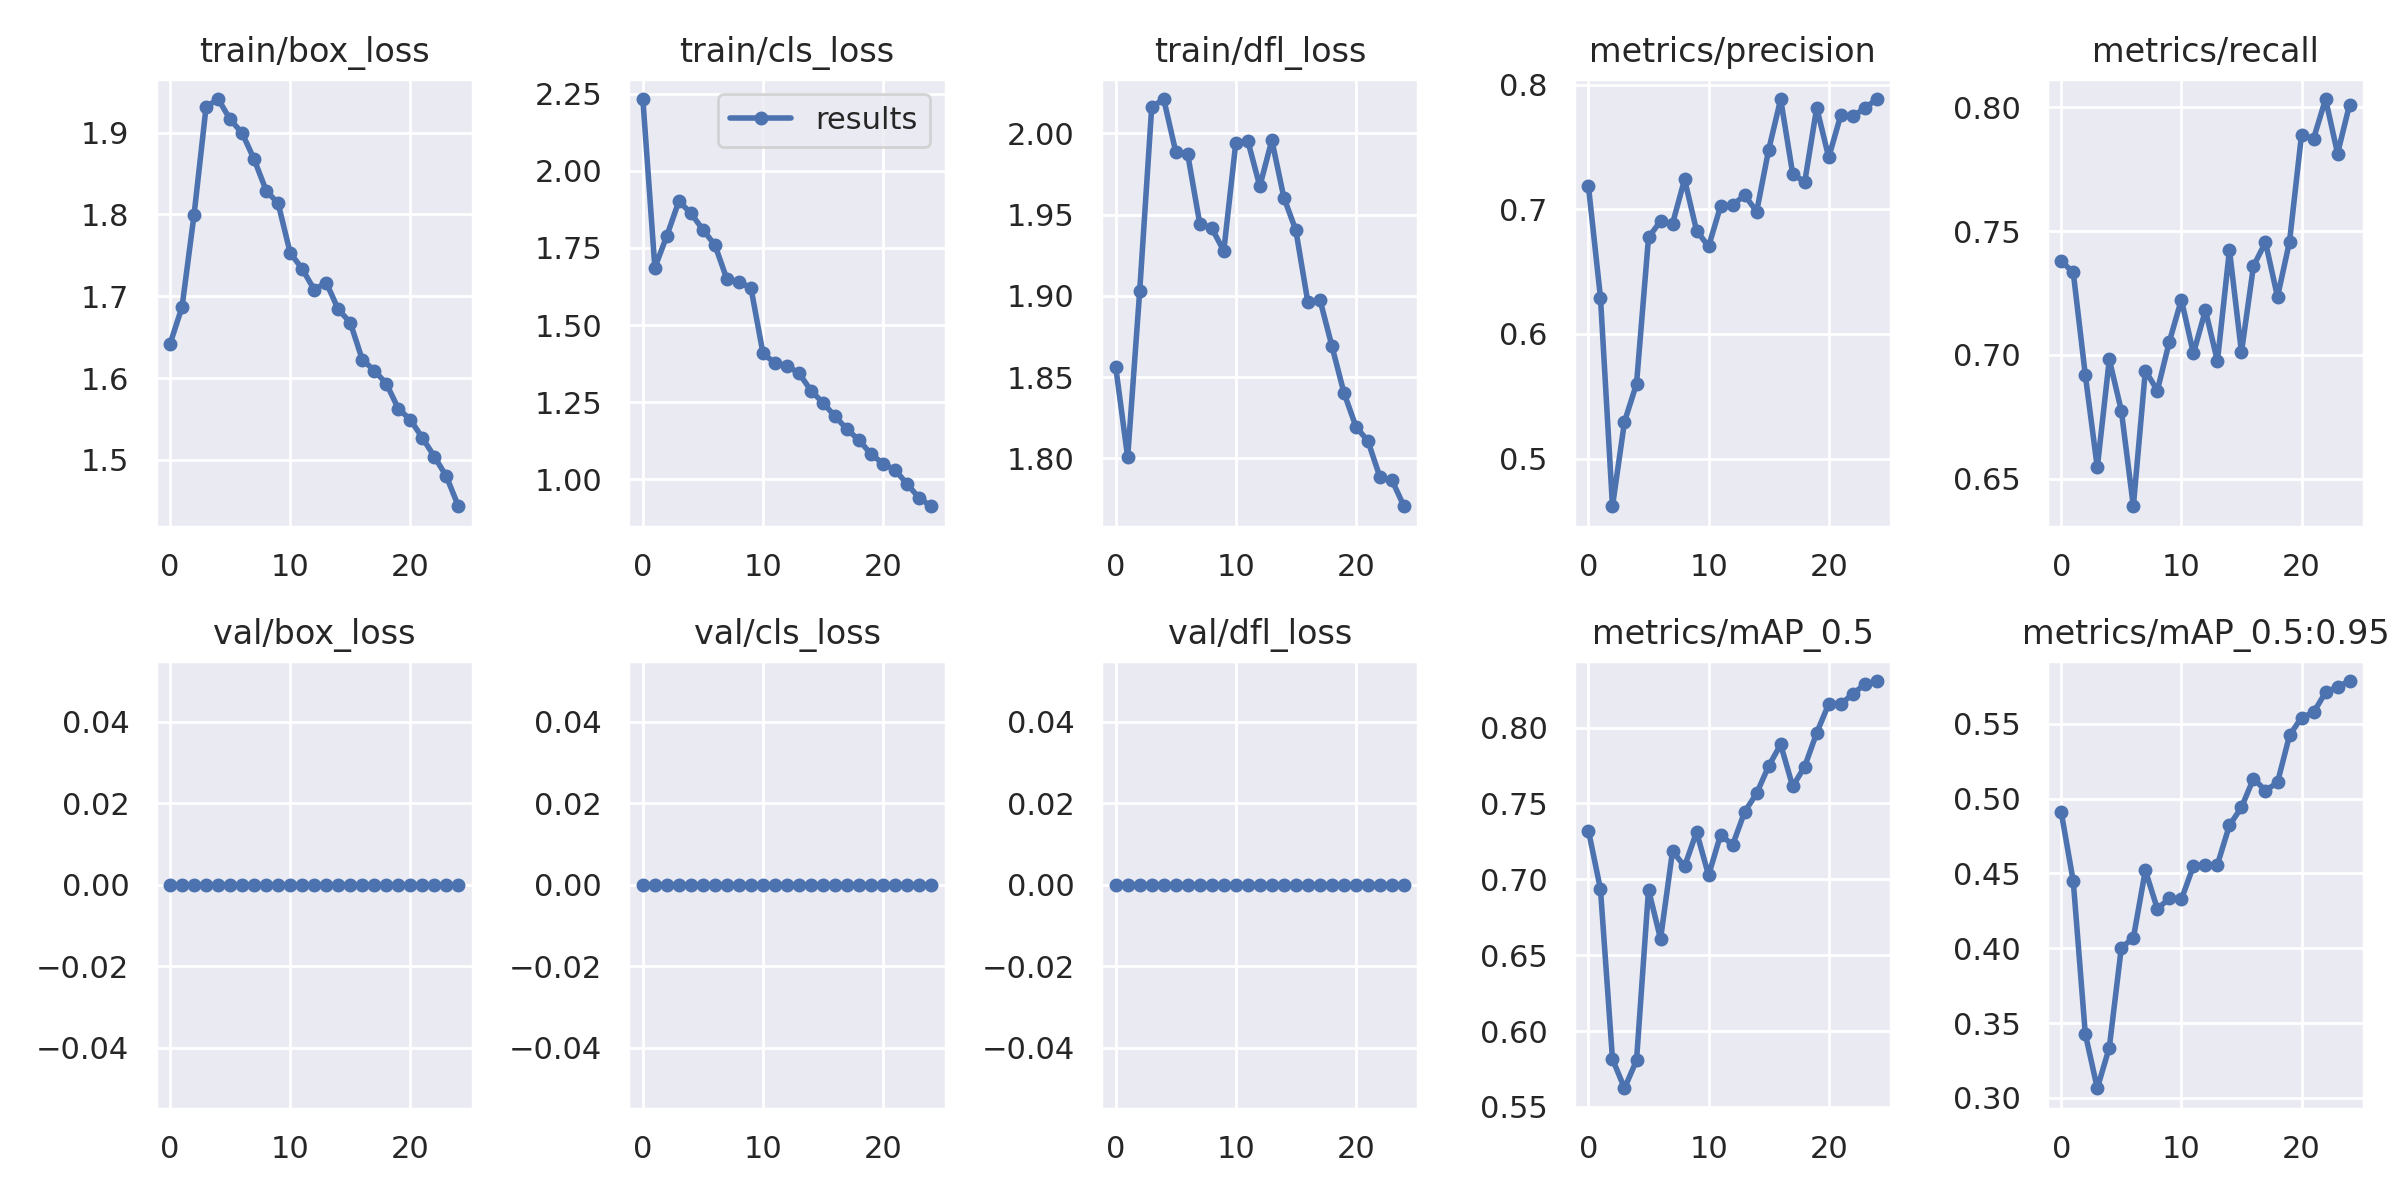

In [7]:
from IPython.display import Image

Image(filename="/home/jupyter/work/resources/yolov9/runs/train/exp8/results.png", width=1000)

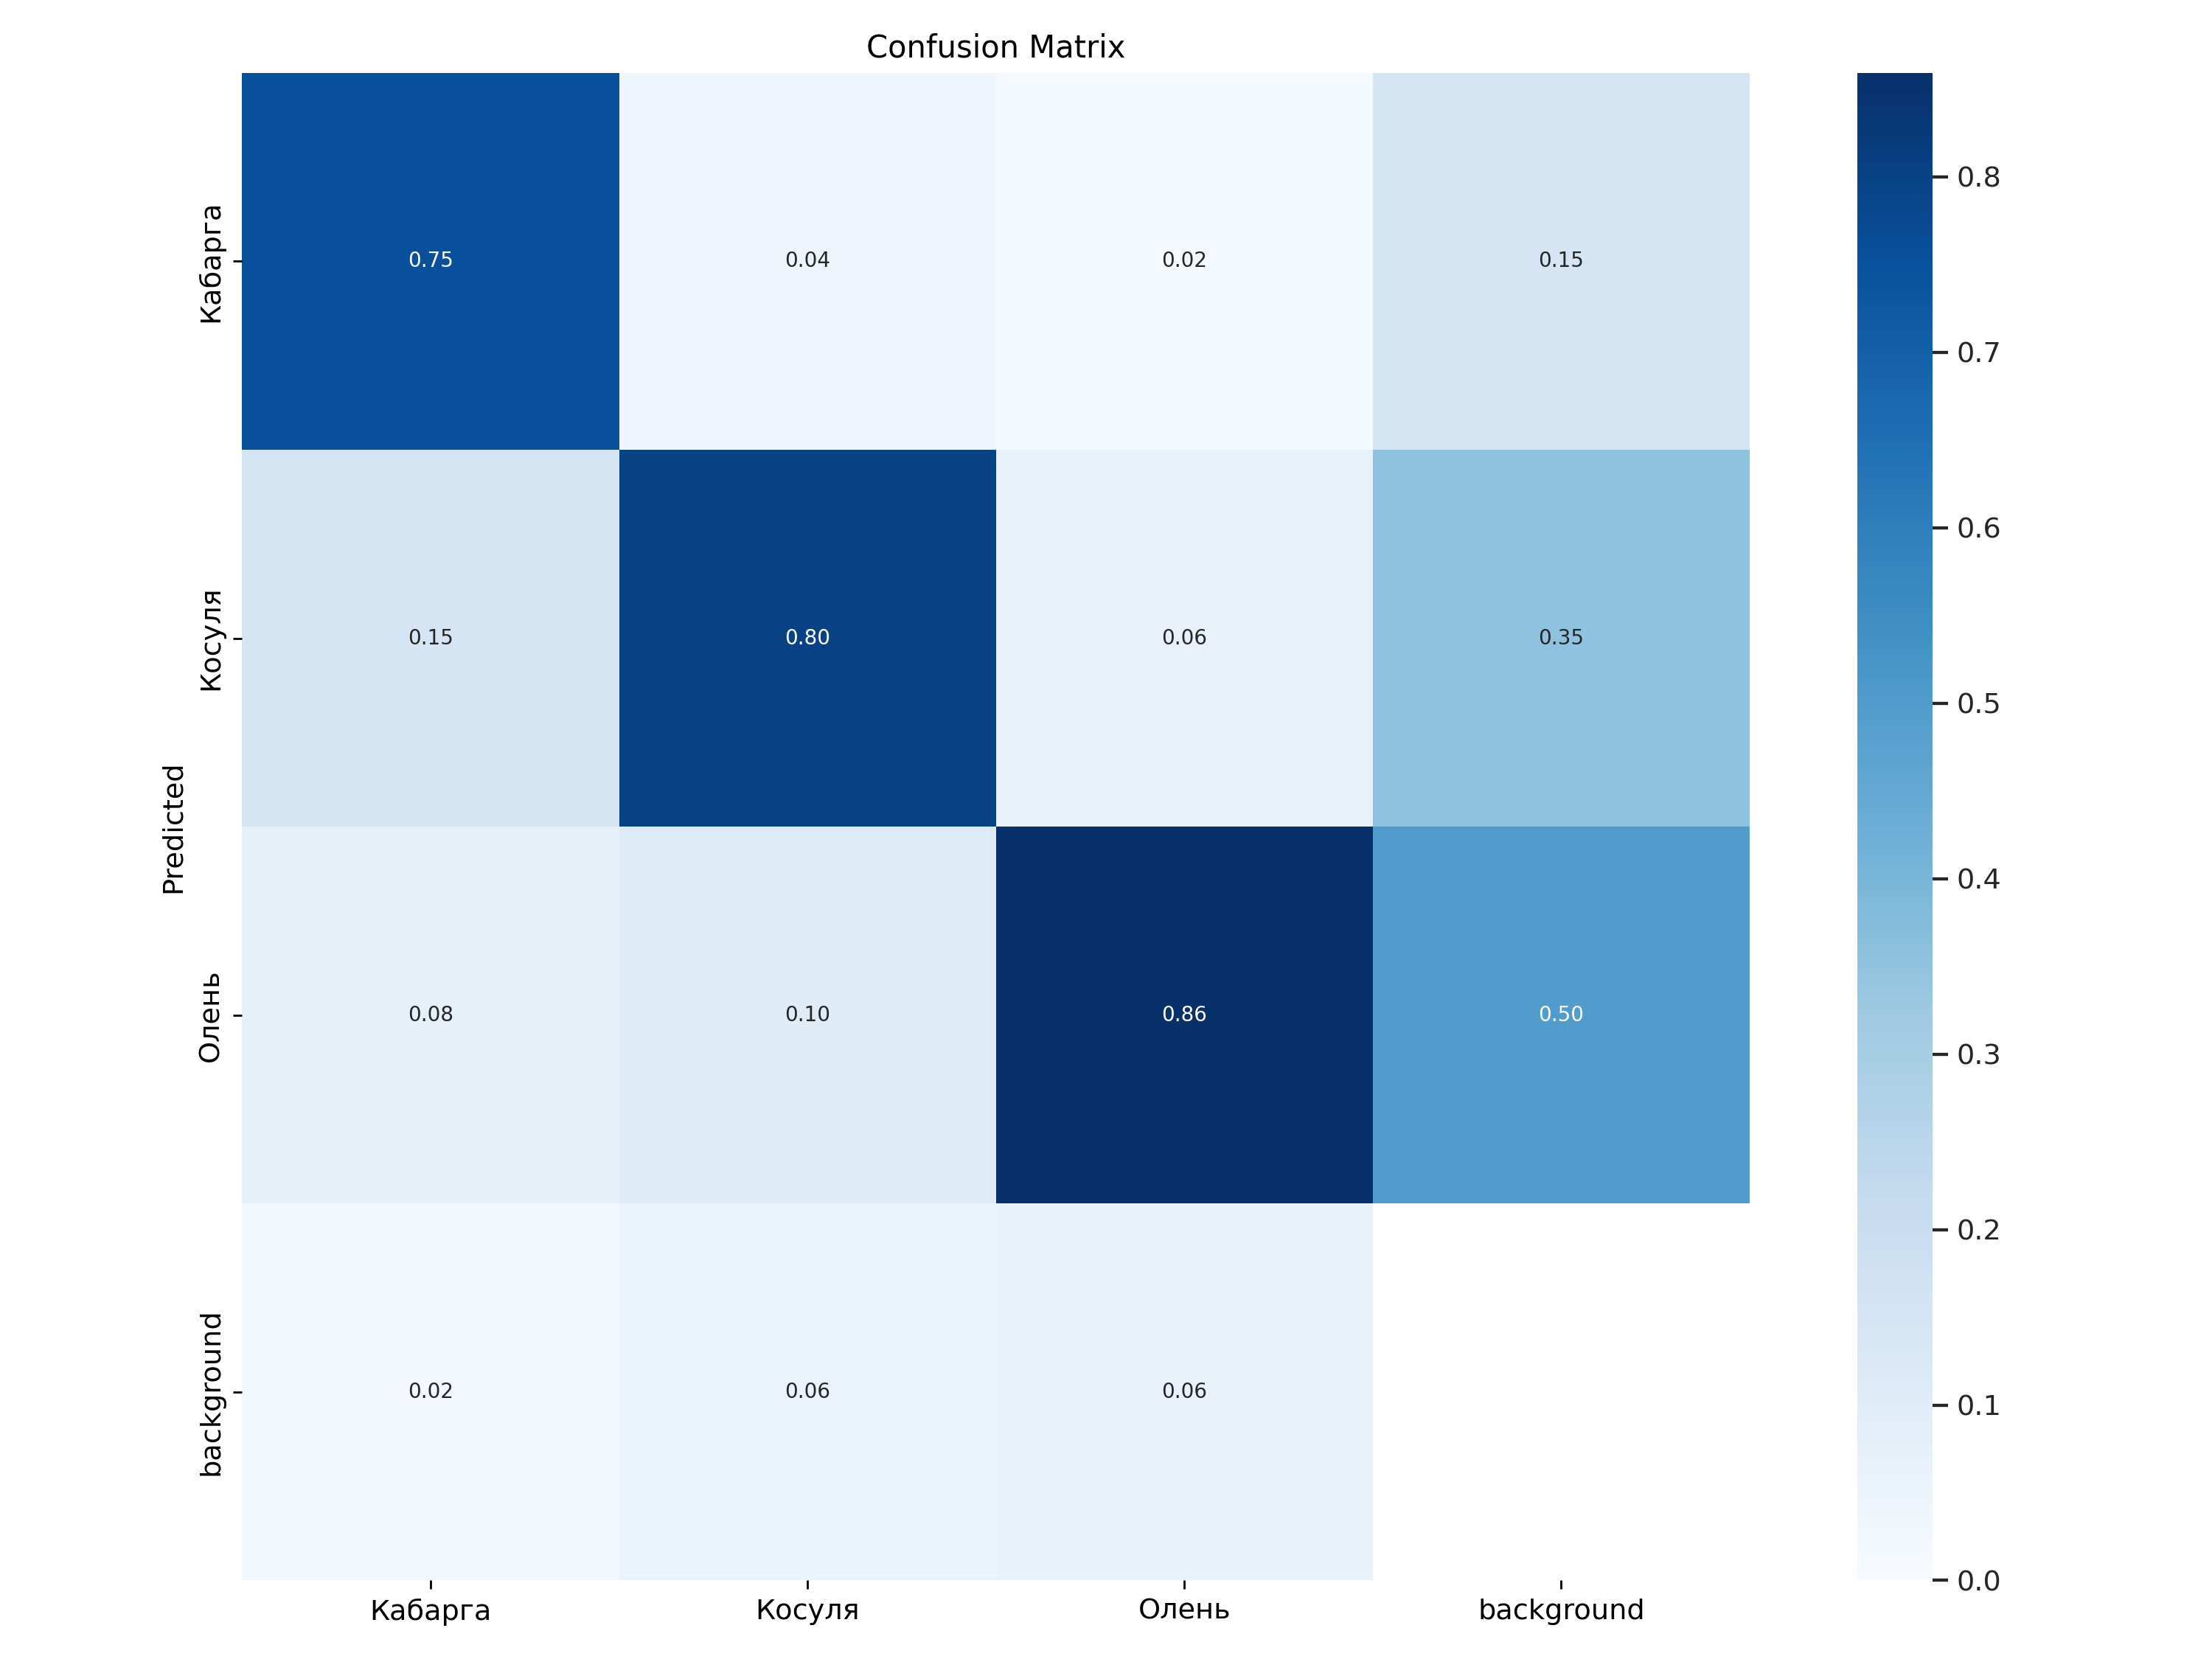

In [9]:
from IPython.display import Image

Image(filename="/home/jupyter/work/resources/yolov9/runs/train/exp8/confusion_matrix.png", width=1000)

# Validation

In [10]:
%cd /home/jupyter/work/resources/yolov9

!python3 val_dual.py \
--img 640 --batch 32 --conf 0.001 --iou 0.7 --device 0 \
--data /home/jupyter/work/resources/yolov9/animals/data.yaml\
--weights /home/jupyter/work/resources/yolov9/runs/train/exp8/weights/best.pt

/home/jupyter/work/resources/yolov9


val_dual: data=/home/jupyter/work/resources/yolov9/animals/data.yaml, weights=['/home/jupyter/work/resources/yolov9/runs/train/exp8/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.7, max_det=300, task=val, device=0, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False, min_items=0
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla V100-PCIE-32GB, 32501MiB)

Fusing layers... 
yolov9-e summary: 1119 layers, 69351410 parameters, 0 gradients, 243.3 GFLOPs
val: Scanning /home/jupyter/work/resources/yolov9/animals/valid.cache... 1138 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1138/1138 00:00
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:39
                   all       1138       1857      0.809      0.794      0.844      0.587
          

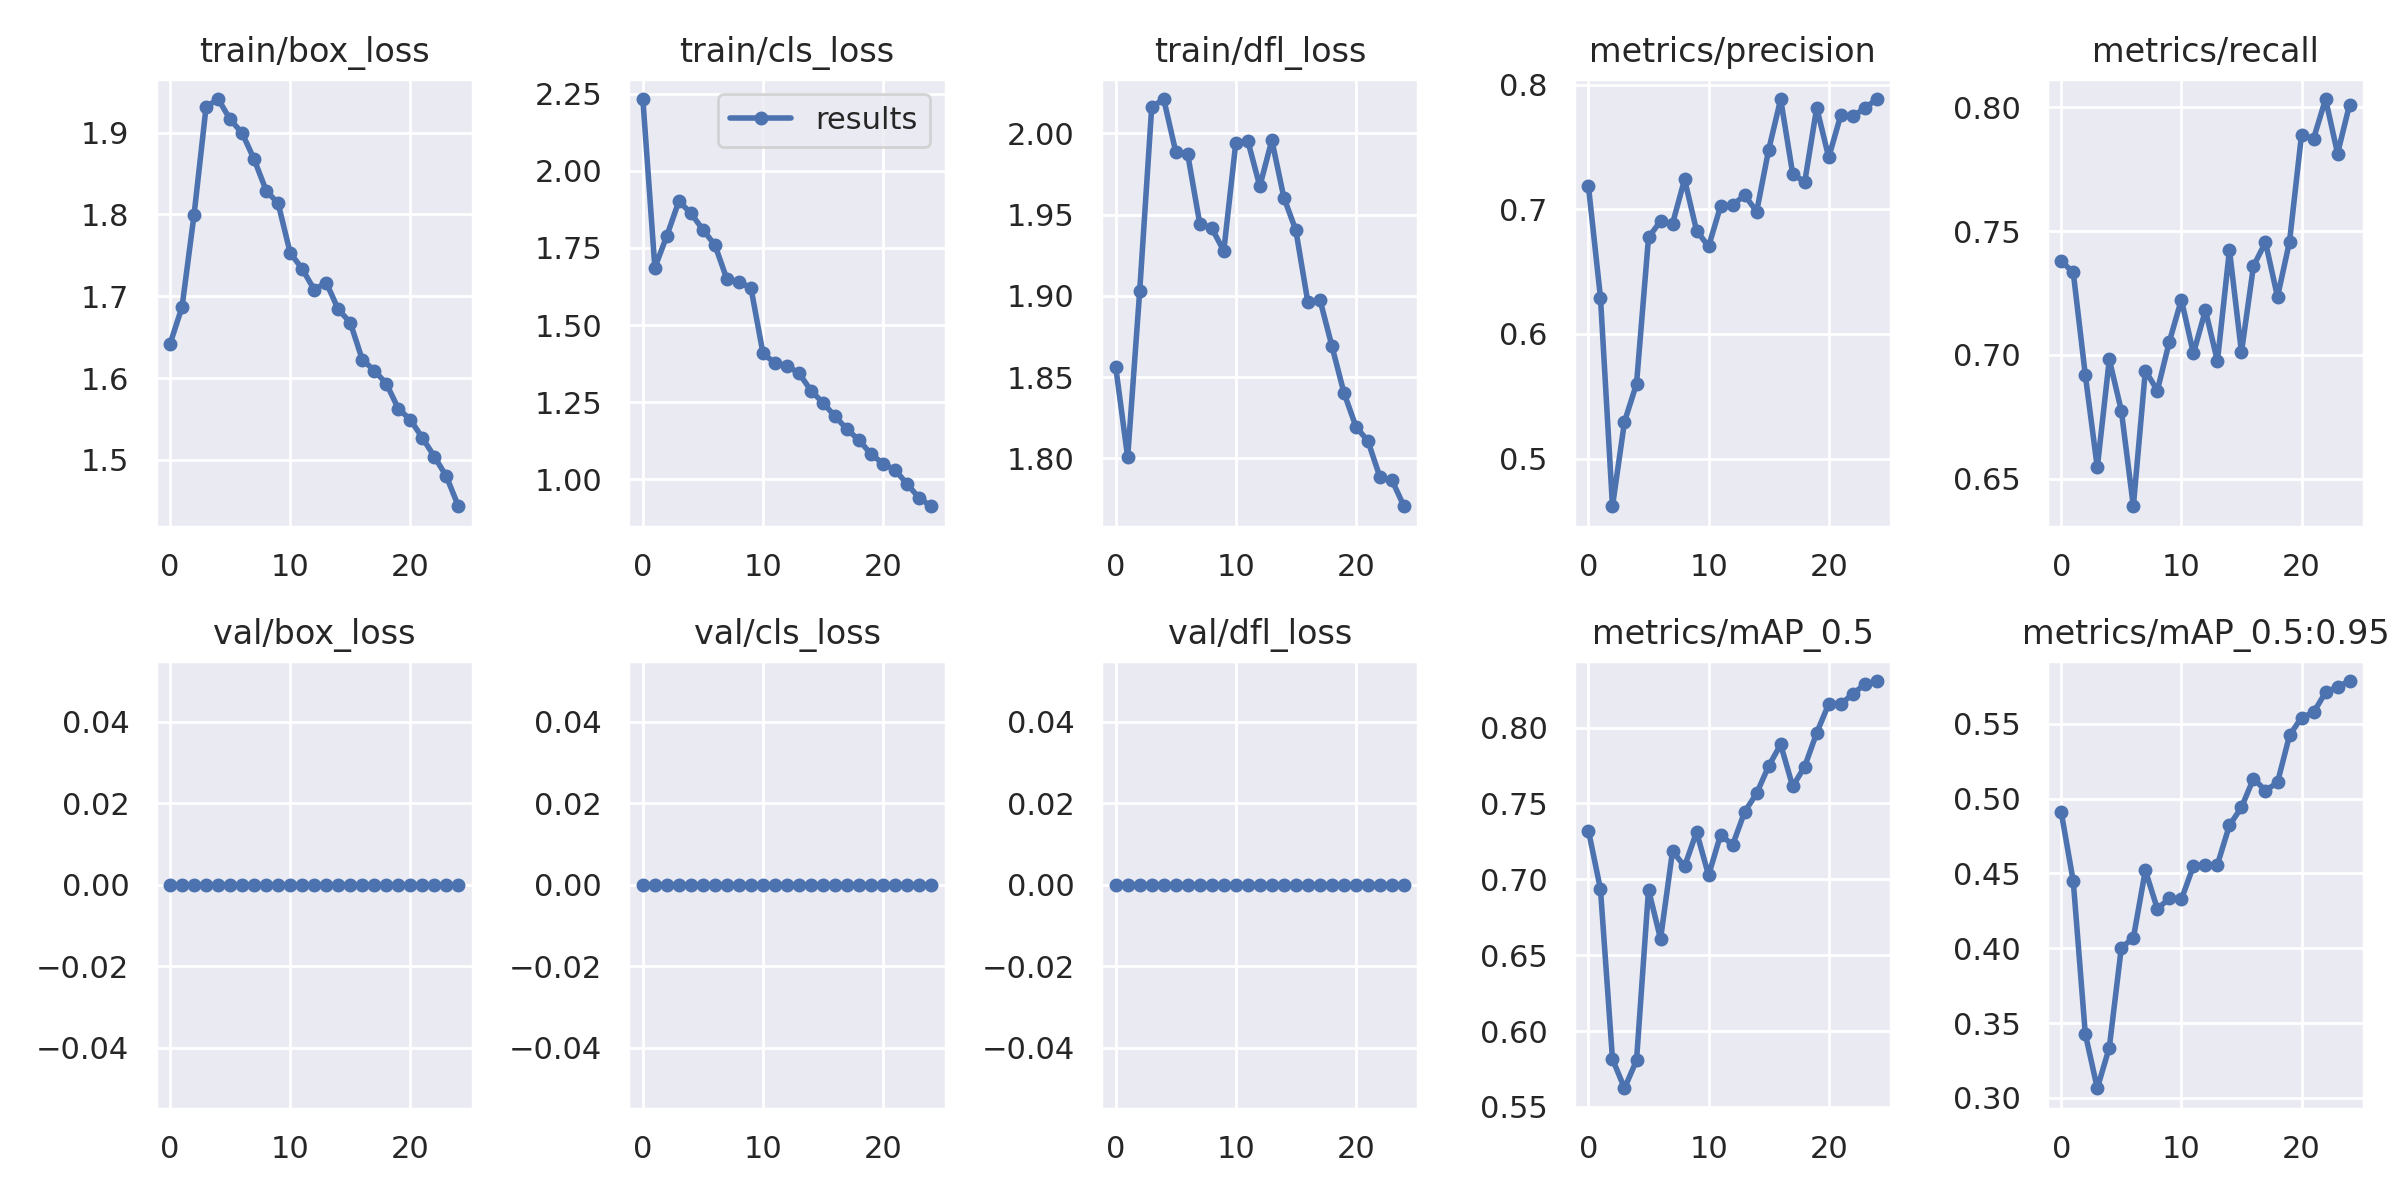

In [12]:
from IPython.display import Image

Image(filename="/home/jupyter/work/resources/yolov9/runs/train/exp8/results.png", width=1000)

# Detection

In [15]:
!python3 detect.py \
--img 1280 --conf 0.5 --device 0 \
--weights /home/jupyter/work/resources/yolov9/runs/train/exp8/weights/best.pt \
--source /home/jupyter/work/resources/yolov9/animals/test/test_video1.MOV

detect: weights=['/home/jupyter/work/resources/yolov9/runs/train/exp8/weights/best.pt'], source=/home/jupyter/work/resources/yolov9/animals/test/test_video1.MOV, data=data/coco128.yaml, imgsz=[1280, 1280], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla V100-PCIE-32GB, 32501MiB)

Fusing layers... 
yolov9-e summary: 1119 layers, 69351410 parameters, 0 gradients, 243.3 GFLOPs
Traceback (most recent call last):
  File "/home/jupyter/work/resources/yolov9/detect.py", line 232, in <module>
    main(opt)
  File "/home/jupyter/work/resources/yolov9/detect.py", line 227, in main
    run(**vars(opt))
  File "/usr/local/lib/python3.1

Exception: Process exited with code 1

In [ ]:
%cd /home/jupyter/work/resources/yolov9

import sys
import subprocess
from tqdm import tqdm

command = [
    'python3', 'train_dual.py',
    '--batch', '16', '--epochs', '30', '--img', '640', '--device', '0', '--min-items', '0', '--close-mosaic', '15',
    '--data', '/home/jupyter/work/resources/yolov9/animals/data.yaml',
    '--weights', '/home/jupyter/work/resources/yolov9/runs/train/exp9/weights/best.pt',
    '--cfg', 'models/detect/yolov9-e.yaml',
    '--hyp', 'hyp.scratch-high.yaml'
]

# Запускаем процесс
process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, universal_newlines=True)

# Создаем tqdm для отслеживания прогресса
with tqdm(total=25, desc="Training") as pbar:
    for line in process.stdout:
        # Обновляем прогресс бар на основе вывода
        pbar.update(1)
        # Печатаем вывод
        sys.stdout.write(line)
        sys.stdout.flush()

# Дожидаемся завершения процесса
process.wait()

# Получаем код возврата
return_code = process.returncode

# Если код возврата не равен нулю, печатаем ошибку
if return_code != 0:
    sys.stderr.write(f"Error: Process returned code {return_code}\n")

/home/jupyter/work/resources/yolov9


Training:   4%|▍         | 1/25 [00:04<01:47,  4.46s/it]

2024-05-19 00:24:04.387644: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Training:  12%|█▏        | 3/25 [00:05<00:34,  1.57s/it]

2024-05-19 00:24:05.491649: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Training:  16%|█▌        | 4/25 [00:07<00:34,  1.64s/it]

train_dual: weights=/home/jupyter/work/resources/yolov9/runs/train/exp9/weights/best.pt, cfg=models/detect/yolov9-e.yaml, data=/home/jupyter/work/resources/yolov9/animals/data.yaml, hyp=hyp.scratch-high.yaml, epochs=30, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=0, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, flat_cos_lr=False, fixed_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, min_items=0, close_mosaic=15, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest


Training:  20%|██        | 5/25 [00:07<00:22,  1.14s/it]

YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla V100-PCIE-32GB, 32501MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=7.5, cls=0.5, cls_pw=1.0, dfl=1.5, obj_pw=1.0, iou_t=0.2, anchor_t=5.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0.1, scale=0.9, shear=0.0, perspective=0.0, flipud=0.0, fliplr=0.5, mosaic=1.0, mixup=0.15, copy_paste=0.3
ClearML: run 'pip install clearml' to automatically track, visualize and remotely train YOLO 🚀 in ClearML
Comet: run 'pip install comet_ml' to automatically track and visualize YOLO 🚀 runs in Comet
TensorBoard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/


Training:  44%|████▍     | 11/25 [00:08<00:05,  2.69it/s]

Overriding model.yaml nc=80 with nc=3

                 from  n    params  module                                  arguments                     
  0                -1  1         0  models.common.Silence                   []                            
  1                -1  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
  2                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  3                -1  1    252160  models.common.RepNCSPELAN4              [128, 256, 128, 64, 2]        
  4                -1  1    164352  models.common.ADown                     [256, 256]                    
  5                -1  1   1004032  models.common.RepNCSPELAN4              [256, 512, 256, 128, 2]       
  6                -1  1    656384  models.common.ADown                     [512, 512]                    
  7                -1  1   4006912  models.common.RepNCSPELAN4              [512, 1024, 512, 256, 2]     

Training:  88%|████████▊ | 22/25 [00:08<00:00,  7.47it/s]

  8                -1  1   2623488  models.common.ADown                     [1024, 1024]                  
  9                -1  1   4269056  models.common.RepNCSPELAN4              [1024, 1024, 512, 256, 2]     
 10                 1  1      4160  models.common.CBLinear                  [64, [64]]                    
 11                 3  1     49344  models.common.CBLinear                  [256, [64, 128]]              
 12                 5  1    229824  models.common.CBLinear                  [512, [64, 128, 256]]         
 13                 7  1    984000  models.common.CBLinear                  [1024, [64, 128, 256, 512]]   
 14                 9  1   2033600  models.common.CBLinear                  [1024, [64, 128, 256, 512, 1024]]
 15                 0  1      1856  models.common.Conv                      [3, 64, 3, 2]                 
 16[10, 11, 12, 13, 14, -1]  1         0  models.common.CBFuse                    [[0, 0, 0, 0, 0]]             
 17                -1  1    

Training: 33it [00:08, 13.52it/s]                        

 19                -1  1    252160  models.common.RepNCSPELAN4              [128, 256, 128, 64, 2]        
 20                -1  1    164352  models.common.ADown                     [256, 256]                    
 21  [12, 13, 14, -1]  1         0  models.common.CBFuse                    [[2, 2, 2]]                   
 22                -1  1   1004032  models.common.RepNCSPELAN4              [256, 512, 256, 128, 2]       
 23                -1  1    656384  models.common.ADown                     [512, 512]                    
 24      [13, 14, -1]  1         0  models.common.CBFuse                    [[3, 3]]                      
 25                -1  1   4006912  models.common.RepNCSPELAN4              [512, 1024, 512, 256, 2]      


Training: 40it [00:08, 17.86it/s]

 26                -1  1   2623488  models.common.ADown                     [1024, 1024]                  
 27          [14, -1]  1         0  models.common.CBFuse                    [[4]]                         
 28                -1  1   4269056  models.common.RepNCSPELAN4              [1024, 1024, 512, 256, 2]     
 29                 9  1    787968  models.common.SPPELAN                   [1024, 512, 256]              
 30                -1  1         0  torch.nn.modules.upsampling.Upsample    [None, 2, 'nearest']          
 31           [-1, 7]  1         0  models.common.Concat                    [1]                           


Training: 46it [00:08, 21.75it/s]

 32                -1  1   4005888  models.common.RepNCSPELAN4              [1536, 512, 512, 256, 2]      
 33                -1  1         0  torch.nn.modules.upsampling.Upsample    [None, 2, 'nearest']          
 34           [-1, 5]  1         0  models.common.Concat                    [1]                           
 35                -1  1   1069056  models.common.RepNCSPELAN4              [1024, 256, 256, 128, 2]      
 36                28  1    787968  models.common.SPPELAN                   [1024, 512, 256]              
 37                -1  1         0  torch.nn.modules.upsampling.Upsample    [None, 2, 'nearest']          
 38          [-1, 25]  1         0  models.common.Concat                    [1]                           
 39                -1  1   4005888  models.common.RepNCSPELAN4              [1536, 512, 512, 256, 2]      
 40                -1  1         0  torch.nn.modules.upsampling.Upsample    [None, 2, 'nearest']          
 41          [-1, 22]  1         0  m

Training: 56it [00:08, 31.36it/s]

 42                -1  1   1069056  models.common.RepNCSPELAN4              [1024, 256, 256, 128, 2]      
 43                -1  1    164352  models.common.ADown                     [256, 256]                    
 44          [-1, 39]  1         0  models.common.Concat                    [1]                           
 45                -1  1   3612672  models.common.RepNCSPELAN4              [768, 512, 512, 256, 2]       
 46                -1  1    656384  models.common.ADown                     [512, 512]                    
 47          [-1, 36]  1         0  models.common.Concat                    [1]                           
 48                -1  1  12860416  models.common.RepNCSPELAN4              [1024, 512, 1024, 512, 2]     


Training: 63it [00:08, 27.71it/s]

 49[35, 32, 29, 42, 45, 48]  1  10985906  models.yolo.DualDDetect                 [3, [256, 512, 512, 256, 512, 512]]
yolov9-e summary: 1475 layers, 69410930 parameters, 69410898 gradients, 244.9 GFLOPs

Transferred 2172/2172 items from /home/jupyter/work/resources/yolov9/runs/train/exp9/weights/best.pt
AMP: checks passed ✅
optimizer: SGD(lr=0.01) with parameter groups 356 weight(decay=0.0), 375 weight(decay=0.0005), 373 bias


Training: 69it [00:11,  6.72it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

train: Scanning /home/jupyter/work/resources/yolov9/animals/train.cache... 5306 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5306/5306 00:00
train: Scanning /home/jupyter/work/resources/yolov9/animals/train.cache... 5306 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5306/5306 00:00


Training: 73it [00:15,  3.22it/s]


val: Scanning /home/jupyter/work/resources/yolov9/animals/valid.cache... 1138 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1138/1138 00:00
val: Scanning /home/jupyter/work/resources/yolov9/animals/valid.cache... 1138 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1138/1138 00:00


Training: 76it [00:16,  3.36it/s]

Plotting labels to runs/train/exp10/labels.jpg... 
Image sizes 640 train, 640 val
Using 8 dataloader workers


Training: 79it [00:24,  1.29it/s]

Logging results to runs/train/exp10
Starting training for 30 epochs...


Training: 81it [00:25,  1.40it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



Training: 84it [00:41,  1.89s/it]

  0%|          | 0/332 00:00


Training: 85it [00:49,  2.54s/it]

       0/29      22.2G      1.507       1.38      1.836         63        640:   0%|          | 0/332 00:15WARNING ⚠️ TensorBoard graph visualization failure Only tensors, lists, tuples of tensors, or dictionary of tensors can be output from traced functions



Training: 87it [00:49,  2.03s/it]

       0/29      22.2G      1.507       1.38      1.836         63        640:   0%|          | 1/332 00:23
       0/29      24.2G      1.478      1.304       1.73         72        640:   0%|          | 1/332 00:24


Training: 89it [00:51,  1.70s/it]

       0/29      24.2G      1.478      1.304       1.73         72        640:   1%|          | 2/332 00:24
       0/29      24.2G      1.566      1.293      1.739         62        640:   1%|          | 2/332 00:26


Training: 91it [00:52,  1.44s/it]

       0/29      24.2G      1.566      1.293      1.739         62        640:   1%|          | 3/332 00:26
       0/29      24.2G      1.583      1.264      1.772         64        640:   1%|          | 3/332 00:27


Training: 93it [00:53,  1.16s/it]

       0/29      24.2G      1.583      1.264      1.772         64        640:   1%|          | 4/332 00:27
       0/29      24.2G      1.579      1.244      1.742         67        640:   1%|          | 4/332 00:28


Training: 95it [00:54,  1.04it/s]

       0/29      24.2G      1.579      1.244      1.742         67        640:   2%|▏         | 5/332 00:28
       0/29      25.4G      1.584      1.249      1.721         68        640:   2%|▏         | 5/332 00:29


Training: 97it [00:55,  1.23it/s]

       0/29      25.4G      1.584      1.249      1.721         68        640:   2%|▏         | 6/332 00:29
       0/29      25.4G      1.568      1.248      1.728         47        640:   2%|▏         | 6/332 00:30


Training: 99it [00:56,  1.42it/s]

       0/29      25.4G      1.568      1.248      1.728         47        640:   2%|▏         | 7/332 00:30
       0/29      25.4G      1.565      1.259       1.72         59        640:   2%|▏         | 7/332 00:31


Training: 101it [00:57,  1.59it/s]

       0/29      25.4G      1.565      1.259       1.72         59        640:   2%|▏         | 8/332 00:31
       0/29      25.4G      1.566      1.232      1.709         53        640:   2%|▏         | 8/332 00:31


Training: 103it [00:58,  1.73it/s]

       0/29      25.4G      1.566      1.232      1.709         53        640:   3%|▎         | 9/332 00:31
       0/29      25.4G      1.588       1.27       1.72         73        640:   3%|▎         | 9/332 00:32


Training: 105it [00:59,  1.85it/s]

       0/29      25.4G      1.588       1.27       1.72         73        640:   3%|▎         | 10/332 00:32
       0/29      25.4G      1.583      1.264      1.723         64        640:   3%|▎         | 10/332 00:33


Training: 107it [01:00,  1.90it/s]

       0/29      25.4G      1.583      1.264      1.723         64        640:   3%|▎         | 11/332 00:33
       0/29      25.4G      1.603      1.287      1.737         73        640:   3%|▎         | 11/332 00:34


Training: 109it [01:00,  2.03it/s]

       0/29      25.4G      1.603      1.287      1.737         73        640:   4%|▎         | 12/332 00:34
       0/29      25.4G      1.613      1.319      1.738         78        640:   4%|▎         | 12/332 00:35


Training: 111it [01:01,  2.08it/s]

       0/29      25.4G      1.613      1.319      1.738         78        640:   4%|▍         | 13/332 00:35
       0/29      25.4G      1.619      1.325      1.741         75        640:   4%|▍         | 13/332 00:36


Training: 113it [01:02,  2.05it/s]

       0/29      25.4G      1.619      1.325      1.741         75        640:   4%|▍         | 14/332 00:36
       0/29      25.4G      1.615      1.316      1.734         80        640:   4%|▍         | 14/332 00:37


Training: 115it [01:03,  2.08it/s]

       0/29      25.4G      1.615      1.316      1.734         80        640:   5%|▍         | 15/332 00:37
       0/29      25.4G      1.606      1.296      1.736         59        640:   5%|▍         | 15/332 00:38


Training: 117it [01:04,  2.09it/s]

       0/29      25.4G      1.606      1.296      1.736         59        640:   5%|▍         | 16/332 00:38
       0/29      25.4G        1.6      1.283      1.743         49        640:   5%|▍         | 16/332 00:39


Training: 119it [01:05,  2.13it/s]

       0/29      25.4G        1.6      1.283      1.743         49        640:   5%|▌         | 17/332 00:39
       0/29      25.4G      1.603      1.294      1.742         90        640:   5%|▌         | 17/332 00:40


Training: 121it [01:06,  2.15it/s]

       0/29      25.4G      1.603      1.294      1.742         90        640:   5%|▌         | 18/332 00:40
       0/29      25.4G      1.597      1.291      1.735         67        640:   5%|▌         | 18/332 00:41


Training: 123it [01:07,  2.12it/s]

       0/29      25.4G      1.597      1.291      1.735         67        640:   6%|▌         | 19/332 00:41
       0/29      25.4G      1.613      1.297      1.751         51        640:   6%|▌         | 19/332 00:42


Training: 125it [01:08,  2.15it/s]

       0/29      25.4G      1.613      1.297      1.751         51        640:   6%|▌         | 20/332 00:42
       0/29      25.4G      1.607      1.306      1.746         67        640:   6%|▌         | 20/332 00:43


Training: 127it [01:09,  2.04it/s]

       0/29      25.4G      1.607      1.306      1.746         67        640:   6%|▋         | 21/332 00:43
       0/29      25.4G        1.6      1.294      1.739         78        640:   6%|▋         | 21/332 00:44


Training: 129it [01:10,  2.07it/s]

       0/29      25.4G        1.6      1.294      1.739         78        640:   7%|▋         | 22/332 00:44
       0/29      25.4G      1.593       1.29      1.737         50        640:   7%|▋         | 22/332 00:45


Training: 131it [01:11,  2.11it/s]

       0/29      25.4G      1.593       1.29      1.737         50        640:   7%|▋         | 23/332 00:45
       0/29      25.4G      1.606      1.304       1.75         66        640:   7%|▋         | 23/332 00:45


Training: 133it [01:12,  2.13it/s]

       0/29      25.4G      1.606      1.304       1.75         66        640:   7%|▋         | 24/332 00:45
       0/29      25.4G        1.6      1.293      1.748         54        640:   7%|▋         | 24/332 00:46


Training: 135it [01:13,  2.15it/s]

       0/29      25.4G        1.6      1.293      1.748         54        640:   8%|▊         | 25/332 00:46
       0/29      25.4G      1.603      1.294       1.75         53        640:   8%|▊         | 25/332 00:47


Training: 137it [01:13,  2.16it/s]

       0/29      25.4G      1.603      1.294       1.75         53        640:   8%|▊         | 26/332 00:47
       0/29      25.4G      1.602      1.296      1.745         82        640:   8%|▊         | 26/332 00:48


Training: 139it [01:14,  2.17it/s]

       0/29      25.4G      1.602      1.296      1.745         82        640:   8%|▊         | 27/332 00:48
       0/29      25.4G      1.591      1.283       1.74         53        640:   8%|▊         | 27/332 00:49


Training: 141it [01:15,  2.18it/s]

       0/29      25.4G      1.591      1.283       1.74         53        640:   8%|▊         | 28/332 00:49
       0/29      25.4G      1.591      1.293      1.745         56        640:   8%|▊         | 28/332 00:50


Training: 143it [01:16,  2.14it/s]

       0/29      25.4G      1.591      1.293      1.745         56        640:   9%|▊         | 29/332 00:50
       0/29      25.4G      1.589      1.284      1.743         60        640:   9%|▊         | 29/332 00:51


Training: 145it [01:17,  2.14it/s]

       0/29      25.4G      1.589      1.284      1.743         60        640:   9%|▉         | 30/332 00:51
       0/29      25.4G      1.591      1.288      1.745         77        640:   9%|▉         | 30/332 00:52


Training: 147it [01:18,  2.16it/s]

       0/29      25.4G      1.591      1.288      1.745         77        640:   9%|▉         | 31/332 00:52
       0/29      25.4G      1.592      1.277      1.734         93        640:   9%|▉         | 31/332 00:53


Training: 149it [01:19,  2.13it/s]

       0/29      25.4G      1.592      1.277      1.734         93        640:  10%|▉         | 32/332 00:53
       0/29      25.4G      1.591      1.289      1.735         63        640:  10%|▉         | 32/332 00:54


Training: 151it [01:20,  2.15it/s]

       0/29      25.4G      1.591      1.289      1.735         63        640:  10%|▉         | 33/332 00:54
       0/29      25.4G      1.583      1.275       1.73         48        640:  10%|▉         | 33/332 00:55


Training: 153it [01:21,  2.17it/s]

       0/29      25.4G      1.583      1.275       1.73         48        640:  10%|█         | 34/332 00:55
       0/29      25.4G      1.582      1.271      1.737         42        640:  10%|█         | 34/332 00:56


Training: 155it [01:22,  2.17it/s]

       0/29      25.4G      1.582      1.271      1.737         42        640:  11%|█         | 35/332 00:56
       0/29      25.4G      1.581      1.273      1.738         59        640:  11%|█         | 35/332 00:57


Training: 157it [01:24,  1.48it/s]

       0/29      25.4G      1.581      1.273      1.738         59        640:  11%|█         | 36/332 00:57
       0/29      25.4G      1.573      1.275      1.735         53        640:  11%|█         | 36/332 00:59


Training: 159it [01:25,  1.61it/s]

       0/29      25.4G      1.573      1.275      1.735         53        640:  11%|█         | 37/332 00:59
       0/29      25.4G      1.574      1.276      1.738         64        640:  11%|█         | 37/332 01:00


Training: 161it [01:26,  1.68it/s]

       0/29      25.4G      1.574      1.276      1.738         64        640:  11%|█▏        | 38/332 01:00
       0/29      25.4G      1.575      1.272       1.74         60        640:  11%|█▏        | 38/332 01:01


Training: 163it [01:27,  1.76it/s]

       0/29      25.4G      1.575      1.272       1.74         60        640:  12%|█▏        | 39/332 01:01
       0/29      25.4G       1.57      1.272      1.737         73        640:  12%|█▏        | 39/332 01:02


Training: 165it [01:28,  1.87it/s]

       0/29      25.4G       1.57      1.272      1.737         73        640:  12%|█▏        | 40/332 01:02
       0/29      25.4G      1.567      1.269      1.737         57        640:  12%|█▏        | 40/332 01:03


Training: 167it [01:29,  1.94it/s]

       0/29      25.4G      1.567      1.269      1.737         57        640:  12%|█▏        | 41/332 01:03
       0/29      25.4G      1.561      1.265      1.734         63        640:  12%|█▏        | 41/332 01:04


Training: 169it [01:30,  2.01it/s]

       0/29      25.4G      1.561      1.265      1.734         63        640:  13%|█▎        | 42/332 01:04
       0/29      25.4G       1.56      1.265      1.737         50        640:  13%|█▎        | 42/332 01:05


Training: 171it [01:31,  2.07it/s]

       0/29      25.4G       1.56      1.265      1.737         50        640:  13%|█▎        | 43/332 01:05
       0/29      25.4G       1.56      1.266      1.738         58        640:  13%|█▎        | 43/332 01:06


Training: 173it [01:34,  1.27it/s]

       0/29      25.4G       1.56      1.266      1.738         58        640:  13%|█▎        | 44/332 01:06
       0/29      25.4G      1.559      1.263      1.734         86        640:  13%|█▎        | 44/332 01:09


Training: 175it [01:35,  1.45it/s]

       0/29      25.4G      1.559      1.263      1.734         86        640:  14%|█▎        | 45/332 01:09
       0/29      25.4G      1.559      1.267      1.734         59        640:  14%|█▎        | 45/332 01:10


Training: 177it [01:36,  1.62it/s]

       0/29      25.4G      1.559      1.267      1.734         59        640:  14%|█▍        | 46/332 01:10
       0/29      25.4G      1.558      1.268      1.735         57        640:  14%|█▍        | 46/332 01:10


Training: 179it [01:37,  1.75it/s]

       0/29      25.4G      1.558      1.268      1.735         57        640:  14%|█▍        | 47/332 01:10
       0/29      25.4G      1.559      1.264      1.737         57        640:  14%|█▍        | 47/332 01:11


Training: 181it [01:38,  1.85it/s]

       0/29      25.4G      1.559      1.264      1.737         57        640:  14%|█▍        | 48/332 01:11
       0/29      25.4G      1.556      1.265      1.737         71        640:  14%|█▍        | 48/332 01:12


Training: 183it [01:39,  1.90it/s]

       0/29      25.4G      1.556      1.265      1.737         71        640:  15%|█▍        | 49/332 01:12
       0/29      25.4G      1.557      1.267      1.734         78        640:  15%|█▍        | 49/332 01:13


Training: 185it [01:40,  1.96it/s]

       0/29      25.4G      1.557      1.267      1.734         78        640:  15%|█▌        | 50/332 01:13
       0/29      25.4G      1.561      1.276       1.74         56        640:  15%|█▌        | 50/332 01:14


Training: 187it [01:40,  2.02it/s]

       0/29      25.4G      1.561      1.276       1.74         56        640:  15%|█▌        | 51/332 01:14
       0/29      25.4G      1.561      1.271      1.734         75        640:  15%|█▌        | 51/332 01:15


Training: 189it [01:44,  1.17it/s]

       0/29      25.4G      1.561      1.271      1.734         75        640:  16%|█▌        | 52/332 01:15
       0/29      25.4G      1.564       1.27      1.734         67        640:  16%|█▌        | 52/332 01:19


Training: 191it [01:45,  1.36it/s]

       0/29      25.4G      1.564       1.27      1.734         67        640:  16%|█▌        | 53/332 01:19
       0/29      25.4G      1.559      1.266      1.733         51        640:  16%|█▌        | 53/332 01:19


Training: 193it [01:46,  1.52it/s]

       0/29      25.4G      1.559      1.266      1.733         51        640:  16%|█▋        | 54/332 01:19
       0/29      25.4G      1.557      1.267      1.732         72        640:  16%|█▋        | 54/332 01:20


Training: 195it [01:47,  1.57it/s]

       0/29      25.4G      1.557      1.267      1.732         72        640:  17%|█▋        | 55/332 01:20
       0/29      25.4G      1.554      1.264      1.729         82        640:  17%|█▋        | 55/332 01:22


Training: 197it [01:48,  1.69it/s]

       0/29      25.4G      1.554      1.264      1.729         82        640:  17%|█▋        | 56/332 01:22
       0/29      25.4G      1.553      1.264      1.731         55        640:  17%|█▋        | 56/332 01:23


Training: 199it [01:49,  1.79it/s]

       0/29      25.4G      1.553      1.264      1.731         55        640:  17%|█▋        | 57/332 01:23
       0/29      25.4G      1.554       1.26      1.732         57        640:  17%|█▋        | 57/332 01:24


Training: 201it [01:50,  1.87it/s]

       0/29      25.4G      1.554       1.26      1.732         57        640:  17%|█▋        | 58/332 01:24
       0/29      25.4G      1.552      1.259      1.734         46        640:  17%|█▋        | 58/332 01:24


Training: 203it [01:51,  1.96it/s]

       0/29      25.4G      1.552      1.259      1.734         46        640:  18%|█▊        | 59/332 01:24
       0/29      25.4G      1.548      1.258      1.733         53        640:  18%|█▊        | 59/332 01:25


Training: 205it [01:54,  1.22it/s]

       0/29      25.4G      1.548      1.258      1.733         53        640:  18%|█▊        | 60/332 01:25
       0/29      25.4G      1.547      1.253      1.733         45        640:  18%|█▊        | 60/332 01:28


Training: 207it [01:55,  1.40it/s]

       0/29      25.4G      1.547      1.253      1.733         45        640:  18%|█▊        | 61/332 01:28
       0/29      25.4G      1.547      1.253      1.735         61        640:  18%|█▊        | 61/332 01:29


Training: 209it [01:56,  1.54it/s]

       0/29      25.4G      1.547      1.253      1.735         61        640:  19%|█▊        | 62/332 01:29
       0/29      25.4G      1.546      1.258      1.733         91        640:  19%|█▊        | 62/332 01:30


Training: 211it [01:57,  1.38it/s]

       0/29      25.4G      1.546      1.258      1.733         91        640:  19%|█▉        | 63/332 01:30
       0/29      25.4G      1.545      1.257      1.735         64        640:  19%|█▉        | 63/332 01:32


Training: 213it [01:58,  1.53it/s]

       0/29      25.4G      1.545      1.257      1.735         64        640:  19%|█▉        | 64/332 01:32
       0/29      25.4G      1.544      1.255      1.734         53        640:  19%|█▉        | 64/332 01:33


Training: 215it [01:59,  1.65it/s]

       0/29      25.4G      1.544      1.255      1.734         53        640:  20%|█▉        | 65/332 01:33
       0/29      25.4G      1.542      1.252      1.731         60        640:  20%|█▉        | 65/332 01:34


Training: 217it [02:00,  1.78it/s]

       0/29      25.4G      1.542      1.252      1.731         60        640:  20%|█▉        | 66/332 01:34
       0/29      25.4G      1.543      1.252      1.734         54        640:  20%|█▉        | 66/332 01:35


Training: 219it [02:01,  1.88it/s]

       0/29      25.4G      1.543      1.252      1.734         54        640:  20%|██        | 67/332 01:35
       0/29      25.4G      1.544      1.252      1.734         65        640:  20%|██        | 67/332 01:36


Training: 221it [02:04,  1.27it/s]

       0/29      25.4G      1.544      1.252      1.734         65        640:  20%|██        | 68/332 01:36
       0/29      25.4G      1.545      1.251      1.739         46        640:  20%|██        | 68/332 01:39


Training: 223it [02:05,  1.43it/s]

       0/29      25.4G      1.545      1.251      1.739         46        640:  21%|██        | 69/332 01:39
       0/29      25.4G      1.544       1.25      1.738         61        640:  21%|██        | 69/332 01:40


Training: 225it [02:06,  1.60it/s]

       0/29      25.4G      1.544       1.25      1.738         61        640:  21%|██        | 70/332 01:40
       0/29      25.4G      1.543      1.246      1.737         74        640:  21%|██        | 70/332 01:41


Training: 227it [02:08,  1.41it/s]

       0/29      25.4G      1.543      1.246      1.737         74        640:  21%|██▏       | 71/332 01:41
       0/29      25.4G      1.543      1.244      1.734         89        640:  21%|██▏       | 71/332 01:43


Training: 229it [02:09,  1.58it/s]

       0/29      25.4G      1.543      1.244      1.734         89        640:  22%|██▏       | 72/332 01:43
       0/29      25.4G      1.542      1.241      1.732         61        640:  22%|██▏       | 72/332 01:43


Training: 231it [02:10,  1.73it/s]

       0/29      25.4G      1.542      1.241      1.732         61        640:  22%|██▏       | 73/332 01:43
       0/29      25.4G       1.54      1.239      1.732         64        640:  22%|██▏       | 73/332 01:44


Training: 233it [02:10,  1.86it/s]

       0/29      25.4G       1.54      1.239      1.732         64        640:  22%|██▏       | 74/332 01:44
       0/29      25.4G      1.543      1.248      1.734         63        640:  22%|██▏       | 74/332 01:45


Training: 235it [02:11,  1.94it/s]

       0/29      25.4G      1.543      1.248      1.734         63        640:  23%|██▎       | 75/332 01:45
       0/29      25.4G      1.543      1.248      1.735         70        640:  23%|██▎       | 75/332 01:46


Training: 237it [02:13,  1.75it/s]

       0/29      25.4G      1.543      1.248      1.735         70        640:  23%|██▎       | 76/332 01:46
       0/29      25.4G      1.542       1.25      1.734         70        640:  23%|██▎       | 76/332 01:48


Training: 239it [02:14,  1.84it/s]

       0/29      25.4G      1.542       1.25      1.734         70        640:  23%|██▎       | 77/332 01:48
       0/29      25.4G      1.543      1.249      1.733         86        640:  23%|██▎       | 77/332 01:48


Training: 241it [02:15,  1.92it/s]

       0/29      25.4G      1.543      1.249      1.733         86        640:  23%|██▎       | 78/332 01:48
       0/29      25.4G      1.543      1.246      1.732         58        640:  23%|██▎       | 78/332 01:49


Training: 243it [02:19,  1.05it/s]

       0/29      25.4G      1.543      1.246      1.732         58        640:  24%|██▍       | 79/332 01:49
       0/29      25.4G      1.545       1.25      1.732         77        640:  24%|██▍       | 79/332 01:53


Training: 245it [02:20,  1.25it/s]

       0/29      25.4G      1.545       1.25      1.732         77        640:  24%|██▍       | 80/332 01:53
       0/29      25.4G      1.545      1.247      1.732         57        640:  24%|██▍       | 80/332 01:54


Training: 247it [02:20,  1.43it/s]

       0/29      25.4G      1.545      1.247      1.732         57        640:  24%|██▍       | 81/332 01:54
       0/29      25.4G      1.546      1.249      1.736         48        640:  24%|██▍       | 81/332 01:55


Training: 249it [02:21,  1.60it/s]

       0/29      25.4G      1.546      1.249      1.736         48        640:  25%|██▍       | 82/332 01:55
       0/29      25.4G      1.546      1.251      1.736         69        640:  25%|██▍       | 82/332 01:56


Training: 251it [02:22,  1.73it/s]

       0/29      25.4G      1.546      1.251      1.736         69        640:  25%|██▌       | 83/332 01:56
       0/29      25.4G      1.543      1.248      1.734         57        640:  25%|██▌       | 83/332 01:57


Training: 253it [02:23,  1.86it/s]

       0/29      25.4G      1.543      1.248      1.734         57        640:  25%|██▌       | 84/332 01:57
       0/29      25.4G      1.543      1.246      1.735         70        640:  25%|██▌       | 84/332 01:58


Training: 255it [02:25,  1.54it/s]

       0/29      25.4G      1.543      1.246      1.735         70        640:  26%|██▌       | 85/332 01:58
       0/29      25.4G      1.543      1.248      1.736         60        640:  26%|██▌       | 85/332 02:00


Training: 257it [02:26,  1.67it/s]

       0/29      25.4G      1.543      1.248      1.736         60        640:  26%|██▌       | 86/332 02:00
       0/29      25.4G      1.543       1.25      1.737         77        640:  26%|██▌       | 86/332 02:01


Training: 259it [02:27,  1.73it/s]

       0/29      25.4G      1.543       1.25      1.737         77        640:  26%|██▌       | 87/332 02:01
       0/29      25.4G      1.544      1.247      1.736         56        640:  26%|██▌       | 87/332 02:02


Training: 261it [02:28,  1.81it/s]

       0/29      25.4G      1.544      1.247      1.736         56        640:  27%|██▋       | 88/332 02:02
       0/29      25.4G      1.543      1.247      1.737         38        640:  27%|██▋       | 88/332 02:03


Training: 263it [02:29,  1.88it/s]

       0/29      25.4G      1.543      1.247      1.737         38        640:  27%|██▋       | 89/332 02:03
       0/29      25.4G      1.542      1.246      1.736         60        640:  27%|██▋       | 89/332 02:04


Training: 265it [02:30,  1.97it/s]

       0/29      25.4G      1.542      1.246      1.736         60        640:  27%|██▋       | 90/332 02:04
       0/29      25.4G      1.542      1.246      1.737         67        640:  27%|██▋       | 90/332 02:05


Training: 267it [02:31,  2.04it/s]

       0/29      25.4G      1.542      1.246      1.737         67        640:  27%|██▋       | 91/332 02:05
       0/29      25.4G       1.54      1.242      1.736         56        640:  27%|██▋       | 91/332 02:05


Training: 269it [02:33,  1.62it/s]

       0/29      25.4G       1.54      1.242      1.736         56        640:  28%|██▊       | 92/332 02:05
       0/29      25.4G      1.538       1.24      1.734         74        640:  28%|██▊       | 92/332 02:07


Training: 271it [02:35,  1.25it/s]

       0/29      25.4G      1.538       1.24      1.734         74        640:  28%|██▊       | 93/332 02:07
       0/29      25.4G      1.538      1.239      1.734         89        640:  28%|██▊       | 93/332 02:10


Training: 273it [02:36,  1.43it/s]

       0/29      25.4G      1.538      1.239      1.734         89        640:  28%|██▊       | 94/332 02:10
       0/29      25.4G      1.538      1.237      1.732         70        640:  28%|██▊       | 94/332 02:11


Training: 275it [02:37,  1.59it/s]

       0/29      25.4G      1.538      1.237      1.732         70        640:  29%|██▊       | 95/332 02:11
       0/29      25.4G      1.538      1.238      1.732         68        640:  29%|██▊       | 95/332 02:12


Training: 277it [02:38,  1.71it/s]

       0/29      25.4G      1.538      1.238      1.732         68        640:  29%|██▉       | 96/332 02:12
       0/29      25.4G      1.539      1.241      1.732        103        640:  29%|██▉       | 96/332 02:13


Training: 279it [02:39,  1.83it/s]

       0/29      25.4G      1.539      1.241      1.732        103        640:  29%|██▉       | 97/332 02:13
       0/29      25.4G       1.54      1.239      1.732         61        640:  29%|██▉       | 97/332 02:13


Training: 281it [02:40,  1.91it/s]

       0/29      25.4G       1.54      1.239      1.732         61        640:  30%|██▉       | 98/332 02:13
       0/29      25.4G       1.54      1.239      1.731         64        640:  30%|██▉       | 98/332 02:14


Training: 283it [02:41,  1.98it/s]

       0/29      25.4G       1.54      1.239      1.731         64        640:  30%|██▉       | 99/332 02:14
       0/29      25.4G      1.539       1.24      1.731         68        640:  30%|██▉       | 99/332 02:15


Training: 285it [02:42,  1.64it/s]

       0/29      25.4G      1.539       1.24      1.731         68        640:  30%|███       | 100/332 02:15
       0/29      25.4G      1.539      1.238      1.732         60        640:  30%|███       | 100/332 02:17


Training: 287it [02:45,  1.17it/s]

       0/29      25.4G      1.539      1.238      1.732         60        640:  30%|███       | 101/332 02:17
       0/29      25.4G      1.539      1.237      1.731         81        640:  30%|███       | 101/332 02:20


Training: 289it [02:46,  1.37it/s]

       0/29      25.4G      1.539      1.237      1.731         81        640:  31%|███       | 102/332 02:20
       0/29      25.4G      1.538      1.236      1.731         60        640:  31%|███       | 102/332 02:21


Training: 291it [02:47,  1.54it/s]

       0/29      25.4G      1.538      1.236      1.731         60        640:  31%|███       | 103/332 02:21
       0/29      25.4G      1.537      1.235      1.733         44        640:  31%|███       | 103/332 02:22


Training: 293it [02:48,  1.67it/s]

       0/29      25.4G      1.537      1.235      1.733         44        640:  31%|███▏      | 104/332 02:22
       0/29      25.4G      1.538      1.237      1.734         54        640:  31%|███▏      | 104/332 02:23


Training: 295it [02:49,  1.79it/s]

       0/29      25.4G      1.538      1.237      1.734         54        640:  32%|███▏      | 105/332 02:23
       0/29      25.4G      1.539       1.24      1.734         69        640:  32%|███▏      | 105/332 02:24


Training: 297it [02:50,  1.88it/s]

       0/29      25.4G      1.539       1.24      1.734         69        640:  32%|███▏      | 106/332 02:24
       0/29      25.4G       1.54       1.24      1.734         69        640:  32%|███▏      | 106/332 02:25


Training: 299it [02:51,  1.93it/s]

       0/29      25.4G       1.54       1.24      1.734         69        640:  32%|███▏      | 107/332 02:25
       0/29      25.4G      1.541      1.241      1.737         27        640:  32%|███▏      | 107/332 02:26


Training: 301it [02:52,  1.70it/s]

       0/29      25.4G      1.541      1.241      1.737         27        640:  33%|███▎      | 108/332 02:26
       0/29      25.4G       1.54       1.24      1.736         63        640:  33%|███▎      | 108/332 02:27


Training: 303it [02:55,  1.16it/s]

       0/29      25.4G       1.54       1.24      1.736         63        640:  33%|███▎      | 109/332 02:27
       0/29      25.4G       1.54      1.238      1.736         62        640:  33%|███▎      | 109/332 02:30


Training: 305it [02:56,  1.35it/s]

       0/29      25.4G       1.54      1.238      1.736         62        640:  33%|███▎      | 110/332 02:30
       0/29      25.4G      1.537      1.235      1.734         48        640:  33%|███▎      | 110/332 02:31


Training: 307it [02:57,  1.53it/s]

       0/29      25.4G      1.537      1.235      1.734         48        640:  33%|███▎      | 111/332 02:31
       0/29      25.4G      1.536      1.234      1.733         57        640:  33%|███▎      | 111/332 02:32


Training: 309it [02:58,  1.68it/s]

       0/29      25.4G      1.536      1.234      1.733         57        640:  34%|███▎      | 112/332 02:32
       0/29      25.4G      1.535      1.231      1.733         63        640:  34%|███▎      | 112/332 02:33


Training: 311it [02:59,  1.76it/s]

       0/29      25.4G      1.535      1.231      1.733         63        640:  34%|███▍      | 113/332 02:33
       0/29      25.4G      1.535      1.231      1.733         59        640:  34%|███▍      | 113/332 02:34


Training: 313it [03:00,  1.87it/s]

       0/29      25.4G      1.535      1.231      1.733         59        640:  34%|███▍      | 114/332 02:34
       0/29      25.4G      1.534      1.231      1.733         50        640:  34%|███▍      | 114/332 02:35


Training: 315it [03:01,  1.94it/s]

       0/29      25.4G      1.534      1.231      1.733         50        640:  35%|███▍      | 115/332 02:35
       0/29      25.4G      1.533      1.234      1.734         52        640:  35%|███▍      | 115/332 02:36


Training: 317it [03:02,  2.02it/s]

       0/29      25.4G      1.533      1.234      1.734         52        640:  35%|███▍      | 116/332 02:36
       0/29      25.4G      1.533      1.234      1.733         73        640:  35%|███▍      | 116/332 02:37


Training: 319it [03:06,  1.03s/it]

       0/29      25.4G      1.533      1.234      1.733         73        640:  35%|███▌      | 117/332 02:37
       0/29      25.4G      1.534      1.233      1.733         69        640:  35%|███▌      | 117/332 02:41


Training: 321it [03:07,  1.14it/s]

       0/29      25.4G      1.534      1.233      1.733         69        640:  36%|███▌      | 118/332 02:41
       0/29      25.4G      1.535      1.231      1.732         55        640:  36%|███▌      | 118/332 02:42


Training: 323it [03:08,  1.31it/s]

       0/29      25.4G      1.535      1.231      1.732         55        640:  36%|███▌      | 119/332 02:42
       0/29      25.4G      1.532      1.227       1.73         77        640:  36%|███▌      | 119/332 02:43


Training: 325it [03:09,  1.50it/s]

       0/29      25.4G      1.532      1.227       1.73         77        640:  36%|███▌      | 120/332 02:43
       0/29      25.4G      1.532      1.227      1.731         53        640:  36%|███▌      | 120/332 02:44


Training: 327it [03:10,  1.61it/s]

       0/29      25.4G      1.532      1.227      1.731         53        640:  36%|███▋      | 121/332 02:44
       0/29      25.4G      1.531      1.225      1.731         58        640:  36%|███▋      | 121/332 02:45


Training: 329it [03:11,  1.73it/s]

       0/29      25.4G      1.531      1.225      1.731         58        640:  37%|███▋      | 122/332 02:45
       0/29      25.4G       1.53      1.224      1.731         57        640:  37%|███▋      | 122/332 02:46


Training: 331it [03:12,  1.84it/s]

       0/29      25.4G       1.53      1.224      1.731         57        640:  37%|███▋      | 123/332 02:46
       0/29      25.4G      1.533      1.224      1.731         84        640:  37%|███▋      | 123/332 02:47


Training: 333it [03:13,  1.92it/s]

       0/29      25.4G      1.533      1.224      1.731         84        640:  37%|███▋      | 124/332 02:47
       0/29      25.4G      1.532      1.226      1.732         51        640:  37%|███▋      | 124/332 02:48


Training: 335it [03:19,  1.18s/it]

       0/29      25.4G      1.532      1.226      1.732         51        640:  38%|███▊      | 125/332 02:48
       0/29      25.4G      1.533      1.227      1.733         81        640:  38%|███▊      | 125/332 02:53


Training: 337it [03:19,  1.04it/s]

       0/29      25.4G      1.533      1.227      1.733         81        640:  38%|███▊      | 126/332 02:53
       0/29      25.4G      1.533      1.226      1.734         49        640:  38%|███▊      | 126/332 02:54


Training: 339it [03:20,  1.25it/s]

       0/29      25.4G      1.533      1.226      1.734         49        640:  38%|███▊      | 127/332 02:54
       0/29      25.4G      1.534      1.225      1.733         65        640:  38%|███▊      | 127/332 02:55


Training: 341it [03:21,  1.43it/s]

       0/29      25.4G      1.534      1.225      1.733         65        640:  39%|███▊      | 128/332 02:55
       0/29      25.4G      1.536      1.226      1.733         74        640:  39%|███▊      | 128/332 02:56


Training: 343it [03:22,  1.58it/s]

       0/29      25.4G      1.536      1.226      1.733         74        640:  39%|███▉      | 129/332 02:56
       0/29      25.4G      1.535      1.226      1.732         85        640:  39%|███▉      | 129/332 02:57


Training: 345it [03:23,  1.70it/s]

       0/29      25.4G      1.535      1.226      1.732         85        640:  39%|███▉      | 130/332 02:57
       0/29      25.4G      1.537      1.227      1.734         64        640:  39%|███▉      | 130/332 02:58


Training: 347it [03:24,  1.82it/s]

       0/29      25.4G      1.537      1.227      1.734         64        640:  39%|███▉      | 131/332 02:58
       0/29      25.4G      1.538      1.229      1.735         71        640:  39%|███▉      | 131/332 02:59


Training: 349it [03:25,  1.93it/s]

       0/29      25.4G      1.538      1.229      1.735         71        640:  40%|███▉      | 132/332 02:59
       0/29      25.4G      1.537      1.228      1.735         65        640:  40%|███▉      | 132/332 03:00


Training: 351it [03:27,  1.60it/s]

       0/29      25.4G      1.537      1.228      1.735         65        640:  40%|████      | 133/332 03:00
       0/29      25.4G      1.537      1.226      1.735         56        640:  40%|████      | 133/332 03:01


Training: 353it [03:28,  1.75it/s]

       0/29      25.4G      1.537      1.226      1.735         56        640:  40%|████      | 134/332 03:01
       0/29      25.4G      1.536      1.225      1.735         52        640:  40%|████      | 134/332 03:02


Training: 355it [03:29,  1.87it/s]

       0/29      25.4G      1.536      1.225      1.735         52        640:  41%|████      | 135/332 03:02
       0/29      25.4G      1.534      1.224      1.734         68        640:  41%|████      | 135/332 03:03


Training: 357it [03:29,  1.96it/s]

       0/29      25.4G      1.534      1.224      1.734         68        640:  41%|████      | 136/332 03:03
       0/29      25.4G      1.536      1.223      1.735         66        640:  41%|████      | 136/332 03:04


Training: 359it [03:30,  1.98it/s]

       0/29      25.4G      1.536      1.223      1.735         66        640:  41%|████▏     | 137/332 03:04
       0/29      25.4G      1.536      1.224      1.736         62        640:  41%|████▏     | 137/332 03:05


Training: 361it [03:31,  2.01it/s]

       0/29      25.4G      1.536      1.224      1.736         62        640:  42%|████▏     | 138/332 03:05
       0/29      25.4G      1.535      1.224      1.735         76        640:  42%|████▏     | 138/332 03:06


Training: 363it [03:32,  2.05it/s]

       0/29      25.4G      1.535      1.224      1.735         76        640:  42%|████▏     | 139/332 03:06
       0/29      25.4G      1.535      1.223      1.734         77        640:  42%|████▏     | 139/332 03:07


Training: 365it [03:33,  2.10it/s]

       0/29      25.4G      1.535      1.223      1.734         77        640:  42%|████▏     | 140/332 03:07
       0/29      25.4G      1.536      1.224      1.736         61        640:  42%|████▏     | 140/332 03:08


Training: 367it [03:35,  1.51it/s]

       0/29      25.4G      1.536      1.224      1.736         61        640:  42%|████▏     | 141/332 03:08
       0/29      25.4G      1.535      1.224      1.735         64        640:  42%|████▏     | 141/332 03:10


Training: 369it [03:36,  1.67it/s]

       0/29      25.4G      1.535      1.224      1.735         64        640:  43%|████▎     | 142/332 03:10
       0/29      25.4G      1.534      1.222      1.734         61        640:  43%|████▎     | 142/332 03:11


Training: 371it [03:37,  1.77it/s]

       0/29      25.4G      1.534      1.222      1.734         61        640:  43%|████▎     | 143/332 03:11
       0/29      25.4G      1.536      1.222      1.735         47        640:  43%|████▎     | 143/332 03:12


Training: 373it [03:38,  1.83it/s]

       0/29      25.4G      1.536      1.222      1.735         47        640:  43%|████▎     | 144/332 03:12
       0/29      25.4G      1.535       1.22      1.734         75        640:  43%|████▎     | 144/332 03:13


Training: 375it [03:39,  1.90it/s]

       0/29      25.4G      1.535       1.22      1.734         75        640:  44%|████▎     | 145/332 03:13
       0/29      25.4G      1.534      1.222      1.734         54        640:  44%|████▎     | 145/332 03:14


Training: 377it [03:40,  1.99it/s]

       0/29      25.4G      1.534      1.222      1.734         54        640:  44%|████▍     | 146/332 03:14
       0/29      25.4G      1.536      1.222      1.734         84        640:  44%|████▍     | 146/332 03:15


Training: 379it [03:41,  2.05it/s]

       0/29      25.4G      1.536      1.222      1.734         84        640:  44%|████▍     | 147/332 03:15
       0/29      25.4G      1.537      1.222      1.734         70        640:  44%|████▍     | 147/332 03:16


Training: 381it [03:42,  2.07it/s]

       0/29      25.4G      1.537      1.222      1.734         70        640:  45%|████▍     | 148/332 03:16
       0/29      25.4G      1.536      1.219      1.734         44        640:  45%|████▍     | 148/332 03:17


Training: 383it [03:45,  1.39it/s]

       0/29      25.4G      1.536      1.219      1.734         44        640:  45%|████▍     | 149/332 03:17
       0/29      25.4G      1.533      1.219      1.733         41        640:  45%|████▍     | 149/332 03:19


Training: 385it [03:45,  1.56it/s]

       0/29      25.4G      1.533      1.219      1.733         41        640:  45%|████▌     | 150/332 03:19
       0/29      25.4G      1.533      1.217      1.732         88        640:  45%|████▌     | 150/332 03:20


Training: 387it [03:46,  1.68it/s]

       0/29      25.4G      1.533      1.217      1.732         88        640:  45%|████▌     | 151/332 03:20
       0/29      25.4G      1.532      1.217      1.732         66        640:  45%|████▌     | 151/332 03:21


Training: 389it [03:47,  1.79it/s]

       0/29      25.4G      1.532      1.217      1.732         66        640:  46%|████▌     | 152/332 03:21
       0/29      25.4G      1.532      1.215      1.731         74        640:  46%|████▌     | 152/332 03:22


Training: 391it [03:48,  1.89it/s]

       0/29      25.4G      1.532      1.215      1.731         74        640:  46%|████▌     | 153/332 03:22
       0/29      25.4G      1.532      1.216      1.731         66        640:  46%|████▌     | 153/332 03:23


Training: 393it [03:49,  1.99it/s]

       0/29      25.4G      1.532      1.216      1.731         66        640:  46%|████▋     | 154/332 03:23
       0/29      25.4G       1.53      1.215       1.73         39        640:  46%|████▋     | 154/332 03:24


Training: 395it [03:50,  2.04it/s]

       0/29      25.4G       1.53      1.215       1.73         39        640:  47%|████▋     | 155/332 03:24
       0/29      25.4G       1.53      1.213      1.729         69        640:  47%|████▋     | 155/332 03:25


Training: 397it [03:51,  2.08it/s]

       0/29      25.4G       1.53      1.213      1.729         69        640:  47%|████▋     | 156/332 03:25
       0/29      25.4G      1.529      1.213      1.729         67        640:  47%|████▋     | 156/332 03:26


Training: 399it [03:53,  1.57it/s]

       0/29      25.4G      1.529      1.213      1.729         67        640:  47%|████▋     | 157/332 03:26
       0/29      25.4G      1.528      1.211      1.729         53        640:  47%|████▋     | 157/332 03:28


Training: 401it [03:54,  1.72it/s]

       0/29      25.4G      1.528      1.211      1.729         53        640:  48%|████▊     | 158/332 03:28
       0/29      25.4G      1.528       1.21      1.728         67        640:  48%|████▊     | 158/332 03:29


Training: 403it [03:55,  1.81it/s]

       0/29      25.4G      1.528       1.21      1.728         67        640:  48%|████▊     | 159/332 03:29
       0/29      25.4G      1.527      1.208      1.727         66        640:  48%|████▊     | 159/332 03:30


Training: 405it [03:56,  1.88it/s]

       0/29      25.4G      1.527      1.208      1.727         66        640:  48%|████▊     | 160/332 03:30
       0/29      25.4G      1.528      1.209      1.728         51        640:  48%|████▊     | 160/332 03:31


Training: 407it [03:57,  1.95it/s]

       0/29      25.4G      1.528      1.209      1.728         51        640:  48%|████▊     | 161/332 03:31
       0/29      25.4G      1.526      1.207      1.728         51        640:  48%|████▊     | 161/332 03:31


Training: 409it [03:58,  2.03it/s]

       0/29      25.4G      1.526      1.207      1.728         51        640:  49%|████▉     | 162/332 03:31
       0/29      25.4G      1.527      1.207      1.729         66        640:  49%|████▉     | 162/332 03:32


Training: 411it [03:59,  2.06it/s]

       0/29      25.4G      1.527      1.207      1.729         66        640:  49%|████▉     | 163/332 03:32
       0/29      25.4G      1.527      1.207      1.728         60        640:  49%|████▉     | 163/332 03:33


Training: 413it [04:00,  2.10it/s]

       0/29      25.4G      1.527      1.207      1.728         60        640:  49%|████▉     | 164/332 03:33
       0/29      25.4G      1.527      1.209      1.729         67        640:  49%|████▉     | 164/332 03:34


Training: 415it [04:04,  1.05it/s]

       0/29      25.4G      1.527      1.209      1.729         67        640:  50%|████▉     | 165/332 03:34
       0/29      25.4G      1.527      1.208      1.729         80        640:  50%|████▉     | 165/332 03:38


Training: 417it [04:04,  1.29it/s]

       0/29      25.4G      1.527      1.208      1.729         80        640:  50%|█████     | 166/332 03:38
       0/29      25.4G      1.528      1.208      1.729         65        640:  50%|█████     | 166/332 03:39


Training: 419it [04:05,  1.47it/s]

       0/29      25.4G      1.528      1.208      1.729         65        640:  50%|█████     | 167/332 03:39
       0/29      25.4G      1.527      1.208      1.728         62        640:  50%|█████     | 167/332 03:40


Training: 421it [04:06,  1.72it/s]

       0/29      25.4G      1.527      1.208      1.728         62        640:  51%|█████     | 168/332 03:40
       0/29      25.4G      1.528      1.208      1.729         49        640:  51%|█████     | 168/332 03:41


Training: 423it [04:07,  1.83it/s]

       0/29      25.4G      1.528      1.208      1.729         49        640:  51%|█████     | 169/332 03:41
       0/29      25.4G      1.529      1.209      1.731         49        640:  51%|█████     | 169/332 03:42


Training: 425it [04:08,  2.05it/s]

       0/29      25.4G      1.529      1.209      1.731         49        640:  51%|█████     | 170/332 03:42
       0/29      25.4G       1.53      1.211      1.731         66        640:  51%|█████     | 170/332 03:42


Training: 427it [04:09,  2.03it/s]

       0/29      25.4G       1.53      1.211      1.731         66        640:  52%|█████▏    | 171/332 03:42
       0/29      25.4G       1.53      1.212      1.731         68        640:  52%|█████▏    | 171/332 03:43


Training: 429it [04:09,  2.23it/s]

       0/29      25.4G       1.53      1.212      1.731         68        640:  52%|█████▏    | 172/332 03:43
       0/29      25.4G      1.531      1.211       1.73         57        640:  52%|█████▏    | 172/332 03:44


Training: 431it [04:11,  1.60it/s]

       0/29      25.4G      1.531      1.211       1.73         57        640:  52%|█████▏    | 173/332 03:44
       0/29      25.4G       1.53      1.209      1.729         57        640:  52%|█████▏    | 173/332 03:46


Training: 433it [04:14,  1.17it/s]

       0/29      25.4G       1.53      1.209      1.729         57        640:  52%|█████▏    | 174/332 03:46
       0/29      25.4G      1.532       1.21       1.73         67        640:  52%|█████▏    | 174/332 03:49


Training: 435it [04:15,  1.34it/s]

       0/29      25.4G      1.532       1.21       1.73         67        640:  53%|█████▎    | 175/332 03:49
       0/29      25.4G      1.532      1.209      1.729         81        640:  53%|█████▎    | 175/332 03:50


Training: 437it [04:16,  1.59it/s]

       0/29      25.4G      1.532      1.209      1.729         81        640:  53%|█████▎    | 176/332 03:50
       0/29      25.4G      1.529      1.208      1.728         46        640:  53%|█████▎    | 176/332 03:51


Training: 439it [04:17,  1.70it/s]

       0/29      25.4G      1.529      1.208      1.728         46        640:  53%|█████▎    | 177/332 03:51
       0/29      25.4G       1.53      1.208      1.729         71        640:  53%|█████▎    | 177/332 03:52


Training: 441it [04:18,  1.93it/s]

       0/29      25.4G       1.53      1.208      1.729         71        640:  54%|█████▎    | 178/332 03:52
       0/29      25.4G       1.53      1.208      1.728         72        640:  54%|█████▎    | 178/332 03:52


Training: 443it [04:19,  1.99it/s]

       0/29      25.4G       1.53      1.208      1.728         72        640:  54%|█████▍    | 179/332 03:52
       0/29      25.4G       1.53      1.207      1.728         62        640:  54%|█████▍    | 179/332 03:53


Training: 445it [04:19,  2.18it/s]

       0/29      25.4G       1.53      1.207      1.728         62        640:  54%|█████▍    | 180/332 03:53
       0/29      25.4G      1.529      1.207      1.727         54        640:  54%|█████▍    | 180/332 03:54


Training: 447it [04:21,  1.67it/s]

       0/29      25.4G      1.529      1.207      1.727         54        640:  55%|█████▍    | 181/332 03:54
       0/29      25.4G       1.53      1.207      1.728         71        640:  55%|█████▍    | 181/332 03:56


Training: 449it [04:25,  1.06it/s]

       0/29      25.4G       1.53      1.207      1.728         71        640:  55%|█████▍    | 182/332 03:56
       0/29      25.4G      1.532      1.208       1.73         55        640:  55%|█████▍    | 182/332 03:59


Training: 451it [04:26,  1.23it/s]

       0/29      25.4G      1.532      1.208       1.73         55        640:  55%|█████▌    | 183/332 03:59
       0/29      25.4G      1.532      1.208      1.731         54        640:  55%|█████▌    | 183/332 04:00


Training: 453it [04:26,  1.49it/s]

       0/29      25.4G      1.532      1.208      1.731         54        640:  55%|█████▌    | 184/332 04:00
       0/29      25.4G      1.533      1.207      1.731         53        640:  55%|█████▌    | 184/332 04:01


Training: 455it [04:27,  1.62it/s]

       0/29      25.4G      1.533      1.207      1.731         53        640:  56%|█████▌    | 185/332 04:01
       0/29      25.4G      1.532      1.207      1.731         75        640:  56%|█████▌    | 185/332 04:02


Training: 457it [04:28,  1.86it/s]

       0/29      25.4G      1.532      1.207      1.731         75        640:  56%|█████▌    | 186/332 04:02
       0/29      25.4G      1.531      1.206      1.731         56        640:  56%|█████▌    | 186/332 04:03


Training: 459it [04:29,  1.90it/s]

       0/29      25.4G      1.531      1.206      1.731         56        640:  56%|█████▋    | 187/332 04:03
       0/29      25.4G      1.532      1.206      1.732         67        640:  56%|█████▋    | 187/332 04:04


Training: 461it [04:30,  2.11it/s]

       0/29      25.4G      1.532      1.206      1.732         67        640:  57%|█████▋    | 188/332 04:04
       0/29      25.4G      1.532      1.207      1.733         57        640:  57%|█████▋    | 188/332 04:04


Training: 463it [04:31,  2.13it/s]

       0/29      25.4G      1.532      1.207      1.733         57        640:  57%|█████▋    | 189/332 04:04
       0/29      25.4G      1.531      1.205      1.732         72        640:  57%|█████▋    | 189/332 04:05


Training: 465it [04:32,  1.71it/s]

       0/29      25.4G      1.531      1.205      1.732         72        640:  57%|█████▋    | 190/332 04:05
       0/29      25.4G       1.53      1.205      1.731         52        640:  57%|█████▋    | 190/332 04:07


Training: 467it [04:33,  1.82it/s]

       0/29      25.4G       1.53      1.205      1.731         52        640:  58%|█████▊    | 191/332 04:07
       0/29      25.4G       1.53      1.204      1.731         79        640:  58%|█████▊    | 191/332 04:08


Training: 469it [04:34,  2.03it/s]

       0/29      25.4G       1.53      1.204      1.731         79        640:  58%|█████▊    | 192/332 04:08
       0/29      25.4G      1.532      1.205      1.732         60        640:  58%|█████▊    | 192/332 04:09


Training: 471it [04:35,  2.06it/s]

       0/29      25.4G      1.532      1.205      1.732         60        640:  58%|█████▊    | 193/332 04:09
       0/29      25.4G      1.531      1.205      1.732         53        640:  58%|█████▊    | 193/332 04:10


Training: 473it [04:36,  2.26it/s]

       0/29      25.4G      1.531      1.205      1.732         53        640:  58%|█████▊    | 194/332 04:10
       0/29      25.4G       1.53      1.204      1.731         66        640:  58%|█████▊    | 194/332 04:10


Training: 475it [04:36,  2.24it/s]

       0/29      25.4G       1.53      1.204      1.731         66        640:  59%|█████▊    | 195/332 04:10
       0/29      25.4G       1.53      1.204      1.732         43        640:  59%|█████▊    | 195/332 04:11


Training: 477it [04:37,  2.41it/s]

       0/29      25.4G       1.53      1.204      1.732         43        640:  59%|█████▉    | 196/332 04:11
       0/29      25.4G      1.529      1.205      1.732         57        640:  59%|█████▉    | 196/332 04:12


Training: 479it [04:41,  1.15it/s]

       0/29      25.4G      1.529      1.205      1.732         57        640:  59%|█████▉    | 197/332 04:12
       0/29      25.4G      1.529      1.206      1.732         64        640:  59%|█████▉    | 197/332 04:16


Training: 481it [04:42,  1.40it/s]

       0/29      25.4G      1.529      1.206      1.732         64        640:  60%|█████▉    | 198/332 04:16
       0/29      25.4G      1.529      1.206      1.731         70        640:  60%|█████▉    | 198/332 04:16


Training: 483it [04:43,  1.57it/s]

       0/29      25.4G      1.529      1.206      1.731         70        640:  60%|█████▉    | 199/332 04:16
       0/29      25.4G      1.529      1.205      1.731         77        640:  60%|█████▉    | 199/332 04:17


Training: 485it [04:43,  1.82it/s]

       0/29      25.4G      1.529      1.205      1.731         77        640:  60%|██████    | 200/332 04:17
       0/29      25.4G      1.529      1.205      1.731         52        640:  60%|██████    | 200/332 04:18


Training: 487it [04:44,  1.92it/s]

       0/29      25.4G      1.529      1.205      1.731         52        640:  61%|██████    | 201/332 04:18
       0/29      25.4G      1.531      1.204      1.731         87        640:  61%|██████    | 201/332 04:19


Training: 489it [04:45,  2.13it/s]

       0/29      25.4G      1.531      1.204      1.731         87        640:  61%|██████    | 202/332 04:19
       0/29      25.4G       1.53      1.203       1.73         79        640:  61%|██████    | 202/332 04:20


Training: 491it [04:46,  2.14it/s]

       0/29      25.4G       1.53      1.203       1.73         79        640:  61%|██████    | 203/332 04:20
       0/29      25.4G      1.529      1.203       1.73         61        640:  61%|██████    | 203/332 04:21


Training: 493it [04:47,  2.31it/s]

       0/29      25.4G      1.529      1.203       1.73         61        640:  61%|██████▏   | 204/332 04:21
       0/29      25.4G       1.53      1.203      1.731         61        640:  61%|██████▏   | 204/332 04:21


Training: 495it [04:51,  1.08it/s]

       0/29      25.4G       1.53      1.203      1.731         61        640:  62%|██████▏   | 205/332 04:21
       0/29      25.4G      1.529      1.202       1.73         59        640:  62%|██████▏   | 205/332 04:25


Training: 497it [04:51,  1.33it/s]

       0/29      25.4G      1.529      1.202       1.73         59        640:  62%|██████▏   | 206/332 04:25
       0/29      25.4G      1.528      1.201       1.73         59        640:  62%|██████▏   | 206/332 04:26


Training: 499it [04:52,  1.51it/s]

       0/29      25.4G      1.528      1.201       1.73         59        640:  62%|██████▏   | 207/332 04:26
       0/29      25.4G      1.528      1.201       1.73         58        640:  62%|██████▏   | 207/332 04:27


Training: 501it [04:53,  1.75it/s]

       0/29      25.4G      1.528      1.201       1.73         58        640:  63%|██████▎   | 208/332 04:27
       0/29      25.4G      1.528      1.202      1.731         61        640:  63%|██████▎   | 208/332 04:28


Training: 503it [04:54,  1.85it/s]

       0/29      25.4G      1.528      1.202      1.731         61        640:  63%|██████▎   | 209/332 04:28
       0/29      25.4G      1.528      1.201       1.73         66        640:  63%|██████▎   | 209/332 04:29


Training: 505it [04:55,  2.05it/s]

       0/29      25.4G      1.528      1.201       1.73         66        640:  63%|██████▎   | 210/332 04:29
       0/29      25.4G      1.529      1.201       1.73         62        640:  63%|██████▎   | 210/332 04:29


Training: 507it [04:56,  2.07it/s]

       0/29      25.4G      1.529      1.201       1.73         62        640:  64%|██████▎   | 211/332 04:29
       0/29      25.4G       1.53      1.202      1.731         78        640:  64%|██████▎   | 211/332 04:30


Training: 509it [04:57,  1.85it/s]

       0/29      25.4G       1.53      1.202      1.731         78        640:  64%|██████▍   | 212/332 04:30
       0/29      25.4G       1.53      1.202      1.731         90        640:  64%|██████▍   | 212/332 04:32


Training: 511it [05:01,  1.01s/it]

       0/29      25.4G       1.53      1.202      1.731         90        640:  64%|██████▍   | 213/332 04:32
       0/29      25.4G       1.53      1.202       1.73         77        640:  64%|██████▍   | 213/332 04:36


Training: 513it [05:02,  1.23it/s]

       0/29      25.4G       1.53      1.202       1.73         77        640:  64%|██████▍   | 214/332 04:36
       0/29      25.4G       1.53      1.201      1.729         53        640:  64%|██████▍   | 214/332 04:37


Training: 515it [05:03,  1.36it/s]

       0/29      25.4G       1.53      1.201      1.729         53        640:  65%|██████▍   | 215/332 04:37
       0/29      25.4G      1.529      1.199      1.728         72        640:  65%|██████▍   | 215/332 04:38


Training: 517it [05:04,  1.62it/s]

       0/29      25.4G      1.529      1.199      1.728         72        640:  65%|██████▌   | 216/332 04:38
       0/29      25.4G      1.528      1.199      1.728         47        640:  65%|██████▌   | 216/332 04:38


Training: 519it [05:05,  1.72it/s]

       0/29      25.4G      1.528      1.199      1.728         47        640:  65%|██████▌   | 217/332 04:38
       0/29      25.4G      1.528      1.198      1.728         65        640:  65%|██████▌   | 217/332 04:39


Training: 521it [05:05,  1.96it/s]

       0/29      25.4G      1.528      1.198      1.728         65        640:  66%|██████▌   | 218/332 04:39
       0/29      25.4G      1.528      1.198      1.728         59        640:  66%|██████▌   | 218/332 04:40


Training: 523it [05:06,  2.03it/s]

       0/29      25.4G      1.528      1.198      1.728         59        640:  66%|██████▌   | 219/332 04:40
       0/29      25.4G      1.529      1.199      1.729         61        640:  66%|██████▌   | 219/332 04:41


Training: 525it [05:07,  2.23it/s]

       0/29      25.4G      1.529      1.199      1.729         61        640:  66%|██████▋   | 220/332 04:41
       0/29      25.4G      1.529      1.199      1.728         57        640:  66%|██████▋   | 220/332 04:42


Training: 527it [05:11,  1.04it/s]

       0/29      25.4G      1.529      1.199      1.728         57        640:  67%|██████▋   | 221/332 04:42
       0/29      25.4G      1.529      1.199      1.728         68        640:  67%|██████▋   | 221/332 04:46


Training: 529it [05:12,  1.28it/s]

       0/29      25.4G      1.529      1.199      1.728         68        640:  67%|██████▋   | 222/332 04:46
       0/29      25.4G      1.528      1.199      1.728         60        640:  67%|██████▋   | 222/332 04:47


Training: 531it [05:13,  1.47it/s]

       0/29      25.4G      1.528      1.199      1.728         60        640:  67%|██████▋   | 223/332 04:47
       0/29      25.4G      1.528      1.198      1.728         48        640:  67%|██████▋   | 223/332 04:48


Training: 533it [05:14,  1.72it/s]

       0/29      25.4G      1.528      1.198      1.728         48        640:  67%|██████▋   | 224/332 04:48
       0/29      25.4G      1.528      1.197      1.727         73        640:  67%|██████▋   | 224/332 04:48


Training: 535it [05:15,  1.80it/s]

       0/29      25.4G      1.528      1.197      1.727         73        640:  68%|██████▊   | 225/332 04:48
       0/29      25.4G      1.527      1.197      1.727         53        640:  68%|██████▊   | 225/332 04:49


Training: 537it [05:15,  2.02it/s]

       0/29      25.4G      1.527      1.197      1.727         53        640:  68%|██████▊   | 226/332 04:49
       0/29      25.4G      1.528      1.197      1.727         66        640:  68%|██████▊   | 226/332 04:50


Training: 539it [05:16,  2.00it/s]

       0/29      25.4G      1.528      1.197      1.727         66        640:  68%|██████▊   | 227/332 04:50
       0/29      25.4G      1.527      1.197      1.727         52        640:  68%|██████▊   | 227/332 04:51


Training: 541it [05:17,  2.19it/s]

       0/29      25.4G      1.527      1.197      1.727         52        640:  69%|██████▊   | 228/332 04:51
       0/29      25.4G      1.527      1.197      1.728         52        640:  69%|██████▊   | 228/332 04:52


Training: 543it [05:20,  1.35it/s]

       0/29      25.4G      1.527      1.197      1.728         52        640:  69%|██████▉   | 229/332 04:52
       0/29      25.4G      1.528      1.197      1.729         54        640:  69%|██████▉   | 229/332 04:55


Training: 545it [05:21,  1.60it/s]

       0/29      25.4G      1.528      1.197      1.729         54        640:  69%|██████▉   | 230/332 04:55
       0/29      25.4G      1.528      1.195      1.729         54        640:  69%|██████▉   | 230/332 04:55


Training: 547it [05:21,  1.74it/s]

       0/29      25.4G      1.528      1.195      1.729         54        640:  70%|██████▉   | 231/332 04:55
       0/29      25.4G      1.528      1.195      1.729         42        640:  70%|██████▉   | 231/332 04:56


Training: 549it [05:22,  1.96it/s]

       0/29      25.4G      1.528      1.195      1.729         42        640:  70%|██████▉   | 232/332 04:56
       0/29      25.4G      1.528      1.195      1.729         70        640:  70%|██████▉   | 232/332 04:57


Training: 551it [05:23,  2.01it/s]

       0/29      25.4G      1.528      1.195      1.729         70        640:  70%|███████   | 233/332 04:57
       0/29      25.4G      1.528      1.194      1.729         51        640:  70%|███████   | 233/332 04:58


Training: 553it [05:24,  2.20it/s]

       0/29      25.4G      1.528      1.194      1.729         51        640:  70%|███████   | 234/332 04:58
       0/29      25.4G      1.528      1.195      1.729         76        640:  70%|███████   | 234/332 04:59


Training: 555it [05:25,  2.19it/s]

       0/29      25.4G      1.528      1.195      1.729         76        640:  71%|███████   | 235/332 04:59
       0/29      25.4G      1.528      1.196      1.729         68        640:  71%|███████   | 235/332 04:59


Training: 557it [05:25,  2.37it/s]

       0/29      25.4G      1.528      1.196      1.729         68        640:  71%|███████   | 236/332 04:59
       0/29      25.4G      1.529      1.196      1.729         74        640:  71%|███████   | 236/332 05:00


Training: 559it [05:28,  1.55it/s]

       0/29      25.4G      1.529      1.196      1.729         74        640:  71%|███████▏  | 237/332 05:00
       0/29      25.4G      1.529      1.196      1.729         85        640:  71%|███████▏  | 237/332 05:02


Training: 561it [05:28,  1.80it/s]

       0/29      25.4G      1.529      1.196      1.729         85        640:  72%|███████▏  | 238/332 05:02
       0/29      25.4G      1.529      1.195      1.728         75        640:  72%|███████▏  | 238/332 05:03


Training: 563it [05:29,  1.90it/s]

       0/29      25.4G      1.529      1.195      1.728         75        640:  72%|███████▏  | 239/332 05:03
       0/29      25.4G       1.53      1.197      1.729         56        640:  72%|███████▏  | 239/332 05:04


Training: 565it [05:30,  2.08it/s]

       0/29      25.4G       1.53      1.197      1.729         56        640:  72%|███████▏  | 240/332 05:04
       0/29      25.4G       1.53      1.197      1.729         64        640:  72%|███████▏  | 240/332 05:05


Training: 567it [05:31,  2.08it/s]

       0/29      25.4G       1.53      1.197      1.729         64        640:  73%|███████▎  | 241/332 05:05
       0/29      25.4G       1.53      1.197      1.728         69        640:  73%|███████▎  | 241/332 05:06


Training: 569it [05:32,  2.27it/s]

       0/29      25.4G       1.53      1.197      1.728         69        640:  73%|███████▎  | 242/332 05:06
       0/29      25.4G       1.53      1.197      1.729         64        640:  73%|███████▎  | 242/332 05:06


Training: 571it [05:33,  2.22it/s]

       0/29      25.4G       1.53      1.197      1.729         64        640:  73%|███████▎  | 243/332 05:06
       0/29      25.4G       1.53      1.195      1.728         57        640:  73%|███████▎  | 243/332 05:07


Training: 573it [05:34,  2.09it/s]

       0/29      25.4G       1.53      1.195      1.728         57        640:  73%|███████▎  | 244/332 05:07
       0/29      25.4G      1.529      1.195      1.728         57        640:  73%|███████▎  | 244/332 05:09


Training: 575it [05:38,  1.07it/s]

       0/29      25.4G      1.529      1.195      1.728         57        640:  74%|███████▍  | 245/332 05:09
       0/29      25.4G       1.53      1.195      1.729         45        640:  74%|███████▍  | 245/332 05:12


Training: 577it [05:39,  1.30it/s]

       0/29      25.4G       1.53      1.195      1.729         45        640:  74%|███████▍  | 246/332 05:12
       0/29      25.4G      1.531      1.196       1.73         48        640:  74%|███████▍  | 246/332 05:13


Training: 579it [05:39,  1.48it/s]

       0/29      25.4G      1.531      1.196       1.73         48        640:  74%|███████▍  | 247/332 05:13
       0/29      25.4G      1.532      1.197       1.73         64        640:  74%|███████▍  | 247/332 05:14


Training: 581it [05:40,  1.74it/s]

       0/29      25.4G      1.532      1.197       1.73         64        640:  75%|███████▍  | 248/332 05:14
       0/29      25.4G      1.531      1.196       1.73         65        640:  75%|███████▍  | 248/332 05:15


Training: 583it [05:41,  1.84it/s]

       0/29      25.4G      1.531      1.196       1.73         65        640:  75%|███████▌  | 249/332 05:15
       0/29      25.4G      1.531      1.197       1.73         47        640:  75%|███████▌  | 249/332 05:16


Training: 585it [05:42,  2.05it/s]

       0/29      25.4G      1.531      1.197       1.73         47        640:  75%|███████▌  | 250/332 05:16
       0/29      25.4G       1.53      1.195       1.73         48        640:  75%|███████▌  | 250/332 05:17


Training: 587it [05:43,  1.83it/s]

       0/29      25.4G       1.53      1.195       1.73         48        640:  76%|███████▌  | 251/332 05:17
       0/29      25.4G       1.53      1.195       1.73         76        640:  76%|███████▌  | 251/332 05:18


Training: 589it [05:44,  2.06it/s]

       0/29      25.4G       1.53      1.195       1.73         76        640:  76%|███████▌  | 252/332 05:18
       0/29      25.4G      1.529      1.194      1.729         40        640:  76%|███████▌  | 252/332 05:19


Training: 591it [05:46,  1.69it/s]

       0/29      25.4G      1.529      1.194      1.729         40        640:  76%|███████▌  | 253/332 05:19
       0/29      25.4G      1.528      1.193      1.728         60        640:  76%|███████▌  | 253/332 05:20


Training: 593it [05:46,  1.93it/s]

       0/29      25.4G      1.528      1.193      1.728         60        640:  77%|███████▋  | 254/332 05:20
       0/29      25.4G      1.528      1.192      1.729         49        640:  77%|███████▋  | 254/332 05:21


Training: 595it [05:47,  1.99it/s]

       0/29      25.4G      1.528      1.192      1.729         49        640:  77%|███████▋  | 255/332 05:21
       0/29      25.4G      1.528      1.192      1.729         73        640:  77%|███████▋  | 255/332 05:22


Training: 597it [05:48,  2.19it/s]

       0/29      25.4G      1.528      1.192      1.729         73        640:  77%|███████▋  | 256/332 05:22
       0/29      25.4G      1.529      1.191      1.729         81        640:  77%|███████▋  | 256/332 05:23


Training: 599it [05:49,  2.15it/s]

       0/29      25.4G      1.529      1.191      1.729         81        640:  77%|███████▋  | 257/332 05:23
       0/29      25.4G      1.529      1.191      1.729         54        640:  77%|███████▋  | 257/332 05:24


Training: 601it [05:50,  2.32it/s]

       0/29      25.4G      1.529      1.191      1.729         54        640:  78%|███████▊  | 258/332 05:24
       0/29      25.4G      1.529      1.192       1.73         52        640:  78%|███████▊  | 258/332 05:24


Training: 603it [05:54,  1.09it/s]

       0/29      25.4G      1.529      1.192       1.73         52        640:  78%|███████▊  | 259/332 05:24
       0/29      25.4G       1.53      1.191       1.73         73        640:  78%|███████▊  | 259/332 05:28


Training: 605it [05:54,  1.34it/s]

       0/29      25.4G       1.53      1.191       1.73         73        640:  78%|███████▊  | 260/332 05:28
       0/29      25.4G       1.53      1.193      1.731         58        640:  78%|███████▊  | 260/332 05:29


Training: 607it [05:55,  1.50it/s]

       0/29      25.4G       1.53      1.193      1.731         58        640:  79%|███████▊  | 261/332 05:29
       0/29      25.4G       1.53      1.194      1.731         61        640:  79%|███████▊  | 261/332 05:30


Training: 609it [05:56,  1.73it/s]

       0/29      25.4G       1.53      1.194      1.731         61        640:  79%|███████▉  | 262/332 05:30
       0/29      25.4G       1.53      1.194       1.73         60        640:  79%|███████▉  | 262/332 05:31


Training: 611it [05:57,  1.83it/s]

       0/29      25.4G       1.53      1.194       1.73         60        640:  79%|███████▉  | 263/332 05:31
       0/29      25.4G      1.529      1.193       1.73         41        640:  79%|███████▉  | 263/332 05:32


Training: 613it [05:58,  2.04it/s]

       0/29      25.4G      1.529      1.193       1.73         41        640:  80%|███████▉  | 264/332 05:32
       0/29      25.4G      1.528      1.192       1.73         55        640:  80%|███████▉  | 264/332 05:32


Training: 615it [05:59,  2.08it/s]

       0/29      25.4G      1.528      1.192       1.73         55        640:  80%|███████▉  | 265/332 05:32
       0/29      25.4G      1.528      1.193       1.73         50        640:  80%|███████▉  | 265/332 05:33


Training: 617it [05:59,  2.27it/s]

       0/29      25.4G      1.528      1.193       1.73         50        640:  80%|████████  | 266/332 05:33
       0/29      25.4G      1.529      1.194       1.73         51        640:  80%|████████  | 266/332 05:34


Training: 619it [06:04,  1.03it/s]

       0/29      25.4G      1.529      1.194       1.73         51        640:  80%|████████  | 267/332 05:34
       0/29      25.4G      1.529      1.194       1.73         63        640:  80%|████████  | 267/332 05:38


Training: 621it [06:05,  1.26it/s]

       0/29      25.4G      1.529      1.194       1.73         63        640:  81%|████████  | 268/332 05:38
       0/29      25.4G      1.529      1.194       1.73         95        640:  81%|████████  | 268/332 05:39


Training: 623it [06:06,  1.40it/s]

       0/29      25.4G      1.529      1.194       1.73         95        640:  81%|████████  | 269/332 05:39
       0/29      25.4G      1.528      1.193       1.73         51        640:  81%|████████  | 269/332 05:40


Training: 625it [06:06,  1.66it/s]

       0/29      25.4G      1.528      1.193       1.73         51        640:  81%|████████▏ | 270/332 05:40
       0/29      25.4G      1.528      1.193       1.73         59        640:  81%|████████▏ | 270/332 05:41


Training: 627it [06:07,  1.79it/s]

       0/29      25.4G      1.528      1.193       1.73         59        640:  82%|████████▏ | 271/332 05:41
       0/29      25.4G      1.529      1.193      1.731         65        640:  82%|████████▏ | 271/332 05:42


Training: 629it [06:08,  1.99it/s]

       0/29      25.4G      1.529      1.193      1.731         65        640:  82%|████████▏ | 272/332 05:42
       0/29      25.4G      1.528      1.192       1.73         57        640:  82%|████████▏ | 272/332 05:43


Training: 631it [06:09,  2.05it/s]

       0/29      25.4G      1.528      1.192       1.73         57        640:  82%|████████▏ | 273/332 05:43
       0/29      25.4G      1.529      1.192       1.73         83        640:  82%|████████▏ | 273/332 05:44


Training: 633it [06:09,  2.25it/s]

       0/29      25.4G      1.529      1.192       1.73         83        640:  83%|████████▎ | 274/332 05:44
       0/29      25.4G       1.53      1.192      1.731         68        640:  83%|████████▎ | 274/332 05:44


Training: 635it [06:14,  1.01it/s]

       0/29      25.4G       1.53      1.192      1.731         68        640:  83%|████████▎ | 275/332 05:44
       0/29      25.4G       1.53      1.194      1.731         51        640:  83%|████████▎ | 275/332 05:49


Training: 637it [06:15,  1.25it/s]

       0/29      25.4G       1.53      1.194      1.731         51        640:  83%|████████▎ | 276/332 05:49
       0/29      25.4G       1.53      1.193       1.73         65        640:  83%|████████▎ | 276/332 05:49


Training: 639it [06:16,  1.37it/s]

       0/29      25.4G       1.53      1.193       1.73         65        640:  83%|████████▎ | 277/332 05:49
       0/29      25.4G      1.531      1.193      1.731         61        640:  83%|████████▎ | 277/332 05:51


Training: 641it [06:17,  1.61it/s]

       0/29      25.4G      1.531      1.193      1.731         61        640:  84%|████████▎ | 278/332 05:51
       0/29      25.4G      1.531      1.194       1.73         92        640:  84%|████████▎ | 278/332 05:51


Training: 643it [06:18,  1.74it/s]

       0/29      25.4G      1.531      1.194       1.73         92        640:  84%|████████▍ | 279/332 05:51
       0/29      25.4G      1.531      1.194       1.73         72        640:  84%|████████▍ | 279/332 05:52


Training: 645it [06:18,  1.97it/s]

       0/29      25.4G      1.531      1.194       1.73         72        640:  84%|████████▍ | 280/332 05:52
       0/29      25.4G      1.532      1.194      1.731         35        640:  84%|████████▍ | 280/332 05:53


Training: 647it [06:19,  2.01it/s]

       0/29      25.4G      1.532      1.194      1.731         35        640:  85%|████████▍ | 281/332 05:53
       0/29      25.4G      1.531      1.194      1.731         74        640:  85%|████████▍ | 281/332 05:54


Training: 649it [06:20,  2.21it/s]

       0/29      25.4G      1.531      1.194      1.731         74        640:  85%|████████▍ | 282/332 05:54
       0/29      25.4G      1.532      1.193       1.73         81        640:  85%|████████▍ | 282/332 05:55


Training: 651it [06:24,  1.03it/s]

       0/29      25.4G      1.532      1.193       1.73         81        640:  85%|████████▌ | 283/332 05:55
       0/29      25.4G      1.531      1.193       1.73         67        640:  85%|████████▌ | 283/332 05:59


Training: 653it [06:25,  1.26it/s]

       0/29      25.4G      1.531      1.193       1.73         67        640:  86%|████████▌ | 284/332 05:59
       0/29      25.4G      1.531      1.193       1.73         63        640:  86%|████████▌ | 284/332 06:00


Training: 655it [06:26,  1.30it/s]

       0/29      25.4G      1.531      1.193       1.73         63        640:  86%|████████▌ | 285/332 06:00
       0/29      25.4G      1.531      1.193      1.729         77        640:  86%|████████▌ | 285/332 06:01


Training: 657it [06:27,  1.56it/s]

       0/29      25.4G      1.531      1.193      1.729         77        640:  86%|████████▌ | 286/332 06:01
       0/29      25.4G       1.53      1.191      1.729         59        640:  86%|████████▌ | 286/332 06:02


Training: 659it [06:28,  1.66it/s]

       0/29      25.4G       1.53      1.191      1.729         59        640:  86%|████████▋ | 287/332 06:02
       0/29      25.4G      1.531      1.191      1.729         76        640:  86%|████████▋ | 287/332 06:03


Training: 661it [06:29,  1.88it/s]

       0/29      25.4G      1.531      1.191      1.729         76        640:  87%|████████▋ | 288/332 06:03
       0/29      25.4G      1.531      1.191      1.729         69        640:  87%|████████▋ | 288/332 06:04


Training: 663it [06:30,  1.93it/s]

       0/29      25.4G      1.531      1.191      1.729         69        640:  87%|████████▋ | 289/332 06:04
       0/29      25.4G      1.531      1.191      1.729         69        640:  87%|████████▋ | 289/332 06:05


Training: 665it [06:31,  2.11it/s]

       0/29      25.4G      1.531      1.191      1.729         69        640:  87%|████████▋ | 290/332 06:05
       0/29      25.4G      1.533      1.192       1.73         73        640:  87%|████████▋ | 290/332 06:05


Training: 667it [06:34,  1.23it/s]

       0/29      25.4G      1.533      1.192       1.73         73        640:  88%|████████▊ | 291/332 06:05
       0/29      25.4G      1.533      1.193       1.73         52        640:  88%|████████▊ | 291/332 06:08


Training: 669it [06:34,  1.48it/s]

       0/29      25.4G      1.533      1.193       1.73         52        640:  88%|████████▊ | 292/332 06:08
       0/29      25.4G      1.532      1.194       1.73         55        640:  88%|████████▊ | 292/332 06:09


Training: 671it [06:36,  1.38it/s]

       0/29      25.4G      1.532      1.194       1.73         55        640:  88%|████████▊ | 293/332 06:09
       0/29      25.4G      1.532      1.193       1.73         49        640:  88%|████████▊ | 293/332 06:11


Training: 673it [06:37,  1.60it/s]

       0/29      25.4G      1.532      1.193       1.73         49        640:  89%|████████▊ | 294/332 06:11
       0/29      25.4G      1.531      1.192      1.729         66        640:  89%|████████▊ | 294/332 06:12


Training: 675it [06:38,  1.72it/s]

       0/29      25.4G      1.531      1.192      1.729         66        640:  89%|████████▉ | 295/332 06:12
       0/29      25.4G      1.531      1.192      1.729         66        640:  89%|████████▉ | 295/332 06:13


Training: 677it [06:39,  1.95it/s]

       0/29      25.4G      1.531      1.192      1.729         66        640:  89%|████████▉ | 296/332 06:13
       0/29      25.4G      1.532      1.192      1.729         95        640:  89%|████████▉ | 296/332 06:13


Training: 679it [06:40,  1.95it/s]

       0/29      25.4G      1.532      1.192      1.729         95        640:  89%|████████▉ | 297/332 06:13
       0/29      25.4G      1.532      1.191      1.729         75        640:  89%|████████▉ | 297/332 06:14


Training: 681it [06:40,  2.15it/s]

       0/29      25.4G      1.532      1.191      1.729         75        640:  90%|████████▉ | 298/332 06:14
       0/29      25.4G      1.532      1.191      1.729         50        640:  90%|████████▉ | 298/332 06:15


Training: 683it [06:43,  1.42it/s]

       0/29      25.4G      1.532      1.191      1.729         50        640:  90%|█████████ | 299/332 06:15
       0/29      25.4G      1.533      1.191      1.729         65        640:  90%|█████████ | 299/332 06:18


Training: 685it [06:44,  1.66it/s]

       0/29      25.4G      1.533      1.191      1.729         65        640:  90%|█████████ | 300/332 06:18
       0/29      25.4G      1.532       1.19      1.728         69        640:  90%|█████████ | 300/332 06:18


Training: 687it [06:45,  1.47it/s]

       0/29      25.4G      1.532       1.19      1.728         69        640:  91%|█████████ | 301/332 06:18
       0/29      25.4G      1.532      1.189      1.728         68        640:  91%|█████████ | 301/332 06:20


Training: 689it [06:46,  1.72it/s]

       0/29      25.4G      1.532      1.189      1.728         68        640:  91%|█████████ | 302/332 06:20
       0/29      25.4G      1.532      1.189      1.727         81        640:  91%|█████████ | 302/332 06:21


Training: 691it [06:47,  1.83it/s]

       0/29      25.4G      1.532      1.189      1.727         81        640:  91%|█████████▏| 303/332 06:21
       0/29      25.4G      1.532      1.189      1.727         60        640:  91%|█████████▏| 303/332 06:22


Training: 693it [06:48,  2.05it/s]

       0/29      25.4G      1.532      1.189      1.727         60        640:  92%|█████████▏| 304/332 06:22
       0/29      25.4G      1.531      1.189      1.727         54        640:  92%|█████████▏| 304/332 06:22


Training: 695it [06:49,  2.07it/s]

       0/29      25.4G      1.531      1.189      1.727         54        640:  92%|█████████▏| 305/332 06:22
       0/29      25.4G      1.532      1.189      1.728         69        640:  92%|█████████▏| 305/332 06:23


Training: 697it [06:49,  2.24it/s]

       0/29      25.4G      1.532      1.189      1.728         69        640:  92%|█████████▏| 306/332 06:23
       0/29      25.4G      1.533       1.19      1.728         61        640:  92%|█████████▏| 306/332 06:24


Training: 699it [06:54,  1.04it/s]

       0/29      25.4G      1.533       1.19      1.728         61        640:  92%|█████████▏| 307/332 06:24
       0/29      25.4G      1.533      1.189      1.728         64        640:  92%|█████████▏| 307/332 06:28


Training: 701it [06:54,  1.28it/s]

       0/29      25.4G      1.533      1.189      1.728         64        640:  93%|█████████▎| 308/332 06:28
       0/29      25.4G      1.533      1.188      1.728         58        640:  93%|█████████▎| 308/332 06:29


Training: 703it [06:55,  1.46it/s]

       0/29      25.4G      1.533      1.188      1.728         58        640:  93%|█████████▎| 309/332 06:29
       0/29      25.4G      1.534      1.189      1.728         79        640:  93%|█████████▎| 309/332 06:30


Training: 705it [06:56,  1.72it/s]

       0/29      25.4G      1.534      1.189      1.728         79        640:  93%|█████████▎| 310/332 06:30
       0/29      25.4G      1.534      1.189      1.729         40        640:  93%|█████████▎| 310/332 06:31


Training: 707it [06:57,  1.84it/s]

       0/29      25.4G      1.534      1.189      1.729         40        640:  94%|█████████▎| 311/332 06:31
       0/29      25.4G      1.533      1.188      1.728         62        640:  94%|█████████▎| 311/332 06:32


Training: 709it [06:58,  2.05it/s]

       0/29      25.4G      1.533      1.188      1.728         62        640:  94%|█████████▍| 312/332 06:32
       0/29      25.4G      1.533      1.189      1.729         46        640:  94%|█████████▍| 312/332 06:32


Training: 711it [06:59,  2.06it/s]

       0/29      25.4G      1.533      1.189      1.729         46        640:  94%|█████████▍| 313/332 06:32
       0/29      25.4G      1.533      1.188      1.729         75        640:  94%|█████████▍| 313/332 06:33


Training: 713it [06:59,  2.23it/s]

       0/29      25.4G      1.533      1.188      1.729         75        640:  95%|█████████▍| 314/332 06:33
       0/29      25.4G      1.532      1.188      1.729         57        640:  95%|█████████▍| 314/332 06:34


Training: 715it [07:03,  1.16it/s]

       0/29      25.4G      1.532      1.188      1.729         57        640:  95%|█████████▍| 315/332 06:34
       0/29      25.4G      1.533      1.189       1.73         59        640:  95%|█████████▍| 315/332 06:38


Training: 717it [07:04,  1.40it/s]

       0/29      25.4G      1.533      1.189       1.73         59        640:  95%|█████████▌| 316/332 06:38
       0/29      25.4G      1.533      1.188      1.729         54        640:  95%|█████████▌| 316/332 06:38


Training: 719it [07:05,  1.53it/s]

       0/29      25.4G      1.533      1.188      1.729         54        640:  95%|█████████▌| 317/332 06:38
       0/29      25.4G      1.532      1.188      1.729         63        640:  95%|█████████▌| 317/332 06:39


Training: 721it [07:05,  1.76it/s]

       0/29      25.4G      1.532      1.188      1.729         63        640:  96%|█████████▌| 318/332 06:39
       0/29      25.4G      1.531      1.188      1.728         55        640:  96%|█████████▌| 318/332 06:40


Training: 723it [07:06,  1.85it/s]

       0/29      25.4G      1.531      1.188      1.728         55        640:  96%|█████████▌| 319/332 06:40
       0/29      25.4G      1.532      1.187      1.729         52        640:  96%|█████████▌| 319/332 06:41


Training: 725it [07:07,  2.07it/s]

       0/29      25.4G      1.532      1.187      1.729         52        640:  96%|█████████▋| 320/332 06:41
       0/29      25.4G      1.532      1.186      1.729         63        640:  96%|█████████▋| 320/332 06:42


Training: 727it [07:08,  2.16it/s]

       0/29      25.4G      1.532      1.186      1.729         63        640:  97%|█████████▋| 321/332 06:42
       0/29      25.4G      1.532      1.187       1.73         57        640:  97%|█████████▋| 321/332 06:43


Training: 729it [07:09,  2.35it/s]

       0/29      25.4G      1.532      1.187       1.73         57        640:  97%|█████████▋| 322/332 06:43
       0/29      25.4G      1.533      1.186      1.729         80        640:  97%|█████████▋| 322/332 06:43


Training: 731it [07:11,  1.64it/s]

       0/29      25.4G      1.533      1.186      1.729         80        640:  97%|█████████▋| 323/332 06:43
       0/29      25.4G      1.533      1.185      1.729         75        640:  97%|█████████▋| 323/332 06:45


Training: 733it [07:11,  1.89it/s]

       0/29      25.4G      1.533      1.185      1.729         75        640:  98%|█████████▊| 324/332 06:45
       0/29      25.4G      1.533      1.185      1.729         61        640:  98%|█████████▊| 324/332 06:46


Training: 735it [07:12,  2.03it/s]

       0/29      25.4G      1.533      1.185      1.729         61        640:  98%|█████████▊| 325/332 06:46
       0/29      25.4G      1.533      1.186      1.729         67        640:  98%|█████████▊| 325/332 06:47


Training: 737it [07:13,  2.24it/s]

       0/29      25.4G      1.533      1.186      1.729         67        640:  98%|█████████▊| 326/332 06:47
       0/29      25.4G      1.533      1.186      1.729         76        640:  98%|█████████▊| 326/332 06:48


Training: 739it [07:14,  2.31it/s]

       0/29      25.4G      1.533      1.186      1.729         76        640:  98%|█████████▊| 327/332 06:48
       0/29      25.4G      1.532      1.186      1.728         85        640:  98%|█████████▊| 327/332 06:48


Training: 741it [07:14,  2.48it/s]

       0/29      25.4G      1.532      1.186      1.728         85        640:  99%|█████████▉| 328/332 06:48
       0/29      25.4G      1.532      1.185      1.728         70        640:  99%|█████████▉| 328/332 06:49


Training: 743it [07:15,  2.48it/s]

       0/29      25.4G      1.532      1.185      1.728         70        640:  99%|█████████▉| 329/332 06:49
       0/29      25.4G      1.532      1.185      1.729         68        640:  99%|█████████▉| 329/332 06:50


Training: 745it [07:16,  2.61it/s]

       0/29      25.4G      1.532      1.185      1.729         68        640:  99%|█████████▉| 330/332 06:50
       0/29      25.4G      1.533      1.186      1.728         80        640:  99%|█████████▉| 330/332 06:51


Training: 747it [07:17,  2.30it/s]

       0/29      25.4G      1.533      1.186      1.728         80        640: 100%|█████████▉| 331/332 06:51
       0/29      25.5G      1.532      1.186      1.728         31        640: 100%|█████████▉| 331/332 06:52


Training: 749it [07:17,  3.13it/s]

       0/29      25.5G      1.532      1.186      1.728         31        640: 100%|██████████| 332/332 06:52
       0/29      25.5G      1.532      1.186      1.728         31        640: 100%|██████████| 332/332 06:52



Training: 752it [07:19,  2.26it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0%|          | 0/36 00:00


Training: 753it [07:19,  2.25it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   3%|▎         | 1/36 00:01


Training: 754it [07:20,  2.25it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   6%|▌         | 2/36 00:02


Training: 755it [07:20,  2.24it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   8%|▊         | 3/36 00:02


Training: 756it [07:21,  1.92it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  11%|█         | 4/36 00:03


Training: 757it [07:22,  1.91it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  14%|█▍        | 5/36 00:03


Training: 758it [07:22,  1.87it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  17%|█▋        | 6/36 00:04


Training: 759it [07:23,  1.84it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  19%|█▉        | 7/36 00:05


Training: 760it [07:24,  1.48it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  22%|██▏       | 8/36 00:05


Training: 761it [07:24,  1.50it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  25%|██▌       | 9/36 00:06


Training: 762it [07:25,  1.50it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  28%|██▊       | 10/36 00:07


Training: 763it [07:26,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  31%|███       | 11/36 00:07


Training: 764it [07:26,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  33%|███▎      | 12/36 00:08


Training: 765it [07:27,  1.50it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  36%|███▌      | 13/36 00:09


Training: 766it [07:28,  1.53it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  39%|███▉      | 14/36 00:09


Training: 767it [07:28,  1.53it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  42%|████▏     | 15/36 00:10


Training: 768it [07:29,  1.53it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  44%|████▍     | 16/36 00:11


Training: 769it [07:30,  1.52it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  47%|████▋     | 17/36 00:11


Training: 770it [07:30,  1.53it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  50%|█████     | 18/36 00:12


Training: 771it [07:31,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  53%|█████▎    | 19/36 00:13


Training: 772it [07:32,  1.52it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  56%|█████▌    | 20/36 00:13


Training: 773it [07:32,  1.52it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  58%|█████▊    | 21/36 00:14


Training: 774it [07:33,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  61%|██████    | 22/36 00:15


Training: 775it [07:33,  1.59it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  64%|██████▍   | 23/36 00:15


Training: 776it [07:34,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  67%|██████▋   | 24/36 00:16


Training: 777it [07:35,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  69%|██████▉   | 25/36 00:17


Training: 778it [07:35,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  72%|███████▏  | 26/36 00:17


Training: 779it [07:36,  1.61it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  75%|███████▌  | 27/36 00:18


Training: 780it [07:37,  1.62it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  78%|███████▊  | 28/36 00:18


Training: 781it [07:38,  1.26it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  81%|████████  | 29/36 00:19


Training: 782it [07:38,  1.36it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  83%|████████▎ | 30/36 00:20


Training: 783it [07:39,  1.44it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  86%|████████▌ | 31/36 00:21


Training: 784it [07:40,  1.48it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  89%|████████▉ | 32/36 00:21


Training: 785it [07:41,  1.15it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  92%|█████████▏| 33/36 00:22


Training: 786it [07:42,  1.12it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  94%|█████████▍| 34/36 00:23


Training: 787it [07:43,  1.14it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  97%|█████████▋| 35/36 00:24
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:25
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:25
                   all       1138       1857      0.803      0.815      0.855      0.593


Training: 791it [07:55,  2.27s/it]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



Training: 794it [08:05,  2.73s/it]

  0%|          | 0/332 00:00
       1/29      22.4G      1.465      1.105      1.689         65        640:   0%|          | 0/332 00:10


Training: 796it [08:06,  2.11s/it]

       1/29      22.4G      1.465      1.105      1.689         65        640:   0%|          | 1/332 00:10
       1/29      22.6G      1.562      1.179      1.761         72        640:   0%|          | 1/332 00:11


Training: 798it [08:07,  1.61s/it]

       1/29      22.6G      1.562      1.179      1.761         72        640:   1%|          | 2/332 00:11
       1/29      22.6G      1.485      1.164      1.682         45        640:   1%|          | 2/332 00:11


Training: 800it [08:08,  1.29s/it]

       1/29      22.6G      1.485      1.164      1.682         45        640:   1%|          | 3/332 00:11
       1/29      23.9G      1.464      1.136      1.696         43        640:   1%|          | 3/332 00:12


Training: 802it [08:09,  1.01s/it]

       1/29      23.9G      1.464      1.136      1.696         43        640:   1%|          | 4/332 00:12
       1/29      23.9G      1.535      1.213      1.744         66        640:   1%|          | 4/332 00:13


Training: 804it [08:10,  1.17it/s]

       1/29      23.9G      1.535      1.213      1.744         66        640:   2%|▏         | 5/332 00:13
       1/29      23.9G       1.57      1.178      1.752         66        640:   2%|▏         | 5/332 00:14


Training: 806it [08:10,  1.42it/s]

       1/29      23.9G       1.57      1.178      1.752         66        640:   2%|▏         | 6/332 00:14
       1/29      23.9G      1.536      1.162       1.72         81        640:   2%|▏         | 6/332 00:15


Training: 808it [08:11,  1.59it/s]

       1/29      23.9G      1.536      1.162       1.72         81        640:   2%|▏         | 7/332 00:15
       1/29      23.9G      1.543       1.16      1.731         68        640:   2%|▏         | 7/332 00:16


Training: 810it [08:14,  1.21it/s]

       1/29      23.9G      1.543       1.16      1.731         68        640:   2%|▏         | 8/332 00:16
       1/29      23.9G      1.523      1.144      1.722         52        640:   2%|▏         | 8/332 00:18


Training: 812it [08:15,  1.25it/s]

       1/29      23.9G      1.523      1.144      1.722         52        640:   3%|▎         | 9/332 00:18
       1/29      23.9G      1.511      1.146      1.711         71        640:   3%|▎         | 9/332 00:20


Training: 814it [08:16,  1.49it/s]

       1/29      23.9G      1.511      1.146      1.711         71        640:   3%|▎         | 10/332 00:20
       1/29      23.9G      1.482      1.142      1.704         51        640:   3%|▎         | 10/332 00:20


Training: 816it [08:17,  1.64it/s]

       1/29      23.9G      1.482      1.142      1.704         51        640:   3%|▎         | 11/332 00:20
       1/29      23.9G       1.47      1.132      1.689         60        640:   3%|▎         | 11/332 00:21


Training: 818it [08:18,  1.87it/s]

       1/29      23.9G       1.47      1.132      1.689         60        640:   4%|▎         | 12/332 00:21
       1/29      23.9G      1.461      1.111      1.677         71        640:   4%|▎         | 12/332 00:22


Training: 820it [08:19,  1.96it/s]

       1/29      23.9G      1.461      1.111      1.677         71        640:   4%|▍         | 13/332 00:22
       1/29      23.9G      1.482      1.139      1.696         64        640:   4%|▍         | 13/332 00:23


Training: 822it [08:19,  2.15it/s]

       1/29      23.9G      1.482      1.139      1.696         64        640:   4%|▍         | 14/332 00:23
       1/29      23.9G      1.487      1.134      1.707         48        640:   4%|▍         | 14/332 00:24


Training: 824it [08:20,  2.14it/s]

       1/29      23.9G      1.487      1.134      1.707         48        640:   5%|▍         | 15/332 00:24
       1/29      23.9G      1.484      1.123      1.703         56        640:   5%|▍         | 15/332 00:25


Training: 826it [08:23,  1.32it/s]

       1/29      23.9G      1.484      1.123      1.703         56        640:   5%|▍         | 16/332 00:25
       1/29      23.9G      1.487      1.132       1.71         66        640:   5%|▍         | 16/332 00:28


Training: 828it [08:24,  1.46it/s]

       1/29      23.9G      1.487      1.132       1.71         66        640:   5%|▌         | 17/332 00:28
       1/29      23.9G       1.48      1.115      1.702         75        640:   5%|▌         | 17/332 00:29


Training: 830it [08:25,  1.71it/s]

       1/29      23.9G       1.48      1.115      1.702         75        640:   5%|▌         | 18/332 00:29
       1/29      23.9G      1.485      1.124      1.703         44        640:   5%|▌         | 18/332 00:29


Training: 832it [08:26,  1.80it/s]

       1/29      23.9G      1.485      1.124      1.703         44        640:   6%|▌         | 19/332 00:29
       1/29      23.9G      1.486      1.122      1.706         63        640:   6%|▌         | 19/332 00:30


Training: 834it [08:26,  2.03it/s]

       1/29      23.9G      1.486      1.122      1.706         63        640:   6%|▌         | 20/332 00:30
       1/29      23.9G      1.487       1.13       1.71         69        640:   6%|▌         | 20/332 00:31


Training: 836it [08:27,  2.08it/s]

       1/29      23.9G      1.487       1.13       1.71         69        640:   6%|▋         | 21/332 00:31
       1/29      23.9G      1.496      1.143      1.711         75        640:   6%|▋         | 21/332 00:32


Training: 838it [08:28,  2.26it/s]

       1/29      23.9G      1.496      1.143      1.711         75        640:   7%|▋         | 22/332 00:32
       1/29      23.9G      1.499      1.147      1.712         64        640:   7%|▋         | 22/332 00:33


Training: 840it [08:29,  2.24it/s]

       1/29      23.9G      1.499      1.147      1.712         64        640:   7%|▋         | 23/332 00:33
       1/29      23.9G      1.493      1.134      1.704         70        640:   7%|▋         | 23/332 00:33


Training: 842it [08:33,  1.07it/s]

       1/29      23.9G      1.493      1.134      1.704         70        640:   7%|▋         | 24/332 00:33
       1/29      23.9G      1.499      1.143      1.703         67        640:   7%|▋         | 24/332 00:38


Training: 844it [08:34,  1.26it/s]

       1/29      23.9G      1.499      1.143      1.703         67        640:   8%|▊         | 25/332 00:38
       1/29      23.9G        1.5      1.149      1.696         86        640:   8%|▊         | 25/332 00:39


Training: 846it [08:35,  1.52it/s]

       1/29      23.9G        1.5      1.149      1.696         86        640:   8%|▊         | 26/332 00:39
       1/29      23.9G      1.506      1.149      1.701         68        640:   8%|▊         | 26/332 00:39


Training: 848it [08:36,  1.67it/s]

       1/29      23.9G      1.506      1.149      1.701         68        640:   8%|▊         | 27/332 00:39
       1/29      23.9G      1.502      1.147      1.702         42        640:   8%|▊         | 27/332 00:40


Training: 850it [08:36,  1.91it/s]

       1/29      23.9G      1.502      1.147      1.702         42        640:   8%|▊         | 28/332 00:40
       1/29      23.9G      1.504      1.151      1.707         70        640:   8%|▊         | 28/332 00:41


Training: 852it [08:37,  1.90it/s]

       1/29      23.9G      1.504      1.151      1.707         70        640:   9%|▊         | 29/332 00:41
       1/29      23.9G      1.506      1.158      1.716         71        640:   9%|▊         | 29/332 00:42


Training: 854it [08:38,  2.11it/s]

       1/29      23.9G      1.506      1.158      1.716         71        640:   9%|▉         | 30/332 00:42
       1/29      23.9G       1.51      1.154      1.715         89        640:   9%|▉         | 30/332 00:43


Training: 856it [08:39,  2.09it/s]

       1/29      23.9G       1.51      1.154      1.715         89        640:   9%|▉         | 31/332 00:43
       1/29      23.9G       1.51      1.163      1.713         92        640:   9%|▉         | 31/332 00:44


Training: 858it [08:42,  1.44it/s]

       1/29      23.9G       1.51      1.163      1.713         92        640:  10%|▉         | 32/332 00:44
       1/29      23.9G      1.509      1.158       1.71         56        640:  10%|▉         | 32/332 00:46


Training: 860it [08:43,  1.31it/s]

       1/29      23.9G      1.509      1.158       1.71         56        640:  10%|▉         | 33/332 00:46
       1/29      23.9G      1.507      1.166      1.714         69        640:  10%|▉         | 33/332 00:48


Training: 862it [08:44,  1.57it/s]

       1/29      23.9G      1.507      1.166      1.714         69        640:  10%|█         | 34/332 00:48
       1/29      23.9G      1.508      1.163      1.716         51        640:  10%|█         | 34/332 00:48


Training: 864it [08:45,  1.70it/s]

       1/29      23.9G      1.508      1.163      1.716         51        640:  11%|█         | 35/332 00:49
       1/29      23.9G      1.514      1.163      1.716         61        640:  11%|█         | 35/332 00:49


Training: 866it [08:46,  1.93it/s]

       1/29      23.9G      1.514      1.163      1.716         61        640:  11%|█         | 36/332 00:49
       1/29      23.9G      1.519      1.161      1.725         42        640:  11%|█         | 36/332 00:50


Training: 868it [08:47,  1.93it/s]

       1/29      23.9G      1.519      1.161      1.725         42        640:  11%|█         | 37/332 00:50
       1/29      23.9G      1.522      1.161      1.728         86        640:  11%|█         | 37/332 00:51


Training: 870it [08:47,  2.15it/s]

       1/29      23.9G      1.522      1.161      1.728         86        640:  11%|█▏        | 38/332 00:51
       1/29      23.9G       1.52      1.159      1.728         53        640:  11%|█▏        | 38/332 00:52


Training: 872it [08:48,  2.15it/s]

       1/29      23.9G       1.52      1.159      1.728         53        640:  12%|█▏        | 39/332 00:52
       1/29      23.9G      1.518      1.158      1.726         64        640:  12%|█▏        | 39/332 00:53


Training: 874it [08:52,  1.06it/s]

       1/29      23.9G      1.518      1.158      1.726         64        640:  12%|█▏        | 40/332 00:53
       1/29      23.9G      1.522      1.163      1.732         82        640:  12%|█▏        | 40/332 00:57


Training: 876it [08:53,  1.25it/s]

       1/29      23.9G      1.522      1.163      1.732         82        640:  12%|█▏        | 41/332 00:57
       1/29      23.9G      1.523      1.161       1.73         72        640:  12%|█▏        | 41/332 00:58


Training: 878it [08:54,  1.51it/s]

       1/29      23.9G      1.523      1.161       1.73         72        640:  13%|█▎        | 42/332 00:58
       1/29      23.9G      1.518      1.161      1.728         76        640:  13%|█▎        | 42/332 00:59


Training: 880it [08:55,  1.62it/s]

       1/29      23.9G      1.518      1.161      1.728         76        640:  13%|█▎        | 43/332 00:59
       1/29      23.9G      1.523      1.171      1.732         54        640:  13%|█▎        | 43/332 01:00


Training: 882it [08:56,  1.87it/s]

       1/29      23.9G      1.523      1.171      1.732         54        640:  13%|█▎        | 44/332 01:00
       1/29      23.9G      1.524       1.17      1.731         64        640:  13%|█▎        | 44/332 01:00


Training: 884it [08:57,  1.94it/s]

       1/29      23.9G      1.524       1.17      1.731         64        640:  14%|█▎        | 45/332 01:00
       1/29      23.9G      1.525      1.172      1.731         72        640:  14%|█▎        | 45/332 01:01


Training: 886it [08:57,  2.14it/s]

       1/29      23.9G      1.525      1.172      1.731         72        640:  14%|█▍        | 46/332 01:01
       1/29      23.9G      1.523      1.168      1.729         62        640:  14%|█▍        | 46/332 01:02


Training: 888it [08:58,  2.13it/s]

       1/29      23.9G      1.523      1.168      1.729         62        640:  14%|█▍        | 47/332 01:02
       1/29      23.9G      1.526      1.173      1.734         53        640:  14%|█▍        | 47/332 01:03


Training: 890it [09:01,  1.46it/s]

       1/29      23.9G      1.526      1.173      1.734         53        640:  14%|█▍        | 48/332 01:03
       1/29      23.9G      1.524       1.17      1.733         59        640:  14%|█▍        | 48/332 01:05


Training: 892it [09:02,  1.37it/s]

       1/29      23.9G      1.524       1.17      1.733         59        640:  15%|█▍        | 49/332 01:05
       1/29      23.9G      1.524      1.172      1.733         53        640:  15%|█▍        | 49/332 01:07


Training: 894it [09:03,  1.62it/s]

       1/29      23.9G      1.524      1.172      1.733         53        640:  15%|█▌        | 50/332 01:07
       1/29      23.9G      1.523      1.173       1.73         54        640:  15%|█▌        | 50/332 01:08


Training: 896it [09:04,  1.74it/s]

       1/29      23.9G      1.523      1.173       1.73         54        640:  15%|█▌        | 51/332 01:08
       1/29      23.9G      1.519      1.173      1.729         57        640:  15%|█▌        | 51/332 01:09


Training: 898it [09:05,  1.81it/s]

       1/29      23.9G      1.519      1.173      1.729         57        640:  16%|█▌        | 52/332 01:09
       1/29      23.9G       1.52      1.173       1.73         80        640:  16%|█▌        | 52/332 01:10


Training: 900it [09:06,  1.90it/s]

       1/29      23.9G       1.52      1.173       1.73         80        640:  16%|█▌        | 53/332 01:10
       1/29      23.9G       1.52      1.172      1.727         81        640:  16%|█▌        | 53/332 01:10


Training: 902it [09:07,  2.12it/s]

       1/29      23.9G       1.52      1.172      1.727         81        640:  16%|█▋        | 54/332 01:10
       1/29      23.9G       1.52      1.173      1.729         60        640:  16%|█▋        | 54/332 01:11


Training: 904it [09:08,  2.05it/s]

       1/29      23.9G       1.52      1.173      1.729         60        640:  17%|█▋        | 55/332 01:11
       1/29      23.9G      1.517      1.172       1.73         51        640:  17%|█▋        | 55/332 01:12


Training: 906it [09:11,  1.30it/s]

       1/29      23.9G      1.517      1.172       1.73         51        640:  17%|█▋        | 56/332 01:12
       1/29      23.9G      1.518      1.175      1.727         83        640:  17%|█▋        | 56/332 01:15


Training: 908it [09:12,  1.22it/s]

       1/29      23.9G      1.518      1.175      1.727         83        640:  17%|█▋        | 57/332 01:15
       1/29      23.9G      1.516      1.175      1.725         87        640:  17%|█▋        | 57/332 01:17


Training: 910it [09:13,  1.47it/s]

       1/29      23.9G      1.516      1.175      1.725         87        640:  17%|█▋        | 58/332 01:17
       1/29      23.9G      1.514      1.173      1.723         65        640:  17%|█▋        | 58/332 01:18


Training: 912it [09:14,  1.64it/s]

       1/29      23.9G      1.514      1.173      1.723         65        640:  18%|█▊        | 59/332 01:18
       1/29      23.9G      1.519      1.175      1.727         60        640:  18%|█▊        | 59/332 01:19


Training: 914it [09:15,  1.87it/s]

       1/29      23.9G      1.519      1.175      1.727         60        640:  18%|█▊        | 60/332 01:19
       1/29      23.9G       1.52      1.175      1.726         51        640:  18%|█▊        | 60/332 01:19


Training: 916it [09:16,  1.92it/s]

       1/29      23.9G       1.52      1.175      1.726         51        640:  18%|█▊        | 61/332 01:19
       1/29      23.9G      1.519      1.173       1.73         48        640:  18%|█▊        | 61/332 01:20


Training: 918it [09:16,  2.14it/s]

       1/29      23.9G      1.519      1.173       1.73         48        640:  19%|█▊        | 62/332 01:20
       1/29      23.9G      1.519       1.17      1.729         59        640:  19%|█▊        | 62/332 01:21


Training: 920it [09:17,  2.10it/s]

       1/29      23.9G      1.519       1.17      1.729         59        640:  19%|█▉        | 63/332 01:21
       1/29      23.9G      1.515      1.168      1.727         46        640:  19%|█▉        | 63/332 01:22


Training: 922it [09:22,  1.01it/s]

       1/29      23.9G      1.515      1.168      1.727         46        640:  19%|█▉        | 64/332 01:22
       1/29      23.9G      1.518      1.168      1.728         89        640:  19%|█▉        | 64/332 01:26


Training: 924it [09:23,  1.18it/s]

       1/29      23.9G      1.518      1.168      1.728         89        640:  20%|█▉        | 65/332 01:26
       1/29      23.9G       1.52       1.17      1.727         53        640:  20%|█▉        | 65/332 01:27


Training: 926it [09:24,  1.44it/s]

       1/29      23.9G       1.52       1.17      1.727         53        640:  20%|█▉        | 66/332 01:27
       1/29      23.9G      1.513      1.164      1.726         37        640:  20%|█▉        | 66/332 01:28


Training: 928it [09:24,  1.60it/s]

       1/29      23.9G      1.513      1.164      1.726         37        640:  20%|██        | 67/332 01:28
       1/29      23.9G      1.512      1.163      1.727         41        640:  20%|██        | 67/332 01:29


Training: 930it [09:25,  1.84it/s]

       1/29      23.9G      1.512      1.163      1.727         41        640:  20%|██        | 68/332 01:29
       1/29      23.9G      1.513      1.165      1.726         67        640:  20%|██        | 68/332 01:30


Training: 932it [09:26,  1.92it/s]

       1/29      23.9G      1.513      1.165      1.726         67        640:  21%|██        | 69/332 01:30
       1/29      23.9G      1.515      1.169      1.726         66        640:  21%|██        | 69/332 01:31


Training: 934it [09:27,  1.81it/s]

       1/29      23.9G      1.515      1.169      1.726         66        640:  21%|██        | 70/332 01:31
       1/29      23.9G      1.517       1.17      1.729         44        640:  21%|██        | 70/332 01:32


Training: 936it [09:28,  1.89it/s]

       1/29      23.9G      1.517       1.17      1.729         44        640:  21%|██▏       | 71/332 01:32
       1/29      23.9G      1.518      1.173       1.73         56        640:  21%|██▏       | 71/332 01:33


Training: 938it [09:31,  1.36it/s]

       1/29      23.9G      1.518      1.173       1.73         56        640:  22%|██▏       | 72/332 01:33
       1/29      23.9G      1.513      1.168      1.727         57        640:  22%|██▏       | 72/332 01:35


Training: 940it [09:32,  1.52it/s]

       1/29      23.9G      1.513      1.168      1.727         57        640:  22%|██▏       | 73/332 01:35
       1/29      23.9G      1.514      1.166      1.725         71        640:  22%|██▏       | 73/332 01:36


Training: 942it [09:32,  1.76it/s]

       1/29      23.9G      1.514      1.166      1.725         71        640:  22%|██▏       | 74/332 01:36
       1/29      23.9G      1.516       1.17      1.727         75        640:  22%|██▏       | 74/332 01:37


Training: 944it [09:33,  1.86it/s]

       1/29      23.9G      1.516       1.17      1.727         75        640:  23%|██▎       | 75/332 01:37
       1/29      23.9G      1.517      1.169      1.729         70        640:  23%|██▎       | 75/332 01:38


Training: 946it [09:36,  1.40it/s]

       1/29      23.9G      1.517      1.169      1.729         70        640:  23%|██▎       | 76/332 01:38
       1/29      23.9G      1.514      1.169      1.727         59        640:  23%|██▎       | 76/332 01:40


Training: 948it [09:37,  1.57it/s]

       1/29      23.9G      1.514      1.169      1.727         59        640:  23%|██▎       | 77/332 01:40
       1/29      23.9G      1.516      1.171      1.727         71        640:  23%|██▎       | 77/332 01:41


Training: 950it [09:37,  1.82it/s]

       1/29      23.9G      1.516      1.171      1.727         71        640:  23%|██▎       | 78/332 01:41
       1/29      23.9G      1.513      1.168      1.725         69        640:  23%|██▎       | 78/332 01:42


Training: 952it [09:38,  1.88it/s]

       1/29      23.9G      1.513      1.168      1.725         69        640:  24%|██▍       | 79/332 01:42
       1/29      23.9G      1.514      1.169      1.726         67        640:  24%|██▍       | 79/332 01:43


Training: 954it [09:39,  2.10it/s]

       1/29      23.9G      1.514      1.169      1.726         67        640:  24%|██▍       | 80/332 01:43
       1/29      23.9G      1.513      1.168      1.724         70        640:  24%|██▍       | 80/332 01:43


Training: 956it [09:42,  1.25it/s]

       1/29      23.9G      1.513      1.168      1.724         70        640:  24%|██▍       | 81/332 01:43
       1/29      23.9G      1.514      1.168      1.725         74        640:  24%|██▍       | 81/332 01:46


Training: 958it [09:43,  1.51it/s]

       1/29      23.9G      1.514      1.168      1.725         74        640:  25%|██▍       | 82/332 01:46
       1/29      23.9G      1.515       1.17      1.726         54        640:  25%|██▍       | 82/332 01:47


Training: 960it [09:44,  1.67it/s]

       1/29      23.9G      1.515       1.17      1.726         54        640:  25%|██▌       | 83/332 01:47
       1/29      23.9G      1.512      1.173      1.725         55        640:  25%|██▌       | 83/332 01:48


Training: 962it [09:46,  1.19it/s]

       1/29      23.9G      1.512      1.173      1.725         55        640:  25%|██▌       | 84/332 01:48
       1/29      23.9G      1.514      1.175      1.725         70        640:  25%|██▌       | 84/332 01:51


Training: 964it [09:47,  1.38it/s]

       1/29      23.9G      1.514      1.175      1.725         70        640:  26%|██▌       | 85/332 01:51
       1/29      23.9G      1.515      1.172      1.727         76        640:  26%|██▌       | 85/332 01:52


Training: 966it [09:48,  1.60it/s]

       1/29      23.9G      1.515      1.172      1.727         76        640:  26%|██▌       | 86/332 01:52
       1/29      23.9G      1.512      1.168      1.725         55        640:  26%|██▌       | 86/332 01:53


Training: 968it [09:49,  1.71it/s]

       1/29      23.9G      1.512      1.168      1.725         55        640:  26%|██▌       | 87/332 01:53
       1/29      23.9G      1.512      1.165      1.723         54        640:  26%|██▌       | 87/332 01:54


Training: 970it [09:50,  1.95it/s]

       1/29      23.9G      1.512      1.165      1.723         54        640:  27%|██▋       | 88/332 01:54
       1/29      23.9G      1.512      1.164      1.722         77        640:  27%|██▋       | 88/332 01:54


Training: 972it [09:51,  1.98it/s]

       1/29      23.9G      1.512      1.164      1.722         77        640:  27%|██▋       | 89/332 01:54
       1/29      23.9G      1.512      1.163      1.722         52        640:  27%|██▋       | 89/332 01:55


Training: 974it [09:51,  2.18it/s]

       1/29      23.9G      1.512      1.163      1.722         52        640:  27%|██▋       | 90/332 01:55
       1/29      23.9G      1.512      1.165      1.721         79        640:  27%|██▋       | 90/332 01:56


Training: 976it [09:52,  2.14it/s]

       1/29      23.9G      1.512      1.165      1.721         79        640:  27%|██▋       | 91/332 01:56
       1/29      23.9G      1.512      1.165      1.722         36        640:  27%|██▋       | 91/332 01:57


Training: 978it [09:56,  1.21it/s]

       1/29      23.9G      1.512      1.165      1.722         36        640:  28%|██▊       | 92/332 01:57
       1/29      23.9G      1.514      1.165      1.721         81        640:  28%|██▊       | 92/332 02:00


Training: 980it [09:57,  1.38it/s]

       1/29      23.9G      1.514      1.165      1.721         81        640:  28%|██▊       | 93/332 02:00
       1/29      23.9G      1.513      1.164      1.721         47        640:  28%|██▊       | 93/332 02:01


Training: 982it [09:57,  1.63it/s]

       1/29      23.9G      1.513      1.164      1.721         47        640:  28%|██▊       | 94/332 02:01
       1/29      23.9G      1.512      1.164      1.721         49        640:  28%|██▊       | 94/332 02:02


Training: 984it [09:58,  1.72it/s]

       1/29      23.9G      1.512      1.164      1.721         49        640:  29%|██▊       | 95/332 02:02
       1/29      23.9G      1.515      1.167      1.722         79        640:  29%|██▊       | 95/332 02:03


Training: 986it [09:59,  1.93it/s]

       1/29      23.9G      1.515      1.167      1.722         79        640:  29%|██▉       | 96/332 02:03
       1/29      23.9G      1.514      1.166      1.722         64        640:  29%|██▉       | 96/332 02:04


Training: 988it [10:00,  2.01it/s]

       1/29      23.9G      1.514      1.166      1.722         64        640:  29%|██▉       | 97/332 02:04
       1/29      23.9G      1.515      1.167      1.722         56        640:  29%|██▉       | 97/332 02:05


Training: 990it [10:01,  2.21it/s]

       1/29      23.9G      1.515      1.167      1.722         56        640:  30%|██▉       | 98/332 02:05
       1/29      23.9G      1.515      1.166      1.722         59        640:  30%|██▉       | 98/332 02:05


Training: 992it [10:02,  2.22it/s]

       1/29      23.9G      1.515      1.166      1.722         59        640:  30%|██▉       | 99/332 02:05
       1/29      23.9G      1.516      1.164      1.722         65        640:  30%|██▉       | 99/332 02:06


Training: 994it [10:03,  1.71it/s]

       1/29      23.9G      1.516      1.164      1.722         65        640:  30%|███       | 100/332 02:06
       1/29      23.9G      1.516      1.167      1.722         65        640:  30%|███       | 100/332 02:08


Training: 996it [10:04,  1.83it/s]

       1/29      23.9G      1.516      1.167      1.722         65        640:  30%|███       | 101/332 02:08
       1/29      23.9G      1.518      1.166      1.724         29        640:  30%|███       | 101/332 02:09


Training: 998it [10:05,  2.02it/s]

       1/29      23.9G      1.518      1.166      1.724         29        640:  31%|███       | 102/332 02:09
       1/29      23.9G       1.52      1.168      1.725         74        640:  31%|███       | 102/332 02:10


Training: 1000it [10:06,  2.03it/s]

       1/29      23.9G       1.52      1.168      1.725         74        640:  31%|███       | 103/332 02:10
       1/29      23.9G       1.52       1.17      1.725         83        640:  31%|███       | 103/332 02:11


Training: 1002it [10:08,  1.62it/s]

       1/29      23.9G       1.52       1.17      1.725         83        640:  31%|███▏      | 104/332 02:11
       1/29      23.9G      1.522      1.172      1.726         82        640:  31%|███▏      | 104/332 02:12


Training: 1004it [10:09,  1.53it/s]

       1/29      23.9G      1.522      1.172      1.726         82        640:  32%|███▏      | 105/332 02:12
       1/29      23.9G      1.522      1.171      1.727         56        640:  32%|███▏      | 105/332 02:14


Training: 1006it [10:10,  1.78it/s]

       1/29      23.9G      1.522      1.171      1.727         56        640:  32%|███▏      | 106/332 02:14
       1/29      23.9G      1.525      1.173      1.728         74        640:  32%|███▏      | 106/332 02:15


Training: 1008it [10:11,  1.85it/s]

       1/29      23.9G      1.525      1.173      1.728         74        640:  32%|███▏      | 107/332 02:15
       1/29      23.9G      1.526      1.177       1.73         70        640:  32%|███▏      | 107/332 02:16


Training: 1010it [10:14,  1.34it/s]

       1/29      23.9G      1.526      1.177       1.73         70        640:  33%|███▎      | 108/332 02:16
       1/29      23.9G      1.528      1.178      1.732         75        640:  33%|███▎      | 108/332 02:18


Training: 1012it [10:14,  1.51it/s]

       1/29      23.9G      1.528      1.178      1.732         75        640:  33%|███▎      | 109/332 02:18
       1/29      23.9G      1.529      1.179      1.734         61        640:  33%|███▎      | 109/332 02:19


Training: 1014it [10:15,  1.69it/s]

       1/29      23.9G      1.529      1.179      1.734         61        640:  33%|███▎      | 110/332 02:19
       1/29      23.9G      1.529      1.177      1.733         90        640:  33%|███▎      | 110/332 02:20


Training: 1016it [10:16,  1.81it/s]

       1/29      23.9G      1.529      1.177      1.733         90        640:  33%|███▎      | 111/332 02:20
       1/29      23.9G      1.529      1.178      1.733         68        640:  33%|███▎      | 111/332 02:21


Training: 1018it [10:18,  1.72it/s]

       1/29      23.9G      1.529      1.178      1.733         68        640:  34%|███▎      | 112/332 02:21
       1/29      23.9G      1.529      1.178      1.733         67        640:  34%|███▎      | 112/332 02:22


Training: 1020it [10:20,  1.21it/s]

       1/29      23.9G      1.529      1.178      1.733         67        640:  34%|███▍      | 113/332 02:22
       1/29      23.9G      1.528      1.178      1.733         73        640:  34%|███▍      | 113/332 02:25


Training: 1022it [10:21,  1.45it/s]

       1/29      23.9G      1.528      1.178      1.733         73        640:  34%|███▍      | 114/332 02:25
       1/29      23.9G      1.529       1.18      1.733         63        640:  34%|███▍      | 114/332 02:26


Training: 1024it [10:22,  1.60it/s]

       1/29      23.9G      1.529       1.18      1.733         63        640:  35%|███▍      | 115/332 02:26
       1/29      23.9G      1.529      1.178      1.732         80        640:  35%|███▍      | 115/332 02:26


Training: 1026it [10:23,  1.84it/s]

       1/29      23.9G      1.529      1.178      1.732         80        640:  35%|███▍      | 116/332 02:26
       1/29      23.9G      1.527      1.177      1.731         65        640:  35%|███▍      | 116/332 02:27


Training: 1028it [10:24,  1.92it/s]

       1/29      23.9G      1.527      1.177      1.731         65        640:  35%|███▌      | 117/332 02:27
       1/29      23.9G      1.529      1.176      1.732         58        640:  35%|███▌      | 117/332 02:28


Training: 1030it [10:24,  2.13it/s]

       1/29      23.9G      1.529      1.176      1.732         58        640:  36%|███▌      | 118/332 02:28
       1/29      23.9G      1.529      1.176      1.732         57        640:  36%|███▌      | 118/332 02:29


Training: 1032it [10:25,  2.16it/s]

       1/29      23.9G      1.529      1.176      1.732         57        640:  36%|███▌      | 119/332 02:29
       1/29      23.9G      1.527      1.174      1.731         55        640:  36%|███▌      | 119/332 02:30


Training: 1034it [10:27,  1.68it/s]

       1/29      23.9G      1.527      1.174      1.731         55        640:  36%|███▌      | 120/332 02:30
       1/29      23.9G      1.525      1.173      1.728         76        640:  36%|███▌      | 120/332 02:32


Training: 1036it [10:29,  1.52it/s]

       1/29      23.9G      1.525      1.173      1.728         76        640:  36%|███▋      | 121/332 02:32
       1/29      23.9G      1.523      1.171      1.727         56        640:  36%|███▋      | 121/332 02:33


Training: 1038it [10:29,  1.76it/s]

       1/29      23.9G      1.523      1.171      1.727         56        640:  37%|███▋      | 122/332 02:33
       1/29      23.9G      1.523      1.171      1.727         87        640:  37%|███▋      | 122/332 02:34


Training: 1040it [10:30,  1.81it/s]

       1/29      23.9G      1.523      1.171      1.727         87        640:  37%|███▋      | 123/332 02:34
       1/29      23.9G      1.523      1.171      1.728         54        640:  37%|███▋      | 123/332 02:35


Training: 1042it [10:31,  2.03it/s]

       1/29      23.9G      1.523      1.171      1.728         54        640:  37%|███▋      | 124/332 02:35
       1/29      23.9G      1.523      1.172      1.728         91        640:  37%|███▋      | 124/332 02:36


Training: 1044it [10:32,  2.06it/s]

       1/29      23.9G      1.523      1.172      1.728         91        640:  38%|███▊      | 125/332 02:36
       1/29      23.9G      1.521      1.171      1.728         48        640:  38%|███▊      | 125/332 02:37


Training: 1046it [10:36,  1.15it/s]

       1/29      23.9G      1.521      1.171      1.728         48        640:  38%|███▊      | 126/332 02:37
       1/29      23.9G      1.521      1.171      1.728         71        640:  38%|███▊      | 126/332 02:40


Training: 1048it [10:37,  1.32it/s]

       1/29      23.9G      1.521      1.171      1.728         71        640:  38%|███▊      | 127/332 02:40
       1/29      23.9G       1.52      1.169      1.728         52        640:  38%|███▊      | 127/332 02:41


Training: 1050it [10:37,  1.56it/s]

       1/29      23.9G       1.52      1.169      1.728         52        640:  39%|███▊      | 128/332 02:41
       1/29      23.9G       1.52      1.168      1.728         57        640:  39%|███▊      | 128/332 02:42


Training: 1052it [10:39,  1.47it/s]

       1/29      23.9G       1.52      1.168      1.728         57        640:  39%|███▉      | 129/332 02:42
       1/29      23.9G       1.52      1.169      1.729         61        640:  39%|███▉      | 129/332 02:43


Training: 1054it [10:40,  1.71it/s]

       1/29      23.9G       1.52      1.169      1.729         61        640:  39%|███▉      | 130/332 02:43
       1/29      23.9G      1.518      1.168      1.727         51        640:  39%|███▉      | 130/332 02:44


Training: 1056it [10:41,  1.83it/s]

       1/29      23.9G      1.518      1.168      1.727         51        640:  39%|███▉      | 131/332 02:44
       1/29      23.9G      1.516      1.169      1.727         42        640:  39%|███▉      | 131/332 02:45


Training: 1058it [10:41,  2.05it/s]

       1/29      23.9G      1.516      1.169      1.727         42        640:  40%|███▉      | 132/332 02:45
       1/29      23.9G      1.517      1.171      1.726         69        640:  40%|███▉      | 132/332 02:46


Training: 1060it [10:42,  2.08it/s]

       1/29      23.9G      1.517      1.171      1.726         69        640:  40%|████      | 133/332 02:46
       1/29      23.9G      1.518      1.174      1.727         67        640:  40%|████      | 133/332 02:47


Training: 1062it [10:46,  1.12it/s]

       1/29      23.9G      1.518      1.174      1.727         67        640:  40%|████      | 134/332 02:47
       1/29      23.9G      1.518      1.175      1.727         72        640:  40%|████      | 134/332 02:50


Training: 1064it [10:47,  1.31it/s]

       1/29      23.9G      1.518      1.175      1.727         72        640:  41%|████      | 135/332 02:50
       1/29      23.9G      1.517      1.173      1.727         46        640:  41%|████      | 135/332 02:51


Training: 1066it [10:47,  1.57it/s]

       1/29      23.9G      1.517      1.173      1.727         46        640:  41%|████      | 136/332 02:51
       1/29      23.9G      1.518      1.174      1.727         74        640:  41%|████      | 136/332 02:52


Training: 1068it [10:49,  1.45it/s]

       1/29      23.9G      1.518      1.174      1.727         74        640:  41%|████▏     | 137/332 02:52
       1/29      23.9G      1.517      1.175      1.726         71        640:  41%|████▏     | 137/332 02:54


Training: 1070it [10:50,  1.69it/s]

       1/29      23.9G      1.517      1.175      1.726         71        640:  42%|████▏     | 138/332 02:54
       1/29      23.9G      1.517      1.175      1.725         75        640:  42%|████▏     | 138/332 02:54


Training: 1072it [10:51,  1.79it/s]

       1/29      23.9G      1.517      1.175      1.725         75        640:  42%|████▏     | 139/332 02:54
       1/29      23.9G      1.516      1.174      1.724         63        640:  42%|████▏     | 139/332 02:55


Training: 1074it [10:51,  2.02it/s]

       1/29      23.9G      1.516      1.174      1.724         63        640:  42%|████▏     | 140/332 02:55
       1/29      23.9G      1.516      1.173      1.725         52        640:  42%|████▏     | 140/332 02:56


Training: 1076it [10:52,  2.01it/s]

       1/29      23.9G      1.516      1.173      1.725         52        640:  42%|████▏     | 141/332 02:56
       1/29      23.9G      1.516      1.175      1.726         67        640:  42%|████▏     | 141/332 02:57


Training: 1078it [10:55,  1.47it/s]

       1/29      23.9G      1.516      1.175      1.726         67        640:  43%|████▎     | 142/332 02:57
       1/29      23.9G      1.516      1.176      1.725         44        640:  43%|████▎     | 142/332 02:59


Training: 1080it [10:56,  1.63it/s]

       1/29      23.9G      1.516      1.176      1.725         44        640:  43%|████▎     | 143/332 02:59
       1/29      23.9G      1.516      1.176      1.725         68        640:  43%|████▎     | 143/332 03:00


Training: 1082it [10:56,  1.87it/s]

       1/29      23.9G      1.516      1.176      1.725         68        640:  43%|████▎     | 144/332 03:00
       1/29      23.9G      1.517      1.175      1.725         54        640:  43%|████▎     | 144/332 03:01


Training: 1084it [10:59,  1.24it/s]

       1/29      23.9G      1.517      1.175      1.725         54        640:  44%|████▎     | 145/332 03:01
       1/29      23.9G      1.517      1.174      1.725         77        640:  44%|████▎     | 145/332 03:04


Training: 1086it [11:00,  1.49it/s]

       1/29      23.9G      1.517      1.174      1.725         77        640:  44%|████▍     | 146/332 03:04
       1/29      23.9G      1.516      1.172      1.724         64        640:  44%|████▍     | 146/332 03:04


Training: 1088it [11:01,  1.63it/s]

       1/29      23.9G      1.516      1.172      1.724         64        640:  44%|████▍     | 147/332 03:04
       1/29      23.9G      1.518      1.175      1.726         49        640:  44%|████▍     | 147/332 03:05


Training: 1090it [11:02,  1.88it/s]

       1/29      23.9G      1.518      1.175      1.726         49        640:  45%|████▍     | 148/332 03:05
       1/29      23.9G      1.517      1.175      1.725         55        640:  45%|████▍     | 148/332 03:06


Training: 1092it [11:03,  1.93it/s]

       1/29      23.9G      1.517      1.175      1.725         55        640:  45%|████▍     | 149/332 03:06
       1/29      23.9G      1.518      1.176      1.726         48        640:  45%|████▍     | 149/332 03:07


Training: 1094it [11:04,  1.73it/s]

       1/29      23.9G      1.518      1.176      1.726         48        640:  45%|████▌     | 150/332 03:07
       1/29      23.9G      1.518      1.176      1.726         73        640:  45%|████▌     | 150/332 03:08


Training: 1096it [11:05,  1.82it/s]

       1/29      23.9G      1.518      1.176      1.726         73        640:  45%|████▌     | 151/332 03:08
       1/29      23.9G      1.518      1.177      1.725         78        640:  45%|████▌     | 151/332 03:09


Training: 1098it [11:06,  1.97it/s]

       1/29      23.9G      1.518      1.177      1.725         78        640:  46%|████▌     | 152/332 03:09
       1/29      23.9G      1.519      1.176      1.726         46        640:  46%|████▌     | 152/332 03:10


Training: 1100it [11:09,  1.15it/s]

       1/29      23.9G      1.519      1.176      1.726         46        640:  46%|████▌     | 153/332 03:10
       1/29      23.9G       1.52      1.177      1.728         76        640:  46%|████▌     | 153/332 03:14


Training: 1102it [11:10,  1.40it/s]

       1/29      23.9G       1.52      1.177      1.728         76        640:  46%|████▋     | 154/332 03:14
       1/29      23.9G      1.518      1.176      1.728         44        640:  46%|████▋     | 154/332 03:14


Training: 1104it [11:11,  1.55it/s]

       1/29      23.9G      1.518      1.176      1.728         44        640:  47%|████▋     | 155/332 03:14
       1/29      23.9G      1.518      1.175      1.726         80        640:  47%|████▋     | 155/332 03:15


Training: 1106it [11:12,  1.79it/s]

       1/29      23.9G      1.518      1.175      1.726         80        640:  47%|████▋     | 156/332 03:15
       1/29      23.9G      1.518      1.174      1.727         56        640:  47%|████▋     | 156/332 03:16


Training: 1108it [11:12,  1.89it/s]

       1/29      23.9G      1.518      1.174      1.727         56        640:  47%|████▋     | 157/332 03:16
       1/29      23.9G      1.518      1.172      1.726         75        640:  47%|████▋     | 157/332 03:17


Training: 1110it [11:14,  1.61it/s]

       1/29      23.9G      1.518      1.172      1.726         75        640:  48%|████▊     | 158/332 03:17
       1/29      23.9G       1.52      1.175      1.727         71        640:  48%|████▊     | 158/332 03:19


Training: 1112it [11:15,  1.73it/s]

       1/29      23.9G       1.52      1.175      1.727         71        640:  48%|████▊     | 159/332 03:19
       1/29      23.9G      1.521      1.175      1.726         96        640:  48%|████▊     | 159/332 03:20


Training: 1114it [11:16,  1.96it/s]

       1/29      23.9G      1.521      1.175      1.726         96        640:  48%|████▊     | 160/332 03:20
       1/29      23.9G       1.52      1.175      1.725         83        640:  48%|████▊     | 160/332 03:20


Training: 1116it [11:19,  1.12it/s]

       1/29      23.9G       1.52      1.175      1.725         83        640:  48%|████▊     | 161/332 03:20
       1/29      23.9G       1.52      1.174      1.725         65        640:  48%|████▊     | 161/332 03:24


Training: 1118it [11:20,  1.38it/s]

       1/29      23.9G       1.52      1.174      1.725         65        640:  49%|████▉     | 162/332 03:24
       1/29      23.9G       1.52      1.174      1.725         65        640:  49%|████▉     | 162/332 03:25


Training: 1120it [11:21,  1.55it/s]

       1/29      23.9G       1.52      1.174      1.725         65        640:  49%|████▉     | 163/332 03:25
       1/29      23.9G       1.52      1.175      1.725         89        640:  49%|████▉     | 163/332 03:25


Training: 1122it [11:22,  1.81it/s]

       1/29      23.9G       1.52      1.175      1.725         89        640:  49%|████▉     | 164/332 03:25
       1/29      23.9G       1.52      1.175      1.726         60        640:  49%|████▉     | 164/332 03:26


Training: 1124it [11:23,  1.91it/s]

       1/29      23.9G       1.52      1.175      1.726         60        640:  50%|████▉     | 165/332 03:26
       1/29      23.9G      1.521      1.175      1.726         40        640:  50%|████▉     | 165/332 03:27


Training: 1126it [11:24,  1.55it/s]

       1/29      23.9G      1.521      1.175      1.726         40        640:  50%|█████     | 166/332 03:27
       1/29      23.9G      1.521      1.174      1.726         58        640:  50%|█████     | 166/332 03:29


Training: 1128it [11:25,  1.79it/s]

       1/29      23.9G      1.521      1.174      1.726         58        640:  50%|█████     | 167/332 03:29
       1/29      23.9G      1.522      1.174      1.727         60        640:  50%|█████     | 167/332 03:30


Training: 1130it [11:26,  1.88it/s]

       1/29      23.9G      1.522      1.174      1.727         60        640:  51%|█████     | 168/332 03:30
       1/29      23.9G      1.523      1.174      1.727         62        640:  51%|█████     | 168/332 03:31


Training: 1132it [11:29,  1.30it/s]

       1/29      23.9G      1.523      1.174      1.727         62        640:  51%|█████     | 169/332 03:31
       1/29      23.9G      1.523      1.174      1.728         63        640:  51%|█████     | 169/332 03:33


Training: 1134it [11:29,  1.55it/s]

       1/29      23.9G      1.523      1.174      1.728         63        640:  51%|█████     | 170/332 03:33
       1/29      23.9G      1.523      1.175      1.727         59        640:  51%|█████     | 170/332 03:34


Training: 1136it [11:30,  1.70it/s]

       1/29      23.9G      1.523      1.175      1.727         59        640:  52%|█████▏    | 171/332 03:34
       1/29      23.9G      1.523      1.175      1.727         42        640:  52%|█████▏    | 171/332 03:35


Training: 1138it [11:31,  1.93it/s]

       1/29      23.9G      1.523      1.175      1.727         42        640:  52%|█████▏    | 172/332 03:35
       1/29      23.9G      1.523      1.176      1.727         76        640:  52%|█████▏    | 172/332 03:35


Training: 1140it [11:32,  2.14it/s]

       1/29      23.9G      1.523      1.176      1.727         76        640:  52%|█████▏    | 173/332 03:35
       1/29      23.9G      1.524      1.176      1.727         71        640:  52%|█████▏    | 173/332 03:36


Training: 1142it [11:34,  1.39it/s]

       1/29      23.9G      1.524      1.176      1.727         71        640:  52%|█████▏    | 174/332 03:36
       1/29      23.9G      1.524      1.177      1.728         49        640:  52%|█████▏    | 174/332 03:39


Training: 1144it [11:35,  1.64it/s]

       1/29      23.9G      1.524      1.177      1.728         49        640:  53%|█████▎    | 175/332 03:39
       1/29      23.9G      1.525      1.178      1.728         87        640:  53%|█████▎    | 175/332 03:40


Training: 1146it [11:38,  1.13it/s]

       1/29      23.9G      1.525      1.178      1.728         87        640:  53%|█████▎    | 176/332 03:40
       1/29      23.9G      1.525      1.179      1.727         67        640:  53%|█████▎    | 176/332 03:43


Training: 1148it [11:39,  1.28it/s]

       1/29      23.9G      1.525      1.179      1.727         67        640:  53%|█████▎    | 177/332 03:43
       1/29      23.9G      1.524      1.177      1.727         43        640:  53%|█████▎    | 177/332 03:44


Training: 1150it [11:40,  1.51it/s]

       1/29      23.9G      1.524      1.177      1.727         43        640:  54%|█████▎    | 178/332 03:44
       1/29      23.9G      1.523      1.177      1.726         71        640:  54%|█████▎    | 178/332 03:44


Training: 1152it [11:41,  1.76it/s]

       1/29      23.9G      1.523      1.177      1.726         71        640:  54%|█████▍    | 179/332 03:44
       1/29      23.9G      1.522      1.178      1.726         68        640:  54%|█████▍    | 179/332 03:45


Training: 1154it [11:42,  1.88it/s]

       1/29      23.9G      1.522      1.178      1.726         68        640:  54%|█████▍    | 180/332 03:45
       1/29      23.9G      1.523      1.178      1.726         54        640:  54%|█████▍    | 180/332 03:46


Training: 1156it [11:42,  2.09it/s]

       1/29      23.9G      1.523      1.178      1.726         54        640:  55%|█████▍    | 181/332 03:46
       1/29      23.9G      1.523      1.177      1.725         51        640:  55%|█████▍    | 181/332 03:47


Training: 1158it [11:44,  1.66it/s]

       1/29      23.9G      1.523      1.177      1.725         51        640:  55%|█████▍    | 182/332 03:47
       1/29      23.9G      1.523      1.177      1.725         71        640:  55%|█████▍    | 182/332 03:49


Training: 1160it [11:45,  1.79it/s]

       1/29      23.9G      1.523      1.177      1.725         71        640:  55%|█████▌    | 183/332 03:49
       1/29      23.9G      1.523      1.178      1.724         75        640:  55%|█████▌    | 183/332 03:49


Training: 1162it [11:47,  1.43it/s]

       1/29      23.9G      1.523      1.178      1.724         75        640:  55%|█████▌    | 184/332 03:49
       1/29      23.9G      1.523      1.177      1.724         60        640:  55%|█████▌    | 184/332 03:51


Training: 1164it [11:48,  1.68it/s]

       1/29      23.9G      1.523      1.177      1.724         60        640:  56%|█████▌    | 185/332 03:51
       1/29      23.9G      1.521      1.177      1.724         48        640:  56%|█████▌    | 185/332 03:52


Training: 1166it [11:49,  1.77it/s]

       1/29      23.9G      1.521      1.177      1.724         48        640:  56%|█████▌    | 186/332 03:52
       1/29      23.9G      1.521      1.177      1.724         72        640:  56%|█████▌    | 186/332 03:53


Training: 1168it [11:49,  2.00it/s]

       1/29      23.9G      1.521      1.177      1.724         72        640:  56%|█████▋    | 187/332 03:53
       1/29      23.9G      1.521      1.176      1.723         80        640:  56%|█████▋    | 187/332 03:54


Training: 1170it [11:50,  2.19it/s]

       1/29      23.9G      1.521      1.176      1.723         80        640:  57%|█████▋    | 188/332 03:54
       1/29      23.9G      1.521      1.178      1.723         74        640:  57%|█████▋    | 188/332 03:55


Training: 1172it [11:51,  2.20it/s]

       1/29      23.9G      1.521      1.178      1.723         74        640:  57%|█████▋    | 189/332 03:55
       1/29      23.9G      1.522      1.179      1.723         60        640:  57%|█████▋    | 189/332 03:55


Training: 1174it [11:53,  1.54it/s]

       1/29      23.9G      1.522      1.179      1.723         60        640:  57%|█████▋    | 190/332 03:55
       1/29      23.9G      1.522      1.178      1.723         59        640:  57%|█████▋    | 190/332 03:58


Training: 1176it [11:54,  1.79it/s]

       1/29      23.9G      1.522      1.178      1.723         59        640:  58%|█████▊    | 191/332 03:58
       1/29      23.9G      1.522      1.179      1.724         55        640:  58%|█████▊    | 191/332 03:58


Training: 1178it [11:58,  1.07it/s]

       1/29      23.9G      1.522      1.179      1.724         55        640:  58%|█████▊    | 192/332 03:58
       1/29      23.9G      1.523      1.179      1.725         49        640:  58%|█████▊    | 192/332 04:02


Training: 1180it [11:58,  1.32it/s]

       1/29      23.9G      1.523      1.179      1.725         49        640:  58%|█████▊    | 193/332 04:02
       1/29      23.9G      1.522      1.179      1.724         66        640:  58%|█████▊    | 193/332 04:03


Training: 1182it [11:59,  1.58it/s]

       1/29      23.9G      1.522      1.179      1.724         66        640:  58%|█████▊    | 194/332 04:03
       1/29      23.9G      1.523      1.179      1.724         64        640:  58%|█████▊    | 194/332 04:03


Training: 1184it [12:00,  1.70it/s]

       1/29      23.9G      1.523      1.179      1.724         64        640:  59%|█████▊    | 195/332 04:03
       1/29      23.9G      1.523       1.18      1.724         61        640:  59%|█████▊    | 195/332 04:04


Training: 1186it [12:01,  1.94it/s]

       1/29      23.9G      1.523       1.18      1.724         61        640:  59%|█████▉    | 196/332 04:04
       1/29      23.9G      1.524      1.181      1.725         63        640:  59%|█████▉    | 196/332 04:05


Training: 1188it [12:01,  2.15it/s]

       1/29      23.9G      1.524      1.181      1.725         63        640:  59%|█████▉    | 197/332 04:05
       1/29      23.9G      1.524      1.181      1.726         39        640:  59%|█████▉    | 197/332 04:06


Training: 1190it [12:04,  1.29it/s]

       1/29      23.9G      1.524      1.181      1.726         39        640:  60%|█████▉    | 198/332 04:06
       1/29      23.9G      1.524      1.181      1.726         66        640:  60%|█████▉    | 198/332 04:09


Training: 1192it [12:05,  1.53it/s]

       1/29      23.9G      1.524      1.181      1.726         66        640:  60%|█████▉    | 199/332 04:09
       1/29      23.9G      1.523      1.181      1.726         64        640:  60%|█████▉    | 199/332 04:09


Training: 1194it [12:07,  1.46it/s]

       1/29      23.9G      1.523      1.181      1.726         64        640:  60%|██████    | 200/332 04:09
       1/29      23.9G      1.523      1.181      1.726         68        640:  60%|██████    | 200/332 04:11


Training: 1196it [12:07,  1.61it/s]

       1/29      23.9G      1.523      1.181      1.726         68        640:  61%|██████    | 201/332 04:11
       1/29      23.9G      1.523      1.181      1.725         72        640:  61%|██████    | 201/332 04:12


Training: 1198it [12:08,  1.86it/s]

       1/29      23.9G      1.523      1.181      1.725         72        640:  61%|██████    | 202/332 04:12
       1/29      23.9G      1.523       1.18      1.726         57        640:  61%|██████    | 202/332 04:13


Training: 1200it [12:09,  2.05it/s]

       1/29      23.9G      1.523       1.18      1.726         57        640:  61%|██████    | 203/332 04:13
       1/29      23.9G      1.522      1.179      1.726         55        640:  61%|██████    | 203/332 04:13


Training: 1202it [12:10,  2.06it/s]

       1/29      23.9G      1.522      1.179      1.726         55        640:  61%|██████▏   | 204/332 04:13
       1/29      23.9G      1.523       1.18      1.726         50        640:  61%|██████▏   | 204/332 04:14


Training: 1204it [12:11,  2.19it/s]

       1/29      23.9G      1.523       1.18      1.726         50        640:  62%|██████▏   | 205/332 04:14
       1/29      23.9G      1.523      1.179      1.727         55        640:  62%|██████▏   | 205/332 04:15


Training: 1206it [12:14,  1.25it/s]

       1/29      23.9G      1.523      1.179      1.727         55        640:  62%|██████▏   | 206/332 04:15
       1/29      23.9G      1.523       1.18      1.726         65        640:  62%|██████▏   | 206/332 04:18


Training: 1208it [12:15,  1.32it/s]

       1/29      23.9G      1.523       1.18      1.726         65        640:  62%|██████▏   | 207/332 04:18
       1/29      23.9G      1.523       1.18      1.726         60        640:  62%|██████▏   | 207/332 04:20


Training: 1210it [12:17,  1.30it/s]

       1/29      23.9G      1.523       1.18      1.726         60        640:  63%|██████▎   | 208/332 04:20
       1/29      23.9G      1.524      1.181      1.726         81        640:  63%|██████▎   | 208/332 04:21


Training: 1212it [12:17,  1.55it/s]

       1/29      23.9G      1.524      1.181      1.726         81        640:  63%|██████▎   | 209/332 04:21
       1/29      23.9G      1.524      1.181      1.726         63        640:  63%|██████▎   | 209/332 04:22


Training: 1214it [12:18,  1.66it/s]

       1/29      23.9G      1.524      1.181      1.726         63        640:  63%|██████▎   | 210/332 04:22
       1/29      23.9G      1.523       1.18      1.725         77        640:  63%|██████▎   | 210/332 04:23


Training: 1216it [12:19,  1.88it/s]

       1/29      23.9G      1.523       1.18      1.725         77        640:  64%|██████▎   | 211/332 04:23
       1/29      23.9G      1.522      1.179      1.724         49        640:  64%|██████▎   | 211/332 04:24


Training: 1218it [12:20,  2.08it/s]

       1/29      23.9G      1.522      1.179      1.724         49        640:  64%|██████▍   | 212/332 04:24
       1/29      23.9G      1.521      1.179      1.724         48        640:  64%|██████▍   | 212/332 04:24


Training: 1220it [12:21,  2.09it/s]

       1/29      23.9G      1.521      1.179      1.724         48        640:  64%|██████▍   | 213/332 04:24
       1/29      23.9G      1.521      1.178      1.724         59        640:  64%|██████▍   | 213/332 04:25


Training: 1222it [12:22,  1.90it/s]

       1/29      23.9G      1.521      1.178      1.724         59        640:  64%|██████▍   | 214/332 04:25
       1/29      23.9G      1.521      1.179      1.723         45        640:  64%|██████▍   | 214/332 04:27


Training: 1224it [12:23,  2.11it/s]

       1/29      23.9G      1.521      1.179      1.723         45        640:  65%|██████▍   | 215/332 04:27
       1/29      23.9G      1.521      1.179      1.723         54        640:  65%|██████▍   | 215/332 04:27


Training: 1226it [12:28,  1.04s/it]

       1/29      23.9G      1.521      1.179      1.723         54        640:  65%|██████▌   | 216/332 04:27
       1/29      23.9G      1.522      1.181      1.724         68        640:  65%|██████▌   | 216/332 04:32


Training: 1228it [12:28,  1.20it/s]

       1/29      23.9G      1.522      1.181      1.724         68        640:  65%|██████▌   | 217/332 04:32
       1/29      23.9G      1.522      1.181      1.724         71        640:  65%|██████▌   | 217/332 04:33


Training: 1230it [12:29,  1.44it/s]

       1/29      23.9G      1.522      1.181      1.724         71        640:  66%|██████▌   | 218/332 04:33
       1/29      23.9G      1.522       1.18      1.725         53        640:  66%|██████▌   | 218/332 04:34


Training: 1232it [12:30,  1.59it/s]

       1/29      23.9G      1.522       1.18      1.725         53        640:  66%|██████▌   | 219/332 04:34
       1/29      23.9G      1.521      1.178      1.723         45        640:  66%|██████▌   | 219/332 04:34


Training: 1234it [12:31,  1.84it/s]

       1/29      23.9G      1.521      1.178      1.723         45        640:  66%|██████▋   | 220/332 04:34
       1/29      23.9G       1.52      1.176      1.723         56        640:  66%|██████▋   | 220/332 04:35


Training: 1236it [12:31,  2.07it/s]

       1/29      23.9G       1.52      1.176      1.723         56        640:  67%|██████▋   | 221/332 04:35
       1/29      23.9G      1.521      1.176      1.724         55        640:  67%|██████▋   | 221/332 04:36


Training: 1238it [12:32,  2.10it/s]

       1/29      23.9G      1.521      1.176      1.724         55        640:  67%|██████▋   | 222/332 04:36
       1/29      23.9G      1.522      1.177      1.724         64        640:  67%|██████▋   | 222/332 04:37


Training: 1240it [12:33,  2.29it/s]

       1/29      23.9G      1.522      1.177      1.724         64        640:  67%|██████▋   | 223/332 04:37
       1/29      23.9G      1.521      1.177      1.724         70        640:  67%|██████▋   | 223/332 04:37


Training: 1242it [12:36,  1.30it/s]

       1/29      23.9G      1.521      1.177      1.724         70        640:  67%|██████▋   | 224/332 04:37
       1/29      23.9G      1.521      1.177      1.723         65        640:  67%|██████▋   | 224/332 04:41


Training: 1244it [12:37,  1.46it/s]

       1/29      23.9G      1.521      1.177      1.723         65        640:  68%|██████▊   | 225/332 04:41
       1/29      23.9G      1.521      1.178      1.723         50        640:  68%|██████▊   | 225/332 04:41


Training: 1246it [12:38,  1.72it/s]

       1/29      23.9G      1.521      1.178      1.723         50        640:  68%|██████▊   | 226/332 04:41
       1/29      23.9G      1.521      1.178      1.722         88        640:  68%|██████▊   | 226/332 04:42


Training: 1248it [12:38,  1.95it/s]

       1/29      23.9G      1.521      1.178      1.722         88        640:  68%|██████▊   | 227/332 04:42
       1/29      23.9G      1.522      1.179      1.723         64        640:  68%|██████▊   | 227/332 04:43


Training: 1250it [12:40,  1.90it/s]

       1/29      23.9G      1.522      1.179      1.723         64        640:  69%|██████▊   | 228/332 04:43
       1/29      23.9G      1.521      1.178      1.723         60        640:  69%|██████▊   | 228/332 04:44


Training: 1252it [12:40,  2.12it/s]

       1/29      23.9G      1.521      1.178      1.723         60        640:  69%|██████▉   | 229/332 04:44
       1/29      23.9G       1.52      1.177      1.723         63        640:  69%|██████▉   | 229/332 04:45


Training: 1254it [12:41,  1.94it/s]

       1/29      23.9G       1.52      1.177      1.723         63        640:  69%|██████▉   | 230/332 04:45
       1/29      23.9G      1.521      1.179      1.723         68        640:  69%|██████▉   | 230/332 04:46


Training: 1256it [12:42,  1.96it/s]

       1/29      23.9G      1.521      1.179      1.723         68        640:  70%|██████▉   | 231/332 04:46
       1/29      23.9G      1.521      1.178      1.723         47        640:  70%|██████▉   | 231/332 04:47


Training: 1258it [12:47,  1.01s/it]

       1/29      23.9G      1.521      1.178      1.723         47        640:  70%|██████▉   | 232/332 04:47
       1/29      23.9G      1.521      1.177      1.723         52        640:  70%|██████▉   | 232/332 04:51


Training: 1260it [12:48,  1.23it/s]

       1/29      23.9G      1.521      1.177      1.723         52        640:  70%|███████   | 233/332 04:51
       1/29      23.9G      1.521      1.178      1.723         67        640:  70%|███████   | 233/332 04:52


Training: 1262it [12:48,  1.42it/s]

       1/29      23.9G      1.521      1.178      1.723         67        640:  70%|███████   | 234/332 04:52
       1/29      23.9G      1.521      1.177      1.723         51        640:  70%|███████   | 234/332 04:53


Training: 1264it [12:49,  1.68it/s]

       1/29      23.9G      1.521      1.177      1.723         51        640:  71%|███████   | 235/332 04:53
       1/29      23.9G      1.522      1.176      1.723         56        640:  71%|███████   | 235/332 04:54


Training: 1266it [12:50,  1.91it/s]

       1/29      23.9G      1.522      1.176      1.723         56        640:  71%|███████   | 236/332 04:54
       1/29      23.9G      1.522      1.176      1.723         83        640:  71%|███████   | 236/332 04:54


Training: 1268it [12:51,  1.97it/s]

       1/29      23.9G      1.522      1.176      1.723         83        640:  71%|███████▏  | 237/332 04:54
       1/29      23.9G      1.522      1.177      1.724         41        640:  71%|███████▏  | 237/332 04:55


Training: 1270it [12:51,  2.18it/s]

       1/29      23.9G      1.522      1.177      1.724         41        640:  72%|███████▏  | 238/332 04:55
       1/29      23.9G      1.521      1.177      1.723         77        640:  72%|███████▏  | 238/332 04:56


Training: 1272it [12:52,  2.35it/s]

       1/29      23.9G      1.521      1.177      1.723         77        640:  72%|███████▏  | 239/332 04:56
       1/29      23.9G      1.522      1.178      1.724         67        640:  72%|███████▏  | 239/332 04:57


Training: 1274it [12:55,  1.29it/s]

       1/29      23.9G      1.522      1.178      1.724         67        640:  72%|███████▏  | 240/332 04:57
       1/29      23.9G      1.521      1.178      1.724         61        640:  72%|███████▏  | 240/332 05:00


Training: 1276it [12:56,  1.52it/s]

       1/29      23.9G      1.521      1.178      1.724         61        640:  73%|███████▎  | 241/332 05:00
       1/29      23.9G      1.522       1.18      1.724         62        640:  73%|███████▎  | 241/332 05:01


Training: 1278it [12:57,  1.77it/s]

       1/29      23.9G      1.522       1.18      1.724         62        640:  73%|███████▎  | 242/332 05:01
       1/29      23.9G      1.522      1.179      1.724         66        640:  73%|███████▎  | 242/332 05:01


Training: 1280it [12:58,  1.81it/s]

       1/29      23.9G      1.522      1.179      1.724         66        640:  73%|███████▎  | 243/332 05:01
       1/29      23.9G      1.522      1.179      1.724         60        640:  73%|███████▎  | 243/332 05:02


Training: 1282it [12:59,  2.03it/s]

       1/29      23.9G      1.522      1.179      1.724         60        640:  73%|███████▎  | 244/332 05:02
       1/29      23.9G      1.522       1.18      1.724         60        640:  73%|███████▎  | 244/332 05:03


Training: 1284it [12:59,  2.23it/s]

       1/29      23.9G      1.522       1.18      1.724         60        640:  74%|███████▍  | 245/332 05:03
       1/29      23.9G      1.522      1.179      1.724         57        640:  74%|███████▍  | 245/332 05:04


Training: 1286it [13:00,  2.17it/s]

       1/29      23.9G      1.522      1.179      1.724         57        640:  74%|███████▍  | 246/332 05:04
       1/29      23.9G      1.521      1.179      1.724         57        640:  74%|███████▍  | 246/332 05:05


Training: 1288it [13:01,  2.34it/s]

       1/29      23.9G      1.521      1.179      1.724         57        640:  74%|███████▍  | 247/332 05:05
       1/29      23.9G      1.521      1.179      1.723         56        640:  74%|███████▍  | 247/332 05:05


Training: 1290it [13:04,  1.40it/s]

       1/29      23.9G      1.521      1.179      1.723         56        640:  75%|███████▍  | 248/332 05:05
       1/29      23.9G      1.521      1.179      1.723         63        640:  75%|███████▍  | 248/332 05:08


Training: 1292it [13:05,  1.58it/s]

       1/29      23.9G      1.521      1.179      1.723         63        640:  75%|███████▌  | 249/332 05:08
       1/29      23.9G      1.521      1.179      1.723         81        640:  75%|███████▌  | 249/332 05:09


Training: 1294it [13:05,  1.82it/s]

       1/29      23.9G      1.521      1.179      1.723         81        640:  75%|███████▌  | 250/332 05:09
       1/29      23.9G      1.521      1.179      1.723         65        640:  75%|███████▌  | 250/332 05:10


Training: 1296it [13:06,  2.02it/s]

       1/29      23.9G      1.521      1.179      1.723         65        640:  76%|███████▌  | 251/332 05:10
       1/29      23.9G       1.52      1.178      1.722         63        640:  76%|███████▌  | 251/332 05:10


Training: 1298it [13:09,  1.19it/s]

       1/29      23.9G       1.52      1.178      1.722         63        640:  76%|███████▌  | 252/332 05:10
       1/29      23.9G      1.521      1.178      1.722         75        640:  76%|███████▌  | 252/332 05:14


Training: 1300it [13:10,  1.44it/s]

       1/29      23.9G      1.521      1.178      1.722         75        640:  76%|███████▌  | 253/332 05:14
       1/29      23.9G       1.52      1.177      1.722         62        640:  76%|███████▌  | 253/332 05:14


Training: 1302it [13:11,  1.69it/s]

       1/29      23.9G       1.52      1.177      1.722         62        640:  77%|███████▋  | 254/332 05:14
       1/29      23.9G      1.521      1.178      1.723         81        640:  77%|███████▋  | 254/332 05:15


Training: 1304it [13:12,  1.80it/s]

       1/29      23.9G      1.521      1.178      1.723         81        640:  77%|███████▋  | 255/332 05:15
       1/29      23.9G      1.521      1.178      1.722         80        640:  77%|███████▋  | 255/332 05:16


Training: 1306it [13:16,  1.02it/s]

       1/29      23.9G      1.521      1.178      1.722         80        640:  77%|███████▋  | 256/332 05:16
       1/29      23.9G      1.522      1.178      1.723         86        640:  77%|███████▋  | 256/332 05:20


Training: 1308it [13:16,  1.26it/s]

       1/29      23.9G      1.522      1.178      1.723         86        640:  77%|███████▋  | 257/332 05:20
       1/29      23.9G      1.522      1.178      1.723         69        640:  77%|███████▋  | 257/332 05:21


Training: 1310it [13:17,  1.43it/s]

       1/29      23.9G      1.522      1.178      1.723         69        640:  78%|███████▊  | 258/332 05:21
       1/29      23.9G      1.522      1.178      1.722         65        640:  78%|███████▊  | 258/332 05:22


Training: 1312it [13:18,  1.69it/s]

       1/29      23.9G      1.522      1.178      1.722         65        640:  78%|███████▊  | 259/332 05:22
       1/29      23.9G      1.522      1.178      1.722         89        640:  78%|███████▊  | 259/332 05:22


Training: 1314it [13:19,  1.93it/s]

       1/29      23.9G      1.522      1.178      1.722         89        640:  78%|███████▊  | 260/332 05:22
       1/29      23.9G      1.522      1.178      1.721         51        640:  78%|███████▊  | 260/332 05:23


Training: 1316it [13:20,  1.96it/s]

       1/29      23.9G      1.522      1.178      1.721         51        640:  79%|███████▊  | 261/332 05:23
       1/29      23.9G      1.522      1.179      1.721         48        640:  79%|███████▊  | 261/332 05:24


Training: 1318it [13:20,  2.16it/s]

       1/29      23.9G      1.522      1.179      1.721         48        640:  79%|███████▉  | 262/332 05:24
       1/29      23.9G      1.522      1.179      1.721         71        640:  79%|███████▉  | 262/332 05:25


Training: 1320it [13:21,  2.27it/s]

       1/29      23.9G      1.522      1.179      1.721         71        640:  79%|███████▉  | 263/332 05:25
       1/29      23.9G      1.522      1.179      1.721         62        640:  79%|███████▉  | 263/332 05:26


Training: 1322it [13:25,  1.05it/s]

       1/29      23.9G      1.522      1.179      1.721         62        640:  80%|███████▉  | 264/332 05:26
       1/29      23.9G      1.522      1.178      1.721         60        640:  80%|███████▉  | 264/332 05:30


Training: 1324it [13:26,  1.29it/s]

       1/29      23.9G      1.522      1.178      1.721         60        640:  80%|███████▉  | 265/332 05:30
       1/29      23.9G      1.522      1.179      1.721         63        640:  80%|███████▉  | 265/332 05:31


Training: 1326it [13:27,  1.53it/s]

       1/29      23.9G      1.522      1.179      1.721         63        640:  80%|████████  | 266/332 05:31
       1/29      23.9G      1.521      1.179       1.72         44        640:  80%|████████  | 266/332 05:31


Training: 1328it [13:28,  1.68it/s]

       1/29      23.9G      1.521      1.179       1.72         44        640:  80%|████████  | 267/332 05:31
       1/29      23.9G      1.521      1.179       1.72         65        640:  80%|████████  | 267/332 05:32


Training: 1330it [13:28,  1.91it/s]

       1/29      23.9G      1.521      1.179       1.72         65        640:  81%|████████  | 268/332 05:32
       1/29      23.9G       1.52      1.179       1.72         59        640:  81%|████████  | 268/332 05:33


Training: 1332it [13:29,  2.15it/s]

       1/29      23.9G       1.52      1.179       1.72         59        640:  81%|████████  | 269/332 05:33
       1/29      23.9G      1.521      1.179       1.72         88        640:  81%|████████  | 269/332 05:34


Training: 1334it [13:30,  2.15it/s]

       1/29      23.9G      1.521      1.179       1.72         88        640:  81%|████████▏ | 270/332 05:34
       1/29      23.9G      1.521       1.18       1.72         70        640:  81%|████████▏ | 270/332 05:35


Training: 1336it [13:31,  2.31it/s]

       1/29      23.9G      1.521       1.18       1.72         70        640:  82%|████████▏ | 271/332 05:35
       1/29      23.9G      1.521      1.179      1.719         76        640:  82%|████████▏ | 271/332 05:35


Training: 1338it [13:35,  1.09it/s]

       1/29      23.9G      1.521      1.179      1.719         76        640:  82%|████████▏ | 272/332 05:35
       1/29      23.9G       1.52      1.179      1.719         49        640:  82%|████████▏ | 272/332 05:39


Training: 1340it [13:36,  1.26it/s]

       1/29      23.9G       1.52      1.179      1.719         49        640:  82%|████████▏ | 273/332 05:39
       1/29      23.9G      1.521      1.179      1.719         74        640:  82%|████████▏ | 273/332 05:40


Training: 1342it [13:37,  1.51it/s]

       1/29      23.9G      1.521      1.179      1.719         74        640:  83%|████████▎ | 274/332 05:40
       1/29      23.9G      1.521      1.179       1.72         59        640:  83%|████████▎ | 274/332 05:41


Training: 1344it [13:37,  1.74it/s]

       1/29      23.9G      1.521      1.179       1.72         59        640:  83%|████████▎ | 275/332 05:41
       1/29      23.9G       1.52      1.179       1.72         51        640:  83%|████████▎ | 275/332 05:42


Training: 1346it [13:38,  1.86it/s]

       1/29      23.9G       1.52      1.179       1.72         51        640:  83%|████████▎ | 276/332 05:42
       1/29      23.9G       1.52      1.179       1.72         64        640:  83%|████████▎ | 276/332 05:43


Training: 1348it [13:39,  2.06it/s]

       1/29      23.9G       1.52      1.179       1.72         64        640:  83%|████████▎ | 277/332 05:43
       1/29      23.9G      1.521      1.179      1.721         46        640:  83%|████████▎ | 277/332 05:43


Training: 1350it [13:40,  2.25it/s]

       1/29      23.9G      1.521      1.179      1.721         46        640:  84%|████████▎ | 278/332 05:43
       1/29      23.9G       1.52      1.179       1.72         70        640:  84%|████████▎ | 278/332 05:44


Training: 1352it [13:41,  2.24it/s]

       1/29      23.9G       1.52      1.179       1.72         70        640:  84%|████████▍ | 279/332 05:44
       1/29      23.9G       1.52      1.178      1.719         56        640:  84%|████████▍ | 279/332 05:45


Training: 1354it [13:43,  1.41it/s]

       1/29      23.9G       1.52      1.178      1.719         56        640:  84%|████████▍ | 280/332 05:45
       1/29      23.9G       1.52      1.178       1.72         57        640:  84%|████████▍ | 280/332 05:48


Training: 1356it [13:44,  1.66it/s]

       1/29      23.9G       1.52      1.178       1.72         57        640:  85%|████████▍ | 281/332 05:48
       1/29      23.9G       1.52      1.178       1.72         55        640:  85%|████████▍ | 281/332 05:48


Training: 1358it [13:45,  1.78it/s]

       1/29      23.9G       1.52      1.178       1.72         55        640:  85%|████████▍ | 282/332 05:48
       1/29      23.9G      1.521      1.178       1.72         43        640:  85%|████████▍ | 282/332 05:49


Training: 1360it [13:46,  1.98it/s]

       1/29      23.9G      1.521      1.178       1.72         43        640:  85%|████████▌ | 283/332 05:49
       1/29      23.9G      1.521      1.179      1.721         58        640:  85%|████████▌ | 283/332 05:50


Training: 1362it [13:46,  2.18it/s]

       1/29      23.9G      1.521      1.179      1.721         58        640:  86%|████████▌ | 284/332 05:50
       1/29      23.9G      1.522      1.179      1.721         69        640:  86%|████████▌ | 284/332 05:51


Training: 1364it [13:47,  2.18it/s]

       1/29      23.9G      1.522      1.179      1.721         69        640:  86%|████████▌ | 285/332 05:51
       1/29      23.9G      1.522      1.178      1.721         43        640:  86%|████████▌ | 285/332 05:52


Training: 1366it [13:48,  2.34it/s]

       1/29      23.9G      1.522      1.178      1.721         43        640:  86%|████████▌ | 286/332 05:52
       1/29      23.9G      1.522      1.178      1.721         73        640:  86%|████████▌ | 286/332 05:52


Training: 1368it [13:49,  2.46it/s]

       1/29      23.9G      1.522      1.178      1.721         73        640:  86%|████████▋ | 287/332 05:52
       1/29      23.9G      1.523      1.179      1.722         34        640:  86%|████████▋ | 287/332 05:53


Training: 1370it [13:52,  1.17it/s]

       1/29      23.9G      1.523      1.179      1.722         34        640:  87%|████████▋ | 288/332 05:53
       1/29      23.9G      1.523      1.179      1.722         58        640:  87%|████████▋ | 288/332 05:57


Training: 1372it [13:53,  1.42it/s]

       1/29      23.9G      1.523      1.179      1.722         58        640:  87%|████████▋ | 289/332 05:57
       1/29      23.9G      1.523      1.179      1.722         51        640:  87%|████████▋ | 289/332 05:58


Training: 1374it [13:54,  1.67it/s]

       1/29      23.9G      1.523      1.179      1.722         51        640:  87%|████████▋ | 290/332 05:58
       1/29      23.9G      1.522       1.18      1.721         72        640:  87%|████████▋ | 290/332 05:58


Training: 1376it [13:55,  1.81it/s]

       1/29      23.9G      1.522       1.18      1.721         72        640:  88%|████████▊ | 291/332 05:58
       1/29      23.9G      1.523      1.182      1.722         60        640:  88%|████████▊ | 291/332 05:59


Training: 1378it [13:55,  2.02it/s]

       1/29      23.9G      1.523      1.182      1.722         60        640:  88%|████████▊ | 292/332 05:59
       1/29      23.9G      1.523      1.182      1.723         52        640:  88%|████████▊ | 292/332 06:00


Training: 1380it [13:56,  2.22it/s]

       1/29      23.9G      1.523      1.182      1.723         52        640:  88%|████████▊ | 293/332 06:00
       1/29      23.9G      1.523      1.182      1.723         73        640:  88%|████████▊ | 293/332 06:01


Training: 1382it [13:57,  2.19it/s]

       1/29      23.9G      1.523      1.182      1.723         73        640:  89%|████████▊ | 294/332 06:01
       1/29      23.9G      1.523      1.182      1.722         76        640:  89%|████████▊ | 294/332 06:02


Training: 1384it [13:58,  2.37it/s]

       1/29      23.9G      1.523      1.182      1.722         76        640:  89%|████████▉ | 295/332 06:02
       1/29      23.9G      1.522      1.182      1.723         46        640:  89%|████████▉ | 295/332 06:02


Training: 1386it [14:00,  1.54it/s]

       1/29      23.9G      1.522      1.182      1.723         46        640:  89%|████████▉ | 296/332 06:02
       1/29      23.9G      1.523      1.182      1.723         65        640:  89%|████████▉ | 296/332 06:05


Training: 1388it [14:01,  1.67it/s]

       1/29      23.9G      1.523      1.182      1.723         65        640:  89%|████████▉ | 297/332 06:05
       1/29      23.9G      1.522      1.182      1.722         55        640:  89%|████████▉ | 297/332 06:06


Training: 1390it [14:02,  1.91it/s]

       1/29      23.9G      1.522      1.182      1.722         55        640:  90%|████████▉ | 298/332 06:06
       1/29      23.9G      1.522      1.182      1.722         70        640:  90%|████████▉ | 298/332 06:06


Training: 1392it [14:03,  2.13it/s]

       1/29      23.9G      1.522      1.182      1.722         70        640:  90%|█████████ | 299/332 06:06
       1/29      23.9G      1.522      1.182      1.723         55        640:  90%|█████████ | 299/332 06:07


Training: 1394it [14:03,  2.16it/s]

       1/29      23.9G      1.522      1.182      1.723         55        640:  90%|█████████ | 300/332 06:07
       1/29      23.9G      1.522      1.182      1.722         68        640:  90%|█████████ | 300/332 06:08


Training: 1396it [14:04,  2.32it/s]

       1/29      23.9G      1.522      1.182      1.722         68        640:  91%|█████████ | 301/332 06:08
       1/29      23.9G      1.523      1.184      1.723         54        640:  91%|█████████ | 301/332 06:09


Training: 1398it [14:05,  2.46it/s]

       1/29      23.9G      1.523      1.184      1.723         54        640:  91%|█████████ | 302/332 06:09
       1/29      23.9G      1.523      1.184      1.723         56        640:  91%|█████████ | 302/332 06:09


Training: 1400it [14:06,  2.26it/s]

       1/29      23.9G      1.523      1.184      1.723         56        640:  91%|█████████▏| 303/332 06:09
       1/29      23.9G      1.524      1.184      1.724         52        640:  91%|█████████▏| 303/332 06:10


Training: 1402it [14:09,  1.31it/s]

       1/29      23.9G      1.524      1.184      1.724         52        640:  92%|█████████▏| 304/332 06:10
       1/29      23.9G      1.523      1.185      1.724         47        640:  92%|█████████▏| 304/332 06:13


Training: 1404it [14:11,  1.22it/s]

       1/29      23.9G      1.523      1.185      1.724         47        640:  92%|█████████▏| 305/332 06:13
       1/29      23.9G      1.523      1.185      1.724         59        640:  92%|█████████▏| 305/332 06:15


Training: 1406it [14:12,  1.40it/s]

       1/29      23.9G      1.523      1.185      1.724         59        640:  92%|█████████▏| 306/332 06:15
       1/29      23.9G      1.523      1.186      1.723         74        640:  92%|█████████▏| 306/332 06:16


Training: 1408it [14:12,  1.66it/s]

       1/29      23.9G      1.523      1.186      1.723         74        640:  92%|█████████▏| 307/332 06:16
       1/29      23.9G      1.524      1.187      1.724         54        640:  92%|█████████▏| 307/332 06:17


Training: 1410it [14:13,  1.87it/s]

       1/29      23.9G      1.524      1.187      1.724         54        640:  93%|█████████▎| 308/332 06:17
       1/29      23.9G      1.524      1.187      1.725         51        640:  93%|█████████▎| 308/332 06:18


Training: 1412it [14:14,  1.96it/s]

       1/29      23.9G      1.524      1.187      1.725         51        640:  93%|█████████▎| 309/332 06:18
       1/29      23.9G      1.523      1.187      1.725         40        640:  93%|█████████▎| 309/332 06:19


Training: 1414it [14:15,  2.17it/s]

       1/29      23.9G      1.523      1.187      1.725         40        640:  93%|█████████▎| 310/332 06:19
       1/29      23.9G      1.523      1.187      1.725         69        640:  93%|█████████▎| 310/332 06:19


Training: 1416it [14:16,  2.26it/s]

       1/29      23.9G      1.523      1.187      1.725         69        640:  94%|█████████▎| 311/332 06:19
       1/29      23.9G      1.523      1.187      1.725         64        640:  94%|█████████▎| 311/332 06:20


Training: 1418it [14:18,  1.36it/s]

       1/29      23.9G      1.523      1.187      1.725         64        640:  94%|█████████▍| 312/332 06:20
       1/29      23.9G      1.523      1.187      1.724         46        640:  94%|█████████▍| 312/332 06:23


Training: 1420it [14:20,  1.36it/s]

       1/29      23.9G      1.523      1.187      1.724         46        640:  94%|█████████▍| 313/332 06:23
       1/29      23.9G      1.523      1.187      1.725         64        640:  94%|█████████▍| 313/332 06:24


Training: 1422it [14:21,  1.60it/s]

       1/29      23.9G      1.523      1.187      1.725         64        640:  95%|█████████▍| 314/332 06:24
       1/29      23.9G      1.523      1.187      1.724         82        640:  95%|█████████▍| 314/332 06:25


Training: 1424it [14:21,  1.75it/s]

       1/29      23.9G      1.523      1.187      1.724         82        640:  95%|█████████▍| 315/332 06:25
       1/29      23.9G      1.523      1.187      1.724         59        640:  95%|█████████▍| 315/332 06:26


Training: 1426it [14:23,  1.79it/s]

       1/29      23.9G      1.523      1.187      1.724         59        640:  95%|█████████▌| 316/332 06:26
       1/29      23.9G      1.524      1.188      1.724         63        640:  95%|█████████▌| 316/332 06:27


Training: 1428it [14:23,  2.02it/s]

       1/29      23.9G      1.524      1.188      1.724         63        640:  95%|█████████▌| 317/332 06:27
       1/29      23.9G      1.523      1.188      1.724         65        640:  95%|█████████▌| 317/332 06:28


Training: 1430it [14:25,  1.68it/s]

       1/29      23.9G      1.523      1.188      1.724         65        640:  96%|█████████▌| 318/332 06:28
       1/29      23.9G      1.524      1.188      1.724         72        640:  96%|█████████▌| 318/332 06:29


Training: 1432it [14:26,  1.92it/s]

       1/29      23.9G      1.524      1.188      1.724         72        640:  96%|█████████▌| 319/332 06:29
       1/29      23.9G      1.524      1.188      1.724         51        640:  96%|█████████▌| 319/332 06:30


Training: 1434it [14:27,  1.89it/s]

       1/29      23.9G      1.524      1.188      1.724         51        640:  96%|█████████▋| 320/332 06:30
       1/29      23.9G      1.524      1.188      1.724         56        640:  96%|█████████▋| 320/332 06:31


Training: 1436it [14:28,  1.59it/s]

       1/29      23.9G      1.524      1.188      1.724         56        640:  97%|█████████▋| 321/332 06:31
       1/29      23.9G      1.523      1.189      1.724         52        640:  97%|█████████▋| 321/332 06:33


Training: 1438it [14:29,  1.84it/s]

       1/29      23.9G      1.523      1.189      1.724         52        640:  97%|█████████▋| 322/332 06:33
       1/29      23.9G      1.524      1.189      1.724         88        640:  97%|█████████▋| 322/332 06:34


Training: 1440it [14:30,  2.07it/s]

       1/29      23.9G      1.524      1.189      1.724         88        640:  97%|█████████▋| 323/332 06:34
       1/29      23.9G      1.524      1.189      1.724         66        640:  97%|█████████▋| 323/332 06:34


Training: 1442it [14:31,  2.01it/s]

       1/29      23.9G      1.524      1.189      1.724         66        640:  98%|█████████▊| 324/332 06:34
       1/29      23.9G      1.523      1.188      1.724         65        640:  98%|█████████▊| 324/332 06:35


Training: 1444it [14:32,  2.23it/s]

       1/29      23.9G      1.523      1.188      1.724         65        640:  98%|█████████▊| 325/332 06:35
       1/29      23.9G      1.524      1.189      1.725         33        640:  98%|█████████▊| 325/332 06:36


Training: 1446it [14:32,  2.39it/s]

       1/29      23.9G      1.524      1.189      1.725         33        640:  98%|█████████▊| 326/332 06:36
       1/29      23.9G      1.524      1.189      1.725         60        640:  98%|█████████▊| 326/332 06:37


Training: 1448it [14:33,  2.36it/s]

       1/29      23.9G      1.524      1.189      1.725         60        640:  98%|█████████▊| 327/332 06:37
       1/29      23.9G      1.524      1.189      1.724         51        640:  98%|█████████▊| 327/332 06:38


Training: 1450it [14:34,  2.21it/s]

       1/29      23.9G      1.524      1.189      1.724         51        640:  99%|█████████▉| 328/332 06:38
       1/29      23.9G      1.525      1.189      1.725         58        640:  99%|█████████▉| 328/332 06:39


Training: 1452it [14:35,  2.40it/s]

       1/29      23.9G      1.525      1.189      1.725         58        640:  99%|█████████▉| 329/332 06:39
       1/29      23.9G      1.524      1.189      1.724         55        640:  99%|█████████▉| 329/332 06:39


Training: 1454it [14:36,  2.43it/s]

       1/29      23.9G      1.524      1.189      1.724         55        640:  99%|█████████▉| 330/332 06:39
       1/29      23.9G      1.523      1.188      1.724         60        640:  99%|█████████▉| 330/332 06:40


Training: 1456it [14:36,  2.81it/s]

       1/29      23.9G      1.523      1.188      1.724         60        640: 100%|█████████▉| 331/332 06:40
       1/29      23.9G      1.523      1.189      1.724         37        640: 100%|█████████▉| 331/332 06:41
       1/29      23.9G      1.523      1.189      1.724         37        640: 100%|██████████| 332/332 06:41
       1/29      23.9G      1.523      1.189      1.724         37        640: 100%|██████████| 332/332 06:41


Training: 1460it [14:36,  4.80it/s]


                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0%|          | 0/36 00:00


Training: 1462it [14:37,  3.74it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   3%|▎         | 1/36 00:00


Training: 1463it [14:38,  3.39it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   6%|▌         | 2/36 00:00


Training: 1464it [14:38,  2.96it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   8%|▊         | 3/36 00:01


Training: 1465it [14:39,  2.65it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  11%|█         | 4/36 00:01


Training: 1466it [14:39,  2.38it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  14%|█▍        | 5/36 00:02


Training: 1467it [14:40,  2.09it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  17%|█▋        | 6/36 00:02


Training: 1468it [14:40,  1.98it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  19%|█▉        | 7/36 00:03


Training: 1469it [14:41,  1.85it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  22%|██▏       | 8/36 00:04


Training: 1470it [14:42,  1.79it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  25%|██▌       | 9/36 00:04


Training: 1471it [14:42,  1.72it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  28%|██▊       | 10/36 00:05


Training: 1472it [14:43,  1.70it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  31%|███       | 11/36 00:06


Training: 1473it [14:44,  1.67it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  33%|███▎      | 12/36 00:06


Training: 1474it [14:44,  1.65it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  36%|███▌      | 13/36 00:07


Training: 1475it [14:45,  1.59it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  39%|███▉      | 14/36 00:07


Training: 1476it [14:46,  1.53it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  42%|████▏     | 15/36 00:08


Training: 1477it [14:46,  1.53it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  44%|████▍     | 16/36 00:09


Training: 1478it [14:47,  1.49it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  47%|████▋     | 17/36 00:10


Training: 1479it [14:48,  1.53it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  50%|█████     | 18/36 00:10


Training: 1480it [14:48,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  53%|█████▎    | 19/36 00:11


Training: 1481it [14:49,  1.52it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  56%|█████▌    | 20/36 00:11


Training: 1482it [14:49,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  58%|█████▊    | 21/36 00:12


Training: 1483it [14:50,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  61%|██████    | 22/36 00:13


Training: 1484it [14:51,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  64%|██████▍   | 23/36 00:13


Training: 1485it [14:51,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  67%|██████▋   | 24/36 00:14


Training: 1486it [14:52,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  69%|██████▉   | 25/36 00:15


Training: 1487it [14:53,  1.52it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  72%|███████▏  | 26/36 00:15


Training: 1488it [14:53,  1.48it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  75%|███████▌  | 27/36 00:16


Training: 1489it [14:54,  1.47it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  78%|███████▊  | 28/36 00:17


Training: 1490it [14:55,  1.22it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  81%|████████  | 29/36 00:17


Training: 1491it [14:56,  1.27it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  83%|████████▎ | 30/36 00:19


Training: 1492it [14:57,  1.38it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  86%|████████▌ | 31/36 00:19


Training: 1493it [14:57,  1.43it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  89%|████████▉ | 32/36 00:20


Training: 1494it [14:58,  1.44it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  92%|█████████▏| 33/36 00:20


Training: 1495it [14:59,  1.38it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  94%|█████████▍| 34/36 00:21


Training: 1496it [14:59,  1.60it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  97%|█████████▋| 35/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                   all       1138       1857      0.822      0.759      0.844       0.57


Training: 1500it [15:07,  1.47s/it]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



Training: 1503it [15:15,  2.04s/it]

  0%|          | 0/332 00:00
       2/29        24G      1.492      1.318      1.692         58        640:   0%|          | 0/332 00:08


Training: 1505it [15:18,  1.79s/it]

       2/29        24G      1.492      1.318      1.692         58        640:   0%|          | 1/332 00:08
       2/29        24G      1.513      1.306      1.737         72        640:   0%|          | 1/332 00:10


Training: 1507it [15:18,  1.38s/it]

       2/29        24G      1.513      1.306      1.737         72        640:   1%|          | 2/332 00:10
       2/29        24G      1.472      1.165      1.703         51        640:   1%|          | 2/332 00:11


Training: 1509it [15:19,  1.08s/it]

       2/29        24G      1.472      1.165      1.703         51        640:   1%|          | 3/332 00:11
       2/29        24G       1.52      1.166      1.738         64        640:   1%|          | 3/332 00:12


Training: 1511it [15:20,  1.11it/s]

       2/29        24G       1.52      1.166      1.738         64        640:   1%|          | 4/332 00:12
       2/29        24G      1.511      1.153      1.725         70        640:   1%|          | 4/332 00:13


Training: 1513it [15:21,  1.35it/s]

       2/29        24G      1.511      1.153      1.725         70        640:   2%|▏         | 5/332 00:13
       2/29        24G      1.537      1.167      1.719         72        640:   2%|▏         | 5/332 00:13


Training: 1515it [15:22,  1.60it/s]

       2/29        24G      1.537      1.167      1.719         72        640:   2%|▏         | 6/332 00:13
       2/29        24G       1.55      1.154      1.727         56        640:   2%|▏         | 6/332 00:14


Training: 1517it [15:22,  1.75it/s]

       2/29        24G       1.55      1.154      1.727         56        640:   2%|▏         | 7/332 00:14
       2/29        24G      1.547      1.171      1.735         86        640:   2%|▏         | 7/332 00:15


Training: 1519it [15:25,  1.29it/s]

       2/29        24G      1.547      1.171      1.735         86        640:   2%|▏         | 8/332 00:15
       2/29        24G      1.565      1.172      1.732         85        640:   2%|▏         | 8/332 00:18


Training: 1521it [15:26,  1.30it/s]

       2/29        24G      1.565      1.172      1.732         85        640:   3%|▎         | 9/332 00:18
       2/29        24G      1.552      1.151      1.716         65        640:   3%|▎         | 9/332 00:19


Training: 1523it [15:28,  1.32it/s]

       2/29        24G      1.552      1.151      1.716         65        640:   3%|▎         | 10/332 00:19
       2/29        24G      1.567      1.204      1.737         76        640:   3%|▎         | 10/332 00:21


Training: 1525it [15:29,  1.56it/s]

       2/29        24G      1.567      1.204      1.737         76        640:   3%|▎         | 11/332 00:21
       2/29        24G       1.57      1.219      1.747         51        640:   3%|▎         | 11/332 00:21


Training: 1527it [15:29,  1.82it/s]

       2/29        24G       1.57      1.219      1.747         51        640:   4%|▎         | 12/332 00:21
       2/29        24G      1.578      1.223      1.749         77        640:   4%|▎         | 12/332 00:22


Training: 1529it [15:30,  1.92it/s]

       2/29        24G      1.578      1.223      1.749         77        640:   4%|▍         | 13/332 00:22
       2/29        24G      1.578      1.215      1.745         55        640:   4%|▍         | 13/332 00:23


Training: 1531it [15:31,  2.13it/s]

       2/29        24G      1.578      1.215      1.745         55        640:   4%|▍         | 14/332 00:23
       2/29        24G      1.577      1.216      1.751         66        640:   4%|▍         | 14/332 00:24


Training: 1533it [15:32,  2.31it/s]

       2/29        24G      1.577      1.216      1.751         66        640:   5%|▍         | 15/332 00:24
       2/29        24G      1.571       1.21      1.744         68        640:   5%|▍         | 15/332 00:24


Training: 1535it [15:34,  1.56it/s]

       2/29        24G      1.571       1.21      1.744         68        640:   5%|▍         | 16/332 00:24
       2/29        24G      1.566      1.208      1.742         64        640:   5%|▍         | 16/332 00:26


Training: 1537it [15:36,  1.43it/s]

       2/29        24G      1.566      1.208      1.742         64        640:   5%|▌         | 17/332 00:26
       2/29        24G      1.557      1.199      1.739         54        640:   5%|▌         | 17/332 00:28


Training: 1539it [15:39,  1.05it/s]

       2/29        24G      1.557      1.199      1.739         54        640:   5%|▌         | 18/332 00:28
       2/29        24G      1.563      1.204      1.741         66        640:   5%|▌         | 18/332 00:31


Training: 1541it [15:40,  1.23it/s]

       2/29        24G      1.563      1.204      1.741         66        640:   6%|▌         | 19/332 00:31
       2/29        24G      1.564      1.204      1.735        103        640:   6%|▌         | 19/332 00:32


Training: 1543it [15:40,  1.48it/s]

       2/29        24G      1.564      1.204      1.735        103        640:   6%|▌         | 20/332 00:32
       2/29        24G      1.561        1.2      1.728         73        640:   6%|▌         | 20/332 00:33


Training: 1545it [15:41,  1.73it/s]

       2/29        24G      1.561        1.2      1.728         73        640:   6%|▋         | 21/332 00:33
       2/29        24G      1.557      1.203      1.735         49        640:   6%|▋         | 21/332 00:34


Training: 1547it [15:42,  1.83it/s]

       2/29        24G      1.557      1.203      1.735         49        640:   7%|▋         | 22/332 00:34
       2/29        24G      1.561      1.211      1.741         53        640:   7%|▋         | 22/332 00:35


Training: 1549it [15:43,  2.06it/s]

       2/29        24G      1.561      1.211      1.741         53        640:   7%|▋         | 23/332 00:35
       2/29        24G      1.566      1.213      1.738         77        640:   7%|▋         | 23/332 00:35


Training: 1551it [15:45,  1.38it/s]

       2/29        24G      1.566      1.213      1.738         77        640:   7%|▋         | 24/332 00:35
       2/29        24G      1.567      1.221      1.745         54        640:   7%|▋         | 24/332 00:38


Training: 1553it [15:48,  1.17it/s]

       2/29        24G      1.567      1.221      1.745         54        640:   8%|▊         | 25/332 00:38
       2/29        24G      1.558      1.217      1.743         75        640:   8%|▊         | 25/332 00:40


Training: 1555it [15:48,  1.42it/s]

       2/29        24G      1.558      1.217      1.743         75        640:   8%|▊         | 26/332 00:40
       2/29        24G      1.561      1.214      1.736         83        640:   8%|▊         | 26/332 00:41


Training: 1557it [15:49,  1.67it/s]

       2/29        24G      1.561      1.214      1.736         83        640:   8%|▊         | 27/332 00:41
       2/29        24G       1.56      1.205      1.732         70        640:   8%|▊         | 27/332 00:42


Training: 1559it [15:50,  1.79it/s]

       2/29        24G       1.56      1.205      1.732         70        640:   8%|▊         | 28/332 00:42
       2/29        24G      1.559      1.215      1.736         62        640:   8%|▊         | 28/332 00:42


Training: 1561it [15:51,  2.00it/s]

       2/29        24G      1.559      1.215      1.736         62        640:   9%|▊         | 29/332 00:42
       2/29        24G      1.561       1.22      1.737         66        640:   9%|▊         | 29/332 00:43


Training: 1563it [15:51,  2.17it/s]

       2/29        24G      1.561       1.22      1.737         66        640:   9%|▉         | 30/332 00:43
       2/29        24G      1.565      1.216      1.738         81        640:   9%|▉         | 30/332 00:44


Training: 1565it [15:52,  2.14it/s]

       2/29        24G      1.565      1.216      1.738         81        640:   9%|▉         | 31/332 00:44
       2/29        24G      1.568       1.22      1.733         81        640:   9%|▉         | 31/332 00:45


Training: 1567it [15:54,  1.71it/s]

       2/29        24G      1.568       1.22      1.733         81        640:  10%|▉         | 32/332 00:45
       2/29        24G      1.567      1.219      1.739         44        640:  10%|▉         | 32/332 00:47


Training: 1569it [15:57,  1.26it/s]

       2/29        24G      1.567      1.219      1.739         44        640:  10%|▉         | 33/332 00:47
       2/29        24G      1.563      1.212      1.739         52        640:  10%|▉         | 33/332 00:49


Training: 1571it [15:58,  1.43it/s]

       2/29        24G      1.563      1.212      1.739         52        640:  10%|█         | 34/332 00:49
       2/29        24G      1.557      1.209      1.735         54        640:  10%|█         | 34/332 00:50


Training: 1573it [15:58,  1.68it/s]

       2/29        24G      1.557      1.209      1.735         54        640:  11%|█         | 35/332 00:50
       2/29        24G      1.553      1.216      1.735         38        640:  11%|█         | 35/332 00:51


Training: 1575it [15:59,  1.92it/s]

       2/29        24G      1.553      1.216      1.735         38        640:  11%|█         | 36/332 00:51
       2/29        24G      1.552      1.217      1.734         44        640:  11%|█         | 36/332 00:52


Training: 1577it [16:00,  1.98it/s]

       2/29        24G      1.552      1.217      1.734         44        640:  11%|█         | 37/332 00:52
       2/29        24G      1.556      1.222      1.734         85        640:  11%|█         | 37/332 00:52


Training: 1579it [16:01,  2.19it/s]

       2/29        24G      1.556      1.222      1.734         85        640:  11%|█▏        | 38/332 00:52
       2/29        24G      1.562      1.229      1.744         51        640:  11%|█▏        | 38/332 00:53


Training: 1581it [16:01,  2.35it/s]

       2/29        24G      1.562      1.229      1.744         51        640:  12%|█▏        | 39/332 00:53
       2/29        24G      1.556      1.229       1.74         76        640:  12%|█▏        | 39/332 00:54


Training: 1583it [16:03,  2.06it/s]

       2/29        24G      1.556      1.229       1.74         76        640:  12%|█▏        | 40/332 00:54
       2/29        24G      1.554      1.226      1.736         61        640:  12%|█▏        | 40/332 00:55


Training: 1585it [16:04,  1.61it/s]

       2/29        24G      1.554      1.226      1.736         61        640:  12%|█▏        | 41/332 00:55
       2/29        24G      1.557       1.23      1.736         76        640:  12%|█▏        | 41/332 00:57


Training: 1587it [16:05,  1.81it/s]

       2/29        24G      1.557       1.23      1.736         76        640:  13%|█▎        | 42/332 00:57
       2/29        24G      1.549      1.222      1.736         54        640:  13%|█▎        | 42/332 00:58


Training: 1589it [16:06,  1.89it/s]

       2/29        24G      1.549      1.222      1.736         54        640:  13%|█▎        | 43/332 00:58
       2/29        24G      1.547      1.219      1.737         69        640:  13%|█▎        | 43/332 00:59


Training: 1591it [16:07,  1.98it/s]

       2/29        24G      1.547      1.219      1.737         69        640:  13%|█▎        | 44/332 00:59
       2/29        24G      1.544      1.215      1.735         68        640:  13%|█▎        | 44/332 01:00


Training: 1593it [16:08,  2.18it/s]

       2/29        24G      1.544      1.215      1.735         68        640:  14%|█▎        | 45/332 01:00
       2/29        24G      1.543      1.213      1.736         46        640:  14%|█▎        | 45/332 01:00


Training: 1595it [16:09,  2.16it/s]

       2/29        24G      1.543      1.213      1.736         46        640:  14%|█▍        | 46/332 01:00
       2/29        24G      1.541      1.208      1.736         54        640:  14%|█▍        | 46/332 01:01


Training: 1597it [16:09,  2.34it/s]

       2/29        24G      1.541      1.208      1.736         54        640:  14%|█▍        | 47/332 01:01
       2/29        24G      1.542      1.211      1.736         75        640:  14%|█▍        | 47/332 01:02


Training: 1599it [16:12,  1.34it/s]

       2/29        24G      1.542      1.211      1.736         75        640:  14%|█▍        | 48/332 01:02
       2/29        24G      1.543      1.214      1.737         64        640:  14%|█▍        | 48/332 01:05


Training: 1601it [16:14,  1.23it/s]

       2/29        24G      1.543      1.214      1.737         64        640:  15%|█▍        | 49/332 01:05
       2/29        24G      1.543      1.216      1.739         70        640:  15%|█▍        | 49/332 01:07


Training: 1603it [16:15,  1.47it/s]

       2/29        24G      1.543      1.216      1.739         70        640:  15%|█▌        | 50/332 01:07
       2/29        24G      1.544      1.213      1.736         58        640:  15%|█▌        | 50/332 01:08


Training: 1605it [16:16,  1.72it/s]

       2/29        24G      1.544      1.213      1.736         58        640:  15%|█▌        | 51/332 01:08
       2/29        24G      1.545      1.215      1.734         65        640:  15%|█▌        | 51/332 01:08


Training: 1607it [16:17,  1.84it/s]

       2/29        24G      1.545      1.215      1.734         65        640:  16%|█▌        | 52/332 01:08
       2/29        24G      1.543      1.217      1.735         46        640:  16%|█▌        | 52/332 01:09


Training: 1609it [16:17,  2.06it/s]

       2/29        24G      1.543      1.217      1.735         46        640:  16%|█▌        | 53/332 01:09
       2/29        24G      1.544      1.216      1.734         80        640:  16%|█▌        | 53/332 01:10


Training: 1611it [16:18,  2.24it/s]

       2/29        24G      1.544      1.216      1.734         80        640:  16%|█▋        | 54/332 01:10
       2/29        24G      1.542      1.218      1.732         63        640:  16%|█▋        | 54/332 01:11


Training: 1613it [16:19,  2.22it/s]

       2/29        24G      1.542      1.218      1.732         63        640:  17%|█▋        | 55/332 01:11
       2/29        24G      1.544       1.22      1.734         46        640:  17%|█▋        | 55/332 01:12


Training: 1615it [16:21,  1.67it/s]

       2/29        24G      1.544       1.22      1.734         46        640:  17%|█▋        | 56/332 01:12
       2/29        24G      1.543      1.218      1.733         47        640:  17%|█▋        | 56/332 01:13


Training: 1617it [16:24,  1.18it/s]

       2/29        24G      1.543      1.218      1.733         47        640:  17%|█▋        | 57/332 01:13
       2/29        24G      1.546      1.218      1.735         64        640:  17%|█▋        | 57/332 01:16


Training: 1619it [16:26,  1.11it/s]

       2/29        24G      1.546      1.218      1.735         64        640:  17%|█▋        | 58/332 01:16
       2/29        24G      1.548      1.216      1.739         57        640:  17%|█▋        | 58/332 01:18


Training: 1621it [16:26,  1.37it/s]

       2/29        24G      1.548      1.216      1.739         57        640:  18%|█▊        | 59/332 01:18
       2/29        24G      1.549      1.219      1.738         71        640:  18%|█▊        | 59/332 01:19


Training: 1623it [16:27,  1.62it/s]

       2/29        24G      1.549      1.219      1.738         71        640:  18%|█▊        | 60/332 01:19
       2/29        24G      1.549      1.214      1.737         55        640:  18%|█▊        | 60/332 01:20


Training: 1625it [16:28,  1.76it/s]

       2/29        24G      1.549      1.214      1.737         55        640:  18%|█▊        | 61/332 01:20
       2/29        24G      1.547       1.21      1.734         72        640:  18%|█▊        | 61/332 01:21


Training: 1627it [16:29,  1.98it/s]

       2/29        24G      1.547       1.21      1.734         72        640:  19%|█▊        | 62/332 01:21
       2/29        24G      1.546      1.211      1.732         56        640:  19%|█▊        | 62/332 01:21


Training: 1629it [16:29,  2.18it/s]

       2/29        24G      1.546      1.211      1.732         56        640:  19%|█▉        | 63/332 01:21
       2/29        24G      1.546      1.207      1.732         49        640:  19%|█▉        | 63/332 01:22


Training: 1631it [16:31,  1.63it/s]

       2/29        24G      1.546      1.207      1.732         49        640:  19%|█▉        | 64/332 01:22
       2/29        24G      1.547      1.208      1.731         71        640:  19%|█▉        | 64/332 01:24


Training: 1633it [16:33,  1.42it/s]

       2/29        24G      1.547      1.208      1.731         71        640:  20%|█▉        | 65/332 01:24
       2/29        24G      1.545      1.213      1.733         48        640:  20%|█▉        | 65/332 01:26


Training: 1635it [16:36,  1.07it/s]

       2/29        24G      1.545      1.213      1.733         48        640:  20%|█▉        | 66/332 01:26
       2/29        24G      1.545      1.215      1.733         79        640:  20%|█▉        | 66/332 01:29


Training: 1637it [16:37,  1.26it/s]

       2/29        24G      1.545      1.215      1.733         79        640:  20%|██        | 67/332 01:29
       2/29        24G      1.547      1.219      1.734         69        640:  20%|██        | 67/332 01:30


Training: 1639it [16:38,  1.51it/s]

       2/29        24G      1.547      1.219      1.734         69        640:  20%|██        | 68/332 01:30
       2/29        24G      1.551      1.222      1.737         71        640:  20%|██        | 68/332 01:30


Training: 1641it [16:39,  1.75it/s]

       2/29        24G      1.551      1.222      1.737         71        640:  21%|██        | 69/332 01:30
       2/29        24G      1.551       1.23      1.738         72        640:  21%|██        | 69/332 01:31


Training: 1643it [16:39,  1.86it/s]

       2/29        24G      1.551       1.23      1.738         72        640:  21%|██        | 70/332 01:31
       2/29        24G      1.553      1.231      1.739         87        640:  21%|██        | 70/332 01:32


Training: 1645it [16:40,  2.08it/s]

       2/29        24G      1.553      1.231      1.739         87        640:  21%|██▏       | 71/332 01:32
       2/29        24G      1.555      1.235      1.743         75        640:  21%|██▏       | 71/332 01:33


Training: 1647it [16:41,  2.26it/s]

       2/29        24G      1.555      1.235      1.743         75        640:  22%|██▏       | 72/332 01:33
       2/29        24G      1.555       1.24      1.745         57        640:  22%|██▏       | 72/332 01:33


Training: 1649it [16:43,  1.59it/s]

       2/29        24G      1.555       1.24      1.745         57        640:  22%|██▏       | 73/332 01:33
       2/29        24G      1.554      1.236      1.742         80        640:  22%|██▏       | 73/332 01:36


Training: 1651it [16:47,  1.08s/it]

       2/29        24G      1.554      1.236      1.742         80        640:  22%|██▏       | 74/332 01:36
       2/29        24G      1.556      1.237      1.744         77        640:  22%|██▏       | 74/332 01:40


Training: 1653it [16:48,  1.16it/s]

       2/29        24G      1.556      1.237      1.744         77        640:  23%|██▎       | 75/332 01:40
       2/29        24G      1.557      1.238      1.743         78        640:  23%|██▎       | 75/332 01:41


Training: 1655it [16:49,  1.34it/s]

       2/29        24G      1.557      1.238      1.743         78        640:  23%|██▎       | 76/332 01:41
       2/29        24G      1.556      1.237      1.741         63        640:  23%|██▎       | 76/332 01:42


Training: 1657it [16:50,  1.60it/s]

       2/29        24G      1.556      1.237      1.741         63        640:  23%|██▎       | 77/332 01:42
       2/29        24G      1.558      1.238      1.743         70        640:  23%|██▎       | 77/332 01:42


Training: 1659it [16:50,  1.85it/s]

       2/29        24G      1.558      1.238      1.743         70        640:  23%|██▎       | 78/332 01:42
       2/29        24G      1.555      1.236      1.741         58        640:  23%|██▎       | 78/332 01:43


Training: 1661it [16:51,  1.94it/s]

       2/29        24G      1.555      1.236      1.741         58        640:  24%|██▍       | 79/332 01:43
       2/29        24G      1.554      1.233      1.738         73        640:  24%|██▍       | 79/332 01:44


Training: 1663it [16:52,  2.15it/s]

       2/29        24G      1.554      1.233      1.738         73        640:  24%|██▍       | 80/332 01:44
       2/29        24G      1.553      1.231       1.74         40        640:  24%|██▍       | 80/332 01:45


Training: 1665it [16:53,  2.02it/s]

       2/29        24G      1.553      1.231       1.74         40        640:  24%|██▍       | 81/332 01:45
       2/29        24G      1.553      1.231      1.738         87        640:  24%|██▍       | 81/332 01:46


Training: 1667it [16:57,  1.08it/s]

       2/29        24G      1.553      1.231      1.738         87        640:  25%|██▍       | 82/332 01:46
       2/29        24G      1.554      1.233      1.739         45        640:  25%|██▍       | 82/332 01:49


Training: 1669it [16:58,  1.33it/s]

       2/29        24G      1.554      1.233      1.739         45        640:  25%|██▌       | 83/332 01:49
       2/29        24G      1.554      1.236      1.739         78        640:  25%|██▌       | 83/332 01:50


Training: 1671it [16:58,  1.59it/s]

       2/29        24G      1.554      1.236      1.739         78        640:  25%|██▌       | 84/332 01:50
       2/29        24G      1.555      1.236      1.738         83        640:  25%|██▌       | 84/332 01:51


Training: 1673it [16:59,  1.73it/s]

       2/29        24G      1.555      1.236      1.738         83        640:  26%|██▌       | 85/332 01:51
       2/29        24G      1.557      1.236      1.737         86        640:  26%|██▌       | 85/332 01:52


Training: 1675it [17:00,  1.97it/s]

       2/29        24G      1.557      1.236      1.737         86        640:  26%|██▌       | 86/332 01:52
       2/29        24G      1.556      1.234      1.735         55        640:  26%|██▌       | 86/332 01:52


Training: 1677it [17:01,  2.17it/s]

       2/29        24G      1.556      1.234      1.735         55        640:  26%|██▌       | 87/332 01:52
       2/29        24G      1.556      1.235      1.735         67        640:  26%|██▌       | 87/332 01:53


Training: 1679it [17:02,  2.12it/s]

       2/29        24G      1.556      1.235      1.735         67        640:  27%|██▋       | 88/332 01:53
       2/29        24G      1.556      1.236      1.735         76        640:  27%|██▋       | 88/332 01:54


Training: 1681it [17:03,  1.66it/s]

       2/29        24G      1.556      1.236      1.735         76        640:  27%|██▋       | 89/332 01:54
       2/29        24G      1.555      1.236      1.734         69        640:  27%|██▋       | 89/332 01:56


Training: 1683it [17:09,  1.27s/it]

       2/29        24G      1.555      1.236      1.734         69        640:  27%|██▋       | 90/332 01:56
       2/29        24G      1.555      1.237      1.732         74        640:  27%|██▋       | 90/332 02:02


Training: 1685it [17:10,  1.03s/it]

       2/29        24G      1.555      1.237      1.732         74        640:  27%|██▋       | 91/332 02:02
       2/29        24G      1.557       1.24      1.734         58        640:  27%|██▋       | 91/332 02:03


Training: 1687it [17:11,  1.21it/s]

       2/29        24G      1.557       1.24      1.734         58        640:  28%|██▊       | 92/332 02:03
       2/29        24G      1.556      1.237      1.732         60        640:  28%|██▊       | 92/332 02:03


Training: 1689it [17:11,  1.47it/s]

       2/29        24G      1.556      1.237      1.732         60        640:  28%|██▊       | 93/332 02:03
       2/29        24G      1.557      1.235      1.731         58        640:  28%|██▊       | 93/332 02:04


Training: 1691it [17:12,  1.61it/s]

       2/29        24G      1.557      1.235      1.731         58        640:  28%|██▊       | 94/332 02:04
       2/29        24G      1.557      1.232      1.731         61        640:  28%|██▊       | 94/332 02:05


Training: 1693it [17:13,  1.86it/s]

       2/29        24G      1.557      1.232      1.731         61        640:  29%|██▊       | 95/332 02:05
       2/29        24G      1.556      1.229       1.73         75        640:  29%|██▊       | 95/332 02:06


Training: 1695it [17:14,  2.08it/s]

       2/29        24G      1.556      1.229       1.73         75        640:  29%|██▉       | 96/332 02:06
       2/29        24G      1.554      1.228      1.728         58        640:  29%|██▉       | 96/332 02:06


Training: 1697it [17:15,  2.09it/s]

       2/29        24G      1.554      1.228      1.728         58        640:  29%|██▉       | 97/332 02:06
       2/29        24G      1.555      1.231       1.73         51        640:  29%|██▉       | 97/332 02:07


Training: 1699it [17:17,  1.53it/s]

       2/29        24G      1.555      1.231       1.73         51        640:  30%|██▉       | 98/332 02:07
       2/29        24G      1.554      1.231      1.732         36        640:  30%|██▉       | 98/332 02:09


Training: 1701it [17:17,  1.78it/s]

       2/29        24G      1.554      1.231      1.732         36        640:  30%|██▉       | 99/332 02:09
       2/29        24G      1.556      1.232      1.733         42        640:  30%|██▉       | 99/332 02:10


Training: 1703it [17:18,  1.86it/s]

       2/29        24G      1.556      1.232      1.733         42        640:  30%|███       | 100/332 02:10
       2/29        24G      1.558      1.236      1.734         74        640:  30%|███       | 100/332 02:11


Training: 1705it [17:19,  2.08it/s]

       2/29        24G      1.558      1.236      1.734         74        640:  30%|███       | 101/332 02:11
       2/29        24G      1.557      1.235      1.735         56        640:  30%|███       | 101/332 02:12


Training: 1707it [17:20,  2.24it/s]

       2/29        24G      1.557      1.235      1.735         56        640:  31%|███       | 102/332 02:12
       2/29        24G      1.555      1.232      1.733         57        640:  31%|███       | 102/332 02:12


Training: 1709it [17:21,  2.18it/s]

       2/29        24G      1.555      1.232      1.733         57        640:  31%|███       | 103/332 02:12
       2/29        24G      1.557      1.235      1.735         76        640:  31%|███       | 103/332 02:13


Training: 1711it [17:21,  2.36it/s]

       2/29        24G      1.557      1.235      1.735         76        640:  31%|███▏      | 104/332 02:13
       2/29        24G      1.557      1.237      1.735         60        640:  31%|███▏      | 104/332 02:14


Training: 1713it [17:23,  2.18it/s]

       2/29        24G      1.557      1.237      1.735         60        640:  32%|███▏      | 105/332 02:14
       2/29        24G      1.557      1.237      1.735         67        640:  32%|███▏      | 105/332 02:15


Training: 1715it [17:28,  1.09s/it]

       2/29        24G      1.557      1.237      1.735         67        640:  32%|███▏      | 106/332 02:15
       2/29        24G      1.557      1.237      1.736         65        640:  32%|███▏      | 106/332 02:20


Training: 1717it [17:28,  1.15it/s]

       2/29        24G      1.557      1.237      1.736         65        640:  32%|███▏      | 107/332 02:20
       2/29        24G      1.558      1.241      1.737         49        640:  32%|███▏      | 107/332 02:21


Training: 1719it [17:29,  1.40it/s]

       2/29        24G      1.558      1.241      1.737         49        640:  33%|███▎      | 108/332 02:21
       2/29        24G       1.56      1.243      1.736         82        640:  33%|███▎      | 108/332 02:22


Training: 1721it [17:30,  1.57it/s]

       2/29        24G       1.56      1.243      1.736         82        640:  33%|███▎      | 109/332 02:22
       2/29        24G      1.561      1.245      1.738         57        640:  33%|███▎      | 109/332 02:23


Training: 1723it [17:31,  1.78it/s]

       2/29        24G      1.561      1.245      1.738         57        640:  33%|███▎      | 110/332 02:23
       2/29        24G       1.56      1.244      1.737         48        640:  33%|███▎      | 110/332 02:23


Training: 1725it [17:31,  2.02it/s]

       2/29        24G       1.56      1.244      1.737         48        640:  33%|███▎      | 111/332 02:23
       2/29        24G       1.56      1.242      1.736         66        640:  33%|███▎      | 111/332 02:24


Training: 1727it [17:32,  2.07it/s]

       2/29        24G       1.56      1.242      1.736         66        640:  34%|███▎      | 112/332 02:24
       2/29        24G      1.558      1.241      1.736         43        640:  34%|███▎      | 112/332 02:25


Training: 1729it [17:33,  2.27it/s]

       2/29        24G      1.558      1.241      1.736         43        640:  34%|███▍      | 113/332 02:25
       2/29        24G      1.558      1.243      1.737         48        640:  34%|███▍      | 113/332 02:26


Training: 1731it [17:36,  1.30it/s]

       2/29        24G      1.558      1.243      1.737         48        640:  34%|███▍      | 114/332 02:26
       2/29        24G      1.555      1.243      1.737         36        640:  34%|███▍      | 114/332 02:29


Training: 1733it [17:37,  1.48it/s]

       2/29        24G      1.555      1.243      1.737         36        640:  35%|███▍      | 115/332 02:29
       2/29        24G      1.556      1.242      1.738         44        640:  35%|███▍      | 115/332 02:30


Training: 1735it [17:38,  1.72it/s]

       2/29        24G      1.556      1.242      1.738         44        640:  35%|███▍      | 116/332 02:30
       2/29        24G      1.556      1.244      1.738         67        640:  35%|███▍      | 116/332 02:30


Training: 1737it [17:38,  1.96it/s]

       2/29        24G      1.556      1.244      1.738         67        640:  35%|███▌      | 117/332 02:30
       2/29        24G      1.555      1.242      1.737         58        640:  35%|███▌      | 117/332 02:31


Training: 1739it [17:39,  2.02it/s]

       2/29        24G      1.555      1.242      1.737         58        640:  36%|███▌      | 118/332 02:31
       2/29        24G      1.552      1.241      1.737         43        640:  36%|███▌      | 118/332 02:32


Training: 1741it [17:40,  2.17it/s]

       2/29        24G      1.552      1.241      1.737         43        640:  36%|███▌      | 119/332 02:32
       2/29        24G      1.553      1.242      1.736         99        640:  36%|███▌      | 119/332 02:33


Training: 1743it [17:41,  2.34it/s]

       2/29        24G      1.553      1.242      1.736         99        640:  36%|███▌      | 120/332 02:33
       2/29        24G      1.552      1.241      1.735         76        640:  36%|███▌      | 120/332 02:34


Training: 1745it [17:42,  2.26it/s]

       2/29        24G      1.552      1.241      1.735         76        640:  36%|███▋      | 121/332 02:34
       2/29        24G      1.553       1.24      1.736         63        640:  36%|███▋      | 121/332 02:34


Training: 1747it [17:47,  1.11s/it]

       2/29        24G      1.553       1.24      1.736         63        640:  37%|███▋      | 122/332 02:34
       2/29        24G      1.554      1.241      1.737         80        640:  37%|███▋      | 122/332 02:40


Training: 1749it [17:48,  1.14it/s]

       2/29        24G      1.554      1.241      1.737         80        640:  37%|███▋      | 123/332 02:40
       2/29        24G      1.555      1.239      1.738         62        640:  37%|███▋      | 123/332 02:40


Training: 1751it [17:49,  1.32it/s]

       2/29        24G      1.555      1.239      1.738         62        640:  37%|███▋      | 124/332 02:40
       2/29        24G      1.555      1.239      1.737         75        640:  37%|███▋      | 124/332 02:41


Training: 1753it [17:49,  1.58it/s]

       2/29        24G      1.555      1.239      1.737         75        640:  38%|███▊      | 125/332 02:41
       2/29        24G      1.555       1.24      1.737         67        640:  38%|███▊      | 125/332 02:42


Training: 1755it [17:50,  1.82it/s]

       2/29        24G      1.555       1.24      1.737         67        640:  38%|███▊      | 126/332 02:42
       2/29        24G      1.555      1.239      1.738         67        640:  38%|███▊      | 126/332 02:43


Training: 1757it [17:52,  1.64it/s]

       2/29        24G      1.555      1.239      1.738         67        640:  38%|███▊      | 127/332 02:43
       2/29        24G      1.555      1.239      1.738         62        640:  38%|███▊      | 127/332 02:44


Training: 1759it [17:52,  1.88it/s]

       2/29        24G      1.555      1.239      1.738         62        640:  39%|███▊      | 128/332 02:44
       2/29        24G      1.555       1.24      1.738         46        640:  39%|███▊      | 128/332 02:45


Training: 1761it [17:53,  2.08it/s]

       2/29        24G      1.555       1.24      1.738         46        640:  39%|███▉      | 129/332 02:45
       2/29        24G      1.553      1.238      1.738         53        640:  39%|███▉      | 129/332 02:46


Training: 1763it [17:58,  1.00it/s]

       2/29        24G      1.553      1.238      1.738         53        640:  39%|███▉      | 130/332 02:46
       2/29        24G      1.553      1.239      1.737         90        640:  39%|███▉      | 130/332 02:50


Training: 1765it [17:58,  1.24it/s]

       2/29        24G      1.553      1.239      1.737         90        640:  39%|███▉      | 131/332 02:50
       2/29        24G      1.554      1.239      1.737         49        640:  39%|███▉      | 131/332 02:51


Training: 1767it [17:59,  1.50it/s]

       2/29        24G      1.554      1.239      1.737         49        640:  40%|███▉      | 132/332 02:51
       2/29        24G      1.554      1.241      1.738         64        640:  40%|███▉      | 132/332 02:52


Training: 1769it [18:00,  1.64it/s]

       2/29        24G      1.554      1.241      1.738         64        640:  40%|████      | 133/332 02:52
       2/29        24G      1.555      1.241      1.738         67        640:  40%|████      | 133/332 02:52


Training: 1771it [18:01,  1.87it/s]

       2/29        24G      1.555      1.241      1.738         67        640:  40%|████      | 134/332 02:52
       2/29        24G      1.555       1.24      1.737         73        640:  40%|████      | 134/332 02:53


Training: 1773it [18:01,  2.08it/s]

       2/29        24G      1.555       1.24      1.737         73        640:  41%|████      | 135/332 02:53
       2/29        24G      1.557      1.241       1.74         42        640:  41%|████      | 135/332 02:54


Training: 1775it [18:02,  2.11it/s]

       2/29        24G      1.557      1.241       1.74         42        640:  41%|████      | 136/332 02:54
       2/29        24G      1.558      1.241       1.74         56        640:  41%|████      | 136/332 02:55


Training: 1777it [18:03,  2.29it/s]

       2/29        24G      1.558      1.241       1.74         56        640:  41%|████▏     | 137/332 02:55
       2/29        24G      1.557      1.241      1.739         52        640:  41%|████▏     | 137/332 02:56


Training: 1779it [18:07,  1.14it/s]

       2/29        24G      1.557      1.241      1.739         52        640:  42%|████▏     | 138/332 02:56
       2/29        24G      1.556      1.242      1.737         57        640:  42%|████▏     | 138/332 02:59


Training: 1781it [18:08,  1.34it/s]

       2/29        24G      1.556      1.242      1.737         57        640:  42%|████▏     | 139/332 02:59
       2/29        24G      1.556      1.243      1.738         59        640:  42%|████▏     | 139/332 03:00


Training: 1783it [18:08,  1.60it/s]

       2/29        24G      1.556      1.243      1.738         59        640:  42%|████▏     | 140/332 03:00
       2/29        24G      1.556      1.243      1.738         50        640:  42%|████▏     | 140/332 03:01


Training: 1785it [18:09,  1.84it/s]

       2/29        24G      1.556      1.243      1.738         50        640:  42%|████▏     | 141/332 03:01
       2/29        24G      1.556      1.243      1.738         74        640:  42%|████▏     | 141/332 03:02


Training: 1787it [18:10,  1.92it/s]

       2/29        24G      1.556      1.243      1.738         74        640:  43%|████▎     | 142/332 03:02
       2/29        24G      1.557      1.244      1.738        101        640:  43%|████▎     | 142/332 03:03


Training: 1789it [18:11,  2.13it/s]

       2/29        24G      1.557      1.244      1.738        101        640:  43%|████▎     | 143/332 03:03
       2/29        24G      1.558      1.246      1.737         67        640:  43%|████▎     | 143/332 03:03


Training: 1791it [18:11,  2.29it/s]

       2/29        24G      1.558      1.246      1.737         67        640:  43%|████▎     | 144/332 03:03
       2/29        24G      1.558      1.246      1.737         64        640:  43%|████▎     | 144/332 03:04


Training: 1793it [18:12,  2.23it/s]

       2/29        24G      1.558      1.246      1.737         64        640:  44%|████▎     | 145/332 03:04
       2/29        24G      1.559      1.246      1.737         82        640:  44%|████▎     | 145/332 03:05


Training: 1795it [18:16,  1.10it/s]

       2/29        24G      1.559      1.246      1.737         82        640:  44%|████▍     | 146/332 03:05
       2/29        24G      1.558      1.246      1.737         60        640:  44%|████▍     | 146/332 03:09


Training: 1797it [18:17,  1.35it/s]

       2/29        24G      1.558      1.246      1.737         60        640:  44%|████▍     | 147/332 03:09
       2/29        24G      1.559      1.247      1.738         78        640:  44%|████▍     | 147/332 03:10


Training: 1799it [18:18,  1.52it/s]

       2/29        24G      1.559      1.247      1.738         78        640:  45%|████▍     | 148/332 03:10
       2/29        24G      1.559      1.246      1.738         91        640:  45%|████▍     | 148/332 03:11


Training: 1801it [18:19,  1.77it/s]

       2/29        24G      1.559      1.246      1.738         91        640:  45%|████▍     | 149/332 03:11
       2/29        24G       1.56      1.246      1.738         73        640:  45%|████▍     | 149/332 03:11


Training: 1803it [18:19,  1.98it/s]

       2/29        24G       1.56      1.246      1.738         73        640:  45%|████▌     | 150/332 03:11
       2/29        24G      1.561      1.247      1.739         64        640:  45%|████▌     | 150/332 03:12


Training: 1805it [18:20,  2.03it/s]

       2/29        24G      1.561      1.247      1.739         64        640:  45%|████▌     | 151/332 03:12
       2/29        24G      1.559      1.248      1.738         64        640:  45%|████▌     | 151/332 03:13


Training: 1807it [18:21,  2.22it/s]

       2/29        24G      1.559      1.248      1.738         64        640:  46%|████▌     | 152/332 03:13
       2/29        24G       1.56       1.25      1.739         60        640:  46%|████▌     | 152/332 03:14


Training: 1809it [18:22,  2.36it/s]

       2/29        24G       1.56       1.25      1.739         60        640:  46%|████▌     | 153/332 03:14
       2/29        24G      1.559      1.248      1.739         60        640:  46%|████▌     | 153/332 03:14


Training: 1811it [18:25,  1.30it/s]

       2/29        24G      1.559      1.248      1.739         60        640:  46%|████▋     | 154/332 03:14
       2/29        24G       1.56      1.247       1.74         53        640:  46%|████▋     | 154/332 03:17


Training: 1813it [18:26,  1.55it/s]

       2/29        24G       1.56      1.247       1.74         53        640:  47%|████▋     | 155/332 03:17
       2/29        24G       1.56      1.246      1.739         70        640:  47%|████▋     | 155/332 03:18


Training: 1815it [18:26,  1.79it/s]

       2/29        24G       1.56      1.246      1.739         70        640:  47%|████▋     | 156/332 03:18
       2/29        24G       1.56      1.246      1.739         76        640:  47%|████▋     | 156/332 03:19


Training: 1817it [18:27,  1.89it/s]

       2/29        24G       1.56      1.246      1.739         76        640:  47%|████▋     | 157/332 03:19
       2/29        24G      1.561      1.248      1.739         68        640:  47%|████▋     | 157/332 03:20


Training: 1819it [18:28,  2.10it/s]

       2/29        24G      1.561      1.248      1.739         68        640:  48%|████▊     | 158/332 03:20
       2/29        24G      1.562      1.248       1.74         72        640:  48%|████▊     | 158/332 03:20


Training: 1821it [18:29,  2.26it/s]

       2/29        24G      1.562      1.248       1.74         72        640:  48%|████▊     | 159/332 03:20
       2/29        24G      1.562      1.248       1.74         57        640:  48%|████▊     | 159/332 03:21


Training: 1823it [18:30,  2.22it/s]

       2/29        24G      1.562      1.248       1.74         57        640:  48%|████▊     | 160/332 03:21
       2/29        24G      1.562       1.25      1.739         68        640:  48%|████▊     | 160/332 03:22


Training: 1825it [18:30,  2.36it/s]

       2/29        24G      1.562       1.25      1.739         68        640:  48%|████▊     | 161/332 03:22
       2/29        24G      1.562      1.251      1.739         70        640:  48%|████▊     | 161/332 03:23


Training: 1827it [18:34,  1.15it/s]

       2/29        24G      1.562      1.251      1.739         70        640:  49%|████▉     | 162/332 03:23
       2/29        24G      1.563       1.25      1.739         73        640:  49%|████▉     | 162/332 03:27


Training: 1829it [18:35,  1.34it/s]

       2/29        24G      1.563       1.25      1.739         73        640:  49%|████▉     | 163/332 03:27
       2/29        24G      1.562      1.249      1.737         66        640:  49%|████▉     | 163/332 03:28


Training: 1831it [18:36,  1.59it/s]

       2/29        24G      1.562      1.249      1.737         66        640:  49%|████▉     | 164/332 03:28
       2/29        24G      1.561      1.248      1.736         65        640:  49%|████▉     | 164/332 03:28


Training: 1833it [18:36,  1.82it/s]

       2/29        24G      1.561      1.248      1.736         65        640:  50%|████▉     | 165/332 03:28
       2/29        24G      1.561       1.25      1.737         55        640:  50%|████▉     | 165/332 03:29


Training: 1835it [18:37,  2.03it/s]

       2/29        24G      1.561       1.25      1.737         55        640:  50%|█████     | 166/332 03:29
       2/29        24G      1.562       1.25      1.738         73        640:  50%|█████     | 166/332 03:30


Training: 1837it [18:38,  2.08it/s]

       2/29        24G      1.562       1.25      1.738         73        640:  50%|█████     | 167/332 03:30
       2/29        24G      1.562      1.249      1.738         51        640:  50%|█████     | 167/332 03:31


Training: 1839it [18:39,  2.26it/s]

       2/29        24G      1.562      1.249      1.738         51        640:  51%|█████     | 168/332 03:31
       2/29        24G      1.564      1.249      1.739         56        640:  51%|█████     | 168/332 03:31


Training: 1841it [18:39,  2.41it/s]

       2/29        24G      1.564      1.249      1.739         56        640:  51%|█████     | 169/332 03:31
       2/29        24G      1.563      1.249      1.739         57        640:  51%|█████     | 169/332 03:32


Training: 1843it [18:44,  1.01it/s]

       2/29        24G      1.563      1.249      1.739         57        640:  51%|█████     | 170/332 03:32
       2/29        24G      1.566      1.249       1.74         49        640:  51%|█████     | 170/332 03:37


Training: 1845it [18:45,  1.19it/s]

       2/29        24G      1.566      1.249       1.74         49        640:  52%|█████▏    | 171/332 03:37
       2/29        24G      1.566      1.249      1.741         62        640:  52%|█████▏    | 171/332 03:38


Training: 1847it [18:46,  1.44it/s]

       2/29        24G      1.566      1.249      1.741         62        640:  52%|█████▏    | 172/332 03:38
       2/29        24G      1.565      1.249       1.74         59        640:  52%|█████▏    | 172/332 03:38


Training: 1849it [18:47,  1.67it/s]

       2/29        24G      1.565      1.249       1.74         59        640:  52%|█████▏    | 173/332 03:38
       2/29        24G      1.566      1.249      1.739         89        640:  52%|█████▏    | 173/332 03:39


Training: 1851it [18:47,  1.92it/s]

       2/29        24G      1.566      1.249      1.739         89        640:  52%|█████▏    | 174/332 03:39
       2/29        24G      1.565       1.25       1.74         49        640:  52%|█████▏    | 174/332 03:40


Training: 1853it [18:48,  1.98it/s]

       2/29        24G      1.565       1.25       1.74         49        640:  53%|█████▎    | 175/332 03:40
       2/29        24G      1.566      1.251       1.74         82        640:  53%|█████▎    | 175/332 03:41


Training: 1855it [18:49,  2.16it/s]

       2/29        24G      1.566      1.251       1.74         82        640:  53%|█████▎    | 176/332 03:41
       2/29        24G      1.566      1.252      1.741         69        640:  53%|█████▎    | 176/332 03:42


Training: 1857it [18:50,  2.30it/s]

       2/29        24G      1.566      1.252      1.741         69        640:  53%|█████▎    | 177/332 03:42
       2/29        24G      1.566      1.252      1.741         58        640:  53%|█████▎    | 177/332 03:42


Training: 1859it [18:53,  1.17it/s]

       2/29        24G      1.566      1.252      1.741         58        640:  54%|█████▎    | 178/332 03:42
       2/29        24G      1.566      1.251      1.741         42        640:  54%|█████▎    | 178/332 03:46


Training: 1861it [18:54,  1.36it/s]

       2/29        24G      1.566      1.251      1.741         42        640:  54%|█████▍    | 179/332 03:46
       2/29        24G      1.565      1.251       1.74         54        640:  54%|█████▍    | 179/332 03:47


Training: 1863it [18:55,  1.62it/s]

       2/29        24G      1.565      1.251       1.74         54        640:  54%|█████▍    | 180/332 03:47
       2/29        24G      1.565      1.251      1.741         68        640:  54%|█████▍    | 180/332 03:48


Training: 1865it [18:56,  1.86it/s]

       2/29        24G      1.565      1.251      1.741         68        640:  55%|█████▍    | 181/332 03:48
       2/29        24G      1.565       1.25       1.74         70        640:  55%|█████▍    | 181/332 03:48


Training: 1867it [18:56,  2.08it/s]

       2/29        24G      1.565       1.25       1.74         70        640:  55%|█████▍    | 182/332 03:48
       2/29        24G      1.565       1.25       1.74         68        640:  55%|█████▍    | 182/332 03:49


Training: 1869it [18:57,  2.07it/s]

       2/29        24G      1.565       1.25       1.74         68        640:  55%|█████▌    | 183/332 03:49
       2/29        24G      1.565       1.25      1.739         92        640:  55%|█████▌    | 183/332 03:50


Training: 1871it [18:58,  2.26it/s]

       2/29        24G      1.565       1.25      1.739         92        640:  55%|█████▌    | 184/332 03:50
       2/29        24G      1.564       1.25      1.739         77        640:  55%|█████▌    | 184/332 03:51


Training: 1873it [18:59,  2.42it/s]

       2/29        24G      1.564       1.25      1.739         77        640:  56%|█████▌    | 185/332 03:51
       2/29        24G      1.564      1.251      1.739         52        640:  56%|█████▌    | 185/332 03:51


Training: 1875it [19:02,  1.23it/s]

       2/29        24G      1.564      1.251      1.739         52        640:  56%|█████▌    | 186/332 03:51
       2/29        24G      1.564       1.25      1.739         60        640:  56%|█████▌    | 186/332 03:55


Training: 1877it [19:03,  1.42it/s]

       2/29        24G      1.564       1.25      1.739         60        640:  56%|█████▋    | 187/332 03:55
       2/29        24G      1.565      1.251      1.739        108        640:  56%|█████▋    | 187/332 03:56


Training: 1879it [19:04,  1.66it/s]

       2/29        24G      1.565      1.251      1.739        108        640:  57%|█████▋    | 188/332 03:56
       2/29        24G      1.564       1.25      1.739         47        640:  57%|█████▋    | 188/332 03:56


Training: 1881it [19:05,  1.89it/s]

       2/29        24G      1.564       1.25      1.739         47        640:  57%|█████▋    | 189/332 03:56
       2/29        24G      1.564      1.251       1.74         77        640:  57%|█████▋    | 189/332 03:57


Training: 1883it [19:06,  1.85it/s]

       2/29        24G      1.564      1.251       1.74         77        640:  57%|█████▋    | 190/332 03:57
       2/29        24G      1.566      1.253       1.74         78        640:  57%|█████▋    | 190/332 03:58


Training: 1885it [19:07,  1.94it/s]

       2/29        24G      1.566      1.253       1.74         78        640:  58%|█████▊    | 191/332 03:58
       2/29        24G      1.564      1.252      1.738         68        640:  58%|█████▊    | 191/332 03:59


Training: 1887it [19:07,  2.13it/s]

       2/29        24G      1.564      1.252      1.738         68        640:  58%|█████▊    | 192/332 03:59
       2/29        24G      1.564      1.251      1.738         54        640:  58%|█████▊    | 192/332 04:00


Training: 1889it [19:08,  2.30it/s]

       2/29        24G      1.564      1.251      1.738         54        640:  58%|█████▊    | 193/332 04:00
       2/29        24G      1.564      1.251      1.738         48        640:  58%|█████▊    | 193/332 04:01


Training: 1891it [19:10,  1.55it/s]

       2/29        24G      1.564      1.251      1.738         48        640:  58%|█████▊    | 194/332 04:01
       2/29        24G      1.563       1.25      1.738         56        640:  58%|█████▊    | 194/332 04:03


Training: 1893it [19:11,  1.69it/s]

       2/29        24G      1.563       1.25      1.738         56        640:  59%|█████▊    | 195/332 04:03
       2/29        24G      1.563      1.251      1.737         53        640:  59%|█████▊    | 195/332 04:04


Training: 1895it [19:12,  1.92it/s]

       2/29        24G      1.563      1.251      1.737         53        640:  59%|█████▉    | 196/332 04:04
       2/29        24G      1.563       1.25      1.737         76        640:  59%|█████▉    | 196/332 04:05


Training: 1897it [19:13,  2.12it/s]

       2/29        24G      1.563       1.25      1.737         76        640:  59%|█████▉    | 197/332 04:05
       2/29        24G      1.563      1.251      1.736         57        640:  59%|█████▉    | 197/332 04:05


Training: 1899it [19:16,  1.12it/s]

       2/29        24G      1.563      1.251      1.736         57        640:  60%|█████▉    | 198/332 04:05
       2/29        24G      1.563      1.252      1.737         58        640:  60%|█████▉    | 198/332 04:09


Training: 1901it [19:17,  1.30it/s]

       2/29        24G      1.563      1.252      1.737         58        640:  60%|█████▉    | 199/332 04:09
       2/29        24G      1.563      1.252      1.736         73        640:  60%|█████▉    | 199/332 04:10


Training: 1903it [19:18,  1.55it/s]

       2/29        24G      1.563      1.252      1.736         73        640:  60%|██████    | 200/332 04:10
       2/29        24G      1.563      1.252      1.736         58        640:  60%|██████    | 200/332 04:11


Training: 1905it [19:19,  1.80it/s]

       2/29        24G      1.563      1.252      1.736         58        640:  61%|██████    | 201/332 04:11
       2/29        24G      1.564      1.253      1.736         64        640:  61%|██████    | 201/332 04:11


Training: 1907it [19:21,  1.38it/s]

       2/29        24G      1.564      1.253      1.736         64        640:  61%|██████    | 202/332 04:11
       2/29        24G      1.563      1.255      1.736         54        640:  61%|██████    | 202/332 04:14


Training: 1909it [19:22,  1.55it/s]

       2/29        24G      1.563      1.255      1.736         54        640:  61%|██████    | 203/332 04:14
       2/29        24G      1.564      1.257      1.736         72        640:  61%|██████    | 203/332 04:15


Training: 1911it [19:23,  1.78it/s]

       2/29        24G      1.564      1.257      1.736         72        640:  61%|██████▏   | 204/332 04:15
       2/29        24G      1.563      1.259      1.737         38        640:  61%|██████▏   | 204/332 04:15


Training: 1913it [19:23,  2.00it/s]

       2/29        24G      1.563      1.259      1.737         38        640:  62%|██████▏   | 205/332 04:15
       2/29        24G      1.562      1.259      1.737         54        640:  62%|██████▏   | 205/332 04:16


Training: 1915it [19:25,  1.64it/s]

       2/29        24G      1.562      1.259      1.737         54        640:  62%|██████▏   | 206/332 04:16
       2/29        24G      1.562      1.258      1.737         76        640:  62%|██████▏   | 206/332 04:18


Training: 1917it [19:26,  1.74it/s]

       2/29        24G      1.562      1.258      1.737         76        640:  62%|██████▏   | 207/332 04:18
       2/29        24G      1.563      1.258      1.738         57        640:  62%|██████▏   | 207/332 04:19


Training: 1919it [19:27,  1.94it/s]

       2/29        24G      1.563      1.258      1.738         57        640:  63%|██████▎   | 208/332 04:19
       2/29        24G      1.562      1.257      1.737         75        640:  63%|██████▎   | 208/332 04:19


Training: 1921it [19:28,  1.93it/s]

       2/29        24G      1.562      1.257      1.737         75        640:  63%|██████▎   | 209/332 04:19
       2/29        24G      1.563      1.257      1.737         66        640:  63%|██████▎   | 209/332 04:20


Training: 1923it [19:30,  1.54it/s]

       2/29        24G      1.563      1.257      1.737         66        640:  63%|██████▎   | 210/332 04:21
       2/29        24G      1.563      1.257      1.738         74        640:  63%|██████▎   | 210/332 04:22


Training: 1925it [19:31,  1.68it/s]

       2/29        24G      1.563      1.257      1.738         74        640:  64%|██████▎   | 211/332 04:22
       2/29        24G      1.563      1.257      1.738         61        640:  64%|██████▎   | 211/332 04:23


Training: 1927it [19:31,  1.90it/s]

       2/29        24G      1.563      1.257      1.738         61        640:  64%|██████▍   | 212/332 04:23
       2/29        24G      1.563      1.258      1.738         57        640:  64%|██████▍   | 212/332 04:24


Training: 1929it [19:32,  2.06it/s]

       2/29        24G      1.563      1.258      1.738         57        640:  64%|██████▍   | 213/332 04:24
       2/29        24G      1.562      1.258      1.738         54        640:  64%|██████▍   | 213/332 04:25


Training: 1931it [19:33,  2.24it/s]

       2/29        24G      1.562      1.258      1.738         54        640:  64%|██████▍   | 214/332 04:25
       2/29        24G      1.561      1.258      1.737         57        640:  64%|██████▍   | 214/332 04:26


Training: 1933it [19:34,  2.16it/s]

       2/29        24G      1.561      1.258      1.737         57        640:  65%|██████▍   | 215/332 04:26
       2/29        24G      1.561      1.256      1.736         64        640:  65%|██████▍   | 215/332 04:27


Training: 1935it [19:35,  2.33it/s]

       2/29        24G      1.561      1.256      1.736         64        640:  65%|██████▌   | 216/332 04:27
       2/29        24G      1.561      1.256      1.736         69        640:  65%|██████▌   | 216/332 04:27


Training: 1937it [19:38,  1.20it/s]

       2/29        24G      1.561      1.256      1.736         69        640:  65%|██████▌   | 217/332 04:27
       2/29        24G      1.561      1.256      1.735         68        640:  65%|██████▌   | 217/332 04:31


Training: 1939it [19:41,  1.05s/it]

       2/29        24G      1.561      1.256      1.735         68        640:  66%|██████▌   | 218/332 04:31
       2/29        24G       1.56      1.255      1.735         71        640:  66%|██████▌   | 218/332 04:34


Training: 1941it [19:42,  1.14it/s]

       2/29        24G       1.56      1.255      1.735         71        640:  66%|██████▌   | 219/332 04:34
       2/29        24G       1.56      1.256      1.736         51        640:  66%|██████▌   | 219/332 04:35


Training: 1943it [19:43,  1.39it/s]

       2/29        24G       1.56      1.256      1.736         51        640:  66%|██████▋   | 220/332 04:35
       2/29        24G      1.561      1.256      1.736         61        640:  66%|██████▋   | 220/332 04:36


Training: 1945it [19:44,  1.64it/s]

       2/29        24G      1.561      1.256      1.736         61        640:  67%|██████▋   | 221/332 04:36
       2/29        24G       1.56      1.255      1.735         73        640:  67%|██████▋   | 221/332 04:36


Training: 1947it [19:44,  1.86it/s]

       2/29        24G       1.56      1.255      1.735         73        640:  67%|██████▋   | 222/332 04:36
       2/29        24G      1.561      1.256      1.736         61        640:  67%|██████▋   | 222/332 04:37


Training: 1949it [19:45,  1.94it/s]

       2/29        24G      1.561      1.256      1.736         61        640:  67%|██████▋   | 223/332 04:37
       2/29        24G      1.561      1.255      1.736         54        640:  67%|██████▋   | 223/332 04:38


Training: 1951it [19:46,  2.13it/s]

       2/29        24G      1.561      1.255      1.736         54        640:  67%|██████▋   | 224/332 04:38
       2/29        24G      1.561      1.255      1.735         57        640:  67%|██████▋   | 224/332 04:39


Training: 1953it [19:48,  1.70it/s]

       2/29        24G      1.561      1.255      1.735         57        640:  68%|██████▊   | 225/332 04:39
       2/29        24G       1.56      1.253      1.734         61        640:  68%|██████▊   | 225/332 04:40


Training: 1955it [19:51,  1.10it/s]

       2/29        24G       1.56      1.253      1.734         61        640:  68%|██████▊   | 226/332 04:40
       2/29        24G       1.56      1.254      1.734         74        640:  68%|██████▊   | 226/332 04:44


Training: 1957it [19:52,  1.29it/s]

       2/29        24G       1.56      1.254      1.734         74        640:  68%|██████▊   | 227/332 04:44
       2/29        24G      1.561      1.254      1.734         53        640:  68%|██████▊   | 227/332 04:45


Training: 1959it [19:53,  1.55it/s]

       2/29        24G      1.561      1.254      1.734         53        640:  69%|██████▊   | 228/332 04:45
       2/29        24G      1.562      1.255      1.735         44        640:  69%|██████▊   | 228/332 04:45


Training: 1961it [19:53,  1.79it/s]

       2/29        24G      1.562      1.255      1.735         44        640:  69%|██████▉   | 229/332 04:45
       2/29        24G      1.563      1.256      1.736         75        640:  69%|██████▉   | 229/332 04:46


Training: 1963it [19:54,  2.02it/s]

       2/29        24G      1.563      1.256      1.736         75        640:  69%|██████▉   | 230/332 04:46
       2/29        24G      1.563      1.256      1.736         62        640:  69%|██████▉   | 230/332 04:47


Training: 1965it [19:55,  2.04it/s]

       2/29        24G      1.563      1.256      1.736         62        640:  70%|██████▉   | 231/332 04:47
       2/29        24G      1.563      1.257      1.737         62        640:  70%|██████▉   | 231/332 04:48


Training: 1967it [19:56,  2.18it/s]

       2/29        24G      1.563      1.257      1.737         62        640:  70%|██████▉   | 232/332 04:48
       2/29        24G      1.564      1.257      1.736         80        640:  70%|██████▉   | 232/332 04:48


Training: 1969it [19:59,  1.26it/s]

       2/29        24G      1.564      1.257      1.736         80        640:  70%|███████   | 233/332 04:48
       2/29        24G      1.564      1.257      1.737         77        640:  70%|███████   | 233/332 04:52


Training: 1971it [20:00,  1.28it/s]

       2/29        24G      1.564      1.257      1.737         77        640:  70%|███████   | 234/332 04:52
       2/29        24G      1.564      1.257      1.736         57        640:  70%|███████   | 234/332 04:53


Training: 1973it [20:01,  1.46it/s]

       2/29        24G      1.564      1.257      1.736         57        640:  71%|███████   | 235/332 04:53
       2/29        24G      1.565      1.256      1.736         73        640:  71%|███████   | 235/332 04:54


Training: 1975it [20:02,  1.72it/s]

       2/29        24G      1.565      1.256      1.736         73        640:  71%|███████   | 236/332 04:54
       2/29        24G      1.565      1.256      1.736         89        640:  71%|███████   | 236/332 04:55


Training: 1977it [20:03,  1.95it/s]

       2/29        24G      1.565      1.256      1.736         89        640:  71%|███████▏  | 237/332 04:55
       2/29        24G      1.566      1.258      1.737         76        640:  71%|███████▏  | 237/332 04:55


Training: 1979it [20:04,  2.13it/s]

       2/29        24G      1.566      1.258      1.737         76        640:  72%|███████▏  | 238/332 04:55
       2/29        24G      1.566      1.257      1.737         53        640:  72%|███████▏  | 238/332 04:56


Training: 1981it [20:04,  2.16it/s]

       2/29        24G      1.566      1.257      1.737         53        640:  72%|███████▏  | 239/332 04:56
       2/29        24G      1.566      1.257      1.737         59        640:  72%|███████▏  | 239/332 04:57


Training: 1983it [20:05,  2.33it/s]

       2/29        24G      1.566      1.257      1.737         59        640:  72%|███████▏  | 240/332 04:57
       2/29        24G      1.566      1.257      1.738         51        640:  72%|███████▏  | 240/332 04:58


Training: 1985it [20:08,  1.36it/s]

       2/29        24G      1.566      1.257      1.738         51        640:  73%|███████▎  | 241/332 04:58
       2/29        24G      1.566      1.259      1.738         65        640:  73%|███████▎  | 241/332 05:01


Training: 1987it [20:11,  1.07it/s]

       2/29        24G      1.566      1.259      1.738         65        640:  73%|███████▎  | 242/332 05:01
       2/29        24G      1.567      1.259      1.738         86        640:  73%|███████▎  | 242/332 05:03


Training: 1989it [20:12,  1.21it/s]

       2/29        24G      1.567      1.259      1.738         86        640:  73%|███████▎  | 243/332 05:03
       2/29        24G      1.567      1.259      1.738         82        640:  73%|███████▎  | 243/332 05:05


Training: 1991it [20:13,  1.47it/s]

       2/29        24G      1.567      1.259      1.738         82        640:  73%|███████▎  | 244/332 05:05
       2/29        24G      1.567      1.259      1.738         63        640:  73%|███████▎  | 244/332 05:05


Training: 1993it [20:13,  1.69it/s]

       2/29        24G      1.567      1.259      1.738         63        640:  74%|███████▍  | 245/332 05:05
       2/29        24G      1.567      1.259      1.739         62        640:  74%|███████▍  | 245/332 05:06


Training: 1995it [20:14,  1.92it/s]

       2/29        24G      1.567      1.259      1.739         62        640:  74%|███████▍  | 246/332 05:06
       2/29        24G      1.567      1.259      1.738         61        640:  74%|███████▍  | 246/332 05:07


Training: 1997it [20:15,  1.97it/s]

       2/29        24G      1.567      1.259      1.738         61        640:  74%|███████▍  | 247/332 05:07
       2/29        24G      1.568      1.258      1.739         74        640:  74%|███████▍  | 247/332 05:08


Training: 1999it [20:16,  2.18it/s]

       2/29        24G      1.568      1.258      1.739         74        640:  75%|███████▍  | 248/332 05:08
       2/29        24G      1.569      1.259       1.74         55        640:  75%|███████▍  | 248/332 05:08


Training: 2001it [20:17,  1.73it/s]

       2/29        24G      1.569      1.259       1.74         55        640:  75%|███████▌  | 249/332 05:08
       2/29        24G      1.568      1.258       1.74         62        640:  75%|███████▌  | 249/332 05:10


Training: 2003it [20:19,  1.73it/s]

       2/29        24G      1.568      1.258       1.74         62        640:  75%|███████▌  | 250/332 05:10
       2/29        24G      1.568      1.257       1.74         62        640:  75%|███████▌  | 250/332 05:11


Training: 2005it [20:20,  1.79it/s]

       2/29        24G      1.568      1.257       1.74         62        640:  76%|███████▌  | 251/332 05:11
       2/29        24G      1.568      1.257       1.74         64        640:  76%|███████▌  | 251/332 05:12


Training: 2007it [20:23,  1.13it/s]

       2/29        24G      1.568      1.257       1.74         64        640:  76%|███████▌  | 252/332 05:12
       2/29        24G      1.568      1.257       1.74         71        640:  76%|███████▌  | 252/332 05:16


Training: 2009it [20:24,  1.38it/s]

       2/29        24G      1.568      1.257       1.74         71        640:  76%|███████▌  | 253/332 05:16
       2/29        24G      1.568      1.256      1.741         41        640:  76%|███████▌  | 253/332 05:16


Training: 2011it [20:24,  1.63it/s]

       2/29        24G      1.568      1.256      1.741         41        640:  77%|███████▋  | 254/332 05:16
       2/29        24G      1.568      1.256       1.74         77        640:  77%|███████▋  | 254/332 05:17


Training: 2013it [20:25,  1.75it/s]

       2/29        24G      1.568      1.256       1.74         77        640:  77%|███████▋  | 255/332 05:17
       2/29        24G      1.568      1.258      1.741         50        640:  77%|███████▋  | 255/332 05:18


Training: 2015it [20:26,  1.99it/s]

       2/29        24G      1.568      1.258      1.741         50        640:  77%|███████▋  | 256/332 05:18
       2/29        24G       1.57      1.259      1.742         46        640:  77%|███████▋  | 256/332 05:19


Training: 2017it [20:27,  2.18it/s]

       2/29        24G       1.57      1.259      1.742         46        640:  77%|███████▋  | 257/332 05:19
       2/29        24G      1.569      1.258      1.742         55        640:  77%|███████▋  | 257/332 05:19


Training: 2019it [20:27,  2.35it/s]

       2/29        24G      1.569      1.258      1.742         55        640:  78%|███████▊  | 258/332 05:19
       2/29        24G      1.569      1.258      1.742         60        640:  78%|███████▊  | 258/332 05:20


Training: 2021it [20:29,  1.87it/s]

       2/29        24G      1.569      1.258      1.742         60        640:  78%|███████▊  | 259/332 05:20
       2/29        24G      1.569      1.258      1.741         59        640:  78%|███████▊  | 259/332 05:22


Training: 2023it [20:33,  1.01s/it]

       2/29        24G      1.569      1.258      1.741         59        640:  78%|███████▊  | 260/332 05:22
       2/29        24G       1.57      1.258      1.742         58        640:  78%|███████▊  | 260/332 05:26


Training: 2025it [20:34,  1.23it/s]

       2/29        24G       1.57      1.258      1.742         58        640:  79%|███████▊  | 261/332 05:26
       2/29        24G       1.57      1.258      1.743         59        640:  79%|███████▊  | 261/332 05:27


Training: 2027it [20:35,  1.47it/s]

       2/29        24G       1.57      1.258      1.743         59        640:  79%|███████▉  | 262/332 05:27
       2/29        24G       1.57      1.259      1.743         64        640:  79%|███████▉  | 262/332 05:27


Training: 2029it [20:36,  1.58it/s]

       2/29        24G       1.57      1.259      1.743         64        640:  79%|███████▉  | 263/332 05:27
       2/29        24G       1.57       1.26      1.742         83        640:  79%|███████▉  | 263/332 05:28


Training: 2031it [20:36,  1.81it/s]

       2/29        24G       1.57       1.26      1.742         83        640:  80%|███████▉  | 264/332 05:28
       2/29        24G       1.57      1.261      1.743         54        640:  80%|███████▉  | 264/332 05:29


Training: 2033it [20:37,  1.99it/s]

       2/29        24G       1.57      1.261      1.743         54        640:  80%|███████▉  | 265/332 05:29
       2/29        24G      1.571      1.261      1.743         68        640:  80%|███████▉  | 265/332 05:30


Training: 2035it [20:38,  2.20it/s]

       2/29        24G      1.571      1.261      1.743         68        640:  80%|████████  | 266/332 05:30
       2/29        24G      1.571      1.262      1.744         54        640:  80%|████████  | 266/332 05:31


Training: 2037it [20:39,  2.17it/s]

       2/29        24G      1.571      1.262      1.744         54        640:  80%|████████  | 267/332 05:31
       2/29        24G      1.571      1.262      1.743         52        640:  80%|████████  | 267/332 05:31


Training: 2039it [20:43,  1.07it/s]

       2/29        24G      1.571      1.262      1.743         52        640:  81%|████████  | 268/332 05:31
       2/29        24G      1.572      1.262      1.744         55        640:  81%|████████  | 268/332 05:36


Training: 2041it [20:44,  1.32it/s]

       2/29        24G      1.572      1.262      1.744         55        640:  81%|████████  | 269/332 05:36
       2/29        24G      1.571      1.262      1.744         72        640:  81%|████████  | 269/332 05:36


Training: 2043it [20:44,  1.56it/s]

       2/29        24G      1.571      1.262      1.744         72        640:  81%|████████▏ | 270/332 05:36
       2/29        24G      1.572      1.262      1.744         54        640:  81%|████████▏ | 270/332 05:37


Training: 2045it [20:45,  1.69it/s]

       2/29        24G      1.572      1.262      1.744         54        640:  82%|████████▏ | 271/332 05:37
       2/29        24G      1.572      1.262      1.744         57        640:  82%|████████▏ | 271/332 05:38


Training: 2047it [20:46,  1.92it/s]

       2/29        24G      1.572      1.262      1.744         57        640:  82%|████████▏ | 272/332 05:38
       2/29        24G      1.572      1.262      1.744         65        640:  82%|████████▏ | 272/332 05:39


Training: 2049it [20:47,  2.14it/s]

       2/29        24G      1.572      1.262      1.744         65        640:  82%|████████▏ | 273/332 05:39
       2/29        24G      1.572      1.263      1.745         36        640:  82%|████████▏ | 273/332 05:39


Training: 2051it [20:47,  2.32it/s]

       2/29        24G      1.572      1.263      1.745         36        640:  83%|████████▎ | 274/332 05:39
       2/29        24G      1.573      1.263      1.745         57        640:  83%|████████▎ | 274/332 05:40


Training: 2053it [20:48,  2.29it/s]

       2/29        24G      1.573      1.263      1.745         57        640:  83%|████████▎ | 275/332 05:40
       2/29        24G      1.573      1.263      1.745         64        640:  83%|████████▎ | 275/332 05:41


Training: 2055it [20:52,  1.10it/s]

       2/29        24G      1.573      1.263      1.745         64        640:  83%|████████▎ | 276/332 05:41
       2/29        24G      1.573      1.263      1.745         45        640:  83%|████████▎ | 276/332 05:45


Training: 2057it [20:53,  1.35it/s]

       2/29        24G      1.573      1.263      1.745         45        640:  83%|████████▎ | 277/332 05:45
       2/29        24G      1.573      1.263      1.745         76        640:  83%|████████▎ | 277/332 05:46


Training: 2059it [20:54,  1.60it/s]

       2/29        24G      1.573      1.263      1.745         76        640:  84%|████████▎ | 278/332 05:46
       2/29        24G      1.573      1.264      1.745         49        640:  84%|████████▎ | 278/332 05:46


Training: 2061it [20:55,  1.73it/s]

       2/29        24G      1.573      1.264      1.745         49        640:  84%|████████▍ | 279/332 05:46
       2/29        24G      1.574      1.263      1.746         59        640:  84%|████████▍ | 279/332 05:47


Training: 2063it [20:55,  1.96it/s]

       2/29        24G      1.574      1.263      1.746         59        640:  84%|████████▍ | 280/332 05:47
       2/29        24G      1.573      1.264      1.746         58        640:  84%|████████▍ | 280/332 05:48


Training: 2065it [20:56,  2.17it/s]

       2/29        24G      1.573      1.264      1.746         58        640:  85%|████████▍ | 281/332 05:48
       2/29        24G      1.573      1.264      1.745         64        640:  85%|████████▍ | 281/332 05:49


Training: 2067it [20:57,  2.34it/s]

       2/29        24G      1.573      1.264      1.745         64        640:  85%|████████▍ | 282/332 05:49
       2/29        24G      1.573      1.265      1.745         64        640:  85%|████████▍ | 282/332 05:49


Training: 2069it [20:58,  2.29it/s]

       2/29        24G      1.573      1.265      1.745         64        640:  85%|████████▌ | 283/332 05:49
       2/29        24G      1.574      1.265      1.746         74        640:  85%|████████▌ | 283/332 05:50


Training: 2071it [21:01,  1.36it/s]

       2/29        24G      1.574      1.265      1.746         74        640:  86%|████████▌ | 284/332 05:50
       2/29        24G      1.574      1.264      1.746         61        640:  86%|████████▌ | 284/332 05:53


Training: 2073it [21:01,  1.62it/s]

       2/29        24G      1.574      1.264      1.746         61        640:  86%|████████▌ | 285/332 05:53
       2/29        24G      1.575      1.266      1.747         58        640:  86%|████████▌ | 285/332 05:54


Training: 2075it [21:02,  1.86it/s]

       2/29        24G      1.575      1.266      1.747         58        640:  86%|████████▌ | 286/332 05:54
       2/29        24G      1.575      1.266      1.747         56        640:  86%|████████▌ | 286/332 05:55


Training: 2077it [21:03,  1.95it/s]

       2/29        24G      1.575      1.266      1.747         56        640:  86%|████████▋ | 287/332 05:55
       2/29        24G      1.575      1.265      1.747         56        640:  86%|████████▋ | 287/332 05:55


Training: 2079it [21:04,  2.16it/s]

       2/29        24G      1.575      1.265      1.747         56        640:  87%|████████▋ | 288/332 05:55
       2/29        24G      1.575      1.265      1.746         58        640:  87%|████████▋ | 288/332 05:56


Training: 2081it [21:04,  2.33it/s]

       2/29        24G      1.575      1.265      1.746         58        640:  87%|████████▋ | 289/332 05:56
       2/29        24G      1.574      1.264      1.746         78        640:  87%|████████▋ | 289/332 05:57


Training: 2083it [21:05,  2.46it/s]

       2/29        24G      1.574      1.264      1.746         78        640:  87%|████████▋ | 290/332 05:57
       2/29        24G      1.575      1.265      1.745         77        640:  87%|████████▋ | 290/332 05:58


Training: 2085it [21:06,  2.31it/s]

       2/29        24G      1.575      1.265      1.745         77        640:  88%|████████▊ | 291/332 05:58
       2/29        24G      1.574      1.265      1.745         70        640:  88%|████████▊ | 291/332 05:59


Training: 2087it [21:12,  1.22s/it]

       2/29        24G      1.574      1.265      1.745         70        640:  88%|████████▊ | 292/332 05:59
       2/29        24G      1.574      1.265      1.745         81        640:  88%|████████▊ | 292/332 06:05


Training: 2089it [21:13,  1.04it/s]

       2/29        24G      1.574      1.265      1.745         81        640:  88%|████████▊ | 293/332 06:05
       2/29        24G      1.575      1.266      1.745         67        640:  88%|████████▊ | 293/332 06:05


Training: 2091it [21:13,  1.29it/s]

       2/29        24G      1.575      1.266      1.745         67        640:  89%|████████▊ | 294/332 06:05
       2/29        24G      1.576      1.266      1.746         65        640:  89%|████████▊ | 294/332 06:06


Training: 2093it [21:14,  1.45it/s]

       2/29        24G      1.576      1.266      1.746         65        640:  89%|████████▉ | 295/332 06:06
       2/29        24G      1.576      1.267      1.746         46        640:  89%|████████▉ | 295/332 06:07


Training: 2095it [21:15,  1.66it/s]

       2/29        24G      1.576      1.267      1.746         46        640:  89%|████████▉ | 296/332 06:07
       2/29        24G      1.576      1.267      1.746         55        640:  89%|████████▉ | 296/332 06:08


Training: 2097it [21:16,  1.82it/s]

       2/29        24G      1.576      1.267      1.746         55        640:  89%|████████▉ | 297/332 06:08
       2/29        24G      1.576      1.267      1.746         72        640:  89%|████████▉ | 297/332 06:09


Training: 2099it [21:17,  2.06it/s]

       2/29        24G      1.576      1.267      1.746         72        640:  90%|████████▉ | 298/332 06:09
       2/29        24G      1.576      1.267      1.746         50        640:  90%|████████▉ | 298/332 06:09


Training: 2101it [21:18,  2.06it/s]

       2/29        24G      1.576      1.267      1.746         50        640:  90%|█████████ | 299/332 06:09
       2/29        24G      1.576      1.267      1.747         56        640:  90%|█████████ | 299/332 06:10


Training: 2103it [21:21,  1.20it/s]

       2/29        24G      1.576      1.267      1.747         56        640:  90%|█████████ | 300/332 06:10
       2/29        24G      1.576      1.267      1.746         66        640:  90%|█████████ | 300/332 06:14


Training: 2105it [21:22,  1.43it/s]

       2/29        24G      1.576      1.267      1.746         66        640:  91%|█████████ | 301/332 06:14
       2/29        24G      1.575      1.267      1.746         64        640:  91%|█████████ | 301/332 06:14


Training: 2107it [21:23,  1.65it/s]

       2/29        24G      1.575      1.267      1.746         64        640:  91%|█████████ | 302/332 06:14
       2/29        24G      1.575      1.267      1.746         50        640:  91%|█████████ | 302/332 06:15


Training: 2109it [21:24,  1.76it/s]

       2/29        24G      1.575      1.267      1.746         50        640:  91%|█████████▏| 303/332 06:15
       2/29        24G      1.574      1.267      1.746         68        640:  91%|█████████▏| 303/332 06:16


Training: 2111it [21:24,  1.98it/s]

       2/29        24G      1.574      1.267      1.746         68        640:  92%|█████████▏| 304/332 06:16
       2/29        24G      1.575      1.268      1.747         68        640:  92%|█████████▏| 304/332 06:17


Training: 2113it [21:25,  2.18it/s]

       2/29        24G      1.575      1.268      1.747         68        640:  92%|█████████▏| 305/332 06:17
       2/29        24G      1.576      1.268      1.747         68        640:  92%|█████████▏| 305/332 06:18


Training: 2115it [21:26,  2.35it/s]

       2/29        24G      1.576      1.268      1.747         68        640:  92%|█████████▏| 306/332 06:18
       2/29        24G      1.576      1.269      1.747         77        640:  92%|█████████▏| 306/332 06:18


Training: 2117it [21:27,  2.08it/s]

       2/29        24G      1.576      1.269      1.747         77        640:  92%|█████████▏| 307/332 06:18
       2/29        24G      1.578       1.27      1.748         71        640:  92%|█████████▏| 307/332 06:19


Training: 2119it [21:33,  1.24s/it]

       2/29        24G      1.578       1.27      1.748         71        640:  93%|█████████▎| 308/332 06:19
       2/29        24G      1.578       1.27      1.749        102        640:  93%|█████████▎| 308/332 06:25


Training: 2121it [21:34,  1.03it/s]

       2/29        24G      1.578       1.27      1.749        102        640:  93%|█████████▎| 309/332 06:25
       2/29        24G      1.579      1.271      1.749         84        640:  93%|█████████▎| 309/332 06:26


Training: 2123it [21:34,  1.27it/s]

       2/29        24G      1.579      1.271      1.749         84        640:  93%|█████████▎| 310/332 06:26
       2/29        24G       1.58      1.272      1.749         52        640:  93%|█████████▎| 310/332 06:27


Training: 2125it [21:35,  1.46it/s]

       2/29        24G       1.58      1.272      1.749         52        640:  94%|█████████▎| 311/332 06:27
       2/29        24G       1.58      1.272      1.749         66        640:  94%|█████████▎| 311/332 06:28


Training: 2127it [21:36,  1.72it/s]

       2/29        24G       1.58      1.272      1.749         66        640:  94%|█████████▍| 312/332 06:28
       2/29        24G       1.58      1.273       1.75         52        640:  94%|█████████▍| 312/332 06:28


Training: 2129it [21:37,  1.92it/s]

       2/29        24G       1.58      1.273       1.75         52        640:  94%|█████████▍| 313/332 06:28
       2/29        24G       1.58      1.273       1.75         49        640:  94%|█████████▍| 313/332 06:29


Training: 2131it [21:37,  2.14it/s]

       2/29        24G       1.58      1.273       1.75         49        640:  95%|█████████▍| 314/332 06:29
       2/29        24G       1.58      1.273      1.751         53        640:  95%|█████████▍| 314/332 06:30


Training: 2133it [21:38,  2.12it/s]

       2/29        24G       1.58      1.273      1.751         53        640:  95%|█████████▍| 315/332 06:30
       2/29        24G       1.58      1.274      1.751         61        640:  95%|█████████▍| 315/332 06:31


Training: 2135it [21:41,  1.49it/s]

       2/29        24G       1.58      1.274      1.751         61        640:  95%|█████████▌| 316/332 06:31
       2/29        24G      1.579      1.273      1.751         53        640:  95%|█████████▌| 316/332 06:33


Training: 2137it [21:41,  1.74it/s]

       2/29        24G      1.579      1.273      1.751         53        640:  95%|█████████▌| 317/332 06:33
       2/29        24G       1.58      1.272      1.751         68        640:  95%|█████████▌| 317/332 06:34


Training: 2139it [21:42,  1.98it/s]

       2/29        24G       1.58      1.272      1.751         68        640:  96%|█████████▌| 318/332 06:34
       2/29        24G      1.579      1.272      1.751         54        640:  96%|█████████▌| 318/332 06:35


Training: 2141it [21:43,  2.06it/s]

       2/29        24G      1.579      1.272      1.751         54        640:  96%|█████████▌| 319/332 06:35
       2/29        24G       1.58      1.272      1.751         65        640:  96%|█████████▌| 319/332 06:35


Training: 2143it [21:43,  2.27it/s]

       2/29        24G       1.58      1.272      1.751         65        640:  96%|█████████▋| 320/332 06:35
       2/29        24G      1.581      1.274      1.752         59        640:  96%|█████████▋| 320/332 06:36


Training: 2145it [21:44,  2.43it/s]

       2/29        24G      1.581      1.274      1.752         59        640:  97%|█████████▋| 321/332 06:36
       2/29        24G      1.581      1.274      1.752         73        640:  97%|█████████▋| 321/332 06:37


Training: 2147it [21:45,  2.55it/s]

       2/29        24G      1.581      1.274      1.752         73        640:  97%|█████████▋| 322/332 06:37
       2/29        24G      1.581      1.274      1.752         60        640:  97%|█████████▋| 322/332 06:37


Training: 2149it [21:46,  2.48it/s]

       2/29        24G      1.581      1.274      1.752         60        640:  97%|█████████▋| 323/332 06:37
       2/29        24G      1.581      1.273      1.752         66        640:  97%|█████████▋| 323/332 06:38


Training: 2151it [21:47,  1.89it/s]

       2/29        24G      1.581      1.273      1.752         66        640:  98%|█████████▊| 324/332 06:38
       2/29        24G      1.581      1.274      1.753         50        640:  98%|█████████▊| 324/332 06:40


Training: 2153it [21:48,  2.12it/s]

       2/29        24G      1.581      1.274      1.753         50        640:  98%|█████████▊| 325/332 06:40
       2/29        24G      1.581      1.274      1.752         71        640:  98%|█████████▊| 325/332 06:41


Training: 2155it [21:49,  2.32it/s]

       2/29        24G      1.581      1.274      1.752         71        640:  98%|█████████▊| 326/332 06:41
       2/29        24G      1.581      1.274      1.753         69        640:  98%|█████████▊| 326/332 06:41


Training: 2157it [21:49,  2.37it/s]

       2/29        24G      1.581      1.274      1.753         69        640:  98%|█████████▊| 327/332 06:41
       2/29        24G      1.581      1.275      1.752         67        640:  98%|█████████▊| 327/332 06:42


Training: 2159it [21:50,  2.53it/s]

       2/29        24G      1.581      1.275      1.752         67        640:  99%|█████████▉| 328/332 06:42
       2/29        24G      1.581      1.274      1.752         74        640:  99%|█████████▉| 328/332 06:43


Training: 2161it [21:51,  2.64it/s]

       2/29        24G      1.581      1.274      1.752         74        640:  99%|█████████▉| 329/332 06:43
       2/29        24G      1.581      1.274      1.752         72        640:  99%|█████████▉| 329/332 06:43


Training: 2163it [21:52,  2.73it/s]

       2/29        24G      1.581      1.274      1.752         72        640:  99%|█████████▉| 330/332 06:43
       2/29        24G      1.581      1.274      1.752         55        640:  99%|█████████▉| 330/332 06:44


Training: 2165it [21:52,  2.92it/s]

       2/29        24G      1.581      1.274      1.752         55        640: 100%|█████████▉| 331/332 06:44
       2/29        24G       1.58      1.275      1.751         34        640: 100%|█████████▉| 331/332 06:45
       2/29        24G       1.58      1.275      1.751         34        640: 100%|██████████| 332/332 06:45
       2/29        24G       1.58      1.275      1.751         34        640: 100%|██████████| 332/332 06:45


Training: 2169it [21:52,  4.97it/s]


                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0%|          | 0/36 00:00


Training: 2171it [21:53,  3.80it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   3%|▎         | 1/36 00:00


Training: 2172it [21:54,  3.44it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   6%|▌         | 2/36 00:00


Training: 2173it [21:54,  3.13it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   8%|▊         | 3/36 00:01


Training: 2174it [21:55,  2.71it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  11%|█         | 4/36 00:01


Training: 2175it [21:55,  2.42it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  14%|█▍        | 5/36 00:02


Training: 2176it [21:56,  2.20it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  17%|█▋        | 6/36 00:02


Training: 2177it [21:56,  2.03it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  19%|█▉        | 7/36 00:03


Training: 2178it [21:57,  1.90it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  22%|██▏       | 8/36 00:04


Training: 2179it [21:58,  1.81it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  25%|██▌       | 9/36 00:04


Training: 2180it [21:58,  1.75it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  28%|██▊       | 10/36 00:05


Training: 2181it [21:59,  1.71it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  31%|███       | 11/36 00:05


Training: 2182it [21:59,  1.66it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  33%|███▎      | 12/36 00:06


Training: 2183it [22:00,  1.65it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  36%|███▌      | 13/36 00:07


Training: 2184it [22:01,  1.63it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  39%|███▉      | 14/36 00:07


Training: 2185it [22:01,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  42%|████▏     | 15/36 00:08


Training: 2186it [22:02,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  44%|████▍     | 16/36 00:09


Training: 2187it [22:03,  1.53it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  47%|████▋     | 17/36 00:09


Training: 2188it [22:03,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  50%|█████     | 18/36 00:10


Training: 2189it [22:04,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  53%|█████▎    | 19/36 00:11


Training: 2190it [22:05,  1.53it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  56%|█████▌    | 20/36 00:11


Training: 2191it [22:05,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  58%|█████▊    | 21/36 00:12


Training: 2192it [22:06,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  61%|██████    | 22/36 00:13


Training: 2193it [22:07,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  64%|██████▍   | 23/36 00:13


Training: 2194it [22:07,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  67%|██████▋   | 24/36 00:14


Training: 2195it [22:08,  1.61it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  69%|██████▉   | 25/36 00:14


Training: 2196it [22:08,  1.61it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  72%|███████▏  | 26/36 00:15


Training: 2197it [22:10,  1.28it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  75%|███████▌  | 27/36 00:16


Training: 2198it [22:10,  1.37it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  78%|███████▊  | 28/36 00:17


Training: 2199it [22:11,  1.28it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  81%|████████  | 29/36 00:17


Training: 2200it [22:12,  1.36it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  83%|████████▎ | 30/36 00:18


Training: 2201it [22:12,  1.44it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  86%|████████▌ | 31/36 00:19


Training: 2202it [22:13,  1.49it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  89%|████████▉ | 32/36 00:20


Training: 2203it [22:14,  1.47it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  92%|█████████▏| 33/36 00:20


Training: 2204it [22:14,  1.46it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  94%|█████████▍| 34/36 00:21


Training: 2205it [22:15,  1.69it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  97%|█████████▋| 35/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                   all       1138       1857      0.774      0.742      0.792      0.532


Training: 2209it [22:23,  1.48s/it]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



Training: 2212it [22:34,  2.39s/it]

  0%|          | 0/332 00:00
       3/29        24G      1.461      1.269      1.689         55        640:   0%|          | 0/332 00:11


Training: 2214it [22:35,  1.83s/it]

       3/29        24G      1.461      1.269      1.689         55        640:   0%|          | 1/332 00:11
       3/29        24G      1.482      1.194      1.651         69        640:   0%|          | 1/332 00:11


Training: 2216it [22:35,  1.41s/it]

       3/29        24G      1.482      1.194      1.651         69        640:   1%|          | 2/332 00:11
       3/29        24G      1.556      1.291      1.765         58        640:   1%|          | 2/332 00:12


Training: 2218it [22:36,  1.14s/it]

       3/29        24G      1.556      1.291      1.765         58        640:   1%|          | 3/332 00:12
       3/29        24G      1.559      1.252      1.747         77        640:   1%|          | 3/332 00:13


Training: 2220it [22:37,  1.10it/s]

       3/29        24G      1.559      1.252      1.747         77        640:   1%|          | 4/332 00:13
       3/29        24G      1.554      1.232      1.762         47        640:   1%|          | 4/332 00:14


Training: 2222it [22:38,  1.34it/s]

       3/29        24G      1.554      1.232      1.762         47        640:   2%|▏         | 5/332 00:14
       3/29        24G      1.568      1.252      1.757         64        640:   2%|▏         | 5/332 00:15


Training: 2224it [22:38,  1.59it/s]

       3/29        24G      1.568      1.252      1.757         64        640:   2%|▏         | 6/332 00:15
       3/29        24G      1.562       1.25      1.765         65        640:   2%|▏         | 6/332 00:15


Training: 2226it [22:39,  1.72it/s]

       3/29        24G      1.562       1.25      1.765         65        640:   2%|▏         | 7/332 00:15
       3/29        24G      1.575      1.261      1.761         74        640:   2%|▏         | 7/332 00:16


Training: 2228it [22:42,  1.22it/s]

       3/29        24G      1.575      1.261      1.761         74        640:   2%|▏         | 8/332 00:16
       3/29        24G      1.573       1.27      1.769         59        640:   2%|▏         | 8/332 00:19


Training: 2230it [22:43,  1.48it/s]

       3/29        24G      1.573       1.27      1.769         59        640:   3%|▎         | 9/332 00:19
       3/29        24G      1.571      1.247      1.773         59        640:   3%|▎         | 9/332 00:20


Training: 2232it [22:44,  1.48it/s]

       3/29        24G      1.571      1.247      1.773         59        640:   3%|▎         | 10/332 00:20
       3/29        24G      1.575      1.257      1.766         59        640:   3%|▎         | 10/332 00:21


Training: 2234it [22:45,  1.68it/s]

       3/29        24G      1.575      1.257      1.766         59        640:   3%|▎         | 11/332 00:21
       3/29        24G      1.592      1.249      1.776         77        640:   3%|▎         | 11/332 00:22


Training: 2236it [22:46,  1.93it/s]

       3/29        24G      1.592      1.249      1.776         77        640:   4%|▎         | 12/332 00:22
       3/29        24G      1.592      1.268       1.78         61        640:   4%|▎         | 12/332 00:22


Training: 2238it [22:46,  2.14it/s]

       3/29        24G      1.592      1.268       1.78         61        640:   4%|▍         | 13/332 00:22
       3/29        24G      1.584      1.297      1.793         49        640:   4%|▍         | 13/332 00:23


Training: 2240it [22:47,  2.30it/s]

       3/29        24G      1.584      1.297      1.793         49        640:   4%|▍         | 14/332 00:23
       3/29        24G      1.572      1.299      1.788         50        640:   4%|▍         | 14/332 00:24


Training: 2242it [22:48,  2.21it/s]

       3/29        24G      1.572      1.299      1.788         50        640:   5%|▍         | 15/332 00:24
       3/29        24G      1.578      1.292      1.789         47        640:   5%|▍         | 15/332 00:25


Training: 2244it [22:51,  1.21it/s]

       3/29        24G      1.578      1.292      1.789         47        640:   5%|▍         | 16/332 00:25
       3/29        24G      1.581      1.296      1.789         49        640:   5%|▍         | 16/332 00:28


Training: 2246it [22:52,  1.46it/s]

       3/29        24G      1.581      1.296      1.789         49        640:   5%|▌         | 17/332 00:28
       3/29        24G      1.582      1.296       1.79         58        640:   5%|▌         | 17/332 00:29


Training: 2248it [22:55,  1.14it/s]

       3/29        24G      1.582      1.296       1.79         58        640:   5%|▌         | 18/332 00:29
       3/29        24G      1.582      1.296      1.787         91        640:   5%|▌         | 18/332 00:32


Training: 2250it [22:56,  1.32it/s]

       3/29        24G      1.582      1.296      1.787         91        640:   6%|▌         | 19/332 00:32
       3/29        24G      1.583       1.29       1.78         90        640:   6%|▌         | 19/332 00:33


Training: 2252it [22:56,  1.57it/s]

       3/29        24G      1.583       1.29       1.78         90        640:   6%|▌         | 20/332 00:33
       3/29        24G      1.588      1.301      1.792         54        640:   6%|▌         | 20/332 00:33


Training: 2254it [22:57,  1.82it/s]

       3/29        24G      1.588      1.301      1.792         54        640:   6%|▋         | 21/332 00:33
       3/29        24G      1.599      1.305      1.791         62        640:   6%|▋         | 21/332 00:34


Training: 2256it [22:58,  1.98it/s]

       3/29        24G      1.599      1.305      1.791         62        640:   7%|▋         | 22/332 00:34
       3/29        24G      1.597      1.295      1.779         73        640:   7%|▋         | 22/332 00:35


Training: 2258it [22:59,  2.01it/s]

       3/29        24G      1.597      1.295      1.779         73        640:   7%|▋         | 23/332 00:35
       3/29        24G      1.597      1.292      1.775         65        640:   7%|▋         | 23/332 00:36


Training: 2260it [23:02,  1.31it/s]

       3/29        24G      1.597      1.292      1.775         65        640:   7%|▋         | 24/332 00:36
       3/29        24G      1.594       1.31      1.779         64        640:   7%|▋         | 24/332 00:38


Training: 2262it [23:02,  1.56it/s]

       3/29        24G      1.594       1.31      1.779         64        640:   8%|▊         | 25/332 00:38
       3/29        24G      1.597      1.314      1.782         53        640:   8%|▊         | 25/332 00:39


Training: 2264it [23:04,  1.30it/s]

       3/29        24G      1.597      1.314      1.782         53        640:   8%|▊         | 26/332 00:39
       3/29        24G       1.59      1.309      1.778         63        640:   8%|▊         | 26/332 00:41


Training: 2266it [23:06,  1.42it/s]

       3/29        24G       1.59      1.309      1.778         63        640:   8%|▊         | 27/332 00:41
       3/29        24G      1.586      1.307      1.772         46        640:   8%|▊         | 27/332 00:42


Training: 2268it [23:06,  1.66it/s]

       3/29        24G      1.586      1.307      1.772         46        640:   8%|▊         | 28/332 00:42
       3/29        24G      1.588      1.306      1.771         57        640:   8%|▊         | 28/332 00:43


Training: 2270it [23:07,  1.90it/s]

       3/29        24G      1.588      1.306      1.771         57        640:   9%|▊         | 29/332 00:43
       3/29        24G      1.583      1.305      1.775         58        640:   9%|▊         | 29/332 00:44


Training: 2272it [23:08,  2.09it/s]

       3/29        24G      1.583      1.305      1.775         58        640:   9%|▉         | 30/332 00:44
       3/29        24G       1.59      1.303      1.778         74        640:   9%|▉         | 30/332 00:45


Training: 2274it [23:09,  2.09it/s]

       3/29        24G       1.59      1.303      1.778         74        640:   9%|▉         | 31/332 00:45
       3/29        24G      1.594      1.319      1.785         46        640:   9%|▉         | 31/332 00:46


Training: 2276it [23:11,  1.63it/s]

       3/29        24G      1.594      1.319      1.785         46        640:  10%|▉         | 32/332 00:46
       3/29        24G      1.593      1.319      1.784         47        640:  10%|▉         | 32/332 00:47


Training: 2278it [23:12,  1.40it/s]

       3/29        24G      1.593      1.319      1.784         47        640:  10%|▉         | 33/332 00:47
       3/29        24G      1.588      1.316       1.78         62        640:  10%|▉         | 33/332 00:49


Training: 2280it [23:15,  1.20it/s]

       3/29        24G      1.588      1.316       1.78         62        640:  10%|█         | 34/332 00:49
       3/29        24G      1.593      1.317      1.778         75        640:  10%|█         | 34/332 00:52


Training: 2282it [23:16,  1.38it/s]

       3/29        24G      1.593      1.317      1.778         75        640:  11%|█         | 35/332 00:52
       3/29        24G      1.597      1.325      1.783         56        640:  11%|█         | 35/332 00:52


Training: 2284it [23:16,  1.64it/s]

       3/29        24G      1.597      1.325      1.783         56        640:  11%|█         | 36/332 00:52
       3/29        24G      1.601      1.321      1.784         73        640:  11%|█         | 36/332 00:53


Training: 2286it [23:17,  1.87it/s]

       3/29        24G      1.601      1.321      1.784         73        640:  11%|█         | 37/332 00:53
       3/29        24G      1.598      1.317      1.779         56        640:  11%|█         | 37/332 00:54


Training: 2288it [23:18,  2.08it/s]

       3/29        24G      1.598      1.317      1.779         56        640:  11%|█▏        | 38/332 00:54
       3/29        24G      1.599      1.314       1.78         77        640:  11%|█▏        | 38/332 00:55


Training: 2290it [23:19,  2.08it/s]

       3/29        24G      1.599      1.314       1.78         77        640:  12%|█▏        | 39/332 00:55
       3/29        24G      1.602       1.32       1.78         65        640:  12%|█▏        | 39/332 00:56


Training: 2292it [23:20,  1.85it/s]

       3/29        24G      1.602       1.32       1.78         65        640:  12%|█▏        | 40/332 00:56
       3/29        24G      1.604      1.318      1.779         75        640:  12%|█▏        | 40/332 00:57


Training: 2294it [23:22,  1.64it/s]

       3/29        24G      1.604      1.318      1.779         75        640:  12%|█▏        | 41/332 00:57
       3/29        24G      1.601      1.315      1.776         52        640:  12%|█▏        | 41/332 00:58


Training: 2296it [23:23,  1.47it/s]

       3/29        24G      1.601      1.315      1.776         52        640:  13%|█▎        | 42/332 00:58
       3/29        24G        1.6      1.316      1.774         59        640:  13%|█▎        | 42/332 01:00


Training: 2298it [23:24,  1.63it/s]

       3/29        24G        1.6      1.316      1.774         59        640:  13%|█▎        | 43/332 01:00
       3/29        24G      1.599      1.318      1.772         63        640:  13%|█▎        | 43/332 01:01


Training: 2300it [23:25,  1.88it/s]

       3/29        24G      1.599      1.318      1.772         63        640:  13%|█▎        | 44/332 01:01
       3/29        24G      1.599      1.327      1.771         58        640:  13%|█▎        | 44/332 01:02


Training: 2302it [23:26,  2.10it/s]

       3/29        24G      1.599      1.327      1.771         58        640:  14%|█▎        | 45/332 01:02
       3/29        24G        1.6      1.333      1.773         52        640:  14%|█▎        | 45/332 01:02


Training: 2304it [23:26,  2.28it/s]

       3/29        24G        1.6      1.333      1.773         52        640:  14%|█▍        | 46/332 01:02
       3/29        24G        1.6       1.33      1.769         78        640:  14%|█▍        | 46/332 01:03


Training: 2306it [23:27,  2.25it/s]

       3/29        24G        1.6       1.33      1.769         78        640:  14%|█▍        | 47/332 01:03
       3/29        24G      1.603      1.334       1.77         70        640:  14%|█▍        | 47/332 01:04


Training: 2308it [23:31,  1.10it/s]

       3/29        24G      1.603      1.334       1.77         70        640:  14%|█▍        | 48/332 01:04
       3/29        24G      1.602      1.333      1.768         77        640:  14%|█▍        | 48/332 01:08


Training: 2310it [23:32,  1.35it/s]

       3/29        24G      1.602      1.333      1.768         77        640:  15%|█▍        | 49/332 01:08
       3/29        24G      1.604      1.338      1.771         50        640:  15%|█▍        | 49/332 01:09


Training: 2312it [23:33,  1.60it/s]

       3/29        24G      1.604      1.338      1.771         50        640:  15%|█▌        | 50/332 01:09
       3/29        24G      1.607      1.339      1.771         87        640:  15%|█▌        | 50/332 01:09


Training: 2314it [23:34,  1.73it/s]

       3/29        24G      1.607      1.339      1.771         87        640:  15%|█▌        | 51/332 01:09
       3/29        24G      1.608      1.336       1.77         91        640:  15%|█▌        | 51/332 01:10


Training: 2316it [23:34,  1.97it/s]

       3/29        24G      1.608      1.336       1.77         91        640:  16%|█▌        | 52/332 01:10
       3/29        24G      1.609      1.334      1.771         64        640:  16%|█▌        | 52/332 01:11


Training: 2318it [23:35,  2.16it/s]

       3/29        24G      1.609      1.334      1.771         64        640:  16%|█▌        | 53/332 01:11
       3/29        24G      1.611      1.335      1.774         60        640:  16%|█▌        | 53/332 01:12


Training: 2320it [23:36,  2.32it/s]

       3/29        24G      1.611      1.335      1.774         60        640:  16%|█▋        | 54/332 01:12
       3/29        24G       1.61      1.332      1.775         57        640:  16%|█▋        | 54/332 01:12


Training: 2322it [23:37,  2.12it/s]

       3/29        24G       1.61      1.332      1.775         57        640:  17%|█▋        | 55/332 01:12
       3/29        24G       1.61      1.329      1.775         47        640:  17%|█▋        | 55/332 01:14


Training: 2324it [23:42,  1.07s/it]

       3/29        24G       1.61      1.329      1.775         47        640:  17%|█▋        | 56/332 01:14
       3/29        24G      1.611      1.329      1.776         59        640:  17%|█▋        | 56/332 01:19


Training: 2326it [23:42,  1.17it/s]

       3/29        24G      1.611      1.329      1.776         59        640:  17%|█▋        | 57/332 01:19
       3/29        24G      1.614      1.333      1.777         79        640:  17%|█▋        | 57/332 01:19


Training: 2328it [23:43,  1.42it/s]

       3/29        24G      1.614      1.333      1.777         79        640:  17%|█▋        | 58/332 01:19
       3/29        24G      1.614      1.331      1.775         63        640:  17%|█▋        | 58/332 01:20


Training: 2330it [23:44,  1.59it/s]

       3/29        24G      1.614      1.331      1.775         63        640:  18%|█▊        | 59/332 01:20
       3/29        24G      1.614      1.331      1.776         61        640:  18%|█▊        | 59/332 01:21


Training: 2332it [23:45,  1.84it/s]

       3/29        24G      1.614      1.331      1.776         61        640:  18%|█▊        | 60/332 01:21
       3/29        24G      1.615      1.329      1.777         78        640:  18%|█▊        | 60/332 01:22


Training: 2334it [23:45,  2.05it/s]

       3/29        24G      1.615      1.329      1.777         78        640:  18%|█▊        | 61/332 01:22
       3/29        24G      1.613      1.324      1.776         57        640:  18%|█▊        | 61/332 01:22


Training: 2336it [23:46,  2.24it/s]

       3/29        24G      1.613      1.324      1.776         57        640:  19%|█▊        | 62/332 01:22
       3/29        24G      1.613      1.323      1.776         64        640:  19%|█▊        | 62/332 01:23


Training: 2338it [23:47,  2.14it/s]

       3/29        24G      1.613      1.323      1.776         64        640:  19%|█▉        | 63/332 01:23
       3/29        24G      1.613      1.323      1.777         60        640:  19%|█▉        | 63/332 01:24


Training: 2340it [23:52,  1.00it/s]

       3/29        24G      1.613      1.323      1.777         60        640:  19%|█▉        | 64/332 01:24
       3/29        24G       1.61      1.323      1.775         54        640:  19%|█▉        | 64/332 01:28


Training: 2342it [23:52,  1.24it/s]

       3/29        24G       1.61      1.323      1.775         54        640:  20%|█▉        | 65/332 01:28
       3/29        24G      1.613      1.321      1.776         68        640:  20%|█▉        | 65/332 01:29


Training: 2344it [23:53,  1.50it/s]

       3/29        24G      1.613      1.321      1.776         68        640:  20%|█▉        | 66/332 01:29
       3/29        24G      1.618      1.323      1.778         70        640:  20%|█▉        | 66/332 01:30


Training: 2346it [23:54,  1.64it/s]

       3/29        24G      1.618      1.323      1.778         70        640:  20%|██        | 67/332 01:30
       3/29        24G      1.618      1.328      1.777         68        640:  20%|██        | 67/332 01:31


Training: 2348it [23:55,  1.88it/s]

       3/29        24G      1.618      1.328      1.777         68        640:  20%|██        | 68/332 01:31
       3/29        24G      1.621      1.334      1.778         93        640:  20%|██        | 68/332 01:32


Training: 2350it [23:55,  2.08it/s]

       3/29        24G      1.621      1.334      1.778         93        640:  21%|██        | 69/332 01:32
       3/29        24G      1.621      1.332      1.777         59        640:  21%|██        | 69/332 01:32


Training: 2352it [23:56,  2.28it/s]

       3/29        24G      1.621      1.332      1.777         59        640:  21%|██        | 70/332 01:32
       3/29        24G      1.619      1.332      1.774         55        640:  21%|██        | 70/332 01:33


Training: 2354it [23:57,  2.23it/s]

       3/29        24G      1.619      1.332      1.774         55        640:  21%|██▏       | 71/332 01:33
       3/29        24G      1.617       1.33      1.773         64        640:  21%|██▏       | 71/332 01:34


Training: 2356it [24:00,  1.23it/s]

       3/29        24G      1.617       1.33      1.773         64        640:  22%|██▏       | 72/332 01:34
       3/29        24G      1.616      1.329      1.777         46        640:  22%|██▏       | 72/332 01:37


Training: 2358it [24:02,  1.29it/s]

       3/29        24G      1.616      1.329      1.777         46        640:  22%|██▏       | 73/332 01:37
       3/29        24G      1.616      1.331      1.778         55        640:  22%|██▏       | 73/332 01:39


Training: 2360it [24:02,  1.54it/s]

       3/29        24G      1.616      1.331      1.778         55        640:  22%|██▏       | 74/332 01:39
       3/29        24G      1.614       1.33      1.777         65        640:  22%|██▏       | 74/332 01:39


Training: 2362it [24:03,  1.70it/s]

       3/29        24G      1.614       1.33      1.777         65        640:  23%|██▎       | 75/332 01:39
       3/29        24G      1.612      1.326      1.774         81        640:  23%|██▎       | 75/332 01:40


Training: 2364it [24:04,  1.94it/s]

       3/29        24G      1.612      1.326      1.774         81        640:  23%|██▎       | 76/332 01:40
       3/29        24G      1.612      1.322      1.772         61        640:  23%|██▎       | 76/332 01:41


Training: 2366it [24:05,  2.14it/s]

       3/29        24G      1.612      1.322      1.772         61        640:  23%|██▎       | 77/332 01:41
       3/29        24G      1.613      1.322      1.774         53        640:  23%|██▎       | 77/332 01:42


Training: 2368it [24:05,  2.32it/s]

       3/29        24G      1.613      1.322      1.774         53        640:  23%|██▎       | 78/332 01:42
       3/29        24G      1.609       1.32      1.771         48        640:  23%|██▎       | 78/332 01:42


Training: 2370it [24:06,  2.24it/s]

       3/29        24G      1.609       1.32      1.771         48        640:  24%|██▍       | 79/332 01:42
       3/29        24G      1.609      1.322      1.771         65        640:  24%|██▍       | 79/332 01:43


Training: 2372it [24:10,  1.14it/s]

       3/29        24G      1.609      1.322      1.771         65        640:  24%|██▍       | 80/332 01:43
       3/29        24G      1.608      1.321       1.77         65        640:  24%|██▍       | 80/332 01:47


Training: 2374it [24:11,  1.38it/s]

       3/29        24G      1.608      1.321       1.77         65        640:  24%|██▍       | 81/332 01:47
       3/29        24G      1.609      1.322      1.771         74        640:  24%|██▍       | 81/332 01:48


Training: 2376it [24:12,  1.63it/s]

       3/29        24G      1.609      1.322      1.771         74        640:  25%|██▍       | 82/332 01:48
       3/29        24G      1.609       1.32       1.77         54        640:  25%|██▍       | 82/332 01:48


Training: 2378it [24:12,  1.77it/s]

       3/29        24G      1.609       1.32       1.77         54        640:  25%|██▌       | 83/332 01:48
       3/29        24G       1.61      1.322       1.77         57        640:  25%|██▌       | 83/332 01:49


Training: 2380it [24:13,  2.01it/s]

       3/29        24G       1.61      1.322       1.77         57        640:  25%|██▌       | 84/332 01:49
       3/29        24G      1.616      1.322      1.776         44        640:  25%|██▌       | 84/332 01:50


Training: 2382it [24:14,  2.18it/s]

       3/29        24G      1.616      1.322      1.776         44        640:  26%|██▌       | 85/332 01:50
       3/29        24G      1.613       1.32      1.774         55        640:  26%|██▌       | 85/332 01:51


Training: 2384it [24:15,  2.35it/s]

       3/29        24G      1.613       1.32      1.774         55        640:  26%|██▌       | 86/332 01:51
       3/29        24G      1.612      1.324      1.774         58        640:  26%|██▌       | 86/332 01:51


Training: 2386it [24:16,  2.27it/s]

       3/29        24G      1.612      1.324      1.774         58        640:  26%|██▌       | 87/332 01:51
       3/29        24G      1.613      1.325      1.777         62        640:  26%|██▌       | 87/332 01:52


Training: 2388it [24:20,  1.00it/s]

       3/29        24G      1.613      1.325      1.777         62        640:  27%|██▋       | 88/332 01:52
       3/29        24G      1.613      1.326      1.778         46        640:  27%|██▋       | 88/332 01:57


Training: 2390it [24:21,  1.24it/s]

       3/29        24G      1.613      1.326      1.778         46        640:  27%|██▋       | 89/332 01:57
       3/29        24G      1.609      1.322      1.777         49        640:  27%|██▋       | 89/332 01:58


Training: 2392it [24:22,  1.50it/s]

       3/29        24G      1.609      1.322      1.777         49        640:  27%|██▋       | 90/332 01:58
       3/29        24G      1.609      1.321      1.776         66        640:  27%|██▋       | 90/332 01:58


Training: 2394it [24:22,  1.67it/s]

       3/29        24G      1.609      1.321      1.776         66        640:  27%|██▋       | 91/332 01:58
       3/29        24G       1.61       1.32      1.776         85        640:  27%|██▋       | 91/332 01:59


Training: 2396it [24:23,  1.91it/s]

       3/29        24G       1.61       1.32      1.776         85        640:  28%|██▊       | 92/332 01:59
       3/29        24G      1.611      1.323      1.776         80        640:  28%|██▊       | 92/332 02:00


Training: 2398it [24:24,  2.10it/s]

       3/29        24G      1.611      1.323      1.776         80        640:  28%|██▊       | 93/332 02:00
       3/29        24G      1.615      1.323      1.779         49        640:  28%|██▊       | 93/332 02:01


Training: 2400it [24:25,  2.27it/s]

       3/29        24G      1.615      1.323      1.779         49        640:  28%|██▊       | 94/332 02:01
       3/29        24G      1.611       1.32      1.776         48        640:  28%|██▊       | 94/332 02:01


Training: 2402it [24:26,  2.20it/s]

       3/29        24G      1.611       1.32      1.776         48        640:  29%|██▊       | 95/332 02:01
       3/29        24G      1.613      1.321      1.777         65        640:  29%|██▊       | 95/332 02:02


Training: 2404it [24:29,  1.26it/s]

       3/29        24G      1.613      1.321      1.777         65        640:  29%|██▉       | 96/332 02:02
       3/29        24G      1.613      1.323      1.776         64        640:  29%|██▉       | 96/332 02:06


Training: 2406it [24:29,  1.51it/s]

       3/29        24G      1.613      1.323      1.776         64        640:  29%|██▉       | 97/332 02:06
       3/29        24G      1.612      1.326      1.775         59        640:  29%|██▉       | 97/332 02:06


Training: 2408it [24:30,  1.74it/s]

       3/29        24G      1.612      1.326      1.775         59        640:  30%|██▉       | 98/332 02:06
       3/29        24G      1.612      1.327      1.776         49        640:  30%|██▉       | 98/332 02:07


Training: 2410it [24:31,  1.82it/s]

       3/29        24G      1.612      1.327      1.776         49        640:  30%|██▉       | 99/332 02:07
       3/29        24G      1.613      1.328      1.776         69        640:  30%|██▉       | 99/332 02:08


Training: 2412it [24:32,  2.04it/s]

       3/29        24G      1.613      1.328      1.776         69        640:  30%|███       | 100/332 02:08
       3/29        24G      1.609      1.326      1.774         39        640:  30%|███       | 100/332 02:09


Training: 2414it [24:33,  2.23it/s]

       3/29        24G      1.609      1.326      1.774         39        640:  30%|███       | 101/332 02:09
       3/29        24G      1.607      1.325      1.773         56        640:  30%|███       | 101/332 02:09


Training: 2416it [24:33,  2.36it/s]

       3/29        24G      1.607      1.325      1.773         56        640:  31%|███       | 102/332 02:09
       3/29        24G      1.607      1.324      1.773         57        640:  31%|███       | 102/332 02:10


Training: 2418it [24:34,  2.28it/s]

       3/29        24G      1.607      1.324      1.773         57        640:  31%|███       | 103/332 02:10
       3/29        24G      1.608      1.321      1.774         57        640:  31%|███       | 103/332 02:11


Training: 2420it [24:37,  1.29it/s]

       3/29        24G      1.608      1.321      1.774         57        640:  31%|███▏      | 104/332 02:11
       3/29        24G       1.61      1.321      1.773         82        640:  31%|███▏      | 104/332 02:14


Training: 2422it [24:38,  1.54it/s]

       3/29        24G       1.61      1.321      1.773         82        640:  32%|███▏      | 105/332 02:14
       3/29        24G      1.614      1.324      1.774         77        640:  32%|███▏      | 105/332 02:15


Training: 2424it [24:39,  1.78it/s]

       3/29        24G      1.614      1.324      1.774         77        640:  32%|███▏      | 106/332 02:15
       3/29        24G      1.614      1.324      1.775         51        640:  32%|███▏      | 106/332 02:16


Training: 2426it [24:40,  1.88it/s]

       3/29        24G      1.614      1.324      1.775         51        640:  32%|███▏      | 107/332 02:16
       3/29        24G      1.613      1.322      1.774         74        640:  32%|███▏      | 107/332 02:17


Training: 2428it [24:40,  2.10it/s]

       3/29        24G      1.613      1.322      1.774         74        640:  33%|███▎      | 108/332 02:17
       3/29        24G      1.611       1.32      1.771         59        640:  33%|███▎      | 108/332 02:17


Training: 2430it [24:41,  2.29it/s]

       3/29        24G      1.611       1.32      1.771         59        640:  33%|███▎      | 109/332 02:17
       3/29        24G      1.612       1.32      1.772         51        640:  33%|███▎      | 109/332 02:18


Training: 2432it [24:42,  2.44it/s]

       3/29        24G      1.612       1.32      1.772         51        640:  33%|███▎      | 110/332 02:18
       3/29        24G      1.611      1.321      1.772         77        640:  33%|███▎      | 110/332 02:19


Training: 2434it [24:43,  2.36it/s]

       3/29        24G      1.611      1.321      1.772         77        640:  33%|███▎      | 111/332 02:19
       3/29        24G      1.611      1.319       1.77         72        640:  33%|███▎      | 111/332 02:20


Training: 2436it [24:47,  1.14it/s]

       3/29        24G      1.611      1.319       1.77         72        640:  34%|███▎      | 112/332 02:20
       3/29        24G      1.609      1.318      1.769         56        640:  34%|███▎      | 112/332 02:23


Training: 2438it [24:47,  1.38it/s]

       3/29        24G      1.609      1.318      1.769         56        640:  34%|███▍      | 113/332 02:23
       3/29        24G      1.609      1.317      1.768         71        640:  34%|███▍      | 113/332 02:24


Training: 2440it [24:48,  1.63it/s]

       3/29        24G      1.609      1.317      1.768         71        640:  34%|███▍      | 114/332 02:24
       3/29        24G      1.608      1.316      1.767         49        640:  34%|███▍      | 114/332 02:25


Training: 2442it [24:49,  1.54it/s]

       3/29        24G      1.608      1.316      1.767         49        640:  35%|███▍      | 115/332 02:25
       3/29        24G      1.608      1.316      1.767         62        640:  35%|███▍      | 115/332 02:26


Training: 2444it [24:50,  1.79it/s]

       3/29        24G      1.608      1.316      1.767         62        640:  35%|███▍      | 116/332 02:26
       3/29        24G      1.608      1.315      1.766         70        640:  35%|███▍      | 116/332 02:27


Training: 2446it [24:51,  2.03it/s]

       3/29        24G      1.608      1.315      1.766         70        640:  35%|███▌      | 117/332 02:27
       3/29        24G      1.609      1.316      1.767         58        640:  35%|███▌      | 117/332 02:28


Training: 2448it [24:52,  2.21it/s]

       3/29        24G      1.609      1.316      1.767         58        640:  36%|███▌      | 118/332 02:28
       3/29        24G      1.608      1.314      1.766         73        640:  36%|███▌      | 118/332 02:28


Training: 2450it [24:53,  2.18it/s]

       3/29        24G      1.608      1.314      1.766         73        640:  36%|███▌      | 119/332 02:28
       3/29        24G      1.607       1.31      1.765         45        640:  36%|███▌      | 119/332 02:29


Training: 2452it [24:58,  1.08s/it]

       3/29        24G      1.607       1.31      1.765         45        640:  36%|███▌      | 120/332 02:29
       3/29        24G      1.607      1.311      1.766         59        640:  36%|███▌      | 120/332 02:34


Training: 2454it [24:58,  1.15it/s]

       3/29        24G      1.607      1.311      1.766         59        640:  36%|███▋      | 121/332 02:34
       3/29        24G      1.607      1.311      1.764         76        640:  36%|███▋      | 121/332 02:35


Training: 2456it [24:59,  1.40it/s]

       3/29        24G      1.607      1.311      1.764         76        640:  37%|███▋      | 122/332 02:35
       3/29        24G      1.607      1.314      1.764         47        640:  37%|███▋      | 122/332 02:36


Training: 2458it [25:00,  1.56it/s]

       3/29        24G      1.607      1.314      1.764         47        640:  37%|███▋      | 123/332 02:36
       3/29        24G      1.605      1.313      1.762         74        640:  37%|███▋      | 123/332 02:37


Training: 2460it [25:01,  1.81it/s]

       3/29        24G      1.605      1.313      1.762         74        640:  37%|███▋      | 124/332 02:37
       3/29        24G      1.606      1.313      1.762         68        640:  37%|███▋      | 124/332 02:38


Training: 2462it [25:01,  2.03it/s]

       3/29        24G      1.606      1.313      1.762         68        640:  38%|███▊      | 125/332 02:38
       3/29        24G      1.606      1.314      1.762         72        640:  38%|███▊      | 125/332 02:38


Training: 2464it [25:02,  2.16it/s]

       3/29        24G      1.606      1.314      1.762         72        640:  38%|███▊      | 126/332 02:38
       3/29        24G      1.606      1.314      1.761         65        640:  38%|███▊      | 126/332 02:39


Training: 2466it [25:03,  2.11it/s]

       3/29        24G      1.606      1.314      1.761         65        640:  38%|███▊      | 127/332 02:39
       3/29        24G      1.607      1.314      1.762         51        640:  38%|███▊      | 127/332 02:40


Training: 2468it [25:05,  1.48it/s]

       3/29        24G      1.607      1.314      1.762         51        640:  39%|███▊      | 128/332 02:40
       3/29        24G      1.606      1.315      1.762         48        640:  39%|███▊      | 128/332 02:42


Training: 2470it [25:06,  1.74it/s]

       3/29        24G      1.606      1.315      1.762         48        640:  39%|███▉      | 129/332 02:42
       3/29        24G      1.607      1.316      1.762         76        640:  39%|███▉      | 129/332 02:43


Training: 2472it [25:07,  1.96it/s]

       3/29        24G      1.607      1.316      1.762         76        640:  39%|███▉      | 130/332 02:43
       3/29        24G      1.607      1.316      1.762         52        640:  39%|███▉      | 130/332 02:44


Training: 2474it [25:08,  2.02it/s]

       3/29        24G      1.607      1.316      1.762         52        640:  39%|███▉      | 131/332 02:44
       3/29        24G      1.608      1.319      1.763         64        640:  39%|███▉      | 131/332 02:45


Training: 2476it [25:08,  2.20it/s]

       3/29        24G      1.608      1.319      1.763         64        640:  40%|███▉      | 132/332 02:45
       3/29        24G      1.608      1.317      1.763         55        640:  40%|███▉      | 132/332 02:45


Training: 2478it [25:09,  2.37it/s]

       3/29        24G      1.608      1.317      1.763         55        640:  40%|████      | 133/332 02:45
       3/29        24G       1.61      1.319      1.764         68        640:  40%|████      | 133/332 02:46


Training: 2480it [25:10,  2.50it/s]

       3/29        24G       1.61      1.319      1.764         68        640:  40%|████      | 134/332 02:46
       3/29        24G       1.61      1.318      1.764         66        640:  40%|████      | 134/332 02:47


Training: 2482it [25:11,  2.39it/s]

       3/29        24G       1.61      1.318      1.764         66        640:  41%|████      | 135/332 02:47
       3/29        24G       1.61      1.319      1.764         67        640:  41%|████      | 135/332 02:48


Training: 2484it [25:15,  1.02it/s]

       3/29        24G       1.61      1.319      1.764         67        640:  41%|████      | 136/332 02:48
       3/29        24G      1.611       1.32      1.763         80        640:  41%|████      | 136/332 02:52


Training: 2486it [25:16,  1.26it/s]

       3/29        24G      1.611       1.32      1.763         80        640:  41%|████▏     | 137/332 02:52
       3/29        24G      1.612       1.32      1.763         80        640:  41%|████▏     | 137/332 02:53


Training: 2488it [25:17,  1.50it/s]

       3/29        24G      1.612       1.32      1.763         80        640:  42%|████▏     | 138/332 02:53
       3/29        24G      1.612       1.32      1.763         68        640:  42%|████▏     | 138/332 02:54


Training: 2490it [25:18,  1.63it/s]

       3/29        24G      1.612       1.32      1.763         68        640:  42%|████▏     | 139/332 02:54
       3/29        24G      1.611      1.318      1.761         57        640:  42%|████▏     | 139/332 02:55


Training: 2492it [25:18,  1.88it/s]

       3/29        24G      1.611      1.318      1.761         57        640:  42%|████▏     | 140/332 02:55
       3/29        24G      1.611      1.319      1.761         92        640:  42%|████▏     | 140/332 02:55


Training: 2494it [25:19,  2.10it/s]

       3/29        24G      1.611      1.319      1.761         92        640:  42%|████▏     | 141/332 02:55
       3/29        24G      1.611      1.318      1.761         66        640:  42%|████▏     | 141/332 02:56


Training: 2496it [25:20,  2.28it/s]

       3/29        24G      1.611      1.318      1.761         66        640:  43%|████▎     | 142/332 02:56
       3/29        24G      1.611      1.319       1.76         75        640:  43%|████▎     | 142/332 02:57


Training: 2498it [25:21,  2.19it/s]

       3/29        24G      1.611      1.319       1.76         75        640:  43%|████▎     | 143/332 02:57
       3/29        24G      1.612      1.319      1.763         32        640:  43%|████▎     | 143/332 02:58


Training: 2500it [25:25,  1.08it/s]

       3/29        24G      1.612      1.319      1.763         32        640:  43%|████▎     | 144/332 02:58
       3/29        24G      1.613       1.32      1.764         36        640:  43%|████▎     | 144/332 03:02


Training: 2502it [25:26,  1.32it/s]

       3/29        24G      1.613       1.32      1.764         36        640:  44%|████▎     | 145/332 03:02
       3/29        24G       1.61      1.319      1.763         43        640:  44%|████▎     | 145/332 03:02


Training: 2504it [25:26,  1.57it/s]

       3/29        24G       1.61      1.319      1.763         43        640:  44%|████▍     | 146/332 03:02
       3/29        24G      1.611      1.318      1.764         54        640:  44%|████▍     | 146/332 03:03


Training: 2506it [25:27,  1.69it/s]

       3/29        24G      1.611      1.318      1.764         54        640:  44%|████▍     | 147/332 03:03
       3/29        24G       1.61      1.319      1.763         57        640:  44%|████▍     | 147/332 03:04


Training: 2508it [25:28,  1.93it/s]

       3/29        24G       1.61      1.319      1.763         57        640:  45%|████▍     | 148/332 03:04
       3/29        24G      1.611      1.319      1.763         85        640:  45%|████▍     | 148/332 03:05


Training: 2510it [25:29,  2.13it/s]

       3/29        24G      1.611      1.319      1.763         85        640:  45%|████▍     | 149/332 03:05
       3/29        24G      1.611       1.32      1.762         82        640:  45%|████▍     | 149/332 03:06


Training: 2512it [25:29,  2.30it/s]

       3/29        24G      1.611       1.32      1.762         82        640:  45%|████▌     | 150/332 03:06
       3/29        24G      1.611       1.32      1.762         57        640:  45%|████▌     | 150/332 03:06


Training: 2514it [25:30,  2.25it/s]

       3/29        24G      1.611       1.32      1.762         57        640:  45%|████▌     | 151/332 03:06
       3/29        24G      1.612      1.322      1.763         58        640:  45%|████▌     | 151/332 03:07


Training: 2516it [25:35,  1.02s/it]

       3/29        24G      1.612      1.322      1.763         58        640:  46%|████▌     | 152/332 03:07
       3/29        24G      1.612      1.322      1.763         66        640:  46%|████▌     | 152/332 03:12


Training: 2518it [25:36,  1.22it/s]

       3/29        24G      1.612      1.322      1.763         66        640:  46%|████▌     | 153/332 03:12
       3/29        24G      1.614      1.324      1.762         84        640:  46%|████▌     | 153/332 03:13


Training: 2520it [25:37,  1.47it/s]

       3/29        24G      1.614      1.324      1.762         84        640:  46%|████▋     | 154/332 03:13
       3/29        24G      1.612      1.323      1.762         55        640:  46%|████▋     | 154/332 03:13


Training: 2522it [25:37,  1.63it/s]

       3/29        24G      1.612      1.323      1.762         55        640:  47%|████▋     | 155/332 03:13
       3/29        24G      1.611      1.324      1.762         60        640:  47%|████▋     | 155/332 03:14


Training: 2524it [25:38,  1.88it/s]

       3/29        24G      1.611      1.324      1.762         60        640:  47%|████▋     | 156/332 03:14
       3/29        24G      1.613      1.326      1.763         44        640:  47%|████▋     | 156/332 03:15


Training: 2526it [25:39,  2.09it/s]

       3/29        24G      1.613      1.326      1.763         44        640:  47%|████▋     | 157/332 03:15
       3/29        24G      1.614      1.326      1.763         84        640:  47%|████▋     | 157/332 03:16


Training: 2528it [25:40,  2.28it/s]

       3/29        24G      1.614      1.326      1.763         84        640:  48%|████▊     | 158/332 03:16
       3/29        24G      1.614      1.326      1.763         73        640:  48%|████▊     | 158/332 03:16


Training: 2530it [25:40,  2.21it/s]

       3/29        24G      1.614      1.326      1.763         73        640:  48%|████▊     | 159/332 03:16
       3/29        24G      1.616      1.326      1.763         50        640:  48%|████▊     | 159/332 03:17


Training: 2532it [25:45,  1.06it/s]

       3/29        24G      1.616      1.326      1.763         50        640:  48%|████▊     | 160/332 03:17
       3/29        24G      1.616      1.326      1.763         78        640:  48%|████▊     | 160/332 03:21


Training: 2534it [25:45,  1.31it/s]

       3/29        24G      1.616      1.326      1.763         78        640:  48%|████▊     | 161/332 03:21
       3/29        24G      1.616      1.326      1.763         71        640:  48%|████▊     | 161/332 03:22


Training: 2536it [25:46,  1.56it/s]

       3/29        24G      1.616      1.326      1.763         71        640:  49%|████▉     | 162/332 03:22
       3/29        24G      1.617      1.327      1.762         66        640:  49%|████▉     | 162/332 03:23


Training: 2538it [25:47,  1.71it/s]

       3/29        24G      1.617      1.327      1.762         66        640:  49%|████▉     | 163/332 03:23
       3/29        24G      1.616      1.328      1.763         68        640:  49%|████▉     | 163/332 03:24


Training: 2540it [25:48,  1.94it/s]

       3/29        24G      1.616      1.328      1.763         68        640:  49%|████▉     | 164/332 03:24
       3/29        24G      1.616      1.329      1.762         60        640:  49%|████▉     | 164/332 03:25


Training: 2542it [25:48,  2.14it/s]

       3/29        24G      1.616      1.329      1.762         60        640:  50%|████▉     | 165/332 03:25
       3/29        24G      1.616      1.329      1.762         57        640:  50%|████▉     | 165/332 03:25


Training: 2544it [25:49,  2.28it/s]

       3/29        24G      1.616      1.329      1.762         57        640:  50%|█████     | 166/332 03:25
       3/29        24G      1.616      1.328      1.761         63        640:  50%|█████     | 166/332 03:26


Training: 2546it [25:50,  2.17it/s]

       3/29        24G      1.616      1.328      1.761         63        640:  50%|█████     | 167/332 03:26
       3/29        24G      1.615      1.327      1.761         66        640:  50%|█████     | 167/332 03:27


Training: 2548it [25:54,  1.05it/s]

       3/29        24G      1.615      1.327      1.761         66        640:  51%|█████     | 168/332 03:27
       3/29        24G      1.616      1.327      1.762         69        640:  51%|█████     | 168/332 03:31


Training: 2550it [25:55,  1.29it/s]

       3/29        24G      1.616      1.327      1.762         69        640:  51%|█████     | 169/332 03:31
       3/29        24G      1.616      1.325      1.762         58        640:  51%|█████     | 169/332 03:32


Training: 2552it [25:56,  1.55it/s]

       3/29        24G      1.616      1.325      1.762         58        640:  51%|█████     | 170/332 03:32
       3/29        24G      1.616      1.326      1.763         70        640:  51%|█████     | 170/332 03:33


Training: 2554it [25:57,  1.67it/s]

       3/29        24G      1.616      1.326      1.763         70        640:  52%|█████▏    | 171/332 03:33
       3/29        24G      1.616      1.325      1.762         59        640:  52%|█████▏    | 171/332 03:34


Training: 2556it [25:57,  1.91it/s]

       3/29        24G      1.616      1.325      1.762         59        640:  52%|█████▏    | 172/332 03:34
       3/29        24G      1.615      1.327      1.762         57        640:  52%|█████▏    | 172/332 03:34


Training: 2558it [25:58,  2.08it/s]

       3/29        24G      1.615      1.327      1.762         57        640:  52%|█████▏    | 173/332 03:34
       3/29        24G      1.614      1.327      1.762         45        640:  52%|█████▏    | 173/332 03:35


Training: 2560it [25:59,  2.27it/s]

       3/29        24G      1.614      1.327      1.762         45        640:  52%|█████▏    | 174/332 03:35
       3/29        24G      1.614      1.326      1.762         56        640:  52%|█████▏    | 174/332 03:36


Training: 2562it [26:00,  2.21it/s]

       3/29        24G      1.614      1.326      1.762         56        640:  53%|█████▎    | 175/332 03:36
       3/29        24G      1.613      1.326      1.761         64        640:  53%|█████▎    | 175/332 03:37


Training: 2564it [26:03,  1.16it/s]

       3/29        24G      1.613      1.326      1.761         64        640:  53%|█████▎    | 176/332 03:37
       3/29        24G      1.614      1.326      1.762         57        640:  53%|█████▎    | 176/332 03:40


Training: 2566it [26:04,  1.39it/s]

       3/29        24G      1.614      1.326      1.762         57        640:  53%|█████▎    | 177/332 03:40
       3/29        24G      1.614      1.325      1.762         65        640:  53%|█████▎    | 177/332 03:41


Training: 2568it [26:05,  1.63it/s]

       3/29        24G      1.614      1.325      1.762         65        640:  54%|█████▎    | 178/332 03:41
       3/29        24G      1.614      1.326      1.762         52        640:  54%|█████▎    | 178/332 03:42


Training: 2570it [26:06,  1.77it/s]

       3/29        24G      1.614      1.326      1.762         52        640:  54%|█████▍    | 179/332 03:42
       3/29        24G      1.614      1.326      1.762         77        640:  54%|█████▍    | 179/332 03:43


Training: 2572it [26:07,  2.01it/s]

       3/29        24G      1.614      1.326      1.762         77        640:  54%|█████▍    | 180/332 03:43
       3/29        24G      1.613      1.325      1.762         48        640:  54%|█████▍    | 180/332 03:43


Training: 2574it [26:07,  2.20it/s]

       3/29        24G      1.613      1.325      1.762         48        640:  55%|█████▍    | 181/332 03:43
       3/29        24G      1.612      1.324      1.761         68        640:  55%|█████▍    | 181/332 03:44


Training: 2576it [26:08,  2.33it/s]

       3/29        24G      1.612      1.324      1.761         68        640:  55%|█████▍    | 182/332 03:44
       3/29        24G      1.614      1.325      1.763         58        640:  55%|█████▍    | 182/332 03:45


Training: 2578it [26:09,  2.26it/s]

       3/29        24G      1.614      1.325      1.763         58        640:  55%|█████▌    | 183/332 03:45
       3/29        24G      1.614      1.326      1.764         70        640:  55%|█████▌    | 183/332 03:46


Training: 2580it [26:13,  1.09it/s]

       3/29        24G      1.614      1.326      1.764         70        640:  55%|█████▌    | 184/332 03:46
       3/29        24G      1.614      1.326      1.765         58        640:  55%|█████▌    | 184/332 03:50


Training: 2582it [26:14,  1.34it/s]

       3/29        24G      1.614      1.326      1.765         58        640:  56%|█████▌    | 185/332 03:50
       3/29        24G      1.616      1.326      1.765         71        640:  56%|█████▌    | 185/332 03:51


Training: 2584it [26:14,  1.59it/s]

       3/29        24G      1.616      1.326      1.765         71        640:  56%|█████▌    | 186/332 03:51
       3/29        24G      1.616      1.325      1.765         48        640:  56%|█████▌    | 186/332 03:51


Training: 2586it [26:15,  1.73it/s]

       3/29        24G      1.616      1.325      1.765         48        640:  56%|█████▋    | 187/332 03:51
       3/29        24G      1.616      1.326      1.765         53        640:  56%|█████▋    | 187/332 03:52


Training: 2588it [26:16,  1.97it/s]

       3/29        24G      1.616      1.326      1.765         53        640:  57%|█████▋    | 188/332 03:52
       3/29        24G      1.616      1.326      1.765         65        640:  57%|█████▋    | 188/332 03:53


Training: 2590it [26:17,  2.16it/s]

       3/29        24G      1.616      1.326      1.765         65        640:  57%|█████▋    | 189/332 03:53
       3/29        24G      1.616      1.326      1.766         70        640:  57%|█████▋    | 189/332 03:54


Training: 2592it [26:17,  2.33it/s]

       3/29        24G      1.616      1.326      1.766         70        640:  57%|█████▋    | 190/332 03:54
       3/29        24G      1.617      1.326      1.766         60        640:  57%|█████▋    | 190/332 03:54


Training: 2594it [26:18,  2.27it/s]

       3/29        24G      1.617      1.326      1.766         60        640:  58%|█████▊    | 191/332 03:54
       3/29        24G      1.617      1.325      1.766         73        640:  58%|█████▊    | 191/332 03:55


Training: 2596it [26:23,  1.05it/s]

       3/29        24G      1.617      1.325      1.766         73        640:  58%|█████▊    | 192/332 03:55
       3/29        24G      1.617      1.325      1.765         75        640:  58%|█████▊    | 192/332 04:00


Training: 2598it [26:23,  1.28it/s]

       3/29        24G      1.617      1.325      1.765         75        640:  58%|█████▊    | 193/332 04:00
       3/29        24G      1.617      1.325      1.765         69        640:  58%|█████▊    | 193/332 04:00


Training: 2600it [26:24,  1.53it/s]

       3/29        24G      1.617      1.325      1.765         69        640:  58%|█████▊    | 194/332 04:00
       3/29        24G      1.617      1.324      1.765         66        640:  58%|█████▊    | 194/332 04:01


Training: 2602it [26:25,  1.69it/s]

       3/29        24G      1.617      1.324      1.765         66        640:  59%|█████▊    | 195/332 04:01
       3/29        24G      1.618      1.326      1.765         86        640:  59%|█████▊    | 195/332 04:02


Training: 2604it [26:26,  1.91it/s]

       3/29        24G      1.618      1.326      1.765         86        640:  59%|█████▉    | 196/332 04:02
       3/29        24G      1.618      1.326      1.765         50        640:  59%|█████▉    | 196/332 04:03


Training: 2606it [26:26,  2.12it/s]

       3/29        24G      1.618      1.326      1.765         50        640:  59%|█████▉    | 197/332 04:03
       3/29        24G      1.618      1.326      1.765         99        640:  59%|█████▉    | 197/332 04:03


Training: 2608it [26:27,  2.29it/s]

       3/29        24G      1.618      1.326      1.765         99        640:  60%|█████▉    | 198/332 04:03
       3/29        24G      1.618      1.326      1.764         80        640:  60%|█████▉    | 198/332 04:04


Training: 2610it [26:28,  2.21it/s]

       3/29        24G      1.618      1.326      1.764         80        640:  60%|█████▉    | 199/332 04:04
       3/29        24G      1.618      1.326      1.763         67        640:  60%|█████▉    | 199/332 04:05


Training: 2612it [26:33,  1.01it/s]

       3/29        24G      1.618      1.326      1.763         67        640:  60%|██████    | 200/332 04:05
       3/29        24G      1.618      1.329      1.764         60        640:  60%|██████    | 200/332 04:10


Training: 2614it [26:33,  1.25it/s]

       3/29        24G      1.618      1.329      1.764         60        640:  61%|██████    | 201/332 04:10
       3/29        24G       1.62      1.329      1.766         42        640:  61%|██████    | 201/332 04:10


Training: 2616it [26:34,  1.51it/s]

       3/29        24G       1.62      1.329      1.766         42        640:  61%|██████    | 202/332 04:10
       3/29        24G      1.621       1.33      1.767         57        640:  61%|██████    | 202/332 04:11


Training: 2618it [26:35,  1.66it/s]

       3/29        24G      1.621       1.33      1.767         57        640:  61%|██████    | 203/332 04:11
       3/29        24G      1.621       1.33      1.767         50        640:  61%|██████    | 203/332 04:12


Training: 2620it [26:36,  1.90it/s]

       3/29        24G      1.621       1.33      1.767         50        640:  61%|██████▏   | 204/332 04:12
       3/29        24G       1.62      1.331      1.767         56        640:  61%|██████▏   | 204/332 04:13


Training: 2622it [26:36,  2.09it/s]

       3/29        24G       1.62      1.331      1.767         56        640:  62%|██████▏   | 205/332 04:13
       3/29        24G      1.621      1.333      1.767         64        640:  62%|██████▏   | 205/332 04:13


Training: 2624it [26:37,  2.23it/s]

       3/29        24G      1.621      1.333      1.767         64        640:  62%|██████▏   | 206/332 04:13
       3/29        24G       1.62      1.334      1.767         49        640:  62%|██████▏   | 206/332 04:14


Training: 2626it [26:38,  2.18it/s]

       3/29        24G       1.62      1.334      1.767         49        640:  62%|██████▏   | 207/332 04:14
       3/29        24G       1.62      1.333      1.768         60        640:  62%|██████▏   | 207/332 04:15


Training: 2628it [26:42,  1.06it/s]

       3/29        24G       1.62      1.333      1.768         60        640:  63%|██████▎   | 208/332 04:15
       3/29        24G       1.62      1.333      1.768         55        640:  63%|██████▎   | 208/332 04:19


Training: 2630it [26:43,  1.31it/s]

       3/29        24G       1.62      1.333      1.768         55        640:  63%|██████▎   | 209/332 04:19
       3/29        24G      1.621      1.334      1.769         57        640:  63%|██████▎   | 209/332 04:20


Training: 2632it [26:44,  1.57it/s]

       3/29        24G      1.621      1.334      1.769         57        640:  63%|██████▎   | 210/332 04:20
       3/29        24G      1.621      1.333      1.769         67        640:  63%|██████▎   | 210/332 04:20


Training: 2634it [26:45,  1.71it/s]

       3/29        24G      1.621      1.333      1.769         67        640:  64%|██████▎   | 211/332 04:20
       3/29        24G      1.621      1.334      1.769         70        640:  64%|██████▎   | 211/332 04:21


Training: 2636it [26:45,  1.92it/s]

       3/29        24G      1.621      1.334      1.769         70        640:  64%|██████▍   | 212/332 04:21
       3/29        24G      1.621      1.333      1.768         55        640:  64%|██████▍   | 212/332 04:22


Training: 2638it [26:46,  2.11it/s]

       3/29        24G      1.621      1.333      1.768         55        640:  64%|██████▍   | 213/332 04:22
       3/29        24G      1.621      1.332      1.769         51        640:  64%|██████▍   | 213/332 04:23


Training: 2640it [26:47,  2.30it/s]

       3/29        24G      1.621      1.332      1.769         51        640:  64%|██████▍   | 214/332 04:23
       3/29        24G      1.621      1.332      1.769         61        640:  64%|██████▍   | 214/332 04:24


Training: 2642it [26:48,  2.15it/s]

       3/29        24G      1.621      1.332      1.769         61        640:  65%|██████▍   | 215/332 04:24
       3/29        24G      1.619      1.331      1.769         43        640:  65%|██████▍   | 215/332 04:25


Training: 2644it [26:51,  1.16it/s]

       3/29        24G      1.619      1.331      1.769         43        640:  65%|██████▌   | 216/332 04:25
       3/29        24G       1.62      1.331      1.769         57        640:  65%|██████▌   | 216/332 04:28


Training: 2646it [26:52,  1.40it/s]

       3/29        24G       1.62      1.331      1.769         57        640:  65%|██████▌   | 217/332 04:28
       3/29        24G       1.62      1.332      1.769         56        640:  65%|██████▌   | 217/332 04:29


Training: 2648it [26:53,  1.65it/s]

       3/29        24G       1.62      1.332      1.769         56        640:  66%|██████▌   | 218/332 04:29
       3/29        24G       1.62      1.333       1.77         69        640:  66%|██████▌   | 218/332 04:30


Training: 2650it [26:54,  1.78it/s]

       3/29        24G       1.62      1.333       1.77         69        640:  66%|██████▌   | 219/332 04:30
       3/29        24G       1.62      1.333      1.769         77        640:  66%|██████▌   | 219/332 04:31


Training: 2652it [26:54,  2.00it/s]

       3/29        24G       1.62      1.333      1.769         77        640:  66%|██████▋   | 220/332 04:31
       3/29        24G      1.622      1.332       1.77         69        640:  66%|██████▋   | 220/332 04:31


Training: 2654it [26:55,  2.18it/s]

       3/29        24G      1.622      1.332       1.77         69        640:  67%|██████▋   | 221/332 04:31
       3/29        24G      1.621      1.331      1.769         53        640:  67%|██████▋   | 221/332 04:32


Training: 2656it [26:56,  2.35it/s]

       3/29        24G      1.621      1.331      1.769         53        640:  67%|██████▋   | 222/332 04:32
       3/29        24G      1.622      1.331      1.769         64        640:  67%|██████▋   | 222/332 04:33


Training: 2658it [26:57,  2.26it/s]

       3/29        24G      1.622      1.331      1.769         64        640:  67%|██████▋   | 223/332 04:33
       3/29        24G      1.621      1.333       1.77         48        640:  67%|██████▋   | 223/332 04:34


Training: 2660it [27:03,  1.22s/it]

       3/29        24G      1.621      1.333       1.77         48        640:  67%|██████▋   | 224/332 04:34
       3/29        24G      1.622      1.333       1.77         79        640:  67%|██████▋   | 224/332 04:40


Training: 2662it [27:04,  1.05it/s]

       3/29        24G      1.622      1.333       1.77         79        640:  68%|██████▊   | 225/332 04:40
       3/29        24G      1.621      1.334      1.769         63        640:  68%|██████▊   | 225/332 04:40


Training: 2664it [27:04,  1.30it/s]

       3/29        24G      1.621      1.334      1.769         63        640:  68%|██████▊   | 226/332 04:40
       3/29        24G      1.621      1.334      1.769         74        640:  68%|██████▊   | 226/332 04:41


Training: 2666it [27:05,  1.49it/s]

       3/29        24G      1.621      1.334      1.769         74        640:  68%|██████▊   | 227/332 04:41
       3/29        24G      1.622      1.333      1.769         58        640:  68%|██████▊   | 227/332 04:42


Training: 2668it [27:06,  1.75it/s]

       3/29        24G      1.622      1.333      1.769         58        640:  69%|██████▊   | 228/332 04:42
       3/29        24G      1.622      1.333      1.769         39        640:  69%|██████▊   | 228/332 04:43


Training: 2670it [27:06,  1.98it/s]

       3/29        24G      1.622      1.333      1.769         39        640:  69%|██████▉   | 229/332 04:43
       3/29        24G      1.621      1.334       1.77         62        640:  69%|██████▉   | 229/332 04:43


Training: 2672it [27:07,  2.18it/s]

       3/29        24G      1.621      1.334       1.77         62        640:  69%|██████▉   | 230/332 04:43
       3/29        24G      1.622      1.334       1.77         74        640:  69%|██████▉   | 230/332 04:44


Training: 2674it [27:08,  2.11it/s]

       3/29        24G      1.622      1.334       1.77         74        640:  70%|██████▉   | 231/332 04:44
       3/29        24G      1.622      1.335      1.771         57        640:  70%|██████▉   | 231/332 04:45


Training: 2676it [27:14,  1.19s/it]

       3/29        24G      1.622      1.335      1.771         57        640:  70%|██████▉   | 232/332 04:45
       3/29        24G      1.623      1.338      1.772         51        640:  70%|██████▉   | 232/332 04:51


Training: 2678it [27:15,  1.07it/s]

       3/29        24G      1.623      1.338      1.772         51        640:  70%|███████   | 233/332 04:51
       3/29        24G      1.623      1.339      1.772         72        640:  70%|███████   | 233/332 04:51


Training: 2680it [27:15,  1.32it/s]

       3/29        24G      1.623      1.339      1.772         72        640:  70%|███████   | 234/332 04:51
       3/29        24G      1.623      1.339      1.771         42        640:  70%|███████   | 234/332 04:52


Training: 2682it [27:16,  1.52it/s]

       3/29        24G      1.623      1.339      1.771         42        640:  71%|███████   | 235/332 04:52
       3/29        24G      1.623      1.338      1.771         75        640:  71%|███████   | 235/332 04:53


Training: 2684it [27:17,  1.78it/s]

       3/29        24G      1.623      1.338      1.771         75        640:  71%|███████   | 236/332 04:53
       3/29        24G      1.624      1.339      1.771         65        640:  71%|███████   | 236/332 04:54


Training: 2686it [27:18,  2.00it/s]

       3/29        24G      1.624      1.339      1.771         65        640:  71%|███████▏  | 237/332 04:54
       3/29        24G      1.624      1.339      1.771         75        640:  71%|███████▏  | 237/332 04:54


Training: 2688it [27:18,  2.21it/s]

       3/29        24G      1.624      1.339      1.771         75        640:  72%|███████▏  | 238/332 04:54
       3/29        24G      1.624       1.34      1.771         54        640:  72%|███████▏  | 238/332 04:55


Training: 2690it [27:19,  2.18it/s]

       3/29        24G      1.624       1.34      1.771         54        640:  72%|███████▏  | 239/332 04:55
       3/29        24G      1.625      1.341      1.772         61        640:  72%|███████▏  | 239/332 04:56


Training: 2692it [27:23,  1.21it/s]

       3/29        24G      1.625      1.341      1.772         61        640:  72%|███████▏  | 240/332 04:56
       3/29        24G      1.625       1.34      1.772         55        640:  72%|███████▏  | 240/332 04:59


Training: 2694it [27:23,  1.47it/s]

       3/29        24G      1.625       1.34      1.772         55        640:  73%|███████▎  | 241/332 04:59
       3/29        24G      1.624       1.34      1.772         40        640:  73%|███████▎  | 241/332 05:00


Training: 2696it [27:24,  1.71it/s]

       3/29        24G      1.624       1.34      1.772         40        640:  73%|███████▎  | 242/332 05:00
       3/29        24G      1.626       1.34      1.773         63        640:  73%|███████▎  | 242/332 05:01


Training: 2698it [27:25,  1.80it/s]

       3/29        24G      1.626       1.34      1.773         63        640:  73%|███████▎  | 243/332 05:01
       3/29        24G      1.626       1.34      1.773         78        640:  73%|███████▎  | 243/332 05:02


Training: 2700it [27:26,  2.02it/s]

       3/29        24G      1.626       1.34      1.773         78        640:  73%|███████▎  | 244/332 05:02
       3/29        24G      1.626      1.339      1.773         75        640:  73%|███████▎  | 244/332 05:02


Training: 2702it [27:26,  2.22it/s]

       3/29        24G      1.626      1.339      1.773         75        640:  74%|███████▍  | 245/332 05:02
       3/29        24G      1.627      1.339      1.775         48        640:  74%|███████▍  | 245/332 05:03


Training: 2704it [27:27,  2.36it/s]

       3/29        24G      1.627      1.339      1.775         48        640:  74%|███████▍  | 246/332 05:03
       3/29        24G      1.626      1.339      1.775         65        640:  74%|███████▍  | 246/332 05:04


Training: 2706it [27:28,  2.29it/s]

       3/29        24G      1.626      1.339      1.775         65        640:  74%|███████▍  | 247/332 05:04
       3/29        24G      1.626      1.338      1.775         55        640:  74%|███████▍  | 247/332 05:05


Training: 2708it [27:33,  1.00it/s]

       3/29        24G      1.626      1.338      1.775         55        640:  75%|███████▍  | 248/332 05:05
       3/29        24G      1.626      1.339      1.776         62        640:  75%|███████▍  | 248/332 05:09


Training: 2710it [27:33,  1.24it/s]

       3/29        24G      1.626      1.339      1.776         62        640:  75%|███████▌  | 249/332 05:09
       3/29        24G      1.626      1.338      1.775         46        640:  75%|███████▌  | 249/332 05:10


Training: 2712it [27:34,  1.50it/s]

       3/29        24G      1.626      1.338      1.775         46        640:  75%|███████▌  | 250/332 05:10
       3/29        24G      1.626      1.337      1.775         60        640:  75%|███████▌  | 250/332 05:11


Training: 2714it [27:35,  1.63it/s]

       3/29        24G      1.626      1.337      1.775         60        640:  76%|███████▌  | 251/332 05:11
       3/29        24G      1.626      1.337      1.775         53        640:  76%|███████▌  | 251/332 05:12


Training: 2716it [27:36,  1.88it/s]

       3/29        24G      1.626      1.337      1.775         53        640:  76%|███████▌  | 252/332 05:12
       3/29        24G      1.626      1.338      1.775         47        640:  76%|███████▌  | 252/332 05:12


Training: 2718it [27:36,  2.11it/s]

       3/29        24G      1.626      1.338      1.775         47        640:  76%|███████▌  | 253/332 05:12
       3/29        24G      1.626      1.337      1.775         83        640:  76%|███████▌  | 253/332 05:13


Training: 2720it [27:37,  2.29it/s]

       3/29        24G      1.626      1.337      1.775         83        640:  77%|███████▋  | 254/332 05:13
       3/29        24G      1.626      1.336      1.775         67        640:  77%|███████▋  | 254/332 05:14


Training: 2722it [27:38,  2.18it/s]

       3/29        24G      1.626      1.336      1.775         67        640:  77%|███████▋  | 255/332 05:14
       3/29        24G      1.626      1.336      1.775         50        640:  77%|███████▋  | 255/332 05:15


Training: 2724it [27:41,  1.38it/s]

       3/29        24G      1.626      1.336      1.775         50        640:  77%|███████▋  | 256/332 05:15
       3/29        24G      1.627      1.337      1.775         71        640:  77%|███████▋  | 256/332 05:18


Training: 2726it [27:41,  1.63it/s]

       3/29        24G      1.627      1.337      1.775         71        640:  77%|███████▋  | 257/332 05:18
       3/29        24G      1.627      1.337      1.776         51        640:  77%|███████▋  | 257/332 05:18


Training: 2728it [27:42,  1.86it/s]

       3/29        24G      1.627      1.337      1.776         51        640:  78%|███████▊  | 258/332 05:18
       3/29        24G      1.628      1.337      1.776         78        640:  78%|███████▊  | 258/332 05:19


Training: 2730it [27:43,  1.92it/s]

       3/29        24G      1.628      1.337      1.776         78        640:  78%|███████▊  | 259/332 05:19
       3/29        24G      1.628      1.337      1.776         64        640:  78%|███████▊  | 259/332 05:20


Training: 2732it [27:44,  2.13it/s]

       3/29        24G      1.628      1.337      1.776         64        640:  78%|███████▊  | 260/332 05:20
       3/29        24G      1.628      1.338      1.777         44        640:  78%|███████▊  | 260/332 05:21


Training: 2734it [27:45,  2.28it/s]

       3/29        24G      1.628      1.338      1.777         44        640:  79%|███████▊  | 261/332 05:21
       3/29        24G      1.628      1.338      1.776         66        640:  79%|███████▊  | 261/332 05:21


Training: 2736it [27:45,  2.37it/s]

       3/29        24G      1.628      1.338      1.776         66        640:  79%|███████▉  | 262/332 05:21
       3/29        24G      1.628      1.337      1.776         51        640:  79%|███████▉  | 262/332 05:22


Training: 2738it [27:46,  2.31it/s]

       3/29        24G      1.628      1.337      1.776         51        640:  79%|███████▉  | 263/332 05:22
       3/29        24G      1.627      1.336      1.775         62        640:  79%|███████▉  | 263/332 05:23


Training: 2740it [27:50,  1.20it/s]

       3/29        24G      1.627      1.336      1.775         62        640:  80%|███████▉  | 264/332 05:23
       3/29        24G      1.627      1.336      1.776         53        640:  80%|███████▉  | 264/332 05:27


Training: 2742it [27:50,  1.45it/s]

       3/29        24G      1.627      1.336      1.776         53        640:  80%|███████▉  | 265/332 05:27
       3/29        24G      1.628      1.335      1.776         65        640:  80%|███████▉  | 265/332 05:27


Training: 2744it [27:51,  1.69it/s]

       3/29        24G      1.628      1.335      1.776         65        640:  80%|████████  | 266/332 05:27
       3/29        24G      1.627      1.334      1.776         39        640:  80%|████████  | 266/332 05:28


Training: 2746it [27:52,  1.82it/s]

       3/29        24G      1.627      1.334      1.776         39        640:  80%|████████  | 267/332 05:28
       3/29        24G      1.628      1.335      1.776         83        640:  80%|████████  | 267/332 05:29


Training: 2748it [27:53,  2.05it/s]

       3/29        24G      1.628      1.335      1.776         83        640:  81%|████████  | 268/332 05:29
       3/29        24G      1.628      1.335      1.776         61        640:  81%|████████  | 268/332 05:30


Training: 2750it [27:53,  2.24it/s]

       3/29        24G      1.628      1.335      1.776         61        640:  81%|████████  | 269/332 05:30
       3/29        24G      1.628      1.338      1.776         57        640:  81%|████████  | 269/332 05:30


Training: 2752it [27:54,  2.39it/s]

       3/29        24G      1.628      1.338      1.776         57        640:  81%|████████▏ | 270/332 05:30
       3/29        24G      1.627      1.338      1.776         50        640:  81%|████████▏ | 270/332 05:31


Training: 2754it [27:55,  2.22it/s]

       3/29        24G      1.627      1.338      1.776         50        640:  82%|████████▏ | 271/332 05:31
       3/29        24G      1.627      1.337      1.775         58        640:  82%|████████▏ | 271/332 05:32


Training: 2756it [27:59,  1.22it/s]

       3/29        24G      1.627      1.337      1.775         58        640:  82%|████████▏ | 272/332 05:32
       3/29        24G      1.627      1.336      1.775         64        640:  82%|████████▏ | 272/332 05:35


Training: 2758it [27:59,  1.47it/s]

       3/29        24G      1.627      1.336      1.775         64        640:  82%|████████▏ | 273/332 05:35
       3/29        24G      1.627      1.336      1.775         67        640:  82%|████████▏ | 273/332 05:36


Training: 2760it [28:00,  1.72it/s]

       3/29        24G      1.627      1.336      1.775         67        640:  83%|████████▎ | 274/332 05:36
       3/29        24G      1.627      1.336      1.775         60        640:  83%|████████▎ | 274/332 05:37


Training: 2762it [28:01,  1.85it/s]

       3/29        24G      1.627      1.336      1.775         60        640:  83%|████████▎ | 275/332 05:37
       3/29        24G      1.628      1.336      1.775         73        640:  83%|████████▎ | 275/332 05:38


Training: 2764it [28:02,  2.07it/s]

       3/29        24G      1.628      1.336      1.775         73        640:  83%|████████▎ | 276/332 05:38
       3/29        24G      1.628      1.337      1.776         68        640:  83%|████████▎ | 276/332 05:38


Training: 2766it [28:02,  2.24it/s]

       3/29        24G      1.628      1.337      1.776         68        640:  83%|████████▎ | 277/332 05:38
       3/29        24G      1.628      1.337      1.776         80        640:  83%|████████▎ | 277/332 05:39


Training: 2768it [28:03,  2.37it/s]

       3/29        24G      1.628      1.337      1.776         80        640:  84%|████████▎ | 278/332 05:39
       3/29        24G      1.628      1.337      1.776         58        640:  84%|████████▎ | 278/332 05:40


Training: 2770it [28:04,  2.25it/s]

       3/29        24G      1.628      1.337      1.776         58        640:  84%|████████▍ | 279/332 05:40
       3/29        24G      1.629      1.336      1.776         79        640:  84%|████████▍ | 279/332 05:41


Training: 2772it [28:08,  1.12it/s]

       3/29        24G      1.629      1.336      1.776         79        640:  84%|████████▍ | 280/332 05:41
       3/29        24G      1.628      1.336      1.776         72        640:  84%|████████▍ | 280/332 05:45


Training: 2774it [28:09,  1.36it/s]

       3/29        24G      1.628      1.336      1.776         72        640:  85%|████████▍ | 281/332 05:45
       3/29        24G      1.629      1.335      1.776         66        640:  85%|████████▍ | 281/332 05:46


Training: 2776it [28:09,  1.59it/s]

       3/29        24G      1.629      1.335      1.776         66        640:  85%|████████▍ | 282/332 05:46
       3/29        24G      1.629      1.335      1.776         46        640:  85%|████████▍ | 282/332 05:46


Training: 2778it [28:10,  1.72it/s]

       3/29        24G      1.629      1.335      1.776         46        640:  85%|████████▌ | 283/332 05:46
       3/29        24G      1.629      1.336      1.777         53        640:  85%|████████▌ | 283/332 05:47


Training: 2780it [28:11,  1.94it/s]

       3/29        24G      1.629      1.336      1.777         53        640:  86%|████████▌ | 284/332 05:47
       3/29        24G      1.629      1.338      1.777         50        640:  86%|████████▌ | 284/332 05:48


Training: 2782it [28:12,  2.12it/s]

       3/29        24G      1.629      1.338      1.777         50        640:  86%|████████▌ | 285/332 05:48
       3/29        24G      1.629      1.337      1.777         68        640:  86%|████████▌ | 285/332 05:49


Training: 2784it [28:13,  2.31it/s]

       3/29        24G      1.629      1.337      1.777         68        640:  86%|████████▌ | 286/332 05:49
       3/29        24G      1.631      1.338      1.778         57        640:  86%|████████▌ | 286/332 05:49


Training: 2786it [28:13,  2.27it/s]

       3/29        24G      1.631      1.338      1.778         57        640:  86%|████████▋ | 287/332 05:49
       3/29        24G      1.631      1.339      1.778         80        640:  86%|████████▋ | 287/332 05:50


Training: 2788it [28:18,  1.01it/s]

       3/29        24G      1.631      1.339      1.778         80        640:  87%|████████▋ | 288/332 05:50
       3/29        24G      1.632       1.34      1.778         80        640:  87%|████████▋ | 288/332 05:55


Training: 2790it [28:19,  1.26it/s]

       3/29        24G      1.632       1.34      1.778         80        640:  87%|████████▋ | 289/332 05:55
       3/29        24G      1.631       1.34      1.778         52        640:  87%|████████▋ | 289/332 05:55


Training: 2792it [28:19,  1.51it/s]

       3/29        24G      1.631       1.34      1.778         52        640:  87%|████████▋ | 290/332 05:55
       3/29        24G       1.63      1.339      1.777         48        640:  87%|████████▋ | 290/332 05:56


Training: 2794it [28:20,  1.67it/s]

       3/29        24G       1.63      1.339      1.777         48        640:  88%|████████▊ | 291/332 05:56
       3/29        24G      1.631      1.339      1.777         61        640:  88%|████████▊ | 291/332 05:57


Training: 2796it [28:21,  1.91it/s]

       3/29        24G      1.631      1.339      1.777         61        640:  88%|████████▊ | 292/332 05:57
       3/29        24G       1.63      1.339      1.776         68        640:  88%|████████▊ | 292/332 05:58


Training: 2798it [28:22,  2.11it/s]

       3/29        24G       1.63      1.339      1.776         68        640:  88%|████████▊ | 293/332 05:58
       3/29        24G       1.63      1.339      1.776         72        640:  88%|████████▊ | 293/332 05:58


Training: 2800it [28:22,  2.29it/s]

       3/29        24G       1.63      1.339      1.776         72        640:  89%|████████▊ | 294/332 05:58
       3/29        24G       1.63       1.34      1.776         81        640:  89%|████████▊ | 294/332 05:59


Training: 2802it [28:23,  2.23it/s]

       3/29        24G       1.63       1.34      1.776         81        640:  89%|████████▉ | 295/332 05:59
       3/29        24G       1.63      1.341      1.777         29        640:  89%|████████▉ | 295/332 06:00


Training: 2804it [28:28,  1.04s/it]

       3/29        24G       1.63      1.341      1.777         29        640:  89%|████████▉ | 296/332 06:00
       3/29        24G       1.63      1.341      1.777         62        640:  89%|████████▉ | 296/332 06:05


Training: 2806it [28:29,  1.20it/s]

       3/29        24G       1.63      1.341      1.777         62        640:  89%|████████▉ | 297/332 06:05
       3/29        24G      1.631      1.342      1.777         83        640:  89%|████████▉ | 297/332 06:06


Training: 2808it [28:30,  1.45it/s]

       3/29        24G      1.631      1.342      1.777         83        640:  90%|████████▉ | 298/332 06:06
       3/29        24G      1.631      1.342      1.777         67        640:  90%|████████▉ | 298/332 06:06


Training: 2810it [28:30,  1.62it/s]

       3/29        24G      1.631      1.342      1.777         67        640:  90%|█████████ | 299/332 06:06
       3/29        24G      1.631      1.343      1.777         60        640:  90%|█████████ | 299/332 06:07


Training: 2812it [28:31,  1.86it/s]

       3/29        24G      1.631      1.343      1.777         60        640:  90%|█████████ | 300/332 06:07
       3/29        24G      1.631      1.342      1.777         66        640:  90%|█████████ | 300/332 06:08


Training: 2814it [28:32,  2.01it/s]

       3/29        24G      1.631      1.342      1.777         66        640:  91%|█████████ | 301/332 06:08
       3/29        24G      1.632      1.343      1.778         48        640:  91%|█████████ | 301/332 06:09


Training: 2816it [28:33,  2.22it/s]

       3/29        24G      1.632      1.343      1.778         48        640:  91%|█████████ | 302/332 06:09
       3/29        24G      1.632      1.342      1.778         74        640:  91%|█████████ | 302/332 06:09


Training: 2818it [28:34,  2.16it/s]

       3/29        24G      1.632      1.342      1.778         74        640:  91%|█████████▏| 303/332 06:09
       3/29        24G      1.632      1.342      1.778         65        640:  91%|█████████▏| 303/332 06:10


Training: 2820it [28:37,  1.11it/s]

       3/29        24G      1.632      1.342      1.778         65        640:  92%|█████████▏| 304/332 06:10
       3/29        24G      1.632      1.341      1.778         47        640:  92%|█████████▏| 304/332 06:14


Training: 2822it [28:38,  1.35it/s]

       3/29        24G      1.632      1.341      1.778         47        640:  92%|█████████▏| 305/332 06:14
       3/29        24G      1.632      1.341      1.778         63        640:  92%|█████████▏| 305/332 06:15


Training: 2824it [28:39,  1.61it/s]

       3/29        24G      1.632      1.341      1.778         63        640:  92%|█████████▏| 306/332 06:15
       3/29        24G      1.631      1.341      1.778         38        640:  92%|█████████▏| 306/332 06:16


Training: 2826it [28:40,  1.75it/s]

       3/29        24G      1.631      1.341      1.778         38        640:  92%|█████████▏| 307/332 06:16
       3/29        24G      1.632      1.341      1.778         79        640:  92%|█████████▏| 307/332 06:17


Training: 2828it [28:41,  1.97it/s]

       3/29        24G      1.632      1.341      1.778         79        640:  93%|█████████▎| 308/332 06:17
       3/29        24G      1.631      1.342      1.778         62        640:  93%|█████████▎| 308/332 06:17


Training: 2830it [28:41,  2.17it/s]

       3/29        24G      1.631      1.342      1.778         62        640:  93%|█████████▎| 309/332 06:17
       3/29        24G      1.631      1.342      1.778         73        640:  93%|█████████▎| 309/332 06:18


Training: 2832it [28:42,  2.32it/s]

       3/29        24G      1.631      1.342      1.778         73        640:  93%|█████████▎| 310/332 06:18
       3/29        24G      1.632      1.343      1.778         54        640:  93%|█████████▎| 310/332 06:19


Training: 2834it [28:43,  2.25it/s]

       3/29        24G      1.632      1.343      1.778         54        640:  94%|█████████▎| 311/332 06:19
       3/29        24G      1.631      1.343      1.778         65        640:  94%|█████████▎| 311/332 06:20


Training: 2836it [28:47,  1.17it/s]

       3/29        24G      1.631      1.343      1.778         65        640:  94%|█████████▍| 312/332 06:20
       3/29        24G      1.631      1.342      1.777         74        640:  94%|█████████▍| 312/332 06:23


Training: 2838it [28:47,  1.42it/s]

       3/29        24G      1.631      1.342      1.777         74        640:  94%|█████████▍| 313/332 06:23
       3/29        24G      1.631      1.342      1.778         64        640:  94%|█████████▍| 313/332 06:24


Training: 2840it [28:48,  1.67it/s]

       3/29        24G      1.631      1.342      1.778         64        640:  95%|█████████▍| 314/332 06:24
       3/29        24G      1.632      1.343      1.779         58        640:  95%|█████████▍| 314/332 06:25


Training: 2842it [28:49,  1.72it/s]

       3/29        24G      1.632      1.343      1.779         58        640:  95%|█████████▍| 315/332 06:25
       3/29        24G      1.633      1.344      1.779         59        640:  95%|█████████▍| 315/332 06:26


Training: 2844it [28:50,  1.96it/s]

       3/29        24G      1.633      1.344      1.779         59        640:  95%|█████████▌| 316/332 06:26
       3/29        24G      1.633      1.344      1.779         66        640:  95%|█████████▌| 316/332 06:27


Training: 2846it [28:50,  2.17it/s]

       3/29        24G      1.633      1.344      1.779         66        640:  95%|█████████▌| 317/332 06:27
       3/29        24G      1.634      1.345       1.78         82        640:  95%|█████████▌| 317/332 06:27


Training: 2848it [28:51,  2.34it/s]

       3/29        24G      1.634      1.345       1.78         82        640:  96%|█████████▌| 318/332 06:27
       3/29        24G      1.634      1.345       1.78         64        640:  96%|█████████▌| 318/332 06:28


Training: 2850it [28:52,  2.30it/s]

       3/29        24G      1.634      1.345       1.78         64        640:  96%|█████████▌| 319/332 06:28
       3/29        24G      1.633      1.344       1.78         50        640:  96%|█████████▌| 319/332 06:29


Training: 2852it [28:54,  1.55it/s]

       3/29        24G      1.633      1.344       1.78         50        640:  96%|█████████▋| 320/332 06:29
       3/29        24G      1.633      1.344       1.78         72        640:  96%|█████████▋| 320/332 06:31


Training: 2854it [28:55,  1.80it/s]

       3/29        24G      1.633      1.344       1.78         72        640:  97%|█████████▋| 321/332 06:31
       3/29        24G      1.634      1.344       1.78         60        640:  97%|█████████▋| 321/332 06:32


Training: 2856it [28:56,  2.04it/s]

       3/29        24G      1.634      1.344       1.78         60        640:  97%|█████████▋| 322/332 06:32
       3/29        24G      1.634      1.346       1.78         82        640:  97%|█████████▋| 322/332 06:32


Training: 2858it [28:56,  2.14it/s]

       3/29        24G      1.634      1.346       1.78         82        640:  97%|█████████▋| 323/332 06:32
       3/29        24G      1.635      1.346       1.78         78        640:  97%|█████████▋| 323/332 06:33


Training: 2860it [28:57,  2.34it/s]

       3/29        24G      1.635      1.346       1.78         78        640:  98%|█████████▊| 324/332 06:33
       3/29        24G      1.635      1.346       1.78         47        640:  98%|█████████▊| 324/332 06:34


Training: 2862it [28:58,  2.49it/s]

       3/29        24G      1.635      1.346       1.78         47        640:  98%|█████████▊| 325/332 06:34
       3/29        24G      1.634      1.346       1.78         53        640:  98%|█████████▊| 325/332 06:35


Training: 2864it [28:58,  2.62it/s]

       3/29        24G      1.634      1.346       1.78         53        640:  98%|█████████▊| 326/332 06:35
       3/29        24G      1.634      1.347       1.78         67        640:  98%|█████████▊| 326/332 06:35


Training: 2866it [28:59,  2.58it/s]

       3/29        24G      1.634      1.347       1.78         67        640:  98%|█████████▊| 327/332 06:35
       3/29        24G      1.635      1.347       1.78        101        640:  98%|█████████▊| 327/332 06:36


Training: 2868it [29:00,  2.69it/s]

       3/29        24G      1.635      1.347       1.78        101        640:  99%|█████████▉| 328/332 06:36
       3/29        24G      1.635      1.347      1.781         62        640:  99%|█████████▉| 328/332 06:37


Training: 2870it [29:01,  2.77it/s]

       3/29        24G      1.635      1.347      1.781         62        640:  99%|█████████▉| 329/332 06:37
       3/29        24G      1.635      1.347       1.78         63        640:  99%|█████████▉| 329/332 06:37


Training: 2872it [29:01,  2.83it/s]

       3/29        24G      1.635      1.347       1.78         63        640:  99%|█████████▉| 330/332 06:37
       3/29        24G      1.634      1.346       1.78         54        640:  99%|█████████▉| 330/332 06:38


Training: 2874it [29:02,  2.98it/s]

       3/29        24G      1.634      1.346       1.78         54        640: 100%|█████████▉| 331/332 06:38
       3/29        24G      1.634      1.346       1.78         18        640: 100%|█████████▉| 331/332 06:39
       3/29        24G      1.634      1.346       1.78         18        640: 100%|██████████| 332/332 06:39
       3/29        24G      1.634      1.346       1.78         18        640: 100%|██████████| 332/332 06:39


Training: 2878it [29:02,  5.06it/s]


                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0%|          | 0/36 00:00


Training: 2880it [29:03,  3.82it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   3%|▎         | 1/36 00:00


Training: 2881it [29:03,  3.39it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   6%|▌         | 2/36 00:00


Training: 2882it [29:04,  3.02it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   8%|▊         | 3/36 00:01


Training: 2883it [29:04,  2.76it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  11%|█         | 4/36 00:01


Training: 2884it [29:05,  2.47it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  14%|█▍        | 5/36 00:02


Training: 2885it [29:06,  2.25it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  17%|█▋        | 6/36 00:02


Training: 2886it [29:06,  2.04it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  19%|█▉        | 7/36 00:03


Training: 2887it [29:07,  1.90it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  22%|██▏       | 8/36 00:04


Training: 2888it [29:07,  1.82it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  25%|██▌       | 9/36 00:04


Training: 2889it [29:08,  1.70it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  28%|██▊       | 10/36 00:05


Training: 2890it [29:09,  1.67it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  31%|███       | 11/36 00:06


Training: 2891it [29:09,  1.61it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  33%|███▎      | 12/36 00:06


Training: 2892it [29:10,  1.61it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  36%|███▌      | 13/36 00:07


Training: 2893it [29:11,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  39%|███▉      | 14/36 00:07


Training: 2894it [29:11,  1.53it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  42%|████▏     | 15/36 00:08


Training: 2895it [29:12,  1.50it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  44%|████▍     | 16/36 00:09


Training: 2896it [29:13,  1.52it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  47%|████▋     | 17/36 00:10


Training: 2897it [29:13,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  50%|█████     | 18/36 00:10


Training: 2898it [29:14,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  53%|█████▎    | 19/36 00:11


Training: 2899it [29:15,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  56%|█████▌    | 20/36 00:11


Training: 2900it [29:15,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  58%|█████▊    | 21/36 00:12


Training: 2901it [29:16,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  61%|██████    | 22/36 00:13


Training: 2902it [29:16,  1.59it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  64%|██████▍   | 23/36 00:13


Training: 2903it [29:17,  1.50it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  67%|██████▋   | 24/36 00:14


Training: 2904it [29:18,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  69%|██████▉   | 25/36 00:15


Training: 2905it [29:18,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  72%|███████▏  | 26/36 00:15


Training: 2906it [29:19,  1.53it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  75%|███████▌  | 27/36 00:16


Training: 2907it [29:20,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  78%|███████▊  | 28/36 00:17


Training: 2908it [29:21,  1.32it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  81%|████████  | 29/36 00:17


Training: 2909it [29:21,  1.40it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  83%|████████▎ | 30/36 00:18


Training: 2910it [29:22,  1.45it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  86%|████████▌ | 31/36 00:19


Training: 2911it [29:23,  1.51it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  89%|████████▉ | 32/36 00:20


Training: 2912it [29:23,  1.47it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  92%|█████████▏| 33/36 00:20


Training: 2913it [29:24,  1.46it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  94%|█████████▍| 34/36 00:21


Training: 2914it [29:24,  1.70it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  97%|█████████▋| 35/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                   all       1138       1857      0.751      0.767      0.798      0.528


Training: 2918it [29:32,  1.46s/it]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



Training: 2921it [29:41,  1.98s/it]

  0%|          | 0/332 00:00
       4/29        24G      1.674      1.255      1.784         54        640:   0%|          | 0/332 00:08


Training: 2923it [29:42,  1.67s/it]

       4/29        24G      1.674      1.255      1.784         54        640:   0%|          | 1/332 00:08
       4/29        24G      1.587      1.428      1.793         50        640:   0%|          | 1/332 00:09


Training: 2925it [29:43,  1.29s/it]

       4/29        24G      1.587      1.428      1.793         50        640:   1%|          | 2/332 00:09
       4/29        24G      1.622      1.416      1.821         49        640:   1%|          | 2/332 00:10


Training: 2927it [29:44,  1.08s/it]

       4/29        24G      1.622      1.416      1.821         49        640:   1%|          | 3/332 00:10
       4/29        24G      1.657      1.439      1.857         69        640:   1%|          | 3/332 00:11


Training: 2929it [29:45,  1.15it/s]

       4/29        24G      1.657      1.439      1.857         69        640:   1%|          | 4/332 00:11
       4/29        24G      1.605      1.407       1.84         58        640:   1%|          | 4/332 00:12


Training: 2931it [29:46,  1.39it/s]

       4/29        24G      1.605      1.407       1.84         58        640:   2%|▏         | 5/332 00:12
       4/29        24G      1.571      1.381      1.811         52        640:   2%|▏         | 5/332 00:13


Training: 2933it [29:46,  1.62it/s]

       4/29        24G      1.571      1.381      1.811         52        640:   2%|▏         | 6/332 00:13
       4/29        24G      1.571      1.397      1.797         66        640:   2%|▏         | 6/332 00:13


Training: 2935it [29:47,  1.75it/s]

       4/29        24G      1.571      1.397      1.797         66        640:   2%|▏         | 7/332 00:13
       4/29        24G      1.603      1.419      1.802         78        640:   2%|▏         | 7/332 00:14


Training: 2937it [29:50,  1.29it/s]

       4/29        24G      1.603      1.419      1.802         78        640:   2%|▏         | 8/332 00:14
       4/29        24G      1.609      1.415       1.79         65        640:   2%|▏         | 8/332 00:17


Training: 2939it [29:52,  1.13it/s]

       4/29        24G      1.609      1.415       1.79         65        640:   3%|▎         | 9/332 00:17
       4/29        24G      1.584      1.407      1.777         37        640:   3%|▎         | 9/332 00:19


Training: 2941it [29:53,  1.37it/s]

       4/29        24G      1.584      1.407      1.777         37        640:   3%|▎         | 10/332 00:19
       4/29        24G      1.574      1.404      1.769         61        640:   3%|▎         | 10/332 00:20


Training: 2943it [29:54,  1.53it/s]

       4/29        24G      1.574      1.404      1.769         61        640:   3%|▎         | 11/332 00:20
       4/29        24G      1.566      1.421      1.759         42        640:   3%|▎         | 11/332 00:21


Training: 2945it [29:54,  1.76it/s]

       4/29        24G      1.566      1.421      1.759         42        640:   4%|▎         | 12/332 00:21
       4/29        24G      1.589      1.422      1.777         60        640:   4%|▎         | 12/332 00:22


Training: 2947it [29:55,  1.99it/s]

       4/29        24G      1.589      1.422      1.777         60        640:   4%|▍         | 13/332 00:22
       4/29        24G      1.594      1.416      1.794         46        640:   4%|▍         | 13/332 00:22


Training: 2949it [29:56,  2.20it/s]

       4/29        24G      1.594      1.416      1.794         46        640:   4%|▍         | 14/332 00:22
       4/29        24G      1.584      1.421      1.798         45        640:   4%|▍         | 14/332 00:23


Training: 2951it [29:57,  2.15it/s]

       4/29        24G      1.584      1.421      1.798         45        640:   5%|▍         | 15/332 00:23
       4/29        24G      1.585      1.419      1.806         51        640:   5%|▍         | 15/332 00:24


Training: 2953it [29:59,  1.71it/s]

       4/29        24G      1.585      1.419      1.806         51        640:   5%|▍         | 16/332 00:24
       4/29        24G      1.584      1.421      1.803         47        640:   5%|▍         | 16/332 00:26


Training: 2955it [30:01,  1.35it/s]

       4/29        24G      1.584      1.421      1.803         47        640:   5%|▌         | 17/332 00:26
       4/29        24G      1.585      1.412      1.804         56        640:   5%|▌         | 17/332 00:28


Training: 2957it [30:02,  1.35it/s]

       4/29        24G      1.585      1.412      1.804         56        640:   5%|▌         | 18/332 00:28
       4/29        24G      1.589      1.415      1.805         62        640:   5%|▌         | 18/332 00:29


Training: 2959it [30:03,  1.42it/s]

       4/29        24G      1.589      1.415      1.805         62        640:   6%|▌         | 19/332 00:29
       4/29        24G      1.598      1.412      1.805         93        640:   6%|▌         | 19/332 00:31


Training: 2961it [30:04,  1.68it/s]

       4/29        24G      1.598      1.412      1.805         93        640:   6%|▌         | 20/332 00:31
       4/29        24G      1.599      1.418      1.801         64        640:   6%|▌         | 20/332 00:31


Training: 2963it [30:05,  1.90it/s]

       4/29        24G      1.599      1.418      1.801         64        640:   6%|▋         | 21/332 00:31
       4/29        24G      1.606      1.432      1.807         68        640:   6%|▋         | 21/332 00:32


Training: 2965it [30:06,  2.12it/s]

       4/29        24G      1.606      1.432      1.807         68        640:   7%|▋         | 22/332 00:32
       4/29        24G      1.612      1.443      1.814         47        640:   7%|▋         | 22/332 00:33


Training: 2967it [30:06,  2.14it/s]

       4/29        24G      1.612      1.443      1.814         47        640:   7%|▋         | 23/332 00:33
       4/29        24G      1.618      1.443      1.819         60        640:   7%|▋         | 23/332 00:34


Training: 2969it [30:09,  1.46it/s]

       4/29        24G      1.618      1.443      1.819         60        640:   7%|▋         | 24/332 00:34
       4/29        24G      1.627      1.447      1.823         49        640:   7%|▋         | 24/332 00:36


Training: 2971it [30:11,  1.29it/s]

       4/29        24G      1.627      1.447      1.823         49        640:   8%|▊         | 25/332 00:36
       4/29        24G      1.631       1.45      1.826         57        640:   8%|▊         | 25/332 00:38


Training: 2973it [30:11,  1.55it/s]

       4/29        24G      1.631       1.45      1.826         57        640:   8%|▊         | 26/332 00:38
       4/29        24G       1.63      1.441      1.821         83        640:   8%|▊         | 26/332 00:39


Training: 2975it [30:14,  1.29it/s]

       4/29        24G       1.63      1.441      1.821         83        640:   8%|▊         | 27/332 00:39
       4/29        24G      1.631      1.441      1.823         69        640:   8%|▊         | 27/332 00:41


Training: 2977it [30:14,  1.55it/s]

       4/29        24G      1.631      1.441      1.823         69        640:   8%|▊         | 28/332 00:41
       4/29        24G       1.63      1.433      1.827         45        640:   8%|▊         | 28/332 00:41


Training: 2979it [30:15,  1.79it/s]

       4/29        24G       1.63      1.433      1.827         45        640:   9%|▊         | 29/332 00:41
       4/29        24G      1.629      1.431      1.827         50        640:   9%|▊         | 29/332 00:42


Training: 2981it [30:16,  2.01it/s]

       4/29        24G      1.629      1.431      1.827         50        640:   9%|▉         | 30/332 00:42
       4/29        24G      1.626      1.422      1.822         72        640:   9%|▉         | 30/332 00:43


Training: 2983it [30:17,  2.04it/s]

       4/29        24G      1.626      1.422      1.822         72        640:   9%|▉         | 31/332 00:43
       4/29        24G      1.631      1.429      1.824         60        640:   9%|▉         | 31/332 00:44


Training: 2985it [30:18,  1.88it/s]

       4/29        24G      1.631      1.429      1.824         60        640:  10%|▉         | 32/332 00:44
       4/29        24G      1.634      1.431      1.824         57        640:  10%|▉         | 32/332 00:45


Training: 2987it [30:20,  1.49it/s]

       4/29        24G      1.634      1.431      1.824         57        640:  10%|▉         | 33/332 00:45
       4/29        24G      1.637      1.434      1.822         65        640:  10%|▉         | 33/332 00:47


Training: 2989it [30:21,  1.69it/s]

       4/29        24G      1.637      1.434      1.822         65        640:  10%|█         | 34/332 00:47
       4/29        24G       1.64      1.426      1.823         78        640:  10%|█         | 34/332 00:48


Training: 2991it [30:22,  1.70it/s]

       4/29        24G       1.64      1.426      1.823         78        640:  11%|█         | 35/332 00:48
       4/29        24G      1.644      1.425      1.826         64        640:  11%|█         | 35/332 00:49


Training: 2993it [30:23,  1.94it/s]

       4/29        24G      1.644      1.425      1.826         64        640:  11%|█         | 36/332 00:49
       4/29        24G      1.647      1.423      1.826         72        640:  11%|█         | 36/332 00:50


Training: 2995it [30:23,  2.13it/s]

       4/29        24G      1.647      1.423      1.826         72        640:  11%|█         | 37/332 00:50
       4/29        24G      1.649      1.419      1.821         78        640:  11%|█         | 37/332 00:50


Training: 2997it [30:24,  2.27it/s]

       4/29        24G      1.649      1.419      1.821         78        640:  11%|█▏        | 38/332 00:50
       4/29        24G      1.647      1.412      1.816         74        640:  11%|█▏        | 38/332 00:51


Training: 2999it [30:25,  2.22it/s]

       4/29        24G      1.647      1.412      1.816         74        640:  12%|█▏        | 39/332 00:51
       4/29        24G      1.644      1.402      1.812         61        640:  12%|█▏        | 39/332 00:52


Training: 3001it [30:29,  1.04it/s]

       4/29        24G      1.644      1.402      1.812         61        640:  12%|█▏        | 40/332 00:52
       4/29        24G      1.648      1.404      1.814         86        640:  12%|█▏        | 40/332 00:56


Training: 3003it [30:30,  1.28it/s]

       4/29        24G      1.648      1.404      1.814         86        640:  12%|█▏        | 41/332 00:56
       4/29        24G      1.646      1.403      1.814         53        640:  12%|█▏        | 41/332 00:57


Training: 3005it [30:31,  1.49it/s]

       4/29        24G      1.646      1.403      1.814         53        640:  13%|█▎        | 42/332 00:57
       4/29        24G      1.645      1.398      1.812         67        640:  13%|█▎        | 42/332 00:58


Training: 3007it [30:32,  1.54it/s]

       4/29        24G      1.645      1.398      1.812         67        640:  13%|█▎        | 43/332 00:58
       4/29        24G       1.65      1.402      1.814         63        640:  13%|█▎        | 43/332 00:59


Training: 3009it [30:33,  1.79it/s]

       4/29        24G       1.65      1.402      1.814         63        640:  13%|█▎        | 44/332 00:59
       4/29        24G      1.651      1.405      1.818         48        640:  13%|█▎        | 44/332 01:00


Training: 3011it [30:34,  1.99it/s]

       4/29        24G      1.651      1.405      1.818         48        640:  14%|█▎        | 45/332 01:00
       4/29        24G      1.651      1.405      1.821         56        640:  14%|█▎        | 45/332 01:01


Training: 3013it [30:34,  2.20it/s]

       4/29        24G      1.651      1.405      1.821         56        640:  14%|█▍        | 46/332 01:01
       4/29        24G      1.652      1.402      1.821         61        640:  14%|█▍        | 46/332 01:01


Training: 3015it [30:35,  2.22it/s]

       4/29        24G      1.652      1.402      1.821         61        640:  14%|█▍        | 47/332 01:01
       4/29        24G       1.65      1.398      1.819         67        640:  14%|█▍        | 47/332 01:02


Training: 3017it [30:40,  1.06s/it]

       4/29        24G       1.65      1.398      1.819         67        640:  14%|█▍        | 48/332 01:02
       4/29        24G      1.653      1.403      1.822         63        640:  14%|█▍        | 48/332 01:07


Training: 3019it [30:41,  1.17it/s]

       4/29        24G      1.653      1.403      1.822         63        640:  15%|█▍        | 49/332 01:07
       4/29        24G      1.654        1.4       1.82         67        640:  15%|█▍        | 49/332 01:08


Training: 3021it [30:42,  1.42it/s]

       4/29        24G      1.654        1.4       1.82         67        640:  15%|█▌        | 50/332 01:08
       4/29        24G      1.654      1.403      1.818         73        640:  15%|█▌        | 50/332 01:09


Training: 3023it [30:42,  1.58it/s]

       4/29        24G      1.654      1.403      1.818         73        640:  15%|█▌        | 51/332 01:09
       4/29        24G      1.651      1.402      1.818         42        640:  15%|█▌        | 51/332 01:10


Training: 3025it [30:43,  1.82it/s]

       4/29        24G      1.651      1.402      1.818         42        640:  16%|█▌        | 52/332 01:10
       4/29        24G      1.646      1.403      1.816         61        640:  16%|█▌        | 52/332 01:10


Training: 3027it [30:44,  2.03it/s]

       4/29        24G      1.646      1.403      1.816         61        640:  16%|█▌        | 53/332 01:10
       4/29        24G      1.647      1.406      1.817         61        640:  16%|█▌        | 53/332 01:11


Training: 3029it [30:45,  2.23it/s]

       4/29        24G      1.647      1.406      1.817         61        640:  16%|█▋        | 54/332 01:11
       4/29        24G      1.639        1.4      1.814         42        640:  16%|█▋        | 54/332 01:12


Training: 3031it [30:45,  2.21it/s]

       4/29        24G      1.639        1.4      1.814         42        640:  17%|█▋        | 55/332 01:12
       4/29        24G      1.638        1.4      1.813         61        640:  17%|█▋        | 55/332 01:13


Training: 3033it [30:51,  1.17s/it]

       4/29        24G      1.638        1.4      1.813         61        640:  17%|█▋        | 56/332 01:13
       4/29        24G       1.64      1.398      1.814         58        640:  17%|█▋        | 56/332 01:18


Training: 3035it [30:52,  1.06it/s]

       4/29        24G       1.64      1.398      1.814         58        640:  17%|█▋        | 57/332 01:18
       4/29        24G      1.636      1.394      1.814         40        640:  17%|█▋        | 57/332 01:19


Training: 3037it [30:53,  1.31it/s]

       4/29        24G      1.636      1.394      1.814         40        640:  17%|█▋        | 58/332 01:19
       4/29        24G      1.638      1.396      1.812         84        640:  17%|█▋        | 58/332 01:20


Training: 3039it [30:54,  1.47it/s]

       4/29        24G      1.638      1.396      1.812         84        640:  18%|█▊        | 59/332 01:20
       4/29        24G      1.637      1.396       1.81         79        640:  18%|█▊        | 59/332 01:21


Training: 3041it [30:54,  1.71it/s]

       4/29        24G      1.637      1.396       1.81         79        640:  18%|█▊        | 60/332 01:21
       4/29        24G      1.637      1.395      1.809         75        640:  18%|█▊        | 60/332 01:22


Training: 3043it [30:55,  1.94it/s]

       4/29        24G      1.637      1.395      1.809         75        640:  18%|█▊        | 61/332 01:22
       4/29        24G      1.635      1.391      1.808         54        640:  18%|█▊        | 61/332 01:22


Training: 3045it [30:56,  2.15it/s]

       4/29        24G      1.635      1.391      1.808         54        640:  19%|█▊        | 62/332 01:22
       4/29        24G      1.631      1.391      1.807         60        640:  19%|█▊        | 62/332 01:23


Training: 3047it [30:57,  2.15it/s]

       4/29        24G      1.631      1.391      1.807         60        640:  19%|█▉        | 63/332 01:23
       4/29        24G      1.633      1.392      1.804         76        640:  19%|█▉        | 63/332 01:24


Training: 3049it [31:00,  1.18it/s]

       4/29        24G      1.633      1.392      1.804         76        640:  19%|█▉        | 64/332 01:24
       4/29        24G      1.633      1.394      1.808         37        640:  19%|█▉        | 64/332 01:27


Training: 3051it [31:01,  1.43it/s]

       4/29        24G      1.633      1.394      1.808         37        640:  20%|█▉        | 65/332 01:27
       4/29        24G      1.634      1.393      1.807         75        640:  20%|█▉        | 65/332 01:28


Training: 3053it [31:02,  1.69it/s]

       4/29        24G      1.634      1.393      1.807         75        640:  20%|█▉        | 66/332 01:28
       4/29        24G      1.633      1.391      1.805         49        640:  20%|█▉        | 66/332 01:29


Training: 3055it [31:03,  1.76it/s]

       4/29        24G      1.633      1.391      1.805         49        640:  20%|██        | 67/332 01:29
       4/29        24G      1.632      1.386      1.804         57        640:  20%|██        | 67/332 01:30


Training: 3057it [31:03,  1.94it/s]

       4/29        24G      1.632      1.386      1.804         57        640:  20%|██        | 68/332 01:30
       4/29        24G      1.633      1.387      1.805         61        640:  20%|██        | 68/332 01:31


Training: 3059it [31:04,  2.14it/s]

       4/29        24G      1.633      1.387      1.805         61        640:  21%|██        | 69/332 01:31
       4/29        24G      1.633       1.39      1.805         53        640:  21%|██        | 69/332 01:31


Training: 3061it [31:05,  2.28it/s]

       4/29        24G      1.633       1.39      1.805         53        640:  21%|██        | 70/332 01:31
       4/29        24G      1.629      1.387      1.804         40        640:  21%|██        | 70/332 01:32


Training: 3063it [31:06,  2.21it/s]

       4/29        24G      1.629      1.387      1.804         40        640:  21%|██▏       | 71/332 01:32
       4/29        24G      1.631      1.388      1.805         87        640:  21%|██▏       | 71/332 01:33


Training: 3065it [31:09,  1.15it/s]

       4/29        24G      1.631      1.388      1.805         87        640:  22%|██▏       | 72/332 01:33
       4/29        24G      1.632      1.385      1.802         80        640:  22%|██▏       | 72/332 01:37


Training: 3067it [31:10,  1.38it/s]

       4/29        24G      1.632      1.385      1.802         80        640:  22%|██▏       | 73/332 01:37
       4/29        24G      1.632      1.385      1.803         46        640:  22%|██▏       | 73/332 01:37


Training: 3069it [31:11,  1.60it/s]

       4/29        24G      1.632      1.385      1.803         46        640:  22%|██▏       | 74/332 01:37
       4/29        24G      1.631      1.382      1.802         63        640:  22%|██▏       | 74/332 01:38


Training: 3071it [31:12,  1.73it/s]

       4/29        24G      1.631      1.382      1.802         63        640:  23%|██▎       | 75/332 01:38
       4/29        24G       1.63      1.379      1.802         43        640:  23%|██▎       | 75/332 01:39


Training: 3073it [31:13,  1.96it/s]

       4/29        24G       1.63      1.379      1.802         43        640:  23%|██▎       | 76/332 01:39
       4/29        24G      1.628      1.375        1.8         57        640:  23%|██▎       | 76/332 01:40


Training: 3075it [31:14,  1.85it/s]

       4/29        24G      1.628      1.375        1.8         57        640:  23%|██▎       | 77/332 01:40
       4/29        24G      1.628      1.374      1.799         78        640:  23%|██▎       | 77/332 01:41


Training: 3077it [31:15,  2.07it/s]

       4/29        24G      1.628      1.374      1.799         78        640:  23%|██▎       | 78/332 01:41
       4/29        24G      1.627      1.372        1.8         49        640:  23%|██▎       | 78/332 01:42


Training: 3079it [31:16,  2.09it/s]

       4/29        24G      1.627      1.372        1.8         49        640:  24%|██▍       | 79/332 01:42
       4/29        24G      1.629      1.374        1.8         80        640:  24%|██▍       | 79/332 01:43


Training: 3081it [31:18,  1.37it/s]

       4/29        24G      1.629      1.374        1.8         80        640:  24%|██▍       | 80/332 01:43
       4/29        24G      1.628      1.376        1.8         65        640:  24%|██▍       | 80/332 01:45


Training: 3083it [31:19,  1.62it/s]

       4/29        24G      1.628      1.376        1.8         65        640:  24%|██▍       | 81/332 01:45
       4/29        24G      1.625      1.374        1.8         49        640:  24%|██▍       | 81/332 01:46


Training: 3085it [31:20,  1.83it/s]

       4/29        24G      1.625      1.374        1.8         49        640:  25%|██▍       | 82/332 01:46
       4/29        24G      1.627      1.373      1.799         73        640:  25%|██▍       | 82/332 01:47


Training: 3087it [31:21,  1.92it/s]

       4/29        24G      1.627      1.373      1.799         73        640:  25%|██▌       | 83/332 01:47
       4/29        24G      1.629      1.372      1.802         44        640:  25%|██▌       | 83/332 01:48


Training: 3089it [31:21,  2.12it/s]

       4/29        24G      1.629      1.372      1.802         44        640:  25%|██▌       | 84/332 01:48
       4/29        24G      1.627       1.37      1.801         56        640:  25%|██▌       | 84/332 01:48


Training: 3091it [31:24,  1.37it/s]

       4/29        24G      1.627       1.37      1.801         56        640:  26%|██▌       | 85/332 01:48
       4/29        24G      1.628      1.374      1.801         62        640:  26%|██▌       | 85/332 01:51


Training: 3093it [31:25,  1.62it/s]

       4/29        24G      1.628      1.374      1.801         62        640:  26%|██▌       | 86/332 01:51
       4/29        24G      1.628      1.373        1.8         73        640:  26%|██▌       | 86/332 01:52


Training: 3095it [31:26,  1.75it/s]

       4/29        24G      1.628      1.373        1.8         73        640:  26%|██▌       | 87/332 01:52
       4/29        24G       1.63      1.374      1.802         62        640:  26%|██▌       | 87/332 01:53


Training: 3097it [31:27,  1.61it/s]

       4/29        24G       1.63      1.374      1.802         62        640:  27%|██▋       | 88/332 01:53
       4/29        24G      1.629      1.373        1.8         64        640:  27%|██▋       | 88/332 01:54


Training: 3099it [31:28,  1.83it/s]

       4/29        24G      1.629      1.373        1.8         64        640:  27%|██▋       | 89/332 01:54
       4/29        24G      1.628      1.373      1.798         67        640:  27%|██▋       | 89/332 01:55


Training: 3101it [31:28,  2.06it/s]

       4/29        24G      1.628      1.373      1.798         67        640:  27%|██▋       | 90/332 01:55
       4/29        24G      1.628      1.372      1.798         50        640:  27%|██▋       | 90/332 01:56


Training: 3103it [31:29,  2.08it/s]

       4/29        24G      1.628      1.372      1.798         50        640:  27%|██▋       | 91/332 01:56
       4/29        24G      1.629      1.372      1.797         66        640:  27%|██▋       | 91/332 01:57


Training: 3105it [31:30,  2.28it/s]

       4/29        24G      1.629      1.372      1.797         66        640:  28%|██▊       | 92/332 01:57
       4/29        24G      1.631      1.371      1.798         56        640:  28%|██▊       | 92/332 01:57


Training: 3107it [31:33,  1.32it/s]

       4/29        24G      1.631      1.371      1.798         56        640:  28%|██▊       | 93/332 01:57
       4/29        24G       1.63      1.368      1.797         73        640:  28%|██▊       | 93/332 02:00


Training: 3109it [31:34,  1.55it/s]

       4/29        24G       1.63      1.368      1.797         73        640:  28%|██▊       | 94/332 02:00
       4/29        24G       1.63      1.368      1.797         44        640:  28%|██▊       | 94/332 02:01


Training: 3111it [31:35,  1.62it/s]

       4/29        24G       1.63      1.368      1.797         44        640:  29%|██▊       | 95/332 02:01
       4/29        24G      1.628      1.369      1.795         43        640:  29%|██▊       | 95/332 02:02


Training: 3113it [31:38,  1.17it/s]

       4/29        24G      1.628      1.369      1.795         43        640:  29%|██▉       | 96/332 02:02
       4/29        24G      1.628       1.37      1.795         74        640:  29%|██▉       | 96/332 02:05


Training: 3115it [31:38,  1.42it/s]

       4/29        24G      1.628       1.37      1.795         74        640:  29%|██▉       | 97/332 02:05
       4/29        24G      1.628      1.372      1.794         73        640:  29%|██▉       | 97/332 02:06


Training: 3117it [31:39,  1.64it/s]

       4/29        24G      1.628      1.372      1.794         73        640:  30%|██▉       | 98/332 02:06
       4/29        24G      1.629      1.371      1.794         91        640:  30%|██▉       | 98/332 02:06


Training: 3119it [31:40,  1.79it/s]

       4/29        24G      1.629      1.371      1.794         91        640:  30%|██▉       | 99/332 02:06
       4/29        24G      1.628      1.373      1.793         58        640:  30%|██▉       | 99/332 02:07


Training: 3121it [31:41,  2.02it/s]

       4/29        24G      1.628      1.373      1.793         58        640:  30%|███       | 100/332 02:07
       4/29        24G      1.629      1.375      1.794         45        640:  30%|███       | 100/332 02:08


Training: 3123it [31:43,  1.53it/s]

       4/29        24G      1.629      1.375      1.794         45        640:  30%|███       | 101/332 02:08
       4/29        24G      1.627      1.373      1.791         60        640:  30%|███       | 101/332 02:10


Training: 3125it [31:44,  1.78it/s]

       4/29        24G      1.627      1.373      1.791         60        640:  31%|███       | 102/332 02:10
       4/29        24G      1.624      1.373      1.789         56        640:  31%|███       | 102/332 02:11


Training: 3127it [31:45,  1.59it/s]

       4/29        24G      1.624      1.373      1.789         56        640:  31%|███       | 103/332 02:11
       4/29        24G      1.626      1.374       1.79         73        640:  31%|███       | 103/332 02:12


Training: 3129it [31:47,  1.35it/s]

       4/29        24G      1.626      1.374       1.79         73        640:  31%|███▏      | 104/332 02:12
       4/29        24G      1.624      1.374      1.789         48        640:  31%|███▏      | 104/332 02:14


Training: 3131it [31:48,  1.58it/s]

       4/29        24G      1.624      1.374      1.789         48        640:  32%|███▏      | 105/332 02:14
       4/29        24G      1.623      1.374      1.788         67        640:  32%|███▏      | 105/332 02:15


Training: 3133it [31:49,  1.82it/s]

       4/29        24G      1.623      1.374      1.788         67        640:  32%|███▏      | 106/332 02:15
       4/29        24G      1.623      1.374      1.787         70        640:  32%|███▏      | 106/332 02:16


Training: 3135it [31:50,  1.89it/s]

       4/29        24G      1.623      1.374      1.787         70        640:  32%|███▏      | 107/332 02:16
       4/29        24G      1.622      1.371      1.785         77        640:  32%|███▏      | 107/332 02:17


Training: 3137it [31:50,  2.08it/s]

       4/29        24G      1.622      1.371      1.785         77        640:  33%|███▎      | 108/332 02:17
       4/29        24G      1.622      1.372      1.785         67        640:  33%|███▎      | 108/332 02:17


Training: 3139it [31:52,  1.95it/s]

       4/29        24G      1.622      1.372      1.785         67        640:  33%|███▎      | 109/332 02:18
       4/29        24G       1.62       1.37      1.784         44        640:  33%|███▎      | 109/332 02:19


Training: 3141it [31:52,  2.08it/s]

       4/29        24G       1.62       1.37      1.784         44        640:  33%|███▎      | 110/332 02:19
       4/29        24G      1.619       1.37      1.784         49        640:  33%|███▎      | 110/332 02:19


Training: 3143it [31:53,  2.10it/s]

       4/29        24G      1.619       1.37      1.784         49        640:  33%|███▎      | 111/332 02:19
       4/29        24G      1.619      1.371      1.783         69        640:  33%|███▎      | 111/332 02:20


Training: 3145it [31:58,  1.03it/s]

       4/29        24G      1.619      1.371      1.783         69        640:  34%|███▎      | 112/332 02:20
       4/29        24G      1.621      1.374      1.785         60        640:  34%|███▎      | 112/332 02:25


Training: 3147it [31:58,  1.26it/s]

       4/29        24G      1.621      1.374      1.785         60        640:  34%|███▍      | 113/332 02:25
       4/29        24G      1.621      1.374      1.786         40        640:  34%|███▍      | 113/332 02:25


Training: 3149it [31:59,  1.51it/s]

       4/29        24G      1.621      1.374      1.786         40        640:  34%|███▍      | 114/332 02:25
       4/29        24G       1.62      1.372      1.787         43        640:  34%|███▍      | 114/332 02:26


Training: 3151it [32:00,  1.63it/s]

       4/29        24G       1.62      1.372      1.787         43        640:  35%|███▍      | 115/332 02:26
       4/29        24G       1.62      1.371      1.787         61        640:  35%|███▍      | 115/332 02:27


Training: 3153it [32:01,  1.87it/s]

       4/29        24G       1.62      1.371      1.787         61        640:  35%|███▍      | 116/332 02:27
       4/29        24G      1.618      1.371      1.787         53        640:  35%|███▍      | 116/332 02:28


Training: 3155it [32:01,  2.09it/s]

       4/29        24G      1.618      1.371      1.787         53        640:  35%|███▌      | 117/332 02:28
       4/29        24G       1.62      1.372      1.788         56        640:  35%|███▌      | 117/332 02:29


Training: 3157it [32:02,  2.24it/s]

       4/29        24G       1.62      1.372      1.788         56        640:  36%|███▌      | 118/332 02:29
       4/29        24G      1.618      1.371      1.787         58        640:  36%|███▌      | 118/332 02:29


Training: 3159it [32:03,  2.13it/s]

       4/29        24G      1.618      1.371      1.787         58        640:  36%|███▌      | 119/332 02:29
       4/29        24G      1.618      1.372      1.787         62        640:  36%|███▌      | 119/332 02:30


Training: 3161it [32:05,  1.72it/s]

       4/29        24G      1.618      1.372      1.787         62        640:  36%|███▌      | 120/332 02:30
       4/29        24G      1.617      1.371      1.787         55        640:  36%|███▌      | 120/332 02:32


Training: 3163it [32:06,  1.69it/s]

       4/29        24G      1.617      1.371      1.787         55        640:  36%|███▋      | 121/332 02:32
       4/29        24G      1.617      1.373      1.786         60        640:  36%|███▋      | 121/332 02:33


Training: 3165it [32:07,  1.73it/s]

       4/29        24G      1.617      1.373      1.786         60        640:  37%|███▋      | 122/332 02:33
       4/29        24G      1.617      1.371      1.786         72        640:  37%|███▋      | 122/332 02:34


Training: 3167it [32:08,  1.82it/s]

       4/29        24G      1.617      1.371      1.786         72        640:  37%|███▋      | 123/332 02:34
       4/29        24G      1.617      1.372      1.785         72        640:  37%|███▋      | 123/332 02:35


Training: 3169it [32:09,  2.04it/s]

       4/29        24G      1.617      1.372      1.785         72        640:  37%|███▋      | 124/332 02:35
       4/29        24G      1.617      1.372      1.785         89        640:  37%|███▋      | 124/332 02:36


Training: 3171it [32:10,  2.24it/s]

       4/29        24G      1.617      1.372      1.785         89        640:  38%|███▊      | 125/332 02:36
       4/29        24G      1.615       1.37      1.784         49        640:  38%|███▊      | 125/332 02:37


Training: 3173it [32:10,  2.31it/s]

       4/29        24G      1.615       1.37      1.784         49        640:  38%|███▊      | 126/332 02:37
       4/29        24G      1.617      1.371      1.785         56        640:  38%|███▊      | 126/332 02:37


Training: 3175it [32:11,  2.20it/s]

       4/29        24G      1.617      1.371      1.785         56        640:  38%|███▊      | 127/332 02:38
       4/29        24G      1.617      1.372      1.786         47        640:  38%|███▊      | 127/332 02:39


Training: 3177it [32:14,  1.29it/s]

       4/29        24G      1.617      1.372      1.786         47        640:  39%|███▊      | 128/332 02:39
       4/29        24G      1.616      1.374      1.786         47        640:  39%|███▊      | 128/332 02:42


Training: 3179it [32:15,  1.48it/s]

       4/29        24G      1.616      1.374      1.786         47        640:  39%|███▉      | 129/332 02:42
       4/29        24G      1.616      1.373      1.785         58        640:  39%|███▉      | 129/332 02:42


Training: 3181it [32:16,  1.72it/s]

       4/29        24G      1.616      1.373      1.785         58        640:  39%|███▉      | 130/332 02:42
       4/29        24G      1.615      1.372      1.783         51        640:  39%|███▉      | 130/332 02:43


Training: 3183it [32:17,  1.82it/s]

       4/29        24G      1.615      1.372      1.783         51        640:  39%|███▉      | 131/332 02:43
       4/29        24G      1.614       1.37      1.783         51        640:  39%|███▉      | 131/332 02:44


Training: 3185it [32:18,  2.03it/s]

       4/29        24G      1.614       1.37      1.783         51        640:  40%|███▉      | 132/332 02:44
       4/29        24G      1.615       1.37      1.782         76        640:  40%|███▉      | 132/332 02:45


Training: 3187it [32:19,  1.87it/s]

       4/29        24G      1.615       1.37      1.782         76        640:  40%|████      | 133/332 02:45
       4/29        24G      1.616      1.372      1.782         60        640:  40%|████      | 133/332 02:46


Training: 3189it [32:20,  2.09it/s]

       4/29        24G      1.616      1.372      1.782         60        640:  40%|████      | 134/332 02:46
       4/29        24G      1.617      1.373      1.783         40        640:  40%|████      | 134/332 02:47


Training: 3191it [32:21,  2.11it/s]

       4/29        24G      1.617      1.373      1.783         40        640:  41%|████      | 135/332 02:47
       4/29        24G      1.618      1.373      1.783         82        640:  41%|████      | 135/332 02:48


Training: 3193it [32:24,  1.10it/s]

       4/29        24G      1.618      1.373      1.783         82        640:  41%|████      | 136/332 02:48
       4/29        24G      1.618      1.372      1.781         57        640:  41%|████      | 136/332 02:52


Training: 3195it [32:26,  1.19it/s]

       4/29        24G      1.618      1.372      1.781         57        640:  41%|████▏     | 137/332 02:52
       4/29        24G      1.619      1.372      1.781         52        640:  41%|████▏     | 137/332 02:53


Training: 3197it [32:26,  1.44it/s]

       4/29        24G      1.619      1.372      1.781         52        640:  42%|████▏     | 138/332 02:53
       4/29        24G      1.619       1.37      1.781         64        640:  42%|████▏     | 138/332 02:54


Training: 3199it [32:27,  1.61it/s]

       4/29        24G      1.619       1.37      1.781         64        640:  42%|████▏     | 139/332 02:54
       4/29        24G      1.619      1.371       1.78         58        640:  42%|████▏     | 139/332 02:55


Training: 3201it [32:28,  1.86it/s]

       4/29        24G      1.619      1.371       1.78         58        640:  42%|████▏     | 140/332 02:55
       4/29        24G       1.62      1.374       1.78         66        640:  42%|████▏     | 140/332 02:55


Training: 3203it [32:29,  2.07it/s]

       4/29        24G       1.62      1.374       1.78         66        640:  42%|████▏     | 141/332 02:55
       4/29        24G       1.62      1.373      1.779         56        640:  42%|████▏     | 141/332 02:56


Training: 3205it [32:29,  2.25it/s]

       4/29        24G       1.62      1.373      1.779         56        640:  43%|████▎     | 142/332 02:56
       4/29        24G      1.619      1.372      1.779         66        640:  43%|████▎     | 142/332 02:57


Training: 3207it [32:30,  2.23it/s]

       4/29        24G      1.619      1.372      1.779         66        640:  43%|████▎     | 143/332 02:57
       4/29        24G      1.619      1.372      1.778         58        640:  43%|████▎     | 143/332 02:58


Training: 3209it [32:34,  1.10it/s]

       4/29        24G      1.619      1.372      1.778         58        640:  43%|████▎     | 144/332 02:58
       4/29        24G      1.618      1.371      1.778         62        640:  43%|████▎     | 144/332 03:02


Training: 3211it [32:36,  1.11it/s]

       4/29        24G      1.618      1.371      1.778         62        640:  44%|████▎     | 145/332 03:02
       4/29        24G      1.617      1.371      1.779         61        640:  44%|████▎     | 145/332 03:03


Training: 3213it [32:37,  1.36it/s]

       4/29        24G      1.617      1.371      1.779         61        640:  44%|████▍     | 146/332 03:03
       4/29        24G      1.617      1.371      1.779         39        640:  44%|████▍     | 146/332 03:04


Training: 3215it [32:38,  1.51it/s]

       4/29        24G      1.617      1.371      1.779         39        640:  44%|████▍     | 147/332 03:04
       4/29        24G      1.617      1.371      1.779         69        640:  44%|████▍     | 147/332 03:05


Training: 3217it [32:39,  1.76it/s]

       4/29        24G      1.617      1.371      1.779         69        640:  45%|████▍     | 148/332 03:05
       4/29        24G      1.618      1.372       1.78         65        640:  45%|████▍     | 148/332 03:06


Training: 3219it [32:39,  1.86it/s]

       4/29        24G      1.618      1.372       1.78         65        640:  45%|████▍     | 149/332 03:06
       4/29        24G      1.619      1.373      1.781         93        640:  45%|████▍     | 149/332 03:07


Training: 3221it [32:40,  2.08it/s]

       4/29        24G      1.619      1.373      1.781         93        640:  45%|████▌     | 150/332 03:07
       4/29        24G       1.62      1.372       1.78         79        640:  45%|████▌     | 150/332 03:07


Training: 3223it [32:41,  2.11it/s]

       4/29        24G       1.62      1.372       1.78         79        640:  45%|████▌     | 151/332 03:07
       4/29        24G      1.621      1.374      1.781         55        640:  45%|████▌     | 151/332 03:08


Training: 3225it [32:43,  1.76it/s]

       4/29        24G      1.621      1.374      1.781         55        640:  46%|████▌     | 152/332 03:08
       4/29        24G      1.622      1.373      1.783         65        640:  46%|████▌     | 152/332 03:10


Training: 3227it [32:47,  1.00s/it]

       4/29        24G      1.622      1.373      1.783         65        640:  46%|████▌     | 153/332 03:10
       4/29        24G      1.623      1.373      1.782         67        640:  46%|████▌     | 153/332 03:14


Training: 3229it [32:47,  1.24it/s]

       4/29        24G      1.623      1.373      1.782         67        640:  46%|████▋     | 154/332 03:14
       4/29        24G      1.622      1.373      1.781         59        640:  46%|████▋     | 154/332 03:15


Training: 3231it [32:48,  1.42it/s]

       4/29        24G      1.622      1.373      1.781         59        640:  47%|████▋     | 155/332 03:15
       4/29        24G      1.623      1.373      1.783         60        640:  47%|████▋     | 155/332 03:15


Training: 3233it [32:49,  1.67it/s]

       4/29        24G      1.623      1.373      1.783         60        640:  47%|████▋     | 156/332 03:15
       4/29        24G      1.625      1.373      1.782         81        640:  47%|████▋     | 156/332 03:16


Training: 3235it [32:50,  1.92it/s]

       4/29        24G      1.625      1.373      1.782         81        640:  47%|████▋     | 157/332 03:16
       4/29        24G      1.625      1.374      1.782         62        640:  47%|████▋     | 157/332 03:17


Training: 3237it [32:50,  2.11it/s]

       4/29        24G      1.625      1.374      1.782         62        640:  48%|████▊     | 158/332 03:17
       4/29        24G      1.626      1.373      1.782         67        640:  48%|████▊     | 158/332 03:18


Training: 3239it [32:51,  2.10it/s]

       4/29        24G      1.626      1.373      1.782         67        640:  48%|████▊     | 159/332 03:18
       4/29        24G      1.627      1.373      1.782         57        640:  48%|████▊     | 159/332 03:19


Training: 3241it [32:52,  2.13it/s]

       4/29        24G      1.627      1.373      1.782         57        640:  48%|████▊     | 160/332 03:19
       4/29        24G      1.627      1.373      1.782         84        640:  48%|████▊     | 160/332 03:19


Training: 3243it [32:56,  1.17it/s]

       4/29        24G      1.627      1.373      1.782         84        640:  48%|████▊     | 161/332 03:19
       4/29        24G      1.626      1.373      1.782         51        640:  48%|████▊     | 161/332 03:23


Training: 3245it [32:56,  1.42it/s]

       4/29        24G      1.626      1.373      1.782         51        640:  49%|████▉     | 162/332 03:23
       4/29        24G      1.627      1.373      1.782         58        640:  49%|████▉     | 162/332 03:24


Training: 3247it [32:57,  1.59it/s]

       4/29        24G      1.627      1.373      1.782         58        640:  49%|████▉     | 163/332 03:24
       4/29        24G      1.626      1.374      1.783         56        640:  49%|████▉     | 163/332 03:25


Training: 3249it [32:58,  1.83it/s]

       4/29        24G      1.626      1.374      1.783         56        640:  49%|████▉     | 164/332 03:25
       4/29        24G      1.625      1.373      1.783         56        640:  49%|████▉     | 164/332 03:25


Training: 3251it [32:59,  1.92it/s]

       4/29        24G      1.625      1.373      1.783         56        640:  50%|████▉     | 165/332 03:25
       4/29        24G      1.626      1.374      1.783         60        640:  50%|████▉     | 165/332 03:26


Training: 3253it [33:00,  2.12it/s]

       4/29        24G      1.626      1.374      1.783         60        640:  50%|█████     | 166/332 03:26
       4/29        24G      1.625      1.373      1.782         60        640:  50%|█████     | 166/332 03:27


Training: 3255it [33:01,  2.14it/s]

       4/29        24G      1.625      1.373      1.782         60        640:  50%|█████     | 167/332 03:27
       4/29        24G      1.624      1.373      1.781         55        640:  50%|█████     | 167/332 03:28


Training: 3257it [33:02,  1.72it/s]

       4/29        24G      1.624      1.373      1.781         55        640:  51%|█████     | 168/332 03:28
       4/29        24G      1.625      1.372      1.781         55        640:  51%|█████     | 168/332 03:30


Training: 3259it [33:04,  1.41it/s]

       4/29        24G      1.625      1.372      1.781         55        640:  51%|█████     | 169/332 03:30
       4/29        24G      1.625      1.372       1.78         59        640:  51%|█████     | 169/332 03:32


Training: 3261it [33:05,  1.63it/s]

       4/29        24G      1.625      1.372       1.78         59        640:  51%|█████     | 170/332 03:32
       4/29        24G      1.624       1.37       1.78         65        640:  51%|█████     | 170/332 03:32


Training: 3263it [33:06,  1.67it/s]

       4/29        24G      1.624       1.37       1.78         65        640:  52%|█████▏    | 171/332 03:32
       4/29        24G      1.624       1.37      1.779         77        640:  52%|█████▏    | 171/332 03:33


Training: 3265it [33:07,  1.91it/s]

       4/29        24G      1.624       1.37      1.779         77        640:  52%|█████▏    | 172/332 03:33
       4/29        24G      1.624      1.371      1.779         68        640:  52%|█████▏    | 172/332 03:34


Training: 3267it [33:09,  1.63it/s]

       4/29        24G      1.624      1.371      1.779         68        640:  52%|█████▏    | 173/332 03:34
       4/29        24G      1.625      1.373      1.778         70        640:  52%|█████▏    | 173/332 03:36


Training: 3269it [33:09,  1.85it/s]

       4/29        24G      1.625      1.373      1.778         70        640:  52%|█████▏    | 174/332 03:36
       4/29        24G      1.625      1.372      1.778         63        640:  52%|█████▏    | 174/332 03:37


Training: 3271it [33:10,  1.90it/s]

       4/29        24G      1.625      1.372      1.778         63        640:  53%|█████▎    | 175/332 03:37
       4/29        24G      1.624      1.371      1.777         62        640:  53%|█████▎    | 175/332 03:38


Training: 3273it [33:13,  1.24it/s]

       4/29        24G      1.624      1.371      1.777         62        640:  53%|█████▎    | 176/332 03:38
       4/29        24G      1.624       1.37      1.777         71        640:  53%|█████▎    | 176/332 03:40


Training: 3275it [33:14,  1.48it/s]

       4/29        24G      1.624       1.37      1.777         71        640:  53%|█████▎    | 177/332 03:40
       4/29        24G      1.625       1.37      1.777         55        640:  53%|█████▎    | 177/332 03:41


Training: 3277it [33:15,  1.72it/s]

       4/29        24G      1.625       1.37      1.777         55        640:  54%|█████▎    | 178/332 03:41
       4/29        24G      1.623       1.37      1.777         62        640:  54%|█████▎    | 178/332 03:42


Training: 3279it [33:16,  1.83it/s]

       4/29        24G      1.623       1.37      1.777         62        640:  54%|█████▍    | 179/332 03:42
       4/29        24G      1.624      1.369      1.776         57        640:  54%|█████▍    | 179/332 03:43


Training: 3281it [33:16,  2.04it/s]

       4/29        24G      1.624      1.369      1.776         57        640:  54%|█████▍    | 180/332 03:43
       4/29        24G      1.625      1.368      1.776         59        640:  54%|█████▍    | 180/332 03:44


Training: 3283it [33:18,  1.60it/s]

       4/29        24G      1.625      1.368      1.776         59        640:  55%|█████▍    | 181/332 03:44
       4/29        24G      1.625      1.369      1.777         60        640:  55%|█████▍    | 181/332 03:45


Training: 3285it [33:19,  1.84it/s]

       4/29        24G      1.625      1.369      1.777         60        640:  55%|█████▍    | 182/332 03:45
       4/29        24G      1.625      1.369      1.777         70        640:  55%|█████▍    | 182/332 03:46


Training: 3287it [33:20,  1.91it/s]

       4/29        24G      1.625      1.369      1.777         70        640:  55%|█████▌    | 183/332 03:46
       4/29        24G      1.625      1.369      1.777         46        640:  55%|█████▌    | 183/332 03:47


Training: 3289it [33:21,  1.69it/s]

       4/29        24G      1.625      1.369      1.777         46        640:  55%|█████▌    | 184/332 03:47
       4/29        24G      1.625      1.368      1.777         55        640:  55%|█████▌    | 184/332 03:49


Training: 3291it [33:22,  1.90it/s]

       4/29        24G      1.625      1.368      1.777         55        640:  56%|█████▌    | 185/332 03:49
       4/29        24G      1.625      1.368      1.777         66        640:  56%|█████▌    | 185/332 03:49


Training: 3293it [33:23,  2.11it/s]

       4/29        24G      1.625      1.368      1.777         66        640:  56%|█████▌    | 186/332 03:49
       4/29        24G      1.625      1.367      1.776         83        640:  56%|█████▌    | 186/332 03:50


Training: 3295it [33:24,  2.13it/s]

       4/29        24G      1.625      1.367      1.776         83        640:  56%|█████▋    | 187/332 03:50
       4/29        24G      1.624      1.366      1.776         52        640:  56%|█████▋    | 187/332 03:51


Training: 3297it [33:24,  2.31it/s]

       4/29        24G      1.624      1.366      1.776         52        640:  57%|█████▋    | 188/332 03:51
       4/29        24G      1.625      1.365      1.775         59        640:  57%|█████▋    | 188/332 03:52


Training: 3299it [33:27,  1.40it/s]

       4/29        24G      1.625      1.365      1.775         59        640:  57%|█████▋    | 189/332 03:52
       4/29        24G      1.625      1.365      1.774         67        640:  57%|█████▋    | 189/332 03:54


Training: 3301it [33:28,  1.63it/s]

       4/29        24G      1.625      1.365      1.774         67        640:  57%|█████▋    | 190/332 03:54
       4/29        24G      1.624      1.364      1.774         58        640:  57%|█████▋    | 190/332 03:55


Training: 3303it [33:29,  1.72it/s]

       4/29        24G      1.624      1.364      1.774         58        640:  58%|█████▊    | 191/332 03:55
       4/29        24G      1.623      1.364      1.774         59        640:  58%|█████▊    | 191/332 03:56


Training: 3305it [33:31,  1.38it/s]

       4/29        24G      1.623      1.364      1.774         59        640:  58%|█████▊    | 192/332 03:56
       4/29        24G      1.623      1.363      1.773         52        640:  58%|█████▊    | 192/332 03:58


Training: 3307it [33:32,  1.64it/s]

       4/29        24G      1.623      1.363      1.773         52        640:  58%|█████▊    | 193/332 03:58
       4/29        24G      1.623      1.363      1.773         69        640:  58%|█████▊    | 193/332 03:59


Training: 3309it [33:33,  1.88it/s]

       4/29        24G      1.623      1.363      1.773         69        640:  58%|█████▊    | 194/332 03:59
       4/29        24G      1.623      1.364      1.772         64        640:  58%|█████▊    | 194/332 04:00


Training: 3311it [33:33,  1.92it/s]

       4/29        24G      1.623      1.364      1.772         64        640:  59%|█████▊    | 195/332 04:00
       4/29        24G      1.624      1.364      1.773         56        640:  59%|█████▊    | 195/332 04:01


Training: 3313it [33:34,  2.12it/s]

       4/29        24G      1.624      1.364      1.773         56        640:  59%|█████▉    | 196/332 04:01
       4/29        24G      1.624      1.366      1.772         84        640:  59%|█████▉    | 196/332 04:01


Training: 3315it [33:36,  1.59it/s]

       4/29        24G      1.624      1.366      1.772         84        640:  59%|█████▉    | 197/332 04:01
       4/29        24G      1.624      1.366      1.772         71        640:  59%|█████▉    | 197/332 04:03


Training: 3317it [33:37,  1.83it/s]

       4/29        24G      1.624      1.366      1.772         71        640:  60%|█████▉    | 198/332 04:03
       4/29        24G      1.625      1.368      1.773         66        640:  60%|█████▉    | 198/332 04:04


Training: 3319it [33:38,  1.90it/s]

       4/29        24G      1.625      1.368      1.773         66        640:  60%|█████▉    | 199/332 04:04
       4/29        24G      1.625      1.367      1.773         83        640:  60%|█████▉    | 199/332 04:05


Training: 3321it [33:40,  1.58it/s]

       4/29        24G      1.625      1.367      1.773         83        640:  60%|██████    | 200/332 04:05
       4/29        24G      1.626      1.368      1.773         72        640:  60%|██████    | 200/332 04:07


Training: 3323it [33:41,  1.58it/s]

       4/29        24G      1.626      1.368      1.773         72        640:  61%|██████    | 201/332 04:07
       4/29        24G      1.626      1.369      1.773         61        640:  61%|██████    | 201/332 04:08


Training: 3325it [33:42,  1.80it/s]

       4/29        24G      1.626      1.369      1.773         61        640:  61%|██████    | 202/332 04:08
       4/29        24G      1.626      1.369      1.774         61        640:  61%|██████    | 202/332 04:09


Training: 3327it [33:43,  1.86it/s]

       4/29        24G      1.626      1.369      1.774         61        640:  61%|██████    | 203/332 04:09
       4/29        24G      1.627       1.37      1.774         45        640:  61%|██████    | 203/332 04:10


Training: 3329it [33:43,  2.08it/s]

       4/29        24G      1.627       1.37      1.774         45        640:  61%|██████▏   | 204/332 04:10
       4/29        24G      1.627      1.369      1.774         59        640:  61%|██████▏   | 204/332 04:10


Training: 3331it [33:44,  2.20it/s]

       4/29        24G      1.627      1.369      1.774         59        640:  62%|██████▏   | 205/332 04:10
       4/29        24G      1.626      1.369      1.773         71        640:  62%|██████▏   | 205/332 04:11


Training: 3333it [33:45,  2.37it/s]

       4/29        24G      1.626      1.369      1.773         71        640:  62%|██████▏   | 206/332 04:11
       4/29        24G      1.626      1.368      1.773         97        640:  62%|██████▏   | 206/332 04:12


Training: 3335it [33:46,  2.28it/s]

       4/29        24G      1.626      1.368      1.773         97        640:  62%|██████▏   | 207/332 04:12
       4/29        24G      1.626      1.367      1.772         76        640:  62%|██████▏   | 207/332 04:13


Training: 3337it [33:50,  1.04it/s]

       4/29        24G      1.626      1.367      1.772         76        640:  63%|██████▎   | 208/332 04:13
       4/29        24G      1.627      1.369      1.773        113        640:  63%|██████▎   | 208/332 04:17


Training: 3339it [33:51,  1.28it/s]

       4/29        24G      1.627      1.369      1.773        113        640:  63%|██████▎   | 209/332 04:17
       4/29        24G      1.628       1.37      1.774         42        640:  63%|██████▎   | 209/332 04:18


Training: 3341it [33:52,  1.54it/s]

       4/29        24G      1.628       1.37      1.774         42        640:  63%|██████▎   | 210/332 04:18
       4/29        24G      1.628      1.369      1.774         70        640:  63%|██████▎   | 210/332 04:19


Training: 3343it [33:52,  1.69it/s]

       4/29        24G      1.628      1.369      1.774         70        640:  64%|██████▎   | 211/332 04:19
       4/29        24G      1.628      1.368      1.774         75        640:  64%|██████▎   | 211/332 04:20


Training: 3345it [33:53,  1.92it/s]

       4/29        24G      1.628      1.368      1.774         75        640:  64%|██████▍   | 212/332 04:20
       4/29        24G      1.629      1.371      1.774         71        640:  64%|██████▍   | 212/332 04:20


Training: 3347it [33:54,  2.12it/s]

       4/29        24G      1.629      1.371      1.774         71        640:  64%|██████▍   | 213/332 04:20
       4/29        24G      1.629       1.37      1.774         55        640:  64%|██████▍   | 213/332 04:21


Training: 3349it [33:55,  2.27it/s]

       4/29        24G      1.629       1.37      1.774         55        640:  64%|██████▍   | 214/332 04:21
       4/29        24G      1.629      1.371      1.774        100        640:  64%|██████▍   | 214/332 04:22


Training: 3351it [33:56,  2.21it/s]

       4/29        24G      1.629      1.371      1.774        100        640:  65%|██████▍   | 215/332 04:22
       4/29        24G      1.629      1.371      1.774         66        640:  65%|██████▍   | 215/332 04:23


Training: 3353it [33:59,  1.14it/s]

       4/29        24G      1.629      1.371      1.774         66        640:  65%|██████▌   | 216/332 04:23
       4/29        24G      1.629       1.37      1.773         77        640:  65%|██████▌   | 216/332 04:26


Training: 3355it [34:00,  1.39it/s]

       4/29        24G      1.629       1.37      1.773         77        640:  65%|██████▌   | 217/332 04:26
       4/29        24G      1.629       1.37      1.774         64        640:  65%|██████▌   | 217/332 04:27


Training: 3357it [34:01,  1.63it/s]

       4/29        24G      1.629       1.37      1.774         64        640:  66%|██████▌   | 218/332 04:27
       4/29        24G      1.629      1.371      1.773        101        640:  66%|██████▌   | 218/332 04:28


Training: 3359it [34:02,  1.73it/s]

       4/29        24G      1.629      1.371      1.773        101        640:  66%|██████▌   | 219/332 04:28
       4/29        24G       1.63      1.372      1.773         74        640:  66%|██████▌   | 219/332 04:29


Training: 3361it [34:02,  1.96it/s]

       4/29        24G       1.63      1.372      1.773         74        640:  66%|██████▋   | 220/332 04:29
       4/29        24G       1.63      1.371      1.773         63        640:  66%|██████▋   | 220/332 04:30


Training: 3363it [34:03,  2.17it/s]

       4/29        24G       1.63      1.371      1.773         63        640:  67%|██████▋   | 221/332 04:30
       4/29        24G      1.631      1.372      1.773         60        640:  67%|██████▋   | 221/332 04:30


Training: 3365it [34:04,  1.96it/s]

       4/29        24G      1.631      1.372      1.773         60        640:  67%|██████▋   | 222/332 04:30
       4/29        24G      1.631      1.371      1.773         68        640:  67%|██████▋   | 222/332 04:32


Training: 3367it [34:05,  2.03it/s]

       4/29        24G      1.631      1.371      1.773         68        640:  67%|██████▋   | 223/332 04:32
       4/29        24G      1.629      1.371      1.773         52        640:  67%|██████▋   | 223/332 04:32


Training: 3369it [34:08,  1.40it/s]

       4/29        24G      1.629      1.371      1.773         52        640:  67%|██████▋   | 224/332 04:32
       4/29        24G       1.63       1.37      1.773         58        640:  67%|██████▋   | 224/332 04:35


Training: 3371it [34:09,  1.32it/s]

       4/29        24G       1.63       1.37      1.773         58        640:  68%|██████▊   | 225/332 04:35
       4/29        24G      1.631       1.37      1.774         51        640:  68%|██████▊   | 225/332 04:37


Training: 3373it [34:10,  1.56it/s]

       4/29        24G      1.631       1.37      1.774         51        640:  68%|██████▊   | 226/332 04:37
       4/29        24G       1.63       1.37      1.774         58        640:  68%|██████▊   | 226/332 04:37


Training: 3375it [34:11,  1.65it/s]

       4/29        24G       1.63       1.37      1.774         58        640:  68%|██████▊   | 227/332 04:37
       4/29        24G      1.631       1.37      1.774         81        640:  68%|██████▊   | 227/332 04:38


Training: 3377it [34:12,  1.90it/s]

       4/29        24G      1.631       1.37      1.774         81        640:  69%|██████▊   | 228/332 04:38
       4/29        24G      1.631      1.369      1.774         62        640:  69%|██████▊   | 228/332 04:39


Training: 3379it [34:13,  2.05it/s]

       4/29        24G      1.631      1.369      1.774         62        640:  69%|██████▉   | 229/332 04:39
       4/29        24G      1.632       1.37      1.774         49        640:  69%|██████▉   | 229/332 04:40


Training: 3381it [34:15,  1.52it/s]

       4/29        24G      1.632       1.37      1.774         49        640:  69%|██████▉   | 230/332 04:40
       4/29        24G      1.632       1.37      1.774         80        640:  69%|██████▉   | 230/332 04:42


Training: 3383it [34:16,  1.68it/s]

       4/29        24G      1.632       1.37      1.774         80        640:  70%|██████▉   | 231/332 04:42
       4/29        24G      1.632      1.369      1.775         47        640:  70%|██████▉   | 231/332 04:43


Training: 3385it [34:20,  1.02s/it]

       4/29        24G      1.632      1.369      1.775         47        640:  70%|██████▉   | 232/332 04:43
       4/29        24G      1.632       1.37      1.775         79        640:  70%|██████▉   | 232/332 04:47


Training: 3387it [34:20,  1.22it/s]

       4/29        24G      1.632       1.37      1.775         79        640:  70%|███████   | 233/332 04:47
       4/29        24G      1.633       1.37      1.775         59        640:  70%|███████   | 233/332 04:48


Training: 3389it [34:21,  1.44it/s]

       4/29        24G      1.633       1.37      1.775         59        640:  70%|███████   | 234/332 04:48
       4/29        24G      1.633      1.371      1.775         68        640:  70%|███████   | 234/332 04:48


Training: 3391it [34:22,  1.59it/s]

       4/29        24G      1.633      1.371      1.775         68        640:  71%|███████   | 235/332 04:48
       4/29        24G      1.633      1.371      1.775         50        640:  71%|███████   | 235/332 04:49


Training: 3393it [34:23,  1.84it/s]

       4/29        24G      1.633      1.371      1.775         50        640:  71%|███████   | 236/332 04:49
       4/29        24G      1.633      1.371      1.775         54        640:  71%|███████   | 236/332 04:50


Training: 3395it [34:24,  2.07it/s]

       4/29        24G      1.633      1.371      1.775         54        640:  71%|███████▏  | 237/332 04:50
       4/29        24G      1.633      1.371      1.775         52        640:  71%|███████▏  | 237/332 04:51


Training: 3397it [34:24,  2.24it/s]

       4/29        24G      1.633      1.371      1.775         52        640:  72%|███████▏  | 238/332 04:51
       4/29        24G      1.633       1.37      1.774         56        640:  72%|███████▏  | 238/332 04:51


Training: 3399it [34:25,  2.19it/s]

       4/29        24G      1.633       1.37      1.774         56        640:  72%|███████▏  | 239/332 04:51
       4/29        24G      1.634       1.37      1.775         63        640:  72%|███████▏  | 239/332 04:52


Training: 3401it [34:29,  1.24it/s]

       4/29        24G      1.634       1.37      1.775         63        640:  72%|███████▏  | 240/332 04:52
       4/29        24G      1.634      1.369      1.775         46        640:  72%|███████▏  | 240/332 04:56


Training: 3403it [34:29,  1.48it/s]

       4/29        24G      1.634      1.369      1.775         46        640:  73%|███████▎  | 241/332 04:56
       4/29        24G      1.635       1.37      1.777         49        640:  73%|███████▎  | 241/332 04:56


Training: 3405it [34:30,  1.70it/s]

       4/29        24G      1.635       1.37      1.777         49        640:  73%|███████▎  | 242/332 04:56
       4/29        24G      1.635      1.372      1.778         66        640:  73%|███████▎  | 242/332 04:57


Training: 3407it [34:31,  1.82it/s]

       4/29        24G      1.635      1.372      1.778         66        640:  73%|███████▎  | 243/332 04:57
       4/29        24G      1.635      1.372      1.778         56        640:  73%|███████▎  | 243/332 04:58


Training: 3409it [34:32,  2.04it/s]

       4/29        24G      1.635      1.372      1.778         56        640:  73%|███████▎  | 244/332 04:58
       4/29        24G      1.636      1.373      1.778         84        640:  73%|███████▎  | 244/332 04:59


Training: 3411it [34:32,  2.23it/s]

       4/29        24G      1.636      1.373      1.778         84        640:  74%|███████▍  | 245/332 04:59
       4/29        24G      1.637      1.373      1.778         66        640:  74%|███████▍  | 245/332 05:00


Training: 3413it [34:33,  2.38it/s]

       4/29        24G      1.637      1.373      1.778         66        640:  74%|███████▍  | 246/332 05:00
       4/29        24G      1.636      1.373      1.778         42        640:  74%|███████▍  | 246/332 05:00


Training: 3415it [34:34,  2.32it/s]

       4/29        24G      1.636      1.373      1.778         42        640:  74%|███████▍  | 247/332 05:00
       4/29        24G      1.636      1.374      1.778         58        640:  74%|███████▍  | 247/332 05:01


Training: 3417it [34:37,  1.22it/s]

       4/29        24G      1.636      1.374      1.778         58        640:  75%|███████▍  | 248/332 05:01
       4/29        24G      1.636      1.374      1.778         51        640:  75%|███████▍  | 248/332 05:05


Training: 3419it [34:38,  1.47it/s]

       4/29        24G      1.636      1.374      1.778         51        640:  75%|███████▌  | 249/332 05:05
       4/29        24G      1.636      1.373      1.779         35        640:  75%|███████▌  | 249/332 05:05


Training: 3421it [34:39,  1.60it/s]

       4/29        24G      1.636      1.373      1.779         35        640:  75%|███████▌  | 250/332 05:05
       4/29        24G      1.636      1.373      1.778         62        640:  75%|███████▌  | 250/332 05:06


Training: 3423it [34:40,  1.73it/s]

       4/29        24G      1.636      1.373      1.778         62        640:  76%|███████▌  | 251/332 05:06
       4/29        24G      1.636      1.371      1.779         70        640:  76%|███████▌  | 251/332 05:07


Training: 3425it [34:41,  1.97it/s]

       4/29        24G      1.636      1.371      1.779         70        640:  76%|███████▌  | 252/332 05:07
       4/29        24G      1.637      1.371      1.779         58        640:  76%|███████▌  | 252/332 05:08


Training: 3427it [34:41,  2.18it/s]

       4/29        24G      1.637      1.371      1.779         58        640:  76%|███████▌  | 253/332 05:08
       4/29        24G      1.637      1.372      1.779         60        640:  76%|███████▌  | 253/332 05:09


Training: 3429it [34:42,  2.20it/s]

       4/29        24G      1.637      1.372      1.779         60        640:  77%|███████▋  | 254/332 05:09
       4/29        24G      1.638      1.373      1.779         66        640:  77%|███████▋  | 254/332 05:09


Training: 3431it [34:43,  2.20it/s]

       4/29        24G      1.638      1.373      1.779         66        640:  77%|███████▋  | 255/332 05:09
       4/29        24G      1.637      1.372      1.779         48        640:  77%|███████▋  | 255/332 05:10


Training: 3433it [34:46,  1.29it/s]

       4/29        24G      1.637      1.372      1.779         48        640:  77%|███████▋  | 256/332 05:10
       4/29        24G      1.637      1.372      1.779         61        640:  77%|███████▋  | 256/332 05:13


Training: 3435it [34:47,  1.42it/s]

       4/29        24G      1.637      1.372      1.779         61        640:  77%|███████▋  | 257/332 05:13
       4/29        24G      1.637      1.371      1.779         62        640:  77%|███████▋  | 257/332 05:15


Training: 3437it [34:49,  1.45it/s]

       4/29        24G      1.637      1.371      1.779         62        640:  78%|███████▊  | 258/332 05:15
       4/29        24G      1.636      1.371      1.779         48        640:  78%|███████▊  | 258/332 05:16


Training: 3439it [34:50,  1.61it/s]

       4/29        24G      1.636      1.371      1.779         48        640:  78%|███████▊  | 259/332 05:16
       4/29        24G      1.636      1.371      1.779         47        640:  78%|███████▊  | 259/332 05:17


Training: 3441it [34:50,  1.85it/s]

       4/29        24G      1.636      1.371      1.779         47        640:  78%|███████▊  | 260/332 05:17
       4/29        24G      1.636       1.37      1.779         39        640:  78%|███████▊  | 260/332 05:17


Training: 3443it [34:51,  2.07it/s]

       4/29        24G      1.636       1.37      1.779         39        640:  79%|███████▊  | 261/332 05:17
       4/29        24G      1.635       1.37      1.778         73        640:  79%|███████▊  | 261/332 05:18


Training: 3445it [34:52,  2.26it/s]

       4/29        24G      1.635       1.37      1.778         73        640:  79%|███████▉  | 262/332 05:18
       4/29        24G      1.634      1.369      1.778         53        640:  79%|███████▉  | 262/332 05:19


Training: 3447it [34:53,  2.21it/s]

       4/29        24G      1.634      1.369      1.778         53        640:  79%|███████▉  | 263/332 05:19
       4/29        24G      1.633      1.369      1.778         67        640:  79%|███████▉  | 263/332 05:20


Training: 3449it [34:54,  1.73it/s]

       4/29        24G      1.633      1.369      1.778         67        640:  80%|███████▉  | 264/332 05:20
       4/29        24G      1.633      1.368      1.777         57        640:  80%|███████▉  | 264/332 05:22


Training: 3451it [34:55,  1.82it/s]

       4/29        24G      1.633      1.368      1.777         57        640:  80%|███████▉  | 265/332 05:22
       4/29        24G      1.634      1.367      1.777         61        640:  80%|███████▉  | 265/332 05:23


Training: 3453it [34:57,  1.54it/s]

       4/29        24G      1.634      1.367      1.777         61        640:  80%|████████  | 266/332 05:23
       4/29        24G      1.634      1.367      1.778         45        640:  80%|████████  | 266/332 05:24


Training: 3455it [34:58,  1.69it/s]

       4/29        24G      1.634      1.367      1.778         45        640:  80%|████████  | 267/332 05:24
       4/29        24G      1.635      1.368      1.778         69        640:  80%|████████  | 267/332 05:25


Training: 3457it [34:59,  1.93it/s]

       4/29        24G      1.635      1.368      1.778         69        640:  81%|████████  | 268/332 05:25
       4/29        24G      1.635      1.369      1.779         50        640:  81%|████████  | 268/332 05:26


Training: 3459it [34:59,  2.14it/s]

       4/29        24G      1.635      1.369      1.779         50        640:  81%|████████  | 269/332 05:26
       4/29        24G      1.636      1.369      1.779         74        640:  81%|████████  | 269/332 05:27


Training: 3461it [35:01,  1.87it/s]

       4/29        24G      1.636      1.369      1.779         74        640:  81%|████████▏ | 270/332 05:27
       4/29        24G      1.636      1.369      1.778         80        640:  81%|████████▏ | 270/332 05:28


Training: 3463it [35:02,  1.92it/s]

       4/29        24G      1.636      1.369      1.778         80        640:  82%|████████▏ | 271/332 05:28
       4/29        24G      1.636       1.37      1.778        102        640:  82%|████████▏ | 271/332 05:29


Training: 3465it [35:04,  1.60it/s]

       4/29        24G      1.636       1.37      1.778        102        640:  82%|████████▏ | 272/332 05:29
       4/29        24G      1.636       1.37      1.778         51        640:  82%|████████▏ | 272/332 05:31


Training: 3467it [35:05,  1.39it/s]

       4/29        24G      1.636       1.37      1.778         51        640:  82%|████████▏ | 273/332 05:31
       4/29        24G      1.636      1.371      1.778         58        640:  82%|████████▏ | 273/332 05:33


Training: 3469it [35:08,  1.11it/s]

       4/29        24G      1.636      1.371      1.778         58        640:  83%|████████▎ | 274/332 05:33
       4/29        24G      1.636      1.371      1.778         58        640:  83%|████████▎ | 274/332 05:35


Training: 3471it [35:09,  1.31it/s]

       4/29        24G      1.636      1.371      1.778         58        640:  83%|████████▎ | 275/332 05:35
       4/29        24G      1.636       1.37      1.778         59        640:  83%|████████▎ | 275/332 05:36


Training: 3473it [35:10,  1.57it/s]

       4/29        24G      1.636       1.37      1.778         59        640:  83%|████████▎ | 276/332 05:36
       4/29        24G      1.636      1.371      1.778         66        640:  83%|████████▎ | 276/332 05:37


Training: 3475it [35:10,  1.82it/s]

       4/29        24G      1.636      1.371      1.778         66        640:  83%|████████▎ | 277/332 05:37
       4/29        24G      1.636      1.371       1.78         63        640:  83%|████████▎ | 277/332 05:37


Training: 3477it [35:11,  2.05it/s]

       4/29        24G      1.636      1.371       1.78         63        640:  84%|████████▎ | 278/332 05:37
       4/29        24G      1.636      1.371       1.78         65        640:  84%|████████▎ | 278/332 05:38


Training: 3479it [35:12,  2.10it/s]

       4/29        24G      1.636      1.371       1.78         65        640:  84%|████████▍ | 279/332 05:38
       4/29        24G      1.637      1.373       1.78         51        640:  84%|████████▍ | 279/332 05:39


Training: 3481it [35:13,  2.20it/s]

       4/29        24G      1.637      1.373       1.78         51        640:  84%|████████▍ | 280/332 05:39
       4/29        24G      1.637      1.372       1.78         54        640:  84%|████████▍ | 280/332 05:40


Training: 3483it [35:13,  2.32it/s]

       4/29        24G      1.637      1.372       1.78         54        640:  85%|████████▍ | 281/332 05:40
       4/29        24G      1.637      1.372      1.781         68        640:  85%|████████▍ | 281/332 05:41


Training: 3485it [35:18,  1.02it/s]

       4/29        24G      1.637      1.372      1.781         68        640:  85%|████████▍ | 282/332 05:41
       4/29        24G      1.637      1.373      1.781         49        640:  85%|████████▍ | 282/332 05:45


Training: 3487it [35:19,  1.20it/s]

       4/29        24G      1.637      1.373      1.781         49        640:  85%|████████▌ | 283/332 05:45
       4/29        24G      1.638      1.374      1.783         37        640:  85%|████████▌ | 283/332 05:46


Training: 3489it [35:20,  1.45it/s]

       4/29        24G      1.638      1.374      1.783         37        640:  86%|████████▌ | 284/332 05:46
       4/29        24G      1.639      1.374      1.784         49        640:  86%|████████▌ | 284/332 05:47


Training: 3491it [35:20,  1.70it/s]

       4/29        24G      1.639      1.374      1.784         49        640:  86%|████████▌ | 285/332 05:47
       4/29        24G      1.639      1.374      1.785         55        640:  86%|████████▌ | 285/332 05:48


Training: 3493it [35:21,  1.94it/s]

       4/29        24G      1.639      1.374      1.785         55        640:  86%|████████▌ | 286/332 05:48
       4/29        24G      1.638      1.374      1.784         47        640:  86%|████████▌ | 286/332 05:48


Training: 3495it [35:22,  2.01it/s]

       4/29        24G      1.638      1.374      1.784         47        640:  86%|████████▋ | 287/332 05:48
       4/29        24G      1.639      1.375      1.784         69        640:  86%|████████▋ | 287/332 05:49


Training: 3497it [35:23,  2.22it/s]

       4/29        24G      1.639      1.375      1.784         69        640:  87%|████████▋ | 288/332 05:49
       4/29        24G      1.638      1.375      1.785         52        640:  87%|████████▋ | 288/332 05:50


Training: 3499it [35:23,  2.36it/s]

       4/29        24G      1.638      1.375      1.785         52        640:  87%|████████▋ | 289/332 05:50
       4/29        24G      1.638      1.374      1.784         66        640:  87%|████████▋ | 289/332 05:51


Training: 3501it [35:28,  1.02it/s]

       4/29        24G      1.638      1.374      1.784         66        640:  87%|████████▋ | 290/332 05:51
       4/29        24G      1.638      1.374      1.784         87        640:  87%|████████▋ | 290/332 05:55


Training: 3503it [35:29,  1.21it/s]

       4/29        24G      1.638      1.374      1.784         87        640:  88%|████████▊ | 291/332 05:55
       4/29        24G      1.638      1.375      1.783         84        640:  88%|████████▊ | 291/332 05:56


Training: 3505it [35:30,  1.47it/s]

       4/29        24G      1.638      1.375      1.783         84        640:  88%|████████▊ | 292/332 05:56
       4/29        24G      1.638      1.375      1.783         62        640:  88%|████████▊ | 292/332 05:57


Training: 3507it [35:30,  1.72it/s]

       4/29        24G      1.638      1.375      1.783         62        640:  88%|████████▊ | 293/332 05:57
       4/29        24G      1.638      1.375      1.784         55        640:  88%|████████▊ | 293/332 05:57


Training: 3509it [35:31,  1.95it/s]

       4/29        24G      1.638      1.375      1.784         55        640:  89%|████████▊ | 294/332 05:57
       4/29        24G      1.639      1.375      1.784         86        640:  89%|████████▊ | 294/332 05:58


Training: 3511it [35:32,  2.02it/s]

       4/29        24G      1.639      1.375      1.784         86        640:  89%|████████▉ | 295/332 05:58
       4/29        24G      1.638      1.375      1.783         61        640:  89%|████████▉ | 295/332 05:59


Training: 3513it [35:33,  2.20it/s]

       4/29        24G      1.638      1.375      1.783         61        640:  89%|████████▉ | 296/332 05:59
       4/29        24G      1.638      1.375      1.784         65        640:  89%|████████▉ | 296/332 06:00


Training: 3515it [35:33,  2.34it/s]

       4/29        24G      1.638      1.375      1.784         65        640:  89%|████████▉ | 297/332 06:00
       4/29        24G      1.638      1.375      1.783         51        640:  89%|████████▉ | 297/332 06:00


Training: 3517it [35:38,  1.02it/s]

       4/29        24G      1.638      1.375      1.783         51        640:  90%|████████▉ | 298/332 06:00
       4/29        24G      1.639      1.374      1.784         67        640:  90%|████████▉ | 298/332 06:05


Training: 3519it [35:39,  1.21it/s]

       4/29        24G      1.639      1.374      1.784         67        640:  90%|█████████ | 299/332 06:05
       4/29        24G      1.639      1.375      1.783         91        640:  90%|█████████ | 299/332 06:06


Training: 3521it [35:39,  1.46it/s]

       4/29        24G      1.639      1.375      1.783         91        640:  90%|█████████ | 300/332 06:06
       4/29        24G      1.639      1.374      1.783         55        640:  90%|█████████ | 300/332 06:07


Training: 3523it [35:40,  1.71it/s]

       4/29        24G      1.639      1.374      1.783         55        640:  91%|█████████ | 301/332 06:07
       4/29        24G       1.64      1.376      1.784         65        640:  91%|█████████ | 301/332 06:07


Training: 3525it [35:41,  1.95it/s]

       4/29        24G       1.64      1.376      1.784         65        640:  91%|█████████ | 302/332 06:07
       4/29        24G       1.64      1.376      1.785         59        640:  91%|█████████ | 302/332 06:08


Training: 3527it [35:42,  1.98it/s]

       4/29        24G       1.64      1.376      1.785         59        640:  91%|█████████▏| 303/332 06:08
       4/29        24G      1.641      1.378      1.786         52        640:  91%|█████████▏| 303/332 06:09


Training: 3529it [35:43,  2.19it/s]

       4/29        24G      1.641      1.378      1.786         52        640:  92%|█████████▏| 304/332 06:09
       4/29        24G       1.64      1.378      1.786         48        640:  92%|█████████▏| 304/332 06:10


Training: 3531it [35:43,  2.32it/s]

       4/29        24G       1.64      1.378      1.786         48        640:  92%|█████████▏| 305/332 06:10
       4/29        24G       1.64      1.377      1.786         59        640:  92%|█████████▏| 305/332 06:10


Training: 3533it [35:48,  1.06s/it]

       4/29        24G       1.64      1.377      1.786         59        640:  92%|█████████▏| 306/332 06:10
       4/29        24G       1.64      1.377      1.787         43        640:  92%|█████████▏| 306/332 06:15


Training: 3535it [35:49,  1.13it/s]

       4/29        24G       1.64      1.377      1.787         43        640:  92%|█████████▏| 307/332 06:15
       4/29        24G       1.64      1.378      1.787         59        640:  92%|█████████▏| 307/332 06:16


Training: 3537it [35:50,  1.36it/s]

       4/29        24G       1.64      1.378      1.787         59        640:  93%|█████████▎| 308/332 06:16
       4/29        24G       1.64      1.378      1.787         66        640:  93%|█████████▎| 308/332 06:17


Training: 3539it [35:51,  1.62it/s]

       4/29        24G       1.64      1.378      1.787         66        640:  93%|█████████▎| 309/332 06:17
       4/29        24G      1.639      1.379      1.787         58        640:  93%|█████████▎| 309/332 06:18


Training: 3541it [35:51,  1.84it/s]

       4/29        24G      1.639      1.379      1.787         58        640:  93%|█████████▎| 310/332 06:18
       4/29        24G      1.639      1.378      1.787         66        640:  93%|█████████▎| 310/332 06:19


Training: 3543it [35:52,  1.91it/s]

       4/29        24G      1.639      1.378      1.787         66        640:  94%|█████████▎| 311/332 06:19
       4/29        24G      1.639      1.378      1.787         71        640:  94%|█████████▎| 311/332 06:20


Training: 3545it [35:53,  2.11it/s]

       4/29        24G      1.639      1.378      1.787         71        640:  94%|█████████▍| 312/332 06:20
       4/29        24G       1.64      1.379      1.787         69        640:  94%|█████████▍| 312/332 06:20


Training: 3547it [35:54,  2.30it/s]

       4/29        24G       1.64      1.379      1.787         69        640:  94%|█████████▍| 313/332 06:20
       4/29        24G       1.64      1.379      1.788         53        640:  94%|█████████▍| 313/332 06:21


Training: 3549it [35:59,  1.04s/it]

       4/29        24G       1.64      1.379      1.788         53        640:  95%|█████████▍| 314/332 06:21
       4/29        24G       1.64      1.378      1.787         82        640:  95%|█████████▍| 314/332 06:26


Training: 3551it [36:00,  1.15it/s]

       4/29        24G       1.64      1.378      1.787         82        640:  95%|█████████▍| 315/332 06:26
       4/29        24G       1.64      1.379      1.787         65        640:  95%|█████████▍| 315/332 06:27


Training: 3553it [36:00,  1.41it/s]

       4/29        24G       1.64      1.379      1.787         65        640:  95%|█████████▌| 316/332 06:27
       4/29        24G      1.641      1.379      1.788         68        640:  95%|█████████▌| 316/332 06:28


Training: 3555it [36:01,  1.66it/s]

       4/29        24G      1.641      1.379      1.788         68        640:  95%|█████████▌| 317/332 06:28
       4/29        24G       1.64       1.38      1.788         44        640:  95%|█████████▌| 317/332 06:28


Training: 3557it [36:02,  1.90it/s]

       4/29        24G       1.64       1.38      1.788         44        640:  96%|█████████▌| 318/332 06:28
       4/29        24G      1.642      1.381      1.788         75        640:  96%|█████████▌| 318/332 06:29


Training: 3559it [36:03,  1.97it/s]

       4/29        24G      1.642      1.381      1.788         75        640:  96%|█████████▌| 319/332 06:29
       4/29        24G      1.642      1.381      1.789         62        640:  96%|█████████▌| 319/332 06:30


Training: 3561it [36:03,  2.18it/s]

       4/29        24G      1.642      1.381      1.789         62        640:  96%|█████████▋| 320/332 06:30
       4/29        24G      1.642      1.381      1.789         46        640:  96%|█████████▋| 320/332 06:31


Training: 3563it [36:04,  2.36it/s]

       4/29        24G      1.642      1.381      1.789         46        640:  97%|█████████▋| 321/332 06:31
       4/29        24G      1.641      1.381      1.789         58        640:  97%|█████████▋| 321/332 06:31


Training: 3565it [36:06,  1.83it/s]

       4/29        24G      1.641      1.381      1.789         58        640:  97%|█████████▋| 322/332 06:31
       4/29        24G      1.641       1.38      1.789         50        640:  97%|█████████▋| 322/332 06:33


Training: 3567it [36:07,  1.98it/s]

       4/29        24G      1.641       1.38      1.789         50        640:  97%|█████████▋| 323/332 06:33
       4/29        24G      1.641       1.38      1.789         46        640:  97%|█████████▋| 323/332 06:34


Training: 3569it [36:07,  2.20it/s]

       4/29        24G      1.641       1.38      1.789         46        640:  98%|█████████▊| 324/332 06:34
       4/29        24G       1.64       1.38      1.789         60        640:  98%|█████████▊| 324/332 06:34


Training: 3571it [36:08,  2.39it/s]

       4/29        24G       1.64       1.38      1.789         60        640:  98%|█████████▊| 325/332 06:34
       4/29        24G       1.64      1.381      1.789         77        640:  98%|█████████▊| 325/332 06:35


Training: 3573it [36:09,  2.53it/s]

       4/29        24G       1.64      1.381      1.789         77        640:  98%|█████████▊| 326/332 06:35
       4/29        24G      1.641      1.381       1.79         58        640:  98%|█████████▊| 326/332 06:36


Training: 3575it [36:09,  2.50it/s]

       4/29        24G      1.641      1.381       1.79         58        640:  98%|█████████▊| 327/332 06:36
       4/29        24G       1.64      1.381       1.79         64        640:  98%|█████████▊| 327/332 06:37


Training: 3577it [36:10,  2.63it/s]

       4/29        24G       1.64      1.381       1.79         64        640:  99%|█████████▉| 328/332 06:37
       4/29        24G       1.64      1.381       1.79         61        640:  99%|█████████▉| 328/332 06:37


Training: 3579it [36:11,  2.72it/s]

       4/29        24G       1.64      1.381       1.79         61        640:  99%|█████████▉| 329/332 06:37
       4/29        24G      1.641      1.381      1.791         73        640:  99%|█████████▉| 329/332 06:38


Training: 3581it [36:11,  2.79it/s]

       4/29        24G      1.641      1.381      1.791         73        640:  99%|█████████▉| 330/332 06:38
       4/29        24G      1.641      1.382       1.79         59        640:  99%|█████████▉| 330/332 06:39


Training: 3583it [36:12,  2.96it/s]

       4/29        24G      1.641      1.382       1.79         59        640: 100%|█████████▉| 331/332 06:39
       4/29        24G      1.641      1.381       1.79         31        640: 100%|█████████▉| 331/332 06:39
       4/29        24G      1.641      1.381       1.79         31        640: 100%|██████████| 332/332 06:39
       4/29        24G      1.641      1.381       1.79         31        640: 100%|██████████| 332/332 06:39


Training: 3587it [36:12,  5.03it/s]


                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0%|          | 0/36 00:00


Training: 3589it [36:13,  3.85it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   3%|▎         | 1/36 00:00


Training: 3590it [36:13,  3.48it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   6%|▌         | 2/36 00:00


Training: 3591it [36:14,  3.15it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   8%|▊         | 3/36 00:01


Training: 3592it [36:14,  2.80it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  11%|█         | 4/36 00:01


Training: 3593it [36:15,  2.50it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  14%|█▍        | 5/36 00:02


Training: 3594it [36:16,  2.26it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  17%|█▋        | 6/36 00:02


Training: 3595it [36:16,  2.11it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  19%|█▉        | 7/36 00:03


Training: 3596it [36:17,  1.82it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  22%|██▏       | 8/36 00:03


Training: 3597it [36:18,  1.74it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  25%|██▌       | 9/36 00:04


Training: 3598it [36:18,  1.77it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  28%|██▊       | 10/36 00:05


Training: 3599it [36:19,  1.82it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  31%|███       | 11/36 00:05


Training: 3600it [36:19,  1.77it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  33%|███▎      | 12/36 00:06


Training: 3601it [36:20,  1.72it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  36%|███▌      | 13/36 00:07


Training: 3602it [36:20,  1.67it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  39%|███▉      | 14/36 00:07


Training: 3603it [36:21,  1.61it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  42%|████▏     | 15/36 00:08


Training: 3604it [36:22,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  44%|████▍     | 16/36 00:08


Training: 3605it [36:22,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  47%|████▋     | 17/36 00:09


Training: 3606it [36:23,  1.50it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  50%|█████     | 18/36 00:10


Training: 3607it [36:24,  1.51it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  53%|█████▎    | 19/36 00:11


Training: 3608it [36:24,  1.51it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  56%|█████▌    | 20/36 00:11


Training: 3609it [36:25,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  58%|█████▊    | 21/36 00:12


Training: 3610it [36:26,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  61%|██████    | 22/36 00:12


Training: 3611it [36:26,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  64%|██████▍   | 23/36 00:13


Training: 3612it [36:27,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  67%|██████▋   | 24/36 00:14


Training: 3613it [36:28,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  69%|██████▉   | 25/36 00:14


Training: 3614it [36:28,  1.61it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  72%|███████▏  | 26/36 00:15


Training: 3615it [36:30,  1.12it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  75%|███████▌  | 27/36 00:16


Training: 3616it [36:31,  1.07it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  78%|███████▊  | 28/36 00:17


Training: 3617it [36:31,  1.20it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  81%|████████  | 29/36 00:18


Training: 3618it [36:32,  1.30it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  83%|████████▎ | 30/36 00:19


Training: 3619it [36:33,  1.39it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  86%|████████▌ | 31/36 00:19


Training: 3620it [36:33,  1.46it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  89%|████████▉ | 32/36 00:20


Training: 3621it [36:34,  1.41it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  92%|█████████▏| 33/36 00:21


Training: 3622it [36:35,  1.39it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  94%|█████████▍| 34/36 00:21


Training: 3623it [36:35,  1.62it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  97%|█████████▋| 35/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                   all       1138       1857      0.769      0.747      0.807      0.526


Training: 3627it [36:43,  1.52s/it]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



Training: 3630it [36:54,  2.40s/it]

  0%|          | 0/332 00:00
       5/29        24G      1.629      1.282      1.656         76        640:   0%|          | 0/332 00:11


Training: 3632it [36:55,  1.83s/it]

       5/29        24G      1.629      1.282      1.656         76        640:   0%|          | 1/332 00:11
       5/29        24G      1.612      1.257      1.733         52        640:   0%|          | 1/332 00:11


Training: 3634it [36:56,  1.41s/it]

       5/29        24G      1.612      1.257      1.733         52        640:   1%|          | 2/332 00:11
       5/29        24G      1.512      1.217      1.711         47        640:   1%|          | 2/332 00:12


Training: 3636it [36:57,  1.14s/it]

       5/29        24G      1.512      1.217      1.711         47        640:   1%|          | 3/332 00:12
       5/29        24G      1.535      1.256       1.77         45        640:   1%|          | 3/332 00:13


Training: 3638it [36:57,  1.10it/s]

       5/29        24G      1.535      1.256       1.77         45        640:   1%|          | 4/332 00:13
       5/29        24G       1.58      1.279      1.785         80        640:   1%|          | 4/332 00:14


Training: 3640it [36:58,  1.34it/s]

       5/29        24G       1.58      1.279      1.785         80        640:   2%|▏         | 5/332 00:14
       5/29        24G      1.555      1.331      1.769         42        640:   2%|▏         | 5/332 00:14


Training: 3642it [36:59,  1.59it/s]

       5/29        24G      1.555      1.331      1.769         42        640:   2%|▏         | 6/332 00:14
       5/29        24G       1.53      1.337       1.76         46        640:   2%|▏         | 6/332 00:15


Training: 3644it [37:00,  1.69it/s]

       5/29        24G       1.53      1.337       1.76         46        640:   2%|▏         | 7/332 00:15
       5/29        24G      1.585      1.324      1.777         80        640:   2%|▏         | 7/332 00:16


Training: 3646it [37:05,  1.20s/it]

       5/29        24G      1.585      1.324      1.777         80        640:   2%|▏         | 8/332 00:16
       5/29        24G      1.596      1.349      1.791         80        640:   2%|▏         | 8/332 00:21


Training: 3648it [37:06,  1.06it/s]

       5/29        24G      1.596      1.349      1.791         80        640:   3%|▎         | 9/332 00:21
       5/29        24G      1.634      1.364      1.787         81        640:   3%|▎         | 9/332 00:22


Training: 3650it [37:06,  1.30it/s]

       5/29        24G      1.634      1.364      1.787         81        640:   3%|▎         | 10/332 00:22
       5/29        24G      1.653      1.378      1.793         75        640:   3%|▎         | 10/332 00:23


Training: 3652it [37:07,  1.47it/s]

       5/29        24G      1.653      1.378      1.793         75        640:   3%|▎         | 11/332 00:23
       5/29        24G      1.639       1.37      1.787         61        640:   3%|▎         | 11/332 00:24


Training: 3654it [37:08,  1.72it/s]

       5/29        24G      1.639       1.37      1.787         61        640:   4%|▎         | 12/332 00:24
       5/29        24G      1.646      1.369      1.804         52        640:   4%|▎         | 12/332 00:24


Training: 3656it [37:09,  1.95it/s]

       5/29        24G      1.646      1.369      1.804         52        640:   4%|▍         | 13/332 00:24
       5/29        24G      1.633      1.381      1.801         68        640:   4%|▍         | 13/332 00:25


Training: 3658it [37:10,  2.16it/s]

       5/29        24G      1.633      1.381      1.801         68        640:   4%|▍         | 14/332 00:25
       5/29        24G      1.647      1.384      1.804         79        640:   4%|▍         | 14/332 00:26


Training: 3660it [37:11,  2.10it/s]

       5/29        24G      1.647      1.384      1.804         79        640:   5%|▍         | 15/332 00:26
       5/29        24G      1.646      1.386      1.804         66        640:   5%|▍         | 15/332 00:27


Training: 3662it [37:13,  1.32it/s]

       5/29        24G      1.646      1.386      1.804         66        640:   5%|▍         | 16/332 00:27
       5/29        24G       1.64      1.372      1.803         60        640:   5%|▍         | 16/332 00:30


Training: 3664it [37:14,  1.58it/s]

       5/29        24G       1.64      1.372      1.803         60        640:   5%|▌         | 17/332 00:30
       5/29        24G      1.627      1.383      1.797         60        640:   5%|▌         | 17/332 00:30


Training: 3666it [37:15,  1.81it/s]

       5/29        24G      1.627      1.383      1.797         60        640:   5%|▌         | 18/332 00:30
       5/29        24G      1.617      1.372      1.792         59        640:   5%|▌         | 18/332 00:31


Training: 3668it [37:16,  1.90it/s]

       5/29        24G      1.617      1.372      1.792         59        640:   6%|▌         | 19/332 00:31
       5/29        24G      1.608      1.363      1.788         50        640:   6%|▌         | 19/332 00:32


Training: 3670it [37:16,  2.11it/s]

       5/29        24G      1.608      1.363      1.788         50        640:   6%|▌         | 20/332 00:32
       5/29        24G       1.61      1.355      1.783         72        640:   6%|▌         | 20/332 00:33


Training: 3672it [37:17,  2.30it/s]

       5/29        24G       1.61      1.355      1.783         72        640:   6%|▋         | 21/332 00:33
       5/29        24G      1.615      1.349      1.786         75        640:   6%|▋         | 21/332 00:33


Training: 3674it [37:18,  2.44it/s]

       5/29        24G      1.615      1.349      1.786         75        640:   7%|▋         | 22/332 00:33
       5/29        24G      1.621       1.35      1.789         67        640:   7%|▋         | 22/332 00:34


Training: 3676it [37:19,  2.33it/s]

       5/29        24G      1.621       1.35      1.789         67        640:   7%|▋         | 23/332 00:34
       5/29        24G      1.634      1.371      1.803         59        640:   7%|▋         | 23/332 00:35


Training: 3678it [37:22,  1.35it/s]

       5/29        24G      1.634      1.371      1.803         59        640:   7%|▋         | 24/332 00:35
       5/29        24G       1.63      1.371      1.801         42        640:   7%|▋         | 24/332 00:38


Training: 3680it [37:22,  1.60it/s]

       5/29        24G       1.63      1.371      1.801         42        640:   8%|▊         | 25/332 00:38
       5/29        24G      1.627      1.371      1.796         56        640:   8%|▊         | 25/332 00:39


Training: 3682it [37:23,  1.82it/s]

       5/29        24G      1.627      1.371      1.796         56        640:   8%|▊         | 26/332 00:39
       5/29        24G      1.627      1.366      1.797         54        640:   8%|▊         | 26/332 00:39


Training: 3684it [37:24,  1.89it/s]

       5/29        24G      1.627      1.366      1.797         54        640:   8%|▊         | 27/332 00:39
       5/29        24G      1.635      1.369        1.8         82        640:   8%|▊         | 27/332 00:40


Training: 3686it [37:25,  2.10it/s]

       5/29        24G      1.635      1.369        1.8         82        640:   8%|▊         | 28/332 00:40
       5/29        24G      1.631      1.358      1.799         56        640:   8%|▊         | 28/332 00:41


Training: 3688it [37:26,  2.27it/s]

       5/29        24G      1.631      1.358      1.799         56        640:   9%|▊         | 29/332 00:41
       5/29        24G      1.636      1.362      1.808         39        640:   9%|▊         | 29/332 00:42


Training: 3690it [37:26,  2.41it/s]

       5/29        24G      1.636      1.362      1.808         39        640:   9%|▉         | 30/332 00:42
       5/29        24G      1.639      1.363       1.81         55        640:   9%|▉         | 30/332 00:43


Training: 3692it [37:27,  2.32it/s]

       5/29        24G      1.639      1.363       1.81         55        640:   9%|▉         | 31/332 00:43
       5/29        24G      1.637      1.358      1.808         49        640:   9%|▉         | 31/332 00:43


Training: 3694it [37:30,  1.32it/s]

       5/29        24G      1.637      1.358      1.808         49        640:  10%|▉         | 32/332 00:43
       5/29        24G      1.638      1.357      1.807         43        640:  10%|▉         | 32/332 00:46


Training: 3696it [37:31,  1.58it/s]

       5/29        24G      1.638      1.357      1.807         43        640:  10%|▉         | 33/332 00:46
       5/29        24G      1.643      1.364      1.811         68        640:  10%|▉         | 33/332 00:47


Training: 3698it [37:32,  1.82it/s]

       5/29        24G      1.643      1.364      1.811         68        640:  10%|█         | 34/332 00:47
       5/29        24G       1.64      1.358      1.808         46        640:  10%|█         | 34/332 00:48


Training: 3700it [37:33,  1.90it/s]

       5/29        24G       1.64      1.358      1.808         46        640:  11%|█         | 35/332 00:48
       5/29        24G      1.643      1.358      1.811         61        640:  11%|█         | 35/332 00:49


Training: 3702it [37:33,  2.12it/s]

       5/29        24G      1.643      1.358      1.811         61        640:  11%|█         | 36/332 00:49
       5/29        24G      1.649      1.363      1.815         51        640:  11%|█         | 36/332 00:50


Training: 3704it [37:34,  2.27it/s]

       5/29        24G      1.649      1.363      1.815         51        640:  11%|█         | 37/332 00:50
       5/29        24G      1.646      1.361      1.818         39        640:  11%|█         | 37/332 00:50


Training: 3706it [37:35,  2.42it/s]

       5/29        24G      1.646      1.361      1.818         39        640:  11%|█▏        | 38/332 00:50
       5/29        24G      1.645      1.364      1.818         53        640:  11%|█▏        | 38/332 00:51


Training: 3708it [37:36,  2.36it/s]

       5/29        24G      1.645      1.364      1.818         53        640:  12%|█▏        | 39/332 00:51
       5/29        24G      1.645      1.362      1.815         66        640:  12%|█▏        | 39/332 00:52


Training: 3710it [37:41,  1.04s/it]

       5/29        24G      1.645      1.362      1.815         66        640:  12%|█▏        | 40/332 00:52
       5/29        24G      1.653      1.364      1.818         72        640:  12%|█▏        | 40/332 00:57


Training: 3712it [37:41,  1.21it/s]

       5/29        24G      1.653      1.364      1.818         72        640:  12%|█▏        | 41/332 00:57
       5/29        24G      1.656      1.375      1.821         58        640:  12%|█▏        | 41/332 00:57


Training: 3714it [37:42,  1.45it/s]

       5/29        24G      1.656      1.375      1.821         58        640:  13%|█▎        | 42/332 00:57
       5/29        24G      1.661       1.38      1.824         60        640:  13%|█▎        | 42/332 00:58


Training: 3716it [37:43,  1.61it/s]

       5/29        24G      1.661       1.38      1.824         60        640:  13%|█▎        | 43/332 00:58
       5/29        24G      1.662       1.38      1.821         79        640:  13%|█▎        | 43/332 00:59


Training: 3718it [37:44,  1.86it/s]

       5/29        24G      1.662       1.38      1.821         79        640:  13%|█▎        | 44/332 00:59
       5/29        24G      1.657      1.377      1.819         51        640:  13%|█▎        | 44/332 01:00


Training: 3720it [37:44,  2.05it/s]

       5/29        24G      1.657      1.377      1.819         51        640:  14%|█▎        | 45/332 01:00
       5/29        24G      1.657      1.386       1.82         66        640:  14%|█▎        | 45/332 01:01


Training: 3722it [37:45,  2.20it/s]

       5/29        24G      1.657      1.386       1.82         66        640:  14%|█▍        | 46/332 01:01
       5/29        24G      1.658      1.387      1.822         39        640:  14%|█▍        | 46/332 01:01


Training: 3724it [37:46,  2.19it/s]

       5/29        24G      1.658      1.387      1.822         39        640:  14%|█▍        | 47/332 01:01
       5/29        24G      1.656       1.39      1.821         62        640:  14%|█▍        | 47/332 01:02


Training: 3726it [37:49,  1.31it/s]

       5/29        24G      1.656       1.39      1.821         62        640:  14%|█▍        | 48/332 01:02
       5/29        24G      1.654      1.387       1.82         54        640:  14%|█▍        | 48/332 01:05


Training: 3728it [37:50,  1.39it/s]

       5/29        24G      1.654      1.387       1.82         54        640:  15%|█▍        | 49/332 01:05
       5/29        24G      1.654      1.385      1.819         61        640:  15%|█▍        | 49/332 01:06


Training: 3730it [37:51,  1.63it/s]

       5/29        24G      1.654      1.385      1.819         61        640:  15%|█▌        | 50/332 01:06
       5/29        24G       1.66      1.387      1.818         90        640:  15%|█▌        | 50/332 01:07


Training: 3732it [37:52,  1.76it/s]

       5/29        24G       1.66      1.387      1.818         90        640:  15%|█▌        | 51/332 01:07
       5/29        24G       1.66      1.387      1.816         73        640:  15%|█▌        | 51/332 01:08


Training: 3734it [37:53,  1.98it/s]

       5/29        24G       1.66      1.387      1.816         73        640:  16%|█▌        | 52/332 01:08
       5/29        24G      1.664       1.39      1.816         86        640:  16%|█▌        | 52/332 01:09


Training: 3736it [37:53,  2.18it/s]

       5/29        24G      1.664       1.39      1.816         86        640:  16%|█▌        | 53/332 01:09
       5/29        24G      1.665      1.394      1.815         76        640:  16%|█▌        | 53/332 01:09


Training: 3738it [37:54,  2.36it/s]

       5/29        24G      1.665      1.394      1.815         76        640:  16%|█▋        | 54/332 01:09
       5/29        24G      1.666      1.395      1.812         74        640:  16%|█▋        | 54/332 01:10


Training: 3740it [37:55,  2.31it/s]

       5/29        24G      1.666      1.395      1.812         74        640:  17%|█▋        | 55/332 01:10
       5/29        24G      1.673      1.401      1.821         52        640:  17%|█▋        | 55/332 01:11


Training: 3742it [37:59,  1.11it/s]

       5/29        24G      1.673      1.401      1.821         52        640:  17%|█▋        | 56/332 01:11
       5/29        24G      1.673      1.402      1.821         58        640:  17%|█▋        | 56/332 01:15


Training: 3744it [38:00,  1.36it/s]

       5/29        24G      1.673      1.402      1.821         58        640:  17%|█▋        | 57/332 01:15
       5/29        24G       1.67      1.398      1.819         55        640:  17%|█▋        | 57/332 01:16


Training: 3746it [38:00,  1.60it/s]

       5/29        24G       1.67      1.398      1.819         55        640:  17%|█▋        | 58/332 01:16
       5/29        24G      1.672      1.402      1.818         73        640:  17%|█▋        | 58/332 01:17


Training: 3748it [38:01,  1.66it/s]

       5/29        24G      1.672      1.402      1.818         73        640:  18%|█▊        | 59/332 01:17
       5/29        24G      1.669      1.399      1.816         54        640:  18%|█▊        | 59/332 01:18


Training: 3750it [38:02,  1.89it/s]

       5/29        24G      1.669      1.399      1.816         54        640:  18%|█▊        | 60/332 01:18
       5/29        24G      1.664        1.4      1.814         47        640:  18%|█▊        | 60/332 01:18


Training: 3752it [38:03,  2.09it/s]

       5/29        24G      1.664        1.4      1.814         47        640:  18%|█▊        | 61/332 01:18
       5/29        24G      1.662      1.396      1.811         85        640:  18%|█▊        | 61/332 01:19


Training: 3754it [38:03,  2.27it/s]

       5/29        24G      1.662      1.396      1.811         85        640:  19%|█▊        | 62/332 01:19
       5/29        24G       1.66      1.392      1.808         79        640:  19%|█▊        | 62/332 01:20


Training: 3756it [38:04,  2.23it/s]

       5/29        24G       1.66      1.392      1.808         79        640:  19%|█▉        | 63/332 01:20
       5/29        24G      1.659      1.394      1.809         63        640:  19%|█▉        | 63/332 01:21


Training: 3758it [38:07,  1.49it/s]

       5/29        24G      1.659      1.394      1.809         63        640:  19%|█▉        | 64/332 01:21
       5/29        24G      1.659      1.397      1.813         45        640:  19%|█▉        | 64/332 01:23


Training: 3760it [38:11,  1.07s/it]

       5/29        24G      1.659      1.397      1.813         45        640:  20%|█▉        | 65/332 01:23
       5/29        24G      1.661      1.398      1.813         81        640:  20%|█▉        | 65/332 01:27


Training: 3762it [38:11,  1.17it/s]

       5/29        24G      1.661      1.398      1.813         81        640:  20%|█▉        | 66/332 01:27
       5/29        24G       1.66      1.397      1.814         53        640:  20%|█▉        | 66/332 01:28


Training: 3764it [38:12,  1.36it/s]

       5/29        24G       1.66      1.397      1.814         53        640:  20%|██        | 67/332 01:28
       5/29        24G       1.66      1.394      1.813         70        640:  20%|██        | 67/332 01:29


Training: 3766it [38:13,  1.57it/s]

       5/29        24G       1.66      1.394      1.813         70        640:  20%|██        | 68/332 01:29
       5/29        24G       1.66      1.395      1.812         51        640:  20%|██        | 68/332 01:30


Training: 3768it [38:14,  1.83it/s]

       5/29        24G       1.66      1.395      1.812         51        640:  21%|██        | 69/332 01:30
       5/29        24G      1.658      1.389       1.81         52        640:  21%|██        | 69/332 01:30


Training: 3770it [38:15,  2.04it/s]

       5/29        24G      1.658      1.389       1.81         52        640:  21%|██        | 70/332 01:30
       5/29        24G      1.659       1.39       1.81         75        640:  21%|██        | 70/332 01:31


Training: 3772it [38:16,  2.02it/s]

       5/29        24G      1.659       1.39       1.81         75        640:  21%|██▏       | 71/332 01:31
       5/29        24G       1.66       1.39      1.809         74        640:  21%|██▏       | 71/332 01:32


Training: 3774it [38:18,  1.42it/s]

       5/29        24G       1.66       1.39      1.809         74        640:  22%|██▏       | 72/332 01:32
       5/29        24G       1.66       1.39      1.808         87        640:  22%|██▏       | 72/332 01:34


Training: 3776it [38:22,  1.05s/it]

       5/29        24G       1.66       1.39      1.808         87        640:  22%|██▏       | 73/332 01:34
       5/29        24G      1.659      1.391      1.807         66        640:  22%|██▏       | 73/332 01:38


Training: 3778it [38:22,  1.19it/s]

       5/29        24G      1.659      1.391      1.807         66        640:  22%|██▏       | 74/332 01:38
       5/29        24G      1.656       1.39      1.808         50        640:  22%|██▏       | 74/332 01:39


Training: 3780it [38:23,  1.35it/s]

       5/29        24G      1.656       1.39      1.808         50        640:  23%|██▎       | 75/332 01:39
       5/29        24G      1.654       1.39      1.805         71        640:  23%|██▎       | 75/332 01:40


Training: 3782it [38:24,  1.59it/s]

       5/29        24G      1.654       1.39      1.805         71        640:  23%|██▎       | 76/332 01:40
       5/29        24G      1.653       1.39      1.806         47        640:  23%|██▎       | 76/332 01:40


Training: 3784it [38:25,  1.83it/s]

       5/29        24G      1.653       1.39      1.806         47        640:  23%|██▎       | 77/332 01:40
       5/29        24G      1.655      1.395      1.808         57        640:  23%|██▎       | 77/332 01:41


Training: 3786it [38:26,  2.05it/s]

       5/29        24G      1.655      1.395      1.808         57        640:  23%|██▎       | 78/332 01:41
       5/29        24G      1.652      1.397      1.807         58        640:  23%|██▎       | 78/332 01:42


Training: 3788it [38:27,  2.08it/s]

       5/29        24G      1.652      1.397      1.807         58        640:  24%|██▍       | 79/332 01:42
       5/29        24G      1.652      1.394      1.804         65        640:  24%|██▍       | 79/332 01:43


Training: 3790it [38:27,  2.26it/s]

       5/29        24G      1.652      1.394      1.804         65        640:  24%|██▍       | 80/332 01:43
       5/29        24G      1.649      1.393      1.802         64        640:  24%|██▍       | 80/332 01:44


Training: 3792it [38:32,  1.02it/s]

       5/29        24G      1.649      1.393      1.802         64        640:  24%|██▍       | 81/332 01:44
       5/29        24G      1.648      1.393      1.803         42        640:  24%|██▍       | 81/332 01:48


Training: 3794it [38:32,  1.26it/s]

       5/29        24G      1.648      1.393      1.803         42        640:  25%|██▍       | 82/332 01:48
       5/29        24G      1.646       1.39      1.803         51        640:  25%|██▍       | 82/332 01:49


Training: 3796it [38:33,  1.44it/s]

       5/29        24G      1.646       1.39      1.803         51        640:  25%|██▌       | 83/332 01:49
       5/29        24G      1.646      1.389      1.801         54        640:  25%|██▌       | 83/332 01:50


Training: 3798it [38:34,  1.69it/s]

       5/29        24G      1.646      1.389      1.801         54        640:  25%|██▌       | 84/332 01:50
       5/29        24G      1.645      1.392      1.801         47        640:  25%|██▌       | 84/332 01:50


Training: 3800it [38:35,  1.93it/s]

       5/29        24G      1.645      1.392      1.801         47        640:  26%|██▌       | 85/332 01:50
       5/29        24G      1.643      1.389      1.799         55        640:  26%|██▌       | 85/332 01:51


Training: 3802it [38:35,  2.12it/s]

       5/29        24G      1.643      1.389      1.799         55        640:  26%|██▌       | 86/332 01:51
       5/29        24G      1.644      1.391        1.8         52        640:  26%|██▌       | 86/332 01:52


Training: 3804it [38:36,  2.10it/s]

       5/29        24G      1.644      1.391        1.8         52        640:  26%|██▌       | 87/332 01:52
       5/29        24G      1.642      1.387      1.798         64        640:  26%|██▌       | 87/332 01:53


Training: 3806it [38:37,  2.28it/s]

       5/29        24G      1.642      1.387      1.798         64        640:  27%|██▋       | 88/332 01:53
       5/29        24G      1.643       1.39      1.801         47        640:  27%|██▋       | 88/332 01:53


Training: 3808it [38:42,  1.02s/it]

       5/29        24G      1.643       1.39      1.801         47        640:  27%|██▋       | 89/332 01:53
       5/29        24G      1.642      1.387        1.8         70        640:  27%|██▋       | 89/332 01:58


Training: 3810it [38:43,  1.22it/s]

       5/29        24G      1.642      1.387        1.8         70        640:  27%|██▋       | 90/332 01:58
       5/29        24G      1.643      1.388      1.799         62        640:  27%|██▋       | 90/332 01:59


Training: 3812it [38:44,  1.38it/s]

       5/29        24G      1.643      1.388      1.799         62        640:  27%|██▋       | 91/332 01:59
       5/29        24G      1.641      1.385      1.796         75        640:  27%|██▋       | 91/332 02:00


Training: 3814it [38:44,  1.64it/s]

       5/29        24G      1.641      1.385      1.796         75        640:  28%|██▊       | 92/332 02:00
       5/29        24G      1.641      1.384      1.797         58        640:  28%|██▊       | 92/332 02:01


Training: 3816it [38:45,  1.88it/s]

       5/29        24G      1.641      1.384      1.797         58        640:  28%|██▊       | 93/332 02:01
       5/29        24G       1.64      1.382      1.795         73        640:  28%|██▊       | 93/332 02:01


Training: 3818it [38:46,  2.10it/s]

       5/29        24G       1.64      1.382      1.795         73        640:  28%|██▊       | 94/332 02:01
       5/29        24G      1.638      1.383      1.795         70        640:  28%|██▊       | 94/332 02:02


Training: 3820it [38:47,  2.12it/s]

       5/29        24G      1.638      1.383      1.795         70        640:  29%|██▊       | 95/332 02:02
       5/29        24G       1.64      1.384      1.795         69        640:  29%|██▊       | 95/332 02:03


Training: 3822it [38:47,  2.30it/s]

       5/29        24G       1.64      1.384      1.795         69        640:  29%|██▉       | 96/332 02:03
       5/29        24G      1.639      1.385      1.794         64        640:  29%|██▉       | 96/332 02:04


Training: 3824it [38:52,  1.04it/s]

       5/29        24G      1.639      1.385      1.794         64        640:  29%|██▉       | 97/332 02:04
       5/29        24G      1.638      1.389      1.795         55        640:  29%|██▉       | 97/332 02:08


Training: 3826it [38:52,  1.29it/s]

       5/29        24G      1.638      1.389      1.795         55        640:  30%|██▉       | 98/332 02:08
       5/29        24G      1.638      1.391      1.796         75        640:  30%|██▉       | 98/332 02:09


Training: 3828it [38:53,  1.46it/s]

       5/29        24G      1.638      1.391      1.796         75        640:  30%|██▉       | 99/332 02:09
       5/29        24G      1.638      1.391      1.796         70        640:  30%|██▉       | 99/332 02:10


Training: 3830it [38:54,  1.72it/s]

       5/29        24G      1.638      1.391      1.796         70        640:  30%|███       | 100/332 02:10
       5/29        24G      1.637       1.39      1.796         61        640:  30%|███       | 100/332 02:10


Training: 3832it [38:55,  1.96it/s]

       5/29        24G      1.637       1.39      1.796         61        640:  30%|███       | 101/332 02:10
       5/29        24G      1.637      1.389      1.797         70        640:  30%|███       | 101/332 02:11


Training: 3834it [38:55,  2.16it/s]

       5/29        24G      1.637      1.389      1.797         70        640:  31%|███       | 102/332 02:11
       5/29        24G      1.636      1.388      1.795         60        640:  31%|███       | 102/332 02:12


Training: 3836it [38:56,  2.15it/s]

       5/29        24G      1.636      1.388      1.795         60        640:  31%|███       | 103/332 02:12
       5/29        24G      1.636      1.387      1.795         50        640:  31%|███       | 103/332 02:13


Training: 3838it [38:57,  2.30it/s]

       5/29        24G      1.636      1.387      1.795         50        640:  31%|███▏      | 104/332 02:13
       5/29        24G      1.631      1.386      1.794         37        640:  31%|███▏      | 104/332 02:13


Training: 3840it [39:01,  1.12it/s]

       5/29        24G      1.631      1.386      1.794         37        640:  32%|███▏      | 105/332 02:13
       5/29        24G      1.632      1.385      1.794         64        640:  32%|███▏      | 105/332 02:17


Training: 3842it [39:02,  1.38it/s]

       5/29        24G      1.632      1.385      1.794         64        640:  32%|███▏      | 106/332 02:17
       5/29        24G       1.63      1.384      1.794         35        640:  32%|███▏      | 106/332 02:18


Training: 3844it [39:03,  1.35it/s]

       5/29        24G       1.63      1.384      1.794         35        640:  32%|███▏      | 107/332 02:18
       5/29        24G       1.63      1.383      1.793         43        640:  32%|███▏      | 107/332 02:19


Training: 3846it [39:04,  1.61it/s]

       5/29        24G       1.63      1.383      1.793         43        640:  33%|███▎      | 108/332 02:19
       5/29        24G      1.629      1.382      1.792         81        640:  33%|███▎      | 108/332 02:20


Training: 3848it [39:05,  1.84it/s]

       5/29        24G      1.629      1.382      1.792         81        640:  33%|███▎      | 109/332 02:20
       5/29        24G      1.627       1.38      1.792         33        640:  33%|███▎      | 109/332 02:21


Training: 3850it [39:05,  2.01it/s]

       5/29        24G      1.627       1.38      1.792         33        640:  33%|███▎      | 110/332 02:21
       5/29        24G      1.626      1.378      1.792         54        640:  33%|███▎      | 110/332 02:22


Training: 3852it [39:06,  2.03it/s]

       5/29        24G      1.626      1.378      1.792         54        640:  33%|███▎      | 111/332 02:22
       5/29        24G      1.625      1.376      1.791         57        640:  33%|███▎      | 111/332 02:23


Training: 3854it [39:07,  2.24it/s]

       5/29        24G      1.625      1.376      1.791         57        640:  34%|███▎      | 112/332 02:23
       5/29        24G      1.623      1.373       1.79         49        640:  34%|███▎      | 112/332 02:23


Training: 3856it [39:10,  1.34it/s]

       5/29        24G      1.623      1.373       1.79         49        640:  34%|███▍      | 113/332 02:23
       5/29        24G      1.624      1.375       1.79         72        640:  34%|███▍      | 113/332 02:26


Training: 3858it [39:11,  1.59it/s]

       5/29        24G      1.624      1.375       1.79         72        640:  34%|███▍      | 114/332 02:26
       5/29        24G      1.623      1.374       1.79         52        640:  34%|███▍      | 114/332 02:27


Training: 3860it [39:12,  1.72it/s]

       5/29        24G      1.623      1.374       1.79         52        640:  35%|███▍      | 115/332 02:27
       5/29        24G      1.624      1.374       1.79         71        640:  35%|███▍      | 115/332 02:28


Training: 3862it [39:12,  1.93it/s]

       5/29        24G      1.624      1.374       1.79         71        640:  35%|███▍      | 116/332 02:28
       5/29        24G      1.623      1.374      1.791         55        640:  35%|███▍      | 116/332 02:29


Training: 3864it [39:13,  2.13it/s]

       5/29        24G      1.623      1.374      1.791         55        640:  35%|███▌      | 117/332 02:29
       5/29        24G      1.624      1.374       1.79         89        640:  35%|███▌      | 117/332 02:29


Training: 3866it [39:14,  2.30it/s]

       5/29        24G      1.624      1.374       1.79         89        640:  36%|███▌      | 118/332 02:29
       5/29        24G      1.623      1.373      1.789         68        640:  36%|███▌      | 118/332 02:30


Training: 3868it [39:15,  2.23it/s]

       5/29        24G      1.623      1.373      1.789         68        640:  36%|███▌      | 119/332 02:30
       5/29        24G      1.623      1.371      1.789         81        640:  36%|███▌      | 119/332 02:31


Training: 3870it [39:15,  2.39it/s]

       5/29        24G      1.623      1.371      1.789         81        640:  36%|███▌      | 120/332 02:31
       5/29        24G      1.622      1.372      1.788         64        640:  36%|███▌      | 120/332 02:32


Training: 3872it [39:21,  1.20s/it]

       5/29        24G      1.622      1.372      1.788         64        640:  36%|███▋      | 121/332 02:32
       5/29        24G      1.623      1.371      1.788         74        640:  36%|███▋      | 121/332 02:38


Training: 3874it [39:22,  1.06it/s]

       5/29        24G      1.623      1.371      1.788         74        640:  37%|███▋      | 122/332 02:38
       5/29        24G      1.623      1.371      1.787         71        640:  37%|███▋      | 122/332 02:38


Training: 3876it [39:23,  1.24it/s]

       5/29        24G      1.623      1.371      1.787         71        640:  37%|███▋      | 123/332 02:38
       5/29        24G      1.624      1.371      1.788         70        640:  37%|███▋      | 123/332 02:39


Training: 3878it [39:24,  1.49it/s]

       5/29        24G      1.624      1.371      1.788         70        640:  37%|███▋      | 124/332 02:39
       5/29        24G      1.624       1.37      1.788         50        640:  37%|███▋      | 124/332 02:40


Training: 3880it [39:25,  1.74it/s]

       5/29        24G      1.624       1.37      1.788         50        640:  38%|███▊      | 125/332 02:40
       5/29        24G      1.623      1.368      1.787         61        640:  38%|███▊      | 125/332 02:41


Training: 3882it [39:25,  1.97it/s]

       5/29        24G      1.623      1.368      1.787         61        640:  38%|███▊      | 126/332 02:41
       5/29        24G      1.624      1.369      1.787         76        640:  38%|███▊      | 126/332 02:42


Training: 3884it [39:26,  1.95it/s]

       5/29        24G      1.624      1.369      1.787         76        640:  38%|███▊      | 127/332 02:42
       5/29        24G      1.623       1.37      1.788         57        640:  38%|███▊      | 127/332 02:43


Training: 3886it [39:27,  2.12it/s]

       5/29        24G      1.623       1.37      1.788         57        640:  39%|███▊      | 128/332 02:43
       5/29        24G      1.624       1.37      1.788         61        640:  39%|███▊      | 128/332 02:43


Training: 3888it [39:30,  1.39it/s]

       5/29        24G      1.624       1.37      1.788         61        640:  39%|███▉      | 129/332 02:43
       5/29        24G      1.623      1.369      1.786         93        640:  39%|███▉      | 129/332 02:46


Training: 3890it [39:30,  1.62it/s]

       5/29        24G      1.623      1.369      1.786         93        640:  39%|███▉      | 130/332 02:46
       5/29        24G      1.622      1.367      1.785         64        640:  39%|███▉      | 130/332 02:47


Training: 3892it [39:31,  1.74it/s]

       5/29        24G      1.622      1.367      1.785         64        640:  39%|███▉      | 131/332 02:47
       5/29        24G      1.621      1.367      1.784         59        640:  39%|███▉      | 131/332 02:48


Training: 3894it [39:32,  1.97it/s]

       5/29        24G      1.621      1.367      1.784         59        640:  40%|███▉      | 132/332 02:48
       5/29        24G      1.623      1.365      1.786         53        640:  40%|███▉      | 132/332 02:48


Training: 3896it [39:33,  2.16it/s]

       5/29        24G      1.623      1.365      1.786         53        640:  40%|████      | 133/332 02:48
       5/29        24G      1.623      1.366      1.786         66        640:  40%|████      | 133/332 02:49


Training: 3898it [39:33,  2.33it/s]

       5/29        24G      1.623      1.366      1.786         66        640:  40%|████      | 134/332 02:49
       5/29        24G      1.622      1.364      1.785         64        640:  40%|████      | 134/332 02:50


Training: 3900it [39:34,  2.23it/s]

       5/29        24G      1.622      1.364      1.785         64        640:  41%|████      | 135/332 02:50
       5/29        24G      1.622      1.363      1.785         84        640:  41%|████      | 135/332 02:51


Training: 3902it [39:35,  2.36it/s]

       5/29        24G      1.622      1.363      1.785         84        640:  41%|████      | 136/332 02:51
       5/29        24G      1.621      1.365      1.784         61        640:  41%|████      | 136/332 02:51


Training: 3904it [39:39,  1.15it/s]

       5/29        24G      1.621      1.365      1.784         61        640:  41%|████▏     | 137/332 02:51
       5/29        24G      1.623      1.365      1.784         61        640:  41%|████▏     | 137/332 02:55


Training: 3906it [39:40,  1.40it/s]

       5/29        24G      1.623      1.365      1.784         61        640:  42%|████▏     | 138/332 02:55
       5/29        24G      1.622      1.364      1.783         63        640:  42%|████▏     | 138/332 02:56


Training: 3908it [39:41,  1.56it/s]

       5/29        24G      1.622      1.364      1.783         63        640:  42%|████▏     | 139/332 02:56
       5/29        24G      1.623      1.365      1.783         85        640:  42%|████▏     | 139/332 02:57


Training: 3910it [39:41,  1.81it/s]

       5/29        24G      1.623      1.365      1.783         85        640:  42%|████▏     | 140/332 02:57
       5/29        24G      1.624      1.364      1.784         77        640:  42%|████▏     | 140/332 02:58


Training: 3912it [39:42,  2.02it/s]

       5/29        24G      1.624      1.364      1.784         77        640:  42%|████▏     | 141/332 02:58
       5/29        24G      1.624      1.364      1.784         50        640:  42%|████▏     | 141/332 02:58


Training: 3914it [39:43,  2.19it/s]

       5/29        24G      1.624      1.364      1.784         50        640:  43%|████▎     | 142/332 02:58
       5/29        24G      1.624      1.363      1.784         52        640:  43%|████▎     | 142/332 02:59


Training: 3916it [39:44,  2.14it/s]

       5/29        24G      1.624      1.363      1.784         52        640:  43%|████▎     | 143/332 02:59
       5/29        24G      1.623      1.361      1.783         66        640:  43%|████▎     | 143/332 03:00


Training: 3918it [39:44,  2.31it/s]

       5/29        24G      1.623      1.361      1.783         66        640:  43%|████▎     | 144/332 03:00
       5/29        24G      1.622       1.36      1.783         41        640:  43%|████▎     | 144/332 03:01


Training: 3920it [39:49,  1.08it/s]

       5/29        24G      1.622       1.36      1.783         41        640:  44%|████▎     | 145/332 03:01
       5/29        24G      1.623       1.36      1.784         60        640:  44%|████▎     | 145/332 03:05


Training: 3922it [39:49,  1.33it/s]

       5/29        24G      1.623       1.36      1.784         60        640:  44%|████▍     | 146/332 03:05
       5/29        24G      1.622      1.357      1.783         53        640:  44%|████▍     | 146/332 03:06


Training: 3924it [39:50,  1.49it/s]

       5/29        24G      1.622      1.357      1.783         53        640:  44%|████▍     | 147/332 03:06
       5/29        24G      1.622      1.357      1.783         60        640:  44%|████▍     | 147/332 03:07


Training: 3926it [39:51,  1.75it/s]

       5/29        24G      1.622      1.357      1.783         60        640:  45%|████▍     | 148/332 03:07
       5/29        24G      1.621      1.355      1.782         74        640:  45%|████▍     | 148/332 03:07


Training: 3928it [39:52,  1.98it/s]

       5/29        24G      1.621      1.355      1.782         74        640:  45%|████▍     | 149/332 03:07
       5/29        24G       1.62      1.354      1.781         57        640:  45%|████▍     | 149/332 03:08


Training: 3930it [39:52,  2.17it/s]

       5/29        24G       1.62      1.354      1.781         57        640:  45%|████▌     | 150/332 03:08
       5/29        24G       1.62      1.353      1.781         67        640:  45%|████▌     | 150/332 03:09


Training: 3932it [39:53,  2.17it/s]

       5/29        24G       1.62      1.353      1.781         67        640:  45%|████▌     | 151/332 03:09
       5/29        24G       1.62      1.351      1.781         60        640:  45%|████▌     | 151/332 03:10


Training: 3934it [39:54,  2.35it/s]

       5/29        24G       1.62      1.351      1.781         60        640:  46%|████▌     | 152/332 03:10
       5/29        24G      1.618      1.352      1.781         47        640:  46%|████▌     | 152/332 03:10


Training: 3936it [39:57,  1.28it/s]

       5/29        24G      1.618      1.352      1.781         47        640:  46%|████▌     | 153/332 03:10
       5/29        24G      1.617      1.353       1.78         63        640:  46%|████▌     | 153/332 03:13


Training: 3938it [39:58,  1.54it/s]

       5/29        24G      1.617      1.353       1.78         63        640:  46%|████▋     | 154/332 03:13
       5/29        24G      1.615      1.351      1.779         52        640:  46%|████▋     | 154/332 03:14


Training: 3940it [39:59,  1.69it/s]

       5/29        24G      1.615      1.351      1.779         52        640:  47%|████▋     | 155/332 03:14
       5/29        24G      1.618      1.352      1.779         88        640:  47%|████▋     | 155/332 03:15


Training: 3942it [40:00,  1.92it/s]

       5/29        24G      1.618      1.352      1.779         88        640:  47%|████▋     | 156/332 03:15
       5/29        24G      1.617      1.353      1.779         53        640:  47%|████▋     | 156/332 03:16


Training: 3944it [40:00,  2.12it/s]

       5/29        24G      1.617      1.353      1.779         53        640:  47%|████▋     | 157/332 03:16
       5/29        24G      1.619      1.354      1.779         60        640:  47%|████▋     | 157/332 03:17


Training: 3946it [40:01,  2.28it/s]

       5/29        24G      1.619      1.354      1.779         60        640:  48%|████▊     | 158/332 03:17
       5/29        24G      1.618      1.353      1.779         57        640:  48%|████▊     | 158/332 03:17


Training: 3948it [40:02,  2.18it/s]

       5/29        24G      1.618      1.353      1.779         57        640:  48%|████▊     | 159/332 03:17
       5/29        24G      1.617      1.351      1.778         71        640:  48%|████▊     | 159/332 03:18


Training: 3950it [40:03,  2.33it/s]

       5/29        24G      1.617      1.351      1.778         71        640:  48%|████▊     | 160/332 03:18
       5/29        24G      1.618      1.352      1.779         50        640:  48%|████▊     | 160/332 03:19


Training: 3952it [40:05,  1.56it/s]

       5/29        24G      1.618      1.352      1.779         50        640:  48%|████▊     | 161/332 03:19
       5/29        24G      1.618      1.353      1.779         55        640:  48%|████▊     | 161/332 03:21


Training: 3954it [40:06,  1.81it/s]

       5/29        24G      1.618      1.353      1.779         55        640:  49%|████▉     | 162/332 03:21
       5/29        24G      1.619      1.353      1.779         69        640:  49%|████▉     | 162/332 03:22


Training: 3956it [40:07,  1.84it/s]

       5/29        24G      1.619      1.353      1.779         69        640:  49%|████▉     | 163/332 03:22
       5/29        24G       1.62      1.353       1.78         43        640:  49%|████▉     | 163/332 03:23


Training: 3958it [40:07,  2.06it/s]

       5/29        24G       1.62      1.353       1.78         43        640:  49%|████▉     | 164/332 03:23
       5/29        24G      1.621      1.353      1.781         59        640:  49%|████▉     | 164/332 03:24


Training: 3960it [40:08,  2.23it/s]

       5/29        24G      1.621      1.353      1.781         59        640:  50%|████▉     | 165/332 03:24
       5/29        24G      1.621      1.352      1.781         60        640:  50%|████▉     | 165/332 03:24


Training: 3962it [40:09,  2.40it/s]

       5/29        24G      1.621      1.352      1.781         60        640:  50%|█████     | 166/332 03:24
       5/29        24G      1.622      1.353       1.78         69        640:  50%|█████     | 166/332 03:25


Training: 3964it [40:10,  2.32it/s]

       5/29        24G      1.622      1.353       1.78         69        640:  50%|█████     | 167/332 03:25
       5/29        24G      1.622      1.351      1.779         64        640:  50%|█████     | 167/332 03:26


Training: 3966it [40:10,  2.46it/s]

       5/29        24G      1.622      1.351      1.779         64        640:  51%|█████     | 168/332 03:26
       5/29        24G      1.621       1.35      1.779         57        640:  51%|█████     | 168/332 03:27


Training: 3968it [40:15,  1.11it/s]

       5/29        24G      1.621       1.35      1.779         57        640:  51%|█████     | 169/332 03:27
       5/29        24G       1.62       1.35      1.779         58        640:  51%|█████     | 169/332 03:31


Training: 3970it [40:15,  1.35it/s]

       5/29        24G       1.62       1.35      1.779         58        640:  51%|█████     | 170/332 03:31
       5/29        24G      1.621       1.35      1.779         85        640:  51%|█████     | 170/332 03:32


Training: 3972it [40:16,  1.51it/s]

       5/29        24G      1.621       1.35      1.779         85        640:  52%|█████▏    | 171/332 03:32
       5/29        24G      1.623      1.352      1.779         78        640:  52%|█████▏    | 171/332 03:33


Training: 3974it [40:17,  1.74it/s]

       5/29        24G      1.623      1.352      1.779         78        640:  52%|█████▏    | 172/332 03:33
       5/29        24G      1.622      1.351      1.779         57        640:  52%|█████▏    | 172/332 03:33


Training: 3976it [40:18,  1.95it/s]

       5/29        24G      1.622      1.351      1.779         57        640:  52%|█████▏    | 173/332 03:33
       5/29        24G      1.623      1.353      1.781         54        640:  52%|█████▏    | 173/332 03:34


Training: 3978it [40:18,  2.16it/s]

       5/29        24G      1.623      1.353      1.781         54        640:  52%|█████▏    | 174/332 03:34
       5/29        24G      1.623      1.353       1.78         75        640:  52%|█████▏    | 174/332 03:35


Training: 3980it [40:19,  2.12it/s]

       5/29        24G      1.623      1.353       1.78         75        640:  53%|█████▎    | 175/332 03:35
       5/29        24G      1.624      1.356      1.781         78        640:  53%|█████▎    | 175/332 03:36


Training: 3982it [40:20,  2.31it/s]

       5/29        24G      1.624      1.356      1.781         78        640:  53%|█████▎    | 176/332 03:36
       5/29        24G      1.623      1.357      1.781         55        640:  53%|█████▎    | 176/332 03:36


Training: 3984it [40:24,  1.06it/s]

       5/29        24G      1.623      1.357      1.781         55        640:  53%|█████▎    | 177/332 03:36
       5/29        24G      1.623      1.356      1.782         49        640:  53%|█████▎    | 177/332 03:41


Training: 3986it [40:25,  1.29it/s]

       5/29        24G      1.623      1.356      1.782         49        640:  54%|█████▎    | 178/332 03:41
       5/29        24G      1.623      1.357      1.782         63        640:  54%|█████▎    | 178/332 03:41


Training: 3988it [40:26,  1.46it/s]

       5/29        24G      1.623      1.357      1.782         63        640:  54%|█████▍    | 179/332 03:41
       5/29        24G      1.625      1.359      1.784         54        640:  54%|█████▍    | 179/332 03:42


Training: 3990it [40:27,  1.70it/s]

       5/29        24G      1.625      1.359      1.784         54        640:  54%|█████▍    | 180/332 03:42
       5/29        24G      1.625      1.359      1.783         65        640:  54%|█████▍    | 180/332 03:43


Training: 3992it [40:27,  1.93it/s]

       5/29        24G      1.625      1.359      1.783         65        640:  55%|█████▍    | 181/332 03:43
       5/29        24G      1.626      1.359      1.783         82        640:  55%|█████▍    | 181/332 03:44


Training: 3994it [40:28,  2.15it/s]

       5/29        24G      1.626      1.359      1.783         82        640:  55%|█████▍    | 182/332 03:44
       5/29        24G      1.626      1.359      1.783         52        640:  55%|█████▍    | 182/332 03:44


Training: 3996it [40:29,  2.16it/s]

       5/29        24G      1.626      1.359      1.783         52        640:  55%|█████▌    | 183/332 03:44
       5/29        24G      1.626      1.357      1.783         71        640:  55%|█████▌    | 183/332 03:45


Training: 3998it [40:30,  2.30it/s]

       5/29        24G      1.626      1.357      1.783         71        640:  55%|█████▌    | 184/332 03:45
       5/29        24G      1.627      1.359      1.784         72        640:  55%|█████▌    | 184/332 03:46


Training: 4000it [40:36,  1.17s/it]

       5/29        24G      1.627      1.359      1.784         72        640:  56%|█████▌    | 185/332 03:46
       5/29        24G      1.628      1.361      1.785         54        640:  56%|█████▌    | 185/332 03:52


Training: 4002it [40:36,  1.08it/s]

       5/29        24G      1.628      1.361      1.785         54        640:  56%|█████▌    | 186/332 03:52
       5/29        24G      1.629       1.36      1.785         81        640:  56%|█████▌    | 186/332 03:53


Training: 4004it [40:37,  1.26it/s]

       5/29        24G      1.629       1.36      1.785         81        640:  56%|█████▋    | 187/332 03:53
       5/29        24G      1.629      1.359      1.784         58        640:  56%|█████▋    | 187/332 03:54


Training: 4006it [40:38,  1.51it/s]

       5/29        24G      1.629      1.359      1.784         58        640:  57%|█████▋    | 188/332 03:54
       5/29        24G      1.628      1.359      1.783         67        640:  57%|█████▋    | 188/332 03:54


Training: 4008it [40:39,  1.71it/s]

       5/29        24G      1.628      1.359      1.783         67        640:  57%|█████▋    | 189/332 03:54
       5/29        24G      1.627      1.358      1.782         50        640:  57%|█████▋    | 189/332 03:55


Training: 4010it [40:40,  1.94it/s]

       5/29        24G      1.627      1.358      1.782         50        640:  57%|█████▋    | 190/332 03:55
       5/29        24G      1.628       1.36      1.784         70        640:  57%|█████▋    | 190/332 03:56


Training: 4012it [40:40,  2.01it/s]

       5/29        24G      1.628       1.36      1.784         70        640:  58%|█████▊    | 191/332 03:56
       5/29        24G      1.628      1.359      1.784         55        640:  58%|█████▊    | 191/332 03:57


Training: 4014it [40:41,  2.21it/s]

       5/29        24G      1.628      1.359      1.784         55        640:  58%|█████▊    | 192/332 03:57
       5/29        24G      1.627      1.358      1.783         44        640:  58%|█████▊    | 192/332 03:57


Training: 4016it [40:45,  1.09it/s]

       5/29        24G      1.627      1.358      1.783         44        640:  58%|█████▊    | 193/332 03:57
       5/29        24G      1.627      1.358      1.783         55        640:  58%|█████▊    | 193/332 04:01


Training: 4018it [40:46,  1.32it/s]

       5/29        24G      1.627      1.358      1.783         55        640:  58%|█████▊    | 194/332 04:01
       5/29        24G      1.628      1.359      1.784         44        640:  58%|█████▊    | 194/332 04:02


Training: 4020it [40:47,  1.49it/s]

       5/29        24G      1.628      1.359      1.784         44        640:  59%|█████▊    | 195/332 04:02
       5/29        24G      1.627       1.36      1.783         45        640:  59%|█████▊    | 195/332 04:03


Training: 4022it [40:48,  1.74it/s]

       5/29        24G      1.627       1.36      1.783         45        640:  59%|█████▉    | 196/332 04:03
       5/29        24G      1.627       1.36      1.783         47        640:  59%|█████▉    | 196/332 04:04


Training: 4024it [40:48,  1.95it/s]

       5/29        24G      1.627       1.36      1.783         47        640:  59%|█████▉    | 197/332 04:04
       5/29        24G      1.627      1.361      1.782         72        640:  59%|█████▉    | 197/332 04:05


Training: 4026it [40:49,  2.15it/s]

       5/29        24G      1.627      1.361      1.782         72        640:  60%|█████▉    | 198/332 04:05
       5/29        24G      1.626       1.36      1.782         77        640:  60%|█████▉    | 198/332 04:05


Training: 4028it [40:50,  2.14it/s]

       5/29        24G      1.626       1.36      1.782         77        640:  60%|█████▉    | 199/332 04:05
       5/29        24G      1.626      1.361      1.781         80        640:  60%|█████▉    | 199/332 04:06


Training: 4030it [40:51,  2.32it/s]

       5/29        24G      1.626      1.361      1.781         80        640:  60%|██████    | 200/332 04:06
       5/29        24G      1.626       1.36      1.781         58        640:  60%|██████    | 200/332 04:07


Training: 4032it [40:53,  1.38it/s]

       5/29        24G      1.626       1.36      1.781         58        640:  61%|██████    | 201/332 04:07
       5/29        24G      1.626      1.361       1.78         75        640:  61%|██████    | 201/332 04:10


Training: 4034it [40:54,  1.63it/s]

       5/29        24G      1.626      1.361       1.78         75        640:  61%|██████    | 202/332 04:10
       5/29        24G      1.626      1.361       1.78         38        640:  61%|██████    | 202/332 04:10


Training: 4036it [40:55,  1.74it/s]

       5/29        24G      1.626      1.361       1.78         38        640:  61%|██████    | 203/332 04:10
       5/29        24G      1.626      1.361       1.78         85        640:  61%|██████    | 203/332 04:11


Training: 4038it [40:56,  1.97it/s]

       5/29        24G      1.626      1.361       1.78         85        640:  61%|██████▏   | 204/332 04:11
       5/29        24G      1.625      1.361       1.78         65        640:  61%|██████▏   | 204/332 04:12


Training: 4040it [40:57,  2.18it/s]

       5/29        24G      1.625      1.361       1.78         65        640:  62%|██████▏   | 205/332 04:12
       5/29        24G      1.626      1.361       1.78         59        640:  62%|██████▏   | 205/332 04:13


Training: 4042it [40:57,  2.29it/s]

       5/29        24G      1.626      1.361       1.78         59        640:  62%|██████▏   | 206/332 04:13
       5/29        24G      1.625       1.36      1.779         61        640:  62%|██████▏   | 206/332 04:14


Training: 4044it [40:58,  2.26it/s]

       5/29        24G      1.625       1.36      1.779         61        640:  62%|██████▏   | 207/332 04:14
       5/29        24G      1.625       1.36      1.779         61        640:  62%|██████▏   | 207/332 04:14


Training: 4046it [40:59,  2.40it/s]

       5/29        24G      1.625       1.36      1.779         61        640:  63%|██████▎   | 208/332 04:14
       5/29        24G      1.625       1.36      1.778         81        640:  63%|██████▎   | 208/332 04:15


Training: 4048it [41:03,  1.04it/s]

       5/29        24G      1.625       1.36      1.778         81        640:  63%|██████▎   | 209/332 04:15
       5/29        24G      1.625       1.36      1.778         69        640:  63%|██████▎   | 209/332 04:20


Training: 4050it [41:04,  1.27it/s]

       5/29        24G      1.625       1.36      1.778         69        640:  63%|██████▎   | 210/332 04:20
       5/29        24G      1.624      1.361      1.778         76        640:  63%|██████▎   | 210/332 04:20


Training: 4052it [41:05,  1.45it/s]

       5/29        24G      1.624      1.361      1.778         76        640:  64%|██████▎   | 211/332 04:20
       5/29        24G      1.624      1.361      1.778         60        640:  64%|██████▎   | 211/332 04:21


Training: 4054it [41:06,  1.70it/s]

       5/29        24G      1.624      1.361      1.778         60        640:  64%|██████▍   | 212/332 04:21
       5/29        24G      1.623       1.36      1.777         92        640:  64%|██████▍   | 212/332 04:22


Training: 4056it [41:06,  1.91it/s]

       5/29        24G      1.623       1.36      1.777         92        640:  64%|██████▍   | 213/332 04:22
       5/29        24G      1.624       1.36      1.777         74        640:  64%|██████▍   | 213/332 04:23


Training: 4058it [41:07,  2.12it/s]

       5/29        24G      1.624       1.36      1.777         74        640:  64%|██████▍   | 214/332 04:23
       5/29        24G      1.624       1.36      1.776         69        640:  64%|██████▍   | 214/332 04:23


Training: 4060it [41:08,  2.13it/s]

       5/29        24G      1.624       1.36      1.776         69        640:  65%|██████▍   | 215/332 04:23
       5/29        24G      1.624       1.36      1.776         47        640:  65%|██████▍   | 215/332 04:24


Training: 4062it [41:09,  2.32it/s]

       5/29        24G      1.624       1.36      1.776         47        640:  65%|██████▌   | 216/332 04:24
       5/29        24G      1.624       1.36      1.776         47        640:  65%|██████▌   | 216/332 04:25


Training: 4064it [41:13,  1.16it/s]

       5/29        24G      1.624       1.36      1.776         47        640:  65%|██████▌   | 217/332 04:25
       5/29        24G      1.623      1.359      1.776         59        640:  65%|██████▌   | 217/332 04:29


Training: 4066it [41:13,  1.41it/s]

       5/29        24G      1.623      1.359      1.776         59        640:  66%|██████▌   | 218/332 04:29
       5/29        24G      1.624      1.359      1.776         63        640:  66%|██████▌   | 218/332 04:30


Training: 4068it [41:14,  1.58it/s]

       5/29        24G      1.624      1.359      1.776         63        640:  66%|██████▌   | 219/332 04:30
       5/29        24G      1.624       1.36      1.776         58        640:  66%|██████▌   | 219/332 04:30


Training: 4070it [41:15,  1.81it/s]

       5/29        24G      1.624       1.36      1.776         58        640:  66%|██████▋   | 220/332 04:30
       5/29        24G      1.625       1.36      1.776         73        640:  66%|██████▋   | 220/332 04:31


Training: 4072it [41:16,  2.02it/s]

       5/29        24G      1.625       1.36      1.776         73        640:  67%|██████▋   | 221/332 04:31
       5/29        24G      1.625      1.361      1.776         56        640:  67%|██████▋   | 221/332 04:32


Training: 4074it [41:16,  2.21it/s]

       5/29        24G      1.625      1.361      1.776         56        640:  67%|██████▋   | 222/332 04:32
       5/29        24G      1.625      1.361      1.776         52        640:  67%|██████▋   | 222/332 04:33


Training: 4076it [41:17,  2.07it/s]

       5/29        24G      1.625      1.361      1.776         52        640:  67%|██████▋   | 223/332 04:33
       5/29        24G      1.625      1.361      1.776         57        640:  67%|██████▋   | 223/332 04:34


Training: 4078it [41:18,  2.26it/s]

       5/29        24G      1.625      1.361      1.776         57        640:  67%|██████▋   | 224/332 04:34
       5/29        24G      1.624       1.36      1.776         61        640:  67%|██████▋   | 224/332 04:34


Training: 4080it [41:21,  1.25it/s]

       5/29        24G      1.624       1.36      1.776         61        640:  68%|██████▊   | 225/332 04:34
       5/29        24G      1.625      1.359      1.776         63        640:  68%|██████▊   | 225/332 04:38


Training: 4082it [41:22,  1.50it/s]

       5/29        24G      1.625      1.359      1.776         63        640:  68%|██████▊   | 226/332 04:38
       5/29        24G      1.624      1.358      1.777         48        640:  68%|██████▊   | 226/332 04:38


Training: 4084it [41:23,  1.62it/s]

       5/29        24G      1.624      1.358      1.777         48        640:  68%|██████▊   | 227/332 04:38
       5/29        24G      1.624      1.358      1.776         72        640:  68%|██████▊   | 227/332 04:39


Training: 4086it [41:24,  1.84it/s]

       5/29        24G      1.624      1.358      1.776         72        640:  69%|██████▊   | 228/332 04:39
       5/29        24G      1.624      1.358      1.777         73        640:  69%|██████▊   | 228/332 04:40


Training: 4088it [41:25,  2.06it/s]

       5/29        24G      1.624      1.358      1.777         73        640:  69%|██████▉   | 229/332 04:40
       5/29        24G      1.624      1.357      1.776         62        640:  69%|██████▉   | 229/332 04:41


Training: 4090it [41:25,  2.23it/s]

       5/29        24G      1.624      1.357      1.776         62        640:  69%|██████▉   | 230/332 04:41
       5/29        24G      1.625      1.358      1.777         52        640:  69%|██████▉   | 230/332 04:42


Training: 4092it [41:26,  2.18it/s]

       5/29        24G      1.625      1.358      1.777         52        640:  70%|██████▉   | 231/332 04:42
       5/29        24G      1.626      1.359      1.778         63        640:  70%|██████▉   | 231/332 04:42


Training: 4094it [41:27,  2.35it/s]

       5/29        24G      1.626      1.359      1.778         63        640:  70%|██████▉   | 232/332 04:42
       5/29        24G      1.625      1.358      1.778         54        640:  70%|██████▉   | 232/332 04:43


Training: 4096it [41:31,  1.07it/s]

       5/29        24G      1.625      1.358      1.778         54        640:  70%|███████   | 233/332 04:43
       5/29        24G      1.625      1.358      1.778         58        640:  70%|███████   | 233/332 04:47


Training: 4098it [41:32,  1.32it/s]

       5/29        24G      1.625      1.358      1.778         58        640:  70%|███████   | 234/332 04:47
       5/29        24G      1.625      1.358      1.778         69        640:  70%|███████   | 234/332 04:48


Training: 4100it [41:33,  1.49it/s]

       5/29        24G      1.625      1.358      1.778         69        640:  71%|███████   | 235/332 04:48
       5/29        24G      1.626      1.358      1.778         66        640:  71%|███████   | 235/332 04:49


Training: 4102it [41:34,  1.74it/s]

       5/29        24G      1.626      1.358      1.778         66        640:  71%|███████   | 236/332 04:49
       5/29        24G      1.626      1.359      1.778         70        640:  71%|███████   | 236/332 04:50


Training: 4104it [41:34,  1.97it/s]

       5/29        24G      1.626      1.359      1.778         70        640:  71%|███████▏  | 237/332 04:50
       5/29        24G      1.626      1.359      1.778         77        640:  71%|███████▏  | 237/332 04:50


Training: 4106it [41:35,  2.13it/s]

       5/29        24G      1.626      1.359      1.778         77        640:  72%|███████▏  | 238/332 04:50
       5/29        24G      1.626      1.359      1.778         42        640:  72%|███████▏  | 238/332 04:51


Training: 4108it [41:36,  2.12it/s]

       5/29        24G      1.626      1.359      1.778         42        640:  72%|███████▏  | 239/332 04:51
       5/29        24G      1.626      1.359      1.778         54        640:  72%|███████▏  | 239/332 04:52


Training: 4110it [41:37,  2.31it/s]

       5/29        24G      1.626      1.359      1.778         54        640:  72%|███████▏  | 240/332 04:52
       5/29        24G      1.626       1.36      1.778         60        640:  72%|███████▏  | 240/332 04:53


Training: 4112it [41:42,  1.04s/it]

       5/29        24G      1.626       1.36      1.778         60        640:  73%|███████▎  | 241/332 04:53
       5/29        24G      1.626       1.36      1.778         71        640:  73%|███████▎  | 241/332 04:58


Training: 4114it [41:42,  1.20it/s]

       5/29        24G      1.626       1.36      1.778         71        640:  73%|███████▎  | 242/332 04:58
       5/29        24G      1.626       1.36      1.779         45        640:  73%|███████▎  | 242/332 04:58


Training: 4116it [41:43,  1.37it/s]

       5/29        24G      1.626       1.36      1.779         45        640:  73%|███████▎  | 243/332 04:58
       5/29        24G      1.626      1.361      1.779         78        640:  73%|███████▎  | 243/332 04:59


Training: 4118it [41:44,  1.63it/s]

       5/29        24G      1.626      1.361      1.779         78        640:  73%|███████▎  | 244/332 04:59
       5/29        24G      1.625       1.36      1.778         63        640:  73%|███████▎  | 244/332 05:00


Training: 4120it [41:45,  1.87it/s]

       5/29        24G      1.625       1.36      1.778         63        640:  74%|███████▍  | 245/332 05:00
       5/29        24G      1.625       1.36      1.778         59        640:  74%|███████▍  | 245/332 05:01


Training: 4122it [41:45,  2.06it/s]

       5/29        24G      1.625       1.36      1.778         59        640:  74%|███████▍  | 246/332 05:01
       5/29        24G      1.624      1.361      1.779         51        640:  74%|███████▍  | 246/332 05:02


Training: 4124it [41:46,  2.07it/s]

       5/29        24G      1.624      1.361      1.779         51        640:  74%|███████▍  | 247/332 05:02
       5/29        24G      1.624      1.362      1.778         77        640:  74%|███████▍  | 247/332 05:03


Training: 4126it [41:47,  2.27it/s]

       5/29        24G      1.624      1.362      1.778         77        640:  75%|███████▍  | 248/332 05:03
       5/29        24G      1.625      1.363      1.779         61        640:  75%|███████▍  | 248/332 05:03


Training: 4128it [41:52,  1.08s/it]

       5/29        24G      1.625      1.363      1.779         61        640:  75%|███████▌  | 249/332 05:03
       5/29        24G      1.625      1.363      1.779         86        640:  75%|███████▌  | 249/332 05:08


Training: 4130it [41:53,  1.16it/s]

       5/29        24G      1.625      1.363      1.779         86        640:  75%|███████▌  | 250/332 05:08
       5/29        24G      1.625      1.362      1.778         82        640:  75%|███████▌  | 250/332 05:09


Training: 4132it [41:54,  1.35it/s]

       5/29        24G      1.625      1.362      1.778         82        640:  76%|███████▌  | 251/332 05:09
       5/29        24G      1.625      1.363      1.779         73        640:  76%|███████▌  | 251/332 05:10


Training: 4134it [41:54,  1.60it/s]

       5/29        24G      1.625      1.363      1.779         73        640:  76%|███████▌  | 252/332 05:10
       5/29        24G      1.624      1.361      1.779         52        640:  76%|███████▌  | 252/332 05:11


Training: 4136it [41:55,  1.85it/s]

       5/29        24G      1.624      1.361      1.779         52        640:  76%|███████▌  | 253/332 05:11
       5/29        24G      1.624      1.361      1.778         55        640:  76%|███████▌  | 253/332 05:11


Training: 4138it [41:56,  2.02it/s]

       5/29        24G      1.624      1.361      1.778         55        640:  77%|███████▋  | 254/332 05:11
       5/29        24G      1.624      1.361      1.778         73        640:  77%|███████▋  | 254/332 05:12


Training: 4140it [41:57,  2.04it/s]

       5/29        24G      1.624      1.361      1.778         73        640:  77%|███████▋  | 255/332 05:12
       5/29        24G      1.624      1.362      1.778         58        640:  77%|███████▋  | 255/332 05:13


Training: 4142it [41:58,  2.23it/s]

       5/29        24G      1.624      1.362      1.778         58        640:  77%|███████▋  | 256/332 05:13
       5/29        24G      1.623      1.361      1.778         48        640:  77%|███████▋  | 256/332 05:14


Training: 4144it [42:02,  1.07it/s]

       5/29        24G      1.623      1.361      1.778         48        640:  77%|███████▋  | 257/332 05:14
       5/29        24G      1.624      1.362      1.779         55        640:  77%|███████▋  | 257/332 05:18


Training: 4146it [42:02,  1.32it/s]

       5/29        24G      1.624      1.362      1.779         55        640:  78%|███████▊  | 258/332 05:18
       5/29        24G      1.624      1.361      1.779         68        640:  78%|███████▊  | 258/332 05:19


Training: 4148it [42:03,  1.49it/s]

       5/29        24G      1.624      1.361      1.779         68        640:  78%|███████▊  | 259/332 05:19
       5/29        24G      1.623       1.36      1.779         67        640:  78%|███████▊  | 259/332 05:20


Training: 4150it [42:04,  1.74it/s]

       5/29        24G      1.623       1.36      1.779         67        640:  78%|███████▊  | 260/332 05:20
       5/29        24G      1.624      1.361      1.779         55        640:  78%|███████▊  | 260/332 05:20


Training: 4152it [42:05,  1.94it/s]

       5/29        24G      1.624      1.361      1.779         55        640:  79%|███████▊  | 261/332 05:20
       5/29        24G      1.625      1.361      1.779         86        640:  79%|███████▊  | 261/332 05:21


Training: 4154it [42:05,  2.14it/s]

       5/29        24G      1.625      1.361      1.779         86        640:  79%|███████▉  | 262/332 05:21
       5/29        24G      1.624      1.361      1.779         80        640:  79%|███████▉  | 262/332 05:22


Training: 4156it [42:06,  2.15it/s]

       5/29        24G      1.624      1.361      1.779         80        640:  79%|███████▉  | 263/332 05:22
       5/29        24G      1.624      1.361      1.779         68        640:  79%|███████▉  | 263/332 05:23


Training: 4158it [42:07,  2.31it/s]

       5/29        24G      1.624      1.361      1.779         68        640:  80%|███████▉  | 264/332 05:23
       5/29        24G      1.624      1.361      1.778         69        640:  80%|███████▉  | 264/332 05:23


Training: 4160it [42:10,  1.26it/s]

       5/29        24G      1.624      1.361      1.778         69        640:  80%|███████▉  | 265/332 05:23
       5/29        24G      1.624       1.36      1.778         65        640:  80%|███████▉  | 265/332 05:27


Training: 4162it [42:11,  1.52it/s]

       5/29        24G      1.624       1.36      1.778         65        640:  80%|████████  | 266/332 05:27
       5/29        24G      1.624       1.36      1.778         65        640:  80%|████████  | 266/332 05:27


Training: 4164it [42:12,  1.67it/s]

       5/29        24G      1.624       1.36      1.778         65        640:  80%|████████  | 267/332 05:27
       5/29        24G      1.625      1.361      1.779         62        640:  80%|████████  | 267/332 05:28


Training: 4166it [42:13,  1.89it/s]

       5/29        24G      1.625      1.361      1.779         62        640:  81%|████████  | 268/332 05:28
       5/29        24G      1.626      1.362       1.78         46        640:  81%|████████  | 268/332 05:29


Training: 4168it [42:13,  2.11it/s]

       5/29        24G      1.626      1.362       1.78         46        640:  81%|████████  | 269/332 05:29
       5/29        24G      1.626      1.362       1.78         72        640:  81%|████████  | 269/332 05:30


Training: 4170it [42:14,  2.27it/s]

       5/29        24G      1.626      1.362       1.78         72        640:  81%|████████▏ | 270/332 05:30
       5/29        24G      1.626      1.362       1.78         68        640:  81%|████████▏ | 270/332 05:30


Training: 4172it [42:15,  2.22it/s]

       5/29        24G      1.626      1.362       1.78         68        640:  82%|████████▏ | 271/332 05:30
       5/29        24G      1.626      1.361       1.78         96        640:  82%|████████▏ | 271/332 05:31


Training: 4174it [42:16,  2.39it/s]

       5/29        24G      1.626      1.361       1.78         96        640:  82%|████████▏ | 272/332 05:31
       5/29        24G      1.626       1.36       1.78         73        640:  82%|████████▏ | 272/332 05:32


Training: 4176it [42:19,  1.18it/s]

       5/29        24G      1.626       1.36       1.78         73        640:  82%|████████▏ | 273/332 05:32
       5/29        24G      1.625       1.36      1.779         63        640:  82%|████████▏ | 273/332 05:36


Training: 4178it [42:20,  1.41it/s]

       5/29        24G      1.625       1.36      1.779         63        640:  83%|████████▎ | 274/332 05:36
       5/29        24G      1.625       1.36      1.778         53        640:  83%|████████▎ | 274/332 05:36


Training: 4180it [42:21,  1.54it/s]

       5/29        24G      1.625       1.36      1.778         53        640:  83%|████████▎ | 275/332 05:36
       5/29        24G      1.624      1.359      1.777         76        640:  83%|████████▎ | 275/332 05:38


Training: 4182it [42:22,  1.79it/s]

       5/29        24G      1.624      1.359      1.777         76        640:  83%|████████▎ | 276/332 05:38
       5/29        24G      1.626      1.361      1.779         59        640:  83%|████████▎ | 276/332 05:38


Training: 4184it [42:23,  2.00it/s]

       5/29        24G      1.626      1.361      1.779         59        640:  83%|████████▎ | 277/332 05:38
       5/29        24G      1.625       1.36      1.779         72        640:  83%|████████▎ | 277/332 05:39


Training: 4186it [42:23,  2.21it/s]

       5/29        24G      1.625       1.36      1.779         72        640:  84%|████████▎ | 278/332 05:39
       5/29        24G      1.625       1.36      1.778         51        640:  84%|████████▎ | 278/332 05:40


Training: 4188it [42:24,  2.20it/s]

       5/29        24G      1.625       1.36      1.778         51        640:  84%|████████▍ | 279/332 05:40
       5/29        24G      1.625       1.36      1.778         73        640:  84%|████████▍ | 279/332 05:41


Training: 4190it [42:25,  2.35it/s]

       5/29        24G      1.625       1.36      1.778         73        640:  84%|████████▍ | 280/332 05:41
       5/29        24G      1.625      1.359      1.778         70        640:  84%|████████▍ | 280/332 05:41


Training: 4192it [42:30,  1.05s/it]

       5/29        24G      1.625      1.359      1.778         70        640:  85%|████████▍ | 281/332 05:41
       5/29        24G      1.625       1.36      1.778         43        640:  85%|████████▍ | 281/332 05:46


Training: 4194it [42:31,  1.18it/s]

       5/29        24G      1.625       1.36      1.778         43        640:  85%|████████▍ | 282/332 05:46
       5/29        24G      1.624       1.36      1.778         64        640:  85%|████████▍ | 282/332 05:47


Training: 4196it [42:32,  1.37it/s]

       5/29        24G      1.624       1.36      1.778         64        640:  85%|████████▌ | 283/332 05:47
       5/29        24G      1.624       1.36      1.778         79        640:  85%|████████▌ | 283/332 05:48


Training: 4198it [42:32,  1.62it/s]

       5/29        24G      1.624       1.36      1.778         79        640:  86%|████████▌ | 284/332 05:48
       5/29        24G      1.624      1.359      1.778         47        640:  86%|████████▌ | 284/332 05:49


Training: 4200it [42:33,  1.86it/s]

       5/29        24G      1.624      1.359      1.778         47        640:  86%|████████▌ | 285/332 05:49
       5/29        24G      1.624      1.358      1.777         43        640:  86%|████████▌ | 285/332 05:49


Training: 4202it [42:34,  2.06it/s]

       5/29        24G      1.624      1.358      1.777         43        640:  86%|████████▌ | 286/332 05:49
       5/29        24G      1.625       1.36      1.777         64        640:  86%|████████▌ | 286/332 05:50


Training: 4204it [42:35,  2.10it/s]

       5/29        24G      1.625       1.36      1.777         64        640:  86%|████████▋ | 287/332 05:50
       5/29        24G      1.624      1.358      1.777         35        640:  86%|████████▋ | 287/332 05:51


Training: 4206it [42:35,  2.29it/s]

       5/29        24G      1.624      1.358      1.777         35        640:  87%|████████▋ | 288/332 05:51
       5/29        24G      1.623      1.357      1.775         73        640:  87%|████████▋ | 288/332 05:52


Training: 4208it [42:39,  1.29it/s]

       5/29        24G      1.623      1.357      1.775         73        640:  87%|████████▋ | 289/332 05:52
       5/29        24G      1.624      1.358      1.777         51        640:  87%|████████▋ | 289/332 05:55


Training: 4210it [42:39,  1.54it/s]

       5/29        24G      1.624      1.358      1.777         51        640:  87%|████████▋ | 290/332 05:55
       5/29        24G      1.625      1.357      1.777         59        640:  87%|████████▋ | 290/332 05:56


Training: 4212it [42:40,  1.68it/s]

       5/29        24G      1.625      1.357      1.777         59        640:  88%|████████▊ | 291/332 05:56
       5/29        24G      1.625      1.357      1.776         61        640:  88%|████████▊ | 291/332 05:56


Training: 4214it [42:41,  1.92it/s]

       5/29        24G      1.625      1.357      1.776         61        640:  88%|████████▊ | 292/332 05:56
       5/29        24G      1.626      1.356      1.776         52        640:  88%|████████▊ | 292/332 05:57


Training: 4216it [42:42,  2.14it/s]

       5/29        24G      1.626      1.356      1.776         52        640:  88%|████████▊ | 293/332 05:57
       5/29        24G      1.626      1.357      1.776         50        640:  88%|████████▊ | 293/332 05:58


Training: 4218it [42:42,  2.32it/s]

       5/29        24G      1.626      1.357      1.776         50        640:  89%|████████▊ | 294/332 05:58
       5/29        24G      1.626      1.358      1.778         44        640:  89%|████████▊ | 294/332 05:59


Training: 4220it [42:43,  2.28it/s]

       5/29        24G      1.626      1.358      1.778         44        640:  89%|████████▉ | 295/332 05:59
       5/29        24G      1.626      1.357      1.777         71        640:  89%|████████▉ | 295/332 05:59


Training: 4222it [42:44,  2.44it/s]

       5/29        24G      1.626      1.357      1.777         71        640:  89%|████████▉ | 296/332 05:59
       5/29        24G      1.625      1.356      1.777         52        640:  89%|████████▉ | 296/332 06:00


Training: 4224it [42:47,  1.30it/s]

       5/29        24G      1.625      1.356      1.777         52        640:  89%|████████▉ | 297/332 06:00
       5/29        24G      1.625      1.357      1.777         56        640:  89%|████████▉ | 297/332 06:03


Training: 4226it [42:48,  1.55it/s]

       5/29        24G      1.625      1.357      1.777         56        640:  90%|████████▉ | 298/332 06:03
       5/29        24G      1.625      1.356      1.776         76        640:  90%|████████▉ | 298/332 06:04


Training: 4228it [42:49,  1.70it/s]

       5/29        24G      1.625      1.356      1.776         76        640:  90%|█████████ | 299/332 06:04
       5/29        24G      1.625      1.357      1.776         71        640:  90%|█████████ | 299/332 06:05


Training: 4230it [42:49,  1.94it/s]

       5/29        24G      1.625      1.357      1.776         71        640:  90%|█████████ | 300/332 06:05
       5/29        24G      1.624      1.357      1.776         54        640:  90%|█████████ | 300/332 06:06


Training: 4232it [42:50,  2.15it/s]

       5/29        24G      1.624      1.357      1.776         54        640:  91%|█████████ | 301/332 06:06
       5/29        24G      1.624      1.357      1.776         56        640:  91%|█████████ | 301/332 06:06


Training: 4234it [42:51,  2.33it/s]

       5/29        24G      1.624      1.357      1.776         56        640:  91%|█████████ | 302/332 06:06
       5/29        24G      1.624      1.356      1.776         63        640:  91%|█████████ | 302/332 06:07


Training: 4236it [42:52,  2.25it/s]

       5/29        24G      1.624      1.356      1.776         63        640:  91%|█████████▏| 303/332 06:07
       5/29        24G      1.625      1.358      1.776         87        640:  91%|█████████▏| 303/332 06:08


Training: 4238it [42:52,  2.41it/s]

       5/29        24G      1.625      1.358      1.776         87        640:  92%|█████████▏| 304/332 06:08
       5/29        24G      1.624      1.357      1.775         62        640:  92%|█████████▏| 304/332 06:09


Training: 4240it [42:56,  1.17it/s]

       5/29        24G      1.624      1.357      1.775         62        640:  92%|█████████▏| 305/332 06:09
       5/29        24G      1.624      1.358      1.776         52        640:  92%|█████████▏| 305/332 06:12


Training: 4242it [42:57,  1.42it/s]

       5/29        24G      1.624      1.358      1.776         52        640:  92%|█████████▏| 306/332 06:12
       5/29        24G      1.624      1.358      1.775         59        640:  92%|█████████▏| 306/332 06:13


Training: 4244it [42:58,  1.57it/s]

       5/29        24G      1.624      1.358      1.775         59        640:  92%|█████████▏| 307/332 06:13
       5/29        24G      1.624      1.357      1.776         54        640:  92%|█████████▏| 307/332 06:14


Training: 4246it [42:59,  1.81it/s]

       5/29        24G      1.624      1.357      1.776         54        640:  93%|█████████▎| 308/332 06:14
       5/29        24G      1.623      1.358      1.776         62        640:  93%|█████████▎| 308/332 06:15


Training: 4248it [42:59,  2.04it/s]

       5/29        24G      1.623      1.358      1.776         62        640:  93%|█████████▎| 309/332 06:15
       5/29        24G      1.623      1.357      1.776         53        640:  93%|█████████▎| 309/332 06:16


Training: 4250it [43:00,  2.17it/s]

       5/29        24G      1.623      1.357      1.776         53        640:  93%|█████████▎| 310/332 06:16
       5/29        24G      1.624      1.358      1.777         62        640:  93%|█████████▎| 310/332 06:16


Training: 4252it [43:01,  2.11it/s]

       5/29        24G      1.624      1.358      1.777         62        640:  94%|█████████▎| 311/332 06:16
       5/29        24G      1.623      1.357      1.776         55        640:  94%|█████████▎| 311/332 06:17


Training: 4254it [43:02,  2.29it/s]

       5/29        24G      1.623      1.357      1.776         55        640:  94%|█████████▍| 312/332 06:17
       5/29        24G      1.623      1.357      1.775         82        640:  94%|█████████▍| 312/332 06:18


Training: 4256it [43:06,  1.11it/s]

       5/29        24G      1.623      1.357      1.775         82        640:  94%|█████████▍| 313/332 06:18
       5/29        24G      1.624      1.357      1.775         76        640:  94%|█████████▍| 313/332 06:22


Training: 4258it [43:06,  1.36it/s]

       5/29        24G      1.624      1.357      1.775         76        640:  95%|█████████▍| 314/332 06:22
       5/29        24G      1.624      1.358      1.776         49        640:  95%|█████████▍| 314/332 06:23


Training: 4260it [43:07,  1.50it/s]

       5/29        24G      1.624      1.358      1.776         49        640:  95%|█████████▍| 315/332 06:23
       5/29        24G      1.624      1.357      1.776         60        640:  95%|█████████▍| 315/332 06:24


Training: 4262it [43:08,  1.75it/s]

       5/29        24G      1.624      1.357      1.776         60        640:  95%|█████████▌| 316/332 06:24
       5/29        24G      1.624      1.357      1.776         41        640:  95%|█████████▌| 316/332 06:24


Training: 4264it [43:09,  1.98it/s]

       5/29        24G      1.624      1.357      1.776         41        640:  95%|█████████▌| 317/332 06:24
       5/29        24G      1.624      1.357      1.775         69        640:  95%|█████████▌| 317/332 06:25


Training: 4266it [43:10,  2.17it/s]

       5/29        24G      1.624      1.357      1.775         69        640:  96%|█████████▌| 318/332 06:25
       5/29        24G      1.623      1.357      1.775         73        640:  96%|█████████▌| 318/332 06:26


Training: 4268it [43:10,  2.16it/s]

       5/29        24G      1.623      1.357      1.775         73        640:  96%|█████████▌| 319/332 06:26
       5/29        24G      1.624      1.356      1.775         90        640:  96%|█████████▌| 319/332 06:27


Training: 4270it [43:11,  2.34it/s]

       5/29        24G      1.624      1.356      1.775         90        640:  96%|█████████▋| 320/332 06:27
       5/29        24G      1.624      1.356      1.775         71        640:  96%|█████████▋| 320/332 06:27


Training: 4272it [43:13,  1.57it/s]

       5/29        24G      1.624      1.356      1.775         71        640:  97%|█████████▋| 321/332 06:27
       5/29        24G      1.625      1.357      1.775         48        640:  97%|█████████▋| 321/332 06:30


Training: 4274it [43:14,  1.82it/s]

       5/29        24G      1.625      1.357      1.775         48        640:  97%|█████████▋| 322/332 06:30
       5/29        24G      1.626      1.356      1.775         58        640:  97%|█████████▋| 322/332 06:30


Training: 4276it [43:15,  1.97it/s]

       5/29        24G      1.626      1.356      1.775         58        640:  97%|█████████▋| 323/332 06:30
       5/29        24G      1.626      1.356      1.775         66        640:  97%|█████████▋| 323/332 06:31


Training: 4278it [43:16,  2.19it/s]

       5/29        24G      1.626      1.356      1.775         66        640:  98%|█████████▊| 324/332 06:31
       5/29        24G      1.626      1.356      1.775         53        640:  98%|█████████▊| 324/332 06:32


Training: 4280it [43:16,  2.37it/s]

       5/29        24G      1.626      1.356      1.775         53        640:  98%|█████████▊| 325/332 06:32
       5/29        24G      1.626      1.356      1.775         59        640:  98%|█████████▊| 325/332 06:33


Training: 4282it [43:17,  2.53it/s]

       5/29        24G      1.626      1.356      1.775         59        640:  98%|█████████▊| 326/332 06:33
       5/29        24G      1.626      1.356      1.774         60        640:  98%|█████████▊| 326/332 06:33


Training: 4284it [43:18,  2.51it/s]

       5/29        24G      1.626      1.356      1.774         60        640:  98%|█████████▊| 327/332 06:33
       5/29        24G      1.626      1.356      1.774         59        640:  98%|█████████▊| 327/332 06:34


Training: 4286it [43:18,  2.64it/s]

       5/29        24G      1.626      1.356      1.774         59        640:  99%|█████████▉| 328/332 06:34
       5/29        24G      1.626      1.356      1.774         71        640:  99%|█████████▉| 328/332 06:35


Training: 4288it [43:19,  2.73it/s]

       5/29        24G      1.626      1.356      1.774         71        640:  99%|█████████▉| 329/332 06:35
       5/29        24G      1.627      1.356      1.774         85        640:  99%|█████████▉| 329/332 06:35


Training: 4290it [43:20,  2.80it/s]

       5/29        24G      1.627      1.356      1.774         85        640:  99%|█████████▉| 330/332 06:35
       5/29        24G      1.627      1.357      1.774         59        640:  99%|█████████▉| 330/332 06:36


Training: 4292it [43:20,  2.96it/s]

       5/29        24G      1.627      1.357      1.774         59        640: 100%|█████████▉| 331/332 06:36
       5/29        24G      1.627      1.358      1.774         33        640: 100%|█████████▉| 331/332 06:37
       5/29        24G      1.627      1.358      1.774         33        640: 100%|██████████| 332/332 06:37
       5/29        24G      1.627      1.358      1.774         33        640: 100%|██████████| 332/332 06:37


Training: 4296it [43:21,  5.00it/s]

Training: 4297it [43:21,  4.27it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0%|          | 0/36 00:00


Training: 4298it [43:21,  3.70it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   3%|▎         | 1/36 00:00


Training: 4299it [43:22,  3.18it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   6%|▌         | 2/36 00:00


Training: 4300it [43:22,  2.76it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   8%|▊         | 3/36 00:01


Training: 4301it [43:23,  2.42it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  11%|█         | 4/36 00:01


Training: 4302it [43:24,  2.24it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  14%|█▍        | 5/36 00:02


Training: 4303it [43:24,  2.09it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  17%|█▋        | 6/36 00:03


Training: 4304it [43:25,  1.98it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  19%|█▉        | 7/36 00:03


Training: 4305it [43:25,  1.88it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  22%|██▏       | 8/36 00:04


Training: 4306it [43:26,  1.75it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  25%|██▌       | 9/36 00:04


Training: 4307it [43:27,  1.70it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  28%|██▊       | 10/36 00:05


Training: 4308it [43:27,  1.63it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  31%|███       | 11/36 00:06


Training: 4309it [43:28,  1.63it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  33%|███▎      | 12/36 00:06


Training: 4310it [43:28,  1.64it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  36%|███▌      | 13/36 00:07


Training: 4311it [43:29,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  39%|███▉      | 14/36 00:07


Training: 4312it [43:30,  1.51it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  42%|████▏     | 15/36 00:08


Training: 4313it [43:31,  1.50it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  44%|████▍     | 16/36 00:09


Training: 4314it [43:31,  1.52it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  47%|████▋     | 17/36 00:10


Training: 4315it [43:32,  1.53it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  50%|█████     | 18/36 00:10


Training: 4316it [43:32,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  53%|█████▎    | 19/36 00:11


Training: 4317it [43:33,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  56%|█████▌    | 20/36 00:11


Training: 4318it [43:34,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  58%|█████▊    | 21/36 00:12


Training: 4319it [43:34,  1.60it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  61%|██████    | 22/36 00:13


Training: 4320it [43:35,  1.60it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  64%|██████▍   | 23/36 00:13


Training: 4321it [43:36,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  67%|██████▋   | 24/36 00:14


Training: 4322it [43:36,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  69%|██████▉   | 25/36 00:15


Training: 4323it [43:37,  1.51it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  72%|███████▏  | 26/36 00:15


Training: 4324it [43:38,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  75%|███████▌  | 27/36 00:16


Training: 4325it [43:38,  1.59it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  78%|███████▊  | 28/36 00:17


Training: 4326it [43:39,  1.44it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  81%|████████  | 29/36 00:17


Training: 4327it [43:40,  1.46it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  83%|████████▎ | 30/36 00:18


Training: 4328it [43:40,  1.51it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  86%|████████▌ | 31/36 00:19


Training: 4329it [43:41,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  89%|████████▉ | 32/36 00:19


Training: 4330it [43:42,  1.50it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  92%|█████████▏| 33/36 00:20


Training: 4331it [43:42,  1.47it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  94%|█████████▍| 34/36 00:21


Training: 4332it [43:43,  1.62it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  97%|█████████▋| 35/36 00:21
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                   all       1138       1857      0.767      0.765      0.809      0.536


Training: 4336it [43:51,  1.49s/it]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



Training: 4339it [44:04,  2.64s/it]

  0%|          | 0/332 00:00
       6/29        24G      1.917      1.416      1.812         84        640:   0%|          | 0/332 00:13


Training: 4341it [44:05,  2.00s/it]

       6/29        24G      1.917      1.416      1.812         84        640:   0%|          | 1/332 00:13
       6/29        24G      1.747      1.308      1.773         50        640:   0%|          | 1/332 00:13


Training: 4343it [44:05,  1.53s/it]

       6/29        24G      1.747      1.308      1.773         50        640:   1%|          | 2/332 00:13
       6/29        24G      1.682      1.368      1.764         66        640:   1%|          | 2/332 00:14


Training: 4345it [44:06,  1.23s/it]

       6/29        24G      1.682      1.368      1.764         66        640:   1%|          | 3/332 00:14
       6/29        24G      1.638      1.327      1.732         63        640:   1%|          | 3/332 00:15


Training: 4347it [44:07,  1.03it/s]

       6/29        24G      1.638      1.327      1.732         63        640:   1%|          | 4/332 00:15
       6/29        24G       1.63      1.317      1.718         72        640:   1%|          | 4/332 00:16


Training: 4349it [44:08,  1.27it/s]

       6/29        24G       1.63      1.317      1.718         72        640:   2%|▏         | 5/332 00:16
       6/29        24G       1.61      1.302       1.71         64        640:   2%|▏         | 5/332 00:16


Training: 4351it [44:08,  1.52it/s]

       6/29        24G       1.61      1.302       1.71         64        640:   2%|▏         | 6/332 00:16
       6/29        24G      1.622      1.292       1.71         69        640:   2%|▏         | 6/332 00:17


Training: 4353it [44:09,  1.64it/s]

       6/29        24G      1.622      1.292       1.71         69        640:   2%|▏         | 7/332 00:17
       6/29        24G      1.631      1.279      1.702         57        640:   2%|▏         | 7/332 00:18


Training: 4355it [44:12,  1.17it/s]

       6/29        24G      1.631      1.279      1.702         57        640:   2%|▏         | 8/332 00:18
       6/29        24G       1.63      1.272      1.693         80        640:   2%|▏         | 8/332 00:21


Training: 4357it [44:13,  1.42it/s]

       6/29        24G       1.63      1.272      1.693         80        640:   3%|▎         | 9/332 00:21
       6/29        24G      1.646      1.265      1.704         65        640:   3%|▎         | 9/332 00:22


Training: 4359it [44:14,  1.66it/s]

       6/29        24G      1.646      1.265      1.704         65        640:   3%|▎         | 10/332 00:22
       6/29        24G      1.667      1.291      1.718         56        640:   3%|▎         | 10/332 00:22


Training: 4361it [44:14,  1.80it/s]

       6/29        24G      1.667      1.291      1.718         56        640:   3%|▎         | 11/332 00:22
       6/29        24G      1.681      1.316      1.732         79        640:   3%|▎         | 11/332 00:23


Training: 4363it [44:15,  2.02it/s]

       6/29        24G      1.681      1.316      1.732         79        640:   4%|▎         | 12/332 00:23
       6/29        24G      1.686      1.342      1.744         57        640:   4%|▎         | 12/332 00:24


Training: 4365it [44:16,  2.20it/s]

       6/29        24G      1.686      1.342      1.744         57        640:   4%|▍         | 13/332 00:24
       6/29        24G      1.686      1.332      1.754         71        640:   4%|▍         | 13/332 00:25


Training: 4367it [44:17,  2.37it/s]

       6/29        24G      1.686      1.332      1.754         71        640:   4%|▍         | 14/332 00:25
       6/29        24G      1.684      1.326      1.751         74        640:   4%|▍         | 14/332 00:25


Training: 4369it [44:17,  2.38it/s]

       6/29        24G      1.684      1.326      1.751         74        640:   5%|▍         | 15/332 00:25
       6/29        24G      1.691       1.34      1.754         67        640:   5%|▍         | 15/332 00:26


Training: 4371it [44:22,  1.04it/s]

       6/29        24G      1.691       1.34      1.754         67        640:   5%|▍         | 16/332 00:26
       6/29        24G      1.695      1.326      1.751         76        640:   5%|▍         | 16/332 00:31


Training: 4373it [44:23,  1.28it/s]

       6/29        24G      1.695      1.326      1.751         76        640:   5%|▌         | 17/332 00:31
       6/29        24G      1.695      1.319      1.747         78        640:   5%|▌         | 17/332 00:31


Training: 4375it [44:23,  1.53it/s]

       6/29        24G      1.695      1.319      1.747         78        640:   5%|▌         | 18/332 00:31
       6/29        24G      1.692      1.308       1.75         43        640:   5%|▌         | 18/332 00:32


Training: 4377it [44:24,  1.68it/s]

       6/29        24G      1.692      1.308       1.75         43        640:   6%|▌         | 19/332 00:32
       6/29        24G      1.685      1.305      1.745         63        640:   6%|▌         | 19/332 00:33


Training: 4379it [44:25,  1.93it/s]

       6/29        24G      1.685      1.305      1.745         63        640:   6%|▌         | 20/332 00:33
       6/29        24G      1.683      1.304      1.743         79        640:   6%|▌         | 20/332 00:34


Training: 4381it [44:26,  2.14it/s]

       6/29        24G      1.683      1.304      1.743         79        640:   6%|▋         | 21/332 00:34
       6/29        24G      1.678      1.305      1.745         68        640:   6%|▋         | 21/332 00:34


Training: 4383it [44:26,  2.30it/s]

       6/29        24G      1.678      1.305      1.745         68        640:   7%|▋         | 22/332 00:34
       6/29        24G      1.679      1.317      1.756         48        640:   7%|▋         | 22/332 00:35


Training: 4385it [44:27,  2.15it/s]

       6/29        24G      1.679      1.317      1.756         48        640:   7%|▋         | 23/332 00:35
       6/29        24G      1.673      1.317      1.754         54        640:   7%|▋         | 23/332 00:36


Training: 4387it [44:31,  1.15it/s]

       6/29        24G      1.673      1.317      1.754         54        640:   7%|▋         | 24/332 00:36
       6/29        24G       1.67      1.335      1.753         49        640:   7%|▋         | 24/332 00:40


Training: 4389it [44:32,  1.40it/s]

       6/29        24G       1.67      1.335      1.753         49        640:   8%|▊         | 25/332 00:40
       6/29        24G      1.661      1.334      1.746         72        640:   8%|▊         | 25/332 00:40


Training: 4391it [44:32,  1.66it/s]

       6/29        24G      1.661      1.334      1.746         72        640:   8%|▊         | 26/332 00:40
       6/29        24G      1.662      1.339      1.746         98        640:   8%|▊         | 26/332 00:41


Training: 4393it [44:33,  1.77it/s]

       6/29        24G      1.662      1.339      1.746         98        640:   8%|▊         | 27/332 00:41
       6/29        24G      1.661       1.33      1.746         56        640:   8%|▊         | 27/332 00:42


Training: 4395it [44:34,  2.00it/s]

       6/29        24G      1.661       1.33      1.746         56        640:   8%|▊         | 28/332 00:42
       6/29        24G       1.67      1.338      1.753         52        640:   8%|▊         | 28/332 00:43


Training: 4397it [44:35,  2.17it/s]

       6/29        24G       1.67      1.338      1.753         52        640:   9%|▊         | 29/332 00:43
       6/29        24G      1.666      1.327      1.758         38        640:   9%|▊         | 29/332 00:43


Training: 4399it [44:36,  2.29it/s]

       6/29        24G      1.666      1.327      1.758         38        640:   9%|▉         | 30/332 00:43
       6/29        24G      1.661      1.328      1.756         72        640:   9%|▉         | 30/332 00:44


Training: 4401it [44:37,  2.18it/s]

       6/29        24G      1.661      1.328      1.756         72        640:   9%|▉         | 31/332 00:44
       6/29        24G      1.662      1.327      1.755         83        640:   9%|▉         | 31/332 00:45


Training: 4403it [44:40,  1.11it/s]

       6/29        24G      1.662      1.327      1.755         83        640:  10%|▉         | 32/332 00:45
       6/29        24G       1.66      1.318      1.752         82        640:  10%|▉         | 32/332 00:49


Training: 4405it [44:41,  1.36it/s]

       6/29        24G       1.66      1.318      1.752         82        640:  10%|▉         | 33/332 00:49
       6/29        24G      1.663      1.326      1.754         64        640:  10%|▉         | 33/332 00:50


Training: 4407it [44:42,  1.60it/s]

       6/29        24G      1.663      1.326      1.754         64        640:  10%|█         | 34/332 00:50
       6/29        24G      1.667      1.337      1.762         55        640:  10%|█         | 34/332 00:51


Training: 4409it [44:43,  1.71it/s]

       6/29        24G      1.667      1.337      1.762         55        640:  11%|█         | 35/332 00:51
       6/29        24G      1.663      1.333       1.76         57        640:  11%|█         | 35/332 00:52


Training: 4411it [44:44,  1.96it/s]

       6/29        24G      1.663      1.333       1.76         57        640:  11%|█         | 36/332 00:52
       6/29        24G      1.664      1.335      1.764         48        640:  11%|█         | 36/332 00:52


Training: 4413it [44:44,  2.15it/s]

       6/29        24G      1.664      1.335      1.764         48        640:  11%|█         | 37/332 00:52
       6/29        24G      1.661      1.331       1.76         61        640:  11%|█         | 37/332 00:53


Training: 4415it [44:45,  2.32it/s]

       6/29        24G      1.661      1.331       1.76         61        640:  11%|█▏        | 38/332 00:53
       6/29        24G      1.658       1.33      1.759         48        640:  11%|█▏        | 38/332 00:54


Training: 4417it [44:46,  2.26it/s]

       6/29        24G      1.658       1.33      1.759         48        640:  12%|█▏        | 39/332 00:54
       6/29        24G      1.659      1.332      1.762         54        640:  12%|█▏        | 39/332 00:55


Training: 4419it [44:49,  1.41it/s]

       6/29        24G      1.659      1.332      1.762         54        640:  12%|█▏        | 40/332 00:55
       6/29        24G      1.657      1.328      1.758         68        640:  12%|█▏        | 40/332 00:57


Training: 4421it [44:51,  1.25it/s]

       6/29        24G      1.657      1.328      1.758         68        640:  12%|█▏        | 41/332 00:57
       6/29        24G      1.663      1.335      1.759         82        640:  12%|█▏        | 41/332 00:59


Training: 4423it [44:51,  1.50it/s]

       6/29        24G      1.663      1.335      1.759         82        640:  13%|█▎        | 42/332 00:59
       6/29        24G      1.664      1.335      1.759         62        640:  13%|█▎        | 42/332 01:00


Training: 4425it [44:52,  1.65it/s]

       6/29        24G      1.664      1.335      1.759         62        640:  13%|█▎        | 43/332 01:00
       6/29        24G       1.66      1.334      1.757         74        640:  13%|█▎        | 43/332 01:01


Training: 4427it [44:53,  1.89it/s]

       6/29        24G       1.66      1.334      1.757         74        640:  13%|█▎        | 44/332 01:01
       6/29        24G      1.657      1.332      1.756         59        640:  13%|█▎        | 44/332 01:02


Training: 4429it [44:54,  2.07it/s]

       6/29        24G      1.657      1.332      1.756         59        640:  14%|█▎        | 45/332 01:02
       6/29        24G      1.655      1.339      1.758         54        640:  14%|█▎        | 45/332 01:02


Training: 4431it [44:54,  2.26it/s]

       6/29        24G      1.655      1.339      1.758         54        640:  14%|█▍        | 46/332 01:02
       6/29        24G      1.652      1.334      1.753         73        640:  14%|█▍        | 46/332 01:03


Training: 4433it [44:55,  2.24it/s]

       6/29        24G      1.652      1.334      1.753         73        640:  14%|█▍        | 47/332 01:03
       6/29        24G      1.649      1.332      1.752         56        640:  14%|█▍        | 47/332 01:04


Training: 4435it [44:59,  1.25it/s]

       6/29        24G      1.649      1.332      1.752         56        640:  14%|█▍        | 48/332 01:04
       6/29        24G      1.644      1.332      1.751         54        640:  14%|█▍        | 48/332 01:07


Training: 4437it [44:59,  1.49it/s]

       6/29        24G      1.644      1.332      1.751         54        640:  15%|█▍        | 49/332 01:07
       6/29        24G      1.637      1.328      1.747         60        640:  15%|█▍        | 49/332 01:08


Training: 4439it [45:01,  1.29it/s]

       6/29        24G      1.637      1.328      1.747         60        640:  15%|█▌        | 50/332 01:08
       6/29        24G      1.638      1.326      1.748         61        640:  15%|█▌        | 50/332 01:10


Training: 4441it [45:02,  1.47it/s]

       6/29        24G      1.638      1.326      1.748         61        640:  15%|█▌        | 51/332 01:10
       6/29        24G      1.638      1.323      1.748         68        640:  15%|█▌        | 51/332 01:11


Training: 4443it [45:03,  1.72it/s]

       6/29        24G      1.638      1.323      1.748         68        640:  16%|█▌        | 52/332 01:11
       6/29        24G       1.64      1.327      1.751         70        640:  16%|█▌        | 52/332 01:12


Training: 4445it [45:04,  1.95it/s]

       6/29        24G       1.64      1.327      1.751         70        640:  16%|█▌        | 53/332 01:12
       6/29        24G      1.644      1.329      1.755         65        640:  16%|█▌        | 53/332 01:12


Training: 4447it [45:04,  2.09it/s]

       6/29        24G      1.644      1.329      1.755         65        640:  16%|█▋        | 54/332 01:12
       6/29        24G      1.649      1.329      1.755         98        640:  16%|█▋        | 54/332 01:13


Training: 4449it [45:06,  2.00it/s]

       6/29        24G      1.649      1.329      1.755         98        640:  17%|█▋        | 55/332 01:13
       6/29        24G      1.646      1.325      1.753         59        640:  17%|█▋        | 55/332 01:14


Training: 4451it [45:09,  1.17it/s]

       6/29        24G      1.646      1.325      1.753         59        640:  17%|█▋        | 56/332 01:14
       6/29        24G       1.65      1.326      1.757         78        640:  17%|█▋        | 56/332 01:18


Training: 4453it [45:10,  1.42it/s]

       6/29        24G       1.65      1.326      1.757         78        640:  17%|█▋        | 57/332 01:18
       6/29        24G      1.651      1.325      1.759         64        640:  17%|█▋        | 57/332 01:18


Training: 4455it [45:11,  1.48it/s]

       6/29        24G      1.651      1.325      1.759         64        640:  17%|█▋        | 58/332 01:18
       6/29        24G      1.647      1.324      1.757         62        640:  17%|█▋        | 58/332 01:19


Training: 4457it [45:12,  1.62it/s]

       6/29        24G      1.647      1.324      1.757         62        640:  18%|█▊        | 59/332 01:19
       6/29        24G      1.646      1.324      1.757         61        640:  18%|█▊        | 59/332 01:20


Training: 4459it [45:13,  1.83it/s]

       6/29        24G      1.646      1.324      1.757         61        640:  18%|█▊        | 60/332 01:20
       6/29        24G      1.645       1.32      1.757         54        640:  18%|█▊        | 60/332 01:21


Training: 4461it [45:13,  2.04it/s]

       6/29        24G      1.645       1.32      1.757         54        640:  18%|█▊        | 61/332 01:21
       6/29        24G      1.642       1.32      1.756         81        640:  18%|█▊        | 61/332 01:22


Training: 4463it [45:14,  2.23it/s]

       6/29        24G      1.642       1.32      1.756         81        640:  19%|█▊        | 62/332 01:22
       6/29        24G      1.644      1.319      1.755         97        640:  19%|█▊        | 62/332 01:23


Training: 4465it [45:15,  2.19it/s]

       6/29        24G      1.644      1.319      1.755         97        640:  19%|█▉        | 63/332 01:23
       6/29        24G      1.642      1.316      1.753         60        640:  19%|█▉        | 63/332 01:24


Training: 4467it [45:18,  1.31it/s]

       6/29        24G      1.642      1.316      1.753         60        640:  19%|█▉        | 64/332 01:24
       6/29        24G      1.642      1.318      1.755         56        640:  19%|█▉        | 64/332 01:27


Training: 4469it [45:19,  1.57it/s]

       6/29        24G      1.642      1.318      1.755         56        640:  20%|█▉        | 65/332 01:27
       6/29        24G      1.644      1.318      1.755         69        640:  20%|█▉        | 65/332 01:27


Training: 4471it [45:20,  1.37it/s]

       6/29        24G      1.644      1.318      1.755         69        640:  20%|█▉        | 66/332 01:27
       6/29        24G      1.643      1.318      1.755         62        640:  20%|█▉        | 66/332 01:29


Training: 4473it [45:21,  1.52it/s]

       6/29        24G      1.643      1.318      1.755         62        640:  20%|██        | 67/332 01:29
       6/29        24G      1.643      1.316      1.754         69        640:  20%|██        | 67/332 01:30


Training: 4475it [45:22,  1.77it/s]

       6/29        24G      1.643      1.316      1.754         69        640:  20%|██        | 68/332 01:30
       6/29        24G       1.64      1.315      1.752         59        640:  20%|██        | 68/332 01:31


Training: 4477it [45:23,  1.99it/s]

       6/29        24G       1.64      1.315      1.752         59        640:  21%|██        | 69/332 01:31
       6/29        24G      1.644      1.319      1.753         87        640:  21%|██        | 69/332 01:32


Training: 4479it [45:23,  2.20it/s]

       6/29        24G      1.644      1.319      1.753         87        640:  21%|██        | 70/332 01:32
       6/29        24G      1.645      1.316      1.753         55        640:  21%|██        | 70/332 01:32


Training: 4481it [45:24,  2.16it/s]

       6/29        24G      1.645      1.316      1.753         55        640:  21%|██▏       | 71/332 01:32
       6/29        24G      1.645      1.318      1.755         57        640:  21%|██▏       | 71/332 01:33


Training: 4483it [45:28,  1.25it/s]

       6/29        24G      1.645      1.318      1.755         57        640:  22%|██▏       | 72/332 01:33
       6/29        24G      1.648      1.319      1.758         67        640:  22%|██▏       | 72/332 01:36


Training: 4485it [45:28,  1.50it/s]

       6/29        24G      1.648      1.319      1.758         67        640:  22%|██▏       | 73/332 01:36
       6/29        24G      1.649      1.316      1.759         48        640:  22%|██▏       | 73/332 01:37


Training: 4487it [45:29,  1.73it/s]

       6/29        24G      1.649      1.316      1.759         48        640:  22%|██▏       | 74/332 01:37
       6/29        24G       1.65      1.316      1.761         63        640:  22%|██▏       | 74/332 01:38


Training: 4489it [45:30,  1.85it/s]

       6/29        24G       1.65      1.316      1.761         63        640:  23%|██▎       | 75/332 01:38
       6/29        24G       1.65      1.316       1.76        101        640:  23%|██▎       | 75/332 01:39


Training: 4491it [45:31,  2.05it/s]

       6/29        24G       1.65      1.316       1.76        101        640:  23%|██▎       | 76/332 01:39
       6/29        24G      1.649      1.321       1.76         58        640:  23%|██▎       | 76/332 01:39


Training: 4493it [45:31,  2.25it/s]

       6/29        24G      1.649      1.321       1.76         58        640:  23%|██▎       | 77/332 01:39
       6/29        24G      1.647      1.321      1.758         69        640:  23%|██▎       | 77/332 01:40


Training: 4495it [45:32,  2.41it/s]

       6/29        24G      1.647      1.321      1.758         69        640:  23%|██▎       | 78/332 01:40
       6/29        24G      1.648      1.321      1.759         53        640:  23%|██▎       | 78/332 01:41


Training: 4497it [45:33,  2.31it/s]

       6/29        24G      1.648      1.321      1.759         53        640:  24%|██▍       | 79/332 01:41
       6/29        24G      1.645       1.32      1.758         51        640:  24%|██▍       | 79/332 01:42


Training: 4499it [45:37,  1.19it/s]

       6/29        24G      1.645       1.32      1.758         51        640:  24%|██▍       | 80/332 01:42
       6/29        24G      1.642      1.316      1.757         61        640:  24%|██▍       | 80/332 01:45


Training: 4501it [45:37,  1.44it/s]

       6/29        24G      1.642      1.316      1.757         61        640:  24%|██▍       | 81/332 01:45
       6/29        24G      1.641      1.317      1.756         81        640:  24%|██▍       | 81/332 01:46


Training: 4503it [45:40,  1.04it/s]

       6/29        24G      1.641      1.317      1.756         81        640:  25%|██▍       | 82/332 01:46
       6/29        24G       1.64      1.319      1.756         64        640:  25%|██▍       | 82/332 01:49


Training: 4505it [45:41,  1.22it/s]

       6/29        24G       1.64      1.319      1.756         64        640:  25%|██▌       | 83/332 01:49
       6/29        24G      1.639      1.321      1.756         62        640:  25%|██▌       | 83/332 01:50


Training: 4507it [45:42,  1.48it/s]

       6/29        24G      1.639      1.321      1.756         62        640:  25%|██▌       | 84/332 01:50
       6/29        24G      1.638      1.319      1.755         75        640:  25%|██▌       | 84/332 01:51


Training: 4509it [45:43,  1.72it/s]

       6/29        24G      1.638      1.319      1.755         75        640:  26%|██▌       | 85/332 01:51
       6/29        24G      1.637      1.319      1.754         73        640:  26%|██▌       | 85/332 01:52


Training: 4511it [45:44,  1.96it/s]

       6/29        24G      1.637      1.319      1.754         73        640:  26%|██▌       | 86/332 01:52
       6/29        24G      1.638      1.319      1.755         58        640:  26%|██▌       | 86/332 01:52


Training: 4513it [45:44,  2.03it/s]

       6/29        24G      1.638      1.319      1.755         58        640:  26%|██▌       | 87/332 01:52
       6/29        24G      1.638       1.32      1.755         59        640:  26%|██▌       | 87/332 01:53


Training: 4515it [45:48,  1.23it/s]

       6/29        24G      1.638       1.32      1.755         59        640:  27%|██▋       | 88/332 01:53
       6/29        24G      1.639      1.321      1.756         64        640:  27%|██▋       | 88/332 01:56


Training: 4517it [45:48,  1.48it/s]

       6/29        24G      1.639      1.321      1.756         64        640:  27%|██▋       | 89/332 01:56
       6/29        24G      1.638       1.32      1.756         64        640:  27%|██▋       | 89/332 01:57


Training: 4519it [45:53,  1.25s/it]

       6/29        24G      1.638       1.32      1.756         64        640:  27%|██▋       | 90/332 01:57
       6/29        24G       1.64      1.321      1.757         86        640:  27%|██▋       | 90/332 02:02


Training: 4521it [45:54,  1.01s/it]

       6/29        24G       1.64      1.321      1.757         86        640:  27%|██▋       | 91/332 02:02
       6/29        24G      1.639      1.321      1.756         75        640:  27%|██▋       | 91/332 02:03


Training: 4523it [45:55,  1.23it/s]

       6/29        24G      1.639      1.321      1.756         75        640:  28%|██▊       | 92/332 02:03
       6/29        24G       1.64      1.321      1.757         72        640:  28%|██▊       | 92/332 02:04


Training: 4525it [45:56,  1.49it/s]

       6/29        24G       1.64      1.321      1.757         72        640:  28%|██▊       | 93/332 02:04
       6/29        24G      1.638       1.32      1.758         38        640:  28%|██▊       | 93/332 02:04


Training: 4527it [45:56,  1.74it/s]

       6/29        24G      1.638       1.32      1.758         38        640:  28%|██▊       | 94/332 02:04
       6/29        24G      1.638       1.32      1.758         73        640:  28%|██▊       | 94/332 02:05


Training: 4529it [45:57,  1.82it/s]

       6/29        24G      1.638       1.32      1.758         73        640:  29%|██▊       | 95/332 02:05
       6/29        24G      1.638       1.32      1.758         74        640:  29%|██▊       | 95/332 02:06


Training: 4531it [45:59,  1.47it/s]

       6/29        24G      1.638       1.32      1.758         74        640:  29%|██▉       | 96/332 02:06
       6/29        24G      1.637      1.321      1.758         77        640:  29%|██▉       | 96/332 02:08


Training: 4533it [46:00,  1.70it/s]

       6/29        24G      1.637      1.321      1.758         77        640:  29%|██▉       | 97/332 02:08
       6/29        24G      1.638      1.318      1.758         77        640:  29%|██▉       | 97/332 02:09


Training: 4535it [46:04,  1.09it/s]

       6/29        24G      1.638      1.318      1.758         77        640:  30%|██▉       | 98/332 02:09
       6/29        24G      1.638      1.319      1.758         85        640:  30%|██▉       | 98/332 02:12


Training: 4537it [46:04,  1.28it/s]

       6/29        24G      1.638      1.319      1.758         85        640:  30%|██▉       | 99/332 02:12
       6/29        24G      1.639      1.318      1.758         83        640:  30%|██▉       | 99/332 02:13


Training: 4539it [46:05,  1.53it/s]

       6/29        24G      1.639      1.318      1.758         83        640:  30%|███       | 100/332 02:13
       6/29        24G      1.639      1.317       1.76         47        640:  30%|███       | 100/332 02:14


Training: 4541it [46:06,  1.77it/s]

       6/29        24G      1.639      1.317       1.76         47        640:  30%|███       | 101/332 02:14
       6/29        24G      1.637      1.319       1.76         69        640:  30%|███       | 101/332 02:15


Training: 4543it [46:07,  2.00it/s]

       6/29        24G      1.637      1.319       1.76         69        640:  31%|███       | 102/332 02:15
       6/29        24G      1.637      1.321       1.76         65        640:  31%|███       | 102/332 02:15


Training: 4545it [46:08,  1.99it/s]

       6/29        24G      1.637      1.321       1.76         65        640:  31%|███       | 103/332 02:15
       6/29        24G      1.637      1.321       1.76         64        640:  31%|███       | 103/332 02:16


Training: 4547it [46:08,  2.18it/s]

       6/29        24G      1.637      1.321       1.76         64        640:  31%|███▏      | 104/332 02:16
       6/29        24G      1.638      1.322      1.759         69        640:  31%|███▏      | 104/332 02:17


Training: 4549it [46:09,  2.35it/s]

       6/29        24G      1.638      1.322      1.759         69        640:  32%|███▏      | 105/332 02:17
       6/29        24G      1.636       1.32      1.758         49        640:  32%|███▏      | 105/332 02:18


Training: 4551it [46:13,  1.07it/s]

       6/29        24G      1.636       1.32      1.758         49        640:  32%|███▏      | 106/332 02:18
       6/29        24G      1.636       1.32      1.757        101        640:  32%|███▏      | 106/332 02:22


Training: 4553it [46:15,  1.12it/s]

       6/29        24G      1.636       1.32      1.757        101        640:  32%|███▏      | 107/332 02:22
       6/29        24G      1.636      1.323      1.758         56        640:  32%|███▏      | 107/332 02:24


Training: 4555it [46:16,  1.37it/s]

       6/29        24G      1.636      1.323      1.758         56        640:  33%|███▎      | 108/332 02:24
       6/29        24G      1.635      1.323      1.758         49        640:  33%|███▎      | 108/332 02:24


Training: 4557it [46:16,  1.61it/s]

       6/29        24G      1.635      1.323      1.758         49        640:  33%|███▎      | 109/332 02:24
       6/29        24G      1.635      1.325      1.758         73        640:  33%|███▎      | 109/332 02:25


Training: 4559it [46:17,  1.86it/s]

       6/29        24G      1.635      1.325      1.758         73        640:  33%|███▎      | 110/332 02:25
       6/29        24G      1.635      1.325      1.759         50        640:  33%|███▎      | 110/332 02:26


Training: 4561it [46:18,  1.92it/s]

       6/29        24G      1.635      1.325      1.759         50        640:  33%|███▎      | 111/332 02:26
       6/29        24G       1.64       1.33      1.761         84        640:  33%|███▎      | 111/332 02:27


Training: 4563it [46:19,  2.14it/s]

       6/29        24G       1.64       1.33      1.761         84        640:  34%|███▎      | 112/332 02:27
       6/29        24G      1.639      1.327      1.761         56        640:  34%|███▎      | 112/332 02:27


Training: 4565it [46:19,  2.26it/s]

       6/29        24G      1.639      1.327      1.761         56        640:  34%|███▍      | 113/332 02:27
       6/29        24G       1.64      1.328      1.761         70        640:  34%|███▍      | 113/332 02:28


Training: 4567it [46:22,  1.35it/s]

       6/29        24G       1.64      1.328      1.761         70        640:  34%|███▍      | 114/332 02:28
       6/29        24G      1.638      1.327       1.76         54        640:  34%|███▍      | 114/332 02:31


Training: 4569it [46:23,  1.51it/s]

       6/29        24G      1.638      1.327       1.76         54        640:  35%|███▍      | 115/332 02:31
       6/29        24G      1.636      1.326      1.759         63        640:  35%|███▍      | 115/332 02:32


Training: 4571it [46:24,  1.76it/s]

       6/29        24G      1.636      1.326      1.759         63        640:  35%|███▍      | 116/332 02:32
       6/29        24G      1.636      1.325      1.759         63        640:  35%|███▍      | 116/332 02:33


Training: 4573it [46:25,  1.96it/s]

       6/29        24G      1.636      1.325      1.759         63        640:  35%|███▌      | 117/332 02:33
       6/29        24G      1.636      1.326       1.76         62        640:  35%|███▌      | 117/332 02:33


Training: 4575it [46:25,  2.16it/s]

       6/29        24G      1.636      1.326       1.76         62        640:  36%|███▌      | 118/332 02:33
       6/29        24G      1.635      1.324       1.76         48        640:  36%|███▌      | 118/332 02:34


Training: 4577it [46:26,  2.12it/s]

       6/29        24G      1.635      1.324       1.76         48        640:  36%|███▌      | 119/332 02:34
       6/29        24G      1.633      1.324      1.759         42        640:  36%|███▌      | 119/332 02:35


Training: 4579it [46:27,  2.09it/s]

       6/29        24G      1.633      1.324      1.759         42        640:  36%|███▌      | 120/332 02:35
       6/29        24G      1.632      1.322      1.759         62        640:  36%|███▌      | 120/332 02:36


Training: 4581it [46:28,  2.27it/s]

       6/29        24G      1.632      1.322      1.759         62        640:  36%|███▋      | 121/332 02:36
       6/29        24G      1.633      1.322      1.759         77        640:  36%|███▋      | 121/332 02:37


Training: 4583it [46:33,  1.09s/it]

       6/29        24G      1.633      1.322      1.759         77        640:  37%|███▋      | 122/332 02:37
       6/29        24G      1.633      1.322       1.76         58        640:  37%|███▋      | 122/332 02:42


Training: 4585it [46:34,  1.12it/s]

       6/29        24G      1.633      1.322       1.76         58        640:  37%|███▋      | 123/332 02:42
       6/29        24G      1.631       1.32      1.759         59        640:  37%|███▋      | 123/332 02:43


Training: 4587it [46:35,  1.37it/s]

       6/29        24G      1.631       1.32      1.759         59        640:  37%|███▋      | 124/332 02:43
       6/29        24G      1.632      1.321      1.759         87        640:  37%|███▋      | 124/332 02:44


Training: 4589it [46:36,  1.63it/s]

       6/29        24G      1.632      1.321      1.759         87        640:  38%|███▊      | 125/332 02:44
       6/29        24G      1.632      1.321      1.758         85        640:  38%|███▊      | 125/332 02:44


Training: 4591it [46:36,  1.88it/s]

       6/29        24G      1.632      1.321      1.758         85        640:  38%|███▊      | 126/332 02:44
       6/29        24G      1.632       1.32      1.759         59        640:  38%|███▊      | 126/332 02:45


Training: 4593it [46:37,  2.02it/s]

       6/29        24G      1.632       1.32      1.759         59        640:  38%|███▊      | 127/332 02:45
       6/29        24G      1.632      1.318      1.759         64        640:  38%|███▊      | 127/332 02:46


Training: 4595it [46:38,  2.23it/s]

       6/29        24G      1.632      1.318      1.759         64        640:  39%|███▊      | 128/332 02:46
       6/29        24G      1.634       1.32      1.761         73        640:  39%|███▊      | 128/332 02:46


Training: 4597it [46:38,  2.35it/s]

       6/29        24G      1.634       1.32      1.761         73        640:  39%|███▉      | 129/332 02:46
       6/29        24G      1.634       1.32      1.761         71        640:  39%|███▉      | 129/332 02:47


Training: 4599it [46:43,  1.05it/s]

       6/29        24G      1.634       1.32      1.761         71        640:  39%|███▉      | 130/332 02:47
       6/29        24G      1.634       1.32       1.76         80        640:  39%|███▉      | 130/332 02:51


Training: 4601it [46:44,  1.23it/s]

       6/29        24G      1.634       1.32       1.76         80        640:  39%|███▉      | 131/332 02:52
       6/29        24G      1.634      1.317       1.76         47        640:  39%|███▉      | 131/332 02:52


Training: 4603it [46:44,  1.49it/s]

       6/29        24G      1.634      1.317       1.76         47        640:  40%|███▉      | 132/332 02:52
       6/29        24G      1.634      1.317      1.761         43        640:  40%|███▉      | 132/332 02:53


Training: 4605it [46:45,  1.74it/s]

       6/29        24G      1.634      1.317      1.761         43        640:  40%|████      | 133/332 02:53
       6/29        24G      1.635      1.317      1.761         64        640:  40%|████      | 133/332 02:54


Training: 4607it [46:46,  1.98it/s]

       6/29        24G      1.635      1.317      1.761         64        640:  40%|████      | 134/332 02:54
       6/29        24G      1.635      1.316      1.761         82        640:  40%|████      | 134/332 02:55


Training: 4609it [46:47,  2.02it/s]

       6/29        24G      1.635      1.316      1.761         82        640:  41%|████      | 135/332 02:55
       6/29        24G      1.635      1.315      1.761         85        640:  41%|████      | 135/332 02:55


Training: 4611it [46:48,  2.15it/s]

       6/29        24G      1.635      1.315      1.761         85        640:  41%|████      | 136/332 02:55
       6/29        24G      1.635      1.315      1.761         84        640:  41%|████      | 136/332 02:56


Training: 4613it [46:48,  2.30it/s]

       6/29        24G      1.635      1.315      1.761         84        640:  41%|████▏     | 137/332 02:56
       6/29        24G      1.635      1.314       1.76         66        640:  41%|████▏     | 137/332 02:57


Training: 4615it [46:51,  1.37it/s]

       6/29        24G      1.635      1.314       1.76         66        640:  42%|████▏     | 138/332 02:57
       6/29        24G      1.634      1.314      1.761         71        640:  42%|████▏     | 138/332 03:00


Training: 4617it [46:52,  1.52it/s]

       6/29        24G      1.634      1.314      1.761         71        640:  42%|████▏     | 139/332 03:00
       6/29        24G      1.634      1.314      1.761         39        640:  42%|████▏     | 139/332 03:01


Training: 4619it [46:53,  1.77it/s]

       6/29        24G      1.634      1.314      1.761         39        640:  42%|████▏     | 140/332 03:01
       6/29        24G      1.635      1.314      1.762         58        640:  42%|████▏     | 140/332 03:02


Training: 4621it [46:54,  1.97it/s]

       6/29        24G      1.635      1.314      1.762         58        640:  42%|████▏     | 141/332 03:02
       6/29        24G      1.637      1.315      1.763         67        640:  42%|████▏     | 141/332 03:02


Training: 4623it [46:54,  2.17it/s]

       6/29        24G      1.637      1.315      1.763         67        640:  43%|████▎     | 142/332 03:02
       6/29        24G      1.636      1.315      1.764         56        640:  43%|████▎     | 142/332 03:03


Training: 4625it [46:55,  2.11it/s]

       6/29        24G      1.636      1.315      1.764         56        640:  43%|████▎     | 143/332 03:03
       6/29        24G      1.636      1.315      1.763         57        640:  43%|████▎     | 143/332 03:04


Training: 4627it [46:56,  1.95it/s]

       6/29        24G      1.636      1.315      1.763         57        640:  43%|████▎     | 144/332 03:04
       6/29        24G      1.636      1.316      1.765         68        640:  43%|████▎     | 144/332 03:05


Training: 4629it [46:57,  2.14it/s]

       6/29        24G      1.636      1.316      1.765         68        640:  44%|████▎     | 145/332 03:05
       6/29        24G      1.636      1.316      1.764         74        640:  44%|████▎     | 145/332 03:06


Training: 4631it [47:00,  1.46it/s]

       6/29        24G      1.636      1.316      1.764         74        640:  44%|████▍     | 146/332 03:06
       6/29        24G      1.635      1.318      1.764         60        640:  44%|████▍     | 146/332 03:08


Training: 4633it [47:01,  1.60it/s]

       6/29        24G      1.635      1.318      1.764         60        640:  44%|████▍     | 147/332 03:08
       6/29        24G      1.636      1.318      1.764         60        640:  44%|████▍     | 147/332 03:09


Training: 4635it [47:01,  1.85it/s]

       6/29        24G      1.636      1.318      1.764         60        640:  45%|████▍     | 148/332 03:09
       6/29        24G      1.636      1.318      1.766         43        640:  45%|████▍     | 148/332 03:10


Training: 4637it [47:02,  1.98it/s]

       6/29        24G      1.636      1.318      1.766         43        640:  45%|████▍     | 149/332 03:10
       6/29        24G      1.637      1.318      1.767         59        640:  45%|████▍     | 149/332 03:11


Training: 4639it [47:03,  2.17it/s]

       6/29        24G      1.637      1.318      1.767         59        640:  45%|████▌     | 150/332 03:11
       6/29        24G      1.635      1.318      1.766         55        640:  45%|████▌     | 150/332 03:12


Training: 4641it [47:04,  2.15it/s]

       6/29        24G      1.635      1.318      1.766         55        640:  45%|████▌     | 151/332 03:12
       6/29        24G      1.636      1.319      1.766         69        640:  45%|████▌     | 151/332 03:12


Training: 4643it [47:05,  1.89it/s]

       6/29        24G      1.636      1.319      1.766         69        640:  46%|████▌     | 152/332 03:12
       6/29        24G      1.636      1.318      1.765         68        640:  46%|████▌     | 152/332 03:14


Training: 4645it [47:06,  2.10it/s]

       6/29        24G      1.636      1.318      1.765         68        640:  46%|████▌     | 153/332 03:14
       6/29        24G      1.636      1.317      1.766         73        640:  46%|████▌     | 153/332 03:15


Training: 4647it [47:09,  1.16it/s]

       6/29        24G      1.636      1.317      1.766         73        640:  46%|████▋     | 154/332 03:15
       6/29        24G      1.636      1.319      1.765         74        640:  46%|████▋     | 154/332 03:18


Training: 4649it [47:10,  1.33it/s]

       6/29        24G      1.636      1.319      1.765         74        640:  47%|████▋     | 155/332 03:18
       6/29        24G      1.636       1.32      1.765         66        640:  47%|████▋     | 155/332 03:19


Training: 4651it [47:11,  1.57it/s]

       6/29        24G      1.636       1.32      1.765         66        640:  47%|████▋     | 156/332 03:19
       6/29        24G      1.635      1.318      1.764         78        640:  47%|████▋     | 156/332 03:20


Training: 4653it [47:12,  1.81it/s]

       6/29        24G      1.635      1.318      1.764         78        640:  47%|████▋     | 157/332 03:20
       6/29        24G      1.634       1.32      1.764         63        640:  47%|████▋     | 157/332 03:20


Training: 4655it [47:12,  2.03it/s]

       6/29        24G      1.634       1.32      1.764         63        640:  48%|████▊     | 158/332 03:20
       6/29        24G      1.634      1.318      1.763         70        640:  48%|████▊     | 158/332 03:21


Training: 4657it [47:13,  2.07it/s]

       6/29        24G      1.634      1.318      1.763         70        640:  48%|████▊     | 159/332 03:21
       6/29        24G      1.633      1.316      1.763         59        640:  48%|████▊     | 159/332 03:22


Training: 4659it [47:15,  1.92it/s]

       6/29        24G      1.633      1.316      1.763         59        640:  48%|████▊     | 160/332 03:22
       6/29        24G      1.633      1.317      1.763         43        640:  48%|████▊     | 160/332 03:23


Training: 4661it [47:15,  2.13it/s]

       6/29        24G      1.633      1.317      1.763         43        640:  48%|████▊     | 161/332 03:23
       6/29        24G      1.634      1.316      1.764         55        640:  48%|████▊     | 161/332 03:24


Training: 4663it [47:19,  1.19it/s]

       6/29        24G      1.634      1.316      1.764         55        640:  49%|████▉     | 162/332 03:24
       6/29        24G      1.634      1.315      1.764         76        640:  49%|████▉     | 162/332 03:27


Training: 4665it [47:20,  1.35it/s]

       6/29        24G      1.634      1.315      1.764         76        640:  49%|████▉     | 163/332 03:27
       6/29        24G      1.633      1.315      1.763         67        640:  49%|████▉     | 163/332 03:28


Training: 4667it [47:20,  1.61it/s]

       6/29        24G      1.633      1.315      1.763         67        640:  49%|████▉     | 164/332 03:28
       6/29        24G      1.632      1.318      1.763         65        640:  49%|████▉     | 164/332 03:29


Training: 4669it [47:21,  1.85it/s]

       6/29        24G      1.632      1.318      1.763         65        640:  50%|████▉     | 165/332 03:29
       6/29        24G      1.632      1.316      1.762         73        640:  50%|████▉     | 165/332 03:30


Training: 4671it [47:22,  2.04it/s]

       6/29        24G      1.632      1.316      1.762         73        640:  50%|█████     | 166/332 03:30
       6/29        24G      1.634      1.321      1.763         56        640:  50%|█████     | 166/332 03:31


Training: 4673it [47:23,  2.06it/s]

       6/29        24G      1.634      1.321      1.763         56        640:  50%|█████     | 167/332 03:31
       6/29        24G      1.635      1.322      1.763         69        640:  50%|█████     | 167/332 03:32


Training: 4675it [47:25,  1.62it/s]

       6/29        24G      1.635      1.322      1.763         69        640:  51%|█████     | 168/332 03:32
       6/29        24G      1.636      1.322      1.763         48        640:  51%|█████     | 168/332 03:33


Training: 4677it [47:25,  1.81it/s]

       6/29        24G      1.636      1.322      1.763         48        640:  51%|█████     | 169/332 03:33
       6/29        24G      1.635      1.321      1.763         75        640:  51%|█████     | 169/332 03:34


Training: 4679it [47:30,  1.06s/it]

       6/29        24G      1.635      1.321      1.763         75        640:  51%|█████     | 170/332 03:34
       6/29        24G      1.636      1.321      1.763         69        640:  51%|█████     | 170/332 03:39


Training: 4681it [47:31,  1.13it/s]

       6/29        24G      1.636      1.321      1.763         69        640:  52%|█████▏    | 171/332 03:39
       6/29        24G      1.635      1.323      1.763         75        640:  52%|█████▏    | 171/332 03:40


Training: 4683it [47:32,  1.39it/s]

       6/29        24G      1.635      1.323      1.763         75        640:  52%|█████▏    | 172/332 03:40
       6/29        24G      1.634      1.321      1.763         70        640:  52%|█████▏    | 172/332 03:40


Training: 4685it [47:32,  1.64it/s]

       6/29        24G      1.634      1.321      1.763         70        640:  52%|█████▏    | 173/332 03:40
       6/29        24G      1.634      1.321      1.763         70        640:  52%|█████▏    | 173/332 03:41


Training: 4687it [47:33,  1.89it/s]

       6/29        24G      1.634      1.321      1.763         70        640:  52%|█████▏    | 174/332 03:41
       6/29        24G      1.635      1.322      1.764         79        640:  52%|█████▏    | 174/332 03:42


Training: 4689it [47:34,  1.97it/s]

       6/29        24G      1.635      1.322      1.764         79        640:  53%|█████▎    | 175/332 03:42
       6/29        24G      1.635      1.323      1.764         83        640:  53%|█████▎    | 175/332 03:43


Training: 4691it [47:35,  2.18it/s]

       6/29        24G      1.635      1.323      1.764         83        640:  53%|█████▎    | 176/332 03:43
       6/29        24G      1.635      1.324      1.764         54        640:  53%|█████▎    | 176/332 03:43


Training: 4693it [47:35,  2.33it/s]

       6/29        24G      1.635      1.324      1.764         54        640:  53%|█████▎    | 177/332 03:43
       6/29        24G      1.635      1.324      1.763         56        640:  53%|█████▎    | 177/332 03:44


Training: 4695it [47:39,  1.22it/s]

       6/29        24G      1.635      1.324      1.763         56        640:  54%|█████▎    | 178/332 03:44
       6/29        24G      1.635      1.323      1.764         58        640:  54%|█████▎    | 178/332 03:47


Training: 4697it [47:40,  1.41it/s]

       6/29        24G      1.635      1.323      1.764         58        640:  54%|█████▍    | 179/332 03:47
       6/29        24G      1.636      1.324      1.765         57        640:  54%|█████▍    | 179/332 03:48


Training: 4699it [47:40,  1.65it/s]

       6/29        24G      1.636      1.324      1.765         57        640:  54%|█████▍    | 180/332 03:48
       6/29        24G      1.636      1.324      1.765         59        640:  54%|█████▍    | 180/332 03:49


Training: 4701it [47:41,  1.89it/s]

       6/29        24G      1.636      1.324      1.765         59        640:  55%|█████▍    | 181/332 03:49
       6/29        24G      1.636      1.323      1.764         71        640:  55%|█████▍    | 181/332 03:50


Training: 4703it [47:42,  2.07it/s]

       6/29        24G      1.636      1.323      1.764         71        640:  55%|█████▍    | 182/332 03:50
       6/29        24G      1.636      1.324      1.765         57        640:  55%|█████▍    | 182/332 03:51


Training: 4705it [47:43,  2.05it/s]

       6/29        24G      1.636      1.324      1.765         57        640:  55%|█████▌    | 183/332 03:51
       6/29        24G      1.636      1.323      1.763         73        640:  55%|█████▌    | 183/332 03:52


Training: 4707it [47:44,  2.20it/s]

       6/29        24G      1.636      1.323      1.763         73        640:  55%|█████▌    | 184/332 03:52
       6/29        24G      1.635      1.323      1.763         66        640:  55%|█████▌    | 184/332 03:52


Training: 4709it [47:44,  2.36it/s]

       6/29        24G      1.635      1.323      1.763         66        640:  56%|█████▌    | 185/332 03:52
       6/29        24G      1.634      1.322      1.762         41        640:  56%|█████▌    | 185/332 03:53


Training: 4711it [47:49,  1.01s/it]

       6/29        24G      1.634      1.322      1.762         41        640:  56%|█████▌    | 186/332 03:53
       6/29        24G      1.633      1.322      1.761         75        640:  56%|█████▌    | 186/332 03:58


Training: 4713it [47:50,  1.18it/s]

       6/29        24G      1.633      1.322      1.761         75        640:  56%|█████▋    | 187/332 03:58
       6/29        24G      1.634      1.323      1.761         86        640:  56%|█████▋    | 187/332 03:59


Training: 4715it [47:51,  1.43it/s]

       6/29        24G      1.634      1.323      1.761         86        640:  57%|█████▋    | 188/332 03:59
       6/29        24G      1.634      1.326      1.762         68        640:  57%|█████▋    | 188/332 03:59


Training: 4717it [47:51,  1.67it/s]

       6/29        24G      1.634      1.326      1.762         68        640:  57%|█████▋    | 189/332 03:59
       6/29        24G      1.633      1.325      1.762         68        640:  57%|█████▋    | 189/332 04:00


Training: 4719it [47:52,  1.92it/s]

       6/29        24G      1.633      1.325      1.762         68        640:  57%|█████▋    | 190/332 04:00
       6/29        24G      1.633      1.325      1.761         52        640:  57%|█████▋    | 190/332 04:01


Training: 4721it [47:53,  1.96it/s]

       6/29        24G      1.633      1.325      1.761         52        640:  58%|█████▊    | 191/332 04:01
       6/29        24G      1.632      1.324       1.76         68        640:  58%|█████▊    | 191/332 04:02


Training: 4723it [47:54,  2.14it/s]

       6/29        24G      1.632      1.324       1.76         68        640:  58%|█████▊    | 192/332 04:02
       6/29        24G      1.632      1.326      1.761         53        640:  58%|█████▊    | 192/332 04:03


Training: 4725it [47:55,  2.32it/s]

       6/29        24G      1.632      1.326      1.761         53        640:  58%|█████▊    | 193/332 04:03
       6/29        24G      1.631      1.324       1.76         68        640:  58%|█████▊    | 193/332 04:03


Training: 4727it [47:59,  1.06it/s]

       6/29        24G      1.631      1.324       1.76         68        640:  58%|█████▊    | 194/332 04:03
       6/29        24G      1.632      1.324       1.76         78        640:  58%|█████▊    | 194/332 04:07


Training: 4729it [48:00,  1.26it/s]

       6/29        24G      1.632      1.324       1.76         78        640:  59%|█████▊    | 195/332 04:07
       6/29        24G      1.631      1.325      1.759         71        640:  59%|█████▊    | 195/332 04:08


Training: 4731it [48:00,  1.51it/s]

       6/29        24G      1.631      1.325      1.759         71        640:  59%|█████▉    | 196/332 04:08
       6/29        24G      1.632      1.324      1.758         81        640:  59%|█████▉    | 196/332 04:09


Training: 4733it [48:01,  1.76it/s]

       6/29        24G      1.632      1.324      1.758         81        640:  59%|█████▉    | 197/332 04:09
       6/29        24G      1.631      1.324      1.758         51        640:  59%|█████▉    | 197/332 04:10


Training: 4735it [48:02,  1.99it/s]

       6/29        24G      1.631      1.324      1.758         51        640:  60%|█████▉    | 198/332 04:10
       6/29        24G      1.632      1.326       1.76         49        640:  60%|█████▉    | 198/332 04:10


Training: 4737it [48:03,  2.04it/s]

       6/29        24G      1.632      1.326       1.76         49        640:  60%|█████▉    | 199/332 04:10
       6/29        24G      1.632      1.326       1.76         56        640:  60%|█████▉    | 199/332 04:11


Training: 4739it [48:03,  2.23it/s]

       6/29        24G      1.632      1.326       1.76         56        640:  60%|██████    | 200/332 04:11
       6/29        24G      1.632      1.326       1.76         75        640:  60%|██████    | 200/332 04:12


Training: 4741it [48:04,  2.39it/s]

       6/29        24G      1.632      1.326       1.76         75        640:  61%|██████    | 201/332 04:12
       6/29        24G      1.632      1.326      1.759         58        640:  61%|██████    | 201/332 04:13


Training: 4743it [48:09,  1.05s/it]

       6/29        24G      1.632      1.326      1.759         58        640:  61%|██████    | 202/332 04:13
       6/29        24G      1.631      1.325      1.759         74        640:  61%|██████    | 202/332 04:18


Training: 4745it [48:10,  1.15it/s]

       6/29        24G      1.631      1.325      1.759         74        640:  61%|██████    | 203/332 04:18
       6/29        24G      1.631      1.326      1.758         72        640:  61%|██████    | 203/332 04:19


Training: 4747it [48:11,  1.40it/s]

       6/29        24G      1.631      1.326      1.758         72        640:  61%|██████▏   | 204/332 04:19
       6/29        24G      1.631      1.326      1.758         72        640:  61%|██████▏   | 204/332 04:19


Training: 4749it [48:11,  1.65it/s]

       6/29        24G      1.631      1.326      1.758         72        640:  62%|██████▏   | 205/332 04:19
       6/29        24G      1.631      1.326      1.757         69        640:  62%|██████▏   | 205/332 04:20


Training: 4751it [48:12,  1.87it/s]

       6/29        24G      1.631      1.326      1.757         69        640:  62%|██████▏   | 206/332 04:20
       6/29        24G      1.632      1.327      1.758         71        640:  62%|██████▏   | 206/332 04:21


Training: 4753it [48:13,  1.91it/s]

       6/29        24G      1.632      1.327      1.758         71        640:  62%|██████▏   | 207/332 04:21
       6/29        24G      1.632      1.326      1.757         63        640:  62%|██████▏   | 207/332 04:22


Training: 4755it [48:14,  2.10it/s]

       6/29        24G      1.632      1.326      1.757         63        640:  63%|██████▎   | 208/332 04:22
       6/29        24G      1.631      1.325      1.757         55        640:  63%|██████▎   | 208/332 04:23


Training: 4757it [48:15,  2.26it/s]

       6/29        24G      1.631      1.325      1.757         55        640:  63%|██████▎   | 209/332 04:23
       6/29        24G      1.632      1.326      1.758         56        640:  63%|██████▎   | 209/332 04:23


Training: 4759it [48:19,  1.02it/s]

       6/29        24G      1.632      1.326      1.758         56        640:  63%|██████▎   | 210/332 04:23
       6/29        24G      1.632      1.326      1.758         62        640:  63%|██████▎   | 210/332 04:28


Training: 4761it [48:20,  1.22it/s]

       6/29        24G      1.632      1.326      1.758         62        640:  64%|██████▎   | 211/332 04:28
       6/29        24G      1.632      1.326      1.759         46        640:  64%|██████▎   | 211/332 04:29


Training: 4763it [48:21,  1.46it/s]

       6/29        24G      1.632      1.326      1.759         46        640:  64%|██████▍   | 212/332 04:29
       6/29        24G      1.632      1.326      1.758         70        640:  64%|██████▍   | 212/332 04:29


Training: 4765it [48:22,  1.68it/s]

       6/29        24G      1.632      1.326      1.758         70        640:  64%|██████▍   | 213/332 04:29
       6/29        24G      1.633      1.326      1.759         67        640:  64%|██████▍   | 213/332 04:30


Training: 4767it [48:22,  1.93it/s]

       6/29        24G      1.633      1.326      1.759         67        640:  64%|██████▍   | 214/332 04:30
       6/29        24G      1.635      1.328       1.76         77        640:  64%|██████▍   | 214/332 04:31


Training: 4769it [48:23,  1.98it/s]

       6/29        24G      1.635      1.328       1.76         77        640:  65%|██████▍   | 215/332 04:31
       6/29        24G      1.635      1.328       1.76        106        640:  65%|██████▍   | 215/332 04:32


Training: 4771it [48:24,  2.20it/s]

       6/29        24G      1.635      1.328       1.76        106        640:  65%|██████▌   | 216/332 04:32
       6/29        24G      1.635      1.329      1.759         55        640:  65%|██████▌   | 216/332 04:33


Training: 4773it [48:24,  2.39it/s]

       6/29        24G      1.635      1.329      1.759         55        640:  65%|██████▌   | 217/332 04:33
       6/29        24G      1.635      1.329      1.759         87        640:  65%|██████▌   | 217/332 04:33


Training: 4775it [48:29,  1.08it/s]

       6/29        24G      1.635      1.329      1.759         87        640:  66%|██████▌   | 218/332 04:33
       6/29        24G      1.635       1.33      1.759         62        640:  66%|██████▌   | 218/332 04:37


Training: 4777it [48:30,  1.27it/s]

       6/29        24G      1.635       1.33      1.759         62        640:  66%|██████▌   | 219/332 04:37
       6/29        24G      1.635      1.329      1.759         85        640:  66%|██████▌   | 219/332 04:38


Training: 4779it [48:30,  1.52it/s]

       6/29        24G      1.635      1.329      1.759         85        640:  66%|██████▋   | 220/332 04:38
       6/29        24G      1.636       1.33      1.759         73        640:  66%|██████▋   | 220/332 04:39


Training: 4781it [48:31,  1.77it/s]

       6/29        24G      1.636       1.33      1.759         73        640:  67%|██████▋   | 221/332 04:39
       6/29        24G      1.636      1.329      1.759         58        640:  67%|██████▋   | 221/332 04:40


Training: 4783it [48:32,  2.00it/s]

       6/29        24G      1.636      1.329      1.759         58        640:  67%|██████▋   | 222/332 04:40
       6/29        24G      1.635      1.329       1.76         54        640:  67%|██████▋   | 222/332 04:40


Training: 4785it [48:33,  2.03it/s]

       6/29        24G      1.635      1.329       1.76         54        640:  67%|██████▋   | 223/332 04:40
       6/29        24G      1.635      1.329       1.76         83        640:  67%|██████▋   | 223/332 04:41


Training: 4787it [48:33,  2.23it/s]

       6/29        24G      1.635      1.329       1.76         83        640:  67%|██████▋   | 224/332 04:41
       6/29        24G      1.636       1.33       1.76         70        640:  67%|██████▋   | 224/332 04:42


Training: 4789it [48:34,  2.39it/s]

       6/29        24G      1.636       1.33       1.76         70        640:  68%|██████▊   | 225/332 04:42
       6/29        24G      1.636       1.33      1.761         51        640:  68%|██████▊   | 225/332 04:43


Training: 4791it [48:39,  1.01it/s]

       6/29        24G      1.636       1.33      1.761         51        640:  68%|██████▊   | 226/332 04:43
       6/29        24G      1.635      1.331      1.761         52        640:  68%|██████▊   | 226/332 04:47


Training: 4793it [48:40,  1.20it/s]

       6/29        24G      1.635      1.331      1.761         52        640:  68%|██████▊   | 227/332 04:47
       6/29        24G      1.636      1.331      1.761         61        640:  68%|██████▊   | 227/332 04:48


Training: 4795it [48:40,  1.45it/s]

       6/29        24G      1.636      1.331      1.761         61        640:  69%|██████▊   | 228/332 04:48
       6/29        24G      1.635      1.331      1.762         55        640:  69%|██████▊   | 228/332 04:49


Training: 4797it [48:41,  1.66it/s]

       6/29        24G      1.635      1.331      1.762         55        640:  69%|██████▉   | 229/332 04:49
       6/29        24G      1.635      1.331      1.761         76        640:  69%|██████▉   | 229/332 04:50


Training: 4799it [48:42,  1.89it/s]

       6/29        24G      1.635      1.331      1.761         76        640:  69%|██████▉   | 230/332 04:50
       6/29        24G      1.636      1.332      1.761         68        640:  69%|██████▉   | 230/332 04:51


Training: 4801it [48:43,  1.97it/s]

       6/29        24G      1.636      1.332      1.761         68        640:  70%|██████▉   | 231/332 04:51
       6/29        24G      1.635      1.333      1.761         53        640:  70%|██████▉   | 231/332 04:51


Training: 4803it [48:43,  2.18it/s]

       6/29        24G      1.635      1.333      1.761         53        640:  70%|██████▉   | 232/332 04:51
       6/29        24G      1.635      1.332      1.761         38        640:  70%|██████▉   | 232/332 04:52


Training: 4805it [48:44,  2.35it/s]

       6/29        24G      1.635      1.332      1.761         38        640:  70%|███████   | 233/332 04:52
       6/29        24G      1.634      1.331      1.761         60        640:  70%|███████   | 233/332 04:53


Training: 4807it [48:49,  1.09s/it]

       6/29        24G      1.634      1.331      1.761         60        640:  70%|███████   | 234/332 04:53
       6/29        24G      1.635      1.331      1.761         56        640:  70%|███████   | 234/332 04:58


Training: 4809it [48:50,  1.12it/s]

       6/29        24G      1.635      1.331      1.761         56        640:  71%|███████   | 235/332 04:58
       6/29        24G      1.635      1.332      1.762         71        640:  71%|███████   | 235/332 04:59


Training: 4811it [48:51,  1.37it/s]

       6/29        24G      1.635      1.332      1.762         71        640:  71%|███████   | 236/332 04:59
       6/29        24G      1.635      1.331      1.761         78        640:  71%|███████   | 236/332 05:00


Training: 4813it [48:52,  1.63it/s]

       6/29        24G      1.635      1.331      1.761         78        640:  71%|███████▏  | 237/332 05:00
       6/29        24G      1.635       1.33      1.761         58        640:  71%|███████▏  | 237/332 05:00


Training: 4815it [48:52,  1.87it/s]

       6/29        24G      1.635       1.33      1.761         58        640:  72%|███████▏  | 238/332 05:00
       6/29        24G      1.635      1.331      1.762         59        640:  72%|███████▏  | 238/332 05:01


Training: 4817it [48:53,  1.95it/s]

       6/29        24G      1.635      1.331      1.762         59        640:  72%|███████▏  | 239/332 05:01
       6/29        24G      1.635      1.331      1.762         82        640:  72%|███████▏  | 239/332 05:02


Training: 4819it [48:54,  2.17it/s]

       6/29        24G      1.635      1.331      1.762         82        640:  72%|███████▏  | 240/332 05:02
       6/29        24G      1.635      1.331      1.762         65        640:  72%|███████▏  | 240/332 05:03


Training: 4821it [48:55,  2.33it/s]

       6/29        24G      1.635      1.331      1.762         65        640:  73%|███████▎  | 241/332 05:03
       6/29        24G      1.635      1.332      1.763         68        640:  73%|███████▎  | 241/332 05:03


Training: 4823it [48:58,  1.15it/s]

       6/29        24G      1.635      1.332      1.763         68        640:  73%|███████▎  | 242/332 05:03
       6/29        24G      1.635      1.333      1.763         56        640:  73%|███████▎  | 242/332 05:07


Training: 4825it [48:59,  1.35it/s]

       6/29        24G      1.635      1.333      1.763         56        640:  73%|███████▎  | 243/332 05:07
       6/29        24G      1.635      1.333      1.763         52        640:  73%|███████▎  | 243/332 05:08


Training: 4827it [49:00,  1.60it/s]

       6/29        24G      1.635      1.333      1.763         52        640:  73%|███████▎  | 244/332 05:08
       6/29        24G      1.636      1.333      1.763         66        640:  73%|███████▎  | 244/332 05:09


Training: 4829it [49:01,  1.84it/s]

       6/29        24G      1.636      1.333      1.763         66        640:  74%|███████▍  | 245/332 05:09
       6/29        24G      1.636      1.333      1.763         70        640:  74%|███████▍  | 245/332 05:09


Training: 4831it [49:01,  2.07it/s]

       6/29        24G      1.636      1.333      1.763         70        640:  74%|███████▍  | 246/332 05:09
       6/29        24G      1.636      1.333      1.763         60        640:  74%|███████▍  | 246/332 05:10


Training: 4833it [49:02,  2.11it/s]

       6/29        24G      1.636      1.333      1.763         60        640:  74%|███████▍  | 247/332 05:10
       6/29        24G      1.634      1.332      1.763         35        640:  74%|███████▍  | 247/332 05:11


Training: 4835it [49:03,  2.28it/s]

       6/29        24G      1.634      1.332      1.763         35        640:  75%|███████▍  | 248/332 05:11
       6/29        24G      1.635      1.332      1.762         95        640:  75%|███████▍  | 248/332 05:12


Training: 4837it [49:04,  2.43it/s]

       6/29        24G      1.635      1.332      1.762         95        640:  75%|███████▌  | 249/332 05:12
       6/29        24G      1.634      1.332      1.762         57        640:  75%|███████▌  | 249/332 05:12


Training: 4839it [49:07,  1.21it/s]

       6/29        24G      1.634      1.332      1.762         57        640:  75%|███████▌  | 250/332 05:12
       6/29        24G      1.634      1.332      1.761         69        640:  75%|███████▌  | 250/332 05:16


Training: 4841it [49:08,  1.39it/s]

       6/29        24G      1.634      1.332      1.761         69        640:  76%|███████▌  | 251/332 05:16
       6/29        24G      1.635      1.332      1.762         66        640:  76%|███████▌  | 251/332 05:17


Training: 4843it [49:09,  1.63it/s]

       6/29        24G      1.635      1.332      1.762         66        640:  76%|███████▌  | 252/332 05:17
       6/29        24G      1.635      1.332      1.761         63        640:  76%|███████▌  | 252/332 05:18


Training: 4845it [49:10,  1.88it/s]

       6/29        24G      1.635      1.332      1.761         63        640:  76%|███████▌  | 253/332 05:18
       6/29        24G      1.635      1.331      1.761         58        640:  76%|███████▌  | 253/332 05:18


Training: 4847it [49:10,  2.07it/s]

       6/29        24G      1.635      1.331      1.761         58        640:  77%|███████▋  | 254/332 05:18
       6/29        24G      1.634      1.332      1.761         50        640:  77%|███████▋  | 254/332 05:19


Training: 4849it [49:11,  2.08it/s]

       6/29        24G      1.634      1.332      1.761         50        640:  77%|███████▋  | 255/332 05:19
       6/29        24G      1.634      1.332      1.761         75        640:  77%|███████▋  | 255/332 05:20


Training: 4851it [49:12,  2.28it/s]

       6/29        24G      1.634      1.332      1.761         75        640:  77%|███████▋  | 256/332 05:20
       6/29        24G      1.635      1.331      1.762         40        640:  77%|███████▋  | 256/332 05:21


Training: 4853it [49:13,  2.42it/s]

       6/29        24G      1.635      1.331      1.762         40        640:  77%|███████▋  | 257/332 05:21
       6/29        24G      1.635      1.332      1.764         36        640:  77%|███████▋  | 257/332 05:21


Training: 4855it [49:18,  1.00s/it]

       6/29        24G      1.635      1.332      1.764         36        640:  78%|███████▊  | 258/332 05:21
       6/29        24G      1.636      1.332      1.765         58        640:  78%|███████▊  | 258/332 05:26


Training: 4857it [49:18,  1.20it/s]

       6/29        24G      1.636      1.332      1.765         58        640:  78%|███████▊  | 259/332 05:26
       6/29        24G      1.636      1.332      1.766         72        640:  78%|███████▊  | 259/332 05:27


Training: 4859it [49:19,  1.45it/s]

       6/29        24G      1.636      1.332      1.766         72        640:  78%|███████▊  | 260/332 05:27
       6/29        24G      1.636      1.332      1.766         55        640:  78%|███████▊  | 260/332 05:28


Training: 4861it [49:20,  1.71it/s]

       6/29        24G      1.636      1.332      1.766         55        640:  79%|███████▊  | 261/332 05:28
       6/29        24G      1.636      1.332      1.766         58        640:  79%|███████▊  | 261/332 05:29


Training: 4863it [49:21,  1.95it/s]

       6/29        24G      1.636      1.332      1.766         58        640:  79%|███████▉  | 262/332 05:29
       6/29        24G      1.635      1.331      1.765         64        640:  79%|███████▉  | 262/332 05:29


Training: 4865it [49:21,  2.04it/s]

       6/29        24G      1.635      1.331      1.765         64        640:  79%|███████▉  | 263/332 05:29
       6/29        24G      1.635       1.33      1.765         59        640:  79%|███████▉  | 263/332 05:30


Training: 4867it [49:22,  2.24it/s]

       6/29        24G      1.635       1.33      1.765         59        640:  80%|███████▉  | 264/332 05:30
       6/29        24G      1.635      1.329      1.765         57        640:  80%|███████▉  | 264/332 05:31


Training: 4869it [49:23,  2.39it/s]

       6/29        24G      1.635      1.329      1.765         57        640:  80%|███████▉  | 265/332 05:31
       6/29        24G      1.635      1.329      1.764         65        640:  80%|███████▉  | 265/332 05:31


Training: 4871it [49:25,  1.43it/s]

       6/29        24G      1.635      1.329      1.764         65        640:  80%|████████  | 266/332 05:31
       6/29        24G      1.635      1.329      1.765         65        640:  80%|████████  | 266/332 05:34


Training: 4873it [49:26,  1.58it/s]

       6/29        24G      1.635      1.329      1.765         65        640:  80%|████████  | 267/332 05:34
       6/29        24G      1.635      1.329      1.764         70        640:  80%|████████  | 267/332 05:35


Training: 4875it [49:27,  1.81it/s]

       6/29        24G      1.635      1.329      1.764         70        640:  81%|████████  | 268/332 05:35
       6/29        24G      1.634       1.33      1.764         61        640:  81%|████████  | 268/332 05:36


Training: 4877it [49:28,  2.03it/s]

       6/29        24G      1.634       1.33      1.764         61        640:  81%|████████  | 269/332 05:36
       6/29        24G      1.634       1.33      1.764         57        640:  81%|████████  | 269/332 05:37


Training: 4879it [49:29,  2.22it/s]

       6/29        24G      1.634       1.33      1.764         57        640:  81%|████████▏ | 270/332 05:37
       6/29        24G      1.634       1.33      1.763         72        640:  81%|████████▏ | 270/332 05:37


Training: 4881it [49:30,  2.20it/s]

       6/29        24G      1.634       1.33      1.763         72        640:  82%|████████▏ | 271/332 05:37
       6/29        24G      1.634      1.329      1.763         71        640:  82%|████████▏ | 271/332 05:38


Training: 4883it [49:30,  2.36it/s]

       6/29        24G      1.634      1.329      1.763         71        640:  82%|████████▏ | 272/332 05:38
       6/29        24G      1.633      1.328      1.763         47        640:  82%|████████▏ | 272/332 05:39


Training: 4885it [49:31,  2.48it/s]

       6/29        24G      1.633      1.328      1.763         47        640:  82%|████████▏ | 273/332 05:39
       6/29        24G      1.633      1.327      1.764         42        640:  82%|████████▏ | 273/332 05:40


Training: 4887it [49:35,  1.10it/s]

       6/29        24G      1.633      1.327      1.764         42        640:  83%|████████▎ | 274/332 05:40
       6/29        24G      1.633      1.328      1.764         76        640:  83%|████████▎ | 274/332 05:44


Training: 4889it [49:36,  1.30it/s]

       6/29        24G      1.633      1.328      1.764         76        640:  83%|████████▎ | 275/332 05:44
       6/29        24G      1.633      1.327      1.764         70        640:  83%|████████▎ | 275/332 05:45


Training: 4891it [49:37,  1.55it/s]

       6/29        24G      1.633      1.327      1.764         70        640:  83%|████████▎ | 276/332 05:45
       6/29        24G      1.632      1.327      1.764         58        640:  83%|████████▎ | 276/332 05:45


Training: 4893it [49:37,  1.79it/s]

       6/29        24G      1.632      1.327      1.764         58        640:  83%|████████▎ | 277/332 05:45
       6/29        24G      1.632      1.327      1.764         55        640:  83%|████████▎ | 277/332 05:46


Training: 4895it [49:38,  2.03it/s]

       6/29        24G      1.632      1.327      1.764         55        640:  84%|████████▎ | 278/332 05:46
       6/29        24G      1.633      1.328      1.765         54        640:  84%|████████▎ | 278/332 05:47


Training: 4897it [49:39,  2.05it/s]

       6/29        24G      1.633      1.328      1.765         54        640:  84%|████████▍ | 279/332 05:47
       6/29        24G      1.633      1.328      1.765         83        640:  84%|████████▍ | 279/332 05:48


Training: 4899it [49:40,  2.25it/s]

       6/29        24G      1.633      1.328      1.765         83        640:  84%|████████▍ | 280/332 05:48
       6/29        24G      1.633      1.329      1.766         54        640:  84%|████████▍ | 280/332 05:48


Training: 4901it [49:40,  2.35it/s]

       6/29        24G      1.633      1.329      1.766         54        640:  85%|████████▍ | 281/332 05:48
       6/29        24G      1.633      1.329      1.766         80        640:  85%|████████▍ | 281/332 05:49


Training: 4903it [49:46,  1.15s/it]

       6/29        24G      1.633      1.329      1.766         80        640:  85%|████████▍ | 282/332 05:49
       6/29        24G      1.633      1.329      1.766         72        640:  85%|████████▍ | 282/332 05:55


Training: 4905it [49:47,  1.07it/s]

       6/29        24G      1.633      1.329      1.766         72        640:  85%|████████▌ | 283/332 05:55
       6/29        24G      1.632      1.328      1.765         94        640:  85%|████████▌ | 283/332 05:56


Training: 4907it [49:48,  1.32it/s]

       6/29        24G      1.632      1.328      1.765         94        640:  86%|████████▌ | 284/332 05:56
       6/29        24G      1.633      1.328      1.765         58        640:  86%|████████▌ | 284/332 05:56


Training: 4909it [49:48,  1.58it/s]

       6/29        24G      1.633      1.328      1.765         58        640:  86%|████████▌ | 285/332 05:56
       6/29        24G      1.633      1.328      1.765         71        640:  86%|████████▌ | 285/332 05:57


Training: 4911it [49:49,  1.82it/s]

       6/29        24G      1.633      1.328      1.765         71        640:  86%|████████▌ | 286/332 05:57
       6/29        24G      1.633      1.328      1.765         83        640:  86%|████████▌ | 286/332 05:58


Training: 4913it [49:50,  1.93it/s]

       6/29        24G      1.633      1.328      1.765         83        640:  86%|████████▋ | 287/332 05:58
       6/29        24G      1.632      1.327      1.764         67        640:  86%|████████▋ | 287/332 05:59


Training: 4915it [49:51,  2.14it/s]

       6/29        24G      1.632      1.327      1.764         67        640:  87%|████████▋ | 288/332 05:59
       6/29        24G      1.632      1.328      1.764         85        640:  87%|████████▋ | 288/332 05:59


Training: 4917it [49:51,  2.32it/s]

       6/29        24G      1.632      1.328      1.764         85        640:  87%|████████▋ | 289/332 05:59
       6/29        24G      1.632      1.327      1.763         59        640:  87%|████████▋ | 289/332 06:00


Training: 4919it [49:55,  1.19it/s]

       6/29        24G      1.632      1.327      1.763         59        640:  87%|████████▋ | 290/332 06:00
       6/29        24G      1.632      1.327      1.763         88        640:  87%|████████▋ | 290/332 06:04


Training: 4921it [49:56,  1.39it/s]

       6/29        24G      1.632      1.327      1.763         88        640:  88%|████████▊ | 291/332 06:04
       6/29        24G      1.631      1.327      1.764         57        640:  88%|████████▊ | 291/332 06:05


Training: 4923it [49:57,  1.64it/s]

       6/29        24G      1.631      1.327      1.764         57        640:  88%|████████▊ | 292/332 06:05
       6/29        24G      1.631      1.327      1.764         42        640:  88%|████████▊ | 292/332 06:05


Training: 4925it [49:57,  1.87it/s]

       6/29        24G      1.631      1.327      1.764         42        640:  88%|████████▊ | 293/332 06:05
       6/29        24G       1.63      1.327      1.764         51        640:  88%|████████▊ | 293/332 06:06


Training: 4927it [49:58,  2.10it/s]

       6/29        24G       1.63      1.327      1.764         51        640:  89%|████████▊ | 294/332 06:06
       6/29        24G       1.63      1.327      1.764         52        640:  89%|████████▊ | 294/332 06:07


Training: 4929it [49:59,  2.13it/s]

       6/29        24G       1.63      1.327      1.764         52        640:  89%|████████▉ | 295/332 06:07
       6/29        24G      1.629      1.326      1.764         43        640:  89%|████████▉ | 295/332 06:08


Training: 4931it [50:00,  2.31it/s]

       6/29        24G      1.629      1.326      1.764         43        640:  89%|████████▉ | 296/332 06:08
       6/29        24G      1.629      1.326      1.765         46        640:  89%|████████▉ | 296/332 06:08


Training: 4933it [50:00,  2.45it/s]

       6/29        24G      1.629      1.326      1.765         46        640:  89%|████████▉ | 297/332 06:08
       6/29        24G       1.63      1.326      1.765         54        640:  89%|████████▉ | 297/332 06:09


Training: 4935it [50:04,  1.18it/s]

       6/29        24G       1.63      1.326      1.765         54        640:  90%|████████▉ | 298/332 06:09
       6/29        24G       1.63      1.326      1.765         41        640:  90%|████████▉ | 298/332 06:13


Training: 4937it [50:05,  1.36it/s]

       6/29        24G       1.63      1.326      1.765         41        640:  90%|█████████ | 299/332 06:13
       6/29        24G       1.63      1.327      1.766         48        640:  90%|█████████ | 299/332 06:14


Training: 4939it [50:06,  1.62it/s]

       6/29        24G       1.63      1.327      1.766         48        640:  90%|█████████ | 300/332 06:14
       6/29        24G       1.63      1.327      1.766         88        640:  90%|█████████ | 300/332 06:14


Training: 4941it [50:06,  1.86it/s]

       6/29        24G       1.63      1.327      1.766         88        640:  91%|█████████ | 301/332 06:14
       6/29        24G       1.63      1.328      1.766         70        640:  91%|█████████ | 301/332 06:15


Training: 4943it [50:07,  2.08it/s]

       6/29        24G       1.63      1.328      1.766         70        640:  91%|█████████ | 302/332 06:15
       6/29        24G      1.631      1.328      1.766         63        640:  91%|█████████ | 302/332 06:16


Training: 4945it [50:08,  2.13it/s]

       6/29        24G      1.631      1.328      1.766         63        640:  91%|█████████▏| 303/332 06:16
       6/29        24G       1.63      1.328      1.766         83        640:  91%|█████████▏| 303/332 06:17


Training: 4947it [50:09,  2.26it/s]

       6/29        24G       1.63      1.328      1.766         83        640:  92%|█████████▏| 304/332 06:17
       6/29        24G       1.63      1.328      1.765         71        640:  92%|█████████▏| 304/332 06:17


Training: 4949it [50:09,  2.37it/s]

       6/29        24G       1.63      1.328      1.765         71        640:  92%|█████████▏| 305/332 06:17
       6/29        24G       1.63      1.328      1.765         60        640:  92%|█████████▏| 305/332 06:18


Training: 4951it [50:12,  1.51it/s]

       6/29        24G       1.63      1.328      1.765         60        640:  92%|█████████▏| 306/332 06:18
       6/29        24G      1.629      1.328      1.765         73        640:  92%|█████████▏| 306/332 06:21


Training: 4953it [50:13,  1.66it/s]

       6/29        24G      1.629      1.328      1.765         73        640:  92%|█████████▏| 307/332 06:21
       6/29        24G      1.629      1.328      1.765         74        640:  92%|█████████▏| 307/332 06:22


Training: 4955it [50:14,  1.90it/s]

       6/29        24G      1.629      1.328      1.765         74        640:  93%|█████████▎| 308/332 06:22
       6/29        24G      1.629      1.327      1.764         69        640:  93%|█████████▎| 308/332 06:22


Training: 4957it [50:14,  2.11it/s]

       6/29        24G      1.629      1.327      1.764         69        640:  93%|█████████▎| 309/332 06:22
       6/29        24G      1.629      1.327      1.764         43        640:  93%|█████████▎| 309/332 06:23


Training: 4959it [50:15,  2.30it/s]

       6/29        24G      1.629      1.327      1.764         43        640:  93%|█████████▎| 310/332 06:23
       6/29        24G      1.628      1.327      1.764         71        640:  93%|█████████▎| 310/332 06:24


Training: 4961it [50:16,  2.25it/s]

       6/29        24G      1.628      1.327      1.764         71        640:  94%|█████████▎| 311/332 06:24
       6/29        24G      1.628      1.326      1.763         93        640:  94%|█████████▎| 311/332 06:25


Training: 4963it [50:17,  2.39it/s]

       6/29        24G      1.628      1.326      1.763         93        640:  94%|█████████▍| 312/332 06:25
       6/29        24G      1.628      1.325      1.764         40        640:  94%|█████████▍| 312/332 06:25


Training: 4965it [50:17,  2.51it/s]

       6/29        24G      1.628      1.325      1.764         40        640:  94%|█████████▍| 313/332 06:25
       6/29        24G      1.627      1.325      1.763         71        640:  94%|█████████▍| 313/332 06:26


Training: 4967it [50:20,  1.34it/s]

       6/29        24G      1.627      1.325      1.763         71        640:  95%|█████████▍| 314/332 06:26
       6/29        24G      1.627      1.326      1.764         60        640:  95%|█████████▍| 314/332 06:29


Training: 4969it [50:21,  1.49it/s]

       6/29        24G      1.627      1.326      1.764         60        640:  95%|█████████▍| 315/332 06:29
       6/29        24G      1.627      1.328      1.764         37        640:  95%|█████████▍| 315/332 06:30


Training: 4971it [50:22,  1.74it/s]

       6/29        24G      1.627      1.328      1.764         37        640:  95%|█████████▌| 316/332 06:30
       6/29        24G      1.627      1.326      1.764         48        640:  95%|█████████▌| 316/332 06:31


Training: 4973it [50:23,  1.98it/s]

       6/29        24G      1.627      1.326      1.764         48        640:  95%|█████████▌| 317/332 06:31
       6/29        24G      1.627      1.326      1.764         75        640:  95%|█████████▌| 317/332 06:31


Training: 4975it [50:23,  2.19it/s]

       6/29        24G      1.627      1.326      1.764         75        640:  96%|█████████▌| 318/332 06:31
       6/29        24G      1.626      1.326      1.763         52        640:  96%|█████████▌| 318/332 06:32


Training: 4977it [50:24,  2.20it/s]

       6/29        24G      1.626      1.326      1.763         52        640:  96%|█████████▌| 319/332 06:32
       6/29        24G      1.626      1.326      1.763         63        640:  96%|█████████▌| 319/332 06:33


Training: 4979it [50:25,  2.37it/s]

       6/29        24G      1.626      1.326      1.763         63        640:  96%|█████████▋| 320/332 06:33
       6/29        24G      1.626      1.325      1.763         54        640:  96%|█████████▋| 320/332 06:34


Training: 4981it [50:26,  2.50it/s]

       6/29        24G      1.626      1.325      1.763         54        640:  97%|█████████▋| 321/332 06:34
       6/29        24G      1.625      1.325      1.763         62        640:  97%|█████████▋| 321/332 06:34


Training: 4983it [50:27,  1.94it/s]

       6/29        24G      1.625      1.325      1.763         62        640:  97%|█████████▋| 322/332 06:34
       6/29        24G      1.625      1.325      1.763         68        640:  97%|█████████▋| 322/332 06:36


Training: 4985it [50:28,  2.07it/s]

       6/29        24G      1.625      1.325      1.763         68        640:  97%|█████████▋| 323/332 06:36
       6/29        24G      1.625      1.325      1.762         52        640:  97%|█████████▋| 323/332 06:37


Training: 4987it [50:29,  2.28it/s]

       6/29        24G      1.625      1.325      1.762         52        640:  98%|█████████▊| 324/332 06:37
       6/29        24G      1.625      1.326      1.762         51        640:  98%|█████████▊| 324/332 06:37


Training: 4989it [50:29,  2.45it/s]

       6/29        24G      1.625      1.326      1.762         51        640:  98%|█████████▊| 325/332 06:37
       6/29        24G      1.625      1.325      1.762         76        640:  98%|█████████▊| 325/332 06:38


Training: 4991it [50:30,  2.59it/s]

       6/29        24G      1.625      1.325      1.762         76        640:  98%|█████████▊| 326/332 06:38
       6/29        24G      1.624      1.326      1.762         56        640:  98%|█████████▊| 326/332 06:39


Training: 4993it [50:31,  2.55it/s]

       6/29        24G      1.624      1.326      1.762         56        640:  98%|█████████▊| 327/332 06:39
       6/29        24G      1.624      1.325      1.762         57        640:  98%|█████████▊| 327/332 06:40


Training: 4995it [50:32,  2.67it/s]

       6/29        24G      1.624      1.325      1.762         57        640:  99%|█████████▉| 328/332 06:40
       6/29        24G      1.624      1.324      1.761         70        640:  99%|█████████▉| 328/332 06:40


Training: 4997it [50:32,  2.75it/s]

       6/29        24G      1.624      1.324      1.761         70        640:  99%|█████████▉| 329/332 06:40
       6/29        24G      1.623      1.324      1.761         61        640:  99%|█████████▉| 329/332 06:41


Training: 4999it [50:33,  2.81it/s]

       6/29        24G      1.623      1.324      1.761         61        640:  99%|█████████▉| 330/332 06:41
       6/29        24G      1.624      1.324      1.762         62        640:  99%|█████████▉| 330/332 06:42


Training: 5001it [50:34,  2.98it/s]

       6/29        24G      1.624      1.324      1.762         62        640: 100%|█████████▉| 331/332 06:42
       6/29        24G      1.624      1.323      1.762         23        640: 100%|█████████▉| 331/332 06:42
       6/29        24G      1.624      1.323      1.762         23        640: 100%|██████████| 332/332 06:42
       6/29        24G      1.624      1.323      1.762         23        640: 100%|██████████| 332/332 06:42


Training: 5005it [50:34,  5.04it/s]

Training: 5006it [50:34,  4.26it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0%|          | 0/36 00:00


Training: 5007it [50:35,  3.67it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   3%|▎         | 1/36 00:00


Training: 5008it [50:35,  3.26it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   6%|▌         | 2/36 00:00


Training: 5009it [50:36,  2.80it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   8%|▊         | 3/36 00:01


Training: 5010it [50:36,  2.51it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  11%|█         | 4/36 00:01


Training: 5011it [50:37,  2.25it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  14%|█▍        | 5/36 00:02


Training: 5012it [50:37,  2.08it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  17%|█▋        | 6/36 00:03


Training: 5013it [50:38,  1.96it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  19%|█▉        | 7/36 00:03


Training: 5014it [50:39,  1.83it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  22%|██▏       | 8/36 00:04


Training: 5015it [50:39,  1.77it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  25%|██▌       | 9/36 00:04


Training: 5016it [50:40,  1.70it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  28%|██▊       | 10/36 00:05


Training: 5017it [50:40,  1.69it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  31%|███       | 11/36 00:06


Training: 5018it [50:41,  1.62it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  33%|███▎      | 12/36 00:06


Training: 5019it [50:42,  1.61it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  36%|███▌      | 13/36 00:07


Training: 5020it [50:42,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  39%|███▉      | 14/36 00:07


Training: 5021it [50:43,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  42%|████▏     | 15/36 00:08


Training: 5022it [50:44,  1.53it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  44%|████▍     | 16/36 00:09


Training: 5023it [50:44,  1.52it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  47%|████▋     | 17/36 00:09


Training: 5024it [50:45,  1.53it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  50%|█████     | 18/36 00:10


Training: 5025it [50:46,  1.38it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  53%|█████▎    | 19/36 00:11


Training: 5026it [50:46,  1.47it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  56%|█████▌    | 20/36 00:12


Training: 5027it [50:47,  1.52it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  58%|█████▊    | 21/36 00:12


Training: 5028it [50:48,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  61%|██████    | 22/36 00:13


Training: 5029it [50:48,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  64%|██████▍   | 23/36 00:13


Training: 5030it [50:49,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  67%|██████▋   | 24/36 00:14


Training: 5031it [50:50,  1.59it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  69%|██████▉   | 25/36 00:15


Training: 5032it [50:50,  1.60it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  72%|███████▏  | 26/36 00:15


Training: 5033it [50:51,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  75%|███████▌  | 27/36 00:16


Training: 5034it [50:51,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  78%|███████▊  | 28/36 00:17


Training: 5035it [50:53,  1.26it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  81%|████████  | 29/36 00:17


Training: 5036it [50:53,  1.34it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  83%|████████▎ | 30/36 00:18


Training: 5037it [50:54,  1.43it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  86%|████████▌ | 31/36 00:19


Training: 5038it [50:54,  1.46it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  89%|████████▉ | 32/36 00:20


Training: 5039it [50:55,  1.46it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  92%|█████████▏| 33/36 00:20


Training: 5040it [50:56,  1.42it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  94%|█████████▍| 34/36 00:21


Training: 5041it [50:56,  1.65it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  97%|█████████▋| 35/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                   all       1138       1857      0.767      0.728      0.801      0.537


Training: 5045it [51:04,  1.45s/it]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



Training: 5048it [51:13,  2.07s/it]

  0%|          | 0/332 00:00
       7/29        24G      1.468      1.225      1.698         47        640:   0%|          | 0/332 00:08


Training: 5050it [51:16,  1.88s/it]

       7/29        24G      1.468      1.225      1.698         47        640:   0%|          | 1/332 00:08
       7/29        24G      1.785      1.634      1.876         63        640:   0%|          | 1/332 00:11


Training: 5052it [51:16,  1.44s/it]

       7/29        24G      1.785      1.634      1.876         63        640:   1%|          | 2/332 00:11
       7/29        24G      1.707      1.553      1.844         81        640:   1%|          | 2/332 00:12


Training: 5054it [51:17,  1.17s/it]

       7/29        24G      1.707      1.553      1.844         81        640:   1%|          | 3/332 00:12
       7/29        24G       1.68      1.535      1.821         62        640:   1%|          | 3/332 00:13


Training: 5056it [51:18,  1.08it/s]

       7/29        24G       1.68      1.535      1.821         62        640:   1%|          | 4/332 00:13
       7/29        24G        1.7      1.527      1.843         64        640:   1%|          | 4/332 00:14


Training: 5058it [51:19,  1.32it/s]

       7/29        24G        1.7      1.527      1.843         64        640:   2%|▏         | 5/332 00:14
       7/29        24G      1.713      1.465      1.846         63        640:   2%|▏         | 5/332 00:14


Training: 5060it [51:20,  1.57it/s]

       7/29        24G      1.713      1.465      1.846         63        640:   2%|▏         | 6/332 00:14
       7/29        24G       1.69      1.452      1.819         67        640:   2%|▏         | 6/332 00:15


Training: 5062it [51:21,  1.66it/s]

       7/29        24G       1.69      1.452      1.819         67        640:   2%|▏         | 7/332 00:15
       7/29        24G      1.637      1.419      1.799         41        640:   2%|▏         | 7/332 00:16


Training: 5064it [51:23,  1.17it/s]

       7/29        24G      1.637      1.419      1.799         41        640:   2%|▏         | 8/332 00:16
       7/29        24G      1.633      1.377      1.782         48        640:   2%|▏         | 8/332 00:19


Training: 5066it [51:25,  1.28it/s]

       7/29        24G      1.633      1.377      1.782         48        640:   3%|▎         | 9/332 00:19
       7/29        24G      1.606      1.335      1.761         53        640:   3%|▎         | 9/332 00:20


Training: 5068it [51:25,  1.53it/s]

       7/29        24G      1.606      1.335      1.761         53        640:   3%|▎         | 10/332 00:20
       7/29        24G      1.614      1.351      1.779         59        640:   3%|▎         | 10/332 00:21


Training: 5070it [51:26,  1.67it/s]

       7/29        24G      1.614      1.351      1.779         59        640:   3%|▎         | 11/332 00:21
       7/29        24G      1.609      1.345      1.769         66        640:   3%|▎         | 11/332 00:22


Training: 5072it [51:27,  1.89it/s]

       7/29        24G      1.609      1.345      1.769         66        640:   4%|▎         | 12/332 00:22
       7/29        24G      1.613      1.349      1.779         65        640:   4%|▎         | 12/332 00:22


Training: 5074it [51:28,  2.07it/s]

       7/29        24G      1.613      1.349      1.779         65        640:   4%|▍         | 13/332 00:22
       7/29        24G      1.595      1.331      1.773         50        640:   4%|▍         | 13/332 00:23


Training: 5076it [51:29,  2.24it/s]

       7/29        24G      1.595      1.331      1.773         50        640:   4%|▍         | 14/332 00:23
       7/29        24G      1.594      1.315      1.768         69        640:   4%|▍         | 14/332 00:24


Training: 5078it [51:29,  2.22it/s]

       7/29        24G      1.594      1.315      1.768         69        640:   5%|▍         | 15/332 00:24
       7/29        24G      1.583      1.312      1.776         40        640:   5%|▍         | 15/332 00:25


Training: 5080it [51:33,  1.22it/s]

       7/29        24G      1.583      1.312      1.776         40        640:   5%|▍         | 16/332 00:25
       7/29        24G      1.595      1.319      1.785         59        640:   5%|▍         | 16/332 00:28


Training: 5082it [51:34,  1.24it/s]

       7/29        24G      1.595      1.319      1.785         59        640:   5%|▌         | 17/332 00:28
       7/29        24G      1.606      1.329      1.788         69        640:   5%|▌         | 17/332 00:30


Training: 5084it [51:36,  1.18it/s]

       7/29        24G      1.606      1.329      1.788         69        640:   5%|▌         | 18/332 00:30
       7/29        24G      1.625       1.34      1.801         73        640:   5%|▌         | 18/332 00:32


Training: 5086it [51:37,  1.32it/s]

       7/29        24G      1.625       1.34      1.801         73        640:   6%|▌         | 19/332 00:32
       7/29        24G      1.628      1.331      1.792         74        640:   6%|▌         | 19/332 00:33


Training: 5088it [51:38,  1.57it/s]

       7/29        24G      1.628      1.331      1.792         74        640:   6%|▌         | 20/332 00:33
       7/29        24G      1.625      1.328       1.79         52        640:   6%|▌         | 20/332 00:33


Training: 5090it [51:39,  1.79it/s]

       7/29        24G      1.625      1.328       1.79         52        640:   6%|▋         | 21/332 00:33
       7/29        24G      1.617      1.315      1.785         56        640:   6%|▋         | 21/332 00:34


Training: 5092it [51:40,  2.01it/s]

       7/29        24G      1.617      1.315      1.785         56        640:   7%|▋         | 22/332 00:34
       7/29        24G      1.617      1.321      1.786         55        640:   7%|▋         | 22/332 00:35


Training: 5094it [51:41,  2.01it/s]

       7/29        24G      1.617      1.321      1.786         55        640:   7%|▋         | 23/332 00:35
       7/29        24G      1.622      1.328      1.785         65        640:   7%|▋         | 23/332 00:36


Training: 5096it [51:43,  1.49it/s]

       7/29        24G      1.622      1.328      1.785         65        640:   7%|▋         | 24/332 00:36
       7/29        24G      1.628      1.335      1.792         60        640:   7%|▋         | 24/332 00:38


Training: 5098it [51:45,  1.25it/s]

       7/29        24G      1.628      1.335      1.792         60        640:   8%|▊         | 25/332 00:38
       7/29        24G      1.629      1.332      1.786         79        640:   8%|▊         | 25/332 00:40


Training: 5100it [51:46,  1.43it/s]

       7/29        24G      1.629      1.332      1.786         79        640:   8%|▊         | 26/332 00:40
       7/29        24G      1.631      1.319      1.779         84        640:   8%|▊         | 26/332 00:41


Training: 5102it [51:47,  1.59it/s]

       7/29        24G      1.631      1.319      1.779         84        640:   8%|▊         | 27/332 00:41
       7/29        24G      1.629       1.32      1.776         59        640:   8%|▊         | 27/332 00:42


Training: 5104it [51:47,  1.85it/s]

       7/29        24G      1.629       1.32      1.776         59        640:   8%|▊         | 28/332 00:42
       7/29        24G       1.63      1.319      1.781         59        640:   8%|▊         | 28/332 00:43


Training: 5106it [51:48,  2.06it/s]

       7/29        24G       1.63      1.319      1.781         59        640:   9%|▊         | 29/332 00:43
       7/29        24G       1.63       1.32      1.779         65        640:   9%|▊         | 29/332 00:44


Training: 5108it [51:49,  2.24it/s]

       7/29        24G       1.63       1.32      1.779         65        640:   9%|▉         | 30/332 00:44
       7/29        24G      1.632      1.331      1.786         56        640:   9%|▉         | 30/332 00:44


Training: 5110it [51:50,  2.23it/s]

       7/29        24G      1.632      1.331      1.786         56        640:   9%|▉         | 31/332 00:44
       7/29        24G      1.634      1.329      1.788         83        640:   9%|▉         | 31/332 00:45


Training: 5112it [51:52,  1.41it/s]

       7/29        24G      1.634      1.329      1.788         83        640:  10%|▉         | 32/332 00:45
       7/29        24G      1.633      1.332      1.794         46        640:  10%|▉         | 32/332 00:48


Training: 5114it [51:55,  1.07it/s]

       7/29        24G      1.633      1.332      1.794         46        640:  10%|▉         | 33/332 00:48
       7/29        24G      1.632      1.331      1.795         64        640:  10%|▉         | 33/332 00:51


Training: 5116it [51:56,  1.31it/s]

       7/29        24G      1.632      1.331      1.795         64        640:  10%|█         | 34/332 00:51
       7/29        24G      1.633      1.326      1.792         63        640:  10%|█         | 34/332 00:51


Training: 5118it [51:57,  1.46it/s]

       7/29        24G      1.633      1.326      1.792         63        640:  11%|█         | 35/332 00:51
       7/29        24G      1.632      1.326      1.791         60        640:  11%|█         | 35/332 00:52


Training: 5120it [51:58,  1.71it/s]

       7/29        24G      1.632      1.326      1.791         60        640:  11%|█         | 36/332 00:52
       7/29        24G       1.63      1.319      1.791         52        640:  11%|█         | 36/332 00:53


Training: 5122it [51:58,  1.95it/s]

       7/29        24G       1.63      1.319      1.791         52        640:  11%|█         | 37/332 00:53
       7/29        24G      1.624      1.316      1.788         56        640:  11%|█         | 37/332 00:54


Training: 5124it [51:59,  2.15it/s]

       7/29        24G      1.624      1.316      1.788         56        640:  11%|█▏        | 38/332 00:54
       7/29        24G      1.621      1.316       1.79         67        640:  11%|█▏        | 38/332 00:55


Training: 5126it [52:00,  2.14it/s]

       7/29        24G      1.621      1.316       1.79         67        640:  12%|█▏        | 39/332 00:55
       7/29        24G       1.62      1.315       1.79         70        640:  12%|█▏        | 39/332 00:56


Training: 5128it [52:02,  1.75it/s]

       7/29        24G       1.62      1.315       1.79         70        640:  12%|█▏        | 40/332 00:56
       7/29        24G      1.618       1.31      1.788         57        640:  12%|█▏        | 40/332 00:57


Training: 5130it [52:04,  1.29it/s]

       7/29        24G      1.618       1.31      1.788         57        640:  12%|█▏        | 41/332 00:57
       7/29        24G      1.617      1.307      1.787         60        640:  12%|█▏        | 41/332 01:00


Training: 5132it [52:06,  1.22it/s]

       7/29        24G      1.617      1.307      1.787         60        640:  13%|█▎        | 42/332 01:00
       7/29        24G      1.614      1.306      1.784         67        640:  13%|█▎        | 42/332 01:01


Training: 5134it [52:07,  1.39it/s]

       7/29        24G      1.614      1.306      1.784         67        640:  13%|█▎        | 43/332 01:01
       7/29        24G      1.615      1.316      1.789         62        640:  13%|█▎        | 43/332 01:02


Training: 5136it [52:08,  1.65it/s]

       7/29        24G      1.615      1.316      1.789         62        640:  13%|█▎        | 44/332 01:02
       7/29        24G      1.615      1.315      1.785         68        640:  13%|█▎        | 44/332 01:03


Training: 5138it [52:08,  1.87it/s]

       7/29        24G      1.615      1.315      1.785         68        640:  14%|█▎        | 45/332 01:03
       7/29        24G      1.615      1.311      1.785         61        640:  14%|█▎        | 45/332 01:04


Training: 5140it [52:09,  2.09it/s]

       7/29        24G      1.615      1.311      1.785         61        640:  14%|█▍        | 46/332 01:04
       7/29        24G      1.618      1.321      1.788         82        640:  14%|█▍        | 46/332 01:05


Training: 5142it [52:10,  2.11it/s]

       7/29        24G      1.618      1.321      1.788         82        640:  14%|█▍        | 47/332 01:05
       7/29        24G      1.616      1.318      1.791         51        640:  14%|█▍        | 47/332 01:05


Training: 5144it [52:11,  2.28it/s]

       7/29        24G      1.616      1.318      1.791         51        640:  14%|█▍        | 48/332 01:05
       7/29        24G      1.619      1.325      1.798         47        640:  14%|█▍        | 48/332 01:06


Training: 5146it [52:15,  1.03it/s]

       7/29        24G      1.619      1.325      1.798         47        640:  15%|█▍        | 49/332 01:06
       7/29        24G      1.621      1.333      1.801         72        640:  15%|█▍        | 49/332 01:11


Training: 5148it [52:16,  1.28it/s]

       7/29        24G      1.621      1.333      1.801         72        640:  15%|█▌        | 50/332 01:11
       7/29        24G       1.62      1.333      1.804         67        640:  15%|█▌        | 50/332 01:11


Training: 5150it [52:17,  1.45it/s]

       7/29        24G       1.62      1.333      1.804         67        640:  15%|█▌        | 51/332 01:11
       7/29        24G      1.621      1.335      1.802         76        640:  15%|█▌        | 51/332 01:12


Training: 5152it [52:18,  1.70it/s]

       7/29        24G      1.621      1.335      1.802         76        640:  16%|█▌        | 52/332 01:12
       7/29        24G      1.619      1.332      1.802         62        640:  16%|█▌        | 52/332 01:13


Training: 5154it [52:18,  1.93it/s]

       7/29        24G      1.619      1.332      1.802         62        640:  16%|█▌        | 53/332 01:13
       7/29        24G      1.623      1.331      1.805         56        640:  16%|█▌        | 53/332 01:14


Training: 5156it [52:19,  2.13it/s]

       7/29        24G      1.623      1.331      1.805         56        640:  16%|█▋        | 54/332 01:14
       7/29        24G      1.626      1.335      1.806         77        640:  16%|█▋        | 54/332 01:14


Training: 5158it [52:20,  2.14it/s]

       7/29        24G      1.626      1.335      1.806         77        640:  17%|█▋        | 55/332 01:14
       7/29        24G      1.627      1.333      1.807         53        640:  17%|█▋        | 55/332 01:15


Training: 5160it [52:21,  2.27it/s]

       7/29        24G      1.627      1.333      1.807         53        640:  17%|█▋        | 56/332 01:15
       7/29        24G      1.628      1.326      1.804         67        640:  17%|█▋        | 56/332 01:16


Training: 5162it [52:23,  1.51it/s]

       7/29        24G      1.628      1.326      1.804         67        640:  17%|█▋        | 57/332 01:16
       7/29        24G      1.629      1.324      1.805         57        640:  17%|█▋        | 57/332 01:18


Training: 5164it [52:25,  1.24it/s]

       7/29        24G      1.629      1.324      1.805         57        640:  17%|█▋        | 58/332 01:18
       7/29        24G      1.625      1.324      1.802         65        640:  17%|█▋        | 58/332 01:21


Training: 5166it [52:26,  1.42it/s]

       7/29        24G      1.625      1.324      1.802         65        640:  18%|█▊        | 59/332 01:21
       7/29        24G      1.626      1.324      1.802         54        640:  18%|█▊        | 59/332 01:22


Training: 5168it [52:27,  1.68it/s]

       7/29        24G      1.626      1.324      1.802         54        640:  18%|█▊        | 60/332 01:22
       7/29        24G      1.628      1.328      1.803         63        640:  18%|█▊        | 60/332 01:22


Training: 5170it [52:28,  1.90it/s]

       7/29        24G      1.628      1.328      1.803         63        640:  18%|█▊        | 61/332 01:22
       7/29        24G      1.628      1.325      1.802         63        640:  18%|█▊        | 61/332 01:23


Training: 5172it [52:28,  2.12it/s]

       7/29        24G      1.628      1.325      1.802         63        640:  19%|█▊        | 62/332 01:23
       7/29        24G      1.628      1.322      1.802         59        640:  19%|█▊        | 62/332 01:24


Training: 5174it [52:29,  2.13it/s]

       7/29        24G      1.628      1.322      1.802         59        640:  19%|█▉        | 63/332 01:24
       7/29        24G      1.626      1.323      1.801         60        640:  19%|█▉        | 63/332 01:25


Training: 5176it [52:30,  2.29it/s]

       7/29        24G      1.626      1.323      1.801         60        640:  19%|█▉        | 64/332 01:25
       7/29        24G       1.63      1.329      1.807         44        640:  19%|█▉        | 64/332 01:25


Training: 5178it [52:33,  1.23it/s]

       7/29        24G       1.63      1.329      1.807         44        640:  20%|█▉        | 65/332 01:25
       7/29        24G      1.632      1.328      1.807         57        640:  20%|█▉        | 65/332 01:29


Training: 5180it [52:35,  1.21it/s]

       7/29        24G      1.632      1.328      1.807         57        640:  20%|█▉        | 66/332 01:29
       7/29        24G      1.632      1.323      1.807         67        640:  20%|█▉        | 66/332 01:30


Training: 5182it [52:36,  1.39it/s]

       7/29        24G      1.632      1.323      1.807         67        640:  20%|██        | 67/332 01:30
       7/29        24G      1.631       1.32      1.803         73        640:  20%|██        | 67/332 01:31


Training: 5184it [52:37,  1.65it/s]

       7/29        24G      1.631       1.32      1.803         73        640:  20%|██        | 68/332 01:31
       7/29        24G      1.628      1.318      1.802         60        640:  20%|██        | 68/332 01:32


Training: 5186it [52:37,  1.87it/s]

       7/29        24G      1.628      1.318      1.802         60        640:  21%|██        | 69/332 01:32
       7/29        24G       1.63      1.319      1.803         58        640:  21%|██        | 69/332 01:33


Training: 5188it [52:38,  2.09it/s]

       7/29        24G       1.63      1.319      1.803         58        640:  21%|██        | 70/332 01:33
       7/29        24G      1.629      1.319      1.803         56        640:  21%|██        | 70/332 01:34


Training: 5190it [52:39,  2.09it/s]

       7/29        24G      1.629      1.319      1.803         56        640:  21%|██▏       | 71/332 01:34
       7/29        24G      1.629       1.32      1.801         71        640:  21%|██▏       | 71/332 01:35


Training: 5192it [52:40,  2.26it/s]

       7/29        24G      1.629       1.32      1.801         71        640:  22%|██▏       | 72/332 01:35
       7/29        24G       1.63      1.319      1.801         69        640:  22%|██▏       | 72/332 01:35


Training: 5194it [52:42,  1.61it/s]

       7/29        24G       1.63      1.319      1.801         69        640:  22%|██▏       | 73/332 01:35
       7/29        24G      1.628      1.322      1.802         66        640:  22%|██▏       | 73/332 01:37


Training: 5196it [52:45,  1.20it/s]

       7/29        24G      1.628      1.322      1.802         66        640:  22%|██▏       | 74/332 01:37
       7/29        24G       1.63      1.326      1.802         71        640:  22%|██▏       | 74/332 01:40


Training: 5198it [52:45,  1.39it/s]

       7/29        24G       1.63      1.326      1.802         71        640:  23%|██▎       | 75/332 01:40
       7/29        24G       1.63      1.324        1.8         63        640:  23%|██▎       | 75/332 01:41


Training: 5200it [52:46,  1.65it/s]

       7/29        24G       1.63      1.324        1.8         63        640:  23%|██▎       | 76/332 01:41
       7/29        24G      1.628      1.323      1.798         57        640:  23%|██▎       | 76/332 01:42


Training: 5202it [52:47,  1.89it/s]

       7/29        24G      1.628      1.323      1.798         57        640:  23%|██▎       | 77/332 01:42
       7/29        24G      1.627      1.321      1.797         69        640:  23%|██▎       | 77/332 01:42


Training: 5204it [52:48,  2.10it/s]

       7/29        24G      1.627      1.321      1.797         69        640:  23%|██▎       | 78/332 01:42
       7/29        24G      1.626       1.32      1.796         50        640:  23%|██▎       | 78/332 01:43


Training: 5206it [52:48,  2.11it/s]

       7/29        24G      1.626       1.32      1.796         50        640:  24%|██▍       | 79/332 01:43
       7/29        24G      1.624      1.321      1.796         70        640:  24%|██▍       | 79/332 01:44


Training: 5208it [52:49,  2.27it/s]

       7/29        24G      1.624      1.321      1.796         70        640:  24%|██▍       | 80/332 01:44
       7/29        24G      1.621      1.318      1.792         39        640:  24%|██▍       | 80/332 01:45


Training: 5210it [52:52,  1.42it/s]

       7/29        24G      1.621      1.318      1.792         39        640:  24%|██▍       | 81/332 01:45
       7/29        24G      1.622      1.323      1.796         49        640:  24%|██▍       | 81/332 01:47


Training: 5212it [52:54,  1.34it/s]

       7/29        24G      1.622      1.323      1.796         49        640:  25%|██▍       | 82/332 01:47
       7/29        24G      1.623      1.321      1.795         64        640:  25%|██▍       | 82/332 01:49


Training: 5214it [52:55,  1.48it/s]

       7/29        24G      1.623      1.321      1.795         64        640:  25%|██▌       | 83/332 01:49
       7/29        24G      1.624      1.322      1.795         72        640:  25%|██▌       | 83/332 01:50


Training: 5216it [52:55,  1.72it/s]

       7/29        24G      1.624      1.322      1.795         72        640:  25%|██▌       | 84/332 01:50
       7/29        24G      1.625      1.324      1.795         47        640:  25%|██▌       | 84/332 01:51


Training: 5218it [52:56,  1.95it/s]

       7/29        24G      1.625      1.324      1.795         47        640:  26%|██▌       | 85/332 01:51
       7/29        24G      1.626      1.322      1.795         62        640:  26%|██▌       | 85/332 01:51


Training: 5220it [52:57,  2.14it/s]

       7/29        24G      1.626      1.322      1.795         62        640:  26%|██▌       | 86/332 01:51
       7/29        24G      1.627      1.325      1.795         51        640:  26%|██▌       | 86/332 01:52


Training: 5222it [52:58,  2.14it/s]

       7/29        24G      1.627      1.325      1.795         51        640:  26%|██▌       | 87/332 01:52
       7/29        24G      1.629      1.326      1.795         61        640:  26%|██▌       | 87/332 01:53


Training: 5224it [52:58,  2.32it/s]

       7/29        24G      1.629      1.326      1.795         61        640:  27%|██▋       | 88/332 01:53
       7/29        24G      1.628      1.324      1.794         73        640:  27%|██▋       | 88/332 01:54


Training: 5226it [53:02,  1.25it/s]

       7/29        24G      1.628      1.324      1.794         73        640:  27%|██▋       | 89/332 01:54
       7/29        24G      1.627      1.326      1.794         62        640:  27%|██▋       | 89/332 01:57


Training: 5228it [53:02,  1.48it/s]

       7/29        24G      1.627      1.326      1.794         62        640:  27%|██▋       | 90/332 01:57
       7/29        24G      1.626      1.322      1.792         70        640:  27%|██▋       | 90/332 01:58


Training: 5230it [53:03,  1.62it/s]

       7/29        24G      1.626      1.322      1.792         70        640:  27%|██▋       | 91/332 01:58
       7/29        24G      1.627      1.319      1.791         72        640:  27%|██▋       | 91/332 01:59


Training: 5232it [53:04,  1.85it/s]

       7/29        24G      1.627      1.319      1.791         72        640:  28%|██▊       | 92/332 01:59
       7/29        24G      1.624       1.32       1.79         45        640:  28%|██▊       | 92/332 02:00


Training: 5234it [53:05,  2.02it/s]

       7/29        24G      1.624       1.32       1.79         45        640:  28%|██▊       | 93/332 02:00
       7/29        24G      1.624      1.319      1.791         62        640:  28%|██▊       | 93/332 02:00


Training: 5236it [53:06,  2.20it/s]

       7/29        24G      1.624      1.319      1.791         62        640:  28%|██▊       | 94/332 02:00
       7/29        24G      1.622      1.319       1.79         63        640:  28%|██▊       | 94/332 02:01


Training: 5238it [53:07,  1.81it/s]

       7/29        24G      1.622      1.319       1.79         63        640:  29%|██▊       | 95/332 02:01
       7/29        24G      1.622       1.32      1.788         74        640:  29%|██▊       | 95/332 02:03


Training: 5240it [53:08,  2.04it/s]

       7/29        24G      1.622       1.32      1.788         74        640:  29%|██▉       | 96/332 02:03
       7/29        24G      1.621       1.32      1.787         83        640:  29%|██▉       | 96/332 02:03


Training: 5242it [53:10,  1.46it/s]

       7/29        24G      1.621       1.32      1.787         83        640:  29%|██▉       | 97/332 02:03
       7/29        24G       1.62      1.319      1.787         60        640:  29%|██▉       | 97/332 02:06


Training: 5244it [53:14,  1.07s/it]

       7/29        24G       1.62      1.319      1.787         60        640:  30%|██▉       | 98/332 02:06
       7/29        24G      1.624      1.326      1.789         73        640:  30%|██▉       | 98/332 02:09


Training: 5246it [53:15,  1.12it/s]

       7/29        24G      1.624      1.326      1.789         73        640:  30%|██▉       | 99/332 02:09
       7/29        24G      1.624      1.327      1.787         59        640:  30%|██▉       | 99/332 02:10


Training: 5248it [53:16,  1.38it/s]

       7/29        24G      1.624      1.327      1.787         59        640:  30%|███       | 100/332 02:10
       7/29        24G      1.627       1.33       1.79         53        640:  30%|███       | 100/332 02:11


Training: 5250it [53:16,  1.63it/s]

       7/29        24G      1.627       1.33       1.79         53        640:  30%|███       | 101/332 02:11
       7/29        24G      1.627      1.331      1.792         76        640:  30%|███       | 101/332 02:12


Training: 5252it [53:17,  1.85it/s]

       7/29        24G      1.627      1.331      1.792         76        640:  31%|███       | 102/332 02:12
       7/29        24G      1.625       1.33       1.79         49        640:  31%|███       | 102/332 02:13


Training: 5254it [53:18,  1.93it/s]

       7/29        24G      1.625       1.33       1.79         49        640:  31%|███       | 103/332 02:13
       7/29        24G      1.623       1.33      1.788         62        640:  31%|███       | 103/332 02:13


Training: 5256it [53:19,  2.12it/s]

       7/29        24G      1.623       1.33      1.788         62        640:  31%|███▏      | 104/332 02:13
       7/29        24G      1.623       1.33      1.788         57        640:  31%|███▏      | 104/332 02:14


Training: 5258it [53:20,  2.12it/s]

       7/29        24G      1.623       1.33      1.788         57        640:  32%|███▏      | 105/332 02:14
       7/29        24G      1.624      1.328      1.788         66        640:  32%|███▏      | 105/332 02:15


Training: 5260it [53:23,  1.20it/s]

       7/29        24G      1.624      1.328      1.788         66        640:  32%|███▏      | 106/332 02:15
       7/29        24G      1.622      1.328      1.787         61        640:  32%|███▏      | 106/332 02:19


Training: 5262it [53:24,  1.37it/s]

       7/29        24G      1.622      1.328      1.787         61        640:  32%|███▏      | 107/332 02:19
       7/29        24G      1.621      1.328      1.785         75        640:  32%|███▏      | 107/332 02:19


Training: 5264it [53:25,  1.63it/s]

       7/29        24G      1.621      1.328      1.785         75        640:  33%|███▎      | 108/332 02:19
       7/29        24G      1.621      1.326      1.784         54        640:  33%|███▎      | 108/332 02:20


Training: 5266it [53:25,  1.87it/s]

       7/29        24G      1.621      1.326      1.784         54        640:  33%|███▎      | 109/332 02:20
       7/29        24G      1.622      1.327      1.785         58        640:  33%|███▎      | 109/332 02:21


Training: 5268it [53:26,  2.06it/s]

       7/29        24G      1.622      1.327      1.785         58        640:  33%|███▎      | 110/332 02:21
       7/29        24G      1.622      1.328      1.784         83        640:  33%|███▎      | 110/332 02:22


Training: 5270it [53:27,  2.09it/s]

       7/29        24G      1.622      1.328      1.784         83        640:  33%|███▎      | 111/332 02:22
       7/29        24G      1.623      1.329      1.787         56        640:  33%|███▎      | 111/332 02:23


Training: 5272it [53:28,  2.27it/s]

       7/29        24G      1.623      1.329      1.787         56        640:  34%|███▎      | 112/332 02:23
       7/29        24G      1.623       1.33      1.786         71        640:  34%|███▎      | 112/332 02:23


Training: 5274it [53:29,  2.24it/s]

       7/29        24G      1.623       1.33      1.786         71        640:  34%|███▍      | 113/332 02:23
       7/29        24G      1.624      1.331      1.787         75        640:  34%|███▍      | 113/332 02:24


Training: 5276it [53:31,  1.42it/s]

       7/29        24G      1.624      1.331      1.787         75        640:  34%|███▍      | 114/332 02:24
       7/29        24G      1.625       1.33      1.787         61        640:  34%|███▍      | 114/332 02:27


Training: 5278it [53:32,  1.57it/s]

       7/29        24G      1.625       1.33      1.787         61        640:  35%|███▍      | 115/332 02:27
       7/29        24G      1.624      1.329      1.786         61        640:  35%|███▍      | 115/332 02:28


Training: 5280it [53:33,  1.82it/s]

       7/29        24G      1.624      1.329      1.786         61        640:  35%|███▍      | 116/332 02:28
       7/29        24G      1.623      1.332      1.788         49        640:  35%|███▍      | 116/332 02:28


Training: 5282it [53:34,  1.98it/s]

       7/29        24G      1.623      1.332      1.788         49        640:  35%|███▌      | 117/332 02:28
       7/29        24G      1.622      1.333      1.787         49        640:  35%|███▌      | 117/332 02:29


Training: 5284it [53:34,  2.18it/s]

       7/29        24G      1.622      1.333      1.787         49        640:  36%|███▌      | 118/332 02:29
       7/29        24G       1.62      1.332      1.786         40        640:  36%|███▌      | 118/332 02:30


Training: 5286it [53:35,  2.18it/s]

       7/29        24G       1.62      1.332      1.786         40        640:  36%|███▌      | 119/332 02:30
       7/29        24G       1.62      1.331      1.785         80        640:  36%|███▌      | 119/332 02:31


Training: 5288it [53:36,  2.35it/s]

       7/29        24G       1.62      1.331      1.785         80        640:  36%|███▌      | 120/332 02:31
       7/29        24G      1.619      1.331      1.784         60        640:  36%|███▌      | 120/332 02:32


Training: 5290it [53:39,  1.41it/s]

       7/29        24G      1.619      1.331      1.784         60        640:  36%|███▋      | 121/332 02:32
       7/29        24G       1.62      1.331      1.786         48        640:  36%|███▋      | 121/332 02:34


Training: 5292it [53:41,  1.25it/s]

       7/29        24G       1.62      1.331      1.786         48        640:  37%|███▋      | 122/332 02:34
       7/29        24G      1.619       1.33      1.786         53        640:  37%|███▋      | 122/332 02:36


Training: 5294it [53:42,  1.44it/s]

       7/29        24G      1.619       1.33      1.786         53        640:  37%|███▋      | 123/332 02:36
       7/29        24G      1.618      1.329      1.786         51        640:  37%|███▋      | 123/332 02:37


Training: 5296it [53:42,  1.69it/s]

       7/29        24G      1.618      1.329      1.786         51        640:  37%|███▋      | 124/332 02:37
       7/29        24G       1.62       1.33      1.785         50        640:  37%|███▋      | 124/332 02:38


Training: 5298it [53:43,  1.93it/s]

       7/29        24G       1.62       1.33      1.785         50        640:  38%|███▊      | 125/332 02:38
       7/29        24G      1.621      1.329      1.785         84        640:  38%|███▊      | 125/332 02:39


Training: 5300it [53:44,  2.10it/s]

       7/29        24G      1.621      1.329      1.785         84        640:  38%|███▊      | 126/332 02:39
       7/29        24G      1.622      1.329      1.785         87        640:  38%|███▊      | 126/332 02:39


Training: 5302it [53:45,  2.08it/s]

       7/29        24G      1.622      1.329      1.785         87        640:  38%|███▊      | 127/332 02:39
       7/29        24G      1.623      1.328      1.785         66        640:  38%|███▊      | 127/332 02:40


Training: 5304it [53:46,  2.26it/s]

       7/29        24G      1.623      1.328      1.785         66        640:  39%|███▊      | 128/332 02:40
       7/29        24G      1.622      1.329      1.785         63        640:  39%|███▊      | 128/332 02:41


Training: 5306it [53:49,  1.21it/s]

       7/29        24G      1.622      1.329      1.785         63        640:  39%|███▉      | 129/332 02:41
       7/29        24G      1.623      1.331      1.785         61        640:  39%|███▉      | 129/332 02:44


Training: 5308it [53:50,  1.38it/s]

       7/29        24G      1.623      1.331      1.785         61        640:  39%|███▉      | 130/332 02:44
       7/29        24G      1.623       1.33      1.785         71        640:  39%|███▉      | 130/332 02:45


Training: 5310it [53:51,  1.56it/s]

       7/29        24G      1.623       1.33      1.785         71        640:  39%|███▉      | 131/332 02:45
       7/29        24G      1.624      1.332      1.784         59        640:  39%|███▉      | 131/332 02:46


Training: 5312it [53:52,  1.81it/s]

       7/29        24G      1.624      1.332      1.784         59        640:  40%|███▉      | 132/332 02:46
       7/29        24G      1.625      1.331      1.784         69        640:  40%|███▉      | 132/332 02:47


Training: 5314it [53:52,  2.02it/s]

       7/29        24G      1.625      1.331      1.784         69        640:  40%|████      | 133/332 02:47
       7/29        24G      1.627      1.333      1.786         48        640:  40%|████      | 133/332 02:48


Training: 5316it [53:53,  2.22it/s]

       7/29        24G      1.627      1.333      1.786         48        640:  40%|████      | 134/332 02:48
       7/29        24G      1.628      1.334      1.786         70        640:  40%|████      | 134/332 02:48


Training: 5318it [53:54,  2.20it/s]

       7/29        24G      1.628      1.334      1.786         70        640:  41%|████      | 135/332 02:48
       7/29        24G      1.627      1.332      1.785         66        640:  41%|████      | 135/332 02:49


Training: 5320it [53:55,  2.37it/s]

       7/29        24G      1.627      1.332      1.785         66        640:  41%|████      | 136/332 02:49
       7/29        24G      1.628      1.331      1.786         67        640:  41%|████      | 136/332 02:50


Training: 5322it [53:58,  1.17it/s]

       7/29        24G      1.628      1.331      1.786         67        640:  41%|████▏     | 137/332 02:50
       7/29        24G      1.628      1.334      1.787         58        640:  41%|████▏     | 137/332 02:54


Training: 5324it [54:00,  1.27it/s]

       7/29        24G      1.628      1.334      1.787         58        640:  42%|████▏     | 138/332 02:54
       7/29        24G      1.628      1.334      1.787         64        640:  42%|████▏     | 138/332 02:55


Training: 5326it [54:01,  1.44it/s]

       7/29        24G      1.628      1.334      1.787         64        640:  42%|████▏     | 139/332 02:55
       7/29        24G      1.629      1.332      1.787         77        640:  42%|████▏     | 139/332 02:56


Training: 5328it [54:01,  1.68it/s]

       7/29        24G      1.629      1.332      1.787         77        640:  42%|████▏     | 140/332 02:56
       7/29        24G      1.629      1.332      1.787         57        640:  42%|████▏     | 140/332 02:57


Training: 5330it [54:02,  1.92it/s]

       7/29        24G      1.629      1.332      1.787         57        640:  42%|████▏     | 141/332 02:57
       7/29        24G      1.627       1.33      1.787         54        640:  42%|████▏     | 141/332 02:57


Training: 5332it [54:03,  2.13it/s]

       7/29        24G      1.627       1.33      1.787         54        640:  43%|████▎     | 142/332 02:57
       7/29        24G      1.626      1.328      1.785         73        640:  43%|████▎     | 142/332 02:58


Training: 5334it [54:04,  2.14it/s]

       7/29        24G      1.626      1.328      1.785         73        640:  43%|████▎     | 143/332 02:58
       7/29        24G      1.626      1.328      1.785         78        640:  43%|████▎     | 143/332 02:59


Training: 5336it [54:04,  2.30it/s]

       7/29        24G      1.626      1.328      1.785         78        640:  43%|████▎     | 144/332 02:59
       7/29        24G      1.624      1.326      1.785         48        640:  43%|████▎     | 144/332 03:00


Training: 5338it [54:08,  1.15it/s]

       7/29        24G      1.624      1.326      1.785         48        640:  44%|████▎     | 145/332 03:00
       7/29        24G      1.624      1.327      1.784         58        640:  44%|████▎     | 145/332 03:04


Training: 5340it [54:09,  1.25it/s]

       7/29        24G      1.624      1.327      1.784         58        640:  44%|████▍     | 146/332 03:04
       7/29        24G      1.625      1.327      1.785         52        640:  44%|████▍     | 146/332 03:05


Training: 5342it [54:10,  1.43it/s]

       7/29        24G      1.625      1.327      1.785         52        640:  44%|████▍     | 147/332 03:05
       7/29        24G      1.627      1.328      1.786         61        640:  44%|████▍     | 147/332 03:06


Training: 5344it [54:11,  1.69it/s]

       7/29        24G      1.627      1.328      1.786         61        640:  45%|████▍     | 148/332 03:06
       7/29        24G      1.628      1.331      1.785         72        640:  45%|████▍     | 148/332 03:06


Training: 5346it [54:12,  1.93it/s]

       7/29        24G      1.628      1.331      1.785         72        640:  45%|████▍     | 149/332 03:06
       7/29        24G      1.628      1.331      1.785         59        640:  45%|████▍     | 149/332 03:07


Training: 5348it [54:12,  2.13it/s]

       7/29        24G      1.628      1.331      1.785         59        640:  45%|████▌     | 150/332 03:07
       7/29        24G      1.628      1.333      1.787         50        640:  45%|████▌     | 150/332 03:08


Training: 5350it [54:13,  2.14it/s]

       7/29        24G      1.628      1.333      1.787         50        640:  45%|████▌     | 151/332 03:08
       7/29        24G      1.626      1.332      1.786         58        640:  45%|████▌     | 151/332 03:09


Training: 5352it [54:14,  2.32it/s]

       7/29        24G      1.626      1.332      1.786         58        640:  46%|████▌     | 152/332 03:09
       7/29        24G      1.627      1.332      1.786         65        640:  46%|████▌     | 152/332 03:09


Training: 5354it [54:19,  1.05s/it]

       7/29        24G      1.627      1.332      1.786         65        640:  46%|████▌     | 153/332 03:09
       7/29        24G      1.626      1.333      1.786         66        640:  46%|████▌     | 153/332 03:14


Training: 5356it [54:20,  1.19it/s]

       7/29        24G      1.626      1.333      1.786         66        640:  46%|████▋     | 154/332 03:14
       7/29        24G      1.626      1.332      1.785         78        640:  46%|████▋     | 154/332 03:15


Training: 5358it [54:21,  1.38it/s]

       7/29        24G      1.626      1.332      1.785         78        640:  47%|████▋     | 155/332 03:15
       7/29        24G      1.627      1.334      1.784         79        640:  47%|████▋     | 155/332 03:16


Training: 5360it [54:21,  1.64it/s]

       7/29        24G      1.627      1.334      1.784         79        640:  47%|████▋     | 156/332 03:16
       7/29        24G      1.629      1.336      1.786         54        640:  47%|████▋     | 156/332 03:17


Training: 5362it [54:22,  1.85it/s]

       7/29        24G      1.629      1.336      1.786         54        640:  47%|████▋     | 157/332 03:17
       7/29        24G      1.628      1.335      1.785         62        640:  47%|████▋     | 157/332 03:17


Training: 5364it [54:23,  2.07it/s]

       7/29        24G      1.628      1.335      1.785         62        640:  48%|████▊     | 158/332 03:17
       7/29        24G      1.628      1.333      1.785         84        640:  48%|████▊     | 158/332 03:18


Training: 5366it [54:24,  2.05it/s]

       7/29        24G      1.628      1.333      1.785         84        640:  48%|████▊     | 159/332 03:18
       7/29        24G      1.628      1.333      1.784         75        640:  48%|████▊     | 159/332 03:19


Training: 5368it [54:24,  2.24it/s]

       7/29        24G      1.628      1.333      1.784         75        640:  48%|████▊     | 160/332 03:19
       7/29        24G      1.628      1.332      1.783         81        640:  48%|████▊     | 160/332 03:20


Training: 5370it [54:29,  1.00it/s]

       7/29        24G      1.628      1.332      1.783         81        640:  48%|████▊     | 161/332 03:20
       7/29        24G      1.628      1.331      1.782         62        640:  48%|████▊     | 161/332 03:24


Training: 5372it [54:30,  1.23it/s]

       7/29        24G      1.628      1.331      1.782         62        640:  49%|████▉     | 162/332 03:24
       7/29        24G      1.626      1.329      1.781         67        640:  49%|████▉     | 162/332 03:25


Training: 5374it [54:31,  1.37it/s]

       7/29        24G      1.626      1.329      1.781         67        640:  49%|████▉     | 163/332 03:25
       7/29        24G      1.625      1.328       1.78         52        640:  49%|████▉     | 163/332 03:26


Training: 5376it [54:32,  1.62it/s]

       7/29        24G      1.625      1.328       1.78         52        640:  49%|████▉     | 164/332 03:26
       7/29        24G      1.624      1.327      1.779         66        640:  49%|████▉     | 164/332 03:27


Training: 5378it [54:32,  1.84it/s]

       7/29        24G      1.624      1.327      1.779         66        640:  50%|████▉     | 165/332 03:27
       7/29        24G      1.624      1.327      1.779         68        640:  50%|████▉     | 165/332 03:28


Training: 5380it [54:33,  2.02it/s]

       7/29        24G      1.624      1.327      1.779         68        640:  50%|█████     | 166/332 03:28
       7/29        24G      1.624      1.329       1.78         55        640:  50%|█████     | 166/332 03:28


Training: 5382it [54:34,  2.02it/s]

       7/29        24G      1.624      1.329       1.78         55        640:  50%|█████     | 167/332 03:29
       7/29        24G      1.624      1.328       1.78         81        640:  50%|█████     | 167/332 03:29


Training: 5384it [54:35,  2.23it/s]

       7/29        24G      1.624      1.328       1.78         81        640:  51%|█████     | 168/332 03:29
       7/29        24G      1.624      1.329       1.78         63        640:  51%|█████     | 168/332 03:30


Training: 5386it [54:38,  1.27it/s]

       7/29        24G      1.624      1.329       1.78         63        640:  51%|█████     | 169/332 03:30
       7/29        24G      1.623      1.331       1.78         66        640:  51%|█████     | 169/332 03:33


Training: 5388it [54:39,  1.53it/s]

       7/29        24G      1.623      1.331       1.78         66        640:  51%|█████     | 170/332 03:33
       7/29        24G      1.623      1.331      1.779         80        640:  51%|█████     | 170/332 03:34


Training: 5390it [54:40,  1.65it/s]

       7/29        24G      1.623      1.331      1.779         80        640:  52%|█████▏    | 171/332 03:34
       7/29        24G      1.623      1.331      1.779         70        640:  52%|█████▏    | 171/332 03:35


Training: 5392it [54:40,  1.87it/s]

       7/29        24G      1.623      1.331      1.779         70        640:  52%|█████▏    | 172/332 03:35
       7/29        24G      1.624      1.331       1.78         70        640:  52%|█████▏    | 172/332 03:36


Training: 5394it [54:41,  2.07it/s]

       7/29        24G      1.624      1.331       1.78         70        640:  52%|█████▏    | 173/332 03:36
       7/29        24G      1.623       1.33      1.779         49        640:  52%|█████▏    | 173/332 03:36


Training: 5396it [54:42,  2.26it/s]

       7/29        24G      1.623       1.33      1.779         49        640:  52%|█████▏    | 174/332 03:36
       7/29        24G      1.623      1.332      1.779         64        640:  52%|█████▏    | 174/332 03:37


Training: 5398it [54:43,  2.25it/s]

       7/29        24G      1.623      1.332      1.779         64        640:  53%|█████▎    | 175/332 03:37
       7/29        24G      1.625      1.332      1.779         82        640:  53%|█████▎    | 175/332 03:38


Training: 5400it [54:43,  2.41it/s]

       7/29        24G      1.625      1.332      1.779         82        640:  53%|█████▎    | 176/332 03:38
       7/29        24G      1.625      1.332      1.779         67        640:  53%|█████▎    | 176/332 03:39


Training: 5402it [54:49,  1.13s/it]

       7/29        24G      1.625      1.332      1.779         67        640:  53%|█████▎    | 177/332 03:39
       7/29        24G      1.625      1.333       1.78         52        640:  53%|█████▎    | 177/332 03:44


Training: 5404it [54:50,  1.11it/s]

       7/29        24G      1.625      1.333       1.78         52        640:  54%|█████▎    | 178/332 03:44
       7/29        24G      1.626      1.333       1.78         66        640:  54%|█████▎    | 178/332 03:45


Training: 5406it [54:51,  1.30it/s]

       7/29        24G      1.626      1.333       1.78         66        640:  54%|█████▍    | 179/332 03:45
       7/29        24G      1.625      1.333      1.779         83        640:  54%|█████▍    | 179/332 03:46


Training: 5408it [54:51,  1.55it/s]

       7/29        24G      1.625      1.333      1.779         83        640:  54%|█████▍    | 180/332 03:46
       7/29        24G      1.625      1.334      1.778         66        640:  54%|█████▍    | 180/332 03:47


Training: 5410it [54:52,  1.79it/s]

       7/29        24G      1.625      1.334      1.778         66        640:  55%|█████▍    | 181/332 03:47
       7/29        24G      1.625      1.334      1.777         70        640:  55%|█████▍    | 181/332 03:47


Training: 5412it [54:53,  2.01it/s]

       7/29        24G      1.625      1.334      1.777         70        640:  55%|█████▍    | 182/332 03:47
       7/29        24G      1.625      1.334      1.777         79        640:  55%|█████▍    | 182/332 03:48


Training: 5414it [54:54,  2.06it/s]

       7/29        24G      1.625      1.334      1.777         79        640:  55%|█████▌    | 183/332 03:48
       7/29        24G      1.625      1.333      1.777         66        640:  55%|█████▌    | 183/332 03:49


Training: 5416it [54:54,  2.26it/s]

       7/29        24G      1.625      1.333      1.777         66        640:  55%|█████▌    | 184/332 03:49
       7/29        24G      1.625      1.333      1.777         85        640:  55%|█████▌    | 184/332 03:50


Training: 5418it [54:59,  1.01it/s]

       7/29        24G      1.625      1.333      1.777         85        640:  56%|█████▌    | 185/332 03:50
       7/29        24G      1.626      1.333      1.778         49        640:  56%|█████▌    | 185/332 03:54


Training: 5420it [55:00,  1.25it/s]

       7/29        24G      1.626      1.333      1.778         49        640:  56%|█████▌    | 186/332 03:54
       7/29        24G      1.628      1.333       1.78         68        640:  56%|█████▌    | 186/332 03:55


Training: 5422it [55:00,  1.43it/s]

       7/29        24G      1.628      1.333       1.78         68        640:  56%|█████▋    | 187/332 03:55
       7/29        24G      1.627      1.334      1.779         47        640:  56%|█████▋    | 187/332 03:56


Training: 5424it [55:01,  1.68it/s]

       7/29        24G      1.627      1.334      1.779         47        640:  57%|█████▋    | 188/332 03:56
       7/29        24G      1.627      1.334      1.779         88        640:  57%|█████▋    | 188/332 03:57


Training: 5426it [55:02,  1.92it/s]

       7/29        24G      1.627      1.334      1.779         88        640:  57%|█████▋    | 189/332 03:57
       7/29        24G      1.628      1.335      1.781         43        640:  57%|█████▋    | 189/332 03:57


Training: 5428it [55:03,  2.13it/s]

       7/29        24G      1.628      1.335      1.781         43        640:  57%|█████▋    | 190/332 03:57
       7/29        24G      1.628      1.335       1.78         79        640:  57%|█████▋    | 190/332 03:58


Training: 5430it [55:03,  2.15it/s]

       7/29        24G      1.628      1.335       1.78         79        640:  58%|█████▊    | 191/332 03:58
       7/29        24G      1.628      1.336      1.781         55        640:  58%|█████▊    | 191/332 03:59


Training: 5432it [55:04,  2.31it/s]

       7/29        24G      1.628      1.336      1.781         55        640:  58%|█████▊    | 192/332 03:59
       7/29        24G      1.628      1.335       1.78         70        640:  58%|█████▊    | 192/332 04:00


Training: 5434it [55:07,  1.31it/s]

       7/29        24G      1.628      1.335       1.78         70        640:  58%|█████▊    | 193/332 04:00
       7/29        24G      1.627      1.336      1.781         57        640:  58%|█████▊    | 193/332 04:03


Training: 5436it [55:08,  1.56it/s]

       7/29        24G      1.627      1.336      1.781         57        640:  58%|█████▊    | 194/332 04:03
       7/29        24G      1.627      1.336      1.781         91        640:  58%|█████▊    | 194/332 04:03


Training: 5438it [55:09,  1.75it/s]

       7/29        24G      1.627      1.336      1.781         91        640:  59%|█████▊    | 195/332 04:03
       7/29        24G      1.628      1.336      1.781         55        640:  59%|█████▊    | 195/332 04:04


Training: 5440it [55:09,  2.00it/s]

       7/29        24G      1.628      1.336      1.781         55        640:  59%|█████▉    | 196/332 04:04
       7/29        24G      1.628      1.335      1.781         53        640:  59%|█████▉    | 196/332 04:05


Training: 5442it [55:10,  2.19it/s]

       7/29        24G      1.628      1.335      1.781         53        640:  59%|█████▉    | 197/332 04:05
       7/29        24G      1.629      1.335      1.781         88        640:  59%|█████▉    | 197/332 04:06


Training: 5444it [55:11,  2.34it/s]

       7/29        24G      1.629      1.335      1.781         88        640:  60%|█████▉    | 198/332 04:06
       7/29        24G      1.629      1.335      1.782         50        640:  60%|█████▉    | 198/332 04:06


Training: 5446it [55:12,  2.25it/s]

       7/29        24G      1.629      1.335      1.782         50        640:  60%|█████▉    | 199/332 04:06
       7/29        24G       1.63      1.335      1.782         72        640:  60%|█████▉    | 199/332 04:07


Training: 5448it [55:13,  2.38it/s]

       7/29        24G       1.63      1.335      1.782         72        640:  60%|██████    | 200/332 04:07
       7/29        24G      1.631      1.335      1.782         68        640:  60%|██████    | 200/332 04:08


Training: 5450it [55:16,  1.14it/s]

       7/29        24G      1.631      1.335      1.782         68        640:  61%|██████    | 201/332 04:08
       7/29        24G      1.631      1.334      1.782         72        640:  61%|██████    | 201/332 04:12


Training: 5452it [55:17,  1.39it/s]

       7/29        24G      1.631      1.334      1.782         72        640:  61%|██████    | 202/332 04:12
       7/29        24G       1.63      1.332      1.781         56        640:  61%|██████    | 202/332 04:13


Training: 5454it [55:18,  1.52it/s]

       7/29        24G       1.63      1.332      1.781         56        640:  61%|██████    | 203/332 04:13
       7/29        24G       1.63      1.332       1.78         61        640:  61%|██████    | 203/332 04:14


Training: 5456it [55:19,  1.77it/s]

       7/29        24G       1.63      1.332       1.78         61        640:  61%|██████▏   | 204/332 04:14
       7/29        24G      1.631      1.333       1.78         59        640:  61%|██████▏   | 204/332 04:14


Training: 5458it [55:20,  1.99it/s]

       7/29        24G      1.631      1.333       1.78         59        640:  62%|██████▏   | 205/332 04:14
       7/29        24G      1.631      1.333      1.781         78        640:  62%|██████▏   | 205/332 04:15


Training: 5460it [55:20,  2.19it/s]

       7/29        24G      1.631      1.333      1.781         78        640:  62%|██████▏   | 206/332 04:15
       7/29        24G      1.631      1.334       1.78         76        640:  62%|██████▏   | 206/332 04:16


Training: 5462it [55:21,  2.19it/s]

       7/29        24G      1.631      1.334       1.78         76        640:  62%|██████▏   | 207/332 04:16
       7/29        24G       1.63      1.333       1.78         46        640:  62%|██████▏   | 207/332 04:17


Training: 5464it [55:22,  2.37it/s]

       7/29        24G       1.63      1.333       1.78         46        640:  63%|██████▎   | 208/332 04:17
       7/29        24G       1.63      1.333       1.78         38        640:  63%|██████▎   | 208/332 04:17


Training: 5466it [55:27,  1.05s/it]

       7/29        24G       1.63      1.333       1.78         38        640:  63%|██████▎   | 209/332 04:17
       7/29        24G       1.63      1.332       1.78         60        640:  63%|██████▎   | 209/332 04:22


Training: 5468it [55:28,  1.19it/s]

       7/29        24G       1.63      1.332       1.78         60        640:  63%|██████▎   | 210/332 04:22
       7/29        24G      1.631      1.332       1.78         92        640:  63%|██████▎   | 210/332 04:23


Training: 5470it [55:29,  1.37it/s]

       7/29        24G      1.631      1.332       1.78         92        640:  64%|██████▎   | 211/332 04:23
       7/29        24G      1.632      1.332       1.78         72        640:  64%|██████▎   | 211/332 04:24


Training: 5472it [55:29,  1.63it/s]

       7/29        24G      1.632      1.332       1.78         72        640:  64%|██████▍   | 212/332 04:24
       7/29        24G      1.632      1.332      1.781         53        640:  64%|██████▍   | 212/332 04:25


Training: 5474it [55:30,  1.87it/s]

       7/29        24G      1.632      1.332      1.781         53        640:  64%|██████▍   | 213/332 04:25
       7/29        24G      1.633      1.331       1.78         86        640:  64%|██████▍   | 213/332 04:25


Training: 5476it [55:31,  2.09it/s]

       7/29        24G      1.633      1.331       1.78         86        640:  64%|██████▍   | 214/332 04:25
       7/29        24G      1.633      1.331       1.78         86        640:  64%|██████▍   | 214/332 04:26


Training: 5478it [55:32,  2.13it/s]

       7/29        24G      1.633      1.331       1.78         86        640:  65%|██████▍   | 215/332 04:26
       7/29        24G      1.633      1.332       1.78         80        640:  65%|██████▍   | 215/332 04:27


Training: 5480it [55:32,  2.30it/s]

       7/29        24G      1.633      1.332       1.78         80        640:  65%|██████▌   | 216/332 04:27
       7/29        24G      1.632      1.332       1.78         52        640:  65%|██████▌   | 216/332 04:28


Training: 5482it [55:36,  1.21it/s]

       7/29        24G      1.632      1.332       1.78         52        640:  65%|██████▌   | 217/332 04:28
       7/29        24G      1.633      1.333      1.781         58        640:  65%|██████▌   | 217/332 04:31


Training: 5484it [55:36,  1.47it/s]

       7/29        24G      1.633      1.333      1.781         58        640:  66%|██████▌   | 218/332 04:31
       7/29        24G      1.634      1.333      1.782         66        640:  66%|██████▌   | 218/332 04:32


Training: 5486it [55:37,  1.63it/s]

       7/29        24G      1.634      1.333      1.782         66        640:  66%|██████▌   | 219/332 04:32
       7/29        24G      1.635      1.334      1.783         64        640:  66%|██████▌   | 219/332 04:33


Training: 5488it [55:38,  1.88it/s]

       7/29        24G      1.635      1.334      1.783         64        640:  66%|██████▋   | 220/332 04:33
       7/29        24G      1.635      1.333      1.782         67        640:  66%|██████▋   | 220/332 04:33


Training: 5490it [55:39,  2.08it/s]

       7/29        24G      1.635      1.333      1.782         67        640:  67%|██████▋   | 221/332 04:33
       7/29        24G      1.634      1.333      1.781         92        640:  67%|██████▋   | 221/332 04:34


Training: 5492it [55:39,  2.27it/s]

       7/29        24G      1.634      1.333      1.781         92        640:  67%|██████▋   | 222/332 04:34
       7/29        24G      1.634      1.333      1.781         80        640:  67%|██████▋   | 222/332 04:35


Training: 5494it [55:40,  2.24it/s]

       7/29        24G      1.634      1.333      1.781         80        640:  67%|██████▋   | 223/332 04:35
       7/29        24G      1.635      1.332      1.782         61        640:  67%|██████▋   | 223/332 04:36


Training: 5496it [55:41,  2.40it/s]

       7/29        24G      1.635      1.332      1.782         61        640:  67%|██████▋   | 224/332 04:36
       7/29        24G      1.634      1.333      1.782         52        640:  67%|██████▋   | 224/332 04:36


Training: 5498it [55:45,  1.18it/s]

       7/29        24G      1.634      1.333      1.782         52        640:  68%|██████▊   | 225/332 04:36
       7/29        24G      1.635      1.333      1.781         81        640:  68%|██████▊   | 225/332 04:40


Training: 5500it [55:45,  1.43it/s]

       7/29        24G      1.635      1.333      1.781         81        640:  68%|██████▊   | 226/332 04:40
       7/29        24G      1.635      1.333      1.781         69        640:  68%|██████▊   | 226/332 04:41


Training: 5502it [55:46,  1.57it/s]

       7/29        24G      1.635      1.333      1.781         69        640:  68%|██████▊   | 227/332 04:41
       7/29        24G      1.635      1.332      1.781         50        640:  68%|██████▊   | 227/332 04:42


Training: 5504it [55:47,  1.82it/s]

       7/29        24G      1.635      1.332      1.781         50        640:  69%|██████▊   | 228/332 04:42
       7/29        24G      1.635      1.333      1.781         68        640:  69%|██████▊   | 228/332 04:43


Training: 5506it [55:48,  2.02it/s]

       7/29        24G      1.635      1.333      1.781         68        640:  69%|██████▉   | 229/332 04:43
       7/29        24G      1.636      1.334      1.782         76        640:  69%|██████▉   | 229/332 04:43


Training: 5508it [55:49,  2.22it/s]

       7/29        24G      1.636      1.334      1.782         76        640:  69%|██████▉   | 230/332 04:43
       7/29        24G      1.636      1.335      1.782         57        640:  69%|██████▉   | 230/332 04:44


Training: 5510it [55:50,  2.16it/s]

       7/29        24G      1.636      1.335      1.782         57        640:  70%|██████▉   | 231/332 04:44
       7/29        24G      1.636      1.334      1.782         63        640:  70%|██████▉   | 231/332 04:45


Training: 5512it [55:50,  2.32it/s]

       7/29        24G      1.636      1.334      1.782         63        640:  70%|██████▉   | 232/332 04:45
       7/29        24G      1.636      1.333      1.782         51        640:  70%|██████▉   | 232/332 04:46


Training: 5514it [55:56,  1.13s/it]

       7/29        24G      1.636      1.333      1.782         51        640:  70%|███████   | 233/332 04:46
       7/29        24G      1.635      1.333      1.782         52        640:  70%|███████   | 233/332 04:51


Training: 5516it [55:57,  1.11it/s]

       7/29        24G      1.635      1.333      1.782         52        640:  70%|███████   | 234/332 04:51
       7/29        24G      1.635      1.332      1.781         66        640:  70%|███████   | 234/332 04:52


Training: 5518it [55:57,  1.30it/s]

       7/29        24G      1.635      1.332      1.781         66        640:  71%|███████   | 235/332 04:52
       7/29        24G      1.635      1.331      1.782         50        640:  71%|███████   | 235/332 04:53


Training: 5520it [55:58,  1.56it/s]

       7/29        24G      1.635      1.331      1.782         50        640:  71%|███████   | 236/332 04:53
       7/29        24G      1.634      1.331      1.783         58        640:  71%|███████   | 236/332 04:54


Training: 5522it [55:59,  1.80it/s]

       7/29        24G      1.634      1.331      1.783         58        640:  71%|███████▏  | 237/332 04:54
       7/29        24G      1.634      1.332      1.782         74        640:  71%|███████▏  | 237/332 04:54


Training: 5524it [56:00,  2.01it/s]

       7/29        24G      1.634      1.332      1.782         74        640:  72%|███████▏  | 238/332 04:54
       7/29        24G      1.635      1.332      1.783         64        640:  72%|███████▏  | 238/332 04:55


Training: 5526it [56:00,  2.06it/s]

       7/29        24G      1.635      1.332      1.783         64        640:  72%|███████▏  | 239/332 04:55
       7/29        24G      1.634      1.332      1.783         56        640:  72%|███████▏  | 239/332 04:56


Training: 5528it [56:01,  2.22it/s]

       7/29        24G      1.634      1.332      1.783         56        640:  72%|███████▏  | 240/332 04:56
       7/29        24G      1.635      1.333      1.783         80        640:  72%|███████▏  | 240/332 04:57


Training: 5530it [56:06,  1.04s/it]

       7/29        24G      1.635      1.333      1.783         80        640:  73%|███████▎  | 241/332 04:57
       7/29        24G      1.636      1.333      1.784         51        640:  73%|███████▎  | 241/332 05:01


Training: 5532it [56:07,  1.20it/s]

       7/29        24G      1.636      1.333      1.784         51        640:  73%|███████▎  | 242/332 05:01
       7/29        24G      1.636      1.333      1.785         58        640:  73%|███████▎  | 242/332 05:02


Training: 5534it [56:08,  1.36it/s]

       7/29        24G      1.636      1.333      1.785         58        640:  73%|███████▎  | 243/332 05:02
       7/29        24G      1.636      1.333      1.785         39        640:  73%|███████▎  | 243/332 05:03


Training: 5536it [56:08,  1.61it/s]

       7/29        24G      1.636      1.333      1.785         39        640:  73%|███████▎  | 244/332 05:03
       7/29        24G      1.636      1.332      1.785         67        640:  73%|███████▎  | 244/332 05:04


Training: 5538it [56:09,  1.85it/s]

       7/29        24G      1.636      1.332      1.785         67        640:  74%|███████▍  | 245/332 05:04
       7/29        24G      1.637      1.333      1.786         61        640:  74%|███████▍  | 245/332 05:05


Training: 5540it [56:10,  2.06it/s]

       7/29        24G      1.637      1.333      1.786         61        640:  74%|███████▍  | 246/332 05:05
       7/29        24G      1.637      1.332      1.786         52        640:  74%|███████▍  | 246/332 05:05


Training: 5542it [56:11,  2.04it/s]

       7/29        24G      1.637      1.332      1.786         52        640:  74%|███████▍  | 247/332 05:05
       7/29        24G      1.637      1.331      1.786         59        640:  74%|███████▍  | 247/332 05:06


Training: 5544it [56:12,  2.24it/s]

       7/29        24G      1.637      1.331      1.786         59        640:  75%|███████▍  | 248/332 05:06
       7/29        24G      1.636      1.331      1.785         43        640:  75%|███████▍  | 248/332 05:07


Training: 5546it [56:16,  1.03it/s]

       7/29        24G      1.636      1.331      1.785         43        640:  75%|███████▌  | 249/332 05:07
       7/29        24G      1.636      1.332      1.786         58        640:  75%|███████▌  | 249/332 05:11


Training: 5548it [56:17,  1.28it/s]

       7/29        24G      1.636      1.332      1.786         58        640:  75%|███████▌  | 250/332 05:11
       7/29        24G      1.637      1.331      1.785         65        640:  75%|███████▌  | 250/332 05:12


Training: 5550it [56:18,  1.45it/s]

       7/29        24G      1.637      1.331      1.785         65        640:  76%|███████▌  | 251/332 05:12
       7/29        24G      1.636      1.331      1.785         41        640:  76%|███████▌  | 251/332 05:13


Training: 5552it [56:18,  1.71it/s]

       7/29        24G      1.636      1.331      1.785         41        640:  76%|███████▌  | 252/332 05:13
       7/29        24G      1.636       1.33      1.785         64        640:  76%|███████▌  | 252/332 05:14


Training: 5554it [56:19,  1.93it/s]

       7/29        24G      1.636       1.33      1.785         64        640:  76%|███████▌  | 253/332 05:14
       7/29        24G      1.636      1.332      1.785         62        640:  76%|███████▌  | 253/332 05:14


Training: 5556it [56:20,  2.14it/s]

       7/29        24G      1.636      1.332      1.785         62        640:  77%|███████▋  | 254/332 05:14
       7/29        24G      1.636      1.331      1.785         66        640:  77%|███████▋  | 254/332 05:15


Training: 5558it [56:21,  2.16it/s]

       7/29        24G      1.636      1.331      1.785         66        640:  77%|███████▋  | 255/332 05:15
       7/29        24G      1.635       1.33      1.785         65        640:  77%|███████▋  | 255/332 05:16


Training: 5560it [56:21,  2.34it/s]

       7/29        24G      1.635       1.33      1.785         65        640:  77%|███████▋  | 256/332 05:16
       7/29        24G      1.635      1.329      1.784         56        640:  77%|███████▋  | 256/332 05:17


Training: 5562it [56:26,  1.07it/s]

       7/29        24G      1.635      1.329      1.784         56        640:  77%|███████▋  | 257/332 05:17
       7/29        24G      1.635      1.329      1.784         60        640:  77%|███████▋  | 257/332 05:21


Training: 5564it [56:26,  1.32it/s]

       7/29        24G      1.635      1.329      1.784         60        640:  78%|███████▊  | 258/332 05:21
       7/29        24G      1.634      1.329      1.784         54        640:  78%|███████▊  | 258/332 05:22


Training: 5566it [56:27,  1.47it/s]

       7/29        24G      1.634      1.329      1.784         54        640:  78%|███████▊  | 259/332 05:22
       7/29        24G      1.635      1.329      1.784         66        640:  78%|███████▊  | 259/332 05:23


Training: 5568it [56:28,  1.72it/s]

       7/29        24G      1.635      1.329      1.784         66        640:  78%|███████▊  | 260/332 05:23
       7/29        24G      1.635       1.33      1.784         77        640:  78%|███████▊  | 260/332 05:23


Training: 5570it [56:29,  1.96it/s]

       7/29        24G      1.635       1.33      1.784         77        640:  79%|███████▊  | 261/332 05:23
       7/29        24G      1.635       1.33      1.784         71        640:  79%|███████▊  | 261/332 05:24


Training: 5572it [56:29,  2.15it/s]

       7/29        24G      1.635       1.33      1.784         71        640:  79%|███████▉  | 262/332 05:24
       7/29        24G      1.635      1.329      1.784         61        640:  79%|███████▉  | 262/332 05:25


Training: 5574it [56:30,  2.13it/s]

       7/29        24G      1.635      1.329      1.784         61        640:  79%|███████▉  | 263/332 05:25
       7/29        24G      1.636      1.329      1.785         52        640:  79%|███████▉  | 263/332 05:26


Training: 5576it [56:31,  2.31it/s]

       7/29        24G      1.636      1.329      1.785         52        640:  80%|███████▉  | 264/332 05:26
       7/29        24G      1.635      1.329      1.785         58        640:  80%|███████▉  | 264/332 05:26


Training: 5578it [56:35,  1.10it/s]

       7/29        24G      1.635      1.329      1.785         58        640:  80%|███████▉  | 265/332 05:26
       7/29        24G      1.635      1.328      1.784         76        640:  80%|███████▉  | 265/332 05:30


Training: 5580it [56:36,  1.35it/s]

       7/29        24G      1.635      1.328      1.784         76        640:  80%|████████  | 266/332 05:30
       7/29        24G      1.635      1.328      1.784         59        640:  80%|████████  | 266/332 05:31


Training: 5582it [56:37,  1.49it/s]

       7/29        24G      1.635      1.328      1.784         59        640:  80%|████████  | 267/332 05:31
       7/29        24G      1.635      1.327      1.784         41        640:  80%|████████  | 267/332 05:32


Training: 5584it [56:37,  1.75it/s]

       7/29        24G      1.635      1.327      1.784         41        640:  81%|████████  | 268/332 05:32
       7/29        24G      1.635      1.327      1.784         52        640:  81%|████████  | 268/332 05:33


Training: 5586it [56:38,  1.98it/s]

       7/29        24G      1.635      1.327      1.784         52        640:  81%|████████  | 269/332 05:33
       7/29        24G      1.634      1.326      1.783         63        640:  81%|████████  | 269/332 05:34


Training: 5588it [56:39,  2.15it/s]

       7/29        24G      1.634      1.326      1.783         63        640:  81%|████████▏ | 270/332 05:34
       7/29        24G      1.635      1.325      1.783         59        640:  81%|████████▏ | 270/332 05:34


Training: 5590it [56:40,  2.18it/s]

       7/29        24G      1.635      1.325      1.783         59        640:  82%|████████▏ | 271/332 05:34
       7/29        24G      1.635      1.325      1.783         72        640:  82%|████████▏ | 271/332 05:35


Training: 5592it [56:40,  2.33it/s]

       7/29        24G      1.635      1.325      1.783         72        640:  82%|████████▏ | 272/332 05:35
       7/29        24G      1.635      1.325      1.783         74        640:  82%|████████▏ | 272/332 05:36


Training: 5594it [56:44,  1.27it/s]

       7/29        24G      1.635      1.325      1.783         74        640:  82%|████████▏ | 273/332 05:36
       7/29        24G      1.634      1.325      1.783         57        640:  82%|████████▏ | 273/332 05:39


Training: 5596it [56:44,  1.52it/s]

       7/29        24G      1.634      1.325      1.783         57        640:  83%|████████▎ | 274/332 05:39
       7/29        24G      1.634      1.325      1.782         57        640:  83%|████████▎ | 274/332 05:40


Training: 5598it [56:45,  1.66it/s]

       7/29        24G      1.634      1.325      1.782         57        640:  83%|████████▎ | 275/332 05:40
       7/29        24G      1.634      1.325      1.782         66        640:  83%|████████▎ | 275/332 05:41


Training: 5600it [56:46,  1.89it/s]

       7/29        24G      1.634      1.325      1.782         66        640:  83%|████████▎ | 276/332 05:41
       7/29        24G      1.635      1.326      1.783         82        640:  83%|████████▎ | 276/332 05:42


Training: 5602it [56:47,  2.09it/s]

       7/29        24G      1.635      1.326      1.783         82        640:  83%|████████▎ | 277/332 05:42
       7/29        24G      1.635      1.327      1.784         60        640:  83%|████████▎ | 277/332 05:42


Training: 5604it [56:47,  2.28it/s]

       7/29        24G      1.635      1.327      1.784         60        640:  84%|████████▎ | 278/332 05:42
       7/29        24G      1.635      1.327      1.784         67        640:  84%|████████▎ | 278/332 05:43


Training: 5606it [56:48,  2.23it/s]

       7/29        24G      1.635      1.327      1.784         67        640:  84%|████████▍ | 279/332 05:43
       7/29        24G      1.634      1.326      1.783         50        640:  84%|████████▍ | 279/332 05:44


Training: 5608it [56:49,  2.37it/s]

       7/29        24G      1.634      1.326      1.783         50        640:  84%|████████▍ | 280/332 05:44
       7/29        24G      1.634      1.326      1.783         82        640:  84%|████████▍ | 280/332 05:45


Training: 5610it [56:52,  1.35it/s]

       7/29        24G      1.634      1.326      1.783         82        640:  85%|████████▍ | 281/332 05:45
       7/29        24G      1.634      1.325      1.783         58        640:  85%|████████▍ | 281/332 05:48


Training: 5612it [56:53,  1.59it/s]

       7/29        24G      1.634      1.325      1.783         58        640:  85%|████████▍ | 282/332 05:48
       7/29        24G      1.634      1.326      1.783         64        640:  85%|████████▍ | 282/332 05:48


Training: 5614it [56:54,  1.74it/s]

       7/29        24G      1.634      1.326      1.783         64        640:  85%|████████▌ | 283/332 05:48
       7/29        24G      1.634      1.326      1.783         70        640:  85%|████████▌ | 283/332 05:49


Training: 5616it [56:55,  1.93it/s]

       7/29        24G      1.634      1.326      1.783         70        640:  86%|████████▌ | 284/332 05:49
       7/29        24G      1.634      1.327      1.783         75        640:  86%|████████▌ | 284/332 05:50


Training: 5618it [56:56,  1.96it/s]

       7/29        24G      1.634      1.327      1.783         75        640:  86%|████████▌ | 285/332 05:50
       7/29        24G      1.633      1.327      1.783         61        640:  86%|████████▌ | 285/332 05:51


Training: 5620it [56:56,  2.12it/s]

       7/29        24G      1.633      1.327      1.783         61        640:  86%|████████▌ | 286/332 05:51
       7/29        24G      1.633      1.327      1.783         49        640:  86%|████████▌ | 286/332 05:52


Training: 5622it [56:57,  2.14it/s]

       7/29        24G      1.633      1.327      1.783         49        640:  86%|████████▋ | 287/332 05:52
       7/29        24G      1.633      1.327      1.783         88        640:  86%|████████▋ | 287/332 05:53


Training: 5624it [56:58,  2.33it/s]

       7/29        24G      1.633      1.327      1.783         88        640:  87%|████████▋ | 288/332 05:53
       7/29        24G      1.633      1.326      1.782         58        640:  87%|████████▋ | 288/332 05:53


Training: 5626it [57:02,  1.12it/s]

       7/29        24G      1.633      1.326      1.782         58        640:  87%|████████▋ | 289/332 05:53
       7/29        24G      1.632      1.325      1.782         58        640:  87%|████████▋ | 289/332 05:57


Training: 5628it [57:03,  1.36it/s]

       7/29        24G      1.632      1.325      1.782         58        640:  87%|████████▋ | 290/332 05:57
       7/29        24G      1.633      1.325      1.783         57        640:  87%|████████▋ | 290/332 05:58


Training: 5630it [57:04,  1.50it/s]

       7/29        24G      1.633      1.325      1.783         57        640:  88%|████████▊ | 291/332 05:58
       7/29        24G      1.633      1.325      1.783         83        640:  88%|████████▊ | 291/332 05:59


Training: 5632it [57:04,  1.75it/s]

       7/29        24G      1.633      1.325      1.783         83        640:  88%|████████▊ | 292/332 05:59
       7/29        24G      1.633      1.325      1.784         62        640:  88%|████████▊ | 292/332 06:00


Training: 5634it [57:05,  1.95it/s]

       7/29        24G      1.633      1.325      1.784         62        640:  88%|████████▊ | 293/332 06:00
       7/29        24G      1.634      1.325      1.784         66        640:  88%|████████▊ | 293/332 06:00


Training: 5636it [57:06,  2.12it/s]

       7/29        24G      1.634      1.325      1.784         66        640:  89%|████████▊ | 294/332 06:00
       7/29        24G      1.634      1.326      1.785         67        640:  89%|████████▊ | 294/332 06:01


Training: 5638it [57:07,  2.15it/s]

       7/29        24G      1.634      1.326      1.785         67        640:  89%|████████▉ | 295/332 06:01
       7/29        24G      1.633      1.325      1.784         52        640:  89%|████████▉ | 295/332 06:02


Training: 5640it [57:07,  2.32it/s]

       7/29        24G      1.633      1.325      1.784         52        640:  89%|████████▉ | 296/332 06:02
       7/29        24G      1.633      1.325      1.784         73        640:  89%|████████▉ | 296/332 06:03


Training: 5642it [57:13,  1.15s/it]

       7/29        24G      1.633      1.325      1.784         73        640:  89%|████████▉ | 297/332 06:03
       7/29        24G      1.633      1.325      1.783         79        640:  89%|████████▉ | 297/332 06:08


Training: 5644it [57:14,  1.10it/s]

       7/29        24G      1.633      1.325      1.783         79        640:  90%|████████▉ | 298/332 06:08
       7/29        24G      1.634      1.325      1.783         63        640:  90%|████████▉ | 298/332 06:09


Training: 5646it [57:15,  1.25it/s]

       7/29        24G      1.634      1.325      1.783         63        640:  90%|█████████ | 299/332 06:09
       7/29        24G      1.633      1.324      1.783         58        640:  90%|█████████ | 299/332 06:10


Training: 5648it [57:16,  1.50it/s]

       7/29        24G      1.633      1.324      1.783         58        640:  90%|█████████ | 300/332 06:10
       7/29        24G      1.633      1.326      1.784         54        640:  90%|█████████ | 300/332 06:11


Training: 5650it [57:16,  1.74it/s]

       7/29        24G      1.633      1.326      1.784         54        640:  91%|█████████ | 301/332 06:11
       7/29        24G      1.633      1.326      1.784         53        640:  91%|█████████ | 301/332 06:12


Training: 5652it [57:17,  1.94it/s]

       7/29        24G      1.633      1.326      1.784         53        640:  91%|█████████ | 302/332 06:12
       7/29        24G      1.633      1.326      1.784         61        640:  91%|█████████ | 302/332 06:12


Training: 5654it [57:18,  2.01it/s]

       7/29        24G      1.633      1.326      1.784         61        640:  91%|█████████▏| 303/332 06:12
       7/29        24G      1.633      1.327      1.784         78        640:  91%|█████████▏| 303/332 06:13


Training: 5656it [57:19,  2.22it/s]

       7/29        24G      1.633      1.327      1.784         78        640:  92%|█████████▏| 304/332 06:13
       7/29        24G      1.633      1.327      1.784         67        640:  92%|█████████▏| 304/332 06:14


Training: 5658it [57:21,  1.58it/s]

       7/29        24G      1.633      1.327      1.784         67        640:  92%|█████████▏| 305/332 06:14
       7/29        24G      1.633      1.326      1.783         50        640:  92%|█████████▏| 305/332 06:16


Training: 5660it [57:21,  1.81it/s]

       7/29        24G      1.633      1.326      1.783         50        640:  92%|█████████▏| 306/332 06:16
       7/29        24G      1.632      1.326      1.783         63        640:  92%|█████████▏| 306/332 06:17


Training: 5662it [57:22,  1.89it/s]

       7/29        24G      1.632      1.326      1.783         63        640:  92%|█████████▏| 307/332 06:17
       7/29        24G      1.633      1.326      1.783         67        640:  92%|█████████▏| 307/332 06:18


Training: 5664it [57:23,  2.11it/s]

       7/29        24G      1.633      1.326      1.783         67        640:  93%|█████████▎| 308/332 06:18
       7/29        24G      1.633      1.327      1.783         69        640:  93%|█████████▎| 308/332 06:19


Training: 5666it [57:24,  2.29it/s]

       7/29        24G      1.633      1.327      1.783         69        640:  93%|█████████▎| 309/332 06:19
       7/29        24G      1.634      1.327      1.783         82        640:  93%|█████████▎| 309/332 06:19


Training: 5668it [57:24,  2.43it/s]

       7/29        24G      1.634      1.327      1.783         82        640:  93%|█████████▎| 310/332 06:19
       7/29        24G      1.634      1.327      1.784         74        640:  93%|█████████▎| 310/332 06:20


Training: 5670it [57:26,  2.25it/s]

       7/29        24G      1.634      1.327      1.784         74        640:  94%|█████████▎| 311/332 06:20
       7/29        24G      1.634      1.327      1.784         55        640:  94%|█████████▎| 311/332 06:21


Training: 5672it [57:26,  2.39it/s]

       7/29        24G      1.634      1.327      1.784         55        640:  94%|█████████▍| 312/332 06:21
       7/29        24G      1.634      1.328      1.784         53        640:  94%|█████████▍| 312/332 06:22


Training: 5674it [57:31,  1.06it/s]

       7/29        24G      1.634      1.328      1.784         53        640:  94%|█████████▍| 313/332 06:22
       7/29        24G      1.634      1.328      1.784         64        640:  94%|█████████▍| 313/332 06:26


Training: 5676it [57:31,  1.30it/s]

       7/29        24G      1.634      1.328      1.784         64        640:  95%|█████████▍| 314/332 06:26
       7/29        24G      1.633      1.328      1.784         81        640:  95%|█████████▍| 314/332 06:27


Training: 5678it [57:32,  1.48it/s]

       7/29        24G      1.633      1.328      1.784         81        640:  95%|█████████▍| 315/332 06:27
       7/29        24G      1.634      1.328      1.783         71        640:  95%|█████████▍| 315/332 06:28


Training: 5680it [57:34,  1.33it/s]

       7/29        24G      1.634      1.328      1.783         71        640:  95%|█████████▌| 316/332 06:28
       7/29        24G      1.634      1.328      1.784         63        640:  95%|█████████▌| 316/332 06:30


Training: 5682it [57:35,  1.59it/s]

       7/29        24G      1.634      1.328      1.784         63        640:  95%|█████████▌| 317/332 06:30
       7/29        24G      1.633      1.327      1.784         52        640:  95%|█████████▌| 317/332 06:30


Training: 5684it [57:35,  1.83it/s]

       7/29        24G      1.633      1.327      1.784         52        640:  96%|█████████▌| 318/332 06:30
       7/29        24G      1.633      1.326      1.783         46        640:  96%|█████████▌| 318/332 06:31


Training: 5686it [57:36,  1.93it/s]

       7/29        24G      1.633      1.326      1.783         46        640:  96%|█████████▌| 319/332 06:31
       7/29        24G      1.634      1.326      1.784         74        640:  96%|█████████▌| 319/332 06:32


Training: 5688it [57:37,  2.14it/s]

       7/29        24G      1.634      1.326      1.784         74        640:  96%|█████████▋| 320/332 06:32
       7/29        24G      1.633      1.325      1.783         66        640:  96%|█████████▋| 320/332 06:33


Training: 5690it [57:38,  1.87it/s]

       7/29        24G      1.633      1.325      1.783         66        640:  97%|█████████▋| 321/332 06:33
       7/29        24G      1.633      1.325      1.784         53        640:  97%|█████████▋| 321/332 06:34


Training: 5692it [57:39,  2.10it/s]

       7/29        24G      1.633      1.325      1.784         53        640:  97%|█████████▋| 322/332 06:34
       7/29        24G      1.633      1.326      1.783         71        640:  97%|█████████▋| 322/332 06:35


Training: 5694it [57:40,  2.19it/s]

       7/29        24G      1.633      1.326      1.783         71        640:  97%|█████████▋| 323/332 06:35
       7/29        24G      1.633      1.325      1.783         62        640:  97%|█████████▋| 323/332 06:35


Training: 5696it [57:42,  1.71it/s]

       7/29        24G      1.633      1.325      1.783         62        640:  98%|█████████▊| 324/332 06:35
       7/29        24G      1.633      1.326      1.783         76        640:  98%|█████████▊| 324/332 06:37


Training: 5698it [57:42,  1.96it/s]

       7/29        24G      1.633      1.326      1.783         76        640:  98%|█████████▊| 325/332 06:37
       7/29        24G      1.633      1.325      1.783         50        640:  98%|█████████▊| 325/332 06:38


Training: 5700it [57:43,  2.18it/s]

       7/29        24G      1.633      1.325      1.783         50        640:  98%|█████████▊| 326/332 06:38
       7/29        24G      1.633      1.324      1.782         57        640:  98%|█████████▊| 326/332 06:39


Training: 5702it [57:44,  2.27it/s]

       7/29        24G      1.633      1.324      1.782         57        640:  98%|█████████▊| 327/332 06:39
       7/29        24G      1.633      1.324      1.782         87        640:  98%|█████████▊| 327/332 06:39


Training: 5704it [57:45,  2.45it/s]

       7/29        24G      1.633      1.324      1.782         87        640:  99%|█████████▉| 328/332 06:39
       7/29        24G      1.634      1.326      1.782         75        640:  99%|█████████▉| 328/332 06:40


Training: 5706it [57:45,  2.59it/s]

       7/29        24G      1.634      1.326      1.782         75        640:  99%|█████████▉| 329/332 06:40
       7/29        24G      1.633      1.325      1.782         54        640:  99%|█████████▉| 329/332 06:41


Training: 5708it [57:46,  2.69it/s]

       7/29        24G      1.633      1.325      1.782         54        640:  99%|█████████▉| 330/332 06:41
       7/29        24G      1.634      1.326      1.782         78        640:  99%|█████████▉| 330/332 06:41


Training: 5710it [57:46,  2.88it/s]

       7/29        24G      1.634      1.326      1.782         78        640: 100%|█████████▉| 331/332 06:41
       7/29        24G      1.634      1.326      1.783         22        640: 100%|█████████▉| 331/332 06:42
       7/29        24G      1.634      1.326      1.783         22        640: 100%|██████████| 332/332 06:42
       7/29        24G      1.634      1.326      1.783         22        640: 100%|██████████| 332/332 06:42


Training: 5714it [57:47,  4.91it/s]


                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0%|          | 0/36 00:00


Training: 5716it [57:48,  3.77it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   3%|▎         | 1/36 00:00


Training: 5717it [57:48,  3.36it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   6%|▌         | 2/36 00:00


Training: 5718it [57:48,  3.06it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   8%|▊         | 3/36 00:01


Training: 5719it [57:49,  2.72it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  11%|█         | 4/36 00:01


Training: 5720it [57:50,  2.46it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  14%|█▍        | 5/36 00:02


Training: 5721it [57:50,  2.23it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  17%|█▋        | 6/36 00:02


Training: 5722it [57:51,  2.03it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  19%|█▉        | 7/36 00:03


Training: 5723it [57:51,  1.89it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  22%|██▏       | 8/36 00:04


Training: 5724it [57:52,  1.81it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  25%|██▌       | 9/36 00:04


Training: 5725it [57:53,  1.73it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  28%|██▊       | 10/36 00:05


Training: 5726it [57:53,  1.66it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  31%|███       | 11/36 00:06


Training: 5727it [57:54,  1.51it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  33%|███▎      | 12/36 00:06


Training: 5728it [57:55,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  36%|███▌      | 13/36 00:07


Training: 5729it [57:55,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  39%|███▉      | 14/36 00:08


Training: 5730it [57:56,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  42%|████▏     | 15/36 00:08


Training: 5731it [57:57,  1.53it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  44%|████▍     | 16/36 00:09


Training: 5732it [57:57,  1.53it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  47%|████▋     | 17/36 00:10


Training: 5733it [57:58,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  50%|█████     | 18/36 00:10


Training: 5734it [57:59,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  53%|█████▎    | 19/36 00:11


Training: 5735it [57:59,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  56%|█████▌    | 20/36 00:11


Training: 5736it [58:00,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  58%|█████▊    | 21/36 00:12


Training: 5737it [58:00,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  61%|██████    | 22/36 00:13


Training: 5738it [58:01,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  64%|██████▍   | 23/36 00:13


Training: 5739it [58:02,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  67%|██████▋   | 24/36 00:14


Training: 5740it [58:02,  1.59it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  69%|██████▉   | 25/36 00:15


Training: 5741it [58:03,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  72%|███████▏  | 26/36 00:15


Training: 5742it [58:04,  1.52it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  75%|███████▌  | 27/36 00:16


Training: 5743it [58:04,  1.63it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  78%|███████▊  | 28/36 00:17


Training: 5744it [58:05,  1.28it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  81%|████████  | 29/36 00:17


Training: 5745it [58:06,  1.36it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  83%|████████▎ | 30/36 00:18


Training: 5746it [58:07,  1.37it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  86%|████████▌ | 31/36 00:19


Training: 5747it [58:07,  1.40it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  89%|████████▉ | 32/36 00:20


Training: 5748it [58:08,  1.39it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  92%|█████████▏| 33/36 00:20


Training: 5749it [58:09,  1.39it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  94%|█████████▍| 34/36 00:21


Training: 5750it [58:09,  1.63it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  97%|█████████▋| 35/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                   all       1138       1857      0.769      0.777      0.818      0.544


Training: 5754it [58:17,  1.45s/it]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



Training: 5757it [58:30,  2.55s/it]

  0%|          | 0/332 00:00
       8/29        24G      1.583      1.097      1.735         80        640:   0%|          | 0/332 00:12


Training: 5759it [58:30,  1.94s/it]

       8/29        24G      1.583      1.097      1.735         80        640:   0%|          | 1/332 00:12
       8/29        24G      1.634      1.196       1.83         65        640:   0%|          | 1/332 00:13


Training: 5761it [58:31,  1.49s/it]

       8/29        24G      1.634      1.196       1.83         65        640:   1%|          | 2/332 00:13
       8/29        24G      1.671      1.151      1.793         70        640:   1%|          | 2/332 00:13


Training: 5763it [58:32,  1.19s/it]

       8/29        24G      1.671      1.151      1.793         70        640:   1%|          | 3/332 00:13
       8/29        24G      1.626      1.169      1.797         62        640:   1%|          | 3/332 00:14


Training: 5765it [58:33,  1.06it/s]

       8/29        24G      1.626      1.169      1.797         62        640:   1%|          | 4/332 00:14
       8/29        24G      1.623       1.23      1.818         48        640:   1%|          | 4/332 00:15


Training: 5767it [58:33,  1.30it/s]

       8/29        24G      1.623       1.23      1.818         48        640:   2%|▏         | 5/332 00:15
       8/29        24G      1.655       1.28      1.822         56        640:   2%|▏         | 5/332 00:16


Training: 5769it [58:34,  1.55it/s]

       8/29        24G      1.655       1.28      1.822         56        640:   2%|▏         | 6/332 00:16
       8/29        24G      1.661      1.253      1.788         70        640:   2%|▏         | 6/332 00:16


Training: 5771it [58:35,  1.66it/s]

       8/29        24G      1.661      1.253      1.788         70        640:   2%|▏         | 7/332 00:16
       8/29        24G      1.641      1.284      1.798         59        640:   2%|▏         | 7/332 00:17


Training: 5773it [58:40,  1.19s/it]

       8/29        24G      1.641      1.284      1.798         59        640:   2%|▏         | 8/332 00:17
       8/29        24G      1.661      1.312      1.818         72        640:   2%|▏         | 8/332 00:23


Training: 5775it [58:41,  1.06it/s]

       8/29        24G      1.661      1.312      1.818         72        640:   3%|▎         | 9/332 00:23
       8/29        24G      1.677       1.33      1.835         68        640:   3%|▎         | 9/332 00:23


Training: 5777it [58:42,  1.31it/s]

       8/29        24G      1.677       1.33      1.835         68        640:   3%|▎         | 10/332 00:23
       8/29        24G      1.651      1.295      1.822         56        640:   3%|▎         | 10/332 00:24


Training: 5779it [58:43,  1.45it/s]

       8/29        24G      1.651      1.295      1.822         56        640:   3%|▎         | 11/332 00:24
       8/29        24G      1.658       1.31      1.827         78        640:   3%|▎         | 11/332 00:25


Training: 5781it [58:43,  1.71it/s]

       8/29        24G      1.658       1.31      1.827         78        640:   4%|▎         | 12/332 00:25
       8/29        24G      1.648      1.294      1.823         69        640:   4%|▎         | 12/332 00:26


Training: 5783it [58:44,  1.92it/s]

       8/29        24G      1.648      1.294      1.823         69        640:   4%|▍         | 13/332 00:26
       8/29        24G       1.64      1.287      1.817         69        640:   4%|▍         | 13/332 00:26


Training: 5785it [58:45,  2.10it/s]

       8/29        24G       1.64      1.287      1.817         69        640:   4%|▍         | 14/332 00:26
       8/29        24G      1.611      1.275      1.793         54        640:   4%|▍         | 14/332 00:27


Training: 5787it [58:46,  2.13it/s]

       8/29        24G      1.611      1.275      1.793         54        640:   5%|▍         | 15/332 00:27
       8/29        24G      1.609      1.266      1.785         71        640:   5%|▍         | 15/332 00:28


Training: 5789it [58:50,  1.05it/s]

       8/29        24G      1.609      1.266      1.785         71        640:   5%|▍         | 16/332 00:28
       8/29        24G      1.604      1.256      1.789         51        640:   5%|▍         | 16/332 00:32


Training: 5791it [58:51,  1.28it/s]

       8/29        24G      1.604      1.256      1.789         51        640:   5%|▌         | 17/332 00:32
       8/29        24G      1.609      1.275      1.791         72        640:   5%|▌         | 17/332 00:33


Training: 5793it [58:51,  1.53it/s]

       8/29        24G      1.609      1.275      1.791         72        640:   5%|▌         | 18/332 00:33
       8/29        24G      1.617      1.278      1.801         57        640:   5%|▌         | 18/332 00:34


Training: 5795it [58:52,  1.66it/s]

       8/29        24G      1.617      1.278      1.801         57        640:   6%|▌         | 19/332 00:34
       8/29        24G      1.612      1.275      1.795         74        640:   6%|▌         | 19/332 00:35


Training: 5797it [58:53,  1.86it/s]

       8/29        24G      1.612      1.275      1.795         74        640:   6%|▌         | 20/332 00:35
       8/29        24G      1.623      1.286      1.803         49        640:   6%|▌         | 20/332 00:35


Training: 5799it [58:54,  2.08it/s]

       8/29        24G      1.623      1.286      1.803         49        640:   6%|▋         | 21/332 00:35
       8/29        24G      1.625      1.294      1.804         86        640:   6%|▋         | 21/332 00:36


Training: 5801it [58:54,  2.27it/s]

       8/29        24G      1.625      1.294      1.804         86        640:   7%|▋         | 22/332 00:36
       8/29        24G      1.616      1.287      1.797         77        640:   7%|▋         | 22/332 00:37


Training: 5803it [58:55,  2.23it/s]

       8/29        24G      1.616      1.287      1.797         77        640:   7%|▋         | 23/332 00:37
       8/29        24G      1.615      1.287      1.798         63        640:   7%|▋         | 23/332 00:38


Training: 5805it [58:57,  1.87it/s]

       8/29        24G      1.615      1.287      1.798         63        640:   7%|▋         | 24/332 00:38
       8/29        24G       1.61      1.296      1.798         60        640:   7%|▋         | 24/332 00:39


Training: 5807it [58:58,  2.07it/s]

       8/29        24G       1.61      1.296      1.798         60        640:   8%|▊         | 25/332 00:39
       8/29        24G      1.611      1.292      1.793         71        640:   8%|▊         | 25/332 00:40


Training: 5809it [58:58,  2.26it/s]

       8/29        24G      1.611      1.292      1.793         71        640:   8%|▊         | 26/332 00:40
       8/29        24G      1.613      1.303      1.803         38        640:   8%|▊         | 26/332 00:41


Training: 5811it [58:59,  2.08it/s]

       8/29        24G      1.613      1.303      1.803         38        640:   8%|▊         | 27/332 00:41
       8/29        24G      1.613      1.311      1.801         56        640:   8%|▊         | 27/332 00:42


Training: 5813it [59:00,  2.27it/s]

       8/29        24G      1.613      1.311      1.801         56        640:   8%|▊         | 28/332 00:42
       8/29        24G      1.611      1.304      1.801         61        640:   8%|▊         | 28/332 00:43


Training: 5815it [59:01,  2.42it/s]

       8/29        24G      1.611      1.304      1.801         61        640:   9%|▊         | 29/332 00:43
       8/29        24G      1.615      1.303      1.803         65        640:   9%|▊         | 29/332 00:43


Training: 5817it [59:01,  2.56it/s]

       8/29        24G      1.615      1.303      1.803         65        640:   9%|▉         | 30/332 00:43
       8/29        24G      1.616      1.307      1.799         73        640:   9%|▉         | 30/332 00:44


Training: 5819it [59:02,  2.43it/s]

       8/29        24G      1.616      1.307      1.799         73        640:   9%|▉         | 31/332 00:44
       8/29        24G      1.617      1.313      1.798         58        640:   9%|▉         | 31/332 00:45


Training: 5821it [59:07,  1.06it/s]

       8/29        24G      1.617      1.313      1.798         58        640:  10%|▉         | 32/332 00:45
       8/29        24G       1.62      1.316      1.802         66        640:  10%|▉         | 32/332 00:49


Training: 5823it [59:07,  1.30it/s]

       8/29        24G       1.62      1.316      1.802         66        640:  10%|▉         | 33/332 00:49
       8/29        24G      1.619      1.313      1.801         54        640:  10%|▉         | 33/332 00:50


Training: 5825it [59:08,  1.55it/s]

       8/29        24G      1.619      1.313      1.801         54        640:  10%|█         | 34/332 00:50
       8/29        24G      1.625      1.316      1.803         61        640:  10%|█         | 34/332 00:51


Training: 5827it [59:09,  1.68it/s]

       8/29        24G      1.625      1.316      1.803         61        640:  11%|█         | 35/332 00:51
       8/29        24G      1.624      1.319      1.804         51        640:  11%|█         | 35/332 00:52


Training: 5829it [59:10,  1.92it/s]

       8/29        24G      1.624      1.319      1.804         51        640:  11%|█         | 36/332 00:52
       8/29        24G      1.626      1.318      1.807         47        640:  11%|█         | 36/332 00:52


Training: 5831it [59:11,  2.13it/s]

       8/29        24G      1.626      1.318      1.807         47        640:  11%|█         | 37/332 00:52
       8/29        24G      1.629      1.329      1.806         59        640:  11%|█         | 37/332 00:53


Training: 5833it [59:11,  2.31it/s]

       8/29        24G      1.629      1.329      1.806         59        640:  11%|█▏        | 38/332 00:53
       8/29        24G      1.624      1.327      1.804         63        640:  11%|█▏        | 38/332 00:54


Training: 5835it [59:12,  2.25it/s]

       8/29        24G      1.624      1.327      1.804         63        640:  12%|█▏        | 39/332 00:54
       8/29        24G      1.617       1.32      1.799         55        640:  12%|█▏        | 39/332 00:55


Training: 5837it [59:18,  1.14s/it]

       8/29        24G      1.617       1.32      1.799         55        640:  12%|█▏        | 40/332 00:55
       8/29        24G      1.619      1.322      1.801         58        640:  12%|█▏        | 40/332 01:00


Training: 5839it [59:18,  1.11it/s]

       8/29        24G      1.619      1.322      1.801         58        640:  12%|█▏        | 41/332 01:00
       8/29        24G      1.617      1.318      1.798         74        640:  12%|█▏        | 41/332 01:01


Training: 5841it [59:19,  1.36it/s]

       8/29        24G      1.617      1.318      1.798         74        640:  13%|█▎        | 42/332 01:01
       8/29        24G      1.624      1.315      1.801         53        640:  13%|█▎        | 42/332 01:02


Training: 5843it [59:20,  1.54it/s]

       8/29        24G      1.624      1.315      1.801         53        640:  13%|█▎        | 43/332 01:02
       8/29        24G      1.626      1.314      1.799         88        640:  13%|█▎        | 43/332 01:02


Training: 5845it [59:21,  1.78it/s]

       8/29        24G      1.626      1.314      1.799         88        640:  13%|█▎        | 44/332 01:02
       8/29        24G      1.625       1.31      1.798         70        640:  13%|█▎        | 44/332 01:03


Training: 5847it [59:21,  1.99it/s]

       8/29        24G      1.625       1.31      1.798         70        640:  14%|█▎        | 45/332 01:03
       8/29        24G      1.623      1.315      1.795         59        640:  14%|█▎        | 45/332 01:04


Training: 5849it [59:22,  2.15it/s]

       8/29        24G      1.623      1.315      1.795         59        640:  14%|█▍        | 46/332 01:04
       8/29        24G      1.616      1.311      1.793         54        640:  14%|█▍        | 46/332 01:05


Training: 5851it [59:23,  2.06it/s]

       8/29        24G      1.616      1.311      1.793         54        640:  14%|█▍        | 47/332 01:05
       8/29        24G      1.617      1.313      1.792         69        640:  14%|█▍        | 47/332 01:06


Training: 5853it [59:28,  1.03s/it]

       8/29        24G      1.617      1.313      1.792         69        640:  14%|█▍        | 48/332 01:06
       8/29        24G      1.618       1.31      1.791         67        640:  14%|█▍        | 48/332 01:10


Training: 5855it [59:29,  1.21it/s]

       8/29        24G      1.618       1.31      1.791         67        640:  15%|█▍        | 49/332 01:10
       8/29        24G      1.619      1.313      1.793         58        640:  15%|█▍        | 49/332 01:11


Training: 5857it [59:29,  1.46it/s]

       8/29        24G      1.619      1.313      1.793         58        640:  15%|█▌        | 50/332 01:11
       8/29        24G      1.615       1.31       1.79         54        640:  15%|█▌        | 50/332 01:12


Training: 5859it [59:30,  1.56it/s]

       8/29        24G      1.615       1.31       1.79         54        640:  15%|█▌        | 51/332 01:12
       8/29        24G      1.614      1.308      1.787         69        640:  15%|█▌        | 51/332 01:13


Training: 5861it [59:31,  1.80it/s]

       8/29        24G      1.614      1.308      1.787         69        640:  16%|█▌        | 52/332 01:13
       8/29        24G      1.614      1.305      1.786         71        640:  16%|█▌        | 52/332 01:13


Training: 5863it [59:32,  2.04it/s]

       8/29        24G      1.614      1.305      1.786         71        640:  16%|█▌        | 53/332 01:13
       8/29        24G      1.614      1.301      1.785         58        640:  16%|█▌        | 53/332 01:14


Training: 5865it [59:32,  2.23it/s]

       8/29        24G      1.614      1.301      1.785         58        640:  16%|█▋        | 54/332 01:14
       8/29        24G      1.614      1.303      1.786         59        640:  16%|█▋        | 54/332 01:15


Training: 5867it [59:33,  2.18it/s]

       8/29        24G      1.614      1.303      1.786         59        640:  17%|█▋        | 55/332 01:15
       8/29        24G      1.614      1.303      1.786         69        640:  17%|█▋        | 55/332 01:16


Training: 5869it [59:36,  1.33it/s]

       8/29        24G      1.614      1.303      1.786         69        640:  17%|█▋        | 56/332 01:16
       8/29        24G      1.613        1.3      1.785         76        640:  17%|█▋        | 56/332 01:19


Training: 5871it [59:37,  1.58it/s]

       8/29        24G      1.613        1.3      1.785         76        640:  17%|█▋        | 57/332 01:19
       8/29        24G      1.616      1.303      1.786         69        640:  17%|█▋        | 57/332 01:19


Training: 5873it [59:38,  1.83it/s]

       8/29        24G      1.616      1.303      1.786         69        640:  17%|█▋        | 58/332 01:19
       8/29        24G      1.616      1.303      1.786         63        640:  17%|█▋        | 58/332 01:20


Training: 5875it [59:39,  1.92it/s]

       8/29        24G      1.616      1.303      1.786         63        640:  18%|█▊        | 59/332 01:20
       8/29        24G      1.615      1.301      1.785         52        640:  18%|█▊        | 59/332 01:21


Training: 5877it [59:39,  2.13it/s]

       8/29        24G      1.615      1.301      1.785         52        640:  18%|█▊        | 60/332 01:21
       8/29        24G      1.615      1.303      1.786         60        640:  18%|█▊        | 60/332 01:22


Training: 5879it [59:40,  2.31it/s]

       8/29        24G      1.615      1.303      1.786         60        640:  18%|█▊        | 61/332 01:22
       8/29        24G       1.61      1.299      1.783         62        640:  18%|█▊        | 61/332 01:22


Training: 5881it [59:41,  2.45it/s]

       8/29        24G       1.61      1.299      1.783         62        640:  19%|█▊        | 62/332 01:22
       8/29        24G      1.612      1.303      1.786         44        640:  19%|█▊        | 62/332 01:23


Training: 5883it [59:42,  2.35it/s]

       8/29        24G      1.612      1.303      1.786         44        640:  19%|█▉        | 63/332 01:23
       8/29        24G      1.609      1.297      1.783         71        640:  19%|█▉        | 63/332 01:24


Training: 5885it [59:47,  1.10s/it]

       8/29        24G      1.609      1.297      1.783         71        640:  19%|█▉        | 64/332 01:24
       8/29        24G      1.607      1.296      1.783         70        640:  19%|█▉        | 64/332 01:29


Training: 5887it [59:48,  1.13it/s]

       8/29        24G      1.607      1.296      1.783         70        640:  20%|█▉        | 65/332 01:29
       8/29        24G      1.605      1.297      1.786         55        640:  20%|█▉        | 65/332 01:30


Training: 5889it [59:48,  1.39it/s]

       8/29        24G      1.605      1.297      1.786         55        640:  20%|█▉        | 66/332 01:30
       8/29        24G      1.603      1.301      1.785         67        640:  20%|█▉        | 66/332 01:31


Training: 5891it [59:49,  1.56it/s]

       8/29        24G      1.603      1.301      1.785         67        640:  20%|██        | 67/332 01:31
       8/29        24G      1.606      1.302      1.785         65        640:  20%|██        | 67/332 01:32


Training: 5893it [59:50,  1.79it/s]

       8/29        24G      1.606      1.302      1.785         65        640:  20%|██        | 68/332 01:32
       8/29        24G      1.607      1.301      1.786         55        640:  20%|██        | 68/332 01:32


Training: 5895it [59:51,  2.01it/s]

       8/29        24G      1.607      1.301      1.786         55        640:  21%|██        | 69/332 01:32
       8/29        24G       1.61      1.306      1.785         71        640:  21%|██        | 69/332 01:33


Training: 5897it [59:51,  2.20it/s]

       8/29        24G       1.61      1.306      1.785         71        640:  21%|██        | 70/332 01:33
       8/29        24G      1.608      1.307      1.787         51        640:  21%|██        | 70/332 01:34


Training: 5899it [59:52,  2.18it/s]

       8/29        24G      1.608      1.307      1.787         51        640:  21%|██▏       | 71/332 01:34
       8/29        24G      1.609      1.308      1.788         63        640:  21%|██▏       | 71/332 01:35


Training: 5901it [59:57,  1.01it/s]

       8/29        24G      1.609      1.308      1.788         63        640:  22%|██▏       | 72/332 01:35
       8/29        24G      1.609       1.31       1.79         56        640:  22%|██▏       | 72/332 01:39


Training: 5903it [59:58,  1.25it/s]

       8/29        24G      1.609       1.31       1.79         56        640:  22%|██▏       | 73/332 01:39
       8/29        24G      1.607      1.308      1.788         63        640:  22%|██▏       | 73/332 01:40


Training: 5905it [59:58,  1.50it/s]

       8/29        24G      1.607      1.308      1.788         63        640:  22%|██▏       | 74/332 01:40
       8/29        24G      1.607       1.31      1.788         72        640:  22%|██▏       | 74/332 01:41


Training: 5907it [59:59,  1.64it/s]

       8/29        24G      1.607       1.31      1.788         72        640:  23%|██▎       | 75/332 01:41
       8/29        24G      1.611      1.312      1.792         57        640:  23%|██▎       | 75/332 01:42


Training: 5909it [1:00:00,  1.88it/s]

       8/29        24G      1.611      1.312      1.792         57        640:  23%|██▎       | 76/332 01:42
       8/29        24G      1.605       1.31      1.789         50        640:  23%|██▎       | 76/332 01:42


Training: 5911it [1:00:01,  2.10it/s]

       8/29        24G      1.605       1.31      1.789         50        640:  23%|██▎       | 77/332 01:42
       8/29        24G      1.607      1.312       1.79         73        640:  23%|██▎       | 77/332 01:43


Training: 5913it [1:00:01,  2.26it/s]

       8/29        24G      1.607      1.312       1.79         73        640:  23%|██▎       | 78/332 01:43
       8/29        24G      1.608      1.313       1.79         51        640:  23%|██▎       | 78/332 01:44


Training: 5915it [1:00:02,  2.17it/s]

       8/29        24G      1.608      1.313       1.79         51        640:  24%|██▍       | 79/332 01:44
       8/29        24G      1.608      1.315      1.791         45        640:  24%|██▍       | 79/332 01:45


Training: 5917it [1:00:06,  1.20it/s]

       8/29        24G      1.608      1.315      1.791         45        640:  24%|██▍       | 80/332 01:45
       8/29        24G      1.606      1.316      1.791         49        640:  24%|██▍       | 80/332 01:48


Training: 5919it [1:00:06,  1.45it/s]

       8/29        24G      1.606      1.316      1.791         49        640:  24%|██▍       | 81/332 01:48
       8/29        24G      1.608      1.318      1.791         65        640:  24%|██▍       | 81/332 01:49


Training: 5921it [1:00:07,  1.70it/s]

       8/29        24G      1.608      1.318      1.791         65        640:  25%|██▍       | 82/332 01:49
       8/29        24G      1.611      1.322      1.792         74        640:  25%|██▍       | 82/332 01:50


Training: 5923it [1:00:08,  1.82it/s]

       8/29        24G      1.611      1.322      1.792         74        640:  25%|██▌       | 83/332 01:50
       8/29        24G      1.612      1.325      1.792         64        640:  25%|██▌       | 83/332 01:51


Training: 5925it [1:00:09,  2.05it/s]

       8/29        24G      1.612      1.325      1.792         64        640:  25%|██▌       | 84/332 01:51
       8/29        24G      1.614      1.327      1.792         78        640:  25%|██▌       | 84/332 01:51


Training: 5927it [1:00:10,  2.21it/s]

       8/29        24G      1.614      1.327      1.792         78        640:  26%|██▌       | 85/332 01:51
       8/29        24G      1.613      1.326      1.791         59        640:  26%|██▌       | 85/332 01:52


Training: 5929it [1:00:10,  2.36it/s]

       8/29        24G      1.613      1.326      1.791         59        640:  26%|██▌       | 86/332 01:52
       8/29        24G      1.616      1.326      1.792         62        640:  26%|██▌       | 86/332 01:53


Training: 5931it [1:00:11,  2.28it/s]

       8/29        24G      1.616      1.326      1.792         62        640:  26%|██▌       | 87/332 01:53
       8/29        24G      1.614      1.324      1.792         55        640:  26%|██▌       | 87/332 01:54


Training: 5933it [1:00:14,  1.32it/s]

       8/29        24G      1.614      1.324      1.792         55        640:  27%|██▋       | 88/332 01:54
       8/29        24G      1.614      1.325      1.793         61        640:  27%|██▋       | 88/332 01:57


Training: 5935it [1:00:15,  1.57it/s]

       8/29        24G      1.614      1.325      1.793         61        640:  27%|██▋       | 89/332 01:57
       8/29        24G      1.616      1.326      1.794         57        640:  27%|██▋       | 89/332 01:57


Training: 5937it [1:00:16,  1.81it/s]

       8/29        24G      1.616      1.326      1.794         57        640:  27%|██▋       | 90/332 01:57
       8/29        24G      1.616      1.325      1.797         35        640:  27%|██▋       | 90/332 01:58


Training: 5939it [1:00:17,  1.60it/s]

       8/29        24G      1.616      1.325      1.797         35        640:  27%|██▋       | 91/332 01:58
       8/29        24G      1.613      1.324      1.795         52        640:  27%|██▋       | 91/332 02:00


Training: 5941it [1:00:18,  1.83it/s]

       8/29        24G      1.613      1.324      1.795         52        640:  28%|██▊       | 92/332 02:00
       8/29        24G      1.613      1.325      1.797         42        640:  28%|██▊       | 92/332 02:00


Training: 5943it [1:00:19,  2.03it/s]

       8/29        24G      1.613      1.325      1.797         42        640:  28%|██▊       | 93/332 02:00
       8/29        24G      1.613      1.325      1.797         80        640:  28%|██▊       | 93/332 02:01


Training: 5945it [1:00:19,  2.16it/s]

       8/29        24G      1.613      1.325      1.797         80        640:  28%|██▊       | 94/332 02:01
       8/29        24G      1.613      1.327      1.798         71        640:  28%|██▊       | 94/332 02:02


Training: 5947it [1:00:20,  2.17it/s]

       8/29        24G      1.613      1.327      1.798         71        640:  29%|██▊       | 95/332 02:02
       8/29        24G      1.611      1.328      1.797         75        640:  29%|██▊       | 95/332 02:03


Training: 5949it [1:00:24,  1.16it/s]

       8/29        24G      1.611      1.328      1.797         75        640:  29%|██▉       | 96/332 02:03
       8/29        24G      1.612      1.329      1.797         54        640:  29%|██▉       | 96/332 02:06


Training: 5951it [1:00:25,  1.41it/s]

       8/29        24G      1.612      1.329      1.797         54        640:  29%|██▉       | 97/332 02:06
       8/29        24G       1.61      1.327      1.797         66        640:  29%|██▉       | 97/332 02:07


Training: 5953it [1:00:26,  1.55it/s]

       8/29        24G       1.61      1.327      1.797         66        640:  30%|██▉       | 98/332 02:07
       8/29        24G      1.611      1.329      1.797         71        640:  30%|██▉       | 98/332 02:08


Training: 5955it [1:00:27,  1.66it/s]

       8/29        24G      1.611      1.329      1.797         71        640:  30%|██▉       | 99/332 02:08
       8/29        24G      1.612      1.331      1.799         57        640:  30%|██▉       | 99/332 02:09


Training: 5957it [1:00:27,  1.91it/s]

       8/29        24G      1.612      1.331      1.799         57        640:  30%|███       | 100/332 02:09
       8/29        24G      1.608      1.328      1.797         42        640:  30%|███       | 100/332 02:10


Training: 5959it [1:00:28,  2.10it/s]

       8/29        24G      1.608      1.328      1.797         42        640:  30%|███       | 101/332 02:10
       8/29        24G      1.607      1.329      1.796         53        640:  30%|███       | 101/332 02:11


Training: 5961it [1:00:29,  2.24it/s]

       8/29        24G      1.607      1.329      1.796         53        640:  31%|███       | 102/332 02:11
       8/29        24G      1.607       1.33      1.795         79        640:  31%|███       | 102/332 02:11


Training: 5963it [1:00:30,  2.21it/s]

       8/29        24G      1.607       1.33      1.795         79        640:  31%|███       | 103/332 02:11
       8/29        24G      1.606       1.33      1.796         56        640:  31%|███       | 103/332 02:12


Training: 5965it [1:00:33,  1.31it/s]

       8/29        24G      1.606       1.33      1.796         56        640:  31%|███▏      | 104/332 02:12
       8/29        24G      1.605      1.329      1.794         51        640:  31%|███▏      | 104/332 02:15


Training: 5967it [1:00:33,  1.57it/s]

       8/29        24G      1.605      1.329      1.794         51        640:  32%|███▏      | 105/332 02:15
       8/29        24G      1.605       1.33      1.795         75        640:  32%|███▏      | 105/332 02:16


Training: 5969it [1:00:35,  1.41it/s]

       8/29        24G      1.605       1.33      1.795         75        640:  32%|███▏      | 106/332 02:16
       8/29        24G      1.606       1.33      1.795         60        640:  32%|███▏      | 106/332 02:18


Training: 5971it [1:00:36,  1.58it/s]

       8/29        24G      1.606       1.33      1.795         60        640:  32%|███▏      | 107/332 02:18
       8/29        24G      1.606       1.33      1.795         47        640:  32%|███▏      | 107/332 02:19


Training: 5973it [1:00:37,  1.84it/s]

       8/29        24G      1.606       1.33      1.795         47        640:  33%|███▎      | 108/332 02:19
       8/29        24G      1.605      1.328      1.796         48        640:  33%|███▎      | 108/332 02:19


Training: 5975it [1:00:37,  2.06it/s]

       8/29        24G      1.605      1.328      1.796         48        640:  33%|███▎      | 109/332 02:19
       8/29        24G      1.604      1.328      1.796         50        640:  33%|███▎      | 109/332 02:20


Training: 5977it [1:00:38,  2.25it/s]

       8/29        24G      1.604      1.328      1.796         50        640:  33%|███▎      | 110/332 02:20
       8/29        24G      1.603      1.325      1.794         50        640:  33%|███▎      | 110/332 02:21


Training: 5979it [1:00:39,  2.21it/s]

       8/29        24G      1.603      1.325      1.794         50        640:  33%|███▎      | 111/332 02:21
       8/29        24G      1.601      1.325      1.794         49        640:  33%|███▎      | 111/332 02:22


Training: 5981it [1:00:40,  2.08it/s]

       8/29        24G      1.601      1.325      1.794         49        640:  34%|███▎      | 112/332 02:22
       8/29        24G      1.598       1.32      1.793         42        640:  34%|███▎      | 112/332 02:23


Training: 5983it [1:00:41,  2.25it/s]

       8/29        24G      1.598       1.32      1.793         42        640:  34%|███▍      | 113/332 02:23
       8/29        24G      1.598      1.321      1.792         79        640:  34%|███▍      | 113/332 02:23


Training: 5985it [1:00:43,  1.54it/s]

       8/29        24G      1.598      1.321      1.792         79        640:  34%|███▍      | 114/332 02:23
       8/29        24G      1.599      1.319      1.793         63        640:  34%|███▍      | 114/332 02:26


Training: 5987it [1:00:44,  1.68it/s]

       8/29        24G      1.599      1.319      1.793         63        640:  35%|███▍      | 115/332 02:26
       8/29        24G      1.598      1.318      1.791         52        640:  35%|███▍      | 115/332 02:27


Training: 5989it [1:00:45,  1.93it/s]

       8/29        24G      1.598      1.318      1.791         52        640:  35%|███▍      | 116/332 02:27
       8/29        24G      1.597      1.318      1.792         52        640:  35%|███▍      | 116/332 02:27


Training: 5991it [1:00:45,  2.14it/s]

       8/29        24G      1.597      1.318      1.792         52        640:  35%|███▌      | 117/332 02:27
       8/29        24G      1.597      1.318      1.792         68        640:  35%|███▌      | 117/332 02:28


Training: 5993it [1:00:46,  2.31it/s]

       8/29        24G      1.597      1.318      1.792         68        640:  36%|███▌      | 118/332 02:28
       8/29        24G      1.594      1.318      1.792         39        640:  36%|███▌      | 118/332 02:29


Training: 5995it [1:00:47,  2.22it/s]

       8/29        24G      1.594      1.318      1.792         39        640:  36%|███▌      | 119/332 02:29
       8/29        24G      1.595      1.318      1.793         44        640:  36%|███▌      | 119/332 02:30


Training: 5997it [1:00:49,  1.86it/s]

       8/29        24G      1.595      1.318      1.793         44        640:  36%|███▌      | 120/332 02:30
       8/29        24G      1.595      1.317      1.792         66        640:  36%|███▌      | 120/332 02:31


Training: 5999it [1:00:49,  2.07it/s]

       8/29        24G      1.595      1.317      1.792         66        640:  36%|███▋      | 121/332 02:31
       8/29        24G      1.595      1.317      1.792         62        640:  36%|███▋      | 121/332 02:32


Training: 6001it [1:00:52,  1.47it/s]

       8/29        24G      1.595      1.317      1.792         62        640:  37%|███▋      | 122/332 02:32
       8/29        24G      1.593      1.315      1.792         47        640:  37%|███▋      | 122/332 02:34


Training: 6003it [1:00:53,  1.63it/s]

       8/29        24G      1.593      1.315      1.792         47        640:  37%|███▋      | 123/332 02:34
       8/29        24G      1.593      1.314       1.79         54        640:  37%|███▋      | 123/332 02:35


Training: 6005it [1:00:53,  1.87it/s]

       8/29        24G      1.593      1.314       1.79         54        640:  37%|███▋      | 124/332 02:35
       8/29        24G      1.591      1.312       1.79         50        640:  37%|███▋      | 124/332 02:36


Training: 6007it [1:00:54,  2.09it/s]

       8/29        24G      1.591      1.312       1.79         50        640:  38%|███▊      | 125/332 02:36
       8/29        24G      1.591       1.31       1.79         63        640:  38%|███▊      | 125/332 02:36


Training: 6009it [1:00:55,  2.28it/s]

       8/29        24G      1.591       1.31       1.79         63        640:  38%|███▊      | 126/332 02:36
       8/29        24G      1.592       1.31      1.789        106        640:  38%|███▊      | 126/332 02:37


Training: 6011it [1:00:56,  2.24it/s]

       8/29        24G      1.592       1.31      1.789        106        640:  38%|███▊      | 127/332 02:37
       8/29        24G      1.592      1.309      1.789         61        640:  38%|███▊      | 127/332 02:38


Training: 6013it [1:00:58,  1.36it/s]

       8/29        24G      1.592      1.309      1.789         61        640:  39%|███▊      | 128/332 02:38
       8/29        24G      1.592      1.311      1.788         66        640:  39%|███▊      | 128/332 02:41


Training: 6015it [1:00:59,  1.62it/s]

       8/29        24G      1.592      1.311      1.788         66        640:  39%|███▉      | 129/332 02:41
       8/29        24G      1.591      1.311      1.787         73        640:  39%|███▉      | 129/332 02:42


Training: 6017it [1:01:01,  1.33it/s]

       8/29        24G      1.591      1.311      1.787         73        640:  39%|███▉      | 130/332 02:42
       8/29        24G       1.59      1.309      1.787         71        640:  39%|███▉      | 130/332 02:44


Training: 6019it [1:01:02,  1.51it/s]

       8/29        24G       1.59      1.309      1.787         71        640:  39%|███▉      | 131/332 02:44
       8/29        24G       1.59      1.309      1.787         52        640:  39%|███▉      | 131/332 02:45


Training: 6021it [1:01:03,  1.76it/s]

       8/29        24G       1.59      1.309      1.787         52        640:  40%|███▉      | 132/332 02:45
       8/29        24G      1.591      1.307      1.786         79        640:  40%|███▉      | 132/332 02:45


Training: 6023it [1:01:03,  2.00it/s]

       8/29        24G      1.591      1.307      1.786         79        640:  40%|████      | 133/332 02:45
       8/29        24G      1.592      1.305      1.786         63        640:  40%|████      | 133/332 02:46


Training: 6025it [1:01:04,  2.20it/s]

       8/29        24G      1.592      1.305      1.786         63        640:  40%|████      | 134/332 02:46
       8/29        24G      1.591      1.304      1.785         90        640:  40%|████      | 134/332 02:47


Training: 6027it [1:01:05,  2.14it/s]

       8/29        24G      1.591      1.304      1.785         90        640:  41%|████      | 135/332 02:47
       8/29        24G       1.59      1.303      1.784         65        640:  41%|████      | 135/332 02:48


Training: 6029it [1:01:08,  1.26it/s]

       8/29        24G       1.59      1.303      1.784         65        640:  41%|████      | 136/332 02:48
       8/29        24G       1.59      1.303      1.783         72        640:  41%|████      | 136/332 02:51


Training: 6031it [1:01:09,  1.51it/s]

       8/29        24G       1.59      1.303      1.783         72        640:  41%|████▏     | 137/332 02:51
       8/29        24G      1.589      1.304      1.782         51        640:  41%|████▏     | 137/332 02:51


Training: 6033it [1:01:12,  1.11it/s]

       8/29        24G      1.589      1.304      1.782         51        640:  42%|████▏     | 138/332 02:51
       8/29        24G       1.59      1.305      1.782         49        640:  42%|████▏     | 138/332 02:54


Training: 6035it [1:01:13,  1.29it/s]

       8/29        24G       1.59      1.305      1.782         49        640:  42%|████▏     | 139/332 02:54
       8/29        24G      1.589      1.307      1.782         50        640:  42%|████▏     | 139/332 02:55


Training: 6037it [1:01:14,  1.54it/s]

       8/29        24G      1.589      1.307      1.782         50        640:  42%|████▏     | 140/332 02:55
       8/29        24G       1.59      1.306      1.784         38        640:  42%|████▏     | 140/332 02:56


Training: 6039it [1:01:14,  1.79it/s]

       8/29        24G       1.59      1.306      1.784         38        640:  42%|████▏     | 141/332 02:56
       8/29        24G       1.59      1.304      1.782         62        640:  42%|████▏     | 141/332 02:57


Training: 6041it [1:01:15,  2.00it/s]

       8/29        24G       1.59      1.304      1.782         62        640:  43%|████▎     | 142/332 02:57
       8/29        24G      1.589      1.303      1.781         76        640:  43%|████▎     | 142/332 02:57


Training: 6043it [1:01:16,  2.04it/s]

       8/29        24G      1.589      1.303      1.781         76        640:  43%|████▎     | 143/332 02:57
       8/29        24G      1.589      1.302      1.781         49        640:  43%|████▎     | 143/332 02:58


Training: 6045it [1:01:17,  1.81it/s]

       8/29        24G      1.589      1.302      1.781         49        640:  43%|████▎     | 144/332 02:58
       8/29        24G      1.588      1.303      1.781         43        640:  43%|████▎     | 144/332 03:00


Training: 6047it [1:01:18,  2.02it/s]

       8/29        24G      1.588      1.303      1.781         43        640:  44%|████▎     | 145/332 03:00
       8/29        24G      1.589      1.302      1.783         54        640:  44%|████▎     | 145/332 03:01


Training: 6049it [1:01:22,  1.00it/s]

       8/29        24G      1.589      1.302      1.783         54        640:  44%|████▍     | 146/332 03:01
       8/29        24G       1.59      1.303      1.783         76        640:  44%|████▍     | 146/332 03:05


Training: 6051it [1:01:23,  1.20it/s]

       8/29        24G       1.59      1.303      1.783         76        640:  44%|████▍     | 147/332 03:05
       8/29        24G      1.591      1.303      1.783         72        640:  44%|████▍     | 147/332 03:06


Training: 6053it [1:01:24,  1.45it/s]

       8/29        24G      1.591      1.303      1.783         72        640:  45%|████▍     | 148/332 03:06
       8/29        24G      1.589      1.301      1.782         55        640:  45%|████▍     | 148/332 03:06


Training: 6055it [1:01:25,  1.70it/s]

       8/29        24G      1.589      1.301      1.782         55        640:  45%|████▍     | 149/332 03:06
       8/29        24G      1.588      1.299      1.781         67        640:  45%|████▍     | 149/332 03:07


Training: 6057it [1:01:25,  1.94it/s]

       8/29        24G      1.588      1.299      1.781         67        640:  45%|████▌     | 150/332 03:07
       8/29        24G      1.587      1.299       1.78         56        640:  45%|████▌     | 150/332 03:08


Training: 6059it [1:01:26,  1.98it/s]

       8/29        24G      1.587      1.299       1.78         56        640:  45%|████▌     | 151/332 03:08
       8/29        24G      1.587      1.298      1.779         69        640:  45%|████▌     | 151/332 03:09


Training: 6061it [1:01:27,  2.19it/s]

       8/29        24G      1.587      1.298      1.779         69        640:  46%|████▌     | 152/332 03:09
       8/29        24G      1.589      1.299      1.779         88        640:  46%|████▌     | 152/332 03:10


Training: 6063it [1:01:28,  2.34it/s]

       8/29        24G      1.589      1.299      1.779         88        640:  46%|████▌     | 153/332 03:10
       8/29        24G      1.588      1.298      1.779         64        640:  46%|████▌     | 153/332 03:10


Training: 6065it [1:01:31,  1.21it/s]

       8/29        24G      1.588      1.298      1.779         64        640:  46%|████▋     | 154/332 03:10
       8/29        24G      1.587      1.298      1.779         48        640:  46%|████▋     | 154/332 03:14


Training: 6067it [1:01:32,  1.39it/s]

       8/29        24G      1.587      1.298      1.779         48        640:  47%|████▋     | 155/332 03:14
       8/29        24G      1.588      1.296      1.778         87        640:  47%|████▋     | 155/332 03:15


Training: 6069it [1:01:33,  1.63it/s]

       8/29        24G      1.588      1.296      1.778         87        640:  47%|████▋     | 156/332 03:15
       8/29        24G      1.587      1.297      1.777         74        640:  47%|████▋     | 156/332 03:15


Training: 6071it [1:01:34,  1.87it/s]

       8/29        24G      1.587      1.297      1.777         74        640:  47%|████▋     | 157/332 03:15
       8/29        24G      1.588      1.299      1.779         37        640:  47%|████▋     | 157/332 03:16


Training: 6073it [1:01:34,  2.08it/s]

       8/29        24G      1.588      1.299      1.779         37        640:  48%|████▊     | 158/332 03:16
       8/29        24G      1.587        1.3      1.779         52        640:  48%|████▊     | 158/332 03:17


Training: 6075it [1:01:35,  2.03it/s]

       8/29        24G      1.587        1.3      1.779         52        640:  48%|████▊     | 159/332 03:17
       8/29        24G      1.587      1.299      1.778         80        640:  48%|████▊     | 159/332 03:18


Training: 6077it [1:01:36,  2.21it/s]

       8/29        24G      1.587      1.299      1.778         80        640:  48%|████▊     | 160/332 03:18
       8/29        24G      1.587      1.299      1.778         45        640:  48%|████▊     | 160/332 03:19


Training: 6079it [1:01:37,  2.37it/s]

       8/29        24G      1.587      1.299      1.778         45        640:  48%|████▊     | 161/332 03:19
       8/29        24G      1.586      1.297      1.777         61        640:  48%|████▊     | 161/332 03:19


Training: 6081it [1:01:42,  1.12s/it]

       8/29        24G      1.586      1.297      1.777         61        640:  49%|████▉     | 162/332 03:19
       8/29        24G      1.587      1.298      1.778         78        640:  49%|████▉     | 162/332 03:25


Training: 6083it [1:01:43,  1.09it/s]

       8/29        24G      1.587      1.298      1.778         78        640:  49%|████▉     | 163/332 03:25
       8/29        24G      1.587      1.297      1.778         48        640:  49%|████▉     | 163/332 03:26


Training: 6085it [1:01:44,  1.33it/s]

       8/29        24G      1.587      1.297      1.778         48        640:  49%|████▉     | 164/332 03:26
       8/29        24G      1.586      1.297      1.777         54        640:  49%|████▉     | 164/332 03:26


Training: 6087it [1:01:45,  1.59it/s]

       8/29        24G      1.586      1.297      1.777         54        640:  50%|████▉     | 165/332 03:26
       8/29        24G      1.585      1.296      1.777         39        640:  50%|████▉     | 165/332 03:27


Training: 6089it [1:01:45,  1.81it/s]

       8/29        24G      1.585      1.296      1.777         39        640:  50%|█████     | 166/332 03:27
       8/29        24G      1.585      1.296      1.777         52        640:  50%|█████     | 166/332 03:28


Training: 6091it [1:01:46,  1.89it/s]

       8/29        24G      1.585      1.296      1.777         52        640:  50%|█████     | 167/332 03:28
       8/29        24G      1.586      1.296      1.777        106        640:  50%|█████     | 167/332 03:29


Training: 6093it [1:01:47,  2.11it/s]

       8/29        24G      1.586      1.296      1.777        106        640:  51%|█████     | 168/332 03:29
       8/29        24G      1.586      1.296      1.777         58        640:  51%|█████     | 168/332 03:29


Training: 6095it [1:01:48,  2.28it/s]

       8/29        24G      1.586      1.296      1.777         58        640:  51%|█████     | 169/332 03:29
       8/29        24G      1.584      1.295      1.777         63        640:  51%|█████     | 169/332 03:30


Training: 6097it [1:01:51,  1.29it/s]

       8/29        24G      1.584      1.295      1.777         63        640:  51%|█████     | 170/332 03:30
       8/29        24G      1.585      1.295      1.776         57        640:  51%|█████     | 170/332 03:33


Training: 6099it [1:01:52,  1.43it/s]

       8/29        24G      1.585      1.295      1.776         57        640:  52%|█████▏    | 171/332 03:33
       8/29        24G      1.585      1.294      1.776         53        640:  52%|█████▏    | 171/332 03:34


Training: 6101it [1:01:53,  1.65it/s]

       8/29        24G      1.585      1.294      1.776         53        640:  52%|█████▏    | 172/332 03:34
       8/29        24G      1.585      1.295      1.777         83        640:  52%|█████▏    | 172/332 03:35


Training: 6103it [1:01:53,  1.89it/s]

       8/29        24G      1.585      1.295      1.777         83        640:  52%|█████▏    | 173/332 03:35
       8/29        24G      1.585      1.296      1.777         52        640:  52%|█████▏    | 173/332 03:36


Training: 6105it [1:01:54,  2.10it/s]

       8/29        24G      1.585      1.296      1.777         52        640:  52%|█████▏    | 174/332 03:36
       8/29        24G      1.585      1.295      1.776         82        640:  52%|█████▏    | 174/332 03:37


Training: 6107it [1:01:55,  2.14it/s]

       8/29        24G      1.585      1.295      1.776         82        640:  53%|█████▎    | 175/332 03:37
       8/29        24G      1.585      1.295      1.775         88        640:  53%|█████▎    | 175/332 03:37


Training: 6109it [1:01:56,  2.31it/s]

       8/29        24G      1.585      1.295      1.775         88        640:  53%|█████▎    | 176/332 03:37
       8/29        24G      1.586      1.295      1.775         66        640:  53%|█████▎    | 176/332 03:38


Training: 6111it [1:01:56,  2.46it/s]

       8/29        24G      1.586      1.295      1.775         66        640:  53%|█████▎    | 177/332 03:38
       8/29        24G      1.585      1.295      1.775         55        640:  53%|█████▎    | 177/332 03:39


Training: 6113it [1:02:01,  1.03s/it]

       8/29        24G      1.585      1.295      1.775         55        640:  54%|█████▎    | 178/332 03:39
       8/29        24G      1.587      1.296      1.775         74        640:  54%|█████▎    | 178/332 03:44


Training: 6115it [1:02:02,  1.16it/s]

       8/29        24G      1.587      1.296      1.775         74        640:  54%|█████▍    | 179/332 03:44
       8/29        24G      1.587      1.295      1.776         61        640:  54%|█████▍    | 179/332 03:45


Training: 6117it [1:02:03,  1.42it/s]

       8/29        24G      1.587      1.295      1.776         61        640:  54%|█████▍    | 180/332 03:45
       8/29        24G      1.587      1.295      1.776         51        640:  54%|█████▍    | 180/332 03:45


Training: 6119it [1:02:04,  1.67it/s]

       8/29        24G      1.587      1.295      1.776         51        640:  55%|█████▍    | 181/332 03:45
       8/29        24G      1.587      1.295      1.777         54        640:  55%|█████▍    | 181/332 03:46


Training: 6121it [1:02:04,  1.91it/s]

       8/29        24G      1.587      1.295      1.777         54        640:  55%|█████▍    | 182/332 03:46
       8/29        24G      1.587      1.295      1.777         56        640:  55%|█████▍    | 182/332 03:47


Training: 6123it [1:02:05,  1.96it/s]

       8/29        24G      1.587      1.295      1.777         56        640:  55%|█████▌    | 183/332 03:47
       8/29        24G      1.587      1.297      1.778         41        640:  55%|█████▌    | 183/332 03:48


Training: 6125it [1:02:06,  2.18it/s]

       8/29        24G      1.587      1.297      1.778         41        640:  55%|█████▌    | 184/332 03:48
       8/29        24G      1.587      1.296      1.777         77        640:  55%|█████▌    | 184/332 03:48


Training: 6127it [1:02:07,  2.29it/s]

       8/29        24G      1.587      1.296      1.777         77        640:  56%|█████▌    | 185/332 03:48
       8/29        24G      1.588      1.295      1.777         72        640:  56%|█████▌    | 185/332 03:49


Training: 6129it [1:02:11,  1.06it/s]

       8/29        24G      1.588      1.295      1.777         72        640:  56%|█████▌    | 186/332 03:49
       8/29        24G      1.587      1.295      1.777         48        640:  56%|█████▌    | 186/332 03:53


Training: 6131it [1:02:12,  1.26it/s]

       8/29        24G      1.587      1.295      1.777         48        640:  56%|█████▋    | 187/332 03:53
       8/29        24G      1.587      1.295      1.776         52        640:  56%|█████▋    | 187/332 03:54


Training: 6133it [1:02:13,  1.51it/s]

       8/29        24G      1.587      1.295      1.776         52        640:  57%|█████▋    | 188/332 03:54
       8/29        24G      1.586      1.296      1.776         73        640:  57%|█████▋    | 188/332 03:55


Training: 6135it [1:02:13,  1.75it/s]

       8/29        24G      1.586      1.296      1.776         73        640:  57%|█████▋    | 189/332 03:55
       8/29        24G      1.586      1.295      1.777         55        640:  57%|█████▋    | 189/332 03:56


Training: 6137it [1:02:14,  1.98it/s]

       8/29        24G      1.586      1.295      1.777         55        640:  57%|█████▋    | 190/332 03:56
       8/29        24G      1.586      1.297      1.777         71        640:  57%|█████▋    | 190/332 03:56


Training: 6139it [1:02:15,  1.97it/s]

       8/29        24G      1.586      1.297      1.777         71        640:  58%|█████▊    | 191/332 03:56
       8/29        24G      1.587      1.296      1.777         78        640:  58%|█████▊    | 191/332 03:57


Training: 6141it [1:02:16,  2.18it/s]

       8/29        24G      1.587      1.296      1.777         78        640:  58%|█████▊    | 192/332 03:57
       8/29        24G      1.587      1.296      1.775         73        640:  58%|█████▊    | 192/332 03:58


Training: 6143it [1:02:16,  2.32it/s]

       8/29        24G      1.587      1.296      1.775         73        640:  58%|█████▊    | 193/332 03:58
       8/29        24G      1.588      1.296      1.775         77        640:  58%|█████▊    | 193/332 03:59


Training: 6145it [1:02:19,  1.44it/s]

       8/29        24G      1.588      1.296      1.775         77        640:  58%|█████▊    | 194/332 03:59
       8/29        24G      1.587      1.296      1.774         64        640:  58%|█████▊    | 194/332 04:02


Training: 6147it [1:02:20,  1.60it/s]

       8/29        24G      1.587      1.296      1.774         64        640:  59%|█████▊    | 195/332 04:02
       8/29        24G      1.588      1.297      1.774         61        640:  59%|█████▊    | 195/332 04:02


Training: 6149it [1:02:21,  1.82it/s]

       8/29        24G      1.588      1.297      1.774         61        640:  59%|█████▉    | 196/332 04:02
       8/29        24G      1.587      1.296      1.773         68        640:  59%|█████▉    | 196/332 04:03


Training: 6151it [1:02:21,  2.02it/s]

       8/29        24G      1.587      1.296      1.773         68        640:  59%|█████▉    | 197/332 04:03
       8/29        24G      1.587      1.296      1.772         64        640:  59%|█████▉    | 197/332 04:04


Training: 6153it [1:02:22,  2.22it/s]

       8/29        24G      1.587      1.296      1.772         64        640:  60%|█████▉    | 198/332 04:04
       8/29        24G      1.587      1.296      1.772         59        640:  60%|█████▉    | 198/332 04:05


Training: 6155it [1:02:23,  2.19it/s]

       8/29        24G      1.587      1.296      1.772         59        640:  60%|█████▉    | 199/332 04:05
       8/29        24G      1.587      1.297      1.772         63        640:  60%|█████▉    | 199/332 04:06


Training: 6157it [1:02:24,  2.35it/s]

       8/29        24G      1.587      1.297      1.772         63        640:  60%|██████    | 200/332 04:06
       8/29        24G      1.588      1.298      1.773         77        640:  60%|██████    | 200/332 04:06


Training: 6159it [1:02:25,  2.45it/s]

       8/29        24G      1.588      1.298      1.773         77        640:  61%|██████    | 201/332 04:06
       8/29        24G      1.587      1.297      1.772         49        640:  61%|██████    | 201/332 04:07


Training: 6161it [1:02:28,  1.33it/s]

       8/29        24G      1.587      1.297      1.772         49        640:  61%|██████    | 202/332 04:07
       8/29        24G      1.587      1.299      1.773         58        640:  61%|██████    | 202/332 04:10


Training: 6163it [1:02:29,  1.49it/s]

       8/29        24G      1.587      1.299      1.773         58        640:  61%|██████    | 203/332 04:10
       8/29        24G      1.588        1.3      1.773         59        640:  61%|██████    | 203/332 04:11


Training: 6165it [1:02:29,  1.74it/s]

       8/29        24G      1.588        1.3      1.773         59        640:  61%|██████▏   | 204/332 04:11
       8/29        24G      1.588        1.3      1.774         75        640:  61%|██████▏   | 204/332 04:12


Training: 6167it [1:02:30,  1.98it/s]

       8/29        24G      1.588        1.3      1.774         75        640:  62%|██████▏   | 205/332 04:12
       8/29        24G      1.589      1.303      1.774         83        640:  62%|██████▏   | 205/332 04:12


Training: 6169it [1:02:31,  2.18it/s]

       8/29        24G      1.589      1.303      1.774         83        640:  62%|██████▏   | 206/332 04:12
       8/29        24G      1.588      1.302      1.773         51        640:  62%|██████▏   | 206/332 04:13


Training: 6171it [1:02:32,  2.14it/s]

       8/29        24G      1.588      1.302      1.773         51        640:  62%|██████▏   | 207/332 04:13
       8/29        24G      1.588      1.302      1.773         83        640:  62%|██████▏   | 207/332 04:14


Training: 6173it [1:02:32,  2.32it/s]

       8/29        24G      1.588      1.302      1.773         83        640:  63%|██████▎   | 208/332 04:14
       8/29        24G      1.587        1.3      1.772         66        640:  63%|██████▎   | 208/332 04:15


Training: 6175it [1:02:33,  2.46it/s]

       8/29        24G      1.587        1.3      1.772         66        640:  63%|██████▎   | 209/332 04:15
       8/29        24G      1.588      1.301      1.773         53        640:  63%|██████▎   | 209/332 04:16


Training: 6177it [1:02:37,  1.12it/s]

       8/29        24G      1.588      1.301      1.773         53        640:  63%|██████▎   | 210/332 04:16
       8/29        24G      1.588      1.301      1.773         51        640:  63%|██████▎   | 210/332 04:20


Training: 6179it [1:02:38,  1.29it/s]

       8/29        24G      1.588      1.301      1.773         51        640:  64%|██████▎   | 211/332 04:20
       8/29        24G      1.588      1.301      1.774         42        640:  64%|██████▎   | 211/332 04:21


Training: 6181it [1:02:39,  1.54it/s]

       8/29        24G      1.588      1.301      1.774         42        640:  64%|██████▍   | 212/332 04:21
       8/29        24G      1.589      1.302      1.774         71        640:  64%|██████▍   | 212/332 04:21


Training: 6183it [1:02:40,  1.76it/s]

       8/29        24G      1.589      1.302      1.774         71        640:  64%|██████▍   | 213/332 04:21
       8/29        24G      1.589      1.301      1.774         56        640:  64%|██████▍   | 213/332 04:22


Training: 6185it [1:02:40,  1.97it/s]

       8/29        24G      1.589      1.301      1.774         56        640:  64%|██████▍   | 214/332 04:22
       8/29        24G      1.589      1.301      1.774         53        640:  64%|██████▍   | 214/332 04:23


Training: 6187it [1:02:41,  2.03it/s]

       8/29        24G      1.589      1.301      1.774         53        640:  65%|██████▍   | 215/332 04:23
       8/29        24G       1.59      1.301      1.774         96        640:  65%|██████▍   | 215/332 04:24


Training: 6189it [1:02:42,  2.23it/s]

       8/29        24G       1.59      1.301      1.774         96        640:  65%|██████▌   | 216/332 04:24
       8/29        24G      1.589      1.301      1.774         59        640:  65%|██████▌   | 216/332 04:24


Training: 6191it [1:02:43,  2.39it/s]

       8/29        24G      1.589      1.301      1.774         59        640:  65%|██████▌   | 217/332 04:24
       8/29        24G      1.589        1.3      1.774         52        640:  65%|██████▌   | 217/332 04:25


Training: 6193it [1:02:48,  1.05s/it]

       8/29        24G      1.589        1.3      1.774         52        640:  66%|██████▌   | 218/332 04:25
       8/29        24G      1.589        1.3      1.774         69        640:  66%|██████▌   | 218/332 04:30


Training: 6195it [1:02:49,  1.14it/s]

       8/29        24G      1.589        1.3      1.774         69        640:  66%|██████▌   | 219/332 04:30
       8/29        24G      1.589        1.3      1.773         96        640:  66%|██████▌   | 219/332 04:31


Training: 6197it [1:02:49,  1.39it/s]

       8/29        24G      1.589        1.3      1.773         96        640:  66%|██████▋   | 220/332 04:31
       8/29        24G      1.589      1.299      1.772         66        640:  66%|██████▋   | 220/332 04:32


Training: 6199it [1:02:50,  1.64it/s]

       8/29        24G      1.589      1.299      1.772         66        640:  67%|██████▋   | 221/332 04:32
       8/29        24G      1.588      1.298      1.771         70        640:  67%|██████▋   | 221/332 04:32


Training: 6201it [1:02:51,  1.89it/s]

       8/29        24G      1.588      1.298      1.771         70        640:  67%|██████▋   | 222/332 04:32
       8/29        24G      1.588      1.298      1.771         50        640:  67%|██████▋   | 222/332 04:33


Training: 6203it [1:02:52,  1.96it/s]

       8/29        24G      1.588      1.298      1.771         50        640:  67%|██████▋   | 223/332 04:33
       8/29        24G      1.588      1.299      1.771         63        640:  67%|██████▋   | 223/332 04:34


Training: 6205it [1:02:52,  2.17it/s]

       8/29        24G      1.588      1.299      1.771         63        640:  67%|██████▋   | 224/332 04:34
       8/29        24G      1.588      1.298      1.771         68        640:  67%|██████▋   | 224/332 04:35


Training: 6207it [1:02:53,  2.35it/s]

       8/29        24G      1.588      1.298      1.771         68        640:  68%|██████▊   | 225/332 04:35
       8/29        24G      1.587      1.298       1.77         67        640:  68%|██████▊   | 225/332 04:35


Training: 6209it [1:02:57,  1.16it/s]

       8/29        24G      1.587      1.298       1.77         67        640:  68%|██████▊   | 226/332 04:35
       8/29        24G      1.587      1.297       1.77         58        640:  68%|██████▊   | 226/332 04:39


Training: 6211it [1:02:58,  1.33it/s]

       8/29        24G      1.587      1.297       1.77         58        640:  68%|██████▊   | 227/332 04:39
       8/29        24G      1.588      1.297      1.771         63        640:  68%|██████▊   | 227/332 04:40


Training: 6213it [1:02:58,  1.59it/s]

       8/29        24G      1.588      1.297      1.771         63        640:  69%|██████▊   | 228/332 04:40
       8/29        24G      1.588      1.298      1.771         66        640:  69%|██████▊   | 228/332 04:41


Training: 6215it [1:02:59,  1.84it/s]

       8/29        24G      1.588      1.298      1.771         66        640:  69%|██████▉   | 229/332 04:41
       8/29        24G      1.588      1.298      1.771         67        640:  69%|██████▉   | 229/332 04:42


Training: 6217it [1:03:00,  2.06it/s]

       8/29        24G      1.588      1.298      1.771         67        640:  69%|██████▉   | 230/332 04:42
       8/29        24G      1.589      1.298      1.772         67        640:  69%|██████▉   | 230/332 04:42


Training: 6219it [1:03:01,  2.10it/s]

       8/29        24G      1.589      1.298      1.772         67        640:  70%|██████▉   | 231/332 04:42
       8/29        24G      1.589      1.298      1.772         50        640:  70%|██████▉   | 231/332 04:43


Training: 6221it [1:03:01,  2.29it/s]

       8/29        24G      1.589      1.298      1.772         50        640:  70%|██████▉   | 232/332 04:43
       8/29        24G       1.59      1.299      1.773         62        640:  70%|██████▉   | 232/332 04:44


Training: 6223it [1:03:02,  2.44it/s]

       8/29        24G       1.59      1.299      1.773         62        640:  70%|███████   | 233/332 04:44
       8/29        24G       1.59      1.298      1.773         96        640:  70%|███████   | 233/332 04:45


Training: 6225it [1:03:07,  1.05s/it]

       8/29        24G       1.59      1.298      1.773         96        640:  70%|███████   | 234/332 04:45
       8/29        24G       1.59      1.298      1.773         72        640:  70%|███████   | 234/332 04:50


Training: 6227it [1:03:08,  1.14it/s]

       8/29        24G       1.59      1.298      1.773         72        640:  71%|███████   | 235/332 04:50
       8/29        24G       1.59      1.298      1.773         69        640:  71%|███████   | 235/332 04:51


Training: 6229it [1:03:09,  1.39it/s]

       8/29        24G       1.59      1.298      1.773         69        640:  71%|███████   | 236/332 04:51
       8/29        24G      1.591      1.299      1.774         55        640:  71%|███████   | 236/332 04:51


Training: 6231it [1:03:10,  1.64it/s]

       8/29        24G      1.591      1.299      1.774         55        640:  71%|███████▏  | 237/332 04:51
       8/29        24G      1.591      1.299      1.774         55        640:  71%|███████▏  | 237/332 04:52


Training: 6233it [1:03:10,  1.86it/s]

       8/29        24G      1.591      1.299      1.774         55        640:  72%|███████▏  | 238/332 04:52
       8/29        24G      1.591        1.3      1.774         54        640:  72%|███████▏  | 238/332 04:53


Training: 6235it [1:03:11,  1.94it/s]

       8/29        24G      1.591        1.3      1.774         54        640:  72%|███████▏  | 239/332 04:53
       8/29        24G      1.591        1.3      1.775         56        640:  72%|███████▏  | 239/332 04:54


Training: 6237it [1:03:12,  2.15it/s]

       8/29        24G      1.591        1.3      1.775         56        640:  72%|███████▏  | 240/332 04:54
       8/29        24G      1.591        1.3      1.775         63        640:  72%|███████▏  | 240/332 04:54


Training: 6239it [1:03:13,  2.30it/s]

       8/29        24G      1.591        1.3      1.775         63        640:  73%|███████▎  | 241/332 04:54
       8/29        24G      1.591      1.301      1.775         73        640:  73%|███████▎  | 241/332 04:55


Training: 6241it [1:03:19,  1.27s/it]

       8/29        24G      1.591      1.301      1.775         73        640:  73%|███████▎  | 242/332 04:55
       8/29        24G      1.591      1.301      1.775         79        640:  73%|███████▎  | 242/332 05:02


Training: 6243it [1:03:20,  1.03s/it]

       8/29        24G      1.591      1.301      1.775         79        640:  73%|███████▎  | 243/332 05:02
       8/29        24G      1.591      1.301      1.774         82        640:  73%|███████▎  | 243/332 05:02


Training: 6245it [1:03:21,  1.21it/s]

       8/29        24G      1.591      1.301      1.774         82        640:  73%|███████▎  | 244/332 05:02
       8/29        24G      1.592        1.3      1.775         63        640:  73%|███████▎  | 244/332 05:03


Training: 6247it [1:03:21,  1.47it/s]

       8/29        24G      1.592        1.3      1.775         63        640:  74%|███████▍  | 245/332 05:03
       8/29        24G      1.591        1.3      1.774         75        640:  74%|███████▍  | 245/332 05:04


Training: 6249it [1:03:22,  1.72it/s]

       8/29        24G      1.591        1.3      1.774         75        640:  74%|███████▍  | 246/332 05:04
       8/29        24G      1.591      1.301      1.773         70        640:  74%|███████▍  | 246/332 05:05


Training: 6251it [1:03:23,  1.83it/s]

       8/29        24G      1.591      1.301      1.773         70        640:  74%|███████▍  | 247/332 05:05
       8/29        24G      1.589      1.301      1.772         68        640:  74%|███████▍  | 247/332 05:06


Training: 6253it [1:03:24,  2.06it/s]

       8/29        24G      1.589      1.301      1.772         68        640:  75%|███████▍  | 248/332 05:06
       8/29        24G      1.589        1.3      1.772         66        640:  75%|███████▍  | 248/332 05:06


Training: 6255it [1:03:24,  2.26it/s]

       8/29        24G      1.589        1.3      1.772         66        640:  75%|███████▌  | 249/332 05:06
       8/29        24G      1.589        1.3      1.772         55        640:  75%|███████▌  | 249/332 05:07


Training: 6257it [1:03:29,  1.08it/s]

       8/29        24G      1.589        1.3      1.772         55        640:  75%|███████▌  | 250/332 05:07
       8/29        24G       1.59      1.301      1.773         71        640:  75%|███████▌  | 250/332 05:11


Training: 6259it [1:03:29,  1.28it/s]

       8/29        24G       1.59      1.301      1.773         71        640:  76%|███████▌  | 251/332 05:11
       8/29        24G       1.59      1.302      1.773         57        640:  76%|███████▌  | 251/332 05:12


Training: 6261it [1:03:30,  1.54it/s]

       8/29        24G       1.59      1.302      1.773         57        640:  76%|███████▌  | 252/332 05:12
       8/29        24G       1.59      1.302      1.773         54        640:  76%|███████▌  | 252/332 05:13


Training: 6263it [1:03:31,  1.78it/s]

       8/29        24G       1.59      1.302      1.773         54        640:  76%|███████▌  | 253/332 05:13
       8/29        24G       1.59      1.301      1.773         61        640:  76%|███████▌  | 253/332 05:13


Training: 6265it [1:03:32,  2.01it/s]

       8/29        24G       1.59      1.301      1.773         61        640:  77%|███████▋  | 254/332 05:13
       8/29        24G       1.59      1.301      1.773         67        640:  77%|███████▋  | 254/332 05:14


Training: 6267it [1:03:33,  2.01it/s]

       8/29        24G       1.59      1.301      1.773         67        640:  77%|███████▋  | 255/332 05:14
       8/29        24G       1.59      1.302      1.773         68        640:  77%|███████▋  | 255/332 05:15


Training: 6269it [1:03:33,  2.20it/s]

       8/29        24G       1.59      1.302      1.773         68        640:  77%|███████▋  | 256/332 05:15
       8/29        24G      1.591      1.303      1.774         48        640:  77%|███████▋  | 256/332 05:16


Training: 6271it [1:03:34,  2.32it/s]

       8/29        24G      1.591      1.303      1.774         48        640:  77%|███████▋  | 257/332 05:16
       8/29        24G      1.591      1.302      1.773         71        640:  77%|███████▋  | 257/332 05:16


Training: 6273it [1:03:38,  1.13it/s]

       8/29        24G      1.591      1.302      1.773         71        640:  78%|███████▊  | 258/332 05:16
       8/29        24G      1.591      1.303      1.773         70        640:  78%|███████▊  | 258/332 05:20


Training: 6275it [1:03:39,  1.32it/s]

       8/29        24G      1.591      1.303      1.773         70        640:  78%|███████▊  | 259/332 05:20
       8/29        24G      1.591      1.303      1.773         66        640:  78%|███████▊  | 259/332 05:21


Training: 6277it [1:03:39,  1.58it/s]

       8/29        24G      1.591      1.303      1.773         66        640:  78%|███████▊  | 260/332 05:21
       8/29        24G       1.59      1.303      1.772         65        640:  78%|███████▊  | 260/332 05:22


Training: 6279it [1:03:40,  1.82it/s]

       8/29        24G       1.59      1.303      1.772         65        640:  79%|███████▊  | 261/332 05:22
       8/29        24G       1.59      1.302      1.771         89        640:  79%|███████▊  | 261/332 05:23


Training: 6281it [1:03:41,  2.05it/s]

       8/29        24G       1.59      1.302      1.771         89        640:  79%|███████▉  | 262/332 05:23
       8/29        24G      1.589      1.303      1.771         69        640:  79%|███████▉  | 262/332 05:23


Training: 6283it [1:03:42,  2.05it/s]

       8/29        24G      1.589      1.303      1.771         69        640:  79%|███████▉  | 263/332 05:23
       8/29        24G      1.589      1.302      1.771         62        640:  79%|███████▉  | 263/332 05:24


Training: 6285it [1:03:43,  2.21it/s]

       8/29        24G      1.589      1.302      1.771         62        640:  80%|███████▉  | 264/332 05:24
       8/29        24G      1.588      1.301      1.771         60        640:  80%|███████▉  | 264/332 05:25


Training: 6287it [1:03:43,  2.35it/s]

       8/29        24G      1.588      1.301      1.771         60        640:  80%|███████▉  | 265/332 05:25
       8/29        24G      1.589      1.301      1.771         58        640:  80%|███████▉  | 265/332 05:26


Training: 6289it [1:03:47,  1.26it/s]

       8/29        24G      1.589      1.301      1.771         58        640:  80%|████████  | 266/332 05:26
       8/29        24G       1.59      1.301      1.771         52        640:  80%|████████  | 266/332 05:29


Training: 6291it [1:03:48,  1.43it/s]

       8/29        24G       1.59      1.301      1.771         52        640:  80%|████████  | 267/332 05:29
       8/29        24G       1.59      1.301      1.771         58        640:  80%|████████  | 267/332 05:30


Training: 6293it [1:03:48,  1.68it/s]

       8/29        24G       1.59      1.301      1.771         58        640:  81%|████████  | 268/332 05:30
       8/29        24G      1.591      1.301      1.772         60        640:  81%|████████  | 268/332 05:31


Training: 6295it [1:03:49,  1.92it/s]

       8/29        24G      1.591      1.301      1.772         60        640:  81%|████████  | 269/332 05:31
       8/29        24G       1.59      1.301      1.772         52        640:  81%|████████  | 269/332 05:31


Training: 6297it [1:03:50,  2.14it/s]

       8/29        24G       1.59      1.301      1.772         52        640:  81%|████████▏ | 270/332 05:31
       8/29        24G       1.59      1.301      1.772         66        640:  81%|████████▏ | 270/332 05:32


Training: 6299it [1:03:51,  2.12it/s]

       8/29        24G       1.59      1.301      1.772         66        640:  82%|████████▏ | 271/332 05:32
       8/29        24G      1.589        1.3      1.772         59        640:  82%|████████▏ | 271/332 05:33


Training: 6301it [1:03:51,  2.31it/s]

       8/29        24G      1.589        1.3      1.772         59        640:  82%|████████▏ | 272/332 05:33
       8/29        24G      1.591        1.3      1.772         76        640:  82%|████████▏ | 272/332 05:34


Training: 6303it [1:03:52,  2.44it/s]

       8/29        24G      1.591        1.3      1.772         76        640:  82%|████████▏ | 273/332 05:34
       8/29        24G      1.591      1.299      1.772         61        640:  82%|████████▏ | 273/332 05:34


Training: 6305it [1:03:58,  1.25s/it]

       8/29        24G      1.591      1.299      1.772         61        640:  83%|████████▎ | 274/332 05:34
       8/29        24G      1.591        1.3      1.772         70        640:  83%|████████▎ | 274/332 05:41


Training: 6307it [1:03:59,  1.01s/it]

       8/29        24G      1.591        1.3      1.772         70        640:  83%|████████▎ | 275/332 05:41
       8/29        24G      1.592        1.3      1.772         74        640:  83%|████████▎ | 275/332 05:42


Training: 6309it [1:04:00,  1.23it/s]

       8/29        24G      1.592        1.3      1.772         74        640:  83%|████████▎ | 276/332 05:42
       8/29        24G      1.593      1.302      1.773         42        640:  83%|████████▎ | 276/332 05:42


Training: 6311it [1:04:01,  1.49it/s]

       8/29        24G      1.593      1.302      1.773         42        640:  83%|████████▎ | 277/332 05:42
       8/29        24G      1.593      1.302      1.773         64        640:  83%|████████▎ | 277/332 05:43


Training: 6313it [1:04:01,  1.75it/s]

       8/29        24G      1.593      1.302      1.773         64        640:  84%|████████▎ | 278/332 05:43
       8/29        24G      1.593      1.302      1.773         51        640:  84%|████████▎ | 278/332 05:44


Training: 6315it [1:04:02,  1.87it/s]

       8/29        24G      1.593      1.302      1.773         51        640:  84%|████████▍ | 279/332 05:44
       8/29        24G      1.594      1.302      1.773         47        640:  84%|████████▍ | 279/332 05:45


Training: 6317it [1:04:03,  2.09it/s]

       8/29        24G      1.594      1.302      1.773         47        640:  84%|████████▍ | 280/332 05:45
       8/29        24G      1.593      1.302      1.773         64        640:  84%|████████▍ | 280/332 05:45


Training: 6319it [1:04:04,  2.28it/s]

       8/29        24G      1.593      1.302      1.773         64        640:  85%|████████▍ | 281/332 05:45
       8/29        24G      1.594      1.302      1.774         55        640:  85%|████████▍ | 281/332 05:46


Training: 6321it [1:04:08,  1.12it/s]

       8/29        24G      1.594      1.302      1.774         55        640:  85%|████████▍ | 282/332 05:46
       8/29        24G      1.594      1.302      1.774         68        640:  85%|████████▍ | 282/332 05:50


Training: 6323it [1:04:08,  1.31it/s]

       8/29        24G      1.594      1.302      1.774         68        640:  85%|████████▌ | 283/332 05:50
       8/29        24G      1.595      1.302      1.774         84        640:  85%|████████▌ | 283/332 05:51


Training: 6325it [1:04:09,  1.56it/s]

       8/29        24G      1.595      1.302      1.774         84        640:  86%|████████▌ | 284/332 05:51
       8/29        24G      1.595      1.302      1.773         51        640:  86%|████████▌ | 284/332 05:52


Training: 6327it [1:04:10,  1.81it/s]

       8/29        24G      1.595      1.302      1.773         51        640:  86%|████████▌ | 285/332 05:52
       8/29        24G      1.594      1.302      1.773         58        640:  86%|████████▌ | 285/332 05:52


Training: 6329it [1:04:11,  2.02it/s]

       8/29        24G      1.594      1.302      1.773         58        640:  86%|████████▌ | 286/332 05:52
       8/29        24G      1.594      1.302      1.772         56        640:  86%|████████▌ | 286/332 05:53


Training: 6331it [1:04:12,  2.06it/s]

       8/29        24G      1.594      1.302      1.772         56        640:  86%|████████▋ | 287/332 05:53
       8/29        24G      1.593      1.301      1.772         55        640:  86%|████████▋ | 287/332 05:54


Training: 6333it [1:04:12,  2.20it/s]

       8/29        24G      1.593      1.301      1.772         55        640:  87%|████████▋ | 288/332 05:54
       8/29        24G      1.593      1.301      1.772         53        640:  87%|████████▋ | 288/332 05:55


Training: 6335it [1:04:13,  2.35it/s]

       8/29        24G      1.593      1.301      1.772         53        640:  87%|████████▋ | 289/332 05:55
       8/29        24G      1.593      1.301      1.772         57        640:  87%|████████▋ | 289/332 05:55


Training: 6337it [1:04:17,  1.14it/s]

       8/29        24G      1.593      1.301      1.772         57        640:  87%|████████▋ | 290/332 05:55
       8/29        24G      1.593      1.301      1.772         74        640:  87%|████████▋ | 290/332 05:59


Training: 6339it [1:04:18,  1.31it/s]

       8/29        24G      1.593      1.301      1.772         74        640:  88%|████████▊ | 291/332 05:59
       8/29        24G      1.593        1.3      1.771         51        640:  88%|████████▊ | 291/332 06:00


Training: 6341it [1:04:19,  1.57it/s]

       8/29        24G      1.593        1.3      1.771         51        640:  88%|████████▊ | 292/332 06:00
       8/29        24G      1.593        1.3      1.771         51        640:  88%|████████▊ | 292/332 06:01


Training: 6343it [1:04:19,  1.81it/s]

       8/29        24G      1.593        1.3      1.771         51        640:  88%|████████▊ | 293/332 06:01
       8/29        24G      1.592      1.299       1.77         91        640:  88%|████████▊ | 293/332 06:02


Training: 6345it [1:04:20,  2.04it/s]

       8/29        24G      1.592      1.299       1.77         91        640:  89%|████████▊ | 294/332 06:02
       8/29        24G      1.592      1.299       1.77         59        640:  89%|████████▊ | 294/332 06:02


Training: 6347it [1:04:21,  2.03it/s]

       8/29        24G      1.592      1.299       1.77         59        640:  89%|████████▉ | 295/332 06:02
       8/29        24G      1.593      1.299       1.77         78        640:  89%|████████▉ | 295/332 06:03


Training: 6349it [1:04:22,  2.22it/s]

       8/29        24G      1.593      1.299       1.77         78        640:  89%|████████▉ | 296/332 06:03
       8/29        24G      1.593        1.3       1.77         50        640:  89%|████████▉ | 296/332 06:04


Training: 6351it [1:04:22,  2.34it/s]

       8/29        24G      1.593        1.3       1.77         50        640:  89%|████████▉ | 297/332 06:04
       8/29        24G      1.592      1.299       1.77         61        640:  89%|████████▉ | 297/332 06:05


Training: 6353it [1:04:27,  1.04it/s]

       8/29        24G      1.592      1.299       1.77         61        640:  90%|████████▉ | 298/332 06:05
       8/29        24G      1.592      1.299       1.77         71        640:  90%|████████▉ | 298/332 06:09


Training: 6355it [1:04:28,  1.24it/s]

       8/29        24G      1.592      1.299       1.77         71        640:  90%|█████████ | 299/332 06:09
       8/29        24G      1.592      1.299      1.769         76        640:  90%|█████████ | 299/332 06:10


Training: 6357it [1:04:28,  1.50it/s]

       8/29        24G      1.592      1.299      1.769         76        640:  90%|█████████ | 300/332 06:10
       8/29        24G      1.593      1.299      1.769         53        640:  90%|█████████ | 300/332 06:11


Training: 6359it [1:04:29,  1.75it/s]

       8/29        24G      1.593      1.299      1.769         53        640:  91%|█████████ | 301/332 06:11
       8/29        24G      1.592      1.299      1.769         62        640:  91%|█████████ | 301/332 06:12


Training: 6361it [1:04:30,  1.99it/s]

       8/29        24G      1.592      1.299      1.769         62        640:  91%|█████████ | 302/332 06:12
       8/29        24G      1.592      1.298      1.769         56        640:  91%|█████████ | 302/332 06:12


Training: 6363it [1:04:31,  2.05it/s]

       8/29        24G      1.592      1.298      1.769         56        640:  91%|█████████▏| 303/332 06:12
       8/29        24G      1.592      1.298      1.768         79        640:  91%|█████████▏| 303/332 06:13


Training: 6365it [1:04:31,  2.25it/s]

       8/29        24G      1.592      1.298      1.768         79        640:  92%|█████████▏| 304/332 06:13
       8/29        24G      1.591      1.298      1.768         55        640:  92%|█████████▏| 304/332 06:14


Training: 6367it [1:04:32,  2.35it/s]

       8/29        24G      1.591      1.298      1.768         55        640:  92%|█████████▏| 305/332 06:14
       8/29        24G      1.592      1.299      1.768         56        640:  92%|█████████▏| 305/332 06:15


Training: 6369it [1:04:34,  1.63it/s]

       8/29        24G      1.592      1.299      1.768         56        640:  92%|█████████▏| 306/332 06:15
       8/29        24G      1.591      1.298      1.768         59        640:  92%|█████████▏| 306/332 06:17


Training: 6371it [1:04:35,  1.76it/s]

       8/29        24G      1.591      1.298      1.768         59        640:  92%|█████████▏| 307/332 06:17
       8/29        24G      1.591      1.298      1.768         47        640:  92%|█████████▏| 307/332 06:18


Training: 6373it [1:04:36,  2.00it/s]

       8/29        24G      1.591      1.298      1.768         47        640:  93%|█████████▎| 308/332 06:18
       8/29        24G      1.591      1.298      1.768         65        640:  93%|█████████▎| 308/332 06:18


Training: 6375it [1:04:37,  2.18it/s]

       8/29        24G      1.591      1.298      1.768         65        640:  93%|█████████▎| 309/332 06:18
       8/29        24G      1.591      1.298      1.768         70        640:  93%|█████████▎| 309/332 06:19


Training: 6377it [1:04:37,  2.29it/s]

       8/29        24G      1.591      1.298      1.768         70        640:  93%|█████████▎| 310/332 06:19
       8/29        24G      1.591      1.298      1.768         66        640:  93%|█████████▎| 310/332 06:20


Training: 6379it [1:04:38,  2.26it/s]

       8/29        24G      1.591      1.298      1.768         66        640:  94%|█████████▎| 311/332 06:20
       8/29        24G      1.591      1.299      1.767         57        640:  94%|█████████▎| 311/332 06:21


Training: 6381it [1:04:39,  2.36it/s]

       8/29        24G      1.591      1.299      1.767         57        640:  94%|█████████▍| 312/332 06:21
       8/29        24G      1.591      1.299      1.767         57        640:  94%|█████████▍| 312/332 06:21


Training: 6383it [1:04:40,  2.47it/s]

       8/29        24G      1.591      1.299      1.767         57        640:  94%|█████████▍| 313/332 06:21
       8/29        24G      1.591      1.299      1.766         65        640:  94%|█████████▍| 313/332 06:22


Training: 6385it [1:04:43,  1.33it/s]

       8/29        24G      1.591      1.299      1.766         65        640:  95%|█████████▍| 314/332 06:22
       8/29        24G       1.59      1.298      1.766         72        640:  95%|█████████▍| 314/332 06:25


Training: 6387it [1:04:44,  1.47it/s]

       8/29        24G       1.59      1.298      1.766         72        640:  95%|█████████▍| 315/332 06:25
       8/29        24G       1.59      1.299      1.766         97        640:  95%|█████████▍| 315/332 06:26


Training: 6389it [1:04:45,  1.73it/s]

       8/29        24G       1.59      1.299      1.766         97        640:  95%|█████████▌| 316/332 06:26
       8/29        24G       1.59      1.299      1.765         68        640:  95%|█████████▌| 316/332 06:27


Training: 6391it [1:04:45,  1.96it/s]

       8/29        24G       1.59      1.299      1.765         68        640:  95%|█████████▌| 317/332 06:27
       8/29        24G       1.59      1.299      1.765         63        640:  95%|█████████▌| 317/332 06:28


Training: 6393it [1:04:46,  2.17it/s]

       8/29        24G       1.59      1.299      1.765         63        640:  96%|█████████▌| 318/332 06:28
       8/29        24G       1.59        1.3      1.765         65        640:  96%|█████████▌| 318/332 06:28


Training: 6395it [1:04:47,  2.22it/s]

       8/29        24G       1.59        1.3      1.765         65        640:  96%|█████████▌| 319/332 06:28
       8/29        24G      1.589      1.299      1.765         69        640:  96%|█████████▌| 319/332 06:29


Training: 6397it [1:04:47,  2.40it/s]

       8/29        24G      1.589      1.299      1.765         69        640:  96%|█████████▋| 320/332 06:29
       8/29        24G      1.589      1.299      1.765         70        640:  96%|█████████▋| 320/332 06:30


Training: 6399it [1:04:48,  2.54it/s]

       8/29        24G      1.589      1.299      1.765         70        640:  97%|█████████▋| 321/332 06:30
       8/29        24G      1.589        1.3      1.765         69        640:  97%|█████████▋| 321/332 06:31


Training: 6401it [1:04:51,  1.42it/s]

       8/29        24G      1.589        1.3      1.765         69        640:  97%|█████████▋| 322/332 06:31
       8/29        24G       1.59      1.301      1.766         62        640:  97%|█████████▋| 322/332 06:33


Training: 6403it [1:04:52,  1.63it/s]

       8/29        24G       1.59      1.301      1.766         62        640:  97%|█████████▋| 323/332 06:33
       8/29        24G       1.59        1.3      1.765         64        640:  97%|█████████▋| 323/332 06:34


Training: 6405it [1:04:52,  1.88it/s]

       8/29        24G       1.59        1.3      1.765         64        640:  98%|█████████▊| 324/332 06:34
       8/29        24G       1.59        1.3      1.765         74        640:  98%|█████████▊| 324/332 06:35


Training: 6407it [1:04:53,  2.11it/s]

       8/29        24G       1.59        1.3      1.765         74        640:  98%|█████████▊| 325/332 06:35
       8/29        24G      1.589      1.299      1.765         62        640:  98%|█████████▊| 325/332 06:36


Training: 6409it [1:04:54,  2.31it/s]

       8/29        24G      1.589      1.299      1.765         62        640:  98%|█████████▊| 326/332 06:36
       8/29        24G      1.589      1.299      1.764         76        640:  98%|█████████▊| 326/332 06:36


Training: 6411it [1:04:55,  2.15it/s]

       8/29        24G      1.589      1.299      1.764         76        640:  98%|█████████▊| 327/332 06:36
       8/29        24G      1.589      1.299      1.763         58        640:  98%|█████████▊| 327/332 06:37


Training: 6413it [1:04:56,  2.34it/s]

       8/29        24G      1.589      1.299      1.763         58        640:  99%|█████████▉| 328/332 06:37
       8/29        24G      1.588      1.298      1.763         56        640:  99%|█████████▉| 328/332 06:38


Training: 6415it [1:04:56,  2.50it/s]

       8/29        24G      1.588      1.298      1.763         56        640:  99%|█████████▉| 329/332 06:38
       8/29        24G      1.589      1.298      1.763         60        640:  99%|█████████▉| 329/332 06:39


Training: 6417it [1:04:57,  2.63it/s]

       8/29        24G      1.589      1.298      1.763         60        640:  99%|█████████▉| 330/332 06:39
       8/29        24G      1.589      1.298      1.763         73        640:  99%|█████████▉| 330/332 06:39


Training: 6419it [1:04:58,  2.82it/s]

       8/29        24G      1.589      1.298      1.763         73        640: 100%|█████████▉| 331/332 06:39
       8/29        24G      1.589      1.299      1.763         50        640: 100%|█████████▉| 331/332 06:40
       8/29        24G      1.589      1.299      1.763         50        640: 100%|██████████| 332/332 06:40
       8/29        24G      1.589      1.299      1.763         50        640: 100%|██████████| 332/332 06:40


Training: 6423it [1:04:58,  4.76it/s]

Training: 6424it [1:04:58,  4.11it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0%|          | 0/36 00:00


Training: 6425it [1:04:59,  3.60it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   3%|▎         | 1/36 00:00


Training: 6426it [1:04:59,  3.23it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   6%|▌         | 2/36 00:00


Training: 6427it [1:04:59,  2.93it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   8%|▊         | 3/36 00:01


Training: 6428it [1:05:00,  2.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  11%|█         | 4/36 00:01


Training: 6429it [1:05:01,  2.35it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  14%|█▍        | 5/36 00:02


Training: 6430it [1:05:01,  2.15it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  17%|█▋        | 6/36 00:02


Training: 6431it [1:05:02,  1.95it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  19%|█▉        | 7/36 00:03


Training: 6432it [1:05:02,  1.82it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  22%|██▏       | 8/36 00:04


Training: 6433it [1:05:03,  1.70it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  25%|██▌       | 9/36 00:04


Training: 6434it [1:05:04,  1.67it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  28%|██▊       | 10/36 00:05


Training: 6435it [1:05:04,  1.69it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  31%|███       | 11/36 00:06


Training: 6436it [1:05:05,  1.65it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  33%|███▎      | 12/36 00:06


Training: 6437it [1:05:06,  1.64it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  36%|███▌      | 13/36 00:07


Training: 6438it [1:05:06,  1.64it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  39%|███▉      | 14/36 00:07


Training: 6439it [1:05:07,  1.64it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  42%|████▏     | 15/36 00:08


Training: 6440it [1:05:07,  1.60it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  44%|████▍     | 16/36 00:09


Training: 6441it [1:05:08,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  47%|████▋     | 17/36 00:09


Training: 6442it [1:05:09,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  50%|█████     | 18/36 00:10


Training: 6443it [1:05:09,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  53%|█████▎    | 19/36 00:11


Training: 6444it [1:05:10,  1.52it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  56%|█████▌    | 20/36 00:11


Training: 6445it [1:05:11,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  58%|█████▊    | 21/36 00:12


Training: 6446it [1:05:11,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  61%|██████    | 22/36 00:13


Training: 6447it [1:05:12,  1.60it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  64%|██████▍   | 23/36 00:13


Training: 6448it [1:05:13,  1.61it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  67%|██████▋   | 24/36 00:14


Training: 6449it [1:05:13,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  69%|██████▉   | 25/36 00:14


Training: 6450it [1:05:14,  1.49it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  72%|███████▏  | 26/36 00:15


Training: 6451it [1:05:15,  1.46it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  75%|███████▌  | 27/36 00:16


Training: 6452it [1:05:16,  1.34it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  78%|███████▊  | 28/36 00:17


Training: 6453it [1:05:17,  1.13it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  81%|████████  | 29/36 00:17


Training: 6454it [1:05:17,  1.23it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  83%|████████▎ | 30/36 00:19


Training: 6455it [1:05:18,  1.31it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  86%|████████▌ | 31/36 00:19


Training: 6456it [1:05:19,  1.40it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  89%|████████▉ | 32/36 00:20


Training: 6457it [1:05:19,  1.42it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  92%|█████████▏| 33/36 00:21


Training: 6458it [1:05:20,  1.39it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  94%|█████████▍| 34/36 00:21


Training: 6459it [1:05:21,  1.63it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  97%|█████████▋| 35/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                   all       1138       1857      0.783      0.761       0.82      0.547


Training: 6463it [1:05:28,  1.42s/it]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



Training: 6466it [1:05:38,  2.17s/it]

  0%|          | 0/332 00:00
       9/29        24G      1.732       1.45      1.841         60        640:   0%|          | 0/332 00:09


Training: 6468it [1:05:39,  1.67s/it]

       9/29        24G      1.732       1.45      1.841         60        640:   0%|          | 1/332 00:09
       9/29        24G      1.655      1.355      1.828         52        640:   0%|          | 1/332 00:10


Training: 6470it [1:05:39,  1.29s/it]

       9/29        24G      1.655      1.355      1.828         52        640:   1%|          | 2/332 00:10
       9/29        24G      1.605      1.326      1.864         59        640:   1%|          | 2/332 00:11


Training: 6472it [1:05:40,  1.07s/it]

       9/29        24G      1.605      1.326      1.864         59        640:   1%|          | 3/332 00:11
       9/29        24G      1.637      1.339      1.859         61        640:   1%|          | 3/332 00:12


Training: 6474it [1:05:41,  1.16it/s]

       9/29        24G      1.637      1.339      1.859         61        640:   1%|          | 4/332 00:12
       9/29        24G       1.68      1.372       1.88         53        640:   1%|          | 4/332 00:12


Training: 6476it [1:05:42,  1.41it/s]

       9/29        24G       1.68      1.372       1.88         53        640:   2%|▏         | 5/332 00:12
       9/29        24G      1.626       1.34      1.831         60        640:   2%|▏         | 5/332 00:13


Training: 6478it [1:05:42,  1.66it/s]

       9/29        24G      1.626       1.34      1.831         60        640:   2%|▏         | 6/332 00:13
       9/29        24G      1.622      1.299      1.802         64        640:   2%|▏         | 6/332 00:14


Training: 6480it [1:05:43,  1.77it/s]

       9/29        24G      1.622      1.299      1.802         64        640:   2%|▏         | 7/332 00:14
       9/29        24G      1.605      1.274      1.781         58        640:   2%|▏         | 7/332 00:15


Training: 6482it [1:05:47,  1.08it/s]

       9/29        24G      1.605      1.274      1.781         58        640:   2%|▏         | 8/332 00:15
       9/29        24G      1.612      1.272      1.774         77        640:   2%|▏         | 8/332 00:18


Training: 6484it [1:05:48,  1.28it/s]

       9/29        24G      1.612      1.272      1.774         77        640:   3%|▎         | 9/332 00:18
       9/29        24G      1.625      1.297       1.79         72        640:   3%|▎         | 9/332 00:19


Training: 6486it [1:05:49,  1.53it/s]

       9/29        24G      1.625      1.297       1.79         72        640:   3%|▎         | 10/332 00:19
       9/29        24G      1.614      1.277      1.777         78        640:   3%|▎         | 10/332 00:20


Training: 6488it [1:05:49,  1.68it/s]

       9/29        24G      1.614      1.277      1.777         78        640:   3%|▎         | 11/332 00:20
       9/29        24G      1.609      1.272      1.791         43        640:   3%|▎         | 11/332 00:21


Training: 6490it [1:05:50,  1.90it/s]

       9/29        24G      1.609      1.272      1.791         43        640:   4%|▎         | 12/332 00:21
       9/29        24G      1.602      1.269       1.77         73        640:   4%|▎         | 12/332 00:22


Training: 6492it [1:05:51,  2.11it/s]

       9/29        24G      1.602      1.269       1.77         73        640:   4%|▍         | 13/332 00:22
       9/29        24G      1.603      1.292      1.773         67        640:   4%|▍         | 13/332 00:22


Training: 6494it [1:05:52,  2.25it/s]

       9/29        24G      1.603      1.292      1.773         67        640:   4%|▍         | 14/332 00:22
       9/29        24G      1.619      1.304      1.777         77        640:   4%|▍         | 14/332 00:23


Training: 6496it [1:05:53,  2.21it/s]

       9/29        24G      1.619      1.304      1.777         77        640:   5%|▍         | 15/332 00:23
       9/29        24G      1.611      1.283      1.769         85        640:   5%|▍         | 15/332 00:24


Training: 6498it [1:05:56,  1.15it/s]

       9/29        24G      1.611      1.283      1.769         85        640:   5%|▍         | 16/332 00:24
       9/29        24G      1.595      1.284      1.764         47        640:   5%|▍         | 16/332 00:28


Training: 6500it [1:05:58,  1.18it/s]

       9/29        24G      1.595      1.284      1.764         47        640:   5%|▌         | 17/332 00:28
       9/29        24G      1.605      1.304      1.776         54        640:   5%|▌         | 17/332 00:29


Training: 6502it [1:05:59,  1.43it/s]

       9/29        24G      1.605      1.304      1.776         54        640:   5%|▌         | 18/332 00:29
       9/29        24G      1.592      1.295      1.777         35        640:   5%|▌         | 18/332 00:30


Training: 6504it [1:06:01,  1.19it/s]

       9/29        24G      1.592      1.295      1.777         35        640:   6%|▌         | 19/332 00:30
       9/29        24G      1.586      1.296      1.772         61        640:   6%|▌         | 19/332 00:32


Training: 6506it [1:06:02,  1.45it/s]

       9/29        24G      1.586      1.296      1.772         61        640:   6%|▌         | 20/332 00:32
       9/29        24G      1.582      1.291       1.77         54        640:   6%|▌         | 20/332 00:33


Training: 6508it [1:06:02,  1.70it/s]

       9/29        24G      1.582      1.291       1.77         54        640:   6%|▋         | 21/332 00:33
       9/29        24G      1.581      1.287      1.769         58        640:   6%|▋         | 21/332 00:34


Training: 6510it [1:06:03,  1.94it/s]

       9/29        24G      1.581      1.287      1.769         58        640:   7%|▋         | 22/332 00:34
       9/29        24G      1.585      1.286      1.777         44        640:   7%|▋         | 22/332 00:34


Training: 6512it [1:06:04,  2.03it/s]

       9/29        24G      1.585      1.286      1.777         44        640:   7%|▋         | 23/332 00:34
       9/29        24G      1.581      1.277       1.77         66        640:   7%|▋         | 23/332 00:35


Training: 6514it [1:06:07,  1.36it/s]

       9/29        24G      1.581      1.277       1.77         66        640:   7%|▋         | 24/332 00:35
       9/29        24G       1.58      1.285      1.774         48        640:   7%|▋         | 24/332 00:38


Training: 6516it [1:06:08,  1.38it/s]

       9/29        24G       1.58      1.285      1.774         48        640:   8%|▊         | 25/332 00:38
       9/29        24G      1.582      1.282      1.769         92        640:   8%|▊         | 25/332 00:39


Training: 6518it [1:06:09,  1.61it/s]

       9/29        24G      1.582      1.282      1.769         92        640:   8%|▊         | 26/332 00:39
       9/29        24G      1.583       1.28      1.759         77        640:   8%|▊         | 26/332 00:40


Training: 6520it [1:06:13,  1.11s/it]

       9/29        24G      1.583       1.28      1.759         77        640:   8%|▊         | 27/332 00:40
       9/29        24G      1.577      1.278      1.757         63        640:   8%|▊         | 27/332 00:45


Training: 6522it [1:06:14,  1.14it/s]

       9/29        24G      1.577      1.278      1.757         63        640:   8%|▊         | 28/332 00:45
       9/29        24G      1.572      1.272      1.753         57        640:   8%|▊         | 28/332 00:45


Training: 6524it [1:06:15,  1.39it/s]

       9/29        24G      1.572      1.272      1.753         57        640:   9%|▊         | 29/332 00:45
       9/29        24G      1.572      1.267      1.752         71        640:   9%|▊         | 29/332 00:46


Training: 6526it [1:06:15,  1.65it/s]

       9/29        24G      1.572      1.267      1.752         71        640:   9%|▉         | 30/332 00:46
       9/29        24G      1.572       1.27      1.754         64        640:   9%|▉         | 30/332 00:47


Training: 6528it [1:06:16,  1.78it/s]

       9/29        24G      1.572       1.27      1.754         64        640:   9%|▉         | 31/332 00:47
       9/29        24G      1.579      1.274      1.758         72        640:   9%|▉         | 31/332 00:48


Training: 6530it [1:06:17,  2.01it/s]

       9/29        24G      1.579      1.274      1.758         72        640:  10%|▉         | 32/332 00:48
       9/29        24G       1.58      1.274      1.762         64        640:  10%|▉         | 32/332 00:48


Training: 6532it [1:06:18,  2.21it/s]

       9/29        24G       1.58      1.274      1.762         64        640:  10%|▉         | 33/332 00:48
       9/29        24G      1.582      1.279      1.764         66        640:  10%|▉         | 33/332 00:49


Training: 6534it [1:06:18,  2.38it/s]

       9/29        24G      1.582      1.279      1.764         66        640:  10%|█         | 34/332 00:49
       9/29        24G      1.588      1.282       1.76         78        640:  10%|█         | 34/332 00:50


Training: 6536it [1:06:22,  1.08it/s]

       9/29        24G      1.588      1.282       1.76         78        640:  11%|█         | 35/332 00:50
       9/29        24G      1.584      1.283      1.758         55        640:  11%|█         | 35/332 00:54


Training: 6538it [1:06:23,  1.33it/s]

       9/29        24G      1.584      1.283      1.758         55        640:  11%|█         | 36/332 00:54
       9/29        24G      1.584      1.279      1.758         85        640:  11%|█         | 36/332 00:55


Training: 6540it [1:06:24,  1.58it/s]

       9/29        24G      1.584      1.279      1.758         85        640:  11%|█         | 37/332 00:55
       9/29        24G      1.581       1.28      1.754         69        640:  11%|█         | 37/332 00:55


Training: 6542it [1:06:25,  1.81it/s]

       9/29        24G      1.581       1.28      1.754         69        640:  11%|█▏        | 38/332 00:55
       9/29        24G      1.583      1.279      1.752         59        640:  11%|█▏        | 38/332 00:56


Training: 6544it [1:06:25,  1.91it/s]

       9/29        24G      1.583      1.279      1.752         59        640:  12%|█▏        | 39/332 00:56
       9/29        24G      1.586      1.274      1.752         61        640:  12%|█▏        | 39/332 00:57


Training: 6546it [1:06:26,  2.08it/s]

       9/29        24G      1.586      1.274      1.752         61        640:  12%|█▏        | 40/332 00:57
       9/29        24G      1.589      1.276      1.752         74        640:  12%|█▏        | 40/332 00:58


Training: 6548it [1:06:28,  1.75it/s]

       9/29        24G      1.589      1.276      1.752         74        640:  12%|█▏        | 41/332 00:58
       9/29        24G      1.584      1.281       1.75         63        640:  12%|█▏        | 41/332 00:59


Training: 6550it [1:06:29,  1.98it/s]

       9/29        24G      1.584      1.281       1.75         63        640:  13%|█▎        | 42/332 00:59
       9/29        24G      1.579      1.279      1.749         49        640:  13%|█▎        | 42/332 01:00


Training: 6552it [1:06:33,  1.03it/s]

       9/29        24G      1.579      1.279      1.749         49        640:  13%|█▎        | 43/332 01:00
       9/29        24G      1.577      1.276      1.744         92        640:  13%|█▎        | 43/332 01:04


Training: 6554it [1:06:33,  1.27it/s]

       9/29        24G      1.577      1.276      1.744         92        640:  13%|█▎        | 44/332 01:04
       9/29        24G      1.576      1.273      1.743         66        640:  13%|█▎        | 44/332 01:05


Training: 6556it [1:06:34,  1.53it/s]

       9/29        24G      1.576      1.273      1.743         66        640:  14%|█▎        | 45/332 01:05
       9/29        24G      1.571       1.27      1.739         50        640:  14%|█▎        | 45/332 01:05


Training: 6558it [1:06:35,  1.77it/s]

       9/29        24G      1.571       1.27      1.739         50        640:  14%|█▍        | 46/332 01:05
       9/29        24G      1.569      1.272      1.742         48        640:  14%|█▍        | 46/332 01:06


Training: 6560it [1:06:36,  1.82it/s]

       9/29        24G      1.569      1.272      1.742         48        640:  14%|█▍        | 47/332 01:06
       9/29        24G      1.571      1.276      1.744         65        640:  14%|█▍        | 47/332 01:07


Training: 6562it [1:06:36,  2.05it/s]

       9/29        24G      1.571      1.276      1.744         65        640:  14%|█▍        | 48/332 01:07
       9/29        24G      1.571      1.277      1.745         47        640:  14%|█▍        | 48/332 01:08


Training: 6564it [1:06:37,  2.25it/s]

       9/29        24G      1.571      1.277      1.745         47        640:  15%|█▍        | 49/332 01:08
       9/29        24G      1.574      1.275      1.744         59        640:  15%|█▍        | 49/332 01:09


Training: 6566it [1:06:38,  2.36it/s]

       9/29        24G      1.574      1.275      1.744         59        640:  15%|█▌        | 50/332 01:09
       9/29        24G      1.575      1.272      1.742         67        640:  15%|█▌        | 50/332 01:09


Training: 6568it [1:06:42,  1.18it/s]

       9/29        24G      1.575      1.272      1.742         67        640:  15%|█▌        | 51/332 01:09
       9/29        24G      1.573      1.268       1.74         52        640:  15%|█▌        | 51/332 01:13


Training: 6570it [1:06:42,  1.44it/s]

       9/29        24G      1.573      1.268       1.74         52        640:  16%|█▌        | 52/332 01:13
       9/29        24G      1.578      1.274      1.744         75        640:  16%|█▌        | 52/332 01:14


Training: 6572it [1:06:43,  1.70it/s]

       9/29        24G      1.578      1.274      1.744         75        640:  16%|█▌        | 53/332 01:14
       9/29        24G      1.582      1.278      1.748         60        640:  16%|█▌        | 53/332 01:14


Training: 6574it [1:06:44,  1.94it/s]

       9/29        24G      1.582      1.278      1.748         60        640:  16%|█▋        | 54/332 01:14
       9/29        24G      1.582      1.277      1.748         62        640:  16%|█▋        | 54/332 01:15


Training: 6576it [1:06:45,  2.00it/s]

       9/29        24G      1.582      1.277      1.748         62        640:  17%|█▋        | 55/332 01:15
       9/29        24G      1.581      1.277      1.749         67        640:  17%|█▋        | 55/332 01:16


Training: 6578it [1:06:45,  2.15it/s]

       9/29        24G      1.581      1.277      1.749         67        640:  17%|█▋        | 56/332 01:16
       9/29        24G      1.583      1.281      1.749         57        640:  17%|█▋        | 56/332 01:17


Training: 6580it [1:06:47,  1.81it/s]

       9/29        24G      1.583      1.281      1.749         57        640:  17%|█▋        | 57/332 01:17
       9/29        24G      1.582      1.279      1.751         48        640:  17%|█▋        | 57/332 01:18


Training: 6582it [1:06:48,  2.00it/s]

       9/29        24G      1.582      1.279      1.751         48        640:  17%|█▋        | 58/332 01:18
       9/29        24G      1.583      1.282      1.751         71        640:  17%|█▋        | 58/332 01:19


Training: 6584it [1:06:51,  1.11it/s]

       9/29        24G      1.583      1.282      1.751         71        640:  18%|█▊        | 59/332 01:19
       9/29        24G      1.583      1.282       1.75         79        640:  18%|█▊        | 59/332 01:23


Training: 6586it [1:06:52,  1.36it/s]

       9/29        24G      1.583      1.282       1.75         79        640:  18%|█▊        | 60/332 01:23
       9/29        24G      1.583      1.283      1.749         72        640:  18%|█▊        | 60/332 01:23


Training: 6588it [1:06:53,  1.62it/s]

       9/29        24G      1.583      1.283      1.749         72        640:  18%|█▊        | 61/332 01:23
       9/29        24G      1.587      1.282      1.752         59        640:  18%|█▊        | 61/332 01:24


Training: 6590it [1:06:53,  1.87it/s]

       9/29        24G      1.587      1.282      1.752         59        640:  19%|█▊        | 62/332 01:24
       9/29        24G      1.589      1.278      1.751         71        640:  19%|█▊        | 62/332 01:25


Training: 6592it [1:06:54,  1.96it/s]

       9/29        24G      1.589      1.278      1.751         71        640:  19%|█▉        | 63/332 01:25
       9/29        24G      1.588      1.277      1.749         80        640:  19%|█▉        | 63/332 01:26


Training: 6594it [1:06:55,  1.91it/s]

       9/29        24G      1.588      1.277      1.749         80        640:  19%|█▉        | 64/332 01:26
       9/29        24G      1.589      1.276      1.749         87        640:  19%|█▉        | 64/332 01:27


Training: 6596it [1:06:56,  2.09it/s]

       9/29        24G      1.589      1.276      1.749         87        640:  20%|█▉        | 65/332 01:27
       9/29        24G      1.586      1.272      1.747         62        640:  20%|█▉        | 65/332 01:27


Training: 6598it [1:06:57,  2.24it/s]

       9/29        24G      1.586      1.272      1.747         62        640:  20%|█▉        | 66/332 01:27
       9/29        24G      1.585      1.273      1.748         54        640:  20%|█▉        | 66/332 01:28


Training: 6600it [1:07:02,  1.07s/it]

       9/29        24G      1.585      1.273      1.748         54        640:  20%|██        | 67/332 01:28
       9/29        24G      1.589      1.274       1.75         68        640:  20%|██        | 67/332 01:33


Training: 6602it [1:07:03,  1.17it/s]

       9/29        24G      1.589      1.274       1.75         68        640:  20%|██        | 68/332 01:33
       9/29        24G      1.589      1.276      1.751         65        640:  20%|██        | 68/332 01:34


Training: 6604it [1:07:03,  1.43it/s]

       9/29        24G      1.589      1.276      1.751         65        640:  21%|██        | 69/332 01:34
       9/29        24G      1.588      1.278       1.75         55        640:  21%|██        | 69/332 01:35


Training: 6606it [1:07:04,  1.67it/s]

       9/29        24G      1.588      1.278       1.75         55        640:  21%|██        | 70/332 01:35
       9/29        24G      1.588      1.275       1.75         77        640:  21%|██        | 70/332 01:35


Training: 6608it [1:07:05,  1.71it/s]

       9/29        24G      1.588      1.275       1.75         77        640:  21%|██▏       | 71/332 01:35
       9/29        24G      1.589      1.274      1.749         80        640:  21%|██▏       | 71/332 01:36


Training: 6610it [1:07:06,  1.95it/s]

       9/29        24G      1.589      1.274      1.749         80        640:  22%|██▏       | 72/332 01:36
       9/29        24G      1.585      1.275      1.749         39        640:  22%|██▏       | 72/332 01:37


Training: 6612it [1:07:06,  2.16it/s]

       9/29        24G      1.585      1.275      1.749         39        640:  22%|██▏       | 73/332 01:37
       9/29        24G      1.588      1.279       1.75         75        640:  22%|██▏       | 73/332 01:38


Training: 6614it [1:07:07,  2.34it/s]

       9/29        24G      1.588      1.279       1.75         75        640:  22%|██▏       | 74/332 01:38
       9/29        24G      1.591      1.282      1.753         61        640:  22%|██▏       | 74/332 01:39


Training: 6616it [1:07:11,  1.23it/s]

       9/29        24G      1.591      1.282      1.753         61        640:  23%|██▎       | 75/332 01:39
       9/29        24G      1.591      1.282      1.754         51        640:  23%|██▎       | 75/332 01:42


Training: 6618it [1:07:11,  1.48it/s]

       9/29        24G      1.591      1.282      1.754         51        640:  23%|██▎       | 76/332 01:42
       9/29        24G      1.591      1.282      1.755         49        640:  23%|██▎       | 76/332 01:43


Training: 6620it [1:07:12,  1.72it/s]

       9/29        24G      1.591      1.282      1.755         49        640:  23%|██▎       | 77/332 01:43
       9/29        24G      1.591      1.282      1.754         70        640:  23%|██▎       | 77/332 01:43


Training: 6622it [1:07:13,  1.96it/s]

       9/29        24G      1.591      1.282      1.754         70        640:  23%|██▎       | 78/332 01:43
       9/29        24G      1.592      1.281      1.752         60        640:  23%|██▎       | 78/332 01:44


Training: 6624it [1:07:14,  1.70it/s]

       9/29        24G      1.592      1.281      1.752         60        640:  24%|██▍       | 79/332 01:44
       9/29        24G      1.594      1.282      1.753         77        640:  24%|██▍       | 79/332 01:46


Training: 6626it [1:07:16,  1.51it/s]

       9/29        24G      1.594      1.282      1.753         77        640:  24%|██▍       | 80/332 01:46
       9/29        24G      1.596      1.284      1.754         79        640:  24%|██▍       | 80/332 01:47


Training: 6628it [1:07:17,  1.75it/s]

       9/29        24G      1.596      1.284      1.754         79        640:  24%|██▍       | 81/332 01:47
       9/29        24G      1.596      1.284      1.754         70        640:  24%|██▍       | 81/332 01:48


Training: 6630it [1:07:17,  1.98it/s]

       9/29        24G      1.596      1.284      1.754         70        640:  25%|██▍       | 82/332 01:48
       9/29        24G      1.596      1.284      1.755         56        640:  25%|██▍       | 82/332 01:49


Training: 6632it [1:07:20,  1.27it/s]

       9/29        24G      1.596      1.284      1.755         56        640:  25%|██▌       | 83/332 01:49
       9/29        24G      1.598      1.285      1.755         77        640:  25%|██▌       | 83/332 01:52


Training: 6634it [1:07:21,  1.51it/s]

       9/29        24G      1.598      1.285      1.755         77        640:  25%|██▌       | 84/332 01:52
       9/29        24G      1.597      1.282      1.755         66        640:  25%|██▌       | 84/332 01:52


Training: 6636it [1:07:22,  1.76it/s]

       9/29        24G      1.597      1.282      1.755         66        640:  26%|██▌       | 85/332 01:52
       9/29        24G      1.593      1.279      1.754         44        640:  26%|██▌       | 85/332 01:53


Training: 6638it [1:07:22,  1.98it/s]

       9/29        24G      1.593      1.279      1.754         44        640:  26%|██▌       | 86/332 01:53
       9/29        24G      1.595      1.278      1.752         88        640:  26%|██▌       | 86/332 01:54


Training: 6640it [1:07:23,  2.05it/s]

       9/29        24G      1.595      1.278      1.752         88        640:  26%|██▌       | 87/332 01:54
       9/29        24G      1.595       1.28      1.753         66        640:  26%|██▌       | 87/332 01:55


Training: 6642it [1:07:27,  1.20it/s]

       9/29        24G      1.595       1.28      1.753         66        640:  27%|██▋       | 88/332 01:55
       9/29        24G      1.594      1.279      1.751         59        640:  27%|██▋       | 88/332 01:58


Training: 6644it [1:07:27,  1.45it/s]

       9/29        24G      1.594      1.279      1.751         59        640:  27%|██▋       | 89/332 01:58
       9/29        24G      1.594       1.28      1.751         62        640:  27%|██▋       | 89/332 01:59


Training: 6646it [1:07:28,  1.69it/s]

       9/29        24G      1.594       1.28      1.751         62        640:  27%|██▋       | 90/332 01:59
       9/29        24G      1.593      1.279      1.752         62        640:  27%|██▋       | 90/332 01:59


Training: 6648it [1:07:29,  1.80it/s]

       9/29        24G      1.593      1.279      1.752         62        640:  27%|██▋       | 91/332 01:59
       9/29        24G      1.592      1.276      1.751         70        640:  27%|██▋       | 91/332 02:00


Training: 6650it [1:07:30,  2.01it/s]

       9/29        24G      1.592      1.276      1.751         70        640:  28%|██▊       | 92/332 02:00
       9/29        24G      1.589      1.275      1.749         88        640:  28%|██▊       | 92/332 02:01


Training: 6652it [1:07:30,  2.21it/s]

       9/29        24G      1.589      1.275      1.749         88        640:  28%|██▊       | 93/332 02:01
       9/29        24G      1.589      1.275      1.748         56        640:  28%|██▊       | 93/332 02:02


Training: 6654it [1:07:31,  2.37it/s]

       9/29        24G      1.589      1.275      1.748         56        640:  28%|██▊       | 94/332 02:02
       9/29        24G       1.59      1.274      1.749         57        640:  28%|██▊       | 94/332 02:02


Training: 6656it [1:07:32,  2.31it/s]

       9/29        24G       1.59      1.274      1.749         57        640:  29%|██▊       | 95/332 02:02
       9/29        24G      1.591      1.274      1.749         75        640:  29%|██▊       | 95/332 02:03


Training: 6658it [1:07:37,  1.00s/it]

       9/29        24G      1.591      1.274      1.749         75        640:  29%|██▉       | 96/332 02:03
       9/29        24G      1.587      1.272      1.749         37        640:  29%|██▉       | 96/332 02:08


Training: 6660it [1:07:37,  1.24it/s]

       9/29        24G      1.587      1.272      1.749         37        640:  29%|██▉       | 97/332 02:08
       9/29        24G      1.588      1.272      1.749         79        640:  29%|██▉       | 97/332 02:09


Training: 6662it [1:07:38,  1.49it/s]

       9/29        24G      1.588      1.272      1.749         79        640:  30%|██▉       | 98/332 02:09
       9/29        24G      1.587      1.271      1.748         76        640:  30%|██▉       | 98/332 02:09


Training: 6664it [1:07:39,  1.65it/s]

       9/29        24G      1.587      1.271      1.748         76        640:  30%|██▉       | 99/332 02:09
       9/29        24G      1.586      1.271      1.749         71        640:  30%|██▉       | 99/332 02:10


Training: 6666it [1:07:40,  1.90it/s]

       9/29        24G      1.586      1.271      1.749         71        640:  30%|███       | 100/332 02:10
       9/29        24G      1.587      1.271       1.75         56        640:  30%|███       | 100/332 02:11


Training: 6668it [1:07:40,  2.08it/s]

       9/29        24G      1.587      1.271       1.75         56        640:  30%|███       | 101/332 02:11
       9/29        24G      1.583      1.269      1.748         49        640:  30%|███       | 101/332 02:12


Training: 6670it [1:07:41,  2.24it/s]

       9/29        24G      1.583      1.269      1.748         49        640:  31%|███       | 102/332 02:12
       9/29        24G      1.581      1.266      1.747         74        640:  31%|███       | 102/332 02:12


Training: 6672it [1:07:42,  2.23it/s]

       9/29        24G      1.581      1.266      1.747         74        640:  31%|███       | 103/332 02:12
       9/29        24G      1.583      1.266      1.748         71        640:  31%|███       | 103/332 02:13


Training: 6674it [1:07:49,  1.31s/it]

       9/29        24G      1.583      1.266      1.748         71        640:  31%|███▏      | 104/332 02:13
       9/29        24G      1.584      1.265      1.749         81        640:  31%|███▏      | 104/332 02:20


Training: 6676it [1:07:49,  1.04s/it]

       9/29        24G      1.584      1.265      1.749         81        640:  32%|███▏      | 105/332 02:20
       9/29        24G      1.583      1.264      1.747         69        640:  32%|███▏      | 105/332 02:21


Training: 6678it [1:07:50,  1.20it/s]

       9/29        24G      1.583      1.264      1.747         69        640:  32%|███▏      | 106/332 02:21
       9/29        24G      1.583      1.263      1.747         55        640:  32%|███▏      | 106/332 02:22


Training: 6680it [1:07:51,  1.34it/s]

       9/29        24G      1.583      1.263      1.747         55        640:  32%|███▏      | 107/332 02:22
       9/29        24G      1.581      1.262      1.746         77        640:  32%|███▏      | 107/332 02:23


Training: 6682it [1:07:52,  1.59it/s]

       9/29        24G      1.581      1.262      1.746         77        640:  33%|███▎      | 108/332 02:23
       9/29        24G      1.581      1.262      1.746         69        640:  33%|███▎      | 108/332 02:23


Training: 6684it [1:07:53,  1.82it/s]

       9/29        24G      1.581      1.262      1.746         69        640:  33%|███▎      | 109/332 02:23
       9/29        24G      1.581      1.261      1.745         79        640:  33%|███▎      | 109/332 02:24


Training: 6686it [1:07:53,  2.02it/s]

       9/29        24G      1.581      1.261      1.745         79        640:  33%|███▎      | 110/332 02:24
       9/29        24G      1.582       1.26      1.745         51        640:  33%|███▎      | 110/332 02:25


Training: 6688it [1:07:54,  2.04it/s]

       9/29        24G      1.582       1.26      1.745         51        640:  33%|███▎      | 111/332 02:25
       9/29        24G      1.582       1.26      1.745         65        640:  33%|███▎      | 111/332 02:26


Training: 6690it [1:07:57,  1.32it/s]

       9/29        24G      1.582       1.26      1.745         65        640:  34%|███▎      | 112/332 02:26
       9/29        24G      1.583       1.26      1.746         59        640:  34%|███▎      | 112/332 02:29


Training: 6692it [1:07:58,  1.58it/s]

       9/29        24G      1.583       1.26      1.746         59        640:  34%|███▍      | 113/332 02:29
       9/29        24G      1.583      1.258      1.746         71        640:  34%|███▍      | 113/332 02:29


Training: 6694it [1:07:59,  1.82it/s]

       9/29        24G      1.583      1.258      1.746         71        640:  34%|███▍      | 114/332 02:29
       9/29        24G      1.583      1.258      1.747         49        640:  34%|███▍      | 114/332 02:30


Training: 6696it [1:07:59,  1.91it/s]

       9/29        24G      1.583      1.258      1.747         49        640:  35%|███▍      | 115/332 02:30
       9/29        24G      1.586       1.26      1.749         60        640:  35%|███▍      | 115/332 02:31


Training: 6698it [1:08:00,  2.13it/s]

       9/29        24G      1.586       1.26      1.749         60        640:  35%|███▍      | 116/332 02:31
       9/29        24G      1.587       1.26      1.749         71        640:  35%|███▍      | 116/332 02:32


Training: 6700it [1:08:01,  2.30it/s]

       9/29        24G      1.587       1.26      1.749         71        640:  35%|███▌      | 117/332 02:32
       9/29        24G      1.587      1.262      1.749         47        640:  35%|███▌      | 117/332 02:32


Training: 6702it [1:08:02,  2.40it/s]

       9/29        24G      1.587      1.262      1.749         47        640:  36%|███▌      | 118/332 02:32
       9/29        24G      1.589      1.264      1.751         66        640:  36%|███▌      | 118/332 02:33


Training: 6704it [1:08:02,  2.34it/s]

       9/29        24G      1.589      1.264      1.751         66        640:  36%|███▌      | 119/332 02:33
       9/29        24G       1.59      1.266      1.751         62        640:  36%|███▌      | 119/332 02:34


Training: 6706it [1:08:06,  1.17it/s]

       9/29        24G       1.59      1.266      1.751         62        640:  36%|███▌      | 120/332 02:34
       9/29        24G      1.591      1.266      1.749         79        640:  36%|███▌      | 120/332 02:38


Training: 6708it [1:08:07,  1.43it/s]

       9/29        24G      1.591      1.266      1.749         79        640:  36%|███▋      | 121/332 02:38
       9/29        24G      1.591      1.267      1.749         59        640:  36%|███▋      | 121/332 02:38


Training: 6710it [1:08:08,  1.68it/s]

       9/29        24G      1.591      1.267      1.749         59        640:  37%|███▋      | 122/332 02:38
       9/29        24G       1.59      1.265       1.75         48        640:  37%|███▋      | 122/332 02:39


Training: 6712it [1:08:09,  1.77it/s]

       9/29        24G       1.59      1.265       1.75         48        640:  37%|███▋      | 123/332 02:39
       9/29        24G       1.59      1.265      1.751         74        640:  37%|███▋      | 123/332 02:40


Training: 6714it [1:08:09,  2.00it/s]

       9/29        24G       1.59      1.265      1.751         74        640:  37%|███▋      | 124/332 02:40
       9/29        24G      1.591      1.265       1.75         82        640:  37%|███▋      | 124/332 02:41


Training: 6716it [1:08:10,  2.20it/s]

       9/29        24G      1.591      1.265       1.75         82        640:  38%|███▊      | 125/332 02:41
       9/29        24G      1.591      1.264       1.75         61        640:  38%|███▊      | 125/332 02:41


Training: 6718it [1:08:11,  2.37it/s]

       9/29        24G      1.591      1.264       1.75         61        640:  38%|███▊      | 126/332 02:41
       9/29        24G      1.592      1.264      1.751         48        640:  38%|███▊      | 126/332 02:42


Training: 6720it [1:08:12,  2.29it/s]

       9/29        24G      1.592      1.264      1.751         48        640:  38%|███▊      | 127/332 02:42
       9/29        24G      1.594      1.267      1.752         55        640:  38%|███▊      | 127/332 02:43


Training: 6722it [1:08:15,  1.15it/s]

       9/29        24G      1.594      1.267      1.752         55        640:  39%|███▊      | 128/332 02:43
       9/29        24G      1.595      1.268      1.752         73        640:  39%|███▊      | 128/332 02:47


Training: 6724it [1:08:16,  1.38it/s]

       9/29        24G      1.595      1.268      1.752         73        640:  39%|███▉      | 129/332 02:47
       9/29        24G      1.596       1.27      1.754         48        640:  39%|███▉      | 129/332 02:48


Training: 6726it [1:08:17,  1.63it/s]

       9/29        24G      1.596       1.27      1.754         48        640:  39%|███▉      | 130/332 02:48
       9/29        24G      1.597      1.269      1.755         58        640:  39%|███▉      | 130/332 02:48


Training: 6728it [1:08:18,  1.72it/s]

       9/29        24G      1.597      1.269      1.755         58        640:  39%|███▉      | 131/332 02:48
       9/29        24G      1.596      1.268      1.755         83        640:  39%|███▉      | 131/332 02:49


Training: 6730it [1:08:19,  1.96it/s]

       9/29        24G      1.596      1.268      1.755         83        640:  40%|███▉      | 132/332 02:49
       9/29        24G      1.597      1.268      1.755         79        640:  40%|███▉      | 132/332 02:50


Training: 6732it [1:08:19,  2.15it/s]

       9/29        24G      1.597      1.268      1.755         79        640:  40%|████      | 133/332 02:50
       9/29        24G      1.598      1.266      1.755         51        640:  40%|████      | 133/332 02:51


Training: 6734it [1:08:20,  2.31it/s]

       9/29        24G      1.598      1.266      1.755         51        640:  40%|████      | 134/332 02:51
       9/29        24G      1.598      1.266      1.755         69        640:  40%|████      | 134/332 02:51


Training: 6736it [1:08:21,  2.23it/s]

       9/29        24G      1.598      1.266      1.755         69        640:  41%|████      | 135/332 02:51
       9/29        24G      1.596      1.264      1.753         66        640:  41%|████      | 135/332 02:52


Training: 6738it [1:08:25,  1.03it/s]

       9/29        24G      1.596      1.264      1.753         66        640:  41%|████      | 136/332 02:52
       9/29        24G      1.597      1.265      1.754         68        640:  41%|████      | 136/332 02:57


Training: 6740it [1:08:26,  1.27it/s]

       9/29        24G      1.597      1.265      1.754         68        640:  41%|████▏     | 137/332 02:57
       9/29        24G      1.597      1.263      1.754         60        640:  41%|████▏     | 137/332 02:57


Training: 6742it [1:08:27,  1.51it/s]

       9/29        24G      1.597      1.263      1.754         60        640:  42%|████▏     | 138/332 02:57
       9/29        24G      1.596      1.264      1.754         40        640:  42%|████▏     | 138/332 02:58


Training: 6744it [1:08:28,  1.61it/s]

       9/29        24G      1.596      1.264      1.754         40        640:  42%|████▏     | 139/332 02:58
       9/29        24G      1.597      1.266      1.755         51        640:  42%|████▏     | 139/332 02:59


Training: 6746it [1:08:29,  1.85it/s]

       9/29        24G      1.597      1.266      1.755         51        640:  42%|████▏     | 140/332 02:59
       9/29        24G      1.596      1.266      1.755         72        640:  42%|████▏     | 140/332 03:00


Training: 6748it [1:08:29,  2.07it/s]

       9/29        24G      1.596      1.266      1.755         72        640:  42%|████▏     | 141/332 03:00
       9/29        24G      1.596      1.266      1.754         91        640:  42%|████▏     | 141/332 03:01


Training: 6750it [1:08:30,  2.25it/s]

       9/29        24G      1.596      1.266      1.754         91        640:  43%|████▎     | 142/332 03:01
       9/29        24G      1.595      1.265      1.754         66        640:  43%|████▎     | 142/332 03:01


Training: 6752it [1:08:31,  2.22it/s]

       9/29        24G      1.595      1.265      1.754         66        640:  43%|████▎     | 143/332 03:01
       9/29        24G      1.594      1.265      1.754         56        640:  43%|████▎     | 143/332 03:02


Training: 6754it [1:08:35,  1.11it/s]

       9/29        24G      1.594      1.265      1.754         56        640:  43%|████▎     | 144/332 03:02
       9/29        24G      1.594      1.268      1.754         63        640:  43%|████▎     | 144/332 03:06


Training: 6756it [1:08:36,  1.35it/s]

       9/29        24G      1.594      1.268      1.754         63        640:  44%|████▎     | 145/332 03:06
       9/29        24G      1.591      1.266      1.753         72        640:  44%|████▎     | 145/332 03:07


Training: 6758it [1:08:36,  1.61it/s]

       9/29        24G      1.591      1.266      1.753         72        640:  44%|████▍     | 146/332 03:07
       9/29        24G       1.59      1.266      1.751         76        640:  44%|████▍     | 146/332 03:08


Training: 6760it [1:08:37,  1.74it/s]

       9/29        24G       1.59      1.266      1.751         76        640:  44%|████▍     | 147/332 03:08
       9/29        24G       1.59      1.269      1.752         63        640:  44%|████▍     | 147/332 03:09


Training: 6762it [1:08:38,  1.96it/s]

       9/29        24G       1.59      1.269      1.752         63        640:  45%|████▍     | 148/332 03:09
       9/29        24G       1.59      1.267      1.752         62        640:  45%|████▍     | 148/332 03:09


Training: 6764it [1:08:39,  2.17it/s]

       9/29        24G       1.59      1.267      1.752         62        640:  45%|████▍     | 149/332 03:09
       9/29        24G       1.59      1.267      1.752         71        640:  45%|████▍     | 149/332 03:10


Training: 6766it [1:08:39,  2.34it/s]

       9/29        24G       1.59      1.267      1.752         71        640:  45%|████▌     | 150/332 03:10
       9/29        24G      1.589      1.266      1.751         67        640:  45%|████▌     | 150/332 03:11


Training: 6768it [1:08:40,  2.28it/s]

       9/29        24G      1.589      1.266      1.751         67        640:  45%|████▌     | 151/332 03:11
       9/29        24G      1.589      1.266      1.751         65        640:  45%|████▌     | 151/332 03:12


Training: 6770it [1:08:45,  1.07s/it]

       9/29        24G      1.589      1.266      1.751         65        640:  46%|████▌     | 152/332 03:12
       9/29        24G      1.589      1.268      1.752         66        640:  46%|████▌     | 152/332 03:17


Training: 6772it [1:08:46,  1.17it/s]

       9/29        24G      1.589      1.268      1.752         66        640:  46%|████▌     | 153/332 03:17
       9/29        24G      1.588      1.267      1.752         52        640:  46%|████▌     | 153/332 03:17


Training: 6774it [1:08:47,  1.41it/s]

       9/29        24G      1.588      1.267      1.752         52        640:  46%|████▋     | 154/332 03:17
       9/29        24G      1.588      1.266      1.751         52        640:  46%|████▋     | 154/332 03:18


Training: 6776it [1:08:48,  1.54it/s]

       9/29        24G      1.588      1.266      1.751         52        640:  47%|████▋     | 155/332 03:18
       9/29        24G      1.588      1.266      1.751         80        640:  47%|████▋     | 155/332 03:19


Training: 6778it [1:08:48,  1.80it/s]

       9/29        24G      1.588      1.266      1.751         80        640:  47%|████▋     | 156/332 03:19
       9/29        24G      1.588      1.264       1.75         65        640:  47%|████▋     | 156/332 03:20


Training: 6780it [1:08:49,  1.99it/s]

       9/29        24G      1.588      1.264       1.75         65        640:  47%|████▋     | 157/332 03:20
       9/29        24G      1.586      1.264       1.75         63        640:  47%|████▋     | 157/332 03:21


Training: 6782it [1:08:50,  2.19it/s]

       9/29        24G      1.586      1.264       1.75         63        640:  48%|████▊     | 158/332 03:21
       9/29        24G      1.587      1.265       1.75         78        640:  48%|████▊     | 158/332 03:21


Training: 6784it [1:08:51,  2.23it/s]

       9/29        24G      1.587      1.265       1.75         78        640:  48%|████▊     | 159/332 03:21
       9/29        24G      1.587      1.267       1.75         65        640:  48%|████▊     | 159/332 03:22


Training: 6786it [1:08:54,  1.24it/s]

       9/29        24G      1.587      1.267       1.75         65        640:  48%|████▊     | 160/332 03:22
       9/29        24G      1.587      1.265       1.75         45        640:  48%|████▊     | 160/332 03:25


Training: 6788it [1:08:55,  1.50it/s]

       9/29        24G      1.587      1.265       1.75         45        640:  48%|████▊     | 161/332 03:25
       9/29        24G      1.588      1.265       1.75         63        640:  48%|████▊     | 161/332 03:26


Training: 6790it [1:08:55,  1.75it/s]

       9/29        24G      1.588      1.265       1.75         63        640:  49%|████▉     | 162/332 03:26
       9/29        24G      1.588      1.266      1.751         44        640:  49%|████▉     | 162/332 03:27


Training: 6792it [1:08:56,  1.82it/s]

       9/29        24G      1.588      1.266      1.751         44        640:  49%|████▉     | 163/332 03:27
       9/29        24G       1.59      1.266      1.751         56        640:  49%|████▉     | 163/332 03:28


Training: 6794it [1:08:57,  2.01it/s]

       9/29        24G       1.59      1.266      1.751         56        640:  49%|████▉     | 164/332 03:28
       9/29        24G       1.59      1.265      1.751         55        640:  49%|████▉     | 164/332 03:29


Training: 6796it [1:08:58,  2.20it/s]

       9/29        24G       1.59      1.265      1.751         55        640:  50%|████▉     | 165/332 03:29
       9/29        24G      1.589      1.264      1.751         70        640:  50%|████▉     | 165/332 03:29


Training: 6798it [1:08:59,  2.34it/s]

       9/29        24G      1.589      1.264      1.751         70        640:  50%|█████     | 166/332 03:29
       9/29        24G       1.59      1.264      1.751         65        640:  50%|█████     | 166/332 03:30


Training: 6800it [1:09:00,  2.26it/s]

       9/29        24G       1.59      1.264      1.751         65        640:  50%|█████     | 167/332 03:30
       9/29        24G       1.59      1.265      1.751         66        640:  50%|█████     | 167/332 03:31


Training: 6802it [1:09:04,  1.09it/s]

       9/29        24G       1.59      1.265      1.751         66        640:  51%|█████     | 168/332 03:31
       9/29        24G      1.589      1.264      1.751         65        640:  51%|█████     | 168/332 03:35


Training: 6804it [1:09:04,  1.34it/s]

       9/29        24G      1.589      1.264      1.751         65        640:  51%|█████     | 169/332 03:35
       9/29        24G       1.59      1.264       1.75         84        640:  51%|█████     | 169/332 03:36


Training: 6806it [1:09:05,  1.60it/s]

       9/29        24G       1.59      1.264       1.75         84        640:  51%|█████     | 170/332 03:36
       9/29        24G       1.59      1.264      1.751         82        640:  51%|█████     | 170/332 03:36


Training: 6808it [1:09:06,  1.74it/s]

       9/29        24G       1.59      1.264      1.751         82        640:  52%|█████▏    | 171/332 03:36
       9/29        24G      1.591      1.266      1.752         74        640:  52%|█████▏    | 171/332 03:37


Training: 6810it [1:09:07,  1.96it/s]

       9/29        24G      1.591      1.266      1.752         74        640:  52%|█████▏    | 172/332 03:37
       9/29        24G      1.592      1.267      1.752         67        640:  52%|█████▏    | 172/332 03:38


Training: 6812it [1:09:07,  2.16it/s]

       9/29        24G      1.592      1.267      1.752         67        640:  52%|█████▏    | 173/332 03:38
       9/29        24G      1.591      1.266      1.752         54        640:  52%|█████▏    | 173/332 03:39


Training: 6814it [1:09:08,  2.29it/s]

       9/29        24G      1.591      1.266      1.752         54        640:  52%|█████▏    | 174/332 03:39
       9/29        24G      1.591      1.266      1.753         51        640:  52%|█████▏    | 174/332 03:39


Training: 6816it [1:09:09,  2.24it/s]

       9/29        24G      1.591      1.266      1.753         51        640:  53%|█████▎    | 175/332 03:39
       9/29        24G       1.59      1.266      1.752         50        640:  53%|█████▎    | 175/332 03:40


Training: 6818it [1:09:14,  1.02s/it]

       9/29        24G       1.59      1.266      1.752         50        640:  53%|█████▎    | 176/332 03:40
       9/29        24G      1.591      1.266      1.752         70        640:  53%|█████▎    | 176/332 03:45


Training: 6820it [1:09:14,  1.22it/s]

       9/29        24G      1.591      1.266      1.752         70        640:  53%|█████▎    | 177/332 03:45
       9/29        24G      1.591      1.265      1.752         43        640:  53%|█████▎    | 177/332 03:46


Training: 6822it [1:09:15,  1.48it/s]

       9/29        24G      1.591      1.265      1.752         43        640:  54%|█████▎    | 178/332 03:46
       9/29        24G      1.591      1.266      1.752         73        640:  54%|█████▎    | 178/332 03:46


Training: 6824it [1:09:16,  1.63it/s]

       9/29        24G      1.591      1.266      1.752         73        640:  54%|█████▍    | 179/332 03:46
       9/29        24G      1.591      1.266      1.752         66        640:  54%|█████▍    | 179/332 03:47


Training: 6826it [1:09:17,  1.87it/s]

       9/29        24G      1.591      1.266      1.752         66        640:  54%|█████▍    | 180/332 03:47
       9/29        24G      1.591      1.265      1.751         72        640:  54%|█████▍    | 180/332 03:48


Training: 6828it [1:09:17,  2.09it/s]

       9/29        24G      1.591      1.265      1.751         72        640:  55%|█████▍    | 181/332 03:48
       9/29        24G      1.592      1.266      1.751         62        640:  55%|█████▍    | 181/332 03:49


Training: 6830it [1:09:18,  2.23it/s]

       9/29        24G      1.592      1.266      1.751         62        640:  55%|█████▍    | 182/332 03:49
       9/29        24G      1.591      1.264       1.75         53        640:  55%|█████▍    | 182/332 03:50


Training: 6832it [1:09:19,  2.14it/s]

       9/29        24G      1.591      1.264       1.75         53        640:  55%|█████▌    | 183/332 03:50
       9/29        24G      1.591      1.264       1.75         80        640:  55%|█████▌    | 183/332 03:51


Training: 6834it [1:09:22,  1.26it/s]

       9/29        24G      1.591      1.264       1.75         80        640:  55%|█████▌    | 184/332 03:51
       9/29        24G      1.589      1.263      1.749         58        640:  55%|█████▌    | 184/332 03:54


Training: 6836it [1:09:23,  1.50it/s]

       9/29        24G      1.589      1.263      1.749         58        640:  56%|█████▌    | 185/332 03:54
       9/29        24G       1.59      1.265       1.75         42        640:  56%|█████▌    | 185/332 03:54


Training: 6838it [1:09:24,  1.75it/s]

       9/29        24G       1.59      1.265       1.75         42        640:  56%|█████▌    | 186/332 03:54
       9/29        24G      1.589      1.264      1.749         57        640:  56%|█████▌    | 186/332 03:55


Training: 6840it [1:09:25,  1.71it/s]

       9/29        24G      1.589      1.264      1.749         57        640:  56%|█████▋    | 187/332 03:55
       9/29        24G      1.588      1.265      1.749         56        640:  56%|█████▋    | 187/332 03:56


Training: 6842it [1:09:26,  1.94it/s]

       9/29        24G      1.588      1.265      1.749         56        640:  57%|█████▋    | 188/332 03:56
       9/29        24G      1.589      1.265       1.75         69        640:  57%|█████▋    | 188/332 03:57


Training: 6844it [1:09:26,  2.14it/s]

       9/29        24G      1.589      1.265       1.75         69        640:  57%|█████▋    | 189/332 03:57
       9/29        24G       1.59      1.265      1.751         38        640:  57%|█████▋    | 189/332 03:58


Training: 6846it [1:09:27,  2.32it/s]

       9/29        24G       1.59      1.265      1.751         38        640:  57%|█████▋    | 190/332 03:58
       9/29        24G       1.59      1.265      1.751         73        640:  57%|█████▋    | 190/332 03:58


Training: 6848it [1:09:28,  2.29it/s]

       9/29        24G       1.59      1.265      1.751         73        640:  58%|█████▊    | 191/332 03:58
       9/29        24G       1.59      1.265      1.752         73        640:  58%|█████▊    | 191/332 03:59


Training: 6850it [1:09:32,  1.10it/s]

       9/29        24G       1.59      1.265      1.752         73        640:  58%|█████▊    | 192/332 03:59
       9/29        24G      1.591      1.266      1.753         60        640:  58%|█████▊    | 192/332 04:03


Training: 6852it [1:09:33,  1.35it/s]

       9/29        24G      1.591      1.266      1.753         60        640:  58%|█████▊    | 193/332 04:03
       9/29        24G       1.59      1.265      1.753         71        640:  58%|█████▊    | 193/332 04:04


Training: 6854it [1:09:33,  1.61it/s]

       9/29        24G       1.59      1.265      1.753         71        640:  58%|█████▊    | 194/332 04:04
       9/29        24G      1.591      1.267      1.753         60        640:  58%|█████▊    | 194/332 04:05


Training: 6856it [1:09:34,  1.71it/s]

       9/29        24G      1.591      1.267      1.753         60        640:  59%|█████▊    | 195/332 04:05
       9/29        24G      1.591      1.267      1.753         66        640:  59%|█████▊    | 195/332 04:06


Training: 6858it [1:09:35,  1.92it/s]

       9/29        24G      1.591      1.267      1.753         66        640:  59%|█████▉    | 196/332 04:06
       9/29        24G      1.593      1.267      1.754         70        640:  59%|█████▉    | 196/332 04:07


Training: 6860it [1:09:36,  2.11it/s]

       9/29        24G      1.593      1.267      1.754         70        640:  59%|█████▉    | 197/332 04:07
       9/29        24G      1.592      1.267      1.754         47        640:  59%|█████▉    | 197/332 04:07


Training: 6862it [1:09:37,  2.28it/s]

       9/29        24G      1.592      1.267      1.754         47        640:  60%|█████▉    | 198/332 04:07
       9/29        24G      1.592      1.268      1.754         63        640:  60%|█████▉    | 198/332 04:08


Training: 6864it [1:09:38,  2.12it/s]

       9/29        24G      1.592      1.268      1.754         63        640:  60%|█████▉    | 199/332 04:08
       9/29        24G      1.592      1.268      1.754         71        640:  60%|█████▉    | 199/332 04:09


Training: 6866it [1:09:41,  1.31it/s]

       9/29        24G      1.592      1.268      1.754         71        640:  60%|██████    | 200/332 04:09
       9/29        24G      1.592      1.268      1.754         59        640:  60%|██████    | 200/332 04:12


Training: 6868it [1:09:41,  1.57it/s]

       9/29        24G      1.592      1.268      1.754         59        640:  61%|██████    | 201/332 04:12
       9/29        24G      1.592      1.268      1.755         64        640:  61%|██████    | 201/332 04:13


Training: 6870it [1:09:42,  1.81it/s]

       9/29        24G      1.592      1.268      1.755         64        640:  61%|██████    | 202/332 04:13
       9/29        24G      1.591      1.267      1.755         50        640:  61%|██████    | 202/332 04:13


Training: 6872it [1:09:43,  1.78it/s]

       9/29        24G      1.591      1.267      1.755         50        640:  61%|██████    | 203/332 04:13
       9/29        24G      1.591      1.267      1.755         58        640:  61%|██████    | 203/332 04:15


Training: 6874it [1:09:44,  2.01it/s]

       9/29        24G      1.591      1.267      1.755         58        640:  61%|██████▏   | 204/332 04:15
       9/29        24G      1.592      1.268      1.756         59        640:  61%|██████▏   | 204/332 04:15


Training: 6876it [1:09:45,  2.15it/s]

       9/29        24G      1.592      1.268      1.756         59        640:  62%|██████▏   | 205/332 04:15
       9/29        24G      1.592      1.267      1.756         71        640:  62%|██████▏   | 205/332 04:16


Training: 6878it [1:09:45,  2.33it/s]

       9/29        24G      1.592      1.267      1.756         71        640:  62%|██████▏   | 206/332 04:16
       9/29        24G      1.594      1.268      1.758         64        640:  62%|██████▏   | 206/332 04:17


Training: 6880it [1:09:48,  1.31it/s]

       9/29        24G      1.594      1.268      1.758         64        640:  62%|██████▏   | 207/332 04:17
       9/29        24G      1.594      1.267      1.757         71        640:  62%|██████▏   | 207/332 04:20


Training: 6882it [1:09:50,  1.23it/s]

       9/29        24G      1.594      1.267      1.757         71        640:  63%|██████▎   | 208/332 04:20
       9/29        24G      1.595      1.268      1.759         57        640:  63%|██████▎   | 208/332 04:22


Training: 6884it [1:09:51,  1.48it/s]

       9/29        24G      1.595      1.268      1.759         57        640:  63%|██████▎   | 209/332 04:22
       9/29        24G      1.595      1.268      1.759         70        640:  63%|██████▎   | 209/332 04:22


Training: 6886it [1:09:52,  1.73it/s]

       9/29        24G      1.595      1.268      1.759         70        640:  63%|██████▎   | 210/332 04:22
       9/29        24G      1.595       1.27      1.759         80        640:  63%|██████▎   | 210/332 04:23


Training: 6888it [1:09:53,  1.85it/s]

       9/29        24G      1.595       1.27      1.759         80        640:  64%|██████▎   | 211/332 04:23
       9/29        24G      1.595      1.269      1.759         79        640:  64%|██████▎   | 211/332 04:24


Training: 6890it [1:09:53,  2.06it/s]

       9/29        24G      1.595      1.269      1.759         79        640:  64%|██████▍   | 212/332 04:24
       9/29        24G      1.595       1.27      1.759         45        640:  64%|██████▍   | 212/332 04:25


Training: 6892it [1:09:54,  2.26it/s]

       9/29        24G      1.595       1.27      1.759         45        640:  64%|██████▍   | 213/332 04:25
       9/29        24G      1.595      1.269       1.76         70        640:  64%|██████▍   | 213/332 04:25


Training: 6894it [1:09:55,  2.41it/s]

       9/29        24G      1.595      1.269       1.76         70        640:  64%|██████▍   | 214/332 04:25
       9/29        24G      1.595      1.269      1.759         82        640:  64%|██████▍   | 214/332 04:26


Training: 6896it [1:09:56,  1.82it/s]

       9/29        24G      1.595      1.269      1.759         82        640:  65%|██████▍   | 215/332 04:26
       9/29        24G      1.596      1.269      1.759         67        640:  65%|██████▍   | 215/332 04:28


Training: 6898it [1:10:00,  1.03it/s]

       9/29        24G      1.596      1.269      1.759         67        640:  65%|██████▌   | 216/332 04:28
       9/29        24G      1.596      1.269      1.759         73        640:  65%|██████▌   | 216/332 04:32


Training: 6900it [1:10:01,  1.27it/s]

       9/29        24G      1.596      1.269      1.759         73        640:  65%|██████▌   | 217/332 04:32
       9/29        24G      1.596      1.268      1.759         43        640:  65%|██████▌   | 217/332 04:32


Training: 6902it [1:10:02,  1.53it/s]

       9/29        24G      1.596      1.268      1.759         43        640:  66%|██████▌   | 218/332 04:32
       9/29        24G      1.596      1.269      1.759         62        640:  66%|██████▌   | 218/332 04:33


Training: 6904it [1:10:03,  1.68it/s]

       9/29        24G      1.596      1.269      1.759         62        640:  66%|██████▌   | 219/332 04:33
       9/29        24G      1.595      1.269       1.76         53        640:  66%|██████▌   | 219/332 04:34


Training: 6906it [1:10:03,  1.92it/s]

       9/29        24G      1.595      1.269       1.76         53        640:  66%|██████▋   | 220/332 04:34
       9/29        24G      1.596      1.269      1.759         80        640:  66%|██████▋   | 220/332 04:35


Training: 6908it [1:10:04,  2.13it/s]

       9/29        24G      1.596      1.269      1.759         80        640:  67%|██████▋   | 221/332 04:35
       9/29        24G      1.596      1.268      1.759         89        640:  67%|██████▋   | 221/332 04:35


Training: 6910it [1:10:05,  2.32it/s]

       9/29        24G      1.596      1.268      1.759         89        640:  67%|██████▋   | 222/332 04:35
       9/29        24G      1.596      1.269      1.759         50        640:  67%|██████▋   | 222/332 04:36


Training: 6912it [1:10:07,  1.73it/s]

       9/29        24G      1.596      1.269      1.759         50        640:  67%|██████▋   | 223/332 04:36
       9/29        24G      1.595      1.268      1.759         67        640:  67%|██████▋   | 223/332 04:38


Training: 6914it [1:10:11,  1.00s/it]

       9/29        24G      1.595      1.268      1.759         67        640:  67%|██████▋   | 224/332 04:38
       9/29        24G      1.595      1.268       1.76         66        640:  67%|██████▋   | 224/332 04:42


Training: 6916it [1:10:11,  1.24it/s]

       9/29        24G      1.595      1.268       1.76         66        640:  68%|██████▊   | 225/332 04:42
       9/29        24G      1.595      1.269      1.759         70        640:  68%|██████▊   | 225/332 04:43


Training: 6918it [1:10:12,  1.48it/s]

       9/29        24G      1.595      1.269      1.759         70        640:  68%|██████▊   | 226/332 04:43
       9/29        24G      1.595      1.269      1.759         58        640:  68%|██████▊   | 226/332 04:43


Training: 6920it [1:10:13,  1.62it/s]

       9/29        24G      1.595      1.269      1.759         58        640:  68%|██████▊   | 227/332 04:43
       9/29        24G      1.595      1.268      1.759         86        640:  68%|██████▊   | 227/332 04:44


Training: 6922it [1:10:14,  1.86it/s]

       9/29        24G      1.595      1.268      1.759         86        640:  69%|██████▊   | 228/332 04:44
       9/29        24G      1.595      1.269      1.758         58        640:  69%|██████▊   | 228/332 04:45


Training: 6924it [1:10:14,  2.01it/s]

       9/29        24G      1.595      1.269      1.758         58        640:  69%|██████▉   | 229/332 04:45
       9/29        24G      1.595      1.269      1.758         55        640:  69%|██████▉   | 229/332 04:46


Training: 6926it [1:10:15,  2.18it/s]

       9/29        24G      1.595      1.269      1.758         55        640:  69%|██████▉   | 230/332 04:46
       9/29        24G      1.594      1.269      1.758         83        640:  69%|██████▉   | 230/332 04:47


Training: 6928it [1:10:16,  2.17it/s]

       9/29        24G      1.594      1.269      1.758         83        640:  70%|██████▉   | 231/332 04:47
       9/29        24G      1.595      1.269      1.758         51        640:  70%|██████▉   | 231/332 04:48


Training: 6930it [1:10:21,  1.05s/it]

       9/29        24G      1.595      1.269      1.758         51        640:  70%|██████▉   | 232/332 04:48
       9/29        24G      1.594      1.269      1.758         80        640:  70%|██████▉   | 232/332 04:52


Training: 6932it [1:10:22,  1.18it/s]

       9/29        24G      1.594      1.269      1.758         80        640:  70%|███████   | 233/332 04:52
       9/29        24G      1.594      1.268      1.758         61        640:  70%|███████   | 233/332 04:53


Training: 6934it [1:10:22,  1.43it/s]

       9/29        24G      1.594      1.268      1.758         61        640:  70%|███████   | 234/332 04:53
       9/29        24G      1.593      1.267      1.757         74        640:  70%|███████   | 234/332 04:54


Training: 6936it [1:10:23,  1.57it/s]

       9/29        24G      1.593      1.267      1.757         74        640:  71%|███████   | 235/332 04:54
       9/29        24G      1.593      1.267      1.757         51        640:  71%|███████   | 235/332 04:55


Training: 6938it [1:10:24,  1.80it/s]

       9/29        24G      1.593      1.267      1.757         51        640:  71%|███████   | 236/332 04:55
       9/29        24G      1.593      1.267      1.758         61        640:  71%|███████   | 236/332 04:56


Training: 6940it [1:10:25,  2.04it/s]

       9/29        24G      1.593      1.267      1.758         61        640:  71%|███████▏  | 237/332 04:56
       9/29        24G      1.593      1.269      1.759         62        640:  71%|███████▏  | 237/332 04:56


Training: 6942it [1:10:26,  2.21it/s]

       9/29        24G      1.593      1.269      1.759         62        640:  72%|███████▏  | 238/332 04:56
       9/29        24G      1.593      1.269      1.759         84        640:  72%|███████▏  | 238/332 04:57


Training: 6944it [1:10:26,  2.19it/s]

       9/29        24G      1.593      1.269      1.759         84        640:  72%|███████▏  | 239/332 04:57
       9/29        24G      1.593      1.269      1.759         63        640:  72%|███████▏  | 239/332 04:58


Training: 6946it [1:10:30,  1.19it/s]

       9/29        24G      1.593      1.269      1.759         63        640:  72%|███████▏  | 240/332 04:58
       9/29        24G      1.592      1.269      1.759         45        640:  72%|███████▏  | 240/332 05:01


Training: 6948it [1:10:31,  1.44it/s]

       9/29        24G      1.592      1.269      1.759         45        640:  73%|███████▎  | 241/332 05:01
       9/29        24G      1.591       1.27      1.758         52        640:  73%|███████▎  | 241/332 05:02


Training: 6950it [1:10:31,  1.68it/s]

       9/29        24G      1.591       1.27      1.758         52        640:  73%|███████▎  | 242/332 05:02
       9/29        24G      1.591       1.27      1.758         82        640:  73%|███████▎  | 242/332 05:03


Training: 6952it [1:10:32,  1.80it/s]

       9/29        24G      1.591       1.27      1.758         82        640:  73%|███████▎  | 243/332 05:03
       9/29        24G      1.591      1.269      1.757         64        640:  73%|███████▎  | 243/332 05:04


Training: 6954it [1:10:33,  2.00it/s]

       9/29        24G      1.591      1.269      1.757         64        640:  73%|███████▎  | 244/332 05:04
       9/29        24G      1.591       1.27      1.757         59        640:  73%|███████▎  | 244/332 05:04


Training: 6956it [1:10:34,  2.18it/s]

       9/29        24G      1.591       1.27      1.757         59        640:  74%|███████▍  | 245/332 05:04
       9/29        24G      1.592       1.27      1.758         43        640:  74%|███████▍  | 245/332 05:05


Training: 6958it [1:10:34,  2.34it/s]

       9/29        24G      1.592       1.27      1.758         43        640:  74%|███████▍  | 246/332 05:05
       9/29        24G      1.592       1.27      1.758         49        640:  74%|███████▍  | 246/332 05:06


Training: 6960it [1:10:36,  1.80it/s]

       9/29        24G      1.592       1.27      1.758         49        640:  74%|███████▍  | 247/332 05:06
       9/29        24G      1.592       1.27      1.758         72        640:  74%|███████▍  | 247/332 05:08


Training: 6962it [1:10:40,  1.06it/s]

       9/29        24G      1.592       1.27      1.758         72        640:  75%|███████▍  | 248/332 05:08
       9/29        24G      1.591       1.27      1.758         52        640:  75%|███████▍  | 248/332 05:11


Training: 6964it [1:10:41,  1.31it/s]

       9/29        24G      1.591       1.27      1.758         52        640:  75%|███████▌  | 249/332 05:11
       9/29        24G      1.591      1.269      1.757         74        640:  75%|███████▌  | 249/332 05:12


Training: 6966it [1:10:41,  1.56it/s]

       9/29        24G      1.591      1.269      1.757         74        640:  75%|███████▌  | 250/332 05:12
       9/29        24G      1.592      1.271      1.758         60        640:  75%|███████▌  | 250/332 05:13


Training: 6968it [1:10:42,  1.71it/s]

       9/29        24G      1.592      1.271      1.758         60        640:  76%|███████▌  | 251/332 05:13
       9/29        24G      1.592       1.27      1.758         59        640:  76%|███████▌  | 251/332 05:14


Training: 6970it [1:10:43,  1.94it/s]

       9/29        24G      1.592       1.27      1.758         59        640:  76%|███████▌  | 252/332 05:14
       9/29        24G      1.592       1.27      1.758         63        640:  76%|███████▌  | 252/332 05:14


Training: 6972it [1:10:44,  2.15it/s]

       9/29        24G      1.592       1.27      1.758         63        640:  76%|███████▌  | 253/332 05:14
       9/29        24G      1.593       1.27      1.759         55        640:  76%|███████▌  | 253/332 05:15


Training: 6974it [1:10:44,  2.33it/s]

       9/29        24G      1.593       1.27      1.759         55        640:  77%|███████▋  | 254/332 05:15
       9/29        24G      1.593       1.27      1.759         72        640:  77%|███████▋  | 254/332 05:16


Training: 6976it [1:10:47,  1.46it/s]

       9/29        24G      1.593       1.27      1.759         72        640:  77%|███████▋  | 255/332 05:16
       9/29        24G      1.593       1.27       1.76         72        640:  77%|███████▋  | 255/332 05:18


Training: 6978it [1:10:51,  1.03s/it]

       9/29        24G      1.593       1.27       1.76         72        640:  77%|███████▋  | 256/332 05:18
       9/29        24G      1.593      1.271      1.759         73        640:  77%|███████▋  | 256/332 05:22


Training: 6980it [1:10:51,  1.20it/s]

       9/29        24G      1.593      1.271      1.759         73        640:  77%|███████▋  | 257/332 05:22
       9/29        24G      1.594      1.271      1.759         68        640:  77%|███████▋  | 257/332 05:23


Training: 6982it [1:10:52,  1.46it/s]

       9/29        24G      1.594      1.271      1.759         68        640:  78%|███████▊  | 258/332 05:23
       9/29        24G      1.594       1.27       1.76         57        640:  78%|███████▊  | 258/332 05:23


Training: 6984it [1:10:53,  1.57it/s]

       9/29        24G      1.594       1.27       1.76         57        640:  78%|███████▊  | 259/332 05:23
       9/29        24G      1.594       1.27       1.76         57        640:  78%|███████▊  | 259/332 05:24


Training: 6986it [1:10:54,  1.80it/s]

       9/29        24G      1.594       1.27       1.76         57        640:  78%|███████▊  | 260/332 05:24
       9/29        24G      1.594      1.269      1.761         55        640:  78%|███████▊  | 260/332 05:25


Training: 6988it [1:10:55,  1.98it/s]

       9/29        24G      1.594      1.269      1.761         55        640:  79%|███████▊  | 261/332 05:25
       9/29        24G      1.594      1.271      1.761         52        640:  79%|███████▊  | 261/332 05:26


Training: 6990it [1:10:55,  2.18it/s]

       9/29        24G      1.594      1.271      1.761         52        640:  79%|███████▉  | 262/332 05:26
       9/29        24G      1.594       1.27       1.76         68        640:  79%|███████▉  | 262/332 05:27


Training: 6992it [1:10:57,  1.69it/s]

       9/29        24G      1.594       1.27       1.76         68        640:  79%|███████▉  | 263/332 05:27
       9/29        24G      1.594       1.27      1.761         77        640:  79%|███████▉  | 263/332 05:28


Training: 6994it [1:11:01,  1.03it/s]

       9/29        24G      1.594       1.27      1.761         77        640:  80%|███████▉  | 264/332 05:28
       9/29        24G      1.594       1.27      1.761         83        640:  80%|███████▉  | 264/332 05:32


Training: 6996it [1:11:01,  1.28it/s]

       9/29        24G      1.594       1.27      1.761         83        640:  80%|███████▉  | 265/332 05:32
       9/29        24G      1.595       1.27      1.762         61        640:  80%|███████▉  | 265/332 05:33


Training: 6998it [1:11:02,  1.53it/s]

       9/29        24G      1.595       1.27      1.762         61        640:  80%|████████  | 266/332 05:33
       9/29        24G      1.596      1.271      1.762         80        640:  80%|████████  | 266/332 05:33


Training: 7000it [1:11:03,  1.68it/s]

       9/29        24G      1.596      1.271      1.762         80        640:  80%|████████  | 267/332 05:33
       9/29        24G      1.595      1.271      1.761         89        640:  80%|████████  | 267/332 05:34


Training: 7002it [1:11:04,  1.92it/s]

       9/29        24G      1.595      1.271      1.761         89        640:  81%|████████  | 268/332 05:34
       9/29        24G      1.597      1.272      1.762         74        640:  81%|████████  | 268/332 05:35


Training: 7004it [1:11:04,  2.12it/s]

       9/29        24G      1.597      1.272      1.762         74        640:  81%|████████  | 269/332 05:35
       9/29        24G      1.596      1.271      1.762         59        640:  81%|████████  | 269/332 05:36


Training: 7006it [1:11:05,  2.30it/s]

       9/29        24G      1.596      1.271      1.762         59        640:  81%|████████▏ | 270/332 05:36
       9/29        24G      1.597      1.272      1.762         66        640:  81%|████████▏ | 270/332 05:37


Training: 7008it [1:11:06,  2.21it/s]

       9/29        24G      1.597      1.272      1.762         66        640:  82%|████████▏ | 271/332 05:37
       9/29        24G      1.596      1.272      1.762         54        640:  82%|████████▏ | 271/332 05:38


Training: 7010it [1:11:09,  1.24it/s]

       9/29        24G      1.596      1.272      1.762         54        640:  82%|████████▏ | 272/332 05:38
       9/29        24G      1.595      1.271      1.762         66        640:  82%|████████▏ | 272/332 05:41


Training: 7012it [1:11:10,  1.50it/s]

       9/29        24G      1.595      1.271      1.762         66        640:  82%|████████▏ | 273/332 05:41
       9/29        24G      1.595      1.272      1.762         57        640:  82%|████████▏ | 273/332 05:41


Training: 7014it [1:11:11,  1.70it/s]

       9/29        24G      1.595      1.272      1.762         57        640:  83%|████████▎ | 274/332 05:41
       9/29        24G      1.594      1.272      1.762         74        640:  83%|████████▎ | 274/332 05:42


Training: 7016it [1:11:12,  1.80it/s]

       9/29        24G      1.594      1.272      1.762         74        640:  83%|████████▎ | 275/332 05:42
       9/29        24G      1.594      1.271      1.761         60        640:  83%|████████▎ | 275/332 05:43


Training: 7018it [1:11:13,  2.03it/s]

       9/29        24G      1.594      1.271      1.761         60        640:  83%|████████▎ | 276/332 05:43
       9/29        24G      1.594      1.272      1.762         65        640:  83%|████████▎ | 276/332 05:44


Training: 7020it [1:11:13,  2.22it/s]

       9/29        24G      1.594      1.272      1.762         65        640:  83%|████████▎ | 277/332 05:44
       9/29        24G      1.594      1.271      1.761         80        640:  83%|████████▎ | 277/332 05:45


Training: 7022it [1:11:14,  2.36it/s]

       9/29        24G      1.594      1.271      1.761         80        640:  84%|████████▎ | 278/332 05:45
       9/29        24G      1.593       1.27      1.761         57        640:  84%|████████▎ | 278/332 05:45


Training: 7024it [1:11:15,  2.11it/s]

       9/29        24G      1.593       1.27      1.761         57        640:  84%|████████▍ | 279/332 05:45
       9/29        24G      1.593      1.271      1.762         50        640:  84%|████████▍ | 279/332 05:47


Training: 7026it [1:11:21,  1.15s/it]

       9/29        24G      1.593      1.271      1.762         50        640:  84%|████████▍ | 280/332 05:47
       9/29        24G      1.593      1.271      1.762         69        640:  84%|████████▍ | 280/332 05:52


Training: 7028it [1:11:21,  1.09it/s]

       9/29        24G      1.593      1.271      1.762         69        640:  85%|████████▍ | 281/332 05:52
       9/29        24G      1.593      1.271      1.761         81        640:  85%|████████▍ | 281/332 05:53


Training: 7030it [1:11:22,  1.34it/s]

       9/29        24G      1.593      1.271      1.761         81        640:  85%|████████▍ | 282/332 05:53
       9/29        24G      1.594      1.273      1.762         72        640:  85%|████████▍ | 282/332 05:53


Training: 7032it [1:11:23,  1.51it/s]

       9/29        24G      1.594      1.273      1.762         72        640:  85%|████████▌ | 283/332 05:53
       9/29        24G      1.594      1.273      1.761         68        640:  85%|████████▌ | 283/332 05:54


Training: 7034it [1:11:24,  1.77it/s]

       9/29        24G      1.594      1.273      1.761         68        640:  86%|████████▌ | 284/332 05:54
       9/29        24G      1.594      1.272       1.76         62        640:  86%|████████▌ | 284/332 05:55


Training: 7036it [1:11:25,  1.91it/s]

       9/29        24G      1.594      1.272       1.76         62        640:  86%|████████▌ | 285/332 05:55
       9/29        24G      1.594      1.272      1.761         58        640:  86%|████████▌ | 285/332 05:56


Training: 7038it [1:11:25,  2.13it/s]

       9/29        24G      1.594      1.272      1.761         58        640:  86%|████████▌ | 286/332 05:56
       9/29        24G      1.594      1.272      1.761         56        640:  86%|████████▌ | 286/332 05:57


Training: 7040it [1:11:26,  2.11it/s]

       9/29        24G      1.594      1.272      1.761         56        640:  86%|████████▋ | 287/332 05:57
       9/29        24G      1.595      1.271       1.76         85        640:  86%|████████▋ | 287/332 05:58


Training: 7042it [1:11:29,  1.35it/s]

       9/29        24G      1.595      1.271       1.76         85        640:  87%|████████▋ | 288/332 05:58
       9/29        24G      1.595      1.271      1.761         49        640:  87%|████████▋ | 288/332 06:00


Training: 7044it [1:11:30,  1.58it/s]

       9/29        24G      1.595      1.271      1.761         49        640:  87%|████████▋ | 289/332 06:00
       9/29        24G      1.595      1.271      1.761         78        640:  87%|████████▋ | 289/332 06:01


Training: 7046it [1:11:30,  1.83it/s]

       9/29        24G      1.595      1.271      1.761         78        640:  87%|████████▋ | 290/332 06:01
       9/29        24G      1.595      1.271      1.761         62        640:  87%|████████▋ | 290/332 06:02


Training: 7048it [1:11:31,  1.90it/s]

       9/29        24G      1.595      1.271      1.761         62        640:  88%|████████▊ | 291/332 06:02
       9/29        24G      1.595      1.271       1.76         62        640:  88%|████████▊ | 291/332 06:03


Training: 7050it [1:11:32,  2.09it/s]

       9/29        24G      1.595      1.271       1.76         62        640:  88%|████████▊ | 292/332 06:03
       9/29        24G      1.594      1.271       1.76         60        640:  88%|████████▊ | 292/332 06:03


Training: 7052it [1:11:33,  2.28it/s]

       9/29        24G      1.594      1.271       1.76         60        640:  88%|████████▊ | 293/332 06:03
       9/29        24G      1.594       1.27       1.76         62        640:  88%|████████▊ | 293/332 06:04


Training: 7054it [1:11:33,  2.40it/s]

       9/29        24G      1.594       1.27       1.76         62        640:  89%|████████▊ | 294/332 06:04
       9/29        24G      1.595       1.27       1.76         73        640:  89%|████████▊ | 294/332 06:05


Training: 7056it [1:11:34,  2.32it/s]

       9/29        24G      1.595       1.27       1.76         73        640:  89%|████████▉ | 295/332 06:05
       9/29        24G      1.594      1.271      1.761         47        640:  89%|████████▉ | 295/332 06:06


Training: 7058it [1:11:38,  1.15it/s]

       9/29        24G      1.594      1.271      1.761         47        640:  89%|████████▉ | 296/332 06:06
       9/29        24G      1.594      1.271      1.761         57        640:  89%|████████▉ | 296/332 06:10


Training: 7060it [1:11:39,  1.41it/s]

       9/29        24G      1.594      1.271      1.761         57        640:  89%|████████▉ | 297/332 06:10
       9/29        24G      1.594       1.27       1.76         69        640:  89%|████████▉ | 297/332 06:10


Training: 7062it [1:11:40,  1.66it/s]

       9/29        24G      1.594       1.27       1.76         69        640:  90%|████████▉ | 298/332 06:10
       9/29        24G      1.594       1.27      1.761         51        640:  90%|████████▉ | 298/332 06:11


Training: 7064it [1:11:41,  1.71it/s]

       9/29        24G      1.594       1.27      1.761         51        640:  90%|█████████ | 299/332 06:11
       9/29        24G      1.595      1.271       1.76         77        640:  90%|█████████ | 299/332 06:12


Training: 7066it [1:11:41,  1.94it/s]

       9/29        24G      1.595      1.271       1.76         77        640:  90%|█████████ | 300/332 06:12
       9/29        24G      1.594      1.271       1.76         64        640:  90%|█████████ | 300/332 06:13


Training: 7068it [1:11:42,  2.15it/s]

       9/29        24G      1.594      1.271       1.76         64        640:  91%|█████████ | 301/332 06:13
       9/29        24G      1.594       1.27      1.759         72        640:  91%|█████████ | 301/332 06:13


Training: 7070it [1:11:43,  2.29it/s]

       9/29        24G      1.594       1.27      1.759         72        640:  91%|█████████ | 302/332 06:13
       9/29        24G      1.593      1.271      1.759         70        640:  91%|█████████ | 302/332 06:14


Training: 7072it [1:11:44,  2.25it/s]

       9/29        24G      1.593      1.271      1.759         70        640:  91%|█████████▏| 303/332 06:14
       9/29        24G      1.593      1.271      1.759         69        640:  91%|█████████▏| 303/332 06:15


Training: 7074it [1:11:48,  1.10it/s]

       9/29        24G      1.593      1.271      1.759         69        640:  92%|█████████▏| 304/332 06:15
       9/29        24G      1.593      1.271       1.76         62        640:  92%|█████████▏| 304/332 06:19


Training: 7076it [1:11:48,  1.35it/s]

       9/29        24G      1.593      1.271       1.76         62        640:  92%|█████████▏| 305/332 06:19
       9/29        24G      1.593      1.272       1.76         78        640:  92%|█████████▏| 305/332 06:20


Training: 7078it [1:11:49,  1.60it/s]

       9/29        24G      1.593      1.272       1.76         78        640:  92%|█████████▏| 306/332 06:20
       9/29        24G      1.594      1.271       1.76         73        640:  92%|█████████▏| 306/332 06:20


Training: 7080it [1:11:50,  1.73it/s]

       9/29        24G      1.594      1.271       1.76         73        640:  92%|█████████▏| 307/332 06:20
       9/29        24G      1.594      1.272       1.76         71        640:  92%|█████████▏| 307/332 06:21


Training: 7082it [1:11:51,  1.97it/s]

       9/29        24G      1.594      1.272       1.76         71        640:  93%|█████████▎| 308/332 06:21
       9/29        24G      1.593      1.271       1.76         54        640:  93%|█████████▎| 308/332 06:22


Training: 7084it [1:11:51,  2.15it/s]

       9/29        24G      1.593      1.271       1.76         54        640:  93%|█████████▎| 309/332 06:22
       9/29        24G      1.594      1.271       1.76         51        640:  93%|█████████▎| 309/332 06:23


Training: 7086it [1:11:52,  2.31it/s]

       9/29        24G      1.594      1.271       1.76         51        640:  93%|█████████▎| 310/332 06:23
       9/29        24G      1.594      1.272       1.76         72        640:  93%|█████████▎| 310/332 06:24


Training: 7088it [1:11:53,  2.26it/s]

       9/29        24G      1.594      1.272       1.76         72        640:  94%|█████████▎| 311/332 06:24
       9/29        24G      1.594      1.272       1.76         65        640:  94%|█████████▎| 311/332 06:24


Training: 7090it [1:11:57,  1.14it/s]

       9/29        24G      1.594      1.272       1.76         65        640:  94%|█████████▍| 312/332 06:24
       9/29        24G      1.594      1.271       1.76         50        640:  94%|█████████▍| 312/332 06:28


Training: 7092it [1:11:58,  1.39it/s]

       9/29        24G      1.594      1.271       1.76         50        640:  94%|█████████▍| 313/332 06:28
       9/29        24G      1.594      1.272      1.761         54        640:  94%|█████████▍| 313/332 06:29


Training: 7094it [1:11:59,  1.45it/s]

       9/29        24G      1.594      1.272      1.761         54        640:  95%|█████████▍| 314/332 06:29
       9/29        24G      1.594      1.271      1.761         57        640:  95%|█████████▍| 314/332 06:30


Training: 7096it [1:12:00,  1.61it/s]

       9/29        24G      1.594      1.271      1.761         57        640:  95%|█████████▍| 315/332 06:30
       9/29        24G      1.594      1.271      1.761         77        640:  95%|█████████▍| 315/332 06:31


Training: 7098it [1:12:00,  1.85it/s]

       9/29        24G      1.594      1.271      1.761         77        640:  95%|█████████▌| 316/332 06:31
       9/29        24G      1.593      1.272      1.761         72        640:  95%|█████████▌| 316/332 06:32


Training: 7100it [1:12:01,  2.07it/s]

       9/29        24G      1.593      1.272      1.761         72        640:  95%|█████████▌| 317/332 06:32
       9/29        24G      1.593      1.271      1.761         53        640:  95%|█████████▌| 317/332 06:33


Training: 7102it [1:12:02,  2.27it/s]

       9/29        24G      1.593      1.271      1.761         53        640:  96%|█████████▌| 318/332 06:33
       9/29        24G      1.593      1.271       1.76         65        640:  96%|█████████▌| 318/332 06:33


Training: 7104it [1:12:03,  2.26it/s]

       9/29        24G      1.593      1.271       1.76         65        640:  96%|█████████▌| 319/332 06:33
       9/29        24G      1.592       1.27       1.76         53        640:  96%|█████████▌| 319/332 06:34


Training: 7106it [1:12:07,  1.07it/s]

       9/29        24G      1.592       1.27       1.76         53        640:  96%|█████████▋| 320/332 06:34
       9/29        24G      1.593       1.27       1.76         70        640:  96%|█████████▋| 320/332 06:38


Training: 7108it [1:12:08,  1.33it/s]

       9/29        24G      1.593       1.27       1.76         70        640:  97%|█████████▋| 321/332 06:38
       9/29        24G      1.592       1.27      1.759         62        640:  97%|█████████▋| 321/332 06:39


Training: 7110it [1:12:08,  1.59it/s]

       9/29        24G      1.592       1.27      1.759         62        640:  97%|█████████▋| 322/332 06:39
       9/29        24G      1.593       1.27      1.759         93        640:  97%|█████████▋| 322/332 06:40


Training: 7112it [1:12:09,  1.78it/s]

       9/29        24G      1.593       1.27      1.759         93        640:  97%|█████████▋| 323/332 06:40
       9/29        24G      1.592       1.27      1.759         68        640:  97%|█████████▋| 323/332 06:40


Training: 7114it [1:12:10,  2.03it/s]

       9/29        24G      1.592       1.27      1.759         68        640:  98%|█████████▊| 324/332 06:40
       9/29        24G      1.592       1.27      1.759         40        640:  98%|█████████▊| 324/332 06:41


Training: 7116it [1:12:10,  2.24it/s]

       9/29        24G      1.592       1.27      1.759         40        640:  98%|█████████▊| 325/332 06:41
       9/29        24G      1.592       1.27       1.76         53        640:  98%|█████████▊| 325/332 06:42


Training: 7118it [1:12:11,  2.41it/s]

       9/29        24G      1.592       1.27       1.76         53        640:  98%|█████████▊| 326/332 06:42
       9/29        24G      1.592       1.27       1.76         54        640:  98%|█████████▊| 326/332 06:42


Training: 7120it [1:12:12,  2.43it/s]

       9/29        24G      1.592       1.27       1.76         54        640:  98%|█████████▊| 327/332 06:42
       9/29        24G      1.592       1.27       1.76         74        640:  98%|█████████▊| 327/332 06:43


Training: 7122it [1:12:13,  2.57it/s]

       9/29        24G      1.592       1.27       1.76         74        640:  99%|█████████▉| 328/332 06:43
       9/29        24G      1.592       1.27      1.761         59        640:  99%|█████████▉| 328/332 06:44


Training: 7124it [1:12:13,  2.68it/s]

       9/29        24G      1.592       1.27      1.761         59        640:  99%|█████████▉| 329/332 06:44
       9/29        24G      1.592       1.27      1.761         75        640:  99%|█████████▉| 329/332 06:45


Training: 7126it [1:12:14,  2.76it/s]

       9/29        24G      1.592       1.27      1.761         75        640:  99%|█████████▉| 330/332 06:45
       9/29        24G      1.592      1.271      1.761         67        640:  99%|█████████▉| 330/332 06:45


Training: 7128it [1:12:14,  2.93it/s]

       9/29        24G      1.592      1.271      1.761         67        640: 100%|█████████▉| 331/332 06:45
       9/29        24G      1.592      1.271       1.76         53        640: 100%|█████████▉| 331/332 06:46
       9/29        24G      1.592      1.271       1.76         53        640: 100%|██████████| 332/332 06:46
       9/29        24G      1.592      1.271       1.76         53        640: 100%|██████████| 332/332 06:46


Training: 7132it [1:12:15,  4.97it/s]


                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0%|          | 0/36 00:00


Training: 7134it [1:12:16,  3.82it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   3%|▎         | 1/36 00:00


Training: 7135it [1:12:16,  3.45it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   6%|▌         | 2/36 00:00


Training: 7136it [1:12:16,  3.14it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   8%|▊         | 3/36 00:01


Training: 7137it [1:12:17,  2.82it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  11%|█         | 4/36 00:01


Training: 7138it [1:12:17,  2.51it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  14%|█▍        | 5/36 00:02


Training: 7139it [1:12:18,  2.24it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  17%|█▋        | 6/36 00:02


Training: 7140it [1:12:19,  2.06it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  19%|█▉        | 7/36 00:03


Training: 7141it [1:12:19,  1.93it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  22%|██▏       | 8/36 00:04


Training: 7142it [1:12:20,  1.84it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  25%|██▌       | 9/36 00:04


Training: 7143it [1:12:21,  1.66it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  28%|██▊       | 10/36 00:05


Training: 7144it [1:12:21,  1.67it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  31%|███       | 11/36 00:05


Training: 7145it [1:12:22,  1.63it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  33%|███▎      | 12/36 00:06


Training: 7146it [1:12:22,  1.64it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  36%|███▌      | 13/36 00:07


Training: 7147it [1:12:23,  1.61it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  39%|███▉      | 14/36 00:07


Training: 7148it [1:12:24,  1.59it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  42%|████▏     | 15/36 00:08


Training: 7149it [1:12:24,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  44%|████▍     | 16/36 00:09


Training: 7150it [1:12:25,  1.49it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  47%|████▋     | 17/36 00:09


Training: 7151it [1:12:26,  1.50it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  50%|█████     | 18/36 00:10


Training: 7152it [1:12:26,  1.53it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  53%|█████▎    | 19/36 00:11


Training: 7153it [1:12:27,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  56%|█████▌    | 20/36 00:11


Training: 7154it [1:12:28,  1.61it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  58%|█████▊    | 21/36 00:12


Training: 7155it [1:12:28,  1.60it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  61%|██████    | 22/36 00:13


Training: 7156it [1:12:29,  1.62it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  64%|██████▍   | 23/36 00:13


Training: 7157it [1:12:29,  1.63it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  67%|██████▋   | 24/36 00:14


Training: 7158it [1:12:30,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  69%|██████▉   | 25/36 00:14


Training: 7159it [1:12:31,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  72%|███████▏  | 26/36 00:15


Training: 7160it [1:12:31,  1.60it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  75%|███████▌  | 27/36 00:16


Training: 7161it [1:12:32,  1.53it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  78%|███████▊  | 28/36 00:16


Training: 7162it [1:12:34,  1.10it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  81%|████████  | 29/36 00:17


Training: 7163it [1:12:34,  1.21it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  83%|████████▎ | 30/36 00:18


Training: 7164it [1:12:35,  1.29it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  86%|████████▌ | 31/36 00:19


Training: 7165it [1:12:36,  1.38it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  89%|████████▉ | 32/36 00:20


Training: 7166it [1:12:36,  1.38it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  92%|█████████▏| 33/36 00:20


Training: 7167it [1:12:37,  1.38it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  94%|█████████▍| 34/36 00:21


Training: 7168it [1:12:37,  1.62it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  97%|█████████▋| 35/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                   all       1138       1857      0.799      0.762      0.831      0.555


Training: 7172it [1:12:45,  1.41s/it]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



Training: 7175it [1:12:56,  2.29s/it]

  0%|          | 0/332 00:00
      10/29        24G      1.654      1.382      1.663         73        640:   0%|          | 0/332 00:10


Training: 7177it [1:12:56,  1.76s/it]

      10/29        24G      1.654      1.382      1.663         73        640:   0%|          | 1/332 00:10
      10/29        24G      1.713      1.381      1.786         75        640:   0%|          | 1/332 00:11


Training: 7179it [1:12:57,  1.36s/it]

      10/29        24G      1.713      1.381      1.786         75        640:   1%|          | 2/332 00:11
      10/29        24G      1.612      1.327      1.704         75        640:   1%|          | 2/332 00:12


Training: 7181it [1:12:58,  1.11s/it]

      10/29        24G      1.612      1.327      1.704         75        640:   1%|          | 3/332 00:12
      10/29        24G      1.608      1.364      1.721         63        640:   1%|          | 3/332 00:13


Training: 7183it [1:12:59,  1.13it/s]

      10/29        24G      1.608      1.364      1.721         63        640:   1%|          | 4/332 00:13
      10/29        24G      1.566      1.349      1.722         51        640:   1%|          | 4/332 00:13


Training: 7185it [1:13:00,  1.35it/s]

      10/29        24G      1.566      1.349      1.722         51        640:   2%|▏         | 5/332 00:13
      10/29        24G       1.59      1.333      1.729         58        640:   2%|▏         | 5/332 00:14


Training: 7187it [1:13:00,  1.60it/s]

      10/29        24G       1.59      1.333      1.729         58        640:   2%|▏         | 6/332 00:14
      10/29        24G      1.569      1.324      1.723         51        640:   2%|▏         | 6/332 00:15


Training: 7189it [1:13:01,  1.71it/s]

      10/29        24G      1.569      1.324      1.723         51        640:   2%|▏         | 7/332 00:15
      10/29        24G      1.582       1.33      1.789         26        640:   2%|▏         | 7/332 00:16


Training: 7191it [1:13:05,  1.01it/s]

      10/29        24G      1.582       1.33      1.789         26        640:   2%|▏         | 8/332 00:16
      10/29        24G      1.582      1.312      1.753         79        640:   2%|▏         | 8/332 00:20


Training: 7193it [1:13:06,  1.24it/s]

      10/29        24G      1.582      1.312      1.753         79        640:   3%|▎         | 9/332 00:20
      10/29        24G      1.571      1.274      1.751         52        640:   3%|▎         | 9/332 00:21


Training: 7195it [1:13:07,  1.49it/s]

      10/29        24G      1.571      1.274      1.751         52        640:   3%|▎         | 10/332 00:21
      10/29        24G      1.547      1.239      1.752         42        640:   3%|▎         | 10/332 00:21


Training: 7197it [1:13:08,  1.60it/s]

      10/29        24G      1.547      1.239      1.752         42        640:   3%|▎         | 11/332 00:21
      10/29        24G      1.548      1.224      1.736         76        640:   3%|▎         | 11/332 00:22


Training: 7199it [1:13:08,  1.86it/s]

      10/29        24G      1.548      1.224      1.736         76        640:   4%|▎         | 12/332 00:22
      10/29        24G      1.576      1.249      1.741         77        640:   4%|▎         | 12/332 00:23


Training: 7201it [1:13:09,  2.06it/s]

      10/29        24G      1.576      1.249      1.741         77        640:   4%|▍         | 13/332 00:23
      10/29        24G      1.584       1.26      1.746         55        640:   4%|▍         | 13/332 00:24


Training: 7203it [1:13:10,  2.25it/s]

      10/29        24G      1.584       1.26      1.746         55        640:   4%|▍         | 14/332 00:24
      10/29        24G       1.59      1.275      1.752         57        640:   4%|▍         | 14/332 00:24


Training: 7205it [1:13:11,  2.23it/s]

      10/29        24G       1.59      1.275      1.752         57        640:   5%|▍         | 15/332 00:24
      10/29        24G      1.601      1.279      1.764         72        640:   5%|▍         | 15/332 00:25


Training: 7207it [1:13:13,  1.37it/s]

      10/29        24G      1.601      1.279      1.764         72        640:   5%|▍         | 16/332 00:25
      10/29        24G      1.599      1.271      1.763         56        640:   5%|▍         | 16/332 00:28


Training: 7209it [1:13:14,  1.62it/s]

      10/29        24G      1.599      1.271      1.763         56        640:   5%|▌         | 17/332 00:28
      10/29        24G      1.615      1.282      1.769         68        640:   5%|▌         | 17/332 00:29


Training: 7211it [1:13:15,  1.86it/s]

      10/29        24G      1.615      1.282      1.769         68        640:   5%|▌         | 18/332 00:29
      10/29        24G      1.613      1.276      1.778         51        640:   5%|▌         | 18/332 00:29


Training: 7213it [1:13:16,  1.92it/s]

      10/29        24G      1.613      1.276      1.778         51        640:   6%|▌         | 19/332 00:29
      10/29        24G      1.617      1.284      1.782         88        640:   6%|▌         | 19/332 00:30


Training: 7215it [1:13:16,  2.11it/s]

      10/29        24G      1.617      1.284      1.782         88        640:   6%|▌         | 20/332 00:30
      10/29        24G      1.624      1.291      1.778         63        640:   6%|▌         | 20/332 00:31


Training: 7217it [1:13:17,  2.30it/s]

      10/29        24G      1.624      1.291      1.778         63        640:   6%|▋         | 21/332 00:31
      10/29        24G      1.625      1.284      1.776         93        640:   6%|▋         | 21/332 00:32


Training: 7219it [1:13:18,  2.44it/s]

      10/29        24G      1.625      1.284      1.776         93        640:   7%|▋         | 22/332 00:32
      10/29        24G      1.628       1.29      1.775         77        640:   7%|▋         | 22/332 00:33


Training: 7221it [1:13:19,  2.38it/s]

      10/29        24G      1.628       1.29      1.775         77        640:   7%|▋         | 23/332 00:33
      10/29        24G      1.629      1.288      1.782         61        640:   7%|▋         | 23/332 00:33


Training: 7223it [1:13:21,  1.48it/s]

      10/29        24G      1.629      1.288      1.782         61        640:   7%|▋         | 24/332 00:33
      10/29        24G      1.621      1.293      1.776         51        640:   7%|▋         | 24/332 00:36


Training: 7225it [1:13:23,  1.48it/s]

      10/29        24G      1.621      1.293      1.776         51        640:   8%|▊         | 25/332 00:36
      10/29        24G      1.629      1.291      1.777         60        640:   8%|▊         | 25/332 00:37


Training: 7227it [1:13:23,  1.70it/s]

      10/29        24G      1.629      1.291      1.777         60        640:   8%|▊         | 26/332 00:37
      10/29        24G      1.618      1.288      1.769         58        640:   8%|▊         | 26/332 00:38


Training: 7229it [1:13:24,  1.79it/s]

      10/29        24G      1.618      1.288      1.769         58        640:   8%|▊         | 27/332 00:38
      10/29        24G      1.616       1.29      1.764         61        640:   8%|▊         | 27/332 00:39


Training: 7231it [1:13:25,  2.02it/s]

      10/29        24G      1.616       1.29      1.764         61        640:   8%|▊         | 28/332 00:39
      10/29        24G      1.615      1.282      1.765         64        640:   8%|▊         | 28/332 00:40


Training: 7233it [1:13:26,  2.21it/s]

      10/29        24G      1.615      1.282      1.765         64        640:   9%|▊         | 29/332 00:40
      10/29        24G      1.618      1.277      1.759         87        640:   9%|▊         | 29/332 00:40


Training: 7235it [1:13:26,  2.38it/s]

      10/29        24G      1.618      1.277      1.759         87        640:   9%|▉         | 30/332 00:40
      10/29        24G      1.619      1.277      1.763         75        640:   9%|▉         | 30/332 00:41


Training: 7237it [1:13:27,  2.32it/s]

      10/29        24G      1.619      1.277      1.763         75        640:   9%|▉         | 31/332 00:41
      10/29        24G      1.618      1.272      1.761         62        640:   9%|▉         | 31/332 00:42


Training: 7239it [1:13:31,  1.19it/s]

      10/29        24G      1.618      1.272      1.761         62        640:  10%|▉         | 32/332 00:42
      10/29        24G      1.623      1.273      1.765         60        640:  10%|▉         | 32/332 00:46


Training: 7241it [1:13:34,  1.01s/it]

      10/29        24G      1.623      1.273      1.765         60        640:  10%|▉         | 33/332 00:46
      10/29        24G      1.621      1.272      1.764         70        640:  10%|▉         | 33/332 00:48


Training: 7243it [1:13:35,  1.22it/s]

      10/29        24G      1.621      1.272      1.764         70        640:  10%|█         | 34/332 00:48
      10/29        24G      1.618      1.269      1.761         53        640:  10%|█         | 34/332 00:49


Training: 7245it [1:13:35,  1.41it/s]

      10/29        24G      1.618      1.269      1.761         53        640:  11%|█         | 35/332 00:49
      10/29        24G      1.617      1.271      1.758         70        640:  11%|█         | 35/332 00:50


Training: 7247it [1:13:36,  1.67it/s]

      10/29        24G      1.617      1.271      1.758         70        640:  11%|█         | 36/332 00:50
      10/29        24G      1.616      1.271      1.756         68        640:  11%|█         | 36/332 00:51


Training: 7249it [1:13:37,  1.90it/s]

      10/29        24G      1.616      1.271      1.756         68        640:  11%|█         | 37/332 00:51
      10/29        24G      1.612       1.27      1.755         54        640:  11%|█         | 37/332 00:52


Training: 7251it [1:13:38,  2.10it/s]

      10/29        24G      1.612       1.27      1.755         54        640:  11%|█▏        | 38/332 00:52
      10/29        24G      1.609      1.262       1.75         82        640:  11%|█▏        | 38/332 00:52


Training: 7253it [1:13:39,  2.04it/s]

      10/29        24G      1.609      1.262       1.75         82        640:  12%|█▏        | 39/332 00:52
      10/29        24G      1.609      1.257      1.747         74        640:  12%|█▏        | 39/332 00:53


Training: 7255it [1:13:41,  1.46it/s]

      10/29        24G      1.609      1.257      1.747         74        640:  12%|█▏        | 40/332 00:53
      10/29        24G      1.611      1.258      1.748         73        640:  12%|█▏        | 40/332 00:56


Training: 7257it [1:13:43,  1.19it/s]

      10/29        24G      1.611      1.258      1.748         73        640:  12%|█▏        | 41/332 00:56
      10/29        24G      1.606      1.257      1.746         55        640:  12%|█▏        | 41/332 00:58


Training: 7259it [1:13:44,  1.45it/s]

      10/29        24G      1.606      1.257      1.746         55        640:  13%|█▎        | 42/332 00:58
      10/29        24G      1.607      1.259      1.745         73        640:  13%|█▎        | 42/332 00:59


Training: 7261it [1:13:45,  1.58it/s]

      10/29        24G      1.607      1.259      1.745         73        640:  13%|█▎        | 43/332 00:59
      10/29        24G      1.603      1.259      1.747         51        640:  13%|█▎        | 43/332 01:00


Training: 7263it [1:13:46,  1.79it/s]

      10/29        24G      1.603      1.259      1.747         51        640:  13%|█▎        | 44/332 01:00
      10/29        24G      1.606      1.265      1.755         45        640:  13%|█▎        | 44/332 01:00


Training: 7265it [1:13:46,  2.02it/s]

      10/29        24G      1.606      1.265      1.755         45        640:  14%|█▎        | 45/332 01:00
      10/29        24G      1.607      1.268      1.754         67        640:  14%|█▎        | 45/332 01:01


Training: 7267it [1:13:47,  2.21it/s]

      10/29        24G      1.607      1.268      1.754         67        640:  14%|█▍        | 46/332 01:01
      10/29        24G      1.606      1.265      1.756         48        640:  14%|█▍        | 46/332 01:02


Training: 7269it [1:13:48,  2.20it/s]

      10/29        24G      1.606      1.265      1.756         48        640:  14%|█▍        | 47/332 01:02
      10/29        24G      1.605      1.266      1.757         64        640:  14%|█▍        | 47/332 01:03


Training: 7271it [1:13:51,  1.43it/s]

      10/29        24G      1.605      1.266      1.757         64        640:  14%|█▍        | 48/332 01:03
      10/29        24G      1.604      1.269      1.756         70        640:  14%|█▍        | 48/332 01:05


Training: 7273it [1:13:53,  1.21it/s]

      10/29        24G      1.604      1.269      1.756         70        640:  15%|█▍        | 49/332 01:05
      10/29        24G      1.606      1.272      1.756         54        640:  15%|█▍        | 49/332 01:08


Training: 7275it [1:13:54,  1.46it/s]

      10/29        24G      1.606      1.272      1.756         54        640:  15%|█▌        | 50/332 01:08
      10/29        24G      1.603       1.27      1.758         36        640:  15%|█▌        | 50/332 01:08


Training: 7277it [1:13:55,  1.59it/s]

      10/29        24G      1.603       1.27      1.758         36        640:  15%|█▌        | 51/332 01:08
      10/29        24G      1.601      1.264      1.756         63        640:  15%|█▌        | 51/332 01:09


Training: 7279it [1:13:55,  1.84it/s]

      10/29        24G      1.601      1.264      1.756         63        640:  16%|█▌        | 52/332 01:09
      10/29        24G        1.6      1.258      1.755         68        640:  16%|█▌        | 52/332 01:10


Training: 7281it [1:13:56,  2.06it/s]

      10/29        24G        1.6      1.258      1.755         68        640:  16%|█▌        | 53/332 01:10
      10/29        24G        1.6      1.261      1.755         58        640:  16%|█▌        | 53/332 01:11


Training: 7283it [1:13:57,  2.25it/s]

      10/29        24G        1.6      1.261      1.755         58        640:  16%|█▋        | 54/332 01:11
      10/29        24G      1.601      1.267      1.756         91        640:  16%|█▋        | 54/332 01:11


Training: 7285it [1:13:57,  2.29it/s]

      10/29        24G      1.601      1.267      1.756         91        640:  17%|█▋        | 55/332 01:11
      10/29        24G      1.601      1.265      1.755         67        640:  17%|█▋        | 55/332 01:12


Training: 7287it [1:14:00,  1.52it/s]

      10/29        24G      1.601      1.265      1.755         67        640:  17%|█▋        | 56/332 01:12
      10/29        24G        1.6      1.266      1.755         89        640:  17%|█▋        | 56/332 01:15


Training: 7289it [1:14:03,  1.08it/s]

      10/29        24G        1.6      1.266      1.755         89        640:  17%|█▋        | 57/332 01:15
      10/29        24G      1.601      1.267      1.755         72        640:  17%|█▋        | 57/332 01:18


Training: 7291it [1:14:04,  1.31it/s]

      10/29        24G      1.601      1.267      1.755         72        640:  17%|█▋        | 58/332 01:18
      10/29        24G      1.603       1.27      1.757         56        640:  17%|█▋        | 58/332 01:18


Training: 7293it [1:14:05,  1.50it/s]

      10/29        24G      1.603       1.27      1.757         56        640:  18%|█▊        | 59/332 01:18
      10/29        24G      1.605      1.265      1.755         67        640:  18%|█▊        | 59/332 01:19


Training: 7295it [1:14:05,  1.74it/s]

      10/29        24G      1.605      1.265      1.755         67        640:  18%|█▊        | 60/332 01:19
      10/29        24G      1.605       1.26      1.753         64        640:  18%|█▊        | 60/332 01:20


Training: 7297it [1:14:06,  1.97it/s]

      10/29        24G      1.605       1.26      1.753         64        640:  18%|█▊        | 61/332 01:20
      10/29        24G      1.605      1.263      1.753         64        640:  18%|█▊        | 61/332 01:21


Training: 7299it [1:14:07,  2.16it/s]

      10/29        24G      1.605      1.263      1.753         64        640:  19%|█▊        | 62/332 01:21
      10/29        24G      1.602      1.262      1.753         55        640:  19%|█▊        | 62/332 01:21


Training: 7301it [1:14:08,  2.10it/s]

      10/29        24G      1.602      1.262      1.753         55        640:  19%|█▉        | 63/332 01:21
      10/29        24G      1.601       1.26      1.751         78        640:  19%|█▉        | 63/332 01:22


Training: 7303it [1:14:09,  1.77it/s]

      10/29        24G      1.601       1.26      1.751         78        640:  19%|█▉        | 64/332 01:22
      10/29        24G      1.602      1.262      1.748         83        640:  19%|█▉        | 64/332 01:24


Training: 7305it [1:14:13,  1.08it/s]

      10/29        24G      1.602      1.262      1.748         83        640:  20%|█▉        | 65/332 01:24
      10/29        24G        1.6      1.266       1.75         45        640:  20%|█▉        | 65/332 01:27


Training: 7307it [1:14:13,  1.33it/s]

      10/29        24G        1.6      1.266       1.75         45        640:  20%|█▉        | 66/332 01:27
      10/29        24G      1.599      1.266      1.749         49        640:  20%|█▉        | 66/332 01:28


Training: 7309it [1:14:15,  1.32it/s]

      10/29        24G      1.599      1.266      1.749         49        640:  20%|██        | 67/332 01:28
      10/29        24G      1.597       1.26      1.747         74        640:  20%|██        | 67/332 01:30


Training: 7311it [1:14:16,  1.57it/s]

      10/29        24G      1.597       1.26      1.747         74        640:  20%|██        | 68/332 01:30
      10/29        24G      1.595      1.257      1.745         62        640:  20%|██        | 68/332 01:30


Training: 7313it [1:14:16,  1.82it/s]

      10/29        24G      1.595      1.257      1.745         62        640:  21%|██        | 69/332 01:30
      10/29        24G      1.592      1.254      1.744         61        640:  21%|██        | 69/332 01:31


Training: 7315it [1:14:17,  2.02it/s]

      10/29        24G      1.592      1.254      1.744         61        640:  21%|██        | 70/332 01:31
      10/29        24G      1.591      1.253      1.742         77        640:  21%|██        | 70/332 01:32


Training: 7317it [1:14:18,  1.98it/s]

      10/29        24G      1.591      1.253      1.742         77        640:  21%|██▏       | 71/332 01:32
      10/29        24G      1.589       1.25       1.74         67        640:  21%|██▏       | 71/332 01:33


Training: 7319it [1:14:19,  2.16it/s]

      10/29        24G      1.589       1.25       1.74         67        640:  22%|██▏       | 72/332 01:33
      10/29        24G      1.588      1.253       1.74         61        640:  22%|██▏       | 72/332 01:34


Training: 7321it [1:14:21,  1.46it/s]

      10/29        24G      1.588      1.253       1.74         61        640:  22%|██▏       | 73/332 01:34
      10/29        24G      1.591      1.251      1.742         55        640:  22%|██▏       | 73/332 01:36


Training: 7323it [1:14:22,  1.70it/s]

      10/29        24G      1.591      1.251      1.742         55        640:  22%|██▏       | 74/332 01:36
      10/29        24G      1.591       1.25       1.74         64        640:  22%|██▏       | 74/332 01:37


Training: 7325it [1:14:23,  1.80it/s]

      10/29        24G      1.591       1.25       1.74         64        640:  23%|██▎       | 75/332 01:37
      10/29        24G      1.592      1.251      1.739         74        640:  23%|██▎       | 75/332 01:38


Training: 7327it [1:14:24,  2.01it/s]

      10/29        24G      1.592      1.251      1.739         74        640:  23%|██▎       | 76/332 01:38
      10/29        24G      1.592      1.249      1.738         76        640:  23%|██▎       | 76/332 01:38


Training: 7329it [1:14:24,  2.18it/s]

      10/29        24G      1.592      1.249      1.738         76        640:  23%|██▎       | 77/332 01:38
      10/29        24G      1.592      1.251      1.738         72        640:  23%|██▎       | 77/332 01:39


Training: 7331it [1:14:25,  2.31it/s]

      10/29        24G      1.592      1.251      1.738         72        640:  23%|██▎       | 78/332 01:39
      10/29        24G       1.59      1.247      1.736         66        640:  23%|██▎       | 78/332 01:40


Training: 7333it [1:14:26,  2.18it/s]

      10/29        24G       1.59      1.247      1.736         66        640:  24%|██▍       | 79/332 01:40
      10/29        24G      1.588      1.245      1.737         48        640:  24%|██▍       | 79/332 01:41


Training: 7335it [1:14:27,  2.35it/s]

      10/29        24G      1.588      1.245      1.737         48        640:  24%|██▍       | 80/332 01:41
      10/29        24G       1.59      1.249      1.736         65        640:  24%|██▍       | 80/332 01:42


Training: 7337it [1:14:31,  1.11it/s]

      10/29        24G       1.59      1.249      1.736         65        640:  24%|██▍       | 81/332 01:42
      10/29        24G      1.591      1.248      1.737         86        640:  24%|██▍       | 81/332 01:46


Training: 7339it [1:14:32,  1.36it/s]

      10/29        24G      1.591      1.248      1.737         86        640:  25%|██▍       | 82/332 01:46
      10/29        24G      1.594      1.249      1.739         73        640:  25%|██▍       | 82/332 01:46


Training: 7341it [1:14:33,  1.50it/s]

      10/29        24G      1.594      1.249      1.739         73        640:  25%|██▌       | 83/332 01:46
      10/29        24G      1.593      1.248      1.739         56        640:  25%|██▌       | 83/332 01:47


Training: 7343it [1:14:33,  1.75it/s]

      10/29        24G      1.593      1.248      1.739         56        640:  25%|██▌       | 84/332 01:47
      10/29        24G      1.592      1.247      1.738         63        640:  25%|██▌       | 84/332 01:48


Training: 7345it [1:14:34,  1.95it/s]

      10/29        24G      1.592      1.247      1.738         63        640:  26%|██▌       | 85/332 01:48
      10/29        24G       1.59      1.247      1.738         55        640:  26%|██▌       | 85/332 01:49


Training: 7347it [1:14:35,  2.14it/s]

      10/29        24G       1.59      1.247      1.738         55        640:  26%|██▌       | 86/332 01:49
      10/29        24G      1.591      1.246      1.738         70        640:  26%|██▌       | 86/332 01:50


Training: 7349it [1:14:36,  2.16it/s]

      10/29        24G      1.591      1.246      1.738         70        640:  26%|██▌       | 87/332 01:50
      10/29        24G      1.591      1.247      1.738         51        640:  26%|██▌       | 87/332 01:50


Training: 7351it [1:14:37,  1.77it/s]

      10/29        24G      1.591      1.247      1.738         51        640:  27%|██▋       | 88/332 01:50
      10/29        24G      1.591      1.246      1.737         75        640:  27%|██▋       | 88/332 01:52


Training: 7353it [1:14:39,  1.58it/s]

      10/29        24G      1.591      1.246      1.737         75        640:  27%|██▋       | 89/332 01:52
      10/29        24G      1.592      1.247      1.738         53        640:  27%|██▋       | 89/332 01:54


Training: 7355it [1:14:40,  1.81it/s]

      10/29        24G      1.592      1.247      1.738         53        640:  27%|██▋       | 90/332 01:54
      10/29        24G      1.592      1.247      1.738         62        640:  27%|██▋       | 90/332 01:54


Training: 7357it [1:14:41,  1.87it/s]

      10/29        24G      1.592      1.247      1.738         62        640:  27%|██▋       | 91/332 01:54
      10/29        24G      1.593      1.249      1.739         58        640:  27%|██▋       | 91/332 01:55


Training: 7359it [1:14:41,  2.09it/s]

      10/29        24G      1.593      1.249      1.739         58        640:  28%|██▊       | 92/332 01:55
      10/29        24G      1.591      1.245      1.737         84        640:  28%|██▊       | 92/332 01:56


Training: 7361it [1:14:42,  2.27it/s]

      10/29        24G      1.591      1.245      1.737         84        640:  28%|██▊       | 93/332 01:56
      10/29        24G      1.591      1.246      1.737         85        640:  28%|██▊       | 93/332 01:57


Training: 7363it [1:14:43,  2.42it/s]

      10/29        24G      1.591      1.246      1.737         85        640:  28%|██▊       | 94/332 01:57
      10/29        24G      1.591      1.244      1.736         56        640:  28%|██▊       | 94/332 01:57


Training: 7365it [1:14:44,  2.32it/s]

      10/29        24G      1.591      1.244      1.736         56        640:  29%|██▊       | 95/332 01:57
      10/29        24G       1.59      1.242      1.736         53        640:  29%|██▊       | 95/332 01:58


Training: 7367it [1:14:47,  1.33it/s]

      10/29        24G       1.59      1.242      1.736         53        640:  29%|██▉       | 96/332 01:58
      10/29        24G      1.586      1.242      1.736         56        640:  29%|██▉       | 96/332 02:01


Training: 7369it [1:14:48,  1.29it/s]

      10/29        24G      1.586      1.242      1.736         56        640:  29%|██▉       | 97/332 02:01
      10/29        24G      1.585       1.24      1.737         49        640:  29%|██▉       | 97/332 02:03


Training: 7371it [1:14:49,  1.55it/s]

      10/29        24G      1.585       1.24      1.737         49        640:  30%|██▉       | 98/332 02:03
      10/29        24G      1.584      1.239      1.737         61        640:  30%|██▉       | 98/332 02:04


Training: 7373it [1:14:50,  1.70it/s]

      10/29        24G      1.584      1.239      1.737         61        640:  30%|██▉       | 99/332 02:04
      10/29        24G      1.584      1.236      1.736         64        640:  30%|██▉       | 99/332 02:05


Training: 7375it [1:14:51,  1.91it/s]

      10/29        24G      1.584      1.236      1.736         64        640:  30%|███       | 100/332 02:05
      10/29        24G      1.584      1.239      1.736         67        640:  30%|███       | 100/332 02:05


Training: 7377it [1:14:51,  2.13it/s]

      10/29        24G      1.584      1.239      1.736         67        640:  30%|███       | 101/332 02:05
      10/29        24G      1.583      1.236      1.734         81        640:  30%|███       | 101/332 02:06


Training: 7379it [1:14:52,  2.28it/s]

      10/29        24G      1.583      1.236      1.734         81        640:  31%|███       | 102/332 02:06
      10/29        24G      1.583      1.235      1.735         50        640:  31%|███       | 102/332 02:07


Training: 7381it [1:14:53,  2.26it/s]

      10/29        24G      1.583      1.235      1.735         50        640:  31%|███       | 103/332 02:07
      10/29        24G      1.583      1.236      1.735         55        640:  31%|███       | 103/332 02:08


Training: 7383it [1:14:57,  1.06it/s]

      10/29        24G      1.583      1.236      1.735         55        640:  31%|███▏      | 104/332 02:08
      10/29        24G      1.581      1.236      1.735         55        640:  31%|███▏      | 104/332 02:12


Training: 7385it [1:14:58,  1.30it/s]

      10/29        24G      1.581      1.236      1.735         55        640:  32%|███▏      | 105/332 02:12
      10/29        24G       1.58      1.237      1.737         52        640:  32%|███▏      | 105/332 02:13


Training: 7387it [1:14:59,  1.49it/s]

      10/29        24G       1.58      1.237      1.737         52        640:  32%|███▏      | 106/332 02:13
      10/29        24G       1.58      1.237      1.737         71        640:  32%|███▏      | 106/332 02:14


Training: 7389it [1:15:00,  1.63it/s]

      10/29        24G       1.58      1.237      1.737         71        640:  32%|███▏      | 107/332 02:14
      10/29        24G       1.58      1.237      1.739         48        640:  32%|███▏      | 107/332 02:15


Training: 7391it [1:15:01,  1.87it/s]

      10/29        24G       1.58      1.237      1.739         48        640:  33%|███▎      | 108/332 02:15
      10/29        24G      1.579      1.234      1.739         62        640:  33%|███▎      | 108/332 02:15


Training: 7393it [1:15:01,  2.04it/s]

      10/29        24G      1.579      1.234      1.739         62        640:  33%|███▎      | 109/332 02:15
      10/29        24G       1.58      1.234      1.741         79        640:  33%|███▎      | 109/332 02:16


Training: 7395it [1:15:02,  2.22it/s]

      10/29        24G       1.58      1.234      1.741         79        640:  33%|███▎      | 110/332 02:16
      10/29        24G      1.579      1.232       1.74         59        640:  33%|███▎      | 110/332 02:17


Training: 7397it [1:15:03,  2.21it/s]

      10/29        24G      1.579      1.232       1.74         59        640:  33%|███▎      | 111/332 02:17
      10/29        24G      1.577       1.23      1.739         62        640:  33%|███▎      | 111/332 02:18


Training: 7399it [1:15:07,  1.11it/s]

      10/29        24G      1.577       1.23      1.739         62        640:  34%|███▎      | 112/332 02:18
      10/29        24G      1.578      1.233      1.741         48        640:  34%|███▎      | 112/332 02:22


Training: 7401it [1:15:09,  1.07it/s]

      10/29        24G      1.578      1.233      1.741         48        640:  34%|███▍      | 113/332 02:22
      10/29        24G      1.579      1.236      1.742         73        640:  34%|███▍      | 113/332 02:24


Training: 7403it [1:15:10,  1.31it/s]

      10/29        24G      1.579      1.236      1.742         73        640:  34%|███▍      | 114/332 02:24
      10/29        24G      1.579      1.237      1.743         46        640:  34%|███▍      | 114/332 02:24


Training: 7405it [1:15:11,  1.49it/s]

      10/29        24G      1.579      1.237      1.743         46        640:  35%|███▍      | 115/332 02:24
      10/29        24G      1.579      1.238      1.742         86        640:  35%|███▍      | 115/332 02:25


Training: 7407it [1:15:11,  1.74it/s]

      10/29        24G      1.579      1.238      1.742         86        640:  35%|███▍      | 116/332 02:25
      10/29        24G      1.578      1.237      1.741         61        640:  35%|███▍      | 116/332 02:26


Training: 7409it [1:15:12,  1.98it/s]

      10/29        24G      1.578      1.237      1.741         61        640:  35%|███▌      | 117/332 02:26
      10/29        24G      1.577      1.236       1.74         77        640:  35%|███▌      | 117/332 02:27


Training: 7411it [1:15:13,  2.19it/s]

      10/29        24G      1.577      1.236       1.74         77        640:  36%|███▌      | 118/332 02:27
      10/29        24G      1.576      1.238      1.739         63        640:  36%|███▌      | 118/332 02:27


Training: 7413it [1:15:14,  2.12it/s]

      10/29        24G      1.576      1.238      1.739         63        640:  36%|███▌      | 119/332 02:27
      10/29        24G      1.574      1.237      1.738         80        640:  36%|███▌      | 119/332 02:28


Training: 7415it [1:15:19,  1.20s/it]

      10/29        24G      1.574      1.237      1.738         80        640:  36%|███▌      | 120/332 02:28
      10/29        24G      1.576       1.24       1.74         61        640:  36%|███▌      | 120/332 02:34


Training: 7417it [1:15:20,  1.06it/s]

      10/29        24G      1.576       1.24       1.74         61        640:  36%|███▋      | 121/332 02:34
      10/29        24G      1.575       1.24      1.739         60        640:  36%|███▋      | 121/332 02:35


Training: 7419it [1:15:21,  1.31it/s]

      10/29        24G      1.575       1.24      1.739         60        640:  37%|███▋      | 122/332 02:35
      10/29        24G      1.576      1.241      1.741         62        640:  37%|███▋      | 122/332 02:35


Training: 7421it [1:15:22,  1.48it/s]

      10/29        24G      1.576      1.241      1.741         62        640:  37%|███▋      | 123/332 02:35
      10/29        24G      1.577      1.241      1.741         48        640:  37%|███▋      | 123/332 02:36


Training: 7423it [1:15:22,  1.74it/s]

      10/29        24G      1.577      1.241      1.741         48        640:  37%|███▋      | 124/332 02:36
      10/29        24G      1.576      1.241      1.741         58        640:  37%|███▋      | 124/332 02:37


Training: 7425it [1:15:23,  1.98it/s]

      10/29        24G      1.576      1.241      1.741         58        640:  38%|███▊      | 125/332 02:37
      10/29        24G      1.576      1.241       1.74         53        640:  38%|███▊      | 125/332 02:38


Training: 7427it [1:15:24,  2.17it/s]

      10/29        24G      1.576      1.241       1.74         53        640:  38%|███▊      | 126/332 02:38
      10/29        24G      1.576       1.24       1.74         73        640:  38%|███▊      | 126/332 02:38


Training: 7429it [1:15:25,  2.13it/s]

      10/29        24G      1.576       1.24       1.74         73        640:  38%|███▊      | 127/332 02:38
      10/29        24G      1.576       1.24      1.741         53        640:  38%|███▊      | 127/332 02:39


Training: 7431it [1:15:29,  1.11it/s]

      10/29        24G      1.576       1.24      1.741         53        640:  39%|███▊      | 128/332 02:39
      10/29        24G      1.575      1.238      1.741         57        640:  39%|███▊      | 128/332 02:43


Training: 7433it [1:15:29,  1.36it/s]

      10/29        24G      1.575      1.238      1.741         57        640:  39%|███▉      | 129/332 02:43
      10/29        24G      1.575      1.237       1.74         61        640:  39%|███▉      | 129/332 02:44


Training: 7435it [1:15:30,  1.61it/s]

      10/29        24G      1.575      1.237       1.74         61        640:  39%|███▉      | 130/332 02:44
      10/29        24G      1.575      1.236      1.742         55        640:  39%|███▉      | 130/332 02:45


Training: 7437it [1:15:31,  1.74it/s]

      10/29        24G      1.575      1.236      1.742         55        640:  39%|███▉      | 131/332 02:45
      10/29        24G      1.576      1.238      1.742         75        640:  39%|███▉      | 131/332 02:46


Training: 7439it [1:15:32,  1.94it/s]

      10/29        24G      1.576      1.238      1.742         75        640:  40%|███▉      | 132/332 02:46
      10/29        24G      1.576      1.239       1.74         83        640:  40%|███▉      | 132/332 02:46


Training: 7441it [1:15:32,  2.14it/s]

      10/29        24G      1.576      1.239       1.74         83        640:  40%|████      | 133/332 02:46
      10/29        24G      1.575      1.238       1.74         60        640:  40%|████      | 133/332 02:47


Training: 7443it [1:15:33,  2.29it/s]

      10/29        24G      1.575      1.238       1.74         60        640:  40%|████      | 134/332 02:47
      10/29        24G      1.575      1.236       1.74         66        640:  40%|████      | 134/332 02:48


Training: 7445it [1:15:34,  2.26it/s]

      10/29        24G      1.575      1.236       1.74         66        640:  41%|████      | 135/332 02:48
      10/29        24G      1.575      1.235       1.74         72        640:  41%|████      | 135/332 02:49


Training: 7447it [1:15:39,  1.03s/it]

      10/29        24G      1.575      1.235       1.74         72        640:  41%|████      | 136/332 02:49
      10/29        24G      1.575      1.236       1.74         71        640:  41%|████      | 136/332 02:54


Training: 7449it [1:15:40,  1.21it/s]

      10/29        24G      1.575      1.236       1.74         71        640:  41%|████▏     | 137/332 02:54
      10/29        24G      1.575      1.236       1.74         36        640:  41%|████▏     | 137/332 02:54


Training: 7451it [1:15:40,  1.47it/s]

      10/29        24G      1.575      1.236       1.74         36        640:  42%|████▏     | 138/332 02:54
      10/29        24G      1.574      1.236      1.741         43        640:  42%|████▏     | 138/332 02:55


Training: 7453it [1:15:41,  1.64it/s]

      10/29        24G      1.574      1.236      1.741         43        640:  42%|████▏     | 139/332 02:55
      10/29        24G      1.574      1.236      1.742         61        640:  42%|████▏     | 139/332 02:56


Training: 7455it [1:15:42,  1.89it/s]

      10/29        24G      1.574      1.236      1.742         61        640:  42%|████▏     | 140/332 02:56
      10/29        24G      1.572      1.236      1.742         49        640:  42%|████▏     | 140/332 02:56


Training: 7457it [1:15:42,  2.11it/s]

      10/29        24G      1.572      1.236      1.742         49        640:  42%|████▏     | 141/332 02:56
      10/29        24G      1.572      1.237      1.742         61        640:  42%|████▏     | 141/332 02:57


Training: 7459it [1:15:43,  2.27it/s]

      10/29        24G      1.572      1.237      1.742         61        640:  43%|████▎     | 142/332 02:57
      10/29        24G      1.574      1.237      1.743         81        640:  43%|████▎     | 142/332 02:58


Training: 7461it [1:15:44,  2.23it/s]

      10/29        24G      1.574      1.237      1.743         81        640:  43%|████▎     | 143/332 02:58
      10/29        24G      1.573      1.237      1.744         54        640:  43%|████▎     | 143/332 02:59


Training: 7463it [1:15:47,  1.49it/s]

      10/29        24G      1.573      1.237      1.744         54        640:  43%|████▎     | 144/332 02:59
      10/29        24G      1.572      1.238      1.742         65        640:  43%|████▎     | 144/332 03:01


Training: 7465it [1:15:47,  1.70it/s]

      10/29        24G      1.572      1.238      1.742         65        640:  44%|████▎     | 145/332 03:01
      10/29        24G      1.573      1.241      1.743         42        640:  44%|████▎     | 145/332 03:02


Training: 7467it [1:15:48,  1.93it/s]

      10/29        24G      1.573      1.241      1.743         42        640:  44%|████▍     | 146/332 03:02
      10/29        24G      1.575      1.241      1.744         78        640:  44%|████▍     | 146/332 03:03


Training: 7469it [1:15:49,  2.00it/s]

      10/29        24G      1.575      1.241      1.744         78        640:  44%|████▍     | 147/332 03:03
      10/29        24G      1.575      1.241      1.743         60        640:  44%|████▍     | 147/332 03:04


Training: 7471it [1:15:50,  2.20it/s]

      10/29        24G      1.575      1.241      1.743         60        640:  45%|████▍     | 148/332 03:04
      10/29        24G      1.576       1.24      1.743         69        640:  45%|████▍     | 148/332 03:04


Training: 7473it [1:15:50,  2.36it/s]

      10/29        24G      1.576       1.24      1.743         69        640:  45%|████▍     | 149/332 03:04
      10/29        24G      1.575      1.239      1.743         50        640:  45%|████▍     | 149/332 03:05


Training: 7475it [1:15:51,  2.50it/s]

      10/29        24G      1.575      1.239      1.743         50        640:  45%|████▌     | 150/332 03:05
      10/29        24G      1.577       1.24      1.743         71        640:  45%|████▌     | 150/332 03:06


Training: 7477it [1:15:52,  2.38it/s]

      10/29        24G      1.577       1.24      1.743         71        640:  45%|████▌     | 151/332 03:06
      10/29        24G      1.576      1.239      1.743         44        640:  45%|████▌     | 151/332 03:07


Training: 7479it [1:15:55,  1.29it/s]

      10/29        24G      1.576      1.239      1.743         44        640:  46%|████▌     | 152/332 03:07
      10/29        24G      1.577      1.239      1.744         49        640:  46%|████▌     | 152/332 03:10


Training: 7481it [1:15:56,  1.55it/s]

      10/29        24G      1.577      1.239      1.744         49        640:  46%|████▌     | 153/332 03:10
      10/29        24G      1.577      1.239      1.743         83        640:  46%|████▌     | 153/332 03:11


Training: 7483it [1:15:57,  1.79it/s]

      10/29        24G      1.577      1.239      1.743         83        640:  46%|████▋     | 154/332 03:11
      10/29        24G      1.577       1.24      1.742         71        640:  46%|████▋     | 154/332 03:11


Training: 7485it [1:15:58,  1.87it/s]

      10/29        24G      1.577       1.24      1.742         71        640:  47%|████▋     | 155/332 03:11
      10/29        24G      1.575       1.24      1.742         59        640:  47%|████▋     | 155/332 03:12


Training: 7487it [1:15:58,  2.09it/s]

      10/29        24G      1.575       1.24      1.742         59        640:  47%|████▋     | 156/332 03:12
      10/29        24G      1.576       1.24      1.742         75        640:  47%|████▋     | 156/332 03:13


Training: 7489it [1:15:59,  2.26it/s]

      10/29        24G      1.576       1.24      1.742         75        640:  47%|████▋     | 157/332 03:13
      10/29        24G      1.576      1.238      1.742         49        640:  47%|████▋     | 157/332 03:14


Training: 7491it [1:16:00,  2.41it/s]

      10/29        24G      1.576      1.238      1.742         49        640:  48%|████▊     | 158/332 03:14
      10/29        24G      1.575      1.239      1.742         53        640:  48%|████▊     | 158/332 03:14


Training: 7493it [1:16:01,  2.29it/s]

      10/29        24G      1.575      1.239      1.742         53        640:  48%|████▊     | 159/332 03:14
      10/29        24G      1.574      1.238      1.742         56        640:  48%|████▊     | 159/332 03:15


Training: 7495it [1:16:06,  1.11s/it]

      10/29        24G      1.574      1.238      1.742         56        640:  48%|████▊     | 160/332 03:15
      10/29        24G      1.573       1.24      1.742         48        640:  48%|████▊     | 160/332 03:21


Training: 7497it [1:16:07,  1.12it/s]

      10/29        24G      1.573       1.24      1.742         48        640:  48%|████▊     | 161/332 03:21
      10/29        24G      1.575       1.24      1.742         89        640:  48%|████▊     | 161/332 03:21


Training: 7499it [1:16:07,  1.36it/s]

      10/29        24G      1.575       1.24      1.742         89        640:  49%|████▉     | 162/332 03:21
      10/29        24G      1.574      1.241      1.741         69        640:  49%|████▉     | 162/332 03:22


Training: 7501it [1:16:08,  1.54it/s]

      10/29        24G      1.574      1.241      1.741         69        640:  49%|████▉     | 163/332 03:22
      10/29        24G      1.575      1.241      1.742         62        640:  49%|████▉     | 163/332 03:23


Training: 7503it [1:16:09,  1.80it/s]

      10/29        24G      1.575      1.241      1.742         62        640:  49%|████▉     | 164/332 03:23
      10/29        24G      1.574      1.241      1.743         42        640:  49%|████▉     | 164/332 03:24


Training: 7505it [1:16:10,  2.02it/s]

      10/29        24G      1.574      1.241      1.743         42        640:  50%|████▉     | 165/332 03:24
      10/29        24G      1.574      1.241      1.742         65        640:  50%|████▉     | 165/332 03:24


Training: 7507it [1:16:10,  2.22it/s]

      10/29        24G      1.574      1.241      1.742         65        640:  50%|█████     | 166/332 03:24
      10/29        24G      1.574       1.24      1.743         80        640:  50%|█████     | 166/332 03:25


Training: 7509it [1:16:11,  2.21it/s]

      10/29        24G      1.574       1.24      1.743         80        640:  50%|█████     | 167/332 03:25
      10/29        24G      1.575      1.244      1.744         84        640:  50%|█████     | 167/332 03:26


Training: 7511it [1:16:14,  1.39it/s]

      10/29        24G      1.575      1.244      1.744         84        640:  51%|█████     | 168/332 03:26
      10/29        24G      1.575      1.242      1.743         61        640:  51%|█████     | 168/332 03:29


Training: 7513it [1:16:15,  1.64it/s]

      10/29        24G      1.575      1.242      1.743         61        640:  51%|█████     | 169/332 03:29
      10/29        24G      1.576      1.245      1.744         63        640:  51%|█████     | 169/332 03:29


Training: 7515it [1:16:16,  1.84it/s]

      10/29        24G      1.576      1.245      1.744         63        640:  51%|█████     | 170/332 03:29
      10/29        24G      1.577      1.245      1.745         67        640:  51%|█████     | 170/332 03:30


Training: 7517it [1:16:16,  1.93it/s]

      10/29        24G      1.577      1.245      1.745         67        640:  52%|█████▏    | 171/332 03:30
      10/29        24G      1.576      1.244      1.744         69        640:  52%|█████▏    | 171/332 03:31


Training: 7519it [1:16:17,  2.13it/s]

      10/29        24G      1.576      1.244      1.744         69        640:  52%|█████▏    | 172/332 03:31
      10/29        24G      1.577      1.243      1.744         59        640:  52%|█████▏    | 172/332 03:32


Training: 7521it [1:16:18,  2.31it/s]

      10/29        24G      1.577      1.243      1.744         59        640:  52%|█████▏    | 173/332 03:32
      10/29        24G      1.576      1.243      1.743         60        640:  52%|█████▏    | 173/332 03:33


Training: 7523it [1:16:19,  2.45it/s]

      10/29        24G      1.576      1.243      1.743         60        640:  52%|█████▏    | 174/332 03:33
      10/29        24G      1.575      1.241      1.742         57        640:  52%|█████▏    | 174/332 03:33


Training: 7525it [1:16:20,  2.33it/s]

      10/29        24G      1.575      1.241      1.742         57        640:  53%|█████▎    | 175/332 03:33
      10/29        24G      1.575      1.242      1.742         80        640:  53%|█████▎    | 175/332 03:34


Training: 7527it [1:16:24,  1.10it/s]

      10/29        24G      1.575      1.242      1.742         80        640:  53%|█████▎    | 176/332 03:34
      10/29        24G      1.574      1.241      1.742         52        640:  53%|█████▎    | 176/332 03:38


Training: 7529it [1:16:25,  1.25it/s]

      10/29        24G      1.574      1.241      1.742         52        640:  53%|█████▎    | 177/332 03:38
      10/29        24G      1.575      1.243      1.744         56        640:  53%|█████▎    | 177/332 03:39


Training: 7531it [1:16:25,  1.50it/s]

      10/29        24G      1.575      1.243      1.744         56        640:  54%|█████▎    | 178/332 03:39
      10/29        24G      1.576      1.243      1.744         76        640:  54%|█████▎    | 178/332 03:40


Training: 7533it [1:16:26,  1.64it/s]

      10/29        24G      1.576      1.243      1.744         76        640:  54%|█████▍    | 179/332 03:40
      10/29        24G      1.575      1.243      1.744         69        640:  54%|█████▍    | 179/332 03:41


Training: 7535it [1:16:27,  1.88it/s]

      10/29        24G      1.575      1.243      1.744         69        640:  54%|█████▍    | 180/332 03:41
      10/29        24G      1.576      1.244      1.745         78        640:  54%|█████▍    | 180/332 03:42


Training: 7537it [1:16:28,  2.10it/s]

      10/29        24G      1.576      1.244      1.745         78        640:  55%|█████▍    | 181/332 03:42
      10/29        24G      1.577      1.245      1.744         80        640:  55%|█████▍    | 181/332 03:42


Training: 7539it [1:16:28,  2.28it/s]

      10/29        24G      1.577      1.245      1.744         80        640:  55%|█████▍    | 182/332 03:42
      10/29        24G      1.577      1.245      1.745         96        640:  55%|█████▍    | 182/332 03:43


Training: 7541it [1:16:29,  2.25it/s]

      10/29        24G      1.577      1.245      1.745         96        640:  55%|█████▌    | 183/332 03:43
      10/29        24G      1.577      1.245      1.744         92        640:  55%|█████▌    | 183/332 03:44


Training: 7543it [1:16:36,  1.26s/it]

      10/29        24G      1.577      1.245      1.744         92        640:  55%|█████▌    | 184/332 03:44
      10/29        24G      1.578      1.245      1.744         81        640:  55%|█████▌    | 184/332 03:50


Training: 7545it [1:16:36,  1.01it/s]

      10/29        24G      1.578      1.245      1.744         81        640:  56%|█████▌    | 185/332 03:50
      10/29        24G      1.578      1.246      1.744         68        640:  56%|█████▌    | 185/332 03:51


Training: 7547it [1:16:37,  1.26it/s]

      10/29        24G      1.578      1.246      1.744         68        640:  56%|█████▌    | 186/332 03:51
      10/29        24G      1.579      1.246      1.744         73        640:  56%|█████▌    | 186/332 03:52


Training: 7549it [1:16:38,  1.47it/s]

      10/29        24G      1.579      1.246      1.744         73        640:  56%|█████▋    | 187/332 03:52
      10/29        24G      1.579      1.247      1.744         63        640:  56%|█████▋    | 187/332 03:53


Training: 7551it [1:16:39,  1.73it/s]

      10/29        24G      1.579      1.247      1.744         63        640:  57%|█████▋    | 188/332 03:53
      10/29        24G      1.579      1.245      1.744         64        640:  57%|█████▋    | 188/332 03:53


Training: 7553it [1:16:39,  1.94it/s]

      10/29        24G      1.579      1.245      1.744         64        640:  57%|█████▋    | 189/332 03:53
      10/29        24G       1.58      1.246      1.744         61        640:  57%|█████▋    | 189/332 03:54


Training: 7555it [1:16:40,  2.13it/s]

      10/29        24G       1.58      1.246      1.744         61        640:  57%|█████▋    | 190/332 03:54
      10/29        24G      1.579      1.246      1.744         66        640:  57%|█████▋    | 190/332 03:55


Training: 7557it [1:16:41,  2.04it/s]

      10/29        24G      1.579      1.246      1.744         66        640:  58%|█████▊    | 191/332 03:55
      10/29        24G      1.579      1.245      1.744         55        640:  58%|█████▊    | 191/332 03:56


Training: 7559it [1:16:43,  1.48it/s]

      10/29        24G      1.579      1.245      1.744         55        640:  58%|█████▊    | 192/332 03:56
      10/29        24G      1.579      1.246      1.744         61        640:  58%|█████▊    | 192/332 03:58


Training: 7561it [1:16:44,  1.73it/s]

      10/29        24G      1.579      1.246      1.744         61        640:  58%|█████▊    | 193/332 03:58
      10/29        24G      1.579      1.246      1.744         67        640:  58%|█████▊    | 193/332 03:59


Training: 7563it [1:16:45,  1.97it/s]

      10/29        24G      1.579      1.246      1.744         67        640:  58%|█████▊    | 194/332 03:59
      10/29        24G      1.579      1.245      1.744         53        640:  58%|█████▊    | 194/332 03:59


Training: 7565it [1:16:46,  1.99it/s]

      10/29        24G      1.579      1.245      1.744         53        640:  59%|█████▊    | 195/332 03:59
      10/29        24G      1.579      1.245      1.742         76        640:  59%|█████▊    | 195/332 04:00


Training: 7567it [1:16:46,  2.17it/s]

      10/29        24G      1.579      1.245      1.742         76        640:  59%|█████▉    | 196/332 04:00
      10/29        24G      1.579      1.245      1.742         54        640:  59%|█████▉    | 196/332 04:01


Training: 7569it [1:16:47,  2.33it/s]

      10/29        24G      1.579      1.245      1.742         54        640:  59%|█████▉    | 197/332 04:01
      10/29        24G      1.578      1.245      1.743         51        640:  59%|█████▉    | 197/332 04:02


Training: 7571it [1:16:48,  2.48it/s]

      10/29        24G      1.578      1.245      1.743         51        640:  60%|█████▉    | 198/332 04:02
      10/29        24G      1.578      1.244      1.743         44        640:  60%|█████▉    | 198/332 04:03


Training: 7573it [1:16:49,  2.36it/s]

      10/29        24G      1.578      1.244      1.743         44        640:  60%|█████▉    | 199/332 04:03
      10/29        24G      1.578      1.244      1.743         55        640:  60%|█████▉    | 199/332 04:03


Training: 7575it [1:16:51,  1.42it/s]

      10/29        24G      1.578      1.244      1.743         55        640:  60%|██████    | 200/332 04:03
      10/29        24G      1.578      1.244      1.743         52        640:  60%|██████    | 200/332 04:06


Training: 7577it [1:16:52,  1.66it/s]

      10/29        24G      1.578      1.244      1.743         52        640:  61%|██████    | 201/332 04:06
      10/29        24G      1.577      1.242      1.743         68        640:  61%|██████    | 201/332 04:07


Training: 7579it [1:16:53,  1.89it/s]

      10/29        24G      1.577      1.242      1.743         68        640:  61%|██████    | 202/332 04:07
      10/29        24G      1.579      1.243      1.744         74        640:  61%|██████    | 202/332 04:08


Training: 7581it [1:16:54,  1.96it/s]

      10/29        24G      1.579      1.243      1.744         74        640:  61%|██████    | 203/332 04:08
      10/29        24G      1.581      1.243      1.744         82        640:  61%|██████    | 203/332 04:09


Training: 7583it [1:16:55,  2.15it/s]

      10/29        24G      1.581      1.243      1.744         82        640:  61%|██████▏   | 204/332 04:09
      10/29        24G      1.581      1.243      1.744         69        640:  61%|██████▏   | 204/332 04:09


Training: 7585it [1:16:55,  2.31it/s]

      10/29        24G      1.581      1.243      1.744         69        640:  62%|██████▏   | 205/332 04:09
      10/29        24G      1.581      1.243      1.744         63        640:  62%|██████▏   | 205/332 04:10


Training: 7587it [1:16:56,  2.42it/s]

      10/29        24G      1.581      1.243      1.744         63        640:  62%|██████▏   | 206/332 04:10
      10/29        24G      1.581      1.242      1.744         59        640:  62%|██████▏   | 206/332 04:11


Training: 7589it [1:16:57,  2.31it/s]

      10/29        24G      1.581      1.242      1.744         59        640:  62%|██████▏   | 207/332 04:11
      10/29        24G      1.581      1.244      1.745         48        640:  62%|██████▏   | 207/332 04:12


Training: 7591it [1:17:02,  1.07s/it]

      10/29        24G      1.581      1.244      1.745         48        640:  63%|██████▎   | 208/332 04:12
      10/29        24G       1.58      1.245      1.744         71        640:  63%|██████▎   | 208/332 04:17


Training: 7593it [1:17:03,  1.17it/s]

      10/29        24G       1.58      1.245      1.744         71        640:  63%|██████▎   | 209/332 04:17
      10/29        24G      1.581      1.244      1.744         65        640:  63%|██████▎   | 209/332 04:18


Training: 7595it [1:17:04,  1.40it/s]

      10/29        24G      1.581      1.244      1.744         65        640:  63%|██████▎   | 210/332 04:18
      10/29        24G      1.581      1.246      1.744         45        640:  63%|██████▎   | 210/332 04:18


Training: 7597it [1:17:04,  1.58it/s]

      10/29        24G      1.581      1.246      1.744         45        640:  64%|██████▎   | 211/332 04:18
      10/29        24G      1.581      1.245      1.743         60        640:  64%|██████▎   | 211/332 04:19


Training: 7599it [1:17:05,  1.83it/s]

      10/29        24G      1.581      1.245      1.743         60        640:  64%|██████▍   | 212/332 04:19
      10/29        24G      1.581      1.244      1.743         71        640:  64%|██████▍   | 212/332 04:20


Training: 7601it [1:17:06,  2.05it/s]

      10/29        24G      1.581      1.244      1.743         71        640:  64%|██████▍   | 213/332 04:20
      10/29        24G      1.582      1.246      1.744         74        640:  64%|██████▍   | 213/332 04:21


Training: 7603it [1:17:07,  2.23it/s]

      10/29        24G      1.582      1.246      1.744         74        640:  64%|██████▍   | 214/332 04:21
      10/29        24G      1.581      1.244      1.744         54        640:  64%|██████▍   | 214/332 04:21


Training: 7605it [1:17:08,  2.19it/s]

      10/29        24G      1.581      1.244      1.744         54        640:  65%|██████▍   | 215/332 04:21
      10/29        24G      1.582      1.245      1.744         80        640:  65%|██████▍   | 215/332 04:22


Training: 7607it [1:17:11,  1.20it/s]

      10/29        24G      1.582      1.245      1.744         80        640:  65%|██████▌   | 216/332 04:22
      10/29        24G      1.583      1.246      1.744         72        640:  65%|██████▌   | 216/332 04:26


Training: 7609it [1:17:12,  1.44it/s]

      10/29        24G      1.583      1.246      1.744         72        640:  65%|██████▌   | 217/332 04:26
      10/29        24G      1.582      1.246      1.744         59        640:  65%|██████▌   | 217/332 04:26


Training: 7611it [1:17:12,  1.70it/s]

      10/29        24G      1.582      1.246      1.744         59        640:  66%|██████▌   | 218/332 04:26
      10/29        24G      1.582      1.246      1.744         59        640:  66%|██████▌   | 218/332 04:27


Training: 7613it [1:17:13,  1.83it/s]

      10/29        24G      1.582      1.246      1.744         59        640:  66%|██████▌   | 219/332 04:27
      10/29        24G      1.583      1.247      1.744         79        640:  66%|██████▌   | 219/332 04:28


Training: 7615it [1:17:14,  2.06it/s]

      10/29        24G      1.583      1.247      1.744         79        640:  66%|██████▋   | 220/332 04:28
      10/29        24G      1.582      1.246      1.743         52        640:  66%|██████▋   | 220/332 04:29


Training: 7617it [1:17:15,  2.22it/s]

      10/29        24G      1.582      1.246      1.743         52        640:  67%|██████▋   | 221/332 04:29
      10/29        24G      1.582      1.246      1.744         49        640:  67%|██████▋   | 221/332 04:29


Training: 7619it [1:17:15,  2.38it/s]

      10/29        24G      1.582      1.246      1.744         49        640:  67%|██████▋   | 222/332 04:29
      10/29        24G      1.581      1.246      1.744         55        640:  67%|██████▋   | 222/332 04:30


Training: 7621it [1:17:16,  2.32it/s]

      10/29        24G      1.581      1.246      1.744         55        640:  67%|██████▋   | 223/332 04:30
      10/29        24G      1.582      1.246      1.744         68        640:  67%|██████▋   | 223/332 04:31


Training: 7623it [1:17:19,  1.35it/s]

      10/29        24G      1.582      1.246      1.744         68        640:  67%|██████▋   | 224/332 04:31
      10/29        24G      1.581      1.246      1.743         48        640:  67%|██████▋   | 224/332 04:34


Training: 7625it [1:17:20,  1.60it/s]

      10/29        24G      1.581      1.246      1.743         48        640:  68%|██████▊   | 225/332 04:34
      10/29        24G      1.582      1.246      1.744         50        640:  68%|██████▊   | 225/332 04:35


Training: 7627it [1:17:21,  1.59it/s]

      10/29        24G      1.582      1.246      1.744         50        640:  68%|██████▊   | 226/332 04:35
      10/29        24G      1.582      1.246      1.744         64        640:  68%|██████▊   | 226/332 04:36


Training: 7629it [1:17:22,  1.59it/s]

      10/29        24G      1.582      1.246      1.744         64        640:  68%|██████▊   | 227/332 04:36
      10/29        24G      1.582      1.247      1.744         81        640:  68%|██████▊   | 227/332 04:37


Training: 7631it [1:17:23,  1.84it/s]

      10/29        24G      1.582      1.247      1.744         81        640:  69%|██████▊   | 228/332 04:37
      10/29        24G      1.582      1.248      1.744         82        640:  69%|██████▊   | 228/332 04:38


Training: 7633it [1:17:24,  2.06it/s]

      10/29        24G      1.582      1.248      1.744         82        640:  69%|██████▉   | 229/332 04:38
      10/29        24G      1.582      1.248      1.744         60        640:  69%|██████▉   | 229/332 04:39


Training: 7635it [1:17:25,  2.22it/s]

      10/29        24G      1.582      1.248      1.744         60        640:  69%|██████▉   | 230/332 04:39
      10/29        24G      1.583       1.25      1.745         58        640:  69%|██████▉   | 230/332 04:39


Training: 7637it [1:17:26,  2.21it/s]

      10/29        24G      1.583       1.25      1.745         58        640:  70%|██████▉   | 231/332 04:39
      10/29        24G      1.583      1.251      1.745         79        640:  70%|██████▉   | 231/332 04:40


Training: 7639it [1:17:30,  1.02s/it]

      10/29        24G      1.583      1.251      1.745         79        640:  70%|██████▉   | 232/332 04:40
      10/29        24G      1.583      1.251      1.746         52        640:  70%|██████▉   | 232/332 04:45


Training: 7641it [1:17:31,  1.21it/s]

      10/29        24G      1.583      1.251      1.746         52        640:  70%|███████   | 233/332 04:45
      10/29        24G      1.584      1.251      1.746         67        640:  70%|███████   | 233/332 04:46


Training: 7643it [1:17:32,  1.47it/s]

      10/29        24G      1.584      1.251      1.746         67        640:  70%|███████   | 234/332 04:46
      10/29        24G      1.584      1.251      1.746         56        640:  70%|███████   | 234/332 04:46


Training: 7645it [1:17:33,  1.63it/s]

      10/29        24G      1.584      1.251      1.746         56        640:  71%|███████   | 235/332 04:46
      10/29        24G      1.584      1.253      1.747         66        640:  71%|███████   | 235/332 04:47


Training: 7647it [1:17:33,  1.88it/s]

      10/29        24G      1.584      1.253      1.747         66        640:  71%|███████   | 236/332 04:47
      10/29        24G      1.583      1.252      1.746         40        640:  71%|███████   | 236/332 04:48


Training: 7649it [1:17:34,  2.01it/s]

      10/29        24G      1.583      1.252      1.746         40        640:  71%|███████▏  | 237/332 04:48
      10/29        24G      1.582      1.251      1.746         84        640:  71%|███████▏  | 237/332 04:49


Training: 7651it [1:17:35,  2.19it/s]

      10/29        24G      1.582      1.251      1.746         84        640:  72%|███████▏  | 238/332 04:49
      10/29        24G      1.582      1.251      1.745         54        640:  72%|███████▏  | 238/332 04:49


Training: 7653it [1:17:36,  2.15it/s]

      10/29        24G      1.582      1.251      1.745         54        640:  72%|███████▏  | 239/332 04:49
      10/29        24G      1.582       1.25      1.745         42        640:  72%|███████▏  | 239/332 04:50


Training: 7655it [1:17:40,  1.01it/s]

      10/29        24G      1.582       1.25      1.745         42        640:  72%|███████▏  | 240/332 04:50
      10/29        24G      1.581       1.25      1.746         62        640:  72%|███████▏  | 240/332 04:55


Training: 7657it [1:17:41,  1.25it/s]

      10/29        24G      1.581       1.25      1.746         62        640:  73%|███████▎  | 241/332 04:55
      10/29        24G      1.581      1.249      1.746         55        640:  73%|███████▎  | 241/332 04:56


Training: 7659it [1:17:42,  1.49it/s]

      10/29        24G      1.581      1.249      1.746         55        640:  73%|███████▎  | 242/332 04:56
      10/29        24G      1.582       1.25      1.746         69        640:  73%|███████▎  | 242/332 04:56


Training: 7661it [1:17:43,  1.62it/s]

      10/29        24G      1.582       1.25      1.746         69        640:  73%|███████▎  | 243/332 04:56
      10/29        24G      1.583      1.252      1.746         64        640:  73%|███████▎  | 243/332 04:57


Training: 7663it [1:17:43,  1.86it/s]

      10/29        24G      1.583      1.252      1.746         64        640:  73%|███████▎  | 244/332 04:57
      10/29        24G      1.583      1.251      1.746         69        640:  73%|███████▎  | 244/332 04:58


Training: 7665it [1:17:44,  2.07it/s]

      10/29        24G      1.583      1.251      1.746         69        640:  74%|███████▍  | 245/332 04:58
      10/29        24G      1.582       1.25      1.746         51        640:  74%|███████▍  | 245/332 04:59


Training: 7667it [1:17:45,  2.25it/s]

      10/29        24G      1.582       1.25      1.746         51        640:  74%|███████▍  | 246/332 04:59
      10/29        24G      1.582      1.251      1.746         72        640:  74%|███████▍  | 246/332 04:59


Training: 7669it [1:17:46,  2.21it/s]

      10/29        24G      1.582      1.251      1.746         72        640:  74%|███████▍  | 247/332 04:59
      10/29        24G      1.583      1.252      1.746         70        640:  74%|███████▍  | 247/332 05:00


Training: 7671it [1:17:49,  1.28it/s]

      10/29        24G      1.583      1.252      1.746         70        640:  75%|███████▍  | 248/332 05:00
      10/29        24G      1.583      1.251      1.746         64        640:  75%|███████▍  | 248/332 05:03


Training: 7673it [1:17:49,  1.54it/s]

      10/29        24G      1.583      1.251      1.746         64        640:  75%|███████▌  | 249/332 05:03
      10/29        24G      1.583      1.252      1.746         34        640:  75%|███████▌  | 249/332 05:04


Training: 7675it [1:17:50,  1.76it/s]

      10/29        24G      1.583      1.252      1.746         34        640:  75%|███████▌  | 250/332 05:04
      10/29        24G      1.582      1.252      1.746         69        640:  75%|███████▌  | 250/332 05:05


Training: 7677it [1:17:51,  1.78it/s]

      10/29        24G      1.582      1.252      1.746         69        640:  76%|███████▌  | 251/332 05:05
      10/29        24G      1.581      1.251      1.746         44        640:  76%|███████▌  | 251/332 05:06


Training: 7679it [1:17:52,  1.97it/s]

      10/29        24G      1.581      1.251      1.746         44        640:  76%|███████▌  | 252/332 05:06
      10/29        24G      1.581      1.252      1.746         64        640:  76%|███████▌  | 252/332 05:07


Training: 7681it [1:17:53,  2.18it/s]

      10/29        24G      1.581      1.252      1.746         64        640:  76%|███████▌  | 253/332 05:07
      10/29        24G      1.581      1.252      1.746         70        640:  76%|███████▌  | 253/332 05:07


Training: 7683it [1:17:53,  2.35it/s]

      10/29        24G      1.581      1.252      1.746         70        640:  77%|███████▋  | 254/332 05:07
      10/29        24G      1.581      1.252      1.745         74        640:  77%|███████▋  | 254/332 05:08


Training: 7685it [1:17:54,  2.29it/s]

      10/29        24G      1.581      1.252      1.745         74        640:  77%|███████▋  | 255/332 05:08
      10/29        24G       1.58      1.251      1.745         45        640:  77%|███████▋  | 255/332 05:09


Training: 7687it [1:17:58,  1.19it/s]

      10/29        24G       1.58      1.251      1.745         45        640:  77%|███████▋  | 256/332 05:09
      10/29        24G      1.579       1.25      1.745         56        640:  77%|███████▋  | 256/332 05:13


Training: 7689it [1:17:59,  1.41it/s]

      10/29        24G      1.579       1.25      1.745         56        640:  77%|███████▋  | 257/332 05:13
      10/29        24G      1.579       1.25      1.745         71        640:  77%|███████▋  | 257/332 05:13


Training: 7691it [1:18:00,  1.64it/s]

      10/29        24G      1.579       1.25      1.745         71        640:  78%|███████▊  | 258/332 05:13
      10/29        24G      1.579       1.25      1.744         65        640:  78%|███████▊  | 258/332 05:14


Training: 7693it [1:18:00,  1.76it/s]

      10/29        24G      1.579       1.25      1.744         65        640:  78%|███████▊  | 259/332 05:14
      10/29        24G       1.58       1.25      1.744         79        640:  78%|███████▊  | 259/332 05:15


Training: 7695it [1:18:01,  1.98it/s]

      10/29        24G       1.58       1.25      1.744         79        640:  78%|███████▊  | 260/332 05:15
      10/29        24G       1.58      1.251      1.744         60        640:  78%|███████▊  | 260/332 05:16


Training: 7697it [1:18:02,  2.17it/s]

      10/29        24G       1.58      1.251      1.744         60        640:  79%|███████▊  | 261/332 05:16
      10/29        24G       1.58      1.251      1.744         50        640:  79%|███████▊  | 261/332 05:17


Training: 7699it [1:18:03,  2.31it/s]

      10/29        24G       1.58      1.251      1.744         50        640:  79%|███████▉  | 262/332 05:17
      10/29        24G      1.579      1.251      1.745         64        640:  79%|███████▉  | 262/332 05:17


Training: 7701it [1:18:04,  2.26it/s]

      10/29        24G      1.579      1.251      1.745         64        640:  79%|███████▉  | 263/332 05:17
      10/29        24G      1.579      1.251      1.745         75        640:  79%|███████▉  | 263/332 05:18


Training: 7703it [1:18:08,  1.03it/s]

      10/29        24G      1.579      1.251      1.745         75        640:  80%|███████▉  | 264/332 05:18
      10/29        24G       1.58      1.252      1.745         48        640:  80%|███████▉  | 264/332 05:23


Training: 7705it [1:18:09,  1.28it/s]

      10/29        24G       1.58      1.252      1.745         48        640:  80%|███████▉  | 265/332 05:23
      10/29        24G       1.58      1.252      1.745         47        640:  80%|███████▉  | 265/332 05:23


Training: 7707it [1:18:09,  1.54it/s]

      10/29        24G       1.58      1.252      1.745         47        640:  80%|████████  | 266/332 05:23
      10/29        24G       1.58      1.251      1.745         57        640:  80%|████████  | 266/332 05:24


Training: 7709it [1:18:10,  1.66it/s]

      10/29        24G       1.58      1.251      1.745         57        640:  80%|████████  | 267/332 05:24
      10/29        24G      1.579      1.251      1.746         45        640:  80%|████████  | 267/332 05:25


Training: 7711it [1:18:11,  1.89it/s]

      10/29        24G      1.579      1.251      1.746         45        640:  81%|████████  | 268/332 05:25
      10/29        24G      1.579      1.252      1.746         70        640:  81%|████████  | 268/332 05:26


Training: 7713it [1:18:12,  2.11it/s]

      10/29        24G      1.579      1.252      1.746         70        640:  81%|████████  | 269/332 05:26
      10/29        24G      1.579      1.252      1.746         69        640:  81%|████████  | 269/332 05:26


Training: 7715it [1:18:12,  2.28it/s]

      10/29        24G      1.579      1.252      1.746         69        640:  81%|████████▏ | 270/332 05:26
      10/29        24G      1.579      1.252      1.746         66        640:  81%|████████▏ | 270/332 05:27


Training: 7717it [1:18:13,  2.23it/s]

      10/29        24G      1.579      1.252      1.746         66        640:  82%|████████▏ | 271/332 05:27
      10/29        24G       1.58      1.252      1.746         76        640:  82%|████████▏ | 271/332 05:28


Training: 7719it [1:18:16,  1.30it/s]

      10/29        24G       1.58      1.252      1.746         76        640:  82%|████████▏ | 272/332 05:28
      10/29        24G      1.579      1.251      1.745         78        640:  82%|████████▏ | 272/332 05:31


Training: 7721it [1:18:18,  1.20it/s]

      10/29        24G      1.579      1.251      1.745         78        640:  82%|████████▏ | 273/332 05:31
      10/29        24G      1.579      1.251      1.745         67        640:  82%|████████▏ | 273/332 05:33


Training: 7723it [1:18:19,  1.45it/s]

      10/29        24G      1.579      1.251      1.745         67        640:  83%|████████▎ | 274/332 05:33
      10/29        24G      1.579      1.251      1.745         85        640:  83%|████████▎ | 274/332 05:34


Training: 7725it [1:18:20,  1.61it/s]

      10/29        24G      1.579      1.251      1.745         85        640:  83%|████████▎ | 275/332 05:34
      10/29        24G      1.581      1.252      1.745         76        640:  83%|████████▎ | 275/332 05:35


Training: 7727it [1:18:21,  1.86it/s]

      10/29        24G      1.581      1.252      1.745         76        640:  83%|████████▎ | 276/332 05:35
      10/29        24G       1.58      1.252      1.745         54        640:  83%|████████▎ | 276/332 05:35


Training: 7729it [1:18:21,  2.07it/s]

      10/29        24G       1.58      1.252      1.745         54        640:  83%|████████▎ | 277/332 05:35
      10/29        24G       1.58      1.252      1.745         91        640:  83%|████████▎ | 277/332 05:36


Training: 7731it [1:18:22,  2.20it/s]

      10/29        24G       1.58      1.252      1.745         91        640:  84%|████████▎ | 278/332 05:36
      10/29        24G       1.58      1.252      1.744         52        640:  84%|████████▎ | 278/332 05:37


Training: 7733it [1:18:23,  2.18it/s]

      10/29        24G       1.58      1.252      1.744         52        640:  84%|████████▍ | 279/332 05:37
      10/29        24G      1.579      1.253      1.745         66        640:  84%|████████▍ | 279/332 05:38


Training: 7735it [1:18:25,  1.69it/s]

      10/29        24G      1.579      1.253      1.745         66        640:  84%|████████▍ | 280/332 05:38
      10/29        24G       1.58      1.253      1.745         55        640:  84%|████████▍ | 280/332 05:40


Training: 7737it [1:18:28,  1.20it/s]

      10/29        24G       1.58      1.253      1.745         55        640:  85%|████████▍ | 281/332 05:40
      10/29        24G      1.579      1.253      1.746         73        640:  85%|████████▍ | 281/332 05:42


Training: 7739it [1:18:28,  1.46it/s]

      10/29        24G      1.579      1.253      1.746         73        640:  85%|████████▍ | 282/332 05:42
      10/29        24G      1.579      1.252      1.745         66        640:  85%|████████▍ | 282/332 05:43


Training: 7741it [1:18:29,  1.61it/s]

      10/29        24G      1.579      1.252      1.745         66        640:  85%|████████▌ | 283/332 05:43
      10/29        24G      1.579      1.253      1.745         84        640:  85%|████████▌ | 283/332 05:44


Training: 7743it [1:18:30,  1.84it/s]

      10/29        24G      1.579      1.253      1.745         84        640:  86%|████████▌ | 284/332 05:44
      10/29        24G      1.579      1.252      1.745         68        640:  86%|████████▌ | 284/332 05:45


Training: 7745it [1:18:31,  2.07it/s]

      10/29        24G      1.579      1.252      1.745         68        640:  86%|████████▌ | 285/332 05:45
      10/29        24G      1.579      1.252      1.745         53        640:  86%|████████▌ | 285/332 05:45


Training: 7747it [1:18:31,  2.23it/s]

      10/29        24G      1.579      1.252      1.745         53        640:  86%|████████▌ | 286/332 05:45
      10/29        24G       1.58      1.252      1.745         78        640:  86%|████████▌ | 286/332 05:46


Training: 7749it [1:18:32,  2.18it/s]

      10/29        24G       1.58      1.252      1.745         78        640:  86%|████████▋ | 287/332 05:46
      10/29        24G       1.58      1.253      1.745         50        640:  86%|████████▋ | 287/332 05:47


Training: 7751it [1:18:35,  1.44it/s]

      10/29        24G       1.58      1.253      1.745         50        640:  87%|████████▋ | 288/332 05:47
      10/29        24G       1.58      1.253      1.745         77        640:  87%|████████▋ | 288/332 05:50


Training: 7753it [1:18:36,  1.50it/s]

      10/29        24G       1.58      1.253      1.745         77        640:  87%|████████▋ | 289/332 05:50
      10/29        24G       1.58      1.252      1.745         43        640:  87%|████████▋ | 289/332 05:51


Training: 7755it [1:18:37,  1.76it/s]

      10/29        24G       1.58      1.252      1.745         43        640:  87%|████████▋ | 290/332 05:51
      10/29        24G       1.58      1.252      1.745         72        640:  87%|████████▋ | 290/332 05:52


Training: 7757it [1:18:40,  1.12it/s]

      10/29        24G       1.58      1.252      1.745         72        640:  88%|████████▊ | 291/332 05:52
      10/29        24G       1.58      1.252      1.745         83        640:  88%|████████▊ | 291/332 05:55


Training: 7759it [1:18:41,  1.37it/s]

      10/29        24G       1.58      1.252      1.745         83        640:  88%|████████▊ | 292/332 05:55
      10/29        24G      1.581      1.252      1.746         72        640:  88%|████████▊ | 292/332 05:55


Training: 7761it [1:18:41,  1.63it/s]

      10/29        24G      1.581      1.252      1.746         72        640:  88%|████████▊ | 293/332 05:55
      10/29        24G      1.582      1.252      1.746         67        640:  88%|████████▊ | 293/332 05:56


Training: 7763it [1:18:42,  1.87it/s]

      10/29        24G      1.582      1.252      1.746         67        640:  89%|████████▊ | 294/332 05:56
      10/29        24G      1.582      1.251      1.746         80        640:  89%|████████▊ | 294/332 05:57


Training: 7765it [1:18:43,  1.95it/s]

      10/29        24G      1.582      1.251      1.746         80        640:  89%|████████▉ | 295/332 05:57
      10/29        24G      1.582      1.251      1.746         79        640:  89%|████████▉ | 295/332 05:58


Training: 7767it [1:18:45,  1.76it/s]

      10/29        24G      1.582      1.251      1.746         79        640:  89%|████████▉ | 296/332 05:58
      10/29        24G      1.582      1.252      1.747         54        640:  89%|████████▉ | 296/332 05:59


Training: 7769it [1:18:46,  1.63it/s]

      10/29        24G      1.582      1.252      1.747         54        640:  89%|████████▉ | 297/332 05:59
      10/29        24G      1.583      1.252      1.747         69        640:  89%|████████▉ | 297/332 06:01


Training: 7771it [1:18:47,  1.86it/s]

      10/29        24G      1.583      1.252      1.747         69        640:  90%|████████▉ | 298/332 06:01
      10/29        24G      1.582      1.252      1.747         31        640:  90%|████████▉ | 298/332 06:01


Training: 7773it [1:18:48,  1.54it/s]

      10/29        24G      1.582      1.252      1.747         31        640:  90%|█████████ | 299/332 06:01
      10/29        24G      1.582      1.252      1.748         61        640:  90%|█████████ | 299/332 06:03


Training: 7775it [1:18:49,  1.79it/s]

      10/29        24G      1.582      1.252      1.748         61        640:  90%|█████████ | 300/332 06:03
      10/29        24G      1.581      1.252      1.747         70        640:  90%|█████████ | 300/332 06:04


Training: 7777it [1:18:50,  2.02it/s]

      10/29        24G      1.581      1.252      1.747         70        640:  91%|█████████ | 301/332 06:04
      10/29        24G       1.58      1.252      1.747         47        640:  91%|█████████ | 301/332 06:05


Training: 7779it [1:18:51,  2.22it/s]

      10/29        24G       1.58      1.252      1.747         47        640:  91%|█████████ | 302/332 06:05
      10/29        24G       1.58      1.253      1.746         64        640:  91%|█████████ | 302/332 06:05


Training: 7781it [1:18:52,  2.01it/s]

      10/29        24G       1.58      1.253      1.746         64        640:  91%|█████████▏| 303/332 06:05
      10/29        24G       1.58      1.253      1.746         55        640:  91%|█████████▏| 303/332 06:06


Training: 7783it [1:18:55,  1.14it/s]

      10/29        24G       1.58      1.253      1.746         55        640:  92%|█████████▏| 304/332 06:06
      10/29        24G      1.581      1.254      1.747         62        640:  92%|█████████▏| 304/332 06:10


Training: 7785it [1:18:56,  1.38it/s]

      10/29        24G      1.581      1.254      1.747         62        640:  92%|█████████▏| 305/332 06:10
      10/29        24G      1.581      1.253      1.747         67        640:  92%|█████████▏| 305/332 06:11


Training: 7787it [1:18:57,  1.63it/s]

      10/29        24G      1.581      1.253      1.747         67        640:  92%|█████████▏| 306/332 06:11
      10/29        24G      1.581      1.253      1.747         57        640:  92%|█████████▏| 306/332 06:11


Training: 7789it [1:18:59,  1.30it/s]

      10/29        24G      1.581      1.253      1.747         57        640:  92%|█████████▏| 307/332 06:11
      10/29        24G       1.58      1.252      1.747         70        640:  92%|█████████▏| 307/332 06:14


Training: 7791it [1:19:00,  1.55it/s]

      10/29        24G       1.58      1.252      1.747         70        640:  93%|█████████▎| 308/332 06:14
      10/29        24G      1.581      1.253      1.747         53        640:  93%|█████████▎| 308/332 06:14


Training: 7793it [1:19:00,  1.79it/s]

      10/29        24G      1.581      1.253      1.747         53        640:  93%|█████████▎| 309/332 06:14
      10/29        24G       1.58      1.252      1.747         55        640:  93%|█████████▎| 309/332 06:15


Training: 7795it [1:19:01,  2.01it/s]

      10/29        24G       1.58      1.252      1.747         55        640:  93%|█████████▎| 310/332 06:15
      10/29        24G       1.58      1.252      1.747         65        640:  93%|█████████▎| 310/332 06:16


Training: 7797it [1:19:02,  2.04it/s]

      10/29        24G       1.58      1.252      1.747         65        640:  94%|█████████▎| 311/332 06:16
      10/29        24G       1.58      1.251      1.747         48        640:  94%|█████████▎| 311/332 06:17


Training: 7799it [1:19:07,  1.04s/it]

      10/29        24G       1.58      1.251      1.747         48        640:  94%|█████████▍| 312/332 06:17
      10/29        24G       1.58      1.251      1.747         65        640:  94%|█████████▍| 312/332 06:21


Training: 7801it [1:19:07,  1.20it/s]

      10/29        24G       1.58      1.251      1.747         65        640:  94%|█████████▍| 313/332 06:21
      10/29        24G      1.579      1.251      1.747         51        640:  94%|█████████▍| 313/332 06:22


Training: 7803it [1:19:08,  1.46it/s]

      10/29        24G      1.579      1.251      1.747         51        640:  95%|█████████▍| 314/332 06:22
      10/29        24G      1.578       1.25      1.747         58        640:  95%|█████████▍| 314/332 06:23


Training: 7805it [1:19:09,  1.59it/s]

      10/29        24G      1.578       1.25      1.747         58        640:  95%|█████████▍| 315/332 06:23
      10/29        24G      1.578      1.251      1.747         59        640:  95%|█████████▍| 315/332 06:24


Training: 7807it [1:19:10,  1.76it/s]

      10/29        24G      1.578      1.251      1.747         59        640:  95%|█████████▌| 316/332 06:24
      10/29        24G      1.578      1.251      1.747         56        640:  95%|█████████▌| 316/332 06:25


Training: 7809it [1:19:11,  1.97it/s]

      10/29        24G      1.578      1.251      1.747         56        640:  95%|█████████▌| 317/332 06:25
      10/29        24G      1.579      1.252      1.747         41        640:  95%|█████████▌| 317/332 06:25


Training: 7811it [1:19:11,  2.15it/s]

      10/29        24G      1.579      1.252      1.747         41        640:  96%|█████████▌| 318/332 06:25
      10/29        24G      1.579      1.251      1.748         54        640:  96%|█████████▌| 318/332 06:26


Training: 7813it [1:19:12,  2.07it/s]

      10/29        24G      1.579      1.251      1.748         54        640:  96%|█████████▌| 319/332 06:26
      10/29        24G      1.579      1.251      1.748         51        640:  96%|█████████▌| 319/332 06:27


Training: 7815it [1:19:15,  1.30it/s]

      10/29        24G      1.579      1.251      1.748         51        640:  96%|█████████▋| 320/332 06:27
      10/29        24G      1.579       1.25      1.748         54        640:  96%|█████████▋| 320/332 06:30


Training: 7817it [1:19:16,  1.56it/s]

      10/29        24G      1.579       1.25      1.748         54        640:  97%|█████████▋| 321/332 06:30
      10/29        24G      1.579       1.25      1.748         68        640:  97%|█████████▋| 321/332 06:31


Training: 7819it [1:19:17,  1.81it/s]

      10/29        24G      1.579       1.25      1.748         68        640:  97%|█████████▋| 322/332 06:31
      10/29        24G      1.579       1.25      1.748         72        640:  97%|█████████▋| 322/332 06:31


Training: 7821it [1:19:18,  1.95it/s]

      10/29        24G      1.579       1.25      1.748         72        640:  97%|█████████▋| 323/332 06:31
      10/29        24G      1.579      1.249      1.748         63        640:  97%|█████████▋| 323/332 06:32


Training: 7823it [1:19:19,  2.00it/s]

      10/29        24G      1.579      1.249      1.748         63        640:  98%|█████████▊| 324/332 06:32
      10/29        24G      1.579       1.25      1.747         73        640:  98%|█████████▊| 324/332 06:33


Training: 7825it [1:19:19,  2.21it/s]

      10/29        24G      1.579       1.25      1.747         73        640:  98%|█████████▊| 325/332 06:33
      10/29        24G      1.579      1.249      1.747         84        640:  98%|█████████▊| 325/332 06:34


Training: 7827it [1:19:20,  2.38it/s]

      10/29        24G      1.579      1.249      1.747         84        640:  98%|█████████▊| 326/332 06:34
      10/29        24G      1.579       1.25      1.747         85        640:  98%|█████████▊| 326/332 06:35


Training: 7829it [1:19:21,  2.39it/s]

      10/29        24G      1.579       1.25      1.747         85        640:  98%|█████████▊| 327/332 06:35
      10/29        24G      1.579      1.251      1.747         53        640:  98%|█████████▊| 327/332 06:35


Training: 7831it [1:19:21,  2.54it/s]

      10/29        24G      1.579      1.251      1.747         53        640:  99%|█████████▉| 328/332 06:35
      10/29        24G      1.579      1.251      1.747         73        640:  99%|█████████▉| 328/332 06:36


Training: 7833it [1:19:22,  2.66it/s]

      10/29        24G      1.579      1.251      1.747         73        640:  99%|█████████▉| 329/332 06:36
      10/29        24G      1.579      1.252      1.747         77        640:  99%|█████████▉| 329/332 06:37


Training: 7835it [1:19:23,  2.74it/s]

      10/29        24G      1.579      1.252      1.747         77        640:  99%|█████████▉| 330/332 06:37
      10/29        24G      1.578      1.251      1.747         50        640:  99%|█████████▉| 330/332 06:37


Training: 7837it [1:19:23,  2.91it/s]

      10/29        24G      1.578      1.251      1.747         50        640: 100%|█████████▉| 331/332 06:37
      10/29        24G      1.578       1.25      1.746         21        640: 100%|█████████▉| 331/332 06:38
      10/29        24G      1.578       1.25      1.746         21        640: 100%|██████████| 332/332 06:38
      10/29        24G      1.578       1.25      1.746         21        640: 100%|██████████| 332/332 06:38


Training: 7841it [1:19:23,  4.95it/s]


                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0%|          | 0/36 00:00


Training: 7843it [1:19:24,  3.79it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   3%|▎         | 1/36 00:00


Training: 7844it [1:19:25,  3.42it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   6%|▌         | 2/36 00:00


Training: 7845it [1:19:25,  3.12it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   8%|▊         | 3/36 00:01


Training: 7846it [1:19:26,  2.69it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  11%|█         | 4/36 00:01


Training: 7847it [1:19:26,  2.46it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  14%|█▍        | 5/36 00:02


Training: 7848it [1:19:27,  2.23it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  17%|█▋        | 6/36 00:02


Training: 7849it [1:19:28,  2.07it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  19%|█▉        | 7/36 00:03


Training: 7850it [1:19:28,  1.91it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  22%|██▏       | 8/36 00:04


Training: 7851it [1:19:29,  1.76it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  25%|██▌       | 9/36 00:04


Training: 7852it [1:19:29,  1.70it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  28%|██▊       | 10/36 00:05


Training: 7853it [1:19:30,  1.68it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  31%|███       | 11/36 00:06


Training: 7854it [1:19:31,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  33%|███▎      | 12/36 00:06


Training: 7855it [1:19:31,  1.65it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  36%|███▌      | 13/36 00:07


Training: 7856it [1:19:32,  1.64it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  39%|███▉      | 14/36 00:07


Training: 7857it [1:19:33,  1.71it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  42%|████▏     | 15/36 00:08


Training: 7858it [1:19:33,  1.66it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  44%|████▍     | 16/36 00:09


Training: 7859it [1:19:34,  1.61it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  47%|████▋     | 17/36 00:09


Training: 7860it [1:19:34,  1.60it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  50%|█████     | 18/36 00:10


Training: 7861it [1:19:35,  1.59it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  53%|█████▎    | 19/36 00:10


Training: 7862it [1:19:36,  1.60it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  56%|█████▌    | 20/36 00:11


Training: 7863it [1:19:36,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  58%|█████▊    | 21/36 00:12


Training: 7864it [1:19:37,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  61%|██████    | 22/36 00:12


Training: 7865it [1:19:38,  1.53it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  64%|██████▍   | 23/36 00:13


Training: 7866it [1:19:38,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  67%|██████▋   | 24/36 00:14


Training: 7867it [1:19:39,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  69%|██████▉   | 25/36 00:14


Training: 7868it [1:19:40,  1.59it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  72%|███████▏  | 26/36 00:15


Training: 7869it [1:19:41,  1.10it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  75%|███████▌  | 27/36 00:16


Training: 7870it [1:19:42,  1.22it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  78%|███████▊  | 28/36 00:17


Training: 7871it [1:19:43,  1.08it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  81%|████████  | 29/36 00:18


Training: 7872it [1:19:44,  1.18it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  83%|████████▎ | 30/36 00:19


Training: 7873it [1:19:44,  1.22it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  86%|████████▌ | 31/36 00:20


Training: 7874it [1:19:45,  1.31it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  89%|████████▉ | 32/36 00:20


Training: 7875it [1:19:46,  1.35it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  92%|█████████▏| 33/36 00:21


Training: 7876it [1:19:46,  1.37it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  94%|█████████▍| 34/36 00:22


Training: 7877it [1:19:47,  1.62it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  97%|█████████▋| 35/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:23
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:23
                   all       1138       1857      0.777      0.774       0.82      0.543


Training: 7881it [1:19:54,  1.42s/it]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



Training: 7884it [1:20:05,  2.23s/it]

  0%|          | 0/332 00:00
      11/29        24G      1.678      1.432      1.707         86        640:   0%|          | 0/332 00:10


Training: 7886it [1:20:05,  1.72s/it]

      11/29        24G      1.678      1.432      1.707         86        640:   0%|          | 1/332 00:10
      11/29        24G      1.606      1.327      1.748         45        640:   0%|          | 1/332 00:11


Training: 7888it [1:20:07,  1.41s/it]

      11/29        24G      1.606      1.327      1.748         45        640:   1%|          | 2/332 00:11
      11/29        24G       1.59        1.3      1.747         56        640:   1%|          | 2/332 00:12


Training: 7890it [1:20:08,  1.15s/it]

      11/29        24G       1.59        1.3      1.747         56        640:   1%|          | 3/332 00:12
      11/29        24G      1.556      1.265       1.76         49        640:   1%|          | 3/332 00:13


Training: 7892it [1:20:08,  1.09it/s]

      11/29        24G      1.556      1.265       1.76         49        640:   1%|          | 4/332 00:13
      11/29        24G      1.566      1.245      1.782         58        640:   1%|          | 4/332 00:14


Training: 7894it [1:20:09,  1.33it/s]

      11/29        24G      1.566      1.245      1.782         58        640:   2%|▏         | 5/332 00:14
      11/29        24G      1.596      1.265      1.767         70        640:   2%|▏         | 5/332 00:14


Training: 7896it [1:20:10,  1.58it/s]

      11/29        24G      1.596      1.265      1.767         70        640:   2%|▏         | 6/332 00:14
      11/29        24G      1.545      1.226      1.754         55        640:   2%|▏         | 6/332 00:15


Training: 7898it [1:20:11,  1.73it/s]

      11/29        24G      1.545      1.226      1.754         55        640:   2%|▏         | 7/332 00:15
      11/29        24G      1.555      1.251      1.765         53        640:   2%|▏         | 7/332 00:16


Training: 7900it [1:20:12,  1.50it/s]

      11/29        24G      1.555      1.251      1.765         53        640:   2%|▏         | 8/332 00:16
      11/29        24G      1.541      1.241      1.764         46        640:   2%|▏         | 8/332 00:18


Training: 7902it [1:20:15,  1.21it/s]

      11/29        24G      1.541      1.241      1.764         46        640:   3%|▎         | 9/332 00:18
      11/29        24G      1.536       1.23      1.752         64        640:   3%|▎         | 9/332 00:20


Training: 7904it [1:20:16,  1.19it/s]

      11/29        24G      1.536       1.23      1.752         64        640:   3%|▎         | 10/332 00:20
      11/29        24G      1.535       1.21      1.752         56        640:   3%|▎         | 10/332 00:22


Training: 7906it [1:20:17,  1.38it/s]

      11/29        24G      1.535       1.21      1.752         56        640:   3%|▎         | 11/332 00:22
      11/29        24G      1.521      1.211       1.74         57        640:   3%|▎         | 11/332 00:23


Training: 7908it [1:20:18,  1.63it/s]

      11/29        24G      1.521      1.211       1.74         57        640:   4%|▎         | 12/332 00:23
      11/29        24G       1.52      1.205      1.732         62        640:   4%|▎         | 12/332 00:23


Training: 7910it [1:20:19,  1.87it/s]

      11/29        24G       1.52      1.205      1.732         62        640:   4%|▍         | 13/332 00:23
      11/29        24G      1.524      1.231      1.726         94        640:   4%|▍         | 13/332 00:24


Training: 7912it [1:20:20,  2.09it/s]

      11/29        24G      1.524      1.231      1.726         94        640:   4%|▍         | 14/332 00:24
      11/29        24G      1.518      1.238       1.73         59        640:   4%|▍         | 14/332 00:25


Training: 7914it [1:20:20,  2.08it/s]

      11/29        24G      1.518      1.238       1.73         59        640:   5%|▍         | 15/332 00:25
      11/29        24G      1.522      1.233      1.739         74        640:   5%|▍         | 15/332 00:26


Training: 7916it [1:20:22,  1.69it/s]

      11/29        24G      1.522      1.233      1.739         74        640:   5%|▍         | 16/332 00:26
      11/29        24G      1.513       1.22      1.735         49        640:   5%|▍         | 16/332 00:27


Training: 7918it [1:20:24,  1.47it/s]

      11/29        24G      1.513       1.22      1.735         49        640:   5%|▌         | 17/332 00:27
      11/29        24G      1.515       1.22      1.733         53        640:   5%|▌         | 17/332 00:29


Training: 7920it [1:20:26,  1.28it/s]

      11/29        24G      1.515       1.22      1.733         53        640:   5%|▌         | 18/332 00:29
      11/29        24G      1.515      1.225      1.727         79        640:   5%|▌         | 18/332 00:31


Training: 7922it [1:20:27,  1.47it/s]

      11/29        24G      1.515      1.225      1.727         79        640:   6%|▌         | 19/332 00:31
      11/29        24G      1.527      1.232      1.741         62        640:   6%|▌         | 19/332 00:32


Training: 7924it [1:20:28,  1.72it/s]

      11/29        24G      1.527      1.232      1.741         62        640:   6%|▌         | 20/332 00:32
      11/29        24G      1.524      1.224      1.738         54        640:   6%|▌         | 20/332 00:33


Training: 7926it [1:20:28,  1.96it/s]

      11/29        24G      1.524      1.224      1.738         54        640:   6%|▋         | 21/332 00:33
      11/29        24G      1.532      1.231      1.738         70        640:   6%|▋         | 21/332 00:33


Training: 7928it [1:20:29,  2.12it/s]

      11/29        24G      1.532      1.231      1.738         70        640:   7%|▋         | 22/332 00:34
      11/29        24G      1.538      1.235      1.744         65        640:   7%|▋         | 22/332 00:34


Training: 7930it [1:20:30,  2.13it/s]

      11/29        24G      1.538      1.235      1.744         65        640:   7%|▋         | 23/332 00:34
      11/29        24G      1.548      1.233      1.745         70        640:   7%|▋         | 23/332 00:35


Training: 7932it [1:20:33,  1.19it/s]

      11/29        24G      1.548      1.233      1.745         70        640:   7%|▋         | 24/332 00:35
      11/29        24G      1.549       1.23      1.743         80        640:   7%|▋         | 24/332 00:39


Training: 7934it [1:20:34,  1.44it/s]

      11/29        24G      1.549       1.23      1.743         80        640:   8%|▊         | 25/332 00:39
      11/29        24G      1.542      1.235      1.738         58        640:   8%|▊         | 25/332 00:39


Training: 7936it [1:20:36,  1.18it/s]

      11/29        24G      1.542      1.235      1.738         58        640:   8%|▊         | 26/332 00:39
      11/29        24G       1.54      1.234      1.737         58        640:   8%|▊         | 26/332 00:42


Training: 7938it [1:20:37,  1.37it/s]

      11/29        24G       1.54      1.234      1.737         58        640:   8%|▊         | 27/332 00:42
      11/29        24G      1.538      1.233      1.732         81        640:   8%|▊         | 27/332 00:43


Training: 7940it [1:20:38,  1.60it/s]

      11/29        24G      1.538      1.233      1.732         81        640:   8%|▊         | 28/332 00:43
      11/29        24G       1.53      1.224      1.727         53        640:   8%|▊         | 28/332 00:43


Training: 7942it [1:20:39,  1.84it/s]

      11/29        24G       1.53      1.224      1.727         53        640:   9%|▊         | 29/332 00:43
      11/29        24G      1.528      1.225      1.724         68        640:   9%|▊         | 29/332 00:44


Training: 7944it [1:20:40,  2.06it/s]

      11/29        24G      1.528      1.225      1.724         68        640:   9%|▉         | 30/332 00:44
      11/29        24G      1.526      1.227      1.722         77        640:   9%|▉         | 30/332 00:45


Training: 7946it [1:20:40,  2.09it/s]

      11/29        24G      1.526      1.227      1.722         77        640:   9%|▉         | 31/332 00:45
      11/29        24G      1.531      1.232      1.731         56        640:   9%|▉         | 31/332 00:46


Training: 7948it [1:20:43,  1.30it/s]

      11/29        24G      1.531      1.232      1.731         56        640:  10%|▉         | 32/332 00:46
      11/29        24G      1.536       1.23      1.732         73        640:  10%|▉         | 32/332 00:49


Training: 7950it [1:20:44,  1.55it/s]

      11/29        24G      1.536       1.23      1.732         73        640:  10%|▉         | 33/332 00:49
      11/29        24G      1.535      1.226      1.731         60        640:  10%|▉         | 33/332 00:49


Training: 7952it [1:20:46,  1.46it/s]

      11/29        24G      1.535      1.226      1.731         60        640:  10%|█         | 34/332 00:49
      11/29        24G      1.536      1.223      1.729         58        640:  10%|█         | 34/332 00:51


Training: 7954it [1:20:47,  1.61it/s]

      11/29        24G      1.536      1.223      1.729         58        640:  11%|█         | 35/332 00:51
      11/29        24G      1.531      1.214      1.727         47        640:  11%|█         | 35/332 00:52


Training: 7956it [1:20:47,  1.86it/s]

      11/29        24G      1.531      1.214      1.727         47        640:  11%|█         | 36/332 00:52
      11/29        24G      1.535      1.215      1.729         75        640:  11%|█         | 36/332 00:53


Training: 7958it [1:20:48,  2.08it/s]

      11/29        24G      1.535      1.215      1.729         75        640:  11%|█         | 37/332 00:53
      11/29        24G       1.54       1.21      1.732         55        640:  11%|█         | 37/332 00:53


Training: 7960it [1:20:49,  2.27it/s]

      11/29        24G       1.54       1.21      1.732         55        640:  11%|█▏        | 38/332 00:53
      11/29        24G      1.546      1.217       1.74         62        640:  11%|█▏        | 38/332 00:54


Training: 7962it [1:20:50,  2.24it/s]

      11/29        24G      1.546      1.217       1.74         62        640:  12%|█▏        | 39/332 00:54
      11/29        24G      1.547      1.211      1.736         72        640:  12%|█▏        | 39/332 00:55


Training: 7964it [1:20:53,  1.23it/s]

      11/29        24G      1.547      1.211      1.736         72        640:  12%|█▏        | 40/332 00:55
      11/29        24G      1.544      1.209      1.733         60        640:  12%|█▏        | 40/332 00:58


Training: 7966it [1:20:54,  1.48it/s]

      11/29        24G      1.544      1.209      1.733         60        640:  12%|█▏        | 41/332 00:58
      11/29        24G       1.54      1.205       1.73         54        640:  12%|█▏        | 41/332 00:59


Training: 7968it [1:20:55,  1.64it/s]

      11/29        24G       1.54      1.205       1.73         54        640:  13%|█▎        | 42/332 00:59
      11/29        24G      1.542      1.209       1.73         80        640:  13%|█▎        | 42/332 01:00


Training: 7970it [1:20:55,  1.78it/s]

      11/29        24G      1.542      1.209       1.73         80        640:  13%|█▎        | 43/332 01:00
      11/29        24G      1.545      1.216      1.731         71        640:  13%|█▎        | 43/332 01:01


Training: 7972it [1:20:56,  2.01it/s]

      11/29        24G      1.545      1.216      1.731         71        640:  13%|█▎        | 44/332 01:01
      11/29        24G      1.548      1.216       1.73         85        640:  13%|█▎        | 44/332 01:01


Training: 7974it [1:20:57,  2.19it/s]

      11/29        24G      1.548      1.216       1.73         85        640:  14%|█▎        | 45/332 01:01
      11/29        24G      1.546      1.215      1.729         60        640:  14%|█▎        | 45/332 01:02


Training: 7976it [1:20:58,  2.36it/s]

      11/29        24G      1.546      1.215      1.729         60        640:  14%|█▍        | 46/332 01:02
      11/29        24G      1.545      1.212      1.728         64        640:  14%|█▍        | 46/332 01:03


Training: 7978it [1:20:58,  2.30it/s]

      11/29        24G      1.545      1.212      1.728         64        640:  14%|█▍        | 47/332 01:03
      11/29        24G      1.549      1.214      1.734         56        640:  14%|█▍        | 47/332 01:04


Training: 7980it [1:21:03,  1.08it/s]

      11/29        24G      1.549      1.214      1.734         56        640:  14%|█▍        | 48/332 01:04
      11/29        24G       1.55      1.215      1.735         80        640:  14%|█▍        | 48/332 01:08


Training: 7982it [1:21:03,  1.33it/s]

      11/29        24G       1.55      1.215      1.735         80        640:  15%|█▍        | 49/332 01:08
      11/29        24G      1.551      1.221      1.737         61        640:  15%|█▍        | 49/332 01:09


Training: 7984it [1:21:04,  1.58it/s]

      11/29        24G      1.551      1.221      1.737         61        640:  15%|█▌        | 50/332 01:09
      11/29        24G      1.549      1.222      1.738         49        640:  15%|█▌        | 50/332 01:09


Training: 7986it [1:21:05,  1.72it/s]

      11/29        24G      1.549      1.222      1.738         49        640:  15%|█▌        | 51/332 01:09
      11/29        24G       1.55       1.22      1.737         81        640:  15%|█▌        | 51/332 01:10


Training: 7988it [1:21:06,  1.69it/s]

      11/29        24G       1.55       1.22      1.737         81        640:  16%|█▌        | 52/332 01:10
      11/29        24G      1.548      1.222      1.735         62        640:  16%|█▌        | 52/332 01:11


Training: 7990it [1:21:07,  1.88it/s]

      11/29        24G      1.548      1.222      1.735         62        640:  16%|█▌        | 53/332 01:11
      11/29        24G      1.547      1.219      1.734         71        640:  16%|█▌        | 53/332 01:12


Training: 7992it [1:21:08,  2.08it/s]

      11/29        24G      1.547      1.219      1.734         71        640:  16%|█▋        | 54/332 01:12
      11/29        24G      1.551      1.218      1.735         86        640:  16%|█▋        | 54/332 01:13


Training: 7994it [1:21:09,  2.13it/s]

      11/29        24G      1.551      1.218      1.735         86        640:  17%|█▋        | 55/332 01:13
      11/29        24G      1.554       1.22      1.737         57        640:  17%|█▋        | 55/332 01:14


Training: 7996it [1:21:13,  1.02s/it]

      11/29        24G      1.554       1.22      1.737         57        640:  17%|█▋        | 56/332 01:14
      11/29        24G      1.554      1.219      1.733         86        640:  17%|█▋        | 56/332 01:18


Training: 7998it [1:21:14,  1.21it/s]

      11/29        24G      1.554      1.219      1.733         86        640:  17%|█▋        | 57/332 01:18
      11/29        24G      1.553      1.218      1.733         57        640:  17%|█▋        | 57/332 01:19


Training: 8000it [1:21:15,  1.47it/s]

      11/29        24G      1.553      1.218      1.733         57        640:  17%|█▋        | 58/332 01:19
      11/29        24G      1.552      1.217      1.733         56        640:  17%|█▋        | 58/332 01:20


Training: 8002it [1:21:16,  1.63it/s]

      11/29        24G      1.552      1.217      1.733         56        640:  18%|█▊        | 59/332 01:20
      11/29        24G      1.551      1.216      1.734         60        640:  18%|█▊        | 59/332 01:21


Training: 8004it [1:21:16,  1.87it/s]

      11/29        24G      1.551      1.216      1.734         60        640:  18%|█▊        | 60/332 01:21
      11/29        24G       1.55      1.214      1.734         54        640:  18%|█▊        | 60/332 01:21


Training: 8006it [1:21:17,  2.08it/s]

      11/29        24G       1.55      1.214      1.734         54        640:  18%|█▊        | 61/332 01:21
      11/29        24G      1.552      1.218      1.735         67        640:  18%|█▊        | 61/332 01:22


Training: 8008it [1:21:18,  2.26it/s]

      11/29        24G      1.552      1.218      1.735         67        640:  19%|█▊        | 62/332 01:22
      11/29        24G       1.55      1.216      1.734         73        640:  19%|█▊        | 62/332 01:23


Training: 8010it [1:21:19,  2.21it/s]

      11/29        24G       1.55      1.216      1.734         73        640:  19%|█▉        | 63/332 01:23
      11/29        24G      1.549      1.216      1.734         64        640:  19%|█▉        | 63/332 01:24


Training: 8012it [1:21:22,  1.22it/s]

      11/29        24G      1.549      1.216      1.734         64        640:  19%|█▉        | 64/332 01:24
      11/29        24G       1.55      1.214      1.736         53        640:  19%|█▉        | 64/332 01:27


Training: 8014it [1:21:23,  1.47it/s]

      11/29        24G       1.55      1.214      1.736         53        640:  20%|█▉        | 65/332 01:27
      11/29        24G      1.554      1.218      1.738         82        640:  20%|█▉        | 65/332 01:28


Training: 8016it [1:21:23,  1.72it/s]

      11/29        24G      1.554      1.218      1.738         82        640:  20%|█▉        | 66/332 01:28
      11/29        24G      1.552      1.213      1.735         73        640:  20%|█▉        | 66/332 01:29


Training: 8018it [1:21:24,  1.83it/s]

      11/29        24G      1.552      1.213      1.735         73        640:  20%|██        | 67/332 01:29
      11/29        24G      1.552      1.213      1.736         56        640:  20%|██        | 67/332 01:30


Training: 8020it [1:21:25,  2.06it/s]

      11/29        24G      1.552      1.213      1.736         56        640:  20%|██        | 68/332 01:30
      11/29        24G      1.551      1.219      1.738         54        640:  20%|██        | 68/332 01:30


Training: 8022it [1:21:26,  2.26it/s]

      11/29        24G      1.551      1.219      1.738         54        640:  21%|██        | 69/332 01:30
      11/29        24G       1.55      1.215      1.737         68        640:  21%|██        | 69/332 01:31


Training: 8024it [1:21:26,  2.39it/s]

      11/29        24G       1.55      1.215      1.737         68        640:  21%|██        | 70/332 01:31
      11/29        24G      1.548      1.214      1.737         59        640:  21%|██        | 70/332 01:32


Training: 8026it [1:21:27,  2.32it/s]

      11/29        24G      1.548      1.214      1.737         59        640:  21%|██▏       | 71/332 01:32
      11/29        24G      1.547      1.219      1.736         57        640:  21%|██▏       | 71/332 01:33


Training: 8028it [1:21:32,  1.03it/s]

      11/29        24G      1.547      1.219      1.736         57        640:  22%|██▏       | 72/332 01:33
      11/29        24G      1.546      1.218      1.735         74        640:  22%|██▏       | 72/332 01:37


Training: 8030it [1:21:33,  1.22it/s]

      11/29        24G      1.546      1.218      1.735         74        640:  22%|██▏       | 73/332 01:37
      11/29        24G      1.547      1.218      1.734         84        640:  22%|██▏       | 73/332 01:38


Training: 8032it [1:21:33,  1.48it/s]

      11/29        24G      1.547      1.218      1.734         84        640:  22%|██▏       | 74/332 01:38
      11/29        24G       1.55      1.218      1.735         64        640:  22%|██▏       | 74/332 01:39


Training: 8034it [1:21:34,  1.64it/s]

      11/29        24G       1.55      1.218      1.735         64        640:  23%|██▎       | 75/332 01:39
      11/29        24G       1.55      1.218      1.735         63        640:  23%|██▎       | 75/332 01:40


Training: 8036it [1:21:35,  1.88it/s]

      11/29        24G       1.55      1.218      1.735         63        640:  23%|██▎       | 76/332 01:40
      11/29        24G      1.551       1.22      1.735         67        640:  23%|██▎       | 76/332 01:40


Training: 8038it [1:21:36,  2.11it/s]

      11/29        24G      1.551       1.22      1.735         67        640:  23%|██▎       | 77/332 01:40
      11/29        24G      1.553      1.223      1.738         84        640:  23%|██▎       | 77/332 01:41


Training: 8040it [1:21:36,  2.28it/s]

      11/29        24G      1.553      1.223      1.738         84        640:  23%|██▎       | 78/332 01:41
      11/29        24G      1.553      1.223      1.738         63        640:  23%|██▎       | 78/332 01:42


Training: 8042it [1:21:37,  2.25it/s]

      11/29        24G      1.553      1.223      1.738         63        640:  24%|██▍       | 79/332 01:42
      11/29        24G      1.552      1.221      1.736         70        640:  24%|██▍       | 79/332 01:43


Training: 8044it [1:21:41,  1.11it/s]

      11/29        24G      1.552      1.221      1.736         70        640:  24%|██▍       | 80/332 01:43
      11/29        24G      1.553      1.221      1.736         54        640:  24%|██▍       | 80/332 01:46


Training: 8046it [1:21:42,  1.36it/s]

      11/29        24G      1.553      1.221      1.736         54        640:  24%|██▍       | 81/332 01:46
      11/29        24G      1.552       1.22      1.734         69        640:  24%|██▍       | 81/332 01:47


Training: 8048it [1:21:43,  1.60it/s]

      11/29        24G      1.552       1.22      1.734         69        640:  25%|██▍       | 82/332 01:47
      11/29        24G      1.555      1.222      1.735         77        640:  25%|██▍       | 82/332 01:48


Training: 8050it [1:21:44,  1.74it/s]

      11/29        24G      1.555      1.222      1.735         77        640:  25%|██▌       | 83/332 01:48
      11/29        24G      1.555      1.221      1.735         66        640:  25%|██▌       | 83/332 01:49


Training: 8052it [1:21:44,  1.97it/s]

      11/29        24G      1.555      1.221      1.735         66        640:  25%|██▌       | 84/332 01:49
      11/29        24G      1.556       1.22      1.735         69        640:  25%|██▌       | 84/332 01:49


Training: 8054it [1:21:45,  2.18it/s]

      11/29        24G      1.556       1.22      1.735         69        640:  26%|██▌       | 85/332 01:50
      11/29        24G      1.554      1.221      1.735         47        640:  26%|██▌       | 85/332 01:50


Training: 8056it [1:21:46,  2.33it/s]

      11/29        24G      1.554      1.221      1.735         47        640:  26%|██▌       | 86/332 01:50
      11/29        24G      1.554       1.22      1.733         78        640:  26%|██▌       | 86/332 01:51


Training: 8058it [1:21:47,  2.20it/s]

      11/29        24G      1.554       1.22      1.733         78        640:  26%|██▌       | 87/332 01:51
      11/29        24G      1.552      1.222      1.731         86        640:  26%|██▌       | 87/332 01:52


Training: 8060it [1:21:50,  1.19it/s]

      11/29        24G      1.552      1.222      1.731         86        640:  27%|██▋       | 88/332 01:52
      11/29        24G       1.55      1.219       1.73         55        640:  27%|██▋       | 88/332 01:55


Training: 8062it [1:21:51,  1.44it/s]

      11/29        24G       1.55      1.219       1.73         55        640:  27%|██▋       | 89/332 01:55
      11/29        24G       1.55      1.221      1.728         81        640:  27%|██▋       | 89/332 01:56


Training: 8064it [1:21:52,  1.69it/s]

      11/29        24G       1.55      1.221      1.728         81        640:  27%|██▋       | 90/332 01:56
      11/29        24G      1.551      1.222      1.729         60        640:  27%|██▋       | 90/332 01:57


Training: 8066it [1:21:53,  1.81it/s]

      11/29        24G      1.551      1.222      1.729         60        640:  27%|██▋       | 91/332 01:57
      11/29        24G      1.551       1.22      1.729         47        640:  27%|██▋       | 91/332 01:58


Training: 8068it [1:21:53,  2.04it/s]

      11/29        24G      1.551       1.22      1.729         47        640:  28%|██▊       | 92/332 01:58
      11/29        24G       1.55       1.22      1.728         46        640:  28%|██▊       | 92/332 01:58


Training: 8070it [1:21:54,  2.22it/s]

      11/29        24G       1.55       1.22      1.728         46        640:  28%|██▊       | 93/332 01:58
      11/29        24G      1.548      1.219      1.727         62        640:  28%|██▊       | 93/332 01:59


Training: 8072it [1:21:55,  2.29it/s]

      11/29        24G      1.548      1.219      1.727         62        640:  28%|██▊       | 94/332 01:59
      11/29        24G       1.55       1.22       1.73         58        640:  28%|██▊       | 94/332 02:00


Training: 8074it [1:21:56,  2.26it/s]

      11/29        24G       1.55       1.22       1.73         58        640:  29%|██▊       | 95/332 02:00
      11/29        24G      1.552      1.222      1.732         75        640:  29%|██▊       | 95/332 02:01


Training: 8076it [1:22:00,  1.13it/s]

      11/29        24G      1.552      1.222      1.732         75        640:  29%|██▉       | 96/332 02:01
      11/29        24G      1.554      1.225      1.732         71        640:  29%|██▉       | 96/332 02:05


Training: 8078it [1:22:00,  1.37it/s]

      11/29        24G      1.554      1.225      1.732         71        640:  29%|██▉       | 97/332 02:05
      11/29        24G      1.553      1.223      1.731         59        640:  29%|██▉       | 97/332 02:05


Training: 8080it [1:22:01,  1.62it/s]

      11/29        24G      1.553      1.223      1.731         59        640:  30%|██▉       | 98/332 02:05
      11/29        24G      1.551      1.223       1.73         52        640:  30%|██▉       | 98/332 02:06


Training: 8082it [1:22:02,  1.75it/s]

      11/29        24G      1.551      1.223       1.73         52        640:  30%|██▉       | 99/332 02:06
      11/29        24G      1.551      1.225      1.729         90        640:  30%|██▉       | 99/332 02:07


Training: 8084it [1:22:03,  1.98it/s]

      11/29        24G      1.551      1.225      1.729         90        640:  30%|███       | 100/332 02:07
      11/29        24G      1.553      1.225      1.731         55        640:  30%|███       | 100/332 02:08


Training: 8086it [1:22:03,  2.17it/s]

      11/29        24G      1.553      1.225      1.731         55        640:  30%|███       | 101/332 02:08
      11/29        24G      1.553      1.227      1.729         73        640:  30%|███       | 101/332 02:09


Training: 8088it [1:22:04,  2.34it/s]

      11/29        24G      1.553      1.227      1.729         73        640:  31%|███       | 102/332 02:09
      11/29        24G      1.553      1.226      1.729         70        640:  31%|███       | 102/332 02:09


Training: 8090it [1:22:05,  2.29it/s]

      11/29        24G      1.553      1.226      1.729         70        640:  31%|███       | 103/332 02:09
      11/29        24G      1.551      1.225      1.726         69        640:  31%|███       | 103/332 02:10


Training: 8092it [1:22:11,  1.19s/it]

      11/29        24G      1.551      1.225      1.726         69        640:  31%|███▏      | 104/332 02:10
      11/29        24G      1.553      1.225      1.727         70        640:  31%|███▏      | 104/332 02:16


Training: 8094it [1:22:12,  1.07it/s]

      11/29        24G      1.553      1.225      1.727         70        640:  32%|███▏      | 105/332 02:16
      11/29        24G      1.554      1.228      1.729         59        640:  32%|███▏      | 105/332 02:17


Training: 8096it [1:22:12,  1.32it/s]

      11/29        24G      1.554      1.228      1.729         59        640:  32%|███▏      | 106/332 02:17
      11/29        24G      1.552      1.226      1.729         48        640:  32%|███▏      | 106/332 02:17


Training: 8098it [1:22:13,  1.50it/s]

      11/29        24G      1.552      1.226      1.729         48        640:  32%|███▏      | 107/332 02:17
      11/29        24G      1.553      1.229      1.729         70        640:  32%|███▏      | 107/332 02:18


Training: 8100it [1:22:14,  1.76it/s]

      11/29        24G      1.553      1.229      1.729         70        640:  33%|███▎      | 108/332 02:18
      11/29        24G      1.553      1.227      1.729         58        640:  33%|███▎      | 108/332 02:19


Training: 8102it [1:22:14,  1.99it/s]

      11/29        24G      1.553      1.227      1.729         58        640:  33%|███▎      | 109/332 02:19
      11/29        24G      1.552      1.227      1.729         59        640:  33%|███▎      | 109/332 02:20


Training: 8104it [1:22:15,  2.20it/s]

      11/29        24G      1.552      1.227      1.729         59        640:  33%|███▎      | 110/332 02:20
      11/29        24G      1.553      1.227      1.729         65        640:  33%|███▎      | 110/332 02:20


Training: 8106it [1:22:16,  2.20it/s]

      11/29        24G      1.553      1.227      1.729         65        640:  33%|███▎      | 111/332 02:20
      11/29        24G      1.554      1.226      1.732         39        640:  33%|███▎      | 111/332 02:21


Training: 8108it [1:22:20,  1.15it/s]

      11/29        24G      1.554      1.226      1.732         39        640:  34%|███▎      | 112/332 02:21
      11/29        24G      1.554      1.225      1.732         65        640:  34%|███▎      | 112/332 02:25


Training: 8110it [1:22:20,  1.40it/s]

      11/29        24G      1.554      1.225      1.732         65        640:  34%|███▍      | 113/332 02:25
      11/29        24G      1.556      1.226      1.733         91        640:  34%|███▍      | 113/332 02:26


Training: 8112it [1:22:21,  1.65it/s]

      11/29        24G      1.556      1.226      1.733         91        640:  34%|███▍      | 114/332 02:26
      11/29        24G      1.559      1.228      1.735         86        640:  34%|███▍      | 114/332 02:26


Training: 8114it [1:22:22,  1.78it/s]

      11/29        24G      1.559      1.228      1.735         86        640:  35%|███▍      | 115/332 02:26
      11/29        24G      1.559      1.228      1.735         74        640:  35%|███▍      | 115/332 02:27


Training: 8116it [1:22:23,  2.02it/s]

      11/29        24G      1.559      1.228      1.735         74        640:  35%|███▍      | 116/332 02:27
      11/29        24G      1.559      1.226      1.735         58        640:  35%|███▍      | 116/332 02:28


Training: 8118it [1:22:23,  2.21it/s]

      11/29        24G      1.559      1.226      1.735         58        640:  35%|███▌      | 117/332 02:28
      11/29        24G      1.558      1.226      1.735         58        640:  35%|███▌      | 117/332 02:29


Training: 8120it [1:22:24,  2.37it/s]

      11/29        24G      1.558      1.226      1.735         58        640:  36%|███▌      | 118/332 02:29
      11/29        24G      1.558      1.226      1.734         67        640:  36%|███▌      | 118/332 02:29


Training: 8122it [1:22:25,  2.25it/s]

      11/29        24G      1.558      1.226      1.734         67        640:  36%|███▌      | 119/332 02:29
      11/29        24G      1.557      1.226      1.735         43        640:  36%|███▌      | 119/332 02:30


Training: 8124it [1:22:30,  1.01it/s]

      11/29        24G      1.557      1.226      1.735         43        640:  36%|███▌      | 120/332 02:30
      11/29        24G      1.558      1.225      1.734         47        640:  36%|███▌      | 120/332 02:35


Training: 8126it [1:22:30,  1.25it/s]

      11/29        24G      1.558      1.225      1.734         47        640:  36%|███▋      | 121/332 02:35
      11/29        24G      1.558      1.227      1.736         61        640:  36%|███▋      | 121/332 02:36


Training: 8128it [1:22:31,  1.51it/s]

      11/29        24G      1.558      1.227      1.736         61        640:  37%|███▋      | 122/332 02:36
      11/29        24G      1.559      1.227      1.737         51        640:  37%|███▋      | 122/332 02:36


Training: 8130it [1:22:32,  1.66it/s]

      11/29        24G      1.559      1.227      1.737         51        640:  37%|███▋      | 123/332 02:36
      11/29        24G      1.559      1.228      1.737         74        640:  37%|███▋      | 123/332 02:37


Training: 8132it [1:22:33,  1.89it/s]

      11/29        24G      1.559      1.228      1.737         74        640:  37%|███▋      | 124/332 02:37
      11/29        24G       1.56      1.227      1.738         59        640:  37%|███▋      | 124/332 02:38


Training: 8134it [1:22:33,  2.09it/s]

      11/29        24G       1.56      1.227      1.738         59        640:  38%|███▊      | 125/332 02:38
      11/29        24G       1.56      1.226      1.738         42        640:  38%|███▊      | 125/332 02:39


Training: 8136it [1:22:34,  2.26it/s]

      11/29        24G       1.56      1.226      1.738         42        640:  38%|███▊      | 126/332 02:39
      11/29        24G      1.559      1.226      1.739         48        640:  38%|███▊      | 126/332 02:39


Training: 8138it [1:22:35,  2.20it/s]

      11/29        24G      1.559      1.226      1.739         48        640:  38%|███▊      | 127/332 02:39
      11/29        24G       1.56      1.226      1.739         75        640:  38%|███▊      | 127/332 02:40


Training: 8140it [1:22:38,  1.31it/s]

      11/29        24G       1.56      1.226      1.739         75        640:  39%|███▊      | 128/332 02:40
      11/29        24G      1.559      1.225      1.738         67        640:  39%|███▊      | 128/332 02:43


Training: 8142it [1:22:39,  1.43it/s]

      11/29        24G      1.559      1.225      1.738         67        640:  39%|███▉      | 129/332 02:43
      11/29        24G      1.559      1.225      1.738         58        640:  39%|███▉      | 129/332 02:44


Training: 8144it [1:22:40,  1.68it/s]

      11/29        24G      1.559      1.225      1.738         58        640:  39%|███▉      | 130/332 02:44
      11/29        24G      1.556      1.228      1.737         55        640:  39%|███▉      | 130/332 02:45


Training: 8146it [1:22:41,  1.77it/s]

      11/29        24G      1.556      1.228      1.737         55        640:  39%|███▉      | 131/332 02:45
      11/29        24G      1.556      1.227      1.736         71        640:  39%|███▉      | 131/332 02:46


Training: 8148it [1:22:42,  1.99it/s]

      11/29        24G      1.556      1.227      1.736         71        640:  40%|███▉      | 132/332 02:46
      11/29        24G      1.556       1.23      1.737         40        640:  40%|███▉      | 132/332 02:47


Training: 8150it [1:22:42,  2.18it/s]

      11/29        24G      1.556       1.23      1.737         40        640:  40%|████      | 133/332 02:47
      11/29        24G      1.555      1.233      1.738         42        640:  40%|████      | 133/332 02:48


Training: 8152it [1:22:43,  2.33it/s]

      11/29        24G      1.555      1.233      1.738         42        640:  40%|████      | 134/332 02:48
      11/29        24G      1.554      1.233      1.738         75        640:  40%|████      | 134/332 02:48


Training: 8154it [1:22:44,  2.24it/s]

      11/29        24G      1.554      1.233      1.738         75        640:  41%|████      | 135/332 02:48
      11/29        24G      1.554      1.232      1.737         68        640:  41%|████      | 135/332 02:49


Training: 8156it [1:22:47,  1.32it/s]

      11/29        24G      1.554      1.232      1.737         68        640:  41%|████      | 136/332 02:49
      11/29        24G      1.553      1.231      1.737         57        640:  41%|████      | 136/332 02:52


Training: 8158it [1:22:48,  1.38it/s]

      11/29        24G      1.553      1.231      1.737         57        640:  41%|████▏     | 137/332 02:52
      11/29        24G      1.554      1.233      1.737         68        640:  41%|████▏     | 137/332 02:53


Training: 8160it [1:22:49,  1.62it/s]

      11/29        24G      1.554      1.233      1.737         68        640:  42%|████▏     | 138/332 02:53
      11/29        24G      1.555      1.233      1.737         61        640:  42%|████▏     | 138/332 02:54


Training: 8162it [1:22:50,  1.74it/s]

      11/29        24G      1.555      1.233      1.737         61        640:  42%|████▏     | 139/332 02:54
      11/29        24G      1.556      1.233      1.738         63        640:  42%|████▏     | 139/332 02:55


Training: 8164it [1:22:51,  1.96it/s]

      11/29        24G      1.556      1.233      1.738         63        640:  42%|████▏     | 140/332 02:55
      11/29        24G      1.556      1.233      1.739         61        640:  42%|████▏     | 140/332 02:56


Training: 8166it [1:22:51,  2.17it/s]

      11/29        24G      1.556      1.233      1.739         61        640:  42%|████▏     | 141/332 02:56
      11/29        24G      1.556      1.233      1.739         74        640:  42%|████▏     | 141/332 02:57


Training: 8168it [1:22:52,  2.34it/s]

      11/29        24G      1.556      1.233      1.739         74        640:  43%|████▎     | 142/332 02:57
      11/29        24G      1.558      1.232      1.738         92        640:  43%|████▎     | 142/332 02:57


Training: 8170it [1:22:53,  2.29it/s]

      11/29        24G      1.558      1.232      1.738         92        640:  43%|████▎     | 143/332 02:57
      11/29        24G      1.557      1.231      1.738         71        640:  43%|████▎     | 143/332 02:58


Training: 8172it [1:22:57,  1.06it/s]

      11/29        24G      1.557      1.231      1.738         71        640:  43%|████▎     | 144/332 02:58
      11/29        24G      1.558      1.233      1.739         55        640:  43%|████▎     | 144/332 03:02


Training: 8174it [1:22:58,  1.30it/s]

      11/29        24G      1.558      1.233      1.739         55        640:  44%|████▎     | 145/332 03:02
      11/29        24G      1.559      1.234      1.739         68        640:  44%|████▎     | 145/332 03:03


Training: 8176it [1:22:59,  1.55it/s]

      11/29        24G      1.559      1.234      1.739         68        640:  44%|████▍     | 146/332 03:03
      11/29        24G       1.56      1.235      1.738         73        640:  44%|████▍     | 146/332 03:04


Training: 8178it [1:23:00,  1.67it/s]

      11/29        24G       1.56      1.235      1.738         73        640:  44%|████▍     | 147/332 03:04
      11/29        24G      1.561      1.234      1.738         63        640:  44%|████▍     | 147/332 03:05


Training: 8180it [1:23:00,  1.90it/s]

      11/29        24G      1.561      1.234      1.738         63        640:  45%|████▍     | 148/332 03:05
      11/29        24G       1.56      1.234      1.738         56        640:  45%|████▍     | 148/332 03:06


Training: 8182it [1:23:01,  2.12it/s]

      11/29        24G       1.56      1.234      1.738         56        640:  45%|████▍     | 149/332 03:06
      11/29        24G      1.559      1.234      1.737         62        640:  45%|████▍     | 149/332 03:06


Training: 8184it [1:23:02,  2.30it/s]

      11/29        24G      1.559      1.234      1.737         62        640:  45%|████▌     | 150/332 03:06
      11/29        24G      1.559      1.233      1.737         63        640:  45%|████▌     | 150/332 03:07


Training: 8186it [1:23:03,  2.26it/s]

      11/29        24G      1.559      1.233      1.737         63        640:  45%|████▌     | 151/332 03:07
      11/29        24G      1.558      1.232      1.736         59        640:  45%|████▌     | 151/332 03:08


Training: 8188it [1:23:07,  1.03s/it]

      11/29        24G      1.558      1.232      1.736         59        640:  46%|████▌     | 152/332 03:08
      11/29        24G      1.559      1.233      1.736         59        640:  46%|████▌     | 152/332 03:13


Training: 8190it [1:23:08,  1.21it/s]

      11/29        24G      1.559      1.233      1.736         59        640:  46%|████▌     | 153/332 03:13
      11/29        24G      1.558      1.232      1.737         55        640:  46%|████▌     | 153/332 03:13


Training: 8192it [1:23:09,  1.47it/s]

      11/29        24G      1.558      1.232      1.737         55        640:  46%|████▋     | 154/332 03:13
      11/29        24G      1.557      1.232      1.737         55        640:  46%|████▋     | 154/332 03:14


Training: 8194it [1:23:10,  1.63it/s]

      11/29        24G      1.557      1.232      1.737         55        640:  47%|████▋     | 155/332 03:14
      11/29        24G      1.557      1.232      1.737         39        640:  47%|████▋     | 155/332 03:15


Training: 8196it [1:23:10,  1.88it/s]

      11/29        24G      1.557      1.232      1.737         39        640:  47%|████▋     | 156/332 03:15
      11/29        24G      1.557      1.231      1.737         66        640:  47%|████▋     | 156/332 03:16


Training: 8198it [1:23:11,  2.10it/s]

      11/29        24G      1.557      1.231      1.737         66        640:  47%|████▋     | 157/332 03:16
      11/29        24G      1.558      1.233      1.737         66        640:  47%|████▋     | 157/332 03:16


Training: 8200it [1:23:12,  2.28it/s]

      11/29        24G      1.558      1.233      1.737         66        640:  48%|████▊     | 158/332 03:16
      11/29        24G      1.558      1.233      1.737         65        640:  48%|████▊     | 158/332 03:17


Training: 8202it [1:23:13,  2.19it/s]

      11/29        24G      1.558      1.233      1.737         65        640:  48%|████▊     | 159/332 03:17
      11/29        24G      1.558      1.231      1.738         47        640:  48%|████▊     | 159/332 03:18


Training: 8204it [1:23:17,  1.10it/s]

      11/29        24G      1.558      1.231      1.738         47        640:  48%|████▊     | 160/332 03:18
      11/29        24G      1.559      1.232      1.738         82        640:  48%|████▊     | 160/332 03:22


Training: 8206it [1:23:17,  1.35it/s]

      11/29        24G      1.559      1.232      1.738         82        640:  48%|████▊     | 161/332 03:22
      11/29        24G       1.56      1.233       1.74         52        640:  48%|████▊     | 161/332 03:23


Training: 8208it [1:23:18,  1.60it/s]

      11/29        24G       1.56      1.233       1.74         52        640:  49%|████▉     | 162/332 03:23
      11/29        24G      1.559      1.233      1.739         67        640:  49%|████▉     | 162/332 03:23


Training: 8210it [1:23:19,  1.74it/s]

      11/29        24G      1.559      1.233      1.739         67        640:  49%|████▉     | 163/332 03:23
      11/29        24G       1.56      1.235       1.74         48        640:  49%|████▉     | 163/332 03:24


Training: 8212it [1:23:20,  1.97it/s]

      11/29        24G       1.56      1.235       1.74         48        640:  49%|████▉     | 164/332 03:24
      11/29        24G       1.56      1.236       1.74         61        640:  49%|████▉     | 164/332 03:25


Training: 8214it [1:23:21,  2.12it/s]

      11/29        24G       1.56      1.236       1.74         61        640:  50%|████▉     | 165/332 03:25
      11/29        24G       1.56      1.235      1.739         44        640:  50%|████▉     | 165/332 03:26


Training: 8216it [1:23:21,  2.30it/s]

      11/29        24G       1.56      1.235      1.739         44        640:  50%|█████     | 166/332 03:26
      11/29        24G       1.56      1.235      1.739         76        640:  50%|█████     | 166/332 03:26


Training: 8218it [1:23:22,  2.26it/s]

      11/29        24G       1.56      1.235      1.739         76        640:  50%|█████     | 167/332 03:26
      11/29        24G      1.561      1.236      1.739         77        640:  50%|█████     | 167/332 03:27


Training: 8220it [1:23:24,  1.60it/s]

      11/29        24G      1.561      1.236      1.739         77        640:  51%|█████     | 168/332 03:27
      11/29        24G      1.559      1.235      1.738         44        640:  51%|█████     | 168/332 03:30


Training: 8222it [1:23:25,  1.83it/s]

      11/29        24G      1.559      1.235      1.738         44        640:  51%|█████     | 169/332 03:30
      11/29        24G      1.558      1.235      1.738         59        640:  51%|█████     | 169/332 03:30


Training: 8224it [1:23:26,  2.05it/s]

      11/29        24G      1.558      1.235      1.738         59        640:  51%|█████     | 170/332 03:30
      11/29        24G      1.558      1.235      1.738         49        640:  51%|█████     | 170/332 03:31


Training: 8226it [1:23:27,  2.01it/s]

      11/29        24G      1.558      1.235      1.738         49        640:  52%|█████▏    | 171/332 03:31
      11/29        24G      1.558      1.236      1.738         76        640:  52%|█████▏    | 171/332 03:32


Training: 8228it [1:23:27,  2.21it/s]

      11/29        24G      1.558      1.236      1.738         76        640:  52%|█████▏    | 172/332 03:32
      11/29        24G      1.558      1.235      1.738         76        640:  52%|█████▏    | 172/332 03:33


Training: 8230it [1:23:28,  2.38it/s]

      11/29        24G      1.558      1.235      1.738         76        640:  52%|█████▏    | 173/332 03:33
      11/29        24G      1.558      1.235      1.737         69        640:  52%|█████▏    | 173/332 03:33


Training: 8232it [1:23:29,  2.46it/s]

      11/29        24G      1.558      1.235      1.737         69        640:  52%|█████▏    | 174/332 03:33
      11/29        24G      1.557      1.234      1.736         71        640:  52%|█████▏    | 174/332 03:34


Training: 8234it [1:23:30,  2.30it/s]

      11/29        24G      1.557      1.234      1.736         71        640:  53%|█████▎    | 175/332 03:34
      11/29        24G      1.557      1.232      1.736         90        640:  53%|█████▎    | 175/332 03:35


Training: 8236it [1:23:33,  1.21it/s]

      11/29        24G      1.557      1.232      1.736         90        640:  53%|█████▎    | 176/332 03:35
      11/29        24G      1.558      1.232      1.737         70        640:  53%|█████▎    | 176/332 03:39


Training: 8238it [1:23:34,  1.47it/s]

      11/29        24G      1.558      1.232      1.737         70        640:  53%|█████▎    | 177/332 03:39
      11/29        24G      1.556      1.233      1.736         38        640:  53%|█████▎    | 177/332 03:39


Training: 8240it [1:23:35,  1.72it/s]

      11/29        24G      1.556      1.233      1.736         38        640:  54%|█████▎    | 178/332 03:39
      11/29        24G      1.557      1.232      1.736         58        640:  54%|█████▎    | 178/332 03:40


Training: 8242it [1:23:36,  1.84it/s]

      11/29        24G      1.557      1.232      1.736         58        640:  54%|█████▍    | 179/332 03:40
      11/29        24G      1.556       1.23      1.735         74        640:  54%|█████▍    | 179/332 03:41


Training: 8244it [1:23:36,  2.05it/s]

      11/29        24G      1.556       1.23      1.735         74        640:  54%|█████▍    | 180/332 03:41
      11/29        24G      1.557      1.231      1.735         64        640:  54%|█████▍    | 180/332 03:42


Training: 8246it [1:23:37,  2.22it/s]

      11/29        24G      1.557      1.231      1.735         64        640:  55%|█████▍    | 181/332 03:42
      11/29        24G      1.557       1.23      1.735         54        640:  55%|█████▍    | 181/332 03:42


Training: 8248it [1:23:38,  2.34it/s]

      11/29        24G      1.557       1.23      1.735         54        640:  55%|█████▍    | 182/332 03:42
      11/29        24G      1.558       1.23      1.735         52        640:  55%|█████▍    | 182/332 03:43


Training: 8250it [1:23:39,  2.28it/s]

      11/29        24G      1.558       1.23      1.735         52        640:  55%|█████▌    | 183/332 03:43
      11/29        24G      1.557       1.23      1.735         56        640:  55%|█████▌    | 183/332 03:44


Training: 8252it [1:23:43,  1.09it/s]

      11/29        24G      1.557       1.23      1.735         56        640:  55%|█████▌    | 184/332 03:44
      11/29        24G      1.558      1.231      1.734         60        640:  55%|█████▌    | 184/332 03:48


Training: 8254it [1:23:44,  1.34it/s]

      11/29        24G      1.558      1.231      1.734         60        640:  56%|█████▌    | 185/332 03:48
      11/29        24G      1.557       1.23      1.734         71        640:  56%|█████▌    | 185/332 03:49


Training: 8256it [1:23:44,  1.57it/s]

      11/29        24G      1.557       1.23      1.734         71        640:  56%|█████▌    | 186/332 03:49
      11/29        24G      1.557       1.23      1.734         59        640:  56%|█████▌    | 186/332 03:50


Training: 8258it [1:23:45,  1.67it/s]

      11/29        24G      1.557       1.23      1.734         59        640:  56%|█████▋    | 187/332 03:50
      11/29        24G      1.557      1.229      1.735         74        640:  56%|█████▋    | 187/332 03:51


Training: 8260it [1:23:46,  1.89it/s]

      11/29        24G      1.557      1.229      1.735         74        640:  57%|█████▋    | 188/332 03:51
      11/29        24G      1.557       1.23      1.734         77        640:  57%|█████▋    | 188/332 03:51


Training: 8262it [1:23:47,  2.10it/s]

      11/29        24G      1.557       1.23      1.734         77        640:  57%|█████▋    | 189/332 03:51
      11/29        24G      1.558      1.232      1.735         46        640:  57%|█████▋    | 189/332 03:52


Training: 8264it [1:23:47,  2.28it/s]

      11/29        24G      1.558      1.232      1.735         46        640:  57%|█████▋    | 190/332 03:52
      11/29        24G      1.559      1.231      1.735         79        640:  57%|█████▋    | 190/332 03:53


Training: 8266it [1:23:48,  2.25it/s]

      11/29        24G      1.559      1.231      1.735         79        640:  58%|█████▊    | 191/332 03:53
      11/29        24G       1.56      1.231      1.735         58        640:  58%|█████▊    | 191/332 03:54


Training: 8268it [1:23:53,  1.05it/s]

      11/29        24G       1.56      1.231      1.735         58        640:  58%|█████▊    | 192/332 03:54
      11/29        24G      1.559      1.231      1.736         61        640:  58%|█████▊    | 192/332 03:58


Training: 8270it [1:23:53,  1.27it/s]

      11/29        24G      1.559      1.231      1.736         61        640:  58%|█████▊    | 193/332 03:58
      11/29        24G      1.559      1.231      1.736         68        640:  58%|█████▊    | 193/332 03:59


Training: 8272it [1:23:54,  1.51it/s]

      11/29        24G      1.559      1.231      1.736         68        640:  58%|█████▊    | 194/332 03:59
      11/29        24G      1.559      1.229      1.735         61        640:  58%|█████▊    | 194/332 03:59


Training: 8274it [1:23:55,  1.66it/s]

      11/29        24G      1.559      1.229      1.735         61        640:  59%|█████▊    | 195/332 03:59
      11/29        24G      1.559       1.23      1.735         63        640:  59%|█████▊    | 195/332 04:00


Training: 8276it [1:23:56,  1.88it/s]

      11/29        24G      1.559       1.23      1.735         63        640:  59%|█████▉    | 196/332 04:00
      11/29        24G       1.56      1.232      1.736         60        640:  59%|█████▉    | 196/332 04:01


Training: 8278it [1:23:57,  2.10it/s]

      11/29        24G       1.56      1.232      1.736         60        640:  59%|█████▉    | 197/332 04:01
      11/29        24G       1.56      1.233      1.735         80        640:  59%|█████▉    | 197/332 04:02


Training: 8280it [1:23:57,  2.29it/s]

      11/29        24G       1.56      1.233      1.735         80        640:  60%|█████▉    | 198/332 04:02
      11/29        24G       1.56      1.232      1.735         77        640:  60%|█████▉    | 198/332 04:02


Training: 8282it [1:23:58,  2.25it/s]

      11/29        24G       1.56      1.232      1.735         77        640:  60%|█████▉    | 199/332 04:02
      11/29        24G      1.561      1.232      1.734         62        640:  60%|█████▉    | 199/332 04:03


Training: 8284it [1:24:03,  1.08s/it]

      11/29        24G      1.561      1.232      1.734         62        640:  60%|██████    | 200/332 04:03
      11/29        24G      1.561      1.233      1.736         53        640:  60%|██████    | 200/332 04:09


Training: 8286it [1:24:04,  1.17it/s]

      11/29        24G      1.561      1.233      1.736         53        640:  61%|██████    | 201/332 04:09
      11/29        24G      1.561      1.233      1.735         68        640:  61%|██████    | 201/332 04:09


Training: 8288it [1:24:05,  1.42it/s]

      11/29        24G      1.561      1.233      1.735         68        640:  61%|██████    | 202/332 04:09
      11/29        24G      1.561      1.234      1.735         88        640:  61%|██████    | 202/332 04:10


Training: 8290it [1:24:06,  1.58it/s]

      11/29        24G      1.561      1.234      1.735         88        640:  61%|██████    | 203/332 04:10
      11/29        24G      1.561      1.233      1.735         66        640:  61%|██████    | 203/332 04:11


Training: 8292it [1:24:06,  1.82it/s]

      11/29        24G      1.561      1.233      1.735         66        640:  61%|██████▏   | 204/332 04:11
      11/29        24G      1.561      1.232      1.735         49        640:  61%|██████▏   | 204/332 04:12


Training: 8294it [1:24:07,  2.01it/s]

      11/29        24G      1.561      1.232      1.735         49        640:  62%|██████▏   | 205/332 04:12
      11/29        24G      1.562      1.233      1.736         84        640:  62%|██████▏   | 205/332 04:12


Training: 8296it [1:24:08,  2.20it/s]

      11/29        24G      1.562      1.233      1.736         84        640:  62%|██████▏   | 206/332 04:12
      11/29        24G      1.562      1.234      1.736         57        640:  62%|██████▏   | 206/332 04:13


Training: 8298it [1:24:09,  2.17it/s]

      11/29        24G      1.562      1.234      1.736         57        640:  62%|██████▏   | 207/332 04:13
      11/29        24G      1.562      1.234      1.736         64        640:  62%|██████▏   | 207/332 04:14


Training: 8300it [1:24:14,  1.16s/it]

      11/29        24G      1.562      1.234      1.736         64        640:  63%|██████▎   | 208/332 04:14
      11/29        24G      1.562      1.235      1.736         73        640:  63%|██████▎   | 208/332 04:20


Training: 8302it [1:24:15,  1.09it/s]

      11/29        24G      1.562      1.235      1.736         73        640:  63%|██████▎   | 209/332 04:20
      11/29        24G      1.562      1.235      1.736         64        640:  63%|██████▎   | 209/332 04:20


Training: 8304it [1:24:16,  1.34it/s]

      11/29        24G      1.562      1.235      1.736         64        640:  63%|██████▎   | 210/332 04:20
      11/29        24G      1.562      1.234      1.737         75        640:  63%|██████▎   | 210/332 04:21


Training: 8306it [1:24:17,  1.45it/s]

      11/29        24G      1.562      1.234      1.737         75        640:  64%|██████▎   | 211/332 04:21
      11/29        24G      1.562      1.235      1.737         53        640:  64%|██████▎   | 211/332 04:22


Training: 8308it [1:24:18,  1.70it/s]

      11/29        24G      1.562      1.235      1.737         53        640:  64%|██████▍   | 212/332 04:22
      11/29        24G      1.561      1.235      1.737         48        640:  64%|██████▍   | 212/332 04:23


Training: 8310it [1:24:18,  1.92it/s]

      11/29        24G      1.561      1.235      1.737         48        640:  64%|██████▍   | 213/332 04:23
      11/29        24G      1.562      1.235      1.737         59        640:  64%|██████▍   | 213/332 04:23


Training: 8312it [1:24:19,  2.13it/s]

      11/29        24G      1.562      1.235      1.737         59        640:  64%|██████▍   | 214/332 04:23
      11/29        24G      1.562      1.236      1.737         52        640:  64%|██████▍   | 214/332 04:24


Training: 8314it [1:24:20,  2.13it/s]

      11/29        24G      1.562      1.236      1.737         52        640:  65%|██████▍   | 215/332 04:24
      11/29        24G      1.563      1.237      1.737         92        640:  65%|██████▍   | 215/332 04:25


Training: 8316it [1:24:24,  1.01it/s]

      11/29        24G      1.563      1.237      1.737         92        640:  65%|██████▌   | 216/332 04:25
      11/29        24G      1.563      1.238      1.738         60        640:  65%|██████▌   | 216/332 04:30


Training: 8318it [1:24:25,  1.25it/s]

      11/29        24G      1.563      1.238      1.738         60        640:  65%|██████▌   | 217/332 04:30
      11/29        24G      1.563      1.238      1.737         61        640:  65%|██████▌   | 217/332 04:30


Training: 8320it [1:24:26,  1.51it/s]

      11/29        24G      1.563      1.238      1.737         61        640:  66%|██████▌   | 218/332 04:30
      11/29        24G      1.564      1.239      1.737         72        640:  66%|██████▌   | 218/332 04:31


Training: 8322it [1:24:27,  1.67it/s]

      11/29        24G      1.564      1.239      1.737         72        640:  66%|██████▌   | 219/332 04:31
      11/29        24G      1.563      1.238      1.736         46        640:  66%|██████▌   | 219/332 04:32


Training: 8324it [1:24:27,  1.91it/s]

      11/29        24G      1.563      1.238      1.736         46        640:  66%|██████▋   | 220/332 04:32
      11/29        24G      1.563      1.238      1.737         62        640:  66%|██████▋   | 220/332 04:33


Training: 8326it [1:24:28,  2.13it/s]

      11/29        24G      1.563      1.238      1.737         62        640:  67%|██████▋   | 221/332 04:33
      11/29        24G      1.564      1.239      1.739         49        640:  67%|██████▋   | 221/332 04:33


Training: 8328it [1:24:29,  2.31it/s]

      11/29        24G      1.564      1.239      1.739         49        640:  67%|██████▋   | 222/332 04:33
      11/29        24G      1.564      1.239      1.739         76        640:  67%|██████▋   | 222/332 04:34


Training: 8330it [1:24:30,  2.23it/s]

      11/29        24G      1.564      1.239      1.739         76        640:  67%|██████▋   | 223/332 04:34
      11/29        24G      1.565      1.239       1.74         57        640:  67%|██████▋   | 223/332 04:35


Training: 8332it [1:24:32,  1.44it/s]

      11/29        24G      1.565      1.239       1.74         57        640:  67%|██████▋   | 224/332 04:35
      11/29        24G      1.564      1.239      1.739         53        640:  67%|██████▋   | 224/332 04:37


Training: 8334it [1:24:33,  1.69it/s]

      11/29        24G      1.564      1.239      1.739         53        640:  68%|██████▊   | 225/332 04:37
      11/29        24G      1.564      1.239      1.739         62        640:  68%|██████▊   | 225/332 04:38


Training: 8336it [1:24:34,  1.93it/s]

      11/29        24G      1.564      1.239      1.739         62        640:  68%|██████▊   | 226/332 04:38
      11/29        24G      1.564      1.239      1.739         69        640:  68%|██████▊   | 226/332 04:39


Training: 8338it [1:24:35,  1.99it/s]

      11/29        24G      1.564      1.239      1.739         69        640:  68%|██████▊   | 227/332 04:39
      11/29        24G      1.564      1.239      1.739         71        640:  68%|██████▊   | 227/332 04:40


Training: 8340it [1:24:35,  2.18it/s]

      11/29        24G      1.564      1.239      1.739         71        640:  69%|██████▊   | 228/332 04:40
      11/29        24G      1.564      1.238      1.738         57        640:  69%|██████▊   | 228/332 04:40


Training: 8342it [1:24:36,  2.31it/s]

      11/29        24G      1.564      1.238      1.738         57        640:  69%|██████▉   | 229/332 04:40
      11/29        24G      1.564      1.238      1.738         47        640:  69%|██████▉   | 229/332 04:41


Training: 8344it [1:24:37,  2.47it/s]

      11/29        24G      1.564      1.238      1.738         47        640:  69%|██████▉   | 230/332 04:41
      11/29        24G      1.562      1.237      1.738         50        640:  69%|██████▉   | 230/332 04:42


Training: 8346it [1:24:38,  2.31it/s]

      11/29        24G      1.562      1.237      1.738         50        640:  70%|██████▉   | 231/332 04:42
      11/29        24G      1.562      1.236      1.738         64        640:  70%|██████▉   | 231/332 04:43


Training: 8348it [1:24:44,  1.32s/it]

      11/29        24G      1.562      1.236      1.738         64        640:  70%|██████▉   | 232/332 04:43
      11/29        24G      1.562      1.238      1.738         63        640:  70%|██████▉   | 232/332 04:50


Training: 8350it [1:24:45,  1.02s/it]

      11/29        24G      1.562      1.238      1.738         63        640:  70%|███████   | 233/332 04:50
      11/29        24G      1.562      1.236      1.737         65        640:  70%|███████   | 233/332 04:50


Training: 8352it [1:24:46,  1.22it/s]

      11/29        24G      1.562      1.236      1.737         65        640:  70%|███████   | 234/332 04:50
      11/29        24G      1.562      1.236      1.737         65        640:  70%|███████   | 234/332 04:51


Training: 8354it [1:24:47,  1.41it/s]

      11/29        24G      1.562      1.236      1.737         65        640:  71%|███████   | 235/332 04:51
      11/29        24G      1.563      1.236      1.737         79        640:  71%|███████   | 235/332 04:52


Training: 8356it [1:24:47,  1.67it/s]

      11/29        24G      1.563      1.236      1.737         79        640:  71%|███████   | 236/332 04:52
      11/29        24G      1.563      1.236      1.737         61        640:  71%|███████   | 236/332 04:53


Training: 8358it [1:24:48,  1.88it/s]

      11/29        24G      1.563      1.236      1.737         61        640:  71%|███████▏  | 237/332 04:53
      11/29        24G      1.564      1.237      1.737         62        640:  71%|███████▏  | 237/332 04:53


Training: 8360it [1:24:49,  2.09it/s]

      11/29        24G      1.564      1.237      1.737         62        640:  72%|███████▏  | 238/332 04:53
      11/29        24G      1.565      1.239      1.737         73        640:  72%|███████▏  | 238/332 04:54


Training: 8362it [1:24:50,  2.07it/s]

      11/29        24G      1.565      1.239      1.737         73        640:  72%|███████▏  | 239/332 04:54
      11/29        24G      1.566      1.239      1.738         61        640:  72%|███████▏  | 239/332 04:55


Training: 8364it [1:24:52,  1.42it/s]

      11/29        24G      1.566      1.239      1.738         61        640:  72%|███████▏  | 240/332 04:55
      11/29        24G      1.566      1.239      1.738         58        640:  72%|███████▏  | 240/332 04:57


Training: 8366it [1:24:53,  1.68it/s]

      11/29        24G      1.566      1.239      1.738         58        640:  73%|███████▎  | 241/332 04:57
      11/29        24G      1.567       1.24      1.739         73        640:  73%|███████▎  | 241/332 04:58


Training: 8368it [1:24:54,  1.91it/s]

      11/29        24G      1.567       1.24      1.739         73        640:  73%|███████▎  | 242/332 04:58
      11/29        24G      1.567       1.24      1.739         66        640:  73%|███████▎  | 242/332 04:59


Training: 8370it [1:24:55,  1.98it/s]

      11/29        24G      1.567       1.24      1.739         66        640:  73%|███████▎  | 243/332 04:59
      11/29        24G      1.567      1.239      1.738         84        640:  73%|███████▎  | 243/332 05:00


Training: 8372it [1:24:55,  2.15it/s]

      11/29        24G      1.567      1.239      1.738         84        640:  73%|███████▎  | 244/332 05:00
      11/29        24G      1.568      1.239      1.739         82        640:  73%|███████▎  | 244/332 05:01


Training: 8374it [1:24:56,  2.29it/s]

      11/29        24G      1.568      1.239      1.739         82        640:  74%|███████▍  | 245/332 05:01
      11/29        24G      1.569       1.24       1.74         52        640:  74%|███████▍  | 245/332 05:01


Training: 8376it [1:24:57,  2.44it/s]

      11/29        24G      1.569       1.24       1.74         52        640:  74%|███████▍  | 246/332 05:01
      11/29        24G      1.569      1.241      1.739         51        640:  74%|███████▍  | 246/332 05:02


Training: 8378it [1:24:58,  2.32it/s]

      11/29        24G      1.569      1.241      1.739         51        640:  74%|███████▍  | 247/332 05:02
      11/29        24G      1.569      1.241      1.739         64        640:  74%|███████▍  | 247/332 05:03


Training: 8380it [1:25:02,  1.06it/s]

      11/29        24G      1.569      1.241      1.739         64        640:  75%|███████▍  | 248/332 05:03
      11/29        24G      1.568      1.241      1.738         85        640:  75%|███████▍  | 248/332 05:07


Training: 8382it [1:25:03,  1.30it/s]

      11/29        24G      1.568      1.241      1.738         85        640:  75%|███████▌  | 249/332 05:07
      11/29        24G      1.568       1.24      1.738         73        640:  75%|███████▌  | 249/332 05:08


Training: 8384it [1:25:03,  1.55it/s]

      11/29        24G      1.568       1.24      1.738         73        640:  75%|███████▌  | 250/332 05:08
      11/29        24G      1.568       1.24      1.738         68        640:  75%|███████▌  | 250/332 05:09


Training: 8386it [1:25:04,  1.70it/s]

      11/29        24G      1.568       1.24      1.738         68        640:  76%|███████▌  | 251/332 05:09
      11/29        24G      1.568      1.239      1.738         74        640:  76%|███████▌  | 251/332 05:10


Training: 8388it [1:25:05,  1.94it/s]

      11/29        24G      1.568      1.239      1.738         74        640:  76%|███████▌  | 252/332 05:10
      11/29        24G      1.568      1.238      1.737         74        640:  76%|███████▌  | 252/332 05:10


Training: 8390it [1:25:06,  2.15it/s]

      11/29        24G      1.568      1.238      1.737         74        640:  76%|███████▌  | 253/332 05:10
      11/29        24G      1.568      1.238      1.737         62        640:  76%|███████▌  | 253/332 05:11


Training: 8392it [1:25:06,  2.32it/s]

      11/29        24G      1.568      1.238      1.737         62        640:  77%|███████▋  | 254/332 05:11
      11/29        24G      1.568      1.238      1.737         78        640:  77%|███████▋  | 254/332 05:12


Training: 8394it [1:25:07,  2.29it/s]

      11/29        24G      1.568      1.238      1.737         78        640:  77%|███████▋  | 255/332 05:12
      11/29        24G      1.568      1.238      1.737         61        640:  77%|███████▋  | 255/332 05:13


Training: 8396it [1:25:10,  1.48it/s]

      11/29        24G      1.568      1.238      1.737         61        640:  77%|███████▋  | 256/332 05:13
      11/29        24G      1.567      1.237      1.737         60        640:  77%|███████▋  | 256/332 05:15


Training: 8398it [1:25:11,  1.73it/s]

      11/29        24G      1.567      1.237      1.737         60        640:  77%|███████▋  | 257/332 05:15
      11/29        24G      1.567      1.237      1.737         64        640:  77%|███████▋  | 257/332 05:16


Training: 8400it [1:25:11,  1.88it/s]

      11/29        24G      1.567      1.237      1.737         64        640:  78%|███████▊  | 258/332 05:16
      11/29        24G      1.568      1.237      1.737         82        640:  78%|███████▊  | 258/332 05:17


Training: 8402it [1:25:12,  1.89it/s]

      11/29        24G      1.568      1.237      1.737         82        640:  78%|███████▊  | 259/332 05:17
      11/29        24G      1.567      1.236      1.736         69        640:  78%|███████▊  | 259/332 05:18


Training: 8404it [1:25:13,  2.08it/s]

      11/29        24G      1.567      1.236      1.736         69        640:  78%|███████▊  | 260/332 05:18
      11/29        24G      1.567      1.236      1.736         46        640:  78%|███████▊  | 260/332 05:18


Training: 8406it [1:25:14,  2.27it/s]

      11/29        24G      1.567      1.236      1.736         46        640:  79%|███████▊  | 261/332 05:18
      11/29        24G      1.567      1.236      1.736         69        640:  79%|███████▊  | 261/332 05:19


Training: 8408it [1:25:15,  2.41it/s]

      11/29        24G      1.567      1.236      1.736         69        640:  79%|███████▉  | 262/332 05:19
      11/29        24G      1.567      1.235      1.736         72        640:  79%|███████▉  | 262/332 05:20


Training: 8410it [1:25:16,  2.32it/s]

      11/29        24G      1.567      1.235      1.736         72        640:  79%|███████▉  | 263/332 05:20
      11/29        24G      1.567      1.235      1.737         57        640:  79%|███████▉  | 263/332 05:21


Training: 8412it [1:25:19,  1.22it/s]

      11/29        24G      1.567      1.235      1.737         57        640:  80%|███████▉  | 264/332 05:21
      11/29        24G      1.567      1.235      1.737         27        640:  80%|███████▉  | 264/332 05:24


Training: 8414it [1:25:20,  1.48it/s]

      11/29        24G      1.567      1.235      1.737         27        640:  80%|███████▉  | 265/332 05:24
      11/29        24G      1.567      1.235      1.737         68        640:  80%|███████▉  | 265/332 05:25


Training: 8416it [1:25:20,  1.72it/s]

      11/29        24G      1.567      1.235      1.737         68        640:  80%|████████  | 266/332 05:25
      11/29        24G      1.566      1.234      1.736         79        640:  80%|████████  | 266/332 05:26


Training: 8418it [1:25:21,  1.85it/s]

      11/29        24G      1.566      1.234      1.736         79        640:  80%|████████  | 267/332 05:26
      11/29        24G      1.565      1.233      1.736         65        640:  80%|████████  | 267/332 05:26


Training: 8420it [1:25:22,  2.07it/s]

      11/29        24G      1.565      1.233      1.736         65        640:  81%|████████  | 268/332 05:26
      11/29        24G      1.566      1.233      1.736         69        640:  81%|████████  | 268/332 05:27


Training: 8422it [1:25:23,  2.26it/s]

      11/29        24G      1.566      1.233      1.736         69        640:  81%|████████  | 269/332 05:27
      11/29        24G      1.565      1.232      1.736         56        640:  81%|████████  | 269/332 05:28


Training: 8424it [1:25:23,  2.40it/s]

      11/29        24G      1.565      1.232      1.736         56        640:  81%|████████▏ | 270/332 05:28
      11/29        24G      1.566      1.232      1.736         82        640:  81%|████████▏ | 270/332 05:29


Training: 8426it [1:25:24,  2.34it/s]

      11/29        24G      1.566      1.232      1.736         82        640:  82%|████████▏ | 271/332 05:29
      11/29        24G      1.567      1.232      1.736         71        640:  82%|████████▏ | 271/332 05:29


Training: 8428it [1:25:28,  1.10it/s]

      11/29        24G      1.567      1.232      1.736         71        640:  82%|████████▏ | 272/332 05:29
      11/29        24G      1.566      1.231      1.736         57        640:  82%|████████▏ | 272/332 05:34


Training: 8430it [1:25:29,  1.35it/s]

      11/29        24G      1.566      1.231      1.736         57        640:  82%|████████▏ | 273/332 05:34
      11/29        24G      1.566      1.232      1.736         68        640:  82%|████████▏ | 273/332 05:34


Training: 8432it [1:25:30,  1.58it/s]

      11/29        24G      1.566      1.232      1.736         68        640:  83%|████████▎ | 274/332 05:34
      11/29        24G      1.566      1.232      1.736         61        640:  83%|████████▎ | 274/332 05:35


Training: 8434it [1:25:31,  1.71it/s]

      11/29        24G      1.566      1.232      1.736         61        640:  83%|████████▎ | 275/332 05:35
      11/29        24G      1.566      1.231      1.736         63        640:  83%|████████▎ | 275/332 05:36


Training: 8436it [1:25:31,  1.95it/s]

      11/29        24G      1.566      1.231      1.736         63        640:  83%|████████▎ | 276/332 05:36
      11/29        24G      1.566      1.231      1.736         83        640:  83%|████████▎ | 276/332 05:37


Training: 8438it [1:25:32,  2.15it/s]

      11/29        24G      1.566      1.231      1.736         83        640:  83%|████████▎ | 277/332 05:37
      11/29        24G      1.566      1.231      1.736         71        640:  83%|████████▎ | 277/332 05:37


Training: 8440it [1:25:33,  2.33it/s]

      11/29        24G      1.566      1.231      1.736         71        640:  84%|████████▎ | 278/332 05:37
      11/29        24G      1.566      1.232      1.736         60        640:  84%|████████▎ | 278/332 05:38


Training: 8442it [1:25:34,  2.26it/s]

      11/29        24G      1.566      1.232      1.736         60        640:  84%|████████▍ | 279/332 05:38
      11/29        24G      1.566      1.232      1.737         64        640:  84%|████████▍ | 279/332 05:39


Training: 8444it [1:25:39,  1.05s/it]

      11/29        24G      1.566      1.232      1.737         64        640:  84%|████████▍ | 280/332 05:39
      11/29        24G      1.567      1.232      1.737         63        640:  84%|████████▍ | 280/332 05:44


Training: 8446it [1:25:39,  1.19it/s]

      11/29        24G      1.567      1.232      1.737         63        640:  85%|████████▍ | 281/332 05:44
      11/29        24G      1.568      1.232      1.738         57        640:  85%|████████▍ | 281/332 05:45


Training: 8448it [1:25:40,  1.43it/s]

      11/29        24G      1.568      1.232      1.738         57        640:  85%|████████▍ | 282/332 05:45
      11/29        24G      1.567      1.231      1.737         52        640:  85%|████████▍ | 282/332 05:45


Training: 8450it [1:25:41,  1.58it/s]

      11/29        24G      1.567      1.231      1.737         52        640:  85%|████████▌ | 283/332 05:45
      11/29        24G      1.567      1.231      1.737         74        640:  85%|████████▌ | 283/332 05:46


Training: 8452it [1:25:42,  1.83it/s]

      11/29        24G      1.567      1.231      1.737         74        640:  86%|████████▌ | 284/332 05:46
      11/29        24G      1.567      1.231      1.737         72        640:  86%|████████▌ | 284/332 05:47


Training: 8454it [1:25:43,  2.05it/s]

      11/29        24G      1.567      1.231      1.737         72        640:  86%|████████▌ | 285/332 05:47
      11/29        24G      1.567       1.23      1.737         44        640:  86%|████████▌ | 285/332 05:48


Training: 8456it [1:25:43,  2.22it/s]

      11/29        24G      1.567       1.23      1.737         44        640:  86%|████████▌ | 286/332 05:48
      11/29        24G      1.567       1.23      1.737         81        640:  86%|████████▌ | 286/332 05:48


Training: 8458it [1:25:45,  1.89it/s]

      11/29        24G      1.567       1.23      1.737         81        640:  86%|████████▋ | 287/332 05:48
      11/29        24G      1.567       1.23      1.737         54        640:  86%|████████▋ | 287/332 05:50


Training: 8460it [1:25:50,  1.19s/it]

      11/29        24G      1.567       1.23      1.737         54        640:  87%|████████▋ | 288/332 05:50
      11/29        24G      1.567       1.23      1.737         87        640:  87%|████████▋ | 288/332 05:55


Training: 8462it [1:25:51,  1.06it/s]

      11/29        24G      1.567       1.23      1.737         87        640:  87%|████████▋ | 289/332 05:55
      11/29        24G      1.567      1.229      1.737         52        640:  87%|████████▋ | 289/332 05:56


Training: 8464it [1:25:52,  1.31it/s]

      11/29        24G      1.567      1.229      1.737         52        640:  87%|████████▋ | 290/332 05:56
      11/29        24G      1.567       1.23      1.737         56        640:  87%|████████▋ | 290/332 05:57


Training: 8466it [1:25:52,  1.48it/s]

      11/29        24G      1.567       1.23      1.737         56        640:  88%|████████▊ | 291/332 05:57
      11/29        24G      1.568       1.23      1.737         61        640:  88%|████████▊ | 291/332 05:58


Training: 8468it [1:25:53,  1.73it/s]

      11/29        24G      1.568       1.23      1.737         61        640:  88%|████████▊ | 292/332 05:58
      11/29        24G      1.568       1.23      1.737         74        640:  88%|████████▊ | 292/332 05:58


Training: 8470it [1:25:54,  1.96it/s]

      11/29        24G      1.568       1.23      1.737         74        640:  88%|████████▊ | 293/332 05:58
      11/29        24G      1.568       1.23      1.736         60        640:  88%|████████▊ | 293/332 05:59


Training: 8472it [1:25:55,  2.12it/s]

      11/29        24G      1.568       1.23      1.736         60        640:  89%|████████▊ | 294/332 05:59
      11/29        24G      1.568      1.229      1.736         73        640:  89%|████████▊ | 294/332 06:00


Training: 8474it [1:25:56,  2.14it/s]

      11/29        24G      1.568      1.229      1.736         73        640:  89%|████████▉ | 295/332 06:00
      11/29        24G      1.568      1.229      1.736         57        640:  89%|████████▉ | 295/332 06:01


Training: 8476it [1:26:00,  1.09it/s]

      11/29        24G      1.568      1.229      1.736         57        640:  89%|████████▉ | 296/332 06:01
      11/29        24G      1.568      1.229      1.736         64        640:  89%|████████▉ | 296/332 06:05


Training: 8478it [1:26:00,  1.33it/s]

      11/29        24G      1.568      1.229      1.736         64        640:  89%|████████▉ | 297/332 06:05
      11/29        24G      1.568      1.229      1.736         63        640:  89%|████████▉ | 297/332 06:05


Training: 8480it [1:26:01,  1.58it/s]

      11/29        24G      1.568      1.229      1.736         63        640:  90%|████████▉ | 298/332 06:05
      11/29        24G      1.567       1.23      1.736         57        640:  90%|████████▉ | 298/332 06:06


Training: 8482it [1:26:02,  1.71it/s]

      11/29        24G      1.567       1.23      1.736         57        640:  90%|█████████ | 299/332 06:06
      11/29        24G      1.567      1.229      1.736         79        640:  90%|█████████ | 299/332 06:07


Training: 8484it [1:26:03,  1.94it/s]

      11/29        24G      1.567      1.229      1.736         79        640:  90%|█████████ | 300/332 06:07
      11/29        24G      1.566      1.229      1.736         43        640:  90%|█████████ | 300/332 06:08


Training: 8486it [1:26:03,  2.14it/s]

      11/29        24G      1.566      1.229      1.736         43        640:  91%|█████████ | 301/332 06:08
      11/29        24G      1.566      1.228      1.735         74        640:  91%|█████████ | 301/332 06:09


Training: 8488it [1:26:04,  2.32it/s]

      11/29        24G      1.566      1.228      1.735         74        640:  91%|█████████ | 302/332 06:09
      11/29        24G      1.566      1.229      1.736         43        640:  91%|█████████ | 302/332 06:09


Training: 8490it [1:26:05,  2.21it/s]

      11/29        24G      1.566      1.229      1.736         43        640:  91%|█████████▏| 303/332 06:09
      11/29        24G      1.566      1.228      1.735         82        640:  91%|█████████▏| 303/332 06:10


Training: 8492it [1:26:08,  1.21it/s]

      11/29        24G      1.566      1.228      1.735         82        640:  92%|█████████▏| 304/332 06:10
      11/29        24G      1.566      1.228      1.735         63        640:  92%|█████████▏| 304/332 06:14


Training: 8494it [1:26:09,  1.45it/s]

      11/29        24G      1.566      1.228      1.735         63        640:  92%|█████████▏| 305/332 06:14
      11/29        24G      1.566      1.228      1.736         50        640:  92%|█████████▏| 305/332 06:14


Training: 8496it [1:26:10,  1.70it/s]

      11/29        24G      1.566      1.228      1.736         50        640:  92%|█████████▏| 306/332 06:14
      11/29        24G      1.566      1.228      1.736         59        640:  92%|█████████▏| 306/332 06:15


Training: 8498it [1:26:11,  1.79it/s]

      11/29        24G      1.566      1.228      1.736         59        640:  92%|█████████▏| 307/332 06:15
      11/29        24G      1.566      1.227      1.736         58        640:  92%|█████████▏| 307/332 06:16


Training: 8500it [1:26:12,  2.03it/s]

      11/29        24G      1.566      1.227      1.736         58        640:  93%|█████████▎| 308/332 06:16
      11/29        24G      1.566      1.226      1.736         55        640:  93%|█████████▎| 308/332 06:17


Training: 8502it [1:26:12,  2.21it/s]

      11/29        24G      1.566      1.226      1.736         55        640:  93%|█████████▎| 309/332 06:17
      11/29        24G      1.566      1.226      1.736         72        640:  93%|█████████▎| 309/332 06:17


Training: 8504it [1:26:13,  2.38it/s]

      11/29        24G      1.566      1.226      1.736         72        640:  93%|█████████▎| 310/332 06:17
      11/29        24G      1.566      1.226      1.736         70        640:  93%|█████████▎| 310/332 06:18


Training: 8506it [1:26:14,  2.30it/s]

      11/29        24G      1.566      1.226      1.736         70        640:  94%|█████████▎| 311/332 06:18
      11/29        24G      1.567      1.226      1.736         65        640:  94%|█████████▎| 311/332 06:19


Training: 8508it [1:26:17,  1.34it/s]

      11/29        24G      1.567      1.226      1.736         65        640:  94%|█████████▍| 312/332 06:19
      11/29        24G      1.567      1.226      1.737         49        640:  94%|█████████▍| 312/332 06:22


Training: 8510it [1:26:18,  1.59it/s]

      11/29        24G      1.567      1.226      1.737         49        640:  94%|█████████▍| 313/332 06:22
      11/29        24G      1.567      1.225      1.736         63        640:  94%|█████████▍| 313/332 06:23


Training: 8512it [1:26:18,  1.82it/s]

      11/29        24G      1.567      1.225      1.736         63        640:  95%|█████████▍| 314/332 06:23
      11/29        24G      1.566      1.225      1.736         55        640:  95%|█████████▍| 314/332 06:23


Training: 8514it [1:26:19,  1.92it/s]

      11/29        24G      1.566      1.225      1.736         55        640:  95%|█████████▍| 315/332 06:23
      11/29        24G      1.566      1.226      1.735         47        640:  95%|█████████▍| 315/332 06:24


Training: 8516it [1:26:20,  2.14it/s]

      11/29        24G      1.566      1.226      1.735         47        640:  95%|█████████▌| 316/332 06:24
      11/29        24G      1.567      1.226      1.737         43        640:  95%|█████████▌| 316/332 06:25


Training: 8518it [1:26:21,  2.32it/s]

      11/29        24G      1.567      1.226      1.737         43        640:  95%|█████████▌| 317/332 06:25
      11/29        24G      1.567      1.225      1.736         69        640:  95%|█████████▌| 317/332 06:26


Training: 8520it [1:26:21,  2.45it/s]

      11/29        24G      1.567      1.225      1.736         69        640:  96%|█████████▌| 318/332 06:26
      11/29        24G      1.567      1.225      1.737         64        640:  96%|█████████▌| 318/332 06:26


Training: 8522it [1:26:22,  2.34it/s]

      11/29        24G      1.567      1.225      1.737         64        640:  96%|█████████▌| 319/332 06:26
      11/29        24G      1.567      1.225      1.736         44        640:  96%|█████████▌| 319/332 06:27


Training: 8524it [1:26:26,  1.17it/s]

      11/29        24G      1.567      1.225      1.736         44        640:  96%|█████████▋| 320/332 06:27
      11/29        24G      1.566      1.224      1.736         71        640:  96%|█████████▋| 320/332 06:31


Training: 8526it [1:26:27,  1.43it/s]

      11/29        24G      1.566      1.224      1.736         71        640:  97%|█████████▋| 321/332 06:31
      11/29        24G      1.567      1.225      1.736         69        640:  97%|█████████▋| 321/332 06:32


Training: 8528it [1:26:27,  1.69it/s]

      11/29        24G      1.567      1.225      1.736         69        640:  97%|█████████▋| 322/332 06:32
      11/29        24G      1.566      1.225      1.735         67        640:  97%|█████████▋| 322/332 06:32


Training: 8530it [1:26:28,  1.86it/s]

      11/29        24G      1.566      1.225      1.735         67        640:  97%|█████████▋| 323/332 06:32
      11/29        24G      1.566      1.225      1.735         55        640:  97%|█████████▋| 323/332 06:33


Training: 8532it [1:26:29,  2.09it/s]

      11/29        24G      1.566      1.225      1.735         55        640:  98%|█████████▊| 324/332 06:33
      11/29        24G      1.565      1.225      1.735         63        640:  98%|█████████▊| 324/332 06:34


Training: 8534it [1:26:29,  2.30it/s]

      11/29        24G      1.565      1.225      1.735         63        640:  98%|█████████▊| 325/332 06:34
      11/29        24G      1.565      1.225      1.735         51        640:  98%|█████████▊| 325/332 06:35


Training: 8536it [1:26:30,  2.46it/s]

      11/29        24G      1.565      1.225      1.735         51        640:  98%|█████████▊| 326/332 06:35
      11/29        24G      1.565      1.224      1.735         55        640:  98%|█████████▊| 326/332 06:35


Training: 8538it [1:26:31,  2.45it/s]

      11/29        24G      1.565      1.224      1.735         55        640:  98%|█████████▊| 327/332 06:35
      11/29        24G      1.566      1.224      1.735         67        640:  98%|█████████▊| 327/332 06:36


Training: 8540it [1:26:32,  2.20it/s]

      11/29        24G      1.566      1.224      1.735         67        640:  99%|█████████▉| 328/332 06:36
      11/29        24G      1.567      1.224      1.736         75        640:  99%|█████████▉| 328/332 06:37


Training: 8542it [1:26:33,  2.39it/s]

      11/29        24G      1.567      1.224      1.736         75        640:  99%|█████████▉| 329/332 06:37
      11/29        24G      1.567      1.223      1.735         66        640:  99%|█████████▉| 329/332 06:38


Training: 8544it [1:26:33,  2.54it/s]

      11/29        24G      1.567      1.223      1.735         66        640:  99%|█████████▉| 330/332 06:38
      11/29        24G      1.566      1.223      1.735         67        640:  99%|█████████▉| 330/332 06:39


Training: 8546it [1:26:34,  2.76it/s]

      11/29        24G      1.566      1.223      1.735         67        640: 100%|█████████▉| 331/332 06:39
      11/29        24G      1.567      1.223      1.734         48        640: 100%|█████████▉| 331/332 06:39
      11/29        24G      1.567      1.223      1.734         48        640: 100%|██████████| 332/332 06:39
      11/29        24G      1.567      1.223      1.734         48        640: 100%|██████████| 332/332 06:39


Training: 8550it [1:26:34,  4.71it/s]


                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0%|          | 0/36 00:00


Training: 8552it [1:26:35,  3.68it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   3%|▎         | 1/36 00:00


Training: 8553it [1:26:35,  3.35it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   6%|▌         | 2/36 00:00


Training: 8554it [1:26:36,  3.06it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   8%|▊         | 3/36 00:01


Training: 8555it [1:26:36,  2.67it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  11%|█         | 4/36 00:01


Training: 8556it [1:26:37,  2.41it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  14%|█▍        | 5/36 00:02


Training: 8557it [1:26:38,  2.16it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  17%|█▋        | 6/36 00:02


Training: 8558it [1:26:38,  1.98it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  19%|█▉        | 7/36 00:03


Training: 8559it [1:26:39,  1.82it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  22%|██▏       | 8/36 00:04


Training: 8560it [1:26:40,  1.70it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  25%|██▌       | 9/36 00:04


Training: 8561it [1:26:40,  1.62it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  28%|██▊       | 10/36 00:05


Training: 8562it [1:26:41,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  31%|███       | 11/36 00:06


Training: 8563it [1:26:42,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  33%|███▎      | 12/36 00:06


Training: 8564it [1:26:42,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  36%|███▌      | 13/36 00:07


Training: 8565it [1:26:43,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  39%|███▉      | 14/36 00:08


Training: 8566it [1:26:44,  1.53it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  42%|████▏     | 15/36 00:08


Training: 8567it [1:26:44,  1.53it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  44%|████▍     | 16/36 00:09


Training: 8568it [1:26:45,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  47%|████▋     | 17/36 00:10


Training: 8569it [1:26:46,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  50%|█████     | 18/36 00:10


Training: 8570it [1:26:46,  1.53it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  53%|█████▎    | 19/36 00:11


Training: 8571it [1:26:47,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  56%|█████▌    | 20/36 00:12


Training: 8572it [1:26:48,  1.53it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  58%|█████▊    | 21/36 00:12


Training: 8573it [1:26:48,  1.52it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  61%|██████    | 22/36 00:13


Training: 8574it [1:26:49,  1.52it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  64%|██████▍   | 23/36 00:14


Training: 8575it [1:26:49,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  67%|██████▋   | 24/36 00:14


Training: 8576it [1:26:50,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  69%|██████▉   | 25/36 00:15


Training: 8577it [1:26:51,  1.50it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  72%|███████▏  | 26/36 00:15


Training: 8578it [1:26:51,  1.52it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  75%|███████▌  | 27/36 00:16


Training: 8579it [1:26:52,  1.53it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  78%|███████▊  | 28/36 00:17


Training: 8580it [1:26:53,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  81%|████████  | 29/36 00:17


Training: 8581it [1:26:53,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  83%|████████▎ | 30/36 00:18


Training: 8582it [1:26:54,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  86%|████████▌ | 31/36 00:19


Training: 8583it [1:26:55,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  89%|████████▉ | 32/36 00:19


Training: 8584it [1:26:55,  1.50it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  92%|█████████▏| 33/36 00:20


Training: 8585it [1:26:56,  1.45it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  94%|█████████▍| 34/36 00:21


Training: 8586it [1:26:56,  1.67it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  97%|█████████▋| 35/36 00:21
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                   all       1138       1857      0.801      0.752      0.822      0.558


Training: 8590it [1:27:04,  1.41s/it]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



Training: 8593it [1:27:14,  2.12s/it]

  0%|          | 0/332 00:00
      12/29        24G      1.569     0.9907      1.685         65        640:   0%|          | 0/332 00:09


Training: 8595it [1:27:15,  1.77s/it]

      12/29        24G      1.569     0.9907      1.685         65        640:   0%|          | 1/332 00:09
      12/29        24G      1.671      1.089      1.745         60        640:   0%|          | 1/332 00:11


Training: 8597it [1:27:17,  1.58s/it]

      12/29        24G      1.671      1.089      1.745         60        640:   1%|          | 2/332 00:11
      12/29        24G       1.67      1.112       1.73         80        640:   1%|          | 2/332 00:13


Training: 8599it [1:27:18,  1.27s/it]

      12/29        24G       1.67      1.112       1.73         80        640:   1%|          | 3/332 00:13
      12/29        24G      1.605      1.122      1.725         48        640:   1%|          | 3/332 00:14


Training: 8601it [1:27:19,  1.00s/it]

      12/29        24G      1.605      1.122      1.725         48        640:   1%|          | 4/332 00:14
      12/29        24G      1.649      1.165      1.739         86        640:   1%|          | 4/332 00:15


Training: 8603it [1:27:20,  1.23it/s]

      12/29        24G      1.649      1.165      1.739         86        640:   2%|▏         | 5/332 00:15
      12/29        24G       1.63       1.19      1.741         66        640:   2%|▏         | 5/332 00:15


Training: 8605it [1:27:21,  1.48it/s]

      12/29        24G       1.63       1.19      1.741         66        640:   2%|▏         | 6/332 00:15
      12/29        24G      1.616      1.206      1.711         73        640:   2%|▏         | 6/332 00:16


Training: 8607it [1:27:22,  1.61it/s]

      12/29        24G      1.616      1.206      1.711         73        640:   2%|▏         | 7/332 00:16
      12/29        24G      1.582      1.198      1.696         48        640:   2%|▏         | 7/332 00:17


Training: 8609it [1:27:22,  1.79it/s]

      12/29        24G      1.582      1.198      1.696         48        640:   2%|▏         | 8/332 00:17
      12/29        24G       1.58      1.193      1.724         47        640:   2%|▏         | 8/332 00:18


Training: 8611it [1:27:25,  1.34it/s]

      12/29        24G       1.58      1.193      1.724         47        640:   3%|▎         | 9/332 00:18
      12/29        24G      1.557      1.201      1.727         54        640:   3%|▎         | 9/332 00:20


Training: 8613it [1:27:28,  1.07it/s]

      12/29        24G      1.557      1.201      1.727         54        640:   3%|▎         | 10/332 00:20
      12/29        24G      1.558      1.192      1.723         74        640:   3%|▎         | 10/332 00:23


Training: 8615it [1:27:28,  1.26it/s]

      12/29        24G      1.558      1.192      1.723         74        640:   3%|▎         | 11/332 00:23
      12/29        24G      1.547      1.191       1.72         67        640:   3%|▎         | 11/332 00:24


Training: 8617it [1:27:29,  1.50it/s]

      12/29        24G      1.547      1.191       1.72         67        640:   4%|▎         | 12/332 00:24
      12/29        24G      1.543      1.185      1.706         91        640:   4%|▎         | 12/332 00:25


Training: 8619it [1:27:30,  1.74it/s]

      12/29        24G      1.543      1.185      1.706         91        640:   4%|▍         | 13/332 00:25
      12/29        24G      1.532      1.178      1.701         44        640:   4%|▍         | 13/332 00:25


Training: 8621it [1:27:31,  1.97it/s]

      12/29        24G      1.532      1.178      1.701         44        640:   4%|▍         | 14/332 00:25
      12/29        24G      1.543      1.196      1.718         64        640:   4%|▍         | 14/332 00:26


Training: 8623it [1:27:31,  2.04it/s]

      12/29        24G      1.543      1.196      1.718         64        640:   5%|▍         | 15/332 00:26
      12/29        24G      1.544      1.188      1.713         70        640:   5%|▍         | 15/332 00:27


Training: 8625it [1:27:32,  2.22it/s]

      12/29        24G      1.544      1.188      1.713         70        640:   5%|▍         | 16/332 00:27
      12/29        24G       1.54      1.197      1.707         54        640:   5%|▍         | 16/332 00:28


Training: 8627it [1:27:34,  1.75it/s]

      12/29        24G       1.54      1.197      1.707         54        640:   5%|▌         | 17/332 00:28
      12/29        24G       1.54      1.211      1.713         41        640:   5%|▌         | 17/332 00:29


Training: 8629it [1:27:36,  1.50it/s]

      12/29        24G       1.54      1.211      1.713         41        640:   5%|▌         | 18/332 00:29
      12/29        24G      1.538      1.192      1.707         72        640:   5%|▌         | 18/332 00:31


Training: 8631it [1:27:37,  1.63it/s]

      12/29        24G      1.538      1.192      1.707         72        640:   6%|▌         | 19/332 00:31
      12/29        24G      1.531      1.195      1.706         59        640:   6%|▌         | 19/332 00:32


Training: 8633it [1:27:37,  1.87it/s]

      12/29        24G      1.531      1.195      1.706         59        640:   6%|▌         | 20/332 00:32
      12/29        24G      1.536      1.193      1.708         74        640:   6%|▌         | 20/332 00:33


Training: 8635it [1:27:38,  2.07it/s]

      12/29        24G      1.536      1.193      1.708         74        640:   6%|▋         | 21/332 00:33
      12/29        24G      1.529      1.186      1.706         55        640:   6%|▋         | 21/332 00:34


Training: 8637it [1:27:39,  2.25it/s]

      12/29        24G      1.529      1.186      1.706         55        640:   7%|▋         | 22/332 00:34
      12/29        24G      1.525      1.181      1.701         78        640:   7%|▋         | 22/332 00:34


Training: 8639it [1:27:40,  2.21it/s]

      12/29        24G      1.525      1.181      1.701         78        640:   7%|▋         | 23/332 00:34
      12/29        24G      1.524      1.179      1.703         58        640:   7%|▋         | 23/332 00:35


Training: 8641it [1:27:40,  2.37it/s]

      12/29        24G      1.524      1.179      1.703         58        640:   7%|▋         | 24/332 00:35
      12/29        24G      1.523      1.186      1.701         79        640:   7%|▋         | 24/332 00:36


Training: 8643it [1:27:43,  1.43it/s]

      12/29        24G      1.523      1.186      1.701         79        640:   8%|▊         | 25/332 00:36
      12/29        24G      1.518       1.18      1.696         48        640:   8%|▊         | 25/332 00:39


Training: 8645it [1:27:44,  1.61it/s]

      12/29        24G      1.518       1.18      1.696         48        640:   8%|▊         | 26/332 00:39
      12/29        24G      1.517      1.174      1.696         54        640:   8%|▊         | 26/332 00:40


Training: 8647it [1:27:45,  1.70it/s]

      12/29        24G      1.517      1.174      1.696         54        640:   8%|▊         | 27/332 00:40
      12/29        24G      1.521       1.17      1.693         89        640:   8%|▊         | 27/332 00:41


Training: 8649it [1:27:46,  1.95it/s]

      12/29        24G      1.521       1.17      1.693         89        640:   8%|▊         | 28/332 00:41
      12/29        24G      1.525      1.175      1.697         58        640:   8%|▊         | 28/332 00:41


Training: 8651it [1:27:46,  2.16it/s]

      12/29        24G      1.525      1.175      1.697         58        640:   9%|▊         | 29/332 00:41
      12/29        24G      1.521       1.18      1.697         42        640:   9%|▊         | 29/332 00:42


Training: 8653it [1:27:47,  2.32it/s]

      12/29        24G      1.521       1.18      1.697         42        640:   9%|▉         | 30/332 00:42
      12/29        24G      1.521      1.185      1.699         42        640:   9%|▉         | 30/332 00:43


Training: 8655it [1:27:48,  2.25it/s]

      12/29        24G      1.521      1.185      1.699         42        640:   9%|▉         | 31/332 00:43
      12/29        24G      1.526      1.186      1.702         70        640:   9%|▉         | 31/332 00:44


Training: 8657it [1:27:51,  1.37it/s]

      12/29        24G      1.526      1.186      1.702         70        640:  10%|▉         | 32/332 00:44
      12/29        24G      1.529      1.199      1.707         49        640:  10%|▉         | 32/332 00:46


Training: 8659it [1:27:52,  1.52it/s]

      12/29        24G      1.529      1.199      1.707         49        640:  10%|▉         | 33/332 00:46
      12/29        24G       1.53      1.203      1.709         66        640:  10%|▉         | 33/332 00:47


Training: 8661it [1:27:53,  1.74it/s]

      12/29        24G       1.53      1.203      1.709         66        640:  10%|█         | 34/332 00:47
      12/29        24G      1.531       1.21      1.711         67        640:  10%|█         | 34/332 00:48


Training: 8663it [1:27:55,  1.44it/s]

      12/29        24G      1.531       1.21      1.711         67        640:  11%|█         | 35/332 00:48
      12/29        24G      1.535      1.215      1.713         54        640:  11%|█         | 35/332 00:50


Training: 8665it [1:27:55,  1.69it/s]

      12/29        24G      1.535      1.215      1.713         54        640:  11%|█         | 36/332 00:50
      12/29        24G      1.534      1.212      1.715         58        640:  11%|█         | 36/332 00:51


Training: 8667it [1:27:56,  1.92it/s]

      12/29        24G      1.534      1.212      1.715         58        640:  11%|█         | 37/332 00:51
      12/29        24G       1.53      1.214      1.713         58        640:  11%|█         | 37/332 00:51


Training: 8669it [1:27:57,  2.09it/s]

      12/29        24G       1.53      1.214      1.713         58        640:  11%|█▏        | 38/332 00:51
      12/29        24G      1.526      1.216      1.709         69        640:  11%|█▏        | 38/332 00:52


Training: 8671it [1:27:58,  1.79it/s]

      12/29        24G      1.526      1.216      1.709         69        640:  12%|█▏        | 39/332 00:52
      12/29        24G      1.525      1.217      1.714         66        640:  12%|█▏        | 39/332 00:54


Training: 8673it [1:28:00,  1.53it/s]

      12/29        24G      1.525      1.217      1.714         66        640:  12%|█▏        | 40/332 00:54
      12/29        24G      1.526      1.216       1.71         79        640:  12%|█▏        | 40/332 00:55


Training: 8675it [1:28:01,  1.78it/s]

      12/29        24G      1.526      1.216       1.71         79        640:  12%|█▏        | 41/332 00:55
      12/29        24G      1.521      1.218       1.71         48        640:  12%|█▏        | 41/332 00:56


Training: 8677it [1:28:01,  2.01it/s]

      12/29        24G      1.521      1.218       1.71         48        640:  13%|█▎        | 42/332 00:56
      12/29        24G      1.518      1.219      1.711         52        640:  13%|█▎        | 42/332 00:57


Training: 8679it [1:28:03,  1.63it/s]

      12/29        24G      1.518      1.219      1.711         52        640:  13%|█▎        | 43/332 00:57
      12/29        24G      1.521      1.217       1.71         77        640:  13%|█▎        | 43/332 00:59


Training: 8681it [1:28:04,  1.83it/s]

      12/29        24G      1.521      1.217       1.71         77        640:  13%|█▎        | 44/332 00:59
      12/29        24G      1.522      1.214      1.709         74        640:  13%|█▎        | 44/332 00:59


Training: 8683it [1:28:05,  2.05it/s]

      12/29        24G      1.522      1.214      1.709         74        640:  14%|█▎        | 45/332 00:59
      12/29        24G      1.517      1.208      1.705         63        640:  14%|█▎        | 45/332 01:00


Training: 8685it [1:28:05,  2.22it/s]

      12/29        24G      1.517      1.208      1.705         63        640:  14%|█▍        | 46/332 01:00
      12/29        24G      1.519      1.207      1.706         65        640:  14%|█▍        | 46/332 01:01


Training: 8687it [1:28:07,  1.85it/s]

      12/29        24G      1.519      1.207      1.706         65        640:  14%|█▍        | 47/332 01:01
      12/29        24G      1.521      1.211      1.705         74        640:  14%|█▍        | 47/332 01:02


Training: 8689it [1:28:10,  1.25it/s]

      12/29        24G      1.521      1.211      1.705         74        640:  14%|█▍        | 48/332 01:02
      12/29        24G      1.521      1.208      1.703         71        640:  14%|█▍        | 48/332 01:05


Training: 8691it [1:28:10,  1.50it/s]

      12/29        24G      1.521      1.208      1.703         71        640:  15%|█▍        | 49/332 01:05
      12/29        24G      1.521      1.208      1.701         57        640:  15%|█▍        | 49/332 01:06


Training: 8693it [1:28:12,  1.51it/s]

      12/29        24G      1.521      1.208      1.701         57        640:  15%|█▌        | 50/332 01:06
      12/29        24G      1.526      1.214      1.704         97        640:  15%|█▌        | 50/332 01:07


Training: 8695it [1:28:13,  1.65it/s]

      12/29        24G      1.526      1.214      1.704         97        640:  15%|█▌        | 51/332 01:07
      12/29        24G      1.528       1.21      1.704         57        640:  15%|█▌        | 51/332 01:08


Training: 8697it [1:28:13,  1.85it/s]

      12/29        24G      1.528       1.21      1.704         57        640:  16%|█▌        | 52/332 01:08
      12/29        24G      1.528       1.21      1.705         71        640:  16%|█▌        | 52/332 01:09


Training: 8699it [1:28:14,  2.06it/s]

      12/29        24G      1.528       1.21      1.705         71        640:  16%|█▌        | 53/332 01:09
      12/29        24G      1.527       1.21      1.705         41        640:  16%|█▌        | 53/332 01:10


Training: 8701it [1:28:15,  2.25it/s]

      12/29        24G      1.527       1.21      1.705         41        640:  16%|█▋        | 54/332 01:10
      12/29        24G      1.528      1.209      1.705         70        640:  16%|█▋        | 54/332 01:10


Training: 8703it [1:28:19,  1.00s/it]

      12/29        24G      1.528      1.209      1.705         70        640:  17%|█▋        | 55/332 01:10
      12/29        24G      1.533      1.212      1.709         59        640:  17%|█▋        | 55/332 01:15


Training: 8705it [1:28:20,  1.23it/s]

      12/29        24G      1.533      1.212      1.709         59        640:  17%|█▋        | 56/332 01:15
      12/29        24G      1.533      1.209      1.708         69        640:  17%|█▋        | 56/332 01:16


Training: 8707it [1:28:21,  1.49it/s]

      12/29        24G      1.533      1.209      1.708         69        640:  17%|█▋        | 57/332 01:16
      12/29        24G      1.531      1.207      1.709         57        640:  17%|█▋        | 57/332 01:16


Training: 8709it [1:28:22,  1.74it/s]

      12/29        24G      1.531      1.207      1.709         57        640:  17%|█▋        | 58/332 01:16
      12/29        24G      1.533      1.213      1.708         86        640:  17%|█▋        | 58/332 01:17


Training: 8711it [1:28:22,  1.85it/s]

      12/29        24G      1.533      1.213      1.708         86        640:  18%|█▊        | 59/332 01:17
      12/29        24G      1.534      1.216      1.705         78        640:  18%|█▊        | 59/332 01:18


Training: 8713it [1:28:23,  2.06it/s]

      12/29        24G      1.534      1.216      1.705         78        640:  18%|█▊        | 60/332 01:18
      12/29        24G      1.538      1.217      1.709         47        640:  18%|█▊        | 60/332 01:19


Training: 8715it [1:28:24,  2.25it/s]

      12/29        24G      1.538      1.217      1.709         47        640:  18%|█▊        | 61/332 01:19
      12/29        24G      1.538      1.217      1.708         89        640:  18%|█▊        | 61/332 01:19


Training: 8717it [1:28:25,  2.40it/s]

      12/29        24G      1.538      1.217      1.708         89        640:  19%|█▊        | 62/332 01:19
      12/29        24G      1.536       1.22      1.706         68        640:  19%|█▊        | 62/332 01:20


Training: 8719it [1:28:28,  1.24it/s]

      12/29        24G      1.536       1.22      1.706         68        640:  19%|█▉        | 63/332 01:20
      12/29        24G      1.536      1.217      1.706         57        640:  19%|█▉        | 63/332 01:24


Training: 8721it [1:28:29,  1.50it/s]

      12/29        24G      1.536      1.217      1.706         57        640:  19%|█▉        | 64/332 01:24
      12/29        24G      1.534      1.214      1.705         52        640:  19%|█▉        | 64/332 01:24


Training: 8723it [1:28:29,  1.72it/s]

      12/29        24G      1.534      1.214      1.705         52        640:  20%|█▉        | 65/332 01:24
      12/29        24G      1.535      1.212      1.705         70        640:  20%|█▉        | 65/332 01:25


Training: 8725it [1:28:30,  1.94it/s]

      12/29        24G      1.535      1.212      1.705         70        640:  20%|█▉        | 66/332 01:25
      12/29        24G      1.536      1.211      1.705         59        640:  20%|█▉        | 66/332 01:26


Training: 8727it [1:28:32,  1.43it/s]

      12/29        24G      1.536      1.211      1.705         59        640:  20%|██        | 67/332 01:26
      12/29        24G      1.539       1.21      1.705         85        640:  20%|██        | 67/332 01:28


Training: 8729it [1:28:33,  1.68it/s]

      12/29        24G      1.539       1.21      1.705         85        640:  20%|██        | 68/332 01:28
      12/29        24G      1.541      1.209      1.706         60        640:  20%|██        | 68/332 01:29


Training: 8731it [1:28:34,  1.92it/s]

      12/29        24G      1.541      1.209      1.706         60        640:  21%|██        | 69/332 01:29
      12/29        24G       1.54      1.206      1.705         71        640:  21%|██        | 69/332 01:29


Training: 8733it [1:28:35,  2.09it/s]

      12/29        24G       1.54      1.206      1.705         71        640:  21%|██        | 70/332 01:29
      12/29        24G      1.539      1.208      1.705         62        640:  21%|██        | 70/332 01:30


Training: 8735it [1:28:36,  1.63it/s]

      12/29        24G      1.539      1.208      1.705         62        640:  21%|██▏       | 71/332 01:30
      12/29        24G       1.54      1.206      1.705         71        640:  21%|██▏       | 71/332 01:32


Training: 8737it [1:28:39,  1.29it/s]

      12/29        24G       1.54      1.206      1.705         71        640:  22%|██▏       | 72/332 01:32
      12/29        24G      1.541      1.206      1.705         67        640:  22%|██▏       | 72/332 01:34


Training: 8739it [1:28:39,  1.54it/s]

      12/29        24G      1.541      1.206      1.705         67        640:  22%|██▏       | 73/332 01:34
      12/29        24G       1.54      1.204      1.704         51        640:  22%|██▏       | 73/332 01:35


Training: 8741it [1:28:40,  1.79it/s]

      12/29        24G       1.54      1.204      1.704         51        640:  22%|██▏       | 74/332 01:35
      12/29        24G       1.54      1.205      1.704         49        640:  22%|██▏       | 74/332 01:36


Training: 8743it [1:28:41,  1.70it/s]

      12/29        24G       1.54      1.205      1.704         49        640:  23%|██▎       | 75/332 01:36
      12/29        24G      1.541      1.207      1.704         69        640:  23%|██▎       | 75/332 01:37


Training: 8745it [1:28:42,  1.91it/s]

      12/29        24G      1.541      1.207      1.704         69        640:  23%|██▎       | 76/332 01:37
      12/29        24G      1.543      1.208      1.705         73        640:  23%|██▎       | 76/332 01:38


Training: 8747it [1:28:43,  2.12it/s]

      12/29        24G      1.543      1.208      1.705         73        640:  23%|██▎       | 77/332 01:38
      12/29        24G      1.543      1.209      1.704         55        640:  23%|██▎       | 77/332 01:38


Training: 8749it [1:28:44,  2.27it/s]

      12/29        24G      1.543      1.209      1.704         55        640:  23%|██▎       | 78/332 01:38
      12/29        24G      1.543       1.21      1.704         59        640:  23%|██▎       | 78/332 01:39


Training: 8751it [1:28:45,  2.23it/s]

      12/29        24G      1.543       1.21      1.704         59        640:  24%|██▍       | 79/332 01:39
      12/29        24G      1.541      1.208      1.703         54        640:  24%|██▍       | 79/332 01:40


Training: 8753it [1:28:50,  1.09s/it]

      12/29        24G      1.541      1.208      1.703         54        640:  24%|██▍       | 80/332 01:40
      12/29        24G      1.541      1.211      1.701         83        640:  24%|██▍       | 80/332 01:45


Training: 8755it [1:28:51,  1.14it/s]

      12/29        24G      1.541      1.211      1.701         83        640:  24%|██▍       | 81/332 01:45
      12/29        24G      1.541      1.212      1.702         64        640:  24%|██▍       | 81/332 01:46


Training: 8757it [1:28:51,  1.40it/s]

      12/29        24G      1.541      1.212      1.702         64        640:  25%|██▍       | 82/332 01:46
      12/29        24G       1.54      1.213      1.701         68        640:  25%|██▍       | 82/332 01:47


Training: 8759it [1:28:52,  1.54it/s]

      12/29        24G       1.54      1.213      1.701         68        640:  25%|██▌       | 83/332 01:47
      12/29        24G       1.54      1.212      1.701         41        640:  25%|██▌       | 83/332 01:48


Training: 8761it [1:28:53,  1.78it/s]

      12/29        24G       1.54      1.212      1.701         41        640:  25%|██▌       | 84/332 01:48
      12/29        24G      1.542      1.216      1.703         71        640:  25%|██▌       | 84/332 01:48


Training: 8763it [1:28:54,  1.98it/s]

      12/29        24G      1.542      1.216      1.703         71        640:  26%|██▌       | 85/332 01:48
      12/29        24G      1.546      1.221      1.705         85        640:  26%|██▌       | 85/332 01:49


Training: 8765it [1:28:54,  2.17it/s]

      12/29        24G      1.546      1.221      1.705         85        640:  26%|██▌       | 86/332 01:49
      12/29        24G      1.544       1.22      1.706         48        640:  26%|██▌       | 86/332 01:50


Training: 8767it [1:28:55,  2.15it/s]

      12/29        24G      1.544       1.22      1.706         48        640:  26%|██▌       | 87/332 01:50
      12/29        24G      1.543      1.222      1.708         47        640:  26%|██▌       | 87/332 01:51


Training: 8769it [1:28:59,  1.11it/s]

      12/29        24G      1.543      1.222      1.708         47        640:  27%|██▋       | 88/332 01:51
      12/29        24G      1.545      1.226      1.708         72        640:  27%|██▋       | 88/332 01:55


Training: 8771it [1:29:00,  1.36it/s]

      12/29        24G      1.545      1.226      1.708         72        640:  27%|██▋       | 89/332 01:55
      12/29        24G      1.545       1.23       1.71         69        640:  27%|██▋       | 89/332 01:55


Training: 8773it [1:29:01,  1.59it/s]

      12/29        24G      1.545       1.23       1.71         69        640:  27%|██▋       | 90/332 01:55
      12/29        24G      1.545      1.229       1.71         70        640:  27%|██▋       | 90/332 01:56


Training: 8775it [1:29:02,  1.72it/s]

      12/29        24G      1.545      1.229       1.71         70        640:  27%|██▋       | 91/332 01:56
      12/29        24G      1.544      1.229      1.709         64        640:  27%|██▋       | 91/332 01:57


Training: 8777it [1:29:02,  1.96it/s]

      12/29        24G      1.544      1.229      1.709         64        640:  28%|██▊       | 92/332 01:57
      12/29        24G      1.545      1.227      1.709         66        640:  28%|██▊       | 92/332 01:58


Training: 8779it [1:29:03,  2.17it/s]

      12/29        24G      1.545      1.227      1.709         66        640:  28%|██▊       | 93/332 01:58
      12/29        24G      1.547      1.226       1.71         62        640:  28%|██▊       | 93/332 01:58


Training: 8781it [1:29:04,  2.32it/s]

      12/29        24G      1.547      1.226       1.71         62        640:  28%|██▊       | 94/332 01:58
      12/29        24G      1.547      1.229      1.711         64        640:  28%|██▊       | 94/332 01:59


Training: 8783it [1:29:05,  2.06it/s]

      12/29        24G      1.547      1.229      1.711         64        640:  29%|██▊       | 95/332 01:59
      12/29        24G      1.547      1.229      1.711         75        640:  29%|██▊       | 95/332 02:00


Training: 8785it [1:29:08,  1.14it/s]

      12/29        24G      1.547      1.229      1.711         75        640:  29%|██▉       | 96/332 02:00
      12/29        24G      1.546      1.227      1.711         54        640:  29%|██▉       | 96/332 02:04


Training: 8787it [1:29:09,  1.38it/s]

      12/29        24G      1.546      1.227      1.711         54        640:  29%|██▉       | 97/332 02:04
      12/29        24G      1.547      1.229      1.709         78        640:  29%|██▉       | 97/332 02:05


Training: 8789it [1:29:10,  1.64it/s]

      12/29        24G      1.547      1.229      1.709         78        640:  30%|██▉       | 98/332 02:05
      12/29        24G      1.546      1.227      1.709         54        640:  30%|██▉       | 98/332 02:05


Training: 8791it [1:29:11,  1.77it/s]

      12/29        24G      1.546      1.227      1.709         54        640:  30%|██▉       | 99/332 02:05
      12/29        24G      1.546      1.228      1.709         58        640:  30%|██▉       | 99/332 02:06


Training: 8793it [1:29:11,  2.00it/s]

      12/29        24G      1.546      1.228      1.709         58        640:  30%|███       | 100/332 02:06
      12/29        24G      1.545      1.228      1.709         63        640:  30%|███       | 100/332 02:07


Training: 8795it [1:29:12,  2.12it/s]

      12/29        24G      1.545      1.228      1.709         63        640:  30%|███       | 101/332 02:07
      12/29        24G      1.546      1.229       1.71         54        640:  30%|███       | 101/332 02:08


Training: 8797it [1:29:13,  2.30it/s]

      12/29        24G      1.546      1.229       1.71         54        640:  31%|███       | 102/332 02:08
      12/29        24G      1.547      1.228      1.709         72        640:  31%|███       | 102/332 02:09


Training: 8799it [1:29:15,  1.54it/s]

      12/29        24G      1.547      1.228      1.709         72        640:  31%|███       | 103/332 02:09
      12/29        24G      1.547      1.231      1.711         47        640:  31%|███       | 103/332 02:11


Training: 8801it [1:29:20,  1.12s/it]

      12/29        24G      1.547      1.231      1.711         47        640:  31%|███▏      | 104/332 02:11
      12/29        24G      1.548      1.231      1.712         73        640:  31%|███▏      | 104/332 02:15


Training: 8803it [1:29:20,  1.12it/s]

      12/29        24G      1.548      1.231      1.712         73        640:  32%|███▏      | 105/332 02:15
      12/29        24G      1.547      1.231      1.711         97        640:  32%|███▏      | 105/332 02:16


Training: 8805it [1:29:21,  1.38it/s]

      12/29        24G      1.547      1.231      1.711         97        640:  32%|███▏      | 106/332 02:16
      12/29        24G      1.547      1.233      1.712         42        640:  32%|███▏      | 106/332 02:17


Training: 8807it [1:29:22,  1.53it/s]

      12/29        24G      1.547      1.233      1.712         42        640:  32%|███▏      | 107/332 02:17
      12/29        24G      1.546      1.231      1.712         47        640:  32%|███▏      | 107/332 02:18


Training: 8809it [1:29:23,  1.79it/s]

      12/29        24G      1.546      1.231      1.712         47        640:  33%|███▎      | 108/332 02:18
      12/29        24G      1.549      1.234      1.714         64        640:  33%|███▎      | 108/332 02:18


Training: 8811it [1:29:24,  2.00it/s]

      12/29        24G      1.549      1.234      1.714         64        640:  33%|███▎      | 109/332 02:18
      12/29        24G      1.551      1.233      1.716         51        640:  33%|███▎      | 109/332 02:19


Training: 8813it [1:29:24,  2.20it/s]

      12/29        24G      1.551      1.233      1.716         51        640:  33%|███▎      | 110/332 02:19
      12/29        24G       1.55      1.232      1.715         67        640:  33%|███▎      | 110/332 02:20


Training: 8815it [1:29:25,  2.16it/s]

      12/29        24G       1.55      1.232      1.715         67        640:  33%|███▎      | 111/332 02:20
      12/29        24G      1.549      1.232      1.715         53        640:  33%|███▎      | 111/332 02:21


Training: 8817it [1:29:28,  1.30it/s]

      12/29        24G      1.549      1.232      1.715         53        640:  34%|███▎      | 112/332 02:21
      12/29        24G      1.549       1.23      1.715         53        640:  34%|███▎      | 112/332 02:24


Training: 8819it [1:29:29,  1.55it/s]

      12/29        24G      1.549       1.23      1.715         53        640:  34%|███▍      | 113/332 02:24
      12/29        24G      1.547      1.228      1.714         59        640:  34%|███▍      | 113/332 02:24


Training: 8821it [1:29:30,  1.80it/s]

      12/29        24G      1.547      1.228      1.714         59        640:  34%|███▍      | 114/332 02:24
      12/29        24G      1.546      1.229      1.714         62        640:  34%|███▍      | 114/332 02:25


Training: 8823it [1:29:30,  1.89it/s]

      12/29        24G      1.546      1.229      1.714         62        640:  35%|███▍      | 115/332 02:25
      12/29        24G      1.545      1.227      1.712         50        640:  35%|███▍      | 115/332 02:26


Training: 8825it [1:29:31,  2.09it/s]

      12/29        24G      1.545      1.227      1.712         50        640:  35%|███▍      | 116/332 02:26
      12/29        24G      1.544      1.224      1.711         60        640:  35%|███▍      | 116/332 02:27


Training: 8827it [1:29:32,  2.27it/s]

      12/29        24G      1.544      1.224      1.711         60        640:  35%|███▌      | 117/332 02:27
      12/29        24G      1.546      1.226      1.711         65        640:  35%|███▌      | 117/332 02:27


Training: 8829it [1:29:33,  2.38it/s]

      12/29        24G      1.546      1.226      1.711         65        640:  36%|███▌      | 118/332 02:27
      12/29        24G      1.547      1.224      1.712         59        640:  36%|███▌      | 118/332 02:28


Training: 8831it [1:29:34,  2.30it/s]

      12/29        24G      1.547      1.224      1.712         59        640:  36%|███▌      | 119/332 02:28
      12/29        24G      1.547      1.223       1.71         82        640:  36%|███▌      | 119/332 02:29


Training: 8833it [1:29:40,  1.21s/it]

      12/29        24G      1.547      1.223       1.71         82        640:  36%|███▌      | 120/332 02:29
      12/29        24G      1.547      1.223       1.71         63        640:  36%|███▌      | 120/332 02:35


Training: 8835it [1:29:40,  1.05it/s]

      12/29        24G      1.547      1.223       1.71         63        640:  36%|███▋      | 121/332 02:35
      12/29        24G      1.548      1.223      1.711         68        640:  36%|███▋      | 121/332 02:36


Training: 8837it [1:29:41,  1.30it/s]

      12/29        24G      1.548      1.223      1.711         68        640:  37%|███▋      | 122/332 02:36
      12/29        24G      1.547      1.222       1.71         69        640:  37%|███▋      | 122/332 02:37


Training: 8839it [1:29:42,  1.48it/s]

      12/29        24G      1.547      1.222       1.71         69        640:  37%|███▋      | 123/332 02:37
      12/29        24G      1.547      1.221      1.709         55        640:  37%|███▋      | 123/332 02:37


Training: 8841it [1:29:43,  1.73it/s]

      12/29        24G      1.547      1.221      1.709         55        640:  37%|███▋      | 124/332 02:37
      12/29        24G      1.547      1.222      1.709         54        640:  37%|███▋      | 124/332 02:38


Training: 8843it [1:29:43,  1.97it/s]

      12/29        24G      1.547      1.222      1.709         54        640:  38%|███▊      | 125/332 02:38
      12/29        24G      1.547      1.223      1.709         65        640:  38%|███▊      | 125/332 02:39


Training: 8845it [1:29:44,  2.15it/s]

      12/29        24G      1.547      1.223      1.709         65        640:  38%|███▊      | 126/332 02:39
      12/29        24G      1.545      1.221      1.708         58        640:  38%|███▊      | 126/332 02:40


Training: 8847it [1:29:45,  2.13it/s]

      12/29        24G      1.545      1.221      1.708         58        640:  38%|███▊      | 127/332 02:40
      12/29        24G      1.546      1.221      1.708         76        640:  38%|███▊      | 127/332 02:41


Training: 8849it [1:29:48,  1.35it/s]

      12/29        24G      1.546      1.221      1.708         76        640:  39%|███▊      | 128/332 02:41
      12/29        24G      1.546       1.22      1.708         58        640:  39%|███▊      | 128/332 02:43


Training: 8851it [1:29:48,  1.61it/s]

      12/29        24G      1.546       1.22      1.708         58        640:  39%|███▉      | 129/332 02:43
      12/29        24G      1.546       1.22      1.709         39        640:  39%|███▉      | 129/332 02:44


Training: 8853it [1:29:49,  1.83it/s]

      12/29        24G      1.546       1.22      1.709         39        640:  39%|███▉      | 130/332 02:44
      12/29        24G      1.546      1.219      1.708         83        640:  39%|███▉      | 130/332 02:45


Training: 8855it [1:29:50,  1.91it/s]

      12/29        24G      1.546      1.219      1.708         83        640:  39%|███▉      | 131/332 02:45
      12/29        24G      1.546      1.218      1.708         63        640:  39%|███▉      | 131/332 02:46


Training: 8857it [1:29:51,  2.13it/s]

      12/29        24G      1.546      1.218      1.708         63        640:  40%|███▉      | 132/332 02:46
      12/29        24G      1.546      1.218      1.707         59        640:  40%|███▉      | 132/332 02:46


Training: 8859it [1:29:51,  2.31it/s]

      12/29        24G      1.546      1.218      1.707         59        640:  40%|████      | 133/332 02:46
      12/29        24G      1.545      1.217      1.706         51        640:  40%|████      | 133/332 02:47


Training: 8861it [1:29:52,  2.46it/s]

      12/29        24G      1.545      1.217      1.706         51        640:  40%|████      | 134/332 02:47
      12/29        24G      1.546      1.217      1.707         61        640:  40%|████      | 134/332 02:48


Training: 8863it [1:29:53,  2.34it/s]

      12/29        24G      1.546      1.217      1.707         61        640:  41%|████      | 135/332 02:48
      12/29        24G      1.549       1.22      1.707         87        640:  41%|████      | 135/332 02:49


Training: 8865it [1:29:58,  1.03it/s]

      12/29        24G      1.549       1.22      1.707         87        640:  41%|████      | 136/332 02:49
      12/29        24G      1.548      1.221      1.707         55        640:  41%|████      | 136/332 02:53


Training: 8867it [1:29:58,  1.27it/s]

      12/29        24G      1.548      1.221      1.707         55        640:  41%|████▏     | 137/332 02:53
      12/29        24G      1.547       1.22      1.707         69        640:  41%|████▏     | 137/332 02:54


Training: 8869it [1:29:59,  1.51it/s]

      12/29        24G      1.547       1.22      1.707         69        640:  42%|████▏     | 138/332 02:54
      12/29        24G      1.548      1.221      1.707         73        640:  42%|████▏     | 138/332 02:55


Training: 8871it [1:30:00,  1.65it/s]

      12/29        24G      1.548      1.221      1.707         73        640:  42%|████▏     | 139/332 02:55
      12/29        24G      1.546      1.219      1.707         63        640:  42%|████▏     | 139/332 02:56


Training: 8873it [1:30:01,  1.89it/s]

      12/29        24G      1.546      1.219      1.707         63        640:  42%|████▏     | 140/332 02:56
      12/29        24G      1.548       1.22      1.708         64        640:  42%|████▏     | 140/332 02:56


Training: 8875it [1:30:01,  2.09it/s]

      12/29        24G      1.548       1.22      1.708         64        640:  42%|████▏     | 141/332 02:56
      12/29        24G      1.548      1.219      1.707         61        640:  42%|████▏     | 141/332 02:57


Training: 8877it [1:30:02,  2.25it/s]

      12/29        24G      1.548      1.219      1.707         61        640:  43%|████▎     | 142/332 02:57
      12/29        24G      1.549      1.218      1.706         82        640:  43%|████▎     | 142/332 02:58


Training: 8879it [1:30:03,  2.13it/s]

      12/29        24G      1.549      1.218      1.706         82        640:  43%|████▎     | 143/332 02:58
      12/29        24G      1.548      1.217      1.705         89        640:  43%|████▎     | 143/332 02:59


Training: 8881it [1:30:07,  1.08it/s]

      12/29        24G      1.548      1.217      1.705         89        640:  43%|████▎     | 144/332 02:59
      12/29        24G      1.548      1.218      1.705         59        640:  43%|████▎     | 144/332 03:03


Training: 8883it [1:30:08,  1.32it/s]

      12/29        24G      1.548      1.218      1.705         59        640:  44%|████▎     | 145/332 03:03
      12/29        24G      1.549      1.217      1.706         54        640:  44%|████▎     | 145/332 03:03


Training: 8885it [1:30:09,  1.58it/s]

      12/29        24G      1.549      1.217      1.706         54        640:  44%|████▍     | 146/332 03:03
      12/29        24G      1.547      1.216      1.706         35        640:  44%|████▍     | 146/332 03:04


Training: 8887it [1:30:10,  1.72it/s]

      12/29        24G      1.547      1.216      1.706         35        640:  44%|████▍     | 147/332 03:04
      12/29        24G      1.549      1.216      1.707         60        640:  44%|████▍     | 147/332 03:05


Training: 8889it [1:30:10,  1.89it/s]

      12/29        24G      1.549      1.216      1.707         60        640:  45%|████▍     | 148/332 03:05
      12/29        24G       1.55      1.216      1.706         95        640:  45%|████▍     | 148/332 03:06


Training: 8891it [1:30:11,  2.05it/s]

      12/29        24G       1.55      1.216      1.706         95        640:  45%|████▍     | 149/332 03:06
      12/29        24G       1.55      1.218      1.706         74        640:  45%|████▍     | 149/332 03:07


Training: 8893it [1:30:12,  2.21it/s]

      12/29        24G       1.55      1.218      1.706         74        640:  45%|████▌     | 150/332 03:07
      12/29        24G      1.552      1.218      1.707         74        640:  45%|████▌     | 150/332 03:07


Training: 8895it [1:30:13,  2.16it/s]

      12/29        24G      1.552      1.218      1.707         74        640:  45%|████▌     | 151/332 03:07
      12/29        24G      1.552      1.217      1.707         59        640:  45%|████▌     | 151/332 03:08


Training: 8897it [1:30:16,  1.16it/s]

      12/29        24G      1.552      1.217      1.707         59        640:  46%|████▌     | 152/332 03:08
      12/29        24G      1.554      1.219      1.708         71        640:  46%|████▌     | 152/332 03:12


Training: 8899it [1:30:17,  1.41it/s]

      12/29        24G      1.554      1.219      1.708         71        640:  46%|████▌     | 153/332 03:12
      12/29        24G      1.555      1.219      1.708         74        640:  46%|████▌     | 153/332 03:13


Training: 8901it [1:30:18,  1.66it/s]

      12/29        24G      1.555      1.219      1.708         74        640:  46%|████▋     | 154/332 03:13
      12/29        24G      1.555      1.219      1.709         57        640:  46%|████▋     | 154/332 03:13


Training: 8903it [1:30:19,  1.73it/s]

      12/29        24G      1.555      1.219      1.709         57        640:  47%|████▋     | 155/332 03:13
      12/29        24G      1.554       1.22      1.709         63        640:  47%|████▋     | 155/332 03:14


Training: 8905it [1:30:20,  1.93it/s]

      12/29        24G      1.554       1.22      1.709         63        640:  47%|████▋     | 156/332 03:14
      12/29        24G      1.553      1.218      1.709         44        640:  47%|████▋     | 156/332 03:15


Training: 8907it [1:30:20,  2.12it/s]

      12/29        24G      1.553      1.218      1.709         44        640:  47%|████▋     | 157/332 03:15
      12/29        24G      1.553      1.217      1.709         66        640:  47%|████▋     | 157/332 03:16


Training: 8909it [1:30:21,  2.31it/s]

      12/29        24G      1.553      1.217      1.709         66        640:  48%|████▊     | 158/332 03:16
      12/29        24G      1.553      1.216      1.711         44        640:  48%|████▊     | 158/332 03:17


Training: 8911it [1:30:22,  2.28it/s]

      12/29        24G      1.553      1.216      1.711         44        640:  48%|████▊     | 159/332 03:17
      12/29        24G      1.553      1.216      1.713         47        640:  48%|████▊     | 159/332 03:17


Training: 8913it [1:30:27,  1.01it/s]

      12/29        24G      1.553      1.216      1.713         47        640:  48%|████▊     | 160/332 03:17
      12/29        24G      1.552      1.216      1.712         74        640:  48%|████▊     | 160/332 03:22


Training: 8915it [1:30:27,  1.24it/s]

      12/29        24G      1.552      1.216      1.712         74        640:  48%|████▊     | 161/332 03:22
      12/29        24G      1.551      1.216      1.712         50        640:  48%|████▊     | 161/332 03:23


Training: 8917it [1:30:28,  1.50it/s]

      12/29        24G      1.551      1.216      1.712         50        640:  49%|████▉     | 162/332 03:23
      12/29        24G      1.552      1.216      1.713         52        640:  49%|████▉     | 162/332 03:23


Training: 8919it [1:30:29,  1.64it/s]

      12/29        24G      1.552      1.216      1.713         52        640:  49%|████▉     | 163/332 03:23
      12/29        24G      1.552      1.218      1.713         54        640:  49%|████▉     | 163/332 03:24


Training: 8921it [1:30:30,  1.88it/s]

      12/29        24G      1.552      1.218      1.713         54        640:  49%|████▉     | 164/332 03:24
      12/29        24G      1.552      1.219      1.714         39        640:  49%|████▉     | 164/332 03:25


Training: 8923it [1:30:30,  2.10it/s]

      12/29        24G      1.552      1.219      1.714         39        640:  50%|████▉     | 165/332 03:25
      12/29        24G      1.553       1.22      1.715         71        640:  50%|████▉     | 165/332 03:26


Training: 8925it [1:30:31,  2.29it/s]

      12/29        24G      1.553       1.22      1.715         71        640:  50%|█████     | 166/332 03:26
      12/29        24G      1.554       1.22      1.716         72        640:  50%|█████     | 166/332 03:27


Training: 8927it [1:30:32,  2.25it/s]

      12/29        24G      1.554       1.22      1.716         72        640:  50%|█████     | 167/332 03:27
      12/29        24G      1.555       1.22      1.716         67        640:  50%|█████     | 167/332 03:27


Training: 8929it [1:30:36,  1.14it/s]

      12/29        24G      1.555       1.22      1.716         67        640:  51%|█████     | 168/332 03:27
      12/29        24G      1.555       1.22      1.716         67        640:  51%|█████     | 168/332 03:31


Training: 8931it [1:30:36,  1.37it/s]

      12/29        24G      1.555       1.22      1.716         67        640:  51%|█████     | 169/332 03:31
      12/29        24G      1.555      1.221      1.717         53        640:  51%|█████     | 169/332 03:32


Training: 8933it [1:30:37,  1.61it/s]

      12/29        24G      1.555      1.221      1.717         53        640:  51%|█████     | 170/332 03:32
      12/29        24G      1.553      1.223      1.717         40        640:  51%|█████     | 170/332 03:33


Training: 8935it [1:30:38,  1.73it/s]

      12/29        24G      1.553      1.223      1.717         40        640:  52%|█████▏    | 171/332 03:33
      12/29        24G      1.553      1.223      1.717         66        640:  52%|█████▏    | 171/332 03:34


Training: 8937it [1:30:39,  1.97it/s]

      12/29        24G      1.553      1.223      1.717         66        640:  52%|█████▏    | 172/332 03:34
      12/29        24G      1.553      1.222      1.716         91        640:  52%|█████▏    | 172/332 03:34


Training: 8939it [1:30:40,  2.17it/s]

      12/29        24G      1.553      1.222      1.716         91        640:  52%|█████▏    | 173/332 03:34
      12/29        24G      1.553      1.223      1.716         85        640:  52%|█████▏    | 173/332 03:35


Training: 8941it [1:30:40,  2.34it/s]

      12/29        24G      1.553      1.223      1.716         85        640:  52%|█████▏    | 174/332 03:35
      12/29        24G      1.554      1.224      1.716         71        640:  52%|█████▏    | 174/332 03:36


Training: 8943it [1:30:41,  2.30it/s]

      12/29        24G      1.554      1.224      1.716         71        640:  53%|█████▎    | 175/332 03:36
      12/29        24G      1.554      1.223      1.716         66        640:  53%|█████▎    | 175/332 03:37


Training: 8945it [1:30:46,  1.06s/it]

      12/29        24G      1.554      1.223      1.716         66        640:  53%|█████▎    | 176/332 03:37
      12/29        24G      1.555      1.223      1.716         67        640:  53%|█████▎    | 176/332 03:42


Training: 8947it [1:30:47,  1.18it/s]

      12/29        24G      1.555      1.223      1.716         67        640:  53%|█████▎    | 177/332 03:42
      12/29        24G      1.556      1.225      1.717         68        640:  53%|█████▎    | 177/332 03:42


Training: 8949it [1:30:48,  1.43it/s]

      12/29        24G      1.556      1.225      1.717         68        640:  54%|█████▎    | 178/332 03:42
      12/29        24G      1.556      1.225      1.717         57        640:  54%|█████▎    | 178/332 03:43


Training: 8951it [1:30:49,  1.56it/s]

      12/29        24G      1.556      1.225      1.717         57        640:  54%|█████▍    | 179/332 03:43
      12/29        24G      1.556      1.225      1.718         60        640:  54%|█████▍    | 179/332 03:44


Training: 8953it [1:30:49,  1.81it/s]

      12/29        24G      1.556      1.225      1.718         60        640:  54%|█████▍    | 180/332 03:44
      12/29        24G      1.557      1.226      1.717         79        640:  54%|█████▍    | 180/332 03:45


Training: 8955it [1:30:50,  2.02it/s]

      12/29        24G      1.557      1.226      1.717         79        640:  55%|█████▍    | 181/332 03:45
      12/29        24G      1.556      1.226      1.717         52        640:  55%|█████▍    | 181/332 03:46


Training: 8957it [1:30:51,  2.19it/s]

      12/29        24G      1.556      1.226      1.717         52        640:  55%|█████▍    | 182/332 03:46
      12/29        24G      1.557      1.225      1.716         93        640:  55%|█████▍    | 182/332 03:46


Training: 8959it [1:30:52,  2.15it/s]

      12/29        24G      1.557      1.225      1.716         93        640:  55%|█████▌    | 183/332 03:46
      12/29        24G      1.559      1.225      1.718         53        640:  55%|█████▌    | 183/332 03:47


Training: 8961it [1:30:55,  1.23it/s]

      12/29        24G      1.559      1.225      1.718         53        640:  55%|█████▌    | 184/332 03:47
      12/29        24G      1.558      1.225      1.717         70        640:  55%|█████▌    | 184/332 03:50


Training: 8963it [1:30:56,  1.49it/s]

      12/29        24G      1.558      1.225      1.717         70        640:  56%|█████▌    | 185/332 03:50
      12/29        24G      1.558      1.225      1.718         62        640:  56%|█████▌    | 185/332 03:51


Training: 8965it [1:30:56,  1.73it/s]

      12/29        24G      1.558      1.225      1.718         62        640:  56%|█████▌    | 186/332 03:51
      12/29        24G      1.559      1.224      1.717         74        640:  56%|█████▌    | 186/332 03:52


Training: 8967it [1:30:57,  1.83it/s]

      12/29        24G      1.559      1.224      1.717         74        640:  56%|█████▋    | 187/332 03:52
      12/29        24G       1.56      1.224      1.717         82        640:  56%|█████▋    | 187/332 03:53


Training: 8969it [1:30:58,  2.06it/s]

      12/29        24G       1.56      1.224      1.717         82        640:  57%|█████▋    | 188/332 03:53
      12/29        24G       1.56      1.223      1.717         82        640:  57%|█████▋    | 188/332 03:54


Training: 8971it [1:30:59,  2.22it/s]

      12/29        24G       1.56      1.223      1.717         82        640:  57%|█████▋    | 189/332 03:54
      12/29        24G      1.559      1.223      1.716         66        640:  57%|█████▋    | 189/332 03:54


Training: 8973it [1:31:00,  2.32it/s]

      12/29        24G      1.559      1.223      1.716         66        640:  57%|█████▋    | 190/332 03:54
      12/29        24G      1.559      1.221      1.716         64        640:  57%|█████▋    | 190/332 03:55


Training: 8975it [1:31:00,  2.26it/s]

      12/29        24G      1.559      1.221      1.716         64        640:  58%|█████▊    | 191/332 03:55
      12/29        24G      1.558      1.221      1.715         69        640:  58%|█████▊    | 191/332 03:56


Training: 8977it [1:31:05,  1.05it/s]

      12/29        24G      1.558      1.221      1.715         69        640:  58%|█████▊    | 192/332 03:56
      12/29        24G      1.558       1.22      1.715         64        640:  58%|█████▊    | 192/332 04:00


Training: 8979it [1:31:05,  1.30it/s]

      12/29        24G      1.558       1.22      1.715         64        640:  58%|█████▊    | 193/332 04:00
      12/29        24G      1.557      1.221      1.714         45        640:  58%|█████▊    | 193/332 04:01


Training: 8981it [1:31:06,  1.55it/s]

      12/29        24G      1.557      1.221      1.714         45        640:  58%|█████▊    | 194/332 04:01
      12/29        24G      1.556       1.22      1.713         60        640:  58%|█████▊    | 194/332 04:02


Training: 8983it [1:31:07,  1.68it/s]

      12/29        24G      1.556       1.22      1.713         60        640:  59%|█████▊    | 195/332 04:02
      12/29        24G      1.555      1.221      1.713         49        640:  59%|█████▊    | 195/332 04:03


Training: 8985it [1:31:08,  1.90it/s]

      12/29        24G      1.555      1.221      1.713         49        640:  59%|█████▉    | 196/332 04:03
      12/29        24G      1.555      1.221      1.713         59        640:  59%|█████▉    | 196/332 04:03


Training: 8987it [1:31:09,  2.12it/s]

      12/29        24G      1.555      1.221      1.713         59        640:  59%|█████▉    | 197/332 04:03
      12/29        24G      1.556      1.221      1.713         66        640:  59%|█████▉    | 197/332 04:04


Training: 8989it [1:31:09,  2.30it/s]

      12/29        24G      1.556      1.221      1.713         66        640:  60%|█████▉    | 198/332 04:04
      12/29        24G      1.556      1.221      1.713         62        640:  60%|█████▉    | 198/332 04:05


Training: 8991it [1:31:10,  2.27it/s]

      12/29        24G      1.556      1.221      1.713         62        640:  60%|█████▉    | 199/332 04:05
      12/29        24G      1.555       1.22      1.713         52        640:  60%|█████▉    | 199/332 04:06


Training: 8993it [1:31:14,  1.12it/s]

      12/29        24G      1.555       1.22      1.713         52        640:  60%|██████    | 200/332 04:06
      12/29        24G      1.556       1.22      1.713         68        640:  60%|██████    | 200/332 04:10


Training: 8995it [1:31:15,  1.37it/s]

      12/29        24G      1.556       1.22      1.713         68        640:  61%|██████    | 201/332 04:10
      12/29        24G      1.556       1.22      1.714         73        640:  61%|██████    | 201/332 04:10


Training: 8997it [1:31:15,  1.61it/s]

      12/29        24G      1.556       1.22      1.714         73        640:  61%|██████    | 202/332 04:10
      12/29        24G      1.556       1.22      1.713         58        640:  61%|██████    | 202/332 04:11


Training: 8999it [1:31:16,  1.74it/s]

      12/29        24G      1.556       1.22      1.713         58        640:  61%|██████    | 203/332 04:11
      12/29        24G      1.555       1.22      1.713         62        640:  61%|██████    | 203/332 04:12


Training: 9001it [1:31:17,  1.97it/s]

      12/29        24G      1.555       1.22      1.713         62        640:  61%|██████▏   | 204/332 04:12
      12/29        24G      1.555       1.22      1.713         66        640:  61%|██████▏   | 204/332 04:13


Training: 9003it [1:31:18,  2.18it/s]

      12/29        24G      1.555       1.22      1.713         66        640:  62%|██████▏   | 205/332 04:13
      12/29        24G      1.556      1.221      1.714         54        640:  62%|██████▏   | 205/332 04:13


Training: 9005it [1:31:18,  2.35it/s]

      12/29        24G      1.556      1.221      1.714         54        640:  62%|██████▏   | 206/332 04:13
      12/29        24G      1.556      1.221      1.715         51        640:  62%|██████▏   | 206/332 04:14


Training: 9007it [1:31:19,  2.28it/s]

      12/29        24G      1.556      1.221      1.715         51        640:  62%|██████▏   | 207/332 04:14
      12/29        24G      1.556      1.222      1.715         43        640:  62%|██████▏   | 207/332 04:15


Training: 9009it [1:31:24,  1.01it/s]

      12/29        24G      1.556      1.222      1.715         43        640:  63%|██████▎   | 208/332 04:15
      12/29        24G      1.556      1.222      1.715         50        640:  63%|██████▎   | 208/332 04:19


Training: 9011it [1:31:25,  1.26it/s]

      12/29        24G      1.556      1.222      1.715         50        640:  63%|██████▎   | 209/332 04:19
      12/29        24G      1.557      1.221      1.714         84        640:  63%|██████▎   | 209/332 04:20


Training: 9013it [1:31:25,  1.51it/s]

      12/29        24G      1.557      1.221      1.714         84        640:  63%|██████▎   | 210/332 04:20
      12/29        24G      1.556       1.22      1.714         53        640:  63%|██████▎   | 210/332 04:21


Training: 9015it [1:31:26,  1.66it/s]

      12/29        24G      1.556       1.22      1.714         53        640:  64%|██████▎   | 211/332 04:21
      12/29        24G      1.555      1.219      1.714         77        640:  64%|██████▎   | 211/332 04:22


Training: 9017it [1:31:27,  1.90it/s]

      12/29        24G      1.555      1.219      1.714         77        640:  64%|██████▍   | 212/332 04:22
      12/29        24G      1.555      1.218      1.714         73        640:  64%|██████▍   | 212/332 04:22


Training: 9019it [1:31:28,  2.11it/s]

      12/29        24G      1.555      1.218      1.714         73        640:  64%|██████▍   | 213/332 04:22
      12/29        24G      1.556      1.219      1.715         66        640:  64%|██████▍   | 213/332 04:23


Training: 9021it [1:31:28,  2.29it/s]

      12/29        24G      1.556      1.219      1.715         66        640:  64%|██████▍   | 214/332 04:23
      12/29        24G      1.557      1.219      1.715         49        640:  64%|██████▍   | 214/332 04:24


Training: 9023it [1:31:29,  2.19it/s]

      12/29        24G      1.557      1.219      1.715         49        640:  65%|██████▍   | 215/332 04:24
      12/29        24G      1.556      1.219      1.715         52        640:  65%|██████▍   | 215/332 04:25


Training: 9025it [1:31:33,  1.19it/s]

      12/29        24G      1.556      1.219      1.715         52        640:  65%|██████▌   | 216/332 04:25
      12/29        24G      1.555      1.218      1.714         55        640:  65%|██████▌   | 216/332 04:28


Training: 9027it [1:31:34,  1.43it/s]

      12/29        24G      1.555      1.218      1.714         55        640:  65%|██████▌   | 217/332 04:28
      12/29        24G      1.555      1.218      1.713         65        640:  65%|██████▌   | 217/332 04:29


Training: 9029it [1:31:34,  1.68it/s]

      12/29        24G      1.555      1.218      1.713         65        640:  66%|██████▌   | 218/332 04:29
      12/29        24G      1.555      1.217      1.712         71        640:  66%|██████▌   | 218/332 04:30


Training: 9031it [1:31:35,  1.81it/s]

      12/29        24G      1.555      1.217      1.712         71        640:  66%|██████▌   | 219/332 04:30
      12/29        24G      1.556      1.217      1.712         65        640:  66%|██████▌   | 219/332 04:31


Training: 9033it [1:31:36,  2.03it/s]

      12/29        24G      1.556      1.217      1.712         65        640:  66%|██████▋   | 220/332 04:31
      12/29        24G      1.555      1.217      1.713         43        640:  66%|██████▋   | 220/332 04:31


Training: 9035it [1:31:37,  2.21it/s]

      12/29        24G      1.555      1.217      1.713         43        640:  67%|██████▋   | 221/332 04:31
      12/29        24G      1.556      1.217      1.713         66        640:  67%|██████▋   | 221/332 04:32


Training: 9037it [1:31:37,  2.36it/s]

      12/29        24G      1.556      1.217      1.713         66        640:  67%|██████▋   | 222/332 04:32
      12/29        24G      1.554      1.217      1.713         59        640:  67%|██████▋   | 222/332 04:33


Training: 9039it [1:31:38,  2.26it/s]

      12/29        24G      1.554      1.217      1.713         59        640:  67%|██████▋   | 223/332 04:33
      12/29        24G      1.554      1.216      1.714         46        640:  67%|██████▋   | 223/332 04:34


Training: 9041it [1:31:42,  1.13it/s]

      12/29        24G      1.554      1.216      1.714         46        640:  67%|██████▋   | 224/332 04:34
      12/29        24G      1.554      1.216      1.713         77        640:  67%|██████▋   | 224/332 04:38


Training: 9043it [1:31:43,  1.37it/s]

      12/29        24G      1.554      1.216      1.713         77        640:  68%|██████▊   | 225/332 04:38
      12/29        24G      1.554      1.215      1.713         57        640:  68%|██████▊   | 225/332 04:38


Training: 9045it [1:31:44,  1.61it/s]

      12/29        24G      1.554      1.215      1.713         57        640:  68%|██████▊   | 226/332 04:38
      12/29        24G      1.554      1.215      1.713         49        640:  68%|██████▊   | 226/332 04:39


Training: 9047it [1:31:45,  1.75it/s]

      12/29        24G      1.554      1.215      1.713         49        640:  68%|██████▊   | 227/332 04:39
      12/29        24G      1.554      1.216      1.713         54        640:  68%|██████▊   | 227/332 04:40


Training: 9049it [1:31:45,  1.99it/s]

      12/29        24G      1.554      1.216      1.713         54        640:  69%|██████▊   | 228/332 04:40
      12/29        24G      1.554      1.217      1.714         50        640:  69%|██████▊   | 228/332 04:41


Training: 9051it [1:31:46,  2.16it/s]

      12/29        24G      1.554      1.217      1.714         50        640:  69%|██████▉   | 229/332 04:41
      12/29        24G      1.554      1.217      1.715         63        640:  69%|██████▉   | 229/332 04:41


Training: 9053it [1:31:47,  2.30it/s]

      12/29        24G      1.554      1.217      1.715         63        640:  69%|██████▉   | 230/332 04:41
      12/29        24G      1.554      1.216      1.714         86        640:  69%|██████▉   | 230/332 04:42


Training: 9055it [1:31:48,  2.23it/s]

      12/29        24G      1.554      1.216      1.714         86        640:  70%|██████▉   | 231/332 04:42
      12/29        24G      1.554      1.216      1.714         58        640:  70%|██████▉   | 231/332 04:43


Training: 9057it [1:31:52,  1.07it/s]

      12/29        24G      1.554      1.216      1.714         58        640:  70%|██████▉   | 232/332 04:43
      12/29        24G      1.555      1.216      1.714         94        640:  70%|██████▉   | 232/332 04:47


Training: 9059it [1:31:52,  1.31it/s]

      12/29        24G      1.555      1.216      1.714         94        640:  70%|███████   | 233/332 04:47
      12/29        24G      1.555      1.217      1.714         72        640:  70%|███████   | 233/332 04:48


Training: 9061it [1:31:53,  1.56it/s]

      12/29        24G      1.555      1.217      1.714         72        640:  70%|███████   | 234/332 04:48
      12/29        24G      1.556      1.218      1.715         66        640:  70%|███████   | 234/332 04:49


Training: 9063it [1:31:54,  1.69it/s]

      12/29        24G      1.556      1.218      1.715         66        640:  71%|███████   | 235/332 04:49
      12/29        24G      1.555      1.217      1.714         67        640:  71%|███████   | 235/332 04:50


Training: 9065it [1:31:55,  1.92it/s]

      12/29        24G      1.555      1.217      1.714         67        640:  71%|███████   | 236/332 04:50
      12/29        24G      1.555      1.217      1.714         65        640:  71%|███████   | 236/332 04:50


Training: 9067it [1:31:56,  2.13it/s]

      12/29        24G      1.555      1.217      1.714         65        640:  71%|███████▏  | 237/332 04:50
      12/29        24G      1.554      1.216      1.713         41        640:  71%|███████▏  | 237/332 04:51


Training: 9069it [1:31:56,  2.31it/s]

      12/29        24G      1.554      1.216      1.713         41        640:  72%|███████▏  | 238/332 04:51
      12/29        24G      1.555      1.217      1.715         65        640:  72%|███████▏  | 238/332 04:52


Training: 9071it [1:31:57,  2.28it/s]

      12/29        24G      1.555      1.217      1.715         65        640:  72%|███████▏  | 239/332 04:52
      12/29        24G      1.554      1.217      1.714         79        640:  72%|███████▏  | 239/332 04:53


Training: 9073it [1:32:00,  1.47it/s]

      12/29        24G      1.554      1.217      1.714         79        640:  72%|███████▏  | 240/332 04:53
      12/29        24G      1.554      1.217      1.713         44        640:  72%|███████▏  | 240/332 04:55


Training: 9075it [1:32:00,  1.71it/s]

      12/29        24G      1.554      1.217      1.713         44        640:  73%|███████▎  | 241/332 04:55
      12/29        24G      1.554      1.217      1.714         85        640:  73%|███████▎  | 241/332 04:56


Training: 9077it [1:32:01,  1.94it/s]

      12/29        24G      1.554      1.217      1.714         85        640:  73%|███████▎  | 242/332 04:56
      12/29        24G      1.554      1.217      1.714         56        640:  73%|███████▎  | 242/332 04:57


Training: 9079it [1:32:02,  1.93it/s]

      12/29        24G      1.554      1.217      1.714         56        640:  73%|███████▎  | 243/332 04:57
      12/29        24G      1.554      1.216      1.714         85        640:  73%|███████▎  | 243/332 04:58


Training: 9081it [1:32:03,  2.08it/s]

      12/29        24G      1.554      1.216      1.714         85        640:  73%|███████▎  | 244/332 04:58
      12/29        24G      1.553      1.215      1.713         52        640:  73%|███████▎  | 244/332 04:58


Training: 9083it [1:32:04,  2.19it/s]

      12/29        24G      1.553      1.215      1.713         52        640:  74%|███████▍  | 245/332 04:58
      12/29        24G      1.554      1.215      1.713         63        640:  74%|███████▍  | 245/332 04:59


Training: 9085it [1:32:04,  2.37it/s]

      12/29        24G      1.554      1.215      1.713         63        640:  74%|███████▍  | 246/332 04:59
      12/29        24G      1.552      1.214      1.713         58        640:  74%|███████▍  | 246/332 05:00


Training: 9087it [1:32:05,  2.29it/s]

      12/29        24G      1.552      1.214      1.713         58        640:  74%|███████▍  | 247/332 05:00
      12/29        24G      1.552      1.214      1.713         63        640:  74%|███████▍  | 247/332 05:01


Training: 9089it [1:32:09,  1.16it/s]

      12/29        24G      1.552      1.214      1.713         63        640:  75%|███████▍  | 248/332 05:01
      12/29        24G      1.553      1.214      1.713         43        640:  75%|███████▍  | 248/332 05:05


Training: 9091it [1:32:10,  1.39it/s]

      12/29        24G      1.553      1.214      1.713         43        640:  75%|███████▌  | 249/332 05:05
      12/29        24G      1.553      1.213      1.713         75        640:  75%|███████▌  | 249/332 05:05


Training: 9093it [1:32:11,  1.64it/s]

      12/29        24G      1.553      1.213      1.713         75        640:  75%|███████▌  | 250/332 05:05
      12/29        24G      1.552      1.213      1.713         76        640:  75%|███████▌  | 250/332 05:06


Training: 9095it [1:32:12,  1.75it/s]

      12/29        24G      1.552      1.213      1.713         76        640:  76%|███████▌  | 251/332 05:06
      12/29        24G      1.552      1.213      1.713         77        640:  76%|███████▌  | 251/332 05:07


Training: 9097it [1:32:12,  1.96it/s]

      12/29        24G      1.552      1.213      1.713         77        640:  76%|███████▌  | 252/332 05:07
      12/29        24G      1.552      1.212      1.712         67        640:  76%|███████▌  | 252/332 05:08


Training: 9099it [1:32:13,  2.17it/s]

      12/29        24G      1.552      1.212      1.712         67        640:  76%|███████▌  | 253/332 05:08
      12/29        24G      1.552      1.212      1.713         59        640:  76%|███████▌  | 253/332 05:08


Training: 9101it [1:32:14,  2.34it/s]

      12/29        24G      1.552      1.212      1.713         59        640:  77%|███████▋  | 254/332 05:08
      12/29        24G      1.552      1.212      1.712         65        640:  77%|███████▋  | 254/332 05:09


Training: 9103it [1:32:15,  2.29it/s]

      12/29        24G      1.552      1.212      1.712         65        640:  77%|███████▋  | 255/332 05:09
      12/29        24G      1.552      1.212      1.712         56        640:  77%|███████▋  | 255/332 05:10


Training: 9105it [1:32:17,  1.47it/s]

      12/29        24G      1.552      1.212      1.712         56        640:  77%|███████▋  | 256/332 05:10
      12/29        24G      1.551      1.212      1.712         66        640:  77%|███████▋  | 256/332 05:13


Training: 9107it [1:32:18,  1.69it/s]

      12/29        24G      1.551      1.212      1.712         66        640:  77%|███████▋  | 257/332 05:13
      12/29        24G      1.551      1.212      1.712         79        640:  77%|███████▋  | 257/332 05:13


Training: 9109it [1:32:19,  1.91it/s]

      12/29        24G      1.551      1.212      1.712         79        640:  78%|███████▊  | 258/332 05:13
      12/29        24G      1.551      1.213      1.712         77        640:  78%|███████▊  | 258/332 05:14


Training: 9111it [1:32:19,  1.99it/s]

      12/29        24G      1.551      1.213      1.712         77        640:  78%|███████▊  | 259/332 05:14
      12/29        24G      1.551      1.212      1.712         61        640:  78%|███████▊  | 259/332 05:15


Training: 9113it [1:32:20,  2.19it/s]

      12/29        24G      1.551      1.212      1.712         61        640:  78%|███████▊  | 260/332 05:15
      12/29        24G      1.551      1.211      1.712         43        640:  78%|███████▊  | 260/332 05:16


Training: 9115it [1:32:21,  2.32it/s]

      12/29        24G      1.551      1.211      1.712         43        640:  79%|███████▊  | 261/332 05:16
      12/29        24G      1.551      1.211      1.712         66        640:  79%|███████▊  | 261/332 05:16


Training: 9117it [1:32:22,  2.46it/s]

      12/29        24G      1.551      1.211      1.712         66        640:  79%|███████▉  | 262/332 05:16
      12/29        24G      1.551       1.21      1.712         84        640:  79%|███████▉  | 262/332 05:17


Training: 9119it [1:32:23,  2.19it/s]

      12/29        24G      1.551       1.21      1.712         84        640:  79%|███████▉  | 263/332 05:17
      12/29        24G      1.551      1.211      1.712         64        640:  79%|███████▉  | 263/332 05:18


Training: 9121it [1:32:24,  1.85it/s]

      12/29        24G      1.551      1.211      1.712         64        640:  80%|███████▉  | 264/332 05:18
      12/29        24G      1.552       1.21      1.712         66        640:  80%|███████▉  | 264/332 05:20


Training: 9123it [1:32:25,  2.02it/s]

      12/29        24G      1.552       1.21      1.712         66        640:  80%|███████▉  | 265/332 05:20
      12/29        24G      1.551      1.211      1.712         47        640:  80%|███████▉  | 265/332 05:20


Training: 9125it [1:32:26,  2.19it/s]

      12/29        24G      1.551      1.211      1.712         47        640:  80%|████████  | 266/332 05:20
      12/29        24G      1.552      1.211      1.711         69        640:  80%|████████  | 266/332 05:21


Training: 9127it [1:32:27,  2.16it/s]

      12/29        24G      1.552      1.211      1.711         69        640:  80%|████████  | 267/332 05:21
      12/29        24G      1.552      1.211      1.711         95        640:  80%|████████  | 267/332 05:22


Training: 9129it [1:32:27,  2.34it/s]

      12/29        24G      1.552      1.211      1.711         95        640:  81%|████████  | 268/332 05:22
      12/29        24G      1.552       1.21       1.71         66        640:  81%|████████  | 268/332 05:23


Training: 9131it [1:32:28,  2.17it/s]

      12/29        24G      1.552       1.21       1.71         66        640:  81%|████████  | 269/332 05:23
      12/29        24G      1.552       1.21       1.71         50        640:  81%|████████  | 269/332 05:24


Training: 9133it [1:32:29,  2.35it/s]

      12/29        24G      1.552       1.21       1.71         50        640:  81%|████████▏ | 270/332 05:24
      12/29        24G      1.552       1.21      1.711         43        640:  81%|████████▏ | 270/332 05:25


Training: 9135it [1:32:32,  1.29it/s]

      12/29        24G      1.552       1.21      1.711         43        640:  82%|████████▏ | 271/332 05:25
      12/29        24G      1.552       1.21      1.711         68        640:  82%|████████▏ | 271/332 05:28


Training: 9137it [1:32:33,  1.52it/s]

      12/29        24G      1.552       1.21      1.711         68        640:  82%|████████▏ | 272/332 05:28
      12/29        24G      1.554      1.209      1.712         62        640:  82%|████████▏ | 272/332 05:29


Training: 9139it [1:32:34,  1.75it/s]

      12/29        24G      1.554      1.209      1.712         62        640:  82%|████████▏ | 273/332 05:29
      12/29        24G      1.553       1.21      1.711         48        640:  82%|████████▏ | 273/332 05:29


Training: 9141it [1:32:36,  1.37it/s]

      12/29        24G      1.553       1.21      1.711         48        640:  83%|████████▎ | 274/332 05:29
      12/29        24G      1.553      1.211      1.711         66        640:  83%|████████▎ | 274/332 05:32


Training: 9143it [1:32:37,  1.40it/s]

      12/29        24G      1.553      1.211      1.711         66        640:  83%|████████▎ | 275/332 05:32
      12/29        24G      1.553       1.21      1.711         65        640:  83%|████████▎ | 275/332 05:33


Training: 9145it [1:32:38,  1.65it/s]

      12/29        24G      1.553       1.21      1.711         65        640:  83%|████████▎ | 276/332 05:33
      12/29        24G      1.553       1.21      1.711         69        640:  83%|████████▎ | 276/332 05:34


Training: 9147it [1:32:39,  1.87it/s]

      12/29        24G      1.553       1.21      1.711         69        640:  83%|████████▎ | 277/332 05:34
      12/29        24G      1.553       1.21      1.711         89        640:  83%|████████▎ | 277/332 05:34


Training: 9149it [1:32:40,  2.08it/s]

      12/29        24G      1.553       1.21      1.711         89        640:  84%|████████▎ | 278/332 05:34
      12/29        24G      1.552      1.209      1.711         50        640:  84%|████████▎ | 278/332 05:35


Training: 9151it [1:32:41,  2.07it/s]

      12/29        24G      1.552      1.209      1.711         50        640:  84%|████████▍ | 279/332 05:35
      12/29        24G      1.552      1.208       1.71         51        640:  84%|████████▍ | 279/332 05:36


Training: 9153it [1:32:43,  1.42it/s]

      12/29        24G      1.552      1.208       1.71         51        640:  84%|████████▍ | 280/332 05:36
      12/29        24G      1.551      1.208       1.71         74        640:  84%|████████▍ | 280/332 05:38


Training: 9155it [1:32:44,  1.67it/s]

      12/29        24G      1.551      1.208       1.71         74        640:  85%|████████▍ | 281/332 05:38
      12/29        24G      1.551      1.208      1.711         67        640:  85%|████████▍ | 281/332 05:39


Training: 9157it [1:32:46,  1.31it/s]

      12/29        24G      1.551      1.208      1.711         67        640:  85%|████████▍ | 282/332 05:39
      12/29        24G      1.551      1.208       1.71         77        640:  85%|████████▍ | 282/332 05:41


Training: 9159it [1:32:47,  1.48it/s]

      12/29        24G      1.551      1.208       1.71         77        640:  85%|████████▌ | 283/332 05:41
      12/29        24G      1.551      1.208      1.711         59        640:  85%|████████▌ | 283/332 05:42


Training: 9161it [1:32:48,  1.73it/s]

      12/29        24G      1.551      1.208      1.711         59        640:  86%|████████▌ | 284/332 05:42
      12/29        24G      1.551      1.208       1.71         63        640:  86%|████████▌ | 284/332 05:43


Training: 9163it [1:32:48,  1.96it/s]

      12/29        24G      1.551      1.208       1.71         63        640:  86%|████████▌ | 285/332 05:43
      12/29        24G      1.551      1.208       1.71         67        640:  86%|████████▌ | 285/332 05:44


Training: 9165it [1:32:49,  2.16it/s]

      12/29        24G      1.551      1.208       1.71         67        640:  86%|████████▌ | 286/332 05:44
      12/29        24G       1.55      1.207       1.71         63        640:  86%|████████▌ | 286/332 05:45


Training: 9167it [1:32:50,  2.07it/s]

      12/29        24G       1.55      1.207       1.71         63        640:  86%|████████▋ | 287/332 05:45
      12/29        24G       1.55      1.206       1.71         76        640:  86%|████████▋ | 287/332 05:46


Training: 9169it [1:32:51,  1.96it/s]

      12/29        24G       1.55      1.206       1.71         76        640:  87%|████████▋ | 288/332 05:46
      12/29        24G      1.551      1.206       1.71         56        640:  87%|████████▋ | 288/332 05:47


Training: 9171it [1:32:53,  1.45it/s]

      12/29        24G      1.551      1.206       1.71         56        640:  87%|████████▋ | 289/332 05:47
      12/29        24G      1.551      1.207       1.71         86        640:  87%|████████▋ | 289/332 05:49


Training: 9173it [1:32:55,  1.33it/s]

      12/29        24G      1.551      1.207       1.71         86        640:  87%|████████▋ | 290/332 05:49
      12/29        24G      1.551      1.206      1.711         51        640:  87%|████████▋ | 290/332 05:51


Training: 9175it [1:32:56,  1.51it/s]

      12/29        24G      1.551      1.206      1.711         51        640:  88%|████████▊ | 291/332 05:51
      12/29        24G      1.551      1.206       1.71         66        640:  88%|████████▊ | 291/332 05:52


Training: 9177it [1:32:57,  1.76it/s]

      12/29        24G      1.551      1.206       1.71         66        640:  88%|████████▊ | 292/332 05:52
      12/29        24G       1.55      1.205       1.71         53        640:  88%|████████▊ | 292/332 05:52


Training: 9179it [1:32:58,  1.98it/s]

      12/29        24G       1.55      1.205       1.71         53        640:  88%|████████▊ | 293/332 05:52
      12/29        24G       1.55      1.205       1.71         56        640:  88%|████████▊ | 293/332 05:53


Training: 9181it [1:32:58,  2.14it/s]

      12/29        24G       1.55      1.205       1.71         56        640:  89%|████████▊ | 294/332 05:53
      12/29        24G       1.55      1.205      1.711         58        640:  89%|████████▊ | 294/332 05:54


Training: 9183it [1:32:59,  2.14it/s]

      12/29        24G       1.55      1.205      1.711         58        640:  89%|████████▉ | 295/332 05:54
      12/29        24G       1.55      1.205      1.711         54        640:  89%|████████▉ | 295/332 05:55


Training: 9185it [1:33:00,  2.32it/s]

      12/29        24G       1.55      1.205      1.711         54        640:  89%|████████▉ | 296/332 05:55
      12/29        24G       1.55      1.204      1.711         63        640:  89%|████████▉ | 296/332 05:55


Training: 9187it [1:33:02,  1.51it/s]

      12/29        24G       1.55      1.204      1.711         63        640:  89%|████████▉ | 297/332 05:55
      12/29        24G       1.55      1.204      1.711         73        640:  89%|████████▉ | 297/332 05:58


Training: 9189it [1:33:04,  1.49it/s]

      12/29        24G       1.55      1.204      1.711         73        640:  90%|████████▉ | 298/332 05:58
      12/29        24G       1.55      1.204      1.711         63        640:  90%|████████▉ | 298/332 05:59


Training: 9191it [1:33:05,  1.62it/s]

      12/29        24G       1.55      1.204      1.711         63        640:  90%|█████████ | 299/332 05:59
      12/29        24G       1.55      1.204      1.711         51        640:  90%|█████████ | 299/332 06:00


Training: 9193it [1:33:05,  1.85it/s]

      12/29        24G       1.55      1.204      1.711         51        640:  90%|█████████ | 300/332 06:00
      12/29        24G       1.55      1.204      1.711         56        640:  90%|█████████ | 300/332 06:01


Training: 9195it [1:33:06,  2.07it/s]

      12/29        24G       1.55      1.204      1.711         56        640:  91%|█████████ | 301/332 06:01
      12/29        24G      1.551      1.205      1.712         65        640:  91%|█████████ | 301/332 06:02


Training: 9197it [1:33:07,  2.27it/s]

      12/29        24G      1.551      1.205      1.712         65        640:  91%|█████████ | 302/332 06:02
      12/29        24G      1.552      1.205      1.712         86        640:  91%|█████████ | 302/332 06:02


Training: 9199it [1:33:08,  2.19it/s]

      12/29        24G      1.552      1.205      1.712         86        640:  91%|█████████▏| 303/332 06:02
      12/29        24G      1.551      1.204      1.712         52        640:  91%|█████████▏| 303/332 06:03


Training: 9201it [1:33:10,  1.46it/s]

      12/29        24G      1.551      1.204      1.712         52        640:  92%|█████████▏| 304/332 06:03
      12/29        24G       1.55      1.204      1.711         66        640:  92%|█████████▏| 304/332 06:06


Training: 9203it [1:33:12,  1.34it/s]

      12/29        24G       1.55      1.204      1.711         66        640:  92%|█████████▏| 305/332 06:06
      12/29        24G       1.55      1.203      1.711         60        640:  92%|█████████▏| 305/332 06:08


Training: 9205it [1:33:13,  1.60it/s]

      12/29        24G       1.55      1.203      1.711         60        640:  92%|█████████▏| 306/332 06:08
      12/29        24G       1.55      1.203      1.711         63        640:  92%|█████████▏| 306/332 06:08


Training: 9207it [1:33:14,  1.65it/s]

      12/29        24G       1.55      1.203      1.711         63        640:  92%|█████████▏| 307/332 06:08
      12/29        24G       1.55      1.203      1.711         81        640:  92%|█████████▏| 307/332 06:09


Training: 9209it [1:33:15,  1.88it/s]

      12/29        24G       1.55      1.203      1.711         81        640:  93%|█████████▎| 308/332 06:09
      12/29        24G       1.55      1.202      1.712         56        640:  93%|█████████▎| 308/332 06:10


Training: 9211it [1:33:15,  2.09it/s]

      12/29        24G       1.55      1.202      1.712         56        640:  93%|█████████▎| 309/332 06:10
      12/29        24G      1.551      1.202      1.712         83        640:  93%|█████████▎| 309/332 06:11


Training: 9213it [1:33:16,  2.28it/s]

      12/29        24G      1.551      1.202      1.712         83        640:  93%|█████████▎| 310/332 06:11
      12/29        24G      1.551      1.203      1.711         68        640:  93%|█████████▎| 310/332 06:11


Training: 9215it [1:33:17,  2.26it/s]

      12/29        24G      1.551      1.203      1.711         68        640:  94%|█████████▎| 311/332 06:11
      12/29        24G      1.552      1.204      1.711         90        640:  94%|█████████▎| 311/332 06:12


Training: 9217it [1:33:19,  1.64it/s]

      12/29        24G      1.552      1.204      1.711         90        640:  94%|█████████▍| 312/332 06:12
      12/29        24G      1.551      1.204      1.711         73        640:  94%|█████████▍| 312/332 06:14


Training: 9219it [1:33:20,  1.66it/s]

      12/29        24G      1.551      1.204      1.711         73        640:  94%|█████████▍| 313/332 06:14
      12/29        24G      1.551      1.204      1.711         55        640:  94%|█████████▍| 313/332 06:16


Training: 9221it [1:33:24,  1.04it/s]

      12/29        24G      1.551      1.204      1.711         55        640:  95%|█████████▍| 314/332 06:16
      12/29        24G      1.552      1.205      1.712         68        640:  95%|█████████▍| 314/332 06:19


Training: 9223it [1:33:25,  1.23it/s]

      12/29        24G      1.552      1.205      1.712         68        640:  95%|█████████▍| 315/332 06:19
      12/29        24G      1.552      1.206      1.712         72        640:  95%|█████████▍| 315/332 06:20


Training: 9225it [1:33:25,  1.48it/s]

      12/29        24G      1.552      1.206      1.712         72        640:  95%|█████████▌| 316/332 06:20
      12/29        24G      1.552      1.206      1.712         58        640:  95%|█████████▌| 316/332 06:21


Training: 9227it [1:33:26,  1.73it/s]

      12/29        24G      1.552      1.206      1.712         58        640:  95%|█████████▌| 317/332 06:21
      12/29        24G      1.553      1.206      1.713         44        640:  95%|█████████▌| 317/332 06:21


Training: 9229it [1:33:27,  1.97it/s]

      12/29        24G      1.553      1.206      1.713         44        640:  96%|█████████▌| 318/332 06:21
      12/29        24G      1.553      1.206      1.713         70        640:  96%|█████████▌| 318/332 06:22


Training: 9231it [1:33:28,  2.03it/s]

      12/29        24G      1.553      1.206      1.713         70        640:  96%|█████████▌| 319/332 06:22
      12/29        24G      1.553      1.206      1.713         77        640:  96%|█████████▌| 319/332 06:23


Training: 9233it [1:33:29,  2.03it/s]

      12/29        24G      1.553      1.206      1.713         77        640:  96%|█████████▋| 320/332 06:23
      12/29        24G      1.552      1.205      1.712         72        640:  96%|█████████▋| 320/332 06:24


Training: 9235it [1:33:30,  1.80it/s]

      12/29        24G      1.552      1.205      1.712         72        640:  97%|█████████▋| 321/332 06:24
      12/29        24G      1.552      1.204      1.712         67        640:  97%|█████████▋| 321/332 06:25


Training: 9237it [1:33:33,  1.22it/s]

      12/29        24G      1.552      1.204      1.712         67        640:  97%|█████████▋| 322/332 06:25
      12/29        24G      1.553      1.204      1.712         66        640:  97%|█████████▋| 322/332 06:28


Training: 9239it [1:33:34,  1.44it/s]

      12/29        24G      1.553      1.204      1.712         66        640:  97%|█████████▋| 323/332 06:28
      12/29        24G      1.553      1.205      1.713         69        640:  97%|█████████▋| 323/332 06:29


Training: 9241it [1:33:34,  1.70it/s]

      12/29        24G      1.553      1.205      1.713         69        640:  98%|█████████▊| 324/332 06:29
      12/29        24G      1.553      1.204      1.713         56        640:  98%|█████████▊| 324/332 06:30


Training: 9243it [1:33:35,  1.94it/s]

      12/29        24G      1.553      1.204      1.713         56        640:  98%|█████████▊| 325/332 06:30
      12/29        24G      1.553      1.203      1.713         64        640:  98%|█████████▊| 325/332 06:31


Training: 9245it [1:33:36,  2.17it/s]

      12/29        24G      1.553      1.203      1.713         64        640:  98%|█████████▊| 326/332 06:31
      12/29        24G      1.553      1.203      1.713         56        640:  98%|█████████▊| 326/332 06:31


Training: 9247it [1:33:36,  2.25it/s]

      12/29        24G      1.553      1.203      1.713         56        640:  98%|█████████▊| 327/332 06:31
      12/29        24G      1.553      1.203      1.713         63        640:  98%|█████████▊| 327/332 06:32


Training: 9249it [1:33:37,  2.43it/s]

      12/29        24G      1.553      1.203      1.713         63        640:  99%|█████████▉| 328/332 06:32
      12/29        24G      1.553      1.203      1.714         48        640:  99%|█████████▉| 328/332 06:33


Training: 9251it [1:33:38,  2.57it/s]

      12/29        24G      1.553      1.203      1.714         48        640:  99%|█████████▉| 329/332 06:33
      12/29        24G      1.554      1.203      1.714         77        640:  99%|█████████▉| 329/332 06:33


Training: 9253it [1:33:38,  2.68it/s]

      12/29        24G      1.554      1.203      1.714         77        640:  99%|█████████▉| 330/332 06:33
      12/29        24G      1.554      1.204      1.714         49        640:  99%|█████████▉| 330/332 06:34


Training: 9255it [1:33:39,  2.87it/s]

      12/29        24G      1.554      1.204      1.714         49        640: 100%|█████████▉| 331/332 06:34
      12/29        24G      1.554      1.203      1.713         29        640: 100%|█████████▉| 331/332 06:35
      12/29        24G      1.554      1.203      1.713         29        640: 100%|██████████| 332/332 06:35
      12/29        24G      1.554      1.203      1.713         29        640: 100%|██████████| 332/332 06:35


Training: 9259it [1:33:39,  4.88it/s]


                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0%|          | 0/36 00:00


Training: 9261it [1:33:40,  3.79it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   3%|▎         | 1/36 00:00


Training: 9262it [1:33:41,  3.43it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   6%|▌         | 2/36 00:00


Training: 9263it [1:33:41,  3.01it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   8%|▊         | 3/36 00:01


Training: 9264it [1:33:42,  2.72it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  11%|█         | 4/36 00:01


Training: 9265it [1:33:42,  2.44it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  14%|█▍        | 5/36 00:02


Training: 9266it [1:33:43,  2.21it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  17%|█▋        | 6/36 00:02


Training: 9267it [1:33:43,  2.03it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  19%|█▉        | 7/36 00:03


Training: 9268it [1:33:44,  1.88it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  22%|██▏       | 8/36 00:04


Training: 9269it [1:33:45,  1.77it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  25%|██▌       | 9/36 00:04


Training: 9270it [1:33:45,  1.72it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  28%|██▊       | 10/36 00:05


Training: 9271it [1:33:46,  1.66it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  31%|███       | 11/36 00:06


Training: 9272it [1:33:47,  1.64it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  33%|███▎      | 12/36 00:06


Training: 9273it [1:33:47,  1.64it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  36%|███▌      | 13/36 00:07


Training: 9274it [1:33:48,  1.63it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  39%|███▉      | 14/36 00:07


Training: 9275it [1:33:48,  1.59it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  42%|████▏     | 15/36 00:08


Training: 9276it [1:33:49,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  44%|████▍     | 16/36 00:09


Training: 9277it [1:33:50,  1.50it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  47%|████▋     | 17/36 00:09


Training: 9278it [1:33:50,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  50%|█████     | 18/36 00:10


Training: 9279it [1:33:51,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  53%|█████▎    | 19/36 00:11


Training: 9280it [1:33:52,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  56%|█████▌    | 20/36 00:11


Training: 9281it [1:33:52,  1.60it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  58%|█████▊    | 21/36 00:12


Training: 9282it [1:33:53,  1.62it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  61%|██████    | 22/36 00:13


Training: 9283it [1:33:53,  1.62it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  64%|██████▍   | 23/36 00:13


Training: 9284it [1:33:54,  1.63it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  67%|██████▋   | 24/36 00:14


Training: 9285it [1:33:55,  1.62it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  69%|██████▉   | 25/36 00:14


Training: 9286it [1:33:55,  1.62it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  72%|███████▏  | 26/36 00:15


Training: 9287it [1:33:56,  1.44it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  75%|███████▌  | 27/36 00:16


Training: 9288it [1:33:57,  1.50it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  78%|███████▊  | 28/36 00:16


Training: 9289it [1:33:58,  1.08it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  81%|████████  | 29/36 00:17


Training: 9290it [1:33:59,  1.19it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  83%|████████▎ | 30/36 00:19


Training: 9291it [1:34:00,  1.28it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  86%|████████▌ | 31/36 00:19


Training: 9292it [1:34:00,  1.35it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  89%|████████▉ | 32/36 00:20


Training: 9293it [1:34:01,  1.39it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  92%|█████████▏| 33/36 00:21


Training: 9294it [1:34:02,  1.37it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  94%|█████████▍| 34/36 00:21


Training: 9295it [1:34:02,  1.63it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  97%|█████████▋| 35/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                   all       1138       1857      0.794      0.782      0.829      0.551


Training: 9299it [1:34:09,  1.38s/it]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



Training: 9302it [1:34:20,  2.21s/it]

  0%|          | 0/332 00:00
      13/29      26.7G        1.6      1.311      1.775         64        640:   0%|          | 0/332 00:10


Training: 9304it [1:34:21,  1.83s/it]

      13/29      26.7G        1.6      1.311      1.775         64        640:   0%|          | 1/332 00:10
      13/29      26.7G      1.609      1.271      1.739         86        640:   0%|          | 1/332 00:11


Training: 9306it [1:34:22,  1.41s/it]

      13/29      26.7G      1.609      1.271      1.739         86        640:   1%|          | 2/332 00:11
      13/29      26.7G      1.633       1.23      1.766         50        640:   1%|          | 2/332 00:12


Training: 9308it [1:34:23,  1.15s/it]

      13/29      26.7G      1.633       1.23      1.766         50        640:   1%|          | 3/332 00:12
      13/29      26.7G      1.705      1.237      1.824         54        640:   1%|          | 3/332 00:13


Training: 9310it [1:34:24,  1.09it/s]

      13/29      26.7G      1.705      1.237      1.824         54        640:   1%|          | 4/332 00:13
      13/29      26.7G      1.686       1.25       1.83         56        640:   1%|          | 4/332 00:14


Training: 9312it [1:34:25,  1.32it/s]

      13/29      26.7G      1.686       1.25       1.83         56        640:   2%|▏         | 5/332 00:14
      13/29      26.7G      1.664      1.224      1.812         65        640:   2%|▏         | 5/332 00:15


Training: 9314it [1:34:25,  1.53it/s]

      13/29      26.7G      1.664      1.224      1.812         65        640:   2%|▏         | 6/332 00:15
      13/29      26.7G      1.658      1.241      1.831         44        640:   2%|▏         | 6/332 00:16


Training: 9316it [1:34:26,  1.68it/s]

      13/29      26.7G      1.658      1.241      1.831         44        640:   2%|▏         | 7/332 00:16
      13/29      26.7G      1.692      1.235      1.822         75        640:   2%|▏         | 7/332 00:16


Training: 9318it [1:34:28,  1.42it/s]

      13/29      26.7G      1.692      1.235      1.822         75        640:   2%|▏         | 8/332 00:16
      13/29      26.7G      1.676      1.225       1.79         60        640:   2%|▏         | 8/332 00:18


Training: 9320it [1:34:31,  1.09it/s]

      13/29      26.7G      1.676      1.225       1.79         60        640:   3%|▎         | 9/332 00:18
      13/29      26.7G      1.656      1.228       1.78         58        640:   3%|▎         | 9/332 00:21


Training: 9322it [1:34:32,  1.32it/s]

      13/29      26.7G      1.656      1.228       1.78         58        640:   3%|▎         | 10/332 00:21
      13/29      26.7G      1.652      1.227      1.776         57        640:   3%|▎         | 10/332 00:22


Training: 9324it [1:34:33,  1.46it/s]

      13/29      26.7G      1.652      1.227      1.776         57        640:   3%|▎         | 11/332 00:22
      13/29      26.7G      1.651      1.221      1.775         65        640:   3%|▎         | 11/332 00:23


Training: 9326it [1:34:34,  1.70it/s]

      13/29      26.7G      1.651      1.221      1.775         65        640:   4%|▎         | 12/332 00:23
      13/29      26.7G      1.635      1.217       1.78         45        640:   4%|▎         | 12/332 00:24


Training: 9328it [1:34:34,  1.94it/s]

      13/29      26.7G      1.635      1.217       1.78         45        640:   4%|▍         | 13/332 00:24
      13/29      26.7G      1.639      1.221      1.785         61        640:   4%|▍         | 13/332 00:24


Training: 9330it [1:34:35,  2.14it/s]

      13/29      26.7G      1.639      1.221      1.785         61        640:   4%|▍         | 14/332 00:24
      13/29      26.7G      1.636      1.237      1.781         65        640:   4%|▍         | 14/332 00:25


Training: 9332it [1:34:36,  2.16it/s]

      13/29      26.7G      1.636      1.237      1.781         65        640:   5%|▍         | 15/332 00:25
      13/29      26.7G      1.639      1.227      1.777         68        640:   5%|▍         | 15/332 00:26


Training: 9334it [1:34:38,  1.69it/s]

      13/29      26.7G      1.639      1.227      1.777         68        640:   5%|▍         | 16/332 00:26
      13/29      26.7G      1.642       1.23      1.769         88        640:   5%|▍         | 16/332 00:28


Training: 9336it [1:34:39,  1.45it/s]

      13/29      26.7G      1.642       1.23      1.769         88        640:   5%|▌         | 17/332 00:28
      13/29      26.7G      1.624      1.214      1.755         52        640:   5%|▌         | 17/332 00:30


Training: 9338it [1:34:40,  1.70it/s]

      13/29      26.7G      1.624      1.214      1.755         52        640:   5%|▌         | 18/332 00:30
      13/29      26.7G      1.625      1.206      1.756         63        640:   5%|▌         | 18/332 00:30


Training: 9340it [1:34:41,  1.80it/s]

      13/29      26.7G      1.625      1.206      1.756         63        640:   6%|▌         | 19/332 00:30
      13/29      26.7G      1.623      1.213      1.752         76        640:   6%|▌         | 19/332 00:31


Training: 9342it [1:34:42,  1.97it/s]

      13/29      26.7G      1.623      1.213      1.752         76        640:   6%|▌         | 20/332 00:31
      13/29      26.7G       1.63       1.22      1.759         64        640:   6%|▌         | 20/332 00:32


Training: 9344it [1:34:43,  2.17it/s]

      13/29      26.7G       1.63       1.22      1.759         64        640:   6%|▋         | 21/332 00:32
      13/29      26.7G       1.62      1.227      1.756         59        640:   6%|▋         | 21/332 00:33


Training: 9346it [1:34:43,  2.34it/s]

      13/29      26.7G       1.62      1.227      1.756         59        640:   7%|▋         | 22/332 00:33
      13/29      26.7G      1.624      1.222      1.753         66        640:   7%|▋         | 22/332 00:33


Training: 9348it [1:34:44,  2.29it/s]

      13/29      26.7G      1.624      1.222      1.753         66        640:   7%|▋         | 23/332 00:34
      13/29      26.7G       1.62      1.218      1.746         96        640:   7%|▋         | 23/332 00:34


Training: 9350it [1:34:47,  1.40it/s]

      13/29      26.7G       1.62      1.218      1.746         96        640:   7%|▋         | 24/332 00:34
      13/29      26.7G      1.618      1.209      1.743         55        640:   7%|▋         | 24/332 00:37


Training: 9352it [1:34:49,  1.17it/s]

      13/29      26.7G      1.618      1.209      1.743         55        640:   8%|▊         | 25/332 00:37
      13/29      26.7G       1.62      1.208      1.741         80        640:   8%|▊         | 25/332 00:40


Training: 9354it [1:34:50,  1.42it/s]

      13/29      26.7G       1.62      1.208      1.741         80        640:   8%|▊         | 26/332 00:40
      13/29      26.7G      1.612      1.197      1.737         48        640:   8%|▊         | 26/332 00:40


Training: 9356it [1:34:52,  1.39it/s]

      13/29      26.7G      1.612      1.197      1.737         48        640:   8%|▊         | 27/332 00:40
      13/29      26.7G      1.614      1.217      1.744         51        640:   8%|▊         | 27/332 00:42


Training: 9358it [1:34:52,  1.65it/s]

      13/29      26.7G      1.614      1.217      1.744         51        640:   8%|▊         | 28/332 00:42
      13/29      26.7G      1.621      1.212      1.747         64        640:   8%|▊         | 28/332 00:42


Training: 9360it [1:34:53,  1.88it/s]

      13/29      26.7G      1.621      1.212      1.747         64        640:   9%|▊         | 29/332 00:42
      13/29      26.7G      1.619       1.21      1.747         38        640:   9%|▊         | 29/332 00:43


Training: 9362it [1:34:54,  2.10it/s]

      13/29      26.7G      1.619       1.21      1.747         38        640:   9%|▉         | 30/332 00:43
      13/29      26.7G      1.615      1.217      1.754         43        640:   9%|▉         | 30/332 00:44


Training: 9364it [1:34:55,  2.12it/s]

      13/29      26.7G      1.615      1.217      1.754         43        640:   9%|▉         | 31/332 00:44
      13/29      26.7G      1.613      1.215      1.751         55        640:   9%|▉         | 31/332 00:45


Training: 9366it [1:34:59,  1.06it/s]

      13/29      26.7G      1.613      1.215      1.751         55        640:  10%|▉         | 32/332 00:45
      13/29      26.7G      1.621      1.228       1.76         72        640:  10%|▉         | 32/332 00:49


Training: 9368it [1:34:59,  1.31it/s]

      13/29      26.7G      1.621      1.228       1.76         72        640:  10%|▉         | 33/332 00:49
      13/29      26.7G      1.622      1.235       1.76         63        640:  10%|▉         | 33/332 00:50


Training: 9370it [1:35:00,  1.56it/s]

      13/29      26.7G      1.622      1.235       1.76         63        640:  10%|█         | 34/332 00:50
      13/29      26.7G      1.622      1.237       1.76         69        640:  10%|█         | 34/332 00:50


Training: 9372it [1:35:01,  1.70it/s]

      13/29      26.7G      1.622      1.237       1.76         69        640:  11%|█         | 35/332 00:50
      13/29      26.7G       1.62      1.239      1.766         34        640:  11%|█         | 35/332 00:51


Training: 9374it [1:35:02,  1.93it/s]

      13/29      26.7G       1.62      1.239      1.766         34        640:  11%|█         | 36/332 00:51
      13/29      26.7G      1.615      1.235      1.762         63        640:  11%|█         | 36/332 00:52


Training: 9376it [1:35:02,  2.15it/s]

      13/29      26.7G      1.615      1.235      1.762         63        640:  11%|█         | 37/332 00:52
      13/29      26.7G      1.613      1.232      1.757         68        640:  11%|█         | 37/332 00:53


Training: 9378it [1:35:03,  2.29it/s]

      13/29      26.7G      1.613      1.232      1.757         68        640:  11%|█▏        | 38/332 00:53
      13/29      26.7G      1.609      1.232      1.754         56        640:  11%|█▏        | 38/332 00:53


Training: 9380it [1:35:04,  2.23it/s]

      13/29      26.7G      1.609      1.232      1.754         56        640:  12%|█▏        | 39/332 00:53
      13/29      26.7G      1.607      1.231      1.752         73        640:  12%|█▏        | 39/332 00:54


Training: 9382it [1:35:07,  1.31it/s]

      13/29      26.7G      1.607      1.231      1.752         73        640:  12%|█▏        | 40/332 00:54
      13/29      26.7G      1.606      1.223      1.752         42        640:  12%|█▏        | 40/332 00:57


Training: 9384it [1:35:10,  1.05it/s]

      13/29      26.7G      1.606      1.223      1.752         42        640:  12%|█▏        | 41/332 00:57
      13/29      26.7G      1.603      1.226      1.751         54        640:  12%|█▏        | 41/332 01:00


Training: 9386it [1:35:11,  1.30it/s]

      13/29      26.7G      1.603      1.226      1.751         54        640:  13%|█▎        | 42/332 01:00
      13/29      26.7G        1.6      1.227      1.749         52        640:  13%|█▎        | 42/332 01:01


Training: 9388it [1:35:11,  1.47it/s]

      13/29      26.7G        1.6      1.227      1.749         52        640:  13%|█▎        | 43/332 01:01
      13/29      26.7G      1.603      1.227      1.749         49        640:  13%|█▎        | 43/332 01:02


Training: 9390it [1:35:12,  1.71it/s]

      13/29      26.7G      1.603      1.227      1.749         49        640:  13%|█▎        | 44/332 01:02
      13/29      26.7G      1.599      1.221      1.746         59        640:  13%|█▎        | 44/332 01:02


Training: 9392it [1:35:13,  1.94it/s]

      13/29      26.7G      1.599      1.221      1.746         59        640:  14%|█▎        | 45/332 01:02
      13/29      26.7G      1.596      1.219      1.743         79        640:  14%|█▎        | 45/332 01:03


Training: 9394it [1:35:14,  2.15it/s]

      13/29      26.7G      1.596      1.219      1.743         79        640:  14%|█▍        | 46/332 01:03
      13/29      26.7G      1.591      1.215       1.74         54        640:  14%|█▍        | 46/332 01:04


Training: 9396it [1:35:15,  2.15it/s]

      13/29      26.7G      1.591      1.215       1.74         54        640:  14%|█▍        | 47/332 01:04
      13/29      26.7G       1.59      1.211      1.742         63        640:  14%|█▍        | 47/332 01:05


Training: 9398it [1:35:17,  1.41it/s]

      13/29      26.7G       1.59      1.211      1.742         63        640:  14%|█▍        | 48/332 01:05
      13/29      26.7G      1.583       1.21      1.739         46        640:  14%|█▍        | 48/332 01:07


Training: 9400it [1:35:18,  1.54it/s]

      13/29      26.7G      1.583       1.21      1.739         46        640:  15%|█▍        | 49/332 01:07
      13/29      26.7G      1.584       1.21      1.744         45        640:  15%|█▍        | 49/332 01:08


Training: 9402it [1:35:19,  1.78it/s]

      13/29      26.7G      1.584       1.21      1.744         45        640:  15%|█▌        | 50/332 01:08
      13/29      26.7G      1.584      1.209      1.743         75        640:  15%|█▌        | 50/332 01:09


Training: 9404it [1:35:20,  1.88it/s]

      13/29      26.7G      1.584      1.209      1.743         75        640:  15%|█▌        | 51/332 01:09
      13/29      26.7G      1.582      1.201      1.739         71        640:  15%|█▌        | 51/332 01:10


Training: 9406it [1:35:20,  2.09it/s]

      13/29      26.7G      1.582      1.201      1.739         71        640:  16%|█▌        | 52/332 01:10
      13/29      26.7G      1.583      1.207      1.742         65        640:  16%|█▌        | 52/332 01:11


Training: 9408it [1:35:21,  2.27it/s]

      13/29      26.7G      1.583      1.207      1.742         65        640:  16%|█▌        | 53/332 01:11
      13/29      26.7G      1.587      1.213      1.745         67        640:  16%|█▌        | 53/332 01:11


Training: 9410it [1:35:22,  2.41it/s]

      13/29      26.7G      1.587      1.213      1.745         67        640:  16%|█▋        | 54/332 01:11
      13/29      26.7G      1.584       1.21      1.742         60        640:  16%|█▋        | 54/332 01:12


Training: 9412it [1:35:23,  2.33it/s]

      13/29      26.7G      1.584       1.21      1.742         60        640:  17%|█▋        | 55/332 01:12
      13/29      26.7G      1.582      1.208      1.741         68        640:  17%|█▋        | 55/332 01:13


Training: 9414it [1:35:27,  1.16it/s]

      13/29      26.7G      1.582      1.208      1.741         68        640:  17%|█▋        | 56/332 01:13
      13/29      26.7G      1.581      1.208      1.737         65        640:  17%|█▋        | 56/332 01:17


Training: 9416it [1:35:27,  1.40it/s]

      13/29      26.7G      1.581      1.208      1.737         65        640:  17%|█▋        | 57/332 01:17
      13/29      26.7G      1.576      1.206      1.734         44        640:  17%|█▋        | 57/332 01:17


Training: 9418it [1:35:28,  1.65it/s]

      13/29      26.7G      1.576      1.206      1.734         44        640:  17%|█▋        | 58/332 01:17
      13/29      26.7G      1.579      1.205      1.732         89        640:  17%|█▋        | 58/332 01:18


Training: 9420it [1:35:29,  1.78it/s]

      13/29      26.7G      1.579      1.205      1.732         89        640:  18%|█▊        | 59/332 01:18
      13/29      26.7G      1.578      1.204      1.733         37        640:  18%|█▊        | 59/332 01:19


Training: 9422it [1:35:30,  1.99it/s]

      13/29      26.7G      1.578      1.204      1.733         37        640:  18%|█▊        | 60/332 01:19
      13/29      26.7G      1.576      1.203      1.732         66        640:  18%|█▊        | 60/332 01:20


Training: 9424it [1:35:30,  2.18it/s]

      13/29      26.7G      1.576      1.203      1.732         66        640:  18%|█▊        | 61/332 01:20
      13/29      26.7G      1.571      1.201      1.729         50        640:  18%|█▊        | 61/332 01:21


Training: 9426it [1:35:31,  2.35it/s]

      13/29      26.7G      1.571      1.201      1.729         50        640:  19%|█▊        | 62/332 01:21
      13/29      26.7G      1.572        1.2      1.731         66        640:  19%|█▊        | 62/332 01:21


Training: 9428it [1:35:32,  2.31it/s]

      13/29      26.7G      1.572        1.2      1.731         66        640:  19%|█▉        | 63/332 01:21
      13/29      26.7G      1.573      1.201      1.731         60        640:  19%|█▉        | 63/332 01:22


Training: 9430it [1:35:36,  1.19it/s]

      13/29      26.7G      1.573      1.201      1.731         60        640:  19%|█▉        | 64/332 01:22
      13/29      26.7G      1.572      1.199      1.729         62        640:  19%|█▉        | 64/332 01:26


Training: 9432it [1:35:36,  1.44it/s]

      13/29      26.7G      1.572      1.199      1.729         62        640:  20%|█▉        | 65/332 01:26
      13/29      26.7G      1.572      1.196      1.728         63        640:  20%|█▉        | 65/332 01:26


Training: 9434it [1:35:37,  1.68it/s]

      13/29      26.7G      1.572      1.196      1.728         63        640:  20%|█▉        | 66/332 01:26
      13/29      26.7G      1.572      1.194      1.727         54        640:  20%|█▉        | 66/332 01:27


Training: 9436it [1:35:38,  1.80it/s]

      13/29      26.7G      1.572      1.194      1.727         54        640:  20%|██        | 67/332 01:27
      13/29      26.7G      1.568      1.195      1.726         49        640:  20%|██        | 67/332 01:28


Training: 9438it [1:35:39,  2.02it/s]

      13/29      26.7G      1.568      1.195      1.726         49        640:  20%|██        | 68/332 01:28
      13/29      26.7G      1.569      1.197      1.727         78        640:  20%|██        | 68/332 01:29


Training: 9440it [1:35:39,  2.22it/s]

      13/29      26.7G      1.569      1.197      1.727         78        640:  21%|██        | 69/332 01:29
      13/29      26.7G      1.569      1.195      1.726         63        640:  21%|██        | 69/332 01:29


Training: 9442it [1:35:40,  2.38it/s]

      13/29      26.7G      1.569      1.195      1.726         63        640:  21%|██        | 70/332 01:29
      13/29      26.7G       1.57      1.198      1.728         62        640:  21%|██        | 70/332 01:30


Training: 9444it [1:35:41,  2.21it/s]

      13/29      26.7G       1.57      1.198      1.728         62        640:  21%|██▏       | 71/332 01:30
      13/29      26.7G       1.57      1.199      1.729         56        640:  21%|██▏       | 71/332 01:31


Training: 9446it [1:35:45,  1.16it/s]

      13/29      26.7G       1.57      1.199      1.729         56        640:  22%|██▏       | 72/332 01:31
      13/29      26.7G       1.57      1.195       1.73         46        640:  22%|██▏       | 72/332 01:35


Training: 9448it [1:35:45,  1.42it/s]

      13/29      26.7G       1.57      1.195       1.73         46        640:  22%|██▏       | 73/332 01:35
      13/29      26.7G      1.572      1.195       1.73         73        640:  22%|██▏       | 73/332 01:36


Training: 9450it [1:35:46,  1.67it/s]

      13/29      26.7G      1.572      1.195       1.73         73        640:  22%|██▏       | 74/332 01:36
      13/29      26.7G      1.571      1.195      1.728         85        640:  22%|██▏       | 74/332 01:36


Training: 9452it [1:35:47,  1.80it/s]

      13/29      26.7G      1.571      1.195      1.728         85        640:  23%|██▎       | 75/332 01:36
      13/29      26.7G      1.569      1.194      1.728         47        640:  23%|██▎       | 75/332 01:37


Training: 9454it [1:35:48,  2.03it/s]

      13/29      26.7G      1.569      1.194      1.728         47        640:  23%|██▎       | 76/332 01:37
      13/29      26.7G       1.57      1.192      1.726         72        640:  23%|██▎       | 76/332 01:38


Training: 9456it [1:35:48,  2.21it/s]

      13/29      26.7G       1.57      1.192      1.726         72        640:  23%|██▎       | 77/332 01:38
      13/29      26.7G      1.572      1.191      1.726         76        640:  23%|██▎       | 77/332 01:39


Training: 9458it [1:35:49,  2.35it/s]

      13/29      26.7G      1.572      1.191      1.726         76        640:  23%|██▎       | 78/332 01:39
      13/29      26.7G      1.574      1.192      1.726         76        640:  23%|██▎       | 78/332 01:39


Training: 9460it [1:35:50,  2.17it/s]

      13/29      26.7G      1.574      1.192      1.726         76        640:  24%|██▍       | 79/332 01:39
      13/29      26.7G      1.573      1.192      1.725         69        640:  24%|██▍       | 79/332 01:40


Training: 9462it [1:35:54,  1.15it/s]

      13/29      26.7G      1.573      1.192      1.725         69        640:  24%|██▍       | 80/332 01:40
      13/29      26.7G      1.572       1.19      1.724         56        640:  24%|██▍       | 80/332 01:44


Training: 9464it [1:35:56,  1.05it/s]

      13/29      26.7G      1.572       1.19      1.724         56        640:  24%|██▍       | 81/332 01:44
      13/29      26.7G      1.571       1.19      1.722         98        640:  24%|██▍       | 81/332 01:46


Training: 9466it [1:35:57,  1.29it/s]

      13/29      26.7G      1.571       1.19      1.722         98        640:  25%|██▍       | 82/332 01:46
      13/29      26.7G      1.572      1.191      1.723         57        640:  25%|██▍       | 82/332 01:47


Training: 9468it [1:35:58,  1.46it/s]

      13/29      26.7G      1.572      1.191      1.723         57        640:  25%|██▌       | 83/332 01:47
      13/29      26.7G      1.573      1.191      1.722         63        640:  25%|██▌       | 83/332 01:48


Training: 9470it [1:35:58,  1.71it/s]

      13/29      26.7G      1.573      1.191      1.722         63        640:  25%|██▌       | 84/332 01:48
      13/29      26.7G      1.571      1.189       1.72         56        640:  25%|██▌       | 84/332 01:49


Training: 9472it [1:35:59,  1.89it/s]

      13/29      26.7G      1.571      1.189       1.72         56        640:  26%|██▌       | 85/332 01:49
      13/29      26.7G      1.573      1.191      1.723         69        640:  26%|██▌       | 85/332 01:49


Training: 9474it [1:36:00,  2.09it/s]

      13/29      26.7G      1.573      1.191      1.723         69        640:  26%|██▌       | 86/332 01:49
      13/29      26.7G      1.571      1.194      1.723         52        640:  26%|██▌       | 86/332 01:50


Training: 9476it [1:36:01,  2.12it/s]

      13/29      26.7G      1.571      1.194      1.723         52        640:  26%|██▌       | 87/332 01:50
      13/29      26.7G      1.572      1.195      1.723         77        640:  26%|██▌       | 87/332 01:51


Training: 9478it [1:36:03,  1.53it/s]

      13/29      26.7G      1.572      1.195      1.723         77        640:  27%|██▋       | 88/332 01:51
      13/29      26.7G      1.572      1.194      1.724         67        640:  27%|██▋       | 88/332 01:53


Training: 9480it [1:36:05,  1.36it/s]

      13/29      26.7G      1.572      1.194      1.724         67        640:  27%|██▋       | 89/332 01:53
      13/29      26.7G      1.571      1.192      1.724         44        640:  27%|██▋       | 89/332 01:55


Training: 9482it [1:36:06,  1.61it/s]

      13/29      26.7G      1.571      1.192      1.724         44        640:  27%|██▋       | 90/332 01:55
      13/29      26.7G       1.57      1.188      1.723         48        640:  27%|██▋       | 90/332 01:56


Training: 9484it [1:36:07,  1.75it/s]

      13/29      26.7G       1.57      1.188      1.723         48        640:  27%|██▋       | 91/332 01:56
      13/29      26.7G      1.571      1.189      1.724         71        640:  27%|██▋       | 91/332 01:57


Training: 9486it [1:36:07,  1.97it/s]

      13/29      26.7G      1.571      1.189      1.724         71        640:  28%|██▊       | 92/332 01:57
      13/29      26.7G      1.571      1.188      1.722         79        640:  28%|██▊       | 92/332 01:57


Training: 9488it [1:36:08,  2.17it/s]

      13/29      26.7G      1.571      1.188      1.722         79        640:  28%|██▊       | 93/332 01:57
      13/29      26.7G       1.57      1.187       1.72         72        640:  28%|██▊       | 93/332 01:58


Training: 9490it [1:36:09,  2.33it/s]

      13/29      26.7G       1.57      1.187       1.72         72        640:  28%|██▊       | 94/332 01:58
      13/29      26.7G      1.568      1.187      1.719         42        640:  28%|██▊       | 94/332 01:59


Training: 9492it [1:36:10,  2.18it/s]

      13/29      26.7G      1.568      1.187      1.719         42        640:  29%|██▊       | 95/332 01:59
      13/29      26.7G      1.567      1.185      1.718         65        640:  29%|██▊       | 95/332 02:00


Training: 9494it [1:36:12,  1.62it/s]

      13/29      26.7G      1.567      1.185      1.718         65        640:  29%|██▉       | 96/332 02:00
      13/29      26.7G       1.57      1.186      1.718         65        640:  29%|██▉       | 96/332 02:02


Training: 9496it [1:36:15,  1.16it/s]

      13/29      26.7G       1.57      1.186      1.718         65        640:  29%|██▉       | 97/332 02:02
      13/29      26.7G      1.569      1.189      1.721         44        640:  29%|██▉       | 97/332 02:05


Training: 9498it [1:36:15,  1.41it/s]

      13/29      26.7G      1.569      1.189      1.721         44        640:  30%|██▉       | 98/332 02:05
      13/29      26.7G      1.572      1.188      1.722         61        640:  30%|██▉       | 98/332 02:05


Training: 9500it [1:36:16,  1.56it/s]

      13/29      26.7G      1.572      1.188      1.722         61        640:  30%|██▉       | 99/332 02:05
      13/29      26.7G      1.576      1.191      1.725         74        640:  30%|██▉       | 99/332 02:06


Training: 9502it [1:36:17,  1.80it/s]

      13/29      26.7G      1.576      1.191      1.725         74        640:  30%|███       | 100/332 02:06
      13/29      26.7G      1.576      1.189      1.725         81        640:  30%|███       | 100/332 02:07


Training: 9504it [1:36:18,  2.02it/s]

      13/29      26.7G      1.576      1.189      1.725         81        640:  30%|███       | 101/332 02:07
      13/29      26.7G      1.573      1.188      1.723         47        640:  30%|███       | 101/332 02:08


Training: 9506it [1:36:18,  2.22it/s]

      13/29      26.7G      1.573      1.188      1.723         47        640:  31%|███       | 102/332 02:08
      13/29      26.7G      1.574      1.188      1.724         48        640:  31%|███       | 102/332 02:09


Training: 9508it [1:36:19,  2.16it/s]

      13/29      26.7G      1.574      1.188      1.724         48        640:  31%|███       | 103/332 02:09
      13/29      26.7G       1.57      1.188      1.721         49        640:  31%|███       | 103/332 02:10


Training: 9510it [1:36:21,  1.98it/s]

      13/29      26.7G       1.57      1.188      1.721         49        640:  31%|███▏      | 104/332 02:10
      13/29      26.7G      1.572      1.189      1.723         58        640:  31%|███▏      | 104/332 02:11


Training: 9512it [1:36:25,  1.02s/it]

      13/29      26.7G      1.572      1.189      1.723         58        640:  32%|███▏      | 105/332 02:11
      13/29      26.7G      1.571      1.188      1.723         65        640:  32%|███▏      | 105/332 02:15


Training: 9514it [1:36:26,  1.22it/s]

      13/29      26.7G      1.571      1.188      1.723         65        640:  32%|███▏      | 106/332 02:15
      13/29      26.7G      1.572      1.188      1.723         62        640:  32%|███▏      | 106/332 02:16


Training: 9516it [1:36:27,  1.40it/s]

      13/29      26.7G      1.572      1.188      1.723         62        640:  32%|███▏      | 107/332 02:16
      13/29      26.7G      1.569      1.186      1.721         50        640:  32%|███▏      | 107/332 02:17


Training: 9518it [1:36:27,  1.65it/s]

      13/29      26.7G      1.569      1.186      1.721         50        640:  33%|███▎      | 108/332 02:17
      13/29      26.7G      1.569      1.186      1.721         53        640:  33%|███▎      | 108/332 02:18


Training: 9520it [1:36:28,  1.87it/s]

      13/29      26.7G      1.569      1.186      1.721         53        640:  33%|███▎      | 109/332 02:18
      13/29      26.7G       1.57      1.185       1.72         79        640:  33%|███▎      | 109/332 02:18


Training: 9522it [1:36:29,  2.05it/s]

      13/29      26.7G       1.57      1.185       1.72         79        640:  33%|███▎      | 110/332 02:18
      13/29      26.7G       1.57      1.188      1.722         71        640:  33%|███▎      | 110/332 02:19


Training: 9524it [1:36:30,  2.08it/s]

      13/29      26.7G       1.57      1.188      1.722         71        640:  33%|███▎      | 111/332 02:19
      13/29      26.7G      1.571       1.19      1.723         55        640:  33%|███▎      | 111/332 02:20


Training: 9526it [1:36:32,  1.49it/s]

      13/29      26.7G      1.571       1.19      1.723         55        640:  34%|███▎      | 112/332 02:20
      13/29      26.7G      1.572      1.191      1.724         50        640:  34%|███▎      | 112/332 02:22


Training: 9528it [1:36:34,  1.23it/s]

      13/29      26.7G      1.572      1.191      1.724         50        640:  34%|███▍      | 113/332 02:22
      13/29      26.7G      1.572       1.19      1.724         54        640:  34%|███▍      | 113/332 02:24


Training: 9530it [1:36:35,  1.49it/s]

      13/29      26.7G      1.572       1.19      1.724         54        640:  34%|███▍      | 114/332 02:24
      13/29      26.7G      1.572      1.192      1.725         56        640:  34%|███▍      | 114/332 02:25


Training: 9532it [1:36:36,  1.64it/s]

      13/29      26.7G      1.572      1.192      1.725         56        640:  35%|███▍      | 115/332 02:25
      13/29      26.7G      1.571      1.191      1.724         68        640:  35%|███▍      | 115/332 02:26


Training: 9534it [1:36:37,  1.88it/s]

      13/29      26.7G      1.571      1.191      1.724         68        640:  35%|███▍      | 116/332 02:26
      13/29      26.7G       1.57      1.192      1.724         73        640:  35%|███▍      | 116/332 02:27


Training: 9536it [1:36:37,  2.09it/s]

      13/29      26.7G       1.57      1.192      1.724         73        640:  35%|███▌      | 117/332 02:27
      13/29      26.7G      1.568       1.19      1.722         47        640:  35%|███▌      | 117/332 02:27


Training: 9538it [1:36:38,  2.20it/s]

      13/29      26.7G      1.568       1.19      1.722         47        640:  36%|███▌      | 118/332 02:27
      13/29      26.7G      1.566      1.187      1.721         55        640:  36%|███▌      | 118/332 02:28


Training: 9540it [1:36:39,  2.17it/s]

      13/29      26.7G      1.566      1.187      1.721         55        640:  36%|███▌      | 119/332 02:28
      13/29      26.7G      1.564      1.185       1.72         66        640:  36%|███▌      | 119/332 02:29


Training: 9542it [1:36:42,  1.30it/s]

      13/29      26.7G      1.564      1.185       1.72         66        640:  36%|███▌      | 120/332 02:29
      13/29      26.7G      1.564      1.186      1.721         65        640:  36%|███▌      | 120/332 02:32


Training: 9544it [1:36:43,  1.55it/s]

      13/29      26.7G      1.564      1.186      1.721         65        640:  36%|███▋      | 121/332 02:32
      13/29      26.7G      1.564      1.184      1.721         54        640:  36%|███▋      | 121/332 02:33


Training: 9546it [1:36:43,  1.79it/s]

      13/29      26.7G      1.564      1.184      1.721         54        640:  37%|███▋      | 122/332 02:33
      13/29      26.7G      1.564      1.185      1.722         49        640:  37%|███▋      | 122/332 02:34


Training: 9548it [1:36:44,  1.85it/s]

      13/29      26.7G      1.564      1.185      1.722         49        640:  37%|███▋      | 123/332 02:34
      13/29      26.7G      1.562      1.181       1.72         73        640:  37%|███▋      | 123/332 02:35


Training: 9550it [1:36:45,  2.06it/s]

      13/29      26.7G      1.562      1.181       1.72         73        640:  37%|███▋      | 124/332 02:35
      13/29      26.7G      1.562      1.181       1.72         71        640:  37%|███▋      | 124/332 02:35


Training: 9552it [1:36:46,  2.24it/s]

      13/29      26.7G      1.562      1.181       1.72         71        640:  38%|███▊      | 125/332 02:35
      13/29      26.7G      1.562      1.183       1.72         50        640:  38%|███▊      | 125/332 02:36


Training: 9554it [1:36:47,  2.38it/s]

      13/29      26.7G      1.562      1.183       1.72         50        640:  38%|███▊      | 126/332 02:36
      13/29      26.7G      1.561      1.182       1.72         70        640:  38%|███▊      | 126/332 02:37


Training: 9556it [1:36:48,  2.31it/s]

      13/29      26.7G      1.561      1.182       1.72         70        640:  38%|███▊      | 127/332 02:37
      13/29      26.7G      1.561      1.184      1.719         52        640:  38%|███▊      | 127/332 02:38


Training: 9558it [1:36:49,  1.70it/s]

      13/29      26.7G      1.561      1.184      1.719         52        640:  39%|███▊      | 128/332 02:38
      13/29      26.7G      1.561      1.184       1.72         66        640:  39%|███▊      | 128/332 02:40


Training: 9560it [1:36:52,  1.17it/s]

      13/29      26.7G      1.561      1.184       1.72         66        640:  39%|███▉      | 129/332 02:40
      13/29      26.7G       1.56      1.184      1.719         57        640:  39%|███▉      | 129/332 02:43


Training: 9562it [1:36:53,  1.42it/s]

      13/29      26.7G       1.56      1.184      1.719         57        640:  39%|███▉      | 130/332 02:43
      13/29      26.7G       1.56      1.183       1.72         61        640:  39%|███▉      | 130/332 02:43


Training: 9564it [1:36:54,  1.54it/s]

      13/29      26.7G       1.56      1.183       1.72         61        640:  39%|███▉      | 131/332 02:43
      13/29      26.7G      1.561      1.183      1.719         60        640:  39%|███▉      | 131/332 02:44


Training: 9566it [1:36:55,  1.73it/s]

      13/29      26.7G      1.561      1.183      1.719         60        640:  40%|███▉      | 132/332 02:44
      13/29      26.7G      1.562      1.182      1.719         72        640:  40%|███▉      | 132/332 02:45


Training: 9568it [1:36:56,  1.97it/s]

      13/29      26.7G      1.562      1.182      1.719         72        640:  40%|████      | 133/332 02:45
      13/29      26.7G      1.562      1.183       1.72         57        640:  40%|████      | 133/332 02:46


Training: 9570it [1:36:56,  2.15it/s]

      13/29      26.7G      1.562      1.183       1.72         57        640:  40%|████      | 134/332 02:46
      13/29      26.7G      1.561      1.183      1.719         79        640:  40%|████      | 134/332 02:47


Training: 9572it [1:36:57,  2.17it/s]

      13/29      26.7G      1.561      1.183      1.719         79        640:  41%|████      | 135/332 02:47
      13/29      26.7G      1.561      1.183       1.72         47        640:  41%|████      | 135/332 02:47


Training: 9574it [1:36:59,  1.65it/s]

      13/29      26.7G      1.561      1.183       1.72         47        640:  41%|████      | 136/332 02:47
      13/29      26.7G      1.561      1.185      1.721         68        640:  41%|████      | 136/332 02:49


Training: 9576it [1:37:03,  1.05s/it]

      13/29      26.7G      1.561      1.185      1.721         68        640:  41%|████▏     | 137/332 02:49
      13/29      26.7G      1.562      1.185      1.721         69        640:  41%|████▏     | 137/332 02:54


Training: 9578it [1:37:04,  1.19it/s]

      13/29      26.7G      1.562      1.185      1.721         69        640:  42%|████▏     | 138/332 02:54
      13/29      26.7G      1.563      1.184      1.722         64        640:  42%|████▏     | 138/332 02:54


Training: 9580it [1:37:05,  1.38it/s]

      13/29      26.7G      1.563      1.184      1.722         64        640:  42%|████▏     | 139/332 02:54
      13/29      26.7G      1.563      1.184      1.723         42        640:  42%|████▏     | 139/332 02:55


Training: 9582it [1:37:06,  1.63it/s]

      13/29      26.7G      1.563      1.184      1.723         42        640:  42%|████▏     | 140/332 02:55
      13/29      26.7G      1.562      1.183      1.722         59        640:  42%|████▏     | 140/332 02:56


Training: 9584it [1:37:06,  1.88it/s]

      13/29      26.7G      1.562      1.183      1.722         59        640:  42%|████▏     | 141/332 02:56
      13/29      26.7G      1.565      1.184      1.726         64        640:  42%|████▏     | 141/332 02:56


Training: 9586it [1:37:07,  2.07it/s]

      13/29      26.7G      1.565      1.184      1.726         64        640:  43%|████▎     | 142/332 02:56
      13/29      26.7G      1.564      1.184      1.726         61        640:  43%|████▎     | 142/332 02:57


Training: 9588it [1:37:08,  2.09it/s]

      13/29      26.7G      1.564      1.184      1.726         61        640:  43%|████▎     | 143/332 02:57
      13/29      26.7G      1.564      1.185      1.725         81        640:  43%|████▎     | 143/332 02:58


Training: 9590it [1:37:09,  2.23it/s]

      13/29      26.7G      1.564      1.185      1.725         81        640:  43%|████▎     | 144/332 02:58
      13/29      26.7G      1.563      1.185      1.725         52        640:  43%|████▎     | 144/332 02:59


Training: 9592it [1:37:12,  1.34it/s]

      13/29      26.7G      1.563      1.185      1.725         52        640:  44%|████▎     | 145/332 02:59
      13/29      26.7G      1.563      1.182      1.725         68        640:  44%|████▎     | 145/332 03:02


Training: 9594it [1:37:12,  1.59it/s]

      13/29      26.7G      1.563      1.182      1.725         68        640:  44%|████▍     | 146/332 03:02
      13/29      26.7G      1.562      1.184      1.725         73        640:  44%|████▍     | 146/332 03:03


Training: 9596it [1:37:13,  1.73it/s]

      13/29      26.7G      1.562      1.184      1.725         73        640:  44%|████▍     | 147/332 03:03
      13/29      26.7G      1.562      1.184      1.726         58        640:  44%|████▍     | 147/332 03:03


Training: 9598it [1:37:14,  1.97it/s]

      13/29      26.7G      1.562      1.184      1.726         58        640:  45%|████▍     | 148/332 03:03
      13/29      26.7G      1.561      1.183      1.725         63        640:  45%|████▍     | 148/332 03:04


Training: 9600it [1:37:15,  2.17it/s]

      13/29      26.7G      1.561      1.183      1.725         63        640:  45%|████▍     | 149/332 03:04
      13/29      26.7G      1.561      1.184      1.725         52        640:  45%|████▍     | 149/332 03:05


Training: 9602it [1:37:15,  2.33it/s]

      13/29      26.7G      1.561      1.184      1.725         52        640:  45%|████▌     | 150/332 03:05
      13/29      26.7G       1.56      1.183      1.723         64        640:  45%|████▌     | 150/332 03:06


Training: 9604it [1:37:16,  2.23it/s]

      13/29      26.7G       1.56      1.183      1.723         64        640:  45%|████▌     | 151/332 03:06
      13/29      26.7G       1.56      1.182      1.724         57        640:  45%|████▌     | 151/332 03:07


Training: 9606it [1:37:19,  1.41it/s]

      13/29      26.7G       1.56      1.182      1.724         57        640:  46%|████▌     | 152/332 03:07
      13/29      26.7G      1.561      1.183      1.725         48        640:  46%|████▌     | 152/332 03:09


Training: 9608it [1:37:20,  1.67it/s]

      13/29      26.7G      1.561      1.183      1.725         48        640:  46%|████▌     | 153/332 03:09
      13/29      26.7G       1.56      1.183      1.726         63        640:  46%|████▌     | 153/332 03:10


Training: 9610it [1:37:20,  1.90it/s]

      13/29      26.7G       1.56      1.183      1.726         63        640:  46%|████▋     | 154/332 03:10
      13/29      26.7G      1.559      1.182      1.725         60        640:  46%|████▋     | 154/332 03:11


Training: 9612it [1:37:21,  1.95it/s]

      13/29      26.7G      1.559      1.182      1.725         60        640:  47%|████▋     | 155/332 03:11
      13/29      26.7G      1.561      1.184      1.727         60        640:  47%|████▋     | 155/332 03:12


Training: 9614it [1:37:22,  2.16it/s]

      13/29      26.7G      1.561      1.184      1.727         60        640:  47%|████▋     | 156/332 03:12
      13/29      26.7G       1.56      1.183      1.726         77        640:  47%|████▋     | 156/332 03:12


Training: 9616it [1:37:23,  2.32it/s]

      13/29      26.7G       1.56      1.183      1.726         77        640:  47%|████▋     | 157/332 03:12
      13/29      26.7G       1.56      1.181      1.725         71        640:  47%|████▋     | 157/332 03:13


Training: 9618it [1:37:23,  2.46it/s]

      13/29      26.7G       1.56      1.181      1.725         71        640:  48%|████▊     | 158/332 03:13
      13/29      26.7G      1.558      1.182      1.725         54        640:  48%|████▊     | 158/332 03:14


Training: 9620it [1:37:24,  2.33it/s]

      13/29      26.7G      1.558      1.182      1.725         54        640:  48%|████▊     | 159/332 03:14
      13/29      26.7G      1.558      1.181      1.725         56        640:  48%|████▊     | 159/332 03:15


Training: 9622it [1:37:28,  1.11it/s]

      13/29      26.7G      1.558      1.181      1.725         56        640:  48%|████▊     | 160/332 03:15
      13/29      26.7G      1.559      1.181      1.725         71        640:  48%|████▊     | 160/332 03:19


Training: 9624it [1:37:29,  1.35it/s]

      13/29      26.7G      1.559      1.181      1.725         71        640:  48%|████▊     | 161/332 03:19
      13/29      26.7G      1.557      1.181      1.725         59        640:  48%|████▊     | 161/332 03:19


Training: 9626it [1:37:30,  1.58it/s]

      13/29      26.7G      1.557      1.181      1.725         59        640:  49%|████▉     | 162/332 03:19
      13/29      26.7G      1.557      1.181      1.725         62        640:  49%|████▉     | 162/332 03:20


Training: 9628it [1:37:31,  1.73it/s]

      13/29      26.7G      1.557      1.181      1.725         62        640:  49%|████▉     | 163/332 03:20
      13/29      26.7G      1.559      1.184      1.726         85        640:  49%|████▉     | 163/332 03:21


Training: 9630it [1:37:32,  1.97it/s]

      13/29      26.7G      1.559      1.184      1.726         85        640:  49%|████▉     | 164/332 03:21
      13/29      26.7G      1.559      1.185      1.725         72        640:  49%|████▉     | 164/332 03:22


Training: 9632it [1:37:32,  2.18it/s]

      13/29      26.7G      1.559      1.185      1.725         72        640:  50%|████▉     | 165/332 03:22
      13/29      26.7G      1.559      1.185      1.725         67        640:  50%|████▉     | 165/332 03:22


Training: 9634it [1:37:33,  2.35it/s]

      13/29      26.7G      1.559      1.185      1.725         67        640:  50%|█████     | 166/332 03:22
      13/29      26.7G      1.561      1.187      1.727         46        640:  50%|█████     | 166/332 03:23


Training: 9636it [1:37:34,  2.26it/s]

      13/29      26.7G      1.561      1.187      1.727         46        640:  50%|█████     | 167/332 03:23
      13/29      26.7G      1.561      1.188      1.727         84        640:  50%|█████     | 167/332 03:24


Training: 9638it [1:37:40,  1.22s/it]

      13/29      26.7G      1.561      1.188      1.727         84        640:  51%|█████     | 168/332 03:24
      13/29      26.7G      1.562      1.189      1.727         81        640:  51%|█████     | 168/332 03:30


Training: 9640it [1:37:41,  1.04it/s]

      13/29      26.7G      1.562      1.189      1.727         81        640:  51%|█████     | 169/332 03:30
      13/29      26.7G      1.562       1.19      1.727         57        640:  51%|█████     | 169/332 03:31


Training: 9642it [1:37:41,  1.29it/s]

      13/29      26.7G      1.562       1.19      1.727         57        640:  51%|█████     | 170/332 03:31
      13/29      26.7G      1.563       1.19      1.727         65        640:  51%|█████     | 170/332 03:32


Training: 9644it [1:37:42,  1.43it/s]

      13/29      26.7G      1.563       1.19      1.727         65        640:  52%|█████▏    | 171/332 03:32
      13/29      26.7G      1.565       1.19      1.728         83        640:  52%|█████▏    | 171/332 03:33


Training: 9646it [1:37:43,  1.68it/s]

      13/29      26.7G      1.565       1.19      1.728         83        640:  52%|█████▏    | 172/332 03:33
      13/29      26.7G      1.563       1.19      1.727         66        640:  52%|█████▏    | 172/332 03:33


Training: 9648it [1:37:44,  1.87it/s]

      13/29      26.7G      1.563       1.19      1.727         66        640:  52%|█████▏    | 173/332 03:33
      13/29      26.7G      1.562      1.189      1.727         57        640:  52%|█████▏    | 173/332 03:34


Training: 9650it [1:37:45,  2.07it/s]

      13/29      26.7G      1.562      1.189      1.727         57        640:  52%|█████▏    | 174/332 03:34
      13/29      26.7G      1.563       1.19      1.727         75        640:  52%|█████▏    | 174/332 03:35


Training: 9652it [1:37:45,  2.11it/s]

      13/29      26.7G      1.563       1.19      1.727         75        640:  53%|█████▎    | 175/332 03:35
      13/29      26.7G      1.563       1.19      1.727         69        640:  53%|█████▎    | 175/332 03:36


Training: 9654it [1:37:50,  1.05it/s]

      13/29      26.7G      1.563       1.19      1.727         69        640:  53%|█████▎    | 176/332 03:36
      13/29      26.7G      1.564      1.191      1.728         70        640:  53%|█████▎    | 176/332 03:40


Training: 9656it [1:37:50,  1.29it/s]

      13/29      26.7G      1.564      1.191      1.728         70        640:  53%|█████▎    | 177/332 03:40
      13/29      26.7G      1.564      1.191      1.728         66        640:  53%|█████▎    | 177/332 03:41


Training: 9658it [1:37:51,  1.54it/s]

      13/29      26.7G      1.564      1.191      1.728         66        640:  54%|█████▎    | 178/332 03:41
      13/29      26.7G      1.564       1.19      1.728         50        640:  54%|█████▎    | 178/332 03:41


Training: 9660it [1:37:52,  1.69it/s]

      13/29      26.7G      1.564       1.19      1.728         50        640:  54%|█████▍    | 179/332 03:41
      13/29      26.7G      1.563       1.19      1.727         48        640:  54%|█████▍    | 179/332 03:42


Training: 9662it [1:37:53,  1.93it/s]

      13/29      26.7G      1.563       1.19      1.727         48        640:  54%|█████▍    | 180/332 03:42
      13/29      26.7G      1.563      1.191      1.727         81        640:  54%|█████▍    | 180/332 03:43


Training: 9664it [1:37:53,  2.14it/s]

      13/29      26.7G      1.563      1.191      1.727         81        640:  55%|█████▍    | 181/332 03:43
      13/29      26.7G      1.563      1.191      1.728         41        640:  55%|█████▍    | 181/332 03:44


Training: 9666it [1:37:54,  2.31it/s]

      13/29      26.7G      1.563      1.191      1.728         41        640:  55%|█████▍    | 182/332 03:44
      13/29      26.7G      1.561       1.19      1.726         63        640:  55%|█████▍    | 182/332 03:44


Training: 9668it [1:37:55,  2.26it/s]

      13/29      26.7G      1.561       1.19      1.726         63        640:  55%|█████▌    | 183/332 03:44
      13/29      26.7G       1.56       1.19      1.725         57        640:  55%|█████▌    | 183/332 03:45


Training: 9670it [1:37:58,  1.27it/s]

      13/29      26.7G       1.56       1.19      1.725         57        640:  55%|█████▌    | 184/332 03:45
      13/29      26.7G      1.559       1.19      1.725         47        640:  55%|█████▌    | 184/332 03:48


Training: 9672it [1:37:59,  1.52it/s]

      13/29      26.7G      1.559       1.19      1.725         47        640:  56%|█████▌    | 185/332 03:48
      13/29      26.7G       1.56       1.19      1.726         81        640:  56%|█████▌    | 185/332 03:49


Training: 9674it [1:38:00,  1.77it/s]

      13/29      26.7G       1.56       1.19      1.726         81        640:  56%|█████▌    | 186/332 03:49
      13/29      26.7G      1.559       1.19      1.725         64        640:  56%|█████▌    | 186/332 03:50


Training: 9676it [1:38:01,  1.88it/s]

      13/29      26.7G      1.559       1.19      1.725         64        640:  56%|█████▋    | 187/332 03:50
      13/29      26.7G      1.558       1.19      1.724         62        640:  56%|█████▋    | 187/332 03:51


Training: 9678it [1:38:01,  2.06it/s]

      13/29      26.7G      1.558       1.19      1.724         62        640:  57%|█████▋    | 188/332 03:51
      13/29      26.7G      1.557      1.189      1.723         96        640:  57%|█████▋    | 188/332 03:51


Training: 9680it [1:38:02,  2.23it/s]

      13/29      26.7G      1.557      1.189      1.723         96        640:  57%|█████▋    | 189/332 03:51
      13/29      26.7G      1.557      1.189      1.723         80        640:  57%|█████▋    | 189/332 03:52


Training: 9682it [1:38:03,  2.38it/s]

      13/29      26.7G      1.557      1.189      1.723         80        640:  57%|█████▋    | 190/332 03:52
      13/29      26.7G      1.557      1.189      1.723         53        640:  57%|█████▋    | 190/332 03:53


Training: 9684it [1:38:04,  2.25it/s]

      13/29      26.7G      1.557      1.189      1.723         53        640:  58%|█████▊    | 191/332 03:53
      13/29      26.7G      1.556      1.188      1.722         69        640:  58%|█████▊    | 191/332 03:54


Training: 9686it [1:38:08,  1.06it/s]

      13/29      26.7G      1.556      1.188      1.722         69        640:  58%|█████▊    | 192/332 03:54
      13/29      26.7G      1.556      1.188      1.722         62        640:  58%|█████▊    | 192/332 03:58


Training: 9688it [1:38:09,  1.30it/s]

      13/29      26.7G      1.556      1.188      1.722         62        640:  58%|█████▊    | 193/332 03:58
      13/29      26.7G      1.557      1.187      1.722         61        640:  58%|█████▊    | 193/332 03:59


Training: 9690it [1:38:09,  1.56it/s]

      13/29      26.7G      1.557      1.187      1.722         61        640:  58%|█████▊    | 194/332 03:59
      13/29      26.7G      1.555      1.186      1.721         57        640:  58%|█████▊    | 194/332 03:59


Training: 9692it [1:38:10,  1.71it/s]

      13/29      26.7G      1.555      1.186      1.721         57        640:  59%|█████▊    | 195/332 03:59
      13/29      26.7G      1.555      1.186      1.721         67        640:  59%|█████▊    | 195/332 04:00


Training: 9694it [1:38:11,  1.95it/s]

      13/29      26.7G      1.555      1.186      1.721         67        640:  59%|█████▉    | 196/332 04:00
      13/29      26.7G      1.555      1.186       1.72         72        640:  59%|█████▉    | 196/332 04:01


Training: 9696it [1:38:12,  2.15it/s]

      13/29      26.7G      1.555      1.186       1.72         72        640:  59%|█████▉    | 197/332 04:01
      13/29      26.7G      1.554      1.185       1.72         59        640:  59%|█████▉    | 197/332 04:02


Training: 9698it [1:38:12,  2.31it/s]

      13/29      26.7G      1.554      1.185       1.72         59        640:  60%|█████▉    | 198/332 04:02
      13/29      26.7G      1.554      1.186      1.721         59        640:  60%|█████▉    | 198/332 04:02


Training: 9700it [1:38:13,  2.26it/s]

      13/29      26.7G      1.554      1.186      1.721         59        640:  60%|█████▉    | 199/332 04:02
      13/29      26.7G      1.554      1.186      1.721         39        640:  60%|█████▉    | 199/332 04:03


Training: 9702it [1:38:16,  1.29it/s]

      13/29      26.7G      1.554      1.186      1.721         39        640:  60%|██████    | 200/332 04:03
      13/29      26.7G      1.554      1.185      1.721         62        640:  60%|██████    | 200/332 04:07


Training: 9704it [1:38:17,  1.52it/s]

      13/29      26.7G      1.554      1.185      1.721         62        640:  61%|██████    | 201/332 04:07
      13/29      26.7G      1.553      1.185      1.721         54        640:  61%|██████    | 201/332 04:07


Training: 9706it [1:38:18,  1.68it/s]

      13/29      26.7G      1.553      1.185      1.721         54        640:  61%|██████    | 202/332 04:07
      13/29      26.7G      1.554      1.185      1.722         72        640:  61%|██████    | 202/332 04:08


Training: 9708it [1:38:19,  1.73it/s]

      13/29      26.7G      1.554      1.185      1.722         72        640:  61%|██████    | 203/332 04:08
      13/29      26.7G      1.554      1.186      1.722         65        640:  61%|██████    | 203/332 04:09


Training: 9710it [1:38:20,  1.95it/s]

      13/29      26.7G      1.554      1.186      1.722         65        640:  61%|██████▏   | 204/332 04:09
      13/29      26.7G      1.554      1.185      1.722         74        640:  61%|██████▏   | 204/332 04:10


Training: 9712it [1:38:21,  2.08it/s]

      13/29      26.7G      1.554      1.185      1.722         74        640:  62%|██████▏   | 205/332 04:10
      13/29      26.7G      1.554      1.185      1.722         67        640:  62%|██████▏   | 205/332 04:11


Training: 9714it [1:38:21,  2.25it/s]

      13/29      26.7G      1.554      1.185      1.722         67        640:  62%|██████▏   | 206/332 04:11
      13/29      26.7G      1.554      1.187      1.722         70        640:  62%|██████▏   | 206/332 04:12


Training: 9716it [1:38:22,  2.19it/s]

      13/29      26.7G      1.554      1.187      1.722         70        640:  62%|██████▏   | 207/332 04:12
      13/29      26.7G      1.554      1.188      1.723         64        640:  62%|██████▏   | 207/332 04:12


Training: 9718it [1:38:26,  1.11it/s]

      13/29      26.7G      1.554      1.188      1.723         64        640:  63%|██████▎   | 208/332 04:12
      13/29      26.7G      1.555      1.186      1.722         69        640:  63%|██████▎   | 208/332 04:16


Training: 9720it [1:38:27,  1.34it/s]

      13/29      26.7G      1.555      1.186      1.722         69        640:  63%|██████▎   | 209/332 04:16
      13/29      26.7G      1.553      1.186      1.722         66        640:  63%|██████▎   | 209/332 04:17


Training: 9722it [1:38:28,  1.60it/s]

      13/29      26.7G      1.553      1.186      1.722         66        640:  63%|██████▎   | 210/332 04:17
      13/29      26.7G      1.553      1.186      1.722         54        640:  63%|██████▎   | 210/332 04:18


Training: 9724it [1:38:29,  1.71it/s]

      13/29      26.7G      1.553      1.186      1.722         54        640:  64%|██████▎   | 211/332 04:18
      13/29      26.7G      1.552      1.187      1.721         60        640:  64%|██████▎   | 211/332 04:19


Training: 9726it [1:38:31,  1.36it/s]

      13/29      26.7G      1.552      1.187      1.721         60        640:  64%|██████▍   | 212/332 04:19
      13/29      26.7G      1.552      1.187      1.721         65        640:  64%|██████▍   | 212/332 04:21


Training: 9728it [1:38:32,  1.61it/s]

      13/29      26.7G      1.552      1.187      1.721         65        640:  64%|██████▍   | 213/332 04:21
      13/29      26.7G      1.551      1.187      1.721         62        640:  64%|██████▍   | 213/332 04:22


Training: 9730it [1:38:32,  1.86it/s]

      13/29      26.7G      1.551      1.187      1.721         62        640:  64%|██████▍   | 214/332 04:22
      13/29      26.7G      1.551      1.186      1.721         68        640:  64%|██████▍   | 214/332 04:22


Training: 9732it [1:38:33,  1.92it/s]

      13/29      26.7G      1.551      1.186      1.721         68        640:  65%|██████▍   | 215/332 04:22
      13/29      26.7G       1.55      1.185       1.72         52        640:  65%|██████▍   | 215/332 04:23


Training: 9734it [1:38:36,  1.25it/s]

      13/29      26.7G       1.55      1.185       1.72         52        640:  65%|██████▌   | 216/332 04:23
      13/29      26.7G       1.55      1.185      1.719         64        640:  65%|██████▌   | 216/332 04:26


Training: 9736it [1:38:37,  1.50it/s]

      13/29      26.7G       1.55      1.185      1.719         64        640:  65%|██████▌   | 217/332 04:26
      13/29      26.7G       1.55      1.185      1.719         91        640:  65%|██████▌   | 217/332 04:27


Training: 9738it [1:38:38,  1.70it/s]

      13/29      26.7G       1.55      1.185      1.719         91        640:  66%|██████▌   | 218/332 04:27
      13/29      26.7G       1.55      1.185       1.72         65        640:  66%|██████▌   | 218/332 04:28


Training: 9740it [1:38:38,  1.82it/s]

      13/29      26.7G       1.55      1.185       1.72         65        640:  66%|██████▌   | 219/332 04:28
      13/29      26.7G       1.55      1.185       1.72         58        640:  66%|██████▌   | 219/332 04:29


Training: 9742it [1:38:39,  1.94it/s]

      13/29      26.7G       1.55      1.185       1.72         58        640:  66%|██████▋   | 220/332 04:29
      13/29      26.7G       1.55      1.185      1.721         62        640:  66%|██████▋   | 220/332 04:30


Training: 9744it [1:38:41,  1.64it/s]

      13/29      26.7G       1.55      1.185      1.721         62        640:  67%|██████▋   | 221/332 04:30
      13/29      26.7G      1.551      1.186      1.721         59        640:  67%|██████▋   | 221/332 04:31


Training: 9746it [1:38:42,  1.87it/s]

      13/29      26.7G      1.551      1.186      1.721         59        640:  67%|██████▋   | 222/332 04:31
      13/29      26.7G      1.551      1.185      1.721         74        640:  67%|██████▋   | 222/332 04:32


Training: 9748it [1:38:43,  1.92it/s]

      13/29      26.7G      1.551      1.185      1.721         74        640:  67%|██████▋   | 223/332 04:32
      13/29      26.7G      1.551      1.186      1.721         57        640:  67%|██████▋   | 223/332 04:33


Training: 9750it [1:38:47,  1.04it/s]

      13/29      26.7G      1.551      1.186      1.721         57        640:  67%|██████▋   | 224/332 04:33
      13/29      26.7G      1.551      1.186       1.72         73        640:  67%|██████▋   | 224/332 04:37


Training: 9752it [1:38:47,  1.28it/s]

      13/29      26.7G      1.551      1.186       1.72         73        640:  68%|██████▊   | 225/332 04:37
      13/29      26.7G      1.551      1.187      1.721         52        640:  68%|██████▊   | 225/332 04:38


Training: 9754it [1:38:48,  1.53it/s]

      13/29      26.7G      1.551      1.187      1.721         52        640:  68%|██████▊   | 226/332 04:38
      13/29      26.7G      1.551      1.187      1.721         57        640:  68%|██████▊   | 226/332 04:38


Training: 9756it [1:38:49,  1.66it/s]

      13/29      26.7G      1.551      1.187      1.721         57        640:  68%|██████▊   | 227/332 04:38
      13/29      26.7G      1.551      1.187      1.721         65        640:  68%|██████▊   | 227/332 04:39


Training: 9758it [1:38:50,  1.73it/s]

      13/29      26.7G      1.551      1.187      1.721         65        640:  69%|██████▊   | 228/332 04:39
      13/29      26.7G       1.55      1.187      1.721         36        640:  69%|██████▊   | 228/332 04:40


Training: 9760it [1:38:51,  1.96it/s]

      13/29      26.7G       1.55      1.187      1.721         36        640:  69%|██████▉   | 229/332 04:40
      13/29      26.7G       1.55      1.186      1.721         58        640:  69%|██████▉   | 229/332 04:41


Training: 9762it [1:38:52,  2.17it/s]

      13/29      26.7G       1.55      1.186      1.721         58        640:  69%|██████▉   | 230/332 04:41
      13/29      26.7G      1.549      1.186       1.72         51        640:  69%|██████▉   | 230/332 04:42


Training: 9764it [1:38:52,  2.16it/s]

      13/29      26.7G      1.549      1.186       1.72         51        640:  70%|██████▉   | 231/332 04:42
      13/29      26.7G      1.548      1.186       1.72         64        640:  70%|██████▉   | 231/332 04:43


Training: 9766it [1:38:57,  1.01s/it]

      13/29      26.7G      1.548      1.186       1.72         64        640:  70%|██████▉   | 232/332 04:43
      13/29      26.7G      1.548      1.187       1.72         58        640:  70%|██████▉   | 232/332 04:47


Training: 9768it [1:38:58,  1.23it/s]

      13/29      26.7G      1.548      1.187       1.72         58        640:  70%|███████   | 233/332 04:47
      13/29      26.7G      1.547      1.187       1.72         76        640:  70%|███████   | 233/332 04:48


Training: 9770it [1:38:59,  1.47it/s]

      13/29      26.7G      1.547      1.187       1.72         76        640:  70%|███████   | 234/332 04:48
      13/29      26.7G      1.548      1.186      1.719         85        640:  70%|███████   | 234/332 04:49


Training: 9772it [1:38:59,  1.63it/s]

      13/29      26.7G      1.548      1.186      1.719         85        640:  71%|███████   | 235/332 04:49
      13/29      26.7G      1.548      1.187       1.72         74        640:  71%|███████   | 235/332 04:50


Training: 9774it [1:39:00,  1.87it/s]

      13/29      26.7G      1.548      1.187       1.72         74        640:  71%|███████   | 236/332 04:50
      13/29      26.7G      1.548      1.187      1.719         68        640:  71%|███████   | 236/332 04:50


Training: 9776it [1:39:01,  2.08it/s]

      13/29      26.7G      1.548      1.187      1.719         68        640:  71%|███████▏  | 237/332 04:50
      13/29      26.7G      1.548      1.187      1.719         69        640:  71%|███████▏  | 237/332 04:51


Training: 9778it [1:39:02,  2.27it/s]

      13/29      26.7G      1.548      1.187      1.719         69        640:  72%|███████▏  | 238/332 04:51
      13/29      26.7G      1.549      1.187      1.718         86        640:  72%|███████▏  | 238/332 04:52


Training: 9780it [1:39:03,  2.15it/s]

      13/29      26.7G      1.549      1.187      1.718         86        640:  72%|███████▏  | 239/332 04:52
      13/29      26.7G      1.547      1.187      1.718         46        640:  72%|███████▏  | 239/332 04:53


Training: 9782it [1:39:05,  1.33it/s]

      13/29      26.7G      1.547      1.187      1.718         46        640:  72%|███████▏  | 240/332 04:53
      13/29      26.7G      1.546      1.186      1.717         56        640:  72%|███████▏  | 240/332 04:56


Training: 9784it [1:39:06,  1.56it/s]

      13/29      26.7G      1.546      1.186      1.717         56        640:  73%|███████▎  | 241/332 04:56
      13/29      26.7G      1.546      1.186      1.717         44        640:  73%|███████▎  | 241/332 04:56


Training: 9786it [1:39:07,  1.82it/s]

      13/29      26.7G      1.546      1.186      1.717         44        640:  73%|███████▎  | 242/332 04:56
      13/29      26.7G      1.546      1.186      1.717         61        640:  73%|███████▎  | 242/332 04:57


Training: 9788it [1:39:08,  1.91it/s]

      13/29      26.7G      1.546      1.186      1.717         61        640:  73%|███████▎  | 243/332 04:57
      13/29      26.7G      1.546      1.185      1.716         61        640:  73%|███████▎  | 243/332 04:58


Training: 9790it [1:39:08,  2.12it/s]

      13/29      26.7G      1.546      1.185      1.716         61        640:  73%|███████▎  | 244/332 04:58
      13/29      26.7G      1.547      1.185      1.717         64        640:  73%|███████▎  | 244/332 04:59


Training: 9792it [1:39:10,  1.82it/s]

      13/29      26.7G      1.547      1.185      1.717         64        640:  74%|███████▍  | 245/332 04:59
      13/29      26.7G      1.547      1.184      1.717         58        640:  74%|███████▍  | 245/332 05:00


Training: 9794it [1:39:11,  2.05it/s]

      13/29      26.7G      1.547      1.184      1.717         58        640:  74%|███████▍  | 246/332 05:00
      13/29      26.7G      1.548      1.184      1.718         78        640:  74%|███████▍  | 246/332 05:01


Training: 9796it [1:39:12,  2.03it/s]

      13/29      26.7G      1.548      1.184      1.718         78        640:  74%|███████▍  | 247/332 05:01
      13/29      26.7G      1.548      1.185      1.718         72        640:  74%|███████▍  | 247/332 05:02


Training: 9798it [1:39:16,  1.04it/s]

      13/29      26.7G      1.548      1.185      1.718         72        640:  75%|███████▍  | 248/332 05:02
      13/29      26.7G      1.548      1.184      1.717         65        640:  75%|███████▍  | 248/332 05:06


Training: 9800it [1:39:16,  1.28it/s]

      13/29      26.7G      1.548      1.184      1.717         65        640:  75%|███████▌  | 249/332 05:06
      13/29      26.7G      1.547      1.185      1.717         71        640:  75%|███████▌  | 249/332 05:07


Training: 9802it [1:39:17,  1.54it/s]

      13/29      26.7G      1.547      1.185      1.717         71        640:  75%|███████▌  | 250/332 05:07
      13/29      26.7G      1.547      1.184      1.716        105        640:  75%|███████▌  | 250/332 05:07


Training: 9804it [1:39:18,  1.69it/s]

      13/29      26.7G      1.547      1.184      1.716        105        640:  76%|███████▌  | 251/332 05:07
      13/29      26.7G      1.547      1.184      1.716         63        640:  76%|███████▌  | 251/332 05:08


Training: 9806it [1:39:19,  1.92it/s]

      13/29      26.7G      1.547      1.184      1.716         63        640:  76%|███████▌  | 252/332 05:08
      13/29      26.7G      1.546      1.184      1.715         69        640:  76%|███████▌  | 252/332 05:09


Training: 9808it [1:39:20,  1.96it/s]

      13/29      26.7G      1.546      1.184      1.715         69        640:  76%|███████▌  | 253/332 05:09
      13/29      26.7G      1.546      1.184      1.715         56        640:  76%|███████▌  | 253/332 05:10


Training: 9810it [1:39:20,  2.17it/s]

      13/29      26.7G      1.546      1.184      1.715         56        640:  77%|███████▋  | 254/332 05:10
      13/29      26.7G      1.546      1.185      1.715         65        640:  77%|███████▋  | 254/332 05:11


Training: 9812it [1:39:21,  2.15it/s]

      13/29      26.7G      1.546      1.185      1.715         65        640:  77%|███████▋  | 255/332 05:11
      13/29      26.7G      1.546      1.186      1.716         44        640:  77%|███████▋  | 255/332 05:12


Training: 9814it [1:39:26,  1.05it/s]

      13/29      26.7G      1.546      1.186      1.716         44        640:  77%|███████▋  | 256/332 05:12
      13/29      26.7G      1.545      1.185      1.716         54        640:  77%|███████▋  | 256/332 05:16


Training: 9816it [1:39:26,  1.30it/s]

      13/29      26.7G      1.545      1.185      1.716         54        640:  77%|███████▋  | 257/332 05:16
      13/29      26.7G      1.546      1.185      1.716         48        640:  77%|███████▋  | 257/332 05:16


Training: 9818it [1:39:27,  1.52it/s]

      13/29      26.7G      1.546      1.185      1.716         48        640:  78%|███████▊  | 258/332 05:16
      13/29      26.7G      1.545      1.186      1.716         52        640:  78%|███████▊  | 258/332 05:17


Training: 9820it [1:39:28,  1.65it/s]

      13/29      26.7G      1.545      1.186      1.716         52        640:  78%|███████▊  | 259/332 05:17
      13/29      26.7G      1.546      1.186      1.716         74        640:  78%|███████▊  | 259/332 05:18


Training: 9822it [1:39:29,  1.90it/s]

      13/29      26.7G      1.546      1.186      1.716         74        640:  78%|███████▊  | 260/332 05:18
      13/29      26.7G      1.546      1.186      1.716         55        640:  78%|███████▊  | 260/332 05:19


Training: 9824it [1:39:29,  2.08it/s]

      13/29      26.7G      1.546      1.186      1.716         55        640:  79%|███████▊  | 261/332 05:19
      13/29      26.7G      1.546      1.186      1.715         78        640:  79%|███████▊  | 261/332 05:20


Training: 9826it [1:39:30,  2.27it/s]

      13/29      26.7G      1.546      1.186      1.715         78        640:  79%|███████▉  | 262/332 05:20
      13/29      26.7G      1.546      1.186      1.716         71        640:  79%|███████▉  | 262/332 05:20


Training: 9828it [1:39:31,  1.96it/s]

      13/29      26.7G      1.546      1.186      1.716         71        640:  79%|███████▉  | 263/332 05:20
      13/29      26.7G      1.546      1.186      1.716         76        640:  79%|███████▉  | 263/332 05:22


Training: 9830it [1:39:35,  1.23it/s]

      13/29      26.7G      1.546      1.186      1.716         76        640:  80%|███████▉  | 264/332 05:22
      13/29      26.7G      1.546      1.186      1.716         64        640:  80%|███████▉  | 264/332 05:25


Training: 9832it [1:39:35,  1.48it/s]

      13/29      26.7G      1.546      1.186      1.716         64        640:  80%|███████▉  | 265/332 05:25
      13/29      26.7G      1.547      1.186      1.716         72        640:  80%|███████▉  | 265/332 05:25


Training: 9834it [1:39:36,  1.72it/s]

      13/29      26.7G      1.547      1.186      1.716         72        640:  80%|████████  | 266/332 05:25
      13/29      26.7G      1.547      1.187      1.716         68        640:  80%|████████  | 266/332 05:26


Training: 9836it [1:39:37,  1.83it/s]

      13/29      26.7G      1.547      1.187      1.716         68        640:  80%|████████  | 267/332 05:26
      13/29      26.7G      1.547      1.188      1.717         51        640:  80%|████████  | 267/332 05:27


Training: 9838it [1:39:38,  2.05it/s]

      13/29      26.7G      1.547      1.188      1.717         51        640:  81%|████████  | 268/332 05:27
      13/29      26.7G      1.546      1.188      1.717         51        640:  81%|████████  | 268/332 05:28


Training: 9840it [1:39:38,  2.21it/s]

      13/29      26.7G      1.546      1.188      1.717         51        640:  81%|████████  | 269/332 05:28
      13/29      26.7G      1.546      1.187      1.716         69        640:  81%|████████  | 269/332 05:28


Training: 9842it [1:39:39,  2.37it/s]

      13/29      26.7G      1.546      1.187      1.716         69        640:  81%|████████▏ | 270/332 05:28
      13/29      26.7G      1.546      1.187      1.717         51        640:  81%|████████▏ | 270/332 05:29


Training: 9844it [1:39:40,  2.31it/s]

      13/29      26.7G      1.546      1.187      1.717         51        640:  82%|████████▏ | 271/332 05:29
      13/29      26.7G      1.546      1.188      1.717         70        640:  82%|████████▏ | 271/332 05:30


Training: 9846it [1:39:44,  1.02it/s]

      13/29      26.7G      1.546      1.188      1.717         70        640:  82%|████████▏ | 272/332 05:30
      13/29      26.7G      1.547      1.189      1.718         47        640:  82%|████████▏ | 272/332 05:35


Training: 9848it [1:39:45,  1.26it/s]

      13/29      26.7G      1.547      1.189      1.718         47        640:  82%|████████▏ | 273/332 05:35
      13/29      26.7G      1.546      1.189      1.718         42        640:  82%|████████▏ | 273/332 05:35


Training: 9850it [1:39:46,  1.51it/s]

      13/29      26.7G      1.546      1.189      1.718         42        640:  83%|████████▎ | 274/332 05:35
      13/29      26.7G      1.546      1.189      1.719         50        640:  83%|████████▎ | 274/332 05:36


Training: 9852it [1:39:47,  1.61it/s]

      13/29      26.7G      1.546      1.189      1.719         50        640:  83%|████████▎ | 275/332 05:36
      13/29      26.7G      1.545      1.189      1.719         60        640:  83%|████████▎ | 275/332 05:37


Training: 9854it [1:39:48,  1.85it/s]

      13/29      26.7G      1.545      1.189      1.719         60        640:  83%|████████▎ | 276/332 05:37
      13/29      26.7G      1.545      1.189      1.719         62        640:  83%|████████▎ | 276/332 05:38


Training: 9856it [1:39:48,  2.05it/s]

      13/29      26.7G      1.545      1.189      1.719         62        640:  83%|████████▎ | 277/332 05:38
      13/29      26.7G      1.546       1.19      1.719         59        640:  83%|████████▎ | 277/332 05:39


Training: 9858it [1:39:49,  2.25it/s]

      13/29      26.7G      1.546       1.19      1.719         59        640:  84%|████████▎ | 278/332 05:39
      13/29      26.7G      1.546      1.191      1.719         51        640:  84%|████████▎ | 278/332 05:39


Training: 9860it [1:39:50,  2.20it/s]

      13/29      26.7G      1.546      1.191      1.719         51        640:  84%|████████▍ | 279/332 05:39
      13/29      26.7G      1.546      1.191       1.72         56        640:  84%|████████▍ | 279/332 05:40


Training: 9862it [1:39:54,  1.16it/s]

      13/29      26.7G      1.546      1.191       1.72         56        640:  84%|████████▍ | 280/332 05:40
      13/29      26.7G      1.546      1.191       1.72         72        640:  84%|████████▍ | 280/332 05:44


Training: 9864it [1:39:54,  1.41it/s]

      13/29      26.7G      1.546      1.191       1.72         72        640:  85%|████████▍ | 281/332 05:44
      13/29      26.7G      1.546       1.19      1.719         62        640:  85%|████████▍ | 281/332 05:45


Training: 9866it [1:39:55,  1.64it/s]

      13/29      26.7G      1.546       1.19      1.719         62        640:  85%|████████▍ | 282/332 05:45
      13/29      26.7G      1.546       1.19       1.72         69        640:  85%|████████▍ | 282/332 05:45


Training: 9868it [1:39:56,  1.76it/s]

      13/29      26.7G      1.546       1.19       1.72         69        640:  85%|████████▌ | 283/332 05:45
      13/29      26.7G      1.545      1.191      1.719         79        640:  85%|████████▌ | 283/332 05:46


Training: 9870it [1:39:57,  1.99it/s]

      13/29      26.7G      1.545      1.191      1.719         79        640:  86%|████████▌ | 284/332 05:46
      13/29      26.7G      1.545       1.19      1.719         58        640:  86%|████████▌ | 284/332 05:47


Training: 9872it [1:39:58,  1.82it/s]

      13/29      26.7G      1.545       1.19      1.719         58        640:  86%|████████▌ | 285/332 05:47
      13/29      26.7G      1.545       1.19      1.719         69        640:  86%|████████▌ | 285/332 05:48


Training: 9874it [1:40:00,  1.61it/s]

      13/29      26.7G      1.545       1.19      1.719         69        640:  86%|████████▌ | 286/332 05:48
      13/29      26.7G      1.545      1.191      1.719         95        640:  86%|████████▌ | 286/332 05:50


Training: 9876it [1:40:01,  1.75it/s]

      13/29      26.7G      1.545      1.191      1.719         95        640:  86%|████████▋ | 287/332 05:50
      13/29      26.7G      1.545       1.19      1.719         69        640:  86%|████████▋ | 287/332 05:51


Training: 9878it [1:40:02,  1.52it/s]

      13/29      26.7G      1.545       1.19      1.719         69        640:  87%|████████▋ | 288/332 05:51
      13/29      26.7G      1.545       1.19      1.718         72        640:  87%|████████▋ | 288/332 05:52


Training: 9880it [1:40:03,  1.74it/s]

      13/29      26.7G      1.545       1.19      1.718         72        640:  87%|████████▋ | 289/332 05:52
      13/29      26.7G      1.545       1.19      1.718         70        640:  87%|████████▋ | 289/332 05:53


Training: 9882it [1:40:04,  1.97it/s]

      13/29      26.7G      1.545       1.19      1.718         70        640:  87%|████████▋ | 290/332 05:53
      13/29      26.7G      1.546       1.19      1.719         81        640:  87%|████████▋ | 290/332 05:54


Training: 9884it [1:40:05,  2.03it/s]

      13/29      26.7G      1.546       1.19      1.719         81        640:  88%|████████▊ | 291/332 05:54
      13/29      26.7G      1.545       1.19      1.718         67        640:  88%|████████▊ | 291/332 05:55


Training: 9886it [1:40:05,  2.23it/s]

      13/29      26.7G      1.545       1.19      1.718         67        640:  88%|████████▊ | 292/332 05:55
      13/29      26.7G      1.546      1.191      1.718         59        640:  88%|████████▊ | 292/332 05:56


Training: 9888it [1:40:07,  1.99it/s]

      13/29      26.7G      1.546      1.191      1.718         59        640:  88%|████████▊ | 293/332 05:56
      13/29      26.7G      1.545      1.191      1.718         74        640:  88%|████████▊ | 293/332 05:57


Training: 9890it [1:40:09,  1.32it/s]

      13/29      26.7G      1.545      1.191      1.718         74        640:  89%|████████▊ | 294/332 05:57
      13/29      26.7G      1.546      1.192      1.718         71        640:  89%|████████▊ | 294/332 05:59


Training: 9892it [1:40:10,  1.48it/s]

      13/29      26.7G      1.546      1.192      1.718         71        640:  89%|████████▉ | 295/332 05:59
      13/29      26.7G      1.546      1.192      1.719         54        640:  89%|████████▉ | 295/332 06:00


Training: 9894it [1:40:12,  1.36it/s]

      13/29      26.7G      1.546      1.192      1.719         54        640:  89%|████████▉ | 296/332 06:00
      13/29      26.7G      1.546      1.192      1.718         81        640:  89%|████████▉ | 296/332 06:02


Training: 9896it [1:40:13,  1.61it/s]

      13/29      26.7G      1.546      1.192      1.718         81        640:  89%|████████▉ | 297/332 06:02
      13/29      26.7G      1.545      1.193      1.719         49        640:  89%|████████▉ | 297/332 06:03


Training: 9898it [1:40:13,  1.85it/s]

      13/29      26.7G      1.545      1.193      1.719         49        640:  90%|████████▉ | 298/332 06:03
      13/29      26.7G      1.545      1.193      1.718         50        640:  90%|████████▉ | 298/332 06:04


Training: 9900it [1:40:14,  1.88it/s]

      13/29      26.7G      1.545      1.193      1.718         50        640:  90%|█████████ | 299/332 06:04
      13/29      26.7G      1.546      1.193      1.718         61        640:  90%|█████████ | 299/332 06:05


Training: 9902it [1:40:15,  2.07it/s]

      13/29      26.7G      1.546      1.193      1.718         61        640:  90%|█████████ | 300/332 06:05
      13/29      26.7G      1.546      1.192      1.719         61        640:  90%|█████████ | 300/332 06:05


Training: 9904it [1:40:17,  1.58it/s]

      13/29      26.7G      1.546      1.192      1.719         61        640:  91%|█████████ | 301/332 06:05
      13/29      26.7G      1.546      1.193      1.719         43        640:  91%|█████████ | 301/332 06:07


Training: 9906it [1:40:18,  1.77it/s]

      13/29      26.7G      1.546      1.193      1.719         43        640:  91%|█████████ | 302/332 06:07
      13/29      26.7G      1.546      1.193      1.719         57        640:  91%|█████████ | 302/332 06:08


Training: 9908it [1:40:19,  1.84it/s]

      13/29      26.7G      1.546      1.193      1.719         57        640:  91%|█████████▏| 303/332 06:08
      13/29      26.7G      1.546      1.192      1.719         70        640:  91%|█████████▏| 303/332 06:09


Training: 9910it [1:40:24,  1.14s/it]

      13/29      26.7G      1.546      1.192      1.719         70        640:  92%|█████████▏| 304/332 06:09
      13/29      26.7G      1.546      1.192      1.719         79        640:  92%|█████████▏| 304/332 06:14


Training: 9912it [1:40:25,  1.10it/s]

      13/29      26.7G      1.546      1.192      1.719         79        640:  92%|█████████▏| 305/332 06:14
      13/29      26.7G      1.547      1.192       1.72         54        640:  92%|█████████▏| 305/332 06:15


Training: 9914it [1:40:26,  1.33it/s]

      13/29      26.7G      1.547      1.192       1.72         54        640:  92%|█████████▏| 306/332 06:15
      13/29      26.7G      1.547      1.193       1.72         72        640:  92%|█████████▏| 306/332 06:16


Training: 9916it [1:40:26,  1.50it/s]

      13/29      26.7G      1.547      1.193       1.72         72        640:  92%|█████████▏| 307/332 06:16
      13/29      26.7G      1.547      1.193       1.72         74        640:  92%|█████████▏| 307/332 06:17


Training: 9918it [1:40:27,  1.76it/s]

      13/29      26.7G      1.547      1.193       1.72         74        640:  93%|█████████▎| 308/332 06:17
      13/29      26.7G      1.547      1.194       1.72         70        640:  93%|█████████▎| 308/332 06:17


Training: 9920it [1:40:28,  1.99it/s]

      13/29      26.7G      1.547      1.194       1.72         70        640:  93%|█████████▎| 309/332 06:17
      13/29      26.7G      1.547      1.193      1.719         72        640:  93%|█████████▎| 309/332 06:18


Training: 9922it [1:40:29,  2.19it/s]

      13/29      26.7G      1.547      1.193      1.719         72        640:  93%|█████████▎| 310/332 06:18
      13/29      26.7G      1.547      1.192      1.719         65        640:  93%|█████████▎| 310/332 06:19


Training: 9924it [1:40:29,  2.21it/s]

      13/29      26.7G      1.547      1.192      1.719         65        640:  94%|█████████▎| 311/332 06:19
      13/29      26.7G      1.547      1.192      1.719         61        640:  94%|█████████▎| 311/332 06:20


Training: 9926it [1:40:34,  1.04it/s]

      13/29      26.7G      1.547      1.192      1.719         61        640:  94%|█████████▍| 312/332 06:20
      13/29      26.7G      1.547      1.193      1.719         57        640:  94%|█████████▍| 312/332 06:24


Training: 9928it [1:40:34,  1.27it/s]

      13/29      26.7G      1.547      1.193      1.719         57        640:  94%|█████████▍| 313/332 06:24
      13/29      26.7G      1.546      1.192      1.719         59        640:  94%|█████████▍| 313/332 06:25


Training: 9930it [1:40:35,  1.53it/s]

      13/29      26.7G      1.546      1.192      1.719         59        640:  95%|█████████▍| 314/332 06:25
      13/29      26.7G      1.547      1.192      1.719         80        640:  95%|█████████▍| 314/332 06:25


Training: 9932it [1:40:36,  1.68it/s]

      13/29      26.7G      1.547      1.192      1.719         80        640:  95%|█████████▍| 315/332 06:25
      13/29      26.7G      1.547      1.192      1.719         60        640:  95%|█████████▍| 315/332 06:26


Training: 9934it [1:40:37,  1.92it/s]

      13/29      26.7G      1.547      1.192      1.719         60        640:  95%|█████████▌| 316/332 06:26
      13/29      26.7G      1.546      1.192      1.719         52        640:  95%|█████████▌| 316/332 06:27


Training: 9936it [1:40:37,  2.12it/s]

      13/29      26.7G      1.546      1.192      1.719         52        640:  95%|█████████▌| 317/332 06:27
      13/29      26.7G      1.546      1.192      1.718         77        640:  95%|█████████▌| 317/332 06:28


Training: 9938it [1:40:38,  2.31it/s]

      13/29      26.7G      1.546      1.192      1.718         77        640:  96%|█████████▌| 318/332 06:28
      13/29      26.7G      1.546      1.191      1.718         77        640:  96%|█████████▌| 318/332 06:28


Training: 9940it [1:40:39,  2.26it/s]

      13/29      26.7G      1.546      1.191      1.718         77        640:  96%|█████████▌| 319/332 06:28
      13/29      26.7G      1.547      1.191      1.718         74        640:  96%|█████████▌| 319/332 06:29


Training: 9942it [1:40:44,  1.04s/it]

      13/29      26.7G      1.547      1.191      1.718         74        640:  96%|█████████▋| 320/332 06:29
      13/29      26.7G      1.546      1.191      1.718         40        640:  96%|█████████▋| 320/332 06:34


Training: 9944it [1:40:45,  1.21it/s]

      13/29      26.7G      1.546      1.191      1.718         40        640:  97%|█████████▋| 321/332 06:34
      13/29      26.7G      1.546      1.191      1.718         54        640:  97%|█████████▋| 321/332 06:35


Training: 9946it [1:40:45,  1.47it/s]

      13/29      26.7G      1.546      1.191      1.718         54        640:  97%|█████████▋| 322/332 06:35
      13/29      26.7G      1.546       1.19      1.718         80        640:  97%|█████████▋| 322/332 06:35


Training: 9948it [1:40:46,  1.67it/s]

      13/29      26.7G      1.546       1.19      1.718         80        640:  97%|█████████▋| 323/332 06:35
      13/29      26.7G      1.547       1.19      1.717         48        640:  97%|█████████▋| 323/332 06:36


Training: 9950it [1:40:47,  1.93it/s]

      13/29      26.7G      1.547       1.19      1.717         48        640:  98%|█████████▊| 324/332 06:36
      13/29      26.7G      1.547      1.191      1.719         69        640:  98%|█████████▊| 324/332 06:37


Training: 9952it [1:40:47,  2.15it/s]

      13/29      26.7G      1.547      1.191      1.719         69        640:  98%|█████████▊| 325/332 06:37
      13/29      26.7G      1.547       1.19      1.719         70        640:  98%|█████████▊| 325/332 06:38


Training: 9954it [1:40:48,  2.34it/s]

      13/29      26.7G      1.547       1.19      1.719         70        640:  98%|█████████▊| 326/332 06:38
      13/29      26.7G      1.547       1.19      1.718         60        640:  98%|█████████▊| 326/332 06:38


Training: 9956it [1:40:49,  2.38it/s]

      13/29      26.7G      1.547       1.19      1.718         60        640:  98%|█████████▊| 327/332 06:38
      13/29      26.7G      1.547      1.191      1.719         58        640:  98%|█████████▊| 327/332 06:39


Training: 9958it [1:40:50,  2.53it/s]

      13/29      26.7G      1.547      1.191      1.719         58        640:  99%|█████████▉| 328/332 06:39
      13/29      26.7G      1.547       1.19      1.718         69        640:  99%|█████████▉| 328/332 06:40


Training: 9960it [1:40:50,  2.65it/s]

      13/29      26.7G      1.547       1.19      1.718         69        640:  99%|█████████▉| 329/332 06:40
      13/29      26.7G      1.547       1.19      1.719         62        640:  99%|█████████▉| 329/332 06:40


Training: 9962it [1:40:51,  2.73it/s]

      13/29      26.7G      1.547       1.19      1.719         62        640:  99%|█████████▉| 330/332 06:40
      13/29      26.7G      1.547       1.19      1.718         66        640:  99%|█████████▉| 330/332 06:41


Training: 9964it [1:40:52,  2.91it/s]

      13/29      26.7G      1.547       1.19      1.718         66        640: 100%|█████████▉| 331/332 06:41
      13/29      26.7G      1.546      1.189      1.718         35        640: 100%|█████████▉| 331/332 06:42
      13/29      26.7G      1.546      1.189      1.718         35        640: 100%|██████████| 332/332 06:42
      13/29      26.7G      1.546      1.189      1.718         35        640: 100%|██████████| 332/332 06:42


Training: 9968it [1:40:52,  4.94it/s]


                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0%|          | 0/36 00:00


Training: 9970it [1:40:53,  3.82it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   3%|▎         | 1/36 00:00


Training: 9971it [1:40:53,  3.46it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   6%|▌         | 2/36 00:00


Training: 9972it [1:40:53,  3.14it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   8%|▊         | 3/36 00:01


Training: 9973it [1:40:54,  2.82it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  11%|█         | 4/36 00:01


Training: 9974it [1:40:55,  2.49it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  14%|█▍        | 5/36 00:02


Training: 9975it [1:40:55,  2.20it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  17%|█▋        | 6/36 00:02


Training: 9976it [1:40:56,  2.03it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  19%|█▉        | 7/36 00:03


Training: 9977it [1:40:56,  1.81it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  22%|██▏       | 8/36 00:04


Training: 9978it [1:40:57,  1.69it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  25%|██▌       | 9/36 00:04


Training: 9979it [1:40:58,  1.68it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  28%|██▊       | 10/36 00:05


Training: 9980it [1:40:58,  1.68it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  31%|███       | 11/36 00:06


Training: 9981it [1:40:59,  1.66it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  33%|███▎      | 12/36 00:06


Training: 9982it [1:41:00,  1.66it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  36%|███▌      | 13/36 00:07


Training: 9983it [1:41:00,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  39%|███▉      | 14/36 00:07


Training: 9984it [1:41:01,  1.57it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  42%|████▏     | 15/36 00:08


Training: 9985it [1:41:02,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  44%|████▍     | 16/36 00:09


Training: 9986it [1:41:02,  1.53it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  47%|████▋     | 17/36 00:09


Training: 9987it [1:41:03,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  50%|█████     | 18/36 00:10


Training: 9988it [1:41:04,  1.49it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  53%|█████▎    | 19/36 00:11


Training: 9989it [1:41:04,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  56%|█████▌    | 20/36 00:11


Training: 9990it [1:41:05,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  58%|█████▊    | 21/36 00:12


Training: 9991it [1:41:06,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  61%|██████    | 22/36 00:13


Training: 9992it [1:41:06,  1.58it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  64%|██████▍   | 23/36 00:13


Training: 9993it [1:41:07,  1.61it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  67%|██████▋   | 24/36 00:14


Training: 9994it [1:41:07,  1.54it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  69%|██████▉   | 25/36 00:15


Training: 9995it [1:41:08,  1.55it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  72%|███████▏  | 26/36 00:15


Training: 9996it [1:41:09,  1.56it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  75%|███████▌  | 27/36 00:16


Training: 9997it [1:41:09,  1.60it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  78%|███████▊  | 28/36 00:16


Training: 9998it [1:41:10,  1.31it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  81%|████████  | 29/36 00:17


Training: 9999it [1:41:11,  1.30it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  83%|████████▎ | 30/36 00:18


Training: 10000it [1:41:12,  1.39it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  86%|████████▌ | 31/36 00:19


Training: 10001it [1:41:12,  1.45it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  89%|████████▉ | 32/36 00:20


Training: 10002it [1:41:13,  1.41it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  92%|█████████▏| 33/36 00:20


Training: 10003it [1:41:14,  1.42it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  94%|█████████▍| 34/36 00:21


Training: 10004it [1:41:14,  1.67it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  97%|█████████▋| 35/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 36/36 00:22
                   all       1138       1857      0.807      0.777      0.827      0.564


Training: 10008it [1:41:22,  1.46s/it]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



Training: 10011it [1:41:31,  2.13s/it]

  0%|          | 0/332 00:00
      14/29      26.7G      1.443      1.181      1.762         42        640:   0%|          | 0/332 00:09


Training: 10013it [1:41:32,  1.64s/it]

      14/29      26.7G      1.443      1.181      1.762         42        640:   0%|          | 1/332 00:09
      14/29      26.7G      1.499      1.198      1.712         56        640:   0%|          | 1/332 00:10


Training: 10015it [1:41:33,  1.27s/it]

      14/29      26.7G      1.499      1.198      1.712         56        640:   1%|          | 2/332 00:10
      14/29      26.7G        1.5      1.265      1.739         45        640:   1%|          | 2/332 00:10


Training: 10017it [1:41:34,  1.04s/it]

      14/29      26.7G        1.5      1.265      1.739         45        640:   1%|          | 3/332 00:10
      14/29      26.7G      1.521      1.294      1.753         63        640:   1%|          | 3/332 00:11


Training: 10019it [1:41:34,  1.19it/s]

      14/29      26.7G      1.521      1.294      1.753         63        640:   1%|          | 4/332 00:11
      14/29      26.7G      1.491      1.257      1.712         84        640:   1%|          | 4/332 00:12


Training: 10021it [1:41:35,  1.43it/s]

      14/29      26.7G      1.491      1.257      1.712         84        640:   2%|▏         | 5/332 00:12
      14/29      26.7G      1.477      1.216      1.682         62        640:   2%|▏         | 5/332 00:13


Training: 10023it [1:41:36,  1.67it/s]

      14/29      26.7G      1.477      1.216      1.682         62        640:   2%|▏         | 6/332 00:13
      14/29      26.7G      1.474      1.196      1.694         70        640:   2%|▏         | 6/332 00:13


Training: 10025it [1:41:37,  1.81it/s]

      14/29      26.7G      1.474      1.196      1.694         70        640:   2%|▏         | 7/332 00:13
      14/29      26.7G       1.49      1.189      1.687         59        640:   2%|▏         | 7/332 00:14


Training: 10027it [1:41:40,  1.13it/s]

      14/29      26.7G       1.49      1.189      1.687         59        640:   2%|▏         | 8/332 00:14
      14/29      26.7G       1.51      1.196      1.702         74        640:   2%|▏         | 8/332 00:18


Training: 10029it [1:41:43,  1.00it/s]

      14/29      26.7G       1.51      1.196      1.702         74        640:   3%|▎         | 9/332 00:18
      14/29      26.7G      1.502      1.197      1.709         53        640:   3%|▎         | 9/332 00:20


Training: 10031it [1:41:43,  1.25it/s]

      14/29      26.7G      1.502      1.197      1.709         53        640:   3%|▎         | 10/332 00:20
      14/29      26.7G      1.507      1.185      1.712         77        640:   3%|▎         | 10/332 00:21


Training: 10033it [1:41:45,  1.27it/s]

      14/29      26.7G      1.507      1.185      1.712         77        640:   3%|▎         | 11/332 00:21
      14/29      26.7G      1.505      1.173      1.725         43        640:   3%|▎         | 11/332 00:22


Training: 10035it [1:41:46,  1.51it/s]

      14/29      26.7G      1.505      1.173      1.725         43        640:   4%|▎         | 12/332 00:22
      14/29      26.7G      1.514      1.207      1.716         87        640:   4%|▎         | 12/332 00:23


Training: 10037it [1:41:46,  1.77it/s]

      14/29      26.7G      1.514      1.207      1.716         87        640:   4%|▍         | 13/332 00:23
      14/29      26.7G      1.512      1.205      1.712         79        640:   4%|▍         | 13/332 00:24


Training: 10039it [1:41:47,  2.00it/s]

      14/29      26.7G      1.512      1.205      1.712         79        640:   4%|▍         | 14/332 00:24
      14/29      26.7G      1.516      1.202      1.714         71        640:   4%|▍         | 14/332 00:24


Training: 10041it [1:41:48,  2.01it/s]

      14/29      26.7G      1.516      1.202      1.714         71        640:   5%|▍         | 15/332 00:24
      14/29      26.7G      1.527      1.182      1.713         63        640:   5%|▍         | 15/332 00:25


Training: 10043it [1:41:51,  1.32it/s]

      14/29      26.7G      1.527      1.182      1.713         63        640:   5%|▍         | 16/332 00:25
      14/29      26.7G      1.524      1.177      1.718         59        640:   5%|▍         | 16/332 00:28


Training: 10045it [1:41:55,  1.11s/it]

      14/29      26.7G      1.524      1.177      1.718         59        640:   5%|▌         | 17/332 00:28
      14/29      26.7G       1.52      1.172      1.714         81        640:   5%|▌         | 17/332 00:32


Training: 10047it [1:41:55,  1.13it/s]

      14/29      26.7G       1.52      1.172      1.714         81        640:   5%|▌         | 18/332 00:32
      14/29      26.7G      1.533       1.18      1.724         67        640:   5%|▌         | 18/332 00:33


Training: 10049it [1:41:56,  1.33it/s]

      14/29      26.7G      1.533       1.18      1.724         67        640:   6%|▌         | 19/332 00:33
      14/29      26.7G      1.527      1.169      1.719         55        640:   6%|▌         | 19/332 00:34


Training: 10051it [1:41:57,  1.58it/s]

      14/29      26.7G      1.527      1.169      1.719         55        640:   6%|▌         | 20/332 00:34
      14/29      26.7G      1.528      1.168      1.716         81        640:   6%|▌         | 20/332 00:34


Training: 10053it [1:41:58,  1.82it/s]

      14/29      26.7G      1.528      1.168      1.716         81        640:   6%|▋         | 21/332 00:34
      14/29      26.7G      1.517      1.162      1.715         45        640:   6%|▋         | 21/332 00:35


Training: 10055it [1:41:58,  2.05it/s]

      14/29      26.7G      1.517      1.162      1.715         45        640:   7%|▋         | 22/332 00:35
      14/29      26.7G       1.51       1.16      1.715         55        640:   7%|▋         | 22/332 00:36


Training: 10057it [1:41:59,  2.02it/s]

      14/29      26.7G       1.51       1.16      1.715         55        640:   7%|▋         | 23/332 00:36
      14/29      26.7G      1.511      1.162      1.714         49        640:   7%|▋         | 23/332 00:37


Training: 10059it [1:42:01,  1.72it/s]

      14/29      26.7G      1.511      1.162      1.714         49        640:   7%|▋         | 24/332 00:37
      14/29      26.7G      1.514      1.168      1.713         77        640:   7%|▋         | 24/332 00:38


Training: 10061it [1:42:03,  1.33it/s]

      14/29      26.7G      1.514      1.168      1.713         77        640:   8%|▊         | 25/332 00:38
      14/29      26.7G      1.511      1.162       1.71         69        640:   8%|▊         | 25/332 00:41


Training: 10063it [1:42:04,  1.58it/s]

      14/29      26.7G      1.511      1.162       1.71         69        640:   8%|▊         | 26/332 00:41
      14/29      26.7G      1.508       1.16      1.706         63        640:   8%|▊         | 26/332 00:41


Training: 10065it [1:42:05,  1.66it/s]

      14/29      26.7G      1.508       1.16      1.706         63        640:   8%|▊         | 27/332 00:41
      14/29      26.7G      1.497      1.156      1.701         57        640:   8%|▊         | 27/332 00:42


Training: 10067it [1:42:06,  1.90it/s]

      14/29      26.7G      1.497      1.156      1.701         57        640:   8%|▊         | 28/332 00:42
      14/29      26.7G      1.496       1.16      1.697         67        640:   8%|▊         | 28/332 00:43


Training: 10069it [1:42:06,  2.11it/s]

      14/29      26.7G      1.496       1.16      1.697         67        640:   9%|▊         | 29/332 00:43
      14/29      26.7G      1.496      1.163      1.699         77        640:   9%|▊         | 29/332 00:44


Training: 10071it [1:42:07,  2.28it/s]

      14/29      26.7G      1.496      1.163      1.699         77        640:   9%|▉         | 30/332 00:44
      14/29      26.7G      1.497      1.158      1.702         46        640:   9%|▉         | 30/332 00:44


Training: 10073it [1:42:08,  2.26it/s]

      14/29      26.7G      1.497      1.158      1.702         46        640:   9%|▉         | 31/332 00:45
      14/29      26.7G      1.501      1.158      1.704         75        640:   9%|▉         | 31/332 00:45


Training: 10075it [1:42:13,  1.00s/it]

      14/29      26.7G      1.501      1.158      1.704         75        640:  10%|▉         | 32/332 00:45
      14/29      26.7G      1.499      1.154      1.705         71        640:  10%|▉         | 32/332 00:50


Training: 10077it [1:42:13,  1.23it/s]

      14/29      26.7G      1.499      1.154      1.705         71        640:  10%|▉         | 33/332 00:50
      14/29      26.7G      1.491      1.151      1.702         47        640:  10%|▉         | 33/332 00:51


Training: 10079it [1:42:14,  1.49it/s]

      14/29      26.7G      1.491      1.151      1.702         47        640:  10%|█         | 34/332 00:51
      14/29      26.7G      1.494      1.153      1.703         80        640:  10%|█         | 34/332 00:51


Training: 10081it [1:42:15,  1.65it/s]

      14/29      26.7G      1.494      1.153      1.703         80        640:  11%|█         | 35/332 00:51
      14/29      26.7G      1.493      1.155      1.702         66        640:  11%|█         | 35/332 00:52


Training: 10083it [1:42:16,  1.88it/s]

      14/29      26.7G      1.493      1.155      1.702         66        640:  11%|█         | 36/332 00:52
      14/29      26.7G      1.497      1.152      1.707         69        640:  11%|█         | 36/332 00:53


Training: 10085it [1:42:16,  2.10it/s]

      14/29      26.7G      1.497      1.152      1.707         69        640:  11%|█         | 37/332 00:53
      14/29      26.7G      1.502      1.161      1.708         73        640:  11%|█         | 37/332 00:54


Training: 10087it [1:42:17,  2.26it/s]

      14/29      26.7G      1.502      1.161      1.708         73        640:  11%|█▏        | 38/332 00:54
      14/29      26.7G      1.499      1.161      1.707         65        640:  11%|█▏        | 38/332 00:54


Training: 10089it [1:42:18,  2.23it/s]

      14/29      26.7G      1.499      1.161      1.707         65        640:  12%|█▏        | 39/332 00:54
      14/29      26.7G      1.498       1.17      1.708         51        640:  12%|█▏        | 39/332 00:55


Training: 10091it [1:42:22,  1.10it/s]

      14/29      26.7G      1.498       1.17      1.708         51        640:  12%|█▏        | 40/332 00:55
      14/29      26.7G      1.499      1.168      1.712         52        640:  12%|█▏        | 40/332 00:59


Training: 10093it [1:42:23,  1.35it/s]

      14/29      26.7G      1.499      1.168      1.712         52        640:  12%|█▏        | 41/332 00:59
      14/29      26.7G      1.501      1.164       1.71         67        640:  12%|█▏        | 41/332 01:00


Training: 10095it [1:42:23,  1.60it/s]

      14/29      26.7G      1.501      1.164       1.71         67        640:  13%|█▎        | 42/332 01:00
      14/29      26.7G      1.504      1.164      1.709         69        640:  13%|█▎        | 42/332 01:01


Training: 10097it [1:42:24,  1.72it/s]

      14/29      26.7G      1.504      1.164      1.709         69        640:  13%|█▎        | 43/332 01:01
      14/29      26.7G        1.5       1.17      1.709         45        640:  13%|█▎        | 43/332 01:02


Training: 10099it [1:42:25,  1.95it/s]

      14/29      26.7G        1.5       1.17      1.709         45        640:  13%|█▎        | 44/332 01:02
      14/29      26.7G      1.493      1.169      1.709         42        640:  13%|█▎        | 44/332 01:02


Training: 10101it [1:42:26,  2.15it/s]

      14/29      26.7G      1.493      1.169      1.709         42        640:  14%|█▎        | 45/332 01:02
      14/29      26.7G      1.491      1.165      1.708         51        640:  14%|█▎        | 45/332 01:03


Training: 10103it [1:42:26,  2.29it/s]

      14/29      26.7G      1.491      1.165      1.708         51        640:  14%|█▍        | 46/332 01:03
      14/29      26.7G      1.494      1.164      1.712         54        640:  14%|█▍        | 46/332 01:04


Training: 10105it [1:42:27,  2.27it/s]

      14/29      26.7G      1.494      1.164      1.712         54        640:  14%|█▍        | 47/332 01:04
      14/29      26.7G      1.492      1.162      1.711         71        640:  14%|█▍        | 47/332 01:05


Training: 10107it [1:42:32,  1.02it/s]

      14/29      26.7G      1.492      1.162      1.711         71        640:  14%|█▍        | 48/332 01:05
      14/29      26.7G      1.492      1.161      1.712         57        640:  14%|█▍        | 48/332 01:09


Training: 10109it [1:42:32,  1.27it/s]

      14/29      26.7G      1.492      1.161      1.712         57        640:  15%|█▍        | 49/332 01:09
      14/29      26.7G      1.492       1.16      1.711         58        640:  15%|█▍        | 49/332 01:10


Training: 10111it [1:42:33,  1.52it/s]

      14/29      26.7G      1.492       1.16      1.711         58        640:  15%|█▌        | 50/332 01:10
      14/29      26.7G      1.492      1.159      1.713         48        640:  15%|█▌        | 50/332 01:11


Training: 10113it [1:42:34,  1.67it/s]

      14/29      26.7G      1.492      1.159      1.713         48        640:  15%|█▌        | 51/332 01:11
      14/29      26.7G      1.491      1.157      1.711         61        640:  15%|█▌        | 51/332 01:12


Training: 10115it [1:42:35,  1.92it/s]

      14/29      26.7G      1.491      1.157      1.711         61        640:  16%|█▌        | 52/332 01:12
      14/29      26.7G      1.497      1.162      1.716         59        640:  16%|█▌        | 52/332 01:12


Training: 10117it [1:42:35,  2.13it/s]

      14/29      26.7G      1.497      1.162      1.716         59        640:  16%|█▌        | 53/332 01:12
      14/29      26.7G      1.498      1.156      1.715         69        640:  16%|█▌        | 53/332 01:13


Training: 10119it [1:42:36,  2.31it/s]

      14/29      26.7G      1.498      1.156      1.715         69        640:  16%|█▋        | 54/332 01:13
      14/29      26.7G      1.501      1.156      1.716         56        640:  16%|█▋        | 54/332 01:14


Training: 10121it [1:42:37,  2.28it/s]

      14/29      26.7G      1.501      1.156      1.716         56        640:  17%|█▋        | 55/332 01:14
      14/29      26.7G      1.504      1.163      1.721         45        640:  17%|█▋        | 55/332 01:15


Training: 10123it [1:42:41,  1.19it/s]

      14/29      26.7G      1.504      1.163      1.721         45        640:  17%|█▋        | 56/332 01:15
      14/29      26.7G      1.503      1.163      1.722         50        640:  17%|█▋        | 56/332 01:18


Training: 10125it [1:42:41,  1.45it/s]

      14/29      26.7G      1.503      1.163      1.722         50        640:  17%|█▋        | 57/332 01:18
      14/29      26.7G      1.504      1.164      1.724         57        640:  17%|█▋        | 57/332 01:19


Training: 10127it [1:42:42,  1.70it/s]

      14/29      26.7G      1.504      1.164      1.724         57        640:  17%|█▋        | 58/332 01:19
      14/29      26.7G      1.503      1.162      1.721         60        640:  17%|█▋        | 58/332 01:19


Training: 10129it [1:42:43,  1.83it/s]

      14/29      26.7G      1.503      1.162      1.721         60        640:  18%|█▊        | 59/332 01:19
      14/29      26.7G      1.504       1.16       1.72         62        640:  18%|█▊        | 59/332 01:20


Training: 10131it [1:42:44,  2.04it/s]

      14/29      26.7G      1.504       1.16       1.72         62        640:  18%|█▊        | 60/332 01:20
      14/29      26.7G      1.508      1.167      1.722         52        640:  18%|█▊        | 60/332 01:21


Training: 10133it [1:42:44,  2.24it/s]

      14/29      26.7G      1.508      1.167      1.722         52        640:  18%|█▊        | 61/332 01:21
      14/29      26.7G      1.507      1.167       1.72         61        640:  18%|█▊        | 61/332 01:22


Training: 10135it [1:42:45,  2.37it/s]

      14/29      26.7G      1.507      1.167       1.72         61        640:  19%|█▊        | 62/332 01:22
      14/29      26.7G      1.506      1.162      1.719         82        640:  19%|█▊        | 62/332 01:23


Training: 10137it [1:42:46,  2.28it/s]

      14/29      26.7G      1.506      1.162      1.719         82        640:  19%|█▉        | 63/332 01:23
      14/29      26.7G      1.507      1.165      1.721         53        640:  19%|█▉        | 63/332 01:23


Training: 10139it [1:42:50,  1.17it/s]

      14/29      26.7G      1.507      1.165      1.721         53        640:  19%|█▉        | 64/332 01:23
      14/29      26.7G      1.506      1.163      1.719         58        640:  19%|█▉        | 64/332 01:27


Training: 10141it [1:42:50,  1.42it/s]

      14/29      26.7G      1.506      1.163      1.719         58        640:  20%|█▉        | 65/332 01:27
      14/29      26.7G      1.511      1.169      1.719        102        640:  20%|█▉        | 65/332 01:28


Training: 10143it [1:42:51,  1.67it/s]

      14/29      26.7G      1.511      1.169      1.719        102        640:  20%|█▉        | 66/332 01:28
      14/29      26.7G      1.513      1.172       1.72         73        640:  20%|█▉        | 66/332 01:29


Training: 10145it [1:42:52,  1.80it/s]

      14/29      26.7G      1.513      1.172       1.72         73        640:  20%|██        | 67/332 01:29
      14/29      26.7G      1.511      1.169      1.719         72        640:  20%|██        | 67/332 01:29


Training: 10147it [1:42:53,  2.03it/s]

      14/29      26.7G      1.511      1.169      1.719         72        640:  20%|██        | 68/332 01:29
      14/29      26.7G      1.509      1.167      1.717         73        640:  20%|██        | 68/332 01:30


Training: 10149it [1:42:53,  2.22it/s]

      14/29      26.7G      1.509      1.167      1.717         73        640:  21%|██        | 69/332 01:30
      14/29      26.7G      1.509      1.167      1.716         63        640:  21%|██        | 69/332 01:31


Training: 10151it [1:42:54,  2.34it/s]

      14/29      26.7G      1.509      1.167      1.716         63        640:  21%|██        | 70/332 01:31
      14/29      26.7G      1.509      1.166      1.717         48        640:  21%|██        | 70/332 01:32


Training: 10153it [1:42:55,  2.13it/s]

      14/29      26.7G      1.509      1.166      1.717         48        640:  21%|██▏       | 71/332 01:32
      14/29      26.7G       1.51      1.169      1.718         51        640:  21%|██▏       | 71/332 01:33


Training: 10155it [1:42:59,  1.18it/s]

      14/29      26.7G       1.51      1.169      1.718         51        640:  22%|██▏       | 72/332 01:33
      14/29      26.7G      1.511      1.168      1.719         54        640:  22%|██▏       | 72/332 01:36


Training: 10157it [1:42:59,  1.43it/s]

      14/29      26.7G      1.511      1.168      1.719         54        640:  22%|██▏       | 73/332 01:36
      14/29      26.7G      1.515      1.171      1.722         60        640:  22%|██▏       | 73/332 01:37


Training: 10159it [1:43:00,  1.68it/s]

      14/29      26.7G      1.515      1.171      1.722         60        640:  22%|██▏       | 74/332 01:37
      14/29      26.7G      1.512      1.169      1.721         46        640:  22%|██▏       | 74/332 01:38


Training: 10161it [1:43:01,  1.78it/s]

      14/29      26.7G      1.512      1.169      1.721         46        640:  23%|██▎       | 75/332 01:38
      14/29      26.7G      1.512      1.172       1.72         51        640:  23%|██▎       | 75/332 01:39


Training: 10163it [1:43:02,  2.01it/s]

      14/29      26.7G      1.512      1.172       1.72         51        640:  23%|██▎       | 76/332 01:39
      14/29      26.7G      1.511      1.171      1.718         67        640:  23%|██▎       | 76/332 01:39


Training: 10165it [1:43:02,  2.21it/s]

      14/29      26.7G      1.511      1.171      1.718         67        640:  23%|██▎       | 77/332 01:39
      14/29      26.7G      1.513      1.168      1.719         69        640:  23%|██▎       | 77/332 01:40


Training: 10167it [1:43:03,  2.35it/s]

      14/29      26.7G      1.513      1.168      1.719         69        640:  23%|██▎       | 78/332 01:40
      14/29      26.7G      1.512      1.168       1.72         53        640:  23%|██▎       | 78/332 01:41


Training: 10169it [1:43:04,  2.29it/s]

      14/29      26.7G      1.512      1.168       1.72         53        640:  24%|██▍       | 79/332 01:41
      14/29      26.7G      1.515      1.168      1.721         55        640:  24%|██▍       | 79/332 01:42


Training: 10171it [1:43:08,  1.14it/s]

      14/29      26.7G      1.515      1.168      1.721         55        640:  24%|██▍       | 80/332 01:42
      14/29      26.7G      1.515      1.166      1.719         69        640:  24%|██▍       | 80/332 01:45


Training: 10173it [1:43:09,  1.39it/s]

      14/29      26.7G      1.515      1.166      1.719         69        640:  24%|██▍       | 81/332 01:45
      14/29      26.7G      1.513      1.164      1.718         45        640:  24%|██▍       | 81/332 01:46


Training: 10175it [1:43:09,  1.64it/s]

      14/29      26.7G      1.513      1.164      1.718         45        640:  25%|██▍       | 82/332 01:46
      14/29      26.7G      1.513      1.163      1.719         45        640:  25%|██▍       | 82/332 01:47


Training: 10177it [1:43:10,  1.76it/s]

      14/29      26.7G      1.513      1.163      1.719         45        640:  25%|██▌       | 83/332 01:47
      14/29      26.7G      1.515      1.161      1.719         74        640:  25%|██▌       | 83/332 01:48


Training: 10179it [1:43:11,  1.99it/s]

      14/29      26.7G      1.515      1.161      1.719         74        640:  25%|██▌       | 84/332 01:48
      14/29      26.7G      1.515       1.16      1.718         60        640:  25%|██▌       | 84/332 01:48


Training: 10181it [1:43:12,  2.19it/s]

      14/29      26.7G      1.515       1.16      1.718         60        640:  26%|██▌       | 85/332 01:48
      14/29      26.7G      1.517      1.161      1.721         78        640:  26%|██▌       | 85/332 01:49


Training: 10183it [1:43:12,  2.34it/s]

      14/29      26.7G      1.517      1.161      1.721         78        640:  26%|██▌       | 86/332 01:49
      14/29      26.7G      1.516       1.16      1.719         49        640:  26%|██▌       | 86/332 01:50


Training: 10185it [1:43:13,  2.30it/s]

      14/29      26.7G      1.516       1.16      1.719         49        640:  26%|██▌       | 87/332 01:50
      14/29      26.7G      1.516      1.157      1.716         73        640:  26%|██▌       | 87/332 01:51


Training: 10187it [1:43:18,  1.06it/s]

      14/29      26.7G      1.516      1.157      1.716         73        640:  27%|██▋       | 88/332 01:51
      14/29      26.7G      1.516      1.155      1.716         43        640:  27%|██▋       | 88/332 01:55


Training: 10189it [1:43:18,  1.28it/s]

      14/29      26.7G      1.516      1.155      1.716         43        640:  27%|██▋       | 89/332 01:55
      14/29      26.7G      1.516      1.153      1.715         69        640:  27%|██▋       | 89/332 01:56


Training: 10191it [1:43:19,  1.53it/s]

      14/29      26.7G      1.516      1.153      1.715         69        640:  27%|██▋       | 90/332 01:56
      14/29      26.7G      1.516       1.15      1.716         59        640:  27%|██▋       | 90/332 01:57


Training: 10193it [1:43:20,  1.65it/s]

      14/29      26.7G      1.516       1.15      1.716         59        640:  27%|██▋       | 91/332 01:57
      14/29      26.7G      1.516      1.151      1.717         63        640:  27%|██▋       | 91/332 01:58


Training: 10195it [1:43:21,  1.90it/s]

      14/29      26.7G      1.516      1.151      1.717         63        640:  28%|██▊       | 92/332 01:58
      14/29      26.7G      1.518      1.152      1.719         80        640:  28%|██▊       | 92/332 01:58


Training: 10197it [1:43:21,  2.12it/s]

      14/29      26.7G      1.518      1.152      1.719         80        640:  28%|██▊       | 93/332 01:58
      14/29      26.7G      1.519      1.152      1.721         52        640:  28%|██▊       | 93/332 01:59


Training: 10199it [1:43:22,  2.29it/s]

      14/29      26.7G      1.519      1.152      1.721         52        640:  28%|██▊       | 94/332 01:59
      14/29      26.7G      1.521      1.154      1.723         88        640:  28%|██▊       | 94/332 02:00


Training: 10201it [1:43:23,  2.22it/s]

      14/29      26.7G      1.521      1.154      1.723         88        640:  29%|██▊       | 95/332 02:00
      14/29      26.7G      1.523      1.155      1.724         68        640:  29%|██▊       | 95/332 02:01


Training: 10203it [1:43:25,  1.50it/s]

      14/29      26.7G      1.523      1.155      1.724         68        640:  29%|██▉       | 96/332 02:01
      14/29      26.7G      1.522      1.155      1.723         57        640:  29%|██▉       | 96/332 02:03


Training: 10205it [1:43:26,  1.73it/s]

      14/29      26.7G      1.522      1.155      1.723         57        640:  29%|██▉       | 97/332 02:03
      14/29      26.7G      1.523      1.158      1.722         58        640:  29%|██▉       | 97/332 02:04


Training: 10207it [1:43:27,  1.97it/s]

      14/29      26.7G      1.523      1.158      1.722         58        640:  30%|██▉       | 98/332 02:04
      14/29      26.7G      1.523      1.157      1.723         65        640:  30%|██▉       | 98/332 02:04


Training: 10209it [1:43:28,  2.03it/s]

      14/29      26.7G      1.523      1.157      1.723         65        640:  30%|██▉       | 99/332 02:04
      14/29      26.7G      1.524      1.159      1.724         56        640:  30%|██▉       | 99/332 02:05


Training: 10211it [1:43:28,  2.23it/s]

      14/29      26.7G      1.524      1.159      1.724         56        640:  30%|███       | 100/332 02:05
      14/29      26.7G      1.523      1.158      1.723         64        640:  30%|███       | 100/332 02:06


Training: 10213it [1:43:29,  2.35it/s]

      14/29      26.7G      1.523      1.158      1.723         64        640:  30%|███       | 101/332 02:06
      14/29      26.7G      1.526      1.162      1.724         84        640:  30%|███       | 101/332 02:07


Training: 10215it [1:43:30,  2.49it/s]

      14/29      26.7G      1.526      1.162      1.724         84        640:  31%|███       | 102/332 02:07
      14/29      26.7G      1.525      1.161      1.723         83        640:  31%|███       | 102/332 02:07


Training: 10217it [1:43:31,  2.32it/s]

      14/29      26.7G      1.525      1.161      1.723         83        640:  31%|███       | 103/332 02:07
      14/29      26.7G      1.522      1.159      1.721         47        640:  31%|███       | 103/332 02:08


Training: 10219it [1:43:33,  1.62it/s]

      14/29      26.7G      1.522      1.159      1.721         47        640:  31%|███▏      | 104/332 02:08
      14/29      26.7G      1.521      1.156      1.719         65        640:  31%|███▏      | 104/332 02:11


Training: 10221it [1:43:34,  1.76it/s]

      14/29      26.7G      1.521      1.156      1.719         65        640:  32%|███▏      | 105/332 02:11
      14/29      26.7G      1.521      1.156      1.719         78        640:  32%|███▏      | 105/332 02:11


Training: 10223it [1:43:35,  2.00it/s]

      14/29      26.7G      1.521      1.156      1.719         78        640:  32%|███▏      | 106/332 02:11
      14/29      26.7G      1.521      1.154      1.717         70        640:  32%|███▏      | 106/332 02:12


Training: 10225it [1:43:36,  2.01it/s]

      14/29      26.7G      1.521      1.154      1.717         70        640:  32%|███▏      | 107/332 02:12
      14/29      26.7G      1.521      1.155      1.718         62        640:  32%|███▏      | 107/332 02:13


Training: 10227it [1:43:36,  2.21it/s]

      14/29      26.7G      1.521      1.155      1.718         62        640:  33%|███▎      | 108/332 02:13
      14/29      26.7G      1.522      1.158      1.718         68        640:  33%|███▎      | 108/332 02:14


Training: 10229it [1:43:37,  2.35it/s]

      14/29      26.7G      1.522      1.158      1.718         68        640:  33%|███▎      | 109/332 02:14
      14/29      26.7G      1.522      1.159       1.72         54        640:  33%|███▎      | 109/332 02:15


Training: 10231it [1:43:38,  2.46it/s]

      14/29      26.7G      1.522      1.159       1.72         54        640:  33%|███▎      | 110/332 02:15
      14/29      26.7G      1.521      1.158      1.719         55        640:  33%|███▎      | 110/332 02:15


Training: 10233it [1:43:39,  2.33it/s]

      14/29      26.7G      1.521      1.158      1.719         55        640:  33%|███▎      | 111/332 02:15
      14/29      26.7G      1.523      1.161      1.721         75        640:  33%|███▎      | 111/332 02:16


Training: 10235it [1:43:43,  1.05it/s]

      14/29      26.7G      1.523      1.161      1.721         75        640:  34%|███▎      | 112/332 02:16
      14/29      26.7G      1.522      1.161       1.72         56        640:  34%|███▎      | 112/332 02:21


Training: 10237it [1:43:44,  1.29it/s]

      14/29      26.7G      1.522      1.161       1.72         56        640:  34%|███▍      | 113/332 02:21
      14/29      26.7G      1.522      1.161       1.72         71        640:  34%|███▍      | 113/332 02:21


Training: 10239it [1:43:44,  1.54it/s]

      14/29      26.7G      1.522      1.161       1.72         71        640:  34%|███▍      | 114/332 02:21
      14/29      26.7G      1.523      1.164      1.721         79        640:  34%|███▍      | 114/332 02:22


Training: 10241it [1:43:45,  1.67it/s]

      14/29      26.7G      1.523      1.164      1.721         79        640:  35%|███▍      | 115/332 02:22
      14/29      26.7G      1.523      1.166      1.722         49        640:  35%|███▍      | 115/332 02:23


Training: 10243it [1:43:46,  1.90it/s]

      14/29      26.7G      1.523      1.166      1.722         49        640:  35%|███▍      | 116/332 02:23
      14/29      26.7G      1.525      1.166      1.723         62        640:  35%|███▍      | 116/332 02:24


Training: 10245it [1:43:47,  2.11it/s]

      14/29      26.7G      1.525      1.166      1.723         62        640:  35%|███▌      | 117/332 02:24
      14/29      26.7G      1.525      1.165      1.723         43        640:  35%|███▌      | 117/332 02:24


Training: 10247it [1:43:48,  2.27it/s]

      14/29      26.7G      1.525      1.165      1.723         43        640:  36%|███▌      | 118/332 02:24
      14/29      26.7G      1.526      1.166      1.724         85        640:  36%|███▌      | 118/332 02:25


Training: 10249it [1:43:48,  2.26it/s]

      14/29      26.7G      1.526      1.166      1.724         85        640:  36%|███▌      | 119/332 02:25
      14/29      26.7G      1.528      1.168      1.726         46        640:  36%|███▌      | 119/332 02:26


Training: 10251it [1:43:52,  1.18it/s]

      14/29      26.7G      1.528      1.168      1.726         46        640:  36%|███▌      | 120/332 02:26
      14/29      26.7G      1.527      1.167      1.725         54        640:  36%|███▌      | 120/332 02:30


Training: 10253it [1:43:55,  1.09s/it]

      14/29      26.7G      1.527      1.167      1.725         54        640:  36%|███▋      | 121/332 02:30
      14/29      26.7G      1.528       1.17      1.728         56        640:  36%|███▋      | 121/332 02:33


Training: 10255it [1:43:56,  1.16it/s]

      14/29      26.7G      1.528       1.17      1.728         56        640:  37%|███▋      | 122/332 02:33
      14/29      26.7G      1.528      1.168      1.728         35        640:  37%|███▋      | 122/332 02:34


Training: 10257it [1:43:57,  1.32it/s]

      14/29      26.7G      1.528      1.168      1.728         35        640:  37%|███▋      | 123/332 02:34
      14/29      26.7G      1.526      1.168      1.728         57        640:  37%|███▋      | 123/332 02:35


Training: 10259it [1:43:58,  1.57it/s]

      14/29      26.7G      1.526      1.168      1.728         57        640:  37%|███▋      | 124/332 02:35
      14/29      26.7G      1.525      1.166      1.726         73        640:  37%|███▋      | 124/332 02:35


Training: 10261it [1:43:59,  1.81it/s]

      14/29      26.7G      1.525      1.166      1.726         73        640:  38%|███▊      | 125/332 02:35
      14/29      26.7G      1.526      1.167      1.727         74        640:  38%|███▊      | 125/332 02:36


Training: 10263it [1:43:59,  2.03it/s]

      14/29      26.7G      1.526      1.167      1.727         74        640:  38%|███▊      | 126/332 02:36
      14/29      26.7G      1.526      1.166      1.728         60        640:  38%|███▊      | 126/332 02:37


Training: 10265it [1:44:00,  2.07it/s]

      14/29      26.7G      1.526      1.166      1.728         60        640:  38%|███▊      | 127/332 02:37
      14/29      26.7G      1.527      1.166      1.729         77        640:  38%|███▊      | 127/332 02:38


Training: 10267it [1:44:01,  2.26it/s]

      14/29      26.7G      1.527      1.166      1.729         77        640:  39%|███▊      | 128/332 02:38
      14/29      26.7G      1.526      1.163      1.728         42        640:  39%|███▊      | 128/332 02:38


Training: 10269it [1:44:06,  1.09s/it]

      14/29      26.7G      1.526      1.163      1.728         42        640:  39%|███▉      | 129/332 02:38
      14/29      26.7G      1.527      1.163      1.728         82        640:  39%|███▉      | 129/332 02:44


Training: 10271it [1:44:07,  1.14it/s]

      14/29      26.7G      1.527      1.163      1.728         82        640:  39%|███▉      | 130/332 02:44
      14/29      26.7G      1.525      1.162      1.727         44        640:  39%|███▉      | 130/332 02:44


Training: 10273it [1:44:08,  1.31it/s]

      14/29      26.7G      1.525      1.162      1.727         44        640:  39%|███▉      | 131/332 02:44
      14/29      26.7G      1.526      1.162      1.727         63        640:  39%|███▉      | 131/332 02:45


Training: 10275it [1:44:08,  1.57it/s]

      14/29      26.7G      1.526      1.162      1.727         63        640:  40%|███▉      | 132/332 02:45
      14/29      26.7G      1.525      1.164      1.728         43        640:  40%|███▉      | 132/332 02:46


Training: 10277it [1:44:09,  1.81it/s]

      14/29      26.7G      1.525      1.164      1.728         43        640:  40%|████      | 133/332 02:46
      14/29      26.7G      1.524      1.164      1.728         65        640:  40%|████      | 133/332 02:47


Training: 10279it [1:44:10,  2.02it/s]

      14/29      26.7G      1.524      1.164      1.728         65        640:  40%|████      | 134/332 02:47
      14/29      26.7G      1.524      1.163      1.727         52        640:  40%|████      | 134/332 02:47


Training: 10281it [1:44:11,  2.06it/s]

      14/29      26.7G      1.524      1.163      1.727         52        640:  41%|████      | 135/332 02:47
      14/29      26.7G      1.526      1.163      1.727         70        640:  41%|████      | 135/332 02:48


Training: 10283it [1:44:12,  2.23it/s]

      14/29      26.7G      1.526      1.163      1.727         70        640:  41%|████      | 136/332 02:48
      14/29      26.7G      1.526      1.164      1.728         60        640:  41%|████      | 136/332 02:49


Training: 10285it [1:44:18,  1.24s/it]

      14/29      26.7G      1.526      1.164      1.728         60        640:  41%|████▏     | 137/332 02:49
      14/29      26.7G      1.526      1.165      1.728         68        640:  41%|████▏     | 137/332 02:55


Training: 10287it [1:44:18,  1.03it/s]

      14/29      26.7G      1.526      1.165      1.728         68        640:  42%|████▏     | 138/332 02:55
      14/29      26.7G      1.527      1.165      1.729         54        640:  42%|████▏     | 138/332 02:56


Training: 10289it [1:44:19,  1.23it/s]

      14/29      26.7G      1.527      1.165      1.729         54        640:  42%|████▏     | 139/332 02:56
      14/29      26.7G      1.526      1.164      1.728         59        640:  42%|████▏     | 139/332 02:57


Training: 10291it [1:44:20,  1.49it/s]

      14/29      26.7G      1.526      1.164      1.728         59        640:  42%|████▏     | 140/332 02:57
      14/29      26.7G      1.528      1.166      1.729         64        640:  42%|████▏     | 140/332 02:57


Training: 10293it [1:44:21,  1.74it/s]

      14/29      26.7G      1.528      1.166      1.729         64        640:  42%|████▏     | 141/332 02:57
      14/29      26.7G      1.528      1.166      1.728         64        640:  42%|████▏     | 141/332 02:58


Training: 10295it [1:44:21,  1.94it/s]

      14/29      26.7G      1.528      1.166      1.728         64        640:  43%|████▎     | 142/332 02:58
      14/29      26.7G      1.528      1.167      1.728         56        640:  43%|████▎     | 142/332 02:59


Training: 10297it [1:44:22,  1.98it/s]

      14/29      26.7G      1.528      1.167      1.728         56        640:  43%|████▎     | 143/332 02:59
      14/29      26.7G      1.529      1.168      1.729         77        640:  43%|████▎     | 143/332 03:00


Training: 10299it [1:44:23,  2.18it/s]

      14/29      26.7G      1.529      1.168      1.729         77        640:  43%|████▎     | 144/332 03:00
      14/29      26.7G      1.528      1.167      1.727         60        640:  43%|████▎     | 144/332 03:01


Training: 10301it [1:44:28,  1.01s/it]

      14/29      26.7G      1.528      1.167      1.727         60        640:  44%|████▎     | 145/332 03:01
      14/29      26.7G      1.529      1.169      1.728         66        640:  44%|████▎     | 145/332 03:05


Training: 10303it [1:44:28,  1.23it/s]

      14/29      26.7G      1.529      1.169      1.728         66        640:  44%|████▍     | 146/332 03:05
      14/29      26.7G      1.527      1.169      1.727         62        640:  44%|████▍     | 146/332 03:06


Training: 10305it [1:44:29,  1.42it/s]

      14/29      26.7G      1.527      1.169      1.727         62        640:  44%|████▍     | 147/332 03:06
      14/29      26.7G      1.526      1.169      1.726         73        640:  44%|████▍     | 147/332 03:07


Training: 10307it [1:44:30,  1.67it/s]

      14/29      26.7G      1.526      1.169      1.726         73        640:  45%|████▍     | 148/332 03:07
      14/29      26.7G      1.526      1.167      1.726         59        640:  45%|████▍     | 148/332 03:07


Training: 10309it [1:44:31,  1.89it/s]

      14/29      26.7G      1.526      1.167      1.726         59        640:  45%|████▍     | 149/332 03:07
      14/29      26.7G      1.525      1.167      1.725         79        640:  45%|████▍     | 149/332 03:08


Training: 10311it [1:44:31,  2.08it/s]

      14/29      26.7G      1.525      1.167      1.725         79        640:  45%|████▌     | 150/332 03:08
      14/29      26.7G      1.525      1.166      1.725         56        640:  45%|████▌     | 150/332 03:09


Training: 10313it [1:44:32,  2.11it/s]

      14/29      26.7G      1.525      1.166      1.725         56        640:  45%|████▌     | 151/332 03:09
      14/29      26.7G      1.526      1.168      1.725         91        640:  45%|████▌     | 151/332 03:10


Training: 10315it [1:44:33,  2.28it/s]

      14/29      26.7G      1.526      1.168      1.725         91        640:  46%|████▌     | 152/332 03:10
      14/29      26.7G      1.526      1.169      1.726         55        640:  46%|████▌     | 152/332 03:11


Training: 10317it [1:44:38,  1.00s/it]

      14/29      26.7G      1.526      1.169      1.726         55        640:  46%|████▌     | 153/332 03:11
      14/29      26.7G      1.527      1.169      1.726        107        640:  46%|████▌     | 153/332 03:15


Training: 10319it [1:44:38,  1.24it/s]

      14/29      26.7G      1.527      1.169      1.726        107        640:  46%|████▋     | 154/332 03:15
      14/29      26.7G      1.527       1.17      1.726         52        640:  46%|████▋     | 154/332 03:16


Training: 10321it [1:44:39,  1.42it/s]

      14/29      26.7G      1.527       1.17      1.726         52        640:  47%|████▋     | 155/332 03:16
      14/29      26.7G      1.528       1.17      1.727         55        640:  47%|████▋     | 155/332 03:17


Training: 10323it [1:44:40,  1.68it/s]

      14/29      26.7G      1.528       1.17      1.727         55        640:  47%|████▋     | 156/332 03:17
      14/29      26.7G      1.527      1.169      1.727         61        640:  47%|████▋     | 156/332 03:18


Training: 10325it [1:44:41,  1.91it/s]

      14/29      26.7G      1.527      1.169      1.727         61        640:  47%|████▋     | 157/332 03:18
      14/29      26.7G      1.528      1.169      1.726         75        640:  47%|████▋     | 157/332 03:18


Training: 10327it [1:44:41,  2.11it/s]

      14/29      26.7G      1.528      1.169      1.726         75        640:  48%|████▊     | 158/332 03:18
      14/29      26.7G       1.53      1.171      1.728         89        640:  48%|████▊     | 158/332 03:19


Training: 10329it [1:44:42,  2.09it/s]

      14/29      26.7G       1.53      1.171      1.728         89        640:  48%|████▊     | 159/332 03:19
      14/29      26.7G       1.53      1.171      1.728         89        640:  48%|████▊     | 159/332 03:20


Training: 10331it [1:44:43,  2.24it/s]

      14/29      26.7G       1.53      1.171      1.728         89        640:  48%|████▊     | 160/332 03:20
      14/29      26.7G       1.53       1.17      1.727         60        640:  48%|████▊     | 160/332 03:21


Training: 10333it [1:44:47,  1.22it/s]

      14/29      26.7G       1.53       1.17      1.727         60        640:  48%|████▊     | 161/332 03:21
      14/29      26.7G       1.53       1.17      1.727         58        640:  48%|████▊     | 161/332 03:24


Training: 10335it [1:44:47,  1.46it/s]

      14/29      26.7G       1.53       1.17      1.727         58        640:  49%|████▉     | 162/332 03:24
      14/29      26.7G      1.528      1.168      1.726         51        640:  49%|████▉     | 162/332 03:25


Training: 10337it [1:44:48,  1.61it/s]

      14/29      26.7G      1.528      1.168      1.726         51        640:  49%|████▉     | 163/332 03:25
      14/29      26.7G      1.528      1.168      1.726         72        640:  49%|████▉     | 163/332 03:26


Training: 10339it [1:44:49,  1.85it/s]

      14/29      26.7G      1.528      1.168      1.726         72        640:  49%|████▉     | 164/332 03:26
      14/29      26.7G      1.528      1.169      1.726         77        640:  49%|████▉     | 164/332 03:26


Training: 10341it [1:44:50,  2.08it/s]

      14/29      26.7G      1.528      1.169      1.726         77        640:  50%|████▉     | 165/332 03:26
      14/29      26.7G      1.527      1.168      1.726         53        640:  50%|████▉     | 165/332 03:27


Training: 10343it [1:44:50,  2.27it/s]

      14/29      26.7G      1.527      1.168      1.726         53        640:  50%|█████     | 166/332 03:27
      14/29      26.7G      1.526      1.167      1.725         64        640:  50%|█████     | 166/332 03:28


Training: 10345it [1:44:51,  2.20it/s]

      14/29      26.7G      1.526      1.167      1.725         64        640:  50%|█████     | 167/332 03:28
      14/29      26.7G      1.526      1.168      1.726         53        640:  50%|█████     | 167/332 03:29


Training: 10347it [1:44:52,  2.30it/s]

      14/29      26.7G      1.526      1.168      1.726         53        640:  51%|█████     | 168/332 03:29
      14/29      26.7G      1.526      1.168      1.726         74        640:  51%|█████     | 168/332 03:30


Training: 10349it [1:44:55,  1.28it/s]

      14/29      26.7G      1.526      1.168      1.726         74        640:  51%|█████     | 169/332 03:30
      14/29      26.7G      1.526      1.167      1.725         55        640:  51%|█████     | 169/332 03:33


Training: 10351it [1:44:56,  1.52it/s]

      14/29      26.7G      1.526      1.167      1.725         55        640:  51%|█████     | 170/332 03:33
      14/29      26.7G      1.526      1.167      1.725         77        640:  51%|█████     | 170/332 03:34


Training: 10353it [1:44:57,  1.67it/s]

      14/29      26.7G      1.526      1.167      1.725         77        640:  52%|█████▏    | 171/332 03:34
      14/29      26.7G      1.527      1.169      1.726         70        640:  52%|█████▏    | 171/332 03:34


Training: 10355it [1:44:58,  1.90it/s]

      14/29      26.7G      1.527      1.169      1.726         70        640:  52%|█████▏    | 172/332 03:34
      14/29      26.7G      1.527      1.169      1.726         72        640:  52%|█████▏    | 172/332 03:35


Training: 10357it [1:44:58,  2.06it/s]

      14/29      26.7G      1.527      1.169      1.726         72        640:  52%|█████▏    | 173/332 03:35
      14/29      26.7G      1.527      1.171      1.727         46        640:  52%|█████▏    | 173/332 03:36


Training: 10359it [1:44:59,  2.23it/s]

      14/29      26.7G      1.527      1.171      1.727         46        640:  52%|█████▏    | 174/332 03:36
      14/29      26.7G      1.527       1.17      1.727         61        640:  52%|█████▏    | 174/332 03:37


Training: 10361it [1:45:00,  2.19it/s]

      14/29      26.7G      1.527       1.17      1.727         61        640:  53%|█████▎    | 175/332 03:37
      14/29      26.7G      1.525      1.168      1.725         58        640:  53%|█████▎    | 175/332 03:38


Training: 10363it [1:45:01,  2.37it/s]

      14/29      26.7G      1.525      1.168      1.725         58        640:  53%|█████▎    | 176/332 03:38
      14/29      26.7G      1.526      1.168      1.726         63        640:  53%|█████▎    | 176/332 03:38


Training: 10365it [1:45:04,  1.28it/s]

      14/29      26.7G      1.526      1.168      1.726         63        640:  53%|█████▎    | 177/332 03:38
      14/29      26.7G      1.525      1.167      1.725         47        640:  53%|█████▎    | 177/332 03:42


Training: 10367it [1:45:05,  1.53it/s]

      14/29      26.7G      1.525      1.167      1.725         47        640:  54%|█████▎    | 178/332 03:42
      14/29      26.7G      1.524      1.166      1.724         55        640:  54%|█████▎    | 178/332 03:42


Training: 10369it [1:45:06,  1.69it/s]

      14/29      26.7G      1.524      1.166      1.724         55        640:  54%|█████▍    | 179/332 03:42
      14/29      26.7G      1.525      1.167      1.726         42        640:  54%|█████▍    | 179/332 03:43


Training: 10371it [1:45:06,  1.93it/s]

      14/29      26.7G      1.525      1.167      1.726         42        640:  54%|█████▍    | 180/332 03:43
      14/29      26.7G      1.524      1.165      1.724         61        640:  54%|█████▍    | 180/332 03:44


Training: 10373it [1:45:07,  2.12it/s]

      14/29      26.7G      1.524      1.165      1.724         61        640:  55%|█████▍    | 181/332 03:44
      14/29      26.7G      1.526      1.166      1.725         74        640:  55%|█████▍    | 181/332 03:45


Training: 10375it [1:45:08,  2.25it/s]

      14/29      26.7G      1.526      1.166      1.725         74        640:  55%|█████▍    | 182/332 03:45
      14/29      26.7G      1.526      1.167      1.725         57        640:  55%|█████▍    | 182/332 03:45


Training: 10377it [1:45:09,  2.18it/s]

      14/29      26.7G      1.526      1.167      1.725         57        640:  55%|█████▌    | 183/332 03:45
      14/29      26.7G      1.527      1.169      1.725         60        640:  55%|█████▌    | 183/332 03:46


Training: 10379it [1:45:09,  2.36it/s]

      14/29      26.7G      1.527      1.169      1.725         60        640:  55%|█████▌    | 184/332 03:46
      14/29      26.7G      1.527      1.168      1.724         99        640:  55%|█████▌    | 184/332 03:47


Training: 10381it [1:45:14,  1.02it/s]

      14/29      26.7G      1.527      1.168      1.724         99        640:  56%|█████▌    | 185/332 03:47
      14/29      26.7G      1.527      1.168      1.724         72        640:  56%|█████▌    | 185/332 03:52


Training: 10383it [1:45:15,  1.27it/s]

      14/29      26.7G      1.527      1.168      1.724         72        640:  56%|█████▌    | 186/332 03:52
      14/29      26.7G      1.529      1.168      1.725         47        640:  56%|█████▌    | 186/332 03:52


Training: 10385it [1:45:16,  1.45it/s]

      14/29      26.7G      1.529      1.168      1.725         47        640:  56%|█████▋    | 187/332 03:52
      14/29      26.7G      1.529      1.168      1.726         45        640:  56%|█████▋    | 187/332 03:53


Training: 10387it [1:45:16,  1.68it/s]

      14/29      26.7G      1.529      1.168      1.726         45        640:  57%|█████▋    | 188/332 03:53
      14/29      26.7G      1.529      1.167      1.726         74        640:  57%|█████▋    | 188/332 03:54


Training: 10389it [1:45:17,  1.90it/s]

      14/29      26.7G      1.529      1.167      1.726         74        640:  57%|█████▋    | 189/332 03:54
      14/29      26.7G      1.529      1.168      1.726         48        640:  57%|█████▋    | 189/332 03:55


Training: 10391it [1:45:18,  2.11it/s]

      14/29      26.7G      1.529      1.168      1.726         48        640:  57%|█████▋    | 190/332 03:55
      14/29      26.7G      1.529      1.168      1.727         51        640:  57%|█████▋    | 190/332 03:55


Training: 10393it [1:45:19,  2.13it/s]

      14/29      26.7G      1.529      1.168      1.727         51        640:  58%|█████▊    | 191/332 03:55
      14/29      26.7G      1.528      1.167      1.726         68        640:  58%|█████▊    | 191/332 03:56


Training: 10395it [1:45:19,  2.32it/s]

      14/29      26.7G      1.528      1.167      1.726         68        640:  58%|█████▊    | 192/332 03:56
      14/29      26.7G       1.53      1.167      1.726         86        640:  58%|█████▊    | 192/332 03:57


Training: 10397it [1:45:23,  1.20it/s]

      14/29      26.7G       1.53      1.167      1.726         86        640:  58%|█████▊    | 193/332 03:57
      14/29      26.7G       1.53      1.168      1.727         55        640:  58%|█████▊    | 193/332 04:00


Training: 10399it [1:45:24,  1.44it/s]

      14/29      26.7G       1.53      1.168      1.727         55        640:  58%|█████▊    | 194/332 04:00
      14/29      26.7G       1.53      1.169      1.726         75        640:  58%|█████▊    | 194/332 04:01


Training: 10401it [1:45:25,  1.57it/s]

      14/29      26.7G       1.53      1.169      1.726         75        640:  59%|█████▊    | 195/332 04:01
      14/29      26.7G       1.53      1.168      1.727         56        640:  59%|█████▊    | 195/332 04:02


Training: 10403it [1:45:25,  1.83it/s]

      14/29      26.7G       1.53      1.168      1.727         56        640:  59%|█████▉    | 196/332 04:02
      14/29      26.7G      1.529      1.168      1.726         65        640:  59%|█████▉    | 196/332 04:03


Training: 10405it [1:45:26,  2.06it/s]

      14/29      26.7G      1.529      1.168      1.726         65        640:  59%|█████▉    | 197/332 04:03
      14/29      26.7G       1.53      1.168      1.727         53        640:  59%|█████▉    | 197/332 04:04


Training: 10407it [1:45:27,  2.26it/s]

      14/29      26.7G       1.53      1.168      1.727         53        640:  60%|█████▉    | 198/332 04:04
      14/29      26.7G      1.529      1.168      1.727         63        640:  60%|█████▉    | 198/332 04:04


Training: 10409it [1:45:28,  2.23it/s]

      14/29      26.7G      1.529      1.168      1.727         63        640:  60%|█████▉    | 199/332 04:04
      14/29      26.7G      1.529      1.168      1.727         60        640:  60%|█████▉    | 199/332 04:05


Training: 10411it [1:45:28,  2.35it/s]

      14/29      26.7G      1.529      1.168      1.727         60        640:  60%|██████    | 200/332 04:05
      14/29      26.7G      1.529      1.169      1.727         41        640:  60%|██████    | 200/332 04:06


Training: 10413it [1:45:32,  1.19it/s]

      14/29      26.7G      1.529      1.169      1.727         41        640:  61%|██████    | 201/332 04:06
      14/29      26.7G       1.53       1.17      1.728         59        640:  61%|██████    | 201/332 04:10


Training: 10415it [1:45:33,  1.43it/s]

      14/29      26.7G       1.53       1.17      1.728         59        640:  61%|██████    | 202/332 04:10
      14/29      26.7G       1.53      1.169      1.728         73        640:  61%|██████    | 202/332 04:10


Training: 10417it [1:45:34,  1.60it/s]

      14/29      26.7G       1.53      1.169      1.728         73        640:  61%|██████    | 203/332 04:10
      14/29      26.7G       1.53      1.169      1.727         55        640:  61%|██████    | 203/332 04:11


Training: 10419it [1:45:34,  1.84it/s]

      14/29      26.7G       1.53      1.169      1.727         55        640:  61%|██████▏   | 204/332 04:11
      14/29      26.7G       1.53      1.169      1.728         55        640:  61%|██████▏   | 204/332 04:12


Training: 10421it [1:45:35,  2.05it/s]

      14/29      26.7G       1.53      1.169      1.728         55        640:  62%|██████▏   | 205/332 04:12
      14/29      26.7G       1.53      1.169      1.728         66        640:  62%|██████▏   | 205/332 04:13


Training: 10423it [1:45:36,  2.22it/s]

      14/29      26.7G       1.53      1.169      1.728         66        640:  62%|██████▏   | 206/332 04:13
      14/29      26.7G       1.53      1.167      1.728         60        640:  62%|██████▏   | 206/332 04:13


Training: 10425it [1:45:37,  2.14it/s]

      14/29      26.7G       1.53      1.167      1.728         60        640:  62%|██████▏   | 207/332 04:13
      14/29      26.7G      1.531      1.167      1.729         70        640:  62%|██████▏   | 207/332 04:14


Training: 10427it [1:45:38,  2.32it/s]

      14/29      26.7G      1.531      1.167      1.729         70        640:  63%|██████▎   | 208/332 04:14
      14/29      26.7G       1.53      1.168      1.728         72        640:  63%|██████▎   | 208/332 04:15


Training: 10429it [1:45:41,  1.17it/s]

      14/29      26.7G       1.53      1.168      1.728         72        640:  63%|██████▎   | 209/332 04:15
      14/29      26.7G       1.53      1.167      1.728         60        640:  63%|██████▎   | 209/332 04:19


Training: 10431it [1:45:42,  1.42it/s]

      14/29      26.7G       1.53      1.167      1.728         60        640:  63%|██████▎   | 210/332 04:19
      14/29      26.7G       1.53      1.167      1.727         82        640:  63%|██████▎   | 210/332 04:19


Training: 10433it [1:45:43,  1.58it/s]

      14/29      26.7G       1.53      1.167      1.727         82        640:  64%|██████▎   | 211/332 04:19
      14/29      26.7G       1.53      1.168      1.728         60        640:  64%|██████▎   | 211/332 04:20


Training: 10435it [1:45:44,  1.83it/s]

      14/29      26.7G       1.53      1.168      1.728         60        640:  64%|██████▍   | 212/332 04:20
      14/29      26.7G      1.531      1.168      1.728         84        640:  64%|██████▍   | 212/332 04:21


Training: 10437it [1:45:44,  2.05it/s]

      14/29      26.7G      1.531      1.168      1.728         84        640:  64%|██████▍   | 213/332 04:21
      14/29      26.7G      1.531      1.168      1.729         38        640:  64%|██████▍   | 213/332 04:22


Training: 10439it [1:45:45,  2.22it/s]

      14/29      26.7G      1.531      1.168      1.729         38        640:  64%|██████▍   | 214/332 04:22
      14/29      26.7G      1.533       1.17       1.73         64        640:  64%|██████▍   | 214/332 04:22


Training: 10441it [1:45:46,  2.14it/s]

      14/29      26.7G      1.533       1.17       1.73         64        640:  65%|██████▍   | 215/332 04:22
      14/29      26.7G      1.533       1.17       1.73         56        640:  65%|██████▍   | 215/332 04:23


Training: 10443it [1:45:47,  2.32it/s]

      14/29      26.7G      1.533       1.17       1.73         56        640:  65%|██████▌   | 216/332 04:23
      14/29      26.7G      1.534       1.17       1.73         60        640:  65%|██████▌   | 216/332 04:24


Training: 10445it [1:45:52,  1.14s/it]

      14/29      26.7G      1.534       1.17       1.73         60        640:  65%|██████▌   | 217/332 04:24
      14/29      26.7G      1.533       1.17       1.73         67        640:  65%|██████▌   | 217/332 04:30


Training: 10447it [1:45:53,  1.11it/s]

      14/29      26.7G      1.533       1.17       1.73         67        640:  66%|██████▌   | 218/332 04:30
      14/29      26.7G      1.533      1.172       1.73         56        640:  66%|██████▌   | 218/332 04:30


Training: 10449it [1:45:54,  1.30it/s]

      14/29      26.7G      1.533      1.172       1.73         56        640:  66%|██████▌   | 219/332 04:30
      14/29      26.7G      1.534      1.172       1.73         62        640:  66%|██████▌   | 219/332 04:31


Training: 10451it [1:45:55,  1.55it/s]

      14/29      26.7G      1.534      1.172       1.73         62        640:  66%|██████▋   | 220/332 04:31
      14/29      26.7G      1.534      1.173       1.73         72        640:  66%|██████▋   | 220/332 04:32


Training: 10453it [1:45:55,  1.80it/s]

      14/29      26.7G      1.534      1.173       1.73         72        640:  67%|██████▋   | 221/332 04:32
      14/29      26.7G      1.535      1.173      1.731         69        640:  67%|██████▋   | 221/332 04:33


Training: 10455it [1:45:56,  2.02it/s]

      14/29      26.7G      1.535      1.173      1.731         69        640:  67%|██████▋   | 222/332 04:33
      14/29      26.7G      1.535      1.173      1.731         69        640:  67%|██████▋   | 222/332 04:33


Training: 10457it [1:45:57,  2.07it/s]

      14/29      26.7G      1.535      1.173      1.731         69        640:  67%|██████▋   | 223/332 04:33
      14/29      26.7G      1.534      1.172       1.73         74        640:  67%|██████▋   | 223/332 04:34


Training: 10459it [1:45:58,  2.27it/s]

      14/29      26.7G      1.534      1.172       1.73         74        640:  67%|██████▋   | 224/332 04:34
      14/29      26.7G      1.534      1.171       1.73         43        640:  67%|██████▋   | 224/332 04:35


Training: 10461it [1:46:01,  1.27it/s]

      14/29      26.7G      1.534      1.171       1.73         43        640:  68%|██████▊   | 225/332 04:35
      14/29      26.7G      1.533      1.171       1.73         43        640:  68%|██████▊   | 225/332 04:38


Training: 10463it [1:46:02,  1.52it/s]

      14/29      26.7G      1.533      1.171       1.73         43        640:  68%|██████▊   | 226/332 04:38
      14/29      26.7G      1.534      1.171      1.731         49        640:  68%|██████▊   | 226/332 04:39


Training: 10465it [1:46:03,  1.64it/s]

      14/29      26.7G      1.534      1.171      1.731         49        640:  68%|██████▊   | 227/332 04:39
      14/29      26.7G      1.534       1.17       1.73         70        640:  68%|██████▊   | 227/332 04:40


Training: 10467it [1:46:03,  1.86it/s]

      14/29      26.7G      1.534       1.17       1.73         70        640:  69%|██████▊   | 228/332 04:40
      14/29      26.7G      1.534       1.17       1.73         50        640:  69%|██████▊   | 228/332 04:41


Training: 10469it [1:46:04,  2.07it/s]

      14/29      26.7G      1.534       1.17       1.73         50        640:  69%|██████▉   | 229/332 04:41
      14/29      26.7G      1.533      1.169      1.731         51        640:  69%|██████▉   | 229/332 04:41


Training: 10471it [1:46:05,  2.26it/s]

      14/29      26.7G      1.533      1.169      1.731         51        640:  69%|██████▉   | 230/332 04:41
      14/29      26.7G      1.533      1.169      1.731         52        640:  69%|██████▉   | 230/332 04:42


Training: 10473it [1:46:06,  2.24it/s]

      14/29      26.7G      1.533      1.169      1.731         52        640:  70%|██████▉   | 231/332 04:42
      14/29      26.7G      1.533       1.17      1.731         54        640:  70%|██████▉   | 231/332 04:43


Training: 10475it [1:46:06,  2.40it/s]

      14/29      26.7G      1.533       1.17      1.731         54        640:  70%|██████▉   | 232/332 04:43
      14/29      26.7G      1.533       1.17      1.731         78        640:  70%|██████▉   | 232/332 04:44


Training: 10477it [1:46:11,  1.03s/it]

      14/29      26.7G      1.533       1.17      1.731         78        640:  70%|███████   | 233/332 04:44
      14/29      26.7G      1.534      1.171      1.731         85        640:  70%|███████   | 233/332 04:49


Training: 10479it [1:46:12,  1.21it/s]

      14/29      26.7G      1.534      1.171      1.731         85        640:  70%|███████   | 234/332 04:49
      14/29      26.7G      1.532       1.17      1.731         46        640:  70%|███████   | 234/332 04:49


Training: 10481it [1:46:13,  1.39it/s]

      14/29      26.7G      1.532       1.17      1.731         46        640:  71%|███████   | 235/332 04:49
      14/29      26.7G      1.532      1.171      1.731         93        640:  71%|███████   | 235/332 04:50


Training: 10483it [1:46:14,  1.65it/s]

      14/29      26.7G      1.532      1.171      1.731         93        640:  71%|███████   | 236/332 04:50
      14/29      26.7G      1.533      1.171       1.73         83        640:  71%|███████   | 236/332 04:51


Training: 10485it [1:46:14,  1.89it/s]

      14/29      26.7G      1.533      1.171       1.73         83        640:  71%|███████▏  | 237/332 04:51
      14/29      26.7G      1.532      1.171      1.731         40        640:  71%|███████▏  | 237/332 04:52


Training: 10487it [1:46:15,  2.10it/s]

      14/29      26.7G      1.532      1.171      1.731         40        640:  72%|███████▏  | 238/332 04:52
      14/29      26.7G      1.533       1.17      1.731         60        640:  72%|███████▏  | 238/332 04:52


Training: 10489it [1:46:16,  2.12it/s]

      14/29      26.7G      1.533       1.17      1.731         60        640:  72%|███████▏  | 239/332 04:52
      14/29      26.7G      1.533       1.17      1.731         75        640:  72%|███████▏  | 239/332 04:53


Training: 10491it [1:46:17,  2.31it/s]

      14/29      26.7G      1.533       1.17      1.731         75        640:  72%|███████▏  | 240/332 04:53
      14/29      26.7G      1.533       1.17      1.731         88        640:  72%|███████▏  | 240/332 04:54


Training: 10493it [1:46:22,  1.17s/it]

      14/29      26.7G      1.533       1.17      1.731         88        640:  73%|███████▎  | 241/332 04:54
      14/29      26.7G      1.534      1.171       1.73         79        640:  73%|███████▎  | 241/332 05:00


Training: 10495it [1:46:23,  1.08it/s]

      14/29      26.7G      1.534      1.171       1.73         79        640:  73%|███████▎  | 242/332 05:00
      14/29      26.7G      1.534       1.17       1.73         89        640:  73%|███████▎  | 242/332 05:01


Training: 10497it [1:46:24,  1.28it/s]

      14/29      26.7G      1.534       1.17       1.73         89        640:  73%|███████▎  | 243/332 05:01
      14/29      26.7G      1.534       1.17      1.729         76        640:  73%|███████▎  | 243/332 05:01


Training: 10499it [1:46:25,  1.53it/s]

      14/29      26.7G      1.534       1.17      1.729         76        640:  73%|███████▎  | 244/332 05:01
      14/29      26.7G      1.534      1.169       1.73         57        640:  73%|███████▎  | 244/332 05:02


Training: 10501it [1:46:25,  1.79it/s]

      14/29      26.7G      1.534      1.169       1.73         57        640:  74%|███████▍  | 245/332 05:02
      14/29      26.7G      1.533      1.169       1.73         49        640:  74%|███████▍  | 245/332 05:03


Training: 10503it [1:46:26,  2.02it/s]

      14/29      26.7G      1.533      1.169       1.73         49        640:  74%|███████▍  | 246/332 05:03
      14/29      26.7G      1.533      1.168      1.729         80        640:  74%|███████▍  | 246/332 05:03


Training: 10505it [1:46:27,  2.06it/s]

      14/29      26.7G      1.533      1.168      1.729         80        640:  74%|███████▍  | 247/332 05:03
      14/29      26.7G      1.533      1.168      1.729         40        640:  74%|███████▍  | 247/332 05:04


Training: 10507it [1:46:28,  2.25it/s]

      14/29      26.7G      1.533      1.168      1.729         40        640:  75%|███████▍  | 248/332 05:04
      14/29      26.7G      1.533      1.168      1.729         40        640:  75%|███████▍  | 248/332 05:05


Training: 10509it [1:46:30,  1.54it/s]

      14/29      26.7G      1.533      1.168      1.729         40        640:  75%|███████▌  | 249/332 05:05
      14/29      26.7G      1.532      1.168       1.73         51        640:  75%|███████▌  | 249/332 05:07


Training: 10511it [1:46:31,  1.78it/s]

      14/29      26.7G      1.532      1.168       1.73         51        640:  75%|███████▌  | 250/332 05:07
      14/29      26.7G      1.532      1.168       1.73         60        640:  75%|███████▌  | 250/332 05:08


Training: 10513it [1:46:32,  1.71it/s]

      14/29      26.7G      1.532      1.168       1.73         60        640:  76%|███████▌  | 251/332 05:08
      14/29      26.7G      1.533      1.169       1.73         59        640:  76%|███████▌  | 251/332 05:09


Training: 10515it [1:46:33,  1.94it/s]

      14/29      26.7G      1.533      1.169       1.73         59        640:  76%|███████▌  | 252/332 05:09
      14/29      26.7G      1.533       1.17       1.73         63        640:  76%|███████▌  | 252/332 05:10


Training: 10517it [1:46:33,  2.14it/s]

      14/29      26.7G      1.533       1.17       1.73         63        640:  76%|███████▌  | 253/332 05:10
      14/29      26.7G      1.532      1.169       1.73         76        640:  76%|███████▌  | 253/332 05:11


Training: 10519it [1:46:34,  2.25it/s]

      14/29      26.7G      1.532      1.169       1.73         76        640:  77%|███████▋  | 254/332 05:11
      14/29      26.7G      1.533       1.17       1.73         64        640:  77%|███████▋  | 254/332 05:12


Training: 10521it [1:46:35,  2.24it/s]

      14/29      26.7G      1.533       1.17       1.73         64        640:  77%|███████▋  | 255/332 05:12
      14/29      26.7G      1.532      1.169      1.729         68        640:  77%|███████▋  | 255/332 05:12


Training: 10523it [1:46:36,  2.41it/s]

      14/29      26.7G      1.532      1.169      1.729         68        640:  77%|███████▋  | 256/332 05:12
      14/29      26.7G      1.531      1.169      1.729         48        640:  77%|███████▋  | 256/332 05:13


Training: 10525it [1:46:38,  1.67it/s]

      14/29      26.7G      1.531      1.169      1.729         48        640:  77%|███████▋  | 257/332 05:13
      14/29      26.7G      1.531      1.169      1.729         51        640:  77%|███████▋  | 257/332 05:15


Training: 10527it [1:46:38,  1.90it/s]

      14/29      26.7G      1.531      1.169      1.729         51        640:  78%|███████▊  | 258/332 05:15
      14/29      26.7G       1.53      1.168      1.729         52        640:  78%|███████▊  | 258/332 05:16


Training: 10529it [1:46:39,  1.95it/s]

      14/29      26.7G       1.53      1.168      1.729         52        640:  78%|███████▊  | 259/332 05:16
      14/29      26.7G       1.53      1.168      1.729         71        640:  78%|███████▊  | 259/332 05:17


Training: 10531it [1:46:40,  2.15it/s]

      14/29      26.7G       1.53      1.168      1.729         71        640:  78%|███████▊  | 260/332 05:17
      14/29      26.7G      1.531      1.168      1.729         64        640:  78%|███████▊  | 260/332 05:18


Training: 10533it [1:46:41,  2.25it/s]

      14/29      26.7G      1.531      1.168      1.729         64        640:  79%|███████▊  | 261/332 05:18
      14/29      26.7G      1.531      1.168      1.729         78        640:  79%|███████▊  | 261/332 05:18


Training: 10535it [1:46:42,  2.36it/s]

      14/29      26.7G      1.531      1.168      1.729         78        640:  79%|███████▉  | 262/332 05:18
      14/29      26.7G       1.53      1.168      1.729         56        640:  79%|███████▉  | 262/332 05:19


Training: 10537it [1:46:43,  2.25it/s]

      14/29      26.7G       1.53      1.168      1.729         56        640:  79%|███████▉  | 263/332 05:19
      14/29      26.7G      1.531      1.168      1.728         68        640:  79%|███████▉  | 263/332 05:20


Training: 10539it [1:46:43,  2.37it/s]

      14/29      26.7G      1.531      1.168      1.728         68        640:  80%|███████▉  | 264/332 05:20
      14/29      26.7G       1.53      1.168      1.728         76        640:  80%|███████▉  | 264/332 05:21


Training: 10541it [1:46:46,  1.40it/s]

      14/29      26.7G       1.53      1.168      1.728         76        640:  80%|███████▉  | 265/332 05:21
      14/29      26.7G      1.531      1.167      1.728         69        640:  80%|███████▉  | 265/332 05:24


Training: 10543it [1:46:47,  1.64it/s]

      14/29      26.7G      1.531      1.167      1.728         69        640:  80%|████████  | 266/332 05:24
      14/29      26.7G      1.531      1.167      1.729         56        640:  80%|████████  | 266/332 05:24


Training: 10545it [1:46:48,  1.73it/s]

      14/29      26.7G      1.531      1.167      1.729         56        640:  80%|████████  | 267/332 05:24
      14/29      26.7G      1.532      1.169      1.729         47        640:  80%|████████  | 267/332 05:25


Training: 10547it [1:46:49,  1.97it/s]

      14/29      26.7G      1.532      1.169      1.729         47        640:  81%|████████  | 268/332 05:25
      14/29      26.7G      1.531      1.168      1.729         42        640:  81%|████████  | 268/332 05:26


Training: 10549it [1:46:49,  2.15it/s]

      14/29      26.7G      1.531      1.168      1.729         42        640:  81%|████████  | 269/332 05:26
      14/29      26.7G       1.53      1.168      1.728         69        640:  81%|████████  | 269/332 05:27


Training: 10551it [1:46:50,  2.33it/s]

      14/29      26.7G       1.53      1.168      1.728         69        640:  81%|████████▏ | 270/332 05:27
      14/29      26.7G       1.53      1.167      1.728         82        640:  81%|████████▏ | 270/332 05:27


Training: 10553it [1:46:51,  2.25it/s]

      14/29      26.7G       1.53      1.167      1.728         82        640:  82%|████████▏ | 271/332 05:27
      14/29      26.7G      1.529      1.166      1.727         53        640:  82%|████████▏ | 271/332 05:28


Training: 10555it [1:46:52,  2.41it/s]

      14/29      26.7G      1.529      1.166      1.727         53        640:  82%|████████▏ | 272/332 05:28
      14/29      26.7G      1.529      1.166      1.727         76        640:  82%|████████▏ | 272/332 05:29


Training: 10557it [1:46:55,  1.31it/s]

      14/29      26.7G      1.529      1.166      1.727         76        640:  82%|████████▏ | 273/332 05:29
      14/29      26.7G      1.529      1.166      1.727         65        640:  82%|████████▏ | 273/332 05:32


Training: 10559it [1:46:55,  1.57it/s]

      14/29      26.7G      1.529      1.166      1.727         65        640:  83%|████████▎ | 274/332 05:32
      14/29      26.7G       1.53      1.165      1.727         68        640:  83%|████████▎ | 274/332 05:33


Training: 10561it [1:46:56,  1.71it/s]

      14/29      26.7G       1.53      1.165      1.727         68        640:  83%|████████▎ | 275/332 05:33
      14/29      26.7G      1.529      1.166      1.726         57        640:  83%|████████▎ | 275/332 05:34


Training: 10563it [1:46:57,  1.95it/s]

      14/29      26.7G      1.529      1.166      1.726         57        640:  83%|████████▎ | 276/332 05:34
      14/29      26.7G      1.529      1.165      1.725         49        640:  83%|████████▎ | 276/332 05:35


Training: 10565it [1:46:58,  2.09it/s]

      14/29      26.7G      1.529      1.165      1.725         49        640:  83%|████████▎ | 277/332 05:35
      14/29      26.7G      1.528      1.165      1.725         57        640:  83%|████████▎ | 277/332 05:35


Training: 10567it [1:46:59,  2.21it/s]

      14/29      26.7G      1.528      1.165      1.725         57        640:  84%|████████▎ | 278/332 05:35
      14/29      26.7G      1.528      1.165      1.725         56        640:  84%|████████▎ | 278/332 05:36


Training: 10569it [1:47:00,  2.18it/s]

      14/29      26.7G      1.528      1.165      1.725         56        640:  84%|████████▍ | 279/332 05:36
      14/29      26.7G      1.528      1.164      1.725         68        640:  84%|████████▍ | 279/332 05:37


Training: 10571it [1:47:00,  2.36it/s]

      14/29      26.7G      1.528      1.164      1.725         68        640:  84%|████████▍ | 280/332 05:37
      14/29      26.7G      1.528      1.164      1.724         65        640:  84%|████████▍ | 280/332 05:38


Training: 10573it [1:47:04,  1.14it/s]

      14/29      26.7G      1.528      1.164      1.724         65        640:  85%|████████▍ | 281/332 05:38
      14/29      26.7G      1.528      1.164      1.724         48        640:  85%|████████▍ | 281/332 05:42


Training: 10575it [1:47:05,  1.39it/s]

      14/29      26.7G      1.528      1.164      1.724         48        640:  85%|████████▍ | 282/332 05:42
      14/29      26.7G      1.528      1.165      1.724         57        640:  85%|████████▍ | 282/332 05:42


Training: 10577it [1:47:06,  1.50it/s]

      14/29      26.7G      1.528      1.165      1.724         57        640:  85%|████████▌ | 283/332 05:42
      14/29      26.7G      1.528      1.165      1.724         60        640:  85%|████████▌ | 283/332 05:43


Training: 10579it [1:47:07,  1.72it/s]

      14/29      26.7G      1.528      1.165      1.724         60        640:  86%|████████▌ | 284/332 05:43
      14/29      26.7G      1.527      1.164      1.724         45        640:  86%|████████▌ | 284/332 05:44
